### 2. Решение своей задачи

**Суть**: обучим модель на датасете cifar10 на генерацию цветных размером 32x32 из черно-белых картинок.

В этом ноутбуке реализована архитектура tiny pix2pix на pytorch, за основу взят этот репозиторий https://github.com/vrkh1996/tiny-pix2pix, с реализацией на tensorflow.



Загружаем необходимые библиотеки.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


Версии использованных библиотек:

In [ ]:
print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)

torch: 1.7.0+cu101
torchvision: 0.8.1+cu101


torch: 1.7.0+cu101

torchvision: 0.8.1+cu101

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


В качестве генератора будем использовать UNet.

In [ ]:
class Generator(nn.Module):    
    def __init__(self):
        super(Generator, self).__init__()
        # Generator - UNet
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
        self.conv5_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.up6 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv6_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv6_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
        self.up7 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv7_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv7_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        self.up8 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv8_1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.up9 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv9_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv9_3 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)

        
    def forward(self, x):
        conv1 = nn.ReLU()(self.conv1_1(x))
        conv1 = nn.ReLU()(self.conv1_2(conv1))
        pool1 = nn.MaxPool2d(kernel_size=(2, 2))(conv1)
        conv2 = nn.ReLU()(self.conv2_1(pool1))
        conv2 = nn.ReLU()(self.conv2_2(conv2))
        pool2 = nn.MaxPool2d(kernel_size=(2, 2))(conv2)
        conv3 = nn.ReLU()(self.conv3_1(pool2))
        conv3 = nn.ReLU()(self.conv3_2(conv3))
        pool3 = nn.MaxPool2d(kernel_size=(2, 2))(conv3)
        conv4 = nn.ReLU()(self.conv4_1(pool3))
        conv4 = nn.ReLU()(self.conv4_2(conv4))
        drop4 = nn.Dropout2d(0.5)(conv4)
        pool4 = nn.MaxPool2d(kernel_size=(2, 2))(drop4)
        
        conv5 = nn.ReLU()(self.conv5_1(pool4))
        conv5 = nn.ReLU()(self.conv5_2(conv5))
        drop5 = nn.Dropout2d(0.5)(conv5)
        
        up6 = nn.Upsample(scale_factor=2, mode='nearest')(drop5)
        up6 = nn.ReLU()(self.up6(up6))
        merge6 = torch.cat([drop4, up6], dim=1)
        conv6 = nn.ReLU()(self.conv6_1(merge6))
        conv6 = nn.ReLU()(self.conv6_2(conv6))
        
        up7 = nn.Upsample(scale_factor=2, mode='nearest')(conv6)
        up7 = nn.ReLU()(self.up7(up7))
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = nn.ReLU()(self.conv7_1(merge7))
        conv7 = nn.ReLU()(self.conv7_2(conv7))
        
        up8 = nn.Upsample(scale_factor=2, mode='nearest')(conv7)
        up8 = nn.ReLU()(self.up8(up8))
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = nn.ReLU()(self.conv8_1(merge8))
        conv8 = nn.ReLU()(self.conv8_2(conv8))
        
        up9 = nn.Upsample(scale_factor=2, mode='nearest')(conv8)
        up9 = nn.ReLU()(self.up9(up9))
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = nn.ReLU()(self.conv9_1(merge9))
        conv9 = nn.ReLU()(self.conv9_2(conv9))
        conv9 = nn.Tanh()(self.conv9_3(conv9))
        
        return conv9

In [ ]:
generator = Generator()

In [ ]:
print(generator)

Generator(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_2): Conv2d(128, 128, kerne

Проверим, что Генератор будет делать с рендомным рисунком:

In [ ]:
input = torch.randn(1, 3, 32, 32)

In [ ]:
generator(input).shape

torch.Size([1, 3, 32, 32])

Какой-то дискриминатор. В оригинальной работе он называется PatchGAN, т. к. делит рисунок на части (патчи) и для каждой части возвращает вероятность того, что рисунок принадлежит нужному классу (класс задаётся вторым рисунком).

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Discriminator - PatchGAN
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3, stride=2)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128, momentum=0.8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256, momentum=0.8)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(512, momentum=0.8)
        self.relu4 = nn.LeakyReLU(negative_slope=0.2)
        
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=3, padding=1)

        
    def forward(self, source_image, target_image):
        merged = torch.cat([source_image, target_image], dim=1)
        
        x = self.conv1(merged)
        x = self.relu1(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = nn.Dropout2d(0.25)(x)
        
        x = self.conv5(x)
        # Sigmoid, т. к. возвращать будем вероятности того, что кусочек рисунка принадлежит нужному классу.
        x = nn.Sigmoid()(x) 
        
        return x

In [ ]:
discriminator = Discriminator()

In [ ]:
print(discriminator)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2)
  (conv5): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


Проверим, что Дискриминатор будет делать с рендомным рисунком:


In [ ]:
input = torch.randn(1, 3, 32, 32)

In [ ]:
discriminator(input, input).shape

torch.Size([1, 1, 9, 9])

Цикл обучения pix2pix.

In [ ]:
def real_samples(dataset, batchsize):
    ix = np.random.randint(0, dataset.shape[0], batchsize)
    x_realA, x_realB = dataset[ix], dataset[ix]
    # 'real' class labels == 1
    y_real = np.ones((batchsize, 1, 9, 9))

    return [x_realA, x_realB], y_real


def fake_samples(x_real):
    x_fake = generator(x_real)
    # 'fake' class labels == 0
    y_fake = np.zeros((len(x_fake), 1, 9, 9))

    return x_fake, y_fake

In [ ]:
generator = Generator()
generator.to(device)
#
discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2)
  (conv5): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# загружаем дадасет CIFAR10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# shuffle=True - так надо
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=1)

Files already downloaded and verified


In [ ]:
G_criterion = nn.L1Loss()
G_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
#
D_criterion = nn.BCELoss()
D_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
to_gray = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
])

In [ ]:
# добавим серости в изображения
def real_samples(dataset, batchsize):
    ix = np.random.randint(0, dataset.shape[0], batchsize)
    x_realA, x_realB = dataset[ix], dataset[ix]
    for idx in range(len(x_realA)):
        x_realA[idx] = to_gray(x_realA[idx])        
    # 'real' class labels == 1
    y_real = np.ones((batchsize, 1, 9, 9))

    return [x_realA, x_realB], y_real


def fake_samples(x_real):
    x_fake = generator(x_real)
    # 'fake' class labels == 0
    y_fake = np.zeros((len(x_fake), 1, 9, 9))

    return x_fake, y_fake

In [ ]:
from tqdm import tqdm 

batchsize = 32
epochs = 1

for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        
        # select a batch of real samples
        [x_realA, x_realB], y_real = real_samples(inputs, batchsize)
        # generate a batch of fake samples
        x_fakeB, y_fake = fake_samples(x_realA)
        
        x_realA = x_realA.to(device)
        x_realB = x_realB.to(device)
        x_fakeB = x_fakeB.to(device)
        y_real = torch.Tensor(y_real).to(device)
        y_fake = torch.Tensor(y_fake).to(device)

        
        # update discriminator for real samples
        D_optimizer.zero_grad()
        outputs = discriminator(x_realA, x_realB)
        loss = D_criterion(outputs, y_real)
        loss.backward()
        D_optimizer.step()
        d_loss1 = loss.item()
        
        # update discriminator for generated samples
        D_optimizer.zero_grad()
        outputs = discriminator(x_realA, x_fakeB)
        loss = D_criterion(outputs, y_fake)
        loss.backward()
        D_optimizer.step()
        d_loss2 = loss.item()  
        
        # update the generator
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        G_outputs = generator(x_realA)
        D_outputs = discriminator(x_realA, G_outputs)
        
        G_loss = G_criterion(G_outputs, x_realB)
        D_loss = D_criterion(D_outputs, y_real)
        
        loss = 100 * G_loss + D_loss
        loss.backward()
        #D_optimizer.step()
        G_optimizer.step()
        g_loss = loss.item()
        
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1, d_loss1, d_loss2, g_loss))

print('Finished Training')

3it [00:00,  4.75it/s]

>1, d1[0.873] d2[0.643] g[52.413]
>2, d1[0.819] d2[0.636] g[44.534]
>3, d1[0.776] d2[0.694] g[34.585]


5it [00:00,  5.94it/s]

>4, d1[0.748] d2[0.683] g[50.281]
>5, d1[0.758] d2[0.693] g[42.484]
>6, d1[0.676] d2[0.691] g[51.085]


9it [00:00,  8.43it/s]

>7, d1[0.783] d2[0.700] g[55.210]
>8, d1[0.762] d2[0.725] g[27.213]
>9, d1[0.664] d2[0.709] g[47.068]


11it [00:01,  9.53it/s]

>10, d1[0.712] d2[0.692] g[55.395]
>11, d1[0.696] d2[0.726] g[36.772]
>12, d1[0.694] d2[0.725] g[47.470]


15it [00:01, 11.61it/s]

>13, d1[0.682] d2[0.741] g[34.603]
>14, d1[0.668] d2[0.724] g[29.623]
>15, d1[0.701] d2[0.741] g[35.044]


17it [00:01, 12.43it/s]

>16, d1[0.690] d2[0.699] g[52.494]
>17, d1[0.664] d2[0.710] g[33.666]
>18, d1[0.672] d2[0.717] g[58.072]


21it [00:01, 13.38it/s]

>19, d1[0.663] d2[0.732] g[48.960]
>20, d1[0.721] d2[0.691] g[20.867]
>21, d1[0.678] d2[0.737] g[39.007]


25it [00:01, 14.21it/s]

>22, d1[0.681] d2[0.715] g[55.570]
>23, d1[0.716] d2[0.730] g[34.096]
>24, d1[0.746] d2[0.720] g[37.103]
>25, d1[0.711] d2[0.708] g[63.816]


27it [00:02, 14.31it/s]

>26, d1[0.710] d2[0.678] g[40.211]
>27, d1[0.681] d2[0.718] g[30.275]
>28, d1[0.679] d2[0.693] g[50.426]


31it [00:02, 14.50it/s]

>29, d1[0.674] d2[0.709] g[28.535]
>30, d1[0.668] d2[0.671] g[40.584]
>31, d1[0.726] d2[0.703] g[29.033]


33it [00:02, 14.34it/s]

>32, d1[0.662] d2[0.701] g[45.898]
>33, d1[0.713] d2[0.691] g[20.410]
>34, d1[0.712] d2[0.649] g[40.021]


37it [00:02, 14.59it/s]

>35, d1[0.653] d2[0.649] g[68.898]
>36, d1[0.705] d2[0.671] g[52.847]
>37, d1[0.783] d2[0.757] g[52.903]
>38, d1[0.739] d2[0.721] g[30.768]


41it [00:03, 14.80it/s]

>39, d1[0.736] d2[0.688] g[24.421]
>40, d1[0.712] d2[0.718] g[25.485]
>41, d1[0.668] d2[0.754] g[48.627]
>42, d1[0.647] d2[0.687] g[44.016]


45it [00:03, 14.77it/s]

>43, d1[0.664] d2[0.669] g[48.730]
>44, d1[0.713] d2[0.732] g[62.694]
>45, d1[0.688] d2[0.724] g[34.886]


47it [00:03, 14.74it/s]

>46, d1[0.632] d2[0.678] g[53.333]
>47, d1[0.673] d2[0.710] g[22.123]
>48, d1[0.692] d2[0.674] g[53.595]


51it [00:03, 14.82it/s]

>49, d1[0.722] d2[0.711] g[48.947]
>50, d1[0.715] d2[0.708] g[32.282]
>51, d1[0.656] d2[0.676] g[64.343]


55it [00:04, 14.90it/s]

>52, d1[0.686] d2[0.693] g[32.872]
>53, d1[0.652] d2[0.642] g[54.726]
>54, d1[0.687] d2[0.694] g[30.904]
>55, d1[0.733] d2[0.762] g[75.043]


59it [00:04, 14.95it/s]

>56, d1[0.733] d2[0.683] g[32.748]
>57, d1[0.686] d2[0.668] g[57.052]
>58, d1[0.642] d2[0.693] g[42.621]
>59, d1[0.796] d2[0.722] g[48.170]


61it [00:04, 14.62it/s]

>60, d1[0.831] d2[0.725] g[41.571]
>61, d1[0.729] d2[0.699] g[30.557]
>62, d1[0.668] d2[0.678] g[46.390]


65it [00:04, 14.80it/s]

>63, d1[0.754] d2[0.722] g[47.516]
>64, d1[0.786] d2[0.673] g[38.441]
>65, d1[0.656] d2[0.691] g[66.951]
>66, d1[0.705] d2[0.707] g[30.677]


69it [00:04, 14.86it/s]

>67, d1[0.725] d2[0.716] g[44.496]
>68, d1[0.685] d2[0.675] g[46.534]
>69, d1[0.727] d2[0.698] g[27.629]


73it [00:05, 14.88it/s]

>70, d1[0.727] d2[0.703] g[48.055]
>71, d1[0.692] d2[0.705] g[25.773]
>72, d1[0.732] d2[0.700] g[31.726]
>73, d1[0.715] d2[0.643] g[39.631]


77it [00:05, 14.81it/s]

>74, d1[0.669] d2[0.688] g[49.822]
>75, d1[0.740] d2[0.681] g[26.975]
>76, d1[0.739] d2[0.710] g[50.726]
>77, d1[0.700] d2[0.723] g[43.816]


79it [00:05, 14.60it/s]

>78, d1[0.643] d2[0.669] g[55.831]
>79, d1[0.683] d2[0.730] g[32.265]
>80, d1[0.652] d2[0.704] g[27.708]


83it [00:05, 14.39it/s]

>81, d1[0.721] d2[0.684] g[38.051]
>82, d1[0.656] d2[0.665] g[47.805]
>83, d1[0.725] d2[0.690] g[19.354]


85it [00:06, 14.31it/s]

>84, d1[0.715] d2[0.682] g[18.876]
>85, d1[0.747] d2[0.710] g[39.665]
>86, d1[0.671] d2[0.671] g[42.820]


89it [00:06, 14.26it/s]

>87, d1[0.747] d2[0.695] g[51.181]
>88, d1[0.709] d2[0.720] g[26.746]
>89, d1[0.687] d2[0.682] g[46.046]


91it [00:06, 14.30it/s]

>90, d1[0.671] d2[0.714] g[54.984]
>91, d1[0.702] d2[0.709] g[53.898]
>92, d1[0.683] d2[0.673] g[36.247]


95it [00:06, 14.55it/s]

>93, d1[0.709] d2[0.710] g[60.412]
>94, d1[0.726] d2[0.675] g[46.026]
>95, d1[0.677] d2[0.677] g[39.964]


97it [00:06, 14.54it/s]

>96, d1[0.707] d2[0.677] g[37.679]
>97, d1[0.724] d2[0.741] g[17.732]
>98, d1[0.749] d2[0.716] g[37.270]


101it [00:07, 14.36it/s]

>99, d1[0.720] d2[0.719] g[46.017]
>100, d1[0.658] d2[0.700] g[55.769]
>101, d1[0.716] d2[0.707] g[30.521]


103it [00:07, 14.39it/s]

>102, d1[0.748] d2[0.729] g[54.904]
>103, d1[0.746] d2[0.712] g[29.009]
>104, d1[0.758] d2[0.746] g[46.253]


107it [00:07, 14.28it/s]

>105, d1[0.701] d2[0.684] g[42.912]
>106, d1[0.721] d2[0.693] g[50.473]
>107, d1[0.715] d2[0.698] g[46.039]


111it [00:07, 14.64it/s]

>108, d1[0.720] d2[0.700] g[28.335]
>109, d1[0.700] d2[0.708] g[52.380]
>110, d1[0.733] d2[0.702] g[35.524]
>111, d1[0.665] d2[0.702] g[48.173]


113it [00:07, 14.72it/s]

>112, d1[0.706] d2[0.722] g[23.702]
>113, d1[0.727] d2[0.713] g[41.533]
>114, d1[0.721] d2[0.686] g[53.326]


117it [00:08, 14.12it/s]

>115, d1[0.698] d2[0.707] g[28.554]
>116, d1[0.680] d2[0.714] g[44.114]
>117, d1[0.644] d2[0.698] g[47.688]


119it [00:08, 13.56it/s]

>118, d1[0.683] d2[0.709] g[36.644]
>119, d1[0.715] d2[0.684] g[70.282]
>120, d1[0.642] d2[0.694] g[45.707]


123it [00:08, 13.21it/s]

>121, d1[0.718] d2[0.694] g[61.026]
>122, d1[0.689] d2[0.700] g[29.856]
>123, d1[0.699] d2[0.671] g[42.322]


125it [00:08, 13.06it/s]

>124, d1[0.763] d2[0.684] g[47.338]
>125, d1[0.732] d2[0.669] g[22.341]
>126, d1[0.659] d2[0.706] g[22.780]


129it [00:09, 13.47it/s]

>127, d1[0.664] d2[0.707] g[46.279]
>128, d1[0.670] d2[0.688] g[28.743]
>129, d1[0.734] d2[0.713] g[33.111]


131it [00:09, 13.65it/s]

>130, d1[0.695] d2[0.680] g[28.964]
>131, d1[0.776] d2[0.693] g[72.215]
>132, d1[0.707] d2[0.696] g[43.964]


135it [00:09, 13.79it/s]

>133, d1[0.747] d2[0.695] g[45.930]
>134, d1[0.741] d2[0.697] g[43.806]
>135, d1[0.730] d2[0.647] g[43.742]


137it [00:09, 13.65it/s]

>136, d1[0.648] d2[0.689] g[36.555]
>137, d1[0.691] d2[0.680] g[31.941]
>138, d1[0.713] d2[0.692] g[39.259]


141it [00:10, 13.77it/s]

>139, d1[0.636] d2[0.694] g[43.653]
>140, d1[0.689] d2[0.689] g[24.383]
>141, d1[0.707] d2[0.707] g[59.177]


143it [00:10, 13.92it/s]

>142, d1[0.714] d2[0.692] g[28.515]
>143, d1[0.795] d2[0.693] g[40.587]
>144, d1[0.721] d2[0.683] g[35.473]


147it [00:10, 14.03it/s]

>145, d1[0.748] d2[0.698] g[45.558]
>146, d1[0.765] d2[0.693] g[35.704]
>147, d1[0.691] d2[0.678] g[44.758]


151it [00:10, 14.49it/s]

>148, d1[0.693] d2[0.696] g[71.599]
>149, d1[0.672] d2[0.692] g[54.495]
>150, d1[0.706] d2[0.711] g[39.637]
>151, d1[0.729] d2[0.700] g[41.955]


155it [00:11, 14.70it/s]

>152, d1[0.712] d2[0.674] g[46.695]
>153, d1[0.648] d2[0.661] g[38.819]
>154, d1[0.697] d2[0.678] g[51.598]
>155, d1[0.652] d2[0.689] g[46.961]


159it [00:11, 14.79it/s]

>156, d1[0.722] d2[0.712] g[24.746]
>157, d1[0.655] d2[0.693] g[47.193]
>158, d1[0.685] d2[0.716] g[29.543]
>159, d1[0.681] d2[0.727] g[48.050]


161it [00:11, 14.50it/s]

>160, d1[0.766] d2[0.717] g[37.402]
>161, d1[0.660] d2[0.694] g[51.318]
>162, d1[0.688] d2[0.684] g[44.183]


165it [00:11, 13.67it/s]

>163, d1[0.696] d2[0.714] g[39.746]
>164, d1[0.728] d2[0.697] g[44.706]
>165, d1[0.758] d2[0.677] g[33.726]


167it [00:11, 13.53it/s]

>166, d1[0.691] d2[0.691] g[21.808]
>167, d1[0.627] d2[0.700] g[29.447]
>168, d1[0.658] d2[0.679] g[42.783]


171it [00:12, 13.20it/s]

>169, d1[0.710] d2[0.708] g[48.419]
>170, d1[0.707] d2[0.701] g[38.322]
>171, d1[0.680] d2[0.668] g[44.933]


173it [00:12, 12.90it/s]

>172, d1[0.663] d2[0.668] g[56.030]
>173, d1[0.661] d2[0.702] g[42.930]
>174, d1[0.706] d2[0.690] g[46.157]


177it [00:12, 12.81it/s]

>175, d1[0.696] d2[0.703] g[42.419]
>176, d1[0.646] d2[0.691] g[55.931]
>177, d1[0.735] d2[0.697] g[32.015]


179it [00:12, 12.94it/s]

>178, d1[0.774] d2[0.664] g[28.959]
>179, d1[0.713] d2[0.729] g[65.965]
>180, d1[0.705] d2[0.677] g[46.301]


183it [00:13, 13.10it/s]

>181, d1[0.711] d2[0.703] g[55.836]
>182, d1[0.710] d2[0.703] g[34.445]
>183, d1[0.673] d2[0.707] g[34.753]


185it [00:13, 13.07it/s]

>184, d1[0.711] d2[0.686] g[20.786]
>185, d1[0.735] d2[0.680] g[28.923]
>186, d1[0.687] d2[0.705] g[29.588]


189it [00:13, 12.87it/s]

>187, d1[0.686] d2[0.684] g[32.626]
>188, d1[0.712] d2[0.696] g[28.229]
>189, d1[0.620] d2[0.702] g[41.761]


191it [00:13, 13.01it/s]

>190, d1[0.682] d2[0.661] g[71.837]
>191, d1[0.702] d2[0.670] g[53.538]
>192, d1[0.753] d2[0.664] g[32.128]


195it [00:14, 13.46it/s]

>193, d1[0.741] d2[0.695] g[28.382]
>194, d1[0.662] d2[0.689] g[49.422]
>195, d1[0.698] d2[0.667] g[34.750]


197it [00:14, 13.50it/s]

>196, d1[0.787] d2[0.682] g[77.194]
>197, d1[0.729] d2[0.692] g[36.644]
>198, d1[0.660] d2[0.687] g[46.493]


201it [00:14, 14.11it/s]

>199, d1[0.727] d2[0.671] g[29.249]
>200, d1[0.786] d2[0.655] g[23.428]
>201, d1[0.727] d2[0.693] g[39.547]


203it [00:14, 14.26it/s]

>202, d1[0.702] d2[0.718] g[35.386]
>203, d1[0.711] d2[0.687] g[40.851]
>204, d1[0.652] d2[0.686] g[50.040]


207it [00:14, 14.57it/s]

>205, d1[0.700] d2[0.689] g[32.975]
>206, d1[0.582] d2[0.694] g[56.775]
>207, d1[0.746] d2[0.687] g[24.023]
>208, d1[0.685] d2[0.691] g[51.654]


211it [00:15, 14.74it/s]

>209, d1[0.746] d2[0.654] g[35.950]
>210, d1[0.757] d2[0.710] g[42.086]
>211, d1[0.656] d2[0.662] g[47.323]


213it [00:15, 14.55it/s]

>212, d1[0.724] d2[0.719] g[32.036]
>213, d1[0.675] d2[0.709] g[35.720]
>214, d1[0.694] d2[0.740] g[32.908]


217it [00:15, 14.55it/s]

>215, d1[0.708] d2[0.655] g[24.697]
>216, d1[0.638] d2[0.704] g[37.691]
>217, d1[0.618] d2[0.673] g[79.015]


219it [00:15, 14.37it/s]

>218, d1[0.644] d2[0.705] g[40.817]
>219, d1[0.714] d2[0.754] g[34.398]
>220, d1[0.607] d2[0.704] g[44.620]


223it [00:15, 14.49it/s]

>221, d1[0.619] d2[0.662] g[69.890]
>222, d1[0.716] d2[0.694] g[47.664]
>223, d1[0.729] d2[0.693] g[45.150]


225it [00:16, 14.54it/s]

>224, d1[0.731] d2[0.661] g[45.337]
>225, d1[0.613] d2[0.688] g[37.892]
>226, d1[0.775] d2[0.674] g[41.817]


229it [00:16, 14.56it/s]

>227, d1[0.707] d2[0.650] g[21.847]
>228, d1[0.737] d2[0.692] g[65.478]
>229, d1[0.777] d2[0.661] g[25.922]


231it [00:16, 14.56it/s]

>230, d1[0.685] d2[0.686] g[44.243]
>231, d1[0.606] d2[0.713] g[31.385]
>232, d1[0.685] d2[0.679] g[35.917]


235it [00:16, 14.58it/s]

>233, d1[0.753] d2[0.675] g[27.630]
>234, d1[0.621] d2[0.649] g[65.489]
>235, d1[0.673] d2[0.660] g[38.666]


237it [00:16, 14.60it/s]

>236, d1[0.716] d2[0.696] g[32.817]
>237, d1[0.717] d2[0.697] g[24.423]
>238, d1[0.691] d2[0.695] g[41.507]


241it [00:17, 13.96it/s]

>239, d1[0.625] d2[0.726] g[24.784]
>240, d1[0.696] d2[0.683] g[47.659]
>241, d1[0.675] d2[0.708] g[34.261]


243it [00:17, 13.69it/s]

>242, d1[0.725] d2[0.682] g[28.794]
>243, d1[0.846] d2[0.695] g[62.971]
>244, d1[0.731] d2[0.686] g[28.404]


247it [00:17, 13.16it/s]

>245, d1[0.705] d2[0.681] g[40.896]
>246, d1[0.653] d2[0.693] g[42.478]
>247, d1[0.762] d2[0.709] g[32.775]


249it [00:17, 13.00it/s]

>248, d1[0.760] d2[0.721] g[46.639]
>249, d1[0.662] d2[0.682] g[41.360]
>250, d1[0.664] d2[0.667] g[42.734]


253it [00:18, 12.90it/s]

>251, d1[0.617] d2[0.665] g[57.951]
>252, d1[0.703] d2[0.676] g[43.869]
>253, d1[0.707] d2[0.698] g[29.795]


255it [00:18, 12.62it/s]

>254, d1[0.758] d2[0.687] g[37.610]
>255, d1[0.672] d2[0.666] g[60.408]
>256, d1[0.713] d2[0.695] g[43.285]


259it [00:18, 12.58it/s]

>257, d1[0.702] d2[0.672] g[42.679]
>258, d1[0.704] d2[0.672] g[47.359]
>259, d1[0.613] d2[0.661] g[51.987]


261it [00:18, 12.63it/s]

>260, d1[0.728] d2[0.657] g[34.322]
>261, d1[0.679] d2[0.718] g[33.045]
>262, d1[0.708] d2[0.698] g[27.439]


265it [00:19, 12.80it/s]

>263, d1[0.655] d2[0.656] g[37.962]
>264, d1[0.668] d2[0.693] g[42.162]
>265, d1[0.733] d2[0.705] g[38.853]


267it [00:19, 12.65it/s]

>266, d1[0.656] d2[0.679] g[54.247]
>267, d1[0.664] d2[0.698] g[42.056]
>268, d1[0.741] d2[0.717] g[49.621]


271it [00:19, 12.41it/s]

>269, d1[0.705] d2[0.676] g[47.319]
>270, d1[0.662] d2[0.680] g[38.432]
>271, d1[0.585] d2[0.676] g[47.344]


273it [00:19, 12.38it/s]

>272, d1[0.712] d2[0.690] g[41.191]
>273, d1[0.677] d2[0.657] g[29.549]
>274, d1[0.697] d2[0.670] g[46.099]


277it [00:20, 12.65it/s]

>275, d1[0.743] d2[0.676] g[58.855]
>276, d1[0.758] d2[0.652] g[44.422]
>277, d1[0.700] d2[0.682] g[32.602]


279it [00:20, 12.67it/s]

>278, d1[0.695] d2[0.680] g[29.939]
>279, d1[0.605] d2[0.670] g[44.719]
>280, d1[0.648] d2[0.658] g[53.371]


283it [00:20, 12.58it/s]

>281, d1[0.642] d2[0.643] g[41.599]
>282, d1[0.756] d2[0.680] g[34.385]
>283, d1[0.700] d2[0.680] g[28.947]


285it [00:20, 12.70it/s]

>284, d1[0.702] d2[0.702] g[53.808]
>285, d1[0.605] d2[0.641] g[36.582]
>286, d1[0.739] d2[0.694] g[41.268]


289it [00:21, 12.75it/s]

>287, d1[0.629] d2[0.685] g[38.707]
>288, d1[0.700] d2[0.676] g[64.032]
>289, d1[0.614] d2[0.668] g[50.905]


291it [00:21, 12.86it/s]

>290, d1[0.649] d2[0.726] g[24.602]
>291, d1[0.710] d2[0.694] g[68.982]
>292, d1[0.689] d2[0.651] g[36.712]


295it [00:21, 12.56it/s]

>293, d1[0.714] d2[0.700] g[38.531]
>294, d1[0.772] d2[0.703] g[55.778]
>295, d1[0.695] d2[0.702] g[63.786]


297it [00:21, 12.45it/s]

>296, d1[0.589] d2[0.691] g[68.041]
>297, d1[0.734] d2[0.698] g[43.723]
>298, d1[0.699] d2[0.682] g[46.720]


301it [00:22, 11.61it/s]

>299, d1[0.713] d2[0.636] g[41.220]
>300, d1[0.697] d2[0.715] g[46.917]
>301, d1[0.659] d2[0.655] g[40.223]


303it [00:22, 11.80it/s]

>302, d1[0.762] d2[0.708] g[37.394]
>303, d1[0.633] d2[0.643] g[54.162]
>304, d1[0.701] d2[0.685] g[49.332]


307it [00:22, 12.51it/s]

>305, d1[0.626] d2[0.678] g[53.020]
>306, d1[0.756] d2[0.718] g[44.665]
>307, d1[0.690] d2[0.666] g[71.562]


309it [00:22, 12.79it/s]

>308, d1[0.695] d2[0.639] g[32.817]
>309, d1[0.694] d2[0.681] g[46.966]
>310, d1[0.709] d2[0.666] g[39.948]


313it [00:22, 13.34it/s]

>311, d1[0.668] d2[0.661] g[37.868]
>312, d1[0.705] d2[0.687] g[56.439]
>313, d1[0.707] d2[0.656] g[28.917]


315it [00:23, 13.44it/s]

>314, d1[0.620] d2[0.664] g[31.471]
>315, d1[0.735] d2[0.697] g[58.884]
>316, d1[0.783] d2[0.653] g[11.475]


319it [00:23, 13.84it/s]

>317, d1[0.674] d2[0.687] g[42.152]
>318, d1[0.646] d2[0.676] g[32.349]
>319, d1[0.743] d2[0.691] g[39.103]


321it [00:23, 13.77it/s]

>320, d1[0.681] d2[0.660] g[45.049]
>321, d1[0.769] d2[0.662] g[29.615]
>322, d1[0.648] d2[0.670] g[59.392]


325it [00:23, 14.17it/s]

>323, d1[0.684] d2[0.701] g[62.920]
>324, d1[0.688] d2[0.700] g[33.108]
>325, d1[0.725] d2[0.671] g[36.873]


327it [00:23, 14.19it/s]

>326, d1[0.629] d2[0.663] g[39.029]
>327, d1[0.688] d2[0.686] g[35.224]
>328, d1[0.646] d2[0.696] g[28.110]


331it [00:24, 14.36it/s]

>329, d1[0.618] d2[0.690] g[33.770]
>330, d1[0.671] d2[0.656] g[47.986]
>331, d1[0.738] d2[0.686] g[27.146]


333it [00:24, 14.17it/s]

>332, d1[0.743] d2[0.683] g[49.717]
>333, d1[0.698] d2[0.701] g[36.778]
>334, d1[0.644] d2[0.702] g[28.511]


337it [00:24, 14.01it/s]

>335, d1[0.685] d2[0.684] g[52.484]
>336, d1[0.702] d2[0.657] g[44.703]
>337, d1[0.768] d2[0.680] g[69.907]


339it [00:24, 13.99it/s]

>338, d1[0.649] d2[0.658] g[35.288]
>339, d1[0.784] d2[0.670] g[48.257]
>340, d1[0.715] d2[0.719] g[71.299]


343it [00:25, 14.30it/s]

>341, d1[0.673] d2[0.691] g[44.800]
>342, d1[0.678] d2[0.678] g[59.692]
>343, d1[0.736] d2[0.684] g[33.118]


345it [00:25, 14.36it/s]

>344, d1[0.680] d2[0.672] g[75.248]
>345, d1[0.633] d2[0.705] g[29.087]
>346, d1[0.682] d2[0.674] g[27.061]


349it [00:25, 14.27it/s]

>347, d1[0.663] d2[0.692] g[40.067]
>348, d1[0.643] d2[0.685] g[85.578]
>349, d1[0.679] d2[0.703] g[24.086]


351it [00:25, 14.36it/s]

>350, d1[0.693] d2[0.710] g[33.218]
>351, d1[0.580] d2[0.705] g[35.427]
>352, d1[0.679] d2[0.634] g[43.403]


355it [00:25, 14.35it/s]

>353, d1[0.661] d2[0.676] g[22.267]
>354, d1[0.683] d2[0.669] g[29.576]
>355, d1[0.639] d2[0.677] g[48.774]


357it [00:26, 14.40it/s]

>356, d1[0.717] d2[0.678] g[41.556]
>357, d1[0.557] d2[0.639] g[54.541]
>358, d1[0.607] d2[0.656] g[46.047]


361it [00:26, 14.43it/s]

>359, d1[0.774] d2[0.684] g[40.691]
>360, d1[0.704] d2[0.657] g[38.734]
>361, d1[0.628] d2[0.646] g[54.520]


363it [00:26, 14.36it/s]

>362, d1[0.681] d2[0.630] g[42.674]
>363, d1[0.601] d2[0.640] g[50.475]
>364, d1[0.713] d2[0.663] g[42.466]


367it [00:26, 14.43it/s]

>365, d1[0.658] d2[0.660] g[42.240]
>366, d1[0.754] d2[0.678] g[34.590]
>367, d1[0.625] d2[0.643] g[35.277]


369it [00:26, 14.43it/s]

>368, d1[0.771] d2[0.694] g[59.261]
>369, d1[0.716] d2[0.650] g[37.434]
>370, d1[0.766] d2[0.659] g[17.596]


373it [00:27, 14.50it/s]

>371, d1[0.605] d2[0.658] g[35.005]
>372, d1[0.686] d2[0.663] g[47.341]
>373, d1[0.680] d2[0.660] g[35.183]


375it [00:27, 14.41it/s]

>374, d1[0.706] d2[0.682] g[37.668]
>375, d1[0.702] d2[0.667] g[33.213]
>376, d1[0.682] d2[0.653] g[60.780]


379it [00:27, 14.28it/s]

>377, d1[0.657] d2[0.677] g[22.660]
>378, d1[0.633] d2[0.665] g[44.219]
>379, d1[0.675] d2[0.614] g[72.322]


381it [00:27, 14.26it/s]

>380, d1[0.707] d2[0.654] g[31.067]
>381, d1[0.717] d2[0.610] g[31.813]
>382, d1[0.665] d2[0.615] g[45.321]


385it [00:27, 14.33it/s]

>383, d1[0.705] d2[0.658] g[53.117]
>384, d1[0.587] d2[0.630] g[48.238]
>385, d1[0.667] d2[0.656] g[44.547]


387it [00:28, 14.35it/s]

>386, d1[0.704] d2[0.660] g[33.054]
>387, d1[0.705] d2[0.647] g[55.008]
>388, d1[0.683] d2[0.672] g[33.812]


391it [00:28, 14.41it/s]

>389, d1[0.609] d2[0.643] g[44.653]
>390, d1[0.750] d2[0.678] g[51.192]
>391, d1[0.697] d2[0.673] g[27.847]


393it [00:28, 14.15it/s]

>392, d1[0.558] d2[0.642] g[55.004]
>393, d1[0.646] d2[0.675] g[45.461]
>394, d1[0.641] d2[0.625] g[40.973]


397it [00:28, 13.66it/s]

>395, d1[0.642] d2[0.653] g[35.680]
>396, d1[0.686] d2[0.659] g[46.208]
>397, d1[0.563] d2[0.630] g[38.647]


399it [00:29, 13.51it/s]

>398, d1[0.728] d2[0.634] g[29.031]
>399, d1[0.548] d2[0.641] g[35.358]
>400, d1[0.728] d2[0.676] g[25.478]


403it [00:29, 13.59it/s]

>401, d1[0.718] d2[0.643] g[30.530]
>402, d1[0.692] d2[0.627] g[30.937]
>403, d1[0.639] d2[0.661] g[24.948]


405it [00:29, 13.68it/s]

>404, d1[0.733] d2[0.625] g[23.829]
>405, d1[0.667] d2[0.651] g[37.303]
>406, d1[0.626] d2[0.601] g[50.977]


409it [00:29, 13.88it/s]

>407, d1[0.698] d2[0.611] g[45.440]
>408, d1[0.721] d2[0.606] g[54.662]
>409, d1[0.595] d2[0.605] g[42.711]


411it [00:29, 14.06it/s]

>410, d1[0.663] d2[0.618] g[93.018]
>411, d1[0.712] d2[0.619] g[29.561]
>412, d1[0.665] d2[0.674] g[30.175]


415it [00:30, 14.28it/s]

>413, d1[0.653] d2[0.614] g[29.890]
>414, d1[0.635] d2[0.649] g[25.542]
>415, d1[0.651] d2[0.681] g[77.488]


417it [00:30, 13.58it/s]

>416, d1[0.640] d2[0.670] g[68.731]
>417, d1[0.650] d2[0.677] g[67.376]
>418, d1[0.625] d2[0.650] g[46.492]


421it [00:30, 13.63it/s]

>419, d1[0.715] d2[0.673] g[34.046]
>420, d1[0.622] d2[0.611] g[43.728]
>421, d1[0.588] d2[0.653] g[27.224]


423it [00:30, 13.85it/s]

>422, d1[0.517] d2[0.655] g[50.229]
>423, d1[0.603] d2[0.628] g[34.956]
>424, d1[0.631] d2[0.604] g[41.377]


427it [00:31, 13.95it/s]

>425, d1[0.639] d2[0.648] g[47.380]
>426, d1[0.604] d2[0.669] g[36.471]
>427, d1[0.566] d2[0.623] g[53.791]


429it [00:31, 13.80it/s]

>428, d1[0.673] d2[0.592] g[40.398]
>429, d1[0.604] d2[0.652] g[31.255]
>430, d1[0.690] d2[0.598] g[36.623]


433it [00:31, 13.88it/s]

>431, d1[0.670] d2[0.605] g[53.098]
>432, d1[0.643] d2[0.608] g[39.884]
>433, d1[0.573] d2[0.574] g[73.804]


435it [00:31, 13.79it/s]

>434, d1[0.714] d2[0.610] g[48.367]
>435, d1[0.670] d2[0.619] g[23.429]
>436, d1[0.662] d2[0.566] g[47.204]


439it [00:31, 14.07it/s]

>437, d1[0.695] d2[0.633] g[19.520]
>438, d1[0.719] d2[0.664] g[39.252]
>439, d1[0.690] d2[0.615] g[20.854]


441it [00:32, 14.03it/s]

>440, d1[0.722] d2[0.639] g[43.292]
>441, d1[0.596] d2[0.596] g[22.218]
>442, d1[0.594] d2[0.594] g[57.327]


445it [00:32, 14.20it/s]

>443, d1[0.625] d2[0.635] g[46.279]
>444, d1[0.647] d2[0.639] g[38.819]
>445, d1[0.588] d2[0.637] g[52.531]


447it [00:32, 14.24it/s]

>446, d1[0.578] d2[0.627] g[39.975]
>447, d1[0.648] d2[0.618] g[34.854]
>448, d1[0.631] d2[0.615] g[47.367]


451it [00:32, 14.11it/s]

>449, d1[0.638] d2[0.607] g[55.985]
>450, d1[0.615] d2[0.615] g[33.493]
>451, d1[0.603] d2[0.630] g[50.532]


453it [00:32, 13.96it/s]

>452, d1[0.573] d2[0.585] g[52.425]
>453, d1[0.602] d2[0.635] g[27.947]
>454, d1[0.628] d2[0.575] g[41.786]


457it [00:33, 13.62it/s]

>455, d1[0.574] d2[0.640] g[37.137]
>456, d1[0.618] d2[0.606] g[44.498]
>457, d1[0.587] d2[0.579] g[66.662]


459it [00:33, 13.60it/s]

>458, d1[0.692] d2[0.577] g[21.933]
>459, d1[0.594] d2[0.623] g[37.124]
>460, d1[0.574] d2[0.625] g[27.207]


463it [00:33, 14.02it/s]

>461, d1[0.584] d2[0.577] g[31.287]
>462, d1[0.614] d2[0.609] g[35.308]
>463, d1[0.578] d2[0.585] g[43.007]


465it [00:33, 14.10it/s]

>464, d1[0.518] d2[0.600] g[46.094]
>465, d1[0.499] d2[0.571] g[75.199]
>466, d1[0.647] d2[0.598] g[29.312]


469it [00:34, 14.30it/s]

>467, d1[0.578] d2[0.605] g[35.867]
>468, d1[0.567] d2[0.555] g[28.649]
>469, d1[0.578] d2[0.588] g[43.991]


471it [00:34, 14.38it/s]

>470, d1[0.645] d2[0.629] g[49.887]
>471, d1[0.653] d2[0.564] g[45.349]
>472, d1[0.578] d2[0.560] g[42.359]


475it [00:34, 14.22it/s]

>473, d1[0.594] d2[0.545] g[34.573]
>474, d1[0.574] d2[0.579] g[40.834]
>475, d1[0.602] d2[0.577] g[37.054]


477it [00:34, 13.86it/s]

>476, d1[0.502] d2[0.537] g[34.824]
>477, d1[0.625] d2[0.546] g[39.970]
>478, d1[0.522] d2[0.526] g[37.166]


481it [00:34, 14.20it/s]

>479, d1[0.549] d2[0.552] g[53.357]
>480, d1[0.564] d2[0.519] g[37.394]
>481, d1[0.705] d2[0.517] g[43.881]


483it [00:35, 14.19it/s]

>482, d1[0.637] d2[0.508] g[61.023]
>483, d1[0.606] d2[0.550] g[40.952]
>484, d1[0.662] d2[0.564] g[59.015]


487it [00:35, 14.20it/s]

>485, d1[0.559] d2[0.560] g[36.083]
>486, d1[0.693] d2[0.536] g[12.455]
>487, d1[0.573] d2[0.516] g[54.046]


489it [00:35, 14.20it/s]

>488, d1[0.599] d2[0.526] g[38.557]
>489, d1[0.517] d2[0.518] g[43.225]
>490, d1[0.551] d2[0.580] g[37.241]


493it [00:35, 14.41it/s]

>491, d1[0.575] d2[0.513] g[53.792]
>492, d1[0.550] d2[0.574] g[42.905]
>493, d1[0.524] d2[0.525] g[21.862]


495it [00:35, 14.31it/s]

>494, d1[0.562] d2[0.465] g[41.407]
>495, d1[0.558] d2[0.520] g[52.034]
>496, d1[0.642] d2[0.551] g[47.707]


499it [00:36, 14.43it/s]

>497, d1[0.528] d2[0.569] g[29.652]
>498, d1[0.592] d2[0.531] g[30.852]
>499, d1[0.578] d2[0.525] g[58.726]


501it [00:36, 14.40it/s]

>500, d1[0.604] d2[0.485] g[41.839]
>501, d1[0.496] d2[0.507] g[35.854]
>502, d1[0.520] d2[0.548] g[46.309]


505it [00:36, 14.06it/s]

>503, d1[0.475] d2[0.496] g[44.278]
>504, d1[0.510] d2[0.596] g[43.711]
>505, d1[0.504] d2[0.561] g[28.296]


507it [00:36, 14.19it/s]

>506, d1[0.496] d2[0.604] g[61.606]
>507, d1[0.473] d2[0.607] g[33.197]
>508, d1[0.562] d2[0.555] g[33.756]


511it [00:36, 14.23it/s]

>509, d1[0.679] d2[0.534] g[44.135]
>510, d1[0.601] d2[0.549] g[34.747]
>511, d1[0.602] d2[0.512] g[30.615]


513it [00:37, 14.33it/s]

>512, d1[0.491] d2[0.494] g[63.315]
>513, d1[0.419] d2[0.523] g[43.032]
>514, d1[0.530] d2[0.545] g[29.875]


517it [00:37, 14.29it/s]

>515, d1[0.513] d2[0.494] g[53.230]
>516, d1[0.434] d2[0.507] g[30.766]
>517, d1[0.549] d2[0.524] g[46.638]


519it [00:37, 14.18it/s]

>518, d1[0.561] d2[0.550] g[44.623]
>519, d1[0.431] d2[0.493] g[47.313]
>520, d1[0.557] d2[0.488] g[49.317]


523it [00:37, 14.42it/s]

>521, d1[0.545] d2[0.501] g[41.135]
>522, d1[0.470] d2[0.425] g[32.023]
>523, d1[0.523] d2[0.471] g[50.078]


525it [00:37, 14.29it/s]

>524, d1[0.577] d2[0.456] g[28.668]
>525, d1[0.442] d2[0.544] g[42.430]
>526, d1[0.587] d2[0.477] g[33.376]


529it [00:38, 14.29it/s]

>527, d1[0.514] d2[0.424] g[59.212]
>528, d1[0.451] d2[0.458] g[60.227]
>529, d1[0.500] d2[0.564] g[37.184]


531it [00:38, 14.14it/s]

>530, d1[0.489] d2[0.508] g[43.031]
>531, d1[0.545] d2[0.422] g[37.066]
>532, d1[0.440] d2[0.514] g[53.822]


535it [00:38, 13.96it/s]

>533, d1[0.588] d2[0.472] g[41.902]
>534, d1[0.532] d2[0.424] g[34.490]
>535, d1[0.440] d2[0.436] g[56.946]


537it [00:38, 13.81it/s]

>536, d1[0.524] d2[0.422] g[32.506]
>537, d1[0.557] d2[0.403] g[39.262]
>538, d1[0.403] d2[0.456] g[63.622]


541it [00:39, 13.73it/s]

>539, d1[0.537] d2[0.457] g[37.079]
>540, d1[0.458] d2[0.432] g[38.852]
>541, d1[0.439] d2[0.499] g[28.359]


543it [00:39, 13.48it/s]

>542, d1[0.487] d2[0.560] g[49.297]
>543, d1[0.381] d2[0.413] g[46.845]
>544, d1[0.445] d2[0.412] g[31.707]


547it [00:39, 13.81it/s]

>545, d1[0.473] d2[0.411] g[50.313]
>546, d1[0.518] d2[0.441] g[78.824]
>547, d1[0.484] d2[0.486] g[23.860]


549it [00:39, 13.71it/s]

>548, d1[0.517] d2[0.444] g[45.172]
>549, d1[0.584] d2[0.542] g[25.865]
>550, d1[0.528] d2[0.540] g[55.542]


553it [00:39, 13.62it/s]

>551, d1[0.378] d2[0.428] g[50.139]
>552, d1[0.378] d2[0.557] g[33.933]
>553, d1[0.352] d2[0.631] g[40.234]


555it [00:40, 13.48it/s]

>554, d1[0.644] d2[0.730] g[12.989]
>555, d1[0.411] d2[0.485] g[47.067]
>556, d1[0.467] d2[0.539] g[56.166]


559it [00:40, 13.66it/s]

>557, d1[0.459] d2[0.651] g[41.782]
>558, d1[0.559] d2[0.431] g[36.716]
>559, d1[0.385] d2[0.556] g[39.217]


561it [00:40, 13.51it/s]

>560, d1[0.541] d2[0.523] g[35.305]
>561, d1[0.434] d2[0.509] g[32.722]
>562, d1[0.613] d2[0.452] g[40.135]


565it [00:40, 13.85it/s]

>563, d1[0.517] d2[0.445] g[29.407]
>564, d1[0.485] d2[0.449] g[41.662]
>565, d1[0.512] d2[0.437] g[46.479]


567it [00:41, 13.55it/s]

>566, d1[0.568] d2[0.377] g[28.736]
>567, d1[0.650] d2[0.381] g[38.532]
>568, d1[0.604] d2[0.450] g[44.368]


571it [00:41, 13.61it/s]

>569, d1[0.364] d2[0.393] g[57.554]
>570, d1[0.526] d2[0.376] g[55.607]
>571, d1[0.475] d2[0.354] g[50.973]


573it [00:41, 13.47it/s]

>572, d1[0.530] d2[0.427] g[39.568]
>573, d1[0.446] d2[0.402] g[59.771]
>574, d1[0.448] d2[0.563] g[69.860]


577it [00:41, 13.97it/s]

>575, d1[0.462] d2[0.480] g[36.806]
>576, d1[0.426] d2[0.356] g[30.251]
>577, d1[0.462] d2[0.331] g[31.470]


579it [00:41, 14.10it/s]

>578, d1[0.459] d2[0.446] g[44.974]
>579, d1[0.540] d2[0.487] g[13.724]
>580, d1[0.395] d2[0.429] g[41.184]


583it [00:42, 14.30it/s]

>581, d1[0.370] d2[0.495] g[57.522]
>582, d1[0.496] d2[0.413] g[43.767]
>583, d1[0.367] d2[0.499] g[45.379]


585it [00:42, 14.42it/s]

>584, d1[0.472] d2[0.600] g[50.691]
>585, d1[0.406] d2[0.509] g[50.700]
>586, d1[0.456] d2[0.504] g[47.501]


589it [00:42, 14.45it/s]

>587, d1[0.423] d2[0.526] g[35.556]
>588, d1[0.409] d2[0.539] g[43.517]
>589, d1[0.574] d2[0.576] g[53.476]


591it [00:42, 14.35it/s]

>590, d1[0.360] d2[0.604] g[61.150]
>591, d1[0.424] d2[0.554] g[30.976]
>592, d1[0.481] d2[0.469] g[54.201]


595it [00:42, 14.51it/s]

>593, d1[0.342] d2[0.612] g[46.491]
>594, d1[0.328] d2[0.521] g[44.770]
>595, d1[0.472] d2[0.483] g[64.304]


597it [00:43, 14.45it/s]

>596, d1[0.515] d2[0.461] g[49.883]
>597, d1[0.542] d2[0.581] g[25.735]
>598, d1[0.485] d2[0.431] g[33.000]


601it [00:43, 14.15it/s]

>599, d1[0.392] d2[0.462] g[50.365]
>600, d1[0.513] d2[0.424] g[25.181]
>601, d1[0.438] d2[0.479] g[43.842]


603it [00:43, 14.26it/s]

>602, d1[0.544] d2[0.423] g[58.180]
>603, d1[0.652] d2[0.546] g[79.860]
>604, d1[0.552] d2[0.475] g[29.115]


607it [00:43, 14.39it/s]

>605, d1[0.644] d2[0.421] g[36.137]
>606, d1[0.387] d2[0.396] g[72.933]
>607, d1[0.606] d2[0.491] g[36.301]


609it [00:43, 14.43it/s]

>608, d1[0.402] d2[0.490] g[26.593]
>609, d1[0.555] d2[0.434] g[26.068]
>610, d1[0.366] d2[0.446] g[47.558]


613it [00:44, 14.47it/s]

>611, d1[0.335] d2[0.418] g[44.066]
>612, d1[0.458] d2[0.369] g[42.071]
>613, d1[0.600] d2[0.425] g[36.089]


615it [00:44, 14.41it/s]

>614, d1[0.380] d2[0.438] g[25.037]
>615, d1[0.379] d2[0.670] g[50.184]
>616, d1[0.434] d2[0.565] g[44.481]


619it [00:44, 14.53it/s]

>617, d1[0.501] d2[0.318] g[60.402]
>618, d1[0.342] d2[0.321] g[24.109]
>619, d1[0.564] d2[0.383] g[49.093]


621it [00:44, 14.48it/s]

>620, d1[0.642] d2[0.397] g[23.971]
>621, d1[0.508] d2[0.454] g[21.629]
>622, d1[0.439] d2[0.564] g[49.715]


625it [00:45, 14.26it/s]

>623, d1[0.379] d2[0.328] g[41.674]
>624, d1[0.473] d2[0.445] g[31.391]
>625, d1[0.504] d2[0.334] g[38.010]


627it [00:45, 14.35it/s]

>626, d1[0.483] d2[0.361] g[21.648]
>627, d1[0.430] d2[0.416] g[56.706]
>628, d1[0.628] d2[0.401] g[22.314]


631it [00:45, 14.17it/s]

>629, d1[0.441] d2[0.408] g[36.932]
>630, d1[0.416] d2[0.324] g[31.775]
>631, d1[0.399] d2[0.332] g[50.901]


633it [00:45, 14.32it/s]

>632, d1[0.483] d2[0.339] g[40.132]
>633, d1[0.371] d2[0.331] g[49.321]
>634, d1[0.280] d2[0.373] g[46.743]


637it [00:45, 14.36it/s]

>635, d1[0.499] d2[0.388] g[35.858]
>636, d1[0.378] d2[0.437] g[27.990]
>637, d1[0.504] d2[0.288] g[43.772]


639it [00:46, 14.35it/s]

>638, d1[0.384] d2[0.366] g[31.054]
>639, d1[0.357] d2[0.366] g[52.381]
>640, d1[0.415] d2[0.365] g[53.400]


643it [00:46, 14.47it/s]

>641, d1[0.319] d2[0.372] g[45.647]
>642, d1[0.419] d2[0.341] g[35.973]
>643, d1[0.342] d2[0.366] g[38.551]


645it [00:46, 14.51it/s]

>644, d1[0.367] d2[0.322] g[49.923]
>645, d1[0.337] d2[0.370] g[47.983]
>646, d1[0.314] d2[0.353] g[47.187]


649it [00:46, 14.11it/s]

>647, d1[0.377] d2[0.379] g[48.727]
>648, d1[0.431] d2[0.328] g[34.356]
>649, d1[0.416] d2[0.305] g[35.078]


651it [00:46, 13.61it/s]

>650, d1[0.362] d2[0.323] g[25.925]
>651, d1[0.406] d2[0.299] g[36.049]
>652, d1[0.209] d2[0.342] g[36.774]


655it [00:47, 13.69it/s]

>653, d1[0.318] d2[0.328] g[57.728]
>654, d1[0.364] d2[0.338] g[34.365]
>655, d1[0.361] d2[0.353] g[34.826]


657it [00:47, 13.73it/s]

>656, d1[0.428] d2[0.373] g[25.940]
>657, d1[0.327] d2[0.261] g[32.016]
>658, d1[0.585] d2[0.293] g[22.021]


661it [00:47, 13.80it/s]

>659, d1[0.359] d2[0.307] g[33.099]
>660, d1[0.398] d2[0.381] g[39.404]
>661, d1[0.330] d2[0.342] g[35.829]


663it [00:47, 13.97it/s]

>662, d1[0.390] d2[0.383] g[39.031]
>663, d1[0.303] d2[0.436] g[48.016]
>664, d1[0.292] d2[0.573] g[34.125]


667it [00:48, 14.00it/s]

>665, d1[0.298] d2[0.453] g[52.093]
>666, d1[0.322] d2[0.279] g[33.777]
>667, d1[0.443] d2[0.275] g[34.951]


669it [00:48, 14.16it/s]

>668, d1[0.426] d2[0.326] g[51.665]
>669, d1[0.362] d2[0.284] g[28.077]
>670, d1[0.355] d2[0.305] g[47.221]


673it [00:48, 14.38it/s]

>671, d1[0.219] d2[0.258] g[61.171]
>672, d1[0.346] d2[0.327] g[43.965]
>673, d1[0.364] d2[0.257] g[41.891]


675it [00:48, 14.12it/s]

>674, d1[0.348] d2[0.438] g[62.239]
>675, d1[0.311] d2[0.408] g[28.025]
>676, d1[0.251] d2[0.367] g[43.018]


679it [00:48, 14.46it/s]

>677, d1[0.508] d2[0.367] g[51.595]
>678, d1[0.353] d2[0.528] g[42.601]
>679, d1[0.247] d2[0.463] g[55.894]


681it [00:49, 14.19it/s]

>680, d1[0.266] d2[0.739] g[50.228]
>681, d1[0.332] d2[0.697] g[56.803]
>682, d1[0.338] d2[0.675] g[38.301]


685it [00:49, 14.20it/s]

>683, d1[0.378] d2[0.924] g[21.462]
>684, d1[0.320] d2[0.530] g[65.688]
>685, d1[0.479] d2[0.551] g[45.192]


687it [00:49, 14.10it/s]

>686, d1[0.313] d2[0.519] g[26.981]
>687, d1[0.389] d2[0.554] g[49.446]
>688, d1[0.445] d2[0.394] g[46.069]


691it [00:49, 14.33it/s]

>689, d1[0.478] d2[0.484] g[35.847]
>690, d1[0.381] d2[0.270] g[46.235]
>691, d1[0.481] d2[0.638] g[28.964]


693it [00:49, 14.34it/s]

>692, d1[0.425] d2[0.365] g[42.427]
>693, d1[0.357] d2[0.388] g[57.809]
>694, d1[0.409] d2[0.384] g[48.337]


697it [00:50, 14.45it/s]

>695, d1[0.313] d2[0.434] g[44.045]
>696, d1[0.622] d2[0.377] g[22.536]
>697, d1[0.286] d2[0.413] g[45.115]


699it [00:50, 14.33it/s]

>698, d1[0.638] d2[0.256] g[51.244]
>699, d1[0.345] d2[0.223] g[48.165]
>700, d1[0.274] d2[0.378] g[55.579]


703it [00:50, 14.05it/s]

>701, d1[0.403] d2[0.329] g[42.486]
>702, d1[0.386] d2[0.317] g[66.736]
>703, d1[0.271] d2[0.270] g[58.205]


705it [00:50, 14.17it/s]

>704, d1[0.373] d2[0.346] g[36.113]
>705, d1[0.399] d2[0.316] g[49.950]
>706, d1[0.435] d2[0.469] g[47.166]


709it [00:51, 14.39it/s]

>707, d1[0.740] d2[0.535] g[62.673]
>708, d1[0.385] d2[0.394] g[54.229]
>709, d1[0.392] d2[0.547] g[49.463]


711it [00:51, 14.34it/s]

>710, d1[0.416] d2[0.541] g[53.360]
>711, d1[0.347] d2[0.503] g[40.340]
>712, d1[0.328] d2[0.505] g[45.326]


715it [00:51, 14.35it/s]

>713, d1[0.263] d2[0.478] g[53.018]
>714, d1[0.313] d2[0.438] g[44.469]
>715, d1[0.341] d2[0.330] g[52.284]


717it [00:51, 14.20it/s]

>716, d1[0.451] d2[0.410] g[42.060]
>717, d1[0.614] d2[0.345] g[42.371]
>718, d1[0.322] d2[0.414] g[29.631]


721it [00:51, 13.98it/s]

>719, d1[0.689] d2[0.426] g[55.946]
>720, d1[0.410] d2[0.421] g[48.238]
>721, d1[0.550] d2[0.530] g[29.156]


723it [00:52, 13.95it/s]

>722, d1[0.269] d2[0.464] g[44.041]
>723, d1[0.629] d2[0.552] g[26.369]
>724, d1[0.642] d2[0.509] g[30.207]


727it [00:52, 14.13it/s]

>725, d1[0.297] d2[0.457] g[36.768]
>726, d1[0.274] d2[0.372] g[49.260]
>727, d1[0.351] d2[0.605] g[63.487]


729it [00:52, 14.05it/s]

>728, d1[0.341] d2[0.545] g[48.638]
>729, d1[0.354] d2[0.428] g[30.885]
>730, d1[0.433] d2[0.264] g[23.780]


733it [00:52, 13.97it/s]

>731, d1[0.394] d2[0.364] g[36.578]
>732, d1[0.458] d2[0.464] g[64.772]
>733, d1[0.240] d2[0.413] g[52.929]


735it [00:52, 13.69it/s]

>734, d1[0.476] d2[0.435] g[17.649]
>735, d1[0.210] d2[0.373] g[36.760]
>736, d1[0.350] d2[0.515] g[32.002]


739it [00:53, 13.71it/s]

>737, d1[0.221] d2[0.360] g[46.757]
>738, d1[0.476] d2[0.383] g[18.166]
>739, d1[0.280] d2[0.385] g[35.379]


741it [00:53, 13.61it/s]

>740, d1[0.343] d2[0.415] g[51.063]
>741, d1[0.255] d2[0.327] g[39.758]
>742, d1[0.479] d2[0.404] g[25.278]


745it [00:53, 13.72it/s]

>743, d1[0.574] d2[0.344] g[44.604]
>744, d1[0.335] d2[0.379] g[50.062]
>745, d1[0.413] d2[0.298] g[49.906]


747it [00:53, 13.84it/s]

>746, d1[0.407] d2[0.409] g[31.299]
>747, d1[0.462] d2[0.384] g[35.973]
>748, d1[0.383] d2[0.374] g[31.728]


751it [00:54, 14.18it/s]

>749, d1[0.400] d2[0.381] g[32.295]
>750, d1[0.360] d2[0.425] g[35.759]
>751, d1[0.386] d2[0.361] g[38.745]


753it [00:54, 14.24it/s]

>752, d1[0.402] d2[0.323] g[30.216]
>753, d1[0.387] d2[0.322] g[30.630]
>754, d1[0.428] d2[0.357] g[61.889]


757it [00:54, 14.49it/s]

>755, d1[0.402] d2[0.374] g[63.732]
>756, d1[0.608] d2[0.426] g[43.277]
>757, d1[0.435] d2[0.388] g[62.685]


759it [00:54, 14.32it/s]

>758, d1[0.236] d2[0.311] g[49.334]
>759, d1[0.410] d2[0.317] g[42.993]
>760, d1[0.389] d2[0.330] g[30.443]


763it [00:54, 14.56it/s]

>761, d1[0.387] d2[0.392] g[24.460]
>762, d1[0.354] d2[0.346] g[35.933]
>763, d1[0.296] d2[0.391] g[39.341]


767it [00:55, 14.54it/s]

>764, d1[0.523] d2[0.377] g[26.305]
>765, d1[0.374] d2[0.354] g[48.937]
>766, d1[0.743] d2[0.454] g[26.036]
>767, d1[0.349] d2[0.454] g[31.890]


769it [00:55, 14.37it/s]

>768, d1[0.665] d2[0.314] g[62.432]
>769, d1[0.345] d2[0.463] g[47.828]
>770, d1[0.291] d2[0.360] g[64.109]


773it [00:55, 14.10it/s]

>771, d1[0.350] d2[0.291] g[32.272]
>772, d1[0.362] d2[0.549] g[56.172]
>773, d1[0.287] d2[0.475] g[36.943]


775it [00:55, 14.19it/s]

>774, d1[0.501] d2[0.531] g[26.660]
>775, d1[0.404] d2[0.350] g[37.953]
>776, d1[0.327] d2[0.996] g[34.455]


779it [00:55, 14.34it/s]

>777, d1[0.517] d2[0.513] g[30.574]
>778, d1[0.339] d2[0.367] g[43.334]
>779, d1[0.474] d2[0.370] g[37.810]


781it [00:56, 14.41it/s]

>780, d1[0.281] d2[0.325] g[43.466]
>781, d1[0.393] d2[0.347] g[50.963]
>782, d1[0.429] d2[0.437] g[77.470]


785it [00:56, 14.33it/s]

>783, d1[0.604] d2[0.384] g[19.460]
>784, d1[0.434] d2[0.292] g[29.403]
>785, d1[0.304] d2[0.350] g[59.292]


787it [00:56, 14.40it/s]

>786, d1[0.265] d2[0.353] g[26.264]
>787, d1[0.406] d2[0.365] g[27.006]
>788, d1[0.402] d2[0.271] g[36.759]


791it [00:56, 14.35it/s]

>789, d1[0.352] d2[0.271] g[32.163]
>790, d1[0.417] d2[0.241] g[26.263]
>791, d1[0.353] d2[0.260] g[38.738]


793it [00:56, 14.32it/s]

>792, d1[0.439] d2[0.295] g[32.077]
>793, d1[0.437] d2[0.324] g[33.729]
>794, d1[0.415] d2[0.376] g[27.138]


797it [00:57, 14.36it/s]

>795, d1[0.305] d2[0.444] g[54.282]
>796, d1[0.393] d2[0.397] g[25.919]
>797, d1[0.456] d2[0.300] g[39.619]


799it [00:57, 14.31it/s]

>798, d1[0.354] d2[0.267] g[48.038]
>799, d1[0.377] d2[0.323] g[35.296]
>800, d1[0.492] d2[0.287] g[33.574]


803it [00:57, 14.44it/s]

>801, d1[0.333] d2[0.319] g[31.665]
>802, d1[0.278] d2[0.359] g[42.056]
>803, d1[0.293] d2[0.687] g[29.210]


805it [00:57, 14.39it/s]

>804, d1[0.310] d2[0.294] g[52.286]
>805, d1[0.323] d2[0.400] g[42.609]
>806, d1[0.490] d2[0.401] g[26.770]


809it [00:58, 14.38it/s]

>807, d1[0.505] d2[0.523] g[18.756]
>808, d1[0.348] d2[0.372] g[21.972]
>809, d1[0.281] d2[0.496] g[43.614]


811it [00:58, 14.34it/s]

>810, d1[0.290] d2[0.414] g[32.772]
>811, d1[0.338] d2[0.496] g[24.782]
>812, d1[0.336] d2[0.416] g[38.426]


815it [00:58, 14.17it/s]

>813, d1[0.405] d2[0.376] g[27.504]
>814, d1[0.323] d2[0.324] g[37.449]
>815, d1[0.261] d2[0.254] g[31.841]


817it [00:58, 14.22it/s]

>816, d1[0.242] d2[0.339] g[61.800]
>817, d1[0.375] d2[0.300] g[43.596]
>818, d1[0.291] d2[0.426] g[44.361]


821it [00:58, 13.82it/s]

>819, d1[0.602] d2[0.257] g[53.265]
>820, d1[0.217] d2[0.345] g[45.367]
>821, d1[0.384] d2[0.398] g[29.885]


823it [00:59, 13.69it/s]

>822, d1[0.445] d2[0.445] g[22.552]
>823, d1[0.426] d2[0.416] g[44.852]
>824, d1[0.240] d2[0.445] g[47.434]


827it [00:59, 13.64it/s]

>825, d1[0.281] d2[0.389] g[39.625]
>826, d1[0.535] d2[0.343] g[44.052]
>827, d1[0.439] d2[0.336] g[39.665]


829it [00:59, 13.74it/s]

>828, d1[0.288] d2[0.284] g[72.779]
>829, d1[0.398] d2[0.294] g[62.600]
>830, d1[0.465] d2[0.383] g[39.855]


833it [00:59, 14.15it/s]

>831, d1[0.324] d2[0.384] g[30.346]
>832, d1[0.242] d2[0.421] g[31.213]
>833, d1[0.408] d2[0.290] g[89.580]


835it [00:59, 14.12it/s]

>834, d1[0.376] d2[0.452] g[23.706]
>835, d1[0.290] d2[0.441] g[50.530]
>836, d1[0.293] d2[0.471] g[47.064]


839it [01:00, 14.31it/s]

>837, d1[0.352] d2[0.262] g[31.365]
>838, d1[0.471] d2[0.288] g[29.794]
>839, d1[0.335] d2[0.223] g[28.826]


841it [01:00, 14.00it/s]

>840, d1[0.381] d2[0.289] g[43.747]
>841, d1[0.265] d2[0.348] g[51.181]
>842, d1[0.213] d2[0.239] g[58.293]


845it [01:00, 14.09it/s]

>843, d1[0.464] d2[0.324] g[50.686]
>844, d1[0.260] d2[0.224] g[40.946]
>845, d1[0.422] d2[0.198] g[29.946]


847it [01:00, 14.22it/s]

>846, d1[0.334] d2[0.272] g[41.566]
>847, d1[0.307] d2[0.254] g[41.703]
>848, d1[0.330] d2[0.197] g[39.558]


851it [01:01, 14.31it/s]

>849, d1[0.377] d2[0.274] g[54.668]
>850, d1[0.517] d2[0.329] g[24.914]
>851, d1[0.286] d2[0.209] g[33.395]


853it [01:01, 14.40it/s]

>852, d1[0.474] d2[0.374] g[37.866]
>853, d1[0.286] d2[0.603] g[49.023]
>854, d1[0.623] d2[0.302] g[37.944]


857it [01:01, 14.42it/s]

>855, d1[0.329] d2[0.243] g[77.900]
>856, d1[0.268] d2[0.283] g[48.587]
>857, d1[0.234] d2[0.250] g[67.404]


859it [01:01, 14.23it/s]

>858, d1[0.510] d2[0.285] g[39.122]
>859, d1[0.479] d2[0.288] g[38.581]
>860, d1[0.384] d2[0.464] g[29.358]


863it [01:01, 14.32it/s]

>861, d1[0.327] d2[0.286] g[27.507]
>862, d1[0.405] d2[0.290] g[38.751]
>863, d1[0.240] d2[0.272] g[39.582]


865it [01:02, 14.38it/s]

>864, d1[0.309] d2[0.481] g[29.824]
>865, d1[0.348] d2[0.320] g[20.238]
>866, d1[0.191] d2[0.359] g[44.893]


869it [01:02, 14.27it/s]

>867, d1[0.264] d2[0.275] g[39.358]
>868, d1[0.567] d2[0.252] g[53.119]
>869, d1[0.343] d2[0.231] g[48.971]


871it [01:02, 14.35it/s]

>870, d1[0.381] d2[0.346] g[41.824]
>871, d1[0.291] d2[0.268] g[53.114]
>872, d1[0.199] d2[0.270] g[51.973]


875it [01:02, 14.42it/s]

>873, d1[0.292] d2[0.407] g[30.715]
>874, d1[0.251] d2[0.328] g[37.267]
>875, d1[0.188] d2[0.363] g[62.994]


877it [01:02, 14.42it/s]

>876, d1[0.268] d2[0.340] g[50.245]
>877, d1[0.334] d2[0.277] g[35.267]
>878, d1[0.343] d2[0.307] g[31.295]


881it [01:03, 14.55it/s]

>879, d1[0.209] d2[0.286] g[36.949]
>880, d1[0.263] d2[0.211] g[45.622]
>881, d1[0.322] d2[0.340] g[36.080]


883it [01:03, 14.44it/s]

>882, d1[0.183] d2[0.379] g[55.952]
>883, d1[0.360] d2[0.595] g[37.245]
>884, d1[0.374] d2[0.637] g[34.469]


887it [01:03, 14.52it/s]

>885, d1[0.418] d2[0.600] g[42.657]
>886, d1[0.382] d2[0.386] g[54.420]
>887, d1[0.552] d2[0.396] g[18.911]


889it [01:03, 14.44it/s]

>888, d1[0.373] d2[0.267] g[29.114]
>889, d1[0.339] d2[0.238] g[45.043]
>890, d1[0.523] d2[0.237] g[35.404]


893it [01:03, 14.50it/s]

>891, d1[0.679] d2[0.197] g[24.493]
>892, d1[0.232] d2[0.369] g[40.241]
>893, d1[0.350] d2[0.251] g[48.235]


895it [01:04, 14.49it/s]

>894, d1[0.836] d2[0.240] g[59.852]
>895, d1[0.380] d2[0.431] g[36.508]
>896, d1[0.313] d2[0.367] g[78.857]


899it [01:04, 14.36it/s]

>897, d1[0.266] d2[0.361] g[31.054]
>898, d1[0.270] d2[0.277] g[34.700]
>899, d1[0.538] d2[0.331] g[17.762]


901it [01:04, 14.10it/s]

>900, d1[0.830] d2[0.365] g[30.906]
>901, d1[0.420] d2[0.523] g[39.183]
>902, d1[0.149] d2[0.308] g[46.710]


905it [01:04, 13.60it/s]

>903, d1[0.241] d2[0.275] g[37.321]
>904, d1[0.261] d2[0.309] g[49.574]
>905, d1[0.225] d2[0.421] g[28.301]


907it [01:04, 13.58it/s]

>906, d1[0.259] d2[0.319] g[55.728]
>907, d1[0.241] d2[0.294] g[38.440]
>908, d1[0.242] d2[0.276] g[34.592]


911it [01:05, 13.70it/s]

>909, d1[0.219] d2[0.346] g[58.367]
>910, d1[0.211] d2[0.269] g[44.578]
>911, d1[0.330] d2[0.626] g[40.942]


913it [01:05, 13.62it/s]

>912, d1[0.571] d2[0.397] g[46.964]
>913, d1[0.189] d2[0.325] g[64.594]
>914, d1[0.271] d2[0.402] g[74.662]


917it [01:05, 14.11it/s]

>915, d1[0.344] d2[0.316] g[37.306]
>916, d1[0.373] d2[0.309] g[36.671]
>917, d1[0.343] d2[0.284] g[39.038]


919it [01:05, 14.14it/s]

>918, d1[0.190] d2[0.200] g[34.444]
>919, d1[0.265] d2[0.302] g[55.078]
>920, d1[0.329] d2[0.323] g[40.285]


923it [01:06, 14.22it/s]

>921, d1[0.591] d2[0.175] g[39.803]
>922, d1[0.254] d2[0.251] g[37.697]
>923, d1[0.392] d2[0.293] g[60.793]


925it [01:06, 14.19it/s]

>924, d1[0.389] d2[0.361] g[35.057]
>925, d1[0.281] d2[0.748] g[34.157]
>926, d1[0.352] d2[0.508] g[44.904]


929it [01:06, 13.74it/s]

>927, d1[0.357] d2[0.342] g[63.403]
>928, d1[0.462] d2[0.319] g[68.826]
>929, d1[0.264] d2[0.269] g[34.155]


931it [01:06, 13.72it/s]

>930, d1[0.476] d2[0.290] g[30.814]
>931, d1[0.380] d2[0.216] g[41.271]
>932, d1[0.794] d2[0.548] g[22.220]


935it [01:07, 13.78it/s]

>933, d1[0.590] d2[0.257] g[51.644]
>934, d1[0.269] d2[0.262] g[46.774]
>935, d1[0.229] d2[0.240] g[54.018]


937it [01:07, 13.92it/s]

>936, d1[0.357] d2[0.246] g[35.893]
>937, d1[0.256] d2[0.368] g[57.863]
>938, d1[0.296] d2[0.297] g[30.799]


941it [01:07, 14.08it/s]

>939, d1[0.416] d2[0.386] g[49.283]
>940, d1[0.504] d2[0.236] g[41.382]
>941, d1[0.376] d2[0.305] g[75.786]


943it [01:07, 13.79it/s]

>942, d1[0.220] d2[0.306] g[48.279]
>943, d1[0.429] d2[0.244] g[34.066]
>944, d1[0.347] d2[0.235] g[40.941]


947it [01:07, 14.22it/s]

>945, d1[0.641] d2[0.281] g[32.602]
>946, d1[0.232] d2[0.200] g[56.115]
>947, d1[0.233] d2[0.442] g[50.004]


949it [01:07, 14.32it/s]

>948, d1[0.158] d2[0.266] g[51.372]
>949, d1[0.205] d2[0.345] g[43.372]
>950, d1[0.392] d2[0.355] g[85.191]


953it [01:08, 14.41it/s]

>951, d1[0.157] d2[0.224] g[52.285]
>952, d1[0.245] d2[0.469] g[46.685]
>953, d1[0.273] d2[0.333] g[60.032]


955it [01:08, 14.03it/s]

>954, d1[0.311] d2[0.185] g[54.614]
>955, d1[0.288] d2[0.262] g[37.684]
>956, d1[0.320] d2[0.185] g[34.016]


959it [01:08, 14.21it/s]

>957, d1[0.333] d2[0.228] g[26.234]
>958, d1[0.263] d2[0.272] g[47.386]
>959, d1[0.356] d2[0.255] g[19.128]


961it [01:08, 14.20it/s]

>960, d1[0.420] d2[0.186] g[56.953]
>961, d1[0.323] d2[0.449] g[29.869]
>962, d1[0.462] d2[0.273] g[41.851]


965it [01:09, 14.24it/s]

>963, d1[0.208] d2[0.362] g[56.669]
>964, d1[0.195] d2[0.341] g[23.932]
>965, d1[0.246] d2[0.201] g[47.485]


967it [01:09, 13.97it/s]

>966, d1[0.207] d2[0.245] g[43.600]
>967, d1[0.292] d2[0.196] g[53.458]
>968, d1[0.344] d2[0.326] g[36.880]


971it [01:09, 13.76it/s]

>969, d1[0.401] d2[0.203] g[47.242]
>970, d1[0.256] d2[0.367] g[40.904]
>971, d1[0.174] d2[0.383] g[52.749]


973it [01:09, 13.74it/s]

>972, d1[0.317] d2[0.367] g[80.481]
>973, d1[0.245] d2[0.346] g[44.843]
>974, d1[0.810] d2[0.215] g[27.314]


977it [01:09, 14.02it/s]

>975, d1[0.444] d2[0.181] g[27.682]
>976, d1[0.194] d2[0.228] g[28.621]
>977, d1[0.160] d2[0.197] g[31.247]


979it [01:10, 14.07it/s]

>978, d1[0.178] d2[0.322] g[26.525]
>979, d1[0.266] d2[0.377] g[35.387]
>980, d1[0.185] d2[0.360] g[53.810]


983it [01:10, 13.94it/s]

>981, d1[0.274] d2[0.209] g[46.731]
>982, d1[0.242] d2[0.241] g[29.025]
>983, d1[0.252] d2[0.387] g[56.113]


985it [01:10, 13.95it/s]

>984, d1[0.308] d2[0.275] g[66.252]
>985, d1[0.214] d2[0.270] g[28.305]
>986, d1[0.226] d2[0.241] g[58.025]


989it [01:10, 14.24it/s]

>987, d1[0.459] d2[0.312] g[18.936]
>988, d1[0.167] d2[0.218] g[57.310]
>989, d1[0.193] d2[0.199] g[43.475]


991it [01:10, 14.31it/s]

>990, d1[0.160] d2[0.207] g[52.696]
>991, d1[0.341] d2[0.241] g[63.722]
>992, d1[0.156] d2[0.256] g[52.183]


995it [01:11, 14.52it/s]

>993, d1[0.231] d2[0.281] g[43.884]
>994, d1[0.424] d2[0.253] g[26.510]
>995, d1[0.334] d2[0.171] g[40.826]


997it [01:11, 14.47it/s]

>996, d1[0.241] d2[0.190] g[41.153]
>997, d1[0.255] d2[0.263] g[30.774]
>998, d1[0.237] d2[0.206] g[24.291]


1001it [01:11, 14.16it/s]

>999, d1[0.263] d2[0.292] g[21.361]
>1000, d1[0.192] d2[0.175] g[31.491]
>1001, d1[0.727] d2[0.268] g[47.251]


1003it [01:11, 13.93it/s]

>1002, d1[0.222] d2[0.221] g[42.373]
>1003, d1[0.218] d2[0.387] g[41.996]
>1004, d1[0.438] d2[0.270] g[47.614]


1007it [01:12, 13.86it/s]

>1005, d1[0.224] d2[0.220] g[37.828]
>1006, d1[0.143] d2[0.299] g[44.969]
>1007, d1[0.162] d2[0.342] g[40.592]


1009it [01:12, 13.83it/s]

>1008, d1[0.198] d2[0.246] g[44.268]
>1009, d1[0.213] d2[0.196] g[43.680]
>1010, d1[0.146] d2[0.229] g[39.392]


1013it [01:12, 13.63it/s]

>1011, d1[0.151] d2[0.252] g[50.530]
>1012, d1[0.294] d2[0.182] g[52.444]
>1013, d1[0.179] d2[0.254] g[50.277]


1015it [01:12, 13.51it/s]

>1014, d1[0.129] d2[0.265] g[46.178]
>1015, d1[0.247] d2[0.333] g[67.517]
>1016, d1[0.210] d2[0.170] g[39.155]


1019it [01:13, 13.69it/s]

>1017, d1[0.168] d2[0.323] g[27.545]
>1018, d1[0.337] d2[0.186] g[44.718]
>1019, d1[0.291] d2[0.198] g[42.501]


1021it [01:13, 13.56it/s]

>1020, d1[0.173] d2[0.196] g[32.497]
>1021, d1[0.176] d2[0.208] g[48.486]
>1022, d1[0.333] d2[0.274] g[41.293]


1025it [01:13, 13.83it/s]

>1023, d1[0.145] d2[0.283] g[48.802]
>1024, d1[0.179] d2[0.221] g[46.286]
>1025, d1[0.226] d2[0.194] g[36.648]


1027it [01:13, 13.75it/s]

>1026, d1[0.183] d2[0.297] g[26.118]
>1027, d1[0.428] d2[0.166] g[39.425]
>1028, d1[0.232] d2[0.251] g[40.316]


1031it [01:13, 14.15it/s]

>1029, d1[0.407] d2[0.265] g[51.066]
>1030, d1[0.234] d2[0.333] g[30.626]
>1031, d1[0.160] d2[0.530] g[46.470]


1035it [01:14, 14.34it/s]

>1032, d1[0.521] d2[0.654] g[47.691]
>1033, d1[0.119] d2[0.652] g[69.942]
>1034, d1[0.278] d2[0.326] g[24.866]
>1035, d1[0.189] d2[0.311] g[50.313]


1037it [01:14, 14.16it/s]

>1036, d1[0.340] d2[0.327] g[46.903]
>1037, d1[0.791] d2[0.400] g[37.935]
>1038, d1[0.934] d2[0.259] g[34.015]


1041it [01:14, 14.14it/s]

>1039, d1[0.365] d2[0.171] g[40.475]
>1040, d1[0.287] d2[0.272] g[31.611]
>1041, d1[0.289] d2[0.297] g[55.159]


1043it [01:14, 14.24it/s]

>1042, d1[0.447] d2[0.211] g[53.769]
>1043, d1[0.350] d2[0.298] g[50.078]
>1044, d1[0.222] d2[0.226] g[37.967]


1047it [01:14, 14.34it/s]

>1045, d1[0.389] d2[0.223] g[54.431]
>1046, d1[0.202] d2[0.172] g[45.026]
>1047, d1[0.175] d2[0.277] g[45.602]


1051it [01:15, 14.44it/s]

>1048, d1[0.500] d2[0.149] g[51.140]
>1049, d1[0.498] d2[0.126] g[31.861]
>1050, d1[0.319] d2[0.194] g[49.163]
>1051, d1[0.151] d2[0.222] g[43.372]


1053it [01:15, 14.40it/s]

>1052, d1[0.556] d2[0.227] g[31.877]
>1053, d1[0.659] d2[0.364] g[17.152]
>1054, d1[0.409] d2[0.214] g[62.333]


1057it [01:15, 14.35it/s]

>1055, d1[0.298] d2[0.235] g[35.430]
>1056, d1[0.268] d2[0.276] g[57.405]
>1057, d1[0.192] d2[0.397] g[55.808]


1059it [01:15, 14.39it/s]

>1058, d1[0.227] d2[0.393] g[35.052]
>1059, d1[0.310] d2[0.278] g[52.597]
>1060, d1[0.082] d2[0.295] g[45.705]


1063it [01:16, 14.57it/s]

>1061, d1[0.232] d2[0.476] g[36.040]
>1062, d1[0.309] d2[0.393] g[39.915]
>1063, d1[0.240] d2[0.447] g[41.419]


1065it [01:16, 14.38it/s]

>1064, d1[0.187] d2[0.439] g[46.464]
>1065, d1[0.211] d2[0.275] g[57.901]
>1066, d1[0.239] d2[0.263] g[40.495]


1069it [01:16, 13.89it/s]

>1067, d1[0.208] d2[0.372] g[49.243]
>1068, d1[0.325] d2[0.187] g[21.828]
>1069, d1[0.900] d2[0.177] g[20.195]


1071it [01:16, 13.65it/s]

>1070, d1[0.140] d2[0.237] g[56.408]
>1071, d1[0.324] d2[0.374] g[65.058]
>1072, d1[0.210] d2[0.233] g[32.799]


1075it [01:16, 13.83it/s]

>1073, d1[0.152] d2[0.254] g[56.236]
>1074, d1[0.203] d2[0.227] g[46.139]
>1075, d1[0.235] d2[0.642] g[44.173]


1077it [01:17, 13.69it/s]

>1076, d1[0.357] d2[0.193] g[54.347]
>1077, d1[0.121] d2[0.280] g[41.496]
>1078, d1[0.200] d2[0.291] g[42.093]


1081it [01:17, 13.95it/s]

>1079, d1[0.388] d2[0.252] g[66.277]
>1080, d1[0.332] d2[0.328] g[35.315]
>1081, d1[0.445] d2[0.269] g[33.329]


1083it [01:17, 13.69it/s]

>1082, d1[0.161] d2[0.364] g[36.721]
>1083, d1[0.124] d2[1.969] g[35.147]
>1084, d1[0.112] d2[1.284] g[33.387]


1087it [01:17, 13.53it/s]

>1085, d1[0.245] d2[1.723] g[28.210]
>1086, d1[0.195] d2[0.798] g[67.456]
>1087, d1[0.291] d2[0.146] g[47.145]


1089it [01:18, 13.38it/s]

>1088, d1[0.456] d2[0.133] g[38.784]
>1089, d1[0.338] d2[0.193] g[35.302]
>1090, d1[0.908] d2[0.133] g[46.236]


1093it [01:18, 13.53it/s]

>1091, d1[0.308] d2[0.096] g[47.800]
>1092, d1[0.396] d2[0.211] g[37.487]
>1093, d1[0.438] d2[0.137] g[53.136]


1095it [01:18, 13.41it/s]

>1094, d1[1.037] d2[0.134] g[23.066]
>1095, d1[0.844] d2[0.177] g[39.925]
>1096, d1[0.746] d2[0.176] g[32.868]


1099it [01:18, 13.96it/s]

>1097, d1[1.232] d2[0.167] g[21.468]
>1098, d1[0.344] d2[0.182] g[47.558]
>1099, d1[0.226] d2[0.217] g[52.232]


1101it [01:18, 14.07it/s]

>1100, d1[0.194] d2[0.182] g[45.890]
>1101, d1[0.222] d2[0.219] g[34.728]
>1102, d1[0.205] d2[0.174] g[36.310]


1105it [01:19, 14.34it/s]

>1103, d1[0.752] d2[0.387] g[29.597]
>1104, d1[0.170] d2[0.191] g[61.110]
>1105, d1[0.207] d2[0.319] g[28.105]


1107it [01:19, 14.22it/s]

>1106, d1[0.208] d2[0.350] g[41.139]
>1107, d1[0.267] d2[0.233] g[56.045]
>1108, d1[0.191] d2[0.273] g[42.399]


1111it [01:19, 14.05it/s]

>1109, d1[0.224] d2[0.233] g[60.307]
>1110, d1[0.136] d2[0.226] g[35.987]
>1111, d1[0.206] d2[0.360] g[22.670]


1113it [01:19, 14.21it/s]

>1112, d1[0.220] d2[0.290] g[27.277]
>1113, d1[0.163] d2[0.221] g[48.037]
>1114, d1[0.367] d2[0.182] g[38.812]


1117it [01:19, 14.31it/s]

>1115, d1[0.218] d2[0.222] g[58.632]
>1116, d1[0.125] d2[0.234] g[49.667]
>1117, d1[0.135] d2[0.307] g[53.601]


1119it [01:20, 14.29it/s]

>1118, d1[0.286] d2[0.185] g[55.267]
>1119, d1[0.190] d2[0.187] g[30.408]
>1120, d1[0.197] d2[0.161] g[48.327]


1123it [01:20, 14.32it/s]

>1121, d1[0.283] d2[0.170] g[69.656]
>1122, d1[0.369] d2[0.237] g[26.558]
>1123, d1[0.197] d2[0.160] g[41.535]


1125it [01:20, 14.22it/s]

>1124, d1[0.179] d2[0.242] g[34.533]
>1125, d1[0.136] d2[0.191] g[57.626]
>1126, d1[0.143] d2[0.346] g[53.672]


1129it [01:20, 14.03it/s]

>1127, d1[0.310] d2[0.163] g[30.185]
>1128, d1[0.234] d2[0.196] g[38.244]
>1129, d1[0.114] d2[0.164] g[40.445]


1131it [01:20, 13.83it/s]

>1130, d1[0.268] d2[0.203] g[41.137]
>1131, d1[0.175] d2[0.208] g[48.892]
>1132, d1[0.189] d2[0.195] g[44.584]


1135it [01:21, 13.86it/s]

>1133, d1[0.117] d2[0.128] g[32.757]
>1134, d1[0.176] d2[0.243] g[80.806]
>1135, d1[0.214] d2[0.224] g[40.961]


1137it [01:21, 13.92it/s]

>1136, d1[0.158] d2[0.208] g[36.881]
>1137, d1[0.434] d2[0.205] g[42.184]
>1138, d1[0.215] d2[0.124] g[55.772]


1141it [01:21, 14.18it/s]

>1139, d1[0.100] d2[0.168] g[42.491]
>1140, d1[0.125] d2[0.195] g[40.607]
>1141, d1[0.160] d2[0.252] g[44.698]


1143it [01:21, 14.28it/s]

>1142, d1[0.118] d2[0.158] g[33.448]
>1143, d1[0.160] d2[0.128] g[36.168]
>1144, d1[0.118] d2[0.230] g[38.584]


1147it [01:22, 14.57it/s]

>1145, d1[0.128] d2[0.189] g[54.656]
>1146, d1[0.268] d2[0.164] g[62.455]
>1147, d1[0.119] d2[0.124] g[74.719]


1149it [01:22, 14.44it/s]

>1148, d1[0.095] d2[0.178] g[35.390]
>1149, d1[0.166] d2[0.139] g[42.913]
>1150, d1[0.202] d2[0.158] g[48.333]


1153it [01:22, 14.24it/s]

>1151, d1[0.492] d2[0.119] g[42.593]
>1152, d1[0.184] d2[0.213] g[37.482]
>1153, d1[0.155] d2[0.260] g[39.419]


1155it [01:22, 14.00it/s]

>1154, d1[0.147] d2[0.256] g[52.214]
>1155, d1[0.178] d2[0.170] g[49.908]
>1156, d1[0.190] d2[0.152] g[45.325]


1159it [01:22, 14.10it/s]

>1157, d1[0.219] d2[0.177] g[40.808]
>1158, d1[0.160] d2[0.436] g[47.240]
>1159, d1[0.162] d2[0.161] g[37.596]


1161it [01:23, 14.11it/s]

>1160, d1[0.107] d2[0.144] g[31.449]
>1161, d1[0.783] d2[0.114] g[80.554]
>1162, d1[0.106] d2[0.215] g[24.103]


1165it [01:23, 14.36it/s]

>1163, d1[0.240] d2[0.189] g[37.007]
>1164, d1[0.232] d2[0.157] g[43.848]
>1165, d1[0.284] d2[0.170] g[18.906]


1167it [01:23, 14.12it/s]

>1166, d1[0.114] d2[0.283] g[53.826]
>1167, d1[0.137] d2[0.154] g[39.318]
>1168, d1[0.165] d2[0.187] g[49.190]


1171it [01:23, 14.37it/s]

>1169, d1[0.660] d2[0.374] g[39.269]
>1170, d1[0.181] d2[0.204] g[39.284]
>1171, d1[0.124] d2[0.146] g[35.458]


1173it [01:23, 14.37it/s]

>1172, d1[0.148] d2[0.507] g[32.645]
>1173, d1[0.213] d2[0.207] g[60.903]
>1174, d1[0.260] d2[0.197] g[43.260]


1177it [01:24, 14.34it/s]

>1175, d1[0.163] d2[0.403] g[24.788]
>1176, d1[0.136] d2[0.163] g[42.294]
>1177, d1[0.222] d2[0.225] g[31.616]


1179it [01:24, 14.39it/s]

>1178, d1[0.343] d2[0.192] g[43.682]
>1179, d1[0.156] d2[0.171] g[41.799]
>1180, d1[0.194] d2[0.180] g[44.324]


1183it [01:24, 14.06it/s]

>1181, d1[0.194] d2[0.217] g[22.141]
>1182, d1[0.216] d2[0.222] g[49.205]
>1183, d1[0.239] d2[0.184] g[41.651]


1185it [01:24, 13.98it/s]

>1184, d1[0.200] d2[0.192] g[55.531]
>1185, d1[0.181] d2[0.167] g[37.583]
>1186, d1[0.162] d2[0.096] g[28.933]


1189it [01:25, 13.97it/s]

>1187, d1[0.259] d2[0.231] g[51.444]
>1188, d1[0.257] d2[0.155] g[39.812]
>1189, d1[0.176] d2[0.098] g[47.559]


1191it [01:25, 13.98it/s]

>1190, d1[0.199] d2[0.156] g[35.141]
>1191, d1[0.162] d2[0.147] g[37.908]
>1192, d1[0.313] d2[0.123] g[45.693]


1195it [01:25, 14.11it/s]

>1193, d1[0.175] d2[0.106] g[34.040]
>1194, d1[0.242] d2[0.098] g[31.250]
>1195, d1[0.160] d2[0.247] g[40.886]


1197it [01:25, 14.20it/s]

>1196, d1[0.242] d2[0.103] g[24.353]
>1197, d1[0.481] d2[0.176] g[56.632]
>1198, d1[0.084] d2[0.145] g[35.257]


1201it [01:25, 14.40it/s]

>1199, d1[0.137] d2[0.824] g[61.884]
>1200, d1[0.140] d2[0.137] g[27.657]
>1201, d1[0.138] d2[0.308] g[52.379]


1203it [01:26, 14.39it/s]

>1202, d1[0.187] d2[0.130] g[59.880]
>1203, d1[0.124] d2[0.229] g[43.796]
>1204, d1[0.336] d2[0.187] g[28.622]


1207it [01:26, 14.40it/s]

>1205, d1[0.182] d2[0.159] g[46.174]
>1206, d1[0.135] d2[0.119] g[40.207]
>1207, d1[0.139] d2[0.157] g[46.294]


1209it [01:26, 14.34it/s]

>1208, d1[0.173] d2[0.206] g[45.768]
>1209, d1[0.092] d2[0.168] g[36.108]
>1210, d1[0.307] d2[0.164] g[57.267]


1213it [01:26, 14.44it/s]

>1211, d1[0.165] d2[0.158] g[41.961]
>1212, d1[0.129] d2[0.151] g[41.305]
>1213, d1[0.176] d2[0.333] g[36.085]


1215it [01:26, 14.46it/s]

>1214, d1[0.225] d2[0.136] g[27.488]
>1215, d1[0.152] d2[0.125] g[61.386]
>1216, d1[0.181] d2[0.167] g[42.505]


1219it [01:27, 14.48it/s]

>1217, d1[0.141] d2[0.175] g[68.606]
>1218, d1[0.124] d2[0.178] g[54.084]
>1219, d1[0.182] d2[0.119] g[41.681]


1221it [01:27, 14.44it/s]

>1220, d1[0.228] d2[0.115] g[49.552]
>1221, d1[0.163] d2[0.150] g[41.186]
>1222, d1[0.158] d2[0.172] g[41.947]


1225it [01:27, 14.35it/s]

>1223, d1[0.255] d2[0.156] g[44.464]
>1224, d1[0.186] d2[0.125] g[33.877]
>1225, d1[0.217] d2[0.152] g[33.592]


1227it [01:27, 14.48it/s]

>1226, d1[0.208] d2[0.162] g[63.031]
>1227, d1[0.084] d2[0.196] g[62.028]
>1228, d1[0.195] d2[0.128] g[68.623]


1231it [01:27, 14.50it/s]

>1229, d1[0.301] d2[0.200] g[40.372]
>1230, d1[0.128] d2[0.228] g[43.279]
>1231, d1[0.156] d2[0.116] g[42.204]


1233it [01:28, 14.40it/s]

>1232, d1[0.068] d2[0.171] g[45.027]
>1233, d1[0.150] d2[0.217] g[21.809]
>1234, d1[0.179] d2[0.119] g[66.821]


1237it [01:28, 14.02it/s]

>1235, d1[0.138] d2[0.193] g[57.157]
>1236, d1[0.112] d2[0.257] g[43.110]
>1237, d1[0.237] d2[0.154] g[34.555]


1239it [01:28, 14.14it/s]

>1238, d1[0.149] d2[0.189] g[43.842]
>1239, d1[0.140] d2[0.143] g[42.478]
>1240, d1[0.092] d2[0.289] g[49.897]


1243it [01:28, 14.27it/s]

>1241, d1[0.142] d2[0.737] g[33.084]
>1242, d1[0.117] d2[2.223] g[55.660]
>1243, d1[0.158] d2[1.205] g[35.705]


1245it [01:28, 14.29it/s]

>1244, d1[0.219] d2[2.553] g[28.658]
>1245, d1[0.386] d2[0.206] g[45.056]
>1246, d1[0.359] d2[0.090] g[27.064]


1249it [01:29, 14.35it/s]

>1247, d1[0.289] d2[0.133] g[38.527]
>1248, d1[0.362] d2[0.069] g[52.362]
>1249, d1[0.365] d2[0.155] g[49.575]


1251it [01:29, 14.38it/s]

>1250, d1[0.362] d2[0.099] g[49.217]
>1251, d1[0.368] d2[0.142] g[41.924]
>1252, d1[0.478] d2[0.095] g[53.250]


1255it [01:29, 14.09it/s]

>1253, d1[0.670] d2[0.073] g[26.885]
>1254, d1[0.487] d2[0.082] g[43.734]
>1255, d1[0.175] d2[0.185] g[41.798]


1257it [01:29, 14.17it/s]

>1256, d1[0.302] d2[0.107] g[49.413]
>1257, d1[0.239] d2[0.106] g[46.137]
>1258, d1[0.260] d2[0.135] g[43.019]


1261it [01:30, 14.09it/s]

>1259, d1[0.757] d2[0.130] g[45.342]
>1260, d1[0.129] d2[0.155] g[68.210]
>1261, d1[0.160] d2[0.150] g[47.767]


1263it [01:30, 13.91it/s]

>1262, d1[0.145] d2[0.098] g[43.613]
>1263, d1[0.285] d2[0.143] g[30.840]
>1264, d1[0.153] d2[0.101] g[56.103]


1267it [01:30, 13.99it/s]

>1265, d1[0.282] d2[0.143] g[42.009]
>1266, d1[0.328] d2[0.112] g[30.822]
>1267, d1[0.102] d2[0.134] g[42.706]


1269it [01:30, 13.52it/s]

>1268, d1[0.180] d2[0.191] g[28.431]
>1269, d1[0.125] d2[0.123] g[49.078]
>1270, d1[0.194] d2[0.219] g[50.139]


1273it [01:30, 13.67it/s]

>1271, d1[0.194] d2[0.189] g[26.263]
>1272, d1[0.237] d2[0.214] g[43.004]
>1273, d1[0.113] d2[0.101] g[50.517]


1275it [01:31, 13.81it/s]

>1274, d1[0.117] d2[0.101] g[51.181]
>1275, d1[0.421] d2[0.100] g[58.774]
>1276, d1[0.083] d2[0.101] g[38.794]


1279it [01:31, 13.88it/s]

>1277, d1[0.168] d2[0.141] g[31.248]
>1278, d1[0.114] d2[0.154] g[27.097]
>1279, d1[0.104] d2[0.157] g[45.286]


1281it [01:31, 13.52it/s]

>1280, d1[0.067] d2[0.172] g[41.984]
>1281, d1[0.118] d2[0.164] g[33.493]
>1282, d1[0.112] d2[0.175] g[28.152]


1285it [01:31, 13.45it/s]

>1283, d1[0.088] d2[0.161] g[64.212]
>1284, d1[0.098] d2[0.194] g[63.037]
>1285, d1[0.088] d2[0.169] g[71.133]


1287it [01:32, 13.26it/s]

>1286, d1[0.102] d2[0.189] g[46.122]
>1287, d1[0.131] d2[0.190] g[41.262]
>1288, d1[0.178] d2[0.194] g[46.061]


1291it [01:32, 13.52it/s]

>1289, d1[0.109] d2[0.154] g[40.036]
>1290, d1[0.161] d2[0.156] g[38.513]
>1291, d1[0.075] d2[0.190] g[49.553]


1293it [01:32, 13.50it/s]

>1292, d1[0.245] d2[0.164] g[46.641]
>1293, d1[0.351] d2[0.234] g[25.699]
>1294, d1[0.153] d2[0.152] g[38.813]


1297it [01:32, 13.43it/s]

>1295, d1[0.231] d2[0.435] g[70.048]
>1296, d1[0.102] d2[0.240] g[40.042]
>1297, d1[0.275] d2[0.147] g[76.072]


1299it [01:32, 13.47it/s]

>1298, d1[0.298] d2[0.099] g[25.406]
>1299, d1[0.102] d2[0.161] g[45.738]
>1300, d1[0.097] d2[0.335] g[40.298]


1303it [01:33, 13.59it/s]

>1301, d1[0.186] d2[0.203] g[30.005]
>1302, d1[0.229] d2[0.285] g[41.942]
>1303, d1[0.291] d2[1.538] g[53.461]


1305it [01:33, 13.73it/s]

>1304, d1[0.204] d2[0.706] g[42.561]
>1305, d1[0.192] d2[1.680] g[46.037]
>1306, d1[0.183] d2[0.728] g[40.719]


1309it [01:33, 14.15it/s]

>1307, d1[0.155] d2[1.283] g[42.963]
>1308, d1[0.274] d2[0.308] g[74.847]
>1309, d1[0.393] d2[0.613] g[33.581]


1311it [01:33, 14.05it/s]

>1310, d1[0.451] d2[0.365] g[56.598]
>1311, d1[0.468] d2[0.786] g[44.824]
>1312, d1[0.736] d2[0.850] g[49.448]


1315it [01:34, 14.22it/s]

>1313, d1[0.604] d2[0.221] g[69.184]
>1314, d1[0.735] d2[0.683] g[34.876]
>1315, d1[0.351] d2[0.663] g[54.151]


1317it [01:34, 14.31it/s]

>1316, d1[0.514] d2[1.324] g[56.588]
>1317, d1[1.306] d2[0.432] g[39.158]
>1318, d1[0.756] d2[0.260] g[30.484]


1321it [01:34, 14.20it/s]

>1319, d1[0.482] d2[0.197] g[49.270]
>1320, d1[2.652] d2[0.246] g[41.518]
>1321, d1[0.357] d2[0.179] g[47.159]


1323it [01:34, 14.17it/s]

>1322, d1[0.641] d2[0.122] g[48.264]
>1323, d1[0.441] d2[0.160] g[44.089]
>1324, d1[0.320] d2[0.172] g[55.396]


1327it [01:34, 14.34it/s]

>1325, d1[0.305] d2[0.160] g[35.145]
>1326, d1[1.343] d2[0.315] g[23.171]
>1327, d1[0.842] d2[0.261] g[49.305]


1329it [01:35, 14.39it/s]

>1328, d1[0.678] d2[0.116] g[36.237]
>1329, d1[0.245] d2[0.235] g[48.708]
>1330, d1[0.307] d2[0.192] g[47.465]


1333it [01:35, 14.41it/s]

>1331, d1[0.153] d2[0.195] g[34.260]
>1332, d1[0.535] d2[0.287] g[37.488]
>1333, d1[0.182] d2[0.318] g[48.138]


1335it [01:35, 14.40it/s]

>1334, d1[0.187] d2[0.203] g[41.875]
>1335, d1[0.245] d2[0.189] g[52.669]
>1336, d1[0.278] d2[0.183] g[57.255]


1339it [01:35, 14.13it/s]

>1337, d1[0.232] d2[0.216] g[60.656]
>1338, d1[0.125] d2[0.422] g[35.457]
>1339, d1[0.090] d2[0.337] g[42.046]


1341it [01:35, 14.18it/s]

>1340, d1[0.437] d2[0.581] g[24.327]
>1341, d1[0.129] d2[1.084] g[80.851]
>1342, d1[0.111] d2[0.258] g[38.623]


1345it [01:36, 14.21it/s]

>1343, d1[0.147] d2[0.271] g[41.320]
>1344, d1[0.469] d2[0.187] g[23.901]
>1345, d1[0.224] d2[0.329] g[69.290]


1347it [01:36, 14.25it/s]

>1346, d1[0.320] d2[0.151] g[21.254]
>1347, d1[0.173] d2[0.133] g[39.432]
>1348, d1[0.219] d2[0.167] g[56.081]


1351it [01:36, 14.08it/s]

>1349, d1[0.234] d2[0.113] g[41.640]
>1350, d1[0.645] d2[0.121] g[23.720]
>1351, d1[0.224] d2[0.184] g[46.966]


1353it [01:36, 13.95it/s]

>1352, d1[0.212] d2[0.147] g[25.227]
>1353, d1[0.248] d2[0.138] g[57.396]
>1354, d1[0.351] d2[0.110] g[35.353]


1357it [01:37, 14.18it/s]

>1355, d1[0.134] d2[0.122] g[67.839]
>1356, d1[0.197] d2[0.131] g[57.675]
>1357, d1[0.574] d2[0.176] g[31.480]


1359it [01:37, 14.17it/s]

>1358, d1[0.154] d2[0.285] g[48.334]
>1359, d1[0.146] d2[0.119] g[37.986]
>1360, d1[0.171] d2[0.226] g[55.865]


1363it [01:37, 14.24it/s]

>1361, d1[0.113] d2[0.391] g[32.919]
>1362, d1[0.174] d2[0.408] g[40.473]
>1363, d1[0.146] d2[0.261] g[50.075]


1365it [01:37, 13.95it/s]

>1364, d1[0.149] d2[0.248] g[36.502]
>1365, d1[0.105] d2[0.137] g[40.345]
>1366, d1[0.089] d2[0.183] g[37.316]


1369it [01:37, 13.86it/s]

>1367, d1[0.236] d2[0.121] g[29.492]
>1368, d1[0.257] d2[0.146] g[47.475]
>1369, d1[0.138] d2[0.230] g[47.818]


1371it [01:38, 13.55it/s]

>1370, d1[0.311] d2[0.249] g[46.703]
>1371, d1[0.087] d2[0.103] g[46.265]
>1372, d1[0.160] d2[0.121] g[45.978]


1375it [01:38, 13.53it/s]

>1373, d1[0.108] d2[0.157] g[50.863]
>1374, d1[0.166] d2[0.134] g[36.344]
>1375, d1[0.337] d2[0.155] g[20.051]


1377it [01:38, 13.69it/s]

>1376, d1[0.115] d2[0.158] g[40.730]
>1377, d1[0.087] d2[0.134] g[45.291]
>1378, d1[0.124] d2[0.151] g[50.394]


1381it [01:38, 14.04it/s]

>1379, d1[0.171] d2[0.160] g[48.201]
>1380, d1[0.130] d2[0.125] g[32.864]
>1381, d1[0.158] d2[0.162] g[30.789]


1383it [01:38, 13.94it/s]

>1382, d1[0.134] d2[0.613] g[44.428]
>1383, d1[0.146] d2[0.099] g[40.660]
>1384, d1[0.055] d2[0.138] g[41.189]


1387it [01:39, 13.54it/s]

>1385, d1[0.349] d2[0.313] g[26.488]
>1386, d1[0.171] d2[0.085] g[26.913]
>1387, d1[0.123] d2[0.209] g[25.975]


1389it [01:39, 13.58it/s]

>1388, d1[0.185] d2[0.177] g[51.342]
>1389, d1[0.128] d2[0.204] g[53.919]
>1390, d1[0.072] d2[0.082] g[30.763]


1393it [01:39, 13.82it/s]

>1391, d1[0.162] d2[0.114] g[61.561]
>1392, d1[0.133] d2[0.140] g[38.661]
>1393, d1[0.140] d2[0.130] g[34.203]


1395it [01:39, 13.94it/s]

>1394, d1[0.151] d2[0.151] g[56.655]
>1395, d1[0.138] d2[0.181] g[44.740]
>1396, d1[0.225] d2[0.353] g[48.908]


1399it [01:40, 14.24it/s]

>1397, d1[0.101] d2[0.092] g[50.770]
>1398, d1[0.072] d2[0.163] g[58.295]
>1399, d1[0.108] d2[0.189] g[37.343]


1401it [01:40, 14.26it/s]

>1400, d1[0.094] d2[0.196] g[29.207]
>1401, d1[0.222] d2[0.091] g[19.541]
>1402, d1[0.111] d2[0.136] g[37.973]


1405it [01:40, 14.22it/s]

>1403, d1[0.082] d2[0.187] g[50.293]
>1404, d1[0.317] d2[0.320] g[43.115]
>1405, d1[0.203] d2[0.188] g[25.442]


1407it [01:40, 13.97it/s]

>1406, d1[0.235] d2[0.765] g[57.618]
>1407, d1[0.143] d2[0.630] g[39.426]
>1408, d1[0.084] d2[0.551] g[35.070]


1411it [01:40, 14.12it/s]

>1409, d1[0.781] d2[0.377] g[27.168]
>1410, d1[0.088] d2[0.233] g[50.671]
>1411, d1[0.070] d2[0.356] g[56.254]


1413it [01:41, 14.07it/s]

>1412, d1[0.124] d2[2.105] g[40.478]
>1413, d1[0.174] d2[1.949] g[38.065]
>1414, d1[0.300] d2[1.799] g[54.122]


1417it [01:41, 14.27it/s]

>1415, d1[0.360] d2[0.274] g[42.119]
>1416, d1[0.733] d2[0.124] g[46.458]
>1417, d1[0.991] d2[0.226] g[19.998]


1421it [01:41, 14.41it/s]

>1418, d1[1.560] d2[0.076] g[29.794]
>1419, d1[0.430] d2[0.078] g[54.819]
>1420, d1[0.230] d2[0.082] g[48.029]
>1421, d1[0.308] d2[0.065] g[38.141]


1423it [01:41, 14.20it/s]

>1422, d1[0.416] d2[0.049] g[52.136]
>1423, d1[0.242] d2[0.127] g[60.191]
>1424, d1[0.501] d2[0.154] g[42.500]


1427it [01:42, 14.27it/s]

>1425, d1[0.164] d2[0.154] g[46.486]
>1426, d1[0.306] d2[0.134] g[45.650]
>1427, d1[0.580] d2[0.069] g[57.146]


1429it [01:42, 14.28it/s]

>1428, d1[0.190] d2[0.268] g[49.107]
>1429, d1[1.135] d2[0.129] g[19.135]
>1430, d1[0.278] d2[0.125] g[32.809]


1433it [01:42, 13.99it/s]

>1431, d1[0.137] d2[0.149] g[25.012]
>1432, d1[0.192] d2[0.114] g[48.310]
>1433, d1[0.241] d2[0.127] g[31.086]


1435it [01:42, 13.94it/s]

>1434, d1[0.222] d2[0.111] g[67.483]
>1435, d1[0.148] d2[0.157] g[64.433]
>1436, d1[0.256] d2[0.140] g[52.403]


1439it [01:42, 14.11it/s]

>1437, d1[0.202] d2[0.105] g[21.718]
>1438, d1[0.385] d2[0.100] g[57.039]
>1439, d1[0.156] d2[0.188] g[29.028]


1441it [01:43, 13.85it/s]

>1440, d1[0.057] d2[0.217] g[55.503]
>1441, d1[0.211] d2[0.288] g[48.043]
>1442, d1[0.299] d2[0.144] g[40.829]


1445it [01:43, 14.02it/s]

>1443, d1[0.151] d2[0.261] g[66.104]
>1444, d1[0.268] d2[0.213] g[41.125]
>1445, d1[0.203] d2[0.219] g[57.965]


1447it [01:43, 14.10it/s]

>1446, d1[0.090] d2[0.124] g[80.376]
>1447, d1[0.153] d2[0.484] g[41.023]
>1448, d1[0.120] d2[0.315] g[52.096]


1451it [01:43, 13.93it/s]

>1449, d1[0.092] d2[0.547] g[49.812]
>1450, d1[0.400] d2[0.969] g[49.152]
>1451, d1[0.078] d2[1.374] g[27.330]


1453it [01:43, 13.62it/s]

>1452, d1[0.129] d2[1.804] g[45.396]
>1453, d1[1.027] d2[0.676] g[69.192]
>1454, d1[0.581] d2[0.293] g[37.841]


1457it [01:44, 13.38it/s]

>1455, d1[0.248] d2[0.172] g[58.694]
>1456, d1[0.706] d2[0.425] g[35.808]
>1457, d1[0.298] d2[0.604] g[29.549]


1459it [01:44, 13.37it/s]

>1458, d1[0.352] d2[0.819] g[37.797]
>1459, d1[0.303] d2[1.354] g[36.862]
>1460, d1[0.897] d2[1.454] g[87.507]


1463it [01:44, 13.71it/s]

>1461, d1[1.297] d2[1.211] g[72.289]
>1462, d1[2.281] d2[0.207] g[28.747]
>1463, d1[2.225] d2[0.192] g[30.148]


1465it [01:44, 13.90it/s]

>1464, d1[0.420] d2[0.123] g[42.081]
>1465, d1[1.678] d2[0.146] g[38.483]
>1466, d1[0.555] d2[0.227] g[53.210]


1469it [01:45, 14.04it/s]

>1467, d1[1.650] d2[0.273] g[39.566]
>1468, d1[0.382] d2[0.365] g[81.251]
>1469, d1[0.610] d2[0.410] g[64.133]


1471it [01:45, 14.10it/s]

>1470, d1[0.413] d2[0.241] g[65.742]
>1471, d1[0.465] d2[0.288] g[46.944]
>1472, d1[0.421] d2[0.499] g[43.895]


1475it [01:45, 14.25it/s]

>1473, d1[0.149] d2[0.156] g[50.479]
>1474, d1[0.779] d2[0.238] g[31.785]
>1475, d1[0.408] d2[0.351] g[41.072]


1477it [01:45, 14.21it/s]

>1476, d1[0.244] d2[0.611] g[29.275]
>1477, d1[0.288] d2[0.311] g[42.526]
>1478, d1[0.104] d2[0.755] g[39.077]


1481it [01:45, 14.34it/s]

>1479, d1[0.192] d2[0.738] g[30.668]
>1480, d1[0.607] d2[0.853] g[31.136]
>1481, d1[0.492] d2[0.796] g[39.925]


1483it [01:46, 14.36it/s]

>1482, d1[0.166] d2[1.553] g[36.319]
>1483, d1[0.418] d2[1.628] g[43.513]
>1484, d1[0.245] d2[0.890] g[43.326]


1487it [01:46, 14.22it/s]

>1485, d1[1.490] d2[0.595] g[29.121]
>1486, d1[0.429] d2[0.200] g[66.067]
>1487, d1[1.346] d2[0.335] g[23.861]


1489it [01:46, 13.82it/s]

>1488, d1[1.580] d2[0.365] g[38.687]
>1489, d1[0.404] d2[0.224] g[55.931]
>1490, d1[0.693] d2[0.249] g[27.951]


1493it [01:46, 13.84it/s]

>1491, d1[0.712] d2[0.190] g[27.153]
>1492, d1[0.192] d2[0.174] g[38.186]
>1493, d1[0.514] d2[0.238] g[37.092]


1495it [01:46, 13.52it/s]

>1494, d1[0.162] d2[0.265] g[46.762]
>1495, d1[0.172] d2[0.290] g[40.300]
>1496, d1[0.101] d2[0.375] g[49.450]


1499it [01:47, 13.64it/s]

>1497, d1[0.145] d2[0.357] g[47.332]
>1498, d1[0.218] d2[0.181] g[43.045]
>1499, d1[0.114] d2[0.308] g[56.210]


1501it [01:47, 13.53it/s]

>1500, d1[0.623] d2[0.384] g[37.246]
>1501, d1[0.167] d2[0.339] g[31.208]
>1502, d1[0.204] d2[0.239] g[46.660]


1505it [01:47, 13.58it/s]

>1503, d1[0.428] d2[0.212] g[38.914]
>1504, d1[0.116] d2[0.414] g[55.788]
>1505, d1[0.144] d2[0.285] g[47.595]


1507it [01:47, 13.35it/s]

>1506, d1[0.254] d2[0.215] g[46.268]
>1507, d1[0.109] d2[0.306] g[68.959]
>1508, d1[0.230] d2[0.256] g[34.716]


1511it [01:48, 13.20it/s]

>1509, d1[0.278] d2[0.447] g[32.270]
>1510, d1[0.110] d2[0.762] g[44.294]
>1511, d1[0.337] d2[0.755] g[34.958]


1513it [01:48, 13.24it/s]

>1512, d1[0.208] d2[0.708] g[46.313]
>1513, d1[0.175] d2[1.369] g[51.917]
>1514, d1[0.314] d2[0.489] g[46.933]


1517it [01:48, 13.44it/s]

>1515, d1[0.207] d2[0.241] g[52.832]
>1516, d1[0.522] d2[0.187] g[45.031]
>1517, d1[0.725] d2[0.329] g[33.415]


1519it [01:48, 13.49it/s]

>1518, d1[0.646] d2[0.197] g[47.041]
>1519, d1[1.371] d2[0.150] g[26.909]
>1520, d1[0.452] d2[0.114] g[30.354]


1523it [01:48, 13.88it/s]

>1521, d1[0.368] d2[0.148] g[54.703]
>1522, d1[0.184] d2[0.189] g[60.295]
>1523, d1[0.601] d2[0.136] g[51.826]


1525it [01:49, 13.62it/s]

>1524, d1[0.287] d2[0.149] g[68.453]
>1525, d1[1.315] d2[0.329] g[29.079]
>1526, d1[0.229] d2[0.313] g[57.285]


1529it [01:49, 13.37it/s]

>1527, d1[0.623] d2[0.144] g[43.591]
>1528, d1[0.302] d2[0.180] g[52.532]
>1529, d1[0.745] d2[0.237] g[86.900]


1531it [01:49, 13.31it/s]

>1530, d1[0.233] d2[0.218] g[41.423]
>1531, d1[0.778] d2[0.202] g[16.679]
>1532, d1[0.136] d2[0.177] g[39.472]


1535it [01:49, 13.31it/s]

>1533, d1[0.155] d2[0.325] g[46.441]
>1534, d1[0.087] d2[0.230] g[48.962]
>1535, d1[0.251] d2[0.308] g[59.801]


1537it [01:50, 13.19it/s]

>1536, d1[0.216] d2[0.231] g[42.736]
>1537, d1[0.100] d2[0.344] g[43.881]
>1538, d1[0.192] d2[0.210] g[43.326]


1541it [01:50, 13.09it/s]

>1539, d1[0.202] d2[0.335] g[39.982]
>1540, d1[0.166] d2[0.370] g[49.796]
>1541, d1[0.174] d2[0.171] g[46.417]


1543it [01:50, 13.18it/s]

>1542, d1[0.473] d2[0.380] g[39.792]
>1543, d1[0.245] d2[0.107] g[28.834]
>1544, d1[0.115] d2[0.204] g[52.613]


1547it [01:50, 13.76it/s]

>1545, d1[0.150] d2[0.237] g[34.633]
>1546, d1[0.232] d2[0.125] g[22.912]
>1547, d1[0.188] d2[0.239] g[49.202]


1549it [01:50, 13.78it/s]

>1548, d1[0.177] d2[0.191] g[40.192]
>1549, d1[0.146] d2[0.207] g[27.630]
>1550, d1[0.073] d2[0.195] g[52.403]


1553it [01:51, 14.06it/s]

>1551, d1[0.500] d2[0.276] g[73.664]
>1552, d1[0.133] d2[0.271] g[50.827]
>1553, d1[0.377] d2[0.466] g[54.816]


1555it [01:51, 14.13it/s]

>1554, d1[0.080] d2[0.207] g[37.334]
>1555, d1[0.555] d2[0.229] g[46.569]
>1556, d1[0.920] d2[0.284] g[23.658]


1559it [01:51, 14.14it/s]

>1557, d1[0.101] d2[0.189] g[54.423]
>1558, d1[0.253] d2[0.389] g[53.784]
>1559, d1[0.204] d2[0.166] g[63.340]


1561it [01:51, 13.94it/s]

>1560, d1[0.247] d2[0.269] g[37.405]
>1561, d1[0.170] d2[0.248] g[55.367]
>1562, d1[0.148] d2[0.228] g[34.689]


1565it [01:52, 14.16it/s]

>1563, d1[0.189] d2[0.149] g[63.758]
>1564, d1[0.109] d2[0.168] g[42.882]
>1565, d1[0.120] d2[0.194] g[49.202]


1567it [01:52, 14.17it/s]

>1566, d1[0.140] d2[0.193] g[39.667]
>1567, d1[0.111] d2[0.345] g[46.263]
>1568, d1[0.075] d2[0.204] g[37.745]


1571it [01:52, 14.08it/s]

>1569, d1[0.485] d2[0.323] g[32.507]
>1570, d1[1.953] d2[0.338] g[21.798]
>1571, d1[0.138] d2[0.195] g[38.270]


1573it [01:52, 13.80it/s]

>1572, d1[0.198] d2[0.214] g[29.103]
>1573, d1[0.113] d2[0.215] g[46.638]
>1574, d1[0.083] d2[0.726] g[49.223]


1577it [01:52, 14.02it/s]

>1575, d1[0.081] d2[0.366] g[57.858]
>1576, d1[0.275] d2[0.214] g[56.604]
>1577, d1[0.192] d2[0.126] g[46.331]


1579it [01:53, 14.13it/s]

>1578, d1[0.355] d2[0.492] g[44.657]
>1579, d1[0.174] d2[0.744] g[34.498]
>1580, d1[0.319] d2[0.530] g[54.512]


1583it [01:53, 14.18it/s]

>1581, d1[0.122] d2[0.577] g[33.164]
>1582, d1[0.187] d2[0.469] g[42.596]
>1583, d1[0.136] d2[0.239] g[40.380]


1585it [01:53, 13.96it/s]

>1584, d1[0.113] d2[0.288] g[52.586]
>1585, d1[0.347] d2[0.417] g[41.114]
>1586, d1[0.187] d2[0.157] g[64.942]


1589it [01:53, 14.16it/s]

>1587, d1[0.214] d2[0.183] g[50.260]
>1588, d1[0.731] d2[0.084] g[40.050]
>1589, d1[0.173] d2[0.154] g[56.754]


1591it [01:53, 14.13it/s]

>1590, d1[0.245] d2[0.172] g[55.488]
>1591, d1[0.296] d2[0.187] g[44.245]
>1592, d1[0.655] d2[0.128] g[55.876]


1595it [01:54, 14.33it/s]

>1593, d1[0.771] d2[0.287] g[38.142]
>1594, d1[0.492] d2[0.298] g[27.456]
>1595, d1[0.367] d2[0.290] g[48.043]


1597it [01:54, 14.13it/s]

>1596, d1[0.458] d2[0.196] g[41.795]
>1597, d1[0.411] d2[0.803] g[45.348]
>1598, d1[0.285] d2[0.143] g[45.872]


1601it [01:54, 14.00it/s]

>1599, d1[0.325] d2[0.398] g[25.264]
>1600, d1[1.166] d2[0.745] g[50.167]
>1601, d1[0.743] d2[0.961] g[34.233]


1603it [01:54, 14.05it/s]

>1602, d1[0.146] d2[1.545] g[61.064]
>1603, d1[0.190] d2[1.007] g[69.050]
>1604, d1[0.140] d2[0.402] g[53.519]


1607it [01:55, 14.06it/s]

>1605, d1[0.127] d2[0.231] g[50.722]
>1606, d1[0.630] d2[0.195] g[38.602]
>1607, d1[0.538] d2[0.182] g[33.958]


1609it [01:55, 14.10it/s]

>1608, d1[1.090] d2[0.190] g[36.845]
>1609, d1[0.468] d2[0.156] g[34.129]
>1610, d1[0.284] d2[0.388] g[57.343]


1613it [01:55, 14.20it/s]

>1611, d1[0.155] d2[0.650] g[44.412]
>1612, d1[0.207] d2[0.365] g[59.465]
>1613, d1[0.745] d2[0.259] g[44.877]


1615it [01:55, 14.30it/s]

>1614, d1[0.166] d2[0.467] g[52.342]
>1615, d1[0.229] d2[0.253] g[43.429]
>1616, d1[0.282] d2[0.726] g[45.164]


1619it [01:55, 14.39it/s]

>1617, d1[0.161] d2[0.204] g[60.591]
>1618, d1[0.940] d2[0.120] g[26.136]
>1619, d1[0.357] d2[0.231] g[38.607]


1621it [01:56, 14.17it/s]

>1620, d1[0.101] d2[0.120] g[47.275]
>1621, d1[0.199] d2[0.198] g[35.970]
>1622, d1[0.139] d2[0.239] g[51.135]


1625it [01:56, 14.16it/s]

>1623, d1[0.246] d2[0.269] g[39.525]
>1624, d1[0.141] d2[0.178] g[60.137]
>1625, d1[0.566] d2[0.117] g[44.029]


1627it [01:56, 13.96it/s]

>1626, d1[0.275] d2[0.246] g[35.596]
>1627, d1[0.190] d2[0.172] g[49.202]
>1628, d1[0.142] d2[0.244] g[64.072]


1631it [01:56, 14.17it/s]

>1629, d1[0.625] d2[0.087] g[23.711]
>1630, d1[0.183] d2[0.293] g[49.654]
>1631, d1[0.271] d2[0.156] g[37.400]


1633it [01:56, 14.21it/s]

>1632, d1[0.156] d2[0.356] g[45.616]
>1633, d1[0.193] d2[0.227] g[78.824]
>1634, d1[0.203] d2[0.421] g[37.261]


1637it [01:57, 14.25it/s]

>1635, d1[0.377] d2[0.121] g[40.385]
>1636, d1[0.189] d2[0.187] g[35.195]
>1637, d1[0.080] d2[0.164] g[33.047]


1639it [01:57, 14.11it/s]

>1638, d1[0.114] d2[0.285] g[51.744]
>1639, d1[0.582] d2[0.157] g[35.182]
>1640, d1[0.124] d2[0.229] g[38.410]


1643it [01:57, 13.85it/s]

>1641, d1[0.143] d2[0.168] g[33.070]
>1642, d1[0.332] d2[0.302] g[42.206]
>1643, d1[0.164] d2[0.140] g[38.055]


1645it [01:57, 13.94it/s]

>1644, d1[0.169] d2[0.187] g[40.319]
>1645, d1[0.113] d2[0.186] g[36.578]
>1646, d1[0.151] d2[0.169] g[45.376]


1649it [01:58, 13.88it/s]

>1647, d1[0.113] d2[0.135] g[42.484]
>1648, d1[0.127] d2[0.135] g[59.940]
>1649, d1[0.865] d2[0.108] g[37.752]


1651it [01:58, 13.98it/s]

>1650, d1[0.278] d2[0.180] g[41.355]
>1651, d1[0.212] d2[0.149] g[80.575]
>1652, d1[0.252] d2[0.226] g[51.837]


1655it [01:58, 14.14it/s]

>1653, d1[0.083] d2[0.220] g[39.577]
>1654, d1[0.205] d2[0.265] g[47.932]
>1655, d1[0.125] d2[0.246] g[51.416]


1657it [01:58, 13.98it/s]

>1656, d1[0.160] d2[0.313] g[41.051]
>1657, d1[0.059] d2[0.225] g[56.867]
>1658, d1[0.195] d2[0.308] g[30.146]


1661it [01:58, 14.08it/s]

>1659, d1[0.366] d2[0.232] g[42.494]
>1660, d1[0.127] d2[0.243] g[37.885]
>1661, d1[0.121] d2[0.299] g[35.717]


1663it [01:59, 13.86it/s]

>1662, d1[0.105] d2[0.228] g[40.510]
>1663, d1[0.173] d2[0.345] g[33.808]
>1664, d1[0.193] d2[0.139] g[41.355]


1667it [01:59, 14.20it/s]

>1665, d1[0.714] d2[0.298] g[26.188]
>1666, d1[0.059] d2[0.594] g[62.430]
>1667, d1[0.061] d2[0.311] g[54.521]


1669it [01:59, 14.20it/s]

>1668, d1[0.227] d2[0.483] g[43.476]
>1669, d1[0.123] d2[0.246] g[53.840]
>1670, d1[0.115] d2[0.170] g[46.702]


1673it [01:59, 14.15it/s]

>1671, d1[0.216] d2[0.135] g[42.728]
>1672, d1[0.175] d2[0.087] g[68.917]
>1673, d1[1.236] d2[0.223] g[50.317]


1675it [01:59, 14.09it/s]

>1674, d1[1.069] d2[0.224] g[34.777]
>1675, d1[0.282] d2[0.283] g[31.534]
>1676, d1[0.205] d2[0.360] g[46.732]


1679it [02:00, 14.11it/s]

>1677, d1[0.265] d2[0.250] g[33.403]
>1678, d1[0.089] d2[0.181] g[52.677]
>1679, d1[0.085] d2[0.212] g[25.888]


1681it [02:00, 14.14it/s]

>1680, d1[1.544] d2[0.211] g[27.319]
>1681, d1[0.327] d2[0.202] g[44.337]
>1682, d1[0.386] d2[0.117] g[55.755]


1685it [02:00, 14.09it/s]

>1683, d1[0.132] d2[0.141] g[27.107]
>1684, d1[0.298] d2[0.144] g[43.904]
>1685, d1[0.135] d2[0.211] g[38.652]


1687it [02:00, 14.09it/s]

>1686, d1[0.161] d2[0.267] g[36.653]
>1687, d1[0.094] d2[0.196] g[37.495]
>1688, d1[0.248] d2[0.205] g[56.836]


1691it [02:01, 14.21it/s]

>1689, d1[0.185] d2[0.265] g[62.893]
>1690, d1[0.105] d2[0.191] g[48.070]
>1691, d1[0.141] d2[0.131] g[37.821]


1693it [02:01, 14.17it/s]

>1692, d1[0.115] d2[0.373] g[31.416]
>1693, d1[0.089] d2[0.116] g[40.973]
>1694, d1[0.358] d2[0.208] g[42.685]


1697it [02:01, 14.26it/s]

>1695, d1[0.096] d2[0.091] g[33.186]
>1696, d1[0.093] d2[0.205] g[59.798]
>1697, d1[0.107] d2[0.393] g[58.171]


1699it [02:01, 14.22it/s]

>1698, d1[0.111] d2[0.182] g[63.390]
>1699, d1[0.087] d2[0.123] g[38.859]
>1700, d1[0.060] d2[0.351] g[70.019]


1703it [02:01, 14.16it/s]

>1701, d1[0.390] d2[0.123] g[37.677]
>1702, d1[0.088] d2[0.143] g[43.192]
>1703, d1[0.075] d2[0.180] g[53.712]


1705it [02:02, 13.84it/s]

>1704, d1[0.601] d2[0.157] g[68.622]
>1705, d1[0.092] d2[0.162] g[37.722]
>1706, d1[0.630] d2[0.327] g[28.886]


1709it [02:02, 13.43it/s]

>1707, d1[0.156] d2[0.243] g[35.626]
>1708, d1[0.169] d2[0.374] g[43.818]
>1709, d1[0.616] d2[0.239] g[32.566]


1711it [02:02, 13.28it/s]

>1710, d1[0.137] d2[0.093] g[43.869]
>1711, d1[0.242] d2[0.137] g[35.999]
>1712, d1[0.112] d2[0.095] g[36.798]


1715it [02:02, 13.79it/s]

>1713, d1[0.100] d2[0.099] g[46.773]
>1714, d1[0.123] d2[0.150] g[49.509]
>1715, d1[0.187] d2[0.143] g[55.333]


1717it [02:02, 13.69it/s]

>1716, d1[0.187] d2[0.189] g[56.801]
>1717, d1[0.074] d2[0.160] g[44.593]
>1718, d1[0.498] d2[0.217] g[34.611]


1721it [02:03, 13.86it/s]

>1719, d1[0.085] d2[0.176] g[42.920]
>1720, d1[0.112] d2[0.226] g[32.017]
>1721, d1[0.135] d2[0.224] g[30.738]


1723it [02:03, 13.92it/s]

>1722, d1[0.063] d2[0.292] g[39.925]
>1723, d1[0.098] d2[0.100] g[26.145]
>1724, d1[0.079] d2[0.179] g[44.255]


1727it [02:03, 14.12it/s]

>1725, d1[0.129] d2[0.136] g[55.015]
>1726, d1[0.159] d2[0.084] g[17.570]
>1727, d1[0.174] d2[0.158] g[34.053]


1729it [02:03, 14.09it/s]

>1728, d1[0.053] d2[0.185] g[38.343]
>1729, d1[0.246] d2[0.155] g[29.232]
>1730, d1[0.167] d2[0.084] g[51.265]


1733it [02:04, 14.23it/s]

>1731, d1[0.077] d2[0.172] g[37.347]
>1732, d1[0.166] d2[0.162] g[42.086]
>1733, d1[0.106] d2[0.186] g[31.678]


1735it [02:04, 13.97it/s]

>1734, d1[0.086] d2[0.090] g[31.273]
>1735, d1[0.070] d2[0.111] g[42.677]
>1736, d1[0.545] d2[0.174] g[82.026]


1739it [02:04, 13.84it/s]

>1737, d1[0.156] d2[0.086] g[30.080]
>1738, d1[0.177] d2[0.146] g[28.957]
>1739, d1[0.296] d2[0.206] g[32.751]


1741it [02:04, 13.66it/s]

>1740, d1[0.312] d2[0.190] g[50.107]
>1741, d1[0.050] d2[0.211] g[41.575]
>1742, d1[0.343] d2[0.297] g[19.578]


1745it [02:04, 14.06it/s]

>1743, d1[0.141] d2[0.223] g[59.786]
>1744, d1[0.052] d2[0.125] g[36.952]
>1745, d1[0.084] d2[0.172] g[42.416]


1747it [02:05, 14.09it/s]

>1746, d1[0.186] d2[0.533] g[53.221]
>1747, d1[0.188] d2[0.189] g[34.071]
>1748, d1[0.094] d2[1.043] g[42.354]


1751it [02:05, 14.21it/s]

>1749, d1[0.423] d2[0.640] g[32.363]
>1750, d1[0.216] d2[0.890] g[32.518]
>1751, d1[0.245] d2[0.407] g[27.393]


1753it [02:05, 14.12it/s]

>1752, d1[2.669] d2[0.461] g[22.962]
>1753, d1[0.353] d2[0.713] g[54.128]
>1754, d1[0.765] d2[0.161] g[26.710]


1757it [02:05, 14.35it/s]

>1755, d1[0.439] d2[0.165] g[49.259]
>1756, d1[0.160] d2[0.195] g[75.477]
>1757, d1[0.252] d2[0.259] g[52.075]


1759it [02:05, 14.23it/s]

>1758, d1[0.223] d2[0.134] g[30.356]
>1759, d1[1.196] d2[0.107] g[39.268]
>1760, d1[0.254] d2[0.123] g[29.140]


1763it [02:06, 14.24it/s]

>1761, d1[0.165] d2[0.244] g[49.144]
>1762, d1[0.137] d2[0.145] g[46.043]
>1763, d1[0.172] d2[0.103] g[31.402]


1765it [02:06, 14.06it/s]

>1764, d1[0.117] d2[0.247] g[65.644]
>1765, d1[0.099] d2[0.102] g[37.868]
>1766, d1[0.076] d2[0.134] g[47.283]


1769it [02:06, 14.27it/s]

>1767, d1[0.066] d2[0.197] g[44.931]
>1768, d1[0.128] d2[0.396] g[61.469]
>1769, d1[0.296] d2[0.700] g[40.168]


1771it [02:06, 14.17it/s]

>1770, d1[0.130] d2[1.060] g[42.678]
>1771, d1[1.294] d2[0.658] g[48.275]
>1772, d1[0.048] d2[0.215] g[51.013]


1775it [02:07, 14.28it/s]

>1773, d1[0.229] d2[0.159] g[45.443]
>1774, d1[0.409] d2[0.157] g[32.383]
>1775, d1[0.086] d2[0.102] g[39.280]


1779it [02:07, 14.17it/s]

>1776, d1[0.139] d2[0.181] g[37.933]
>1777, d1[0.741] d2[0.154] g[38.291]
>1778, d1[0.442] d2[0.226] g[40.875]
>1779, d1[0.594] d2[0.138] g[28.408]


1781it [02:07, 14.10it/s]

>1780, d1[0.111] d2[0.254] g[29.935]
>1781, d1[0.243] d2[0.157] g[39.291]
>1782, d1[0.122] d2[0.171] g[84.844]


1785it [02:07, 14.14it/s]

>1783, d1[0.089] d2[0.267] g[36.141]
>1784, d1[0.146] d2[0.370] g[50.346]
>1785, d1[0.132] d2[0.807] g[38.427]


1787it [02:07, 14.19it/s]

>1786, d1[0.452] d2[0.950] g[32.516]
>1787, d1[0.251] d2[0.927] g[42.688]
>1788, d1[0.140] d2[0.449] g[40.681]


1791it [02:08, 14.25it/s]

>1789, d1[0.113] d2[0.318] g[61.209]
>1790, d1[0.143] d2[0.451] g[66.182]
>1791, d1[0.264] d2[0.140] g[38.980]


1793it [02:08, 14.25it/s]

>1792, d1[0.515] d2[0.179] g[44.939]
>1793, d1[0.694] d2[0.108] g[53.295]
>1794, d1[0.131] d2[0.170] g[69.840]


1797it [02:08, 14.29it/s]

>1795, d1[0.640] d2[0.117] g[28.921]
>1796, d1[0.319] d2[0.140] g[32.213]
>1797, d1[0.149] d2[0.065] g[42.902]


1799it [02:08, 14.07it/s]

>1798, d1[0.187] d2[0.140] g[36.680]
>1799, d1[0.294] d2[0.125] g[39.145]
>1800, d1[0.141] d2[0.246] g[42.761]


1803it [02:08, 14.12it/s]

>1801, d1[0.125] d2[0.140] g[58.244]
>1802, d1[1.117] d2[0.176] g[27.821]
>1803, d1[0.423] d2[0.119] g[41.164]


1805it [02:09, 13.84it/s]

>1804, d1[0.111] d2[0.186] g[44.884]
>1805, d1[0.261] d2[0.228] g[67.612]
>1806, d1[0.197] d2[0.152] g[40.739]


1809it [02:09, 13.96it/s]

>1807, d1[0.601] d2[0.212] g[40.957]
>1808, d1[0.101] d2[0.140] g[33.779]
>1809, d1[0.058] d2[0.554] g[39.706]


1811it [02:09, 13.65it/s]

>1810, d1[0.131] d2[0.291] g[50.807]
>1811, d1[0.115] d2[0.164] g[30.353]
>1812, d1[0.127] d2[0.545] g[42.691]


1815it [02:09, 13.99it/s]

>1813, d1[1.093] d2[0.150] g[23.582]
>1814, d1[0.229] d2[0.277] g[29.545]
>1815, d1[1.585] d2[0.252] g[33.635]


1817it [02:10, 13.95it/s]

>1816, d1[1.775] d2[0.206] g[19.028]
>1817, d1[0.209] d2[0.233] g[45.157]
>1818, d1[0.091] d2[0.325] g[33.180]


1821it [02:10, 14.09it/s]

>1819, d1[0.124] d2[0.275] g[47.159]
>1820, d1[0.126] d2[0.271] g[74.159]
>1821, d1[0.439] d2[0.301] g[26.019]


1823it [02:10, 13.96it/s]

>1822, d1[0.197] d2[0.156] g[35.625]
>1823, d1[0.106] d2[0.150] g[51.911]
>1824, d1[0.193] d2[0.185] g[24.307]


1827it [02:10, 13.90it/s]

>1825, d1[0.201] d2[0.275] g[28.144]
>1826, d1[0.087] d2[0.305] g[25.800]
>1827, d1[0.075] d2[0.267] g[34.923]


1829it [02:10, 13.99it/s]

>1828, d1[0.059] d2[0.224] g[34.774]
>1829, d1[0.147] d2[0.275] g[75.001]
>1830, d1[0.050] d2[0.134] g[41.356]


1833it [02:11, 14.18it/s]

>1831, d1[0.160] d2[0.173] g[38.459]
>1832, d1[0.240] d2[0.218] g[28.225]
>1833, d1[0.065] d2[0.767] g[50.588]


1835it [02:11, 14.05it/s]

>1834, d1[0.217] d2[0.136] g[28.784]
>1835, d1[0.067] d2[0.859] g[52.447]
>1836, d1[0.160] d2[0.172] g[37.603]


1839it [02:11, 14.20it/s]

>1837, d1[0.502] d2[0.342] g[26.481]
>1838, d1[0.146] d2[0.367] g[27.775]
>1839, d1[0.103] d2[0.181] g[54.727]


1841it [02:11, 14.12it/s]

>1840, d1[0.093] d2[2.117] g[52.063]
>1841, d1[1.751] d2[2.825] g[58.400]
>1842, d1[0.153] d2[0.367] g[42.138]


1845it [02:11, 14.19it/s]

>1843, d1[0.647] d2[0.427] g[40.706]
>1844, d1[0.265] d2[0.979] g[70.554]
>1845, d1[0.849] d2[0.288] g[23.042]


1847it [02:12, 14.09it/s]

>1846, d1[0.464] d2[0.228] g[38.537]
>1847, d1[0.252] d2[0.157] g[34.456]
>1848, d1[0.217] d2[0.547] g[39.368]


1851it [02:12, 13.69it/s]

>1849, d1[0.417] d2[0.988] g[41.684]
>1850, d1[0.264] d2[0.351] g[37.904]
>1851, d1[0.127] d2[0.345] g[39.031]


1853it [02:12, 13.72it/s]

>1852, d1[0.691] d2[1.838] g[50.350]
>1853, d1[0.426] d2[0.438] g[48.566]
>1854, d1[1.711] d2[0.384] g[47.015]


1857it [02:12, 14.05it/s]

>1855, d1[0.797] d2[0.207] g[39.956]
>1856, d1[0.141] d2[0.113] g[54.634]
>1857, d1[0.280] d2[0.181] g[59.914]


1859it [02:13, 13.94it/s]

>1858, d1[0.590] d2[0.212] g[67.333]
>1859, d1[0.380] d2[0.119] g[50.016]
>1860, d1[1.724] d2[0.264] g[39.524]


1863it [02:13, 13.93it/s]

>1861, d1[0.681] d2[0.120] g[49.148]
>1862, d1[0.882] d2[0.162] g[31.308]
>1863, d1[0.250] d2[0.343] g[49.379]


1865it [02:13, 13.90it/s]

>1864, d1[0.433] d2[0.179] g[31.921]
>1865, d1[0.283] d2[0.149] g[35.842]
>1866, d1[0.370] d2[0.382] g[35.393]


1869it [02:13, 13.71it/s]

>1867, d1[0.137] d2[0.155] g[40.081]
>1868, d1[0.353] d2[0.545] g[44.355]
>1869, d1[0.258] d2[0.130] g[42.982]


1871it [02:13, 13.51it/s]

>1870, d1[0.222] d2[0.183] g[47.792]
>1871, d1[0.126] d2[1.097] g[35.072]
>1872, d1[0.119] d2[0.186] g[36.226]


1875it [02:14, 13.85it/s]

>1873, d1[0.240] d2[0.197] g[36.635]
>1874, d1[0.157] d2[0.390] g[38.754]
>1875, d1[0.155] d2[0.141] g[62.875]


1877it [02:14, 13.63it/s]

>1876, d1[0.279] d2[1.277] g[50.912]
>1877, d1[0.182] d2[0.995] g[47.836]
>1878, d1[0.266] d2[0.174] g[46.945]


1881it [02:14, 14.01it/s]

>1879, d1[0.224] d2[0.233] g[54.415]
>1880, d1[0.482] d2[0.157] g[46.985]
>1881, d1[0.142] d2[1.180] g[27.898]


1883it [02:14, 14.10it/s]

>1882, d1[0.308] d2[0.683] g[55.401]
>1883, d1[0.539] d2[1.203] g[37.608]
>1884, d1[1.683] d2[0.223] g[35.632]


1887it [02:15, 14.05it/s]

>1885, d1[0.312] d2[0.132] g[34.431]
>1886, d1[2.195] d2[0.311] g[26.464]
>1887, d1[0.197] d2[0.094] g[49.230]


1889it [02:15, 13.92it/s]

>1888, d1[0.310] d2[0.175] g[46.036]
>1889, d1[0.553] d2[0.160] g[57.403]
>1890, d1[0.206] d2[0.166] g[45.272]


1893it [02:15, 13.98it/s]

>1891, d1[0.203] d2[0.662] g[40.220]
>1892, d1[0.288] d2[0.320] g[51.676]
>1893, d1[0.116] d2[0.583] g[45.594]


1895it [02:15, 13.83it/s]

>1894, d1[0.421] d2[0.731] g[32.361]
>1895, d1[0.224] d2[0.212] g[52.325]
>1896, d1[0.277] d2[0.291] g[49.793]


1899it [02:15, 14.06it/s]

>1897, d1[0.586] d2[0.216] g[27.690]
>1898, d1[0.196] d2[0.210] g[55.143]
>1899, d1[0.167] d2[0.115] g[70.505]


1901it [02:16, 14.10it/s]

>1900, d1[0.201] d2[0.131] g[53.761]
>1901, d1[0.250] d2[0.116] g[43.684]
>1902, d1[0.422] d2[0.260] g[23.038]


1905it [02:16, 14.22it/s]

>1903, d1[0.135] d2[0.157] g[44.838]
>1904, d1[0.230] d2[0.120] g[33.922]
>1905, d1[0.118] d2[0.116] g[49.196]


1907it [02:16, 14.18it/s]

>1906, d1[0.530] d2[0.161] g[40.838]
>1907, d1[0.948] d2[0.185] g[31.230]
>1908, d1[0.132] d2[0.139] g[49.827]


1911it [02:16, 14.11it/s]

>1909, d1[0.685] d2[0.128] g[39.066]
>1910, d1[0.256] d2[0.181] g[49.746]
>1911, d1[0.267] d2[0.200] g[44.531]


1913it [02:16, 14.08it/s]

>1912, d1[0.101] d2[0.129] g[55.483]
>1913, d1[0.123] d2[0.257] g[17.793]
>1914, d1[0.112] d2[0.174] g[31.883]


1917it [02:17, 14.30it/s]

>1915, d1[0.169] d2[0.171] g[39.731]
>1916, d1[0.107] d2[0.199] g[56.034]
>1917, d1[0.122] d2[0.191] g[56.847]


1919it [02:17, 13.99it/s]

>1918, d1[0.059] d2[0.110] g[45.676]
>1919, d1[0.147] d2[0.133] g[44.569]
>1920, d1[0.124] d2[0.145] g[42.694]


1923it [02:17, 13.89it/s]

>1921, d1[0.103] d2[0.208] g[45.298]
>1922, d1[0.108] d2[0.175] g[39.721]
>1923, d1[0.098] d2[0.119] g[37.999]


1925it [02:17, 13.80it/s]

>1924, d1[0.058] d2[0.140] g[36.253]
>1925, d1[0.208] d2[0.164] g[43.553]
>1926, d1[0.207] d2[0.111] g[31.476]


1929it [02:18, 13.80it/s]

>1927, d1[0.101] d2[0.286] g[39.992]
>1928, d1[0.118] d2[0.190] g[44.390]
>1929, d1[1.675] d2[0.210] g[19.289]


1931it [02:18, 13.82it/s]

>1930, d1[0.145] d2[0.283] g[38.311]
>1931, d1[0.137] d2[0.156] g[29.941]
>1932, d1[0.086] d2[0.151] g[35.475]


1935it [02:18, 13.70it/s]

>1933, d1[0.126] d2[0.186] g[65.128]
>1934, d1[0.108] d2[0.462] g[60.868]
>1935, d1[0.111] d2[0.254] g[35.420]


1937it [02:18, 13.61it/s]

>1936, d1[0.116] d2[0.219] g[33.168]
>1937, d1[0.071] d2[0.120] g[47.612]
>1938, d1[0.070] d2[0.266] g[46.956]


1941it [02:18, 13.98it/s]

>1939, d1[0.094] d2[0.138] g[53.433]
>1940, d1[0.068] d2[0.100] g[38.565]
>1941, d1[0.189] d2[0.168] g[41.511]


1943it [02:19, 13.95it/s]

>1942, d1[0.930] d2[0.205] g[21.136]
>1943, d1[0.107] d2[0.088] g[27.030]
>1944, d1[0.086] d2[0.136] g[55.816]


1947it [02:19, 14.27it/s]

>1945, d1[0.094] d2[0.110] g[62.028]
>1946, d1[0.190] d2[0.155] g[33.306]
>1947, d1[0.063] d2[0.176] g[30.324]


1949it [02:19, 14.09it/s]

>1948, d1[0.209] d2[0.132] g[29.063]
>1949, d1[0.159] d2[0.176] g[47.451]
>1950, d1[0.366] d2[0.114] g[25.002]


1953it [02:19, 14.24it/s]

>1951, d1[0.362] d2[0.285] g[16.331]
>1952, d1[0.166] d2[0.149] g[70.789]
>1953, d1[0.064] d2[0.091] g[51.624]


1955it [02:19, 14.15it/s]

>1954, d1[0.119] d2[0.106] g[45.546]
>1955, d1[0.164] d2[0.205] g[58.521]
>1956, d1[0.117] d2[0.150] g[48.223]


1959it [02:20, 14.28it/s]

>1957, d1[0.058] d2[0.191] g[44.802]
>1958, d1[0.155] d2[0.217] g[53.391]
>1959, d1[0.098] d2[0.101] g[63.646]


1961it [02:20, 14.14it/s]

>1960, d1[0.139] d2[0.177] g[62.920]
>1961, d1[0.119] d2[0.235] g[31.733]
>1962, d1[0.077] d2[0.141] g[42.991]


1965it [02:20, 13.68it/s]

>1963, d1[0.482] d2[0.156] g[31.566]
>1964, d1[0.128] d2[0.126] g[42.761]
>1965, d1[0.180] d2[0.154] g[35.627]


1967it [02:20, 13.71it/s]

>1966, d1[0.050] d2[0.218] g[49.454]
>1967, d1[0.151] d2[0.187] g[41.495]
>1968, d1[0.059] d2[0.118] g[47.908]


1971it [02:21, 14.12it/s]

>1969, d1[0.115] d2[0.111] g[40.201]
>1970, d1[0.486] d2[0.147] g[23.929]
>1971, d1[0.097] d2[0.104] g[39.283]


1973it [02:21, 14.09it/s]

>1972, d1[0.103] d2[0.129] g[31.496]
>1973, d1[0.088] d2[0.237] g[43.511]
>1974, d1[0.228] d2[0.159] g[24.190]


1977it [02:21, 14.25it/s]

>1975, d1[0.051] d2[0.134] g[41.108]
>1976, d1[0.246] d2[0.136] g[30.433]
>1977, d1[0.154] d2[0.194] g[24.533]


1979it [02:21, 14.23it/s]

>1978, d1[0.105] d2[0.301] g[30.585]
>1979, d1[0.200] d2[0.177] g[22.424]
>1980, d1[0.437] d2[0.161] g[34.379]


1983it [02:21, 14.28it/s]

>1981, d1[0.278] d2[0.836] g[53.871]
>1982, d1[0.050] d2[2.605] g[42.368]
>1983, d1[0.068] d2[0.401] g[44.230]


1985it [02:22, 14.01it/s]

>1984, d1[0.286] d2[0.382] g[29.699]
>1985, d1[0.415] d2[0.414] g[41.130]
>1986, d1[0.212] d2[0.872] g[35.229]


1989it [02:22, 13.99it/s]

>1987, d1[0.186] d2[0.176] g[98.498]
>1988, d1[0.243] d2[0.367] g[37.203]
>1989, d1[0.171] d2[0.113] g[35.864]


1991it [02:22, 13.72it/s]

>1990, d1[0.182] d2[0.077] g[71.066]
>1991, d1[0.269] d2[0.098] g[43.639]
>1992, d1[0.142] d2[0.065] g[32.961]


1995it [02:22, 14.01it/s]

>1993, d1[0.321] d2[0.082] g[26.910]
>1994, d1[0.297] d2[0.105] g[64.027]
>1995, d1[0.116] d2[0.045] g[52.237]


1997it [02:22, 13.93it/s]

>1996, d1[0.166] d2[0.106] g[22.755]
>1997, d1[0.115] d2[0.068] g[41.175]
>1998, d1[1.266] d2[0.124] g[29.025]


2001it [02:23, 14.12it/s]

>1999, d1[0.155] d2[0.071] g[59.356]
>2000, d1[0.405] d2[0.215] g[55.185]
>2001, d1[0.136] d2[0.073] g[55.486]


2003it [02:23, 14.02it/s]

>2002, d1[0.125] d2[0.118] g[50.155]
>2003, d1[0.118] d2[0.160] g[43.380]
>2004, d1[0.125] d2[0.174] g[29.697]


2007it [02:23, 14.19it/s]

>2005, d1[0.396] d2[0.099] g[31.223]
>2006, d1[0.073] d2[0.219] g[38.014]
>2007, d1[0.066] d2[0.228] g[49.741]


2009it [02:23, 14.11it/s]

>2008, d1[0.129] d2[0.086] g[61.456]
>2009, d1[0.259] d2[0.098] g[55.880]
>2010, d1[0.098] d2[0.068] g[35.231]


2013it [02:24, 14.30it/s]

>2011, d1[0.136] d2[0.073] g[38.220]
>2012, d1[0.318] d2[0.073] g[37.575]
>2013, d1[0.137] d2[0.100] g[55.912]


2015it [02:24, 14.24it/s]

>2014, d1[1.182] d2[0.153] g[22.512]
>2015, d1[0.066] d2[0.112] g[58.562]
>2016, d1[1.612] d2[0.149] g[27.881]


2019it [02:24, 14.07it/s]

>2017, d1[0.076] d2[0.164] g[57.206]
>2018, d1[0.092] d2[0.101] g[65.348]
>2019, d1[0.093] d2[0.141] g[46.540]


2021it [02:24, 13.72it/s]

>2020, d1[0.064] d2[0.066] g[35.350]
>2021, d1[0.102] d2[0.151] g[39.133]
>2022, d1[0.069] d2[0.282] g[41.882]


2025it [02:24, 13.57it/s]

>2023, d1[0.049] d2[0.102] g[40.626]
>2024, d1[0.060] d2[0.126] g[39.098]
>2025, d1[0.117] d2[0.258] g[36.864]


2027it [02:25, 13.48it/s]

>2026, d1[0.130] d2[0.409] g[46.234]
>2027, d1[0.080] d2[0.158] g[30.745]
>2028, d1[0.140] d2[0.230] g[38.524]


2031it [02:25, 13.38it/s]

>2029, d1[0.093] d2[0.280] g[51.734]
>2030, d1[0.091] d2[0.466] g[44.916]
>2031, d1[0.132] d2[0.106] g[45.702]


2033it [02:25, 13.23it/s]

>2032, d1[0.075] d2[0.368] g[38.444]
>2033, d1[0.141] d2[0.090] g[29.594]
>2034, d1[0.069] d2[0.115] g[38.040]


2037it [02:25, 13.69it/s]

>2035, d1[0.077] d2[0.195] g[47.518]
>2036, d1[0.144] d2[0.202] g[42.562]
>2037, d1[0.053] d2[0.548] g[47.396]


2039it [02:25, 13.83it/s]

>2038, d1[0.051] d2[0.851] g[45.180]
>2039, d1[0.057] d2[0.406] g[41.384]
>2040, d1[0.214] d2[0.154] g[25.236]


2043it [02:26, 14.09it/s]

>2041, d1[0.131] d2[0.666] g[34.810]
>2042, d1[0.276] d2[0.151] g[35.842]
>2043, d1[0.226] d2[0.408] g[32.487]


2045it [02:26, 13.83it/s]

>2044, d1[0.378] d2[0.996] g[40.702]
>2045, d1[0.170] d2[1.815] g[65.278]
>2046, d1[0.285] d2[0.113] g[54.286]


2049it [02:26, 13.96it/s]

>2047, d1[0.796] d2[0.327] g[29.488]
>2048, d1[0.977] d2[0.080] g[31.257]
>2049, d1[0.212] d2[0.149] g[50.799]


2051it [02:26, 14.01it/s]

>2050, d1[0.392] d2[0.063] g[57.728]
>2051, d1[0.439] d2[0.479] g[31.955]
>2052, d1[0.200] d2[0.633] g[39.738]


2055it [02:27, 14.27it/s]

>2053, d1[0.283] d2[0.161] g[52.468]
>2054, d1[1.235] d2[0.164] g[35.160]
>2055, d1[0.250] d2[0.245] g[39.756]


2057it [02:27, 13.85it/s]

>2056, d1[0.349] d2[1.374] g[53.946]
>2057, d1[0.374] d2[0.909] g[46.091]
>2058, d1[0.517] d2[1.160] g[35.801]


2061it [02:27, 13.78it/s]

>2059, d1[0.703] d2[0.699] g[85.930]
>2060, d1[0.234] d2[1.843] g[41.154]
>2061, d1[2.336] d2[1.072] g[80.945]


2063it [02:27, 13.63it/s]

>2062, d1[0.382] d2[0.544] g[51.001]
>2063, d1[0.540] d2[0.439] g[48.700]
>2064, d1[0.287] d2[0.220] g[37.321]


2067it [02:27, 13.96it/s]

>2065, d1[0.669] d2[0.197] g[38.102]
>2066, d1[0.215] d2[0.445] g[50.201]
>2067, d1[0.573] d2[0.147] g[35.208]


2069it [02:28, 13.98it/s]

>2068, d1[0.647] d2[0.512] g[54.737]
>2069, d1[0.526] d2[0.296] g[33.855]
>2070, d1[0.646] d2[0.325] g[37.237]


2073it [02:28, 14.20it/s]

>2071, d1[0.557] d2[0.331] g[46.984]
>2072, d1[0.347] d2[0.321] g[60.509]
>2073, d1[0.414] d2[0.324] g[55.109]


2075it [02:28, 14.05it/s]

>2074, d1[0.249] d2[0.250] g[43.458]
>2075, d1[0.624] d2[0.209] g[40.629]
>2076, d1[0.341] d2[0.150] g[38.614]


2079it [02:28, 14.14it/s]

>2077, d1[0.284] d2[0.150] g[46.726]
>2078, d1[0.291] d2[0.161] g[50.848]
>2079, d1[0.431] d2[0.094] g[40.379]


2081it [02:28, 14.14it/s]

>2080, d1[0.415] d2[0.140] g[35.731]
>2081, d1[0.135] d2[0.175] g[33.685]
>2082, d1[0.169] d2[0.071] g[46.722]


2085it [02:29, 13.96it/s]

>2083, d1[0.288] d2[0.162] g[48.134]
>2084, d1[0.197] d2[0.089] g[51.601]
>2085, d1[0.478] d2[0.091] g[36.781]


2087it [02:29, 13.78it/s]

>2086, d1[1.001] d2[0.303] g[20.859]
>2087, d1[0.380] d2[0.200] g[26.274]
>2088, d1[0.381] d2[0.112] g[65.748]


2091it [02:29, 13.99it/s]

>2089, d1[0.140] d2[0.110] g[47.443]
>2090, d1[0.098] d2[0.232] g[40.452]
>2091, d1[0.118] d2[0.257] g[39.942]


2093it [02:29, 13.98it/s]

>2092, d1[0.745] d2[0.159] g[37.488]
>2093, d1[0.098] d2[0.682] g[39.579]
>2094, d1[0.282] d2[0.223] g[33.541]


2097it [02:30, 14.13it/s]

>2095, d1[0.119] d2[0.149] g[51.040]
>2096, d1[0.162] d2[0.612] g[53.978]
>2097, d1[0.130] d2[2.524] g[32.061]


2099it [02:30, 14.14it/s]

>2098, d1[0.083] d2[1.742] g[26.207]
>2099, d1[0.184] d2[1.288] g[49.262]
>2100, d1[0.157] d2[0.443] g[35.228]


2103it [02:30, 14.15it/s]

>2101, d1[0.311] d2[1.738] g[54.646]
>2102, d1[0.560] d2[0.257] g[29.116]
>2103, d1[0.341] d2[0.114] g[35.336]


2105it [02:30, 13.82it/s]

>2104, d1[1.497] d2[0.522] g[38.963]
>2105, d1[0.548] d2[0.074] g[55.929]
>2106, d1[0.842] d2[0.132] g[71.357]


2109it [02:30, 13.97it/s]

>2107, d1[0.196] d2[0.184] g[40.516]
>2108, d1[0.393] d2[0.057] g[37.800]
>2109, d1[0.412] d2[0.079] g[49.373]


2111it [02:31, 13.78it/s]

>2110, d1[0.484] d2[0.531] g[41.705]
>2111, d1[0.835] d2[0.127] g[28.633]
>2112, d1[0.427] d2[0.122] g[37.521]


2115it [02:31, 13.58it/s]

>2113, d1[0.138] d2[0.153] g[43.417]
>2114, d1[0.201] d2[0.131] g[50.130]
>2115, d1[0.247] d2[0.206] g[42.249]


2117it [02:31, 13.42it/s]

>2116, d1[0.131] d2[0.148] g[39.688]
>2117, d1[0.124] d2[0.217] g[20.425]
>2118, d1[0.062] d2[0.122] g[33.055]


2121it [02:31, 13.75it/s]

>2119, d1[0.197] d2[0.799] g[66.301]
>2120, d1[0.323] d2[0.114] g[51.003]
>2121, d1[0.230] d2[0.116] g[41.865]


2123it [02:31, 13.89it/s]

>2122, d1[0.200] d2[0.109] g[47.477]
>2123, d1[0.135] d2[0.129] g[44.666]
>2124, d1[0.178] d2[0.124] g[23.605]


2127it [02:32, 14.02it/s]

>2125, d1[0.190] d2[0.177] g[43.563]
>2126, d1[0.101] d2[0.166] g[39.782]
>2127, d1[0.158] d2[0.240] g[47.926]


2129it [02:32, 13.74it/s]

>2128, d1[0.184] d2[0.086] g[35.575]
>2129, d1[0.135] d2[0.065] g[36.879]
>2130, d1[0.209] d2[0.134] g[51.141]


2133it [02:32, 13.58it/s]

>2131, d1[0.081] d2[0.117] g[50.241]
>2132, d1[0.077] d2[0.087] g[60.749]
>2133, d1[0.141] d2[0.092] g[38.511]


2135it [02:32, 13.73it/s]

>2134, d1[0.308] d2[0.302] g[56.472]
>2135, d1[0.100] d2[0.257] g[46.931]
>2136, d1[0.106] d2[0.234] g[52.253]


2139it [02:33, 14.03it/s]

>2137, d1[0.187] d2[0.122] g[57.411]
>2138, d1[0.099] d2[0.132] g[25.534]
>2139, d1[0.153] d2[0.178] g[51.610]


2141it [02:33, 14.10it/s]

>2140, d1[0.186] d2[0.185] g[40.193]
>2141, d1[0.182] d2[0.129] g[38.634]
>2142, d1[0.135] d2[0.107] g[65.349]


2145it [02:33, 14.04it/s]

>2143, d1[0.139] d2[0.114] g[51.205]
>2144, d1[0.113] d2[0.105] g[64.225]
>2145, d1[0.234] d2[0.090] g[39.435]


2147it [02:33, 14.02it/s]

>2146, d1[0.109] d2[0.096] g[44.128]
>2147, d1[0.175] d2[0.575] g[43.958]
>2148, d1[0.142] d2[0.139] g[38.124]


2151it [02:33, 14.22it/s]

>2149, d1[0.118] d2[0.214] g[39.333]
>2150, d1[0.610] d2[0.145] g[43.237]
>2151, d1[0.118] d2[0.132] g[27.115]


2153it [02:34, 14.14it/s]

>2152, d1[0.123] d2[0.221] g[37.939]
>2153, d1[0.102] d2[0.178] g[55.568]
>2154, d1[0.201] d2[0.216] g[34.437]


2157it [02:34, 13.70it/s]

>2155, d1[0.439] d2[0.192] g[36.866]
>2156, d1[0.158] d2[0.295] g[29.781]
>2157, d1[0.081] d2[0.216] g[49.675]


2159it [02:34, 13.54it/s]

>2158, d1[0.117] d2[0.130] g[39.032]
>2159, d1[0.095] d2[0.348] g[43.588]
>2160, d1[0.160] d2[0.274] g[36.417]


2163it [02:34, 13.86it/s]

>2161, d1[0.243] d2[0.378] g[39.177]
>2162, d1[0.197] d2[0.402] g[53.417]
>2163, d1[0.105] d2[0.540] g[33.871]


2165it [02:34, 13.93it/s]

>2164, d1[0.193] d2[0.294] g[39.661]
>2165, d1[0.262] d2[0.186] g[51.186]
>2166, d1[0.421] d2[1.529] g[49.501]


2169it [02:35, 14.00it/s]

>2167, d1[0.331] d2[0.148] g[49.644]
>2168, d1[0.282] d2[0.175] g[41.454]
>2169, d1[0.401] d2[0.067] g[41.254]


2171it [02:35, 14.04it/s]

>2170, d1[0.192] d2[0.125] g[46.507]
>2171, d1[1.342] d2[0.198] g[33.070]
>2172, d1[0.500] d2[0.188] g[32.916]


2175it [02:35, 13.95it/s]

>2173, d1[0.180] d2[0.974] g[45.427]
>2174, d1[0.153] d2[0.908] g[36.954]
>2175, d1[0.102] d2[0.146] g[46.764]


2177it [02:35, 13.95it/s]

>2176, d1[0.268] d2[0.267] g[42.733]
>2177, d1[0.377] d2[0.310] g[42.305]
>2178, d1[0.098] d2[0.986] g[57.048]


2181it [02:36, 14.20it/s]

>2179, d1[0.092] d2[0.631] g[50.508]
>2180, d1[0.299] d2[0.551] g[39.243]
>2181, d1[0.110] d2[0.205] g[43.883]


2183it [02:36, 14.24it/s]

>2182, d1[0.194] d2[0.389] g[50.977]
>2183, d1[0.683] d2[0.165] g[31.310]
>2184, d1[0.795] d2[0.181] g[43.488]


2187it [02:36, 13.98it/s]

>2185, d1[0.171] d2[0.127] g[42.675]
>2186, d1[0.321] d2[0.064] g[49.390]
>2187, d1[0.372] d2[0.181] g[42.567]


2189it [02:36, 13.81it/s]

>2188, d1[0.816] d2[0.408] g[35.135]
>2189, d1[0.205] d2[0.222] g[36.346]
>2190, d1[0.915] d2[0.282] g[35.331]


2193it [02:36, 13.70it/s]

>2191, d1[0.763] d2[0.183] g[60.204]
>2192, d1[0.710] d2[0.491] g[40.111]
>2193, d1[1.172] d2[0.791] g[53.160]


2195it [02:37, 13.56it/s]

>2194, d1[0.420] d2[0.088] g[31.262]
>2195, d1[0.203] d2[0.473] g[32.988]
>2196, d1[0.235] d2[1.013] g[35.630]


2199it [02:37, 13.85it/s]

>2197, d1[0.187] d2[1.948] g[40.360]
>2198, d1[0.276] d2[1.134] g[53.825]
>2199, d1[0.365] d2[0.965] g[26.429]


2201it [02:37, 13.62it/s]

>2200, d1[0.474] d2[0.382] g[26.722]
>2201, d1[0.444] d2[0.299] g[26.621]
>2202, d1[0.278] d2[0.102] g[44.347]


2205it [02:37, 13.94it/s]

>2203, d1[0.268] d2[0.420] g[32.393]
>2204, d1[0.516] d2[0.771] g[27.536]
>2205, d1[0.845] d2[0.712] g[48.898]


2207it [02:38, 13.96it/s]

>2206, d1[0.407] d2[1.748] g[53.186]
>2207, d1[0.634] d2[0.889] g[36.865]
>2208, d1[0.861] d2[0.448] g[55.056]


2211it [02:38, 14.18it/s]

>2209, d1[0.678] d2[0.479] g[45.300]
>2210, d1[0.221] d2[0.567] g[60.963]
>2211, d1[0.185] d2[0.454] g[67.110]


2213it [02:38, 14.15it/s]

>2212, d1[0.488] d2[0.347] g[34.520]
>2213, d1[0.741] d2[0.344] g[66.456]
>2214, d1[0.896] d2[0.125] g[41.002]


2217it [02:38, 13.78it/s]

>2215, d1[1.129] d2[0.197] g[41.430]
>2216, d1[0.724] d2[0.080] g[51.540]
>2217, d1[0.152] d2[0.084] g[48.960]


2219it [02:38, 13.84it/s]

>2218, d1[0.312] d2[0.104] g[45.331]
>2219, d1[0.146] d2[0.205] g[47.027]
>2220, d1[0.233] d2[0.177] g[39.890]


2223it [02:39, 13.98it/s]

>2221, d1[0.527] d2[0.223] g[33.568]
>2222, d1[0.393] d2[0.206] g[43.824]
>2223, d1[0.177] d2[0.207] g[56.588]


2225it [02:39, 13.64it/s]

>2224, d1[0.416] d2[1.108] g[27.265]
>2225, d1[0.391] d2[0.096] g[61.268]
>2226, d1[0.414] d2[0.242] g[43.223]


2229it [02:39, 13.59it/s]

>2227, d1[0.060] d2[1.605] g[35.616]
>2228, d1[0.140] d2[1.883] g[36.466]
>2229, d1[0.300] d2[0.765] g[29.565]


2231it [02:39, 13.77it/s]

>2230, d1[0.122] d2[0.222] g[52.868]
>2231, d1[0.265] d2[0.234] g[39.164]
>2232, d1[3.144] d2[0.865] g[98.004]


2235it [02:40, 13.94it/s]

>2233, d1[0.734] d2[0.549] g[49.354]
>2234, d1[0.620] d2[0.441] g[31.071]
>2235, d1[0.327] d2[0.475] g[50.887]


2237it [02:40, 14.03it/s]

>2236, d1[0.557] d2[0.420] g[43.537]
>2237, d1[0.320] d2[0.530] g[35.587]
>2238, d1[0.276] d2[0.304] g[39.614]


2241it [02:40, 13.95it/s]

>2239, d1[0.240] d2[0.130] g[40.213]
>2240, d1[0.483] d2[0.135] g[36.554]
>2241, d1[0.155] d2[0.121] g[43.156]


2243it [02:40, 13.83it/s]

>2242, d1[1.051] d2[0.890] g[67.649]
>2243, d1[0.512] d2[0.546] g[68.842]
>2244, d1[0.137] d2[0.153] g[45.698]


2247it [02:40, 14.18it/s]

>2245, d1[0.866] d2[0.915] g[42.034]
>2246, d1[0.203] d2[0.100] g[34.623]
>2247, d1[0.262] d2[0.202] g[40.796]


2249it [02:41, 14.14it/s]

>2248, d1[0.159] d2[0.118] g[48.901]
>2249, d1[0.104] d2[0.210] g[49.569]
>2250, d1[0.249] d2[0.324] g[34.182]


2253it [02:41, 14.27it/s]

>2251, d1[0.273] d2[0.087] g[31.710]
>2252, d1[0.323] d2[0.102] g[36.480]
>2253, d1[0.159] d2[0.239] g[37.516]


2255it [02:41, 14.16it/s]

>2254, d1[0.354] d2[0.234] g[32.631]
>2255, d1[0.234] d2[0.099] g[34.413]
>2256, d1[0.577] d2[0.140] g[40.471]


2259it [02:41, 14.02it/s]

>2257, d1[0.116] d2[0.189] g[33.147]
>2258, d1[0.082] d2[0.137] g[68.145]
>2259, d1[0.212] d2[0.254] g[57.984]


2261it [02:41, 13.62it/s]

>2260, d1[0.295] d2[0.134] g[28.839]
>2261, d1[0.068] d2[0.108] g[43.106]
>2262, d1[0.090] d2[0.140] g[38.461]


2265it [02:42, 13.61it/s]

>2263, d1[0.161] d2[0.078] g[38.207]
>2264, d1[0.222] d2[0.110] g[32.744]
>2265, d1[0.202] d2[0.134] g[56.498]


2267it [02:42, 13.74it/s]

>2266, d1[0.187] d2[0.078] g[48.780]
>2267, d1[0.151] d2[0.114] g[48.468]
>2268, d1[0.128] d2[0.081] g[47.152]


2271it [02:42, 13.63it/s]

>2269, d1[0.148] d2[0.161] g[53.397]
>2270, d1[0.203] d2[0.564] g[39.277]
>2271, d1[0.212] d2[0.092] g[44.406]


2273it [02:42, 13.51it/s]

>2272, d1[0.084] d2[0.313] g[38.949]
>2273, d1[0.083] d2[0.269] g[40.436]
>2274, d1[0.086] d2[0.555] g[44.624]


2277it [02:43, 13.58it/s]

>2275, d1[0.153] d2[0.804] g[35.456]
>2276, d1[0.068] d2[0.103] g[41.599]
>2277, d1[0.268] d2[0.212] g[39.879]


2279it [02:43, 13.24it/s]

>2278, d1[0.138] d2[0.259] g[53.395]
>2279, d1[0.159] d2[0.740] g[54.918]
>2280, d1[0.419] d2[0.244] g[47.623]


2283it [02:43, 13.46it/s]

>2281, d1[0.268] d2[0.208] g[39.503]
>2282, d1[0.715] d2[0.069] g[23.041]
>2283, d1[0.151] d2[0.276] g[43.953]


2285it [02:43, 13.37it/s]

>2284, d1[1.338] d2[0.172] g[30.574]
>2285, d1[0.123] d2[0.294] g[44.092]
>2286, d1[1.167] d2[0.101] g[20.801]


2289it [02:43, 13.88it/s]

>2287, d1[0.529] d2[0.061] g[50.114]
>2288, d1[0.369] d2[0.141] g[44.163]
>2289, d1[0.241] d2[0.123] g[29.605]


2291it [02:44, 13.93it/s]

>2290, d1[0.140] d2[0.186] g[42.036]
>2291, d1[0.200] d2[0.135] g[31.608]
>2292, d1[0.143] d2[0.174] g[61.453]


2295it [02:44, 13.87it/s]

>2293, d1[0.180] d2[0.139] g[30.718]
>2294, d1[0.074] d2[0.300] g[38.990]
>2295, d1[0.164] d2[0.234] g[35.359]


2297it [02:44, 13.76it/s]

>2296, d1[0.530] d2[0.096] g[31.310]
>2297, d1[0.079] d2[0.170] g[33.948]
>2298, d1[0.149] d2[0.297] g[34.215]


2301it [02:44, 13.96it/s]

>2299, d1[0.102] d2[0.142] g[40.545]
>2300, d1[0.068] d2[0.336] g[50.850]
>2301, d1[0.179] d2[0.196] g[21.498]


2303it [02:44, 13.62it/s]

>2302, d1[0.110] d2[1.104] g[53.305]
>2303, d1[0.174] d2[1.948] g[31.650]
>2304, d1[0.314] d2[1.232] g[37.659]


2307it [02:45, 13.94it/s]

>2305, d1[0.116] d2[0.253] g[52.906]
>2306, d1[0.256] d2[0.223] g[52.088]
>2307, d1[0.411] d2[0.138] g[46.489]


2309it [02:45, 13.88it/s]

>2308, d1[0.187] d2[0.130] g[50.752]
>2309, d1[0.354] d2[0.080] g[33.442]
>2310, d1[0.116] d2[0.099] g[57.147]


2313it [02:45, 13.98it/s]

>2311, d1[0.307] d2[0.059] g[36.926]
>2312, d1[1.080] d2[0.536] g[29.322]
>2313, d1[0.411] d2[0.053] g[36.642]


2315it [02:45, 14.08it/s]

>2314, d1[0.099] d2[0.678] g[35.641]
>2315, d1[0.254] d2[0.132] g[49.382]
>2316, d1[2.632] d2[0.533] g[56.316]


2319it [02:46, 14.18it/s]

>2317, d1[0.155] d2[0.155] g[38.405]
>2318, d1[0.226] d2[0.132] g[40.571]
>2319, d1[0.065] d2[0.112] g[48.580]


2321it [02:46, 14.13it/s]

>2320, d1[0.184] d2[0.088] g[42.532]
>2321, d1[0.362] d2[0.465] g[54.269]
>2322, d1[0.874] d2[0.175] g[34.663]


2325it [02:46, 14.02it/s]

>2323, d1[0.872] d2[0.488] g[37.532]
>2324, d1[0.060] d2[0.218] g[58.190]
>2325, d1[0.097] d2[0.281] g[38.004]


2327it [02:46, 13.60it/s]

>2326, d1[0.451] d2[0.154] g[25.948]
>2327, d1[0.275] d2[0.063] g[28.956]
>2328, d1[0.098] d2[0.144] g[47.301]


2331it [02:46, 13.42it/s]

>2329, d1[0.109] d2[0.336] g[60.555]
>2330, d1[0.143] d2[0.142] g[48.434]
>2331, d1[0.119] d2[0.186] g[32.741]


2333it [02:47, 13.33it/s]

>2332, d1[0.323] d2[0.119] g[45.403]
>2333, d1[0.093] d2[0.167] g[61.641]
>2334, d1[0.078] d2[0.157] g[32.574]


2337it [02:47, 13.61it/s]

>2335, d1[0.128] d2[0.102] g[26.040]
>2336, d1[0.059] d2[0.124] g[43.844]
>2337, d1[0.406] d2[0.317] g[29.569]


2339it [02:47, 13.27it/s]

>2338, d1[0.295] d2[0.121] g[43.199]
>2339, d1[0.133] d2[0.284] g[40.903]
>2340, d1[0.098] d2[0.153] g[42.937]


2343it [02:47, 13.06it/s]

>2341, d1[0.136] d2[0.325] g[48.814]
>2342, d1[0.111] d2[0.145] g[43.111]
>2343, d1[0.413] d2[0.813] g[21.758]


2345it [02:48, 13.09it/s]

>2344, d1[0.172] d2[0.100] g[39.427]
>2345, d1[0.172] d2[0.242] g[31.798]
>2346, d1[0.279] d2[0.187] g[44.030]


2349it [02:48, 13.36it/s]

>2347, d1[0.066] d2[0.216] g[46.473]
>2348, d1[0.130] d2[0.133] g[39.643]
>2349, d1[0.051] d2[0.140] g[57.971]


2351it [02:48, 13.21it/s]

>2350, d1[0.141] d2[0.301] g[39.046]
>2351, d1[0.121] d2[0.091] g[28.844]
>2352, d1[0.207] d2[0.113] g[51.182]


2355it [02:48, 13.28it/s]

>2353, d1[0.125] d2[0.130] g[34.250]
>2354, d1[0.232] d2[0.137] g[58.438]
>2355, d1[0.135] d2[0.607] g[37.184]


2357it [02:48, 13.25it/s]

>2356, d1[0.156] d2[0.115] g[33.306]
>2357, d1[0.117] d2[0.057] g[53.003]
>2358, d1[0.088] d2[0.911] g[54.924]


2361it [02:49, 13.38it/s]

>2359, d1[0.274] d2[0.109] g[39.732]
>2360, d1[0.102] d2[1.015] g[43.408]
>2361, d1[0.353] d2[0.138] g[42.563]


2363it [02:49, 13.62it/s]

>2362, d1[0.081] d2[0.208] g[38.796]
>2363, d1[0.365] d2[0.093] g[31.791]
>2364, d1[0.108] d2[0.253] g[47.574]


2367it [02:49, 13.72it/s]

>2365, d1[0.162] d2[0.123] g[42.989]
>2366, d1[0.918] d2[0.078] g[28.319]
>2367, d1[0.607] d2[0.136] g[52.877]


2369it [02:49, 13.84it/s]

>2368, d1[0.223] d2[0.126] g[31.088]
>2369, d1[0.632] d2[0.429] g[34.931]
>2370, d1[0.123] d2[0.231] g[34.713]


2373it [02:50, 13.79it/s]

>2371, d1[0.173] d2[0.059] g[42.222]
>2372, d1[0.209] d2[0.179] g[36.577]
>2373, d1[0.085] d2[0.125] g[54.668]


2375it [02:50, 13.50it/s]

>2374, d1[0.352] d2[0.128] g[46.673]
>2375, d1[0.114] d2[0.270] g[40.169]
>2376, d1[0.121] d2[0.130] g[54.489]


2379it [02:50, 13.32it/s]

>2377, d1[0.078] d2[0.190] g[58.265]
>2378, d1[0.080] d2[0.094] g[46.848]
>2379, d1[0.229] d2[0.075] g[26.813]


2381it [02:50, 13.28it/s]

>2380, d1[0.221] d2[0.088] g[54.015]
>2381, d1[0.100] d2[0.064] g[33.436]
>2382, d1[0.092] d2[0.093] g[53.509]


2385it [02:51, 13.73it/s]

>2383, d1[0.166] d2[0.114] g[48.068]
>2384, d1[0.068] d2[0.088] g[36.568]
>2385, d1[0.246] d2[0.234] g[46.824]


2387it [02:51, 13.80it/s]

>2386, d1[0.228] d2[0.153] g[29.287]
>2387, d1[0.103] d2[0.070] g[33.344]
>2388, d1[0.394] d2[1.790] g[20.675]


2391it [02:51, 13.96it/s]

>2389, d1[2.571] d2[0.767] g[26.620]
>2390, d1[0.108] d2[0.315] g[34.917]
>2391, d1[0.166] d2[0.123] g[24.517]


2393it [02:51, 13.66it/s]

>2392, d1[0.741] d2[0.181] g[37.358]
>2393, d1[0.050] d2[0.058] g[29.173]
>2394, d1[0.097] d2[0.103] g[38.869]


2397it [02:51, 13.90it/s]

>2395, d1[0.212] d2[0.346] g[39.741]
>2396, d1[0.220] d2[0.142] g[68.091]
>2397, d1[0.201] d2[0.179] g[47.849]


2399it [02:52, 13.88it/s]

>2398, d1[0.148] d2[0.214] g[43.481]
>2399, d1[0.079] d2[0.224] g[59.343]
>2400, d1[0.183] d2[0.210] g[51.851]


2403it [02:52, 13.81it/s]

>2401, d1[0.143] d2[0.099] g[23.006]
>2402, d1[0.083] d2[0.101] g[26.561]
>2403, d1[0.127] d2[0.146] g[39.360]


2405it [02:52, 13.55it/s]

>2404, d1[0.304] d2[0.164] g[37.558]
>2405, d1[0.190] d2[0.142] g[58.113]
>2406, d1[0.045] d2[0.449] g[64.900]


2409it [02:52, 13.60it/s]

>2407, d1[0.063] d2[0.043] g[42.299]
>2408, d1[0.319] d2[0.079] g[28.092]
>2409, d1[1.172] d2[0.097] g[16.303]


2411it [02:52, 13.43it/s]

>2410, d1[0.309] d2[0.129] g[24.082]
>2411, d1[0.065] d2[0.220] g[49.714]
>2412, d1[0.031] d2[0.118] g[42.839]


2415it [02:53, 13.46it/s]

>2413, d1[0.150] d2[0.106] g[30.076]
>2414, d1[0.102] d2[0.155] g[50.673]
>2415, d1[1.499] d2[0.112] g[15.983]


2417it [02:53, 13.56it/s]

>2416, d1[0.131] d2[0.153] g[34.619]
>2417, d1[0.057] d2[0.265] g[68.636]
>2418, d1[0.122] d2[0.281] g[63.258]


2421it [02:53, 13.53it/s]

>2419, d1[0.153] d2[0.087] g[50.426]
>2420, d1[0.296] d2[0.286] g[40.004]
>2421, d1[0.081] d2[0.201] g[38.740]


2423it [02:53, 13.57it/s]

>2422, d1[0.175] d2[0.198] g[27.363]
>2423, d1[0.121] d2[0.255] g[28.897]
>2424, d1[0.197] d2[0.123] g[48.960]


2427it [02:54, 13.96it/s]

>2425, d1[0.361] d2[0.098] g[54.191]
>2426, d1[0.107] d2[0.225] g[47.032]
>2427, d1[0.098] d2[0.210] g[23.397]


2429it [02:54, 14.03it/s]

>2428, d1[0.075] d2[0.131] g[42.918]
>2429, d1[0.154] d2[0.127] g[36.556]
>2430, d1[0.086] d2[0.165] g[59.261]


2433it [02:54, 14.20it/s]

>2431, d1[0.179] d2[0.121] g[31.555]
>2432, d1[0.151] d2[0.098] g[24.381]
>2433, d1[0.077] d2[0.118] g[51.966]


2435it [02:54, 13.87it/s]

>2434, d1[0.112] d2[0.224] g[58.189]
>2435, d1[0.082] d2[0.075] g[35.937]
>2436, d1[0.188] d2[0.087] g[38.442]


2439it [02:54, 14.01it/s]

>2437, d1[0.139] d2[0.095] g[56.659]
>2438, d1[0.180] d2[0.096] g[25.584]
>2439, d1[0.066] d2[0.055] g[35.546]


2441it [02:55, 14.08it/s]

>2440, d1[0.187] d2[0.157] g[54.575]
>2441, d1[0.129] d2[0.224] g[38.304]
>2442, d1[0.099] d2[0.260] g[44.648]


2445it [02:55, 14.12it/s]

>2443, d1[0.066] d2[0.140] g[40.013]
>2444, d1[0.168] d2[0.248] g[58.785]
>2445, d1[0.136] d2[0.163] g[35.833]


2447it [02:55, 14.11it/s]

>2446, d1[0.047] d2[0.075] g[38.933]
>2447, d1[0.123] d2[0.138] g[40.220]
>2448, d1[0.124] d2[0.065] g[73.142]


2451it [02:55, 14.16it/s]

>2449, d1[0.237] d2[0.062] g[39.258]
>2450, d1[0.104] d2[0.160] g[38.785]
>2451, d1[0.099] d2[0.056] g[40.542]


2453it [02:55, 14.18it/s]

>2452, d1[0.077] d2[0.059] g[52.373]
>2453, d1[0.086] d2[0.084] g[78.216]
>2454, d1[0.049] d2[0.115] g[45.100]


2457it [02:56, 14.14it/s]

>2455, d1[0.039] d2[0.094] g[42.831]
>2456, d1[0.155] d2[0.135] g[69.563]
>2457, d1[0.083] d2[0.092] g[45.841]


2459it [02:56, 13.89it/s]

>2458, d1[0.120] d2[0.590] g[44.658]
>2459, d1[0.541] d2[0.114] g[24.153]
>2460, d1[0.197] d2[0.078] g[22.581]


2463it [02:56, 13.97it/s]

>2461, d1[0.129] d2[0.100] g[38.504]
>2462, d1[0.050] d2[0.126] g[40.016]
>2463, d1[0.325] d2[0.833] g[37.750]


2465it [02:56, 13.90it/s]

>2464, d1[0.181] d2[0.143] g[39.611]
>2465, d1[0.087] d2[0.207] g[58.733]
>2466, d1[0.075] d2[0.286] g[39.144]


2469it [02:57, 14.06it/s]

>2467, d1[0.077] d2[0.211] g[40.345]
>2468, d1[0.083] d2[0.085] g[52.821]
>2469, d1[0.104] d2[0.455] g[43.401]


2471it [02:57, 14.08it/s]

>2470, d1[0.301] d2[0.156] g[46.067]
>2471, d1[0.058] d2[0.079] g[47.085]
>2472, d1[0.305] d2[0.532] g[52.760]


2475it [02:57, 13.90it/s]

>2473, d1[0.245] d2[0.223] g[46.495]
>2474, d1[0.058] d2[0.134] g[33.332]
>2475, d1[0.317] d2[0.086] g[41.251]


2477it [02:57, 13.83it/s]

>2476, d1[0.168] d2[0.309] g[44.767]
>2477, d1[0.124] d2[0.104] g[35.215]
>2478, d1[0.589] d2[0.084] g[35.976]


2481it [02:57, 14.04it/s]

>2479, d1[0.099] d2[0.117] g[59.009]
>2480, d1[0.246] d2[0.089] g[21.523]
>2481, d1[0.057] d2[0.111] g[44.230]


2483it [02:58, 14.07it/s]

>2482, d1[0.291] d2[0.112] g[26.826]
>2483, d1[0.229] d2[0.192] g[46.612]
>2484, d1[0.072] d2[0.301] g[33.850]


2487it [02:58, 14.13it/s]

>2485, d1[0.101] d2[0.130] g[37.375]
>2486, d1[0.582] d2[0.113] g[27.414]
>2487, d1[0.203] d2[0.158] g[40.256]


2489it [02:58, 13.86it/s]

>2488, d1[0.356] d2[0.600] g[49.666]
>2489, d1[0.151] d2[0.131] g[29.655]
>2490, d1[0.078] d2[0.062] g[44.631]


2493it [02:58, 14.05it/s]

>2491, d1[0.350] d2[0.244] g[32.586]
>2492, d1[0.046] d2[0.405] g[64.174]
>2493, d1[0.096] d2[0.145] g[37.852]


2495it [02:58, 14.05it/s]

>2494, d1[0.378] d2[0.217] g[41.360]
>2495, d1[0.187] d2[0.109] g[30.149]
>2496, d1[0.346] d2[0.245] g[30.064]


2499it [02:59, 14.27it/s]

>2497, d1[0.100] d2[0.106] g[56.296]
>2498, d1[0.087] d2[0.116] g[41.576]
>2499, d1[0.108] d2[0.188] g[33.496]


2501it [02:59, 14.24it/s]

>2500, d1[0.195] d2[0.119] g[26.702]
>2501, d1[0.245] d2[0.253] g[37.078]
>2502, d1[0.348] d2[0.059] g[26.762]


2505it [02:59, 14.01it/s]

>2503, d1[0.115] d2[0.071] g[44.132]
>2504, d1[0.067] d2[0.119] g[62.813]
>2505, d1[0.141] d2[0.115] g[37.419]


2507it [02:59, 13.96it/s]

>2506, d1[0.139] d2[0.332] g[36.983]
>2507, d1[0.252] d2[0.110] g[29.169]
>2508, d1[0.055] d2[0.225] g[36.221]


2511it [03:00, 13.45it/s]

>2509, d1[0.192] d2[0.317] g[37.980]
>2510, d1[0.295] d2[0.182] g[27.993]
>2511, d1[0.172] d2[0.177] g[30.031]


2513it [03:00, 13.43it/s]

>2512, d1[0.297] d2[0.313] g[29.543]
>2513, d1[0.099] d2[0.154] g[49.383]
>2514, d1[0.087] d2[0.051] g[55.561]


2517it [03:00, 13.41it/s]

>2515, d1[0.091] d2[0.325] g[53.477]
>2516, d1[0.074] d2[0.053] g[54.414]
>2517, d1[0.109] d2[0.287] g[41.610]


2519it [03:00, 13.55it/s]

>2518, d1[0.072] d2[0.110] g[64.353]
>2519, d1[0.065] d2[0.432] g[36.578]
>2520, d1[0.157] d2[0.073] g[33.254]


2523it [03:00, 13.85it/s]

>2521, d1[0.149] d2[0.159] g[43.185]
>2522, d1[0.344] d2[0.067] g[44.309]
>2523, d1[0.141] d2[0.138] g[37.963]


2525it [03:01, 13.90it/s]

>2524, d1[0.186] d2[0.213] g[39.110]
>2525, d1[0.050] d2[0.113] g[33.718]
>2526, d1[0.262] d2[0.148] g[29.968]


2529it [03:01, 14.07it/s]

>2527, d1[0.114] d2[0.158] g[44.968]
>2528, d1[0.126] d2[0.163] g[35.949]
>2529, d1[0.071] d2[0.199] g[55.608]


2531it [03:01, 14.12it/s]

>2530, d1[0.148] d2[0.080] g[33.600]
>2531, d1[0.062] d2[0.088] g[47.344]
>2532, d1[0.399] d2[0.062] g[39.541]


2535it [03:01, 14.10it/s]

>2533, d1[0.186] d2[0.199] g[40.604]
>2534, d1[0.118] d2[0.062] g[29.296]
>2535, d1[0.084] d2[0.075] g[45.691]


2537it [03:01, 14.09it/s]

>2536, d1[2.159] d2[0.669] g[37.996]
>2537, d1[0.068] d2[0.062] g[38.198]
>2538, d1[0.114] d2[0.203] g[46.297]


2541it [03:02, 14.09it/s]

>2539, d1[0.129] d2[0.192] g[43.223]
>2540, d1[0.190] d2[0.212] g[36.145]
>2541, d1[0.136] d2[0.219] g[39.073]


2543it [03:02, 13.71it/s]

>2542, d1[0.124] d2[0.145] g[59.315]
>2543, d1[0.072] d2[0.273] g[45.202]
>2544, d1[0.137] d2[0.507] g[32.945]


2547it [03:02, 13.80it/s]

>2545, d1[1.074] d2[0.383] g[44.800]
>2546, d1[0.099] d2[0.375] g[46.204]
>2547, d1[0.049] d2[0.167] g[52.735]


2549it [03:02, 13.89it/s]

>2548, d1[0.064] d2[0.295] g[59.144]
>2549, d1[0.102] d2[0.214] g[62.168]
>2550, d1[0.143] d2[0.112] g[42.619]


2553it [03:03, 14.11it/s]

>2551, d1[1.657] d2[0.215] g[33.731]
>2552, d1[0.089] d2[0.118] g[46.292]
>2553, d1[0.247] d2[0.499] g[43.106]


2555it [03:03, 13.99it/s]

>2554, d1[0.132] d2[0.119] g[27.440]
>2555, d1[0.121] d2[0.736] g[32.975]
>2556, d1[0.928] d2[0.041] g[21.442]


2559it [03:03, 13.93it/s]

>2557, d1[0.058] d2[0.186] g[42.859]
>2558, d1[0.057] d2[0.057] g[64.992]
>2559, d1[0.094] d2[0.065] g[48.685]


2561it [03:03, 13.56it/s]

>2560, d1[0.096] d2[0.072] g[53.313]
>2561, d1[0.108] d2[0.188] g[57.500]
>2562, d1[0.095] d2[0.151] g[34.504]


2565it [03:04, 13.36it/s]

>2563, d1[0.074] d2[0.093] g[46.911]
>2564, d1[0.072] d2[0.202] g[49.122]
>2565, d1[0.061] d2[0.159] g[47.095]


2567it [03:04, 13.21it/s]

>2566, d1[0.284] d2[0.101] g[24.759]
>2567, d1[0.189] d2[0.111] g[44.460]
>2568, d1[0.160] d2[0.071] g[36.477]


2571it [03:04, 13.27it/s]

>2569, d1[0.145] d2[0.191] g[39.708]
>2570, d1[0.327] d2[0.163] g[24.739]
>2571, d1[0.111] d2[0.055] g[57.590]


2573it [03:04, 13.25it/s]

>2572, d1[0.128] d2[0.505] g[40.137]
>2573, d1[0.093] d2[0.062] g[34.029]
>2574, d1[0.034] d2[0.152] g[51.343]


2577it [03:04, 13.71it/s]

>2575, d1[0.095] d2[0.058] g[44.897]
>2576, d1[0.496] d2[0.238] g[43.535]
>2577, d1[0.100] d2[0.101] g[46.212]


2579it [03:05, 13.83it/s]

>2578, d1[0.078] d2[0.197] g[50.857]
>2579, d1[0.124] d2[0.076] g[39.352]
>2580, d1[0.236] d2[0.266] g[27.186]


2583it [03:05, 13.97it/s]

>2581, d1[0.436] d2[1.378] g[30.170]
>2582, d1[0.418] d2[1.395] g[21.999]
>2583, d1[0.124] d2[1.219] g[30.873]


2585it [03:05, 13.82it/s]

>2584, d1[0.158] d2[1.361] g[49.822]
>2585, d1[0.158] d2[0.210] g[40.870]
>2586, d1[0.085] d2[0.121] g[47.368]


2589it [03:05, 14.00it/s]

>2587, d1[0.391] d2[0.020] g[36.208]
>2588, d1[1.639] d2[0.186] g[43.911]
>2589, d1[0.814] d2[0.083] g[61.424]


2591it [03:05, 13.70it/s]

>2590, d1[0.337] d2[0.031] g[42.238]
>2591, d1[0.163] d2[0.062] g[45.654]
>2592, d1[0.712] d2[0.122] g[23.399]


2595it [03:06, 13.95it/s]

>2593, d1[0.799] d2[0.045] g[76.675]
>2594, d1[0.438] d2[0.048] g[27.932]
>2595, d1[0.480] d2[0.222] g[27.460]


2597it [03:06, 13.80it/s]

>2596, d1[0.221] d2[1.212] g[33.825]
>2597, d1[0.280] d2[0.145] g[42.636]
>2598, d1[0.172] d2[0.216] g[36.313]


2601it [03:06, 13.85it/s]

>2599, d1[0.219] d2[0.375] g[47.534]
>2600, d1[0.194] d2[0.951] g[39.778]
>2601, d1[0.924] d2[0.322] g[22.917]


2603it [03:06, 13.77it/s]

>2602, d1[0.113] d2[0.207] g[58.891]
>2603, d1[0.178] d2[0.092] g[43.911]
>2604, d1[0.157] d2[0.107] g[44.782]


2607it [03:07, 14.06it/s]

>2605, d1[0.119] d2[0.116] g[67.204]
>2606, d1[0.213] d2[0.182] g[35.423]
>2607, d1[0.118] d2[0.327] g[68.440]


2609it [03:07, 14.03it/s]

>2608, d1[0.251] d2[0.197] g[36.860]
>2609, d1[0.225] d2[1.121] g[38.094]
>2610, d1[0.352] d2[0.220] g[72.840]


2613it [03:07, 14.01it/s]

>2611, d1[0.078] d2[0.166] g[50.520]
>2612, d1[0.504] d2[0.085] g[38.668]
>2613, d1[0.124] d2[0.074] g[45.817]


2615it [03:07, 13.59it/s]

>2614, d1[1.652] d2[1.797] g[76.560]
>2615, d1[0.708] d2[0.329] g[29.809]
>2616, d1[0.188] d2[0.682] g[54.083]


2619it [03:07, 13.33it/s]

>2617, d1[0.107] d2[1.072] g[44.565]
>2618, d1[0.287] d2[0.207] g[71.718]
>2619, d1[0.625] d2[0.823] g[26.931]


2621it [03:08, 13.14it/s]

>2620, d1[0.105] d2[0.147] g[48.833]
>2621, d1[0.190] d2[0.334] g[48.568]
>2622, d1[0.061] d2[0.101] g[54.150]


2625it [03:08, 13.57it/s]

>2623, d1[0.810] d2[0.134] g[45.289]
>2624, d1[0.095] d2[0.219] g[36.274]
>2625, d1[0.360] d2[0.810] g[37.347]


2627it [03:08, 13.70it/s]

>2626, d1[0.363] d2[0.204] g[54.469]
>2627, d1[0.303] d2[0.585] g[35.307]
>2628, d1[0.097] d2[0.182] g[51.980]


2631it [03:08, 13.98it/s]

>2629, d1[0.417] d2[0.097] g[41.185]
>2630, d1[0.558] d2[0.054] g[47.065]
>2631, d1[2.301] d2[0.052] g[39.002]


2633it [03:08, 13.91it/s]

>2632, d1[1.029] d2[0.097] g[27.109]
>2633, d1[0.679] d2[0.085] g[32.807]
>2634, d1[0.295] d2[0.078] g[48.601]


2637it [03:09, 13.79it/s]

>2635, d1[0.252] d2[0.096] g[35.514]
>2636, d1[0.201] d2[0.137] g[47.443]
>2637, d1[0.384] d2[0.270] g[31.027]


2639it [03:09, 13.68it/s]

>2638, d1[0.111] d2[0.168] g[51.826]
>2639, d1[0.066] d2[0.232] g[49.267]
>2640, d1[0.128] d2[0.082] g[37.384]


2643it [03:09, 13.97it/s]

>2641, d1[0.047] d2[0.188] g[45.388]
>2642, d1[0.127] d2[0.190] g[35.827]
>2643, d1[0.040] d2[0.129] g[50.759]


2645it [03:09, 13.96it/s]

>2644, d1[0.288] d2[0.158] g[45.539]
>2645, d1[0.257] d2[0.260] g[28.976]
>2646, d1[0.053] d2[0.117] g[36.442]


2649it [03:10, 13.99it/s]

>2647, d1[1.554] d2[0.130] g[26.923]
>2648, d1[0.065] d2[0.084] g[52.863]
>2649, d1[0.101] d2[0.556] g[50.025]


2651it [03:10, 14.04it/s]

>2650, d1[0.042] d2[0.125] g[50.372]
>2651, d1[0.044] d2[0.153] g[31.844]
>2652, d1[0.154] d2[0.342] g[27.683]


2655it [03:10, 13.78it/s]

>2653, d1[0.213] d2[0.156] g[28.690]
>2654, d1[0.065] d2[0.192] g[34.440]
>2655, d1[0.499] d2[0.179] g[20.258]


2657it [03:10, 13.55it/s]

>2656, d1[0.093] d2[0.129] g[35.748]
>2657, d1[0.038] d2[0.168] g[43.235]
>2658, d1[0.567] d2[0.210] g[20.361]


2661it [03:11, 13.70it/s]

>2659, d1[0.109] d2[0.134] g[33.444]
>2660, d1[0.145] d2[0.361] g[42.341]
>2661, d1[0.060] d2[0.292] g[48.847]


2663it [03:11, 13.68it/s]

>2662, d1[0.033] d2[0.223] g[48.879]
>2663, d1[0.116] d2[0.231] g[39.703]
>2664, d1[0.161] d2[0.051] g[30.160]


2667it [03:11, 14.00it/s]

>2665, d1[0.279] d2[0.094] g[40.844]
>2666, d1[0.145] d2[0.361] g[73.344]
>2667, d1[0.099] d2[0.243] g[40.719]


2669it [03:11, 13.57it/s]

>2668, d1[0.309] d2[0.177] g[39.304]
>2669, d1[0.068] d2[0.107] g[35.295]
>2670, d1[0.036] d2[0.246] g[31.624]


2673it [03:11, 13.82it/s]

>2671, d1[0.042] d2[0.100] g[40.260]
>2672, d1[0.090] d2[0.191] g[52.959]
>2673, d1[0.181] d2[0.053] g[30.781]


2675it [03:12, 13.75it/s]

>2674, d1[0.132] d2[0.142] g[49.249]
>2675, d1[0.046] d2[0.198] g[45.576]
>2676, d1[0.261] d2[0.140] g[54.370]


2679it [03:12, 13.79it/s]

>2677, d1[0.066] d2[0.091] g[35.793]
>2678, d1[0.041] d2[0.089] g[45.533]
>2679, d1[0.181] d2[0.306] g[42.932]


2681it [03:12, 13.47it/s]

>2680, d1[0.087] d2[0.180] g[46.094]
>2681, d1[0.113] d2[0.067] g[38.106]
>2682, d1[0.373] d2[0.048] g[28.753]


2685it [03:12, 13.86it/s]

>2683, d1[0.055] d2[0.069] g[36.659]
>2684, d1[0.040] d2[0.132] g[52.805]
>2685, d1[0.464] d2[0.149] g[26.392]


2687it [03:12, 13.92it/s]

>2686, d1[0.089] d2[0.150] g[63.997]
>2687, d1[0.184] d2[0.114] g[52.440]
>2688, d1[0.204] d2[0.882] g[33.475]


2691it [03:13, 14.06it/s]

>2689, d1[1.223] d2[0.080] g[25.444]
>2690, d1[0.052] d2[0.487] g[37.909]
>2691, d1[0.192] d2[0.205] g[41.589]


2693it [03:13, 13.95it/s]

>2692, d1[0.166] d2[0.159] g[29.693]
>2693, d1[0.076] d2[0.194] g[34.265]
>2694, d1[0.087] d2[0.304] g[56.921]


2697it [03:13, 14.18it/s]

>2695, d1[0.093] d2[0.226] g[48.152]
>2696, d1[0.207] d2[0.137] g[22.212]
>2697, d1[0.244] d2[0.067] g[29.416]


2701it [03:13, 14.18it/s]

>2698, d1[0.133] d2[0.112] g[30.372]
>2699, d1[0.057] d2[0.205] g[39.504]
>2700, d1[0.098] d2[0.477] g[36.583]
>2701, d1[0.245] d2[0.119] g[33.834]


2703it [03:14, 13.71it/s]

>2702, d1[0.092] d2[0.192] g[42.951]
>2703, d1[0.131] d2[0.110] g[34.217]
>2704, d1[0.120] d2[0.096] g[43.081]


2707it [03:14, 13.84it/s]

>2705, d1[0.098] d2[0.088] g[45.422]
>2706, d1[0.028] d2[0.321] g[46.262]
>2707, d1[0.145] d2[0.075] g[79.772]


2709it [03:14, 13.52it/s]

>2708, d1[0.082] d2[0.110] g[71.410]
>2709, d1[0.169] d2[0.133] g[38.076]
>2710, d1[0.094] d2[0.073] g[42.039]


2713it [03:14, 13.77it/s]

>2711, d1[0.181] d2[0.091] g[39.412]
>2712, d1[0.102] d2[0.068] g[32.158]
>2713, d1[0.166] d2[0.046] g[51.311]


2715it [03:14, 13.64it/s]

>2714, d1[0.096] d2[0.098] g[48.221]
>2715, d1[0.054] d2[0.077] g[57.902]
>2716, d1[0.457] d2[0.076] g[41.900]


2719it [03:15, 13.94it/s]

>2717, d1[0.093] d2[0.037] g[47.374]
>2718, d1[0.105] d2[0.076] g[44.164]
>2719, d1[0.067] d2[0.144] g[33.679]


2721it [03:15, 13.50it/s]

>2720, d1[0.181] d2[0.126] g[31.924]
>2721, d1[1.774] d2[0.082] g[22.095]
>2722, d1[0.095] d2[0.094] g[34.673]


2725it [03:15, 13.23it/s]

>2723, d1[0.060] d2[0.116] g[54.152]
>2724, d1[0.060] d2[0.207] g[61.560]
>2725, d1[0.077] d2[0.450] g[39.345]


2727it [03:15, 13.50it/s]

>2726, d1[0.060] d2[0.061] g[65.279]
>2727, d1[0.083] d2[0.116] g[40.531]
>2728, d1[0.707] d2[0.189] g[18.642]


2731it [03:16, 13.86it/s]

>2729, d1[0.081] d2[0.089] g[41.344]
>2730, d1[0.178] d2[0.195] g[35.671]
>2731, d1[0.565] d2[0.332] g[21.334]


2733it [03:16, 13.94it/s]

>2732, d1[0.106] d2[0.104] g[63.592]
>2733, d1[0.048] d2[0.072] g[38.217]
>2734, d1[0.092] d2[0.237] g[36.403]


2737it [03:16, 14.04it/s]

>2735, d1[0.113] d2[0.433] g[35.099]
>2736, d1[0.051] d2[0.093] g[34.807]
>2737, d1[0.174] d2[0.064] g[37.099]


2739it [03:16, 13.46it/s]

>2738, d1[0.056] d2[0.199] g[26.526]
>2739, d1[0.110] d2[0.147] g[48.323]
>2740, d1[0.036] d2[0.096] g[45.806]


2743it [03:16, 13.83it/s]

>2741, d1[0.087] d2[0.328] g[43.928]
>2742, d1[0.062] d2[0.173] g[49.456]
>2743, d1[0.101] d2[0.947] g[42.601]


2745it [03:17, 13.93it/s]

>2744, d1[0.132] d2[0.258] g[37.215]
>2745, d1[0.160] d2[0.349] g[37.900]
>2746, d1[0.076] d2[0.603] g[56.956]


2749it [03:17, 13.76it/s]

>2747, d1[0.087] d2[0.080] g[44.836]
>2748, d1[0.064] d2[0.101] g[41.175]
>2749, d1[1.160] d2[0.071] g[28.995]


2751it [03:17, 13.54it/s]

>2750, d1[0.094] d2[0.070] g[35.502]
>2751, d1[0.507] d2[0.198] g[58.858]
>2752, d1[0.114] d2[0.110] g[36.211]


2755it [03:17, 13.90it/s]

>2753, d1[1.264] d2[0.934] g[18.268]
>2754, d1[0.176] d2[0.132] g[34.082]
>2755, d1[0.087] d2[0.042] g[54.821]


2757it [03:17, 13.93it/s]

>2756, d1[0.059] d2[0.167] g[34.125]
>2757, d1[0.083] d2[0.062] g[54.300]
>2758, d1[0.045] d2[0.294] g[36.503]


2761it [03:18, 14.07it/s]

>2759, d1[0.141] d2[0.550] g[30.556]
>2760, d1[0.331] d2[1.227] g[49.565]
>2761, d1[0.294] d2[0.154] g[30.127]


2763it [03:18, 13.62it/s]

>2762, d1[0.090] d2[0.185] g[23.539]
>2763, d1[0.322] d2[0.159] g[26.432]
>2764, d1[0.360] d2[0.039] g[31.620]


2767it [03:18, 13.95it/s]

>2765, d1[0.129] d2[0.195] g[39.503]
>2766, d1[0.117] d2[0.109] g[40.851]
>2767, d1[0.262] d2[0.388] g[34.788]


2769it [03:18, 13.98it/s]

>2768, d1[0.130] d2[0.521] g[51.686]
>2769, d1[0.081] d2[1.080] g[41.547]
>2770, d1[0.206] d2[0.434] g[42.840]


2773it [03:19, 13.88it/s]

>2771, d1[0.132] d2[1.461] g[52.008]
>2772, d1[2.428] d2[0.745] g[31.661]
>2773, d1[0.599] d2[0.199] g[33.970]


2775it [03:19, 13.98it/s]

>2774, d1[0.157] d2[0.050] g[32.268]
>2775, d1[0.690] d2[0.189] g[39.606]
>2776, d1[0.338] d2[0.080] g[46.808]


2779it [03:19, 13.89it/s]

>2777, d1[0.197] d2[0.141] g[55.527]
>2778, d1[0.300] d2[0.432] g[49.950]
>2779, d1[0.241] d2[0.145] g[67.605]


2781it [03:19, 13.91it/s]

>2780, d1[0.433] d2[0.075] g[34.388]
>2781, d1[0.171] d2[0.640] g[62.557]
>2782, d1[0.239] d2[0.338] g[40.895]


2785it [03:19, 14.08it/s]

>2783, d1[0.411] d2[0.126] g[42.467]
>2784, d1[0.572] d2[1.013] g[38.652]
>2785, d1[0.087] d2[0.166] g[39.852]


2787it [03:20, 14.00it/s]

>2786, d1[0.150] d2[0.081] g[30.611]
>2787, d1[0.259] d2[0.702] g[52.226]
>2788, d1[1.722] d2[0.483] g[25.326]


2791it [03:20, 14.00it/s]

>2789, d1[0.091] d2[1.343] g[33.787]
>2790, d1[0.176] d2[0.622] g[33.210]
>2791, d1[0.912] d2[0.633] g[36.902]


2793it [03:20, 13.83it/s]

>2792, d1[2.039] d2[0.236] g[27.638]
>2793, d1[0.155] d2[0.401] g[35.314]
>2794, d1[0.299] d2[0.503] g[34.981]


2797it [03:20, 14.02it/s]

>2795, d1[0.188] d2[0.082] g[28.857]
>2796, d1[0.353] d2[0.267] g[37.116]
>2797, d1[0.576] d2[0.149] g[30.936]


2799it [03:20, 14.09it/s]

>2798, d1[0.207] d2[0.582] g[67.206]
>2799, d1[0.260] d2[0.149] g[37.380]
>2800, d1[0.244] d2[0.113] g[54.975]


2803it [03:21, 14.19it/s]

>2801, d1[0.742] d2[0.535] g[34.356]
>2802, d1[0.082] d2[0.820] g[51.328]
>2803, d1[0.162] d2[0.404] g[42.569]


2805it [03:21, 14.16it/s]

>2804, d1[0.893] d2[0.140] g[20.621]
>2805, d1[1.227] d2[0.178] g[64.691]
>2806, d1[0.435] d2[0.418] g[28.210]


2809it [03:21, 14.10it/s]

>2807, d1[0.156] d2[0.401] g[35.206]
>2808, d1[0.202] d2[0.230] g[44.759]
>2809, d1[2.554] d2[0.192] g[21.429]


2811it [03:21, 13.90it/s]

>2810, d1[0.185] d2[0.290] g[30.716]
>2811, d1[0.182] d2[0.264] g[45.309]
>2812, d1[0.172] d2[0.305] g[50.247]


2815it [03:22, 13.97it/s]

>2813, d1[0.046] d2[0.977] g[41.145]
>2814, d1[0.099] d2[1.189] g[29.270]
>2815, d1[0.187] d2[0.718] g[42.517]


2817it [03:22, 13.98it/s]

>2816, d1[0.372] d2[0.350] g[42.096]
>2817, d1[0.136] d2[0.237] g[50.238]
>2818, d1[0.412] d2[0.068] g[28.342]


2821it [03:22, 13.97it/s]

>2819, d1[0.226] d2[1.039] g[46.275]
>2820, d1[0.346] d2[0.408] g[31.376]
>2821, d1[0.087] d2[0.210] g[50.342]


2823it [03:22, 13.80it/s]

>2822, d1[1.587] d2[0.346] g[29.010]
>2823, d1[0.993] d2[0.157] g[38.969]
>2824, d1[0.440] d2[0.459] g[32.728]


2827it [03:22, 13.92it/s]

>2825, d1[0.932] d2[0.261] g[49.445]
>2826, d1[0.224] d2[0.228] g[32.443]
>2827, d1[0.178] d2[0.242] g[42.296]


2829it [03:23, 13.80it/s]

>2828, d1[1.591] d2[0.356] g[38.501]
>2829, d1[0.248] d2[0.485] g[44.177]
>2830, d1[0.097] d2[0.758] g[46.942]


2833it [03:23, 13.97it/s]

>2831, d1[0.135] d2[0.426] g[57.697]
>2832, d1[0.108] d2[0.262] g[44.011]
>2833, d1[0.454] d2[0.677] g[56.767]


2835it [03:23, 13.60it/s]

>2834, d1[0.439] d2[0.489] g[46.899]
>2835, d1[0.108] d2[0.252] g[40.964]
>2836, d1[0.397] d2[0.236] g[35.433]


2839it [03:23, 13.97it/s]

>2837, d1[0.152] d2[0.445] g[29.551]
>2838, d1[0.133] d2[0.563] g[40.392]
>2839, d1[0.645] d2[0.179] g[38.064]


2841it [03:23, 14.06it/s]

>2840, d1[0.361] d2[0.124] g[41.323]
>2841, d1[0.547] d2[0.157] g[42.256]
>2842, d1[0.528] d2[0.366] g[37.652]


2845it [03:24, 14.13it/s]

>2843, d1[0.399] d2[0.521] g[34.613]
>2844, d1[0.129] d2[0.387] g[49.870]
>2845, d1[0.253] d2[0.206] g[37.534]


2847it [03:24, 13.83it/s]

>2846, d1[0.139] d2[0.490] g[38.116]
>2847, d1[0.481] d2[0.117] g[41.244]
>2848, d1[0.152] d2[0.201] g[44.524]


2851it [03:24, 13.36it/s]

>2849, d1[0.388] d2[0.311] g[49.817]
>2850, d1[0.442] d2[0.075] g[45.542]
>2851, d1[0.374] d2[0.096] g[48.099]


2853it [03:24, 13.28it/s]

>2852, d1[0.500] d2[0.094] g[39.063]
>2853, d1[0.637] d2[0.421] g[34.899]
>2854, d1[0.743] d2[0.273] g[39.175]


2857it [03:25, 12.40it/s]

>2855, d1[0.100] d2[0.175] g[47.033]
>2856, d1[0.116] d2[0.139] g[43.211]
>2857, d1[0.110] d2[0.113] g[42.716]


2859it [03:25, 12.14it/s]

>2858, d1[0.574] d2[0.132] g[27.422]
>2859, d1[0.161] d2[0.242] g[48.879]
>2860, d1[0.622] d2[0.181] g[39.577]


2863it [03:25, 11.97it/s]

>2861, d1[0.172] d2[1.150] g[42.799]
>2862, d1[0.051] d2[0.884] g[30.512]
>2863, d1[0.112] d2[1.000] g[32.670]


2865it [03:25, 11.54it/s]

>2864, d1[0.157] d2[0.716] g[49.028]
>2865, d1[0.095] d2[0.761] g[34.662]
>2866, d1[0.458] d2[0.626] g[35.809]


2869it [03:26, 11.43it/s]

>2867, d1[0.106] d2[0.335] g[51.479]
>2868, d1[0.232] d2[0.506] g[47.523]
>2869, d1[0.281] d2[0.516] g[37.865]


2871it [03:26, 11.34it/s]

>2870, d1[0.380] d2[0.292] g[38.678]
>2871, d1[0.638] d2[0.300] g[33.148]
>2872, d1[0.588] d2[0.526] g[56.139]


2875it [03:26, 11.78it/s]

>2873, d1[0.288] d2[1.039] g[38.440]
>2874, d1[0.456] d2[0.224] g[34.158]
>2875, d1[1.522] d2[0.123] g[36.861]


2877it [03:26, 11.84it/s]

>2876, d1[1.671] d2[0.173] g[30.874]
>2877, d1[0.262] d2[0.062] g[58.838]
>2878, d1[0.355] d2[0.187] g[54.088]


2881it [03:27, 11.64it/s]

>2879, d1[0.218] d2[0.082] g[50.956]
>2880, d1[0.125] d2[0.147] g[42.535]
>2881, d1[0.111] d2[0.090] g[47.626]


2883it [03:27, 11.56it/s]

>2882, d1[0.447] d2[0.089] g[31.751]
>2883, d1[0.458] d2[0.077] g[28.150]
>2884, d1[1.280] d2[0.705] g[57.313]


2887it [03:27, 11.43it/s]

>2885, d1[0.464] d2[0.147] g[34.790]
>2886, d1[0.091] d2[0.135] g[50.605]
>2887, d1[0.136] d2[0.152] g[39.054]


2889it [03:28, 11.57it/s]

>2888, d1[0.135] d2[0.098] g[58.778]
>2889, d1[0.062] d2[0.172] g[44.263]
>2890, d1[0.102] d2[0.475] g[40.620]


2893it [03:28, 11.90it/s]

>2891, d1[0.071] d2[0.181] g[40.527]
>2892, d1[0.101] d2[0.189] g[41.722]
>2893, d1[0.477] d2[0.165] g[24.588]


2895it [03:28, 11.59it/s]

>2894, d1[0.080] d2[0.211] g[54.219]
>2895, d1[0.145] d2[0.286] g[38.389]
>2896, d1[0.114] d2[1.207] g[29.090]


2899it [03:28, 11.93it/s]

>2897, d1[0.043] d2[0.046] g[53.247]
>2898, d1[1.359] d2[0.096] g[22.704]
>2899, d1[0.417] d2[0.277] g[39.650]


2901it [03:29, 12.10it/s]

>2900, d1[0.296] d2[0.262] g[32.948]
>2901, d1[0.040] d2[0.280] g[58.463]
>2902, d1[0.084] d2[0.581] g[39.720]


2905it [03:29, 12.13it/s]

>2903, d1[0.069] d2[0.116] g[48.645]
>2904, d1[0.196] d2[0.263] g[39.869]
>2905, d1[0.246] d2[0.197] g[26.219]


2907it [03:29, 12.53it/s]

>2906, d1[0.124] d2[0.643] g[40.653]
>2907, d1[0.785] d2[0.326] g[86.587]
>2908, d1[0.261] d2[0.448] g[40.643]


2911it [03:29, 13.12it/s]

>2909, d1[0.483] d2[0.592] g[43.062]
>2910, d1[0.175] d2[0.596] g[28.320]
>2911, d1[0.045] d2[0.406] g[30.605]


2913it [03:29, 13.07it/s]

>2912, d1[0.179] d2[0.458] g[47.629]
>2913, d1[0.063] d2[0.586] g[35.081]
>2914, d1[0.251] d2[0.469] g[30.982]


2917it [03:30, 12.98it/s]

>2915, d1[0.198] d2[0.348] g[50.704]
>2916, d1[1.667] d2[0.182] g[39.607]
>2917, d1[0.433] d2[0.254] g[41.815]


2919it [03:30, 13.01it/s]

>2918, d1[0.098] d2[1.159] g[46.996]
>2919, d1[0.203] d2[0.485] g[55.483]
>2920, d1[0.518] d2[0.140] g[47.325]


2923it [03:30, 13.63it/s]

>2921, d1[0.351] d2[0.489] g[49.227]
>2922, d1[0.866] d2[0.156] g[28.486]
>2923, d1[0.422] d2[0.155] g[53.517]


2925it [03:30, 13.56it/s]

>2924, d1[0.818] d2[0.119] g[30.874]
>2925, d1[0.295] d2[0.240] g[36.184]
>2926, d1[0.893] d2[0.211] g[28.562]


2929it [03:31, 14.02it/s]

>2927, d1[0.140] d2[0.132] g[35.647]
>2928, d1[0.219] d2[0.236] g[32.456]
>2929, d1[0.296] d2[0.648] g[37.778]


2931it [03:31, 13.83it/s]

>2930, d1[0.053] d2[1.058] g[37.870]
>2931, d1[0.254] d2[0.279] g[39.214]
>2932, d1[0.120] d2[0.215] g[48.743]


2935it [03:31, 14.08it/s]

>2933, d1[0.392] d2[0.735] g[32.423]
>2934, d1[0.613] d2[0.594] g[24.922]
>2935, d1[0.271] d2[0.316] g[31.436]


2937it [03:31, 13.81it/s]

>2936, d1[0.120] d2[0.333] g[44.097]
>2937, d1[0.150] d2[0.428] g[51.462]
>2938, d1[0.202] d2[0.504] g[63.523]


2941it [03:31, 13.68it/s]

>2939, d1[0.328] d2[0.394] g[63.438]
>2940, d1[0.873] d2[0.207] g[27.332]
>2941, d1[0.122] d2[0.151] g[57.101]


2943it [03:32, 13.41it/s]

>2942, d1[0.386] d2[0.130] g[25.121]
>2943, d1[0.154] d2[0.100] g[51.262]
>2944, d1[0.142] d2[0.090] g[54.380]


2947it [03:32, 13.43it/s]

>2945, d1[0.348] d2[0.226] g[37.734]
>2946, d1[0.354] d2[0.124] g[29.908]
>2947, d1[0.150] d2[0.358] g[44.925]


2949it [03:32, 13.45it/s]

>2948, d1[0.369] d2[0.097] g[28.917]
>2949, d1[0.208] d2[0.084] g[47.479]
>2950, d1[2.009] d2[0.181] g[25.364]


2953it [03:32, 13.95it/s]

>2951, d1[0.394] d2[0.442] g[40.751]
>2952, d1[0.088] d2[0.145] g[63.464]
>2953, d1[0.135] d2[0.175] g[34.592]


2955it [03:33, 13.78it/s]

>2954, d1[1.897] d2[0.210] g[32.786]
>2955, d1[0.314] d2[0.262] g[48.960]
>2956, d1[0.140] d2[0.713] g[45.298]


2959it [03:33, 13.69it/s]

>2957, d1[0.050] d2[0.271] g[37.405]
>2958, d1[0.119] d2[1.632] g[49.731]
>2959, d1[0.134] d2[0.139] g[37.182]


2961it [03:33, 13.66it/s]

>2960, d1[0.091] d2[0.312] g[50.455]
>2961, d1[0.074] d2[0.386] g[39.103]
>2962, d1[0.191] d2[2.437] g[39.213]


2965it [03:33, 13.89it/s]

>2963, d1[0.984] d2[0.088] g[23.980]
>2964, d1[0.275] d2[0.226] g[36.826]
>2965, d1[0.197] d2[0.475] g[44.119]


2967it [03:33, 13.73it/s]

>2966, d1[0.213] d2[1.143] g[28.460]
>2967, d1[0.411] d2[0.733] g[65.997]
>2968, d1[0.917] d2[0.128] g[31.832]


2971it [03:34, 14.01it/s]

>2969, d1[0.157] d2[0.095] g[32.423]
>2970, d1[0.085] d2[0.047] g[47.478]
>2971, d1[0.189] d2[0.115] g[33.858]


2973it [03:34, 13.77it/s]

>2972, d1[0.190] d2[0.080] g[43.757]
>2973, d1[0.143] d2[0.095] g[63.192]
>2974, d1[0.152] d2[0.126] g[30.700]


2977it [03:34, 13.62it/s]

>2975, d1[0.564] d2[0.100] g[51.776]
>2976, d1[0.129] d2[0.170] g[37.110]
>2977, d1[0.114] d2[0.281] g[38.866]


2979it [03:34, 13.43it/s]

>2978, d1[0.199] d2[0.929] g[31.730]
>2979, d1[1.384] d2[0.278] g[23.576]
>2980, d1[0.690] d2[0.317] g[33.653]


2983it [03:35, 13.35it/s]

>2981, d1[0.403] d2[0.725] g[31.196]
>2982, d1[2.202] d2[0.419] g[21.526]
>2983, d1[0.183] d2[0.293] g[57.631]


2985it [03:35, 13.10it/s]

>2984, d1[0.157] d2[0.469] g[48.715]
>2985, d1[0.061] d2[0.512] g[39.008]
>2986, d1[0.171] d2[1.311] g[51.478]


2989it [03:35, 13.60it/s]

>2987, d1[0.157] d2[1.046] g[27.980]
>2988, d1[0.159] d2[0.734] g[49.752]
>2989, d1[0.282] d2[1.546] g[23.699]


2991it [03:35, 13.17it/s]

>2990, d1[0.251] d2[0.611] g[30.901]
>2991, d1[0.189] d2[0.168] g[53.302]
>2992, d1[0.867] d2[0.276] g[63.937]


2995it [03:35, 13.71it/s]

>2993, d1[0.996] d2[0.286] g[42.871]
>2994, d1[1.055] d2[0.269] g[22.720]
>2995, d1[0.394] d2[0.358] g[45.536]


2997it [03:36, 13.27it/s]

>2996, d1[0.340] d2[0.263] g[43.238]
>2997, d1[0.325] d2[0.276] g[42.502]
>2998, d1[0.168] d2[1.086] g[57.066]


3001it [03:36, 13.74it/s]

>2999, d1[0.451] d2[0.137] g[34.662]
>3000, d1[0.144] d2[0.347] g[60.925]
>3001, d1[0.098] d2[0.108] g[62.188]


3003it [03:36, 13.80it/s]

>3002, d1[0.562] d2[0.224] g[44.229]
>3003, d1[0.451] d2[0.334] g[43.925]
>3004, d1[0.322] d2[0.098] g[34.390]


3007it [03:36, 13.45it/s]

>3005, d1[0.684] d2[0.112] g[31.527]
>3006, d1[0.360] d2[0.272] g[27.386]
>3007, d1[0.154] d2[0.101] g[55.943]


3009it [03:37, 13.24it/s]

>3008, d1[0.491] d2[0.138] g[44.547]
>3009, d1[0.129] d2[0.486] g[35.896]
>3010, d1[0.229] d2[1.621] g[60.052]


3013it [03:37, 13.42it/s]

>3011, d1[0.432] d2[1.483] g[18.503]
>3012, d1[1.252] d2[0.683] g[32.756]
>3013, d1[0.253] d2[0.202] g[49.905]


3015it [03:37, 13.55it/s]

>3014, d1[0.300] d2[0.121] g[52.586]
>3015, d1[1.273] d2[0.061] g[34.684]
>3016, d1[0.481] d2[0.388] g[26.018]


3019it [03:37, 13.59it/s]

>3017, d1[0.448] d2[0.106] g[33.058]
>3018, d1[0.256] d2[0.139] g[45.587]
>3019, d1[0.297] d2[0.131] g[34.767]


3021it [03:37, 13.68it/s]

>3020, d1[0.162] d2[0.170] g[52.059]
>3021, d1[2.110] d2[0.157] g[29.911]
>3022, d1[0.190] d2[0.122] g[40.038]


3025it [03:38, 13.83it/s]

>3023, d1[0.117] d2[0.616] g[31.142]
>3024, d1[0.050] d2[0.315] g[38.771]
>3025, d1[0.061] d2[0.353] g[56.016]


3027it [03:38, 13.51it/s]

>3026, d1[0.100] d2[0.773] g[29.729]
>3027, d1[0.215] d2[0.856] g[33.309]
>3028, d1[0.132] d2[0.318] g[50.869]


3031it [03:38, 13.44it/s]

>3029, d1[0.268] d2[0.471] g[51.462]
>3030, d1[0.344] d2[0.193] g[33.520]
>3031, d1[0.168] d2[0.144] g[48.499]


3033it [03:38, 13.20it/s]

>3032, d1[0.559] d2[0.103] g[23.489]
>3033, d1[0.332] d2[0.754] g[27.671]
>3034, d1[0.063] d2[0.185] g[46.624]


3037it [03:39, 13.40it/s]

>3035, d1[0.565] d2[0.239] g[39.232]
>3036, d1[0.148] d2[0.154] g[46.108]
>3037, d1[0.277] d2[0.523] g[30.170]


3039it [03:39, 13.53it/s]

>3038, d1[0.117] d2[0.227] g[38.161]
>3039, d1[0.563] d2[0.223] g[32.128]
>3040, d1[0.431] d2[0.165] g[30.385]


3043it [03:39, 13.75it/s]

>3041, d1[0.732] d2[0.447] g[32.654]
>3042, d1[0.214] d2[0.328] g[31.312]
>3043, d1[0.672] d2[0.166] g[26.306]


3045it [03:39, 13.38it/s]

>3044, d1[0.265] d2[0.960] g[26.295]
>3045, d1[0.212] d2[0.320] g[38.946]
>3046, d1[0.616] d2[0.192] g[40.081]


3049it [03:39, 13.22it/s]

>3047, d1[0.132] d2[0.634] g[40.586]
>3048, d1[0.083] d2[0.216] g[41.280]
>3049, d1[0.124] d2[0.206] g[53.584]


3051it [03:40, 13.06it/s]

>3050, d1[0.087] d2[0.243] g[45.708]
>3051, d1[0.139] d2[0.296] g[43.390]
>3052, d1[2.392] d2[0.199] g[20.781]


3055it [03:40, 12.94it/s]

>3053, d1[0.117] d2[0.319] g[45.592]
>3054, d1[0.534] d2[0.320] g[36.667]
>3055, d1[0.180] d2[1.116] g[38.219]


3057it [03:40, 13.22it/s]

>3056, d1[0.104] d2[0.918] g[30.972]
>3057, d1[1.407] d2[0.638] g[29.539]
>3058, d1[0.209] d2[0.743] g[38.631]


3061it [03:40, 13.66it/s]

>3059, d1[0.277] d2[0.597] g[51.426]
>3060, d1[0.225] d2[0.629] g[55.064]
>3061, d1[0.302] d2[0.536] g[40.151]


3063it [03:41, 13.77it/s]

>3062, d1[0.892] d2[0.529] g[25.021]
>3063, d1[0.372] d2[0.485] g[35.406]
>3064, d1[0.339] d2[0.468] g[37.085]


3067it [03:41, 13.84it/s]

>3065, d1[2.865] d2[0.196] g[18.708]
>3066, d1[0.616] d2[0.315] g[31.412]
>3067, d1[0.550] d2[0.208] g[30.675]


3069it [03:41, 13.60it/s]

>3068, d1[1.040] d2[0.151] g[39.016]
>3069, d1[0.295] d2[0.133] g[51.461]
>3070, d1[1.357] d2[0.183] g[40.022]


3073it [03:41, 13.68it/s]

>3071, d1[0.280] d2[0.237] g[59.181]
>3072, d1[0.751] d2[0.110] g[31.534]
>3073, d1[0.184] d2[0.365] g[54.961]


3075it [03:41, 13.57it/s]

>3074, d1[0.074] d2[2.102] g[39.513]
>3075, d1[0.170] d2[1.451] g[47.208]
>3076, d1[0.086] d2[0.978] g[39.825]


3079it [03:42, 13.78it/s]

>3077, d1[0.267] d2[0.622] g[46.364]
>3078, d1[0.110] d2[0.579] g[29.020]
>3079, d1[0.506] d2[0.227] g[50.353]


3081it [03:42, 13.16it/s]

>3080, d1[0.308] d2[0.102] g[36.275]
>3081, d1[0.268] d2[1.008] g[43.119]
>3082, d1[0.391] d2[0.403] g[43.030]


3085it [03:42, 13.43it/s]

>3083, d1[2.743] d2[0.171] g[21.823]
>3084, d1[0.124] d2[1.106] g[27.336]
>3085, d1[0.724] d2[0.104] g[31.758]


3087it [03:42, 13.59it/s]

>3086, d1[0.269] d2[0.118] g[50.970]
>3087, d1[0.718] d2[0.108] g[25.851]
>3088, d1[0.740] d2[0.504] g[46.436]


3091it [03:43, 13.93it/s]

>3089, d1[0.145] d2[0.218] g[68.716]
>3090, d1[0.369] d2[0.326] g[48.535]
>3091, d1[0.074] d2[0.232] g[46.540]


3093it [03:43, 13.67it/s]

>3092, d1[0.095] d2[0.327] g[59.194]
>3093, d1[0.351] d2[0.626] g[41.291]
>3094, d1[0.423] d2[0.326] g[39.468]


3097it [03:43, 13.94it/s]

>3095, d1[0.156] d2[0.153] g[55.715]
>3096, d1[0.223] d2[0.726] g[32.044]
>3097, d1[0.332] d2[0.388] g[38.757]


3099it [03:43, 13.80it/s]

>3098, d1[0.291] d2[0.086] g[50.861]
>3099, d1[0.153] d2[0.141] g[45.934]
>3100, d1[0.462] d2[0.113] g[44.747]


3103it [03:43, 14.07it/s]

>3101, d1[0.327] d2[0.102] g[41.937]
>3102, d1[0.365] d2[0.153] g[64.854]
>3103, d1[0.130] d2[0.094] g[37.360]


3105it [03:44, 14.06it/s]

>3104, d1[0.369] d2[0.138] g[46.015]
>3105, d1[0.191] d2[0.161] g[40.687]
>3106, d1[0.362] d2[0.087] g[29.725]


3109it [03:44, 13.83it/s]

>3107, d1[0.207] d2[0.330] g[33.790]
>3108, d1[0.521] d2[0.231] g[39.364]
>3109, d1[0.150] d2[0.196] g[27.580]


3111it [03:44, 13.77it/s]

>3110, d1[0.046] d2[0.236] g[39.441]
>3111, d1[0.211] d2[0.217] g[48.958]
>3112, d1[0.374] d2[0.387] g[38.964]


3115it [03:44, 13.90it/s]

>3113, d1[0.115] d2[0.206] g[39.652]
>3114, d1[0.660] d2[0.220] g[41.921]
>3115, d1[0.165] d2[0.074] g[40.741]


3117it [03:44, 13.90it/s]

>3116, d1[0.130] d2[0.194] g[63.711]
>3117, d1[0.094] d2[0.210] g[36.456]
>3118, d1[0.073] d2[0.124] g[49.881]


3121it [03:45, 14.00it/s]

>3119, d1[0.103] d2[0.421] g[27.046]
>3120, d1[0.166] d2[0.303] g[52.258]
>3121, d1[0.340] d2[0.491] g[31.578]


3123it [03:45, 13.82it/s]

>3122, d1[0.378] d2[0.380] g[36.086]
>3123, d1[1.114] d2[0.874] g[38.009]
>3124, d1[1.868] d2[0.569] g[19.186]


3127it [03:45, 13.92it/s]

>3125, d1[0.120] d2[1.010] g[42.712]
>3126, d1[0.609] d2[0.383] g[28.212]
>3127, d1[0.309] d2[0.824] g[44.801]


3129it [03:45, 13.82it/s]

>3128, d1[0.094] d2[0.464] g[48.323]
>3129, d1[0.195] d2[1.242] g[32.411]
>3130, d1[0.186] d2[0.159] g[41.529]


3133it [03:46, 13.94it/s]

>3131, d1[0.205] d2[0.206] g[39.857]
>3132, d1[0.155] d2[0.246] g[47.933]
>3133, d1[0.402] d2[0.256] g[55.101]


3135it [03:46, 13.89it/s]

>3134, d1[0.420] d2[0.259] g[32.390]
>3135, d1[0.222] d2[0.330] g[33.585]
>3136, d1[0.181] d2[0.125] g[46.556]


3139it [03:46, 13.53it/s]

>3137, d1[0.934] d2[0.257] g[35.422]
>3138, d1[0.205] d2[0.161] g[48.416]
>3139, d1[0.770] d2[0.107] g[38.095]


3141it [03:46, 13.71it/s]

>3140, d1[0.209] d2[0.063] g[46.284]
>3141, d1[0.625] d2[0.420] g[56.433]
>3142, d1[0.388] d2[0.076] g[33.613]


3145it [03:46, 13.91it/s]

>3143, d1[1.121] d2[0.418] g[42.859]
>3144, d1[0.194] d2[0.185] g[40.024]
>3145, d1[0.133] d2[0.122] g[39.770]


3147it [03:47, 13.93it/s]

>3146, d1[2.781] d2[1.023] g[84.024]
>3147, d1[0.300] d2[0.137] g[45.983]
>3148, d1[1.642] d2[0.113] g[26.496]


3151it [03:47, 13.91it/s]

>3149, d1[0.396] d2[0.344] g[40.298]
>3150, d1[0.225] d2[0.112] g[31.028]
>3151, d1[0.167] d2[0.271] g[49.535]


3153it [03:47, 13.91it/s]

>3152, d1[0.045] d2[0.599] g[47.324]
>3153, d1[0.079] d2[0.193] g[38.294]
>3154, d1[0.068] d2[0.275] g[74.734]


3157it [03:47, 14.03it/s]

>3155, d1[0.078] d2[0.460] g[59.729]
>3156, d1[0.141] d2[0.325] g[22.495]
>3157, d1[0.135] d2[1.618] g[54.907]


3159it [03:47, 13.90it/s]

>3158, d1[0.090] d2[1.652] g[33.465]
>3159, d1[0.059] d2[2.502] g[45.897]
>3160, d1[0.162] d2[0.846] g[33.766]


3163it [03:48, 13.93it/s]

>3161, d1[0.194] d2[1.018] g[50.514]
>3162, d1[0.360] d2[0.474] g[38.643]
>3163, d1[0.616] d2[0.226] g[29.778]


3165it [03:48, 13.28it/s]

>3164, d1[0.247] d2[0.081] g[52.965]
>3165, d1[0.425] d2[0.105] g[45.961]
>3166, d1[0.391] d2[0.068] g[39.542]


3169it [03:48, 13.44it/s]

>3167, d1[0.851] d2[0.102] g[44.974]
>3168, d1[0.610] d2[0.084] g[41.315]
>3169, d1[0.546] d2[0.069] g[60.811]


3171it [03:48, 13.28it/s]

>3170, d1[0.475] d2[0.067] g[47.724]
>3171, d1[0.333] d2[0.118] g[56.980]
>3172, d1[0.584] d2[0.143] g[27.140]


3175it [03:49, 13.38it/s]

>3173, d1[0.402] d2[0.097] g[24.245]
>3174, d1[0.212] d2[0.166] g[27.739]
>3175, d1[0.178] d2[0.258] g[56.582]


3177it [03:49, 13.24it/s]

>3176, d1[0.210] d2[0.231] g[67.166]
>3177, d1[0.149] d2[0.141] g[31.587]
>3178, d1[0.099] d2[0.223] g[56.008]


3181it [03:49, 13.23it/s]

>3179, d1[0.199] d2[0.817] g[29.703]
>3180, d1[0.131] d2[0.544] g[35.953]
>3181, d1[0.202] d2[0.182] g[44.404]


3183it [03:49, 13.42it/s]

>3182, d1[0.164] d2[0.192] g[43.705]
>3183, d1[0.250] d2[0.093] g[48.652]
>3184, d1[0.130] d2[0.265] g[46.408]


3187it [03:50, 13.82it/s]

>3185, d1[0.112] d2[0.115] g[40.806]
>3186, d1[0.261] d2[0.309] g[29.716]
>3187, d1[0.175] d2[0.157] g[38.528]


3189it [03:50, 13.80it/s]

>3188, d1[0.064] d2[0.242] g[56.116]
>3189, d1[0.316] d2[0.176] g[37.796]
>3190, d1[0.610] d2[0.292] g[29.828]


3193it [03:50, 13.20it/s]

>3191, d1[2.080] d2[0.546] g[36.081]
>3192, d1[0.274] d2[0.196] g[47.650]
>3193, d1[0.032] d2[0.142] g[48.663]


3195it [03:50, 13.34it/s]

>3194, d1[0.218] d2[0.505] g[39.333]
>3195, d1[0.209] d2[0.513] g[39.314]
>3196, d1[0.271] d2[0.375] g[36.724]


3199it [03:50, 13.75it/s]

>3197, d1[0.101] d2[0.423] g[32.400]
>3198, d1[0.055] d2[0.535] g[51.703]
>3199, d1[0.545] d2[0.219] g[44.109]


3201it [03:51, 13.85it/s]

>3200, d1[0.160] d2[0.215] g[50.063]
>3201, d1[0.149] d2[0.541] g[36.846]
>3202, d1[1.884] d2[0.246] g[42.261]


3205it [03:51, 13.82it/s]

>3203, d1[0.128] d2[0.137] g[57.417]
>3204, d1[0.516] d2[0.290] g[34.204]
>3205, d1[0.098] d2[0.108] g[52.871]


3207it [03:51, 13.60it/s]

>3206, d1[0.240] d2[0.143] g[60.812]
>3207, d1[0.891] d2[0.132] g[32.595]
>3208, d1[0.181] d2[0.097] g[31.367]


3211it [03:51, 13.21it/s]

>3209, d1[0.068] d2[0.147] g[44.500]
>3210, d1[0.465] d2[0.247] g[52.283]
>3211, d1[0.092] d2[0.136] g[63.759]


3213it [03:52, 13.07it/s]

>3212, d1[1.936] d2[0.055] g[28.054]
>3213, d1[0.159] d2[0.188] g[40.348]
>3214, d1[0.245] d2[0.182] g[26.919]


3217it [03:52, 13.57it/s]

>3215, d1[0.119] d2[0.461] g[35.554]
>3216, d1[0.221] d2[0.166] g[46.615]
>3217, d1[0.115] d2[0.178] g[34.302]


3219it [03:52, 13.68it/s]

>3218, d1[0.223] d2[0.447] g[26.428]
>3219, d1[0.169] d2[0.236] g[42.499]
>3220, d1[0.649] d2[0.383] g[24.607]


3223it [03:52, 14.05it/s]

>3221, d1[0.115] d2[0.750] g[21.791]
>3222, d1[0.435] d2[0.150] g[30.041]
>3223, d1[0.041] d2[0.239] g[44.222]


3225it [03:52, 13.93it/s]

>3224, d1[0.090] d2[0.472] g[64.962]
>3225, d1[0.295] d2[0.272] g[67.385]
>3226, d1[0.017] d2[1.657] g[63.848]


3229it [03:53, 14.07it/s]

>3227, d1[0.175] d2[0.263] g[35.008]
>3228, d1[0.072] d2[0.278] g[53.507]
>3229, d1[0.146] d2[0.273] g[45.122]


3231it [03:53, 13.94it/s]

>3230, d1[0.418] d2[0.135] g[26.737]
>3231, d1[0.067] d2[0.324] g[50.491]
>3232, d1[0.271] d2[0.095] g[31.926]


3235it [03:53, 13.46it/s]

>3233, d1[0.147] d2[0.140] g[50.362]
>3234, d1[1.086] d2[0.250] g[22.560]
>3235, d1[0.069] d2[1.504] g[25.481]


3237it [03:53, 13.10it/s]

>3236, d1[0.040] d2[0.085] g[60.705]
>3237, d1[0.077] d2[0.209] g[46.134]
>3238, d1[0.377] d2[0.167] g[29.955]


3241it [03:54, 13.33it/s]

>3239, d1[0.315] d2[0.126] g[67.845]
>3240, d1[0.118] d2[0.107] g[32.944]
>3241, d1[0.180] d2[0.519] g[41.050]


3243it [03:54, 13.09it/s]

>3242, d1[0.097] d2[0.154] g[37.094]
>3243, d1[0.131] d2[0.244] g[83.655]
>3244, d1[2.186] d2[0.542] g[46.532]


3247it [03:54, 13.00it/s]

>3245, d1[0.319] d2[0.091] g[33.948]
>3246, d1[0.148] d2[0.147] g[51.088]
>3247, d1[0.065] d2[0.075] g[49.071]


3249it [03:54, 12.89it/s]

>3248, d1[0.054] d2[0.159] g[47.448]
>3249, d1[0.128] d2[0.136] g[51.949]
>3250, d1[0.341] d2[0.190] g[44.360]


3253it [03:55, 13.11it/s]

>3251, d1[0.623] d2[0.077] g[30.859]
>3252, d1[0.228] d2[0.645] g[50.404]
>3253, d1[0.193] d2[0.257] g[32.172]


3255it [03:55, 12.96it/s]

>3254, d1[0.735] d2[0.080] g[106.624]
>3255, d1[0.615] d2[0.158] g[30.014]
>3256, d1[0.069] d2[0.112] g[39.274]


3259it [03:55, 13.49it/s]

>3257, d1[0.432] d2[0.290] g[26.405]
>3258, d1[0.049] d2[0.239] g[45.334]
>3259, d1[0.823] d2[0.561] g[30.510]


3261it [03:55, 13.18it/s]

>3260, d1[0.299] d2[0.203] g[29.396]
>3261, d1[0.187] d2[0.714] g[44.500]
>3262, d1[0.126] d2[0.754] g[30.100]


3265it [03:55, 13.71it/s]

>3263, d1[0.474] d2[0.097] g[19.409]
>3264, d1[0.319] d2[0.390] g[27.416]
>3265, d1[0.078] d2[0.757] g[40.578]


3267it [03:56, 13.69it/s]

>3266, d1[0.052] d2[0.187] g[62.719]
>3267, d1[0.216] d2[0.109] g[31.169]
>3268, d1[0.277] d2[0.367] g[48.552]


3271it [03:56, 13.94it/s]

>3269, d1[1.661] d2[0.236] g[22.623]
>3270, d1[0.091] d2[0.488] g[49.965]
>3271, d1[0.284] d2[0.175] g[31.252]


3273it [03:56, 13.64it/s]

>3272, d1[0.090] d2[0.214] g[58.447]
>3273, d1[1.610] d2[0.126] g[27.783]
>3274, d1[0.162] d2[0.286] g[44.402]


3277it [03:56, 13.92it/s]

>3275, d1[0.398] d2[0.490] g[35.292]
>3276, d1[0.034] d2[0.186] g[44.478]
>3277, d1[0.100] d2[0.135] g[38.138]


3279it [03:56, 13.72it/s]

>3278, d1[0.667] d2[0.777] g[55.203]
>3279, d1[0.474] d2[0.601] g[30.455]
>3280, d1[0.034] d2[0.073] g[49.916]


3283it [03:57, 13.27it/s]

>3281, d1[0.102] d2[0.258] g[39.900]
>3282, d1[0.311] d2[0.480] g[44.056]
>3283, d1[0.144] d2[0.937] g[39.682]


3285it [03:57, 13.30it/s]

>3284, d1[0.091] d2[0.246] g[47.491]
>3285, d1[0.067] d2[0.424] g[48.228]
>3286, d1[0.245] d2[0.215] g[44.797]


3289it [03:57, 13.55it/s]

>3287, d1[0.122] d2[0.529] g[41.172]
>3288, d1[0.118] d2[0.172] g[69.417]
>3289, d1[0.882] d2[0.203] g[26.306]


3291it [03:57, 13.68it/s]

>3290, d1[0.100] d2[0.194] g[64.005]
>3291, d1[0.243] d2[0.301] g[40.917]
>3292, d1[0.119] d2[0.132] g[36.915]


3295it [03:58, 13.84it/s]

>3293, d1[0.314] d2[0.085] g[33.160]
>3294, d1[0.123] d2[0.196] g[33.777]
>3295, d1[0.075] d2[0.089] g[36.334]


3297it [03:58, 13.70it/s]

>3296, d1[0.267] d2[0.109] g[35.133]
>3297, d1[0.046] d2[0.190] g[30.951]
>3298, d1[0.147] d2[0.088] g[44.121]


3301it [03:58, 13.83it/s]

>3299, d1[0.097] d2[0.402] g[38.450]
>3300, d1[0.183] d2[0.319] g[36.355]
>3301, d1[0.291] d2[0.187] g[25.907]


3303it [03:58, 13.52it/s]

>3302, d1[0.157] d2[0.208] g[44.883]
>3303, d1[0.146] d2[0.070] g[53.425]
>3304, d1[0.115] d2[0.063] g[26.127]


3307it [03:58, 13.70it/s]

>3305, d1[0.111] d2[0.403] g[56.205]
>3306, d1[0.663] d2[0.281] g[47.086]
>3307, d1[0.141] d2[0.167] g[32.016]


3309it [03:59, 13.77it/s]

>3308, d1[0.096] d2[0.149] g[44.498]
>3309, d1[0.036] d2[0.109] g[46.399]
>3310, d1[0.096] d2[0.085] g[42.645]


3313it [03:59, 13.89it/s]

>3311, d1[0.305] d2[0.137] g[39.571]
>3312, d1[0.087] d2[0.203] g[40.080]
>3313, d1[0.112] d2[0.067] g[74.361]


3315it [03:59, 13.55it/s]

>3314, d1[1.656] d2[0.270] g[42.206]
>3315, d1[0.083] d2[0.285] g[41.839]
>3316, d1[0.080] d2[0.138] g[25.412]


3319it [03:59, 13.50it/s]

>3317, d1[0.407] d2[0.075] g[27.170]
>3318, d1[0.183] d2[0.139] g[17.288]
>3319, d1[0.164] d2[0.120] g[41.252]


3321it [04:00, 13.30it/s]

>3320, d1[0.119] d2[0.197] g[41.612]
>3321, d1[0.082] d2[0.272] g[30.338]
>3322, d1[0.226] d2[0.258] g[30.280]


3325it [04:00, 13.24it/s]

>3323, d1[0.210] d2[0.410] g[30.704]
>3324, d1[0.122] d2[0.074] g[33.121]
>3325, d1[0.201] d2[0.072] g[70.588]


3327it [04:00, 13.16it/s]

>3326, d1[0.078] d2[0.195] g[43.783]
>3327, d1[0.546] d2[0.092] g[36.457]
>3328, d1[0.124] d2[0.126] g[63.333]


3331it [04:00, 13.38it/s]

>3329, d1[0.629] d2[0.113] g[70.284]
>3330, d1[0.539] d2[0.626] g[31.638]
>3331, d1[0.250] d2[0.195] g[29.629]


3333it [04:00, 13.22it/s]

>3332, d1[0.096] d2[0.137] g[29.408]
>3333, d1[0.391] d2[0.078] g[38.875]
>3334, d1[0.073] d2[0.572] g[45.808]


3337it [04:01, 13.51it/s]

>3335, d1[0.129] d2[0.763] g[25.403]
>3336, d1[0.112] d2[0.550] g[80.304]
>3337, d1[0.021] d2[0.361] g[43.539]


3339it [04:01, 13.50it/s]

>3338, d1[0.179] d2[0.246] g[53.755]
>3339, d1[0.174] d2[1.270] g[31.062]
>3340, d1[0.059] d2[0.066] g[45.542]


3343it [04:01, 13.67it/s]

>3341, d1[0.166] d2[0.036] g[48.774]
>3342, d1[0.364] d2[0.128] g[24.450]
>3343, d1[0.231] d2[0.079] g[36.071]


3345it [04:01, 13.69it/s]

>3344, d1[0.146] d2[0.072] g[44.294]
>3345, d1[0.442] d2[0.111] g[42.488]
>3346, d1[0.102] d2[0.025] g[47.939]


3349it [04:02, 13.73it/s]

>3347, d1[0.123] d2[0.048] g[50.574]
>3348, d1[0.190] d2[0.097] g[32.746]
>3349, d1[0.513] d2[0.186] g[27.434]


3351it [04:02, 13.59it/s]

>3350, d1[0.362] d2[0.785] g[19.955]
>3351, d1[0.319] d2[0.051] g[24.042]
>3352, d1[0.068] d2[0.351] g[26.624]


3355it [04:02, 13.82it/s]

>3353, d1[0.103] d2[0.057] g[39.143]
>3354, d1[0.069] d2[0.135] g[39.962]
>3355, d1[0.231] d2[0.697] g[44.095]


3357it [04:02, 13.72it/s]

>3356, d1[0.154] d2[0.089] g[48.957]
>3357, d1[0.064] d2[0.058] g[50.556]
>3358, d1[0.057] d2[0.097] g[38.820]


3361it [04:02, 13.92it/s]

>3359, d1[0.080] d2[0.194] g[34.212]
>3360, d1[0.045] d2[1.139] g[43.154]
>3361, d1[0.097] d2[0.381] g[37.212]


3363it [04:03, 13.76it/s]

>3362, d1[1.032] d2[1.105] g[84.626]
>3363, d1[1.852] d2[0.082] g[44.498]
>3364, d1[0.761] d2[0.091] g[28.874]


3367it [04:03, 13.94it/s]

>3365, d1[0.234] d2[0.135] g[39.384]
>3366, d1[0.204] d2[0.119] g[42.659]
>3367, d1[0.095] d2[0.047] g[43.315]


3369it [04:03, 13.41it/s]

>3368, d1[1.155] d2[0.382] g[60.227]
>3369, d1[0.140] d2[0.051] g[44.712]
>3370, d1[0.102] d2[0.170] g[34.186]


3373it [04:03, 13.81it/s]

>3371, d1[0.176] d2[0.446] g[25.405]
>3372, d1[0.098] d2[0.061] g[46.300]
>3373, d1[0.175] d2[0.128] g[24.098]


3375it [04:03, 13.83it/s]

>3374, d1[0.116] d2[0.292] g[45.121]
>3375, d1[0.188] d2[0.149] g[37.414]
>3376, d1[0.466] d2[0.377] g[28.628]


3379it [04:04, 14.02it/s]

>3377, d1[0.217] d2[0.167] g[29.879]
>3378, d1[0.298] d2[0.223] g[31.094]
>3379, d1[0.058] d2[0.135] g[44.765]


3381it [04:04, 13.91it/s]

>3380, d1[0.087] d2[0.334] g[35.192]
>3381, d1[0.131] d2[0.348] g[34.514]
>3382, d1[0.055] d2[0.129] g[56.160]


3385it [04:04, 14.01it/s]

>3383, d1[0.238] d2[0.071] g[28.722]
>3384, d1[0.231] d2[0.093] g[33.183]
>3385, d1[0.152] d2[0.103] g[47.208]


3387it [04:04, 13.73it/s]

>3386, d1[0.140] d2[1.024] g[25.434]
>3387, d1[0.057] d2[0.404] g[51.919]
>3388, d1[0.057] d2[0.068] g[37.497]


3391it [04:05, 13.89it/s]

>3389, d1[0.138] d2[0.056] g[42.756]
>3390, d1[1.778] d2[0.183] g[23.293]
>3391, d1[0.203] d2[0.130] g[30.360]


3393it [04:05, 13.77it/s]

>3392, d1[0.507] d2[0.062] g[22.186]
>3393, d1[0.297] d2[0.082] g[39.425]
>3394, d1[0.246] d2[0.247] g[32.755]


3397it [04:05, 13.72it/s]

>3395, d1[0.557] d2[0.197] g[32.763]
>3396, d1[0.093] d2[0.337] g[44.721]
>3397, d1[0.223] d2[0.089] g[31.587]


3399it [04:05, 13.39it/s]

>3398, d1[0.165] d2[0.469] g[38.936]
>3399, d1[0.116] d2[0.246] g[45.170]
>3400, d1[0.397] d2[0.378] g[33.214]


3403it [04:06, 13.83it/s]

>3401, d1[0.659] d2[0.288] g[43.248]
>3402, d1[0.210] d2[0.172] g[25.254]
>3403, d1[0.107] d2[0.077] g[32.950]


3405it [04:06, 13.84it/s]

>3404, d1[0.054] d2[0.118] g[28.077]
>3405, d1[0.102] d2[0.223] g[25.023]
>3406, d1[0.143] d2[0.174] g[43.152]


3409it [04:06, 14.08it/s]

>3407, d1[0.064] d2[0.056] g[38.819]
>3408, d1[0.277] d2[0.147] g[30.747]
>3409, d1[0.439] d2[0.695] g[28.518]


3411it [04:06, 13.69it/s]

>3410, d1[0.115] d2[0.130] g[35.334]
>3411, d1[0.050] d2[0.601] g[27.531]
>3412, d1[0.124] d2[0.404] g[40.744]


3415it [04:06, 13.83it/s]

>3413, d1[1.497] d2[0.073] g[30.423]
>3414, d1[0.052] d2[0.061] g[43.862]
>3415, d1[0.075] d2[0.061] g[39.827]


3417it [04:07, 13.82it/s]

>3416, d1[0.179] d2[0.286] g[28.102]
>3417, d1[0.097] d2[0.115] g[29.213]
>3418, d1[0.197] d2[0.468] g[37.249]


3421it [04:07, 13.88it/s]

>3419, d1[0.102] d2[0.158] g[46.482]
>3420, d1[0.298] d2[0.196] g[33.518]
>3421, d1[0.177] d2[0.498] g[38.384]


3423it [04:07, 13.79it/s]

>3422, d1[0.027] d2[0.238] g[45.291]
>3423, d1[0.041] d2[0.167] g[42.811]
>3424, d1[0.224] d2[0.087] g[32.880]


3427it [04:07, 13.74it/s]

>3425, d1[0.043] d2[0.148] g[42.111]
>3426, d1[0.062] d2[0.325] g[38.305]
>3427, d1[1.249] d2[0.822] g[76.791]


3429it [04:07, 13.74it/s]

>3428, d1[0.084] d2[0.307] g[55.819]
>3429, d1[0.356] d2[1.179] g[42.462]
>3430, d1[0.693] d2[0.411] g[29.510]


3433it [04:08, 13.96it/s]

>3431, d1[0.272] d2[0.279] g[24.645]
>3432, d1[0.296] d2[0.163] g[32.701]
>3433, d1[0.170] d2[0.319] g[38.501]


3435it [04:08, 13.77it/s]

>3434, d1[0.098] d2[0.072] g[31.557]
>3435, d1[0.057] d2[0.070] g[36.920]
>3436, d1[2.736] d2[0.772] g[64.601]


3439it [04:08, 13.82it/s]

>3437, d1[0.124] d2[0.083] g[40.783]
>3438, d1[0.083] d2[0.057] g[46.731]
>3439, d1[0.049] d2[0.110] g[36.981]


3441it [04:08, 13.70it/s]

>3440, d1[0.368] d2[0.069] g[25.596]
>3441, d1[0.163] d2[0.548] g[41.663]
>3442, d1[0.448] d2[0.372] g[33.053]


3445it [04:09, 13.79it/s]

>3443, d1[0.103] d2[0.352] g[50.031]
>3444, d1[1.005] d2[0.228] g[28.712]
>3445, d1[0.129] d2[0.139] g[40.233]


3447it [04:09, 13.45it/s]

>3446, d1[0.077] d2[0.552] g[67.097]
>3447, d1[0.185] d2[0.171] g[50.549]
>3448, d1[0.092] d2[1.269] g[31.897]


3451it [04:09, 13.72it/s]

>3449, d1[0.255] d2[0.284] g[47.271]
>3450, d1[0.197] d2[0.110] g[35.760]
>3451, d1[0.111] d2[0.136] g[40.027]


3453it [04:09, 13.74it/s]

>3452, d1[0.403] d2[0.121] g[27.381]
>3453, d1[0.273] d2[0.267] g[35.221]
>3454, d1[0.230] d2[0.111] g[43.421]


3457it [04:09, 13.87it/s]

>3455, d1[0.133] d2[0.139] g[25.726]
>3456, d1[2.022] d2[0.076] g[27.140]
>3457, d1[0.357] d2[0.402] g[40.183]


3459it [04:10, 13.92it/s]

>3458, d1[0.958] d2[0.220] g[21.982]
>3459, d1[0.226] d2[0.404] g[29.045]
>3460, d1[3.503] d2[0.274] g[26.055]


3463it [04:10, 14.03it/s]

>3461, d1[1.074] d2[0.135] g[29.899]
>3462, d1[0.303] d2[0.612] g[29.081]
>3463, d1[0.090] d2[0.199] g[44.594]


3465it [04:10, 13.89it/s]

>3464, d1[0.116] d2[0.928] g[28.507]
>3465, d1[0.098] d2[0.641] g[26.327]
>3466, d1[0.069] d2[1.277] g[52.555]


3469it [04:10, 13.48it/s]

>3467, d1[0.148] d2[1.490] g[33.767]
>3468, d1[0.095] d2[0.403] g[36.495]
>3469, d1[0.076] d2[0.511] g[24.560]


3471it [04:10, 13.26it/s]

>3470, d1[0.392] d2[0.514] g[42.364]
>3471, d1[0.096] d2[0.267] g[29.439]
>3472, d1[0.421] d2[0.600] g[18.999]


3475it [04:11, 13.36it/s]

>3473, d1[0.869] d2[0.333] g[28.811]
>3474, d1[0.129] d2[0.617] g[39.027]
>3475, d1[0.167] d2[0.455] g[50.836]


3477it [04:11, 13.42it/s]

>3476, d1[0.234] d2[0.482] g[44.433]
>3477, d1[0.121] d2[0.259] g[39.181]
>3478, d1[1.133] d2[0.099] g[30.687]


3481it [04:11, 13.33it/s]

>3479, d1[0.176] d2[0.274] g[47.655]
>3480, d1[0.573] d2[0.126] g[28.354]
>3481, d1[0.661] d2[0.144] g[35.984]


3483it [04:11, 13.17it/s]

>3482, d1[0.341] d2[1.021] g[49.996]
>3483, d1[0.341] d2[0.079] g[35.902]
>3484, d1[0.274] d2[0.334] g[36.310]


3487it [04:12, 13.17it/s]

>3485, d1[0.182] d2[0.081] g[40.833]
>3486, d1[0.186] d2[0.184] g[24.201]
>3487, d1[0.050] d2[0.092] g[51.067]


3489it [04:12, 12.78it/s]

>3488, d1[0.128] d2[0.115] g[38.573]
>3489, d1[1.559] d2[0.081] g[41.804]
>3490, d1[0.132] d2[0.136] g[47.396]


3493it [04:12, 13.31it/s]

>3491, d1[0.143] d2[0.311] g[29.984]
>3492, d1[0.105] d2[0.292] g[42.565]
>3493, d1[0.799] d2[0.234] g[42.864]


3495it [04:12, 13.08it/s]

>3494, d1[0.085] d2[0.724] g[32.284]
>3495, d1[0.312] d2[0.141] g[37.100]
>3496, d1[0.421] d2[1.387] g[44.210]


3499it [04:13, 12.95it/s]

>3497, d1[0.081] d2[0.238] g[57.689]
>3498, d1[0.338] d2[0.074] g[37.011]
>3499, d1[0.142] d2[0.295] g[50.261]


3501it [04:13, 13.01it/s]

>3500, d1[0.677] d2[0.296] g[23.658]
>3501, d1[0.142] d2[0.081] g[60.780]
>3502, d1[0.125] d2[0.041] g[42.958]


3505it [04:13, 13.16it/s]

>3503, d1[0.376] d2[0.383] g[37.519]
>3504, d1[0.707] d2[0.223] g[36.858]
>3505, d1[0.439] d2[0.238] g[35.753]


3507it [04:13, 12.95it/s]

>3506, d1[0.204] d2[0.124] g[56.132]
>3507, d1[0.249] d2[0.127] g[31.950]
>3508, d1[0.119] d2[0.329] g[40.861]


3511it [04:14, 12.84it/s]

>3509, d1[0.404] d2[0.173] g[27.937]
>3510, d1[0.067] d2[0.082] g[56.611]
>3511, d1[0.154] d2[0.286] g[31.914]


3513it [04:14, 12.80it/s]

>3512, d1[1.970] d2[0.778] g[52.444]
>3513, d1[0.056] d2[0.415] g[47.130]
>3514, d1[0.064] d2[0.340] g[43.488]


3517it [04:14, 12.90it/s]

>3515, d1[0.120] d2[0.754] g[61.145]
>3516, d1[0.142] d2[1.573] g[31.767]
>3517, d1[0.128] d2[0.314] g[36.881]


3519it [04:14, 13.12it/s]

>3518, d1[0.342] d2[0.182] g[46.368]
>3519, d1[0.332] d2[0.083] g[53.863]
>3520, d1[0.398] d2[0.065] g[42.356]


3523it [04:14, 13.59it/s]

>3521, d1[0.098] d2[0.156] g[66.164]
>3522, d1[0.174] d2[0.446] g[46.359]
>3523, d1[0.655] d2[0.120] g[33.066]


3525it [04:15, 13.64it/s]

>3524, d1[0.546] d2[0.062] g[58.490]
>3525, d1[2.044] d2[0.053] g[31.927]
>3526, d1[0.108] d2[0.203] g[37.490]


3529it [04:15, 13.89it/s]

>3527, d1[0.072] d2[0.083] g[54.289]
>3528, d1[0.236] d2[0.078] g[35.592]
>3529, d1[0.045] d2[0.200] g[42.465]


3531it [04:15, 13.84it/s]

>3530, d1[0.342] d2[0.330] g[43.847]
>3531, d1[0.428] d2[0.158] g[30.703]
>3532, d1[0.207] d2[0.396] g[59.995]


3535it [04:15, 13.96it/s]

>3533, d1[0.055] d2[0.539] g[46.122]
>3534, d1[0.413] d2[0.237] g[29.969]
>3535, d1[0.316] d2[0.212] g[62.871]


3537it [04:15, 13.94it/s]

>3536, d1[0.215] d2[0.084] g[40.921]
>3537, d1[0.025] d2[0.437] g[49.606]
>3538, d1[0.385] d2[0.219] g[43.754]


3541it [04:16, 14.12it/s]

>3539, d1[0.117] d2[0.381] g[29.192]
>3540, d1[0.480] d2[0.332] g[32.727]
>3541, d1[0.768] d2[0.301] g[36.191]


3543it [04:16, 13.91it/s]

>3542, d1[0.242] d2[0.251] g[25.183]
>3543, d1[0.043] d2[0.221] g[43.961]
>3544, d1[0.131] d2[0.167] g[75.486]


3547it [04:16, 13.87it/s]

>3545, d1[0.369] d2[0.394] g[25.198]
>3546, d1[0.076] d2[0.697] g[35.309]
>3547, d1[0.170] d2[0.317] g[62.807]


3549it [04:16, 13.81it/s]

>3548, d1[0.235] d2[0.697] g[41.580]
>3549, d1[0.513] d2[0.126] g[28.426]
>3550, d1[0.120] d2[0.096] g[57.955]


3553it [04:17, 13.91it/s]

>3551, d1[0.202] d2[0.101] g[38.768]
>3552, d1[0.048] d2[0.079] g[39.947]
>3553, d1[0.491] d2[0.188] g[41.244]


3555it [04:17, 13.87it/s]

>3554, d1[0.255] d2[0.202] g[54.586]
>3555, d1[0.118] d2[0.307] g[48.185]
>3556, d1[0.232] d2[0.118] g[37.513]


3559it [04:17, 13.87it/s]

>3557, d1[0.037] d2[0.265] g[47.706]
>3558, d1[0.726] d2[0.205] g[20.540]
>3559, d1[0.145] d2[0.153] g[43.254]


3561it [04:17, 13.66it/s]

>3560, d1[0.069] d2[0.223] g[41.371]
>3561, d1[0.196] d2[0.280] g[35.793]
>3562, d1[0.133] d2[0.112] g[47.198]


3565it [04:17, 13.66it/s]

>3563, d1[0.286] d2[0.100] g[40.936]
>3564, d1[0.639] d2[0.074] g[80.144]
>3565, d1[0.089] d2[0.152] g[57.815]


3567it [04:18, 13.73it/s]

>3566, d1[0.671] d2[0.303] g[34.085]
>3567, d1[0.179] d2[0.417] g[23.942]
>3568, d1[0.074] d2[0.096] g[47.978]


3571it [04:18, 13.55it/s]

>3569, d1[0.287] d2[0.084] g[44.922]
>3570, d1[0.199] d2[0.133] g[35.918]
>3571, d1[0.186] d2[0.146] g[35.150]


3573it [04:18, 13.31it/s]

>3572, d1[0.082] d2[0.108] g[54.880]
>3573, d1[0.166] d2[0.086] g[56.598]
>3574, d1[0.123] d2[0.576] g[46.151]


3577it [04:18, 13.70it/s]

>3575, d1[0.281] d2[0.431] g[26.696]
>3576, d1[0.061] d2[0.177] g[28.238]
>3577, d1[0.108] d2[0.303] g[31.229]


3579it [04:18, 13.74it/s]

>3578, d1[0.108] d2[0.176] g[40.617]
>3579, d1[0.268] d2[0.297] g[61.913]
>3580, d1[1.382] d2[0.213] g[21.812]


3583it [04:19, 13.90it/s]

>3581, d1[0.398] d2[0.318] g[21.487]
>3582, d1[0.024] d2[0.290] g[44.650]
>3583, d1[0.041] d2[0.402] g[47.975]


3585it [04:19, 13.81it/s]

>3584, d1[0.058] d2[0.276] g[71.842]
>3585, d1[0.339] d2[0.216] g[26.258]
>3586, d1[0.072] d2[0.131] g[67.601]


3589it [04:19, 13.96it/s]

>3587, d1[0.071] d2[0.116] g[56.281]
>3588, d1[0.060] d2[0.134] g[36.052]
>3589, d1[0.138] d2[0.215] g[42.201]


3591it [04:19, 13.85it/s]

>3590, d1[0.121] d2[0.328] g[49.452]
>3591, d1[0.060] d2[0.263] g[43.719]
>3592, d1[0.170] d2[0.078] g[46.408]


3595it [04:20, 13.84it/s]

>3593, d1[0.640] d2[0.250] g[36.496]
>3594, d1[0.094] d2[0.241] g[38.921]
>3595, d1[0.065] d2[0.042] g[34.288]


3597it [04:20, 13.74it/s]

>3596, d1[0.089] d2[0.090] g[39.307]
>3597, d1[0.077] d2[0.131] g[69.566]
>3598, d1[0.069] d2[0.072] g[44.519]


3601it [04:20, 13.59it/s]

>3599, d1[0.086] d2[0.099] g[52.601]
>3600, d1[0.157] d2[0.081] g[42.483]
>3601, d1[0.063] d2[0.112] g[41.528]


3603it [04:20, 13.10it/s]

>3602, d1[0.207] d2[0.236] g[59.177]
>3603, d1[0.050] d2[0.189] g[46.270]
>3604, d1[0.209] d2[0.387] g[28.140]


3607it [04:21, 13.07it/s]

>3605, d1[0.332] d2[0.756] g[36.846]
>3606, d1[0.317] d2[0.186] g[34.434]
>3607, d1[0.132] d2[0.271] g[49.991]


3609it [04:21, 12.89it/s]

>3608, d1[0.041] d2[0.115] g[47.613]
>3609, d1[0.067] d2[0.218] g[34.854]
>3610, d1[0.048] d2[0.085] g[58.758]


3613it [04:21, 13.13it/s]

>3611, d1[0.111] d2[0.109] g[39.287]
>3612, d1[0.080] d2[0.083] g[43.072]
>3613, d1[0.443] d2[0.089] g[42.908]


3615it [04:21, 13.11it/s]

>3614, d1[0.043] d2[0.297] g[41.729]
>3615, d1[0.159] d2[0.200] g[39.339]
>3616, d1[0.903] d2[0.081] g[49.797]


3619it [04:21, 13.43it/s]

>3617, d1[0.044] d2[0.054] g[41.783]
>3618, d1[0.915] d2[0.706] g[36.556]
>3619, d1[0.288] d2[0.199] g[27.010]


3621it [04:22, 13.36it/s]

>3620, d1[0.044] d2[0.192] g[42.044]
>3621, d1[0.231] d2[0.543] g[44.124]
>3622, d1[0.068] d2[0.206] g[30.468]


3625it [04:22, 13.29it/s]

>3623, d1[0.129] d2[1.678] g[38.863]
>3624, d1[0.055] d2[0.456] g[60.308]
>3625, d1[0.173] d2[0.086] g[49.441]


3627it [04:22, 13.19it/s]

>3626, d1[0.111] d2[0.263] g[53.076]
>3627, d1[0.226] d2[0.101] g[27.003]
>3628, d1[1.036] d2[0.110] g[33.913]


3631it [04:22, 13.47it/s]

>3629, d1[0.062] d2[0.049] g[44.781]
>3630, d1[0.154] d2[0.070] g[40.538]
>3631, d1[0.390] d2[0.195] g[27.209]


3633it [04:23, 13.56it/s]

>3632, d1[0.103] d2[0.224] g[72.995]
>3633, d1[0.156] d2[0.119] g[42.303]
>3634, d1[0.111] d2[0.084] g[47.788]


3637it [04:23, 13.84it/s]

>3635, d1[0.144] d2[0.272] g[42.468]
>3636, d1[1.083] d2[0.201] g[40.984]
>3637, d1[0.328] d2[0.146] g[34.329]


3639it [04:23, 13.69it/s]

>3638, d1[0.106] d2[0.116] g[38.928]
>3639, d1[0.127] d2[0.041] g[35.643]
>3640, d1[0.136] d2[0.134] g[57.457]


3643it [04:23, 13.64it/s]

>3641, d1[0.260] d2[0.125] g[24.938]
>3642, d1[0.212] d2[0.224] g[34.168]
>3643, d1[0.074] d2[0.155] g[56.715]


3645it [04:23, 13.65it/s]

>3644, d1[0.089] d2[0.748] g[65.892]
>3645, d1[0.079] d2[0.186] g[58.602]
>3646, d1[0.070] d2[0.148] g[38.197]


3649it [04:24, 13.81it/s]

>3647, d1[0.122] d2[0.287] g[54.719]
>3648, d1[0.075] d2[0.211] g[43.660]
>3649, d1[0.048] d2[0.160] g[63.905]


3651it [04:24, 13.79it/s]

>3650, d1[0.223] d2[0.238] g[50.790]
>3651, d1[0.094] d2[0.196] g[44.270]
>3652, d1[0.094] d2[0.354] g[38.867]


3655it [04:24, 13.69it/s]

>3653, d1[0.547] d2[0.095] g[41.013]
>3654, d1[0.047] d2[0.104] g[42.033]
>3655, d1[0.215] d2[0.102] g[30.260]


3657it [04:24, 13.49it/s]

>3656, d1[0.055] d2[0.122] g[37.586]
>3657, d1[0.131] d2[0.125] g[39.616]
>3658, d1[0.666] d2[0.118] g[42.290]


3661it [04:25, 13.69it/s]

>3659, d1[0.617] d2[0.223] g[62.300]
>3660, d1[0.170] d2[0.167] g[30.528]
>3661, d1[0.170] d2[0.221] g[48.026]


3663it [04:25, 13.63it/s]

>3662, d1[0.285] d2[0.239] g[35.371]
>3663, d1[0.564] d2[0.153] g[39.516]
>3664, d1[0.093] d2[0.266] g[38.527]


3667it [04:25, 13.54it/s]

>3665, d1[0.096] d2[0.098] g[55.635]
>3666, d1[0.046] d2[0.156] g[45.794]
>3667, d1[0.071] d2[0.045] g[31.199]


3669it [04:25, 13.45it/s]

>3668, d1[0.583] d2[0.082] g[23.180]
>3669, d1[0.105] d2[0.175] g[46.884]
>3670, d1[0.060] d2[0.109] g[58.813]


3673it [04:25, 13.71it/s]

>3671, d1[0.225] d2[0.130] g[45.628]
>3672, d1[0.890] d2[0.097] g[22.252]
>3673, d1[0.104] d2[0.311] g[42.956]


3675it [04:26, 13.67it/s]

>3674, d1[0.055] d2[1.115] g[55.636]
>3675, d1[0.027] d2[0.305] g[35.528]
>3676, d1[0.029] d2[0.376] g[31.401]


3679it [04:26, 13.78it/s]

>3677, d1[0.092] d2[0.560] g[57.317]
>3678, d1[1.839] d2[0.120] g[28.182]
>3679, d1[0.069] d2[0.152] g[33.166]


3681it [04:26, 13.75it/s]

>3680, d1[0.155] d2[0.359] g[37.573]
>3681, d1[0.069] d2[0.109] g[36.427]
>3682, d1[0.780] d2[0.397] g[21.245]


3685it [04:26, 13.90it/s]

>3683, d1[0.965] d2[0.310] g[50.330]
>3684, d1[0.051] d2[0.133] g[67.081]
>3685, d1[0.082] d2[0.107] g[51.136]


3687it [04:26, 13.77it/s]

>3686, d1[0.114] d2[0.266] g[54.634]
>3687, d1[0.064] d2[0.196] g[43.420]
>3688, d1[0.045] d2[0.512] g[39.692]


3691it [04:27, 14.01it/s]

>3689, d1[0.213] d2[0.186] g[47.176]
>3690, d1[0.233] d2[0.078] g[50.036]
>3691, d1[0.111] d2[0.146] g[37.569]


3693it [04:27, 13.54it/s]

>3692, d1[0.146] d2[0.109] g[49.472]
>3693, d1[0.169] d2[0.163] g[30.592]
>3694, d1[0.095] d2[0.662] g[47.675]


3697it [04:27, 13.27it/s]

>3695, d1[0.079] d2[0.187] g[72.859]
>3696, d1[0.364] d2[0.071] g[45.493]
>3697, d1[0.720] d2[0.087] g[37.918]


3699it [04:27, 13.34it/s]

>3698, d1[0.089] d2[0.045] g[35.866]
>3699, d1[0.106] d2[0.162] g[42.534]
>3700, d1[0.100] d2[0.200] g[53.640]


3703it [04:28, 13.57it/s]

>3701, d1[0.326] d2[0.391] g[20.502]
>3702, d1[0.476] d2[0.495] g[21.677]
>3703, d1[0.324] d2[0.232] g[40.634]


3705it [04:28, 13.27it/s]

>3704, d1[0.359] d2[0.310] g[43.677]
>3705, d1[0.195] d2[0.122] g[50.084]
>3706, d1[0.214] d2[0.141] g[46.414]


3709it [04:28, 13.21it/s]

>3707, d1[0.567] d2[0.225] g[33.547]
>3708, d1[0.348] d2[1.090] g[31.397]
>3709, d1[0.211] d2[0.236] g[60.590]


3711it [04:28, 12.92it/s]

>3710, d1[0.123] d2[0.083] g[48.394]
>3711, d1[0.245] d2[0.162] g[48.568]
>3712, d1[0.116] d2[0.299] g[37.708]


3715it [04:29, 12.76it/s]

>3713, d1[0.064] d2[0.081] g[45.294]
>3714, d1[0.533] d2[0.207] g[22.321]
>3715, d1[0.067] d2[0.060] g[39.182]


3717it [04:29, 12.87it/s]

>3716, d1[0.114] d2[0.195] g[34.258]
>3717, d1[0.408] d2[0.132] g[34.590]
>3718, d1[0.104] d2[0.388] g[39.545]


3721it [04:29, 13.15it/s]

>3719, d1[0.233] d2[0.076] g[36.953]
>3720, d1[0.100] d2[0.044] g[43.399]
>3721, d1[0.039] d2[0.207] g[47.366]


3723it [04:29, 13.23it/s]

>3722, d1[0.129] d2[0.062] g[35.201]
>3723, d1[0.203] d2[0.215] g[54.305]
>3724, d1[0.084] d2[0.279] g[35.862]


3727it [04:29, 13.72it/s]

>3725, d1[0.295] d2[0.310] g[28.794]
>3726, d1[0.182] d2[0.140] g[38.552]
>3727, d1[0.047] d2[0.761] g[40.918]


3729it [04:30, 13.51it/s]

>3728, d1[0.311] d2[0.385] g[31.955]
>3729, d1[0.190] d2[0.295] g[37.869]
>3730, d1[0.651] d2[0.624] g[29.224]


3733it [04:30, 13.52it/s]

>3731, d1[0.085] d2[0.094] g[36.080]
>3732, d1[0.345] d2[0.242] g[48.523]
>3733, d1[0.178] d2[0.070] g[48.008]


3735it [04:30, 13.57it/s]

>3734, d1[0.444] d2[0.135] g[49.511]
>3735, d1[0.161] d2[0.267] g[45.362]
>3736, d1[0.443] d2[0.191] g[55.056]


3739it [04:30, 13.70it/s]

>3737, d1[0.323] d2[0.348] g[30.470]
>3738, d1[0.482] d2[0.187] g[40.761]
>3739, d1[0.084] d2[0.131] g[45.193]


3741it [04:31, 13.48it/s]

>3740, d1[0.447] d2[0.077] g[31.701]
>3741, d1[0.163] d2[0.066] g[33.392]
>3742, d1[0.094] d2[0.164] g[41.178]


3745it [04:31, 13.72it/s]

>3743, d1[0.061] d2[0.147] g[41.519]
>3744, d1[0.065] d2[0.070] g[36.928]
>3745, d1[0.118] d2[0.124] g[62.841]


3747it [04:31, 13.80it/s]

>3746, d1[0.170] d2[0.081] g[33.535]
>3747, d1[0.094] d2[0.402] g[40.799]
>3748, d1[0.261] d2[0.203] g[30.259]


3751it [04:31, 13.43it/s]

>3749, d1[0.093] d2[0.260] g[32.915]
>3750, d1[0.090] d2[0.094] g[42.743]
>3751, d1[0.056] d2[0.141] g[39.610]


3753it [04:31, 13.23it/s]

>3752, d1[0.308] d2[0.078] g[25.480]
>3753, d1[0.043] d2[0.088] g[58.680]
>3754, d1[0.060] d2[0.091] g[50.752]


3757it [04:32, 13.13it/s]

>3755, d1[0.159] d2[0.332] g[27.320]
>3756, d1[0.132] d2[0.081] g[30.526]
>3757, d1[0.161] d2[0.313] g[46.231]


3759it [04:32, 13.02it/s]

>3758, d1[0.074] d2[0.238] g[33.929]
>3759, d1[0.154] d2[0.070] g[47.078]
>3760, d1[0.099] d2[0.079] g[38.633]


3763it [04:32, 13.31it/s]

>3761, d1[0.055] d2[1.061] g[51.403]
>3762, d1[3.804] d2[0.392] g[85.252]
>3763, d1[0.329] d2[0.184] g[40.004]


3765it [04:32, 13.39it/s]

>3764, d1[0.472] d2[0.253] g[37.292]
>3765, d1[0.149] d2[0.144] g[61.447]
>3766, d1[0.124] d2[0.160] g[50.933]


3769it [04:33, 13.34it/s]

>3767, d1[0.204] d2[0.314] g[37.540]
>3768, d1[0.262] d2[0.454] g[44.747]
>3769, d1[0.435] d2[0.194] g[50.252]


3771it [04:33, 13.20it/s]

>3770, d1[0.093] d2[0.474] g[65.347]
>3771, d1[0.116] d2[0.353] g[40.167]
>3772, d1[0.223] d2[0.194] g[38.826]


3775it [04:33, 13.32it/s]

>3773, d1[0.497] d2[0.130] g[31.273]
>3774, d1[0.114] d2[0.602] g[55.830]
>3775, d1[0.111] d2[0.288] g[41.592]


3777it [04:33, 13.24it/s]

>3776, d1[0.240] d2[0.109] g[26.102]
>3777, d1[0.081] d2[0.158] g[40.559]
>3778, d1[3.327] d2[0.036] g[25.084]


3781it [04:33, 13.69it/s]

>3779, d1[0.077] d2[0.090] g[34.819]
>3780, d1[0.203] d2[0.182] g[35.927]
>3781, d1[0.557] d2[0.043] g[35.868]


3783it [04:34, 13.73it/s]

>3782, d1[0.097] d2[0.281] g[35.046]
>3783, d1[0.314] d2[0.352] g[34.916]
>3784, d1[0.173] d2[0.159] g[43.409]


3787it [04:34, 13.67it/s]

>3785, d1[0.173] d2[0.082] g[23.186]
>3786, d1[0.420] d2[0.928] g[57.953]
>3787, d1[0.184] d2[0.208] g[34.855]


3789it [04:34, 13.65it/s]

>3788, d1[0.244] d2[0.228] g[41.511]
>3789, d1[0.042] d2[0.363] g[51.541]
>3790, d1[0.040] d2[0.107] g[40.718]


3793it [04:34, 13.62it/s]

>3791, d1[0.047] d2[0.167] g[44.561]
>3792, d1[0.179] d2[0.573] g[39.539]
>3793, d1[2.480] d2[0.429] g[19.671]


3795it [04:35, 13.63it/s]

>3794, d1[0.128] d2[0.135] g[29.794]
>3795, d1[1.091] d2[0.167] g[24.624]
>3796, d1[0.122] d2[0.099] g[50.149]


3799it [04:35, 13.93it/s]

>3797, d1[0.437] d2[0.227] g[32.279]
>3798, d1[0.061] d2[0.468] g[35.204]
>3799, d1[0.119] d2[0.106] g[53.433]


3801it [04:35, 13.81it/s]

>3800, d1[0.186] d2[0.417] g[35.062]
>3801, d1[0.059] d2[0.935] g[49.551]
>3802, d1[0.103] d2[0.292] g[41.392]


3805it [04:35, 14.02it/s]

>3803, d1[2.059] d2[0.422] g[61.847]
>3804, d1[0.057] d2[0.096] g[36.337]
>3805, d1[0.135] d2[0.371] g[37.731]


3807it [04:35, 13.93it/s]

>3806, d1[0.979] d2[0.143] g[22.199]
>3807, d1[0.105] d2[0.437] g[46.262]
>3808, d1[0.227] d2[0.210] g[36.240]


3811it [04:36, 13.91it/s]

>3809, d1[0.221] d2[0.109] g[65.323]
>3810, d1[0.082] d2[0.350] g[44.566]
>3811, d1[0.078] d2[0.162] g[75.940]


3813it [04:36, 13.69it/s]

>3812, d1[0.192] d2[0.112] g[44.112]
>3813, d1[0.650] d2[0.288] g[41.206]
>3814, d1[0.035] d2[0.112] g[53.292]


3817it [04:36, 13.79it/s]

>3815, d1[0.270] d2[0.125] g[38.122]
>3816, d1[0.050] d2[0.243] g[57.673]
>3817, d1[1.230] d2[0.347] g[31.766]


3819it [04:36, 13.76it/s]

>3818, d1[0.087] d2[0.304] g[31.784]
>3819, d1[0.054] d2[0.250] g[37.875]
>3820, d1[0.046] d2[0.265] g[41.853]


3823it [04:37, 14.00it/s]

>3821, d1[0.183] d2[0.243] g[34.117]
>3822, d1[0.198] d2[0.144] g[26.187]
>3823, d1[0.319] d2[0.163] g[25.052]


3825it [04:37, 14.00it/s]

>3824, d1[0.139] d2[0.131] g[38.041]
>3825, d1[0.055] d2[0.679] g[52.713]
>3826, d1[0.073] d2[0.162] g[44.265]


3829it [04:37, 13.82it/s]

>3827, d1[0.240] d2[0.801] g[22.103]
>3828, d1[0.049] d2[0.240] g[33.151]
>3829, d1[0.097] d2[0.127] g[65.446]


3831it [04:37, 13.67it/s]

>3830, d1[0.079] d2[0.142] g[44.796]
>3831, d1[0.127] d2[0.143] g[31.879]
>3832, d1[1.670] d2[0.132] g[24.756]


3835it [04:37, 13.97it/s]

>3833, d1[0.078] d2[0.064] g[64.199]
>3834, d1[1.256] d2[0.111] g[39.911]
>3835, d1[0.189] d2[0.074] g[29.313]


3837it [04:38, 13.74it/s]

>3836, d1[0.050] d2[0.233] g[40.945]
>3837, d1[0.257] d2[0.193] g[36.773]
>3838, d1[0.051] d2[0.268] g[38.301]


3841it [04:38, 13.83it/s]

>3839, d1[0.187] d2[0.182] g[40.008]
>3840, d1[0.077] d2[0.231] g[31.310]
>3841, d1[0.115] d2[0.156] g[32.271]


3843it [04:38, 13.61it/s]

>3842, d1[0.103] d2[0.319] g[58.954]
>3843, d1[0.186] d2[0.314] g[40.734]
>3844, d1[0.112] d2[0.221] g[33.086]


3847it [04:38, 13.53it/s]

>3845, d1[0.080] d2[0.099] g[38.280]
>3846, d1[0.277] d2[0.145] g[28.905]
>3847, d1[0.138] d2[0.678] g[35.734]


3849it [04:38, 13.43it/s]

>3848, d1[0.089] d2[0.097] g[28.152]
>3849, d1[0.076] d2[0.105] g[26.983]
>3850, d1[0.083] d2[0.303] g[28.978]


3853it [04:39, 13.66it/s]

>3851, d1[0.196] d2[0.112] g[37.422]
>3852, d1[0.188] d2[0.129] g[46.327]
>3853, d1[0.086] d2[0.723] g[29.198]


3855it [04:39, 13.74it/s]

>3854, d1[0.040] d2[0.112] g[46.000]
>3855, d1[0.101] d2[0.423] g[34.550]
>3856, d1[0.169] d2[0.116] g[33.410]


3859it [04:39, 13.61it/s]

>3857, d1[0.079] d2[0.380] g[44.438]
>3858, d1[0.385] d2[0.487] g[73.597]
>3859, d1[0.172] d2[0.029] g[35.728]


3861it [04:39, 13.36it/s]

>3860, d1[0.613] d2[0.025] g[84.952]
>3861, d1[0.458] d2[0.193] g[41.381]
>3862, d1[0.045] d2[0.115] g[50.368]


3865it [04:40, 13.07it/s]

>3863, d1[0.335] d2[0.187] g[35.291]
>3864, d1[0.190] d2[0.123] g[36.978]
>3865, d1[0.228] d2[0.055] g[36.565]


3867it [04:40, 13.03it/s]

>3866, d1[0.837] d2[0.176] g[33.574]
>3867, d1[0.242] d2[0.158] g[33.757]
>3868, d1[0.205] d2[0.154] g[39.158]


3871it [04:40, 13.49it/s]

>3869, d1[0.268] d2[0.064] g[39.200]
>3870, d1[1.661] d2[0.106] g[18.886]
>3871, d1[0.071] d2[1.272] g[36.429]


3873it [04:40, 13.55it/s]

>3872, d1[0.055] d2[0.318] g[44.102]
>3873, d1[0.068] d2[0.630] g[44.755]
>3874, d1[0.056] d2[0.527] g[37.244]


3877it [04:41, 13.76it/s]

>3875, d1[0.144] d2[0.320] g[47.146]
>3876, d1[0.110] d2[0.168] g[53.756]
>3877, d1[0.062] d2[0.427] g[46.960]


3879it [04:41, 13.28it/s]

>3878, d1[0.156] d2[0.252] g[49.354]
>3879, d1[0.131] d2[0.098] g[37.731]
>3880, d1[0.841] d2[0.067] g[32.110]


3883it [04:41, 13.33it/s]

>3881, d1[0.336] d2[0.153] g[39.058]
>3882, d1[0.404] d2[0.096] g[34.566]
>3883, d1[0.088] d2[0.154] g[35.012]


3885it [04:41, 13.23it/s]

>3884, d1[0.295] d2[0.102] g[33.666]
>3885, d1[0.264] d2[0.436] g[68.002]
>3886, d1[0.264] d2[0.208] g[37.396]


3889it [04:41, 13.68it/s]

>3887, d1[0.090] d2[0.072] g[38.823]
>3888, d1[0.042] d2[0.227] g[34.061]
>3889, d1[0.089] d2[0.173] g[37.154]


3891it [04:42, 13.66it/s]

>3890, d1[0.076] d2[0.139] g[35.814]
>3891, d1[0.431] d2[0.114] g[34.601]
>3892, d1[0.091] d2[0.063] g[32.538]


3895it [04:42, 13.71it/s]

>3893, d1[0.068] d2[0.199] g[35.831]
>3894, d1[0.123] d2[0.129] g[32.392]
>3895, d1[0.188] d2[0.193] g[39.076]


3897it [04:42, 13.42it/s]

>3896, d1[0.038] d2[0.198] g[33.860]
>3897, d1[0.082] d2[0.111] g[61.446]
>3898, d1[0.133] d2[0.109] g[53.801]


3901it [04:42, 13.75it/s]

>3899, d1[0.154] d2[0.124] g[27.154]
>3900, d1[0.135] d2[0.086] g[51.313]
>3901, d1[0.091] d2[0.079] g[34.982]


3903it [04:42, 13.80it/s]

>3902, d1[0.096] d2[0.039] g[38.818]
>3903, d1[0.117] d2[0.045] g[34.216]
>3904, d1[0.176] d2[0.038] g[45.739]


3907it [04:43, 13.94it/s]

>3905, d1[0.159] d2[0.116] g[45.899]
>3906, d1[0.093] d2[0.091] g[55.990]
>3907, d1[0.089] d2[0.082] g[44.246]


3909it [04:43, 13.79it/s]

>3908, d1[0.035] d2[0.189] g[57.435]
>3909, d1[0.059] d2[0.109] g[53.917]
>3910, d1[0.148] d2[0.112] g[46.558]


3913it [04:43, 13.66it/s]

>3911, d1[0.053] d2[0.081] g[43.307]
>3912, d1[0.123] d2[0.094] g[46.791]
>3913, d1[0.786] d2[0.174] g[43.490]


3915it [04:43, 13.69it/s]

>3914, d1[0.357] d2[0.097] g[42.196]
>3915, d1[0.043] d2[0.139] g[41.327]
>3916, d1[0.247] d2[0.275] g[28.180]


3919it [04:44, 13.86it/s]

>3917, d1[0.196] d2[0.072] g[30.369]
>3918, d1[0.135] d2[0.702] g[24.387]
>3919, d1[0.110] d2[0.142] g[42.596]


3921it [04:44, 13.94it/s]

>3920, d1[0.395] d2[0.422] g[20.954]
>3921, d1[0.100] d2[0.413] g[46.753]
>3922, d1[0.040] d2[0.147] g[38.433]


3925it [04:44, 13.54it/s]

>3923, d1[0.133] d2[0.079] g[33.864]
>3924, d1[0.418] d2[0.015] g[27.082]
>3925, d1[0.272] d2[0.073] g[26.591]


3927it [04:44, 13.58it/s]

>3926, d1[0.650] d2[0.776] g[36.616]
>3927, d1[0.094] d2[0.285] g[30.018]
>3928, d1[0.441] d2[0.037] g[31.493]


3931it [04:44, 13.80it/s]

>3929, d1[0.095] d2[0.141] g[43.297]
>3930, d1[0.170] d2[0.147] g[46.859]
>3931, d1[0.048] d2[0.484] g[61.502]


3933it [04:45, 13.69it/s]

>3932, d1[0.099] d2[1.420] g[56.199]
>3933, d1[0.066] d2[0.167] g[39.322]
>3934, d1[0.163] d2[0.057] g[27.656]


3937it [04:45, 13.84it/s]

>3935, d1[1.000] d2[0.106] g[28.680]
>3936, d1[0.103] d2[0.078] g[34.857]
>3937, d1[0.309] d2[0.065] g[34.248]


3939it [04:45, 13.79it/s]

>3938, d1[0.112] d2[0.096] g[43.799]
>3939, d1[0.100] d2[0.174] g[35.452]
>3940, d1[0.439] d2[0.079] g[29.308]


3943it [04:45, 13.98it/s]

>3941, d1[0.141] d2[0.191] g[31.858]
>3942, d1[3.084] d2[0.132] g[67.790]
>3943, d1[0.499] d2[0.083] g[46.054]


3945it [04:46, 13.95it/s]

>3944, d1[0.335] d2[0.095] g[42.578]
>3945, d1[0.070] d2[0.351] g[43.649]
>3946, d1[0.124] d2[0.363] g[27.461]


3949it [04:46, 13.91it/s]

>3947, d1[0.071] d2[0.550] g[44.165]
>3948, d1[0.141] d2[0.155] g[22.708]
>3949, d1[0.064] d2[0.348] g[33.220]


3951it [04:46, 13.45it/s]

>3950, d1[0.257] d2[0.570] g[33.176]
>3951, d1[0.089] d2[0.100] g[72.108]
>3952, d1[0.097] d2[0.108] g[45.043]


3955it [04:46, 13.30it/s]

>3953, d1[0.088] d2[0.343] g[45.260]
>3954, d1[1.937] d2[0.217] g[32.138]
>3955, d1[0.192] d2[0.220] g[35.126]


3957it [04:46, 13.43it/s]

>3956, d1[0.166] d2[0.533] g[28.672]
>3957, d1[1.274] d2[0.192] g[31.196]
>3958, d1[0.263] d2[0.444] g[34.161]


3961it [04:47, 13.51it/s]

>3959, d1[0.075] d2[0.252] g[36.509]
>3960, d1[0.086] d2[0.279] g[51.077]
>3961, d1[0.024] d2[0.364] g[43.201]


3963it [04:47, 13.56it/s]

>3962, d1[0.239] d2[0.481] g[28.856]
>3963, d1[0.416] d2[0.295] g[35.510]
>3964, d1[0.075] d2[0.100] g[56.092]


3967it [04:47, 13.62it/s]

>3965, d1[0.528] d2[0.324] g[50.545]
>3966, d1[1.165] d2[0.232] g[46.919]
>3967, d1[0.511] d2[0.111] g[32.402]


3969it [04:47, 13.24it/s]

>3968, d1[0.122] d2[0.245] g[38.072]
>3969, d1[0.051] d2[0.156] g[54.071]
>3970, d1[0.087] d2[0.262] g[41.106]


3973it [04:48, 13.22it/s]

>3971, d1[0.060] d2[0.119] g[30.246]
>3972, d1[0.104] d2[0.382] g[47.636]
>3973, d1[0.101] d2[0.311] g[55.897]


3975it [04:48, 12.88it/s]

>3974, d1[0.070] d2[0.415] g[52.999]
>3975, d1[0.501] d2[0.140] g[48.052]
>3976, d1[0.097] d2[0.083] g[40.530]


3979it [04:48, 12.98it/s]

>3977, d1[0.173] d2[0.162] g[39.721]
>3978, d1[0.152] d2[0.194] g[49.253]
>3979, d1[0.117] d2[0.334] g[27.267]


3981it [04:48, 12.91it/s]

>3980, d1[0.489] d2[0.138] g[32.407]
>3981, d1[0.115] d2[0.139] g[55.459]
>3982, d1[0.384] d2[0.251] g[54.520]


3985it [04:49, 13.03it/s]

>3983, d1[0.077] d2[0.350] g[25.128]
>3984, d1[0.583] d2[0.772] g[22.480]
>3985, d1[0.097] d2[0.270] g[43.336]


3987it [04:49, 12.94it/s]

>3986, d1[0.020] d2[0.076] g[43.163]
>3987, d1[0.066] d2[0.179] g[62.269]
>3988, d1[0.425] d2[0.142] g[35.304]


3991it [04:49, 13.39it/s]

>3989, d1[0.357] d2[0.320] g[36.757]
>3990, d1[0.031] d2[0.162] g[47.232]
>3991, d1[0.161] d2[1.158] g[37.270]


3993it [04:49, 13.43it/s]

>3992, d1[0.206] d2[0.086] g[44.323]
>3993, d1[0.234] d2[0.106] g[48.677]
>3994, d1[0.467] d2[0.051] g[29.013]


3997it [04:49, 13.63it/s]

>3995, d1[0.132] d2[0.120] g[53.377]
>3996, d1[0.163] d2[0.170] g[43.927]
>3997, d1[0.233] d2[0.036] g[67.450]


3999it [04:50, 13.25it/s]

>3998, d1[0.312] d2[0.049] g[35.520]
>3999, d1[0.166] d2[0.070] g[53.717]
>4000, d1[3.436] d2[0.154] g[82.809]


4003it [04:50, 13.58it/s]

>4001, d1[0.687] d2[0.125] g[34.790]
>4002, d1[0.916] d2[0.195] g[32.597]
>4003, d1[3.094] d2[0.220] g[30.220]


4005it [04:50, 13.52it/s]

>4004, d1[0.239] d2[0.256] g[34.218]
>4005, d1[0.067] d2[0.999] g[20.448]
>4006, d1[0.037] d2[0.259] g[41.383]


4009it [04:50, 13.61it/s]

>4007, d1[0.044] d2[0.137] g[51.813]
>4008, d1[0.104] d2[0.315] g[27.997]
>4009, d1[0.048] d2[0.219] g[45.062]


4011it [04:50, 13.68it/s]

>4010, d1[0.022] d2[0.378] g[73.255]
>4011, d1[0.097] d2[0.129] g[50.423]
>4012, d1[0.024] d2[0.213] g[41.275]


4015it [04:51, 13.83it/s]

>4013, d1[0.074] d2[0.323] g[45.709]
>4014, d1[0.091] d2[0.161] g[49.894]
>4015, d1[0.048] d2[0.203] g[47.324]


4017it [04:51, 13.68it/s]

>4016, d1[0.708] d2[0.417] g[31.079]
>4017, d1[0.082] d2[0.154] g[46.572]
>4018, d1[0.027] d2[0.100] g[46.408]


4021it [04:51, 13.70it/s]

>4019, d1[0.179] d2[0.068] g[38.799]
>4020, d1[0.105] d2[0.104] g[26.746]
>4021, d1[0.070] d2[0.134] g[51.470]


4023it [04:51, 13.74it/s]

>4022, d1[0.075] d2[0.100] g[58.723]
>4023, d1[0.050] d2[0.109] g[44.586]
>4024, d1[0.163] d2[0.106] g[65.232]


4027it [04:52, 13.78it/s]

>4025, d1[0.077] d2[0.108] g[49.199]
>4026, d1[0.081] d2[0.306] g[44.741]
>4027, d1[0.203] d2[0.320] g[32.148]


4029it [04:52, 13.58it/s]

>4028, d1[0.079] d2[0.204] g[67.877]
>4029, d1[0.512] d2[0.093] g[38.031]
>4030, d1[0.028] d2[0.106] g[40.178]


4033it [04:52, 13.68it/s]

>4031, d1[0.206] d2[0.358] g[50.126]
>4032, d1[0.237] d2[0.131] g[47.427]
>4033, d1[0.112] d2[0.102] g[49.569]


4035it [04:52, 13.01it/s]

>4034, d1[0.377] d2[0.173] g[55.741]
>4035, d1[0.034] d2[0.126] g[41.537]
>4036, d1[0.119] d2[0.094] g[33.614]


4039it [04:53, 13.21it/s]

>4037, d1[0.151] d2[0.106] g[37.364]
>4038, d1[0.238] d2[0.397] g[80.772]
>4039, d1[0.190] d2[0.272] g[45.792]


4041it [04:53, 13.02it/s]

>4040, d1[0.041] d2[0.103] g[38.737]
>4041, d1[0.031] d2[0.087] g[47.741]
>4042, d1[0.079] d2[0.144] g[53.905]


4045it [04:53, 13.00it/s]

>4043, d1[0.120] d2[0.074] g[39.841]
>4044, d1[0.047] d2[0.185] g[47.266]
>4045, d1[0.520] d2[0.166] g[29.973]


4047it [04:53, 13.05it/s]

>4046, d1[0.362] d2[0.070] g[38.083]
>4047, d1[0.281] d2[0.059] g[21.849]
>4048, d1[0.067] d2[0.843] g[49.896]


4051it [04:53, 13.41it/s]

>4049, d1[0.032] d2[0.781] g[38.054]
>4050, d1[0.120] d2[0.355] g[42.241]
>4051, d1[0.053] d2[0.100] g[40.730]


4053it [04:54, 13.40it/s]

>4052, d1[0.185] d2[0.081] g[42.987]
>4053, d1[0.151] d2[0.107] g[43.837]
>4054, d1[0.187] d2[0.059] g[85.195]


4057it [04:54, 13.22it/s]

>4055, d1[0.059] d2[0.101] g[42.206]
>4056, d1[0.276] d2[0.047] g[29.658]
>4057, d1[0.128] d2[0.153] g[30.397]


4059it [04:54, 13.28it/s]

>4058, d1[0.079] d2[0.083] g[46.662]
>4059, d1[0.225] d2[0.165] g[39.444]
>4060, d1[0.064] d2[0.067] g[45.843]


4063it [04:54, 13.57it/s]

>4061, d1[0.818] d2[0.297] g[43.424]
>4062, d1[0.051] d2[0.187] g[58.229]
>4063, d1[0.079] d2[0.639] g[38.125]


4065it [04:54, 13.54it/s]

>4064, d1[0.092] d2[0.105] g[42.054]
>4065, d1[1.715] d2[0.046] g[31.609]
>4066, d1[0.051] d2[0.047] g[45.155]


4069it [04:55, 13.61it/s]

>4067, d1[0.072] d2[0.342] g[48.950]
>4068, d1[0.082] d2[0.148] g[42.638]
>4069, d1[0.407] d2[0.095] g[35.260]


4071it [04:55, 13.65it/s]

>4070, d1[0.491] d2[1.311] g[39.492]
>4071, d1[0.115] d2[0.066] g[65.182]
>4072, d1[0.121] d2[0.075] g[55.003]


4075it [04:55, 13.77it/s]

>4073, d1[1.340] d2[0.236] g[27.674]
>4074, d1[0.199] d2[0.072] g[29.325]
>4075, d1[0.090] d2[0.288] g[47.178]


4077it [04:55, 13.79it/s]

>4076, d1[0.072] d2[0.072] g[42.421]
>4077, d1[0.080] d2[0.607] g[38.564]
>4078, d1[0.113] d2[0.204] g[36.211]


4081it [04:56, 13.83it/s]

>4079, d1[0.221] d2[0.234] g[36.802]
>4080, d1[0.063] d2[0.438] g[40.588]
>4081, d1[0.148] d2[0.061] g[35.599]


4083it [04:56, 13.63it/s]

>4082, d1[0.127] d2[0.323] g[45.833]
>4083, d1[0.037] d2[0.030] g[55.789]
>4084, d1[0.126] d2[0.254] g[38.285]


4087it [04:56, 13.45it/s]

>4085, d1[0.098] d2[0.304] g[38.881]
>4086, d1[0.207] d2[0.181] g[37.508]
>4087, d1[0.235] d2[0.099] g[30.754]


4089it [04:56, 13.27it/s]

>4088, d1[0.119] d2[0.116] g[40.927]
>4089, d1[0.043] d2[0.066] g[37.747]
>4090, d1[0.724] d2[0.115] g[38.355]


4093it [04:57, 13.10it/s]

>4091, d1[1.086] d2[0.059] g[32.226]
>4092, d1[0.107] d2[0.374] g[34.507]
>4093, d1[0.040] d2[0.145] g[70.905]


4095it [04:57, 12.94it/s]

>4094, d1[0.253] d2[0.118] g[37.342]
>4095, d1[0.097] d2[0.195] g[43.373]
>4096, d1[1.751] d2[0.115] g[23.162]


4099it [04:57, 12.94it/s]

>4097, d1[0.049] d2[0.471] g[27.785]
>4098, d1[0.263] d2[0.193] g[34.412]
>4099, d1[0.374] d2[0.564] g[26.608]


4101it [04:57, 13.11it/s]

>4100, d1[0.325] d2[1.076] g[31.324]
>4101, d1[0.025] d2[0.359] g[38.735]
>4102, d1[0.308] d2[0.427] g[31.479]


4105it [04:57, 13.45it/s]

>4103, d1[0.085] d2[0.180] g[36.671]
>4104, d1[0.349] d2[0.499] g[25.263]
>4105, d1[0.180] d2[0.910] g[34.230]


4107it [04:58, 13.57it/s]

>4106, d1[0.127] d2[0.772] g[27.969]
>4107, d1[0.132] d2[0.064] g[47.722]
>4108, d1[0.071] d2[0.103] g[41.003]


4111it [04:58, 13.45it/s]

>4109, d1[0.086] d2[0.155] g[42.969]
>4110, d1[0.116] d2[0.058] g[63.902]
>4111, d1[0.483] d2[0.106] g[42.175]


4113it [04:58, 13.56it/s]

>4112, d1[0.084] d2[0.514] g[45.196]
>4113, d1[0.094] d2[0.197] g[39.116]
>4114, d1[0.459] d2[0.041] g[48.066]


4117it [04:58, 13.79it/s]

>4115, d1[0.532] d2[0.075] g[36.186]
>4116, d1[0.081] d2[0.112] g[34.955]
>4117, d1[0.247] d2[0.310] g[52.092]


4119it [04:59, 13.71it/s]

>4118, d1[0.137] d2[0.135] g[47.892]
>4119, d1[0.153] d2[0.174] g[65.682]
>4120, d1[0.203] d2[0.182] g[39.386]


4123it [04:59, 13.61it/s]

>4121, d1[0.110] d2[0.132] g[40.901]
>4122, d1[0.261] d2[0.080] g[53.027]
>4123, d1[0.154] d2[0.533] g[34.488]


4125it [04:59, 13.71it/s]

>4124, d1[0.032] d2[0.118] g[41.732]
>4125, d1[0.577] d2[0.051] g[36.697]
>4126, d1[0.060] d2[0.136] g[38.868]


4129it [04:59, 13.86it/s]

>4127, d1[0.072] d2[0.073] g[46.693]
>4128, d1[0.036] d2[0.049] g[48.325]
>4129, d1[0.208] d2[0.093] g[38.638]


4131it [04:59, 13.51it/s]

>4130, d1[0.108] d2[0.209] g[41.827]
>4131, d1[0.036] d2[0.463] g[38.102]
>4132, d1[0.170] d2[0.083] g[34.725]


4135it [05:00, 13.63it/s]

>4133, d1[0.032] d2[0.069] g[36.935]
>4134, d1[0.053] d2[0.392] g[46.024]
>4135, d1[0.066] d2[0.064] g[45.188]


4137it [05:00, 13.32it/s]

>4136, d1[0.098] d2[0.051] g[45.683]
>4137, d1[0.252] d2[0.069] g[41.920]
>4138, d1[0.084] d2[0.123] g[47.430]


4141it [05:00, 13.11it/s]

>4139, d1[0.249] d2[0.059] g[43.584]
>4140, d1[0.160] d2[0.077] g[36.902]
>4141, d1[0.153] d2[0.048] g[50.225]


4143it [05:00, 13.16it/s]

>4142, d1[0.675] d2[0.074] g[29.855]
>4143, d1[0.087] d2[0.108] g[38.901]
>4144, d1[0.130] d2[0.099] g[51.649]


4147it [05:01, 13.51it/s]

>4145, d1[0.051] d2[0.147] g[31.814]
>4146, d1[0.139] d2[0.085] g[29.170]
>4147, d1[0.166] d2[0.065] g[49.203]


4149it [05:01, 13.49it/s]

>4148, d1[0.837] d2[0.120] g[37.205]
>4149, d1[0.087] d2[0.117] g[42.261]
>4150, d1[0.069] d2[0.176] g[42.214]


4153it [05:01, 13.18it/s]

>4151, d1[1.272] d2[0.203] g[31.804]
>4152, d1[0.288] d2[0.236] g[38.377]
>4153, d1[0.130] d2[0.380] g[40.843]


4155it [05:01, 13.33it/s]

>4154, d1[0.212] d2[0.186] g[25.993]
>4155, d1[0.091] d2[0.453] g[37.715]
>4156, d1[0.026] d2[0.231] g[43.510]


4159it [05:01, 13.71it/s]

>4157, d1[0.143] d2[0.329] g[37.303]
>4158, d1[0.023] d2[0.127] g[37.737]
>4159, d1[0.044] d2[0.195] g[53.282]


4161it [05:02, 13.65it/s]

>4160, d1[0.095] d2[0.083] g[41.908]
>4161, d1[0.903] d2[0.109] g[31.731]
>4162, d1[0.236] d2[0.291] g[39.865]


4165it [05:02, 13.69it/s]

>4163, d1[0.105] d2[0.174] g[38.474]
>4164, d1[0.068] d2[0.174] g[30.232]
>4165, d1[0.149] d2[0.686] g[31.115]


4167it [05:02, 13.31it/s]

>4166, d1[0.094] d2[1.278] g[36.375]
>4167, d1[0.186] d2[0.185] g[25.342]
>4168, d1[0.821] d2[0.126] g[30.043]


4171it [05:02, 13.35it/s]

>4169, d1[0.310] d2[0.087] g[42.747]
>4170, d1[0.138] d2[0.555] g[26.973]
>4171, d1[0.060] d2[0.349] g[32.476]


4173it [05:03, 13.42it/s]

>4172, d1[0.420] d2[0.787] g[29.870]
>4173, d1[1.171] d2[0.161] g[21.943]
>4174, d1[0.111] d2[0.135] g[36.004]


4177it [05:03, 13.67it/s]

>4175, d1[0.036] d2[0.718] g[38.301]
>4176, d1[0.155] d2[0.356] g[32.727]
>4177, d1[0.062] d2[0.322] g[47.951]


4179it [05:03, 13.44it/s]

>4178, d1[0.148] d2[0.123] g[46.212]
>4179, d1[0.068] d2[0.128] g[39.638]
>4180, d1[0.870] d2[0.060] g[35.766]


4183it [05:03, 13.62it/s]

>4181, d1[0.809] d2[0.154] g[29.003]
>4182, d1[0.297] d2[0.380] g[31.747]
>4183, d1[0.087] d2[0.375] g[41.159]


4185it [05:03, 13.49it/s]

>4184, d1[0.296] d2[0.082] g[53.186]
>4185, d1[0.170] d2[0.066] g[93.565]
>4186, d1[0.255] d2[0.289] g[40.227]


4189it [05:04, 13.60it/s]

>4187, d1[0.312] d2[0.872] g[40.933]
>4188, d1[1.415] d2[0.146] g[29.127]
>4189, d1[0.238] d2[0.329] g[34.982]


4191it [05:04, 13.37it/s]

>4190, d1[0.238] d2[0.321] g[103.763]
>4191, d1[0.070] d2[0.175] g[34.799]
>4192, d1[3.246] d2[0.723] g[34.452]


4195it [05:04, 13.63it/s]

>4193, d1[0.379] d2[0.598] g[30.025]
>4194, d1[0.043] d2[0.157] g[31.443]
>4195, d1[0.071] d2[0.407] g[44.987]


4197it [05:04, 13.65it/s]

>4196, d1[0.177] d2[0.268] g[56.351]
>4197, d1[1.050] d2[0.062] g[39.625]
>4198, d1[0.073] d2[0.948] g[40.605]


4201it [05:05, 13.63it/s]

>4199, d1[0.028] d2[0.118] g[39.162]
>4200, d1[0.118] d2[0.433] g[32.825]
>4201, d1[0.129] d2[0.080] g[49.890]


4203it [05:05, 13.62it/s]

>4202, d1[0.167] d2[0.073] g[41.674]
>4203, d1[0.042] d2[0.188] g[46.794]
>4204, d1[0.280] d2[0.112] g[38.794]


4207it [05:05, 13.75it/s]

>4205, d1[0.148] d2[0.101] g[43.696]
>4206, d1[0.127] d2[0.070] g[37.990]
>4207, d1[0.315] d2[0.082] g[29.839]


4209it [05:05, 13.66it/s]

>4208, d1[0.713] d2[0.075] g[29.334]
>4209, d1[0.051] d2[0.086] g[38.729]
>4210, d1[0.074] d2[0.043] g[49.898]


4213it [05:05, 13.72it/s]

>4211, d1[0.157] d2[0.088] g[50.481]
>4212, d1[0.352] d2[0.093] g[42.870]
>4213, d1[0.069] d2[0.066] g[33.029]


4215it [05:06, 13.68it/s]

>4214, d1[0.182] d2[0.062] g[38.400]
>4215, d1[0.174] d2[0.483] g[41.610]
>4216, d1[0.049] d2[0.316] g[29.694]


4219it [05:06, 13.69it/s]

>4217, d1[0.044] d2[0.033] g[31.505]
>4218, d1[0.209] d2[0.773] g[38.048]
>4219, d1[0.033] d2[0.392] g[48.022]


4221it [05:06, 13.71it/s]

>4220, d1[0.140] d2[0.056] g[32.546]
>4221, d1[0.117] d2[0.159] g[37.339]
>4222, d1[0.172] d2[0.224] g[58.162]


4225it [05:06, 13.76it/s]

>4223, d1[0.069] d2[0.103] g[48.299]
>4224, d1[0.168] d2[0.128] g[57.442]
>4225, d1[0.238] d2[0.131] g[33.660]


4227it [05:06, 13.78it/s]

>4226, d1[0.816] d2[0.046] g[34.344]
>4227, d1[0.071] d2[0.232] g[46.268]
>4228, d1[0.106] d2[0.133] g[41.618]


4231it [05:07, 13.95it/s]

>4229, d1[0.081] d2[0.109] g[38.558]
>4230, d1[1.511] d2[0.253] g[29.371]
>4231, d1[0.264] d2[0.231] g[35.415]


4233it [05:07, 13.84it/s]

>4232, d1[0.127] d2[0.211] g[34.311]
>4233, d1[0.050] d2[0.271] g[46.488]
>4234, d1[0.065] d2[0.162] g[36.373]


4237it [05:07, 13.96it/s]

>4235, d1[0.047] d2[0.206] g[38.385]
>4236, d1[0.579] d2[0.064] g[38.174]
>4237, d1[0.025] d2[0.066] g[47.899]


4239it [05:07, 13.79it/s]

>4238, d1[0.048] d2[0.092] g[58.225]
>4239, d1[0.043] d2[0.112] g[55.149]
>4240, d1[0.086] d2[0.655] g[54.686]


4243it [05:08, 13.91it/s]

>4241, d1[0.026] d2[0.114] g[34.754]
>4242, d1[0.438] d2[0.139] g[56.512]
>4243, d1[0.084] d2[0.134] g[35.166]


4245it [05:08, 13.88it/s]

>4244, d1[0.181] d2[0.108] g[32.115]
>4245, d1[1.689] d2[0.454] g[27.978]
>4246, d1[0.049] d2[0.116] g[48.123]


4249it [05:08, 13.31it/s]

>4247, d1[1.353] d2[0.075] g[26.754]
>4248, d1[0.028] d2[0.172] g[41.657]
>4249, d1[0.036] d2[0.662] g[54.247]


4251it [05:08, 13.46it/s]

>4250, d1[0.036] d2[1.219] g[24.430]
>4251, d1[0.088] d2[0.349] g[28.463]
>4252, d1[0.051] d2[0.295] g[36.275]


4255it [05:09, 13.74it/s]

>4253, d1[0.060] d2[0.501] g[27.576]
>4254, d1[0.081] d2[0.211] g[36.396]
>4255, d1[0.567] d2[0.328] g[34.069]


4257it [05:09, 13.28it/s]

>4256, d1[0.183] d2[0.083] g[32.986]
>4257, d1[0.195] d2[0.079] g[41.117]
>4258, d1[0.086] d2[0.027] g[32.981]


4261it [05:09, 13.45it/s]

>4259, d1[0.037] d2[0.153] g[38.429]
>4260, d1[0.132] d2[0.071] g[37.656]
>4261, d1[0.199] d2[0.085] g[47.186]


4263it [05:09, 13.50it/s]

>4262, d1[0.215] d2[0.124] g[38.779]
>4263, d1[0.098] d2[0.105] g[33.264]
>4264, d1[0.121] d2[0.113] g[42.501]


4267it [05:09, 13.65it/s]

>4265, d1[0.219] d2[0.030] g[65.666]
>4266, d1[0.158] d2[0.332] g[46.167]
>4267, d1[0.064] d2[0.139] g[49.987]


4269it [05:10, 13.51it/s]

>4268, d1[0.098] d2[0.121] g[37.692]
>4269, d1[0.052] d2[0.182] g[41.396]
>4270, d1[0.160] d2[0.073] g[45.346]


4273it [05:10, 13.82it/s]

>4271, d1[0.032] d2[0.055] g[55.224]
>4272, d1[0.664] d2[0.067] g[25.592]
>4273, d1[0.069] d2[1.359] g[43.797]


4275it [05:10, 13.61it/s]

>4274, d1[0.015] d2[0.158] g[51.812]
>4275, d1[0.259] d2[0.172] g[35.167]
>4276, d1[0.285] d2[0.337] g[29.487]


4279it [05:10, 13.92it/s]

>4277, d1[0.103] d2[0.154] g[50.301]
>4278, d1[0.435] d2[0.088] g[38.014]
>4279, d1[0.271] d2[0.102] g[37.368]


4281it [05:10, 13.82it/s]

>4280, d1[1.391] d2[0.077] g[30.881]
>4281, d1[0.255] d2[0.115] g[36.086]
>4282, d1[1.309] d2[0.062] g[26.823]


4285it [05:11, 13.86it/s]

>4283, d1[0.161] d2[0.162] g[28.654]
>4284, d1[0.350] d2[0.108] g[34.954]
>4285, d1[0.065] d2[0.374] g[39.477]


4287it [05:11, 13.65it/s]

>4286, d1[0.031] d2[0.425] g[50.526]
>4287, d1[0.033] d2[0.020] g[48.852]
>4288, d1[1.200] d2[0.079] g[25.600]


4291it [05:11, 13.60it/s]

>4289, d1[0.317] d2[0.105] g[20.739]
>4290, d1[0.026] d2[0.271] g[60.242]
>4291, d1[0.018] d2[0.170] g[35.050]


4293it [05:11, 13.17it/s]

>4292, d1[0.983] d2[0.451] g[23.986]
>4293, d1[0.042] d2[0.133] g[51.661]
>4294, d1[0.047] d2[0.303] g[51.095]


4297it [05:12, 13.15it/s]

>4295, d1[0.059] d2[0.938] g[34.076]
>4296, d1[0.094] d2[0.651] g[38.284]
>4297, d1[0.023] d2[1.945] g[53.588]


4299it [05:12, 12.94it/s]

>4298, d1[0.073] d2[0.353] g[52.829]
>4299, d1[0.083] d2[0.092] g[32.777]
>4300, d1[0.234] d2[0.098] g[32.895]


4303it [05:12, 13.02it/s]

>4301, d1[2.311] d2[0.333] g[32.661]
>4302, d1[0.082] d2[0.419] g[34.439]
>4303, d1[2.036] d2[0.549] g[24.333]


4305it [05:12, 12.93it/s]

>4304, d1[0.439] d2[0.134] g[37.223]
>4305, d1[0.707] d2[0.124] g[30.064]
>4306, d1[0.139] d2[0.513] g[32.238]


4309it [05:13, 13.12it/s]

>4307, d1[0.044] d2[0.473] g[34.142]
>4308, d1[0.071] d2[0.254] g[41.258]
>4309, d1[0.076] d2[0.741] g[61.875]


4311it [05:13, 12.87it/s]

>4310, d1[0.369] d2[0.200] g[44.689]
>4311, d1[0.400] d2[0.211] g[40.783]
>4312, d1[0.830] d2[0.201] g[28.788]


4315it [05:13, 13.08it/s]

>4313, d1[0.067] d2[0.734] g[46.342]
>4314, d1[0.878] d2[0.122] g[20.469]
>4315, d1[0.095] d2[0.246] g[40.300]


4317it [05:13, 12.94it/s]

>4316, d1[0.321] d2[0.201] g[31.621]
>4317, d1[0.079] d2[1.121] g[70.013]
>4318, d1[0.240] d2[0.593] g[50.329]


4321it [05:13, 13.03it/s]

>4319, d1[0.109] d2[0.311] g[45.414]
>4320, d1[0.134] d2[0.054] g[37.596]
>4321, d1[0.049] d2[0.079] g[33.523]


4323it [05:14, 12.89it/s]

>4322, d1[0.070] d2[0.125] g[31.502]
>4323, d1[0.739] d2[0.196] g[32.908]
>4324, d1[0.197] d2[0.033] g[41.008]


4327it [05:14, 12.84it/s]

>4325, d1[0.088] d2[0.136] g[35.957]
>4326, d1[0.252] d2[0.380] g[36.102]
>4327, d1[0.485] d2[0.061] g[35.311]


4329it [05:14, 12.70it/s]

>4328, d1[0.531] d2[0.197] g[33.258]
>4329, d1[0.110] d2[0.113] g[35.549]
>4330, d1[0.127] d2[0.236] g[55.308]


4333it [05:14, 12.77it/s]

>4331, d1[0.041] d2[0.237] g[54.016]
>4332, d1[0.047] d2[0.080] g[59.248]
>4333, d1[1.406] d2[0.070] g[23.461]


4335it [05:15, 12.80it/s]

>4334, d1[0.202] d2[0.186] g[28.633]
>4335, d1[0.180] d2[0.285] g[29.128]
>4336, d1[0.044] d2[0.148] g[35.552]


4339it [05:15, 13.02it/s]

>4337, d1[0.118] d2[0.077] g[35.163]
>4338, d1[0.087] d2[0.269] g[44.811]
>4339, d1[0.125] d2[0.993] g[46.329]


4341it [05:15, 12.85it/s]

>4340, d1[0.081] d2[0.100] g[40.846]
>4341, d1[0.146] d2[0.351] g[23.628]
>4342, d1[0.106] d2[0.293] g[32.233]


4345it [05:15, 13.10it/s]

>4343, d1[0.073] d2[0.825] g[50.015]
>4344, d1[0.116] d2[0.092] g[41.970]
>4345, d1[0.056] d2[0.072] g[52.046]


4347it [05:16, 13.20it/s]

>4346, d1[0.067] d2[0.173] g[44.051]
>4347, d1[0.056] d2[0.073] g[28.157]
>4348, d1[0.053] d2[0.053] g[59.018]


4351it [05:16, 13.53it/s]

>4349, d1[0.139] d2[0.851] g[28.701]
>4350, d1[0.142] d2[0.158] g[60.886]
>4351, d1[1.717] d2[0.048] g[46.706]


4353it [05:16, 13.56it/s]

>4352, d1[0.155] d2[0.092] g[39.887]
>4353, d1[0.359] d2[0.599] g[35.976]
>4354, d1[0.234] d2[0.120] g[33.112]


4357it [05:16, 13.43it/s]

>4355, d1[0.261] d2[0.049] g[39.450]
>4356, d1[0.208] d2[0.177] g[47.595]
>4357, d1[0.420] d2[0.043] g[55.763]


4359it [05:16, 13.58it/s]

>4358, d1[0.437] d2[0.054] g[46.986]
>4359, d1[0.123] d2[0.301] g[47.278]
>4360, d1[0.882] d2[0.090] g[28.442]


4363it [05:17, 13.62it/s]

>4361, d1[0.157] d2[0.421] g[41.709]
>4362, d1[0.075] d2[0.860] g[47.775]
>4363, d1[0.051] d2[0.070] g[43.831]


4365it [05:17, 13.72it/s]

>4364, d1[0.162] d2[0.305] g[26.136]
>4365, d1[0.043] d2[0.111] g[40.482]
>4366, d1[0.058] d2[1.093] g[36.249]


4369it [05:17, 13.61it/s]

>4367, d1[0.324] d2[0.159] g[31.594]
>4368, d1[0.207] d2[0.190] g[36.273]
>4369, d1[0.454] d2[0.147] g[34.429]


4371it [05:17, 13.59it/s]

>4370, d1[0.768] d2[0.078] g[20.572]
>4371, d1[0.131] d2[0.074] g[34.072]
>4372, d1[0.308] d2[0.352] g[25.219]


4375it [05:18, 13.75it/s]

>4373, d1[0.061] d2[0.042] g[56.895]
>4374, d1[0.221] d2[0.322] g[73.913]
>4375, d1[0.356] d2[0.297] g[19.662]


4377it [05:18, 13.59it/s]

>4376, d1[2.881] d2[0.057] g[29.294]
>4377, d1[0.062] d2[0.379] g[26.848]
>4378, d1[0.046] d2[0.089] g[33.698]


4381it [05:18, 13.24it/s]

>4379, d1[0.070] d2[0.176] g[42.704]
>4380, d1[0.407] d2[0.400] g[29.095]
>4381, d1[0.220] d2[0.924] g[31.862]


4383it [05:18, 13.13it/s]

>4382, d1[0.075] d2[0.299] g[41.945]
>4383, d1[1.412] d2[0.277] g[20.900]
>4384, d1[0.451] d2[0.798] g[26.686]


4387it [05:18, 13.19it/s]

>4385, d1[0.709] d2[0.209] g[73.423]
>4386, d1[0.292] d2[0.166] g[30.209]
>4387, d1[0.058] d2[0.221] g[33.808]


4389it [05:19, 13.04it/s]

>4388, d1[0.032] d2[0.261] g[42.916]
>4389, d1[0.060] d2[0.159] g[36.929]
>4390, d1[1.085] d2[0.122] g[45.644]


4393it [05:19, 13.51it/s]

>4391, d1[0.232] d2[0.216] g[34.646]
>4392, d1[0.284] d2[0.326] g[36.205]
>4393, d1[0.074] d2[0.096] g[56.098]


4395it [05:19, 13.39it/s]

>4394, d1[0.097] d2[1.071] g[50.599]
>4395, d1[0.257] d2[0.865] g[30.269]
>4396, d1[0.133] d2[0.151] g[42.132]


4399it [05:19, 13.64it/s]

>4397, d1[0.160] d2[0.097] g[83.909]
>4398, d1[0.078] d2[0.064] g[43.950]
>4399, d1[0.029] d2[0.055] g[53.665]


4401it [05:20, 13.57it/s]

>4400, d1[0.119] d2[0.106] g[60.420]
>4401, d1[0.268] d2[0.109] g[41.112]
>4402, d1[0.388] d2[0.119] g[28.838]


4405it [05:20, 13.75it/s]

>4403, d1[0.055] d2[0.244] g[39.458]
>4404, d1[0.562] d2[0.107] g[43.351]
>4405, d1[0.086] d2[0.191] g[32.166]


4407it [05:20, 13.69it/s]

>4406, d1[0.161] d2[0.119] g[25.959]
>4407, d1[0.135] d2[0.214] g[33.563]
>4408, d1[0.090] d2[0.204] g[42.594]


4411it [05:20, 13.60it/s]

>4409, d1[0.045] d2[0.082] g[41.425]
>4410, d1[0.316] d2[0.124] g[26.416]
>4411, d1[0.369] d2[0.079] g[35.811]


4413it [05:20, 13.59it/s]

>4412, d1[0.047] d2[0.329] g[47.329]
>4413, d1[0.045] d2[0.151] g[45.538]
>4414, d1[0.093] d2[0.123] g[30.834]


4417it [05:21, 13.74it/s]

>4415, d1[0.046] d2[0.381] g[33.709]
>4416, d1[0.075] d2[0.091] g[69.220]
>4417, d1[0.154] d2[0.069] g[47.733]


4419it [05:21, 13.79it/s]

>4418, d1[0.036] d2[0.097] g[47.010]
>4419, d1[0.106] d2[0.228] g[37.696]
>4420, d1[0.153] d2[0.244] g[44.214]


4423it [05:21, 13.80it/s]

>4421, d1[0.172] d2[0.193] g[51.159]
>4422, d1[0.117] d2[0.107] g[36.055]
>4423, d1[0.334] d2[0.189] g[27.852]


4425it [05:21, 13.68it/s]

>4424, d1[0.335] d2[0.132] g[37.061]
>4425, d1[0.097] d2[0.039] g[29.098]
>4426, d1[0.208] d2[0.166] g[39.522]


4429it [05:22, 13.90it/s]

>4427, d1[0.920] d2[1.269] g[21.531]
>4428, d1[0.165] d2[0.152] g[30.892]
>4429, d1[0.080] d2[0.488] g[63.399]


4431it [05:22, 13.81it/s]

>4430, d1[0.280] d2[0.089] g[35.572]
>4431, d1[0.155] d2[0.207] g[32.189]
>4432, d1[0.070] d2[0.431] g[34.783]


4435it [05:22, 13.67it/s]

>4433, d1[0.098] d2[1.108] g[30.899]
>4434, d1[0.036] d2[0.144] g[51.260]
>4435, d1[0.522] d2[0.163] g[64.138]


4437it [05:22, 13.35it/s]

>4436, d1[0.143] d2[0.171] g[50.452]
>4437, d1[2.302] d2[0.063] g[27.178]
>4438, d1[0.060] d2[0.223] g[47.695]


4441it [05:22, 13.17it/s]

>4439, d1[0.142] d2[0.104] g[48.566]
>4440, d1[0.131] d2[0.216] g[29.967]
>4441, d1[1.798] d2[0.350] g[29.298]


4443it [05:23, 13.06it/s]

>4442, d1[0.104] d2[0.130] g[38.224]
>4443, d1[0.150] d2[0.297] g[38.262]
>4444, d1[0.026] d2[0.187] g[40.411]


4447it [05:23, 13.21it/s]

>4445, d1[0.040] d2[0.394] g[42.165]
>4446, d1[0.034] d2[0.195] g[45.141]
>4447, d1[0.052] d2[0.394] g[38.195]


4449it [05:23, 13.02it/s]

>4448, d1[0.075] d2[0.297] g[38.380]
>4449, d1[0.054] d2[0.111] g[39.222]
>4450, d1[0.714] d2[1.283] g[18.190]


4453it [05:23, 13.58it/s]

>4451, d1[0.567] d2[0.472] g[54.301]
>4452, d1[0.198] d2[0.127] g[58.267]
>4453, d1[0.036] d2[0.131] g[30.777]


4455it [05:23, 13.53it/s]

>4454, d1[0.072] d2[0.382] g[39.414]
>4455, d1[0.666] d2[0.193] g[31.698]
>4456, d1[0.844] d2[0.104] g[54.269]


4459it [05:24, 13.83it/s]

>4457, d1[0.064] d2[0.133] g[44.825]
>4458, d1[0.080] d2[0.610] g[45.788]
>4459, d1[0.474] d2[0.198] g[31.343]


4461it [05:24, 13.51it/s]

>4460, d1[0.091] d2[0.372] g[75.344]
>4461, d1[1.207] d2[0.097] g[29.491]
>4462, d1[0.220] d2[0.070] g[37.066]


4465it [05:24, 13.42it/s]

>4463, d1[0.104] d2[0.063] g[41.066]
>4464, d1[0.163] d2[0.140] g[63.605]
>4465, d1[0.430] d2[0.087] g[31.529]


4467it [05:24, 13.41it/s]

>4466, d1[0.351] d2[0.100] g[28.413]
>4467, d1[1.589] d2[0.138] g[35.944]
>4468, d1[0.052] d2[4.213] g[46.617]


4471it [05:25, 13.50it/s]

>4469, d1[0.090] d2[0.407] g[29.835]
>4470, d1[0.943] d2[0.174] g[34.528]
>4471, d1[0.149] d2[0.520] g[27.366]


4473it [05:25, 13.26it/s]

>4472, d1[0.075] d2[0.260] g[51.942]
>4473, d1[0.023] d2[0.145] g[39.687]
>4474, d1[0.069] d2[0.379] g[58.575]


4477it [05:25, 13.26it/s]

>4475, d1[0.306] d2[0.227] g[41.789]
>4476, d1[0.630] d2[0.198] g[27.391]
>4477, d1[0.119] d2[0.336] g[30.767]


4479it [05:25, 13.14it/s]

>4478, d1[0.463] d2[0.106] g[27.197]
>4479, d1[0.221] d2[0.111] g[32.094]
>4480, d1[0.333] d2[0.170] g[32.039]


4483it [05:26, 13.45it/s]

>4481, d1[0.401] d2[0.300] g[37.427]
>4482, d1[0.118] d2[0.059] g[47.077]
>4483, d1[0.382] d2[0.210] g[57.837]


4485it [05:26, 13.55it/s]

>4484, d1[0.391] d2[0.168] g[33.512]
>4485, d1[0.172] d2[0.455] g[28.867]
>4486, d1[0.087] d2[0.333] g[50.404]


4489it [05:26, 13.46it/s]

>4487, d1[0.100] d2[0.062] g[67.527]
>4488, d1[0.112] d2[0.248] g[54.421]
>4489, d1[0.075] d2[0.359] g[50.037]


4491it [05:26, 13.36it/s]

>4490, d1[0.572] d2[0.112] g[39.348]
>4491, d1[0.112] d2[0.056] g[39.872]
>4492, d1[0.054] d2[0.127] g[46.625]


4495it [05:26, 13.69it/s]

>4493, d1[0.148] d2[0.159] g[32.405]
>4494, d1[0.090] d2[0.059] g[48.776]
>4495, d1[0.178] d2[0.348] g[28.380]


4497it [05:27, 13.74it/s]

>4496, d1[0.151] d2[0.714] g[45.387]
>4497, d1[0.110] d2[0.231] g[54.811]
>4498, d1[0.132] d2[0.090] g[41.166]


4501it [05:27, 13.77it/s]

>4499, d1[0.085] d2[0.079] g[43.204]
>4500, d1[0.373] d2[0.041] g[32.516]
>4501, d1[0.057] d2[0.059] g[45.068]


4503it [05:27, 13.40it/s]

>4502, d1[0.060] d2[0.085] g[55.031]
>4503, d1[0.569] d2[0.102] g[39.535]
>4504, d1[0.134] d2[0.492] g[48.361]


4507it [05:27, 13.71it/s]

>4505, d1[0.602] d2[0.108] g[37.143]
>4506, d1[0.086] d2[0.148] g[53.147]
>4507, d1[0.448] d2[0.333] g[28.904]


4509it [05:27, 13.76it/s]

>4508, d1[0.215] d2[0.170] g[36.472]
>4509, d1[0.467] d2[0.098] g[31.644]
>4510, d1[0.074] d2[0.147] g[44.967]


4513it [05:28, 13.64it/s]

>4511, d1[2.105] d2[0.207] g[56.358]
>4512, d1[0.055] d2[0.205] g[47.141]
>4513, d1[0.086] d2[0.226] g[24.595]


4515it [05:28, 13.59it/s]

>4514, d1[0.080] d2[0.120] g[27.358]
>4515, d1[0.280] d2[0.273] g[37.960]
>4516, d1[0.041] d2[0.122] g[33.194]


4519it [05:28, 13.13it/s]

>4517, d1[0.184] d2[0.136] g[35.251]
>4518, d1[0.063] d2[0.569] g[46.930]
>4519, d1[0.145] d2[0.405] g[26.462]


4521it [05:28, 13.06it/s]

>4520, d1[0.043] d2[0.300] g[50.362]
>4521, d1[0.521] d2[0.111] g[34.089]
>4522, d1[0.578] d2[0.210] g[18.482]


4525it [05:29, 13.04it/s]

>4523, d1[0.127] d2[0.697] g[44.956]
>4524, d1[0.044] d2[0.590] g[40.835]
>4525, d1[0.058] d2[0.330] g[33.529]


4527it [05:29, 12.88it/s]

>4526, d1[0.084] d2[0.550] g[61.449]
>4527, d1[0.534] d2[0.198] g[27.650]
>4528, d1[0.204] d2[0.265] g[43.075]


4531it [05:29, 13.18it/s]

>4529, d1[0.079] d2[0.149] g[50.629]
>4530, d1[0.325] d2[0.240] g[40.763]
>4531, d1[0.356] d2[0.081] g[36.418]


4533it [05:29, 13.05it/s]

>4532, d1[0.214] d2[0.146] g[26.604]
>4533, d1[1.799] d2[0.035] g[32.277]
>4534, d1[0.085] d2[0.311] g[39.234]


4537it [05:30, 13.48it/s]

>4535, d1[0.275] d2[0.064] g[30.432]
>4536, d1[0.091] d2[0.336] g[37.840]
>4537, d1[0.179] d2[0.346] g[70.754]


4539it [05:30, 13.57it/s]

>4538, d1[1.581] d2[0.028] g[23.840]
>4539, d1[0.622] d2[0.289] g[21.866]
>4540, d1[0.050] d2[0.293] g[52.558]


4543it [05:30, 13.56it/s]

>4541, d1[0.042] d2[0.087] g[39.603]
>4542, d1[0.041] d2[0.193] g[49.089]
>4543, d1[0.428] d2[0.562] g[30.400]


4545it [05:30, 13.66it/s]

>4544, d1[0.066] d2[1.386] g[34.001]
>4545, d1[0.141] d2[0.557] g[39.321]
>4546, d1[0.154] d2[0.149] g[25.259]


4549it [05:31, 13.74it/s]

>4547, d1[0.400] d2[0.132] g[33.053]
>4548, d1[0.290] d2[0.515] g[19.992]
>4549, d1[0.032] d2[0.087] g[69.151]


4551it [05:31, 13.65it/s]

>4550, d1[0.262] d2[0.094] g[31.497]
>4551, d1[0.162] d2[0.438] g[31.847]
>4552, d1[0.342] d2[0.541] g[21.699]


4555it [05:31, 13.71it/s]

>4553, d1[2.713] d2[0.061] g[21.164]
>4554, d1[0.163] d2[0.393] g[32.413]
>4555, d1[0.476] d2[0.129] g[23.993]


4557it [05:31, 13.46it/s]

>4556, d1[0.943] d2[0.278] g[41.664]
>4557, d1[0.080] d2[0.620] g[31.131]
>4558, d1[0.055] d2[0.490] g[45.244]


4561it [05:31, 13.71it/s]

>4559, d1[0.066] d2[0.115] g[70.802]
>4560, d1[0.120] d2[0.433] g[33.438]
>4561, d1[0.042] d2[0.654] g[47.429]


4563it [05:32, 13.71it/s]

>4562, d1[0.163] d2[0.166] g[43.399]
>4563, d1[0.234] d2[0.131] g[53.113]
>4564, d1[1.524] d2[0.232] g[25.206]


4567it [05:32, 13.74it/s]

>4565, d1[3.014] d2[0.060] g[32.935]
>4566, d1[0.323] d2[0.886] g[45.367]
>4567, d1[0.375] d2[0.626] g[32.585]


4569it [05:32, 13.06it/s]

>4568, d1[0.165] d2[0.943] g[44.131]
>4569, d1[0.405] d2[0.113] g[20.060]
>4570, d1[0.067] d2[0.649] g[40.461]


4573it [05:32, 13.05it/s]

>4571, d1[0.172] d2[0.432] g[41.327]
>4572, d1[2.279] d2[0.120] g[23.498]
>4573, d1[0.069] d2[0.101] g[56.705]


4575it [05:32, 12.84it/s]

>4574, d1[0.105] d2[0.120] g[59.795]
>4575, d1[1.197] d2[0.139] g[20.686]
>4576, d1[0.532] d2[0.086] g[45.542]


4579it [05:33, 12.74it/s]

>4577, d1[0.089] d2[0.150] g[53.401]
>4578, d1[0.611] d2[0.153] g[23.376]
>4579, d1[0.055] d2[0.545] g[39.744]


4581it [05:33, 12.95it/s]

>4580, d1[1.187] d2[0.258] g[26.234]
>4581, d1[0.168] d2[0.173] g[40.162]
>4582, d1[1.260] d2[0.191] g[22.884]


4585it [05:33, 13.06it/s]

>4583, d1[0.115] d2[1.001] g[44.312]
>4584, d1[0.085] d2[0.228] g[43.464]
>4585, d1[0.394] d2[0.402] g[29.169]


4587it [05:33, 12.85it/s]

>4586, d1[0.071] d2[0.285] g[26.696]
>4587, d1[0.090] d2[0.297] g[40.141]
>4588, d1[0.243] d2[0.224] g[32.479]


4591it [05:34, 12.89it/s]

>4589, d1[0.018] d2[0.839] g[48.098]
>4590, d1[0.083] d2[0.342] g[31.629]
>4591, d1[0.071] d2[0.146] g[42.211]


4593it [05:34, 12.81it/s]

>4592, d1[0.371] d2[0.770] g[29.502]
>4593, d1[0.118] d2[0.478] g[32.145]
>4594, d1[0.284] d2[0.072] g[36.624]


4597it [05:34, 13.43it/s]

>4595, d1[2.096] d2[0.060] g[32.023]
>4596, d1[0.136] d2[0.091] g[50.816]
>4597, d1[0.090] d2[0.293] g[48.449]


4599it [05:34, 12.95it/s]

>4598, d1[0.058] d2[0.196] g[37.733]
>4599, d1[0.272] d2[0.150] g[43.216]
>4600, d1[0.095] d2[0.085] g[59.159]


4603it [05:35, 13.36it/s]

>4601, d1[0.260] d2[0.179] g[35.896]
>4602, d1[0.041] d2[0.629] g[31.629]
>4603, d1[0.150] d2[0.172] g[45.209]


4605it [05:35, 13.45it/s]

>4604, d1[0.865] d2[0.131] g[30.457]
>4605, d1[0.090] d2[0.074] g[42.524]
>4606, d1[0.223] d2[0.304] g[35.452]


4609it [05:35, 13.45it/s]

>4607, d1[0.327] d2[0.322] g[42.026]
>4608, d1[0.140] d2[0.395] g[33.837]
>4609, d1[0.140] d2[0.960] g[24.219]


4611it [05:35, 13.57it/s]

>4610, d1[0.129] d2[0.355] g[37.547]
>4611, d1[0.022] d2[0.254] g[40.686]
>4612, d1[0.248] d2[0.153] g[35.300]


4615it [05:35, 13.69it/s]

>4613, d1[0.142] d2[0.168] g[55.942]
>4614, d1[0.059] d2[0.098] g[32.819]
>4615, d1[0.121] d2[0.190] g[29.165]


4617it [05:36, 13.29it/s]

>4616, d1[0.088] d2[0.071] g[31.749]
>4617, d1[0.103] d2[0.173] g[40.354]
>4618, d1[0.045] d2[0.074] g[69.823]


4621it [05:36, 13.20it/s]

>4619, d1[0.035] d2[0.359] g[43.701]
>4620, d1[0.109] d2[0.224] g[59.344]
>4621, d1[0.121] d2[0.056] g[48.169]


4623it [05:36, 12.96it/s]

>4622, d1[0.095] d2[0.219] g[45.404]
>4623, d1[0.079] d2[0.374] g[27.193]
>4624, d1[0.070] d2[0.185] g[38.799]


4627it [05:36, 12.74it/s]

>4625, d1[0.267] d2[0.554] g[41.646]
>4626, d1[0.135] d2[0.074] g[40.802]
>4627, d1[0.143] d2[0.247] g[34.905]


4629it [05:37, 12.71it/s]

>4628, d1[0.118] d2[0.154] g[36.847]
>4629, d1[0.298] d2[0.056] g[35.645]
>4630, d1[0.865] d2[0.047] g[37.502]


4633it [05:37, 12.95it/s]

>4631, d1[0.092] d2[0.108] g[36.604]
>4632, d1[0.252] d2[0.201] g[27.479]
>4633, d1[0.423] d2[0.029] g[61.174]


4635it [05:37, 12.80it/s]

>4634, d1[0.057] d2[0.686] g[48.066]
>4635, d1[1.156] d2[1.014] g[31.741]
>4636, d1[0.235] d2[0.208] g[38.998]


4639it [05:37, 12.72it/s]

>4637, d1[0.075] d2[0.076] g[45.438]
>4638, d1[0.063] d2[0.345] g[33.716]
>4639, d1[0.730] d2[0.238] g[54.857]


4641it [05:38, 12.63it/s]

>4640, d1[0.615] d2[0.171] g[26.838]
>4641, d1[0.086] d2[0.316] g[23.872]
>4642, d1[0.167] d2[0.144] g[37.013]


4645it [05:38, 12.74it/s]

>4643, d1[0.731] d2[0.106] g[39.016]
>4644, d1[0.038] d2[0.263] g[54.175]
>4645, d1[0.092] d2[0.292] g[34.414]


4647it [05:38, 12.74it/s]

>4646, d1[0.032] d2[0.766] g[46.865]
>4647, d1[0.118] d2[0.223] g[44.223]
>4648, d1[0.397] d2[0.097] g[25.544]


4651it [05:38, 12.77it/s]

>4649, d1[0.203] d2[0.258] g[32.452]
>4650, d1[0.248] d2[0.071] g[26.968]
>4651, d1[0.118] d2[0.117] g[31.865]


4653it [05:38, 12.57it/s]

>4652, d1[0.044] d2[0.381] g[76.208]
>4653, d1[0.086] d2[0.179] g[31.109]
>4654, d1[0.041] d2[0.143] g[48.339]


4657it [05:39, 12.71it/s]

>4655, d1[0.051] d2[0.177] g[54.288]
>4656, d1[0.287] d2[0.071] g[38.613]
>4657, d1[0.133] d2[0.078] g[47.261]


4659it [05:39, 12.98it/s]

>4658, d1[0.052] d2[0.213] g[32.302]
>4659, d1[0.543] d2[0.108] g[26.236]
>4660, d1[0.345] d2[0.143] g[37.311]


4663it [05:39, 13.22it/s]

>4661, d1[1.033] d2[0.466] g[38.687]
>4662, d1[0.223] d2[0.077] g[36.542]
>4663, d1[0.086] d2[0.039] g[36.344]


4665it [05:39, 13.18it/s]

>4664, d1[0.089] d2[0.256] g[40.247]
>4665, d1[0.241] d2[0.280] g[67.270]
>4666, d1[0.039] d2[0.196] g[38.443]


4669it [05:40, 13.47it/s]

>4667, d1[0.433] d2[0.052] g[34.836]
>4668, d1[0.034] d2[0.114] g[47.243]
>4669, d1[0.325] d2[1.233] g[22.268]


4671it [05:40, 13.28it/s]

>4670, d1[0.265] d2[0.303] g[39.918]
>4671, d1[0.059] d2[0.324] g[37.249]
>4672, d1[0.038] d2[0.234] g[41.828]


4675it [05:40, 13.44it/s]

>4673, d1[0.248] d2[0.100] g[47.543]
>4674, d1[0.247] d2[0.074] g[35.778]
>4675, d1[0.075] d2[0.261] g[40.334]


4677it [05:40, 13.36it/s]

>4676, d1[0.060] d2[0.807] g[39.076]
>4677, d1[0.925] d2[1.581] g[25.580]
>4678, d1[0.216] d2[0.197] g[35.561]


4681it [05:41, 13.48it/s]

>4679, d1[1.431] d2[0.061] g[43.482]
>4680, d1[0.250] d2[0.328] g[58.774]
>4681, d1[1.510] d2[0.312] g[24.545]


4683it [05:41, 13.37it/s]

>4682, d1[0.189] d2[0.094] g[35.096]
>4683, d1[0.254] d2[0.213] g[38.671]
>4684, d1[0.062] d2[0.097] g[42.254]


4687it [05:41, 13.41it/s]

>4685, d1[0.285] d2[0.043] g[32.074]
>4686, d1[0.089] d2[0.210] g[31.438]
>4687, d1[0.101] d2[0.106] g[69.845]


4689it [05:41, 13.26it/s]

>4688, d1[0.067] d2[0.199] g[46.352]
>4689, d1[0.190] d2[0.349] g[34.213]
>4690, d1[0.421] d2[0.315] g[41.417]


4693it [05:41, 13.45it/s]

>4691, d1[0.497] d2[0.069] g[30.874]
>4692, d1[0.116] d2[0.233] g[35.893]
>4693, d1[0.245] d2[0.188] g[34.344]


4695it [05:42, 13.43it/s]

>4694, d1[0.410] d2[0.056] g[35.682]
>4695, d1[0.535] d2[0.322] g[29.801]
>4696, d1[0.100] d2[0.116] g[62.632]


4699it [05:42, 13.61it/s]

>4697, d1[0.236] d2[0.122] g[29.196]
>4698, d1[0.164] d2[0.272] g[40.973]
>4699, d1[0.065] d2[0.219] g[28.585]


4701it [05:42, 13.25it/s]

>4700, d1[0.107] d2[0.711] g[26.857]
>4701, d1[0.583] d2[1.443] g[25.535]
>4702, d1[0.154] d2[0.254] g[28.436]


4705it [05:42, 13.57it/s]

>4703, d1[0.065] d2[0.141] g[51.708]
>4704, d1[0.318] d2[0.347] g[32.168]
>4705, d1[0.532] d2[0.181] g[36.367]


4707it [05:43, 13.37it/s]

>4706, d1[0.394] d2[0.213] g[35.903]
>4707, d1[0.080] d2[0.103] g[36.103]
>4708, d1[0.209] d2[0.161] g[54.722]


4711it [05:43, 13.64it/s]

>4709, d1[0.060] d2[0.211] g[36.057]
>4710, d1[0.088] d2[0.222] g[27.125]
>4711, d1[0.082] d2[0.219] g[48.925]


4713it [05:43, 13.51it/s]

>4712, d1[0.118] d2[0.076] g[35.314]
>4713, d1[0.118] d2[0.404] g[48.773]
>4714, d1[0.226] d2[0.275] g[27.621]


4717it [05:43, 13.64it/s]

>4715, d1[0.068] d2[0.133] g[42.442]
>4716, d1[0.273] d2[0.034] g[38.342]
>4717, d1[0.043] d2[0.086] g[43.457]


4719it [05:43, 13.65it/s]

>4718, d1[0.268] d2[0.357] g[39.607]
>4719, d1[0.097] d2[0.141] g[28.790]
>4720, d1[0.074] d2[0.139] g[30.884]


4723it [05:44, 13.71it/s]

>4721, d1[0.106] d2[0.070] g[50.720]
>4722, d1[0.084] d2[0.095] g[33.021]
>4723, d1[0.254] d2[0.107] g[41.574]


4725it [05:44, 13.31it/s]

>4724, d1[0.429] d2[0.148] g[41.434]
>4725, d1[0.176] d2[0.027] g[40.415]
>4726, d1[0.080] d2[0.135] g[37.335]


4729it [05:44, 13.51it/s]

>4727, d1[0.519] d2[0.152] g[25.112]
>4728, d1[0.074] d2[0.257] g[39.968]
>4729, d1[0.508] d2[0.071] g[30.057]


4731it [05:44, 13.35it/s]

>4730, d1[0.108] d2[0.364] g[26.964]
>4731, d1[0.238] d2[0.221] g[30.914]
>4732, d1[0.032] d2[0.184] g[50.556]


4735it [05:45, 13.60it/s]

>4733, d1[0.108] d2[0.193] g[65.607]
>4734, d1[0.250] d2[0.215] g[29.678]
>4735, d1[0.102] d2[0.174] g[37.824]


4737it [05:45, 13.53it/s]

>4736, d1[0.217] d2[0.020] g[30.885]
>4737, d1[0.720] d2[0.260] g[50.364]
>4738, d1[0.055] d2[0.211] g[39.485]


4741it [05:45, 13.62it/s]

>4739, d1[0.114] d2[0.644] g[38.191]
>4740, d1[0.059] d2[2.128] g[34.460]
>4741, d1[0.495] d2[0.097] g[35.071]


4743it [05:45, 13.65it/s]

>4742, d1[0.028] d2[0.950] g[27.218]
>4743, d1[0.125] d2[1.061] g[32.942]
>4744, d1[0.088] d2[1.001] g[28.981]


4747it [05:45, 13.69it/s]

>4745, d1[0.514] d2[0.301] g[30.554]
>4746, d1[0.188] d2[0.159] g[44.006]
>4747, d1[0.135] d2[0.066] g[45.142]


4749it [05:46, 13.66it/s]

>4748, d1[2.244] d2[0.048] g[41.914]
>4749, d1[2.716] d2[0.089] g[20.882]
>4750, d1[0.565] d2[0.038] g[33.602]


4753it [05:46, 13.71it/s]

>4751, d1[0.144] d2[0.064] g[41.944]
>4752, d1[0.169] d2[0.538] g[36.287]
>4753, d1[0.401] d2[0.407] g[38.046]


4755it [05:46, 13.40it/s]

>4754, d1[0.134] d2[0.122] g[41.791]
>4755, d1[0.110] d2[0.314] g[28.241]
>4756, d1[0.478] d2[0.217] g[38.974]


4759it [05:46, 13.54it/s]

>4757, d1[0.266] d2[0.191] g[42.089]
>4758, d1[0.211] d2[0.229] g[41.320]
>4759, d1[0.041] d2[0.270] g[45.162]


4761it [05:47, 13.50it/s]

>4760, d1[0.202] d2[0.245] g[45.283]
>4761, d1[0.138] d2[1.666] g[28.476]
>4762, d1[0.191] d2[0.380] g[31.690]


4765it [05:47, 13.52it/s]

>4763, d1[0.069] d2[0.139] g[41.476]
>4764, d1[0.416] d2[0.203] g[35.562]
>4765, d1[0.056] d2[0.056] g[45.933]


4767it [05:47, 13.48it/s]

>4766, d1[0.217] d2[0.566] g[40.313]
>4767, d1[1.861] d2[0.147] g[45.291]
>4768, d1[0.381] d2[0.047] g[32.838]


4771it [05:47, 13.61it/s]

>4769, d1[0.032] d2[0.137] g[43.130]
>4770, d1[2.819] d2[0.145] g[23.907]
>4771, d1[2.164] d2[0.122] g[23.228]


4773it [05:47, 13.50it/s]

>4772, d1[0.204] d2[0.167] g[30.661]
>4773, d1[0.072] d2[0.627] g[37.845]
>4774, d1[0.131] d2[0.298] g[41.224]


4777it [05:48, 13.67it/s]

>4775, d1[0.050] d2[0.160] g[63.080]
>4776, d1[0.071] d2[1.130] g[61.160]
>4777, d1[1.653] d2[0.631] g[34.206]


4779it [05:48, 13.62it/s]

>4778, d1[0.058] d2[0.395] g[47.759]
>4779, d1[0.160] d2[0.214] g[38.526]
>4780, d1[0.620] d2[0.487] g[44.998]


4783it [05:48, 13.83it/s]

>4781, d1[0.589] d2[0.173] g[28.165]
>4782, d1[0.093] d2[0.432] g[34.042]
>4783, d1[0.330] d2[0.605] g[33.221]


4785it [05:48, 13.66it/s]

>4784, d1[0.125] d2[0.344] g[51.870]
>4785, d1[1.743] d2[0.134] g[60.028]
>4786, d1[0.133] d2[1.304] g[55.122]


4789it [05:49, 13.69it/s]

>4787, d1[0.311] d2[0.114] g[34.377]
>4788, d1[0.133] d2[0.599] g[49.408]
>4789, d1[0.036] d2[0.254] g[31.460]


4791it [05:49, 13.60it/s]

>4790, d1[0.447] d2[0.438] g[42.228]
>4791, d1[0.162] d2[0.230] g[27.268]
>4792, d1[0.048] d2[0.151] g[45.699]


4795it [05:49, 13.73it/s]

>4793, d1[0.116] d2[0.082] g[44.413]
>4794, d1[0.250] d2[0.198] g[23.432]
>4795, d1[0.174] d2[0.333] g[33.754]


4797it [05:49, 13.36it/s]

>4796, d1[0.127] d2[0.145] g[48.191]
>4797, d1[0.327] d2[0.126] g[31.478]
>4798, d1[0.111] d2[0.103] g[40.639]


4801it [05:49, 13.22it/s]

>4799, d1[1.612] d2[0.107] g[22.003]
>4800, d1[0.021] d2[0.082] g[48.170]
>4801, d1[0.039] d2[0.133] g[35.718]


4803it [05:50, 12.77it/s]

>4802, d1[0.448] d2[0.241] g[33.355]
>4803, d1[0.112] d2[0.109] g[32.636]
>4804, d1[0.049] d2[0.224] g[25.948]


4807it [05:50, 12.79it/s]

>4805, d1[0.162] d2[0.145] g[28.754]
>4806, d1[0.195] d2[0.312] g[27.280]
>4807, d1[2.372] d2[0.097] g[42.013]


4809it [05:50, 13.05it/s]

>4808, d1[0.177] d2[0.083] g[49.680]
>4809, d1[0.078] d2[0.450] g[43.575]
>4810, d1[0.093] d2[0.114] g[43.298]


4813it [05:50, 13.52it/s]

>4811, d1[0.690] d2[0.251] g[32.666]
>4812, d1[1.018] d2[0.371] g[31.426]
>4813, d1[0.073] d2[0.335] g[32.812]


4815it [05:51, 13.61it/s]

>4814, d1[0.251] d2[0.837] g[34.777]
>4815, d1[0.208] d2[0.903] g[42.142]
>4816, d1[0.049] d2[0.118] g[33.024]


4819it [05:51, 13.69it/s]

>4817, d1[0.066] d2[0.224] g[36.392]
>4818, d1[1.624] d2[0.077] g[16.429]
>4819, d1[0.065] d2[0.318] g[35.534]


4821it [05:51, 13.46it/s]

>4820, d1[0.038] d2[0.773] g[57.901]
>4821, d1[0.131] d2[0.183] g[27.591]
>4822, d1[0.410] d2[0.342] g[15.764]


4825it [05:51, 13.80it/s]

>4823, d1[0.030] d2[0.344] g[36.077]
>4824, d1[0.050] d2[0.698] g[28.596]
>4825, d1[0.077] d2[0.495] g[30.837]


4827it [05:51, 13.55it/s]

>4826, d1[0.407] d2[0.147] g[30.471]
>4827, d1[0.603] d2[0.099] g[23.738]
>4828, d1[0.259] d2[0.111] g[25.890]


4831it [05:52, 13.76it/s]

>4829, d1[0.131] d2[0.175] g[49.156]
>4830, d1[0.059] d2[0.123] g[38.445]
>4831, d1[0.260] d2[0.350] g[26.635]


4833it [05:52, 13.74it/s]

>4832, d1[0.067] d2[0.174] g[37.459]
>4833, d1[0.081] d2[0.110] g[45.902]
>4834, d1[1.726] d2[0.172] g[44.979]


4837it [05:52, 13.63it/s]

>4835, d1[0.027] d2[0.082] g[52.468]
>4836, d1[0.142] d2[0.331] g[44.287]
>4837, d1[0.239] d2[0.081] g[38.356]


4839it [05:52, 13.08it/s]

>4838, d1[0.163] d2[0.086] g[48.434]
>4839, d1[0.091] d2[0.066] g[63.955]
>4840, d1[0.723] d2[0.263] g[24.033]


4843it [05:53, 12.97it/s]

>4841, d1[0.078] d2[0.223] g[42.469]
>4842, d1[1.228] d2[0.261] g[28.774]
>4843, d1[0.080] d2[0.244] g[35.132]


4845it [05:53, 13.10it/s]

>4844, d1[0.121] d2[0.622] g[40.469]
>4845, d1[0.264] d2[0.118] g[24.068]
>4846, d1[0.179] d2[0.811] g[62.289]


4849it [05:53, 13.39it/s]

>4847, d1[0.056] d2[0.152] g[44.843]
>4848, d1[1.016] d2[0.192] g[33.557]
>4849, d1[0.087] d2[0.121] g[47.232]


4851it [05:53, 13.54it/s]

>4850, d1[0.237] d2[0.101] g[28.404]
>4851, d1[0.026] d2[0.684] g[32.986]
>4852, d1[0.073] d2[0.178] g[55.183]


4855it [05:53, 13.84it/s]

>4853, d1[0.058] d2[0.500] g[36.513]
>4854, d1[0.046] d2[0.534] g[38.437]
>4855, d1[0.052] d2[0.055] g[46.318]


4857it [05:54, 13.75it/s]

>4856, d1[0.225] d2[0.182] g[31.736]
>4857, d1[0.095] d2[0.076] g[58.535]
>4858, d1[0.031] d2[0.078] g[39.265]


4861it [05:54, 13.80it/s]

>4859, d1[0.041] d2[0.043] g[48.281]
>4860, d1[0.127] d2[0.657] g[25.883]
>4861, d1[0.160] d2[0.213] g[39.343]


4863it [05:54, 13.75it/s]

>4862, d1[0.461] d2[0.183] g[34.556]
>4863, d1[0.110] d2[0.121] g[45.003]
>4864, d1[0.822] d2[0.053] g[29.809]


4867it [05:54, 13.99it/s]

>4865, d1[0.166] d2[0.131] g[27.610]
>4866, d1[0.963] d2[0.034] g[29.496]
>4867, d1[1.018] d2[0.043] g[28.361]


4869it [05:54, 13.95it/s]

>4868, d1[0.159] d2[0.325] g[45.271]
>4869, d1[3.072] d2[0.164] g[22.132]
>4870, d1[0.133] d2[0.921] g[43.341]


4873it [05:55, 13.88it/s]

>4871, d1[0.263] d2[0.435] g[22.152]
>4872, d1[0.143] d2[0.334] g[33.180]
>4873, d1[0.501] d2[0.566] g[47.435]


4875it [05:55, 13.71it/s]

>4874, d1[0.070] d2[0.407] g[41.128]
>4875, d1[0.058] d2[0.189] g[73.253]
>4876, d1[0.172] d2[0.451] g[35.747]


4879it [05:55, 13.77it/s]

>4877, d1[1.823] d2[0.103] g[25.860]
>4878, d1[0.495] d2[0.447] g[49.428]
>4879, d1[0.084] d2[0.119] g[23.552]


4881it [05:55, 13.79it/s]

>4880, d1[0.047] d2[0.175] g[48.937]
>4881, d1[0.318] d2[0.399] g[48.291]
>4882, d1[0.346] d2[0.325] g[45.958]


4885it [05:56, 13.83it/s]

>4883, d1[0.101] d2[0.531] g[47.122]
>4884, d1[0.044] d2[0.218] g[49.782]
>4885, d1[0.150] d2[0.319] g[39.051]


4887it [05:56, 13.65it/s]

>4886, d1[0.699] d2[0.052] g[19.848]
>4887, d1[1.505] d2[0.053] g[26.425]
>4888, d1[0.070] d2[0.245] g[33.748]


4891it [05:56, 13.52it/s]

>4889, d1[0.192] d2[0.130] g[64.639]
>4890, d1[0.088] d2[0.225] g[33.085]
>4891, d1[0.053] d2[0.192] g[30.162]


4893it [05:56, 13.25it/s]

>4892, d1[0.040] d2[0.188] g[38.293]
>4893, d1[0.077] d2[0.121] g[35.154]
>4894, d1[0.034] d2[0.288] g[32.003]


4897it [05:57, 13.31it/s]

>4895, d1[0.078] d2[1.873] g[48.064]
>4896, d1[0.302] d2[0.286] g[32.875]
>4897, d1[0.099] d2[0.061] g[42.838]


4899it [05:57, 13.00it/s]

>4898, d1[0.021] d2[0.078] g[36.712]
>4899, d1[0.671] d2[0.509] g[41.581]
>4900, d1[0.162] d2[0.082] g[33.217]


4903it [05:57, 13.15it/s]

>4901, d1[0.520] d2[0.231] g[28.062]
>4902, d1[1.262] d2[0.179] g[24.226]
>4903, d1[0.401] d2[0.427] g[37.063]


4905it [05:57, 13.16it/s]

>4904, d1[0.155] d2[0.114] g[42.666]
>4905, d1[0.126] d2[0.190] g[41.157]
>4906, d1[0.760] d2[0.066] g[99.993]


4909it [05:57, 13.50it/s]

>4907, d1[0.075] d2[0.827] g[29.879]
>4908, d1[0.123] d2[0.121] g[52.257]
>4909, d1[0.095] d2[0.149] g[46.161]


4911it [05:58, 13.48it/s]

>4910, d1[0.063] d2[0.424] g[40.950]
>4911, d1[0.070] d2[0.780] g[37.441]
>4912, d1[0.230] d2[0.224] g[25.637]


4915it [05:58, 13.74it/s]

>4913, d1[0.079] d2[0.231] g[44.319]
>4914, d1[0.311] d2[0.081] g[32.343]
>4915, d1[0.222] d2[0.076] g[55.537]


4917it [05:58, 13.49it/s]

>4916, d1[0.055] d2[0.073] g[50.696]
>4917, d1[0.024] d2[0.195] g[50.417]
>4918, d1[0.136] d2[0.298] g[38.819]


4921it [05:58, 13.63it/s]

>4919, d1[0.567] d2[0.234] g[43.941]
>4920, d1[0.277] d2[0.189] g[39.753]
>4921, d1[0.096] d2[0.749] g[45.705]


4923it [05:59, 13.67it/s]

>4922, d1[0.066] d2[0.587] g[40.419]
>4923, d1[0.431] d2[0.159] g[22.765]
>4924, d1[0.059] d2[0.210] g[36.879]


4927it [05:59, 13.76it/s]

>4925, d1[1.111] d2[0.039] g[36.652]
>4926, d1[0.181] d2[0.120] g[42.889]
>4927, d1[0.055] d2[0.090] g[49.320]


4929it [05:59, 13.44it/s]

>4928, d1[0.783] d2[0.507] g[48.423]
>4929, d1[0.566] d2[0.610] g[22.310]
>4930, d1[1.517] d2[0.132] g[36.894]


4933it [05:59, 13.65it/s]

>4931, d1[1.046] d2[0.079] g[35.745]
>4932, d1[0.076] d2[0.067] g[40.647]
>4933, d1[0.109] d2[0.482] g[35.640]


4935it [05:59, 13.64it/s]

>4934, d1[0.114] d2[0.115] g[54.256]
>4935, d1[0.051] d2[0.180] g[38.503]
>4936, d1[0.325] d2[0.209] g[24.014]


4939it [06:00, 13.79it/s]

>4937, d1[0.027] d2[0.315] g[43.105]
>4938, d1[0.518] d2[0.240] g[29.054]
>4939, d1[0.098] d2[0.484] g[36.185]


4941it [06:00, 13.80it/s]

>4940, d1[2.153] d2[0.263] g[21.208]
>4941, d1[0.046] d2[0.509] g[34.694]
>4942, d1[0.914] d2[1.118] g[25.687]


4945it [06:00, 13.73it/s]

>4943, d1[0.249] d2[0.352] g[25.510]
>4944, d1[0.120] d2[0.509] g[34.072]
>4945, d1[0.501] d2[0.364] g[36.485]


4947it [06:00, 13.80it/s]

>4946, d1[0.019] d2[0.559] g[32.509]
>4947, d1[0.067] d2[0.198] g[36.901]
>4948, d1[0.403] d2[0.969] g[27.353]


4951it [06:01, 13.93it/s]

>4949, d1[0.398] d2[0.401] g[23.461]
>4950, d1[0.133] d2[0.256] g[29.155]
>4951, d1[0.073] d2[0.053] g[36.728]


4953it [06:01, 13.62it/s]

>4952, d1[0.706] d2[0.177] g[34.730]
>4953, d1[0.077] d2[0.169] g[43.813]
>4954, d1[0.176] d2[0.135] g[49.727]


4957it [06:01, 13.72it/s]

>4955, d1[0.632] d2[0.058] g[30.180]
>4956, d1[0.119] d2[0.559] g[39.841]
>4957, d1[0.126] d2[0.488] g[43.056]


4959it [06:01, 13.42it/s]

>4958, d1[0.736] d2[0.130] g[22.699]
>4959, d1[0.199] d2[0.067] g[56.298]
>4960, d1[0.099] d2[0.115] g[49.869]


4963it [06:01, 13.21it/s]

>4961, d1[0.052] d2[0.113] g[32.454]
>4962, d1[0.121] d2[0.230] g[36.565]
>4963, d1[0.065] d2[0.805] g[42.299]


4965it [06:02, 13.07it/s]

>4964, d1[0.078] d2[0.161] g[43.851]
>4965, d1[0.106] d2[0.419] g[54.077]
>4966, d1[0.058] d2[0.232] g[44.894]


4969it [06:02, 12.91it/s]

>4967, d1[0.134] d2[0.339] g[24.242]
>4968, d1[0.218] d2[0.211] g[26.493]
>4969, d1[0.511] d2[0.154] g[29.578]


4971it [06:02, 13.04it/s]

>4970, d1[0.111] d2[0.037] g[34.346]
>4971, d1[0.080] d2[0.135] g[36.235]
>4972, d1[0.197] d2[0.591] g[33.736]


4975it [06:02, 13.53it/s]

>4973, d1[0.051] d2[0.263] g[46.895]
>4974, d1[1.471] d2[0.194] g[29.377]
>4975, d1[0.445] d2[0.043] g[36.750]


4977it [06:03, 13.54it/s]

>4976, d1[1.027] d2[0.078] g[25.450]
>4977, d1[0.240] d2[0.179] g[39.302]
>4978, d1[0.529] d2[0.070] g[30.933]


4981it [06:03, 13.71it/s]

>4979, d1[0.095] d2[0.199] g[39.731]
>4980, d1[1.560] d2[0.164] g[38.110]
>4981, d1[0.225] d2[0.168] g[25.151]


4983it [06:03, 13.76it/s]

>4982, d1[0.016] d2[0.341] g[24.135]
>4983, d1[0.115] d2[0.544] g[37.049]
>4984, d1[0.937] d2[2.594] g[17.675]


4987it [06:03, 13.95it/s]

>4985, d1[0.098] d2[0.805] g[51.963]
>4986, d1[0.082] d2[0.677] g[64.543]
>4987, d1[0.072] d2[0.323] g[44.775]


4989it [06:03, 13.98it/s]

>4988, d1[0.100] d2[0.463] g[58.065]
>4989, d1[0.103] d2[0.835] g[26.165]
>4990, d1[0.095] d2[0.620] g[42.561]


4993it [06:04, 14.13it/s]

>4991, d1[0.130] d2[0.509] g[43.175]
>4992, d1[0.148] d2[0.303] g[35.857]
>4993, d1[0.085] d2[0.051] g[39.934]


4995it [06:04, 13.60it/s]

>4994, d1[0.289] d2[0.049] g[33.813]
>4995, d1[0.438] d2[0.054] g[84.346]
>4996, d1[1.222] d2[0.397] g[27.254]


4999it [06:04, 13.38it/s]

>4997, d1[0.706] d2[0.304] g[50.834]
>4998, d1[0.092] d2[0.211] g[45.098]
>4999, d1[0.143] d2[0.053] g[40.983]


5001it [06:04, 13.34it/s]

>5000, d1[3.055] d2[0.192] g[29.257]
>5001, d1[0.736] d2[0.100] g[28.883]
>5002, d1[0.565] d2[0.239] g[37.683]


5005it [06:05, 13.10it/s]

>5003, d1[0.075] d2[0.278] g[38.732]
>5004, d1[0.141] d2[0.195] g[33.102]
>5005, d1[0.152] d2[0.765] g[33.462]


5007it [06:05, 13.15it/s]

>5006, d1[0.103] d2[0.208] g[46.161]
>5007, d1[0.195] d2[0.109] g[62.147]
>5008, d1[0.209] d2[0.228] g[34.980]


5011it [06:05, 13.35it/s]

>5009, d1[0.351] d2[0.691] g[45.806]
>5010, d1[0.078] d2[0.213] g[37.517]
>5011, d1[0.083] d2[0.166] g[34.695]


5013it [06:05, 13.49it/s]

>5012, d1[0.249] d2[0.255] g[30.837]
>5013, d1[0.337] d2[0.203] g[44.751]
>5014, d1[0.181] d2[0.106] g[39.878]


5017it [06:05, 13.81it/s]

>5015, d1[0.283] d2[0.055] g[28.211]
>5016, d1[0.109] d2[0.080] g[31.925]
>5017, d1[0.107] d2[0.057] g[41.813]


5019it [06:06, 13.78it/s]

>5018, d1[0.085] d2[0.165] g[33.030]
>5019, d1[0.065] d2[0.090] g[29.840]
>5020, d1[0.236] d2[0.093] g[25.833]


5023it [06:06, 13.65it/s]

>5021, d1[0.422] d2[0.196] g[39.908]
>5022, d1[0.071] d2[0.240] g[68.113]
>5023, d1[0.100] d2[0.106] g[43.015]


5025it [06:06, 13.55it/s]

>5024, d1[1.834] d2[0.126] g[20.165]
>5025, d1[0.333] d2[0.102] g[35.281]
>5026, d1[0.080] d2[0.422] g[40.331]


5029it [06:06, 13.88it/s]

>5027, d1[0.104] d2[0.112] g[45.424]
>5028, d1[0.045] d2[0.147] g[36.456]
>5029, d1[0.715] d2[0.615] g[41.631]


5031it [06:06, 13.91it/s]

>5030, d1[0.047] d2[1.481] g[58.926]
>5031, d1[0.246] d2[0.768] g[21.852]
>5032, d1[0.072] d2[0.378] g[34.191]


5035it [06:07, 14.06it/s]

>5033, d1[1.200] d2[0.051] g[39.933]
>5034, d1[0.061] d2[0.818] g[49.537]
>5035, d1[0.101] d2[0.224] g[35.058]


5037it [06:07, 13.59it/s]

>5036, d1[1.323] d2[0.405] g[27.881]
>5037, d1[0.066] d2[0.196] g[50.148]
>5038, d1[0.059] d2[0.136] g[36.748]


5041it [06:07, 13.51it/s]

>5039, d1[0.281] d2[0.229] g[50.102]
>5040, d1[0.377] d2[0.111] g[29.180]
>5041, d1[0.264] d2[0.342] g[29.041]


5043it [06:07, 13.44it/s]

>5042, d1[0.253] d2[0.108] g[45.485]
>5043, d1[0.513] d2[0.335] g[23.514]
>5044, d1[0.056] d2[0.277] g[34.101]


5047it [06:08, 13.75it/s]

>5045, d1[2.901] d2[0.120] g[32.476]
>5046, d1[0.181] d2[0.154] g[33.627]
>5047, d1[0.373] d2[0.483] g[46.011]


5049it [06:08, 13.55it/s]

>5048, d1[0.143] d2[0.083] g[26.937]
>5049, d1[0.241] d2[0.260] g[39.053]
>5050, d1[0.087] d2[0.098] g[60.266]


5053it [06:08, 13.75it/s]

>5051, d1[0.335] d2[0.287] g[33.273]
>5052, d1[0.347] d2[0.216] g[37.017]
>5053, d1[0.131] d2[0.064] g[54.884]


5055it [06:08, 13.42it/s]

>5054, d1[0.058] d2[0.175] g[57.772]
>5055, d1[0.064] d2[0.310] g[37.999]
>5056, d1[0.249] d2[0.361] g[27.234]


5059it [06:09, 13.73it/s]

>5057, d1[0.038] d2[0.346] g[27.949]
>5058, d1[0.307] d2[0.112] g[32.798]
>5059, d1[0.054] d2[0.114] g[42.542]


5061it [06:09, 13.44it/s]

>5060, d1[0.133] d2[0.615] g[31.397]
>5061, d1[0.630] d2[0.159] g[30.528]
>5062, d1[0.602] d2[0.404] g[26.908]


5065it [06:09, 13.62it/s]

>5063, d1[0.088] d2[0.682] g[61.903]
>5064, d1[0.374] d2[0.385] g[38.058]
>5065, d1[0.084] d2[0.103] g[57.154]


5067it [06:09, 13.33it/s]

>5066, d1[2.643] d2[0.067] g[46.860]
>5067, d1[0.036] d2[0.079] g[36.443]
>5068, d1[0.372] d2[0.384] g[26.648]


5071it [06:09, 13.01it/s]

>5069, d1[0.086] d2[0.612] g[57.429]
>5070, d1[0.433] d2[0.847] g[22.263]
>5071, d1[0.171] d2[0.143] g[37.456]


5073it [06:10, 13.04it/s]

>5072, d1[0.300] d2[0.688] g[51.283]
>5073, d1[0.083] d2[0.171] g[30.555]
>5074, d1[0.044] d2[0.231] g[44.661]


5077it [06:10, 12.86it/s]

>5075, d1[0.094] d2[0.096] g[31.356]
>5076, d1[0.077] d2[0.224] g[45.168]
>5077, d1[0.256] d2[0.142] g[23.265]


5079it [06:10, 13.04it/s]

>5078, d1[0.690] d2[0.024] g[65.454]
>5079, d1[0.077] d2[0.052] g[76.399]
>5080, d1[1.083] d2[0.062] g[54.007]


5083it [06:10, 13.51it/s]

>5081, d1[0.271] d2[0.071] g[53.888]
>5082, d1[0.045] d2[0.327] g[60.055]
>5083, d1[0.063] d2[0.195] g[36.392]


5085it [06:10, 13.51it/s]

>5084, d1[0.115] d2[0.267] g[31.223]
>5085, d1[0.133] d2[0.145] g[23.414]
>5086, d1[0.074] d2[0.155] g[44.117]


5089it [06:11, 13.33it/s]

>5087, d1[0.061] d2[0.148] g[47.671]
>5088, d1[0.061] d2[0.085] g[33.819]
>5089, d1[0.073] d2[0.096] g[62.179]


5091it [06:11, 12.75it/s]

>5090, d1[0.083] d2[0.121] g[56.814]
>5091, d1[0.036] d2[0.091] g[31.188]
>5092, d1[0.114] d2[0.116] g[41.884]


5095it [06:11, 12.34it/s]

>5093, d1[0.256] d2[0.082] g[27.081]
>5094, d1[0.634] d2[0.051] g[31.118]
>5095, d1[0.182] d2[0.217] g[26.401]


5097it [06:11, 12.38it/s]

>5096, d1[0.049] d2[0.114] g[48.734]
>5097, d1[0.628] d2[0.123] g[38.534]
>5098, d1[0.030] d2[0.066] g[42.923]


5101it [06:12, 12.40it/s]

>5099, d1[0.062] d2[0.230] g[48.202]
>5100, d1[0.038] d2[0.176] g[72.856]
>5101, d1[0.113] d2[0.117] g[42.524]


5103it [06:12, 12.34it/s]

>5102, d1[0.135] d2[0.174] g[71.133]
>5103, d1[0.130] d2[0.081] g[28.212]
>5104, d1[0.119] d2[0.165] g[39.775]


5107it [06:12, 12.20it/s]

>5105, d1[0.089] d2[0.240] g[32.465]
>5106, d1[0.118] d2[0.418] g[27.808]
>5107, d1[0.090] d2[0.462] g[40.793]


5109it [06:12, 12.22it/s]

>5108, d1[0.102] d2[0.117] g[31.710]
>5109, d1[0.721] d2[0.094] g[33.189]
>5110, d1[0.183] d2[0.275] g[43.876]


5113it [06:13, 12.45it/s]

>5111, d1[0.069] d2[0.160] g[31.527]
>5112, d1[0.026] d2[0.193] g[34.785]
>5113, d1[0.183] d2[0.130] g[19.982]


5115it [06:13, 12.12it/s]

>5114, d1[0.049] d2[0.132] g[40.350]
>5115, d1[0.121] d2[0.055] g[27.452]
>5116, d1[0.072] d2[0.505] g[38.776]


5119it [06:13, 11.93it/s]

>5117, d1[0.044] d2[0.164] g[34.494]
>5118, d1[0.105] d2[0.129] g[48.492]
>5119, d1[0.210] d2[2.305] g[42.778]


5121it [06:13, 11.50it/s]

>5120, d1[0.636] d2[0.079] g[25.427]
>5121, d1[0.211] d2[0.169] g[40.216]
>5122, d1[0.394] d2[0.058] g[41.501]


5125it [06:14, 11.22it/s]

>5123, d1[0.089] d2[0.232] g[43.991]
>5124, d1[0.028] d2[0.155] g[45.933]
>5125, d1[0.087] d2[1.130] g[27.197]


5127it [06:14, 11.18it/s]

>5126, d1[0.182] d2[0.047] g[29.998]
>5127, d1[0.801] d2[0.030] g[34.761]
>5128, d1[1.384] d2[0.049] g[30.396]


5131it [06:14, 11.55it/s]

>5129, d1[0.205] d2[0.359] g[39.448]
>5130, d1[0.061] d2[0.259] g[39.136]
>5131, d1[3.780] d2[0.115] g[28.181]


5133it [06:15, 11.28it/s]

>5132, d1[3.261] d2[0.100] g[29.029]
>5133, d1[0.170] d2[0.059] g[55.650]
>5134, d1[0.256] d2[0.205] g[33.705]


5137it [06:15, 11.45it/s]

>5135, d1[0.077] d2[2.007] g[38.794]
>5136, d1[0.043] d2[0.616] g[39.809]
>5137, d1[0.895] d2[0.248] g[26.113]


5139it [06:15, 11.99it/s]

>5138, d1[0.098] d2[0.673] g[34.403]
>5139, d1[0.189] d2[0.348] g[23.352]
>5140, d1[0.121] d2[0.161] g[39.427]


5143it [06:15, 12.71it/s]

>5141, d1[0.140] d2[0.697] g[38.899]
>5142, d1[0.129] d2[1.380] g[40.803]
>5143, d1[0.034] d2[0.865] g[43.110]


5145it [06:15, 12.87it/s]

>5144, d1[0.070] d2[1.404] g[29.826]
>5145, d1[0.108] d2[0.343] g[50.459]
>5146, d1[0.935] d2[0.081] g[46.710]


5149it [06:16, 13.41it/s]

>5147, d1[0.243] d2[0.191] g[57.880]
>5148, d1[0.789] d2[0.246] g[43.505]
>5149, d1[0.715] d2[0.317] g[30.608]


5151it [06:16, 13.09it/s]

>5150, d1[1.606] d2[0.200] g[30.071]
>5151, d1[0.248] d2[0.149] g[36.080]
>5152, d1[0.175] d2[0.083] g[37.324]


5155it [06:16, 13.41it/s]

>5153, d1[0.608] d2[0.175] g[36.970]
>5154, d1[0.057] d2[0.487] g[36.805]
>5155, d1[0.092] d2[0.115] g[29.949]


5157it [06:16, 13.27it/s]

>5156, d1[1.051] d2[1.736] g[52.699]
>5157, d1[0.149] d2[0.520] g[30.291]
>5158, d1[0.138] d2[0.208] g[29.765]


5161it [06:17, 13.55it/s]

>5159, d1[0.355] d2[0.135] g[60.925]
>5160, d1[2.166] d2[0.335] g[46.247]
>5161, d1[1.328] d2[0.035] g[31.304]


5163it [06:17, 13.37it/s]

>5162, d1[0.114] d2[0.344] g[33.850]
>5163, d1[0.142] d2[0.397] g[56.179]
>5164, d1[0.109] d2[0.506] g[21.899]


5167it [06:17, 13.72it/s]

>5165, d1[0.042] d2[0.202] g[43.061]
>5166, d1[0.174] d2[0.344] g[40.058]
>5167, d1[0.286] d2[0.296] g[36.534]


5169it [06:17, 13.63it/s]

>5168, d1[0.301] d2[0.090] g[39.547]
>5169, d1[0.349] d2[0.312] g[33.601]
>5170, d1[0.041] d2[0.231] g[48.489]


5173it [06:18, 13.83it/s]

>5171, d1[0.198] d2[0.499] g[51.754]
>5172, d1[0.697] d2[0.266] g[41.961]
>5173, d1[0.440] d2[0.243] g[36.418]


5175it [06:18, 13.70it/s]

>5174, d1[0.095] d2[0.417] g[40.836]
>5175, d1[3.287] d2[0.086] g[20.105]
>5176, d1[0.276] d2[0.947] g[63.886]


5179it [06:18, 13.45it/s]

>5177, d1[0.048] d2[0.398] g[39.300]
>5178, d1[0.288] d2[0.183] g[30.333]
>5179, d1[0.061] d2[0.142] g[47.593]


5181it [06:18, 13.52it/s]

>5180, d1[0.114] d2[0.266] g[44.970]
>5181, d1[2.003] d2[0.133] g[22.538]
>5182, d1[0.048] d2[0.155] g[45.489]


5185it [06:18, 13.69it/s]

>5183, d1[0.109] d2[0.155] g[39.351]
>5184, d1[0.094] d2[0.187] g[29.940]
>5185, d1[0.671] d2[0.820] g[21.532]


5187it [06:19, 13.74it/s]

>5186, d1[0.491] d2[0.131] g[28.110]
>5187, d1[0.075] d2[0.710] g[39.804]
>5188, d1[0.110] d2[0.857] g[46.519]


5191it [06:19, 13.70it/s]

>5189, d1[0.918] d2[0.173] g[30.472]
>5190, d1[0.027] d2[0.082] g[37.967]
>5191, d1[0.111] d2[0.195] g[29.170]


5193it [06:19, 13.40it/s]

>5192, d1[0.084] d2[0.594] g[52.925]
>5193, d1[0.101] d2[0.138] g[51.805]
>5194, d1[0.404] d2[0.099] g[33.438]


5197it [06:19, 13.36it/s]

>5195, d1[0.147] d2[1.461] g[22.665]
>5196, d1[0.119] d2[0.126] g[33.263]
>5197, d1[0.041] d2[0.493] g[45.786]


5199it [06:19, 13.32it/s]

>5198, d1[0.039] d2[0.163] g[45.993]
>5199, d1[0.436] d2[0.230] g[29.793]
>5200, d1[0.787] d2[0.310] g[30.524]


5203it [06:20, 13.53it/s]

>5201, d1[0.152] d2[0.466] g[39.706]
>5202, d1[1.287] d2[0.186] g[44.351]
>5203, d1[0.114] d2[0.043] g[48.116]


5205it [06:20, 13.44it/s]

>5204, d1[0.709] d2[0.207] g[40.622]
>5205, d1[0.069] d2[0.200] g[26.667]
>5206, d1[0.143] d2[0.105] g[41.650]


5209it [06:20, 13.49it/s]

>5207, d1[0.302] d2[0.105] g[30.897]
>5208, d1[0.738] d2[0.929] g[26.941]
>5209, d1[0.115] d2[0.395] g[42.493]


5211it [06:20, 13.51it/s]

>5210, d1[0.052] d2[0.394] g[51.085]
>5211, d1[0.145] d2[0.220] g[46.941]
>5212, d1[0.179] d2[0.505] g[44.762]


5215it [06:21, 13.69it/s]

>5213, d1[0.186] d2[0.435] g[33.979]
>5214, d1[0.560] d2[0.518] g[39.234]
>5215, d1[0.055] d2[0.534] g[32.772]


5217it [06:21, 13.65it/s]

>5216, d1[0.310] d2[0.352] g[35.536]
>5217, d1[0.307] d2[0.355] g[27.423]
>5218, d1[0.341] d2[0.427] g[36.940]


5221it [06:21, 13.77it/s]

>5219, d1[0.080] d2[0.290] g[36.327]
>5220, d1[0.021] d2[0.161] g[55.155]
>5221, d1[0.497] d2[0.178] g[26.091]


5223it [06:21, 13.63it/s]

>5222, d1[1.389] d2[0.191] g[47.476]
>5223, d1[0.586] d2[0.097] g[26.082]
>5224, d1[0.242] d2[0.326] g[34.243]


5227it [06:22, 13.82it/s]

>5225, d1[0.141] d2[0.326] g[33.851]
>5226, d1[0.562] d2[0.691] g[38.013]
>5227, d1[0.072] d2[0.060] g[41.459]


5229it [06:22, 13.79it/s]

>5228, d1[0.077] d2[0.354] g[22.364]
>5229, d1[0.076] d2[0.602] g[32.205]
>5230, d1[0.099] d2[0.969] g[49.544]


5233it [06:22, 13.94it/s]

>5231, d1[0.256] d2[0.271] g[58.697]
>5232, d1[0.055] d2[0.294] g[45.484]
>5233, d1[0.134] d2[0.837] g[38.550]


5235it [06:22, 13.86it/s]

>5234, d1[0.452] d2[0.550] g[30.952]
>5235, d1[0.508] d2[0.148] g[28.909]
>5236, d1[0.561] d2[0.169] g[31.057]


5239it [06:22, 13.91it/s]

>5237, d1[0.382] d2[0.464] g[38.318]
>5238, d1[0.479] d2[0.067] g[28.681]
>5239, d1[0.106] d2[0.092] g[56.169]


5241it [06:23, 13.56it/s]

>5240, d1[0.629] d2[1.790] g[22.463]
>5241, d1[0.475] d2[0.182] g[44.070]
>5242, d1[0.144] d2[0.097] g[33.368]


5245it [06:23, 13.36it/s]

>5243, d1[0.147] d2[0.325] g[28.624]
>5244, d1[1.308] d2[0.154] g[19.859]
>5245, d1[1.073] d2[0.065] g[30.156]


5247it [06:23, 13.15it/s]

>5246, d1[0.522] d2[0.264] g[28.724]
>5247, d1[0.052] d2[0.118] g[62.705]
>5248, d1[0.047] d2[0.626] g[26.410]


5251it [06:23, 13.64it/s]

>5249, d1[0.523] d2[0.059] g[32.481]
>5250, d1[0.131] d2[1.000] g[29.054]
>5251, d1[0.425] d2[0.533] g[32.317]


5253it [06:23, 13.48it/s]

>5252, d1[0.068] d2[0.147] g[51.549]
>5253, d1[0.139] d2[0.274] g[29.755]
>5254, d1[0.156] d2[0.917] g[37.881]


5257it [06:24, 13.73it/s]

>5255, d1[0.157] d2[0.706] g[40.907]
>5256, d1[0.302] d2[0.211] g[37.133]
>5257, d1[0.252] d2[0.155] g[40.811]


5259it [06:24, 13.21it/s]

>5258, d1[0.394] d2[0.169] g[31.483]
>5259, d1[0.261] d2[0.149] g[31.953]
>5260, d1[0.111] d2[0.078] g[38.463]


5263it [06:24, 13.65it/s]

>5261, d1[0.742] d2[0.069] g[34.347]
>5262, d1[0.302] d2[0.279] g[42.538]
>5263, d1[0.109] d2[0.047] g[33.243]


5265it [06:24, 13.60it/s]

>5264, d1[1.795] d2[1.632] g[72.739]
>5265, d1[0.144] d2[0.066] g[42.742]
>5266, d1[0.068] d2[0.459] g[42.861]


5269it [06:25, 13.94it/s]

>5267, d1[0.103] d2[0.278] g[35.825]
>5268, d1[0.247] d2[0.075] g[42.588]
>5269, d1[0.198] d2[0.043] g[51.449]


5271it [06:25, 13.70it/s]

>5270, d1[0.097] d2[0.100] g[38.774]
>5271, d1[0.055] d2[0.137] g[33.700]
>5272, d1[0.301] d2[0.107] g[31.756]


5275it [06:25, 13.49it/s]

>5273, d1[0.093] d2[0.076] g[39.519]
>5274, d1[0.097] d2[0.072] g[37.289]
>5275, d1[0.233] d2[0.084] g[28.749]


5277it [06:25, 13.52it/s]

>5276, d1[1.942] d2[0.273] g[26.205]
>5277, d1[0.475] d2[0.431] g[24.757]
>5278, d1[1.123] d2[0.196] g[39.020]


5281it [06:25, 13.67it/s]

>5279, d1[0.231] d2[0.223] g[30.341]
>5280, d1[0.074] d2[0.242] g[33.134]
>5281, d1[0.487] d2[0.667] g[21.352]


5283it [06:26, 13.48it/s]

>5282, d1[0.087] d2[0.737] g[59.097]
>5283, d1[0.178] d2[0.347] g[31.979]
>5284, d1[0.064] d2[0.660] g[24.768]


5287it [06:26, 13.35it/s]

>5285, d1[0.058] d2[0.260] g[23.895]
>5286, d1[0.096] d2[0.059] g[40.024]
>5287, d1[0.188] d2[0.259] g[41.064]


5289it [06:26, 13.28it/s]

>5288, d1[0.168] d2[0.166] g[42.169]
>5289, d1[0.092] d2[0.225] g[45.798]
>5290, d1[0.081] d2[0.219] g[42.872]


5293it [06:26, 13.62it/s]

>5291, d1[0.940] d2[0.552] g[30.004]
>5292, d1[0.389] d2[0.052] g[35.872]
>5293, d1[0.099] d2[0.068] g[41.197]


5295it [06:27, 13.70it/s]

>5294, d1[0.653] d2[0.222] g[29.127]
>5295, d1[0.099] d2[0.237] g[34.328]
>5296, d1[0.174] d2[0.088] g[87.737]


5299it [06:27, 13.67it/s]

>5297, d1[0.084] d2[0.154] g[42.257]
>5298, d1[0.681] d2[0.224] g[23.362]
>5299, d1[1.952] d2[0.102] g[28.366]


5301it [06:27, 13.34it/s]

>5300, d1[0.152] d2[0.302] g[45.131]
>5301, d1[0.064] d2[0.528] g[50.269]
>5302, d1[0.096] d2[0.609] g[51.494]


5305it [06:27, 13.56it/s]

>5303, d1[0.042] d2[0.293] g[40.307]
>5304, d1[0.048] d2[0.433] g[29.368]
>5305, d1[0.404] d2[0.138] g[27.082]


5307it [06:27, 13.60it/s]

>5306, d1[0.067] d2[0.482] g[69.607]
>5307, d1[1.344] d2[0.038] g[21.939]
>5308, d1[0.192] d2[0.431] g[46.393]


5311it [06:28, 13.81it/s]

>5309, d1[0.230] d2[0.367] g[40.044]
>5310, d1[0.366] d2[0.083] g[23.974]
>5311, d1[0.077] d2[0.514] g[29.857]


5313it [06:28, 13.57it/s]

>5312, d1[0.109] d2[2.384] g[39.616]
>5313, d1[0.078] d2[0.069] g[36.127]
>5314, d1[0.257] d2[0.184] g[37.820]


5317it [06:28, 13.39it/s]

>5315, d1[0.300] d2[0.365] g[24.430]
>5316, d1[0.350] d2[0.186] g[36.785]
>5317, d1[0.274] d2[0.025] g[48.892]


5319it [06:28, 13.46it/s]

>5318, d1[0.186] d2[0.127] g[35.966]
>5319, d1[1.843] d2[0.241] g[39.446]
>5320, d1[1.476] d2[0.132] g[56.535]


5323it [06:29, 13.71it/s]

>5321, d1[0.215] d2[1.016] g[40.374]
>5322, d1[0.094] d2[1.991] g[32.058]
>5323, d1[0.320] d2[0.185] g[37.142]


5325it [06:29, 13.42it/s]

>5324, d1[0.073] d2[0.256] g[40.579]
>5325, d1[2.181] d2[0.146] g[23.682]
>5326, d1[1.020] d2[0.652] g[33.938]


5329it [06:29, 13.42it/s]

>5327, d1[0.120] d2[0.080] g[34.661]
>5328, d1[0.114] d2[0.086] g[40.648]
>5329, d1[0.053] d2[0.524] g[43.843]


5331it [06:29, 13.50it/s]

>5330, d1[0.129] d2[0.204] g[46.593]
>5331, d1[0.203] d2[0.083] g[25.946]
>5332, d1[0.096] d2[0.080] g[37.721]


5335it [06:29, 13.71it/s]

>5333, d1[0.078] d2[0.285] g[31.093]
>5334, d1[0.038] d2[0.201] g[25.098]
>5335, d1[0.183] d2[0.328] g[57.415]


5337it [06:30, 13.70it/s]

>5336, d1[0.249] d2[0.114] g[34.869]
>5337, d1[1.820] d2[0.183] g[27.246]
>5338, d1[0.085] d2[0.077] g[47.247]


5341it [06:30, 13.45it/s]

>5339, d1[0.072] d2[0.182] g[36.032]
>5340, d1[0.116] d2[0.207] g[36.135]
>5341, d1[0.992] d2[0.112] g[45.646]


5343it [06:30, 13.06it/s]

>5342, d1[0.183] d2[0.424] g[46.048]
>5343, d1[0.253] d2[1.241] g[28.841]
>5344, d1[0.121] d2[0.216] g[43.767]


5347it [06:30, 13.60it/s]

>5345, d1[0.268] d2[0.566] g[33.161]
>5346, d1[0.998] d2[0.210] g[24.975]
>5347, d1[0.236] d2[0.144] g[38.093]


5349it [06:31, 13.55it/s]

>5348, d1[0.076] d2[0.208] g[21.329]
>5349, d1[1.594] d2[0.104] g[19.619]
>5350, d1[2.082] d2[0.212] g[33.805]


5353it [06:31, 13.79it/s]

>5351, d1[0.066] d2[0.384] g[40.167]
>5352, d1[0.091] d2[0.231] g[69.024]
>5353, d1[0.126] d2[0.317] g[42.033]


5355it [06:31, 13.72it/s]

>5354, d1[0.184] d2[0.790] g[33.471]
>5355, d1[0.214] d2[0.231] g[31.403]
>5356, d1[0.540] d2[0.323] g[28.173]


5359it [06:31, 13.73it/s]

>5357, d1[0.073] d2[0.791] g[33.440]
>5358, d1[1.980] d2[0.091] g[25.365]
>5359, d1[0.152] d2[0.388] g[45.088]


5361it [06:31, 13.75it/s]

>5360, d1[0.026] d2[0.326] g[50.609]
>5361, d1[0.136] d2[0.401] g[35.843]
>5362, d1[0.159] d2[0.222] g[38.037]


5365it [06:32, 14.00it/s]

>5363, d1[0.032] d2[0.694] g[38.740]
>5364, d1[0.129] d2[0.219] g[26.653]
>5365, d1[0.052] d2[0.124] g[46.641]


5367it [06:32, 13.96it/s]

>5366, d1[0.148] d2[0.150] g[52.112]
>5367, d1[0.163] d2[0.095] g[36.078]
>5368, d1[0.214] d2[0.159] g[47.636]


5371it [06:32, 13.80it/s]

>5369, d1[0.181] d2[0.262] g[36.663]
>5370, d1[0.572] d2[0.200] g[28.001]
>5371, d1[1.336] d2[0.324] g[24.289]


5373it [06:32, 13.76it/s]

>5372, d1[2.703] d2[0.273] g[67.527]
>5373, d1[0.042] d2[0.544] g[38.315]
>5374, d1[0.390] d2[0.178] g[31.630]


5377it [06:33, 13.69it/s]

>5375, d1[0.065] d2[0.796] g[23.286]
>5376, d1[0.059] d2[0.301] g[30.736]
>5377, d1[0.326] d2[0.215] g[25.193]


5379it [06:33, 13.62it/s]

>5378, d1[0.122] d2[0.287] g[29.310]
>5379, d1[0.234] d2[2.105] g[50.624]
>5380, d1[0.335] d2[0.217] g[28.757]


5383it [06:33, 13.64it/s]

>5381, d1[0.155] d2[0.095] g[32.621]
>5382, d1[0.233] d2[0.077] g[43.221]
>5383, d1[0.136] d2[0.079] g[36.795]


5385it [06:33, 13.46it/s]

>5384, d1[0.084] d2[0.175] g[41.531]
>5385, d1[0.104] d2[0.042] g[54.393]
>5386, d1[0.073] d2[0.068] g[47.284]


5389it [06:33, 13.59it/s]

>5387, d1[0.054] d2[0.201] g[55.049]
>5388, d1[0.207] d2[0.163] g[28.241]
>5389, d1[0.177] d2[0.120] g[43.229]


5391it [06:34, 13.61it/s]

>5390, d1[0.985] d2[0.166] g[33.337]
>5391, d1[0.184] d2[0.214] g[34.741]
>5392, d1[0.143] d2[0.233] g[46.700]


5395it [06:34, 13.87it/s]

>5393, d1[0.100] d2[0.338] g[48.711]
>5394, d1[0.080] d2[0.374] g[30.336]
>5395, d1[0.099] d2[0.500] g[38.557]


5397it [06:34, 13.71it/s]

>5396, d1[0.210] d2[0.078] g[35.507]
>5397, d1[1.260] d2[0.099] g[30.919]
>5398, d1[0.057] d2[0.097] g[37.602]


5401it [06:34, 13.72it/s]

>5399, d1[0.553] d2[0.207] g[25.796]
>5400, d1[0.067] d2[0.191] g[35.876]
>5401, d1[0.836] d2[0.212] g[19.884]


5403it [06:34, 13.72it/s]

>5402, d1[0.047] d2[1.075] g[22.794]
>5403, d1[0.292] d2[1.291] g[45.957]
>5404, d1[0.410] d2[0.929] g[57.101]


5407it [06:35, 13.87it/s]

>5405, d1[0.042] d2[0.426] g[53.016]
>5406, d1[0.479] d2[0.074] g[36.090]
>5407, d1[0.088] d2[0.106] g[47.687]


5409it [06:35, 13.64it/s]

>5408, d1[0.162] d2[0.286] g[55.951]
>5409, d1[1.182] d2[0.122] g[45.873]
>5410, d1[0.672] d2[0.183] g[37.998]


5413it [06:35, 13.71it/s]

>5411, d1[0.189] d2[0.261] g[34.265]
>5412, d1[0.298] d2[0.094] g[40.157]
>5413, d1[0.740] d2[0.087] g[46.778]


5415it [06:35, 13.60it/s]

>5414, d1[0.937] d2[0.114] g[45.644]
>5415, d1[0.033] d2[0.091] g[40.989]
>5416, d1[0.037] d2[0.172] g[39.293]


5419it [06:36, 13.73it/s]

>5417, d1[0.224] d2[0.294] g[30.295]
>5418, d1[0.080] d2[1.062] g[34.372]
>5419, d1[0.057] d2[0.187] g[36.406]


5421it [06:36, 13.53it/s]

>5420, d1[0.434] d2[2.320] g[33.545]
>5421, d1[0.106] d2[0.707] g[47.987]
>5422, d1[0.082] d2[0.261] g[27.371]


5425it [06:36, 13.42it/s]

>5423, d1[0.431] d2[0.653] g[38.329]
>5424, d1[1.156] d2[0.349] g[23.434]
>5425, d1[0.332] d2[0.194] g[22.562]


5427it [06:36, 13.28it/s]

>5426, d1[0.069] d2[0.195] g[33.959]
>5427, d1[3.176] d2[0.391] g[20.008]
>5428, d1[0.249] d2[0.800] g[41.903]


5431it [06:37, 13.41it/s]

>5429, d1[0.524] d2[0.112] g[35.229]
>5430, d1[0.088] d2[0.269] g[65.948]
>5431, d1[0.623] d2[0.362] g[59.235]


5433it [06:37, 13.38it/s]

>5432, d1[0.275] d2[0.324] g[27.116]
>5433, d1[0.449] d2[0.109] g[28.818]
>5434, d1[0.781] d2[0.208] g[22.338]


5437it [06:37, 13.55it/s]

>5435, d1[0.437] d2[0.186] g[34.798]
>5436, d1[0.176] d2[0.471] g[30.978]
>5437, d1[0.535] d2[0.192] g[31.579]


5439it [06:37, 13.51it/s]

>5438, d1[2.992] d2[0.683] g[98.709]
>5439, d1[0.039] d2[0.297] g[38.555]
>5440, d1[0.055] d2[0.498] g[42.365]


5443it [06:37, 13.73it/s]

>5441, d1[0.019] d2[0.348] g[33.100]
>5442, d1[0.087] d2[0.526] g[48.043]
>5443, d1[0.317] d2[0.605] g[32.809]


5445it [06:38, 13.65it/s]

>5444, d1[1.882] d2[0.187] g[26.819]
>5445, d1[1.619] d2[0.177] g[18.477]
>5446, d1[0.128] d2[0.812] g[33.243]


5449it [06:38, 13.67it/s]

>5447, d1[0.055] d2[0.367] g[47.908]
>5448, d1[0.312] d2[0.556] g[32.797]
>5449, d1[0.147] d2[0.624] g[38.113]


5451it [06:38, 13.46it/s]

>5450, d1[0.166] d2[0.410] g[63.257]
>5451, d1[0.216] d2[0.562] g[37.340]
>5452, d1[1.056] d2[0.113] g[23.845]


5455it [06:38, 13.63it/s]

>5453, d1[0.079] d2[0.286] g[33.305]
>5454, d1[0.154] d2[0.225] g[58.684]
>5455, d1[0.107] d2[0.144] g[34.138]


5457it [06:38, 13.67it/s]

>5456, d1[0.052] d2[0.123] g[42.101]
>5457, d1[0.115] d2[0.163] g[38.273]
>5458, d1[0.061] d2[0.730] g[33.450]


5461it [06:39, 13.84it/s]

>5459, d1[0.112] d2[0.127] g[53.936]
>5460, d1[0.128] d2[0.124] g[32.795]
>5461, d1[0.537] d2[0.133] g[40.271]


5463it [06:39, 13.76it/s]

>5462, d1[0.098] d2[0.107] g[48.790]
>5463, d1[0.232] d2[0.465] g[52.863]
>5464, d1[0.046] d2[0.195] g[31.212]


5467it [06:39, 13.36it/s]

>5465, d1[0.052] d2[0.348] g[42.391]
>5466, d1[0.276] d2[0.096] g[33.588]
>5467, d1[0.710] d2[0.107] g[25.173]


5469it [06:39, 13.42it/s]

>5468, d1[0.187] d2[0.354] g[34.604]
>5469, d1[0.076] d2[0.262] g[41.419]
>5470, d1[0.062] d2[0.085] g[38.586]


5473it [06:40, 13.69it/s]

>5471, d1[0.082] d2[0.204] g[31.382]
>5472, d1[0.980] d2[0.110] g[44.852]
>5473, d1[0.133] d2[0.155] g[36.218]


5475it [06:40, 13.43it/s]

>5474, d1[0.054] d2[0.968] g[43.535]
>5475, d1[0.119] d2[0.611] g[27.825]
>5476, d1[0.501] d2[0.268] g[31.815]


5479it [06:40, 13.45it/s]

>5477, d1[0.023] d2[0.969] g[26.801]
>5478, d1[0.776] d2[0.136] g[26.963]
>5479, d1[0.056] d2[0.114] g[41.086]


5481it [06:40, 13.36it/s]

>5480, d1[0.262] d2[0.432] g[28.504]
>5481, d1[0.445] d2[0.566] g[36.994]
>5482, d1[0.071] d2[0.136] g[50.373]


5485it [06:40, 13.80it/s]

>5483, d1[0.117] d2[0.426] g[51.712]
>5484, d1[0.260] d2[0.284] g[24.587]
>5485, d1[0.086] d2[0.365] g[47.210]


5487it [06:41, 13.70it/s]

>5486, d1[0.237] d2[0.326] g[44.653]
>5487, d1[0.180] d2[0.230] g[31.628]
>5488, d1[0.215] d2[0.062] g[37.800]


5491it [06:41, 13.62it/s]

>5489, d1[0.066] d2[0.071] g[32.481]
>5490, d1[0.155] d2[1.099] g[35.928]
>5491, d1[0.442] d2[0.199] g[43.488]


5493it [06:41, 13.42it/s]

>5492, d1[0.131] d2[0.230] g[41.441]
>5493, d1[2.353] d2[0.033] g[26.528]
>5494, d1[0.522] d2[0.414] g[23.210]


5497it [06:41, 13.68it/s]

>5495, d1[0.097] d2[0.041] g[35.880]
>5496, d1[0.244] d2[0.441] g[19.065]
>5497, d1[0.035] d2[0.220] g[39.734]


5499it [06:42, 13.57it/s]

>5498, d1[2.169] d2[0.072] g[21.000]
>5499, d1[0.130] d2[0.839] g[32.938]
>5500, d1[0.899] d2[0.115] g[80.096]


5503it [06:42, 13.88it/s]

>5501, d1[1.309] d2[0.501] g[35.279]
>5502, d1[1.389] d2[0.403] g[22.147]
>5503, d1[0.234] d2[0.176] g[26.676]


5505it [06:42, 13.76it/s]

>5504, d1[0.059] d2[1.445] g[33.801]
>5505, d1[0.093] d2[0.271] g[36.083]
>5506, d1[0.075] d2[0.443] g[60.824]


5509it [06:42, 13.92it/s]

>5507, d1[0.291] d2[0.429] g[23.422]
>5508, d1[0.255] d2[1.290] g[26.576]
>5509, d1[0.259] d2[0.358] g[42.563]


5511it [06:42, 13.89it/s]

>5510, d1[0.051] d2[0.538] g[32.183]
>5511, d1[0.078] d2[0.419] g[33.697]
>5512, d1[0.199] d2[0.143] g[28.751]


5515it [06:43, 13.82it/s]

>5513, d1[0.099] d2[0.494] g[40.920]
>5514, d1[0.894] d2[0.147] g[31.339]
>5515, d1[2.158] d2[0.390] g[27.932]


5517it [06:43, 13.59it/s]

>5516, d1[0.172] d2[0.309] g[53.603]
>5517, d1[0.089] d2[0.506] g[47.056]
>5518, d1[0.636] d2[0.148] g[32.314]


5521it [06:43, 13.91it/s]

>5519, d1[0.699] d2[0.195] g[49.947]
>5520, d1[1.035] d2[0.479] g[43.707]
>5521, d1[0.279] d2[0.420] g[34.438]


5523it [06:43, 13.48it/s]

>5522, d1[0.819] d2[0.612] g[26.940]
>5523, d1[0.761] d2[0.384] g[33.563]
>5524, d1[0.141] d2[0.110] g[33.805]


5527it [06:44, 13.47it/s]

>5525, d1[0.165] d2[0.358] g[39.225]
>5526, d1[0.034] d2[0.194] g[41.421]
>5527, d1[0.475] d2[0.979] g[36.552]


5529it [06:44, 13.30it/s]

>5528, d1[0.145] d2[0.204] g[40.526]
>5529, d1[0.192] d2[0.192] g[29.297]
>5530, d1[0.157] d2[1.054] g[32.697]


5533it [06:44, 13.30it/s]

>5531, d1[0.094] d2[0.343] g[30.674]
>5532, d1[0.130] d2[0.080] g[34.219]
>5533, d1[0.520] d2[0.317] g[32.243]


5535it [06:44, 13.26it/s]

>5534, d1[0.433] d2[0.214] g[35.953]
>5535, d1[0.119] d2[0.078] g[38.592]
>5536, d1[0.904] d2[0.259] g[48.331]


5539it [06:44, 13.51it/s]

>5537, d1[0.357] d2[0.207] g[33.619]
>5538, d1[0.230] d2[0.326] g[38.047]
>5539, d1[1.291] d2[0.334] g[54.272]


5541it [06:45, 13.47it/s]

>5540, d1[0.901] d2[0.297] g[25.877]
>5541, d1[0.145] d2[0.411] g[38.044]
>5542, d1[0.222] d2[1.205] g[21.713]


5545it [06:45, 13.58it/s]

>5543, d1[0.417] d2[0.588] g[35.817]
>5544, d1[0.219] d2[0.264] g[29.147]
>5545, d1[0.205] d2[0.345] g[40.475]


5547it [06:45, 13.36it/s]

>5546, d1[1.439] d2[0.130] g[26.781]
>5547, d1[0.038] d2[0.207] g[50.369]
>5548, d1[0.171] d2[0.813] g[33.028]


5551it [06:45, 13.61it/s]

>5549, d1[0.271] d2[0.071] g[31.539]
>5550, d1[0.213] d2[0.468] g[29.160]
>5551, d1[0.119] d2[0.660] g[59.678]


5553it [06:46, 13.61it/s]

>5552, d1[0.136] d2[0.178] g[32.500]
>5553, d1[0.966] d2[0.106] g[30.828]
>5554, d1[0.991] d2[0.185] g[18.816]


5557it [06:46, 13.76it/s]

>5555, d1[0.205] d2[0.453] g[39.970]
>5556, d1[0.160] d2[0.152] g[26.943]
>5557, d1[0.252] d2[0.751] g[42.975]


5559it [06:46, 13.38it/s]

>5558, d1[1.975] d2[0.174] g[15.058]
>5559, d1[0.453] d2[0.517] g[15.837]
>5560, d1[0.042] d2[0.409] g[68.307]


5563it [06:46, 13.17it/s]

>5561, d1[0.215] d2[0.220] g[25.326]
>5562, d1[0.096] d2[0.309] g[55.781]
>5563, d1[0.066] d2[0.231] g[45.683]


5565it [06:46, 13.14it/s]

>5564, d1[0.469] d2[0.516] g[29.738]
>5565, d1[0.186] d2[1.733] g[36.970]
>5566, d1[0.121] d2[0.449] g[36.988]


5569it [06:47, 13.45it/s]

>5567, d1[0.086] d2[0.254] g[41.125]
>5568, d1[0.090] d2[0.119] g[44.605]
>5569, d1[0.332] d2[0.139] g[45.006]


5571it [06:47, 13.50it/s]

>5570, d1[0.328] d2[0.240] g[29.096]
>5571, d1[0.236] d2[0.285] g[29.559]
>5572, d1[0.216] d2[0.205] g[47.044]


5575it [06:47, 13.61it/s]

>5573, d1[0.288] d2[0.519] g[26.749]
>5574, d1[0.063] d2[0.102] g[43.354]
>5575, d1[0.041] d2[0.281] g[38.265]


5577it [06:47, 13.32it/s]

>5576, d1[0.284] d2[0.184] g[26.060]
>5577, d1[0.176] d2[0.120] g[41.149]
>5578, d1[0.588] d2[0.100] g[38.265]


5581it [06:48, 13.23it/s]

>5579, d1[0.340] d2[0.230] g[33.408]
>5580, d1[0.070] d2[0.096] g[47.118]
>5581, d1[0.551] d2[0.277] g[46.864]


5583it [06:48, 13.09it/s]

>5582, d1[0.260] d2[0.329] g[38.077]
>5583, d1[0.292] d2[0.931] g[37.996]
>5584, d1[2.211] d2[1.039] g[42.913]


5587it [06:48, 13.46it/s]

>5585, d1[0.081] d2[0.082] g[44.594]
>5586, d1[0.580] d2[0.226] g[34.075]
>5587, d1[0.165] d2[0.176] g[35.982]


5589it [06:48, 13.34it/s]

>5588, d1[0.558] d2[0.237] g[29.412]
>5589, d1[0.829] d2[0.233] g[28.206]
>5590, d1[0.094] d2[0.657] g[34.538]


5593it [06:48, 13.74it/s]

>5591, d1[0.033] d2[0.278] g[39.881]
>5592, d1[0.075] d2[0.174] g[35.401]
>5593, d1[0.054] d2[1.387] g[22.714]


5595it [06:49, 13.47it/s]

>5594, d1[0.066] d2[0.198] g[38.668]
>5595, d1[0.087] d2[0.347] g[40.486]
>5596, d1[0.142] d2[0.066] g[49.522]


5599it [06:49, 13.38it/s]

>5597, d1[0.056] d2[0.117] g[45.809]
>5598, d1[0.124] d2[0.222] g[29.038]
>5599, d1[0.507] d2[0.996] g[35.926]


5601it [06:49, 13.35it/s]

>5600, d1[0.100] d2[0.046] g[41.096]
>5601, d1[1.222] d2[0.052] g[40.236]
>5602, d1[0.405] d2[0.296] g[16.466]


5605it [06:49, 13.70it/s]

>5603, d1[1.310] d2[0.649] g[19.793]
>5604, d1[0.290] d2[0.358] g[37.727]
>5605, d1[0.506] d2[0.055] g[32.416]


5607it [06:50, 13.70it/s]

>5606, d1[0.272] d2[0.130] g[26.499]
>5607, d1[0.722] d2[0.093] g[27.956]
>5608, d1[0.204] d2[1.083] g[18.941]


5611it [06:50, 13.64it/s]

>5609, d1[0.806] d2[0.518] g[23.092]
>5610, d1[0.098] d2[0.972] g[31.901]
>5611, d1[0.106] d2[0.337] g[37.648]


5613it [06:50, 13.41it/s]

>5612, d1[0.887] d2[0.347] g[29.894]
>5613, d1[0.711] d2[0.966] g[18.006]
>5614, d1[0.612] d2[0.090] g[38.342]


5617it [06:50, 13.63it/s]

>5615, d1[0.185] d2[0.900] g[25.124]
>5616, d1[0.126] d2[0.144] g[36.998]
>5617, d1[1.676] d2[1.023] g[42.389]


5619it [06:50, 13.48it/s]

>5618, d1[0.296] d2[0.466] g[19.566]
>5619, d1[0.804] d2[1.038] g[21.270]
>5620, d1[0.347] d2[0.084] g[48.603]


5623it [06:51, 13.83it/s]

>5621, d1[0.055] d2[0.328] g[43.725]
>5622, d1[0.322] d2[0.186] g[52.031]
>5623, d1[0.172] d2[0.500] g[33.222]


5625it [06:51, 13.71it/s]

>5624, d1[0.849] d2[0.131] g[46.735]
>5625, d1[0.527] d2[0.090] g[23.391]
>5626, d1[0.136] d2[0.173] g[32.973]


5629it [06:51, 13.78it/s]

>5627, d1[0.126] d2[0.295] g[53.792]
>5628, d1[0.372] d2[0.075] g[29.418]
>5629, d1[0.324] d2[0.187] g[18.809]


5631it [06:51, 13.69it/s]

>5630, d1[0.231] d2[0.168] g[49.771]
>5631, d1[0.071] d2[0.158] g[54.619]
>5632, d1[0.155] d2[0.158] g[38.173]


5635it [06:52, 13.52it/s]

>5633, d1[0.465] d2[0.616] g[45.781]
>5634, d1[0.260] d2[0.129] g[42.592]
>5635, d1[0.066] d2[0.392] g[36.601]


5637it [06:52, 13.52it/s]

>5636, d1[0.211] d2[0.185] g[22.551]
>5637, d1[0.220] d2[0.128] g[27.965]
>5638, d1[0.130] d2[0.615] g[41.489]


5641it [06:52, 13.38it/s]

>5639, d1[0.150] d2[0.075] g[39.952]
>5640, d1[0.101] d2[0.546] g[48.264]
>5641, d1[0.259] d2[1.166] g[38.334]


5643it [06:52, 13.23it/s]

>5642, d1[0.205] d2[0.260] g[34.411]
>5643, d1[0.139] d2[0.130] g[40.537]
>5644, d1[0.107] d2[0.333] g[39.223]


5647it [06:52, 13.46it/s]

>5645, d1[0.272] d2[0.210] g[40.919]
>5646, d1[0.208] d2[0.279] g[29.913]
>5647, d1[0.743] d2[0.831] g[21.097]


5649it [06:53, 13.36it/s]

>5648, d1[0.157] d2[1.108] g[47.622]
>5649, d1[0.331] d2[0.768] g[33.096]
>5650, d1[0.260] d2[0.920] g[31.091]


5653it [06:53, 13.27it/s]

>5651, d1[1.398] d2[0.107] g[31.345]
>5652, d1[0.246] d2[0.194] g[47.674]
>5653, d1[0.106] d2[0.068] g[65.676]


5655it [06:53, 13.07it/s]

>5654, d1[0.213] d2[0.132] g[54.978]
>5655, d1[0.431] d2[0.059] g[39.263]
>5656, d1[0.058] d2[0.087] g[40.775]


5659it [06:53, 13.59it/s]

>5657, d1[0.357] d2[0.162] g[39.216]
>5658, d1[0.612] d2[0.081] g[27.165]
>5659, d1[1.221] d2[0.105] g[39.443]


5661it [06:54, 13.52it/s]

>5660, d1[0.918] d2[0.518] g[22.723]
>5661, d1[0.311] d2[0.531] g[51.244]
>5662, d1[0.052] d2[0.514] g[31.556]


5665it [06:54, 13.90it/s]

>5663, d1[0.101] d2[0.227] g[29.208]
>5664, d1[0.375] d2[0.461] g[40.280]
>5665, d1[0.123] d2[0.070] g[39.751]


5667it [06:54, 13.75it/s]

>5666, d1[0.319] d2[0.587] g[33.063]
>5667, d1[0.127] d2[0.078] g[38.781]
>5668, d1[0.076] d2[0.581] g[52.818]


5671it [06:54, 13.87it/s]

>5669, d1[0.669] d2[0.070] g[32.377]
>5670, d1[0.450] d2[0.185] g[25.071]
>5671, d1[0.077] d2[0.286] g[47.092]


5673it [06:54, 13.64it/s]

>5672, d1[0.256] d2[0.681] g[29.045]
>5673, d1[0.217] d2[0.133] g[33.218]
>5674, d1[0.456] d2[0.725] g[25.483]


5677it [06:55, 13.73it/s]

>5675, d1[0.198] d2[0.259] g[30.048]
>5676, d1[0.047] d2[0.150] g[44.912]
>5677, d1[0.123] d2[0.022] g[49.536]


5679it [06:55, 13.66it/s]

>5678, d1[3.829] d2[0.186] g[24.045]
>5679, d1[0.749] d2[0.113] g[37.371]
>5680, d1[1.685] d2[0.467] g[26.201]


5683it [06:55, 13.53it/s]

>5681, d1[0.076] d2[0.082] g[36.446]
>5682, d1[0.168] d2[0.662] g[35.062]
>5683, d1[0.378] d2[0.481] g[30.741]


5685it [06:55, 13.03it/s]

>5684, d1[0.256] d2[0.077] g[23.575]
>5685, d1[0.272] d2[0.237] g[33.912]
>5686, d1[0.111] d2[0.550] g[35.914]


5689it [06:56, 13.15it/s]

>5687, d1[0.125] d2[0.554] g[27.575]
>5688, d1[0.200] d2[0.049] g[35.728]
>5689, d1[0.278] d2[0.325] g[22.681]


5691it [06:56, 12.98it/s]

>5690, d1[0.659] d2[0.135] g[31.130]
>5691, d1[0.125] d2[0.087] g[39.862]
>5692, d1[0.172] d2[0.074] g[30.288]


5695it [06:56, 12.83it/s]

>5693, d1[0.095] d2[0.489] g[33.756]
>5694, d1[0.104] d2[0.089] g[52.025]
>5695, d1[1.957] d2[0.129] g[26.776]


5697it [06:56, 12.99it/s]

>5696, d1[0.065] d2[0.150] g[41.400]
>5697, d1[0.433] d2[0.090] g[35.292]
>5698, d1[0.487] d2[0.146] g[38.206]


5701it [06:57, 13.40it/s]

>5699, d1[0.073] d2[0.294] g[44.778]
>5700, d1[0.306] d2[0.186] g[28.608]
>5701, d1[0.262] d2[0.347] g[19.404]


5703it [06:57, 13.51it/s]

>5702, d1[0.070] d2[1.500] g[42.031]
>5703, d1[0.250] d2[0.698] g[52.545]
>5704, d1[0.090] d2[0.455] g[31.386]


5707it [06:57, 13.79it/s]

>5705, d1[0.936] d2[1.780] g[20.854]
>5706, d1[0.698] d2[0.545] g[25.780]
>5707, d1[0.310] d2[0.208] g[51.439]


5709it [06:57, 13.62it/s]

>5708, d1[1.079] d2[0.069] g[34.740]
>5709, d1[0.312] d2[0.399] g[26.122]
>5710, d1[0.359] d2[0.323] g[22.918]


5713it [06:57, 13.74it/s]

>5711, d1[0.102] d2[0.139] g[49.434]
>5712, d1[0.575] d2[0.777] g[69.512]
>5713, d1[0.123] d2[0.091] g[35.686]


5715it [06:58, 13.65it/s]

>5714, d1[0.601] d2[0.034] g[35.996]
>5715, d1[0.495] d2[0.231] g[29.479]
>5716, d1[0.189] d2[0.212] g[29.697]


5719it [06:58, 13.78it/s]

>5717, d1[1.413] d2[0.405] g[26.601]
>5718, d1[0.029] d2[0.249] g[39.775]
>5719, d1[0.133] d2[0.303] g[32.147]


5721it [06:58, 13.41it/s]

>5720, d1[0.065] d2[0.450] g[38.751]
>5721, d1[0.056] d2[0.889] g[50.115]
>5722, d1[0.109] d2[0.516] g[43.903]


5725it [06:58, 13.79it/s]

>5723, d1[1.334] d2[0.282] g[27.906]
>5724, d1[0.056] d2[0.166] g[40.501]
>5725, d1[0.054] d2[0.533] g[31.431]


5727it [06:58, 13.67it/s]

>5726, d1[0.717] d2[0.633] g[27.403]
>5727, d1[0.466] d2[1.943] g[31.934]
>5728, d1[0.553] d2[0.305] g[48.889]


5731it [06:59, 13.80it/s]

>5729, d1[0.664] d2[0.582] g[30.661]
>5730, d1[0.294] d2[0.139] g[55.533]
>5731, d1[0.123] d2[0.451] g[38.009]


5733it [06:59, 13.67it/s]

>5732, d1[1.719] d2[0.260] g[30.502]
>5733, d1[0.771] d2[0.134] g[21.538]
>5734, d1[0.087] d2[0.261] g[21.049]


5737it [06:59, 13.42it/s]

>5735, d1[0.075] d2[0.731] g[40.615]
>5736, d1[0.078] d2[0.310] g[44.469]
>5737, d1[0.605] d2[0.331] g[23.541]


5739it [06:59, 13.15it/s]

>5738, d1[0.172] d2[0.118] g[28.892]
>5739, d1[1.531] d2[0.203] g[22.759]
>5740, d1[0.164] d2[0.177] g[57.730]


5743it [07:00, 13.27it/s]

>5741, d1[1.303] d2[0.558] g[29.226]
>5742, d1[0.172] d2[1.348] g[34.235]
>5743, d1[0.023] d2[0.994] g[55.045]


5745it [07:00, 13.27it/s]

>5744, d1[0.336] d2[0.208] g[27.987]
>5745, d1[0.277] d2[0.215] g[36.907]
>5746, d1[0.066] d2[0.295] g[43.261]


5749it [07:00, 13.39it/s]

>5747, d1[0.072] d2[0.207] g[60.063]
>5748, d1[1.144] d2[0.189] g[23.070]
>5749, d1[0.384] d2[0.087] g[26.257]


5751it [07:00, 13.21it/s]

>5750, d1[0.276] d2[0.438] g[51.316]
>5751, d1[0.192] d2[0.385] g[40.547]
>5752, d1[0.094] d2[0.294] g[25.040]


5755it [07:01, 12.74it/s]

>5753, d1[0.195] d2[0.659] g[28.621]
>5754, d1[0.448] d2[0.256] g[23.047]
>5755, d1[0.415] d2[0.118] g[24.202]


5757it [07:01, 12.78it/s]

>5756, d1[0.050] d2[0.122] g[70.277]
>5757, d1[0.737] d2[0.155] g[26.579]
>5758, d1[0.237] d2[0.214] g[34.318]


5761it [07:01, 12.93it/s]

>5759, d1[0.223] d2[0.235] g[49.601]
>5760, d1[0.324] d2[0.135] g[27.251]
>5761, d1[2.082] d2[0.127] g[24.763]


5763it [07:01, 12.81it/s]

>5762, d1[0.117] d2[0.204] g[41.343]
>5763, d1[0.114] d2[0.166] g[47.365]
>5764, d1[0.060] d2[0.092] g[41.341]


5767it [07:01, 12.90it/s]

>5765, d1[0.688] d2[0.259] g[29.138]
>5766, d1[0.081] d2[0.185] g[31.842]
>5767, d1[0.093] d2[0.341] g[51.742]


5769it [07:02, 12.87it/s]

>5768, d1[0.971] d2[0.181] g[26.073]
>5769, d1[0.091] d2[0.489] g[26.862]
>5770, d1[0.078] d2[0.186] g[48.080]


5773it [07:02, 13.06it/s]

>5771, d1[0.292] d2[0.613] g[28.741]
>5772, d1[0.055] d2[0.322] g[36.347]
>5773, d1[0.087] d2[0.336] g[36.502]


5775it [07:02, 12.72it/s]

>5774, d1[0.245] d2[0.175] g[45.926]
>5775, d1[0.067] d2[0.222] g[28.633]
>5776, d1[0.026] d2[0.087] g[38.852]


5779it [07:02, 13.41it/s]

>5777, d1[0.067] d2[0.152] g[55.925]
>5778, d1[0.103] d2[0.145] g[37.702]
>5779, d1[0.262] d2[0.143] g[28.693]


5781it [07:03, 13.54it/s]

>5780, d1[0.050] d2[0.476] g[46.847]
>5781, d1[0.428] d2[0.385] g[28.263]
>5782, d1[0.031] d2[0.243] g[52.611]


5785it [07:03, 13.72it/s]

>5783, d1[0.160] d2[0.264] g[59.093]
>5784, d1[3.166] d2[0.070] g[26.143]
>5785, d1[0.162] d2[0.219] g[39.285]


5787it [07:03, 13.51it/s]

>5786, d1[0.077] d2[0.067] g[52.841]
>5787, d1[0.803] d2[0.168] g[20.750]
>5788, d1[0.224] d2[0.132] g[26.213]


5791it [07:03, 13.70it/s]

>5789, d1[0.255] d2[0.220] g[31.936]
>5790, d1[0.084] d2[0.352] g[30.123]
>5791, d1[0.064] d2[0.958] g[28.018]


5793it [07:03, 13.59it/s]

>5792, d1[0.391] d2[0.141] g[51.499]
>5793, d1[0.110] d2[0.227] g[36.749]
>5794, d1[0.253] d2[0.149] g[29.943]


5797it [07:04, 13.66it/s]

>5795, d1[0.228] d2[0.162] g[45.405]
>5796, d1[1.171] d2[0.257] g[47.281]
>5797, d1[0.225] d2[0.344] g[43.229]


5799it [07:04, 13.44it/s]

>5798, d1[0.494] d2[0.325] g[33.301]
>5799, d1[0.217] d2[0.447] g[43.320]
>5800, d1[0.096] d2[0.149] g[43.890]


5803it [07:04, 13.72it/s]

>5801, d1[0.082] d2[0.782] g[47.177]
>5802, d1[0.206] d2[0.195] g[37.404]
>5803, d1[0.121] d2[0.881] g[39.421]


5805it [07:04, 13.58it/s]

>5804, d1[0.095] d2[0.368] g[43.817]
>5805, d1[0.869] d2[0.112] g[21.213]
>5806, d1[0.063] d2[0.755] g[47.190]


5809it [07:05, 13.67it/s]

>5807, d1[0.086] d2[0.236] g[49.837]
>5808, d1[0.260] d2[0.215] g[54.666]
>5809, d1[0.073] d2[0.418] g[46.037]


5811it [07:05, 13.51it/s]

>5810, d1[0.097] d2[0.134] g[37.694]
>5811, d1[0.227] d2[0.088] g[34.380]
>5812, d1[1.400] d2[1.209] g[39.319]


5815it [07:05, 13.69it/s]

>5813, d1[0.066] d2[0.834] g[31.202]
>5814, d1[0.080] d2[0.356] g[50.332]
>5815, d1[0.149] d2[0.151] g[39.517]


5817it [07:05, 13.33it/s]

>5816, d1[0.404] d2[0.100] g[31.413]
>5817, d1[0.111] d2[0.173] g[39.428]
>5818, d1[0.069] d2[0.450] g[51.023]


5821it [07:05, 13.75it/s]

>5819, d1[0.862] d2[0.052] g[22.143]
>5820, d1[0.608] d2[0.123] g[32.631]
>5821, d1[0.338] d2[0.376] g[21.600]


5823it [07:06, 13.65it/s]

>5822, d1[0.053] d2[0.094] g[27.191]
>5823, d1[0.469] d2[0.577] g[31.892]
>5824, d1[0.103] d2[0.123] g[37.969]


5827it [07:06, 13.59it/s]

>5825, d1[0.024] d2[0.103] g[54.841]
>5826, d1[0.063] d2[0.218] g[33.454]
>5827, d1[0.043] d2[0.294] g[39.043]


5829it [07:06, 13.58it/s]

>5828, d1[0.157] d2[1.544] g[22.623]
>5829, d1[0.375] d2[0.162] g[30.848]
>5830, d1[3.049] d2[0.190] g[21.382]


5833it [07:06, 13.70it/s]

>5831, d1[0.587] d2[0.506] g[33.273]
>5832, d1[3.085] d2[0.385] g[25.748]
>5833, d1[0.255] d2[0.179] g[43.277]


5835it [07:06, 13.75it/s]

>5834, d1[1.334] d2[0.780] g[27.099]
>5835, d1[0.333] d2[0.895] g[28.586]
>5836, d1[0.157] d2[0.274] g[40.488]


5839it [07:07, 13.57it/s]

>5837, d1[0.407] d2[0.289] g[29.639]
>5838, d1[1.983] d2[0.607] g[64.917]
>5839, d1[0.115] d2[0.147] g[46.181]


5841it [07:07, 13.41it/s]

>5840, d1[0.129] d2[0.106] g[46.535]
>5841, d1[0.160] d2[0.313] g[34.855]
>5842, d1[0.142] d2[0.333] g[31.308]


5845it [07:07, 13.26it/s]

>5843, d1[0.097] d2[0.462] g[56.867]
>5844, d1[0.049] d2[0.302] g[39.147]
>5845, d1[0.439] d2[0.098] g[48.731]


5847it [07:07, 13.11it/s]

>5846, d1[0.106] d2[0.562] g[42.252]
>5847, d1[0.554] d2[0.391] g[25.912]
>5848, d1[0.242] d2[0.217] g[30.546]


5851it [07:08, 12.78it/s]

>5849, d1[0.754] d2[0.102] g[25.234]
>5850, d1[0.109] d2[1.652] g[63.256]
>5851, d1[0.364] d2[0.286] g[33.431]


5853it [07:08, 12.98it/s]

>5852, d1[0.352] d2[1.098] g[22.598]
>5853, d1[0.083] d2[0.562] g[64.240]
>5854, d1[0.120] d2[0.074] g[45.862]


5857it [07:08, 13.38it/s]

>5855, d1[0.842] d2[0.230] g[27.213]
>5856, d1[2.070] d2[0.423] g[17.738]
>5857, d1[0.651] d2[0.114] g[30.775]


5859it [07:08, 13.34it/s]

>5858, d1[0.103] d2[0.519] g[33.388]
>5859, d1[0.296] d2[0.183] g[28.313]
>5860, d1[0.166] d2[0.160] g[25.524]


5863it [07:09, 12.89it/s]

>5861, d1[0.173] d2[0.097] g[50.039]
>5862, d1[0.239] d2[0.728] g[36.317]
>5863, d1[0.301] d2[1.004] g[28.416]


5865it [07:09, 12.85it/s]

>5864, d1[0.076] d2[0.105] g[34.738]
>5865, d1[0.681] d2[0.212] g[32.515]
>5866, d1[0.089] d2[0.248] g[37.825]


5869it [07:09, 12.95it/s]

>5867, d1[0.194] d2[0.187] g[33.663]
>5868, d1[2.565] d2[0.075] g[19.537]
>5869, d1[1.058] d2[0.272] g[30.307]


5871it [07:09, 12.61it/s]

>5870, d1[0.051] d2[0.296] g[43.724]
>5871, d1[0.094] d2[0.081] g[39.051]
>5872, d1[0.078] d2[0.283] g[58.694]


5875it [07:10, 12.68it/s]

>5873, d1[0.379] d2[0.281] g[41.591]
>5874, d1[0.055] d2[0.975] g[28.752]
>5875, d1[0.127] d2[0.151] g[56.681]


5877it [07:10, 12.65it/s]

>5876, d1[0.024] d2[0.767] g[25.283]
>5877, d1[2.089] d2[0.362] g[40.046]
>5878, d1[0.152] d2[0.138] g[44.406]


5881it [07:10, 13.06it/s]

>5879, d1[0.089] d2[0.134] g[42.596]
>5880, d1[0.216] d2[0.188] g[26.825]
>5881, d1[0.260] d2[0.470] g[34.328]


5883it [07:10, 13.13it/s]

>5882, d1[0.094] d2[0.087] g[35.492]
>5883, d1[1.089] d2[0.247] g[29.363]
>5884, d1[1.320] d2[0.220] g[19.211]


5887it [07:10, 13.50it/s]

>5885, d1[0.065] d2[0.717] g[36.726]
>5886, d1[0.346] d2[2.954] g[46.494]
>5887, d1[0.382] d2[0.494] g[31.416]


5889it [07:11, 13.18it/s]

>5888, d1[0.125] d2[0.063] g[40.208]
>5889, d1[0.305] d2[0.420] g[34.907]
>5890, d1[0.325] d2[0.240] g[42.438]


5893it [07:11, 13.42it/s]

>5891, d1[0.047] d2[0.057] g[40.965]
>5892, d1[0.087] d2[0.054] g[41.564]
>5893, d1[1.310] d2[0.152] g[21.613]


5895it [07:11, 13.25it/s]

>5894, d1[0.342] d2[0.959] g[42.587]
>5895, d1[0.085] d2[0.139] g[34.744]
>5896, d1[0.078] d2[0.116] g[39.288]


5899it [07:11, 13.44it/s]

>5897, d1[0.730] d2[0.596] g[42.129]
>5898, d1[1.249] d2[0.205] g[37.484]
>5899, d1[0.286] d2[0.150] g[24.811]


5901it [07:12, 13.35it/s]

>5900, d1[0.085] d2[0.109] g[35.401]
>5901, d1[0.100] d2[0.408] g[23.737]
>5902, d1[0.410] d2[0.204] g[40.481]


5905it [07:12, 13.44it/s]

>5903, d1[1.596] d2[0.368] g[21.545]
>5904, d1[0.052] d2[0.142] g[23.817]
>5905, d1[0.139] d2[0.162] g[42.673]


5907it [07:12, 13.32it/s]

>5906, d1[0.193] d2[0.328] g[38.026]
>5907, d1[0.076] d2[0.722] g[58.763]
>5908, d1[0.151] d2[0.611] g[33.886]


5911it [07:12, 13.49it/s]

>5909, d1[1.664] d2[0.237] g[42.401]
>5910, d1[0.509] d2[0.285] g[25.491]
>5911, d1[1.856] d2[0.523] g[19.861]


5913it [07:12, 13.37it/s]

>5912, d1[0.346] d2[1.132] g[43.011]
>5913, d1[0.043] d2[1.917] g[39.954]
>5914, d1[0.071] d2[0.101] g[49.717]


5917it [07:13, 13.43it/s]

>5915, d1[0.106] d2[0.306] g[32.483]
>5916, d1[0.265] d2[0.689] g[24.639]
>5917, d1[0.031] d2[0.778] g[26.806]


5919it [07:13, 13.20it/s]

>5918, d1[0.426] d2[0.859] g[21.110]
>5919, d1[0.554] d2[0.130] g[32.750]
>5920, d1[0.410] d2[0.257] g[38.894]


5923it [07:13, 13.01it/s]

>5921, d1[0.789] d2[0.302] g[63.104]
>5922, d1[0.350] d2[0.236] g[61.711]
>5923, d1[0.649] d2[0.069] g[33.873]


5925it [07:13, 13.04it/s]

>5924, d1[0.147] d2[0.108] g[51.744]
>5925, d1[0.034] d2[0.055] g[47.110]
>5926, d1[0.256] d2[0.447] g[33.337]


5929it [07:14, 12.90it/s]

>5927, d1[0.097] d2[0.286] g[31.916]
>5928, d1[1.034] d2[0.153] g[27.483]
>5929, d1[0.129] d2[0.221] g[51.605]


5931it [07:14, 12.78it/s]

>5930, d1[2.477] d2[0.240] g[29.554]
>5931, d1[0.219] d2[0.190] g[37.402]
>5932, d1[0.045] d2[0.536] g[37.486]


5935it [07:14, 13.16it/s]

>5933, d1[0.770] d2[0.402] g[21.303]
>5934, d1[1.468] d2[0.170] g[35.683]
>5935, d1[0.107] d2[0.136] g[43.609]


5937it [07:14, 13.29it/s]

>5936, d1[0.166] d2[0.345] g[37.347]
>5937, d1[0.109] d2[0.261] g[24.787]
>5938, d1[0.650] d2[0.160] g[26.461]


5941it [07:15, 13.69it/s]

>5939, d1[0.119] d2[0.639] g[34.676]
>5940, d1[0.039] d2[0.205] g[32.820]
>5941, d1[0.217] d2[0.400] g[33.966]


5943it [07:15, 13.54it/s]

>5942, d1[0.208] d2[0.084] g[29.722]
>5943, d1[0.323] d2[0.234] g[33.999]
>5944, d1[0.143] d2[0.087] g[49.541]


5947it [07:15, 13.34it/s]

>5945, d1[0.060] d2[0.176] g[47.154]
>5946, d1[0.119] d2[0.668] g[41.503]
>5947, d1[0.151] d2[0.316] g[32.699]


5949it [07:15, 12.91it/s]

>5948, d1[0.309] d2[0.468] g[34.952]
>5949, d1[0.121] d2[0.306] g[38.430]
>5950, d1[0.046] d2[0.188] g[38.217]


5953it [07:15, 13.11it/s]

>5951, d1[0.237] d2[0.156] g[39.999]
>5952, d1[0.451] d2[0.156] g[35.669]
>5953, d1[0.103] d2[0.201] g[45.084]


5955it [07:16, 12.97it/s]

>5954, d1[0.150] d2[0.564] g[42.073]
>5955, d1[0.559] d2[0.309] g[35.323]
>5956, d1[0.074] d2[0.676] g[48.322]


5959it [07:16, 12.83it/s]

>5957, d1[0.023] d2[0.282] g[55.150]
>5958, d1[1.315] d2[0.114] g[37.090]
>5959, d1[0.770] d2[0.164] g[34.497]


5961it [07:16, 12.77it/s]

>5960, d1[0.089] d2[0.118] g[30.269]
>5961, d1[1.612] d2[0.170] g[23.910]
>5962, d1[0.131] d2[0.361] g[41.189]


5965it [07:16, 12.52it/s]

>5963, d1[0.192] d2[0.691] g[20.846]
>5964, d1[0.061] d2[0.474] g[34.108]
>5965, d1[0.291] d2[0.441] g[29.897]


5967it [07:17, 12.62it/s]

>5966, d1[0.077] d2[0.206] g[31.947]
>5967, d1[1.064] d2[0.084] g[25.912]
>5968, d1[0.209] d2[0.511] g[45.903]


5971it [07:17, 12.96it/s]

>5969, d1[0.066] d2[0.313] g[43.019]
>5970, d1[1.878] d2[0.132] g[21.904]
>5971, d1[0.322] d2[0.149] g[37.757]


5973it [07:17, 13.16it/s]

>5972, d1[0.048] d2[0.126] g[28.744]
>5973, d1[0.069] d2[0.393] g[24.815]
>5974, d1[0.122] d2[0.696] g[38.074]


5977it [07:17, 13.50it/s]

>5975, d1[0.045] d2[0.150] g[52.304]
>5976, d1[0.090] d2[1.809] g[32.636]
>5977, d1[0.050] d2[0.250] g[26.024]


5979it [07:17, 13.50it/s]

>5978, d1[0.298] d2[0.413] g[22.382]
>5979, d1[0.062] d2[0.727] g[27.497]
>5980, d1[0.048] d2[0.142] g[79.585]


5983it [07:18, 13.34it/s]

>5981, d1[0.085] d2[0.059] g[35.815]
>5982, d1[1.826] d2[0.173] g[23.311]
>5983, d1[0.422] d2[0.475] g[34.965]


5985it [07:18, 12.90it/s]

>5984, d1[0.051] d2[1.142] g[26.241]
>5985, d1[0.888] d2[0.082] g[18.564]
>5986, d1[0.877] d2[0.126] g[36.204]


5989it [07:18, 12.87it/s]

>5987, d1[0.030] d2[0.070] g[36.551]
>5988, d1[0.899] d2[0.220] g[30.422]
>5989, d1[0.204] d2[0.313] g[33.909]


5991it [07:18, 12.82it/s]

>5990, d1[0.230] d2[0.090] g[38.576]
>5991, d1[0.494] d2[0.146] g[30.387]
>5992, d1[0.055] d2[0.432] g[35.054]


5995it [07:19, 12.82it/s]

>5993, d1[0.113] d2[0.490] g[21.484]
>5994, d1[1.425] d2[0.072] g[22.392]
>5995, d1[0.097] d2[0.357] g[28.852]


5997it [07:19, 12.88it/s]

>5996, d1[0.765] d2[1.187] g[17.443]
>5997, d1[0.341] d2[0.564] g[38.544]
>5998, d1[0.054] d2[0.601] g[40.643]


6001it [07:19, 13.11it/s]

>5999, d1[0.177] d2[0.379] g[25.367]
>6000, d1[0.145] d2[0.142] g[38.066]
>6001, d1[0.131] d2[0.677] g[25.830]


6003it [07:19, 13.28it/s]

>6002, d1[0.107] d2[0.285] g[34.494]
>6003, d1[0.081] d2[0.500] g[33.148]
>6004, d1[0.043] d2[0.334] g[46.683]


6007it [07:20, 13.56it/s]

>6005, d1[1.212] d2[0.072] g[25.613]
>6006, d1[0.105] d2[0.240] g[43.689]
>6007, d1[0.156] d2[0.128] g[37.376]


6009it [07:20, 13.52it/s]

>6008, d1[2.727] d2[0.117] g[36.048]
>6009, d1[0.268] d2[0.244] g[37.680]
>6010, d1[0.157] d2[0.927] g[36.012]


6013it [07:20, 13.83it/s]

>6011, d1[0.141] d2[0.880] g[44.447]
>6012, d1[0.475] d2[0.524] g[44.817]
>6013, d1[1.717] d2[0.528] g[33.758]


6015it [07:20, 13.77it/s]

>6014, d1[0.202] d2[0.432] g[34.234]
>6015, d1[0.843] d2[0.137] g[28.924]
>6016, d1[0.213] d2[1.196] g[27.998]


6019it [07:20, 13.95it/s]

>6017, d1[0.110] d2[0.106] g[23.418]
>6018, d1[0.183] d2[0.209] g[34.177]
>6019, d1[0.055] d2[0.237] g[34.754]


6021it [07:21, 13.81it/s]

>6020, d1[0.685] d2[0.116] g[19.903]
>6021, d1[0.166] d2[0.160] g[38.472]
>6022, d1[0.461] d2[0.729] g[24.914]


6025it [07:21, 13.83it/s]

>6023, d1[0.131] d2[0.112] g[26.532]
>6024, d1[0.548] d2[0.313] g[22.434]
>6025, d1[0.101] d2[0.116] g[40.331]


6027it [07:21, 13.43it/s]

>6026, d1[0.358] d2[0.160] g[29.597]
>6027, d1[0.170] d2[0.092] g[32.407]
>6028, d1[0.041] d2[0.144] g[25.589]


6031it [07:21, 13.34it/s]

>6029, d1[1.690] d2[0.172] g[28.285]
>6030, d1[0.051] d2[0.430] g[41.343]
>6031, d1[0.392] d2[0.713] g[20.098]


6033it [07:22, 13.19it/s]

>6032, d1[0.032] d2[0.678] g[43.008]
>6033, d1[0.160] d2[0.647] g[37.808]
>6034, d1[1.406] d2[0.210] g[36.962]


6037it [07:22, 12.85it/s]

>6035, d1[0.021] d2[0.367] g[27.757]
>6036, d1[0.123] d2[0.270] g[18.592]
>6037, d1[0.087] d2[0.104] g[34.924]


6039it [07:22, 12.69it/s]

>6038, d1[0.253] d2[0.226] g[60.268]
>6039, d1[0.139] d2[0.377] g[60.114]
>6040, d1[0.185] d2[0.307] g[24.738]


6043it [07:22, 12.90it/s]

>6041, d1[0.031] d2[0.112] g[40.882]
>6042, d1[1.464] d2[0.176] g[36.293]
>6043, d1[0.048] d2[0.046] g[30.746]


6045it [07:22, 12.82it/s]

>6044, d1[0.269] d2[0.087] g[44.516]
>6045, d1[0.334] d2[0.154] g[20.158]
>6046, d1[0.051] d2[0.489] g[44.461]


6049it [07:23, 12.80it/s]

>6047, d1[0.697] d2[0.348] g[42.298]
>6048, d1[0.176] d2[0.345] g[29.219]
>6049, d1[0.559] d2[0.116] g[51.049]


6051it [07:23, 13.09it/s]

>6050, d1[0.275] d2[0.153] g[50.185]
>6051, d1[0.071] d2[0.303] g[27.662]
>6052, d1[0.041] d2[0.177] g[39.929]


6055it [07:23, 13.39it/s]

>6053, d1[0.160] d2[0.243] g[27.125]
>6054, d1[1.250] d2[0.610] g[27.659]
>6055, d1[0.031] d2[0.933] g[34.388]


6057it [07:23, 13.26it/s]

>6056, d1[0.203] d2[0.237] g[41.768]
>6057, d1[0.106] d2[0.595] g[53.589]
>6058, d1[0.166] d2[0.578] g[30.129]


6061it [07:24, 13.69it/s]

>6059, d1[0.342] d2[0.179] g[37.301]
>6060, d1[0.090] d2[0.213] g[26.849]
>6061, d1[0.778] d2[0.322] g[25.108]


6063it [07:24, 13.44it/s]

>6062, d1[0.203] d2[0.061] g[31.519]
>6063, d1[0.287] d2[0.273] g[26.629]
>6064, d1[0.422] d2[0.222] g[30.678]


6067it [07:24, 13.61it/s]

>6065, d1[0.834] d2[0.252] g[21.650]
>6066, d1[0.034] d2[0.179] g[38.283]
>6067, d1[0.272] d2[0.614] g[38.528]


6069it [07:24, 13.58it/s]

>6068, d1[0.309] d2[1.202] g[31.131]
>6069, d1[0.075] d2[0.038] g[84.546]
>6070, d1[0.155] d2[0.288] g[33.562]


6073it [07:25, 13.83it/s]

>6071, d1[0.279] d2[0.297] g[38.910]
>6072, d1[0.121] d2[0.115] g[34.692]
>6073, d1[0.187] d2[0.054] g[37.785]


6075it [07:25, 13.72it/s]

>6074, d1[2.064] d2[0.308] g[30.069]
>6075, d1[0.589] d2[0.658] g[18.642]
>6076, d1[0.083] d2[0.152] g[46.976]


6079it [07:25, 13.33it/s]

>6077, d1[0.111] d2[0.144] g[58.153]
>6078, d1[0.549] d2[0.133] g[38.491]
>6079, d1[0.046] d2[0.203] g[38.742]


6081it [07:25, 13.22it/s]

>6080, d1[0.096] d2[0.407] g[39.456]
>6081, d1[0.178] d2[0.553] g[34.195]
>6082, d1[0.325] d2[0.316] g[46.557]


6085it [07:25, 13.55it/s]

>6083, d1[0.191] d2[0.619] g[35.313]
>6084, d1[0.063] d2[0.499] g[50.568]
>6085, d1[2.048] d2[0.147] g[19.028]


6087it [07:26, 13.32it/s]

>6086, d1[0.162] d2[0.109] g[26.786]
>6087, d1[0.443] d2[0.156] g[31.811]
>6088, d1[0.040] d2[0.234] g[49.094]


6091it [07:26, 13.10it/s]

>6089, d1[0.200] d2[0.339] g[34.873]
>6090, d1[0.078] d2[0.363] g[49.061]
>6091, d1[0.102] d2[0.253] g[43.477]


6093it [07:26, 13.12it/s]

>6092, d1[0.160] d2[0.119] g[39.991]
>6093, d1[0.399] d2[1.311] g[24.678]
>6094, d1[0.362] d2[0.236] g[29.172]


6097it [07:26, 13.54it/s]

>6095, d1[0.134] d2[0.146] g[68.443]
>6096, d1[1.194] d2[0.149] g[22.812]
>6097, d1[0.202] d2[0.175] g[29.578]


6099it [07:27, 13.54it/s]

>6098, d1[0.255] d2[0.567] g[31.883]
>6099, d1[0.104] d2[0.145] g[37.663]
>6100, d1[0.032] d2[0.219] g[33.085]


6103it [07:27, 13.74it/s]

>6101, d1[1.606] d2[0.375] g[24.005]
>6102, d1[0.608] d2[0.823] g[23.773]
>6103, d1[0.206] d2[0.163] g[48.466]


6105it [07:27, 13.61it/s]

>6104, d1[0.477] d2[0.878] g[21.996]
>6105, d1[0.303] d2[0.587] g[52.944]
>6106, d1[0.091] d2[0.164] g[38.304]


6109it [07:27, 13.79it/s]

>6107, d1[2.161] d2[0.166] g[21.204]
>6108, d1[0.252] d2[0.379] g[35.603]
>6109, d1[0.208] d2[0.225] g[28.936]


6111it [07:27, 13.79it/s]

>6110, d1[0.168] d2[0.223] g[39.952]
>6111, d1[1.414] d2[0.224] g[36.568]
>6112, d1[0.185] d2[0.086] g[50.362]


6115it [07:28, 13.85it/s]

>6113, d1[0.119] d2[0.683] g[49.699]
>6114, d1[0.134] d2[0.242] g[23.529]
>6115, d1[0.102] d2[0.176] g[32.945]


6117it [07:28, 13.67it/s]

>6116, d1[0.124] d2[0.361] g[29.040]
>6117, d1[0.634] d2[0.770] g[38.316]
>6118, d1[0.194] d2[0.070] g[31.885]


6121it [07:28, 13.78it/s]

>6119, d1[0.163] d2[0.203] g[50.318]
>6120, d1[0.077] d2[0.115] g[38.605]
>6121, d1[0.110] d2[0.075] g[51.098]


6123it [07:28, 13.62it/s]

>6122, d1[0.078] d2[0.124] g[41.608]
>6123, d1[1.344] d2[1.125] g[4.265]
>6124, d1[0.208] d2[1.346] g[42.783]


6127it [07:29, 13.63it/s]

>6125, d1[1.080] d2[0.104] g[22.144]
>6126, d1[0.086] d2[0.241] g[38.814]
>6127, d1[0.088] d2[0.087] g[22.201]


6129it [07:29, 13.40it/s]

>6128, d1[0.290] d2[0.096] g[37.534]
>6129, d1[0.081] d2[0.087] g[36.228]
>6130, d1[0.211] d2[0.312] g[55.603]


6133it [07:29, 13.36it/s]

>6131, d1[0.119] d2[0.155] g[49.495]
>6132, d1[0.502] d2[0.580] g[31.759]
>6133, d1[0.099] d2[0.708] g[29.850]


6135it [07:29, 13.27it/s]

>6134, d1[0.733] d2[0.082] g[33.439]
>6135, d1[0.766] d2[0.076] g[29.513]
>6136, d1[0.310] d2[0.372] g[28.819]


6139it [07:29, 13.55it/s]

>6137, d1[0.053] d2[0.098] g[38.375]
>6138, d1[0.102] d2[0.301] g[28.540]
>6139, d1[3.481] d2[0.090] g[15.921]


6141it [07:30, 13.45it/s]

>6140, d1[0.216] d2[1.203] g[44.012]
>6141, d1[0.863] d2[0.098] g[25.325]
>6142, d1[0.196] d2[0.199] g[23.735]


6145it [07:30, 13.56it/s]

>6143, d1[0.064] d2[0.153] g[29.967]
>6144, d1[0.079] d2[0.152] g[40.434]
>6145, d1[1.373] d2[0.112] g[18.896]


6147it [07:30, 13.48it/s]

>6146, d1[0.127] d2[0.352] g[31.367]
>6147, d1[1.399] d2[0.180] g[17.892]
>6148, d1[0.929] d2[0.299] g[16.136]


6151it [07:30, 13.81it/s]

>6149, d1[0.078] d2[0.373] g[29.640]
>6150, d1[0.071] d2[1.034] g[37.055]
>6151, d1[0.133] d2[0.916] g[39.674]


6153it [07:30, 13.62it/s]

>6152, d1[0.042] d2[1.653] g[68.093]
>6153, d1[0.099] d2[0.655] g[25.279]
>6154, d1[0.412] d2[0.109] g[26.694]


6157it [07:31, 13.76it/s]

>6155, d1[0.445] d2[0.269] g[27.584]
>6156, d1[0.791] d2[0.191] g[38.622]
>6157, d1[0.044] d2[0.090] g[52.889]


6159it [07:31, 13.59it/s]

>6158, d1[0.481] d2[0.204] g[32.972]
>6159, d1[0.415] d2[0.436] g[22.874]
>6160, d1[0.103] d2[0.262] g[31.446]


6163it [07:31, 13.47it/s]

>6161, d1[0.155] d2[0.094] g[40.005]
>6162, d1[0.694] d2[0.536] g[32.512]
>6163, d1[0.049] d2[0.493] g[43.749]


6165it [07:31, 13.46it/s]

>6164, d1[0.546] d2[0.224] g[22.282]
>6165, d1[0.354] d2[0.121] g[20.797]
>6166, d1[0.201] d2[0.265] g[33.287]


6169it [07:32, 13.61it/s]

>6167, d1[0.078] d2[0.463] g[65.912]
>6168, d1[0.058] d2[2.179] g[32.628]
>6169, d1[0.323] d2[0.270] g[35.969]


6171it [07:32, 13.55it/s]

>6170, d1[0.106] d2[0.360] g[44.716]
>6171, d1[0.133] d2[0.389] g[40.403]
>6172, d1[0.087] d2[0.198] g[42.653]


6175it [07:32, 13.14it/s]

>6173, d1[0.144] d2[0.238] g[43.194]
>6174, d1[0.480] d2[0.188] g[32.109]
>6175, d1[3.749] d2[0.619] g[64.303]


6177it [07:32, 13.23it/s]

>6176, d1[0.518] d2[0.181] g[52.205]
>6177, d1[2.679] d2[0.089] g[29.581]
>6178, d1[0.351] d2[0.139] g[31.894]


6181it [07:33, 13.69it/s]

>6179, d1[0.589] d2[0.700] g[33.660]
>6180, d1[0.063] d2[0.190] g[35.409]
>6181, d1[0.271] d2[0.495] g[15.871]


6183it [07:33, 13.63it/s]

>6182, d1[0.135] d2[0.175] g[41.229]
>6183, d1[2.242] d2[0.204] g[20.652]
>6184, d1[0.096] d2[0.157] g[50.874]


6187it [07:33, 13.40it/s]

>6185, d1[0.153] d2[0.353] g[41.573]
>6186, d1[0.107] d2[0.583] g[37.903]
>6187, d1[0.135] d2[0.196] g[34.873]


6189it [07:33, 13.18it/s]

>6188, d1[0.768] d2[0.396] g[36.549]
>6189, d1[0.213] d2[0.414] g[13.503]
>6190, d1[0.331] d2[0.180] g[27.557]


6193it [07:33, 13.50it/s]

>6191, d1[1.012] d2[0.406] g[15.099]
>6192, d1[0.041] d2[0.250] g[46.459]
>6193, d1[0.086] d2[0.206] g[24.496]


6195it [07:34, 13.58it/s]

>6194, d1[0.104] d2[0.190] g[57.495]
>6195, d1[0.344] d2[0.155] g[32.395]
>6196, d1[0.109] d2[0.285] g[27.631]


6199it [07:34, 13.43it/s]

>6197, d1[1.269] d2[0.462] g[20.089]
>6198, d1[1.297] d2[0.524] g[17.291]
>6199, d1[0.139] d2[0.540] g[17.808]


6201it [07:34, 13.29it/s]

>6200, d1[0.131] d2[0.590] g[53.953]
>6201, d1[0.236] d2[0.598] g[26.925]
>6202, d1[0.106] d2[0.343] g[32.305]


6205it [07:34, 13.27it/s]

>6203, d1[0.050] d2[0.612] g[29.436]
>6204, d1[0.218] d2[0.433] g[28.587]
>6205, d1[0.344] d2[0.084] g[33.789]


6207it [07:34, 13.34it/s]

>6206, d1[2.251] d2[0.431] g[43.625]
>6207, d1[0.086] d2[0.273] g[35.135]
>6208, d1[0.052] d2[0.436] g[26.369]


6211it [07:35, 13.61it/s]

>6209, d1[0.039] d2[0.215] g[29.233]
>6210, d1[0.219] d2[0.242] g[30.886]
>6211, d1[0.066] d2[0.233] g[37.440]


6213it [07:35, 13.45it/s]

>6212, d1[0.098] d2[0.541] g[33.860]
>6213, d1[0.075] d2[0.355] g[49.104]
>6214, d1[1.158] d2[0.281] g[54.821]


6217it [07:35, 13.57it/s]

>6215, d1[0.833] d2[0.213] g[21.401]
>6216, d1[0.145] d2[0.171] g[32.315]
>6217, d1[0.245] d2[0.156] g[25.901]


6219it [07:35, 13.65it/s]

>6218, d1[0.055] d2[0.255] g[36.468]
>6219, d1[0.191] d2[0.452] g[41.980]
>6220, d1[0.326] d2[0.129] g[23.925]


6223it [07:36, 13.81it/s]

>6221, d1[0.790] d2[0.586] g[39.491]
>6222, d1[0.031] d2[0.723] g[39.050]
>6223, d1[0.064] d2[0.226] g[19.145]


6225it [07:36, 13.64it/s]

>6224, d1[0.153] d2[0.233] g[30.669]
>6225, d1[0.036] d2[1.481] g[42.234]
>6226, d1[1.616] d2[0.616] g[30.879]


6229it [07:36, 13.63it/s]

>6227, d1[0.092] d2[1.760] g[29.120]
>6228, d1[0.395] d2[0.276] g[24.313]
>6229, d1[0.057] d2[0.467] g[31.777]


6231it [07:36, 13.57it/s]

>6230, d1[0.296] d2[0.385] g[22.288]
>6231, d1[0.989] d2[0.249] g[21.897]
>6232, d1[0.074] d2[0.232] g[50.650]


6235it [07:37, 13.75it/s]

>6233, d1[0.153] d2[0.073] g[61.176]
>6234, d1[0.258] d2[0.340] g[52.209]
>6235, d1[2.181] d2[0.102] g[29.068]


6237it [07:37, 13.58it/s]

>6236, d1[0.429] d2[0.174] g[28.571]
>6237, d1[0.150] d2[0.230] g[38.443]
>6238, d1[0.183] d2[0.523] g[41.875]


6241it [07:37, 13.14it/s]

>6239, d1[0.521] d2[0.238] g[33.567]
>6240, d1[2.190] d2[0.150] g[18.436]
>6241, d1[2.078] d2[0.147] g[21.279]


6243it [07:37, 13.27it/s]

>6242, d1[0.329] d2[1.003] g[25.858]
>6243, d1[0.055] d2[0.152] g[47.092]
>6244, d1[0.146] d2[0.448] g[25.006]


6247it [07:37, 13.57it/s]

>6245, d1[0.709] d2[0.396] g[24.979]
>6246, d1[0.038] d2[0.237] g[37.507]
>6247, d1[0.039] d2[0.475] g[43.583]


6249it [07:38, 13.52it/s]

>6248, d1[0.055] d2[0.553] g[34.735]
>6249, d1[0.319] d2[0.324] g[21.369]
>6250, d1[0.185] d2[0.187] g[27.200]


6253it [07:38, 13.66it/s]

>6251, d1[0.089] d2[0.733] g[25.427]
>6252, d1[0.057] d2[0.083] g[46.197]
>6253, d1[0.481] d2[0.273] g[36.285]


6255it [07:38, 13.48it/s]

>6254, d1[0.999] d2[0.255] g[40.758]
>6255, d1[2.627] d2[0.241] g[16.163]
>6256, d1[0.045] d2[0.202] g[34.238]


6259it [07:38, 13.78it/s]

>6257, d1[0.863] d2[0.409] g[34.833]
>6258, d1[0.070] d2[0.471] g[49.670]
>6259, d1[0.076] d2[0.185] g[36.499]


6261it [07:38, 13.47it/s]

>6260, d1[0.198] d2[0.195] g[32.575]
>6261, d1[0.112] d2[0.099] g[22.638]
>6262, d1[1.166] d2[0.400] g[46.689]


6265it [07:39, 13.73it/s]

>6263, d1[0.098] d2[0.618] g[50.594]
>6264, d1[0.747] d2[0.250] g[22.046]
>6265, d1[0.184] d2[1.174] g[41.383]


6267it [07:39, 13.57it/s]

>6266, d1[0.132] d2[0.451] g[21.225]
>6267, d1[0.194] d2[0.223] g[38.071]
>6268, d1[0.068] d2[0.372] g[31.744]


6271it [07:39, 13.46it/s]

>6269, d1[0.088] d2[0.093] g[46.426]
>6270, d1[0.135] d2[0.579] g[41.803]
>6271, d1[0.319] d2[0.698] g[25.228]


6273it [07:39, 13.41it/s]

>6272, d1[0.348] d2[0.083] g[23.126]
>6273, d1[0.243] d2[0.930] g[25.509]
>6274, d1[0.959] d2[0.167] g[24.239]


6277it [07:40, 13.58it/s]

>6275, d1[0.096] d2[0.620] g[46.760]
>6276, d1[0.364] d2[0.121] g[39.485]
>6277, d1[2.369] d2[0.293] g[39.554]


6279it [07:40, 13.36it/s]

>6278, d1[0.934] d2[0.656] g[27.962]
>6279, d1[0.078] d2[0.103] g[38.875]
>6280, d1[0.306] d2[0.260] g[30.039]


6283it [07:40, 13.57it/s]

>6281, d1[2.152] d2[0.607] g[56.344]
>6282, d1[0.044] d2[0.281] g[43.228]
>6283, d1[0.136] d2[0.274] g[39.070]


6285it [07:40, 13.58it/s]

>6284, d1[0.778] d2[0.326] g[30.795]
>6285, d1[0.042] d2[0.104] g[55.489]
>6286, d1[0.141] d2[0.098] g[42.679]


6289it [07:41, 13.70it/s]

>6287, d1[0.775] d2[0.567] g[23.998]
>6288, d1[0.043] d2[0.248] g[37.056]
>6289, d1[0.155] d2[0.283] g[48.169]


6291it [07:41, 13.39it/s]

>6290, d1[0.044] d2[0.348] g[48.413]
>6291, d1[0.092] d2[0.128] g[31.231]
>6292, d1[0.236] d2[0.237] g[23.462]


6295it [07:41, 13.25it/s]

>6293, d1[0.094] d2[1.116] g[31.832]
>6294, d1[0.592] d2[0.197] g[32.476]
>6295, d1[0.386] d2[0.204] g[33.491]


6297it [07:41, 13.17it/s]

>6296, d1[0.108] d2[0.540] g[26.699]
>6297, d1[0.822] d2[0.150] g[18.752]
>6298, d1[0.072] d2[0.093] g[53.360]


6301it [07:41, 13.52it/s]

>6299, d1[0.048] d2[0.173] g[61.799]
>6300, d1[0.086] d2[0.238] g[26.486]
>6301, d1[0.213] d2[0.163] g[32.662]


6303it [07:42, 13.51it/s]

>6302, d1[0.650] d2[0.224] g[65.336]
>6303, d1[0.207] d2[0.255] g[28.405]
>6304, d1[0.206] d2[0.528] g[39.107]


6307it [07:42, 13.37it/s]

>6305, d1[0.828] d2[0.283] g[24.000]
>6306, d1[0.044] d2[0.654] g[46.319]
>6307, d1[0.352] d2[0.122] g[39.615]


6309it [07:42, 12.98it/s]

>6308, d1[0.048] d2[0.095] g[46.535]
>6309, d1[1.588] d2[0.191] g[33.709]
>6310, d1[2.110] d2[0.221] g[14.705]


6313it [07:42, 13.42it/s]

>6311, d1[0.234] d2[1.002] g[52.932]
>6312, d1[0.097] d2[0.212] g[22.682]
>6313, d1[0.111] d2[0.296] g[42.233]


6315it [07:42, 13.42it/s]

>6314, d1[0.277] d2[0.217] g[22.773]
>6315, d1[0.271] d2[0.175] g[34.817]
>6316, d1[0.708] d2[0.705] g[25.796]


6319it [07:43, 13.52it/s]

>6317, d1[0.271] d2[0.314] g[22.836]
>6318, d1[0.183] d2[1.254] g[34.271]
>6319, d1[0.438] d2[0.327] g[29.128]


6321it [07:43, 13.26it/s]

>6320, d1[0.083] d2[0.700] g[64.621]
>6321, d1[0.047] d2[0.170] g[38.817]
>6322, d1[0.113] d2[0.179] g[31.867]


6325it [07:43, 13.46it/s]

>6323, d1[0.492] d2[0.134] g[19.623]
>6324, d1[0.245] d2[0.258] g[27.121]
>6325, d1[0.076] d2[0.118] g[41.764]


6327it [07:43, 13.39it/s]

>6326, d1[0.150] d2[0.264] g[33.596]
>6327, d1[0.394] d2[0.270] g[39.501]
>6328, d1[0.448] d2[0.061] g[26.059]


6331it [07:44, 13.58it/s]

>6329, d1[0.213] d2[0.367] g[24.217]
>6330, d1[0.667] d2[0.587] g[18.744]
>6331, d1[0.057] d2[0.386] g[21.588]


6333it [07:44, 13.32it/s]

>6332, d1[1.431] d2[0.183] g[31.563]
>6333, d1[0.133] d2[0.423] g[48.784]
>6334, d1[0.100] d2[0.200] g[40.965]


6337it [07:44, 13.32it/s]

>6335, d1[0.050] d2[0.277] g[34.818]
>6336, d1[0.062] d2[0.228] g[40.945]
>6337, d1[0.069] d2[0.112] g[29.459]


6339it [07:44, 13.48it/s]

>6338, d1[0.099] d2[0.221] g[36.654]
>6339, d1[0.236] d2[0.449] g[54.306]
>6340, d1[0.038] d2[0.269] g[28.836]


6343it [07:45, 13.79it/s]

>6341, d1[0.956] d2[0.124] g[20.759]
>6342, d1[0.067] d2[0.199] g[41.966]
>6343, d1[0.029] d2[0.106] g[55.679]


6345it [07:45, 13.72it/s]

>6344, d1[0.104] d2[0.096] g[54.288]
>6345, d1[0.080] d2[0.397] g[39.086]
>6346, d1[0.127] d2[0.516] g[50.099]


6349it [07:45, 13.54it/s]

>6347, d1[0.584] d2[0.633] g[32.476]
>6348, d1[1.049] d2[0.294] g[25.487]
>6349, d1[0.254] d2[0.169] g[26.398]


6351it [07:45, 13.41it/s]

>6350, d1[0.261] d2[0.138] g[37.839]
>6351, d1[0.066] d2[0.346] g[41.260]
>6352, d1[0.151] d2[0.245] g[40.100]


6355it [07:45, 13.69it/s]

>6353, d1[0.233] d2[0.426] g[58.703]
>6354, d1[0.043] d2[0.192] g[45.437]
>6355, d1[0.201] d2[0.166] g[30.703]


6357it [07:46, 13.67it/s]

>6356, d1[0.244] d2[0.286] g[34.497]
>6357, d1[0.135] d2[0.523] g[23.172]
>6358, d1[0.118] d2[0.230] g[43.773]


6361it [07:46, 13.88it/s]

>6359, d1[0.552] d2[0.058] g[33.496]
>6360, d1[3.148] d2[0.071] g[29.535]
>6361, d1[0.083] d2[0.067] g[48.264]


6363it [07:46, 13.54it/s]

>6362, d1[0.783] d2[0.068] g[24.544]
>6363, d1[0.364] d2[0.144] g[27.676]
>6364, d1[0.073] d2[0.979] g[45.759]


6367it [07:46, 13.60it/s]

>6365, d1[0.357] d2[0.199] g[40.442]
>6366, d1[0.315] d2[0.316] g[51.161]
>6367, d1[0.306] d2[0.160] g[33.212]


6369it [07:46, 13.42it/s]

>6368, d1[0.074] d2[0.207] g[43.296]
>6369, d1[0.234] d2[0.319] g[27.419]
>6370, d1[0.082] d2[0.348] g[39.739]


6373it [07:47, 13.65it/s]

>6371, d1[0.085] d2[0.124] g[37.659]
>6372, d1[0.089] d2[0.242] g[49.197]
>6373, d1[2.623] d2[0.318] g[23.824]


6375it [07:47, 13.53it/s]

>6374, d1[0.171] d2[0.297] g[27.564]
>6375, d1[0.055] d2[0.595] g[40.285]
>6376, d1[0.600] d2[1.057] g[27.166]


6379it [07:47, 13.14it/s]

>6377, d1[0.124] d2[0.163] g[45.236]
>6378, d1[0.049] d2[0.252] g[39.607]
>6379, d1[0.175] d2[0.434] g[21.407]


6381it [07:47, 12.92it/s]

>6380, d1[0.092] d2[0.255] g[54.798]
>6381, d1[0.108] d2[0.084] g[42.923]
>6382, d1[0.130] d2[0.499] g[29.905]


6385it [07:48, 12.93it/s]

>6383, d1[0.074] d2[0.238] g[38.422]
>6384, d1[0.434] d2[0.131] g[32.109]
>6385, d1[0.160] d2[0.196] g[36.365]


6387it [07:48, 12.65it/s]

>6386, d1[0.072] d2[0.340] g[47.438]
>6387, d1[3.147] d2[0.107] g[20.644]
>6388, d1[0.490] d2[0.276] g[28.106]


6391it [07:48, 12.98it/s]

>6389, d1[0.067] d2[0.638] g[46.681]
>6390, d1[0.595] d2[0.183] g[29.027]
>6391, d1[1.085] d2[0.307] g[26.126]


6393it [07:48, 13.15it/s]

>6392, d1[0.042] d2[0.302] g[43.938]
>6393, d1[0.075] d2[1.358] g[34.797]
>6394, d1[0.549] d2[0.543] g[37.623]


6397it [07:49, 13.37it/s]

>6395, d1[0.162] d2[0.360] g[39.757]
>6396, d1[0.287] d2[0.271] g[38.376]
>6397, d1[0.259] d2[0.054] g[48.212]


6399it [07:49, 13.14it/s]

>6398, d1[0.046] d2[0.224] g[44.570]
>6399, d1[1.273] d2[0.504] g[36.575]
>6400, d1[0.086] d2[0.240] g[24.264]


6403it [07:49, 12.97it/s]

>6401, d1[1.683] d2[0.219] g[46.053]
>6402, d1[0.250] d2[0.332] g[34.996]
>6403, d1[0.278] d2[0.109] g[30.553]


6405it [07:49, 13.06it/s]

>6404, d1[0.075] d2[0.065] g[39.591]
>6405, d1[0.041] d2[0.340] g[49.813]
>6406, d1[0.286] d2[1.506] g[23.923]


6409it [07:50, 13.26it/s]

>6407, d1[1.185] d2[0.246] g[31.034]
>6408, d1[0.219] d2[0.179] g[34.263]
>6409, d1[0.145] d2[0.158] g[41.086]


6411it [07:50, 13.28it/s]

>6410, d1[0.284] d2[0.245] g[36.132]
>6411, d1[1.563] d2[1.076] g[18.462]
>6412, d1[0.493] d2[0.098] g[38.448]


6415it [07:50, 13.37it/s]

>6413, d1[0.470] d2[0.191] g[28.675]
>6414, d1[0.075] d2[0.237] g[57.943]
>6415, d1[0.089] d2[0.746] g[35.329]


6417it [07:50, 13.28it/s]

>6416, d1[0.022] d2[0.217] g[36.913]
>6417, d1[0.108] d2[0.435] g[37.099]
>6418, d1[3.262] d2[0.311] g[16.244]


6421it [07:50, 13.38it/s]

>6419, d1[1.869] d2[0.189] g[17.980]
>6420, d1[1.482] d2[0.582] g[23.763]
>6421, d1[0.182] d2[0.150] g[21.259]


6423it [07:51, 13.33it/s]

>6422, d1[0.431] d2[0.372] g[32.689]
>6423, d1[0.883] d2[0.265] g[27.393]
>6424, d1[0.039] d2[0.140] g[41.000]


6427it [07:51, 13.64it/s]

>6425, d1[0.092] d2[0.484] g[45.338]
>6426, d1[1.189] d2[0.580] g[24.609]
>6427, d1[0.273] d2[0.171] g[29.306]


6429it [07:51, 13.48it/s]

>6428, d1[0.156] d2[0.320] g[40.174]
>6429, d1[0.054] d2[1.004] g[35.581]
>6430, d1[0.128] d2[0.128] g[23.548]


6433it [07:51, 13.83it/s]

>6431, d1[0.161] d2[0.245] g[70.017]
>6432, d1[0.393] d2[0.642] g[24.208]
>6433, d1[0.047] d2[0.186] g[35.051]


6435it [07:51, 13.70it/s]

>6434, d1[0.046] d2[0.230] g[44.293]
>6435, d1[0.108] d2[0.441] g[28.271]
>6436, d1[0.029] d2[0.226] g[35.042]


6439it [07:52, 13.87it/s]

>6437, d1[1.503] d2[0.671] g[19.748]
>6438, d1[0.333] d2[0.145] g[53.701]
>6439, d1[0.090] d2[0.124] g[35.252]


6441it [07:52, 13.36it/s]

>6440, d1[0.389] d2[0.566] g[36.323]
>6441, d1[0.145] d2[0.296] g[42.942]
>6442, d1[0.130] d2[0.085] g[21.415]


6445it [07:52, 13.08it/s]

>6443, d1[0.480] d2[0.133] g[23.340]
>6444, d1[0.205] d2[0.397] g[24.910]
>6445, d1[0.046] d2[0.118] g[70.521]


6447it [07:52, 13.07it/s]

>6446, d1[0.061] d2[0.325] g[51.857]
>6447, d1[0.187] d2[0.665] g[27.549]
>6448, d1[0.074] d2[0.285] g[36.720]


6451it [07:53, 12.95it/s]

>6449, d1[0.282] d2[1.238] g[25.584]
>6450, d1[0.514] d2[0.234] g[19.847]
>6451, d1[0.078] d2[0.189] g[38.554]


6453it [07:53, 12.83it/s]

>6452, d1[0.056] d2[0.155] g[35.270]
>6453, d1[0.136] d2[0.123] g[51.500]
>6454, d1[0.121] d2[0.234] g[23.320]


6457it [07:53, 12.99it/s]

>6455, d1[1.241] d2[0.106] g[33.559]
>6456, d1[0.388] d2[0.081] g[28.431]
>6457, d1[0.039] d2[0.130] g[44.015]


6459it [07:53, 12.90it/s]

>6458, d1[0.540] d2[0.147] g[32.612]
>6459, d1[0.090] d2[0.207] g[44.043]
>6460, d1[0.523] d2[0.383] g[64.474]


6463it [07:54, 13.29it/s]

>6461, d1[0.172] d2[0.088] g[25.420]
>6462, d1[0.176] d2[0.092] g[28.077]
>6463, d1[0.040] d2[0.629] g[41.696]


6465it [07:54, 13.31it/s]

>6464, d1[0.248] d2[0.541] g[19.713]
>6465, d1[0.062] d2[0.325] g[39.641]
>6466, d1[0.053] d2[0.269] g[31.794]


6469it [07:54, 12.96it/s]

>6467, d1[2.491] d2[0.154] g[17.692]
>6468, d1[0.694] d2[0.281] g[34.767]
>6469, d1[0.130] d2[0.644] g[28.804]


6471it [07:54, 12.96it/s]

>6470, d1[0.376] d2[0.147] g[26.469]
>6471, d1[0.049] d2[0.262] g[48.186]
>6472, d1[0.141] d2[0.104] g[41.676]


6475it [07:55, 13.31it/s]

>6473, d1[0.553] d2[0.155] g[24.409]
>6474, d1[0.461] d2[0.635] g[25.955]
>6475, d1[0.075] d2[0.196] g[34.657]


6477it [07:55, 13.19it/s]

>6476, d1[1.034] d2[0.404] g[16.956]
>6477, d1[0.108] d2[0.407] g[44.224]
>6478, d1[0.128] d2[0.284] g[23.588]


6481it [07:55, 13.50it/s]

>6479, d1[0.307] d2[0.488] g[31.909]
>6480, d1[2.358] d2[0.232] g[22.361]
>6481, d1[0.232] d2[0.224] g[48.315]


6483it [07:55, 13.12it/s]

>6482, d1[0.056] d2[0.817] g[57.784]
>6483, d1[0.038] d2[0.063] g[39.458]
>6484, d1[0.036] d2[0.426] g[54.412]


6487it [07:55, 13.39it/s]

>6485, d1[0.204] d2[0.211] g[55.486]
>6486, d1[0.024] d2[0.055] g[45.629]
>6487, d1[1.147] d2[0.085] g[28.420]


6489it [07:56, 13.17it/s]

>6488, d1[1.459] d2[0.262] g[28.347]
>6489, d1[0.558] d2[0.325] g[21.039]
>6490, d1[0.050] d2[0.667] g[40.920]


6493it [07:56, 13.27it/s]

>6491, d1[0.076] d2[0.443] g[50.441]
>6492, d1[0.386] d2[0.295] g[33.869]
>6493, d1[2.829] d2[0.473] g[13.084]


6495it [07:56, 12.98it/s]

>6494, d1[0.092] d2[0.164] g[27.413]
>6495, d1[0.076] d2[0.091] g[62.776]
>6496, d1[0.057] d2[1.876] g[31.513]


6499it [07:56, 13.34it/s]

>6497, d1[0.137] d2[0.154] g[36.089]
>6498, d1[0.158] d2[1.954] g[43.058]
>6499, d1[0.163] d2[0.373] g[39.178]


6501it [07:56, 13.27it/s]

>6500, d1[0.111] d2[0.884] g[33.807]
>6501, d1[1.938] d2[0.186] g[39.522]
>6502, d1[0.166] d2[0.296] g[31.276]


6505it [07:57, 13.60it/s]

>6503, d1[0.173] d2[0.207] g[46.126]
>6504, d1[0.205] d2[0.379] g[41.941]
>6505, d1[0.782] d2[0.135] g[30.490]


6507it [07:57, 13.56it/s]

>6506, d1[1.700] d2[0.318] g[30.613]
>6507, d1[0.253] d2[0.563] g[40.612]
>6508, d1[0.391] d2[0.125] g[50.359]


6511it [07:57, 13.39it/s]

>6509, d1[0.405] d2[1.129] g[46.290]
>6510, d1[0.622] d2[0.433] g[25.028]
>6511, d1[0.039] d2[0.404] g[58.084]


6513it [07:57, 13.24it/s]

>6512, d1[0.066] d2[0.201] g[30.085]
>6513, d1[1.044] d2[0.059] g[52.376]
>6514, d1[0.973] d2[0.063] g[22.792]


6517it [07:58, 13.61it/s]

>6515, d1[0.279] d2[0.070] g[44.836]
>6516, d1[0.202] d2[0.214] g[54.875]
>6517, d1[0.867] d2[0.239] g[30.398]


6519it [07:58, 13.50it/s]

>6518, d1[0.275] d2[0.484] g[26.211]
>6519, d1[0.127] d2[0.568] g[43.008]
>6520, d1[1.008] d2[0.309] g[24.071]


6523it [07:58, 13.60it/s]

>6521, d1[0.728] d2[0.489] g[34.583]
>6522, d1[0.313] d2[0.578] g[64.326]
>6523, d1[0.062] d2[0.731] g[54.092]


6525it [07:58, 13.39it/s]

>6524, d1[0.488] d2[1.197] g[10.862]
>6525, d1[0.097] d2[0.157] g[22.367]
>6526, d1[0.202] d2[0.284] g[29.299]


6529it [07:59, 13.37it/s]

>6527, d1[0.129] d2[0.344] g[33.546]
>6528, d1[0.037] d2[0.347] g[47.138]
>6529, d1[0.085] d2[0.413] g[34.400]


6531it [07:59, 13.47it/s]

>6530, d1[0.306] d2[0.090] g[30.719]
>6531, d1[0.159] d2[0.079] g[40.226]
>6532, d1[0.206] d2[0.205] g[46.838]


6535it [07:59, 13.75it/s]

>6533, d1[0.197] d2[0.388] g[42.362]
>6534, d1[0.179] d2[0.215] g[34.656]
>6535, d1[0.179] d2[1.362] g[25.794]


6537it [07:59, 13.60it/s]

>6536, d1[0.754] d2[0.339] g[26.889]
>6537, d1[0.832] d2[0.451] g[38.836]
>6538, d1[0.647] d2[0.344] g[35.369]


6541it [07:59, 13.67it/s]

>6539, d1[0.437] d2[0.107] g[43.266]
>6540, d1[0.240] d2[0.091] g[35.609]
>6541, d1[0.084] d2[0.434] g[49.878]


6543it [08:00, 13.19it/s]

>6542, d1[0.321] d2[0.364] g[56.628]
>6543, d1[0.097] d2[0.082] g[28.058]
>6544, d1[0.169] d2[0.172] g[32.726]


6547it [08:00, 13.01it/s]

>6545, d1[0.189] d2[0.131] g[41.000]
>6546, d1[0.065] d2[0.403] g[39.692]
>6547, d1[0.037] d2[0.265] g[44.376]


6549it [08:00, 13.19it/s]

>6548, d1[0.058] d2[0.145] g[42.055]
>6549, d1[1.792] d2[0.120] g[19.708]
>6550, d1[0.102] d2[0.471] g[41.779]


6553it [08:00, 12.78it/s]

>6551, d1[0.056] d2[0.334] g[31.116]
>6552, d1[1.161] d2[0.212] g[26.308]
>6553, d1[0.293] d2[0.105] g[30.288]


6555it [08:01, 12.66it/s]

>6554, d1[1.455] d2[0.096] g[16.012]
>6555, d1[0.353] d2[0.405] g[38.776]
>6556, d1[0.086] d2[0.560] g[36.188]


6559it [08:01, 12.89it/s]

>6557, d1[0.018] d2[0.197] g[44.929]
>6558, d1[0.256] d2[0.566] g[22.252]
>6559, d1[0.092] d2[0.186] g[35.656]


6561it [08:01, 12.96it/s]

>6560, d1[0.104] d2[0.279] g[51.208]
>6561, d1[1.758] d2[0.387] g[17.575]
>6562, d1[0.162] d2[0.431] g[24.097]


6565it [08:01, 13.36it/s]

>6563, d1[2.407] d2[2.002] g[71.541]
>6564, d1[0.347] d2[0.730] g[32.726]
>6565, d1[0.103] d2[1.074] g[37.825]


6567it [08:01, 13.43it/s]

>6566, d1[0.037] d2[0.154] g[38.502]
>6567, d1[0.062] d2[0.343] g[49.279]
>6568, d1[1.223] d2[0.198] g[26.720]


6571it [08:02, 13.61it/s]

>6569, d1[0.194] d2[1.034] g[18.732]
>6570, d1[0.134] d2[0.079] g[36.577]
>6571, d1[0.502] d2[0.192] g[26.182]


6573it [08:02, 13.33it/s]

>6572, d1[0.315] d2[0.457] g[17.949]
>6573, d1[2.144] d2[0.151] g[17.627]
>6574, d1[0.204] d2[0.152] g[45.625]


6577it [08:02, 13.24it/s]

>6575, d1[0.307] d2[0.165] g[20.840]
>6576, d1[0.062] d2[0.356] g[56.966]
>6577, d1[0.046] d2[0.263] g[45.983]


6579it [08:02, 12.88it/s]

>6578, d1[0.680] d2[0.790] g[43.644]
>6579, d1[0.405] d2[0.120] g[35.359]
>6580, d1[0.083] d2[0.136] g[43.897]


6583it [08:03, 12.85it/s]

>6581, d1[0.498] d2[1.393] g[30.552]
>6582, d1[0.909] d2[0.252] g[18.428]
>6583, d1[0.181] d2[0.136] g[22.974]


6585it [08:03, 12.68it/s]

>6584, d1[0.061] d2[0.391] g[70.099]
>6585, d1[0.381] d2[0.223] g[29.675]
>6586, d1[0.385] d2[0.293] g[66.168]


6589it [08:03, 13.32it/s]

>6587, d1[0.235] d2[0.133] g[50.998]
>6588, d1[0.056] d2[0.200] g[38.512]
>6589, d1[0.354] d2[0.160] g[40.797]


6591it [08:03, 13.30it/s]

>6590, d1[0.080] d2[0.287] g[45.765]
>6591, d1[0.137] d2[0.160] g[62.766]
>6592, d1[0.407] d2[0.880] g[26.528]


6595it [08:04, 13.62it/s]

>6593, d1[0.042] d2[0.087] g[53.014]
>6594, d1[0.169] d2[0.128] g[44.527]
>6595, d1[0.491] d2[0.149] g[28.133]


6597it [08:04, 13.52it/s]

>6596, d1[1.568] d2[0.059] g[22.248]
>6597, d1[0.117] d2[0.188] g[43.292]
>6598, d1[0.075] d2[0.184] g[32.637]


6601it [08:04, 13.36it/s]

>6599, d1[0.127] d2[0.497] g[49.488]
>6600, d1[0.475] d2[0.188] g[18.156]
>6601, d1[0.026] d2[0.546] g[45.571]


6603it [08:04, 13.00it/s]

>6602, d1[0.318] d2[1.261] g[46.212]
>6603, d1[0.131] d2[0.368] g[28.519]
>6604, d1[0.491] d2[0.535] g[48.589]


6607it [08:04, 12.85it/s]

>6605, d1[0.129] d2[0.981] g[39.638]
>6606, d1[0.137] d2[0.159] g[41.492]
>6607, d1[0.207] d2[0.228] g[43.603]


6609it [08:05, 12.83it/s]

>6608, d1[1.725] d2[0.129] g[24.295]
>6609, d1[0.049] d2[0.274] g[31.942]
>6610, d1[0.107] d2[0.221] g[33.322]


6613it [08:05, 13.27it/s]

>6611, d1[0.130] d2[0.230] g[28.977]
>6612, d1[0.477] d2[0.338] g[47.707]
>6613, d1[1.198] d2[0.091] g[38.698]


6615it [08:05, 12.95it/s]

>6614, d1[0.394] d2[0.068] g[75.060]
>6615, d1[0.122] d2[0.101] g[43.770]
>6616, d1[0.348] d2[0.732] g[33.706]


6619it [08:05, 13.38it/s]

>6617, d1[0.119] d2[0.157] g[31.085]
>6618, d1[0.251] d2[0.240] g[31.042]
>6619, d1[1.012] d2[0.267] g[45.911]


6621it [08:06, 13.38it/s]

>6620, d1[0.083] d2[0.389] g[54.866]
>6621, d1[0.170] d2[0.216] g[45.767]
>6622, d1[0.126] d2[0.088] g[30.763]


6625it [08:06, 13.77it/s]

>6623, d1[1.569] d2[0.161] g[22.830]
>6624, d1[0.172] d2[0.084] g[46.671]
>6625, d1[0.105] d2[0.439] g[32.357]


6627it [08:06, 13.43it/s]

>6626, d1[0.024] d2[0.140] g[34.987]
>6627, d1[0.104] d2[0.643] g[27.335]
>6628, d1[0.144] d2[2.157] g[45.972]


6631it [08:06, 13.32it/s]

>6629, d1[0.132] d2[0.579] g[33.894]
>6630, d1[1.395] d2[0.190] g[35.028]
>6631, d1[0.534] d2[0.189] g[27.689]


6633it [08:06, 12.87it/s]

>6632, d1[0.161] d2[0.247] g[37.203]
>6633, d1[1.961] d2[0.505] g[30.128]
>6634, d1[0.085] d2[0.332] g[42.418]


6637it [08:07, 12.86it/s]

>6635, d1[0.351] d2[0.073] g[49.387]
>6636, d1[1.895] d2[0.565] g[33.983]
>6637, d1[0.038] d2[0.070] g[33.020]


6639it [08:07, 12.72it/s]

>6638, d1[0.114] d2[0.297] g[40.644]
>6639, d1[0.139] d2[0.123] g[33.460]
>6640, d1[0.426] d2[0.480] g[24.041]


6643it [08:07, 12.76it/s]

>6641, d1[0.265] d2[0.184] g[45.314]
>6642, d1[0.392] d2[1.561] g[10.349]
>6643, d1[0.107] d2[0.134] g[41.085]


6645it [08:07, 12.63it/s]

>6644, d1[0.153] d2[0.812] g[37.181]
>6645, d1[0.082] d2[0.384] g[35.212]
>6646, d1[0.181] d2[0.179] g[29.095]


6649it [08:08, 12.74it/s]

>6647, d1[0.842] d2[0.206] g[28.782]
>6648, d1[0.066] d2[0.264] g[30.901]
>6649, d1[0.535] d2[0.598] g[51.971]


6651it [08:08, 12.79it/s]

>6650, d1[0.990] d2[0.962] g[47.151]
>6651, d1[0.463] d2[0.204] g[37.728]
>6652, d1[0.463] d2[0.274] g[30.387]


6655it [08:08, 13.07it/s]

>6653, d1[0.090] d2[0.260] g[36.232]
>6654, d1[0.890] d2[0.126] g[27.803]
>6655, d1[0.796] d2[0.206] g[24.629]


6657it [08:08, 13.17it/s]

>6656, d1[1.531] d2[0.277] g[33.610]
>6657, d1[0.162] d2[0.673] g[31.793]
>6658, d1[0.177] d2[0.399] g[42.913]


6661it [08:09, 13.12it/s]

>6659, d1[0.262] d2[0.509] g[34.420]
>6660, d1[0.069] d2[0.332] g[56.378]
>6661, d1[0.070] d2[0.337] g[23.631]


6663it [08:09, 12.87it/s]

>6662, d1[0.070] d2[0.211] g[29.067]
>6663, d1[0.313] d2[0.181] g[23.269]
>6664, d1[0.356] d2[0.130] g[23.503]


6667it [08:09, 13.34it/s]

>6665, d1[0.041] d2[0.127] g[46.794]
>6666, d1[0.043] d2[0.455] g[24.292]
>6667, d1[1.685] d2[0.205] g[17.341]


6669it [08:09, 13.27it/s]

>6668, d1[0.858] d2[1.131] g[24.160]
>6669, d1[0.551] d2[0.626] g[32.163]
>6670, d1[0.580] d2[0.402] g[28.873]


6673it [08:10, 13.60it/s]

>6671, d1[0.373] d2[0.480] g[19.713]
>6672, d1[0.783] d2[0.157] g[16.311]
>6673, d1[0.199] d2[0.715] g[46.447]


6675it [08:10, 13.50it/s]

>6674, d1[0.104] d2[0.455] g[56.931]
>6675, d1[0.050] d2[0.483] g[33.960]
>6676, d1[0.211] d2[0.117] g[17.976]


6679it [08:10, 13.68it/s]

>6677, d1[0.094] d2[0.201] g[36.805]
>6678, d1[0.731] d2[0.369] g[20.377]
>6679, d1[0.055] d2[0.569] g[24.423]


6681it [08:10, 13.69it/s]

>6680, d1[0.108] d2[0.234] g[50.946]
>6681, d1[0.229] d2[0.499] g[32.211]
>6682, d1[2.347] d2[0.282] g[56.630]


6685it [08:10, 13.90it/s]

>6683, d1[0.048] d2[0.285] g[55.784]
>6684, d1[0.140] d2[0.746] g[68.165]
>6685, d1[0.076] d2[0.226] g[39.605]


6687it [08:11, 13.70it/s]

>6686, d1[0.099] d2[0.309] g[31.294]
>6687, d1[0.089] d2[0.408] g[38.887]
>6688, d1[0.073] d2[0.148] g[49.766]


6691it [08:11, 13.80it/s]

>6689, d1[0.213] d2[1.009] g[50.780]
>6690, d1[0.306] d2[0.107] g[34.195]
>6691, d1[0.053] d2[0.099] g[58.401]


6693it [08:11, 13.65it/s]

>6692, d1[0.151] d2[0.526] g[53.838]
>6693, d1[2.222] d2[0.277] g[19.138]
>6694, d1[2.395] d2[1.391] g[25.611]


6697it [08:11, 13.37it/s]

>6695, d1[0.368] d2[0.074] g[44.400]
>6696, d1[0.286] d2[0.129] g[40.964]
>6697, d1[0.560] d2[0.112] g[38.080]


6699it [08:11, 13.02it/s]

>6698, d1[0.306] d2[0.186] g[54.942]
>6699, d1[0.370] d2[0.217] g[56.903]
>6700, d1[0.691] d2[0.168] g[62.128]


6703it [08:12, 13.35it/s]

>6701, d1[0.046] d2[0.595] g[52.298]
>6702, d1[0.373] d2[0.625] g[26.904]
>6703, d1[0.074] d2[0.354] g[36.840]


6705it [08:12, 13.41it/s]

>6704, d1[0.055] d2[0.202] g[30.655]
>6705, d1[0.929] d2[0.336] g[44.952]
>6706, d1[0.173] d2[0.287] g[63.372]


6709it [08:12, 13.72it/s]

>6707, d1[0.046] d2[0.192] g[43.030]
>6708, d1[0.207] d2[0.338] g[39.594]
>6709, d1[0.253] d2[1.635] g[26.849]


6711it [08:12, 13.70it/s]

>6710, d1[0.098] d2[0.171] g[39.841]
>6711, d1[0.120] d2[0.127] g[47.403]
>6712, d1[0.391] d2[0.135] g[25.059]


6715it [08:13, 13.67it/s]

>6713, d1[0.657] d2[0.862] g[27.463]
>6714, d1[0.823] d2[0.489] g[31.504]
>6715, d1[0.307] d2[0.879] g[44.864]


6717it [08:13, 13.62it/s]

>6716, d1[0.171] d2[0.219] g[28.667]
>6717, d1[1.650] d2[0.210] g[32.204]
>6718, d1[0.748] d2[0.101] g[25.270]


6721it [08:13, 13.43it/s]

>6719, d1[0.531] d2[0.171] g[32.834]
>6720, d1[0.334] d2[0.147] g[25.514]
>6721, d1[1.386] d2[0.317] g[19.145]


6723it [08:13, 13.35it/s]

>6722, d1[0.077] d2[0.262] g[44.158]
>6723, d1[0.881] d2[0.155] g[40.961]
>6724, d1[1.797] d2[0.489] g[30.454]


6727it [08:13, 13.38it/s]

>6725, d1[0.098] d2[0.508] g[41.997]
>6726, d1[0.060] d2[0.458] g[36.921]
>6727, d1[0.078] d2[0.817] g[53.082]


6729it [08:14, 13.26it/s]

>6728, d1[0.563] d2[1.435] g[26.791]
>6729, d1[0.473] d2[0.613] g[23.433]
>6730, d1[0.055] d2[0.288] g[25.640]


6733it [08:14, 13.52it/s]

>6731, d1[0.057] d2[0.394] g[34.613]
>6732, d1[0.129] d2[0.997] g[28.636]
>6733, d1[0.067] d2[0.499] g[50.416]


6735it [08:14, 13.45it/s]

>6734, d1[1.117] d2[0.221] g[32.039]
>6735, d1[0.312] d2[0.225] g[27.877]
>6736, d1[1.246] d2[0.143] g[31.633]


6739it [08:14, 13.58it/s]

>6737, d1[0.035] d2[0.129] g[38.882]
>6738, d1[0.231] d2[0.255] g[33.073]
>6739, d1[0.417] d2[0.204] g[22.975]


6741it [08:15, 13.56it/s]

>6740, d1[0.144] d2[0.376] g[29.205]
>6741, d1[0.270] d2[0.247] g[23.651]
>6742, d1[0.730] d2[0.698] g[43.122]


6745it [08:15, 13.67it/s]

>6743, d1[0.098] d2[0.732] g[41.246]
>6744, d1[0.541] d2[0.359] g[24.754]
>6745, d1[0.995] d2[0.220] g[31.307]


6747it [08:15, 13.18it/s]

>6746, d1[0.410] d2[0.619] g[36.914]
>6747, d1[0.113] d2[0.156] g[28.432]
>6748, d1[0.047] d2[0.080] g[50.993]


6751it [08:15, 13.27it/s]

>6749, d1[0.204] d2[0.727] g[38.539]
>6750, d1[0.407] d2[0.197] g[24.319]
>6751, d1[0.321] d2[0.746] g[32.088]


6753it [08:15, 12.94it/s]

>6752, d1[0.084] d2[0.170] g[35.292]
>6753, d1[0.058] d2[0.172] g[39.922]
>6754, d1[0.061] d2[1.058] g[36.732]


6757it [08:16, 13.31it/s]

>6755, d1[0.948] d2[0.252] g[23.640]
>6756, d1[0.715] d2[0.217] g[29.276]
>6757, d1[0.580] d2[0.373] g[27.517]


6759it [08:16, 13.05it/s]

>6758, d1[0.185] d2[0.251] g[39.885]
>6759, d1[1.071] d2[0.159] g[19.452]
>6760, d1[0.202] d2[0.450] g[43.270]


6763it [08:16, 13.35it/s]

>6761, d1[0.079] d2[0.981] g[18.850]
>6762, d1[0.069] d2[0.405] g[28.391]
>6763, d1[0.226] d2[0.364] g[31.637]


6765it [08:16, 13.25it/s]

>6764, d1[0.181] d2[0.325] g[36.954]
>6765, d1[0.212] d2[0.202] g[45.783]
>6766, d1[0.115] d2[0.132] g[33.207]


6769it [08:17, 12.93it/s]

>6767, d1[0.436] d2[0.246] g[18.085]
>6768, d1[1.807] d2[0.121] g[25.338]
>6769, d1[0.206] d2[0.189] g[19.355]


6771it [08:17, 13.00it/s]

>6770, d1[0.156] d2[0.153] g[41.716]
>6771, d1[0.172] d2[0.110] g[25.909]
>6772, d1[0.179] d2[0.252] g[33.222]


6775it [08:17, 12.83it/s]

>6773, d1[0.072] d2[0.288] g[29.964]
>6774, d1[0.056] d2[0.437] g[55.628]
>6775, d1[0.071] d2[0.759] g[53.679]


6777it [08:17, 13.01it/s]

>6776, d1[0.204] d2[1.561] g[34.777]
>6777, d1[0.054] d2[0.107] g[46.991]
>6778, d1[0.214] d2[1.053] g[31.062]


6781it [08:18, 13.12it/s]

>6779, d1[0.255] d2[0.583] g[22.797]
>6780, d1[0.178] d2[0.365] g[38.595]
>6781, d1[0.308] d2[0.088] g[39.050]


6783it [08:18, 12.82it/s]

>6782, d1[0.305] d2[0.092] g[29.782]
>6783, d1[2.971] d2[0.203] g[34.481]
>6784, d1[2.354] d2[0.283] g[24.343]


6787it [08:18, 12.93it/s]

>6785, d1[0.141] d2[0.133] g[36.684]
>6786, d1[0.599] d2[0.253] g[33.471]
>6787, d1[0.474] d2[0.225] g[59.754]


6789it [08:18, 12.81it/s]

>6788, d1[0.077] d2[0.170] g[51.023]
>6789, d1[0.121] d2[0.203] g[53.074]
>6790, d1[0.184] d2[0.224] g[41.723]


6793it [08:19, 12.74it/s]

>6791, d1[0.811] d2[0.113] g[58.259]
>6792, d1[0.068] d2[0.272] g[37.085]
>6793, d1[0.301] d2[0.436] g[33.268]


6795it [08:19, 12.35it/s]

>6794, d1[0.245] d2[0.124] g[25.289]
>6795, d1[0.066] d2[0.196] g[51.693]
>6796, d1[3.179] d2[0.281] g[41.627]


6799it [08:19, 12.97it/s]

>6797, d1[3.165] d2[0.056] g[21.132]
>6798, d1[0.138] d2[0.761] g[28.460]
>6799, d1[0.275] d2[0.443] g[21.506]


6801it [08:19, 12.72it/s]

>6800, d1[0.085] d2[0.470] g[34.031]
>6801, d1[0.119] d2[0.148] g[56.802]
>6802, d1[0.189] d2[0.288] g[24.916]


6805it [08:19, 12.82it/s]

>6803, d1[0.192] d2[0.383] g[27.530]
>6804, d1[0.122] d2[0.595] g[16.463]
>6805, d1[0.355] d2[0.438] g[22.072]


6807it [08:20, 12.73it/s]

>6806, d1[0.742] d2[0.513] g[36.162]
>6807, d1[0.192] d2[0.062] g[32.476]
>6808, d1[0.198] d2[0.812] g[30.224]


6811it [08:20, 12.68it/s]

>6809, d1[1.076] d2[0.281] g[19.314]
>6810, d1[0.383] d2[0.261] g[38.027]
>6811, d1[0.165] d2[0.733] g[32.201]


6813it [08:20, 12.99it/s]

>6812, d1[1.982] d2[0.321] g[20.293]
>6813, d1[0.098] d2[0.238] g[31.264]
>6814, d1[0.403] d2[0.496] g[23.065]


6817it [08:20, 13.48it/s]

>6815, d1[0.147] d2[0.214] g[42.629]
>6816, d1[0.506] d2[0.420] g[32.704]
>6817, d1[0.022] d2[0.320] g[27.695]


6819it [08:21, 13.54it/s]

>6818, d1[0.255] d2[0.315] g[29.449]
>6819, d1[0.332] d2[1.759] g[21.470]
>6820, d1[0.142] d2[1.039] g[37.718]


6823it [08:21, 13.79it/s]

>6821, d1[0.583] d2[0.232] g[49.139]
>6822, d1[0.144] d2[0.228] g[36.126]
>6823, d1[1.749] d2[0.680] g[29.654]


6825it [08:21, 13.71it/s]

>6824, d1[0.129] d2[0.277] g[35.744]
>6825, d1[0.144] d2[0.255] g[36.539]
>6826, d1[0.431] d2[0.204] g[29.635]


6829it [08:21, 13.78it/s]

>6827, d1[0.523] d2[0.154] g[21.674]
>6828, d1[0.483] d2[0.106] g[35.954]
>6829, d1[0.910] d2[0.169] g[32.161]


6831it [08:21, 13.71it/s]

>6830, d1[0.074] d2[0.257] g[53.266]
>6831, d1[0.091] d2[0.532] g[31.612]
>6832, d1[0.144] d2[0.214] g[48.571]


6835it [08:22, 13.57it/s]

>6833, d1[0.163] d2[0.311] g[33.479]
>6834, d1[0.076] d2[0.403] g[49.792]
>6835, d1[0.460] d2[0.227] g[36.163]


6837it [08:22, 13.51it/s]

>6836, d1[0.162] d2[0.236] g[30.378]
>6837, d1[0.115] d2[0.234] g[49.361]
>6838, d1[0.260] d2[0.171] g[31.133]


6841it [08:22, 13.87it/s]

>6839, d1[0.054] d2[0.062] g[40.957]
>6840, d1[1.659] d2[0.060] g[30.024]
>6841, d1[0.049] d2[0.345] g[32.351]


6843it [08:22, 13.67it/s]

>6842, d1[1.479] d2[0.755] g[17.938]
>6843, d1[0.090] d2[0.179] g[35.506]
>6844, d1[0.125] d2[0.181] g[21.648]


6847it [08:23, 13.58it/s]

>6845, d1[0.085] d2[0.077] g[29.917]
>6846, d1[0.062] d2[0.177] g[32.162]
>6847, d1[0.086] d2[0.227] g[22.786]


6849it [08:23, 13.49it/s]

>6848, d1[1.417] d2[0.168] g[18.454]
>6849, d1[0.101] d2[0.316] g[25.224]
>6850, d1[0.119] d2[0.234] g[31.474]


6853it [08:23, 13.66it/s]

>6851, d1[0.166] d2[0.071] g[25.350]
>6852, d1[0.218] d2[0.469] g[31.005]
>6853, d1[0.031] d2[0.192] g[39.568]


6855it [08:23, 13.59it/s]

>6854, d1[0.066] d2[0.837] g[28.197]
>6855, d1[0.408] d2[1.278] g[22.837]
>6856, d1[0.099] d2[0.142] g[51.905]


6859it [08:23, 13.85it/s]

>6857, d1[0.268] d2[0.067] g[29.324]
>6858, d1[0.101] d2[0.393] g[36.918]
>6859, d1[0.251] d2[0.298] g[34.836]


6861it [08:24, 13.47it/s]

>6860, d1[0.082] d2[0.098] g[31.387]
>6861, d1[0.507] d2[0.134] g[32.495]
>6862, d1[0.826] d2[0.094] g[33.574]


6865it [08:24, 13.61it/s]

>6863, d1[0.959] d2[0.105] g[68.584]
>6864, d1[0.316] d2[0.081] g[48.925]
>6865, d1[0.089] d2[0.232] g[39.523]


6867it [08:24, 13.07it/s]

>6866, d1[0.455] d2[0.899] g[57.253]
>6867, d1[0.155] d2[0.647] g[23.592]
>6868, d1[0.102] d2[0.317] g[56.464]


6871it [08:24, 13.40it/s]

>6869, d1[1.255] d2[0.623] g[39.347]
>6870, d1[0.684] d2[0.980] g[33.384]
>6871, d1[0.112] d2[0.759] g[36.137]


6873it [08:25, 13.41it/s]

>6872, d1[0.296] d2[0.105] g[35.187]
>6873, d1[0.228] d2[0.364] g[29.084]
>6874, d1[0.066] d2[0.891] g[23.080]


6877it [08:25, 13.44it/s]

>6875, d1[1.500] d2[0.438] g[26.606]
>6876, d1[0.437] d2[0.145] g[25.929]
>6877, d1[1.937] d2[0.075] g[29.705]


6879it [08:25, 13.34it/s]

>6878, d1[0.177] d2[0.272] g[33.177]
>6879, d1[1.140] d2[0.309] g[16.436]
>6880, d1[0.356] d2[0.795] g[24.331]


6883it [08:25, 13.32it/s]

>6881, d1[0.036] d2[1.317] g[41.192]
>6882, d1[0.152] d2[0.279] g[52.819]
>6883, d1[0.408] d2[0.582] g[11.910]


6885it [08:25, 13.32it/s]

>6884, d1[0.092] d2[0.244] g[28.801]
>6885, d1[0.218] d2[0.854] g[21.179]
>6886, d1[0.030] d2[0.575] g[34.305]


6889it [08:26, 13.31it/s]

>6887, d1[0.067] d2[0.169] g[56.913]
>6888, d1[0.589] d2[0.160] g[19.974]
>6889, d1[2.843] d2[0.371] g[20.439]


6891it [08:26, 13.11it/s]

>6890, d1[0.153] d2[0.245] g[30.310]
>6891, d1[0.933] d2[0.072] g[31.259]
>6892, d1[0.663] d2[0.230] g[37.719]


6895it [08:26, 13.16it/s]

>6893, d1[0.431] d2[0.108] g[27.732]
>6894, d1[0.175] d2[0.226] g[37.415]
>6895, d1[0.170] d2[0.276] g[28.636]


6897it [08:26, 13.09it/s]

>6896, d1[0.583] d2[0.258] g[25.353]
>6897, d1[0.044] d2[0.516] g[33.508]
>6898, d1[1.128] d2[0.625] g[20.621]


6901it [08:27, 13.42it/s]

>6899, d1[0.114] d2[0.146] g[46.040]
>6900, d1[0.238] d2[0.561] g[66.073]
>6901, d1[1.579] d2[0.458] g[39.412]


6903it [08:27, 13.37it/s]

>6902, d1[0.947] d2[0.960] g[30.797]
>6903, d1[0.036] d2[1.637] g[29.753]
>6904, d1[1.403] d2[0.323] g[14.841]


6907it [08:27, 13.18it/s]

>6905, d1[0.079] d2[0.171] g[40.068]
>6906, d1[0.387] d2[0.298] g[29.871]
>6907, d1[0.042] d2[0.350] g[32.879]


6909it [08:27, 13.13it/s]

>6908, d1[0.388] d2[0.243] g[25.598]
>6909, d1[0.072] d2[0.136] g[24.612]
>6910, d1[0.037] d2[0.605] g[26.030]


6913it [08:28, 13.31it/s]

>6911, d1[0.192] d2[0.442] g[24.140]
>6912, d1[0.090] d2[0.254] g[44.791]
>6913, d1[0.165] d2[0.373] g[33.166]


6915it [08:28, 13.02it/s]

>6914, d1[1.491] d2[0.376] g[66.509]
>6915, d1[1.022] d2[0.222] g[37.935]
>6916, d1[0.090] d2[0.676] g[25.132]


6919it [08:28, 13.08it/s]

>6917, d1[0.425] d2[1.022] g[26.617]
>6918, d1[0.875] d2[0.200] g[22.168]
>6919, d1[0.094] d2[0.196] g[58.364]


6921it [08:28, 12.76it/s]

>6920, d1[0.069] d2[0.104] g[40.957]
>6921, d1[0.108] d2[0.346] g[41.830]
>6922, d1[0.345] d2[0.238] g[23.130]


6925it [08:28, 12.73it/s]

>6923, d1[0.633] d2[0.217] g[40.039]
>6924, d1[0.071] d2[0.194] g[77.359]
>6925, d1[0.615] d2[0.479] g[22.741]


6927it [08:29, 12.42it/s]

>6926, d1[0.101] d2[0.171] g[24.731]
>6927, d1[0.043] d2[0.484] g[34.451]
>6928, d1[0.183] d2[0.243] g[46.749]


6931it [08:29, 12.85it/s]

>6929, d1[0.164] d2[0.716] g[30.276]
>6930, d1[0.813] d2[0.744] g[36.129]
>6931, d1[0.202] d2[0.752] g[23.146]


6933it [08:29, 12.63it/s]

>6932, d1[0.077] d2[0.220] g[45.821]
>6933, d1[0.134] d2[0.229] g[35.441]
>6934, d1[0.462] d2[0.072] g[27.039]


6937it [08:29, 13.26it/s]

>6935, d1[0.613] d2[0.258] g[23.536]
>6936, d1[0.103] d2[0.493] g[41.229]
>6937, d1[0.651] d2[0.142] g[28.137]


6939it [08:30, 13.19it/s]

>6938, d1[0.457] d2[0.281] g[43.491]
>6939, d1[0.047] d2[0.078] g[36.101]
>6940, d1[1.978] d2[0.171] g[37.438]


6943it [08:30, 13.45it/s]

>6941, d1[0.287] d2[0.230] g[29.392]
>6942, d1[0.214] d2[0.744] g[23.421]
>6943, d1[0.115] d2[0.183] g[38.605]


6945it [08:30, 13.29it/s]

>6944, d1[0.044] d2[0.188] g[46.858]
>6945, d1[0.673] d2[0.286] g[20.881]
>6946, d1[0.192] d2[0.301] g[30.043]


6949it [08:30, 13.43it/s]

>6947, d1[0.172] d2[0.202] g[52.141]
>6948, d1[0.100] d2[0.285] g[38.345]
>6949, d1[0.041] d2[0.391] g[52.455]


6951it [08:30, 13.37it/s]

>6950, d1[0.042] d2[0.612] g[37.264]
>6951, d1[0.160] d2[0.133] g[54.077]
>6952, d1[0.256] d2[0.255] g[32.605]


6955it [08:31, 13.42it/s]

>6953, d1[0.593] d2[0.345] g[21.711]
>6954, d1[0.101] d2[0.375] g[32.017]
>6955, d1[1.197] d2[0.439] g[21.482]


6957it [08:31, 13.45it/s]

>6956, d1[0.099] d2[0.506] g[31.976]
>6957, d1[0.155] d2[0.796] g[33.828]
>6958, d1[0.267] d2[0.157] g[29.203]


6961it [08:31, 13.61it/s]

>6959, d1[0.059] d2[0.316] g[34.416]
>6960, d1[0.733] d2[0.067] g[25.633]
>6961, d1[0.049] d2[0.254] g[57.282]


6963it [08:31, 13.60it/s]

>6962, d1[0.084] d2[0.177] g[26.795]
>6963, d1[0.192] d2[0.199] g[42.207]
>6964, d1[0.564] d2[0.176] g[16.954]


6967it [08:32, 13.66it/s]

>6965, d1[0.859] d2[0.084] g[21.614]
>6966, d1[0.198] d2[0.278] g[32.317]
>6967, d1[0.071] d2[0.404] g[42.342]


6969it [08:32, 13.39it/s]

>6968, d1[0.159] d2[0.169] g[50.947]
>6969, d1[0.077] d2[0.139] g[38.460]
>6970, d1[0.658] d2[0.101] g[42.336]


6973it [08:32, 13.61it/s]

>6971, d1[0.338] d2[0.640] g[32.996]
>6972, d1[0.088] d2[0.070] g[38.395]
>6973, d1[0.045] d2[0.489] g[24.369]


6975it [08:32, 13.55it/s]

>6974, d1[0.383] d2[0.301] g[29.050]
>6975, d1[0.067] d2[0.182] g[42.578]
>6976, d1[0.442] d2[0.226] g[31.272]


6979it [08:32, 13.76it/s]

>6977, d1[0.106] d2[0.141] g[40.156]
>6978, d1[1.203] d2[0.324] g[23.499]
>6979, d1[1.264] d2[0.628] g[19.103]


6981it [08:33, 13.68it/s]

>6980, d1[0.337] d2[0.529] g[15.340]
>6981, d1[0.200] d2[0.560] g[25.909]
>6982, d1[0.059] d2[0.278] g[35.125]


6985it [08:33, 13.73it/s]

>6983, d1[0.202] d2[0.440] g[26.392]
>6984, d1[0.138] d2[0.272] g[37.753]
>6985, d1[0.054] d2[0.308] g[36.297]


6987it [08:33, 13.54it/s]

>6986, d1[0.201] d2[0.236] g[32.153]
>6987, d1[0.076] d2[0.276] g[29.900]
>6988, d1[0.134] d2[0.076] g[40.062]


6991it [08:33, 13.78it/s]

>6989, d1[0.558] d2[0.553] g[29.997]
>6990, d1[0.220] d2[0.319] g[27.856]
>6991, d1[1.196] d2[0.207] g[23.291]


6993it [08:34, 12.94it/s]

>6992, d1[0.401] d2[0.434] g[32.370]
>6993, d1[0.106] d2[0.099] g[33.581]
>6994, d1[0.254] d2[0.125] g[50.828]


6997it [08:34, 13.37it/s]

>6995, d1[0.224] d2[0.354] g[40.831]
>6996, d1[0.167] d2[1.245] g[21.961]
>6997, d1[0.180] d2[0.126] g[27.636]


6999it [08:34, 13.16it/s]

>6998, d1[0.913] d2[0.153] g[35.480]
>6999, d1[0.142] d2[1.062] g[25.695]
>7000, d1[0.086] d2[0.081] g[42.092]


7003it [08:34, 13.29it/s]

>7001, d1[2.324] d2[0.103] g[17.703]
>7002, d1[1.591] d2[0.257] g[20.794]
>7003, d1[0.193] d2[0.542] g[26.495]


7005it [08:34, 13.20it/s]

>7004, d1[0.561] d2[0.418] g[25.044]
>7005, d1[0.206] d2[0.528] g[22.326]
>7006, d1[0.209] d2[0.853] g[32.204]


7009it [08:35, 13.52it/s]

>7007, d1[0.045] d2[0.506] g[33.221]
>7008, d1[0.228] d2[0.158] g[30.892]
>7009, d1[0.482] d2[0.195] g[30.776]


7011it [08:35, 13.52it/s]

>7010, d1[0.680] d2[0.110] g[15.871]
>7011, d1[0.388] d2[0.041] g[27.444]
>7012, d1[0.219] d2[0.153] g[37.390]


7015it [08:35, 13.60it/s]

>7013, d1[0.095] d2[0.183] g[57.374]
>7014, d1[0.160] d2[0.482] g[64.602]
>7015, d1[0.067] d2[0.106] g[37.932]


7017it [08:35, 13.19it/s]

>7016, d1[0.154] d2[0.203] g[30.520]
>7017, d1[0.575] d2[0.130] g[36.653]
>7018, d1[0.645] d2[0.675] g[47.610]


7021it [08:36, 13.32it/s]

>7019, d1[0.235] d2[0.086] g[36.965]
>7020, d1[0.162] d2[0.146] g[44.123]
>7021, d1[0.516] d2[0.187] g[31.393]


7023it [08:36, 13.17it/s]

>7022, d1[0.393] d2[0.600] g[26.800]
>7023, d1[0.064] d2[0.125] g[43.052]
>7024, d1[0.052] d2[0.169] g[57.976]


7027it [08:36, 13.12it/s]

>7025, d1[0.446] d2[0.135] g[48.382]
>7026, d1[0.484] d2[0.104] g[36.429]
>7027, d1[0.031] d2[0.394] g[50.272]


7029it [08:36, 13.03it/s]

>7028, d1[0.398] d2[0.327] g[33.615]
>7029, d1[0.619] d2[0.153] g[44.576]
>7030, d1[0.961] d2[0.217] g[27.285]


7033it [08:37, 13.45it/s]

>7031, d1[0.061] d2[0.488] g[34.720]
>7032, d1[0.313] d2[0.280] g[34.103]
>7033, d1[0.059] d2[0.209] g[31.959]


7035it [08:37, 13.48it/s]

>7034, d1[0.100] d2[0.184] g[35.074]
>7035, d1[0.120] d2[0.241] g[33.674]
>7036, d1[1.121] d2[0.514] g[24.317]


7039it [08:37, 13.54it/s]

>7037, d1[0.121] d2[0.365] g[53.391]
>7038, d1[0.025] d2[0.275] g[23.580]
>7039, d1[0.056] d2[1.147] g[29.113]


7041it [08:37, 13.43it/s]

>7040, d1[0.132] d2[0.118] g[67.425]
>7041, d1[2.650] d2[0.657] g[22.141]
>7042, d1[0.418] d2[1.144] g[19.975]


7045it [08:37, 13.61it/s]

>7043, d1[0.081] d2[1.487] g[54.367]
>7044, d1[0.834] d2[0.433] g[27.955]
>7045, d1[0.183] d2[0.090] g[39.877]


7047it [08:38, 13.36it/s]

>7046, d1[0.755] d2[0.204] g[34.754]
>7047, d1[0.121] d2[0.243] g[29.901]
>7048, d1[0.159] d2[0.092] g[55.460]


7051it [08:38, 13.21it/s]

>7049, d1[0.109] d2[0.065] g[38.438]
>7050, d1[0.111] d2[0.194] g[24.603]
>7051, d1[0.107] d2[0.112] g[63.833]


7053it [08:38, 13.08it/s]

>7052, d1[0.086] d2[0.331] g[36.993]
>7053, d1[0.423] d2[0.173] g[30.486]
>7054, d1[1.697] d2[0.067] g[25.152]


7057it [08:38, 13.08it/s]

>7055, d1[0.368] d2[0.148] g[47.052]
>7056, d1[0.056] d2[0.299] g[34.949]
>7057, d1[1.486] d2[0.539] g[37.675]


7059it [08:39, 13.15it/s]

>7058, d1[0.065] d2[0.494] g[55.427]
>7059, d1[0.055] d2[1.035] g[42.818]
>7060, d1[0.035] d2[0.438] g[38.576]


7063it [08:39, 13.49it/s]

>7061, d1[0.171] d2[0.142] g[39.269]
>7062, d1[0.785] d2[0.328] g[31.417]
>7063, d1[1.392] d2[0.460] g[19.427]


7065it [08:39, 13.39it/s]

>7064, d1[0.185] d2[0.335] g[26.753]
>7065, d1[0.582] d2[0.577] g[29.124]
>7066, d1[0.356] d2[0.276] g[27.640]


7069it [08:39, 13.54it/s]

>7067, d1[0.032] d2[0.936] g[28.405]
>7068, d1[0.085] d2[0.454] g[24.777]
>7069, d1[0.146] d2[0.064] g[41.318]


7071it [08:39, 13.30it/s]

>7070, d1[0.048] d2[0.267] g[52.435]
>7071, d1[0.081] d2[0.168] g[52.771]
>7072, d1[0.771] d2[0.143] g[29.925]


7075it [08:40, 13.66it/s]

>7073, d1[0.099] d2[0.166] g[40.998]
>7074, d1[0.851] d2[0.178] g[26.922]
>7075, d1[0.838] d2[0.437] g[30.224]


7077it [08:40, 13.47it/s]

>7076, d1[1.078] d2[0.183] g[37.278]
>7077, d1[0.315] d2[0.160] g[32.877]
>7078, d1[0.208] d2[1.056] g[24.103]


7081it [08:40, 13.03it/s]

>7079, d1[0.031] d2[0.269] g[23.924]
>7080, d1[0.156] d2[0.386] g[38.351]
>7081, d1[0.076] d2[0.386] g[34.887]


7083it [08:40, 12.85it/s]

>7082, d1[1.403] d2[1.017] g[88.715]
>7083, d1[0.190] d2[0.124] g[32.918]
>7084, d1[0.064] d2[0.171] g[28.799]


7087it [08:41, 13.20it/s]

>7085, d1[0.098] d2[0.577] g[31.979]
>7086, d1[0.051] d2[0.162] g[27.811]
>7087, d1[0.259] d2[0.045] g[31.480]


7089it [08:41, 13.11it/s]

>7088, d1[1.314] d2[0.286] g[17.632]
>7089, d1[0.222] d2[0.065] g[30.082]
>7090, d1[0.277] d2[0.394] g[51.650]


7093it [08:41, 13.39it/s]

>7091, d1[0.095] d2[0.151] g[35.155]
>7092, d1[0.065] d2[0.280] g[48.876]
>7093, d1[2.077] d2[0.285] g[32.403]


7095it [08:41, 13.08it/s]

>7094, d1[0.199] d2[1.115] g[37.521]
>7095, d1[0.031] d2[0.437] g[37.541]
>7096, d1[0.193] d2[0.274] g[35.041]


7099it [08:42, 12.88it/s]

>7097, d1[0.071] d2[0.157] g[48.617]
>7098, d1[0.376] d2[0.064] g[34.750]
>7099, d1[0.148] d2[0.249] g[25.169]


7101it [08:42, 12.86it/s]

>7100, d1[0.175] d2[0.231] g[35.870]
>7101, d1[0.402] d2[0.346] g[28.683]
>7102, d1[0.061] d2[0.927] g[41.525]


7105it [08:42, 12.89it/s]

>7103, d1[0.522] d2[0.733] g[25.148]
>7104, d1[1.980] d2[0.295] g[25.398]
>7105, d1[0.463] d2[0.124] g[29.742]


7107it [08:42, 12.71it/s]

>7106, d1[0.969] d2[0.397] g[24.179]
>7107, d1[0.277] d2[0.274] g[28.044]
>7108, d1[1.679] d2[0.526] g[47.414]


7111it [08:42, 12.73it/s]

>7109, d1[0.231] d2[0.231] g[35.954]
>7110, d1[0.348] d2[0.487] g[45.875]
>7111, d1[0.260] d2[0.427] g[42.317]


7113it [08:43, 12.67it/s]

>7112, d1[0.209] d2[0.219] g[38.610]
>7113, d1[0.211] d2[0.544] g[31.843]
>7114, d1[0.604] d2[0.445] g[29.703]


7117it [08:43, 12.94it/s]

>7115, d1[0.204] d2[0.322] g[49.457]
>7116, d1[0.172] d2[0.200] g[60.693]
>7117, d1[0.055] d2[0.162] g[50.157]


7119it [08:43, 12.68it/s]

>7118, d1[0.074] d2[0.256] g[29.359]
>7119, d1[0.087] d2[0.121] g[29.889]
>7120, d1[0.060] d2[0.219] g[38.543]


7123it [08:43, 13.28it/s]

>7121, d1[0.033] d2[0.240] g[41.768]
>7122, d1[0.109] d2[0.423] g[31.865]
>7123, d1[0.060] d2[0.276] g[27.842]


7125it [08:44, 13.09it/s]

>7124, d1[1.073] d2[0.391] g[36.774]
>7125, d1[0.114] d2[0.165] g[26.507]
>7126, d1[0.087] d2[0.344] g[24.519]


7129it [08:44, 13.00it/s]

>7127, d1[0.222] d2[0.156] g[28.326]
>7128, d1[0.272] d2[0.161] g[22.903]
>7129, d1[0.664] d2[0.133] g[49.815]


7131it [08:44, 12.88it/s]

>7130, d1[0.255] d2[0.197] g[28.431]
>7131, d1[0.470] d2[0.100] g[30.776]
>7132, d1[2.446] d2[0.188] g[23.001]


7135it [08:44, 13.32it/s]

>7133, d1[0.706] d2[0.354] g[36.319]
>7134, d1[0.072] d2[0.179] g[37.401]
>7135, d1[0.290] d2[0.166] g[25.389]


7137it [08:44, 13.41it/s]

>7136, d1[1.181] d2[0.283] g[13.457]
>7137, d1[0.027] d2[0.083] g[44.605]
>7138, d1[0.100] d2[1.247] g[32.865]


7141it [08:45, 13.63it/s]

>7139, d1[0.105] d2[0.656] g[42.204]
>7140, d1[0.194] d2[2.006] g[37.650]
>7141, d1[0.064] d2[0.683] g[50.324]


7143it [08:45, 12.89it/s]

>7142, d1[0.058] d2[0.250] g[42.202]
>7143, d1[0.072] d2[0.517] g[46.102]
>7144, d1[0.076] d2[0.180] g[38.979]


7147it [08:45, 12.81it/s]

>7145, d1[0.503] d2[1.399] g[20.390]
>7146, d1[0.594] d2[0.059] g[28.852]
>7147, d1[0.324] d2[0.081] g[48.952]


7149it [08:45, 12.76it/s]

>7148, d1[1.037] d2[0.506] g[22.619]
>7149, d1[0.080] d2[0.371] g[43.887]
>7150, d1[0.458] d2[0.107] g[36.112]


7153it [08:46, 13.08it/s]

>7151, d1[1.166] d2[0.141] g[25.327]
>7152, d1[0.794] d2[0.039] g[23.808]
>7153, d1[0.217] d2[0.077] g[39.115]


7155it [08:46, 12.76it/s]

>7154, d1[0.874] d2[0.195] g[56.440]
>7155, d1[0.172] d2[0.352] g[42.890]
>7156, d1[0.079] d2[0.468] g[39.072]


7159it [08:46, 13.24it/s]

>7157, d1[0.417] d2[0.519] g[18.747]
>7158, d1[0.123] d2[0.527] g[32.961]
>7159, d1[0.385] d2[0.591] g[32.891]


7161it [08:46, 13.24it/s]

>7160, d1[0.120] d2[1.760] g[21.454]
>7161, d1[0.091] d2[0.119] g[39.417]
>7162, d1[0.079] d2[0.477] g[47.333]


7165it [08:47, 13.36it/s]

>7163, d1[0.049] d2[1.306] g[42.283]
>7164, d1[1.043] d2[0.287] g[41.506]
>7165, d1[0.369] d2[0.131] g[33.989]


7167it [08:47, 13.30it/s]

>7166, d1[0.069] d2[0.392] g[36.486]
>7167, d1[0.553] d2[0.118] g[33.930]
>7168, d1[0.236] d2[0.250] g[31.158]


7171it [08:47, 13.46it/s]

>7169, d1[0.720] d2[0.294] g[31.131]
>7170, d1[0.591] d2[0.154] g[24.158]
>7171, d1[0.087] d2[0.355] g[55.697]


7173it [08:47, 13.37it/s]

>7172, d1[0.108] d2[0.388] g[41.725]
>7173, d1[0.235] d2[0.246] g[35.135]
>7174, d1[0.032] d2[0.481] g[35.602]


7177it [08:47, 13.56it/s]

>7175, d1[0.208] d2[0.246] g[39.392]
>7176, d1[1.435] d2[0.122] g[29.587]
>7177, d1[0.441] d2[0.552] g[27.161]


7179it [08:48, 13.48it/s]

>7178, d1[0.029] d2[0.330] g[47.927]
>7179, d1[0.190] d2[0.152] g[35.577]
>7180, d1[0.671] d2[0.150] g[20.727]


7183it [08:48, 13.33it/s]

>7181, d1[0.183] d2[1.276] g[30.226]
>7182, d1[0.082] d2[0.338] g[31.468]
>7183, d1[0.422] d2[0.371] g[34.257]


7185it [08:48, 13.39it/s]

>7184, d1[0.256] d2[0.145] g[27.994]
>7185, d1[0.085] d2[0.153] g[38.258]
>7186, d1[0.242] d2[0.216] g[37.512]


7189it [08:48, 13.45it/s]

>7187, d1[0.290] d2[0.316] g[20.593]
>7188, d1[0.097] d2[0.500] g[53.096]
>7189, d1[0.945] d2[0.125] g[37.414]


7191it [08:49, 13.39it/s]

>7190, d1[0.195] d2[0.224] g[58.922]
>7191, d1[0.069] d2[0.158] g[42.306]
>7192, d1[0.939] d2[0.134] g[46.568]


7195it [08:49, 13.03it/s]

>7193, d1[0.148] d2[0.365] g[38.444]
>7194, d1[1.237] d2[0.203] g[41.654]
>7195, d1[0.174] d2[0.486] g[23.877]


7197it [08:49, 12.78it/s]

>7196, d1[0.260] d2[0.276] g[38.165]
>7197, d1[0.078] d2[0.728] g[27.439]
>7198, d1[0.198] d2[0.190] g[37.967]


7201it [08:49, 12.81it/s]

>7199, d1[0.147] d2[0.161] g[35.692]
>7200, d1[0.041] d2[0.425] g[40.131]
>7201, d1[0.086] d2[0.639] g[32.926]


7203it [08:49, 12.78it/s]

>7202, d1[0.356] d2[0.128] g[29.188]
>7203, d1[0.436] d2[0.278] g[33.452]
>7204, d1[0.060] d2[0.223] g[42.597]


7207it [08:50, 12.78it/s]

>7205, d1[3.236] d2[0.293] g[32.335]
>7206, d1[0.369] d2[0.158] g[43.557]
>7207, d1[0.674] d2[0.128] g[61.675]


7209it [08:50, 12.64it/s]

>7208, d1[2.075] d2[0.362] g[22.088]
>7209, d1[0.074] d2[0.122] g[45.345]
>7210, d1[0.083] d2[0.271] g[37.316]


7213it [08:50, 13.37it/s]

>7211, d1[0.057] d2[0.084] g[29.113]
>7212, d1[0.501] d2[0.354] g[48.632]
>7213, d1[0.327] d2[0.192] g[44.649]


7215it [08:50, 13.44it/s]

>7214, d1[0.054] d2[0.516] g[46.043]
>7215, d1[0.144] d2[0.773] g[37.191]
>7216, d1[0.609] d2[0.440] g[33.971]


7219it [08:51, 13.62it/s]

>7217, d1[1.477] d2[0.198] g[25.165]
>7218, d1[0.107] d2[0.668] g[25.259]
>7219, d1[0.212] d2[0.081] g[26.688]


7221it [08:51, 13.20it/s]

>7220, d1[0.145] d2[1.145] g[33.788]
>7221, d1[0.042] d2[1.465] g[21.314]
>7222, d1[0.092] d2[0.142] g[28.396]


7225it [08:51, 13.08it/s]

>7223, d1[1.363] d2[1.080] g[17.031]
>7224, d1[0.585] d2[0.225] g[42.018]
>7225, d1[0.253] d2[0.194] g[30.499]


7227it [08:51, 13.13it/s]

>7226, d1[0.076] d2[0.138] g[25.651]
>7227, d1[0.182] d2[0.062] g[49.896]
>7228, d1[0.066] d2[0.480] g[39.302]


7231it [08:52, 13.38it/s]

>7229, d1[0.410] d2[0.157] g[20.470]
>7230, d1[0.191] d2[0.237] g[21.773]
>7231, d1[0.315] d2[0.123] g[64.915]


7233it [08:52, 13.33it/s]

>7232, d1[0.411] d2[0.228] g[24.811]
>7233, d1[0.806] d2[0.156] g[43.595]
>7234, d1[0.108] d2[0.064] g[45.465]


7237it [08:52, 13.01it/s]

>7235, d1[0.766] d2[0.081] g[25.501]
>7236, d1[0.170] d2[0.219] g[21.021]
>7237, d1[0.129] d2[0.573] g[25.845]


7239it [08:52, 13.04it/s]

>7238, d1[0.176] d2[1.121] g[27.360]
>7239, d1[0.053] d2[0.363] g[31.889]
>7240, d1[0.410] d2[1.003] g[23.725]


7243it [08:53, 13.52it/s]

>7241, d1[0.046] d2[0.943] g[37.545]
>7242, d1[0.268] d2[0.166] g[31.288]
>7243, d1[0.204] d2[0.203] g[46.534]


7245it [08:53, 13.39it/s]

>7244, d1[0.734] d2[0.077] g[33.154]
>7245, d1[0.210] d2[0.455] g[22.366]
>7246, d1[0.139] d2[0.140] g[34.907]


7249it [08:53, 13.44it/s]

>7247, d1[3.035] d2[0.206] g[21.709]
>7248, d1[0.187] d2[0.133] g[25.894]
>7249, d1[0.137] d2[1.305] g[27.336]


7251it [08:53, 13.15it/s]

>7250, d1[0.194] d2[0.274] g[53.269]
>7251, d1[0.499] d2[0.085] g[28.150]
>7252, d1[0.107] d2[0.183] g[38.338]


7255it [08:53, 13.52it/s]

>7253, d1[0.531] d2[0.129] g[41.320]
>7254, d1[0.546] d2[0.329] g[30.573]
>7255, d1[0.405] d2[0.323] g[55.113]


7257it [08:54, 13.38it/s]

>7256, d1[0.079] d2[0.287] g[28.652]
>7257, d1[0.156] d2[0.909] g[19.970]
>7258, d1[0.254] d2[0.087] g[36.654]


7261it [08:54, 13.65it/s]

>7259, d1[0.420] d2[0.182] g[24.461]
>7260, d1[0.144] d2[0.405] g[42.537]
>7261, d1[0.177] d2[0.201] g[29.142]


7263it [08:54, 13.54it/s]

>7262, d1[0.375] d2[0.222] g[31.914]
>7263, d1[0.178] d2[0.151] g[32.741]
>7264, d1[0.055] d2[0.068] g[30.756]


7267it [08:54, 13.54it/s]

>7265, d1[0.043] d2[0.132] g[54.209]
>7266, d1[0.318] d2[0.077] g[28.433]
>7267, d1[1.431] d2[0.067] g[27.854]


7269it [08:54, 13.41it/s]

>7268, d1[0.032] d2[0.662] g[44.824]
>7269, d1[0.155] d2[0.258] g[32.834]
>7270, d1[0.222] d2[0.505] g[43.697]


7273it [08:55, 13.64it/s]

>7271, d1[0.168] d2[0.409] g[32.708]
>7272, d1[0.295] d2[0.267] g[49.892]
>7273, d1[0.322] d2[0.094] g[35.783]


7275it [08:55, 13.60it/s]

>7274, d1[1.270] d2[0.118] g[25.884]
>7275, d1[0.162] d2[0.307] g[27.327]
>7276, d1[0.077] d2[0.233] g[45.860]


7279it [08:55, 13.50it/s]

>7277, d1[0.320] d2[0.286] g[34.774]
>7278, d1[0.081] d2[0.494] g[62.681]
>7279, d1[0.025] d2[0.141] g[47.455]


7281it [08:55, 13.40it/s]

>7280, d1[0.073] d2[0.513] g[32.658]
>7281, d1[0.301] d2[0.823] g[34.247]
>7282, d1[0.294] d2[0.263] g[41.948]


7285it [08:56, 13.48it/s]

>7283, d1[0.182] d2[0.852] g[33.224]
>7284, d1[0.367] d2[0.657] g[21.103]
>7285, d1[0.148] d2[0.275] g[37.000]


7287it [08:56, 13.49it/s]

>7286, d1[0.655] d2[0.228] g[63.028]
>7287, d1[0.407] d2[0.850] g[33.078]
>7288, d1[0.573] d2[0.136] g[35.120]


7291it [08:56, 13.30it/s]

>7289, d1[0.111] d2[0.114] g[23.449]
>7290, d1[0.519] d2[0.317] g[35.421]
>7291, d1[0.367] d2[0.079] g[44.603]


7293it [08:56, 13.25it/s]

>7292, d1[0.258] d2[0.515] g[24.971]
>7293, d1[0.298] d2[0.055] g[27.756]
>7294, d1[0.097] d2[0.726] g[22.441]


7297it [08:57, 13.52it/s]

>7295, d1[0.411] d2[0.131] g[24.255]
>7296, d1[0.149] d2[0.046] g[41.399]
>7297, d1[0.227] d2[0.200] g[39.236]


7299it [08:57, 13.39it/s]

>7298, d1[1.559] d2[0.316] g[30.711]
>7299, d1[0.236] d2[0.043] g[32.087]
>7300, d1[0.770] d2[0.175] g[43.844]


7303it [08:57, 13.65it/s]

>7301, d1[0.045] d2[0.164] g[47.145]
>7302, d1[0.234] d2[0.248] g[32.585]
>7303, d1[0.098] d2[0.220] g[33.190]


7305it [08:57, 13.40it/s]

>7304, d1[1.125] d2[0.381] g[22.981]
>7305, d1[0.160] d2[0.353] g[28.026]
>7306, d1[0.349] d2[0.419] g[25.872]


7309it [08:57, 13.57it/s]

>7307, d1[0.063] d2[0.286] g[41.962]
>7308, d1[0.441] d2[0.298] g[46.443]
>7309, d1[0.519] d2[0.639] g[31.380]


7311it [08:58, 13.60it/s]

>7310, d1[0.271] d2[0.481] g[40.150]
>7311, d1[0.216] d2[1.767] g[37.363]
>7312, d1[0.535] d2[0.205] g[39.187]


7315it [08:58, 13.70it/s]

>7313, d1[0.250] d2[0.146] g[29.840]
>7314, d1[0.072] d2[0.555] g[26.916]
>7315, d1[3.838] d2[0.188] g[31.465]


7317it [08:58, 13.26it/s]

>7316, d1[1.335] d2[0.067] g[26.014]
>7317, d1[0.349] d2[0.544] g[28.377]
>7318, d1[0.389] d2[0.146] g[48.963]


7321it [08:58, 13.41it/s]

>7319, d1[0.424] d2[0.218] g[40.533]
>7320, d1[0.152] d2[0.106] g[46.264]
>7321, d1[0.117] d2[0.478] g[36.084]


7323it [08:58, 13.14it/s]

>7322, d1[0.068] d2[0.174] g[25.075]
>7323, d1[0.467] d2[0.232] g[41.383]
>7324, d1[0.086] d2[0.143] g[39.120]


7327it [08:59, 13.52it/s]

>7325, d1[0.209] d2[0.264] g[32.932]
>7326, d1[0.096] d2[0.126] g[82.629]
>7327, d1[0.047] d2[0.446] g[42.841]


7329it [08:59, 13.32it/s]

>7328, d1[0.206] d2[0.241] g[29.957]
>7329, d1[0.827] d2[0.481] g[17.136]
>7330, d1[0.254] d2[0.494] g[44.736]


7333it [08:59, 13.23it/s]

>7331, d1[0.736] d2[1.039] g[13.745]
>7332, d1[0.327] d2[0.686] g[34.101]
>7333, d1[0.036] d2[0.177] g[52.440]


7335it [08:59, 13.03it/s]

>7334, d1[0.074] d2[0.108] g[41.289]
>7335, d1[1.551] d2[0.321] g[27.402]
>7336, d1[0.152] d2[0.118] g[38.323]


7339it [09:00, 13.12it/s]

>7337, d1[0.055] d2[0.134] g[43.813]
>7338, d1[0.185] d2[0.162] g[34.918]
>7339, d1[0.552] d2[0.202] g[32.550]


7341it [09:00, 13.20it/s]

>7340, d1[0.084] d2[0.119] g[60.428]
>7341, d1[0.249] d2[0.254] g[18.970]
>7342, d1[0.116] d2[0.061] g[48.863]


7345it [09:00, 12.89it/s]

>7343, d1[0.413] d2[0.345] g[28.655]
>7344, d1[0.234] d2[0.578] g[36.358]
>7345, d1[0.260] d2[1.014] g[21.429]


7347it [09:00, 12.78it/s]

>7346, d1[0.407] d2[1.586] g[60.751]
>7347, d1[0.711] d2[0.477] g[30.380]
>7348, d1[0.220] d2[0.112] g[33.008]


7351it [09:01, 13.00it/s]

>7349, d1[1.779] d2[0.069] g[20.132]
>7350, d1[2.329] d2[0.204] g[23.867]
>7351, d1[0.072] d2[0.237] g[40.227]


7353it [09:01, 13.06it/s]

>7352, d1[0.120] d2[0.182] g[30.492]
>7353, d1[1.671] d2[0.833] g[18.847]
>7354, d1[0.069] d2[0.133] g[56.303]


7357it [09:01, 12.79it/s]

>7355, d1[0.055] d2[0.134] g[61.775]
>7356, d1[0.060] d2[0.307] g[33.301]
>7357, d1[0.659] d2[0.167] g[26.642]


7359it [09:01, 12.95it/s]

>7358, d1[0.116] d2[0.110] g[26.183]
>7359, d1[0.029] d2[0.336] g[66.007]
>7360, d1[0.078] d2[0.590] g[34.401]


7363it [09:02, 12.97it/s]

>7361, d1[0.133] d2[0.192] g[21.027]
>7362, d1[0.086] d2[1.405] g[27.173]
>7363, d1[0.192] d2[0.239] g[38.402]


7365it [09:02, 12.85it/s]

>7364, d1[0.107] d2[0.116] g[41.557]
>7365, d1[0.117] d2[0.237] g[42.420]
>7366, d1[0.476] d2[0.242] g[24.426]


7369it [09:02, 12.92it/s]

>7367, d1[0.081] d2[0.355] g[33.879]
>7368, d1[0.389] d2[0.141] g[34.978]
>7369, d1[0.517] d2[0.168] g[38.324]


7371it [09:02, 13.05it/s]

>7370, d1[0.985] d2[0.296] g[29.178]
>7371, d1[0.133] d2[0.939] g[35.871]
>7372, d1[0.334] d2[0.143] g[48.557]


7375it [09:02, 13.48it/s]

>7373, d1[0.115] d2[0.072] g[42.522]
>7374, d1[0.164] d2[0.276] g[33.302]
>7375, d1[0.138] d2[0.717] g[27.968]


7377it [09:03, 13.52it/s]

>7376, d1[0.345] d2[0.325] g[37.340]
>7377, d1[0.124] d2[0.367] g[36.363]
>7378, d1[0.106] d2[0.073] g[51.053]


7381it [09:03, 13.81it/s]

>7379, d1[0.633] d2[0.284] g[20.321]
>7380, d1[0.054] d2[0.211] g[36.653]
>7381, d1[0.114] d2[0.318] g[39.836]


7383it [09:03, 13.35it/s]

>7382, d1[0.799] d2[0.168] g[34.944]
>7383, d1[0.195] d2[0.112] g[23.522]
>7384, d1[0.062] d2[0.314] g[44.393]


7387it [09:03, 13.51it/s]

>7385, d1[0.193] d2[0.315] g[32.694]
>7386, d1[0.129] d2[0.276] g[43.370]
>7387, d1[0.944] d2[0.077] g[30.649]


7389it [09:03, 13.63it/s]

>7388, d1[0.110] d2[2.010] g[33.721]
>7389, d1[0.072] d2[0.331] g[32.328]
>7390, d1[0.077] d2[1.000] g[50.949]


7393it [09:04, 13.82it/s]

>7391, d1[0.201] d2[0.177] g[37.307]
>7392, d1[0.094] d2[0.087] g[41.936]
>7393, d1[0.485] d2[0.092] g[40.780]


7395it [09:04, 13.52it/s]

>7394, d1[1.350] d2[0.188] g[20.840]
>7395, d1[0.196] d2[0.057] g[41.096]
>7396, d1[0.275] d2[0.270] g[57.593]


7399it [09:04, 13.11it/s]

>7397, d1[1.165] d2[0.140] g[42.537]
>7398, d1[0.282] d2[0.141] g[37.537]
>7399, d1[0.160] d2[0.376] g[22.629]


7401it [09:04, 12.92it/s]

>7400, d1[1.030] d2[1.535] g[39.607]
>7401, d1[0.108] d2[0.127] g[30.908]
>7402, d1[1.626] d2[0.385] g[24.749]


7405it [09:05, 12.80it/s]

>7403, d1[0.191] d2[0.538] g[24.113]
>7404, d1[0.431] d2[0.308] g[36.203]
>7405, d1[0.217] d2[1.017] g[22.889]


7407it [09:05, 12.92it/s]

>7406, d1[0.041] d2[0.335] g[40.017]
>7407, d1[0.085] d2[0.185] g[34.025]
>7408, d1[0.113] d2[0.111] g[43.468]


7411it [09:05, 12.81it/s]

>7409, d1[0.247] d2[0.214] g[34.614]
>7410, d1[0.891] d2[0.208] g[29.091]
>7411, d1[0.410] d2[0.245] g[24.852]


7413it [09:05, 12.71it/s]

>7412, d1[1.333] d2[0.244] g[21.727]
>7413, d1[0.301] d2[0.086] g[33.204]
>7414, d1[0.405] d2[0.477] g[22.716]


7417it [09:06, 12.85it/s]

>7415, d1[0.331] d2[0.504] g[26.533]
>7416, d1[0.080] d2[0.104] g[47.338]
>7417, d1[0.257] d2[0.177] g[25.554]


7419it [09:06, 12.78it/s]

>7418, d1[0.084] d2[0.436] g[21.507]
>7419, d1[0.136] d2[0.179] g[21.563]
>7420, d1[0.287] d2[0.830] g[41.668]


7423it [09:06, 12.90it/s]

>7421, d1[0.107] d2[1.355] g[27.739]
>7422, d1[0.122] d2[0.767] g[30.161]
>7423, d1[0.657] d2[0.527] g[51.876]


7425it [09:06, 12.61it/s]

>7424, d1[0.149] d2[0.384] g[21.675]
>7425, d1[0.228] d2[0.121] g[42.728]
>7426, d1[0.111] d2[0.259] g[38.092]


7429it [09:07, 12.57it/s]

>7427, d1[0.103] d2[0.134] g[47.327]
>7428, d1[0.722] d2[0.100] g[29.765]
>7429, d1[0.104] d2[0.054] g[58.040]


7431it [09:07, 12.57it/s]

>7430, d1[0.516] d2[0.258] g[19.450]
>7431, d1[2.277] d2[0.143] g[16.268]
>7432, d1[0.387] d2[1.490] g[19.069]


7435it [09:07, 12.86it/s]

>7433, d1[1.036] d2[0.243] g[30.281]
>7434, d1[0.482] d2[0.923] g[27.491]
>7435, d1[0.071] d2[0.205] g[30.709]


7437it [09:07, 12.76it/s]

>7436, d1[0.032] d2[0.187] g[46.667]
>7437, d1[0.109] d2[0.190] g[42.143]
>7438, d1[0.065] d2[0.141] g[39.493]


7441it [09:07, 13.26it/s]

>7439, d1[0.193] d2[0.399] g[26.454]
>7440, d1[1.211] d2[0.164] g[27.866]
>7441, d1[2.800] d2[0.260] g[19.153]


7443it [09:08, 13.33it/s]

>7442, d1[0.101] d2[0.152] g[38.648]
>7443, d1[0.915] d2[0.478] g[20.300]
>7444, d1[0.280] d2[0.289] g[54.953]


7447it [09:08, 13.23it/s]

>7445, d1[0.916] d2[0.177] g[20.848]
>7446, d1[0.859] d2[0.577] g[18.577]
>7447, d1[0.104] d2[0.338] g[41.129]


7449it [09:08, 13.09it/s]

>7448, d1[0.105] d2[0.589] g[29.953]
>7449, d1[0.077] d2[0.703] g[49.003]
>7450, d1[0.127] d2[0.676] g[27.356]


7453it [09:08, 13.31it/s]

>7451, d1[0.696] d2[0.797] g[22.261]
>7452, d1[0.122] d2[0.228] g[35.402]
>7453, d1[0.071] d2[0.263] g[46.558]


7455it [09:09, 13.11it/s]

>7454, d1[0.179] d2[0.236] g[23.830]
>7455, d1[0.315] d2[0.288] g[37.784]
>7456, d1[0.553] d2[0.074] g[44.812]


7459it [09:09, 12.83it/s]

>7457, d1[0.102] d2[0.126] g[47.226]
>7458, d1[1.036] d2[0.140] g[29.979]
>7459, d1[0.089] d2[0.403] g[41.981]


7461it [09:09, 12.73it/s]

>7460, d1[0.163] d2[0.256] g[34.883]
>7461, d1[0.222] d2[0.333] g[27.676]
>7462, d1[0.090] d2[0.381] g[26.860]


7465it [09:09, 13.14it/s]

>7463, d1[0.486] d2[0.966] g[39.251]
>7464, d1[0.127] d2[0.151] g[28.806]
>7465, d1[0.082] d2[0.190] g[39.209]


7467it [09:09, 13.17it/s]

>7466, d1[1.467] d2[0.506] g[28.414]
>7467, d1[0.099] d2[0.179] g[39.429]
>7468, d1[0.453] d2[0.295] g[30.210]


7471it [09:10, 13.51it/s]

>7469, d1[0.318] d2[0.597] g[25.452]
>7470, d1[0.105] d2[0.212] g[45.165]
>7471, d1[0.125] d2[0.966] g[16.910]


7473it [09:10, 12.96it/s]

>7472, d1[0.137] d2[0.330] g[69.453]
>7473, d1[1.507] d2[0.152] g[33.120]
>7474, d1[0.452] d2[0.274] g[31.368]


7477it [09:10, 12.65it/s]

>7475, d1[0.581] d2[2.204] g[52.608]
>7476, d1[0.087] d2[0.075] g[36.879]
>7477, d1[0.206] d2[0.618] g[23.427]


7479it [09:10, 12.58it/s]

>7478, d1[0.693] d2[0.162] g[28.001]
>7479, d1[0.389] d2[2.419] g[16.472]
>7480, d1[0.560] d2[0.967] g[52.322]


7483it [09:11, 12.70it/s]

>7481, d1[0.145] d2[0.176] g[35.644]
>7482, d1[0.112] d2[0.065] g[48.429]
>7483, d1[0.854] d2[0.257] g[22.528]


7485it [09:11, 12.81it/s]

>7484, d1[0.639] d2[0.253] g[21.736]
>7485, d1[0.793] d2[0.123] g[28.706]
>7486, d1[0.139] d2[0.680] g[42.832]


7489it [09:11, 13.26it/s]

>7487, d1[1.030] d2[0.515] g[23.852]
>7488, d1[1.288] d2[0.371] g[19.292]
>7489, d1[0.072] d2[0.250] g[23.139]


7491it [09:11, 13.32it/s]

>7490, d1[0.827] d2[0.080] g[27.753]
>7491, d1[0.270] d2[0.335] g[21.901]
>7492, d1[0.125] d2[0.260] g[41.134]


7495it [09:12, 13.66it/s]

>7493, d1[0.101] d2[0.264] g[24.753]
>7494, d1[0.104] d2[1.269] g[33.569]
>7495, d1[0.158] d2[0.404] g[19.732]


7497it [09:12, 13.50it/s]

>7496, d1[0.111] d2[0.236] g[36.791]
>7497, d1[0.049] d2[0.065] g[39.349]
>7498, d1[0.294] d2[0.426] g[31.644]


7501it [09:12, 13.26it/s]

>7499, d1[0.152] d2[0.196] g[59.790]
>7500, d1[0.146] d2[0.288] g[36.341]
>7501, d1[0.149] d2[0.138] g[24.776]


7503it [09:12, 12.80it/s]

>7502, d1[0.389] d2[0.310] g[33.340]
>7503, d1[0.137] d2[0.202] g[31.761]
>7504, d1[1.593] d2[0.215] g[17.374]


7507it [09:13, 12.76it/s]

>7505, d1[0.425] d2[0.390] g[19.161]
>7506, d1[1.124] d2[0.592] g[48.221]
>7507, d1[0.386] d2[0.624] g[26.326]


7509it [09:13, 12.58it/s]

>7508, d1[0.155] d2[0.145] g[34.084]
>7509, d1[0.421] d2[0.301] g[18.603]
>7510, d1[1.041] d2[1.065] g[45.019]


7513it [09:13, 13.03it/s]

>7511, d1[0.549] d2[0.654] g[29.919]
>7512, d1[0.094] d2[0.084] g[42.166]
>7513, d1[0.192] d2[0.118] g[34.640]


7515it [09:13, 13.01it/s]

>7514, d1[0.071] d2[0.050] g[31.883]
>7515, d1[0.099] d2[0.487] g[52.539]
>7516, d1[0.162] d2[0.238] g[52.335]


7519it [09:13, 13.26it/s]

>7517, d1[1.777] d2[0.168] g[27.786]
>7518, d1[0.143] d2[1.669] g[34.221]
>7519, d1[0.103] d2[0.240] g[39.275]


7521it [09:14, 13.35it/s]

>7520, d1[0.379] d2[0.557] g[26.703]
>7521, d1[0.240] d2[0.330] g[32.082]
>7522, d1[0.059] d2[0.574] g[30.341]


7525it [09:14, 13.33it/s]

>7523, d1[0.702] d2[0.318] g[31.378]
>7524, d1[0.086] d2[0.131] g[27.890]
>7525, d1[0.422] d2[0.177] g[24.420]


7527it [09:14, 12.77it/s]

>7526, d1[0.282] d2[0.314] g[34.597]
>7527, d1[0.476] d2[0.198] g[38.466]
>7528, d1[1.299] d2[0.241] g[25.491]


7531it [09:14, 13.04it/s]

>7529, d1[0.176] d2[0.394] g[34.247]
>7530, d1[0.399] d2[0.538] g[23.560]
>7531, d1[0.172] d2[0.415] g[27.779]


7533it [09:15, 13.20it/s]

>7532, d1[0.916] d2[0.510] g[27.514]
>7533, d1[0.333] d2[0.218] g[35.241]
>7534, d1[0.829] d2[1.174] g[85.160]


7537it [09:15, 13.35it/s]

>7535, d1[1.071] d2[0.138] g[25.301]
>7536, d1[0.056] d2[0.899] g[81.176]
>7537, d1[0.122] d2[1.362] g[61.238]


7539it [09:15, 13.36it/s]

>7538, d1[0.050] d2[0.130] g[34.481]
>7539, d1[0.440] d2[0.158] g[34.703]
>7540, d1[0.100] d2[0.152] g[31.473]


7543it [09:15, 13.51it/s]

>7541, d1[0.524] d2[0.117] g[36.091]
>7542, d1[0.099] d2[0.313] g[38.102]
>7543, d1[0.753] d2[0.297] g[32.778]


7545it [09:15, 13.40it/s]

>7544, d1[2.409] d2[0.161] g[18.911]
>7545, d1[0.056] d2[0.397] g[40.360]
>7546, d1[0.153] d2[0.086] g[45.105]


7549it [09:16, 13.54it/s]

>7547, d1[0.662] d2[0.492] g[47.041]
>7548, d1[0.114] d2[1.473] g[34.875]
>7549, d1[0.075] d2[1.553] g[38.815]


7551it [09:16, 13.08it/s]

>7550, d1[0.684] d2[0.065] g[57.115]
>7551, d1[0.134] d2[0.263] g[32.272]
>7552, d1[0.086] d2[0.186] g[65.818]


7555it [09:16, 13.16it/s]

>7553, d1[0.327] d2[0.249] g[49.533]
>7554, d1[0.070] d2[0.236] g[49.774]
>7555, d1[0.375] d2[0.157] g[50.214]


7557it [09:16, 13.12it/s]

>7556, d1[0.457] d2[0.219] g[45.533]
>7557, d1[0.391] d2[0.379] g[26.144]
>7558, d1[0.245] d2[0.096] g[40.514]


7561it [09:17, 13.48it/s]

>7559, d1[0.046] d2[0.169] g[43.320]
>7560, d1[0.262] d2[0.247] g[37.033]
>7561, d1[1.100] d2[0.171] g[21.132]


7563it [09:17, 13.27it/s]

>7562, d1[0.471] d2[0.034] g[26.349]
>7563, d1[0.735] d2[0.212] g[31.807]
>7564, d1[0.536] d2[0.328] g[44.128]


7567it [09:17, 13.05it/s]

>7565, d1[0.200] d2[0.407] g[29.260]
>7566, d1[0.094] d2[0.407] g[46.109]
>7567, d1[0.071] d2[0.415] g[37.322]


7569it [09:17, 13.20it/s]

>7568, d1[0.126] d2[0.373] g[30.442]
>7569, d1[0.118] d2[0.190] g[31.752]
>7570, d1[0.373] d2[0.308] g[29.131]


7573it [09:18, 13.52it/s]

>7571, d1[0.185] d2[0.085] g[32.670]
>7572, d1[0.184] d2[0.279] g[21.894]
>7573, d1[0.075] d2[0.186] g[53.593]


7575it [09:18, 13.27it/s]

>7574, d1[0.359] d2[0.156] g[28.087]
>7575, d1[0.081] d2[0.131] g[35.896]
>7576, d1[0.125] d2[0.415] g[35.146]


7579it [09:18, 13.33it/s]

>7577, d1[2.026] d2[0.158] g[31.023]
>7578, d1[2.263] d2[0.080] g[34.600]
>7579, d1[0.100] d2[0.117] g[25.849]


7581it [09:18, 12.96it/s]

>7580, d1[0.049] d2[0.540] g[44.229]
>7581, d1[0.160] d2[0.166] g[33.828]
>7582, d1[0.385] d2[0.198] g[20.989]


7585it [09:18, 12.82it/s]

>7583, d1[0.071] d2[0.236] g[70.061]
>7584, d1[0.338] d2[0.680] g[24.392]
>7585, d1[0.047] d2[0.244] g[44.204]


7587it [09:19, 12.60it/s]

>7586, d1[0.179] d2[0.981] g[24.135]
>7587, d1[0.205] d2[0.339] g[25.404]
>7588, d1[0.411] d2[0.445] g[25.694]


7591it [09:19, 12.67it/s]

>7589, d1[0.739] d2[0.089] g[23.109]
>7590, d1[0.664] d2[0.303] g[33.393]
>7591, d1[0.219] d2[0.765] g[46.890]


7593it [09:19, 12.61it/s]

>7592, d1[0.537] d2[0.298] g[20.790]
>7593, d1[1.532] d2[0.111] g[52.854]
>7594, d1[0.215] d2[0.404] g[42.746]


7597it [09:19, 12.48it/s]

>7595, d1[0.148] d2[0.824] g[30.665]
>7596, d1[0.097] d2[0.341] g[25.157]
>7597, d1[0.205] d2[0.097] g[32.895]


7599it [09:20, 12.46it/s]

>7598, d1[0.221] d2[0.477] g[29.115]
>7599, d1[0.183] d2[0.648] g[24.394]
>7600, d1[0.265] d2[1.438] g[34.720]


7603it [09:20, 12.50it/s]

>7601, d1[0.110] d2[1.391] g[35.911]
>7602, d1[0.045] d2[0.102] g[48.768]
>7603, d1[0.140] d2[0.237] g[31.928]


7605it [09:20, 12.44it/s]

>7604, d1[0.129] d2[0.081] g[35.857]
>7605, d1[0.392] d2[0.074] g[25.899]
>7606, d1[0.591] d2[0.082] g[39.985]


7609it [09:20, 13.00it/s]

>7607, d1[1.153] d2[0.093] g[22.354]
>7608, d1[2.254] d2[0.168] g[21.995]
>7609, d1[0.313] d2[0.351] g[28.899]


7611it [09:21, 13.17it/s]

>7610, d1[0.076] d2[0.052] g[27.965]
>7611, d1[0.220] d2[0.277] g[27.583]
>7612, d1[0.109] d2[0.264] g[37.186]


7615it [09:21, 13.25it/s]

>7613, d1[0.163] d2[0.163] g[44.669]
>7614, d1[0.094] d2[0.124] g[31.422]
>7615, d1[0.127] d2[0.152] g[59.883]


7617it [09:21, 12.74it/s]

>7616, d1[0.974] d2[0.115] g[27.066]
>7617, d1[0.107] d2[0.127] g[41.633]
>7618, d1[0.236] d2[0.268] g[25.157]


7621it [09:21, 13.23it/s]

>7619, d1[0.064] d2[1.895] g[29.213]
>7620, d1[0.100] d2[1.272] g[25.047]
>7621, d1[0.035] d2[0.335] g[24.646]


7623it [09:21, 13.21it/s]

>7622, d1[0.067] d2[0.421] g[25.650]
>7623, d1[0.244] d2[0.322] g[26.774]
>7624, d1[0.188] d2[0.516] g[25.008]


7627it [09:22, 13.62it/s]

>7625, d1[0.121] d2[0.734] g[13.539]
>7626, d1[1.244] d2[0.089] g[22.540]
>7627, d1[0.056] d2[0.232] g[53.407]


7629it [09:22, 13.45it/s]

>7628, d1[0.593] d2[0.146] g[26.869]
>7629, d1[2.068] d2[0.133] g[21.808]
>7630, d1[0.272] d2[0.100] g[23.181]


7633it [09:22, 13.04it/s]

>7631, d1[0.225] d2[0.058] g[49.960]
>7632, d1[0.151] d2[0.150] g[35.324]
>7633, d1[0.058] d2[0.048] g[30.835]


7635it [09:22, 13.12it/s]

>7634, d1[0.270] d2[1.176] g[62.506]
>7635, d1[0.303] d2[0.236] g[27.638]
>7636, d1[0.210] d2[0.406] g[35.236]


7639it [09:23, 13.44it/s]

>7637, d1[0.413] d2[0.143] g[28.388]
>7638, d1[0.988] d2[0.234] g[27.190]
>7639, d1[0.128] d2[0.527] g[39.486]


7641it [09:23, 13.43it/s]

>7640, d1[0.540] d2[0.200] g[24.457]
>7641, d1[0.231] d2[0.257] g[37.411]
>7642, d1[0.198] d2[0.136] g[38.812]


7645it [09:23, 13.13it/s]

>7643, d1[0.529] d2[0.270] g[34.031]
>7644, d1[1.264] d2[0.177] g[24.924]
>7645, d1[0.327] d2[0.869] g[37.991]


7647it [09:23, 13.22it/s]

>7646, d1[0.262] d2[0.533] g[20.827]
>7647, d1[0.107] d2[1.111] g[28.604]
>7648, d1[0.022] d2[0.409] g[41.742]


7651it [09:24, 13.31it/s]

>7649, d1[1.798] d2[0.118] g[16.894]
>7650, d1[0.030] d2[0.243] g[37.724]
>7651, d1[0.092] d2[0.424] g[34.460]


7653it [09:24, 13.08it/s]

>7652, d1[0.201] d2[0.501] g[37.226]
>7653, d1[0.522] d2[0.430] g[16.758]
>7654, d1[1.644] d2[0.788] g[17.156]


7657it [09:24, 13.40it/s]

>7655, d1[0.397] d2[0.331] g[23.154]
>7656, d1[0.123] d2[1.194] g[38.475]
>7657, d1[0.213] d2[1.020] g[30.975]


7659it [09:24, 12.97it/s]

>7658, d1[0.147] d2[0.253] g[50.916]
>7659, d1[0.539] d2[0.188] g[33.672]
>7660, d1[1.395] d2[0.200] g[26.695]


7663it [09:24, 12.89it/s]

>7661, d1[0.250] d2[0.370] g[56.870]
>7662, d1[1.347] d2[0.172] g[68.989]
>7663, d1[0.513] d2[0.197] g[25.182]


7665it [09:25, 12.78it/s]

>7664, d1[0.368] d2[0.303] g[31.009]
>7665, d1[1.881] d2[0.357] g[20.698]
>7666, d1[0.265] d2[0.480] g[48.417]


7669it [09:25, 13.21it/s]

>7667, d1[0.080] d2[0.526] g[38.938]
>7668, d1[0.154] d2[0.228] g[21.745]
>7669, d1[0.132] d2[0.154] g[57.938]


7671it [09:25, 12.99it/s]

>7670, d1[0.293] d2[0.127] g[45.644]
>7671, d1[1.947] d2[0.605] g[21.486]
>7672, d1[0.335] d2[0.176] g[32.810]


7675it [09:25, 13.39it/s]

>7673, d1[1.400] d2[0.612] g[31.467]
>7674, d1[0.289] d2[0.159] g[53.433]
>7675, d1[0.144] d2[0.514] g[39.143]


7677it [09:26, 13.29it/s]

>7676, d1[0.046] d2[0.498] g[34.001]
>7677, d1[1.031] d2[0.770] g[22.286]
>7678, d1[0.197] d2[0.374] g[26.666]


7681it [09:26, 13.60it/s]

>7679, d1[0.724] d2[0.228] g[24.620]
>7680, d1[0.942] d2[0.202] g[21.300]
>7681, d1[0.304] d2[0.173] g[23.759]


7683it [09:26, 13.34it/s]

>7682, d1[0.141] d2[2.578] g[20.500]
>7683, d1[0.134] d2[0.253] g[31.672]
>7684, d1[0.051] d2[0.476] g[44.614]


7687it [09:26, 12.95it/s]

>7685, d1[0.426] d2[0.518] g[20.557]
>7686, d1[0.038] d2[0.898] g[55.813]
>7687, d1[0.071] d2[0.818] g[36.005]


7689it [09:26, 12.66it/s]

>7688, d1[1.019] d2[0.329] g[20.015]
>7689, d1[0.154] d2[0.177] g[24.795]
>7690, d1[0.186] d2[0.300] g[40.163]


7693it [09:27, 12.83it/s]

>7691, d1[0.128] d2[0.140] g[59.957]
>7692, d1[2.357] d2[0.548] g[21.248]
>7693, d1[0.724] d2[0.354] g[27.730]


7695it [09:27, 12.70it/s]

>7694, d1[0.233] d2[0.344] g[54.585]
>7695, d1[0.194] d2[0.200] g[26.147]
>7696, d1[1.107] d2[0.207] g[19.173]


7699it [09:27, 12.94it/s]

>7697, d1[0.065] d2[0.430] g[48.773]
>7698, d1[0.191] d2[0.387] g[41.030]
>7699, d1[0.083] d2[0.712] g[25.203]


7701it [09:27, 12.70it/s]

>7700, d1[0.040] d2[0.253] g[52.918]
>7701, d1[0.222] d2[0.209] g[38.232]
>7702, d1[0.209] d2[0.317] g[26.495]


7705it [09:28, 12.66it/s]

>7703, d1[0.082] d2[0.159] g[36.714]
>7704, d1[0.887] d2[0.200] g[28.819]
>7705, d1[0.084] d2[0.407] g[41.168]


7707it [09:28, 12.58it/s]

>7706, d1[1.665] d2[0.698] g[25.502]
>7707, d1[0.212] d2[0.345] g[32.375]
>7708, d1[0.152] d2[0.174] g[66.875]


7711it [09:28, 13.16it/s]

>7709, d1[0.172] d2[0.244] g[35.708]
>7710, d1[0.177] d2[0.079] g[22.685]
>7711, d1[0.216] d2[0.529] g[33.616]


7713it [09:28, 13.13it/s]

>7712, d1[0.047] d2[0.170] g[28.190]
>7713, d1[0.144] d2[0.128] g[61.879]
>7714, d1[0.087] d2[0.125] g[68.336]


7717it [09:29, 13.11it/s]

>7715, d1[0.268] d2[0.067] g[26.528]
>7716, d1[0.102] d2[0.490] g[20.326]
>7717, d1[0.276] d2[0.281] g[22.345]


7719it [09:29, 12.86it/s]

>7718, d1[0.085] d2[0.065] g[53.114]
>7719, d1[0.246] d2[0.121] g[26.336]
>7720, d1[0.495] d2[0.211] g[27.562]


7723it [09:29, 12.97it/s]

>7721, d1[0.491] d2[0.201] g[40.214]
>7722, d1[0.510] d2[0.264] g[22.887]
>7723, d1[1.397] d2[0.238] g[32.396]


7725it [09:29, 13.04it/s]

>7724, d1[0.169] d2[1.875] g[17.177]
>7725, d1[0.068] d2[0.069] g[49.894]
>7726, d1[0.169] d2[0.163] g[21.990]


7729it [09:30, 13.41it/s]

>7727, d1[0.979] d2[0.114] g[32.369]
>7728, d1[0.104] d2[0.095] g[57.588]
>7729, d1[0.324] d2[0.421] g[29.215]


7731it [09:30, 13.21it/s]

>7730, d1[0.291] d2[0.150] g[45.114]
>7731, d1[0.090] d2[0.076] g[45.588]
>7732, d1[0.191] d2[0.142] g[60.213]


7735it [09:30, 13.33it/s]

>7733, d1[0.082] d2[0.603] g[38.823]
>7734, d1[0.080] d2[0.253] g[39.867]
>7735, d1[0.548] d2[0.968] g[62.025]


7737it [09:30, 13.07it/s]

>7736, d1[0.370] d2[0.598] g[26.135]
>7737, d1[0.039] d2[0.246] g[34.584]
>7738, d1[0.255] d2[0.279] g[29.246]


7741it [09:30, 13.50it/s]

>7739, d1[0.312] d2[0.328] g[34.446]
>7740, d1[0.496] d2[0.146] g[39.620]
>7741, d1[0.242] d2[0.097] g[21.404]


7743it [09:31, 13.45it/s]

>7742, d1[0.071] d2[0.236] g[39.016]
>7743, d1[0.715] d2[0.651] g[24.392]
>7744, d1[0.312] d2[0.225] g[35.224]


7747it [09:31, 13.66it/s]

>7745, d1[1.007] d2[0.140] g[34.933]
>7746, d1[0.306] d2[0.198] g[24.693]
>7747, d1[0.584] d2[0.243] g[34.761]


7749it [09:31, 13.16it/s]

>7748, d1[0.391] d2[0.720] g[18.533]
>7749, d1[0.071] d2[0.246] g[26.873]
>7750, d1[0.065] d2[0.842] g[31.859]


7753it [09:31, 12.85it/s]

>7751, d1[0.092] d2[0.229] g[40.204]
>7752, d1[0.127] d2[0.467] g[36.126]
>7753, d1[0.085] d2[0.359] g[42.455]


7755it [09:32, 12.51it/s]

>7754, d1[0.125] d2[0.310] g[35.815]
>7755, d1[0.243] d2[0.658] g[25.296]
>7756, d1[0.201] d2[0.197] g[38.256]


7759it [09:32, 12.80it/s]

>7757, d1[0.246] d2[0.125] g[53.723]
>7758, d1[0.105] d2[0.495] g[42.982]
>7759, d1[0.076] d2[0.096] g[40.684]


7761it [09:32, 12.71it/s]

>7760, d1[0.059] d2[0.268] g[32.289]
>7761, d1[0.149] d2[0.167] g[46.822]
>7762, d1[0.221] d2[0.188] g[34.493]


7765it [09:32, 13.23it/s]

>7763, d1[0.566] d2[0.119] g[23.407]
>7764, d1[0.253] d2[0.129] g[36.164]
>7765, d1[1.277] d2[0.243] g[30.564]


7767it [09:32, 13.14it/s]

>7766, d1[0.064] d2[0.147] g[58.910]
>7767, d1[1.673] d2[1.095] g[18.121]
>7768, d1[0.132] d2[0.281] g[34.686]


7771it [09:33, 12.94it/s]

>7769, d1[0.591] d2[1.020] g[20.064]
>7770, d1[0.359] d2[2.126] g[52.310]
>7771, d1[0.057] d2[0.258] g[37.737]


7773it [09:33, 13.04it/s]

>7772, d1[0.741] d2[0.159] g[23.626]
>7773, d1[0.673] d2[0.363] g[35.581]
>7774, d1[0.168] d2[0.425] g[53.911]


7777it [09:33, 13.43it/s]

>7775, d1[0.085] d2[0.444] g[48.677]
>7776, d1[0.081] d2[0.216] g[25.091]
>7777, d1[0.232] d2[0.131] g[57.157]


7779it [09:33, 13.44it/s]

>7778, d1[0.148] d2[0.248] g[63.697]
>7779, d1[0.902] d2[0.073] g[23.588]
>7780, d1[0.819] d2[0.273] g[27.580]


7783it [09:34, 13.66it/s]

>7781, d1[1.072] d2[0.078] g[16.329]
>7782, d1[0.080] d2[0.107] g[45.878]
>7783, d1[0.119] d2[0.243] g[36.116]


7785it [09:34, 13.33it/s]

>7784, d1[0.392] d2[0.237] g[27.627]
>7785, d1[0.370] d2[0.192] g[38.690]
>7786, d1[0.207] d2[0.557] g[30.960]


7789it [09:34, 13.43it/s]

>7787, d1[0.172] d2[0.794] g[44.184]
>7788, d1[0.504] d2[0.399] g[20.093]
>7789, d1[0.439] d2[0.324] g[24.481]


7791it [09:34, 13.22it/s]

>7790, d1[0.200] d2[0.275] g[13.968]
>7791, d1[0.344] d2[0.326] g[33.369]
>7792, d1[0.034] d2[0.187] g[62.083]


7795it [09:35, 13.30it/s]

>7793, d1[0.062] d2[0.213] g[38.835]
>7794, d1[0.083] d2[0.114] g[34.103]
>7795, d1[0.413] d2[0.345] g[37.670]


7797it [09:35, 13.34it/s]

>7796, d1[0.734] d2[0.694] g[39.552]
>7797, d1[0.139] d2[0.392] g[40.968]
>7798, d1[0.539] d2[0.337] g[34.524]


7801it [09:35, 13.54it/s]

>7799, d1[0.264] d2[0.226] g[29.219]
>7800, d1[0.228] d2[1.008] g[44.718]
>7801, d1[0.759] d2[0.582] g[23.363]


7803it [09:35, 13.14it/s]

>7802, d1[0.127] d2[0.442] g[41.762]
>7803, d1[0.052] d2[0.174] g[39.967]
>7804, d1[0.617] d2[0.131] g[30.124]


7807it [09:35, 13.39it/s]

>7805, d1[0.513] d2[0.450] g[21.170]
>7806, d1[0.100] d2[0.450] g[40.684]
>7807, d1[0.687] d2[0.142] g[31.196]


7809it [09:36, 13.18it/s]

>7808, d1[0.082] d2[0.296] g[39.412]
>7809, d1[0.324] d2[0.533] g[35.527]
>7810, d1[0.536] d2[0.209] g[50.332]


7813it [09:36, 13.24it/s]

>7811, d1[1.360] d2[0.266] g[25.636]
>7812, d1[0.353] d2[0.295] g[25.413]
>7813, d1[0.062] d2[0.216] g[34.459]


7815it [09:36, 13.12it/s]

>7814, d1[0.070] d2[0.743] g[31.755]
>7815, d1[0.135] d2[0.324] g[29.319]
>7816, d1[0.157] d2[0.116] g[35.260]


7819it [09:36, 13.51it/s]

>7817, d1[0.288] d2[0.456] g[30.864]
>7818, d1[0.320] d2[0.289] g[28.246]
>7819, d1[0.560] d2[0.332] g[35.791]


7821it [09:36, 13.47it/s]

>7820, d1[0.184] d2[0.540] g[29.997]
>7821, d1[1.825] d2[0.066] g[13.490]
>7822, d1[1.885] d2[0.170] g[20.517]


7825it [09:37, 13.60it/s]

>7823, d1[0.110] d2[0.185] g[26.064]
>7824, d1[0.081] d2[1.167] g[69.840]
>7825, d1[0.051] d2[0.411] g[43.909]


7827it [09:37, 13.50it/s]

>7826, d1[0.136] d2[0.890] g[31.169]
>7827, d1[0.193] d2[0.319] g[38.108]
>7828, d1[0.468] d2[0.110] g[32.312]


7831it [09:37, 13.09it/s]

>7829, d1[1.089] d2[0.105] g[35.080]
>7830, d1[0.559] d2[0.218] g[40.428]
>7831, d1[0.300] d2[0.084] g[38.121]


7833it [09:37, 12.87it/s]

>7832, d1[0.892] d2[0.445] g[25.604]
>7833, d1[0.325] d2[0.174] g[42.091]
>7834, d1[0.116] d2[0.227] g[29.922]


7837it [09:38, 12.65it/s]

>7835, d1[0.099] d2[0.134] g[36.122]
>7836, d1[0.266] d2[0.180] g[22.330]
>7837, d1[0.163] d2[0.320] g[24.630]


7839it [09:38, 12.52it/s]

>7838, d1[1.320] d2[0.529] g[20.342]
>7839, d1[0.114] d2[0.266] g[32.173]
>7840, d1[0.270] d2[0.187] g[39.778]


7843it [09:38, 12.74it/s]

>7841, d1[0.114] d2[0.172] g[25.830]
>7842, d1[0.056] d2[0.087] g[51.624]
>7843, d1[0.440] d2[0.692] g[37.001]


7845it [09:38, 12.95it/s]

>7844, d1[0.142] d2[0.185] g[35.826]
>7845, d1[0.028] d2[0.121] g[41.085]
>7846, d1[0.949] d2[0.677] g[34.367]


7849it [09:39, 13.43it/s]

>7847, d1[0.038] d2[0.484] g[47.265]
>7848, d1[0.551] d2[0.763] g[26.157]
>7849, d1[0.072] d2[0.496] g[33.116]


7851it [09:39, 13.34it/s]

>7850, d1[0.271] d2[0.421] g[29.113]
>7851, d1[0.178] d2[0.270] g[26.246]
>7852, d1[0.753] d2[0.388] g[60.459]


7855it [09:39, 13.46it/s]

>7853, d1[0.662] d2[0.165] g[24.633]
>7854, d1[0.645] d2[0.917] g[46.237]
>7855, d1[0.170] d2[0.128] g[36.461]


7857it [09:39, 13.39it/s]

>7856, d1[0.110] d2[0.291] g[37.047]
>7857, d1[0.102] d2[1.381] g[24.031]
>7858, d1[0.353] d2[0.170] g[30.745]


7861it [09:40, 13.44it/s]

>7859, d1[3.253] d2[1.118] g[36.139]
>7860, d1[0.175] d2[0.115] g[38.454]
>7861, d1[0.887] d2[0.049] g[23.623]


7863it [09:40, 13.26it/s]

>7862, d1[0.294] d2[0.145] g[25.247]
>7863, d1[2.600] d2[0.159] g[19.084]
>7864, d1[0.255] d2[0.113] g[36.486]


7867it [09:40, 13.65it/s]

>7865, d1[0.226] d2[0.333] g[25.492]
>7866, d1[0.814] d2[0.637] g[26.041]
>7867, d1[0.112] d2[0.475] g[32.974]


7869it [09:40, 13.31it/s]

>7868, d1[0.060] d2[0.667] g[39.913]
>7869, d1[0.078] d2[0.400] g[33.340]
>7870, d1[0.148] d2[0.321] g[25.501]


7873it [09:40, 13.45it/s]

>7871, d1[0.090] d2[0.150] g[51.695]
>7872, d1[0.458] d2[0.529] g[24.688]
>7873, d1[0.394] d2[0.557] g[18.125]


7875it [09:41, 13.24it/s]

>7874, d1[0.079] d2[0.203] g[57.044]
>7875, d1[0.290] d2[0.143] g[55.239]
>7876, d1[0.197] d2[0.133] g[55.274]


7879it [09:41, 13.46it/s]

>7877, d1[1.171] d2[0.771] g[27.366]
>7878, d1[0.037] d2[0.094] g[37.901]
>7879, d1[1.618] d2[0.369] g[44.334]


7881it [09:41, 13.31it/s]

>7880, d1[1.933] d2[1.402] g[93.500]
>7881, d1[0.126] d2[0.656] g[23.029]
>7882, d1[0.372] d2[0.119] g[48.625]


7885it [09:41, 13.50it/s]

>7883, d1[0.212] d2[0.222] g[24.913]
>7884, d1[0.051] d2[0.721] g[41.340]
>7885, d1[0.076] d2[0.235] g[30.605]


7887it [09:41, 13.31it/s]

>7886, d1[1.478] d2[0.162] g[26.160]
>7887, d1[1.570] d2[0.233] g[14.293]
>7888, d1[0.141] d2[0.275] g[34.831]


7891it [09:42, 13.53it/s]

>7889, d1[0.076] d2[0.122] g[35.903]
>7890, d1[0.083] d2[0.124] g[32.566]
>7891, d1[0.116] d2[0.677] g[31.941]


7893it [09:42, 13.29it/s]

>7892, d1[0.296] d2[1.244] g[42.867]
>7893, d1[0.686] d2[1.848] g[34.943]
>7894, d1[0.153] d2[0.157] g[40.273]


7897it [09:42, 13.01it/s]

>7895, d1[0.109] d2[0.280] g[54.455]
>7896, d1[0.179] d2[0.368] g[21.961]
>7897, d1[0.366] d2[0.233] g[21.829]


7899it [09:42, 12.66it/s]

>7898, d1[1.004] d2[0.277] g[27.415]
>7899, d1[1.628] d2[0.642] g[19.883]
>7900, d1[0.044] d2[0.198] g[50.609]


7903it [09:43, 12.43it/s]

>7901, d1[1.297] d2[0.266] g[21.309]
>7902, d1[1.270] d2[0.257] g[14.701]
>7903, d1[0.071] d2[0.235] g[43.697]


7905it [09:43, 12.54it/s]

>7904, d1[0.066] d2[0.228] g[37.064]
>7905, d1[0.284] d2[0.874] g[18.666]
>7906, d1[0.071] d2[0.581] g[54.589]


7909it [09:43, 12.84it/s]

>7907, d1[0.052] d2[0.550] g[56.405]
>7908, d1[0.428] d2[0.811] g[18.287]
>7909, d1[0.359] d2[0.250] g[45.296]


7911it [09:43, 12.62it/s]

>7910, d1[0.049] d2[0.333] g[29.712]
>7911, d1[0.371] d2[0.611] g[21.798]
>7912, d1[0.252] d2[0.235] g[22.736]


7915it [09:44, 12.50it/s]

>7913, d1[0.391] d2[0.170] g[30.550]
>7914, d1[1.223] d2[0.533] g[20.040]
>7915, d1[0.996] d2[1.704] g[19.682]


7917it [09:44, 12.47it/s]

>7916, d1[0.075] d2[0.478] g[25.807]
>7917, d1[0.537] d2[0.439] g[27.667]
>7918, d1[0.250] d2[0.350] g[23.019]


7921it [09:44, 12.39it/s]

>7919, d1[1.742] d2[0.245] g[19.301]
>7920, d1[0.071] d2[0.153] g[35.240]
>7921, d1[0.091] d2[0.261] g[28.635]


7923it [09:44, 12.60it/s]

>7922, d1[0.078] d2[0.511] g[39.753]
>7923, d1[0.168] d2[0.123] g[41.203]
>7924, d1[0.271] d2[0.486] g[39.529]


7927it [09:45, 13.13it/s]

>7925, d1[0.175] d2[0.102] g[49.120]
>7926, d1[1.948] d2[0.471] g[17.815]
>7927, d1[0.630] d2[0.447] g[19.897]


7929it [09:45, 13.05it/s]

>7928, d1[0.131] d2[0.402] g[37.846]
>7929, d1[0.170] d2[0.280] g[30.108]
>7930, d1[0.063] d2[0.228] g[33.403]


7933it [09:45, 13.11it/s]

>7931, d1[0.343] d2[0.213] g[17.043]
>7932, d1[0.141] d2[0.258] g[36.636]
>7933, d1[0.062] d2[0.402] g[68.335]


7935it [09:45, 13.12it/s]

>7934, d1[0.036] d2[0.135] g[34.376]
>7935, d1[0.100] d2[0.121] g[35.930]
>7936, d1[0.249] d2[0.097] g[37.362]


7939it [09:46, 13.42it/s]

>7937, d1[1.723] d2[0.367] g[34.446]
>7938, d1[0.152] d2[0.272] g[29.530]
>7939, d1[0.126] d2[0.440] g[28.377]


7941it [09:46, 13.09it/s]

>7940, d1[0.071] d2[0.233] g[28.283]
>7941, d1[0.040] d2[0.245] g[40.680]
>7942, d1[0.081] d2[0.475] g[28.496]


7945it [09:46, 13.48it/s]

>7943, d1[0.041] d2[0.215] g[36.003]
>7944, d1[0.164] d2[0.359] g[25.785]
>7945, d1[1.785] d2[0.132] g[39.892]


7947it [09:46, 13.37it/s]

>7946, d1[0.075] d2[0.546] g[26.571]
>7947, d1[0.335] d2[0.199] g[28.186]
>7948, d1[0.083] d2[0.250] g[33.994]


7951it [09:46, 13.57it/s]

>7949, d1[0.343] d2[0.135] g[25.393]
>7950, d1[0.129] d2[0.151] g[43.345]
>7951, d1[0.087] d2[0.237] g[50.926]


7953it [09:47, 13.47it/s]

>7952, d1[0.096] d2[0.307] g[29.796]
>7953, d1[0.235] d2[0.239] g[29.471]
>7954, d1[0.108] d2[0.321] g[56.129]


7957it [09:47, 13.42it/s]

>7955, d1[0.076] d2[0.209] g[38.113]
>7956, d1[0.160] d2[0.489] g[35.415]
>7957, d1[0.102] d2[0.362] g[37.953]


7959it [09:47, 13.42it/s]

>7958, d1[0.183] d2[0.271] g[42.825]
>7959, d1[0.186] d2[0.129] g[27.942]
>7960, d1[1.003] d2[0.197] g[35.700]


7963it [09:47, 13.62it/s]

>7961, d1[0.324] d2[0.104] g[40.875]
>7962, d1[0.143] d2[0.046] g[37.922]
>7963, d1[0.284] d2[0.130] g[48.419]


7965it [09:47, 13.44it/s]

>7964, d1[0.152] d2[0.392] g[28.504]
>7965, d1[0.308] d2[0.059] g[34.091]
>7966, d1[0.145] d2[0.533] g[35.185]


7969it [09:48, 13.52it/s]

>7967, d1[0.047] d2[0.037] g[47.928]
>7968, d1[0.130] d2[0.198] g[39.172]
>7969, d1[0.079] d2[0.091] g[36.342]


7971it [09:48, 13.43it/s]

>7970, d1[0.123] d2[0.207] g[29.941]
>7971, d1[1.753] d2[0.362] g[19.071]
>7972, d1[0.399] d2[0.129] g[30.992]


7975it [09:48, 13.71it/s]

>7973, d1[0.153] d2[1.092] g[22.035]
>7974, d1[0.677] d2[0.295] g[21.283]
>7975, d1[0.460] d2[0.284] g[19.420]


7977it [09:48, 13.54it/s]

>7976, d1[0.483] d2[0.351] g[27.576]
>7977, d1[0.034] d2[0.150] g[45.446]
>7978, d1[0.076] d2[1.210] g[40.399]


7981it [09:49, 13.59it/s]

>7979, d1[0.090] d2[0.157] g[55.114]
>7980, d1[0.081] d2[0.088] g[22.130]
>7981, d1[0.149] d2[0.228] g[42.748]


7983it [09:49, 13.03it/s]

>7982, d1[1.325] d2[0.263] g[17.635]
>7983, d1[0.642] d2[0.141] g[29.792]
>7984, d1[0.238] d2[0.089] g[61.260]


7987it [09:49, 12.97it/s]

>7985, d1[0.189] d2[0.791] g[25.042]
>7986, d1[0.080] d2[0.407] g[22.258]
>7987, d1[0.073] d2[0.218] g[33.963]


7989it [09:49, 12.79it/s]

>7988, d1[0.523] d2[0.265] g[19.314]
>7989, d1[0.427] d2[0.269] g[53.794]
>7990, d1[1.828] d2[0.265] g[37.874]


7993it [09:50, 12.65it/s]

>7991, d1[0.263] d2[0.660] g[22.499]
>7992, d1[0.103] d2[0.295] g[53.602]
>7993, d1[0.158] d2[0.147] g[37.158]


7995it [09:50, 12.75it/s]

>7994, d1[0.141] d2[0.197] g[35.276]
>7995, d1[0.646] d2[0.374] g[29.685]
>7996, d1[0.103] d2[0.410] g[30.276]


7999it [09:50, 12.89it/s]

>7997, d1[0.079] d2[0.063] g[24.304]
>7998, d1[0.370] d2[0.739] g[25.854]
>7999, d1[0.244] d2[0.959] g[25.126]


8001it [09:50, 12.55it/s]

>8000, d1[0.208] d2[0.178] g[24.845]
>8001, d1[1.726] d2[0.047] g[30.803]
>8002, d1[0.171] d2[0.258] g[45.188]


8005it [09:51, 12.34it/s]

>8003, d1[0.368] d2[0.557] g[36.859]
>8004, d1[0.231] d2[0.096] g[34.446]
>8005, d1[0.342] d2[0.251] g[34.518]


8007it [09:51, 12.19it/s]

>8006, d1[0.167] d2[1.001] g[29.508]
>8007, d1[0.205] d2[0.242] g[43.720]
>8008, d1[0.082] d2[0.167] g[55.511]


8011it [09:51, 12.40it/s]

>8009, d1[0.968] d2[0.180] g[27.399]
>8010, d1[2.308] d2[0.241] g[25.533]
>8011, d1[0.096] d2[0.218] g[50.526]


8013it [09:51, 12.42it/s]

>8012, d1[0.234] d2[0.428] g[23.617]
>8013, d1[0.104] d2[0.145] g[44.975]
>8014, d1[0.204] d2[0.081] g[33.985]


8017it [09:52, 12.55it/s]

>8015, d1[0.209] d2[0.749] g[36.938]
>8016, d1[1.268] d2[0.067] g[31.869]
>8017, d1[0.218] d2[0.057] g[40.824]


8019it [09:52, 12.52it/s]

>8018, d1[0.124] d2[0.690] g[25.661]
>8019, d1[0.123] d2[0.369] g[27.895]
>8020, d1[0.148] d2[0.257] g[43.616]


8023it [09:52, 12.67it/s]

>8021, d1[0.075] d2[0.489] g[43.859]
>8022, d1[0.275] d2[0.150] g[25.774]
>8023, d1[0.073] d2[0.199] g[36.818]


8025it [09:52, 12.64it/s]

>8024, d1[0.153] d2[0.073] g[38.223]
>8025, d1[0.241] d2[0.714] g[25.558]
>8026, d1[0.669] d2[0.073] g[32.819]


8029it [09:52, 13.18it/s]

>8027, d1[0.125] d2[0.129] g[41.287]
>8028, d1[0.055] d2[0.059] g[53.772]
>8029, d1[0.043] d2[0.336] g[38.734]


8031it [09:53, 13.20it/s]

>8030, d1[0.128] d2[0.078] g[36.184]
>8031, d1[0.106] d2[0.107] g[38.617]
>8032, d1[0.356] d2[0.184] g[24.576]


8035it [09:53, 13.45it/s]

>8033, d1[0.336] d2[0.423] g[24.783]
>8034, d1[0.982] d2[0.968] g[17.907]
>8035, d1[0.776] d2[0.323] g[22.013]


8037it [09:53, 13.12it/s]

>8036, d1[0.663] d2[1.149] g[57.687]
>8037, d1[0.319] d2[0.219] g[27.919]
>8038, d1[0.647] d2[0.211] g[27.880]


8041it [09:53, 13.30it/s]

>8039, d1[0.289] d2[0.100] g[27.841]
>8040, d1[0.052] d2[0.192] g[48.618]
>8041, d1[0.060] d2[0.174] g[27.108]


8043it [09:53, 13.21it/s]

>8042, d1[0.320] d2[0.434] g[53.931]
>8043, d1[0.509] d2[0.204] g[31.727]
>8044, d1[0.635] d2[0.361] g[21.649]


8047it [09:54, 13.26it/s]

>8045, d1[1.084] d2[0.637] g[29.442]
>8046, d1[0.105] d2[0.450] g[34.614]
>8047, d1[0.076] d2[0.101] g[44.723]


8049it [09:54, 12.89it/s]

>8048, d1[0.088] d2[0.625] g[22.922]
>8049, d1[0.160] d2[0.757] g[19.667]
>8050, d1[0.320] d2[0.228] g[22.767]


8053it [09:54, 13.31it/s]

>8051, d1[0.628] d2[0.288] g[27.126]
>8052, d1[0.131] d2[0.209] g[33.232]
>8053, d1[0.221] d2[0.569] g[32.900]


8055it [09:54, 13.17it/s]

>8054, d1[0.163] d2[0.396] g[26.475]
>8055, d1[0.190] d2[0.643] g[25.204]
>8056, d1[1.010] d2[0.124] g[17.491]


8059it [09:55, 13.50it/s]

>8057, d1[0.081] d2[0.121] g[40.753]
>8058, d1[1.233] d2[0.259] g[24.918]
>8059, d1[0.075] d2[0.377] g[29.214]


8061it [09:55, 13.08it/s]

>8060, d1[0.039] d2[0.137] g[69.202]
>8061, d1[0.468] d2[0.632] g[37.616]
>8062, d1[0.135] d2[0.277] g[37.021]


8065it [09:55, 13.08it/s]

>8063, d1[0.893] d2[0.463] g[20.598]
>8064, d1[0.163] d2[0.116] g[27.128]
>8065, d1[0.112] d2[0.352] g[31.583]


8067it [09:55, 12.64it/s]

>8066, d1[0.123] d2[0.166] g[46.202]
>8067, d1[0.050] d2[0.067] g[38.447]
>8068, d1[0.799] d2[0.533] g[57.649]


8071it [09:56, 12.54it/s]

>8069, d1[0.168] d2[0.549] g[39.833]
>8070, d1[0.209] d2[0.575] g[39.724]
>8071, d1[2.775] d2[0.273] g[19.623]


8073it [09:56, 12.28it/s]

>8072, d1[0.354] d2[0.301] g[28.641]
>8073, d1[0.042] d2[0.138] g[65.012]
>8074, d1[0.110] d2[0.384] g[26.783]


8077it [09:56, 11.94it/s]

>8075, d1[0.032] d2[0.109] g[43.079]
>8076, d1[0.477] d2[0.202] g[35.223]
>8077, d1[0.718] d2[0.957] g[14.846]


8079it [09:56, 11.75it/s]

>8078, d1[0.039] d2[0.550] g[33.734]
>8079, d1[0.652] d2[0.339] g[50.377]
>8080, d1[0.053] d2[0.232] g[63.525]


8083it [09:57, 11.41it/s]

>8081, d1[0.379] d2[0.644] g[33.846]
>8082, d1[0.228] d2[0.509] g[37.824]
>8083, d1[0.096] d2[0.296] g[27.071]


8085it [09:57, 11.28it/s]

>8084, d1[0.629] d2[0.397] g[26.650]
>8085, d1[0.052] d2[0.231] g[26.952]
>8086, d1[0.132] d2[0.139] g[33.254]


8089it [09:57, 11.54it/s]

>8087, d1[0.315] d2[0.242] g[24.404]
>8088, d1[0.092] d2[0.532] g[41.444]
>8089, d1[0.844] d2[0.118] g[23.029]


8091it [09:57, 11.42it/s]

>8090, d1[1.842] d2[0.118] g[19.798]
>8091, d1[0.046] d2[0.133] g[41.242]
>8092, d1[0.067] d2[0.372] g[32.533]


8095it [09:58, 11.80it/s]

>8093, d1[0.094] d2[0.669] g[24.422]
>8094, d1[0.398] d2[0.275] g[19.691]
>8095, d1[0.084] d2[0.707] g[25.192]


8097it [09:58, 11.70it/s]

>8096, d1[0.732] d2[1.071] g[42.243]
>8097, d1[0.126] d2[0.327] g[29.430]
>8098, d1[1.170] d2[0.486] g[17.057]


8101it [09:58, 11.62it/s]

>8099, d1[0.437] d2[0.223] g[32.267]
>8100, d1[0.935] d2[0.110] g[45.657]
>8101, d1[1.476] d2[0.444] g[45.473]


8103it [09:58, 11.67it/s]

>8102, d1[0.298] d2[0.931] g[13.987]
>8103, d1[0.207] d2[0.233] g[42.517]
>8104, d1[0.443] d2[0.525] g[27.098]


8107it [09:59, 11.77it/s]

>8105, d1[0.077] d2[0.162] g[54.806]
>8106, d1[0.069] d2[0.220] g[44.068]
>8107, d1[0.065] d2[0.184] g[43.954]


8109it [09:59, 11.71it/s]

>8108, d1[0.034] d2[0.222] g[38.002]
>8109, d1[0.788] d2[0.197] g[28.817]
>8110, d1[0.536] d2[0.203] g[16.071]


8113it [09:59, 12.01it/s]

>8111, d1[0.137] d2[0.068] g[65.605]
>8112, d1[0.086] d2[0.102] g[40.809]
>8113, d1[0.725] d2[0.204] g[29.992]


8115it [09:59, 12.06it/s]

>8114, d1[0.231] d2[0.256] g[32.542]
>8115, d1[0.325] d2[0.205] g[24.837]
>8116, d1[0.287] d2[0.270] g[20.126]


8119it [10:00, 12.84it/s]

>8117, d1[0.049] d2[0.140] g[41.232]
>8118, d1[0.055] d2[0.258] g[43.224]
>8119, d1[0.084] d2[0.737] g[28.394]


8121it [10:00, 12.59it/s]

>8120, d1[0.096] d2[0.242] g[30.935]
>8121, d1[0.099] d2[0.117] g[53.004]
>8122, d1[0.100] d2[0.126] g[36.601]


8125it [10:00, 13.08it/s]

>8123, d1[0.065] d2[0.258] g[28.150]
>8124, d1[0.848] d2[0.237] g[20.248]
>8125, d1[0.210] d2[0.405] g[22.019]


8127it [10:00, 12.85it/s]

>8126, d1[0.856] d2[0.242] g[20.146]
>8127, d1[0.424] d2[0.246] g[19.057]
>8128, d1[0.087] d2[0.190] g[52.420]


8131it [10:01, 12.79it/s]

>8129, d1[0.053] d2[0.245] g[37.249]
>8130, d1[0.072] d2[0.182] g[39.173]
>8131, d1[0.558] d2[0.531] g[34.326]


8133it [10:01, 12.76it/s]

>8132, d1[0.104] d2[0.216] g[35.710]
>8133, d1[0.280] d2[0.303] g[21.547]
>8134, d1[0.318] d2[0.508] g[32.861]


8137it [10:01, 12.52it/s]

>8135, d1[0.061] d2[0.223] g[54.753]
>8136, d1[0.084] d2[0.242] g[26.752]
>8137, d1[0.059] d2[0.305] g[29.515]


8139it [10:01, 12.37it/s]

>8138, d1[0.084] d2[0.299] g[42.455]
>8139, d1[0.064] d2[0.204] g[35.208]
>8140, d1[0.150] d2[0.966] g[28.259]


8143it [10:02, 12.43it/s]

>8141, d1[0.704] d2[0.364] g[18.499]
>8142, d1[0.082] d2[0.438] g[30.041]
>8143, d1[0.075] d2[0.485] g[34.987]


8145it [10:02, 12.30it/s]

>8144, d1[1.024] d2[0.192] g[22.811]
>8145, d1[0.779] d2[0.165] g[23.005]
>8146, d1[0.599] d2[0.043] g[36.668]


8149it [10:02, 12.61it/s]

>8147, d1[0.220] d2[0.050] g[29.637]
>8148, d1[0.155] d2[0.806] g[24.196]
>8149, d1[1.598] d2[0.108] g[17.107]


8151it [10:02, 12.56it/s]

>8150, d1[2.664] d2[0.173] g[14.995]
>8151, d1[0.936] d2[1.143] g[25.292]
>8152, d1[0.339] d2[0.629] g[39.387]


8155it [10:03, 12.58it/s]

>8153, d1[0.833] d2[0.216] g[27.441]
>8154, d1[0.620] d2[0.453] g[30.370]
>8155, d1[0.466] d2[0.417] g[20.081]


8157it [10:03, 12.47it/s]

>8156, d1[0.075] d2[0.916] g[38.656]
>8157, d1[0.130] d2[0.221] g[56.891]
>8158, d1[0.123] d2[0.214] g[29.545]


8161it [10:03, 12.89it/s]

>8159, d1[0.035] d2[0.268] g[47.599]
>8160, d1[0.216] d2[0.408] g[34.004]
>8161, d1[0.251] d2[0.276] g[25.609]


8163it [10:03, 13.00it/s]

>8162, d1[0.100] d2[0.190] g[36.769]
>8163, d1[0.072] d2[0.084] g[39.316]
>8164, d1[0.053] d2[0.620] g[71.285]


8167it [10:03, 13.38it/s]

>8165, d1[0.048] d2[0.328] g[46.917]
>8166, d1[0.097] d2[0.232] g[37.355]
>8167, d1[0.045] d2[0.059] g[50.835]


8169it [10:04, 13.27it/s]

>8168, d1[0.372] d2[0.148] g[31.256]
>8169, d1[0.445] d2[0.112] g[28.696]
>8170, d1[0.306] d2[0.457] g[32.495]


8173it [10:04, 13.21it/s]

>8171, d1[0.064] d2[0.237] g[39.561]
>8172, d1[3.452] d2[0.829] g[93.597]
>8173, d1[0.063] d2[0.108] g[39.861]


8175it [10:04, 12.87it/s]

>8174, d1[0.107] d2[0.079] g[30.909]
>8175, d1[0.414] d2[0.433] g[31.477]
>8176, d1[0.457] d2[0.260] g[53.291]


8179it [10:04, 13.13it/s]

>8177, d1[0.138] d2[0.120] g[34.028]
>8178, d1[0.216] d2[0.665] g[16.052]
>8179, d1[0.951] d2[0.180] g[18.248]


8181it [10:05, 12.82it/s]

>8180, d1[0.091] d2[0.281] g[47.038]
>8181, d1[0.100] d2[0.195] g[51.016]
>8182, d1[0.075] d2[0.267] g[41.788]


8185it [10:05, 12.20it/s]

>8183, d1[0.182] d2[0.163] g[42.985]
>8184, d1[0.184] d2[0.390] g[24.071]
>8185, d1[0.086] d2[0.105] g[50.857]


8187it [10:05, 12.10it/s]

>8186, d1[0.194] d2[0.230] g[36.896]
>8187, d1[0.624] d2[0.208] g[20.029]
>8188, d1[0.277] d2[0.628] g[25.484]


8191it [10:05, 12.92it/s]

>8189, d1[0.075] d2[0.234] g[25.049]
>8190, d1[0.317] d2[0.645] g[17.963]
>8191, d1[0.281] d2[0.110] g[43.010]


8193it [10:06, 13.02it/s]

>8192, d1[0.743] d2[0.151] g[32.161]
>8193, d1[0.414] d2[1.008] g[96.294]
>8194, d1[0.381] d2[0.165] g[36.486]


8197it [10:06, 13.33it/s]

>8195, d1[1.725] d2[0.122] g[67.236]
>8196, d1[0.575] d2[0.139] g[27.542]
>8197, d1[0.064] d2[0.786] g[65.542]


8199it [10:06, 13.05it/s]

>8198, d1[0.051] d2[0.338] g[34.077]
>8199, d1[0.265] d2[0.249] g[72.447]
>8200, d1[0.223] d2[0.176] g[30.138]


8203it [10:06, 13.34it/s]

>8201, d1[0.144] d2[0.666] g[31.100]
>8202, d1[0.071] d2[0.257] g[42.616]
>8203, d1[0.172] d2[0.338] g[34.377]


8205it [10:06, 13.29it/s]

>8204, d1[0.112] d2[0.146] g[30.345]
>8205, d1[0.338] d2[0.093] g[34.919]
>8206, d1[0.127] d2[0.379] g[46.422]


8209it [10:07, 13.56it/s]

>8207, d1[0.642] d2[0.146] g[18.704]
>8208, d1[0.125] d2[0.327] g[41.140]
>8209, d1[0.118] d2[0.602] g[21.557]


8211it [10:07, 13.36it/s]

>8210, d1[0.880] d2[0.147] g[30.996]
>8211, d1[1.191] d2[0.785] g[28.599]
>8212, d1[0.117] d2[0.621] g[47.569]


8215it [10:07, 13.25it/s]

>8213, d1[0.375] d2[0.451] g[23.900]
>8214, d1[0.625] d2[0.210] g[35.427]
>8215, d1[1.147] d2[0.084] g[21.799]


8217it [10:07, 13.30it/s]

>8216, d1[0.093] d2[0.077] g[30.923]
>8217, d1[0.062] d2[0.847] g[28.636]
>8218, d1[0.241] d2[0.207] g[31.223]


8221it [10:08, 13.50it/s]

>8219, d1[0.064] d2[0.108] g[51.491]
>8220, d1[0.111] d2[0.247] g[33.230]
>8221, d1[0.129] d2[0.113] g[27.523]


8223it [10:08, 13.39it/s]

>8222, d1[0.062] d2[0.073] g[42.528]
>8223, d1[0.089] d2[0.329] g[42.025]
>8224, d1[0.093] d2[0.286] g[53.176]


8227it [10:08, 13.09it/s]

>8225, d1[0.054] d2[0.098] g[33.240]
>8226, d1[0.052] d2[0.169] g[34.852]
>8227, d1[0.664] d2[0.124] g[36.516]


8229it [10:08, 13.11it/s]

>8228, d1[0.078] d2[0.134] g[33.713]
>8229, d1[0.282] d2[0.704] g[25.644]
>8230, d1[0.171] d2[0.597] g[25.124]


8233it [10:09, 13.43it/s]

>8231, d1[0.120] d2[0.098] g[35.606]
>8232, d1[0.091] d2[0.319] g[58.241]
>8233, d1[0.443] d2[0.229] g[76.262]


8235it [10:09, 13.04it/s]

>8234, d1[0.167] d2[0.237] g[45.713]
>8235, d1[0.109] d2[0.377] g[38.248]
>8236, d1[1.264] d2[0.491] g[24.369]


8239it [10:09, 13.28it/s]

>8237, d1[0.414] d2[0.145] g[38.881]
>8238, d1[0.496] d2[0.368] g[24.435]
>8239, d1[0.055] d2[0.154] g[40.112]


8241it [10:09, 13.11it/s]

>8240, d1[0.046] d2[0.086] g[66.235]
>8241, d1[0.587] d2[1.365] g[24.140]
>8242, d1[0.181] d2[0.116] g[25.831]


8245it [10:09, 13.38it/s]

>8243, d1[0.060] d2[0.233] g[31.223]
>8244, d1[0.078] d2[1.464] g[38.376]
>8245, d1[0.121] d2[0.115] g[45.719]


8247it [10:10, 13.22it/s]

>8246, d1[0.300] d2[0.233] g[25.151]
>8247, d1[0.179] d2[0.193] g[41.470]
>8248, d1[0.358] d2[0.279] g[30.940]


8251it [10:10, 13.04it/s]

>8249, d1[1.351] d2[0.409] g[26.285]
>8250, d1[1.133] d2[0.041] g[36.940]
>8251, d1[1.172] d2[0.168] g[17.837]


8253it [10:10, 12.70it/s]

>8252, d1[1.228] d2[0.350] g[56.124]
>8253, d1[0.466] d2[1.238] g[31.997]
>8254, d1[0.264] d2[0.651] g[27.102]


8257it [10:10, 13.13it/s]

>8255, d1[0.399] d2[0.452] g[29.311]
>8256, d1[0.364] d2[0.211] g[35.286]
>8257, d1[0.108] d2[0.183] g[40.639]


8259it [10:11, 13.11it/s]

>8258, d1[0.129] d2[0.504] g[32.531]
>8259, d1[0.367] d2[0.232] g[28.990]
>8260, d1[0.180] d2[0.168] g[43.629]


8263it [10:11, 13.32it/s]

>8261, d1[0.075] d2[0.175] g[25.104]
>8262, d1[0.097] d2[0.091] g[39.834]
>8263, d1[0.247] d2[0.345] g[21.862]


8265it [10:11, 13.25it/s]

>8264, d1[0.129] d2[0.399] g[29.538]
>8265, d1[0.062] d2[0.577] g[38.419]
>8266, d1[0.109] d2[0.673] g[36.503]


8269it [10:11, 13.51it/s]

>8267, d1[0.147] d2[0.184] g[19.886]
>8268, d1[0.156] d2[0.321] g[21.181]
>8269, d1[0.391] d2[0.113] g[35.162]


8271it [10:11, 13.49it/s]

>8270, d1[0.327] d2[0.643] g[38.719]
>8271, d1[0.395] d2[0.159] g[23.263]
>8272, d1[0.107] d2[0.138] g[37.185]


8275it [10:12, 13.58it/s]

>8273, d1[0.166] d2[0.301] g[31.364]
>8274, d1[0.203] d2[0.089] g[26.566]
>8275, d1[1.344] d2[0.075] g[27.085]


8277it [10:12, 13.08it/s]

>8276, d1[0.263] d2[0.138] g[24.808]
>8277, d1[0.703] d2[0.090] g[34.971]
>8278, d1[0.349] d2[0.056] g[48.808]


8281it [10:12, 13.13it/s]

>8279, d1[1.216] d2[0.140] g[22.135]
>8280, d1[0.183] d2[0.052] g[29.159]
>8281, d1[0.199] d2[0.378] g[36.447]


8283it [10:12, 13.13it/s]

>8282, d1[1.393] d2[0.196] g[49.599]
>8283, d1[0.040] d2[0.115] g[33.918]
>8284, d1[0.064] d2[0.279] g[65.246]


8287it [10:13, 13.35it/s]

>8285, d1[0.066] d2[0.640] g[30.494]
>8286, d1[0.159] d2[0.295] g[42.518]
>8287, d1[0.042] d2[0.072] g[66.667]


8289it [10:13, 13.24it/s]

>8288, d1[0.042] d2[1.734] g[41.000]
>8289, d1[0.442] d2[0.174] g[29.751]
>8290, d1[0.049] d2[0.097] g[55.186]


8293it [10:13, 13.32it/s]

>8291, d1[0.134] d2[0.035] g[44.427]
>8292, d1[0.760] d2[0.259] g[21.383]
>8293, d1[1.678] d2[0.169] g[25.634]


8295it [10:13, 13.33it/s]

>8294, d1[0.172] d2[0.899] g[26.868]
>8295, d1[0.539] d2[0.161] g[34.466]
>8296, d1[0.231] d2[0.399] g[41.556]


8299it [10:14, 13.57it/s]

>8297, d1[0.114] d2[0.116] g[37.744]
>8298, d1[0.721] d2[0.218] g[28.433]
>8299, d1[0.069] d2[0.326] g[68.664]


8301it [10:14, 13.37it/s]

>8300, d1[0.330] d2[0.203] g[27.967]
>8301, d1[1.050] d2[0.134] g[45.046]
>8302, d1[0.035] d2[0.556] g[30.542]


8305it [10:14, 13.21it/s]

>8303, d1[0.109] d2[0.482] g[31.634]
>8304, d1[0.133] d2[0.640] g[29.118]
>8305, d1[0.161] d2[0.563] g[37.215]


8307it [10:14, 12.85it/s]

>8306, d1[0.324] d2[0.083] g[36.672]
>8307, d1[0.085] d2[2.428] g[24.508]
>8308, d1[0.101] d2[0.387] g[29.026]


8311it [10:14, 12.97it/s]

>8309, d1[0.160] d2[0.101] g[49.317]
>8310, d1[0.073] d2[0.255] g[31.377]
>8311, d1[1.133] d2[0.392] g[21.555]


8313it [10:15, 12.62it/s]

>8312, d1[0.260] d2[0.404] g[49.130]
>8313, d1[0.674] d2[0.115] g[40.899]
>8314, d1[0.886] d2[0.585] g[28.188]


8317it [10:15, 12.69it/s]

>8315, d1[0.130] d2[0.099] g[32.442]
>8316, d1[0.089] d2[0.385] g[48.327]
>8317, d1[0.118] d2[0.082] g[35.103]


8319it [10:15, 12.63it/s]

>8318, d1[0.176] d2[0.795] g[19.639]
>8319, d1[0.039] d2[0.216] g[48.398]
>8320, d1[0.251] d2[0.309] g[54.424]


8323it [10:15, 12.73it/s]

>8321, d1[0.141] d2[0.195] g[38.509]
>8322, d1[1.765] d2[0.164] g[24.762]
>8323, d1[0.035] d2[0.174] g[44.449]


8325it [10:16, 12.55it/s]

>8324, d1[0.160] d2[0.214] g[39.351]
>8325, d1[0.278] d2[0.157] g[39.733]
>8326, d1[0.764] d2[0.242] g[39.118]


8329it [10:16, 12.77it/s]

>8327, d1[0.157] d2[0.106] g[26.565]
>8328, d1[0.517] d2[0.277] g[25.486]
>8329, d1[0.119] d2[0.182] g[27.341]


8331it [10:16, 12.61it/s]

>8330, d1[0.391] d2[0.065] g[42.822]
>8331, d1[0.200] d2[0.531] g[21.056]
>8332, d1[0.179] d2[0.783] g[30.592]


8335it [10:16, 12.92it/s]

>8333, d1[0.353] d2[0.104] g[42.607]
>8334, d1[0.169] d2[0.072] g[57.809]
>8335, d1[0.100] d2[0.251] g[26.954]


8337it [10:16, 12.92it/s]

>8336, d1[0.094] d2[0.116] g[28.118]
>8337, d1[0.195] d2[0.100] g[26.274]
>8338, d1[0.861] d2[0.218] g[25.264]


8341it [10:17, 13.27it/s]

>8339, d1[1.514] d2[0.077] g[23.740]
>8340, d1[0.057] d2[0.067] g[43.360]
>8341, d1[0.177] d2[0.509] g[44.384]


8343it [10:17, 13.36it/s]

>8342, d1[0.095] d2[0.130] g[101.725]
>8343, d1[0.068] d2[0.590] g[61.714]
>8344, d1[0.110] d2[0.293] g[32.600]


8347it [10:17, 13.52it/s]

>8345, d1[0.506] d2[0.119] g[42.268]
>8346, d1[0.089] d2[1.030] g[46.410]
>8347, d1[0.091] d2[0.159] g[41.078]


8349it [10:17, 13.49it/s]

>8348, d1[0.079] d2[0.096] g[40.604]
>8349, d1[0.078] d2[0.067] g[35.309]
>8350, d1[0.287] d2[0.108] g[35.269]


8353it [10:18, 13.71it/s]

>8351, d1[1.883] d2[0.228] g[17.271]
>8352, d1[0.294] d2[0.070] g[30.723]
>8353, d1[1.630] d2[0.229] g[26.585]


8355it [10:18, 13.58it/s]

>8354, d1[0.036] d2[0.095] g[39.720]
>8355, d1[0.120] d2[0.249] g[28.061]
>8356, d1[0.205] d2[0.106] g[38.314]


8359it [10:18, 13.61it/s]

>8357, d1[0.611] d2[1.418] g[64.067]
>8358, d1[0.025] d2[0.116] g[30.270]
>8359, d1[0.067] d2[0.361] g[32.048]


8361it [10:18, 13.40it/s]

>8360, d1[0.036] d2[0.353] g[31.328]
>8361, d1[0.352] d2[0.411] g[21.905]
>8362, d1[0.045] d2[0.249] g[52.408]


8365it [10:19, 13.60it/s]

>8363, d1[0.144] d2[0.121] g[38.535]
>8364, d1[0.148] d2[0.089] g[80.611]
>8365, d1[0.135] d2[0.169] g[67.233]


8367it [10:19, 13.40it/s]

>8366, d1[0.265] d2[1.602] g[24.263]
>8367, d1[0.064] d2[0.103] g[58.013]
>8368, d1[0.107] d2[0.358] g[50.636]


8371it [10:19, 13.27it/s]

>8369, d1[0.125] d2[0.849] g[42.234]
>8370, d1[0.333] d2[2.216] g[26.763]
>8371, d1[1.311] d2[0.062] g[54.715]


8373it [10:19, 12.88it/s]

>8372, d1[0.249] d2[0.071] g[49.803]
>8373, d1[0.132] d2[0.775] g[38.808]
>8374, d1[0.847] d2[0.411] g[42.768]


8377it [10:19, 13.19it/s]

>8375, d1[1.187] d2[0.281] g[27.983]
>8376, d1[1.899] d2[0.115] g[35.653]
>8377, d1[0.563] d2[0.218] g[74.445]


8379it [10:20, 12.89it/s]

>8378, d1[0.276] d2[0.233] g[33.945]
>8379, d1[0.060] d2[0.050] g[46.584]
>8380, d1[0.053] d2[0.095] g[38.743]


8383it [10:20, 13.04it/s]

>8381, d1[0.045] d2[0.175] g[47.605]
>8382, d1[0.080] d2[0.113] g[33.894]
>8383, d1[0.530] d2[0.201] g[40.282]


8385it [10:20, 12.92it/s]

>8384, d1[0.254] d2[0.109] g[44.797]
>8385, d1[0.533] d2[0.531] g[24.382]
>8386, d1[0.137] d2[0.249] g[34.393]


8389it [10:20, 13.22it/s]

>8387, d1[0.394] d2[0.471] g[25.426]
>8388, d1[0.105] d2[0.599] g[32.586]
>8389, d1[0.182] d2[0.317] g[33.728]


8391it [10:21, 12.96it/s]

>8390, d1[0.079] d2[0.196] g[41.314]
>8391, d1[0.529] d2[0.204] g[24.254]
>8392, d1[0.112] d2[0.105] g[39.015]


8395it [10:21, 13.04it/s]

>8393, d1[0.035] d2[0.172] g[53.862]
>8394, d1[0.144] d2[0.425] g[28.025]
>8395, d1[0.370] d2[0.069] g[48.940]


8397it [10:21, 12.87it/s]

>8396, d1[0.042] d2[0.126] g[38.137]
>8397, d1[0.128] d2[0.160] g[34.169]
>8398, d1[0.508] d2[0.850] g[25.086]


8401it [10:21, 13.28it/s]

>8399, d1[0.462] d2[0.246] g[41.767]
>8400, d1[0.899] d2[0.216] g[31.762]
>8401, d1[0.763] d2[0.428] g[21.025]


8403it [10:21, 13.09it/s]

>8402, d1[0.236] d2[0.179] g[25.153]
>8403, d1[0.045] d2[0.220] g[52.911]
>8404, d1[0.218] d2[0.190] g[45.639]


8407it [10:22, 13.42it/s]

>8405, d1[0.035] d2[0.099] g[38.461]
>8406, d1[0.064] d2[0.131] g[38.528]
>8407, d1[0.188] d2[0.206] g[24.987]


8409it [10:22, 13.03it/s]

>8408, d1[0.131] d2[0.131] g[45.200]
>8409, d1[0.125] d2[0.308] g[41.092]
>8410, d1[0.265] d2[0.380] g[50.318]


8413it [10:22, 13.33it/s]

>8411, d1[0.271] d2[0.156] g[31.466]
>8412, d1[0.049] d2[0.085] g[29.696]
>8413, d1[0.026] d2[0.259] g[39.614]


8415it [10:22, 13.09it/s]

>8414, d1[0.070] d2[0.222] g[32.910]
>8415, d1[0.147] d2[0.139] g[30.513]
>8416, d1[0.090] d2[0.198] g[34.166]


8419it [10:23, 13.32it/s]

>8417, d1[0.270] d2[0.727] g[22.074]
>8418, d1[1.721] d2[0.190] g[27.641]
>8419, d1[0.064] d2[0.127] g[45.996]


8421it [10:23, 13.20it/s]

>8420, d1[0.127] d2[1.104] g[25.585]
>8421, d1[0.681] d2[0.080] g[24.122]
>8422, d1[0.075] d2[0.447] g[35.274]


8425it [10:23, 13.48it/s]

>8423, d1[0.077] d2[0.220] g[50.263]
>8424, d1[0.527] d2[0.202] g[33.806]
>8425, d1[0.103] d2[0.213] g[30.727]


8427it [10:23, 13.29it/s]

>8426, d1[0.114] d2[0.788] g[41.737]
>8427, d1[0.183] d2[0.404] g[41.813]
>8428, d1[0.137] d2[0.660] g[20.072]


8431it [10:24, 13.46it/s]

>8429, d1[0.248] d2[1.449] g[65.496]
>8430, d1[0.719] d2[0.339] g[43.025]
>8431, d1[0.290] d2[0.147] g[55.094]


8433it [10:24, 13.06it/s]

>8432, d1[0.190] d2[0.108] g[31.075]
>8433, d1[0.511] d2[0.121] g[27.649]
>8434, d1[0.178] d2[0.339] g[28.628]


8437it [10:24, 13.28it/s]

>8435, d1[0.277] d2[0.173] g[27.352]
>8436, d1[2.388] d2[0.147] g[23.717]
>8437, d1[1.929] d2[0.261] g[27.791]


8439it [10:24, 12.92it/s]

>8438, d1[0.195] d2[0.123] g[38.394]
>8439, d1[0.217] d2[0.175] g[29.452]
>8440, d1[0.232] d2[1.111] g[21.902]


8443it [10:24, 13.21it/s]

>8441, d1[0.256] d2[0.134] g[31.679]
>8442, d1[0.184] d2[0.557] g[31.705]
>8443, d1[0.195] d2[0.230] g[30.128]


8445it [10:25, 13.27it/s]

>8444, d1[0.076] d2[0.604] g[32.796]
>8445, d1[0.124] d2[0.284] g[39.356]
>8446, d1[0.117] d2[1.295] g[36.973]


8449it [10:25, 13.64it/s]

>8447, d1[0.350] d2[0.364] g[28.970]
>8448, d1[0.544] d2[0.891] g[32.837]
>8449, d1[1.973] d2[0.312] g[19.012]


8451it [10:25, 13.20it/s]

>8450, d1[0.254] d2[0.180] g[39.212]
>8451, d1[0.057] d2[0.244] g[64.681]
>8452, d1[3.392] d2[0.050] g[22.132]


8455it [10:25, 13.49it/s]

>8453, d1[0.086] d2[0.326] g[37.422]
>8454, d1[1.170] d2[0.116] g[30.932]
>8455, d1[1.487] d2[0.135] g[26.053]


8457it [10:26, 13.48it/s]

>8456, d1[0.317] d2[0.137] g[43.508]
>8457, d1[0.593] d2[0.868] g[24.454]
>8458, d1[0.091] d2[0.453] g[41.065]


8461it [10:26, 13.67it/s]

>8459, d1[0.225] d2[0.274] g[37.227]
>8460, d1[0.131] d2[0.356] g[28.342]
>8461, d1[0.500] d2[0.310] g[19.174]


8463it [10:26, 13.27it/s]

>8462, d1[0.215] d2[0.092] g[33.943]
>8463, d1[0.237] d2[0.189] g[24.050]
>8464, d1[0.095] d2[0.561] g[50.108]


8467it [10:26, 12.82it/s]

>8465, d1[0.038] d2[0.273] g[43.259]
>8466, d1[0.568] d2[1.148] g[18.676]
>8467, d1[0.534] d2[0.303] g[23.175]


8469it [10:26, 12.72it/s]

>8468, d1[0.650] d2[0.265] g[22.213]
>8469, d1[0.132] d2[0.224] g[26.477]
>8470, d1[0.098] d2[0.230] g[33.339]


8473it [10:27, 12.58it/s]

>8471, d1[0.226] d2[0.172] g[38.867]
>8472, d1[0.170] d2[0.429] g[39.700]
>8473, d1[0.074] d2[0.248] g[29.892]


8475it [10:27, 12.76it/s]

>8474, d1[0.131] d2[0.217] g[58.356]
>8475, d1[0.198] d2[0.251] g[27.649]
>8476, d1[0.096] d2[0.343] g[62.634]


8479it [10:27, 12.67it/s]

>8477, d1[0.784] d2[0.114] g[36.561]
>8478, d1[0.136] d2[0.270] g[28.147]
>8479, d1[0.249] d2[0.086] g[25.928]


8481it [10:27, 12.63it/s]

>8480, d1[1.256] d2[0.204] g[25.790]
>8481, d1[0.107] d2[0.086] g[35.044]
>8482, d1[0.109] d2[0.190] g[32.353]


8485it [10:28, 12.43it/s]

>8483, d1[0.175] d2[0.216] g[21.929]
>8484, d1[0.114] d2[0.426] g[30.981]
>8485, d1[0.026] d2[0.265] g[40.742]


8487it [10:28, 12.25it/s]

>8486, d1[0.080] d2[0.193] g[32.144]
>8487, d1[0.034] d2[0.149] g[33.280]
>8488, d1[0.384] d2[0.438] g[29.567]


8491it [10:28, 12.91it/s]

>8489, d1[0.825] d2[0.224] g[35.323]
>8490, d1[0.241] d2[0.397] g[28.450]
>8491, d1[0.582] d2[1.145] g[28.683]


8493it [10:28, 13.00it/s]

>8492, d1[0.040] d2[0.599] g[41.927]
>8493, d1[0.244] d2[0.088] g[32.211]
>8494, d1[0.192] d2[0.141] g[49.632]


8497it [10:29, 13.16it/s]

>8495, d1[0.338] d2[0.993] g[26.075]
>8496, d1[0.945] d2[0.186] g[35.856]
>8497, d1[0.830] d2[0.170] g[25.093]


8499it [10:29, 12.88it/s]

>8498, d1[1.646] d2[1.108] g[24.895]
>8499, d1[0.068] d2[0.406] g[28.347]
>8500, d1[0.269] d2[0.396] g[21.275]


8503it [10:29, 13.12it/s]

>8501, d1[0.615] d2[0.119] g[43.884]
>8502, d1[0.235] d2[0.255] g[34.303]
>8503, d1[0.149] d2[0.127] g[18.870]


8505it [10:29, 13.04it/s]

>8504, d1[0.086] d2[0.161] g[52.503]
>8505, d1[0.607] d2[0.200] g[18.246]
>8506, d1[0.177] d2[0.842] g[56.754]


8509it [10:30, 13.34it/s]

>8507, d1[0.080] d2[0.219] g[23.996]
>8508, d1[0.177] d2[0.185] g[24.555]
>8509, d1[0.048] d2[0.622] g[63.230]


8511it [10:30, 13.19it/s]

>8510, d1[0.333] d2[0.117] g[38.975]
>8511, d1[0.283] d2[0.077] g[25.370]
>8512, d1[0.095] d2[0.490] g[41.227]


8515it [10:30, 13.01it/s]

>8513, d1[0.345] d2[0.308] g[20.263]
>8514, d1[0.125] d2[0.279] g[22.920]
>8515, d1[0.088] d2[0.066] g[36.824]


8517it [10:30, 12.72it/s]

>8516, d1[0.117] d2[0.214] g[41.538]
>8517, d1[0.090] d2[0.155] g[26.607]
>8518, d1[0.127] d2[0.291] g[37.175]


8521it [10:31, 12.60it/s]

>8519, d1[0.216] d2[0.085] g[43.610]
>8520, d1[1.645] d2[0.273] g[22.675]
>8521, d1[0.044] d2[0.119] g[32.150]


8523it [10:31, 12.54it/s]

>8522, d1[0.547] d2[0.102] g[63.211]
>8523, d1[0.325] d2[0.200] g[33.537]
>8524, d1[0.290] d2[0.108] g[31.560]


8527it [10:31, 12.93it/s]

>8525, d1[0.293] d2[0.332] g[38.496]
>8526, d1[0.097] d2[0.131] g[35.290]
>8527, d1[0.492] d2[0.224] g[35.266]


8529it [10:31, 12.69it/s]

>8528, d1[0.066] d2[0.112] g[46.254]
>8529, d1[0.101] d2[0.101] g[32.407]
>8530, d1[0.048] d2[0.112] g[47.381]


8533it [10:31, 12.55it/s]

>8531, d1[0.288] d2[0.371] g[58.615]
>8532, d1[0.055] d2[0.211] g[34.843]
>8533, d1[0.063] d2[0.109] g[52.021]


8535it [10:32, 12.09it/s]

>8534, d1[0.048] d2[0.252] g[32.220]
>8535, d1[0.100] d2[0.182] g[29.792]
>8536, d1[0.406] d2[0.092] g[27.560]


8539it [10:32, 12.24it/s]

>8537, d1[0.040] d2[0.301] g[61.109]
>8538, d1[0.125] d2[0.181] g[33.196]
>8539, d1[0.089] d2[0.183] g[30.023]


8541it [10:32, 12.25it/s]

>8540, d1[0.195] d2[0.064] g[60.820]
>8541, d1[0.031] d2[0.531] g[43.495]
>8542, d1[0.046] d2[0.491] g[32.145]


8545it [10:32, 12.81it/s]

>8543, d1[0.267] d2[0.120] g[28.993]
>8544, d1[0.179] d2[0.178] g[35.888]
>8545, d1[0.234] d2[0.441] g[19.066]


8547it [10:33, 12.78it/s]

>8546, d1[0.335] d2[0.948] g[42.942]
>8547, d1[0.616] d2[0.196] g[29.934]
>8548, d1[0.093] d2[0.091] g[44.965]


8551it [10:33, 13.20it/s]

>8549, d1[1.118] d2[0.133] g[19.149]
>8550, d1[2.061] d2[0.114] g[41.222]
>8551, d1[0.631] d2[0.048] g[30.413]


8553it [10:33, 12.87it/s]

>8552, d1[0.412] d2[0.551] g[23.659]
>8553, d1[0.080] d2[0.573] g[22.098]
>8554, d1[1.148] d2[0.372] g[24.421]


8557it [10:33, 13.31it/s]

>8555, d1[0.213] d2[0.635] g[35.827]
>8556, d1[0.751] d2[0.234] g[18.394]
>8557, d1[0.112] d2[0.386] g[32.486]


8559it [10:33, 13.41it/s]

>8558, d1[0.036] d2[0.296] g[37.231]
>8559, d1[0.029] d2[0.153] g[30.033]
>8560, d1[0.163] d2[0.199] g[27.845]


8563it [10:34, 13.59it/s]

>8561, d1[0.112] d2[1.185] g[19.096]
>8562, d1[0.105] d2[0.311] g[34.657]
>8563, d1[0.791] d2[0.204] g[49.304]


8565it [10:34, 13.54it/s]

>8564, d1[0.087] d2[0.667] g[25.047]
>8565, d1[0.109] d2[0.221] g[30.471]
>8566, d1[0.669] d2[0.084] g[21.748]


8569it [10:34, 13.53it/s]

>8567, d1[0.309] d2[0.159] g[31.421]
>8568, d1[0.202] d2[0.395] g[41.087]
>8569, d1[0.045] d2[0.146] g[53.311]


8571it [10:34, 13.10it/s]

>8570, d1[0.061] d2[0.229] g[28.459]
>8571, d1[0.459] d2[0.233] g[19.465]
>8572, d1[0.183] d2[0.314] g[36.642]


8575it [10:35, 13.30it/s]

>8573, d1[0.091] d2[1.121] g[27.322]
>8574, d1[0.323] d2[0.071] g[31.258]
>8575, d1[0.565] d2[0.109] g[26.798]


8577it [10:35, 12.99it/s]

>8576, d1[1.774] d2[0.160] g[25.333]
>8577, d1[0.033] d2[0.110] g[47.910]
>8578, d1[0.055] d2[0.049] g[48.314]


8581it [10:35, 13.37it/s]

>8579, d1[0.311] d2[0.230] g[30.901]
>8580, d1[0.293] d2[0.056] g[43.679]
>8581, d1[0.053] d2[0.520] g[30.098]


8583it [10:35, 13.27it/s]

>8582, d1[0.546] d2[0.695] g[21.386]
>8583, d1[0.065] d2[0.500] g[34.192]
>8584, d1[0.373] d2[0.577] g[22.113]


8587it [10:36, 13.35it/s]

>8585, d1[0.312] d2[0.896] g[31.216]
>8586, d1[2.349] d2[1.044] g[16.168]
>8587, d1[0.509] d2[0.244] g[30.821]


8589it [10:36, 13.26it/s]

>8588, d1[0.917] d2[0.105] g[24.749]
>8589, d1[0.954] d2[0.198] g[39.970]
>8590, d1[0.083] d2[0.181] g[30.073]


8593it [10:36, 13.39it/s]

>8591, d1[0.202] d2[0.064] g[29.550]
>8592, d1[0.085] d2[0.746] g[53.478]
>8593, d1[0.113] d2[0.293] g[30.195]


8595it [10:36, 13.31it/s]

>8594, d1[1.771] d2[0.074] g[20.951]
>8595, d1[0.054] d2[0.319] g[46.860]
>8596, d1[0.136] d2[0.152] g[38.435]


8599it [10:36, 13.57it/s]

>8597, d1[2.773] d2[0.251] g[55.555]
>8598, d1[0.886] d2[0.282] g[15.902]
>8599, d1[0.183] d2[1.117] g[28.149]


8601it [10:37, 13.53it/s]

>8600, d1[0.141] d2[0.173] g[71.162]
>8601, d1[0.218] d2[0.224] g[30.563]
>8602, d1[0.066] d2[0.560] g[33.973]


8605it [10:37, 13.72it/s]

>8603, d1[0.038] d2[0.245] g[36.898]
>8604, d1[0.081] d2[0.182] g[28.890]
>8605, d1[0.322] d2[0.079] g[38.436]


8607it [10:37, 13.23it/s]

>8606, d1[0.431] d2[0.250] g[27.539]
>8607, d1[0.181] d2[0.329] g[30.154]
>8608, d1[0.026] d2[0.213] g[44.495]


8611it [10:37, 12.86it/s]

>8609, d1[0.721] d2[0.258] g[18.998]
>8610, d1[0.459] d2[0.062] g[65.241]
>8611, d1[0.058] d2[0.563] g[24.401]


8613it [10:38, 12.56it/s]

>8612, d1[0.073] d2[0.283] g[32.897]
>8613, d1[0.837] d2[0.737] g[24.449]
>8614, d1[0.736] d2[0.259] g[32.745]


8617it [10:38, 12.69it/s]

>8615, d1[0.252] d2[0.184] g[27.577]
>8616, d1[0.402] d2[0.252] g[17.737]
>8617, d1[0.035] d2[0.142] g[54.345]


8619it [10:38, 12.74it/s]

>8618, d1[1.775] d2[0.162] g[19.742]
>8619, d1[0.066] d2[1.595] g[51.022]
>8620, d1[0.032] d2[0.387] g[39.312]


8623it [10:38, 13.01it/s]

>8621, d1[0.094] d2[0.448] g[25.386]
>8622, d1[0.080] d2[0.133] g[61.286]
>8623, d1[0.129] d2[0.286] g[48.795]


8625it [10:38, 12.97it/s]

>8624, d1[0.052] d2[0.088] g[54.167]
>8625, d1[0.113] d2[0.622] g[26.179]
>8626, d1[0.126] d2[0.127] g[29.744]


8629it [10:39, 13.27it/s]

>8627, d1[0.261] d2[0.177] g[36.772]
>8628, d1[0.794] d2[0.597] g[22.495]
>8629, d1[0.194] d2[0.265] g[50.471]


8631it [10:39, 13.26it/s]

>8630, d1[0.052] d2[0.250] g[34.623]
>8631, d1[0.071] d2[0.147] g[39.692]
>8632, d1[0.523] d2[0.734] g[30.647]


8635it [10:39, 13.42it/s]

>8633, d1[0.158] d2[0.163] g[30.172]
>8634, d1[0.507] d2[0.822] g[70.029]
>8635, d1[0.279] d2[0.152] g[37.808]


8637it [10:39, 13.24it/s]

>8636, d1[0.071] d2[0.217] g[37.113]
>8637, d1[0.424] d2[0.187] g[26.980]
>8638, d1[0.282] d2[0.128] g[26.867]


8641it [10:40, 13.41it/s]

>8639, d1[0.517] d2[0.260] g[43.675]
>8640, d1[1.733] d2[0.246] g[40.322]
>8641, d1[0.590] d2[0.115] g[36.135]


8643it [10:40, 13.13it/s]

>8642, d1[0.395] d2[0.104] g[43.733]
>8643, d1[0.315] d2[0.060] g[35.994]
>8644, d1[0.570] d2[0.494] g[34.223]


8647it [10:40, 13.14it/s]

>8645, d1[0.100] d2[0.162] g[41.721]
>8646, d1[0.224] d2[0.550] g[24.686]
>8647, d1[0.655] d2[0.776] g[21.226]


8649it [10:40, 13.03it/s]

>8648, d1[0.064] d2[0.437] g[32.612]
>8649, d1[0.550] d2[0.207] g[29.229]
>8650, d1[0.054] d2[0.938] g[33.559]


8653it [10:41, 13.37it/s]

>8651, d1[0.077] d2[0.395] g[36.144]
>8652, d1[0.182] d2[0.546] g[46.037]
>8653, d1[0.589] d2[0.696] g[29.013]


8655it [10:41, 13.28it/s]

>8654, d1[0.238] d2[0.114] g[34.709]
>8655, d1[0.364] d2[0.163] g[38.244]
>8656, d1[0.188] d2[0.525] g[30.897]


8659it [10:41, 13.13it/s]

>8657, d1[0.043] d2[0.761] g[19.882]
>8658, d1[0.132] d2[0.074] g[41.041]
>8659, d1[0.138] d2[0.159] g[32.888]


8661it [10:41, 13.22it/s]

>8660, d1[0.620] d2[0.169] g[69.504]
>8661, d1[0.207] d2[0.517] g[45.496]
>8662, d1[2.551] d2[0.175] g[45.470]


8665it [10:41, 13.43it/s]

>8663, d1[0.367] d2[0.376] g[24.257]
>8664, d1[0.087] d2[0.545] g[33.246]
>8665, d1[0.165] d2[0.161] g[25.305]


8667it [10:42, 13.42it/s]

>8666, d1[0.094] d2[0.175] g[29.486]
>8667, d1[0.395] d2[0.598] g[20.387]
>8668, d1[0.856] d2[0.172] g[24.075]


8671it [10:42, 13.07it/s]

>8669, d1[0.133] d2[0.398] g[22.750]
>8670, d1[0.239] d2[0.350] g[33.460]
>8671, d1[0.565] d2[0.764] g[29.536]


8673it [10:42, 13.08it/s]

>8672, d1[0.266] d2[0.110] g[26.211]
>8673, d1[0.328] d2[0.186] g[20.956]
>8674, d1[0.233] d2[0.552] g[38.101]


8677it [10:42, 13.28it/s]

>8675, d1[0.123] d2[1.309] g[44.257]
>8676, d1[0.288] d2[0.105] g[43.383]
>8677, d1[0.187] d2[0.493] g[38.942]


8679it [10:43, 12.96it/s]

>8678, d1[0.439] d2[0.300] g[41.103]
>8679, d1[0.060] d2[0.329] g[31.786]
>8680, d1[0.269] d2[0.197] g[48.359]


8683it [10:43, 13.00it/s]

>8681, d1[0.517] d2[0.161] g[29.407]
>8682, d1[0.083] d2[0.050] g[30.811]
>8683, d1[0.113] d2[0.127] g[66.601]


8685it [10:43, 13.06it/s]

>8684, d1[0.208] d2[0.100] g[27.026]
>8685, d1[0.258] d2[0.263] g[57.235]
>8686, d1[0.415] d2[0.925] g[24.083]


8689it [10:43, 13.39it/s]

>8687, d1[0.455] d2[0.085] g[25.460]
>8688, d1[0.194] d2[0.432] g[50.743]
>8689, d1[0.790] d2[0.168] g[27.172]


8691it [10:43, 13.15it/s]

>8690, d1[0.840] d2[0.465] g[30.183]
>8691, d1[0.861] d2[0.050] g[70.607]
>8692, d1[0.044] d2[0.720] g[33.768]


8695it [10:44, 13.25it/s]

>8693, d1[0.045] d2[0.990] g[45.008]
>8694, d1[0.198] d2[0.730] g[43.512]
>8695, d1[0.059] d2[1.157] g[54.842]


8697it [10:44, 12.87it/s]

>8696, d1[0.162] d2[0.756] g[51.303]
>8697, d1[0.095] d2[0.144] g[40.161]
>8698, d1[2.053] d2[0.091] g[21.682]


8701it [10:44, 13.26it/s]

>8699, d1[0.451] d2[0.104] g[52.114]
>8700, d1[0.247] d2[0.121] g[26.974]
>8701, d1[1.178] d2[0.201] g[38.418]


8703it [10:44, 13.13it/s]

>8702, d1[0.208] d2[0.885] g[30.595]
>8703, d1[0.323] d2[0.588] g[33.617]
>8704, d1[0.643] d2[0.345] g[35.349]


8707it [10:45, 13.16it/s]

>8705, d1[0.105] d2[0.082] g[33.741]
>8706, d1[0.140] d2[0.124] g[50.896]
>8707, d1[0.182] d2[0.654] g[24.391]


8709it [10:45, 13.08it/s]

>8708, d1[0.688] d2[0.083] g[25.108]
>8709, d1[0.338] d2[0.762] g[46.113]
>8710, d1[0.273] d2[0.125] g[25.565]


8713it [10:45, 13.15it/s]

>8711, d1[0.119] d2[0.161] g[35.077]
>8712, d1[0.350] d2[0.312] g[37.602]
>8713, d1[0.129] d2[0.247] g[38.268]


8715it [10:45, 13.14it/s]

>8714, d1[0.200] d2[0.127] g[37.659]
>8715, d1[0.141] d2[0.077] g[31.426]
>8716, d1[0.070] d2[0.179] g[37.506]


8719it [10:46, 13.32it/s]

>8717, d1[0.154] d2[0.120] g[30.449]
>8718, d1[0.194] d2[0.239] g[52.270]
>8719, d1[0.645] d2[0.165] g[19.932]


8721it [10:46, 13.27it/s]

>8720, d1[1.656] d2[0.525] g[33.606]
>8721, d1[0.133] d2[0.084] g[33.240]
>8722, d1[2.476] d2[0.306] g[30.811]


8725it [10:46, 13.25it/s]

>8723, d1[0.030] d2[0.202] g[61.249]
>8724, d1[0.241] d2[0.216] g[27.747]
>8725, d1[0.274] d2[0.405] g[22.756]


8727it [10:46, 12.86it/s]

>8726, d1[0.174] d2[0.298] g[33.330]
>8727, d1[1.108] d2[0.745] g[33.304]
>8728, d1[0.129] d2[0.258] g[15.117]


8731it [10:47, 12.94it/s]

>8729, d1[0.289] d2[0.284] g[38.659]
>8730, d1[0.166] d2[0.517] g[33.922]
>8731, d1[0.694] d2[0.523] g[22.661]


8733it [10:47, 13.01it/s]

>8732, d1[0.028] d2[0.177] g[50.814]
>8733, d1[0.314] d2[0.086] g[32.581]
>8734, d1[0.137] d2[0.559] g[25.090]


8737it [10:47, 13.36it/s]

>8735, d1[0.569] d2[1.268] g[30.678]
>8736, d1[0.152] d2[0.114] g[51.430]
>8737, d1[0.329] d2[0.104] g[37.037]


8739it [10:47, 12.87it/s]

>8738, d1[0.069] d2[0.048] g[60.594]
>8739, d1[0.140] d2[0.269] g[35.662]
>8740, d1[0.740] d2[0.147] g[33.923]


8743it [10:47, 12.65it/s]

>8741, d1[0.295] d2[0.260] g[22.175]
>8742, d1[0.306] d2[0.306] g[29.815]
>8743, d1[0.114] d2[0.053] g[25.461]


8745it [10:48, 12.42it/s]

>8744, d1[0.130] d2[0.290] g[36.212]
>8745, d1[1.991] d2[0.257] g[22.909]
>8746, d1[0.085] d2[0.311] g[34.058]


8749it [10:48, 12.48it/s]

>8747, d1[1.289] d2[0.907] g[49.927]
>8748, d1[0.112] d2[0.517] g[27.273]
>8749, d1[0.286] d2[0.123] g[26.801]


8751it [10:48, 12.60it/s]

>8750, d1[0.226] d2[0.306] g[44.129]
>8751, d1[0.708] d2[0.194] g[38.547]
>8752, d1[0.108] d2[0.120] g[47.422]


8755it [10:48, 12.58it/s]

>8753, d1[0.106] d2[0.062] g[38.945]
>8754, d1[0.988] d2[0.088] g[38.128]
>8755, d1[0.466] d2[2.497] g[18.226]


8757it [10:49, 12.47it/s]

>8756, d1[0.111] d2[0.117] g[35.022]
>8757, d1[0.331] d2[0.558] g[22.074]
>8758, d1[0.171] d2[0.754] g[29.845]


8761it [10:49, 12.51it/s]

>8759, d1[0.148] d2[0.156] g[35.052]
>8760, d1[0.122] d2[0.402] g[34.911]
>8761, d1[0.050] d2[0.257] g[46.370]


8763it [10:49, 12.74it/s]

>8762, d1[0.201] d2[0.531] g[27.991]
>8763, d1[0.048] d2[0.214] g[34.248]
>8764, d1[2.002] d2[0.059] g[55.533]


8767it [10:49, 13.07it/s]

>8765, d1[0.769] d2[0.290] g[79.699]
>8766, d1[0.047] d2[0.274] g[25.398]
>8767, d1[0.162] d2[0.360] g[45.208]


8769it [10:50, 13.13it/s]

>8768, d1[0.177] d2[0.136] g[44.288]
>8769, d1[0.202] d2[0.086] g[34.267]
>8770, d1[0.075] d2[0.419] g[43.165]


8773it [10:50, 13.27it/s]

>8771, d1[0.434] d2[0.863] g[55.407]
>8772, d1[0.097] d2[0.832] g[40.172]
>8773, d1[0.685] d2[0.269] g[18.632]


8775it [10:50, 13.22it/s]

>8774, d1[1.224] d2[0.356] g[24.671]
>8775, d1[0.732] d2[0.262] g[30.471]
>8776, d1[0.057] d2[0.240] g[34.474]


8779it [10:50, 13.25it/s]

>8777, d1[0.044] d2[0.058] g[37.205]
>8778, d1[0.152] d2[0.213] g[28.834]
>8779, d1[0.200] d2[0.158] g[48.356]


8781it [10:50, 13.15it/s]

>8780, d1[0.823] d2[0.160] g[41.371]
>8781, d1[0.312] d2[0.256] g[27.647]
>8782, d1[0.056] d2[0.735] g[39.916]


8785it [10:51, 13.22it/s]

>8783, d1[0.056] d2[0.270] g[30.277]
>8784, d1[0.071] d2[0.271] g[40.178]
>8785, d1[0.205] d2[0.451] g[24.649]


8787it [10:51, 13.10it/s]

>8786, d1[0.039] d2[0.173] g[27.873]
>8787, d1[0.108] d2[0.517] g[29.038]
>8788, d1[0.244] d2[0.242] g[34.412]


8791it [10:51, 13.05it/s]

>8789, d1[0.268] d2[0.889] g[43.502]
>8790, d1[0.103] d2[0.591] g[27.722]
>8791, d1[0.056] d2[0.131] g[33.092]


8793it [10:51, 13.05it/s]

>8792, d1[0.106] d2[0.413] g[38.360]
>8793, d1[0.123] d2[0.156] g[51.444]
>8794, d1[0.082] d2[0.114] g[43.105]


8797it [10:52, 13.33it/s]

>8795, d1[1.977] d2[0.401] g[25.712]
>8796, d1[0.227] d2[0.198] g[23.910]
>8797, d1[0.136] d2[0.438] g[32.587]


8799it [10:52, 13.22it/s]

>8798, d1[1.223] d2[0.117] g[37.356]
>8799, d1[0.108] d2[0.807] g[49.841]
>8800, d1[0.282] d2[0.162] g[32.061]


8803it [10:52, 13.16it/s]

>8801, d1[0.453] d2[0.106] g[29.948]
>8802, d1[0.046] d2[0.112] g[42.860]
>8803, d1[0.251] d2[0.063] g[38.079]


8805it [10:52, 13.12it/s]

>8804, d1[2.584] d2[0.179] g[20.211]
>8805, d1[0.458] d2[0.158] g[21.813]
>8806, d1[1.023] d2[0.262] g[18.937]


8809it [10:53, 13.19it/s]

>8807, d1[0.174] d2[0.281] g[47.384]
>8808, d1[1.297] d2[0.255] g[22.643]
>8809, d1[0.019] d2[0.309] g[26.807]


8811it [10:53, 13.08it/s]

>8810, d1[0.064] d2[0.323] g[37.695]
>8811, d1[0.061] d2[0.285] g[40.338]
>8812, d1[0.245] d2[0.856] g[14.417]


8815it [10:53, 13.03it/s]

>8813, d1[0.125] d2[0.588] g[70.146]
>8814, d1[0.071] d2[1.578] g[17.800]
>8815, d1[0.046] d2[0.164] g[45.599]


8817it [10:53, 13.15it/s]

>8816, d1[0.456] d2[0.276] g[26.861]
>8817, d1[0.152] d2[0.583] g[28.298]
>8818, d1[0.055] d2[0.106] g[40.256]


8821it [10:53, 13.24it/s]

>8819, d1[0.063] d2[0.267] g[60.389]
>8820, d1[0.239] d2[1.009] g[33.939]
>8821, d1[0.377] d2[0.069] g[44.125]


8823it [10:54, 13.13it/s]

>8822, d1[0.115] d2[0.096] g[38.366]
>8823, d1[0.131] d2[0.154] g[49.684]
>8824, d1[2.472] d2[0.105] g[21.063]


8827it [10:54, 13.44it/s]

>8825, d1[1.217] d2[0.026] g[40.694]
>8826, d1[1.630] d2[0.177] g[29.609]
>8827, d1[0.153] d2[0.144] g[31.491]


8829it [10:54, 13.24it/s]

>8828, d1[0.532] d2[0.391] g[17.973]
>8829, d1[0.180] d2[0.369] g[41.530]
>8830, d1[0.397] d2[0.067] g[50.252]


8833it [10:54, 13.22it/s]

>8831, d1[0.319] d2[0.230] g[42.597]
>8832, d1[0.537] d2[0.120] g[27.599]
>8833, d1[0.605] d2[0.040] g[41.245]


8835it [10:55, 13.15it/s]

>8834, d1[0.090] d2[0.827] g[18.416]
>8835, d1[1.412] d2[0.228] g[20.547]
>8836, d1[0.171] d2[0.729] g[37.193]


8839it [10:55, 13.30it/s]

>8837, d1[0.871] d2[0.726] g[53.555]
>8838, d1[1.063] d2[0.324] g[26.114]
>8839, d1[0.104] d2[0.296] g[74.977]


8841it [10:55, 13.00it/s]

>8840, d1[0.039] d2[0.366] g[39.552]
>8841, d1[0.094] d2[0.195] g[23.062]
>8842, d1[0.519] d2[0.166] g[21.980]


8845it [10:55, 13.24it/s]

>8843, d1[0.081] d2[0.720] g[17.533]
>8844, d1[0.066] d2[0.295] g[53.159]
>8845, d1[1.218] d2[0.477] g[14.932]


8847it [10:55, 13.08it/s]

>8846, d1[0.144] d2[0.149] g[46.628]
>8847, d1[0.073] d2[0.910] g[32.158]
>8848, d1[0.341] d2[1.122] g[18.660]


8851it [10:56, 13.41it/s]

>8849, d1[0.721] d2[1.520] g[24.468]
>8850, d1[1.027] d2[0.064] g[31.412]
>8851, d1[0.586] d2[0.253] g[37.592]


8853it [10:56, 13.20it/s]

>8852, d1[0.414] d2[0.088] g[25.284]
>8853, d1[0.505] d2[0.174] g[26.040]
>8854, d1[0.280] d2[0.089] g[25.754]


8857it [10:56, 13.14it/s]

>8855, d1[0.212] d2[0.092] g[42.355]
>8856, d1[0.243] d2[0.351] g[33.847]
>8857, d1[0.046] d2[0.170] g[40.755]


8859it [10:56, 13.06it/s]

>8858, d1[0.152] d2[0.147] g[47.381]
>8859, d1[0.070] d2[0.237] g[46.191]
>8860, d1[0.095] d2[0.108] g[25.709]


8863it [10:57, 13.18it/s]

>8861, d1[0.866] d2[0.968] g[22.816]
>8862, d1[0.267] d2[0.451] g[22.042]
>8863, d1[0.274] d2[0.216] g[39.843]


8865it [10:57, 13.20it/s]

>8864, d1[0.149] d2[0.147] g[20.650]
>8865, d1[0.033] d2[0.316] g[50.513]
>8866, d1[0.125] d2[0.603] g[39.334]


8869it [10:57, 13.49it/s]

>8867, d1[0.181] d2[0.245] g[26.094]
>8868, d1[0.072] d2[0.091] g[40.458]
>8869, d1[0.114] d2[0.196] g[42.008]


8871it [10:57, 13.44it/s]

>8870, d1[0.103] d2[0.187] g[31.045]
>8871, d1[0.100] d2[0.105] g[48.832]
>8872, d1[0.149] d2[0.774] g[36.421]


8875it [10:58, 13.47it/s]

>8873, d1[0.086] d2[0.254] g[31.130]
>8874, d1[0.181] d2[0.085] g[24.585]
>8875, d1[0.999] d2[0.066] g[27.057]


8877it [10:58, 13.19it/s]

>8876, d1[1.301] d2[0.331] g[21.970]
>8877, d1[0.054] d2[0.282] g[24.767]
>8878, d1[0.117] d2[0.448] g[12.544]


8881it [10:58, 13.01it/s]

>8879, d1[0.104] d2[0.665] g[39.647]
>8880, d1[0.062] d2[0.228] g[34.000]
>8881, d1[0.042] d2[0.102] g[25.992]


8883it [10:58, 12.71it/s]

>8882, d1[0.168] d2[0.315] g[24.948]
>8883, d1[0.150] d2[0.158] g[34.968]
>8884, d1[0.590] d2[0.224] g[42.865]


8887it [10:58, 12.72it/s]

>8885, d1[0.054] d2[0.156] g[32.360]
>8886, d1[0.163] d2[0.143] g[36.840]
>8887, d1[0.505] d2[0.455] g[22.699]


8889it [10:59, 12.39it/s]

>8888, d1[0.543] d2[0.059] g[49.051]
>8889, d1[0.835] d2[0.069] g[26.973]
>8890, d1[0.876] d2[0.532] g[25.507]


8893it [10:59, 12.81it/s]

>8891, d1[0.276] d2[0.304] g[24.620]
>8892, d1[0.407] d2[0.249] g[34.394]
>8893, d1[0.134] d2[0.326] g[17.544]


8895it [10:59, 12.62it/s]

>8894, d1[0.079] d2[0.873] g[31.738]
>8895, d1[0.069] d2[0.657] g[30.383]
>8896, d1[0.413] d2[0.904] g[19.682]


8899it [10:59, 13.13it/s]

>8897, d1[0.452] d2[0.535] g[25.538]
>8898, d1[0.096] d2[0.217] g[39.545]
>8899, d1[0.773] d2[0.619] g[22.908]


8901it [11:00, 13.06it/s]

>8900, d1[0.084] d2[0.094] g[73.197]
>8901, d1[0.049] d2[0.845] g[27.244]
>8902, d1[0.194] d2[0.149] g[34.700]


8905it [11:00, 13.16it/s]

>8903, d1[1.056] d2[0.098] g[37.328]
>8904, d1[0.311] d2[0.085] g[38.392]
>8905, d1[0.094] d2[0.206] g[23.637]


8907it [11:00, 12.89it/s]

>8906, d1[1.346] d2[0.082] g[17.761]
>8907, d1[0.157] d2[0.291] g[86.896]
>8908, d1[0.159] d2[0.831] g[40.096]


8911it [11:00, 13.23it/s]

>8909, d1[0.136] d2[0.613] g[45.369]
>8910, d1[0.113] d2[1.136] g[29.748]
>8911, d1[0.329] d2[0.102] g[42.536]


8913it [11:00, 13.13it/s]

>8912, d1[0.278] d2[0.318] g[28.302]
>8913, d1[0.478] d2[0.089] g[54.126]
>8914, d1[0.145] d2[0.150] g[56.978]


8917it [11:01, 13.16it/s]

>8915, d1[1.442] d2[0.383] g[19.165]
>8916, d1[0.600] d2[0.132] g[26.544]
>8917, d1[0.060] d2[0.043] g[36.698]


8919it [11:01, 13.14it/s]

>8918, d1[0.255] d2[0.092] g[36.707]
>8919, d1[0.018] d2[0.085] g[33.045]
>8920, d1[0.623] d2[0.270] g[32.365]


8923it [11:01, 13.40it/s]

>8921, d1[0.275] d2[0.471] g[38.323]
>8922, d1[0.450] d2[0.161] g[39.633]
>8923, d1[0.197] d2[0.219] g[31.453]


8925it [11:01, 13.39it/s]

>8924, d1[0.050] d2[0.246] g[42.131]
>8925, d1[0.510] d2[0.156] g[19.009]
>8926, d1[0.103] d2[1.643] g[35.829]


8929it [11:02, 13.73it/s]

>8927, d1[0.560] d2[1.148] g[31.366]
>8928, d1[0.750] d2[1.313] g[15.885]
>8929, d1[0.305] d2[0.321] g[17.320]


8931it [11:02, 13.50it/s]

>8930, d1[0.140] d2[0.137] g[33.348]
>8931, d1[0.093] d2[1.431] g[28.151]
>8932, d1[1.072] d2[0.321] g[27.262]


8935it [11:02, 13.48it/s]

>8933, d1[0.273] d2[0.035] g[31.768]
>8934, d1[0.793] d2[0.086] g[31.197]
>8935, d1[0.778] d2[0.093] g[26.328]


8937it [11:02, 13.32it/s]

>8936, d1[1.014] d2[0.341] g[16.748]
>8937, d1[0.206] d2[1.204] g[13.223]
>8938, d1[0.481] d2[0.200] g[30.677]


8941it [11:03, 13.58it/s]

>8939, d1[0.139] d2[0.108] g[70.542]
>8940, d1[0.236] d2[0.247] g[33.373]
>8941, d1[0.119] d2[0.424] g[35.226]


8943it [11:03, 13.20it/s]

>8942, d1[0.876] d2[0.235] g[22.265]
>8943, d1[0.118] d2[0.079] g[45.147]
>8944, d1[0.559] d2[0.364] g[24.152]


8947it [11:03, 13.35it/s]

>8945, d1[0.053] d2[0.617] g[41.987]
>8946, d1[0.157] d2[0.340] g[27.513]
>8947, d1[0.043] d2[0.092] g[30.413]


8949it [11:03, 12.68it/s]

>8948, d1[0.070] d2[0.291] g[48.160]
>8949, d1[0.430] d2[0.665] g[28.509]
>8950, d1[0.143] d2[0.662] g[20.005]


8953it [11:04, 12.77it/s]

>8951, d1[0.628] d2[1.297] g[25.650]
>8952, d1[0.312] d2[1.061] g[37.833]
>8953, d1[0.170] d2[0.145] g[29.801]


8955it [11:04, 12.63it/s]

>8954, d1[0.115] d2[0.112] g[42.440]
>8955, d1[1.381] d2[0.086] g[47.428]
>8956, d1[1.126] d2[0.085] g[14.044]


8959it [11:04, 12.65it/s]

>8957, d1[0.074] d2[0.131] g[41.335]
>8958, d1[0.217] d2[0.568] g[24.607]
>8959, d1[0.099] d2[0.101] g[55.123]


8961it [11:04, 12.56it/s]

>8960, d1[0.338] d2[0.239] g[24.162]
>8961, d1[0.260] d2[2.351] g[21.105]
>8962, d1[0.070] d2[0.111] g[30.969]


8965it [11:04, 12.54it/s]

>8963, d1[0.458] d2[0.137] g[27.336]
>8964, d1[3.510] d2[0.204] g[25.508]
>8965, d1[0.623] d2[0.466] g[31.384]


8967it [11:05, 11.97it/s]

>8966, d1[0.715] d2[0.074] g[33.634]
>8967, d1[2.990] d2[0.259] g[30.166]
>8968, d1[0.341] d2[0.356] g[20.361]


8971it [11:05, 12.14it/s]

>8969, d1[0.068] d2[0.205] g[39.693]
>8970, d1[0.038] d2[0.277] g[40.476]
>8971, d1[0.044] d2[0.768] g[36.022]


8973it [11:05, 12.45it/s]

>8972, d1[1.078] d2[0.672] g[24.629]
>8973, d1[0.562] d2[0.256] g[36.784]
>8974, d1[0.099] d2[0.239] g[38.587]


8977it [11:05, 13.11it/s]

>8975, d1[0.142] d2[0.276] g[31.816]
>8976, d1[0.071] d2[0.855] g[35.441]
>8977, d1[0.043] d2[0.256] g[35.042]


8979it [11:06, 12.87it/s]

>8978, d1[0.190] d2[0.361] g[23.326]
>8979, d1[0.201] d2[0.129] g[32.028]
>8980, d1[0.482] d2[0.773] g[25.594]


8983it [11:06, 13.16it/s]

>8981, d1[0.094] d2[0.471] g[35.061]
>8982, d1[0.183] d2[0.073] g[39.115]
>8983, d1[0.758] d2[0.243] g[21.228]


8985it [11:06, 13.18it/s]

>8984, d1[0.136] d2[0.393] g[41.931]
>8985, d1[0.218] d2[0.523] g[33.603]
>8986, d1[1.770] d2[0.408] g[32.564]


8989it [11:06, 13.44it/s]

>8987, d1[0.214] d2[0.303] g[24.719]
>8988, d1[0.381] d2[0.518] g[21.767]
>8989, d1[1.750] d2[0.131] g[20.768]


8991it [11:06, 13.42it/s]

>8990, d1[0.157] d2[0.219] g[36.684]
>8991, d1[0.288] d2[1.622] g[25.501]
>8992, d1[0.308] d2[0.550] g[57.542]


8995it [11:07, 13.13it/s]

>8993, d1[0.132] d2[1.466] g[32.128]
>8994, d1[0.053] d2[0.348] g[41.122]
>8995, d1[2.487] d2[0.208] g[13.483]


8997it [11:07, 12.13it/s]

>8996, d1[0.077] d2[0.175] g[51.271]
>8997, d1[0.073] d2[0.135] g[30.115]
>8998, d1[0.059] d2[0.455] g[36.120]


9001it [11:07, 11.24it/s]

>8999, d1[0.333] d2[0.112] g[19.775]
>9000, d1[0.190] d2[0.169] g[33.771]
>9001, d1[0.285] d2[0.356] g[37.094]


9003it [11:08, 10.91it/s]

>9002, d1[0.591] d2[0.358] g[24.053]
>9003, d1[1.039] d2[0.150] g[20.034]
>9004, d1[0.081] d2[0.129] g[62.652]


9007it [11:08, 10.67it/s]

>9005, d1[0.766] d2[0.095] g[36.455]
>9006, d1[0.089] d2[0.489] g[35.639]
>9007, d1[0.061] d2[0.341] g[29.335]


9009it [11:08, 10.51it/s]

>9008, d1[0.108] d2[0.587] g[36.781]
>9009, d1[0.400] d2[0.243] g[58.055]
>9010, d1[0.291] d2[0.126] g[28.264]


9013it [11:09, 10.60it/s]

>9011, d1[0.928] d2[0.337] g[27.324]
>9012, d1[0.292] d2[0.147] g[28.057]
>9013, d1[0.078] d2[0.748] g[34.286]


9015it [11:09, 10.52it/s]

>9014, d1[0.188] d2[0.429] g[27.890]
>9015, d1[0.116] d2[0.160] g[26.683]
>9016, d1[0.225] d2[0.192] g[27.978]


9019it [11:09, 10.65it/s]

>9017, d1[0.545] d2[0.241] g[27.744]
>9018, d1[0.223] d2[0.529] g[46.887]
>9019, d1[0.270] d2[0.779] g[42.950]


9021it [11:09, 10.90it/s]

>9020, d1[0.382] d2[0.065] g[57.102]
>9021, d1[0.394] d2[0.498] g[33.370]
>9022, d1[0.082] d2[0.542] g[39.815]


9025it [11:10, 11.30it/s]

>9023, d1[0.403] d2[0.214] g[26.199]
>9024, d1[0.111] d2[0.177] g[39.386]
>9025, d1[0.900] d2[0.271] g[19.759]


9027it [11:10, 11.27it/s]

>9026, d1[0.092] d2[0.109] g[35.470]
>9027, d1[0.097] d2[0.127] g[26.316]
>9028, d1[0.140] d2[0.070] g[37.462]


9031it [11:10, 11.24it/s]

>9029, d1[1.755] d2[0.090] g[21.075]
>9030, d1[0.555] d2[1.031] g[32.274]
>9031, d1[1.027] d2[0.209] g[37.679]


9033it [11:10, 11.29it/s]

>9032, d1[0.233] d2[0.271] g[52.835]
>9033, d1[1.512] d2[0.467] g[31.689]
>9034, d1[0.048] d2[0.944] g[24.633]


9037it [11:11, 11.38it/s]

>9035, d1[0.506] d2[0.267] g[20.469]
>9036, d1[0.162] d2[0.163] g[21.857]
>9037, d1[0.901] d2[0.149] g[26.617]


9039it [11:11, 11.11it/s]

>9038, d1[0.118] d2[0.284] g[32.668]
>9039, d1[0.150] d2[0.175] g[20.963]
>9040, d1[0.071] d2[0.667] g[50.016]


9043it [11:11, 11.35it/s]

>9041, d1[0.093] d2[0.307] g[35.235]
>9042, d1[0.323] d2[0.351] g[23.686]
>9043, d1[0.260] d2[0.282] g[35.535]


9045it [11:11, 11.32it/s]

>9044, d1[0.077] d2[0.144] g[48.019]
>9045, d1[0.063] d2[0.584] g[23.107]
>9046, d1[0.088] d2[0.214] g[35.097]


9049it [11:12, 12.26it/s]

>9047, d1[0.879] d2[0.400] g[32.696]
>9048, d1[0.356] d2[0.450] g[21.968]
>9049, d1[0.188] d2[0.393] g[20.941]


9051it [11:12, 12.48it/s]

>9050, d1[0.047] d2[0.129] g[53.206]
>9051, d1[0.211] d2[0.143] g[32.379]
>9052, d1[0.079] d2[0.109] g[46.731]


9055it [11:12, 12.63it/s]

>9053, d1[0.055] d2[0.274] g[40.770]
>9054, d1[0.579] d2[0.675] g[16.265]
>9055, d1[0.119] d2[0.404] g[26.884]


9057it [11:12, 12.52it/s]

>9056, d1[0.465] d2[0.137] g[16.886]
>9057, d1[0.110] d2[0.263] g[40.821]
>9058, d1[1.401] d2[0.130] g[22.950]


9061it [11:13, 12.45it/s]

>9059, d1[0.166] d2[0.247] g[27.100]
>9060, d1[0.074] d2[0.134] g[27.598]
>9061, d1[0.260] d2[0.976] g[62.139]


9063it [11:13, 12.30it/s]

>9062, d1[0.092] d2[0.364] g[67.315]
>9063, d1[0.099] d2[0.096] g[37.331]
>9064, d1[0.344] d2[0.180] g[37.134]


9067it [11:13, 12.43it/s]

>9065, d1[0.393] d2[0.245] g[33.586]
>9066, d1[0.143] d2[0.182] g[47.671]
>9067, d1[0.554] d2[0.170] g[32.134]


9069it [11:13, 12.27it/s]

>9068, d1[0.213] d2[0.319] g[28.491]
>9069, d1[1.011] d2[0.125] g[22.926]
>9070, d1[0.035] d2[0.153] g[39.818]


9073it [11:14, 12.41it/s]

>9071, d1[0.069] d2[0.254] g[27.869]
>9072, d1[0.605] d2[0.212] g[36.968]
>9073, d1[0.188] d2[0.489] g[25.098]


9075it [11:14, 12.18it/s]

>9074, d1[0.072] d2[0.224] g[36.846]
>9075, d1[0.849] d2[0.260] g[27.682]
>9076, d1[0.293] d2[1.609] g[29.837]


9079it [11:14, 12.55it/s]

>9077, d1[0.077] d2[0.114] g[38.439]
>9078, d1[0.189] d2[0.088] g[57.395]
>9079, d1[2.473] d2[0.394] g[24.786]


9081it [11:14, 12.36it/s]

>9080, d1[0.767] d2[0.226] g[28.154]
>9081, d1[0.403] d2[0.149] g[28.769]
>9082, d1[0.081] d2[0.256] g[38.221]


9085it [11:15, 12.36it/s]

>9083, d1[0.075] d2[0.109] g[26.190]
>9084, d1[0.173] d2[0.267] g[21.378]
>9085, d1[0.275] d2[0.203] g[19.197]


9087it [11:15, 12.25it/s]

>9086, d1[0.314] d2[0.378] g[20.531]
>9087, d1[0.034] d2[0.163] g[52.355]
>9088, d1[0.249] d2[0.182] g[18.677]


9091it [11:15, 12.68it/s]

>9089, d1[0.024] d2[1.125] g[24.100]
>9090, d1[1.531] d2[0.370] g[19.817]
>9091, d1[0.079] d2[0.721] g[28.254]


9093it [11:15, 12.78it/s]

>9092, d1[0.089] d2[0.357] g[44.943]
>9093, d1[0.145] d2[0.373] g[28.278]
>9094, d1[0.148] d2[0.180] g[32.744]


9097it [11:15, 13.16it/s]

>9095, d1[0.285] d2[0.232] g[22.791]
>9096, d1[0.320] d2[0.122] g[27.715]
>9097, d1[0.697] d2[0.130] g[28.727]


9099it [11:16, 12.92it/s]

>9098, d1[0.093] d2[0.996] g[37.753]
>9099, d1[0.537] d2[0.629] g[23.745]
>9100, d1[0.492] d2[0.502] g[33.055]


9103it [11:16, 13.21it/s]

>9101, d1[0.746] d2[0.098] g[25.468]
>9102, d1[0.294] d2[0.123] g[30.442]
>9103, d1[0.649] d2[0.309] g[22.623]


9105it [11:16, 13.22it/s]

>9104, d1[0.188] d2[0.303] g[31.807]
>9105, d1[0.186] d2[0.359] g[20.199]
>9106, d1[0.141] d2[0.808] g[41.325]


9109it [11:16, 13.26it/s]

>9107, d1[0.071] d2[0.306] g[42.527]
>9108, d1[0.155] d2[0.183] g[38.406]
>9109, d1[0.091] d2[0.252] g[23.704]


9111it [11:17, 13.26it/s]

>9110, d1[0.058] d2[0.160] g[65.323]
>9111, d1[0.067] d2[0.195] g[31.480]
>9112, d1[1.232] d2[0.336] g[24.173]


9115it [11:17, 13.49it/s]

>9113, d1[0.110] d2[0.090] g[35.339]
>9114, d1[0.084] d2[0.303] g[38.435]
>9115, d1[0.103] d2[0.161] g[35.841]


9117it [11:17, 12.97it/s]

>9116, d1[0.193] d2[0.095] g[27.951]
>9117, d1[0.373] d2[0.251] g[20.166]
>9118, d1[0.046] d2[0.213] g[25.707]


9121it [11:17, 13.39it/s]

>9119, d1[1.062] d2[0.598] g[20.345]
>9120, d1[0.038] d2[0.271] g[45.995]
>9121, d1[0.369] d2[0.185] g[27.745]


9123it [11:17, 13.34it/s]

>9122, d1[0.677] d2[0.561] g[36.532]
>9123, d1[0.593] d2[1.244] g[15.570]
>9124, d1[0.110] d2[0.204] g[70.416]


9127it [11:18, 13.51it/s]

>9125, d1[0.166] d2[0.136] g[28.862]
>9126, d1[0.106] d2[0.097] g[44.414]
>9127, d1[0.055] d2[0.072] g[24.653]


9129it [11:18, 12.89it/s]

>9128, d1[0.024] d2[1.045] g[26.586]
>9129, d1[0.274] d2[0.653] g[32.510]
>9130, d1[0.275] d2[0.256] g[45.842]


9133it [11:18, 12.84it/s]

>9131, d1[0.380] d2[0.067] g[30.966]
>9132, d1[0.397] d2[0.209] g[28.541]
>9133, d1[0.459] d2[0.310] g[18.336]


9135it [11:18, 12.66it/s]

>9134, d1[0.118] d2[0.109] g[74.001]
>9135, d1[0.120] d2[0.324] g[36.793]
>9136, d1[0.474] d2[0.664] g[33.957]


9139it [11:19, 12.73it/s]

>9137, d1[0.497] d2[0.216] g[26.996]
>9138, d1[0.077] d2[0.217] g[35.848]
>9139, d1[0.927] d2[0.274] g[30.577]


9141it [11:19, 12.79it/s]

>9140, d1[0.129] d2[0.300] g[33.261]
>9141, d1[2.094] d2[0.071] g[21.535]
>9142, d1[0.528] d2[0.299] g[29.361]


9145it [11:19, 13.11it/s]

>9143, d1[0.090] d2[0.088] g[28.176]
>9144, d1[0.324] d2[0.190] g[34.349]
>9145, d1[0.305] d2[1.424] g[36.997]


9147it [11:19, 13.12it/s]

>9146, d1[0.040] d2[0.520] g[28.216]
>9147, d1[0.440] d2[0.176] g[44.938]
>9148, d1[0.070] d2[0.192] g[44.490]


9151it [11:20, 13.44it/s]

>9149, d1[0.586] d2[0.243] g[27.645]
>9150, d1[0.095] d2[0.334] g[24.642]
>9151, d1[0.837] d2[0.157] g[18.693]


9153it [11:20, 13.15it/s]

>9152, d1[0.340] d2[0.313] g[21.469]
>9153, d1[0.159] d2[0.729] g[18.271]
>9154, d1[0.071] d2[0.313] g[47.943]


9157it [11:20, 12.81it/s]

>9155, d1[1.618] d2[0.989] g[30.351]
>9156, d1[0.164] d2[0.669] g[40.441]
>9157, d1[1.508] d2[0.422] g[21.764]


9159it [11:20, 12.92it/s]

>9158, d1[0.135] d2[0.882] g[24.354]
>9159, d1[0.033] d2[0.636] g[58.892]
>9160, d1[0.155] d2[0.876] g[41.861]


9163it [11:21, 12.79it/s]

>9161, d1[0.913] d2[0.254] g[19.520]
>9162, d1[0.054] d2[1.109] g[34.683]
>9163, d1[0.087] d2[0.280] g[36.538]


9165it [11:21, 12.52it/s]

>9164, d1[0.281] d2[0.961] g[28.183]
>9165, d1[0.258] d2[0.266] g[72.025]
>9166, d1[1.564] d2[0.106] g[20.917]


9169it [11:21, 12.65it/s]

>9167, d1[0.317] d2[0.314] g[48.867]
>9168, d1[0.657] d2[0.030] g[53.437]
>9169, d1[0.368] d2[0.032] g[42.989]


9171it [11:21, 12.82it/s]

>9170, d1[0.106] d2[0.145] g[36.761]
>9171, d1[0.477] d2[0.167] g[27.693]
>9172, d1[0.254] d2[0.073] g[44.095]


9175it [11:21, 13.26it/s]

>9173, d1[0.252] d2[0.468] g[39.791]
>9174, d1[1.070] d2[0.304] g[20.757]
>9175, d1[0.324] d2[0.170] g[32.305]


9177it [11:22, 13.25it/s]

>9176, d1[0.258] d2[0.094] g[61.639]
>9177, d1[0.174] d2[0.314] g[37.540]
>9178, d1[0.965] d2[0.293] g[23.611]


9181it [11:22, 12.98it/s]

>9179, d1[1.269] d2[0.299] g[17.953]
>9180, d1[0.283] d2[0.227] g[30.077]
>9181, d1[0.363] d2[0.089] g[30.263]


9183it [11:22, 12.83it/s]

>9182, d1[0.053] d2[0.599] g[48.292]
>9183, d1[0.186] d2[0.309] g[29.631]
>9184, d1[0.027] d2[0.427] g[33.684]


9187it [11:22, 13.34it/s]

>9185, d1[0.027] d2[0.480] g[31.823]
>9186, d1[0.194] d2[0.682] g[30.206]
>9187, d1[0.095] d2[0.143] g[42.146]


9189it [11:23, 13.25it/s]

>9188, d1[0.052] d2[0.259] g[39.513]
>9189, d1[1.747] d2[0.138] g[21.882]
>9190, d1[0.342] d2[0.105] g[28.517]


9193it [11:23, 13.35it/s]

>9191, d1[0.088] d2[0.098] g[50.699]
>9192, d1[0.128] d2[0.267] g[27.686]
>9193, d1[0.119] d2[0.283] g[26.135]


9195it [11:23, 12.74it/s]

>9194, d1[0.065] d2[0.085] g[63.553]
>9195, d1[0.301] d2[0.122] g[34.939]
>9196, d1[0.189] d2[0.152] g[32.380]


9199it [11:23, 12.99it/s]

>9197, d1[0.777] d2[0.146] g[21.384]
>9198, d1[0.770] d2[0.247] g[30.532]
>9199, d1[0.271] d2[0.396] g[27.891]


9201it [11:23, 12.94it/s]

>9200, d1[0.031] d2[0.258] g[33.642]
>9201, d1[0.089] d2[0.381] g[26.632]
>9202, d1[0.093] d2[0.374] g[35.982]


9205it [11:24, 13.00it/s]

>9203, d1[0.705] d2[0.289] g[20.224]
>9204, d1[0.123] d2[0.735] g[25.019]
>9205, d1[0.092] d2[0.576] g[30.632]


9207it [11:24, 12.84it/s]

>9206, d1[0.056] d2[0.235] g[62.897]
>9207, d1[0.435] d2[0.211] g[25.040]
>9208, d1[0.264] d2[0.123] g[31.520]


9211it [11:24, 12.52it/s]

>9209, d1[0.101] d2[0.088] g[44.221]
>9210, d1[0.981] d2[0.164] g[24.411]
>9211, d1[0.385] d2[0.293] g[31.919]


9213it [11:24, 12.36it/s]

>9212, d1[0.067] d2[0.370] g[29.938]
>9213, d1[0.093] d2[0.176] g[37.689]
>9214, d1[0.104] d2[0.450] g[26.696]


9217it [11:25, 12.42it/s]

>9215, d1[0.064] d2[0.334] g[27.641]
>9216, d1[0.130] d2[0.444] g[40.477]
>9217, d1[0.514] d2[1.417] g[38.023]


9219it [11:25, 12.32it/s]

>9218, d1[0.279] d2[0.197] g[47.181]
>9219, d1[0.268] d2[0.211] g[33.121]
>9220, d1[0.107] d2[0.225] g[25.478]


9223it [11:25, 12.43it/s]

>9221, d1[0.802] d2[0.226] g[30.294]
>9222, d1[0.141] d2[0.282] g[40.795]
>9223, d1[1.542] d2[0.676] g[25.249]


9225it [11:25, 12.33it/s]

>9224, d1[0.518] d2[0.523] g[24.650]
>9225, d1[0.330] d2[0.302] g[47.169]
>9226, d1[0.961] d2[0.359] g[25.559]


9229it [11:26, 12.54it/s]

>9227, d1[0.293] d2[0.275] g[37.738]
>9228, d1[0.176] d2[0.300] g[36.901]
>9229, d1[0.213] d2[0.409] g[30.333]


9231it [11:26, 12.41it/s]

>9230, d1[0.561] d2[0.226] g[18.857]
>9231, d1[0.426] d2[0.972] g[28.713]
>9232, d1[0.740] d2[0.276] g[27.416]


9235it [11:26, 12.84it/s]

>9233, d1[0.309] d2[0.206] g[41.111]
>9234, d1[0.593] d2[0.681] g[20.936]
>9235, d1[0.711] d2[0.076] g[25.150]


9237it [11:26, 12.96it/s]

>9236, d1[0.635] d2[0.787] g[49.668]
>9237, d1[0.109] d2[0.138] g[35.200]
>9238, d1[0.113] d2[1.303] g[34.870]


9241it [11:27, 13.33it/s]

>9239, d1[0.388] d2[1.038] g[25.093]
>9240, d1[0.616] d2[0.551] g[18.886]
>9241, d1[0.087] d2[0.313] g[32.526]


9243it [11:27, 13.31it/s]

>9242, d1[0.033] d2[0.109] g[50.030]
>9243, d1[1.095] d2[0.235] g[27.271]
>9244, d1[0.542] d2[0.133] g[25.503]


9247it [11:27, 12.80it/s]

>9245, d1[0.356] d2[0.081] g[32.610]
>9246, d1[0.456] d2[0.148] g[21.493]
>9247, d1[0.097] d2[0.137] g[38.702]


9249it [11:27, 12.82it/s]

>9248, d1[0.267] d2[0.154] g[21.542]
>9249, d1[0.034] d2[0.114] g[31.622]
>9250, d1[0.253] d2[0.061] g[29.689]


9253it [11:28, 13.23it/s]

>9251, d1[0.149] d2[0.738] g[27.760]
>9252, d1[0.115] d2[0.333] g[33.840]
>9253, d1[0.351] d2[0.553] g[30.185]


9255it [11:28, 13.17it/s]

>9254, d1[0.106] d2[0.114] g[34.951]
>9255, d1[0.092] d2[0.095] g[31.572]
>9256, d1[0.080] d2[0.268] g[61.274]


9259it [11:28, 13.44it/s]

>9257, d1[0.517] d2[0.079] g[39.982]
>9258, d1[0.098] d2[0.289] g[39.124]
>9259, d1[0.699] d2[0.264] g[31.272]


9261it [11:28, 13.24it/s]

>9260, d1[0.113] d2[0.149] g[41.166]
>9261, d1[0.449] d2[0.450] g[40.261]
>9262, d1[0.064] d2[0.164] g[29.994]


9265it [11:28, 13.45it/s]

>9263, d1[0.958] d2[0.096] g[22.837]
>9264, d1[0.309] d2[0.601] g[42.761]
>9265, d1[0.483] d2[0.068] g[35.298]


9267it [11:29, 13.10it/s]

>9266, d1[0.472] d2[0.427] g[37.900]
>9267, d1[0.458] d2[0.329] g[29.749]
>9268, d1[0.814] d2[0.079] g[26.899]


9271it [11:29, 13.24it/s]

>9269, d1[0.829] d2[0.472] g[18.831]
>9270, d1[0.817] d2[0.244] g[34.963]
>9271, d1[0.295] d2[0.114] g[35.470]


9273it [11:29, 13.13it/s]

>9272, d1[0.056] d2[0.571] g[29.262]
>9273, d1[0.042] d2[0.153] g[37.899]
>9274, d1[0.094] d2[0.436] g[21.880]


9277it [11:29, 13.12it/s]

>9275, d1[0.062] d2[0.114] g[38.636]
>9276, d1[0.079] d2[0.389] g[34.177]
>9277, d1[0.073] d2[0.145] g[24.082]


9279it [11:30, 13.20it/s]

>9278, d1[0.396] d2[0.378] g[20.389]
>9279, d1[0.086] d2[0.116] g[31.061]
>9280, d1[0.036] d2[1.391] g[33.014]


9283it [11:30, 13.34it/s]

>9281, d1[1.797] d2[0.186] g[16.430]
>9282, d1[0.116] d2[0.145] g[56.007]
>9283, d1[0.162] d2[0.261] g[19.033]


9285it [11:30, 12.89it/s]

>9284, d1[0.177] d2[0.338] g[38.685]
>9285, d1[0.229] d2[2.311] g[11.079]
>9286, d1[0.165] d2[0.194] g[42.644]


9289it [11:30, 13.32it/s]

>9287, d1[0.030] d2[0.167] g[28.674]
>9288, d1[0.137] d2[0.166] g[39.525]
>9289, d1[0.894] d2[0.211] g[20.531]


9291it [11:30, 13.30it/s]

>9290, d1[0.472] d2[0.424] g[59.214]
>9291, d1[0.198] d2[0.229] g[31.537]
>9292, d1[0.754] d2[0.170] g[27.478]


9295it [11:31, 13.49it/s]

>9293, d1[0.986] d2[0.865] g[16.959]
>9294, d1[0.292] d2[0.187] g[21.050]
>9295, d1[0.214] d2[0.216] g[34.688]


9297it [11:31, 13.44it/s]

>9296, d1[1.677] d2[0.611] g[18.071]
>9297, d1[0.361] d2[0.237] g[56.477]
>9298, d1[1.109] d2[0.201] g[19.179]


9301it [11:31, 13.54it/s]

>9299, d1[0.248] d2[0.248] g[17.658]
>9300, d1[0.335] d2[0.162] g[25.742]
>9301, d1[0.189] d2[0.693] g[28.218]


9303it [11:31, 13.52it/s]

>9302, d1[0.160] d2[1.162] g[15.259]
>9303, d1[1.896] d2[1.049] g[15.937]
>9304, d1[0.072] d2[0.897] g[36.608]


9307it [11:32, 13.63it/s]

>9305, d1[0.287] d2[0.467] g[16.715]
>9306, d1[0.068] d2[0.330] g[49.819]
>9307, d1[0.066] d2[0.088] g[31.867]


9309it [11:32, 13.30it/s]

>9308, d1[0.106] d2[0.101] g[32.391]
>9309, d1[1.086] d2[0.724] g[19.994]
>9310, d1[0.420] d2[0.347] g[21.712]


9313it [11:32, 13.24it/s]

>9311, d1[0.101] d2[0.297] g[36.067]
>9312, d1[0.800] d2[1.129] g[14.618]
>9313, d1[0.059] d2[0.173] g[37.669]


9315it [11:32, 13.05it/s]

>9314, d1[0.298] d2[0.209] g[35.585]
>9315, d1[0.622] d2[0.524] g[17.599]
>9316, d1[1.927] d2[0.318] g[28.098]


9319it [11:33, 13.24it/s]

>9317, d1[0.459] d2[0.095] g[32.701]
>9318, d1[0.400] d2[0.062] g[24.007]
>9319, d1[0.078] d2[0.340] g[39.738]


9321it [11:33, 13.28it/s]

>9320, d1[0.071] d2[0.768] g[70.009]
>9321, d1[0.190] d2[0.276] g[38.917]
>9322, d1[1.685] d2[0.333] g[22.761]


9325it [11:33, 13.37it/s]

>9323, d1[0.051] d2[0.287] g[29.167]
>9324, d1[0.069] d2[0.167] g[28.165]
>9325, d1[0.111] d2[1.852] g[24.435]


9327it [11:33, 13.15it/s]

>9326, d1[0.173] d2[0.307] g[27.151]
>9327, d1[0.069] d2[0.488] g[32.216]
>9328, d1[0.291] d2[0.073] g[30.600]


9331it [11:33, 13.31it/s]

>9329, d1[0.138] d2[1.206] g[74.797]
>9330, d1[0.169] d2[0.167] g[44.243]
>9331, d1[0.352] d2[0.251] g[29.890]


9333it [11:34, 13.23it/s]

>9332, d1[0.795] d2[0.096] g[24.480]
>9333, d1[0.076] d2[0.311] g[50.847]
>9334, d1[1.387] d2[0.163] g[24.617]


9337it [11:34, 13.07it/s]

>9335, d1[1.102] d2[0.127] g[27.113]
>9336, d1[0.812] d2[0.121] g[25.114]
>9337, d1[0.217] d2[0.144] g[22.787]


9339it [11:34, 12.75it/s]

>9338, d1[0.364] d2[1.706] g[16.524]
>9339, d1[0.055] d2[0.148] g[21.878]
>9340, d1[0.315] d2[0.232] g[46.329]


9343it [11:34, 13.08it/s]

>9341, d1[0.136] d2[0.405] g[32.967]
>9342, d1[0.173] d2[0.094] g[35.893]
>9343, d1[0.056] d2[0.569] g[57.296]


9345it [11:35, 13.20it/s]

>9344, d1[0.081] d2[0.212] g[28.126]
>9345, d1[0.166] d2[0.164] g[32.451]
>9346, d1[0.177] d2[0.582] g[53.841]


9349it [11:35, 12.94it/s]

>9347, d1[0.068] d2[0.456] g[38.308]
>9348, d1[0.194] d2[0.146] g[69.898]
>9349, d1[0.373] d2[0.202] g[23.354]


9351it [11:35, 12.59it/s]

>9350, d1[0.042] d2[0.344] g[49.579]
>9351, d1[0.270] d2[0.188] g[30.022]
>9352, d1[0.337] d2[0.728] g[24.859]


9355it [11:35, 13.02it/s]

>9353, d1[0.069] d2[0.078] g[58.485]
>9354, d1[0.146] d2[0.261] g[27.197]
>9355, d1[0.414] d2[0.146] g[31.053]


9357it [11:35, 12.94it/s]

>9356, d1[0.075] d2[0.152] g[33.627]
>9357, d1[0.089] d2[0.092] g[56.624]
>9358, d1[0.155] d2[0.181] g[29.064]


9361it [11:36, 13.29it/s]

>9359, d1[0.269] d2[0.124] g[23.892]
>9360, d1[0.815] d2[0.360] g[29.217]
>9361, d1[0.557] d2[0.494] g[27.644]


9363it [11:36, 13.29it/s]

>9362, d1[0.941] d2[0.077] g[28.595]
>9363, d1[0.776] d2[0.112] g[25.101]
>9364, d1[1.944] d2[0.942] g[38.422]


9367it [11:36, 13.02it/s]

>9365, d1[0.294] d2[0.672] g[34.076]
>9366, d1[0.380] d2[0.348] g[19.282]
>9367, d1[0.321] d2[0.095] g[22.663]


9369it [11:36, 13.01it/s]

>9368, d1[0.178] d2[0.708] g[32.733]
>9369, d1[0.110] d2[0.085] g[44.498]
>9370, d1[0.392] d2[0.560] g[54.389]


9373it [11:37, 13.26it/s]

>9371, d1[0.155] d2[0.636] g[25.291]
>9372, d1[0.619] d2[0.345] g[21.181]
>9373, d1[0.299] d2[0.282] g[48.593]


9375it [11:37, 13.00it/s]

>9374, d1[0.094] d2[0.965] g[17.719]
>9375, d1[0.201] d2[0.148] g[57.893]
>9376, d1[0.638] d2[0.214] g[28.982]


9379it [11:37, 12.70it/s]

>9377, d1[0.583] d2[0.618] g[20.338]
>9378, d1[0.791] d2[0.122] g[20.683]
>9379, d1[0.250] d2[0.087] g[32.739]


9381it [11:37, 12.40it/s]

>9380, d1[0.459] d2[0.575] g[29.037]
>9381, d1[0.879] d2[0.206] g[18.790]
>9382, d1[2.466] d2[0.281] g[15.274]


9385it [11:38, 12.51it/s]

>9383, d1[0.074] d2[0.550] g[28.259]
>9384, d1[0.037] d2[1.219] g[26.710]
>9385, d1[0.891] d2[0.504] g[18.720]


9387it [11:38, 12.45it/s]

>9386, d1[0.072] d2[0.474] g[53.339]
>9387, d1[0.223] d2[0.498] g[35.395]
>9388, d1[0.083] d2[0.407] g[41.633]


9391it [11:38, 12.69it/s]

>9389, d1[0.598] d2[1.170] g[27.598]
>9390, d1[0.236] d2[0.222] g[19.084]
>9391, d1[0.206] d2[0.415] g[25.292]


9393it [11:38, 12.42it/s]

>9392, d1[0.204] d2[0.747] g[29.933]
>9393, d1[0.254] d2[0.578] g[28.100]
>9394, d1[0.281] d2[0.170] g[23.421]


9397it [11:39, 12.49it/s]

>9395, d1[0.539] d2[0.304] g[36.122]
>9396, d1[0.166] d2[0.245] g[24.570]
>9397, d1[0.717] d2[0.145] g[19.822]


9399it [11:39, 12.33it/s]

>9398, d1[0.341] d2[0.145] g[63.333]
>9399, d1[0.210] d2[0.669] g[43.298]
>9400, d1[0.698] d2[0.471] g[24.744]


9403it [11:39, 12.64it/s]

>9401, d1[0.199] d2[0.120] g[48.823]
>9402, d1[0.191] d2[0.128] g[34.696]
>9403, d1[0.103] d2[0.402] g[45.700]


9405it [11:39, 12.31it/s]

>9404, d1[0.944] d2[0.121] g[21.429]
>9405, d1[0.041] d2[0.086] g[42.925]
>9406, d1[0.446] d2[0.191] g[22.660]


9409it [11:40, 12.57it/s]

>9407, d1[0.114] d2[0.109] g[44.428]
>9408, d1[0.535] d2[0.152] g[44.807]
>9409, d1[0.366] d2[0.171] g[37.180]


9411it [11:40, 12.47it/s]

>9410, d1[0.252] d2[0.671] g[35.511]
>9411, d1[1.330] d2[0.153] g[30.850]
>9412, d1[0.136] d2[0.692] g[56.800]


9415it [11:40, 12.73it/s]

>9413, d1[0.089] d2[0.136] g[29.665]
>9414, d1[2.433] d2[0.188] g[21.251]
>9415, d1[0.081] d2[1.653] g[22.714]


9417it [11:40, 12.77it/s]

>9416, d1[0.156] d2[0.304] g[31.032]
>9417, d1[0.091] d2[0.204] g[22.714]
>9418, d1[0.114] d2[0.140] g[26.270]


9421it [11:40, 13.17it/s]

>9419, d1[0.067] d2[0.218] g[36.718]
>9420, d1[0.804] d2[0.109] g[26.353]
>9421, d1[0.314] d2[0.173] g[33.966]


9423it [11:41, 12.95it/s]

>9422, d1[0.172] d2[0.287] g[47.817]
>9423, d1[1.130] d2[0.329] g[26.015]
>9424, d1[1.262] d2[0.702] g[21.295]


9427it [11:41, 13.29it/s]

>9425, d1[0.962] d2[0.455] g[28.551]
>9426, d1[0.529] d2[0.329] g[52.858]
>9427, d1[0.022] d2[1.822] g[21.574]


9429it [11:41, 12.78it/s]

>9428, d1[0.776] d2[0.688] g[61.086]
>9429, d1[0.039] d2[0.695] g[36.447]
>9430, d1[0.054] d2[1.164] g[36.503]


9433it [11:41, 12.27it/s]

>9431, d1[0.250] d2[0.812] g[26.249]
>9432, d1[0.105] d2[1.037] g[21.986]
>9433, d1[0.282] d2[0.102] g[35.477]


9435it [11:42, 11.90it/s]

>9434, d1[0.427] d2[0.396] g[35.407]
>9435, d1[0.417] d2[0.369] g[41.978]
>9436, d1[0.738] d2[0.102] g[38.283]


9439it [11:42, 11.48it/s]

>9437, d1[0.694] d2[0.324] g[58.995]
>9438, d1[0.038] d2[0.127] g[71.916]
>9439, d1[0.127] d2[0.059] g[34.204]


9441it [11:42, 11.07it/s]

>9440, d1[0.126] d2[0.075] g[45.502]
>9441, d1[0.604] d2[0.109] g[25.559]
>9442, d1[0.200] d2[0.244] g[29.173]


9445it [11:43, 10.92it/s]

>9443, d1[0.382] d2[0.143] g[23.991]
>9444, d1[0.183] d2[0.514] g[21.821]
>9445, d1[0.661] d2[0.159] g[28.120]


9447it [11:43, 10.72it/s]

>9446, d1[0.153] d2[0.319] g[32.949]
>9447, d1[0.164] d2[0.487] g[21.414]
>9448, d1[0.161] d2[0.119] g[37.368]


9451it [11:43, 11.05it/s]

>9449, d1[0.253] d2[1.681] g[18.485]
>9450, d1[0.200] d2[0.076] g[48.681]
>9451, d1[0.297] d2[0.246] g[18.805]


9453it [11:43, 11.08it/s]

>9452, d1[0.082] d2[0.193] g[52.347]
>9453, d1[1.084] d2[0.411] g[18.758]
>9454, d1[0.597] d2[0.312] g[22.440]


9457it [11:44, 11.55it/s]

>9455, d1[0.205] d2[0.138] g[32.841]
>9456, d1[0.195] d2[0.276] g[20.100]
>9457, d1[0.079] d2[0.251] g[31.479]


9459it [11:44, 11.60it/s]

>9458, d1[0.106] d2[0.227] g[30.703]
>9459, d1[0.087] d2[0.048] g[35.055]
>9460, d1[0.027] d2[0.137] g[40.591]


9463it [11:44, 11.56it/s]

>9461, d1[0.330] d2[0.469] g[47.526]
>9462, d1[1.214] d2[0.281] g[20.226]
>9463, d1[0.071] d2[0.526] g[31.874]


9465it [11:44, 11.58it/s]

>9464, d1[0.051] d2[0.224] g[45.514]
>9465, d1[0.071] d2[0.256] g[27.601]
>9466, d1[0.148] d2[0.160] g[48.769]


9469it [11:45, 11.92it/s]

>9467, d1[0.215] d2[0.186] g[40.825]
>9468, d1[0.174] d2[0.161] g[36.245]
>9469, d1[0.116] d2[0.069] g[28.867]


9471it [11:45, 11.77it/s]

>9470, d1[0.114] d2[0.256] g[24.794]
>9471, d1[0.323] d2[0.077] g[32.796]
>9472, d1[0.259] d2[0.074] g[27.272]


9475it [11:45, 11.80it/s]

>9473, d1[0.174] d2[0.262] g[21.346]
>9474, d1[0.185] d2[0.096] g[34.805]
>9475, d1[0.232] d2[0.159] g[50.037]


9477it [11:45, 11.62it/s]

>9476, d1[0.174] d2[0.295] g[22.109]
>9477, d1[0.398] d2[0.130] g[48.302]
>9478, d1[0.327] d2[0.083] g[32.491]


9481it [11:46, 12.65it/s]

>9479, d1[0.304] d2[1.540] g[23.703]
>9480, d1[0.111] d2[0.160] g[32.783]
>9481, d1[0.061] d2[0.344] g[44.891]


9483it [11:46, 12.85it/s]

>9482, d1[0.043] d2[0.181] g[40.496]
>9483, d1[0.093] d2[0.296] g[46.806]
>9484, d1[1.071] d2[0.107] g[20.218]


9487it [11:46, 12.73it/s]

>9485, d1[1.927] d2[0.085] g[29.501]
>9486, d1[0.530] d2[0.182] g[31.724]
>9487, d1[0.049] d2[0.480] g[55.317]


9489it [11:46, 12.71it/s]

>9488, d1[0.077] d2[0.110] g[35.157]
>9489, d1[0.022] d2[0.534] g[37.979]
>9490, d1[0.468] d2[0.546] g[16.229]


9493it [11:47, 13.05it/s]

>9491, d1[0.302] d2[0.408] g[21.878]
>9492, d1[0.066] d2[0.278] g[28.011]
>9493, d1[0.123] d2[0.116] g[25.331]


9495it [11:47, 13.01it/s]

>9494, d1[0.367] d2[0.446] g[25.807]
>9495, d1[0.239] d2[0.059] g[33.444]
>9496, d1[0.157] d2[0.104] g[35.017]


9499it [11:47, 13.33it/s]

>9497, d1[0.087] d2[0.251] g[44.522]
>9498, d1[0.039] d2[0.681] g[30.016]
>9499, d1[0.529] d2[0.274] g[42.977]


9501it [11:47, 13.12it/s]

>9500, d1[0.087] d2[0.110] g[32.581]
>9501, d1[1.493] d2[0.295] g[18.725]
>9502, d1[1.200] d2[0.157] g[20.050]


9505it [11:47, 12.78it/s]

>9503, d1[0.220] d2[0.131] g[26.077]
>9504, d1[0.107] d2[0.275] g[33.374]
>9505, d1[0.265] d2[0.707] g[26.412]


9507it [11:48, 12.25it/s]

>9506, d1[0.044] d2[0.452] g[25.971]
>9507, d1[0.025] d2[0.072] g[71.524]
>9508, d1[0.095] d2[0.115] g[30.130]


9511it [11:48, 12.64it/s]

>9509, d1[0.453] d2[0.259] g[18.569]
>9510, d1[0.094] d2[1.124] g[39.528]
>9511, d1[0.050] d2[0.620] g[33.265]


9513it [11:48, 12.55it/s]

>9512, d1[0.060] d2[0.170] g[30.147]
>9513, d1[0.295] d2[0.170] g[43.217]
>9514, d1[0.654] d2[0.105] g[24.234]


9517it [11:48, 12.96it/s]

>9515, d1[0.215] d2[0.197] g[23.611]
>9516, d1[0.100] d2[0.184] g[38.327]
>9517, d1[0.176] d2[0.444] g[34.916]


9519it [11:49, 12.89it/s]

>9518, d1[3.664] d2[0.222] g[27.473]
>9519, d1[0.159] d2[0.144] g[23.130]
>9520, d1[1.207] d2[0.264] g[29.519]


9523it [11:49, 13.06it/s]

>9521, d1[0.565] d2[0.161] g[52.029]
>9522, d1[0.245] d2[0.142] g[45.072]
>9523, d1[0.787] d2[0.222] g[24.017]


9525it [11:49, 13.07it/s]

>9524, d1[0.056] d2[0.231] g[34.543]
>9525, d1[0.065] d2[0.334] g[44.355]
>9526, d1[0.060] d2[0.340] g[28.995]


9529it [11:49, 13.38it/s]

>9527, d1[0.251] d2[0.363] g[33.402]
>9528, d1[0.230] d2[0.464] g[35.249]
>9529, d1[0.044] d2[0.253] g[21.355]


9531it [11:49, 13.12it/s]

>9530, d1[0.185] d2[0.263] g[42.247]
>9531, d1[0.581] d2[0.128] g[22.945]
>9532, d1[0.120] d2[0.386] g[26.003]


9535it [11:50, 13.44it/s]

>9533, d1[0.055] d2[0.388] g[42.092]
>9534, d1[0.548] d2[0.165] g[53.101]
>9535, d1[0.042] d2[0.153] g[40.044]


9537it [11:50, 12.99it/s]

>9536, d1[0.189] d2[0.060] g[37.180]
>9537, d1[0.095] d2[0.229] g[24.652]
>9538, d1[0.097] d2[0.172] g[26.614]


9541it [11:50, 12.96it/s]

>9539, d1[0.199] d2[0.170] g[24.459]
>9540, d1[0.182] d2[0.074] g[41.641]
>9541, d1[0.038] d2[0.115] g[36.034]


9543it [11:50, 12.82it/s]

>9542, d1[0.327] d2[0.766] g[49.013]
>9543, d1[0.411] d2[0.208] g[28.621]
>9544, d1[0.219] d2[0.181] g[27.928]


9547it [11:51, 13.22it/s]

>9545, d1[0.039] d2[0.190] g[35.116]
>9546, d1[0.027] d2[0.195] g[24.575]
>9547, d1[0.100] d2[1.193] g[32.075]


9549it [11:51, 13.21it/s]

>9548, d1[0.072] d2[0.129] g[28.021]
>9549, d1[0.109] d2[0.508] g[42.715]
>9550, d1[0.097] d2[0.090] g[28.003]


9553it [11:51, 13.08it/s]

>9551, d1[2.820] d2[0.775] g[33.759]
>9552, d1[0.762] d2[0.111] g[31.273]
>9553, d1[0.250] d2[0.321] g[38.002]


9555it [11:51, 13.01it/s]

>9554, d1[0.081] d2[1.323] g[28.698]
>9555, d1[0.099] d2[0.153] g[53.836]
>9556, d1[0.115] d2[0.083] g[37.758]


9559it [11:52, 13.27it/s]

>9557, d1[0.918] d2[0.493] g[19.745]
>9558, d1[0.293] d2[0.086] g[39.816]
>9559, d1[1.573] d2[0.109] g[23.855]


9561it [11:52, 13.23it/s]

>9560, d1[1.034] d2[0.521] g[19.909]
>9561, d1[0.080] d2[0.432] g[38.721]
>9562, d1[0.131] d2[0.285] g[35.311]


9565it [11:52, 13.54it/s]

>9563, d1[0.197] d2[0.121] g[34.755]
>9564, d1[2.761] d2[0.302] g[24.773]
>9565, d1[0.099] d2[0.392] g[27.145]


9567it [11:52, 13.29it/s]

>9566, d1[0.121] d2[0.144] g[26.875]
>9567, d1[0.116] d2[2.058] g[18.573]
>9568, d1[0.084] d2[0.290] g[35.631]


9571it [11:53, 13.39it/s]

>9569, d1[1.214] d2[0.061] g[24.997]
>9570, d1[0.982] d2[0.149] g[22.155]
>9571, d1[0.558] d2[0.184] g[36.784]


9573it [11:53, 13.17it/s]

>9572, d1[0.309] d2[0.698] g[35.319]
>9573, d1[0.188] d2[0.046] g[30.785]
>9574, d1[0.826] d2[0.392] g[17.086]


9577it [11:53, 13.38it/s]

>9575, d1[2.251] d2[0.506] g[16.735]
>9576, d1[0.189] d2[0.835] g[17.065]
>9577, d1[0.436] d2[0.620] g[23.412]


9579it [11:53, 13.18it/s]

>9578, d1[0.089] d2[0.571] g[28.518]
>9579, d1[0.092] d2[0.274] g[37.508]
>9580, d1[1.378] d2[0.472] g[16.682]


9583it [11:53, 13.30it/s]

>9581, d1[0.092] d2[0.919] g[22.635]
>9582, d1[1.771] d2[1.133] g[15.908]
>9583, d1[0.757] d2[0.238] g[26.201]


9585it [11:54, 13.21it/s]

>9584, d1[0.116] d2[1.020] g[22.932]
>9585, d1[0.088] d2[0.150] g[31.868]
>9586, d1[1.509] d2[0.599] g[12.577]


9589it [11:54, 13.40it/s]

>9587, d1[0.178] d2[0.433] g[36.434]
>9588, d1[0.220] d2[0.302] g[30.838]
>9589, d1[1.302] d2[0.234] g[25.746]


9591it [11:54, 12.84it/s]

>9590, d1[0.032] d2[0.330] g[36.632]
>9591, d1[0.051] d2[0.315] g[50.337]
>9592, d1[0.100] d2[0.184] g[31.774]


9595it [11:54, 12.62it/s]

>9593, d1[0.376] d2[0.381] g[25.608]
>9594, d1[0.102] d2[0.407] g[34.474]
>9595, d1[0.721] d2[0.207] g[21.571]


9597it [11:55, 12.56it/s]

>9596, d1[0.394] d2[0.300] g[19.014]
>9597, d1[1.615] d2[0.165] g[14.850]
>9598, d1[0.069] d2[0.217] g[36.638]


9601it [11:55, 12.84it/s]

>9599, d1[0.032] d2[0.600] g[25.660]
>9600, d1[0.358] d2[0.791] g[21.280]
>9601, d1[0.319] d2[1.080] g[19.292]


9603it [11:55, 12.74it/s]

>9602, d1[1.383] d2[0.832] g[19.849]
>9603, d1[0.046] d2[0.431] g[62.392]
>9604, d1[0.344] d2[0.575] g[35.998]


9607it [11:55, 13.06it/s]

>9605, d1[0.149] d2[0.622] g[37.265]
>9606, d1[0.851] d2[1.606] g[22.859]
>9607, d1[0.440] d2[0.045] g[85.099]


9609it [11:55, 13.07it/s]

>9608, d1[0.049] d2[0.071] g[69.702]
>9609, d1[0.088] d2[0.439] g[32.569]
>9610, d1[1.588] d2[0.184] g[18.202]


9613it [11:56, 13.35it/s]

>9611, d1[0.844] d2[0.345] g[24.750]
>9612, d1[0.096] d2[0.091] g[27.115]
>9613, d1[0.390] d2[0.455] g[66.546]


9615it [11:56, 12.90it/s]

>9614, d1[1.001] d2[0.162] g[30.375]
>9615, d1[0.169] d2[0.221] g[42.695]
>9616, d1[0.164] d2[0.223] g[37.942]


9619it [11:56, 13.20it/s]

>9617, d1[0.153] d2[0.769] g[35.992]
>9618, d1[0.110] d2[0.093] g[23.308]
>9619, d1[0.182] d2[0.214] g[36.948]


9621it [11:56, 13.17it/s]

>9620, d1[0.074] d2[0.493] g[36.502]
>9621, d1[0.256] d2[0.802] g[24.503]
>9622, d1[0.218] d2[0.394] g[25.808]


9625it [11:57, 13.18it/s]

>9623, d1[1.212] d2[0.314] g[23.864]
>9624, d1[0.159] d2[0.771] g[29.161]
>9625, d1[0.564] d2[0.732] g[26.594]


9627it [11:57, 13.19it/s]

>9626, d1[0.405] d2[0.599] g[17.087]
>9627, d1[0.229] d2[0.234] g[30.533]
>9628, d1[2.796] d2[0.508] g[31.095]


9631it [11:57, 13.29it/s]

>9629, d1[0.608] d2[0.613] g[22.705]
>9630, d1[0.434] d2[0.404] g[22.524]
>9631, d1[0.174] d2[0.430] g[46.373]


9633it [11:57, 13.27it/s]

>9632, d1[0.398] d2[0.357] g[24.470]
>9633, d1[1.278] d2[0.351] g[12.387]
>9634, d1[0.145] d2[0.184] g[22.767]


9637it [11:58, 13.19it/s]

>9635, d1[0.240] d2[0.480] g[43.557]
>9636, d1[0.086] d2[1.119] g[38.102]
>9637, d1[0.179] d2[0.402] g[37.767]


9639it [11:58, 13.25it/s]

>9638, d1[1.194] d2[0.242] g[19.181]
>9639, d1[0.173] d2[0.273] g[27.400]
>9640, d1[0.054] d2[0.497] g[38.548]


9643it [11:58, 13.38it/s]

>9641, d1[1.411] d2[0.398] g[21.601]
>9642, d1[1.099] d2[0.175] g[29.291]
>9643, d1[0.159] d2[0.979] g[35.312]


9645it [11:58, 13.21it/s]

>9644, d1[0.093] d2[0.291] g[34.328]
>9645, d1[0.067] d2[0.383] g[29.779]
>9646, d1[0.047] d2[0.181] g[39.149]


9649it [11:58, 13.43it/s]

>9647, d1[0.335] d2[0.335] g[43.511]
>9648, d1[1.273] d2[0.246] g[48.378]
>9649, d1[0.735] d2[0.183] g[23.029]


9651it [11:59, 13.30it/s]

>9650, d1[0.265] d2[0.122] g[23.687]
>9651, d1[0.366] d2[1.263] g[49.792]
>9652, d1[2.456] d2[0.058] g[13.342]


9655it [11:59, 13.47it/s]

>9653, d1[0.105] d2[0.221] g[18.009]
>9654, d1[0.277] d2[0.426] g[26.633]
>9655, d1[0.210] d2[0.319] g[47.475]


9657it [11:59, 13.30it/s]

>9656, d1[0.286] d2[0.482] g[52.263]
>9657, d1[0.727] d2[0.249] g[20.628]
>9658, d1[0.120] d2[0.656] g[57.507]


9661it [11:59, 13.40it/s]

>9659, d1[0.758] d2[0.216] g[42.064]
>9660, d1[0.133] d2[0.658] g[30.484]
>9661, d1[0.322] d2[0.645] g[30.658]


9663it [11:59, 13.33it/s]

>9662, d1[0.190] d2[0.118] g[23.234]
>9663, d1[0.148] d2[0.354] g[43.161]
>9664, d1[0.340] d2[0.851] g[38.069]


9667it [12:00, 13.43it/s]

>9665, d1[0.174] d2[0.253] g[27.793]
>9666, d1[0.261] d2[0.091] g[51.961]
>9667, d1[0.965] d2[0.182] g[27.074]


9669it [12:00, 13.07it/s]

>9668, d1[0.222] d2[0.044] g[26.875]
>9669, d1[0.674] d2[0.256] g[35.694]
>9670, d1[0.115] d2[0.267] g[31.836]


9673it [12:00, 12.82it/s]

>9671, d1[1.024] d2[0.091] g[20.304]
>9672, d1[0.083] d2[0.409] g[26.888]
>9673, d1[0.090] d2[0.245] g[48.308]


9675it [12:00, 12.52it/s]

>9674, d1[1.547] d2[0.344] g[23.211]
>9675, d1[0.219] d2[0.150] g[31.100]
>9676, d1[0.096] d2[0.377] g[56.470]


9679it [12:01, 12.50it/s]

>9677, d1[0.162] d2[0.476] g[25.247]
>9678, d1[0.402] d2[0.232] g[23.645]
>9679, d1[0.835] d2[0.812] g[16.267]


9681it [12:01, 12.69it/s]

>9680, d1[0.957] d2[0.515] g[21.300]
>9681, d1[0.172] d2[0.847] g[17.921]
>9682, d1[0.151] d2[0.605] g[42.449]


9685it [12:01, 12.46it/s]

>9683, d1[0.740] d2[0.250] g[33.702]
>9684, d1[0.074] d2[0.121] g[46.927]
>9685, d1[0.153] d2[0.377] g[22.432]


9687it [12:01, 12.35it/s]

>9686, d1[0.484] d2[0.160] g[29.462]
>9687, d1[0.190] d2[0.196] g[37.073]
>9688, d1[0.884] d2[0.923] g[21.299]


9691it [12:02, 12.46it/s]

>9689, d1[0.061] d2[0.150] g[37.422]
>9690, d1[0.021] d2[1.134] g[33.769]
>9691, d1[0.123] d2[0.201] g[30.957]


9693it [12:02, 12.27it/s]

>9692, d1[0.068] d2[0.225] g[30.505]
>9693, d1[0.128] d2[0.093] g[39.772]
>9694, d1[0.089] d2[0.103] g[53.550]


9697it [12:02, 12.95it/s]

>9695, d1[0.153] d2[0.093] g[27.695]
>9696, d1[0.069] d2[1.140] g[46.306]
>9697, d1[0.387] d2[0.387] g[35.062]


9699it [12:02, 12.92it/s]

>9698, d1[2.619] d2[0.056] g[17.188]
>9699, d1[0.278] d2[0.523] g[25.970]
>9700, d1[0.650] d2[0.370] g[21.643]


9703it [12:03, 13.15it/s]

>9701, d1[0.298] d2[0.176] g[31.526]
>9702, d1[0.174] d2[0.106] g[20.032]
>9703, d1[0.297] d2[0.564] g[27.197]


9705it [12:03, 12.67it/s]

>9704, d1[0.159] d2[0.087] g[21.094]
>9705, d1[0.262] d2[0.328] g[41.908]
>9706, d1[0.154] d2[0.302] g[23.486]


9709it [12:03, 12.56it/s]

>9707, d1[1.529] d2[0.390] g[16.088]
>9708, d1[0.495] d2[0.156] g[21.017]
>9709, d1[0.071] d2[0.386] g[44.008]


9711it [12:03, 12.32it/s]

>9710, d1[0.694] d2[0.357] g[28.707]
>9711, d1[0.276] d2[0.737] g[31.821]
>9712, d1[0.952] d2[0.166] g[16.216]


9715it [12:04, 12.22it/s]

>9713, d1[0.202] d2[1.332] g[26.585]
>9714, d1[0.103] d2[0.192] g[40.843]
>9715, d1[0.095] d2[0.342] g[29.986]


9717it [12:04, 12.15it/s]

>9716, d1[0.249] d2[0.507] g[17.669]
>9717, d1[0.161] d2[0.208] g[74.919]
>9718, d1[0.163] d2[0.874] g[30.752]


9721it [12:04, 12.21it/s]

>9719, d1[0.159] d2[0.084] g[44.154]
>9720, d1[0.586] d2[0.342] g[32.988]
>9721, d1[1.415] d2[0.114] g[29.533]


9723it [12:04, 12.17it/s]

>9722, d1[0.186] d2[0.444] g[23.428]
>9723, d1[0.491] d2[0.592] g[27.604]
>9724, d1[0.182] d2[0.223] g[31.095]


9727it [12:05, 12.35it/s]

>9725, d1[0.709] d2[0.082] g[15.628]
>9726, d1[0.554] d2[0.300] g[30.793]
>9727, d1[0.151] d2[0.104] g[32.738]


9729it [12:05, 12.24it/s]

>9728, d1[0.407] d2[0.675] g[21.793]
>9729, d1[0.305] d2[0.210] g[28.876]
>9730, d1[1.388] d2[0.709] g[12.277]


9733it [12:05, 12.59it/s]

>9731, d1[0.144] d2[0.454] g[41.914]
>9732, d1[0.053] d2[0.225] g[50.655]
>9733, d1[0.146] d2[0.243] g[24.963]


9735it [12:05, 12.71it/s]

>9734, d1[0.149] d2[0.304] g[32.783]
>9735, d1[0.151] d2[0.325] g[28.603]
>9736, d1[0.218] d2[0.205] g[35.531]


9739it [12:06, 13.14it/s]

>9737, d1[0.306] d2[0.108] g[20.212]
>9738, d1[0.089] d2[0.117] g[48.638]
>9739, d1[0.392] d2[0.139] g[19.952]


9741it [12:06, 13.15it/s]

>9740, d1[0.139] d2[0.232] g[25.105]
>9741, d1[1.071] d2[0.818] g[15.844]
>9742, d1[1.144] d2[0.214] g[18.825]


9745it [12:06, 12.98it/s]

>9743, d1[1.191] d2[0.388] g[15.523]
>9744, d1[0.025] d2[0.416] g[27.056]
>9745, d1[0.595] d2[0.896] g[18.529]


9747it [12:06, 12.86it/s]

>9746, d1[0.048] d2[0.688] g[37.330]
>9747, d1[0.022] d2[0.996] g[60.093]
>9748, d1[0.126] d2[0.287] g[30.069]


9751it [12:06, 13.00it/s]

>9749, d1[0.056] d2[0.240] g[51.815]
>9750, d1[1.924] d2[0.197] g[13.671]
>9751, d1[0.515] d2[0.427] g[24.943]


9753it [12:07, 12.98it/s]

>9752, d1[0.079] d2[0.075] g[29.486]
>9753, d1[0.130] d2[0.341] g[24.893]
>9754, d1[2.163] d2[0.174] g[19.691]


9757it [12:07, 13.18it/s]

>9755, d1[2.806] d2[0.273] g[29.403]
>9756, d1[0.362] d2[0.085] g[39.639]
>9757, d1[0.197] d2[0.836] g[28.902]


9759it [12:07, 12.89it/s]

>9758, d1[0.102] d2[0.318] g[37.508]
>9759, d1[0.058] d2[0.246] g[30.602]
>9760, d1[0.277] d2[0.171] g[22.990]


9763it [12:07, 13.20it/s]

>9761, d1[0.077] d2[0.257] g[51.117]
>9762, d1[0.971] d2[0.196] g[16.655]
>9763, d1[0.624] d2[0.438] g[33.390]


9765it [12:08, 13.21it/s]

>9764, d1[0.449] d2[0.460] g[21.515]
>9765, d1[0.044] d2[0.197] g[31.143]
>9766, d1[0.105] d2[0.278] g[25.668]


9769it [12:08, 13.25it/s]

>9767, d1[0.801] d2[1.283] g[34.992]
>9768, d1[0.089] d2[0.518] g[32.214]
>9769, d1[0.101] d2[0.172] g[31.405]


9771it [12:08, 13.15it/s]

>9770, d1[0.046] d2[0.244] g[21.899]
>9771, d1[0.807] d2[0.552] g[18.640]
>9772, d1[0.381] d2[2.718] g[32.675]


9775it [12:08, 13.26it/s]

>9773, d1[1.075] d2[0.342] g[47.129]
>9774, d1[0.055] d2[0.233] g[46.548]
>9775, d1[0.358] d2[0.333] g[25.440]


9777it [12:08, 12.93it/s]

>9776, d1[0.270] d2[0.192] g[26.031]
>9777, d1[0.592] d2[0.629] g[27.800]
>9778, d1[0.703] d2[0.124] g[39.946]


9781it [12:09, 12.59it/s]

>9779, d1[0.760] d2[0.864] g[17.871]
>9780, d1[0.222] d2[0.516] g[39.946]
>9781, d1[0.149] d2[0.127] g[30.990]


9783it [12:09, 12.59it/s]

>9782, d1[0.074] d2[0.119] g[38.953]
>9783, d1[0.238] d2[0.307] g[37.031]
>9784, d1[0.158] d2[0.084] g[21.687]


9787it [12:09, 12.43it/s]

>9785, d1[0.499] d2[0.132] g[71.626]
>9786, d1[0.523] d2[0.216] g[25.426]
>9787, d1[0.526] d2[0.331] g[29.134]


9789it [12:09, 12.24it/s]

>9788, d1[0.184] d2[0.157] g[35.072]
>9789, d1[0.182] d2[1.199] g[15.546]
>9790, d1[0.109] d2[0.404] g[37.217]


9793it [12:10, 12.39it/s]

>9791, d1[0.284] d2[0.237] g[53.511]
>9792, d1[0.041] d2[0.163] g[44.519]
>9793, d1[1.124] d2[0.918] g[21.862]


9795it [12:10, 12.13it/s]

>9794, d1[0.151] d2[0.303] g[31.049]
>9795, d1[0.192] d2[0.381] g[36.465]
>9796, d1[0.699] d2[0.225] g[22.571]


9799it [12:10, 12.44it/s]

>9797, d1[1.527] d2[0.294] g[16.136]
>9798, d1[0.169] d2[0.196] g[32.969]
>9799, d1[0.454] d2[0.442] g[16.318]


9801it [12:10, 12.31it/s]

>9800, d1[0.394] d2[0.594] g[21.359]
>9801, d1[0.126] d2[0.454] g[24.761]
>9802, d1[1.531] d2[0.897] g[39.332]


9805it [12:11, 12.33it/s]

>9803, d1[0.189] d2[0.221] g[20.721]
>9804, d1[1.483] d2[0.342] g[17.264]
>9805, d1[0.102] d2[0.395] g[37.507]


9807it [12:11, 12.28it/s]

>9806, d1[0.175] d2[0.758] g[26.391]
>9807, d1[0.032] d2[0.077] g[35.700]
>9808, d1[0.127] d2[0.135] g[26.060]


9811it [12:11, 12.98it/s]

>9809, d1[0.161] d2[0.217] g[37.467]
>9810, d1[0.093] d2[0.133] g[39.467]
>9811, d1[0.227] d2[0.141] g[33.427]


9813it [12:11, 13.07it/s]

>9812, d1[1.719] d2[0.346] g[12.895]
>9813, d1[0.230] d2[0.131] g[25.909]
>9814, d1[0.088] d2[0.092] g[47.454]


9817it [12:12, 13.31it/s]

>9815, d1[0.078] d2[0.219] g[38.325]
>9816, d1[0.552] d2[0.155] g[20.682]
>9817, d1[0.056] d2[0.234] g[28.618]


9819it [12:12, 13.24it/s]

>9818, d1[0.306] d2[0.195] g[51.123]
>9819, d1[0.085] d2[0.346] g[20.997]
>9820, d1[0.967] d2[0.279] g[26.626]


9823it [12:12, 13.00it/s]

>9821, d1[0.059] d2[0.434] g[19.774]
>9822, d1[0.034] d2[0.291] g[40.761]
>9823, d1[0.177] d2[0.645] g[30.224]


9825it [12:12, 13.01it/s]

>9824, d1[0.165] d2[0.185] g[24.757]
>9825, d1[0.105] d2[0.679] g[31.704]
>9826, d1[0.061] d2[0.324] g[29.837]


9829it [12:13, 13.16it/s]

>9827, d1[0.132] d2[0.102] g[40.573]
>9828, d1[0.035] d2[0.519] g[38.024]
>9829, d1[0.192] d2[0.143] g[23.904]


9831it [12:13, 13.16it/s]

>9830, d1[0.587] d2[1.542] g[26.358]
>9831, d1[0.128] d2[0.117] g[47.338]
>9832, d1[0.344] d2[0.564] g[41.358]


9835it [12:13, 13.20it/s]

>9833, d1[0.115] d2[0.283] g[93.398]
>9834, d1[0.667] d2[0.854] g[25.931]
>9835, d1[0.557] d2[0.252] g[22.431]


9837it [12:13, 13.20it/s]

>9836, d1[0.084] d2[0.242] g[75.951]
>9837, d1[0.507] d2[0.347] g[22.977]
>9838, d1[1.245] d2[0.061] g[25.041]


9841it [12:13, 13.21it/s]

>9839, d1[0.115] d2[0.663] g[41.962]
>9840, d1[0.734] d2[0.212] g[31.726]
>9841, d1[0.099] d2[0.543] g[51.694]


9843it [12:14, 13.14it/s]

>9842, d1[0.810] d2[0.255] g[28.433]
>9843, d1[0.199] d2[0.438] g[35.955]
>9844, d1[0.074] d2[0.068] g[37.551]


9847it [12:14, 12.90it/s]

>9845, d1[0.706] d2[1.034] g[21.621]
>9846, d1[0.193] d2[0.675] g[16.577]
>9847, d1[0.058] d2[0.206] g[29.878]


9849it [12:14, 12.61it/s]

>9848, d1[0.352] d2[0.748] g[30.295]
>9849, d1[0.298] d2[0.511] g[20.490]
>9850, d1[0.075] d2[0.091] g[30.129]


9853it [12:14, 13.03it/s]

>9851, d1[0.194] d2[0.065] g[20.268]
>9852, d1[0.347] d2[0.709] g[28.267]
>9853, d1[0.412] d2[0.196] g[31.161]


9855it [12:15, 13.02it/s]

>9854, d1[0.256] d2[0.122] g[25.902]
>9855, d1[2.432] d2[0.358] g[23.267]
>9856, d1[0.096] d2[0.278] g[39.718]


9859it [12:15, 13.16it/s]

>9857, d1[0.315] d2[0.279] g[40.716]
>9858, d1[0.105] d2[0.107] g[56.612]
>9859, d1[0.206] d2[0.119] g[39.069]


9861it [12:15, 13.08it/s]

>9860, d1[0.827] d2[0.155] g[42.463]
>9861, d1[0.331] d2[1.575] g[22.666]
>9862, d1[1.059] d2[0.234] g[33.545]


9865it [12:15, 13.31it/s]

>9863, d1[0.185] d2[1.425] g[19.029]
>9864, d1[0.576] d2[0.410] g[27.070]
>9865, d1[0.226] d2[0.309] g[42.162]


9867it [12:15, 13.26it/s]

>9866, d1[0.213] d2[0.777] g[41.291]
>9867, d1[0.164] d2[0.446] g[21.835]
>9868, d1[1.126] d2[0.262] g[20.643]


9871it [12:16, 13.27it/s]

>9869, d1[0.125] d2[0.210] g[32.352]
>9870, d1[0.293] d2[0.750] g[22.893]
>9871, d1[0.209] d2[0.250] g[36.425]


9873it [12:16, 12.88it/s]

>9872, d1[1.572] d2[0.228] g[25.482]
>9873, d1[0.207] d2[0.342] g[31.471]
>9874, d1[1.009] d2[1.181] g[17.430]


9877it [12:16, 13.05it/s]

>9875, d1[1.555] d2[0.365] g[17.454]
>9876, d1[0.097] d2[0.547] g[25.814]
>9877, d1[0.191] d2[0.512] g[29.559]


9879it [12:16, 13.01it/s]

>9878, d1[0.249] d2[0.259] g[21.871]
>9879, d1[0.195] d2[0.913] g[46.777]
>9880, d1[0.140] d2[0.356] g[28.710]


9883it [12:17, 13.25it/s]

>9881, d1[0.286] d2[0.431] g[29.341]
>9882, d1[0.344] d2[0.266] g[21.957]
>9883, d1[1.066] d2[0.159] g[63.455]


9885it [12:17, 13.31it/s]

>9884, d1[1.928] d2[0.191] g[28.587]
>9885, d1[0.379] d2[0.105] g[40.978]
>9886, d1[0.381] d2[1.738] g[26.815]


9889it [12:17, 12.96it/s]

>9887, d1[0.069] d2[0.173] g[58.774]
>9888, d1[0.279] d2[0.339] g[51.604]
>9889, d1[0.235] d2[0.255] g[40.704]


9891it [12:17, 13.02it/s]

>9890, d1[0.051] d2[0.344] g[47.035]
>9891, d1[0.263] d2[0.489] g[47.088]
>9892, d1[0.653] d2[0.474] g[75.022]


9895it [12:18, 13.29it/s]

>9893, d1[0.071] d2[0.866] g[35.356]
>9894, d1[0.340] d2[0.134] g[39.273]
>9895, d1[0.223] d2[0.104] g[39.370]


9897it [12:18, 13.27it/s]

>9896, d1[0.036] d2[0.096] g[34.191]
>9897, d1[0.485] d2[0.140] g[22.005]
>9898, d1[0.161] d2[0.157] g[34.339]


9901it [12:18, 13.32it/s]

>9899, d1[0.813] d2[0.303] g[49.864]
>9900, d1[0.073] d2[0.277] g[47.825]
>9901, d1[0.088] d2[0.178] g[59.282]


9903it [12:18, 13.32it/s]

>9902, d1[0.125] d2[0.306] g[29.729]
>9903, d1[0.127] d2[0.280] g[38.473]
>9904, d1[0.130] d2[0.112] g[36.214]


9907it [12:18, 13.22it/s]

>9905, d1[1.306] d2[0.405] g[20.612]
>9906, d1[0.236] d2[0.124] g[37.293]
>9907, d1[0.083] d2[0.299] g[44.184]


9909it [12:19, 13.28it/s]

>9908, d1[0.148] d2[0.103] g[34.393]
>9909, d1[0.060] d2[1.168] g[39.401]
>9910, d1[0.181] d2[0.108] g[20.800]


9913it [12:19, 13.20it/s]

>9911, d1[0.066] d2[0.062] g[62.158]
>9912, d1[1.052] d2[0.262] g[26.663]
>9913, d1[0.392] d2[1.551] g[29.146]


9915it [12:19, 13.14it/s]

>9914, d1[0.153] d2[1.977] g[22.888]
>9915, d1[0.397] d2[1.197] g[34.548]
>9916, d1[0.100] d2[0.378] g[54.602]


9919it [12:19, 13.37it/s]

>9917, d1[0.480] d2[0.368] g[34.011]
>9918, d1[3.175] d2[0.619] g[38.085]
>9919, d1[0.182] d2[0.327] g[33.176]


9921it [12:20, 13.32it/s]

>9920, d1[2.024] d2[0.247] g[32.582]
>9921, d1[0.891] d2[0.138] g[16.920]
>9922, d1[0.141] d2[0.206] g[31.030]


9925it [12:20, 13.20it/s]

>9923, d1[0.316] d2[0.497] g[20.481]
>9924, d1[0.889] d2[0.092] g[21.271]
>9925, d1[0.056] d2[0.136] g[41.002]


9927it [12:20, 12.88it/s]

>9926, d1[0.070] d2[0.184] g[51.502]
>9927, d1[0.853] d2[0.560] g[35.585]
>9928, d1[0.167] d2[0.140] g[27.880]


9931it [12:20, 13.16it/s]

>9929, d1[0.184] d2[0.428] g[24.310]
>9930, d1[1.054] d2[0.496] g[21.753]
>9931, d1[0.325] d2[0.217] g[36.664]


9933it [12:20, 13.09it/s]

>9932, d1[0.237] d2[0.608] g[22.064]
>9933, d1[0.148] d2[0.334] g[38.966]
>9934, d1[0.286] d2[0.414] g[33.321]


9937it [12:21, 13.28it/s]

>9935, d1[0.278] d2[0.162] g[22.397]
>9936, d1[0.796] d2[0.644] g[44.250]
>9937, d1[0.120] d2[0.293] g[55.068]


9939it [12:21, 13.26it/s]

>9938, d1[0.483] d2[0.151] g[26.847]
>9939, d1[0.914] d2[0.261] g[19.202]
>9940, d1[0.144] d2[0.255] g[25.643]


9943it [12:21, 13.27it/s]

>9941, d1[0.742] d2[0.528] g[42.882]
>9942, d1[0.135] d2[0.354] g[34.569]
>9943, d1[0.739] d2[0.513] g[23.762]


9945it [12:21, 12.91it/s]

>9944, d1[0.487] d2[0.881] g[45.495]
>9945, d1[0.271] d2[1.965] g[34.453]
>9946, d1[0.251] d2[0.636] g[27.993]


9949it [12:22, 13.26it/s]

>9947, d1[0.204] d2[0.732] g[34.771]
>9948, d1[0.352] d2[1.330] g[31.294]
>9949, d1[0.747] d2[0.279] g[32.262]


9951it [12:22, 12.91it/s]

>9950, d1[0.134] d2[0.311] g[33.980]
>9951, d1[0.246] d2[0.172] g[33.821]
>9952, d1[0.365] d2[0.185] g[27.330]


9955it [12:22, 12.91it/s]

>9953, d1[2.315] d2[0.273] g[13.797]
>9954, d1[0.407] d2[0.194] g[44.071]
>9955, d1[0.961] d2[0.183] g[21.237]


9957it [12:22, 12.85it/s]

>9956, d1[1.380] d2[0.116] g[23.870]
>9957, d1[0.262] d2[0.908] g[30.648]
>9958, d1[0.257] d2[0.397] g[34.752]


9961it [12:23, 13.09it/s]

>9959, d1[0.227] d2[0.116] g[36.994]
>9960, d1[0.508] d2[0.411] g[22.014]
>9961, d1[0.142] d2[0.610] g[26.848]


9963it [12:23, 13.10it/s]

>9962, d1[0.301] d2[0.217] g[37.881]
>9963, d1[1.359] d2[0.255] g[14.993]
>9964, d1[0.169] d2[0.360] g[28.009]


9967it [12:23, 13.09it/s]

>9965, d1[0.124] d2[0.195] g[20.716]
>9966, d1[0.080] d2[0.514] g[21.500]
>9967, d1[0.231] d2[0.565] g[28.341]


9969it [12:23, 13.14it/s]

>9968, d1[0.185] d2[0.103] g[35.200]
>9969, d1[0.377] d2[0.160] g[23.953]
>9970, d1[0.385] d2[0.295] g[34.950]


9973it [12:23, 13.40it/s]

>9971, d1[0.154] d2[0.157] g[36.991]
>9972, d1[0.070] d2[0.307] g[44.123]
>9973, d1[0.804] d2[0.695] g[45.915]


9975it [12:24, 13.34it/s]

>9974, d1[0.425] d2[0.405] g[35.676]
>9975, d1[1.689] d2[0.070] g[56.132]
>9976, d1[0.511] d2[0.335] g[20.572]


9979it [12:24, 12.90it/s]

>9977, d1[1.938] d2[0.168] g[31.580]
>9978, d1[0.097] d2[0.567] g[30.088]
>9979, d1[0.377] d2[0.235] g[23.121]


9981it [12:24, 12.92it/s]

>9980, d1[0.358] d2[0.098] g[21.907]
>9981, d1[0.071] d2[0.267] g[22.799]
>9982, d1[0.056] d2[0.133] g[27.172]


9985it [12:24, 13.25it/s]

>9983, d1[0.166] d2[0.722] g[17.480]
>9984, d1[0.072] d2[0.227] g[34.702]
>9985, d1[0.109] d2[0.333] g[31.879]


9987it [12:25, 13.02it/s]

>9986, d1[0.449] d2[0.060] g[36.544]
>9987, d1[0.101] d2[0.125] g[78.060]
>9988, d1[0.066] d2[0.188] g[30.966]


9991it [12:25, 13.18it/s]

>9989, d1[0.500] d2[0.302] g[34.280]
>9990, d1[0.161] d2[0.067] g[32.749]
>9991, d1[0.107] d2[0.215] g[74.261]


9993it [12:25, 12.83it/s]

>9992, d1[1.506] d2[0.164] g[23.677]
>9993, d1[0.583] d2[0.050] g[36.677]
>9994, d1[0.075] d2[0.079] g[39.375]


9997it [12:25, 12.70it/s]

>9995, d1[0.206] d2[0.617] g[36.215]
>9996, d1[0.768] d2[0.703] g[27.845]
>9997, d1[0.453] d2[0.257] g[26.301]


9999it [12:26, 12.40it/s]

>9998, d1[0.149] d2[0.276] g[27.710]
>9999, d1[0.102] d2[0.246] g[34.857]
>10000, d1[0.106] d2[0.383] g[49.663]


10003it [12:26, 12.63it/s]

>10001, d1[0.217] d2[0.352] g[24.470]
>10002, d1[0.198] d2[0.476] g[24.295]
>10003, d1[0.101] d2[0.457] g[36.367]


10005it [12:26, 12.37it/s]

>10004, d1[0.082] d2[0.325] g[34.052]
>10005, d1[0.074] d2[0.352] g[32.247]
>10006, d1[0.051] d2[0.513] g[39.988]


10009it [12:26, 12.85it/s]

>10007, d1[0.059] d2[0.336] g[35.753]
>10008, d1[0.301] d2[0.206] g[23.094]
>10009, d1[0.070] d2[0.413] g[33.784]


10011it [12:26, 12.85it/s]

>10010, d1[0.486] d2[0.177] g[27.413]
>10011, d1[1.780] d2[0.248] g[34.072]
>10012, d1[0.672] d2[0.400] g[23.066]


10015it [12:27, 13.12it/s]

>10013, d1[0.191] d2[0.321] g[29.076]
>10014, d1[0.058] d2[0.069] g[46.591]
>10015, d1[0.117] d2[0.081] g[49.455]


10017it [12:27, 13.03it/s]

>10016, d1[0.070] d2[0.111] g[59.004]
>10017, d1[0.038] d2[0.174] g[31.921]
>10018, d1[0.102] d2[0.083] g[25.473]


10021it [12:27, 13.16it/s]

>10019, d1[0.424] d2[0.225] g[38.873]
>10020, d1[0.132] d2[0.325] g[19.414]
>10021, d1[1.067] d2[0.268] g[19.472]


10023it [12:27, 13.05it/s]

>10022, d1[0.107] d2[0.127] g[25.428]
>10023, d1[0.128] d2[0.071] g[37.347]
>10024, d1[1.541] d2[0.197] g[13.414]


10027it [12:28, 13.29it/s]

>10025, d1[0.169] d2[0.096] g[27.515]
>10026, d1[0.034] d2[0.190] g[37.420]
>10027, d1[0.082] d2[0.300] g[23.795]


10029it [12:28, 13.17it/s]

>10028, d1[0.125] d2[0.247] g[28.756]
>10029, d1[0.087] d2[0.387] g[61.609]
>10030, d1[0.164] d2[0.274] g[28.693]


10033it [12:28, 13.03it/s]

>10031, d1[0.224] d2[0.441] g[16.420]
>10032, d1[0.058] d2[0.185] g[28.928]
>10033, d1[0.159] d2[0.796] g[34.195]


10035it [12:28, 12.94it/s]

>10034, d1[0.089] d2[0.319] g[21.659]
>10035, d1[0.444] d2[0.265] g[29.047]
>10036, d1[0.159] d2[0.543] g[28.090]


10039it [12:29, 12.88it/s]

>10037, d1[0.437] d2[0.275] g[25.216]
>10038, d1[0.240] d2[0.257] g[39.885]
>10039, d1[0.317] d2[0.231] g[23.630]


10041it [12:29, 12.72it/s]

>10040, d1[0.089] d2[0.431] g[53.611]
>10041, d1[0.331] d2[0.065] g[35.322]
>10042, d1[1.211] d2[0.323] g[22.717]


10045it [12:29, 12.46it/s]

>10043, d1[0.088] d2[0.364] g[34.803]
>10044, d1[2.128] d2[0.280] g[36.373]
>10045, d1[0.871] d2[0.301] g[29.977]


10047it [12:29, 12.16it/s]

>10046, d1[0.349] d2[0.226] g[24.477]
>10047, d1[0.101] d2[0.380] g[30.833]
>10048, d1[0.191] d2[0.373] g[82.923]


10051it [12:30, 12.31it/s]

>10049, d1[0.385] d2[0.206] g[38.837]
>10050, d1[0.187] d2[2.318] g[21.541]
>10051, d1[0.093] d2[0.053] g[32.937]


10053it [12:30, 12.22it/s]

>10052, d1[0.070] d2[0.130] g[26.897]
>10053, d1[0.041] d2[0.057] g[41.417]
>10054, d1[0.277] d2[0.102] g[32.088]


10057it [12:30, 12.73it/s]

>10055, d1[0.135] d2[0.396] g[14.583]
>10056, d1[0.275] d2[0.227] g[32.713]
>10057, d1[0.289] d2[0.263] g[20.139]


10059it [12:30, 12.82it/s]

>10058, d1[1.452] d2[0.444] g[16.457]
>10059, d1[0.341] d2[0.483] g[29.930]
>10060, d1[0.099] d2[0.168] g[31.028]


10063it [12:31, 13.11it/s]

>10061, d1[0.643] d2[0.347] g[23.234]
>10062, d1[2.273] d2[0.190] g[44.779]
>10063, d1[0.063] d2[0.166] g[29.253]


10065it [12:31, 13.14it/s]

>10064, d1[0.199] d2[0.846] g[30.182]
>10065, d1[0.094] d2[0.354] g[30.042]
>10066, d1[0.080] d2[0.165] g[37.872]


10069it [12:31, 12.78it/s]

>10067, d1[0.679] d2[0.423] g[15.277]
>10068, d1[0.739] d2[0.784] g[21.903]
>10069, d1[0.272] d2[0.165] g[24.380]


10071it [12:31, 12.75it/s]

>10070, d1[1.462] d2[0.188] g[14.594]
>10071, d1[0.024] d2[0.060] g[35.468]
>10072, d1[0.094] d2[0.166] g[22.322]


10075it [12:31, 13.04it/s]

>10073, d1[0.570] d2[0.536] g[12.217]
>10074, d1[0.140] d2[0.117] g[63.198]
>10075, d1[0.332] d2[0.462] g[26.286]


10077it [12:32, 13.14it/s]

>10076, d1[0.037] d2[0.893] g[26.130]
>10077, d1[0.138] d2[0.371] g[37.062]
>10078, d1[0.118] d2[0.188] g[23.659]


10081it [12:32, 13.01it/s]

>10079, d1[0.126] d2[0.743] g[39.465]
>10080, d1[0.187] d2[0.506] g[24.728]
>10081, d1[0.108] d2[0.110] g[39.392]


10083it [12:32, 12.90it/s]

>10082, d1[0.312] d2[0.162] g[21.861]
>10083, d1[0.841] d2[0.103] g[23.652]
>10084, d1[0.127] d2[0.154] g[25.280]


10087it [12:32, 13.20it/s]

>10085, d1[0.886] d2[0.171] g[47.218]
>10086, d1[0.093] d2[0.104] g[34.808]
>10087, d1[0.109] d2[0.485] g[23.050]


10089it [12:33, 13.22it/s]

>10088, d1[0.185] d2[0.960] g[17.747]
>10089, d1[0.229] d2[0.317] g[27.312]
>10090, d1[2.897] d2[0.158] g[19.891]


10093it [12:33, 13.20it/s]

>10091, d1[0.059] d2[0.119] g[40.673]
>10092, d1[0.393] d2[0.160] g[18.124]
>10093, d1[0.218] d2[1.493] g[11.490]


10095it [12:33, 13.02it/s]

>10094, d1[0.425] d2[0.558] g[29.338]
>10095, d1[0.100] d2[0.242] g[47.130]
>10096, d1[0.197] d2[0.075] g[49.193]


10099it [12:33, 13.30it/s]

>10097, d1[0.471] d2[0.436] g[20.579]
>10098, d1[0.268] d2[0.627] g[31.747]
>10099, d1[0.179] d2[0.166] g[27.142]


10101it [12:33, 13.27it/s]

>10100, d1[2.095] d2[0.183] g[16.187]
>10101, d1[0.747] d2[0.165] g[31.435]
>10102, d1[0.044] d2[0.123] g[27.533]


10105it [12:34, 13.31it/s]

>10103, d1[0.202] d2[0.079] g[32.425]
>10104, d1[0.132] d2[0.152] g[29.638]
>10105, d1[2.347] d2[0.154] g[29.463]


10107it [12:34, 12.87it/s]

>10106, d1[0.824] d2[0.677] g[27.057]
>10107, d1[0.102] d2[0.379] g[43.119]
>10108, d1[0.274] d2[0.429] g[26.926]


10111it [12:34, 12.51it/s]

>10109, d1[0.054] d2[1.115] g[16.850]
>10110, d1[0.085] d2[0.334] g[29.169]
>10111, d1[0.087] d2[0.139] g[25.099]


10113it [12:34, 12.30it/s]

>10112, d1[0.131] d2[0.185] g[30.518]
>10113, d1[0.035] d2[0.240] g[61.986]
>10114, d1[0.404] d2[0.239] g[31.665]


10117it [12:35, 12.44it/s]

>10115, d1[0.483] d2[0.081] g[29.144]
>10116, d1[0.068] d2[0.257] g[25.602]
>10117, d1[0.060] d2[0.489] g[31.222]


10119it [12:35, 12.28it/s]

>10118, d1[0.182] d2[0.244] g[27.574]
>10119, d1[0.895] d2[0.137] g[22.696]
>10120, d1[0.612] d2[0.151] g[32.702]


10123it [12:35, 12.30it/s]

>10121, d1[0.476] d2[0.267] g[26.250]
>10122, d1[0.727] d2[0.144] g[17.034]
>10123, d1[0.136] d2[0.468] g[23.088]


10125it [12:35, 12.17it/s]

>10124, d1[0.101] d2[0.307] g[20.807]
>10125, d1[0.181] d2[0.410] g[24.092]
>10126, d1[0.290] d2[0.511] g[23.457]


10129it [12:36, 12.36it/s]

>10127, d1[0.195] d2[0.793] g[40.259]
>10128, d1[0.079] d2[0.081] g[50.124]
>10129, d1[0.078] d2[0.151] g[61.215]


10131it [12:36, 12.22it/s]

>10130, d1[0.097] d2[0.257] g[25.235]
>10131, d1[0.111] d2[0.344] g[27.710]
>10132, d1[0.094] d2[0.287] g[19.465]


10135it [12:36, 12.41it/s]

>10133, d1[0.146] d2[0.353] g[53.598]
>10134, d1[0.193] d2[0.252] g[40.712]
>10135, d1[0.068] d2[0.101] g[27.622]


10137it [12:36, 12.66it/s]

>10136, d1[0.075] d2[0.169] g[32.760]
>10137, d1[0.709] d2[0.347] g[15.477]
>10138, d1[0.147] d2[0.229] g[25.118]


10141it [12:37, 13.26it/s]

>10139, d1[0.183] d2[0.171] g[23.346]
>10140, d1[0.575] d2[0.254] g[21.126]
>10141, d1[0.106] d2[0.158] g[41.342]


10143it [12:37, 13.17it/s]

>10142, d1[0.121] d2[0.585] g[16.911]
>10143, d1[0.432] d2[0.132] g[44.899]
>10144, d1[1.092] d2[0.253] g[21.714]


10147it [12:37, 12.93it/s]

>10145, d1[0.232] d2[0.328] g[25.232]
>10146, d1[0.197] d2[0.313] g[25.026]
>10147, d1[0.133] d2[0.775] g[46.711]


10149it [12:37, 13.04it/s]

>10148, d1[0.169] d2[0.131] g[23.730]
>10149, d1[0.428] d2[1.069] g[18.005]
>10150, d1[0.082] d2[0.233] g[26.329]


10153it [12:38, 13.26it/s]

>10151, d1[0.326] d2[0.073] g[24.915]
>10152, d1[0.250] d2[0.133] g[32.488]
>10153, d1[0.236] d2[0.616] g[44.765]


10155it [12:38, 13.19it/s]

>10154, d1[0.115] d2[0.064] g[24.859]
>10155, d1[0.265] d2[0.135] g[25.858]
>10156, d1[0.625] d2[0.129] g[41.592]


10159it [12:38, 12.74it/s]

>10157, d1[0.061] d2[0.095] g[53.568]
>10158, d1[0.177] d2[0.143] g[32.278]
>10159, d1[0.092] d2[0.115] g[38.439]


10161it [12:38, 12.88it/s]

>10160, d1[0.170] d2[0.334] g[29.903]
>10161, d1[0.031] d2[0.279] g[53.428]
>10162, d1[0.096] d2[0.052] g[41.365]


10165it [12:38, 13.12it/s]

>10163, d1[0.052] d2[0.241] g[26.004]
>10164, d1[0.171] d2[0.656] g[23.536]
>10165, d1[0.229] d2[0.076] g[48.791]


10167it [12:39, 13.14it/s]

>10166, d1[0.196] d2[0.246] g[27.548]
>10167, d1[0.430] d2[0.169] g[43.942]
>10168, d1[0.126] d2[0.236] g[38.636]


10171it [12:39, 13.37it/s]

>10169, d1[0.846] d2[0.262] g[21.855]
>10170, d1[0.164] d2[0.056] g[21.400]
>10171, d1[0.359] d2[0.723] g[39.679]


10173it [12:39, 12.77it/s]

>10172, d1[0.135] d2[1.023] g[25.419]
>10173, d1[0.212] d2[0.465] g[38.313]
>10174, d1[1.249] d2[0.706] g[23.298]


10177it [12:39, 13.17it/s]

>10175, d1[0.363] d2[0.093] g[51.361]
>10176, d1[0.195] d2[2.863] g[27.539]
>10177, d1[2.333] d2[0.064] g[28.220]


10179it [12:40, 13.08it/s]

>10178, d1[3.315] d2[0.152] g[24.658]
>10179, d1[0.399] d2[0.149] g[41.382]
>10180, d1[2.790] d2[0.115] g[23.180]


10183it [12:40, 13.13it/s]

>10181, d1[0.351] d2[0.265] g[20.767]
>10182, d1[0.283] d2[0.344] g[24.244]
>10183, d1[0.116] d2[0.344] g[37.064]


10185it [12:40, 12.88it/s]

>10184, d1[0.277] d2[0.705] g[20.665]
>10185, d1[0.066] d2[0.160] g[27.985]
>10186, d1[0.106] d2[0.757] g[51.622]


10189it [12:40, 12.98it/s]

>10187, d1[0.044] d2[0.189] g[56.245]
>10188, d1[0.087] d2[0.162] g[46.369]
>10189, d1[0.115] d2[0.180] g[25.830]


10191it [12:40, 13.02it/s]

>10190, d1[0.185] d2[0.311] g[32.968]
>10191, d1[0.303] d2[0.126] g[44.751]
>10192, d1[0.144] d2[0.149] g[45.191]


10195it [12:41, 13.20it/s]

>10193, d1[0.121] d2[0.680] g[19.955]
>10194, d1[0.033] d2[0.169] g[43.517]
>10195, d1[0.598] d2[1.748] g[62.235]


10197it [12:41, 13.10it/s]

>10196, d1[0.085] d2[0.108] g[31.764]
>10197, d1[0.345] d2[1.015] g[30.252]
>10198, d1[1.462] d2[0.584] g[30.238]


10201it [12:41, 13.12it/s]

>10199, d1[0.305] d2[0.064] g[44.516]
>10200, d1[0.101] d2[0.364] g[31.091]
>10201, d1[0.157] d2[0.108] g[36.061]


10203it [12:41, 13.17it/s]

>10202, d1[0.213] d2[0.235] g[28.609]
>10203, d1[0.199] d2[0.271] g[29.826]
>10204, d1[0.199] d2[0.069] g[60.308]


10207it [12:42, 13.42it/s]

>10205, d1[0.155] d2[0.499] g[23.916]
>10206, d1[0.095] d2[0.090] g[36.830]
>10207, d1[0.121] d2[0.041] g[31.668]


10209it [12:42, 13.30it/s]

>10208, d1[0.122] d2[0.607] g[32.138]
>10209, d1[0.310] d2[0.112] g[37.697]
>10210, d1[0.172] d2[0.114] g[46.111]


10213it [12:42, 12.91it/s]

>10211, d1[0.293] d2[0.404] g[17.520]
>10212, d1[1.086] d2[0.292] g[25.584]
>10213, d1[0.782] d2[0.184] g[29.936]


10215it [12:42, 13.05it/s]

>10214, d1[1.853] d2[0.363] g[18.540]
>10215, d1[0.088] d2[0.140] g[28.236]
>10216, d1[1.016] d2[0.221] g[18.631]


10219it [12:43, 13.27it/s]

>10217, d1[0.411] d2[0.437] g[66.167]
>10218, d1[1.337] d2[0.438] g[21.838]
>10219, d1[0.095] d2[1.602] g[50.279]


10221it [12:43, 13.24it/s]

>10220, d1[1.136] d2[0.847] g[28.009]
>10221, d1[0.066] d2[0.480] g[23.149]
>10222, d1[0.049] d2[0.192] g[49.377]


10225it [12:43, 13.04it/s]

>10223, d1[0.112] d2[0.640] g[23.634]
>10224, d1[0.188] d2[0.267] g[32.624]
>10225, d1[0.110] d2[0.185] g[26.576]


10227it [12:43, 12.86it/s]

>10226, d1[0.074] d2[0.136] g[25.234]
>10227, d1[2.387] d2[0.583] g[53.709]
>10228, d1[0.069] d2[0.283] g[46.096]


10231it [12:43, 12.96it/s]

>10229, d1[0.193] d2[0.309] g[23.924]
>10230, d1[0.165] d2[0.199] g[28.868]
>10231, d1[0.148] d2[1.196] g[52.642]


10233it [12:44, 12.99it/s]

>10232, d1[0.164] d2[1.232] g[43.761]
>10233, d1[0.080] d2[0.206] g[34.763]
>10234, d1[0.324] d2[0.124] g[57.811]


10237it [12:44, 13.32it/s]

>10235, d1[0.504] d2[0.186] g[22.505]
>10236, d1[0.175] d2[0.202] g[31.193]
>10237, d1[0.080] d2[0.830] g[13.622]


10239it [12:44, 13.01it/s]

>10238, d1[0.054] d2[0.118] g[41.350]
>10239, d1[1.011] d2[0.078] g[36.742]
>10240, d1[0.108] d2[0.086] g[49.897]


10243it [12:44, 13.17it/s]

>10241, d1[0.044] d2[0.075] g[36.045]
>10242, d1[0.271] d2[0.125] g[32.896]
>10243, d1[1.691] d2[0.285] g[29.773]


10245it [12:45, 13.04it/s]

>10244, d1[0.064] d2[0.842] g[37.301]
>10245, d1[0.142] d2[0.291] g[37.532]
>10246, d1[0.171] d2[0.263] g[34.882]


10249it [12:45, 12.92it/s]

>10247, d1[0.372] d2[0.111] g[45.036]
>10248, d1[0.174] d2[0.453] g[34.574]
>10249, d1[0.270] d2[0.091] g[20.135]


10251it [12:45, 12.51it/s]

>10250, d1[0.281] d2[0.127] g[19.681]
>10251, d1[0.403] d2[0.248] g[23.764]
>10252, d1[0.044] d2[0.093] g[50.302]


10255it [12:45, 12.83it/s]

>10253, d1[0.284] d2[0.235] g[25.622]
>10254, d1[0.179] d2[0.255] g[21.092]
>10255, d1[1.014] d2[0.091] g[20.900]


10257it [12:46, 12.91it/s]

>10256, d1[0.137] d2[0.338] g[41.120]
>10257, d1[0.148] d2[0.409] g[43.323]
>10258, d1[0.266] d2[0.318] g[39.357]


10261it [12:46, 13.19it/s]

>10259, d1[0.247] d2[0.250] g[36.564]
>10260, d1[0.113] d2[0.253] g[28.966]
>10261, d1[0.296] d2[0.217] g[22.802]


10263it [12:46, 12.57it/s]

>10262, d1[0.433] d2[0.182] g[44.493]
>10263, d1[0.063] d2[0.126] g[35.353]
>10264, d1[0.128] d2[0.089] g[44.125]


10267it [12:46, 12.74it/s]

>10265, d1[0.190] d2[0.236] g[59.049]
>10266, d1[0.073] d2[0.048] g[54.581]
>10267, d1[0.131] d2[0.269] g[27.440]


10269it [12:46, 12.41it/s]

>10268, d1[0.983] d2[0.220] g[40.681]
>10269, d1[0.219] d2[0.077] g[37.766]
>10270, d1[0.136] d2[0.283] g[29.830]


10273it [12:47, 12.46it/s]

>10271, d1[0.086] d2[0.059] g[38.027]
>10272, d1[0.154] d2[0.149] g[40.261]
>10273, d1[0.123] d2[0.913] g[22.901]


10275it [12:47, 12.51it/s]

>10274, d1[0.059] d2[0.113] g[70.632]
>10275, d1[0.105] d2[0.227] g[44.929]
>10276, d1[1.202] d2[0.167] g[21.219]


10279it [12:47, 12.76it/s]

>10277, d1[0.833] d2[1.264] g[41.080]
>10278, d1[0.210] d2[0.239] g[33.079]
>10279, d1[0.106] d2[0.285] g[29.944]


10281it [12:47, 12.70it/s]

>10280, d1[0.626] d2[0.186] g[24.735]
>10281, d1[0.067] d2[0.216] g[42.236]
>10282, d1[1.004] d2[0.211] g[59.465]


10285it [12:48, 12.94it/s]

>10283, d1[1.087] d2[0.207] g[24.202]
>10284, d1[0.908] d2[0.150] g[20.740]
>10285, d1[0.637] d2[0.374] g[39.998]


10287it [12:48, 13.00it/s]

>10286, d1[0.320] d2[0.223] g[24.795]
>10287, d1[0.091] d2[0.691] g[52.763]
>10288, d1[0.023] d2[0.387] g[37.984]


10291it [12:48, 12.55it/s]

>10289, d1[0.745] d2[0.399] g[19.251]
>10290, d1[0.546] d2[0.233] g[24.237]
>10291, d1[0.071] d2[1.508] g[26.923]


10293it [12:48, 12.48it/s]

>10292, d1[0.045] d2[0.088] g[48.897]
>10293, d1[0.056] d2[0.774] g[26.260]
>10294, d1[0.082] d2[0.382] g[20.472]


10297it [12:49, 12.56it/s]

>10295, d1[0.038] d2[0.100] g[41.618]
>10296, d1[0.149] d2[1.352] g[13.625]
>10297, d1[0.105] d2[0.223] g[20.986]


10299it [12:49, 12.23it/s]

>10298, d1[0.079] d2[0.113] g[36.247]
>10299, d1[0.402] d2[0.091] g[24.193]
>10300, d1[0.079] d2[0.120] g[32.934]


10303it [12:49, 12.84it/s]

>10301, d1[1.923] d2[0.068] g[33.094]
>10302, d1[0.787] d2[0.098] g[17.726]
>10303, d1[0.201] d2[0.673] g[41.091]


10305it [12:49, 12.80it/s]

>10304, d1[0.242] d2[0.271] g[29.228]
>10305, d1[0.109] d2[0.347] g[66.172]
>10306, d1[0.656] d2[0.409] g[20.663]


10309it [12:50, 13.09it/s]

>10307, d1[0.618] d2[0.259] g[42.317]
>10308, d1[0.498] d2[0.501] g[18.868]
>10309, d1[0.148] d2[0.254] g[32.689]


10311it [12:50, 13.19it/s]

>10310, d1[0.513] d2[0.266] g[72.977]
>10311, d1[0.256] d2[0.567] g[29.228]
>10312, d1[0.064] d2[1.183] g[29.644]


10315it [12:50, 13.32it/s]

>10313, d1[0.039] d2[0.325] g[24.948]
>10314, d1[0.415] d2[0.212] g[45.230]
>10315, d1[0.492] d2[0.820] g[38.016]


10317it [12:50, 13.12it/s]

>10316, d1[0.220] d2[0.257] g[46.363]
>10317, d1[0.658] d2[0.462] g[32.596]
>10318, d1[0.169] d2[0.483] g[37.482]


10321it [12:50, 13.27it/s]

>10319, d1[0.289] d2[0.533] g[32.163]
>10320, d1[0.675] d2[0.452] g[43.251]
>10321, d1[0.873] d2[0.055] g[36.716]


10323it [12:51, 13.32it/s]

>10322, d1[0.402] d2[0.110] g[31.858]
>10323, d1[0.285] d2[0.084] g[31.570]
>10324, d1[1.796] d2[0.441] g[27.980]


10327it [12:51, 13.19it/s]

>10325, d1[0.565] d2[0.426] g[32.140]
>10326, d1[0.297] d2[0.067] g[25.581]
>10327, d1[0.069] d2[0.577] g[25.428]


10329it [12:51, 12.89it/s]

>10328, d1[0.235] d2[0.098] g[25.752]
>10329, d1[0.120] d2[1.511] g[22.845]
>10330, d1[0.089] d2[0.094] g[60.750]


10333it [12:51, 12.84it/s]

>10331, d1[0.085] d2[0.101] g[31.903]
>10332, d1[0.896] d2[0.071] g[39.104]
>10333, d1[2.094] d2[0.170] g[19.194]


10335it [12:52, 12.96it/s]

>10334, d1[0.152] d2[1.534] g[32.133]
>10335, d1[0.070] d2[0.156] g[28.187]
>10336, d1[0.110] d2[0.101] g[50.786]


10339it [12:52, 12.82it/s]

>10337, d1[0.247] d2[0.069] g[27.388]
>10338, d1[0.342] d2[0.129] g[29.938]
>10339, d1[0.197] d2[0.276] g[39.458]


10341it [12:52, 12.62it/s]

>10340, d1[0.166] d2[0.455] g[25.890]
>10341, d1[0.321] d2[0.191] g[55.640]
>10342, d1[0.158] d2[0.507] g[40.375]


10345it [12:52, 12.42it/s]

>10343, d1[0.499] d2[0.117] g[49.414]
>10344, d1[0.105] d2[0.400] g[44.078]
>10345, d1[0.101] d2[0.244] g[44.266]


10347it [12:53, 12.24it/s]

>10346, d1[0.209] d2[0.054] g[42.877]
>10347, d1[0.335] d2[0.225] g[22.804]
>10348, d1[0.200] d2[0.217] g[26.959]


10351it [12:53, 12.51it/s]

>10349, d1[0.200] d2[0.312] g[58.171]
>10350, d1[0.889] d2[0.131] g[32.716]
>10351, d1[0.254] d2[0.323] g[34.587]


10353it [12:53, 12.70it/s]

>10352, d1[0.155] d2[0.482] g[28.803]
>10353, d1[0.104] d2[0.232] g[33.191]
>10354, d1[0.891] d2[0.160] g[33.178]


10357it [12:53, 12.99it/s]

>10355, d1[0.186] d2[0.560] g[28.175]
>10356, d1[0.220] d2[0.058] g[23.694]
>10357, d1[0.089] d2[0.412] g[59.462]


10359it [12:53, 13.03it/s]

>10358, d1[0.050] d2[0.300] g[38.739]
>10359, d1[0.858] d2[0.297] g[25.658]
>10360, d1[0.190] d2[0.313] g[25.653]


10363it [12:54, 13.28it/s]

>10361, d1[0.853] d2[0.137] g[30.708]
>10362, d1[0.091] d2[0.161] g[42.130]
>10363, d1[0.383] d2[0.158] g[14.578]


10365it [12:54, 13.27it/s]

>10364, d1[0.071] d2[0.096] g[51.510]
>10365, d1[0.077] d2[0.141] g[15.668]
>10366, d1[0.091] d2[0.233] g[29.749]


10369it [12:54, 12.88it/s]

>10367, d1[0.035] d2[0.207] g[38.125]
>10368, d1[0.899] d2[0.143] g[33.989]
>10369, d1[0.124] d2[0.854] g[23.497]


10371it [12:54, 12.50it/s]

>10370, d1[0.206] d2[1.177] g[40.078]
>10371, d1[0.118] d2[1.356] g[31.628]
>10372, d1[0.337] d2[0.476] g[24.760]


10375it [12:55, 12.54it/s]

>10373, d1[0.160] d2[0.159] g[42.682]
>10374, d1[0.436] d2[0.173] g[41.436]
>10375, d1[0.154] d2[0.096] g[37.918]


10377it [12:55, 12.60it/s]

>10376, d1[0.216] d2[0.181] g[18.600]
>10377, d1[1.017] d2[0.211] g[29.385]
>10378, d1[0.498] d2[0.245] g[36.217]


10381it [12:55, 13.01it/s]

>10379, d1[0.831] d2[0.404] g[20.228]
>10380, d1[0.083] d2[0.414] g[36.969]
>10381, d1[0.091] d2[0.162] g[27.170]


10383it [12:55, 13.03it/s]

>10382, d1[0.129] d2[0.313] g[30.608]
>10383, d1[0.652] d2[0.907] g[23.946]
>10384, d1[0.119] d2[0.097] g[54.054]


10387it [12:56, 13.25it/s]

>10385, d1[0.455] d2[0.115] g[22.113]
>10386, d1[1.309] d2[0.134] g[22.789]
>10387, d1[0.056] d2[0.086] g[39.878]


10389it [12:56, 12.87it/s]

>10388, d1[0.130] d2[0.103] g[31.378]
>10389, d1[0.364] d2[1.136] g[32.384]
>10390, d1[0.734] d2[1.161] g[15.826]


10393it [12:56, 13.01it/s]

>10391, d1[0.590] d2[0.600] g[18.556]
>10392, d1[0.305] d2[1.115] g[31.697]
>10393, d1[1.175] d2[0.315] g[18.292]


10395it [12:56, 12.96it/s]

>10394, d1[0.032] d2[0.745] g[33.340]
>10395, d1[0.142] d2[0.151] g[58.822]
>10396, d1[0.351] d2[0.218] g[32.922]


10399it [12:57, 13.19it/s]

>10397, d1[2.027] d2[0.907] g[35.446]
>10398, d1[1.238] d2[0.162] g[21.410]
>10399, d1[0.407] d2[0.151] g[22.542]


10401it [12:57, 13.15it/s]

>10400, d1[0.154] d2[1.392] g[21.825]
>10401, d1[0.062] d2[2.024] g[25.464]
>10402, d1[0.123] d2[0.268] g[38.926]


10405it [12:57, 13.31it/s]

>10403, d1[0.127] d2[0.792] g[47.901]
>10404, d1[2.706] d2[0.167] g[17.396]
>10405, d1[0.133] d2[0.963] g[41.221]


10407it [12:57, 13.14it/s]

>10406, d1[0.335] d2[0.133] g[50.565]
>10407, d1[1.210] d2[0.843] g[11.155]
>10408, d1[1.307] d2[0.126] g[20.490]


10411it [12:57, 13.24it/s]

>10409, d1[0.184] d2[0.163] g[28.658]
>10410, d1[0.184] d2[0.325] g[29.069]
>10411, d1[0.233] d2[1.136] g[11.624]


10413it [12:58, 13.19it/s]

>10412, d1[0.889] d2[0.129] g[21.475]
>10413, d1[0.328] d2[0.200] g[24.893]
>10414, d1[0.457] d2[0.185] g[19.941]


10417it [12:58, 13.35it/s]

>10415, d1[0.532] d2[0.260] g[60.820]
>10416, d1[1.217] d2[0.442] g[21.057]
>10417, d1[0.098] d2[0.409] g[25.477]


10419it [12:58, 13.34it/s]

>10418, d1[0.301] d2[0.565] g[34.061]
>10419, d1[0.092] d2[0.652] g[24.463]
>10420, d1[0.112] d2[0.901] g[43.202]


10423it [12:58, 13.36it/s]

>10421, d1[0.308] d2[0.523] g[25.572]
>10422, d1[0.219] d2[0.289] g[16.096]
>10423, d1[0.323] d2[0.955] g[17.037]


10425it [12:59, 13.38it/s]

>10424, d1[0.443] d2[0.363] g[20.091]
>10425, d1[0.274] d2[0.451] g[45.949]
>10426, d1[0.707] d2[0.154] g[57.209]


10429it [12:59, 13.57it/s]

>10427, d1[0.726] d2[0.276] g[30.711]
>10428, d1[0.291] d2[0.355] g[30.877]
>10429, d1[0.174] d2[0.151] g[36.324]


10431it [12:59, 13.27it/s]

>10430, d1[0.111] d2[0.181] g[34.689]
>10431, d1[0.255] d2[0.547] g[29.000]
>10432, d1[0.089] d2[0.122] g[36.107]


10435it [12:59, 13.23it/s]

>10433, d1[0.113] d2[0.736] g[54.854]
>10434, d1[0.417] d2[0.131] g[32.520]
>10435, d1[0.701] d2[0.139] g[18.646]


10437it [12:59, 13.11it/s]

>10436, d1[0.067] d2[0.118] g[40.408]
>10437, d1[0.592] d2[0.199] g[42.317]
>10438, d1[3.655] d2[0.060] g[38.556]


10441it [13:00, 13.15it/s]

>10439, d1[0.459] d2[0.132] g[65.503]
>10440, d1[0.294] d2[0.114] g[28.654]
>10441, d1[0.406] d2[0.194] g[47.279]


10443it [13:00, 12.87it/s]

>10442, d1[0.090] d2[0.247] g[23.076]
>10443, d1[0.215] d2[0.222] g[27.070]
>10444, d1[0.657] d2[0.269] g[34.004]


10447it [13:00, 12.79it/s]

>10445, d1[0.806] d2[0.646] g[29.994]
>10446, d1[0.125] d2[1.498] g[41.002]
>10447, d1[0.057] d2[0.152] g[30.064]


10449it [13:00, 12.35it/s]

>10448, d1[0.253] d2[0.398] g[28.577]
>10449, d1[0.351] d2[0.423] g[44.905]
>10450, d1[0.298] d2[0.134] g[29.953]


10453it [13:01, 12.59it/s]

>10451, d1[0.347] d2[0.346] g[66.928]
>10452, d1[0.805] d2[0.486] g[57.096]
>10453, d1[0.140] d2[0.212] g[41.674]


10455it [13:01, 12.48it/s]

>10454, d1[0.433] d2[0.672] g[31.822]
>10455, d1[0.303] d2[0.458] g[27.289]
>10456, d1[0.454] d2[0.206] g[34.978]


10459it [13:01, 12.68it/s]

>10457, d1[0.244] d2[0.310] g[46.396]
>10458, d1[0.383] d2[0.221] g[29.099]
>10459, d1[0.099] d2[0.252] g[31.929]


10461it [13:01, 12.74it/s]

>10460, d1[0.044] d2[0.099] g[34.646]
>10461, d1[1.315] d2[0.195] g[21.496]
>10462, d1[0.614] d2[0.443] g[25.765]


10465it [13:02, 13.09it/s]

>10463, d1[0.104] d2[0.117] g[36.386]
>10464, d1[0.971] d2[0.669] g[16.621]
>10465, d1[0.056] d2[0.176] g[38.683]


10467it [13:02, 13.13it/s]

>10466, d1[0.072] d2[0.150] g[33.672]
>10467, d1[0.051] d2[0.654] g[21.519]
>10468, d1[0.414] d2[0.220] g[29.848]


10471it [13:02, 13.16it/s]

>10469, d1[0.167] d2[0.257] g[31.532]
>10470, d1[0.090] d2[0.077] g[27.311]
>10471, d1[0.046] d2[0.250] g[36.906]


10473it [13:02, 13.06it/s]

>10472, d1[1.538] d2[0.213] g[18.192]
>10473, d1[0.086] d2[0.164] g[16.186]
>10474, d1[0.672] d2[0.362] g[17.012]


10477it [13:03, 13.24it/s]

>10475, d1[0.451] d2[0.313] g[40.557]
>10476, d1[0.248] d2[0.175] g[19.810]
>10477, d1[0.171] d2[0.366] g[19.374]


10479it [13:03, 13.07it/s]

>10478, d1[0.370] d2[0.734] g[31.962]
>10479, d1[0.086] d2[0.073] g[34.372]
>10480, d1[0.212] d2[0.186] g[30.144]


10483it [13:03, 13.06it/s]

>10481, d1[0.064] d2[0.059] g[30.329]
>10482, d1[0.121] d2[0.146] g[33.978]
>10483, d1[0.090] d2[0.338] g[18.285]


10485it [13:03, 12.97it/s]

>10484, d1[0.319] d2[0.041] g[31.348]
>10485, d1[0.075] d2[0.102] g[35.470]
>10486, d1[0.433] d2[0.348] g[41.964]


10489it [13:03, 13.23it/s]

>10487, d1[0.646] d2[0.238] g[25.217]
>10488, d1[0.048] d2[0.438] g[38.394]
>10489, d1[0.181] d2[0.635] g[24.421]


10491it [13:04, 13.22it/s]

>10490, d1[0.070] d2[0.132] g[26.094]
>10491, d1[0.563] d2[0.066] g[30.475]
>10492, d1[0.112] d2[0.597] g[69.036]


10495it [13:04, 12.95it/s]

>10493, d1[2.993] d2[0.182] g[14.523]
>10494, d1[0.768] d2[0.719] g[18.639]
>10495, d1[0.077] d2[0.248] g[25.969]


10497it [13:04, 12.66it/s]

>10496, d1[0.053] d2[0.083] g[37.133]
>10497, d1[0.347] d2[0.109] g[23.698]
>10498, d1[0.128] d2[0.114] g[21.956]


10501it [13:04, 12.97it/s]

>10499, d1[0.160] d2[0.112] g[24.322]
>10500, d1[0.376] d2[0.410] g[15.989]
>10501, d1[0.533] d2[1.023] g[23.437]


10503it [13:05, 13.05it/s]

>10502, d1[0.156] d2[0.125] g[37.872]
>10503, d1[0.742] d2[0.247] g[38.051]
>10504, d1[0.130] d2[0.225] g[30.436]


10507it [13:05, 13.25it/s]

>10505, d1[0.072] d2[0.174] g[29.757]
>10506, d1[0.299] d2[1.005] g[22.142]
>10507, d1[0.033] d2[0.178] g[54.468]


10509it [13:05, 13.23it/s]

>10508, d1[0.677] d2[0.114] g[44.104]
>10509, d1[1.363] d2[0.137] g[41.023]
>10510, d1[0.128] d2[0.092] g[23.065]


10513it [13:05, 13.11it/s]

>10511, d1[0.424] d2[0.155] g[31.661]
>10512, d1[0.036] d2[0.306] g[41.484]
>10513, d1[0.106] d2[1.341] g[72.029]


10515it [13:05, 13.12it/s]

>10514, d1[0.164] d2[0.180] g[23.311]
>10515, d1[0.221] d2[0.118] g[33.967]
>10516, d1[0.750] d2[1.092] g[14.710]


10519it [13:06, 13.33it/s]

>10517, d1[2.349] d2[0.349] g[18.594]
>10518, d1[0.101] d2[0.190] g[41.744]
>10519, d1[0.103] d2[0.142] g[41.229]


10521it [13:06, 13.33it/s]

>10520, d1[0.093] d2[0.251] g[21.118]
>10521, d1[2.896] d2[0.160] g[25.891]
>10522, d1[0.325] d2[0.645] g[21.726]


10525it [13:06, 12.85it/s]

>10523, d1[0.250] d2[0.507] g[34.666]
>10524, d1[0.031] d2[0.165] g[36.272]
>10525, d1[0.057] d2[0.643] g[45.535]


10527it [13:06, 12.40it/s]

>10526, d1[0.038] d2[0.279] g[32.155]
>10527, d1[0.213] d2[0.150] g[16.623]
>10528, d1[0.568] d2[0.153] g[20.360]


10531it [13:07, 12.41it/s]

>10529, d1[0.036] d2[0.124] g[47.637]
>10530, d1[1.153] d2[0.834] g[17.580]
>10531, d1[0.117] d2[0.387] g[35.877]


10533it [13:07, 12.38it/s]

>10532, d1[0.105] d2[0.301] g[32.794]
>10533, d1[0.135] d2[1.568] g[23.784]
>10534, d1[0.345] d2[0.168] g[19.287]


10537it [13:07, 12.82it/s]

>10535, d1[0.057] d2[0.345] g[42.027]
>10536, d1[0.087] d2[0.214] g[43.212]
>10537, d1[0.048] d2[0.242] g[35.989]


10539it [13:07, 12.95it/s]

>10538, d1[0.052] d2[0.442] g[41.736]
>10539, d1[0.691] d2[0.127] g[32.409]
>10540, d1[0.132] d2[0.178] g[21.192]


10543it [13:08, 13.10it/s]

>10541, d1[0.053] d2[0.215] g[43.431]
>10542, d1[0.069] d2[0.392] g[34.976]
>10543, d1[0.168] d2[0.126] g[26.265]


10545it [13:08, 13.11it/s]

>10544, d1[0.153] d2[0.152] g[44.188]
>10545, d1[0.747] d2[0.163] g[29.069]
>10546, d1[0.373] d2[0.203] g[40.219]


10549it [13:08, 12.99it/s]

>10547, d1[0.059] d2[0.085] g[33.043]
>10548, d1[1.687] d2[0.115] g[25.592]
>10549, d1[1.326] d2[0.775] g[21.318]


10551it [13:08, 12.76it/s]

>10550, d1[0.079] d2[0.266] g[40.956]
>10551, d1[0.137] d2[0.367] g[31.097]
>10552, d1[0.491] d2[0.297] g[22.142]


10555it [13:09, 12.37it/s]

>10553, d1[0.874] d2[1.784] g[15.444]
>10554, d1[0.281] d2[0.291] g[21.269]
>10555, d1[1.446] d2[0.362] g[21.694]


10557it [13:09, 12.18it/s]

>10556, d1[0.121] d2[0.190] g[29.366]
>10557, d1[0.259] d2[0.422] g[26.870]
>10558, d1[0.749] d2[0.295] g[45.163]


10561it [13:09, 12.65it/s]

>10559, d1[0.201] d2[0.643] g[29.834]
>10560, d1[0.557] d2[0.072] g[27.574]
>10561, d1[0.126] d2[0.191] g[28.880]


10563it [13:09, 12.32it/s]

>10562, d1[2.022] d2[0.333] g[12.566]
>10563, d1[0.977] d2[0.186] g[34.651]
>10564, d1[0.085] d2[0.248] g[36.787]


10567it [13:10, 12.38it/s]

>10565, d1[0.445] d2[0.329] g[37.275]
>10566, d1[0.103] d2[0.084] g[27.644]
>10567, d1[0.579] d2[0.362] g[24.617]


10569it [13:10, 11.93it/s]

>10568, d1[0.290] d2[0.176] g[20.832]
>10569, d1[0.148] d2[0.341] g[66.972]
>10570, d1[0.067] d2[1.117] g[24.255]


10573it [13:10, 12.45it/s]

>10571, d1[0.039] d2[0.572] g[33.940]
>10572, d1[0.411] d2[0.485] g[30.728]
>10573, d1[0.036] d2[0.279] g[30.212]


10575it [13:10, 12.72it/s]

>10574, d1[0.157] d2[0.276] g[20.200]
>10575, d1[1.316] d2[1.517] g[19.147]
>10576, d1[0.396] d2[0.491] g[19.032]


10579it [13:10, 12.91it/s]

>10577, d1[1.537] d2[0.383] g[17.138]
>10578, d1[0.065] d2[0.429] g[64.963]
>10579, d1[1.036] d2[1.036] g[16.294]


10581it [13:11, 12.93it/s]

>10580, d1[0.158] d2[0.338] g[44.201]
>10581, d1[0.327] d2[0.294] g[27.403]
>10582, d1[0.078] d2[0.162] g[30.444]


10585it [13:11, 12.69it/s]

>10583, d1[0.262] d2[0.765] g[13.252]
>10584, d1[0.121] d2[0.292] g[27.129]
>10585, d1[0.297] d2[0.248] g[33.699]


10587it [13:11, 12.65it/s]

>10586, d1[0.167] d2[0.262] g[26.422]
>10587, d1[0.551] d2[0.210] g[21.529]
>10588, d1[0.142] d2[0.350] g[37.365]


10591it [13:11, 12.54it/s]

>10589, d1[1.939] d2[0.282] g[24.508]
>10590, d1[0.333] d2[0.237] g[46.740]
>10591, d1[0.143] d2[0.153] g[36.849]


10593it [13:12, 12.21it/s]

>10592, d1[0.198] d2[0.262] g[27.844]
>10593, d1[0.095] d2[0.771] g[26.965]
>10594, d1[0.649] d2[1.704] g[11.062]


10597it [13:12, 12.27it/s]

>10595, d1[1.698] d2[0.364] g[24.326]
>10596, d1[0.612] d2[0.169] g[58.431]
>10597, d1[0.208] d2[0.160] g[35.910]


10599it [13:12, 12.22it/s]

>10598, d1[0.900] d2[0.183] g[22.408]
>10599, d1[0.773] d2[0.146] g[19.275]
>10600, d1[0.068] d2[0.348] g[29.254]


10603it [13:12, 12.79it/s]

>10601, d1[0.615] d2[0.783] g[23.551]
>10602, d1[0.064] d2[0.635] g[39.196]
>10603, d1[0.295] d2[0.401] g[14.683]


10605it [13:13, 12.69it/s]

>10604, d1[0.033] d2[0.438] g[21.647]
>10605, d1[0.316] d2[0.325] g[16.211]
>10606, d1[0.145] d2[0.222] g[28.583]


10609it [13:13, 13.07it/s]

>10607, d1[0.118] d2[0.122] g[44.768]
>10608, d1[0.432] d2[0.587] g[21.085]
>10609, d1[0.225] d2[0.324] g[30.898]


10611it [13:13, 13.02it/s]

>10610, d1[0.905] d2[0.340] g[21.162]
>10611, d1[0.058] d2[0.860] g[33.428]
>10612, d1[0.373] d2[0.332] g[23.029]


10615it [13:13, 13.03it/s]

>10613, d1[0.722] d2[0.236] g[17.982]
>10614, d1[1.503] d2[0.519] g[19.808]
>10615, d1[0.086] d2[0.442] g[29.113]


10617it [13:13, 13.03it/s]

>10616, d1[1.384] d2[0.476] g[14.748]
>10617, d1[0.076] d2[0.289] g[38.346]
>10618, d1[1.293] d2[0.325] g[15.767]


10621it [13:14, 13.19it/s]

>10619, d1[0.296] d2[0.559] g[43.279]
>10620, d1[0.118] d2[0.206] g[66.093]
>10621, d1[0.104] d2[0.186] g[40.696]


10623it [13:14, 12.63it/s]

>10622, d1[0.051] d2[0.243] g[41.510]
>10623, d1[0.167] d2[0.242] g[26.026]
>10624, d1[0.059] d2[0.172] g[35.409]


10627it [13:14, 12.73it/s]

>10625, d1[0.111] d2[0.227] g[40.725]
>10626, d1[0.125] d2[0.517] g[23.451]
>10627, d1[0.135] d2[0.394] g[24.568]


10629it [13:14, 12.89it/s]

>10628, d1[0.658] d2[0.174] g[25.743]
>10629, d1[0.218] d2[0.285] g[22.506]
>10630, d1[0.288] d2[0.490] g[27.453]


10633it [13:15, 13.06it/s]

>10631, d1[0.183] d2[0.087] g[34.676]
>10632, d1[1.030] d2[0.695] g[15.110]
>10633, d1[0.183] d2[0.248] g[37.044]


10635it [13:15, 13.10it/s]

>10634, d1[0.762] d2[0.184] g[22.263]
>10635, d1[1.808] d2[0.297] g[16.360]
>10636, d1[0.077] d2[0.413] g[24.634]


10639it [13:15, 13.13it/s]

>10637, d1[0.403] d2[0.915] g[18.581]
>10638, d1[1.609] d2[0.196] g[16.317]
>10639, d1[0.483] d2[0.139] g[25.895]


10641it [13:15, 13.02it/s]

>10640, d1[0.089] d2[0.309] g[42.134]
>10641, d1[0.273] d2[0.877] g[21.659]
>10642, d1[0.086] d2[0.554] g[32.907]


10645it [13:16, 13.11it/s]

>10643, d1[0.056] d2[0.328] g[48.947]
>10644, d1[0.260] d2[0.413] g[33.242]
>10645, d1[0.831] d2[1.667] g[15.147]


10647it [13:16, 13.03it/s]

>10646, d1[0.093] d2[0.435] g[38.116]
>10647, d1[0.125] d2[0.681] g[39.102]
>10648, d1[0.055] d2[0.415] g[42.778]


10651it [13:16, 13.33it/s]

>10649, d1[0.078] d2[0.398] g[71.611]
>10650, d1[0.456] d2[0.224] g[28.885]
>10651, d1[0.217] d2[0.351] g[29.483]


10653it [13:16, 12.94it/s]

>10652, d1[1.320] d2[0.423] g[18.231]
>10653, d1[1.317] d2[0.302] g[21.559]
>10654, d1[0.103] d2[0.166] g[39.659]


10657it [13:17, 13.09it/s]

>10655, d1[0.385] d2[0.211] g[32.748]
>10656, d1[0.306] d2[0.386] g[26.179]
>10657, d1[0.183] d2[0.080] g[43.166]


10659it [13:17, 12.99it/s]

>10658, d1[0.732] d2[0.209] g[44.931]
>10659, d1[0.821] d2[0.284] g[16.384]
>10660, d1[0.078] d2[0.513] g[24.573]


10663it [13:17, 13.27it/s]

>10661, d1[0.143] d2[0.266] g[35.367]
>10662, d1[0.082] d2[1.676] g[30.094]
>10663, d1[0.213] d2[0.429] g[35.945]


10665it [13:17, 13.25it/s]

>10664, d1[0.061] d2[0.219] g[28.439]
>10665, d1[0.180] d2[0.114] g[31.594]
>10666, d1[0.247] d2[0.206] g[21.346]


10669it [13:17, 13.43it/s]

>10667, d1[0.241] d2[0.086] g[33.451]
>10668, d1[0.181] d2[0.421] g[26.792]
>10669, d1[0.298] d2[0.170] g[39.324]


10671it [13:18, 13.22it/s]

>10670, d1[0.884] d2[0.588] g[44.204]
>10671, d1[0.272] d2[0.889] g[24.906]
>10672, d1[0.085] d2[0.341] g[30.018]


10675it [13:18, 12.86it/s]

>10673, d1[0.192] d2[0.154] g[41.184]
>10674, d1[0.219] d2[0.076] g[45.075]
>10675, d1[2.080] d2[0.149] g[21.588]


10677it [13:18, 12.96it/s]

>10676, d1[1.064] d2[0.229] g[27.477]
>10677, d1[1.233] d2[0.138] g[26.058]
>10678, d1[0.146] d2[0.158] g[49.249]


10681it [13:18, 12.71it/s]

>10679, d1[0.169] d2[0.269] g[36.101]
>10680, d1[0.047] d2[0.283] g[31.789]
>10681, d1[0.271] d2[0.577] g[18.484]


10683it [13:19, 12.38it/s]

>10682, d1[0.074] d2[0.107] g[25.582]
>10683, d1[0.041] d2[0.282] g[28.207]
>10684, d1[0.083] d2[0.106] g[51.229]


10687it [13:19, 12.57it/s]

>10685, d1[0.227] d2[0.732] g[21.259]
>10686, d1[0.654] d2[0.271] g[22.572]
>10687, d1[0.078] d2[0.299] g[34.889]


10689it [13:19, 12.45it/s]

>10688, d1[0.467] d2[0.414] g[36.179]
>10689, d1[0.103] d2[0.223] g[44.291]
>10690, d1[0.221] d2[0.221] g[27.671]


10693it [13:19, 12.86it/s]

>10691, d1[0.838] d2[0.803] g[24.288]
>10692, d1[0.103] d2[0.135] g[37.315]
>10693, d1[0.516] d2[0.170] g[36.978]


10695it [13:19, 12.80it/s]

>10694, d1[0.583] d2[0.204] g[19.490]
>10695, d1[0.125] d2[0.256] g[32.704]
>10696, d1[0.128] d2[0.378] g[31.353]


10699it [13:20, 12.69it/s]

>10697, d1[0.505] d2[0.799] g[24.649]
>10698, d1[0.141] d2[0.166] g[40.145]
>10699, d1[0.161] d2[0.227] g[19.687]


10701it [13:20, 12.35it/s]

>10700, d1[0.172] d2[0.707] g[25.859]
>10701, d1[0.146] d2[0.334] g[35.616]
>10702, d1[0.111] d2[0.260] g[53.543]


10705it [13:20, 12.84it/s]

>10703, d1[0.660] d2[0.769] g[18.279]
>10704, d1[1.607] d2[0.352] g[17.591]
>10705, d1[0.254] d2[0.156] g[26.484]


10707it [13:20, 12.89it/s]

>10706, d1[0.062] d2[0.476] g[23.287]
>10707, d1[0.213] d2[0.185] g[38.902]
>10708, d1[0.347] d2[0.216] g[20.428]


10711it [13:21, 13.11it/s]

>10709, d1[0.486] d2[0.152] g[18.913]
>10710, d1[0.080] d2[0.220] g[36.950]
>10711, d1[0.214] d2[0.225] g[39.872]


10713it [13:21, 13.05it/s]

>10712, d1[2.307] d2[0.548] g[26.498]
>10713, d1[0.776] d2[0.446] g[25.070]
>10714, d1[0.120] d2[1.003] g[15.443]


10717it [13:21, 13.09it/s]

>10715, d1[0.114] d2[0.114] g[39.065]
>10716, d1[0.325] d2[0.520] g[24.169]
>10717, d1[0.257] d2[0.261] g[18.026]


10719it [13:21, 12.88it/s]

>10718, d1[0.687] d2[0.213] g[22.325]
>10719, d1[1.663] d2[0.067] g[23.239]
>10720, d1[0.274] d2[0.299] g[49.852]


10723it [13:22, 12.96it/s]

>10721, d1[0.076] d2[0.390] g[33.027]
>10722, d1[0.323] d2[0.735] g[24.540]
>10723, d1[0.024] d2[0.289] g[38.230]


10725it [13:22, 12.86it/s]

>10724, d1[0.104] d2[0.481] g[38.082]
>10725, d1[0.074] d2[0.365] g[36.056]
>10726, d1[0.122] d2[0.279] g[35.108]


10729it [13:22, 12.67it/s]

>10727, d1[0.229] d2[0.517] g[29.549]
>10728, d1[0.528] d2[0.234] g[24.034]
>10729, d1[0.058] d2[0.235] g[26.862]


10731it [13:22, 12.71it/s]

>10730, d1[0.802] d2[0.411] g[46.290]
>10731, d1[0.156] d2[0.422] g[29.996]
>10732, d1[0.250] d2[0.090] g[43.968]


10735it [13:23, 13.11it/s]

>10733, d1[0.292] d2[0.307] g[31.761]
>10734, d1[1.208] d2[0.314] g[24.208]
>10735, d1[0.146] d2[0.409] g[30.181]


10737it [13:23, 13.14it/s]

>10736, d1[0.276] d2[0.485] g[31.143]
>10737, d1[0.406] d2[0.336] g[13.962]
>10738, d1[0.170] d2[0.504] g[16.067]


10741it [13:23, 13.32it/s]

>10739, d1[0.155] d2[0.913] g[29.335]
>10740, d1[0.088] d2[0.420] g[23.852]
>10741, d1[0.313] d2[0.785] g[50.773]


10743it [13:23, 13.23it/s]

>10742, d1[0.551] d2[0.249] g[26.305]
>10743, d1[0.085] d2[0.230] g[29.421]
>10744, d1[0.437] d2[0.256] g[21.101]


10747it [13:23, 13.49it/s]

>10745, d1[0.254] d2[1.663] g[13.908]
>10746, d1[1.881] d2[0.196] g[25.655]
>10747, d1[0.855] d2[0.507] g[14.987]


10749it [13:24, 13.26it/s]

>10748, d1[1.317] d2[0.122] g[24.751]
>10749, d1[0.316] d2[0.215] g[26.399]
>10750, d1[0.151] d2[0.125] g[30.606]


10753it [13:24, 12.74it/s]

>10751, d1[0.103] d2[0.181] g[38.548]
>10752, d1[0.202] d2[0.678] g[37.565]
>10753, d1[0.244] d2[0.268] g[21.627]


10755it [13:24, 12.62it/s]

>10754, d1[0.124] d2[0.215] g[46.787]
>10755, d1[1.206] d2[0.254] g[27.509]
>10756, d1[0.580] d2[0.750] g[27.773]


10759it [13:24, 13.01it/s]

>10757, d1[0.318] d2[0.799] g[41.549]
>10758, d1[1.245] d2[0.052] g[36.633]
>10759, d1[0.317] d2[0.376] g[19.958]


10761it [13:25, 13.05it/s]

>10760, d1[0.168] d2[0.221] g[29.842]
>10761, d1[0.068] d2[0.588] g[26.416]
>10762, d1[0.287] d2[0.220] g[24.472]


10765it [13:25, 13.22it/s]

>10763, d1[0.812] d2[0.740] g[54.343]
>10764, d1[0.061] d2[0.161] g[29.850]
>10765, d1[0.193] d2[0.269] g[30.125]


10767it [13:25, 12.60it/s]

>10766, d1[0.106] d2[0.109] g[68.570]
>10767, d1[0.101] d2[0.505] g[35.594]
>10768, d1[0.122] d2[0.724] g[30.283]


10771it [13:25, 12.42it/s]

>10769, d1[0.416] d2[0.823] g[43.205]
>10770, d1[0.127] d2[0.367] g[41.932]
>10771, d1[0.545] d2[0.112] g[53.635]


10773it [13:26, 12.27it/s]

>10772, d1[0.093] d2[0.233] g[28.078]
>10773, d1[1.786] d2[0.166] g[27.467]
>10774, d1[1.201] d2[0.281] g[35.805]


10777it [13:26, 12.62it/s]

>10775, d1[0.097] d2[0.308] g[53.553]
>10776, d1[0.921] d2[0.173] g[19.462]
>10777, d1[0.290] d2[0.293] g[42.071]


10779it [13:26, 12.47it/s]

>10778, d1[0.453] d2[0.992] g[34.333]
>10779, d1[0.170] d2[0.459] g[29.817]
>10780, d1[0.123] d2[0.212] g[31.578]


10783it [13:26, 12.85it/s]

>10781, d1[0.227] d2[0.211] g[21.208]
>10782, d1[0.226] d2[0.384] g[33.181]
>10783, d1[0.069] d2[0.257] g[26.880]


10785it [13:26, 12.93it/s]

>10784, d1[0.773] d2[0.312] g[28.762]
>10785, d1[0.361] d2[0.385] g[31.612]
>10786, d1[0.109] d2[1.421] g[20.226]


10789it [13:27, 13.00it/s]

>10787, d1[0.073] d2[0.161] g[45.797]
>10788, d1[0.186] d2[1.001] g[30.079]
>10789, d1[0.319] d2[0.166] g[29.938]


10791it [13:27, 12.77it/s]

>10790, d1[0.171] d2[0.680] g[31.686]
>10791, d1[0.090] d2[0.157] g[43.700]
>10792, d1[0.297] d2[0.525] g[48.924]


10795it [13:27, 13.00it/s]

>10793, d1[0.791] d2[0.058] g[21.846]
>10794, d1[0.289] d2[0.287] g[21.250]
>10795, d1[1.548] d2[0.421] g[31.336]


10797it [13:27, 12.86it/s]

>10796, d1[1.096] d2[0.562] g[21.519]
>10797, d1[0.207] d2[1.342] g[18.167]
>10798, d1[0.080] d2[0.298] g[54.871]


10801it [13:28, 12.95it/s]

>10799, d1[1.249] d2[0.097] g[23.461]
>10800, d1[0.114] d2[0.108] g[32.639]
>10801, d1[0.598] d2[0.065] g[24.263]


10803it [13:28, 12.97it/s]

>10802, d1[0.136] d2[0.153] g[27.265]
>10803, d1[0.217] d2[0.179] g[21.338]
>10804, d1[0.188] d2[0.078] g[37.886]


10807it [13:28, 12.66it/s]

>10805, d1[0.203] d2[0.128] g[69.983]
>10806, d1[0.070] d2[0.094] g[30.716]
>10807, d1[0.379] d2[0.075] g[21.378]


10809it [13:28, 12.81it/s]

>10808, d1[0.178] d2[0.983] g[30.551]
>10809, d1[0.486] d2[0.226] g[20.926]
>10810, d1[0.388] d2[0.467] g[15.181]


10813it [13:29, 12.86it/s]

>10811, d1[0.327] d2[1.107] g[21.655]
>10812, d1[0.130] d2[0.157] g[39.719]
>10813, d1[0.044] d2[0.126] g[29.190]


10815it [13:29, 12.68it/s]

>10814, d1[0.090] d2[0.406] g[25.700]
>10815, d1[0.089] d2[0.261] g[30.244]
>10816, d1[0.474] d2[0.169] g[66.334]


10819it [13:29, 12.94it/s]

>10817, d1[0.095] d2[0.217] g[26.711]
>10818, d1[0.296] d2[0.323] g[34.531]
>10819, d1[0.191] d2[0.187] g[26.483]


10821it [13:29, 13.01it/s]

>10820, d1[1.243] d2[0.390] g[17.291]
>10821, d1[1.102] d2[0.069] g[29.926]
>10822, d1[0.991] d2[0.295] g[27.730]


10825it [13:30, 13.24it/s]

>10823, d1[0.132] d2[0.069] g[55.598]
>10824, d1[0.233] d2[0.080] g[35.730]
>10825, d1[0.077] d2[0.159] g[45.759]


10827it [13:30, 13.08it/s]

>10826, d1[0.156] d2[0.264] g[30.149]
>10827, d1[0.240] d2[0.367] g[26.652]
>10828, d1[0.112] d2[0.111] g[37.860]


10831it [13:30, 12.87it/s]

>10829, d1[0.074] d2[0.219] g[30.476]
>10830, d1[0.070] d2[0.475] g[28.756]
>10831, d1[0.192] d2[0.147] g[73.683]


10833it [13:30, 13.07it/s]

>10832, d1[0.373] d2[0.083] g[28.628]
>10833, d1[0.121] d2[0.722] g[31.419]
>10834, d1[0.392] d2[0.152] g[23.209]


10837it [13:31, 13.14it/s]

>10835, d1[0.873] d2[0.222] g[25.864]
>10836, d1[0.036] d2[0.119] g[48.745]
>10837, d1[0.053] d2[0.080] g[39.419]


10839it [13:31, 13.20it/s]

>10838, d1[0.146] d2[0.193] g[23.733]
>10839, d1[0.387] d2[0.651] g[41.922]
>10840, d1[0.145] d2[0.199] g[31.326]


10843it [13:31, 13.33it/s]

>10841, d1[0.243] d2[0.485] g[19.131]
>10842, d1[0.050] d2[0.232] g[40.788]
>10843, d1[0.080] d2[0.128] g[51.032]


10845it [13:31, 13.10it/s]

>10844, d1[1.001] d2[0.096] g[54.290]
>10845, d1[0.352] d2[0.351] g[40.657]
>10846, d1[1.400] d2[0.845] g[14.054]


10849it [13:31, 13.15it/s]

>10847, d1[0.412] d2[0.405] g[32.381]
>10848, d1[0.087] d2[0.490] g[39.440]
>10849, d1[1.320] d2[0.303] g[12.178]


10851it [13:32, 13.10it/s]

>10850, d1[0.116] d2[0.106] g[29.399]
>10851, d1[0.187] d2[0.368] g[38.942]
>10852, d1[0.071] d2[0.285] g[48.911]


10855it [13:32, 12.86it/s]

>10853, d1[0.138] d2[0.389] g[19.666]
>10854, d1[0.113] d2[0.876] g[44.353]
>10855, d1[0.482] d2[0.226] g[37.700]


10857it [13:32, 12.73it/s]

>10856, d1[0.317] d2[0.136] g[43.009]
>10857, d1[0.809] d2[1.273] g[24.231]
>10858, d1[0.098] d2[0.235] g[27.324]


10861it [13:32, 13.10it/s]

>10859, d1[0.195] d2[0.350] g[26.847]
>10860, d1[0.147] d2[0.103] g[26.589]
>10861, d1[0.056] d2[0.141] g[38.723]


10863it [13:32, 12.94it/s]

>10862, d1[0.275] d2[0.316] g[46.257]
>10863, d1[0.066] d2[0.061] g[47.774]
>10864, d1[0.246] d2[0.853] g[29.688]


10867it [13:33, 13.03it/s]

>10865, d1[2.028] d2[0.234] g[21.079]
>10866, d1[0.378] d2[0.448] g[20.411]
>10867, d1[0.085] d2[0.198] g[38.237]


10869it [13:33, 12.95it/s]

>10868, d1[0.916] d2[0.279] g[18.951]
>10869, d1[0.231] d2[0.176] g[33.822]
>10870, d1[1.449] d2[0.910] g[17.679]


10873it [13:33, 13.15it/s]

>10871, d1[0.104] d2[1.520] g[43.536]
>10872, d1[0.044] d2[0.342] g[41.200]
>10873, d1[0.099] d2[0.112] g[34.266]


10875it [13:33, 13.10it/s]

>10874, d1[0.278] d2[0.089] g[26.390]
>10875, d1[0.637] d2[0.464] g[29.528]
>10876, d1[0.274] d2[0.302] g[32.631]


10879it [13:34, 13.29it/s]

>10877, d1[0.932] d2[0.881] g[14.951]
>10878, d1[0.231] d2[0.442] g[19.825]
>10879, d1[0.133] d2[0.154] g[31.834]


10881it [13:34, 12.36it/s]

>10880, d1[0.426] d2[0.535] g[25.718]
>10881, d1[0.947] d2[0.222] g[23.139]
>10882, d1[0.689] d2[0.203] g[41.175]


10885it [13:34, 12.92it/s]

>10883, d1[0.309] d2[0.151] g[22.682]
>10884, d1[1.420] d2[0.489] g[26.489]
>10885, d1[0.060] d2[1.097] g[44.653]


10887it [13:34, 12.85it/s]

>10886, d1[0.221] d2[0.168] g[26.626]
>10887, d1[0.096] d2[0.282] g[30.675]
>10888, d1[0.062] d2[0.358] g[49.635]


10891it [13:35, 13.09it/s]

>10889, d1[0.266] d2[0.417] g[19.526]
>10890, d1[1.443] d2[0.314] g[32.392]
>10891, d1[0.141] d2[1.448] g[32.000]


10893it [13:35, 12.85it/s]

>10892, d1[0.101] d2[0.846] g[37.476]
>10893, d1[1.843] d2[0.176] g[15.057]
>10894, d1[0.299] d2[0.768] g[21.252]


10897it [13:35, 12.88it/s]

>10895, d1[0.425] d2[0.330] g[35.603]
>10896, d1[0.248] d2[0.628] g[24.724]
>10897, d1[1.156] d2[0.278] g[26.558]


10899it [13:35, 12.85it/s]

>10898, d1[0.577] d2[0.093] g[40.820]
>10899, d1[1.750] d2[0.174] g[13.410]
>10900, d1[0.111] d2[0.640] g[30.187]


10903it [13:36, 12.98it/s]

>10901, d1[0.637] d2[0.707] g[16.192]
>10902, d1[0.462] d2[0.218] g[29.273]
>10903, d1[0.492] d2[0.290] g[23.829]


10905it [13:36, 12.92it/s]

>10904, d1[1.073] d2[1.075] g[18.663]
>10905, d1[0.178] d2[0.267] g[30.684]
>10906, d1[0.254] d2[0.993] g[22.749]


10909it [13:36, 12.84it/s]

>10907, d1[0.359] d2[0.390] g[42.802]
>10908, d1[0.881] d2[0.447] g[35.355]
>10909, d1[0.322] d2[1.760] g[14.965]


10911it [13:36, 12.39it/s]

>10910, d1[0.206] d2[0.302] g[30.156]
>10911, d1[0.739] d2[0.213] g[18.005]
>10912, d1[1.193] d2[0.646] g[48.141]


10915it [13:37, 12.27it/s]

>10913, d1[0.185] d2[0.242] g[28.683]
>10914, d1[0.190] d2[0.227] g[25.493]
>10915, d1[0.123] d2[0.155] g[39.217]


10917it [13:37, 12.21it/s]

>10916, d1[0.034] d2[0.142] g[72.898]
>10917, d1[0.319] d2[0.175] g[27.243]
>10918, d1[0.489] d2[0.606] g[24.594]


10921it [13:37, 12.50it/s]

>10919, d1[0.370] d2[0.052] g[28.988]
>10920, d1[0.429] d2[0.574] g[14.928]
>10921, d1[0.206] d2[0.263] g[33.236]


10923it [13:37, 12.67it/s]

>10922, d1[0.110] d2[0.266] g[52.524]
>10923, d1[0.201] d2[0.204] g[45.073]
>10924, d1[0.061] d2[0.054] g[37.769]


10927it [13:37, 12.98it/s]

>10925, d1[1.410] d2[0.120] g[21.327]
>10926, d1[0.028] d2[0.138] g[48.236]
>10927, d1[0.054] d2[0.160] g[34.095]


10929it [13:38, 13.06it/s]

>10928, d1[0.077] d2[0.891] g[19.559]
>10929, d1[0.206] d2[0.343] g[30.450]
>10930, d1[0.038] d2[0.181] g[36.297]


10933it [13:38, 12.49it/s]

>10931, d1[0.505] d2[0.481] g[31.786]
>10932, d1[0.080] d2[0.083] g[33.512]
>10933, d1[0.533] d2[0.251] g[21.328]


10935it [13:38, 12.76it/s]

>10934, d1[1.554] d2[0.198] g[29.051]
>10935, d1[0.087] d2[3.358] g[18.554]
>10936, d1[0.070] d2[0.106] g[47.147]


10939it [13:38, 13.06it/s]

>10937, d1[0.098] d2[0.407] g[30.453]
>10938, d1[0.099] d2[0.099] g[45.900]
>10939, d1[0.043] d2[0.902] g[52.734]


10941it [13:39, 13.11it/s]

>10940, d1[3.249] d2[0.170] g[18.125]
>10941, d1[0.342] d2[0.533] g[50.121]
>10942, d1[1.335] d2[0.348] g[18.081]


10945it [13:39, 12.94it/s]

>10943, d1[0.194] d2[0.454] g[38.108]
>10944, d1[0.098] d2[0.198] g[43.354]
>10945, d1[0.258] d2[0.129] g[31.057]


10947it [13:39, 12.90it/s]

>10946, d1[0.096] d2[0.117] g[34.085]
>10947, d1[0.912] d2[0.285] g[25.562]
>10948, d1[0.043] d2[0.165] g[36.693]


10951it [13:39, 13.17it/s]

>10949, d1[0.350] d2[0.163] g[20.280]
>10950, d1[0.516] d2[0.698] g[35.738]
>10951, d1[1.159] d2[0.228] g[17.845]


10953it [13:40, 12.93it/s]

>10952, d1[0.154] d2[0.496] g[24.596]
>10953, d1[0.540] d2[0.317] g[20.604]
>10954, d1[0.219] d2[0.625] g[37.182]


10957it [13:40, 13.02it/s]

>10955, d1[0.108] d2[1.101] g[40.576]
>10956, d1[0.076] d2[0.867] g[21.406]
>10957, d1[0.062] d2[0.686] g[32.565]


10959it [13:40, 12.33it/s]

>10958, d1[0.140] d2[0.253] g[26.888]
>10959, d1[0.921] d2[0.477] g[17.529]
>10960, d1[0.088] d2[0.083] g[80.908]


10963it [13:40, 12.85it/s]

>10961, d1[0.145] d2[0.103] g[41.530]
>10962, d1[0.301] d2[0.242] g[40.333]
>10963, d1[1.074] d2[0.132] g[91.328]


10965it [13:40, 12.93it/s]

>10964, d1[1.447] d2[0.203] g[23.150]
>10965, d1[0.078] d2[0.063] g[69.342]
>10966, d1[0.066] d2[0.150] g[50.410]


10969it [13:41, 13.23it/s]

>10967, d1[0.130] d2[0.113] g[45.777]
>10968, d1[0.165] d2[0.209] g[46.017]
>10969, d1[0.183] d2[0.104] g[35.953]


10971it [13:41, 12.53it/s]

>10970, d1[0.405] d2[0.249] g[30.658]
>10971, d1[0.205] d2[0.303] g[34.555]
>10972, d1[0.981] d2[0.700] g[27.818]


10975it [13:41, 12.67it/s]

>10973, d1[0.164] d2[0.311] g[26.420]
>10974, d1[0.880] d2[0.190] g[16.002]
>10975, d1[0.265] d2[0.451] g[33.587]


10977it [13:41, 12.69it/s]

>10976, d1[0.836] d2[0.164] g[28.984]
>10977, d1[0.264] d2[0.352] g[26.181]
>10978, d1[0.351] d2[0.311] g[28.697]


10981it [13:42, 13.08it/s]

>10979, d1[0.293] d2[0.436] g[28.682]
>10980, d1[0.201] d2[0.088] g[25.511]
>10981, d1[0.089] d2[0.311] g[77.765]


10983it [13:42, 13.14it/s]

>10982, d1[0.075] d2[0.111] g[44.924]
>10983, d1[0.337] d2[0.366] g[58.041]
>10984, d1[0.124] d2[0.147] g[36.642]


10987it [13:42, 13.15it/s]

>10985, d1[0.063] d2[0.106] g[42.855]
>10986, d1[0.820] d2[0.049] g[21.196]
>10987, d1[0.168] d2[0.126] g[39.628]


10989it [13:42, 13.16it/s]

>10988, d1[0.085] d2[0.291] g[71.461]
>10989, d1[0.088] d2[0.157] g[32.340]
>10990, d1[0.155] d2[0.190] g[32.091]


10993it [13:43, 13.39it/s]

>10991, d1[0.756] d2[0.843] g[13.736]
>10992, d1[0.608] d2[0.294] g[37.551]
>10993, d1[0.086] d2[0.184] g[23.704]


10995it [13:43, 13.32it/s]

>10994, d1[0.077] d2[0.128] g[26.675]
>10995, d1[0.101] d2[0.487] g[32.043]
>10996, d1[0.156] d2[1.044] g[33.272]


10999it [13:43, 13.29it/s]

>10997, d1[0.179] d2[0.187] g[23.033]
>10998, d1[0.351] d2[0.310] g[33.013]
>10999, d1[0.503] d2[0.223] g[18.765]


11001it [13:43, 13.23it/s]

>11000, d1[0.098] d2[0.344] g[35.061]
>11001, d1[0.148] d2[0.269] g[39.195]
>11002, d1[0.037] d2[0.333] g[42.966]


11005it [13:43, 13.49it/s]

>11003, d1[0.902] d2[0.210] g[18.631]
>11004, d1[0.069] d2[0.094] g[36.344]
>11005, d1[0.046] d2[0.259] g[28.270]


11007it [13:44, 13.32it/s]

>11006, d1[0.172] d2[0.254] g[28.329]
>11007, d1[0.300] d2[0.175] g[27.030]
>11008, d1[0.643] d2[0.175] g[33.175]


11011it [13:44, 13.42it/s]

>11009, d1[0.453] d2[0.202] g[30.895]
>11010, d1[0.268] d2[0.470] g[26.826]
>11011, d1[0.218] d2[0.232] g[34.451]


11013it [13:44, 13.13it/s]

>11012, d1[0.048] d2[0.353] g[30.270]
>11013, d1[0.098] d2[0.137] g[27.932]
>11014, d1[0.544] d2[0.378] g[27.060]


11017it [13:44, 13.19it/s]

>11015, d1[0.388] d2[0.076] g[38.729]
>11016, d1[0.090] d2[0.071] g[37.091]
>11017, d1[0.153] d2[0.269] g[49.237]


11019it [13:45, 13.20it/s]

>11018, d1[0.104] d2[0.415] g[32.984]
>11019, d1[0.173] d2[0.105] g[25.290]
>11020, d1[0.092] d2[0.128] g[43.709]


11023it [13:45, 13.36it/s]

>11021, d1[0.130] d2[0.092] g[34.181]
>11022, d1[0.101] d2[0.294] g[44.742]
>11023, d1[0.899] d2[0.454] g[22.232]


11025it [13:45, 12.86it/s]

>11024, d1[0.196] d2[0.483] g[31.320]
>11025, d1[0.332] d2[0.066] g[29.822]
>11026, d1[0.605] d2[0.267] g[18.174]


11029it [13:45, 12.83it/s]

>11027, d1[0.194] d2[0.195] g[23.229]
>11028, d1[0.099] d2[0.177] g[50.432]
>11029, d1[0.420] d2[0.049] g[29.103]


11031it [13:45, 12.79it/s]

>11030, d1[0.172] d2[0.817] g[26.226]
>11031, d1[0.561] d2[0.114] g[40.848]
>11032, d1[2.170] d2[0.578] g[29.851]


11035it [13:46, 13.02it/s]

>11033, d1[0.078] d2[0.153] g[27.483]
>11034, d1[0.775] d2[0.551] g[19.269]
>11035, d1[0.071] d2[0.173] g[35.933]


11037it [13:46, 12.96it/s]

>11036, d1[0.036] d2[1.693] g[35.015]
>11037, d1[0.048] d2[0.767] g[63.938]
>11038, d1[0.023] d2[0.280] g[44.934]


11041it [13:46, 13.03it/s]

>11039, d1[1.284] d2[0.467] g[17.625]
>11040, d1[0.145] d2[1.130] g[39.325]
>11041, d1[0.408] d2[0.353] g[23.260]


11043it [13:46, 12.99it/s]

>11042, d1[1.618] d2[0.270] g[28.257]
>11043, d1[0.355] d2[0.169] g[21.323]
>11044, d1[0.120] d2[0.173] g[38.924]


11047it [13:47, 13.05it/s]

>11045, d1[0.308] d2[0.759] g[29.759]
>11046, d1[0.078] d2[0.101] g[44.032]
>11047, d1[0.404] d2[1.205] g[22.249]


11049it [13:47, 13.14it/s]

>11048, d1[0.040] d2[0.224] g[53.672]
>11049, d1[0.050] d2[0.127] g[36.967]
>11050, d1[0.296] d2[0.401] g[38.346]


11053it [13:47, 13.14it/s]

>11051, d1[0.189] d2[0.135] g[29.281]
>11052, d1[0.930] d2[0.340] g[20.593]
>11053, d1[0.107] d2[0.344] g[41.058]


11055it [13:47, 13.09it/s]

>11054, d1[0.954] d2[0.342] g[28.626]
>11055, d1[0.268] d2[0.112] g[66.085]
>11056, d1[0.115] d2[0.086] g[46.915]


11059it [13:48, 13.25it/s]

>11057, d1[1.129] d2[0.186] g[27.799]
>11058, d1[0.205] d2[0.934] g[46.770]
>11059, d1[0.233] d2[0.123] g[39.256]


11061it [13:48, 13.05it/s]

>11060, d1[0.309] d2[0.099] g[35.502]
>11061, d1[0.252] d2[0.186] g[28.315]
>11062, d1[0.186] d2[0.125] g[30.348]


11065it [13:48, 12.64it/s]

>11063, d1[0.336] d2[0.412] g[26.952]
>11064, d1[0.052] d2[0.163] g[37.568]
>11065, d1[0.071] d2[0.476] g[33.122]


11067it [13:48, 12.75it/s]

>11066, d1[0.121] d2[0.150] g[42.345]
>11067, d1[0.488] d2[0.125] g[26.834]
>11068, d1[0.065] d2[0.177] g[32.134]


11071it [13:49, 13.03it/s]

>11069, d1[0.236] d2[0.068] g[31.512]
>11070, d1[0.101] d2[0.163] g[33.237]
>11071, d1[0.106] d2[0.908] g[71.631]


11073it [13:49, 12.67it/s]

>11072, d1[1.491] d2[0.057] g[28.576]
>11073, d1[0.029] d2[0.128] g[23.214]
>11074, d1[2.257] d2[0.227] g[15.014]


11077it [13:49, 12.55it/s]

>11075, d1[0.495] d2[0.752] g[71.300]
>11076, d1[0.291] d2[0.484] g[25.544]
>11077, d1[0.336] d2[0.338] g[24.091]


11079it [13:49, 12.35it/s]

>11078, d1[0.338] d2[0.466] g[19.048]
>11079, d1[0.456] d2[0.181] g[42.565]
>11080, d1[1.508] d2[0.394] g[14.440]


11083it [13:49, 12.84it/s]

>11081, d1[0.196] d2[0.373] g[29.531]
>11082, d1[0.044] d2[0.186] g[32.311]
>11083, d1[0.077] d2[0.444] g[23.562]


11085it [13:50, 12.85it/s]

>11084, d1[0.142] d2[0.153] g[51.741]
>11085, d1[0.391] d2[1.103] g[21.995]
>11086, d1[0.105] d2[0.290] g[40.853]


11089it [13:50, 12.75it/s]

>11087, d1[0.100] d2[0.165] g[49.898]
>11088, d1[0.475] d2[0.255] g[31.901]
>11089, d1[0.560] d2[0.584] g[46.936]


11091it [13:50, 12.57it/s]

>11090, d1[0.781] d2[0.373] g[26.793]
>11091, d1[0.056] d2[0.163] g[37.071]
>11092, d1[0.073] d2[0.079] g[39.876]


11095it [13:50, 13.02it/s]

>11093, d1[0.158] d2[0.209] g[24.842]
>11094, d1[0.675] d2[0.177] g[34.146]
>11095, d1[0.105] d2[0.102] g[51.751]


11097it [13:51, 12.94it/s]

>11096, d1[0.023] d2[0.405] g[48.304]
>11097, d1[0.047] d2[0.263] g[27.100]
>11098, d1[0.063] d2[0.971] g[32.485]


11101it [13:51, 12.94it/s]

>11099, d1[0.058] d2[0.538] g[40.132]
>11100, d1[0.098] d2[0.264] g[24.105]
>11101, d1[0.615] d2[0.090] g[30.186]


11103it [13:51, 12.48it/s]

>11102, d1[0.101] d2[1.039] g[30.565]
>11103, d1[0.266] d2[0.162] g[30.698]
>11104, d1[0.084] d2[0.157] g[43.361]


11107it [13:51, 12.95it/s]

>11105, d1[0.044] d2[0.137] g[35.498]
>11106, d1[1.053] d2[0.059] g[40.925]
>11107, d1[2.218] d2[0.344] g[19.006]


11109it [13:52, 12.83it/s]

>11108, d1[1.201] d2[0.304] g[25.369]
>11109, d1[1.301] d2[0.149] g[24.302]
>11110, d1[0.088] d2[0.761] g[51.040]


11113it [13:52, 13.11it/s]

>11111, d1[0.248] d2[0.655] g[26.481]
>11112, d1[0.031] d2[0.064] g[56.785]
>11113, d1[0.147] d2[0.662] g[18.759]


11115it [13:52, 12.94it/s]

>11114, d1[1.003] d2[0.107] g[41.284]
>11115, d1[0.392] d2[0.271] g[50.078]
>11116, d1[0.142] d2[0.237] g[34.827]


11119it [13:52, 13.14it/s]

>11117, d1[0.864] d2[0.116] g[27.631]
>11118, d1[0.340] d2[0.945] g[27.388]
>11119, d1[0.094] d2[1.588] g[23.514]


11121it [13:52, 13.09it/s]

>11120, d1[0.434] d2[1.521] g[17.623]
>11121, d1[0.111] d2[0.953] g[23.914]
>11122, d1[1.210] d2[0.414] g[22.576]


11125it [13:53, 13.11it/s]

>11123, d1[0.373] d2[0.457] g[50.019]
>11124, d1[0.083] d2[0.134] g[41.786]
>11125, d1[1.122] d2[0.088] g[30.222]


11127it [13:53, 13.12it/s]

>11126, d1[0.751] d2[0.686] g[23.811]
>11127, d1[0.282] d2[0.146] g[50.108]
>11128, d1[1.509] d2[0.386] g[22.910]


11131it [13:53, 12.66it/s]

>11129, d1[0.182] d2[0.826] g[36.340]
>11130, d1[0.420] d2[0.156] g[19.575]
>11131, d1[0.520] d2[0.537] g[21.046]


11133it [13:53, 12.05it/s]

>11132, d1[0.179] d2[0.311] g[42.666]
>11133, d1[0.297] d2[1.300] g[16.735]
>11134, d1[1.257] d2[0.710] g[21.710]


11137it [13:54, 12.57it/s]

>11135, d1[0.163] d2[0.113] g[34.040]
>11136, d1[0.105] d2[0.465] g[21.203]
>11137, d1[0.192] d2[0.356] g[48.792]


11139it [13:54, 12.47it/s]

>11138, d1[0.350] d2[0.133] g[38.360]
>11139, d1[0.521] d2[0.460] g[12.570]
>11140, d1[0.112] d2[0.459] g[45.944]


11143it [13:54, 12.40it/s]

>11141, d1[0.071] d2[0.288] g[36.707]
>11142, d1[0.967] d2[0.222] g[31.402]
>11143, d1[0.477] d2[0.469] g[26.774]


11145it [13:54, 12.00it/s]

>11144, d1[0.224] d2[0.360] g[39.860]
>11145, d1[1.332] d2[0.594] g[50.133]
>11146, d1[0.265] d2[0.224] g[41.793]


11149it [13:55, 12.10it/s]

>11147, d1[0.205] d2[0.709] g[29.375]
>11148, d1[1.001] d2[0.203] g[18.865]
>11149, d1[0.169] d2[0.243] g[25.211]


11151it [13:55, 12.26it/s]

>11150, d1[0.866] d2[0.510] g[14.239]
>11151, d1[0.373] d2[0.177] g[34.895]
>11152, d1[1.038] d2[0.106] g[17.471]


11155it [13:55, 11.95it/s]

>11153, d1[0.618] d2[0.687] g[20.816]
>11154, d1[0.078] d2[0.167] g[37.065]
>11155, d1[0.698] d2[0.298] g[24.012]


11157it [13:55, 11.87it/s]

>11156, d1[0.130] d2[0.473] g[40.863]
>11157, d1[0.240] d2[1.510] g[56.088]
>11158, d1[0.060] d2[0.450] g[38.361]


11161it [13:56, 12.08it/s]

>11159, d1[1.414] d2[0.765] g[22.036]
>11160, d1[0.258] d2[0.352] g[19.032]
>11161, d1[0.387] d2[0.272] g[35.555]


11163it [13:56, 12.04it/s]

>11162, d1[0.198] d2[0.435] g[31.284]
>11163, d1[0.170] d2[0.404] g[46.447]
>11164, d1[0.067] d2[0.952] g[22.464]


11167it [13:56, 12.55it/s]

>11165, d1[0.167] d2[0.271] g[26.993]
>11166, d1[0.192] d2[0.449] g[18.527]
>11167, d1[0.447] d2[0.271] g[24.276]


11169it [13:56, 12.70it/s]

>11168, d1[0.913] d2[0.261] g[24.835]
>11169, d1[0.455] d2[0.181] g[29.605]
>11170, d1[0.542] d2[1.125] g[23.715]


11173it [13:57, 13.05it/s]

>11171, d1[0.119] d2[0.255] g[22.336]
>11172, d1[0.351] d2[0.305] g[24.618]
>11173, d1[0.397] d2[0.510] g[23.981]


11175it [13:57, 13.10it/s]

>11174, d1[1.765] d2[0.092] g[23.645]
>11175, d1[0.630] d2[0.471] g[38.759]
>11176, d1[0.124] d2[0.318] g[43.741]


11179it [13:57, 13.05it/s]

>11177, d1[0.274] d2[0.250] g[23.612]
>11178, d1[0.382] d2[0.407] g[29.515]
>11179, d1[0.095] d2[0.644] g[29.684]


11181it [13:57, 12.89it/s]

>11180, d1[0.205] d2[0.784] g[36.292]
>11181, d1[0.633] d2[0.210] g[20.537]
>11182, d1[0.183] d2[0.463] g[37.026]


11185it [13:58, 13.05it/s]

>11183, d1[0.177] d2[0.271] g[21.041]
>11184, d1[0.262] d2[0.320] g[30.471]
>11185, d1[0.301] d2[0.118] g[49.785]


11187it [13:58, 13.08it/s]

>11186, d1[1.382] d2[0.553] g[31.466]
>11187, d1[0.255] d2[0.786] g[20.470]
>11188, d1[0.246] d2[0.486] g[26.915]


11191it [13:58, 13.00it/s]

>11189, d1[0.537] d2[0.309] g[27.178]
>11190, d1[0.228] d2[0.117] g[29.141]
>11191, d1[0.069] d2[0.246] g[35.539]


11193it [13:58, 12.72it/s]

>11192, d1[0.219] d2[0.116] g[29.186]
>11193, d1[0.515] d2[0.650] g[30.202]
>11194, d1[0.370] d2[0.500] g[21.614]


11197it [13:58, 13.12it/s]

>11195, d1[0.727] d2[0.071] g[22.919]
>11196, d1[0.930] d2[0.322] g[40.736]
>11197, d1[0.154] d2[0.173] g[23.363]


11199it [13:59, 13.01it/s]

>11198, d1[0.036] d2[0.276] g[37.989]
>11199, d1[0.103] d2[0.105] g[37.492]
>11200, d1[0.131] d2[0.159] g[44.891]


11203it [13:59, 13.13it/s]

>11201, d1[0.469] d2[0.112] g[29.124]
>11202, d1[0.287] d2[0.261] g[31.344]
>11203, d1[0.235] d2[0.997] g[31.028]


11205it [13:59, 12.66it/s]

>11204, d1[0.256] d2[0.366] g[51.315]
>11205, d1[0.058] d2[0.073] g[32.115]
>11206, d1[1.243] d2[0.685] g[15.884]


11209it [13:59, 12.87it/s]

>11207, d1[1.170] d2[0.157] g[22.237]
>11208, d1[0.066] d2[0.227] g[30.247]
>11209, d1[0.176] d2[0.179] g[33.784]


11211it [14:00, 12.89it/s]

>11210, d1[0.120] d2[0.155] g[37.787]
>11211, d1[0.195] d2[0.400] g[25.048]
>11212, d1[0.196] d2[0.406] g[54.465]


11215it [14:00, 13.15it/s]

>11213, d1[0.073] d2[0.777] g[37.404]
>11214, d1[0.148] d2[0.097] g[32.296]
>11215, d1[0.101] d2[0.092] g[45.081]


11217it [14:00, 13.13it/s]

>11216, d1[0.203] d2[0.286] g[21.591]
>11217, d1[0.104] d2[0.125] g[42.920]
>11218, d1[0.267] d2[0.076] g[34.608]


11221it [14:00, 13.32it/s]

>11219, d1[0.328] d2[0.115] g[40.405]
>11220, d1[1.705] d2[0.239] g[27.386]
>11221, d1[0.421] d2[1.290] g[22.687]


11223it [14:00, 13.30it/s]

>11222, d1[0.050] d2[0.304] g[43.675]
>11223, d1[0.057] d2[0.442] g[27.235]
>11224, d1[0.104] d2[1.313] g[34.176]


11227it [14:01, 13.27it/s]

>11225, d1[0.181] d2[0.243] g[18.781]
>11226, d1[0.131] d2[0.111] g[50.288]
>11227, d1[0.055] d2[0.111] g[34.553]


11229it [14:01, 13.29it/s]

>11228, d1[0.191] d2[0.249] g[22.035]
>11229, d1[0.068] d2[0.198] g[36.801]
>11230, d1[0.063] d2[0.149] g[62.769]


11233it [14:01, 12.90it/s]

>11231, d1[0.511] d2[0.202] g[32.036]
>11232, d1[0.141] d2[0.174] g[49.032]
>11233, d1[0.472] d2[0.169] g[21.611]


11235it [14:01, 12.81it/s]

>11234, d1[1.272] d2[0.174] g[36.024]
>11235, d1[0.051] d2[0.181] g[53.043]
>11236, d1[0.780] d2[0.207] g[33.361]


11239it [14:02, 13.16it/s]

>11237, d1[0.623] d2[0.220] g[21.580]
>11238, d1[0.344] d2[0.116] g[43.761]
>11239, d1[0.159] d2[0.125] g[30.788]


11241it [14:02, 12.94it/s]

>11240, d1[0.374] d2[0.503] g[66.138]
>11241, d1[0.065] d2[0.181] g[55.845]
>11242, d1[1.679] d2[0.137] g[41.444]


11245it [14:02, 13.02it/s]

>11243, d1[0.175] d2[0.386] g[20.331]
>11244, d1[0.122] d2[0.477] g[24.837]
>11245, d1[0.348] d2[0.107] g[31.915]


11247it [14:02, 12.98it/s]

>11246, d1[0.154] d2[0.534] g[24.989]
>11247, d1[0.120] d2[0.218] g[51.891]
>11248, d1[0.454] d2[0.080] g[20.983]


11251it [14:03, 13.16it/s]

>11249, d1[0.070] d2[0.207] g[42.804]
>11250, d1[0.117] d2[0.575] g[23.479]
>11251, d1[0.169] d2[0.147] g[35.817]


11253it [14:03, 13.15it/s]

>11252, d1[0.100] d2[0.114] g[36.739]
>11253, d1[0.042] d2[0.491] g[24.894]
>11254, d1[0.777] d2[0.410] g[31.916]


11257it [14:03, 12.97it/s]

>11255, d1[0.058] d2[0.139] g[31.277]
>11256, d1[2.531] d2[0.089] g[18.946]
>11257, d1[1.726] d2[0.265] g[24.113]


11259it [14:03, 12.92it/s]

>11258, d1[1.111] d2[0.628] g[39.134]
>11259, d1[0.173] d2[0.343] g[29.441]
>11260, d1[0.476] d2[0.224] g[19.989]


11263it [14:04, 13.11it/s]

>11261, d1[0.951] d2[0.133] g[20.978]
>11262, d1[0.207] d2[0.657] g[15.729]
>11263, d1[0.067] d2[0.589] g[26.800]


11265it [14:04, 13.13it/s]

>11264, d1[0.724] d2[0.985] g[17.665]
>11265, d1[0.064] d2[1.214] g[17.603]
>11266, d1[0.033] d2[0.713] g[25.767]


11269it [14:04, 13.12it/s]

>11267, d1[0.110] d2[0.301] g[27.588]
>11268, d1[0.045] d2[0.295] g[28.576]
>11269, d1[0.133] d2[0.430] g[19.169]


11271it [14:04, 12.99it/s]

>11270, d1[0.112] d2[0.154] g[31.325]
>11271, d1[0.174] d2[0.092] g[24.778]
>11272, d1[0.340] d2[1.263] g[34.568]


11275it [14:04, 12.59it/s]

>11273, d1[0.581] d2[0.091] g[46.345]
>11274, d1[0.443] d2[0.235] g[25.721]
>11275, d1[0.120] d2[0.109] g[49.302]


11277it [14:05, 12.44it/s]

>11276, d1[0.281] d2[0.099] g[28.590]
>11277, d1[0.146] d2[0.131] g[33.851]
>11278, d1[0.343] d2[0.206] g[30.078]


11281it [14:05, 12.85it/s]

>11279, d1[0.804] d2[0.095] g[28.449]
>11280, d1[0.219] d2[0.140] g[26.261]
>11281, d1[0.234] d2[0.160] g[34.544]


11283it [14:05, 12.87it/s]

>11282, d1[0.649] d2[0.131] g[39.800]
>11283, d1[0.152] d2[0.080] g[39.796]
>11284, d1[1.866] d2[0.235] g[20.882]


11287it [14:05, 12.69it/s]

>11285, d1[0.239] d2[0.438] g[18.684]
>11286, d1[0.078] d2[0.466] g[36.187]
>11287, d1[0.377] d2[0.449] g[17.982]


11289it [14:06, 12.23it/s]

>11288, d1[0.356] d2[1.471] g[18.545]
>11289, d1[0.078] d2[0.176] g[28.801]
>11290, d1[0.050] d2[0.175] g[37.867]


11293it [14:06, 12.59it/s]

>11291, d1[0.098] d2[0.236] g[23.293]
>11292, d1[0.537] d2[0.122] g[20.785]
>11293, d1[0.396] d2[0.718] g[24.734]


11295it [14:06, 12.21it/s]

>11294, d1[0.328] d2[0.362] g[37.985]
>11295, d1[0.076] d2[0.211] g[53.900]
>11296, d1[0.088] d2[0.141] g[33.372]


11299it [14:06, 12.23it/s]

>11297, d1[0.128] d2[0.505] g[34.945]
>11298, d1[0.116] d2[0.189] g[26.997]
>11299, d1[0.310] d2[0.228] g[30.626]


11301it [14:07, 12.14it/s]

>11300, d1[0.051] d2[0.206] g[25.172]
>11301, d1[2.414] d2[0.245] g[37.726]
>11302, d1[0.114] d2[0.236] g[36.087]


11305it [14:07, 12.29it/s]

>11303, d1[0.737] d2[0.211] g[27.742]
>11304, d1[0.041] d2[0.184] g[30.529]
>11305, d1[0.078] d2[0.218] g[52.556]


11307it [14:07, 12.20it/s]

>11306, d1[0.176] d2[0.227] g[31.205]
>11307, d1[0.319] d2[0.124] g[30.249]
>11308, d1[1.223] d2[0.777] g[34.193]


11311it [14:07, 12.25it/s]

>11309, d1[0.483] d2[0.391] g[17.213]
>11310, d1[0.097] d2[1.098] g[48.723]
>11311, d1[1.717] d2[0.413] g[23.806]


11313it [14:08, 12.06it/s]

>11312, d1[0.800] d2[1.119] g[18.192]
>11313, d1[0.179] d2[0.701] g[27.498]
>11314, d1[0.651] d2[0.649] g[18.144]


11317it [14:08, 12.30it/s]

>11315, d1[0.546] d2[0.315] g[24.719]
>11316, d1[0.044] d2[0.515] g[34.792]
>11317, d1[0.113] d2[0.095] g[32.220]


11319it [14:08, 12.12it/s]

>11318, d1[0.029] d2[0.167] g[41.764]
>11319, d1[0.481] d2[0.105] g[29.514]
>11320, d1[1.445] d2[0.214] g[18.428]


11323it [14:08, 12.63it/s]

>11321, d1[0.489] d2[0.186] g[71.628]
>11322, d1[0.195] d2[0.413] g[21.592]
>11323, d1[0.082] d2[0.148] g[30.050]


11325it [14:08, 12.86it/s]

>11324, d1[0.305] d2[0.296] g[23.346]
>11325, d1[0.877] d2[0.977] g[22.527]
>11326, d1[0.041] d2[0.350] g[34.033]


11329it [14:09, 12.89it/s]

>11327, d1[0.581] d2[0.195] g[19.188]
>11328, d1[1.037] d2[0.324] g[20.132]
>11329, d1[0.058] d2[0.325] g[49.666]


11331it [14:09, 12.88it/s]

>11330, d1[0.586] d2[0.620] g[20.460]
>11331, d1[0.035] d2[0.121] g[23.058]
>11332, d1[0.034] d2[0.271] g[50.821]


11335it [14:09, 12.89it/s]

>11333, d1[0.312] d2[0.232] g[35.430]
>11334, d1[0.119] d2[1.293] g[21.135]
>11335, d1[0.122] d2[0.352] g[21.754]


11337it [14:09, 12.92it/s]

>11336, d1[0.070] d2[1.199] g[24.784]
>11337, d1[0.026] d2[0.373] g[25.820]
>11338, d1[0.555] d2[0.058] g[29.381]


11341it [14:10, 13.10it/s]

>11339, d1[0.501] d2[0.185] g[20.840]
>11340, d1[1.765] d2[0.134] g[19.816]
>11341, d1[0.116] d2[0.141] g[47.773]


11343it [14:10, 12.62it/s]

>11342, d1[1.383] d2[1.281] g[3.492]
>11343, d1[0.145] d2[0.411] g[41.243]
>11344, d1[1.277] d2[0.091] g[24.321]


11347it [14:10, 12.84it/s]

>11345, d1[0.367] d2[0.440] g[29.869]
>11346, d1[0.190] d2[0.989] g[30.467]
>11347, d1[0.674] d2[0.141] g[24.903]


11349it [14:10, 12.71it/s]

>11348, d1[0.142] d2[0.135] g[36.919]
>11349, d1[0.042] d2[0.057] g[43.399]
>11350, d1[0.219] d2[0.718] g[31.730]


11353it [14:11, 13.01it/s]

>11351, d1[0.336] d2[0.150] g[30.591]
>11352, d1[0.351] d2[0.363] g[18.107]
>11353, d1[0.236] d2[0.688] g[19.078]


11355it [14:11, 13.03it/s]

>11354, d1[0.769] d2[0.481] g[45.590]
>11355, d1[0.085] d2[0.332] g[30.450]
>11356, d1[0.061] d2[0.206] g[33.427]


11359it [14:11, 12.84it/s]

>11357, d1[0.386] d2[0.422] g[19.682]
>11358, d1[0.731] d2[0.149] g[23.317]
>11359, d1[0.682] d2[0.301] g[23.285]


11361it [14:11, 12.76it/s]

>11360, d1[0.646] d2[0.661] g[44.306]
>11361, d1[1.311] d2[0.095] g[13.530]
>11362, d1[0.041] d2[0.258] g[33.649]


11365it [14:12, 12.62it/s]

>11363, d1[0.054] d2[0.710] g[54.762]
>11364, d1[0.093] d2[0.084] g[27.227]
>11365, d1[0.687] d2[0.204] g[29.011]


11367it [14:12, 12.32it/s]

>11366, d1[0.056] d2[0.635] g[33.416]
>11367, d1[0.032] d2[1.058] g[30.566]
>11368, d1[0.058] d2[0.468] g[24.923]


11371it [14:12, 12.53it/s]

>11369, d1[0.058] d2[0.152] g[34.925]
>11370, d1[0.058] d2[0.247] g[16.599]
>11371, d1[0.505] d2[0.186] g[25.243]


11373it [14:12, 12.67it/s]

>11372, d1[0.353] d2[0.176] g[33.006]
>11373, d1[0.466] d2[0.191] g[17.564]
>11374, d1[0.170] d2[0.149] g[22.001]


11377it [14:13, 13.02it/s]

>11375, d1[0.290] d2[0.225] g[28.034]
>11376, d1[1.027] d2[0.104] g[17.185]
>11377, d1[0.117] d2[0.219] g[27.283]


11379it [14:13, 13.05it/s]

>11378, d1[0.664] d2[0.150] g[23.635]
>11379, d1[0.060] d2[0.237] g[52.649]
>11380, d1[0.111] d2[0.626] g[30.356]


11383it [14:13, 13.09it/s]

>11381, d1[0.107] d2[0.733] g[31.508]
>11382, d1[0.139] d2[1.352] g[33.216]
>11383, d1[0.496] d2[0.593] g[15.776]


11385it [14:13, 12.91it/s]

>11384, d1[1.256] d2[0.284] g[42.933]
>11385, d1[0.263] d2[0.337] g[22.055]
>11386, d1[0.496] d2[0.284] g[35.141]


11389it [14:13, 13.08it/s]

>11387, d1[0.534] d2[0.084] g[36.947]
>11388, d1[0.125] d2[0.587] g[19.916]
>11389, d1[0.365] d2[0.827] g[26.901]


11391it [14:14, 13.09it/s]

>11390, d1[0.233] d2[0.157] g[24.319]
>11391, d1[0.393] d2[0.323] g[19.456]
>11392, d1[0.690] d2[0.074] g[25.474]


11395it [14:14, 13.14it/s]

>11393, d1[0.329] d2[0.150] g[31.365]
>11394, d1[0.617] d2[0.291] g[29.937]
>11395, d1[1.327] d2[0.660] g[26.185]


11397it [14:14, 13.09it/s]

>11396, d1[0.076] d2[0.284] g[38.529]
>11397, d1[0.412] d2[0.224] g[20.590]
>11398, d1[0.116] d2[0.279] g[28.627]


11401it [14:14, 12.92it/s]

>11399, d1[0.098] d2[0.475] g[22.279]
>11400, d1[0.110] d2[0.141] g[35.005]
>11401, d1[0.092] d2[0.336] g[77.777]


11403it [14:15, 12.95it/s]

>11402, d1[0.129] d2[0.139] g[42.123]
>11403, d1[0.043] d2[0.179] g[43.513]
>11404, d1[0.296] d2[0.309] g[21.889]


11407it [14:15, 13.20it/s]

>11405, d1[0.333] d2[0.542] g[22.279]
>11406, d1[0.062] d2[0.361] g[33.575]
>11407, d1[0.169] d2[0.312] g[33.755]


11409it [14:15, 13.16it/s]

>11408, d1[0.079] d2[0.158] g[35.230]
>11409, d1[0.406] d2[0.400] g[23.640]
>11410, d1[0.109] d2[0.224] g[26.805]


11413it [14:15, 13.42it/s]

>11411, d1[1.499] d2[0.396] g[11.858]
>11412, d1[0.514] d2[0.412] g[38.334]
>11413, d1[0.526] d2[0.257] g[26.983]


11415it [14:15, 13.14it/s]

>11414, d1[0.374] d2[0.442] g[31.176]
>11415, d1[0.085] d2[0.082] g[38.969]
>11416, d1[0.049] d2[0.138] g[27.692]


11419it [14:16, 13.30it/s]

>11417, d1[0.404] d2[0.833] g[25.800]
>11418, d1[0.108] d2[0.354] g[29.413]
>11419, d1[0.049] d2[0.198] g[33.462]


11421it [14:16, 13.21it/s]

>11420, d1[0.157] d2[0.389] g[27.362]
>11421, d1[0.146] d2[0.151] g[38.700]
>11422, d1[1.057] d2[0.134] g[20.896]


11425it [14:16, 13.06it/s]

>11423, d1[0.286] d2[0.101] g[36.509]
>11424, d1[0.181] d2[0.356] g[28.090]
>11425, d1[0.307] d2[0.496] g[23.479]


11427it [14:16, 13.15it/s]

>11426, d1[1.198] d2[0.173] g[21.960]
>11427, d1[0.083] d2[0.462] g[29.352]
>11428, d1[0.138] d2[0.362] g[35.412]


11431it [14:17, 12.95it/s]

>11429, d1[0.235] d2[0.878] g[19.734]
>11430, d1[0.049] d2[0.061] g[46.321]
>11431, d1[0.540] d2[0.209] g[44.849]


11433it [14:17, 12.96it/s]

>11432, d1[0.285] d2[0.724] g[23.778]
>11433, d1[0.412] d2[0.217] g[44.843]
>11434, d1[0.128] d2[1.040] g[31.837]


11437it [14:17, 12.92it/s]

>11435, d1[0.333] d2[0.163] g[45.872]
>11436, d1[0.403] d2[0.197] g[20.144]
>11437, d1[1.176] d2[0.131] g[31.215]


11439it [14:17, 12.72it/s]

>11438, d1[0.136] d2[0.076] g[51.203]
>11439, d1[0.191] d2[0.171] g[35.179]
>11440, d1[0.347] d2[0.163] g[30.584]


11443it [14:18, 12.97it/s]

>11441, d1[0.061] d2[0.466] g[29.667]
>11442, d1[0.569] d2[0.371] g[26.888]
>11443, d1[0.532] d2[0.487] g[24.803]


11445it [14:18, 13.01it/s]

>11444, d1[0.592] d2[0.432] g[38.483]
>11445, d1[0.139] d2[0.106] g[48.849]
>11446, d1[0.129] d2[0.091] g[46.332]


11449it [14:18, 12.94it/s]

>11447, d1[0.069] d2[0.460] g[28.369]
>11448, d1[0.121] d2[0.095] g[34.206]
>11449, d1[1.572] d2[0.236] g[28.650]


11451it [14:18, 12.85it/s]

>11450, d1[0.653] d2[0.822] g[36.594]
>11451, d1[0.072] d2[0.240] g[54.856]
>11452, d1[0.543] d2[0.273] g[21.593]


11455it [14:19, 12.95it/s]

>11453, d1[0.055] d2[0.083] g[38.994]
>11454, d1[0.771] d2[0.187] g[16.099]
>11455, d1[0.252] d2[0.218] g[24.377]


11457it [14:19, 12.93it/s]

>11456, d1[0.387] d2[0.155] g[22.079]
>11457, d1[0.293] d2[0.196] g[25.793]
>11458, d1[0.387] d2[0.938] g[19.614]


11461it [14:19, 13.08it/s]

>11459, d1[0.045] d2[0.212] g[26.758]
>11460, d1[0.275] d2[0.560] g[19.676]
>11461, d1[0.038] d2[0.575] g[30.354]


11463it [14:19, 12.92it/s]

>11462, d1[0.238] d2[0.744] g[49.786]
>11463, d1[0.220] d2[0.469] g[27.610]
>11464, d1[2.459] d2[0.109] g[29.947]


11467it [14:19, 13.01it/s]

>11465, d1[0.080] d2[0.063] g[34.680]
>11466, d1[0.154] d2[0.908] g[15.072]
>11467, d1[1.410] d2[1.042] g[29.233]


11469it [14:20, 12.97it/s]

>11468, d1[0.103] d2[0.150] g[43.176]
>11469, d1[0.081] d2[0.445] g[33.426]
>11470, d1[1.694] d2[0.269] g[53.768]


11473it [14:20, 13.10it/s]

>11471, d1[0.028] d2[0.078] g[62.720]
>11472, d1[0.486] d2[0.231] g[32.437]
>11473, d1[0.076] d2[0.169] g[45.875]


11475it [14:20, 13.12it/s]

>11474, d1[0.264] d2[0.107] g[34.515]
>11475, d1[0.191] d2[0.110] g[21.042]
>11476, d1[0.655] d2[0.716] g[24.656]


11479it [14:20, 13.22it/s]

>11477, d1[1.691] d2[0.158] g[18.920]
>11478, d1[0.662] d2[0.134] g[30.195]
>11479, d1[0.415] d2[1.687] g[23.477]


11481it [14:21, 12.97it/s]

>11480, d1[0.253] d2[0.182] g[29.869]
>11481, d1[0.067] d2[0.231] g[32.742]
>11482, d1[0.043] d2[1.067] g[33.611]


11485it [14:21, 13.03it/s]

>11483, d1[0.142] d2[0.476] g[34.398]
>11484, d1[0.069] d2[0.416] g[38.751]
>11485, d1[0.108] d2[0.443] g[57.802]


11487it [14:21, 12.64it/s]

>11486, d1[0.081] d2[0.193] g[33.264]
>11487, d1[0.484] d2[0.178] g[28.727]
>11488, d1[0.226] d2[0.167] g[42.784]


11491it [14:21, 12.83it/s]

>11489, d1[0.173] d2[1.514] g[30.098]
>11490, d1[1.454] d2[0.663] g[12.171]
>11491, d1[0.808] d2[0.103] g[19.780]


11493it [14:21, 12.61it/s]

>11492, d1[0.054] d2[0.264] g[33.168]
>11493, d1[0.168] d2[0.411] g[29.965]
>11494, d1[0.300] d2[0.138] g[20.999]


11497it [14:22, 13.00it/s]

>11495, d1[0.345] d2[0.290] g[42.589]
>11496, d1[0.155] d2[0.264] g[19.296]
>11497, d1[0.518] d2[0.320] g[20.320]


11499it [14:22, 12.42it/s]

>11498, d1[0.269] d2[0.573] g[21.346]
>11499, d1[0.623] d2[0.710] g[27.115]
>11500, d1[1.200] d2[0.173] g[18.841]


11503it [14:22, 12.80it/s]

>11501, d1[0.742] d2[0.580] g[12.874]
>11502, d1[0.339] d2[0.422] g[23.925]
>11503, d1[0.224] d2[0.133] g[40.262]


11505it [14:22, 12.83it/s]

>11504, d1[0.121] d2[0.198] g[31.588]
>11505, d1[0.165] d2[0.239] g[28.412]
>11506, d1[0.257] d2[0.498] g[26.236]


11509it [14:23, 13.11it/s]

>11507, d1[0.125] d2[0.089] g[62.072]
>11508, d1[0.155] d2[0.527] g[25.490]
>11509, d1[0.269] d2[0.159] g[37.783]


11511it [14:23, 13.12it/s]

>11510, d1[0.144] d2[0.337] g[20.657]
>11511, d1[0.895] d2[0.560] g[24.541]
>11512, d1[0.049] d2[0.143] g[30.473]


11515it [14:23, 13.19it/s]

>11513, d1[0.758] d2[0.125] g[24.153]
>11514, d1[0.352] d2[0.452] g[19.121]
>11515, d1[0.478] d2[0.164] g[27.336]


11517it [14:23, 13.02it/s]

>11516, d1[0.075] d2[0.121] g[40.463]
>11517, d1[0.170] d2[0.222] g[31.931]
>11518, d1[0.260] d2[0.380] g[49.035]


11521it [14:24, 12.94it/s]

>11519, d1[0.489] d2[0.123] g[25.005]
>11520, d1[1.591] d2[0.768] g[13.890]
>11521, d1[0.059] d2[0.129] g[36.543]


11523it [14:24, 12.77it/s]

>11522, d1[0.112] d2[0.099] g[24.756]
>11523, d1[0.158] d2[0.195] g[51.007]
>11524, d1[0.609] d2[0.230] g[18.294]


11527it [14:24, 12.81it/s]

>11525, d1[0.047] d2[0.611] g[23.207]
>11526, d1[0.131] d2[0.205] g[28.877]
>11527, d1[0.067] d2[0.498] g[30.121]


11529it [14:24, 12.86it/s]

>11528, d1[0.060] d2[0.272] g[28.629]
>11529, d1[0.236] d2[0.105] g[24.661]
>11530, d1[0.118] d2[0.906] g[20.033]


11533it [14:25, 13.03it/s]

>11531, d1[0.113] d2[0.166] g[25.221]
>11532, d1[0.163] d2[0.212] g[32.138]
>11533, d1[0.434] d2[0.107] g[27.590]


11535it [14:25, 13.00it/s]

>11534, d1[0.280] d2[0.044] g[28.700]
>11535, d1[1.875] d2[0.115] g[15.791]
>11536, d1[1.993] d2[0.080] g[19.282]


11539it [14:25, 12.92it/s]

>11537, d1[0.122] d2[0.576] g[23.618]
>11538, d1[0.097] d2[0.405] g[32.165]
>11539, d1[0.302] d2[0.185] g[24.013]


11541it [14:25, 12.92it/s]

>11540, d1[0.076] d2[0.778] g[38.405]
>11541, d1[0.422] d2[0.550] g[12.952]
>11542, d1[0.064] d2[1.124] g[19.850]


11545it [14:25, 13.15it/s]

>11543, d1[0.078] d2[0.177] g[30.368]
>11544, d1[0.067] d2[0.659] g[29.783]
>11545, d1[0.221] d2[0.200] g[39.332]


11547it [14:26, 13.01it/s]

>11546, d1[0.150] d2[0.222] g[40.670]
>11547, d1[0.444] d2[0.202] g[43.776]
>11548, d1[1.966] d2[0.114] g[22.879]


11551it [14:26, 13.14it/s]

>11549, d1[0.680] d2[0.101] g[39.444]
>11550, d1[0.476] d2[0.152] g[27.733]
>11551, d1[0.410] d2[0.343] g[29.003]


11553it [14:26, 12.83it/s]

>11552, d1[0.242] d2[0.076] g[44.070]
>11553, d1[0.129] d2[0.364] g[32.284]
>11554, d1[0.696] d2[0.613] g[20.084]


11557it [14:26, 12.81it/s]

>11555, d1[1.185] d2[0.512] g[29.565]
>11556, d1[1.139] d2[0.818] g[27.404]
>11557, d1[0.132] d2[0.182] g[41.403]


11559it [14:27, 12.36it/s]

>11558, d1[0.078] d2[0.133] g[48.913]
>11559, d1[0.625] d2[0.383] g[31.840]
>11560, d1[0.524] d2[0.547] g[19.887]


11563it [14:27, 12.77it/s]

>11561, d1[0.340] d2[0.169] g[31.960]
>11562, d1[0.057] d2[1.005] g[48.299]
>11563, d1[0.242] d2[0.508] g[20.512]


11565it [14:27, 12.50it/s]

>11564, d1[0.149] d2[0.395] g[39.119]
>11565, d1[0.103] d2[1.408] g[51.814]
>11566, d1[0.040] d2[0.113] g[39.939]


11569it [14:27, 12.85it/s]

>11567, d1[0.126] d2[0.212] g[45.335]
>11568, d1[0.075] d2[0.239] g[36.150]
>11569, d1[0.086] d2[0.266] g[37.766]


11571it [14:28, 12.99it/s]

>11570, d1[0.250] d2[0.033] g[32.265]
>11571, d1[0.304] d2[0.084] g[38.801]
>11572, d1[0.086] d2[0.093] g[48.484]


11575it [14:28, 13.08it/s]

>11573, d1[0.065] d2[0.159] g[30.765]
>11574, d1[0.272] d2[0.151] g[25.323]
>11575, d1[0.110] d2[0.160] g[27.982]


11577it [14:28, 13.11it/s]

>11576, d1[0.093] d2[0.163] g[38.071]
>11577, d1[0.130] d2[0.057] g[33.706]
>11578, d1[0.135] d2[0.052] g[62.249]


11581it [14:28, 13.30it/s]

>11579, d1[0.431] d2[0.059] g[45.001]
>11580, d1[0.042] d2[0.371] g[35.378]
>11581, d1[1.544] d2[0.150] g[26.272]


11583it [14:28, 13.15it/s]

>11582, d1[0.073] d2[0.102] g[30.058]
>11583, d1[0.211] d2[0.086] g[35.076]
>11584, d1[0.040] d2[0.735] g[19.064]


11587it [14:29, 13.26it/s]

>11585, d1[0.930] d2[0.495] g[25.218]
>11586, d1[0.070] d2[0.130] g[53.077]
>11587, d1[0.029] d2[0.121] g[34.492]


11589it [14:29, 13.11it/s]

>11588, d1[0.059] d2[0.537] g[33.264]
>11589, d1[0.296] d2[0.185] g[21.473]
>11590, d1[0.090] d2[0.076] g[21.521]


11593it [14:29, 12.80it/s]

>11591, d1[0.055] d2[1.024] g[27.442]
>11592, d1[0.256] d2[0.066] g[45.241]
>11593, d1[0.238] d2[0.318] g[18.838]


11595it [14:29, 12.97it/s]

>11594, d1[0.265] d2[0.503] g[22.659]
>11595, d1[0.103] d2[0.257] g[25.980]
>11596, d1[0.160] d2[0.168] g[30.726]


11599it [14:30, 13.06it/s]

>11597, d1[0.068] d2[0.126] g[57.775]
>11598, d1[0.501] d2[0.115] g[32.159]
>11599, d1[0.463] d2[0.051] g[20.254]


11601it [14:30, 13.02it/s]

>11600, d1[1.687] d2[0.371] g[15.793]
>11601, d1[0.488] d2[0.094] g[34.955]
>11602, d1[0.327] d2[0.082] g[34.248]


11605it [14:30, 13.08it/s]

>11603, d1[0.056] d2[1.719] g[18.995]
>11604, d1[1.542] d2[0.343] g[17.180]
>11605, d1[0.288] d2[0.160] g[20.117]


11607it [14:30, 12.94it/s]

>11606, d1[0.144] d2[0.155] g[30.409]
>11607, d1[0.108] d2[0.233] g[21.794]
>11608, d1[0.130] d2[0.122] g[25.315]


11611it [14:31, 13.12it/s]

>11609, d1[0.056] d2[0.366] g[29.175]
>11610, d1[0.092] d2[0.202] g[75.577]
>11611, d1[0.100] d2[0.134] g[26.433]


11613it [14:31, 13.02it/s]

>11612, d1[2.039] d2[0.179] g[21.226]
>11613, d1[0.250] d2[1.049] g[25.880]
>11614, d1[0.269] d2[0.098] g[29.308]


11617it [14:31, 12.94it/s]

>11615, d1[0.061] d2[0.145] g[44.132]
>11616, d1[0.382] d2[0.057] g[16.798]
>11617, d1[0.077] d2[0.501] g[19.635]


11619it [14:31, 12.84it/s]

>11618, d1[0.067] d2[0.437] g[38.121]
>11619, d1[1.163] d2[0.640] g[15.914]
>11620, d1[0.065] d2[0.338] g[44.745]


11623it [14:31, 13.06it/s]

>11621, d1[0.100] d2[0.113] g[51.466]
>11622, d1[0.094] d2[0.476] g[17.707]
>11623, d1[0.093] d2[0.141] g[39.816]


11625it [14:32, 12.90it/s]

>11624, d1[0.119] d2[0.139] g[24.592]
>11625, d1[0.518] d2[0.207] g[23.998]
>11626, d1[0.258] d2[0.253] g[17.434]


11629it [14:32, 12.72it/s]

>11627, d1[0.246] d2[0.372] g[27.272]
>11628, d1[0.074] d2[0.188] g[42.851]
>11629, d1[0.180] d2[0.869] g[18.300]


11631it [14:32, 12.64it/s]

>11630, d1[0.136] d2[1.067] g[30.554]
>11631, d1[0.172] d2[0.273] g[44.716]
>11632, d1[0.679] d2[0.304] g[31.993]


11635it [14:32, 12.45it/s]

>11633, d1[1.214] d2[0.147] g[30.515]
>11634, d1[1.126] d2[0.110] g[39.806]
>11635, d1[0.085] d2[0.216] g[48.224]


11637it [14:33, 12.06it/s]

>11636, d1[1.061] d2[0.281] g[36.972]
>11637, d1[1.094] d2[0.117] g[15.825]
>11638, d1[0.197] d2[0.507] g[21.473]


11641it [14:33, 12.32it/s]

>11639, d1[0.088] d2[0.455] g[19.891]
>11640, d1[0.118] d2[0.371] g[71.454]
>11641, d1[0.098] d2[1.515] g[20.503]


11643it [14:33, 12.43it/s]

>11642, d1[0.099] d2[0.232] g[41.582]
>11643, d1[0.123] d2[1.427] g[22.972]
>11644, d1[1.997] d2[0.320] g[22.734]


11647it [14:33, 12.89it/s]

>11645, d1[1.490] d2[0.487] g[35.470]
>11646, d1[0.064] d2[0.304] g[34.506]
>11647, d1[0.071] d2[0.519] g[27.694]


11649it [14:34, 13.03it/s]

>11648, d1[0.072] d2[0.554] g[24.823]
>11649, d1[1.195] d2[0.096] g[23.708]
>11650, d1[0.327] d2[0.253] g[23.141]


11653it [14:34, 13.08it/s]

>11651, d1[0.772] d2[0.111] g[25.339]
>11652, d1[0.171] d2[0.158] g[23.272]
>11653, d1[0.271] d2[0.549] g[26.462]


11655it [14:34, 13.10it/s]

>11654, d1[0.984] d2[0.620] g[28.307]
>11655, d1[0.443] d2[0.368] g[32.808]
>11656, d1[0.346] d2[0.386] g[34.190]


11659it [14:34, 12.94it/s]

>11657, d1[0.058] d2[1.030] g[28.162]
>11658, d1[0.109] d2[0.449] g[31.545]
>11659, d1[0.138] d2[0.113] g[25.056]


11661it [14:34, 12.97it/s]

>11660, d1[0.130] d2[0.334] g[30.039]
>11661, d1[0.816] d2[0.484] g[27.886]
>11662, d1[0.486] d2[0.171] g[33.964]


11665it [14:35, 13.02it/s]

>11663, d1[0.154] d2[0.124] g[39.097]
>11664, d1[0.165] d2[0.162] g[47.171]
>11665, d1[0.298] d2[0.224] g[24.726]


11667it [14:35, 12.59it/s]

>11666, d1[0.209] d2[0.129] g[28.707]
>11667, d1[0.186] d2[0.138] g[44.846]
>11668, d1[0.130] d2[0.062] g[45.029]


11671it [14:35, 12.89it/s]

>11669, d1[2.408] d2[0.185] g[29.891]
>11670, d1[0.398] d2[0.241] g[45.734]
>11671, d1[1.034] d2[0.327] g[25.100]


11673it [14:35, 12.88it/s]

>11672, d1[0.351] d2[1.029] g[44.621]
>11673, d1[0.072] d2[0.393] g[31.995]
>11674, d1[0.040] d2[0.142] g[29.838]


11677it [14:36, 13.01it/s]

>11675, d1[0.166] d2[0.204] g[28.740]
>11676, d1[0.132] d2[0.496] g[22.582]
>11677, d1[0.070] d2[0.211] g[43.576]


11679it [14:36, 12.72it/s]

>11678, d1[0.044] d2[0.232] g[39.012]
>11679, d1[0.047] d2[0.447] g[26.418]
>11680, d1[0.680] d2[0.856] g[25.938]


11683it [14:36, 13.03it/s]

>11681, d1[0.639] d2[0.493] g[40.196]
>11682, d1[1.289] d2[0.124] g[35.758]
>11683, d1[0.068] d2[0.695] g[53.457]


11685it [14:36, 13.05it/s]

>11684, d1[0.494] d2[0.096] g[40.255]
>11685, d1[0.211] d2[0.132] g[26.399]
>11686, d1[0.045] d2[0.170] g[20.661]


11689it [14:37, 13.28it/s]

>11687, d1[1.098] d2[0.261] g[29.058]
>11688, d1[0.033] d2[0.670] g[32.893]
>11689, d1[0.034] d2[0.126] g[28.848]


11691it [14:37, 12.99it/s]

>11690, d1[1.513] d2[1.334] g[46.036]
>11691, d1[0.216] d2[0.226] g[23.645]
>11692, d1[0.262] d2[0.133] g[44.631]


11695it [14:37, 12.61it/s]

>11693, d1[0.135] d2[0.339] g[28.035]
>11694, d1[0.469] d2[0.449] g[31.471]
>11695, d1[0.205] d2[0.409] g[36.562]


11697it [14:37, 12.27it/s]

>11696, d1[0.122] d2[0.738] g[29.301]
>11697, d1[0.191] d2[0.109] g[48.589]
>11698, d1[0.119] d2[0.054] g[31.644]


11701it [14:38, 12.29it/s]

>11699, d1[0.227] d2[0.370] g[30.875]
>11700, d1[1.726] d2[0.066] g[50.491]
>11701, d1[0.462] d2[0.607] g[34.391]


11703it [14:38, 12.10it/s]

>11702, d1[0.679] d2[0.088] g[19.484]
>11703, d1[0.107] d2[0.564] g[28.247]
>11704, d1[0.660] d2[0.225] g[13.230]


11707it [14:38, 12.67it/s]

>11705, d1[0.176] d2[0.136] g[30.894]
>11706, d1[0.302] d2[0.529] g[26.341]
>11707, d1[0.216] d2[1.018] g[35.916]


11709it [14:38, 12.65it/s]

>11708, d1[0.058] d2[0.599] g[26.834]
>11709, d1[0.737] d2[0.574] g[29.374]
>11710, d1[0.090] d2[0.318] g[40.756]


11713it [14:39, 12.86it/s]

>11711, d1[0.096] d2[0.131] g[36.429]
>11712, d1[0.399] d2[0.278] g[25.073]
>11713, d1[0.067] d2[0.173] g[34.505]


11715it [14:39, 12.75it/s]

>11714, d1[0.044] d2[0.107] g[19.856]
>11715, d1[0.320] d2[0.060] g[44.251]
>11716, d1[0.246] d2[0.241] g[19.839]


11719it [14:39, 12.75it/s]

>11717, d1[0.436] d2[0.194] g[65.615]
>11718, d1[0.841] d2[0.254] g[14.293]
>11719, d1[0.057] d2[0.146] g[47.047]


11721it [14:39, 12.87it/s]

>11720, d1[0.037] d2[0.125] g[29.998]
>11721, d1[0.198] d2[0.121] g[25.161]
>11722, d1[0.539] d2[0.304] g[36.934]


11725it [14:39, 13.06it/s]

>11723, d1[0.985] d2[0.153] g[19.244]
>11724, d1[0.045] d2[0.102] g[28.411]
>11725, d1[0.161] d2[0.298] g[33.097]


11727it [14:40, 13.14it/s]

>11726, d1[0.273] d2[0.135] g[51.615]
>11727, d1[0.087] d2[0.251] g[26.122]
>11728, d1[0.171] d2[0.273] g[19.680]


11731it [14:40, 13.17it/s]

>11729, d1[0.119] d2[0.868] g[28.239]
>11730, d1[0.040] d2[1.201] g[30.545]
>11731, d1[0.140] d2[0.291] g[20.234]


11733it [14:40, 12.92it/s]

>11732, d1[0.329] d2[0.114] g[32.830]
>11733, d1[0.484] d2[0.196] g[27.455]
>11734, d1[0.061] d2[0.168] g[16.134]


11737it [14:40, 13.03it/s]

>11735, d1[0.223] d2[0.486] g[23.400]
>11736, d1[1.173] d2[0.238] g[44.149]
>11737, d1[0.161] d2[0.191] g[25.617]


11739it [14:41, 13.11it/s]

>11738, d1[0.068] d2[0.092] g[62.463]
>11739, d1[0.060] d2[0.346] g[25.972]
>11740, d1[0.183] d2[0.743] g[37.912]


11743it [14:41, 12.68it/s]

>11741, d1[0.201] d2[0.149] g[54.155]
>11742, d1[0.178] d2[0.316] g[21.765]
>11743, d1[0.311] d2[1.064] g[29.414]


11745it [14:41, 12.57it/s]

>11744, d1[0.269] d2[0.294] g[24.783]
>11745, d1[0.076] d2[0.063] g[29.513]
>11746, d1[0.168] d2[0.108] g[25.382]


11749it [14:41, 12.86it/s]

>11747, d1[0.093] d2[0.363] g[41.316]
>11748, d1[0.304] d2[0.449] g[32.778]
>11749, d1[0.038] d2[0.086] g[45.792]


11751it [14:42, 12.88it/s]

>11750, d1[0.630] d2[0.099] g[23.074]
>11751, d1[1.462] d2[0.149] g[14.711]
>11752, d1[1.889] d2[0.098] g[18.559]


11755it [14:42, 12.89it/s]

>11753, d1[0.076] d2[0.119] g[24.483]
>11754, d1[0.282] d2[0.952] g[22.978]
>11755, d1[0.153] d2[0.609] g[24.914]


11757it [14:42, 12.47it/s]

>11756, d1[0.136] d2[0.111] g[61.359]
>11757, d1[0.192] d2[0.644] g[32.603]
>11758, d1[0.053] d2[0.736] g[27.409]


11761it [14:42, 12.85it/s]

>11759, d1[0.959] d2[0.254] g[18.027]
>11760, d1[1.879] d2[0.607] g[19.240]
>11761, d1[0.224] d2[0.254] g[38.009]


11763it [14:42, 12.96it/s]

>11762, d1[0.203] d2[0.036] g[27.060]
>11763, d1[0.910] d2[0.119] g[15.142]
>11764, d1[0.617] d2[0.227] g[25.587]


11767it [14:43, 13.07it/s]

>11765, d1[0.141] d2[0.529] g[24.124]
>11766, d1[1.264] d2[0.297] g[13.732]
>11767, d1[0.131] d2[0.853] g[25.580]


11769it [14:43, 12.92it/s]

>11768, d1[0.015] d2[0.641] g[41.589]
>11769, d1[0.099] d2[1.249] g[48.476]
>11770, d1[0.063] d2[0.582] g[19.651]


11773it [14:43, 12.59it/s]

>11771, d1[0.032] d2[0.478] g[39.307]
>11772, d1[0.116] d2[0.380] g[42.460]
>11773, d1[0.072] d2[0.274] g[54.244]


11775it [14:43, 12.77it/s]

>11774, d1[0.185] d2[0.235] g[38.800]
>11775, d1[0.609] d2[0.230] g[34.592]
>11776, d1[0.448] d2[0.185] g[38.125]


11779it [14:44, 13.11it/s]

>11777, d1[0.431] d2[0.095] g[33.718]
>11778, d1[0.059] d2[0.428] g[46.774]
>11779, d1[0.403] d2[0.655] g[58.648]


11781it [14:44, 12.56it/s]

>11780, d1[0.287] d2[0.092] g[32.327]
>11781, d1[0.605] d2[0.152] g[22.198]
>11782, d1[0.164] d2[0.105] g[35.337]


11785it [14:44, 12.59it/s]

>11783, d1[1.852] d2[0.040] g[41.920]
>11784, d1[1.642] d2[0.090] g[26.263]
>11785, d1[0.103] d2[0.172] g[25.379]


11787it [14:44, 12.73it/s]

>11786, d1[0.089] d2[0.292] g[25.049]
>11787, d1[0.384] d2[0.197] g[21.096]
>11788, d1[0.048] d2[0.170] g[35.520]


11791it [14:45, 13.15it/s]

>11789, d1[0.315] d2[0.985] g[19.179]
>11790, d1[0.155] d2[0.124] g[39.772]
>11791, d1[0.693] d2[0.912] g[27.699]


11793it [14:45, 13.11it/s]

>11792, d1[1.053] d2[0.734] g[22.067]
>11793, d1[1.141] d2[0.297] g[19.836]
>11794, d1[0.185] d2[0.402] g[36.301]


11797it [14:45, 13.05it/s]

>11795, d1[0.283] d2[0.560] g[22.362]
>11796, d1[0.441] d2[0.814] g[18.019]
>11797, d1[0.279] d2[0.357] g[20.331]


11799it [14:45, 13.08it/s]

>11798, d1[0.122] d2[0.435] g[43.430]
>11799, d1[0.215] d2[0.222] g[34.312]
>11800, d1[0.093] d2[0.184] g[23.925]


11803it [14:46, 13.30it/s]

>11801, d1[0.102] d2[0.496] g[43.076]
>11802, d1[0.065] d2[0.456] g[36.460]
>11803, d1[0.969] d2[0.282] g[21.103]


11805it [14:46, 13.21it/s]

>11804, d1[0.624] d2[0.255] g[15.356]
>11805, d1[0.300] d2[0.241] g[20.060]
>11806, d1[0.263] d2[0.310] g[36.559]


11809it [14:46, 12.99it/s]

>11807, d1[0.174] d2[0.300] g[39.094]
>11808, d1[0.195] d2[0.095] g[43.899]
>11809, d1[0.117] d2[0.697] g[34.693]


11811it [14:46, 12.59it/s]

>11810, d1[0.235] d2[0.752] g[29.443]
>11811, d1[1.581] d2[0.236] g[24.188]
>11812, d1[0.104] d2[0.197] g[42.634]


11815it [14:46, 12.59it/s]

>11813, d1[0.777] d2[0.242] g[35.330]
>11814, d1[0.333] d2[0.123] g[24.560]
>11815, d1[0.101] d2[0.519] g[37.640]


11817it [14:47, 12.33it/s]

>11816, d1[0.192] d2[0.115] g[28.801]
>11817, d1[0.528] d2[0.114] g[19.429]
>11818, d1[0.113] d2[0.196] g[39.996]


11821it [14:47, 12.30it/s]

>11819, d1[1.244] d2[0.785] g[78.927]
>11820, d1[0.193] d2[0.111] g[19.115]
>11821, d1[0.053] d2[0.104] g[40.007]


11823it [14:47, 12.26it/s]

>11822, d1[0.403] d2[0.708] g[22.105]
>11823, d1[0.367] d2[0.480] g[16.172]
>11824, d1[0.223] d2[0.531] g[24.459]


11827it [14:47, 12.66it/s]

>11825, d1[0.096] d2[0.216] g[36.417]
>11826, d1[0.408] d2[0.392] g[20.348]
>11827, d1[0.924] d2[0.143] g[20.640]


11829it [14:48, 12.27it/s]

>11828, d1[0.148] d2[1.142] g[14.283]
>11829, d1[0.338] d2[0.164] g[24.179]
>11830, d1[0.712] d2[0.287] g[27.714]


11833it [14:48, 12.15it/s]

>11831, d1[1.818] d2[0.690] g[23.532]
>11832, d1[0.372] d2[0.618] g[32.756]
>11833, d1[0.134] d2[0.570] g[26.858]


11835it [14:48, 12.22it/s]

>11834, d1[0.249] d2[0.225] g[25.019]
>11835, d1[0.024] d2[0.372] g[39.558]
>11836, d1[1.828] d2[0.263] g[19.878]


11839it [14:48, 12.70it/s]

>11837, d1[0.131] d2[0.229] g[17.375]
>11838, d1[0.547] d2[0.419] g[18.673]
>11839, d1[0.093] d2[0.185] g[28.056]


11841it [14:49, 12.72it/s]

>11840, d1[0.707] d2[0.421] g[22.101]
>11841, d1[1.007] d2[0.582] g[21.944]
>11842, d1[0.257] d2[0.267] g[16.695]


11845it [14:49, 12.44it/s]

>11843, d1[0.116] d2[1.940] g[16.226]
>11844, d1[0.081] d2[0.434] g[39.179]
>11845, d1[0.540] d2[0.215] g[17.877]


11847it [14:49, 12.17it/s]

>11846, d1[0.041] d2[0.398] g[23.787]
>11847, d1[0.052] d2[0.242] g[36.482]
>11848, d1[0.030] d2[0.359] g[23.827]


11851it [14:49, 12.55it/s]

>11849, d1[0.251] d2[0.179] g[32.807]
>11850, d1[0.063] d2[0.264] g[37.936]
>11851, d1[0.711] d2[0.689] g[18.935]


11853it [14:50, 12.58it/s]

>11852, d1[0.124] d2[0.337] g[35.603]
>11853, d1[0.036] d2[0.356] g[28.234]
>11854, d1[0.397] d2[0.149] g[27.117]


11857it [14:50, 12.80it/s]

>11855, d1[2.004] d2[0.141] g[21.370]
>11856, d1[1.493] d2[0.268] g[34.955]
>11857, d1[0.091] d2[0.822] g[23.540]


11859it [14:50, 12.55it/s]

>11858, d1[0.763] d2[0.234] g[18.428]
>11859, d1[0.230] d2[1.550] g[30.104]
>11860, d1[1.988] d2[0.588] g[16.761]


11863it [14:50, 12.99it/s]

>11861, d1[0.256] d2[0.648] g[41.199]
>11862, d1[0.352] d2[0.058] g[27.260]
>11863, d1[1.664] d2[0.253] g[43.305]


11865it [14:50, 12.90it/s]

>11864, d1[0.349] d2[0.282] g[31.531]
>11865, d1[0.614] d2[0.417] g[28.812]
>11866, d1[0.075] d2[0.483] g[36.081]


11869it [14:51, 13.25it/s]

>11867, d1[0.316] d2[0.422] g[39.401]
>11868, d1[0.193] d2[0.376] g[18.509]
>11869, d1[0.076] d2[0.809] g[27.984]


11871it [14:51, 12.99it/s]

>11870, d1[1.786] d2[0.356] g[25.224]
>11871, d1[0.784] d2[0.559] g[17.345]
>11872, d1[0.210] d2[0.984] g[15.092]


11875it [14:51, 12.54it/s]

>11873, d1[0.122] d2[1.961] g[18.514]
>11874, d1[0.247] d2[0.198] g[25.051]
>11875, d1[0.045] d2[0.262] g[28.842]


11877it [14:51, 12.25it/s]

>11876, d1[0.338] d2[0.372] g[42.245]
>11877, d1[0.085] d2[0.086] g[54.980]
>11878, d1[0.080] d2[0.224] g[52.587]


11881it [14:52, 12.15it/s]

>11879, d1[0.730] d2[0.333] g[43.954]
>11880, d1[0.727] d2[0.432] g[23.830]
>11881, d1[1.140] d2[0.064] g[21.148]


11883it [14:52, 11.90it/s]

>11882, d1[0.180] d2[0.599] g[31.014]
>11883, d1[0.510] d2[0.407] g[22.270]
>11884, d1[1.374] d2[0.194] g[18.936]


11887it [14:52, 12.52it/s]

>11885, d1[0.282] d2[0.382] g[15.878]
>11886, d1[0.607] d2[0.616] g[26.637]
>11887, d1[0.598] d2[0.426] g[29.281]


11889it [14:52, 12.70it/s]

>11888, d1[0.130] d2[0.198] g[51.411]
>11889, d1[0.190] d2[0.509] g[26.564]
>11890, d1[2.676] d2[1.708] g[19.494]


11893it [14:53, 12.94it/s]

>11891, d1[0.528] d2[1.011] g[34.869]
>11892, d1[0.094] d2[0.139] g[55.138]
>11893, d1[0.422] d2[1.212] g[19.404]


11895it [14:53, 13.08it/s]

>11894, d1[0.286] d2[0.122] g[39.905]
>11895, d1[0.731] d2[1.037] g[28.155]
>11896, d1[0.377] d2[0.372] g[21.088]


11899it [14:53, 12.84it/s]

>11897, d1[0.486] d2[0.366] g[23.267]
>11898, d1[0.063] d2[0.163] g[39.760]
>11899, d1[0.284] d2[0.360] g[25.805]


11901it [14:53, 12.72it/s]

>11900, d1[0.642] d2[0.073] g[19.125]
>11901, d1[0.300] d2[0.277] g[29.954]
>11902, d1[0.692] d2[1.334] g[31.895]


11905it [14:54, 12.98it/s]

>11903, d1[1.506] d2[0.219] g[20.042]
>11904, d1[0.484] d2[0.157] g[21.894]
>11905, d1[0.306] d2[0.286] g[59.038]


11907it [14:54, 12.78it/s]

>11906, d1[0.219] d2[0.844] g[31.354]
>11907, d1[0.218] d2[0.455] g[30.019]
>11908, d1[0.288] d2[0.552] g[25.556]


11911it [14:54, 12.98it/s]

>11909, d1[0.361] d2[0.266] g[31.337]
>11910, d1[0.137] d2[0.142] g[45.205]
>11911, d1[0.171] d2[0.165] g[26.691]


11913it [14:54, 12.89it/s]

>11912, d1[0.082] d2[0.319] g[23.644]
>11913, d1[0.570] d2[0.187] g[17.003]
>11914, d1[1.246] d2[1.068] g[17.126]


11917it [14:55, 13.08it/s]

>11915, d1[0.296] d2[0.217] g[24.813]
>11916, d1[0.167] d2[0.569] g[33.167]
>11917, d1[2.040] d2[0.109] g[16.874]


11919it [14:55, 13.10it/s]

>11918, d1[0.276] d2[0.409] g[43.312]
>11919, d1[0.140] d2[0.173] g[22.617]
>11920, d1[0.077] d2[0.734] g[19.212]


11923it [14:55, 13.18it/s]

>11921, d1[1.062] d2[0.142] g[19.741]
>11922, d1[1.001] d2[0.086] g[16.392]
>11923, d1[0.425] d2[0.526] g[31.094]


11925it [14:55, 12.93it/s]

>11924, d1[0.040] d2[0.160] g[51.094]
>11925, d1[0.581] d2[0.459] g[50.265]
>11926, d1[0.417] d2[0.763] g[24.348]


11929it [14:55, 13.13it/s]

>11927, d1[0.402] d2[0.312] g[40.391]
>11928, d1[0.074] d2[0.615] g[34.860]
>11929, d1[0.053] d2[0.423] g[47.878]


11931it [14:56, 12.49it/s]

>11930, d1[0.244] d2[0.251] g[26.513]
>11931, d1[0.232] d2[0.588] g[40.547]
>11932, d1[0.530] d2[0.166] g[38.410]


11935it [14:56, 12.73it/s]

>11933, d1[0.317] d2[0.080] g[66.886]
>11934, d1[0.184] d2[0.170] g[38.698]
>11935, d1[1.823] d2[0.092] g[27.863]


11937it [14:56, 12.81it/s]

>11936, d1[1.036] d2[0.463] g[30.025]
>11937, d1[1.686] d2[0.279] g[21.386]
>11938, d1[1.297] d2[0.435] g[30.850]


11941it [14:56, 13.13it/s]

>11939, d1[0.122] d2[0.476] g[23.735]
>11940, d1[0.073] d2[0.204] g[25.795]
>11941, d1[0.395] d2[0.347] g[29.893]


11943it [14:57, 13.09it/s]

>11942, d1[0.077] d2[0.565] g[24.933]
>11943, d1[0.228] d2[0.354] g[26.621]
>11944, d1[0.132] d2[0.230] g[18.274]


11947it [14:57, 13.11it/s]

>11945, d1[0.116] d2[0.347] g[22.720]
>11946, d1[0.137] d2[0.283] g[39.865]
>11947, d1[0.057] d2[0.519] g[23.059]


11949it [14:57, 12.47it/s]

>11948, d1[0.092] d2[0.781] g[18.158]
>11949, d1[0.087] d2[0.708] g[41.221]
>11950, d1[1.417] d2[0.619] g[15.615]


11953it [14:57, 12.86it/s]

>11951, d1[0.219] d2[0.506] g[25.513]
>11952, d1[0.327] d2[0.180] g[34.140]
>11953, d1[2.239] d2[0.418] g[22.495]


11955it [14:58, 12.82it/s]

>11954, d1[0.526] d2[0.763] g[24.412]
>11955, d1[2.743] d2[0.286] g[30.525]
>11956, d1[0.118] d2[0.483] g[33.461]


11959it [14:58, 13.06it/s]

>11957, d1[0.113] d2[0.880] g[46.212]
>11958, d1[0.106] d2[0.197] g[29.011]
>11959, d1[0.895] d2[0.349] g[26.883]


11961it [14:58, 12.80it/s]

>11960, d1[1.290] d2[0.167] g[20.229]
>11961, d1[0.214] d2[0.163] g[27.853]
>11962, d1[0.258] d2[0.403] g[30.343]


11965it [14:58, 12.51it/s]

>11963, d1[0.132] d2[0.205] g[46.206]
>11964, d1[0.726] d2[0.213] g[29.360]
>11965, d1[0.153] d2[0.263] g[38.457]


11967it [14:58, 12.04it/s]

>11966, d1[0.119] d2[0.234] g[22.005]
>11967, d1[0.045] d2[0.119] g[61.460]
>11968, d1[0.153] d2[0.073] g[48.861]


11971it [14:59, 11.69it/s]

>11969, d1[0.850] d2[0.460] g[18.710]
>11970, d1[0.869] d2[0.403] g[25.514]
>11971, d1[0.087] d2[0.282] g[42.257]


11973it [14:59, 11.07it/s]

>11972, d1[1.261] d2[0.875] g[15.986]
>11973, d1[0.053] d2[0.948] g[34.181]
>11974, d1[0.191] d2[0.327] g[21.049]


11977it [14:59, 11.53it/s]

>11975, d1[0.120] d2[0.324] g[31.668]
>11976, d1[0.069] d2[0.391] g[39.396]
>11977, d1[0.080] d2[0.224] g[40.149]


11979it [15:00, 11.42it/s]

>11978, d1[0.270] d2[0.220] g[27.772]
>11979, d1[0.110] d2[0.183] g[34.935]
>11980, d1[1.269] d2[0.215] g[16.549]


11983it [15:00, 11.49it/s]

>11981, d1[0.095] d2[0.875] g[25.703]
>11982, d1[0.215] d2[0.199] g[24.149]
>11983, d1[0.118] d2[0.485] g[22.929]


11985it [15:00, 10.99it/s]

>11984, d1[0.249] d2[0.257] g[33.508]
>11985, d1[0.106] d2[0.168] g[35.677]
>11986, d1[1.052] d2[0.383] g[28.951]


11989it [15:00, 11.37it/s]

>11987, d1[0.086] d2[0.073] g[39.048]
>11988, d1[0.121] d2[0.361] g[30.503]
>11989, d1[1.629] d2[0.242] g[31.851]


11991it [15:01, 11.34it/s]

>11990, d1[0.139] d2[0.053] g[32.064]
>11991, d1[0.620] d2[0.676] g[30.363]
>11992, d1[0.189] d2[0.248] g[26.047]


11995it [15:01, 11.29it/s]

>11993, d1[0.212] d2[0.529] g[34.632]
>11994, d1[0.241] d2[0.671] g[24.041]
>11995, d1[0.316] d2[0.579] g[44.684]


11997it [15:01, 11.10it/s]

>11996, d1[0.133] d2[0.539] g[25.634]
>11997, d1[0.143] d2[0.198] g[38.571]
>11998, d1[0.200] d2[0.088] g[30.377]


12001it [15:02, 11.08it/s]

>11999, d1[0.073] d2[0.149] g[27.377]
>12000, d1[0.100] d2[0.193] g[41.473]
>12001, d1[0.144] d2[0.414] g[20.016]


12003it [15:02, 10.75it/s]

>12002, d1[0.897] d2[0.640] g[34.046]
>12003, d1[0.097] d2[0.165] g[32.856]
>12004, d1[1.258] d2[0.617] g[25.613]


12007it [15:02, 10.73it/s]

>12005, d1[1.138] d2[0.354] g[31.724]
>12006, d1[0.098] d2[0.077] g[45.853]
>12007, d1[0.603] d2[0.251] g[41.547]


12009it [15:02, 10.43it/s]

>12008, d1[0.331] d2[0.391] g[23.521]
>12009, d1[0.043] d2[0.075] g[39.073]
>12010, d1[1.690] d2[0.392] g[17.967]


12013it [15:03, 10.64it/s]

>12011, d1[0.103] d2[0.091] g[37.496]
>12012, d1[0.958] d2[0.355] g[30.378]
>12013, d1[0.800] d2[0.182] g[20.902]


12015it [15:03, 10.70it/s]

>12014, d1[0.088] d2[1.480] g[22.794]
>12015, d1[0.487] d2[0.592] g[40.554]
>12016, d1[0.519] d2[0.553] g[16.636]


12019it [15:03, 11.15it/s]

>12017, d1[0.285] d2[0.752] g[27.528]
>12018, d1[0.450] d2[1.055] g[23.177]
>12019, d1[0.983] d2[0.446] g[21.781]


12021it [15:03, 11.35it/s]

>12020, d1[0.232] d2[0.468] g[17.523]
>12021, d1[0.073] d2[0.985] g[30.623]
>12022, d1[0.582] d2[0.142] g[23.463]


12025it [15:04, 12.18it/s]

>12023, d1[1.363] d2[0.264] g[21.742]
>12024, d1[0.338] d2[0.100] g[26.034]
>12025, d1[0.375] d2[0.962] g[16.866]


12027it [15:04, 11.81it/s]

>12026, d1[0.660] d2[0.200] g[20.660]
>12027, d1[0.288] d2[0.121] g[19.724]
>12028, d1[0.163] d2[0.232] g[34.617]


12031it [15:04, 12.26it/s]

>12029, d1[0.116] d2[0.397] g[30.844]
>12030, d1[0.356] d2[0.648] g[29.758]
>12031, d1[0.400] d2[0.150] g[24.831]


12033it [15:04, 12.47it/s]

>12032, d1[0.085] d2[0.565] g[22.433]
>12033, d1[0.102] d2[0.377] g[14.736]
>12034, d1[0.054] d2[0.147] g[69.338]


12037it [15:05, 12.89it/s]

>12035, d1[0.084] d2[0.088] g[39.930]
>12036, d1[1.000] d2[0.097] g[47.272]
>12037, d1[0.338] d2[0.298] g[20.565]


12039it [15:05, 12.95it/s]

>12038, d1[0.250] d2[0.261] g[20.449]
>12039, d1[0.090] d2[0.605] g[31.373]
>12040, d1[0.070] d2[0.374] g[26.322]


12043it [15:05, 12.64it/s]

>12041, d1[0.167] d2[0.349] g[23.686]
>12042, d1[0.576] d2[0.329] g[90.084]
>12043, d1[0.385] d2[0.306] g[24.588]


12045it [15:05, 12.71it/s]

>12044, d1[0.088] d2[0.105] g[50.503]
>12045, d1[0.283] d2[0.409] g[28.429]
>12046, d1[0.111] d2[0.101] g[24.551]


12049it [15:06, 13.15it/s]

>12047, d1[0.227] d2[0.324] g[31.709]
>12048, d1[0.112] d2[0.182] g[33.096]
>12049, d1[0.138] d2[0.198] g[31.659]


12051it [15:06, 13.04it/s]

>12050, d1[0.884] d2[0.072] g[39.861]
>12051, d1[0.048] d2[0.349] g[43.032]
>12052, d1[0.184] d2[0.201] g[24.368]


12055it [15:06, 13.18it/s]

>12053, d1[0.129] d2[0.621] g[20.392]
>12054, d1[1.143] d2[0.306] g[24.589]
>12055, d1[0.087] d2[0.266] g[59.741]


12057it [15:06, 12.45it/s]

>12056, d1[1.557] d2[0.470] g[33.028]
>12057, d1[0.151] d2[0.279] g[34.567]
>12058, d1[0.037] d2[0.513] g[29.534]


12061it [15:07, 12.30it/s]

>12059, d1[0.175] d2[0.681] g[37.351]
>12060, d1[0.046] d2[0.768] g[24.054]
>12061, d1[0.177] d2[0.221] g[18.487]


12063it [15:07, 12.12it/s]

>12062, d1[0.805] d2[0.444] g[42.204]
>12063, d1[0.520] d2[0.341] g[42.829]
>12064, d1[0.131] d2[0.478] g[32.912]


12067it [15:07, 12.58it/s]

>12065, d1[0.331] d2[0.273] g[29.841]
>12066, d1[0.132] d2[0.193] g[27.930]
>12067, d1[2.186] d2[0.785] g[38.797]


12069it [15:07, 12.50it/s]

>12068, d1[1.371] d2[1.459] g[14.283]
>12069, d1[0.214] d2[0.658] g[25.187]
>12070, d1[0.254] d2[0.471] g[27.695]


12073it [15:07, 12.90it/s]

>12071, d1[0.073] d2[0.405] g[46.272]
>12072, d1[0.749] d2[0.155] g[87.804]
>12073, d1[1.207] d2[0.501] g[28.271]


12075it [15:08, 12.84it/s]

>12074, d1[0.381] d2[0.214] g[31.167]
>12075, d1[1.033] d2[0.937] g[17.231]
>12076, d1[0.357] d2[1.483] g[28.475]


12079it [15:08, 12.61it/s]

>12077, d1[0.116] d2[0.213] g[45.047]
>12078, d1[0.374] d2[0.256] g[25.221]
>12079, d1[2.613] d2[0.161] g[20.622]


12081it [15:08, 12.51it/s]

>12080, d1[0.394] d2[0.161] g[31.226]
>12081, d1[0.625] d2[0.918] g[31.916]
>12082, d1[0.238] d2[0.787] g[39.456]


12085it [15:08, 12.67it/s]

>12083, d1[0.057] d2[0.289] g[30.437]
>12084, d1[0.194] d2[0.207] g[32.970]
>12085, d1[0.478] d2[0.086] g[40.089]


12087it [15:09, 12.63it/s]

>12086, d1[0.256] d2[0.598] g[25.908]
>12087, d1[0.639] d2[0.208] g[44.655]
>12088, d1[0.422] d2[0.099] g[18.011]


12091it [15:09, 12.46it/s]

>12089, d1[0.314] d2[0.140] g[25.448]
>12090, d1[1.700] d2[0.267] g[19.614]
>12091, d1[0.110] d2[0.264] g[50.221]


12093it [15:09, 12.11it/s]

>12092, d1[0.083] d2[0.110] g[31.022]
>12093, d1[0.145] d2[0.291] g[33.170]
>12094, d1[0.276] d2[0.258] g[23.605]


12097it [15:09, 12.61it/s]

>12095, d1[0.221] d2[0.559] g[23.114]
>12096, d1[0.458] d2[0.205] g[35.321]
>12097, d1[0.805] d2[0.711] g[28.609]


12099it [15:10, 12.74it/s]

>12098, d1[0.078] d2[0.561] g[39.184]
>12099, d1[0.045] d2[0.235] g[46.781]
>12100, d1[0.132] d2[0.374] g[32.093]


12103it [15:10, 12.97it/s]

>12101, d1[0.047] d2[0.082] g[46.993]
>12102, d1[0.189] d2[0.387] g[21.771]
>12103, d1[1.705] d2[0.674] g[79.564]


12105it [15:10, 12.63it/s]

>12104, d1[0.599] d2[0.475] g[26.233]
>12105, d1[0.316] d2[0.770] g[22.526]
>12106, d1[0.135] d2[0.143] g[35.791]


12109it [15:10, 12.69it/s]

>12107, d1[0.275] d2[0.065] g[40.009]
>12108, d1[0.782] d2[0.092] g[16.540]
>12109, d1[0.138] d2[0.295] g[58.750]


12111it [15:10, 12.68it/s]

>12110, d1[0.205] d2[0.150] g[38.933]
>12111, d1[0.155] d2[1.049] g[24.736]
>12112, d1[0.427] d2[0.078] g[28.556]


12115it [15:11, 12.77it/s]

>12113, d1[0.856] d2[0.362] g[29.305]
>12114, d1[0.765] d2[0.262] g[19.835]
>12115, d1[0.072] d2[0.226] g[32.520]


12117it [15:11, 12.36it/s]

>12116, d1[0.182] d2[0.538] g[28.506]
>12117, d1[0.168] d2[0.643] g[24.621]
>12118, d1[0.065] d2[0.244] g[29.795]


12121it [15:11, 12.59it/s]

>12119, d1[0.022] d2[0.119] g[45.787]
>12120, d1[0.568] d2[0.182] g[27.322]
>12121, d1[0.127] d2[0.311] g[49.909]


12123it [15:11, 12.65it/s]

>12122, d1[0.444] d2[1.308] g[34.631]
>12123, d1[0.088] d2[0.285] g[38.787]
>12124, d1[0.249] d2[0.497] g[31.448]


12127it [15:12, 12.94it/s]

>12125, d1[1.611] d2[0.360] g[16.896]
>12126, d1[0.582] d2[0.119] g[48.555]
>12127, d1[0.053] d2[0.141] g[38.935]


12129it [15:12, 12.77it/s]

>12128, d1[0.534] d2[0.772] g[18.778]
>12129, d1[0.813] d2[0.251] g[27.717]
>12130, d1[0.473] d2[0.402] g[50.232]


12133it [15:12, 12.99it/s]

>12131, d1[1.182] d2[0.684] g[19.210]
>12132, d1[0.737] d2[0.222] g[18.434]
>12133, d1[0.040] d2[0.437] g[33.416]


12135it [15:12, 12.60it/s]

>12134, d1[0.622] d2[1.120] g[24.532]
>12135, d1[0.229] d2[0.154] g[27.119]
>12136, d1[0.166] d2[0.471] g[48.659]


12139it [15:13, 12.43it/s]

>12137, d1[0.135] d2[0.298] g[63.501]
>12138, d1[0.104] d2[0.268] g[29.966]
>12139, d1[2.294] d2[0.613] g[19.539]


12141it [15:13, 11.99it/s]

>12140, d1[0.177] d2[0.717] g[33.398]
>12141, d1[0.046] d2[0.540] g[46.647]
>12142, d1[0.059] d2[0.176] g[31.667]


12145it [15:13, 12.14it/s]

>12143, d1[0.051] d2[0.398] g[27.901]
>12144, d1[0.106] d2[0.318] g[45.565]
>12145, d1[0.321] d2[0.293] g[28.703]


12147it [15:13, 11.78it/s]

>12146, d1[0.444] d2[0.238] g[23.153]
>12147, d1[1.023] d2[0.705] g[19.425]
>12148, d1[0.063] d2[0.567] g[39.234]


12151it [15:14, 12.03it/s]

>12149, d1[0.168] d2[1.639] g[27.424]
>12150, d1[0.358] d2[0.208] g[33.592]
>12151, d1[0.309] d2[0.073] g[33.504]


12153it [15:14, 11.90it/s]

>12152, d1[0.250] d2[0.140] g[26.828]
>12153, d1[0.290] d2[0.133] g[32.865]
>12154, d1[0.123] d2[0.149] g[36.793]


12157it [15:14, 12.41it/s]

>12155, d1[1.133] d2[0.342] g[16.002]
>12156, d1[0.489] d2[0.271] g[20.779]
>12157, d1[1.059] d2[0.206] g[35.566]


12159it [15:14, 12.46it/s]

>12158, d1[0.197] d2[0.173] g[32.106]
>12159, d1[0.222] d2[0.210] g[19.746]
>12160, d1[0.116] d2[0.222] g[75.174]


12163it [15:15, 12.91it/s]

>12161, d1[3.221] d2[0.334] g[40.775]
>12162, d1[0.035] d2[0.364] g[35.959]
>12163, d1[0.241] d2[0.595] g[19.335]


12165it [15:15, 12.77it/s]

>12164, d1[0.327] d2[0.560] g[21.859]
>12165, d1[0.065] d2[0.369] g[41.333]
>12166, d1[0.100] d2[0.620] g[51.261]


12169it [15:15, 12.73it/s]

>12167, d1[0.751] d2[0.229] g[18.454]
>12168, d1[0.302] d2[1.826] g[20.978]
>12169, d1[0.123] d2[0.243] g[53.473]


12171it [15:15, 12.65it/s]

>12170, d1[0.160] d2[0.275] g[21.205]
>12171, d1[0.324] d2[0.487] g[23.382]
>12172, d1[1.506] d2[0.151] g[34.101]


12175it [15:16, 12.94it/s]

>12173, d1[0.542] d2[0.189] g[38.265]
>12174, d1[0.369] d2[0.741] g[43.083]
>12175, d1[0.062] d2[0.670] g[20.587]


12177it [15:16, 12.97it/s]

>12176, d1[0.208] d2[0.415] g[28.634]
>12177, d1[0.214] d2[0.269] g[27.179]
>12178, d1[0.129] d2[0.629] g[25.446]


12181it [15:16, 12.95it/s]

>12179, d1[1.699] d2[0.097] g[18.368]
>12180, d1[0.185] d2[0.241] g[60.187]
>12181, d1[0.338] d2[0.303] g[43.457]


12183it [15:16, 12.84it/s]

>12182, d1[0.182] d2[0.077] g[35.982]
>12183, d1[0.277] d2[0.051] g[28.349]
>12184, d1[0.210] d2[0.213] g[33.464]


12187it [15:17, 13.04it/s]

>12185, d1[0.081] d2[0.870] g[38.170]
>12186, d1[0.319] d2[0.188] g[27.069]
>12187, d1[0.055] d2[0.909] g[35.603]


12189it [15:17, 13.03it/s]

>12188, d1[0.387] d2[1.057] g[11.789]
>12189, d1[0.227] d2[0.074] g[60.970]
>12190, d1[0.793] d2[0.071] g[20.588]


12193it [15:17, 13.17it/s]

>12191, d1[0.457] d2[0.212] g[26.563]
>12192, d1[0.467] d2[0.272] g[21.080]
>12193, d1[0.977] d2[0.228] g[32.947]


12195it [15:17, 12.86it/s]

>12194, d1[0.495] d2[0.098] g[61.017]
>12195, d1[0.336] d2[0.100] g[19.193]
>12196, d1[0.876] d2[0.141] g[23.490]


12199it [15:17, 12.47it/s]

>12197, d1[0.122] d2[0.059] g[28.117]
>12198, d1[2.290] d2[0.089] g[28.759]
>12199, d1[0.069] d2[0.547] g[19.725]


12201it [15:18, 12.18it/s]

>12200, d1[0.129] d2[0.132] g[25.702]
>12201, d1[0.423] d2[0.234] g[61.541]
>12202, d1[0.557] d2[0.175] g[26.184]


12205it [15:18, 12.38it/s]

>12203, d1[0.808] d2[0.904] g[17.653]
>12204, d1[0.476] d2[0.144] g[37.886]
>12205, d1[0.085] d2[0.232] g[26.330]


12207it [15:18, 12.25it/s]

>12206, d1[0.124] d2[0.251] g[39.817]
>12207, d1[0.066] d2[0.358] g[20.843]
>12208, d1[0.083] d2[0.109] g[37.520]


12211it [15:18, 12.85it/s]

>12209, d1[0.101] d2[0.535] g[17.908]
>12210, d1[0.243] d2[0.351] g[22.708]
>12211, d1[0.091] d2[0.236] g[40.543]


12213it [15:19, 12.45it/s]

>12212, d1[0.083] d2[0.351] g[38.428]
>12213, d1[0.057] d2[0.298] g[30.919]
>12214, d1[0.074] d2[0.260] g[20.581]


12217it [15:19, 12.95it/s]

>12215, d1[0.145] d2[0.519] g[23.183]
>12216, d1[0.179] d2[0.494] g[45.011]
>12217, d1[0.854] d2[0.825] g[22.712]


12219it [15:19, 12.96it/s]

>12218, d1[0.107] d2[0.083] g[32.657]
>12219, d1[0.248] d2[0.284] g[25.618]
>12220, d1[0.364] d2[0.075] g[18.727]


12223it [15:19, 13.23it/s]

>12221, d1[0.149] d2[0.102] g[34.684]
>12222, d1[1.165] d2[0.051] g[49.122]
>12223, d1[0.549] d2[0.097] g[27.590]


12225it [15:19, 13.09it/s]

>12224, d1[0.083] d2[0.183] g[56.690]
>12225, d1[2.335] d2[0.301] g[80.958]
>12226, d1[0.090] d2[0.268] g[29.369]


12229it [15:20, 13.13it/s]

>12227, d1[0.060] d2[0.180] g[31.752]
>12228, d1[0.350] d2[0.328] g[26.450]
>12229, d1[1.712] d2[0.404] g[26.044]


12231it [15:20, 13.04it/s]

>12230, d1[0.075] d2[0.401] g[35.698]
>12231, d1[0.157] d2[0.511] g[46.006]
>12232, d1[0.700] d2[0.227] g[25.110]


12235it [15:20, 12.98it/s]

>12233, d1[0.050] d2[0.144] g[36.127]
>12234, d1[0.094] d2[0.229] g[39.436]
>12235, d1[0.522] d2[0.668] g[22.710]


12237it [15:20, 12.99it/s]

>12236, d1[0.402] d2[0.377] g[19.516]
>12237, d1[0.954] d2[0.792] g[39.474]
>12238, d1[0.157] d2[0.066] g[58.133]


12241it [15:21, 13.04it/s]

>12239, d1[1.112] d2[0.312] g[12.036]
>12240, d1[0.265] d2[0.414] g[70.350]
>12241, d1[0.198] d2[1.218] g[23.396]


12243it [15:21, 12.98it/s]

>12242, d1[0.173] d2[0.245] g[24.790]
>12243, d1[0.050] d2[2.491] g[13.511]
>12244, d1[0.034] d2[0.946] g[13.661]


12247it [15:21, 12.59it/s]

>12245, d1[0.259] d2[0.207] g[26.937]
>12246, d1[0.141] d2[0.250] g[36.672]
>12247, d1[0.082] d2[0.698] g[37.768]


12249it [15:21, 12.17it/s]

>12248, d1[0.533] d2[0.203] g[47.995]
>12249, d1[0.214] d2[0.291] g[32.907]
>12250, d1[1.578] d2[0.594] g[17.205]


12253it [15:22, 12.44it/s]

>12251, d1[0.623] d2[0.370] g[14.866]
>12252, d1[0.120] d2[0.604] g[19.063]
>12253, d1[0.191] d2[0.093] g[47.811]


12255it [15:22, 12.61it/s]

>12254, d1[0.075] d2[0.104] g[49.846]
>12255, d1[0.080] d2[0.521] g[44.507]
>12256, d1[0.937] d2[0.389] g[13.532]


12259it [15:22, 12.54it/s]

>12257, d1[0.462] d2[0.052] g[50.585]
>12258, d1[0.094] d2[0.336] g[52.504]
>12259, d1[0.082] d2[0.052] g[42.468]


12261it [15:22, 12.27it/s]

>12260, d1[0.257] d2[0.098] g[58.635]
>12261, d1[0.508] d2[0.142] g[27.682]
>12262, d1[0.882] d2[0.095] g[21.185]


12265it [15:23, 12.16it/s]

>12263, d1[0.119] d2[0.183] g[23.810]
>12264, d1[0.121] d2[0.091] g[60.052]
>12265, d1[0.036] d2[0.115] g[30.642]


12267it [15:23, 12.18it/s]

>12266, d1[0.256] d2[0.516] g[28.775]
>12267, d1[0.453] d2[0.803] g[32.381]
>12268, d1[0.063] d2[0.208] g[28.980]


12271it [15:23, 12.65it/s]

>12269, d1[0.669] d2[0.279] g[34.165]
>12270, d1[0.128] d2[0.097] g[19.855]
>12271, d1[1.247] d2[0.344] g[28.096]


12273it [15:23, 12.66it/s]

>12272, d1[0.073] d2[0.134] g[40.265]
>12273, d1[0.124] d2[0.569] g[22.771]
>12274, d1[0.288] d2[0.847] g[20.220]


12277it [15:24, 12.97it/s]

>12275, d1[0.275] d2[0.131] g[33.869]
>12276, d1[0.166] d2[0.689] g[27.130]
>12277, d1[0.038] d2[0.289] g[32.576]


12279it [15:24, 13.01it/s]

>12278, d1[0.330] d2[0.243] g[47.999]
>12279, d1[1.941] d2[0.141] g[24.962]
>12280, d1[0.468] d2[0.266] g[12.012]


12283it [15:24, 13.17it/s]

>12281, d1[0.081] d2[0.136] g[34.643]
>12282, d1[2.264] d2[0.361] g[8.788]
>12283, d1[0.280] d2[0.347] g[29.319]


12285it [15:24, 13.09it/s]

>12284, d1[0.392] d2[0.523] g[22.018]
>12285, d1[0.441] d2[0.567] g[14.612]
>12286, d1[0.061] d2[0.266] g[76.773]


12289it [15:25, 13.16it/s]

>12287, d1[0.252] d2[0.281] g[17.132]
>12288, d1[0.150] d2[0.125] g[34.416]
>12289, d1[0.112] d2[0.203] g[38.300]


12291it [15:25, 13.14it/s]

>12290, d1[0.069] d2[0.370] g[32.112]
>12291, d1[0.090] d2[0.180] g[35.238]
>12292, d1[0.181] d2[0.078] g[44.831]


12295it [15:25, 13.20it/s]

>12293, d1[0.330] d2[0.292] g[29.185]
>12294, d1[1.658] d2[0.107] g[20.921]
>12295, d1[0.052] d2[0.546] g[39.791]


12297it [15:25, 13.23it/s]

>12296, d1[0.611] d2[0.063] g[23.559]
>12297, d1[0.672] d2[0.484] g[22.234]
>12298, d1[0.137] d2[0.424] g[26.346]


12301it [15:25, 13.19it/s]

>12299, d1[0.036] d2[0.684] g[41.411]
>12300, d1[0.041] d2[0.924] g[28.867]
>12301, d1[0.281] d2[0.755] g[24.013]


12303it [15:26, 13.13it/s]

>12302, d1[0.047] d2[0.399] g[30.309]
>12303, d1[0.039] d2[1.409] g[39.985]
>12304, d1[0.071] d2[0.195] g[31.721]


12307it [15:26, 13.11it/s]

>12305, d1[0.128] d2[0.117] g[31.207]
>12306, d1[0.124] d2[0.125] g[28.550]
>12307, d1[0.547] d2[0.072] g[30.961]


12309it [15:26, 12.97it/s]

>12308, d1[0.122] d2[0.269] g[32.581]
>12309, d1[0.509] d2[0.103] g[17.772]
>12310, d1[1.604] d2[0.085] g[35.193]


12313it [15:26, 12.55it/s]

>12311, d1[1.098] d2[0.148] g[31.280]
>12312, d1[0.318] d2[0.076] g[31.068]
>12313, d1[0.099] d2[0.141] g[36.915]


12315it [15:27, 11.99it/s]

>12314, d1[0.337] d2[0.138] g[36.408]
>12315, d1[1.351] d2[0.375] g[24.967]
>12316, d1[0.250] d2[0.931] g[19.044]


12319it [15:27, 12.33it/s]

>12317, d1[0.026] d2[1.193] g[36.716]
>12318, d1[0.223] d2[0.354] g[18.897]
>12319, d1[0.145] d2[0.501] g[36.193]


12321it [15:27, 12.31it/s]

>12320, d1[0.150] d2[0.277] g[27.370]
>12321, d1[0.143] d2[0.306] g[43.285]
>12322, d1[0.110] d2[0.565] g[18.645]


12325it [15:27, 12.72it/s]

>12323, d1[0.070] d2[0.441] g[20.176]
>12324, d1[1.009] d2[0.540] g[10.977]
>12325, d1[1.637] d2[0.870] g[21.706]


12327it [15:27, 12.65it/s]

>12326, d1[0.235] d2[0.253] g[37.589]
>12327, d1[0.120] d2[0.096] g[24.307]
>12328, d1[0.143] d2[0.279] g[35.963]


12331it [15:28, 13.09it/s]

>12329, d1[0.741] d2[0.898] g[16.610]
>12330, d1[0.094] d2[0.119] g[36.181]
>12331, d1[1.009] d2[0.137] g[27.523]


12333it [15:28, 13.00it/s]

>12332, d1[0.159] d2[0.244] g[36.528]
>12333, d1[0.466] d2[0.260] g[37.293]
>12334, d1[0.762] d2[0.609] g[43.544]


12337it [15:28, 12.67it/s]

>12335, d1[0.267] d2[1.286] g[32.116]
>12336, d1[0.979] d2[0.474] g[27.798]
>12337, d1[0.145] d2[0.204] g[35.738]


12339it [15:28, 12.21it/s]

>12338, d1[0.100] d2[0.159] g[36.806]
>12339, d1[0.168] d2[0.106] g[36.381]
>12340, d1[1.339] d2[0.355] g[17.465]


12343it [15:29, 12.31it/s]

>12341, d1[0.133] d2[0.558] g[24.169]
>12342, d1[0.143] d2[0.070] g[30.370]
>12343, d1[0.102] d2[0.261] g[29.599]


12345it [15:29, 12.20it/s]

>12344, d1[0.102] d2[0.579] g[21.967]
>12345, d1[0.095] d2[0.489] g[23.408]
>12346, d1[0.210] d2[0.080] g[26.104]


12349it [15:29, 12.41it/s]

>12347, d1[0.472] d2[0.229] g[22.668]
>12348, d1[0.477] d2[0.798] g[23.431]
>12349, d1[0.237] d2[0.066] g[40.481]


12351it [15:29, 12.67it/s]

>12350, d1[0.158] d2[0.363] g[41.560]
>12351, d1[0.071] d2[0.129] g[62.442]
>12352, d1[0.064] d2[0.044] g[37.486]


12355it [15:30, 13.03it/s]

>12353, d1[0.078] d2[0.122] g[37.937]
>12354, d1[0.122] d2[0.717] g[22.825]
>12355, d1[0.113] d2[0.157] g[37.698]


12357it [15:30, 12.65it/s]

>12356, d1[0.062] d2[0.511] g[24.133]
>12357, d1[0.190] d2[0.176] g[21.924]
>12358, d1[0.178] d2[0.147] g[27.763]


12361it [15:30, 12.95it/s]

>12359, d1[0.182] d2[0.100] g[36.709]
>12360, d1[0.158] d2[0.182] g[38.937]
>12361, d1[0.715] d2[0.106] g[20.966]


12363it [15:30, 12.90it/s]

>12362, d1[0.241] d2[0.229] g[32.943]
>12363, d1[0.037] d2[0.165] g[50.209]
>12364, d1[0.305] d2[0.048] g[27.133]


12367it [15:31, 12.96it/s]

>12365, d1[0.068] d2[0.120] g[28.932]
>12366, d1[0.289] d2[0.149] g[27.395]
>12367, d1[0.806] d2[0.208] g[19.421]


12369it [15:31, 13.00it/s]

>12368, d1[0.067] d2[0.471] g[19.802]
>12369, d1[0.079] d2[0.358] g[61.631]
>12370, d1[0.079] d2[0.204] g[32.385]


12373it [15:31, 13.05it/s]

>12371, d1[0.597] d2[0.233] g[47.742]
>12372, d1[0.091] d2[0.262] g[26.610]
>12373, d1[0.070] d2[0.234] g[45.472]


12375it [15:31, 12.94it/s]

>12374, d1[0.273] d2[0.365] g[28.837]
>12375, d1[0.760] d2[0.119] g[27.278]
>12376, d1[1.443] d2[0.071] g[27.261]


12379it [15:32, 13.17it/s]

>12377, d1[0.049] d2[0.287] g[26.200]
>12378, d1[0.129] d2[0.734] g[20.625]
>12379, d1[0.168] d2[0.478] g[23.598]


12381it [15:32, 13.06it/s]

>12380, d1[0.115] d2[0.249] g[35.455]
>12381, d1[0.051] d2[0.156] g[64.424]
>12382, d1[1.357] d2[0.223] g[16.503]


12385it [15:32, 12.79it/s]

>12383, d1[0.120] d2[0.728] g[39.861]
>12384, d1[0.103] d2[0.639] g[21.717]
>12385, d1[0.094] d2[0.404] g[29.305]


12387it [15:32, 12.87it/s]

>12386, d1[0.113] d2[0.090] g[53.106]
>12387, d1[0.324] d2[0.342] g[29.040]
>12388, d1[0.115] d2[0.285] g[38.160]


12391it [15:32, 12.82it/s]

>12389, d1[1.092] d2[0.252] g[39.830]
>12390, d1[0.032] d2[0.262] g[59.676]
>12391, d1[0.695] d2[0.155] g[39.390]


12393it [15:33, 12.91it/s]

>12392, d1[0.368] d2[0.037] g[39.417]
>12393, d1[0.101] d2[0.072] g[35.365]
>12394, d1[1.979] d2[0.386] g[20.763]


12397it [15:33, 12.89it/s]

>12395, d1[0.238] d2[0.309] g[33.862]
>12396, d1[0.365] d2[0.179] g[34.304]
>12397, d1[0.270] d2[0.181] g[49.199]


12399it [15:33, 12.76it/s]

>12398, d1[0.085] d2[0.230] g[71.620]
>12399, d1[0.052] d2[0.411] g[50.181]
>12400, d1[0.511] d2[0.859] g[21.696]


12403it [15:33, 12.79it/s]

>12401, d1[0.253] d2[1.985] g[29.229]
>12402, d1[0.061] d2[0.106] g[42.482]
>12403, d1[0.181] d2[0.123] g[26.505]


12405it [15:34, 12.75it/s]

>12404, d1[0.103] d2[0.236] g[34.928]
>12405, d1[0.882] d2[0.082] g[31.228]
>12406, d1[0.296] d2[0.055] g[59.704]


12409it [15:34, 12.49it/s]

>12407, d1[0.829] d2[0.336] g[24.756]
>12408, d1[1.724] d2[0.296] g[20.998]
>12409, d1[0.941] d2[0.443] g[18.950]


12411it [15:34, 12.11it/s]

>12410, d1[0.056] d2[1.178] g[42.531]
>12411, d1[0.806] d2[0.825] g[25.943]
>12412, d1[0.144] d2[0.199] g[32.492]


12415it [15:34, 12.15it/s]

>12413, d1[0.454] d2[0.513] g[36.905]
>12414, d1[0.465] d2[0.747] g[26.432]
>12415, d1[0.322] d2[0.414] g[37.737]


12417it [15:35, 11.76it/s]

>12416, d1[0.143] d2[0.137] g[24.464]
>12417, d1[3.738] d2[0.189] g[19.588]
>12418, d1[1.428] d2[0.708] g[15.859]


12421it [15:35, 12.35it/s]

>12419, d1[0.090] d2[0.110] g[32.842]
>12420, d1[0.034] d2[0.368] g[55.172]
>12421, d1[0.260] d2[0.257] g[33.581]


12423it [15:35, 12.05it/s]

>12422, d1[0.196] d2[0.405] g[28.776]
>12423, d1[0.115] d2[0.126] g[39.845]
>12424, d1[0.206] d2[0.569] g[32.287]


12427it [15:35, 12.63it/s]

>12425, d1[0.038] d2[0.298] g[50.925]
>12426, d1[0.350] d2[0.235] g[34.912]
>12427, d1[0.955] d2[0.135] g[21.554]


12429it [15:36, 12.75it/s]

>12428, d1[0.048] d2[0.384] g[29.776]
>12429, d1[0.082] d2[0.155] g[24.844]
>12430, d1[0.273] d2[0.145] g[34.165]


12433it [15:36, 12.91it/s]

>12431, d1[0.083] d2[0.426] g[40.541]
>12432, d1[0.134] d2[0.371] g[24.785]
>12433, d1[0.258] d2[0.624] g[25.796]


12435it [15:36, 12.87it/s]

>12434, d1[0.169] d2[0.272] g[23.083]
>12435, d1[0.343] d2[0.135] g[22.492]
>12436, d1[0.100] d2[0.087] g[35.766]


12439it [15:36, 13.01it/s]

>12437, d1[0.458] d2[0.152] g[21.032]
>12438, d1[0.247] d2[0.723] g[40.055]
>12439, d1[0.215] d2[0.513] g[27.792]


12441it [15:36, 12.99it/s]

>12440, d1[0.273] d2[0.187] g[25.310]
>12441, d1[2.459] d2[0.665] g[20.639]
>12442, d1[0.207] d2[0.102] g[25.222]


12445it [15:37, 13.02it/s]

>12443, d1[0.113] d2[0.131] g[47.740]
>12444, d1[0.535] d2[0.817] g[34.930]
>12445, d1[0.330] d2[0.233] g[27.303]


12447it [15:37, 13.08it/s]

>12446, d1[1.215] d2[1.542] g[19.038]
>12447, d1[0.246] d2[0.363] g[29.354]
>12448, d1[0.613] d2[0.393] g[23.015]


12451it [15:37, 13.19it/s]

>12449, d1[0.513] d2[0.036] g[30.599]
>12450, d1[0.467] d2[0.089] g[27.292]
>12451, d1[1.065] d2[0.295] g[45.186]


12453it [15:37, 13.10it/s]

>12452, d1[0.111] d2[0.049] g[40.704]
>12453, d1[0.307] d2[0.092] g[42.233]
>12454, d1[0.048] d2[0.626] g[49.167]


12457it [15:38, 12.94it/s]

>12455, d1[0.466] d2[0.960] g[31.750]
>12456, d1[0.332] d2[0.189] g[50.532]
>12457, d1[0.230] d2[0.444] g[37.000]


12459it [15:38, 12.76it/s]

>12458, d1[0.159] d2[0.115] g[24.029]
>12459, d1[0.356] d2[0.234] g[18.803]
>12460, d1[0.109] d2[0.110] g[29.809]


12463it [15:38, 13.02it/s]

>12461, d1[0.099] d2[0.253] g[30.365]
>12462, d1[0.116] d2[0.175] g[24.413]
>12463, d1[0.894] d2[0.084] g[15.778]


12465it [15:38, 12.84it/s]

>12464, d1[2.923] d2[0.072] g[32.473]
>12465, d1[0.154] d2[0.674] g[20.621]
>12466, d1[0.782] d2[0.441] g[17.788]


12469it [15:39, 12.89it/s]

>12467, d1[1.554] d2[0.237] g[34.747]
>12468, d1[0.071] d2[0.401] g[64.391]
>12469, d1[0.475] d2[0.526] g[15.283]


12471it [15:39, 12.91it/s]

>12470, d1[0.113] d2[0.405] g[34.005]
>12471, d1[0.037] d2[1.160] g[33.450]
>12472, d1[0.404] d2[1.444] g[28.078]


12475it [15:39, 12.88it/s]

>12473, d1[0.287] d2[1.480] g[16.076]
>12474, d1[0.759] d2[0.316] g[18.975]
>12475, d1[0.068] d2[0.328] g[35.306]


12477it [15:39, 12.48it/s]

>12476, d1[0.143] d2[0.174] g[38.371]
>12477, d1[0.278] d2[0.159] g[30.555]
>12478, d1[0.217] d2[0.137] g[26.481]


12481it [15:40, 12.29it/s]

>12479, d1[0.110] d2[0.392] g[36.677]
>12480, d1[0.121] d2[0.071] g[38.376]
>12481, d1[0.172] d2[0.496] g[23.954]


12483it [15:40, 12.09it/s]

>12482, d1[0.198] d2[0.099] g[25.059]
>12483, d1[0.842] d2[0.273] g[28.580]
>12484, d1[1.396] d2[0.126] g[31.865]


12487it [15:40, 12.71it/s]

>12485, d1[0.286] d2[0.107] g[34.878]
>12486, d1[0.108] d2[0.140] g[38.027]
>12487, d1[0.500] d2[0.289] g[16.015]


12489it [15:40, 12.66it/s]

>12488, d1[1.793] d2[0.670] g[15.043]
>12489, d1[0.182] d2[0.561] g[28.976]
>12490, d1[0.029] d2[3.075] g[27.474]


12493it [15:41, 12.45it/s]

>12491, d1[0.267] d2[0.357] g[46.026]
>12492, d1[0.248] d2[0.617] g[20.693]
>12493, d1[0.403] d2[0.309] g[25.528]


12495it [15:41, 12.14it/s]

>12494, d1[0.222] d2[0.685] g[25.226]
>12495, d1[0.549] d2[0.274] g[26.454]
>12496, d1[0.484] d2[0.188] g[24.571]


12499it [15:41, 12.68it/s]

>12497, d1[1.585] d2[0.281] g[38.789]
>12498, d1[0.945] d2[0.762] g[21.569]
>12499, d1[0.344] d2[0.388] g[22.126]


12501it [15:41, 12.70it/s]

>12500, d1[0.299] d2[0.186] g[26.703]
>12501, d1[1.334] d2[0.115] g[18.826]
>12502, d1[0.638] d2[0.559] g[21.954]


12505it [15:41, 12.82it/s]

>12503, d1[0.029] d2[0.314] g[37.698]
>12504, d1[0.132] d2[0.536] g[41.840]
>12505, d1[0.052] d2[1.460] g[30.698]


12507it [15:42, 12.77it/s]

>12506, d1[0.108] d2[2.148] g[33.812]
>12507, d1[0.126] d2[0.128] g[30.699]
>12508, d1[0.078] d2[0.326] g[42.917]


12511it [15:42, 13.07it/s]

>12509, d1[0.412] d2[0.356] g[20.962]
>12510, d1[0.101] d2[0.421] g[24.975]
>12511, d1[0.321] d2[0.621] g[24.133]


12513it [15:42, 12.67it/s]

>12512, d1[0.150] d2[0.510] g[43.670]
>12513, d1[1.282] d2[0.838] g[20.749]
>12514, d1[1.458] d2[0.127] g[27.489]


12517it [15:42, 12.37it/s]

>12515, d1[1.722] d2[0.658] g[24.045]
>12516, d1[0.531] d2[0.499] g[22.198]
>12517, d1[1.030] d2[0.366] g[24.441]


12519it [15:43, 12.23it/s]

>12518, d1[2.260] d2[0.274] g[29.259]
>12519, d1[0.139] d2[0.254] g[56.900]
>12520, d1[0.846] d2[0.399] g[30.724]


12523it [15:43, 12.53it/s]

>12521, d1[0.950] d2[0.366] g[21.146]
>12522, d1[0.087] d2[2.094] g[34.264]
>12523, d1[0.382] d2[1.662] g[15.992]


12525it [15:43, 12.35it/s]

>12524, d1[0.206] d2[0.905] g[30.222]
>12525, d1[0.931] d2[1.417] g[26.391]
>12526, d1[0.411] d2[0.381] g[18.542]


12529it [15:43, 12.73it/s]

>12527, d1[0.384] d2[1.188] g[28.987]
>12528, d1[0.125] d2[0.539] g[44.767]
>12529, d1[0.166] d2[0.338] g[34.547]


12531it [15:44, 12.69it/s]

>12530, d1[0.743] d2[0.199] g[19.405]
>12531, d1[0.195] d2[0.210] g[31.817]
>12532, d1[0.145] d2[0.064] g[24.457]


12535it [15:44, 13.00it/s]

>12533, d1[0.142] d2[0.338] g[44.308]
>12534, d1[0.300] d2[0.054] g[38.675]
>12535, d1[0.589] d2[0.300] g[21.265]


12537it [15:44, 12.71it/s]

>12536, d1[0.678] d2[0.049] g[33.327]
>12537, d1[0.454] d2[0.689] g[24.782]
>12538, d1[0.816] d2[0.124] g[45.917]


12541it [15:44, 12.92it/s]

>12539, d1[0.157] d2[0.229] g[25.199]
>12540, d1[0.115] d2[0.209] g[30.821]
>12541, d1[1.097] d2[0.422] g[26.317]


12543it [15:44, 12.98it/s]

>12542, d1[0.200] d2[0.320] g[62.352]
>12543, d1[0.935] d2[0.327] g[28.620]
>12544, d1[0.638] d2[0.229] g[24.267]


12547it [15:45, 12.78it/s]

>12545, d1[0.072] d2[0.272] g[21.041]
>12546, d1[0.058] d2[0.221] g[30.424]
>12547, d1[0.294] d2[1.221] g[26.996]


12549it [15:45, 12.89it/s]

>12548, d1[0.161] d2[0.109] g[43.582]
>12549, d1[0.996] d2[0.158] g[58.523]
>12550, d1[0.193] d2[0.521] g[21.803]


12553it [15:45, 13.09it/s]

>12551, d1[0.420] d2[0.096] g[37.271]
>12552, d1[0.448] d2[0.208] g[35.032]
>12553, d1[0.267] d2[0.309] g[23.193]


12555it [15:45, 12.97it/s]

>12554, d1[0.209] d2[0.371] g[34.649]
>12555, d1[0.487] d2[0.320] g[14.876]
>12556, d1[0.191] d2[0.178] g[29.172]


12559it [15:46, 13.12it/s]

>12557, d1[0.102] d2[0.059] g[27.022]
>12558, d1[0.149] d2[0.568] g[24.556]
>12559, d1[0.062] d2[0.118] g[43.418]


12561it [15:46, 12.85it/s]

>12560, d1[0.142] d2[0.295] g[45.375]
>12561, d1[0.087] d2[0.111] g[42.796]
>12562, d1[0.297] d2[0.102] g[37.758]


12565it [15:46, 12.94it/s]

>12563, d1[0.109] d2[0.248] g[28.843]
>12564, d1[1.097] d2[0.489] g[32.806]
>12565, d1[0.289] d2[0.315] g[26.753]


12567it [15:46, 12.94it/s]

>12566, d1[0.086] d2[0.326] g[30.086]
>12567, d1[0.081] d2[0.231] g[30.380]
>12568, d1[0.605] d2[0.075] g[61.629]


12571it [15:47, 13.00it/s]

>12569, d1[0.118] d2[0.232] g[37.234]
>12570, d1[0.044] d2[1.674] g[38.834]
>12571, d1[2.311] d2[0.165] g[18.076]


12573it [15:47, 12.69it/s]

>12572, d1[0.295] d2[0.326] g[23.149]
>12573, d1[0.135] d2[0.390] g[27.702]
>12574, d1[0.092] d2[0.221] g[35.286]


12577it [15:47, 12.89it/s]

>12575, d1[0.158] d2[0.268] g[30.887]
>12576, d1[0.094] d2[0.235] g[57.497]
>12577, d1[0.231] d2[1.236] g[21.842]


12579it [15:47, 12.69it/s]

>12578, d1[0.615] d2[0.066] g[19.492]
>12579, d1[0.078] d2[0.161] g[40.026]
>12580, d1[0.157] d2[0.147] g[31.874]


12583it [15:48, 12.84it/s]

>12581, d1[0.078] d2[0.717] g[25.154]
>12582, d1[0.771] d2[0.107] g[15.708]
>12583, d1[0.575] d2[0.269] g[21.962]


12585it [15:48, 12.84it/s]

>12584, d1[0.156] d2[0.475] g[20.624]
>12585, d1[0.541] d2[0.282] g[26.698]
>12586, d1[1.189] d2[0.089] g[24.450]


12589it [15:48, 12.77it/s]

>12587, d1[0.131] d2[1.121] g[43.106]
>12588, d1[0.260] d2[0.499] g[41.678]
>12589, d1[0.938] d2[0.809] g[30.849]


12591it [15:48, 12.38it/s]

>12590, d1[0.355] d2[0.128] g[27.362]
>12591, d1[0.343] d2[0.202] g[35.066]
>12592, d1[1.065] d2[0.624] g[15.980]


12595it [15:49, 12.36it/s]

>12593, d1[0.067] d2[0.226] g[38.028]
>12594, d1[0.400] d2[0.241] g[18.327]
>12595, d1[0.047] d2[0.666] g[33.982]


12597it [15:49, 12.16it/s]

>12596, d1[1.083] d2[0.055] g[36.502]
>12597, d1[3.508] d2[0.227] g[13.513]
>12598, d1[0.673] d2[0.329] g[20.692]


12601it [15:49, 11.87it/s]

>12599, d1[0.117] d2[0.142] g[70.611]
>12600, d1[0.346] d2[0.485] g[19.095]
>12601, d1[0.744] d2[0.198] g[16.012]


12603it [15:49, 11.71it/s]

>12602, d1[0.090] d2[0.446] g[18.390]
>12603, d1[0.053] d2[0.721] g[24.754]
>12604, d1[0.209] d2[0.352] g[21.286]


12607it [15:50, 12.03it/s]

>12605, d1[0.378] d2[0.208] g[34.472]
>12606, d1[0.088] d2[0.752] g[40.688]
>12607, d1[0.072] d2[0.269] g[28.030]


12609it [15:50, 11.87it/s]

>12608, d1[0.141] d2[0.580] g[24.776]
>12609, d1[1.070] d2[0.097] g[41.163]
>12610, d1[1.106] d2[0.425] g[17.853]


12613it [15:50, 12.13it/s]

>12611, d1[0.952] d2[0.365] g[30.857]
>12612, d1[0.031] d2[0.280] g[28.273]
>12613, d1[0.057] d2[0.201] g[27.103]


12615it [15:50, 11.96it/s]

>12614, d1[0.281] d2[0.540] g[19.924]
>12615, d1[0.135] d2[0.159] g[50.141]
>12616, d1[0.207] d2[0.341] g[25.859]


12619it [15:51, 12.11it/s]

>12617, d1[0.147] d2[0.333] g[35.102]
>12618, d1[0.514] d2[0.060] g[33.370]
>12619, d1[1.025] d2[0.334] g[55.123]


12621it [15:51, 11.95it/s]

>12620, d1[0.721] d2[0.226] g[22.792]
>12621, d1[0.021] d2[0.213] g[40.404]
>12622, d1[0.318] d2[0.105] g[29.416]


12625it [15:51, 12.40it/s]

>12623, d1[0.117] d2[0.507] g[26.141]
>12624, d1[0.273] d2[0.756] g[26.142]
>12625, d1[0.123] d2[0.827] g[25.984]


12627it [15:51, 12.58it/s]

>12626, d1[0.832] d2[0.207] g[13.260]
>12627, d1[1.097] d2[0.803] g[14.510]
>12628, d1[0.734] d2[0.126] g[26.761]


12631it [15:51, 12.92it/s]

>12629, d1[0.401] d2[0.116] g[23.123]
>12630, d1[0.048] d2[0.446] g[43.297]
>12631, d1[0.733] d2[0.250] g[21.104]


12633it [15:52, 12.90it/s]

>12632, d1[0.149] d2[0.199] g[34.412]
>12633, d1[0.684] d2[0.367] g[22.997]
>12634, d1[0.147] d2[0.702] g[32.987]


12637it [15:52, 12.85it/s]

>12635, d1[0.985] d2[0.538] g[16.945]
>12636, d1[0.211] d2[0.285] g[22.052]
>12637, d1[0.288] d2[0.470] g[18.157]


12639it [15:52, 12.78it/s]

>12638, d1[2.939] d2[0.361] g[23.773]
>12639, d1[0.093] d2[0.312] g[27.533]
>12640, d1[1.181] d2[0.290] g[35.248]


12643it [15:52, 13.08it/s]

>12641, d1[0.045] d2[0.077] g[26.512]
>12642, d1[0.085] d2[0.543] g[20.050]
>12643, d1[0.050] d2[1.163] g[36.517]


12645it [15:53, 13.06it/s]

>12644, d1[0.052] d2[1.409] g[40.479]
>12645, d1[0.843] d2[0.128] g[22.600]
>12646, d1[1.002] d2[0.290] g[27.285]


12649it [15:53, 13.22it/s]

>12647, d1[0.138] d2[0.247] g[33.789]
>12648, d1[0.109] d2[0.410] g[33.964]
>12649, d1[0.398] d2[0.126] g[34.974]


12651it [15:53, 13.03it/s]

>12650, d1[0.689] d2[0.269] g[22.416]
>12651, d1[0.082] d2[0.238] g[55.822]
>12652, d1[0.644] d2[0.160] g[26.857]


12655it [15:53, 12.68it/s]

>12653, d1[0.415] d2[0.217] g[28.592]
>12654, d1[1.495] d2[0.200] g[25.701]
>12655, d1[0.081] d2[0.208] g[38.376]


12657it [15:54, 12.64it/s]

>12656, d1[0.246] d2[0.381] g[36.985]
>12657, d1[0.085] d2[0.176] g[38.866]
>12658, d1[0.266] d2[0.467] g[24.869]


12661it [15:54, 12.91it/s]

>12659, d1[0.101] d2[1.233] g[28.795]
>12660, d1[0.414] d2[2.270] g[44.630]
>12661, d1[0.053] d2[0.116] g[28.590]


12663it [15:54, 12.85it/s]

>12662, d1[0.053] d2[0.091] g[24.060]
>12663, d1[0.160] d2[0.565] g[33.646]
>12664, d1[0.167] d2[0.492] g[22.564]


12667it [15:54, 12.49it/s]

>12665, d1[0.124] d2[0.250] g[82.373]
>12666, d1[0.112] d2[0.077] g[32.178]
>12667, d1[0.290] d2[0.107] g[23.292]


12669it [15:54, 12.56it/s]

>12668, d1[0.217] d2[0.200] g[26.744]
>12669, d1[0.386] d2[0.137] g[25.810]
>12670, d1[0.130] d2[0.099] g[36.919]


12673it [15:55, 12.66it/s]

>12671, d1[0.160] d2[0.269] g[37.754]
>12672, d1[0.186] d2[0.178] g[26.317]
>12673, d1[0.258] d2[0.081] g[32.627]


12675it [15:55, 12.65it/s]

>12674, d1[0.762] d2[0.113] g[32.689]
>12675, d1[0.204] d2[0.252] g[26.976]
>12676, d1[0.079] d2[0.072] g[43.720]


12679it [15:55, 12.27it/s]

>12677, d1[0.166] d2[0.221] g[33.174]
>12678, d1[0.183] d2[0.397] g[30.009]
>12679, d1[1.825] d2[0.115] g[15.973]


12681it [15:55, 11.92it/s]

>12680, d1[0.228] d2[0.852] g[24.998]
>12681, d1[1.861] d2[0.464] g[29.311]
>12682, d1[0.227] d2[0.437] g[33.270]


12685it [15:56, 12.11it/s]

>12683, d1[0.200] d2[0.350] g[30.271]
>12684, d1[0.618] d2[0.254] g[29.741]
>12685, d1[0.138] d2[0.460] g[32.274]


12687it [15:56, 11.89it/s]

>12686, d1[0.354] d2[0.559] g[32.665]
>12687, d1[0.055] d2[0.146] g[45.455]
>12688, d1[0.080] d2[0.177] g[60.656]


12691it [15:56, 12.05it/s]

>12689, d1[0.269] d2[0.265] g[26.666]
>12690, d1[0.064] d2[0.545] g[25.722]
>12691, d1[1.409] d2[0.192] g[21.027]


12693it [15:56, 12.01it/s]

>12692, d1[0.287] d2[0.283] g[26.053]
>12693, d1[1.373] d2[0.316] g[16.609]
>12694, d1[0.184] d2[0.208] g[38.120]


12697it [15:57, 12.12it/s]

>12695, d1[0.121] d2[0.167] g[18.822]
>12696, d1[0.226] d2[1.078] g[40.178]
>12697, d1[0.088] d2[0.271] g[23.121]


12699it [15:57, 12.15it/s]

>12698, d1[0.201] d2[0.280] g[19.351]
>12699, d1[0.244] d2[0.341] g[62.040]
>12700, d1[0.053] d2[0.115] g[49.706]


12703it [15:57, 12.70it/s]

>12701, d1[2.816] d2[0.155] g[15.412]
>12702, d1[0.084] d2[1.221] g[25.319]
>12703, d1[0.082] d2[0.192] g[41.806]


12705it [15:57, 12.78it/s]

>12704, d1[0.241] d2[0.437] g[23.733]
>12705, d1[0.163] d2[0.591] g[22.980]
>12706, d1[0.797] d2[0.277] g[20.950]


12709it [15:58, 12.39it/s]

>12707, d1[0.173] d2[0.547] g[25.375]
>12708, d1[0.730] d2[0.337] g[32.631]
>12709, d1[0.089] d2[0.254] g[30.386]


12711it [15:58, 12.12it/s]

>12710, d1[0.112] d2[0.158] g[38.778]
>12711, d1[0.269] d2[0.240] g[36.529]
>12712, d1[0.095] d2[0.161] g[42.944]


12715it [15:58, 11.99it/s]

>12713, d1[0.146] d2[0.400] g[24.320]
>12714, d1[0.085] d2[0.327] g[30.887]
>12715, d1[1.681] d2[0.421] g[19.093]


12717it [15:58, 11.89it/s]

>12716, d1[0.046] d2[0.274] g[37.355]
>12717, d1[0.087] d2[0.126] g[30.139]
>12718, d1[0.145] d2[0.281] g[23.451]


12721it [15:59, 12.10it/s]

>12719, d1[1.599] d2[0.405] g[16.920]
>12720, d1[0.714] d2[0.201] g[18.597]
>12721, d1[0.052] d2[0.177] g[42.343]


12723it [15:59, 12.31it/s]

>12722, d1[0.143] d2[0.181] g[28.792]
>12723, d1[0.548] d2[0.197] g[39.653]
>12724, d1[0.062] d2[0.132] g[46.812]


12727it [15:59, 12.71it/s]

>12725, d1[0.475] d2[0.384] g[23.387]
>12726, d1[0.307] d2[0.255] g[30.890]
>12727, d1[0.048] d2[0.341] g[31.398]


12729it [15:59, 12.79it/s]

>12728, d1[0.626] d2[0.257] g[25.569]
>12729, d1[0.320] d2[0.365] g[18.064]
>12730, d1[0.066] d2[0.163] g[19.125]


12733it [16:00, 13.06it/s]

>12731, d1[0.174] d2[0.426] g[40.951]
>12732, d1[0.047] d2[0.132] g[49.272]
>12733, d1[0.101] d2[0.128] g[42.251]


12735it [16:00, 12.88it/s]

>12734, d1[0.037] d2[0.250] g[30.226]
>12735, d1[0.138] d2[0.264] g[23.391]
>12736, d1[0.175] d2[0.471] g[28.909]


12739it [16:00, 12.73it/s]

>12737, d1[0.049] d2[0.548] g[16.775]
>12738, d1[0.462] d2[0.201] g[34.895]
>12739, d1[0.149] d2[0.334] g[30.169]


12741it [16:00, 12.42it/s]

>12740, d1[0.060] d2[0.225] g[29.459]
>12741, d1[0.076] d2[0.163] g[22.603]
>12742, d1[0.078] d2[0.137] g[22.598]


12745it [16:01, 12.76it/s]

>12743, d1[0.190] d2[0.279] g[32.625]
>12744, d1[0.252] d2[0.145] g[49.872]
>12745, d1[2.272] d2[0.124] g[18.250]


12747it [16:01, 12.80it/s]

>12746, d1[0.154] d2[0.208] g[24.883]
>12747, d1[0.095] d2[0.205] g[29.716]
>12748, d1[0.628] d2[0.203] g[30.295]


12751it [16:01, 12.66it/s]

>12749, d1[0.207] d2[0.602] g[54.074]
>12750, d1[0.028] d2[0.109] g[36.117]
>12751, d1[0.106] d2[0.815] g[40.971]


12753it [16:01, 12.42it/s]

>12752, d1[0.119] d2[0.098] g[23.989]
>12753, d1[0.309] d2[0.170] g[22.380]
>12754, d1[0.693] d2[0.223] g[32.612]


12757it [16:02, 12.79it/s]

>12755, d1[0.547] d2[0.161] g[17.727]
>12756, d1[0.147] d2[0.102] g[39.297]
>12757, d1[1.099] d2[0.668] g[14.775]


12759it [16:02, 12.70it/s]

>12758, d1[1.092] d2[0.662] g[30.171]
>12759, d1[0.049] d2[0.641] g[36.997]
>12760, d1[0.076] d2[0.287] g[40.501]


12763it [16:02, 12.32it/s]

>12761, d1[0.111] d2[0.125] g[22.405]
>12762, d1[0.105] d2[0.141] g[43.874]
>12763, d1[0.052] d2[0.688] g[42.094]


12765it [16:02, 12.46it/s]

>12764, d1[0.037] d2[0.338] g[26.556]
>12765, d1[0.225] d2[0.506] g[19.541]
>12766, d1[0.244] d2[0.154] g[31.806]


12769it [16:02, 12.60it/s]

>12767, d1[0.221] d2[0.150] g[35.763]
>12768, d1[0.912] d2[0.411] g[17.363]
>12769, d1[0.180] d2[0.132] g[29.830]


12771it [16:03, 12.71it/s]

>12770, d1[0.090] d2[0.423] g[33.272]
>12771, d1[0.042] d2[0.664] g[23.389]
>12772, d1[1.376] d2[0.092] g[37.575]


12775it [16:03, 12.77it/s]

>12773, d1[0.108] d2[0.059] g[48.316]
>12774, d1[0.169] d2[0.096] g[23.959]
>12775, d1[0.427] d2[0.227] g[12.553]


12777it [16:03, 12.87it/s]

>12776, d1[2.113] d2[0.617] g[19.154]
>12777, d1[1.107] d2[0.975] g[19.417]
>12778, d1[0.256] d2[1.255] g[18.852]


12781it [16:03, 12.61it/s]

>12779, d1[0.117] d2[0.390] g[21.589]
>12780, d1[0.275] d2[3.037] g[9.841]
>12781, d1[0.057] d2[0.391] g[47.911]


12783it [16:04, 12.58it/s]

>12782, d1[0.442] d2[0.139] g[23.494]
>12783, d1[0.568] d2[0.125] g[26.590]
>12784, d1[0.217] d2[0.674] g[21.510]


12787it [16:04, 12.50it/s]

>12785, d1[0.373] d2[0.985] g[32.367]
>12786, d1[0.296] d2[0.219] g[36.562]
>12787, d1[0.215] d2[0.200] g[47.866]


12789it [16:04, 12.20it/s]

>12788, d1[0.088] d2[0.099] g[39.886]
>12789, d1[0.152] d2[0.132] g[28.019]
>12790, d1[1.000] d2[0.363] g[25.127]


12793it [16:04, 12.74it/s]

>12791, d1[0.468] d2[0.158] g[30.898]
>12792, d1[0.544] d2[0.233] g[26.083]
>12793, d1[0.083] d2[0.082] g[52.531]


12795it [16:05, 12.82it/s]

>12794, d1[0.212] d2[0.123] g[36.700]
>12795, d1[0.199] d2[0.080] g[23.301]
>12796, d1[0.210] d2[0.264] g[24.500]


12799it [16:05, 13.16it/s]

>12797, d1[0.402] d2[0.077] g[37.910]
>12798, d1[0.113] d2[0.773] g[25.537]
>12799, d1[0.478] d2[0.108] g[28.768]


12801it [16:05, 12.91it/s]

>12800, d1[0.274] d2[0.324] g[39.593]
>12801, d1[0.335] d2[0.653] g[18.250]
>12802, d1[0.137] d2[0.489] g[32.484]


12805it [16:05, 13.11it/s]

>12803, d1[0.639] d2[0.290] g[22.753]
>12804, d1[0.299] d2[0.230] g[41.366]
>12805, d1[1.845] d2[0.388] g[18.998]


12807it [16:05, 13.18it/s]

>12806, d1[0.219] d2[0.825] g[14.011]
>12807, d1[0.114] d2[0.166] g[28.940]
>12808, d1[0.090] d2[0.505] g[26.657]


12811it [16:06, 13.24it/s]

>12809, d1[0.170] d2[0.772] g[22.871]
>12810, d1[1.841] d2[0.383] g[21.541]
>12811, d1[2.106] d2[0.151] g[19.943]


12813it [16:06, 13.01it/s]

>12812, d1[0.268] d2[0.156] g[20.641]
>12813, d1[0.671] d2[0.317] g[27.785]
>12814, d1[0.362] d2[0.224] g[33.032]


12817it [16:06, 13.04it/s]

>12815, d1[0.898] d2[0.314] g[17.357]
>12816, d1[0.057] d2[0.465] g[22.619]
>12817, d1[1.193] d2[0.467] g[13.179]


12819it [16:06, 13.13it/s]

>12818, d1[0.431] d2[0.374] g[18.619]
>12819, d1[0.067] d2[2.211] g[23.321]
>12820, d1[0.113] d2[0.938] g[17.178]


12823it [16:07, 13.29it/s]

>12821, d1[0.100] d2[0.333] g[36.207]
>12822, d1[0.137] d2[1.971] g[17.291]
>12823, d1[0.151] d2[0.152] g[32.401]


12825it [16:07, 13.21it/s]

>12824, d1[0.558] d2[0.117] g[16.276]
>12825, d1[0.436] d2[0.186] g[19.983]
>12826, d1[0.284] d2[0.123] g[56.540]


12829it [16:07, 13.08it/s]

>12827, d1[0.052] d2[0.584] g[28.590]
>12828, d1[0.145] d2[0.123] g[50.971]
>12829, d1[0.513] d2[0.246] g[40.463]


12831it [16:07, 13.03it/s]

>12830, d1[0.810] d2[0.418] g[14.318]
>12831, d1[0.224] d2[0.456] g[59.307]
>12832, d1[0.636] d2[0.124] g[19.895]


12835it [16:08, 13.29it/s]

>12833, d1[0.311] d2[0.284] g[39.757]
>12834, d1[0.728] d2[0.200] g[17.051]
>12835, d1[0.752] d2[0.524] g[41.164]


12837it [16:08, 13.19it/s]

>12836, d1[0.181] d2[0.414] g[24.645]
>12837, d1[0.261] d2[0.119] g[48.632]
>12838, d1[0.046] d2[0.159] g[57.879]


12841it [16:08, 13.26it/s]

>12839, d1[0.512] d2[0.590] g[20.202]
>12840, d1[0.182] d2[0.323] g[26.322]
>12841, d1[0.279] d2[0.202] g[23.707]


12843it [16:08, 13.14it/s]

>12842, d1[0.210] d2[0.248] g[23.985]
>12843, d1[0.749] d2[0.995] g[12.851]
>12844, d1[0.175] d2[0.210] g[30.389]


12847it [16:08, 13.16it/s]

>12845, d1[0.202] d2[0.335] g[34.127]
>12846, d1[0.115] d2[0.217] g[46.815]
>12847, d1[0.073] d2[0.174] g[45.908]


12849it [16:09, 12.78it/s]

>12848, d1[1.678] d2[0.091] g[46.048]
>12849, d1[0.877] d2[0.306] g[34.177]
>12850, d1[1.308] d2[0.096] g[15.660]


12853it [16:09, 12.57it/s]

>12851, d1[0.684] d2[0.361] g[11.525]
>12852, d1[0.032] d2[1.089] g[31.816]
>12853, d1[0.095] d2[1.305] g[29.809]


12855it [16:09, 12.26it/s]

>12854, d1[0.340] d2[0.174] g[35.640]
>12855, d1[0.124] d2[0.197] g[25.748]
>12856, d1[0.498] d2[0.193] g[16.527]


12859it [16:09, 12.34it/s]

>12857, d1[0.096] d2[0.185] g[32.360]
>12858, d1[0.846] d2[0.280] g[19.453]
>12859, d1[0.537] d2[0.270] g[17.597]


12861it [16:10, 12.15it/s]

>12860, d1[0.761] d2[0.174] g[14.687]
>12861, d1[0.059] d2[0.297] g[44.995]
>12862, d1[0.105] d2[1.453] g[25.995]


12865it [16:10, 12.30it/s]

>12863, d1[0.036] d2[0.316] g[87.868]
>12864, d1[0.114] d2[1.162] g[17.801]
>12865, d1[1.278] d2[0.356] g[38.327]


12867it [16:10, 12.33it/s]

>12866, d1[0.036] d2[0.657] g[30.135]
>12867, d1[0.165] d2[0.690] g[22.144]
>12868, d1[1.858] d2[0.317] g[17.389]


12871it [16:10, 12.70it/s]

>12869, d1[0.285] d2[0.340] g[23.362]
>12870, d1[0.422] d2[0.473] g[28.294]
>12871, d1[0.829] d2[0.830] g[21.170]


12873it [16:11, 12.76it/s]

>12872, d1[0.170] d2[0.319] g[21.919]
>12873, d1[0.903] d2[0.195] g[22.617]
>12874, d1[0.063] d2[0.118] g[24.355]


12877it [16:11, 12.99it/s]

>12875, d1[0.218] d2[0.220] g[26.401]
>12876, d1[0.358] d2[0.617] g[20.379]
>12877, d1[0.060] d2[0.406] g[43.669]


12879it [16:11, 13.00it/s]

>12878, d1[0.357] d2[0.452] g[27.416]
>12879, d1[0.524] d2[0.617] g[18.670]
>12880, d1[0.266] d2[0.115] g[27.836]


12883it [16:11, 13.07it/s]

>12881, d1[0.393] d2[0.372] g[25.243]
>12882, d1[0.662] d2[0.403] g[19.925]
>12883, d1[0.178] d2[0.238] g[34.603]


12885it [16:11, 13.13it/s]

>12884, d1[0.580] d2[0.488] g[18.361]
>12885, d1[0.654] d2[0.413] g[12.536]
>12886, d1[0.082] d2[1.976] g[22.101]


12889it [16:12, 13.21it/s]

>12887, d1[0.928] d2[0.250] g[20.309]
>12888, d1[0.351] d2[0.152] g[24.364]
>12889, d1[0.066] d2[0.228] g[26.588]


12891it [16:12, 12.73it/s]

>12890, d1[0.137] d2[0.370] g[65.667]
>12891, d1[0.103] d2[0.264] g[17.767]
>12892, d1[0.164] d2[0.261] g[24.397]


12895it [16:12, 12.50it/s]

>12893, d1[0.309] d2[0.197] g[21.739]
>12894, d1[0.055] d2[0.131] g[17.843]
>12895, d1[0.126] d2[0.130] g[29.594]


12897it [16:12, 12.25it/s]

>12896, d1[2.583] d2[0.169] g[18.613]
>12897, d1[0.110] d2[0.463] g[40.556]
>12898, d1[0.106] d2[0.109] g[22.992]


12901it [16:13, 12.34it/s]

>12899, d1[0.154] d2[0.196] g[34.065]
>12900, d1[0.942] d2[0.410] g[41.024]
>12901, d1[0.282] d2[0.250] g[16.828]


12903it [16:13, 12.39it/s]

>12902, d1[0.075] d2[0.518] g[29.756]
>12903, d1[0.462] d2[0.148] g[20.777]
>12904, d1[0.631] d2[0.462] g[18.818]


12907it [16:13, 12.22it/s]

>12905, d1[0.088] d2[0.729] g[30.708]
>12906, d1[0.495] d2[1.172] g[11.725]
>12907, d1[1.845] d2[0.265] g[19.036]


12909it [16:13, 12.14it/s]

>12908, d1[0.079] d2[0.272] g[61.983]
>12909, d1[0.280] d2[0.299] g[33.038]
>12910, d1[0.981] d2[2.847] g[18.630]


12913it [16:14, 12.21it/s]

>12911, d1[0.090] d2[0.422] g[57.498]
>12912, d1[0.074] d2[0.171] g[19.847]
>12913, d1[0.123] d2[0.417] g[30.996]


12915it [16:14, 12.06it/s]

>12914, d1[1.811] d2[0.368] g[21.674]
>12915, d1[0.705] d2[0.576] g[17.276]
>12916, d1[0.100] d2[0.221] g[39.303]


12919it [16:14, 11.98it/s]

>12917, d1[0.093] d2[0.150] g[55.849]
>12918, d1[0.218] d2[0.107] g[50.265]
>12919, d1[0.101] d2[0.167] g[54.612]


12921it [16:14, 11.81it/s]

>12920, d1[0.257] d2[0.306] g[27.122]
>12921, d1[0.067] d2[0.129] g[27.690]
>12922, d1[0.404] d2[0.623] g[23.984]


12925it [16:15, 12.16it/s]

>12923, d1[0.253] d2[0.249] g[24.946]
>12924, d1[0.190] d2[0.177] g[35.400]
>12925, d1[0.189] d2[0.166] g[52.805]


12927it [16:15, 12.36it/s]

>12926, d1[0.368] d2[0.119] g[41.220]
>12927, d1[0.116] d2[0.262] g[35.657]
>12928, d1[0.163] d2[0.101] g[39.856]


12931it [16:15, 12.77it/s]

>12929, d1[0.415] d2[0.107] g[34.953]
>12930, d1[0.761] d2[1.080] g[19.792]
>12931, d1[0.158] d2[0.219] g[28.487]


12933it [16:15, 12.80it/s]

>12932, d1[1.533] d2[0.162] g[18.732]
>12933, d1[0.104] d2[0.364] g[29.722]
>12934, d1[0.331] d2[0.065] g[42.206]


12937it [16:16, 13.07it/s]

>12935, d1[0.122] d2[0.316] g[57.345]
>12936, d1[0.707] d2[0.116] g[18.857]
>12937, d1[0.180] d2[0.174] g[30.762]


12939it [16:16, 12.86it/s]

>12938, d1[0.139] d2[0.292] g[26.835]
>12939, d1[0.091] d2[0.116] g[41.072]
>12940, d1[0.095] d2[0.239] g[28.823]


12943it [16:16, 12.62it/s]

>12941, d1[0.135] d2[0.577] g[24.036]
>12942, d1[0.036] d2[0.103] g[28.488]
>12943, d1[0.129] d2[0.048] g[37.371]


12945it [16:16, 12.58it/s]

>12944, d1[0.383] d2[2.334] g[19.665]
>12945, d1[0.131] d2[0.705] g[26.398]
>12946, d1[0.220] d2[0.527] g[56.043]


12949it [16:17, 12.86it/s]

>12947, d1[0.152] d2[0.067] g[31.710]
>12948, d1[0.270] d2[0.080] g[21.008]
>12949, d1[0.716] d2[0.221] g[24.864]


12951it [16:17, 12.85it/s]

>12950, d1[0.653] d2[0.043] g[22.824]
>12951, d1[0.263] d2[0.118] g[26.535]
>12952, d1[0.411] d2[0.168] g[34.975]


12955it [16:17, 12.94it/s]

>12953, d1[0.045] d2[0.218] g[38.813]
>12954, d1[0.091] d2[0.162] g[31.030]
>12955, d1[0.115] d2[0.081] g[29.111]


12957it [16:17, 12.37it/s]

>12956, d1[0.370] d2[0.042] g[28.866]
>12957, d1[0.152] d2[0.268] g[32.031]
>12958, d1[0.162] d2[0.349] g[21.845]


12961it [16:18, 12.27it/s]

>12959, d1[0.159] d2[0.182] g[37.025]
>12960, d1[0.499] d2[0.311] g[23.070]
>12961, d1[0.148] d2[0.424] g[24.208]


12963it [16:18, 12.08it/s]

>12962, d1[1.274] d2[0.405] g[31.316]
>12963, d1[0.657] d2[0.267] g[22.329]
>12964, d1[0.108] d2[0.127] g[37.976]


12967it [16:18, 12.38it/s]

>12965, d1[0.056] d2[0.112] g[35.772]
>12966, d1[0.395] d2[0.607] g[18.600]
>12967, d1[0.098] d2[0.600] g[24.598]


12969it [16:18, 12.49it/s]

>12968, d1[0.083] d2[0.167] g[27.545]
>12969, d1[0.271] d2[0.178] g[17.110]
>12970, d1[0.315] d2[0.351] g[51.508]


12973it [16:19, 12.86it/s]

>12971, d1[0.989] d2[0.134] g[21.857]
>12972, d1[0.123] d2[0.523] g[30.884]
>12973, d1[0.107] d2[0.123] g[40.416]


12975it [16:19, 12.98it/s]

>12974, d1[0.167] d2[0.378] g[29.984]
>12975, d1[0.078] d2[0.231] g[26.366]
>12976, d1[0.208] d2[0.348] g[31.549]


12979it [16:19, 12.83it/s]

>12977, d1[0.376] d2[0.471] g[34.207]
>12978, d1[0.437] d2[0.140] g[29.054]
>12979, d1[0.085] d2[0.196] g[22.381]


12981it [16:19, 12.61it/s]

>12980, d1[0.083] d2[0.129] g[35.742]
>12981, d1[0.825] d2[0.134] g[43.144]
>12982, d1[0.067] d2[0.137] g[45.957]


12985it [16:19, 13.02it/s]

>12983, d1[0.053] d2[0.537] g[26.651]
>12984, d1[0.120] d2[0.278] g[35.375]
>12985, d1[0.925] d2[0.349] g[27.009]


12987it [16:20, 13.00it/s]

>12986, d1[0.763] d2[0.698] g[18.323]
>12987, d1[0.129] d2[0.148] g[36.003]
>12988, d1[0.083] d2[0.136] g[23.621]


12991it [16:20, 12.82it/s]

>12989, d1[0.067] d2[0.165] g[50.505]
>12990, d1[2.777] d2[0.193] g[23.096]
>12991, d1[0.172] d2[1.708] g[17.579]


12993it [16:20, 12.83it/s]

>12992, d1[0.104] d2[0.664] g[37.120]
>12993, d1[0.051] d2[0.388] g[70.901]
>12994, d1[0.164] d2[0.064] g[34.763]


12997it [16:20, 13.06it/s]

>12995, d1[0.182] d2[0.205] g[29.244]
>12996, d1[0.076] d2[0.074] g[49.789]
>12997, d1[0.035] d2[0.134] g[31.607]


12999it [16:21, 13.08it/s]

>12998, d1[0.121] d2[0.081] g[41.900]
>12999, d1[0.072] d2[0.114] g[24.306]
>13000, d1[2.113] d2[0.084] g[37.072]


13003it [16:21, 12.86it/s]

>13001, d1[0.904] d2[0.450] g[14.766]
>13002, d1[0.219] d2[0.157] g[43.284]
>13003, d1[0.663] d2[0.289] g[18.511]


13005it [16:21, 12.46it/s]

>13004, d1[0.125] d2[0.080] g[55.047]
>13005, d1[0.677] d2[0.375] g[20.007]
>13006, d1[0.455] d2[0.319] g[23.226]


13009it [16:21, 12.63it/s]

>13007, d1[0.592] d2[0.645] g[15.688]
>13008, d1[0.071] d2[0.224] g[28.376]
>13009, d1[0.111] d2[1.002] g[13.828]


13011it [16:22, 12.77it/s]

>13010, d1[0.103] d2[1.628] g[12.035]
>13011, d1[0.167] d2[0.706] g[13.737]
>13012, d1[0.258] d2[0.108] g[23.463]


13015it [16:22, 12.81it/s]

>13013, d1[0.213] d2[0.048] g[22.227]
>13014, d1[0.072] d2[0.094] g[64.538]
>13015, d1[2.967] d2[0.112] g[17.868]


13017it [16:22, 12.90it/s]

>13016, d1[0.714] d2[0.112] g[18.259]
>13017, d1[0.442] d2[0.173] g[25.644]
>13018, d1[0.214] d2[0.121] g[21.656]


13021it [16:22, 12.96it/s]

>13019, d1[0.597] d2[0.213] g[20.984]
>13020, d1[0.323] d2[0.150] g[52.552]
>13021, d1[0.894] d2[0.321] g[32.897]


13023it [16:22, 13.00it/s]

>13022, d1[0.171] d2[0.377] g[32.310]
>13023, d1[1.514] d2[1.854] g[16.786]
>13024, d1[0.711] d2[0.460] g[32.567]


13027it [16:23, 12.75it/s]

>13025, d1[0.072] d2[0.800] g[30.610]
>13026, d1[0.064] d2[1.008] g[39.954]
>13027, d1[0.474] d2[0.341] g[41.688]


13029it [16:23, 12.82it/s]

>13028, d1[0.281] d2[0.072] g[26.082]
>13029, d1[0.305] d2[0.223] g[22.000]
>13030, d1[0.471] d2[0.176] g[21.730]


13033it [16:23, 13.10it/s]

>13031, d1[0.521] d2[0.715] g[18.015]
>13032, d1[0.835] d2[1.427] g[20.017]
>13033, d1[0.120] d2[0.240] g[25.082]


13035it [16:23, 12.84it/s]

>13034, d1[0.063] d2[0.136] g[37.695]
>13035, d1[0.433] d2[0.390] g[52.800]
>13036, d1[0.357] d2[0.431] g[25.775]


13039it [16:24, 13.22it/s]

>13037, d1[0.071] d2[0.290] g[23.697]
>13038, d1[0.202] d2[0.582] g[34.012]
>13039, d1[0.074] d2[0.733] g[30.531]


13041it [16:24, 13.04it/s]

>13040, d1[0.164] d2[0.132] g[41.819]
>13041, d1[0.099] d2[0.188] g[25.899]
>13042, d1[0.223] d2[0.419] g[52.923]


13045it [16:24, 13.18it/s]

>13043, d1[0.205] d2[0.234] g[16.744]
>13044, d1[0.170] d2[0.735] g[37.469]
>13045, d1[0.381] d2[0.202] g[23.157]


13047it [16:24, 13.09it/s]

>13046, d1[0.303] d2[0.125] g[34.179]
>13047, d1[1.153] d2[0.068] g[30.317]
>13048, d1[0.573] d2[0.392] g[16.712]


13051it [16:25, 13.30it/s]

>13049, d1[0.609] d2[0.818] g[23.484]
>13050, d1[0.069] d2[0.826] g[29.326]
>13051, d1[0.342] d2[0.145] g[24.779]


13053it [16:25, 13.23it/s]

>13052, d1[0.307] d2[0.332] g[28.792]
>13053, d1[0.157] d2[0.353] g[14.923]
>13054, d1[0.443] d2[0.465] g[23.362]


13057it [16:25, 13.30it/s]

>13055, d1[0.236] d2[0.270] g[32.787]
>13056, d1[0.120] d2[0.147] g[42.807]
>13057, d1[0.257] d2[0.682] g[24.903]


13059it [16:25, 12.96it/s]

>13058, d1[0.045] d2[0.166] g[34.096]
>13059, d1[1.503] d2[0.790] g[29.031]
>13060, d1[0.452] d2[0.179] g[21.939]


13063it [16:25, 13.13it/s]

>13061, d1[0.184] d2[0.169] g[33.721]
>13062, d1[0.944] d2[0.139] g[20.416]
>13063, d1[0.361] d2[0.104] g[23.111]


13065it [16:26, 13.09it/s]

>13064, d1[0.750] d2[0.215] g[10.986]
>13065, d1[0.122] d2[0.058] g[31.102]
>13066, d1[0.025] d2[0.079] g[46.169]


13069it [16:26, 12.88it/s]

>13067, d1[0.656] d2[0.480] g[47.575]
>13068, d1[0.052] d2[0.482] g[49.213]
>13069, d1[0.065] d2[0.196] g[27.063]


13071it [16:26, 12.59it/s]

>13070, d1[0.105] d2[0.147] g[36.548]
>13071, d1[0.124] d2[0.333] g[14.076]
>13072, d1[0.192] d2[0.510] g[20.816]


13075it [16:26, 12.10it/s]

>13073, d1[0.356] d2[0.179] g[18.119]
>13074, d1[0.122] d2[0.175] g[26.310]
>13075, d1[0.079] d2[0.432] g[23.357]


13077it [16:27, 11.98it/s]

>13076, d1[0.108] d2[0.207] g[36.255]
>13077, d1[0.157] d2[0.105] g[42.878]
>13078, d1[0.063] d2[0.065] g[34.732]


13081it [16:27, 12.17it/s]

>13079, d1[0.124] d2[0.170] g[52.919]
>13080, d1[0.091] d2[0.184] g[24.196]
>13081, d1[0.378] d2[0.278] g[29.995]


13083it [16:27, 12.01it/s]

>13082, d1[2.416] d2[0.382] g[21.732]
>13083, d1[0.448] d2[0.236] g[33.757]
>13084, d1[0.835] d2[0.229] g[12.354]


13087it [16:27, 11.91it/s]

>13085, d1[0.089] d2[1.005] g[26.186]
>13086, d1[0.044] d2[0.154] g[31.629]
>13087, d1[0.110] d2[0.124] g[26.984]


13089it [16:28, 11.86it/s]

>13088, d1[0.480] d2[0.483] g[18.350]
>13089, d1[0.674] d2[0.288] g[29.003]
>13090, d1[0.404] d2[0.284] g[27.657]


13093it [16:28, 11.95it/s]

>13091, d1[0.560] d2[0.164] g[15.460]
>13092, d1[0.255] d2[0.204] g[32.174]
>13093, d1[0.069] d2[0.951] g[48.161]


13095it [16:28, 11.77it/s]

>13094, d1[0.093] d2[0.201] g[25.912]
>13095, d1[0.077] d2[0.251] g[26.616]
>13096, d1[0.531] d2[0.391] g[26.015]


13099it [16:28, 11.73it/s]

>13097, d1[0.262] d2[0.174] g[43.019]
>13098, d1[0.152] d2[0.215] g[44.336]
>13099, d1[0.135] d2[0.065] g[26.226]


13101it [16:29, 11.89it/s]

>13100, d1[0.066] d2[0.185] g[26.799]
>13101, d1[0.119] d2[0.208] g[33.949]
>13102, d1[0.637] d2[0.247] g[23.318]


13105it [16:29, 12.05it/s]

>13103, d1[0.474] d2[0.304] g[40.577]
>13104, d1[0.184] d2[0.931] g[48.324]
>13105, d1[0.509] d2[0.080] g[31.172]


13107it [16:29, 12.08it/s]

>13106, d1[0.242] d2[0.361] g[22.019]
>13107, d1[0.247] d2[0.146] g[22.934]
>13108, d1[0.193] d2[0.126] g[25.819]


13111it [16:29, 12.52it/s]

>13109, d1[0.359] d2[0.503] g[33.011]
>13110, d1[0.065] d2[0.206] g[23.932]
>13111, d1[0.218] d2[0.470] g[35.486]


13113it [16:30, 12.51it/s]

>13112, d1[0.366] d2[0.194] g[14.290]
>13113, d1[0.240] d2[0.056] g[25.194]
>13114, d1[0.069] d2[0.452] g[37.920]


13117it [16:30, 12.38it/s]

>13115, d1[0.339] d2[0.146] g[22.271]
>13116, d1[0.454] d2[0.402] g[24.638]
>13117, d1[0.468] d2[0.283] g[20.636]


13119it [16:30, 12.20it/s]

>13118, d1[0.581] d2[0.300] g[16.710]
>13119, d1[0.199] d2[0.580] g[36.966]
>13120, d1[0.124] d2[0.305] g[28.475]


13123it [16:30, 12.05it/s]

>13121, d1[0.109] d2[0.125] g[26.722]
>13122, d1[0.059] d2[0.172] g[39.105]
>13123, d1[1.487] d2[0.171] g[12.836]


13125it [16:31, 11.63it/s]

>13124, d1[0.213] d2[0.049] g[53.285]
>13125, d1[0.514] d2[1.498] g[27.643]
>13126, d1[0.046] d2[0.352] g[50.861]


13129it [16:31, 12.12it/s]

>13127, d1[0.126] d2[0.168] g[27.150]
>13128, d1[0.046] d2[0.183] g[33.035]
>13129, d1[0.247] d2[2.107] g[15.138]


13131it [16:31, 12.23it/s]

>13130, d1[1.209] d2[0.211] g[21.904]
>13131, d1[0.631] d2[0.271] g[36.354]
>13132, d1[0.083] d2[0.142] g[81.745]


13135it [16:31, 12.58it/s]

>13133, d1[0.365] d2[0.291] g[22.868]
>13134, d1[0.064] d2[0.094] g[33.849]
>13135, d1[0.893] d2[0.122] g[21.630]


13137it [16:32, 12.69it/s]

>13136, d1[0.770] d2[0.107] g[22.593]
>13137, d1[0.080] d2[0.168] g[47.672]
>13138, d1[0.234] d2[0.188] g[16.250]


13141it [16:32, 12.70it/s]

>13139, d1[0.541] d2[1.053] g[19.000]
>13140, d1[0.072] d2[0.141] g[28.521]
>13141, d1[0.688] d2[0.712] g[19.579]


13143it [16:32, 12.36it/s]

>13142, d1[0.048] d2[0.244] g[50.972]
>13143, d1[0.749] d2[0.392] g[13.545]
>13144, d1[0.565] d2[0.621] g[12.486]


13147it [16:32, 12.67it/s]

>13145, d1[0.097] d2[0.372] g[23.087]
>13146, d1[0.055] d2[0.605] g[39.823]
>13147, d1[0.071] d2[0.378] g[36.906]


13149it [16:33, 12.44it/s]

>13148, d1[0.500] d2[0.270] g[20.034]
>13149, d1[0.246] d2[0.274] g[33.769]
>13150, d1[0.200] d2[2.599] g[22.684]


13153it [16:33, 12.86it/s]

>13151, d1[0.150] d2[0.173] g[32.040]
>13152, d1[0.427] d2[0.150] g[24.618]
>13153, d1[1.440] d2[0.438] g[15.698]


13155it [16:33, 12.77it/s]

>13154, d1[0.205] d2[0.118] g[44.155]
>13155, d1[0.184] d2[0.398] g[22.182]
>13156, d1[0.126] d2[0.609] g[18.622]


13159it [16:33, 12.99it/s]

>13157, d1[0.101] d2[0.778] g[43.878]
>13158, d1[0.643] d2[0.189] g[43.079]
>13159, d1[0.211] d2[0.393] g[22.706]


13161it [16:33, 12.74it/s]

>13160, d1[0.197] d2[0.681] g[39.901]
>13161, d1[1.289] d2[0.065] g[20.961]
>13162, d1[0.141] d2[0.091] g[32.427]


13165it [16:34, 13.08it/s]

>13163, d1[0.691] d2[0.366] g[49.661]
>13164, d1[0.797] d2[0.341] g[34.103]
>13165, d1[0.797] d2[0.463] g[26.286]


13167it [16:34, 12.87it/s]

>13166, d1[0.042] d2[0.253] g[29.066]
>13167, d1[0.089] d2[0.694] g[24.183]
>13168, d1[0.285] d2[0.146] g[57.315]


13171it [16:34, 13.10it/s]

>13169, d1[0.183] d2[0.351] g[30.075]
>13170, d1[0.161] d2[0.728] g[28.185]
>13171, d1[0.895] d2[0.410] g[33.479]


13173it [16:34, 12.71it/s]

>13172, d1[0.120] d2[0.195] g[24.900]
>13173, d1[0.098] d2[0.284] g[40.181]
>13174, d1[0.072] d2[0.300] g[32.361]


13177it [16:35, 12.68it/s]

>13175, d1[0.128] d2[0.447] g[33.396]
>13176, d1[0.314] d2[0.274] g[27.769]
>13177, d1[0.288] d2[0.717] g[14.163]


13179it [16:35, 12.65it/s]

>13178, d1[0.507] d2[1.350] g[29.989]
>13179, d1[1.355] d2[0.506] g[19.042]
>13180, d1[0.479] d2[0.594] g[25.009]


13183it [16:35, 12.61it/s]

>13181, d1[1.254] d2[0.053] g[29.279]
>13182, d1[0.111] d2[0.504] g[37.014]
>13183, d1[0.711] d2[0.814] g[37.448]


13185it [16:35, 12.62it/s]

>13184, d1[0.122] d2[0.357] g[28.614]
>13185, d1[0.558] d2[0.449] g[45.806]
>13186, d1[0.312] d2[0.042] g[31.387]


13189it [16:36, 12.45it/s]

>13187, d1[0.822] d2[0.372] g[24.846]
>13188, d1[0.239] d2[0.857] g[41.800]
>13189, d1[0.179] d2[0.521] g[23.402]


13191it [16:36, 12.16it/s]

>13190, d1[0.706] d2[0.501] g[26.728]
>13191, d1[0.244] d2[0.987] g[25.674]
>13192, d1[0.330] d2[0.594] g[26.606]


13195it [16:36, 12.64it/s]

>13193, d1[2.700] d2[0.121] g[20.186]
>13194, d1[0.536] d2[0.112] g[20.436]
>13195, d1[0.526] d2[0.067] g[35.110]


13197it [16:36, 12.61it/s]

>13196, d1[0.531] d2[0.229] g[19.359]
>13197, d1[0.664] d2[0.060] g[22.991]
>13198, d1[0.106] d2[0.432] g[38.713]


13201it [16:37, 12.84it/s]

>13199, d1[1.992] d2[0.117] g[18.007]
>13200, d1[0.122] d2[1.012] g[51.423]
>13201, d1[0.895] d2[0.107] g[16.897]


13203it [16:37, 12.76it/s]

>13202, d1[0.081] d2[0.653] g[48.406]
>13203, d1[0.053] d2[0.211] g[24.811]
>13204, d1[0.137] d2[0.249] g[26.639]


13207it [16:37, 12.72it/s]

>13205, d1[0.667] d2[0.082] g[30.386]
>13206, d1[0.060] d2[0.196] g[28.472]
>13207, d1[0.130] d2[0.960] g[24.176]


13209it [16:37, 12.67it/s]

>13208, d1[0.051] d2[0.103] g[31.043]
>13209, d1[0.581] d2[0.163] g[21.483]
>13210, d1[0.641] d2[1.389] g[19.174]


13213it [16:38, 12.84it/s]

>13211, d1[0.514] d2[0.237] g[83.517]
>13212, d1[0.300] d2[0.175] g[22.732]
>13213, d1[0.470] d2[0.232] g[14.086]


13215it [16:38, 12.86it/s]

>13214, d1[0.324] d2[0.224] g[29.418]
>13215, d1[0.076] d2[0.134] g[22.201]
>13216, d1[0.032] d2[0.425] g[28.747]


13219it [16:38, 12.51it/s]

>13217, d1[0.151] d2[0.544] g[30.829]
>13218, d1[0.332] d2[0.955] g[29.443]
>13219, d1[0.801] d2[0.319] g[25.041]


13221it [16:38, 12.63it/s]

>13220, d1[0.101] d2[0.268] g[36.305]
>13221, d1[1.841] d2[0.132] g[16.328]
>13222, d1[0.875] d2[0.545] g[19.150]


13225it [16:38, 12.93it/s]

>13223, d1[0.096] d2[0.173] g[26.845]
>13224, d1[0.188] d2[0.555] g[23.664]
>13225, d1[0.441] d2[0.281] g[31.445]


13227it [16:39, 12.87it/s]

>13226, d1[0.091] d2[0.091] g[51.245]
>13227, d1[0.235] d2[0.187] g[26.618]
>13228, d1[0.403] d2[0.114] g[29.496]


13231it [16:39, 13.14it/s]

>13229, d1[0.054] d2[0.134] g[47.500]
>13230, d1[0.155] d2[0.191] g[36.740]
>13231, d1[0.132] d2[0.314] g[35.394]


13233it [16:39, 12.69it/s]

>13232, d1[0.149] d2[0.297] g[23.019]
>13233, d1[0.228] d2[0.155] g[26.405]
>13234, d1[0.229] d2[0.947] g[20.110]


13237it [16:39, 12.84it/s]

>13235, d1[0.427] d2[1.012] g[23.140]
>13236, d1[0.133] d2[0.315] g[22.123]
>13237, d1[0.140] d2[0.188] g[27.586]


13239it [16:40, 12.70it/s]

>13238, d1[0.160] d2[0.162] g[27.174]
>13239, d1[0.737] d2[0.352] g[31.065]
>13240, d1[0.253] d2[0.117] g[20.460]


13243it [16:40, 12.93it/s]

>13241, d1[0.068] d2[0.093] g[45.430]
>13242, d1[1.067] d2[0.290] g[20.464]
>13243, d1[0.976] d2[0.139] g[33.040]


13245it [16:40, 12.92it/s]

>13244, d1[0.666] d2[0.914] g[32.383]
>13245, d1[0.263] d2[0.142] g[21.593]
>13246, d1[0.417] d2[0.144] g[20.934]


13249it [16:40, 12.96it/s]

>13247, d1[1.297] d2[0.574] g[23.840]
>13248, d1[0.055] d2[0.432] g[22.769]
>13249, d1[0.829] d2[0.279] g[34.907]


13251it [16:41, 12.91it/s]

>13250, d1[2.208] d2[0.472] g[60.887]
>13251, d1[0.120] d2[0.621] g[24.592]
>13252, d1[0.155] d2[0.599] g[35.413]


13255it [16:41, 12.93it/s]

>13253, d1[0.336] d2[1.526] g[19.689]
>13254, d1[0.141] d2[0.091] g[37.751]
>13255, d1[0.896] d2[0.307] g[18.168]


13257it [16:41, 12.83it/s]

>13256, d1[0.521] d2[0.521] g[38.213]
>13257, d1[0.086] d2[0.579] g[33.213]
>13258, d1[0.107] d2[0.164] g[65.511]


13261it [16:41, 12.83it/s]

>13259, d1[0.053] d2[0.755] g[26.731]
>13260, d1[3.069] d2[0.270] g[19.588]
>13261, d1[0.224] d2[0.264] g[25.044]


13263it [16:41, 12.75it/s]

>13262, d1[0.199] d2[0.809] g[23.632]
>13263, d1[0.650] d2[0.526] g[15.692]
>13264, d1[0.477] d2[0.060] g[26.332]


13267it [16:42, 12.96it/s]

>13265, d1[0.159] d2[0.167] g[26.964]
>13266, d1[1.409] d2[0.298] g[17.385]
>13267, d1[0.538] d2[0.480] g[29.759]


13269it [16:42, 12.62it/s]

>13268, d1[0.482] d2[0.129] g[29.480]
>13269, d1[0.167] d2[0.714] g[33.946]
>13270, d1[1.310] d2[0.504] g[13.915]


13273it [16:42, 12.77it/s]

>13271, d1[0.342] d2[0.160] g[20.288]
>13272, d1[0.067] d2[0.979] g[38.922]
>13273, d1[1.060] d2[0.833] g[24.178]


13275it [16:42, 12.91it/s]

>13274, d1[1.606] d2[0.133] g[43.322]
>13275, d1[0.111] d2[0.528] g[30.281]
>13276, d1[0.230] d2[0.869] g[14.669]


13279it [16:43, 13.00it/s]

>13277, d1[0.104] d2[0.604] g[51.685]
>13278, d1[0.435] d2[0.410] g[33.119]
>13279, d1[1.132] d2[0.421] g[17.609]


13281it [16:43, 13.00it/s]

>13280, d1[0.701] d2[0.116] g[31.170]
>13281, d1[0.911] d2[0.646] g[22.376]
>13282, d1[1.248] d2[0.651] g[16.509]


13285it [16:43, 12.55it/s]

>13283, d1[0.076] d2[0.115] g[31.107]
>13284, d1[0.118] d2[1.313] g[16.333]
>13285, d1[0.398] d2[1.880] g[31.202]


13287it [16:43, 12.13it/s]

>13286, d1[0.115] d2[0.788] g[31.937]
>13287, d1[0.343] d2[0.136] g[31.966]
>13288, d1[1.978] d2[0.670] g[22.885]


13291it [16:44, 12.04it/s]

>13289, d1[0.921] d2[0.146] g[14.780]
>13290, d1[0.821] d2[0.457] g[38.847]
>13291, d1[0.154] d2[0.382] g[59.181]


13293it [16:44, 11.97it/s]

>13292, d1[0.243] d2[0.312] g[19.726]
>13293, d1[0.075] d2[0.170] g[47.763]
>13294, d1[0.034] d2[0.210] g[43.253]


13297it [16:44, 12.22it/s]

>13295, d1[0.286] d2[0.270] g[36.480]
>13296, d1[0.173] d2[0.089] g[77.970]
>13297, d1[0.085] d2[0.169] g[27.647]


13299it [16:44, 12.37it/s]

>13298, d1[0.269] d2[0.079] g[24.977]
>13299, d1[0.545] d2[1.836] g[44.245]
>13300, d1[0.498] d2[0.347] g[24.282]


13303it [16:45, 12.41it/s]

>13301, d1[0.945] d2[1.213] g[49.783]
>13302, d1[0.276] d2[0.546] g[32.288]
>13303, d1[0.249] d2[0.441] g[18.845]


13305it [16:45, 12.54it/s]

>13304, d1[0.065] d2[0.830] g[39.080]
>13305, d1[0.369] d2[0.337] g[24.945]
>13306, d1[1.447] d2[0.439] g[20.576]


13309it [16:45, 12.76it/s]

>13307, d1[0.149] d2[0.385] g[39.180]
>13308, d1[1.890] d2[0.333] g[12.628]
>13309, d1[0.139] d2[0.156] g[32.972]


13311it [16:45, 12.72it/s]

>13310, d1[0.270] d2[0.285] g[24.627]
>13311, d1[0.245] d2[0.320] g[36.085]
>13312, d1[0.300] d2[0.294] g[41.946]


13315it [16:46, 12.58it/s]

>13313, d1[0.201] d2[0.557] g[28.608]
>13314, d1[0.386] d2[1.859] g[17.030]
>13315, d1[2.191] d2[0.200] g[21.953]


13317it [16:46, 12.37it/s]

>13316, d1[0.327] d2[0.198] g[20.644]
>13317, d1[0.064] d2[0.341] g[23.599]
>13318, d1[1.234] d2[0.299] g[20.001]


13321it [16:46, 12.44it/s]

>13319, d1[0.245] d2[0.158] g[29.115]
>13320, d1[0.788] d2[0.414] g[24.114]
>13321, d1[0.066] d2[1.075] g[24.316]


13323it [16:46, 12.59it/s]

>13322, d1[0.412] d2[0.162] g[26.096]
>13323, d1[0.218] d2[0.298] g[14.281]
>13324, d1[0.989] d2[0.418] g[15.438]


13327it [16:47, 12.85it/s]

>13325, d1[0.072] d2[0.203] g[29.640]
>13326, d1[0.238] d2[0.286] g[23.518]
>13327, d1[0.429] d2[0.120] g[28.947]


13329it [16:47, 12.84it/s]

>13328, d1[0.137] d2[0.099] g[29.922]
>13329, d1[0.062] d2[0.103] g[37.251]
>13330, d1[0.138] d2[0.158] g[45.211]


13333it [16:47, 13.01it/s]

>13331, d1[0.102] d2[0.333] g[31.669]
>13332, d1[0.072] d2[0.176] g[45.827]
>13333, d1[0.039] d2[0.566] g[35.709]


13335it [16:47, 12.86it/s]

>13334, d1[2.204] d2[0.288] g[13.295]
>13335, d1[0.165] d2[0.177] g[39.518]
>13336, d1[0.078] d2[0.144] g[22.530]


13339it [16:47, 13.02it/s]

>13337, d1[0.076] d2[0.603] g[33.293]
>13338, d1[0.377] d2[0.224] g[14.663]
>13339, d1[0.132] d2[0.555] g[28.492]


13341it [16:48, 12.95it/s]

>13340, d1[0.133] d2[0.413] g[35.362]
>13341, d1[0.263] d2[0.240] g[36.093]
>13342, d1[0.090] d2[0.280] g[49.499]


13345it [16:48, 13.16it/s]

>13343, d1[0.058] d2[0.202] g[64.248]
>13344, d1[0.454] d2[0.464] g[17.376]
>13345, d1[0.075] d2[0.229] g[77.665]


13347it [16:48, 13.05it/s]

>13346, d1[0.440] d2[0.285] g[22.066]
>13347, d1[0.650] d2[0.107] g[36.674]
>13348, d1[0.081] d2[0.283] g[62.811]


13351it [16:48, 13.03it/s]

>13349, d1[0.423] d2[0.173] g[29.625]
>13350, d1[0.274] d2[0.110] g[38.463]
>13351, d1[0.175] d2[0.190] g[28.781]


13353it [16:49, 12.97it/s]

>13352, d1[0.075] d2[0.168] g[30.031]
>13353, d1[0.514] d2[0.223] g[30.048]
>13354, d1[0.359] d2[0.110] g[28.621]


13357it [16:49, 13.02it/s]

>13355, d1[0.128] d2[0.297] g[33.771]
>13356, d1[0.354] d2[0.241] g[30.873]
>13357, d1[0.254] d2[0.076] g[22.484]


13359it [16:49, 12.87it/s]

>13358, d1[0.141] d2[0.232] g[55.310]
>13359, d1[0.052] d2[0.138] g[27.089]
>13360, d1[0.276] d2[0.369] g[25.157]


13363it [16:49, 12.79it/s]

>13361, d1[0.338] d2[0.173] g[38.230]
>13362, d1[1.064] d2[0.186] g[15.223]
>13363, d1[0.154] d2[0.179] g[53.493]


13365it [16:49, 12.70it/s]

>13364, d1[0.057] d2[0.171] g[34.034]
>13365, d1[0.109] d2[0.421] g[21.069]
>13366, d1[0.174] d2[0.497] g[13.323]


13369it [16:50, 12.80it/s]

>13367, d1[0.339] d2[0.838] g[18.149]
>13368, d1[0.182] d2[0.538] g[15.866]
>13369, d1[0.192] d2[0.057] g[29.646]


13371it [16:50, 12.90it/s]

>13370, d1[0.042] d2[0.064] g[46.959]
>13371, d1[0.179] d2[0.171] g[15.860]
>13372, d1[0.080] d2[0.176] g[29.232]


13375it [16:50, 12.71it/s]

>13373, d1[0.062] d2[0.177] g[31.658]
>13374, d1[0.116] d2[0.680] g[53.084]
>13375, d1[0.062] d2[0.579] g[44.421]


13377it [16:50, 12.74it/s]

>13376, d1[0.100] d2[0.132] g[38.987]
>13377, d1[0.168] d2[0.100] g[23.209]
>13378, d1[0.157] d2[0.133] g[31.476]


13381it [16:51, 12.77it/s]

>13379, d1[0.348] d2[0.124] g[29.482]
>13380, d1[0.099] d2[0.104] g[41.029]
>13381, d1[0.135] d2[0.234] g[31.793]


13383it [16:51, 12.89it/s]

>13382, d1[0.095] d2[0.190] g[44.969]
>13383, d1[0.112] d2[0.080] g[30.278]
>13384, d1[0.210] d2[0.054] g[34.357]


13387it [16:51, 12.57it/s]

>13385, d1[1.393] d2[0.258] g[19.979]
>13386, d1[0.529] d2[0.090] g[16.813]
>13387, d1[0.421] d2[0.071] g[22.200]


13389it [16:51, 12.32it/s]

>13388, d1[0.190] d2[0.050] g[32.149]
>13389, d1[0.087] d2[0.065] g[29.588]
>13390, d1[0.846] d2[0.353] g[21.459]


13393it [16:52, 12.28it/s]

>13391, d1[0.120] d2[0.317] g[32.018]
>13392, d1[0.405] d2[0.315] g[17.929]
>13393, d1[0.071] d2[0.346] g[19.774]


13395it [16:52, 11.89it/s]

>13394, d1[0.788] d2[0.116] g[24.556]
>13395, d1[0.054] d2[0.217] g[27.856]
>13396, d1[0.218] d2[0.428] g[39.572]


13399it [16:52, 11.99it/s]

>13397, d1[0.094] d2[1.055] g[35.674]
>13398, d1[0.067] d2[0.388] g[27.267]
>13399, d1[0.743] d2[0.546] g[19.016]


13401it [16:52, 11.92it/s]

>13400, d1[0.264] d2[0.140] g[32.204]
>13401, d1[0.762] d2[0.379] g[56.658]
>13402, d1[0.132] d2[0.404] g[20.569]


13405it [16:53, 12.02it/s]

>13403, d1[0.289] d2[0.129] g[19.642]
>13404, d1[0.355] d2[0.881] g[21.904]
>13405, d1[0.446] d2[0.530] g[31.708]


13407it [16:53, 12.14it/s]

>13406, d1[0.113] d2[0.277] g[21.324]
>13407, d1[0.079] d2[0.988] g[34.944]
>13408, d1[0.715] d2[0.644] g[19.186]


13411it [16:53, 12.41it/s]

>13409, d1[0.196] d2[0.232] g[26.369]
>13410, d1[0.433] d2[0.088] g[22.622]
>13411, d1[0.614] d2[0.072] g[21.666]


13413it [16:53, 12.48it/s]

>13412, d1[0.885] d2[0.459] g[18.897]
>13413, d1[0.062] d2[0.057] g[44.384]
>13414, d1[0.119] d2[0.509] g[32.932]


13417it [16:54, 13.01it/s]

>13415, d1[0.202] d2[0.263] g[21.894]
>13416, d1[0.422] d2[0.092] g[35.692]
>13417, d1[0.130] d2[0.189] g[28.970]


13419it [16:54, 12.87it/s]

>13418, d1[0.119] d2[0.199] g[39.346]
>13419, d1[0.217] d2[0.195] g[28.672]
>13420, d1[0.734] d2[0.754] g[16.955]


13423it [16:54, 12.69it/s]

>13421, d1[0.056] d2[0.271] g[50.074]
>13422, d1[0.076] d2[0.216] g[40.093]
>13423, d1[0.089] d2[0.137] g[45.142]


13425it [16:54, 12.73it/s]

>13424, d1[1.384] d2[0.154] g[14.699]
>13425, d1[0.048] d2[0.210] g[27.277]
>13426, d1[0.123] d2[0.343] g[52.246]


13429it [16:55, 12.99it/s]

>13427, d1[0.161] d2[0.824] g[25.560]
>13428, d1[1.667] d2[0.075] g[18.465]
>13429, d1[1.020] d2[0.648] g[15.500]


13431it [16:55, 13.01it/s]

>13430, d1[0.231] d2[0.294] g[20.342]
>13431, d1[1.921] d2[0.891] g[15.611]
>13432, d1[0.074] d2[0.601] g[21.063]


13435it [16:55, 13.00it/s]

>13433, d1[0.077] d2[1.057] g[27.830]
>13434, d1[0.129] d2[1.588] g[18.547]
>13435, d1[0.068] d2[0.241] g[48.337]


13437it [16:55, 12.86it/s]

>13436, d1[0.428] d2[0.420] g[21.247]
>13437, d1[0.832] d2[0.181] g[37.599]
>13438, d1[0.455] d2[0.846] g[24.682]


13441it [16:55, 13.09it/s]

>13439, d1[0.144] d2[1.073] g[20.855]
>13440, d1[1.082] d2[0.906] g[22.411]
>13441, d1[0.223] d2[0.242] g[41.263]


13443it [16:56, 12.99it/s]

>13442, d1[0.496] d2[0.321] g[30.543]
>13443, d1[0.050] d2[0.262] g[47.867]
>13444, d1[0.893] d2[0.136] g[43.665]


13447it [16:56, 12.50it/s]

>13445, d1[0.047] d2[0.271] g[40.944]
>13446, d1[0.870] d2[0.167] g[17.712]
>13447, d1[2.132] d2[0.644] g[51.716]


13449it [16:56, 12.39it/s]

>13448, d1[0.448] d2[0.213] g[45.088]
>13449, d1[0.124] d2[0.950] g[22.921]
>13450, d1[0.216] d2[0.303] g[23.044]


13453it [16:56, 12.22it/s]

>13451, d1[0.066] d2[0.256] g[71.576]
>13452, d1[0.074] d2[0.567] g[26.987]
>13453, d1[0.669] d2[0.800] g[25.186]


13455it [16:57, 11.91it/s]

>13454, d1[0.122] d2[0.351] g[32.944]
>13455, d1[0.094] d2[0.099] g[28.964]
>13456, d1[0.613] d2[0.083] g[30.721]


13459it [16:57, 12.43it/s]

>13457, d1[0.120] d2[0.255] g[27.920]
>13458, d1[0.620] d2[0.754] g[54.836]
>13459, d1[1.054] d2[0.365] g[23.112]


13461it [16:57, 12.42it/s]

>13460, d1[1.159] d2[0.191] g[28.269]
>13461, d1[0.484] d2[0.515] g[30.829]
>13462, d1[0.441] d2[0.235] g[18.586]


13465it [16:57, 12.65it/s]

>13463, d1[0.128] d2[0.987] g[18.759]
>13464, d1[0.139] d2[0.688] g[18.584]
>13465, d1[0.068] d2[0.459] g[42.012]


13467it [16:58, 12.70it/s]

>13466, d1[0.067] d2[0.268] g[40.113]
>13467, d1[0.064] d2[0.087] g[40.009]
>13468, d1[0.275] d2[0.203] g[18.511]


13471it [16:58, 12.36it/s]

>13469, d1[0.098] d2[0.069] g[33.347]
>13470, d1[0.699] d2[0.109] g[27.076]
>13471, d1[0.131] d2[1.058] g[12.823]


13473it [16:58, 12.43it/s]

>13472, d1[0.199] d2[0.046] g[36.956]
>13473, d1[0.531] d2[0.139] g[32.114]
>13474, d1[1.545] d2[0.075] g[33.834]


13477it [16:58, 12.79it/s]

>13475, d1[0.530] d2[0.792] g[25.790]
>13476, d1[1.105] d2[0.203] g[19.851]
>13477, d1[1.170] d2[0.402] g[18.401]


13479it [16:59, 12.85it/s]

>13478, d1[0.283] d2[0.249] g[27.366]
>13479, d1[0.314] d2[0.649] g[21.316]
>13480, d1[0.496] d2[0.947] g[81.962]


13483it [16:59, 12.87it/s]

>13481, d1[0.264] d2[0.927] g[17.134]
>13482, d1[0.620] d2[0.417] g[20.530]
>13483, d1[0.054] d2[0.167] g[33.123]


13485it [16:59, 12.56it/s]

>13484, d1[0.111] d2[1.254] g[19.461]
>13485, d1[0.029] d2[0.679] g[35.257]
>13486, d1[0.096] d2[0.155] g[24.577]


13489it [16:59, 12.73it/s]

>13487, d1[0.440] d2[0.090] g[27.163]
>13488, d1[1.779] d2[0.295] g[18.966]
>13489, d1[0.464] d2[0.220] g[26.882]


13491it [16:59, 12.80it/s]

>13490, d1[0.089] d2[0.108] g[36.587]
>13491, d1[0.307] d2[0.378] g[33.927]
>13492, d1[2.620] d2[0.168] g[10.162]


13495it [17:00, 12.94it/s]

>13493, d1[0.081] d2[0.702] g[34.697]
>13494, d1[0.128] d2[0.249] g[35.858]
>13495, d1[0.052] d2[0.097] g[28.884]


13497it [17:00, 12.63it/s]

>13496, d1[0.747] d2[0.113] g[23.206]
>13497, d1[0.197] d2[0.099] g[20.303]
>13498, d1[0.167] d2[0.248] g[24.143]


13501it [17:00, 12.84it/s]

>13499, d1[0.433] d2[0.317] g[44.737]
>13500, d1[0.421] d2[0.159] g[73.158]
>13501, d1[0.607] d2[0.408] g[17.549]


13503it [17:00, 12.68it/s]

>13502, d1[0.344] d2[0.110] g[28.541]
>13503, d1[0.227] d2[0.332] g[24.617]
>13504, d1[1.097] d2[0.294] g[17.712]


13507it [17:01, 13.04it/s]

>13505, d1[0.151] d2[0.257] g[47.446]
>13506, d1[0.253] d2[0.878] g[38.671]
>13507, d1[0.063] d2[0.266] g[32.472]


13509it [17:01, 12.65it/s]

>13508, d1[0.114] d2[1.011] g[25.392]
>13509, d1[0.026] d2[0.097] g[40.017]
>13510, d1[0.194] d2[0.323] g[35.774]


13513it [17:01, 12.86it/s]

>13511, d1[0.224] d2[0.424] g[32.895]
>13512, d1[0.070] d2[0.143] g[44.553]
>13513, d1[0.461] d2[0.130] g[24.617]


13515it [17:01, 12.88it/s]

>13514, d1[0.418] d2[0.094] g[30.572]
>13515, d1[0.041] d2[0.334] g[42.566]
>13516, d1[2.138] d2[0.284] g[15.949]


13519it [17:02, 12.90it/s]

>13517, d1[0.119] d2[0.176] g[21.790]
>13518, d1[0.610] d2[0.278] g[36.442]
>13519, d1[0.155] d2[0.209] g[23.100]


13521it [17:02, 12.41it/s]

>13520, d1[0.633] d2[0.288] g[18.482]
>13521, d1[0.158] d2[0.181] g[19.734]
>13522, d1[0.640] d2[0.917] g[15.760]


13525it [17:02, 12.37it/s]

>13523, d1[0.128] d2[1.446] g[20.988]
>13524, d1[0.090] d2[0.269] g[38.659]
>13525, d1[0.068] d2[0.094] g[16.384]


13527it [17:02, 12.52it/s]

>13526, d1[0.074] d2[0.084] g[32.186]
>13527, d1[0.053] d2[0.181] g[33.903]
>13528, d1[0.041] d2[0.155] g[29.921]


13531it [17:03, 12.89it/s]

>13529, d1[1.617] d2[0.178] g[9.727]
>13530, d1[0.119] d2[0.225] g[27.417]
>13531, d1[0.340] d2[0.222] g[29.235]


13533it [17:03, 12.89it/s]

>13532, d1[0.198] d2[0.186] g[40.246]
>13533, d1[0.057] d2[0.282] g[44.598]
>13534, d1[0.128] d2[0.146] g[37.882]


13537it [17:03, 12.68it/s]

>13535, d1[0.155] d2[0.480] g[14.567]
>13536, d1[0.160] d2[0.328] g[24.566]
>13537, d1[0.041] d2[0.321] g[45.018]


13539it [17:03, 12.84it/s]

>13538, d1[0.351] d2[0.450] g[28.382]
>13539, d1[0.774] d2[0.256] g[18.011]
>13540, d1[0.073] d2[0.395] g[26.895]


13543it [17:04, 12.97it/s]

>13541, d1[0.064] d2[0.199] g[31.936]
>13542, d1[0.182] d2[0.126] g[39.205]
>13543, d1[0.065] d2[0.136] g[32.867]


13545it [17:04, 12.91it/s]

>13544, d1[0.832] d2[0.149] g[21.116]
>13545, d1[0.226] d2[0.068] g[20.409]
>13546, d1[0.795] d2[0.055] g[22.171]


13549it [17:04, 12.52it/s]

>13547, d1[0.102] d2[1.789] g[27.129]
>13548, d1[0.056] d2[0.090] g[48.453]
>13549, d1[0.123] d2[1.212] g[36.127]


13551it [17:04, 12.56it/s]

>13550, d1[0.574] d2[0.399] g[11.699]
>13551, d1[0.302] d2[0.796] g[14.389]
>13552, d1[0.164] d2[0.589] g[29.736]


13555it [17:04, 13.06it/s]

>13553, d1[0.850] d2[0.850] g[22.123]
>13554, d1[0.205] d2[0.160] g[82.720]
>13555, d1[0.629] d2[0.172] g[27.041]


13557it [17:05, 12.98it/s]

>13556, d1[0.132] d2[0.706] g[25.865]
>13557, d1[0.086] d2[0.272] g[20.385]
>13558, d1[0.470] d2[0.261] g[38.569]


13561it [17:05, 13.03it/s]

>13559, d1[1.734] d2[0.291] g[16.943]
>13560, d1[1.197] d2[0.601] g[17.261]
>13561, d1[0.091] d2[1.598] g[28.377]


13563it [17:05, 12.54it/s]

>13562, d1[0.503] d2[0.518] g[22.635]
>13563, d1[1.189] d2[0.518] g[15.752]
>13564, d1[0.374] d2[1.118] g[40.936]


13567it [17:05, 12.24it/s]

>13565, d1[0.687] d2[0.760] g[31.892]
>13566, d1[0.053] d2[1.320] g[28.181]
>13567, d1[0.504] d2[0.243] g[30.335]


13569it [17:06, 12.14it/s]

>13568, d1[1.182] d2[0.068] g[31.672]
>13569, d1[0.230] d2[0.363] g[31.080]
>13570, d1[0.149] d2[0.841] g[44.679]


13573it [17:06, 11.88it/s]

>13571, d1[1.230] d2[0.136] g[26.766]
>13572, d1[2.876] d2[0.231] g[18.673]
>13573, d1[0.369] d2[1.067] g[16.957]


13575it [17:06, 12.02it/s]

>13574, d1[1.531] d2[0.665] g[14.213]
>13575, d1[2.404] d2[0.471] g[19.674]
>13576, d1[1.114] d2[0.344] g[30.819]


13579it [17:06, 11.93it/s]

>13577, d1[0.948] d2[0.223] g[40.727]
>13578, d1[0.068] d2[0.366] g[52.043]
>13579, d1[0.217] d2[0.643] g[25.953]


13581it [17:07, 11.73it/s]

>13580, d1[0.102] d2[0.287] g[35.151]
>13581, d1[0.222] d2[0.398] g[42.472]
>13582, d1[0.313] d2[1.101] g[42.903]


13585it [17:07, 12.17it/s]

>13583, d1[0.478] d2[0.445] g[24.278]
>13584, d1[0.146] d2[0.134] g[21.908]
>13585, d1[1.572] d2[0.078] g[43.729]


13587it [17:07, 12.35it/s]

>13586, d1[0.070] d2[0.505] g[37.756]
>13587, d1[0.485] d2[0.338] g[25.992]
>13588, d1[0.918] d2[0.436] g[23.999]


13591it [17:07, 12.82it/s]

>13589, d1[0.652] d2[0.056] g[50.980]
>13590, d1[0.250] d2[0.183] g[28.667]
>13591, d1[1.302] d2[0.237] g[20.692]


13593it [17:08, 12.89it/s]

>13592, d1[0.652] d2[0.264] g[21.252]
>13593, d1[0.163] d2[0.841] g[22.751]
>13594, d1[0.123] d2[0.508] g[31.662]


13597it [17:08, 12.62it/s]

>13595, d1[0.142] d2[0.586] g[21.244]
>13596, d1[0.044] d2[0.306] g[33.187]
>13597, d1[0.238] d2[0.190] g[31.345]


13599it [17:08, 12.44it/s]

>13598, d1[0.218] d2[0.139] g[66.085]
>13599, d1[1.280] d2[0.380] g[16.827]
>13600, d1[0.620] d2[0.227] g[21.804]


13603it [17:08, 12.80it/s]

>13601, d1[0.250] d2[0.163] g[35.838]
>13602, d1[0.121] d2[0.384] g[34.348]
>13603, d1[0.042] d2[0.200] g[41.070]


13605it [17:09, 12.78it/s]

>13604, d1[0.144] d2[0.142] g[25.101]
>13605, d1[0.271] d2[0.796] g[14.749]
>13606, d1[0.119] d2[0.287] g[19.168]


13609it [17:09, 12.64it/s]

>13607, d1[0.188] d2[0.478] g[30.955]
>13608, d1[0.170] d2[0.522] g[29.696]
>13609, d1[0.299] d2[0.217] g[58.297]


13611it [17:09, 12.23it/s]

>13610, d1[0.573] d2[0.196] g[21.268]
>13611, d1[0.106] d2[0.631] g[48.134]
>13612, d1[1.062] d2[0.433] g[23.326]


13615it [17:09, 12.20it/s]

>13613, d1[0.089] d2[0.206] g[69.946]
>13614, d1[0.135] d2[0.183] g[44.496]
>13615, d1[0.037] d2[0.493] g[26.942]


13617it [17:10, 12.05it/s]

>13616, d1[0.130] d2[0.140] g[48.356]
>13617, d1[0.293] d2[0.113] g[25.068]
>13618, d1[0.081] d2[0.213] g[39.487]


13621it [17:10, 12.02it/s]

>13619, d1[0.181] d2[0.197] g[36.379]
>13620, d1[0.576] d2[0.307] g[15.804]
>13621, d1[0.328] d2[0.154] g[61.748]


13623it [17:10, 12.03it/s]

>13622, d1[0.187] d2[0.146] g[54.774]
>13623, d1[0.234] d2[0.304] g[22.705]
>13624, d1[0.077] d2[0.112] g[25.258]


13627it [17:10, 12.47it/s]

>13625, d1[0.121] d2[0.055] g[47.336]
>13626, d1[0.034] d2[0.500] g[32.044]
>13627, d1[0.062] d2[0.044] g[33.394]


13629it [17:10, 12.61it/s]

>13628, d1[1.551] d2[0.337] g[34.980]
>13629, d1[0.269] d2[0.172] g[49.288]
>13630, d1[0.154] d2[0.224] g[39.676]


13633it [17:11, 12.75it/s]

>13631, d1[0.171] d2[0.357] g[24.735]
>13632, d1[0.837] d2[1.127] g[21.254]
>13633, d1[0.083] d2[0.598] g[41.040]


13635it [17:11, 12.57it/s]

>13634, d1[0.264] d2[0.275] g[32.950]
>13635, d1[0.223] d2[0.754] g[19.725]
>13636, d1[1.540] d2[0.521] g[22.827]


13639it [17:11, 12.42it/s]

>13637, d1[0.275] d2[0.400] g[12.949]
>13638, d1[0.057] d2[0.193] g[37.294]
>13639, d1[1.036] d2[0.141] g[18.665]


13641it [17:11, 12.00it/s]

>13640, d1[0.095] d2[0.586] g[25.347]
>13641, d1[0.083] d2[0.158] g[38.403]
>13642, d1[0.217] d2[0.224] g[42.861]


13645it [17:12, 12.11it/s]

>13643, d1[0.704] d2[0.140] g[24.806]
>13644, d1[0.250] d2[0.205] g[29.675]
>13645, d1[0.109] d2[0.157] g[22.375]


13647it [17:12, 11.77it/s]

>13646, d1[0.268] d2[0.368] g[25.537]
>13647, d1[0.113] d2[0.523] g[20.234]
>13648, d1[0.128] d2[1.301] g[19.900]


13651it [17:12, 11.96it/s]

>13649, d1[0.400] d2[0.162] g[42.161]
>13650, d1[0.281] d2[0.203] g[38.014]
>13651, d1[0.063] d2[0.060] g[34.210]


13653it [17:12, 11.81it/s]

>13652, d1[0.346] d2[0.572] g[19.144]
>13653, d1[1.326] d2[0.053] g[24.016]
>13654, d1[0.664] d2[0.704] g[26.452]


13657it [17:13, 11.99it/s]

>13655, d1[0.641] d2[0.088] g[40.784]
>13656, d1[0.313] d2[0.136] g[18.566]
>13657, d1[0.478] d2[1.085] g[13.698]


13659it [17:13, 11.68it/s]

>13658, d1[0.300] d2[0.797] g[23.939]
>13659, d1[1.484] d2[0.288] g[19.990]
>13660, d1[0.050] d2[0.213] g[39.307]


13663it [17:13, 11.94it/s]

>13661, d1[0.079] d2[0.444] g[42.888]
>13662, d1[0.115] d2[0.503] g[37.476]
>13663, d1[0.195] d2[0.069] g[25.934]


13665it [17:13, 11.82it/s]

>13664, d1[0.083] d2[0.245] g[32.133]
>13665, d1[0.047] d2[0.179] g[25.302]
>13666, d1[0.111] d2[0.291] g[63.077]


13669it [17:14, 11.96it/s]

>13667, d1[0.944] d2[0.074] g[28.610]
>13668, d1[0.541] d2[0.294] g[25.701]
>13669, d1[0.083] d2[0.173] g[35.016]


13671it [17:14, 11.71it/s]

>13670, d1[0.304] d2[0.130] g[22.025]
>13671, d1[0.158] d2[0.393] g[19.265]
>13672, d1[0.079] d2[0.349] g[33.033]


13675it [17:14, 11.97it/s]

>13673, d1[0.074] d2[0.129] g[41.631]
>13674, d1[0.081] d2[0.229] g[28.861]
>13675, d1[0.044] d2[0.601] g[28.496]


13677it [17:14, 11.86it/s]

>13676, d1[0.404] d2[0.532] g[44.791]
>13677, d1[0.108] d2[0.724] g[29.959]
>13678, d1[2.019] d2[0.933] g[14.756]


13681it [17:15, 12.09it/s]

>13679, d1[0.738] d2[1.474] g[13.449]
>13680, d1[0.650] d2[0.353] g[26.904]
>13681, d1[0.114] d2[0.138] g[56.674]


13683it [17:15, 12.02it/s]

>13682, d1[1.336] d2[0.080] g[34.266]
>13683, d1[0.095] d2[0.158] g[58.799]
>13684, d1[0.222] d2[0.495] g[26.833]


13687it [17:15, 12.37it/s]

>13685, d1[0.711] d2[0.116] g[22.349]
>13686, d1[1.480] d2[0.107] g[19.541]
>13687, d1[2.975] d2[0.077] g[12.322]


13689it [17:15, 12.46it/s]

>13688, d1[0.164] d2[0.522] g[18.220]
>13689, d1[0.192] d2[0.839] g[22.453]
>13690, d1[0.385] d2[0.215] g[21.529]


13693it [17:16, 12.71it/s]

>13691, d1[0.079] d2[1.808] g[34.618]
>13692, d1[0.598] d2[0.468] g[16.089]
>13693, d1[0.067] d2[0.587] g[41.495]


13695it [17:16, 12.34it/s]

>13694, d1[0.511] d2[0.362] g[25.441]
>13695, d1[0.456] d2[0.413] g[21.558]
>13696, d1[0.266] d2[0.825] g[53.897]


13699it [17:16, 12.47it/s]

>13697, d1[0.393] d2[0.111] g[44.395]
>13698, d1[0.117] d2[1.287] g[21.563]
>13699, d1[0.077] d2[0.115] g[25.440]


13701it [17:16, 12.50it/s]

>13700, d1[0.163] d2[0.137] g[26.962]
>13701, d1[1.258] d2[0.097] g[28.695]
>13702, d1[1.599] d2[0.444] g[34.596]


13705it [17:17, 12.53it/s]

>13703, d1[1.110] d2[0.119] g[15.896]
>13704, d1[0.334] d2[0.616] g[31.725]
>13705, d1[0.264] d2[0.329] g[17.452]


13707it [17:17, 12.59it/s]

>13706, d1[0.150] d2[0.359] g[39.555]
>13707, d1[0.113] d2[0.326] g[30.273]
>13708, d1[0.225] d2[0.119] g[19.682]


13711it [17:17, 12.33it/s]

>13709, d1[0.397] d2[0.234] g[29.785]
>13710, d1[0.148] d2[0.197] g[44.259]
>13711, d1[0.202] d2[0.851] g[32.939]


13713it [17:17, 12.13it/s]

>13712, d1[0.277] d2[0.307] g[25.871]
>13713, d1[0.158] d2[0.220] g[39.328]
>13714, d1[1.191] d2[0.198] g[21.024]


13717it [17:18, 12.14it/s]

>13715, d1[0.428] d2[0.800] g[14.778]
>13716, d1[0.086] d2[0.221] g[51.116]
>13717, d1[0.136] d2[0.653] g[41.855]


13719it [17:18, 11.96it/s]

>13718, d1[0.202] d2[0.361] g[54.602]
>13719, d1[0.361] d2[0.171] g[29.334]
>13720, d1[0.155] d2[0.311] g[34.493]


13723it [17:18, 11.88it/s]

>13721, d1[0.177] d2[0.222] g[40.922]
>13722, d1[0.376] d2[0.186] g[21.004]
>13723, d1[0.167] d2[0.112] g[31.170]


13725it [17:18, 11.72it/s]

>13724, d1[0.204] d2[0.420] g[24.889]
>13725, d1[0.280] d2[0.151] g[23.163]
>13726, d1[0.494] d2[0.457] g[11.429]


13729it [17:19, 12.06it/s]

>13727, d1[0.080] d2[0.125] g[40.662]
>13728, d1[0.126] d2[0.065] g[20.323]
>13729, d1[0.041] d2[0.316] g[42.302]


13731it [17:19, 12.28it/s]

>13730, d1[0.147] d2[0.043] g[27.622]
>13731, d1[0.130] d2[0.198] g[23.474]
>13732, d1[0.099] d2[0.050] g[33.111]


13735it [17:19, 12.55it/s]

>13733, d1[1.214] d2[0.136] g[15.371]
>13734, d1[2.311] d2[0.338] g[31.053]
>13735, d1[1.137] d2[1.122] g[14.475]


13737it [17:19, 12.42it/s]

>13736, d1[0.055] d2[0.257] g[26.821]
>13737, d1[0.176] d2[0.129] g[30.832]
>13738, d1[0.174] d2[0.311] g[22.107]


13741it [17:20, 12.86it/s]

>13739, d1[0.146] d2[0.400] g[40.819]
>13740, d1[1.238] d2[0.613] g[10.316]
>13741, d1[0.111] d2[0.348] g[38.315]


13743it [17:20, 12.71it/s]

>13742, d1[0.193] d2[0.583] g[23.276]
>13743, d1[0.058] d2[0.372] g[39.625]
>13744, d1[0.062] d2[0.334] g[27.427]


13747it [17:20, 12.33it/s]

>13745, d1[0.173] d2[0.479] g[16.705]
>13746, d1[1.028] d2[0.542] g[22.630]
>13747, d1[0.108] d2[2.544] g[24.364]


13749it [17:20, 12.03it/s]

>13748, d1[0.071] d2[0.421] g[31.714]
>13749, d1[0.274] d2[0.988] g[26.713]
>13750, d1[0.209] d2[0.443] g[21.140]


13753it [17:21, 12.07it/s]

>13751, d1[0.722] d2[0.132] g[20.309]
>13752, d1[0.248] d2[0.153] g[23.753]
>13753, d1[2.024] d2[0.131] g[17.958]


13755it [17:21, 12.17it/s]

>13754, d1[1.171] d2[0.079] g[24.578]
>13755, d1[0.165] d2[0.163] g[18.181]
>13756, d1[0.126] d2[0.131] g[34.776]


13759it [17:21, 12.48it/s]

>13757, d1[0.349] d2[0.240] g[28.990]
>13758, d1[0.143] d2[0.355] g[24.550]
>13759, d1[0.498] d2[0.329] g[21.392]


13761it [17:21, 12.55it/s]

>13760, d1[0.579] d2[1.329] g[14.485]
>13761, d1[0.284] d2[0.314] g[28.209]
>13762, d1[0.116] d2[0.183] g[53.757]


13765it [17:22, 12.84it/s]

>13763, d1[0.730] d2[0.232] g[18.935]
>13764, d1[0.120] d2[0.207] g[37.323]
>13765, d1[0.214] d2[0.281] g[19.472]


13767it [17:22, 12.59it/s]

>13766, d1[0.128] d2[0.263] g[27.585]
>13767, d1[0.091] d2[0.224] g[28.756]
>13768, d1[0.046] d2[0.092] g[46.186]


13771it [17:22, 12.37it/s]

>13769, d1[3.622] d2[0.362] g[15.589]
>13770, d1[0.156] d2[0.422] g[36.166]
>13771, d1[0.972] d2[0.140] g[14.490]


13773it [17:22, 11.97it/s]

>13772, d1[0.456] d2[0.705] g[17.054]
>13773, d1[0.555] d2[0.133] g[19.664]
>13774, d1[0.254] d2[0.624] g[23.866]


13777it [17:23, 12.48it/s]

>13775, d1[0.383] d2[0.275] g[26.086]
>13776, d1[0.057] d2[0.985] g[43.528]
>13777, d1[0.378] d2[1.115] g[14.763]


13779it [17:23, 12.68it/s]

>13778, d1[0.253] d2[0.303] g[28.010]
>13779, d1[0.080] d2[0.210] g[26.144]
>13780, d1[0.189] d2[0.824] g[17.855]


13783it [17:23, 12.72it/s]

>13781, d1[0.117] d2[0.248] g[28.874]
>13782, d1[0.291] d2[0.371] g[20.195]
>13783, d1[0.473] d2[0.115] g[17.470]


13785it [17:23, 12.58it/s]

>13784, d1[1.131] d2[0.157] g[33.877]
>13785, d1[0.743] d2[0.403] g[24.965]
>13786, d1[0.103] d2[0.334] g[30.358]


13789it [17:24, 12.91it/s]

>13787, d1[0.210] d2[0.089] g[35.726]
>13788, d1[1.470] d2[0.274] g[20.536]
>13789, d1[1.812] d2[0.778] g[13.160]


13791it [17:24, 12.86it/s]

>13790, d1[0.124] d2[0.217] g[49.981]
>13791, d1[0.288] d2[0.127] g[28.304]
>13792, d1[0.636] d2[0.476] g[13.684]


13795it [17:24, 12.44it/s]

>13793, d1[0.124] d2[0.180] g[26.269]
>13794, d1[0.288] d2[0.450] g[22.853]
>13795, d1[0.059] d2[0.622] g[20.023]


13797it [17:24, 12.03it/s]

>13796, d1[0.939] d2[0.522] g[29.328]
>13797, d1[0.129] d2[0.274] g[41.431]
>13798, d1[0.045] d2[0.324] g[26.735]


13801it [17:25, 12.02it/s]

>13799, d1[0.048] d2[2.594] g[14.879]
>13800, d1[0.383] d2[0.392] g[26.749]
>13801, d1[0.072] d2[0.483] g[20.944]


13803it [17:25, 11.97it/s]

>13802, d1[0.487] d2[0.808] g[17.464]
>13803, d1[0.812] d2[0.099] g[29.066]
>13804, d1[0.247] d2[0.146] g[36.457]


13807it [17:25, 12.25it/s]

>13805, d1[0.093] d2[0.174] g[44.780]
>13806, d1[0.155] d2[0.129] g[41.957]
>13807, d1[1.527] d2[0.138] g[20.008]


13809it [17:25, 12.03it/s]

>13808, d1[0.291] d2[0.099] g[21.614]
>13809, d1[0.216] d2[0.123] g[42.567]
>13810, d1[1.250] d2[0.220] g[28.528]


13813it [17:26, 12.13it/s]

>13811, d1[0.163] d2[0.284] g[49.764]
>13812, d1[0.149] d2[0.063] g[26.273]
>13813, d1[0.377] d2[0.396] g[23.605]


13815it [17:26, 11.89it/s]

>13814, d1[0.126] d2[0.382] g[36.360]
>13815, d1[0.152] d2[0.165] g[22.954]
>13816, d1[0.235] d2[0.295] g[22.907]


13819it [17:26, 12.28it/s]

>13817, d1[0.291] d2[0.120] g[66.639]
>13818, d1[0.037] d2[0.242] g[29.433]
>13819, d1[0.549] d2[0.497] g[22.140]


13821it [17:26, 12.33it/s]

>13820, d1[0.076] d2[0.453] g[28.238]
>13821, d1[0.648] d2[0.215] g[58.245]
>13822, d1[0.159] d2[0.309] g[18.151]


13825it [17:26, 12.66it/s]

>13823, d1[0.055] d2[1.125] g[34.200]
>13824, d1[0.083] d2[0.201] g[29.390]
>13825, d1[0.072] d2[0.639] g[17.110]


13827it [17:27, 12.61it/s]

>13826, d1[0.093] d2[0.151] g[33.380]
>13827, d1[0.086] d2[0.416] g[25.767]
>13828, d1[0.217] d2[0.519] g[60.791]


13831it [17:27, 12.49it/s]

>13829, d1[0.088] d2[0.148] g[44.139]
>13830, d1[0.061] d2[0.224] g[27.749]
>13831, d1[0.215] d2[0.118] g[34.767]


13833it [17:27, 12.07it/s]

>13832, d1[0.084] d2[0.079] g[22.623]
>13833, d1[0.214] d2[0.085] g[27.328]
>13834, d1[0.498] d2[0.166] g[31.422]


13837it [17:27, 12.09it/s]

>13835, d1[0.048] d2[0.214] g[52.873]
>13836, d1[0.183] d2[0.399] g[42.953]
>13837, d1[1.670] d2[0.171] g[23.371]


13839it [17:28, 12.33it/s]

>13838, d1[0.652] d2[0.876] g[18.475]
>13839, d1[0.124] d2[0.190] g[30.560]
>13840, d1[0.044] d2[0.163] g[42.131]


13843it [17:28, 12.61it/s]

>13841, d1[0.397] d2[0.105] g[24.805]
>13842, d1[0.071] d2[0.086] g[52.402]
>13843, d1[0.221] d2[0.191] g[33.726]


13845it [17:28, 12.31it/s]

>13844, d1[0.244] d2[0.119] g[41.063]
>13845, d1[0.451] d2[0.204] g[26.726]
>13846, d1[0.063] d2[0.707] g[79.431]


13849it [17:28, 12.72it/s]

>13847, d1[0.038] d2[0.268] g[41.236]
>13848, d1[0.906] d2[0.079] g[42.775]
>13849, d1[0.215] d2[0.280] g[21.386]


13851it [17:29, 12.46it/s]

>13850, d1[0.161] d2[0.337] g[24.692]
>13851, d1[0.049] d2[0.540] g[32.602]
>13852, d1[0.129] d2[0.312] g[44.507]


13855it [17:29, 12.56it/s]

>13853, d1[0.065] d2[0.257] g[40.093]
>13854, d1[1.874] d2[0.229] g[14.252]
>13855, d1[0.176] d2[0.201] g[20.092]


13857it [17:29, 12.57it/s]

>13856, d1[0.834] d2[0.271] g[31.313]
>13857, d1[0.066] d2[0.453] g[20.394]
>13858, d1[0.046] d2[0.417] g[29.019]


13861it [17:29, 12.41it/s]

>13859, d1[0.434] d2[0.382] g[20.268]
>13860, d1[1.167] d2[0.168] g[16.441]
>13861, d1[0.101] d2[0.147] g[48.675]


13863it [17:30, 12.02it/s]

>13862, d1[0.127] d2[0.326] g[14.678]
>13863, d1[0.109] d2[0.264] g[21.310]
>13864, d1[0.195] d2[0.094] g[25.327]


13867it [17:30, 12.11it/s]

>13865, d1[0.115] d2[0.080] g[26.853]
>13866, d1[0.166] d2[0.168] g[19.432]
>13867, d1[0.062] d2[0.209] g[18.517]


13869it [17:30, 12.24it/s]

>13868, d1[0.225] d2[0.409] g[20.645]
>13869, d1[0.053] d2[0.125] g[31.387]
>13870, d1[0.061] d2[0.770] g[38.173]


13873it [17:30, 12.00it/s]

>13871, d1[0.044] d2[0.174] g[45.029]
>13872, d1[0.203] d2[0.298] g[41.270]
>13873, d1[2.367] d2[0.109] g[32.106]


13875it [17:31, 11.84it/s]

>13874, d1[0.346] d2[1.213] g[28.954]
>13875, d1[0.122] d2[0.441] g[37.878]
>13876, d1[0.089] d2[1.047] g[42.766]


13879it [17:31, 12.06it/s]

>13877, d1[0.150] d2[0.069] g[47.712]
>13878, d1[0.333] d2[0.452] g[21.434]
>13879, d1[0.127] d2[0.213] g[36.242]


13881it [17:31, 12.35it/s]

>13880, d1[0.109] d2[0.092] g[47.867]
>13881, d1[1.473] d2[0.076] g[14.013]
>13882, d1[1.195] d2[0.230] g[26.081]


13885it [17:31, 12.63it/s]

>13883, d1[0.578] d2[0.180] g[30.084]
>13884, d1[0.934] d2[0.156] g[23.339]
>13885, d1[0.093] d2[0.161] g[55.974]


13887it [17:32, 12.71it/s]

>13886, d1[0.222] d2[0.296] g[20.198]
>13887, d1[0.206] d2[0.171] g[25.154]
>13888, d1[0.823] d2[0.420] g[17.874]


13891it [17:32, 12.77it/s]

>13889, d1[0.096] d2[0.567] g[34.627]
>13890, d1[0.155] d2[0.189] g[28.705]
>13891, d1[0.788] d2[0.327] g[17.193]


13893it [17:32, 12.55it/s]

>13892, d1[0.115] d2[0.415] g[14.629]
>13893, d1[0.066] d2[0.678] g[18.176]
>13894, d1[1.207] d2[0.109] g[20.458]


13897it [17:32, 12.29it/s]

>13895, d1[0.040] d2[0.328] g[37.125]
>13896, d1[0.093] d2[1.138] g[41.444]
>13897, d1[0.060] d2[0.728] g[29.019]


13899it [17:32, 12.55it/s]

>13898, d1[0.572] d2[0.658] g[27.306]
>13899, d1[0.155] d2[0.239] g[37.105]
>13900, d1[0.961] d2[0.086] g[23.611]


13903it [17:33, 12.99it/s]

>13901, d1[0.669] d2[0.123] g[20.921]
>13902, d1[0.397] d2[0.405] g[19.645]
>13903, d1[0.557] d2[0.398] g[41.917]


13905it [17:33, 12.85it/s]

>13904, d1[0.178] d2[0.195] g[22.936]
>13905, d1[0.108] d2[0.450] g[21.217]
>13906, d1[0.821] d2[0.249] g[15.216]


13909it [17:33, 12.84it/s]

>13907, d1[0.702] d2[0.901] g[49.441]
>13908, d1[0.679] d2[1.287] g[12.206]
>13909, d1[0.576] d2[0.157] g[22.019]


13911it [17:33, 12.71it/s]

>13910, d1[0.518] d2[0.409] g[18.931]
>13911, d1[0.207] d2[0.715] g[16.044]
>13912, d1[0.251] d2[0.157] g[25.998]


13915it [17:34, 12.70it/s]

>13913, d1[0.079] d2[0.192] g[29.927]
>13914, d1[0.109] d2[0.194] g[56.474]
>13915, d1[0.281] d2[0.208] g[29.846]


13917it [17:34, 12.34it/s]

>13916, d1[0.309] d2[0.124] g[25.011]
>13917, d1[0.093] d2[0.096] g[64.835]
>13918, d1[1.154] d2[0.134] g[20.508]


13921it [17:34, 12.24it/s]

>13919, d1[0.708] d2[0.527] g[38.237]
>13920, d1[0.103] d2[0.354] g[36.010]
>13921, d1[0.244] d2[0.349] g[25.579]


13923it [17:34, 12.12it/s]

>13922, d1[0.048] d2[0.341] g[47.225]
>13923, d1[0.037] d2[0.245] g[29.867]
>13924, d1[1.273] d2[1.113] g[12.133]


13927it [17:35, 12.61it/s]

>13925, d1[1.132] d2[0.495] g[12.471]
>13926, d1[0.078] d2[0.208] g[18.572]
>13927, d1[0.278] d2[0.267] g[20.839]


13929it [17:35, 12.57it/s]

>13928, d1[1.945] d2[0.277] g[19.621]
>13929, d1[1.030] d2[0.798] g[14.409]
>13930, d1[0.428] d2[0.490] g[18.904]


13933it [17:35, 12.68it/s]

>13931, d1[0.145] d2[0.349] g[18.752]
>13932, d1[0.088] d2[0.247] g[23.747]
>13933, d1[0.097] d2[0.464] g[24.792]


13935it [17:35, 12.62it/s]

>13934, d1[0.047] d2[0.302] g[24.417]
>13935, d1[0.154] d2[0.591] g[14.156]
>13936, d1[0.171] d2[0.200] g[20.973]


13939it [17:36, 12.80it/s]

>13937, d1[0.280] d2[0.097] g[39.217]
>13938, d1[0.163] d2[0.686] g[20.656]
>13939, d1[0.052] d2[0.240] g[30.289]


13941it [17:36, 12.85it/s]

>13940, d1[0.097] d2[0.202] g[30.877]
>13941, d1[0.886] d2[0.403] g[29.251]
>13942, d1[0.455] d2[0.400] g[21.690]


13945it [17:36, 12.66it/s]

>13943, d1[0.040] d2[0.079] g[56.109]
>13944, d1[0.501] d2[0.212] g[32.809]
>13945, d1[0.212] d2[0.086] g[32.074]


13947it [17:36, 12.65it/s]

>13946, d1[0.184] d2[0.183] g[21.864]
>13947, d1[0.746] d2[0.720] g[19.576]
>13948, d1[0.460] d2[0.187] g[32.766]


13951it [17:37, 12.77it/s]

>13949, d1[0.348] d2[0.286] g[27.381]
>13950, d1[0.547] d2[0.211] g[30.037]
>13951, d1[0.215] d2[0.668] g[36.457]


13953it [17:37, 12.72it/s]

>13952, d1[0.411] d2[0.293] g[18.588]
>13953, d1[0.172] d2[0.498] g[26.388]
>13954, d1[0.267] d2[0.378] g[20.523]


13957it [17:37, 12.76it/s]

>13955, d1[0.082] d2[0.413] g[59.414]
>13956, d1[0.117] d2[0.183] g[23.731]
>13957, d1[0.105] d2[0.229] g[21.000]


13959it [17:37, 12.35it/s]

>13958, d1[0.060] d2[0.199] g[40.735]
>13959, d1[0.152] d2[0.379] g[26.713]
>13960, d1[0.064] d2[0.385] g[32.336]


13963it [17:38, 12.60it/s]

>13961, d1[0.115] d2[0.482] g[14.968]
>13962, d1[0.883] d2[1.265] g[11.621]
>13963, d1[2.325] d2[0.363] g[39.415]


13965it [17:38, 12.56it/s]

>13964, d1[1.107] d2[0.362] g[11.330]
>13965, d1[0.390] d2[0.341] g[31.419]
>13966, d1[0.147] d2[0.317] g[30.570]


13969it [17:38, 12.53it/s]

>13967, d1[0.154] d2[0.215] g[30.051]
>13968, d1[0.641] d2[0.235] g[21.095]
>13969, d1[0.503] d2[0.143] g[29.441]


13971it [17:38, 12.56it/s]

>13970, d1[0.063] d2[0.117] g[46.237]
>13971, d1[0.871] d2[0.475] g[36.803]
>13972, d1[0.763] d2[0.210] g[27.087]


13975it [17:38, 12.87it/s]

>13973, d1[0.162] d2[1.184] g[22.214]
>13974, d1[1.222] d2[0.383] g[17.088]
>13975, d1[0.703] d2[0.713] g[27.748]


13977it [17:39, 12.85it/s]

>13976, d1[0.355] d2[0.710] g[15.907]
>13977, d1[0.035] d2[0.297] g[29.413]
>13978, d1[0.036] d2[0.354] g[28.158]


13981it [17:39, 12.90it/s]

>13979, d1[0.354] d2[0.520] g[23.300]
>13980, d1[0.043] d2[0.376] g[28.327]
>13981, d1[0.106] d2[0.181] g[56.962]


13983it [17:39, 12.92it/s]

>13982, d1[0.060] d2[0.117] g[30.134]
>13983, d1[2.889] d2[0.100] g[10.478]
>13984, d1[0.096] d2[0.311] g[27.573]


13987it [17:39, 12.73it/s]

>13985, d1[1.467] d2[0.256] g[16.329]
>13986, d1[1.325] d2[0.210] g[18.883]
>13987, d1[0.331] d2[0.165] g[26.630]


13989it [17:40, 12.74it/s]

>13988, d1[0.045] d2[0.252] g[45.556]
>13989, d1[0.329] d2[0.452] g[19.112]
>13990, d1[0.116] d2[0.385] g[29.304]


13993it [17:40, 12.57it/s]

>13991, d1[0.218] d2[1.413] g[29.427]
>13992, d1[0.086] d2[0.214] g[28.031]
>13993, d1[0.559] d2[0.140] g[42.408]


13995it [17:40, 12.02it/s]

>13994, d1[0.058] d2[0.269] g[33.737]
>13995, d1[0.277] d2[0.404] g[43.524]
>13996, d1[0.734] d2[0.113] g[22.705]


13999it [17:40, 12.36it/s]

>13997, d1[1.324] d2[0.293] g[19.216]
>13998, d1[0.553] d2[1.753] g[16.194]
>13999, d1[0.077] d2[0.362] g[24.643]


14001it [17:41, 12.59it/s]

>14000, d1[1.177] d2[0.194] g[9.843]
>14001, d1[0.082] d2[0.846] g[27.005]
>14002, d1[0.834] d2[0.883] g[15.787]


14005it [17:41, 12.90it/s]

>14003, d1[0.344] d2[0.129] g[24.596]
>14004, d1[0.301] d2[0.103] g[32.015]
>14005, d1[0.211] d2[0.174] g[22.844]


14007it [17:41, 12.56it/s]

>14006, d1[0.345] d2[0.558] g[24.856]
>14007, d1[1.514] d2[0.256] g[27.468]
>14008, d1[0.145] d2[0.597] g[19.463]


14011it [17:41, 12.73it/s]

>14009, d1[0.056] d2[0.518] g[34.549]
>14010, d1[0.126] d2[1.232] g[17.605]
>14011, d1[0.255] d2[1.088] g[15.334]


14013it [17:41, 11.95it/s]

>14012, d1[0.982] d2[1.399] g[15.781]
>14013, d1[0.180] d2[0.449] g[30.409]
>14014, d1[0.437] d2[0.244] g[20.489]


14017it [17:42, 11.96it/s]

>14015, d1[0.180] d2[0.135] g[21.437]
>14016, d1[0.101] d2[0.723] g[44.199]
>14017, d1[0.211] d2[0.060] g[51.009]


14019it [17:42, 11.72it/s]

>14018, d1[1.185] d2[0.176] g[65.241]
>14019, d1[0.392] d2[0.161] g[63.027]
>14020, d1[0.220] d2[0.170] g[53.777]


14023it [17:42, 12.06it/s]

>14021, d1[0.197] d2[0.158] g[23.974]
>14022, d1[0.144] d2[0.120] g[32.464]
>14023, d1[1.108] d2[0.553] g[21.329]


14025it [17:43, 11.74it/s]

>14024, d1[0.094] d2[0.265] g[38.702]
>14025, d1[0.093] d2[0.366] g[48.496]
>14026, d1[0.070] d2[0.283] g[49.925]


14029it [17:43, 12.11it/s]

>14027, d1[0.111] d2[0.167] g[45.780]
>14028, d1[1.047] d2[0.326] g[24.837]
>14029, d1[0.133] d2[0.543] g[26.408]


14031it [17:43, 12.05it/s]

>14030, d1[0.041] d2[0.778] g[28.676]
>14031, d1[2.020] d2[0.156] g[24.245]
>14032, d1[0.292] d2[0.901] g[20.763]


14035it [17:43, 12.14it/s]

>14033, d1[0.731] d2[0.368] g[20.437]
>14034, d1[0.091] d2[0.121] g[24.227]
>14035, d1[0.107] d2[0.422] g[58.859]


14037it [17:44, 11.82it/s]

>14036, d1[0.158] d2[0.456] g[24.447]
>14037, d1[0.094] d2[0.956] g[18.346]
>14038, d1[2.344] d2[0.183] g[30.794]


14041it [17:44, 11.96it/s]

>14039, d1[2.632] d2[0.082] g[13.420]
>14040, d1[0.107] d2[0.504] g[26.030]
>14041, d1[0.165] d2[0.201] g[21.590]


14043it [17:44, 11.94it/s]

>14042, d1[1.976] d2[0.304] g[17.476]
>14043, d1[0.067] d2[0.145] g[69.864]
>14044, d1[0.185] d2[0.762] g[26.837]


14047it [17:44, 12.36it/s]

>14045, d1[0.455] d2[0.516] g[15.820]
>14046, d1[0.209] d2[0.310] g[24.827]
>14047, d1[0.054] d2[0.544] g[41.362]


14049it [17:44, 12.23it/s]

>14048, d1[0.195] d2[0.941] g[31.795]
>14049, d1[0.816] d2[0.578] g[8.933]
>14050, d1[1.834] d2[0.129] g[45.563]


14053it [17:45, 12.69it/s]

>14051, d1[1.217] d2[0.939] g[28.454]
>14052, d1[0.148] d2[0.216] g[21.201]
>14053, d1[0.097] d2[0.409] g[26.386]


14055it [17:45, 12.73it/s]

>14054, d1[0.522] d2[0.223] g[21.364]
>14055, d1[0.099] d2[0.553] g[47.243]
>14056, d1[0.198] d2[0.232] g[26.235]


14059it [17:45, 12.82it/s]

>14057, d1[0.071] d2[0.304] g[81.555]
>14058, d1[0.109] d2[0.174] g[38.142]
>14059, d1[0.795] d2[0.400] g[51.530]


14061it [17:45, 12.71it/s]

>14060, d1[0.309] d2[0.406] g[34.707]
>14061, d1[0.730] d2[0.297] g[38.709]
>14062, d1[0.158] d2[0.319] g[27.755]


14065it [17:46, 12.95it/s]

>14063, d1[0.288] d2[0.496] g[35.896]
>14064, d1[0.162] d2[0.303] g[31.165]
>14065, d1[0.162] d2[0.509] g[45.380]


14067it [17:46, 12.64it/s]

>14066, d1[0.064] d2[0.196] g[40.853]
>14067, d1[1.137] d2[0.360] g[25.018]
>14068, d1[0.053] d2[0.618] g[32.191]


14071it [17:46, 12.22it/s]

>14069, d1[0.187] d2[0.783] g[22.230]
>14070, d1[0.489] d2[0.239] g[17.563]
>14071, d1[0.477] d2[0.294] g[14.209]


14073it [17:46, 11.88it/s]

>14072, d1[0.280] d2[0.884] g[21.295]
>14073, d1[0.915] d2[0.131] g[30.854]
>14074, d1[0.226] d2[0.142] g[22.847]


14077it [17:47, 11.86it/s]

>14075, d1[0.155] d2[0.178] g[42.353]
>14076, d1[0.705] d2[0.184] g[27.064]
>14077, d1[0.507] d2[0.148] g[33.420]


14079it [17:47, 11.96it/s]

>14078, d1[1.145] d2[0.142] g[15.578]
>14079, d1[0.179] d2[0.244] g[37.425]
>14080, d1[0.360] d2[1.949] g[20.328]


14083it [17:47, 11.87it/s]

>14081, d1[0.139] d2[0.271] g[48.462]
>14082, d1[0.107] d2[1.275] g[27.827]
>14083, d1[0.368] d2[1.020] g[20.129]


14085it [17:47, 11.73it/s]

>14084, d1[1.007] d2[1.184] g[18.959]
>14085, d1[1.397] d2[0.422] g[14.646]
>14086, d1[0.526] d2[0.683] g[13.343]


14089it [17:48, 11.76it/s]

>14087, d1[0.098] d2[0.574] g[38.123]
>14088, d1[0.453] d2[0.622] g[23.948]
>14089, d1[0.334] d2[1.067] g[14.609]


14091it [17:48, 11.64it/s]

>14090, d1[0.111] d2[0.170] g[38.177]
>14091, d1[2.369] d2[0.116] g[21.587]
>14092, d1[0.207] d2[0.190] g[36.646]


14095it [17:48, 12.23it/s]

>14093, d1[0.245] d2[0.180] g[48.405]
>14094, d1[0.257] d2[0.127] g[37.487]
>14095, d1[0.119] d2[0.241] g[24.243]


14097it [17:48, 12.42it/s]

>14096, d1[0.939] d2[0.358] g[18.853]
>14097, d1[0.535] d2[0.222] g[21.067]
>14098, d1[0.112] d2[0.057] g[82.952]


14101it [17:49, 12.66it/s]

>14099, d1[0.048] d2[0.126] g[48.701]
>14100, d1[0.277] d2[0.101] g[35.473]
>14101, d1[1.202] d2[0.252] g[19.581]


14103it [17:49, 12.18it/s]

>14102, d1[0.271] d2[0.243] g[24.533]
>14103, d1[0.704] d2[0.950] g[25.185]
>14104, d1[0.108] d2[0.437] g[33.942]


14107it [17:49, 12.69it/s]

>14105, d1[0.089] d2[0.361] g[27.598]
>14106, d1[0.154] d2[0.484] g[23.122]
>14107, d1[0.199] d2[0.294] g[41.878]


14109it [17:49, 12.72it/s]

>14108, d1[0.114] d2[0.461] g[38.534]
>14109, d1[1.002] d2[0.624] g[95.310]
>14110, d1[0.075] d2[0.271] g[28.571]


14113it [17:50, 12.96it/s]

>14111, d1[0.100] d2[0.447] g[34.024]
>14112, d1[0.228] d2[0.151] g[51.424]
>14113, d1[0.100] d2[0.329] g[30.993]


14115it [17:50, 12.58it/s]

>14114, d1[0.236] d2[0.085] g[28.174]
>14115, d1[0.491] d2[0.110] g[21.499]
>14116, d1[0.519] d2[0.270] g[44.651]


14119it [17:50, 12.86it/s]

>14117, d1[0.169] d2[0.181] g[31.741]
>14118, d1[0.467] d2[0.222] g[21.039]
>14119, d1[0.235] d2[0.375] g[30.445]


14121it [17:50, 12.75it/s]

>14120, d1[0.325] d2[0.981] g[28.048]
>14121, d1[0.320] d2[0.084] g[38.740]
>14122, d1[0.311] d2[0.270] g[38.934]


14125it [17:51, 12.87it/s]

>14123, d1[0.105] d2[0.066] g[22.966]
>14124, d1[0.086] d2[0.832] g[33.614]
>14125, d1[0.291] d2[0.119] g[26.429]


14127it [17:51, 12.87it/s]

>14126, d1[1.394] d2[0.122] g[22.809]
>14127, d1[0.293] d2[0.775] g[15.135]
>14128, d1[1.139] d2[0.242] g[52.372]


14131it [17:51, 12.99it/s]

>14129, d1[0.288] d2[0.310] g[16.488]
>14130, d1[0.220] d2[0.110] g[35.196]
>14131, d1[0.089] d2[0.372] g[40.028]


14133it [17:51, 12.85it/s]

>14132, d1[0.076] d2[0.119] g[64.706]
>14133, d1[1.269] d2[0.720] g[20.389]
>14134, d1[1.033] d2[0.068] g[23.213]


14137it [17:52, 12.97it/s]

>14135, d1[0.477] d2[0.430] g[12.573]
>14136, d1[0.024] d2[0.151] g[34.279]
>14137, d1[1.518] d2[0.259] g[12.549]


14139it [17:52, 12.70it/s]

>14138, d1[0.170] d2[0.420] g[30.868]
>14139, d1[0.496] d2[0.568] g[15.822]
>14140, d1[0.088] d2[0.221] g[29.255]


14143it [17:52, 12.72it/s]

>14141, d1[0.212] d2[0.643] g[25.860]
>14142, d1[0.127] d2[0.158] g[50.055]
>14143, d1[0.101] d2[0.393] g[16.634]


14145it [17:52, 12.37it/s]

>14144, d1[0.371] d2[0.192] g[27.540]
>14145, d1[0.838] d2[0.593] g[85.400]
>14146, d1[0.409] d2[0.291] g[28.651]


14149it [17:53, 12.21it/s]

>14147, d1[0.088] d2[0.285] g[24.808]
>14148, d1[0.069] d2[0.557] g[27.579]
>14149, d1[0.254] d2[0.257] g[22.683]


14151it [17:53, 11.87it/s]

>14150, d1[0.221] d2[0.116] g[21.507]
>14151, d1[0.093] d2[0.551] g[70.794]
>14152, d1[0.503] d2[0.182] g[36.590]


14155it [17:53, 12.27it/s]

>14153, d1[0.498] d2[0.421] g[26.922]
>14154, d1[1.561] d2[0.192] g[21.935]
>14155, d1[0.274] d2[0.240] g[23.955]


14157it [17:53, 12.26it/s]

>14156, d1[0.677] d2[0.283] g[31.600]
>14157, d1[0.149] d2[0.165] g[32.856]
>14158, d1[0.263] d2[0.584] g[18.767]


14161it [17:53, 12.73it/s]

>14159, d1[0.267] d2[0.569] g[74.430]
>14160, d1[0.077] d2[0.409] g[34.160]
>14161, d1[0.264] d2[0.919] g[14.070]


14163it [17:54, 12.47it/s]

>14162, d1[0.336] d2[0.728] g[15.460]
>14163, d1[0.021] d2[0.234] g[41.755]
>14164, d1[0.054] d2[0.148] g[35.994]


14167it [17:54, 12.40it/s]

>14165, d1[0.172] d2[0.150] g[24.456]
>14166, d1[0.079] d2[0.081] g[51.256]
>14167, d1[0.217] d2[0.553] g[45.056]


14169it [17:54, 12.19it/s]

>14168, d1[0.365] d2[0.836] g[39.481]
>14169, d1[0.514] d2[0.168] g[22.853]
>14170, d1[0.730] d2[1.034] g[17.382]


14173it [17:54, 11.87it/s]

>14171, d1[2.387] d2[0.041] g[16.134]
>14172, d1[0.055] d2[0.801] g[23.220]
>14173, d1[0.211] d2[0.125] g[23.775]


14175it [17:55, 11.62it/s]

>14174, d1[0.075] d2[0.154] g[31.351]
>14175, d1[0.310] d2[0.757] g[12.107]
>14176, d1[0.137] d2[0.148] g[30.947]


14179it [17:55, 12.03it/s]

>14177, d1[0.628] d2[0.160] g[23.577]
>14178, d1[0.269] d2[0.084] g[25.929]
>14179, d1[1.407] d2[0.052] g[25.821]


14181it [17:55, 11.83it/s]

>14180, d1[0.071] d2[0.140] g[50.826]
>14181, d1[0.327] d2[0.375] g[30.054]
>14182, d1[0.582] d2[0.071] g[31.915]


14185it [17:55, 11.85it/s]

>14183, d1[0.370] d2[0.472] g[22.306]
>14184, d1[0.073] d2[1.346] g[23.329]
>14185, d1[0.149] d2[0.233] g[61.305]


14187it [17:56, 11.38it/s]

>14186, d1[1.248] d2[0.354] g[21.312]
>14187, d1[0.060] d2[0.292] g[62.149]
>14188, d1[1.948] d2[0.664] g[20.448]


14191it [17:56, 11.53it/s]

>14189, d1[0.390] d2[0.309] g[28.242]
>14190, d1[0.307] d2[0.400] g[23.947]
>14191, d1[0.035] d2[0.298] g[27.851]


14193it [17:56, 11.72it/s]

>14192, d1[0.238] d2[0.342] g[19.022]
>14193, d1[0.061] d2[0.095] g[41.287]
>14194, d1[0.363] d2[0.907] g[18.947]


14197it [17:57, 12.32it/s]

>14195, d1[0.185] d2[0.511] g[21.892]
>14196, d1[0.183] d2[0.281] g[28.879]
>14197, d1[1.220] d2[0.227] g[21.715]


14199it [17:57, 12.35it/s]

>14198, d1[0.073] d2[0.192] g[46.321]
>14199, d1[0.742] d2[0.095] g[36.375]
>14200, d1[0.196] d2[0.098] g[25.895]


14203it [17:57, 12.24it/s]

>14201, d1[0.907] d2[0.162] g[19.872]
>14202, d1[0.135] d2[0.281] g[57.310]
>14203, d1[0.253] d2[0.597] g[19.684]


14205it [17:57, 12.16it/s]

>14204, d1[0.262] d2[0.490] g[32.792]
>14205, d1[0.102] d2[0.196] g[33.984]
>14206, d1[0.034] d2[1.125] g[16.869]


14209it [17:57, 12.77it/s]

>14207, d1[0.634] d2[0.511] g[21.513]
>14208, d1[0.503] d2[0.220] g[20.358]
>14209, d1[0.336] d2[0.298] g[15.031]


14211it [17:58, 12.53it/s]

>14210, d1[0.144] d2[0.209] g[27.145]
>14211, d1[0.193] d2[0.163] g[25.403]
>14212, d1[0.222] d2[0.176] g[20.890]


14215it [17:58, 12.36it/s]

>14213, d1[0.049] d2[0.422] g[30.894]
>14214, d1[0.119] d2[0.105] g[36.799]
>14215, d1[0.306] d2[0.205] g[33.405]


14217it [17:58, 12.49it/s]

>14216, d1[0.435] d2[0.647] g[20.858]
>14217, d1[0.106] d2[0.107] g[32.690]
>14218, d1[0.342] d2[0.162] g[23.805]


14221it [17:58, 12.85it/s]

>14219, d1[0.049] d2[0.193] g[40.759]
>14220, d1[1.444] d2[0.346] g[28.850]
>14221, d1[0.063] d2[0.326] g[58.098]


14223it [17:59, 12.85it/s]

>14222, d1[1.579] d2[0.591] g[22.825]
>14223, d1[0.990] d2[0.462] g[22.993]
>14224, d1[0.446] d2[1.494] g[20.060]


14227it [17:59, 13.00it/s]

>14225, d1[0.484] d2[0.326] g[17.458]
>14226, d1[0.506] d2[0.357] g[29.393]
>14227, d1[0.249] d2[0.136] g[38.784]


14229it [17:59, 12.39it/s]

>14228, d1[0.045] d2[0.117] g[39.343]
>14229, d1[0.058] d2[0.386] g[26.680]
>14230, d1[1.617] d2[0.360] g[16.241]


14233it [17:59, 12.68it/s]

>14231, d1[0.357] d2[0.379] g[48.014]
>14232, d1[0.187] d2[0.252] g[31.399]
>14233, d1[0.645] d2[0.128] g[21.252]


14235it [18:00, 12.64it/s]

>14234, d1[0.054] d2[0.456] g[38.970]
>14235, d1[0.160] d2[0.224] g[38.234]
>14236, d1[0.052] d2[0.247] g[46.558]


14239it [18:00, 12.55it/s]

>14237, d1[0.241] d2[0.410] g[31.441]
>14238, d1[0.431] d2[0.274] g[22.799]
>14239, d1[0.120] d2[0.456] g[33.366]


14241it [18:00, 12.55it/s]

>14240, d1[0.066] d2[0.289] g[22.263]
>14241, d1[0.036] d2[0.225] g[43.838]
>14242, d1[0.212] d2[1.324] g[7.076]


14245it [18:00, 12.77it/s]

>14243, d1[0.092] d2[0.286] g[36.935]
>14244, d1[0.266] d2[0.465] g[43.103]
>14245, d1[0.251] d2[0.192] g[27.293]


14247it [18:00, 12.72it/s]

>14246, d1[0.150] d2[0.246] g[26.633]
>14247, d1[1.679] d2[0.752] g[17.282]
>14248, d1[0.720] d2[0.204] g[36.204]


14251it [18:01, 12.81it/s]

>14249, d1[1.327] d2[0.572] g[18.158]
>14250, d1[0.922] d2[0.386] g[22.623]
>14251, d1[0.261] d2[0.510] g[22.793]


14253it [18:01, 12.73it/s]

>14252, d1[0.181] d2[0.261] g[45.865]
>14253, d1[0.165] d2[0.865] g[18.826]
>14254, d1[0.124] d2[2.280] g[14.449]


14257it [18:01, 12.97it/s]

>14255, d1[0.401] d2[0.694] g[19.988]
>14256, d1[0.164] d2[0.094] g[47.360]
>14257, d1[0.252] d2[0.950] g[13.152]


14259it [18:01, 12.97it/s]

>14258, d1[0.278] d2[0.259] g[17.452]
>14259, d1[0.568] d2[0.069] g[35.452]
>14260, d1[0.397] d2[0.352] g[30.765]


14263it [18:02, 13.05it/s]

>14261, d1[1.410] d2[0.101] g[22.638]
>14262, d1[0.147] d2[0.324] g[21.401]
>14263, d1[0.084] d2[0.072] g[24.848]


14265it [18:02, 12.74it/s]

>14264, d1[0.131] d2[0.192] g[35.652]
>14265, d1[0.298] d2[0.547] g[17.638]
>14266, d1[0.097] d2[0.418] g[37.600]


14269it [18:02, 12.50it/s]

>14267, d1[0.586] d2[0.390] g[35.678]
>14268, d1[0.194] d2[0.096] g[47.531]
>14269, d1[0.212] d2[0.218] g[31.774]


14271it [18:02, 11.92it/s]

>14270, d1[2.268] d2[0.248] g[19.526]
>14271, d1[0.055] d2[0.167] g[18.498]
>14272, d1[0.128] d2[0.540] g[44.770]


14275it [18:03, 11.84it/s]

>14273, d1[0.392] d2[1.192] g[30.799]
>14274, d1[0.061] d2[0.708] g[49.030]
>14275, d1[0.358] d2[0.199] g[38.321]


14277it [18:03, 12.10it/s]

>14276, d1[0.290] d2[0.293] g[17.366]
>14277, d1[0.127] d2[0.112] g[60.748]
>14278, d1[0.334] d2[0.311] g[22.946]


14281it [18:03, 12.34it/s]

>14279, d1[0.227] d2[0.060] g[35.041]
>14280, d1[2.405] d2[0.165] g[21.036]
>14281, d1[0.300] d2[0.096] g[21.727]


14283it [18:03, 12.60it/s]

>14282, d1[0.217] d2[1.125] g[43.201]
>14283, d1[0.032] d2[0.256] g[27.803]
>14284, d1[1.003] d2[0.137] g[41.456]


14287it [18:04, 13.00it/s]

>14285, d1[0.565] d2[0.150] g[20.353]
>14286, d1[0.042] d2[0.465] g[32.720]
>14287, d1[0.104] d2[0.042] g[48.842]


14289it [18:04, 12.63it/s]

>14288, d1[1.715] d2[0.278] g[14.656]
>14289, d1[0.245] d2[0.110] g[27.332]
>14290, d1[0.112] d2[0.245] g[27.856]


14293it [18:04, 12.39it/s]

>14291, d1[0.304] d2[0.118] g[64.163]
>14292, d1[0.048] d2[0.565] g[14.725]
>14293, d1[0.074] d2[0.355] g[29.411]


14295it [18:04, 12.22it/s]

>14294, d1[0.097] d2[0.195] g[20.320]
>14295, d1[0.211] d2[0.103] g[53.455]
>14296, d1[0.231] d2[0.287] g[23.911]


14299it [18:05, 12.21it/s]

>14297, d1[0.073] d2[0.243] g[31.229]
>14298, d1[0.285] d2[0.388] g[33.791]
>14299, d1[0.058] d2[0.204] g[41.890]


14301it [18:05, 11.91it/s]

>14300, d1[0.788] d2[0.251] g[26.301]
>14301, d1[0.297] d2[0.124] g[18.793]
>14302, d1[0.111] d2[0.169] g[16.999]


14305it [18:05, 11.94it/s]

>14303, d1[1.881] d2[0.449] g[15.387]
>14304, d1[0.096] d2[0.361] g[20.481]
>14305, d1[0.423] d2[0.414] g[37.209]


14307it [18:05, 11.85it/s]

>14306, d1[0.187] d2[0.591] g[19.054]
>14307, d1[0.185] d2[0.704] g[16.010]
>14308, d1[0.145] d2[0.209] g[40.044]


14311it [18:06, 12.03it/s]

>14309, d1[0.215] d2[0.279] g[26.229]
>14310, d1[1.581] d2[0.381] g[40.050]
>14311, d1[0.340] d2[0.184] g[38.587]


14313it [18:06, 11.63it/s]

>14312, d1[0.128] d2[0.151] g[29.258]
>14313, d1[0.048] d2[0.174] g[39.771]
>14314, d1[1.558] d2[0.643] g[17.318]


14317it [18:06, 12.20it/s]

>14315, d1[0.205] d2[0.813] g[16.020]
>14316, d1[0.098] d2[0.175] g[24.065]
>14317, d1[0.131] d2[0.218] g[22.795]


14319it [18:06, 12.35it/s]

>14318, d1[0.857] d2[0.201] g[26.312]
>14319, d1[0.635] d2[0.534] g[14.171]
>14320, d1[1.222] d2[0.103] g[19.363]


14323it [18:07, 12.80it/s]

>14321, d1[0.072] d2[0.544] g[35.612]
>14322, d1[0.059] d2[0.238] g[35.027]
>14323, d1[0.057] d2[0.576] g[21.225]


14325it [18:07, 12.59it/s]

>14324, d1[0.307] d2[0.113] g[30.084]
>14325, d1[1.040] d2[0.087] g[20.604]
>14326, d1[0.482] d2[0.270] g[27.159]


14329it [18:07, 12.82it/s]

>14327, d1[0.569] d2[0.137] g[20.435]
>14328, d1[0.407] d2[0.412] g[16.165]
>14329, d1[0.981] d2[0.272] g[20.714]


14331it [18:07, 12.65it/s]

>14330, d1[0.145] d2[0.296] g[20.479]
>14331, d1[0.352] d2[0.515] g[25.731]
>14332, d1[0.086] d2[1.785] g[23.130]


14335it [18:08, 13.02it/s]

>14333, d1[0.049] d2[0.155] g[75.961]
>14334, d1[0.069] d2[0.194] g[42.164]
>14335, d1[0.354] d2[0.103] g[31.983]


14337it [18:08, 13.06it/s]

>14336, d1[0.286] d2[0.306] g[18.688]
>14337, d1[0.300] d2[0.122] g[57.692]
>14338, d1[0.186] d2[0.407] g[16.991]


14341it [18:08, 12.68it/s]

>14339, d1[0.114] d2[0.237] g[32.825]
>14340, d1[0.106] d2[0.468] g[35.762]
>14341, d1[1.200] d2[0.227] g[19.938]


14343it [18:08, 12.84it/s]

>14342, d1[0.060] d2[0.115] g[36.499]
>14343, d1[0.080] d2[0.087] g[30.861]
>14344, d1[0.265] d2[0.149] g[29.021]


14347it [18:08, 13.03it/s]

>14345, d1[0.102] d2[0.238] g[26.912]
>14346, d1[0.633] d2[0.458] g[14.248]
>14347, d1[0.305] d2[0.244] g[44.533]


14349it [18:09, 12.71it/s]

>14348, d1[0.095] d2[0.259] g[15.087]
>14349, d1[0.047] d2[0.941] g[26.096]
>14350, d1[0.274] d2[0.259] g[61.330]


14353it [18:09, 12.62it/s]

>14351, d1[0.476] d2[0.440] g[55.617]
>14352, d1[0.281] d2[1.411] g[14.200]
>14353, d1[0.405] d2[0.114] g[28.942]


14355it [18:09, 12.26it/s]

>14354, d1[0.115] d2[0.318] g[30.806]
>14355, d1[0.118] d2[0.083] g[62.177]
>14356, d1[0.694] d2[0.455] g[21.632]


14359it [18:09, 12.11it/s]

>14357, d1[0.202] d2[0.239] g[47.227]
>14358, d1[0.784] d2[1.223] g[40.701]
>14359, d1[0.679] d2[0.274] g[42.053]


14361it [18:10, 11.74it/s]

>14360, d1[0.633] d2[0.600] g[18.976]
>14361, d1[0.156] d2[0.347] g[26.770]
>14362, d1[0.129] d2[0.162] g[39.129]


14365it [18:10, 11.93it/s]

>14363, d1[2.559] d2[0.209] g[31.018]
>14364, d1[0.243] d2[0.290] g[26.326]
>14365, d1[0.506] d2[0.293] g[18.682]


14367it [18:10, 12.22it/s]

>14366, d1[0.169] d2[0.779] g[27.195]
>14367, d1[0.262] d2[0.241] g[60.471]
>14368, d1[0.571] d2[1.710] g[19.078]


14371it [18:10, 12.69it/s]

>14369, d1[0.169] d2[0.339] g[31.231]
>14370, d1[0.151] d2[0.306] g[25.189]
>14371, d1[0.149] d2[0.192] g[35.218]


14373it [18:11, 12.76it/s]

>14372, d1[0.615] d2[0.899] g[24.954]
>14373, d1[0.209] d2[0.300] g[30.453]
>14374, d1[1.311] d2[0.161] g[28.328]


14377it [18:11, 12.58it/s]

>14375, d1[0.154] d2[0.419] g[32.447]
>14376, d1[0.297] d2[0.157] g[38.109]
>14377, d1[0.286] d2[0.266] g[21.139]


14379it [18:11, 12.15it/s]

>14378, d1[0.250] d2[0.088] g[30.562]
>14379, d1[0.242] d2[0.349] g[26.640]
>14380, d1[0.206] d2[0.082] g[27.707]


14383it [18:11, 12.13it/s]

>14381, d1[0.719] d2[0.186] g[31.657]
>14382, d1[0.079] d2[0.172] g[26.700]
>14383, d1[0.267] d2[0.131] g[37.792]


14385it [18:12, 11.94it/s]

>14384, d1[2.050] d2[0.203] g[13.322]
>14385, d1[0.096] d2[0.752] g[22.111]
>14386, d1[1.476] d2[0.074] g[16.580]


14389it [18:12, 11.39it/s]

>14387, d1[0.063] d2[0.104] g[29.310]
>14388, d1[0.098] d2[0.274] g[35.601]
>14389, d1[0.248] d2[0.181] g[17.526]


14391it [18:12, 11.23it/s]

>14390, d1[0.068] d2[0.136] g[45.797]
>14391, d1[0.107] d2[0.189] g[25.056]
>14392, d1[0.411] d2[0.400] g[23.000]


14395it [18:12, 11.49it/s]

>14393, d1[0.122] d2[0.546] g[31.183]
>14394, d1[0.701] d2[1.508] g[16.355]
>14395, d1[0.264] d2[0.686] g[19.628]


14397it [18:13, 11.48it/s]

>14396, d1[0.071] d2[0.129] g[59.888]
>14397, d1[0.135] d2[0.553] g[26.548]
>14398, d1[0.625] d2[0.389] g[38.332]


14401it [18:13, 11.14it/s]

>14399, d1[0.083] d2[0.336] g[30.358]
>14400, d1[0.222] d2[0.183] g[34.680]
>14401, d1[0.462] d2[0.241] g[21.232]


14403it [18:13, 10.64it/s]

>14402, d1[0.051] d2[0.183] g[51.932]
>14403, d1[0.122] d2[0.054] g[46.306]
>14404, d1[1.104] d2[0.290] g[44.498]


14407it [18:14, 11.14it/s]

>14405, d1[0.165] d2[0.121] g[29.879]
>14406, d1[0.313] d2[0.450] g[24.787]
>14407, d1[0.765] d2[0.184] g[19.861]


14409it [18:14, 11.06it/s]

>14408, d1[0.035] d2[0.462] g[44.874]
>14409, d1[2.055] d2[1.130] g[25.601]
>14410, d1[0.322] d2[0.342] g[25.603]


14413it [18:14, 10.77it/s]

>14411, d1[0.275] d2[0.710] g[25.937]
>14412, d1[0.053] d2[0.705] g[37.591]
>14413, d1[0.165] d2[0.163] g[39.130]


14415it [18:14, 10.44it/s]

>14414, d1[0.152] d2[0.381] g[22.848]
>14415, d1[1.019] d2[0.169] g[31.741]


14417it [18:15, 10.07it/s]

>14416, d1[0.175] d2[0.569] g[42.284]
>14417, d1[0.204] d2[0.177] g[17.205]


14419it [18:15,  9.98it/s]

>14418, d1[0.253] d2[0.713] g[21.366]
>14419, d1[0.055] d2[0.404] g[27.226]
>14420, d1[0.062] d2[0.167] g[33.816]


14423it [18:15, 10.55it/s]

>14421, d1[0.074] d2[0.363] g[23.366]
>14422, d1[0.126] d2[0.053] g[21.989]
>14423, d1[0.175] d2[0.178] g[45.592]


14425it [18:15, 10.71it/s]

>14424, d1[0.139] d2[0.097] g[22.022]
>14425, d1[0.313] d2[0.426] g[17.394]
>14426, d1[2.251] d2[0.265] g[25.280]


14429it [18:16, 11.15it/s]

>14427, d1[0.633] d2[0.217] g[12.107]
>14428, d1[1.786] d2[0.135] g[23.561]
>14429, d1[0.179] d2[0.125] g[31.133]


14431it [18:16, 10.97it/s]

>14430, d1[0.074] d2[0.284] g[21.299]
>14431, d1[0.040] d2[0.445] g[42.015]
>14432, d1[0.635] d2[0.215] g[19.501]


14435it [18:16, 11.19it/s]

>14433, d1[1.025] d2[0.932] g[18.117]
>14434, d1[0.077] d2[0.154] g[19.792]
>14435, d1[0.701] d2[0.221] g[21.631]


14437it [18:16, 10.99it/s]

>14436, d1[0.063] d2[1.348] g[21.713]
>14437, d1[0.059] d2[0.486] g[16.086]
>14438, d1[0.109] d2[0.259] g[17.389]


14441it [18:17, 11.94it/s]

>14439, d1[0.425] d2[0.329] g[40.061]
>14440, d1[0.367] d2[1.646] g[24.612]
>14441, d1[0.033] d2[0.452] g[44.931]


14443it [18:17, 12.19it/s]

>14442, d1[0.135] d2[0.251] g[25.164]
>14443, d1[1.311] d2[0.474] g[12.538]
>14444, d1[0.093] d2[0.163] g[18.939]


14447it [18:17, 12.67it/s]

>14445, d1[1.782] d2[0.255] g[13.244]
>14446, d1[1.673] d2[0.148] g[44.274]
>14447, d1[0.115] d2[0.090] g[26.318]


14449it [18:17, 12.81it/s]

>14448, d1[0.050] d2[0.201] g[58.512]
>14449, d1[0.034] d2[0.251] g[25.290]
>14450, d1[0.420] d2[0.849] g[12.788]


14453it [18:18, 12.80it/s]

>14451, d1[0.152] d2[0.196] g[22.721]
>14452, d1[0.142] d2[0.328] g[21.693]
>14453, d1[0.176] d2[1.309] g[13.895]


14455it [18:18, 12.68it/s]

>14454, d1[0.134] d2[0.758] g[26.951]
>14455, d1[0.240] d2[1.300] g[10.997]
>14456, d1[0.265] d2[0.096] g[29.649]


14459it [18:18, 12.29it/s]

>14457, d1[0.225] d2[0.143] g[24.395]
>14458, d1[0.160] d2[0.080] g[46.225]
>14459, d1[0.255] d2[0.144] g[21.961]


14461it [18:18, 12.01it/s]

>14460, d1[0.080] d2[0.046] g[27.824]
>14461, d1[2.571] d2[0.102] g[17.471]
>14462, d1[0.276] d2[0.040] g[39.612]


14465it [18:19, 12.04it/s]

>14463, d1[0.378] d2[0.032] g[30.398]
>14464, d1[0.175] d2[0.139] g[34.357]
>14465, d1[0.391] d2[0.132] g[20.954]


14467it [18:19, 11.64it/s]

>14466, d1[0.055] d2[0.323] g[28.913]
>14467, d1[1.299] d2[0.241] g[21.532]
>14468, d1[0.072] d2[0.127] g[47.427]


14471it [18:19, 11.73it/s]

>14469, d1[0.109] d2[0.774] g[9.232]
>14470, d1[0.266] d2[0.123] g[28.019]
>14471, d1[0.191] d2[0.547] g[17.006]


14473it [18:19, 11.87it/s]

>14472, d1[1.031] d2[1.022] g[23.337]
>14473, d1[0.043] d2[0.311] g[26.810]
>14474, d1[0.484] d2[1.083] g[15.359]


14477it [18:20, 12.42it/s]

>14475, d1[0.040] d2[0.075] g[55.017]
>14476, d1[0.184] d2[0.136] g[40.691]
>14477, d1[0.112] d2[0.251] g[22.726]


14479it [18:20, 12.44it/s]

>14478, d1[1.234] d2[0.378] g[10.403]
>14479, d1[0.133] d2[0.162] g[29.236]
>14480, d1[0.105] d2[0.228] g[24.364]


14483it [18:20, 12.26it/s]

>14481, d1[2.156] d2[0.209] g[24.421]
>14482, d1[0.278] d2[0.209] g[29.112]
>14483, d1[0.030] d2[0.382] g[32.018]


14485it [18:20, 12.00it/s]

>14484, d1[0.309] d2[0.244] g[20.560]
>14485, d1[0.488] d2[0.917] g[15.340]
>14486, d1[0.323] d2[0.106] g[25.108]


14489it [18:21, 12.04it/s]

>14487, d1[0.299] d2[0.134] g[32.589]
>14488, d1[0.083] d2[0.709] g[25.329]
>14489, d1[0.346] d2[0.207] g[21.888]


14491it [18:21, 11.71it/s]

>14490, d1[0.134] d2[1.200] g[13.414]
>14491, d1[1.174] d2[0.116] g[28.211]
>14492, d1[0.395] d2[0.347] g[17.287]


14495it [18:21, 12.19it/s]

>14493, d1[0.382] d2[0.173] g[40.014]
>14494, d1[0.135] d2[0.454] g[39.103]
>14495, d1[0.049] d2[0.277] g[27.611]


14497it [18:21, 11.99it/s]

>14496, d1[0.145] d2[2.129] g[18.389]
>14497, d1[0.060] d2[0.209] g[28.420]
>14498, d1[0.141] d2[0.149] g[23.414]


14501it [18:22, 11.91it/s]

>14499, d1[0.120] d2[0.674] g[20.125]
>14500, d1[0.517] d2[0.161] g[28.778]
>14501, d1[1.631] d2[0.097] g[22.058]


14503it [18:22, 11.70it/s]

>14502, d1[0.160] d2[0.262] g[25.749]
>14503, d1[0.255] d2[0.100] g[33.329]
>14504, d1[0.100] d2[0.327] g[34.270]


14507it [18:22, 12.00it/s]

>14505, d1[0.171] d2[0.207] g[27.041]
>14506, d1[0.477] d2[0.092] g[18.836]
>14507, d1[0.337] d2[0.191] g[34.860]


14509it [18:22, 12.22it/s]

>14508, d1[0.126] d2[0.056] g[61.598]
>14509, d1[0.565] d2[0.168] g[30.193]
>14510, d1[0.207] d2[0.129] g[17.134]


14513it [18:23, 12.21it/s]

>14511, d1[0.055] d2[0.227] g[19.587]
>14512, d1[1.115] d2[0.159] g[48.744]
>14513, d1[0.296] d2[0.197] g[28.714]


14515it [18:23, 11.87it/s]

>14514, d1[0.138] d2[0.292] g[21.265]
>14515, d1[0.105] d2[0.435] g[20.862]
>14516, d1[0.071] d2[0.163] g[29.335]


14519it [18:23, 11.68it/s]

>14517, d1[0.078] d2[0.312] g[20.531]
>14518, d1[0.055] d2[1.326] g[32.086]
>14519, d1[0.131] d2[0.253] g[25.224]


14521it [18:23, 11.10it/s]

>14520, d1[2.235] d2[0.307] g[11.173]
>14521, d1[0.068] d2[0.162] g[41.153]
>14522, d1[0.114] d2[0.126] g[54.677]


14525it [18:24, 10.68it/s]

>14523, d1[0.349] d2[0.257] g[27.451]
>14524, d1[0.130] d2[0.317] g[14.052]
>14525, d1[0.168] d2[0.304] g[23.920]


14527it [18:24, 10.80it/s]

>14526, d1[0.082] d2[0.293] g[42.603]
>14527, d1[0.051] d2[0.145] g[36.622]
>14528, d1[0.106] d2[0.258] g[33.414]


14531it [18:24, 11.18it/s]

>14529, d1[0.303] d2[0.141] g[45.750]
>14530, d1[1.972] d2[0.245] g[30.851]
>14531, d1[0.215] d2[1.389] g[29.496]


14533it [18:24, 11.15it/s]

>14532, d1[0.132] d2[0.478] g[44.160]
>14533, d1[0.771] d2[0.820] g[24.272]
>14534, d1[0.805] d2[0.177] g[25.567]


14537it [18:25, 10.90it/s]

>14535, d1[1.019] d2[0.176] g[28.872]
>14536, d1[0.061] d2[0.413] g[38.064]
>14537, d1[1.142] d2[0.213] g[12.956]


14539it [18:25, 10.33it/s]

>14538, d1[2.086] d2[0.515] g[12.501]
>14539, d1[0.241] d2[0.289] g[21.742]
>14540, d1[0.135] d2[0.061] g[38.367]


14543it [18:25, 10.32it/s]

>14541, d1[0.289] d2[1.025] g[32.113]
>14542, d1[0.139] d2[0.541] g[27.013]
>14543, d1[0.545] d2[0.325] g[25.179]


14545it [18:26, 10.16it/s]

>14544, d1[0.096] d2[0.747] g[29.461]
>14545, d1[0.080] d2[1.118] g[45.628]
>14546, d1[0.073] d2[0.421] g[42.272]


14549it [18:26, 10.15it/s]

>14547, d1[0.807] d2[0.637] g[15.810]
>14548, d1[0.039] d2[0.494] g[36.322]
>14549, d1[0.125] d2[0.303] g[35.962]


14551it [18:26, 10.22it/s]

>14550, d1[1.077] d2[0.279] g[19.989]
>14551, d1[0.079] d2[0.147] g[44.797]
>14552, d1[1.716] d2[0.056] g[18.901]


14555it [18:27, 10.88it/s]

>14553, d1[0.093] d2[0.191] g[38.614]
>14554, d1[0.120] d2[0.873] g[14.568]
>14555, d1[0.272] d2[0.437] g[39.198]


14557it [18:27, 10.90it/s]

>14556, d1[0.186] d2[0.170] g[39.775]
>14557, d1[0.295] d2[0.166] g[27.483]
>14558, d1[0.308] d2[0.200] g[19.472]


14561it [18:27, 10.73it/s]

>14559, d1[0.270] d2[0.082] g[27.157]
>14560, d1[0.405] d2[0.166] g[46.469]
>14561, d1[0.081] d2[0.272] g[26.870]


14563it [18:27, 11.06it/s]

>14562, d1[0.201] d2[0.343] g[39.433]
>14563, d1[0.261] d2[0.093] g[17.944]
>14564, d1[0.553] d2[0.115] g[20.144]


14567it [18:28, 11.94it/s]

>14565, d1[0.303] d2[0.188] g[30.838]
>14566, d1[0.959] d2[0.167] g[24.890]
>14567, d1[0.460] d2[0.198] g[27.025]


14569it [18:28, 12.09it/s]

>14568, d1[0.125] d2[0.102] g[45.397]
>14569, d1[0.023] d2[1.132] g[23.934]
>14570, d1[0.214] d2[1.284] g[23.278]


14573it [18:28, 11.98it/s]

>14571, d1[0.134] d2[0.447] g[40.184]
>14572, d1[0.142] d2[0.096] g[30.401]
>14573, d1[0.076] d2[0.082] g[26.817]


14575it [18:28, 12.29it/s]

>14574, d1[0.222] d2[0.176] g[42.876]
>14575, d1[0.664] d2[0.270] g[17.520]
>14576, d1[0.594] d2[0.180] g[19.256]


14579it [18:29, 12.74it/s]

>14577, d1[0.033] d2[0.048] g[36.901]
>14578, d1[0.433] d2[0.061] g[17.533]
>14579, d1[0.189] d2[0.213] g[25.100]


14581it [18:29, 12.28it/s]

>14580, d1[0.142] d2[0.161] g[28.959]
>14581, d1[0.094] d2[0.262] g[24.057]
>14582, d1[0.257] d2[0.140] g[20.787]


14585it [18:29, 12.00it/s]

>14583, d1[0.592] d2[0.246] g[32.067]
>14584, d1[0.575] d2[0.144] g[26.804]
>14585, d1[0.084] d2[0.364] g[31.049]


14587it [18:29, 12.30it/s]

>14586, d1[0.119] d2[0.224] g[26.129]
>14587, d1[0.432] d2[0.373] g[15.104]
>14588, d1[0.053] d2[0.049] g[38.357]


14591it [18:30, 12.50it/s]

>14589, d1[0.126] d2[0.275] g[38.319]
>14590, d1[1.403] d2[0.224] g[13.984]
>14591, d1[0.055] d2[0.537] g[24.087]


14593it [18:30, 12.67it/s]

>14592, d1[0.663] d2[0.306] g[16.967]
>14593, d1[0.101] d2[1.444] g[8.249]
>14594, d1[0.081] d2[1.037] g[33.844]


14597it [18:30, 12.28it/s]

>14595, d1[0.279] d2[0.113] g[25.472]
>14596, d1[0.921] d2[0.344] g[25.563]
>14597, d1[0.102] d2[1.432] g[30.247]


14599it [18:30, 12.03it/s]

>14598, d1[0.066] d2[0.257] g[27.629]
>14599, d1[0.152] d2[0.632] g[23.662]
>14600, d1[1.382] d2[0.105] g[32.220]


14603it [18:31, 12.06it/s]

>14601, d1[0.032] d2[0.180] g[47.908]
>14602, d1[0.979] d2[0.263] g[18.866]
>14603, d1[0.506] d2[0.426] g[22.260]


14605it [18:31, 11.73it/s]

>14604, d1[0.084] d2[0.946] g[43.242]
>14605, d1[0.122] d2[0.314] g[31.249]
>14606, d1[0.113] d2[0.291] g[34.960]


14609it [18:31, 12.33it/s]

>14607, d1[2.542] d2[0.107] g[14.962]
>14608, d1[0.379] d2[0.164] g[28.074]
>14609, d1[0.342] d2[0.192] g[17.000]


14611it [18:31, 12.36it/s]

>14610, d1[0.262] d2[0.339] g[20.675]
>14611, d1[0.181] d2[0.221] g[46.617]
>14612, d1[0.052] d2[0.420] g[32.079]


14615it [18:31, 12.69it/s]

>14613, d1[0.041] d2[0.434] g[26.050]
>14614, d1[0.414] d2[0.518] g[18.790]
>14615, d1[0.043] d2[0.117] g[27.575]


14617it [18:32, 12.60it/s]

>14616, d1[0.155] d2[0.155] g[39.691]
>14617, d1[0.242] d2[0.089] g[27.466]
>14618, d1[0.344] d2[0.388] g[19.961]


14621it [18:32, 12.74it/s]

>14619, d1[0.403] d2[0.145] g[35.702]
>14620, d1[0.624] d2[0.207] g[17.283]
>14621, d1[0.235] d2[0.102] g[38.463]


14623it [18:32, 12.32it/s]

>14622, d1[0.241] d2[0.177] g[21.353]
>14623, d1[0.440] d2[0.179] g[20.145]
>14624, d1[0.239] d2[0.191] g[20.646]


14627it [18:32, 12.20it/s]

>14625, d1[0.128] d2[0.052] g[25.902]
>14626, d1[2.193] d2[0.379] g[17.890]
>14627, d1[0.117] d2[0.241] g[47.964]


14629it [18:33, 12.03it/s]

>14628, d1[0.147] d2[1.162] g[18.350]
>14629, d1[0.074] d2[0.441] g[30.403]
>14630, d1[0.049] d2[0.260] g[32.319]


14633it [18:33, 11.98it/s]

>14631, d1[0.334] d2[1.886] g[17.563]
>14632, d1[0.069] d2[0.591] g[33.493]
>14633, d1[0.456] d2[0.310] g[27.985]


14635it [18:33, 11.67it/s]

>14634, d1[0.423] d2[0.546] g[54.236]
>14635, d1[0.238] d2[0.249] g[38.547]
>14636, d1[0.948] d2[0.044] g[18.304]


14639it [18:33, 11.93it/s]

>14637, d1[0.190] d2[0.052] g[34.887]
>14638, d1[0.149] d2[0.582] g[18.542]
>14639, d1[0.129] d2[0.059] g[40.847]


14641it [18:34, 11.24it/s]

>14640, d1[0.171] d2[0.588] g[39.060]
>14641, d1[0.840] d2[0.101] g[29.395]
>14642, d1[1.327] d2[0.138] g[18.019]


14645it [18:34, 11.59it/s]

>14643, d1[0.384] d2[0.261] g[45.089]
>14644, d1[0.770] d2[0.203] g[21.545]
>14645, d1[1.268] d2[0.080] g[61.158]


14647it [18:34, 11.29it/s]

>14646, d1[0.159] d2[0.930] g[35.379]
>14647, d1[1.150] d2[0.863] g[38.291]
>14648, d1[0.058] d2[1.069] g[30.293]


14651it [18:35, 11.36it/s]

>14649, d1[0.614] d2[0.575] g[21.768]
>14650, d1[0.513] d2[0.445] g[18.674]
>14651, d1[1.440] d2[0.490] g[19.884]


14653it [18:35, 11.34it/s]

>14652, d1[0.217] d2[0.357] g[31.839]
>14653, d1[1.879] d2[0.318] g[18.651]
>14654, d1[0.130] d2[0.444] g[19.321]


14657it [18:35, 11.80it/s]

>14655, d1[0.136] d2[0.474] g[25.928]
>14656, d1[0.054] d2[1.309] g[34.198]
>14657, d1[1.567] d2[0.268] g[9.893]


14659it [18:35, 11.44it/s]

>14658, d1[0.974] d2[0.157] g[20.872]
>14659, d1[0.397] d2[1.725] g[25.603]
>14660, d1[0.239] d2[0.144] g[33.289]


14663it [18:36, 11.63it/s]

>14661, d1[0.117] d2[0.416] g[34.003]
>14662, d1[0.503] d2[0.218] g[19.287]
>14663, d1[0.105] d2[0.197] g[22.826]


14665it [18:36, 11.69it/s]

>14664, d1[1.076] d2[0.477] g[15.327]
>14665, d1[0.841] d2[0.150] g[23.551]
>14666, d1[0.037] d2[0.124] g[34.242]


14669it [18:36, 11.86it/s]

>14667, d1[0.153] d2[0.248] g[24.693]
>14668, d1[0.439] d2[0.594] g[14.341]
>14669, d1[0.842] d2[0.324] g[11.687]


14671it [18:36, 11.99it/s]

>14670, d1[0.378] d2[0.887] g[25.138]
>14671, d1[0.162] d2[0.905] g[24.874]
>14672, d1[0.606] d2[0.339] g[33.373]


14675it [18:37, 12.51it/s]

>14673, d1[0.968] d2[0.258] g[37.120]
>14674, d1[0.292] d2[0.355] g[31.177]
>14675, d1[0.432] d2[0.343] g[34.642]


14677it [18:37, 12.68it/s]

>14676, d1[0.103] d2[0.225] g[36.083]
>14677, d1[0.091] d2[0.155] g[33.627]
>14678, d1[0.342] d2[0.260] g[26.784]


14681it [18:37, 12.50it/s]

>14679, d1[0.496] d2[1.660] g[21.452]
>14680, d1[0.596] d2[0.874] g[13.954]
>14681, d1[0.250] d2[0.208] g[32.056]


14683it [18:37, 12.26it/s]

>14682, d1[0.046] d2[0.226] g[41.381]
>14683, d1[0.032] d2[1.050] g[27.752]
>14684, d1[0.132] d2[0.077] g[31.366]


14687it [18:38, 12.70it/s]

>14685, d1[0.551] d2[0.428] g[23.317]
>14686, d1[0.274] d2[0.535] g[31.477]
>14687, d1[2.146] d2[0.114] g[19.881]


14689it [18:38, 12.72it/s]

>14688, d1[2.473] d2[0.110] g[28.292]
>14689, d1[0.577] d2[0.376] g[30.090]
>14690, d1[0.037] d2[0.187] g[45.805]


14693it [18:38, 12.39it/s]

>14691, d1[0.113] d2[0.789] g[47.411]
>14692, d1[0.195] d2[0.128] g[36.664]
>14693, d1[0.407] d2[0.657] g[29.172]


14695it [18:38, 12.57it/s]

>14694, d1[0.692] d2[0.793] g[12.372]
>14695, d1[0.146] d2[0.834] g[29.731]
>14696, d1[0.611] d2[0.904] g[8.848]


14699it [18:38, 12.81it/s]

>14697, d1[0.649] d2[0.571] g[11.682]
>14698, d1[0.081] d2[0.323] g[37.382]
>14699, d1[0.926] d2[0.162] g[20.619]


14701it [18:39, 12.68it/s]

>14700, d1[0.211] d2[0.279] g[32.701]
>14701, d1[0.439] d2[0.106] g[28.170]
>14702, d1[0.249] d2[0.780] g[33.144]


14705it [18:39, 12.70it/s]

>14703, d1[0.048] d2[0.161] g[42.996]
>14704, d1[0.198] d2[0.222] g[40.786]
>14705, d1[0.301] d2[0.334] g[17.240]


14707it [18:39, 12.35it/s]

>14706, d1[0.721] d2[0.310] g[17.979]
>14707, d1[0.780] d2[0.214] g[15.507]
>14708, d1[0.388] d2[0.218] g[12.149]


14711it [18:39, 12.79it/s]

>14709, d1[0.368] d2[0.314] g[23.739]
>14710, d1[0.765] d2[0.517] g[14.575]
>14711, d1[0.654] d2[0.773] g[27.291]


14713it [18:40, 12.81it/s]

>14712, d1[0.096] d2[0.487] g[17.658]
>14713, d1[0.086] d2[0.181] g[35.004]
>14714, d1[0.042] d2[0.268] g[46.978]


14717it [18:40, 12.86it/s]

>14715, d1[0.326] d2[0.219] g[26.457]
>14716, d1[0.722] d2[0.311] g[23.863]
>14717, d1[0.042] d2[0.156] g[31.443]


14719it [18:40, 12.53it/s]

>14718, d1[0.078] d2[0.133] g[31.145]
>14719, d1[0.076] d2[0.279] g[47.669]
>14720, d1[0.035] d2[0.332] g[31.132]


14723it [18:40, 12.87it/s]

>14721, d1[0.318] d2[0.387] g[29.175]
>14722, d1[0.577] d2[0.555] g[23.956]
>14723, d1[0.102] d2[0.280] g[22.143]


14725it [18:40, 12.93it/s]

>14724, d1[0.073] d2[0.285] g[46.143]
>14725, d1[0.335] d2[0.638] g[19.060]
>14726, d1[0.179] d2[0.146] g[32.091]


14729it [18:41, 12.80it/s]

>14727, d1[0.152] d2[1.208] g[23.158]
>14728, d1[0.144] d2[0.088] g[32.343]
>14729, d1[0.488] d2[0.050] g[40.814]


14731it [18:41, 12.46it/s]

>14730, d1[0.328] d2[0.209] g[30.383]
>14731, d1[2.388] d2[0.076] g[33.949]
>14732, d1[0.115] d2[0.056] g[27.128]


14735it [18:41, 12.63it/s]

>14733, d1[0.049] d2[0.079] g[28.995]
>14734, d1[0.189] d2[0.260] g[35.962]
>14735, d1[0.287] d2[0.155] g[26.165]


14737it [18:41, 12.71it/s]

>14736, d1[0.786] d2[1.035] g[20.624]
>14737, d1[0.050] d2[0.234] g[24.840]
>14738, d1[0.307] d2[0.073] g[51.845]


14741it [18:42, 12.90it/s]

>14739, d1[1.186] d2[0.450] g[23.945]
>14740, d1[0.266] d2[0.180] g[26.943]
>14741, d1[0.279] d2[0.212] g[23.249]


14743it [18:42, 12.49it/s]

>14742, d1[0.097] d2[0.115] g[69.802]
>14743, d1[0.050] d2[0.118] g[36.875]
>14744, d1[0.554] d2[0.560] g[20.905]


14747it [18:42, 12.68it/s]

>14745, d1[0.163] d2[0.350] g[17.666]
>14746, d1[0.112] d2[1.052] g[29.620]
>14747, d1[0.823] d2[0.729] g[50.453]


14749it [18:42, 12.75it/s]

>14748, d1[0.167] d2[0.340] g[31.042]
>14749, d1[0.462] d2[0.468] g[32.554]
>14750, d1[0.063] d2[0.422] g[25.113]


14753it [18:43, 12.94it/s]

>14751, d1[0.298] d2[0.113] g[26.331]
>14752, d1[0.087] d2[0.145] g[49.875]
>14753, d1[0.251] d2[0.216] g[34.429]


14755it [18:43, 12.90it/s]

>14754, d1[0.351] d2[0.053] g[31.155]
>14755, d1[0.186] d2[0.256] g[38.734]
>14756, d1[0.341] d2[0.167] g[16.362]


14759it [18:43, 12.39it/s]

>14757, d1[0.280] d2[0.350] g[33.441]
>14758, d1[1.418] d2[0.099] g[21.239]
>14759, d1[0.664] d2[0.181] g[21.121]


14761it [18:43, 12.06it/s]

>14760, d1[0.410] d2[1.479] g[22.358]
>14761, d1[0.088] d2[0.707] g[22.938]
>14762, d1[0.324] d2[0.398] g[33.903]


14765it [18:44, 12.02it/s]

>14763, d1[0.060] d2[0.750] g[40.773]
>14764, d1[0.739] d2[0.739] g[44.221]
>14765, d1[0.187] d2[0.829] g[25.720]


14767it [18:44, 11.87it/s]

>14766, d1[0.457] d2[0.146] g[29.530]
>14767, d1[0.109] d2[0.343] g[22.972]
>14768, d1[0.174] d2[0.275] g[23.258]


14771it [18:44, 12.47it/s]

>14769, d1[0.215] d2[0.522] g[25.788]
>14770, d1[0.329] d2[0.594] g[17.414]
>14771, d1[1.778] d2[0.186] g[20.637]


14773it [18:44, 12.49it/s]

>14772, d1[0.221] d2[0.077] g[25.666]
>14773, d1[1.447] d2[0.483] g[21.635]
>14774, d1[0.578] d2[0.193] g[26.156]


14777it [18:45, 12.66it/s]

>14775, d1[0.293] d2[0.546] g[23.371]
>14776, d1[0.237] d2[0.291] g[40.192]
>14777, d1[0.404] d2[0.117] g[20.959]


14779it [18:45, 12.63it/s]

>14778, d1[0.129] d2[0.366] g[28.666]
>14779, d1[0.095] d2[0.243] g[17.848]
>14780, d1[0.199] d2[0.304] g[28.778]


14783it [18:45, 12.94it/s]

>14781, d1[0.455] d2[0.322] g[23.444]
>14782, d1[1.599] d2[0.234] g[12.359]
>14783, d1[0.399] d2[0.523] g[24.274]


14785it [18:45, 12.98it/s]

>14784, d1[0.070] d2[0.225] g[21.406]
>14785, d1[0.614] d2[0.272] g[16.104]
>14786, d1[0.106] d2[0.361] g[33.053]


14789it [18:46, 12.83it/s]

>14787, d1[0.108] d2[0.147] g[24.754]
>14788, d1[0.019] d2[0.170] g[73.925]
>14789, d1[0.143] d2[0.095] g[65.142]


14791it [18:46, 12.72it/s]

>14790, d1[0.226] d2[0.496] g[27.051]
>14791, d1[0.361] d2[0.323] g[25.374]
>14792, d1[0.124] d2[0.251] g[51.798]


14795it [18:46, 12.61it/s]

>14793, d1[0.050] d2[0.890] g[46.065]
>14794, d1[0.885] d2[1.182] g[11.792]
>14795, d1[0.159] d2[0.283] g[26.345]


14797it [18:46, 12.71it/s]

>14796, d1[0.168] d2[0.138] g[20.671]
>14797, d1[0.501] d2[0.167] g[25.932]
>14798, d1[0.092] d2[0.399] g[29.684]


14801it [18:47, 12.85it/s]

>14799, d1[0.488] d2[0.442] g[27.095]
>14800, d1[0.072] d2[0.293] g[61.631]
>14801, d1[0.056] d2[0.278] g[31.582]


14803it [18:47, 12.88it/s]

>14802, d1[0.165] d2[0.124] g[34.768]
>14803, d1[0.365] d2[0.144] g[19.175]
>14804, d1[2.380] d2[2.829] g[61.760]


14807it [18:47, 13.01it/s]

>14805, d1[0.069] d2[0.157] g[44.961]
>14806, d1[0.282] d2[0.266] g[31.890]
>14807, d1[0.719] d2[0.153] g[33.515]


14809it [18:47, 12.65it/s]

>14808, d1[1.574] d2[0.269] g[24.524]
>14809, d1[0.057] d2[0.073] g[48.122]
>14810, d1[0.605] d2[0.036] g[26.592]


14813it [18:47, 12.66it/s]

>14811, d1[0.288] d2[0.371] g[26.715]
>14812, d1[0.197] d2[0.521] g[15.239]
>14813, d1[0.087] d2[0.251] g[34.697]


14815it [18:48, 12.66it/s]

>14814, d1[0.127] d2[0.078] g[44.940]
>14815, d1[0.134] d2[0.282] g[33.591]
>14816, d1[0.058] d2[0.159] g[51.264]


14819it [18:48, 12.39it/s]

>14817, d1[0.157] d2[0.127] g[39.389]
>14818, d1[0.143] d2[0.071] g[26.756]
>14819, d1[0.647] d2[0.159] g[31.934]


14821it [18:48, 12.18it/s]

>14820, d1[0.058] d2[0.350] g[27.207]
>14821, d1[0.233] d2[0.182] g[25.861]
>14822, d1[0.574] d2[0.475] g[25.038]


14825it [18:48, 12.14it/s]

>14823, d1[0.305] d2[0.397] g[29.799]
>14824, d1[0.123] d2[0.203] g[24.192]
>14825, d1[0.137] d2[0.327] g[47.261]


14827it [18:49, 12.01it/s]

>14826, d1[0.969] d2[0.112] g[26.263]
>14827, d1[0.265] d2[0.736] g[36.244]
>14828, d1[0.572] d2[0.251] g[22.189]


14831it [18:49, 12.08it/s]

>14829, d1[0.690] d2[0.876] g[12.936]
>14830, d1[0.218] d2[0.255] g[24.772]
>14831, d1[0.102] d2[0.604] g[42.908]


14833it [18:49, 12.09it/s]

>14832, d1[0.444] d2[0.295] g[15.759]
>14833, d1[0.057] d2[0.215] g[26.737]
>14834, d1[0.113] d2[0.505] g[21.446]


14837it [18:49, 12.48it/s]

>14835, d1[0.728] d2[0.344] g[22.781]
>14836, d1[0.067] d2[0.198] g[48.711]
>14837, d1[0.140] d2[0.113] g[21.129]


14839it [18:50, 12.16it/s]

>14838, d1[0.398] d2[2.837] g[19.614]
>14839, d1[0.301] d2[0.127] g[17.801]
>14840, d1[0.774] d2[0.797] g[19.683]


14843it [18:50, 12.14it/s]

>14841, d1[1.439] d2[0.251] g[19.753]
>14842, d1[0.410] d2[0.210] g[25.753]
>14843, d1[1.839] d2[0.714] g[14.709]


14845it [18:50, 12.31it/s]

>14844, d1[0.057] d2[0.288] g[63.357]
>14845, d1[0.183] d2[0.351] g[18.857]
>14846, d1[0.087] d2[0.398] g[42.789]


14849it [18:50, 12.46it/s]

>14847, d1[0.868] d2[0.446] g[35.593]
>14848, d1[0.866] d2[0.270] g[28.558]
>14849, d1[0.096] d2[0.290] g[27.539]


14851it [18:51, 12.55it/s]

>14850, d1[0.237] d2[0.517] g[23.212]
>14851, d1[0.346] d2[0.140] g[22.805]
>14852, d1[0.850] d2[0.394] g[13.667]


14855it [18:51, 12.70it/s]

>14853, d1[0.072] d2[0.377] g[36.460]
>14854, d1[0.614] d2[0.254] g[15.314]
>14855, d1[0.072] d2[0.617] g[21.437]


14857it [18:51, 12.51it/s]

>14856, d1[2.442] d2[0.320] g[19.221]
>14857, d1[0.082] d2[0.543] g[23.198]
>14858, d1[0.138] d2[0.085] g[30.407]


14861it [18:51, 12.92it/s]

>14859, d1[0.105] d2[0.911] g[24.205]
>14860, d1[0.077] d2[0.240] g[30.858]
>14861, d1[0.214] d2[0.654] g[14.106]


14863it [18:51, 12.76it/s]

>14862, d1[0.171] d2[0.187] g[26.514]
>14863, d1[0.124] d2[0.127] g[48.162]
>14864, d1[0.133] d2[0.198] g[29.878]


14867it [18:52, 12.77it/s]

>14865, d1[0.152] d2[0.136] g[54.421]
>14866, d1[0.718] d2[0.178] g[18.724]
>14867, d1[1.577] d2[0.229] g[24.717]


14869it [18:52, 12.26it/s]

>14868, d1[0.444] d2[0.336] g[15.554]
>14869, d1[0.300] d2[0.428] g[17.296]
>14870, d1[0.793] d2[0.316] g[32.180]


14873it [18:52, 12.30it/s]

>14871, d1[0.066] d2[0.438] g[16.282]
>14872, d1[0.060] d2[0.464] g[20.447]
>14873, d1[0.705] d2[0.808] g[12.320]


14875it [18:52, 11.90it/s]

>14874, d1[0.079] d2[0.290] g[25.207]
>14875, d1[0.140] d2[0.348] g[23.355]
>14876, d1[0.056] d2[1.018] g[45.017]


14879it [18:53, 12.01it/s]

>14877, d1[0.436] d2[0.189] g[17.213]
>14878, d1[0.339] d2[0.290] g[27.121]
>14879, d1[0.735] d2[0.375] g[25.106]


14881it [18:53, 12.21it/s]

>14880, d1[0.102] d2[0.112] g[29.313]
>14881, d1[0.321] d2[0.167] g[22.736]
>14882, d1[0.891] d2[0.090] g[23.331]


14885it [18:53, 12.64it/s]

>14883, d1[0.066] d2[0.141] g[49.348]
>14884, d1[1.069] d2[0.526] g[16.355]
>14885, d1[0.102] d2[0.194] g[29.843]


14887it [18:53, 12.46it/s]

>14886, d1[0.379] d2[0.499] g[20.575]
>14887, d1[0.170] d2[0.853] g[12.769]
>14888, d1[0.068] d2[0.690] g[47.115]


14891it [18:54, 12.79it/s]

>14889, d1[0.101] d2[0.186] g[23.275]
>14890, d1[1.565] d2[0.200] g[17.572]
>14891, d1[0.157] d2[1.201] g[34.156]


14893it [18:54, 12.26it/s]

>14892, d1[0.095] d2[0.479] g[20.001]
>14893, d1[0.478] d2[0.369] g[42.210]
>14894, d1[2.787] d2[0.030] g[27.936]


14897it [18:54, 12.76it/s]

>14895, d1[1.287] d2[0.332] g[15.630]
>14896, d1[0.753] d2[0.221] g[25.265]
>14897, d1[0.342] d2[0.080] g[41.462]


14899it [18:54, 12.86it/s]

>14898, d1[0.052] d2[0.385] g[32.857]
>14899, d1[0.726] d2[0.637] g[32.298]
>14900, d1[0.393] d2[0.710] g[21.930]


14903it [18:55, 12.86it/s]

>14901, d1[0.050] d2[0.852] g[28.195]
>14902, d1[0.061] d2[0.484] g[24.039]
>14903, d1[1.537] d2[0.297] g[34.260]


14905it [18:55, 12.79it/s]

>14904, d1[0.128] d2[0.352] g[25.863]
>14905, d1[0.097] d2[0.327] g[30.207]
>14906, d1[0.965] d2[1.487] g[14.730]


14909it [18:55, 13.00it/s]

>14907, d1[0.062] d2[0.320] g[38.728]
>14908, d1[0.171] d2[0.152] g[22.833]
>14909, d1[1.473] d2[0.079] g[16.423]


14911it [18:55, 12.93it/s]

>14910, d1[0.403] d2[0.298] g[18.901]
>14911, d1[0.049] d2[0.197] g[50.935]
>14912, d1[0.089] d2[0.221] g[21.304]


14915it [18:56, 12.90it/s]

>14913, d1[0.805] d2[0.115] g[16.619]
>14914, d1[0.120] d2[0.372] g[29.336]
>14915, d1[0.102] d2[0.604] g[33.639]


14917it [18:56, 12.79it/s]

>14916, d1[0.085] d2[0.221] g[30.430]
>14917, d1[0.061] d2[0.169] g[54.765]
>14918, d1[0.101] d2[0.346] g[29.759]


14921it [18:56, 12.20it/s]

>14919, d1[0.069] d2[0.375] g[31.172]
>14920, d1[0.044] d2[0.747] g[23.258]
>14921, d1[0.303] d2[0.427] g[23.552]


14923it [18:56, 12.37it/s]

>14922, d1[0.164] d2[0.180] g[32.701]
>14923, d1[2.248] d2[0.402] g[31.699]
>14924, d1[2.730] d2[0.605] g[16.113]


14927it [18:57, 12.51it/s]

>14925, d1[0.784] d2[0.444] g[22.967]
>14926, d1[0.235] d2[0.193] g[21.756]
>14927, d1[0.407] d2[0.438] g[28.113]


14929it [18:57, 12.38it/s]

>14928, d1[0.968] d2[0.208] g[13.948]
>14929, d1[0.111] d2[0.305] g[40.173]
>14930, d1[0.184] d2[0.512] g[39.394]


14933it [18:57, 12.44it/s]

>14931, d1[0.653] d2[0.474] g[23.047]
>14932, d1[0.936] d2[0.860] g[34.997]
>14933, d1[0.124] d2[1.117] g[45.801]


14935it [18:57, 12.51it/s]

>14934, d1[1.251] d2[0.186] g[36.967]
>14935, d1[0.526] d2[0.327] g[24.498]
>14936, d1[0.893] d2[0.470] g[33.547]


14939it [18:58, 12.60it/s]

>14937, d1[0.520] d2[0.263] g[17.281]
>14938, d1[0.390] d2[0.119] g[22.581]
>14939, d1[0.447] d2[0.175] g[42.702]


14941it [18:58, 12.59it/s]

>14940, d1[0.122] d2[0.350] g[22.326]
>14941, d1[0.237] d2[1.151] g[13.677]
>14942, d1[0.597] d2[0.325] g[22.411]


14945it [18:58, 12.49it/s]

>14943, d1[0.094] d2[0.555] g[49.968]
>14944, d1[0.179] d2[0.274] g[41.662]
>14945, d1[1.549] d2[0.454] g[29.642]


14947it [18:58, 12.24it/s]

>14946, d1[0.037] d2[0.549] g[58.022]
>14947, d1[0.136] d2[0.810] g[18.122]
>14948, d1[0.225] d2[0.263] g[23.168]


14951it [18:59, 11.91it/s]

>14949, d1[0.127] d2[0.259] g[31.308]
>14950, d1[0.198] d2[0.232] g[18.096]
>14951, d1[1.222] d2[0.149] g[19.094]


14953it [18:59, 11.74it/s]

>14952, d1[0.223] d2[0.296] g[39.017]
>14953, d1[0.214] d2[0.212] g[24.402]
>14954, d1[0.087] d2[0.222] g[22.927]


14957it [18:59, 12.05it/s]

>14955, d1[0.843] d2[0.153] g[13.662]
>14956, d1[0.178] d2[0.575] g[24.406]
>14957, d1[0.151] d2[1.189] g[34.051]


14959it [18:59, 12.19it/s]

>14958, d1[0.122] d2[0.366] g[19.788]
>14959, d1[0.616] d2[0.273] g[18.815]
>14960, d1[0.429] d2[0.538] g[27.389]


14963it [19:00, 12.37it/s]

>14961, d1[0.099] d2[0.368] g[33.273]
>14962, d1[0.290] d2[0.160] g[27.835]
>14963, d1[0.310] d2[0.057] g[26.205]


14965it [19:00, 12.51it/s]

>14964, d1[0.899] d2[0.356] g[19.498]
>14965, d1[0.167] d2[0.221] g[29.230]
>14966, d1[0.200] d2[0.188] g[32.477]


14969it [19:00, 12.20it/s]

>14967, d1[0.159] d2[0.215] g[21.892]
>14968, d1[0.167] d2[0.166] g[24.883]
>14969, d1[0.133] d2[0.111] g[74.916]


14971it [19:00, 12.27it/s]

>14970, d1[0.227] d2[0.081] g[40.181]
>14971, d1[0.084] d2[0.056] g[29.797]
>14972, d1[0.219] d2[0.337] g[39.595]


14975it [19:00, 12.76it/s]

>14973, d1[0.082] d2[0.154] g[36.345]
>14974, d1[0.130] d2[0.250] g[56.238]
>14975, d1[0.618] d2[0.547] g[18.997]


14977it [19:01, 12.70it/s]

>14976, d1[0.233] d2[0.907] g[18.162]
>14977, d1[0.425] d2[0.606] g[24.509]
>14978, d1[0.817] d2[0.167] g[33.279]


14981it [19:01, 12.74it/s]

>14979, d1[1.040] d2[0.157] g[30.143]
>14980, d1[0.257] d2[0.243] g[40.092]
>14981, d1[1.062] d2[0.571] g[38.822]


14983it [19:01, 12.45it/s]

>14982, d1[0.425] d2[0.130] g[39.079]
>14983, d1[0.171] d2[0.569] g[23.674]
>14984, d1[0.057] d2[0.295] g[36.174]


14987it [19:01, 12.79it/s]

>14985, d1[0.134] d2[0.228] g[25.801]
>14986, d1[0.054] d2[0.886] g[21.467]
>14987, d1[0.186] d2[0.730] g[28.776]


14989it [19:02, 12.83it/s]

>14988, d1[0.176] d2[0.204] g[26.003]
>14989, d1[1.049] d2[0.098] g[19.632]
>14990, d1[0.091] d2[0.549] g[54.966]


14993it [19:02, 12.42it/s]

>14991, d1[1.019] d2[0.885] g[16.899]
>14992, d1[0.133] d2[0.199] g[38.198]
>14993, d1[0.050] d2[0.106] g[30.530]


14995it [19:02, 12.08it/s]

>14994, d1[0.157] d2[0.269] g[19.463]
>14995, d1[0.629] d2[0.399] g[21.792]
>14996, d1[1.275] d2[0.257] g[18.301]


14999it [19:02, 12.58it/s]

>14997, d1[0.227] d2[0.119] g[23.501]
>14998, d1[1.734] d2[0.164] g[16.249]
>14999, d1[0.040] d2[0.434] g[20.845]


15001it [19:03, 12.60it/s]

>15000, d1[0.197] d2[1.633] g[27.672]
>15001, d1[0.222] d2[0.279] g[22.300]
>15002, d1[0.183] d2[0.099] g[41.943]


15005it [19:03, 12.86it/s]

>15003, d1[0.035] d2[0.360] g[38.531]
>15004, d1[0.339] d2[0.361] g[32.214]
>15005, d1[0.160] d2[0.354] g[38.587]


15007it [19:03, 12.86it/s]

>15006, d1[0.095] d2[0.079] g[21.698]
>15007, d1[0.750] d2[0.618] g[25.012]
>15008, d1[0.111] d2[0.423] g[29.803]


15011it [19:03, 12.83it/s]

>15009, d1[0.064] d2[2.172] g[27.935]
>15010, d1[1.638] d2[0.305] g[20.760]
>15011, d1[0.037] d2[0.057] g[65.275]


15013it [19:03, 12.75it/s]

>15012, d1[0.749] d2[0.335] g[30.715]
>15013, d1[0.298] d2[0.390] g[34.961]
>15014, d1[0.101] d2[0.204] g[30.929]


15017it [19:04, 12.85it/s]

>15015, d1[0.144] d2[1.135] g[29.361]
>15016, d1[1.813] d2[0.551] g[19.087]
>15017, d1[1.634] d2[0.096] g[25.827]


15019it [19:04, 12.84it/s]

>15018, d1[1.792] d2[0.100] g[34.818]
>15019, d1[0.587] d2[0.061] g[28.098]
>15020, d1[0.383] d2[0.157] g[30.567]


15023it [19:04, 12.97it/s]

>15021, d1[0.364] d2[0.249] g[44.952]
>15022, d1[0.521] d2[0.169] g[28.767]
>15023, d1[0.656] d2[0.407] g[37.859]


15025it [19:04, 13.06it/s]

>15024, d1[0.430] d2[1.093] g[15.557]
>15025, d1[0.640] d2[0.467] g[13.359]
>15026, d1[0.056] d2[0.640] g[38.036]


15029it [19:05, 12.90it/s]

>15027, d1[0.168] d2[0.340] g[42.163]
>15028, d1[0.077] d2[2.896] g[19.877]
>15029, d1[0.084] d2[0.282] g[35.409]


15031it [19:05, 13.01it/s]

>15030, d1[0.394] d2[0.717] g[25.029]
>15031, d1[0.302] d2[0.302] g[26.446]
>15032, d1[0.155] d2[0.249] g[38.327]


15035it [19:05, 12.66it/s]

>15033, d1[0.150] d2[0.990] g[33.987]
>15034, d1[1.570] d2[0.103] g[18.139]
>15035, d1[1.709] d2[0.268] g[21.597]


15037it [19:05, 12.25it/s]

>15036, d1[0.177] d2[0.283] g[26.187]
>15037, d1[0.258] d2[0.086] g[66.731]
>15038, d1[1.061] d2[0.163] g[24.813]


15041it [19:06, 11.97it/s]

>15039, d1[0.305] d2[0.193] g[27.455]
>15040, d1[0.569] d2[0.090] g[19.900]
>15041, d1[1.168] d2[0.132] g[24.224]


15043it [19:06, 11.98it/s]

>15042, d1[0.264] d2[0.193] g[18.026]
>15043, d1[0.052] d2[0.347] g[28.112]
>15044, d1[1.108] d2[0.305] g[67.678]


15047it [19:06, 12.49it/s]

>15045, d1[0.086] d2[0.540] g[30.537]
>15046, d1[0.049] d2[0.828] g[23.372]
>15047, d1[0.173] d2[0.183] g[21.591]


15049it [19:06, 12.36it/s]

>15048, d1[0.104] d2[0.375] g[39.563]
>15049, d1[0.061] d2[1.362] g[22.704]
>15050, d1[0.218] d2[0.530] g[43.037]


15053it [19:07, 12.71it/s]

>15051, d1[0.044] d2[0.603] g[52.359]
>15052, d1[0.243] d2[0.174] g[23.652]
>15053, d1[0.192] d2[0.172] g[34.789]


15055it [19:07, 12.43it/s]

>15054, d1[0.335] d2[0.069] g[27.384]
>15055, d1[0.409] d2[0.173] g[34.303]
>15056, d1[0.132] d2[0.242] g[45.160]


15059it [19:07, 12.27it/s]

>15057, d1[0.699] d2[0.138] g[29.124]
>15058, d1[0.800] d2[0.150] g[27.922]
>15059, d1[0.593] d2[0.753] g[48.161]


15061it [19:07, 12.46it/s]

>15060, d1[0.861] d2[0.266] g[18.539]
>15061, d1[0.468] d2[0.170] g[18.817]
>15062, d1[0.196] d2[1.046] g[26.765]


15065it [19:08, 12.72it/s]

>15063, d1[0.430] d2[0.147] g[37.337]
>15064, d1[0.773] d2[0.224] g[18.552]
>15065, d1[0.664] d2[0.128] g[11.805]


15067it [19:08, 12.53it/s]

>15066, d1[0.084] d2[0.148] g[42.202]
>15067, d1[0.166] d2[0.385] g[24.945]
>15068, d1[0.074] d2[1.222] g[28.936]


15071it [19:08, 12.11it/s]

>15069, d1[0.096] d2[2.346] g[27.384]
>15070, d1[0.040] d2[0.746] g[37.871]
>15071, d1[0.705] d2[0.762] g[15.435]


15073it [19:08, 12.00it/s]

>15072, d1[0.079] d2[0.275] g[25.983]
>15073, d1[0.766] d2[0.080] g[24.241]
>15074, d1[1.561] d2[0.740] g[24.586]


15077it [19:09, 12.49it/s]

>15075, d1[0.546] d2[0.175] g[22.148]
>15076, d1[0.044] d2[0.312] g[56.266]
>15077, d1[0.644] d2[0.292] g[23.252]


15079it [19:09, 12.57it/s]

>15078, d1[0.298] d2[0.187] g[18.277]
>15079, d1[0.108] d2[0.176] g[38.643]
>15080, d1[0.077] d2[0.112] g[32.388]


15083it [19:09, 12.38it/s]

>15081, d1[1.003] d2[0.104] g[20.966]
>15082, d1[0.122] d2[0.195] g[30.026]
>15083, d1[0.206] d2[0.650] g[14.928]


15085it [19:09, 11.96it/s]

>15084, d1[0.339] d2[0.369] g[24.847]
>15085, d1[0.066] d2[0.264] g[33.857]
>15086, d1[0.081] d2[0.172] g[34.150]


15089it [19:10, 11.76it/s]

>15087, d1[0.050] d2[0.242] g[22.400]
>15088, d1[0.188] d2[0.135] g[19.050]
>15089, d1[1.097] d2[0.328] g[22.610]


15091it [19:10, 11.49it/s]

>15090, d1[0.266] d2[0.164] g[21.793]
>15091, d1[1.625] d2[0.713] g[16.561]
>15092, d1[0.334] d2[0.714] g[15.880]


15095it [19:10, 12.06it/s]

>15093, d1[0.057] d2[0.392] g[44.988]
>15094, d1[0.043] d2[0.120] g[33.524]
>15095, d1[0.221] d2[0.298] g[25.196]


15097it [19:10, 12.14it/s]

>15096, d1[0.103] d2[0.202] g[40.145]
>15097, d1[0.178] d2[0.325] g[26.304]
>15098, d1[1.706] d2[0.258] g[15.368]


15101it [19:11, 12.59it/s]

>15099, d1[0.160] d2[0.276] g[51.918]
>15100, d1[1.161] d2[0.075] g[15.579]
>15101, d1[0.053] d2[0.563] g[25.747]


15103it [19:11, 12.52it/s]

>15102, d1[0.065] d2[0.455] g[40.081]
>15103, d1[0.250] d2[1.034] g[11.745]
>15104, d1[0.249] d2[0.306] g[22.427]


15107it [19:11, 12.20it/s]

>15105, d1[0.153] d2[0.553] g[36.761]
>15106, d1[0.232] d2[0.143] g[25.657]
>15107, d1[0.097] d2[0.077] g[28.367]


15109it [19:11, 12.23it/s]

>15108, d1[0.313] d2[0.341] g[25.038]
>15109, d1[0.115] d2[0.126] g[31.395]
>15110, d1[0.265] d2[0.075] g[32.987]


15113it [19:12, 12.71it/s]

>15111, d1[0.440] d2[0.566] g[22.297]
>15112, d1[0.059] d2[0.096] g[55.608]
>15113, d1[0.958] d2[0.796] g[23.774]


15115it [19:12, 12.49it/s]

>15114, d1[1.127] d2[0.724] g[15.129]
>15115, d1[1.011] d2[1.118] g[15.910]
>15116, d1[0.128] d2[0.257] g[25.575]


15119it [19:12, 12.60it/s]

>15117, d1[0.135] d2[0.125] g[27.249]
>15118, d1[0.033] d2[0.300] g[34.159]
>15119, d1[0.070] d2[0.561] g[23.488]


15121it [19:12, 12.64it/s]

>15120, d1[0.173] d2[0.065] g[29.401]
>15121, d1[0.156] d2[0.493] g[27.152]
>15122, d1[0.899] d2[0.281] g[44.088]


15125it [19:12, 12.73it/s]

>15123, d1[0.214] d2[1.171] g[26.737]
>15124, d1[0.088] d2[0.519] g[19.564]
>15125, d1[0.173] d2[0.248] g[26.335]


15127it [19:13, 12.78it/s]

>15126, d1[0.228] d2[0.104] g[28.424]
>15127, d1[1.164] d2[0.212] g[24.418]
>15128, d1[0.186] d2[0.095] g[31.757]


15131it [19:13, 12.78it/s]

>15129, d1[0.215] d2[0.098] g[28.709]
>15130, d1[0.085] d2[0.046] g[31.017]
>15131, d1[1.074] d2[0.096] g[19.677]


15133it [19:13, 12.79it/s]

>15132, d1[1.576] d2[0.132] g[23.346]
>15133, d1[0.848] d2[0.166] g[17.780]
>15134, d1[1.239] d2[0.502] g[15.945]


15137it [19:13, 12.74it/s]

>15135, d1[0.566] d2[0.254] g[21.247]
>15136, d1[0.121] d2[0.471] g[15.514]
>15137, d1[0.038] d2[0.212] g[25.274]


15139it [19:14, 12.70it/s]

>15138, d1[0.767] d2[0.355] g[12.967]
>15139, d1[0.105] d2[0.509] g[18.632]
>15140, d1[0.401] d2[1.455] g[14.293]


15143it [19:14, 12.84it/s]

>15141, d1[0.089] d2[0.925] g[34.038]
>15142, d1[0.559] d2[1.466] g[36.865]
>15143, d1[0.504] d2[0.746] g[26.525]


15145it [19:14, 12.81it/s]

>15144, d1[0.638] d2[0.418] g[24.836]
>15145, d1[0.212] d2[0.600] g[34.635]
>15146, d1[0.469] d2[0.800] g[17.179]


15149it [19:14, 12.97it/s]

>15147, d1[1.234] d2[0.180] g[26.435]
>15148, d1[1.851] d2[0.270] g[14.288]
>15149, d1[0.587] d2[0.797] g[39.916]


15151it [19:14, 12.87it/s]

>15150, d1[0.375] d2[0.633] g[51.152]
>15151, d1[0.418] d2[0.148] g[46.977]
>15152, d1[0.163] d2[0.204] g[24.076]


15155it [19:15, 12.80it/s]

>15153, d1[0.194] d2[1.151] g[28.942]
>15154, d1[1.435] d2[0.309] g[15.108]
>15155, d1[0.136] d2[0.530] g[30.561]


15157it [19:15, 12.57it/s]

>15156, d1[0.331] d2[0.419] g[13.990]
>15157, d1[0.112] d2[0.305] g[52.789]
>15158, d1[0.241] d2[0.217] g[30.210]


15161it [19:15, 12.24it/s]

>15159, d1[0.750] d2[2.646] g[17.416]
>15160, d1[1.209] d2[0.147] g[19.343]
>15161, d1[0.959] d2[0.088] g[13.519]


15163it [19:15, 11.93it/s]

>15162, d1[0.102] d2[1.879] g[50.903]
>15163, d1[0.132] d2[0.478] g[40.794]
>15164, d1[0.438] d2[0.115] g[20.336]


15167it [19:16, 11.65it/s]

>15165, d1[0.320] d2[0.526] g[28.927]
>15166, d1[1.301] d2[0.132] g[13.144]
>15167, d1[0.107] d2[0.203] g[35.457]


15169it [19:16, 11.49it/s]

>15168, d1[0.454] d2[0.223] g[17.142]
>15169, d1[0.142] d2[1.031] g[25.005]
>15170, d1[0.083] d2[0.345] g[38.794]


15173it [19:16, 12.04it/s]

>15171, d1[0.176] d2[0.957] g[34.227]
>15172, d1[0.105] d2[0.403] g[50.999]
>15173, d1[0.200] d2[0.600] g[18.687]


15175it [19:17, 12.06it/s]

>15174, d1[0.333] d2[0.185] g[31.543]
>15175, d1[0.067] d2[0.197] g[33.822]
>15176, d1[0.124] d2[0.228] g[26.425]


15179it [19:17, 12.62it/s]

>15177, d1[0.271] d2[0.095] g[32.632]
>15178, d1[0.828] d2[0.167] g[16.594]
>15179, d1[0.267] d2[0.423] g[20.342]


15181it [19:17, 12.79it/s]

>15180, d1[0.322] d2[0.133] g[26.155]
>15181, d1[1.260] d2[0.168] g[19.492]
>15182, d1[0.166] d2[0.209] g[18.481]


15185it [19:17, 12.72it/s]

>15183, d1[0.647] d2[0.277] g[14.519]
>15184, d1[0.077] d2[0.090] g[16.016]
>15185, d1[0.311] d2[0.385] g[21.457]


15187it [19:17, 12.80it/s]

>15186, d1[0.072] d2[0.345] g[20.623]
>15187, d1[0.150] d2[0.238] g[18.042]
>15188, d1[0.270] d2[0.158] g[21.604]


15191it [19:18, 12.82it/s]

>15189, d1[0.086] d2[0.164] g[57.887]
>15190, d1[0.303] d2[0.297] g[47.124]
>15191, d1[0.121] d2[0.202] g[22.750]


15193it [19:18, 12.61it/s]

>15192, d1[0.291] d2[0.299] g[44.130]
>15193, d1[0.145] d2[0.232] g[28.754]
>15194, d1[0.159] d2[0.080] g[16.415]


15197it [19:18, 12.76it/s]

>15195, d1[0.077] d2[0.183] g[35.457]
>15196, d1[0.319] d2[0.318] g[30.547]
>15197, d1[1.022] d2[0.239] g[20.605]


15199it [19:18, 12.79it/s]

>15198, d1[0.509] d2[0.212] g[36.839]
>15199, d1[0.064] d2[0.169] g[52.962]
>15200, d1[0.286] d2[0.266] g[19.623]


15203it [19:19, 12.80it/s]

>15201, d1[0.199] d2[0.197] g[35.798]
>15202, d1[1.091] d2[0.330] g[13.983]
>15203, d1[0.117] d2[0.273] g[19.024]


15205it [19:19, 12.54it/s]

>15204, d1[0.291] d2[0.414] g[41.395]
>15205, d1[0.086] d2[0.484] g[22.751]
>15206, d1[0.410] d2[0.129] g[26.447]


15209it [19:19, 12.94it/s]

>15207, d1[0.163] d2[0.313] g[32.729]
>15208, d1[0.054] d2[0.806] g[47.183]
>15209, d1[0.041] d2[0.659] g[26.767]


15211it [19:19, 12.91it/s]

>15210, d1[0.091] d2[0.195] g[47.185]
>15211, d1[0.104] d2[0.134] g[54.920]
>15212, d1[0.113] d2[0.681] g[43.217]


15215it [19:20, 12.97it/s]

>15213, d1[0.780] d2[0.214] g[15.882]
>15214, d1[2.370] d2[0.143] g[38.817]
>15215, d1[0.241] d2[0.401] g[36.212]


15217it [19:20, 12.91it/s]

>15216, d1[0.567] d2[0.285] g[16.218]
>15217, d1[0.079] d2[0.161] g[35.980]
>15218, d1[0.082] d2[0.196] g[26.569]


15221it [19:20, 12.86it/s]

>15219, d1[0.564] d2[0.581] g[17.107]
>15220, d1[0.146] d2[0.250] g[25.952]
>15221, d1[0.138] d2[0.259] g[32.862]


15223it [19:20, 12.77it/s]

>15222, d1[0.316] d2[0.212] g[22.807]
>15223, d1[0.333] d2[0.151] g[39.163]
>15224, d1[0.213] d2[0.262] g[33.784]


15227it [19:21, 12.78it/s]

>15225, d1[0.109] d2[0.141] g[37.509]
>15226, d1[0.048] d2[0.182] g[63.374]
>15227, d1[0.330] d2[0.334] g[18.724]


15229it [19:21, 12.68it/s]

>15228, d1[0.295] d2[0.075] g[45.601]
>15229, d1[1.342] d2[0.221] g[17.588]
>15230, d1[0.153] d2[0.206] g[27.270]


15233it [19:21, 12.85it/s]

>15231, d1[1.051] d2[0.245] g[17.780]
>15232, d1[1.870] d2[0.295] g[16.734]
>15233, d1[0.040] d2[0.166] g[34.796]


15235it [19:21, 12.58it/s]

>15234, d1[0.091] d2[0.376] g[34.919]
>15235, d1[1.561] d2[0.820] g[40.736]
>15236, d1[0.195] d2[0.645] g[14.498]


15239it [19:21, 12.80it/s]

>15237, d1[0.267] d2[1.345] g[35.954]
>15238, d1[0.077] d2[0.548] g[39.649]
>15239, d1[0.159] d2[0.257] g[36.925]


15241it [19:22, 12.81it/s]

>15240, d1[0.089] d2[0.329] g[28.798]
>15241, d1[0.335] d2[0.106] g[23.254]
>15242, d1[0.061] d2[0.240] g[27.278]


15245it [19:22, 12.17it/s]

>15243, d1[1.006] d2[0.107] g[21.986]
>15244, d1[0.145] d2[0.308] g[43.626]
>15245, d1[0.207] d2[0.666] g[19.268]


15247it [19:22, 11.97it/s]

>15246, d1[0.464] d2[0.250] g[30.798]
>15247, d1[0.485] d2[0.103] g[18.139]
>15248, d1[0.077] d2[0.201] g[20.476]


15251it [19:23, 11.94it/s]

>15249, d1[0.067] d2[0.107] g[48.752]
>15250, d1[0.651] d2[0.348] g[22.789]
>15251, d1[0.094] d2[0.146] g[26.927]


15253it [19:23, 11.80it/s]

>15252, d1[0.215] d2[0.080] g[36.331]
>15253, d1[0.117] d2[0.956] g[21.546]
>15254, d1[0.200] d2[0.155] g[40.419]


15257it [19:23, 11.77it/s]

>15255, d1[0.303] d2[0.370] g[20.018]
>15256, d1[0.117] d2[0.462] g[20.766]
>15257, d1[1.116] d2[0.187] g[21.264]


15259it [19:23, 11.64it/s]

>15258, d1[0.672] d2[0.515] g[23.140]
>15259, d1[0.124] d2[0.344] g[24.183]
>15260, d1[2.041] d2[0.251] g[13.393]


15263it [19:24, 11.80it/s]

>15261, d1[1.462] d2[0.225] g[31.676]
>15262, d1[0.082] d2[0.222] g[32.188]
>15263, d1[0.017] d2[0.374] g[31.289]


15265it [19:24, 11.70it/s]

>15264, d1[0.029] d2[0.339] g[31.141]
>15265, d1[0.770] d2[1.393] g[11.878]
>15266, d1[0.381] d2[0.482] g[19.907]


15269it [19:24, 11.65it/s]

>15267, d1[1.355] d2[0.381] g[22.909]
>15268, d1[0.179] d2[0.489] g[36.085]
>15269, d1[0.022] d2[0.252] g[28.894]


15271it [19:24, 11.94it/s]

>15270, d1[0.105] d2[0.457] g[26.502]
>15271, d1[0.437] d2[0.320] g[27.182]
>15272, d1[0.062] d2[0.124] g[40.062]


15275it [19:25, 12.51it/s]

>15273, d1[0.089] d2[0.446] g[44.381]
>15274, d1[0.514] d2[0.481] g[34.311]
>15275, d1[0.057] d2[0.170] g[37.436]


15277it [19:25, 12.54it/s]

>15276, d1[0.088] d2[0.092] g[42.270]
>15277, d1[1.110] d2[0.333] g[21.031]
>15278, d1[0.632] d2[0.134] g[30.526]


15281it [19:25, 12.28it/s]

>15279, d1[0.098] d2[0.165] g[23.958]
>15280, d1[0.107] d2[1.508] g[45.902]
>15281, d1[0.049] d2[0.287] g[24.530]


15283it [19:25, 12.41it/s]

>15282, d1[0.087] d2[0.526] g[53.747]
>15283, d1[0.061] d2[0.098] g[49.219]
>15284, d1[0.469] d2[0.384] g[15.921]


15287it [19:25, 12.72it/s]

>15285, d1[0.083] d2[0.137] g[48.731]
>15286, d1[0.263] d2[0.118] g[19.043]
>15287, d1[0.100] d2[0.252] g[30.177]


15289it [19:26, 12.68it/s]

>15288, d1[0.354] d2[0.123] g[41.778]
>15289, d1[1.039] d2[0.179] g[19.564]
>15290, d1[0.401] d2[0.195] g[36.476]


15293it [19:26, 12.62it/s]

>15291, d1[1.001] d2[0.771] g[14.266]
>15292, d1[0.959] d2[0.337] g[27.554]
>15293, d1[0.045] d2[0.631] g[27.457]


15295it [19:26, 12.61it/s]

>15294, d1[0.076] d2[0.249] g[53.502]
>15295, d1[0.262] d2[0.140] g[24.443]
>15296, d1[0.058] d2[0.413] g[26.951]


15299it [19:26, 12.95it/s]

>15297, d1[0.120] d2[0.129] g[32.287]
>15298, d1[0.056] d2[0.152] g[24.368]
>15299, d1[0.151] d2[2.056] g[25.178]


15301it [19:27, 12.90it/s]

>15300, d1[0.666] d2[0.841] g[24.090]
>15301, d1[0.936] d2[0.215] g[26.365]
>15302, d1[1.391] d2[0.237] g[26.502]


15305it [19:27, 12.93it/s]

>15303, d1[0.426] d2[0.207] g[44.664]
>15304, d1[0.695] d2[0.714] g[15.624]
>15305, d1[0.116] d2[0.259] g[34.313]


15307it [19:27, 12.63it/s]

>15306, d1[0.395] d2[0.174] g[26.811]
>15307, d1[0.723] d2[1.794] g[16.922]
>15308, d1[0.050] d2[0.218] g[33.638]


15311it [19:27, 12.53it/s]

>15309, d1[0.121] d2[0.475] g[60.285]
>15310, d1[0.352] d2[0.401] g[12.781]
>15311, d1[0.335] d2[0.242] g[30.418]


15313it [19:28, 12.64it/s]

>15312, d1[0.032] d2[0.209] g[41.042]
>15313, d1[0.834] d2[0.301] g[14.652]
>15314, d1[0.231] d2[0.126] g[40.097]


15317it [19:28, 12.77it/s]

>15315, d1[0.053] d2[0.072] g[39.893]
>15316, d1[0.035] d2[0.068] g[31.793]
>15317, d1[0.121] d2[0.493] g[24.443]


15319it [19:28, 12.21it/s]

>15318, d1[0.154] d2[0.303] g[31.064]
>15319, d1[0.164] d2[0.463] g[37.253]
>15320, d1[0.078] d2[0.187] g[32.993]


15323it [19:28, 12.57it/s]

>15321, d1[1.163] d2[0.407] g[41.634]
>15322, d1[0.200] d2[0.093] g[29.489]
>15323, d1[1.393] d2[0.110] g[19.250]


15325it [19:28, 12.70it/s]

>15324, d1[0.209] d2[1.044] g[26.576]
>15325, d1[0.758] d2[0.231] g[22.894]
>15326, d1[0.231] d2[0.480] g[25.907]


15329it [19:29, 12.28it/s]

>15327, d1[0.178] d2[0.094] g[23.809]
>15328, d1[0.209] d2[0.393] g[24.087]
>15329, d1[0.107] d2[0.125] g[21.732]


15331it [19:29, 11.62it/s]

>15330, d1[2.130] d2[0.073] g[25.804]
>15331, d1[0.105] d2[0.572] g[36.858]
>15332, d1[0.391] d2[2.307] g[23.586]


15335it [19:29, 11.86it/s]

>15333, d1[0.522] d2[0.968] g[22.582]
>15334, d1[0.834] d2[0.105] g[18.343]
>15335, d1[0.231] d2[0.358] g[46.943]


15337it [19:30, 11.65it/s]

>15336, d1[0.692] d2[0.393] g[21.215]
>15337, d1[0.095] d2[0.169] g[24.723]
>15338, d1[0.200] d2[0.435] g[33.438]


15341it [19:30, 12.27it/s]

>15339, d1[0.312] d2[0.705] g[17.699]
>15340, d1[0.146] d2[0.833] g[19.796]
>15341, d1[1.387] d2[0.159] g[16.294]


15343it [19:30, 11.95it/s]

>15342, d1[0.922] d2[0.314] g[18.247]
>15343, d1[0.144] d2[0.249] g[24.819]
>15344, d1[0.097] d2[0.259] g[30.902]


15347it [19:30, 12.40it/s]

>15345, d1[1.525] d2[0.707] g[20.799]
>15346, d1[0.152] d2[0.692] g[44.802]
>15347, d1[0.078] d2[0.487] g[44.917]


15349it [19:30, 12.56it/s]

>15348, d1[0.219] d2[0.356] g[37.131]
>15349, d1[0.189] d2[0.496] g[35.247]
>15350, d1[0.103] d2[0.100] g[24.281]


15353it [19:31, 13.01it/s]

>15351, d1[0.042] d2[0.101] g[23.739]
>15352, d1[0.338] d2[0.158] g[27.883]
>15353, d1[0.302] d2[0.564] g[51.965]


15355it [19:31, 13.06it/s]

>15354, d1[0.126] d2[0.086] g[32.131]
>15355, d1[0.130] d2[0.093] g[55.848]
>15356, d1[1.529] d2[0.301] g[14.078]


15359it [19:31, 12.64it/s]

>15357, d1[0.964] d2[0.327] g[15.183]
>15358, d1[0.062] d2[0.182] g[61.965]
>15359, d1[0.073] d2[0.241] g[56.886]


15361it [19:31, 12.72it/s]

>15360, d1[0.281] d2[0.223] g[25.735]
>15361, d1[0.208] d2[0.378] g[20.578]
>15362, d1[0.126] d2[0.170] g[20.782]


15365it [19:32, 12.73it/s]

>15363, d1[0.608] d2[0.230] g[25.565]
>15364, d1[0.065] d2[0.195] g[46.064]
>15365, d1[0.056] d2[0.072] g[26.467]


15367it [19:32, 12.77it/s]

>15366, d1[0.274] d2[0.786] g[19.448]
>15367, d1[1.581] d2[0.273] g[14.773]
>15368, d1[0.332] d2[1.050] g[20.754]


15371it [19:32, 12.88it/s]

>15369, d1[0.051] d2[0.220] g[22.018]
>15370, d1[0.408] d2[0.077] g[21.008]
>15371, d1[0.118] d2[0.591] g[36.006]


15373it [19:32, 12.92it/s]

>15372, d1[0.159] d2[0.400] g[41.937]
>15373, d1[0.146] d2[0.390] g[26.074]
>15374, d1[0.442] d2[0.299] g[21.598]


15377it [19:33, 12.93it/s]

>15375, d1[1.490] d2[0.295] g[20.571]
>15376, d1[0.069] d2[0.247] g[24.979]
>15377, d1[0.357] d2[0.383] g[46.288]


15379it [19:33, 12.79it/s]

>15378, d1[1.197] d2[0.318] g[34.498]
>15379, d1[1.747] d2[0.285] g[15.599]
>15380, d1[1.080] d2[0.111] g[35.387]


15383it [19:33, 12.69it/s]

>15381, d1[0.285] d2[0.982] g[8.859]
>15382, d1[0.108] d2[1.028] g[16.389]
>15383, d1[0.046] d2[0.244] g[56.322]


15385it [19:33, 12.69it/s]

>15384, d1[0.044] d2[0.407] g[50.497]
>15385, d1[0.162] d2[0.148] g[32.393]
>15386, d1[0.036] d2[0.605] g[34.916]


15389it [19:34, 12.89it/s]

>15387, d1[0.789] d2[0.386] g[18.614]
>15388, d1[0.074] d2[0.168] g[37.016]
>15389, d1[0.719] d2[0.858] g[14.817]


15391it [19:34, 12.91it/s]

>15390, d1[0.118] d2[0.183] g[18.921]
>15391, d1[0.043] d2[0.314] g[39.241]
>15392, d1[0.254] d2[0.232] g[26.187]


15395it [19:34, 12.58it/s]

>15393, d1[0.099] d2[0.999] g[23.530]
>15394, d1[0.481] d2[0.641] g[19.904]
>15395, d1[0.943] d2[0.157] g[35.012]


15397it [19:34, 12.60it/s]

>15396, d1[0.052] d2[0.042] g[33.094]
>15397, d1[0.107] d2[0.175] g[42.593]
>15398, d1[0.121] d2[0.072] g[27.293]


15401it [19:35, 12.74it/s]

>15399, d1[1.198] d2[0.103] g[23.022]
>15400, d1[0.076] d2[0.279] g[35.109]
>15401, d1[0.275] d2[0.141] g[27.277]


15403it [19:35, 12.66it/s]

>15402, d1[0.263] d2[0.042] g[25.392]
>15403, d1[1.854] d2[0.250] g[25.105]
>15404, d1[0.058] d2[0.339] g[43.526]


15407it [19:35, 12.69it/s]

>15405, d1[0.119] d2[0.341] g[35.249]
>15406, d1[0.478] d2[0.789] g[15.867]
>15407, d1[0.074] d2[0.973] g[38.945]


15409it [19:35, 12.71it/s]

>15408, d1[0.230] d2[0.382] g[22.741]
>15409, d1[0.069] d2[0.210] g[22.460]
>15410, d1[0.316] d2[1.767] g[34.589]


15413it [19:35, 12.73it/s]

>15411, d1[0.396] d2[0.105] g[18.099]
>15412, d1[1.782] d2[0.147] g[14.143]
>15413, d1[0.318] d2[0.173] g[20.014]


15415it [19:36, 12.89it/s]

>15414, d1[0.102] d2[0.169] g[33.203]
>15415, d1[0.207] d2[0.567] g[26.657]
>15416, d1[2.310] d2[0.672] g[29.463]


15419it [19:36, 12.52it/s]

>15417, d1[0.315] d2[0.747] g[27.640]
>15418, d1[1.349] d2[0.206] g[16.395]
>15419, d1[0.629] d2[0.314] g[38.131]


15421it [19:36, 12.28it/s]

>15420, d1[0.091] d2[0.499] g[28.649]
>15421, d1[0.041] d2[0.258] g[50.857]
>15422, d1[0.107] d2[0.779] g[18.835]


15425it [19:36, 12.63it/s]

>15423, d1[0.352] d2[0.191] g[39.224]
>15424, d1[0.630] d2[0.170] g[46.357]
>15425, d1[0.083] d2[0.554] g[33.743]


15427it [19:37, 12.48it/s]

>15426, d1[0.104] d2[0.850] g[51.601]
>15427, d1[0.202] d2[0.400] g[23.243]
>15428, d1[0.092] d2[0.185] g[24.284]


15431it [19:37, 12.84it/s]

>15429, d1[0.319] d2[2.489] g[22.647]
>15430, d1[0.080] d2[0.413] g[36.967]
>15431, d1[0.072] d2[0.120] g[35.679]


15433it [19:37, 12.47it/s]

>15432, d1[0.342] d2[0.596] g[30.400]
>15433, d1[0.219] d2[0.117] g[20.974]
>15434, d1[0.382] d2[0.198] g[17.808]


15437it [19:37, 12.86it/s]

>15435, d1[1.976] d2[0.111] g[21.671]
>15436, d1[0.230] d2[0.385] g[32.073]
>15437, d1[1.782] d2[0.080] g[20.917]


15439it [19:38, 12.61it/s]

>15438, d1[0.127] d2[0.275] g[37.745]
>15439, d1[0.175] d2[0.158] g[22.006]
>15440, d1[1.695] d2[0.346] g[18.963]


15443it [19:38, 12.77it/s]

>15441, d1[0.050] d2[1.422] g[25.252]
>15442, d1[0.178] d2[0.317] g[19.760]
>15443, d1[1.400] d2[0.090] g[16.129]


15445it [19:38, 12.41it/s]

>15444, d1[0.095] d2[0.777] g[21.574]
>15445, d1[0.172] d2[0.389] g[25.916]
>15446, d1[0.266] d2[0.371] g[17.475]


15449it [19:38, 12.60it/s]

>15447, d1[0.162] d2[0.411] g[31.281]
>15448, d1[0.144] d2[0.667] g[23.536]
>15449, d1[0.162] d2[0.322] g[33.036]


15451it [19:38, 12.52it/s]

>15450, d1[0.074] d2[0.368] g[33.620]
>15451, d1[0.797] d2[0.165] g[24.739]
>15452, d1[1.612] d2[0.408] g[17.723]


15455it [19:39, 12.56it/s]

>15453, d1[0.216] d2[0.126] g[21.243]
>15454, d1[0.291] d2[0.160] g[21.080]
>15455, d1[1.223] d2[0.287] g[13.348]


15457it [19:39, 12.40it/s]

>15456, d1[0.135] d2[0.186] g[66.226]
>15457, d1[0.108] d2[0.336] g[40.704]
>15458, d1[0.408] d2[0.357] g[35.983]


15461it [19:39, 12.50it/s]

>15459, d1[0.811] d2[0.521] g[13.748]
>15460, d1[0.324] d2[0.198] g[17.444]
>15461, d1[0.554] d2[0.257] g[30.670]


15463it [19:39, 12.51it/s]

>15462, d1[0.155] d2[1.026] g[17.448]
>15463, d1[0.279] d2[0.358] g[20.232]
>15464, d1[0.102] d2[0.252] g[22.980]


15467it [19:40, 12.04it/s]

>15465, d1[0.150] d2[0.330] g[42.650]
>15466, d1[0.285] d2[0.170] g[23.173]
>15467, d1[0.060] d2[0.240] g[31.301]


15469it [19:40, 11.74it/s]

>15468, d1[0.243] d2[0.282] g[24.632]
>15469, d1[0.363] d2[0.137] g[18.163]
>15470, d1[0.226] d2[0.456] g[17.917]


15473it [19:40, 11.84it/s]

>15471, d1[0.087] d2[1.742] g[13.929]
>15472, d1[0.520] d2[0.197] g[18.499]
>15473, d1[2.791] d2[0.110] g[28.471]


15475it [19:40, 11.64it/s]

>15474, d1[0.533] d2[0.314] g[25.911]
>15475, d1[0.077] d2[0.600] g[18.189]
>15476, d1[0.416] d2[0.179] g[14.275]


15479it [19:41, 11.82it/s]

>15477, d1[0.124] d2[0.369] g[34.044]
>15478, d1[1.146] d2[0.180] g[25.390]
>15479, d1[0.061] d2[0.196] g[49.071]


15481it [19:41, 11.84it/s]

>15480, d1[0.422] d2[0.088] g[33.576]
>15481, d1[0.344] d2[0.530] g[20.918]
>15482, d1[0.102] d2[0.194] g[31.228]


15485it [19:41, 12.36it/s]

>15483, d1[1.989] d2[1.980] g[25.015]
>15484, d1[0.893] d2[0.307] g[44.517]
>15485, d1[0.161] d2[0.132] g[30.356]


15487it [19:41, 12.57it/s]

>15486, d1[0.589] d2[0.260] g[34.757]
>15487, d1[1.166] d2[0.249] g[14.495]
>15488, d1[0.087] d2[0.340] g[48.371]


15491it [19:42, 12.82it/s]

>15489, d1[0.696] d2[0.839] g[36.910]
>15490, d1[0.124] d2[0.600] g[41.119]
>15491, d1[0.085] d2[0.774] g[29.378]


15493it [19:42, 12.84it/s]

>15492, d1[0.875] d2[0.545] g[16.209]
>15493, d1[0.093] d2[0.352] g[39.868]
>15494, d1[0.475] d2[0.107] g[17.154]


15497it [19:42, 12.70it/s]

>15495, d1[0.037] d2[0.439] g[45.073]
>15496, d1[0.608] d2[0.583] g[23.966]
>15497, d1[0.225] d2[0.360] g[44.706]


15499it [19:42, 12.44it/s]

>15498, d1[0.181] d2[0.888] g[32.473]
>15499, d1[0.103] d2[0.377] g[27.015]
>15500, d1[1.047] d2[0.261] g[31.748]


15503it [19:43, 12.44it/s]

>15501, d1[0.125] d2[0.481] g[30.734]
>15502, d1[0.549] d2[0.206] g[13.883]
>15503, d1[1.151] d2[0.566] g[17.669]


15505it [19:43, 12.17it/s]

>15504, d1[0.553] d2[0.177] g[15.080]
>15505, d1[0.076] d2[0.092] g[52.628]
>15506, d1[0.514] d2[0.360] g[27.004]


15509it [19:43, 12.20it/s]

>15507, d1[0.355] d2[0.652] g[12.940]
>15508, d1[0.150] d2[0.448] g[26.941]
>15509, d1[0.167] d2[0.068] g[27.991]


15511it [19:43, 12.30it/s]

>15510, d1[0.113] d2[0.159] g[31.328]
>15511, d1[0.044] d2[0.373] g[58.913]
>15512, d1[0.339] d2[0.425] g[33.606]


15515it [19:44, 12.55it/s]

>15513, d1[0.143] d2[0.225] g[25.332]
>15514, d1[0.592] d2[0.446] g[24.850]
>15515, d1[0.150] d2[0.665] g[39.014]


15517it [19:44, 12.62it/s]

>15516, d1[0.202] d2[0.235] g[37.747]
>15517, d1[0.333] d2[0.251] g[28.690]
>15518, d1[0.240] d2[1.789] g[18.995]


15521it [19:44, 12.74it/s]

>15519, d1[0.935] d2[0.460] g[31.659]
>15520, d1[0.105] d2[0.083] g[48.294]
>15521, d1[0.144] d2[0.066] g[23.044]


15523it [19:44, 12.38it/s]

>15522, d1[0.426] d2[0.066] g[39.063]
>15523, d1[1.494] d2[0.139] g[36.473]
>15524, d1[0.335] d2[0.344] g[38.871]


15527it [19:45, 12.61it/s]

>15525, d1[1.348] d2[0.178] g[16.613]
>15526, d1[0.174] d2[0.432] g[20.083]
>15527, d1[0.339] d2[0.517] g[28.993]


15529it [19:45, 12.57it/s]

>15528, d1[0.169] d2[0.165] g[30.067]
>15529, d1[0.066] d2[0.375] g[34.568]
>15530, d1[0.142] d2[0.123] g[31.416]


15533it [19:45, 12.69it/s]

>15531, d1[0.105] d2[0.368] g[36.002]
>15532, d1[0.230] d2[0.433] g[23.100]
>15533, d1[0.239] d2[0.339] g[27.179]


15535it [19:45, 12.57it/s]

>15534, d1[0.448] d2[0.289] g[20.879]
>15535, d1[0.852] d2[0.117] g[16.511]
>15536, d1[0.173] d2[0.271] g[21.350]


15539it [19:46, 12.65it/s]

>15537, d1[0.583] d2[0.460] g[20.987]
>15538, d1[0.693] d2[1.098] g[23.130]
>15539, d1[0.160] d2[0.195] g[31.620]


15541it [19:46, 12.31it/s]

>15540, d1[0.227] d2[0.299] g[23.725]
>15541, d1[0.141] d2[0.221] g[34.282]
>15542, d1[0.085] d2[0.100] g[20.738]


15545it [19:46, 12.54it/s]

>15543, d1[0.053] d2[0.599] g[22.879]
>15544, d1[0.072] d2[0.149] g[53.086]
>15545, d1[0.116] d2[0.434] g[29.427]


15547it [19:46, 12.66it/s]

>15546, d1[0.241] d2[0.849] g[27.620]
>15547, d1[2.026] d2[0.144] g[10.591]
>15548, d1[0.104] d2[0.123] g[38.811]


15551it [19:47, 12.62it/s]

>15549, d1[0.367] d2[0.677] g[23.695]
>15550, d1[0.472] d2[0.290] g[18.537]
>15551, d1[0.104] d2[0.108] g[32.638]


15553it [19:47, 12.77it/s]

>15552, d1[0.381] d2[0.287] g[30.867]
>15553, d1[0.237] d2[0.168] g[37.040]
>15554, d1[0.096] d2[0.169] g[22.421]


15557it [19:47, 12.49it/s]

>15555, d1[1.197] d2[1.012] g[13.324]
>15556, d1[0.521] d2[0.400] g[16.321]
>15557, d1[0.042] d2[0.130] g[56.369]


15559it [19:47, 12.27it/s]

>15558, d1[0.132] d2[0.116] g[46.269]
>15559, d1[0.203] d2[0.363] g[17.576]
>15560, d1[0.230] d2[0.341] g[32.683]


15563it [19:48, 12.53it/s]

>15561, d1[0.293] d2[0.111] g[28.243]
>15562, d1[0.552] d2[0.146] g[36.661]
>15563, d1[0.076] d2[0.052] g[40.249]


15565it [19:48, 12.53it/s]

>15564, d1[0.274] d2[1.014] g[34.455]
>15565, d1[0.181] d2[0.118] g[20.632]
>15566, d1[0.424] d2[0.075] g[30.705]


15569it [19:48, 12.87it/s]

>15567, d1[0.043] d2[1.069] g[12.663]
>15568, d1[0.351] d2[0.363] g[21.859]
>15569, d1[0.083] d2[0.361] g[46.327]


15571it [19:48, 12.32it/s]

>15570, d1[0.820] d2[0.286] g[14.076]
>15571, d1[0.316] d2[0.103] g[39.703]
>15572, d1[1.543] d2[0.265] g[13.471]


15575it [19:49, 11.99it/s]

>15573, d1[0.093] d2[0.115] g[31.723]
>15574, d1[0.508] d2[0.324] g[27.445]
>15575, d1[0.034] d2[0.293] g[37.352]


15577it [19:49, 12.26it/s]

>15576, d1[0.094] d2[0.352] g[25.281]
>15577, d1[0.119] d2[0.197] g[35.286]
>15578, d1[0.130] d2[0.150] g[30.122]


15581it [19:49, 12.05it/s]

>15579, d1[0.289] d2[0.249] g[40.339]
>15580, d1[0.339] d2[0.481] g[19.605]
>15581, d1[0.210] d2[0.458] g[26.553]


15583it [19:49, 11.83it/s]

>15582, d1[0.219] d2[0.230] g[49.161]
>15583, d1[0.116] d2[0.093] g[22.899]
>15584, d1[0.655] d2[0.281] g[20.354]


15587it [19:50, 11.78it/s]

>15585, d1[0.203] d2[0.411] g[23.577]
>15586, d1[0.570] d2[0.287] g[36.280]
>15587, d1[0.099] d2[0.085] g[63.019]


15589it [19:50, 11.63it/s]

>15588, d1[0.239] d2[0.584] g[29.503]
>15589, d1[0.763] d2[0.267] g[24.458]
>15590, d1[0.565] d2[0.772] g[19.636]


15593it [19:50, 11.65it/s]

>15591, d1[1.261] d2[0.901] g[17.592]
>15592, d1[1.001] d2[0.140] g[26.637]
>15593, d1[2.168] d2[0.182] g[22.323]


15595it [19:50, 11.53it/s]

>15594, d1[0.037] d2[0.462] g[30.248]
>15595, d1[0.137] d2[0.109] g[25.904]
>15596, d1[0.140] d2[0.942] g[16.081]


15599it [19:51, 11.60it/s]

>15597, d1[0.601] d2[0.100] g[16.660]
>15598, d1[0.096] d2[0.600] g[26.463]
>15599, d1[0.251] d2[0.381] g[40.631]


15601it [19:51, 11.54it/s]

>15600, d1[0.243] d2[0.832] g[35.315]
>15601, d1[0.165] d2[0.199] g[26.836]
>15602, d1[0.114] d2[0.379] g[39.846]


15605it [19:51, 12.15it/s]

>15603, d1[0.263] d2[0.550] g[33.619]
>15604, d1[0.547] d2[1.024] g[20.229]
>15605, d1[0.118] d2[1.254] g[28.899]


15607it [19:51, 12.14it/s]

>15606, d1[0.935] d2[0.250] g[21.866]
>15607, d1[0.219] d2[0.150] g[20.938]
>15608, d1[0.161] d2[0.167] g[31.408]


15611it [19:52, 12.41it/s]

>15609, d1[0.653] d2[0.086] g[18.140]
>15610, d1[1.085] d2[0.300] g[39.784]
>15611, d1[0.354] d2[0.332] g[45.128]


15613it [19:52, 12.48it/s]

>15612, d1[0.220] d2[0.269] g[47.875]
>15613, d1[0.223] d2[0.211] g[25.481]
>15614, d1[0.243] d2[0.559] g[33.617]


15617it [19:52, 12.61it/s]

>15615, d1[0.749] d2[0.247] g[17.675]
>15616, d1[0.803] d2[0.250] g[13.323]
>15617, d1[1.318] d2[0.297] g[18.727]


15619it [19:52, 12.26it/s]

>15618, d1[1.104] d2[0.772] g[14.575]
>15619, d1[0.142] d2[0.998] g[24.998]
>15620, d1[0.073] d2[0.271] g[33.900]


15623it [19:53, 12.24it/s]

>15621, d1[0.093] d2[0.241] g[36.248]
>15622, d1[0.189] d2[0.089] g[26.867]
>15623, d1[2.763] d2[0.295] g[18.442]


15625it [19:53, 12.24it/s]

>15624, d1[0.217] d2[1.516] g[17.090]
>15625, d1[0.035] d2[0.375] g[31.883]
>15626, d1[0.309] d2[0.296] g[15.724]


15629it [19:53, 12.65it/s]

>15627, d1[0.083] d2[0.209] g[22.091]
>15628, d1[0.109] d2[0.304] g[32.480]
>15629, d1[1.080] d2[0.492] g[19.960]


15631it [19:53, 12.75it/s]

>15630, d1[0.115] d2[0.432] g[17.560]
>15631, d1[0.305] d2[0.086] g[32.125]
>15632, d1[0.063] d2[0.835] g[32.625]


15635it [19:53, 12.75it/s]

>15633, d1[0.708] d2[0.175] g[25.865]
>15634, d1[0.171] d2[0.341] g[17.055]
>15635, d1[0.611] d2[0.189] g[34.712]


15637it [19:54, 12.58it/s]

>15636, d1[0.082] d2[1.649] g[29.212]
>15637, d1[0.470] d2[0.205] g[23.559]
>15638, d1[0.704] d2[0.938] g[32.363]


15641it [19:54, 12.82it/s]

>15639, d1[0.090] d2[0.785] g[24.676]
>15640, d1[0.419] d2[0.172] g[24.828]
>15641, d1[0.924] d2[0.244] g[15.142]


15643it [19:54, 12.62it/s]

>15642, d1[0.323] d2[0.203] g[34.173]
>15643, d1[1.218] d2[0.353] g[17.316]
>15644, d1[0.596] d2[0.145] g[25.976]


15647it [19:54, 12.46it/s]

>15645, d1[1.835] d2[0.574] g[10.145]
>15646, d1[0.089] d2[0.549] g[33.762]
>15647, d1[0.596] d2[0.882] g[17.046]


15649it [19:55, 12.63it/s]

>15648, d1[0.147] d2[0.743] g[28.103]
>15649, d1[0.436] d2[0.437] g[16.298]
>15650, d1[1.578] d2[0.219] g[18.533]


15653it [19:55, 12.88it/s]

>15651, d1[0.858] d2[0.293] g[22.037]
>15652, d1[0.286] d2[0.694] g[31.879]
>15653, d1[0.174] d2[0.407] g[18.786]


15655it [19:55, 12.48it/s]

>15654, d1[0.516] d2[1.127] g[19.207]
>15655, d1[0.098] d2[0.449] g[39.982]
>15656, d1[0.102] d2[0.610] g[18.027]


15659it [19:55, 11.97it/s]

>15657, d1[0.110] d2[0.264] g[26.395]
>15658, d1[0.110] d2[0.335] g[33.383]
>15659, d1[1.126] d2[0.127] g[15.362]


15661it [19:56, 11.78it/s]

>15660, d1[0.177] d2[0.133] g[29.757]
>15661, d1[0.063] d2[0.120] g[38.934]
>15662, d1[0.773] d2[0.449] g[25.322]


15665it [19:56, 11.90it/s]

>15663, d1[0.400] d2[0.382] g[63.742]
>15664, d1[0.214] d2[0.085] g[19.915]
>15665, d1[0.229] d2[0.194] g[27.644]


15667it [19:56, 11.98it/s]

>15666, d1[0.486] d2[0.319] g[26.902]
>15667, d1[0.862] d2[0.240] g[31.715]
>15668, d1[1.106] d2[0.111] g[17.976]


15671it [19:56, 12.54it/s]

>15669, d1[0.216] d2[1.314] g[33.306]
>15670, d1[0.161] d2[0.366] g[56.945]
>15671, d1[0.393] d2[0.345] g[28.339]


15673it [19:57, 12.73it/s]

>15672, d1[0.393] d2[0.338] g[48.751]
>15673, d1[0.065] d2[0.125] g[24.851]
>15674, d1[0.135] d2[0.355] g[29.488]


15677it [19:57, 12.75it/s]

>15675, d1[0.072] d2[0.167] g[18.378]
>15676, d1[0.631] d2[0.849] g[18.634]
>15677, d1[0.697] d2[0.354] g[21.650]


15679it [19:57, 12.61it/s]

>15678, d1[0.601] d2[0.269] g[29.084]
>15679, d1[0.108] d2[0.181] g[43.787]
>15680, d1[0.500] d2[0.119] g[25.910]


15683it [19:57, 12.81it/s]

>15681, d1[0.071] d2[0.411] g[43.464]
>15682, d1[1.547] d2[0.451] g[22.528]
>15683, d1[2.085] d2[0.649] g[21.766]


15685it [19:57, 12.68it/s]

>15684, d1[0.174] d2[0.700] g[25.146]
>15685, d1[0.154] d2[0.493] g[23.016]
>15686, d1[0.548] d2[1.230] g[22.546]


15689it [19:58, 12.57it/s]

>15687, d1[0.403] d2[0.427] g[67.987]
>15688, d1[0.296] d2[0.257] g[27.680]
>15689, d1[0.085] d2[0.262] g[32.362]


15691it [19:58, 12.37it/s]

>15690, d1[0.323] d2[0.306] g[40.012]
>15691, d1[0.135] d2[0.287] g[51.989]
>15692, d1[0.343] d2[0.209] g[19.686]


15695it [19:58, 12.67it/s]

>15693, d1[0.495] d2[0.375] g[28.667]
>15694, d1[0.059] d2[0.256] g[27.838]
>15695, d1[0.926] d2[0.532] g[11.909]


15697it [19:58, 12.65it/s]

>15696, d1[0.149] d2[0.344] g[36.533]
>15697, d1[0.118] d2[0.158] g[26.662]
>15698, d1[0.541] d2[0.459] g[27.115]


15701it [19:59, 12.72it/s]

>15699, d1[0.116] d2[0.102] g[35.718]
>15700, d1[0.069] d2[0.120] g[46.351]
>15701, d1[0.543] d2[0.566] g[23.550]


15703it [19:59, 12.62it/s]

>15702, d1[0.103] d2[0.715] g[25.457]
>15703, d1[0.166] d2[0.098] g[33.725]
>15704, d1[0.052] d2[0.398] g[45.401]


15707it [19:59, 12.30it/s]

>15705, d1[0.468] d2[0.365] g[24.560]
>15706, d1[0.181] d2[0.024] g[38.145]
>15707, d1[2.192] d2[0.500] g[19.814]


15709it [19:59, 12.46it/s]

>15708, d1[0.153] d2[0.196] g[29.182]
>15709, d1[0.207] d2[0.426] g[47.654]
>15710, d1[0.107] d2[0.772] g[31.379]


15713it [20:00, 12.79it/s]

>15711, d1[0.419] d2[0.144] g[29.746]
>15712, d1[0.192] d2[0.188] g[17.085]
>15713, d1[1.410] d2[0.151] g[25.063]


15715it [20:00, 12.65it/s]

>15714, d1[0.126] d2[0.157] g[33.542]
>15715, d1[0.091] d2[0.264] g[46.728]
>15716, d1[0.630] d2[0.214] g[20.253]


15719it [20:00, 12.60it/s]

>15717, d1[0.060] d2[0.094] g[26.318]
>15718, d1[0.055] d2[0.144] g[42.694]
>15719, d1[0.039] d2[0.297] g[34.582]


15721it [20:00, 12.60it/s]

>15720, d1[0.250] d2[0.288] g[39.084]
>15721, d1[0.330] d2[0.767] g[22.076]
>15722, d1[0.133] d2[0.305] g[34.649]


15725it [20:01, 12.67it/s]

>15723, d1[0.970] d2[0.497] g[17.717]
>15724, d1[0.542] d2[0.284] g[29.110]
>15725, d1[0.068] d2[0.780] g[34.912]


15727it [20:01, 12.53it/s]

>15726, d1[0.288] d2[0.714] g[27.698]
>15727, d1[0.587] d2[0.879] g[23.817]
>15728, d1[1.920] d2[0.421] g[20.083]


15731it [20:01, 12.58it/s]

>15729, d1[0.135] d2[0.220] g[41.799]
>15730, d1[0.119] d2[0.103] g[36.147]
>15731, d1[0.789] d2[0.472] g[19.364]


15733it [20:01, 12.54it/s]

>15732, d1[0.099] d2[0.417] g[37.105]
>15733, d1[0.170] d2[0.528] g[25.098]
>15734, d1[3.005] d2[0.113] g[17.369]


15737it [20:02, 12.66it/s]

>15735, d1[0.225] d2[0.381] g[17.856]
>15736, d1[0.681] d2[0.263] g[25.772]
>15737, d1[0.321] d2[0.360] g[26.009]


15739it [20:02, 12.81it/s]

>15738, d1[0.317] d2[0.596] g[18.171]
>15739, d1[1.948] d2[0.316] g[14.892]
>15740, d1[0.109] d2[0.171] g[31.103]


15743it [20:02, 12.71it/s]

>15741, d1[0.143] d2[0.087] g[31.976]
>15742, d1[0.181] d2[0.991] g[9.403]
>15743, d1[0.529] d2[0.757] g[23.921]


15745it [20:02, 12.39it/s]

>15744, d1[0.276] d2[1.149] g[31.902]
>15745, d1[0.806] d2[1.611] g[20.460]
>15746, d1[0.715] d2[0.247] g[22.399]


15749it [20:03, 11.92it/s]

>15747, d1[0.147] d2[0.330] g[48.433]
>15748, d1[0.115] d2[0.129] g[37.232]
>15749, d1[0.274] d2[0.080] g[18.982]


15751it [20:03, 11.62it/s]

>15750, d1[0.371] d2[0.067] g[32.531]
>15751, d1[0.076] d2[0.256] g[39.818]
>15752, d1[0.075] d2[0.185] g[32.903]


15755it [20:03, 11.98it/s]

>15753, d1[0.219] d2[0.136] g[32.519]
>15754, d1[0.151] d2[0.477] g[36.943]
>15755, d1[0.489] d2[0.647] g[43.018]


15757it [20:03, 12.19it/s]

>15756, d1[0.359] d2[0.099] g[22.406]
>15757, d1[0.913] d2[0.579] g[21.253]
>15758, d1[1.391] d2[0.341] g[15.645]


15761it [20:04, 12.38it/s]

>15759, d1[0.174] d2[0.110] g[22.043]
>15760, d1[0.066] d2[0.205] g[24.002]
>15761, d1[0.525] d2[0.339] g[20.422]


15763it [20:04, 12.62it/s]

>15762, d1[0.211] d2[0.305] g[26.021]
>15763, d1[0.049] d2[0.575] g[41.662]
>15764, d1[0.036] d2[0.182] g[33.066]


15767it [20:04, 12.55it/s]

>15765, d1[0.159] d2[0.693] g[27.868]
>15766, d1[0.442] d2[0.265] g[34.114]
>15767, d1[0.079] d2[0.165] g[24.043]


15769it [20:04, 12.59it/s]

>15768, d1[0.984] d2[0.467] g[12.546]
>15769, d1[0.164] d2[0.600] g[27.026]
>15770, d1[0.297] d2[0.155] g[17.059]


15773it [20:04, 12.64it/s]

>15771, d1[0.070] d2[0.642] g[19.031]
>15772, d1[0.199] d2[0.073] g[48.227]
>15773, d1[0.727] d2[0.172] g[36.396]


15775it [20:05, 12.68it/s]

>15774, d1[1.323] d2[1.444] g[8.106]
>15775, d1[2.167] d2[0.482] g[16.597]
>15776, d1[0.243] d2[0.207] g[25.060]


15779it [20:05, 12.56it/s]

>15777, d1[0.507] d2[0.405] g[13.691]
>15778, d1[0.480] d2[0.408] g[17.086]
>15779, d1[0.100] d2[0.291] g[21.932]


15781it [20:05, 12.58it/s]

>15780, d1[0.048] d2[0.167] g[24.379]
>15781, d1[0.066] d2[0.419] g[29.696]
>15782, d1[0.796] d2[0.138] g[24.682]


15785it [20:05, 12.79it/s]

>15783, d1[0.143] d2[1.035] g[22.508]
>15784, d1[0.368] d2[0.140] g[44.783]
>15785, d1[0.164] d2[0.201] g[24.953]


15787it [20:06, 12.88it/s]

>15786, d1[0.215] d2[0.124] g[21.280]
>15787, d1[0.494] d2[0.835] g[23.068]
>15788, d1[0.151] d2[0.773] g[32.377]


15791it [20:06, 12.46it/s]

>15789, d1[0.103] d2[0.821] g[37.900]
>15790, d1[0.120] d2[0.109] g[61.254]
>15791, d1[0.455] d2[0.363] g[32.538]


15793it [20:06, 12.26it/s]

>15792, d1[0.115] d2[0.087] g[36.901]
>15793, d1[0.062] d2[0.092] g[35.795]
>15794, d1[0.950] d2[0.252] g[27.142]


15797it [20:06, 12.68it/s]

>15795, d1[1.283] d2[1.119] g[23.019]
>15796, d1[0.835] d2[0.029] g[27.937]
>15797, d1[0.656] d2[0.058] g[21.516]


15799it [20:07, 12.24it/s]

>15798, d1[0.166] d2[1.489] g[43.451]
>15799, d1[0.146] d2[0.224] g[18.827]
>15800, d1[0.221] d2[0.193] g[25.032]


15803it [20:07, 12.41it/s]

>15801, d1[0.137] d2[0.330] g[32.372]
>15802, d1[0.040] d2[0.208] g[32.154]
>15803, d1[0.261] d2[0.130] g[25.830]


15805it [20:07, 12.43it/s]

>15804, d1[0.379] d2[0.548] g[28.761]
>15805, d1[0.178] d2[0.159] g[37.957]
>15806, d1[0.316] d2[0.073] g[35.747]


15809it [20:07, 12.79it/s]

>15807, d1[0.203] d2[0.120] g[25.495]
>15808, d1[0.100] d2[0.092] g[40.634]
>15809, d1[0.318] d2[0.461] g[60.926]


15811it [20:08, 12.62it/s]

>15810, d1[0.696] d2[0.168] g[28.845]
>15811, d1[1.845] d2[0.082] g[21.771]
>15812, d1[0.083] d2[0.265] g[26.555]


15815it [20:08, 12.49it/s]

>15813, d1[0.102] d2[0.177] g[33.728]
>15814, d1[1.758] d2[0.331] g[13.430]
>15815, d1[0.075] d2[0.372] g[37.127]


15817it [20:08, 12.50it/s]

>15816, d1[0.246] d2[0.089] g[22.085]
>15817, d1[0.283] d2[0.063] g[20.519]
>15818, d1[1.103] d2[0.369] g[13.892]


15821it [20:08, 12.69it/s]

>15819, d1[0.131] d2[0.239] g[34.060]
>15820, d1[0.228] d2[0.489] g[21.174]
>15821, d1[0.099] d2[0.342] g[23.083]


15823it [20:08, 12.61it/s]

>15822, d1[0.082] d2[0.644] g[25.718]
>15823, d1[0.036] d2[0.545] g[28.729]
>15824, d1[0.135] d2[0.469] g[19.061]


15827it [20:09, 12.45it/s]

>15825, d1[0.079] d2[0.209] g[45.732]
>15826, d1[0.077] d2[0.071] g[41.516]
>15827, d1[0.368] d2[0.700] g[20.656]


15829it [20:09, 12.41it/s]

>15828, d1[1.745] d2[0.222] g[19.191]
>15829, d1[0.308] d2[0.571] g[28.959]
>15830, d1[0.052] d2[0.182] g[28.991]


15833it [20:09, 12.71it/s]

>15831, d1[0.073] d2[0.903] g[33.590]
>15832, d1[1.015] d2[0.529] g[19.542]
>15833, d1[0.839] d2[0.511] g[28.204]


15835it [20:09, 12.65it/s]

>15834, d1[1.236] d2[0.388] g[12.369]
>15835, d1[0.189] d2[0.260] g[22.358]
>15836, d1[0.190] d2[0.143] g[39.230]


15839it [20:10, 12.62it/s]

>15837, d1[0.122] d2[0.376] g[35.232]
>15838, d1[0.216] d2[0.315] g[20.216]
>15839, d1[0.087] d2[0.539] g[26.344]


15841it [20:10, 12.27it/s]

>15840, d1[0.078] d2[0.082] g[25.049]
>15841, d1[1.620] d2[0.204] g[28.136]
>15842, d1[0.404] d2[0.059] g[26.597]


15845it [20:10, 12.57it/s]

>15843, d1[0.274] d2[0.345] g[11.192]
>15844, d1[0.321] d2[0.172] g[36.198]
>15845, d1[0.208] d2[0.836] g[18.975]


15847it [20:10, 12.68it/s]

>15846, d1[0.169] d2[0.754] g[17.941]
>15847, d1[0.128] d2[0.131] g[25.260]
>15848, d1[0.109] d2[0.352] g[43.821]


15851it [20:11, 12.76it/s]

>15849, d1[0.140] d2[0.241] g[15.355]
>15850, d1[0.067] d2[0.275] g[32.852]
>15851, d1[0.736] d2[0.084] g[31.272]


15853it [20:11, 12.80it/s]

>15852, d1[0.038] d2[0.139] g[26.921]
>15853, d1[0.198] d2[0.522] g[33.226]
>15854, d1[0.051] d2[0.182] g[26.870]


15857it [20:11, 12.59it/s]

>15855, d1[0.155] d2[0.254] g[25.866]
>15856, d1[1.285] d2[0.188] g[13.828]
>15857, d1[2.209] d2[0.647] g[16.667]


15859it [20:11, 12.68it/s]

>15858, d1[0.291] d2[0.351] g[16.767]
>15859, d1[0.063] d2[0.572] g[24.587]
>15860, d1[0.364] d2[0.882] g[14.052]


15863it [20:12, 12.72it/s]

>15861, d1[0.168] d2[1.823] g[14.342]
>15862, d1[0.693] d2[0.127] g[18.971]
>15863, d1[0.422] d2[0.143] g[21.564]


15865it [20:12, 12.78it/s]

>15864, d1[0.791] d2[0.695] g[16.474]
>15865, d1[0.475] d2[0.389] g[28.338]
>15866, d1[0.106] d2[0.204] g[21.877]


15869it [20:12, 12.97it/s]

>15867, d1[0.074] d2[0.912] g[30.903]
>15868, d1[0.049] d2[0.350] g[28.807]
>15869, d1[0.801] d2[0.148] g[46.643]


15871it [20:12, 12.78it/s]

>15870, d1[0.290] d2[0.182] g[24.034]
>15871, d1[1.573] d2[0.244] g[17.996]
>15872, d1[0.496] d2[0.062] g[25.968]


15875it [20:13, 12.90it/s]

>15873, d1[0.113] d2[0.389] g[42.191]
>15874, d1[0.199] d2[0.520] g[45.899]
>15875, d1[0.543] d2[0.282] g[20.765]


15877it [20:13, 12.87it/s]

>15876, d1[0.084] d2[0.335] g[49.296]
>15877, d1[0.416] d2[0.269] g[18.263]
>15878, d1[0.171] d2[0.658] g[24.070]


15881it [20:13, 13.00it/s]

>15879, d1[0.079] d2[0.118] g[51.409]
>15880, d1[0.031] d2[0.257] g[27.120]
>15881, d1[0.049] d2[0.288] g[38.899]


15883it [20:13, 12.80it/s]

>15882, d1[1.499] d2[0.181] g[26.647]
>15883, d1[0.102] d2[0.153] g[34.758]
>15884, d1[0.064] d2[0.453] g[30.496]


15887it [20:14, 12.90it/s]

>15885, d1[0.032] d2[0.856] g[33.467]
>15886, d1[0.098] d2[0.603] g[27.456]
>15887, d1[0.202] d2[0.286] g[36.647]


15889it [20:14, 12.50it/s]

>15888, d1[0.394] d2[0.362] g[36.370]
>15889, d1[0.366] d2[0.587] g[40.501]
>15890, d1[0.276] d2[0.193] g[30.027]


15893it [20:14, 12.42it/s]

>15891, d1[0.172] d2[0.077] g[27.273]
>15892, d1[1.830] d2[0.508] g[23.488]
>15893, d1[1.140] d2[0.274] g[39.554]


15895it [20:14, 12.07it/s]

>15894, d1[1.457] d2[1.894] g[25.117]
>15895, d1[0.847] d2[0.301] g[19.030]
>15896, d1[0.764] d2[0.296] g[18.193]


15899it [20:14, 12.57it/s]

>15897, d1[0.078] d2[0.148] g[26.172]
>15898, d1[0.149] d2[0.356] g[33.582]
>15899, d1[0.096] d2[0.401] g[23.548]


15901it [20:15, 12.50it/s]

>15900, d1[0.169] d2[0.489] g[22.989]
>15901, d1[0.166] d2[0.156] g[31.606]
>15902, d1[0.061] d2[1.321] g[33.625]


15905it [20:15, 12.61it/s]

>15903, d1[0.329] d2[0.699] g[31.245]
>15904, d1[0.204] d2[0.447] g[22.372]
>15905, d1[0.172] d2[0.246] g[31.074]


15907it [20:15, 12.47it/s]

>15906, d1[1.033] d2[0.081] g[49.693]
>15907, d1[0.515] d2[0.221] g[37.603]
>15908, d1[0.130] d2[0.295] g[30.485]


15911it [20:15, 12.57it/s]

>15909, d1[0.887] d2[0.331] g[29.290]
>15910, d1[0.073] d2[0.985] g[26.955]
>15911, d1[0.137] d2[0.984] g[19.450]


15913it [20:16, 12.23it/s]

>15912, d1[0.463] d2[0.955] g[16.707]
>15913, d1[0.106] d2[0.604] g[32.801]
>15914, d1[0.773] d2[0.172] g[29.863]


15917it [20:16, 12.56it/s]

>15915, d1[0.216] d2[0.192] g[45.029]
>15916, d1[0.052] d2[0.142] g[27.517]
>15917, d1[1.837] d2[0.148] g[17.272]


15919it [20:16, 12.24it/s]

>15918, d1[0.125] d2[0.313] g[36.855]
>15919, d1[0.382] d2[0.171] g[30.055]
>15920, d1[0.170] d2[0.112] g[39.335]


15923it [20:16, 12.66it/s]

>15921, d1[1.107] d2[0.225] g[27.531]
>15922, d1[0.588] d2[0.062] g[18.683]
>15923, d1[0.193] d2[0.125] g[31.480]


15925it [20:17, 12.46it/s]

>15924, d1[0.318] d2[0.097] g[23.507]
>15925, d1[0.089] d2[0.090] g[27.398]
>15926, d1[0.634] d2[0.118] g[36.114]


15929it [20:17, 12.77it/s]

>15927, d1[0.174] d2[0.201] g[20.138]
>15928, d1[0.088] d2[0.151] g[33.853]
>15929, d1[0.342] d2[0.974] g[13.974]


15931it [20:17, 12.54it/s]

>15930, d1[0.062] d2[0.060] g[65.700]
>15931, d1[0.075] d2[0.285] g[31.305]
>15932, d1[0.791] d2[0.127] g[28.400]


15935it [20:17, 12.66it/s]

>15933, d1[0.664] d2[0.275] g[24.298]
>15934, d1[0.283] d2[0.091] g[54.625]
>15935, d1[0.540] d2[0.173] g[19.229]


15937it [20:18, 12.38it/s]

>15936, d1[0.099] d2[0.078] g[30.138]
>15937, d1[0.043] d2[0.190] g[36.351]
>15938, d1[0.635] d2[0.143] g[17.362]


15941it [20:18, 11.81it/s]

>15939, d1[0.212] d2[0.269] g[67.925]
>15940, d1[0.085] d2[0.280] g[52.856]
>15941, d1[0.070] d2[0.289] g[23.834]


15943it [20:18, 11.92it/s]

>15942, d1[0.344] d2[0.296] g[17.002]
>15943, d1[0.055] d2[0.251] g[42.123]
>15944, d1[0.237] d2[0.934] g[20.090]


15947it [20:18, 12.17it/s]

>15945, d1[0.103] d2[0.150] g[25.913]
>15946, d1[0.128] d2[1.439] g[30.437]
>15947, d1[0.158] d2[0.573] g[17.287]


15949it [20:19, 12.41it/s]

>15948, d1[0.402] d2[0.446] g[14.879]
>15949, d1[0.330] d2[0.068] g[27.870]
>15950, d1[1.702] d2[0.139] g[17.505]


15953it [20:19, 12.30it/s]

>15951, d1[0.189] d2[0.117] g[26.323]
>15952, d1[0.100] d2[0.170] g[31.727]
>15953, d1[0.053] d2[0.185] g[27.808]


15955it [20:19, 11.87it/s]

>15954, d1[1.212] d2[0.557] g[17.205]
>15955, d1[0.056] d2[0.149] g[31.400]
>15956, d1[0.119] d2[0.166] g[26.242]


15959it [20:19, 12.13it/s]

>15957, d1[0.513] d2[0.107] g[29.738]
>15958, d1[0.108] d2[0.160] g[24.819]
>15959, d1[0.309] d2[0.558] g[41.935]


15961it [20:20, 12.27it/s]

>15960, d1[0.083] d2[0.378] g[30.693]
>15961, d1[0.830] d2[0.173] g[19.214]
>15962, d1[0.462] d2[1.424] g[23.876]


15965it [20:20, 11.97it/s]

>15963, d1[0.269] d2[0.181] g[30.407]
>15964, d1[1.884] d2[0.145] g[17.421]
>15965, d1[0.057] d2[0.583] g[23.728]


15967it [20:20, 11.89it/s]

>15966, d1[0.073] d2[0.262] g[32.239]
>15967, d1[0.110] d2[0.932] g[39.988]
>15968, d1[0.158] d2[0.133] g[32.397]


15971it [20:20, 12.29it/s]

>15969, d1[0.419] d2[0.676] g[24.991]
>15970, d1[0.379] d2[0.265] g[24.343]
>15971, d1[0.129] d2[0.323] g[33.564]


15973it [20:20, 12.50it/s]

>15972, d1[0.122] d2[0.067] g[37.618]
>15973, d1[0.273] d2[0.650] g[22.744]
>15974, d1[0.381] d2[1.060] g[26.183]


15977it [20:21, 12.37it/s]

>15975, d1[0.172] d2[0.061] g[50.308]
>15976, d1[0.098] d2[0.122] g[32.873]
>15977, d1[0.130] d2[0.158] g[46.650]


15979it [20:21, 12.02it/s]

>15978, d1[2.098] d2[0.109] g[22.671]
>15979, d1[1.292] d2[0.225] g[16.203]
>15980, d1[0.472] d2[0.078] g[22.163]


15983it [20:21, 12.24it/s]

>15981, d1[0.096] d2[0.243] g[25.429]
>15982, d1[0.037] d2[0.564] g[26.545]
>15983, d1[0.268] d2[0.103] g[33.507]


15985it [20:21, 12.38it/s]

>15984, d1[1.977] d2[0.113] g[22.324]
>15985, d1[0.047] d2[0.177] g[42.132]
>15986, d1[0.169] d2[0.180] g[33.241]


15989it [20:22, 12.40it/s]

>15987, d1[0.053] d2[0.124] g[40.123]
>15988, d1[0.179] d2[1.171] g[18.763]
>15989, d1[0.050] d2[0.466] g[21.369]


15991it [20:22, 12.15it/s]

>15990, d1[0.630] d2[0.654] g[33.108]
>15991, d1[0.543] d2[0.350] g[24.474]
>15992, d1[0.035] d2[0.262] g[35.920]


15995it [20:22, 12.55it/s]

>15993, d1[0.045] d2[0.252] g[28.961]
>15994, d1[0.267] d2[0.507] g[34.259]
>15995, d1[0.089] d2[0.211] g[53.934]


15997it [20:22, 12.44it/s]

>15996, d1[0.129] d2[0.175] g[18.825]
>15997, d1[0.263] d2[1.037] g[28.228]
>15998, d1[0.563] d2[0.193] g[24.445]


16001it [20:23, 12.53it/s]

>15999, d1[1.435] d2[0.067] g[35.591]
>16000, d1[1.208] d2[0.170] g[22.106]
>16001, d1[0.112] d2[0.287] g[55.661]


16003it [20:23, 12.71it/s]

>16002, d1[0.074] d2[0.404] g[40.035]
>16003, d1[0.232] d2[0.507] g[15.758]
>16004, d1[0.091] d2[0.421] g[25.464]


16007it [20:23, 12.76it/s]

>16005, d1[0.083] d2[0.162] g[40.416]
>16006, d1[0.551] d2[0.711] g[15.165]
>16007, d1[0.240] d2[0.279] g[34.596]


16009it [20:23, 12.72it/s]

>16008, d1[0.229] d2[0.257] g[33.975]
>16009, d1[0.451] d2[0.259] g[25.203]
>16010, d1[0.113] d2[0.313] g[24.115]


16013it [20:24, 12.93it/s]

>16011, d1[0.183] d2[0.563] g[16.796]
>16012, d1[0.071] d2[0.210] g[35.852]
>16013, d1[0.281] d2[0.107] g[28.126]


16015it [20:24, 12.20it/s]

>16014, d1[0.124] d2[0.093] g[48.955]
>16015, d1[0.092] d2[0.318] g[22.842]
>16016, d1[0.033] d2[0.102] g[45.549]


16019it [20:24, 12.21it/s]

>16017, d1[0.218] d2[0.328] g[38.777]
>16018, d1[0.138] d2[0.508] g[31.561]
>16019, d1[0.200] d2[0.188] g[17.971]


16021it [20:24, 11.96it/s]

>16020, d1[0.181] d2[0.534] g[27.732]
>16021, d1[0.748] d2[0.196] g[17.022]
>16022, d1[1.475] d2[0.324] g[30.603]


16025it [20:25, 11.97it/s]

>16023, d1[0.181] d2[0.306] g[26.014]
>16024, d1[0.644] d2[0.355] g[21.025]
>16025, d1[0.446] d2[0.145] g[23.380]


16027it [20:25, 12.17it/s]

>16026, d1[0.055] d2[0.146] g[30.945]
>16027, d1[1.442] d2[0.841] g[14.343]
>16028, d1[0.284] d2[0.137] g[22.350]


16031it [20:25, 12.27it/s]

>16029, d1[0.076] d2[0.700] g[23.081]
>16030, d1[0.086] d2[0.696] g[21.707]
>16031, d1[0.177] d2[0.308] g[40.004]


16033it [20:25, 12.30it/s]

>16032, d1[0.042] d2[0.048] g[31.519]
>16033, d1[0.561] d2[0.596] g[24.112]
>16034, d1[0.333] d2[0.261] g[25.489]


16037it [20:26, 12.55it/s]

>16035, d1[0.264] d2[0.330] g[25.409]
>16036, d1[0.179] d2[0.056] g[31.906]
>16037, d1[0.309] d2[0.205] g[16.431]


16039it [20:26, 12.22it/s]

>16038, d1[0.182] d2[0.102] g[37.476]
>16039, d1[0.183] d2[0.152] g[24.691]
>16040, d1[0.477] d2[0.082] g[48.017]


16043it [20:26, 12.33it/s]

>16041, d1[0.268] d2[0.097] g[21.642]
>16042, d1[0.149] d2[0.220] g[24.340]
>16043, d1[0.189] d2[0.296] g[29.276]


16045it [20:26, 12.50it/s]

>16044, d1[0.189] d2[0.421] g[24.001]
>16045, d1[0.098] d2[0.032] g[53.252]
>16046, d1[0.229] d2[0.045] g[28.606]


16049it [20:27, 12.67it/s]

>16047, d1[0.354] d2[0.227] g[22.364]
>16048, d1[0.388] d2[0.512] g[31.310]
>16049, d1[0.132] d2[0.379] g[28.437]


16051it [20:27, 12.57it/s]

>16050, d1[0.826] d2[0.149] g[24.973]
>16051, d1[0.324] d2[0.337] g[22.084]
>16052, d1[0.162] d2[0.694] g[26.126]


16055it [20:27, 12.71it/s]

>16053, d1[0.079] d2[0.408] g[30.468]
>16054, d1[0.376] d2[0.141] g[21.171]
>16055, d1[0.714] d2[0.211] g[31.501]


16057it [20:27, 12.74it/s]

>16056, d1[0.608] d2[0.264] g[25.304]
>16057, d1[0.106] d2[0.337] g[48.057]
>16058, d1[1.990] d2[0.339] g[22.380]


16061it [20:28, 12.87it/s]

>16059, d1[0.153] d2[0.468] g[34.508]
>16060, d1[0.135] d2[0.271] g[36.079]
>16061, d1[0.433] d2[0.122] g[24.174]


16063it [20:28, 12.75it/s]

>16062, d1[0.094] d2[0.170] g[37.159]
>16063, d1[0.214] d2[0.782] g[23.215]
>16064, d1[0.132] d2[0.203] g[29.768]


16067it [20:28, 11.93it/s]

>16065, d1[0.163] d2[0.123] g[44.520]
>16066, d1[1.192] d2[0.363] g[20.018]
>16067, d1[0.094] d2[0.169] g[43.090]


16069it [20:28, 12.10it/s]

>16068, d1[1.614] d2[0.171] g[12.593]
>16069, d1[0.608] d2[0.907] g[17.770]
>16070, d1[0.237] d2[0.650] g[17.433]


16073it [20:29, 12.32it/s]

>16071, d1[0.056] d2[0.169] g[38.076]
>16072, d1[1.313] d2[0.163] g[14.207]
>16073, d1[0.225] d2[0.285] g[18.462]


16075it [20:29, 11.70it/s]

>16074, d1[0.083] d2[0.659] g[21.869]
>16075, d1[0.062] d2[0.325] g[24.246]
>16076, d1[0.110] d2[0.571] g[28.412]


16079it [20:29, 11.71it/s]

>16077, d1[0.095] d2[0.536] g[30.756]
>16078, d1[0.142] d2[0.318] g[27.802]
>16079, d1[0.088] d2[0.126] g[27.679]


16081it [20:29, 11.96it/s]

>16080, d1[0.047] d2[0.195] g[53.661]
>16081, d1[0.526] d2[0.156] g[27.066]
>16082, d1[0.361] d2[0.145] g[27.370]


16085it [20:30, 12.39it/s]

>16083, d1[0.097] d2[0.501] g[33.263]
>16084, d1[0.072] d2[0.477] g[29.916]
>16085, d1[0.428] d2[0.251] g[25.267]


16087it [20:30, 12.42it/s]

>16086, d1[0.079] d2[0.351] g[22.137]
>16087, d1[0.137] d2[0.037] g[35.428]
>16088, d1[0.373] d2[0.154] g[25.142]


16091it [20:30, 12.17it/s]

>16089, d1[0.040] d2[0.097] g[26.386]
>16090, d1[1.562] d2[0.124] g[14.307]
>16091, d1[0.334] d2[0.125] g[20.946]


16093it [20:30, 11.90it/s]

>16092, d1[0.077] d2[0.146] g[23.249]
>16093, d1[0.286] d2[0.353] g[15.747]
>16094, d1[0.432] d2[0.105] g[38.126]


16097it [20:31, 11.70it/s]

>16095, d1[0.123] d2[0.750] g[25.340]
>16096, d1[0.031] d2[0.265] g[19.395]
>16097, d1[0.871] d2[0.452] g[17.771]


16099it [20:31, 11.53it/s]

>16098, d1[0.235] d2[1.076] g[23.795]
>16099, d1[0.063] d2[0.119] g[23.630]
>16100, d1[0.079] d2[0.085] g[37.332]


16103it [20:31, 11.52it/s]

>16101, d1[0.100] d2[0.862] g[24.083]
>16102, d1[0.317] d2[0.375] g[23.608]
>16103, d1[0.174] d2[0.315] g[30.595]


16105it [20:31, 11.90it/s]

>16104, d1[0.069] d2[0.091] g[25.685]
>16105, d1[0.948] d2[0.366] g[18.083]
>16106, d1[0.165] d2[0.209] g[37.283]


16109it [20:32, 12.30it/s]

>16107, d1[0.645] d2[1.781] g[22.472]
>16108, d1[0.910] d2[0.087] g[53.860]
>16109, d1[0.112] d2[0.348] g[45.255]


16111it [20:32, 12.39it/s]

>16110, d1[2.286] d2[0.179] g[29.170]
>16111, d1[2.030] d2[0.047] g[18.351]
>16112, d1[0.095] d2[0.862] g[26.787]


16115it [20:32, 12.39it/s]

>16113, d1[0.055] d2[0.085] g[45.474]
>16114, d1[0.077] d2[0.459] g[32.431]
>16115, d1[0.379] d2[0.084] g[18.790]


16117it [20:32, 12.42it/s]

>16116, d1[0.178] d2[0.445] g[22.384]
>16117, d1[0.130] d2[0.418] g[12.179]
>16118, d1[0.579] d2[0.766] g[20.695]


16121it [20:33, 12.58it/s]

>16119, d1[0.825] d2[0.153] g[19.976]
>16120, d1[0.049] d2[0.548] g[28.917]
>16121, d1[0.374] d2[0.255] g[14.303]


16123it [20:33, 12.56it/s]

>16122, d1[1.054] d2[0.662] g[12.413]
>16123, d1[0.542] d2[0.488] g[25.608]
>16124, d1[0.394] d2[0.779] g[12.119]


16127it [20:33, 12.39it/s]

>16125, d1[0.075] d2[0.160] g[23.137]
>16126, d1[0.041] d2[0.759] g[54.233]
>16127, d1[0.334] d2[0.294] g[19.912]


16129it [20:33, 12.51it/s]

>16128, d1[0.064] d2[0.140] g[35.162]
>16129, d1[0.595] d2[0.091] g[42.514]
>16130, d1[0.631] d2[1.086] g[16.708]


16133it [20:33, 12.70it/s]

>16131, d1[0.508] d2[0.240] g[29.889]
>16132, d1[1.492] d2[0.245] g[15.495]
>16133, d1[0.861] d2[0.981] g[17.392]


16135it [20:34, 12.77it/s]

>16134, d1[0.043] d2[0.077] g[29.299]
>16135, d1[0.458] d2[0.089] g[39.987]
>16136, d1[0.048] d2[0.116] g[27.968]


16139it [20:34, 12.64it/s]

>16137, d1[0.142] d2[0.342] g[22.609]
>16138, d1[0.133] d2[1.629] g[24.178]
>16139, d1[0.446] d2[0.091] g[23.416]


16141it [20:34, 12.46it/s]

>16140, d1[0.060] d2[0.544] g[24.437]
>16141, d1[0.378] d2[0.593] g[19.448]
>16142, d1[0.194] d2[0.183] g[33.041]


16145it [20:34, 12.76it/s]

>16143, d1[0.677] d2[0.144] g[17.218]
>16144, d1[0.516] d2[0.083] g[42.551]
>16145, d1[0.076] d2[0.352] g[30.442]


16147it [20:35, 12.83it/s]

>16146, d1[0.471] d2[0.369] g[26.285]
>16147, d1[1.110] d2[0.146] g[14.415]
>16148, d1[0.127] d2[1.627] g[26.249]


16151it [20:35, 12.83it/s]

>16149, d1[0.084] d2[0.427] g[22.356]
>16150, d1[0.063] d2[0.134] g[47.782]
>16151, d1[0.572] d2[0.543] g[15.500]


16153it [20:35, 12.88it/s]

>16152, d1[0.144] d2[1.130] g[32.351]
>16153, d1[0.666] d2[0.138] g[24.255]
>16154, d1[0.133] d2[1.953] g[45.159]


16157it [20:35, 12.88it/s]

>16155, d1[0.506] d2[0.067] g[45.515]
>16156, d1[0.284] d2[0.215] g[17.670]
>16157, d1[1.131] d2[0.107] g[23.935]


16159it [20:36, 12.89it/s]

>16158, d1[1.313] d2[0.183] g[20.236]
>16159, d1[1.290] d2[0.490] g[21.358]
>16160, d1[0.144] d2[0.095] g[29.676]


16163it [20:36, 12.65it/s]

>16161, d1[0.292] d2[0.886] g[22.009]
>16162, d1[0.162] d2[0.152] g[21.118]
>16163, d1[0.134] d2[0.228] g[35.654]


16165it [20:36, 12.21it/s]

>16164, d1[0.354] d2[0.233] g[25.184]
>16165, d1[0.423] d2[0.138] g[18.667]
>16166, d1[0.203] d2[0.300] g[28.123]


16169it [20:36, 12.56it/s]

>16167, d1[1.466] d2[0.100] g[19.391]
>16168, d1[0.136] d2[1.747] g[20.155]
>16169, d1[0.062] d2[0.119] g[24.943]


16171it [20:36, 12.55it/s]

>16170, d1[0.040] d2[0.849] g[36.920]
>16171, d1[0.125] d2[0.378] g[22.570]
>16172, d1[0.140] d2[0.862] g[27.400]


16175it [20:37, 12.69it/s]

>16173, d1[0.166] d2[0.283] g[45.279]
>16174, d1[1.810] d2[0.378] g[21.627]
>16175, d1[0.157] d2[0.225] g[34.272]


16177it [20:37, 12.10it/s]

>16176, d1[0.302] d2[0.629] g[37.620]
>16177, d1[0.183] d2[0.110] g[65.896]
>16178, d1[1.138] d2[0.250] g[24.240]


16181it [20:37, 12.30it/s]

>16179, d1[1.848] d2[0.259] g[16.132]
>16180, d1[1.174] d2[0.140] g[19.382]
>16181, d1[0.139] d2[0.166] g[30.217]


16183it [20:37, 12.47it/s]

>16182, d1[0.134] d2[0.583] g[27.457]
>16183, d1[0.527] d2[0.543] g[25.865]
>16184, d1[0.314] d2[0.249] g[32.354]


16187it [20:38, 12.16it/s]

>16185, d1[0.318] d2[0.268] g[25.635]
>16186, d1[0.069] d2[0.636] g[18.431]
>16187, d1[0.046] d2[0.330] g[39.462]


16189it [20:38, 11.60it/s]

>16188, d1[0.806] d2[0.198] g[23.064]
>16189, d1[0.045] d2[0.743] g[38.522]
>16190, d1[0.383] d2[0.294] g[21.109]


16193it [20:38, 10.84it/s]

>16191, d1[0.146] d2[0.206] g[46.874]
>16192, d1[2.007] d2[0.265] g[15.735]
>16193, d1[2.425] d2[1.190] g[13.693]


16195it [20:39, 10.45it/s]

>16194, d1[1.063] d2[0.595] g[15.067]
>16195, d1[0.524] d2[0.131] g[37.154]
>16196, d1[0.066] d2[0.280] g[36.155]


16199it [20:39, 10.58it/s]

>16197, d1[0.193] d2[0.420] g[22.251]
>16198, d1[0.070] d2[0.219] g[18.894]
>16199, d1[0.129] d2[0.143] g[77.870]


16201it [20:39, 10.60it/s]

>16200, d1[0.838] d2[0.200] g[22.567]
>16201, d1[0.392] d2[0.756] g[30.611]
>16202, d1[0.093] d2[0.891] g[31.480]


16205it [20:39, 11.05it/s]

>16203, d1[0.104] d2[0.382] g[71.030]
>16204, d1[0.630] d2[0.304] g[19.519]
>16205, d1[0.071] d2[0.320] g[27.195]


16207it [20:40, 10.31it/s]

>16206, d1[0.802] d2[0.339] g[22.154]
>16207, d1[0.026] d2[0.319] g[34.613]


16209it [20:40, 10.06it/s]

>16208, d1[0.993] d2[0.289] g[40.011]
>16209, d1[0.104] d2[0.718] g[46.705]
>16210, d1[0.124] d2[0.545] g[30.426]


16213it [20:40, 10.60it/s]

>16211, d1[0.369] d2[1.029] g[18.121]
>16212, d1[0.129] d2[0.104] g[32.607]
>16213, d1[1.048] d2[0.184] g[19.767]


16215it [20:40, 10.70it/s]

>16214, d1[0.088] d2[1.029] g[56.037]
>16215, d1[0.339] d2[0.342] g[19.303]
>16216, d1[0.625] d2[0.495] g[28.071]


16219it [20:41, 11.17it/s]

>16217, d1[0.123] d2[0.333] g[20.649]
>16218, d1[0.645] d2[0.369] g[18.595]
>16219, d1[0.736] d2[0.264] g[19.503]


16221it [20:41, 10.93it/s]

>16220, d1[0.736] d2[0.135] g[14.642]
>16221, d1[1.141] d2[0.277] g[13.868]
>16222, d1[0.131] d2[0.096] g[41.565]


16225it [20:41, 11.12it/s]

>16223, d1[0.088] d2[1.458] g[14.179]
>16224, d1[0.074] d2[0.250] g[30.401]
>16225, d1[0.228] d2[0.650] g[81.410]


16227it [20:42, 10.83it/s]

>16226, d1[0.055] d2[0.668] g[30.779]
>16227, d1[0.069] d2[0.250] g[26.029]
>16228, d1[0.715] d2[0.150] g[17.962]


16231it [20:42, 11.15it/s]

>16229, d1[0.236] d2[0.400] g[20.351]
>16230, d1[0.055] d2[0.179] g[42.643]
>16231, d1[1.320] d2[0.153] g[17.078]


16233it [20:42, 11.12it/s]

>16232, d1[0.459] d2[1.212] g[26.742]
>16233, d1[0.775] d2[0.353] g[28.542]
>16234, d1[0.091] d2[0.820] g[24.282]


16237it [20:42, 11.63it/s]

>16235, d1[0.216] d2[0.156] g[51.749]
>16236, d1[1.151] d2[0.208] g[21.683]
>16237, d1[0.170] d2[0.311] g[38.560]


16239it [20:43, 11.92it/s]

>16238, d1[0.133] d2[1.396] g[23.638]
>16239, d1[1.748] d2[0.183] g[17.519]
>16240, d1[0.230] d2[0.093] g[42.710]


16243it [20:43, 12.44it/s]

>16241, d1[0.341] d2[0.137] g[23.084]
>16242, d1[0.140] d2[1.309] g[32.738]
>16243, d1[0.252] d2[0.120] g[25.625]


16245it [20:43, 11.82it/s]

>16244, d1[0.325] d2[0.086] g[36.552]
>16245, d1[0.623] d2[0.160] g[26.122]
>16246, d1[0.472] d2[0.173] g[25.487]


16249it [20:43, 12.32it/s]

>16247, d1[0.126] d2[0.081] g[51.826]
>16248, d1[0.435] d2[0.248] g[29.529]
>16249, d1[0.454] d2[0.216] g[24.873]


16251it [20:44, 12.24it/s]

>16250, d1[0.153] d2[0.066] g[40.652]
>16251, d1[0.753] d2[0.145] g[17.556]
>16252, d1[0.080] d2[0.141] g[19.628]


16255it [20:44, 12.58it/s]

>16253, d1[0.044] d2[0.231] g[41.680]
>16254, d1[0.046] d2[0.173] g[40.149]
>16255, d1[0.139] d2[1.007] g[16.325]


16257it [20:44, 12.68it/s]

>16256, d1[0.086] d2[0.192] g[32.630]
>16257, d1[0.066] d2[0.166] g[36.727]
>16258, d1[0.198] d2[0.087] g[21.104]


16261it [20:44, 12.88it/s]

>16259, d1[0.248] d2[0.100] g[19.467]
>16260, d1[1.252] d2[0.378] g[10.950]
>16261, d1[0.159] d2[0.407] g[37.140]


16263it [20:44, 12.90it/s]

>16262, d1[0.031] d2[0.232] g[52.261]
>16263, d1[0.434] d2[0.255] g[14.472]
>16264, d1[0.523] d2[0.205] g[14.718]


16267it [20:45, 12.97it/s]

>16265, d1[2.018] d2[0.653] g[15.097]
>16266, d1[0.106] d2[0.316] g[29.953]
>16267, d1[0.110] d2[0.236] g[31.167]


16269it [20:45, 12.97it/s]

>16268, d1[0.111] d2[0.443] g[19.681]
>16269, d1[0.778] d2[0.891] g[15.437]
>16270, d1[0.144] d2[0.551] g[23.147]


16273it [20:45, 12.93it/s]

>16271, d1[0.364] d2[0.364] g[15.466]
>16272, d1[0.301] d2[0.186] g[21.482]
>16273, d1[0.388] d2[0.569] g[14.460]


16275it [20:45, 12.98it/s]

>16274, d1[0.258] d2[0.158] g[24.018]
>16275, d1[0.159] d2[0.220] g[32.534]
>16276, d1[0.633] d2[0.444] g[10.968]


16279it [20:46, 12.73it/s]

>16277, d1[0.595] d2[0.147] g[15.531]
>16278, d1[0.406] d2[0.369] g[27.167]
>16279, d1[0.102] d2[0.138] g[46.285]


16281it [20:46, 12.17it/s]

>16280, d1[0.345] d2[0.104] g[19.774]
>16281, d1[0.149] d2[0.915] g[19.522]
>16282, d1[0.063] d2[0.290] g[29.726]


16285it [20:46, 12.22it/s]

>16283, d1[0.196] d2[0.329] g[26.210]
>16284, d1[0.299] d2[0.176] g[26.807]
>16285, d1[0.735] d2[0.135] g[14.841]


16287it [20:46, 12.26it/s]

>16286, d1[0.403] d2[0.072] g[47.705]
>16287, d1[0.317] d2[0.135] g[19.805]
>16288, d1[0.056] d2[0.254] g[27.292]


16291it [20:47, 12.71it/s]

>16289, d1[0.475] d2[0.161] g[14.303]
>16290, d1[0.141] d2[0.523] g[30.478]
>16291, d1[0.442] d2[0.379] g[12.436]


16293it [20:47, 12.79it/s]

>16292, d1[0.075] d2[0.285] g[25.466]
>16293, d1[0.033] d2[0.234] g[53.356]
>16294, d1[0.078] d2[0.152] g[13.093]


16297it [20:47, 12.55it/s]

>16295, d1[0.068] d2[0.383] g[22.479]
>16296, d1[1.245] d2[0.205] g[19.964]
>16297, d1[0.094] d2[2.612] g[17.646]


16299it [20:47, 12.51it/s]

>16298, d1[0.360] d2[0.186] g[15.850]
>16299, d1[0.492] d2[0.260] g[12.488]
>16300, d1[0.094] d2[0.195] g[28.834]


16303it [20:48, 12.83it/s]

>16301, d1[0.142] d2[0.288] g[28.587]
>16302, d1[0.814] d2[0.265] g[17.789]
>16303, d1[0.470] d2[0.283] g[20.484]


16305it [20:48, 12.92it/s]

>16304, d1[0.274] d2[0.521] g[13.800]
>16305, d1[0.574] d2[0.854] g[17.705]
>16306, d1[0.058] d2[0.778] g[46.308]


16309it [20:48, 12.97it/s]

>16307, d1[0.272] d2[0.240] g[23.700]
>16308, d1[0.074] d2[0.959] g[22.607]
>16309, d1[0.321] d2[0.206] g[17.711]


16311it [20:48, 12.97it/s]

>16310, d1[0.294] d2[0.246] g[21.053]
>16311, d1[0.072] d2[0.081] g[33.753]
>16312, d1[0.178] d2[0.366] g[30.569]


16315it [20:49, 12.70it/s]

>16313, d1[0.197] d2[0.405] g[24.559]
>16314, d1[0.117] d2[0.110] g[31.939]
>16315, d1[0.156] d2[0.299] g[37.923]


16317it [20:49, 12.56it/s]

>16316, d1[1.072] d2[0.119] g[20.473]
>16317, d1[1.572] d2[0.226] g[18.920]
>16318, d1[0.231] d2[0.462] g[38.498]


16321it [20:49, 12.70it/s]

>16319, d1[0.168] d2[0.051] g[38.166]
>16320, d1[1.211] d2[0.079] g[17.552]
>16321, d1[0.051] d2[0.103] g[33.465]


16323it [20:49, 12.62it/s]

>16322, d1[0.816] d2[0.501] g[14.281]
>16323, d1[0.106] d2[0.167] g[20.729]
>16324, d1[0.052] d2[0.565] g[27.840]


16327it [20:50, 12.91it/s]

>16325, d1[0.033] d2[0.791] g[12.278]
>16326, d1[0.061] d2[0.115] g[34.470]
>16327, d1[0.167] d2[0.172] g[25.243]


16329it [20:50, 12.92it/s]

>16328, d1[0.530] d2[1.863] g[29.477]
>16329, d1[0.076] d2[0.291] g[28.578]
>16330, d1[0.412] d2[0.248] g[32.150]


16333it [20:50, 12.90it/s]

>16331, d1[0.200] d2[0.238] g[21.964]
>16332, d1[0.629] d2[0.128] g[25.421]
>16333, d1[0.124] d2[0.203] g[24.182]


16335it [20:50, 12.85it/s]

>16334, d1[0.079] d2[0.083] g[44.123]
>16335, d1[1.351] d2[0.226] g[18.063]
>16336, d1[0.091] d2[0.265] g[26.934]


16339it [20:50, 12.91it/s]

>16337, d1[0.095] d2[0.233] g[25.624]
>16338, d1[0.148] d2[0.109] g[21.522]
>16339, d1[0.168] d2[0.186] g[23.600]


16341it [20:51, 12.85it/s]

>16340, d1[1.665] d2[0.391] g[25.647]
>16341, d1[0.323] d2[0.480] g[17.683]
>16342, d1[0.105] d2[0.463] g[30.212]


16345it [20:51, 12.65it/s]

>16343, d1[0.435] d2[0.225] g[24.177]
>16344, d1[0.578] d2[0.246] g[6.681]
>16345, d1[0.223] d2[0.328] g[22.462]


16347it [20:51, 12.23it/s]

>16346, d1[0.104] d2[0.101] g[20.387]
>16347, d1[0.500] d2[0.286] g[31.557]
>16348, d1[0.038] d2[0.091] g[24.289]


16351it [20:51, 12.52it/s]

>16349, d1[0.075] d2[0.136] g[60.616]
>16350, d1[0.178] d2[0.384] g[34.724]
>16351, d1[0.186] d2[0.250] g[24.179]


16353it [20:52, 12.67it/s]

>16352, d1[0.072] d2[0.878] g[33.591]
>16353, d1[0.031] d2[0.167] g[29.053]
>16354, d1[0.149] d2[0.278] g[17.316]


16357it [20:52, 12.19it/s]

>16355, d1[0.629] d2[0.104] g[25.795]
>16356, d1[0.117] d2[0.041] g[25.450]
>16357, d1[0.484] d2[0.223] g[15.805]


16359it [20:52, 11.85it/s]

>16358, d1[0.297] d2[0.406] g[32.075]
>16359, d1[0.238] d2[0.383] g[25.729]
>16360, d1[0.078] d2[0.090] g[32.289]


16363it [20:52, 12.25it/s]

>16361, d1[0.202] d2[0.159] g[22.417]
>16362, d1[0.202] d2[0.133] g[32.511]
>16363, d1[0.562] d2[0.265] g[16.025]


16365it [20:53, 12.39it/s]

>16364, d1[0.368] d2[0.971] g[19.659]
>16365, d1[0.166] d2[0.632] g[16.478]
>16366, d1[0.346] d2[0.182] g[19.795]


16369it [20:53, 12.58it/s]

>16367, d1[0.110] d2[0.135] g[25.356]
>16368, d1[0.118] d2[0.132] g[28.172]
>16369, d1[0.744] d2[0.754] g[16.523]


16371it [20:53, 12.65it/s]

>16370, d1[0.239] d2[0.336] g[19.157]
>16371, d1[0.545] d2[0.281] g[30.526]
>16372, d1[0.084] d2[0.146] g[31.310]


16375it [20:53, 12.89it/s]

>16373, d1[0.118] d2[0.089] g[22.866]
>16374, d1[0.271] d2[0.880] g[36.998]
>16375, d1[0.181] d2[0.124] g[20.744]


16377it [20:53, 12.71it/s]

>16376, d1[0.560] d2[0.658] g[19.638]
>16377, d1[1.778] d2[0.733] g[39.030]
>16378, d1[0.062] d2[0.522] g[25.761]


16381it [20:54, 12.61it/s]

>16379, d1[0.087] d2[0.156] g[25.185]
>16380, d1[0.212] d2[0.345] g[25.288]
>16381, d1[0.104] d2[0.157] g[32.547]


16383it [20:54, 12.29it/s]

>16382, d1[0.360] d2[0.843] g[11.141]
>16383, d1[1.038] d2[0.171] g[40.422]
>16384, d1[1.202] d2[0.095] g[27.191]


16387it [20:54, 12.22it/s]

>16385, d1[0.191] d2[0.442] g[81.210]
>16386, d1[0.877] d2[0.170] g[70.283]
>16387, d1[1.021] d2[0.070] g[30.651]


16389it [20:54, 12.41it/s]

>16388, d1[0.117] d2[0.312] g[31.121]
>16389, d1[0.114] d2[0.285] g[31.882]
>16390, d1[0.287] d2[0.729] g[37.944]


16393it [20:55, 12.44it/s]

>16391, d1[0.067] d2[0.313] g[45.617]
>16392, d1[0.320] d2[0.299] g[20.185]
>16393, d1[0.210] d2[0.322] g[63.128]


16395it [20:55, 12.51it/s]

>16394, d1[0.266] d2[0.404] g[36.401]
>16395, d1[0.063] d2[0.145] g[38.909]
>16396, d1[0.079] d2[0.469] g[27.712]


16399it [20:55, 12.73it/s]

>16397, d1[0.083] d2[0.109] g[23.769]
>16398, d1[0.133] d2[0.164] g[57.587]
>16399, d1[0.151] d2[0.212] g[32.705]


16401it [20:55, 12.75it/s]

>16400, d1[0.199] d2[1.020] g[20.892]
>16401, d1[0.226] d2[0.580] g[46.738]
>16402, d1[0.081] d2[0.162] g[32.928]


16405it [20:56, 12.67it/s]

>16403, d1[0.818] d2[0.357] g[17.773]
>16404, d1[1.680] d2[0.201] g[32.647]
>16405, d1[0.574] d2[0.178] g[17.360]


16407it [20:56, 12.76it/s]

>16406, d1[0.653] d2[0.232] g[19.223]
>16407, d1[0.465] d2[0.233] g[14.888]
>16408, d1[0.674] d2[0.737] g[15.767]


16411it [20:56, 12.90it/s]

>16409, d1[0.298] d2[0.337] g[37.759]
>16410, d1[0.050] d2[2.603] g[21.413]
>16411, d1[0.871] d2[0.752] g[19.616]


16413it [20:56, 12.79it/s]

>16412, d1[0.113] d2[0.394] g[37.780]
>16413, d1[0.790] d2[0.418] g[17.913]
>16414, d1[0.455] d2[0.429] g[17.251]


16417it [20:57, 12.81it/s]

>16415, d1[0.055] d2[0.939] g[38.450]
>16416, d1[0.189] d2[0.249] g[35.134]
>16417, d1[0.061] d2[0.285] g[34.587]


16419it [20:57, 12.92it/s]

>16418, d1[0.385] d2[0.338] g[13.890]
>16419, d1[0.241] d2[0.613] g[14.495]
>16420, d1[0.852] d2[0.170] g[16.890]


16423it [20:57, 12.28it/s]

>16421, d1[0.448] d2[0.124] g[33.712]
>16422, d1[0.116] d2[0.053] g[33.206]
>16423, d1[0.098] d2[0.205] g[14.626]


16425it [20:57, 11.77it/s]

>16424, d1[0.113] d2[0.081] g[38.219]
>16425, d1[1.446] d2[0.219] g[21.501]
>16426, d1[0.275] d2[0.248] g[32.659]


16429it [20:58, 12.37it/s]

>16427, d1[0.129] d2[0.347] g[29.722]
>16428, d1[0.174] d2[0.166] g[28.156]
>16429, d1[0.143] d2[0.143] g[30.777]


16431it [20:58, 12.59it/s]

>16430, d1[0.044] d2[0.126] g[35.404]
>16431, d1[0.221] d2[0.387] g[25.477]
>16432, d1[0.281] d2[0.671] g[35.644]


16435it [20:58, 12.31it/s]

>16433, d1[0.193] d2[0.246] g[31.974]
>16434, d1[0.087] d2[0.052] g[37.416]
>16435, d1[0.590] d2[0.075] g[18.928]


16437it [20:58, 12.22it/s]

>16436, d1[0.441] d2[0.090] g[21.556]
>16437, d1[0.122] d2[0.189] g[35.681]
>16438, d1[0.064] d2[0.166] g[33.208]


16441it [20:59, 12.52it/s]

>16439, d1[0.247] d2[0.370] g[90.718]
>16440, d1[1.443] d2[0.929] g[27.338]
>16441, d1[0.665] d2[0.376] g[13.824]


16443it [20:59, 12.43it/s]

>16442, d1[0.115] d2[1.100] g[28.388]
>16443, d1[1.021] d2[0.203] g[22.127]
>16444, d1[0.108] d2[0.582] g[23.930]


16447it [20:59, 12.31it/s]

>16445, d1[0.142] d2[0.495] g[26.469]
>16446, d1[0.205] d2[0.327] g[35.883]
>16447, d1[0.239] d2[0.141] g[42.069]


16449it [20:59, 12.34it/s]

>16448, d1[0.280] d2[0.371] g[16.418]
>16449, d1[0.584] d2[0.110] g[30.189]
>16450, d1[0.834] d2[0.121] g[14.593]


16453it [21:00, 12.61it/s]

>16451, d1[0.642] d2[0.253] g[32.665]
>16452, d1[0.520] d2[0.362] g[16.956]
>16453, d1[0.094] d2[0.136] g[62.827]


16455it [21:00, 12.64it/s]

>16454, d1[0.035] d2[0.437] g[25.206]
>16455, d1[0.067] d2[0.106] g[23.229]
>16456, d1[0.152] d2[0.136] g[36.921]


16459it [21:00, 12.46it/s]

>16457, d1[0.316] d2[0.103] g[35.874]
>16458, d1[0.138] d2[0.230] g[28.388]
>16459, d1[0.299] d2[0.363] g[21.503]


16461it [21:00, 12.47it/s]

>16460, d1[0.216] d2[0.264] g[32.309]
>16461, d1[0.096] d2[0.483] g[55.196]
>16462, d1[1.164] d2[0.672] g[12.721]


16465it [21:01, 12.81it/s]

>16463, d1[2.255] d2[0.335] g[12.068]
>16464, d1[1.023] d2[0.198] g[16.443]
>16465, d1[0.149] d2[0.118] g[32.621]


16467it [21:01, 12.61it/s]

>16466, d1[0.127] d2[0.126] g[54.065]
>16467, d1[0.042] d2[0.072] g[51.745]
>16468, d1[0.086] d2[0.724] g[28.383]


16471it [21:01, 12.29it/s]

>16469, d1[1.393] d2[0.064] g[18.384]
>16470, d1[0.042] d2[0.152] g[31.810]
>16471, d1[0.659] d2[0.642] g[19.390]


16473it [21:01, 11.93it/s]

>16472, d1[0.362] d2[1.035] g[21.005]
>16473, d1[0.188] d2[0.131] g[42.075]
>16474, d1[0.472] d2[2.515] g[32.563]


16477it [21:02, 11.78it/s]

>16475, d1[0.233] d2[0.125] g[38.310]
>16476, d1[1.031] d2[0.492] g[17.542]
>16477, d1[0.092] d2[0.374] g[32.366]


16479it [21:02, 11.78it/s]

>16478, d1[0.214] d2[0.175] g[43.319]
>16479, d1[0.183] d2[0.157] g[26.417]
>16480, d1[0.833] d2[0.093] g[29.143]


16483it [21:02, 12.18it/s]

>16481, d1[0.257] d2[0.303] g[19.993]
>16482, d1[0.859] d2[0.195] g[16.713]
>16483, d1[0.044] d2[0.121] g[55.754]


16485it [21:02, 12.28it/s]

>16484, d1[0.105] d2[0.146] g[22.417]
>16485, d1[0.624] d2[0.715] g[31.337]
>16486, d1[1.265] d2[0.143] g[36.407]


16489it [21:02, 12.49it/s]

>16487, d1[0.095] d2[0.383] g[24.073]
>16488, d1[0.085] d2[0.736] g[33.941]
>16489, d1[0.071] d2[0.718] g[30.264]


16491it [21:03, 12.64it/s]

>16490, d1[0.066] d2[0.311] g[28.488]
>16491, d1[0.200] d2[0.144] g[47.787]
>16492, d1[0.347] d2[2.179] g[23.512]


16495it [21:03, 12.44it/s]

>16493, d1[1.053] d2[0.392] g[28.062]
>16494, d1[0.307] d2[0.086] g[24.867]
>16495, d1[0.494] d2[0.315] g[21.761]


16497it [21:03, 12.43it/s]

>16496, d1[0.087] d2[0.218] g[38.624]
>16497, d1[0.082] d2[0.618] g[29.038]
>16498, d1[0.883] d2[0.218] g[16.172]


16501it [21:03, 12.51it/s]

>16499, d1[0.072] d2[0.158] g[35.628]
>16500, d1[0.123] d2[0.126] g[16.012]
>16501, d1[0.072] d2[0.128] g[23.523]


16503it [21:04, 12.29it/s]

>16502, d1[0.508] d2[0.059] g[19.275]
>16503, d1[0.380] d2[0.196] g[26.017]
>16504, d1[0.378] d2[0.253] g[23.041]


16507it [21:04, 12.16it/s]

>16505, d1[0.311] d2[0.791] g[29.528]
>16506, d1[0.636] d2[0.340] g[17.219]
>16507, d1[0.528] d2[0.794] g[17.573]


16509it [21:04, 11.72it/s]

>16508, d1[0.118] d2[1.041] g[20.108]
>16509, d1[0.734] d2[0.206] g[24.162]
>16510, d1[0.660] d2[0.086] g[41.424]


16513it [21:05, 11.47it/s]

>16511, d1[0.086] d2[0.088] g[37.103]
>16512, d1[0.918] d2[0.130] g[38.416]
>16513, d1[0.073] d2[0.177] g[27.227]


16515it [21:05, 11.44it/s]

>16514, d1[0.090] d2[0.297] g[38.506]
>16515, d1[0.140] d2[0.123] g[43.468]
>16516, d1[0.440] d2[0.112] g[31.325]


16519it [21:05, 12.07it/s]

>16517, d1[0.186] d2[0.496] g[18.993]
>16518, d1[0.080] d2[1.479] g[28.225]
>16519, d1[0.742] d2[0.387] g[26.259]


16521it [21:05, 12.04it/s]

>16520, d1[0.113] d2[0.448] g[63.358]
>16521, d1[0.129] d2[0.129] g[43.085]
>16522, d1[0.261] d2[0.274] g[32.480]


16525it [21:05, 12.16it/s]

>16523, d1[0.179] d2[0.549] g[42.159]
>16524, d1[0.211] d2[0.053] g[18.220]
>16525, d1[1.386] d2[0.304] g[20.385]


16527it [21:06, 12.25it/s]

>16526, d1[0.067] d2[0.076] g[36.796]
>16527, d1[0.071] d2[0.476] g[44.912]
>16528, d1[0.405] d2[0.181] g[32.278]


16531it [21:06, 12.55it/s]

>16529, d1[3.262] d2[0.537] g[10.917]
>16530, d1[0.101] d2[0.152] g[31.010]
>16531, d1[1.197] d2[0.646] g[17.236]


16533it [21:06, 12.67it/s]

>16532, d1[1.017] d2[0.204] g[30.606]
>16533, d1[0.122] d2[0.480] g[21.429]
>16534, d1[0.276] d2[0.662] g[14.365]


16537it [21:06, 12.68it/s]

>16535, d1[0.115] d2[0.313] g[58.085]
>16536, d1[0.575] d2[0.638] g[22.730]
>16537, d1[0.333] d2[0.205] g[35.331]


16539it [21:07, 12.76it/s]

>16538, d1[1.256] d2[0.377] g[15.814]
>16539, d1[0.141] d2[0.236] g[31.141]
>16540, d1[0.997] d2[0.485] g[29.720]


16543it [21:07, 12.93it/s]

>16541, d1[0.258] d2[1.291] g[25.303]
>16542, d1[0.380] d2[2.113] g[24.350]
>16543, d1[0.206] d2[0.782] g[27.472]


16545it [21:07, 12.31it/s]

>16544, d1[0.119] d2[0.494] g[34.272]
>16545, d1[0.060] d2[0.303] g[38.597]
>16546, d1[0.221] d2[0.442] g[23.573]


16549it [21:07, 12.55it/s]

>16547, d1[0.511] d2[0.438] g[22.690]
>16548, d1[0.351] d2[0.257] g[30.773]
>16549, d1[0.099] d2[0.428] g[68.258]


16551it [21:08, 12.66it/s]

>16550, d1[0.106] d2[0.437] g[32.920]
>16551, d1[1.170] d2[0.088] g[19.458]
>16552, d1[0.446] d2[0.178] g[32.306]


16555it [21:08, 12.27it/s]

>16553, d1[0.138] d2[0.103] g[25.255]
>16554, d1[1.576] d2[0.182] g[27.899]
>16555, d1[0.235] d2[0.264] g[15.339]


16557it [21:08, 12.22it/s]

>16556, d1[0.714] d2[0.142] g[24.680]
>16557, d1[0.241] d2[0.368] g[29.136]
>16558, d1[0.074] d2[0.286] g[26.851]


16561it [21:08, 11.75it/s]

>16559, d1[0.308] d2[0.087] g[29.420]
>16560, d1[0.056] d2[0.087] g[35.037]
>16561, d1[0.272] d2[0.345] g[35.359]


16563it [21:09, 11.60it/s]

>16562, d1[0.082] d2[0.158] g[25.058]
>16563, d1[0.519] d2[0.483] g[27.179]
>16564, d1[0.745] d2[0.409] g[11.556]


16567it [21:09, 12.14it/s]

>16565, d1[0.084] d2[0.072] g[20.933]
>16566, d1[0.097] d2[0.097] g[34.254]
>16567, d1[0.022] d2[0.169] g[37.197]


16569it [21:09, 11.89it/s]

>16568, d1[0.433] d2[0.396] g[27.328]
>16569, d1[0.232] d2[0.095] g[37.185]
>16570, d1[0.199] d2[0.162] g[54.096]


16573it [21:09, 11.58it/s]

>16571, d1[0.672] d2[0.157] g[16.472]
>16572, d1[0.078] d2[1.178] g[18.772]
>16573, d1[0.064] d2[0.446] g[36.233]


16575it [21:10, 11.45it/s]

>16574, d1[0.155] d2[0.323] g[33.861]
>16575, d1[0.064] d2[0.483] g[19.515]
>16576, d1[0.285] d2[0.860] g[13.990]


16579it [21:10, 11.59it/s]

>16577, d1[0.469] d2[1.230] g[17.835]
>16578, d1[0.220] d2[0.579] g[23.835]
>16579, d1[0.473] d2[0.062] g[31.144]


16581it [21:10, 11.82it/s]

>16580, d1[0.115] d2[0.112] g[36.220]
>16581, d1[0.080] d2[0.229] g[24.839]
>16582, d1[1.173] d2[0.324] g[20.746]


16585it [21:10, 12.35it/s]

>16583, d1[0.650] d2[0.419] g[29.379]
>16584, d1[0.226] d2[0.472] g[29.768]
>16585, d1[0.095] d2[0.350] g[48.110]


16587it [21:11, 12.29it/s]

>16586, d1[0.855] d2[0.109] g[23.255]
>16587, d1[0.463] d2[0.295] g[28.630]
>16588, d1[0.082] d2[0.124] g[24.280]


16591it [21:11, 12.62it/s]

>16589, d1[0.289] d2[0.189] g[56.258]
>16590, d1[0.208] d2[0.204] g[27.730]
>16591, d1[0.327] d2[0.153] g[31.400]


16593it [21:11, 12.43it/s]

>16592, d1[1.436] d2[0.192] g[13.565]
>16593, d1[0.541] d2[0.980] g[15.166]
>16594, d1[0.170] d2[0.663] g[34.684]


16597it [21:11, 12.69it/s]

>16595, d1[1.279] d2[0.596] g[14.169]
>16596, d1[0.040] d2[0.221] g[25.026]
>16597, d1[0.056] d2[0.429] g[24.208]


16599it [21:12, 12.50it/s]

>16598, d1[0.154] d2[0.783] g[33.148]
>16599, d1[0.049] d2[0.487] g[42.465]
>16600, d1[0.311] d2[0.080] g[63.013]


16603it [21:12, 12.75it/s]

>16601, d1[0.362] d2[0.326] g[26.766]
>16602, d1[0.285] d2[0.311] g[19.472]
>16603, d1[0.346] d2[0.516] g[28.705]


16605it [21:12, 12.87it/s]

>16604, d1[0.337] d2[0.378] g[28.478]
>16605, d1[0.168] d2[0.189] g[22.470]
>16606, d1[0.074] d2[0.728] g[21.347]


16609it [21:12, 12.15it/s]

>16607, d1[1.629] d2[0.197] g[18.210]
>16608, d1[0.104] d2[0.413] g[46.771]
>16609, d1[0.035] d2[0.277] g[46.962]


16611it [21:13, 11.61it/s]

>16610, d1[0.971] d2[0.103] g[42.356]
>16611, d1[0.183] d2[0.095] g[62.955]
>16612, d1[0.780] d2[0.252] g[27.103]


16615it [21:13, 11.90it/s]

>16613, d1[0.177] d2[0.493] g[43.563]
>16614, d1[0.090] d2[0.483] g[35.189]
>16615, d1[0.160] d2[1.627] g[44.319]


16617it [21:13, 12.00it/s]

>16616, d1[0.601] d2[0.201] g[26.926]
>16617, d1[0.498] d2[1.006] g[21.715]
>16618, d1[0.048] d2[0.068] g[35.139]


16621it [21:13, 12.51it/s]

>16619, d1[0.454] d2[0.259] g[40.713]
>16620, d1[0.202] d2[0.267] g[13.807]
>16621, d1[2.438] d2[0.124] g[17.471]


16623it [21:13, 12.41it/s]

>16622, d1[0.550] d2[0.070] g[53.571]
>16623, d1[0.306] d2[0.234] g[27.628]
>16624, d1[0.202] d2[0.109] g[24.863]


16627it [21:14, 12.37it/s]

>16625, d1[0.143] d2[0.358] g[14.055]
>16626, d1[0.356] d2[0.701] g[15.170]
>16627, d1[0.599] d2[0.318] g[18.086]


16629it [21:14, 11.90it/s]

>16628, d1[3.080] d2[0.172] g[27.420]
>16629, d1[0.170] d2[0.375] g[34.010]
>16630, d1[0.535] d2[0.826] g[12.410]


16633it [21:14, 12.39it/s]

>16631, d1[0.644] d2[0.516] g[35.444]
>16632, d1[1.379] d2[0.086] g[18.904]
>16633, d1[0.060] d2[1.445] g[24.139]


16635it [21:14, 12.01it/s]

>16634, d1[0.829] d2[0.495] g[17.739]
>16635, d1[0.029] d2[0.311] g[32.401]
>16636, d1[0.204] d2[0.171] g[25.222]


16639it [21:15, 12.34it/s]

>16637, d1[1.685] d2[0.640] g[14.892]
>16638, d1[0.051] d2[0.691] g[42.305]
>16639, d1[0.257] d2[0.363] g[19.443]


16641it [21:15, 12.33it/s]

>16640, d1[0.210] d2[0.072] g[42.057]
>16641, d1[0.100] d2[0.092] g[66.288]
>16642, d1[0.618] d2[0.231] g[26.206]


16645it [21:15, 12.63it/s]

>16643, d1[1.239] d2[0.549] g[18.882]
>16644, d1[0.058] d2[0.509] g[32.887]
>16645, d1[0.057] d2[0.388] g[33.899]


16647it [21:15, 12.75it/s]

>16646, d1[0.037] d2[0.202] g[25.587]
>16647, d1[0.092] d2[0.152] g[32.248]
>16648, d1[0.659] d2[0.246] g[42.291]


16651it [21:16, 12.32it/s]

>16649, d1[0.046] d2[0.160] g[37.285]
>16650, d1[0.127] d2[0.574] g[26.392]
>16651, d1[0.119] d2[0.118] g[24.422]


16653it [21:16, 12.00it/s]

>16652, d1[0.153] d2[0.309] g[29.301]
>16653, d1[0.103] d2[0.193] g[21.649]
>16654, d1[0.287] d2[0.170] g[20.555]


16657it [21:16, 11.90it/s]

>16655, d1[0.738] d2[1.862] g[17.677]
>16656, d1[0.189] d2[0.132] g[33.211]
>16657, d1[0.260] d2[0.125] g[35.785]


16659it [21:16, 12.06it/s]

>16658, d1[1.108] d2[0.124] g[17.714]
>16659, d1[0.374] d2[0.259] g[25.243]
>16660, d1[0.067] d2[0.199] g[37.487]


16663it [21:17, 12.47it/s]

>16661, d1[0.045] d2[0.372] g[16.481]
>16662, d1[0.029] d2[0.280] g[29.664]
>16663, d1[0.053] d2[0.275] g[27.755]


16665it [21:17, 12.46it/s]

>16664, d1[0.201] d2[0.144] g[42.010]
>16665, d1[0.101] d2[0.147] g[33.339]
>16666, d1[0.423] d2[0.070] g[31.724]


16669it [21:17, 12.63it/s]

>16667, d1[1.196] d2[0.167] g[20.790]
>16668, d1[0.529] d2[0.612] g[15.100]
>16669, d1[0.653] d2[0.658] g[14.278]


16671it [21:17, 12.73it/s]

>16670, d1[0.050] d2[1.039] g[35.039]
>16671, d1[0.249] d2[0.199] g[27.251]
>16672, d1[0.278] d2[0.976] g[23.308]


16675it [21:18, 12.89it/s]

>16673, d1[0.174] d2[0.178] g[17.787]
>16674, d1[0.200] d2[0.262] g[36.153]
>16675, d1[0.230] d2[0.154] g[25.369]


16677it [21:18, 12.40it/s]

>16676, d1[0.925] d2[0.149] g[19.766]
>16677, d1[0.183] d2[0.231] g[29.642]
>16678, d1[1.153] d2[0.834] g[36.287]


16681it [21:18, 12.04it/s]

>16679, d1[0.089] d2[0.252] g[37.469]
>16680, d1[0.189] d2[0.267] g[25.874]
>16681, d1[0.605] d2[0.160] g[20.455]


16683it [21:18, 11.66it/s]

>16682, d1[0.619] d2[0.139] g[30.027]
>16683, d1[1.719] d2[0.312] g[15.659]
>16684, d1[0.137] d2[0.109] g[25.654]


16687it [21:19, 11.57it/s]

>16685, d1[0.183] d2[0.390] g[25.135]
>16686, d1[0.414] d2[0.610] g[17.822]
>16687, d1[0.205] d2[0.446] g[38.171]


16689it [21:19, 11.98it/s]

>16688, d1[0.049] d2[0.455] g[33.149]
>16689, d1[0.052] d2[0.595] g[53.317]
>16690, d1[0.135] d2[0.885] g[20.344]


16693it [21:19, 12.44it/s]

>16691, d1[0.039] d2[0.198] g[32.559]
>16692, d1[0.160] d2[0.208] g[16.793]
>16693, d1[0.048] d2[0.257] g[58.031]


16695it [21:19, 12.62it/s]

>16694, d1[0.198] d2[0.159] g[33.507]
>16695, d1[1.257] d2[0.231] g[20.606]
>16696, d1[0.149] d2[0.073] g[22.570]


16699it [21:20, 12.79it/s]

>16697, d1[0.850] d2[0.122] g[48.380]
>16698, d1[0.361] d2[0.144] g[25.778]
>16699, d1[0.121] d2[0.405] g[37.770]


16701it [21:20, 12.84it/s]

>16700, d1[0.064] d2[0.224] g[48.014]
>16701, d1[0.146] d2[0.172] g[51.162]
>16702, d1[0.297] d2[0.410] g[27.005]


16705it [21:20, 12.37it/s]

>16703, d1[0.091] d2[0.136] g[24.592]
>16704, d1[0.261] d2[0.267] g[26.597]
>16705, d1[0.046] d2[0.472] g[25.470]


16707it [21:20, 11.89it/s]

>16706, d1[0.215] d2[0.232] g[44.123]
>16707, d1[0.213] d2[0.487] g[30.621]
>16708, d1[0.082] d2[0.610] g[23.639]


16711it [21:21, 12.13it/s]

>16709, d1[0.171] d2[0.146] g[16.342]
>16710, d1[0.059] d2[0.750] g[29.890]
>16711, d1[0.269] d2[0.209] g[40.785]


16713it [21:21, 12.18it/s]

>16712, d1[0.105] d2[0.328] g[46.113]
>16713, d1[0.169] d2[0.154] g[45.263]
>16714, d1[1.100] d2[0.169] g[22.305]


16717it [21:21, 12.26it/s]

>16715, d1[0.545] d2[0.463] g[12.707]
>16716, d1[0.031] d2[0.091] g[73.723]
>16717, d1[0.068] d2[0.158] g[24.658]


16719it [21:21, 12.51it/s]

>16718, d1[0.728] d2[0.069] g[23.665]
>16719, d1[0.180] d2[0.200] g[44.484]
>16720, d1[2.281] d2[0.327] g[23.204]


16723it [21:22, 12.35it/s]

>16721, d1[0.147] d2[0.145] g[44.733]
>16722, d1[0.150] d2[0.233] g[24.155]
>16723, d1[0.972] d2[0.150] g[21.890]


16725it [21:22, 12.45it/s]

>16724, d1[0.061] d2[0.147] g[27.944]
>16725, d1[0.104] d2[0.598] g[22.982]
>16726, d1[0.485] d2[0.406] g[29.569]


16729it [21:22, 12.56it/s]

>16727, d1[0.464] d2[0.265] g[21.537]
>16728, d1[0.057] d2[0.326] g[30.614]
>16729, d1[0.119] d2[0.122] g[23.610]


16731it [21:22, 12.45it/s]

>16730, d1[0.132] d2[0.570] g[66.334]
>16731, d1[0.344] d2[0.112] g[32.770]
>16732, d1[0.912] d2[0.393] g[17.545]


16735it [21:23, 12.75it/s]

>16733, d1[0.795] d2[0.659] g[16.882]
>16734, d1[0.146] d2[1.538] g[26.291]
>16735, d1[0.346] d2[0.191] g[20.790]


16737it [21:23, 12.37it/s]

>16736, d1[0.297] d2[0.110] g[21.353]
>16737, d1[0.151] d2[0.680] g[36.502]
>16738, d1[0.051] d2[0.623] g[14.516]


16741it [21:23, 12.56it/s]

>16739, d1[0.094] d2[0.367] g[19.135]
>16740, d1[0.694] d2[0.435] g[19.984]
>16741, d1[0.097] d2[0.063] g[32.161]


16743it [21:23, 12.65it/s]

>16742, d1[3.702] d2[0.108] g[14.907]
>16743, d1[1.272] d2[0.077] g[28.104]
>16744, d1[0.127] d2[0.280] g[41.170]


16747it [21:24, 12.83it/s]

>16745, d1[1.293] d2[0.297] g[29.674]
>16746, d1[0.331] d2[0.087] g[20.918]
>16747, d1[0.081] d2[0.688] g[32.868]


16749it [21:24, 12.65it/s]

>16748, d1[0.439] d2[1.137] g[22.434]
>16749, d1[0.088] d2[0.436] g[24.672]
>16750, d1[0.137] d2[0.468] g[26.315]


16753it [21:24, 12.63it/s]

>16751, d1[0.115] d2[0.929] g[28.080]
>16752, d1[0.175] d2[0.245] g[22.729]
>16753, d1[0.066] d2[2.465] g[22.276]


16755it [21:24, 12.75it/s]

>16754, d1[2.157] d2[0.242] g[33.476]
>16755, d1[0.498] d2[0.498] g[15.829]
>16756, d1[0.758] d2[0.599] g[25.735]


16759it [21:24, 12.76it/s]

>16757, d1[1.538] d2[0.397] g[28.547]
>16758, d1[0.172] d2[1.111] g[40.560]
>16759, d1[0.270] d2[0.131] g[38.642]


16761it [21:25, 12.66it/s]

>16760, d1[0.372] d2[0.094] g[22.551]
>16761, d1[0.436] d2[0.572] g[69.348]
>16762, d1[1.579] d2[0.721] g[19.709]


16765it [21:25, 12.76it/s]

>16763, d1[0.205] d2[0.263] g[48.942]
>16764, d1[1.587] d2[0.207] g[18.690]
>16765, d1[1.324] d2[0.402] g[19.504]


16767it [21:25, 12.84it/s]

>16766, d1[1.371] d2[0.744] g[24.786]
>16767, d1[1.253] d2[0.513] g[16.421]
>16768, d1[1.780] d2[1.838] g[33.311]


16771it [21:25, 12.82it/s]

>16769, d1[0.820] d2[0.473] g[26.870]
>16770, d1[0.146] d2[0.516] g[37.991]
>16771, d1[0.163] d2[0.167] g[20.636]


16773it [21:26, 12.91it/s]

>16772, d1[0.121] d2[0.526] g[41.560]
>16773, d1[0.882] d2[0.856] g[27.854]
>16774, d1[1.343] d2[0.473] g[17.052]


16777it [21:26, 12.74it/s]

>16775, d1[0.563] d2[0.358] g[28.305]
>16776, d1[0.489] d2[0.351] g[30.736]
>16777, d1[0.890] d2[0.651] g[11.223]


16779it [21:26, 12.66it/s]

>16778, d1[0.450] d2[0.521] g[16.120]
>16779, d1[1.004] d2[0.521] g[35.306]
>16780, d1[0.107] d2[0.590] g[21.402]


16783it [21:26, 12.78it/s]

>16781, d1[0.282] d2[0.911] g[38.101]
>16782, d1[0.033] d2[0.556] g[60.816]
>16783, d1[0.113] d2[0.338] g[33.451]


16785it [21:27, 12.60it/s]

>16784, d1[0.300] d2[0.425] g[13.146]
>16785, d1[0.194] d2[0.608] g[18.929]
>16786, d1[1.775] d2[0.505] g[25.865]


16789it [21:27, 12.63it/s]

>16787, d1[0.915] d2[0.406] g[23.921]
>16788, d1[0.516] d2[2.117] g[25.470]
>16789, d1[0.341] d2[0.273] g[30.329]


16791it [21:27, 12.39it/s]

>16790, d1[0.127] d2[0.528] g[17.192]
>16791, d1[0.328] d2[0.119] g[17.897]
>16792, d1[0.420] d2[0.241] g[26.077]


16795it [21:27, 12.07it/s]

>16793, d1[0.071] d2[0.119] g[67.822]
>16794, d1[0.073] d2[0.121] g[44.900]
>16795, d1[0.681] d2[0.329] g[24.486]


16797it [21:28, 11.83it/s]

>16796, d1[0.488] d2[0.070] g[26.037]
>16797, d1[0.493] d2[0.215] g[59.127]
>16798, d1[1.194] d2[0.229] g[14.527]


16801it [21:28, 11.73it/s]

>16799, d1[0.126] d2[0.074] g[51.135]
>16800, d1[0.407] d2[0.987] g[44.757]
>16801, d1[0.050] d2[0.535] g[30.236]


16803it [21:28, 11.75it/s]

>16802, d1[0.092] d2[0.343] g[28.495]
>16803, d1[0.133] d2[0.303] g[24.569]
>16804, d1[0.059] d2[0.317] g[65.134]


16807it [21:28, 11.72it/s]

>16805, d1[0.167] d2[0.293] g[26.479]
>16806, d1[0.165] d2[1.377] g[12.485]
>16807, d1[1.660] d2[0.444] g[9.875]


16809it [21:29, 11.63it/s]

>16808, d1[0.078] d2[0.067] g[23.792]
>16809, d1[0.077] d2[0.166] g[40.009]
>16810, d1[0.806] d2[0.212] g[27.644]


16813it [21:29, 11.93it/s]

>16811, d1[0.151] d2[0.136] g[28.223]
>16812, d1[0.821] d2[0.113] g[16.833]
>16813, d1[0.468] d2[0.103] g[29.854]


16815it [21:29, 11.89it/s]

>16814, d1[0.057] d2[0.322] g[39.646]
>16815, d1[0.510] d2[0.152] g[17.045]
>16816, d1[0.588] d2[0.170] g[25.804]


16819it [21:29, 12.44it/s]

>16817, d1[0.167] d2[0.098] g[19.445]
>16818, d1[0.370] d2[0.465] g[29.404]
>16819, d1[0.216] d2[0.261] g[24.764]


16821it [21:30, 12.41it/s]

>16820, d1[0.084] d2[0.299] g[36.311]
>16821, d1[0.099] d2[0.102] g[37.568]
>16822, d1[0.027] d2[0.415] g[30.651]


16825it [21:30, 12.29it/s]

>16823, d1[0.135] d2[0.215] g[27.662]
>16824, d1[0.503] d2[0.447] g[23.313]
>16825, d1[0.186] d2[0.708] g[12.236]


16827it [21:30, 12.23it/s]

>16826, d1[0.118] d2[0.271] g[28.558]
>16827, d1[0.116] d2[0.472] g[28.613]
>16828, d1[0.076] d2[0.137] g[32.718]


16831it [21:30, 11.94it/s]

>16829, d1[0.381] d2[0.117] g[29.559]
>16830, d1[0.221] d2[0.090] g[23.436]
>16831, d1[0.342] d2[0.151] g[36.822]


16833it [21:31, 11.72it/s]

>16832, d1[0.280] d2[0.770] g[17.772]
>16833, d1[0.236] d2[0.457] g[28.667]
>16834, d1[0.627] d2[0.347] g[30.459]


16837it [21:31, 11.79it/s]

>16835, d1[0.032] d2[0.140] g[28.587]
>16836, d1[0.088] d2[0.088] g[30.472]
>16837, d1[0.055] d2[0.107] g[25.854]


16839it [21:31, 11.60it/s]

>16838, d1[0.350] d2[0.257] g[22.326]
>16839, d1[0.065] d2[0.261] g[21.520]
>16840, d1[0.625] d2[0.230] g[22.413]


16843it [21:31, 11.72it/s]

>16841, d1[1.806] d2[0.216] g[12.882]
>16842, d1[0.081] d2[0.115] g[29.146]
>16843, d1[0.210] d2[0.393] g[27.567]


16845it [21:32, 11.62it/s]

>16844, d1[0.271] d2[0.222] g[29.041]
>16845, d1[1.710] d2[0.470] g[20.037]
>16846, d1[0.062] d2[0.394] g[36.438]


16849it [21:32, 12.03it/s]

>16847, d1[0.635] d2[0.066] g[37.347]
>16848, d1[0.114] d2[0.544] g[18.487]
>16849, d1[1.406] d2[0.403] g[14.861]


16851it [21:32, 12.06it/s]

>16850, d1[0.041] d2[0.325] g[36.103]
>16851, d1[0.060] d2[0.128] g[27.859]
>16852, d1[0.065] d2[0.751] g[19.093]


16855it [21:32, 12.61it/s]

>16853, d1[0.334] d2[0.358] g[30.640]
>16854, d1[0.147] d2[0.580] g[19.730]
>16855, d1[0.103] d2[0.418] g[30.492]


16857it [21:33, 12.44it/s]

>16856, d1[0.897] d2[0.104] g[23.892]
>16857, d1[0.517] d2[0.869] g[23.382]
>16858, d1[0.856] d2[0.132] g[49.438]


16861it [21:33, 12.69it/s]

>16859, d1[0.127] d2[0.418] g[29.008]
>16860, d1[0.320] d2[0.368] g[20.205]
>16861, d1[1.158] d2[0.509] g[50.386]


16863it [21:33, 12.41it/s]

>16862, d1[0.226] d2[0.065] g[40.114]
>16863, d1[0.117] d2[0.571] g[38.511]
>16864, d1[0.081] d2[0.495] g[33.156]


16867it [21:33, 12.49it/s]

>16865, d1[0.156] d2[0.727] g[27.111]
>16866, d1[0.906] d2[0.227] g[30.782]
>16867, d1[0.256] d2[0.476] g[26.601]


16869it [21:33, 12.30it/s]

>16868, d1[0.053] d2[0.343] g[78.373]
>16869, d1[0.060] d2[0.516] g[24.014]
>16870, d1[0.144] d2[0.197] g[19.895]


16873it [21:34, 12.26it/s]

>16871, d1[0.043] d2[0.207] g[42.697]
>16872, d1[0.261] d2[1.244] g[18.737]
>16873, d1[0.048] d2[0.091] g[32.165]


16875it [21:34, 12.16it/s]

>16874, d1[0.106] d2[0.194] g[45.801]
>16875, d1[0.054] d2[0.649] g[17.107]
>16876, d1[0.076] d2[0.233] g[28.336]


16879it [21:34, 12.67it/s]

>16877, d1[0.892] d2[0.665] g[19.407]
>16878, d1[1.664] d2[0.123] g[19.845]
>16879, d1[0.146] d2[0.183] g[14.831]


16881it [21:34, 12.81it/s]

>16880, d1[0.169] d2[0.154] g[24.845]
>16881, d1[0.185] d2[0.430] g[29.828]
>16882, d1[0.357] d2[0.530] g[29.257]


16885it [21:35, 12.83it/s]

>16883, d1[0.611] d2[0.079] g[22.835]
>16884, d1[0.063] d2[0.093] g[43.029]
>16885, d1[2.275] d2[0.173] g[41.915]


16887it [21:35, 12.64it/s]

>16886, d1[0.173] d2[0.271] g[34.855]
>16887, d1[0.094] d2[0.149] g[37.085]
>16888, d1[2.416] d2[0.200] g[17.850]


16891it [21:35, 12.47it/s]

>16889, d1[0.057] d2[0.240] g[37.310]
>16890, d1[0.182] d2[0.577] g[27.167]
>16891, d1[0.135] d2[1.457] g[22.885]


16893it [21:35, 12.31it/s]

>16892, d1[0.102] d2[0.691] g[26.804]
>16893, d1[0.637] d2[0.385] g[20.260]
>16894, d1[0.088] d2[0.193] g[30.131]


16897it [21:36, 12.61it/s]

>16895, d1[0.365] d2[0.186] g[22.056]
>16896, d1[0.179] d2[1.133] g[28.467]
>16897, d1[0.138] d2[0.130] g[31.346]


16899it [21:36, 12.43it/s]

>16898, d1[0.186] d2[0.118] g[23.347]
>16899, d1[0.361] d2[0.354] g[20.676]
>16900, d1[0.206] d2[0.086] g[44.431]


16903it [21:36, 12.24it/s]

>16901, d1[0.132] d2[0.066] g[50.422]
>16902, d1[0.480] d2[0.097] g[72.071]
>16903, d1[0.279] d2[0.109] g[26.110]


16905it [21:36, 12.42it/s]

>16904, d1[0.144] d2[0.123] g[30.494]
>16905, d1[0.061] d2[0.346] g[32.513]
>16906, d1[0.359] d2[0.047] g[32.653]


16909it [21:37, 12.45it/s]

>16907, d1[0.330] d2[0.543] g[33.456]
>16908, d1[0.474] d2[0.392] g[48.584]
>16909, d1[0.055] d2[0.400] g[55.589]


16911it [21:37, 12.29it/s]

>16910, d1[1.166] d2[0.269] g[18.713]
>16911, d1[0.141] d2[0.410] g[40.894]
>16912, d1[0.463] d2[0.629] g[27.553]


16915it [21:37, 12.35it/s]

>16913, d1[0.064] d2[0.348] g[40.014]
>16914, d1[0.647] d2[0.573] g[21.748]
>16915, d1[0.303] d2[0.311] g[47.804]


16917it [21:37, 12.41it/s]

>16916, d1[0.102] d2[0.503] g[20.288]
>16917, d1[0.113] d2[0.465] g[35.781]
>16918, d1[0.088] d2[0.377] g[39.882]


16921it [21:38, 12.71it/s]

>16919, d1[0.056] d2[0.110] g[31.167]
>16920, d1[0.823] d2[0.726] g[19.517]
>16921, d1[0.190] d2[0.256] g[28.120]


16923it [21:38, 12.50it/s]

>16922, d1[0.279] d2[0.274] g[43.521]
>16923, d1[0.108] d2[0.237] g[34.049]
>16924, d1[0.067] d2[0.093] g[46.951]


16927it [21:38, 12.27it/s]

>16925, d1[0.230] d2[0.200] g[33.879]
>16926, d1[0.219] d2[0.149] g[25.602]
>16927, d1[0.862] d2[0.081] g[28.155]


16929it [21:38, 12.39it/s]

>16928, d1[0.398] d2[0.189] g[18.699]
>16929, d1[1.566] d2[0.123] g[19.234]
>16930, d1[0.197] d2[0.097] g[33.212]


16933it [21:39, 12.74it/s]

>16931, d1[0.194] d2[0.523] g[20.406]
>16932, d1[1.078] d2[0.430] g[17.806]
>16933, d1[0.540] d2[0.725] g[18.891]


16935it [21:39, 12.70it/s]

>16934, d1[0.326] d2[0.265] g[25.281]
>16935, d1[0.203] d2[0.208] g[43.099]
>16936, d1[0.510] d2[1.337] g[35.942]


16939it [21:39, 12.75it/s]

>16937, d1[0.079] d2[0.107] g[25.895]
>16938, d1[0.077] d2[0.307] g[31.817]
>16939, d1[0.064] d2[0.140] g[28.018]


16941it [21:39, 12.47it/s]

>16940, d1[0.114] d2[0.813] g[34.017]
>16941, d1[0.130] d2[0.603] g[38.159]
>16942, d1[1.334] d2[0.421] g[12.554]


16945it [21:40, 12.85it/s]

>16943, d1[1.292] d2[0.741] g[16.124]
>16944, d1[0.605] d2[0.207] g[48.889]
>16945, d1[0.050] d2[0.193] g[35.928]


16947it [21:40, 12.91it/s]

>16946, d1[0.378] d2[0.625] g[44.312]
>16947, d1[0.810] d2[0.223] g[23.051]
>16948, d1[0.081] d2[0.433] g[26.791]


16951it [21:40, 12.41it/s]

>16949, d1[0.208] d2[0.366] g[26.834]
>16950, d1[0.521] d2[0.798] g[20.214]
>16951, d1[0.318] d2[0.134] g[31.414]


16953it [21:40, 11.88it/s]

>16952, d1[0.725] d2[0.330] g[17.135]
>16953, d1[0.334] d2[0.078] g[30.373]
>16954, d1[0.715] d2[0.238] g[23.974]


16957it [21:41, 11.81it/s]

>16955, d1[0.731] d2[0.275] g[16.936]
>16956, d1[0.342] d2[0.126] g[29.416]
>16957, d1[0.182] d2[0.226] g[29.168]


16959it [21:41, 11.75it/s]

>16958, d1[0.195] d2[0.182] g[29.751]
>16959, d1[0.200] d2[0.106] g[32.579]
>16960, d1[0.105] d2[0.250] g[18.292]


16963it [21:41, 11.66it/s]

>16961, d1[0.952] d2[0.483] g[25.404]
>16962, d1[0.109] d2[0.754] g[28.319]
>16963, d1[0.401] d2[0.248] g[20.190]


16965it [21:41, 11.94it/s]

>16964, d1[0.036] d2[0.203] g[26.470]
>16965, d1[0.837] d2[1.424] g[10.036]
>16966, d1[0.038] d2[0.067] g[32.851]


16969it [21:42, 12.26it/s]

>16967, d1[1.930] d2[1.232] g[28.100]
>16968, d1[0.643] d2[0.524] g[16.958]
>16969, d1[0.134] d2[0.373] g[22.825]


16971it [21:42, 12.44it/s]

>16970, d1[0.168] d2[0.397] g[16.809]
>16971, d1[0.056] d2[0.213] g[27.653]
>16972, d1[1.349] d2[0.224] g[15.147]


16975it [21:42, 12.19it/s]

>16973, d1[0.099] d2[0.134] g[40.932]
>16974, d1[0.038] d2[0.041] g[27.241]
>16975, d1[0.074] d2[0.106] g[35.682]


16977it [21:42, 12.29it/s]

>16976, d1[0.152] d2[0.309] g[14.737]
>16977, d1[0.235] d2[0.520] g[33.820]
>16978, d1[2.021] d2[0.556] g[24.970]


16981it [21:43, 12.74it/s]

>16979, d1[0.119] d2[1.070] g[19.899]
>16980, d1[0.057] d2[0.031] g[29.506]
>16981, d1[0.197] d2[0.623] g[33.433]


16983it [21:43, 12.78it/s]

>16982, d1[0.050] d2[0.240] g[33.147]
>16983, d1[0.159] d2[0.173] g[56.065]
>16984, d1[0.542] d2[0.255] g[24.913]


16987it [21:43, 12.63it/s]

>16985, d1[0.357] d2[0.414] g[16.223]
>16986, d1[1.375] d2[0.118] g[20.193]
>16987, d1[0.153] d2[0.633] g[26.437]


16989it [21:43, 12.22it/s]

>16988, d1[0.091] d2[0.283] g[20.454]
>16989, d1[1.265] d2[0.057] g[24.683]
>16990, d1[0.265] d2[0.443] g[33.718]


16993it [21:44, 12.01it/s]

>16991, d1[1.599] d2[0.902] g[20.847]
>16992, d1[3.067] d2[0.133] g[16.257]
>16993, d1[0.274] d2[0.407] g[15.177]


16995it [21:44, 11.78it/s]

>16994, d1[0.232] d2[0.638] g[26.557]
>16995, d1[0.049] d2[0.226] g[36.377]
>16996, d1[0.130] d2[0.402] g[21.991]


16999it [21:44, 11.89it/s]

>16997, d1[0.253] d2[1.235] g[15.668]
>16998, d1[0.045] d2[0.745] g[38.933]
>16999, d1[0.903] d2[0.945] g[15.625]


17001it [21:44, 11.76it/s]

>17000, d1[0.668] d2[0.275] g[24.308]
>17001, d1[0.500] d2[0.242] g[18.412]
>17002, d1[0.414] d2[0.266] g[23.530]


17005it [21:45, 11.69it/s]

>17003, d1[0.630] d2[0.492] g[32.124]
>17004, d1[0.537] d2[0.228] g[25.618]
>17005, d1[0.133] d2[0.091] g[26.564]


17007it [21:45, 11.56it/s]

>17006, d1[0.206] d2[0.136] g[35.090]
>17007, d1[0.640] d2[0.903] g[30.013]
>17008, d1[0.447] d2[0.134] g[39.988]


17011it [21:45, 12.02it/s]

>17009, d1[0.196] d2[0.932] g[25.810]
>17010, d1[0.094] d2[1.225] g[23.898]
>17011, d1[0.245] d2[0.245] g[15.663]


17013it [21:45, 12.37it/s]

>17012, d1[0.643] d2[0.174] g[24.068]
>17013, d1[0.373] d2[0.319] g[15.059]
>17014, d1[0.062] d2[0.378] g[42.173]


17017it [21:46, 12.14it/s]

>17015, d1[0.831] d2[0.136] g[19.192]
>17016, d1[0.050] d2[0.363] g[39.038]
>17017, d1[1.073] d2[0.401] g[22.419]


17019it [21:46, 12.15it/s]

>17018, d1[0.253] d2[0.686] g[20.392]
>17019, d1[0.034] d2[0.143] g[36.441]
>17020, d1[0.456] d2[0.178] g[28.239]


17023it [21:46, 12.28it/s]

>17021, d1[0.393] d2[1.506] g[10.842]
>17022, d1[0.271] d2[0.272] g[25.067]
>17023, d1[0.462] d2[0.253] g[43.423]


17025it [21:46, 11.97it/s]

>17024, d1[0.244] d2[0.287] g[24.143]
>17025, d1[0.128] d2[0.476] g[17.427]
>17026, d1[0.077] d2[0.120] g[29.781]


17029it [21:47, 12.36it/s]

>17027, d1[0.132] d2[0.315] g[38.617]
>17028, d1[0.208] d2[0.328] g[11.994]
>17029, d1[0.063] d2[0.067] g[29.824]


17031it [21:47, 12.46it/s]

>17030, d1[0.177] d2[0.251] g[23.573]
>17031, d1[0.556] d2[0.876] g[25.293]
>17032, d1[0.371] d2[0.628] g[25.980]


17035it [21:47, 11.93it/s]

>17033, d1[1.659] d2[0.080] g[16.733]
>17034, d1[0.077] d2[0.290] g[36.057]
>17035, d1[3.466] d2[0.222] g[18.891]


17037it [21:47, 12.17it/s]

>17036, d1[0.274] d2[0.189] g[19.374]
>17037, d1[0.469] d2[0.909] g[11.041]
>17038, d1[1.241] d2[0.506] g[27.381]


17041it [21:47, 12.60it/s]

>17039, d1[0.203] d2[0.400] g[15.824]
>17040, d1[0.103] d2[0.196] g[34.056]
>17041, d1[0.129] d2[0.404] g[13.734]


17043it [21:48, 12.58it/s]

>17042, d1[0.662] d2[0.220] g[40.111]
>17043, d1[0.237] d2[0.405] g[29.701]
>17044, d1[0.217] d2[0.490] g[17.300]


17047it [21:48, 12.91it/s]

>17045, d1[0.051] d2[0.149] g[22.678]
>17046, d1[0.824] d2[0.169] g[19.376]
>17047, d1[0.073] d2[0.379] g[46.548]


17049it [21:48, 12.69it/s]

>17048, d1[0.198] d2[0.085] g[40.340]
>17049, d1[0.100] d2[0.078] g[37.359]
>17050, d1[0.995] d2[0.504] g[20.752]


17053it [21:48, 12.80it/s]

>17051, d1[0.117] d2[0.573] g[25.532]
>17052, d1[0.049] d2[0.265] g[22.884]
>17053, d1[0.251] d2[0.190] g[13.714]


17055it [21:49, 12.44it/s]

>17054, d1[0.170] d2[0.221] g[23.723]
>17055, d1[1.614] d2[0.615] g[24.721]
>17056, d1[0.498] d2[0.383] g[19.417]


17059it [21:49, 12.30it/s]

>17057, d1[0.086] d2[0.274] g[41.409]
>17058, d1[0.098] d2[0.198] g[31.127]
>17059, d1[0.118] d2[0.105] g[29.232]


17061it [21:49, 12.24it/s]

>17060, d1[0.120] d2[0.306] g[32.560]
>17061, d1[0.869] d2[0.427] g[12.188]
>17062, d1[0.497] d2[0.152] g[16.778]


17065it [21:49, 12.65it/s]

>17063, d1[0.620] d2[1.191] g[14.495]
>17064, d1[0.251] d2[0.699] g[23.876]
>17065, d1[0.108] d2[0.221] g[27.237]


17067it [21:50, 12.74it/s]

>17066, d1[0.348] d2[0.658] g[16.684]
>17067, d1[0.091] d2[0.083] g[27.857]
>17068, d1[0.031] d2[0.516] g[31.214]


17071it [21:50, 12.18it/s]

>17069, d1[0.518] d2[0.982] g[16.308]
>17070, d1[0.880] d2[0.755] g[20.133]
>17071, d1[0.059] d2[0.205] g[38.233]


17073it [21:50, 11.98it/s]

>17072, d1[2.557] d2[0.137] g[16.447]
>17073, d1[0.081] d2[0.089] g[39.662]
>17074, d1[0.605] d2[0.067] g[58.115]


17077it [21:50, 12.54it/s]

>17075, d1[0.083] d2[0.057] g[25.151]
>17076, d1[0.098] d2[0.518] g[68.416]
>17077, d1[1.702] d2[0.320] g[26.432]


17079it [21:51, 12.54it/s]

>17078, d1[0.086] d2[0.747] g[25.272]
>17079, d1[0.519] d2[0.411] g[19.833]
>17080, d1[0.104] d2[0.193] g[35.243]


17083it [21:51, 12.56it/s]

>17081, d1[0.121] d2[0.461] g[25.470]
>17082, d1[0.663] d2[1.110] g[16.627]
>17083, d1[0.806] d2[0.814] g[12.639]


17085it [21:51, 12.39it/s]

>17084, d1[0.035] d2[0.585] g[22.865]
>17085, d1[0.147] d2[0.167] g[28.987]
>17086, d1[0.174] d2[0.452] g[29.529]


17089it [21:51, 12.48it/s]

>17087, d1[0.110] d2[0.413] g[19.740]
>17088, d1[0.644] d2[0.158] g[13.854]
>17089, d1[0.263] d2[0.800] g[36.555]


17091it [21:51, 12.55it/s]

>17090, d1[0.911] d2[0.133] g[15.084]
>17091, d1[0.166] d2[1.296] g[30.327]
>17092, d1[0.286] d2[0.158] g[25.670]


17095it [21:52, 12.47it/s]

>17093, d1[0.204] d2[0.097] g[21.252]
>17094, d1[1.220] d2[0.940] g[15.743]
>17095, d1[0.097] d2[0.097] g[33.373]


17097it [21:52, 12.47it/s]

>17096, d1[0.396] d2[1.338] g[20.708]
>17097, d1[0.353] d2[0.106] g[38.710]
>17098, d1[0.169] d2[0.072] g[16.168]


17101it [21:52, 12.54it/s]

>17099, d1[0.198] d2[0.070] g[86.466]
>17100, d1[0.271] d2[0.122] g[35.302]
>17101, d1[1.423] d2[0.081] g[43.078]


17103it [21:52, 12.65it/s]

>17102, d1[0.245] d2[0.292] g[18.942]
>17103, d1[1.316] d2[0.084] g[21.521]
>17104, d1[2.415] d2[0.143] g[27.174]


17107it [21:53, 12.85it/s]

>17105, d1[0.621] d2[0.132] g[22.393]
>17106, d1[0.951] d2[0.272] g[23.586]
>17107, d1[0.155] d2[0.684] g[31.281]


17109it [21:53, 12.98it/s]

>17108, d1[0.162] d2[0.278] g[25.624]
>17109, d1[0.362] d2[0.296] g[33.859]
>17110, d1[0.496] d2[0.238] g[17.672]


17113it [21:53, 12.06it/s]

>17111, d1[1.282] d2[0.214] g[16.664]
>17112, d1[0.033] d2[0.210] g[25.718]
>17113, d1[0.092] d2[0.326] g[16.156]


17115it [21:53, 11.57it/s]

>17114, d1[0.114] d2[0.486] g[21.481]
>17115, d1[0.039] d2[0.447] g[22.430]
>17116, d1[0.056] d2[0.371] g[34.572]


17119it [21:54, 11.67it/s]

>17117, d1[0.406] d2[0.449] g[38.462]
>17118, d1[0.899] d2[0.749] g[15.955]
>17119, d1[1.738] d2[0.673] g[21.110]


17121it [21:54, 11.53it/s]

>17120, d1[0.446] d2[0.753] g[33.344]
>17121, d1[0.068] d2[0.539] g[23.364]
>17122, d1[0.497] d2[0.107] g[24.383]


17125it [21:54, 12.13it/s]

>17123, d1[0.440] d2[0.554] g[30.210]
>17124, d1[0.672] d2[0.523] g[16.137]
>17125, d1[0.316] d2[0.197] g[32.212]


17127it [21:54, 12.44it/s]

>17126, d1[0.454] d2[2.097] g[18.015]
>17127, d1[0.183] d2[0.393] g[17.859]
>17128, d1[0.078] d2[0.461] g[35.810]


17131it [21:55, 12.84it/s]

>17129, d1[0.185] d2[0.518] g[24.572]
>17130, d1[0.414] d2[0.135] g[38.106]
>17131, d1[0.571] d2[1.609] g[21.595]


17133it [21:55, 12.89it/s]

>17132, d1[0.446] d2[0.268] g[21.736]
>17133, d1[0.095] d2[0.368] g[38.799]
>17134, d1[0.380] d2[0.188] g[20.077]


17137it [21:55, 12.86it/s]

>17135, d1[0.437] d2[0.220] g[12.853]
>17136, d1[1.053] d2[0.446] g[24.859]
>17137, d1[0.256] d2[0.156] g[22.869]


17139it [21:55, 12.97it/s]

>17138, d1[0.573] d2[0.210] g[24.927]
>17139, d1[0.181] d2[0.167] g[63.103]
>17140, d1[0.233] d2[0.188] g[24.719]


17143it [21:56, 12.93it/s]

>17141, d1[0.374] d2[0.185] g[17.165]
>17142, d1[0.049] d2[0.262] g[28.761]
>17143, d1[0.218] d2[0.589] g[24.270]


17145it [21:56, 12.68it/s]

>17144, d1[2.285] d2[0.135] g[16.763]
>17145, d1[0.054] d2[0.113] g[66.593]
>17146, d1[0.204] d2[0.355] g[56.189]


17149it [21:56, 12.09it/s]

>17147, d1[0.490] d2[0.705] g[18.154]
>17148, d1[0.143] d2[1.518] g[24.302]
>17149, d1[1.328] d2[2.483] g[11.186]


17151it [21:56, 12.25it/s]

>17150, d1[0.345] d2[0.638] g[21.873]
>17151, d1[0.073] d2[0.458] g[23.776]
>17152, d1[0.842] d2[0.823] g[15.699]


17155it [21:57, 12.46it/s]

>17153, d1[0.084] d2[0.555] g[41.213]
>17154, d1[0.136] d2[0.098] g[63.601]
>17155, d1[0.319] d2[0.413] g[22.177]


17157it [21:57, 12.54it/s]

>17156, d1[0.220] d2[0.354] g[44.310]
>17157, d1[2.131] d2[0.347] g[24.659]
>17158, d1[0.214] d2[0.344] g[40.596]


17161it [21:57, 12.41it/s]

>17159, d1[0.477] d2[0.083] g[15.900]
>17160, d1[0.105] d2[0.323] g[31.752]
>17161, d1[0.563] d2[0.218] g[66.218]


17163it [21:57, 12.58it/s]

>17162, d1[0.504] d2[0.072] g[35.485]
>17163, d1[0.485] d2[0.461] g[22.506]
>17164, d1[0.119] d2[0.189] g[27.617]


17167it [21:58, 12.69it/s]

>17165, d1[2.011] d2[0.181] g[29.214]
>17166, d1[0.992] d2[0.053] g[70.291]
>17167, d1[0.195] d2[0.377] g[53.834]


17169it [21:58, 12.41it/s]

>17168, d1[0.697] d2[1.616] g[13.996]
>17169, d1[0.039] d2[0.390] g[33.500]
>17170, d1[0.116] d2[0.578] g[34.967]


17173it [21:58, 12.23it/s]

>17171, d1[1.420] d2[0.328] g[15.975]
>17172, d1[0.053] d2[0.566] g[45.907]
>17173, d1[0.884] d2[1.900] g[15.211]


17175it [21:58, 12.20it/s]

>17174, d1[0.058] d2[0.615] g[44.336]
>17175, d1[0.143] d2[0.182] g[38.975]
>17176, d1[0.959] d2[0.298] g[20.071]


17179it [21:59, 12.32it/s]

>17177, d1[0.096] d2[0.125] g[28.187]
>17178, d1[0.087] d2[0.403] g[24.963]
>17179, d1[0.124] d2[0.738] g[21.859]


17181it [21:59, 12.25it/s]

>17180, d1[0.315] d2[0.113] g[17.670]
>17181, d1[0.077] d2[0.109] g[22.092]
>17182, d1[0.097] d2[0.206] g[27.274]


17185it [21:59, 12.40it/s]

>17183, d1[0.115] d2[0.167] g[33.024]
>17184, d1[0.393] d2[0.205] g[22.597]
>17185, d1[0.078] d2[1.360] g[33.964]


17187it [21:59, 12.49it/s]

>17186, d1[0.517] d2[0.292] g[20.470]
>17187, d1[0.184] d2[0.211] g[22.681]
>17188, d1[0.111] d2[0.132] g[24.435]


17191it [22:00, 12.83it/s]

>17189, d1[0.111] d2[0.161] g[31.796]
>17190, d1[0.424] d2[0.847] g[18.935]
>17191, d1[0.200] d2[1.194] g[50.236]


17193it [22:00, 12.89it/s]

>17192, d1[1.919] d2[0.101] g[41.960]
>17193, d1[0.099] d2[0.076] g[37.355]
>17194, d1[1.432] d2[0.296] g[46.606]


17197it [22:00, 12.81it/s]

>17195, d1[0.202] d2[0.308] g[32.203]
>17196, d1[0.816] d2[0.763] g[63.581]
>17197, d1[0.190] d2[0.251] g[25.408]


17199it [22:00, 12.92it/s]

>17198, d1[0.059] d2[0.939] g[24.071]
>17199, d1[0.675] d2[0.422] g[30.868]
>17200, d1[0.847] d2[0.392] g[25.475]


17203it [22:00, 12.96it/s]

>17201, d1[0.783] d2[0.326] g[22.255]
>17202, d1[0.556] d2[0.324] g[53.617]
>17203, d1[0.259] d2[0.292] g[45.180]


17205it [22:01, 12.95it/s]

>17204, d1[1.301] d2[0.405] g[22.860]
>17205, d1[1.021] d2[0.364] g[27.205]
>17206, d1[0.446] d2[0.579] g[20.480]


17209it [22:01, 12.95it/s]

>17207, d1[0.228] d2[0.372] g[27.864]
>17208, d1[0.209] d2[1.341] g[24.109]
>17209, d1[0.310] d2[0.755] g[21.520]


17211it [22:01, 13.01it/s]

>17210, d1[0.126] d2[0.121] g[23.608]
>17211, d1[0.702] d2[0.340] g[14.059]
>17212, d1[0.449] d2[1.970] g[20.745]


17215it [22:01, 12.90it/s]

>17213, d1[0.135] d2[0.366] g[26.850]
>17214, d1[0.076] d2[0.267] g[37.532]
>17215, d1[0.457] d2[0.381] g[34.206]


17217it [22:02, 12.92it/s]

>17216, d1[0.501] d2[0.158] g[19.268]
>17217, d1[0.362] d2[0.066] g[20.164]
>17218, d1[0.771] d2[0.313] g[34.898]


17221it [22:02, 12.46it/s]

>17219, d1[0.180] d2[0.321] g[39.558]
>17220, d1[1.417] d2[0.156] g[29.339]
>17221, d1[0.144] d2[0.196] g[22.790]


17223it [22:02, 12.32it/s]

>17222, d1[0.110] d2[0.209] g[37.843]
>17223, d1[0.097] d2[0.184] g[28.923]
>17224, d1[0.070] d2[0.717] g[38.116]


17227it [22:02, 12.32it/s]

>17225, d1[0.240] d2[1.141] g[12.780]
>17226, d1[0.257] d2[0.333] g[50.534]
>17227, d1[0.079] d2[1.065] g[32.607]


17229it [22:03, 12.32it/s]

>17228, d1[0.526] d2[0.077] g[30.251]
>17229, d1[1.188] d2[0.050] g[38.380]
>17230, d1[0.251] d2[0.098] g[17.410]


17233it [22:03, 12.00it/s]

>17231, d1[0.276] d2[0.228] g[21.121]
>17232, d1[0.740] d2[0.055] g[16.773]
>17233, d1[0.842] d2[0.193] g[18.382]


17235it [22:03, 11.76it/s]

>17234, d1[0.081] d2[0.510] g[31.910]
>17235, d1[0.296] d2[0.153] g[29.427]
>17236, d1[0.409] d2[0.167] g[24.530]


17239it [22:03, 12.07it/s]

>17237, d1[0.155] d2[0.751] g[22.976]
>17238, d1[0.057] d2[0.251] g[36.677]
>17239, d1[0.465] d2[0.356] g[23.507]


17241it [22:04, 12.34it/s]

>17240, d1[0.279] d2[0.257] g[15.917]
>17241, d1[0.062] d2[0.607] g[26.312]
>17242, d1[0.076] d2[1.357] g[17.229]


17245it [22:04, 12.30it/s]

>17243, d1[0.044] d2[0.235] g[23.778]
>17244, d1[1.752] d2[0.181] g[16.403]
>17245, d1[0.160] d2[0.285] g[19.225]


17247it [22:04, 12.23it/s]

>17246, d1[0.084] d2[0.066] g[31.312]
>17247, d1[0.048] d2[0.245] g[27.960]
>17248, d1[0.091] d2[0.241] g[31.589]


17251it [22:04, 12.44it/s]

>17249, d1[0.220] d2[0.377] g[27.505]
>17250, d1[0.066] d2[0.206] g[46.312]
>17251, d1[0.335] d2[0.290] g[28.532]


17253it [22:04, 12.52it/s]

>17252, d1[0.108] d2[0.107] g[61.277]
>17253, d1[0.156] d2[0.256] g[18.139]
>17254, d1[0.222] d2[0.334] g[28.521]


17257it [22:05, 12.68it/s]

>17255, d1[0.136] d2[0.223] g[43.412]
>17256, d1[0.133] d2[0.319] g[34.823]
>17257, d1[0.134] d2[0.136] g[41.765]


17259it [22:05, 12.51it/s]

>17258, d1[0.135] d2[0.171] g[21.512]
>17259, d1[0.701] d2[0.153] g[38.593]
>17260, d1[0.887] d2[0.089] g[54.694]


17263it [22:05, 11.89it/s]

>17261, d1[2.337] d2[1.184] g[18.039]
>17262, d1[0.383] d2[0.165] g[29.228]
>17263, d1[0.268] d2[0.156] g[40.380]


17265it [22:05, 11.55it/s]

>17264, d1[0.324] d2[0.123] g[20.418]
>17265, d1[0.049] d2[0.380] g[31.759]
>17266, d1[0.378] d2[0.501] g[28.768]


17269it [22:06, 11.37it/s]

>17267, d1[1.443] d2[0.126] g[15.560]
>17268, d1[0.066] d2[0.290] g[31.406]
>17269, d1[0.041] d2[0.320] g[31.856]


17271it [22:06, 11.63it/s]

>17270, d1[0.188] d2[0.722] g[18.143]
>17271, d1[0.107] d2[0.103] g[29.998]
>17272, d1[0.051] d2[0.468] g[19.287]


17275it [22:06, 12.04it/s]

>17273, d1[0.059] d2[0.093] g[40.187]
>17274, d1[0.125] d2[0.104] g[39.976]
>17275, d1[0.190] d2[0.168] g[59.008]


17277it [22:06, 12.17it/s]

>17276, d1[0.090] d2[0.265] g[29.422]
>17277, d1[0.061] d2[0.400] g[24.476]
>17278, d1[0.136] d2[0.124] g[23.990]


17281it [22:07, 12.55it/s]

>17279, d1[1.071] d2[0.992] g[13.077]
>17280, d1[1.486] d2[0.108] g[25.545]
>17281, d1[0.377] d2[0.048] g[29.362]


17283it [22:07, 12.65it/s]

>17282, d1[0.205] d2[0.088] g[24.799]
>17283, d1[0.104] d2[0.113] g[29.170]
>17284, d1[0.128] d2[0.050] g[29.694]


17287it [22:07, 12.62it/s]

>17285, d1[0.574] d2[0.552] g[16.783]
>17286, d1[0.888] d2[0.343] g[17.165]
>17287, d1[0.264] d2[0.152] g[23.438]


17289it [22:07, 12.67it/s]

>17288, d1[0.732] d2[0.807] g[24.332]
>17289, d1[1.198] d2[0.371] g[11.274]
>17290, d1[0.052] d2[0.622] g[72.333]


17293it [22:08, 12.84it/s]

>17291, d1[0.059] d2[0.608] g[36.138]
>17292, d1[0.654] d2[0.437] g[15.342]
>17293, d1[0.060] d2[1.910] g[16.979]


17295it [22:08, 12.60it/s]

>17294, d1[0.180] d2[0.472] g[22.803]
>17295, d1[0.198] d2[0.475] g[15.940]
>17296, d1[0.050] d2[0.144] g[34.637]


17299it [22:08, 12.86it/s]

>17297, d1[0.109] d2[0.207] g[28.992]
>17298, d1[0.064] d2[0.440] g[40.529]
>17299, d1[0.966] d2[0.554] g[17.945]


17301it [22:08, 12.80it/s]

>17300, d1[1.283] d2[0.107] g[26.953]
>17301, d1[0.643] d2[0.159] g[17.433]
>17302, d1[0.175] d2[0.122] g[20.894]


17305it [22:09, 12.43it/s]

>17303, d1[0.248] d2[0.225] g[26.208]
>17304, d1[2.025] d2[1.161] g[31.313]
>17305, d1[0.385] d2[1.413] g[16.224]


17307it [22:09, 12.27it/s]

>17306, d1[0.167] d2[0.265] g[32.720]
>17307, d1[0.407] d2[0.341] g[22.926]
>17308, d1[0.191] d2[0.141] g[22.645]


17311it [22:09, 12.57it/s]

>17309, d1[0.301] d2[0.386] g[39.053]
>17310, d1[0.075] d2[0.163] g[27.461]
>17311, d1[0.976] d2[1.137] g[15.479]


17313it [22:09, 12.39it/s]

>17312, d1[0.768] d2[0.166] g[41.268]
>17313, d1[0.451] d2[0.392] g[16.248]
>17314, d1[0.055] d2[0.601] g[65.995]


17317it [22:10, 12.70it/s]

>17315, d1[1.072] d2[0.189] g[31.178]
>17316, d1[0.719] d2[0.403] g[11.718]
>17317, d1[0.206] d2[0.139] g[23.082]


17319it [22:10, 12.65it/s]

>17318, d1[0.233] d2[0.078] g[29.276]
>17319, d1[0.161] d2[0.543] g[21.759]
>17320, d1[0.132] d2[0.112] g[21.469]


17323it [22:10, 12.32it/s]

>17321, d1[0.198] d2[0.789] g[22.489]
>17322, d1[0.346] d2[0.449] g[41.817]
>17323, d1[0.390] d2[0.284] g[38.863]


17325it [22:10, 11.75it/s]

>17324, d1[0.626] d2[0.522] g[15.428]
>17325, d1[0.376] d2[0.443] g[25.710]
>17326, d1[1.282] d2[0.219] g[12.851]


17329it [22:11, 11.76it/s]

>17327, d1[0.114] d2[0.823] g[16.175]
>17328, d1[0.388] d2[0.064] g[27.356]
>17329, d1[0.303] d2[0.301] g[22.377]


17331it [22:11, 11.64it/s]

>17330, d1[0.075] d2[0.130] g[46.670]
>17331, d1[0.111] d2[0.306] g[43.394]
>17332, d1[0.146] d2[0.263] g[29.444]


17335it [22:11, 12.00it/s]

>17333, d1[0.077] d2[0.158] g[28.566]
>17334, d1[1.820] d2[0.295] g[11.295]
>17335, d1[0.146] d2[0.148] g[28.820]


17337it [22:11, 12.14it/s]

>17336, d1[0.082] d2[0.163] g[41.284]
>17337, d1[0.199] d2[0.312] g[26.006]
>17338, d1[0.443] d2[0.132] g[20.232]


17341it [22:12, 12.51it/s]

>17339, d1[0.187] d2[1.046] g[14.285]
>17340, d1[1.278] d2[0.139] g[46.441]
>17341, d1[1.104] d2[1.370] g[11.605]


17343it [22:12, 12.39it/s]

>17342, d1[0.739] d2[0.208] g[38.955]
>17343, d1[0.066] d2[0.457] g[72.165]
>17344, d1[0.119] d2[0.723] g[19.157]


17347it [22:12, 11.86it/s]

>17345, d1[0.469] d2[0.633] g[26.153]
>17346, d1[0.043] d2[0.359] g[25.973]
>17347, d1[0.999] d2[0.154] g[19.047]


17349it [22:12, 11.38it/s]

>17348, d1[0.557] d2[0.591] g[14.051]
>17349, d1[0.032] d2[0.186] g[60.671]
>17350, d1[0.150] d2[0.360] g[29.124]


17353it [22:13, 11.48it/s]

>17351, d1[0.193] d2[0.883] g[21.259]
>17352, d1[0.338] d2[0.245] g[21.938]
>17353, d1[1.197] d2[0.414] g[13.116]


17355it [22:13, 11.43it/s]

>17354, d1[1.012] d2[0.808] g[15.236]
>17355, d1[0.334] d2[0.815] g[18.710]
>17356, d1[0.292] d2[1.547] g[16.510]


17359it [22:13, 11.80it/s]

>17357, d1[0.093] d2[0.383] g[18.722]
>17358, d1[0.164] d2[0.257] g[12.558]
>17359, d1[0.073] d2[0.385] g[28.445]


17361it [22:13, 11.53it/s]

>17360, d1[0.201] d2[0.119] g[22.312]
>17361, d1[0.161] d2[0.297] g[42.240]
>17362, d1[2.197] d2[0.198] g[22.641]


17365it [22:14, 11.04it/s]

>17363, d1[0.176] d2[0.153] g[23.079]
>17364, d1[0.404] d2[0.732] g[10.237]
>17365, d1[0.192] d2[0.176] g[53.289]


17367it [22:14, 10.56it/s]

>17366, d1[2.246] d2[0.194] g[24.090]
>17367, d1[0.244] d2[0.100] g[27.920]
>17368, d1[1.317] d2[0.122] g[27.676]


17371it [22:14, 10.87it/s]

>17369, d1[1.787] d2[0.199] g[14.293]
>17370, d1[0.248] d2[0.160] g[19.584]
>17371, d1[0.656] d2[0.150] g[14.841]


17373it [22:15, 10.75it/s]

>17372, d1[0.047] d2[0.146] g[26.633]
>17373, d1[0.059] d2[0.689] g[30.659]
>17374, d1[0.073] d2[0.185] g[39.887]


17377it [22:15, 11.03it/s]

>17375, d1[0.052] d2[1.470] g[16.529]
>17376, d1[0.156] d2[1.618] g[41.619]
>17377, d1[0.042] d2[1.384] g[22.157]


17379it [22:15, 11.00it/s]

>17378, d1[0.036] d2[0.378] g[30.056]
>17379, d1[0.071] d2[0.712] g[35.507]
>17380, d1[0.144] d2[0.244] g[22.006]


17383it [22:15, 11.29it/s]

>17381, d1[0.119] d2[0.065] g[59.259]
>17382, d1[0.217] d2[0.091] g[24.136]
>17383, d1[0.065] d2[0.055] g[27.708]


17385it [22:16, 11.20it/s]

>17384, d1[0.272] d2[0.089] g[31.460]
>17385, d1[0.574] d2[0.124] g[21.122]
>17386, d1[0.728] d2[0.254] g[17.631]


17389it [22:16, 10.87it/s]

>17387, d1[0.179] d2[0.149] g[36.158]
>17388, d1[0.783] d2[0.150] g[44.482]
>17389, d1[0.274] d2[0.121] g[31.635]


17391it [22:16, 10.76it/s]

>17390, d1[1.230] d2[0.206] g[26.476]
>17391, d1[0.425] d2[0.364] g[17.385]
>17392, d1[0.085] d2[0.204] g[45.783]


17395it [22:17, 10.91it/s]

>17393, d1[1.819] d2[0.195] g[18.168]
>17394, d1[0.178] d2[1.143] g[28.265]
>17395, d1[1.582] d2[1.112] g[15.980]


17397it [22:17, 10.98it/s]

>17396, d1[0.322] d2[0.926] g[24.316]
>17397, d1[0.046] d2[0.222] g[42.447]
>17398, d1[0.037] d2[0.601] g[38.779]


17401it [22:17, 11.11it/s]

>17399, d1[0.116] d2[0.221] g[64.654]
>17400, d1[0.287] d2[0.519] g[14.033]
>17401, d1[0.071] d2[0.124] g[35.154]


17403it [22:17, 10.86it/s]

>17402, d1[0.366] d2[0.392] g[34.850]
>17403, d1[0.031] d2[0.048] g[32.476]


17405it [22:17, 10.63it/s]

>17404, d1[0.232] d2[0.460] g[12.202]
>17405, d1[0.094] d2[0.053] g[56.251]
>17406, d1[0.736] d2[0.108] g[19.231]


17409it [22:18, 10.89it/s]

>17407, d1[0.802] d2[0.518] g[26.896]
>17408, d1[1.547] d2[0.115] g[19.120]
>17409, d1[1.200] d2[0.141] g[13.317]


17411it [22:18, 10.59it/s]

>17410, d1[0.472] d2[0.096] g[19.748]
>17411, d1[0.079] d2[0.541] g[37.359]
>17412, d1[0.140] d2[0.234] g[46.856]


17415it [22:18, 11.31it/s]

>17413, d1[0.110] d2[0.135] g[26.879]
>17414, d1[0.239] d2[2.144] g[16.638]
>17415, d1[0.107] d2[0.538] g[19.508]


17417it [22:18, 11.79it/s]

>17416, d1[0.419] d2[0.147] g[19.352]
>17417, d1[0.312] d2[0.091] g[54.867]
>17418, d1[0.050] d2[0.151] g[19.746]


17421it [22:19, 12.05it/s]

>17419, d1[0.077] d2[0.086] g[36.966]
>17420, d1[0.182] d2[0.191] g[25.562]
>17421, d1[0.513] d2[0.379] g[31.520]


17423it [22:19, 12.32it/s]

>17422, d1[0.252] d2[0.693] g[15.715]
>17423, d1[0.187] d2[0.605] g[37.635]
>17424, d1[0.507] d2[0.288] g[21.130]


17427it [22:19, 12.28it/s]

>17425, d1[0.243] d2[0.137] g[27.023]
>17426, d1[0.645] d2[0.224] g[40.470]
>17427, d1[0.098] d2[0.159] g[28.900]


17429it [22:19, 12.06it/s]

>17428, d1[0.046] d2[0.147] g[35.213]
>17429, d1[0.549] d2[0.158] g[42.454]
>17430, d1[0.058] d2[0.497] g[65.829]


17433it [22:20, 12.47it/s]

>17431, d1[0.118] d2[0.314] g[23.066]
>17432, d1[0.049] d2[0.186] g[33.974]
>17433, d1[0.215] d2[0.066] g[38.531]


17435it [22:20, 11.75it/s]

>17434, d1[1.296] d2[0.283] g[21.676]
>17435, d1[0.050] d2[0.178] g[24.719]
>17436, d1[0.071] d2[0.045] g[40.483]


17439it [22:20, 12.29it/s]

>17437, d1[0.058] d2[0.309] g[28.034]
>17438, d1[0.625] d2[0.422] g[21.020]
>17439, d1[1.077] d2[0.611] g[27.518]


17441it [22:20, 12.21it/s]

>17440, d1[0.224] d2[0.952] g[17.639]
>17441, d1[0.426] d2[1.522] g[17.044]
>17442, d1[0.094] d2[0.921] g[46.236]


17445it [22:21, 12.35it/s]

>17443, d1[0.658] d2[0.244] g[19.557]
>17444, d1[0.822] d2[0.201] g[26.772]
>17445, d1[0.702] d2[0.227] g[23.926]


17447it [22:21, 12.11it/s]

>17446, d1[0.093] d2[0.106] g[25.365]
>17447, d1[0.089] d2[0.210] g[48.413]
>17448, d1[0.452] d2[0.765] g[24.849]


17451it [22:21, 12.27it/s]

>17449, d1[1.003] d2[0.238] g[22.016]
>17450, d1[1.023] d2[0.059] g[20.639]
>17451, d1[0.786] d2[0.725] g[64.960]


17453it [22:21, 12.46it/s]

>17452, d1[0.442] d2[0.575] g[17.211]
>17453, d1[0.119] d2[0.365] g[34.179]
>17454, d1[0.112] d2[0.550] g[32.709]


17457it [22:22, 12.73it/s]

>17455, d1[0.540] d2[0.204] g[51.796]
>17456, d1[0.160] d2[0.103] g[19.917]
>17457, d1[0.362] d2[0.783] g[17.271]


17459it [22:22, 12.82it/s]

>17458, d1[0.444] d2[0.934] g[13.796]
>17459, d1[0.502] d2[1.010] g[25.571]
>17460, d1[0.085] d2[0.321] g[27.568]


17463it [22:22, 11.80it/s]

>17461, d1[0.391] d2[0.125] g[30.904]
>17462, d1[0.514] d2[0.459] g[18.551]
>17463, d1[0.158] d2[0.689] g[39.528]


17465it [22:22, 11.50it/s]

>17464, d1[0.452] d2[0.154] g[22.996]
>17465, d1[0.563] d2[0.207] g[16.840]
>17466, d1[0.208] d2[0.163] g[16.789]


17469it [22:23, 11.47it/s]

>17467, d1[1.859] d2[0.154] g[22.482]
>17468, d1[0.223] d2[0.113] g[44.214]
>17469, d1[1.520] d2[0.073] g[14.064]


17471it [22:23, 11.81it/s]

>17470, d1[0.187] d2[0.592] g[27.111]
>17471, d1[0.408] d2[0.805] g[15.830]
>17472, d1[0.232] d2[0.485] g[9.175]


17475it [22:23, 12.39it/s]

>17473, d1[0.254] d2[0.206] g[19.042]
>17474, d1[0.071] d2[0.547] g[18.163]
>17475, d1[0.035] d2[0.118] g[49.457]


17477it [22:23, 12.44it/s]

>17476, d1[0.112] d2[0.320] g[23.311]
>17477, d1[1.251] d2[0.418] g[21.891]
>17478, d1[0.049] d2[0.396] g[16.826]


17481it [22:24, 12.63it/s]

>17479, d1[0.162] d2[0.191] g[21.252]
>17480, d1[0.133] d2[0.470] g[34.267]
>17481, d1[0.079] d2[1.418] g[44.293]


17483it [22:24, 12.68it/s]

>17482, d1[0.171] d2[0.163] g[18.655]
>17483, d1[0.177] d2[0.311] g[38.257]
>17484, d1[0.785] d2[0.688] g[40.033]


17487it [22:24, 12.14it/s]

>17485, d1[0.147] d2[0.109] g[34.544]
>17486, d1[0.135] d2[0.504] g[29.309]
>17487, d1[2.234] d2[0.840] g[34.999]


17489it [22:24, 11.70it/s]

>17488, d1[1.637] d2[0.165] g[13.282]
>17489, d1[0.745] d2[0.171] g[25.333]
>17490, d1[1.534] d2[0.368] g[20.136]


17493it [22:25, 11.59it/s]

>17491, d1[0.199] d2[0.406] g[34.628]
>17492, d1[0.069] d2[0.184] g[28.563]
>17493, d1[0.993] d2[0.205] g[16.939]


17495it [22:25, 11.88it/s]

>17494, d1[0.074] d2[0.291] g[31.401]
>17495, d1[0.189] d2[0.228] g[23.684]
>17496, d1[0.942] d2[0.791] g[15.670]


17499it [22:25, 11.60it/s]

>17497, d1[0.149] d2[0.772] g[17.308]
>17498, d1[0.251] d2[0.147] g[27.601]
>17499, d1[0.381] d2[0.940] g[27.489]


17501it [22:25, 11.47it/s]

>17500, d1[0.332] d2[0.405] g[18.943]
>17501, d1[0.085] d2[0.223] g[24.787]
>17502, d1[0.147] d2[0.370] g[38.241]


17505it [22:26, 11.57it/s]

>17503, d1[0.269] d2[0.506] g[25.878]
>17504, d1[0.230] d2[0.687] g[23.301]
>17505, d1[0.095] d2[0.153] g[46.188]


17507it [22:26, 11.46it/s]

>17506, d1[1.149] d2[0.194] g[20.265]
>17507, d1[1.347] d2[0.318] g[27.220]
>17508, d1[1.026] d2[0.215] g[31.567]


17511it [22:26, 11.76it/s]

>17509, d1[0.266] d2[0.746] g[24.402]
>17510, d1[0.148] d2[0.767] g[21.281]
>17511, d1[0.497] d2[0.636] g[21.428]


17513it [22:26, 12.11it/s]

>17512, d1[0.642] d2[0.110] g[52.720]
>17513, d1[0.968] d2[0.225] g[12.266]
>17514, d1[0.168] d2[0.296] g[25.242]


17517it [22:27, 12.25it/s]

>17515, d1[0.152] d2[0.427] g[29.500]
>17516, d1[0.125] d2[0.487] g[25.182]
>17517, d1[0.354] d2[0.455] g[17.945]


17519it [22:27, 12.30it/s]

>17518, d1[0.216] d2[0.260] g[19.421]
>17519, d1[0.670] d2[0.127] g[19.254]
>17520, d1[0.322] d2[0.435] g[18.075]


17523it [22:27, 12.75it/s]

>17521, d1[0.076] d2[0.276] g[33.061]
>17522, d1[0.185] d2[0.441] g[31.972]
>17523, d1[1.110] d2[0.442] g[15.247]


17525it [22:27, 12.77it/s]

>17524, d1[0.045] d2[0.310] g[28.533]
>17525, d1[0.657] d2[0.741] g[28.319]
>17526, d1[0.266] d2[0.124] g[17.272]


17529it [22:28, 12.73it/s]

>17527, d1[2.217] d2[0.613] g[13.590]
>17528, d1[0.068] d2[0.146] g[30.491]
>17529, d1[0.155] d2[0.298] g[24.461]


17531it [22:28, 12.84it/s]

>17530, d1[0.218] d2[0.196] g[32.040]
>17531, d1[0.119] d2[0.135] g[24.444]
>17532, d1[0.994] d2[0.449] g[10.011]


17535it [22:28, 12.97it/s]

>17533, d1[0.233] d2[0.304] g[14.791]
>17534, d1[0.381] d2[0.315] g[22.033]
>17535, d1[0.136] d2[0.169] g[49.587]


17537it [22:28, 13.06it/s]

>17536, d1[0.160] d2[0.068] g[22.490]
>17537, d1[0.055] d2[1.502] g[18.715]
>17538, d1[2.234] d2[0.264] g[15.882]


17541it [22:29, 12.25it/s]

>17539, d1[0.421] d2[0.103] g[19.142]
>17540, d1[0.095] d2[0.164] g[23.754]
>17541, d1[0.064] d2[0.365] g[23.467]


17543it [22:29, 12.06it/s]

>17542, d1[0.076] d2[0.531] g[31.887]
>17543, d1[0.331] d2[0.512] g[26.832]
>17544, d1[0.435] d2[0.085] g[20.181]


17547it [22:29, 11.57it/s]

>17545, d1[1.493] d2[0.372] g[13.150]
>17546, d1[0.092] d2[1.372] g[19.942]
>17547, d1[0.054] d2[0.297] g[22.347]


17549it [22:29, 11.49it/s]

>17548, d1[0.226] d2[0.311] g[17.068]
>17549, d1[0.267] d2[0.414] g[18.578]
>17550, d1[0.485] d2[0.253] g[9.905]


17553it [22:30, 11.49it/s]

>17551, d1[0.642] d2[0.683] g[18.656]
>17552, d1[0.044] d2[0.338] g[29.044]
>17553, d1[0.055] d2[0.467] g[36.796]


17555it [22:30, 11.88it/s]

>17554, d1[0.283] d2[0.070] g[23.957]
>17555, d1[0.192] d2[0.123] g[23.202]
>17556, d1[0.051] d2[0.351] g[19.984]


17559it [22:30, 11.80it/s]

>17557, d1[0.062] d2[0.586] g[30.273]
>17558, d1[0.072] d2[0.096] g[25.349]
>17559, d1[0.035] d2[0.218] g[63.382]


17561it [22:30, 11.64it/s]

>17560, d1[0.844] d2[0.170] g[19.355]
>17561, d1[0.067] d2[0.067] g[40.575]
>17562, d1[0.197] d2[0.152] g[32.201]


17565it [22:31, 11.56it/s]

>17563, d1[0.610] d2[0.240] g[27.675]
>17564, d1[2.982] d2[0.135] g[17.821]
>17565, d1[0.167] d2[0.193] g[30.039]


17567it [22:31, 11.85it/s]

>17566, d1[0.041] d2[0.275] g[31.336]
>17567, d1[0.173] d2[0.177] g[29.896]
>17568, d1[0.127] d2[0.206] g[27.796]


17571it [22:31, 12.07it/s]

>17569, d1[0.495] d2[0.071] g[25.252]
>17570, d1[0.059] d2[0.329] g[23.061]
>17571, d1[1.100] d2[0.063] g[23.846]


17573it [22:31, 12.33it/s]

>17572, d1[0.082] d2[0.070] g[22.940]
>17573, d1[0.446] d2[0.445] g[18.971]
>17574, d1[0.030] d2[0.090] g[71.975]


17577it [22:32, 12.50it/s]

>17575, d1[0.065] d2[0.081] g[24.645]
>17576, d1[1.042] d2[0.883] g[23.339]
>17577, d1[0.041] d2[0.512] g[34.526]


17579it [22:32, 12.32it/s]

>17578, d1[0.202] d2[0.209] g[15.616]
>17579, d1[0.106] d2[0.496] g[30.095]
>17580, d1[0.054] d2[0.255] g[74.061]


17583it [22:32, 11.88it/s]

>17581, d1[0.043] d2[0.243] g[40.767]
>17582, d1[0.028] d2[0.157] g[27.641]
>17583, d1[0.350] d2[0.409] g[22.236]


17585it [22:32, 11.63it/s]

>17584, d1[0.162] d2[0.464] g[21.662]
>17585, d1[0.418] d2[0.081] g[22.737]
>17586, d1[0.039] d2[0.201] g[27.835]


17589it [22:33, 11.48it/s]

>17587, d1[0.079] d2[0.050] g[19.050]
>17588, d1[0.034] d2[0.143] g[28.298]
>17589, d1[0.361] d2[0.938] g[29.911]


17591it [22:33, 11.80it/s]

>17590, d1[0.044] d2[0.458] g[14.385]
>17591, d1[0.087] d2[0.142] g[25.499]
>17592, d1[0.285] d2[0.145] g[31.413]


17595it [22:33, 12.24it/s]

>17593, d1[0.366] d2[0.143] g[25.020]
>17594, d1[2.704] d2[0.609] g[32.397]
>17595, d1[2.245] d2[0.438] g[14.999]


17597it [22:33, 12.39it/s]

>17596, d1[0.050] d2[0.179] g[17.422]
>17597, d1[0.061] d2[0.093] g[47.616]
>17598, d1[0.427] d2[0.150] g[27.131]


17601it [22:34, 12.63it/s]

>17599, d1[0.693] d2[0.074] g[36.690]
>17600, d1[0.246] d2[0.184] g[18.210]
>17601, d1[0.334] d2[0.317] g[18.397]


17603it [22:34, 12.22it/s]

>17602, d1[0.505] d2[0.435] g[25.350]
>17603, d1[0.028] d2[0.228] g[28.039]
>17604, d1[0.028] d2[0.043] g[54.421]


17607it [22:34, 12.34it/s]

>17605, d1[0.602] d2[0.178] g[39.914]
>17606, d1[0.303] d2[0.226] g[15.244]
>17607, d1[0.060] d2[0.444] g[29.200]


17609it [22:34, 12.35it/s]

>17608, d1[0.308] d2[0.178] g[17.348]
>17609, d1[0.030] d2[0.329] g[35.293]
>17610, d1[0.085] d2[0.383] g[35.324]


17613it [22:35, 12.35it/s]

>17611, d1[0.335] d2[0.313] g[15.844]
>17612, d1[0.118] d2[0.258] g[15.034]
>17613, d1[0.100] d2[0.794] g[37.149]


17615it [22:35, 12.22it/s]

>17614, d1[0.879] d2[0.142] g[19.663]
>17615, d1[0.459] d2[0.259] g[37.414]
>17616, d1[0.078] d2[0.900] g[21.500]


17619it [22:35, 12.50it/s]

>17617, d1[2.106] d2[0.649] g[28.601]
>17618, d1[0.158] d2[1.049] g[22.474]
>17619, d1[0.344] d2[1.625] g[9.172]


17621it [22:35, 12.42it/s]

>17620, d1[0.166] d2[0.246] g[20.347]
>17621, d1[0.715] d2[2.736] g[12.516]
>17622, d1[0.265] d2[0.083] g[20.340]


17625it [22:36, 12.76it/s]

>17623, d1[0.101] d2[0.301] g[20.249]
>17624, d1[0.208] d2[0.195] g[35.722]
>17625, d1[1.373] d2[0.199] g[16.535]


17627it [22:36, 12.88it/s]

>17626, d1[0.788] d2[0.349] g[34.348]
>17627, d1[0.264] d2[0.218] g[26.717]
>17628, d1[0.794] d2[0.644] g[43.294]


17631it [22:36, 12.63it/s]

>17629, d1[0.173] d2[0.989] g[11.848]
>17630, d1[0.039] d2[0.118] g[60.388]
>17631, d1[0.281] d2[0.245] g[16.803]


17633it [22:36, 12.26it/s]

>17632, d1[0.937] d2[0.596] g[23.258]
>17633, d1[0.148] d2[0.302] g[15.055]
>17634, d1[0.040] d2[0.713] g[27.525]


17637it [22:37, 12.73it/s]

>17635, d1[0.539] d2[0.336] g[18.285]
>17636, d1[2.065] d2[0.152] g[17.379]
>17637, d1[0.247] d2[0.293] g[21.662]


17639it [22:37, 12.85it/s]

>17638, d1[0.086] d2[0.086] g[32.030]
>17639, d1[0.646] d2[0.316] g[25.863]
>17640, d1[0.077] d2[1.029] g[27.318]


17643it [22:37, 12.49it/s]

>17641, d1[0.048] d2[0.885] g[19.768]
>17642, d1[0.729] d2[0.218] g[14.876]
>17643, d1[0.090] d2[0.222] g[21.258]


17645it [22:37, 12.05it/s]

>17644, d1[0.101] d2[0.311] g[24.550]
>17645, d1[1.024] d2[0.148] g[24.209]
>17646, d1[0.127] d2[0.146] g[29.690]


17649it [22:38, 11.83it/s]

>17647, d1[0.104] d2[0.256] g[44.685]
>17648, d1[0.322] d2[0.360] g[22.110]
>17649, d1[1.002] d2[0.063] g[30.919]


17651it [22:38, 11.49it/s]

>17650, d1[0.193] d2[0.298] g[14.363]
>17651, d1[0.147] d2[0.275] g[32.263]
>17652, d1[0.469] d2[0.093] g[25.293]


17655it [22:38, 11.80it/s]

>17653, d1[0.744] d2[1.309] g[26.771]
>17654, d1[0.105] d2[0.109] g[39.849]
>17655, d1[0.302] d2[0.607] g[23.274]


17657it [22:38, 11.81it/s]

>17656, d1[0.222] d2[0.362] g[16.444]
>17657, d1[0.583] d2[0.990] g[16.288]
>17658, d1[0.116] d2[0.181] g[14.689]


17661it [22:39, 12.30it/s]

>17659, d1[0.650] d2[0.512] g[24.895]
>17660, d1[0.062] d2[0.570] g[56.710]
>17661, d1[0.361] d2[0.207] g[21.294]


17663it [22:39, 12.36it/s]

>17662, d1[0.177] d2[0.740] g[33.615]
>17663, d1[1.060] d2[0.364] g[21.768]
>17664, d1[0.218] d2[0.188] g[48.748]


17667it [22:39, 12.51it/s]

>17665, d1[0.116] d2[0.371] g[26.189]
>17666, d1[0.263] d2[1.752] g[47.973]
>17667, d1[0.219] d2[0.404] g[13.354]


17669it [22:39, 12.66it/s]

>17668, d1[0.070] d2[0.163] g[36.006]
>17669, d1[0.466] d2[1.267] g[26.645]
>17670, d1[0.981] d2[0.652] g[20.844]


17673it [22:40, 12.77it/s]

>17671, d1[0.056] d2[0.095] g[44.219]
>17672, d1[1.569] d2[0.126] g[20.660]
>17673, d1[0.183] d2[0.071] g[45.970]


17675it [22:40, 12.83it/s]

>17674, d1[0.459] d2[0.149] g[30.200]
>17675, d1[0.071] d2[0.116] g[43.810]
>17676, d1[1.729] d2[0.047] g[18.099]


17679it [22:40, 12.47it/s]

>17677, d1[1.714] d2[0.611] g[16.257]
>17678, d1[0.902] d2[0.143] g[20.840]
>17679, d1[0.813] d2[0.205] g[26.862]


17681it [22:40, 12.67it/s]

>17680, d1[0.292] d2[0.321] g[31.293]
>17681, d1[0.289] d2[0.565] g[31.689]
>17682, d1[0.098] d2[0.123] g[27.316]


17685it [22:40, 12.90it/s]

>17683, d1[0.669] d2[0.933] g[9.929]
>17684, d1[0.082] d2[0.647] g[40.698]
>17685, d1[0.044] d2[1.472] g[38.113]


17687it [22:41, 12.86it/s]

>17686, d1[0.958] d2[0.599] g[12.431]
>17687, d1[0.377] d2[0.322] g[14.064]
>17688, d1[0.186] d2[0.700] g[22.102]


17691it [22:41, 12.44it/s]

>17689, d1[0.152] d2[0.771] g[35.393]
>17690, d1[0.156] d2[0.224] g[29.936]
>17691, d1[0.049] d2[0.162] g[43.323]


17693it [22:41, 12.25it/s]

>17692, d1[0.656] d2[0.127] g[22.958]
>17693, d1[0.140] d2[0.263] g[34.799]
>17694, d1[0.161] d2[0.049] g[34.338]


17697it [22:41, 12.57it/s]

>17695, d1[0.706] d2[0.827] g[21.497]
>17696, d1[0.285] d2[0.265] g[16.211]
>17697, d1[0.867] d2[0.305] g[12.355]


17699it [22:42, 12.32it/s]

>17698, d1[1.687] d2[0.546] g[19.558]
>17699, d1[0.560] d2[0.192] g[34.119]
>17700, d1[0.152] d2[0.137] g[29.754]


17703it [22:42, 12.40it/s]

>17701, d1[0.125] d2[0.144] g[20.966]
>17702, d1[1.819] d2[0.394] g[25.023]
>17703, d1[0.191] d2[0.155] g[29.027]


17705it [22:42, 12.30it/s]

>17704, d1[0.073] d2[0.109] g[31.328]
>17705, d1[0.136] d2[1.325] g[18.292]
>17706, d1[0.098] d2[0.231] g[29.955]


17709it [22:42, 12.66it/s]

>17707, d1[0.084] d2[0.375] g[25.299]
>17708, d1[0.047] d2[0.628] g[34.783]
>17709, d1[0.324] d2[0.510] g[32.132]


17711it [22:43, 12.79it/s]

>17710, d1[0.513] d2[0.395] g[39.894]
>17711, d1[0.573] d2[0.190] g[37.617]
>17712, d1[0.526] d2[0.589] g[31.012]


17715it [22:43, 12.70it/s]

>17713, d1[0.203] d2[0.391] g[17.947]
>17714, d1[0.070] d2[0.300] g[31.408]
>17715, d1[0.047] d2[0.056] g[28.305]


17717it [22:43, 12.72it/s]

>17716, d1[0.343] d2[0.135] g[26.720]
>17717, d1[0.218] d2[0.078] g[28.758]
>17718, d1[0.217] d2[0.090] g[20.515]


17721it [22:43, 12.69it/s]

>17719, d1[0.061] d2[0.070] g[18.918]
>17720, d1[0.302] d2[0.164] g[29.527]
>17721, d1[0.069] d2[0.215] g[38.890]


17723it [22:43, 12.84it/s]

>17722, d1[0.569] d2[0.228] g[24.066]
>17723, d1[0.301] d2[0.312] g[20.044]
>17724, d1[2.311] d2[0.165] g[16.608]


17727it [22:44, 12.08it/s]

>17725, d1[0.802] d2[0.137] g[26.242]
>17726, d1[1.672] d2[0.495] g[24.637]
>17727, d1[0.058] d2[0.288] g[23.523]


17729it [22:44, 11.65it/s]

>17728, d1[0.225] d2[1.521] g[21.091]
>17729, d1[0.050] d2[1.136] g[18.898]
>17730, d1[0.063] d2[0.441] g[23.113]


17733it [22:44, 12.43it/s]

>17731, d1[0.029] d2[0.186] g[30.320]
>17732, d1[0.461] d2[1.185] g[19.978]
>17733, d1[0.088] d2[0.150] g[25.389]


17735it [22:44, 12.59it/s]

>17734, d1[0.312] d2[0.206] g[20.150]
>17735, d1[0.319] d2[0.488] g[23.629]
>17736, d1[0.486] d2[0.290] g[31.986]


17739it [22:45, 12.35it/s]

>17737, d1[1.954] d2[0.620] g[18.829]
>17738, d1[2.153] d2[0.435] g[40.813]
>17739, d1[0.490] d2[0.280] g[23.199]


17741it [22:45, 11.74it/s]

>17740, d1[0.243] d2[0.130] g[40.024]
>17741, d1[0.350] d2[0.323] g[22.829]
>17742, d1[0.205] d2[0.107] g[17.921]


17745it [22:45, 12.27it/s]

>17743, d1[0.876] d2[1.000] g[21.159]
>17744, d1[0.341] d2[0.558] g[30.606]
>17745, d1[0.477] d2[1.083] g[12.940]


17747it [22:45, 12.48it/s]

>17746, d1[1.106] d2[0.412] g[26.180]
>17747, d1[1.141] d2[0.635] g[15.654]
>17748, d1[0.281] d2[0.574] g[29.998]


17751it [22:46, 12.79it/s]

>17749, d1[0.083] d2[0.863] g[19.381]
>17750, d1[0.077] d2[0.786] g[24.581]
>17751, d1[0.137] d2[0.316] g[20.351]


17753it [22:46, 12.20it/s]

>17752, d1[0.257] d2[0.315] g[53.739]
>17753, d1[0.899] d2[0.193] g[16.475]
>17754, d1[0.690] d2[0.147] g[33.087]


17757it [22:46, 12.06it/s]

>17755, d1[0.724] d2[0.109] g[22.607]
>17756, d1[0.673] d2[0.267] g[37.530]
>17757, d1[0.571] d2[0.455] g[14.219]


17759it [22:46, 11.64it/s]

>17758, d1[0.088] d2[0.228] g[32.891]
>17759, d1[0.093] d2[2.744] g[16.296]
>17760, d1[0.233] d2[0.333] g[64.112]


17763it [22:47, 11.79it/s]

>17761, d1[0.267] d2[0.319] g[40.676]
>17762, d1[0.345] d2[0.125] g[28.199]
>17763, d1[1.547] d2[0.300] g[17.900]


17765it [22:47, 11.49it/s]

>17764, d1[0.343] d2[0.081] g[43.758]
>17765, d1[0.296] d2[0.315] g[40.103]
>17766, d1[0.045] d2[0.547] g[31.926]


17769it [22:47, 11.83it/s]

>17767, d1[0.189] d2[0.390] g[18.718]
>17768, d1[0.060] d2[0.301] g[34.323]
>17769, d1[0.101] d2[0.247] g[29.073]


17771it [22:47, 12.12it/s]

>17770, d1[0.217] d2[1.391] g[17.076]
>17771, d1[0.038] d2[0.907] g[31.215]
>17772, d1[0.066] d2[0.642] g[41.192]


17775it [22:48, 12.50it/s]

>17773, d1[0.923] d2[0.280] g[17.639]
>17774, d1[0.280] d2[0.293] g[18.762]
>17775, d1[0.694] d2[0.146] g[21.647]


17777it [22:48, 11.92it/s]

>17776, d1[1.182] d2[0.216] g[19.731]
>17777, d1[0.352] d2[0.263] g[19.201]
>17778, d1[0.272] d2[0.290] g[19.633]


17781it [22:48, 12.31it/s]

>17779, d1[0.499] d2[1.180] g[19.384]
>17780, d1[0.072] d2[0.157] g[38.172]
>17781, d1[0.521] d2[0.124] g[40.441]


17783it [22:48, 12.51it/s]

>17782, d1[0.083] d2[0.169] g[38.763]
>17783, d1[0.398] d2[0.257] g[34.304]
>17784, d1[0.367] d2[0.380] g[16.982]


17787it [22:49, 12.22it/s]

>17785, d1[0.091] d2[0.165] g[35.546]
>17786, d1[0.052] d2[0.107] g[32.380]
>17787, d1[1.309] d2[0.170] g[20.985]


17789it [22:49, 12.05it/s]

>17788, d1[0.070] d2[0.254] g[21.294]
>17789, d1[0.158] d2[0.336] g[17.520]
>17790, d1[1.044] d2[0.375] g[24.824]


17793it [22:49, 12.42it/s]

>17791, d1[0.140] d2[0.133] g[27.205]
>17792, d1[0.204] d2[0.163] g[24.818]
>17793, d1[1.477] d2[0.131] g[25.092]


17795it [22:49, 12.62it/s]

>17794, d1[0.300] d2[0.404] g[57.469]
>17795, d1[0.337] d2[1.229] g[33.169]
>17796, d1[0.089] d2[0.782] g[23.939]


17799it [22:50, 12.31it/s]

>17797, d1[0.637] d2[0.328] g[30.489]
>17798, d1[0.040] d2[0.733] g[33.722]
>17799, d1[0.055] d2[0.570] g[41.437]


17801it [22:50, 11.66it/s]

>17800, d1[0.228] d2[0.436] g[28.831]
>17801, d1[0.058] d2[0.068] g[33.408]
>17802, d1[0.631] d2[0.347] g[28.409]


17805it [22:50, 11.52it/s]

>17803, d1[0.129] d2[0.112] g[35.031]
>17804, d1[0.104] d2[0.426] g[16.618]
>17805, d1[1.419] d2[0.399] g[50.130]


17807it [22:50, 11.48it/s]

>17806, d1[0.324] d2[0.101] g[45.138]
>17807, d1[0.316] d2[0.159] g[35.230]
>17808, d1[1.425] d2[0.169] g[18.861]


17811it [22:51, 11.44it/s]

>17809, d1[1.378] d2[0.309] g[13.502]
>17810, d1[0.073] d2[0.243] g[14.736]
>17811, d1[0.637] d2[0.361] g[9.672]


17813it [22:51, 11.03it/s]

>17812, d1[0.289] d2[0.138] g[30.130]
>17813, d1[0.505] d2[0.882] g[19.607]
>17814, d1[0.103] d2[0.250] g[49.293]


17817it [22:51, 11.11it/s]

>17815, d1[0.286] d2[0.683] g[23.888]
>17816, d1[0.120] d2[0.176] g[23.087]
>17817, d1[0.068] d2[0.084] g[29.304]


17819it [22:52, 10.92it/s]

>17818, d1[0.787] d2[1.318] g[21.905]
>17819, d1[0.116] d2[0.535] g[44.429]
>17820, d1[0.699] d2[0.532] g[24.473]


17823it [22:52, 11.10it/s]

>17821, d1[0.290] d2[0.437] g[21.145]
>17822, d1[0.512] d2[0.343] g[20.811]
>17823, d1[0.656] d2[0.358] g[14.899]


17825it [22:52, 10.70it/s]

>17824, d1[0.084] d2[0.828] g[54.651]
>17825, d1[1.947] d2[0.092] g[57.707]


17827it [22:52, 10.09it/s]

>17826, d1[1.310] d2[0.448] g[22.743]
>17827, d1[0.465] d2[0.805] g[22.501]


17830it [22:53,  9.77it/s]

>17828, d1[0.749] d2[0.135] g[21.619]
>17829, d1[0.120] d2[0.282] g[27.912]
>17830, d1[0.811] d2[0.101] g[22.886]


17832it [22:53,  9.50it/s]

>17831, d1[0.454] d2[0.131] g[33.772]
>17832, d1[0.106] d2[0.335] g[29.738]
>17833, d1[0.069] d2[0.150] g[37.960]


17835it [22:53,  9.71it/s]

>17834, d1[0.248] d2[0.402] g[31.372]
>17835, d1[0.060] d2[0.692] g[21.386]


17837it [22:53,  9.41it/s]

>17836, d1[0.058] d2[0.495] g[23.525]
>17837, d1[0.071] d2[1.236] g[21.642]


17839it [22:54,  9.15it/s]

>17838, d1[0.418] d2[1.439] g[28.473]
>17839, d1[0.206] d2[0.432] g[28.100]


17841it [22:54,  9.05it/s]

>17840, d1[2.761] d2[0.427] g[14.308]
>17841, d1[0.184] d2[1.250] g[40.857]


17843it [22:54,  8.94it/s]

>17842, d1[0.220] d2[0.335] g[25.184]
>17843, d1[0.408] d2[0.203] g[17.198]


17845it [22:54,  9.14it/s]

>17844, d1[0.080] d2[0.180] g[29.381]
>17845, d1[0.291] d2[0.146] g[25.864]


17847it [22:54,  9.23it/s]

>17846, d1[1.294] d2[0.193] g[26.658]
>17847, d1[0.307] d2[0.140] g[25.788]
>17848, d1[1.307] d2[0.333] g[32.178]


17851it [22:55, 10.35it/s]

>17849, d1[0.366] d2[0.357] g[33.815]
>17850, d1[0.692] d2[0.177] g[19.717]
>17851, d1[0.447] d2[0.097] g[23.398]


17853it [22:55, 10.76it/s]

>17852, d1[0.248] d2[0.313] g[19.551]
>17853, d1[0.050] d2[0.324] g[30.451]
>17854, d1[0.108] d2[0.711] g[24.100]


17857it [22:55, 11.80it/s]

>17855, d1[0.057] d2[0.152] g[35.165]
>17856, d1[0.187] d2[0.141] g[26.828]
>17857, d1[0.282] d2[0.227] g[15.833]


17859it [22:55, 12.14it/s]

>17858, d1[0.117] d2[0.112] g[19.150]
>17859, d1[1.586] d2[0.307] g[16.721]
>17860, d1[0.088] d2[0.189] g[19.462]


17863it [22:56, 12.48it/s]

>17861, d1[0.265] d2[0.818] g[14.902]
>17862, d1[0.109] d2[0.318] g[29.148]
>17863, d1[0.086] d2[0.189] g[34.165]


17865it [22:56, 12.26it/s]

>17864, d1[0.053] d2[0.264] g[34.095]
>17865, d1[0.041] d2[0.819] g[20.878]
>17866, d1[0.034] d2[0.341] g[35.850]


17869it [22:56, 12.55it/s]

>17867, d1[0.248] d2[0.263] g[21.974]
>17868, d1[0.621] d2[0.180] g[23.046]
>17869, d1[0.687] d2[2.088] g[9.262]


17871it [22:56, 12.63it/s]

>17870, d1[0.112] d2[0.245] g[28.719]
>17871, d1[0.099] d2[1.061] g[22.483]
>17872, d1[0.672] d2[0.102] g[30.621]


17875it [22:57, 12.87it/s]

>17873, d1[0.292] d2[0.117] g[16.486]
>17874, d1[1.627] d2[0.306] g[12.052]
>17875, d1[0.415] d2[0.198] g[20.494]


17877it [22:57, 12.88it/s]

>17876, d1[0.245] d2[0.318] g[19.465]
>17877, d1[1.022] d2[0.545] g[11.097]
>17878, d1[0.428] d2[0.209] g[37.426]


17881it [22:57, 12.85it/s]

>17879, d1[1.424] d2[0.363] g[16.701]
>17880, d1[0.137] d2[0.576] g[18.178]
>17881, d1[1.765] d2[0.350] g[19.422]


17883it [22:57, 12.93it/s]

>17882, d1[0.170] d2[0.302] g[28.930]
>17883, d1[0.275] d2[0.265] g[31.163]
>17884, d1[0.200] d2[0.380] g[38.454]


17887it [22:58, 12.89it/s]

>17885, d1[0.071] d2[0.433] g[30.413]
>17886, d1[0.068] d2[0.093] g[43.844]
>17887, d1[0.051] d2[0.257] g[45.345]


17889it [22:58, 12.45it/s]

>17888, d1[0.028] d2[0.409] g[57.639]
>17889, d1[0.190] d2[0.107] g[34.201]
>17890, d1[0.911] d2[0.282] g[20.164]


17893it [22:58, 12.44it/s]

>17891, d1[0.084] d2[0.110] g[54.157]
>17892, d1[0.212] d2[0.235] g[23.700]
>17893, d1[0.295] d2[0.365] g[22.972]


17895it [22:58, 12.54it/s]

>17894, d1[0.505] d2[0.141] g[21.577]
>17895, d1[0.175] d2[0.095] g[54.386]
>17896, d1[0.103] d2[0.140] g[35.465]


17899it [22:59, 12.60it/s]

>17897, d1[0.308] d2[0.376] g[39.169]
>17898, d1[0.070] d2[0.164] g[57.764]
>17899, d1[0.998] d2[0.443] g[28.385]


17901it [22:59, 12.64it/s]

>17900, d1[0.117] d2[0.238] g[26.813]
>17901, d1[0.378] d2[0.521] g[71.406]
>17902, d1[0.110] d2[1.086] g[25.264]


17905it [22:59, 12.87it/s]

>17903, d1[0.483] d2[0.758] g[20.981]
>17904, d1[0.063] d2[0.084] g[29.554]
>17905, d1[0.935] d2[0.275] g[20.086]


17907it [22:59, 12.92it/s]

>17906, d1[0.182] d2[0.132] g[37.982]
>17907, d1[0.394] d2[0.651] g[39.980]
>17908, d1[0.522] d2[0.113] g[32.063]


17911it [23:00, 12.92it/s]

>17909, d1[1.529] d2[0.425] g[20.357]
>17910, d1[0.212] d2[0.122] g[40.175]
>17911, d1[0.252] d2[0.209] g[30.834]


17913it [23:00, 12.93it/s]

>17912, d1[0.106] d2[0.535] g[27.356]
>17913, d1[0.200] d2[0.763] g[44.302]
>17914, d1[0.383] d2[0.302] g[27.755]


17917it [23:00, 12.39it/s]

>17915, d1[0.061] d2[0.407] g[30.286]
>17916, d1[0.272] d2[0.412] g[40.637]
>17917, d1[0.228] d2[0.519] g[35.376]


17919it [23:00, 12.51it/s]

>17918, d1[0.060] d2[0.417] g[42.051]
>17919, d1[0.017] d2[0.175] g[63.417]
>17920, d1[0.561] d2[0.375] g[30.585]


17923it [23:01, 12.88it/s]

>17921, d1[0.199] d2[0.191] g[25.670]
>17922, d1[1.086] d2[0.278] g[19.251]
>17923, d1[1.454] d2[0.058] g[43.115]


17925it [23:01, 12.92it/s]

>17924, d1[2.575] d2[0.469] g[18.304]
>17925, d1[1.007] d2[0.097] g[21.273]
>17926, d1[0.232] d2[0.142] g[35.593]


17929it [23:01, 12.71it/s]

>17927, d1[0.097] d2[0.603] g[36.330]
>17928, d1[0.198] d2[0.280] g[31.282]
>17929, d1[0.579] d2[1.403] g[41.150]


17931it [23:01, 12.56it/s]

>17930, d1[0.187] d2[0.713] g[29.797]
>17931, d1[0.034] d2[0.499] g[36.773]
>17932, d1[0.079] d2[0.198] g[29.808]


17935it [23:01, 12.74it/s]

>17933, d1[0.618] d2[0.176] g[25.246]
>17934, d1[0.917] d2[0.893] g[15.953]
>17935, d1[0.117] d2[0.235] g[24.414]


17937it [23:02, 12.84it/s]

>17936, d1[0.423] d2[0.390] g[18.253]
>17937, d1[0.096] d2[0.184] g[58.209]
>17938, d1[0.039] d2[0.414] g[33.544]


17941it [23:02, 12.13it/s]

>17939, d1[0.771] d2[0.216] g[31.753]
>17940, d1[0.513] d2[0.102] g[22.348]
>17941, d1[0.184] d2[0.183] g[28.406]


17943it [23:02, 11.83it/s]

>17942, d1[0.406] d2[0.206] g[19.398]
>17943, d1[0.289] d2[0.526] g[16.383]
>17944, d1[0.082] d2[0.227] g[28.772]


17947it [23:02, 12.29it/s]

>17945, d1[0.729] d2[0.787] g[17.616]
>17946, d1[0.653] d2[0.694] g[45.694]
>17947, d1[0.265] d2[0.507] g[25.381]


17949it [23:03, 12.55it/s]

>17948, d1[0.217] d2[0.602] g[17.112]
>17949, d1[1.318] d2[0.149] g[28.163]
>17950, d1[0.385] d2[0.693] g[25.068]


17953it [23:03, 12.03it/s]

>17951, d1[0.110] d2[0.123] g[30.040]
>17952, d1[0.102] d2[0.162] g[16.622]
>17953, d1[0.113] d2[0.547] g[13.119]


17955it [23:03, 12.11it/s]

>17954, d1[0.068] d2[0.228] g[34.122]
>17955, d1[1.130] d2[0.172] g[33.338]
>17956, d1[0.077] d2[0.481] g[24.691]


17959it [23:03, 12.40it/s]

>17957, d1[0.063] d2[0.373] g[44.853]
>17958, d1[0.084] d2[0.377] g[20.521]
>17959, d1[0.128] d2[0.157] g[49.453]


17961it [23:04, 12.42it/s]

>17960, d1[1.661] d2[0.470] g[11.513]
>17961, d1[1.244] d2[0.296] g[25.840]
>17962, d1[0.350] d2[0.249] g[48.244]


17965it [23:04, 12.65it/s]

>17963, d1[0.660] d2[0.401] g[27.031]
>17964, d1[0.088] d2[0.336] g[37.854]
>17965, d1[0.132] d2[0.482] g[23.180]


17967it [23:04, 12.69it/s]

>17966, d1[0.643] d2[0.546] g[21.182]
>17967, d1[0.123] d2[0.585] g[35.690]
>17968, d1[0.334] d2[0.875] g[35.675]


17971it [23:04, 11.64it/s]

>17969, d1[0.039] d2[0.323] g[30.142]
>17970, d1[0.048] d2[0.072] g[29.073]
>17971, d1[0.179] d2[0.165] g[39.783]


17973it [23:05, 11.56it/s]

>17972, d1[1.290] d2[0.040] g[26.529]
>17973, d1[0.837] d2[0.493] g[15.654]
>17974, d1[0.053] d2[0.147] g[26.377]


17977it [23:05, 11.91it/s]

>17975, d1[0.557] d2[0.267] g[28.098]
>17976, d1[2.537] d2[1.527] g[15.482]
>17977, d1[0.406] d2[0.150] g[19.644]


17979it [23:05, 11.91it/s]

>17978, d1[0.051] d2[0.257] g[57.684]
>17979, d1[0.116] d2[0.595] g[18.749]
>17980, d1[0.669] d2[0.207] g[20.783]


17983it [23:05, 12.26it/s]

>17981, d1[0.115] d2[0.169] g[29.746]
>17982, d1[0.802] d2[0.172] g[26.429]
>17983, d1[1.511] d2[1.043] g[17.294]


17985it [23:06, 12.35it/s]

>17984, d1[0.271] d2[0.376] g[18.211]
>17985, d1[0.190] d2[0.588] g[27.269]
>17986, d1[0.172] d2[0.774] g[15.490]


17989it [23:06, 12.19it/s]

>17987, d1[0.062] d2[0.265] g[30.185]
>17988, d1[0.403] d2[0.648] g[23.162]
>17989, d1[0.431] d2[1.104] g[28.319]


17991it [23:06, 12.14it/s]

>17990, d1[1.263] d2[0.259] g[18.612]
>17991, d1[0.216] d2[0.261] g[22.153]
>17992, d1[0.241] d2[0.198] g[32.515]


17995it [23:06, 11.81it/s]

>17993, d1[1.270] d2[0.441] g[23.575]
>17994, d1[0.094] d2[0.099] g[23.541]
>17995, d1[1.111] d2[0.151] g[12.996]


17997it [23:07, 11.83it/s]

>17996, d1[0.318] d2[0.201] g[25.615]
>17997, d1[0.345] d2[0.237] g[17.611]
>17998, d1[0.101] d2[0.160] g[41.702]


18001it [23:07, 11.76it/s]

>17999, d1[1.153] d2[0.268] g[20.491]
>18000, d1[0.856] d2[0.239] g[19.704]
>18001, d1[0.048] d2[0.478] g[30.040]


18003it [23:07, 11.56it/s]

>18002, d1[0.072] d2[0.302] g[35.222]
>18003, d1[0.240] d2[0.354] g[23.611]
>18004, d1[0.116] d2[0.552] g[21.163]


18007it [23:07, 12.11it/s]

>18005, d1[0.081] d2[0.405] g[30.260]
>18006, d1[0.247] d2[0.422] g[24.343]
>18007, d1[0.034] d2[0.189] g[37.656]


18009it [23:08, 12.27it/s]

>18008, d1[0.163] d2[0.222] g[27.422]
>18009, d1[0.071] d2[0.368] g[39.017]
>18010, d1[0.073] d2[0.491] g[24.125]


18013it [23:08, 12.21it/s]

>18011, d1[0.161] d2[0.737] g[21.392]
>18012, d1[0.122] d2[0.432] g[32.984]
>18013, d1[0.061] d2[0.235] g[20.300]


18015it [23:08, 12.04it/s]

>18014, d1[0.200] d2[0.424] g[26.798]
>18015, d1[2.688] d2[0.193] g[28.580]
>18016, d1[0.174] d2[0.278] g[21.798]


18019it [23:08, 11.47it/s]

>18017, d1[0.485] d2[0.629] g[27.972]
>18018, d1[0.303] d2[0.132] g[24.169]
>18019, d1[2.692] d2[0.235] g[15.927]


18021it [23:09, 11.51it/s]

>18020, d1[1.107] d2[0.305] g[19.646]
>18021, d1[0.360] d2[0.079] g[23.122]
>18022, d1[0.151] d2[0.326] g[25.738]


18025it [23:09, 11.99it/s]

>18023, d1[1.298] d2[0.734] g[19.833]
>18024, d1[0.130] d2[0.102] g[24.197]
>18025, d1[0.056] d2[0.146] g[36.529]


18027it [23:09, 12.28it/s]

>18026, d1[0.794] d2[0.649] g[19.650]
>18027, d1[0.230] d2[0.718] g[22.235]
>18028, d1[0.081] d2[0.108] g[27.556]


18031it [23:09, 12.61it/s]

>18029, d1[0.173] d2[1.010] g[26.874]
>18030, d1[0.689] d2[0.806] g[18.700]
>18031, d1[0.259] d2[0.408] g[27.822]


18033it [23:10, 12.64it/s]

>18032, d1[0.095] d2[1.196] g[26.808]
>18033, d1[0.443] d2[0.190] g[19.591]
>18034, d1[0.130] d2[0.089] g[27.577]


18037it [23:10, 12.75it/s]

>18035, d1[0.158] d2[0.390] g[55.360]
>18036, d1[0.161] d2[0.266] g[19.648]
>18037, d1[0.442] d2[0.382] g[21.779]


18039it [23:10, 12.88it/s]

>18038, d1[0.070] d2[0.211] g[57.064]
>18039, d1[0.079] d2[0.205] g[41.656]
>18040, d1[0.061] d2[0.228] g[36.748]


18043it [23:10, 12.86it/s]

>18041, d1[0.837] d2[0.063] g[34.324]
>18042, d1[0.328] d2[0.707] g[24.212]
>18043, d1[2.960] d2[0.131] g[24.290]


18045it [23:10, 12.99it/s]

>18044, d1[0.488] d2[0.534] g[16.890]
>18045, d1[1.283] d2[0.101] g[26.502]
>18046, d1[0.253] d2[0.166] g[30.701]


18049it [23:11, 13.02it/s]

>18047, d1[0.043] d2[0.118] g[30.650]
>18048, d1[1.097] d2[0.385] g[16.769]
>18049, d1[0.641] d2[0.277] g[17.581]


18051it [23:11, 12.87it/s]

>18050, d1[0.421] d2[0.574] g[26.522]
>18051, d1[0.209] d2[0.195] g[19.557]
>18052, d1[0.090] d2[0.286] g[24.336]


18055it [23:11, 11.84it/s]

>18053, d1[0.362] d2[0.438] g[13.399]
>18054, d1[0.056] d2[0.144] g[32.600]
>18055, d1[0.051] d2[0.303] g[54.666]


18057it [23:11, 12.03it/s]

>18056, d1[0.089] d2[0.095] g[49.365]
>18057, d1[0.081] d2[0.421] g[34.524]
>18058, d1[0.160] d2[1.693] g[34.837]


18061it [23:12, 12.57it/s]

>18059, d1[0.521] d2[0.193] g[15.990]
>18060, d1[0.073] d2[0.098] g[29.885]
>18061, d1[0.973] d2[0.134] g[16.523]


18063it [23:12, 12.34it/s]

>18062, d1[0.122] d2[0.091] g[30.709]
>18063, d1[0.077] d2[0.259] g[32.475]
>18064, d1[0.065] d2[1.133] g[24.730]


18067it [23:12, 11.98it/s]

>18065, d1[1.649] d2[1.010] g[17.043]
>18066, d1[0.395] d2[0.359] g[24.446]
>18067, d1[0.060] d2[0.075] g[27.504]


18069it [23:12, 11.68it/s]

>18068, d1[0.060] d2[0.136] g[34.325]
>18069, d1[0.838] d2[0.140] g[24.372]
>18070, d1[0.912] d2[0.649] g[12.177]


18073it [23:13, 11.60it/s]

>18071, d1[0.096] d2[0.447] g[21.364]
>18072, d1[0.177] d2[0.601] g[22.903]
>18073, d1[0.077] d2[0.338] g[32.786]


18075it [23:13, 11.76it/s]

>18074, d1[0.096] d2[0.286] g[35.109]
>18075, d1[0.213] d2[0.586] g[16.120]
>18076, d1[0.145] d2[0.140] g[29.494]


18079it [23:13, 12.21it/s]

>18077, d1[1.154] d2[0.186] g[22.361]
>18078, d1[0.643] d2[0.079] g[19.233]
>18079, d1[0.078] d2[0.313] g[24.403]


18081it [23:13, 12.30it/s]

>18080, d1[0.926] d2[0.601] g[12.818]
>18081, d1[0.575] d2[0.247] g[34.263]
>18082, d1[0.309] d2[0.174] g[25.528]


18085it [23:14, 12.60it/s]

>18083, d1[0.043] d2[0.579] g[25.249]
>18084, d1[0.046] d2[0.578] g[28.314]
>18085, d1[0.169] d2[0.348] g[19.259]


18087it [23:14, 12.55it/s]

>18086, d1[0.133] d2[0.296] g[27.903]
>18087, d1[0.082] d2[0.929] g[27.886]
>18088, d1[0.169] d2[0.075] g[34.945]


18091it [23:14, 12.61it/s]

>18089, d1[0.078] d2[0.099] g[38.841]
>18090, d1[0.703] d2[0.223] g[23.106]
>18091, d1[0.082] d2[0.140] g[23.091]


18093it [23:14, 12.48it/s]

>18092, d1[0.181] d2[0.727] g[44.200]
>18093, d1[0.261] d2[0.199] g[24.716]
>18094, d1[0.230] d2[0.075] g[43.711]


18097it [23:15, 12.73it/s]

>18095, d1[0.650] d2[0.687] g[8.480]
>18096, d1[0.130] d2[0.150] g[21.709]
>18097, d1[1.426] d2[0.113] g[18.280]


18099it [23:15, 12.63it/s]

>18098, d1[0.171] d2[0.061] g[36.550]
>18099, d1[0.263] d2[0.079] g[18.393]
>18100, d1[0.989] d2[0.613] g[16.952]


18103it [23:15, 12.18it/s]

>18101, d1[0.044] d2[0.471] g[22.761]
>18102, d1[0.445] d2[0.773] g[17.543]
>18103, d1[0.046] d2[0.388] g[37.025]


18105it [23:15, 12.21it/s]

>18104, d1[0.031] d2[0.522] g[43.228]
>18105, d1[0.142] d2[0.208] g[23.006]
>18106, d1[0.079] d2[0.181] g[42.841]


18109it [23:16, 12.58it/s]

>18107, d1[0.134] d2[0.344] g[13.628]
>18108, d1[0.126] d2[0.144] g[41.128]
>18109, d1[0.498] d2[0.123] g[27.097]


18111it [23:16, 12.68it/s]

>18110, d1[1.426] d2[0.171] g[16.869]
>18111, d1[1.106] d2[0.107] g[22.820]
>18112, d1[0.165] d2[0.604] g[40.217]


18115it [23:16, 12.73it/s]

>18113, d1[0.092] d2[0.568] g[29.247]
>18114, d1[0.808] d2[0.312] g[14.044]
>18115, d1[0.480] d2[0.139] g[24.178]


18117it [23:16, 12.45it/s]

>18116, d1[0.265] d2[0.254] g[23.130]
>18117, d1[0.344] d2[0.408] g[26.035]
>18118, d1[0.115] d2[0.203] g[34.616]


18121it [23:17, 12.55it/s]

>18119, d1[0.505] d2[0.504] g[16.715]
>18120, d1[0.401] d2[0.580] g[20.209]
>18121, d1[0.186] d2[0.283] g[22.773]


18123it [23:17, 12.71it/s]

>18122, d1[0.057] d2[1.415] g[24.597]
>18123, d1[0.473] d2[0.434] g[15.166]
>18124, d1[0.067] d2[0.754] g[23.638]


18127it [23:17, 12.65it/s]

>18125, d1[0.961] d2[0.311] g[9.606]
>18126, d1[0.881] d2[0.335] g[65.049]
>18127, d1[1.312] d2[0.195] g[14.256]


18129it [23:17, 12.74it/s]

>18128, d1[0.044] d2[0.218] g[43.029]
>18129, d1[0.114] d2[0.090] g[31.846]
>18130, d1[0.053] d2[0.409] g[21.901]


18133it [23:18, 12.82it/s]

>18131, d1[0.143] d2[0.094] g[21.951]
>18132, d1[2.159] d2[0.101] g[15.812]
>18133, d1[0.354] d2[0.361] g[22.161]


18135it [23:18, 12.87it/s]

>18134, d1[0.615] d2[0.114] g[18.123]
>18135, d1[0.226] d2[0.317] g[30.625]
>18136, d1[0.027] d2[0.160] g[21.740]


18139it [23:18, 12.87it/s]

>18137, d1[1.202] d2[0.145] g[19.705]
>18138, d1[1.517] d2[0.492] g[10.099]
>18139, d1[0.131] d2[0.575] g[18.641]


18141it [23:18, 12.89it/s]

>18140, d1[0.383] d2[0.499] g[17.739]
>18141, d1[0.045] d2[0.570] g[48.681]
>18142, d1[0.143] d2[0.195] g[25.907]


18145it [23:19, 12.69it/s]

>18143, d1[0.143] d2[1.949] g[26.234]
>18144, d1[0.096] d2[1.233] g[18.895]
>18145, d1[0.122] d2[0.697] g[26.007]


18147it [23:19, 12.79it/s]

>18146, d1[0.148] d2[0.287] g[38.450]
>18147, d1[0.338] d2[1.087] g[26.463]
>18148, d1[0.095] d2[0.351] g[39.663]


18151it [23:19, 12.80it/s]

>18149, d1[1.538] d2[0.223] g[11.870]
>18150, d1[0.531] d2[0.044] g[19.812]
>18151, d1[2.847] d2[0.115] g[17.499]


18153it [23:19, 12.89it/s]

>18152, d1[0.093] d2[0.618] g[24.188]
>18153, d1[0.709] d2[0.125] g[18.546]
>18154, d1[1.231] d2[0.195] g[23.954]


18157it [23:19, 12.83it/s]

>18155, d1[0.442] d2[0.251] g[19.717]
>18156, d1[0.069] d2[0.140] g[37.319]
>18157, d1[0.311] d2[0.198] g[34.657]


18159it [23:20, 12.85it/s]

>18158, d1[2.031] d2[0.333] g[13.392]
>18159, d1[0.057] d2[0.531] g[52.431]
>18160, d1[0.077] d2[0.114] g[44.959]


18163it [23:20, 12.55it/s]

>18161, d1[0.082] d2[0.324] g[39.494]
>18162, d1[1.640] d2[1.187] g[12.098]
>18163, d1[0.065] d2[0.557] g[46.619]


18165it [23:20, 12.21it/s]

>18164, d1[1.299] d2[0.453] g[19.408]
>18165, d1[0.854] d2[0.669] g[11.010]
>18166, d1[0.630] d2[0.089] g[21.751]


18167it [23:20, 11.71it/s]

>18167, d1[0.084] d2[0.469] g[21.906]
>18168, d1[1.256] d2[0.432] g[57.645]
>18169, d1[0.090] d2[1.740] g[12.962]

18171it [23:21, 11.23it/s]


>18170, d1[0.288] d2[0.322] g[30.533]
>18171, d1[0.043] d2[0.717] g[32.839]


18173it [23:21, 11.54it/s]

>18172, d1[0.082] d2[0.358] g[36.045]
>18173, d1[0.041] d2[0.401] g[24.704]
>18174, d1[0.933] d2[0.377] g[13.861]


18177it [23:21, 11.49it/s]

>18175, d1[0.075] d2[0.130] g[45.867]
>18176, d1[0.514] d2[0.288] g[16.812]
>18177, d1[0.116] d2[0.760] g[54.596]


18179it [23:21, 11.56it/s]

>18178, d1[0.072] d2[0.787] g[33.288]
>18179, d1[0.141] d2[0.406] g[17.433]
>18180, d1[0.548] d2[0.105] g[23.416]


18183it [23:22, 12.21it/s]

>18181, d1[0.280] d2[0.174] g[29.788]
>18182, d1[0.352] d2[0.712] g[23.842]
>18183, d1[1.248] d2[0.258] g[18.038]


18185it [23:22, 12.22it/s]

>18184, d1[0.121] d2[0.265] g[27.192]
>18185, d1[0.095] d2[0.341] g[29.783]
>18186, d1[0.905] d2[0.481] g[19.194]


18189it [23:22, 11.83it/s]

>18187, d1[0.143] d2[0.213] g[37.540]
>18188, d1[1.777] d2[0.716] g[14.807]
>18189, d1[0.110] d2[0.250] g[28.982]


18191it [23:22, 11.38it/s]

>18190, d1[0.209] d2[0.095] g[38.569]
>18191, d1[0.119] d2[0.319] g[21.585]
>18192, d1[0.961] d2[1.025] g[22.891]


18195it [23:23, 11.27it/s]

>18193, d1[0.713] d2[0.341] g[20.052]
>18194, d1[0.254] d2[0.416] g[10.381]
>18195, d1[0.212] d2[0.101] g[28.106]


18197it [23:23, 11.66it/s]

>18196, d1[0.117] d2[0.496] g[16.038]
>18197, d1[0.298] d2[0.562] g[33.256]
>18198, d1[0.184] d2[0.587] g[34.159]


18201it [23:23, 12.19it/s]

>18199, d1[1.210] d2[0.285] g[15.383]
>18200, d1[0.232] d2[0.305] g[16.540]
>18201, d1[0.115] d2[0.436] g[55.970]


18203it [23:23, 12.26it/s]

>18202, d1[0.082] d2[0.146] g[52.919]
>18203, d1[0.074] d2[0.175] g[30.360]
>18204, d1[0.670] d2[0.265] g[16.176]


18207it [23:24, 12.43it/s]

>18205, d1[0.363] d2[0.166] g[18.957]
>18206, d1[0.537] d2[0.087] g[22.953]
>18207, d1[0.380] d2[0.353] g[17.055]


18209it [23:24, 12.41it/s]

>18208, d1[0.100] d2[0.567] g[30.695]
>18209, d1[0.557] d2[0.446] g[26.271]
>18210, d1[0.122] d2[0.301] g[17.038]


18213it [23:24, 12.34it/s]

>18211, d1[0.309] d2[0.066] g[26.767]
>18212, d1[0.571] d2[0.840] g[21.325]
>18213, d1[0.857] d2[0.415] g[12.753]


18215it [23:24, 12.60it/s]

>18214, d1[1.438] d2[0.646] g[17.294]
>18215, d1[0.092] d2[1.396] g[27.334]
>18216, d1[0.224] d2[0.657] g[20.848]


18219it [23:25, 12.59it/s]

>18217, d1[0.456] d2[0.660] g[20.483]
>18218, d1[0.441] d2[0.591] g[49.000]
>18219, d1[0.155] d2[0.229] g[17.080]


18221it [23:25, 12.59it/s]

>18220, d1[0.119] d2[0.079] g[48.278]
>18221, d1[0.195] d2[0.200] g[27.926]
>18222, d1[0.191] d2[0.240] g[25.201]


18225it [23:25, 12.84it/s]

>18223, d1[0.953] d2[0.479] g[15.666]
>18224, d1[0.382] d2[0.796] g[19.406]
>18225, d1[0.060] d2[0.225] g[37.534]


18227it [23:25, 12.91it/s]

>18226, d1[0.220] d2[0.142] g[22.909]
>18227, d1[1.794] d2[0.250] g[14.817]
>18228, d1[0.105] d2[0.215] g[31.006]


18231it [23:26, 12.82it/s]

>18229, d1[0.105] d2[0.837] g[44.136]
>18230, d1[0.402] d2[0.452] g[21.963]
>18231, d1[0.855] d2[0.069] g[20.353]


18233it [23:26, 12.91it/s]

>18232, d1[0.136] d2[0.393] g[41.926]
>18233, d1[0.043] d2[0.230] g[23.382]
>18234, d1[1.231] d2[0.219] g[10.147]


18237it [23:26, 12.78it/s]

>18235, d1[0.081] d2[0.586] g[15.426]
>18236, d1[0.510] d2[0.957] g[23.501]
>18237, d1[0.490] d2[0.245] g[23.132]


18239it [23:26, 12.78it/s]

>18238, d1[0.190] d2[0.667] g[24.404]
>18239, d1[0.802] d2[0.310] g[16.811]
>18240, d1[0.236] d2[0.190] g[27.320]


18243it [23:26, 12.75it/s]

>18241, d1[0.166] d2[0.281] g[40.275]
>18242, d1[0.108] d2[0.849] g[16.233]
>18243, d1[0.302] d2[0.246] g[68.212]


18245it [23:27, 12.73it/s]

>18244, d1[0.331] d2[0.174] g[19.771]
>18245, d1[0.862] d2[0.693] g[27.754]
>18246, d1[0.113] d2[0.170] g[58.019]


18249it [23:27, 12.64it/s]

>18247, d1[0.063] d2[0.468] g[40.978]
>18248, d1[1.406] d2[0.159] g[18.823]
>18249, d1[0.893] d2[0.072] g[19.729]


18251it [23:27, 12.42it/s]

>18250, d1[0.121] d2[0.156] g[37.112]
>18251, d1[0.260] d2[0.128] g[53.022]
>18252, d1[0.063] d2[0.729] g[27.612]


18255it [23:27, 12.75it/s]

>18253, d1[0.174] d2[0.097] g[25.239]
>18254, d1[0.162] d2[0.385] g[40.075]
>18255, d1[0.422] d2[0.238] g[19.250]


18257it [23:28, 12.59it/s]

>18256, d1[0.201] d2[0.132] g[30.868]
>18257, d1[0.195] d2[0.499] g[24.320]
>18258, d1[0.108] d2[0.179] g[16.827]


18261it [23:28, 12.77it/s]

>18259, d1[1.804] d2[0.099] g[19.313]
>18260, d1[0.430] d2[0.866] g[14.947]
>18261, d1[0.514] d2[0.314] g[14.765]


18263it [23:28, 12.77it/s]

>18262, d1[0.173] d2[0.497] g[12.320]
>18263, d1[0.957] d2[0.765] g[10.877]
>18264, d1[0.830] d2[0.963] g[14.298]


18267it [23:28, 12.89it/s]

>18265, d1[0.035] d2[0.075] g[29.337]
>18266, d1[0.052] d2[0.278] g[29.273]
>18267, d1[0.058] d2[0.235] g[26.958]


18269it [23:29, 12.61it/s]

>18268, d1[0.139] d2[0.213] g[32.724]
>18269, d1[0.098] d2[0.512] g[32.078]
>18270, d1[1.861] d2[0.129] g[13.998]


18273it [23:29, 11.65it/s]

>18271, d1[1.562] d2[0.253] g[20.381]
>18272, d1[0.137] d2[0.284] g[26.486]
>18273, d1[0.058] d2[0.238] g[41.155]


18275it [23:29, 11.65it/s]

>18274, d1[0.123] d2[0.105] g[22.741]
>18275, d1[0.537] d2[0.284] g[16.003]
>18276, d1[0.803] d2[0.408] g[19.137]


18279it [23:29, 11.24it/s]

>18277, d1[0.141] d2[0.112] g[23.056]
>18278, d1[1.862] d2[0.451] g[14.993]
>18279, d1[0.305] d2[0.235] g[21.934]


18281it [23:30, 11.00it/s]

>18280, d1[1.329] d2[0.413] g[15.364]
>18281, d1[0.488] d2[0.736] g[23.263]
>18282, d1[0.375] d2[0.282] g[22.686]


18285it [23:30, 10.94it/s]

>18283, d1[0.058] d2[0.460] g[19.617]
>18284, d1[0.066] d2[1.352] g[31.139]
>18285, d1[0.027] d2[0.181] g[28.525]


18287it [23:30, 11.02it/s]

>18286, d1[1.321] d2[0.425] g[15.520]
>18287, d1[0.037] d2[0.174] g[31.428]
>18288, d1[1.172] d2[0.895] g[14.195]


18291it [23:31, 11.08it/s]

>18289, d1[0.085] d2[1.416] g[15.338]
>18290, d1[0.136] d2[0.168] g[21.586]
>18291, d1[1.260] d2[0.319] g[19.437]


18293it [23:31, 10.70it/s]

>18292, d1[0.617] d2[0.360] g[20.560]
>18293, d1[0.128] d2[0.583] g[19.017]
>18294, d1[0.937] d2[0.356] g[30.363]


18297it [23:31, 11.08it/s]

>18295, d1[0.046] d2[0.913] g[17.849]
>18296, d1[0.993] d2[0.461] g[27.148]
>18297, d1[0.079] d2[0.077] g[22.396]


18299it [23:31, 11.27it/s]

>18298, d1[0.076] d2[0.368] g[27.500]
>18299, d1[0.173] d2[0.205] g[17.819]
>18300, d1[0.128] d2[0.396] g[43.998]


18303it [23:32, 11.63it/s]

>18301, d1[0.136] d2[0.275] g[21.580]
>18302, d1[0.606] d2[0.135] g[18.319]
>18303, d1[0.675] d2[0.463] g[17.315]


18305it [23:32, 11.94it/s]

>18304, d1[0.145] d2[0.620] g[22.427]
>18305, d1[0.235] d2[0.155] g[44.184]
>18306, d1[0.221] d2[1.015] g[40.518]


18309it [23:32, 12.09it/s]

>18307, d1[0.070] d2[0.204] g[56.369]
>18308, d1[0.146] d2[0.108] g[28.278]
>18309, d1[0.262] d2[0.124] g[27.589]


18311it [23:32, 11.89it/s]

>18310, d1[0.100] d2[0.081] g[45.381]
>18311, d1[0.068] d2[0.968] g[43.173]
>18312, d1[0.515] d2[0.100] g[24.734]


18315it [23:33, 11.46it/s]

>18313, d1[0.630] d2[0.144] g[19.121]
>18314, d1[0.128] d2[0.552] g[28.611]
>18315, d1[0.169] d2[0.295] g[20.322]


18317it [23:33, 11.59it/s]

>18316, d1[0.396] d2[0.082] g[31.390]
>18317, d1[0.788] d2[0.744] g[16.039]
>18318, d1[0.094] d2[0.331] g[30.672]


18321it [23:33, 11.83it/s]

>18319, d1[1.498] d2[0.247] g[18.285]
>18320, d1[1.664] d2[0.129] g[53.519]
>18321, d1[0.079] d2[0.406] g[20.767]


18323it [23:33, 12.12it/s]

>18322, d1[1.024] d2[0.221] g[18.110]
>18323, d1[0.034] d2[0.239] g[38.054]
>18324, d1[0.699] d2[0.329] g[16.162]


18327it [23:34, 12.66it/s]

>18325, d1[0.753] d2[0.226] g[24.392]
>18326, d1[0.110] d2[1.005] g[29.810]
>18327, d1[0.048] d2[0.394] g[22.261]


18329it [23:34, 12.64it/s]

>18328, d1[0.044] d2[0.453] g[39.330]
>18329, d1[0.070] d2[0.154] g[25.786]
>18330, d1[0.084] d2[0.590] g[16.283]


18333it [23:34, 12.55it/s]

>18331, d1[0.311] d2[0.246] g[28.676]
>18332, d1[0.370] d2[0.397] g[20.112]
>18333, d1[0.310] d2[0.147] g[24.640]


18335it [23:34, 12.08it/s]

>18334, d1[2.935] d2[0.153] g[23.672]
>18335, d1[0.304] d2[0.698] g[31.226]
>18336, d1[0.536] d2[0.766] g[16.640]


18339it [23:35, 12.40it/s]

>18337, d1[0.211] d2[0.469] g[21.161]
>18338, d1[0.076] d2[0.200] g[58.373]
>18339, d1[0.590] d2[0.179] g[43.557]


18341it [23:35, 12.38it/s]

>18340, d1[0.870] d2[0.118] g[17.107]
>18341, d1[0.553] d2[0.433] g[24.782]
>18342, d1[0.271] d2[0.547] g[23.588]


18345it [23:35, 12.57it/s]

>18343, d1[0.717] d2[0.407] g[18.635]
>18344, d1[0.113] d2[0.255] g[31.358]
>18345, d1[0.099] d2[0.236] g[24.410]


18347it [23:35, 12.22it/s]

>18346, d1[0.384] d2[0.375] g[38.711]
>18347, d1[0.368] d2[0.150] g[23.486]
>18348, d1[0.068] d2[0.120] g[36.194]


18351it [23:36, 11.69it/s]

>18349, d1[0.708] d2[0.300] g[19.485]
>18350, d1[0.126] d2[0.594] g[38.539]
>18351, d1[0.077] d2[0.518] g[21.461]


18353it [23:36, 11.34it/s]

>18352, d1[0.029] d2[0.143] g[36.460]
>18353, d1[0.216] d2[0.445] g[21.121]
>18354, d1[0.064] d2[0.316] g[26.529]


18357it [23:36, 11.73it/s]

>18355, d1[0.068] d2[0.304] g[29.078]
>18356, d1[0.417] d2[0.122] g[23.244]
>18357, d1[0.087] d2[0.260] g[67.433]


18359it [23:36, 12.02it/s]

>18358, d1[0.873] d2[0.192] g[13.806]
>18359, d1[0.249] d2[0.118] g[34.669]
>18360, d1[0.269] d2[0.141] g[53.576]


18363it [23:37, 12.52it/s]

>18361, d1[0.219] d2[0.287] g[23.789]
>18362, d1[0.762] d2[0.343] g[19.320]
>18363, d1[1.018] d2[0.513] g[15.068]


18365it [23:37, 12.29it/s]

>18364, d1[0.618] d2[0.401] g[14.161]
>18365, d1[0.040] d2[0.317] g[41.166]
>18366, d1[0.995] d2[0.484] g[16.425]


18369it [23:37, 12.56it/s]

>18367, d1[0.081] d2[0.582] g[28.406]
>18368, d1[0.068] d2[0.315] g[37.387]
>18369, d1[0.034] d2[0.836] g[28.105]


18371it [23:37, 12.68it/s]

>18370, d1[0.203] d2[1.803] g[13.153]
>18371, d1[0.396] d2[0.102] g[17.861]
>18372, d1[0.159] d2[0.234] g[24.436]


18375it [23:37, 12.80it/s]

>18373, d1[0.170] d2[0.517] g[24.410]
>18374, d1[1.001] d2[0.177] g[23.275]
>18375, d1[0.059] d2[0.158] g[23.327]


18377it [23:38, 12.78it/s]

>18376, d1[0.053] d2[0.519] g[40.851]
>18377, d1[0.095] d2[0.250] g[29.475]
>18378, d1[0.191] d2[0.253] g[15.419]


18381it [23:38, 12.27it/s]

>18379, d1[0.049] d2[0.088] g[28.162]
>18380, d1[0.212] d2[0.299] g[24.559]
>18381, d1[0.049] d2[0.395] g[35.897]


18383it [23:38, 12.08it/s]

>18382, d1[0.747] d2[0.451] g[31.430]
>18383, d1[0.174] d2[0.585] g[52.566]
>18384, d1[2.032] d2[0.649] g[21.755]


18387it [23:39, 11.50it/s]

>18385, d1[0.080] d2[0.207] g[34.270]
>18386, d1[1.310] d2[0.313] g[10.596]
>18387, d1[0.810] d2[0.145] g[18.771]


18389it [23:39, 11.33it/s]

>18388, d1[0.188] d2[0.289] g[20.344]
>18389, d1[0.992] d2[0.577] g[12.659]
>18390, d1[0.131] d2[0.315] g[34.785]


18393it [23:39, 11.88it/s]

>18391, d1[0.919] d2[0.112] g[29.263]
>18392, d1[0.129] d2[0.325] g[70.578]
>18393, d1[0.133] d2[1.179] g[37.176]


18395it [23:39, 12.18it/s]

>18394, d1[0.059] d2[0.777] g[15.850]
>18395, d1[0.220] d2[0.357] g[25.478]
>18396, d1[0.075] d2[0.367] g[37.346]


18399it [23:40, 12.33it/s]

>18397, d1[0.101] d2[0.319] g[31.455]
>18398, d1[1.546] d2[0.044] g[26.766]
>18399, d1[2.051] d2[0.122] g[14.135]


18401it [23:40, 12.38it/s]

>18400, d1[0.164] d2[0.138] g[21.982]
>18401, d1[0.076] d2[0.133] g[37.823]
>18402, d1[0.582] d2[0.303] g[18.960]


18405it [23:40, 12.22it/s]

>18403, d1[0.061] d2[0.115] g[29.226]
>18404, d1[0.095] d2[0.087] g[39.605]
>18405, d1[0.210] d2[0.174] g[28.093]


18407it [23:40, 12.35it/s]

>18406, d1[2.873] d2[0.366] g[32.375]
>18407, d1[0.082] d2[0.894] g[21.916]
>18408, d1[0.044] d2[0.530] g[32.365]


18411it [23:40, 12.58it/s]

>18409, d1[0.186] d2[0.370] g[17.496]
>18410, d1[0.088] d2[1.398] g[48.381]
>18411, d1[0.045] d2[1.635] g[36.324]


18413it [23:41, 12.68it/s]

>18412, d1[0.121] d2[0.122] g[24.157]
>18413, d1[0.264] d2[0.182] g[33.984]
>18414, d1[1.373] d2[0.340] g[16.716]


18417it [23:41, 12.28it/s]

>18415, d1[0.293] d2[0.087] g[30.489]
>18416, d1[0.592] d2[0.429] g[24.434]
>18417, d1[0.377] d2[0.110] g[33.203]


18419it [23:41, 11.90it/s]

>18418, d1[0.182] d2[0.083] g[29.977]
>18419, d1[0.285] d2[0.091] g[40.185]
>18420, d1[0.479] d2[0.222] g[19.353]


18423it [23:42, 11.41it/s]

>18421, d1[0.066] d2[0.107] g[33.579]
>18422, d1[0.070] d2[0.483] g[43.952]
>18423, d1[0.049] d2[0.290] g[30.634]


18425it [23:42, 11.25it/s]

>18424, d1[0.386] d2[0.286] g[14.398]
>18425, d1[0.076] d2[0.097] g[46.221]
>18426, d1[0.394] d2[1.163] g[12.683]


18429it [23:42, 11.28it/s]

>18427, d1[0.167] d2[0.165] g[25.708]
>18428, d1[0.265] d2[0.129] g[40.616]
>18429, d1[0.097] d2[0.273] g[30.542]


18431it [23:42, 11.49it/s]

>18430, d1[1.592] d2[0.214] g[12.422]
>18431, d1[0.116] d2[0.237] g[27.232]
>18432, d1[0.207] d2[0.124] g[44.900]


18435it [23:43, 12.27it/s]

>18433, d1[1.236] d2[0.129] g[16.083]
>18434, d1[0.995] d2[0.152] g[31.107]
>18435, d1[0.605] d2[0.548] g[19.818]


18437it [23:43, 12.41it/s]

>18436, d1[0.106] d2[0.656] g[31.128]
>18437, d1[0.106] d2[0.116] g[24.544]
>18438, d1[1.499] d2[0.794] g[11.688]


18441it [23:43, 12.37it/s]

>18439, d1[0.095] d2[0.643] g[25.312]
>18440, d1[0.195] d2[2.309] g[23.723]
>18441, d1[0.059] d2[0.750] g[24.141]


18443it [23:43, 12.52it/s]

>18442, d1[0.286] d2[0.423] g[12.647]
>18443, d1[0.406] d2[0.552] g[18.189]
>18444, d1[2.061] d2[0.642] g[13.639]


18447it [23:43, 12.54it/s]

>18445, d1[0.102] d2[0.093] g[28.382]
>18446, d1[0.079] d2[0.101] g[30.088]
>18447, d1[1.213] d2[0.346] g[15.390]


18449it [23:44, 12.45it/s]

>18448, d1[0.386] d2[0.230] g[20.702]
>18449, d1[2.178] d2[0.111] g[25.963]
>18450, d1[0.093] d2[0.390] g[37.489]


18453it [23:44, 11.94it/s]

>18451, d1[0.118] d2[0.256] g[41.328]
>18452, d1[0.810] d2[0.519] g[14.588]
>18453, d1[1.564] d2[0.533] g[10.434]


18455it [23:44, 11.82it/s]

>18454, d1[0.174] d2[1.428] g[16.386]
>18455, d1[0.044] d2[0.188] g[33.583]
>18456, d1[0.113] d2[0.181] g[22.612]


18459it [23:45, 11.32it/s]

>18457, d1[0.273] d2[0.636] g[13.619]
>18458, d1[0.999] d2[0.336] g[44.717]
>18459, d1[0.086] d2[0.129] g[36.657]


18461it [23:45, 11.33it/s]

>18460, d1[0.291] d2[0.109] g[36.390]
>18461, d1[0.056] d2[0.886] g[23.543]
>18462, d1[0.583] d2[0.325] g[21.148]


18465it [23:45, 11.14it/s]

>18463, d1[0.188] d2[0.534] g[35.021]
>18464, d1[0.201] d2[0.126] g[23.166]
>18465, d1[0.494] d2[0.255] g[17.913]


18467it [23:45, 11.70it/s]

>18466, d1[1.499] d2[0.396] g[10.304]
>18467, d1[0.354] d2[0.683] g[11.331]
>18468, d1[1.014] d2[1.026] g[12.429]


18471it [23:46, 12.21it/s]

>18469, d1[0.278] d2[0.285] g[35.287]
>18470, d1[0.090] d2[0.536] g[21.649]
>18471, d1[0.583] d2[0.225] g[17.873]


18473it [23:46, 12.42it/s]

>18472, d1[0.420] d2[0.203] g[29.223]
>18473, d1[0.628] d2[0.581] g[19.982]
>18474, d1[0.126] d2[0.368] g[36.452]


18477it [23:46, 12.44it/s]

>18475, d1[0.125] d2[0.206] g[26.958]
>18476, d1[1.234] d2[0.328] g[18.301]
>18477, d1[0.058] d2[0.133] g[24.073]


18479it [23:46, 12.60it/s]

>18478, d1[0.965] d2[0.429] g[11.278]
>18479, d1[0.037] d2[0.640] g[24.766]
>18480, d1[1.334] d2[0.245] g[35.166]


18483it [23:46, 12.37it/s]

>18481, d1[0.045] d2[0.317] g[29.213]
>18482, d1[0.330] d2[0.421] g[25.049]
>18483, d1[0.818] d2[0.278] g[23.763]


18485it [23:47, 12.44it/s]

>18484, d1[0.887] d2[0.440] g[13.110]
>18485, d1[0.165] d2[0.225] g[34.483]
>18486, d1[0.051] d2[0.138] g[39.793]


18489it [23:47, 12.32it/s]

>18487, d1[0.400] d2[0.245] g[30.695]
>18488, d1[0.061] d2[0.109] g[31.780]
>18489, d1[2.142] d2[1.013] g[12.054]


18491it [23:47, 12.07it/s]

>18490, d1[0.042] d2[0.584] g[25.631]
>18491, d1[0.063] d2[0.717] g[31.262]
>18492, d1[0.998] d2[0.159] g[24.386]


18495it [23:48, 11.49it/s]

>18493, d1[0.366] d2[0.525] g[63.462]
>18494, d1[0.710] d2[0.595] g[12.580]
>18495, d1[0.040] d2[0.550] g[35.722]


18497it [23:48, 11.18it/s]

>18496, d1[0.567] d2[0.921] g[18.180]
>18497, d1[0.494] d2[0.307] g[41.193]
>18498, d1[0.565] d2[1.450] g[20.069]


18501it [23:48, 11.12it/s]

>18499, d1[0.188] d2[0.295] g[20.976]
>18500, d1[0.182] d2[0.502] g[14.221]
>18501, d1[0.453] d2[0.938] g[13.046]


18503it [23:48, 11.22it/s]

>18502, d1[0.419] d2[0.178] g[10.058]
>18503, d1[0.968] d2[0.677] g[12.986]
>18504, d1[0.093] d2[0.184] g[59.832]


18507it [23:49, 11.15it/s]

>18505, d1[0.215] d2[0.219] g[23.231]
>18506, d1[1.655] d2[0.151] g[12.807]
>18507, d1[0.143] d2[0.736] g[29.431]


18509it [23:49, 11.05it/s]

>18508, d1[0.799] d2[0.251] g[18.768]
>18509, d1[0.307] d2[0.329] g[18.226]
>18510, d1[0.058] d2[0.192] g[17.687]


18513it [23:49, 11.40it/s]

>18511, d1[0.048] d2[0.453] g[40.428]
>18512, d1[0.726] d2[0.672] g[20.034]
>18513, d1[0.207] d2[0.924] g[20.241]


18515it [23:49, 11.72it/s]

>18514, d1[0.121] d2[0.754] g[28.429]
>18515, d1[2.194] d2[0.129] g[13.475]
>18516, d1[0.227] d2[0.360] g[18.275]


18519it [23:50, 12.26it/s]

>18517, d1[0.068] d2[2.021] g[21.910]
>18518, d1[0.767] d2[0.302] g[20.284]
>18519, d1[0.105] d2[0.204] g[28.413]


18521it [23:50, 12.34it/s]

>18520, d1[0.155] d2[0.187] g[50.243]
>18521, d1[0.310] d2[0.194] g[12.488]
>18522, d1[0.106] d2[0.280] g[24.953]


18525it [23:50, 11.63it/s]

>18523, d1[0.284] d2[0.558] g[24.547]
>18524, d1[0.325] d2[0.194] g[19.466]
>18525, d1[0.064] d2[0.183] g[30.826]


18527it [23:50, 11.48it/s]

>18526, d1[0.444] d2[0.153] g[30.632]
>18527, d1[0.106] d2[0.063] g[49.069]
>18528, d1[0.568] d2[0.256] g[23.862]


18531it [23:51, 11.23it/s]

>18529, d1[0.148] d2[0.218] g[17.289]
>18530, d1[0.260] d2[0.177] g[26.807]
>18531, d1[0.506] d2[0.148] g[18.329]


18533it [23:51, 11.22it/s]

>18532, d1[2.151] d2[2.173] g[15.447]
>18533, d1[0.494] d2[0.194] g[18.735]
>18534, d1[0.203] d2[0.390] g[45.865]


18537it [23:51, 11.47it/s]

>18535, d1[0.044] d2[0.112] g[22.874]
>18536, d1[0.190] d2[0.094] g[24.119]
>18537, d1[0.108] d2[0.210] g[20.492]


18539it [23:51, 11.34it/s]

>18538, d1[0.087] d2[0.177] g[49.774]
>18539, d1[0.730] d2[0.067] g[19.351]
>18540, d1[0.155] d2[0.881] g[25.768]


18543it [23:52, 11.11it/s]

>18541, d1[0.071] d2[0.194] g[21.009]
>18542, d1[1.340] d2[1.201] g[37.573]
>18543, d1[0.086] d2[0.114] g[22.601]


18545it [23:52, 11.00it/s]

>18544, d1[0.199] d2[0.167] g[32.758]
>18545, d1[0.384] d2[1.164] g[37.108]
>18546, d1[0.795] d2[0.790] g[18.211]


18549it [23:52, 11.99it/s]

>18547, d1[0.169] d2[0.602] g[31.466]
>18548, d1[0.317] d2[0.376] g[26.418]
>18549, d1[0.152] d2[0.477] g[20.508]


18551it [23:52, 12.31it/s]

>18550, d1[1.781] d2[0.199] g[19.716]
>18551, d1[1.123] d2[0.079] g[26.448]
>18552, d1[0.281] d2[0.159] g[33.541]


18555it [23:53, 12.76it/s]

>18553, d1[0.199] d2[0.073] g[18.890]
>18554, d1[0.135] d2[0.290] g[25.323]
>18555, d1[0.124] d2[0.244] g[26.238]


18557it [23:53, 12.90it/s]

>18556, d1[0.463] d2[0.270] g[24.606]
>18557, d1[0.927] d2[0.453] g[14.587]
>18558, d1[0.086] d2[0.536] g[34.781]


18561it [23:53, 12.81it/s]

>18559, d1[0.135] d2[0.676] g[16.476]
>18560, d1[0.251] d2[0.206] g[19.650]
>18561, d1[0.272] d2[0.076] g[21.986]


18563it [23:53, 12.85it/s]

>18562, d1[0.848] d2[0.535] g[21.214]
>18563, d1[0.131] d2[0.099] g[18.704]
>18564, d1[0.360] d2[1.117] g[19.271]


18567it [23:54, 13.06it/s]

>18565, d1[0.623] d2[0.498] g[15.625]
>18566, d1[0.476] d2[0.129] g[14.327]
>18567, d1[0.133] d2[0.247] g[63.857]


18569it [23:54, 13.00it/s]

>18568, d1[0.041] d2[0.498] g[33.097]
>18569, d1[0.193] d2[0.525] g[34.473]
>18570, d1[0.496] d2[0.451] g[19.413]


18573it [23:54, 12.34it/s]

>18571, d1[0.132] d2[0.097] g[21.613]
>18572, d1[0.102] d2[0.062] g[34.784]
>18573, d1[0.207] d2[0.202] g[36.146]


18575it [23:54, 12.05it/s]

>18574, d1[0.206] d2[0.061] g[29.088]
>18575, d1[0.068] d2[0.097] g[33.846]
>18576, d1[0.252] d2[0.693] g[21.527]


18579it [23:55, 11.66it/s]

>18577, d1[0.149] d2[0.100] g[23.886]
>18578, d1[0.574] d2[0.168] g[25.024]
>18579, d1[0.226] d2[0.363] g[10.677]


18581it [23:55, 11.88it/s]

>18580, d1[0.262] d2[0.251] g[37.043]
>18581, d1[0.189] d2[0.059] g[50.064]
>18582, d1[1.852] d2[0.495] g[24.265]


18585it [23:55, 12.30it/s]

>18583, d1[1.446] d2[0.587] g[10.745]
>18584, d1[0.293] d2[0.161] g[26.410]
>18585, d1[0.635] d2[0.223] g[12.349]


18587it [23:55, 12.46it/s]

>18586, d1[0.196] d2[1.106] g[16.061]
>18587, d1[0.189] d2[0.372] g[29.799]
>18588, d1[0.302] d2[0.476] g[19.987]


18591it [23:56, 12.84it/s]

>18589, d1[0.515] d2[0.264] g[21.708]
>18590, d1[0.030] d2[0.411] g[33.894]
>18591, d1[0.226] d2[0.547] g[17.531]


18593it [23:56, 12.86it/s]

>18592, d1[0.073] d2[0.229] g[24.945]
>18593, d1[0.199] d2[0.080] g[24.509]
>18594, d1[0.580] d2[0.403] g[64.551]


18597it [23:56, 12.33it/s]

>18595, d1[0.086] d2[0.149] g[42.055]
>18596, d1[0.153] d2[0.160] g[16.130]
>18597, d1[0.064] d2[0.309] g[37.414]


18599it [23:56, 12.62it/s]

>18598, d1[0.172] d2[0.331] g[25.367]
>18599, d1[0.210] d2[0.768] g[27.647]
>18600, d1[0.062] d2[0.278] g[30.094]


18603it [23:57, 12.78it/s]

>18601, d1[0.139] d2[0.179] g[22.517]
>18602, d1[0.919] d2[0.280] g[10.037]
>18603, d1[0.172] d2[0.281] g[37.460]


18605it [23:57, 12.89it/s]

>18604, d1[0.165] d2[0.178] g[20.316]
>18605, d1[0.312] d2[0.316] g[16.106]
>18606, d1[1.733] d2[0.161] g[16.388]


18609it [23:57, 12.75it/s]

>18607, d1[0.480] d2[0.115] g[20.098]
>18608, d1[0.183] d2[0.086] g[26.810]
>18609, d1[0.054] d2[0.060] g[41.017]


18611it [23:57, 12.73it/s]

>18610, d1[0.049] d2[0.124] g[35.574]
>18611, d1[3.165] d2[0.158] g[11.828]
>18612, d1[0.097] d2[0.395] g[22.375]


18615it [23:57, 12.70it/s]

>18613, d1[0.947] d2[0.415] g[12.563]
>18614, d1[0.046] d2[0.200] g[35.770]
>18615, d1[0.195] d2[0.425] g[28.288]


18617it [23:58, 12.85it/s]

>18616, d1[0.630] d2[0.520] g[25.929]
>18617, d1[0.057] d2[0.285] g[19.869]
>18618, d1[0.049] d2[0.316] g[41.605]


18621it [23:58, 12.88it/s]

>18619, d1[0.282] d2[0.671] g[13.606]
>18620, d1[0.341] d2[0.364] g[18.524]
>18621, d1[0.075] d2[0.243] g[29.177]


18623it [23:58, 12.70it/s]

>18622, d1[0.069] d2[0.222] g[29.724]
>18623, d1[0.198] d2[0.404] g[27.560]
>18624, d1[1.106] d2[0.122] g[20.168]


18627it [23:58, 12.83it/s]

>18625, d1[0.188] d2[0.253] g[29.364]
>18626, d1[0.625] d2[0.255] g[9.638]
>18627, d1[0.435] d2[0.814] g[12.996]


18629it [23:59, 12.88it/s]

>18628, d1[0.142] d2[0.418] g[23.946]
>18629, d1[0.384] d2[0.152] g[13.375]
>18630, d1[0.072] d2[0.161] g[53.074]


18633it [23:59, 12.92it/s]

>18631, d1[0.111] d2[0.108] g[25.536]
>18632, d1[0.112] d2[0.137] g[22.872]
>18633, d1[0.048] d2[0.179] g[33.396]


18635it [23:59, 12.88it/s]

>18634, d1[0.094] d2[0.208] g[37.298]
>18635, d1[0.131] d2[0.092] g[20.660]
>18636, d1[0.270] d2[0.112] g[28.309]


18639it [23:59, 12.86it/s]

>18637, d1[0.111] d2[0.150] g[53.870]
>18638, d1[1.019] d2[0.155] g[21.232]
>18639, d1[0.147] d2[0.519] g[33.065]


18641it [23:59, 12.94it/s]

>18640, d1[0.635] d2[0.753] g[35.603]
>18641, d1[0.041] d2[1.219] g[23.933]
>18642, d1[0.236] d2[0.228] g[19.328]


18645it [24:00, 12.97it/s]

>18643, d1[0.136] d2[0.078] g[42.330]
>18644, d1[0.073] d2[0.346] g[23.598]
>18645, d1[0.554] d2[0.172] g[16.922]


18647it [24:00, 12.88it/s]

>18646, d1[1.770] d2[0.091] g[40.502]
>18647, d1[0.373] d2[0.112] g[23.808]
>18648, d1[0.085] d2[0.061] g[36.170]


18651it [24:00, 12.16it/s]

>18649, d1[0.383] d2[0.772] g[21.363]
>18650, d1[0.056] d2[0.161] g[60.406]
>18651, d1[0.983] d2[0.448] g[25.256]


18653it [24:00, 11.78it/s]

>18652, d1[1.460] d2[1.180] g[18.019]
>18653, d1[0.078] d2[0.515] g[28.259]
>18654, d1[1.123] d2[0.306] g[14.084]


18657it [24:01, 11.97it/s]

>18655, d1[0.397] d2[0.246] g[19.915]
>18656, d1[0.055] d2[0.051] g[42.093]
>18657, d1[0.406] d2[0.340] g[17.729]


18659it [24:01, 11.93it/s]

>18658, d1[0.119] d2[0.313] g[16.838]
>18659, d1[0.034] d2[0.434] g[24.610]
>18660, d1[0.029] d2[0.419] g[22.930]


18663it [24:01, 12.07it/s]

>18661, d1[0.142] d2[0.197] g[15.876]
>18662, d1[0.122] d2[0.722] g[28.382]
>18663, d1[0.436] d2[0.716] g[23.829]


18665it [24:01, 12.37it/s]

>18664, d1[0.063] d2[0.078] g[43.003]
>18665, d1[0.292] d2[0.538] g[20.670]
>18666, d1[0.143] d2[0.809] g[36.827]


18669it [24:02, 12.59it/s]

>18667, d1[0.725] d2[0.368] g[12.579]
>18668, d1[0.559] d2[0.096] g[23.238]
>18669, d1[0.150] d2[0.430] g[25.053]


18671it [24:02, 12.24it/s]

>18670, d1[0.225] d2[0.214] g[18.017]
>18671, d1[0.509] d2[0.223] g[35.872]
>18672, d1[0.041] d2[1.776] g[49.763]


18675it [24:02, 12.64it/s]

>18673, d1[0.226] d2[0.179] g[20.222]
>18674, d1[1.228] d2[0.973] g[22.909]
>18675, d1[1.210] d2[1.402] g[16.562]


18677it [24:02, 12.63it/s]

>18676, d1[1.173] d2[1.528] g[24.681]
>18677, d1[1.350] d2[0.295] g[11.450]
>18678, d1[0.139] d2[0.644] g[25.201]


18681it [24:03, 12.72it/s]

>18679, d1[0.099] d2[0.533] g[46.831]
>18680, d1[1.125] d2[0.571] g[15.113]
>18681, d1[0.594] d2[0.243] g[18.170]


18683it [24:03, 12.26it/s]

>18682, d1[0.886] d2[0.731] g[27.155]
>18683, d1[0.918] d2[0.616] g[37.438]
>18684, d1[0.222] d2[0.983] g[49.459]


18687it [24:03, 12.35it/s]

>18685, d1[1.440] d2[0.104] g[17.369]
>18686, d1[0.532] d2[0.289] g[35.853]
>18687, d1[0.127] d2[0.224] g[22.050]


18689it [24:03, 12.49it/s]

>18688, d1[0.465] d2[0.220] g[25.935]
>18689, d1[0.162] d2[0.309] g[22.930]
>18690, d1[0.861] d2[0.936] g[27.605]


18693it [24:04, 12.76it/s]

>18691, d1[0.139] d2[0.218] g[23.415]
>18692, d1[0.043] d2[0.294] g[72.389]
>18693, d1[0.148] d2[0.222] g[36.063]


18695it [24:04, 12.43it/s]

>18694, d1[0.324] d2[0.163] g[31.260]
>18695, d1[0.105] d2[0.546] g[43.429]
>18696, d1[0.124] d2[0.204] g[20.171]


18697it [24:04, 12.31it/s]

>18697, d1[0.141] d2[0.896] g[28.799]
>18698, d1[0.320] d2[0.113] g[29.376]


18701it [24:04, 11.23it/s]

>18699, d1[0.432] d2[0.660] g[31.128]
>18700, d1[0.835] d2[0.372] g[14.062]
>18701, d1[0.334] d2[0.092] g[49.762]


18703it [24:05, 11.18it/s]

>18702, d1[0.147] d2[0.114] g[29.666]
>18703, d1[0.085] d2[0.122] g[38.036]
>18704, d1[1.795] d2[0.208] g[17.833]


18707it [24:05, 11.46it/s]

>18705, d1[0.162] d2[0.218] g[24.409]
>18706, d1[2.037] d2[0.095] g[63.412]
>18707, d1[0.125] d2[0.958] g[17.656]


18709it [24:05, 11.50it/s]

>18708, d1[1.057] d2[0.440] g[33.529]
>18709, d1[0.078] d2[0.141] g[21.840]
>18710, d1[0.151] d2[0.196] g[21.181]


18713it [24:05, 11.13it/s]

>18711, d1[0.178] d2[0.211] g[24.169]
>18712, d1[0.061] d2[0.194] g[27.445]
>18713, d1[0.053] d2[0.083] g[24.665]


18715it [24:06, 11.14it/s]

>18714, d1[0.070] d2[0.155] g[26.028]
>18715, d1[0.075] d2[0.147] g[36.289]
>18716, d1[0.144] d2[0.215] g[19.765]


18719it [24:06, 11.20it/s]

>18717, d1[0.075] d2[0.118] g[42.409]
>18718, d1[2.549] d2[0.103] g[18.419]
>18719, d1[0.148] d2[0.321] g[24.032]


18721it [24:06, 11.58it/s]

>18720, d1[0.024] d2[1.100] g[16.839]
>18721, d1[0.140] d2[0.382] g[19.441]
>18722, d1[0.064] d2[0.147] g[35.661]


18725it [24:06, 12.11it/s]

>18723, d1[0.176] d2[1.390] g[25.033]
>18724, d1[0.103] d2[0.344] g[20.124]
>18725, d1[0.067] d2[0.079] g[36.517]


18727it [24:07, 12.41it/s]

>18726, d1[0.903] d2[0.120] g[25.707]
>18727, d1[0.564] d2[0.169] g[64.693]
>18728, d1[0.575] d2[0.117] g[24.875]


18731it [24:07, 12.66it/s]

>18729, d1[0.452] d2[0.451] g[26.378]
>18730, d1[0.377] d2[0.273] g[20.514]
>18731, d1[0.082] d2[0.155] g[38.797]


18733it [24:07, 12.70it/s]

>18732, d1[0.578] d2[0.874] g[19.089]
>18733, d1[0.757] d2[0.294] g[12.161]
>18734, d1[0.178] d2[0.076] g[18.312]


18737it [24:07, 12.80it/s]

>18735, d1[1.268] d2[0.128] g[11.931]
>18736, d1[0.061] d2[0.159] g[31.638]
>18737, d1[0.113] d2[0.158] g[34.806]


18739it [24:08, 12.87it/s]

>18738, d1[0.388] d2[0.536] g[20.925]
>18739, d1[0.104] d2[0.577] g[34.010]
>18740, d1[0.129] d2[0.913] g[27.339]


18743it [24:08, 12.32it/s]

>18741, d1[0.144] d2[0.768] g[13.167]
>18742, d1[0.078] d2[0.066] g[35.311]
>18743, d1[1.074] d2[0.313] g[21.191]


18745it [24:08, 11.90it/s]

>18744, d1[0.827] d2[0.414] g[22.496]
>18745, d1[0.211] d2[0.429] g[19.355]
>18746, d1[0.223] d2[0.093] g[30.448]


18749it [24:08, 11.30it/s]

>18747, d1[0.085] d2[0.827] g[29.791]
>18748, d1[0.058] d2[0.581] g[31.144]
>18749, d1[0.071] d2[0.268] g[37.182]


18751it [24:09, 11.16it/s]

>18750, d1[0.384] d2[0.135] g[25.791]
>18751, d1[0.632] d2[0.144] g[15.856]
>18752, d1[1.495] d2[0.071] g[29.985]


18755it [24:09, 11.68it/s]

>18753, d1[1.960] d2[0.378] g[26.984]
>18754, d1[0.413] d2[0.069] g[27.056]
>18755, d1[0.126] d2[0.473] g[16.166]


18757it [24:09, 11.47it/s]

>18756, d1[0.893] d2[0.475] g[10.510]
>18757, d1[0.576] d2[0.257] g[44.598]
>18758, d1[0.031] d2[0.063] g[40.039]


18761it [24:10, 11.13it/s]

>18759, d1[0.045] d2[0.475] g[27.679]
>18760, d1[0.285] d2[0.978] g[18.883]
>18761, d1[0.161] d2[0.389] g[16.944]


18763it [24:10, 11.10it/s]

>18762, d1[0.150] d2[0.313] g[24.663]
>18763, d1[0.782] d2[0.287] g[12.851]
>18764, d1[0.261] d2[1.104] g[43.285]


18767it [24:10, 11.31it/s]

>18765, d1[0.163] d2[0.193] g[38.248]
>18766, d1[0.217] d2[0.878] g[15.615]
>18767, d1[1.107] d2[0.222] g[16.555]


18769it [24:10, 11.12it/s]

>18768, d1[0.333] d2[0.303] g[8.743]
>18769, d1[0.210] d2[0.054] g[19.772]
>18770, d1[0.103] d2[0.172] g[18.377]


18773it [24:11, 11.10it/s]

>18771, d1[0.042] d2[0.149] g[33.242]
>18772, d1[0.104] d2[0.096] g[29.111]
>18773, d1[0.254] d2[0.424] g[14.602]


18775it [24:11, 11.04it/s]

>18774, d1[0.586] d2[0.165] g[16.151]
>18775, d1[0.190] d2[0.294] g[49.083]
>18776, d1[1.812] d2[0.173] g[19.321]


18779it [24:11, 11.39it/s]

>18777, d1[0.184] d2[0.104] g[69.898]
>18778, d1[0.046] d2[0.412] g[20.335]
>18779, d1[0.103] d2[0.071] g[45.574]


18781it [24:11, 11.42it/s]

>18780, d1[0.053] d2[0.167] g[33.834]
>18781, d1[0.425] d2[0.615] g[15.963]
>18782, d1[0.038] d2[0.505] g[37.133]


18785it [24:12, 12.07it/s]

>18783, d1[1.854] d2[0.221] g[33.409]
>18784, d1[0.644] d2[0.910] g[16.783]
>18785, d1[0.071] d2[0.151] g[31.554]


18787it [24:12, 12.18it/s]

>18786, d1[0.598] d2[0.189] g[22.388]
>18787, d1[1.331] d2[0.463] g[19.648]
>18788, d1[0.037] d2[0.145] g[28.351]


18791it [24:12, 12.01it/s]

>18789, d1[0.241] d2[0.180] g[24.194]
>18790, d1[0.205] d2[0.309] g[25.267]
>18791, d1[0.050] d2[0.308] g[20.834]


18793it [24:12, 11.95it/s]

>18792, d1[0.126] d2[0.966] g[20.554]
>18793, d1[0.026] d2[0.119] g[46.946]
>18794, d1[0.158] d2[0.237] g[28.410]


18797it [24:13, 12.38it/s]

>18795, d1[0.989] d2[0.293] g[23.045]
>18796, d1[0.144] d2[0.190] g[28.093]
>18797, d1[0.309] d2[0.207] g[24.793]


18799it [24:13, 12.52it/s]

>18798, d1[0.497] d2[0.174] g[42.680]
>18799, d1[0.656] d2[0.187] g[20.794]
>18800, d1[0.146] d2[1.533] g[57.095]


18803it [24:13, 12.52it/s]

>18801, d1[0.411] d2[0.080] g[45.080]
>18802, d1[0.272] d2[0.920] g[16.808]
>18803, d1[0.065] d2[0.520] g[29.124]


18805it [24:13, 12.40it/s]

>18804, d1[0.451] d2[0.712] g[50.995]
>18805, d1[0.363] d2[0.282] g[52.431]
>18806, d1[0.111] d2[0.180] g[24.893]


18809it [24:14, 12.54it/s]

>18807, d1[0.268] d2[0.153] g[43.945]
>18808, d1[0.186] d2[0.437] g[35.903]
>18809, d1[0.097] d2[0.146] g[68.043]


18811it [24:14, 12.66it/s]

>18810, d1[0.358] d2[0.145] g[20.867]
>18811, d1[0.306] d2[0.309] g[31.431]
>18812, d1[0.173] d2[0.190] g[25.204]


18815it [24:14, 12.02it/s]

>18813, d1[0.153] d2[0.086] g[28.789]
>18814, d1[0.240] d2[0.105] g[33.341]
>18815, d1[0.063] d2[0.191] g[42.572]


18817it [24:14, 11.53it/s]

>18816, d1[0.096] d2[0.117] g[22.467]
>18817, d1[0.429] d2[0.115] g[19.691]
>18818, d1[0.293] d2[0.120] g[52.508]


18821it [24:15, 11.21it/s]

>18819, d1[0.678] d2[0.610] g[17.111]
>18820, d1[0.059] d2[0.215] g[38.510]
>18821, d1[0.141] d2[0.125] g[26.488]


18823it [24:15, 11.34it/s]

>18822, d1[0.259] d2[0.116] g[27.359]
>18823, d1[1.325] d2[0.410] g[45.415]
>18824, d1[0.945] d2[0.419] g[12.362]


18827it [24:15, 11.91it/s]

>18825, d1[0.050] d2[1.189] g[27.117]
>18826, d1[1.099] d2[1.068] g[20.948]
>18827, d1[0.067] d2[0.651] g[31.337]


18829it [24:15, 12.19it/s]

>18828, d1[0.051] d2[0.432] g[25.212]
>18829, d1[0.357] d2[0.097] g[18.839]
>18830, d1[0.326] d2[0.168] g[19.237]


18833it [24:16, 12.44it/s]

>18831, d1[0.988] d2[0.193] g[20.084]
>18832, d1[1.241] d2[0.531] g[18.081]
>18833, d1[0.157] d2[0.251] g[22.169]


18835it [24:16, 12.57it/s]

>18834, d1[1.435] d2[0.361] g[13.987]
>18835, d1[0.553] d2[1.508] g[14.358]
>18836, d1[0.085] d2[0.451] g[26.328]


18839it [24:16, 11.81it/s]

>18837, d1[0.269] d2[0.770] g[9.982]
>18838, d1[0.041] d2[0.116] g[33.755]
>18839, d1[0.128] d2[0.908] g[20.734]


18841it [24:16, 12.00it/s]

>18840, d1[0.092] d2[0.244] g[23.460]
>18841, d1[0.034] d2[0.118] g[21.679]
>18842, d1[0.105] d2[0.264] g[40.473]


18845it [24:17, 12.40it/s]

>18843, d1[0.126] d2[0.108] g[61.031]
>18844, d1[0.134] d2[0.181] g[31.003]
>18845, d1[0.943] d2[0.102] g[10.556]


18847it [24:17, 12.60it/s]

>18846, d1[2.528] d2[0.163] g[15.885]
>18847, d1[0.136] d2[0.110] g[44.910]
>18848, d1[0.077] d2[1.115] g[18.912]


18851it [24:17, 12.61it/s]

>18849, d1[1.007] d2[0.257] g[42.069]
>18850, d1[0.077] d2[0.126] g[33.658]
>18851, d1[0.187] d2[1.209] g[18.139]


18853it [24:17, 12.12it/s]

>18852, d1[0.210] d2[0.165] g[31.733]
>18853, d1[0.226] d2[0.079] g[39.798]
>18854, d1[0.575] d2[0.211] g[16.440]


18857it [24:18, 11.41it/s]

>18855, d1[0.100] d2[0.097] g[22.593]
>18856, d1[0.225] d2[0.125] g[31.287]
>18857, d1[1.280] d2[0.282] g[30.457]


18859it [24:18, 11.13it/s]

>18858, d1[0.678] d2[0.363] g[40.510]
>18859, d1[0.763] d2[0.615] g[26.218]
>18860, d1[0.042] d2[0.067] g[39.058]


18863it [24:18, 11.00it/s]

>18861, d1[0.811] d2[0.634] g[19.444]
>18862, d1[0.165] d2[0.246] g[41.966]
>18863, d1[0.177] d2[0.472] g[25.139]


18865it [24:18, 10.76it/s]

>18864, d1[0.253] d2[1.637] g[11.411]
>18865, d1[0.893] d2[0.155] g[17.236]
>18866, d1[0.344] d2[0.502] g[14.390]


18869it [24:19, 10.76it/s]

>18867, d1[0.393] d2[0.486] g[14.951]
>18868, d1[0.144] d2[0.116] g[21.602]
>18869, d1[1.195] d2[0.166] g[10.476]


18871it [24:19, 10.63it/s]

>18870, d1[0.661] d2[0.334] g[28.235]
>18871, d1[0.681] d2[0.241] g[19.464]
>18872, d1[0.093] d2[0.232] g[20.028]


18875it [24:19, 10.69it/s]

>18873, d1[1.844] d2[0.469] g[19.207]
>18874, d1[0.076] d2[0.274] g[38.299]
>18875, d1[0.079] d2[1.647] g[23.060]


18877it [24:19, 10.71it/s]

>18876, d1[0.146] d2[0.578] g[18.090]
>18877, d1[0.097] d2[0.132] g[43.385]
>18878, d1[1.186] d2[0.443] g[11.684]


18879it [24:20, 10.82it/s]

>18879, d1[0.064] d2[0.866] g[33.693]
>18880, d1[0.498] d2[0.835] g[18.871]


18883it [24:20, 10.25it/s]

>18881, d1[0.232] d2[0.321] g[15.104]
>18882, d1[0.898] d2[0.099] g[15.155]
>18883, d1[0.554] d2[0.157] g[41.944]


18885it [24:20, 10.42it/s]

>18884, d1[0.210] d2[0.066] g[27.557]
>18885, d1[0.094] d2[0.131] g[59.979]
>18886, d1[0.057] d2[0.127] g[27.192]


18889it [24:21, 10.53it/s]

>18887, d1[0.099] d2[0.161] g[38.240]
>18888, d1[1.042] d2[0.368] g[16.146]
>18889, d1[0.043] d2[0.442] g[35.772]


18891it [24:21, 10.55it/s]

>18890, d1[0.175] d2[0.107] g[21.702]
>18891, d1[0.078] d2[0.226] g[23.694]
>18892, d1[1.497] d2[0.222] g[37.088]


18893it [24:21, 10.28it/s]

>18893, d1[0.420] d2[0.114] g[28.304]
>18894, d1[0.337] d2[0.240] g[27.267]


18897it [24:21, 10.30it/s]

>18895, d1[0.029] d2[0.484] g[28.044]
>18896, d1[0.415] d2[0.084] g[16.741]
>18897, d1[0.185] d2[0.994] g[50.255]


18899it [24:22, 10.48it/s]

>18898, d1[0.121] d2[0.857] g[29.844]
>18899, d1[0.077] d2[0.547] g[18.378]
>18900, d1[0.120] d2[0.293] g[29.230]


18903it [24:22, 11.02it/s]

>18901, d1[0.399] d2[0.462] g[18.089]
>18902, d1[0.102] d2[0.579] g[28.537]
>18903, d1[0.225] d2[0.238] g[40.524]


18905it [24:22, 11.14it/s]

>18904, d1[0.979] d2[0.543] g[18.324]
>18905, d1[0.087] d2[0.114] g[36.096]
>18906, d1[0.770] d2[0.213] g[30.157]


18907it [24:22, 11.14it/s]

>18907, d1[0.266] d2[0.312] g[57.678]
>18908, d1[0.107] d2[0.124] g[43.570]


18911it [24:23, 10.83it/s]

>18909, d1[0.211] d2[0.419] g[19.806]
>18910, d1[0.136] d2[0.276] g[35.292]
>18911, d1[0.800] d2[0.066] g[30.537]


18913it [24:23, 11.19it/s]

>18912, d1[0.171] d2[0.169] g[26.279]
>18913, d1[0.229] d2[0.106] g[56.116]
>18914, d1[1.581] d2[0.950] g[60.402]


18917it [24:23, 11.65it/s]

>18915, d1[0.174] d2[0.331] g[20.945]
>18916, d1[0.060] d2[0.461] g[34.564]
>18917, d1[0.154] d2[0.746] g[24.965]


18919it [24:23, 12.05it/s]

>18918, d1[0.076] d2[0.326] g[27.057]
>18919, d1[0.398] d2[0.419] g[42.786]
>18920, d1[0.156] d2[1.082] g[16.854]


18923it [24:24, 12.48it/s]

>18921, d1[0.185] d2[1.401] g[67.670]
>18922, d1[0.418] d2[0.103] g[51.320]
>18923, d1[1.822] d2[0.131] g[47.946]


18925it [24:24, 12.07it/s]

>18924, d1[0.246] d2[0.656] g[27.829]
>18925, d1[0.892] d2[0.120] g[25.757]
>18926, d1[1.024] d2[0.679] g[18.043]


18929it [24:24, 11.81it/s]

>18927, d1[0.268] d2[1.180] g[36.989]
>18928, d1[0.526] d2[0.885] g[31.267]
>18929, d1[3.059] d2[0.129] g[17.256]


18931it [24:24, 12.10it/s]

>18930, d1[1.264] d2[0.108] g[17.859]
>18931, d1[0.736] d2[0.207] g[14.118]
>18932, d1[0.454] d2[0.363] g[31.483]


18935it [24:25, 12.45it/s]

>18933, d1[0.671] d2[0.979] g[16.964]
>18934, d1[0.150] d2[0.561] g[26.203]
>18935, d1[0.422] d2[1.485] g[32.807]


18937it [24:25, 12.62it/s]

>18936, d1[0.506] d2[0.790] g[26.996]
>18937, d1[0.280] d2[0.580] g[15.978]
>18938, d1[0.058] d2[1.272] g[63.121]


18941it [24:25, 12.59it/s]

>18939, d1[0.303] d2[0.284] g[24.829]
>18940, d1[0.048] d2[0.251] g[23.710]
>18941, d1[0.820] d2[0.264] g[13.249]


18943it [24:25, 12.74it/s]

>18942, d1[0.175] d2[1.087] g[28.094]
>18943, d1[0.837] d2[0.144] g[23.813]
>18944, d1[0.094] d2[0.130] g[50.721]


18947it [24:26, 12.67it/s]

>18945, d1[0.249] d2[0.254] g[27.904]
>18946, d1[0.819] d2[1.114] g[18.924]
>18947, d1[0.076] d2[0.146] g[36.629]


18949it [24:26, 12.73it/s]

>18948, d1[0.673] d2[0.140] g[22.524]
>18949, d1[2.087] d2[0.123] g[15.181]
>18950, d1[0.103] d2[0.069] g[34.774]


18953it [24:26, 12.08it/s]

>18951, d1[1.543] d2[0.560] g[16.355]
>18952, d1[0.198] d2[0.378] g[18.997]
>18953, d1[0.750] d2[0.609] g[19.032]


18955it [24:26, 12.32it/s]

>18954, d1[0.280] d2[0.315] g[19.238]
>18955, d1[0.371] d2[0.072] g[35.580]
>18956, d1[0.141] d2[1.601] g[12.173]


18959it [24:27, 12.54it/s]

>18957, d1[0.507] d2[0.781] g[17.467]
>18958, d1[0.433] d2[0.481] g[34.095]
>18959, d1[0.084] d2[0.441] g[54.285]


18961it [24:27, 12.56it/s]

>18960, d1[0.397] d2[0.911] g[40.433]
>18961, d1[0.283] d2[0.558] g[33.054]
>18962, d1[0.111] d2[0.690] g[38.197]


18965it [24:27, 12.32it/s]

>18963, d1[0.061] d2[0.155] g[57.499]
>18964, d1[0.530] d2[0.264] g[16.641]
>18965, d1[0.160] d2[0.370] g[25.843]


18967it [24:27, 12.12it/s]

>18966, d1[0.838] d2[0.289] g[21.962]
>18967, d1[0.391] d2[0.174] g[23.216]
>18968, d1[2.802] d2[0.138] g[30.422]


18971it [24:28, 12.44it/s]

>18969, d1[0.391] d2[0.137] g[21.508]
>18970, d1[2.684] d2[0.356] g[16.072]
>18971, d1[0.103] d2[0.167] g[19.876]


18973it [24:28, 12.35it/s]

>18972, d1[0.166] d2[0.169] g[28.038]
>18973, d1[1.874] d2[0.796] g[38.242]
>18974, d1[1.399] d2[0.329] g[15.228]


18977it [24:28, 12.02it/s]

>18975, d1[1.712] d2[0.497] g[31.124]
>18976, d1[1.033] d2[0.595] g[16.506]
>18977, d1[0.154] d2[0.378] g[20.370]


18979it [24:28, 11.57it/s]

>18978, d1[0.406] d2[0.609] g[15.822]
>18979, d1[0.437] d2[0.431] g[12.823]
>18980, d1[0.221] d2[1.419] g[18.410]


18981it [24:28, 11.29it/s]

>18981, d1[0.260] d2[0.746] g[15.563]
>18982, d1[0.198] d2[0.545] g[16.569]


18983it [24:29, 10.80it/s]

>18983, d1[0.120] d2[1.670] g[27.789]
>18984, d1[0.208] d2[0.594] g[24.806]


18985it [24:29, 10.44it/s]

>18985, d1[0.533] d2[0.733] g[31.589]
>18986, d1[0.075] d2[1.059] g[30.328]


18989it [24:29, 10.27it/s]

>18987, d1[0.415] d2[0.193] g[16.611]
>18988, d1[0.759] d2[0.112] g[16.803]
>18989, d1[0.830] d2[0.318] g[18.212]


18991it [24:29, 10.12it/s]

>18990, d1[0.139] d2[0.484] g[19.272]
>18991, d1[0.086] d2[0.147] g[36.374]
>18992, d1[1.594] d2[0.159] g[16.893]


18995it [24:30, 10.36it/s]

>18993, d1[0.700] d2[0.144] g[26.325]
>18994, d1[0.689] d2[0.189] g[29.426]
>18995, d1[0.054] d2[0.067] g[50.083]


18997it [24:30,  9.92it/s]

>18996, d1[1.440] d2[0.634] g[15.203]
>18997, d1[0.262] d2[0.351] g[13.439]


18999it [24:30,  9.21it/s]

>18998, d1[0.437] d2[1.301] g[18.894]
>18999, d1[0.229] d2[0.622] g[17.388]


19001it [24:31,  8.24it/s]

>19000, d1[0.316] d2[1.461] g[13.391]
>19001, d1[0.136] d2[0.240] g[25.841]


19003it [24:31,  8.83it/s]

>19002, d1[0.798] d2[0.410] g[20.412]
>19003, d1[0.916] d2[0.148] g[39.141]
>19004, d1[0.127] d2[0.176] g[20.558]


19006it [24:31,  9.16it/s]

>19005, d1[0.193] d2[0.387] g[39.419]
>19006, d1[0.049] d2[0.061] g[37.258]


19008it [24:31,  9.79it/s]

>19007, d1[0.477] d2[0.183] g[41.625]
>19008, d1[0.579] d2[0.214] g[20.763]
>19009, d1[0.446] d2[0.154] g[20.179]


19012it [24:32, 10.19it/s]

>19010, d1[0.085] d2[0.379] g[31.357]
>19011, d1[0.134] d2[0.107] g[52.957]
>19012, d1[1.033] d2[0.208] g[16.852]


19014it [24:32, 10.35it/s]

>19013, d1[0.601] d2[0.714] g[12.095]
>19014, d1[0.117] d2[0.190] g[22.080]


19016it [24:32,  9.97it/s]

>19015, d1[0.377] d2[0.759] g[11.428]
>19016, d1[0.324] d2[1.189] g[27.807]
>19017, d1[0.076] d2[0.490] g[23.652]


19018it [24:32, 10.20it/s]

>19018, d1[0.075] d2[0.359] g[29.275]
>19019, d1[0.056] d2[0.251] g[29.976]


19022it [24:33, 10.07it/s]

>19020, d1[1.109] d2[0.660] g[11.882]
>19021, d1[0.087] d2[0.104] g[41.751]
>19022, d1[0.160] d2[0.085] g[21.349]


19024it [24:33, 10.32it/s]

>19023, d1[1.222] d2[0.691] g[14.025]
>19024, d1[1.026] d2[0.349] g[14.835]
>19025, d1[0.367] d2[0.304] g[30.264]


19028it [24:33, 11.12it/s]

>19026, d1[0.655] d2[0.573] g[23.105]
>19027, d1[1.215] d2[0.070] g[20.120]
>19028, d1[0.661] d2[0.718] g[42.500]


19030it [24:33, 11.63it/s]

>19029, d1[0.204] d2[0.601] g[27.475]
>19030, d1[0.797] d2[0.480] g[22.751]
>19031, d1[0.766] d2[1.004] g[12.828]


19034it [24:34, 12.33it/s]

>19032, d1[0.065] d2[0.167] g[30.586]
>19033, d1[0.574] d2[0.372] g[14.095]
>19034, d1[0.086] d2[0.310] g[34.831]


19036it [24:34, 12.13it/s]

>19035, d1[0.329] d2[0.283] g[26.733]
>19036, d1[0.308] d2[0.202] g[17.262]
>19037, d1[1.454] d2[0.757] g[10.964]


19040it [24:34, 12.48it/s]

>19038, d1[0.289] d2[0.165] g[14.750]
>19039, d1[0.066] d2[0.177] g[26.094]
>19040, d1[0.308] d2[0.241] g[13.525]


19042it [24:34, 11.80it/s]

>19041, d1[0.137] d2[0.143] g[19.263]
>19042, d1[0.151] d2[0.536] g[92.036]
>19043, d1[1.334] d2[0.594] g[6.211]


19046it [24:35, 11.30it/s]

>19044, d1[0.116] d2[0.729] g[20.683]
>19045, d1[0.063] d2[0.256] g[24.679]
>19046, d1[0.066] d2[0.165] g[32.161]


19048it [24:35, 11.19it/s]

>19047, d1[0.923] d2[0.560] g[14.431]
>19048, d1[0.118] d2[0.242] g[26.252]
>19049, d1[0.285] d2[0.113] g[34.005]


19052it [24:35, 11.47it/s]

>19050, d1[0.093] d2[0.090] g[59.014]
>19051, d1[0.780] d2[2.755] g[11.002]
>19052, d1[1.022] d2[0.278] g[16.034]


19054it [24:35, 11.25it/s]

>19053, d1[0.222] d2[0.204] g[25.140]
>19054, d1[1.024] d2[0.521] g[27.810]
>19055, d1[0.111] d2[0.472] g[30.993]


19058it [24:36, 11.19it/s]

>19056, d1[0.403] d2[0.560] g[58.872]
>19057, d1[0.130] d2[0.490] g[39.550]
>19058, d1[0.096] d2[0.141] g[36.284]


19060it [24:36, 11.17it/s]

>19059, d1[0.046] d2[0.173] g[66.062]
>19060, d1[0.345] d2[0.422] g[21.211]
>19061, d1[1.571] d2[0.386] g[36.425]


19064it [24:36, 11.73it/s]

>19062, d1[0.105] d2[0.231] g[43.822]
>19063, d1[0.131] d2[0.354] g[23.062]
>19064, d1[0.278] d2[0.290] g[45.959]


19066it [24:36, 12.13it/s]

>19065, d1[0.235] d2[0.197] g[37.483]
>19066, d1[0.151] d2[0.152] g[41.915]
>19067, d1[0.076] d2[0.418] g[51.001]


19070it [24:37, 12.43it/s]

>19068, d1[0.066] d2[0.081] g[22.322]
>19069, d1[0.855] d2[0.088] g[27.182]
>19070, d1[1.126] d2[0.073] g[32.752]


19072it [24:37, 12.66it/s]

>19071, d1[0.145] d2[0.217] g[24.743]
>19072, d1[0.210] d2[0.097] g[32.686]
>19073, d1[1.022] d2[0.181] g[45.651]


19076it [24:37, 12.65it/s]

>19074, d1[0.059] d2[0.245] g[30.228]
>19075, d1[0.306] d2[0.726] g[25.662]
>19076, d1[0.305] d2[0.092] g[38.180]


19078it [24:37, 12.62it/s]

>19077, d1[0.560] d2[0.149] g[22.454]
>19078, d1[0.265] d2[0.637] g[31.623]
>19079, d1[0.762] d2[0.260] g[13.014]


19082it [24:38, 12.67it/s]

>19080, d1[0.117] d2[0.235] g[61.905]
>19081, d1[0.094] d2[0.236] g[28.918]
>19082, d1[0.081] d2[0.262] g[18.518]


19084it [24:38, 12.56it/s]

>19083, d1[0.035] d2[0.228] g[33.909]
>19084, d1[0.248] d2[0.223] g[16.285]
>19085, d1[0.095] d2[0.161] g[27.454]


19088it [24:38, 11.47it/s]

>19086, d1[0.091] d2[0.404] g[28.690]
>19087, d1[0.063] d2[0.149] g[31.481]
>19088, d1[0.088] d2[0.103] g[31.103]


19090it [24:38, 11.76it/s]

>19089, d1[1.140] d2[0.115] g[21.048]
>19090, d1[0.049] d2[0.609] g[41.795]
>19091, d1[0.393] d2[0.337] g[21.551]


19094it [24:39, 12.22it/s]

>19092, d1[1.861] d2[0.142] g[43.058]
>19093, d1[0.182] d2[0.650] g[15.936]
>19094, d1[0.300] d2[1.758] g[14.685]


19096it [24:39, 12.29it/s]

>19095, d1[0.532] d2[0.709] g[23.244]
>19096, d1[0.254] d2[0.380] g[27.433]
>19097, d1[0.456] d2[0.172] g[16.485]


19100it [24:39, 12.54it/s]

>19098, d1[0.119] d2[0.176] g[33.130]
>19099, d1[0.070] d2[0.692] g[31.355]
>19100, d1[0.037] d2[0.156] g[38.820]


19102it [24:39, 12.13it/s]

>19101, d1[0.393] d2[0.096] g[18.373]
>19102, d1[0.083] d2[0.255] g[20.605]
>19103, d1[1.500] d2[0.119] g[23.322]


19106it [24:40, 11.54it/s]

>19104, d1[0.502] d2[0.358] g[23.954]
>19105, d1[1.230] d2[0.170] g[22.405]
>19106, d1[0.976] d2[0.354] g[22.009]


19108it [24:40, 11.17it/s]

>19107, d1[0.187] d2[0.680] g[25.911]
>19108, d1[0.777] d2[0.702] g[45.812]
>19109, d1[0.490] d2[0.885] g[7.819]


19112it [24:40, 11.68it/s]

>19110, d1[0.152] d2[0.865] g[20.452]
>19111, d1[0.122] d2[0.114] g[28.503]
>19112, d1[0.220] d2[0.112] g[19.208]


19114it [24:40, 12.07it/s]

>19113, d1[1.367] d2[0.200] g[12.790]
>19114, d1[0.044] d2[0.129] g[26.752]
>19115, d1[0.052] d2[0.459] g[39.850]


19118it [24:41, 12.44it/s]

>19116, d1[0.080] d2[0.388] g[24.474]
>19117, d1[0.158] d2[0.108] g[28.973]
>19118, d1[0.035] d2[0.208] g[45.789]


19120it [24:41, 12.40it/s]

>19119, d1[0.375] d2[0.595] g[18.994]
>19120, d1[0.259] d2[0.264] g[17.239]
>19121, d1[0.631] d2[0.092] g[24.494]


19124it [24:41, 12.50it/s]

>19122, d1[1.120] d2[0.168] g[16.384]
>19123, d1[0.117] d2[0.468] g[21.154]
>19124, d1[0.163] d2[0.555] g[28.678]


19126it [24:41, 12.60it/s]

>19125, d1[0.108] d2[0.499] g[23.625]
>19126, d1[0.043] d2[0.174] g[32.454]
>19127, d1[2.004] d2[0.574] g[14.431]


19130it [24:42, 12.73it/s]

>19128, d1[0.193] d2[0.303] g[24.479]
>19129, d1[0.188] d2[0.225] g[47.048]
>19130, d1[0.152] d2[0.115] g[62.823]


19132it [24:42, 12.68it/s]

>19131, d1[0.061] d2[0.176] g[33.214]
>19132, d1[0.357] d2[0.292] g[25.933]
>19133, d1[0.154] d2[0.267] g[21.624]


19136it [24:42, 12.47it/s]

>19134, d1[0.071] d2[0.552] g[16.374]
>19135, d1[0.551] d2[1.838] g[21.223]
>19136, d1[0.038] d2[0.257] g[31.913]


19138it [24:42, 12.62it/s]

>19137, d1[0.352] d2[0.260] g[14.255]
>19138, d1[0.250] d2[0.223] g[23.365]
>19139, d1[0.057] d2[0.149] g[44.381]


19142it [24:42, 12.80it/s]

>19140, d1[0.949] d2[0.632] g[15.869]
>19141, d1[0.897] d2[0.408] g[19.876]
>19142, d1[0.146] d2[0.543] g[23.869]


19144it [24:43, 12.86it/s]

>19143, d1[0.093] d2[0.300] g[31.965]
>19144, d1[0.110] d2[0.304] g[24.128]
>19145, d1[0.239] d2[0.075] g[26.504]


19148it [24:43, 12.60it/s]

>19146, d1[0.082] d2[0.274] g[25.531]
>19147, d1[0.304] d2[0.209] g[37.458]
>19148, d1[0.676] d2[0.443] g[14.158]


19150it [24:43, 11.99it/s]

>19149, d1[0.624] d2[0.074] g[19.811]
>19150, d1[0.196] d2[0.111] g[25.720]
>19151, d1[1.961] d2[0.312] g[71.920]


19154it [24:43, 12.53it/s]

>19152, d1[0.082] d2[1.121] g[28.886]
>19153, d1[0.376] d2[0.432] g[28.969]
>19154, d1[0.058] d2[0.239] g[49.750]


19156it [24:44, 12.37it/s]

>19155, d1[0.128] d2[0.316] g[39.448]
>19156, d1[1.231] d2[0.192] g[21.449]
>19157, d1[0.155] d2[0.539] g[20.341]


19160it [24:44, 12.65it/s]

>19158, d1[0.131] d2[0.163] g[20.354]
>19159, d1[1.410] d2[0.615] g[37.048]
>19160, d1[0.559] d2[0.170] g[33.611]


19162it [24:44, 12.59it/s]

>19161, d1[0.135] d2[0.333] g[34.145]
>19162, d1[0.248] d2[0.226] g[35.818]
>19163, d1[0.266] d2[0.101] g[14.345]


19166it [24:44, 12.51it/s]

>19164, d1[0.301] d2[1.287] g[13.897]
>19165, d1[0.695] d2[0.472] g[15.279]
>19166, d1[0.442] d2[0.512] g[33.153]


19168it [24:45, 12.71it/s]

>19167, d1[0.183] d2[0.197] g[24.429]
>19168, d1[0.143] d2[0.548] g[23.307]
>19169, d1[0.364] d2[0.180] g[42.024]


19172it [24:45, 12.65it/s]

>19170, d1[0.410] d2[0.156] g[14.515]
>19171, d1[0.092] d2[0.552] g[27.906]
>19172, d1[0.628] d2[0.251] g[27.428]


19174it [24:45, 12.62it/s]

>19173, d1[0.102] d2[0.492] g[31.361]
>19174, d1[0.348] d2[0.737] g[20.297]
>19175, d1[0.136] d2[0.255] g[14.324]


19178it [24:45, 12.79it/s]

>19176, d1[1.098] d2[0.241] g[19.982]
>19177, d1[0.316] d2[0.332] g[22.245]
>19178, d1[0.238] d2[0.270] g[27.111]


19180it [24:45, 12.88it/s]

>19179, d1[0.044] d2[0.192] g[28.666]
>19180, d1[0.786] d2[0.892] g[15.766]
>19181, d1[0.054] d2[0.153] g[23.854]


19184it [24:46, 12.57it/s]

>19182, d1[0.284] d2[0.288] g[23.826]
>19183, d1[0.266] d2[0.153] g[15.766]
>19184, d1[0.107] d2[0.148] g[49.915]


19186it [24:46, 12.63it/s]

>19185, d1[0.448] d2[0.386] g[24.233]
>19186, d1[0.103] d2[0.773] g[35.742]
>19187, d1[0.054] d2[0.273] g[54.009]


19190it [24:46, 12.71it/s]

>19188, d1[0.786] d2[0.163] g[19.742]
>19189, d1[0.106] d2[0.125] g[27.445]
>19190, d1[1.206] d2[0.436] g[19.659]


19192it [24:46, 12.71it/s]

>19191, d1[0.064] d2[0.076] g[36.463]
>19192, d1[0.316] d2[0.127] g[25.957]
>19193, d1[0.142] d2[0.131] g[23.940]


19196it [24:47, 12.95it/s]

>19194, d1[0.091] d2[0.581] g[13.145]
>19195, d1[0.080] d2[0.796] g[40.005]
>19196, d1[1.220] d2[0.480] g[16.885]


19198it [24:47, 12.31it/s]

>19197, d1[0.113] d2[0.193] g[41.371]
>19198, d1[0.072] d2[0.155] g[37.511]
>19199, d1[0.179] d2[0.769] g[38.934]


19202it [24:47, 12.33it/s]

>19200, d1[3.384] d2[0.176] g[11.809]
>19201, d1[0.292] d2[0.199] g[25.714]
>19202, d1[1.741] d2[0.523] g[13.595]


19204it [24:47, 12.52it/s]

>19203, d1[0.452] d2[0.133] g[17.031]
>19204, d1[0.110] d2[0.177] g[24.644]
>19205, d1[0.071] d2[0.125] g[22.744]


19208it [24:48, 12.33it/s]

>19206, d1[0.071] d2[0.772] g[79.929]
>19207, d1[0.248] d2[0.460] g[17.982]
>19208, d1[0.207] d2[0.592] g[38.725]


19210it [24:48, 12.21it/s]

>19209, d1[0.064] d2[0.203] g[47.246]
>19210, d1[0.088] d2[0.252] g[26.344]
>19211, d1[0.055] d2[1.323] g[33.692]


19214it [24:48, 12.53it/s]

>19212, d1[0.177] d2[0.141] g[32.447]
>19213, d1[0.045] d2[0.154] g[34.734]
>19214, d1[0.072] d2[0.438] g[26.918]


19216it [24:48, 12.51it/s]

>19215, d1[0.481] d2[0.109] g[41.076]
>19216, d1[0.873] d2[0.168] g[20.784]
>19217, d1[0.397] d2[0.627] g[13.095]


19220it [24:49, 12.01it/s]

>19218, d1[1.253] d2[0.355] g[16.574]
>19219, d1[1.324] d2[0.162] g[31.617]
>19220, d1[0.984] d2[0.349] g[16.472]


19222it [24:49, 11.45it/s]

>19221, d1[0.049] d2[0.916] g[69.959]
>19222, d1[0.154] d2[1.193] g[20.335]
>19223, d1[0.179] d2[0.197] g[25.023]


19226it [24:49, 11.63it/s]

>19224, d1[0.817] d2[0.269] g[25.198]
>19225, d1[1.891] d2[0.324] g[17.630]
>19226, d1[0.138] d2[0.229] g[24.374]


19228it [24:49, 12.00it/s]

>19227, d1[0.867] d2[0.570] g[14.961]
>19228, d1[0.320] d2[0.621] g[18.098]
>19229, d1[0.100] d2[0.688] g[29.214]


19232it [24:50, 12.38it/s]

>19230, d1[0.156] d2[0.406] g[25.014]
>19231, d1[0.085] d2[0.324] g[34.198]
>19232, d1[1.190] d2[0.130] g[15.926]


19234it [24:50, 12.43it/s]

>19233, d1[0.455] d2[1.287] g[22.566]
>19234, d1[0.303] d2[0.177] g[30.391]
>19235, d1[0.299] d2[0.238] g[17.219]


19238it [24:50, 12.35it/s]

>19236, d1[0.326] d2[0.114] g[28.957]
>19237, d1[0.308] d2[0.181] g[46.337]
>19238, d1[0.060] d2[0.315] g[34.730]


19240it [24:50, 12.62it/s]

>19239, d1[0.299] d2[0.310] g[16.435]
>19240, d1[0.153] d2[0.481] g[15.701]
>19241, d1[2.371] d2[0.298] g[9.139]


19244it [24:51, 12.85it/s]

>19242, d1[0.059] d2[0.246] g[37.700]
>19243, d1[0.532] d2[0.207] g[17.186]
>19244, d1[2.159] d2[0.107] g[26.197]


19246it [24:51, 12.49it/s]

>19245, d1[0.414] d2[0.265] g[30.724]
>19246, d1[0.056] d2[0.694] g[24.718]
>19247, d1[0.070] d2[0.365] g[18.685]


19250it [24:51, 12.56it/s]

>19248, d1[0.362] d2[0.381] g[24.491]
>19249, d1[0.039] d2[0.247] g[62.249]
>19250, d1[0.330] d2[0.373] g[40.562]


19252it [24:51, 12.68it/s]

>19251, d1[0.145] d2[0.170] g[37.360]
>19252, d1[0.295] d2[0.668] g[25.801]
>19253, d1[0.176] d2[0.618] g[12.690]


19256it [24:52, 12.79it/s]

>19254, d1[0.117] d2[0.579] g[44.022]
>19255, d1[0.145] d2[0.225] g[47.423]
>19256, d1[1.075] d2[0.358] g[22.310]


19258it [24:52, 12.81it/s]

>19257, d1[0.258] d2[1.156] g[13.328]
>19258, d1[0.323] d2[0.432] g[12.523]
>19259, d1[0.511] d2[0.743] g[48.999]


19262it [24:52, 12.36it/s]

>19260, d1[0.664] d2[0.274] g[44.991]
>19261, d1[1.311] d2[0.104] g[37.834]
>19262, d1[0.251] d2[0.508] g[32.032]


19264it [24:52, 11.94it/s]

>19263, d1[0.279] d2[0.251] g[23.882]
>19264, d1[0.323] d2[0.231] g[21.789]
>19265, d1[0.141] d2[0.145] g[19.042]


19268it [24:53, 11.33it/s]

>19266, d1[0.278] d2[0.128] g[18.725]
>19267, d1[0.151] d2[0.538] g[17.891]
>19268, d1[0.703] d2[1.697] g[17.114]


19270it [24:53, 11.46it/s]

>19269, d1[0.962] d2[0.197] g[56.763]
>19270, d1[0.126] d2[0.209] g[27.617]
>19271, d1[0.030] d2[0.321] g[27.943]


19274it [24:53, 11.43it/s]

>19272, d1[1.678] d2[0.154] g[14.177]
>19273, d1[0.089] d2[0.503] g[51.417]
>19274, d1[0.198] d2[0.739] g[40.480]


19276it [24:53, 10.97it/s]

>19275, d1[0.063] d2[0.126] g[65.394]
>19276, d1[0.406] d2[1.584] g[28.030]
>19277, d1[0.090] d2[0.259] g[22.168]


19280it [24:54, 10.78it/s]

>19278, d1[0.103] d2[0.977] g[46.027]
>19279, d1[0.363] d2[0.186] g[21.566]
>19280, d1[0.543] d2[0.033] g[34.024]


19282it [24:54, 10.67it/s]

>19281, d1[1.047] d2[0.672] g[16.585]
>19282, d1[0.324] d2[0.154] g[28.646]
>19283, d1[1.338] d2[0.328] g[20.912]


19286it [24:54, 11.28it/s]

>19284, d1[0.442] d2[0.303] g[20.260]
>19285, d1[0.093] d2[0.060] g[28.577]
>19286, d1[0.124] d2[0.078] g[22.495]


19288it [24:54, 11.71it/s]

>19287, d1[0.942] d2[0.582] g[17.430]
>19288, d1[0.655] d2[0.077] g[13.722]
>19289, d1[0.238] d2[0.319] g[33.087]


19292it [24:55, 12.18it/s]

>19290, d1[0.524] d2[1.142] g[14.263]
>19291, d1[0.031] d2[1.072] g[26.501]
>19292, d1[0.102] d2[0.127] g[31.858]


19294it [24:55, 12.43it/s]

>19293, d1[0.656] d2[0.443] g[16.360]
>19294, d1[0.107] d2[0.281] g[19.666]
>19295, d1[0.092] d2[0.734] g[22.152]


19298it [24:55, 12.33it/s]

>19296, d1[0.636] d2[0.205] g[22.205]
>19297, d1[0.184] d2[0.239] g[35.020]
>19298, d1[0.040] d2[0.413] g[32.376]


19300it [24:55, 12.53it/s]

>19299, d1[0.110] d2[0.251] g[23.487]
>19300, d1[0.797] d2[0.237] g[68.603]
>19301, d1[1.560] d2[0.577] g[14.410]


19304it [24:56, 12.79it/s]

>19302, d1[0.191] d2[0.103] g[41.418]
>19303, d1[0.060] d2[0.353] g[13.775]
>19304, d1[0.075] d2[0.172] g[17.371]


19306it [24:56, 12.64it/s]

>19305, d1[1.440] d2[0.678] g[13.586]
>19306, d1[1.167] d2[0.281] g[28.129]
>19307, d1[0.106] d2[0.171] g[34.977]


19310it [24:56, 12.43it/s]

>19308, d1[0.073] d2[0.202] g[23.698]
>19309, d1[0.055] d2[0.221] g[32.796]
>19310, d1[0.469] d2[0.118] g[14.001]


19312it [24:56, 12.56it/s]

>19311, d1[0.092] d2[0.431] g[17.101]
>19312, d1[0.284] d2[0.530] g[31.546]
>19313, d1[0.160] d2[0.184] g[33.975]


19316it [24:57, 12.61it/s]

>19314, d1[0.093] d2[0.209] g[20.143]
>19315, d1[0.069] d2[1.229] g[26.805]
>19316, d1[0.479] d2[0.241] g[14.617]


19318it [24:57, 12.68it/s]

>19317, d1[0.951] d2[0.108] g[19.106]
>19318, d1[0.037] d2[0.227] g[70.361]
>19319, d1[1.937] d2[0.391] g[18.380]


19322it [24:57, 12.28it/s]

>19320, d1[0.054] d2[0.971] g[19.432]
>19321, d1[0.305] d2[0.205] g[25.201]
>19322, d1[0.216] d2[0.633] g[31.800]


19324it [24:57, 12.32it/s]

>19323, d1[0.343] d2[0.564] g[20.766]
>19324, d1[0.081] d2[0.205] g[39.038]
>19325, d1[0.189] d2[0.163] g[13.954]


19328it [24:58, 12.55it/s]

>19326, d1[0.119] d2[0.244] g[22.355]
>19327, d1[1.964] d2[0.339] g[13.051]
>19328, d1[0.220] d2[0.213] g[25.287]


19330it [24:58, 12.69it/s]

>19329, d1[0.071] d2[0.388] g[44.542]
>19330, d1[0.946] d2[0.145] g[19.509]
>19331, d1[0.693] d2[0.855] g[19.325]


19334it [24:58, 12.41it/s]

>19332, d1[0.841] d2[0.927] g[16.732]
>19333, d1[0.528] d2[0.421] g[14.122]
>19334, d1[0.069] d2[0.124] g[39.850]


19336it [24:58, 12.06it/s]

>19335, d1[0.234] d2[0.445] g[24.266]
>19336, d1[0.996] d2[0.471] g[17.932]
>19337, d1[1.589] d2[0.291] g[22.471]


19340it [24:59, 11.74it/s]

>19338, d1[1.825] d2[0.116] g[12.334]
>19339, d1[0.087] d2[1.000] g[45.677]
>19340, d1[0.071] d2[1.251] g[28.386]


19342it [24:59, 11.73it/s]

>19341, d1[0.038] d2[0.555] g[60.453]
>19342, d1[0.103] d2[0.060] g[29.244]
>19343, d1[0.119] d2[0.227] g[26.834]


19346it [24:59, 12.26it/s]

>19344, d1[0.380] d2[0.495] g[34.926]
>19345, d1[0.221] d2[0.362] g[29.230]
>19346, d1[0.104] d2[0.255] g[41.467]


19348it [24:59, 12.54it/s]

>19347, d1[0.279] d2[0.316] g[28.610]
>19348, d1[0.275] d2[0.287] g[22.940]
>19349, d1[0.084] d2[0.978] g[38.609]


19352it [25:00, 12.84it/s]

>19350, d1[0.780] d2[0.160] g[21.562]
>19351, d1[0.285] d2[0.147] g[25.559]
>19352, d1[0.757] d2[0.315] g[50.647]


19354it [25:00, 12.93it/s]

>19353, d1[0.206] d2[0.562] g[11.694]
>19354, d1[0.137] d2[0.236] g[15.905]
>19355, d1[0.511] d2[0.307] g[26.851]


19358it [25:00, 12.52it/s]

>19356, d1[1.158] d2[0.139] g[13.228]
>19357, d1[0.259] d2[0.161] g[17.969]
>19358, d1[0.223] d2[0.171] g[25.854]


19360it [25:00, 12.69it/s]

>19359, d1[0.155] d2[0.195] g[32.040]
>19360, d1[1.495] d2[0.134] g[17.616]
>19361, d1[0.088] d2[0.931] g[15.744]


19364it [25:01, 12.84it/s]

>19362, d1[0.116] d2[0.236] g[17.232]
>19363, d1[0.110] d2[0.180] g[17.760]
>19364, d1[0.073] d2[0.449] g[27.067]


19366it [25:01, 12.91it/s]

>19365, d1[0.197] d2[0.794] g[65.036]
>19366, d1[0.146] d2[0.306] g[21.389]
>19367, d1[0.213] d2[0.353] g[14.275]


19370it [25:01, 12.80it/s]

>19368, d1[0.207] d2[0.075] g[21.978]
>19369, d1[0.058] d2[0.575] g[32.637]
>19370, d1[0.508] d2[1.346] g[15.785]


19372it [25:01, 12.93it/s]

>19371, d1[0.264] d2[0.066] g[30.881]
>19372, d1[0.297] d2[0.514] g[33.806]
>19373, d1[0.097] d2[0.166] g[33.683]


19376it [25:01, 12.96it/s]

>19374, d1[1.113] d2[0.388] g[19.569]
>19375, d1[0.097] d2[0.602] g[36.161]
>19376, d1[0.122] d2[0.349] g[29.336]


19378it [25:02, 12.99it/s]

>19377, d1[2.123] d2[0.078] g[34.805]
>19378, d1[0.447] d2[0.060] g[25.680]
>19379, d1[0.574] d2[0.352] g[22.611]


19382it [25:02, 12.46it/s]

>19380, d1[0.279] d2[0.285] g[12.520]
>19381, d1[0.099] d2[0.087] g[34.188]
>19382, d1[0.296] d2[0.411] g[26.114]


19384it [25:02, 12.26it/s]

>19383, d1[1.116] d2[0.460] g[15.014]
>19384, d1[0.026] d2[0.333] g[50.536]
>19385, d1[0.502] d2[0.230] g[17.998]


19388it [25:02, 12.68it/s]

>19386, d1[0.737] d2[0.426] g[19.472]
>19387, d1[0.414] d2[0.126] g[34.489]
>19388, d1[0.157] d2[0.566] g[10.823]


19390it [25:03, 12.78it/s]

>19389, d1[0.032] d2[0.184] g[26.964]
>19390, d1[0.408] d2[0.294] g[20.757]
>19391, d1[0.530] d2[0.360] g[20.250]


19394it [25:03, 12.91it/s]

>19392, d1[0.318] d2[0.534] g[20.263]
>19393, d1[0.233] d2[0.407] g[20.676]
>19394, d1[1.825] d2[0.558] g[32.754]


19396it [25:03, 12.67it/s]

>19395, d1[0.319] d2[0.194] g[32.527]
>19396, d1[0.323] d2[1.466] g[21.433]
>19397, d1[0.131] d2[1.397] g[14.662]


19400it [25:03, 12.83it/s]

>19398, d1[0.234] d2[0.774] g[27.861]
>19399, d1[0.087] d2[1.489] g[33.500]
>19400, d1[0.178] d2[0.253] g[25.462]


19402it [25:03, 12.93it/s]

>19401, d1[0.240] d2[0.126] g[27.125]
>19402, d1[0.952] d2[0.374] g[19.493]
>19403, d1[1.388] d2[0.054] g[14.733]


19406it [25:04, 12.90it/s]

>19404, d1[1.410] d2[0.134] g[29.409]
>19405, d1[0.509] d2[0.143] g[38.369]
>19406, d1[0.098] d2[0.096] g[22.845]


19408it [25:04, 12.61it/s]

>19407, d1[0.137] d2[0.122] g[22.904]
>19408, d1[0.249] d2[0.341] g[27.916]
>19409, d1[1.211] d2[0.128] g[22.256]


19412it [25:04, 12.61it/s]

>19410, d1[1.306] d2[0.390] g[29.642]
>19411, d1[0.100] d2[0.295] g[30.166]
>19412, d1[0.034] d2[0.555] g[27.364]


19414it [25:04, 12.83it/s]

>19413, d1[0.255] d2[0.155] g[21.243]
>19414, d1[0.089] d2[0.208] g[27.602]
>19415, d1[0.037] d2[0.125] g[42.551]


19418it [25:05, 13.00it/s]

>19416, d1[0.056] d2[0.324] g[30.177]
>19417, d1[0.231] d2[0.167] g[26.002]
>19418, d1[0.107] d2[0.350] g[14.763]


19420it [25:05, 13.04it/s]

>19419, d1[0.081] d2[0.430] g[16.812]
>19420, d1[0.098] d2[1.200] g[16.326]
>19421, d1[0.154] d2[0.057] g[23.330]


19424it [25:05, 11.99it/s]

>19422, d1[0.618] d2[0.496] g[10.325]
>19423, d1[0.036] d2[0.269] g[34.254]
>19424, d1[0.122] d2[0.177] g[63.702]


19426it [25:05, 11.56it/s]

>19425, d1[0.027] d2[0.159] g[54.688]
>19426, d1[0.329] d2[0.074] g[25.768]
>19427, d1[0.127] d2[0.049] g[15.026]


19430it [25:06, 11.41it/s]

>19428, d1[0.129] d2[0.076] g[27.365]
>19429, d1[0.114] d2[0.166] g[24.140]
>19430, d1[0.124] d2[0.148] g[45.243]


19432it [25:06, 11.07it/s]

>19431, d1[1.539] d2[0.273] g[18.803]
>19432, d1[0.059] d2[0.177] g[58.131]
>19433, d1[1.188] d2[0.230] g[15.588]


19436it [25:06, 11.18it/s]

>19434, d1[0.771] d2[0.312] g[26.447]
>19435, d1[0.115] d2[0.156] g[25.298]
>19436, d1[0.080] d2[0.288] g[32.389]


19438it [25:07, 11.37it/s]

>19437, d1[0.242] d2[0.223] g[19.665]
>19438, d1[2.916] d2[0.205] g[13.077]
>19439, d1[0.050] d2[0.330] g[33.773]


19442it [25:07, 11.81it/s]

>19440, d1[0.479] d2[0.190] g[21.263]
>19441, d1[0.336] d2[0.269] g[21.012]
>19442, d1[0.244] d2[0.860] g[14.076]


19444it [25:07, 11.50it/s]

>19443, d1[0.146] d2[0.477] g[25.425]
>19444, d1[0.095] d2[0.450] g[18.048]
>19445, d1[1.208] d2[0.317] g[21.221]


19448it [25:07, 11.36it/s]

>19446, d1[0.123] d2[0.279] g[26.057]
>19447, d1[0.024] d2[0.846] g[22.706]
>19448, d1[0.148] d2[0.201] g[26.168]


19450it [25:08, 11.42it/s]

>19449, d1[0.323] d2[0.652] g[19.057]
>19450, d1[0.579] d2[0.560] g[23.832]
>19451, d1[0.418] d2[0.241] g[27.265]


19454it [25:08, 11.49it/s]

>19452, d1[0.042] d2[1.063] g[26.711]
>19453, d1[0.064] d2[0.229] g[31.737]
>19454, d1[0.188] d2[0.303] g[15.833]


19456it [25:08, 11.68it/s]

>19455, d1[1.139] d2[0.050] g[23.001]
>19456, d1[0.206] d2[0.184] g[48.121]
>19457, d1[0.523] d2[0.280] g[13.998]


19460it [25:08, 12.18it/s]

>19458, d1[0.280] d2[0.331] g[28.817]
>19459, d1[0.201] d2[0.085] g[35.117]
>19460, d1[0.502] d2[0.399] g[24.957]


19462it [25:09, 12.25it/s]

>19461, d1[0.712] d2[0.076] g[15.458]
>19462, d1[0.039] d2[0.179] g[34.094]
>19463, d1[0.187] d2[0.315] g[25.751]


19466it [25:09, 12.28it/s]

>19464, d1[0.107] d2[0.168] g[36.822]
>19465, d1[0.070] d2[0.303] g[19.255]
>19466, d1[0.189] d2[1.725] g[21.019]


19468it [25:09, 11.97it/s]

>19467, d1[0.090] d2[0.221] g[18.663]
>19468, d1[0.297] d2[0.233] g[23.594]
>19469, d1[0.642] d2[0.154] g[13.283]


19472it [25:09, 12.34it/s]

>19470, d1[0.393] d2[0.778] g[14.905]
>19471, d1[1.305] d2[0.369] g[15.831]
>19472, d1[0.083] d2[0.147] g[32.989]


19474it [25:10, 12.53it/s]

>19473, d1[0.200] d2[0.331] g[16.984]
>19474, d1[2.063] d2[0.344] g[14.536]
>19475, d1[0.444] d2[0.259] g[20.728]


19478it [25:10, 12.40it/s]

>19476, d1[0.062] d2[0.968] g[26.910]
>19477, d1[0.268] d2[0.314] g[31.142]
>19478, d1[0.332] d2[0.159] g[22.150]


19480it [25:10, 11.54it/s]

>19479, d1[0.646] d2[0.779] g[15.588]
>19480, d1[0.103] d2[0.669] g[20.553]
>19481, d1[0.052] d2[0.246] g[28.963]


19484it [25:10, 11.42it/s]

>19482, d1[0.616] d2[0.538] g[24.300]
>19483, d1[0.691] d2[0.156] g[43.254]
>19484, d1[1.209] d2[0.278] g[20.835]


19486it [25:11, 11.14it/s]

>19485, d1[0.746] d2[0.072] g[24.915]
>19486, d1[0.638] d2[0.195] g[16.700]
>19487, d1[0.133] d2[0.484] g[23.993]


19490it [25:11, 11.75it/s]

>19488, d1[0.093] d2[0.380] g[20.991]
>19489, d1[1.181] d2[0.573] g[12.995]
>19490, d1[0.233] d2[1.352] g[20.877]


19492it [25:11, 11.83it/s]

>19491, d1[0.133] d2[1.932] g[29.604]
>19492, d1[0.129] d2[0.489] g[22.255]
>19493, d1[0.084] d2[0.144] g[81.266]


19496it [25:11, 12.24it/s]

>19494, d1[0.304] d2[0.230] g[33.728]
>19495, d1[0.382] d2[0.050] g[18.246]
>19496, d1[1.450] d2[1.199] g[24.086]


19498it [25:12, 11.95it/s]

>19497, d1[0.112] d2[0.098] g[66.851]
>19498, d1[0.482] d2[0.274] g[22.773]
>19499, d1[0.080] d2[0.277] g[38.556]


19502it [25:12, 11.53it/s]

>19500, d1[1.407] d2[0.268] g[22.540]
>19501, d1[0.112] d2[0.659] g[26.296]
>19502, d1[0.318] d2[0.207] g[27.642]


19504it [25:12, 11.41it/s]

>19503, d1[0.054] d2[0.074] g[35.629]
>19504, d1[0.183] d2[0.322] g[59.573]
>19505, d1[0.201] d2[0.548] g[42.390]


19508it [25:12, 11.98it/s]

>19506, d1[0.068] d2[0.207] g[32.541]
>19507, d1[0.085] d2[0.194] g[27.454]
>19508, d1[0.394] d2[0.278] g[28.091]


19510it [25:13, 12.29it/s]

>19509, d1[1.080] d2[0.568] g[18.240]
>19510, d1[0.736] d2[0.481] g[53.379]
>19511, d1[0.428] d2[0.627] g[8.706]


19514it [25:13, 12.63it/s]

>19512, d1[0.186] d2[0.073] g[22.789]
>19513, d1[2.833] d2[0.406] g[12.693]
>19514, d1[0.124] d2[0.210] g[22.290]


19516it [25:13, 12.28it/s]

>19515, d1[1.044] d2[1.008] g[34.561]
>19516, d1[0.129] d2[1.269] g[36.743]
>19517, d1[0.223] d2[1.101] g[34.442]


19520it [25:13, 11.68it/s]

>19518, d1[0.239] d2[0.428] g[20.556]
>19519, d1[0.145] d2[0.335] g[20.385]
>19520, d1[1.299] d2[0.252] g[19.285]


19522it [25:14, 11.57it/s]

>19521, d1[0.105] d2[0.186] g[20.717]
>19522, d1[2.429] d2[0.172] g[17.393]
>19523, d1[1.166] d2[0.077] g[30.892]


19526it [25:14, 11.42it/s]

>19524, d1[0.165] d2[0.209] g[22.634]
>19525, d1[1.006] d2[0.523] g[11.666]
>19526, d1[1.187] d2[0.423] g[13.315]


19528it [25:14, 11.68it/s]

>19527, d1[1.554] d2[1.714] g[18.160]
>19528, d1[0.092] d2[0.399] g[30.327]
>19529, d1[0.298] d2[0.521] g[18.053]


19532it [25:14, 11.91it/s]

>19530, d1[0.154] d2[0.959] g[16.581]
>19531, d1[0.079] d2[0.871] g[26.001]
>19532, d1[0.076] d2[0.338] g[40.218]


19534it [25:15, 11.71it/s]

>19533, d1[0.183] d2[0.820] g[18.873]
>19534, d1[0.045] d2[0.201] g[24.832]
>19535, d1[0.159] d2[0.489] g[37.165]


19538it [25:15, 12.13it/s]

>19536, d1[1.190] d2[0.302] g[13.056]
>19537, d1[0.817] d2[0.381] g[12.279]
>19538, d1[0.115] d2[0.199] g[29.888]


19540it [25:15, 12.10it/s]

>19539, d1[0.647] d2[0.069] g[34.140]
>19540, d1[0.108] d2[0.080] g[27.705]
>19541, d1[0.703] d2[0.467] g[12.048]


19544it [25:15, 11.64it/s]

>19542, d1[0.109] d2[0.270] g[26.997]
>19543, d1[0.154] d2[0.340] g[27.027]
>19544, d1[2.391] d2[0.393] g[11.728]


19546it [25:16, 11.46it/s]

>19545, d1[0.879] d2[0.185] g[15.741]
>19546, d1[0.480] d2[0.273] g[41.560]
>19547, d1[0.820] d2[0.455] g[17.324]


19548it [25:16, 10.80it/s]

>19548, d1[0.259] d2[1.077] g[26.357]
>19549, d1[0.455] d2[0.566] g[12.272]


19550it [25:16, 10.43it/s]

>19550, d1[0.143] d2[0.559] g[28.175]
>19551, d1[0.181] d2[0.155] g[22.679]


19552it [25:16,  9.92it/s]

>19552, d1[0.133] d2[0.392] g[29.164]
>19553, d1[0.189] d2[0.759] g[33.441]


19556it [25:17,  9.95it/s]

>19554, d1[0.327] d2[0.601] g[18.294]
>19555, d1[0.074] d2[0.694] g[77.736]
>19556, d1[0.680] d2[0.148] g[36.490]


19558it [25:17, 10.17it/s]

>19557, d1[0.087] d2[0.184] g[37.305]
>19558, d1[0.460] d2[0.220] g[25.592]
>19559, d1[0.082] d2[0.075] g[46.374]


19562it [25:17, 10.65it/s]

>19560, d1[1.539] d2[0.224] g[15.262]
>19561, d1[2.625] d2[0.054] g[14.125]
>19562, d1[0.083] d2[0.456] g[30.889]


19564it [25:17, 10.85it/s]

>19563, d1[0.049] d2[0.339] g[19.100]
>19564, d1[0.195] d2[0.151] g[27.039]
>19565, d1[0.914] d2[0.561] g[18.457]


19568it [25:18, 11.17it/s]

>19566, d1[0.223] d2[0.349] g[19.451]
>19567, d1[0.388] d2[0.424] g[23.529]
>19568, d1[0.101] d2[0.420] g[19.954]


19570it [25:18, 11.12it/s]

>19569, d1[0.208] d2[0.555] g[18.276]
>19570, d1[0.245] d2[0.602] g[21.959]
>19571, d1[0.541] d2[0.146] g[8.952]


19574it [25:18, 10.97it/s]

>19572, d1[0.356] d2[0.436] g[29.523]
>19573, d1[0.163] d2[0.340] g[21.807]
>19574, d1[0.169] d2[0.277] g[35.293]


19576it [25:18, 10.97it/s]

>19575, d1[0.755] d2[0.457] g[14.405]
>19576, d1[0.085] d2[0.239] g[16.578]
>19577, d1[0.522] d2[0.915] g[9.745]


19580it [25:19, 11.10it/s]

>19578, d1[0.307] d2[0.846] g[20.118]
>19579, d1[1.021] d2[0.139] g[23.972]
>19580, d1[0.062] d2[0.499] g[39.339]


19582it [25:19, 11.28it/s]

>19581, d1[0.058] d2[0.174] g[29.442]
>19582, d1[0.055] d2[0.108] g[21.939]
>19583, d1[0.284] d2[0.213] g[29.502]


19586it [25:19, 11.80it/s]

>19584, d1[0.401] d2[0.103] g[25.810]
>19585, d1[0.702] d2[0.262] g[19.452]
>19586, d1[0.082] d2[0.076] g[23.937]


19588it [25:19, 12.13it/s]

>19587, d1[0.315] d2[0.615] g[30.521]
>19588, d1[0.747] d2[0.129] g[33.728]
>19589, d1[0.143] d2[0.746] g[27.980]


19592it [25:20, 12.58it/s]

>19590, d1[0.401] d2[0.196] g[24.670]
>19591, d1[0.934] d2[0.139] g[14.664]
>19592, d1[0.085] d2[0.167] g[46.210]


19594it [25:20, 12.64it/s]

>19593, d1[0.412] d2[0.390] g[24.229]
>19594, d1[0.186] d2[0.164] g[20.824]
>19595, d1[0.788] d2[0.331] g[14.532]


19598it [25:20, 12.73it/s]

>19596, d1[0.196] d2[0.529] g[14.914]
>19597, d1[1.002] d2[0.438] g[11.452]
>19598, d1[0.776] d2[0.559] g[13.594]


19600it [25:20, 12.81it/s]

>19599, d1[0.069] d2[0.405] g[33.748]
>19600, d1[0.113] d2[0.220] g[20.202]
>19601, d1[0.057] d2[0.336] g[31.886]


19604it [25:21, 12.88it/s]

>19602, d1[0.373] d2[0.709] g[14.090]
>19603, d1[0.224] d2[0.463] g[22.146]
>19604, d1[0.035] d2[1.498] g[22.839]


19606it [25:21, 12.70it/s]

>19605, d1[0.192] d2[0.139] g[26.747]
>19606, d1[0.258] d2[0.165] g[27.238]
>19607, d1[0.054] d2[0.598] g[18.194]


19610it [25:21, 12.54it/s]

>19608, d1[0.452] d2[0.580] g[21.875]
>19609, d1[0.727] d2[0.095] g[15.770]
>19610, d1[0.599] d2[0.101] g[17.754]


19612it [25:21, 12.47it/s]

>19611, d1[0.104] d2[0.141] g[25.857]
>19612, d1[0.046] d2[0.724] g[43.668]
>19613, d1[0.092] d2[0.079] g[35.600]


19616it [25:22, 12.77it/s]

>19614, d1[0.298] d2[0.081] g[27.001]
>19615, d1[2.529] d2[0.097] g[17.739]
>19616, d1[0.385] d2[0.106] g[26.883]


19618it [25:22, 12.55it/s]

>19617, d1[0.373] d2[0.086] g[32.901]
>19618, d1[0.567] d2[0.271] g[19.059]
>19619, d1[0.109] d2[0.697] g[29.849]


19622it [25:22, 12.06it/s]

>19620, d1[0.082] d2[1.397] g[28.703]
>19621, d1[0.039] d2[0.153] g[40.432]
>19622, d1[0.104] d2[0.292] g[22.581]


19624it [25:22, 11.66it/s]

>19623, d1[0.253] d2[0.910] g[19.100]
>19624, d1[0.269] d2[1.024] g[16.538]
>19625, d1[0.111] d2[0.380] g[18.466]


19628it [25:23, 11.22it/s]

>19626, d1[1.590] d2[0.142] g[25.615]
>19627, d1[2.460] d2[0.136] g[13.343]
>19628, d1[2.344] d2[0.161] g[11.819]


19630it [25:23, 11.65it/s]

>19629, d1[0.560] d2[0.076] g[25.095]
>19630, d1[2.200] d2[0.329] g[14.167]
>19631, d1[1.044] d2[0.495] g[32.736]


19634it [25:23, 11.76it/s]

>19632, d1[0.093] d2[0.083] g[45.664]
>19633, d1[0.684] d2[0.422] g[17.279]
>19634, d1[0.456] d2[0.191] g[14.312]


19636it [25:23, 11.62it/s]

>19635, d1[0.273] d2[0.821] g[24.868]
>19636, d1[0.053] d2[0.940] g[24.450]
>19637, d1[0.341] d2[2.068] g[13.896]


19640it [25:24, 11.98it/s]

>19638, d1[0.512] d2[0.501] g[17.807]
>19639, d1[0.114] d2[0.388] g[22.170]
>19640, d1[0.114] d2[0.387] g[30.759]


19642it [25:24, 11.76it/s]

>19641, d1[1.089] d2[0.173] g[11.515]
>19642, d1[0.304] d2[0.120] g[31.837]
>19643, d1[0.152] d2[0.467] g[26.147]


19646it [25:24, 11.62it/s]

>19644, d1[0.808] d2[0.213] g[21.520]
>19645, d1[0.355] d2[0.576] g[14.057]
>19646, d1[2.087] d2[0.229] g[10.410]


19648it [25:24, 11.30it/s]

>19647, d1[0.284] d2[0.308] g[26.800]
>19648, d1[0.496] d2[0.690] g[16.196]
>19649, d1[0.675] d2[0.195] g[18.976]


19652it [25:25, 11.29it/s]

>19650, d1[0.138] d2[0.551] g[12.631]
>19651, d1[0.233] d2[0.255] g[16.263]
>19652, d1[0.557] d2[0.271] g[16.995]


19654it [25:25, 11.02it/s]

>19653, d1[0.066] d2[0.313] g[31.173]
>19654, d1[0.450] d2[0.098] g[30.502]
>19655, d1[0.434] d2[0.444] g[17.214]


19658it [25:25, 11.84it/s]

>19656, d1[0.082] d2[0.571] g[23.446]
>19657, d1[0.376] d2[0.121] g[22.502]
>19658, d1[0.667] d2[0.412] g[16.226]


19660it [25:26, 11.47it/s]

>19659, d1[0.236] d2[0.251] g[18.920]
>19660, d1[0.058] d2[0.205] g[30.919]
>19661, d1[0.363] d2[0.350] g[29.824]


19662it [25:26, 11.37it/s]

>19662, d1[0.217] d2[0.771] g[15.527]
>19663, d1[0.072] d2[0.543] g[27.307]


19664it [25:26, 10.72it/s]

>19664, d1[0.288] d2[0.210] g[57.363]
>19665, d1[0.810] d2[0.207] g[16.854]


19666it [25:26, 10.18it/s]

>19666, d1[0.147] d2[0.204] g[24.711]
>19667, d1[0.179] d2[0.532] g[44.826]


19669it [25:26,  9.45it/s]

>19668, d1[0.463] d2[0.340] g[10.087]
>19669, d1[0.089] d2[0.277] g[15.734]


19671it [25:27, 10.11it/s]

>19670, d1[0.188] d2[0.308] g[16.856]
>19671, d1[0.122] d2[0.242] g[21.056]
>19672, d1[0.759] d2[0.413] g[14.656]


19673it [25:27, 10.44it/s]

>19673, d1[0.034] d2[0.217] g[29.989]
>19674, d1[1.116] d2[0.704] g[16.840]


19677it [25:27, 10.32it/s]

>19675, d1[0.052] d2[0.199] g[33.577]
>19676, d1[0.081] d2[0.509] g[28.799]
>19677, d1[1.786] d2[0.088] g[36.546]


19679it [25:27, 10.39it/s]

>19678, d1[1.301] d2[0.202] g[12.801]
>19679, d1[0.456] d2[0.328] g[18.693]
>19680, d1[0.088] d2[0.375] g[35.885]


19683it [25:28, 10.34it/s]

>19681, d1[0.388] d2[0.205] g[18.072]
>19682, d1[0.102] d2[0.276] g[33.929]
>19683, d1[0.368] d2[0.382] g[20.669]


19685it [25:28, 10.17it/s]

>19684, d1[0.202] d2[0.368] g[25.952]
>19685, d1[1.199] d2[0.554] g[11.164]
>19686, d1[0.392] d2[0.325] g[23.339]


19689it [25:28, 10.58it/s]

>19687, d1[0.118] d2[1.506] g[15.178]
>19688, d1[0.156] d2[0.357] g[20.556]
>19689, d1[0.280] d2[0.159] g[19.592]


19691it [25:29, 10.44it/s]

>19690, d1[0.454] d2[0.590] g[26.879]
>19691, d1[0.364] d2[0.195] g[42.082]


19693it [25:29, 10.00it/s]

>19692, d1[0.029] d2[0.324] g[32.673]
>19693, d1[0.313] d2[0.302] g[18.966]


19695it [25:29,  9.70it/s]

>19694, d1[0.550] d2[0.381] g[16.851]
>19695, d1[0.075] d2[0.299] g[23.539]


19697it [25:29,  9.14it/s]

>19696, d1[0.706] d2[1.769] g[12.988]
>19697, d1[0.068] d2[0.388] g[22.229]


19699it [25:29,  8.77it/s]

>19698, d1[0.239] d2[0.225] g[35.257]
>19699, d1[0.589] d2[0.264] g[16.454]


19701it [25:30,  9.02it/s]

>19700, d1[0.106] d2[0.461] g[17.669]
>19701, d1[0.047] d2[0.456] g[32.735]


19703it [25:30,  9.09it/s]

>19702, d1[0.184] d2[0.072] g[44.305]
>19703, d1[0.660] d2[0.274] g[21.292]


19705it [25:30,  9.44it/s]

>19704, d1[0.939] d2[0.122] g[22.114]
>19705, d1[0.122] d2[0.152] g[29.449]


19707it [25:30,  9.32it/s]

>19706, d1[0.200] d2[0.306] g[30.910]
>19707, d1[0.726] d2[0.298] g[21.684]
>19708, d1[0.072] d2[0.545] g[32.135]


19711it [25:31, 10.14it/s]

>19709, d1[0.087] d2[0.187] g[38.420]
>19710, d1[0.160] d2[0.482] g[36.527]
>19711, d1[0.048] d2[0.194] g[54.631]


19713it [25:31, 10.30it/s]

>19712, d1[0.147] d2[0.330] g[18.180]
>19713, d1[1.014] d2[0.575] g[18.759]
>19714, d1[0.125] d2[0.233] g[19.754]


19717it [25:31, 10.75it/s]

>19715, d1[1.863] d2[0.662] g[17.128]
>19716, d1[0.029] d2[0.200] g[19.321]
>19717, d1[0.200] d2[0.524] g[14.523]


19719it [25:31, 10.80it/s]

>19718, d1[0.087] d2[0.539] g[29.480]
>19719, d1[0.294] d2[0.190] g[22.725]
>19720, d1[0.129] d2[0.334] g[33.970]


19723it [25:32, 10.91it/s]

>19721, d1[0.049] d2[0.200] g[34.939]
>19722, d1[0.496] d2[0.156] g[18.838]
>19723, d1[0.624] d2[0.217] g[19.703]


19725it [25:32, 10.94it/s]

>19724, d1[0.035] d2[0.149] g[37.074]
>19725, d1[0.715] d2[0.073] g[39.833]
>19726, d1[0.351] d2[0.093] g[32.634]


19729it [25:32, 11.61it/s]

>19727, d1[0.525] d2[0.675] g[25.530]
>19728, d1[0.730] d2[0.227] g[15.523]
>19729, d1[0.251] d2[0.271] g[26.527]


19731it [25:32, 11.74it/s]

>19730, d1[0.070] d2[0.656] g[19.393]
>19731, d1[0.094] d2[0.330] g[41.038]
>19732, d1[0.307] d2[0.213] g[22.364]


19735it [25:33, 12.38it/s]

>19733, d1[0.514] d2[0.395] g[21.141]
>19734, d1[0.771] d2[0.681] g[10.744]
>19735, d1[0.088] d2[0.272] g[24.766]


19737it [25:33, 12.47it/s]

>19736, d1[0.061] d2[0.092] g[29.871]
>19737, d1[0.188] d2[0.176] g[13.772]
>19738, d1[0.040] d2[0.341] g[35.290]


19741it [25:33, 12.79it/s]

>19739, d1[1.881] d2[0.140] g[11.171]
>19740, d1[0.064] d2[0.199] g[42.155]
>19741, d1[0.088] d2[0.282] g[23.677]


19743it [25:33, 12.82it/s]

>19742, d1[0.682] d2[0.212] g[23.677]
>19743, d1[0.278] d2[0.288] g[26.235]
>19744, d1[0.110] d2[0.075] g[16.116]


19747it [25:34, 12.76it/s]

>19745, d1[0.031] d2[0.354] g[42.731]
>19746, d1[0.026] d2[0.583] g[34.014]
>19747, d1[0.342] d2[0.300] g[17.692]


19749it [25:34, 12.55it/s]

>19748, d1[0.172] d2[0.242] g[54.669]
>19749, d1[0.315] d2[0.282] g[22.933]
>19750, d1[0.146] d2[0.700] g[14.570]


19753it [25:34, 12.31it/s]

>19751, d1[0.062] d2[0.099] g[23.928]
>19752, d1[0.200] d2[0.358] g[30.487]
>19753, d1[0.227] d2[0.102] g[28.659]


19755it [25:34, 12.55it/s]

>19754, d1[0.344] d2[0.131] g[28.078]
>19755, d1[0.301] d2[0.064] g[27.491]
>19756, d1[1.017] d2[0.305] g[18.016]


19759it [25:35, 12.56it/s]

>19757, d1[0.084] d2[0.227] g[36.351]
>19758, d1[0.486] d2[0.336] g[12.512]
>19759, d1[0.205] d2[0.124] g[26.991]


19761it [25:35, 12.60it/s]

>19760, d1[0.168] d2[0.414] g[29.696]
>19761, d1[0.057] d2[0.234] g[42.191]
>19762, d1[0.102] d2[0.331] g[27.855]


19765it [25:35, 12.53it/s]

>19763, d1[0.107] d2[0.265] g[53.088]
>19764, d1[0.152] d2[0.182] g[26.992]
>19765, d1[0.027] d2[0.127] g[39.095]


19767it [25:35, 12.76it/s]

>19766, d1[0.091] d2[0.896] g[16.994]
>19767, d1[0.533] d2[0.932] g[29.011]
>19768, d1[0.730] d2[0.136] g[27.462]


19771it [25:36, 12.54it/s]

>19769, d1[0.226] d2[0.190] g[28.639]
>19770, d1[0.455] d2[0.598] g[18.862]
>19771, d1[0.623] d2[0.164] g[27.881]


19773it [25:36, 12.50it/s]

>19772, d1[0.088] d2[0.227] g[39.279]
>19773, d1[0.113] d2[0.424] g[29.360]
>19774, d1[1.376] d2[0.102] g[17.719]


19777it [25:36, 12.42it/s]

>19775, d1[0.390] d2[0.284] g[19.969]
>19776, d1[0.532] d2[0.189] g[16.524]
>19777, d1[0.831] d2[1.440] g[21.779]


19779it [25:36, 12.55it/s]

>19778, d1[0.249] d2[0.777] g[11.097]
>19779, d1[0.110] d2[0.677] g[16.940]
>19780, d1[0.135] d2[0.291] g[38.007]


19783it [25:37, 12.59it/s]

>19781, d1[0.093] d2[0.139] g[17.937]
>19782, d1[0.102] d2[0.255] g[20.787]
>19783, d1[0.355] d2[0.159] g[27.673]


19785it [25:37, 12.63it/s]

>19784, d1[0.696] d2[0.222] g[15.235]
>19785, d1[1.570] d2[0.250] g[11.532]
>19786, d1[0.102] d2[0.733] g[43.184]


19789it [25:37, 12.57it/s]

>19787, d1[0.082] d2[0.293] g[27.488]
>19788, d1[0.433] d2[0.378] g[40.553]
>19789, d1[0.212] d2[0.322] g[15.685]


19791it [25:37, 12.59it/s]

>19790, d1[0.272] d2[0.161] g[20.557]
>19791, d1[0.368] d2[0.353] g[25.258]
>19792, d1[0.333] d2[0.479] g[23.532]


19795it [25:37, 12.68it/s]

>19793, d1[0.465] d2[0.212] g[16.834]
>19794, d1[0.110] d2[1.318] g[30.462]
>19795, d1[0.108] d2[0.277] g[42.222]


19797it [25:38, 12.58it/s]

>19796, d1[0.051] d2[0.069] g[24.998]
>19797, d1[0.114] d2[0.596] g[53.430]
>19798, d1[0.042] d2[0.755] g[38.150]


19801it [25:38, 12.18it/s]

>19799, d1[0.730] d2[0.276] g[20.787]
>19800, d1[0.046] d2[0.057] g[57.277]
>19801, d1[0.718] d2[0.176] g[17.697]


19803it [25:38, 12.39it/s]

>19802, d1[0.150] d2[0.100] g[57.756]
>19803, d1[0.575] d2[1.067] g[13.087]
>19804, d1[0.214] d2[0.204] g[40.069]


19807it [25:38, 12.67it/s]

>19805, d1[0.273] d2[0.158] g[57.038]
>19806, d1[1.394] d2[0.244] g[32.450]
>19807, d1[0.065] d2[0.082] g[36.600]


19809it [25:39, 12.28it/s]

>19808, d1[0.245] d2[0.425] g[29.804]
>19809, d1[0.705] d2[0.286] g[21.460]
>19810, d1[0.049] d2[0.137] g[32.652]


19813it [25:39, 12.26it/s]

>19811, d1[0.619] d2[0.206] g[24.220]
>19812, d1[0.195] d2[0.635] g[30.277]
>19813, d1[0.203] d2[0.185] g[29.202]


19815it [25:39, 12.22it/s]

>19814, d1[0.061] d2[0.271] g[42.358]
>19815, d1[0.325] d2[0.137] g[33.379]
>19816, d1[0.267] d2[0.254] g[19.265]


19819it [25:39, 12.56it/s]

>19817, d1[0.209] d2[0.364] g[16.755]
>19818, d1[0.046] d2[0.153] g[33.510]
>19819, d1[1.138] d2[0.060] g[29.278]


19821it [25:40, 12.38it/s]

>19820, d1[0.110] d2[0.178] g[19.291]
>19821, d1[0.029] d2[0.105] g[37.221]
>19822, d1[0.358] d2[1.535] g[17.107]


19825it [25:40, 12.18it/s]

>19823, d1[0.368] d2[0.236] g[20.927]
>19824, d1[0.052] d2[0.193] g[22.369]
>19825, d1[0.679] d2[0.511] g[23.259]


19827it [25:40, 11.96it/s]

>19826, d1[0.281] d2[0.290] g[17.561]
>19827, d1[1.641] d2[1.098] g[28.330]
>19828, d1[0.358] d2[0.088] g[14.030]


19831it [25:40, 11.62it/s]

>19829, d1[0.124] d2[0.409] g[21.788]
>19830, d1[0.121] d2[0.923] g[17.061]
>19831, d1[0.219] d2[0.194] g[26.287]


19833it [25:41, 11.44it/s]

>19832, d1[0.244] d2[0.457] g[18.438]
>19833, d1[1.617] d2[0.335] g[12.948]
>19834, d1[0.047] d2[0.044] g[19.436]


19837it [25:41, 11.94it/s]

>19835, d1[0.818] d2[0.267] g[19.439]
>19836, d1[1.997] d2[0.369] g[15.071]
>19837, d1[0.365] d2[0.550] g[46.267]


19839it [25:41, 11.95it/s]

>19838, d1[0.311] d2[1.100] g[42.213]
>19839, d1[0.149] d2[0.131] g[23.248]
>19840, d1[0.498] d2[0.127] g[31.060]


19843it [25:41, 11.55it/s]

>19841, d1[1.994] d2[0.581] g[13.066]
>19842, d1[0.066] d2[0.283] g[32.955]
>19843, d1[0.133] d2[0.324] g[18.104]


19845it [25:42, 11.11it/s]

>19844, d1[0.075] d2[0.616] g[26.737]
>19845, d1[1.274] d2[0.678] g[42.314]
>19846, d1[0.826] d2[0.615] g[17.291]


19849it [25:42, 11.45it/s]

>19847, d1[1.226] d2[1.192] g[13.980]
>19848, d1[0.428] d2[0.147] g[25.966]
>19849, d1[0.143] d2[0.672] g[14.371]


19851it [25:42, 11.81it/s]

>19850, d1[1.340] d2[0.810] g[12.786]
>19851, d1[0.034] d2[0.070] g[32.398]
>19852, d1[0.363] d2[1.618] g[11.925]


19855it [25:42, 12.32it/s]

>19853, d1[0.657] d2[0.267] g[16.150]
>19854, d1[0.427] d2[0.108] g[29.444]
>19855, d1[0.433] d2[0.701] g[19.334]


19857it [25:43, 12.48it/s]

>19856, d1[0.097] d2[0.313] g[44.508]
>19857, d1[1.498] d2[0.637] g[14.113]
>19858, d1[0.239] d2[0.281] g[30.982]


19861it [25:43, 11.81it/s]

>19859, d1[0.097] d2[0.245] g[32.818]
>19860, d1[0.841] d2[0.283] g[46.219]
>19861, d1[0.107] d2[0.400] g[17.800]


19863it [25:43, 11.85it/s]

>19862, d1[1.122] d2[0.388] g[11.784]
>19863, d1[0.033] d2[0.398] g[28.128]
>19864, d1[0.405] d2[0.152] g[33.060]


19867it [25:43, 12.30it/s]

>19865, d1[0.079] d2[0.157] g[49.130]
>19866, d1[0.065] d2[0.140] g[24.053]
>19867, d1[0.109] d2[0.162] g[30.188]


19869it [25:44, 12.41it/s]

>19868, d1[0.230] d2[0.362] g[26.681]
>19869, d1[0.107] d2[0.811] g[21.880]
>19870, d1[0.284] d2[0.228] g[27.410]


19873it [25:44, 12.25it/s]

>19871, d1[1.043] d2[0.638] g[22.511]
>19872, d1[1.145] d2[0.424] g[10.704]
>19873, d1[0.476] d2[0.210] g[22.765]


19875it [25:44, 12.55it/s]

>19874, d1[0.342] d2[0.275] g[22.096]
>19875, d1[0.532] d2[0.443] g[17.839]
>19876, d1[0.976] d2[0.284] g[16.971]


19879it [25:44, 12.75it/s]

>19877, d1[1.442] d2[0.537] g[16.235]
>19878, d1[0.304] d2[0.248] g[26.736]
>19879, d1[0.412] d2[0.162] g[26.116]


19881it [25:45, 12.86it/s]

>19880, d1[0.398] d2[0.395] g[16.129]
>19881, d1[0.372] d2[0.270] g[23.632]
>19882, d1[0.159] d2[0.220] g[21.540]


19885it [25:45, 12.76it/s]

>19883, d1[0.116] d2[0.481] g[28.122]
>19884, d1[0.032] d2[0.675] g[50.237]
>19885, d1[1.467] d2[0.765] g[13.237]


19887it [25:45, 12.36it/s]

>19886, d1[0.163] d2[0.721] g[20.007]
>19887, d1[0.024] d2[0.960] g[29.258]
>19888, d1[0.404] d2[0.763] g[12.351]


19891it [25:45, 11.67it/s]

>19889, d1[0.276] d2[0.300] g[34.354]
>19890, d1[0.087] d2[0.068] g[26.868]
>19891, d1[0.286] d2[0.266] g[20.160]


19893it [25:46, 11.34it/s]

>19892, d1[0.245] d2[0.763] g[13.742]
>19893, d1[0.165] d2[0.127] g[33.199]
>19894, d1[0.217] d2[0.238] g[25.859]


19897it [25:46, 11.35it/s]

>19895, d1[0.425] d2[0.356] g[18.760]
>19896, d1[0.854] d2[0.561] g[21.740]
>19897, d1[1.366] d2[0.141] g[18.102]


19899it [25:46, 11.63it/s]

>19898, d1[0.581] d2[0.117] g[28.795]
>19899, d1[0.287] d2[0.124] g[17.103]
>19900, d1[0.109] d2[0.226] g[25.980]


19903it [25:46, 12.22it/s]

>19901, d1[0.271] d2[0.225] g[23.606]
>19902, d1[0.289] d2[0.214] g[19.681]
>19903, d1[0.499] d2[0.430] g[12.519]


19905it [25:47, 12.22it/s]

>19904, d1[0.940] d2[0.218] g[16.531]
>19905, d1[0.158] d2[0.152] g[18.344]
>19906, d1[0.046] d2[0.263] g[26.924]


19909it [25:47, 12.58it/s]

>19907, d1[0.713] d2[1.754] g[17.844]
>19908, d1[0.244] d2[0.696] g[52.768]
>19909, d1[0.287] d2[0.407] g[18.326]


19911it [25:47, 12.47it/s]

>19910, d1[0.078] d2[0.282] g[21.925]
>19911, d1[0.135] d2[0.209] g[32.390]
>19912, d1[0.299] d2[0.195] g[30.947]


19915it [25:47, 12.47it/s]

>19913, d1[0.482] d2[0.284] g[16.531]
>19914, d1[0.452] d2[0.187] g[19.047]
>19915, d1[0.494] d2[0.097] g[17.269]


19917it [25:48, 12.62it/s]

>19916, d1[0.463] d2[0.221] g[18.974]
>19917, d1[0.084] d2[0.436] g[16.456]
>19918, d1[0.049] d2[0.570] g[16.968]


19921it [25:48, 12.19it/s]

>19919, d1[0.870] d2[0.387] g[11.791]
>19920, d1[0.063] d2[0.232] g[28.906]
>19921, d1[0.168] d2[0.486] g[26.811]


19923it [25:48, 11.92it/s]

>19922, d1[0.721] d2[0.230] g[30.732]
>19923, d1[0.308] d2[0.769] g[38.773]
>19924, d1[0.082] d2[0.267] g[27.306]


19927it [25:48, 11.35it/s]

>19925, d1[0.056] d2[0.693] g[28.537]
>19926, d1[1.578] d2[0.192] g[14.037]
>19927, d1[2.587] d2[0.286] g[22.959]


19929it [25:49, 10.86it/s]

>19928, d1[0.034] d2[0.128] g[40.960]
>19929, d1[0.215] d2[0.114] g[18.842]
>19930, d1[0.748] d2[0.340] g[14.599]


19933it [25:49, 11.16it/s]

>19931, d1[0.964] d2[0.213] g[14.958]
>19932, d1[0.184] d2[0.923] g[15.094]
>19933, d1[0.101] d2[0.487] g[29.545]


19935it [25:49, 11.45it/s]

>19934, d1[0.062] d2[0.532] g[25.650]
>19935, d1[0.067] d2[0.575] g[20.884]
>19936, d1[0.074] d2[0.718] g[16.955]


19939it [25:49, 11.97it/s]

>19937, d1[0.306] d2[0.422] g[30.310]
>19938, d1[0.692] d2[1.189] g[13.838]
>19939, d1[0.774] d2[0.561] g[15.706]


19941it [25:50, 12.15it/s]

>19940, d1[0.052] d2[0.088] g[41.075]
>19941, d1[0.045] d2[0.225] g[26.282]
>19942, d1[0.520] d2[0.800] g[27.070]


19945it [25:50, 11.77it/s]

>19943, d1[0.044] d2[0.633] g[37.082]
>19944, d1[0.193] d2[0.301] g[28.009]
>19945, d1[0.484] d2[0.161] g[28.480]


19947it [25:50, 12.13it/s]

>19946, d1[0.159] d2[0.868] g[17.756]
>19947, d1[0.821] d2[0.197] g[31.876]
>19948, d1[0.137] d2[0.144] g[42.537]


19951it [25:50, 12.52it/s]

>19949, d1[0.259] d2[0.540] g[25.419]
>19950, d1[0.136] d2[0.169] g[27.210]
>19951, d1[0.419] d2[0.058] g[23.542]


19953it [25:51, 12.65it/s]

>19952, d1[1.239] d2[0.194] g[19.333]
>19953, d1[0.247] d2[0.109] g[27.512]
>19954, d1[0.671] d2[0.366] g[17.022]


19957it [25:51, 12.74it/s]

>19955, d1[0.723] d2[0.483] g[21.366]
>19956, d1[0.026] d2[0.128] g[38.136]
>19957, d1[0.353] d2[0.284] g[39.048]


19959it [25:51, 12.48it/s]

>19958, d1[0.060] d2[0.733] g[22.213]
>19959, d1[0.231] d2[0.462] g[12.025]
>19960, d1[0.153] d2[0.646] g[21.527]


19963it [25:51, 12.70it/s]

>19961, d1[0.397] d2[0.637] g[38.476]
>19962, d1[0.321] d2[0.120] g[23.204]
>19963, d1[0.099] d2[0.434] g[28.089]


19965it [25:52, 12.61it/s]

>19964, d1[0.195] d2[0.329] g[27.569]
>19965, d1[0.358] d2[0.069] g[20.081]
>19966, d1[0.059] d2[0.292] g[24.006]


19969it [25:52, 12.38it/s]

>19967, d1[0.201] d2[0.116] g[13.200]
>19968, d1[0.478] d2[0.155] g[15.477]
>19969, d1[0.777] d2[0.751] g[22.127]


19971it [25:52, 12.13it/s]

>19970, d1[0.324] d2[0.073] g[18.052]
>19971, d1[0.155] d2[0.403] g[34.414]
>19972, d1[0.251] d2[0.939] g[11.917]


19975it [25:52, 12.24it/s]

>19973, d1[0.202] d2[0.364] g[15.725]
>19974, d1[0.069] d2[0.131] g[22.174]
>19975, d1[0.546] d2[0.282] g[19.820]


19977it [25:53, 12.38it/s]

>19976, d1[1.522] d2[0.094] g[21.025]
>19977, d1[0.076] d2[0.147] g[32.362]
>19978, d1[0.513] d2[0.764] g[23.929]


19981it [25:53, 12.32it/s]

>19979, d1[0.732] d2[0.102] g[24.872]
>19980, d1[0.189] d2[0.545] g[20.531]
>19981, d1[0.359] d2[0.347] g[43.572]


19983it [25:53, 12.20it/s]

>19982, d1[0.748] d2[1.141] g[16.221]
>19983, d1[0.175] d2[0.574] g[27.126]
>19984, d1[0.226] d2[0.226] g[25.915]


19987it [25:53, 12.37it/s]

>19985, d1[0.102] d2[0.273] g[30.592]
>19986, d1[0.408] d2[0.138] g[24.825]
>19987, d1[0.624] d2[0.139] g[34.209]


19989it [25:54, 12.52it/s]

>19988, d1[0.111] d2[0.181] g[24.257]
>19989, d1[0.626] d2[0.544] g[17.705]
>19990, d1[0.239] d2[0.243] g[29.171]


19993it [25:54, 12.06it/s]

>19991, d1[0.277] d2[0.210] g[23.141]
>19992, d1[0.184] d2[0.378] g[23.268]
>19993, d1[0.219] d2[0.306] g[16.995]


19995it [25:54, 11.87it/s]

>19994, d1[0.202] d2[0.224] g[18.244]
>19995, d1[2.747] d2[0.221] g[21.215]
>19996, d1[0.179] d2[0.337] g[41.177]


19999it [25:54, 12.27it/s]

>19997, d1[0.053] d2[0.492] g[29.030]
>19998, d1[0.211] d2[0.802] g[13.844]
>19999, d1[0.355] d2[0.099] g[31.307]


20001it [25:55, 12.44it/s]

>20000, d1[0.094] d2[0.167] g[43.123]
>20001, d1[1.191] d2[1.222] g[15.483]
>20002, d1[0.124] d2[0.211] g[28.342]


20005it [25:55, 12.67it/s]

>20003, d1[0.194] d2[0.080] g[25.467]
>20004, d1[0.461] d2[0.146] g[24.210]
>20005, d1[0.103] d2[0.044] g[20.920]


20007it [25:55, 12.45it/s]

>20006, d1[0.267] d2[0.126] g[29.432]
>20007, d1[0.284] d2[0.238] g[14.022]
>20008, d1[0.766] d2[0.339] g[51.357]


20011it [25:55, 12.62it/s]

>20009, d1[0.146] d2[0.408] g[28.606]
>20010, d1[0.494] d2[0.164] g[17.440]
>20011, d1[0.113] d2[0.172] g[24.230]


20013it [25:55, 12.71it/s]

>20012, d1[0.925] d2[0.321] g[23.039]
>20013, d1[0.167] d2[0.141] g[33.074]
>20014, d1[1.198] d2[0.910] g[16.692]


20017it [25:56, 12.90it/s]

>20015, d1[0.048] d2[0.313] g[22.049]
>20016, d1[0.170] d2[1.172] g[22.847]
>20017, d1[0.134] d2[0.275] g[20.734]


20019it [25:56, 12.88it/s]

>20018, d1[1.929] d2[0.402] g[11.275]
>20019, d1[0.091] d2[0.496] g[40.452]
>20020, d1[0.083] d2[1.410] g[18.904]


20023it [25:56, 11.78it/s]

>20021, d1[0.053] d2[0.428] g[37.099]
>20022, d1[0.168] d2[0.187] g[25.988]
>20023, d1[0.341] d2[0.474] g[18.140]


20025it [25:56, 11.31it/s]

>20024, d1[0.314] d2[0.829] g[24.250]
>20025, d1[0.063] d2[0.375] g[17.447]
>20026, d1[1.070] d2[0.239] g[18.016]


20029it [25:57, 11.83it/s]

>20027, d1[0.448] d2[0.337] g[28.644]
>20028, d1[0.431] d2[0.108] g[48.694]
>20029, d1[0.106] d2[0.093] g[30.844]


20031it [25:57, 11.76it/s]

>20030, d1[0.103] d2[0.054] g[52.329]
>20031, d1[0.146] d2[0.444] g[26.323]
>20032, d1[1.013] d2[0.407] g[13.756]


20035it [25:57, 12.31it/s]

>20033, d1[0.138] d2[0.106] g[43.988]
>20034, d1[0.291] d2[0.154] g[18.466]
>20035, d1[0.205] d2[0.174] g[28.846]


20037it [25:57, 12.56it/s]

>20036, d1[0.081] d2[0.646] g[23.751]
>20037, d1[0.262] d2[0.079] g[35.074]
>20038, d1[0.183] d2[0.090] g[40.742]


20041it [25:58, 12.33it/s]

>20039, d1[1.511] d2[0.122] g[18.117]
>20040, d1[0.308] d2[0.246] g[28.790]
>20041, d1[0.185] d2[0.917] g[16.313]


20043it [25:58, 11.80it/s]

>20042, d1[0.029] d2[0.322] g[39.234]
>20043, d1[0.374] d2[0.095] g[37.749]
>20044, d1[0.526] d2[0.502] g[19.330]


20047it [25:58, 12.21it/s]

>20045, d1[0.273] d2[0.396] g[51.868]
>20046, d1[0.144] d2[1.857] g[27.524]
>20047, d1[0.164] d2[0.124] g[34.663]


20049it [25:58, 12.33it/s]

>20048, d1[0.525] d2[0.652] g[25.211]
>20049, d1[0.082] d2[0.286] g[24.842]
>20050, d1[0.059] d2[0.107] g[41.798]


20053it [25:59, 12.76it/s]

>20051, d1[0.520] d2[0.849] g[31.029]
>20052, d1[0.206] d2[0.063] g[28.215]
>20053, d1[0.120] d2[0.097] g[35.752]


20055it [25:59, 12.57it/s]

>20054, d1[0.694] d2[0.205] g[28.244]
>20055, d1[0.798] d2[0.156] g[29.624]
>20056, d1[2.691] d2[0.217] g[17.495]


20059it [25:59, 12.70it/s]

>20057, d1[0.222] d2[0.084] g[34.527]
>20058, d1[2.236] d2[0.756] g[13.289]
>20059, d1[0.886] d2[0.135] g[17.703]


20061it [25:59, 12.71it/s]

>20060, d1[0.370] d2[0.276] g[18.113]
>20061, d1[0.738] d2[0.184] g[23.487]
>20062, d1[0.060] d2[0.254] g[25.283]


20065it [26:00, 12.71it/s]

>20063, d1[0.072] d2[0.485] g[16.791]
>20064, d1[0.104] d2[1.033] g[28.106]
>20065, d1[0.366] d2[0.885] g[16.144]


20067it [26:00, 12.54it/s]

>20066, d1[0.031] d2[0.234] g[27.786]
>20067, d1[1.080] d2[0.378] g[12.722]
>20068, d1[0.083] d2[0.780] g[46.667]


20071it [26:00, 12.18it/s]

>20069, d1[0.227] d2[1.308] g[28.229]
>20070, d1[0.382] d2[0.164] g[50.781]
>20071, d1[0.772] d2[0.385] g[27.556]


20073it [26:00, 11.83it/s]

>20072, d1[0.112] d2[0.213] g[27.559]
>20073, d1[0.689] d2[0.286] g[23.568]
>20074, d1[0.350] d2[1.116] g[13.221]


20077it [26:01, 11.49it/s]

>20075, d1[0.069] d2[0.118] g[31.341]
>20076, d1[0.748] d2[0.218] g[26.347]
>20077, d1[0.341] d2[0.117] g[26.867]


20079it [26:01, 11.76it/s]

>20078, d1[0.694] d2[0.381] g[35.787]
>20079, d1[0.868] d2[0.823] g[18.698]
>20080, d1[0.162] d2[2.206] g[30.330]


20083it [26:01, 12.11it/s]

>20081, d1[0.067] d2[0.512] g[18.362]
>20082, d1[0.977] d2[0.056] g[19.866]
>20083, d1[0.235] d2[1.309] g[30.359]


20085it [26:01, 12.27it/s]

>20084, d1[0.342] d2[0.141] g[37.591]
>20085, d1[0.215] d2[0.630] g[20.223]
>20086, d1[0.086] d2[1.539] g[21.829]


20089it [26:02, 12.63it/s]

>20087, d1[1.841] d2[0.162] g[13.023]
>20088, d1[0.169] d2[0.781] g[32.149]
>20089, d1[1.672] d2[0.111] g[26.267]


20091it [26:02, 12.41it/s]

>20090, d1[0.034] d2[1.022] g[24.373]
>20091, d1[1.235] d2[0.469] g[39.163]
>20092, d1[2.764] d2[0.336] g[11.449]


20095it [26:02, 11.53it/s]

>20093, d1[0.155] d2[0.454] g[25.942]
>20094, d1[0.439] d2[0.125] g[25.005]
>20095, d1[1.450] d2[0.447] g[16.972]


20097it [26:02, 11.23it/s]

>20096, d1[0.249] d2[0.226] g[17.966]
>20097, d1[0.270] d2[0.256] g[20.932]
>20098, d1[0.116] d2[0.106] g[23.854]


20101it [26:03, 11.78it/s]

>20099, d1[0.175] d2[0.362] g[32.594]
>20100, d1[0.182] d2[1.025] g[8.923]
>20101, d1[0.498] d2[0.179] g[17.847]


20103it [26:03, 12.17it/s]

>20102, d1[0.809] d2[0.189] g[19.694]
>20103, d1[0.177] d2[0.445] g[19.780]
>20104, d1[1.943] d2[0.204] g[7.471]


20107it [26:03, 12.10it/s]

>20105, d1[0.030] d2[0.605] g[57.726]
>20106, d1[0.165] d2[0.100] g[26.117]
>20107, d1[0.127] d2[0.196] g[51.765]


20109it [26:03, 12.30it/s]

>20108, d1[0.356] d2[0.124] g[22.290]
>20109, d1[0.204] d2[0.282] g[35.229]
>20110, d1[0.725] d2[0.341] g[31.161]


20113it [26:04, 12.67it/s]

>20111, d1[0.054] d2[0.387] g[33.966]
>20112, d1[2.044] d2[0.356] g[21.080]
>20113, d1[0.136] d2[0.582] g[33.769]


20115it [26:04, 12.33it/s]

>20114, d1[0.066] d2[0.624] g[26.067]
>20115, d1[0.155] d2[0.592] g[29.057]
>20116, d1[0.045] d2[0.338] g[35.954]


20119it [26:04, 12.19it/s]

>20117, d1[0.099] d2[0.394] g[44.414]
>20118, d1[0.046] d2[0.251] g[25.815]
>20119, d1[0.238] d2[0.166] g[25.937]


20121it [26:04, 12.48it/s]

>20120, d1[1.733] d2[0.168] g[15.880]
>20121, d1[0.869] d2[1.928] g[13.047]
>20122, d1[0.593] d2[0.341] g[16.564]


20125it [26:05, 12.74it/s]

>20123, d1[2.083] d2[0.213] g[13.752]
>20124, d1[0.355] d2[0.136] g[24.529]
>20125, d1[0.903] d2[0.473] g[20.773]


20127it [26:05, 12.82it/s]

>20126, d1[0.211] d2[0.365] g[42.405]
>20127, d1[1.037] d2[0.453] g[23.113]
>20128, d1[0.053] d2[0.420] g[20.937]


20131it [26:05, 12.38it/s]

>20129, d1[1.292] d2[1.092] g[14.685]
>20130, d1[0.111] d2[0.206] g[18.057]
>20131, d1[0.225] d2[1.104] g[14.680]


20133it [26:05, 11.87it/s]

>20132, d1[0.177] d2[0.303] g[28.126]
>20133, d1[0.161] d2[0.300] g[18.337]
>20134, d1[0.447] d2[0.375] g[15.821]


20137it [26:06, 11.48it/s]

>20135, d1[0.405] d2[0.145] g[24.898]
>20136, d1[0.210] d2[0.166] g[21.897]
>20137, d1[0.135] d2[0.562] g[20.473]


20139it [26:06, 11.30it/s]

>20138, d1[0.330] d2[0.422] g[12.840]
>20139, d1[0.259] d2[0.244] g[56.238]
>20140, d1[0.180] d2[0.411] g[13.115]


20143it [26:06, 11.09it/s]

>20141, d1[0.135] d2[0.382] g[17.531]
>20142, d1[0.826] d2[0.204] g[25.997]
>20143, d1[0.090] d2[0.258] g[54.886]


20145it [26:06, 11.06it/s]

>20144, d1[0.364] d2[0.156] g[23.485]
>20145, d1[1.103] d2[0.133] g[14.658]
>20146, d1[0.449] d2[0.672] g[12.780]


20149it [26:07, 11.55it/s]

>20147, d1[0.401] d2[0.756] g[16.677]
>20148, d1[1.008] d2[0.366] g[8.421]
>20149, d1[0.875] d2[0.372] g[20.048]


20151it [26:07, 11.92it/s]

>20150, d1[0.187] d2[0.112] g[19.142]
>20151, d1[0.443] d2[0.454] g[13.717]
>20152, d1[0.144] d2[0.386] g[56.533]


20155it [26:07, 11.16it/s]

>20153, d1[0.204] d2[0.239] g[20.013]
>20154, d1[0.078] d2[0.433] g[32.535]
>20155, d1[0.125] d2[1.099] g[20.881]


20157it [26:07, 11.13it/s]

>20156, d1[0.250] d2[1.177] g[15.576]
>20157, d1[0.064] d2[0.235] g[22.438]
>20158, d1[0.241] d2[0.276] g[14.710]


20161it [26:08, 11.17it/s]

>20159, d1[0.537] d2[0.111] g[31.745]
>20160, d1[0.272] d2[0.172] g[16.847]
>20161, d1[0.495] d2[0.188] g[17.030]


20163it [26:08, 11.52it/s]

>20162, d1[0.906] d2[0.160] g[21.675]
>20163, d1[0.136] d2[0.252] g[31.391]
>20164, d1[0.056] d2[0.678] g[24.847]


20167it [26:08, 12.06it/s]

>20165, d1[0.372] d2[0.116] g[18.352]
>20166, d1[0.087] d2[0.243] g[24.096]
>20167, d1[0.135] d2[0.177] g[35.739]


20169it [26:08, 12.42it/s]

>20168, d1[0.108] d2[0.103] g[23.521]
>20169, d1[0.162] d2[0.200] g[32.102]
>20170, d1[0.909] d2[1.051] g[14.347]


20173it [26:09, 11.80it/s]

>20171, d1[0.819] d2[0.848] g[12.873]
>20172, d1[0.829] d2[0.559] g[15.951]
>20173, d1[0.202] d2[0.145] g[24.162]


20175it [26:09, 11.64it/s]

>20174, d1[0.093] d2[0.121] g[43.832]
>20175, d1[0.917] d2[0.455] g[18.836]
>20176, d1[0.156] d2[0.204] g[14.448]


20179it [26:09, 12.21it/s]

>20177, d1[0.125] d2[0.159] g[25.317]
>20178, d1[0.045] d2[0.142] g[38.376]
>20179, d1[0.057] d2[0.281] g[27.334]


20181it [26:09, 12.23it/s]

>20180, d1[0.154] d2[0.130] g[32.105]
>20181, d1[1.393] d2[0.276] g[29.034]
>20182, d1[0.191] d2[0.259] g[21.706]


20185it [26:10, 12.40it/s]

>20183, d1[0.229] d2[0.256] g[26.475]
>20184, d1[0.057] d2[0.636] g[32.807]
>20185, d1[0.960] d2[0.093] g[9.232]


20187it [26:10, 11.97it/s]

>20186, d1[0.104] d2[0.627] g[24.402]
>20187, d1[0.137] d2[2.916] g[15.045]
>20188, d1[0.162] d2[0.076] g[29.144]


20191it [26:10, 11.33it/s]

>20189, d1[0.255] d2[0.141] g[55.217]
>20190, d1[0.104] d2[0.375] g[16.809]
>20191, d1[0.313] d2[0.841] g[17.380]


20193it [26:10, 11.46it/s]

>20192, d1[3.017] d2[0.276] g[15.955]
>20193, d1[0.841] d2[0.157] g[18.711]
>20194, d1[0.146] d2[0.482] g[33.480]


20197it [26:11, 11.56it/s]

>20195, d1[0.047] d2[0.247] g[28.216]
>20196, d1[0.398] d2[0.298] g[19.424]
>20197, d1[0.089] d2[0.095] g[22.392]


20199it [26:11, 11.89it/s]

>20198, d1[0.312] d2[0.150] g[40.633]
>20199, d1[0.189] d2[0.587] g[33.587]
>20200, d1[1.939] d2[0.119] g[27.565]


20203it [26:11, 12.33it/s]

>20201, d1[0.138] d2[0.223] g[26.106]
>20202, d1[0.303] d2[1.695] g[17.646]
>20203, d1[1.322] d2[2.216] g[27.148]


20205it [26:11, 12.24it/s]

>20204, d1[0.633] d2[0.715] g[16.879]
>20205, d1[1.339] d2[0.189] g[24.440]
>20206, d1[1.325] d2[0.287] g[13.462]


20209it [26:12, 12.21it/s]

>20207, d1[0.350] d2[0.687] g[21.661]
>20208, d1[0.593] d2[0.616] g[18.153]
>20209, d1[1.923] d2[0.351] g[10.171]


20211it [26:12, 12.19it/s]

>20210, d1[0.155] d2[0.571] g[28.783]
>20211, d1[0.060] d2[0.187] g[38.356]
>20212, d1[0.067] d2[0.609] g[21.076]


20215it [26:12, 11.47it/s]

>20213, d1[1.012] d2[0.150] g[22.339]
>20214, d1[0.059] d2[0.199] g[50.433]
>20215, d1[0.036] d2[1.296] g[31.831]


20217it [26:13, 11.27it/s]

>20216, d1[0.095] d2[0.153] g[20.722]
>20217, d1[0.261] d2[0.112] g[72.382]
>20218, d1[0.178] d2[0.187] g[19.485]


20221it [26:13, 11.39it/s]

>20219, d1[0.066] d2[0.113] g[34.361]
>20220, d1[0.281] d2[0.216] g[21.598]
>20221, d1[0.417] d2[0.081] g[27.062]


20223it [26:13, 11.79it/s]

>20222, d1[1.255] d2[0.252] g[39.764]
>20223, d1[0.179] d2[0.447] g[37.696]
>20224, d1[0.758] d2[0.284] g[29.061]


20227it [26:13, 12.22it/s]

>20225, d1[0.207] d2[0.212] g[29.718]
>20226, d1[0.066] d2[1.442] g[32.506]
>20227, d1[0.190] d2[0.496] g[21.721]


20229it [26:13, 12.52it/s]

>20228, d1[0.349] d2[0.750] g[20.739]
>20229, d1[0.180] d2[0.551] g[23.169]
>20230, d1[0.115] d2[0.146] g[28.471]


20233it [26:14, 12.51it/s]

>20231, d1[0.251] d2[0.462] g[42.080]
>20232, d1[0.663] d2[0.368] g[19.615]
>20233, d1[0.446] d2[0.929] g[19.836]


20235it [26:14, 12.01it/s]

>20234, d1[0.142] d2[0.092] g[30.125]
>20235, d1[0.042] d2[0.103] g[39.694]
>20236, d1[0.371] d2[0.183] g[19.328]


20239it [26:14, 12.22it/s]

>20237, d1[0.162] d2[0.181] g[27.102]
>20238, d1[0.626] d2[0.160] g[27.039]
>20239, d1[0.329] d2[0.214] g[20.706]


20241it [26:14, 12.20it/s]

>20240, d1[0.254] d2[0.100] g[30.261]
>20241, d1[0.308] d2[0.096] g[34.200]
>20242, d1[0.824] d2[1.188] g[11.585]


20245it [26:15, 12.15it/s]

>20243, d1[0.563] d2[0.330] g[22.219]
>20244, d1[0.506] d2[0.394] g[19.607]
>20245, d1[0.048] d2[0.147] g[25.247]


20247it [26:15, 12.22it/s]

>20246, d1[0.031] d2[0.143] g[23.098]
>20247, d1[0.068] d2[0.263] g[30.385]
>20248, d1[0.614] d2[0.086] g[26.708]


20251it [26:15, 11.99it/s]

>20249, d1[0.245] d2[0.097] g[32.469]
>20250, d1[1.219] d2[0.299] g[12.036]
>20251, d1[0.694] d2[0.115] g[19.884]


20253it [26:15, 12.05it/s]

>20252, d1[0.085] d2[0.493] g[50.519]
>20253, d1[0.059] d2[0.538] g[26.233]
>20254, d1[0.131] d2[0.824] g[19.492]


20257it [26:16, 12.28it/s]

>20255, d1[0.195] d2[0.179] g[26.308]
>20256, d1[0.488] d2[0.973] g[15.383]
>20257, d1[0.089] d2[0.289] g[22.654]


20259it [26:16, 11.90it/s]

>20258, d1[0.054] d2[1.696] g[10.414]
>20259, d1[0.058] d2[0.112] g[25.357]
>20260, d1[0.192] d2[0.280] g[29.833]


20263it [26:16, 11.32it/s]

>20261, d1[0.081] d2[0.269] g[28.211]
>20262, d1[0.200] d2[0.233] g[42.407]
>20263, d1[2.794] d2[0.172] g[31.143]


20265it [26:17, 11.38it/s]

>20264, d1[1.983] d2[0.216] g[18.131]
>20265, d1[0.394] d2[0.229] g[30.746]
>20266, d1[1.414] d2[0.417] g[13.007]


20269it [26:17, 11.75it/s]

>20267, d1[0.223] d2[0.261] g[39.874]
>20268, d1[0.248] d2[0.045] g[34.829]
>20269, d1[0.095] d2[0.054] g[24.288]


20271it [26:17, 11.72it/s]

>20270, d1[0.661] d2[0.361] g[20.211]
>20271, d1[0.122] d2[0.173] g[26.927]
>20272, d1[0.037] d2[0.259] g[24.469]


20275it [26:17, 11.88it/s]

>20273, d1[0.123] d2[0.186] g[36.474]
>20274, d1[0.764] d2[0.187] g[19.701]
>20275, d1[0.875] d2[0.859] g[27.712]


20277it [26:18, 12.10it/s]

>20276, d1[0.050] d2[0.501] g[38.714]
>20277, d1[0.111] d2[0.554] g[19.678]
>20278, d1[0.027] d2[0.186] g[27.448]


20281it [26:18, 12.03it/s]

>20279, d1[0.079] d2[0.179] g[29.686]
>20280, d1[1.262] d2[0.627] g[9.978]
>20281, d1[0.773] d2[0.084] g[15.405]


20283it [26:18, 11.64it/s]

>20282, d1[1.277] d2[0.861] g[19.274]
>20283, d1[2.537] d2[0.097] g[31.946]
>20284, d1[0.052] d2[1.139] g[17.118]


20287it [26:18, 11.78it/s]

>20285, d1[0.059] d2[0.465] g[30.418]
>20286, d1[0.085] d2[0.572] g[23.907]
>20287, d1[0.055] d2[0.502] g[25.300]


20289it [26:19, 12.06it/s]

>20288, d1[0.073] d2[0.662] g[31.707]
>20289, d1[0.182] d2[0.943] g[13.128]
>20290, d1[0.197] d2[0.565] g[36.690]


20293it [26:19, 12.51it/s]

>20291, d1[0.615] d2[0.405] g[19.360]
>20292, d1[0.135] d2[0.259] g[21.501]
>20293, d1[0.106] d2[0.248] g[32.348]


20295it [26:19, 12.53it/s]

>20294, d1[0.145] d2[0.097] g[48.848]
>20295, d1[1.235] d2[0.197] g[11.821]
>20296, d1[1.294] d2[0.195] g[78.865]


20299it [26:19, 12.25it/s]

>20297, d1[0.186] d2[0.820] g[18.504]
>20298, d1[1.703] d2[0.122] g[19.297]
>20299, d1[0.116] d2[0.616] g[29.724]


20301it [26:19, 12.46it/s]

>20300, d1[0.137] d2[0.362] g[18.137]
>20301, d1[0.365] d2[0.324] g[27.372]
>20302, d1[0.392] d2[0.335] g[15.762]


20305it [26:20, 12.63it/s]

>20303, d1[0.469] d2[0.375] g[13.911]
>20304, d1[1.220] d2[0.197] g[19.497]
>20305, d1[0.581] d2[0.193] g[26.444]


20307it [26:20, 12.57it/s]

>20306, d1[1.558] d2[1.000] g[34.074]
>20307, d1[0.118] d2[0.076] g[34.642]
>20308, d1[0.048] d2[0.605] g[21.491]


20311it [26:20, 12.56it/s]

>20309, d1[1.895] d2[0.530] g[14.755]
>20310, d1[0.071] d2[1.718] g[28.559]
>20311, d1[0.205] d2[0.339] g[18.676]


20313it [26:20, 12.22it/s]

>20312, d1[0.892] d2[0.166] g[27.427]
>20313, d1[0.033] d2[0.714] g[24.797]
>20314, d1[0.431] d2[0.623] g[24.433]


20317it [26:21, 12.45it/s]

>20315, d1[0.039] d2[0.129] g[29.664]
>20316, d1[0.236] d2[0.076] g[32.687]
>20317, d1[0.267] d2[0.112] g[31.534]


20319it [26:21, 11.96it/s]

>20318, d1[1.503] d2[0.295] g[19.610]
>20319, d1[0.439] d2[0.364] g[18.057]
>20320, d1[0.246] d2[0.269] g[18.299]


20323it [26:21, 11.67it/s]

>20321, d1[0.690] d2[0.433] g[21.371]
>20322, d1[0.062] d2[0.403] g[27.165]
>20323, d1[0.054] d2[0.209] g[38.503]


20325it [26:21, 12.01it/s]

>20324, d1[0.073] d2[0.252] g[30.913]
>20325, d1[0.133] d2[0.621] g[17.606]
>20326, d1[0.184] d2[0.086] g[23.998]


20329it [26:22, 12.37it/s]

>20327, d1[0.142] d2[0.742] g[24.289]
>20328, d1[0.063] d2[0.273] g[29.688]
>20329, d1[0.127] d2[0.073] g[29.615]


20331it [26:22, 11.83it/s]

>20330, d1[0.185] d2[0.116] g[22.654]
>20331, d1[0.199] d2[0.254] g[24.941]
>20332, d1[0.540] d2[0.277] g[66.929]


20335it [26:22, 12.34it/s]

>20333, d1[0.207] d2[0.240] g[26.430]
>20334, d1[0.786] d2[0.261] g[12.815]
>20335, d1[0.550] d2[0.106] g[17.444]


20337it [26:22, 12.50it/s]

>20336, d1[0.151] d2[0.154] g[28.407]
>20337, d1[0.181] d2[0.193] g[32.672]
>20338, d1[0.061] d2[1.248] g[29.079]


20341it [26:23, 11.47it/s]

>20339, d1[0.114] d2[0.146] g[45.709]
>20340, d1[0.319] d2[0.384] g[15.937]
>20341, d1[1.703] d2[0.533] g[27.901]


20343it [26:23, 11.83it/s]

>20342, d1[0.208] d2[0.074] g[39.326]
>20343, d1[0.117] d2[0.229] g[25.927]
>20344, d1[0.226] d2[0.321] g[31.135]


20347it [26:23, 11.82it/s]

>20345, d1[0.065] d2[0.056] g[75.491]
>20346, d1[0.179] d2[1.423] g[12.614]
>20347, d1[0.088] d2[0.222] g[32.835]


20349it [26:23, 11.39it/s]

>20348, d1[0.188] d2[0.187] g[44.439]
>20349, d1[0.431] d2[0.225] g[22.985]
>20350, d1[0.207] d2[0.085] g[33.863]


20353it [26:24, 11.39it/s]

>20351, d1[1.432] d2[0.503] g[28.119]
>20352, d1[1.199] d2[0.431] g[16.147]
>20353, d1[0.619] d2[0.261] g[12.919]


20355it [26:24, 11.63it/s]

>20354, d1[0.219] d2[0.409] g[17.652]
>20355, d1[0.939] d2[0.246] g[15.596]
>20356, d1[0.245] d2[0.497] g[32.685]


20359it [26:24, 12.33it/s]

>20357, d1[0.080] d2[0.650] g[32.488]
>20358, d1[0.065] d2[0.118] g[61.895]
>20359, d1[1.342] d2[0.652] g[13.184]


20361it [26:24, 12.34it/s]

>20360, d1[0.312] d2[0.191] g[16.502]
>20361, d1[0.274] d2[0.249] g[18.721]
>20362, d1[0.145] d2[0.371] g[25.277]


20365it [26:25, 12.67it/s]

>20363, d1[0.042] d2[2.068] g[47.389]
>20364, d1[0.191] d2[0.292] g[22.278]
>20365, d1[0.212] d2[0.392] g[38.781]


20367it [26:25, 12.83it/s]

>20366, d1[1.170] d2[0.316] g[19.784]
>20367, d1[0.435] d2[0.312] g[37.575]
>20368, d1[0.061] d2[1.339] g[29.020]


20371it [26:25, 12.81it/s]

>20369, d1[1.026] d2[0.191] g[18.210]
>20370, d1[0.196] d2[0.209] g[27.030]
>20371, d1[0.118] d2[0.280] g[29.207]


20373it [26:25, 12.41it/s]

>20372, d1[1.772] d2[0.085] g[17.648]
>20373, d1[0.627] d2[0.774] g[12.850]
>20374, d1[0.841] d2[0.307] g[14.527]


20377it [26:26, 12.59it/s]

>20375, d1[0.240] d2[1.756] g[21.859]
>20376, d1[0.325] d2[0.539] g[27.902]
>20377, d1[0.785] d2[0.377] g[27.095]


20379it [26:26, 12.33it/s]

>20378, d1[0.055] d2[0.825] g[39.071]
>20379, d1[0.243] d2[0.381] g[22.148]
>20380, d1[0.041] d2[0.206] g[39.513]


20383it [26:26, 12.34it/s]

>20381, d1[1.398] d2[0.312] g[21.050]
>20382, d1[0.070] d2[0.411] g[48.312]
>20383, d1[0.520] d2[0.620] g[33.684]


20385it [26:26, 12.26it/s]

>20384, d1[0.632] d2[0.217] g[20.004]
>20385, d1[0.500] d2[0.379] g[36.178]
>20386, d1[0.049] d2[0.343] g[42.407]


20389it [26:27, 12.64it/s]

>20387, d1[0.497] d2[0.091] g[51.161]
>20388, d1[0.455] d2[0.100] g[18.642]
>20389, d1[0.165] d2[0.125] g[30.627]


20391it [26:27, 12.69it/s]

>20390, d1[0.295] d2[0.746] g[24.660]
>20391, d1[0.099] d2[0.322] g[30.713]
>20392, d1[0.102] d2[0.514] g[13.664]


20395it [26:27, 12.89it/s]

>20393, d1[0.050] d2[0.399] g[17.235]
>20394, d1[0.366] d2[0.219] g[26.229]
>20395, d1[0.507] d2[0.418] g[31.660]


20397it [26:27, 12.44it/s]

>20396, d1[0.028] d2[0.102] g[27.203]
>20397, d1[0.077] d2[0.142] g[26.170]
>20398, d1[0.103] d2[0.285] g[47.468]


20401it [26:28, 12.50it/s]

>20399, d1[0.178] d2[0.371] g[23.180]
>20400, d1[0.119] d2[0.579] g[42.009]
>20401, d1[0.518] d2[0.276] g[15.126]


20403it [26:28, 12.46it/s]

>20402, d1[1.171] d2[1.113] g[28.494]
>20403, d1[0.377] d2[0.250] g[25.385]
>20404, d1[0.534] d2[0.429] g[29.338]


20407it [26:28, 12.47it/s]

>20405, d1[0.487] d2[0.113] g[39.401]
>20406, d1[0.152] d2[0.269] g[26.383]
>20407, d1[0.417] d2[0.218] g[21.912]


20409it [26:28, 12.42it/s]

>20408, d1[0.445] d2[0.200] g[21.526]
>20409, d1[1.164] d2[0.137] g[20.125]
>20410, d1[0.093] d2[0.191] g[21.135]


20413it [26:29, 11.99it/s]

>20411, d1[0.322] d2[0.408] g[26.526]
>20412, d1[0.162] d2[0.640] g[19.679]
>20413, d1[0.061] d2[0.912] g[29.104]


20415it [26:29, 11.87it/s]

>20414, d1[0.063] d2[0.210] g[48.892]
>20415, d1[0.702] d2[0.099] g[11.298]
>20416, d1[0.229] d2[0.139] g[15.693]


20419it [26:29, 11.68it/s]

>20417, d1[0.102] d2[0.046] g[28.309]
>20418, d1[0.328] d2[0.343] g[23.898]
>20419, d1[0.084] d2[0.516] g[22.630]


20421it [26:29, 11.57it/s]

>20420, d1[1.059] d2[0.328] g[18.829]
>20421, d1[0.683] d2[0.155] g[14.711]
>20422, d1[0.364] d2[0.588] g[21.796]


20425it [26:30, 11.38it/s]

>20423, d1[0.308] d2[0.169] g[17.029]
>20424, d1[0.143] d2[0.506] g[23.140]
>20425, d1[0.044] d2[0.438] g[42.280]


20427it [26:30, 11.38it/s]

>20426, d1[0.137] d2[0.833] g[25.667]
>20427, d1[0.053] d2[0.174] g[29.942]
>20428, d1[0.300] d2[0.268] g[19.984]


20431it [26:30, 11.33it/s]

>20429, d1[0.093] d2[0.144] g[25.228]
>20430, d1[0.384] d2[0.342] g[21.624]
>20431, d1[0.119] d2[1.700] g[26.262]


20433it [26:30, 11.29it/s]

>20432, d1[0.184] d2[0.154] g[30.976]
>20433, d1[0.691] d2[0.063] g[26.816]
>20434, d1[1.175] d2[0.225] g[42.056]


20437it [26:31, 11.13it/s]

>20435, d1[0.286] d2[0.413] g[26.074]
>20436, d1[0.489] d2[0.306] g[59.350]
>20437, d1[0.129] d2[0.236] g[38.499]


20439it [26:31, 11.68it/s]

>20438, d1[0.943] d2[0.136] g[37.352]
>20439, d1[0.280] d2[0.153] g[37.356]
>20440, d1[0.230] d2[0.811] g[22.480]


20443it [26:31, 12.08it/s]

>20441, d1[0.263] d2[0.174] g[23.929]
>20442, d1[0.046] d2[0.447] g[30.423]
>20443, d1[1.546] d2[0.696] g[19.032]


20445it [26:31, 12.31it/s]

>20444, d1[1.073] d2[0.374] g[49.611]
>20445, d1[0.203] d2[0.114] g[14.483]
>20446, d1[1.171] d2[0.703] g[27.772]


20449it [26:32, 12.64it/s]

>20447, d1[1.392] d2[0.985] g[12.593]
>20448, d1[0.149] d2[1.280] g[10.177]
>20449, d1[0.129] d2[0.271] g[25.678]


20451it [26:32, 12.56it/s]

>20450, d1[0.099] d2[0.162] g[31.938]
>20451, d1[0.041] d2[0.070] g[26.894]
>20452, d1[0.151] d2[0.475] g[46.918]


20455it [26:32, 12.49it/s]

>20453, d1[0.200] d2[1.081] g[21.989]
>20454, d1[0.627] d2[0.890] g[15.020]
>20455, d1[1.044] d2[0.434] g[14.686]


20457it [26:32, 12.68it/s]

>20456, d1[0.060] d2[0.315] g[46.185]
>20457, d1[0.277] d2[0.103] g[22.816]
>20458, d1[0.128] d2[0.215] g[31.232]


20461it [26:33, 12.90it/s]

>20459, d1[0.056] d2[0.446] g[19.512]
>20460, d1[0.109] d2[0.065] g[47.204]
>20461, d1[1.802] d2[0.225] g[12.166]


20463it [26:33, 12.95it/s]

>20462, d1[0.238] d2[0.186] g[38.418]
>20463, d1[0.094] d2[0.057] g[28.271]
>20464, d1[0.092] d2[0.240] g[24.491]


20467it [26:33, 13.02it/s]

>20465, d1[0.534] d2[0.467] g[15.691]
>20466, d1[0.310] d2[0.463] g[24.368]
>20467, d1[0.186] d2[0.164] g[23.782]


20469it [26:33, 12.95it/s]

>20468, d1[0.038] d2[1.019] g[24.216]
>20469, d1[0.221] d2[0.123] g[21.163]
>20470, d1[0.116] d2[0.179] g[27.474]


20473it [26:34, 12.92it/s]

>20471, d1[0.767] d2[0.134] g[30.255]
>20472, d1[0.375] d2[1.076] g[12.697]
>20473, d1[0.153] d2[0.127] g[26.828]


20475it [26:34, 12.53it/s]

>20474, d1[0.084] d2[0.212] g[26.941]
>20475, d1[0.258] d2[0.137] g[20.857]
>20476, d1[2.127] d2[0.275] g[21.372]


20479it [26:34, 12.13it/s]

>20477, d1[1.310] d2[0.128] g[27.129]
>20478, d1[0.901] d2[0.126] g[15.488]
>20479, d1[0.675] d2[0.239] g[24.058]


20481it [26:34, 12.30it/s]

>20480, d1[2.800] d2[0.224] g[15.147]
>20481, d1[0.530] d2[0.213] g[20.663]
>20482, d1[0.200] d2[0.386] g[15.343]


20485it [26:35, 12.38it/s]

>20483, d1[0.096] d2[2.640] g[10.459]
>20484, d1[0.074] d2[0.760] g[19.401]
>20485, d1[0.053] d2[0.671] g[31.225]


20487it [26:35, 12.23it/s]

>20486, d1[0.825] d2[0.280] g[10.460]
>20487, d1[0.062] d2[0.285] g[37.430]
>20488, d1[0.039] d2[0.273] g[38.074]


20491it [26:35, 12.47it/s]

>20489, d1[0.385] d2[0.465] g[14.783]
>20490, d1[0.310] d2[0.585] g[32.039]
>20491, d1[0.526] d2[0.195] g[23.260]


20493it [26:35, 12.52it/s]

>20492, d1[0.836] d2[0.587] g[29.279]
>20493, d1[0.406] d2[0.275] g[41.905]
>20494, d1[0.182] d2[0.168] g[25.113]


20497it [26:35, 12.48it/s]

>20495, d1[1.038] d2[0.883] g[12.585]
>20496, d1[0.229] d2[1.222] g[19.665]
>20497, d1[0.464] d2[0.754] g[9.915]


20499it [26:36, 12.66it/s]

>20498, d1[0.212] d2[0.199] g[42.777]
>20499, d1[0.449] d2[1.615] g[19.240]
>20500, d1[0.115] d2[0.430] g[22.810]


20503it [26:36, 12.42it/s]

>20501, d1[0.047] d2[0.609] g[58.673]
>20502, d1[1.097] d2[0.378] g[20.309]
>20503, d1[0.476] d2[0.187] g[33.898]


20505it [26:36, 12.33it/s]

>20504, d1[0.045] d2[0.237] g[41.019]
>20505, d1[0.102] d2[0.089] g[34.530]
>20506, d1[0.690] d2[0.065] g[26.543]


20509it [26:36, 12.40it/s]

>20507, d1[0.331] d2[0.123] g[22.018]
>20508, d1[0.944] d2[0.048] g[27.426]
>20509, d1[2.163] d2[0.062] g[17.149]


20511it [26:37, 12.28it/s]

>20510, d1[0.360] d2[0.123] g[43.961]
>20511, d1[0.060] d2[0.206] g[31.613]
>20512, d1[0.370] d2[0.135] g[26.024]


20515it [26:37, 12.40it/s]

>20513, d1[0.085] d2[0.263] g[21.371]
>20514, d1[0.169] d2[0.194] g[22.471]
>20515, d1[0.122] d2[0.688] g[15.620]


20517it [26:37, 12.15it/s]

>20516, d1[0.627] d2[0.139] g[16.152]
>20517, d1[0.398] d2[0.133] g[24.386]
>20518, d1[0.056] d2[0.181] g[37.206]


20521it [26:37, 11.84it/s]

>20519, d1[0.146] d2[1.487] g[14.777]
>20520, d1[3.217] d2[0.071] g[13.710]
>20521, d1[0.051] d2[0.304] g[29.441]


20523it [26:38, 11.50it/s]

>20522, d1[0.615] d2[0.313] g[23.234]
>20523, d1[0.267] d2[0.218] g[16.386]
>20524, d1[0.055] d2[0.352] g[24.745]


20527it [26:38, 11.41it/s]

>20525, d1[0.040] d2[0.317] g[41.674]
>20526, d1[0.191] d2[1.259] g[15.477]
>20527, d1[0.107] d2[0.468] g[32.505]


20529it [26:38, 11.41it/s]

>20528, d1[0.056] d2[0.145] g[18.825]
>20529, d1[0.552] d2[0.271] g[17.326]
>20530, d1[0.455] d2[0.579] g[9.313]


20533it [26:38, 12.20it/s]

>20531, d1[0.232] d2[0.198] g[32.982]
>20532, d1[1.517] d2[0.507] g[21.388]
>20533, d1[0.140] d2[1.337] g[15.475]


20535it [26:39, 12.10it/s]

>20534, d1[1.300] d2[0.219] g[22.548]
>20535, d1[0.167] d2[1.590] g[19.527]
>20536, d1[0.528] d2[0.157] g[17.823]


20539it [26:39, 12.42it/s]

>20537, d1[0.298] d2[0.080] g[34.588]
>20538, d1[0.367] d2[0.136] g[29.557]
>20539, d1[0.558] d2[0.103] g[18.859]


20541it [26:39, 12.60it/s]

>20540, d1[0.301] d2[1.342] g[22.821]
>20541, d1[0.475] d2[0.217] g[14.313]
>20542, d1[0.474] d2[0.634] g[18.800]


20545it [26:39, 12.85it/s]

>20543, d1[0.401] d2[0.169] g[18.591]
>20544, d1[0.081] d2[0.225] g[55.859]
>20545, d1[0.133] d2[0.105] g[24.905]


20547it [26:40, 12.85it/s]

>20546, d1[0.100] d2[0.345] g[38.692]
>20547, d1[0.239] d2[0.591] g[24.455]
>20548, d1[0.614] d2[0.599] g[16.803]


20551it [26:40, 12.61it/s]

>20549, d1[0.101] d2[0.378] g[37.769]
>20550, d1[0.583] d2[1.071] g[15.328]
>20551, d1[0.634] d2[0.216] g[19.524]


20553it [26:40, 12.58it/s]

>20552, d1[0.118] d2[1.044] g[20.233]
>20553, d1[1.397] d2[0.231] g[28.642]
>20554, d1[0.175] d2[0.121] g[24.951]


20557it [26:40, 11.88it/s]

>20555, d1[0.119] d2[0.730] g[23.588]
>20556, d1[0.852] d2[1.065] g[20.441]
>20557, d1[0.105] d2[0.301] g[32.061]


20559it [26:41, 11.61it/s]

>20558, d1[0.394] d2[0.313] g[22.621]
>20559, d1[0.113] d2[0.445] g[35.983]
>20560, d1[0.512] d2[0.530] g[18.154]


20563it [26:41, 12.08it/s]

>20561, d1[0.769] d2[0.275] g[15.014]
>20562, d1[0.105] d2[0.147] g[27.397]
>20563, d1[0.336] d2[0.089] g[46.239]


20565it [26:41, 11.81it/s]

>20564, d1[0.722] d2[0.322] g[69.831]
>20565, d1[2.831] d2[0.304] g[12.655]
>20566, d1[0.107] d2[0.107] g[44.042]


20569it [26:41, 11.18it/s]

>20567, d1[2.277] d2[0.596] g[14.096]
>20568, d1[0.272] d2[0.325] g[32.720]
>20569, d1[0.042] d2[0.426] g[25.612]


20571it [26:42, 10.94it/s]

>20570, d1[1.387] d2[0.425] g[35.889]
>20571, d1[0.452] d2[0.268] g[54.609]
>20572, d1[0.522] d2[0.383] g[11.550]


20575it [26:42, 11.10it/s]

>20573, d1[0.122] d2[0.321] g[23.124]
>20574, d1[0.073] d2[0.914] g[49.683]
>20575, d1[0.066] d2[0.621] g[33.616]


20577it [26:42, 11.08it/s]

>20576, d1[0.064] d2[0.115] g[40.685]
>20577, d1[0.130] d2[0.198] g[23.564]
>20578, d1[0.793] d2[0.166] g[29.084]


20581it [26:43, 11.15it/s]

>20579, d1[0.496] d2[0.721] g[16.719]
>20580, d1[0.327] d2[0.206] g[16.913]
>20581, d1[0.104] d2[0.601] g[24.397]


20583it [26:43, 11.08it/s]

>20582, d1[1.924] d2[0.548] g[15.755]
>20583, d1[0.117] d2[0.338] g[39.179]
>20584, d1[0.057] d2[0.469] g[67.832]


20587it [26:43, 11.36it/s]

>20585, d1[1.086] d2[0.189] g[33.055]
>20586, d1[0.082] d2[0.209] g[22.722]
>20587, d1[0.498] d2[0.314] g[28.034]


20589it [26:43, 11.73it/s]

>20588, d1[0.911] d2[0.208] g[13.448]
>20589, d1[0.192] d2[0.302] g[18.077]
>20590, d1[0.083] d2[0.323] g[22.422]


20593it [26:44, 12.39it/s]

>20591, d1[0.041] d2[0.345] g[48.611]
>20592, d1[0.838] d2[0.564] g[20.105]
>20593, d1[1.071] d2[0.645] g[16.026]


20595it [26:44, 12.34it/s]

>20594, d1[0.296] d2[0.836] g[13.083]
>20595, d1[1.233] d2[0.641] g[14.455]
>20596, d1[0.099] d2[0.776] g[24.510]


20599it [26:44, 12.06it/s]

>20597, d1[0.090] d2[0.618] g[19.448]
>20598, d1[0.339] d2[0.511] g[15.932]
>20599, d1[0.091] d2[0.159] g[39.869]


20601it [26:44, 12.15it/s]

>20600, d1[0.327] d2[0.317] g[19.122]
>20601, d1[0.185] d2[0.394] g[20.886]
>20602, d1[0.176] d2[0.230] g[32.876]


20605it [26:45, 11.84it/s]

>20603, d1[3.053] d2[0.140] g[15.845]
>20604, d1[1.118] d2[0.357] g[23.827]
>20605, d1[0.777] d2[0.198] g[26.869]


20607it [26:45, 11.48it/s]

>20606, d1[0.495] d2[0.117] g[19.949]
>20607, d1[0.199] d2[0.213] g[20.448]
>20608, d1[0.550] d2[0.433] g[22.869]


20611it [26:45, 11.85it/s]

>20609, d1[1.093] d2[1.288] g[20.858]
>20610, d1[0.211] d2[0.838] g[19.271]
>20611, d1[0.142] d2[0.696] g[17.848]


20613it [26:45, 12.16it/s]

>20612, d1[0.112] d2[0.339] g[27.884]
>20613, d1[0.134] d2[0.835] g[21.245]
>20614, d1[0.140] d2[0.592] g[36.222]


20617it [26:46, 12.49it/s]

>20615, d1[0.125] d2[0.208] g[25.748]
>20616, d1[0.292] d2[0.587] g[19.764]
>20617, d1[0.117] d2[0.461] g[20.413]


20619it [26:46, 12.46it/s]

>20618, d1[0.143] d2[0.470] g[42.870]
>20619, d1[0.328] d2[0.320] g[24.580]
>20620, d1[1.256] d2[0.318] g[14.810]


20623it [26:46, 12.69it/s]

>20621, d1[0.078] d2[0.192] g[24.929]
>20622, d1[0.072] d2[0.116] g[46.107]
>20623, d1[0.421] d2[0.132] g[23.114]


20625it [26:46, 12.44it/s]

>20624, d1[1.844] d2[0.113] g[21.662]
>20625, d1[0.658] d2[0.172] g[21.623]
>20626, d1[0.723] d2[0.204] g[19.001]


20629it [26:47, 12.39it/s]

>20627, d1[0.120] d2[0.085] g[20.333]
>20628, d1[0.333] d2[0.766] g[16.898]
>20629, d1[1.610] d2[0.182] g[5.831]


20631it [26:47, 12.34it/s]

>20630, d1[0.603] d2[0.127] g[19.479]
>20631, d1[0.494] d2[0.350] g[21.496]
>20632, d1[0.059] d2[0.189] g[40.959]


20635it [26:47, 12.67it/s]

>20633, d1[0.320] d2[0.994] g[18.913]
>20634, d1[0.478] d2[0.761] g[16.238]
>20635, d1[0.074] d2[1.122] g[83.735]


20637it [26:47, 12.14it/s]

>20636, d1[0.577] d2[0.592] g[11.849]
>20637, d1[0.168] d2[0.449] g[18.404]
>20638, d1[0.141] d2[0.429] g[41.517]


20641it [26:48, 11.87it/s]

>20639, d1[0.273] d2[0.688] g[18.805]
>20640, d1[0.118] d2[1.509] g[34.681]
>20641, d1[0.133] d2[0.676] g[23.781]


20643it [26:48, 11.63it/s]

>20642, d1[0.093] d2[0.354] g[32.331]
>20643, d1[0.141] d2[0.252] g[42.510]
>20644, d1[0.047] d2[0.089] g[32.083]


20647it [26:48, 11.50it/s]

>20645, d1[0.840] d2[0.099] g[19.982]
>20646, d1[2.242] d2[0.239] g[20.522]
>20647, d1[1.123] d2[0.220] g[17.190]


20649it [26:48, 11.47it/s]

>20648, d1[1.028] d2[0.156] g[21.247]
>20649, d1[0.948] d2[0.118] g[15.481]
>20650, d1[0.277] d2[0.103] g[35.299]


20653it [26:49, 11.54it/s]

>20651, d1[0.037] d2[0.414] g[20.253]
>20652, d1[0.098] d2[0.553] g[13.613]
>20653, d1[0.128] d2[0.746] g[15.124]


20655it [26:49, 11.56it/s]

>20654, d1[0.112] d2[0.121] g[17.411]
>20655, d1[0.359] d2[0.078] g[23.591]
>20656, d1[0.560] d2[0.105] g[40.836]


20659it [26:49, 12.15it/s]

>20657, d1[0.131] d2[0.120] g[32.406]
>20658, d1[0.776] d2[0.262] g[15.431]
>20659, d1[0.896] d2[0.985] g[9.714]


20661it [26:49, 12.44it/s]

>20660, d1[0.231] d2[0.164] g[21.987]
>20661, d1[0.062] d2[0.378] g[39.802]
>20662, d1[0.077] d2[0.641] g[29.015]


20665it [26:50, 12.58it/s]

>20663, d1[0.073] d2[0.695] g[26.882]
>20664, d1[0.078] d2[0.226] g[18.182]
>20665, d1[0.524] d2[0.559] g[17.898]


20667it [26:50, 12.58it/s]

>20666, d1[0.110] d2[0.148] g[36.017]
>20667, d1[0.110] d2[0.179] g[32.027]
>20668, d1[0.462] d2[0.563] g[13.732]


20671it [26:50, 12.16it/s]

>20669, d1[0.542] d2[0.069] g[18.240]
>20670, d1[0.069] d2[0.296] g[22.448]
>20671, d1[0.557] d2[0.216] g[31.629]


20673it [26:50, 12.21it/s]

>20672, d1[0.124] d2[0.507] g[27.062]
>20673, d1[0.144] d2[0.431] g[18.165]
>20674, d1[0.248] d2[0.420] g[48.371]


20677it [26:50, 12.40it/s]

>20675, d1[0.234] d2[0.286] g[18.778]
>20676, d1[0.607] d2[0.257] g[17.528]
>20677, d1[0.512] d2[0.164] g[26.307]


20679it [26:51, 12.51it/s]

>20678, d1[0.331] d2[0.172] g[12.853]
>20679, d1[0.136] d2[0.231] g[21.218]
>20680, d1[0.077] d2[0.192] g[38.712]


20683it [26:51, 12.58it/s]

>20681, d1[1.614] d2[0.503] g[10.126]
>20682, d1[0.049] d2[0.210] g[46.966]
>20683, d1[0.054] d2[0.163] g[30.776]


20685it [26:51, 12.52it/s]

>20684, d1[1.205] d2[0.364] g[15.752]
>20685, d1[0.133] d2[0.752] g[35.915]
>20686, d1[0.190] d2[0.254] g[17.322]


20689it [26:51, 12.67it/s]

>20687, d1[0.508] d2[0.432] g[19.099]
>20688, d1[0.051] d2[0.071] g[54.926]
>20689, d1[0.051] d2[0.062] g[46.447]


20691it [26:52, 12.67it/s]

>20690, d1[0.392] d2[0.211] g[20.117]
>20691, d1[0.063] d2[0.090] g[30.292]
>20692, d1[0.081] d2[0.164] g[28.066]


20695it [26:52, 12.58it/s]

>20693, d1[1.559] d2[0.256] g[19.485]
>20694, d1[0.063] d2[0.129] g[34.960]
>20695, d1[0.235] d2[0.103] g[27.293]


20697it [26:52, 12.66it/s]

>20696, d1[0.108] d2[0.313] g[32.597]
>20697, d1[0.228] d2[0.110] g[15.855]
>20698, d1[0.110] d2[0.145] g[37.538]


20701it [26:52, 12.57it/s]

>20699, d1[0.516] d2[0.258] g[15.587]
>20700, d1[0.145] d2[0.345] g[32.597]
>20701, d1[0.109] d2[0.577] g[21.833]


20703it [26:53, 12.70it/s]

>20702, d1[0.147] d2[0.543] g[23.702]
>20703, d1[0.427] d2[0.533] g[14.916]
>20704, d1[0.186] d2[0.697] g[36.200]


20707it [26:53, 12.73it/s]

>20705, d1[0.837] d2[0.275] g[15.048]
>20706, d1[0.083] d2[0.093] g[38.480]
>20707, d1[0.181] d2[0.094] g[27.304]


20709it [26:53, 12.86it/s]

>20708, d1[1.019] d2[0.134] g[22.898]
>20709, d1[1.157] d2[0.159] g[20.048]
>20710, d1[0.289] d2[0.533] g[14.226]


20713it [26:53, 13.03it/s]

>20711, d1[0.039] d2[1.256] g[45.175]
>20712, d1[0.329] d2[0.570] g[29.705]
>20713, d1[0.170] d2[0.236] g[37.718]


20715it [26:53, 13.09it/s]

>20714, d1[0.075] d2[0.131] g[24.787]
>20715, d1[1.219] d2[1.533] g[17.547]
>20716, d1[0.109] d2[0.919] g[32.675]


20719it [26:54, 12.87it/s]

>20717, d1[0.100] d2[0.415] g[39.309]
>20718, d1[0.130] d2[0.090] g[24.769]
>20719, d1[0.183] d2[0.185] g[32.330]


20721it [26:54, 12.95it/s]

>20720, d1[0.074] d2[0.070] g[63.049]
>20721, d1[1.368] d2[0.075] g[30.466]
>20722, d1[0.554] d2[0.086] g[19.155]


20725it [26:54, 11.97it/s]

>20723, d1[0.109] d2[0.090] g[31.319]
>20724, d1[0.080] d2[0.406] g[28.415]
>20725, d1[0.499] d2[0.160] g[33.762]


20727it [26:54, 11.82it/s]

>20726, d1[0.123] d2[0.081] g[43.197]
>20727, d1[0.858] d2[1.068] g[12.214]
>20728, d1[0.713] d2[0.563] g[16.203]


20731it [26:55, 11.69it/s]

>20729, d1[0.063] d2[0.155] g[33.449]
>20730, d1[0.171] d2[0.239] g[35.811]
>20731, d1[0.116] d2[0.842] g[28.473]


20733it [26:55, 11.88it/s]

>20732, d1[0.268] d2[0.085] g[21.206]
>20733, d1[1.610] d2[0.101] g[16.091]
>20734, d1[0.168] d2[1.031] g[32.426]


20737it [26:55, 12.35it/s]

>20735, d1[0.513] d2[0.103] g[24.440]
>20736, d1[0.344] d2[0.454] g[22.223]
>20737, d1[0.130] d2[0.866] g[25.662]


20739it [26:55, 12.49it/s]

>20738, d1[0.071] d2[0.173] g[35.506]
>20739, d1[0.196] d2[0.218] g[26.047]
>20740, d1[0.944] d2[0.271] g[42.126]


20743it [26:56, 12.76it/s]

>20741, d1[1.911] d2[0.201] g[15.733]
>20742, d1[0.058] d2[1.573] g[46.887]
>20743, d1[0.057] d2[0.138] g[23.737]


20745it [26:56, 12.08it/s]

>20744, d1[0.509] d2[0.219] g[36.207]
>20745, d1[0.178] d2[0.324] g[27.182]
>20746, d1[0.248] d2[0.159] g[30.080]


20749it [26:56, 12.38it/s]

>20747, d1[1.057] d2[0.659] g[17.050]
>20748, d1[0.964] d2[0.906] g[26.668]
>20749, d1[0.131] d2[0.238] g[37.937]


20751it [26:56, 12.54it/s]

>20750, d1[0.607] d2[0.157] g[12.609]
>20751, d1[0.061] d2[0.227] g[29.561]
>20752, d1[0.173] d2[0.235] g[21.570]


20755it [26:57, 12.80it/s]

>20753, d1[0.082] d2[0.652] g[16.604]
>20754, d1[0.164] d2[0.317] g[26.504]
>20755, d1[0.023] d2[0.156] g[35.795]


20757it [26:57, 12.83it/s]

>20756, d1[0.412] d2[0.398] g[32.088]
>20757, d1[0.065] d2[0.516] g[26.615]
>20758, d1[1.625] d2[0.104] g[18.402]


20761it [26:57, 12.72it/s]

>20759, d1[0.334] d2[0.426] g[22.464]
>20760, d1[0.161] d2[0.074] g[25.955]
>20761, d1[0.233] d2[0.129] g[33.819]


20763it [26:57, 12.81it/s]

>20762, d1[0.253] d2[1.363] g[15.481]
>20763, d1[0.165] d2[0.531] g[25.579]
>20764, d1[0.063] d2[0.314] g[32.720]


20767it [26:58, 12.84it/s]

>20765, d1[0.333] d2[0.273] g[29.406]
>20766, d1[0.912] d2[0.205] g[17.106]
>20767, d1[0.451] d2[0.228] g[21.094]


20769it [26:58, 12.80it/s]

>20768, d1[0.804] d2[1.421] g[9.222]
>20769, d1[0.154] d2[0.132] g[31.782]
>20770, d1[0.645] d2[0.412] g[21.057]


20773it [26:58, 12.03it/s]

>20771, d1[0.114] d2[0.103] g[27.487]
>20772, d1[0.884] d2[0.143] g[51.887]
>20773, d1[0.630] d2[0.073] g[23.074]


20775it [26:58, 12.33it/s]

>20774, d1[0.062] d2[0.105] g[41.380]
>20775, d1[0.145] d2[0.223] g[27.038]
>20776, d1[0.088] d2[0.178] g[24.515]


20779it [26:59, 12.54it/s]

>20777, d1[0.161] d2[0.113] g[36.429]
>20778, d1[1.347] d2[0.611] g[14.781]
>20779, d1[0.184] d2[0.122] g[19.841]


20781it [26:59, 12.58it/s]

>20780, d1[0.065] d2[0.151] g[37.055]
>20781, d1[0.051] d2[0.085] g[17.805]
>20782, d1[0.097] d2[0.332] g[29.649]


20785it [26:59, 12.45it/s]

>20783, d1[0.307] d2[0.895] g[12.415]
>20784, d1[0.104] d2[0.732] g[27.020]
>20785, d1[0.060] d2[0.372] g[42.022]


20787it [26:59, 12.66it/s]

>20786, d1[0.943] d2[0.409] g[30.104]
>20787, d1[0.034] d2[0.649] g[38.247]
>20788, d1[0.114] d2[0.267] g[19.779]


20791it [27:00, 12.68it/s]

>20789, d1[0.558] d2[0.291] g[31.617]
>20790, d1[0.296] d2[0.710] g[25.659]
>20791, d1[2.594] d2[0.123] g[14.861]


20793it [27:00, 12.51it/s]

>20792, d1[0.071] d2[0.050] g[24.110]
>20793, d1[0.064] d2[0.127] g[42.676]
>20794, d1[0.047] d2[0.282] g[38.070]


20797it [27:00, 12.02it/s]

>20795, d1[0.285] d2[0.125] g[16.893]
>20796, d1[0.826] d2[0.276] g[43.356]
>20797, d1[0.246] d2[0.168] g[46.929]


20799it [27:00, 12.21it/s]

>20798, d1[0.319] d2[0.184] g[20.831]
>20799, d1[0.337] d2[0.164] g[16.852]
>20800, d1[0.228] d2[0.458] g[30.344]


20803it [27:01, 12.47it/s]

>20801, d1[2.192] d2[0.965] g[12.894]
>20802, d1[0.570] d2[0.449] g[21.129]
>20803, d1[0.051] d2[0.153] g[26.216]


20805it [27:01, 12.53it/s]

>20804, d1[0.119] d2[0.456] g[20.563]
>20805, d1[0.357] d2[0.232] g[14.651]
>20806, d1[0.104] d2[0.248] g[20.603]


20809it [27:01, 12.42it/s]

>20807, d1[0.156] d2[1.196] g[26.633]
>20808, d1[0.256] d2[0.558] g[19.776]
>20809, d1[0.131] d2[0.417] g[24.837]


20811it [27:01, 12.61it/s]

>20810, d1[0.125] d2[0.178] g[42.836]
>20811, d1[0.415] d2[0.319] g[17.118]
>20812, d1[3.134] d2[0.246] g[11.837]


20815it [27:02, 12.73it/s]

>20813, d1[0.068] d2[0.424] g[24.519]
>20814, d1[0.081] d2[0.104] g[17.871]
>20815, d1[0.178] d2[0.071] g[27.069]


20817it [27:02, 12.83it/s]

>20816, d1[0.296] d2[0.231] g[32.214]
>20817, d1[0.253] d2[0.249] g[40.177]
>20818, d1[0.282] d2[0.136] g[24.192]


20821it [27:02, 11.96it/s]

>20819, d1[1.135] d2[0.797] g[18.310]
>20820, d1[0.275] d2[0.088] g[25.850]
>20821, d1[0.148] d2[0.155] g[32.354]


20823it [27:02, 11.96it/s]

>20822, d1[0.186] d2[1.467] g[32.797]
>20823, d1[0.101] d2[0.790] g[28.282]
>20824, d1[0.469] d2[0.277] g[90.250]


20827it [27:03, 12.34it/s]

>20825, d1[1.508] d2[0.258] g[27.480]
>20826, d1[0.909] d2[1.421] g[16.710]
>20827, d1[0.108] d2[0.235] g[22.991]


20829it [27:03, 12.53it/s]

>20828, d1[0.931] d2[0.194] g[25.193]
>20829, d1[1.965] d2[0.660] g[30.199]
>20830, d1[0.367] d2[0.144] g[33.679]


20833it [27:03, 12.55it/s]

>20831, d1[0.140] d2[0.276] g[17.297]
>20832, d1[0.659] d2[0.320] g[19.670]
>20833, d1[0.242] d2[0.295] g[15.870]


20835it [27:03, 12.60it/s]

>20834, d1[0.091] d2[1.460] g[25.163]
>20835, d1[0.364] d2[0.712] g[21.283]
>20836, d1[0.318] d2[0.270] g[19.651]


20839it [27:03, 12.73it/s]

>20837, d1[1.143] d2[0.608] g[20.898]
>20838, d1[0.533] d2[1.460] g[23.314]
>20839, d1[0.052] d2[0.201] g[56.160]


20841it [27:04, 12.60it/s]

>20840, d1[0.484] d2[0.264] g[27.608]
>20841, d1[0.081] d2[0.184] g[50.624]
>20842, d1[0.706] d2[0.192] g[36.380]


20845it [27:04, 12.59it/s]

>20843, d1[0.105] d2[0.344] g[31.692]
>20844, d1[0.145] d2[0.152] g[25.858]
>20845, d1[0.043] d2[0.132] g[44.118]


20847it [27:04, 12.74it/s]

>20846, d1[0.293] d2[0.172] g[27.487]
>20847, d1[0.198] d2[0.149] g[24.568]
>20848, d1[0.124] d2[0.343] g[13.539]


20851it [27:04, 12.84it/s]

>20849, d1[0.985] d2[0.193] g[24.131]
>20850, d1[0.110] d2[0.384] g[21.809]
>20851, d1[0.079] d2[0.121] g[42.712]


20853it [27:05, 12.75it/s]

>20852, d1[0.186] d2[0.136] g[35.746]
>20853, d1[0.131] d2[0.106] g[27.797]
>20854, d1[0.404] d2[0.083] g[21.549]


20857it [27:05, 12.75it/s]

>20855, d1[0.920] d2[0.492] g[12.209]
>20856, d1[0.141] d2[0.761] g[21.872]
>20857, d1[2.177] d2[0.327] g[15.202]


20859it [27:05, 12.72it/s]

>20858, d1[0.943] d2[1.123] g[14.996]
>20859, d1[0.798] d2[0.572] g[9.522]
>20860, d1[0.158] d2[1.660] g[16.037]


20863it [27:05, 11.92it/s]

>20861, d1[0.073] d2[1.638] g[15.835]
>20862, d1[0.069] d2[0.170] g[50.281]
>20863, d1[0.184] d2[0.536] g[27.148]


20865it [27:06, 11.48it/s]

>20864, d1[0.848] d2[0.180] g[17.421]
>20865, d1[0.286] d2[0.490] g[14.943]
>20866, d1[0.683] d2[0.442] g[31.884]


20869it [27:06, 11.18it/s]

>20867, d1[0.112] d2[0.076] g[28.649]
>20868, d1[0.123] d2[0.077] g[30.744]
>20869, d1[1.458] d2[0.088] g[19.105]


20871it [27:06, 10.99it/s]

>20870, d1[0.375] d2[0.326] g[45.257]
>20871, d1[0.142] d2[0.106] g[27.396]
>20872, d1[0.399] d2[1.189] g[32.012]


20875it [27:06, 10.94it/s]

>20873, d1[0.187] d2[0.143] g[22.496]
>20874, d1[0.211] d2[0.314] g[29.954]
>20875, d1[0.089] d2[0.286] g[46.605]


20877it [27:07, 11.33it/s]

>20876, d1[0.353] d2[0.477] g[23.548]
>20877, d1[0.468] d2[0.440] g[19.765]
>20878, d1[0.214] d2[0.170] g[41.016]


20881it [27:07, 11.70it/s]

>20879, d1[0.082] d2[0.156] g[23.527]
>20880, d1[1.934] d2[0.078] g[28.349]
>20881, d1[0.365] d2[0.102] g[22.375]


20883it [27:07, 11.82it/s]

>20882, d1[0.350] d2[0.449] g[24.089]
>20883, d1[0.056] d2[0.205] g[30.418]
>20884, d1[0.349] d2[1.647] g[71.001]


20887it [27:07, 12.35it/s]

>20885, d1[0.397] d2[1.678] g[7.254]
>20886, d1[0.149] d2[0.591] g[15.444]
>20887, d1[0.132] d2[0.204] g[23.354]


20889it [27:08, 12.55it/s]

>20888, d1[1.490] d2[0.312] g[20.358]
>20889, d1[0.806] d2[0.155] g[24.657]
>20890, d1[0.048] d2[0.187] g[44.425]


20893it [27:08, 12.76it/s]

>20891, d1[0.220] d2[0.247] g[23.677]
>20892, d1[0.053] d2[0.444] g[32.894]
>20893, d1[0.108] d2[0.233] g[22.582]


20895it [27:08, 12.73it/s]

>20894, d1[0.266] d2[0.140] g[32.882]
>20895, d1[0.160] d2[1.189] g[35.681]
>20896, d1[0.698] d2[0.367] g[22.183]


20899it [27:08, 12.30it/s]

>20897, d1[0.328] d2[0.507] g[73.265]
>20898, d1[0.166] d2[0.757] g[24.136]
>20899, d1[1.756] d2[0.136] g[20.178]


20901it [27:09, 11.76it/s]

>20900, d1[2.208] d2[0.357] g[11.168]
>20901, d1[0.399] d2[0.111] g[25.160]
>20902, d1[0.170] d2[0.109] g[53.466]


20903it [27:09, 10.86it/s]

>20903, d1[0.587] d2[0.475] g[19.528]
>20904, d1[0.371] d2[0.315] g[38.503]


20907it [27:09, 10.64it/s]

>20905, d1[0.259] d2[0.208] g[16.374]
>20906, d1[0.089] d2[0.263] g[32.533]
>20907, d1[0.471] d2[0.234] g[23.100]


20909it [27:09, 10.74it/s]

>20908, d1[0.170] d2[0.891] g[22.398]
>20909, d1[0.092] d2[0.210] g[24.495]
>20910, d1[0.551] d2[0.571] g[29.518]


20913it [27:10, 10.80it/s]

>20911, d1[0.057] d2[0.459] g[30.590]
>20912, d1[0.111] d2[0.284] g[19.579]
>20913, d1[1.619] d2[0.997] g[18.729]


20915it [27:10, 10.89it/s]

>20914, d1[0.475] d2[0.162] g[29.114]
>20915, d1[0.450] d2[0.436] g[22.028]


20917it [27:10, 10.09it/s]

>20916, d1[0.391] d2[0.384] g[34.108]
>20917, d1[0.091] d2[0.074] g[31.789]
>20918, d1[1.203] d2[0.256] g[18.562]


20921it [27:11, 10.51it/s]

>20919, d1[0.093] d2[0.645] g[13.643]
>20920, d1[0.081] d2[0.130] g[19.678]
>20921, d1[0.559] d2[1.110] g[20.133]


20923it [27:11, 10.63it/s]

>20922, d1[0.054] d2[0.197] g[20.739]
>20923, d1[0.086] d2[0.074] g[19.855]
>20924, d1[0.119] d2[0.353] g[25.875]


20925it [27:11, 10.71it/s]

>20925, d1[0.046] d2[0.282] g[37.837]
>20926, d1[0.439] d2[0.085] g[20.464]


20927it [27:11, 10.37it/s]

>20927, d1[1.130] d2[0.556] g[13.330]
>20928, d1[0.393] d2[0.899] g[26.325]


20929it [27:11,  9.92it/s]

>20929, d1[0.101] d2[0.151] g[37.880]
>20930, d1[0.322] d2[0.181] g[20.623]


20932it [27:12,  9.48it/s]

>20931, d1[0.133] d2[0.191] g[23.361]
>20932, d1[0.497] d2[0.294] g[9.118]


20934it [27:12,  9.43it/s]

>20933, d1[0.068] d2[0.054] g[37.674]
>20934, d1[0.486] d2[0.366] g[20.776]


20936it [27:12,  9.07it/s]

>20935, d1[0.059] d2[0.569] g[21.595]
>20936, d1[0.096] d2[0.262] g[31.415]


20938it [27:12,  9.71it/s]

>20937, d1[0.054] d2[0.077] g[24.758]
>20938, d1[0.822] d2[0.815] g[23.538]
>20939, d1[0.149] d2[0.271] g[33.419]


20942it [27:13, 10.43it/s]

>20940, d1[0.167] d2[0.150] g[17.040]
>20941, d1[1.772] d2[0.822] g[17.284]
>20942, d1[1.262] d2[0.132] g[19.335]


20944it [27:13, 10.21it/s]

>20943, d1[0.462] d2[0.444] g[15.521]
>20944, d1[0.818] d2[0.227] g[14.772]


20946it [27:13,  9.95it/s]

>20945, d1[0.232] d2[0.217] g[34.957]
>20946, d1[0.058] d2[0.064] g[25.673]


20948it [27:13,  9.85it/s]

>20947, d1[0.066] d2[0.293] g[28.522]
>20948, d1[0.211] d2[0.457] g[26.372]
>20949, d1[0.173] d2[0.441] g[25.470]


20952it [27:14, 10.60it/s]

>20950, d1[0.082] d2[0.193] g[55.723]
>20951, d1[0.229] d2[0.420] g[23.029]
>20952, d1[1.952] d2[0.366] g[12.732]


20954it [27:14, 10.78it/s]

>20953, d1[1.593] d2[0.117] g[22.755]
>20954, d1[0.038] d2[0.653] g[39.839]
>20955, d1[0.068] d2[0.968] g[20.252]


20958it [27:14, 11.44it/s]

>20956, d1[0.117] d2[0.379] g[36.257]
>20957, d1[0.164] d2[1.010] g[26.371]
>20958, d1[0.681] d2[0.261] g[22.710]


20960it [27:14, 11.67it/s]

>20959, d1[0.279] d2[0.316] g[16.623]
>20960, d1[0.231] d2[0.191] g[17.106]
>20961, d1[0.705] d2[1.340] g[12.721]


20964it [27:15, 12.33it/s]

>20962, d1[1.428] d2[0.478] g[15.032]
>20963, d1[0.089] d2[0.421] g[32.095]
>20964, d1[0.523] d2[0.212] g[19.368]


20966it [27:15, 12.40it/s]

>20965, d1[0.096] d2[0.073] g[69.844]
>20966, d1[0.139] d2[0.465] g[32.205]
>20967, d1[0.211] d2[0.133] g[27.864]


20970it [27:15, 12.24it/s]

>20968, d1[0.229] d2[0.853] g[16.974]
>20969, d1[0.833] d2[0.342] g[45.021]
>20970, d1[0.268] d2[0.701] g[17.173]


20972it [27:15, 12.13it/s]

>20971, d1[0.268] d2[0.151] g[42.329]
>20972, d1[0.197] d2[0.686] g[19.425]
>20973, d1[0.375] d2[0.149] g[20.792]


20976it [27:16, 12.31it/s]

>20974, d1[0.371] d2[0.471] g[29.083]
>20975, d1[0.239] d2[0.163] g[17.585]
>20976, d1[0.275] d2[0.514] g[46.890]


20978it [27:16, 12.45it/s]

>20977, d1[0.046] d2[0.078] g[46.262]
>20978, d1[1.763] d2[0.122] g[21.112]
>20979, d1[0.452] d2[1.277] g[39.331]


20982it [27:16, 12.15it/s]

>20980, d1[0.083] d2[0.387] g[30.694]
>20981, d1[0.471] d2[0.108] g[27.366]
>20982, d1[2.591] d2[0.174] g[12.045]


20984it [27:16, 12.11it/s]

>20983, d1[0.236] d2[0.135] g[34.101]
>20984, d1[1.597] d2[0.769] g[14.412]
>20985, d1[0.232] d2[0.306] g[13.861]


20988it [27:17, 12.30it/s]

>20986, d1[0.450] d2[0.428] g[39.993]
>20987, d1[0.381] d2[0.443] g[18.186]
>20988, d1[0.095] d2[0.233] g[42.007]


20990it [27:17, 12.56it/s]

>20989, d1[0.355] d2[0.198] g[25.127]
>20990, d1[0.058] d2[1.834] g[33.816]
>20991, d1[0.176] d2[0.189] g[28.565]


20994it [27:17, 12.64it/s]

>20992, d1[0.209] d2[0.190] g[28.338]
>20993, d1[0.352] d2[0.202] g[31.849]
>20994, d1[1.916] d2[0.432] g[46.949]


20996it [27:17, 12.65it/s]

>20995, d1[0.114] d2[0.407] g[12.453]
>20996, d1[0.047] d2[0.115] g[32.973]
>20997, d1[0.753] d2[0.114] g[20.326]


21000it [27:17, 12.79it/s]

>20998, d1[0.184] d2[0.243] g[17.447]
>20999, d1[0.104] d2[0.450] g[19.151]
>21000, d1[0.423] d2[0.778] g[18.607]


21002it [27:18, 12.91it/s]

>21001, d1[0.040] d2[0.458] g[62.326]
>21002, d1[0.742] d2[0.070] g[20.108]
>21003, d1[0.433] d2[0.365] g[37.231]


21006it [27:18, 12.28it/s]

>21004, d1[0.301] d2[0.450] g[16.434]
>21005, d1[0.256] d2[0.242] g[19.573]
>21006, d1[0.477] d2[0.329] g[23.284]


21008it [27:18, 11.63it/s]

>21007, d1[0.178] d2[1.331] g[26.157]
>21008, d1[0.096] d2[0.167] g[30.897]
>21009, d1[0.589] d2[0.292] g[20.921]


21012it [27:19, 11.44it/s]

>21010, d1[0.109] d2[0.242] g[30.280]
>21011, d1[0.523] d2[0.228] g[19.526]
>21012, d1[0.454] d2[0.419] g[29.364]


21014it [27:19, 11.34it/s]

>21013, d1[0.645] d2[0.337] g[15.722]
>21014, d1[0.071] d2[0.573] g[49.602]
>21015, d1[0.367] d2[0.103] g[29.247]


21018it [27:19, 11.67it/s]

>21016, d1[1.510] d2[0.526] g[18.676]
>21017, d1[1.617] d2[0.286] g[26.502]
>21018, d1[0.345] d2[0.124] g[13.148]


21020it [27:19, 11.54it/s]

>21019, d1[0.253] d2[0.202] g[27.089]
>21020, d1[0.047] d2[1.056] g[32.663]
>21021, d1[0.113] d2[0.318] g[27.302]


21024it [27:20, 11.08it/s]

>21022, d1[0.729] d2[0.451] g[16.192]
>21023, d1[1.477] d2[0.719] g[20.004]
>21024, d1[0.073] d2[0.555] g[12.067]


21026it [27:20, 11.08it/s]

>21025, d1[0.542] d2[0.256] g[14.439]
>21026, d1[0.065] d2[0.885] g[33.324]
>21027, d1[0.036] d2[0.241] g[26.027]


21030it [27:20, 11.46it/s]

>21028, d1[0.371] d2[0.276] g[22.496]
>21029, d1[0.287] d2[0.744] g[44.534]
>21030, d1[0.533] d2[0.532] g[17.264]


21032it [27:20, 11.09it/s]

>21031, d1[0.098] d2[0.364] g[16.554]
>21032, d1[0.299] d2[0.063] g[20.709]
>21033, d1[0.245] d2[0.139] g[28.895]


21036it [27:21, 11.15it/s]

>21034, d1[0.134] d2[0.342] g[55.974]
>21035, d1[0.102] d2[0.825] g[27.822]
>21036, d1[0.078] d2[0.304] g[18.258]


21038it [27:21, 11.52it/s]

>21037, d1[0.775] d2[0.450] g[18.100]
>21038, d1[0.713] d2[0.736] g[11.370]
>21039, d1[0.485] d2[0.270] g[12.957]


21042it [27:21, 11.86it/s]

>21040, d1[0.657] d2[0.162] g[16.524]
>21041, d1[0.067] d2[0.140] g[15.837]
>21042, d1[1.297] d2[0.263] g[17.010]


21044it [27:21, 12.11it/s]

>21043, d1[0.163] d2[0.608] g[28.326]
>21044, d1[0.332] d2[0.704] g[20.193]
>21045, d1[1.159] d2[2.779] g[19.766]


21048it [27:22, 12.42it/s]

>21046, d1[0.751] d2[1.330] g[21.974]
>21047, d1[0.039] d2[0.885] g[28.730]
>21048, d1[0.220] d2[0.153] g[40.491]


21050it [27:22, 12.45it/s]

>21049, d1[0.154] d2[0.277] g[23.211]
>21050, d1[0.786] d2[0.172] g[12.914]
>21051, d1[0.392] d2[0.215] g[20.590]


21054it [27:22, 11.95it/s]

>21052, d1[0.203] d2[0.332] g[28.445]
>21053, d1[0.520] d2[0.290] g[16.640]
>21054, d1[0.310] d2[0.496] g[8.514]


21056it [27:22, 11.33it/s]

>21055, d1[0.182] d2[0.131] g[22.809]
>21056, d1[0.298] d2[0.289] g[29.869]
>21057, d1[0.371] d2[0.255] g[18.782]


21060it [27:23, 11.31it/s]

>21058, d1[0.304] d2[0.469] g[21.248]
>21059, d1[0.238] d2[0.392] g[23.732]
>21060, d1[0.281] d2[0.693] g[21.105]


21062it [27:23, 11.41it/s]

>21061, d1[1.704] d2[0.222] g[15.062]
>21062, d1[0.088] d2[0.342] g[23.460]
>21063, d1[0.149] d2[0.197] g[10.261]


21066it [27:23, 11.69it/s]

>21064, d1[1.296] d2[0.581] g[18.092]
>21065, d1[1.437] d2[0.503] g[10.291]
>21066, d1[0.127] d2[0.322] g[22.318]


21068it [27:23, 11.93it/s]

>21067, d1[0.238] d2[0.322] g[12.061]
>21068, d1[0.097] d2[2.628] g[38.468]
>21069, d1[0.132] d2[0.713] g[34.623]


21072it [27:24, 12.36it/s]

>21070, d1[2.366] d2[0.285] g[16.329]
>21071, d1[0.103] d2[1.523] g[28.792]
>21072, d1[0.059] d2[0.447] g[28.611]


21074it [27:24, 12.26it/s]

>21073, d1[0.410] d2[0.226] g[18.424]
>21074, d1[0.294] d2[0.279] g[59.022]
>21075, d1[0.318] d2[0.788] g[35.650]


21078it [27:24, 12.36it/s]

>21076, d1[0.508] d2[0.487] g[21.208]
>21077, d1[0.844] d2[0.322] g[19.249]
>21078, d1[0.178] d2[0.073] g[29.867]


21080it [27:24, 12.34it/s]

>21079, d1[1.959] d2[0.109] g[19.624]
>21080, d1[0.226] d2[0.108] g[35.750]
>21081, d1[0.712] d2[0.189] g[18.276]


21084it [27:25, 12.52it/s]

>21082, d1[0.353] d2[0.221] g[33.232]
>21083, d1[0.075] d2[0.247] g[29.343]
>21084, d1[0.131] d2[0.099] g[17.006]


21086it [27:25, 12.59it/s]

>21085, d1[0.212] d2[0.175] g[41.895]
>21086, d1[0.825] d2[0.357] g[21.866]
>21087, d1[0.054] d2[0.174] g[50.183]


21090it [27:25, 12.48it/s]

>21088, d1[0.051] d2[0.216] g[29.570]
>21089, d1[0.080] d2[0.262] g[32.455]
>21090, d1[0.206] d2[0.338] g[20.946]


21092it [27:25, 12.31it/s]

>21091, d1[0.329] d2[0.260] g[17.323]
>21092, d1[0.890] d2[0.940] g[19.835]
>21093, d1[0.584] d2[0.312] g[19.117]


21096it [27:26, 12.62it/s]

>21094, d1[0.289] d2[0.400] g[19.772]
>21095, d1[0.396] d2[0.266] g[40.924]
>21096, d1[0.168] d2[0.261] g[17.463]


21098it [27:26, 12.49it/s]

>21097, d1[0.231] d2[0.330] g[29.811]
>21098, d1[0.378] d2[0.133] g[24.446]
>21099, d1[0.784] d2[0.653] g[15.960]


21102it [27:26, 12.05it/s]

>21100, d1[0.153] d2[0.506] g[19.093]
>21101, d1[0.560] d2[0.626] g[8.504]
>21102, d1[0.102] d2[0.206] g[27.346]


21104it [27:26, 11.47it/s]

>21103, d1[0.076] d2[0.537] g[14.308]
>21104, d1[0.303] d2[0.299] g[32.818]
>21105, d1[0.445] d2[0.410] g[18.725]


21108it [27:27, 11.11it/s]

>21106, d1[2.889] d2[0.234] g[13.639]
>21107, d1[0.124] d2[1.137] g[27.667]
>21108, d1[0.094] d2[0.472] g[26.870]


21110it [27:27, 11.42it/s]

>21109, d1[0.505] d2[0.188] g[22.055]
>21110, d1[0.391] d2[1.179] g[33.254]
>21111, d1[0.387] d2[0.305] g[22.318]


21114it [27:27, 12.17it/s]

>21112, d1[0.150] d2[0.196] g[28.099]
>21113, d1[1.206] d2[0.146] g[16.954]
>21114, d1[0.573] d2[0.339] g[19.742]


21116it [27:27, 12.40it/s]

>21115, d1[0.593] d2[0.137] g[15.414]
>21116, d1[0.174] d2[0.152] g[28.802]
>21117, d1[0.902] d2[0.791] g[12.716]


21120it [27:28, 12.35it/s]

>21118, d1[1.377] d2[0.580] g[8.289]
>21119, d1[0.330] d2[0.251] g[16.273]
>21120, d1[1.169] d2[0.378] g[17.774]


21122it [27:28, 12.34it/s]

>21121, d1[0.175] d2[0.381] g[18.269]
>21122, d1[1.810] d2[0.182] g[15.763]
>21123, d1[1.539] d2[1.030] g[9.049]


21126it [27:28, 12.47it/s]

>21124, d1[0.031] d2[0.396] g[26.147]
>21125, d1[0.145] d2[0.165] g[19.422]
>21126, d1[0.121] d2[0.256] g[23.442]


21128it [27:28, 12.68it/s]

>21127, d1[0.333] d2[1.997] g[47.023]
>21128, d1[0.265] d2[0.320] g[20.346]
>21129, d1[0.062] d2[0.457] g[30.979]


21132it [27:29, 12.78it/s]

>21130, d1[0.338] d2[0.578] g[24.571]
>21131, d1[0.126] d2[0.655] g[26.702]
>21132, d1[0.104] d2[0.255] g[34.589]


21134it [27:29, 12.66it/s]

>21133, d1[0.053] d2[0.512] g[46.448]
>21134, d1[0.127] d2[0.122] g[41.969]
>21135, d1[0.097] d2[0.488] g[34.115]


21138it [27:29, 12.80it/s]

>21136, d1[1.461] d2[0.217] g[18.956]
>21137, d1[0.677] d2[0.164] g[17.929]
>21138, d1[0.182] d2[0.464] g[18.562]


21140it [27:29, 12.84it/s]

>21139, d1[0.179] d2[0.127] g[31.125]
>21140, d1[0.103] d2[0.167] g[30.957]
>21141, d1[1.041] d2[0.347] g[35.866]


21144it [27:30, 12.79it/s]

>21142, d1[0.157] d2[0.213] g[28.646]
>21143, d1[1.825] d2[0.183] g[13.753]
>21144, d1[0.200] d2[1.630] g[28.073]


21146it [27:30, 12.83it/s]

>21145, d1[0.271] d2[0.249] g[17.650]
>21146, d1[0.054] d2[0.119] g[37.514]
>21147, d1[0.599] d2[0.161] g[10.095]


21150it [27:30, 12.48it/s]

>21148, d1[0.145] d2[1.439] g[29.471]
>21149, d1[0.122] d2[0.245] g[28.302]
>21150, d1[0.612] d2[0.447] g[22.582]


21152it [27:30, 12.23it/s]

>21151, d1[0.509] d2[0.204] g[16.109]
>21152, d1[0.105] d2[0.100] g[30.022]
>21153, d1[0.074] d2[0.255] g[53.087]


21156it [27:31, 11.52it/s]

>21154, d1[0.374] d2[0.299] g[25.401]
>21155, d1[0.769] d2[0.496] g[12.550]
>21156, d1[0.140] d2[0.244] g[24.759]


21158it [27:31, 11.44it/s]

>21157, d1[0.071] d2[0.439] g[21.318]
>21158, d1[0.874] d2[0.302] g[19.553]
>21159, d1[0.471] d2[0.638] g[22.496]


21162it [27:31, 11.48it/s]

>21160, d1[0.598] d2[0.285] g[19.149]
>21161, d1[0.139] d2[0.569] g[27.257]
>21162, d1[0.693] d2[0.135] g[10.283]


21164it [27:31, 11.83it/s]

>21163, d1[0.044] d2[0.273] g[28.757]
>21164, d1[0.101] d2[0.127] g[24.645]
>21165, d1[0.124] d2[0.281] g[28.675]


21168it [27:32, 12.30it/s]

>21166, d1[0.116] d2[0.639] g[19.878]
>21167, d1[0.187] d2[0.910] g[12.350]
>21168, d1[0.063] d2[0.176] g[52.717]


21170it [27:32, 12.49it/s]

>21169, d1[0.079] d2[0.177] g[34.390]
>21170, d1[0.319] d2[0.155] g[27.720]
>21171, d1[0.919] d2[0.170] g[36.583]


21174it [27:32, 12.05it/s]

>21172, d1[0.723] d2[0.128] g[66.175]
>21173, d1[0.365] d2[0.070] g[38.509]
>21174, d1[2.091] d2[0.128] g[18.606]


21176it [27:32, 11.94it/s]

>21175, d1[0.119] d2[0.451] g[42.728]
>21176, d1[0.116] d2[0.114] g[25.639]
>21177, d1[0.212] d2[0.735] g[23.057]


21180it [27:33, 11.49it/s]

>21178, d1[0.206] d2[0.655] g[18.216]
>21179, d1[0.074] d2[0.227] g[23.155]
>21180, d1[0.500] d2[0.765] g[12.736]


21182it [27:33, 11.29it/s]

>21181, d1[0.526] d2[0.573] g[17.653]
>21182, d1[0.144] d2[0.677] g[53.965]
>21183, d1[0.187] d2[1.311] g[14.538]


21186it [27:33, 11.96it/s]

>21184, d1[0.658] d2[0.281] g[23.838]
>21185, d1[0.691] d2[0.583] g[17.356]
>21186, d1[0.306] d2[0.122] g[15.535]


21188it [27:33, 11.63it/s]

>21187, d1[0.366] d2[0.372] g[13.732]
>21188, d1[0.574] d2[0.871] g[13.652]
>21189, d1[1.566] d2[0.150] g[15.463]


21192it [27:34, 11.51it/s]

>21190, d1[1.320] d2[0.907] g[23.783]
>21191, d1[0.234] d2[0.796] g[22.326]
>21192, d1[0.240] d2[0.442] g[25.305]


21194it [27:34, 11.43it/s]

>21193, d1[0.655] d2[0.249] g[32.605]
>21194, d1[1.332] d2[1.226] g[15.353]
>21195, d1[1.050] d2[0.730] g[15.723]


21198it [27:34, 11.40it/s]

>21196, d1[1.722] d2[0.411] g[13.445]
>21197, d1[0.064] d2[0.175] g[35.559]
>21198, d1[0.189] d2[0.650] g[18.860]


21200it [27:34, 11.34it/s]

>21199, d1[0.165] d2[0.637] g[17.516]
>21200, d1[0.399] d2[0.639] g[25.137]
>21201, d1[0.386] d2[0.502] g[26.202]


21204it [27:35, 11.27it/s]

>21202, d1[0.096] d2[0.305] g[25.403]
>21203, d1[0.217] d2[0.273] g[41.098]
>21204, d1[0.269] d2[0.244] g[37.113]


21206it [27:35, 11.30it/s]

>21205, d1[0.161] d2[0.583] g[37.949]
>21206, d1[1.644] d2[0.320] g[20.145]
>21207, d1[0.930] d2[0.193] g[53.208]


21210it [27:35, 11.23it/s]

>21208, d1[0.075] d2[0.456] g[24.910]
>21209, d1[1.294] d2[0.302] g[21.621]
>21210, d1[0.552] d2[0.267] g[27.534]


21212it [27:35, 11.27it/s]

>21211, d1[1.099] d2[0.358] g[11.639]
>21212, d1[0.364] d2[0.469] g[29.708]
>21213, d1[0.030] d2[0.247] g[46.838]


21216it [27:36, 11.12it/s]

>21214, d1[0.513] d2[0.604] g[52.364]
>21215, d1[0.090] d2[0.303] g[42.149]
>21216, d1[0.405] d2[1.280] g[14.404]


21218it [27:36, 11.10it/s]

>21217, d1[0.656] d2[0.841] g[32.334]
>21218, d1[0.527] d2[0.638] g[19.227]
>21219, d1[0.210] d2[0.262] g[48.003]


21222it [27:36, 11.39it/s]

>21220, d1[0.156] d2[0.283] g[63.659]
>21221, d1[0.606] d2[0.139] g[22.939]
>21222, d1[0.179] d2[0.145] g[23.406]


21224it [27:36, 11.32it/s]

>21223, d1[0.114] d2[0.557] g[20.171]
>21224, d1[0.313] d2[0.294] g[26.914]
>21225, d1[0.260] d2[0.102] g[43.387]


21228it [27:37, 11.67it/s]

>21226, d1[0.264] d2[0.070] g[28.228]
>21227, d1[0.109] d2[0.160] g[40.644]
>21228, d1[0.124] d2[0.081] g[22.153]


21230it [27:37, 11.87it/s]

>21229, d1[0.296] d2[0.681] g[24.403]
>21230, d1[0.057] d2[0.159] g[33.521]
>21231, d1[1.361] d2[0.085] g[15.028]


21234it [27:37, 12.26it/s]

>21232, d1[1.000] d2[0.280] g[12.365]
>21233, d1[0.146] d2[0.694] g[13.941]
>21234, d1[1.236] d2[0.327] g[19.188]


21236it [27:37, 12.34it/s]

>21235, d1[0.081] d2[0.336] g[18.630]
>21236, d1[0.079] d2[1.193] g[39.061]
>21237, d1[0.097] d2[0.187] g[24.084]


21240it [27:38, 12.58it/s]

>21238, d1[2.140] d2[0.209] g[17.653]
>21239, d1[0.159] d2[0.181] g[21.581]
>21240, d1[0.544] d2[0.537] g[17.958]


21242it [27:38, 12.29it/s]

>21241, d1[0.213] d2[0.697] g[21.441]
>21242, d1[0.404] d2[0.356] g[17.220]
>21243, d1[1.738] d2[0.091] g[27.879]


21246it [27:38, 11.97it/s]

>21244, d1[0.734] d2[0.165] g[27.871]
>21245, d1[0.209] d2[0.688] g[70.102]
>21246, d1[0.605] d2[0.180] g[18.340]


21248it [27:38, 11.74it/s]

>21247, d1[0.057] d2[0.596] g[32.777]
>21248, d1[0.056] d2[0.140] g[18.976]
>21249, d1[0.047] d2[0.371] g[51.352]


21252it [27:39, 11.34it/s]

>21250, d1[0.110] d2[0.364] g[17.204]
>21251, d1[0.068] d2[0.886] g[30.138]
>21252, d1[0.177] d2[0.308] g[20.149]


21254it [27:39, 11.55it/s]

>21253, d1[0.042] d2[0.090] g[27.163]
>21254, d1[0.335] d2[0.683] g[35.805]
>21255, d1[0.353] d2[0.206] g[26.302]


21258it [27:39, 11.95it/s]

>21256, d1[0.179] d2[0.158] g[38.159]
>21257, d1[2.125] d2[0.086] g[59.260]
>21258, d1[0.164] d2[0.395] g[47.546]


21260it [27:39, 12.18it/s]

>21259, d1[0.076] d2[0.083] g[44.019]
>21260, d1[0.113] d2[0.055] g[43.825]
>21261, d1[0.033] d2[0.262] g[20.147]


21264it [27:40, 12.56it/s]

>21262, d1[0.290] d2[0.444] g[30.141]
>21263, d1[0.777] d2[0.174] g[13.342]
>21264, d1[0.054] d2[0.106] g[26.323]


21266it [27:40, 12.14it/s]

>21265, d1[0.052] d2[0.133] g[33.910]
>21266, d1[0.710] d2[0.216] g[42.871]
>21267, d1[0.375] d2[0.320] g[24.221]


21270it [27:40, 12.35it/s]

>21268, d1[0.529] d2[0.218] g[29.234]
>21269, d1[0.326] d2[0.927] g[19.895]
>21270, d1[0.165] d2[0.360] g[22.077]


21272it [27:40, 12.55it/s]

>21271, d1[0.250] d2[0.906] g[13.788]
>21272, d1[0.052] d2[0.206] g[24.259]
>21273, d1[0.351] d2[0.434] g[17.180]


21276it [27:41, 12.46it/s]

>21274, d1[1.158] d2[0.298] g[20.011]
>21275, d1[0.335] d2[0.392] g[22.173]
>21276, d1[0.179] d2[1.732] g[14.219]


21278it [27:41, 12.17it/s]

>21277, d1[0.066] d2[0.207] g[24.607]
>21278, d1[0.184] d2[0.063] g[21.251]
>21279, d1[0.092] d2[0.192] g[30.834]


21282it [27:41, 11.82it/s]

>21280, d1[0.322] d2[0.254] g[24.985]
>21281, d1[0.073] d2[0.631] g[30.714]
>21282, d1[0.442] d2[0.241] g[17.936]


21284it [27:41, 11.63it/s]

>21283, d1[0.083] d2[0.400] g[48.696]
>21284, d1[0.060] d2[0.132] g[29.368]
>21285, d1[2.544] d2[0.470] g[16.876]


21288it [27:42, 11.36it/s]

>21286, d1[0.170] d2[0.111] g[48.551]
>21287, d1[0.069] d2[0.559] g[34.079]
>21288, d1[0.215] d2[0.197] g[46.121]


21290it [27:42, 11.45it/s]

>21289, d1[0.296] d2[0.104] g[19.771]
>21290, d1[0.141] d2[0.160] g[52.499]
>21291, d1[0.085] d2[0.178] g[26.341]


21294it [27:42, 11.27it/s]

>21292, d1[1.624] d2[0.284] g[13.836]
>21293, d1[0.938] d2[0.412] g[16.464]
>21294, d1[0.120] d2[0.479] g[24.884]


21296it [27:42, 11.15it/s]

>21295, d1[0.530] d2[0.193] g[66.045]
>21296, d1[0.115] d2[0.130] g[28.432]
>21297, d1[0.457] d2[0.308] g[26.419]


21300it [27:43, 11.33it/s]

>21298, d1[0.175] d2[0.125] g[34.950]
>21299, d1[0.203] d2[0.151] g[23.214]
>21300, d1[0.050] d2[0.187] g[26.282]


21302it [27:43, 11.51it/s]

>21301, d1[1.078] d2[1.323] g[7.107]
>21302, d1[0.802] d2[0.449] g[11.626]
>21303, d1[0.227] d2[0.247] g[35.693]


21306it [27:43, 12.03it/s]

>21304, d1[0.635] d2[0.762] g[23.574]
>21305, d1[0.074] d2[0.788] g[17.289]
>21306, d1[0.410] d2[0.326] g[14.772]


21308it [27:43, 12.39it/s]

>21307, d1[0.121] d2[0.409] g[21.294]
>21308, d1[0.140] d2[0.284] g[22.079]
>21309, d1[0.092] d2[0.126] g[29.840]


21312it [27:44, 12.34it/s]

>21310, d1[0.163] d2[1.222] g[24.479]
>21311, d1[0.985] d2[0.453] g[24.411]
>21312, d1[0.142] d2[0.134] g[29.489]


21314it [27:44, 12.22it/s]

>21313, d1[0.127] d2[0.164] g[25.658]
>21314, d1[0.110] d2[0.196] g[30.055]
>21315, d1[0.098] d2[0.221] g[21.322]


21318it [27:44, 12.39it/s]

>21316, d1[1.218] d2[0.370] g[18.856]
>21317, d1[0.946] d2[0.335] g[17.949]
>21318, d1[1.632] d2[0.222] g[14.887]


21320it [27:44, 12.55it/s]

>21319, d1[0.210] d2[0.588] g[21.140]
>21320, d1[0.038] d2[0.275] g[30.505]
>21321, d1[0.333] d2[1.236] g[48.870]


21324it [27:45, 12.72it/s]

>21322, d1[0.125] d2[0.154] g[25.545]
>21323, d1[0.066] d2[0.435] g[36.684]
>21324, d1[0.465] d2[0.522] g[22.569]


21326it [27:45, 12.88it/s]

>21325, d1[0.165] d2[0.506] g[31.991]
>21326, d1[0.369] d2[0.180] g[14.177]
>21327, d1[1.561] d2[0.189] g[16.038]


21330it [27:45, 11.91it/s]

>21328, d1[2.461] d2[0.205] g[43.824]
>21329, d1[0.057] d2[0.115] g[19.455]
>21330, d1[1.135] d2[0.982] g[16.774]


21332it [27:45, 11.09it/s]

>21331, d1[0.735] d2[0.170] g[53.053]
>21332, d1[0.126] d2[0.220] g[22.303]


21334it [27:46, 10.11it/s]

>21333, d1[0.079] d2[0.963] g[14.548]
>21334, d1[0.708] d2[0.191] g[9.348]


21336it [27:46,  9.79it/s]

>21335, d1[0.089] d2[0.302] g[20.208]
>21336, d1[0.207] d2[0.202] g[20.403]


21338it [27:46,  9.47it/s]

>21337, d1[0.140] d2[0.098] g[25.674]
>21338, d1[0.062] d2[0.416] g[32.044]


21340it [27:46,  8.93it/s]

>21339, d1[0.227] d2[0.182] g[36.611]
>21340, d1[0.503] d2[0.527] g[14.266]


21342it [27:47,  8.85it/s]

>21341, d1[0.257] d2[0.150] g[27.835]
>21342, d1[0.795] d2[0.600] g[12.611]


21344it [27:47,  9.56it/s]

>21343, d1[0.375] d2[1.033] g[23.582]
>21344, d1[0.077] d2[0.965] g[32.224]
>21345, d1[0.389] d2[0.343] g[22.952]


21348it [27:47,  9.99it/s]

>21346, d1[0.815] d2[0.383] g[17.201]
>21347, d1[0.248] d2[0.086] g[22.084]
>21348, d1[0.184] d2[0.262] g[17.340]


21350it [27:47, 10.21it/s]

>21349, d1[0.472] d2[0.324] g[15.979]
>21350, d1[0.461] d2[0.135] g[20.639]
>21351, d1[1.013] d2[0.218] g[21.894]


21354it [27:48, 10.49it/s]

>21352, d1[0.537] d2[0.746] g[54.612]
>21353, d1[0.060] d2[0.403] g[20.711]
>21354, d1[0.048] d2[0.271] g[55.878]


21356it [27:48,  9.91it/s]

>21355, d1[0.370] d2[0.321] g[24.098]
>21356, d1[0.474] d2[0.118] g[15.022]


21358it [27:48,  9.63it/s]

>21357, d1[0.962] d2[0.833] g[13.630]
>21358, d1[0.057] d2[0.681] g[66.680]


21360it [27:48,  9.08it/s]

>21359, d1[0.217] d2[0.442] g[22.404]
>21360, d1[0.095] d2[0.358] g[37.596]


21362it [27:49,  8.98it/s]

>21361, d1[0.048] d2[1.730] g[64.338]
>21362, d1[0.105] d2[0.071] g[31.226]


21365it [27:49,  9.41it/s]

>21363, d1[0.126] d2[0.351] g[27.723]
>21364, d1[0.642] d2[0.093] g[25.520]
>21365, d1[0.122] d2[0.136] g[37.716]


21368it [27:49,  9.93it/s]

>21366, d1[0.076] d2[0.117] g[28.864]
>21367, d1[0.223] d2[1.529] g[15.738]
>21368, d1[0.533] d2[0.076] g[34.450]


21370it [27:49, 10.17it/s]

>21369, d1[1.203] d2[0.099] g[30.183]
>21370, d1[0.985] d2[0.083] g[29.650]
>21371, d1[0.110] d2[0.336] g[24.465]


21372it [27:50, 10.38it/s]

>21372, d1[0.148] d2[0.318] g[36.845]
>21373, d1[0.153] d2[0.323] g[22.064]


21376it [27:50, 10.15it/s]

>21374, d1[0.518] d2[0.306] g[20.460]
>21375, d1[0.076] d2[0.250] g[36.999]
>21376, d1[1.044] d2[0.140] g[16.475]


21378it [27:50, 10.34it/s]

>21377, d1[0.091] d2[0.940] g[26.271]
>21378, d1[1.379] d2[2.038] g[50.394]
>21379, d1[0.061] d2[0.487] g[33.904]


21382it [27:51, 10.92it/s]

>21380, d1[1.370] d2[0.228] g[23.696]
>21381, d1[0.786] d2[0.821] g[17.198]
>21382, d1[0.142] d2[0.424] g[29.802]


21384it [27:51, 11.26it/s]

>21383, d1[1.339] d2[0.141] g[20.995]
>21384, d1[0.243] d2[0.084] g[23.985]
>21385, d1[0.906] d2[0.938] g[18.386]


21388it [27:51, 11.92it/s]

>21386, d1[0.972] d2[0.142] g[28.743]
>21387, d1[0.538] d2[0.254] g[44.793]
>21388, d1[0.123] d2[0.530] g[21.564]


21390it [27:51, 11.87it/s]

>21389, d1[0.474] d2[0.814] g[13.362]
>21390, d1[0.078] d2[0.316] g[28.136]
>21391, d1[0.287] d2[1.241] g[19.267]


21394it [27:51, 12.43it/s]

>21392, d1[0.192] d2[0.736] g[19.002]
>21393, d1[0.068] d2[0.154] g[26.377]
>21394, d1[0.138] d2[0.146] g[36.090]


21396it [27:52, 12.50it/s]

>21395, d1[0.121] d2[0.088] g[24.169]
>21396, d1[0.244] d2[0.120] g[36.401]
>21397, d1[0.422] d2[0.528] g[16.922]


21400it [27:52, 12.45it/s]

>21398, d1[0.656] d2[0.290] g[24.813]
>21399, d1[0.073] d2[0.248] g[31.163]
>21400, d1[0.252] d2[0.092] g[35.535]


21402it [27:52, 12.14it/s]

>21401, d1[0.085] d2[0.072] g[32.113]
>21402, d1[0.028] d2[0.051] g[45.053]
>21403, d1[0.063] d2[0.072] g[29.350]


21406it [27:52, 11.68it/s]

>21404, d1[0.088] d2[0.467] g[19.758]
>21405, d1[0.197] d2[0.187] g[26.322]
>21406, d1[1.036] d2[0.183] g[18.644]


21408it [27:53, 11.51it/s]

>21407, d1[0.472] d2[0.140] g[14.149]
>21408, d1[0.196] d2[0.095] g[27.533]
>21409, d1[0.204] d2[0.120] g[20.891]


21412it [27:53, 11.55it/s]

>21410, d1[0.564] d2[0.115] g[62.668]
>21411, d1[0.415] d2[0.098] g[32.094]
>21412, d1[0.076] d2[0.268] g[22.181]


21414it [27:53, 11.96it/s]

>21413, d1[0.198] d2[0.562] g[26.755]
>21414, d1[0.328] d2[0.114] g[13.784]
>21415, d1[0.084] d2[0.871] g[35.926]


21418it [27:53, 12.26it/s]

>21416, d1[0.042] d2[0.079] g[37.758]
>21417, d1[0.074] d2[0.175] g[19.754]
>21418, d1[0.372] d2[0.328] g[22.502]


21420it [27:54, 12.38it/s]

>21419, d1[0.144] d2[0.193] g[36.567]
>21420, d1[0.076] d2[0.855] g[18.736]
>21421, d1[1.004] d2[1.041] g[15.238]


21424it [27:54, 12.16it/s]

>21422, d1[0.047] d2[0.313] g[36.381]
>21423, d1[0.558] d2[0.710] g[38.075]
>21424, d1[0.182] d2[0.436] g[36.211]


21426it [27:54, 11.52it/s]

>21425, d1[0.326] d2[0.143] g[21.506]
>21426, d1[0.256] d2[0.060] g[22.207]
>21427, d1[1.145] d2[0.457] g[10.271]


21430it [27:55, 11.38it/s]

>21428, d1[0.208] d2[0.120] g[23.867]
>21429, d1[1.657] d2[0.655] g[13.518]
>21430, d1[0.579] d2[0.157] g[20.751]


21432it [27:55, 10.98it/s]

>21431, d1[0.159] d2[0.360] g[19.319]
>21432, d1[0.215] d2[0.087] g[23.647]
>21433, d1[0.762] d2[0.677] g[16.460]


21436it [27:55, 11.53it/s]

>21434, d1[0.401] d2[0.164] g[34.552]
>21435, d1[0.258] d2[0.074] g[34.325]
>21436, d1[1.120] d2[0.143] g[17.872]


21438it [27:55, 11.93it/s]

>21437, d1[0.287] d2[0.535] g[16.354]
>21438, d1[0.341] d2[0.679] g[44.124]
>21439, d1[0.092] d2[0.813] g[33.442]


21442it [27:56, 12.50it/s]

>21440, d1[0.055] d2[1.204] g[20.340]
>21441, d1[0.308] d2[0.228] g[24.159]
>21442, d1[0.084] d2[0.229] g[43.136]


21444it [27:56, 12.56it/s]

>21443, d1[1.885] d2[0.104] g[8.063]
>21444, d1[0.757] d2[0.132] g[18.384]
>21445, d1[0.925] d2[0.936] g[18.068]


21448it [27:56, 12.11it/s]

>21446, d1[0.206] d2[0.300] g[18.577]
>21447, d1[0.055] d2[1.413] g[31.176]
>21448, d1[0.270] d2[0.262] g[17.436]


21450it [27:56, 11.92it/s]

>21449, d1[0.325] d2[0.274] g[22.137]
>21450, d1[0.177] d2[0.442] g[20.719]
>21451, d1[0.145] d2[0.387] g[46.650]


21454it [27:57, 11.59it/s]

>21452, d1[0.161] d2[0.169] g[16.961]
>21453, d1[0.872] d2[0.181] g[30.620]
>21454, d1[2.477] d2[0.148] g[22.353]


21456it [27:57, 11.87it/s]

>21455, d1[0.213] d2[0.404] g[63.210]
>21456, d1[0.040] d2[0.562] g[28.017]
>21457, d1[1.625] d2[0.571] g[11.892]


21460it [27:57, 11.79it/s]

>21458, d1[0.021] d2[0.282] g[25.385]
>21459, d1[0.103] d2[0.557] g[22.017]
>21460, d1[0.263] d2[0.478] g[33.009]


21462it [27:57, 11.46it/s]

>21461, d1[0.171] d2[0.692] g[15.782]
>21462, d1[0.521] d2[0.930] g[27.226]
>21463, d1[0.061] d2[2.024] g[26.527]


21466it [27:58, 11.36it/s]

>21464, d1[0.546] d2[0.935] g[21.499]
>21465, d1[1.201] d2[0.169] g[16.814]
>21466, d1[0.293] d2[0.466] g[22.361]


21468it [27:58, 11.21it/s]

>21467, d1[0.336] d2[0.183] g[23.698]
>21468, d1[0.110] d2[0.210] g[42.021]
>21469, d1[3.140] d2[0.276] g[14.988]


21472it [27:58, 11.27it/s]

>21470, d1[1.015] d2[0.077] g[40.098]
>21471, d1[0.136] d2[0.129] g[48.947]
>21472, d1[0.944] d2[0.453] g[9.600]


21474it [27:58, 11.27it/s]

>21473, d1[0.967] d2[0.176] g[19.797]
>21474, d1[0.967] d2[0.338] g[17.084]
>21475, d1[0.337] d2[0.333] g[18.709]


21478it [27:59, 11.11it/s]

>21476, d1[0.075] d2[0.696] g[18.605]
>21477, d1[0.389] d2[0.680] g[63.490]
>21478, d1[1.317] d2[0.623] g[13.188]


21480it [27:59, 11.15it/s]

>21479, d1[0.283] d2[0.353] g[25.123]
>21480, d1[0.230] d2[0.133] g[25.035]
>21481, d1[0.166] d2[0.357] g[41.845]


21484it [27:59, 11.81it/s]

>21482, d1[1.155] d2[0.683] g[10.752]
>21483, d1[0.081] d2[1.326] g[30.238]
>21484, d1[0.059] d2[0.319] g[36.388]


21486it [27:59, 12.19it/s]

>21485, d1[0.113] d2[0.216] g[26.285]
>21486, d1[0.111] d2[0.222] g[36.906]
>21487, d1[0.399] d2[0.384] g[27.751]


21490it [28:00, 12.63it/s]

>21488, d1[1.485] d2[0.377] g[15.464]
>21489, d1[0.108] d2[0.289] g[25.237]
>21490, d1[0.546] d2[0.138] g[40.455]


21492it [28:00, 12.44it/s]

>21491, d1[0.166] d2[0.398] g[28.220]
>21492, d1[3.407] d2[0.308] g[42.915]
>21493, d1[0.120] d2[0.323] g[32.702]


21496it [28:00, 11.99it/s]

>21494, d1[2.097] d2[0.347] g[25.439]
>21495, d1[1.675] d2[0.431] g[22.509]
>21496, d1[0.065] d2[0.126] g[80.285]


21498it [28:00, 12.30it/s]

>21497, d1[1.236] d2[0.691] g[20.501]
>21498, d1[0.053] d2[0.511] g[26.623]
>21499, d1[0.900] d2[0.821] g[23.691]


21502it [28:01, 12.69it/s]

>21500, d1[0.160] d2[0.352] g[32.457]
>21501, d1[0.084] d2[0.509] g[27.304]
>21502, d1[0.358] d2[0.206] g[38.171]


21504it [28:01, 12.73it/s]

>21503, d1[0.436] d2[0.642] g[27.199]
>21504, d1[0.068] d2[0.144] g[40.179]
>21505, d1[1.019] d2[0.347] g[27.841]


21508it [28:01, 12.86it/s]

>21506, d1[0.123] d2[0.819] g[21.142]
>21507, d1[0.076] d2[0.137] g[29.447]
>21508, d1[2.203] d2[0.181] g[18.559]


21510it [28:01, 12.93it/s]

>21509, d1[0.396] d2[0.604] g[39.508]
>21510, d1[0.375] d2[0.185] g[26.546]
>21511, d1[0.200] d2[0.267] g[35.794]


21514it [28:02, 13.10it/s]

>21512, d1[0.155] d2[0.113] g[36.696]
>21513, d1[0.174] d2[0.097] g[17.380]
>21514, d1[0.214] d2[0.139] g[19.890]


21516it [28:02, 13.15it/s]

>21515, d1[0.117] d2[0.285] g[31.935]
>21516, d1[0.535] d2[0.302] g[27.753]
>21517, d1[0.085] d2[0.435] g[32.493]


21520it [28:02, 12.39it/s]

>21518, d1[0.137] d2[0.333] g[29.974]
>21519, d1[1.014] d2[0.148] g[27.345]
>21520, d1[0.358] d2[0.595] g[24.018]


21522it [28:02, 12.16it/s]

>21521, d1[0.053] d2[0.224] g[34.967]
>21522, d1[0.195] d2[0.503] g[26.499]
>21523, d1[1.461] d2[0.449] g[11.030]


21526it [28:03, 11.55it/s]

>21524, d1[0.233] d2[0.303] g[16.839]
>21525, d1[0.124] d2[0.474] g[21.721]
>21526, d1[0.041] d2[1.638] g[26.378]


21528it [28:03, 11.39it/s]

>21527, d1[0.265] d2[0.373] g[41.571]
>21528, d1[0.160] d2[0.233] g[25.461]
>21529, d1[1.629] d2[0.263] g[16.118]


21532it [28:03, 11.74it/s]

>21530, d1[0.084] d2[0.189] g[27.952]
>21531, d1[0.109] d2[0.194] g[37.168]
>21532, d1[1.736] d2[0.331] g[23.377]


21534it [28:03, 11.93it/s]

>21533, d1[0.512] d2[0.392] g[29.147]
>21534, d1[0.054] d2[0.239] g[35.453]
>21535, d1[0.239] d2[1.596] g[25.972]


21538it [28:04, 12.39it/s]

>21536, d1[0.147] d2[0.407] g[28.380]
>21537, d1[0.051] d2[0.482] g[27.832]
>21538, d1[0.353] d2[2.979] g[23.409]


21540it [28:04, 12.48it/s]

>21539, d1[0.207] d2[0.186] g[87.453]
>21540, d1[0.178] d2[0.179] g[20.862]
>21541, d1[0.262] d2[0.903] g[21.470]


21544it [28:04, 12.29it/s]

>21542, d1[0.496] d2[0.798] g[17.688]
>21543, d1[0.119] d2[0.222] g[33.383]
>21544, d1[0.548] d2[0.548] g[16.288]


21546it [28:04, 12.00it/s]

>21545, d1[0.191] d2[0.543] g[45.393]
>21546, d1[0.170] d2[0.061] g[41.657]
>21547, d1[0.229] d2[0.126] g[29.400]


21550it [28:05, 11.55it/s]

>21548, d1[0.964] d2[0.135] g[16.989]
>21549, d1[0.099] d2[0.287] g[23.403]
>21550, d1[0.473] d2[0.274] g[21.234]


21552it [28:05, 11.46it/s]

>21551, d1[1.422] d2[0.667] g[15.881]
>21552, d1[2.095] d2[0.096] g[8.789]
>21553, d1[0.230] d2[0.263] g[27.208]


21556it [28:05, 11.70it/s]

>21554, d1[0.366] d2[1.156] g[24.647]
>21555, d1[1.327] d2[0.288] g[22.121]
>21556, d1[1.698] d2[0.215] g[23.655]


21558it [28:05, 11.99it/s]

>21557, d1[0.445] d2[0.734] g[23.516]
>21558, d1[0.212] d2[0.261] g[15.270]
>21559, d1[0.113] d2[0.660] g[19.553]


21562it [28:06, 12.46it/s]

>21560, d1[0.047] d2[0.751] g[28.230]
>21561, d1[0.237] d2[0.217] g[28.175]
>21562, d1[0.432] d2[0.486] g[22.792]


21564it [28:06, 12.63it/s]

>21563, d1[0.121] d2[0.929] g[20.839]
>21564, d1[1.075] d2[0.497] g[10.547]
>21565, d1[0.206] d2[0.248] g[29.438]


21568it [28:06, 11.52it/s]

>21566, d1[0.432] d2[0.493] g[21.384]
>21567, d1[0.456] d2[1.366] g[30.640]
>21568, d1[0.434] d2[0.099] g[28.529]


21570it [28:06, 11.48it/s]

>21569, d1[0.360] d2[0.247] g[29.218]
>21570, d1[0.956] d2[0.235] g[13.849]
>21571, d1[0.115] d2[0.198] g[19.844]


21574it [28:07, 11.18it/s]

>21572, d1[2.418] d2[0.173] g[14.257]
>21573, d1[2.102] d2[0.535] g[11.997]
>21574, d1[0.255] d2[0.220] g[46.234]


21576it [28:07, 11.06it/s]

>21575, d1[0.806] d2[0.317] g[25.180]
>21576, d1[2.411] d2[0.145] g[27.759]
>21577, d1[0.771] d2[0.243] g[51.267]


21580it [28:07, 11.13it/s]

>21578, d1[0.292] d2[0.311] g[27.143]
>21579, d1[0.145] d2[0.871] g[20.601]
>21580, d1[0.310] d2[0.300] g[23.570]


21582it [28:07, 10.90it/s]

>21581, d1[0.075] d2[0.422] g[28.196]
>21582, d1[0.060] d2[0.401] g[46.307]
>21583, d1[0.376] d2[0.283] g[11.399]


21586it [28:08, 10.86it/s]

>21584, d1[0.050] d2[0.124] g[33.639]
>21585, d1[0.169] d2[0.266] g[19.737]
>21586, d1[0.249] d2[0.755] g[17.643]


21588it [28:08, 11.04it/s]

>21587, d1[0.096] d2[0.436] g[21.544]
>21588, d1[0.291] d2[0.527] g[19.379]
>21589, d1[1.248] d2[0.436] g[51.576]


21592it [28:08, 11.92it/s]

>21590, d1[0.194] d2[0.571] g[25.758]
>21591, d1[0.318] d2[0.266] g[24.373]
>21592, d1[0.138] d2[0.164] g[25.544]


21594it [28:08, 12.21it/s]

>21593, d1[0.133] d2[0.328] g[22.038]
>21594, d1[0.236] d2[0.538] g[21.771]
>21595, d1[0.601] d2[0.674] g[23.336]


21598it [28:09, 11.96it/s]

>21596, d1[0.078] d2[0.227] g[25.732]
>21597, d1[1.959] d2[0.146] g[13.739]
>21598, d1[0.098] d2[0.131] g[30.911]


21600it [28:09, 11.56it/s]

>21599, d1[0.229] d2[0.749] g[11.299]
>21600, d1[0.050] d2[0.117] g[25.674]
>21601, d1[0.175] d2[0.143] g[38.746]


21604it [28:09, 11.92it/s]

>21602, d1[0.379] d2[0.154] g[22.495]
>21603, d1[1.466] d2[0.502] g[11.485]
>21604, d1[0.386] d2[0.527] g[21.422]


21606it [28:09, 12.01it/s]

>21605, d1[0.102] d2[0.289] g[19.270]
>21606, d1[0.738] d2[0.212] g[20.991]
>21607, d1[0.362] d2[0.582] g[12.487]


21610it [28:10, 12.35it/s]

>21608, d1[0.323] d2[0.281] g[22.277]
>21609, d1[0.256] d2[0.118] g[34.046]
>21610, d1[0.608] d2[1.090] g[26.521]


21612it [28:10, 12.58it/s]

>21611, d1[0.090] d2[1.253] g[27.316]
>21612, d1[0.042] d2[0.071] g[30.376]
>21613, d1[0.061] d2[0.598] g[33.977]


21616it [28:10, 11.98it/s]

>21614, d1[2.698] d2[0.274] g[12.214]
>21615, d1[0.119] d2[0.245] g[27.709]
>21616, d1[0.040] d2[0.196] g[28.728]


21618it [28:10, 11.84it/s]

>21617, d1[0.046] d2[0.194] g[32.438]
>21618, d1[0.125] d2[0.156] g[41.196]
>21619, d1[0.065] d2[0.126] g[18.791]


21622it [28:11, 11.72it/s]

>21620, d1[0.186] d2[0.100] g[32.682]
>21621, d1[0.307] d2[0.958] g[11.118]
>21622, d1[0.076] d2[0.153] g[31.499]


21624it [28:11, 11.91it/s]

>21623, d1[0.172] d2[0.151] g[30.582]
>21624, d1[0.153] d2[0.129] g[24.547]
>21625, d1[0.359] d2[0.173] g[24.173]


21628it [28:11, 11.83it/s]

>21626, d1[0.078] d2[0.158] g[28.575]
>21627, d1[1.635] d2[0.546] g[17.352]
>21628, d1[0.088] d2[0.112] g[43.679]


21630it [28:11, 12.21it/s]

>21629, d1[0.182] d2[0.133] g[21.496]
>21630, d1[0.164] d2[0.077] g[24.293]
>21631, d1[1.775] d2[0.124] g[18.707]


21634it [28:12, 12.38it/s]

>21632, d1[0.341] d2[0.050] g[29.915]
>21633, d1[0.059] d2[0.256] g[27.171]
>21634, d1[0.391] d2[0.147] g[43.220]


21636it [28:12, 11.72it/s]

>21635, d1[0.400] d2[0.453] g[12.270]
>21636, d1[0.107] d2[0.415] g[24.780]
>21637, d1[0.092] d2[0.547] g[15.978]


21640it [28:12, 11.82it/s]

>21638, d1[0.276] d2[0.105] g[13.416]
>21639, d1[0.472] d2[0.542] g[18.706]
>21640, d1[0.085] d2[0.288] g[31.242]


21642it [28:12, 12.03it/s]

>21641, d1[0.094] d2[0.572] g[27.042]
>21642, d1[0.077] d2[0.108] g[21.893]
>21643, d1[0.063] d2[0.530] g[24.367]


21646it [28:13, 12.00it/s]

>21644, d1[0.466] d2[0.231] g[16.136]
>21645, d1[0.193] d2[0.586] g[16.970]
>21646, d1[0.220] d2[0.239] g[13.846]


21648it [28:13, 12.26it/s]

>21647, d1[0.035] d2[0.099] g[55.945]
>21648, d1[1.065] d2[0.090] g[21.718]
>21649, d1[0.232] d2[0.167] g[29.538]


21652it [28:13, 12.08it/s]

>21650, d1[0.041] d2[0.439] g[40.488]
>21651, d1[0.187] d2[0.140] g[42.629]
>21652, d1[0.623] d2[0.074] g[19.102]


21654it [28:13, 12.20it/s]

>21653, d1[0.065] d2[0.236] g[27.794]
>21654, d1[0.163] d2[0.164] g[26.414]
>21655, d1[0.683] d2[0.332] g[6.991]


21658it [28:14, 12.44it/s]

>21656, d1[0.122] d2[0.292] g[19.967]
>21657, d1[0.185] d2[0.211] g[20.815]
>21658, d1[0.042] d2[0.254] g[25.597]


21660it [28:14, 12.22it/s]

>21659, d1[0.063] d2[0.059] g[47.662]
>21660, d1[0.887] d2[0.397] g[14.562]
>21661, d1[0.472] d2[0.935] g[13.787]


21664it [28:14, 11.88it/s]

>21662, d1[0.652] d2[0.535] g[14.356]
>21663, d1[0.291] d2[0.231] g[26.044]
>21664, d1[0.049] d2[0.124] g[43.761]


21666it [28:14, 11.51it/s]

>21665, d1[0.139] d2[0.179] g[25.702]
>21666, d1[0.301] d2[0.569] g[16.453]
>21667, d1[0.024] d2[0.230] g[35.873]


21670it [28:15, 11.47it/s]

>21668, d1[0.133] d2[0.224] g[24.700]
>21669, d1[0.175] d2[0.214] g[25.398]
>21670, d1[0.190] d2[0.337] g[56.288]


21672it [28:15, 11.86it/s]

>21671, d1[0.046] d2[0.366] g[29.546]
>21672, d1[0.482] d2[0.225] g[34.241]
>21673, d1[0.170] d2[0.183] g[15.465]


21676it [28:15, 12.26it/s]

>21674, d1[0.506] d2[0.272] g[23.087]
>21675, d1[0.896] d2[0.214] g[14.831]
>21676, d1[0.071] d2[0.130] g[23.583]


21678it [28:15, 12.51it/s]

>21677, d1[0.691] d2[0.123] g[14.167]
>21678, d1[0.145] d2[0.206] g[24.322]
>21679, d1[0.534] d2[0.466] g[18.797]


21682it [28:16, 12.37it/s]

>21680, d1[0.029] d2[0.133] g[32.081]
>21681, d1[0.087] d2[0.509] g[18.715]
>21682, d1[0.033] d2[1.235] g[35.873]


21684it [28:16, 12.61it/s]

>21683, d1[0.632] d2[0.565] g[13.100]
>21684, d1[0.045] d2[0.209] g[32.280]
>21685, d1[0.068] d2[0.281] g[21.076]


21688it [28:16, 12.71it/s]

>21686, d1[0.073] d2[0.064] g[30.470]
>21687, d1[0.056] d2[0.133] g[29.383]
>21688, d1[0.470] d2[0.695] g[19.931]


21690it [28:16, 12.76it/s]

>21689, d1[0.282] d2[0.220] g[24.947]
>21690, d1[0.124] d2[0.070] g[51.271]
>21691, d1[0.066] d2[0.317] g[29.372]


21694it [28:17, 12.79it/s]

>21692, d1[0.657] d2[0.242] g[13.890]
>21693, d1[0.129] d2[0.335] g[36.174]
>21694, d1[0.562] d2[0.493] g[22.293]


21696it [28:17, 12.75it/s]

>21695, d1[1.072] d2[0.258] g[13.919]
>21696, d1[0.167] d2[0.091] g[32.302]
>21697, d1[0.324] d2[0.619] g[17.510]


21700it [28:17, 12.77it/s]

>21698, d1[0.154] d2[0.161] g[31.321]
>21699, d1[0.195] d2[0.280] g[16.201]
>21700, d1[0.082] d2[0.091] g[37.058]


21702it [28:17, 12.70it/s]

>21701, d1[0.042] d2[0.300] g[39.140]
>21702, d1[0.181] d2[0.035] g[26.965]
>21703, d1[0.582] d2[0.779] g[26.040]


21706it [28:18, 12.85it/s]

>21704, d1[0.043] d2[0.052] g[31.298]
>21705, d1[0.236] d2[0.332] g[18.442]
>21706, d1[0.081] d2[0.301] g[28.650]


21708it [28:18, 12.88it/s]

>21707, d1[0.286] d2[0.433] g[33.288]
>21708, d1[1.274] d2[0.109] g[17.336]
>21709, d1[0.088] d2[0.178] g[66.911]


21712it [28:18, 12.76it/s]

>21710, d1[0.340] d2[0.142] g[35.947]
>21711, d1[0.021] d2[0.344] g[28.858]
>21712, d1[0.091] d2[0.147] g[33.117]


21714it [28:18, 12.41it/s]

>21713, d1[0.092] d2[0.393] g[23.647]
>21714, d1[0.050] d2[0.076] g[39.665]
>21715, d1[0.187] d2[0.159] g[27.614]


21718it [28:18, 12.61it/s]

>21716, d1[0.231] d2[0.171] g[38.316]
>21717, d1[1.193] d2[0.295] g[15.960]
>21718, d1[0.249] d2[0.278] g[24.432]


21720it [28:19, 12.66it/s]

>21719, d1[0.172] d2[1.080] g[15.122]
>21720, d1[0.556] d2[0.278] g[13.431]
>21721, d1[0.094] d2[0.567] g[25.192]


21724it [28:19, 12.69it/s]

>21722, d1[0.113] d2[0.096] g[12.592]
>21723, d1[0.218] d2[0.074] g[49.679]
>21724, d1[0.102] d2[0.054] g[22.117]


21726it [28:19, 12.60it/s]

>21725, d1[0.502] d2[0.070] g[37.102]
>21726, d1[0.041] d2[0.071] g[40.119]
>21727, d1[0.320] d2[0.300] g[12.469]


21730it [28:19, 12.50it/s]

>21728, d1[0.541] d2[0.066] g[29.391]
>21729, d1[0.092] d2[0.506] g[24.768]
>21730, d1[0.076] d2[0.159] g[27.768]


21732it [28:20, 12.56it/s]

>21731, d1[0.070] d2[0.094] g[37.933]
>21732, d1[0.702] d2[0.105] g[33.837]
>21733, d1[0.059] d2[0.233] g[25.770]


21736it [28:20, 12.23it/s]

>21734, d1[1.779] d2[0.370] g[21.495]
>21735, d1[0.064] d2[0.121] g[32.929]
>21736, d1[0.065] d2[0.978] g[22.034]


21738it [28:20, 11.97it/s]

>21737, d1[0.172] d2[0.307] g[27.324]
>21738, d1[0.398] d2[0.130] g[20.510]
>21739, d1[0.062] d2[0.111] g[48.311]


21742it [28:20, 12.04it/s]

>21740, d1[0.108] d2[0.209] g[16.893]
>21741, d1[0.446] d2[0.180] g[37.377]
>21742, d1[0.367] d2[0.445] g[14.567]


21744it [28:21, 12.16it/s]

>21743, d1[0.404] d2[0.188] g[14.411]
>21744, d1[0.058] d2[0.464] g[26.114]
>21745, d1[0.123] d2[0.967] g[45.116]


21748it [28:21, 12.38it/s]

>21746, d1[0.164] d2[1.147] g[18.737]
>21747, d1[0.926] d2[0.135] g[30.276]
>21748, d1[0.740] d2[0.207] g[22.882]


21750it [28:21, 12.40it/s]

>21749, d1[0.553] d2[0.158] g[25.858]
>21750, d1[0.088] d2[0.197] g[26.903]
>21751, d1[0.061] d2[0.093] g[54.765]


21754it [28:21, 12.10it/s]

>21752, d1[0.140] d2[0.284] g[19.894]
>21753, d1[0.395] d2[0.471] g[19.385]
>21754, d1[0.381] d2[0.183] g[22.096]


21756it [28:22, 12.22it/s]

>21755, d1[0.293] d2[0.166] g[26.037]
>21756, d1[0.558] d2[0.302] g[23.836]
>21757, d1[0.156] d2[0.911] g[18.646]


21760it [28:22, 12.05it/s]

>21758, d1[0.218] d2[0.396] g[20.499]
>21759, d1[1.016] d2[0.241] g[15.502]
>21760, d1[0.910] d2[0.164] g[17.195]


21762it [28:22, 12.07it/s]

>21761, d1[0.087] d2[0.378] g[24.699]
>21762, d1[0.069] d2[0.481] g[37.017]
>21763, d1[0.214] d2[1.949] g[9.521]


21766it [28:22, 12.27it/s]

>21764, d1[0.569] d2[0.147] g[18.277]
>21765, d1[2.078] d2[0.780] g[12.912]
>21766, d1[0.220] d2[0.257] g[23.512]


21768it [28:23, 12.56it/s]

>21767, d1[0.139] d2[0.165] g[30.067]
>21768, d1[0.298] d2[0.552] g[30.085]
>21769, d1[0.059] d2[0.105] g[33.419]


21772it [28:23, 12.77it/s]

>21770, d1[0.779] d2[0.097] g[18.252]
>21771, d1[0.050] d2[0.076] g[31.873]
>21772, d1[0.205] d2[0.078] g[26.863]


21774it [28:23, 12.47it/s]

>21773, d1[0.047] d2[0.270] g[41.155]
>21774, d1[0.238] d2[0.308] g[13.071]
>21775, d1[0.121] d2[0.292] g[30.950]


21778it [28:23, 11.42it/s]

>21776, d1[0.276] d2[0.331] g[13.600]
>21777, d1[0.747] d2[0.286] g[43.065]
>21778, d1[0.467] d2[0.459] g[20.006]


21780it [28:24, 10.86it/s]

>21779, d1[0.150] d2[0.218] g[18.861]
>21780, d1[0.512] d2[1.309] g[19.968]
>21781, d1[0.043] d2[0.089] g[30.130]


21784it [28:24, 11.47it/s]

>21782, d1[1.584] d2[0.052] g[19.338]
>21783, d1[0.122] d2[0.499] g[45.022]
>21784, d1[0.789] d2[0.207] g[22.041]


21786it [28:24, 11.69it/s]

>21785, d1[0.069] d2[1.312] g[39.928]
>21786, d1[0.092] d2[0.129] g[16.054]
>21787, d1[0.088] d2[0.153] g[27.045]


21790it [28:24, 12.17it/s]

>21788, d1[0.076] d2[0.566] g[28.705]
>21789, d1[0.107] d2[0.231] g[32.350]
>21790, d1[0.251] d2[0.059] g[35.353]


21792it [28:25, 12.38it/s]

>21791, d1[0.270] d2[0.090] g[18.935]
>21792, d1[1.808] d2[0.133] g[15.673]
>21793, d1[0.665] d2[0.475] g[18.628]


21796it [28:25, 12.60it/s]

>21794, d1[0.169] d2[0.157] g[21.897]
>21795, d1[0.142] d2[0.057] g[23.554]
>21796, d1[0.069] d2[0.275] g[23.490]


21798it [28:25, 12.41it/s]

>21797, d1[1.129] d2[0.677] g[20.809]
>21798, d1[0.552] d2[1.374] g[12.739]
>21799, d1[0.023] d2[0.303] g[20.779]


21802it [28:25, 11.64it/s]

>21800, d1[0.049] d2[0.133] g[22.922]
>21801, d1[1.466] d2[0.357] g[12.329]
>21802, d1[0.174] d2[0.656] g[30.737]


21804it [28:26, 11.47it/s]

>21803, d1[0.357] d2[1.240] g[12.438]
>21804, d1[0.145] d2[0.034] g[59.427]
>21805, d1[0.128] d2[0.452] g[26.194]


21808it [28:26, 11.39it/s]

>21806, d1[0.128] d2[0.070] g[32.306]
>21807, d1[0.103] d2[0.156] g[49.291]
>21808, d1[0.122] d2[0.141] g[33.200]


21810it [28:26, 11.44it/s]

>21809, d1[0.289] d2[0.250] g[35.281]
>21810, d1[0.222] d2[0.149] g[22.092]
>21811, d1[0.042] d2[0.171] g[29.159]


21814it [28:27, 11.14it/s]

>21812, d1[0.245] d2[0.100] g[31.002]
>21813, d1[0.189] d2[0.067] g[21.350]
>21814, d1[0.139] d2[0.111] g[45.575]


21816it [28:27, 11.21it/s]

>21815, d1[2.375] d2[0.114] g[15.722]
>21816, d1[0.090] d2[0.119] g[45.942]
>21817, d1[0.231] d2[0.065] g[28.982]


21820it [28:27, 11.80it/s]

>21818, d1[0.530] d2[0.345] g[20.779]
>21819, d1[0.393] d2[0.084] g[25.953]
>21820, d1[0.106] d2[0.122] g[26.943]


21822it [28:27, 11.91it/s]

>21821, d1[0.986] d2[1.191] g[14.463]
>21822, d1[0.037] d2[0.158] g[24.426]
>21823, d1[0.105] d2[1.579] g[36.251]


21826it [28:27, 12.50it/s]

>21824, d1[0.078] d2[0.174] g[23.290]
>21825, d1[0.078] d2[0.250] g[28.387]
>21826, d1[0.086] d2[0.137] g[32.134]


21828it [28:28, 12.65it/s]

>21827, d1[0.049] d2[0.220] g[15.482]
>21828, d1[0.087] d2[0.695] g[19.676]
>21829, d1[0.537] d2[0.247] g[14.281]


21832it [28:28, 12.39it/s]

>21830, d1[0.195] d2[0.100] g[26.942]
>21831, d1[0.103] d2[0.164] g[24.381]
>21832, d1[0.175] d2[0.736] g[24.066]


21834it [28:28, 12.29it/s]

>21833, d1[0.291] d2[0.191] g[24.687]
>21834, d1[0.578] d2[0.088] g[22.087]
>21835, d1[0.924] d2[0.132] g[23.810]


21838it [28:28, 11.52it/s]

>21836, d1[0.161] d2[0.139] g[29.149]
>21837, d1[1.447] d2[0.139] g[21.923]
>21838, d1[0.188] d2[0.205] g[36.831]


21840it [28:29, 11.44it/s]

>21839, d1[0.218] d2[0.110] g[19.795]
>21840, d1[0.214] d2[0.528] g[24.358]
>21841, d1[0.172] d2[0.319] g[20.025]


21844it [28:29, 11.49it/s]

>21842, d1[0.552] d2[0.034] g[19.223]
>21843, d1[1.496] d2[0.746] g[16.527]
>21844, d1[0.064] d2[0.788] g[26.087]


21846it [28:29, 11.37it/s]

>21845, d1[0.628] d2[0.268] g[18.034]
>21846, d1[0.576] d2[0.868] g[11.964]
>21847, d1[0.056] d2[0.608] g[23.372]


21850it [28:30, 10.87it/s]

>21848, d1[0.151] d2[0.175] g[25.230]
>21849, d1[0.498] d2[1.399] g[17.558]
>21850, d1[0.038] d2[0.521] g[48.463]


21852it [28:30, 10.72it/s]

>21851, d1[0.128] d2[0.268] g[38.350]
>21852, d1[0.423] d2[0.074] g[34.778]
>21853, d1[0.257] d2[0.082] g[18.392]


21856it [28:30, 10.80it/s]

>21854, d1[0.112] d2[0.326] g[40.138]
>21855, d1[2.377] d2[0.063] g[9.494]
>21856, d1[0.104] d2[0.315] g[49.829]


21858it [28:30, 11.06it/s]

>21857, d1[1.672] d2[0.574] g[14.307]
>21858, d1[0.176] d2[0.177] g[44.785]
>21859, d1[1.095] d2[0.259] g[21.787]


21862it [28:31, 11.76it/s]

>21860, d1[0.904] d2[1.214] g[15.800]
>21861, d1[1.115] d2[1.178] g[15.772]
>21862, d1[0.090] d2[0.157] g[40.934]


21864it [28:31, 12.04it/s]

>21863, d1[0.197] d2[0.511] g[21.942]
>21864, d1[0.225] d2[0.259] g[34.232]
>21865, d1[0.056] d2[0.206] g[41.127]


21868it [28:31, 12.37it/s]

>21866, d1[0.164] d2[0.496] g[21.792]
>21867, d1[0.028] d2[0.277] g[27.095]
>21868, d1[0.150] d2[0.316] g[28.614]


21870it [28:31, 12.56it/s]

>21869, d1[0.136] d2[0.914] g[26.203]
>21870, d1[0.071] d2[0.250] g[30.398]
>21871, d1[0.937] d2[0.185] g[16.820]


21874it [28:32, 12.81it/s]

>21872, d1[1.046] d2[0.122] g[21.530]
>21873, d1[0.552] d2[0.415] g[21.422]
>21874, d1[0.622] d2[0.224] g[11.893]


21876it [28:32, 12.72it/s]

>21875, d1[0.030] d2[0.380] g[39.809]
>21876, d1[0.379] d2[0.146] g[30.132]
>21877, d1[1.150] d2[1.237] g[18.569]


21880it [28:32, 12.42it/s]

>21878, d1[0.041] d2[0.177] g[35.299]
>21879, d1[0.092] d2[0.952] g[17.188]
>21880, d1[0.419] d2[0.126] g[42.256]


21882it [28:32, 12.40it/s]

>21881, d1[0.860] d2[0.414] g[36.842]
>21882, d1[2.168] d2[0.752] g[13.594]
>21883, d1[1.449] d2[1.324] g[18.533]


21886it [28:33, 12.70it/s]

>21884, d1[0.039] d2[2.876] g[12.237]
>21885, d1[0.252] d2[0.194] g[24.864]
>21886, d1[0.103] d2[0.359] g[25.798]


21888it [28:33, 12.80it/s]

>21887, d1[0.887] d2[0.697] g[21.450]
>21888, d1[0.310] d2[0.349] g[20.428]
>21889, d1[1.026] d2[0.187] g[29.637]


21892it [28:33, 12.79it/s]

>21890, d1[0.230] d2[0.118] g[19.543]
>21891, d1[0.633] d2[0.808] g[17.628]
>21892, d1[0.079] d2[0.225] g[37.056]


21894it [28:33, 12.87it/s]

>21893, d1[0.244] d2[0.096] g[23.344]
>21894, d1[0.170] d2[0.183] g[23.805]
>21895, d1[0.267] d2[0.307] g[36.562]


21898it [28:33, 12.62it/s]

>21896, d1[0.120] d2[0.522] g[27.463]
>21897, d1[0.699] d2[0.158] g[20.319]
>21898, d1[0.114] d2[0.124] g[22.710]


21900it [28:34, 12.75it/s]

>21899, d1[0.710] d2[0.785] g[14.471]
>21900, d1[0.624] d2[0.574] g[30.294]
>21901, d1[0.204] d2[2.182] g[17.961]


21904it [28:34, 12.33it/s]

>21902, d1[0.158] d2[0.215] g[23.151]
>21903, d1[0.047] d2[0.396] g[29.292]
>21904, d1[0.039] d2[0.190] g[41.718]


21906it [28:34, 12.53it/s]

>21905, d1[0.682] d2[0.243] g[22.811]
>21906, d1[0.113] d2[0.068] g[31.616]
>21907, d1[0.079] d2[0.056] g[49.020]


21910it [28:34, 12.59it/s]

>21908, d1[1.267] d2[0.091] g[28.242]
>21909, d1[1.321] d2[0.138] g[13.872]
>21910, d1[0.110] d2[0.356] g[25.185]


21912it [28:35, 12.74it/s]

>21911, d1[0.030] d2[0.936] g[21.515]
>21912, d1[0.055] d2[0.081] g[18.536]
>21913, d1[0.054] d2[0.320] g[24.709]


21916it [28:35, 12.93it/s]

>21914, d1[0.128] d2[0.365] g[17.042]
>21915, d1[0.529] d2[0.162] g[24.376]
>21916, d1[0.114] d2[0.318] g[20.699]


21918it [28:35, 13.04it/s]

>21917, d1[0.415] d2[0.481] g[9.801]
>21918, d1[1.709] d2[0.946] g[11.286]
>21919, d1[0.117] d2[0.957] g[63.122]


21922it [28:35, 13.07it/s]

>21920, d1[2.379] d2[1.565] g[10.676]
>21921, d1[0.409] d2[0.337] g[15.522]
>21922, d1[0.061] d2[0.269] g[20.454]


21924it [28:35, 12.95it/s]

>21923, d1[0.983] d2[0.806] g[17.760]
>21924, d1[0.459] d2[0.225] g[13.463]
>21925, d1[0.999] d2[0.109] g[21.546]


21928it [28:36, 12.76it/s]

>21926, d1[1.213] d2[0.166] g[25.201]
>21927, d1[0.088] d2[0.136] g[43.636]
>21928, d1[0.116] d2[0.434] g[19.495]


21930it [28:36, 12.34it/s]

>21929, d1[0.044] d2[0.686] g[21.864]
>21930, d1[0.608] d2[0.586] g[25.536]
>21931, d1[0.096] d2[0.205] g[19.158]


21934it [28:36, 11.95it/s]

>21932, d1[0.048] d2[1.336] g[35.027]
>21933, d1[0.948] d2[0.416] g[22.922]
>21934, d1[0.097] d2[0.354] g[21.007]


21936it [28:37, 11.58it/s]

>21935, d1[0.097] d2[0.126] g[37.035]
>21936, d1[0.237] d2[0.276] g[21.944]
>21937, d1[2.050] d2[0.189] g[12.593]


21940it [28:37, 12.03it/s]

>21938, d1[0.219] d2[0.517] g[24.575]
>21939, d1[0.541] d2[0.504] g[15.800]
>21940, d1[0.366] d2[0.208] g[30.577]


21942it [28:37, 12.21it/s]

>21941, d1[0.167] d2[0.324] g[45.800]
>21942, d1[0.214] d2[0.194] g[29.657]
>21943, d1[0.036] d2[0.505] g[37.432]


21946it [28:37, 11.77it/s]

>21944, d1[0.717] d2[0.124] g[18.590]
>21945, d1[0.563] d2[0.957] g[14.634]
>21946, d1[0.081] d2[0.340] g[51.663]


21948it [28:38, 11.54it/s]

>21947, d1[0.117] d2[0.735] g[18.917]
>21948, d1[0.583] d2[0.145] g[20.733]
>21949, d1[0.097] d2[0.091] g[45.522]


21952it [28:38, 11.46it/s]

>21950, d1[0.248] d2[0.211] g[21.522]
>21951, d1[0.496] d2[0.461] g[24.167]
>21952, d1[0.282] d2[0.230] g[14.287]


21954it [28:38, 11.41it/s]

>21953, d1[0.072] d2[0.125] g[14.268]
>21954, d1[0.097] d2[1.085] g[15.684]
>21955, d1[2.155] d2[0.548] g[18.260]


21958it [28:38, 11.08it/s]

>21956, d1[0.189] d2[0.182] g[21.187]
>21957, d1[2.089] d2[0.749] g[46.842]
>21958, d1[1.003] d2[0.225] g[21.221]


21960it [28:39, 11.12it/s]

>21959, d1[0.195] d2[0.182] g[21.310]
>21960, d1[0.908] d2[0.212] g[19.456]
>21961, d1[0.175] d2[0.160] g[33.757]


21964it [28:39, 11.23it/s]

>21962, d1[0.078] d2[0.467] g[16.644]
>21963, d1[0.064] d2[0.087] g[59.634]
>21964, d1[0.173] d2[0.466] g[50.988]


21966it [28:39, 11.58it/s]

>21965, d1[0.113] d2[0.179] g[23.080]
>21966, d1[1.438] d2[0.206] g[15.520]
>21967, d1[0.091] d2[0.166] g[52.925]


21970it [28:39, 12.26it/s]

>21968, d1[0.214] d2[0.285] g[23.588]
>21969, d1[0.112] d2[0.825] g[17.479]
>21970, d1[0.143] d2[0.548] g[61.718]


21972it [28:40, 12.11it/s]

>21971, d1[0.040] d2[0.296] g[31.868]
>21972, d1[0.127] d2[0.156] g[32.239]
>21973, d1[1.585] d2[0.229] g[22.866]


21976it [28:40, 12.26it/s]

>21974, d1[0.204] d2[1.795] g[23.503]
>21975, d1[0.646] d2[0.508] g[12.313]
>21976, d1[0.771] d2[0.330] g[21.972]


21978it [28:40, 12.40it/s]

>21977, d1[1.201] d2[0.171] g[25.597]
>21978, d1[0.699] d2[0.181] g[18.511]
>21979, d1[0.195] d2[0.128] g[31.928]


21982it [28:40, 12.66it/s]

>21980, d1[0.985] d2[0.165] g[16.377]
>21981, d1[0.200] d2[0.272] g[20.567]
>21982, d1[0.418] d2[0.416] g[15.576]


21984it [28:41, 12.69it/s]

>21983, d1[0.104] d2[0.691] g[26.587]
>21984, d1[0.110] d2[0.648] g[37.366]
>21985, d1[0.234] d2[1.153] g[13.095]


21988it [28:41, 12.75it/s]

>21986, d1[0.049] d2[0.210] g[20.340]
>21987, d1[0.426] d2[0.920] g[12.709]
>21988, d1[0.089] d2[0.428] g[21.437]


21990it [28:41, 12.52it/s]

>21989, d1[0.417] d2[0.272] g[13.478]
>21990, d1[0.082] d2[0.129] g[31.848]
>21991, d1[0.175] d2[0.274] g[27.705]


21994it [28:41, 12.62it/s]

>21992, d1[0.197] d2[0.188] g[20.862]
>21993, d1[0.372] d2[0.191] g[16.227]
>21994, d1[0.309] d2[0.295] g[19.320]


21996it [28:41, 12.54it/s]

>21995, d1[0.109] d2[0.122] g[39.592]
>21996, d1[0.124] d2[0.152] g[25.429]
>21997, d1[0.739] d2[0.110] g[24.733]


22000it [28:42, 12.57it/s]

>21998, d1[0.543] d2[0.120] g[26.483]
>21999, d1[0.436] d2[0.131] g[30.988]
>22000, d1[2.875] d2[0.467] g[16.561]


22002it [28:42, 12.19it/s]

>22001, d1[0.137] d2[0.195] g[26.628]
>22002, d1[1.285] d2[0.174] g[15.703]
>22003, d1[0.265] d2[0.233] g[24.886]


22006it [28:42, 12.59it/s]

>22004, d1[0.035] d2[0.382] g[43.604]
>22005, d1[0.125] d2[0.876] g[43.735]
>22006, d1[0.070] d2[0.686] g[31.483]


22008it [28:42, 12.55it/s]

>22007, d1[0.318] d2[0.350] g[13.859]
>22008, d1[0.186] d2[0.604] g[16.841]
>22009, d1[0.107] d2[0.276] g[34.128]


22012it [28:43, 12.43it/s]

>22010, d1[0.095] d2[1.260] g[25.138]
>22011, d1[0.060] d2[0.093] g[34.250]
>22012, d1[0.069] d2[0.059] g[35.273]


22014it [28:43, 12.30it/s]

>22013, d1[0.360] d2[0.056] g[27.356]
>22014, d1[0.093] d2[0.109] g[12.525]
>22015, d1[0.593] d2[0.080] g[25.097]


22018it [28:43, 12.46it/s]

>22016, d1[0.569] d2[0.276] g[16.524]
>22017, d1[2.461] d2[0.100] g[14.207]
>22018, d1[2.014] d2[0.432] g[10.577]


22020it [28:43, 12.63it/s]

>22019, d1[0.059] d2[0.324] g[38.515]
>22020, d1[0.728] d2[0.550] g[26.583]
>22021, d1[0.588] d2[0.160] g[28.838]


22024it [28:44, 12.75it/s]

>22022, d1[0.307] d2[0.541] g[23.553]
>22023, d1[0.093] d2[0.430] g[20.403]
>22024, d1[1.367] d2[1.329] g[21.577]


22026it [28:44, 11.94it/s]

>22025, d1[0.039] d2[0.403] g[25.333]
>22026, d1[0.078] d2[0.228] g[31.642]
>22027, d1[0.061] d2[0.823] g[51.577]


22030it [28:44, 12.27it/s]

>22028, d1[0.071] d2[0.244] g[21.612]
>22029, d1[0.105] d2[0.128] g[26.166]
>22030, d1[0.071] d2[0.236] g[24.082]


22032it [28:44, 12.52it/s]

>22031, d1[0.195] d2[0.346] g[63.446]
>22032, d1[0.187] d2[0.487] g[21.162]
>22033, d1[0.048] d2[1.393] g[25.558]


22036it [28:45, 12.34it/s]

>22034, d1[0.107] d2[0.340] g[25.950]
>22035, d1[0.432] d2[0.321] g[23.587]
>22036, d1[0.697] d2[0.491] g[21.710]


22038it [28:45, 12.46it/s]

>22037, d1[1.544] d2[0.181] g[21.094]
>22038, d1[0.276] d2[0.147] g[40.516]
>22039, d1[0.397] d2[0.264] g[15.558]


22042it [28:45, 12.49it/s]

>22040, d1[0.316] d2[0.179] g[44.650]
>22041, d1[0.598] d2[0.132] g[26.510]
>22042, d1[0.297] d2[0.324] g[13.964]


22044it [28:45, 12.63it/s]

>22043, d1[0.072] d2[0.348] g[46.632]
>22044, d1[0.778] d2[0.276] g[25.584]
>22045, d1[0.594] d2[0.115] g[19.696]


22048it [28:46, 12.53it/s]

>22046, d1[0.168] d2[0.242] g[21.144]
>22047, d1[0.161] d2[0.235] g[26.355]
>22048, d1[0.223] d2[0.900] g[29.358]


22050it [28:46, 12.23it/s]

>22049, d1[1.129] d2[0.472] g[18.147]
>22050, d1[2.246] d2[0.220] g[13.922]
>22051, d1[1.386] d2[0.299] g[16.164]


22054it [28:46, 12.09it/s]

>22052, d1[0.707] d2[0.896] g[14.462]
>22053, d1[0.268] d2[0.345] g[42.046]
>22054, d1[0.038] d2[0.652] g[21.655]


22056it [28:46, 12.12it/s]

>22055, d1[0.175] d2[1.154] g[17.938]
>22056, d1[2.061] d2[0.184] g[15.193]
>22057, d1[0.481] d2[0.310] g[28.197]


22060it [28:47, 12.32it/s]

>22058, d1[0.263] d2[0.355] g[23.689]
>22059, d1[0.135] d2[0.205] g[19.141]
>22060, d1[0.380] d2[0.411] g[17.434]


22062it [28:47, 12.52it/s]

>22061, d1[0.330] d2[0.187] g[25.143]
>22062, d1[0.242] d2[1.362] g[9.254]
>22063, d1[0.190] d2[0.162] g[19.173]


22066it [28:47, 12.29it/s]

>22064, d1[0.080] d2[0.343] g[33.497]
>22065, d1[0.319] d2[0.265] g[10.082]
>22066, d1[0.125] d2[0.245] g[29.817]


22068it [28:47, 12.48it/s]

>22067, d1[0.120] d2[0.079] g[25.929]
>22068, d1[0.324] d2[0.095] g[19.025]
>22069, d1[0.233] d2[0.223] g[19.300]


22072it [28:48, 12.22it/s]

>22070, d1[0.122] d2[0.257] g[22.390]
>22071, d1[0.616] d2[0.298] g[20.334]
>22072, d1[0.911] d2[0.195] g[53.752]


22074it [28:48, 12.36it/s]

>22073, d1[0.112] d2[0.410] g[30.899]
>22074, d1[0.172] d2[0.393] g[25.732]
>22075, d1[1.107] d2[0.247] g[13.528]


22078it [28:48, 12.56it/s]

>22076, d1[1.941] d2[0.606] g[15.935]
>22077, d1[0.100] d2[0.172] g[19.165]
>22078, d1[0.071] d2[0.407] g[17.386]


22080it [28:48, 12.49it/s]

>22079, d1[0.112] d2[0.114] g[48.301]
>22080, d1[0.097] d2[1.338] g[19.319]
>22081, d1[0.085] d2[0.465] g[33.242]


22084it [28:49, 12.26it/s]

>22082, d1[0.460] d2[1.155] g[20.193]
>22083, d1[0.081] d2[0.214] g[20.017]
>22084, d1[0.209] d2[0.763] g[25.107]


22086it [28:49, 12.23it/s]

>22085, d1[1.109] d2[0.163] g[16.934]
>22086, d1[0.126] d2[0.248] g[18.187]
>22087, d1[0.118] d2[0.219] g[22.118]


22090it [28:49, 12.39it/s]

>22088, d1[0.100] d2[0.072] g[75.636]
>22089, d1[0.642] d2[0.188] g[16.824]
>22090, d1[0.262] d2[0.064] g[26.704]


22092it [28:49, 11.97it/s]

>22091, d1[0.151] d2[0.081] g[30.977]
>22092, d1[0.931] d2[0.133] g[20.133]
>22093, d1[2.583] d2[0.595] g[13.638]


22096it [28:50, 11.47it/s]

>22094, d1[1.178] d2[0.262] g[15.884]
>22095, d1[1.576] d2[0.282] g[9.698]
>22096, d1[0.731] d2[0.599] g[15.440]


22098it [28:50, 11.33it/s]

>22097, d1[0.068] d2[0.587] g[14.678]
>22098, d1[0.116] d2[0.693] g[16.440]
>22099, d1[0.067] d2[1.292] g[26.913]


22102it [28:50, 11.69it/s]

>22100, d1[0.073] d2[1.310] g[30.157]
>22101, d1[0.062] d2[0.154] g[26.360]
>22102, d1[1.214] d2[0.247] g[19.549]


22104it [28:50, 12.02it/s]

>22103, d1[0.064] d2[0.257] g[50.025]
>22104, d1[0.088] d2[0.245] g[21.588]
>22105, d1[0.378] d2[0.171] g[24.805]


22108it [28:51, 12.50it/s]

>22106, d1[1.048] d2[0.278] g[11.724]
>22107, d1[0.063] d2[0.132] g[36.207]
>22108, d1[1.175] d2[0.205] g[15.828]


22110it [28:51, 12.24it/s]

>22109, d1[0.381] d2[0.163] g[16.233]
>22110, d1[0.668] d2[0.421] g[12.737]
>22111, d1[0.234] d2[0.170] g[16.326]


22114it [28:51, 12.59it/s]

>22112, d1[0.118] d2[0.180] g[35.917]
>22113, d1[0.080] d2[0.243] g[25.124]
>22114, d1[0.038] d2[0.390] g[31.616]


22116it [28:51, 12.71it/s]

>22115, d1[0.213] d2[0.213] g[15.578]
>22116, d1[0.131] d2[0.344] g[21.094]
>22117, d1[1.489] d2[0.196] g[11.727]


22120it [28:52, 12.82it/s]

>22118, d1[0.338] d2[0.253] g[16.295]
>22119, d1[0.080] d2[0.203] g[23.286]
>22120, d1[0.182] d2[0.685] g[19.818]


22122it [28:52, 12.62it/s]

>22121, d1[0.119] d2[1.069] g[9.242]
>22122, d1[0.588] d2[0.394] g[14.288]
>22123, d1[0.228] d2[0.802] g[16.366]


22126it [28:52, 12.74it/s]

>22124, d1[0.076] d2[0.758] g[23.400]
>22125, d1[0.055] d2[0.349] g[20.108]
>22126, d1[0.074] d2[1.061] g[38.264]


22128it [28:52, 12.69it/s]

>22127, d1[0.038] d2[0.163] g[32.085]
>22128, d1[0.884] d2[0.173] g[17.003]
>22129, d1[2.105] d2[0.288] g[14.583]


22132it [28:53, 12.34it/s]

>22130, d1[1.409] d2[0.105] g[15.447]
>22131, d1[0.761] d2[0.127] g[14.152]
>22132, d1[0.608] d2[0.100] g[39.366]


22134it [28:53, 12.28it/s]

>22133, d1[0.683] d2[0.238] g[15.493]
>22134, d1[0.178] d2[0.223] g[16.451]
>22135, d1[0.093] d2[1.073] g[26.161]


22138it [28:53, 11.61it/s]

>22136, d1[0.060] d2[0.688] g[20.388]
>22137, d1[0.148] d2[0.660] g[12.429]
>22138, d1[0.097] d2[0.417] g[30.003]


22140it [28:53, 11.79it/s]

>22139, d1[0.053] d2[0.223] g[20.010]
>22140, d1[0.057] d2[0.684] g[41.056]
>22141, d1[0.463] d2[0.380] g[14.869]


22144it [28:54, 12.20it/s]

>22142, d1[0.485] d2[0.356] g[19.463]
>22143, d1[0.124] d2[0.292] g[25.553]
>22144, d1[0.427] d2[0.149] g[15.820]


22146it [28:54, 12.26it/s]

>22145, d1[0.383] d2[0.309] g[30.344]
>22146, d1[0.544] d2[0.219] g[27.580]
>22147, d1[0.236] d2[1.339] g[12.256]


22150it [28:54, 12.47it/s]

>22148, d1[0.198] d2[0.274] g[21.654]
>22149, d1[0.206] d2[0.284] g[17.579]
>22150, d1[0.481] d2[0.460] g[18.318]


22152it [28:54, 12.37it/s]

>22151, d1[0.741] d2[0.214] g[18.415]
>22152, d1[0.314] d2[0.271] g[24.003]
>22153, d1[0.120] d2[0.208] g[25.974]


22156it [28:54, 12.60it/s]

>22154, d1[0.803] d2[0.325] g[14.125]
>22155, d1[0.314] d2[0.211] g[29.659]
>22156, d1[1.269] d2[0.154] g[34.230]


22158it [28:55, 12.62it/s]

>22157, d1[0.247] d2[0.139] g[28.474]
>22158, d1[0.130] d2[1.739] g[67.053]
>22159, d1[0.269] d2[0.306] g[26.069]


22162it [28:55, 12.58it/s]

>22160, d1[0.048] d2[0.237] g[67.999]
>22161, d1[0.964] d2[0.357] g[17.489]
>22162, d1[0.312] d2[0.658] g[16.126]


22164it [28:55, 12.42it/s]

>22163, d1[0.042] d2[0.158] g[38.126]
>22164, d1[1.574] d2[0.511] g[9.455]
>22165, d1[0.065] d2[0.525] g[30.840]


22168it [28:55, 11.72it/s]

>22166, d1[0.273] d2[0.234] g[34.736]
>22167, d1[0.050] d2[0.495] g[57.678]
>22168, d1[0.834] d2[0.361] g[11.164]


22170it [28:56, 11.59it/s]

>22169, d1[0.098] d2[0.128] g[30.969]
>22170, d1[0.096] d2[0.573] g[26.993]
>22171, d1[0.284] d2[0.251] g[25.678]


22174it [28:56, 11.93it/s]

>22172, d1[0.177] d2[0.490] g[28.972]
>22173, d1[0.071] d2[0.626] g[31.439]
>22174, d1[0.045] d2[0.169] g[39.701]


22176it [28:56, 12.19it/s]

>22175, d1[0.193] d2[0.607] g[31.096]
>22176, d1[0.072] d2[0.356] g[23.575]
>22177, d1[0.285] d2[0.120] g[16.127]


22180it [28:56, 12.32it/s]

>22178, d1[0.941] d2[0.102] g[21.631]
>22179, d1[0.283] d2[0.099] g[27.039]
>22180, d1[0.354] d2[0.267] g[18.686]


22182it [28:57, 12.38it/s]

>22181, d1[0.063] d2[0.112] g[26.130]
>22182, d1[0.049] d2[0.077] g[25.986]
>22183, d1[0.038] d2[0.350] g[34.179]


22186it [28:57, 11.91it/s]

>22184, d1[0.065] d2[0.459] g[35.996]
>22185, d1[0.983] d2[0.110] g[24.470]
>22186, d1[2.393] d2[0.404] g[30.891]


22188it [28:57, 11.70it/s]

>22187, d1[0.453] d2[0.417] g[36.991]
>22188, d1[0.945] d2[1.025] g[25.492]
>22189, d1[0.309] d2[0.258] g[41.510]


22192it [28:57, 11.50it/s]

>22190, d1[0.544] d2[0.913] g[21.866]
>22191, d1[0.233] d2[2.371] g[30.137]
>22192, d1[0.048] d2[1.831] g[46.409]


22194it [28:58, 11.51it/s]

>22193, d1[0.074] d2[0.164] g[41.007]
>22194, d1[2.169] d2[0.141] g[36.950]
>22195, d1[0.132] d2[0.686] g[12.646]


22198it [28:58, 11.60it/s]

>22196, d1[0.441] d2[0.140] g[21.052]
>22197, d1[0.080] d2[0.050] g[36.274]
>22198, d1[0.236] d2[0.092] g[19.815]


22200it [28:58, 11.36it/s]

>22199, d1[1.148] d2[0.292] g[34.001]
>22200, d1[1.927] d2[0.130] g[13.582]
>22201, d1[2.603] d2[0.370] g[9.990]


22204it [28:59, 11.11it/s]

>22202, d1[0.497] d2[0.148] g[23.015]
>22203, d1[0.818] d2[0.324] g[33.925]
>22204, d1[0.043] d2[0.156] g[14.924]


22206it [28:59, 11.05it/s]

>22205, d1[0.818] d2[0.629] g[17.015]
>22206, d1[0.051] d2[0.544] g[49.836]
>22207, d1[0.105] d2[0.278] g[32.939]


22210it [28:59, 10.62it/s]

>22208, d1[0.054] d2[0.616] g[26.031]
>22209, d1[0.573] d2[1.858] g[7.028]
>22210, d1[0.190] d2[0.774] g[29.169]


22212it [28:59, 10.73it/s]

>22211, d1[0.153] d2[0.252] g[22.850]
>22212, d1[0.642] d2[0.305] g[18.574]
>22213, d1[0.471] d2[0.365] g[22.252]


22216it [29:00, 10.89it/s]

>22214, d1[0.183] d2[0.116] g[37.394]
>22215, d1[0.099] d2[0.713] g[10.851]
>22216, d1[2.088] d2[0.197] g[7.137]


22218it [29:00, 10.90it/s]

>22217, d1[0.152] d2[0.076] g[19.915]
>22218, d1[0.040] d2[0.399] g[27.835]
>22219, d1[1.023] d2[0.147] g[19.757]


22220it [29:00, 10.78it/s]

>22220, d1[0.219] d2[0.136] g[20.312]
>22221, d1[0.247] d2[0.068] g[42.299]


22222it [29:00, 10.20it/s]

>22222, d1[0.250] d2[0.620] g[33.493]
>22223, d1[0.071] d2[0.339] g[33.977]


22225it [29:01,  9.78it/s]

>22224, d1[0.648] d2[0.495] g[23.566]
>22225, d1[0.182] d2[0.449] g[26.764]


22227it [29:01,  9.17it/s]

>22226, d1[1.106] d2[0.512] g[9.249]
>22227, d1[1.065] d2[0.194] g[19.396]


22229it [29:01,  9.31it/s]

>22228, d1[0.086] d2[0.786] g[55.146]
>22229, d1[0.044] d2[0.254] g[42.244]


22231it [29:01,  9.35it/s]

>22230, d1[0.140] d2[0.214] g[20.159]
>22231, d1[1.501] d2[0.082] g[19.961]


22233it [29:01,  9.30it/s]

>22232, d1[0.263] d2[0.185] g[37.158]
>22233, d1[0.514] d2[0.238] g[22.163]


22235it [29:02,  9.15it/s]

>22234, d1[0.422] d2[0.195] g[55.417]
>22235, d1[1.139] d2[0.233] g[26.197]


22237it [29:02,  8.99it/s]

>22236, d1[0.163] d2[0.773] g[41.963]
>22237, d1[0.065] d2[0.822] g[23.702]
>22238, d1[0.078] d2[0.224] g[24.006]


22241it [29:02,  9.96it/s]

>22239, d1[0.039] d2[0.091] g[31.268]
>22240, d1[0.610] d2[0.262] g[16.705]
>22241, d1[0.941] d2[0.841] g[7.813]


22243it [29:02, 10.28it/s]

>22242, d1[0.511] d2[0.745] g[13.276]
>22243, d1[0.241] d2[0.453] g[29.080]
>22244, d1[0.219] d2[0.171] g[24.249]


22245it [29:03, 10.07it/s]

>22245, d1[0.122] d2[0.191] g[17.895]
>22246, d1[1.338] d2[1.294] g[17.660]


22248it [29:03,  9.53it/s]

>22247, d1[1.921] d2[0.398] g[13.670]
>22248, d1[0.436] d2[0.315] g[34.516]


22251it [29:03,  9.95it/s]

>22249, d1[0.391] d2[0.458] g[23.545]
>22250, d1[0.200] d2[0.542] g[14.805]
>22251, d1[0.114] d2[1.081] g[35.823]


22253it [29:03, 10.18it/s]

>22252, d1[0.055] d2[0.805] g[34.966]
>22253, d1[0.548] d2[0.204] g[25.995]
>22254, d1[0.084] d2[0.081] g[29.738]


22257it [29:04, 10.83it/s]

>22255, d1[0.149] d2[0.170] g[15.142]
>22256, d1[0.160] d2[0.174] g[20.221]
>22257, d1[1.882] d2[0.142] g[15.974]


22259it [29:04, 10.77it/s]

>22258, d1[1.277] d2[0.184] g[16.612]
>22259, d1[0.234] d2[0.494] g[20.748]
>22260, d1[0.634] d2[0.068] g[29.671]


22263it [29:04, 11.62it/s]

>22261, d1[0.121] d2[0.243] g[31.130]
>22262, d1[0.525] d2[0.123] g[21.877]
>22263, d1[0.062] d2[0.465] g[28.231]


22265it [29:04, 12.03it/s]

>22264, d1[0.105] d2[2.312] g[36.154]
>22265, d1[0.072] d2[0.159] g[27.261]
>22266, d1[0.131] d2[0.266] g[21.537]


22269it [29:05, 12.55it/s]

>22267, d1[0.571] d2[0.154] g[24.360]
>22268, d1[0.236] d2[0.585] g[21.158]
>22269, d1[0.133] d2[0.336] g[16.722]


22271it [29:05, 12.46it/s]

>22270, d1[0.546] d2[0.196] g[12.335]
>22271, d1[0.473] d2[0.717] g[12.424]
>22272, d1[0.042] d2[0.154] g[25.956]


22275it [29:05, 12.66it/s]

>22273, d1[0.177] d2[0.335] g[19.229]
>22274, d1[0.151] d2[0.957] g[17.816]
>22275, d1[0.055] d2[0.234] g[26.332]


22277it [29:05, 12.81it/s]

>22276, d1[0.251] d2[0.141] g[27.279]
>22277, d1[0.800] d2[0.642] g[13.220]
>22278, d1[1.124] d2[0.265] g[18.259]


22281it [29:06, 12.90it/s]

>22279, d1[0.117] d2[0.096] g[29.187]
>22280, d1[0.399] d2[0.257] g[30.804]
>22281, d1[0.145] d2[0.160] g[30.291]


22283it [29:06, 12.33it/s]

>22282, d1[0.047] d2[0.189] g[20.500]
>22283, d1[0.037] d2[0.349] g[25.911]
>22284, d1[0.193] d2[0.113] g[29.501]


22287it [29:06, 11.83it/s]

>22285, d1[0.318] d2[0.427] g[18.147]
>22286, d1[0.149] d2[0.131] g[19.481]
>22287, d1[1.533] d2[0.476] g[22.956]


22289it [29:06, 11.52it/s]

>22288, d1[0.054] d2[0.279] g[36.107]
>22289, d1[1.054] d2[0.205] g[16.104]
>22290, d1[0.172] d2[0.370] g[25.928]


22293it [29:07, 11.65it/s]

>22291, d1[0.334] d2[0.248] g[61.298]
>22292, d1[0.138] d2[0.102] g[41.528]
>22293, d1[2.427] d2[1.075] g[18.281]


22295it [29:07, 11.96it/s]

>22294, d1[0.047] d2[0.287] g[32.710]
>22295, d1[0.596] d2[1.150] g[31.569]
>22296, d1[0.314] d2[0.973] g[94.977]


22299it [29:07, 11.93it/s]

>22297, d1[0.534] d2[0.516] g[26.684]
>22298, d1[0.934] d2[0.327] g[24.292]
>22299, d1[0.072] d2[0.262] g[28.961]


22301it [29:07, 12.15it/s]

>22300, d1[0.642] d2[0.358] g[26.969]
>22301, d1[0.470] d2[0.307] g[21.643]
>22302, d1[1.473] d2[1.161] g[36.238]


22305it [29:08, 12.49it/s]

>22303, d1[0.059] d2[0.325] g[29.822]
>22304, d1[0.034] d2[0.204] g[60.438]
>22305, d1[0.298] d2[0.567] g[19.104]


22307it [29:08, 12.57it/s]

>22306, d1[0.063] d2[0.517] g[21.515]
>22307, d1[0.112] d2[0.173] g[40.687]
>22308, d1[0.248] d2[0.584] g[37.904]


22311it [29:08, 12.74it/s]

>22309, d1[0.260] d2[0.102] g[55.431]
>22310, d1[0.350] d2[0.131] g[56.242]
>22311, d1[0.937] d2[0.536] g[59.068]


22313it [29:08, 12.83it/s]

>22312, d1[0.154] d2[0.295] g[21.985]
>22313, d1[0.118] d2[0.227] g[54.847]
>22314, d1[1.299] d2[0.125] g[15.075]


22317it [29:09, 12.34it/s]

>22315, d1[0.194] d2[0.124] g[26.972]
>22316, d1[0.346] d2[0.193] g[19.376]
>22317, d1[0.183] d2[0.482] g[19.091]


22319it [29:09, 12.01it/s]

>22318, d1[0.092] d2[0.244] g[32.070]
>22319, d1[0.418] d2[0.813] g[22.337]
>22320, d1[0.058] d2[0.453] g[41.813]


22323it [29:09, 11.93it/s]

>22321, d1[0.249] d2[0.718] g[18.374]
>22322, d1[0.111] d2[0.211] g[49.874]
>22323, d1[2.244] d2[0.111] g[14.403]


22325it [29:09, 10.88it/s]

>22324, d1[0.066] d2[0.175] g[25.892]
>22325, d1[0.091] d2[0.854] g[24.857]


22327it [29:10, 10.29it/s]

>22326, d1[0.060] d2[0.111] g[24.696]
>22327, d1[0.650] d2[0.143] g[29.026]


22329it [29:10,  9.86it/s]

>22328, d1[0.151] d2[0.776] g[29.400]
>22329, d1[0.986] d2[0.081] g[42.056]


22331it [29:10,  9.77it/s]

>22330, d1[0.055] d2[0.073] g[55.056]
>22331, d1[0.063] d2[0.107] g[23.656]
>22332, d1[0.100] d2[1.146] g[17.986]


22335it [29:10, 10.36it/s]

>22333, d1[0.067] d2[1.128] g[20.922]
>22334, d1[0.984] d2[0.068] g[33.560]
>22335, d1[0.687] d2[0.109] g[39.052]


22337it [29:11, 10.49it/s]

>22336, d1[0.050] d2[0.405] g[36.250]
>22337, d1[0.143] d2[0.063] g[33.976]
>22338, d1[0.219] d2[0.036] g[26.796]


22339it [29:11, 10.54it/s]

>22339, d1[0.062] d2[0.624] g[41.448]
>22340, d1[1.978] d2[0.096] g[21.861]
>22341, d1[0.993] d2[0.478] g[18.795]

22341it [29:11, 10.32it/s]


>22342, d1[0.191] d2[0.195] g[43.998]


22344it [29:11,  9.14it/s]

>22343, d1[0.446] d2[0.223] g[26.448]
>22344, d1[0.110] d2[0.556] g[21.402]


22346it [29:12,  8.86it/s]

>22345, d1[0.085] d2[0.294] g[22.216]
>22346, d1[0.133] d2[0.062] g[17.737]


22348it [29:12,  8.87it/s]

>22347, d1[0.343] d2[0.155] g[27.245]
>22348, d1[0.239] d2[0.456] g[16.036]


22350it [29:12,  8.96it/s]

>22349, d1[0.201] d2[0.116] g[59.974]
>22350, d1[1.549] d2[0.088] g[11.915]


22352it [29:12,  8.92it/s]

>22351, d1[1.033] d2[1.235] g[13.011]
>22352, d1[0.238] d2[0.698] g[19.345]


22354it [29:12,  8.69it/s]

>22353, d1[0.126] d2[0.231] g[32.022]
>22354, d1[0.084] d2[0.375] g[29.330]


22356it [29:13,  8.78it/s]

>22355, d1[0.632] d2[0.438] g[19.854]
>22356, d1[1.787] d2[0.091] g[21.207]


22358it [29:13,  9.05it/s]

>22357, d1[1.314] d2[0.113] g[10.372]
>22358, d1[0.258] d2[0.226] g[21.778]


22360it [29:13,  9.29it/s]

>22359, d1[0.252] d2[0.504] g[17.050]
>22360, d1[0.079] d2[0.229] g[19.736]
>22361, d1[0.124] d2[1.459] g[17.411]


22363it [29:13,  9.40it/s]

>22362, d1[0.143] d2[1.134] g[15.591]
>22363, d1[0.116] d2[0.824] g[25.381]


22365it [29:14,  9.09it/s]

>22364, d1[0.755] d2[0.369] g[18.600]
>22365, d1[0.484] d2[0.245] g[29.060]


22367it [29:14,  8.90it/s]

>22366, d1[0.564] d2[0.144] g[28.085]
>22367, d1[1.560] d2[0.226] g[9.908]


22370it [29:14, 10.03it/s]

>22368, d1[0.148] d2[0.114] g[34.310]
>22369, d1[0.783] d2[0.631] g[21.221]
>22370, d1[0.170] d2[1.675] g[11.427]


22372it [29:14, 10.43it/s]

>22371, d1[0.164] d2[0.299] g[18.388]
>22372, d1[0.566] d2[0.268] g[17.683]
>22373, d1[0.092] d2[0.078] g[22.771]


22376it [29:15, 11.59it/s]

>22374, d1[0.777] d2[0.509] g[15.422]
>22375, d1[0.292] d2[0.327] g[16.708]
>22376, d1[0.192] d2[0.479] g[18.417]


22378it [29:15, 11.75it/s]

>22377, d1[0.318] d2[0.371] g[18.046]
>22378, d1[0.094] d2[0.217] g[26.494]
>22379, d1[0.271] d2[0.160] g[63.073]


22382it [29:15, 11.68it/s]

>22380, d1[0.376] d2[0.119] g[16.964]
>22381, d1[0.291] d2[0.170] g[28.172]
>22382, d1[0.109] d2[0.342] g[37.917]


22384it [29:15, 11.54it/s]

>22383, d1[0.061] d2[0.099] g[22.989]
>22384, d1[0.389] d2[1.152] g[11.266]
>22385, d1[0.149] d2[0.383] g[18.016]


22388it [29:16, 11.25it/s]

>22386, d1[0.220] d2[1.029] g[19.502]
>22387, d1[0.938] d2[0.315] g[22.669]
>22388, d1[0.060] d2[0.418] g[18.378]


22390it [29:16, 11.21it/s]

>22389, d1[0.320] d2[0.130] g[27.271]
>22390, d1[0.184] d2[0.338] g[24.611]
>22391, d1[1.621] d2[0.107] g[24.673]


22394it [29:16, 11.14it/s]

>22392, d1[1.661] d2[0.185] g[19.889]
>22393, d1[0.502] d2[0.080] g[17.600]
>22394, d1[0.056] d2[0.508] g[18.268]


22396it [29:16, 11.16it/s]

>22395, d1[0.100] d2[0.425] g[18.043]
>22396, d1[0.351] d2[0.459] g[24.045]
>22397, d1[0.806] d2[0.355] g[22.002]


22400it [29:17, 11.29it/s]

>22398, d1[0.301] d2[0.340] g[17.952]
>22399, d1[1.613] d2[0.628] g[15.076]
>22400, d1[0.190] d2[0.970] g[68.618]


22402it [29:17, 11.37it/s]

>22401, d1[0.456] d2[0.748] g[33.820]
>22402, d1[0.358] d2[0.742] g[17.517]
>22403, d1[1.300] d2[0.144] g[16.307]


22406it [29:17, 11.52it/s]

>22404, d1[0.280] d2[1.605] g[20.376]
>22405, d1[1.312] d2[0.410] g[23.412]
>22406, d1[0.515] d2[0.383] g[27.671]


22408it [29:17, 11.77it/s]

>22407, d1[0.075] d2[0.190] g[53.527]
>22408, d1[0.093] d2[0.728] g[25.938]
>22409, d1[0.203] d2[0.407] g[25.059]


22412it [29:18, 12.18it/s]

>22410, d1[0.092] d2[0.541] g[21.811]
>22411, d1[1.660] d2[0.182] g[19.071]
>22412, d1[0.147] d2[0.562] g[21.229]


22414it [29:18, 11.99it/s]

>22413, d1[0.140] d2[0.228] g[24.419]
>22414, d1[0.893] d2[0.351] g[29.013]
>22415, d1[0.524] d2[0.104] g[19.328]


22418it [29:18, 12.36it/s]

>22416, d1[1.386] d2[0.118] g[16.276]
>22417, d1[0.080] d2[0.172] g[59.759]
>22418, d1[0.391] d2[0.852] g[22.637]


22420it [29:18, 12.35it/s]

>22419, d1[0.544] d2[0.291] g[24.300]
>22420, d1[0.567] d2[0.104] g[13.230]
>22421, d1[0.064] d2[0.153] g[30.384]


22424it [29:19, 12.57it/s]

>22422, d1[0.068] d2[0.187] g[42.820]
>22423, d1[0.090] d2[0.599] g[15.204]
>22424, d1[0.654] d2[0.082] g[30.405]


22426it [29:19, 12.03it/s]

>22425, d1[0.277] d2[0.476] g[22.430]
>22426, d1[0.072] d2[1.038] g[32.159]
>22427, d1[0.073] d2[0.347] g[54.593]


22430it [29:19, 12.06it/s]

>22428, d1[0.325] d2[0.471] g[22.423]
>22429, d1[0.245] d2[0.133] g[20.357]
>22430, d1[0.095] d2[0.166] g[23.741]


22432it [29:19, 12.22it/s]

>22431, d1[0.439] d2[0.303] g[19.329]
>22432, d1[1.210] d2[0.298] g[20.377]
>22433, d1[0.046] d2[0.240] g[37.154]


22436it [29:20, 12.35it/s]

>22434, d1[0.159] d2[1.063] g[18.202]
>22435, d1[1.017] d2[0.091] g[20.072]
>22436, d1[0.089] d2[0.281] g[17.556]


22438it [29:20, 12.02it/s]

>22437, d1[2.318] d2[0.205] g[16.068]
>22438, d1[0.675] d2[0.144] g[12.577]
>22439, d1[0.711] d2[0.111] g[24.775]


22442it [29:20, 11.30it/s]

>22440, d1[0.034] d2[0.118] g[36.858]
>22441, d1[0.065] d2[0.342] g[22.836]
>22442, d1[0.100] d2[0.374] g[36.452]


22444it [29:20, 11.17it/s]

>22443, d1[0.115] d2[1.162] g[24.833]
>22444, d1[0.072] d2[1.079] g[46.208]
>22445, d1[0.082] d2[2.440] g[17.411]


22448it [29:21, 11.21it/s]

>22446, d1[0.149] d2[0.311] g[37.498]
>22447, d1[0.194] d2[0.300] g[17.823]
>22448, d1[0.103] d2[0.512] g[37.184]


22450it [29:21, 11.06it/s]

>22449, d1[0.229] d2[0.577] g[22.959]
>22450, d1[0.815] d2[0.113] g[24.889]


22452it [29:21, 10.30it/s]

>22451, d1[1.048] d2[0.350] g[13.475]
>22452, d1[0.640] d2[0.200] g[20.083]


22454it [29:21,  9.99it/s]

>22453, d1[0.559] d2[0.372] g[16.534]
>22454, d1[0.714] d2[1.087] g[12.855]


22456it [29:22,  9.81it/s]

>22455, d1[1.026] d2[0.392] g[15.963]
>22456, d1[0.382] d2[0.613] g[15.042]


22458it [29:22,  9.52it/s]

>22457, d1[0.707] d2[0.258] g[18.061]
>22458, d1[0.134] d2[0.128] g[31.102]


22461it [29:22,  9.95it/s]

>22459, d1[1.622] d2[0.500] g[15.869]
>22460, d1[0.081] d2[0.206] g[24.288]
>22461, d1[0.422] d2[0.151] g[40.466]


22463it [29:22, 10.21it/s]

>22462, d1[0.517] d2[1.252] g[10.330]
>22463, d1[0.538] d2[1.096] g[9.429]
>22464, d1[0.431] d2[0.731] g[16.730]


22467it [29:23, 10.69it/s]

>22465, d1[0.631] d2[0.639] g[13.271]
>22466, d1[0.056] d2[0.186] g[36.488]
>22467, d1[0.059] d2[0.157] g[25.447]


22469it [29:23, 10.74it/s]

>22468, d1[0.065] d2[0.332] g[57.300]
>22469, d1[0.315] d2[0.769] g[20.502]
>22470, d1[1.250] d2[0.492] g[7.094]

22471it [29:23, 10.34it/s]


>22471, d1[0.143] d2[0.426] g[23.094]
>22472, d1[0.430] d2[0.431] g[17.561]


22475it [29:23, 10.54it/s]

>22473, d1[0.366] d2[0.227] g[31.713]
>22474, d1[1.149] d2[0.438] g[14.412]
>22475, d1[0.419] d2[0.511] g[16.670]


22477it [29:24, 10.55it/s]

>22476, d1[0.066] d2[0.286] g[28.029]
>22477, d1[0.281] d2[0.239] g[27.786]


22479it [29:24, 10.11it/s]

>22478, d1[0.049] d2[0.092] g[22.725]
>22479, d1[0.350] d2[0.414] g[23.694]
>22480, d1[0.138] d2[0.550] g[13.343]


22483it [29:24, 10.33it/s]

>22481, d1[0.619] d2[0.301] g[21.619]
>22482, d1[0.097] d2[0.111] g[22.635]
>22483, d1[0.137] d2[0.091] g[47.016]


22485it [29:24, 10.52it/s]

>22484, d1[0.066] d2[0.286] g[21.316]
>22485, d1[0.760] d2[0.376] g[30.150]
>22486, d1[0.077] d2[0.116] g[40.648]


22489it [29:25, 10.81it/s]

>22487, d1[0.081] d2[0.261] g[46.619]
>22488, d1[0.066] d2[0.193] g[46.382]
>22489, d1[0.421] d2[0.245] g[43.539]


22491it [29:25, 10.37it/s]

>22490, d1[0.741] d2[0.138] g[36.521]
>22491, d1[0.094] d2[0.237] g[34.887]
>22492, d1[0.058] d2[0.079] g[30.092]


22495it [29:25, 10.68it/s]

>22493, d1[0.691] d2[1.051] g[15.300]
>22494, d1[0.216] d2[0.108] g[54.300]
>22495, d1[0.847] d2[0.142] g[16.135]


22497it [29:26, 10.83it/s]

>22496, d1[0.099] d2[0.542] g[17.428]
>22497, d1[0.324] d2[0.330] g[68.310]
>22498, d1[0.370] d2[0.087] g[15.518]


22501it [29:26, 11.80it/s]

>22499, d1[0.080] d2[0.418] g[17.708]
>22500, d1[0.330] d2[0.060] g[18.020]
>22501, d1[0.186] d2[0.399] g[20.991]


22503it [29:26, 11.77it/s]

>22502, d1[0.052] d2[0.061] g[32.987]
>22503, d1[0.060] d2[0.410] g[28.063]
>22504, d1[0.879] d2[0.904] g[25.353]


22507it [29:26, 11.33it/s]

>22505, d1[0.525] d2[0.252] g[51.571]
>22506, d1[0.115] d2[0.215] g[32.011]
>22507, d1[0.103] d2[1.054] g[29.484]


22509it [29:27, 11.14it/s]

>22508, d1[0.144] d2[0.223] g[20.452]
>22509, d1[0.090] d2[0.330] g[14.881]
>22510, d1[0.966] d2[0.189] g[14.917]


22513it [29:27, 11.46it/s]

>22511, d1[0.724] d2[0.253] g[28.525]
>22512, d1[1.047] d2[0.771] g[7.793]
>22513, d1[0.506] d2[0.189] g[22.197]


22515it [29:27, 11.67it/s]

>22514, d1[0.222] d2[0.143] g[17.337]
>22515, d1[0.149] d2[0.145] g[32.964]
>22516, d1[0.201] d2[0.245] g[23.201]


22519it [29:27, 12.16it/s]

>22517, d1[0.094] d2[0.567] g[19.101]
>22518, d1[0.080] d2[0.133] g[24.499]
>22519, d1[0.182] d2[0.227] g[24.687]


22521it [29:28, 12.38it/s]

>22520, d1[0.079] d2[0.360] g[29.739]
>22521, d1[0.573] d2[0.127] g[31.403]
>22522, d1[0.100] d2[0.267] g[39.785]


22525it [29:28, 12.27it/s]

>22523, d1[0.065] d2[0.251] g[48.766]
>22524, d1[0.159] d2[0.095] g[16.815]
>22525, d1[0.444] d2[0.119] g[32.814]


22527it [29:28, 12.33it/s]

>22526, d1[0.960] d2[0.127] g[17.878]
>22527, d1[0.354] d2[0.378] g[26.716]
>22528, d1[0.292] d2[0.248] g[15.711]


22531it [29:28, 11.81it/s]

>22529, d1[0.210] d2[0.100] g[23.452]
>22530, d1[0.506] d2[0.455] g[21.776]
>22531, d1[1.340] d2[0.504] g[13.326]


22533it [29:29, 11.70it/s]

>22532, d1[0.226] d2[1.039] g[12.064]
>22533, d1[0.089] d2[0.466] g[32.949]
>22534, d1[0.037] d2[0.439] g[23.978]


22537it [29:29, 12.08it/s]

>22535, d1[0.077] d2[0.796] g[24.048]
>22536, d1[0.096] d2[0.384] g[21.501]
>22537, d1[0.595] d2[0.173] g[18.070]


22539it [29:29, 12.30it/s]

>22538, d1[0.528] d2[0.248] g[16.258]
>22539, d1[0.152] d2[0.303] g[17.505]
>22540, d1[0.422] d2[0.096] g[17.437]


22543it [29:29, 12.27it/s]

>22541, d1[0.304] d2[0.553] g[17.262]
>22542, d1[0.124] d2[0.976] g[23.637]
>22543, d1[0.784] d2[0.543] g[16.041]


22545it [29:30, 12.44it/s]

>22544, d1[0.898] d2[1.348] g[17.875]
>22545, d1[0.245] d2[0.141] g[27.743]
>22546, d1[0.149] d2[0.153] g[19.502]


22549it [29:30, 12.76it/s]

>22547, d1[0.348] d2[0.344] g[21.762]
>22548, d1[0.057] d2[0.063] g[38.266]
>22549, d1[0.147] d2[0.139] g[26.768]


22551it [29:30, 12.83it/s]

>22550, d1[1.008] d2[0.168] g[17.060]
>22551, d1[0.148] d2[0.062] g[25.178]
>22552, d1[0.088] d2[0.081] g[24.222]


22555it [29:30, 12.73it/s]

>22553, d1[0.080] d2[0.074] g[42.610]
>22554, d1[0.077] d2[0.065] g[32.447]
>22555, d1[0.742] d2[0.768] g[28.765]


22557it [29:30, 12.71it/s]

>22556, d1[1.885] d2[0.388] g[27.635]
>22557, d1[0.686] d2[0.919] g[23.575]
>22558, d1[0.316] d2[0.344] g[16.950]


22561it [29:31, 12.88it/s]

>22559, d1[0.036] d2[0.522] g[56.291]
>22560, d1[0.164] d2[0.200] g[20.287]
>22561, d1[0.052] d2[0.557] g[20.751]


22563it [29:31, 12.85it/s]

>22562, d1[0.080] d2[0.118] g[34.595]
>22563, d1[0.506] d2[0.555] g[21.407]
>22564, d1[1.939] d2[0.359] g[14.167]


22567it [29:31, 11.94it/s]

>22565, d1[0.174] d2[0.211] g[26.310]
>22566, d1[2.098] d2[0.567] g[17.702]
>22567, d1[1.945] d2[0.111] g[6.865]


22569it [29:31, 11.77it/s]

>22568, d1[0.182] d2[0.043] g[32.313]
>22569, d1[0.057] d2[0.454] g[51.664]
>22570, d1[1.070] d2[0.511] g[32.574]


22573it [29:32, 11.60it/s]

>22571, d1[0.081] d2[0.783] g[56.932]
>22572, d1[0.533] d2[0.223] g[23.181]
>22573, d1[1.003] d2[0.273] g[34.765]


22575it [29:32, 11.68it/s]

>22574, d1[1.469] d2[1.231] g[13.697]
>22575, d1[0.361] d2[0.568] g[39.623]
>22576, d1[0.955] d2[0.330] g[41.887]


22579it [29:32, 12.21it/s]

>22577, d1[0.057] d2[0.207] g[22.136]
>22578, d1[0.070] d2[0.494] g[28.441]
>22579, d1[1.247] d2[2.004] g[11.167]


22581it [29:32, 12.44it/s]

>22580, d1[0.206] d2[0.266] g[43.920]
>22581, d1[0.145] d2[0.564] g[16.972]
>22582, d1[0.300] d2[0.396] g[26.194]


22585it [29:33, 12.77it/s]

>22583, d1[0.094] d2[0.334] g[43.374]
>22584, d1[1.185] d2[0.433] g[15.903]
>22585, d1[0.135] d2[0.638] g[13.769]


22587it [29:33, 12.70it/s]

>22586, d1[0.072] d2[0.177] g[21.803]
>22587, d1[0.366] d2[0.172] g[31.964]
>22588, d1[0.181] d2[0.242] g[23.890]


22591it [29:33, 12.70it/s]

>22589, d1[0.198] d2[0.287] g[22.562]
>22590, d1[0.262] d2[0.214] g[49.181]
>22591, d1[0.050] d2[0.124] g[40.718]


22593it [29:33, 12.56it/s]

>22592, d1[0.146] d2[0.580] g[24.425]
>22593, d1[0.173] d2[0.083] g[44.357]
>22594, d1[0.127] d2[0.406] g[29.638]


22597it [29:34, 12.82it/s]

>22595, d1[1.490] d2[0.115] g[25.942]
>22596, d1[0.320] d2[0.156] g[37.388]
>22597, d1[0.741] d2[0.073] g[28.765]


22599it [29:34, 12.89it/s]

>22598, d1[0.102] d2[0.264] g[49.760]
>22599, d1[0.069] d2[0.232] g[60.937]
>22600, d1[0.241] d2[0.214] g[32.732]


22603it [29:34, 12.94it/s]

>22601, d1[0.539] d2[0.293] g[20.585]
>22602, d1[0.398] d2[0.632] g[29.759]
>22603, d1[0.064] d2[0.156] g[33.715]


22605it [29:34, 12.72it/s]

>22604, d1[0.081] d2[0.250] g[29.539]
>22605, d1[0.284] d2[0.693] g[29.594]
>22606, d1[0.252] d2[0.145] g[34.524]


22609it [29:35, 12.85it/s]

>22607, d1[0.070] d2[0.680] g[38.488]
>22608, d1[0.146] d2[0.399] g[23.966]
>22609, d1[0.128] d2[0.154] g[23.782]


22611it [29:35, 12.86it/s]

>22610, d1[2.431] d2[0.853] g[14.631]
>22611, d1[0.045] d2[0.086] g[41.343]
>22612, d1[0.068] d2[0.162] g[44.999]


22615it [29:35, 12.79it/s]

>22613, d1[1.768] d2[0.192] g[10.495]
>22614, d1[1.222] d2[0.075] g[31.822]
>22615, d1[0.071] d2[0.186] g[29.392]


22617it [29:35, 12.48it/s]

>22616, d1[0.961] d2[0.638] g[23.555]
>22617, d1[0.078] d2[0.432] g[15.502]
>22618, d1[0.099] d2[0.485] g[22.834]


22621it [29:36, 12.27it/s]

>22619, d1[0.105] d2[0.373] g[28.215]
>22620, d1[0.282] d2[0.283] g[24.003]
>22621, d1[0.054] d2[0.278] g[17.110]


22623it [29:36, 12.31it/s]

>22622, d1[0.304] d2[0.103] g[39.222]
>22623, d1[0.129] d2[0.209] g[25.013]
>22624, d1[0.624] d2[0.088] g[21.012]


22627it [29:36, 12.09it/s]

>22625, d1[0.403] d2[0.326] g[26.569]
>22626, d1[0.181] d2[0.156] g[20.088]
>22627, d1[0.246] d2[0.990] g[26.356]


22629it [29:36, 12.27it/s]

>22628, d1[1.138] d2[0.226] g[23.740]
>22629, d1[0.060] d2[0.267] g[21.969]
>22630, d1[0.367] d2[0.620] g[25.014]


22633it [29:37, 12.17it/s]

>22631, d1[0.109] d2[0.142] g[27.723]
>22632, d1[0.217] d2[0.569] g[19.113]
>22633, d1[0.080] d2[0.140] g[21.295]


22635it [29:37, 12.41it/s]

>22634, d1[0.405] d2[0.475] g[11.126]
>22635, d1[0.288] d2[0.108] g[31.178]
>22636, d1[0.096] d2[0.622] g[29.269]


22639it [29:37, 11.70it/s]

>22637, d1[0.133] d2[0.078] g[36.122]
>22638, d1[0.868] d2[0.300] g[12.659]
>22639, d1[0.065] d2[0.220] g[22.057]


22641it [29:37, 11.17it/s]

>22640, d1[1.250] d2[0.403] g[12.247]
>22641, d1[0.623] d2[0.583] g[15.678]
>22642, d1[0.046] d2[0.344] g[29.772]


22643it [29:38, 10.85it/s]

>22643, d1[0.286] d2[0.478] g[16.565]
>22644, d1[0.138] d2[0.419] g[30.655]


22647it [29:38, 11.09it/s]

>22645, d1[0.114] d2[0.232] g[23.587]
>22646, d1[1.061] d2[0.117] g[17.659]
>22647, d1[0.155] d2[0.359] g[34.777]


22649it [29:38, 11.36it/s]

>22648, d1[0.144] d2[0.477] g[18.395]
>22649, d1[0.059] d2[0.108] g[40.686]
>22650, d1[0.382] d2[0.381] g[15.514]


22653it [29:38, 11.13it/s]

>22651, d1[0.366] d2[0.300] g[29.337]
>22652, d1[0.101] d2[0.169] g[46.831]
>22653, d1[2.667] d2[0.082] g[18.746]


22655it [29:39, 11.12it/s]

>22654, d1[1.202] d2[0.339] g[19.446]
>22655, d1[0.123] d2[0.202] g[48.528]
>22656, d1[0.053] d2[0.380] g[18.044]


22659it [29:39, 11.65it/s]

>22657, d1[0.115] d2[0.199] g[21.114]
>22658, d1[0.047] d2[0.073] g[44.556]
>22659, d1[0.180] d2[0.445] g[28.093]


22661it [29:39, 11.70it/s]

>22660, d1[0.884] d2[0.683] g[18.236]
>22661, d1[0.237] d2[0.553] g[13.358]
>22662, d1[0.063] d2[0.908] g[38.283]


22665it [29:39, 12.32it/s]

>22663, d1[0.065] d2[0.457] g[35.604]
>22664, d1[0.059] d2[0.407] g[20.652]
>22665, d1[0.057] d2[0.373] g[19.017]


22667it [29:40, 12.30it/s]

>22666, d1[0.298] d2[0.597] g[22.106]
>22667, d1[0.885] d2[0.119] g[32.591]
>22668, d1[0.102] d2[0.859] g[22.237]


22671it [29:40, 12.28it/s]

>22669, d1[0.220] d2[0.044] g[33.735]
>22670, d1[1.809] d2[0.111] g[12.927]
>22671, d1[0.030] d2[0.209] g[38.091]


22673it [29:40, 12.31it/s]

>22672, d1[0.361] d2[0.325] g[19.452]
>22673, d1[1.461] d2[0.455] g[16.733]
>22674, d1[1.384] d2[0.181] g[23.132]


22677it [29:40, 11.36it/s]

>22675, d1[0.081] d2[0.849] g[27.884]
>22676, d1[0.313] d2[0.376] g[21.864]
>22677, d1[0.072] d2[0.253] g[31.012]


22679it [29:41, 11.27it/s]

>22678, d1[1.233] d2[0.612] g[30.784]
>22679, d1[0.060] d2[0.320] g[29.488]
>22680, d1[0.201] d2[0.759] g[27.063]


22683it [29:41, 11.66it/s]

>22681, d1[0.334] d2[0.394] g[27.112]
>22682, d1[0.745] d2[0.631] g[14.100]
>22683, d1[0.115] d2[0.258] g[18.179]


22685it [29:41, 11.69it/s]

>22684, d1[0.368] d2[0.111] g[14.613]
>22685, d1[0.366] d2[0.545] g[19.619]
>22686, d1[0.552] d2[0.301] g[16.050]


22689it [29:41, 11.87it/s]

>22687, d1[0.445] d2[0.180] g[13.206]
>22688, d1[0.211] d2[0.202] g[24.712]
>22689, d1[0.064] d2[0.111] g[25.592]


22691it [29:42, 12.13it/s]

>22690, d1[1.620] d2[0.205] g[13.310]
>22691, d1[0.027] d2[0.303] g[30.562]
>22692, d1[0.440] d2[0.994] g[18.887]


22695it [29:42, 12.35it/s]

>22693, d1[0.350] d2[0.201] g[12.462]
>22694, d1[0.089] d2[0.400] g[25.178]
>22695, d1[0.637] d2[0.348] g[10.751]


22697it [29:42, 12.40it/s]

>22696, d1[0.381] d2[0.260] g[22.048]
>22697, d1[1.467] d2[0.292] g[11.343]
>22698, d1[0.371] d2[0.316] g[18.161]


22701it [29:42, 12.60it/s]

>22699, d1[0.099] d2[0.174] g[31.523]
>22700, d1[0.098] d2[0.260] g[24.309]
>22701, d1[0.112] d2[1.028] g[28.999]


22703it [29:43, 12.66it/s]

>22702, d1[0.055] d2[0.901] g[28.154]
>22703, d1[0.056] d2[0.311] g[34.210]
>22704, d1[0.058] d2[0.313] g[51.362]


22707it [29:43, 12.71it/s]

>22705, d1[0.138] d2[0.274] g[18.714]
>22706, d1[0.052] d2[0.202] g[34.276]
>22707, d1[0.801] d2[0.221] g[13.498]


22709it [29:43, 12.58it/s]

>22708, d1[0.045] d2[0.358] g[22.668]
>22709, d1[0.051] d2[0.128] g[26.918]
>22710, d1[0.179] d2[0.177] g[19.721]


22713it [29:43, 12.81it/s]

>22711, d1[0.122] d2[0.178] g[40.575]
>22712, d1[0.828] d2[0.526] g[13.850]
>22713, d1[0.290] d2[0.118] g[30.816]


22715it [29:43, 12.74it/s]

>22714, d1[1.047] d2[0.285] g[15.633]
>22715, d1[0.058] d2[0.386] g[27.131]
>22716, d1[0.393] d2[0.536] g[13.487]


22719it [29:44, 12.81it/s]

>22717, d1[0.075] d2[0.117] g[31.558]
>22718, d1[1.558] d2[0.184] g[31.665]
>22719, d1[0.147] d2[0.042] g[23.716]


22721it [29:44, 12.70it/s]

>22720, d1[0.059] d2[0.104] g[35.905]
>22721, d1[0.145] d2[0.320] g[21.797]
>22722, d1[0.115] d2[0.302] g[15.865]


22725it [29:44, 12.69it/s]

>22723, d1[0.092] d2[0.069] g[21.659]
>22724, d1[0.389] d2[0.176] g[35.322]
>22725, d1[0.073] d2[0.143] g[31.809]


22727it [29:44, 12.81it/s]

>22726, d1[1.595] d2[0.349] g[17.629]
>22727, d1[0.063] d2[0.139] g[18.747]
>22728, d1[0.330] d2[1.316] g[12.252]


22731it [29:45, 12.79it/s]

>22729, d1[0.191] d2[1.898] g[19.910]
>22730, d1[0.034] d2[0.449] g[25.977]
>22731, d1[0.183] d2[0.353] g[17.008]


22733it [29:45, 12.55it/s]

>22732, d1[0.085] d2[0.116] g[48.855]
>22733, d1[1.080] d2[0.231] g[16.278]
>22734, d1[0.110] d2[0.129] g[30.948]


22737it [29:45, 12.54it/s]

>22735, d1[0.068] d2[0.168] g[30.263]
>22736, d1[0.089] d2[0.087] g[25.059]
>22737, d1[0.898] d2[0.234] g[30.375]


22739it [29:45, 12.69it/s]

>22738, d1[0.199] d2[0.227] g[19.389]
>22739, d1[0.464] d2[0.387] g[8.662]
>22740, d1[0.118] d2[0.159] g[26.415]


22743it [29:46, 12.79it/s]

>22741, d1[0.051] d2[0.145] g[45.578]
>22742, d1[0.039] d2[0.188] g[42.715]
>22743, d1[0.102] d2[0.249] g[27.817]


22745it [29:46, 12.50it/s]

>22744, d1[0.203] d2[0.201] g[31.733]
>22745, d1[0.125] d2[0.073] g[24.685]
>22746, d1[0.516] d2[0.596] g[90.752]


22749it [29:46, 11.74it/s]

>22747, d1[0.202] d2[0.247] g[31.940]
>22748, d1[0.253] d2[0.194] g[22.354]
>22749, d1[2.475] d2[0.189] g[18.944]


22751it [29:46, 11.21it/s]

>22750, d1[0.112] d2[0.174] g[37.048]
>22751, d1[0.248] d2[1.541] g[16.795]
>22752, d1[0.034] d2[0.619] g[38.832]


22755it [29:47, 11.37it/s]

>22753, d1[0.066] d2[0.405] g[70.219]
>22754, d1[0.076] d2[0.158] g[51.698]
>22755, d1[1.863] d2[0.248] g[24.816]


22757it [29:47, 11.60it/s]

>22756, d1[0.193] d2[0.207] g[26.765]
>22757, d1[0.110] d2[0.794] g[20.467]
>22758, d1[0.190] d2[0.148] g[26.666]


22761it [29:47, 12.05it/s]

>22759, d1[0.038] d2[0.295] g[24.889]
>22760, d1[0.096] d2[0.045] g[36.091]
>22761, d1[0.583] d2[0.128] g[19.036]


22763it [29:47, 12.30it/s]

>22762, d1[0.540] d2[0.135] g[14.207]
>22763, d1[1.367] d2[0.715] g[12.139]
>22764, d1[0.791] d2[0.155] g[29.682]


22767it [29:48, 12.64it/s]

>22765, d1[0.053] d2[0.303] g[48.623]
>22766, d1[0.668] d2[0.322] g[21.234]
>22767, d1[0.419] d2[0.476] g[22.597]


22769it [29:48, 12.43it/s]

>22768, d1[0.107] d2[0.460] g[17.865]
>22769, d1[0.058] d2[0.726] g[24.414]
>22770, d1[0.103] d2[0.737] g[26.182]


22773it [29:48, 11.52it/s]

>22771, d1[0.495] d2[0.273] g[13.810]
>22772, d1[0.750] d2[0.322] g[23.874]
>22773, d1[0.773] d2[0.198] g[19.299]


22775it [29:48, 11.41it/s]

>22774, d1[0.140] d2[0.376] g[22.642]
>22775, d1[0.185] d2[0.198] g[20.333]
>22776, d1[0.451] d2[0.187] g[27.046]


22779it [29:49, 11.33it/s]

>22777, d1[0.890] d2[0.129] g[13.325]
>22778, d1[0.363] d2[0.344] g[25.068]
>22779, d1[1.141] d2[0.261] g[12.048]


22781it [29:49, 11.62it/s]

>22780, d1[0.692] d2[0.367] g[17.650]
>22781, d1[0.114] d2[0.498] g[31.264]
>22782, d1[0.042] d2[0.670] g[26.135]


22785it [29:49, 12.07it/s]

>22783, d1[0.281] d2[0.255] g[48.224]
>22784, d1[0.171] d2[0.181] g[26.171]
>22785, d1[0.071] d2[0.332] g[30.581]


22787it [29:49, 12.32it/s]

>22786, d1[0.056] d2[0.622] g[37.340]
>22787, d1[0.439] d2[0.248] g[45.776]
>22788, d1[0.589] d2[1.008] g[34.029]


22791it [29:50, 12.42it/s]

>22789, d1[0.068] d2[0.115] g[27.375]
>22790, d1[0.115] d2[0.213] g[33.754]
>22791, d1[1.572] d2[0.355] g[15.836]


22793it [29:50, 11.95it/s]

>22792, d1[2.093] d2[0.601] g[46.106]
>22793, d1[0.154] d2[0.176] g[26.672]
>22794, d1[0.079] d2[1.542] g[20.017]


22797it [29:50, 12.04it/s]

>22795, d1[0.050] d2[0.459] g[38.047]
>22796, d1[0.135] d2[0.158] g[19.582]
>22797, d1[0.387] d2[0.197] g[12.361]


22799it [29:50, 12.39it/s]

>22798, d1[0.089] d2[0.143] g[29.961]
>22799, d1[0.423] d2[0.199] g[22.546]
>22800, d1[2.782] d2[0.286] g[54.048]


22803it [29:51, 12.47it/s]

>22801, d1[0.140] d2[0.133] g[27.815]
>22802, d1[0.275] d2[0.332] g[21.373]
>22803, d1[0.339] d2[0.357] g[24.330]


22805it [29:51, 12.67it/s]

>22804, d1[0.756] d2[0.499] g[21.064]
>22805, d1[0.210] d2[0.317] g[25.288]
>22806, d1[0.222] d2[0.273] g[18.126]


22809it [29:51, 12.52it/s]

>22807, d1[0.489] d2[0.220] g[16.499]
>22808, d1[0.792] d2[0.617] g[16.713]
>22809, d1[0.041] d2[0.162] g[56.974]


22811it [29:51, 12.50it/s]

>22810, d1[1.273] d2[0.413] g[17.166]
>22811, d1[0.084] d2[0.311] g[37.192]
>22812, d1[0.057] d2[0.566] g[27.458]


22815it [29:52, 12.47it/s]

>22813, d1[0.349] d2[0.183] g[22.816]
>22814, d1[0.078] d2[0.145] g[30.339]
>22815, d1[0.764] d2[0.192] g[35.373]


22817it [29:52, 12.36it/s]

>22816, d1[0.138] d2[0.819] g[56.027]
>22817, d1[0.959] d2[0.198] g[15.907]
>22818, d1[0.187] d2[0.725] g[19.545]


22821it [29:52, 11.88it/s]

>22819, d1[0.891] d2[0.446] g[9.506]
>22820, d1[0.620] d2[0.384] g[26.509]
>22821, d1[0.074] d2[0.629] g[59.493]


22823it [29:52, 11.69it/s]

>22822, d1[0.175] d2[0.905] g[29.464]
>22823, d1[0.086] d2[0.330] g[27.340]
>22824, d1[0.246] d2[0.098] g[26.687]


22827it [29:53, 11.39it/s]

>22825, d1[0.185] d2[0.390] g[17.390]
>22826, d1[0.065] d2[0.225] g[30.173]
>22827, d1[0.149] d2[0.173] g[23.724]


22829it [29:53, 11.36it/s]

>22828, d1[0.302] d2[0.056] g[26.519]
>22829, d1[1.133] d2[1.314] g[26.363]
>22830, d1[0.030] d2[0.348] g[21.593]


22833it [29:53, 11.18it/s]

>22831, d1[0.685] d2[0.285] g[21.425]
>22832, d1[0.072] d2[0.608] g[31.761]
>22833, d1[0.655] d2[0.609] g[18.683]


22835it [29:53, 11.16it/s]

>22834, d1[0.076] d2[0.453] g[29.731]
>22835, d1[0.107] d2[1.205] g[14.560]
>22836, d1[0.389] d2[0.068] g[34.503]


22839it [29:54, 11.07it/s]

>22837, d1[0.270] d2[0.127] g[21.546]
>22838, d1[0.277] d2[0.396] g[18.508]
>22839, d1[0.142] d2[0.058] g[27.617]


22841it [29:54, 11.25it/s]

>22840, d1[1.388] d2[0.764] g[21.079]
>22841, d1[1.249] d2[0.085] g[17.068]
>22842, d1[0.141] d2[0.061] g[25.009]


22845it [29:54, 11.89it/s]

>22843, d1[0.331] d2[0.217] g[24.347]
>22844, d1[0.261] d2[0.068] g[22.648]
>22845, d1[0.184] d2[0.606] g[21.495]


22847it [29:54, 12.18it/s]

>22846, d1[0.321] d2[0.067] g[26.614]
>22847, d1[1.085] d2[1.482] g[14.048]
>22848, d1[0.107] d2[0.837] g[21.438]


22851it [29:55, 12.42it/s]

>22849, d1[0.052] d2[0.741] g[43.011]
>22850, d1[0.058] d2[0.262] g[46.455]
>22851, d1[2.070] d2[0.356] g[9.288]


22853it [29:55, 12.08it/s]

>22852, d1[0.356] d2[0.290] g[25.311]
>22853, d1[0.097] d2[0.252] g[57.187]
>22854, d1[0.231] d2[1.460] g[16.004]


22857it [29:55, 12.16it/s]

>22855, d1[0.048] d2[0.221] g[30.086]
>22856, d1[0.451] d2[0.158] g[17.516]
>22857, d1[0.654] d2[0.056] g[34.581]


22859it [29:55, 12.42it/s]

>22858, d1[2.810] d2[0.067] g[16.618]
>22859, d1[0.392] d2[0.066] g[17.330]
>22860, d1[0.069] d2[0.134] g[32.990]


22863it [29:56, 12.68it/s]

>22861, d1[1.273] d2[0.160] g[18.033]
>22862, d1[0.409] d2[0.124] g[16.740]
>22863, d1[0.113] d2[0.648] g[21.772]


22865it [29:56, 12.77it/s]

>22864, d1[0.285] d2[0.179] g[22.405]
>22865, d1[0.027] d2[0.190] g[35.040]
>22866, d1[1.144] d2[0.443] g[7.549]


22869it [29:56, 13.00it/s]

>22867, d1[0.052] d2[0.174] g[21.394]
>22868, d1[0.085] d2[0.680] g[47.436]
>22869, d1[0.171] d2[1.182] g[15.247]


22871it [29:56, 13.04it/s]

>22870, d1[0.090] d2[0.119] g[33.351]
>22871, d1[0.732] d2[0.554] g[87.364]
>22872, d1[0.106] d2[0.431] g[17.613]


22875it [29:57, 13.03it/s]

>22873, d1[0.058] d2[0.241] g[33.378]
>22874, d1[2.037] d2[0.249] g[13.729]
>22875, d1[0.450] d2[0.291] g[19.438]


22877it [29:57, 12.84it/s]

>22876, d1[0.173] d2[0.233] g[14.814]
>22877, d1[0.144] d2[0.815] g[31.304]
>22878, d1[1.061] d2[0.141] g[22.574]


22881it [29:57, 12.58it/s]

>22879, d1[0.560] d2[0.342] g[14.565]
>22880, d1[0.555] d2[0.258] g[23.403]
>22881, d1[0.130] d2[0.679] g[9.304]


22883it [29:57, 12.20it/s]

>22882, d1[0.955] d2[0.234] g[17.401]
>22883, d1[0.089] d2[0.417] g[50.921]
>22884, d1[0.109] d2[0.956] g[24.563]


22887it [29:58, 11.70it/s]

>22885, d1[0.084] d2[0.070] g[24.476]
>22886, d1[0.414] d2[0.607] g[24.316]
>22887, d1[0.156] d2[0.116] g[22.065]


22889it [29:58, 11.44it/s]

>22888, d1[0.422] d2[0.402] g[19.549]
>22889, d1[0.141] d2[0.541] g[22.581]
>22890, d1[0.339] d2[0.310] g[28.590]


22893it [29:58, 12.10it/s]

>22891, d1[0.321] d2[0.049] g[46.404]
>22892, d1[0.464] d2[0.380] g[11.254]
>22893, d1[0.369] d2[0.295] g[17.077]


22895it [29:58, 12.33it/s]

>22894, d1[1.061] d2[0.339] g[20.287]
>22895, d1[0.188] d2[0.075] g[19.995]
>22896, d1[0.280] d2[0.193] g[16.223]


22899it [29:59, 12.65it/s]

>22897, d1[0.114] d2[0.884] g[27.738]
>22898, d1[1.722] d2[0.108] g[17.576]
>22899, d1[0.428] d2[0.398] g[16.519]


22901it [29:59, 12.74it/s]

>22900, d1[0.083] d2[0.058] g[30.710]
>22901, d1[0.110] d2[0.180] g[42.218]
>22902, d1[0.704] d2[0.271] g[19.000]


22905it [29:59, 12.53it/s]

>22903, d1[0.210] d2[0.689] g[11.974]
>22904, d1[0.043] d2[0.324] g[28.930]
>22905, d1[0.047] d2[0.243] g[16.795]


22907it [29:59, 12.71it/s]

>22906, d1[0.216] d2[0.378] g[32.076]
>22907, d1[0.953] d2[0.231] g[24.742]
>22908, d1[0.140] d2[0.080] g[22.632]


22911it [30:00, 12.80it/s]

>22909, d1[0.083] d2[0.348] g[18.265]
>22910, d1[1.016] d2[0.392] g[13.088]
>22911, d1[1.277] d2[0.144] g[15.999]


22913it [30:00, 12.63it/s]

>22912, d1[0.132] d2[0.123] g[22.164]
>22913, d1[0.075] d2[0.904] g[31.008]
>22914, d1[0.058] d2[1.170] g[48.169]


22917it [30:00, 12.85it/s]

>22915, d1[0.088] d2[0.188] g[34.534]
>22916, d1[0.094] d2[0.767] g[17.028]
>22917, d1[0.976] d2[0.062] g[14.202]


22919it [30:00, 12.86it/s]

>22918, d1[0.415] d2[0.504] g[11.597]
>22919, d1[0.959] d2[0.118] g[38.245]
>22920, d1[0.097] d2[0.094] g[21.794]


22923it [30:00, 12.91it/s]

>22921, d1[0.586] d2[0.899] g[9.410]
>22922, d1[0.263] d2[0.728] g[18.930]
>22923, d1[0.068] d2[0.195] g[27.311]


22925it [30:01, 12.90it/s]

>22924, d1[0.253] d2[0.768] g[21.965]
>22925, d1[0.235] d2[0.034] g[21.465]
>22926, d1[0.066] d2[0.382] g[21.677]


22929it [30:01, 12.51it/s]

>22927, d1[0.069] d2[0.420] g[46.041]
>22928, d1[0.084] d2[0.542] g[17.097]
>22929, d1[0.046] d2[0.523] g[11.922]


22931it [30:01, 12.53it/s]

>22930, d1[1.034] d2[0.107] g[11.916]
>22931, d1[0.311] d2[0.278] g[18.252]
>22932, d1[0.105] d2[0.087] g[26.996]


22935it [30:01, 12.74it/s]

>22933, d1[1.203] d2[0.311] g[14.560]
>22934, d1[0.138] d2[1.243] g[16.955]
>22935, d1[0.050] d2[0.064] g[42.208]


22937it [30:02, 12.83it/s]

>22936, d1[0.735] d2[0.139] g[11.526]
>22937, d1[1.380] d2[0.339] g[20.370]
>22938, d1[0.452] d2[0.317] g[11.171]


22941it [30:02, 12.34it/s]

>22939, d1[0.193] d2[0.235] g[16.181]
>22940, d1[0.098] d2[0.273] g[31.024]
>22941, d1[0.820] d2[0.679] g[10.106]


22943it [30:02, 12.16it/s]

>22942, d1[0.265] d2[1.464] g[53.737]
>22943, d1[0.059] d2[0.237] g[20.323]
>22944, d1[0.064] d2[0.164] g[29.405]


22947it [30:02, 11.85it/s]

>22945, d1[0.105] d2[1.475] g[42.671]
>22946, d1[0.468] d2[0.114] g[18.208]
>22947, d1[1.513] d2[0.075] g[13.578]


22949it [30:03, 11.71it/s]

>22948, d1[0.071] d2[0.435] g[25.872]
>22949, d1[2.434] d2[0.085] g[21.200]
>22950, d1[0.883] d2[0.268] g[15.626]


22953it [30:03, 11.80it/s]

>22951, d1[0.239] d2[0.485] g[20.962]
>22952, d1[0.062] d2[0.156] g[28.818]
>22953, d1[0.071] d2[0.409] g[41.816]


22955it [30:03, 12.01it/s]

>22954, d1[0.076] d2[0.217] g[44.611]
>22955, d1[0.288] d2[0.138] g[23.708]
>22956, d1[0.763] d2[0.132] g[17.067]


22959it [30:03, 12.46it/s]

>22957, d1[0.031] d2[0.145] g[27.347]
>22958, d1[0.056] d2[0.187] g[25.795]
>22959, d1[0.494] d2[0.914] g[12.830]


22961it [30:04, 12.65it/s]

>22960, d1[1.488] d2[0.430] g[15.650]
>22961, d1[0.159] d2[0.307] g[25.009]
>22962, d1[0.171] d2[0.433] g[19.813]


22965it [30:04, 12.08it/s]

>22963, d1[0.068] d2[0.397] g[22.893]
>22964, d1[0.063] d2[0.332] g[72.308]
>22965, d1[0.143] d2[0.269] g[18.797]


22967it [30:04, 11.90it/s]

>22966, d1[0.115] d2[0.285] g[20.254]
>22967, d1[0.605] d2[0.683] g[14.318]
>22968, d1[0.097] d2[0.145] g[40.662]


22971it [30:04, 11.76it/s]

>22969, d1[1.442] d2[0.399] g[14.623]
>22970, d1[2.481] d2[0.222] g[31.112]
>22971, d1[0.097] d2[0.139] g[19.845]


22973it [30:05, 11.66it/s]

>22972, d1[0.280] d2[0.233] g[18.812]
>22973, d1[0.054] d2[0.275] g[23.155]
>22974, d1[0.118] d2[0.592] g[24.601]


22977it [30:05, 11.51it/s]

>22975, d1[0.500] d2[0.329] g[22.346]
>22976, d1[0.130] d2[0.246] g[24.320]
>22977, d1[0.128] d2[0.206] g[22.883]


22979it [30:05, 11.44it/s]

>22978, d1[0.101] d2[0.222] g[23.658]
>22979, d1[1.001] d2[0.420] g[17.490]
>22980, d1[0.606] d2[0.170] g[19.296]


22983it [30:06, 11.43it/s]

>22981, d1[0.283] d2[0.178] g[29.909]
>22982, d1[0.057] d2[0.243] g[23.545]
>22983, d1[0.048] d2[0.808] g[28.664]


22985it [30:06, 11.45it/s]

>22984, d1[0.067] d2[0.093] g[37.394]
>22985, d1[0.041] d2[0.482] g[38.549]
>22986, d1[0.265] d2[0.450] g[19.120]


22989it [30:06, 11.80it/s]

>22987, d1[0.108] d2[0.114] g[30.522]
>22988, d1[0.232] d2[0.553] g[19.611]
>22989, d1[0.653] d2[0.175] g[16.992]


22991it [30:06, 12.13it/s]

>22990, d1[2.032] d2[0.107] g[22.085]
>22991, d1[0.080] d2[0.298] g[24.900]
>22992, d1[0.154] d2[0.249] g[30.950]


22995it [30:06, 12.61it/s]

>22993, d1[0.045] d2[0.278] g[51.463]
>22994, d1[0.083] d2[0.089] g[21.300]
>22995, d1[0.304] d2[0.216] g[15.058]


22997it [30:07, 12.75it/s]

>22996, d1[1.790] d2[0.089] g[16.212]
>22997, d1[2.505] d2[0.226] g[25.691]
>22998, d1[0.772] d2[0.484] g[27.281]


23001it [30:07, 12.91it/s]

>22999, d1[0.109] d2[0.369] g[33.538]
>23000, d1[0.149] d2[0.758] g[24.684]
>23001, d1[0.530] d2[0.525] g[19.257]


23003it [30:07, 12.99it/s]

>23002, d1[0.072] d2[0.636] g[28.395]
>23003, d1[1.425] d2[1.536] g[24.354]
>23004, d1[0.145] d2[0.492] g[29.495]


23007it [30:07, 13.10it/s]

>23005, d1[0.304] d2[0.343] g[23.526]
>23006, d1[0.543] d2[0.530] g[38.502]
>23007, d1[0.348] d2[0.782] g[33.717]


23009it [30:08, 13.08it/s]

>23008, d1[0.244] d2[0.468] g[19.734]
>23009, d1[0.111] d2[0.213] g[24.090]
>23010, d1[0.460] d2[0.182] g[37.567]


23013it [30:08, 13.12it/s]

>23011, d1[0.329] d2[0.442] g[23.468]
>23012, d1[0.046] d2[0.112] g[47.110]
>23013, d1[0.233] d2[0.360] g[19.740]


23015it [30:08, 13.13it/s]

>23014, d1[0.445] d2[0.212] g[29.506]
>23015, d1[2.907] d2[0.153] g[18.012]
>23016, d1[0.214] d2[0.524] g[39.787]


23019it [30:08, 13.11it/s]

>23017, d1[0.704] d2[0.313] g[15.519]
>23018, d1[0.108] d2[0.292] g[30.789]
>23019, d1[0.032] d2[0.379] g[33.494]


23021it [30:08, 13.14it/s]

>23020, d1[0.316] d2[0.338] g[25.868]
>23021, d1[0.766] d2[0.153] g[15.084]
>23022, d1[0.077] d2[0.398] g[35.119]


23025it [30:09, 12.60it/s]

>23023, d1[0.167] d2[0.615] g[16.592]
>23024, d1[0.041] d2[0.294] g[30.414]
>23025, d1[0.151] d2[0.216] g[27.226]


23027it [30:09, 12.38it/s]

>23026, d1[0.083] d2[0.215] g[25.944]
>23027, d1[0.060] d2[0.732] g[34.295]
>23028, d1[0.075] d2[0.432] g[20.735]


23031it [30:09, 12.01it/s]

>23029, d1[0.870] d2[0.128] g[19.957]
>23030, d1[0.154] d2[0.114] g[27.700]
>23031, d1[0.087] d2[0.331] g[28.414]


23033it [30:09, 11.82it/s]

>23032, d1[0.049] d2[0.454] g[30.932]
>23033, d1[0.213] d2[0.141] g[33.767]
>23034, d1[2.063] d2[0.167] g[20.743]


23037it [30:10, 11.48it/s]

>23035, d1[2.475] d2[0.224] g[13.198]
>23036, d1[0.041] d2[0.330] g[25.470]
>23037, d1[0.070] d2[0.314] g[37.521]


23039it [30:10, 11.27it/s]

>23038, d1[0.152] d2[0.146] g[35.153]
>23039, d1[0.192] d2[0.488] g[22.821]
>23040, d1[0.865] d2[0.052] g[29.485]


23043it [30:10, 12.11it/s]

>23041, d1[0.971] d2[0.221] g[19.169]
>23042, d1[0.268] d2[0.650] g[14.800]
>23043, d1[0.088] d2[0.625] g[14.251]


23045it [30:10, 12.43it/s]

>23044, d1[0.048] d2[0.114] g[44.613]
>23045, d1[0.664] d2[0.631] g[33.295]
>23046, d1[0.077] d2[0.211] g[20.505]


23049it [30:11, 12.66it/s]

>23047, d1[0.226] d2[0.143] g[22.112]
>23048, d1[0.753] d2[0.278] g[20.722]
>23049, d1[0.057] d2[0.200] g[37.227]


23051it [30:11, 12.39it/s]

>23050, d1[0.288] d2[1.228] g[20.954]
>23051, d1[0.305] d2[0.187] g[22.973]
>23052, d1[0.197] d2[0.063] g[25.835]


23055it [30:11, 11.29it/s]

>23053, d1[0.074] d2[1.331] g[17.334]
>23054, d1[0.035] d2[0.165] g[18.157]
>23055, d1[0.283] d2[0.159] g[16.418]


23057it [30:12, 11.30it/s]

>23056, d1[1.003] d2[0.402] g[18.968]
>23057, d1[0.851] d2[0.194] g[18.267]
>23058, d1[0.469] d2[0.254] g[24.395]


23061it [30:12, 11.49it/s]

>23059, d1[0.485] d2[0.074] g[17.696]
>23060, d1[0.255] d2[0.536] g[32.856]
>23061, d1[1.981] d2[1.072] g[14.117]


23063it [30:12, 11.40it/s]

>23062, d1[0.525] d2[1.751] g[22.930]
>23063, d1[0.059] d2[0.244] g[33.941]
>23064, d1[0.042] d2[0.094] g[45.340]


23067it [30:12, 12.21it/s]

>23065, d1[0.251] d2[0.117] g[16.715]
>23066, d1[0.220] d2[1.776] g[50.742]
>23067, d1[0.190] d2[0.251] g[18.858]


23069it [30:12, 12.47it/s]

>23068, d1[0.086] d2[0.125] g[34.709]
>23069, d1[0.357] d2[0.175] g[16.790]
>23070, d1[0.103] d2[0.176] g[30.079]


23073it [30:13, 12.79it/s]

>23071, d1[1.400] d2[0.308] g[13.576]
>23072, d1[0.108] d2[0.165] g[24.872]
>23073, d1[0.054] d2[0.259] g[25.523]


23075it [30:13, 12.54it/s]

>23074, d1[0.102] d2[0.431] g[23.760]
>23075, d1[0.417] d2[0.134] g[22.605]
>23076, d1[0.806] d2[0.808] g[19.561]


23079it [30:13, 11.87it/s]

>23077, d1[1.768] d2[0.372] g[10.525]
>23078, d1[0.106] d2[0.391] g[38.044]
>23079, d1[0.100] d2[0.279] g[29.635]


23081it [30:13, 11.77it/s]

>23080, d1[0.228] d2[0.275] g[19.863]
>23081, d1[0.163] d2[0.243] g[23.547]
>23082, d1[0.351] d2[0.076] g[12.667]


23085it [30:14, 11.69it/s]

>23083, d1[0.250] d2[1.146] g[15.006]
>23084, d1[0.274] d2[0.133] g[35.556]
>23085, d1[0.254] d2[0.101] g[22.268]


23087it [30:14, 11.74it/s]

>23086, d1[0.364] d2[0.085] g[23.713]
>23087, d1[0.123] d2[0.134] g[24.652]
>23088, d1[1.573] d2[0.106] g[48.036]


23091it [30:14, 12.49it/s]

>23089, d1[0.416] d2[0.137] g[22.022]
>23090, d1[0.158] d2[0.125] g[20.593]
>23091, d1[0.276] d2[0.156] g[19.087]


23093it [30:14, 12.59it/s]

>23092, d1[0.109] d2[0.641] g[26.730]
>23093, d1[0.062] d2[1.015] g[26.875]
>23094, d1[0.539] d2[0.161] g[25.103]


23097it [30:15, 12.90it/s]

>23095, d1[0.857] d2[0.216] g[21.075]
>23096, d1[0.019] d2[0.771] g[47.436]
>23097, d1[0.226] d2[0.238] g[22.994]


23099it [30:15, 12.96it/s]

>23098, d1[1.001] d2[0.914] g[18.387]
>23099, d1[0.238] d2[0.260] g[20.703]
>23100, d1[0.220] d2[1.045] g[16.140]


23103it [30:15, 12.31it/s]

>23101, d1[0.392] d2[0.478] g[14.934]
>23102, d1[0.686] d2[0.476] g[17.554]
>23103, d1[0.729] d2[0.254] g[13.100]


23105it [30:15, 12.10it/s]

>23104, d1[0.059] d2[0.902] g[19.054]
>23105, d1[1.150] d2[0.829] g[9.786]
>23106, d1[1.997] d2[1.100] g[11.928]


23109it [30:16, 11.50it/s]

>23107, d1[1.105] d2[0.141] g[30.825]
>23108, d1[0.066] d2[0.120] g[43.540]
>23109, d1[0.325] d2[0.610] g[27.715]


23111it [30:16, 11.27it/s]

>23110, d1[0.117] d2[0.311] g[29.688]
>23111, d1[0.065] d2[0.565] g[20.136]
>23112, d1[0.052] d2[0.248] g[35.037]


23115it [30:16, 11.04it/s]

>23113, d1[0.122] d2[0.246] g[19.560]
>23114, d1[0.080] d2[0.230] g[37.456]
>23115, d1[0.130] d2[0.146] g[60.256]


23117it [30:17, 11.08it/s]

>23116, d1[0.112] d2[0.529] g[27.221]
>23117, d1[0.097] d2[0.212] g[28.194]
>23118, d1[0.431] d2[0.161] g[27.352]


23121it [30:17, 11.55it/s]

>23119, d1[1.684] d2[0.057] g[19.539]
>23120, d1[0.129] d2[0.048] g[19.681]
>23121, d1[1.155] d2[0.157] g[39.352]


23123it [30:17, 11.61it/s]

>23122, d1[0.084] d2[0.577] g[30.939]
>23123, d1[0.151] d2[0.418] g[16.429]
>23124, d1[0.093] d2[0.152] g[30.502]


23127it [30:17, 12.34it/s]

>23125, d1[0.060] d2[0.485] g[55.702]
>23126, d1[0.140] d2[0.197] g[31.071]
>23127, d1[0.080] d2[0.196] g[17.247]


23129it [30:17, 12.57it/s]

>23128, d1[0.548] d2[0.146] g[25.988]
>23129, d1[0.736] d2[0.538] g[18.109]
>23130, d1[0.572] d2[0.145] g[25.064]


23133it [30:18, 12.54it/s]

>23131, d1[0.667] d2[0.173] g[19.990]
>23132, d1[0.120] d2[0.224] g[30.240]
>23133, d1[0.405] d2[0.289] g[16.332]


23135it [30:18, 12.27it/s]

>23134, d1[0.484] d2[0.189] g[15.298]
>23135, d1[0.042] d2[0.900] g[30.229]
>23136, d1[0.304] d2[0.219] g[19.774]


23139it [30:18, 11.77it/s]

>23137, d1[0.116] d2[0.355] g[18.343]
>23138, d1[0.111] d2[0.633] g[15.926]
>23139, d1[0.060] d2[0.879] g[21.213]


23141it [30:19, 11.59it/s]

>23140, d1[0.062] d2[0.445] g[22.524]
>23141, d1[0.106] d2[0.226] g[25.642]
>23142, d1[0.184] d2[0.655] g[32.978]


23145it [30:19, 11.74it/s]

>23143, d1[0.133] d2[0.121] g[43.821]
>23144, d1[0.078] d2[0.164] g[23.259]
>23145, d1[1.264] d2[0.067] g[24.249]


23147it [30:19, 11.67it/s]

>23146, d1[1.268] d2[0.188] g[21.833]
>23147, d1[1.302] d2[0.325] g[15.063]
>23148, d1[1.383] d2[0.070] g[19.322]


23151it [30:19, 12.28it/s]

>23149, d1[0.423] d2[0.454] g[15.975]
>23150, d1[0.056] d2[0.093] g[25.469]
>23151, d1[0.040] d2[0.238] g[25.936]


23153it [30:19, 12.52it/s]

>23152, d1[0.705] d2[0.280] g[17.444]
>23153, d1[0.039] d2[0.289] g[33.834]
>23154, d1[0.117] d2[0.356] g[27.576]


23157it [30:20, 12.24it/s]

>23155, d1[0.048] d2[0.087] g[30.957]
>23156, d1[0.138] d2[0.230] g[24.373]
>23157, d1[0.190] d2[0.214] g[31.453]


23159it [30:20, 11.92it/s]

>23158, d1[0.053] d2[0.443] g[28.841]
>23159, d1[1.816] d2[1.289] g[17.946]
>23160, d1[0.064] d2[0.459] g[31.899]


23163it [30:20, 12.19it/s]

>23161, d1[0.967] d2[0.910] g[27.666]
>23162, d1[0.047] d2[0.562] g[25.819]
>23163, d1[0.124] d2[0.320] g[43.614]


23165it [30:20, 12.52it/s]

>23164, d1[0.044] d2[0.264] g[34.268]
>23165, d1[0.102] d2[0.451] g[22.077]
>23166, d1[0.344] d2[0.202] g[16.386]


23169it [30:21, 12.68it/s]

>23167, d1[0.609] d2[0.085] g[33.688]
>23168, d1[2.582] d2[0.336] g[11.873]
>23169, d1[0.059] d2[0.036] g[33.408]


23171it [30:21, 12.61it/s]

>23170, d1[0.133] d2[0.527] g[14.262]
>23171, d1[0.857] d2[0.315] g[25.164]
>23172, d1[0.434] d2[0.081] g[24.411]


23175it [30:21, 12.31it/s]

>23173, d1[0.220] d2[0.143] g[40.166]
>23174, d1[2.495] d2[0.654] g[28.933]
>23175, d1[2.255] d2[0.182] g[30.944]


23177it [30:21, 12.52it/s]

>23176, d1[0.396] d2[0.948] g[22.300]
>23177, d1[0.664] d2[1.032] g[30.102]
>23178, d1[0.109] d2[0.495] g[26.985]


23181it [30:22, 12.86it/s]

>23179, d1[1.464] d2[0.402] g[9.863]
>23180, d1[0.114] d2[1.205] g[18.087]
>23181, d1[0.185] d2[0.297] g[14.795]


23183it [30:22, 12.90it/s]

>23182, d1[0.835] d2[1.740] g[21.901]
>23183, d1[0.201] d2[0.174] g[20.320]
>23184, d1[0.405] d2[0.673] g[15.496]


23187it [30:22, 12.42it/s]

>23185, d1[0.140] d2[0.214] g[22.029]
>23186, d1[0.036] d2[0.447] g[33.001]
>23187, d1[0.091] d2[2.480] g[26.332]


23189it [30:22, 12.43it/s]

>23188, d1[0.242] d2[0.150] g[27.426]
>23189, d1[1.034] d2[0.337] g[20.720]
>23190, d1[2.105] d2[1.111] g[16.163]


23193it [30:23, 12.66it/s]

>23191, d1[0.092] d2[0.110] g[38.173]
>23192, d1[0.821] d2[0.578] g[6.660]
>23193, d1[0.208] d2[0.518] g[15.389]


23195it [30:23, 12.85it/s]

>23194, d1[0.186] d2[0.073] g[37.731]
>23195, d1[0.043] d2[0.165] g[26.750]
>23196, d1[0.950] d2[0.080] g[31.477]


23199it [30:23, 12.61it/s]

>23197, d1[1.424] d2[0.395] g[16.810]
>23198, d1[0.394] d2[0.371] g[21.393]
>23199, d1[0.223] d2[0.266] g[27.422]


23201it [30:23, 12.51it/s]

>23200, d1[0.105] d2[0.199] g[21.167]
>23201, d1[0.068] d2[0.933] g[45.161]
>23202, d1[0.141] d2[0.382] g[36.452]


23205it [30:24, 12.77it/s]

>23203, d1[0.096] d2[0.175] g[35.453]
>23204, d1[0.096] d2[0.111] g[18.988]
>23205, d1[1.168] d2[0.269] g[20.809]


23207it [30:24, 12.60it/s]

>23206, d1[0.278] d2[0.237] g[17.156]
>23207, d1[0.595] d2[1.577] g[11.845]
>23208, d1[0.939] d2[0.425] g[24.107]


23211it [30:24, 12.06it/s]

>23209, d1[2.150] d2[0.321] g[24.649]
>23210, d1[0.517] d2[0.332] g[71.416]
>23211, d1[0.212] d2[0.428] g[18.210]


23213it [30:24, 12.08it/s]

>23212, d1[0.097] d2[0.669] g[23.840]
>23213, d1[0.595] d2[0.391] g[28.565]
>23214, d1[0.109] d2[0.741] g[34.247]


23217it [30:25, 12.41it/s]

>23215, d1[0.077] d2[0.363] g[30.564]
>23216, d1[0.851] d2[0.331] g[26.874]
>23217, d1[0.723] d2[0.367] g[52.133]


23219it [30:25, 12.56it/s]

>23218, d1[0.238] d2[0.253] g[27.619]
>23219, d1[0.256] d2[0.274] g[25.764]
>23220, d1[0.917] d2[0.233] g[18.235]


23223it [30:25, 11.95it/s]

>23221, d1[0.129] d2[0.289] g[29.025]
>23222, d1[0.498] d2[0.463] g[15.564]
>23223, d1[0.947] d2[0.939] g[15.358]


23225it [30:25, 11.69it/s]

>23224, d1[0.809] d2[0.457] g[12.573]
>23225, d1[0.745] d2[0.472] g[30.297]
>23226, d1[0.638] d2[0.446] g[17.201]


23229it [30:26, 11.43it/s]

>23227, d1[0.161] d2[0.607] g[53.233]
>23228, d1[0.520] d2[2.023] g[15.331]
>23229, d1[0.232] d2[0.530] g[18.927]


23231it [30:26, 11.35it/s]

>23230, d1[0.175] d2[0.166] g[25.258]
>23231, d1[0.155] d2[0.228] g[13.793]
>23232, d1[0.250] d2[0.211] g[17.549]


23235it [30:26, 11.62it/s]

>23233, d1[0.051] d2[0.422] g[22.792]
>23234, d1[0.160] d2[0.269] g[18.869]
>23235, d1[0.203] d2[0.173] g[25.328]


23237it [30:26, 11.68it/s]

>23236, d1[0.259] d2[0.406] g[20.983]
>23237, d1[0.846] d2[0.161] g[24.166]
>23238, d1[0.117] d2[0.252] g[36.425]


23241it [30:27, 12.09it/s]

>23239, d1[2.420] d2[0.117] g[16.075]
>23240, d1[0.161] d2[0.420] g[18.607]
>23241, d1[0.111] d2[0.297] g[28.389]


23243it [30:27, 12.35it/s]

>23242, d1[0.369] d2[1.869] g[12.221]
>23243, d1[0.212] d2[0.225] g[23.544]
>23244, d1[0.287] d2[0.167] g[15.089]


23247it [30:27, 12.56it/s]

>23245, d1[0.104] d2[0.165] g[38.600]
>23246, d1[0.051] d2[0.159] g[52.270]
>23247, d1[0.140] d2[0.222] g[15.997]


23249it [30:27, 12.66it/s]

>23248, d1[0.507] d2[0.649] g[11.721]
>23249, d1[0.075] d2[0.240] g[40.134]
>23250, d1[0.065] d2[1.069] g[28.373]


23253it [30:28, 12.80it/s]

>23251, d1[2.299] d2[0.116] g[12.970]
>23252, d1[1.103] d2[0.131] g[29.906]
>23253, d1[0.398] d2[0.162] g[18.939]


23255it [30:28, 12.89it/s]

>23254, d1[0.386] d2[0.175] g[17.028]
>23255, d1[0.361] d2[0.199] g[22.921]
>23256, d1[0.055] d2[0.931] g[24.453]


23259it [30:28, 12.97it/s]

>23257, d1[0.942] d2[0.353] g[18.121]
>23258, d1[0.163] d2[0.347] g[19.283]
>23259, d1[0.088] d2[0.267] g[29.560]


23261it [30:28, 12.74it/s]

>23260, d1[0.455] d2[0.285] g[17.515]
>23261, d1[0.155] d2[0.263] g[17.956]
>23262, d1[0.503] d2[0.291] g[18.663]


23265it [30:29, 12.62it/s]

>23263, d1[0.554] d2[0.430] g[16.864]
>23264, d1[0.494] d2[0.319] g[16.668]
>23265, d1[0.595] d2[0.314] g[21.057]


23267it [30:29, 12.22it/s]

>23266, d1[0.362] d2[0.121] g[34.362]
>23267, d1[0.214] d2[1.735] g[12.040]
>23268, d1[0.244] d2[0.468] g[19.359]


23271it [30:29, 12.46it/s]

>23269, d1[0.133] d2[0.323] g[21.746]
>23270, d1[0.071] d2[0.610] g[34.026]
>23271, d1[0.101] d2[0.343] g[15.775]


23273it [30:29, 12.44it/s]

>23272, d1[0.953] d2[0.159] g[20.750]
>23273, d1[0.500] d2[0.077] g[33.996]
>23274, d1[0.540] d2[0.334] g[23.909]


23277it [30:30, 12.64it/s]

>23275, d1[0.085] d2[0.249] g[24.934]
>23276, d1[1.427] d2[0.167] g[18.079]
>23277, d1[0.086] d2[0.255] g[39.262]


23279it [30:30, 12.38it/s]

>23278, d1[0.073] d2[0.256] g[26.672]
>23279, d1[0.123] d2[0.148] g[22.239]
>23280, d1[0.038] d2[0.245] g[30.419]


23283it [30:30, 11.96it/s]

>23281, d1[0.129] d2[0.303] g[21.905]
>23282, d1[0.050] d2[0.363] g[32.772]
>23283, d1[0.804] d2[1.241] g[13.162]


23285it [30:30, 11.87it/s]

>23284, d1[0.044] d2[0.207] g[29.809]
>23285, d1[2.488] d2[0.057] g[11.290]
>23286, d1[0.112] d2[1.353] g[21.667]


23289it [30:31, 12.42it/s]

>23287, d1[0.345] d2[0.563] g[13.396]
>23288, d1[1.540] d2[0.206] g[9.629]
>23289, d1[0.147] d2[0.289] g[51.190]


23291it [30:31, 12.19it/s]

>23290, d1[0.199] d2[0.119] g[22.611]
>23291, d1[0.055] d2[0.093] g[16.809]
>23292, d1[0.169] d2[0.106] g[40.706]


23295it [30:31, 12.42it/s]

>23293, d1[0.141] d2[0.427] g[34.602]
>23294, d1[0.298] d2[0.276] g[13.905]
>23295, d1[0.356] d2[0.067] g[15.698]


23297it [30:31, 12.34it/s]

>23296, d1[0.638] d2[1.126] g[14.382]
>23297, d1[0.095] d2[0.278] g[28.066]
>23298, d1[0.067] d2[0.097] g[30.818]


23301it [30:31, 12.35it/s]

>23299, d1[0.714] d2[0.128] g[26.647]
>23300, d1[0.244] d2[0.447] g[29.313]
>23301, d1[1.735] d2[0.254] g[12.255]


23303it [30:32, 12.45it/s]

>23302, d1[0.031] d2[0.863] g[27.908]
>23303, d1[0.520] d2[1.898] g[11.574]
>23304, d1[0.371] d2[0.161] g[30.262]


23307it [30:32, 12.40it/s]

>23305, d1[0.059] d2[0.221] g[34.025]
>23306, d1[0.751] d2[0.251] g[17.706]
>23307, d1[0.139] d2[0.246] g[29.591]


23309it [30:32, 12.38it/s]

>23308, d1[0.094] d2[0.463] g[40.932]
>23309, d1[0.068] d2[0.115] g[39.904]
>23310, d1[0.094] d2[0.279] g[32.325]


23313it [30:32, 12.51it/s]

>23311, d1[0.106] d2[0.097] g[51.231]
>23312, d1[0.078] d2[0.126] g[39.272]
>23313, d1[0.203] d2[0.080] g[27.012]


23315it [30:33, 12.66it/s]

>23314, d1[1.569] d2[0.148] g[30.307]
>23315, d1[0.247] d2[0.149] g[19.031]
>23316, d1[0.384] d2[0.212] g[38.405]


23319it [30:33, 12.87it/s]

>23317, d1[0.024] d2[1.061] g[52.540]
>23318, d1[0.093] d2[0.242] g[62.326]
>23319, d1[0.045] d2[0.318] g[28.528]


23321it [30:33, 12.59it/s]

>23320, d1[0.717] d2[0.494] g[13.997]
>23321, d1[0.099] d2[0.251] g[34.419]
>23322, d1[0.067] d2[0.170] g[28.811]


23325it [30:33, 12.74it/s]

>23323, d1[0.562] d2[0.533] g[16.715]
>23324, d1[0.050] d2[2.154] g[15.727]
>23325, d1[0.187] d2[0.126] g[27.109]


23327it [30:34, 12.54it/s]

>23326, d1[0.912] d2[0.535] g[15.105]
>23327, d1[1.690] d2[0.878] g[8.997]
>23328, d1[0.094] d2[0.127] g[38.877]


23331it [30:34, 12.71it/s]

>23329, d1[0.449] d2[0.235] g[17.212]
>23330, d1[1.459] d2[0.380] g[13.894]
>23331, d1[1.563] d2[1.037] g[11.263]


23333it [30:34, 12.51it/s]

>23332, d1[0.351] d2[0.133] g[25.449]
>23333, d1[0.189] d2[0.383] g[19.367]
>23334, d1[0.105] d2[0.068] g[29.614]


23337it [30:34, 12.38it/s]

>23335, d1[1.452] d2[0.473] g[9.380]
>23336, d1[0.171] d2[0.163] g[21.059]
>23337, d1[0.484] d2[0.232] g[26.786]


23339it [30:34, 12.60it/s]

>23338, d1[0.100] d2[0.180] g[21.538]
>23339, d1[0.063] d2[0.253] g[18.442]
>23340, d1[0.140] d2[0.157] g[23.981]


23343it [30:35, 12.52it/s]

>23341, d1[0.335] d2[0.150] g[23.097]
>23342, d1[0.055] d2[0.586] g[35.159]
>23343, d1[0.093] d2[0.078] g[21.262]


23345it [30:35, 12.42it/s]

>23344, d1[0.092] d2[0.128] g[30.960]
>23345, d1[0.180] d2[0.272] g[14.153]
>23346, d1[0.418] d2[0.431] g[15.984]


23349it [30:35, 12.34it/s]

>23347, d1[0.055] d2[0.653] g[26.716]
>23348, d1[0.084] d2[0.371] g[52.430]
>23349, d1[0.072] d2[0.524] g[16.189]


23351it [30:35, 12.45it/s]

>23350, d1[0.303] d2[0.072] g[30.550]
>23351, d1[1.356] d2[0.318] g[21.180]
>23352, d1[0.067] d2[0.111] g[20.405]


23355it [30:36, 12.65it/s]

>23353, d1[0.097] d2[0.191] g[35.046]
>23354, d1[0.248] d2[0.084] g[41.879]
>23355, d1[0.132] d2[0.278] g[25.599]


23357it [30:36, 12.55it/s]

>23356, d1[0.630] d2[0.253] g[19.696]
>23357, d1[0.691] d2[0.281] g[25.495]
>23358, d1[1.270] d2[0.104] g[23.615]


23361it [30:36, 12.90it/s]

>23359, d1[1.686] d2[0.321] g[18.975]
>23360, d1[0.408] d2[0.561] g[15.524]
>23361, d1[0.131] d2[0.167] g[35.062]


23363it [30:36, 12.82it/s]

>23362, d1[0.261] d2[0.140] g[28.090]
>23363, d1[0.069] d2[0.750] g[14.235]
>23364, d1[0.080] d2[1.632] g[18.304]


23367it [30:37, 13.05it/s]

>23365, d1[0.047] d2[0.675] g[41.976]
>23366, d1[0.062] d2[0.686] g[18.633]
>23367, d1[0.292] d2[0.467] g[16.969]


23369it [30:37, 12.83it/s]

>23368, d1[0.485] d2[0.466] g[23.629]
>23369, d1[0.371] d2[0.236] g[17.769]
>23370, d1[0.063] d2[0.235] g[20.390]


23373it [30:37, 12.72it/s]

>23371, d1[0.250] d2[0.123] g[32.491]
>23372, d1[0.281] d2[0.202] g[43.736]
>23373, d1[0.147] d2[0.081] g[49.181]


23375it [30:37, 12.84it/s]

>23374, d1[2.230] d2[0.366] g[14.232]
>23375, d1[0.688] d2[0.628] g[17.311]
>23376, d1[0.136] d2[0.073] g[30.527]


23379it [30:38, 12.61it/s]

>23377, d1[0.051] d2[0.361] g[18.799]
>23378, d1[1.804] d2[0.110] g[15.760]
>23379, d1[0.052] d2[0.502] g[41.839]


23381it [30:38, 12.79it/s]

>23380, d1[0.169] d2[0.624] g[21.365]
>23381, d1[0.099] d2[0.185] g[29.872]
>23382, d1[1.205] d2[0.353] g[21.743]


23385it [30:38, 12.98it/s]

>23383, d1[0.910] d2[0.169] g[18.863]
>23384, d1[0.057] d2[0.093] g[38.221]
>23385, d1[0.522] d2[0.347] g[12.126]


23387it [30:38, 12.94it/s]

>23386, d1[0.818] d2[0.597] g[15.930]
>23387, d1[0.874] d2[0.203] g[21.150]
>23388, d1[0.093] d2[0.619] g[27.078]


23391it [30:39, 12.74it/s]

>23389, d1[0.079] d2[0.252] g[28.356]
>23390, d1[0.105] d2[0.633] g[17.855]
>23391, d1[0.150] d2[0.281] g[38.178]


23393it [30:39, 12.85it/s]

>23392, d1[0.069] d2[0.503] g[29.567]
>23393, d1[0.346] d2[0.186] g[11.286]
>23394, d1[0.202] d2[0.908] g[17.793]


23397it [30:39, 12.93it/s]

>23395, d1[0.163] d2[0.544] g[33.144]
>23396, d1[0.250] d2[0.112] g[36.055]
>23397, d1[1.996] d2[0.116] g[16.878]


23399it [30:39, 12.93it/s]

>23398, d1[0.096] d2[0.115] g[33.154]
>23399, d1[0.346] d2[0.474] g[21.516]
>23400, d1[0.121] d2[0.113] g[22.689]


23403it [30:40, 12.90it/s]

>23401, d1[0.362] d2[0.236] g[36.124]
>23402, d1[0.129] d2[0.181] g[35.890]
>23403, d1[1.363] d2[0.066] g[19.317]


23405it [30:40, 12.93it/s]

>23404, d1[0.069] d2[0.581] g[32.136]
>23405, d1[0.186] d2[0.696] g[29.012]
>23406, d1[0.114] d2[0.703] g[18.817]


23409it [30:40, 12.54it/s]

>23407, d1[0.055] d2[0.639] g[18.763]
>23408, d1[0.226] d2[0.335] g[19.791]
>23409, d1[1.743] d2[0.890] g[16.187]


23411it [30:40, 12.70it/s]

>23410, d1[1.495] d2[2.065] g[12.145]
>23411, d1[0.058] d2[0.525] g[21.685]
>23412, d1[1.067] d2[0.089] g[17.603]


23415it [30:40, 12.75it/s]

>23413, d1[0.372] d2[0.229] g[20.741]
>23414, d1[0.099] d2[0.353] g[32.211]
>23415, d1[0.832] d2[0.486] g[18.992]


23417it [30:41, 12.84it/s]

>23416, d1[0.094] d2[0.124] g[19.825]
>23417, d1[1.277] d2[0.194] g[27.534]
>23418, d1[1.760] d2[0.241] g[21.225]


23421it [30:41, 12.51it/s]

>23419, d1[1.188] d2[0.261] g[38.790]
>23420, d1[0.096] d2[0.191] g[48.938]
>23421, d1[1.199] d2[1.176] g[18.032]


23423it [30:41, 11.94it/s]

>23422, d1[0.192] d2[2.522] g[13.640]
>23423, d1[0.264] d2[0.893] g[17.410]
>23424, d1[0.113] d2[0.521] g[12.735]


23427it [30:41, 11.66it/s]

>23425, d1[0.545] d2[0.228] g[23.089]
>23426, d1[1.167] d2[0.386] g[14.509]
>23427, d1[0.657] d2[0.335] g[23.773]


23429it [30:42, 11.54it/s]

>23428, d1[0.779] d2[0.613] g[18.112]
>23429, d1[0.516] d2[0.482] g[20.300]
>23430, d1[0.579] d2[0.480] g[26.029]


23433it [30:42, 11.57it/s]

>23431, d1[0.137] d2[0.223] g[53.616]
>23432, d1[0.320] d2[0.368] g[31.679]
>23433, d1[0.701] d2[1.681] g[7.716]


23435it [30:42, 11.82it/s]

>23434, d1[1.035] d2[0.940] g[11.815]
>23435, d1[0.417] d2[1.637] g[10.114]
>23436, d1[0.083] d2[0.437] g[23.388]


23439it [30:42, 12.38it/s]

>23437, d1[0.195] d2[0.241] g[16.970]
>23438, d1[1.002] d2[0.136] g[16.641]
>23439, d1[0.396] d2[0.172] g[23.959]


23441it [30:43, 12.51it/s]

>23440, d1[0.345] d2[0.163] g[14.717]
>23441, d1[0.330] d2[0.934] g[13.924]
>23442, d1[0.200] d2[0.393] g[22.671]


23445it [30:43, 12.65it/s]

>23443, d1[0.090] d2[0.481] g[39.004]
>23444, d1[0.170] d2[0.260] g[24.485]
>23445, d1[0.495] d2[0.117] g[16.995]


23447it [30:43, 12.44it/s]

>23446, d1[0.034] d2[0.533] g[37.099]
>23447, d1[0.040] d2[0.154] g[35.376]
>23448, d1[0.472] d2[0.363] g[25.693]


23451it [30:43, 11.97it/s]

>23449, d1[0.143] d2[0.094] g[28.068]
>23450, d1[1.517] d2[0.295] g[19.580]
>23451, d1[0.048] d2[0.279] g[70.265]


23453it [30:44, 11.74it/s]

>23452, d1[0.215] d2[0.482] g[15.494]
>23453, d1[0.107] d2[0.308] g[11.098]
>23454, d1[0.189] d2[0.371] g[26.808]


23457it [30:44, 11.70it/s]

>23455, d1[0.272] d2[0.106] g[41.197]
>23456, d1[1.131] d2[0.298] g[16.056]
>23457, d1[0.709] d2[0.288] g[12.149]


23459it [30:44, 12.05it/s]

>23458, d1[0.099] d2[0.266] g[35.916]
>23459, d1[0.050] d2[0.140] g[32.350]
>23460, d1[0.136] d2[0.076] g[39.684]


23463it [30:44, 12.57it/s]

>23461, d1[2.106] d2[0.204] g[15.767]
>23462, d1[0.144] d2[0.365] g[18.262]
>23463, d1[1.609] d2[0.146] g[36.425]


23465it [30:45, 12.54it/s]

>23464, d1[0.082] d2[0.179] g[22.909]
>23465, d1[0.207] d2[0.169] g[30.828]
>23466, d1[0.320] d2[0.192] g[17.572]


23469it [30:45, 12.28it/s]

>23467, d1[0.125] d2[0.901] g[18.276]
>23468, d1[0.046] d2[0.296] g[27.658]
>23469, d1[0.038] d2[2.476] g[21.660]


23471it [30:45, 12.21it/s]

>23470, d1[0.036] d2[0.949] g[27.132]
>23471, d1[0.140] d2[0.319] g[16.871]
>23472, d1[0.219] d2[0.593] g[28.672]


23475it [30:45, 12.65it/s]

>23473, d1[0.494] d2[0.295] g[23.426]
>23474, d1[0.041] d2[0.255] g[45.591]
>23475, d1[0.846] d2[0.193] g[24.059]


23477it [30:46, 12.65it/s]

>23476, d1[0.633] d2[0.085] g[21.059]
>23477, d1[0.583] d2[0.054] g[23.367]
>23478, d1[0.062] d2[0.053] g[26.835]


23481it [30:46, 12.82it/s]

>23479, d1[0.612] d2[0.112] g[51.107]
>23480, d1[0.190] d2[0.451] g[26.078]
>23481, d1[1.756] d2[0.251] g[16.156]


23483it [30:46, 12.89it/s]

>23482, d1[1.200] d2[0.257] g[21.621]
>23483, d1[0.050] d2[0.284] g[30.887]
>23484, d1[0.130] d2[0.553] g[38.766]


23487it [30:46, 12.56it/s]

>23485, d1[0.356] d2[0.288] g[29.151]
>23486, d1[0.228] d2[0.452] g[16.540]
>23487, d1[0.089] d2[0.443] g[25.501]


23489it [30:47, 12.32it/s]

>23488, d1[0.508] d2[0.393] g[19.218]
>23489, d1[0.050] d2[0.502] g[38.835]
>23490, d1[0.257] d2[0.928] g[23.266]


23493it [30:47, 12.50it/s]

>23491, d1[0.489] d2[0.281] g[20.413]
>23492, d1[0.069] d2[0.125] g[43.836]
>23493, d1[0.038] d2[0.173] g[53.979]


23495it [30:47, 12.31it/s]

>23494, d1[0.096] d2[0.204] g[48.452]
>23495, d1[0.904] d2[0.280] g[17.956]
>23496, d1[0.071] d2[0.177] g[42.093]


23499it [30:47, 12.64it/s]

>23497, d1[0.099] d2[0.242] g[29.635]
>23498, d1[0.167] d2[0.173] g[18.050]
>23499, d1[0.136] d2[0.331] g[30.739]


23501it [30:47, 12.46it/s]

>23500, d1[0.233] d2[0.144] g[18.843]
>23501, d1[0.096] d2[0.328] g[18.675]
>23502, d1[0.730] d2[0.154] g[32.086]


23505it [30:48, 12.59it/s]

>23503, d1[0.208] d2[0.826] g[29.981]
>23504, d1[0.737] d2[0.365] g[14.972]
>23505, d1[0.762] d2[0.469] g[19.498]


23507it [30:48, 12.75it/s]

>23506, d1[0.663] d2[0.242] g[18.270]
>23507, d1[0.347] d2[0.306] g[16.609]
>23508, d1[1.501] d2[0.646] g[8.433]


23511it [30:48, 12.90it/s]

>23509, d1[0.573] d2[0.534] g[15.268]
>23510, d1[0.395] d2[0.435] g[12.860]
>23511, d1[0.130] d2[0.786] g[22.115]


23513it [30:48, 12.94it/s]

>23512, d1[0.558] d2[0.514] g[23.089]
>23513, d1[0.555] d2[0.420] g[14.875]
>23514, d1[0.363] d2[0.460] g[14.040]


23517it [30:49, 12.52it/s]

>23515, d1[0.713] d2[0.328] g[12.920]
>23516, d1[0.098] d2[0.313] g[18.520]
>23517, d1[1.129] d2[0.641] g[20.217]


23519it [30:49, 12.75it/s]

>23518, d1[0.030] d2[0.184] g[33.303]
>23519, d1[0.035] d2[0.341] g[26.992]
>23520, d1[0.088] d2[1.604] g[30.928]


23523it [30:49, 12.81it/s]

>23521, d1[0.232] d2[0.297] g[28.529]
>23522, d1[0.087] d2[0.121] g[32.361]
>23523, d1[0.518] d2[0.249] g[19.351]


23525it [30:49, 12.87it/s]

>23524, d1[0.062] d2[1.639] g[38.672]
>23525, d1[0.076] d2[0.232] g[50.090]
>23526, d1[0.064] d2[0.238] g[20.358]


23529it [30:50, 12.78it/s]

>23527, d1[0.445] d2[0.233] g[26.987]
>23528, d1[0.700] d2[0.122] g[20.657]
>23529, d1[0.419] d2[0.117] g[27.710]


23531it [30:50, 12.50it/s]

>23530, d1[0.095] d2[0.286] g[34.550]
>23531, d1[0.271] d2[0.302] g[30.648]
>23532, d1[1.412] d2[0.115] g[27.038]


23535it [30:50, 12.52it/s]

>23533, d1[0.158] d2[0.500] g[21.872]
>23534, d1[0.424] d2[0.241] g[28.262]
>23535, d1[0.245] d2[0.689] g[14.687]


23537it [30:50, 12.69it/s]

>23536, d1[0.062] d2[0.707] g[49.713]
>23537, d1[0.950] d2[0.341] g[10.634]
>23538, d1[0.236] d2[0.109] g[21.318]


23541it [30:51, 12.84it/s]

>23539, d1[0.539] d2[0.164] g[22.497]
>23540, d1[0.160] d2[0.351] g[50.501]
>23541, d1[0.066] d2[0.202] g[23.675]


23543it [30:51, 12.95it/s]

>23542, d1[0.252] d2[0.457] g[17.760]
>23543, d1[0.079] d2[0.329] g[26.144]
>23544, d1[0.093] d2[0.107] g[14.633]


23547it [30:51, 12.43it/s]

>23545, d1[1.198] d2[0.431] g[21.264]
>23546, d1[0.594] d2[0.679] g[19.201]
>23547, d1[0.195] d2[0.176] g[19.827]


23549it [30:51, 12.06it/s]

>23548, d1[0.101] d2[0.088] g[26.973]
>23549, d1[0.476] d2[0.144] g[13.273]
>23550, d1[1.320] d2[0.081] g[36.257]


23553it [30:52, 11.43it/s]

>23551, d1[0.434] d2[0.473] g[11.442]
>23552, d1[2.992] d2[0.541] g[18.625]
>23553, d1[0.054] d2[0.883] g[31.881]


23555it [30:52, 11.24it/s]

>23554, d1[0.139] d2[0.365] g[29.975]
>23555, d1[0.824] d2[0.456] g[9.216]
>23556, d1[0.099] d2[0.662] g[22.013]


23559it [30:52, 11.25it/s]

>23557, d1[0.036] d2[0.404] g[19.919]
>23558, d1[0.423] d2[0.488] g[32.699]
>23559, d1[0.461] d2[0.405] g[20.664]


23561it [30:52, 11.25it/s]

>23560, d1[0.853] d2[0.183] g[16.984]
>23561, d1[0.042] d2[0.589] g[29.563]
>23562, d1[0.386] d2[0.177] g[17.569]


23565it [30:53, 11.23it/s]

>23563, d1[0.060] d2[1.186] g[25.933]
>23564, d1[0.067] d2[0.184] g[27.136]
>23565, d1[0.099] d2[1.008] g[27.863]


23567it [30:53, 11.54it/s]

>23566, d1[0.200] d2[0.198] g[25.065]
>23567, d1[1.296] d2[0.213] g[17.109]
>23568, d1[0.877] d2[0.821] g[19.064]


23571it [30:53, 12.02it/s]

>23569, d1[0.561] d2[0.420] g[17.463]
>23570, d1[0.291] d2[0.065] g[53.586]
>23571, d1[1.361] d2[0.548] g[16.670]


23573it [30:53, 12.23it/s]

>23572, d1[0.859] d2[0.295] g[13.741]
>23573, d1[0.061] d2[0.081] g[34.752]
>23574, d1[0.360] d2[0.474] g[21.729]


23577it [30:54, 12.60it/s]

>23575, d1[0.114] d2[1.296] g[19.086]
>23576, d1[0.202] d2[0.125] g[24.780]
>23577, d1[0.255] d2[0.162] g[21.216]


23579it [30:54, 12.28it/s]

>23578, d1[0.711] d2[0.457] g[17.613]
>23579, d1[1.096] d2[0.634] g[9.614]
>23580, d1[1.241] d2[0.374] g[25.282]


23583it [30:54, 11.83it/s]

>23581, d1[0.298] d2[0.471] g[23.548]
>23582, d1[0.678] d2[0.354] g[12.236]
>23583, d1[0.118] d2[0.203] g[17.338]


23585it [30:54, 11.69it/s]

>23584, d1[0.040] d2[0.304] g[32.515]
>23585, d1[0.122] d2[0.266] g[26.907]
>23586, d1[0.055] d2[0.530] g[40.869]


23589it [30:55, 11.36it/s]

>23587, d1[0.082] d2[0.831] g[20.639]
>23588, d1[0.763] d2[0.350] g[51.005]
>23589, d1[0.364] d2[0.134] g[14.393]


23591it [30:55, 11.34it/s]

>23590, d1[0.131] d2[0.330] g[25.126]
>23591, d1[0.049] d2[0.197] g[53.839]
>23592, d1[0.260] d2[0.169] g[28.206]


23595it [30:55, 11.81it/s]

>23593, d1[1.649] d2[0.173] g[12.654]
>23594, d1[0.029] d2[0.218] g[20.824]
>23595, d1[0.964] d2[0.138] g[18.643]


23597it [30:55, 12.16it/s]

>23596, d1[1.588] d2[0.353] g[11.020]
>23597, d1[0.742] d2[0.323] g[16.476]
>23598, d1[0.025] d2[0.627] g[24.497]


23601it [30:56, 12.47it/s]

>23599, d1[0.867] d2[0.296] g[18.383]
>23600, d1[0.039] d2[0.576] g[50.626]
>23601, d1[0.095] d2[0.415] g[23.599]


23603it [30:56, 12.56it/s]

>23602, d1[0.051] d2[2.373] g[24.452]
>23603, d1[0.228] d2[0.883] g[13.844]
>23604, d1[0.042] d2[0.359] g[26.699]


23607it [30:56, 12.56it/s]

>23605, d1[1.346] d2[0.176] g[19.625]
>23606, d1[0.298] d2[0.344] g[10.677]
>23607, d1[0.099] d2[0.141] g[28.106]


23609it [30:56, 12.67it/s]

>23608, d1[0.083] d2[0.125] g[20.110]
>23609, d1[0.701] d2[0.501] g[15.559]
>23610, d1[0.099] d2[0.375] g[25.916]


23613it [30:57, 12.72it/s]

>23611, d1[0.722] d2[0.323] g[16.047]
>23612, d1[0.514] d2[0.150] g[16.474]
>23613, d1[0.111] d2[0.156] g[24.030]


23615it [30:57, 12.73it/s]

>23614, d1[0.156] d2[0.241] g[23.552]
>23615, d1[0.815] d2[1.079] g[11.483]
>23616, d1[0.686] d2[0.932] g[23.277]


23619it [30:57, 12.28it/s]

>23617, d1[0.175] d2[0.133] g[40.729]
>23618, d1[0.047] d2[0.228] g[24.986]
>23619, d1[0.144] d2[0.195] g[43.256]


23621it [30:57, 12.46it/s]

>23620, d1[0.220] d2[0.117] g[38.761]
>23621, d1[0.084] d2[0.094] g[48.841]
>23622, d1[0.126] d2[0.123] g[27.748]


23625it [30:58, 12.55it/s]

>23623, d1[0.283] d2[0.138] g[25.879]
>23624, d1[0.566] d2[0.059] g[23.900]
>23625, d1[0.296] d2[0.078] g[23.205]


23627it [30:58, 12.38it/s]

>23626, d1[0.296] d2[0.112] g[16.145]
>23627, d1[0.320] d2[0.049] g[15.532]
>23628, d1[0.904] d2[0.409] g[43.614]


23631it [30:58, 12.33it/s]

>23629, d1[0.145] d2[0.371] g[19.889]
>23630, d1[0.629] d2[0.217] g[16.714]
>23631, d1[0.729] d2[0.439] g[18.880]


23633it [30:58, 12.37it/s]

>23632, d1[0.422] d2[0.227] g[25.342]
>23633, d1[0.054] d2[0.610] g[24.101]
>23634, d1[0.043] d2[1.642] g[48.614]


23637it [30:59, 11.77it/s]

>23635, d1[0.062] d2[0.264] g[66.915]
>23636, d1[0.136] d2[0.815] g[33.434]
>23637, d1[0.385] d2[0.121] g[43.077]


23639it [30:59, 11.64it/s]

>23638, d1[0.051] d2[0.150] g[29.850]
>23639, d1[0.229] d2[0.150] g[27.437]
>23640, d1[0.995] d2[0.206] g[35.573]


23643it [30:59, 11.87it/s]

>23641, d1[0.103] d2[0.437] g[31.237]
>23642, d1[0.233] d2[0.056] g[14.908]
>23643, d1[1.297] d2[0.352] g[13.968]


23645it [30:59, 11.66it/s]

>23644, d1[0.147] d2[0.460] g[20.149]
>23645, d1[0.119] d2[0.457] g[32.306]
>23646, d1[0.382] d2[0.210] g[20.434]


23649it [31:00, 11.20it/s]

>23647, d1[0.994] d2[1.137] g[18.127]
>23648, d1[0.110] d2[0.126] g[39.240]
>23649, d1[0.054] d2[0.322] g[21.993]


23651it [31:00, 11.23it/s]

>23650, d1[0.083] d2[0.166] g[24.381]
>23651, d1[0.495] d2[0.830] g[16.750]
>23652, d1[0.078] d2[0.373] g[45.727]


23655it [31:00, 11.94it/s]

>23653, d1[0.054] d2[1.109] g[34.929]
>23654, d1[0.058] d2[0.133] g[56.015]
>23655, d1[0.430] d2[0.192] g[46.937]


23657it [31:00, 12.31it/s]

>23656, d1[0.106] d2[0.077] g[53.857]
>23657, d1[0.556] d2[0.338] g[16.848]
>23658, d1[0.989] d2[0.709] g[14.317]


23661it [31:01, 12.59it/s]

>23659, d1[0.479] d2[0.479] g[31.411]
>23660, d1[0.225] d2[0.215] g[35.220]
>23661, d1[1.439] d2[0.277] g[13.572]


23663it [31:01, 12.58it/s]

>23662, d1[1.823] d2[1.393] g[40.148]
>23663, d1[0.616] d2[0.404] g[18.901]
>23664, d1[0.922] d2[0.121] g[29.655]


23667it [31:01, 12.54it/s]

>23665, d1[1.120] d2[0.243] g[15.651]
>23666, d1[0.163] d2[1.161] g[31.669]
>23667, d1[0.255] d2[0.217] g[11.196]


23669it [31:01, 12.68it/s]

>23668, d1[0.535] d2[0.200] g[36.909]
>23669, d1[0.097] d2[0.980] g[15.100]
>23670, d1[0.991] d2[0.629] g[35.769]


23673it [31:02, 12.75it/s]

>23671, d1[0.340] d2[0.447] g[14.736]
>23672, d1[0.611] d2[0.344] g[23.287]
>23673, d1[0.070] d2[0.217] g[24.628]


23675it [31:02, 12.74it/s]

>23674, d1[0.669] d2[0.340] g[16.438]
>23675, d1[0.102] d2[0.719] g[41.194]
>23676, d1[0.087] d2[0.460] g[35.153]


23679it [31:02, 12.85it/s]

>23677, d1[0.103] d2[0.265] g[32.084]
>23678, d1[0.038] d2[0.732] g[29.539]
>23679, d1[0.172] d2[0.142] g[27.309]


23681it [31:02, 12.83it/s]

>23680, d1[0.830] d2[0.716] g[22.092]
>23681, d1[0.502] d2[0.181] g[22.915]
>23682, d1[0.565] d2[0.391] g[18.172]


23685it [31:03, 12.76it/s]

>23683, d1[0.059] d2[0.297] g[17.175]
>23684, d1[0.112] d2[0.182] g[33.947]
>23685, d1[0.182] d2[0.162] g[27.396]


23687it [31:03, 12.84it/s]

>23686, d1[0.228] d2[0.179] g[33.247]
>23687, d1[0.789] d2[0.315] g[10.354]
>23688, d1[0.225] d2[0.074] g[24.878]


23691it [31:03, 12.64it/s]

>23689, d1[0.128] d2[0.676] g[21.210]
>23690, d1[0.341] d2[0.331] g[25.882]
>23691, d1[0.354] d2[0.371] g[15.752]


23693it [31:03, 12.21it/s]

>23692, d1[0.122] d2[0.154] g[53.354]
>23693, d1[0.559] d2[0.615] g[15.276]
>23694, d1[0.272] d2[0.231] g[17.341]


23697it [31:04, 11.78it/s]

>23695, d1[0.064] d2[1.541] g[52.317]
>23696, d1[0.232] d2[0.157] g[22.657]
>23697, d1[1.178] d2[0.692] g[14.290]


23699it [31:04, 11.52it/s]

>23698, d1[0.108] d2[0.210] g[27.801]
>23699, d1[1.387] d2[0.267] g[17.883]
>23700, d1[0.448] d2[0.041] g[14.290]


23703it [31:04, 11.26it/s]

>23701, d1[0.107] d2[0.162] g[24.320]
>23702, d1[0.447] d2[0.103] g[17.113]
>23703, d1[0.096] d2[0.351] g[25.011]


23705it [31:04, 11.60it/s]

>23704, d1[0.229] d2[0.371] g[15.868]
>23705, d1[0.247] d2[0.528] g[18.025]
>23706, d1[2.008] d2[0.103] g[15.683]


23709it [31:05, 12.29it/s]

>23707, d1[0.041] d2[0.126] g[43.193]
>23708, d1[0.210] d2[0.633] g[17.250]
>23709, d1[1.439] d2[0.239] g[11.392]


23711it [31:05, 12.41it/s]

>23710, d1[0.099] d2[0.615] g[29.796]
>23711, d1[0.664] d2[0.659] g[29.000]
>23712, d1[0.149] d2[0.410] g[24.000]


23715it [31:05, 12.26it/s]

>23713, d1[0.051] d2[0.229] g[53.285]
>23714, d1[0.425] d2[0.598] g[10.131]
>23715, d1[0.234] d2[0.406] g[12.955]


23717it [31:05, 12.42it/s]

>23716, d1[0.070] d2[0.386] g[20.977]
>23717, d1[0.677] d2[0.175] g[12.988]
>23718, d1[0.198] d2[0.264] g[18.690]


23721it [31:05, 12.72it/s]

>23719, d1[0.168] d2[0.824] g[25.231]
>23720, d1[0.220] d2[0.323] g[37.542]
>23721, d1[0.138] d2[0.243] g[22.129]


23723it [31:06, 12.61it/s]

>23722, d1[0.127] d2[0.329] g[25.620]
>23723, d1[0.242] d2[0.178] g[18.913]
>23724, d1[0.196] d2[0.150] g[18.679]


23727it [31:06, 12.00it/s]

>23725, d1[0.142] d2[0.314] g[27.339]
>23726, d1[0.506] d2[0.235] g[24.390]
>23727, d1[0.086] d2[0.075] g[22.529]


23729it [31:06, 12.18it/s]

>23728, d1[0.259] d2[0.094] g[28.970]
>23729, d1[0.200] d2[0.220] g[36.401]
>23730, d1[0.152] d2[0.041] g[25.182]


23733it [31:06, 12.60it/s]

>23731, d1[0.077] d2[0.860] g[25.147]
>23732, d1[0.921] d2[0.811] g[9.875]
>23733, d1[0.223] d2[0.233] g[21.631]


23735it [31:07, 12.64it/s]

>23734, d1[0.632] d2[0.270] g[10.993]
>23735, d1[0.463] d2[0.113] g[14.527]
>23736, d1[0.127] d2[0.498] g[34.273]


23739it [31:07, 12.81it/s]

>23737, d1[0.073] d2[0.172] g[41.091]
>23738, d1[0.247] d2[0.508] g[28.188]
>23739, d1[0.036] d2[0.067] g[32.184]


23741it [31:07, 12.87it/s]

>23740, d1[1.602] d2[0.364] g[14.272]
>23741, d1[0.643] d2[0.324] g[17.173]
>23742, d1[0.129] d2[0.172] g[23.804]


23745it [31:07, 12.94it/s]

>23743, d1[0.107] d2[0.234] g[14.546]
>23744, d1[2.317] d2[0.410] g[23.458]
>23745, d1[1.128] d2[0.532] g[22.670]


23747it [31:08, 12.95it/s]

>23746, d1[0.094] d2[0.196] g[39.142]
>23747, d1[0.273] d2[0.195] g[15.866]
>23748, d1[0.910] d2[0.216] g[12.355]


23751it [31:08, 12.79it/s]

>23749, d1[0.354] d2[0.428] g[21.380]
>23750, d1[0.083] d2[0.315] g[30.961]
>23751, d1[0.047] d2[1.150] g[24.752]


23753it [31:08, 12.77it/s]

>23752, d1[0.023] d2[0.190] g[44.062]
>23753, d1[0.863] d2[0.169] g[13.541]
>23754, d1[0.398] d2[0.101] g[20.938]


23757it [31:08, 12.85it/s]

>23755, d1[0.187] d2[0.378] g[27.659]
>23756, d1[0.066] d2[0.303] g[29.179]
>23757, d1[0.077] d2[0.119] g[36.103]


23759it [31:08, 12.85it/s]

>23758, d1[0.138] d2[0.177] g[26.943]
>23759, d1[0.510] d2[0.379] g[12.452]
>23760, d1[0.288] d2[0.208] g[16.811]


23763it [31:09, 11.78it/s]

>23761, d1[0.065] d2[0.928] g[32.846]
>23762, d1[0.449] d2[0.401] g[38.368]
>23763, d1[1.153] d2[0.305] g[27.615]


23765it [31:09, 11.44it/s]

>23764, d1[0.170] d2[0.170] g[49.179]
>23765, d1[0.093] d2[0.237] g[29.440]
>23766, d1[0.074] d2[0.878] g[29.713]


23769it [31:09, 11.21it/s]

>23767, d1[0.500] d2[0.312] g[25.735]
>23768, d1[0.142] d2[0.417] g[15.195]
>23769, d1[0.171] d2[0.247] g[22.197]


23771it [31:10, 11.22it/s]

>23770, d1[0.170] d2[0.155] g[52.312]
>23771, d1[0.415] d2[0.239] g[19.843]
>23772, d1[0.553] d2[0.423] g[20.852]


23775it [31:10, 11.16it/s]

>23773, d1[0.095] d2[0.296] g[29.977]
>23774, d1[0.500] d2[0.327] g[21.901]
>23775, d1[0.311] d2[0.117] g[22.012]


23777it [31:10, 11.29it/s]

>23776, d1[0.323] d2[0.525] g[25.349]
>23777, d1[1.226] d2[0.220] g[24.478]
>23778, d1[1.557] d2[0.222] g[31.088]


23781it [31:10, 11.32it/s]

>23779, d1[0.178] d2[0.862] g[27.861]
>23780, d1[0.189] d2[0.566] g[64.084]
>23781, d1[0.101] d2[0.893] g[58.988]


23783it [31:11, 11.29it/s]

>23782, d1[0.802] d2[0.130] g[33.860]
>23783, d1[0.282] d2[0.463] g[61.429]
>23784, d1[0.837] d2[1.307] g[12.130]


23787it [31:11, 11.14it/s]

>23785, d1[0.875] d2[0.092] g[61.256]
>23786, d1[0.151] d2[0.273] g[44.905]
>23787, d1[0.329] d2[1.193] g[28.822]


23789it [31:11, 11.17it/s]

>23788, d1[0.149] d2[0.496] g[49.989]
>23789, d1[0.578] d2[0.207] g[17.458]
>23790, d1[0.297] d2[0.740] g[24.593]


23793it [31:11, 11.45it/s]

>23791, d1[0.163] d2[0.322] g[21.662]
>23792, d1[2.697] d2[0.169] g[27.364]
>23793, d1[1.380] d2[0.415] g[26.193]


23795it [31:12, 11.81it/s]

>23794, d1[0.078] d2[0.453] g[23.014]
>23795, d1[1.317] d2[0.547] g[18.700]
>23796, d1[0.090] d2[0.289] g[27.991]


23799it [31:12, 11.70it/s]

>23797, d1[1.110] d2[0.326] g[16.096]
>23798, d1[0.470] d2[0.157] g[38.363]
>23799, d1[0.468] d2[0.125] g[20.521]


23801it [31:12, 11.87it/s]

>23800, d1[0.146] d2[0.744] g[33.262]
>23801, d1[0.132] d2[1.457] g[33.084]
>23802, d1[0.157] d2[0.218] g[24.269]


23805it [31:12, 12.50it/s]

>23803, d1[0.084] d2[0.169] g[36.093]
>23804, d1[0.071] d2[0.270] g[29.369]
>23805, d1[0.039] d2[0.207] g[22.002]


23807it [31:13, 12.59it/s]

>23806, d1[0.116] d2[0.143] g[29.750]
>23807, d1[0.197] d2[0.174] g[23.988]
>23808, d1[1.156] d2[0.078] g[18.920]


23811it [31:13, 12.41it/s]

>23809, d1[1.249] d2[0.394] g[40.483]
>23810, d1[0.069] d2[0.129] g[42.353]
>23811, d1[0.244] d2[0.968] g[22.186]


23813it [31:13, 12.55it/s]

>23812, d1[0.236] d2[0.504] g[19.504]
>23813, d1[0.836] d2[0.186] g[14.555]
>23814, d1[0.050] d2[0.230] g[25.738]


23817it [31:13, 12.75it/s]

>23815, d1[0.397] d2[0.178] g[21.921]
>23816, d1[0.151] d2[0.373] g[39.987]
>23817, d1[0.312] d2[0.086] g[29.369]


23819it [31:14, 12.78it/s]

>23818, d1[0.103] d2[0.122] g[48.410]
>23819, d1[1.129] d2[0.783] g[27.269]
>23820, d1[1.692] d2[0.726] g[22.890]


23823it [31:14, 12.72it/s]

>23821, d1[0.403] d2[0.281] g[24.266]
>23822, d1[0.381] d2[0.304] g[17.055]
>23823, d1[0.271] d2[0.399] g[22.110]


23825it [31:14, 12.66it/s]

>23824, d1[0.157] d2[0.326] g[49.065]
>23825, d1[0.082] d2[0.288] g[19.640]
>23826, d1[0.106] d2[0.191] g[27.288]


23829it [31:14, 12.91it/s]

>23827, d1[0.498] d2[0.276] g[22.697]
>23828, d1[0.150] d2[0.461] g[27.651]
>23829, d1[0.070] d2[0.535] g[28.125]


23831it [31:15, 12.56it/s]

>23830, d1[0.221] d2[0.158] g[27.369]
>23831, d1[0.527] d2[0.208] g[48.522]
>23832, d1[0.944] d2[0.418] g[11.518]


23835it [31:15, 12.80it/s]

>23833, d1[2.469] d2[1.356] g[13.995]
>23834, d1[0.077] d2[0.111] g[36.563]
>23835, d1[0.421] d2[0.207] g[23.957]


23837it [31:15, 12.58it/s]

>23836, d1[0.041] d2[0.071] g[26.028]
>23837, d1[0.459] d2[1.159] g[16.935]
>23838, d1[0.313] d2[0.128] g[30.497]


23841it [31:15, 11.69it/s]

>23839, d1[0.251] d2[0.865] g[15.710]
>23840, d1[0.363] d2[0.248] g[15.278]
>23841, d1[0.708] d2[0.808] g[21.111]


23843it [31:16, 11.56it/s]

>23842, d1[0.200] d2[0.440] g[30.230]
>23843, d1[0.085] d2[0.097] g[29.210]
>23844, d1[0.950] d2[0.449] g[24.290]


23847it [31:16, 11.09it/s]

>23845, d1[0.075] d2[0.337] g[21.663]
>23846, d1[0.540] d2[0.282] g[17.942]
>23847, d1[0.287] d2[0.095] g[45.843]


23849it [31:16, 10.93it/s]

>23848, d1[0.964] d2[0.397] g[20.185]
>23849, d1[0.073] d2[0.075] g[38.060]
>23850, d1[0.347] d2[0.108] g[15.920]


23853it [31:16, 10.96it/s]

>23851, d1[0.112] d2[0.248] g[30.348]
>23852, d1[0.641] d2[1.582] g[9.658]
>23853, d1[1.333] d2[0.265] g[11.910]


23855it [31:17, 11.14it/s]

>23854, d1[0.056] d2[0.811] g[30.771]
>23855, d1[0.659] d2[0.191] g[22.646]
>23856, d1[0.096] d2[0.831] g[20.346]


23859it [31:17, 11.00it/s]

>23857, d1[0.127] d2[0.532] g[28.829]
>23858, d1[0.037] d2[0.218] g[32.704]
>23859, d1[0.475] d2[0.419] g[28.222]


23861it [31:17, 11.07it/s]

>23860, d1[0.048] d2[0.106] g[26.118]
>23861, d1[0.067] d2[0.229] g[35.763]
>23862, d1[0.379] d2[0.228] g[18.720]


23865it [31:18, 11.17it/s]

>23863, d1[0.148] d2[0.110] g[56.435]
>23864, d1[0.127] d2[0.459] g[22.648]
>23865, d1[0.643] d2[0.216] g[21.520]


23867it [31:18, 11.26it/s]

>23866, d1[1.927] d2[0.344] g[13.858]
>23867, d1[0.437] d2[0.051] g[18.900]
>23868, d1[0.281] d2[0.533] g[16.814]


23871it [31:18, 10.90it/s]

>23869, d1[0.924] d2[0.342] g[20.819]
>23870, d1[0.546] d2[0.205] g[26.090]
>23871, d1[0.133] d2[1.271] g[19.905]


23873it [31:18, 10.90it/s]

>23872, d1[0.132] d2[0.162] g[34.496]
>23873, d1[0.118] d2[0.354] g[42.649]
>23874, d1[0.135] d2[0.427] g[20.291]


23877it [31:19, 10.96it/s]

>23875, d1[0.229] d2[0.884] g[16.943]
>23876, d1[0.071] d2[0.060] g[24.253]
>23877, d1[0.203] d2[1.237] g[47.745]


23879it [31:19, 11.21it/s]

>23878, d1[2.588] d2[0.100] g[17.472]
>23879, d1[0.889] d2[0.060] g[20.311]
>23880, d1[0.380] d2[0.065] g[24.743]


23883it [31:19, 11.35it/s]

>23881, d1[0.222] d2[0.394] g[19.491]
>23882, d1[0.859] d2[0.546] g[34.443]
>23883, d1[0.274] d2[0.206] g[22.040]


23885it [31:19, 11.28it/s]

>23884, d1[0.367] d2[1.496] g[22.046]
>23885, d1[1.138] d2[0.390] g[16.156]
>23886, d1[0.266] d2[0.298] g[43.527]


23889it [31:20, 11.25it/s]

>23887, d1[0.173] d2[0.595] g[15.661]
>23888, d1[0.446] d2[1.096] g[15.588]
>23889, d1[0.059] d2[0.979] g[26.985]


23891it [31:20, 11.24it/s]

>23890, d1[0.769] d2[0.443] g[17.131]
>23891, d1[0.281] d2[0.184] g[29.788]
>23892, d1[0.070] d2[0.382] g[35.755]


23895it [31:20, 11.77it/s]

>23893, d1[0.295] d2[0.505] g[25.289]
>23894, d1[1.575] d2[0.164] g[17.412]
>23895, d1[0.605] d2[0.068] g[27.422]


23897it [31:20, 12.05it/s]

>23896, d1[0.860] d2[0.261] g[19.150]
>23897, d1[1.517] d2[0.291] g[14.646]
>23898, d1[0.496] d2[1.001] g[13.240]


23901it [31:21, 12.42it/s]

>23899, d1[1.457] d2[0.519] g[14.815]
>23900, d1[0.351] d2[0.159] g[16.852]
>23901, d1[0.138] d2[0.411] g[33.324]


23903it [31:21, 12.60it/s]

>23902, d1[0.048] d2[0.680] g[18.831]
>23903, d1[0.591] d2[0.238] g[25.669]
>23904, d1[0.237] d2[2.292] g[12.416]


23907it [31:21, 11.63it/s]

>23905, d1[0.146] d2[0.824] g[12.213]
>23906, d1[0.051] d2[0.249] g[16.089]
>23907, d1[0.582] d2[0.125] g[20.465]


23909it [31:21, 11.41it/s]

>23908, d1[0.764] d2[0.696] g[13.490]
>23909, d1[0.566] d2[0.350] g[34.145]
>23910, d1[0.295] d2[0.130] g[22.081]


23913it [31:22, 11.30it/s]

>23911, d1[0.083] d2[0.190] g[21.824]
>23912, d1[1.265] d2[0.210] g[12.081]
>23913, d1[0.280] d2[0.318] g[32.419]


23915it [31:22, 11.26it/s]

>23914, d1[0.155] d2[0.382] g[36.439]
>23915, d1[0.155] d2[0.838] g[16.760]
>23916, d1[0.043] d2[0.276] g[55.201]


23919it [31:22, 11.41it/s]

>23917, d1[0.114] d2[0.178] g[16.342]
>23918, d1[0.439] d2[0.229] g[21.058]
>23919, d1[0.077] d2[0.240] g[25.129]


23921it [31:22, 11.38it/s]

>23920, d1[0.209] d2[0.162] g[19.012]
>23921, d1[0.035] d2[0.214] g[57.283]
>23922, d1[0.173] d2[0.198] g[13.034]


23925it [31:23, 11.24it/s]

>23923, d1[0.685] d2[0.776] g[26.313]
>23924, d1[0.266] d2[0.190] g[59.251]
>23925, d1[0.044] d2[0.158] g[28.529]


23927it [31:23, 11.65it/s]

>23926, d1[0.032] d2[0.193] g[32.993]
>23927, d1[0.228] d2[0.175] g[27.193]
>23928, d1[0.928] d2[0.094] g[13.095]


23931it [31:23, 11.85it/s]

>23929, d1[0.381] d2[0.042] g[31.480]
>23930, d1[0.369] d2[0.122] g[20.962]
>23931, d1[0.258] d2[0.226] g[36.234]


23933it [31:23, 12.03it/s]

>23932, d1[1.088] d2[0.753] g[10.187]
>23933, d1[0.077] d2[0.601] g[35.315]
>23934, d1[0.104] d2[0.475] g[28.599]


23937it [31:24, 12.34it/s]

>23935, d1[0.055] d2[0.279] g[29.117]
>23936, d1[0.135] d2[0.137] g[24.000]
>23937, d1[0.372] d2[0.112] g[22.409]


23939it [31:24, 12.47it/s]

>23938, d1[1.233] d2[0.332] g[13.050]
>23939, d1[0.762] d2[0.546] g[17.592]
>23940, d1[0.422] d2[0.170] g[28.580]


23943it [31:24, 12.37it/s]

>23941, d1[0.067] d2[1.354] g[12.491]
>23942, d1[0.043] d2[0.059] g[67.261]
>23943, d1[0.295] d2[0.195] g[66.394]


23945it [31:24, 12.34it/s]

>23944, d1[0.098] d2[0.671] g[17.720]
>23945, d1[0.069] d2[0.130] g[27.980]
>23946, d1[0.054] d2[0.150] g[31.590]


23949it [31:25, 12.64it/s]

>23947, d1[1.119] d2[0.428] g[14.341]
>23948, d1[0.040] d2[0.633] g[18.448]
>23949, d1[0.112] d2[0.154] g[24.174]


23951it [31:25, 12.64it/s]

>23950, d1[1.075] d2[0.648] g[20.573]
>23951, d1[0.111] d2[1.299] g[17.071]
>23952, d1[0.069] d2[0.086] g[36.424]


23955it [31:25, 12.31it/s]

>23953, d1[0.051] d2[0.066] g[38.332]
>23954, d1[1.947] d2[0.137] g[29.288]
>23955, d1[0.053] d2[0.079] g[37.295]


23957it [31:25, 12.51it/s]

>23956, d1[0.369] d2[0.070] g[16.671]
>23957, d1[0.127] d2[0.156] g[19.651]
>23958, d1[0.305] d2[0.201] g[19.382]


23961it [31:26, 12.65it/s]

>23959, d1[0.517] d2[0.240] g[18.235]
>23960, d1[0.529] d2[1.159] g[13.205]
>23961, d1[0.136] d2[0.162] g[38.203]


23963it [31:26, 12.48it/s]

>23962, d1[0.076] d2[0.115] g[29.869]
>23963, d1[0.289] d2[0.203] g[17.028]
>23964, d1[0.113] d2[0.584] g[17.720]


23967it [31:26, 11.55it/s]

>23965, d1[1.184] d2[0.253] g[21.985]
>23966, d1[0.552] d2[0.402] g[19.565]
>23967, d1[0.112] d2[0.202] g[24.744]


23969it [31:26, 11.44it/s]

>23968, d1[0.059] d2[0.185] g[33.259]
>23969, d1[0.406] d2[0.458] g[11.149]
>23970, d1[0.089] d2[0.475] g[30.469]


23973it [31:27, 11.37it/s]

>23971, d1[0.096] d2[0.290] g[40.394]
>23972, d1[0.160] d2[0.652] g[17.310]
>23973, d1[2.787] d2[0.123] g[18.356]


23975it [31:27, 11.70it/s]

>23974, d1[1.585] d2[0.527] g[18.738]
>23975, d1[0.572] d2[0.522] g[19.191]
>23976, d1[0.149] d2[0.920] g[63.942]


23979it [31:27, 11.74it/s]

>23977, d1[0.153] d2[0.764] g[24.141]
>23978, d1[0.276] d2[2.356] g[17.736]
>23979, d1[0.201] d2[0.270] g[50.306]


23981it [31:27, 11.98it/s]

>23980, d1[0.058] d2[0.254] g[25.432]
>23981, d1[0.959] d2[0.186] g[15.057]
>23982, d1[0.098] d2[0.494] g[31.354]


23985it [31:28, 12.26it/s]

>23983, d1[0.044] d2[0.354] g[28.135]
>23984, d1[0.069] d2[0.385] g[27.892]
>23985, d1[1.830] d2[0.075] g[20.577]


23987it [31:28, 11.95it/s]

>23986, d1[1.215] d2[0.066] g[28.978]
>23987, d1[0.123] d2[0.099] g[38.208]
>23988, d1[0.126] d2[0.277] g[19.332]


23991it [31:28, 11.88it/s]

>23989, d1[0.190] d2[0.437] g[19.816]
>23990, d1[0.174] d2[0.295] g[28.751]
>23991, d1[0.838] d2[0.076] g[13.664]


23993it [31:28, 12.12it/s]

>23992, d1[0.898] d2[0.134] g[16.773]
>23993, d1[0.550] d2[0.795] g[19.894]
>23994, d1[0.053] d2[0.349] g[43.167]


23997it [31:29, 12.45it/s]

>23995, d1[0.436] d2[0.950] g[10.551]
>23996, d1[0.239] d2[0.882] g[16.303]
>23997, d1[0.083] d2[1.211] g[26.781]


23999it [31:29, 12.44it/s]

>23998, d1[0.113] d2[0.365] g[33.498]
>23999, d1[0.063] d2[0.895] g[24.564]
>24000, d1[0.438] d2[1.814] g[16.562]


24003it [31:29, 12.24it/s]

>24001, d1[0.722] d2[0.476] g[18.705]
>24002, d1[0.107] d2[0.173] g[17.796]
>24003, d1[0.614] d2[0.792] g[19.660]


24005it [31:29, 12.42it/s]

>24004, d1[1.283] d2[0.090] g[43.106]
>24005, d1[0.231] d2[0.506] g[32.642]
>24006, d1[0.674] d2[0.168] g[16.410]


24009it [31:30, 12.61it/s]

>24007, d1[0.096] d2[0.373] g[25.228]
>24008, d1[4.017] d2[0.141] g[16.056]
>24009, d1[0.762] d2[0.480] g[23.596]


24011it [31:30, 12.52it/s]

>24010, d1[2.210] d2[0.187] g[17.014]
>24011, d1[0.127] d2[0.198] g[21.887]
>24012, d1[2.125] d2[0.402] g[17.543]


24015it [31:30, 11.76it/s]

>24013, d1[0.357] d2[0.651] g[8.820]
>24014, d1[0.585] d2[0.443] g[28.096]
>24015, d1[0.465] d2[0.558] g[28.332]


24017it [31:30, 11.43it/s]

>24016, d1[1.977] d2[0.126] g[33.753]
>24017, d1[1.867] d2[0.656] g[13.859]
>24018, d1[0.960] d2[0.224] g[33.427]


24021it [31:31, 11.34it/s]

>24019, d1[0.075] d2[0.437] g[33.380]
>24020, d1[0.428] d2[0.117] g[17.361]
>24021, d1[0.123] d2[0.468] g[20.504]


24023it [31:31, 11.64it/s]

>24022, d1[0.599] d2[1.896] g[9.426]
>24023, d1[0.392] d2[0.352] g[26.041]
>24024, d1[0.043] d2[0.558] g[15.319]


24027it [31:31, 12.19it/s]

>24025, d1[1.064] d2[1.115] g[18.674]
>24026, d1[0.044] d2[0.656] g[25.818]
>24027, d1[0.508] d2[0.293] g[17.205]


24029it [31:31, 12.46it/s]

>24028, d1[0.085] d2[0.610] g[31.291]
>24029, d1[0.123] d2[0.186] g[26.342]
>24030, d1[0.537] d2[0.615] g[20.934]


24033it [31:32, 12.76it/s]

>24031, d1[0.133] d2[0.125] g[19.391]
>24032, d1[0.470] d2[0.185] g[18.359]
>24033, d1[0.256] d2[0.368] g[42.486]


24035it [31:32, 12.85it/s]

>24034, d1[0.602] d2[0.277] g[17.265]
>24035, d1[0.137] d2[0.157] g[45.658]
>24036, d1[2.041] d2[0.657] g[56.243]


24039it [31:32, 12.52it/s]

>24037, d1[0.282] d2[0.453] g[14.678]
>24038, d1[0.152] d2[0.184] g[21.191]
>24039, d1[0.065] d2[0.143] g[36.194]


24041it [31:32, 11.97it/s]

>24040, d1[1.240] d2[0.391] g[14.963]
>24041, d1[0.862] d2[0.119] g[22.947]
>24042, d1[0.091] d2[1.124] g[19.703]


24045it [31:33, 11.34it/s]

>24043, d1[0.381] d2[1.934] g[11.758]
>24044, d1[0.472] d2[0.276] g[17.634]
>24045, d1[0.597] d2[0.264] g[22.552]


24047it [31:33, 11.41it/s]

>24046, d1[0.458] d2[0.267] g[26.586]
>24047, d1[0.611] d2[0.294] g[19.136]
>24048, d1[1.730] d2[1.208] g[16.985]


24051it [31:33, 11.38it/s]

>24049, d1[0.100] d2[0.473] g[28.058]
>24050, d1[0.090] d2[0.347] g[20.857]
>24051, d1[0.076] d2[0.523] g[40.141]


24053it [31:33, 10.81it/s]

>24052, d1[0.090] d2[0.204] g[22.143]
>24053, d1[0.192] d2[0.125] g[17.446]
>24054, d1[0.128] d2[0.222] g[36.356]


24057it [31:34, 11.04it/s]

>24055, d1[0.253] d2[0.217] g[16.465]
>24056, d1[0.073] d2[0.370] g[24.358]
>24057, d1[0.117] d2[0.224] g[36.376]


24059it [31:34, 11.08it/s]

>24058, d1[0.056] d2[0.144] g[40.486]
>24059, d1[0.127] d2[0.364] g[26.288]
>24060, d1[0.135] d2[0.195] g[14.070]


24063it [31:34, 11.02it/s]

>24061, d1[0.760] d2[0.144] g[15.530]
>24062, d1[0.740] d2[0.509] g[21.568]
>24063, d1[0.095] d2[0.205] g[39.285]


24065it [31:34, 10.94it/s]

>24064, d1[0.573] d2[0.192] g[25.490]
>24065, d1[0.628] d2[0.445] g[11.248]
>24066, d1[0.685] d2[0.690] g[20.798]


24069it [31:35, 11.40it/s]

>24067, d1[0.067] d2[0.174] g[42.224]
>24068, d1[0.255] d2[0.803] g[23.149]
>24069, d1[0.893] d2[0.735] g[14.360]


24071it [31:35, 11.59it/s]

>24070, d1[0.981] d2[0.258] g[12.163]
>24071, d1[0.988] d2[0.493] g[16.804]
>24072, d1[0.131] d2[0.372] g[28.732]


24075it [31:35, 12.11it/s]

>24073, d1[0.495] d2[0.380] g[29.202]
>24074, d1[0.578] d2[0.497] g[7.818]
>24075, d1[0.095] d2[0.403] g[17.565]


24077it [31:35, 12.37it/s]

>24076, d1[0.063] d2[0.542] g[30.117]
>24077, d1[0.060] d2[0.096] g[30.578]
>24078, d1[0.402] d2[0.071] g[30.405]


24081it [31:36, 12.64it/s]

>24079, d1[0.776] d2[0.752] g[33.753]
>24080, d1[0.290] d2[0.088] g[25.786]
>24081, d1[0.935] d2[0.342] g[24.032]


24083it [31:36, 12.54it/s]

>24082, d1[1.075] d2[0.191] g[28.393]
>24083, d1[0.661] d2[0.188] g[14.365]
>24084, d1[0.099] d2[0.380] g[32.042]


24087it [31:36, 11.72it/s]

>24085, d1[0.883] d2[0.369] g[41.113]
>24086, d1[0.295] d2[0.850] g[14.074]
>24087, d1[0.609] d2[0.952] g[17.431]


24089it [31:36, 11.58it/s]

>24088, d1[0.368] d2[0.404] g[21.242]
>24089, d1[0.032] d2[0.354] g[26.938]
>24090, d1[0.140] d2[0.732] g[50.873]


24093it [31:37, 11.51it/s]

>24091, d1[0.250] d2[0.343] g[26.125]
>24092, d1[0.122] d2[0.185] g[25.298]
>24093, d1[0.056] d2[0.840] g[25.761]


24095it [31:37, 11.56it/s]

>24094, d1[0.503] d2[0.510] g[26.868]
>24095, d1[0.984] d2[0.179] g[20.041]
>24096, d1[0.246] d2[0.162] g[18.563]


24099it [31:37, 11.96it/s]

>24097, d1[1.825] d2[0.319] g[17.809]
>24098, d1[0.944] d2[0.438] g[29.929]
>24099, d1[0.143] d2[0.843] g[38.917]


24101it [31:37, 12.17it/s]

>24100, d1[0.155] d2[0.946] g[37.625]
>24101, d1[0.030] d2[0.368] g[43.792]
>24102, d1[0.479] d2[0.307] g[46.648]


24105it [31:38, 12.44it/s]

>24103, d1[0.551] d2[0.091] g[31.964]
>24104, d1[1.242] d2[0.350] g[23.848]
>24105, d1[0.522] d2[0.350] g[32.420]


24107it [31:38, 12.10it/s]

>24106, d1[0.257] d2[0.335] g[26.343]
>24107, d1[0.134] d2[0.311] g[17.703]
>24108, d1[0.357] d2[0.171] g[20.303]


24111it [31:38, 11.36it/s]

>24109, d1[0.055] d2[0.172] g[64.968]
>24110, d1[0.153] d2[0.158] g[23.951]
>24111, d1[0.094] d2[0.658] g[25.576]


24113it [31:39, 11.14it/s]

>24112, d1[0.277] d2[1.039] g[63.348]
>24113, d1[1.434] d2[1.570] g[24.264]
>24114, d1[0.241] d2[0.105] g[39.059]


24117it [31:39, 11.47it/s]

>24115, d1[0.114] d2[0.098] g[47.758]
>24116, d1[0.998] d2[0.056] g[23.026]
>24117, d1[0.032] d2[0.183] g[30.846]


24119it [31:39, 11.72it/s]

>24118, d1[0.078] d2[0.232] g[14.283]
>24119, d1[1.485] d2[0.140] g[24.181]
>24120, d1[0.063] d2[0.178] g[24.410]


24123it [31:39, 12.18it/s]

>24121, d1[0.230] d2[1.956] g[12.951]
>24122, d1[0.036] d2[0.118] g[51.353]
>24123, d1[1.070] d2[0.066] g[13.934]


24125it [31:39, 12.49it/s]

>24124, d1[1.626] d2[0.363] g[19.339]
>24125, d1[0.108] d2[0.164] g[24.152]
>24126, d1[0.049] d2[0.481] g[40.729]


24129it [31:40, 12.56it/s]

>24127, d1[0.049] d2[0.285] g[21.039]
>24128, d1[0.160] d2[0.095] g[29.354]
>24129, d1[1.844] d2[0.083] g[15.326]


24131it [31:40, 12.38it/s]

>24130, d1[0.068] d2[0.242] g[25.536]
>24131, d1[0.848] d2[0.371] g[29.249]
>24132, d1[0.598] d2[0.363] g[41.686]


24135it [31:40, 11.48it/s]

>24133, d1[0.249] d2[0.361] g[21.061]
>24134, d1[0.379] d2[0.772] g[13.613]
>24135, d1[0.815] d2[0.211] g[24.860]


24137it [31:41, 11.46it/s]

>24136, d1[0.028] d2[0.667] g[25.749]
>24137, d1[0.042] d2[0.500] g[19.973]
>24138, d1[0.039] d2[0.599] g[30.664]


24141it [31:41, 11.64it/s]

>24139, d1[0.712] d2[0.833] g[20.558]
>24140, d1[0.101] d2[0.546] g[11.540]
>24141, d1[0.365] d2[0.448] g[23.807]


24143it [31:41, 11.68it/s]

>24142, d1[0.049] d2[0.442] g[27.715]
>24143, d1[1.068] d2[0.147] g[11.952]
>24144, d1[0.050] d2[0.123] g[21.183]


24147it [31:41, 11.12it/s]

>24145, d1[0.432] d2[0.202] g[17.368]
>24146, d1[0.246] d2[0.143] g[32.049]
>24147, d1[0.119] d2[0.103] g[35.976]


24149it [31:42, 11.08it/s]

>24148, d1[0.100] d2[0.207] g[21.087]
>24149, d1[0.126] d2[0.084] g[27.113]
>24150, d1[0.071] d2[0.106] g[28.969]


24153it [31:42, 10.84it/s]

>24151, d1[0.834] d2[0.229] g[16.144]
>24152, d1[0.371] d2[0.151] g[22.319]
>24153, d1[0.446] d2[0.157] g[20.446]


24155it [31:42, 11.04it/s]

>24154, d1[0.076] d2[0.336] g[26.959]
>24155, d1[0.139] d2[0.169] g[26.222]
>24156, d1[0.294] d2[0.195] g[31.275]


24159it [31:42, 11.08it/s]

>24157, d1[0.057] d2[0.099] g[39.647]
>24158, d1[1.040] d2[0.085] g[24.166]
>24159, d1[0.089] d2[0.236] g[64.431]


24161it [31:43, 11.01it/s]

>24160, d1[0.080] d2[0.296] g[31.212]
>24161, d1[1.001] d2[0.580] g[11.918]
>24162, d1[1.504] d2[0.541] g[10.094]


24165it [31:43, 11.29it/s]

>24163, d1[0.354] d2[0.163] g[14.574]
>24164, d1[0.098] d2[1.460] g[36.646]
>24165, d1[0.264] d2[0.597] g[19.559]


24167it [31:43, 11.29it/s]

>24166, d1[0.068] d2[0.707] g[45.525]
>24167, d1[0.068] d2[0.260] g[48.158]
>24168, d1[0.045] d2[0.183] g[25.122]


24171it [31:44, 11.19it/s]

>24169, d1[0.534] d2[0.145] g[18.660]
>24170, d1[0.269] d2[1.183] g[16.331]
>24171, d1[0.126] d2[0.124] g[27.759]


24173it [31:44, 11.12it/s]

>24172, d1[0.121] d2[0.088] g[28.263]
>24173, d1[1.068] d2[0.075] g[15.132]
>24174, d1[0.424] d2[0.170] g[25.152]


24177it [31:44, 11.52it/s]

>24175, d1[0.106] d2[0.156] g[35.286]
>24176, d1[0.140] d2[0.059] g[26.472]
>24177, d1[0.060] d2[0.101] g[38.605]


24179it [31:44, 11.86it/s]

>24178, d1[0.073] d2[0.158] g[23.656]
>24179, d1[0.275] d2[0.067] g[25.705]
>24180, d1[0.991] d2[0.365] g[19.286]


24183it [31:45, 12.33it/s]

>24181, d1[0.054] d2[0.078] g[33.983]
>24182, d1[0.072] d2[0.331] g[32.295]
>24183, d1[1.815] d2[0.108] g[15.317]


24185it [31:45, 12.51it/s]

>24184, d1[1.458] d2[0.135] g[16.631]
>24185, d1[0.087] d2[0.356] g[40.151]
>24186, d1[0.046] d2[2.329] g[33.493]


24189it [31:45, 12.17it/s]

>24187, d1[2.498] d2[0.416] g[11.720]
>24188, d1[0.121] d2[0.259] g[47.303]
>24189, d1[0.341] d2[0.258] g[20.956]


24191it [31:45, 12.31it/s]

>24190, d1[0.070] d2[0.415] g[30.102]
>24191, d1[0.038] d2[0.275] g[14.805]
>24192, d1[1.965] d2[0.109] g[15.637]


24195it [31:46, 12.30it/s]

>24193, d1[0.045] d2[0.186] g[19.372]
>24194, d1[0.481] d2[0.601] g[10.482]
>24195, d1[0.541] d2[1.013] g[19.132]


24197it [31:46, 12.60it/s]

>24196, d1[0.065] d2[0.446] g[36.204]
>24197, d1[0.305] d2[0.683] g[16.298]
>24198, d1[0.191] d2[0.248] g[20.220]


24201it [31:46, 12.45it/s]

>24199, d1[0.057] d2[0.307] g[16.392]
>24200, d1[0.086] d2[0.138] g[17.928]
>24201, d1[0.966] d2[0.089] g[11.676]


24203it [31:46, 12.70it/s]

>24202, d1[0.342] d2[0.098] g[32.406]
>24203, d1[0.181] d2[0.084] g[20.860]
>24204, d1[0.039] d2[0.092] g[38.396]


24207it [31:46, 12.66it/s]

>24205, d1[0.650] d2[0.346] g[16.437]
>24206, d1[0.348] d2[0.117] g[12.880]
>24207, d1[0.139] d2[0.787] g[12.486]


24209it [31:47, 12.85it/s]

>24208, d1[0.775] d2[0.366] g[15.034]
>24209, d1[0.150] d2[0.259] g[16.522]
>24210, d1[0.668] d2[1.173] g[17.676]


24213it [31:47, 12.67it/s]

>24211, d1[1.217] d2[0.432] g[17.139]
>24212, d1[0.331] d2[0.525] g[15.878]
>24213, d1[1.200] d2[0.457] g[16.001]


24215it [31:47, 12.34it/s]

>24214, d1[0.065] d2[0.555] g[25.691]
>24215, d1[0.159] d2[0.630] g[22.509]
>24216, d1[0.164] d2[1.024] g[10.479]


24219it [31:47, 11.60it/s]

>24217, d1[0.059] d2[0.908] g[33.758]
>24218, d1[0.042] d2[0.695] g[37.117]
>24219, d1[0.059] d2[0.313] g[29.644]


24221it [31:48, 11.45it/s]

>24220, d1[0.116] d2[0.140] g[37.555]
>24221, d1[1.939] d2[0.214] g[6.713]
>24222, d1[0.262] d2[0.223] g[22.751]


24225it [31:48, 11.80it/s]

>24223, d1[0.231] d2[0.112] g[20.953]
>24224, d1[2.027] d2[0.193] g[29.005]
>24225, d1[0.130] d2[0.229] g[20.876]


24227it [31:48, 12.15it/s]

>24226, d1[0.112] d2[0.615] g[43.967]
>24227, d1[0.331] d2[0.125] g[25.773]
>24228, d1[0.060] d2[0.134] g[25.228]


24231it [31:48, 12.40it/s]

>24229, d1[0.414] d2[0.233] g[25.262]
>24230, d1[0.085] d2[0.408] g[21.924]
>24231, d1[0.074] d2[0.104] g[18.021]


24233it [31:49, 12.48it/s]

>24232, d1[0.586] d2[0.245] g[14.883]
>24233, d1[0.097] d2[0.169] g[16.919]
>24234, d1[0.468] d2[0.944] g[38.632]


24237it [31:49, 12.33it/s]

>24235, d1[1.523] d2[1.432] g[19.927]
>24236, d1[1.857] d2[0.250] g[44.658]
>24237, d1[2.134] d2[0.357] g[11.465]


24239it [31:49, 12.44it/s]

>24238, d1[0.094] d2[0.608] g[27.313]
>24239, d1[0.163] d2[1.507] g[16.750]
>24240, d1[0.104] d2[0.829] g[19.089]


24243it [31:49, 12.85it/s]

>24241, d1[0.333] d2[0.568] g[32.606]
>24242, d1[1.218] d2[0.319] g[17.645]
>24243, d1[0.080] d2[0.221] g[30.059]


24245it [31:50, 12.69it/s]

>24244, d1[0.425] d2[0.174] g[19.721]
>24245, d1[0.682] d2[0.196] g[21.959]
>24246, d1[0.128] d2[0.139] g[22.355]


24249it [31:50, 12.39it/s]

>24247, d1[0.120] d2[0.079] g[30.085]
>24248, d1[0.230] d2[0.165] g[22.196]
>24249, d1[1.274] d2[0.116] g[27.703]


24251it [31:50, 12.14it/s]

>24250, d1[0.110] d2[0.876] g[21.656]
>24251, d1[2.506] d2[0.109] g[10.045]
>24252, d1[0.045] d2[0.241] g[29.955]


24255it [31:50, 11.79it/s]

>24253, d1[0.037] d2[0.121] g[36.638]
>24254, d1[0.327] d2[0.070] g[16.990]
>24255, d1[0.111] d2[0.461] g[51.984]


24257it [31:51, 11.51it/s]

>24256, d1[0.067] d2[1.044] g[20.429]
>24257, d1[0.632] d2[0.191] g[17.462]
>24258, d1[0.603] d2[0.149] g[47.094]


24261it [31:51, 12.10it/s]

>24259, d1[0.263] d2[0.313] g[41.518]
>24260, d1[0.274] d2[0.328] g[26.052]
>24261, d1[1.106] d2[0.382] g[19.367]


24263it [31:51, 12.23it/s]

>24262, d1[0.126] d2[0.250] g[38.600]
>24263, d1[0.429] d2[0.418] g[17.952]
>24264, d1[0.462] d2[0.139] g[51.622]


24267it [31:51, 12.66it/s]

>24265, d1[0.055] d2[0.880] g[41.651]
>24266, d1[0.062] d2[0.706] g[30.746]
>24267, d1[0.067] d2[0.227] g[28.159]


24269it [31:52, 12.61it/s]

>24268, d1[1.529] d2[0.209] g[11.853]
>24269, d1[2.188] d2[0.531] g[13.627]
>24270, d1[0.533] d2[0.518] g[12.569]


24273it [31:52, 12.34it/s]

>24271, d1[0.187] d2[0.174] g[17.357]
>24272, d1[0.188] d2[0.207] g[23.342]
>24273, d1[0.185] d2[1.214] g[9.013]


24275it [31:52, 11.85it/s]

>24274, d1[0.965] d2[1.450] g[14.000]
>24275, d1[0.330] d2[0.220] g[53.672]
>24276, d1[0.428] d2[0.152] g[21.261]


24279it [31:52, 11.45it/s]

>24277, d1[0.052] d2[0.570] g[15.988]
>24278, d1[0.683] d2[0.358] g[12.203]
>24279, d1[0.034] d2[0.129] g[21.710]


24281it [31:53, 11.41it/s]

>24280, d1[0.241] d2[1.628] g[9.454]
>24281, d1[0.881] d2[0.511] g[8.414]
>24282, d1[0.559] d2[0.347] g[15.649]


24285it [31:53, 11.94it/s]

>24283, d1[0.035] d2[0.222] g[35.646]
>24284, d1[0.174] d2[0.186] g[25.297]
>24285, d1[0.664] d2[0.587] g[22.434]


24287it [31:53, 12.14it/s]

>24286, d1[0.976] d2[0.370] g[16.287]
>24287, d1[0.816] d2[0.199] g[13.646]
>24288, d1[0.037] d2[0.085] g[31.666]


24291it [31:53, 12.40it/s]

>24289, d1[0.055] d2[0.156] g[53.684]
>24290, d1[0.200] d2[0.197] g[40.191]
>24291, d1[0.147] d2[0.167] g[21.446]


24293it [31:54, 12.54it/s]

>24292, d1[0.214] d2[0.386] g[13.866]
>24293, d1[0.183] d2[0.104] g[32.123]
>24294, d1[0.242] d2[0.549] g[34.679]


24297it [31:54, 12.35it/s]

>24295, d1[0.077] d2[0.467] g[20.610]
>24296, d1[0.045] d2[0.351] g[30.318]
>24297, d1[0.069] d2[0.185] g[40.726]


24299it [31:54, 12.41it/s]

>24298, d1[0.033] d2[0.192] g[48.808]
>24299, d1[0.410] d2[0.091] g[24.113]
>24300, d1[0.070] d2[0.616] g[31.356]


24303it [31:54, 12.74it/s]

>24301, d1[0.080] d2[0.145] g[27.309]
>24302, d1[0.690] d2[0.516] g[9.646]
>24303, d1[0.036] d2[0.227] g[27.832]


24305it [31:54, 12.84it/s]

>24304, d1[0.142] d2[0.106] g[25.876]
>24305, d1[0.729] d2[0.285] g[23.077]
>24306, d1[0.420] d2[0.146] g[37.321]


24309it [31:55, 12.40it/s]

>24307, d1[0.269] d2[0.064] g[50.231]
>24308, d1[0.036] d2[0.178] g[31.818]
>24309, d1[0.085] d2[0.081] g[29.476]


24311it [31:55, 12.26it/s]

>24310, d1[0.686] d2[0.763] g[21.153]
>24311, d1[0.285] d2[0.327] g[13.374]
>24312, d1[0.038] d2[0.258] g[24.577]


24315it [31:55, 12.57it/s]

>24313, d1[0.910] d2[0.152] g[22.499]
>24314, d1[0.107] d2[0.289] g[27.554]
>24315, d1[0.670] d2[0.814] g[15.168]


24317it [31:55, 12.68it/s]

>24316, d1[0.611] d2[0.073] g[24.279]
>24317, d1[0.207] d2[0.113] g[21.273]
>24318, d1[0.102] d2[0.156] g[19.744]


24321it [31:56, 12.59it/s]

>24319, d1[0.137] d2[0.407] g[53.208]
>24320, d1[0.189] d2[0.115] g[24.738]
>24321, d1[0.727] d2[0.218] g[30.626]


24323it [31:56, 12.31it/s]

>24322, d1[0.049] d2[0.252] g[41.356]
>24323, d1[0.091] d2[0.370] g[13.725]
>24324, d1[0.023] d2[0.134] g[34.893]


24327it [31:56, 12.64it/s]

>24325, d1[0.273] d2[0.709] g[11.005]
>24326, d1[0.040] d2[0.206] g[26.012]
>24327, d1[1.505] d2[0.317] g[12.008]


24329it [31:56, 12.70it/s]

>24328, d1[0.262] d2[0.632] g[18.030]
>24329, d1[0.294] d2[0.429] g[24.857]
>24330, d1[0.373] d2[0.099] g[32.526]


24333it [31:57, 12.73it/s]

>24331, d1[0.039] d2[0.070] g[40.381]
>24332, d1[0.073] d2[0.956] g[26.025]
>24333, d1[0.170] d2[0.576] g[44.126]


24335it [31:57, 12.83it/s]

>24334, d1[0.150] d2[0.235] g[18.449]
>24335, d1[0.226] d2[0.115] g[22.665]
>24336, d1[0.033] d2[0.152] g[32.191]


24339it [31:57, 12.89it/s]

>24337, d1[0.157] d2[0.209] g[31.888]
>24338, d1[0.255] d2[0.093] g[23.026]
>24339, d1[0.735] d2[0.078] g[28.637]


24341it [31:57, 12.83it/s]

>24340, d1[0.071] d2[0.367] g[21.515]
>24341, d1[1.017] d2[0.242] g[17.869]
>24342, d1[0.098] d2[0.241] g[31.599]


24345it [31:58, 12.85it/s]

>24343, d1[0.242] d2[0.316] g[16.764]
>24344, d1[0.529] d2[0.364] g[24.982]
>24345, d1[1.212] d2[0.171] g[16.913]


24347it [31:58, 12.90it/s]

>24346, d1[0.043] d2[0.144] g[49.626]
>24347, d1[1.125] d2[0.250] g[15.643]
>24348, d1[0.063] d2[1.364] g[28.543]


24351it [31:58, 12.92it/s]

>24349, d1[0.117] d2[0.514] g[20.761]
>24350, d1[0.506] d2[0.232] g[22.887]
>24351, d1[0.138] d2[0.699] g[23.621]


24353it [31:58, 12.95it/s]

>24352, d1[0.031] d2[0.670] g[51.298]
>24353, d1[0.074] d2[0.412] g[28.067]
>24354, d1[0.053] d2[0.108] g[22.888]


24357it [31:59, 13.02it/s]

>24355, d1[0.100] d2[0.103] g[48.633]
>24356, d1[0.676] d2[0.658] g[23.022]
>24357, d1[0.080] d2[0.171] g[25.933]


24359it [31:59, 12.99it/s]

>24358, d1[1.386] d2[0.352] g[14.107]
>24359, d1[0.485] d2[1.555] g[46.629]
>24360, d1[0.271] d2[0.303] g[17.966]


24363it [31:59, 13.00it/s]

>24361, d1[0.525] d2[1.704] g[16.836]
>24362, d1[0.596] d2[0.262] g[26.664]
>24363, d1[0.440] d2[0.087] g[17.929]


24365it [31:59, 12.93it/s]

>24364, d1[2.143] d2[0.442] g[10.516]
>24365, d1[0.312] d2[0.549] g[18.013]
>24366, d1[0.142] d2[0.077] g[21.517]


24369it [32:00, 13.00it/s]

>24367, d1[0.117] d2[0.317] g[29.265]
>24368, d1[0.020] d2[0.061] g[35.296]
>24369, d1[0.156] d2[0.228] g[32.323]


24371it [32:00, 12.91it/s]

>24370, d1[0.108] d2[0.232] g[26.580]
>24371, d1[0.053] d2[0.055] g[24.217]
>24372, d1[0.894] d2[0.608] g[32.263]


24375it [32:00, 12.58it/s]

>24373, d1[0.353] d2[0.275] g[18.397]
>24374, d1[1.174] d2[0.161] g[15.483]
>24375, d1[0.199] d2[1.473] g[19.062]


24377it [32:00, 12.70it/s]

>24376, d1[0.047] d2[0.257] g[43.565]
>24377, d1[0.084] d2[1.054] g[14.013]
>24378, d1[0.579] d2[0.401] g[35.816]


24381it [32:00, 12.89it/s]

>24379, d1[0.838] d2[0.296] g[21.459]
>24380, d1[0.244] d2[0.186] g[11.751]
>24381, d1[0.505] d2[0.089] g[16.819]


24383it [32:01, 12.84it/s]

>24382, d1[0.286] d2[0.177] g[41.880]
>24383, d1[0.045] d2[0.872] g[22.913]
>24384, d1[1.236] d2[0.914] g[16.113]


24387it [32:01, 12.85it/s]

>24385, d1[0.261] d2[0.703] g[28.018]
>24386, d1[0.182] d2[0.421] g[17.821]
>24387, d1[0.075] d2[0.088] g[24.275]


24389it [32:01, 12.33it/s]

>24388, d1[0.495] d2[0.148] g[25.136]
>24389, d1[0.465] d2[0.997] g[14.836]
>24390, d1[1.442] d2[0.363] g[12.271]


24393it [32:01, 11.79it/s]

>24391, d1[0.047] d2[0.592] g[44.927]
>24392, d1[0.105] d2[0.054] g[32.404]
>24393, d1[0.712] d2[0.127] g[13.895]


24395it [32:02, 11.61it/s]

>24394, d1[0.138] d2[0.291] g[24.652]
>24395, d1[0.963] d2[0.643] g[11.599]
>24396, d1[0.817] d2[0.710] g[14.522]


24399it [32:02, 12.05it/s]

>24397, d1[0.170] d2[0.153] g[26.121]
>24398, d1[0.045] d2[0.517] g[25.924]
>24399, d1[0.159] d2[0.155] g[29.560]


24401it [32:02, 11.80it/s]

>24400, d1[0.244] d2[0.266] g[38.386]
>24401, d1[0.208] d2[0.164] g[22.627]
>24402, d1[0.374] d2[0.337] g[15.262]


24405it [32:02, 11.46it/s]

>24403, d1[1.542] d2[0.468] g[21.192]
>24404, d1[0.697] d2[0.602] g[24.822]
>24405, d1[0.057] d2[0.643] g[48.241]


24407it [32:03, 11.76it/s]

>24406, d1[0.067] d2[0.129] g[43.041]
>24407, d1[0.178] d2[0.125] g[25.613]
>24408, d1[0.118] d2[0.976] g[18.184]


24411it [32:03, 12.17it/s]

>24409, d1[0.143] d2[0.533] g[17.461]
>24410, d1[0.590] d2[0.089] g[20.990]
>24411, d1[0.306] d2[0.077] g[22.675]


24413it [32:03, 11.62it/s]

>24412, d1[0.073] d2[0.159] g[41.418]
>24413, d1[0.469] d2[0.159] g[22.181]
>24414, d1[0.072] d2[1.397] g[34.840]


24417it [32:04, 11.28it/s]

>24415, d1[1.223] d2[0.162] g[12.615]
>24416, d1[0.171] d2[0.061] g[32.786]
>24417, d1[2.416] d2[0.158] g[12.284]


24419it [32:04, 10.95it/s]

>24418, d1[0.966] d2[0.114] g[11.428]
>24419, d1[0.519] d2[0.114] g[23.168]
>24420, d1[0.117] d2[0.426] g[23.424]


24423it [32:04, 10.83it/s]

>24421, d1[1.456] d2[0.136] g[15.300]
>24422, d1[0.122] d2[0.605] g[21.818]
>24423, d1[0.294] d2[0.675] g[37.288]


24425it [32:04, 10.95it/s]

>24424, d1[0.040] d2[0.125] g[41.023]
>24425, d1[0.029] d2[0.159] g[36.644]
>24426, d1[0.676] d2[0.228] g[19.567]


24429it [32:05, 11.25it/s]

>24427, d1[0.199] d2[0.102] g[30.762]
>24428, d1[0.618] d2[0.367] g[16.322]
>24429, d1[0.391] d2[0.919] g[26.442]


24431it [32:05, 11.28it/s]

>24430, d1[0.067] d2[0.133] g[21.362]
>24431, d1[0.105] d2[0.565] g[25.450]
>24432, d1[0.089] d2[1.819] g[19.669]


24435it [32:05, 11.85it/s]

>24433, d1[0.032] d2[0.340] g[46.098]
>24434, d1[0.084] d2[0.292] g[41.660]
>24435, d1[0.892] d2[0.524] g[25.863]


24437it [32:05, 12.18it/s]

>24436, d1[0.111] d2[0.107] g[20.481]
>24437, d1[0.833] d2[0.318] g[22.635]
>24438, d1[0.056] d2[0.120] g[39.631]


24441it [32:06, 12.38it/s]

>24439, d1[1.089] d2[0.348] g[26.231]
>24440, d1[1.100] d2[0.406] g[12.827]
>24441, d1[2.614] d2[0.220] g[12.448]


24443it [32:06, 12.23it/s]

>24442, d1[0.680] d2[0.218] g[32.039]
>24443, d1[1.814] d2[0.555] g[17.346]
>24444, d1[0.362] d2[0.389] g[12.480]


24447it [32:06, 11.76it/s]

>24445, d1[0.621] d2[0.959] g[14.934]
>24446, d1[0.255] d2[0.460] g[17.312]
>24447, d1[0.053] d2[0.333] g[30.747]


24449it [32:06, 11.33it/s]

>24448, d1[0.086] d2[0.445] g[18.837]
>24449, d1[2.460] d2[0.338] g[15.005]
>24450, d1[0.342] d2[0.544] g[16.152]


24453it [32:07, 11.39it/s]

>24451, d1[0.054] d2[0.597] g[24.491]
>24452, d1[0.021] d2[1.442] g[29.363]
>24453, d1[0.034] d2[0.558] g[21.220]


24455it [32:07, 11.48it/s]

>24454, d1[0.079] d2[2.434] g[25.122]
>24455, d1[0.054] d2[0.314] g[26.389]
>24456, d1[0.139] d2[0.311] g[45.811]


24459it [32:07, 11.48it/s]

>24457, d1[1.208] d2[0.052] g[20.842]
>24458, d1[0.947] d2[0.177] g[10.511]
>24459, d1[1.170] d2[0.312] g[19.929]


24461it [32:07, 11.36it/s]

>24460, d1[1.060] d2[0.295] g[15.706]
>24461, d1[1.337] d2[0.638] g[14.789]
>24462, d1[0.076] d2[0.415] g[27.217]


24465it [32:08, 11.25it/s]

>24463, d1[0.157] d2[0.253] g[15.856]
>24464, d1[0.897] d2[0.353] g[12.200]
>24465, d1[0.036] d2[0.231] g[27.908]


24467it [32:08, 11.16it/s]

>24466, d1[0.080] d2[0.207] g[28.547]
>24467, d1[0.177] d2[0.989] g[18.841]
>24468, d1[1.337] d2[0.442] g[13.551]


24471it [32:08, 11.45it/s]

>24469, d1[0.136] d2[1.002] g[16.312]
>24470, d1[1.145] d2[0.429] g[28.387]
>24471, d1[0.112] d2[0.678] g[21.544]


24473it [32:08, 11.38it/s]

>24472, d1[0.115] d2[1.166] g[18.707]
>24473, d1[0.711] d2[0.400] g[9.690]
>24474, d1[0.175] d2[0.481] g[15.779]


24477it [32:09, 11.29it/s]

>24475, d1[0.868] d2[0.905] g[14.393]
>24476, d1[0.419] d2[0.212] g[35.208]
>24477, d1[0.365] d2[0.118] g[21.964]


24479it [32:09, 11.18it/s]

>24478, d1[0.152] d2[0.072] g[21.573]
>24479, d1[0.644] d2[0.527] g[12.785]
>24480, d1[0.083] d2[0.219] g[40.537]


24483it [32:09, 11.72it/s]

>24481, d1[0.041] d2[0.472] g[55.403]
>24482, d1[0.201] d2[0.424] g[22.479]
>24483, d1[0.502] d2[0.135] g[41.879]


24485it [32:09, 12.06it/s]

>24484, d1[0.582] d2[0.314] g[15.190]
>24485, d1[1.147] d2[0.751] g[11.696]
>24486, d1[0.115] d2[0.151] g[17.643]


24489it [32:10, 12.45it/s]

>24487, d1[0.182] d2[0.076] g[35.971]
>24488, d1[0.352] d2[0.151] g[25.441]
>24489, d1[0.526] d2[0.484] g[14.112]


24491it [32:10, 11.93it/s]

>24490, d1[0.173] d2[0.419] g[27.411]
>24491, d1[0.123] d2[0.111] g[37.333]
>24492, d1[0.098] d2[0.253] g[22.961]


24495it [32:10, 11.49it/s]

>24493, d1[0.729] d2[0.174] g[28.162]
>24494, d1[0.029] d2[0.225] g[34.384]
>24495, d1[0.693] d2[0.506] g[16.462]


24497it [32:10, 11.36it/s]

>24496, d1[0.103] d2[0.430] g[33.362]
>24497, d1[0.104] d2[0.169] g[40.829]
>24498, d1[0.351] d2[0.590] g[16.258]


24501it [32:11, 11.26it/s]

>24499, d1[0.182] d2[0.079] g[23.412]
>24500, d1[0.121] d2[0.593] g[24.219]
>24501, d1[2.070] d2[0.194] g[19.785]


24503it [32:11, 11.38it/s]

>24502, d1[1.695] d2[0.120] g[9.236]
>24503, d1[0.068] d2[0.254] g[38.034]
>24504, d1[0.056] d2[0.132] g[18.722]


24507it [32:11, 12.12it/s]

>24505, d1[2.134] d2[0.652] g[13.874]
>24506, d1[1.336] d2[0.567] g[11.680]
>24507, d1[0.394] d2[0.435] g[19.597]


24509it [32:11, 12.16it/s]

>24508, d1[1.146] d2[0.635] g[5.572]
>24509, d1[0.256] d2[0.817] g[24.018]
>24510, d1[0.138] d2[0.881] g[13.375]


24513it [32:12, 12.35it/s]

>24511, d1[0.091] d2[1.278] g[20.438]
>24512, d1[0.035] d2[0.616] g[20.113]
>24513, d1[0.080] d2[0.483] g[41.724]


24515it [32:12, 12.37it/s]

>24514, d1[0.062] d2[0.225] g[28.988]
>24515, d1[0.062] d2[0.199] g[31.420]
>24516, d1[0.828] d2[0.358] g[15.826]


24519it [32:12, 12.68it/s]

>24517, d1[0.360] d2[0.138] g[21.115]
>24518, d1[0.319] d2[0.282] g[23.526]
>24519, d1[0.104] d2[0.189] g[37.402]


24521it [32:12, 12.69it/s]

>24520, d1[0.991] d2[0.247] g[13.099]
>24521, d1[0.252] d2[0.085] g[19.660]
>24522, d1[0.643] d2[0.109] g[21.894]


24525it [32:13, 12.71it/s]

>24523, d1[1.958] d2[0.272] g[15.028]
>24524, d1[0.346] d2[0.482] g[18.955]
>24525, d1[0.044] d2[0.394] g[41.387]


24527it [32:13, 12.62it/s]

>24526, d1[0.413] d2[0.169] g[23.451]
>24527, d1[0.804] d2[0.392] g[18.699]
>24528, d1[0.269] d2[0.129] g[24.820]


24531it [32:13, 12.90it/s]

>24529, d1[0.456] d2[1.163] g[26.018]
>24530, d1[1.140] d2[0.801] g[13.119]
>24531, d1[0.062] d2[0.967] g[25.818]


24533it [32:13, 12.97it/s]

>24532, d1[0.663] d2[0.207] g[16.021]
>24533, d1[0.028] d2[0.206] g[48.665]
>24534, d1[0.200] d2[0.512] g[19.849]


24537it [32:14, 13.05it/s]

>24535, d1[0.322] d2[0.371] g[31.845]
>24536, d1[0.393] d2[0.162] g[18.671]
>24537, d1[0.155] d2[0.346] g[14.510]


24539it [32:14, 13.11it/s]

>24538, d1[1.290] d2[0.143] g[33.598]
>24539, d1[0.317] d2[0.194] g[16.101]
>24540, d1[1.768] d2[0.210] g[14.722]


24543it [32:14, 12.92it/s]

>24541, d1[0.241] d2[0.934] g[16.662]
>24542, d1[0.026] d2[0.340] g[33.922]
>24543, d1[0.469] d2[1.164] g[14.982]


24545it [32:14, 12.93it/s]

>24544, d1[0.072] d2[0.706] g[24.341]
>24545, d1[0.059] d2[0.772] g[67.264]
>24546, d1[0.969] d2[0.186] g[20.426]


24549it [32:15, 12.79it/s]

>24547, d1[0.409] d2[0.610] g[11.055]
>24548, d1[0.151] d2[0.841] g[24.591]
>24549, d1[0.353] d2[0.076] g[18.454]


24551it [32:15, 12.77it/s]

>24550, d1[0.216] d2[0.256] g[55.305]
>24551, d1[0.258] d2[0.630] g[17.012]
>24552, d1[0.083] d2[0.727] g[18.355]


24555it [32:15, 12.58it/s]

>24553, d1[0.111] d2[0.604] g[24.786]
>24554, d1[0.634] d2[0.099] g[17.182]
>24555, d1[0.922] d2[0.331] g[10.215]


24557it [32:15, 12.70it/s]

>24556, d1[0.046] d2[0.122] g[29.173]
>24557, d1[1.488] d2[0.156] g[16.908]
>24558, d1[0.041] d2[0.265] g[25.093]


24561it [32:16, 12.91it/s]

>24559, d1[0.056] d2[0.177] g[29.307]
>24560, d1[1.242] d2[1.872] g[21.161]
>24561, d1[0.138] d2[0.190] g[31.193]


24563it [32:16, 12.96it/s]

>24562, d1[0.781] d2[0.343] g[19.649]
>24563, d1[0.532] d2[0.590] g[33.389]
>24564, d1[0.208] d2[1.095] g[22.596]


24567it [32:16, 12.84it/s]

>24565, d1[1.944] d2[0.303] g[16.657]
>24566, d1[0.184] d2[0.309] g[14.273]
>24567, d1[0.058] d2[0.625] g[18.085]


24569it [32:16, 11.97it/s]

>24568, d1[0.242] d2[0.464] g[42.317]
>24569, d1[0.885] d2[0.205] g[19.206]
>24570, d1[3.330] d2[0.076] g[15.141]


24573it [32:17, 12.17it/s]

>24571, d1[3.026] d2[0.106] g[12.981]
>24572, d1[0.717] d2[0.179] g[17.114]
>24573, d1[2.040] d2[0.817] g[12.361]


24575it [32:17, 12.44it/s]

>24574, d1[1.749] d2[1.735] g[22.773]
>24575, d1[0.129] d2[0.559] g[17.171]
>24576, d1[0.046] d2[0.926] g[25.037]


24579it [32:17, 12.64it/s]

>24577, d1[0.364] d2[0.804] g[21.247]
>24578, d1[0.094] d2[0.896] g[26.364]
>24579, d1[0.400] d2[0.439] g[24.696]


24581it [32:17, 12.76it/s]

>24580, d1[0.152] d2[0.401] g[33.065]
>24581, d1[0.888] d2[0.346] g[13.764]
>24582, d1[1.008] d2[0.970] g[12.172]


24585it [32:17, 12.29it/s]

>24583, d1[0.082] d2[1.594] g[23.738]
>24584, d1[0.829] d2[0.619] g[29.144]
>24585, d1[0.411] d2[1.285] g[26.404]


24587it [32:18, 12.37it/s]

>24586, d1[0.321] d2[0.125] g[23.742]
>24587, d1[0.114] d2[0.289] g[24.016]
>24588, d1[0.343] d2[0.411] g[12.727]


24591it [32:18, 11.92it/s]

>24589, d1[0.451] d2[0.269] g[91.908]
>24590, d1[0.434] d2[0.149] g[56.098]
>24591, d1[0.047] d2[0.216] g[38.993]


24593it [32:18, 12.05it/s]

>24592, d1[0.723] d2[0.081] g[48.206]
>24593, d1[0.201] d2[0.180] g[36.507]
>24594, d1[0.792] d2[0.113] g[18.715]


24597it [32:18, 12.28it/s]

>24595, d1[0.274] d2[0.604] g[20.898]
>24596, d1[0.983] d2[0.150] g[19.832]
>24597, d1[0.328] d2[0.169] g[14.932]


24599it [32:19, 11.99it/s]

>24598, d1[0.521] d2[0.121] g[20.497]
>24599, d1[0.098] d2[0.476] g[22.895]
>24600, d1[0.053] d2[0.323] g[26.202]


24603it [32:19, 12.11it/s]

>24601, d1[0.824] d2[0.226] g[21.159]
>24602, d1[0.218] d2[0.629] g[26.655]
>24603, d1[0.252] d2[0.387] g[21.908]


24605it [32:19, 12.35it/s]

>24604, d1[0.104] d2[0.287] g[28.848]
>24605, d1[1.067] d2[1.480] g[11.307]
>24606, d1[0.065] d2[0.131] g[31.211]


24609it [32:19, 12.55it/s]

>24607, d1[0.431] d2[0.126] g[25.214]
>24608, d1[0.098] d2[0.646] g[15.248]
>24609, d1[0.288] d2[1.123] g[25.573]


24611it [32:20, 12.74it/s]

>24610, d1[1.101] d2[0.341] g[19.744]
>24611, d1[0.080] d2[1.373] g[21.733]
>24612, d1[0.281] d2[0.476] g[18.076]


24615it [32:20, 12.92it/s]

>24613, d1[0.121] d2[0.258] g[34.016]
>24614, d1[0.747] d2[0.747] g[57.790]
>24615, d1[0.154] d2[0.295] g[20.684]


24617it [32:20, 12.82it/s]

>24616, d1[0.991] d2[0.157] g[14.677]
>24617, d1[0.228] d2[0.109] g[32.279]
>24618, d1[0.114] d2[0.296] g[30.905]


24621it [32:20, 13.05it/s]

>24619, d1[0.134] d2[0.572] g[28.363]
>24620, d1[1.094] d2[0.186] g[20.968]
>24621, d1[0.509] d2[0.259] g[29.519]


24623it [32:21, 13.06it/s]

>24622, d1[0.652] d2[0.218] g[42.716]
>24623, d1[0.154] d2[0.215] g[13.937]
>24624, d1[0.491] d2[0.156] g[23.599]


24627it [32:21, 12.63it/s]

>24625, d1[0.050] d2[0.093] g[27.746]
>24626, d1[0.250] d2[0.161] g[15.918]
>24627, d1[0.184] d2[0.231] g[27.114]


24629it [32:21, 12.65it/s]

>24628, d1[0.308] d2[0.340] g[25.774]
>24629, d1[0.076] d2[0.722] g[26.510]
>24630, d1[1.226] d2[0.160] g[16.757]


24633it [32:21, 12.90it/s]

>24631, d1[0.034] d2[0.412] g[29.685]
>24632, d1[0.127] d2[0.475] g[20.066]
>24633, d1[0.042] d2[0.221] g[40.041]


24635it [32:21, 12.94it/s]

>24634, d1[0.378] d2[0.350] g[19.510]
>24635, d1[1.064] d2[0.326] g[12.178]
>24636, d1[0.202] d2[0.727] g[19.590]


24639it [32:22, 12.88it/s]

>24637, d1[0.393] d2[0.116] g[22.634]
>24638, d1[0.153] d2[0.200] g[37.379]
>24639, d1[0.049] d2[0.154] g[23.452]


24641it [32:22, 12.84it/s]

>24640, d1[0.202] d2[0.131] g[17.216]
>24641, d1[0.356] d2[0.191] g[21.941]
>24642, d1[0.490] d2[0.121] g[23.311]


24645it [32:22, 12.81it/s]

>24643, d1[0.143] d2[0.058] g[19.847]
>24644, d1[0.248] d2[1.376] g[16.360]
>24645, d1[0.174] d2[0.130] g[19.918]


24647it [32:22, 12.67it/s]

>24646, d1[0.107] d2[0.469] g[24.778]
>24647, d1[0.088] d2[0.582] g[17.823]
>24648, d1[0.498] d2[0.268] g[23.305]


24651it [32:23, 12.70it/s]

>24649, d1[0.277] d2[0.348] g[24.344]
>24650, d1[0.097] d2[0.171] g[21.437]
>24651, d1[0.169] d2[0.236] g[46.006]


24653it [32:23, 12.66it/s]

>24652, d1[1.656] d2[0.105] g[19.074]
>24653, d1[0.826] d2[0.344] g[15.902]
>24654, d1[1.649] d2[1.293] g[16.672]


24657it [32:23, 12.21it/s]

>24655, d1[0.205] d2[0.191] g[21.984]
>24656, d1[0.314] d2[0.251] g[18.291]
>24657, d1[0.077] d2[0.301] g[25.234]


24659it [32:23, 12.11it/s]

>24658, d1[0.143] d2[0.103] g[30.017]
>24659, d1[0.183] d2[0.086] g[41.072]
>24660, d1[0.187] d2[1.141] g[26.783]


24663it [32:24, 12.55it/s]

>24661, d1[1.076] d2[0.492] g[12.196]
>24662, d1[0.114] d2[0.348] g[23.497]
>24663, d1[0.107] d2[0.191] g[22.543]


24665it [32:24, 12.66it/s]

>24664, d1[0.372] d2[0.311] g[17.038]
>24665, d1[0.066] d2[0.729] g[36.215]
>24666, d1[0.456] d2[0.863] g[11.734]


24669it [32:24, 12.73it/s]

>24667, d1[0.129] d2[0.123] g[30.626]
>24668, d1[1.270] d2[0.222] g[14.295]
>24669, d1[0.099] d2[0.098] g[25.122]


24671it [32:24, 12.84it/s]

>24670, d1[0.440] d2[0.156] g[18.017]
>24671, d1[1.226] d2[0.351] g[16.058]
>24672, d1[1.781] d2[0.595] g[27.492]


24675it [32:25, 12.67it/s]

>24673, d1[0.694] d2[0.180] g[19.514]
>24674, d1[0.067] d2[0.287] g[57.294]
>24675, d1[0.088] d2[0.421] g[20.072]


24677it [32:25, 12.68it/s]

>24676, d1[0.837] d2[0.533] g[13.948]
>24677, d1[0.696] d2[0.224] g[14.792]
>24678, d1[0.674] d2[0.199] g[14.429]


24681it [32:25, 12.32it/s]

>24679, d1[0.073] d2[0.322] g[45.728]
>24680, d1[0.030] d2[0.432] g[34.241]
>24681, d1[0.279] d2[1.164] g[18.956]


24683it [32:25, 12.43it/s]

>24682, d1[0.188] d2[1.271] g[20.572]
>24683, d1[0.173] d2[0.950] g[17.504]
>24684, d1[0.085] d2[0.126] g[41.811]


24687it [32:26, 12.76it/s]

>24685, d1[0.083] d2[0.322] g[22.990]
>24686, d1[0.115] d2[0.158] g[24.525]
>24687, d1[0.053] d2[0.036] g[41.775]


24689it [32:26, 12.83it/s]

>24688, d1[1.010] d2[0.209] g[27.359]
>24689, d1[0.174] d2[0.308] g[23.738]
>24690, d1[0.764] d2[0.366] g[13.882]


24693it [32:26, 12.01it/s]

>24691, d1[1.887] d2[1.004] g[13.710]
>24692, d1[0.079] d2[0.172] g[54.516]
>24693, d1[0.197] d2[0.374] g[21.981]


24695it [32:26, 11.74it/s]

>24694, d1[0.030] d2[0.165] g[78.785]
>24695, d1[0.162] d2[1.001] g[19.595]
>24696, d1[0.302] d2[0.381] g[14.624]


24699it [32:27, 11.56it/s]

>24697, d1[2.003] d2[0.533] g[10.848]
>24698, d1[0.186] d2[0.791] g[46.301]
>24699, d1[0.412] d2[0.209] g[14.267]


24701it [32:27, 11.52it/s]

>24700, d1[0.386] d2[0.193] g[25.314]
>24701, d1[0.226] d2[0.648] g[38.912]
>24702, d1[0.072] d2[0.115] g[32.131]


24705it [32:27, 11.91it/s]

>24703, d1[1.026] d2[0.197] g[18.858]
>24704, d1[0.188] d2[0.207] g[32.533]
>24705, d1[0.428] d2[0.297] g[22.819]


24707it [32:27, 12.16it/s]

>24706, d1[0.058] d2[0.250] g[44.941]
>24707, d1[0.904] d2[0.198] g[19.320]
>24708, d1[1.634] d2[0.114] g[36.038]


24711it [32:28, 12.57it/s]

>24709, d1[0.127] d2[0.330] g[19.540]
>24710, d1[1.930] d2[0.262] g[11.495]
>24711, d1[1.440] d2[0.120] g[19.254]


24713it [32:28, 12.68it/s]

>24712, d1[0.335] d2[1.811] g[15.995]
>24713, d1[0.150] d2[0.275] g[32.954]
>24714, d1[1.363] d2[0.701] g[15.865]


24717it [32:28, 11.92it/s]

>24715, d1[0.661] d2[0.467] g[10.525]
>24716, d1[0.053] d2[1.789] g[36.543]
>24717, d1[0.081] d2[1.031] g[32.484]


24719it [32:28, 11.69it/s]

>24718, d1[0.759] d2[1.535] g[16.188]
>24719, d1[0.126] d2[1.624] g[24.863]
>24720, d1[0.245] d2[0.146] g[18.526]


24723it [32:29, 11.45it/s]

>24721, d1[0.105] d2[0.271] g[47.372]
>24722, d1[0.179] d2[0.994] g[34.985]
>24723, d1[0.403] d2[0.074] g[15.192]


24725it [32:29, 11.47it/s]

>24724, d1[0.437] d2[0.443] g[11.356]
>24725, d1[1.873] d2[0.220] g[17.916]
>24726, d1[1.114] d2[0.225] g[26.179]


24729it [32:29, 11.00it/s]

>24727, d1[0.661] d2[0.061] g[17.111]
>24728, d1[0.081] d2[0.121] g[39.563]
>24729, d1[0.052] d2[0.216] g[33.482]


24731it [32:29, 11.00it/s]

>24730, d1[0.713] d2[0.148] g[25.123]
>24731, d1[0.344] d2[0.230] g[44.295]
>24732, d1[0.387] d2[0.184] g[25.115]


24735it [32:30, 11.11it/s]

>24733, d1[0.619] d2[0.150] g[29.628]
>24734, d1[0.076] d2[0.377] g[16.079]
>24735, d1[0.074] d2[1.462] g[26.292]


24737it [32:30, 11.19it/s]

>24736, d1[0.354] d2[0.647] g[46.284]
>24737, d1[0.453] d2[1.512] g[45.256]
>24738, d1[0.547] d2[0.165] g[23.018]


24741it [32:30, 11.64it/s]

>24739, d1[0.802] d2[0.404] g[10.989]
>24740, d1[0.383] d2[0.564] g[17.191]
>24741, d1[0.142] d2[0.198] g[43.613]


24743it [32:30, 12.04it/s]

>24742, d1[0.083] d2[0.195] g[25.738]
>24743, d1[0.981] d2[0.224] g[18.571]
>24744, d1[0.180] d2[0.132] g[26.720]


24747it [32:31, 12.40it/s]

>24745, d1[0.592] d2[0.230] g[19.268]
>24746, d1[0.424] d2[0.301] g[25.735]
>24747, d1[1.044] d2[0.235] g[22.137]


24749it [32:31, 12.13it/s]

>24748, d1[0.778] d2[0.157] g[17.600]
>24749, d1[0.908] d2[0.306] g[13.935]
>24750, d1[0.050] d2[0.216] g[29.010]


24753it [32:31, 12.24it/s]

>24751, d1[0.663] d2[0.581] g[61.445]
>24752, d1[0.258] d2[0.508] g[12.588]
>24753, d1[0.876] d2[0.216] g[10.858]


24755it [32:31, 12.43it/s]

>24754, d1[0.080] d2[0.748] g[36.492]
>24755, d1[0.799] d2[0.904] g[15.549]
>24756, d1[0.341] d2[1.078] g[20.186]


24759it [32:32, 12.63it/s]

>24757, d1[0.081] d2[0.192] g[79.518]
>24758, d1[0.925] d2[1.301] g[14.149]
>24759, d1[1.321] d2[0.877] g[10.670]


24761it [32:32, 12.39it/s]

>24760, d1[0.038] d2[0.149] g[37.031]
>24761, d1[0.127] d2[0.948] g[30.182]
>24762, d1[0.058] d2[1.045] g[38.116]


24765it [32:32, 12.53it/s]

>24763, d1[0.082] d2[0.399] g[19.773]
>24764, d1[0.086] d2[0.153] g[40.498]
>24765, d1[0.521] d2[0.104] g[19.784]


24767it [32:32, 12.55it/s]

>24766, d1[0.199] d2[0.068] g[26.916]
>24767, d1[2.652] d2[0.399] g[16.096]
>24768, d1[0.169] d2[0.429] g[18.277]


24771it [32:33, 12.60it/s]

>24769, d1[0.088] d2[0.246] g[32.611]
>24770, d1[0.065] d2[0.281] g[47.896]
>24771, d1[0.462] d2[0.544] g[11.593]


24773it [32:33, 12.52it/s]

>24772, d1[0.396] d2[0.101] g[15.659]
>24773, d1[0.160] d2[0.286] g[26.474]
>24774, d1[0.661] d2[0.251] g[19.229]


24777it [32:33, 12.02it/s]

>24775, d1[2.398] d2[0.149] g[10.848]
>24776, d1[1.502] d2[0.514] g[21.371]
>24777, d1[0.336] d2[0.146] g[41.287]


24779it [32:33, 11.55it/s]

>24778, d1[0.048] d2[0.447] g[21.789]
>24779, d1[0.497] d2[0.301] g[11.743]
>24780, d1[1.220] d2[0.541] g[18.028]


24783it [32:34, 11.25it/s]

>24781, d1[0.755] d2[0.361] g[18.934]
>24782, d1[0.324] d2[0.262] g[24.928]
>24783, d1[0.682] d2[0.353] g[18.435]


24785it [32:34, 11.23it/s]

>24784, d1[0.457] d2[0.429] g[31.343]
>24785, d1[0.295] d2[0.681] g[71.025]
>24786, d1[0.197] d2[0.667] g[17.725]


24789it [32:34, 11.84it/s]

>24787, d1[0.068] d2[0.463] g[17.523]
>24788, d1[0.034] d2[0.286] g[40.006]
>24789, d1[0.039] d2[0.661] g[15.511]


24791it [32:34, 12.13it/s]

>24790, d1[0.180] d2[0.176] g[8.881]
>24791, d1[0.742] d2[0.354] g[21.240]
>24792, d1[0.034] d2[0.222] g[22.305]


24795it [32:35, 12.53it/s]

>24793, d1[0.342] d2[0.703] g[20.846]
>24794, d1[0.044] d2[0.482] g[30.707]
>24795, d1[0.720] d2[0.068] g[30.962]


24797it [32:35, 12.67it/s]

>24796, d1[0.046] d2[0.179] g[21.317]
>24797, d1[0.079] d2[0.309] g[35.757]
>24798, d1[0.145] d2[0.078] g[49.844]


24801it [32:35, 12.65it/s]

>24799, d1[0.199] d2[0.202] g[54.699]
>24800, d1[0.219] d2[0.164] g[16.629]
>24801, d1[0.712] d2[0.304] g[18.289]


24803it [32:35, 12.23it/s]

>24802, d1[0.229] d2[0.327] g[15.592]
>24803, d1[0.070] d2[0.305] g[44.163]
>24804, d1[1.410] d2[0.232] g[13.831]


24807it [32:36, 12.55it/s]

>24805, d1[0.068] d2[0.241] g[37.978]
>24806, d1[0.992] d2[0.138] g[16.625]
>24807, d1[0.865] d2[0.261] g[19.768]


24809it [32:36, 12.25it/s]

>24808, d1[0.490] d2[0.174] g[24.360]
>24809, d1[0.125] d2[0.439] g[40.574]
>24810, d1[0.088] d2[0.201] g[15.336]


24813it [32:36, 12.17it/s]

>24811, d1[0.021] d2[0.452] g[27.598]
>24812, d1[0.111] d2[0.835] g[22.191]
>24813, d1[0.163] d2[1.403] g[10.755]


24815it [32:36, 12.06it/s]

>24814, d1[0.105] d2[0.493] g[16.635]
>24815, d1[0.051] d2[0.211] g[16.805]
>24816, d1[0.061] d2[0.132] g[19.211]


24819it [32:37, 12.36it/s]

>24817, d1[1.271] d2[0.474] g[14.854]
>24818, d1[0.331] d2[0.078] g[29.051]
>24819, d1[0.246] d2[0.291] g[29.437]


24821it [32:37, 12.57it/s]

>24820, d1[0.114] d2[0.105] g[58.559]
>24821, d1[0.310] d2[0.113] g[27.337]
>24822, d1[1.240] d2[0.246] g[13.016]


24825it [32:37, 12.61it/s]

>24823, d1[0.244] d2[0.158] g[24.512]
>24824, d1[0.161] d2[0.257] g[28.567]
>24825, d1[0.025] d2[0.497] g[22.321]


24827it [32:37, 12.35it/s]

>24826, d1[0.158] d2[0.138] g[24.383]
>24827, d1[0.922] d2[0.644] g[13.547]
>24828, d1[1.023] d2[0.130] g[16.638]


24831it [32:38, 12.46it/s]

>24829, d1[0.140] d2[0.193] g[65.129]
>24830, d1[0.235] d2[0.425] g[19.964]
>24831, d1[1.058] d2[0.143] g[14.168]


24833it [32:38, 12.57it/s]

>24832, d1[0.148] d2[1.534] g[33.831]
>24833, d1[0.183] d2[0.123] g[17.916]
>24834, d1[0.131] d2[0.220] g[23.500]


24837it [32:38, 12.65it/s]

>24835, d1[0.132] d2[0.791] g[23.854]
>24836, d1[0.183] d2[0.182] g[29.243]
>24837, d1[0.023] d2[0.168] g[39.598]


24839it [32:38, 12.67it/s]

>24838, d1[0.117] d2[0.611] g[24.801]
>24839, d1[0.175] d2[0.104] g[29.207]
>24840, d1[0.643] d2[0.115] g[30.446]


24843it [32:38, 12.60it/s]

>24841, d1[0.343] d2[0.507] g[19.407]
>24842, d1[0.052] d2[0.106] g[40.732]
>24843, d1[2.283] d2[0.186] g[22.163]


24845it [32:39, 12.63it/s]

>24844, d1[1.852] d2[0.447] g[9.891]
>24845, d1[0.039] d2[0.245] g[23.592]
>24846, d1[0.944] d2[0.118] g[19.453]


24849it [32:39, 12.75it/s]

>24847, d1[0.104] d2[0.564] g[14.278]
>24848, d1[0.206] d2[0.223] g[16.091]
>24849, d1[0.363] d2[0.536] g[17.629]


24851it [32:39, 12.80it/s]

>24850, d1[0.247] d2[0.496] g[16.819]
>24851, d1[0.190] d2[0.291] g[33.672]
>24852, d1[0.261] d2[0.099] g[20.678]


24855it [32:39, 12.68it/s]

>24853, d1[0.041] d2[0.308] g[16.125]
>24854, d1[0.223] d2[0.161] g[40.965]
>24855, d1[0.061] d2[0.201] g[24.655]


24857it [32:40, 12.69it/s]

>24856, d1[0.150] d2[1.120] g[15.657]
>24857, d1[0.150] d2[0.315] g[28.444]
>24858, d1[0.386] d2[0.549] g[13.826]


24861it [32:40, 12.52it/s]

>24859, d1[0.726] d2[0.503] g[22.638]
>24860, d1[0.240] d2[0.064] g[20.065]
>24861, d1[0.610] d2[0.115] g[33.461]


24863it [32:40, 12.19it/s]

>24862, d1[0.181] d2[0.467] g[19.833]
>24863, d1[1.209] d2[0.114] g[32.404]
>24864, d1[1.046] d2[1.003] g[17.657]


24867it [32:40, 12.05it/s]

>24865, d1[0.113] d2[0.170] g[26.486]
>24866, d1[0.192] d2[1.272] g[14.303]
>24867, d1[0.038] d2[0.191] g[43.231]


24869it [32:41, 12.10it/s]

>24868, d1[0.069] d2[0.160] g[35.697]
>24869, d1[0.054] d2[0.303] g[34.085]
>24870, d1[0.133] d2[0.148] g[34.677]


24873it [32:41, 12.31it/s]

>24871, d1[0.250] d2[0.132] g[18.704]
>24872, d1[0.065] d2[0.746] g[30.056]
>24873, d1[0.149] d2[0.546] g[41.076]


24875it [32:41, 12.57it/s]

>24874, d1[0.113] d2[0.061] g[52.365]
>24875, d1[2.579] d2[0.116] g[12.339]
>24876, d1[0.341] d2[0.206] g[16.592]


24879it [32:41, 12.39it/s]

>24877, d1[0.983] d2[0.133] g[26.058]
>24878, d1[0.078] d2[0.124] g[34.674]
>24879, d1[0.221] d2[0.237] g[14.446]


24881it [32:42, 12.55it/s]

>24880, d1[0.365] d2[0.079] g[23.334]
>24881, d1[0.466] d2[0.146] g[22.310]
>24882, d1[0.135] d2[0.366] g[29.901]


24885it [32:42, 12.41it/s]

>24883, d1[0.184] d2[0.197] g[15.729]
>24884, d1[0.043] d2[0.157] g[39.155]
>24885, d1[0.320] d2[0.328] g[13.963]


24887it [32:42, 12.23it/s]

>24886, d1[0.147] d2[0.179] g[29.266]
>24887, d1[0.052] d2[0.682] g[31.055]
>24888, d1[0.076] d2[0.502] g[34.181]


24891it [32:42, 11.53it/s]

>24889, d1[0.076] d2[0.190] g[20.628]
>24890, d1[0.067] d2[0.506] g[16.496]
>24891, d1[0.191] d2[0.170] g[19.628]


24893it [32:43, 11.36it/s]

>24892, d1[1.899] d2[0.260] g[47.418]
>24893, d1[0.046] d2[0.187] g[56.182]
>24894, d1[0.110] d2[0.088] g[20.665]


24897it [32:43, 11.62it/s]

>24895, d1[0.127] d2[0.240] g[25.917]
>24896, d1[0.259] d2[0.461] g[13.977]
>24897, d1[0.462] d2[0.472] g[21.988]


24899it [32:43, 11.91it/s]

>24898, d1[0.104] d2[0.114] g[35.286]
>24899, d1[1.925] d2[0.068] g[12.880]
>24900, d1[0.140] d2[0.368] g[27.893]


24903it [32:43, 12.27it/s]

>24901, d1[0.102] d2[0.262] g[22.198]
>24902, d1[0.361] d2[0.300] g[29.373]
>24903, d1[0.075] d2[0.376] g[22.579]


24905it [32:44, 12.47it/s]

>24904, d1[0.077] d2[0.241] g[20.323]
>24905, d1[0.348] d2[0.964] g[8.150]
>24906, d1[0.617] d2[0.871] g[13.557]


24909it [32:44, 12.46it/s]

>24907, d1[0.074] d2[0.080] g[24.744]
>24908, d1[0.521] d2[0.173] g[15.662]
>24909, d1[0.068] d2[0.156] g[20.730]


24911it [32:44, 12.48it/s]

>24910, d1[0.090] d2[0.073] g[22.842]
>24911, d1[0.182] d2[0.862] g[34.914]
>24912, d1[0.112] d2[0.109] g[33.589]


24915it [32:44, 12.66it/s]

>24913, d1[0.928] d2[0.138] g[15.199]
>24914, d1[0.078] d2[0.050] g[30.257]
>24915, d1[0.098] d2[0.198] g[21.885]


24917it [32:44, 12.80it/s]

>24916, d1[0.184] d2[0.063] g[34.390]
>24917, d1[0.098] d2[0.489] g[40.667]
>24918, d1[0.076] d2[0.382] g[21.492]


24921it [32:45, 12.90it/s]

>24919, d1[0.055] d2[0.075] g[49.102]
>24920, d1[0.708] d2[0.118] g[23.041]
>24921, d1[0.294] d2[0.300] g[15.452]


24923it [32:45, 12.25it/s]

>24922, d1[0.283] d2[0.054] g[16.508]
>24923, d1[0.031] d2[0.197] g[26.761]
>24924, d1[0.095] d2[0.417] g[17.959]


24927it [32:45, 12.57it/s]

>24925, d1[0.059] d2[0.222] g[17.497]
>24926, d1[0.625] d2[0.219] g[13.290]
>24927, d1[2.640] d2[0.388] g[8.827]


24929it [32:45, 12.60it/s]

>24928, d1[0.062] d2[0.144] g[19.019]
>24929, d1[0.308] d2[1.500] g[7.769]
>24930, d1[2.348] d2[0.112] g[13.433]


24933it [32:46, 12.60it/s]

>24931, d1[0.878] d2[0.973] g[13.366]
>24932, d1[0.101] d2[0.136] g[21.692]
>24933, d1[0.060] d2[0.499] g[25.885]


24935it [32:46, 12.48it/s]

>24934, d1[0.763] d2[0.225] g[41.598]
>24935, d1[0.119] d2[0.320] g[21.021]
>24936, d1[0.663] d2[0.250] g[15.657]


24939it [32:46, 12.14it/s]

>24937, d1[0.069] d2[0.645] g[26.978]
>24938, d1[0.182] d2[0.396] g[34.348]
>24939, d1[0.146] d2[0.881] g[26.806]


24941it [32:46, 11.69it/s]

>24940, d1[0.109] d2[0.909] g[20.835]
>24941, d1[0.242] d2[0.548] g[24.596]
>24942, d1[1.499] d2[0.289] g[18.012]


24945it [32:47, 11.35it/s]

>24943, d1[1.520] d2[0.177] g[14.142]
>24944, d1[1.253] d2[0.191] g[19.923]
>24945, d1[0.107] d2[1.019] g[24.261]


24947it [32:47, 11.54it/s]

>24946, d1[0.267] d2[0.257] g[24.837]
>24947, d1[0.138] d2[1.453] g[33.618]
>24948, d1[0.505] d2[0.139] g[23.063]


24951it [32:47, 11.42it/s]

>24949, d1[1.302] d2[0.145] g[17.436]
>24950, d1[0.044] d2[0.113] g[23.382]
>24951, d1[0.035] d2[0.444] g[30.886]


24953it [32:48, 11.20it/s]

>24952, d1[0.051] d2[1.460] g[22.414]
>24953, d1[0.566] d2[0.282] g[17.199]
>24954, d1[0.038] d2[0.713] g[40.148]


24957it [32:48, 11.32it/s]

>24955, d1[2.517] d2[0.221] g[8.715]
>24956, d1[1.694] d2[0.349] g[11.065]
>24957, d1[0.038] d2[0.084] g[33.601]


24959it [32:48, 11.70it/s]

>24958, d1[0.723] d2[0.210] g[16.349]
>24959, d1[0.507] d2[0.663] g[17.529]
>24960, d1[0.363] d2[0.413] g[18.868]


24963it [32:48, 11.56it/s]

>24961, d1[0.049] d2[0.296] g[30.555]
>24962, d1[0.647] d2[0.232] g[24.827]
>24963, d1[0.459] d2[0.533] g[15.130]


24965it [32:49, 11.42it/s]

>24964, d1[0.567] d2[0.385] g[24.256]
>24965, d1[0.386] d2[0.645] g[18.325]
>24966, d1[1.345] d2[0.269] g[13.931]


24969it [32:49, 11.79it/s]

>24967, d1[0.117] d2[0.527] g[34.470]
>24968, d1[1.981] d2[0.678] g[30.961]
>24969, d1[0.121] d2[1.804] g[20.920]


24971it [32:49, 11.92it/s]

>24970, d1[0.197] d2[0.155] g[39.339]
>24971, d1[0.132] d2[0.332] g[14.551]
>24972, d1[0.056] d2[0.311] g[31.302]


24975it [32:49, 12.40it/s]

>24973, d1[0.182] d2[0.709] g[14.816]
>24974, d1[0.091] d2[0.750] g[19.436]
>24975, d1[1.636] d2[0.176] g[24.881]


24977it [32:50, 12.43it/s]

>24976, d1[0.125] d2[0.227] g[35.755]
>24977, d1[0.374] d2[0.178] g[34.020]
>24978, d1[0.066] d2[0.682] g[32.840]


24981it [32:50, 12.51it/s]

>24979, d1[0.196] d2[0.457] g[20.430]
>24980, d1[0.394] d2[1.025] g[18.701]
>24981, d1[0.172] d2[0.096] g[20.619]


24983it [32:50, 12.33it/s]

>24982, d1[1.003] d2[0.326] g[16.141]
>24983, d1[0.081] d2[0.091] g[25.508]
>24984, d1[0.101] d2[0.467] g[39.358]


24987it [32:50, 12.65it/s]

>24985, d1[0.438] d2[0.102] g[25.572]
>24986, d1[1.157] d2[0.329] g[23.701]
>24987, d1[0.758] d2[0.121] g[10.321]


24989it [32:50, 12.62it/s]

>24988, d1[2.337] d2[0.407] g[17.931]
>24989, d1[0.169] d2[0.302] g[20.767]
>24990, d1[1.009] d2[0.582] g[16.360]


24993it [32:51, 12.86it/s]

>24991, d1[2.165] d2[0.452] g[13.202]
>24992, d1[0.052] d2[0.532] g[24.036]
>24993, d1[0.061] d2[0.344] g[20.773]


24995it [32:51, 12.79it/s]

>24994, d1[0.138] d2[0.472] g[21.720]
>24995, d1[0.340] d2[0.285] g[34.624]
>24996, d1[0.366] d2[0.438] g[23.274]


24999it [32:51, 12.01it/s]

>24997, d1[1.074] d2[0.280] g[12.384]
>24998, d1[0.082] d2[0.162] g[19.114]
>24999, d1[0.038] d2[1.032] g[22.438]


25001it [32:51, 11.52it/s]

>25000, d1[0.075] d2[0.328] g[28.561]
>25001, d1[0.238] d2[0.809] g[18.586]
>25002, d1[0.070] d2[0.754] g[22.682]


25005it [32:52, 11.70it/s]

>25003, d1[0.956] d2[0.512] g[14.847]
>25004, d1[0.551] d2[0.456] g[31.494]
>25005, d1[0.355] d2[0.129] g[16.440]


25007it [32:52, 12.01it/s]

>25006, d1[0.261] d2[0.680] g[16.452]
>25007, d1[0.297] d2[0.997] g[12.503]
>25008, d1[0.596] d2[0.597] g[31.253]


25011it [32:52, 11.56it/s]

>25009, d1[0.415] d2[0.291] g[19.209]
>25010, d1[0.532] d2[0.052] g[30.576]
>25011, d1[0.059] d2[0.168] g[42.647]


25013it [32:53, 11.13it/s]

>25012, d1[0.052] d2[0.458] g[15.319]
>25013, d1[0.687] d2[0.203] g[36.200]
>25014, d1[0.070] d2[0.182] g[39.206]


25017it [32:53, 11.53it/s]

>25015, d1[0.147] d2[0.093] g[23.666]
>25016, d1[0.117] d2[0.057] g[17.354]
>25017, d1[1.671] d2[0.192] g[8.393]


25019it [32:53, 11.57it/s]

>25018, d1[0.076] d2[0.156] g[24.023]
>25019, d1[0.108] d2[0.147] g[27.420]
>25020, d1[0.549] d2[0.206] g[10.801]


25023it [32:53, 12.22it/s]

>25021, d1[0.944] d2[1.074] g[12.050]
>25022, d1[0.091] d2[1.512] g[18.334]
>25023, d1[0.112] d2[0.963] g[23.374]


25025it [32:53, 12.30it/s]

>25024, d1[0.379] d2[0.321] g[16.266]
>25025, d1[0.642] d2[0.295] g[17.902]
>25026, d1[0.386] d2[0.400] g[21.664]


25029it [32:54, 12.70it/s]

>25027, d1[2.224] d2[0.375] g[10.253]
>25028, d1[0.053] d2[0.200] g[44.210]
>25029, d1[0.146] d2[0.412] g[39.036]


25031it [32:54, 12.69it/s]

>25030, d1[0.066] d2[1.295] g[45.927]
>25031, d1[0.143] d2[0.376] g[27.877]
>25032, d1[0.916] d2[0.144] g[15.073]


25035it [32:54, 11.86it/s]

>25033, d1[0.095] d2[0.272] g[20.746]
>25034, d1[0.092] d2[0.368] g[15.045]
>25035, d1[1.036] d2[0.049] g[42.946]


25037it [32:55, 11.37it/s]

>25036, d1[0.037] d2[0.923] g[24.365]
>25037, d1[0.464] d2[0.199] g[22.618]
>25038, d1[1.559] d2[0.168] g[13.581]


25041it [32:55, 11.33it/s]

>25039, d1[0.467] d2[0.236] g[15.858]
>25040, d1[0.068] d2[0.274] g[22.653]
>25041, d1[0.079] d2[0.145] g[33.395]


25043it [32:55, 11.30it/s]

>25042, d1[1.737] d2[0.790] g[19.190]
>25043, d1[0.066] d2[0.153] g[25.456]
>25044, d1[0.047] d2[0.173] g[41.261]


25047it [32:55, 12.02it/s]

>25045, d1[0.666] d2[0.222] g[20.791]
>25046, d1[0.506] d2[0.897] g[10.498]
>25047, d1[0.144] d2[0.191] g[23.861]


25049it [32:56, 12.22it/s]

>25048, d1[0.052] d2[0.359] g[32.718]
>25049, d1[0.779] d2[0.134] g[19.596]
>25050, d1[0.712] d2[0.730] g[15.474]


25053it [32:56, 12.29it/s]

>25051, d1[0.043] d2[0.080] g[34.255]
>25052, d1[1.300] d2[1.824] g[34.109]
>25053, d1[0.288] d2[0.785] g[13.731]


25055it [32:56, 12.41it/s]

>25054, d1[0.071] d2[0.593] g[31.049]
>25055, d1[0.272] d2[0.727] g[18.942]
>25056, d1[0.130] d2[0.708] g[22.002]


25059it [32:56, 12.46it/s]

>25057, d1[0.358] d2[0.116] g[55.840]
>25058, d1[0.807] d2[0.710] g[10.070]
>25059, d1[0.718] d2[0.136] g[19.716]


25061it [32:56, 12.56it/s]

>25060, d1[0.549] d2[0.080] g[23.600]
>25061, d1[1.296] d2[0.304] g[11.363]
>25062, d1[0.466] d2[1.198] g[14.505]


25065it [32:57, 12.71it/s]

>25063, d1[0.436] d2[0.209] g[26.662]
>25064, d1[0.421] d2[0.624] g[19.967]
>25065, d1[0.650] d2[0.333] g[16.319]


25067it [32:57, 12.72it/s]

>25066, d1[0.043] d2[0.885] g[19.138]
>25067, d1[0.702] d2[1.296] g[17.926]
>25068, d1[1.336] d2[0.494] g[25.450]


25071it [32:57, 12.74it/s]

>25069, d1[0.070] d2[0.151] g[50.446]
>25070, d1[0.628] d2[0.174] g[18.944]
>25071, d1[0.900] d2[0.461] g[9.148]


25073it [32:57, 12.75it/s]

>25072, d1[0.097] d2[0.763] g[13.492]
>25073, d1[0.194] d2[0.942] g[13.263]
>25074, d1[0.075] d2[0.267] g[40.958]


25077it [32:58, 12.74it/s]

>25075, d1[0.264] d2[0.304] g[17.070]
>25076, d1[0.070] d2[0.777] g[33.809]
>25077, d1[0.321] d2[0.135] g[27.129]


25079it [32:58, 12.82it/s]

>25078, d1[0.303] d2[0.142] g[39.551]
>25079, d1[0.223] d2[0.124] g[37.035]
>25080, d1[0.088] d2[0.190] g[27.425]


25083it [32:58, 12.96it/s]

>25081, d1[3.419] d2[0.212] g[10.268]
>25082, d1[0.068] d2[0.128] g[31.715]
>25083, d1[0.178] d2[0.313] g[33.486]


25085it [32:58, 12.83it/s]

>25084, d1[0.398] d2[0.091] g[14.118]
>25085, d1[0.574] d2[0.285] g[13.784]
>25086, d1[0.309] d2[0.899] g[11.215]


25089it [32:59, 12.83it/s]

>25087, d1[0.118] d2[0.142] g[15.898]
>25088, d1[0.119] d2[0.149] g[41.006]
>25089, d1[0.080] d2[0.518] g[24.460]


25091it [32:59, 12.85it/s]

>25090, d1[0.249] d2[0.081] g[36.631]
>25091, d1[0.414] d2[0.777] g[17.645]
>25092, d1[0.145] d2[0.474] g[26.545]


25095it [32:59, 12.91it/s]

>25093, d1[0.412] d2[0.342] g[16.707]
>25094, d1[0.123] d2[0.367] g[18.031]
>25095, d1[0.049] d2[0.076] g[49.786]


25097it [32:59, 12.89it/s]

>25096, d1[0.796] d2[0.199] g[11.697]
>25097, d1[0.216] d2[0.251] g[50.690]
>25098, d1[0.526] d2[0.071] g[42.073]


25101it [33:00, 12.41it/s]

>25099, d1[0.332] d2[0.730] g[17.599]
>25100, d1[0.074] d2[0.267] g[26.110]
>25101, d1[0.348] d2[0.165] g[29.819]


25103it [33:00, 12.28it/s]

>25102, d1[0.124] d2[0.096] g[24.002]
>25103, d1[0.947] d2[0.076] g[21.012]
>25104, d1[0.103] d2[0.298] g[28.324]


25107it [33:00, 12.05it/s]

>25105, d1[0.816] d2[0.262] g[12.566]
>25106, d1[0.105] d2[1.497] g[16.347]
>25107, d1[0.519] d2[0.345] g[21.948]


25109it [33:00, 11.80it/s]

>25108, d1[0.074] d2[0.571] g[30.092]
>25109, d1[0.720] d2[0.304] g[13.392]
>25110, d1[0.174] d2[0.576] g[22.306]


25113it [33:01, 11.56it/s]

>25111, d1[0.086] d2[0.267] g[30.635]
>25112, d1[0.108] d2[0.163] g[34.346]
>25113, d1[0.262] d2[0.164] g[26.434]


25115it [33:01, 11.62it/s]

>25114, d1[2.951] d2[0.172] g[52.305]
>25115, d1[1.013] d2[0.627] g[9.978]
>25116, d1[0.109] d2[0.281] g[40.505]


25119it [33:01, 11.86it/s]

>25117, d1[0.085] d2[0.219] g[34.614]
>25118, d1[0.063] d2[0.170] g[61.440]
>25119, d1[0.113] d2[0.478] g[26.703]


25121it [33:01, 12.10it/s]

>25120, d1[0.565] d2[0.934] g[11.340]
>25121, d1[0.440] d2[0.609] g[21.217]
>25122, d1[1.085] d2[0.113] g[19.794]


25125it [33:02, 12.39it/s]

>25123, d1[0.602] d2[0.294] g[13.982]
>25124, d1[0.101] d2[0.136] g[31.718]
>25125, d1[0.097] d2[0.546] g[30.173]


25127it [33:02, 12.54it/s]

>25126, d1[0.388] d2[0.334] g[34.432]
>25127, d1[0.051] d2[0.409] g[53.361]
>25128, d1[0.285] d2[0.112] g[19.426]


25131it [33:02, 12.82it/s]

>25129, d1[0.073] d2[0.295] g[29.829]
>25130, d1[0.323] d2[0.184] g[16.009]
>25131, d1[0.301] d2[0.061] g[25.403]


25133it [33:02, 12.87it/s]

>25132, d1[0.254] d2[0.205] g[25.892]
>25133, d1[0.077] d2[0.245] g[27.464]
>25134, d1[0.059] d2[0.112] g[26.683]


25137it [33:03, 12.97it/s]

>25135, d1[0.070] d2[0.289] g[22.922]
>25136, d1[0.947] d2[1.285] g[18.024]
>25137, d1[0.100] d2[0.236] g[23.818]


25139it [33:03, 12.72it/s]

>25138, d1[0.697] d2[0.078] g[20.359]
>25139, d1[1.585] d2[0.220] g[17.805]
>25140, d1[0.438] d2[0.557] g[13.229]


25143it [33:03, 12.39it/s]

>25141, d1[0.085] d2[0.098] g[26.097]
>25142, d1[0.214] d2[0.137] g[43.135]
>25143, d1[0.063] d2[0.117] g[49.819]


25145it [33:03, 12.54it/s]

>25144, d1[0.438] d2[0.092] g[17.518]
>25145, d1[0.645] d2[0.308] g[13.636]
>25146, d1[0.509] d2[0.253] g[14.862]


25149it [33:04, 12.65it/s]

>25147, d1[0.077] d2[0.622] g[24.231]
>25148, d1[0.307] d2[0.385] g[20.502]
>25149, d1[0.268] d2[0.101] g[27.239]


25151it [33:04, 12.44it/s]

>25150, d1[0.035] d2[1.389] g[48.538]
>25151, d1[0.077] d2[2.539] g[17.115]
>25152, d1[0.037] d2[0.565] g[26.580]


25155it [33:04, 12.35it/s]

>25153, d1[0.269] d2[0.281] g[32.772]
>25154, d1[0.053] d2[0.260] g[29.056]
>25155, d1[0.753] d2[0.319] g[14.945]


25157it [33:04, 12.04it/s]

>25156, d1[0.749] d2[0.136] g[18.247]
>25157, d1[0.056] d2[0.108] g[56.580]
>25158, d1[0.077] d2[0.130] g[32.000]


25161it [33:05, 11.61it/s]

>25159, d1[0.318] d2[0.132] g[14.344]
>25160, d1[1.343] d2[0.259] g[19.638]
>25161, d1[0.085] d2[0.591] g[32.211]


25163it [33:05, 11.31it/s]

>25162, d1[0.327] d2[0.123] g[26.823]
>25163, d1[0.276] d2[0.175] g[42.138]
>25164, d1[0.092] d2[0.398] g[33.544]


25167it [33:05, 12.04it/s]

>25165, d1[2.567] d2[1.101] g[12.813]
>25166, d1[0.075] d2[0.239] g[26.508]
>25167, d1[1.023] d2[0.294] g[12.101]


25169it [33:05, 12.31it/s]

>25168, d1[0.670] d2[0.210] g[10.675]
>25169, d1[0.080] d2[0.122] g[15.063]
>25170, d1[0.053] d2[0.513] g[47.464]


25173it [33:05, 12.56it/s]

>25171, d1[0.616] d2[0.251] g[15.644]
>25172, d1[0.097] d2[1.918] g[22.756]
>25173, d1[0.403] d2[0.579] g[49.277]


25175it [33:06, 12.64it/s]

>25174, d1[0.089] d2[0.916] g[37.300]
>25175, d1[0.126] d2[0.540] g[32.186]
>25176, d1[0.648] d2[0.919] g[29.872]


25179it [33:06, 12.26it/s]

>25177, d1[2.043] d2[0.246] g[11.761]
>25178, d1[0.847] d2[1.263] g[24.953]
>25179, d1[0.391] d2[0.210] g[23.120]


25181it [33:06, 11.86it/s]

>25180, d1[0.097] d2[0.111] g[29.634]
>25181, d1[0.057] d2[0.108] g[56.192]
>25182, d1[0.407] d2[0.262] g[22.162]


25185it [33:07, 11.60it/s]

>25183, d1[1.103] d2[0.165] g[19.798]
>25184, d1[0.499] d2[0.148] g[18.932]
>25185, d1[0.119] d2[0.139] g[22.714]


25187it [33:07, 11.48it/s]

>25186, d1[1.183] d2[0.684] g[15.214]
>25187, d1[0.693] d2[0.366] g[18.925]
>25188, d1[0.082] d2[0.310] g[22.084]


25191it [33:07, 11.73it/s]

>25189, d1[0.059] d2[0.985] g[18.355]
>25190, d1[1.297] d2[0.225] g[13.161]
>25191, d1[0.084] d2[0.131] g[30.390]


25193it [33:07, 11.58it/s]

>25192, d1[0.046] d2[0.096] g[28.304]
>25193, d1[0.108] d2[0.094] g[29.850]
>25194, d1[0.662] d2[0.979] g[18.078]


25197it [33:08, 11.36it/s]

>25195, d1[0.250] d2[0.666] g[17.127]
>25196, d1[0.704] d2[0.730] g[32.091]
>25197, d1[0.154] d2[0.360] g[32.492]


25199it [33:08, 11.06it/s]

>25198, d1[0.284] d2[0.427] g[26.989]
>25199, d1[0.117] d2[0.162] g[22.489]
>25200, d1[0.662] d2[0.311] g[14.752]


25203it [33:08, 11.29it/s]

>25201, d1[0.067] d2[0.172] g[56.041]
>25202, d1[0.390] d2[0.582] g[66.527]
>25203, d1[0.370] d2[0.316] g[16.742]


25205it [33:08, 11.27it/s]

>25204, d1[0.147] d2[0.483] g[26.745]
>25205, d1[0.197] d2[0.089] g[35.861]
>25206, d1[0.044] d2[0.187] g[31.348]


25209it [33:09, 11.07it/s]

>25207, d1[0.748] d2[0.070] g[14.180]
>25208, d1[0.696] d2[0.299] g[16.658]
>25209, d1[1.130] d2[0.177] g[12.681]


25211it [33:09, 11.20it/s]

>25210, d1[0.059] d2[0.290] g[38.179]
>25211, d1[0.082] d2[0.608] g[29.803]
>25212, d1[0.134] d2[0.139] g[31.620]


25215it [33:09, 11.37it/s]

>25213, d1[1.247] d2[0.768] g[12.551]
>25214, d1[0.051] d2[0.208] g[54.634]
>25215, d1[0.585] d2[0.934] g[16.146]


25217it [33:09, 11.11it/s]

>25216, d1[0.350] d2[0.612] g[21.203]
>25217, d1[0.203] d2[0.088] g[17.991]
>25218, d1[2.103] d2[0.298] g[10.617]


25221it [33:10, 11.10it/s]

>25219, d1[0.243] d2[0.360] g[22.204]
>25220, d1[1.687] d2[0.525] g[12.401]
>25221, d1[0.091] d2[0.302] g[26.572]


25223it [33:10, 11.08it/s]

>25222, d1[1.278] d2[0.320] g[13.512]
>25223, d1[0.082] d2[0.592] g[29.327]
>25224, d1[1.748] d2[0.428] g[11.039]


25227it [33:10, 11.84it/s]

>25225, d1[0.434] d2[1.012] g[13.000]
>25226, d1[0.216] d2[0.924] g[18.574]
>25227, d1[1.457] d2[0.752] g[18.186]


25229it [33:10, 12.13it/s]

>25228, d1[0.313] d2[0.399] g[10.997]
>25229, d1[0.608] d2[0.260] g[17.599]
>25230, d1[0.297] d2[0.136] g[14.949]


25233it [33:11, 12.35it/s]

>25231, d1[0.033] d2[0.268] g[33.377]
>25232, d1[0.766] d2[0.542] g[10.422]
>25233, d1[0.443] d2[0.737] g[15.610]


25235it [33:11, 12.41it/s]

>25234, d1[0.578] d2[1.012] g[14.642]
>25235, d1[1.059] d2[0.740] g[51.991]
>25236, d1[0.051] d2[0.223] g[48.541]


25239it [33:11, 12.57it/s]

>25237, d1[0.151] d2[0.622] g[23.806]
>25238, d1[0.241] d2[0.438] g[18.859]
>25239, d1[0.958] d2[0.226] g[16.462]


25241it [33:11, 12.73it/s]

>25240, d1[0.083] d2[0.152] g[25.850]
>25241, d1[0.437] d2[0.401] g[42.012]
>25242, d1[2.387] d2[0.114] g[14.437]


25245it [33:12, 12.81it/s]

>25243, d1[0.151] d2[0.126] g[18.478]
>25244, d1[0.180] d2[0.484] g[19.242]
>25245, d1[0.438] d2[0.252] g[13.241]


25247it [33:12, 12.74it/s]

>25246, d1[0.219] d2[0.328] g[45.136]
>25247, d1[0.070] d2[0.841] g[28.394]
>25248, d1[0.255] d2[0.690] g[30.455]


25251it [33:12, 12.68it/s]

>25249, d1[0.048] d2[0.267] g[24.235]
>25250, d1[0.170] d2[0.297] g[27.009]
>25251, d1[0.320] d2[0.317] g[29.854]


25253it [33:12, 12.88it/s]

>25252, d1[0.363] d2[0.921] g[16.968]
>25253, d1[0.667] d2[0.414] g[22.608]
>25254, d1[0.182] d2[0.466] g[13.371]


25257it [33:13, 12.95it/s]

>25255, d1[0.073] d2[0.060] g[44.719]
>25256, d1[0.990] d2[0.565] g[13.657]
>25257, d1[0.556] d2[0.167] g[23.753]


25259it [33:13, 13.06it/s]

>25258, d1[0.874] d2[0.488] g[17.645]
>25259, d1[0.825] d2[0.274] g[30.179]
>25260, d1[1.019] d2[0.186] g[34.177]


25263it [33:13, 12.40it/s]

>25261, d1[0.321] d2[0.157] g[29.143]
>25262, d1[1.338] d2[0.216] g[33.351]
>25263, d1[0.689] d2[1.374] g[10.109]


25265it [33:13, 12.63it/s]

>25264, d1[0.070] d2[0.409] g[20.520]
>25265, d1[0.067] d2[1.176] g[21.610]
>25266, d1[0.242] d2[0.390] g[23.162]


25269it [33:14, 12.80it/s]

>25267, d1[0.247] d2[0.778] g[21.596]
>25268, d1[0.046] d2[0.338] g[35.102]
>25269, d1[0.105] d2[0.305] g[34.717]


25271it [33:14, 12.52it/s]

>25270, d1[0.072] d2[0.505] g[30.862]
>25271, d1[0.481] d2[0.146] g[17.603]
>25272, d1[0.938] d2[0.450] g[15.487]


25275it [33:14, 12.12it/s]

>25273, d1[0.183] d2[0.473] g[28.957]
>25274, d1[2.149] d2[0.331] g[21.332]
>25275, d1[1.145] d2[0.168] g[19.995]


25277it [33:14, 11.86it/s]

>25276, d1[0.072] d2[0.904] g[40.880]
>25277, d1[1.912] d2[0.233] g[28.946]
>25278, d1[0.198] d2[0.724] g[16.899]


25281it [33:15, 11.74it/s]

>25279, d1[1.115] d2[0.175] g[12.523]
>25280, d1[0.097] d2[0.244] g[35.158]
>25281, d1[0.285] d2[0.867] g[23.090]


25283it [33:15, 11.46it/s]

>25282, d1[0.381] d2[0.858] g[12.784]
>25283, d1[0.151] d2[0.359] g[40.768]
>25284, d1[0.190] d2[0.262] g[16.536]


25287it [33:15, 11.81it/s]

>25285, d1[0.621] d2[0.099] g[16.633]
>25286, d1[0.147] d2[0.143] g[48.506]
>25287, d1[0.071] d2[0.510] g[18.619]


25289it [33:15, 12.03it/s]

>25288, d1[1.091] d2[0.551] g[25.717]
>25289, d1[0.446] d2[0.877] g[17.037]
>25290, d1[0.107] d2[0.495] g[23.360]


25293it [33:16, 12.26it/s]

>25291, d1[0.140] d2[0.465] g[28.793]
>25292, d1[0.575] d2[0.643] g[17.182]
>25293, d1[0.058] d2[0.138] g[47.524]


25295it [33:16, 12.53it/s]

>25294, d1[0.067] d2[0.707] g[21.523]
>25295, d1[0.275] d2[0.254] g[20.386]
>25296, d1[0.085] d2[0.235] g[16.690]


25299it [33:16, 11.87it/s]

>25297, d1[0.932] d2[0.520] g[10.915]
>25298, d1[0.356] d2[0.144] g[9.228]
>25299, d1[0.098] d2[0.108] g[31.403]


25301it [33:16, 11.56it/s]

>25300, d1[0.148] d2[0.180] g[25.633]
>25301, d1[0.199] d2[0.169] g[24.865]
>25302, d1[0.331] d2[0.078] g[31.780]


25305it [33:17, 10.93it/s]

>25303, d1[0.209] d2[0.271] g[18.601]
>25304, d1[0.142] d2[0.220] g[31.144]
>25305, d1[0.212] d2[0.112] g[20.980]


25307it [33:17, 11.21it/s]

>25306, d1[0.084] d2[0.056] g[29.086]
>25307, d1[0.430] d2[0.077] g[20.769]
>25308, d1[0.259] d2[0.099] g[28.310]


25311it [33:17, 11.63it/s]

>25309, d1[1.481] d2[0.148] g[13.405]
>25310, d1[0.156] d2[0.272] g[12.283]
>25311, d1[1.139] d2[0.494] g[15.487]


25313it [33:17, 12.00it/s]

>25312, d1[1.348] d2[0.351] g[21.441]
>25313, d1[0.166] d2[0.855] g[9.253]
>25314, d1[0.292] d2[0.495] g[16.478]


25317it [33:18, 12.60it/s]

>25315, d1[0.047] d2[2.643] g[15.022]
>25316, d1[0.065] d2[0.936] g[42.805]
>25317, d1[0.094] d2[0.476] g[44.886]


25319it [33:18, 12.74it/s]

>25318, d1[0.102] d2[0.313] g[32.422]
>25319, d1[0.252] d2[0.106] g[37.529]
>25320, d1[0.110] d2[0.158] g[28.812]


25323it [33:18, 12.55it/s]

>25321, d1[0.232] d2[0.160] g[37.342]
>25322, d1[0.431] d2[0.549] g[17.983]
>25323, d1[0.099] d2[0.233] g[56.405]


25325it [33:18, 11.98it/s]

>25324, d1[0.564] d2[0.067] g[23.740]
>25325, d1[0.565] d2[0.164] g[21.908]
>25326, d1[0.068] d2[0.089] g[53.281]


25329it [33:19, 11.60it/s]

>25327, d1[0.126] d2[0.241] g[40.445]
>25328, d1[1.629] d2[0.220] g[16.205]
>25329, d1[0.201] d2[0.335] g[23.148]


25331it [33:19, 11.57it/s]

>25330, d1[0.084] d2[0.396] g[19.640]
>25331, d1[0.300] d2[0.102] g[32.013]
>25332, d1[1.124] d2[0.139] g[11.632]


25335it [33:19, 12.01it/s]

>25333, d1[0.261] d2[0.190] g[19.540]
>25334, d1[0.462] d2[0.350] g[17.270]
>25335, d1[0.161] d2[1.380] g[31.447]


25337it [33:19, 12.22it/s]

>25336, d1[0.088] d2[0.187] g[25.948]
>25337, d1[0.248] d2[0.153] g[21.394]
>25338, d1[0.073] d2[0.238] g[25.936]


25341it [33:20, 12.58it/s]

>25339, d1[1.254] d2[0.180] g[10.083]
>25340, d1[0.612] d2[0.284] g[27.316]
>25341, d1[0.134] d2[0.153] g[23.951]


25343it [33:20, 12.67it/s]

>25342, d1[0.580] d2[0.364] g[14.619]
>25343, d1[0.072] d2[0.142] g[25.428]
>25344, d1[0.099] d2[0.760] g[24.851]


25347it [33:20, 12.47it/s]

>25345, d1[0.069] d2[0.713] g[25.168]
>25346, d1[0.070] d2[0.222] g[21.670]
>25347, d1[0.054] d2[0.215] g[48.559]


25349it [33:20, 12.33it/s]

>25348, d1[0.143] d2[0.306] g[27.465]
>25349, d1[0.074] d2[0.640] g[30.791]
>25350, d1[0.556] d2[0.584] g[16.400]


25353it [33:21, 12.20it/s]

>25351, d1[0.192] d2[0.166] g[26.834]
>25352, d1[0.227] d2[0.250] g[14.116]
>25353, d1[0.323] d2[0.105] g[17.874]


25355it [33:21, 12.38it/s]

>25354, d1[0.259] d2[0.057] g[73.949]
>25355, d1[0.623] d2[0.148] g[40.419]
>25356, d1[0.772] d2[0.081] g[24.562]


25359it [33:21, 12.40it/s]

>25357, d1[0.614] d2[0.056] g[23.082]
>25358, d1[2.483] d2[0.199] g[33.155]
>25359, d1[0.951] d2[0.767] g[22.202]


25361it [33:21, 12.11it/s]

>25360, d1[0.773] d2[0.515] g[13.199]
>25361, d1[0.037] d2[0.288] g[27.244]
>25362, d1[0.156] d2[0.134] g[22.345]


25365it [33:22, 12.49it/s]

>25363, d1[0.072] d2[0.583] g[27.761]
>25364, d1[0.057] d2[0.292] g[39.675]
>25365, d1[0.057] d2[0.366] g[19.638]


25367it [33:22, 12.68it/s]

>25366, d1[1.341] d2[0.871] g[14.356]
>25367, d1[0.542] d2[0.140] g[10.894]
>25368, d1[0.054] d2[0.992] g[16.720]


25371it [33:22, 12.56it/s]

>25369, d1[0.361] d2[0.969] g[10.878]
>25370, d1[0.333] d2[0.173] g[35.515]
>25371, d1[0.117] d2[0.309] g[30.832]


25373it [33:22, 11.98it/s]

>25372, d1[0.038] d2[0.406] g[37.786]
>25373, d1[0.067] d2[0.399] g[21.137]
>25374, d1[0.062] d2[0.242] g[51.101]


25377it [33:23, 11.67it/s]

>25375, d1[1.877] d2[0.569] g[15.129]
>25376, d1[0.079] d2[0.513] g[18.063]
>25377, d1[0.151] d2[0.096] g[26.348]


25379it [33:23, 11.35it/s]

>25378, d1[0.446] d2[0.128] g[15.958]
>25379, d1[0.134] d2[0.380] g[29.023]
>25380, d1[0.328] d2[0.106] g[17.172]


25383it [33:23, 11.90it/s]

>25381, d1[0.147] d2[0.072] g[20.776]
>25382, d1[0.108] d2[0.094] g[24.631]
>25383, d1[0.530] d2[0.379] g[13.485]


25385it [33:23, 12.17it/s]

>25384, d1[0.122] d2[0.212] g[34.620]
>25385, d1[0.262] d2[0.093] g[22.540]
>25386, d1[0.054] d2[0.230] g[61.307]


25389it [33:24, 12.27it/s]

>25387, d1[0.070] d2[0.160] g[25.726]
>25388, d1[0.387] d2[0.164] g[19.384]
>25389, d1[0.041] d2[0.253] g[23.185]


25391it [33:24, 12.46it/s]

>25390, d1[2.018] d2[0.101] g[20.694]
>25391, d1[0.302] d2[0.349] g[29.515]
>25392, d1[0.111] d2[0.316] g[33.687]


25395it [33:24, 11.84it/s]

>25393, d1[0.875] d2[0.153] g[15.806]
>25394, d1[0.050] d2[0.666] g[20.809]
>25395, d1[0.088] d2[0.576] g[18.928]


25397it [33:24, 11.61it/s]

>25396, d1[0.135] d2[0.599] g[11.940]
>25397, d1[0.044] d2[0.302] g[20.097]
>25398, d1[0.745] d2[0.253] g[13.562]


25401it [33:25, 11.50it/s]

>25399, d1[1.393] d2[0.261] g[14.364]
>25400, d1[1.211] d2[1.187] g[17.391]
>25401, d1[0.271] d2[0.530] g[26.796]


25403it [33:25, 11.42it/s]

>25402, d1[0.612] d2[1.090] g[26.767]
>25403, d1[0.468] d2[0.797] g[29.449]
>25404, d1[0.429] d2[0.588] g[19.866]


25407it [33:25, 11.80it/s]

>25405, d1[0.051] d2[0.111] g[47.273]
>25406, d1[0.122] d2[0.104] g[28.105]
>25407, d1[0.298] d2[0.285] g[21.715]


25409it [33:25, 11.56it/s]

>25408, d1[0.056] d2[0.066] g[40.332]
>25409, d1[2.067] d2[0.224] g[8.215]
>25410, d1[0.862] d2[0.198] g[48.097]


25413it [33:26, 11.47it/s]

>25411, d1[0.267] d2[0.312] g[15.666]
>25412, d1[0.098] d2[0.441] g[30.916]
>25413, d1[1.247] d2[0.319] g[24.884]


25415it [33:26, 11.40it/s]

>25414, d1[0.104] d2[0.241] g[22.376]
>25415, d1[0.080] d2[0.370] g[31.886]
>25416, d1[0.130] d2[0.374] g[12.832]


25419it [33:26, 11.79it/s]

>25417, d1[0.088] d2[0.112] g[15.701]
>25418, d1[0.116] d2[0.185] g[15.724]
>25419, d1[0.246] d2[0.542] g[18.758]


25421it [33:26, 12.12it/s]

>25420, d1[0.320] d2[0.172] g[11.789]
>25421, d1[1.459] d2[0.896] g[11.862]
>25422, d1[0.811] d2[0.133] g[10.979]


25425it [33:27, 12.30it/s]

>25423, d1[0.846] d2[0.811] g[11.026]
>25424, d1[0.065] d2[0.255] g[34.308]
>25425, d1[0.217] d2[0.665] g[27.116]


25427it [33:27, 12.54it/s]

>25426, d1[0.284] d2[0.333] g[35.420]
>25427, d1[0.197] d2[0.553] g[18.085]
>25428, d1[0.115] d2[0.115] g[26.612]


25431it [33:27, 12.66it/s]

>25429, d1[0.258] d2[0.398] g[21.487]
>25430, d1[0.203] d2[0.280] g[22.848]
>25431, d1[0.092] d2[0.564] g[31.779]


25433it [33:27, 12.76it/s]

>25432, d1[0.135] d2[0.218] g[15.772]
>25433, d1[0.623] d2[0.222] g[14.444]
>25434, d1[0.113] d2[0.234] g[27.248]


25437it [33:27, 12.82it/s]

>25435, d1[0.258] d2[1.673] g[18.002]
>25436, d1[0.110] d2[0.157] g[27.538]
>25437, d1[0.145] d2[0.197] g[24.410]


25439it [33:28, 12.89it/s]

>25438, d1[1.322] d2[0.453] g[22.726]
>25439, d1[0.222] d2[0.128] g[14.666]
>25440, d1[0.181] d2[0.069] g[36.362]


25443it [33:28, 12.36it/s]

>25441, d1[0.247] d2[0.323] g[24.189]
>25442, d1[0.222] d2[0.222] g[20.250]
>25443, d1[0.825] d2[0.216] g[17.524]


25445it [33:28, 11.85it/s]

>25444, d1[0.362] d2[0.533] g[25.502]
>25445, d1[0.077] d2[0.469] g[33.616]
>25446, d1[0.066] d2[0.364] g[34.742]


25449it [33:29, 11.49it/s]

>25447, d1[0.068] d2[0.694] g[31.149]
>25448, d1[0.624] d2[0.407] g[13.726]
>25449, d1[0.245] d2[0.395] g[8.499]


25451it [33:29, 11.18it/s]

>25450, d1[0.161] d2[0.092] g[13.405]
>25451, d1[0.109] d2[0.063] g[21.281]
>25452, d1[1.731] d2[0.256] g[37.534]


25455it [33:29, 11.80it/s]

>25453, d1[0.580] d2[0.069] g[39.001]
>25454, d1[1.203] d2[0.720] g[76.358]
>25455, d1[0.192] d2[0.162] g[34.062]


25457it [33:29, 11.91it/s]

>25456, d1[0.281] d2[0.161] g[13.026]
>25457, d1[0.098] d2[0.154] g[24.353]
>25458, d1[0.094] d2[0.197] g[31.058]


25461it [33:30, 12.37it/s]

>25459, d1[0.765] d2[1.968] g[13.215]
>25460, d1[1.303] d2[0.166] g[30.502]
>25461, d1[1.254] d2[0.128] g[11.872]


25463it [33:30, 12.57it/s]

>25462, d1[1.522] d2[0.191] g[11.130]
>25463, d1[0.060] d2[0.381] g[27.293]
>25464, d1[0.088] d2[0.194] g[22.624]


25467it [33:30, 12.21it/s]

>25465, d1[0.093] d2[0.402] g[38.901]
>25466, d1[0.984] d2[0.459] g[12.428]
>25467, d1[0.148] d2[0.296] g[22.183]


25469it [33:30, 12.09it/s]

>25468, d1[0.388] d2[0.211] g[19.963]
>25469, d1[0.025] d2[0.322] g[32.813]
>25470, d1[0.060] d2[1.413] g[24.800]


25473it [33:30, 12.56it/s]

>25471, d1[0.078] d2[0.922] g[20.876]
>25472, d1[0.061] d2[0.310] g[29.432]
>25473, d1[0.041] d2[0.087] g[27.908]


25475it [33:31, 12.31it/s]

>25474, d1[0.065] d2[0.345] g[28.641]
>25475, d1[0.143] d2[0.274] g[29.660]
>25476, d1[0.158] d2[0.127] g[46.585]


25479it [33:31, 12.35it/s]

>25477, d1[1.247] d2[0.211] g[33.289]
>25478, d1[0.158] d2[0.362] g[27.957]
>25479, d1[0.393] d2[0.096] g[45.904]


25481it [33:31, 12.30it/s]

>25480, d1[0.770] d2[0.318] g[23.499]
>25481, d1[0.050] d2[0.106] g[24.193]
>25482, d1[1.982] d2[0.268] g[13.965]


25485it [33:31, 12.56it/s]

>25483, d1[0.264] d2[0.640] g[23.822]
>25484, d1[0.076] d2[0.956] g[28.951]
>25485, d1[1.059] d2[0.450] g[23.149]


25487it [33:32, 12.54it/s]

>25486, d1[0.183] d2[0.522] g[15.288]
>25487, d1[0.419] d2[0.072] g[34.207]
>25488, d1[0.328] d2[0.277] g[23.209]


25491it [33:32, 12.74it/s]

>25489, d1[2.076] d2[0.132] g[12.957]
>25490, d1[0.295] d2[0.691] g[22.925]
>25491, d1[0.203] d2[1.256] g[27.095]


25493it [33:32, 12.50it/s]

>25492, d1[0.363] d2[0.206] g[15.097]
>25493, d1[0.040] d2[1.075] g[45.126]
>25494, d1[0.081] d2[0.261] g[23.590]


25497it [33:32, 12.67it/s]

>25495, d1[0.125] d2[0.233] g[19.093]
>25496, d1[0.301] d2[0.241] g[13.687]
>25497, d1[0.090] d2[0.144] g[22.244]


25499it [33:33, 12.41it/s]

>25498, d1[0.931] d2[0.079] g[33.698]
>25499, d1[0.267] d2[0.053] g[34.194]
>25500, d1[0.634] d2[0.085] g[19.555]


25503it [33:33, 12.67it/s]

>25501, d1[0.069] d2[0.123] g[18.638]
>25502, d1[0.251] d2[0.454] g[27.216]
>25503, d1[0.997] d2[0.092] g[11.789]


25505it [33:33, 12.31it/s]

>25504, d1[0.087] d2[0.206] g[49.402]
>25505, d1[0.484] d2[1.144] g[9.612]
>25506, d1[0.037] d2[0.138] g[26.661]


25509it [33:33, 12.44it/s]

>25507, d1[2.349] d2[0.241] g[12.473]
>25508, d1[0.133] d2[0.245] g[22.507]
>25509, d1[0.062] d2[0.146] g[27.511]


25511it [33:34, 12.54it/s]

>25510, d1[0.315] d2[0.224] g[26.828]
>25511, d1[0.104] d2[0.261] g[21.881]
>25512, d1[0.139] d2[0.554] g[26.860]


25515it [33:34, 12.59it/s]

>25513, d1[0.142] d2[0.106] g[27.036]
>25514, d1[0.077] d2[0.403] g[29.738]
>25515, d1[0.070] d2[1.870] g[22.947]


25517it [33:34, 12.69it/s]

>25516, d1[0.098] d2[0.543] g[13.988]
>25517, d1[0.361] d2[0.071] g[40.467]
>25518, d1[0.247] d2[0.124] g[28.687]


25521it [33:34, 11.74it/s]

>25519, d1[0.609] d2[0.055] g[27.039]
>25520, d1[0.040] d2[0.087] g[36.690]
>25521, d1[1.408] d2[0.565] g[18.771]


25523it [33:35, 11.61it/s]

>25522, d1[0.073] d2[0.171] g[24.833]
>25523, d1[0.329] d2[0.221] g[11.241]
>25524, d1[0.130] d2[0.427] g[22.945]


25527it [33:35, 11.74it/s]

>25525, d1[0.044] d2[0.583] g[32.364]
>25526, d1[0.465] d2[0.067] g[15.288]
>25527, d1[0.079] d2[0.475] g[20.751]


25529it [33:35, 11.77it/s]

>25528, d1[0.033] d2[0.121] g[38.580]
>25529, d1[1.732] d2[0.161] g[23.416]
>25530, d1[0.061] d2[0.561] g[44.120]


25533it [33:35, 11.23it/s]

>25531, d1[2.025] d2[0.139] g[30.713]
>25532, d1[0.156] d2[0.372] g[20.501]
>25533, d1[0.300] d2[1.339] g[25.592]


25535it [33:36, 11.05it/s]

>25534, d1[0.911] d2[0.279] g[12.980]
>25535, d1[0.045] d2[0.346] g[32.077]
>25536, d1[0.049] d2[0.335] g[26.969]


25537it [33:36, 11.07it/s]

>25537, d1[0.062] d2[1.422] g[19.263]
>25538, d1[0.167] d2[0.461] g[22.356]


25541it [33:36, 10.78it/s]

>25539, d1[0.595] d2[0.164] g[24.227]
>25540, d1[1.447] d2[0.240] g[16.393]
>25541, d1[0.351] d2[0.292] g[24.307]


25543it [33:36, 10.76it/s]

>25542, d1[1.843] d2[0.314] g[14.749]
>25543, d1[0.033] d2[0.153] g[32.648]
>25544, d1[0.397] d2[0.254] g[23.454]


25547it [33:37, 11.11it/s]

>25545, d1[1.076] d2[0.191] g[8.839]
>25546, d1[0.051] d2[0.344] g[19.817]
>25547, d1[0.039] d2[0.220] g[36.032]


25549it [33:37, 11.61it/s]

>25548, d1[0.763] d2[0.157] g[33.656]
>25549, d1[0.817] d2[0.652] g[14.620]
>25550, d1[0.037] d2[0.146] g[40.711]


25553it [33:37, 11.88it/s]

>25551, d1[0.044] d2[0.389] g[20.404]
>25552, d1[1.104] d2[0.194] g[10.865]
>25553, d1[1.095] d2[0.143] g[7.352]


25555it [33:37, 11.90it/s]

>25554, d1[0.429] d2[0.234] g[12.849]
>25555, d1[0.045] d2[1.309] g[29.462]
>25556, d1[0.104] d2[0.465] g[24.322]


25559it [33:38, 12.40it/s]

>25557, d1[0.085] d2[0.121] g[20.118]
>25558, d1[0.379] d2[0.059] g[24.343]
>25559, d1[0.176] d2[0.208] g[20.301]


25561it [33:38, 12.08it/s]

>25560, d1[0.120] d2[0.347] g[25.566]
>25561, d1[0.135] d2[0.209] g[52.892]
>25562, d1[1.193] d2[0.274] g[25.372]


25565it [33:38, 12.23it/s]

>25563, d1[0.056] d2[0.339] g[26.132]
>25564, d1[0.560] d2[0.216] g[20.318]
>25565, d1[0.036] d2[0.353] g[18.774]


25567it [33:38, 12.46it/s]

>25566, d1[0.067] d2[0.138] g[29.687]
>25567, d1[1.361] d2[0.828] g[6.490]
>25568, d1[0.263] d2[0.235] g[32.224]


25571it [33:39, 12.72it/s]

>25569, d1[0.129] d2[0.702] g[23.616]
>25570, d1[0.056] d2[0.096] g[35.022]
>25571, d1[0.073] d2[0.367] g[27.909]


25573it [33:39, 12.66it/s]

>25572, d1[0.236] d2[0.159] g[25.225]
>25573, d1[0.093] d2[0.347] g[56.478]
>25574, d1[1.560] d2[0.477] g[13.971]


25577it [33:39, 12.47it/s]

>25575, d1[0.142] d2[0.724] g[21.519]
>25576, d1[0.080] d2[0.320] g[17.059]
>25577, d1[0.291] d2[0.194] g[22.783]


25579it [33:39, 11.93it/s]

>25578, d1[0.177] d2[0.088] g[33.664]
>25579, d1[0.195] d2[0.152] g[20.848]
>25580, d1[0.560] d2[0.136] g[28.427]


25583it [33:40, 11.57it/s]

>25581, d1[0.061] d2[0.743] g[34.846]
>25582, d1[0.570] d2[0.664] g[37.424]
>25583, d1[0.197] d2[0.766] g[16.335]


25585it [33:40, 11.46it/s]

>25584, d1[0.352] d2[0.359] g[12.601]
>25585, d1[0.776] d2[0.782] g[11.815]
>25586, d1[2.475] d2[0.110] g[20.274]


25589it [33:40, 11.13it/s]

>25587, d1[0.046] d2[0.089] g[33.036]
>25588, d1[0.047] d2[1.075] g[56.409]
>25589, d1[0.046] d2[0.169] g[24.885]


25591it [33:40, 11.18it/s]

>25590, d1[1.820] d2[0.266] g[10.504]
>25591, d1[0.137] d2[0.487] g[29.319]
>25592, d1[0.599] d2[0.504] g[16.058]


25595it [33:41, 11.28it/s]

>25593, d1[0.097] d2[0.175] g[26.410]
>25594, d1[0.253] d2[0.302] g[44.179]
>25595, d1[0.084] d2[0.276] g[38.631]


25597it [33:41, 11.17it/s]

>25596, d1[1.322] d2[0.137] g[21.197]
>25597, d1[0.326] d2[0.350] g[18.097]
>25598, d1[0.068] d2[0.114] g[25.647]


25601it [33:41, 11.64it/s]

>25599, d1[0.100] d2[0.178] g[30.603]
>25600, d1[0.419] d2[0.299] g[13.748]
>25601, d1[0.937] d2[0.273] g[20.114]


25603it [33:41, 11.91it/s]

>25602, d1[0.076] d2[0.619] g[23.588]
>25603, d1[0.112] d2[0.411] g[49.141]
>25604, d1[0.158] d2[0.565] g[27.553]


25607it [33:42, 12.23it/s]

>25605, d1[0.136] d2[0.374] g[35.451]
>25606, d1[0.032] d2[0.105] g[30.875]
>25607, d1[0.884] d2[0.205] g[15.440]


25609it [33:42, 11.85it/s]

>25608, d1[0.630] d2[0.198] g[19.551]
>25609, d1[0.241] d2[0.309] g[13.643]
>25610, d1[0.636] d2[0.217] g[21.783]


25613it [33:42, 12.40it/s]

>25611, d1[0.784] d2[0.081] g[29.379]
>25612, d1[0.377] d2[0.290] g[18.874]
>25613, d1[0.068] d2[0.553] g[34.538]


25615it [33:42, 12.22it/s]

>25614, d1[0.618] d2[0.499] g[23.504]
>25615, d1[0.072] d2[1.161] g[18.454]
>25616, d1[0.057] d2[0.964] g[21.131]


25619it [33:43, 12.35it/s]

>25617, d1[0.100] d2[0.260] g[19.055]
>25618, d1[0.055] d2[0.522] g[23.163]
>25619, d1[1.140] d2[0.297] g[18.998]


25621it [33:43, 12.15it/s]

>25620, d1[0.041] d2[0.193] g[81.236]
>25621, d1[1.645] d2[0.330] g[18.320]
>25622, d1[0.089] d2[0.051] g[32.634]


25625it [33:43, 12.30it/s]

>25623, d1[0.141] d2[0.195] g[57.637]
>25624, d1[0.070] d2[0.461] g[22.578]
>25625, d1[0.088] d2[1.535] g[39.352]


25627it [33:43, 12.39it/s]

>25626, d1[0.147] d2[0.282] g[84.721]
>25627, d1[0.386] d2[0.077] g[22.599]
>25628, d1[1.211] d2[0.073] g[23.068]


25631it [33:44, 12.56it/s]

>25629, d1[0.145] d2[0.309] g[33.994]
>25630, d1[2.231] d2[0.232] g[29.073]
>25631, d1[0.096] d2[0.265] g[54.065]


25633it [33:44, 12.39it/s]

>25632, d1[2.344] d2[0.126] g[15.605]
>25633, d1[0.127] d2[0.304] g[29.433]
>25634, d1[0.039] d2[1.081] g[28.520]


25637it [33:44, 12.55it/s]

>25635, d1[0.291] d2[0.483] g[18.658]
>25636, d1[0.261] d2[1.172] g[15.727]
>25637, d1[0.211] d2[0.539] g[17.477]


25639it [33:44, 12.58it/s]

>25638, d1[0.083] d2[0.543] g[28.499]
>25639, d1[0.415] d2[0.113] g[14.458]
>25640, d1[2.296] d2[0.120] g[15.306]


25643it [33:45, 12.75it/s]

>25641, d1[0.110] d2[0.150] g[37.935]
>25642, d1[0.415] d2[0.090] g[24.595]
>25643, d1[0.430] d2[0.268] g[21.920]


25645it [33:45, 12.86it/s]

>25644, d1[0.325] d2[0.071] g[43.546]
>25645, d1[0.228] d2[0.286] g[25.917]
>25646, d1[0.119] d2[0.201] g[13.071]


25649it [33:45, 12.65it/s]

>25647, d1[0.281] d2[0.125] g[22.727]
>25648, d1[0.120] d2[0.163] g[27.522]
>25649, d1[0.318] d2[0.081] g[25.585]


25651it [33:45, 12.72it/s]

>25650, d1[0.113] d2[0.252] g[17.129]
>25651, d1[0.694] d2[0.445] g[15.145]
>25652, d1[0.199] d2[0.154] g[16.802]


25655it [33:46, 12.83it/s]

>25653, d1[0.083] d2[0.201] g[41.858]
>25654, d1[0.063] d2[0.081] g[26.535]
>25655, d1[0.186] d2[0.459] g[15.432]


25657it [33:46, 12.90it/s]

>25656, d1[0.099] d2[0.195] g[26.107]
>25657, d1[1.223] d2[0.108] g[28.354]
>25658, d1[0.035] d2[0.114] g[58.095]


25661it [33:46, 12.53it/s]

>25659, d1[0.272] d2[0.152] g[31.264]
>25660, d1[0.021] d2[0.141] g[27.818]
>25661, d1[0.223] d2[0.323] g[12.908]


25663it [33:46, 12.12it/s]

>25662, d1[0.035] d2[0.105] g[43.505]
>25663, d1[0.299] d2[0.110] g[36.106]
>25664, d1[0.254] d2[0.128] g[20.702]


25667it [33:47, 11.26it/s]

>25665, d1[0.314] d2[0.133] g[22.945]
>25666, d1[0.267] d2[0.267] g[12.906]
>25667, d1[0.203] d2[0.426] g[42.223]


25669it [33:47, 11.17it/s]

>25668, d1[0.050] d2[0.911] g[11.570]
>25669, d1[0.103] d2[0.090] g[21.869]
>25670, d1[0.040] d2[0.102] g[27.628]


25673it [33:47, 11.87it/s]

>25671, d1[0.734] d2[0.407] g[22.269]
>25672, d1[0.221] d2[0.337] g[11.800]
>25673, d1[0.090] d2[0.252] g[23.240]


25675it [33:47, 12.23it/s]

>25674, d1[1.095] d2[0.171] g[38.788]
>25675, d1[0.290] d2[0.190] g[57.450]
>25676, d1[0.054] d2[0.063] g[61.853]


25679it [33:48, 12.54it/s]

>25677, d1[0.050] d2[0.313] g[22.404]
>25678, d1[1.251] d2[0.704] g[19.059]
>25679, d1[0.076] d2[1.234] g[18.007]


25681it [33:48, 12.73it/s]

>25680, d1[0.096] d2[0.229] g[18.528]
>25681, d1[0.033] d2[0.134] g[20.747]
>25682, d1[0.559] d2[0.153] g[16.516]


25685it [33:48, 12.34it/s]

>25683, d1[0.177] d2[0.285] g[18.219]
>25684, d1[0.062] d2[0.245] g[27.290]
>25685, d1[0.384] d2[0.186] g[39.941]


25687it [33:48, 12.58it/s]

>25686, d1[0.034] d2[0.129] g[24.522]
>25687, d1[0.650] d2[0.203] g[18.540]
>25688, d1[0.269] d2[0.297] g[17.109]


25691it [33:49, 12.52it/s]

>25689, d1[0.025] d2[0.116] g[26.079]
>25690, d1[0.135] d2[0.576] g[17.723]
>25691, d1[0.218] d2[0.132] g[31.789]


25693it [33:49, 12.22it/s]

>25692, d1[2.101] d2[0.229] g[20.445]
>25693, d1[0.062] d2[0.294] g[47.985]
>25694, d1[0.036] d2[0.192] g[28.217]


25697it [33:49, 11.93it/s]

>25695, d1[0.467] d2[0.111] g[16.018]
>25696, d1[0.033] d2[0.362] g[34.343]
>25697, d1[0.815] d2[0.966] g[16.156]


25699it [33:49, 12.22it/s]

>25698, d1[0.707] d2[1.571] g[13.904]
>25699, d1[0.192] d2[0.207] g[12.846]
>25700, d1[0.030] d2[0.405] g[32.737]


25703it [33:49, 12.61it/s]

>25701, d1[0.051] d2[0.179] g[26.259]
>25702, d1[0.098] d2[0.136] g[30.641]
>25703, d1[0.150] d2[0.217] g[14.771]


25705it [33:50, 12.70it/s]

>25704, d1[0.062] d2[0.183] g[34.252]
>25705, d1[0.354] d2[0.154] g[14.854]
>25706, d1[0.195] d2[0.088] g[40.285]


25709it [33:50, 12.86it/s]

>25707, d1[1.404] d2[0.364] g[22.668]
>25708, d1[0.041] d2[0.097] g[22.109]
>25709, d1[0.545] d2[0.434] g[40.615]


25711it [33:50, 12.74it/s]

>25710, d1[0.124] d2[0.150] g[15.210]
>25711, d1[0.127] d2[0.345] g[26.513]
>25712, d1[0.120] d2[0.892] g[27.787]


25715it [33:50, 12.79it/s]

>25713, d1[0.925] d2[0.067] g[12.765]
>25714, d1[0.047] d2[0.164] g[28.068]
>25715, d1[0.073] d2[0.452] g[26.425]


25717it [33:51, 12.82it/s]

>25716, d1[0.069] d2[0.430] g[25.579]
>25717, d1[1.539] d2[0.205] g[24.321]
>25718, d1[0.247] d2[0.844] g[18.596]


25721it [33:51, 12.84it/s]

>25719, d1[0.122] d2[0.441] g[24.851]
>25720, d1[1.166] d2[0.569] g[16.327]
>25721, d1[0.148] d2[0.638] g[25.505]


25723it [33:51, 12.21it/s]

>25722, d1[0.089] d2[0.489] g[24.434]
>25723, d1[0.340] d2[0.183] g[19.544]
>25724, d1[1.668] d2[0.087] g[61.959]


25727it [33:51, 11.66it/s]

>25725, d1[0.275] d2[0.152] g[19.959]
>25726, d1[0.167] d2[0.274] g[29.060]
>25727, d1[0.047] d2[0.329] g[26.818]


25729it [33:52, 11.22it/s]

>25728, d1[1.584] d2[0.198] g[20.643]
>25729, d1[0.616] d2[0.179] g[41.092]
>25730, d1[1.220] d2[0.342] g[21.062]


25733it [33:52, 11.18it/s]

>25731, d1[0.975] d2[0.563] g[13.571]
>25732, d1[0.353] d2[1.151] g[18.574]
>25733, d1[0.127] d2[1.532] g[12.037]


25735it [33:52, 11.48it/s]

>25734, d1[0.038] d2[0.399] g[25.973]
>25735, d1[0.090] d2[0.249] g[20.316]
>25736, d1[1.727] d2[0.358] g[19.208]


25739it [33:52, 12.02it/s]

>25737, d1[0.325] d2[0.464] g[18.138]
>25738, d1[0.305] d2[0.421] g[13.020]
>25739, d1[0.721] d2[1.202] g[12.834]


25741it [33:53, 12.24it/s]

>25740, d1[0.083] d2[0.191] g[51.604]
>25741, d1[0.058] d2[0.101] g[45.399]
>25742, d1[0.201] d2[0.078] g[27.262]


25745it [33:53, 11.73it/s]

>25743, d1[0.157] d2[0.114] g[18.911]
>25744, d1[0.918] d2[0.430] g[24.646]
>25745, d1[0.567] d2[0.318] g[21.261]


25747it [33:53, 11.98it/s]

>25746, d1[1.872] d2[0.306] g[25.190]
>25747, d1[0.749] d2[0.377] g[37.297]
>25748, d1[0.139] d2[0.489] g[24.576]


25751it [33:53, 12.16it/s]

>25749, d1[1.001] d2[0.138] g[17.992]
>25750, d1[0.093] d2[0.443] g[22.892]
>25751, d1[0.357] d2[0.768] g[20.981]


25753it [33:54, 12.24it/s]

>25752, d1[0.211] d2[0.551] g[21.280]
>25753, d1[0.201] d2[0.243] g[21.341]
>25754, d1[0.062] d2[0.533] g[19.698]


25757it [33:54, 12.09it/s]

>25755, d1[0.210] d2[0.278] g[17.394]
>25756, d1[0.083] d2[0.469] g[32.512]
>25757, d1[1.228] d2[0.184] g[20.950]


25759it [33:54, 11.94it/s]

>25758, d1[1.247] d2[1.119] g[20.771]
>25759, d1[0.156] d2[0.493] g[21.863]
>25760, d1[0.082] d2[0.923] g[26.280]


25763it [33:54, 11.36it/s]

>25761, d1[0.349] d2[0.345] g[12.044]
>25762, d1[0.219] d2[0.266] g[12.036]
>25763, d1[0.067] d2[0.160] g[17.438]


25765it [33:55, 11.29it/s]

>25764, d1[0.125] d2[0.178] g[20.248]
>25765, d1[0.885] d2[0.270] g[14.793]
>25766, d1[0.060] d2[0.278] g[26.055]


25769it [33:55, 11.81it/s]

>25767, d1[0.300] d2[0.068] g[30.335]
>25768, d1[2.289] d2[0.072] g[21.537]
>25769, d1[1.142] d2[0.259] g[32.160]


25771it [33:55, 12.11it/s]

>25770, d1[0.419] d2[0.375] g[22.076]
>25771, d1[0.061] d2[0.222] g[66.265]
>25772, d1[0.088] d2[0.578] g[29.850]


25775it [33:55, 12.44it/s]

>25773, d1[0.030] d2[0.688] g[36.626]
>25774, d1[0.148] d2[0.398] g[27.425]
>25775, d1[0.102] d2[1.322] g[23.283]


25777it [33:56, 12.52it/s]

>25776, d1[0.041] d2[0.711] g[24.474]
>25777, d1[0.188] d2[0.879] g[12.544]
>25778, d1[0.099] d2[0.442] g[49.019]


25781it [33:56, 12.65it/s]

>25779, d1[1.811] d2[0.216] g[16.698]
>25780, d1[0.412] d2[0.299] g[19.496]
>25781, d1[0.090] d2[0.148] g[23.896]


25783it [33:56, 12.20it/s]

>25782, d1[0.653] d2[0.233] g[31.293]
>25783, d1[1.078] d2[0.221] g[33.427]
>25784, d1[0.152] d2[0.067] g[30.964]


25787it [33:56, 11.38it/s]

>25785, d1[0.976] d2[0.437] g[22.494]
>25786, d1[0.044] d2[0.135] g[37.764]
>25787, d1[0.418] d2[0.092] g[21.689]


25789it [33:57, 11.33it/s]

>25788, d1[0.101] d2[0.934] g[15.717]
>25789, d1[0.070] d2[0.487] g[30.820]
>25790, d1[0.381] d2[0.228] g[41.000]


25793it [33:57, 11.56it/s]

>25791, d1[0.047] d2[0.194] g[31.740]
>25792, d1[1.190] d2[0.367] g[22.383]
>25793, d1[1.983] d2[0.542] g[11.396]


25795it [33:57, 11.90it/s]

>25794, d1[1.244] d2[1.042] g[17.766]
>25795, d1[0.060] d2[0.966] g[36.213]
>25796, d1[0.221] d2[0.268] g[18.995]


25799it [33:57, 12.27it/s]

>25797, d1[0.341] d2[0.091] g[22.679]
>25798, d1[0.476] d2[0.364] g[16.784]
>25799, d1[0.413] d2[0.216] g[21.720]


25801it [33:58, 12.49it/s]

>25800, d1[0.080] d2[0.293] g[34.533]
>25801, d1[0.118] d2[0.213] g[24.858]
>25802, d1[0.860] d2[0.976] g[12.598]


25805it [33:58, 12.53it/s]

>25803, d1[0.929] d2[0.302] g[18.561]
>25804, d1[0.673] d2[0.118] g[31.203]
>25805, d1[0.141] d2[0.174] g[36.046]


25807it [33:58, 12.08it/s]

>25806, d1[1.359] d2[0.161] g[23.467]
>25807, d1[0.972] d2[0.838] g[19.037]
>25808, d1[0.165] d2[0.194] g[18.856]


25811it [33:58, 11.51it/s]

>25809, d1[0.320] d2[0.561] g[17.751]
>25810, d1[1.124] d2[3.158] g[22.762]
>25811, d1[0.223] d2[0.503] g[55.234]


25813it [33:59, 11.36it/s]

>25812, d1[0.078] d2[1.717] g[23.784]
>25813, d1[0.376] d2[0.735] g[19.488]
>25814, d1[0.075] d2[0.585] g[23.206]


25817it [33:59, 11.31it/s]

>25815, d1[0.109] d2[0.861] g[36.250]
>25816, d1[0.714] d2[0.429] g[14.816]
>25817, d1[0.122] d2[0.816] g[21.793]


25819it [33:59, 11.26it/s]

>25818, d1[1.368] d2[0.104] g[22.359]
>25819, d1[0.278] d2[1.204] g[26.762]
>25820, d1[0.184] d2[0.137] g[50.804]


25823it [34:00, 11.13it/s]

>25821, d1[0.228] d2[0.135] g[15.405]
>25822, d1[1.646] d2[0.103] g[17.129]
>25823, d1[1.975] d2[0.269] g[30.606]


25825it [34:00, 11.17it/s]

>25824, d1[0.538] d2[0.204] g[29.186]
>25825, d1[0.148] d2[0.562] g[30.145]
>25826, d1[0.428] d2[0.094] g[20.090]


25829it [34:00, 11.39it/s]

>25827, d1[0.073] d2[0.134] g[50.323]
>25828, d1[0.606] d2[0.558] g[12.712]
>25829, d1[0.648] d2[0.242] g[25.444]


25831it [34:00, 11.19it/s]

>25830, d1[0.104] d2[1.116] g[34.190]
>25831, d1[0.715] d2[1.668] g[22.176]
>25832, d1[0.077] d2[0.545] g[26.950]


25835it [34:01, 11.05it/s]

>25833, d1[1.480] d2[0.482] g[18.685]
>25834, d1[0.076] d2[0.445] g[35.785]
>25835, d1[2.004] d2[0.169] g[13.152]


25837it [34:01, 11.38it/s]

>25836, d1[0.381] d2[0.410] g[19.577]
>25837, d1[0.734] d2[0.129] g[18.609]
>25838, d1[0.255] d2[0.199] g[28.688]


25841it [34:01, 11.64it/s]

>25839, d1[0.686] d2[0.237] g[16.180]
>25840, d1[0.205] d2[0.252] g[29.924]
>25841, d1[0.125] d2[0.665] g[48.627]


25843it [34:01, 11.14it/s]

>25842, d1[0.076] d2[0.553] g[34.853]
>25843, d1[0.838] d2[0.629] g[30.409]
>25844, d1[0.121] d2[0.196] g[21.096]


25847it [34:02, 11.01it/s]

>25845, d1[0.088] d2[0.182] g[44.423]
>25846, d1[0.213] d2[0.377] g[22.759]
>25847, d1[0.715] d2[0.190] g[35.133]


25849it [34:02, 10.96it/s]

>25848, d1[0.106] d2[0.111] g[25.074]
>25849, d1[0.357] d2[0.122] g[41.591]
>25850, d1[0.888] d2[0.524] g[16.176]


25853it [34:02, 11.16it/s]

>25851, d1[0.236] d2[0.400] g[23.645]
>25852, d1[0.049] d2[0.116] g[74.649]
>25853, d1[0.138] d2[0.170] g[48.436]


25855it [34:02, 11.10it/s]

>25854, d1[0.973] d2[0.228] g[15.043]
>25855, d1[0.184] d2[0.199] g[17.325]
>25856, d1[0.114] d2[0.623] g[14.306]


25859it [34:03, 11.13it/s]

>25857, d1[0.300] d2[0.400] g[12.666]
>25858, d1[0.748] d2[0.442] g[19.799]
>25859, d1[0.340] d2[0.489] g[20.913]


25861it [34:03, 11.35it/s]

>25860, d1[0.325] d2[0.070] g[37.027]
>25861, d1[0.602] d2[0.376] g[20.534]
>25862, d1[0.246] d2[0.689] g[9.915]


25865it [34:03, 11.98it/s]

>25863, d1[0.046] d2[0.404] g[30.699]
>25864, d1[0.099] d2[0.310] g[26.725]
>25865, d1[0.109] d2[0.550] g[22.103]


25867it [34:03, 12.05it/s]

>25866, d1[0.030] d2[0.236] g[20.546]
>25867, d1[0.291] d2[0.528] g[20.552]
>25868, d1[0.049] d2[0.223] g[21.389]


25871it [34:04, 12.27it/s]

>25869, d1[0.088] d2[0.233] g[19.762]
>25870, d1[1.961] d2[0.663] g[14.646]
>25871, d1[0.819] d2[0.489] g[21.276]


25873it [34:04, 12.03it/s]

>25872, d1[0.044] d2[0.100] g[35.805]
>25873, d1[0.042] d2[1.084] g[42.193]
>25874, d1[0.780] d2[0.484] g[19.799]


25877it [34:04, 11.28it/s]

>25875, d1[1.135] d2[0.242] g[13.148]
>25876, d1[0.170] d2[0.308] g[27.902]
>25877, d1[1.097] d2[0.329] g[17.345]


25879it [34:04, 11.26it/s]

>25878, d1[0.051] d2[1.097] g[28.646]
>25879, d1[0.101] d2[0.420] g[32.359]
>25880, d1[0.181] d2[0.073] g[26.094]


25883it [34:05, 11.46it/s]

>25881, d1[0.101] d2[0.554] g[22.585]
>25882, d1[0.758] d2[0.329] g[21.690]
>25883, d1[0.071] d2[0.434] g[21.237]


25885it [34:05, 11.85it/s]

>25884, d1[0.109] d2[0.089] g[34.727]
>25885, d1[1.962] d2[0.104] g[8.577]
>25886, d1[0.333] d2[0.069] g[19.575]


25889it [34:05, 11.64it/s]

>25887, d1[0.117] d2[0.271] g[17.315]
>25888, d1[0.649] d2[0.298] g[11.512]
>25889, d1[0.106] d2[0.750] g[38.396]


25891it [34:06, 11.49it/s]

>25890, d1[0.060] d2[0.285] g[32.032]
>25891, d1[0.792] d2[1.390] g[5.813]
>25892, d1[0.159] d2[0.297] g[17.735]


25895it [34:06, 11.28it/s]

>25893, d1[0.243] d2[0.365] g[33.343]
>25894, d1[0.185] d2[0.176] g[24.903]
>25895, d1[0.047] d2[0.712] g[47.194]


25897it [34:06, 11.24it/s]

>25896, d1[2.088] d2[0.118] g[11.500]
>25897, d1[0.167] d2[0.690] g[14.725]
>25898, d1[0.275] d2[1.027] g[43.875]


25899it [34:06, 11.10it/s]

>25899, d1[0.714] d2[0.095] g[20.758]
>25900, d1[0.481] d2[1.560] g[15.800]
>25901, d1[0.067] d2[0.095] g[27.845]

25903it [34:07, 10.52it/s]


>25902, d1[1.109] d2[0.413] g[21.874]
>25903, d1[0.701] d2[0.601] g[19.182]


25905it [34:07, 10.84it/s]

>25904, d1[0.502] d2[0.139] g[68.760]
>25905, d1[0.105] d2[0.435] g[24.381]
>25906, d1[0.476] d2[0.137] g[22.944]


25909it [34:07, 11.41it/s]

>25907, d1[0.520] d2[0.111] g[27.435]
>25908, d1[0.094] d2[0.193] g[14.408]
>25909, d1[0.080] d2[0.124] g[39.582]


25911it [34:07, 11.86it/s]

>25910, d1[1.047] d2[1.037] g[38.616]
>25911, d1[0.674] d2[0.665] g[20.958]
>25912, d1[0.482] d2[1.126] g[13.822]


25915it [34:08, 12.43it/s]

>25913, d1[0.412] d2[0.173] g[25.741]
>25914, d1[0.326] d2[0.881] g[16.525]
>25915, d1[0.391] d2[0.270] g[15.463]


25917it [34:08, 12.53it/s]

>25916, d1[0.052] d2[0.085] g[35.185]
>25917, d1[1.638] d2[0.351] g[12.476]
>25918, d1[0.063] d2[0.283] g[25.126]


25921it [34:08, 12.07it/s]

>25919, d1[0.084] d2[0.601] g[26.877]
>25920, d1[0.080] d2[0.243] g[52.647]
>25921, d1[0.127] d2[0.172] g[80.162]


25923it [34:08, 11.56it/s]

>25922, d1[0.762] d2[0.087] g[18.722]
>25923, d1[2.359] d2[0.084] g[25.760]
>25924, d1[0.136] d2[0.431] g[18.524]


25927it [34:09, 11.33it/s]

>25925, d1[1.025] d2[1.090] g[14.987]
>25926, d1[0.392] d2[0.138] g[14.142]
>25927, d1[1.250] d2[0.400] g[15.715]


25929it [34:09, 11.32it/s]

>25928, d1[0.080] d2[0.640] g[34.515]
>25929, d1[0.083] d2[0.208] g[18.468]
>25930, d1[1.247] d2[0.709] g[7.875]


25933it [34:09, 11.22it/s]

>25931, d1[0.177] d2[0.290] g[25.382]
>25932, d1[0.479] d2[0.727] g[17.713]
>25933, d1[0.185] d2[0.216] g[18.269]


25935it [34:09, 11.15it/s]

>25934, d1[1.436] d2[0.243] g[27.001]
>25935, d1[0.111] d2[2.123] g[25.217]
>25936, d1[0.053] d2[0.437] g[26.874]


25939it [34:10, 11.12it/s]

>25937, d1[0.074] d2[0.490] g[22.258]
>25938, d1[0.089] d2[0.539] g[22.882]
>25939, d1[0.107] d2[1.340] g[40.131]


25941it [34:10, 11.14it/s]

>25940, d1[0.143] d2[0.254] g[11.870]
>25941, d1[1.207] d2[0.224] g[17.587]
>25942, d1[0.579] d2[0.096] g[26.640]


25945it [34:10, 11.95it/s]

>25943, d1[0.376] d2[0.132] g[27.003]
>25944, d1[0.072] d2[0.166] g[18.352]
>25945, d1[0.813] d2[0.375] g[18.503]


25947it [34:10, 12.26it/s]

>25946, d1[0.360] d2[0.360] g[14.775]
>25947, d1[0.110] d2[0.062] g[26.603]
>25948, d1[0.565] d2[0.098] g[18.708]


25951it [34:11, 12.41it/s]

>25949, d1[0.121] d2[0.619] g[27.446]
>25950, d1[0.540] d2[0.372] g[18.589]
>25951, d1[0.182] d2[0.145] g[45.188]


25953it [34:11, 12.36it/s]

>25952, d1[0.207] d2[0.852] g[22.230]
>25953, d1[0.063] d2[0.885] g[30.280]
>25954, d1[0.306] d2[0.156] g[20.520]


25957it [34:11, 12.35it/s]

>25955, d1[0.303] d2[0.401] g[27.619]
>25956, d1[0.083] d2[0.119] g[40.872]
>25957, d1[2.259] d2[0.087] g[16.267]


25959it [34:11, 12.53it/s]

>25958, d1[0.509] d2[0.289] g[18.051]
>25959, d1[0.061] d2[0.352] g[45.372]
>25960, d1[0.841] d2[0.124] g[19.436]


25963it [34:12, 12.59it/s]

>25961, d1[0.297] d2[0.068] g[36.129]
>25962, d1[0.309] d2[0.275] g[49.918]
>25963, d1[0.058] d2[0.355] g[20.771]


25965it [34:12, 12.10it/s]

>25964, d1[1.310] d2[0.985] g[8.745]
>25965, d1[1.027] d2[0.139] g[18.452]
>25966, d1[1.005] d2[0.228] g[22.119]


25969it [34:12, 12.25it/s]

>25967, d1[0.098] d2[0.154] g[17.837]
>25968, d1[0.113] d2[0.329] g[19.146]
>25969, d1[0.068] d2[0.154] g[19.616]


25971it [34:12, 12.24it/s]

>25970, d1[1.128] d2[0.165] g[11.939]
>25971, d1[0.161] d2[0.075] g[20.824]
>25972, d1[0.135] d2[3.488] g[15.691]


25975it [34:13, 12.59it/s]

>25973, d1[0.879] d2[0.687] g[9.772]
>25974, d1[0.125] d2[0.474] g[17.599]
>25975, d1[0.145] d2[0.355] g[22.100]


25977it [34:13, 12.49it/s]

>25976, d1[0.043] d2[0.180] g[28.432]
>25977, d1[0.357] d2[0.480] g[18.176]
>25978, d1[1.018] d2[0.298] g[16.220]


25981it [34:13, 12.61it/s]

>25979, d1[0.264] d2[0.612] g[16.974]
>25980, d1[0.071] d2[0.464] g[26.854]
>25981, d1[0.270] d2[0.538] g[13.404]


25983it [34:13, 12.69it/s]

>25982, d1[0.095] d2[0.218] g[39.387]
>25983, d1[0.053] d2[1.108] g[19.928]
>25984, d1[0.037] d2[0.729] g[24.043]


25987it [34:14, 12.81it/s]

>25985, d1[0.338] d2[0.142] g[27.717]
>25986, d1[0.580] d2[0.486] g[13.901]
>25987, d1[2.342] d2[0.231] g[13.373]


25989it [34:14, 12.68it/s]

>25988, d1[0.498] d2[0.166] g[27.121]
>25989, d1[0.983] d2[0.153] g[14.218]
>25990, d1[0.517] d2[0.655] g[19.463]


25993it [34:14, 12.09it/s]

>25991, d1[0.121] d2[0.208] g[34.286]
>25992, d1[0.932] d2[1.037] g[43.337]
>25993, d1[0.040] d2[0.240] g[36.845]


25995it [34:14, 11.85it/s]

>25994, d1[0.588] d2[0.185] g[18.972]
>25995, d1[1.216] d2[0.191] g[12.670]
>25996, d1[1.520] d2[0.172] g[10.022]


25999it [34:15, 11.56it/s]

>25997, d1[1.158] d2[0.796] g[8.760]
>25998, d1[0.259] d2[0.486] g[20.830]
>25999, d1[0.068] d2[0.879] g[19.549]


26001it [34:15, 11.52it/s]

>26000, d1[0.981] d2[1.138] g[19.585]
>26001, d1[0.168] d2[1.373] g[17.367]
>26002, d1[0.048] d2[0.205] g[31.477]


26005it [34:15, 11.81it/s]

>26003, d1[0.432] d2[0.313] g[20.376]
>26004, d1[0.245] d2[1.079] g[26.783]
>26005, d1[0.178] d2[0.115] g[21.247]


26007it [34:15, 12.09it/s]

>26006, d1[0.106] d2[0.291] g[37.927]
>26007, d1[0.320] d2[0.183] g[45.170]
>26008, d1[0.103] d2[0.170] g[26.902]


26011it [34:16, 12.21it/s]

>26009, d1[2.156] d2[0.238] g[13.431]
>26010, d1[0.385] d2[0.053] g[27.834]
>26011, d1[0.795] d2[0.146] g[63.366]


26013it [34:16, 12.29it/s]

>26012, d1[0.239] d2[0.061] g[16.852]
>26013, d1[0.031] d2[0.165] g[24.321]
>26014, d1[0.197] d2[0.405] g[15.654]


26017it [34:16, 12.22it/s]

>26015, d1[0.117] d2[0.391] g[16.287]
>26016, d1[0.150] d2[0.281] g[23.845]
>26017, d1[0.236] d2[0.533] g[19.149]


26019it [34:16, 11.99it/s]

>26018, d1[0.136] d2[0.189] g[15.897]
>26019, d1[0.668] d2[0.276] g[17.995]
>26020, d1[0.068] d2[0.229] g[25.053]


26023it [34:17, 12.43it/s]

>26021, d1[0.035] d2[0.364] g[24.257]
>26022, d1[0.144] d2[0.543] g[52.507]
>26023, d1[0.099] d2[0.367] g[26.706]


26025it [34:17, 12.45it/s]

>26024, d1[0.089] d2[0.171] g[23.125]
>26025, d1[0.239] d2[0.323] g[16.397]
>26026, d1[1.221] d2[0.777] g[17.645]


26029it [34:17, 12.02it/s]

>26027, d1[0.730] d2[0.528] g[16.596]
>26028, d1[0.321] d2[0.180] g[22.146]
>26029, d1[0.322] d2[1.038] g[14.884]


26031it [34:17, 11.35it/s]

>26030, d1[0.173] d2[0.191] g[51.809]
>26031, d1[0.201] d2[0.131] g[72.384]
>26032, d1[0.141] d2[0.303] g[28.869]


26035it [34:18, 11.15it/s]

>26033, d1[0.769] d2[0.108] g[14.828]
>26034, d1[0.794] d2[0.149] g[15.294]
>26035, d1[0.683] d2[0.082] g[20.547]


26037it [34:18, 11.03it/s]

>26036, d1[0.341] d2[0.264] g[15.642]
>26037, d1[0.730] d2[0.228] g[82.012]
>26038, d1[3.034] d2[0.186] g[18.520]


26041it [34:18, 11.56it/s]

>26039, d1[0.095] d2[0.222] g[22.033]
>26040, d1[0.113] d2[0.205] g[23.293]
>26041, d1[0.092] d2[1.847] g[35.533]


26043it [34:18, 11.88it/s]

>26042, d1[0.315] d2[0.571] g[13.281]
>26043, d1[0.560] d2[0.350] g[19.060]
>26044, d1[0.218] d2[0.318] g[22.535]


26047it [34:19, 11.94it/s]

>26045, d1[0.033] d2[0.146] g[44.374]
>26046, d1[0.524] d2[0.905] g[20.800]
>26047, d1[0.473] d2[0.388] g[18.213]


26049it [34:19, 11.63it/s]

>26048, d1[0.348] d2[0.375] g[12.248]
>26049, d1[0.949] d2[0.343] g[21.415]
>26050, d1[0.279] d2[0.178] g[13.918]


26053it [34:19, 11.87it/s]

>26051, d1[0.087] d2[0.628] g[44.651]
>26052, d1[0.098] d2[0.203] g[23.004]
>26053, d1[0.629] d2[0.976] g[18.739]


26055it [34:19, 12.14it/s]

>26054, d1[0.402] d2[0.309] g[17.488]
>26055, d1[0.096] d2[0.208] g[49.607]
>26056, d1[0.089] d2[0.257] g[22.333]


26059it [34:20, 12.54it/s]

>26057, d1[0.550] d2[0.602] g[11.609]
>26058, d1[0.582] d2[1.379] g[15.889]
>26059, d1[0.179] d2[0.977] g[45.568]


26061it [34:20, 12.50it/s]

>26060, d1[1.477] d2[0.122] g[21.457]
>26061, d1[0.282] d2[0.066] g[21.904]
>26062, d1[0.385] d2[0.162] g[14.064]


26065it [34:20, 11.64it/s]

>26063, d1[0.224] d2[0.391] g[20.258]
>26064, d1[0.160] d2[0.162] g[30.602]
>26065, d1[2.101] d2[0.341] g[37.203]


26067it [34:20, 11.49it/s]

>26066, d1[0.107] d2[0.374] g[21.579]
>26067, d1[0.177] d2[0.315] g[30.410]
>26068, d1[1.869] d2[0.105] g[18.014]


26071it [34:21, 11.22it/s]

>26069, d1[1.447] d2[0.209] g[14.092]
>26070, d1[0.215] d2[0.089] g[36.721]
>26071, d1[0.033] d2[0.060] g[47.171]


26073it [34:21, 10.70it/s]

>26072, d1[0.101] d2[0.457] g[38.759]
>26073, d1[0.463] d2[0.376] g[23.178]


26075it [34:21, 10.58it/s]

>26074, d1[0.114] d2[0.713] g[31.714]
>26075, d1[0.245] d2[0.230] g[26.491]
>26076, d1[0.045] d2[0.771] g[35.402]


26079it [34:21, 10.79it/s]

>26077, d1[0.876] d2[0.409] g[10.859]
>26078, d1[0.045] d2[0.222] g[50.261]
>26079, d1[0.214] d2[0.712] g[24.866]


26081it [34:22, 10.91it/s]

>26080, d1[1.266] d2[0.056] g[23.387]
>26081, d1[0.073] d2[0.146] g[21.658]
>26082, d1[0.061] d2[0.101] g[30.065]


26085it [34:22, 10.87it/s]

>26083, d1[0.056] d2[0.322] g[29.898]
>26084, d1[0.314] d2[0.179] g[17.005]
>26085, d1[0.653] d2[0.078] g[27.193]


26087it [34:22, 11.13it/s]

>26086, d1[0.895] d2[0.351] g[21.959]
>26087, d1[0.041] d2[0.268] g[31.031]
>26088, d1[0.051] d2[0.280] g[21.698]


26091it [34:22, 11.97it/s]

>26089, d1[0.326] d2[0.335] g[19.677]
>26090, d1[0.449] d2[0.418] g[24.020]
>26091, d1[0.520] d2[0.198] g[25.271]


26093it [34:23, 12.25it/s]

>26092, d1[0.197] d2[0.390] g[23.129]
>26093, d1[0.136] d2[0.316] g[22.329]
>26094, d1[0.048] d2[1.694] g[17.140]


26097it [34:23, 12.49it/s]

>26095, d1[0.118] d2[0.444] g[22.453]
>26096, d1[0.758] d2[0.090] g[15.278]
>26097, d1[0.181] d2[0.109] g[19.027]


26099it [34:23, 12.60it/s]

>26098, d1[0.283] d2[0.097] g[32.965]
>26099, d1[0.691] d2[0.267] g[40.461]
>26100, d1[0.563] d2[0.055] g[20.811]


26103it [34:23, 12.75it/s]

>26101, d1[0.299] d2[0.445] g[24.867]
>26102, d1[0.157] d2[0.198] g[47.093]
>26103, d1[1.726] d2[0.810] g[18.088]


26105it [34:24, 12.73it/s]

>26104, d1[0.077] d2[0.146] g[33.681]
>26105, d1[0.097] d2[0.159] g[29.575]
>26106, d1[0.998] d2[0.461] g[22.578]


26109it [34:24, 12.22it/s]

>26107, d1[1.327] d2[0.277] g[23.129]
>26108, d1[1.877] d2[0.385] g[12.083]
>26109, d1[0.029] d2[0.317] g[73.486]


26111it [34:24, 11.98it/s]

>26110, d1[0.632] d2[0.349] g[18.586]
>26111, d1[0.136] d2[1.217] g[21.903]
>26112, d1[0.035] d2[0.868] g[14.848]


26115it [34:24, 12.43it/s]

>26113, d1[0.549] d2[0.498] g[13.719]
>26114, d1[0.075] d2[1.112] g[40.948]
>26115, d1[0.184] d2[0.652] g[28.368]


26117it [34:25, 12.43it/s]

>26116, d1[0.208] d2[0.315] g[20.183]
>26117, d1[0.045] d2[0.581] g[30.841]
>26118, d1[1.454] d2[0.224] g[15.735]


26121it [34:25, 12.68it/s]

>26119, d1[0.127] d2[0.161] g[32.611]
>26120, d1[1.424] d2[0.195] g[14.712]
>26121, d1[0.201] d2[0.196] g[40.236]


26123it [34:25, 12.50it/s]

>26122, d1[1.918] d2[0.339] g[11.715]
>26123, d1[0.594] d2[0.187] g[20.786]
>26124, d1[0.067] d2[0.350] g[46.211]


26127it [34:25, 12.51it/s]

>26125, d1[0.583] d2[0.239] g[24.487]
>26126, d1[0.342] d2[0.181] g[22.788]
>26127, d1[0.195] d2[0.260] g[26.881]


26129it [34:26, 12.62it/s]

>26128, d1[0.031] d2[0.156] g[29.386]
>26129, d1[0.073] d2[0.445] g[29.168]
>26130, d1[0.704] d2[0.666] g[11.016]


26133it [34:26, 12.70it/s]

>26131, d1[0.533] d2[0.683] g[19.552]
>26132, d1[0.131] d2[0.206] g[37.575]
>26133, d1[0.059] d2[0.612] g[17.844]


26135it [34:26, 12.53it/s]

>26134, d1[1.669] d2[0.534] g[14.472]
>26135, d1[0.303] d2[0.269] g[15.670]
>26136, d1[0.029] d2[0.493] g[21.693]


26139it [34:26, 12.71it/s]

>26137, d1[0.380] d2[0.138] g[27.990]
>26138, d1[0.067] d2[0.211] g[26.088]
>26139, d1[0.207] d2[0.201] g[30.490]


26141it [34:26, 12.86it/s]

>26140, d1[0.056] d2[0.215] g[25.664]
>26141, d1[0.065] d2[0.285] g[34.754]
>26142, d1[0.101] d2[0.243] g[31.673]


26145it [34:27, 12.65it/s]

>26143, d1[0.093] d2[0.465] g[23.865]
>26144, d1[0.095] d2[0.268] g[18.778]
>26145, d1[1.198] d2[0.307] g[16.334]


26147it [34:27, 12.35it/s]

>26146, d1[0.098] d2[0.165] g[18.316]
>26147, d1[0.961] d2[0.584] g[19.095]
>26148, d1[0.823] d2[0.344] g[13.346]


26151it [34:27, 12.56it/s]

>26149, d1[0.065] d2[0.365] g[39.663]
>26150, d1[0.092] d2[0.086] g[21.918]
>26151, d1[0.317] d2[0.205] g[21.497]


26153it [34:27, 12.70it/s]

>26152, d1[0.412] d2[0.410] g[15.753]
>26153, d1[0.616] d2[0.974] g[23.655]
>26154, d1[0.033] d2[0.218] g[22.503]


26157it [34:28, 12.88it/s]

>26155, d1[0.378] d2[0.161] g[30.939]
>26156, d1[0.056] d2[0.143] g[21.477]
>26157, d1[1.679] d2[0.445] g[57.814]


26159it [34:28, 12.21it/s]

>26158, d1[0.164] d2[0.348] g[48.750]
>26159, d1[0.774] d2[0.689] g[25.684]
>26160, d1[0.040] d2[0.159] g[43.238]


26163it [34:28, 11.86it/s]

>26161, d1[0.917] d2[0.159] g[33.650]
>26162, d1[0.107] d2[0.873] g[26.331]
>26163, d1[0.112] d2[0.536] g[18.026]


26165it [34:28, 11.61it/s]

>26164, d1[0.099] d2[0.117] g[33.721]
>26165, d1[0.067] d2[0.268] g[33.452]
>26166, d1[0.350] d2[0.163] g[22.903]


26169it [34:29, 11.66it/s]

>26167, d1[0.141] d2[0.477] g[23.136]
>26168, d1[0.403] d2[0.158] g[14.000]
>26169, d1[0.068] d2[0.111] g[31.972]


26171it [34:29, 11.90it/s]

>26170, d1[0.054] d2[0.278] g[21.801]
>26171, d1[0.285] d2[0.324] g[41.380]
>26172, d1[2.016] d2[0.265] g[9.503]


26175it [34:29, 11.41it/s]

>26173, d1[0.348] d2[0.217] g[20.844]
>26174, d1[0.360] d2[0.774] g[19.784]
>26175, d1[0.070] d2[0.375] g[52.707]


26177it [34:29, 11.26it/s]

>26176, d1[0.110] d2[0.451] g[29.240]
>26177, d1[0.333] d2[0.332] g[18.682]
>26178, d1[0.084] d2[0.283] g[42.521]


26181it [34:30, 11.05it/s]

>26179, d1[0.143] d2[0.875] g[28.861]
>26180, d1[0.104] d2[0.609] g[25.633]
>26181, d1[0.885] d2[0.103] g[9.795]


26183it [34:30, 10.78it/s]

>26182, d1[0.188] d2[0.115] g[27.577]
>26183, d1[0.322] d2[0.148] g[35.107]
>26184, d1[0.058] d2[0.107] g[59.894]


26187it [34:30, 10.86it/s]

>26185, d1[0.183] d2[0.158] g[14.959]
>26186, d1[0.245] d2[1.010] g[21.599]
>26187, d1[0.270] d2[0.336] g[39.646]


26189it [34:31, 10.72it/s]

>26188, d1[1.211] d2[0.168] g[14.368]
>26189, d1[0.715] d2[0.166] g[39.538]
>26190, d1[0.062] d2[0.784] g[20.700]


26193it [34:31, 10.88it/s]

>26191, d1[1.645] d2[0.186] g[23.927]
>26192, d1[0.870] d2[0.222] g[10.355]
>26193, d1[0.053] d2[0.630] g[65.312]


26195it [34:31, 10.42it/s]

>26194, d1[0.073] d2[0.350] g[60.107]
>26195, d1[0.158] d2[0.188] g[33.336]
>26196, d1[0.651] d2[0.070] g[35.527]


26199it [34:32, 10.74it/s]

>26197, d1[0.438] d2[0.193] g[30.781]
>26198, d1[0.139] d2[0.075] g[28.141]
>26199, d1[0.056] d2[0.093] g[25.988]


26201it [34:32, 10.83it/s]

>26200, d1[0.064] d2[0.821] g[15.425]
>26201, d1[0.059] d2[0.393] g[36.596]
>26202, d1[0.144] d2[0.153] g[38.833]


26205it [34:32, 10.70it/s]

>26203, d1[0.613] d2[1.242] g[17.906]
>26204, d1[0.107] d2[1.195] g[15.644]
>26205, d1[0.065] d2[0.083] g[15.840]


26207it [34:32, 10.70it/s]

>26206, d1[0.159] d2[0.432] g[18.719]
>26207, d1[2.608] d2[0.106] g[28.038]
>26208, d1[0.622] d2[0.485] g[19.739]


26211it [34:33, 10.92it/s]

>26209, d1[0.575] d2[0.099] g[30.570]
>26210, d1[1.108] d2[0.079] g[24.869]
>26211, d1[2.683] d2[0.221] g[12.853]


26213it [34:33, 10.84it/s]

>26212, d1[0.053] d2[0.134] g[21.792]
>26213, d1[0.196] d2[0.507] g[22.662]
>26214, d1[0.104] d2[0.129] g[34.911]


26217it [34:33, 10.79it/s]

>26215, d1[0.078] d2[0.378] g[24.599]
>26216, d1[0.060] d2[0.379] g[29.683]
>26217, d1[0.078] d2[0.278] g[46.794]


26219it [34:33, 10.98it/s]

>26218, d1[0.419] d2[0.164] g[20.223]
>26219, d1[0.526] d2[0.292] g[26.723]
>26220, d1[1.593] d2[0.672] g[19.079]


26223it [34:34, 10.87it/s]

>26221, d1[0.242] d2[0.177] g[18.075]
>26222, d1[0.737] d2[0.687] g[15.710]
>26223, d1[0.113] d2[0.135] g[19.765]


26225it [34:34, 10.87it/s]

>26224, d1[0.795] d2[0.178] g[16.603]
>26225, d1[0.369] d2[0.506] g[13.738]
>26226, d1[0.057] d2[0.599] g[38.145]


26229it [34:34, 11.47it/s]

>26227, d1[0.199] d2[0.322] g[13.969]
>26228, d1[0.260] d2[0.678] g[15.248]
>26229, d1[0.027] d2[0.179] g[52.435]


26231it [34:34, 11.85it/s]

>26230, d1[0.165] d2[0.133] g[20.014]
>26231, d1[0.218] d2[0.123] g[29.977]
>26232, d1[0.700] d2[0.201] g[25.429]


26235it [34:35, 11.77it/s]

>26233, d1[0.419] d2[0.186] g[48.780]
>26234, d1[0.945] d2[0.408] g[16.048]
>26235, d1[0.052] d2[1.736] g[25.166]


26237it [34:35, 11.76it/s]

>26236, d1[0.183] d2[0.265] g[15.980]
>26237, d1[0.049] d2[0.063] g[45.646]
>26238, d1[0.071] d2[0.653] g[20.807]


26241it [34:35, 12.20it/s]

>26239, d1[0.109] d2[0.211] g[17.425]
>26240, d1[1.039] d2[0.173] g[16.211]
>26241, d1[0.918] d2[0.795] g[26.226]


26243it [34:35, 12.50it/s]

>26242, d1[0.041] d2[0.110] g[26.380]
>26243, d1[0.310] d2[0.346] g[15.209]
>26244, d1[0.167] d2[0.265] g[37.950]


26247it [34:36, 12.69it/s]

>26245, d1[0.295] d2[0.096] g[25.244]
>26246, d1[0.047] d2[0.175] g[24.082]
>26247, d1[0.461] d2[0.295] g[22.058]


26249it [34:36, 12.82it/s]

>26248, d1[0.032] d2[0.338] g[28.551]
>26249, d1[0.272] d2[0.630] g[10.937]
>26250, d1[0.030] d2[0.172] g[19.294]


26253it [34:36, 12.68it/s]

>26251, d1[0.115] d2[0.292] g[25.284]
>26252, d1[2.461] d2[0.077] g[12.524]
>26253, d1[0.109] d2[0.324] g[30.350]


26255it [34:36, 12.73it/s]

>26254, d1[0.616] d2[0.131] g[21.981]
>26255, d1[0.906] d2[0.315] g[9.423]
>26256, d1[0.562] d2[0.233] g[19.832]


26259it [34:37, 12.94it/s]

>26257, d1[0.038] d2[0.383] g[32.422]
>26258, d1[0.237] d2[0.344] g[13.695]
>26259, d1[0.239] d2[1.011] g[13.605]


26261it [34:37, 12.87it/s]

>26260, d1[0.575] d2[0.381] g[36.196]
>26261, d1[0.100] d2[0.284] g[42.514]
>26262, d1[0.073] d2[0.569] g[18.139]


26265it [34:37, 12.93it/s]

>26263, d1[0.939] d2[0.609] g[15.211]
>26264, d1[0.122] d2[0.093] g[19.331]
>26265, d1[0.045] d2[0.046] g[32.532]


26267it [34:37, 13.02it/s]

>26266, d1[0.035] d2[0.216] g[41.116]
>26267, d1[0.247] d2[0.202] g[34.259]
>26268, d1[0.035] d2[0.100] g[46.654]


26271it [34:38, 13.03it/s]

>26269, d1[0.021] d2[0.286] g[36.314]
>26270, d1[0.245] d2[0.123] g[28.355]
>26271, d1[1.149] d2[0.340] g[16.495]


26273it [34:38, 13.01it/s]

>26272, d1[0.861] d2[0.134] g[14.877]
>26273, d1[0.796] d2[0.356] g[14.876]
>26274, d1[0.559] d2[0.075] g[15.690]


26277it [34:38, 13.07it/s]

>26275, d1[0.436] d2[0.575] g[33.342]
>26276, d1[0.047] d2[0.437] g[18.191]
>26277, d1[0.036] d2[0.164] g[38.304]


26279it [34:38, 12.77it/s]

>26278, d1[0.506] d2[0.661] g[24.842]
>26279, d1[0.136] d2[0.360] g[25.316]
>26280, d1[0.064] d2[1.567] g[30.269]


26283it [34:39, 12.50it/s]

>26281, d1[0.041] d2[0.395] g[28.500]
>26282, d1[0.122] d2[0.463] g[12.978]
>26283, d1[0.049] d2[0.175] g[44.327]


26285it [34:39, 12.55it/s]

>26284, d1[0.112] d2[0.257] g[16.319]
>26285, d1[0.964] d2[1.061] g[17.530]
>26286, d1[0.118] d2[0.192] g[15.250]


26289it [34:39, 12.67it/s]

>26287, d1[1.807] d2[0.862] g[16.125]
>26288, d1[0.083] d2[0.496] g[53.945]
>26289, d1[0.367] d2[0.174] g[17.199]


26291it [34:39, 12.62it/s]

>26290, d1[0.084] d2[0.544] g[26.557]
>26291, d1[1.015] d2[0.437] g[12.478]
>26292, d1[1.748] d2[0.102] g[15.027]


26295it [34:39, 12.23it/s]

>26293, d1[0.220] d2[0.474] g[25.382]
>26294, d1[0.213] d2[0.096] g[16.675]
>26295, d1[0.246] d2[0.581] g[28.656]


26297it [34:40, 12.36it/s]

>26296, d1[2.478] d2[0.267] g[21.962]
>26297, d1[0.079] d2[0.343] g[37.185]
>26298, d1[0.077] d2[2.155] g[15.322]


26301it [34:40, 12.70it/s]

>26299, d1[1.540] d2[0.407] g[18.217]
>26300, d1[0.502] d2[0.355] g[24.132]
>26301, d1[0.052] d2[0.576] g[36.569]


26303it [34:40, 12.83it/s]

>26302, d1[0.194] d2[0.092] g[62.991]
>26303, d1[0.123] d2[1.289] g[57.140]
>26304, d1[0.254] d2[0.258] g[31.589]


26307it [34:40, 12.76it/s]

>26305, d1[0.105] d2[0.174] g[52.563]
>26306, d1[0.447] d2[1.248] g[16.920]
>26307, d1[0.446] d2[0.245] g[50.068]


26309it [34:41, 12.89it/s]

>26308, d1[0.990] d2[0.098] g[23.061]
>26309, d1[0.118] d2[0.149] g[30.460]
>26310, d1[0.591] d2[0.125] g[19.590]


26313it [34:41, 12.74it/s]

>26311, d1[0.337] d2[0.262] g[28.219]
>26312, d1[0.132] d2[0.163] g[25.549]
>26313, d1[0.895] d2[0.163] g[28.935]


26315it [34:41, 12.69it/s]

>26314, d1[0.068] d2[0.080] g[34.005]
>26315, d1[0.168] d2[0.714] g[11.289]
>26316, d1[0.254] d2[0.237] g[16.932]


26319it [34:41, 12.81it/s]

>26317, d1[0.477] d2[0.470] g[16.939]
>26318, d1[0.723] d2[0.257] g[16.058]
>26319, d1[0.648] d2[0.191] g[20.882]


26321it [34:42, 12.78it/s]

>26320, d1[0.090] d2[0.313] g[33.762]
>26321, d1[0.258] d2[0.924] g[30.448]
>26322, d1[0.243] d2[0.191] g[28.629]


26325it [34:42, 12.33it/s]

>26323, d1[0.278] d2[2.853] g[30.603]
>26324, d1[0.345] d2[0.359] g[14.622]
>26325, d1[0.281] d2[0.462] g[23.873]


26327it [34:42, 12.08it/s]

>26326, d1[1.417] d2[0.489] g[8.201]
>26327, d1[0.180] d2[0.202] g[39.183]
>26328, d1[0.102] d2[1.038] g[29.528]


26331it [34:42, 12.49it/s]

>26329, d1[0.120] d2[0.152] g[25.581]
>26330, d1[0.059] d2[1.116] g[36.634]
>26331, d1[0.610] d2[0.135] g[15.985]


26333it [34:42, 12.64it/s]

>26332, d1[0.087] d2[0.160] g[42.525]
>26333, d1[0.771] d2[0.159] g[33.950]
>26334, d1[3.592] d2[0.071] g[14.440]


26337it [34:43, 12.76it/s]

>26335, d1[0.457] d2[0.449] g[33.080]
>26336, d1[0.300] d2[0.138] g[29.166]
>26337, d1[0.360] d2[0.237] g[19.851]


26339it [34:43, 12.50it/s]

>26338, d1[0.178] d2[0.629] g[21.732]
>26339, d1[0.804] d2[0.099] g[22.490]
>26340, d1[0.245] d2[0.596] g[14.688]


26343it [34:43, 12.48it/s]

>26341, d1[0.303] d2[0.380] g[17.479]
>26342, d1[0.910] d2[0.128] g[26.902]
>26343, d1[1.330] d2[0.272] g[14.908]


26345it [34:43, 12.62it/s]

>26344, d1[1.617] d2[0.494] g[15.411]
>26345, d1[0.134] d2[0.656] g[15.879]
>26346, d1[0.399] d2[1.171] g[22.000]


26349it [34:44, 12.70it/s]

>26347, d1[0.060] d2[0.980] g[27.050]
>26348, d1[0.156] d2[0.553] g[31.050]
>26349, d1[0.290] d2[0.073] g[37.112]


26351it [34:44, 12.27it/s]

>26350, d1[0.210] d2[0.171] g[23.951]
>26351, d1[0.236] d2[0.194] g[23.318]
>26352, d1[0.154] d2[0.269] g[40.302]


26355it [34:44, 12.29it/s]

>26353, d1[0.818] d2[0.325] g[17.891]
>26354, d1[0.172] d2[0.147] g[25.917]
>26355, d1[0.448] d2[0.114] g[24.414]


26357it [34:44, 12.41it/s]

>26356, d1[1.349] d2[0.119] g[48.097]
>26357, d1[0.555] d2[0.139] g[22.680]
>26358, d1[0.083] d2[0.884] g[37.195]


26361it [34:45, 12.61it/s]

>26359, d1[0.117] d2[0.310] g[23.967]
>26360, d1[0.408] d2[0.765] g[13.989]
>26361, d1[0.235] d2[0.519] g[13.776]


26363it [34:45, 12.69it/s]

>26362, d1[0.051] d2[0.198] g[26.079]
>26363, d1[0.528] d2[0.354] g[25.891]
>26364, d1[0.036] d2[0.150] g[29.201]


26367it [34:45, 12.83it/s]

>26365, d1[0.032] d2[0.116] g[17.717]
>26366, d1[0.052] d2[0.473] g[16.438]
>26367, d1[0.039] d2[0.376] g[37.748]


26369it [34:45, 12.62it/s]

>26368, d1[0.185] d2[0.128] g[26.589]
>26369, d1[1.322] d2[0.350] g[16.004]
>26370, d1[0.032] d2[1.346] g[13.452]


26373it [34:46, 12.82it/s]

>26371, d1[0.798] d2[0.159] g[23.895]
>26372, d1[0.566] d2[0.201] g[25.717]
>26373, d1[0.308] d2[0.184] g[15.698]


26375it [34:46, 12.51it/s]

>26374, d1[0.319] d2[0.158] g[23.300]
>26375, d1[0.041] d2[0.504] g[32.198]
>26376, d1[0.837] d2[0.743] g[10.214]


26379it [34:46, 12.02it/s]

>26377, d1[0.113] d2[0.333] g[24.294]
>26378, d1[2.095] d2[2.258] g[15.165]
>26379, d1[0.107] d2[0.230] g[40.833]


26381it [34:46, 11.63it/s]

>26380, d1[0.244] d2[0.066] g[29.312]
>26381, d1[0.182] d2[0.175] g[23.324]
>26382, d1[0.078] d2[0.083] g[30.451]


26385it [34:47, 11.36it/s]

>26383, d1[2.192] d2[0.311] g[17.095]
>26384, d1[0.219] d2[0.463] g[14.385]
>26385, d1[0.238] d2[0.146] g[35.559]


26387it [34:47, 11.65it/s]

>26386, d1[0.091] d2[0.117] g[20.397]
>26387, d1[0.317] d2[0.272] g[29.615]
>26388, d1[1.589] d2[0.239] g[29.169]


26391it [34:47, 12.15it/s]

>26389, d1[0.126] d2[0.166] g[21.727]
>26390, d1[1.015] d2[0.187] g[33.280]
>26391, d1[1.220] d2[0.386] g[12.099]


26393it [34:47, 12.32it/s]

>26392, d1[0.660] d2[0.191] g[19.328]
>26393, d1[0.536] d2[0.384] g[18.209]
>26394, d1[0.187] d2[1.403] g[16.198]


26397it [34:48, 12.70it/s]

>26395, d1[0.338] d2[0.991] g[10.922]
>26396, d1[0.107] d2[0.565] g[24.482]
>26397, d1[0.457] d2[1.378] g[39.967]


26399it [34:48, 12.82it/s]

>26398, d1[0.113] d2[0.319] g[13.167]
>26399, d1[0.120] d2[0.362] g[38.555]
>26400, d1[0.088] d2[0.765] g[54.024]


26403it [34:48, 12.70it/s]

>26401, d1[0.382] d2[0.133] g[10.107]
>26402, d1[0.122] d2[0.231] g[27.374]
>26403, d1[0.533] d2[0.778] g[21.479]


26405it [34:48, 12.76it/s]

>26404, d1[0.112] d2[0.186] g[30.977]
>26405, d1[0.171] d2[0.091] g[23.628]
>26406, d1[0.128] d2[0.239] g[27.421]


26409it [34:49, 12.10it/s]

>26407, d1[0.071] d2[0.085] g[46.886]
>26408, d1[0.233] d2[0.090] g[56.231]
>26409, d1[1.801] d2[0.142] g[14.967]


26411it [34:49, 11.79it/s]

>26410, d1[0.069] d2[0.175] g[28.572]
>26411, d1[0.456] d2[0.287] g[23.363]
>26412, d1[0.380] d2[0.584] g[22.870]


26415it [34:49, 11.79it/s]

>26413, d1[1.323] d2[0.388] g[13.217]
>26414, d1[1.580] d2[0.409] g[17.440]
>26415, d1[0.088] d2[0.292] g[17.562]


26417it [34:49, 12.00it/s]

>26416, d1[1.272] d2[0.205] g[11.249]
>26417, d1[0.496] d2[1.318] g[16.896]
>26418, d1[0.181] d2[1.326] g[28.772]


26421it [34:50, 12.50it/s]

>26419, d1[0.278] d2[0.838] g[26.493]
>26420, d1[0.318] d2[0.982] g[15.593]
>26421, d1[2.378] d2[0.520] g[15.632]


26423it [34:50, 12.45it/s]

>26422, d1[0.252] d2[0.126] g[26.214]
>26423, d1[1.078] d2[0.749] g[12.966]
>26424, d1[0.433] d2[0.377] g[13.941]


26427it [34:50, 11.74it/s]

>26425, d1[0.121] d2[0.582] g[23.658]
>26426, d1[0.093] d2[1.080] g[22.902]
>26427, d1[0.694] d2[0.501] g[15.775]


26429it [34:50, 11.34it/s]

>26428, d1[0.204] d2[0.314] g[23.542]
>26429, d1[0.694] d2[0.583] g[22.391]
>26430, d1[0.729] d2[0.393] g[18.631]


26433it [34:51, 11.14it/s]

>26431, d1[0.044] d2[0.280] g[62.731]
>26432, d1[0.095] d2[0.184] g[34.284]
>26433, d1[0.160] d2[0.885] g[25.098]


26435it [34:51, 11.37it/s]

>26434, d1[0.476] d2[0.136] g[24.503]
>26435, d1[0.210] d2[0.142] g[16.385]
>26436, d1[2.779] d2[0.235] g[20.905]


26439it [34:51, 12.00it/s]

>26437, d1[0.074] d2[0.096] g[35.015]
>26438, d1[0.081] d2[0.353] g[29.644]
>26439, d1[0.558] d2[0.280] g[13.051]


26441it [34:51, 12.15it/s]

>26440, d1[0.281] d2[1.122] g[12.205]
>26441, d1[0.416] d2[0.547] g[32.154]
>26442, d1[1.030] d2[0.476] g[26.755]


26445it [34:52, 12.60it/s]

>26443, d1[0.354] d2[0.644] g[16.973]
>26444, d1[1.126] d2[0.308] g[17.899]
>26445, d1[0.107] d2[0.317] g[16.827]


26447it [34:52, 12.53it/s]

>26446, d1[0.342] d2[0.376] g[12.170]
>26447, d1[0.461] d2[0.129] g[33.269]
>26448, d1[0.429] d2[0.329] g[21.328]


26451it [34:52, 12.33it/s]

>26449, d1[0.261] d2[0.322] g[27.663]
>26450, d1[0.393] d2[0.259] g[25.440]
>26451, d1[0.800] d2[0.650] g[18.656]


26453it [34:52, 12.58it/s]

>26452, d1[0.758] d2[0.388] g[19.857]
>26453, d1[0.259] d2[0.814] g[21.104]
>26454, d1[0.649] d2[0.291] g[24.523]


26457it [34:53, 12.80it/s]

>26455, d1[0.034] d2[0.379] g[34.610]
>26456, d1[1.415] d2[0.717] g[7.719]
>26457, d1[0.276] d2[0.306] g[24.184]


26459it [34:53, 12.90it/s]

>26458, d1[0.095] d2[0.299] g[31.145]
>26459, d1[0.107] d2[0.923] g[26.141]
>26460, d1[0.214] d2[0.482] g[28.263]


26463it [34:53, 12.95it/s]

>26461, d1[0.166] d2[0.509] g[20.326]
>26462, d1[0.326] d2[0.144] g[22.473]
>26463, d1[0.101] d2[0.205] g[27.097]


26465it [34:53, 13.03it/s]

>26464, d1[0.297] d2[0.167] g[18.741]
>26465, d1[1.086] d2[0.200] g[11.110]
>26466, d1[0.061] d2[0.158] g[39.995]


26469it [34:54, 12.95it/s]

>26467, d1[2.172] d2[0.406] g[10.886]
>26468, d1[0.176] d2[0.890] g[24.702]
>26469, d1[0.104] d2[0.229] g[17.868]


26471it [34:54, 12.92it/s]

>26470, d1[0.207] d2[1.245] g[10.076]
>26471, d1[0.095] d2[0.138] g[23.326]
>26472, d1[0.577] d2[0.311] g[27.771]


26475it [34:54, 12.54it/s]

>26473, d1[1.151] d2[0.280] g[11.448]
>26474, d1[0.890] d2[0.212] g[10.170]
>26475, d1[0.836] d2[0.273] g[13.165]


26477it [34:54, 12.01it/s]

>26476, d1[0.083] d2[0.252] g[26.617]
>26477, d1[0.149] d2[0.523] g[16.563]
>26478, d1[0.453] d2[1.148] g[7.861]


26481it [34:55, 11.72it/s]

>26479, d1[0.215] d2[0.788] g[22.545]
>26480, d1[0.623] d2[0.534] g[12.681]
>26481, d1[0.180] d2[0.113] g[42.925]


26483it [34:55, 11.65it/s]

>26482, d1[0.477] d2[0.693] g[8.778]
>26483, d1[0.181] d2[0.428] g[17.463]
>26484, d1[0.368] d2[0.249] g[20.861]


26487it [34:55, 12.26it/s]

>26485, d1[1.259] d2[0.519] g[10.929]
>26486, d1[0.768] d2[0.366] g[22.274]
>26487, d1[0.464] d2[0.794] g[19.317]


26489it [34:55, 12.52it/s]

>26488, d1[0.369] d2[0.557] g[12.832]
>26489, d1[0.338] d2[0.411] g[28.235]
>26490, d1[0.111] d2[1.086] g[30.220]


26493it [34:55, 12.78it/s]

>26491, d1[0.062] d2[0.722] g[20.024]
>26492, d1[0.504] d2[0.343] g[13.711]
>26493, d1[0.168] d2[0.815] g[17.411]


26495it [34:56, 12.91it/s]

>26494, d1[0.161] d2[0.143] g[16.931]
>26495, d1[0.053] d2[0.142] g[42.996]
>26496, d1[0.144] d2[0.068] g[27.247]


26499it [34:56, 12.69it/s]

>26497, d1[1.253] d2[0.121] g[19.129]
>26498, d1[1.696] d2[0.161] g[28.488]
>26499, d1[0.119] d2[0.130] g[19.345]


26501it [34:56, 12.85it/s]

>26500, d1[0.987] d2[0.136] g[18.784]
>26501, d1[0.474] d2[0.313] g[20.508]
>26502, d1[0.069] d2[0.131] g[23.052]


26505it [34:56, 12.91it/s]

>26503, d1[2.116] d2[0.425] g[14.976]
>26504, d1[2.014] d2[0.509] g[8.288]
>26505, d1[0.248] d2[1.121] g[22.797]


26507it [34:57, 12.99it/s]

>26506, d1[1.813] d2[0.374] g[19.362]
>26507, d1[0.058] d2[1.003] g[18.598]
>26508, d1[0.121] d2[1.247] g[17.651]


26511it [34:57, 13.07it/s]

>26509, d1[0.076] d2[0.613] g[23.165]
>26510, d1[0.046] d2[0.526] g[25.035]
>26511, d1[0.101] d2[0.281] g[26.463]


26513it [34:57, 13.12it/s]

>26512, d1[0.049] d2[0.353] g[26.369]
>26513, d1[0.526] d2[0.176] g[15.601]
>26514, d1[0.624] d2[0.083] g[21.366]


26517it [34:57, 13.10it/s]

>26515, d1[0.311] d2[0.380] g[15.553]
>26516, d1[0.820] d2[0.134] g[17.515]
>26517, d1[0.147] d2[0.090] g[17.820]


26519it [34:57, 12.91it/s]

>26518, d1[0.087] d2[0.784] g[34.618]
>26519, d1[0.290] d2[0.127] g[23.634]
>26520, d1[0.189] d2[0.469] g[22.682]


26523it [34:58, 12.95it/s]

>26521, d1[0.772] d2[0.633] g[9.226]
>26522, d1[0.150] d2[0.235] g[17.427]
>26523, d1[0.382] d2[0.167] g[26.288]


26525it [34:58, 12.96it/s]

>26524, d1[0.149] d2[0.212] g[43.053]
>26525, d1[0.206] d2[0.162] g[36.152]
>26526, d1[0.117] d2[0.273] g[33.560]


26529it [34:58, 13.04it/s]

>26527, d1[1.036] d2[0.167] g[11.974]
>26528, d1[0.144] d2[0.371] g[16.323]
>26529, d1[0.071] d2[0.286] g[25.614]


26531it [34:58, 13.02it/s]

>26530, d1[0.743] d2[0.273] g[22.787]
>26531, d1[0.622] d2[0.128] g[12.478]
>26532, d1[0.056] d2[0.282] g[44.557]


26535it [34:59, 12.88it/s]

>26533, d1[1.121] d2[0.170] g[29.133]
>26534, d1[0.255] d2[0.252] g[17.913]
>26535, d1[0.126] d2[0.507] g[16.029]


26537it [34:59, 12.97it/s]

>26536, d1[0.043] d2[0.402] g[15.857]
>26537, d1[0.114] d2[0.080] g[23.545]
>26538, d1[0.101] d2[0.201] g[35.041]


26541it [34:59, 12.74it/s]

>26539, d1[0.053] d2[0.541] g[18.159]
>26540, d1[0.119] d2[0.431] g[32.532]
>26541, d1[0.088] d2[0.221] g[31.603]


26543it [34:59, 12.87it/s]

>26542, d1[0.705] d2[0.135] g[52.662]
>26543, d1[0.075] d2[0.191] g[22.744]
>26544, d1[0.365] d2[0.159] g[23.729]


26547it [35:00, 12.91it/s]

>26545, d1[1.589] d2[0.323] g[18.226]
>26546, d1[0.541] d2[0.775] g[15.228]
>26547, d1[0.090] d2[0.093] g[34.292]


26549it [35:00, 12.96it/s]

>26548, d1[1.756] d2[0.496] g[14.766]
>26549, d1[0.261] d2[0.915] g[13.129]
>26550, d1[0.100] d2[0.396] g[15.164]


26553it [35:00, 13.08it/s]

>26551, d1[0.049] d2[0.113] g[30.457]
>26552, d1[0.040] d2[0.147] g[20.642]
>26553, d1[0.487] d2[0.300] g[15.814]


26555it [35:00, 12.97it/s]

>26554, d1[0.071] d2[0.273] g[34.587]
>26555, d1[0.768] d2[0.724] g[22.028]
>26556, d1[0.105] d2[0.400] g[26.628]


26559it [35:01, 12.55it/s]

>26557, d1[0.767] d2[1.300] g[15.182]
>26558, d1[0.422] d2[1.123] g[18.614]
>26559, d1[0.058] d2[0.377] g[32.096]


26561it [35:01, 12.58it/s]

>26560, d1[1.178] d2[0.255] g[29.497]
>26561, d1[0.329] d2[0.148] g[19.990]
>26562, d1[0.138] d2[0.107] g[36.180]


26565it [35:01, 12.52it/s]

>26563, d1[0.086] d2[0.084] g[35.374]
>26564, d1[0.534] d2[0.183] g[12.989]
>26565, d1[0.183] d2[0.169] g[40.531]


26567it [35:01, 12.63it/s]

>26566, d1[0.131] d2[0.168] g[18.424]
>26567, d1[0.131] d2[0.467] g[18.058]
>26568, d1[0.084] d2[0.173] g[20.059]


26571it [35:02, 12.83it/s]

>26569, d1[0.148] d2[0.050] g[40.235]
>26570, d1[2.000] d2[0.265] g[16.311]
>26571, d1[0.520] d2[0.396] g[17.239]


26573it [35:02, 12.87it/s]

>26572, d1[0.073] d2[0.128] g[33.588]
>26573, d1[0.771] d2[0.517] g[35.767]
>26574, d1[0.046] d2[0.404] g[39.864]


26577it [35:02, 12.20it/s]

>26575, d1[0.267] d2[0.133] g[21.500]
>26576, d1[0.854] d2[0.379] g[13.863]
>26577, d1[0.229] d2[1.191] g[18.499]


26579it [35:02, 11.96it/s]

>26578, d1[0.438] d2[0.208] g[22.626]
>26579, d1[0.970] d2[0.960] g[13.879]
>26580, d1[0.059] d2[0.280] g[31.914]


26583it [35:03, 11.40it/s]

>26581, d1[0.057] d2[1.417] g[31.611]
>26582, d1[0.723] d2[0.357] g[24.615]
>26583, d1[0.158] d2[0.308] g[24.059]


26585it [35:03, 11.27it/s]

>26584, d1[0.088] d2[0.306] g[33.444]
>26585, d1[0.934] d2[0.329] g[18.490]
>26586, d1[0.486] d2[0.438] g[16.872]


26589it [35:03, 11.84it/s]

>26587, d1[0.046] d2[0.664] g[30.438]
>26588, d1[0.153] d2[0.100] g[11.800]
>26589, d1[0.141] d2[0.363] g[23.671]


26591it [35:03, 12.23it/s]

>26590, d1[0.191] d2[0.226] g[36.759]
>26591, d1[0.086] d2[0.202] g[21.085]
>26592, d1[0.045] d2[0.190] g[25.208]


26595it [35:04, 12.68it/s]

>26593, d1[1.315] d2[0.161] g[16.416]
>26594, d1[0.073] d2[0.176] g[38.553]
>26595, d1[0.717] d2[0.230] g[13.368]


26597it [35:04, 12.70it/s]

>26596, d1[0.098] d2[0.090] g[29.107]
>26597, d1[1.365] d2[1.044] g[10.232]
>26598, d1[0.067] d2[0.147] g[24.766]


26601it [35:04, 11.77it/s]

>26599, d1[0.065] d2[0.588] g[13.050]
>26600, d1[0.060] d2[0.159] g[22.624]
>26601, d1[0.057] d2[0.912] g[28.971]


26603it [35:04, 11.99it/s]

>26602, d1[0.287] d2[0.155] g[32.445]
>26603, d1[0.733] d2[0.372] g[17.505]
>26604, d1[1.710] d2[0.163] g[23.119]


26607it [35:05, 12.42it/s]

>26605, d1[0.158] d2[0.564] g[14.480]
>26606, d1[0.288] d2[0.144] g[19.693]
>26607, d1[0.069] d2[0.077] g[20.112]


26609it [35:05, 12.34it/s]

>26608, d1[0.807] d2[0.371] g[18.495]
>26609, d1[0.136] d2[0.487] g[22.358]
>26610, d1[0.161] d2[0.446] g[15.732]


26613it [35:05, 12.55it/s]

>26611, d1[0.031] d2[1.239] g[48.167]
>26612, d1[0.203] d2[0.092] g[35.212]
>26613, d1[0.176] d2[0.299] g[40.411]


26615it [35:05, 12.71it/s]

>26614, d1[0.054] d2[0.076] g[38.276]
>26615, d1[1.334] d2[0.430] g[29.254]
>26616, d1[0.460] d2[0.417] g[17.236]


26619it [35:05, 12.97it/s]

>26617, d1[0.070] d2[0.145] g[34.746]
>26618, d1[0.387] d2[0.125] g[58.649]
>26619, d1[0.256] d2[0.187] g[44.784]


26621it [35:06, 12.84it/s]

>26620, d1[0.235] d2[0.066] g[40.123]
>26621, d1[0.182] d2[0.471] g[22.362]
>26622, d1[0.418] d2[0.082] g[21.335]


26625it [35:06, 12.42it/s]

>26623, d1[0.076] d2[0.099] g[19.942]
>26624, d1[0.442] d2[0.103] g[17.541]
>26625, d1[0.134] d2[1.404] g[16.156]


26627it [35:06, 12.52it/s]

>26626, d1[0.396] d2[0.396] g[28.931]
>26627, d1[0.081] d2[0.772] g[21.968]
>26628, d1[1.077] d2[0.190] g[10.126]


26631it [35:06, 12.80it/s]

>26629, d1[1.201] d2[0.139] g[20.214]
>26630, d1[0.066] d2[0.070] g[21.741]
>26631, d1[0.530] d2[0.495] g[18.380]


26633it [35:07, 12.76it/s]

>26632, d1[0.159] d2[0.235] g[23.208]
>26633, d1[1.856] d2[0.607] g[9.726]
>26634, d1[0.041] d2[0.111] g[54.776]


26637it [35:07, 12.92it/s]

>26635, d1[0.126] d2[0.109] g[18.525]
>26636, d1[0.033] d2[0.110] g[44.209]
>26637, d1[0.295] d2[0.334] g[16.441]


26639it [35:07, 12.99it/s]

>26638, d1[0.039] d2[2.199] g[31.074]
>26639, d1[0.299] d2[0.260] g[25.821]
>26640, d1[0.512] d2[0.155] g[13.383]


26643it [35:07, 13.08it/s]

>26641, d1[0.124] d2[0.156] g[13.482]
>26642, d1[0.832] d2[0.511] g[27.344]
>26643, d1[0.058] d2[0.980] g[21.510]


26645it [35:07, 13.06it/s]

>26644, d1[0.094] d2[1.563] g[13.903]
>26645, d1[1.657] d2[0.370] g[15.552]
>26646, d1[0.865] d2[0.145] g[21.730]


26649it [35:08, 12.94it/s]

>26647, d1[0.216] d2[0.458] g[11.251]
>26648, d1[1.780] d2[0.295] g[11.271]
>26649, d1[0.116] d2[0.075] g[49.762]


26651it [35:08, 12.77it/s]

>26650, d1[2.524] d2[0.120] g[13.892]
>26651, d1[2.083] d2[0.161] g[13.212]
>26652, d1[2.539] d2[0.263] g[14.486]


26655it [35:08, 12.90it/s]

>26653, d1[0.097] d2[0.559] g[19.988]
>26654, d1[0.054] d2[2.095] g[21.028]
>26655, d1[0.029] d2[0.184] g[52.104]


26657it [35:08, 12.96it/s]

>26656, d1[0.510] d2[0.728] g[15.582]
>26657, d1[0.744] d2[0.239] g[17.807]
>26658, d1[0.335] d2[0.421] g[12.006]


26661it [35:09, 12.00it/s]

>26659, d1[0.107] d2[0.984] g[18.520]
>26660, d1[0.302] d2[0.484] g[17.518]
>26661, d1[0.475] d2[0.568] g[12.421]


26663it [35:09, 11.82it/s]

>26662, d1[0.071] d2[0.290] g[25.746]
>26663, d1[0.067] d2[0.105] g[40.261]
>26664, d1[0.566] d2[0.516] g[26.973]


26667it [35:09, 12.34it/s]

>26665, d1[0.065] d2[0.460] g[34.360]
>26666, d1[0.458] d2[0.240] g[44.921]
>26667, d1[0.520] d2[0.141] g[24.762]


26669it [35:09, 12.54it/s]

>26668, d1[0.679] d2[0.393] g[20.093]
>26669, d1[0.072] d2[0.189] g[24.549]
>26670, d1[0.939] d2[0.099] g[44.531]


26673it [35:10, 12.66it/s]

>26671, d1[0.598] d2[0.575] g[8.525]
>26672, d1[0.130] d2[0.265] g[23.317]
>26673, d1[1.038] d2[1.504] g[16.625]


26675it [35:10, 12.82it/s]

>26674, d1[0.208] d2[0.447] g[18.519]
>26675, d1[0.196] d2[1.091] g[37.444]
>26676, d1[0.059] d2[0.116] g[17.662]


26679it [35:10, 12.94it/s]

>26677, d1[0.137] d2[0.823] g[17.112]
>26678, d1[0.739] d2[0.179] g[20.470]
>26679, d1[0.087] d2[0.230] g[28.096]


26681it [35:10, 12.96it/s]

>26680, d1[0.490] d2[0.093] g[20.406]
>26681, d1[0.270] d2[0.372] g[23.880]
>26682, d1[0.052] d2[0.840] g[61.375]


26685it [35:11, 12.75it/s]

>26683, d1[1.194] d2[0.196] g[12.963]
>26684, d1[0.032] d2[0.709] g[29.635]
>26685, d1[0.486] d2[0.515] g[21.770]


26687it [35:11, 12.31it/s]

>26686, d1[0.517] d2[0.933] g[26.976]
>26687, d1[1.630] d2[0.348] g[11.254]
>26688, d1[1.226] d2[0.231] g[12.147]


26691it [35:11, 11.45it/s]

>26689, d1[0.134] d2[0.257] g[25.519]
>26690, d1[0.101] d2[0.258] g[22.604]
>26691, d1[0.067] d2[0.179] g[20.930]


26693it [35:11, 11.45it/s]

>26692, d1[0.605] d2[0.087] g[13.631]
>26693, d1[0.098] d2[0.511] g[25.660]
>26694, d1[0.098] d2[1.008] g[19.828]


26695it [35:12, 11.09it/s]

>26695, d1[0.248] d2[0.484] g[18.122]
>26696, d1[0.283] d2[0.248] g[23.352]


26699it [35:12, 10.72it/s]

>26697, d1[0.370] d2[0.982] g[37.719]
>26698, d1[0.070] d2[0.118] g[33.352]
>26699, d1[0.059] d2[0.155] g[37.575]


26701it [35:12, 11.33it/s]

>26700, d1[0.075] d2[1.117] g[24.363]
>26701, d1[0.103] d2[0.220] g[39.148]
>26702, d1[2.298] d2[0.402] g[45.222]


26705it [35:12, 12.18it/s]

>26703, d1[0.880] d2[0.755] g[28.658]
>26704, d1[0.112] d2[0.400] g[33.499]
>26705, d1[0.232] d2[0.408] g[52.406]


26707it [35:13, 12.51it/s]

>26706, d1[0.335] d2[0.249] g[15.423]
>26707, d1[0.099] d2[0.109] g[27.733]
>26708, d1[3.321] d2[0.073] g[16.761]


26711it [35:13, 12.47it/s]

>26709, d1[0.854] d2[0.104] g[26.067]
>26710, d1[0.945] d2[0.164] g[36.122]
>26711, d1[0.093] d2[0.381] g[49.925]


26713it [35:13, 12.60it/s]

>26712, d1[0.444] d2[0.107] g[25.851]
>26713, d1[1.893] d2[0.122] g[29.265]
>26714, d1[0.283] d2[0.325] g[13.004]


26717it [35:13, 12.74it/s]

>26715, d1[0.086] d2[0.409] g[28.044]
>26716, d1[0.350] d2[0.800] g[15.963]
>26717, d1[0.529] d2[0.251] g[31.458]


26719it [35:14, 12.50it/s]

>26718, d1[0.377] d2[0.654] g[19.120]
>26719, d1[0.135] d2[0.741] g[15.653]
>26720, d1[0.148] d2[2.568] g[22.954]


26723it [35:14, 12.28it/s]

>26721, d1[0.148] d2[0.620] g[22.318]
>26722, d1[0.404] d2[0.346] g[29.362]
>26723, d1[1.398] d2[0.159] g[24.071]


26725it [35:14, 12.07it/s]

>26724, d1[0.255] d2[0.232] g[18.215]
>26725, d1[0.315] d2[0.099] g[19.865]
>26726, d1[1.370] d2[0.170] g[13.996]


26729it [35:14, 11.68it/s]

>26727, d1[0.598] d2[0.205] g[20.188]
>26728, d1[0.740] d2[0.285] g[28.061]
>26729, d1[0.134] d2[0.192] g[20.701]


26731it [35:15, 11.95it/s]

>26730, d1[0.508] d2[0.493] g[17.805]
>26731, d1[0.144] d2[0.336] g[22.337]
>26732, d1[0.096] d2[0.820] g[20.496]


26735it [35:15, 11.85it/s]

>26733, d1[0.217] d2[1.044] g[12.032]
>26734, d1[1.998] d2[0.326] g[9.757]
>26735, d1[0.675] d2[0.315] g[14.115]


26737it [35:15, 12.19it/s]

>26736, d1[0.723] d2[0.859] g[10.932]
>26737, d1[0.730] d2[0.750] g[10.664]
>26738, d1[0.226] d2[0.951] g[14.663]


26741it [35:15, 12.36it/s]

>26739, d1[0.283] d2[1.113] g[19.421]
>26740, d1[1.211] d2[0.657] g[34.988]
>26741, d1[0.109] d2[0.566] g[26.689]


26743it [35:16, 12.35it/s]

>26742, d1[1.291] d2[0.300] g[14.449]
>26743, d1[0.279] d2[0.341] g[34.890]
>26744, d1[1.054] d2[0.637] g[12.757]


26747it [35:16, 12.03it/s]

>26745, d1[0.916] d2[0.399] g[19.467]
>26746, d1[0.089] d2[0.188] g[23.803]
>26747, d1[0.051] d2[0.240] g[31.823]


26749it [35:16, 11.58it/s]

>26748, d1[0.207] d2[0.265] g[44.270]
>26749, d1[0.219] d2[0.084] g[43.008]
>26750, d1[0.375] d2[0.768] g[11.808]


26753it [35:16, 12.27it/s]

>26751, d1[0.733] d2[0.147] g[19.763]
>26752, d1[0.092] d2[0.432] g[16.608]
>26753, d1[0.246] d2[0.538] g[33.420]


26755it [35:17, 12.46it/s]

>26754, d1[0.172] d2[0.130] g[34.874]
>26755, d1[0.272] d2[0.594] g[15.498]
>26756, d1[0.108] d2[0.292] g[45.815]


26759it [35:17, 12.32it/s]

>26757, d1[0.526] d2[0.168] g[16.383]
>26758, d1[0.091] d2[0.083] g[15.521]
>26759, d1[0.463] d2[0.103] g[27.078]


26761it [35:17, 12.11it/s]

>26760, d1[0.413] d2[0.441] g[30.300]
>26761, d1[0.502] d2[0.097] g[19.822]
>26762, d1[0.130] d2[0.140] g[24.833]


26765it [35:17, 12.20it/s]

>26763, d1[0.205] d2[0.117] g[22.029]
>26764, d1[0.308] d2[0.223] g[22.098]
>26765, d1[0.191] d2[0.230] g[24.069]


26767it [35:18, 12.35it/s]

>26766, d1[0.583] d2[0.295] g[13.195]
>26767, d1[0.436] d2[0.937] g[21.092]
>26768, d1[0.242] d2[0.173] g[35.838]


26771it [35:18, 12.01it/s]

>26769, d1[0.043] d2[0.485] g[28.632]
>26770, d1[0.346] d2[0.776] g[12.058]
>26771, d1[0.109] d2[0.372] g[30.611]


26773it [35:18, 12.09it/s]

>26772, d1[0.461] d2[0.897] g[9.624]
>26773, d1[0.340] d2[0.096] g[31.220]
>26774, d1[0.101] d2[0.367] g[19.705]


26777it [35:18, 12.53it/s]

>26775, d1[0.823] d2[0.088] g[24.583]
>26776, d1[0.195] d2[0.148] g[27.714]
>26777, d1[0.088] d2[0.382] g[22.304]


26779it [35:18, 12.70it/s]

>26778, d1[0.219] d2[0.093] g[17.414]
>26779, d1[0.037] d2[1.074] g[31.031]
>26780, d1[0.712] d2[0.165] g[18.133]


26783it [35:19, 12.77it/s]

>26781, d1[0.119] d2[0.237] g[31.784]
>26782, d1[0.434] d2[0.217] g[18.071]
>26783, d1[0.391] d2[0.206] g[31.552]


26785it [35:19, 12.67it/s]

>26784, d1[0.448] d2[0.615] g[11.005]
>26785, d1[0.230] d2[1.600] g[18.579]
>26786, d1[0.048] d2[0.383] g[33.004]


26789it [35:19, 12.77it/s]

>26787, d1[0.212] d2[0.415] g[21.672]
>26788, d1[0.648] d2[0.257] g[11.566]
>26789, d1[1.029] d2[0.158] g[11.463]


26791it [35:19, 12.81it/s]

>26790, d1[0.209] d2[0.101] g[16.254]
>26791, d1[1.415] d2[0.238] g[14.272]
>26792, d1[0.241] d2[0.863] g[19.327]


26795it [35:20, 12.93it/s]

>26793, d1[1.257] d2[0.336] g[14.309]
>26794, d1[0.093] d2[0.205] g[26.317]
>26795, d1[2.038] d2[1.247] g[19.051]


26797it [35:20, 12.84it/s]

>26796, d1[0.435] d2[0.382] g[17.038]
>26797, d1[0.358] d2[0.279] g[11.998]
>26798, d1[0.347] d2[0.412] g[15.390]


26801it [35:20, 12.91it/s]

>26799, d1[0.758] d2[0.256] g[30.679]
>26800, d1[0.078] d2[0.600] g[39.922]
>26801, d1[2.478] d2[0.425] g[12.347]


26803it [35:20, 12.93it/s]

>26802, d1[0.022] d2[1.848] g[48.932]
>26803, d1[0.108] d2[0.209] g[29.193]
>26804, d1[0.221] d2[0.595] g[21.215]


26807it [35:21, 12.88it/s]

>26805, d1[0.685] d2[0.442] g[25.417]
>26806, d1[0.263] d2[0.173] g[32.795]
>26807, d1[0.112] d2[0.325] g[30.499]


26809it [35:21, 12.92it/s]

>26808, d1[0.051] d2[0.662] g[21.876]
>26809, d1[0.136] d2[0.310] g[14.534]
>26810, d1[0.678] d2[0.176] g[34.631]


26813it [35:21, 12.95it/s]

>26811, d1[1.669] d2[0.414] g[15.121]
>26812, d1[2.393] d2[0.341] g[12.820]
>26813, d1[0.051] d2[0.176] g[30.973]


26815it [35:21, 12.99it/s]

>26814, d1[0.397] d2[0.252] g[15.480]
>26815, d1[1.555] d2[0.313] g[54.569]
>26816, d1[0.274] d2[0.169] g[26.776]


26819it [35:22, 12.93it/s]

>26817, d1[0.052] d2[0.220] g[27.403]
>26818, d1[0.683] d2[0.273] g[20.825]
>26819, d1[1.618] d2[0.375] g[16.141]


26821it [35:22, 12.97it/s]

>26820, d1[0.646] d2[0.489] g[18.721]
>26821, d1[0.083] d2[0.289] g[14.294]
>26822, d1[0.024] d2[0.342] g[22.403]


26825it [35:22, 12.83it/s]

>26823, d1[0.910] d2[0.755] g[20.025]
>26824, d1[0.086] d2[0.395] g[19.269]
>26825, d1[0.151] d2[0.321] g[22.519]


26827it [35:22, 12.86it/s]

>26826, d1[0.547] d2[0.506] g[13.962]
>26827, d1[0.067] d2[0.557] g[32.409]
>26828, d1[0.128] d2[0.192] g[17.520]


26831it [35:23, 12.83it/s]

>26829, d1[0.071] d2[0.366] g[15.407]
>26830, d1[1.613] d2[0.653] g[15.971]
>26831, d1[0.101] d2[0.228] g[29.098]


26833it [35:23, 12.85it/s]

>26832, d1[0.466] d2[0.382] g[43.636]
>26833, d1[0.648] d2[0.799] g[12.895]
>26834, d1[0.101] d2[0.626] g[22.415]


26837it [35:23, 12.79it/s]

>26835, d1[0.458] d2[0.240] g[23.628]
>26836, d1[0.332] d2[0.311] g[18.642]
>26837, d1[0.129] d2[0.522] g[15.016]


26839it [35:23, 12.81it/s]

>26838, d1[0.760] d2[0.363] g[24.794]
>26839, d1[0.761] d2[1.148] g[12.427]
>26840, d1[0.701] d2[0.291] g[24.442]


26843it [35:23, 12.79it/s]

>26841, d1[0.238] d2[0.109] g[23.933]
>26842, d1[0.144] d2[0.281] g[16.521]
>26843, d1[0.182] d2[0.171] g[39.262]


26845it [35:24, 12.83it/s]

>26844, d1[0.483] d2[0.474] g[12.965]
>26845, d1[0.987] d2[0.353] g[15.145]
>26846, d1[0.082] d2[0.227] g[20.918]


26849it [35:24, 12.75it/s]

>26847, d1[1.382] d2[0.355] g[16.171]
>26848, d1[0.369] d2[0.242] g[23.911]
>26849, d1[0.034] d2[0.155] g[26.515]


26851it [35:24, 12.86it/s]

>26850, d1[0.300] d2[0.734] g[24.666]
>26851, d1[0.297] d2[0.300] g[9.171]
>26852, d1[0.054] d2[0.321] g[26.579]


26855it [35:24, 12.40it/s]

>26853, d1[0.408] d2[0.375] g[39.336]
>26854, d1[0.105] d2[1.014] g[17.320]
>26855, d1[0.928] d2[0.159] g[11.604]


26857it [35:25, 11.99it/s]

>26856, d1[1.786] d2[0.318] g[15.530]
>26857, d1[0.150] d2[0.480] g[22.647]
>26858, d1[1.764] d2[0.258] g[21.852]


26861it [35:25, 12.12it/s]

>26859, d1[0.716] d2[2.229] g[17.619]
>26860, d1[0.159] d2[0.681] g[26.203]
>26861, d1[0.079] d2[0.477] g[24.315]


26863it [35:25, 12.43it/s]

>26862, d1[0.262] d2[0.881] g[27.781]
>26863, d1[0.044] d2[0.156] g[30.926]
>26864, d1[1.403] d2[0.259] g[30.857]


26867it [35:25, 12.59it/s]

>26865, d1[0.110] d2[0.216] g[22.499]
>26866, d1[0.981] d2[0.213] g[19.587]
>26867, d1[0.637] d2[0.138] g[19.418]


26869it [35:26, 12.76it/s]

>26868, d1[0.046] d2[0.076] g[32.166]
>26869, d1[0.081] d2[0.105] g[19.017]
>26870, d1[0.315] d2[0.167] g[34.554]


26873it [35:26, 12.82it/s]

>26871, d1[0.100] d2[0.178] g[32.050]
>26872, d1[0.126] d2[0.454] g[18.062]
>26873, d1[0.191] d2[0.350] g[47.089]


26875it [35:26, 12.82it/s]

>26874, d1[0.467] d2[0.355] g[12.019]
>26875, d1[0.155] d2[0.287] g[35.309]
>26876, d1[0.145] d2[0.456] g[21.392]


26879it [35:26, 12.87it/s]

>26877, d1[0.413] d2[0.389] g[31.596]
>26878, d1[0.856] d2[0.269] g[11.486]
>26879, d1[0.403] d2[0.432] g[18.793]


26881it [35:26, 12.93it/s]

>26880, d1[0.067] d2[0.703] g[26.155]
>26881, d1[0.653] d2[0.130] g[17.675]
>26882, d1[0.152] d2[0.112] g[21.911]


26885it [35:27, 12.87it/s]

>26883, d1[1.291] d2[1.352] g[13.351]
>26884, d1[0.111] d2[0.786] g[18.715]
>26885, d1[0.038] d2[0.420] g[32.052]


26887it [35:27, 12.74it/s]

>26886, d1[0.636] d2[0.286] g[13.890]
>26887, d1[0.099] d2[0.606] g[28.599]
>26888, d1[0.162] d2[0.372] g[12.824]


26891it [35:27, 12.74it/s]

>26889, d1[0.094] d2[0.940] g[20.611]
>26890, d1[0.095] d2[0.457] g[21.291]
>26891, d1[0.050] d2[0.139] g[35.279]


26893it [35:27, 12.83it/s]

>26892, d1[0.047] d2[0.069] g[43.183]
>26893, d1[2.729] d2[0.257] g[14.305]
>26894, d1[0.177] d2[0.287] g[33.423]


26897it [35:28, 12.94it/s]

>26895, d1[0.125] d2[0.099] g[27.167]
>26896, d1[0.809] d2[0.176] g[14.113]
>26897, d1[1.839] d2[0.207] g[19.493]


26899it [35:28, 12.97it/s]

>26898, d1[0.422] d2[0.154] g[14.552]
>26899, d1[0.062] d2[0.145] g[29.178]
>26900, d1[0.400] d2[0.187] g[19.819]


26903it [35:28, 12.82it/s]

>26901, d1[0.199] d2[0.759] g[24.495]
>26902, d1[0.334] d2[0.543] g[11.699]
>26903, d1[0.305] d2[0.182] g[11.968]


26905it [35:28, 12.91it/s]

>26904, d1[0.106] d2[0.236] g[31.935]
>26905, d1[0.165] d2[0.178] g[18.936]
>26906, d1[0.118] d2[0.770] g[15.725]


26909it [35:29, 12.51it/s]

>26907, d1[0.077] d2[0.130] g[26.688]
>26908, d1[0.029] d2[0.217] g[26.870]
>26909, d1[0.275] d2[0.328] g[22.065]


26911it [35:29, 11.92it/s]

>26910, d1[0.510] d2[0.096] g[47.056]
>26911, d1[0.316] d2[0.140] g[31.999]
>26912, d1[0.080] d2[0.541] g[20.440]


26915it [35:29, 12.19it/s]

>26913, d1[0.213] d2[0.199] g[34.397]
>26914, d1[0.196] d2[0.189] g[46.397]
>26915, d1[0.587] d2[0.208] g[25.588]


26917it [35:29, 12.39it/s]

>26916, d1[2.010] d2[0.071] g[29.844]
>26917, d1[0.333] d2[0.372] g[11.501]
>26918, d1[0.030] d2[0.081] g[39.154]


26921it [35:30, 12.70it/s]

>26919, d1[0.045] d2[0.369] g[47.799]
>26920, d1[0.120] d2[0.386] g[28.627]
>26921, d1[0.182] d2[0.183] g[33.501]


26923it [35:30, 12.66it/s]

>26922, d1[0.177] d2[0.215] g[32.451]
>26923, d1[0.076] d2[0.426] g[19.420]
>26924, d1[0.024] d2[0.444] g[37.879]


26927it [35:30, 12.06it/s]

>26925, d1[0.085] d2[0.361] g[48.221]
>26926, d1[0.065] d2[0.167] g[26.672]
>26927, d1[0.107] d2[0.454] g[28.556]


26929it [35:30, 12.39it/s]

>26928, d1[0.065] d2[0.204] g[32.872]
>26929, d1[0.727] d2[0.156] g[20.539]
>26930, d1[0.165] d2[0.236] g[24.957]


26933it [35:31, 12.80it/s]

>26931, d1[0.182] d2[0.254] g[36.826]
>26932, d1[0.094] d2[0.297] g[21.212]
>26933, d1[0.191] d2[0.204] g[16.738]


26935it [35:31, 12.59it/s]

>26934, d1[0.157] d2[0.133] g[30.185]
>26935, d1[0.945] d2[0.225] g[14.765]
>26936, d1[1.180] d2[0.144] g[15.871]


26939it [35:31, 12.39it/s]

>26937, d1[0.201] d2[0.277] g[16.713]
>26938, d1[0.240] d2[0.185] g[28.026]
>26939, d1[0.344] d2[0.291] g[20.989]


26941it [35:31, 12.66it/s]

>26940, d1[0.082] d2[1.613] g[44.446]
>26941, d1[0.058] d2[0.771] g[52.112]
>26942, d1[0.328] d2[0.220] g[29.578]


26945it [35:32, 12.85it/s]

>26943, d1[0.641] d2[0.078] g[18.797]
>26944, d1[0.701] d2[0.122] g[11.727]
>26945, d1[0.487] d2[0.385] g[20.854]


26947it [35:32, 12.50it/s]

>26946, d1[0.034] d2[0.115] g[27.089]
>26947, d1[0.111] d2[1.121] g[23.957]
>26948, d1[1.069] d2[2.445] g[22.511]


26951it [35:32, 12.24it/s]

>26949, d1[1.008] d2[0.222] g[31.766]
>26950, d1[0.093] d2[0.134] g[56.600]
>26951, d1[0.147] d2[0.187] g[25.581]


26953it [35:32, 12.48it/s]

>26952, d1[0.245] d2[0.241] g[17.230]
>26953, d1[0.574] d2[0.501] g[55.226]
>26954, d1[0.487] d2[0.257] g[23.154]


26957it [35:33, 12.35it/s]

>26955, d1[0.178] d2[0.247] g[14.670]
>26956, d1[0.921] d2[0.507] g[57.589]
>26957, d1[0.677] d2[0.060] g[52.123]


26959it [35:33, 11.77it/s]

>26958, d1[0.634] d2[0.167] g[20.430]
>26959, d1[0.151] d2[0.629] g[41.242]
>26960, d1[0.063] d2[0.143] g[17.999]


26963it [35:33, 11.19it/s]

>26961, d1[0.427] d2[0.344] g[27.641]
>26962, d1[0.253] d2[0.956] g[11.793]
>26963, d1[0.991] d2[0.100] g[17.392]


26965it [35:33, 11.05it/s]

>26964, d1[0.061] d2[0.174] g[48.026]
>26965, d1[0.125] d2[0.401] g[27.235]
>26966, d1[0.125] d2[0.141] g[30.715]


26969it [35:34, 10.92it/s]

>26967, d1[0.164] d2[0.255] g[20.808]
>26968, d1[0.118] d2[1.248] g[28.718]
>26969, d1[0.070] d2[1.993] g[24.079]


26971it [35:34, 10.97it/s]

>26970, d1[0.074] d2[1.131] g[56.585]
>26971, d1[0.073] d2[0.174] g[25.153]
>26972, d1[0.172] d2[0.166] g[24.592]


26975it [35:34, 10.76it/s]

>26973, d1[0.170] d2[0.174] g[21.898]
>26974, d1[0.214] d2[0.333] g[30.686]
>26975, d1[1.287] d2[0.715] g[14.189]


26977it [35:34, 10.87it/s]

>26976, d1[0.279] d2[0.213] g[22.833]
>26977, d1[1.146] d2[0.152] g[18.821]
>26978, d1[3.066] d2[0.102] g[13.717]


26981it [35:35, 10.92it/s]

>26979, d1[1.891] d2[0.111] g[29.223]
>26980, d1[0.329] d2[0.117] g[28.596]
>26981, d1[0.197] d2[0.234] g[21.796]


26983it [35:35, 11.43it/s]

>26982, d1[1.008] d2[0.098] g[24.277]
>26983, d1[0.271] d2[1.003] g[22.751]
>26984, d1[0.035] d2[0.408] g[25.254]


26987it [35:35, 11.71it/s]

>26985, d1[0.260] d2[0.590] g[10.855]
>26986, d1[0.751] d2[0.694] g[19.178]
>26987, d1[0.128] d2[0.071] g[18.587]


26989it [35:35, 12.06it/s]

>26988, d1[0.878] d2[0.248] g[19.402]
>26989, d1[0.392] d2[0.213] g[19.239]
>26990, d1[0.088] d2[0.249] g[25.496]


26993it [35:36, 12.51it/s]

>26991, d1[0.409] d2[0.758] g[29.572]
>26992, d1[0.109] d2[0.416] g[26.588]
>26993, d1[0.136] d2[0.118] g[31.232]


26995it [35:36, 11.99it/s]

>26994, d1[0.086] d2[0.539] g[21.961]
>26995, d1[0.550] d2[0.111] g[21.947]
>26996, d1[1.764] d2[1.262] g[11.132]


26999it [35:36, 12.06it/s]

>26997, d1[0.093] d2[0.383] g[26.413]
>26998, d1[0.449] d2[0.212] g[13.008]
>26999, d1[0.516] d2[1.097] g[22.886]


27001it [35:36, 12.23it/s]

>27000, d1[0.223] d2[0.414] g[14.190]
>27001, d1[0.203] d2[0.198] g[27.977]
>27002, d1[0.151] d2[0.329] g[25.104]


27005it [35:37, 12.65it/s]

>27003, d1[0.297] d2[1.707] g[14.553]
>27004, d1[1.372] d2[0.379] g[29.536]
>27005, d1[0.192] d2[0.315] g[16.288]


27007it [35:37, 12.61it/s]

>27006, d1[0.252] d2[0.254] g[15.724]
>27007, d1[1.211] d2[1.134] g[16.343]
>27008, d1[0.050] d2[0.595] g[33.048]


27011it [35:37, 12.73it/s]

>27009, d1[0.080] d2[0.203] g[17.331]
>27010, d1[0.170] d2[0.257] g[46.753]
>27011, d1[1.387] d2[0.198] g[18.193]


27013it [35:37, 12.81it/s]

>27012, d1[0.152] d2[0.262] g[43.434]
>27013, d1[0.663] d2[0.262] g[18.670]
>27014, d1[0.190] d2[0.173] g[42.826]


27017it [35:38, 12.84it/s]

>27015, d1[0.238] d2[0.233] g[29.164]
>27016, d1[0.085] d2[0.275] g[38.133]
>27017, d1[0.305] d2[0.189] g[17.311]


27019it [35:38, 12.79it/s]

>27018, d1[0.395] d2[0.152] g[16.649]
>27019, d1[0.053] d2[0.161] g[29.095]
>27020, d1[0.511] d2[0.233] g[18.287]


27023it [35:38, 12.21it/s]

>27021, d1[0.454] d2[0.167] g[24.259]
>27022, d1[0.297] d2[0.103] g[25.360]
>27023, d1[0.216] d2[0.399] g[9.984]


27025it [35:38, 11.85it/s]

>27024, d1[0.112] d2[0.473] g[18.538]
>27025, d1[0.199] d2[0.284] g[49.160]
>27026, d1[0.250] d2[0.210] g[17.312]


27029it [35:39, 11.62it/s]

>27027, d1[0.544] d2[0.217] g[12.581]
>27028, d1[0.653] d2[0.248] g[15.266]
>27029, d1[0.130] d2[0.180] g[16.387]


27031it [35:39, 11.55it/s]

>27030, d1[0.062] d2[1.105] g[71.376]
>27031, d1[0.507] d2[0.418] g[16.109]
>27032, d1[0.103] d2[0.256] g[25.845]


27035it [35:39, 11.88it/s]

>27033, d1[0.487] d2[0.791] g[19.787]
>27034, d1[1.308] d2[0.541] g[21.482]
>27035, d1[1.395] d2[0.150] g[16.161]


27037it [35:39, 12.18it/s]

>27036, d1[0.393] d2[0.200] g[57.226]
>27037, d1[0.141] d2[0.395] g[46.915]
>27038, d1[0.199] d2[0.204] g[22.899]


27041it [35:40, 12.34it/s]

>27039, d1[0.819] d2[1.122] g[14.497]
>27040, d1[0.910] d2[2.041] g[16.595]
>27041, d1[0.420] d2[0.702] g[12.438]


27043it [35:40, 12.56it/s]

>27042, d1[0.307] d2[0.575] g[18.031]
>27043, d1[0.106] d2[0.195] g[19.593]
>27044, d1[0.228] d2[0.519] g[21.040]


27047it [35:40, 12.67it/s]

>27045, d1[2.345] d2[0.137] g[22.207]
>27046, d1[1.157] d2[0.137] g[17.001]
>27047, d1[2.135] d2[0.344] g[9.960]


27049it [35:40, 12.74it/s]

>27048, d1[0.165] d2[0.396] g[19.059]
>27049, d1[0.353] d2[0.847] g[26.492]
>27050, d1[0.370] d2[0.248] g[18.935]


27053it [35:41, 12.91it/s]

>27051, d1[0.146] d2[0.171] g[20.987]
>27052, d1[0.086] d2[0.208] g[22.403]
>27053, d1[0.129] d2[0.178] g[33.892]


27055it [35:41, 12.97it/s]

>27054, d1[0.155] d2[1.657] g[20.828]
>27055, d1[1.159] d2[0.307] g[17.617]
>27056, d1[0.659] d2[1.069] g[34.842]


27059it [35:41, 12.65it/s]

>27057, d1[0.050] d2[0.210] g[25.336]
>27058, d1[0.068] d2[0.104] g[35.609]
>27059, d1[0.185] d2[0.124] g[25.140]


27061it [35:41, 12.74it/s]

>27060, d1[0.070] d2[2.386] g[14.646]
>27061, d1[0.474] d2[0.090] g[23.568]
>27062, d1[0.249] d2[0.271] g[11.050]


27065it [35:42, 12.87it/s]

>27063, d1[0.127] d2[0.441] g[20.462]
>27064, d1[1.443] d2[0.227] g[19.530]
>27065, d1[1.712] d2[0.457] g[8.940]


27067it [35:42, 12.70it/s]

>27066, d1[0.398] d2[0.234] g[11.378]
>27067, d1[0.290] d2[0.126] g[20.544]
>27068, d1[0.034] d2[0.255] g[25.560]


27071it [35:42, 12.40it/s]

>27069, d1[0.356] d2[1.096] g[25.087]
>27070, d1[0.094] d2[0.213] g[21.016]
>27071, d1[0.242] d2[0.292] g[12.332]


27073it [35:42, 11.90it/s]

>27072, d1[0.091] d2[0.122] g[34.920]
>27073, d1[0.763] d2[0.180] g[11.732]
>27074, d1[0.069] d2[0.262] g[51.726]


27077it [35:43, 11.59it/s]

>27075, d1[0.982] d2[0.227] g[26.655]
>27076, d1[0.065] d2[0.547] g[33.857]
>27077, d1[0.135] d2[1.086] g[19.407]


27079it [35:43, 11.41it/s]

>27078, d1[0.604] d2[0.148] g[24.546]
>27079, d1[0.046] d2[0.115] g[23.810]
>27080, d1[0.544] d2[0.169] g[24.739]


27083it [35:43, 11.98it/s]

>27081, d1[0.127] d2[0.517] g[21.307]
>27082, d1[0.188] d2[0.212] g[23.788]
>27083, d1[0.283] d2[0.123] g[17.945]


27085it [35:43, 11.62it/s]

>27084, d1[0.193] d2[0.159] g[15.319]
>27085, d1[0.256] d2[0.267] g[33.215]
>27086, d1[0.057] d2[0.119] g[34.575]


27089it [35:44, 11.17it/s]

>27087, d1[0.059] d2[2.557] g[36.664]
>27088, d1[0.174] d2[0.447] g[83.243]
>27089, d1[0.689] d2[0.323] g[15.484]


27091it [35:44, 11.23it/s]

>27090, d1[0.348] d2[0.124] g[35.752]
>27091, d1[0.370] d2[0.307] g[31.929]
>27092, d1[1.931] d2[0.065] g[18.045]


27095it [35:44, 12.02it/s]

>27093, d1[0.721] d2[0.144] g[12.391]
>27094, d1[0.884] d2[0.172] g[15.748]
>27095, d1[0.208] d2[0.096] g[27.771]


27097it [35:44, 12.33it/s]

>27096, d1[1.560] d2[0.427] g[12.345]
>27097, d1[0.076] d2[0.143] g[51.467]
>27098, d1[0.597] d2[0.177] g[15.839]


27101it [35:45, 12.67it/s]

>27099, d1[1.388] d2[0.134] g[29.791]
>27100, d1[0.213] d2[0.187] g[19.160]
>27101, d1[0.048] d2[1.371] g[30.262]


27103it [35:45, 12.64it/s]

>27102, d1[0.158] d2[0.784] g[17.440]
>27103, d1[0.138] d2[0.406] g[24.526]
>27104, d1[0.901] d2[0.854] g[15.908]


27107it [35:45, 12.68it/s]

>27105, d1[0.116] d2[0.779] g[25.864]
>27106, d1[0.058] d2[0.156] g[36.117]
>27107, d1[0.257] d2[1.236] g[10.234]


27109it [35:45, 12.58it/s]

>27108, d1[0.120] d2[1.315] g[36.376]
>27109, d1[1.259] d2[0.158] g[36.621]
>27110, d1[0.105] d2[0.658] g[22.099]


27113it [35:45, 12.76it/s]

>27111, d1[0.056] d2[0.475] g[34.807]
>27112, d1[1.008] d2[0.144] g[19.599]
>27113, d1[0.172] d2[0.143] g[35.605]


27115it [35:46, 12.89it/s]

>27114, d1[0.713] d2[0.516] g[12.442]
>27115, d1[0.804] d2[1.052] g[14.889]
>27116, d1[0.113] d2[0.944] g[25.290]


27119it [35:46, 12.54it/s]

>27117, d1[0.907] d2[0.114] g[14.970]
>27118, d1[0.345] d2[0.313] g[11.671]
>27119, d1[0.127] d2[0.241] g[35.694]


27121it [35:46, 12.55it/s]

>27120, d1[0.576] d2[0.104] g[20.112]
>27121, d1[0.142] d2[0.167] g[21.870]
>27122, d1[0.397] d2[0.208] g[22.608]


27125it [35:46, 12.47it/s]

>27123, d1[0.191] d2[0.143] g[43.552]
>27124, d1[0.147] d2[0.414] g[28.586]
>27125, d1[0.093] d2[0.216] g[29.180]


27127it [35:47, 12.65it/s]

>27126, d1[0.153] d2[0.926] g[24.922]
>27127, d1[0.173] d2[0.175] g[19.538]
>27128, d1[0.047] d2[0.653] g[41.722]


27131it [35:47, 12.74it/s]

>27129, d1[0.132] d2[0.095] g[29.115]
>27130, d1[0.778] d2[0.106] g[26.152]
>27131, d1[0.500] d2[0.203] g[31.983]


27133it [35:47, 12.47it/s]

>27132, d1[0.078] d2[0.120] g[29.126]
>27133, d1[1.116] d2[0.068] g[14.898]
>27134, d1[0.753] d2[0.592] g[9.972]


27137it [35:47, 12.68it/s]

>27135, d1[0.212] d2[0.362] g[33.754]
>27136, d1[0.021] d2[0.092] g[37.100]
>27137, d1[0.086] d2[0.817] g[23.192]


27139it [35:48, 12.81it/s]

>27138, d1[0.100] d2[0.184] g[20.989]
>27139, d1[0.079] d2[0.356] g[18.205]
>27140, d1[0.053] d2[0.371] g[32.602]


27143it [35:48, 12.41it/s]

>27141, d1[0.071] d2[0.143] g[28.767]
>27142, d1[0.366] d2[2.097] g[14.237]
>27143, d1[1.236] d2[0.116] g[18.927]


27145it [35:48, 12.32it/s]

>27144, d1[1.202] d2[0.405] g[13.392]
>27145, d1[0.100] d2[0.105] g[34.503]
>27146, d1[0.083] d2[0.343] g[12.334]


27149it [35:48, 12.29it/s]

>27147, d1[0.119] d2[0.089] g[42.128]
>27148, d1[0.088] d2[0.209] g[32.704]
>27149, d1[0.187] d2[0.078] g[37.126]


27151it [35:49, 12.43it/s]

>27150, d1[1.056] d2[0.542] g[8.876]
>27151, d1[0.676] d2[0.101] g[16.304]
>27152, d1[1.037] d2[0.196] g[19.845]


27155it [35:49, 11.81it/s]

>27153, d1[1.966] d2[0.323] g[10.734]
>27154, d1[0.490] d2[0.207] g[20.482]
>27155, d1[0.170] d2[0.243] g[29.442]


27157it [35:49, 11.86it/s]

>27156, d1[0.172] d2[0.105] g[19.080]
>27157, d1[0.124] d2[0.256] g[29.490]
>27158, d1[0.522] d2[0.650] g[17.851]


27161it [35:49, 11.34it/s]

>27159, d1[0.037] d2[0.473] g[18.633]
>27160, d1[0.603] d2[0.340] g[28.913]
>27161, d1[0.335] d2[1.481] g[24.189]


27163it [35:50, 11.39it/s]

>27162, d1[0.054] d2[0.281] g[33.551]
>27163, d1[0.103] d2[0.597] g[22.565]
>27164, d1[0.131] d2[0.252] g[28.380]


27167it [35:50, 11.52it/s]

>27165, d1[0.089] d2[0.186] g[16.177]
>27166, d1[0.052] d2[0.158] g[19.599]
>27167, d1[0.069] d2[0.110] g[74.416]


27169it [35:50, 11.44it/s]

>27168, d1[0.643] d2[0.263] g[18.300]
>27169, d1[0.284] d2[0.187] g[15.181]
>27170, d1[0.310] d2[0.464] g[40.563]


27173it [35:50, 11.33it/s]

>27171, d1[2.463] d2[0.179] g[11.852]
>27172, d1[0.103] d2[0.999] g[17.363]
>27173, d1[0.453] d2[0.199] g[17.929]


27175it [35:51, 11.34it/s]

>27174, d1[0.172] d2[0.198] g[19.742]
>27175, d1[0.337] d2[0.501] g[12.641]
>27176, d1[0.244] d2[0.185] g[24.868]


27179it [35:51, 11.72it/s]

>27177, d1[0.526] d2[0.217] g[12.155]
>27178, d1[0.083] d2[0.189] g[27.134]
>27179, d1[0.068] d2[0.423] g[23.103]


27181it [35:51, 12.02it/s]

>27180, d1[0.112] d2[0.579] g[12.964]
>27181, d1[2.204] d2[0.332] g[9.236]
>27182, d1[1.021] d2[0.902] g[36.677]


27185it [35:51, 12.32it/s]

>27183, d1[0.178] d2[0.386] g[24.892]
>27184, d1[0.065] d2[2.025] g[29.852]
>27185, d1[0.150] d2[0.393] g[24.408]


27187it [35:52, 12.59it/s]

>27186, d1[0.060] d2[0.159] g[70.511]
>27187, d1[0.998] d2[0.218] g[18.722]
>27188, d1[0.179] d2[0.110] g[34.019]


27191it [35:52, 12.32it/s]

>27189, d1[0.488] d2[0.218] g[19.634]
>27190, d1[1.297] d2[0.238] g[21.513]
>27191, d1[1.175] d2[0.178] g[16.427]


27193it [35:52, 11.94it/s]

>27192, d1[0.123] d2[0.551] g[17.678]
>27193, d1[0.545] d2[0.400] g[15.522]
>27194, d1[0.134] d2[1.016] g[42.679]


27197it [35:52, 11.25it/s]

>27195, d1[0.101] d2[0.340] g[23.497]
>27196, d1[0.096] d2[0.298] g[43.297]
>27197, d1[0.311] d2[0.211] g[18.850]


27199it [35:53, 11.26it/s]

>27198, d1[0.594] d2[0.688] g[15.560]
>27199, d1[0.556] d2[0.506] g[10.497]
>27200, d1[0.346] d2[0.235] g[13.076]


27203it [35:53, 11.32it/s]

>27201, d1[0.709] d2[0.782] g[12.051]
>27202, d1[0.211] d2[0.575] g[17.241]
>27203, d1[0.049] d2[0.851] g[25.174]


27205it [35:53, 11.65it/s]

>27204, d1[0.086] d2[0.296] g[27.821]
>27205, d1[0.874] d2[0.150] g[28.335]
>27206, d1[0.420] d2[0.136] g[18.090]


27209it [35:53, 12.25it/s]

>27207, d1[0.085] d2[0.085] g[21.004]
>27208, d1[0.050] d2[0.564] g[41.931]
>27209, d1[0.828] d2[0.449] g[33.750]


27211it [35:54, 12.44it/s]

>27210, d1[1.042] d2[0.055] g[27.152]
>27211, d1[2.024] d2[0.170] g[22.211]
>27212, d1[0.063] d2[0.351] g[34.739]


27215it [35:54, 12.16it/s]

>27213, d1[1.396] d2[0.439] g[17.726]
>27214, d1[0.197] d2[0.097] g[24.697]
>27215, d1[0.057] d2[0.260] g[29.191]


27217it [35:54, 12.04it/s]

>27216, d1[0.092] d2[0.685] g[50.168]
>27217, d1[0.222] d2[0.120] g[21.571]
>27218, d1[0.127] d2[0.199] g[20.791]


27221it [35:54, 11.56it/s]

>27219, d1[0.079] d2[0.506] g[49.996]
>27220, d1[0.096] d2[0.193] g[26.177]
>27221, d1[0.338] d2[0.182] g[30.877]


27223it [35:55, 11.50it/s]

>27222, d1[0.826] d2[0.219] g[44.768]
>27223, d1[0.098] d2[0.153] g[33.818]
>27224, d1[0.054] d2[0.728] g[42.041]


27227it [35:55, 11.68it/s]

>27225, d1[0.122] d2[1.088] g[11.361]
>27226, d1[0.159] d2[1.011] g[17.592]
>27227, d1[0.156] d2[0.159] g[53.450]


27229it [35:55, 12.07it/s]

>27228, d1[0.217] d2[0.073] g[21.542]
>27229, d1[0.172] d2[0.525] g[43.427]
>27230, d1[0.497] d2[0.380] g[11.660]


27233it [35:55, 12.12it/s]

>27231, d1[2.153] d2[0.179] g[27.207]
>27232, d1[0.051] d2[0.225] g[37.076]
>27233, d1[0.150] d2[0.570] g[47.774]


27235it [35:56, 12.41it/s]

>27234, d1[0.159] d2[0.483] g[41.564]
>27235, d1[0.797] d2[0.139] g[24.601]
>27236, d1[2.144] d2[0.383] g[15.828]


27239it [35:56, 12.58it/s]

>27237, d1[0.071] d2[0.645] g[41.048]
>27238, d1[0.116] d2[0.439] g[22.472]
>27239, d1[0.464] d2[0.468] g[10.778]


27241it [35:56, 12.64it/s]

>27240, d1[0.275] d2[1.372] g[32.890]
>27241, d1[0.103] d2[0.862] g[30.324]
>27242, d1[0.195] d2[0.155] g[20.349]


27245it [35:56, 12.75it/s]

>27243, d1[0.556] d2[0.495] g[19.401]
>27244, d1[0.279] d2[0.160] g[31.865]
>27245, d1[0.059] d2[0.309] g[42.498]


27247it [35:57, 12.58it/s]

>27246, d1[0.450] d2[0.115] g[42.525]
>27247, d1[0.245] d2[0.074] g[25.689]
>27248, d1[0.182] d2[0.087] g[28.315]


27251it [35:57, 12.79it/s]

>27249, d1[0.195] d2[0.131] g[23.516]
>27250, d1[0.228] d2[0.167] g[22.400]
>27251, d1[0.172] d2[0.142] g[14.706]


27253it [35:57, 12.92it/s]

>27252, d1[0.306] d2[0.100] g[24.243]
>27253, d1[1.839] d2[0.179] g[13.872]
>27254, d1[0.050] d2[0.080] g[33.979]


27257it [35:57, 12.85it/s]

>27255, d1[0.131] d2[0.110] g[18.485]
>27256, d1[0.219] d2[1.026] g[14.609]
>27257, d1[0.131] d2[0.407] g[23.637]


27259it [35:58, 12.71it/s]

>27258, d1[0.144] d2[1.157] g[28.629]
>27259, d1[0.202] d2[0.603] g[18.163]
>27260, d1[0.223] d2[0.329] g[15.495]


27263it [35:58, 12.39it/s]

>27261, d1[0.358] d2[0.126] g[18.475]
>27262, d1[2.709] d2[0.111] g[21.532]
>27263, d1[0.449] d2[0.157] g[19.299]


27265it [35:58, 12.34it/s]

>27264, d1[0.092] d2[0.238] g[14.912]
>27265, d1[1.138] d2[1.012] g[13.932]
>27266, d1[1.164] d2[0.152] g[21.057]


27269it [35:58, 11.84it/s]

>27267, d1[0.536] d2[0.401] g[15.417]
>27268, d1[0.335] d2[1.597] g[28.236]
>27269, d1[0.426] d2[0.988] g[29.099]


27271it [35:59, 11.24it/s]

>27270, d1[0.101] d2[0.437] g[13.590]
>27271, d1[0.461] d2[1.297] g[14.504]
>27272, d1[0.821] d2[0.855] g[14.438]


27275it [35:59, 11.69it/s]

>27273, d1[0.050] d2[0.147] g[53.955]
>27274, d1[1.917] d2[0.346] g[9.156]
>27275, d1[0.201] d2[1.056] g[24.249]


27277it [35:59, 11.83it/s]

>27276, d1[0.924] d2[0.430] g[12.700]
>27277, d1[0.893] d2[0.332] g[21.015]
>27278, d1[0.168] d2[0.268] g[24.559]


27281it [35:59, 11.41it/s]

>27279, d1[0.709] d2[0.146] g[27.076]
>27280, d1[0.277] d2[0.554] g[13.922]
>27281, d1[0.122] d2[1.047] g[34.845]


27283it [36:00, 11.22it/s]

>27282, d1[0.149] d2[0.812] g[49.778]
>27283, d1[0.435] d2[0.189] g[17.610]
>27284, d1[0.158] d2[0.388] g[22.063]


27287it [36:00, 11.52it/s]

>27285, d1[0.365] d2[1.145] g[20.310]
>27286, d1[1.355] d2[0.354] g[11.620]
>27287, d1[0.092] d2[0.271] g[25.174]


27289it [36:00, 11.71it/s]

>27288, d1[0.279] d2[0.130] g[28.783]
>27289, d1[0.978] d2[0.205] g[17.688]
>27290, d1[0.411] d2[0.640] g[17.493]


27293it [36:00, 11.40it/s]

>27291, d1[0.442] d2[1.019] g[47.837]
>27292, d1[0.997] d2[0.520] g[10.353]
>27293, d1[1.184] d2[0.764] g[15.848]


27295it [36:01, 11.26it/s]

>27294, d1[1.414] d2[0.235] g[21.881]
>27295, d1[0.798] d2[0.490] g[11.183]
>27296, d1[0.098] d2[0.401] g[33.681]


27299it [36:01, 11.94it/s]

>27297, d1[0.703] d2[0.329] g[10.801]
>27298, d1[0.100] d2[1.382] g[80.836]
>27299, d1[0.074] d2[0.484] g[16.554]


27301it [36:01, 11.70it/s]

>27300, d1[0.519] d2[0.624] g[32.952]
>27301, d1[0.605] d2[0.416] g[20.315]
>27302, d1[0.079] d2[0.116] g[29.967]


27305it [36:02, 11.02it/s]

>27303, d1[0.439] d2[1.408] g[29.832]
>27304, d1[0.111] d2[0.132] g[23.444]
>27305, d1[0.735] d2[0.204] g[12.073]


27307it [36:02, 11.06it/s]

>27306, d1[0.069] d2[0.229] g[15.910]
>27307, d1[0.296] d2[0.666] g[14.560]
>27308, d1[0.206] d2[0.380] g[18.725]


27311it [36:02, 11.43it/s]

>27309, d1[0.442] d2[0.941] g[16.365]
>27310, d1[0.501] d2[0.119] g[22.000]
>27311, d1[0.574] d2[0.078] g[14.279]


27313it [36:02, 11.91it/s]

>27312, d1[0.524] d2[0.247] g[16.465]
>27313, d1[0.737] d2[0.923] g[30.981]
>27314, d1[0.695] d2[0.245] g[28.193]


27317it [36:03, 12.31it/s]

>27315, d1[0.706] d2[0.114] g[26.382]
>27316, d1[0.136] d2[2.548] g[35.937]
>27317, d1[1.797] d2[0.112] g[13.477]


27319it [36:03, 12.55it/s]

>27318, d1[0.283] d2[0.201] g[25.199]
>27319, d1[0.218] d2[0.342] g[16.031]
>27320, d1[0.302] d2[0.975] g[12.208]


27323it [36:03, 12.66it/s]

>27321, d1[2.067] d2[0.569] g[14.324]
>27322, d1[0.074] d2[0.080] g[36.302]
>27323, d1[0.108] d2[0.334] g[60.367]


27325it [36:03, 12.66it/s]

>27324, d1[0.119] d2[1.053] g[21.026]
>27325, d1[0.098] d2[0.384] g[24.194]
>27326, d1[0.157] d2[0.341] g[14.701]


27329it [36:03, 12.89it/s]

>27327, d1[0.369] d2[0.247] g[18.194]
>27328, d1[0.210] d2[0.136] g[19.621]
>27329, d1[0.797] d2[0.163] g[13.961]


27331it [36:04, 12.75it/s]

>27330, d1[0.452] d2[0.163] g[25.080]
>27331, d1[0.310] d2[0.177] g[14.915]
>27332, d1[0.353] d2[0.495] g[12.170]


27335it [36:04, 12.39it/s]

>27333, d1[1.548] d2[0.305] g[13.049]
>27334, d1[0.200] d2[0.428] g[25.435]
>27335, d1[0.176] d2[0.484] g[27.376]


27337it [36:04, 12.56it/s]

>27336, d1[0.116] d2[0.218] g[36.490]
>27337, d1[0.272] d2[1.949] g[39.636]
>27338, d1[0.074] d2[0.348] g[22.585]


27341it [36:04, 12.73it/s]

>27339, d1[0.175] d2[0.083] g[39.123]
>27340, d1[1.546] d2[0.421] g[15.669]
>27341, d1[0.427] d2[0.162] g[22.240]


27343it [36:05, 12.81it/s]

>27342, d1[1.463] d2[0.084] g[18.515]
>27343, d1[0.084] d2[0.359] g[27.167]
>27344, d1[0.125] d2[0.125] g[30.915]


27347it [36:05, 12.84it/s]

>27345, d1[0.080] d2[0.439] g[20.682]
>27346, d1[0.168] d2[0.470] g[14.625]
>27347, d1[0.099] d2[0.256] g[28.069]


27349it [36:05, 12.50it/s]

>27348, d1[0.184] d2[0.254] g[27.487]
>27349, d1[0.074] d2[0.154] g[31.218]
>27350, d1[1.277] d2[0.127] g[16.873]


27353it [36:05, 12.73it/s]

>27351, d1[0.290] d2[0.208] g[35.309]
>27352, d1[0.728] d2[0.343] g[9.089]
>27353, d1[0.077] d2[0.267] g[27.573]


27355it [36:06, 12.81it/s]

>27354, d1[0.985] d2[0.253] g[15.235]
>27355, d1[0.108] d2[0.406] g[25.674]
>27356, d1[0.788] d2[0.426] g[20.850]


27359it [36:06, 12.42it/s]

>27357, d1[0.133] d2[1.152] g[17.391]
>27358, d1[0.131] d2[1.235] g[39.605]
>27359, d1[0.518] d2[0.248] g[19.383]


27361it [36:06, 11.87it/s]

>27360, d1[0.187] d2[0.825] g[22.616]
>27361, d1[0.105] d2[1.971] g[49.260]
>27362, d1[0.224] d2[0.809] g[18.525]


27365it [36:06, 11.56it/s]

>27363, d1[0.200] d2[1.217] g[12.385]
>27364, d1[1.167] d2[0.392] g[10.730]
>27365, d1[0.419] d2[0.307] g[24.539]


27367it [36:07, 11.17it/s]

>27366, d1[0.907] d2[0.130] g[24.329]
>27367, d1[0.103] d2[0.362] g[33.229]
>27368, d1[1.730] d2[0.063] g[28.109]


27371it [36:07, 11.27it/s]

>27369, d1[1.246] d2[0.114] g[9.136]
>27370, d1[2.529] d2[0.072] g[17.167]
>27371, d1[0.224] d2[0.086] g[36.327]


27373it [36:07, 11.33it/s]

>27372, d1[0.678] d2[0.857] g[14.054]
>27373, d1[0.894] d2[0.212] g[27.251]
>27374, d1[0.096] d2[0.295] g[33.735]


27377it [36:07, 11.42it/s]

>27375, d1[0.534] d2[0.216] g[18.901]
>27376, d1[0.273] d2[0.606] g[22.527]
>27377, d1[0.265] d2[0.533] g[17.338]


27379it [36:08, 11.34it/s]

>27378, d1[0.387] d2[0.533] g[19.209]
>27379, d1[0.243] d2[1.511] g[11.619]
>27380, d1[0.839] d2[0.387] g[11.952]


27383it [36:08, 11.45it/s]

>27381, d1[0.111] d2[1.080] g[24.683]
>27382, d1[0.222] d2[0.741] g[36.071]
>27383, d1[0.634] d2[0.287] g[26.411]


27385it [36:08, 11.50it/s]

>27384, d1[0.218] d2[0.314] g[30.732]
>27385, d1[0.144] d2[0.553] g[30.804]
>27386, d1[0.161] d2[0.255] g[54.179]


27389it [36:08, 11.52it/s]

>27387, d1[2.159] d2[0.084] g[19.878]
>27388, d1[0.261] d2[0.215] g[20.756]
>27389, d1[0.084] d2[0.311] g[32.099]


27391it [36:09, 11.27it/s]

>27390, d1[0.670] d2[0.862] g[18.321]
>27391, d1[0.111] d2[0.143] g[27.680]
>27392, d1[2.090] d2[0.150] g[14.684]


27395it [36:09, 11.53it/s]

>27393, d1[0.088] d2[0.154] g[20.914]
>27394, d1[1.642] d2[0.623] g[4.852]
>27395, d1[0.159] d2[0.160] g[26.186]


27397it [36:09, 10.95it/s]

>27396, d1[0.213] d2[0.142] g[16.494]
>27397, d1[0.462] d2[0.219] g[20.306]
>27398, d1[0.588] d2[0.209] g[15.291]


27401it [36:10, 10.75it/s]

>27399, d1[0.188] d2[0.280] g[35.033]
>27400, d1[0.142] d2[0.298] g[17.714]
>27401, d1[0.088] d2[1.257] g[16.014]


27403it [36:10, 10.93it/s]

>27402, d1[1.047] d2[0.305] g[13.310]
>27403, d1[0.120] d2[0.444] g[20.082]
>27404, d1[1.163] d2[0.435] g[18.252]


27407it [36:10, 11.34it/s]

>27405, d1[0.238] d2[0.239] g[19.307]
>27406, d1[0.284] d2[1.472] g[14.188]
>27407, d1[0.793] d2[0.526] g[21.561]


27409it [36:10, 11.69it/s]

>27408, d1[0.498] d2[0.191] g[15.439]
>27409, d1[0.511] d2[0.128] g[27.253]
>27410, d1[0.200] d2[0.510] g[37.446]


27413it [36:11, 12.31it/s]

>27411, d1[0.326] d2[0.163] g[25.398]
>27412, d1[1.662] d2[0.351] g[13.860]
>27413, d1[0.228] d2[0.445] g[21.338]


27415it [36:11, 12.29it/s]

>27414, d1[0.068] d2[0.291] g[43.161]
>27415, d1[0.185] d2[0.711] g[47.657]
>27416, d1[0.064] d2[0.704] g[21.102]


27419it [36:11, 12.33it/s]

>27417, d1[0.383] d2[0.175] g[18.429]
>27418, d1[0.066] d2[0.087] g[20.876]
>27419, d1[0.299] d2[0.098] g[18.985]


27421it [36:11, 12.60it/s]

>27420, d1[0.510] d2[0.822] g[15.375]
>27421, d1[0.703] d2[0.447] g[20.732]
>27422, d1[0.449] d2[0.437] g[12.426]


27425it [36:12, 12.90it/s]

>27423, d1[0.229] d2[0.129] g[32.459]
>27424, d1[0.106] d2[0.090] g[32.315]
>27425, d1[0.082] d2[0.215] g[30.521]


27427it [36:12, 12.77it/s]

>27426, d1[0.206] d2[0.169] g[25.659]
>27427, d1[0.462] d2[0.133] g[18.266]
>27428, d1[0.085] d2[0.961] g[16.152]


27431it [36:12, 12.02it/s]

>27429, d1[0.738] d2[0.958] g[44.403]
>27430, d1[0.521] d2[0.193] g[13.458]
>27431, d1[0.145] d2[0.167] g[54.577]


27433it [36:12, 11.56it/s]

>27432, d1[0.173] d2[0.160] g[29.300]
>27433, d1[0.230] d2[0.161] g[23.092]
>27434, d1[2.124] d2[0.093] g[31.203]


27437it [36:13, 11.57it/s]

>27435, d1[0.367] d2[0.135] g[14.861]
>27436, d1[0.304] d2[0.226] g[18.382]
>27437, d1[0.465] d2[0.578] g[13.018]


27439it [36:13, 11.25it/s]

>27438, d1[0.054] d2[0.089] g[52.319]
>27439, d1[0.088] d2[0.202] g[21.246]
>27440, d1[0.459] d2[0.107] g[44.280]


27443it [36:13, 11.82it/s]

>27441, d1[2.037] d2[0.912] g[11.466]
>27442, d1[0.512] d2[0.665] g[40.357]
>27443, d1[1.040] d2[1.511] g[36.757]


27445it [36:13, 12.10it/s]

>27444, d1[0.324] d2[0.570] g[12.518]
>27445, d1[0.475] d2[1.659] g[24.879]
>27446, d1[0.191] d2[0.134] g[24.786]


27449it [36:14, 12.19it/s]

>27447, d1[0.728] d2[0.488] g[28.953]
>27448, d1[0.125] d2[0.208] g[43.412]
>27449, d1[0.416] d2[0.329] g[18.049]


27451it [36:14, 12.13it/s]

>27450, d1[0.271] d2[0.214] g[22.871]
>27451, d1[1.206] d2[0.567] g[14.767]
>27452, d1[0.081] d2[0.233] g[39.745]


27455it [36:14, 11.02it/s]

>27453, d1[0.136] d2[0.234] g[37.359]
>27454, d1[0.066] d2[0.075] g[44.535]
>27455, d1[0.310] d2[0.131] g[22.703]


27457it [36:14, 10.74it/s]

>27456, d1[0.112] d2[0.392] g[12.921]
>27457, d1[0.084] d2[0.166] g[44.896]
>27458, d1[0.123] d2[0.694] g[13.799]


27461it [36:15, 10.91it/s]

>27459, d1[0.344] d2[0.651] g[14.100]
>27460, d1[0.419] d2[0.241] g[33.075]
>27461, d1[0.578] d2[0.508] g[18.850]


27463it [36:15, 11.07it/s]

>27462, d1[0.608] d2[0.980] g[13.823]
>27463, d1[0.685] d2[0.194] g[19.034]
>27464, d1[0.636] d2[0.314] g[15.342]


27467it [36:15, 11.83it/s]

>27465, d1[0.142] d2[0.290] g[29.734]
>27466, d1[0.357] d2[0.328] g[18.875]
>27467, d1[0.703] d2[0.413] g[14.733]


27469it [36:15, 12.14it/s]

>27468, d1[0.538] d2[0.922] g[9.292]
>27469, d1[1.011] d2[0.562] g[14.084]
>27470, d1[0.096] d2[0.210] g[26.469]


27473it [36:16, 12.61it/s]

>27471, d1[0.162] d2[0.152] g[25.398]
>27472, d1[0.058] d2[0.312] g[22.207]
>27473, d1[0.132] d2[0.167] g[26.676]


27475it [36:16, 12.42it/s]

>27474, d1[0.203] d2[0.574] g[15.451]
>27475, d1[0.456] d2[0.364] g[26.791]
>27476, d1[0.205] d2[0.495] g[15.145]


27479it [36:16, 12.61it/s]

>27477, d1[0.077] d2[0.175] g[30.671]
>27478, d1[0.920] d2[0.298] g[15.314]
>27479, d1[0.296] d2[0.192] g[19.845]


27481it [36:16, 12.59it/s]

>27480, d1[0.106] d2[0.328] g[29.476]
>27481, d1[0.095] d2[0.569] g[23.827]
>27482, d1[0.292] d2[0.377] g[17.613]


27485it [36:17, 12.82it/s]

>27483, d1[0.072] d2[0.161] g[26.324]
>27484, d1[0.591] d2[0.488] g[31.145]
>27485, d1[0.259] d2[0.088] g[9.639]


27487it [36:17, 12.85it/s]

>27486, d1[0.288] d2[0.421] g[21.360]
>27487, d1[0.358] d2[0.078] g[18.703]
>27488, d1[0.810] d2[0.161] g[14.777]


27491it [36:17, 12.60it/s]

>27489, d1[0.076] d2[0.516] g[23.672]
>27490, d1[1.226] d2[0.404] g[14.843]
>27491, d1[0.281] d2[1.369] g[23.029]


27493it [36:17, 12.73it/s]

>27492, d1[0.870] d2[0.130] g[15.088]
>27493, d1[0.429] d2[0.357] g[12.413]
>27494, d1[0.077] d2[0.839] g[36.428]


27497it [36:18, 12.87it/s]

>27495, d1[0.109] d2[1.291] g[15.213]
>27496, d1[0.183] d2[0.094] g[19.670]
>27497, d1[0.171] d2[0.149] g[17.801]


27499it [36:18, 12.86it/s]

>27498, d1[0.212] d2[0.246] g[17.148]
>27499, d1[0.118] d2[0.145] g[35.447]
>27500, d1[0.947] d2[0.124] g[19.555]


27503it [36:18, 12.17it/s]

>27501, d1[0.226] d2[0.553] g[21.902]
>27502, d1[0.281] d2[0.132] g[28.182]
>27503, d1[0.403] d2[0.142] g[16.474]


27505it [36:18, 12.29it/s]

>27504, d1[0.134] d2[1.378] g[15.487]
>27505, d1[1.179] d2[0.531] g[13.334]
>27506, d1[0.223] d2[0.239] g[25.371]


27509it [36:18, 12.74it/s]

>27507, d1[0.398] d2[0.112] g[16.744]
>27508, d1[0.787] d2[0.440] g[20.384]
>27509, d1[0.302] d2[0.393] g[13.134]


27511it [36:19, 12.90it/s]

>27510, d1[0.068] d2[0.491] g[33.966]
>27511, d1[0.049] d2[0.321] g[32.958]
>27512, d1[0.896] d2[0.567] g[10.394]


27515it [36:19, 12.07it/s]

>27513, d1[0.219] d2[0.240] g[13.612]
>27514, d1[0.655] d2[0.170] g[33.762]
>27515, d1[0.754] d2[0.728] g[21.957]


27517it [36:19, 12.02it/s]

>27516, d1[0.080] d2[0.296] g[16.472]
>27517, d1[0.100] d2[0.457] g[33.154]
>27518, d1[0.425] d2[0.451] g[16.055]


27521it [36:19, 12.42it/s]

>27519, d1[0.112] d2[0.953] g[28.833]
>27520, d1[0.079] d2[0.251] g[33.837]
>27521, d1[1.002] d2[0.208] g[14.937]


27523it [36:20, 12.62it/s]

>27522, d1[0.352] d2[0.245] g[19.844]
>27523, d1[0.254] d2[0.207] g[16.985]
>27524, d1[0.045] d2[0.259] g[28.949]


27527it [36:20, 12.24it/s]

>27525, d1[0.081] d2[0.248] g[32.239]
>27526, d1[0.312] d2[0.701] g[17.683]
>27527, d1[0.967] d2[0.159] g[53.895]


27529it [36:20, 12.45it/s]

>27528, d1[0.134] d2[0.206] g[20.900]
>27529, d1[0.087] d2[1.374] g[21.592]
>27530, d1[1.084] d2[0.420] g[19.870]


27533it [36:20, 12.73it/s]

>27531, d1[0.203] d2[0.530] g[24.031]
>27532, d1[0.174] d2[0.096] g[26.264]
>27533, d1[0.066] d2[0.509] g[20.866]


27535it [36:21, 12.84it/s]

>27534, d1[3.533] d2[0.332] g[12.494]
>27535, d1[0.960] d2[0.185] g[9.346]
>27536, d1[2.440] d2[0.232] g[36.513]


27539it [36:21, 12.87it/s]

>27537, d1[0.657] d2[0.677] g[19.057]
>27538, d1[0.283] d2[1.026] g[24.470]
>27539, d1[0.065] d2[0.468] g[13.889]


27541it [36:21, 12.92it/s]

>27540, d1[0.587] d2[0.512] g[15.366]
>27541, d1[0.199] d2[0.150] g[28.110]
>27542, d1[0.191] d2[0.208] g[71.431]


27545it [36:21, 12.97it/s]

>27543, d1[0.711] d2[0.600] g[20.094]
>27544, d1[0.108] d2[0.590] g[28.354]
>27545, d1[0.257] d2[0.147] g[26.303]


27547it [36:21, 13.03it/s]

>27546, d1[0.155] d2[0.137] g[18.825]
>27547, d1[2.184] d2[0.205] g[15.562]
>27548, d1[0.061] d2[0.700] g[41.301]


27551it [36:22, 13.01it/s]

>27549, d1[0.366] d2[0.262] g[13.507]
>27550, d1[0.400] d2[0.643] g[21.701]
>27551, d1[0.509] d2[1.123] g[14.730]


27553it [36:22, 12.89it/s]

>27552, d1[3.489] d2[0.213] g[11.167]
>27553, d1[0.099] d2[0.339] g[26.812]
>27554, d1[0.183] d2[0.743] g[15.291]


27557it [36:22, 12.69it/s]

>27555, d1[0.291] d2[0.608] g[33.514]
>27556, d1[0.285] d2[0.200] g[31.221]
>27557, d1[0.937] d2[0.325] g[24.889]


27559it [36:22, 12.42it/s]

>27558, d1[1.584] d2[0.147] g[18.535]
>27559, d1[0.097] d2[0.200] g[34.188]
>27560, d1[1.579] d2[0.221] g[19.152]


27563it [36:23, 12.51it/s]

>27561, d1[0.671] d2[0.249] g[46.223]
>27562, d1[0.350] d2[0.185] g[71.397]
>27563, d1[1.690] d2[0.596] g[16.784]


27565it [36:23, 12.09it/s]

>27564, d1[0.082] d2[0.846] g[28.062]
>27565, d1[0.507] d2[0.560] g[14.506]
>27566, d1[1.199] d2[1.511] g[16.572]


27569it [36:23, 12.20it/s]

>27567, d1[0.103] d2[0.315] g[31.926]
>27568, d1[0.372] d2[0.347] g[13.292]
>27569, d1[0.089] d2[0.868] g[11.739]


27571it [36:23, 11.93it/s]

>27570, d1[0.642] d2[0.391] g[24.958]
>27571, d1[0.088] d2[0.172] g[23.065]
>27572, d1[0.305] d2[0.362] g[16.318]


27575it [36:24, 12.30it/s]

>27573, d1[0.060] d2[0.939] g[18.594]
>27574, d1[0.240] d2[0.241] g[18.022]
>27575, d1[1.090] d2[0.612] g[42.995]


27577it [36:24, 11.97it/s]

>27576, d1[0.153] d2[0.124] g[21.969]
>27577, d1[0.183] d2[0.506] g[19.704]
>27578, d1[0.522] d2[0.398] g[29.772]


27581it [36:24, 12.41it/s]

>27579, d1[0.063] d2[0.158] g[39.530]
>27580, d1[0.392] d2[0.645] g[27.622]
>27581, d1[0.074] d2[0.087] g[38.327]


27583it [36:24, 12.46it/s]

>27582, d1[0.399] d2[0.261] g[22.473]
>27583, d1[0.891] d2[0.126] g[23.137]
>27584, d1[0.096] d2[0.267] g[17.819]


27587it [36:25, 12.14it/s]

>27585, d1[0.149] d2[0.761] g[16.177]
>27586, d1[0.214] d2[0.155] g[17.278]
>27587, d1[0.169] d2[0.258] g[20.942]


27589it [36:25, 12.32it/s]

>27588, d1[0.343] d2[0.169] g[29.182]
>27589, d1[1.732] d2[0.126] g[18.496]
>27590, d1[0.039] d2[0.089] g[32.919]


27593it [36:25, 12.60it/s]

>27591, d1[0.580] d2[0.155] g[19.550]
>27592, d1[0.296] d2[0.905] g[14.895]
>27593, d1[0.920] d2[0.358] g[16.806]


27595it [36:25, 12.75it/s]

>27594, d1[0.933] d2[1.502] g[10.035]
>27595, d1[1.324] d2[0.338] g[18.078]
>27596, d1[0.159] d2[0.387] g[20.739]


27599it [36:26, 12.94it/s]

>27597, d1[0.107] d2[0.180] g[29.362]
>27598, d1[0.421] d2[0.929] g[9.035]
>27599, d1[0.706] d2[0.547] g[17.141]


27601it [36:26, 12.46it/s]

>27600, d1[0.726] d2[0.485] g[11.148]
>27601, d1[0.030] d2[0.147] g[26.455]
>27602, d1[0.073] d2[0.261] g[28.725]


27605it [36:26, 12.02it/s]

>27603, d1[0.288] d2[0.505] g[17.325]
>27604, d1[2.020] d2[0.255] g[13.684]
>27605, d1[0.151] d2[0.269] g[14.760]


27607it [36:26, 11.78it/s]

>27606, d1[0.077] d2[1.275] g[23.601]
>27607, d1[0.145] d2[0.323] g[40.322]
>27608, d1[0.456] d2[0.439] g[14.262]


27611it [36:27, 11.66it/s]

>27609, d1[0.724] d2[0.814] g[17.544]
>27610, d1[0.078] d2[0.182] g[27.348]
>27611, d1[1.569] d2[0.288] g[12.306]


27613it [36:27, 11.59it/s]

>27612, d1[0.233] d2[0.215] g[19.265]
>27613, d1[0.109] d2[0.287] g[39.007]
>27614, d1[0.686] d2[0.188] g[15.315]


27617it [36:27, 12.33it/s]

>27615, d1[0.084] d2[0.101] g[18.303]
>27616, d1[1.387] d2[0.166] g[16.032]
>27617, d1[0.070] d2[0.191] g[31.458]


27619it [36:27, 12.57it/s]

>27618, d1[0.793] d2[0.235] g[26.578]
>27619, d1[0.117] d2[0.739] g[18.633]
>27620, d1[0.139] d2[0.207] g[13.036]


27623it [36:28, 12.76it/s]

>27621, d1[0.081] d2[0.581] g[17.137]
>27622, d1[0.077] d2[0.529] g[20.070]
>27623, d1[0.059] d2[0.219] g[20.935]


27625it [36:28, 12.79it/s]

>27624, d1[0.686] d2[0.274] g[28.371]
>27625, d1[0.261] d2[0.466] g[29.232]
>27626, d1[0.701] d2[0.234] g[8.165]


27629it [36:28, 12.83it/s]

>27627, d1[0.038] d2[0.296] g[32.170]
>27628, d1[0.476] d2[0.307] g[20.137]
>27629, d1[2.015] d2[0.333] g[12.930]


27631it [36:28, 12.46it/s]

>27630, d1[0.181] d2[0.379] g[22.390]
>27631, d1[0.863] d2[0.194] g[16.998]
>27632, d1[0.304] d2[0.496] g[16.128]


27635it [36:29, 12.50it/s]

>27633, d1[0.673] d2[1.262] g[9.417]
>27634, d1[0.155] d2[1.088] g[25.079]
>27635, d1[0.857] d2[0.746] g[24.658]


27637it [36:29, 12.35it/s]

>27636, d1[0.065] d2[0.704] g[36.542]
>27637, d1[0.319] d2[0.625] g[10.831]
>27638, d1[0.100] d2[0.809] g[14.464]


27641it [36:29, 12.13it/s]

>27639, d1[0.084] d2[0.368] g[19.605]
>27640, d1[0.073] d2[0.197] g[30.797]
>27641, d1[1.740] d2[0.390] g[11.702]


27643it [36:29, 12.33it/s]

>27642, d1[0.031] d2[0.124] g[34.937]
>27643, d1[0.123] d2[0.165] g[24.248]
>27644, d1[1.441] d2[0.394] g[13.501]


27647it [36:30, 12.64it/s]

>27645, d1[0.069] d2[0.279] g[19.372]
>27646, d1[0.621] d2[0.159] g[23.511]
>27647, d1[0.051] d2[0.951] g[26.364]


27649it [36:30, 12.50it/s]

>27648, d1[0.054] d2[0.089] g[23.829]
>27649, d1[0.158] d2[0.387] g[48.048]
>27650, d1[0.179] d2[0.336] g[32.299]


27653it [36:30, 12.36it/s]

>27651, d1[0.463] d2[0.399] g[9.648]
>27652, d1[0.331] d2[0.290] g[20.915]
>27653, d1[0.070] d2[0.134] g[66.460]


27655it [36:30, 12.52it/s]

>27654, d1[1.237] d2[0.768] g[11.599]
>27655, d1[0.318] d2[0.053] g[31.526]
>27656, d1[2.488] d2[0.147] g[19.046]


27659it [36:31, 12.71it/s]

>27657, d1[0.290] d2[0.150] g[44.942]
>27658, d1[2.226] d2[0.253] g[12.554]
>27659, d1[0.084] d2[0.209] g[31.242]


27661it [36:31, 12.60it/s]

>27660, d1[0.056] d2[0.226] g[29.538]
>27661, d1[0.350] d2[0.728] g[19.012]
>27662, d1[0.079] d2[0.508] g[14.566]


27665it [36:31, 12.34it/s]

>27663, d1[0.129] d2[0.251] g[16.800]
>27664, d1[0.047] d2[0.130] g[27.576]
>27665, d1[0.646] d2[1.571] g[16.130]


27667it [36:31, 12.44it/s]

>27666, d1[0.453] d2[0.119] g[15.644]
>27667, d1[0.205] d2[0.311] g[17.762]
>27668, d1[0.152] d2[0.249] g[27.155]


27671it [36:31, 12.76it/s]

>27669, d1[0.229] d2[0.346] g[29.304]
>27670, d1[1.825] d2[0.185] g[6.435]
>27671, d1[0.287] d2[0.484] g[16.879]


27673it [36:32, 12.86it/s]

>27672, d1[0.313] d2[0.427] g[18.394]
>27673, d1[0.388] d2[0.523] g[14.384]
>27674, d1[1.676] d2[0.306] g[11.120]


27677it [36:32, 12.27it/s]

>27675, d1[1.399] d2[0.903] g[12.997]
>27676, d1[0.246] d2[0.552] g[26.432]
>27677, d1[0.221] d2[0.741] g[25.713]


27679it [36:32, 12.37it/s]

>27678, d1[0.306] d2[0.432] g[34.592]
>27679, d1[0.613] d2[0.355] g[22.954]
>27680, d1[0.065] d2[0.093] g[22.747]


27683it [36:32, 12.66it/s]

>27681, d1[0.141] d2[0.273] g[27.428]
>27682, d1[0.201] d2[0.205] g[59.168]
>27683, d1[0.228] d2[0.206] g[24.855]


27685it [36:33, 12.71it/s]

>27684, d1[1.082] d2[0.481] g[12.664]
>27685, d1[0.398] d2[0.514] g[20.345]
>27686, d1[0.319] d2[0.343] g[19.284]


27689it [36:33, 12.76it/s]

>27687, d1[0.558] d2[0.451] g[12.381]
>27688, d1[0.072] d2[0.207] g[20.388]
>27689, d1[0.064] d2[0.175] g[24.171]


27691it [36:33, 12.68it/s]

>27690, d1[0.052] d2[0.358] g[20.127]
>27691, d1[0.116] d2[0.246] g[25.483]
>27692, d1[0.076] d2[0.169] g[24.902]


27695it [36:33, 12.80it/s]

>27693, d1[0.918] d2[0.228] g[15.192]
>27694, d1[0.081] d2[0.152] g[20.985]
>27695, d1[1.767] d2[0.195] g[15.548]


27697it [36:34, 12.85it/s]

>27696, d1[0.223] d2[0.248] g[17.574]
>27697, d1[0.772] d2[0.195] g[18.196]
>27698, d1[0.215] d2[0.256] g[22.726]


27701it [36:34, 12.43it/s]

>27699, d1[0.051] d2[0.347] g[43.059]
>27700, d1[0.325] d2[0.343] g[14.545]
>27701, d1[0.311] d2[0.330] g[31.005]


27703it [36:34, 12.20it/s]

>27702, d1[0.101] d2[0.355] g[23.429]
>27703, d1[0.328] d2[0.401] g[17.880]
>27704, d1[0.080] d2[0.153] g[25.043]


27707it [36:34, 11.59it/s]

>27705, d1[0.038] d2[0.450] g[25.210]
>27706, d1[2.542] d2[0.296] g[12.643]
>27707, d1[0.130] d2[0.925] g[18.737]


27709it [36:35, 11.20it/s]

>27708, d1[0.573] d2[0.427] g[16.715]
>27709, d1[0.655] d2[0.134] g[14.843]
>27710, d1[0.137] d2[0.338] g[40.410]


27713it [36:35, 11.64it/s]

>27711, d1[0.419] d2[0.426] g[18.869]
>27712, d1[0.061] d2[0.494] g[20.339]
>27713, d1[0.812] d2[0.873] g[19.223]


27715it [36:35, 11.57it/s]

>27714, d1[0.127] d2[0.263] g[23.375]
>27715, d1[0.107] d2[0.089] g[26.060]
>27716, d1[0.191] d2[0.183] g[17.772]


27719it [36:35, 12.06it/s]

>27717, d1[0.078] d2[0.533] g[35.921]
>27718, d1[0.082] d2[0.212] g[24.636]
>27719, d1[0.138] d2[0.088] g[20.503]


27721it [36:36, 12.36it/s]

>27720, d1[0.061] d2[0.112] g[36.139]
>27721, d1[0.071] d2[0.310] g[31.173]
>27722, d1[1.249] d2[0.674] g[11.104]


27725it [36:36, 12.21it/s]

>27723, d1[0.058] d2[0.096] g[24.516]
>27724, d1[1.609] d2[0.186] g[12.927]
>27725, d1[0.371] d2[0.495] g[13.519]


27727it [36:36, 12.19it/s]

>27726, d1[0.088] d2[0.121] g[31.319]
>27727, d1[0.298] d2[0.457] g[16.431]
>27728, d1[0.193] d2[0.110] g[33.705]


27731it [36:36, 12.42it/s]

>27729, d1[0.424] d2[0.211] g[14.434]
>27730, d1[0.112] d2[0.554] g[21.706]
>27731, d1[0.036] d2[0.058] g[20.426]


27733it [36:37, 12.26it/s]

>27732, d1[0.199] d2[0.080] g[21.746]
>27733, d1[0.133] d2[0.206] g[14.539]
>27734, d1[0.037] d2[0.425] g[45.548]


27737it [36:37, 12.32it/s]

>27735, d1[1.557] d2[0.468] g[35.840]
>27736, d1[0.320] d2[0.160] g[15.434]
>27737, d1[0.103] d2[0.217] g[38.595]


27739it [36:37, 12.34it/s]

>27738, d1[0.130] d2[0.631] g[29.782]
>27739, d1[0.051] d2[0.230] g[24.459]
>27740, d1[0.156] d2[0.158] g[19.537]


27743it [36:37, 12.78it/s]

>27741, d1[0.092] d2[0.118] g[24.315]
>27742, d1[1.642] d2[0.359] g[23.079]
>27743, d1[2.069] d2[0.248] g[11.044]


27745it [36:37, 12.82it/s]

>27744, d1[0.836] d2[0.681] g[13.415]
>27745, d1[1.573] d2[0.628] g[9.167]
>27746, d1[0.147] d2[2.614] g[12.097]


27749it [36:38, 12.42it/s]

>27747, d1[0.165] d2[1.041] g[16.088]
>27748, d1[0.172] d2[0.980] g[17.475]
>27749, d1[0.056] d2[0.953] g[14.387]


27751it [36:38, 11.99it/s]

>27750, d1[0.142] d2[0.322] g[27.302]
>27751, d1[0.132] d2[0.261] g[16.407]
>27752, d1[0.563] d2[0.143] g[32.219]


27755it [36:38, 11.55it/s]

>27753, d1[1.482] d2[0.173] g[17.121]
>27754, d1[2.981] d2[0.173] g[21.904]
>27755, d1[0.092] d2[0.119] g[49.878]


27757it [36:39, 11.46it/s]

>27756, d1[0.048] d2[0.073] g[22.431]
>27757, d1[0.314] d2[0.183] g[32.179]
>27758, d1[0.931] d2[0.240] g[25.935]


27761it [36:39, 11.76it/s]

>27759, d1[0.134] d2[0.432] g[22.562]
>27760, d1[0.130] d2[0.337] g[29.999]
>27761, d1[0.083] d2[0.169] g[34.327]


27763it [36:39, 11.71it/s]

>27762, d1[0.098] d2[0.162] g[22.223]
>27763, d1[1.827] d2[0.585] g[15.413]
>27764, d1[0.852] d2[0.246] g[14.638]


27767it [36:39, 12.15it/s]

>27765, d1[0.689] d2[0.157] g[22.627]
>27766, d1[0.223] d2[1.027] g[13.876]
>27767, d1[0.094] d2[1.063] g[7.944]


27769it [36:40, 12.30it/s]

>27768, d1[0.120] d2[0.097] g[33.365]
>27769, d1[0.618] d2[0.156] g[13.739]
>27770, d1[0.171] d2[0.121] g[21.936]


27773it [36:40, 12.09it/s]

>27771, d1[0.081] d2[0.162] g[42.268]
>27772, d1[0.042] d2[0.362] g[23.545]
>27773, d1[0.113] d2[0.339] g[14.122]


27775it [36:40, 12.22it/s]

>27774, d1[0.069] d2[0.175] g[48.405]
>27775, d1[0.059] d2[0.288] g[21.178]
>27776, d1[0.121] d2[0.165] g[54.108]


27779it [36:40, 11.66it/s]

>27777, d1[0.074] d2[0.259] g[44.435]
>27778, d1[0.248] d2[0.340] g[15.818]
>27779, d1[1.217] d2[0.661] g[14.277]


27781it [36:41, 11.12it/s]

>27780, d1[0.212] d2[0.514] g[10.795]
>27781, d1[0.093] d2[0.217] g[24.797]
>27782, d1[0.080] d2[0.111] g[18.838]


27785it [36:41, 11.34it/s]

>27783, d1[1.864] d2[0.232] g[13.318]
>27784, d1[0.050] d2[0.210] g[35.304]
>27785, d1[0.063] d2[0.084] g[26.636]


27787it [36:41, 11.34it/s]

>27786, d1[0.202] d2[0.176] g[22.725]
>27787, d1[1.878] d2[0.111] g[13.068]
>27788, d1[0.040] d2[0.569] g[25.852]


27791it [36:41, 12.17it/s]

>27789, d1[0.481] d2[0.152] g[22.086]
>27790, d1[0.381] d2[0.624] g[15.814]
>27791, d1[0.208] d2[0.348] g[20.542]


27793it [36:42, 12.45it/s]

>27792, d1[0.560] d2[0.262] g[16.812]
>27793, d1[0.050] d2[0.942] g[34.245]
>27794, d1[0.419] d2[0.157] g[34.165]


27797it [36:42, 12.66it/s]

>27795, d1[0.060] d2[0.205] g[21.059]
>27796, d1[0.597] d2[1.823] g[18.608]
>27797, d1[0.450] d2[2.109] g[24.688]


27799it [36:42, 12.55it/s]

>27798, d1[0.065] d2[0.051] g[23.258]
>27799, d1[0.177] d2[0.070] g[21.744]
>27800, d1[0.166] d2[0.113] g[26.892]


27803it [36:42, 11.31it/s]

>27801, d1[0.891] d2[0.353] g[14.208]
>27802, d1[0.578] d2[0.300] g[10.162]
>27803, d1[0.149] d2[0.160] g[22.589]


27805it [36:43, 11.32it/s]

>27804, d1[0.062] d2[0.150] g[38.040]
>27805, d1[1.460] d2[0.536] g[10.489]
>27806, d1[0.124] d2[0.691] g[39.619]


27809it [36:43, 11.85it/s]

>27807, d1[0.845] d2[0.824] g[13.366]
>27808, d1[0.343] d2[0.500] g[18.825]
>27809, d1[0.082] d2[0.086] g[19.456]


27811it [36:43, 11.79it/s]

>27810, d1[0.088] d2[0.115] g[21.268]
>27811, d1[0.057] d2[0.155] g[38.136]
>27812, d1[0.436] d2[0.508] g[23.506]


27815it [36:43, 12.38it/s]

>27813, d1[0.081] d2[0.223] g[33.528]
>27814, d1[0.168] d2[0.989] g[42.738]
>27815, d1[0.152] d2[0.345] g[25.893]


27817it [36:44, 12.46it/s]

>27816, d1[0.142] d2[0.387] g[12.423]
>27817, d1[0.100] d2[0.265] g[30.304]
>27818, d1[0.166] d2[0.176] g[30.959]


27821it [36:44, 12.74it/s]

>27819, d1[0.998] d2[0.178] g[14.320]
>27820, d1[0.085] d2[0.252] g[51.227]
>27821, d1[0.243] d2[0.531] g[26.015]


27823it [36:44, 12.43it/s]

>27822, d1[0.808] d2[0.165] g[40.875]
>27823, d1[0.086] d2[1.346] g[16.408]
>27824, d1[0.483] d2[0.091] g[20.645]


27827it [36:44, 11.68it/s]

>27825, d1[0.054] d2[0.094] g[23.915]
>27826, d1[0.089] d2[0.084] g[17.120]
>27827, d1[1.938] d2[0.464] g[13.807]


27829it [36:45, 11.58it/s]

>27828, d1[0.102] d2[0.136] g[21.623]
>27829, d1[0.487] d2[1.550] g[15.577]
>27830, d1[0.310] d2[2.134] g[33.345]


27833it [36:45, 11.28it/s]

>27831, d1[0.107] d2[0.383] g[17.561]
>27832, d1[0.242] d2[0.108] g[18.498]
>27833, d1[0.097] d2[0.381] g[55.677]


27835it [36:45, 11.25it/s]

>27834, d1[1.245] d2[0.147] g[18.647]
>27835, d1[0.076] d2[0.165] g[45.880]
>27836, d1[0.362] d2[0.373] g[67.823]


27839it [36:45, 11.46it/s]

>27837, d1[0.624] d2[0.072] g[27.492]
>27838, d1[1.952] d2[0.043] g[50.358]
>27839, d1[0.775] d2[0.268] g[19.134]


27841it [36:46, 11.82it/s]

>27840, d1[2.205] d2[0.307] g[19.722]
>27841, d1[0.125] d2[0.115] g[36.132]
>27842, d1[0.055] d2[0.273] g[43.009]


27845it [36:46, 11.97it/s]

>27843, d1[0.200] d2[0.382] g[17.224]
>27844, d1[0.063] d2[0.096] g[39.539]
>27845, d1[0.464] d2[1.265] g[15.436]


27847it [36:46, 12.26it/s]

>27846, d1[0.194] d2[0.601] g[15.543]
>27847, d1[0.080] d2[1.750] g[47.820]
>27848, d1[0.338] d2[1.291] g[27.558]


27851it [36:46, 12.32it/s]

>27849, d1[0.390] d2[0.370] g[32.670]
>27850, d1[0.222] d2[0.275] g[25.220]
>27851, d1[0.369] d2[0.103] g[20.830]


27853it [36:47, 12.29it/s]

>27852, d1[0.316] d2[0.052] g[22.697]
>27853, d1[0.096] d2[0.078] g[22.812]
>27854, d1[1.531] d2[0.210] g[22.570]


27857it [36:47, 12.44it/s]

>27855, d1[0.313] d2[0.187] g[43.415]
>27856, d1[0.209] d2[0.128] g[40.587]
>27857, d1[0.684] d2[0.254] g[14.705]


27859it [36:47, 12.66it/s]

>27858, d1[0.117] d2[0.360] g[18.413]
>27859, d1[1.065] d2[0.289] g[10.780]
>27860, d1[0.068] d2[0.647] g[22.310]


27863it [36:47, 12.71it/s]

>27861, d1[0.082] d2[0.455] g[22.485]
>27862, d1[0.062] d2[1.226] g[37.437]
>27863, d1[0.435] d2[1.422] g[13.740]


27865it [36:48, 12.84it/s]

>27864, d1[0.424] d2[0.415] g[19.344]
>27865, d1[0.381] d2[0.214] g[17.131]
>27866, d1[0.228] d2[0.494] g[25.570]


27869it [36:48, 12.95it/s]

>27867, d1[0.419] d2[0.433] g[18.371]
>27868, d1[0.850] d2[0.210] g[9.661]
>27869, d1[0.149] d2[0.079] g[41.247]


27871it [36:48, 12.87it/s]

>27870, d1[0.377] d2[0.112] g[20.661]
>27871, d1[0.077] d2[0.452] g[17.852]
>27872, d1[1.231] d2[0.221] g[29.567]


27875it [36:48, 12.71it/s]

>27873, d1[0.712] d2[0.205] g[14.371]
>27874, d1[0.079] d2[0.141] g[38.924]
>27875, d1[0.069] d2[0.451] g[32.432]


27877it [36:48, 12.82it/s]

>27876, d1[0.347] d2[0.076] g[15.811]
>27877, d1[0.153] d2[0.853] g[14.418]
>27878, d1[0.368] d2[0.585] g[15.101]


27881it [36:49, 12.52it/s]

>27879, d1[0.093] d2[0.301] g[49.180]
>27880, d1[0.379] d2[0.375] g[10.186]
>27881, d1[0.082] d2[0.230] g[21.875]


27883it [36:49, 12.70it/s]

>27882, d1[0.181] d2[0.653] g[20.737]
>27883, d1[1.775] d2[0.111] g[28.224]
>27884, d1[0.143] d2[0.175] g[19.952]


27887it [36:49, 12.80it/s]

>27885, d1[0.840] d2[0.093] g[11.860]
>27886, d1[0.058] d2[0.307] g[16.161]
>27887, d1[0.312] d2[0.109] g[31.493]


27889it [36:49, 12.86it/s]

>27888, d1[0.134] d2[0.206] g[41.119]
>27889, d1[0.414] d2[0.528] g[13.492]
>27890, d1[0.070] d2[0.310] g[22.021]


27893it [36:50, 13.01it/s]

>27891, d1[0.759] d2[0.063] g[25.452]
>27892, d1[0.113] d2[2.332] g[18.109]
>27893, d1[0.070] d2[0.300] g[19.147]


27895it [36:50, 12.55it/s]

>27894, d1[0.445] d2[0.374] g[25.898]
>27895, d1[0.089] d2[0.144] g[82.729]
>27896, d1[0.318] d2[0.208] g[15.854]


27899it [36:50, 12.54it/s]

>27897, d1[0.104] d2[0.697] g[18.532]
>27898, d1[0.081] d2[0.740] g[21.286]
>27899, d1[1.567] d2[0.166] g[16.459]


27901it [36:50, 12.61it/s]

>27900, d1[0.662] d2[0.171] g[15.249]
>27901, d1[0.100] d2[1.395] g[34.081]
>27902, d1[0.139] d2[0.402] g[38.310]


27905it [36:51, 12.80it/s]

>27903, d1[1.881] d2[0.295] g[15.615]
>27904, d1[0.087] d2[0.595] g[40.416]
>27905, d1[0.088] d2[0.325] g[26.314]


27907it [36:51, 12.94it/s]

>27906, d1[0.339] d2[0.370] g[22.067]
>27907, d1[0.124] d2[1.893] g[35.540]
>27908, d1[0.459] d2[0.292] g[26.425]


27911it [36:51, 12.51it/s]

>27909, d1[1.986] d2[0.536] g[35.827]
>27910, d1[0.300] d2[0.151] g[36.447]
>27911, d1[2.350] d2[0.076] g[19.399]


27913it [36:51, 12.44it/s]

>27912, d1[0.176] d2[0.145] g[38.991]
>27913, d1[0.198] d2[0.159] g[26.999]
>27914, d1[1.376] d2[0.343] g[14.318]


27917it [36:52, 12.69it/s]

>27915, d1[0.386] d2[0.153] g[12.662]
>27916, d1[0.192] d2[0.069] g[21.129]
>27917, d1[0.745] d2[0.116] g[23.626]


27919it [36:52, 12.66it/s]

>27918, d1[0.919] d2[0.323] g[11.667]
>27919, d1[0.193] d2[0.154] g[36.730]
>27920, d1[1.384] d2[0.207] g[14.341]


27923it [36:52, 12.55it/s]

>27921, d1[0.129] d2[0.319] g[31.858]
>27922, d1[0.061] d2[0.775] g[20.178]
>27923, d1[0.076] d2[1.393] g[18.992]


27925it [36:52, 12.52it/s]

>27924, d1[0.600] d2[1.014] g[14.386]
>27925, d1[0.417] d2[0.348] g[14.595]
>27926, d1[0.146] d2[0.517] g[19.140]


27929it [36:53, 12.89it/s]

>27927, d1[0.500] d2[0.295] g[13.881]
>27928, d1[0.379] d2[0.533] g[20.391]
>27929, d1[0.583] d2[0.303] g[18.673]


27931it [36:53, 12.96it/s]

>27930, d1[0.062] d2[0.150] g[18.077]
>27931, d1[0.261] d2[0.243] g[35.921]
>27932, d1[0.293] d2[0.523] g[10.890]


27935it [36:53, 12.73it/s]

>27933, d1[0.047] d2[0.469] g[28.972]
>27934, d1[0.262] d2[1.753] g[10.528]
>27935, d1[0.152] d2[0.215] g[28.965]


27937it [36:53, 12.79it/s]

>27936, d1[2.303] d2[0.246] g[13.218]
>27937, d1[0.482] d2[0.398] g[16.831]
>27938, d1[0.112] d2[0.104] g[45.806]


27941it [36:54, 12.75it/s]

>27939, d1[0.047] d2[0.195] g[26.773]
>27940, d1[0.480] d2[0.352] g[21.893]
>27941, d1[0.097] d2[0.375] g[26.559]


27943it [36:54, 12.88it/s]

>27942, d1[0.094] d2[0.444] g[22.996]
>27943, d1[2.254] d2[0.164] g[10.898]
>27944, d1[0.226] d2[0.139] g[35.136]


27947it [36:54, 12.65it/s]

>27945, d1[1.290] d2[0.176] g[18.969]
>27946, d1[0.449] d2[0.072] g[27.038]
>27947, d1[0.189] d2[0.058] g[36.099]


27949it [36:54, 12.57it/s]

>27948, d1[0.558] d2[0.184] g[22.039]
>27949, d1[0.134] d2[1.038] g[17.878]
>27950, d1[0.067] d2[0.248] g[55.373]


27953it [36:54, 12.59it/s]

>27951, d1[0.078] d2[0.847] g[33.142]
>27952, d1[0.192] d2[0.161] g[19.246]
>27953, d1[0.059] d2[0.384] g[27.873]


27955it [36:55, 12.70it/s]

>27954, d1[0.050] d2[0.128] g[36.299]
>27955, d1[0.140] d2[0.943] g[18.391]
>27956, d1[0.449] d2[0.191] g[21.321]


27959it [36:55, 12.25it/s]

>27957, d1[0.076] d2[0.124] g[41.617]
>27958, d1[0.094] d2[0.318] g[27.863]
>27959, d1[0.257] d2[0.113] g[33.453]


27961it [36:55, 12.35it/s]

>27960, d1[0.985] d2[0.356] g[31.106]
>27961, d1[0.294] d2[0.113] g[21.506]
>27962, d1[0.218] d2[0.085] g[23.917]


27965it [36:55, 12.46it/s]

>27963, d1[0.319] d2[0.961] g[20.808]
>27964, d1[0.116] d2[0.083] g[32.036]
>27965, d1[0.739] d2[0.543] g[16.024]


27967it [36:56, 12.67it/s]

>27966, d1[0.080] d2[0.104] g[26.998]
>27967, d1[0.145] d2[0.310] g[18.948]
>27968, d1[0.119] d2[0.198] g[32.444]


27971it [36:56, 12.77it/s]

>27969, d1[0.050] d2[0.258] g[24.369]
>27970, d1[2.083] d2[0.335] g[12.325]
>27971, d1[0.192] d2[0.138] g[35.232]


27973it [36:56, 12.89it/s]

>27972, d1[0.985] d2[0.353] g[12.122]
>27973, d1[0.187] d2[0.176] g[18.931]
>27974, d1[1.185] d2[0.150] g[24.980]


27977it [36:56, 12.46it/s]

>27975, d1[0.557] d2[0.487] g[15.273]
>27976, d1[0.127] d2[0.332] g[25.057]
>27977, d1[0.427] d2[0.848] g[20.443]


27979it [36:57, 12.62it/s]

>27978, d1[0.489] d2[1.048] g[15.490]
>27979, d1[0.067] d2[0.855] g[20.705]
>27980, d1[0.480] d2[1.369] g[16.700]


27983it [36:57, 12.47it/s]

>27981, d1[0.173] d2[0.140] g[46.329]
>27982, d1[0.112] d2[0.151] g[25.457]
>27983, d1[0.147] d2[0.527] g[42.924]


27985it [36:57, 12.65it/s]

>27984, d1[2.597] d2[0.312] g[7.890]
>27985, d1[0.451] d2[0.156] g[23.874]
>27986, d1[0.156] d2[0.305] g[25.122]


27989it [36:57, 12.68it/s]

>27987, d1[2.677] d2[0.190] g[9.632]
>27988, d1[0.082] d2[0.167] g[35.115]
>27989, d1[0.093] d2[0.060] g[40.094]


27991it [36:57, 12.56it/s]

>27990, d1[0.145] d2[0.113] g[20.117]
>27991, d1[0.536] d2[0.184] g[26.681]
>27992, d1[0.086] d2[0.293] g[18.702]


27995it [36:58, 12.31it/s]

>27993, d1[0.498] d2[0.418] g[20.870]
>27994, d1[0.081] d2[0.217] g[43.620]
>27995, d1[0.096] d2[0.423] g[19.002]


27997it [36:58, 12.06it/s]

>27996, d1[0.185] d2[0.256] g[44.291]
>27997, d1[0.237] d2[0.380] g[17.520]
>27998, d1[0.429] d2[0.750] g[8.204]


28001it [36:58, 12.52it/s]

>27999, d1[0.332] d2[0.073] g[21.071]
>28000, d1[0.963] d2[0.368] g[16.966]
>28001, d1[0.072] d2[0.244] g[31.547]


28003it [36:58, 12.24it/s]

>28002, d1[1.821] d2[1.375] g[11.590]
>28003, d1[1.707] d2[0.584] g[8.643]
>28004, d1[0.390] d2[0.154] g[20.243]


28007it [36:59, 12.65it/s]

>28005, d1[0.453] d2[0.417] g[14.797]
>28006, d1[1.263] d2[0.391] g[18.527]
>28007, d1[0.946] d2[0.394] g[16.406]


28009it [36:59, 12.74it/s]

>28008, d1[1.209] d2[0.718] g[11.505]
>28009, d1[0.343] d2[0.998] g[13.214]
>28010, d1[0.107] d2[0.907] g[10.974]


28013it [36:59, 12.49it/s]

>28011, d1[0.087] d2[1.466] g[27.450]
>28012, d1[0.769] d2[0.660] g[31.536]
>28013, d1[0.055] d2[0.738] g[25.337]


28015it [36:59, 12.41it/s]

>28014, d1[1.323] d2[0.256] g[18.230]
>28015, d1[0.259] d2[0.107] g[18.738]
>28016, d1[0.052] d2[0.129] g[19.893]


28019it [37:00, 12.67it/s]

>28017, d1[0.078] d2[0.505] g[45.870]
>28018, d1[1.341] d2[0.332] g[15.009]
>28019, d1[0.330] d2[0.171] g[23.690]


28021it [37:00, 12.73it/s]

>28020, d1[0.991] d2[0.303] g[13.974]
>28021, d1[0.050] d2[0.315] g[28.634]
>28022, d1[1.181] d2[0.125] g[16.793]


28025it [37:00, 12.80it/s]

>28023, d1[0.565] d2[0.437] g[14.881]
>28024, d1[2.249] d2[0.425] g[12.054]
>28025, d1[0.095] d2[0.192] g[21.622]


28027it [37:00, 12.85it/s]

>28026, d1[0.390] d2[0.356] g[28.954]
>28027, d1[0.146] d2[0.713] g[17.933]
>28028, d1[0.075] d2[0.259] g[37.947]


28031it [37:01, 12.87it/s]

>28029, d1[0.407] d2[0.454] g[17.190]
>28030, d1[0.063] d2[0.401] g[32.838]
>28031, d1[0.135] d2[0.270] g[30.483]


28033it [37:01, 12.74it/s]

>28032, d1[0.785] d2[0.512] g[15.189]
>28033, d1[0.187] d2[0.213] g[28.965]
>28034, d1[1.337] d2[0.891] g[11.805]


28037it [37:01, 11.96it/s]

>28035, d1[0.297] d2[0.626] g[9.219]
>28036, d1[0.041] d2[0.248] g[27.707]
>28037, d1[0.045] d2[0.245] g[54.167]


28039it [37:01, 11.73it/s]

>28038, d1[0.436] d2[0.226] g[10.639]
>28039, d1[0.057] d2[0.282] g[20.137]
>28040, d1[0.051] d2[0.241] g[27.908]


28043it [37:02, 11.42it/s]

>28041, d1[0.308] d2[0.708] g[16.349]
>28042, d1[0.241] d2[0.248] g[22.482]
>28043, d1[0.060] d2[0.182] g[26.385]


28045it [37:02, 11.31it/s]

>28044, d1[0.079] d2[0.241] g[33.732]
>28045, d1[0.106] d2[0.593] g[25.848]
>28046, d1[0.469] d2[0.196] g[22.492]


28049it [37:02, 11.69it/s]

>28047, d1[1.667] d2[0.723] g[8.694]
>28048, d1[0.269] d2[0.250] g[11.744]
>28049, d1[0.096] d2[0.593] g[30.971]


28051it [37:02, 11.72it/s]

>28050, d1[0.226] d2[0.143] g[21.686]
>28051, d1[0.168] d2[0.232] g[82.147]
>28052, d1[0.166] d2[0.169] g[20.733]


28055it [37:03, 12.14it/s]

>28053, d1[0.565] d2[0.220] g[12.919]
>28054, d1[0.359] d2[0.327] g[25.899]
>28055, d1[0.410] d2[0.160] g[48.422]


28057it [37:03, 12.34it/s]

>28056, d1[1.243] d2[0.164] g[18.572]
>28057, d1[0.729] d2[0.558] g[15.480]
>28058, d1[0.844] d2[0.556] g[12.221]


28061it [37:03, 11.86it/s]

>28059, d1[0.050] d2[0.258] g[19.432]
>28060, d1[0.242] d2[0.176] g[15.665]
>28061, d1[0.810] d2[0.359] g[10.730]


28063it [37:03, 11.34it/s]

>28062, d1[0.200] d2[0.429] g[21.943]
>28063, d1[0.057] d2[0.595] g[47.354]
>28064, d1[0.044] d2[0.311] g[34.543]


28067it [37:04, 11.30it/s]

>28065, d1[0.074] d2[0.712] g[14.410]
>28066, d1[0.033] d2[0.284] g[27.949]
>28067, d1[0.690] d2[0.530] g[16.994]


28069it [37:04, 11.44it/s]

>28068, d1[0.318] d2[0.335] g[13.988]
>28069, d1[0.174] d2[0.139] g[80.479]
>28070, d1[0.131] d2[0.289] g[53.466]


28073it [37:04, 12.23it/s]

>28071, d1[0.332] d2[0.236] g[44.399]
>28072, d1[0.251] d2[0.201] g[19.119]
>28073, d1[0.157] d2[0.150] g[28.556]


28075it [37:04, 12.45it/s]

>28074, d1[1.022] d2[0.530] g[16.121]
>28075, d1[0.396] d2[0.215] g[21.697]
>28076, d1[0.093] d2[0.403] g[36.153]


28079it [37:05, 12.58it/s]

>28077, d1[1.420] d2[0.225] g[15.860]
>28078, d1[1.176] d2[0.715] g[19.396]
>28079, d1[1.201] d2[0.344] g[14.226]


28081it [37:05, 12.70it/s]

>28080, d1[0.054] d2[0.251] g[26.742]
>28081, d1[0.135] d2[0.621] g[15.313]
>28082, d1[0.252] d2[1.181] g[14.250]


28085it [37:05, 12.03it/s]

>28083, d1[0.362] d2[0.818] g[9.789]
>28084, d1[0.102] d2[1.446] g[15.975]
>28085, d1[0.126] d2[0.223] g[23.680]


28087it [37:05, 11.77it/s]

>28086, d1[0.165] d2[0.286] g[21.980]
>28087, d1[0.573] d2[0.218] g[24.590]
>28088, d1[0.162] d2[0.146] g[35.858]


28091it [37:06, 11.46it/s]

>28089, d1[0.101] d2[0.115] g[49.863]
>28090, d1[0.097] d2[0.298] g[18.554]
>28091, d1[0.910] d2[0.427] g[19.624]


28093it [37:06, 11.31it/s]

>28092, d1[0.548] d2[0.130] g[14.836]
>28093, d1[1.656] d2[0.243] g[14.818]
>28094, d1[0.342] d2[0.186] g[15.600]


28097it [37:06, 11.53it/s]

>28095, d1[0.679] d2[0.089] g[20.949]
>28096, d1[0.057] d2[0.112] g[53.248]
>28097, d1[0.329] d2[0.065] g[27.168]


28099it [37:06, 11.29it/s]

>28098, d1[0.051] d2[0.559] g[23.715]
>28099, d1[0.414] d2[0.422] g[21.066]
>28100, d1[0.053] d2[1.259] g[48.623]


28103it [37:07, 11.45it/s]

>28101, d1[1.031] d2[0.085] g[14.507]
>28102, d1[0.102] d2[0.629] g[39.609]
>28103, d1[0.139] d2[0.201] g[18.603]


28105it [37:07, 11.52it/s]

>28104, d1[0.434] d2[0.241] g[17.304]
>28105, d1[0.258] d2[0.550] g[37.716]
>28106, d1[0.803] d2[0.275] g[49.670]


28109it [37:07, 12.05it/s]

>28107, d1[1.202] d2[0.435] g[16.064]
>28108, d1[0.273] d2[1.108] g[12.292]
>28109, d1[0.309] d2[0.833] g[9.988]


28111it [37:07, 12.29it/s]

>28110, d1[0.241] d2[0.094] g[27.572]
>28111, d1[0.117] d2[0.192] g[19.364]
>28112, d1[0.222] d2[0.181] g[20.442]


28115it [37:08, 12.51it/s]

>28113, d1[2.247] d2[0.251] g[23.440]
>28114, d1[0.322] d2[0.345] g[31.571]
>28115, d1[0.181] d2[0.285] g[23.593]


28117it [37:08, 12.72it/s]

>28116, d1[0.098] d2[0.071] g[25.271]
>28117, d1[0.482] d2[0.336] g[18.762]
>28118, d1[0.350] d2[1.869] g[10.005]


28121it [37:08, 11.95it/s]

>28119, d1[0.084] d2[0.312] g[57.956]
>28120, d1[0.028] d2[1.088] g[16.819]
>28121, d1[0.078] d2[0.064] g[31.274]


28123it [37:08, 11.40it/s]

>28122, d1[0.292] d2[0.107] g[36.109]
>28123, d1[1.111] d2[0.406] g[24.072]
>28124, d1[0.280] d2[0.721] g[18.480]


28127it [37:09, 11.45it/s]

>28125, d1[0.223] d2[0.053] g[70.850]
>28126, d1[2.506] d2[0.283] g[11.751]
>28127, d1[1.334] d2[0.177] g[38.528]


28129it [37:09, 11.59it/s]

>28128, d1[0.753] d2[0.055] g[24.774]
>28129, d1[0.469] d2[2.815] g[13.330]
>28130, d1[0.112] d2[0.101] g[19.755]


28133it [37:09, 12.17it/s]

>28131, d1[1.566] d2[0.299] g[13.831]
>28132, d1[0.472] d2[0.746] g[12.242]
>28133, d1[0.042] d2[0.377] g[32.348]


28135it [37:09, 12.43it/s]

>28134, d1[0.346] d2[1.288] g[19.285]
>28135, d1[0.163] d2[0.157] g[24.936]
>28136, d1[0.142] d2[0.706] g[21.298]


28139it [37:10, 12.46it/s]

>28137, d1[0.206] d2[0.132] g[13.910]
>28138, d1[0.202] d2[0.595] g[17.782]
>28139, d1[0.055] d2[0.315] g[32.402]


28141it [37:10, 11.98it/s]

>28140, d1[0.141] d2[0.375] g[25.073]
>28141, d1[0.287] d2[0.961] g[12.488]
>28142, d1[0.935] d2[0.275] g[23.443]


28145it [37:10, 11.52it/s]

>28143, d1[0.185] d2[0.157] g[20.047]
>28144, d1[0.293] d2[0.104] g[18.917]
>28145, d1[0.137] d2[0.085] g[27.893]


28147it [37:11, 11.23it/s]

>28146, d1[0.535] d2[0.231] g[13.726]
>28147, d1[1.505] d2[0.241] g[14.428]
>28148, d1[0.269] d2[0.592] g[12.448]


28151it [37:11, 11.42it/s]

>28149, d1[0.317] d2[1.791] g[8.863]
>28150, d1[0.258] d2[0.203] g[24.127]
>28151, d1[0.579] d2[0.297] g[20.122]


28153it [37:11, 11.58it/s]

>28152, d1[0.086] d2[0.346] g[21.639]
>28153, d1[0.074] d2[0.594] g[55.227]
>28154, d1[0.112] d2[0.394] g[21.226]


28157it [37:11, 12.26it/s]

>28155, d1[0.087] d2[0.280] g[27.640]
>28156, d1[1.140] d2[0.168] g[15.295]
>28157, d1[0.123] d2[0.703] g[34.460]


28159it [37:11, 12.40it/s]

>28158, d1[0.078] d2[0.207] g[24.502]
>28159, d1[0.540] d2[0.925] g[28.238]
>28160, d1[0.070] d2[0.196] g[27.116]


28163it [37:12, 12.09it/s]

>28161, d1[0.958] d2[0.109] g[12.384]
>28162, d1[1.308] d2[0.296] g[14.098]
>28163, d1[1.640] d2[0.112] g[8.556]


28165it [37:12, 12.27it/s]

>28164, d1[0.150] d2[0.172] g[23.880]
>28165, d1[0.141] d2[0.253] g[27.976]
>28166, d1[0.042] d2[0.501] g[42.715]


28169it [37:12, 12.43it/s]

>28167, d1[0.103] d2[0.148] g[29.953]
>28168, d1[0.339] d2[0.232] g[16.005]
>28169, d1[0.122] d2[0.807] g[25.759]


28171it [37:12, 12.62it/s]

>28170, d1[0.240] d2[0.226] g[17.921]
>28171, d1[0.094] d2[0.930] g[22.965]
>28172, d1[0.260] d2[0.401] g[19.545]


28175it [37:13, 12.70it/s]

>28173, d1[1.281] d2[0.224] g[21.102]
>28174, d1[2.431] d2[0.565] g[26.641]
>28175, d1[0.267] d2[0.687] g[14.506]


28177it [37:13, 12.72it/s]

>28176, d1[0.607] d2[0.536] g[23.466]
>28177, d1[0.289] d2[0.226] g[22.128]
>28178, d1[0.065] d2[0.107] g[30.157]


28181it [37:13, 12.82it/s]

>28179, d1[0.346] d2[0.126] g[23.022]
>28180, d1[0.612] d2[0.186] g[23.600]
>28181, d1[1.402] d2[0.149] g[16.669]


28183it [37:13, 12.69it/s]

>28182, d1[1.250] d2[0.723] g[9.346]
>28183, d1[0.064] d2[0.990] g[29.211]
>28184, d1[0.085] d2[0.290] g[21.560]


28187it [37:14, 12.36it/s]

>28185, d1[1.534] d2[0.401] g[37.462]
>28186, d1[0.612] d2[0.277] g[20.881]
>28187, d1[0.957] d2[0.135] g[18.411]


28189it [37:14, 11.95it/s]

>28188, d1[0.082] d2[0.207] g[26.936]
>28189, d1[0.196] d2[0.313] g[17.147]
>28190, d1[0.161] d2[0.454] g[36.016]


28193it [37:14, 11.41it/s]

>28191, d1[0.247] d2[0.257] g[35.830]
>28192, d1[0.081] d2[0.076] g[31.197]
>28193, d1[0.669] d2[0.744] g[35.041]


28195it [37:14, 11.33it/s]

>28194, d1[0.288] d2[0.975] g[19.745]
>28195, d1[0.068] d2[0.624] g[17.507]
>28196, d1[0.207] d2[0.115] g[29.261]


28199it [37:15, 11.35it/s]

>28197, d1[0.093] d2[0.290] g[18.284]
>28198, d1[0.054] d2[0.090] g[43.317]
>28199, d1[0.647] d2[0.131] g[15.436]


28201it [37:15, 11.88it/s]

>28200, d1[0.068] d2[0.314] g[23.188]
>28201, d1[1.320] d2[0.398] g[19.444]
>28202, d1[1.808] d2[0.203] g[11.367]


28205it [37:15, 12.28it/s]

>28203, d1[0.357] d2[0.215] g[23.306]
>28204, d1[2.311] d2[0.136] g[9.131]
>28205, d1[1.389] d2[0.371] g[11.565]


28207it [37:15, 12.55it/s]

>28206, d1[0.345] d2[0.412] g[14.275]
>28207, d1[0.096] d2[0.718] g[23.071]
>28208, d1[0.099] d2[1.153] g[38.281]


28211it [37:16, 12.78it/s]

>28209, d1[0.251] d2[0.777] g[16.668]
>28210, d1[0.080] d2[0.620] g[18.052]
>28211, d1[0.082] d2[0.626] g[28.796]


28213it [37:16, 12.35it/s]

>28212, d1[0.332] d2[0.352] g[29.236]
>28213, d1[0.461] d2[0.250] g[12.613]
>28214, d1[0.053] d2[0.210] g[21.528]


28217it [37:16, 12.33it/s]

>28215, d1[0.893] d2[0.155] g[14.147]
>28216, d1[0.125] d2[0.192] g[35.110]
>28217, d1[0.337] d2[0.216] g[19.716]


28219it [37:16, 12.26it/s]

>28218, d1[0.144] d2[0.104] g[37.711]
>28219, d1[0.037] d2[0.119] g[37.158]
>28220, d1[0.116] d2[0.190] g[39.856]


28223it [37:17, 12.06it/s]

>28221, d1[0.056] d2[0.289] g[29.637]
>28222, d1[0.692] d2[0.684] g[28.147]
>28223, d1[0.819] d2[0.160] g[28.665]


28225it [37:17, 11.88it/s]

>28224, d1[1.167] d2[0.544] g[12.150]
>28225, d1[0.225] d2[0.109] g[33.063]
>28226, d1[0.048] d2[0.247] g[64.717]


28229it [37:17, 12.08it/s]

>28227, d1[0.268] d2[0.149] g[23.649]
>28228, d1[0.626] d2[0.289] g[37.166]
>28229, d1[0.098] d2[0.491] g[21.860]


28231it [37:17, 12.33it/s]

>28230, d1[1.178] d2[0.169] g[18.046]
>28231, d1[0.579] d2[0.699] g[15.855]
>28232, d1[0.142] d2[0.236] g[24.568]


28235it [37:18, 12.22it/s]

>28233, d1[0.822] d2[0.323] g[18.962]
>28234, d1[0.215] d2[0.906] g[17.472]
>28235, d1[0.760] d2[0.573] g[24.159]


28237it [37:18, 12.41it/s]

>28236, d1[0.120] d2[0.459] g[22.199]
>28237, d1[0.051] d2[0.893] g[37.539]
>28238, d1[0.119] d2[0.184] g[34.719]


28241it [37:18, 11.59it/s]

>28239, d1[0.144] d2[0.998] g[34.984]
>28240, d1[0.608] d2[0.277] g[22.979]
>28241, d1[0.241] d2[0.240] g[27.948]


28243it [37:18, 11.09it/s]

>28242, d1[0.100] d2[0.108] g[39.972]
>28243, d1[0.987] d2[0.257] g[16.556]


28245it [37:19, 10.85it/s]

>28244, d1[0.411] d2[0.197] g[27.194]
>28245, d1[0.184] d2[0.311] g[19.508]
>28246, d1[0.087] d2[0.423] g[29.455]


28249it [37:19, 10.97it/s]

>28247, d1[0.243] d2[0.189] g[14.441]
>28248, d1[0.110] d2[0.289] g[17.833]
>28249, d1[0.050] d2[0.182] g[31.916]


28251it [37:19, 11.14it/s]

>28250, d1[0.577] d2[0.077] g[27.951]
>28251, d1[0.049] d2[0.178] g[35.207]
>28252, d1[0.185] d2[0.230] g[43.237]


28255it [37:20, 11.34it/s]

>28253, d1[1.052] d2[0.521] g[11.570]
>28254, d1[0.200] d2[0.189] g[40.748]
>28255, d1[0.291] d2[0.795] g[19.377]


28257it [37:20, 11.12it/s]

>28256, d1[0.168] d2[0.491] g[26.043]
>28257, d1[0.961] d2[0.444] g[19.811]
>28258, d1[0.048] d2[2.671] g[42.556]


28261it [37:20, 11.61it/s]

>28259, d1[0.374] d2[0.273] g[21.525]
>28260, d1[0.224] d2[0.183] g[13.968]
>28261, d1[0.256] d2[0.222] g[19.641]


28263it [37:20, 11.81it/s]

>28262, d1[0.600] d2[0.258] g[19.274]
>28263, d1[0.715] d2[0.144] g[16.091]
>28264, d1[0.218] d2[0.739] g[13.752]


28267it [37:21, 12.47it/s]

>28265, d1[0.584] d2[0.748] g[10.813]
>28266, d1[0.135] d2[0.288] g[21.505]
>28267, d1[0.066] d2[0.185] g[24.917]


28269it [37:21, 12.63it/s]

>28268, d1[0.139] d2[0.107] g[20.080]
>28269, d1[0.044] d2[0.585] g[37.184]
>28270, d1[0.476] d2[0.591] g[14.690]


28273it [37:21, 12.40it/s]

>28271, d1[0.154] d2[0.150] g[8.647]
>28272, d1[0.205] d2[0.333] g[34.198]
>28273, d1[0.066] d2[0.170] g[39.342]


28275it [37:21, 12.44it/s]

>28274, d1[0.295] d2[1.051] g[22.727]
>28275, d1[0.105] d2[0.058] g[23.801]
>28276, d1[0.650] d2[0.046] g[20.675]


28279it [37:21, 12.48it/s]

>28277, d1[0.366] d2[0.319] g[24.336]
>28278, d1[1.157] d2[0.169] g[24.052]
>28279, d1[0.054] d2[0.210] g[38.254]


28281it [37:22, 12.67it/s]

>28280, d1[0.038] d2[0.811] g[50.901]
>28281, d1[0.133] d2[0.125] g[23.605]
>28282, d1[0.207] d2[0.164] g[41.426]


28285it [37:22, 12.17it/s]

>28283, d1[0.455] d2[0.182] g[61.147]
>28284, d1[0.205] d2[0.099] g[40.417]
>28285, d1[1.049] d2[0.429] g[19.559]


28287it [37:22, 12.44it/s]

>28286, d1[0.157] d2[0.113] g[23.296]
>28287, d1[0.399] d2[0.128] g[17.766]
>28288, d1[0.210] d2[0.130] g[23.312]


28291it [37:22, 12.45it/s]

>28289, d1[0.461] d2[0.382] g[11.935]
>28290, d1[0.285] d2[0.131] g[43.752]
>28291, d1[0.625] d2[0.605] g[20.440]


28293it [37:23, 12.53it/s]

>28292, d1[0.340] d2[0.144] g[16.554]
>28293, d1[0.215] d2[0.337] g[27.684]
>28294, d1[0.078] d2[0.249] g[25.506]


28297it [37:23, 12.60it/s]

>28295, d1[0.347] d2[1.393] g[19.519]
>28296, d1[0.078] d2[0.154] g[17.493]
>28297, d1[0.115] d2[0.317] g[26.006]


28299it [37:23, 12.34it/s]

>28298, d1[0.859] d2[0.222] g[13.430]
>28299, d1[0.176] d2[0.373] g[15.464]
>28300, d1[1.338] d2[0.081] g[22.162]


28303it [37:23, 12.14it/s]

>28301, d1[0.617] d2[0.555] g[18.183]
>28302, d1[0.183] d2[0.214] g[18.711]
>28303, d1[0.032] d2[0.474] g[25.415]


28305it [37:24, 12.44it/s]

>28304, d1[0.436] d2[0.071] g[12.869]
>28305, d1[0.156] d2[0.349] g[34.917]
>28306, d1[0.271] d2[0.277] g[36.019]


28309it [37:24, 12.05it/s]

>28307, d1[0.148] d2[0.270] g[20.800]
>28308, d1[0.044] d2[0.272] g[41.182]
>28309, d1[0.045] d2[0.546] g[31.751]


28311it [37:24, 11.81it/s]

>28310, d1[0.186] d2[0.197] g[23.872]
>28311, d1[0.239] d2[0.248] g[46.780]
>28312, d1[1.092] d2[0.183] g[24.826]


28315it [37:24, 11.50it/s]

>28313, d1[0.274] d2[0.116] g[17.991]
>28314, d1[0.260] d2[0.134] g[24.686]
>28315, d1[0.306] d2[0.763] g[31.444]


28317it [37:25, 11.45it/s]

>28316, d1[0.078] d2[0.049] g[34.092]
>28317, d1[0.084] d2[0.182] g[29.014]
>28318, d1[0.282] d2[0.122] g[31.725]


28321it [37:25, 11.58it/s]

>28319, d1[0.039] d2[0.115] g[33.966]
>28320, d1[0.559] d2[0.568] g[22.049]
>28321, d1[0.296] d2[0.193] g[16.535]


28323it [37:25, 11.63it/s]

>28322, d1[0.305] d2[0.157] g[12.284]
>28323, d1[0.127] d2[0.082] g[28.832]
>28324, d1[0.231] d2[0.246] g[19.659]


28327it [37:25, 11.53it/s]

>28325, d1[0.188] d2[0.168] g[19.591]
>28326, d1[0.721] d2[0.203] g[34.316]
>28327, d1[0.074] d2[0.867] g[11.799]


28329it [37:26, 11.52it/s]

>28328, d1[1.800] d2[0.301] g[15.963]
>28329, d1[0.045] d2[1.116] g[17.370]
>28330, d1[0.671] d2[0.118] g[40.338]


28333it [37:26, 11.63it/s]

>28331, d1[0.857] d2[0.927] g[30.597]
>28332, d1[0.075] d2[0.684] g[20.639]
>28333, d1[0.025] d2[0.902] g[36.334]


28335it [37:26, 12.05it/s]

>28334, d1[0.266] d2[0.581] g[20.062]
>28335, d1[0.191] d2[0.254] g[49.797]
>28336, d1[0.974] d2[0.120] g[19.287]


28339it [37:26, 12.54it/s]

>28337, d1[2.041] d2[0.437] g[9.140]
>28338, d1[0.273] d2[0.174] g[25.626]
>28339, d1[0.835] d2[0.191] g[23.437]


28341it [37:27, 12.42it/s]

>28340, d1[1.689] d2[0.122] g[27.204]
>28341, d1[0.615] d2[0.486] g[15.075]
>28342, d1[0.099] d2[1.547] g[29.899]


28345it [37:27, 12.73it/s]

>28343, d1[0.159] d2[0.305] g[18.658]
>28344, d1[2.235] d2[0.596] g[18.583]
>28345, d1[1.932] d2[0.221] g[7.808]


28347it [37:27, 12.52it/s]

>28346, d1[2.712] d2[0.184] g[11.040]
>28347, d1[0.322] d2[0.723] g[17.145]
>28348, d1[0.083] d2[0.530] g[24.920]


28351it [37:27, 12.67it/s]

>28349, d1[0.775] d2[0.433] g[14.986]
>28350, d1[0.557] d2[0.744] g[28.227]
>28351, d1[0.054] d2[0.283] g[42.503]


28353it [37:28, 12.76it/s]

>28352, d1[0.412] d2[0.709] g[19.536]
>28353, d1[0.043] d2[0.750] g[20.860]
>28354, d1[0.394] d2[0.906] g[83.107]


28357it [37:28, 12.05it/s]

>28355, d1[0.066] d2[1.414] g[14.515]
>28356, d1[0.051] d2[0.265] g[24.293]
>28357, d1[0.090] d2[0.085] g[53.621]


28359it [37:28, 11.89it/s]

>28358, d1[0.254] d2[0.314] g[25.997]
>28359, d1[0.138] d2[0.093] g[42.922]
>28360, d1[0.610] d2[0.091] g[50.836]


28363it [37:28, 11.69it/s]

>28361, d1[2.367] d2[0.117] g[19.059]
>28362, d1[1.928] d2[0.183] g[15.635]
>28363, d1[0.165] d2[1.282] g[28.826]


28365it [37:29, 11.59it/s]

>28364, d1[1.891] d2[0.351] g[10.742]
>28365, d1[0.044] d2[0.229] g[35.058]
>28366, d1[0.100] d2[0.246] g[32.695]


28369it [37:29, 12.16it/s]

>28367, d1[0.605] d2[0.290] g[14.047]
>28368, d1[1.160] d2[0.290] g[34.849]
>28369, d1[0.355] d2[0.570] g[16.232]


28371it [37:29, 12.34it/s]

>28370, d1[0.946] d2[0.282] g[26.927]
>28371, d1[0.873] d2[0.489] g[13.618]
>28372, d1[0.108] d2[0.385] g[48.511]


28375it [37:29, 12.24it/s]

>28373, d1[0.069] d2[0.412] g[26.521]
>28374, d1[0.036] d2[0.651] g[46.045]
>28375, d1[0.117] d2[1.034] g[14.507]


28377it [37:30, 12.07it/s]

>28376, d1[0.075] d2[0.493] g[37.897]
>28377, d1[0.582] d2[0.427] g[23.404]
>28378, d1[0.060] d2[0.180] g[36.059]


28381it [37:30, 11.86it/s]

>28379, d1[0.105] d2[0.131] g[47.250]
>28380, d1[1.167] d2[0.530] g[13.998]
>28381, d1[0.409] d2[0.480] g[24.348]


28383it [37:30, 12.07it/s]

>28382, d1[0.615] d2[0.506] g[21.764]
>28383, d1[0.457] d2[0.252] g[23.312]
>28384, d1[0.887] d2[0.152] g[19.927]


28387it [37:30, 12.59it/s]

>28385, d1[0.543] d2[0.151] g[20.298]
>28386, d1[0.195] d2[0.316] g[21.721]
>28387, d1[0.506] d2[0.760] g[11.729]


28389it [37:31, 12.75it/s]

>28388, d1[0.180] d2[0.787] g[28.086]
>28389, d1[0.470] d2[0.310] g[28.375]
>28390, d1[0.174] d2[0.429] g[26.393]


28393it [37:31, 12.68it/s]

>28391, d1[0.067] d2[0.362] g[57.860]
>28392, d1[0.259] d2[0.261] g[19.274]
>28393, d1[0.175] d2[0.295] g[26.164]


28395it [37:31, 12.39it/s]

>28394, d1[0.145] d2[0.582] g[57.773]
>28395, d1[0.722] d2[0.500] g[28.075]
>28396, d1[0.181] d2[0.080] g[25.959]


28399it [37:31, 12.73it/s]

>28397, d1[0.103] d2[0.153] g[26.223]
>28398, d1[0.208] d2[0.261] g[21.907]
>28399, d1[0.074] d2[0.082] g[45.012]


28401it [37:31, 12.43it/s]

>28400, d1[0.130] d2[0.439] g[19.747]
>28401, d1[0.553] d2[0.507] g[22.900]
>28402, d1[0.354] d2[0.112] g[14.049]


28405it [37:32, 12.55it/s]

>28403, d1[0.211] d2[0.180] g[23.723]
>28404, d1[0.221] d2[0.102] g[17.911]
>28405, d1[1.849] d2[0.170] g[18.968]


28407it [37:32, 12.47it/s]

>28406, d1[0.184] d2[0.605] g[16.985]
>28407, d1[1.558] d2[0.819] g[16.988]
>28408, d1[0.136] d2[0.461] g[33.633]


28411it [37:32, 12.29it/s]

>28409, d1[0.603] d2[0.828] g[17.076]
>28410, d1[0.481] d2[0.284] g[16.379]
>28411, d1[0.246] d2[0.194] g[44.640]


28413it [37:32, 12.02it/s]

>28412, d1[0.736] d2[0.332] g[18.812]
>28413, d1[0.107] d2[0.405] g[26.252]
>28414, d1[0.314] d2[0.531] g[34.966]


28417it [37:33, 12.38it/s]

>28415, d1[0.313] d2[0.063] g[29.250]
>28416, d1[0.112] d2[0.396] g[29.102]
>28417, d1[0.548] d2[0.769] g[12.556]


28419it [37:33, 12.18it/s]

>28418, d1[0.067] d2[0.347] g[28.646]
>28419, d1[0.899] d2[0.409] g[11.890]
>28420, d1[0.204] d2[0.235] g[38.347]


28423it [37:33, 12.04it/s]

>28421, d1[1.031] d2[0.200] g[19.608]
>28422, d1[0.226] d2[0.330] g[40.884]
>28423, d1[0.085] d2[0.785] g[18.007]


28425it [37:33, 12.31it/s]

>28424, d1[0.359] d2[0.132] g[25.190]
>28425, d1[0.535] d2[0.244] g[26.866]
>28426, d1[0.115] d2[0.392] g[13.987]


28429it [37:34, 12.20it/s]

>28427, d1[0.505] d2[0.575] g[16.237]
>28428, d1[0.078] d2[0.586] g[24.636]
>28429, d1[0.540] d2[0.654] g[10.996]


28431it [37:34, 11.60it/s]

>28430, d1[0.233] d2[0.339] g[26.451]
>28431, d1[0.093] d2[0.236] g[30.003]
>28432, d1[0.840] d2[0.212] g[34.461]


28435it [37:34, 11.04it/s]

>28433, d1[0.063] d2[0.504] g[18.219]
>28434, d1[0.611] d2[0.167] g[15.322]
>28435, d1[1.276] d2[0.161] g[16.111]


28437it [37:35, 11.02it/s]

>28436, d1[0.170] d2[0.952] g[20.295]
>28437, d1[0.093] d2[1.298] g[18.868]
>28438, d1[0.804] d2[0.127] g[15.253]


28441it [37:35, 11.63it/s]

>28439, d1[0.061] d2[0.121] g[20.892]
>28440, d1[0.184] d2[0.257] g[15.218]
>28441, d1[0.772] d2[0.922] g[26.794]


28443it [37:35, 11.63it/s]

>28442, d1[0.121] d2[0.795] g[29.055]
>28443, d1[0.262] d2[0.228] g[9.891]
>28444, d1[0.045] d2[0.101] g[30.612]


28447it [37:35, 12.25it/s]

>28445, d1[1.850] d2[0.117] g[11.267]
>28446, d1[0.250] d2[0.492] g[28.737]
>28447, d1[0.062] d2[0.625] g[44.079]


28449it [37:36, 12.53it/s]

>28448, d1[0.061] d2[1.062] g[20.177]
>28449, d1[0.426] d2[0.189] g[26.207]
>28450, d1[0.072] d2[0.162] g[15.087]


28453it [37:36, 12.76it/s]

>28451, d1[0.146] d2[0.349] g[32.171]
>28452, d1[0.089] d2[0.073] g[52.111]
>28453, d1[0.758] d2[0.258] g[17.996]


28455it [37:36, 12.67it/s]

>28454, d1[1.463] d2[0.113] g[48.767]
>28455, d1[1.555] d2[0.373] g[16.393]
>28456, d1[0.464] d2[0.708] g[19.690]


28459it [37:36, 12.99it/s]

>28457, d1[0.088] d2[0.172] g[26.971]
>28458, d1[0.120] d2[0.206] g[23.394]
>28459, d1[0.068] d2[0.830] g[52.568]


28461it [37:36, 13.06it/s]

>28460, d1[0.709] d2[0.256] g[43.888]
>28461, d1[0.230] d2[0.130] g[20.845]
>28462, d1[2.252] d2[0.409] g[12.263]


28465it [37:37, 12.67it/s]

>28463, d1[0.310] d2[0.618] g[23.169]
>28464, d1[0.061] d2[0.697] g[34.093]
>28465, d1[0.055] d2[0.259] g[33.274]


28467it [37:37, 12.67it/s]

>28466, d1[0.074] d2[0.650] g[28.097]
>28467, d1[0.624] d2[0.162] g[15.324]
>28468, d1[0.144] d2[0.640] g[19.151]


28471it [37:37, 12.47it/s]

>28469, d1[0.110] d2[0.273] g[32.950]
>28470, d1[0.087] d2[0.307] g[73.612]
>28471, d1[2.403] d2[0.261] g[14.168]


28473it [37:37, 12.56it/s]

>28472, d1[0.315] d2[0.631] g[28.913]
>28473, d1[0.123] d2[0.635] g[23.467]
>28474, d1[0.234] d2[0.221] g[11.967]


28477it [37:38, 12.95it/s]

>28475, d1[0.128] d2[0.223] g[15.142]
>28476, d1[0.210] d2[1.895] g[17.537]
>28477, d1[0.079] d2[1.332] g[15.001]


28479it [37:38, 13.02it/s]

>28478, d1[0.391] d2[0.390] g[19.743]
>28479, d1[0.143] d2[0.280] g[36.372]
>28480, d1[3.266] d2[0.083] g[10.795]


28483it [37:38, 12.80it/s]

>28481, d1[0.303] d2[0.337] g[30.871]
>28482, d1[2.109] d2[0.263] g[24.029]
>28483, d1[0.420] d2[0.222] g[25.296]


28485it [37:38, 12.88it/s]

>28484, d1[2.207] d2[0.095] g[16.258]
>28485, d1[1.034] d2[0.103] g[31.757]
>28486, d1[0.989] d2[0.284] g[15.935]


28489it [37:39, 12.59it/s]

>28487, d1[0.288] d2[0.171] g[17.344]
>28488, d1[0.091] d2[0.285] g[31.335]
>28489, d1[0.350] d2[0.325] g[16.428]


28491it [37:39, 12.49it/s]

>28490, d1[0.268] d2[0.533] g[23.711]
>28491, d1[0.051] d2[0.740] g[55.496]
>28492, d1[0.332] d2[0.195] g[14.028]


28495it [37:39, 12.25it/s]

>28493, d1[0.258] d2[0.965] g[16.495]
>28494, d1[0.468] d2[0.537] g[8.985]
>28495, d1[0.040] d2[1.072] g[23.584]


28497it [37:39, 11.92it/s]

>28496, d1[0.251] d2[0.500] g[19.867]
>28497, d1[0.281] d2[0.168] g[34.013]
>28498, d1[0.477] d2[0.381] g[16.899]


28501it [37:40, 11.36it/s]

>28499, d1[0.167] d2[0.394] g[20.860]
>28500, d1[0.063] d2[0.411] g[62.637]
>28501, d1[1.120] d2[0.783] g[26.605]


28503it [37:40, 11.16it/s]

>28502, d1[0.733] d2[0.710] g[22.074]
>28503, d1[0.534] d2[0.219] g[24.089]
>28504, d1[0.804] d2[0.103] g[20.168]


28507it [37:40, 11.22it/s]

>28505, d1[0.246] d2[0.164] g[37.947]
>28506, d1[1.164] d2[0.409] g[14.098]
>28507, d1[0.221] d2[0.379] g[24.607]


28509it [37:40, 10.99it/s]

>28508, d1[0.052] d2[0.326] g[40.478]
>28509, d1[0.193] d2[0.448] g[15.749]
>28510, d1[0.729] d2[1.529] g[17.398]


28513it [37:41, 10.97it/s]

>28511, d1[0.130] d2[0.251] g[28.814]
>28512, d1[0.049] d2[0.270] g[19.791]
>28513, d1[0.195] d2[0.299] g[43.655]


28515it [37:41, 10.93it/s]

>28514, d1[0.994] d2[0.638] g[17.236]
>28515, d1[0.340] d2[0.795] g[17.438]
>28516, d1[0.081] d2[0.367] g[34.051]


28519it [37:41, 11.42it/s]

>28517, d1[0.113] d2[0.341] g[37.890]
>28518, d1[0.095] d2[0.335] g[28.349]
>28519, d1[0.801] d2[0.247] g[38.114]


28521it [37:41, 11.83it/s]

>28520, d1[0.289] d2[0.490] g[14.648]
>28521, d1[1.374] d2[0.274] g[14.334]
>28522, d1[0.226] d2[0.790] g[12.754]


28525it [37:42, 12.37it/s]

>28523, d1[0.507] d2[0.549] g[18.389]
>28524, d1[0.083] d2[0.118] g[47.091]
>28525, d1[0.831] d2[0.210] g[10.007]


28527it [37:42, 12.60it/s]

>28526, d1[0.081] d2[0.135] g[24.823]
>28527, d1[0.133] d2[1.425] g[18.733]
>28528, d1[0.642] d2[0.385] g[41.285]


28531it [37:42, 11.92it/s]

>28529, d1[0.212] d2[3.264] g[6.623]
>28530, d1[1.692] d2[0.202] g[67.583]
>28531, d1[0.960] d2[0.152] g[18.235]


28533it [37:42, 11.29it/s]

>28532, d1[0.494] d2[0.750] g[28.153]
>28533, d1[0.780] d2[0.143] g[27.031]
>28534, d1[1.910] d2[0.157] g[15.029]


28537it [37:43, 11.45it/s]

>28535, d1[0.132] d2[0.333] g[20.919]
>28536, d1[0.378] d2[0.084] g[24.841]
>28537, d1[0.174] d2[1.001] g[25.891]


28539it [37:43, 11.52it/s]

>28538, d1[0.167] d2[0.179] g[29.168]
>28539, d1[0.306] d2[0.393] g[27.016]
>28540, d1[0.530] d2[0.070] g[23.584]


28543it [37:43, 11.36it/s]

>28541, d1[0.354] d2[0.125] g[28.371]
>28542, d1[0.384] d2[0.932] g[23.468]
>28543, d1[0.076] d2[0.808] g[29.414]


28545it [37:44, 11.35it/s]

>28544, d1[0.915] d2[0.800] g[35.927]
>28545, d1[0.068] d2[0.433] g[29.290]
>28546, d1[0.464] d2[0.203] g[27.781]


28549it [37:44, 11.23it/s]

>28547, d1[1.664] d2[0.392] g[14.537]
>28548, d1[0.313] d2[1.583] g[7.556]
>28549, d1[0.096] d2[0.211] g[30.271]


28551it [37:44, 11.65it/s]

>28550, d1[0.173] d2[0.752] g[19.746]
>28551, d1[0.269] d2[0.241] g[17.869]
>28552, d1[0.155] d2[0.372] g[30.243]


28555it [37:44, 11.50it/s]

>28553, d1[0.113] d2[0.496] g[36.900]
>28554, d1[0.159] d2[0.112] g[24.536]
>28555, d1[0.904] d2[0.345] g[22.809]


28557it [37:45, 11.01it/s]

>28556, d1[1.535] d2[0.114] g[36.202]
>28557, d1[0.186] d2[0.101] g[31.888]
>28558, d1[0.369] d2[0.559] g[16.174]


28561it [37:45, 11.13it/s]

>28559, d1[0.064] d2[0.144] g[51.556]
>28560, d1[0.707] d2[0.234] g[17.323]
>28561, d1[1.810] d2[0.187] g[20.333]


28563it [37:45, 11.18it/s]

>28562, d1[0.150] d2[0.437] g[21.183]
>28563, d1[0.163] d2[0.435] g[16.735]
>28564, d1[0.092] d2[1.013] g[29.019]


28567it [37:45, 11.25it/s]

>28565, d1[0.327] d2[0.331] g[17.188]
>28566, d1[0.100] d2[0.332] g[24.106]
>28567, d1[0.082] d2[0.162] g[18.884]


28569it [37:46, 11.04it/s]

>28568, d1[0.286] d2[0.703] g[26.472]
>28569, d1[0.263] d2[0.300] g[17.910]
>28570, d1[0.169] d2[0.466] g[16.616]


28573it [37:46, 11.38it/s]

>28571, d1[0.268] d2[0.375] g[26.228]
>28572, d1[1.263] d2[0.177] g[17.541]
>28573, d1[0.310] d2[0.210] g[38.995]


28575it [37:46, 11.73it/s]

>28574, d1[0.255] d2[0.371] g[68.632]
>28575, d1[0.221] d2[0.280] g[18.356]
>28576, d1[0.377] d2[0.226] g[26.973]


28579it [37:46, 12.34it/s]

>28577, d1[0.082] d2[0.998] g[42.591]
>28578, d1[1.013] d2[0.234] g[22.376]
>28579, d1[0.074] d2[0.280] g[22.635]


28581it [37:47, 12.62it/s]

>28580, d1[0.486] d2[0.250] g[12.336]
>28581, d1[2.739] d2[0.132] g[13.701]
>28582, d1[0.335] d2[1.000] g[14.788]


28585it [37:47, 12.34it/s]

>28583, d1[1.277] d2[0.194] g[22.431]
>28584, d1[0.407] d2[0.664] g[13.444]
>28585, d1[0.064] d2[0.628] g[27.851]


28587it [37:47, 11.84it/s]

>28586, d1[0.106] d2[0.302] g[17.334]
>28587, d1[0.340] d2[0.247] g[24.363]
>28588, d1[1.660] d2[0.698] g[15.550]


28591it [37:48, 11.47it/s]

>28589, d1[0.107] d2[0.263] g[15.101]
>28590, d1[0.615] d2[0.954] g[11.801]
>28591, d1[0.068] d2[0.222] g[22.006]


28593it [37:48, 11.41it/s]

>28592, d1[0.044] d2[0.380] g[27.084]
>28593, d1[0.258] d2[0.305] g[44.826]
>28594, d1[1.100] d2[0.266] g[13.505]


28597it [37:48, 11.22it/s]

>28595, d1[0.272] d2[1.031] g[45.670]
>28596, d1[0.566] d2[0.794] g[32.169]
>28597, d1[0.978] d2[0.680] g[14.136]


28599it [37:48, 11.10it/s]

>28598, d1[0.115] d2[0.239] g[47.631]
>28599, d1[0.425] d2[0.225] g[17.878]
>28600, d1[1.199] d2[1.760] g[23.297]


28603it [37:49, 11.09it/s]

>28601, d1[0.210] d2[0.787] g[35.896]
>28602, d1[0.125] d2[0.194] g[32.210]
>28603, d1[0.096] d2[0.153] g[28.823]


28605it [37:49, 11.23it/s]

>28604, d1[1.893] d2[0.075] g[23.077]
>28605, d1[1.827] d2[0.133] g[18.914]
>28606, d1[0.263] d2[0.309] g[13.320]


28609it [37:49, 11.66it/s]

>28607, d1[0.403] d2[0.159] g[22.537]
>28608, d1[0.654] d2[0.273] g[11.563]
>28609, d1[0.440] d2[0.436] g[14.062]


28611it [37:49, 11.79it/s]

>28610, d1[0.184] d2[0.686] g[13.333]
>28611, d1[0.134] d2[0.818] g[19.253]
>28612, d1[1.093] d2[0.761] g[14.437]


28615it [37:50, 12.37it/s]

>28613, d1[0.175] d2[0.415] g[23.691]
>28614, d1[0.189] d2[1.046] g[11.822]
>28615, d1[0.085] d2[0.260] g[39.225]


28617it [37:50, 12.39it/s]

>28616, d1[0.519] d2[0.298] g[18.724]
>28617, d1[0.245] d2[0.220] g[19.232]
>28618, d1[0.201] d2[0.220] g[18.303]


28621it [37:50, 12.00it/s]

>28619, d1[0.725] d2[0.114] g[18.987]
>28620, d1[0.538] d2[0.178] g[12.249]
>28621, d1[1.183] d2[0.620] g[21.382]


28623it [37:50, 11.66it/s]

>28622, d1[0.082] d2[0.620] g[48.114]
>28623, d1[0.083] d2[0.152] g[24.831]
>28624, d1[0.059] d2[0.194] g[29.957]


28627it [37:51, 11.50it/s]

>28625, d1[0.106] d2[0.252] g[29.996]
>28626, d1[0.060] d2[0.300] g[25.399]
>28627, d1[0.062] d2[1.355] g[37.783]


28629it [37:51, 11.43it/s]

>28628, d1[0.229] d2[0.191] g[17.688]
>28629, d1[0.103] d2[0.586] g[19.264]
>28630, d1[0.302] d2[0.685] g[36.482]


28633it [37:51, 11.23it/s]

>28631, d1[0.368] d2[0.391] g[12.664]
>28632, d1[0.253] d2[0.139] g[26.155]
>28633, d1[0.780] d2[0.365] g[20.577]


28635it [37:51, 11.43it/s]

>28634, d1[2.226] d2[0.133] g[20.469]
>28635, d1[0.098] d2[0.326] g[33.957]
>28636, d1[0.384] d2[0.436] g[14.677]


28639it [37:52, 12.11it/s]

>28637, d1[0.347] d2[0.180] g[19.829]
>28638, d1[0.210] d2[0.214] g[25.627]
>28639, d1[0.449] d2[0.130] g[22.301]


28641it [37:52, 12.25it/s]

>28640, d1[0.450] d2[0.959] g[24.829]
>28641, d1[1.557] d2[1.024] g[18.518]
>28642, d1[0.939] d2[0.553] g[20.873]


28645it [37:52, 12.29it/s]

>28643, d1[0.313] d2[0.739] g[13.339]
>28644, d1[0.923] d2[0.781] g[18.339]
>28645, d1[0.107] d2[0.306] g[24.170]


28647it [37:52, 12.27it/s]

>28646, d1[0.025] d2[0.912] g[79.510]
>28647, d1[0.269] d2[0.214] g[27.563]
>28648, d1[1.312] d2[1.252] g[14.504]


28651it [37:53, 12.34it/s]

>28649, d1[0.235] d2[0.620] g[18.848]
>28650, d1[0.228] d2[0.083] g[22.637]
>28651, d1[0.387] d2[0.200] g[23.135]


28653it [37:53, 12.50it/s]

>28652, d1[0.676] d2[0.369] g[20.857]
>28653, d1[0.163] d2[0.423] g[62.851]
>28654, d1[0.331] d2[0.193] g[14.863]


28657it [37:53, 12.57it/s]

>28655, d1[0.602] d2[0.133] g[16.787]
>28656, d1[1.704] d2[0.578] g[20.907]
>28657, d1[0.360] d2[0.270] g[12.727]


28659it [37:53, 11.93it/s]

>28658, d1[0.605] d2[0.197] g[23.035]
>28659, d1[0.336] d2[0.271] g[19.565]
>28660, d1[0.282] d2[0.468] g[16.427]


28663it [37:54, 11.32it/s]

>28661, d1[0.484] d2[0.646] g[22.088]
>28662, d1[0.694] d2[0.402] g[12.479]
>28663, d1[0.181] d2[0.496] g[16.614]


28665it [37:54, 11.30it/s]

>28664, d1[0.112] d2[0.346] g[26.172]
>28665, d1[0.070] d2[0.185] g[26.727]
>28666, d1[0.176] d2[1.504] g[9.776]


28669it [37:54, 11.32it/s]

>28667, d1[1.162] d2[0.166] g[12.536]
>28668, d1[0.102] d2[0.327] g[17.987]
>28669, d1[0.116] d2[0.386] g[12.256]


28671it [37:54, 10.96it/s]

>28670, d1[0.123] d2[0.432] g[20.801]
>28671, d1[0.396] d2[0.730] g[11.978]
>28672, d1[1.834] d2[0.281] g[13.398]


28675it [37:55, 10.95it/s]

>28673, d1[1.546] d2[0.448] g[11.107]
>28674, d1[0.244] d2[0.255] g[30.878]
>28675, d1[0.531] d2[0.174] g[15.492]


28677it [37:55, 11.44it/s]

>28676, d1[2.050] d2[0.465] g[15.397]
>28677, d1[0.207] d2[0.671] g[21.046]
>28678, d1[0.136] d2[0.301] g[26.309]


28679it [37:55, 11.76it/s]

>28679, d1[0.455] d2[0.534] g[23.723]
>28680, d1[0.149] d2[0.373] g[23.905]


28683it [37:55, 11.23it/s]

>28681, d1[0.246] d2[0.301] g[22.758]
>28682, d1[0.444] d2[0.218] g[26.641]
>28683, d1[0.311] d2[0.355] g[36.361]


28685it [37:56, 11.30it/s]

>28684, d1[0.261] d2[0.251] g[17.495]
>28685, d1[0.757] d2[0.078] g[11.914]
>28686, d1[0.129] d2[0.446] g[27.483]


28689it [37:56, 11.48it/s]

>28687, d1[0.067] d2[1.499] g[28.601]
>28688, d1[0.308] d2[0.811] g[107.150]
>28689, d1[0.368] d2[0.065] g[29.077]


28691it [37:56, 11.67it/s]

>28690, d1[0.159] d2[0.301] g[20.601]
>28691, d1[0.331] d2[0.617] g[25.842]
>28692, d1[0.832] d2[0.269] g[9.997]


28695it [37:56, 11.34it/s]

>28693, d1[0.163] d2[0.560] g[26.780]
>28694, d1[0.063] d2[0.328] g[37.303]
>28695, d1[0.088] d2[0.532] g[15.231]


28697it [37:57, 11.38it/s]

>28696, d1[0.188] d2[0.305] g[30.521]
>28697, d1[0.212] d2[0.166] g[25.670]
>28698, d1[0.846] d2[0.382] g[14.386]


28701it [37:57, 11.56it/s]

>28699, d1[0.204] d2[0.169] g[37.747]
>28700, d1[0.230] d2[0.548] g[22.793]
>28701, d1[0.549] d2[0.196] g[12.920]


28703it [37:57, 11.98it/s]

>28702, d1[0.067] d2[0.031] g[22.463]
>28703, d1[0.942] d2[0.107] g[32.883]
>28704, d1[0.418] d2[0.149] g[27.390]


28707it [37:57, 12.52it/s]

>28705, d1[0.109] d2[0.208] g[31.379]
>28706, d1[0.149] d2[0.222] g[20.047]
>28707, d1[0.067] d2[0.105] g[29.318]


28709it [37:58, 12.70it/s]

>28708, d1[0.080] d2[0.251] g[33.364]
>28709, d1[0.297] d2[0.256] g[32.767]
>28710, d1[0.834] d2[0.180] g[11.886]


28713it [37:58, 12.31it/s]

>28711, d1[0.084] d2[0.155] g[24.943]
>28712, d1[0.029] d2[0.169] g[22.325]
>28713, d1[0.140] d2[0.506] g[32.033]


28715it [37:58, 12.11it/s]

>28714, d1[0.212] d2[0.175] g[18.266]
>28715, d1[0.244] d2[0.338] g[29.619]
>28716, d1[0.104] d2[0.280] g[21.108]


28719it [37:58, 11.72it/s]

>28717, d1[0.363] d2[0.141] g[15.110]
>28718, d1[0.650] d2[0.384] g[15.624]
>28719, d1[0.271] d2[1.206] g[18.418]


28721it [37:59, 11.46it/s]

>28720, d1[1.280] d2[0.422] g[15.143]
>28721, d1[0.473] d2[0.144] g[15.786]
>28722, d1[0.360] d2[0.094] g[19.836]


28725it [37:59, 11.41it/s]

>28723, d1[0.265] d2[0.384] g[14.204]
>28724, d1[0.197] d2[0.340] g[18.585]
>28725, d1[1.816] d2[0.099] g[30.090]


28727it [37:59, 11.44it/s]

>28726, d1[0.064] d2[0.225] g[71.594]
>28727, d1[0.149] d2[0.539] g[28.949]
>28728, d1[0.201] d2[0.196] g[31.939]


28731it [38:00, 11.21it/s]

>28729, d1[0.076] d2[0.678] g[26.722]
>28730, d1[0.063] d2[1.545] g[26.847]
>28731, d1[0.393] d2[0.096] g[34.247]


28733it [38:00, 11.10it/s]

>28732, d1[0.699] d2[0.161] g[25.922]
>28733, d1[0.623] d2[0.130] g[17.692]
>28734, d1[0.089] d2[1.300] g[16.049]


28737it [38:00, 11.53it/s]

>28735, d1[0.453] d2[1.071] g[16.876]
>28736, d1[0.827] d2[0.916] g[16.105]
>28737, d1[0.049] d2[0.253] g[46.030]


28739it [38:00, 11.45it/s]

>28738, d1[0.332] d2[0.405] g[48.893]
>28739, d1[1.287] d2[0.196] g[19.709]
>28740, d1[0.130] d2[0.097] g[35.594]


28743it [38:01, 10.96it/s]

>28741, d1[0.917] d2[0.067] g[22.867]
>28742, d1[0.612] d2[0.114] g[11.356]
>28743, d1[1.053] d2[0.465] g[16.169]


28745it [38:01, 10.78it/s]

>28744, d1[0.251] d2[0.616] g[20.486]
>28745, d1[0.076] d2[0.544] g[40.593]
>28746, d1[0.247] d2[0.305] g[18.863]


28749it [38:01, 11.33it/s]

>28747, d1[0.212] d2[0.253] g[13.520]
>28748, d1[0.434] d2[0.183] g[18.994]
>28749, d1[0.136] d2[0.209] g[17.020]


28751it [38:01, 11.70it/s]

>28750, d1[0.074] d2[0.520] g[28.464]
>28751, d1[0.109] d2[0.598] g[19.561]
>28752, d1[0.056] d2[0.135] g[42.974]


28755it [38:02, 11.71it/s]

>28753, d1[0.701] d2[0.173] g[11.838]
>28754, d1[0.149] d2[0.322] g[33.837]
>28755, d1[0.654] d2[0.159] g[38.183]


28757it [38:02, 11.86it/s]

>28756, d1[1.073] d2[0.072] g[17.201]
>28757, d1[0.055] d2[0.220] g[28.867]
>28758, d1[0.115] d2[0.421] g[36.614]


28761it [38:02, 11.35it/s]

>28759, d1[1.124] d2[0.287] g[16.208]
>28760, d1[1.348] d2[0.309] g[12.003]
>28761, d1[0.105] d2[1.124] g[28.693]


28763it [38:02, 11.28it/s]

>28762, d1[0.084] d2[0.246] g[21.160]
>28763, d1[0.095] d2[0.412] g[36.981]
>28764, d1[0.181] d2[0.150] g[19.819]


28767it [38:03, 10.81it/s]

>28765, d1[0.099] d2[0.660] g[34.839]
>28766, d1[0.134] d2[1.203] g[12.346]
>28767, d1[1.394] d2[0.083] g[18.945]


28769it [38:03, 11.07it/s]

>28768, d1[0.182] d2[0.338] g[32.709]
>28769, d1[0.246] d2[0.064] g[17.337]
>28770, d1[1.278] d2[0.175] g[13.718]


28773it [38:03, 11.94it/s]

>28771, d1[0.250] d2[0.125] g[25.150]
>28772, d1[0.092] d2[0.375] g[76.570]
>28773, d1[0.266] d2[0.154] g[34.104]


28775it [38:03, 11.84it/s]

>28774, d1[0.073] d2[0.155] g[25.990]
>28775, d1[1.333] d2[0.159] g[22.073]
>28776, d1[0.909] d2[1.007] g[22.306]


28779it [38:04, 12.41it/s]

>28777, d1[0.112] d2[0.275] g[15.217]
>28778, d1[0.218] d2[0.718] g[27.117]
>28779, d1[0.141] d2[0.315] g[14.316]


28781it [38:04, 12.55it/s]

>28780, d1[0.108] d2[0.262] g[28.233]
>28781, d1[1.437] d2[0.240] g[11.241]
>28782, d1[0.364] d2[2.137] g[13.391]


28785it [38:04, 12.65it/s]

>28783, d1[0.195] d2[0.856] g[24.630]
>28784, d1[0.268] d2[0.265] g[21.342]
>28785, d1[0.045] d2[0.736] g[37.842]


28787it [38:04, 12.76it/s]

>28786, d1[1.264] d2[0.311] g[22.939]
>28787, d1[0.303] d2[0.120] g[21.498]
>28788, d1[1.879] d2[0.300] g[13.862]


28791it [38:05, 12.94it/s]

>28789, d1[0.184] d2[0.428] g[54.610]
>28790, d1[1.044] d2[0.116] g[20.368]
>28791, d1[0.480] d2[0.733] g[16.579]


28793it [38:05, 13.01it/s]

>28792, d1[0.122] d2[0.152] g[25.722]
>28793, d1[0.209] d2[0.576] g[26.171]
>28794, d1[0.119] d2[0.206] g[22.766]


28797it [38:05, 12.64it/s]

>28795, d1[0.744] d2[0.224] g[13.511]
>28796, d1[0.094] d2[0.925] g[26.201]
>28797, d1[0.399] d2[0.406] g[17.749]


28799it [38:05, 12.63it/s]

>28798, d1[0.325] d2[0.478] g[13.079]
>28799, d1[0.112] d2[0.450] g[48.625]
>28800, d1[0.137] d2[0.893] g[25.760]


28803it [38:06, 12.69it/s]

>28801, d1[1.571] d2[0.088] g[14.077]
>28802, d1[0.265] d2[0.768] g[15.208]
>28803, d1[0.353] d2[0.726] g[23.883]


28805it [38:06, 12.81it/s]

>28804, d1[1.495] d2[0.489] g[15.245]
>28805, d1[1.364] d2[0.783] g[16.680]
>28806, d1[1.702] d2[0.179] g[19.181]


28809it [38:06, 12.78it/s]

>28807, d1[0.255] d2[0.135] g[32.185]
>28808, d1[0.519] d2[0.110] g[12.623]
>28809, d1[0.141] d2[0.261] g[45.989]


28811it [38:06, 12.27it/s]

>28810, d1[0.199] d2[0.253] g[21.677]
>28811, d1[0.197] d2[0.565] g[15.908]
>28812, d1[0.606] d2[0.438] g[11.375]


28815it [38:07, 11.61it/s]

>28813, d1[0.429] d2[0.220] g[16.700]
>28814, d1[0.772] d2[0.466] g[36.996]
>28815, d1[0.634] d2[0.141] g[20.525]


28817it [38:07, 11.53it/s]

>28816, d1[2.154] d2[0.589] g[22.021]
>28817, d1[0.077] d2[0.360] g[20.906]
>28818, d1[0.073] d2[0.549] g[21.369]


28821it [38:07, 11.46it/s]

>28819, d1[0.232] d2[0.159] g[16.810]
>28820, d1[0.170] d2[0.617] g[28.827]
>28821, d1[0.298] d2[0.819] g[10.415]


28823it [38:07, 11.74it/s]

>28822, d1[0.083] d2[0.509] g[31.508]
>28823, d1[0.280] d2[0.217] g[25.228]
>28824, d1[0.312] d2[0.165] g[29.319]


28827it [38:08, 12.14it/s]

>28825, d1[0.089] d2[0.500] g[27.728]
>28826, d1[0.140] d2[0.397] g[15.213]
>28827, d1[0.087] d2[0.123] g[32.217]


28829it [38:08, 12.27it/s]

>28828, d1[1.577] d2[0.226] g[9.216]
>28829, d1[0.138] d2[0.200] g[19.614]
>28830, d1[0.742] d2[0.367] g[19.092]


28833it [38:08, 12.26it/s]

>28831, d1[0.926] d2[0.113] g[17.039]
>28832, d1[0.037] d2[0.266] g[27.486]
>28833, d1[0.611] d2[0.118] g[25.360]


28835it [38:08, 12.42it/s]

>28834, d1[0.067] d2[0.557] g[53.728]
>28835, d1[0.257] d2[0.212] g[27.188]
>28836, d1[0.190] d2[0.168] g[22.428]


28839it [38:09, 12.41it/s]

>28837, d1[0.098] d2[0.768] g[32.473]
>28838, d1[0.054] d2[0.241] g[26.234]
>28839, d1[0.147] d2[0.973] g[25.365]


28841it [38:09, 12.11it/s]

>28840, d1[0.115] d2[0.299] g[17.379]
>28841, d1[0.642] d2[0.158] g[21.053]
>28842, d1[0.246] d2[0.195] g[21.073]


28845it [38:09, 12.06it/s]

>28843, d1[0.139] d2[0.356] g[35.631]
>28844, d1[0.221] d2[0.216] g[38.493]
>28845, d1[1.602] d2[0.220] g[11.289]


28847it [38:09, 12.40it/s]

>28846, d1[0.106] d2[0.860] g[18.712]
>28847, d1[0.337] d2[0.332] g[24.678]
>28848, d1[1.227] d2[0.564] g[18.053]


28851it [38:10, 12.51it/s]

>28849, d1[0.364] d2[0.145] g[19.212]
>28850, d1[0.140] d2[0.141] g[17.205]
>28851, d1[0.323] d2[1.109] g[21.100]


28853it [38:10, 12.64it/s]

>28852, d1[0.254] d2[0.685] g[37.797]
>28853, d1[0.566] d2[0.132] g[18.387]
>28854, d1[0.985] d2[0.137] g[18.931]


28857it [38:10, 12.48it/s]

>28855, d1[0.783] d2[0.132] g[18.816]
>28856, d1[0.061] d2[0.341] g[19.571]
>28857, d1[0.982] d2[0.350] g[10.299]


28859it [38:10, 12.58it/s]

>28858, d1[0.040] d2[0.740] g[30.735]
>28859, d1[0.058] d2[0.736] g[27.598]
>28860, d1[0.479] d2[0.601] g[30.236]


28863it [38:10, 12.78it/s]

>28861, d1[0.126] d2[0.239] g[32.747]
>28862, d1[0.234] d2[0.241] g[16.598]
>28863, d1[1.170] d2[0.231] g[13.521]


28865it [38:11, 12.55it/s]

>28864, d1[0.305] d2[0.626] g[39.760]
>28865, d1[0.309] d2[0.302] g[20.552]
>28866, d1[0.323] d2[0.509] g[13.941]


28869it [38:11, 12.84it/s]

>28867, d1[1.420] d2[0.480] g[19.712]
>28868, d1[0.979] d2[0.580] g[15.896]
>28869, d1[1.130] d2[0.204] g[17.581]


28871it [38:11, 12.55it/s]

>28870, d1[0.285] d2[0.360] g[10.771]
>28871, d1[0.741] d2[0.489] g[12.378]
>28872, d1[0.965] d2[2.702] g[35.761]


28875it [38:11, 11.85it/s]

>28873, d1[0.208] d2[1.664] g[14.750]
>28874, d1[0.418] d2[2.399] g[6.407]
>28875, d1[0.085] d2[1.811] g[24.071]


28877it [38:12, 11.48it/s]

>28876, d1[0.177] d2[0.089] g[54.627]
>28877, d1[0.063] d2[0.182] g[15.567]
>28878, d1[0.126] d2[0.210] g[26.196]


28881it [38:12, 11.65it/s]

>28879, d1[0.192] d2[0.882] g[39.476]
>28880, d1[1.251] d2[0.272] g[32.899]
>28881, d1[0.269] d2[0.196] g[13.372]


28883it [38:12, 11.97it/s]

>28882, d1[0.442] d2[0.083] g[23.617]
>28883, d1[0.098] d2[0.167] g[24.980]
>28884, d1[0.338] d2[0.363] g[19.429]


28887it [38:12, 12.53it/s]

>28885, d1[0.398] d2[0.773] g[17.674]
>28886, d1[0.109] d2[0.867] g[46.785]
>28887, d1[0.134] d2[0.199] g[43.499]


28889it [38:13, 12.52it/s]

>28888, d1[0.296] d2[0.189] g[35.683]
>28889, d1[2.033] d2[0.087] g[15.127]
>28890, d1[0.251] d2[0.287] g[23.073]


28893it [38:13, 12.75it/s]

>28891, d1[0.148] d2[1.975] g[17.767]
>28892, d1[0.727] d2[0.078] g[33.339]
>28893, d1[1.299] d2[0.201] g[18.893]


28895it [38:13, 12.87it/s]

>28894, d1[1.289] d2[0.278] g[19.989]
>28895, d1[1.475] d2[0.491] g[13.652]
>28896, d1[1.282] d2[0.177] g[14.599]


28899it [38:13, 12.89it/s]

>28897, d1[0.771] d2[0.538] g[13.039]
>28898, d1[0.105] d2[1.725] g[26.744]
>28899, d1[0.123] d2[0.426] g[26.490]


28901it [38:14, 12.74it/s]

>28900, d1[0.080] d2[0.321] g[31.660]
>28901, d1[0.097] d2[0.446] g[31.407]
>28902, d1[0.284] d2[0.403] g[11.071]


28905it [38:14, 12.85it/s]

>28903, d1[0.101] d2[0.856] g[20.072]
>28904, d1[0.468] d2[0.244] g[24.142]
>28905, d1[0.693] d2[0.330] g[12.825]


28907it [38:14, 12.79it/s]

>28906, d1[0.122] d2[0.066] g[36.177]
>28907, d1[0.269] d2[0.234] g[47.033]
>28908, d1[0.284] d2[0.170] g[18.788]


28911it [38:14, 12.85it/s]

>28909, d1[0.246] d2[0.330] g[17.825]
>28910, d1[1.114] d2[0.429] g[41.868]
>28911, d1[0.337] d2[0.106] g[37.961]


28913it [38:14, 12.87it/s]

>28912, d1[0.493] d2[0.618] g[19.313]
>28913, d1[1.612] d2[0.556] g[18.140]
>28914, d1[1.273] d2[1.432] g[13.775]


28917it [38:15, 12.96it/s]

>28915, d1[0.352] d2[0.252] g[33.722]
>28916, d1[0.248] d2[0.642] g[12.364]
>28917, d1[0.244] d2[0.954] g[15.906]


28919it [38:15, 12.98it/s]

>28918, d1[1.018] d2[0.178] g[19.096]
>28919, d1[0.123] d2[0.237] g[22.503]
>28920, d1[0.168] d2[0.228] g[27.810]


28923it [38:15, 12.75it/s]

>28921, d1[0.462] d2[0.345] g[12.152]
>28922, d1[0.851] d2[0.160] g[16.832]
>28923, d1[0.091] d2[0.209] g[40.376]


28925it [38:15, 12.80it/s]

>28924, d1[0.118] d2[0.814] g[20.387]
>28925, d1[1.014] d2[0.564] g[16.047]
>28926, d1[0.306] d2[0.650] g[11.586]


28929it [38:16, 12.65it/s]

>28927, d1[0.219] d2[0.127] g[25.880]
>28928, d1[1.372] d2[0.372] g[12.046]
>28929, d1[0.175] d2[0.248] g[18.863]


28931it [38:16, 12.58it/s]

>28930, d1[0.436] d2[0.538] g[18.364]
>28931, d1[0.495] d2[0.146] g[8.509]
>28932, d1[0.106] d2[0.103] g[25.129]


28935it [38:16, 12.87it/s]

>28933, d1[0.632] d2[1.121] g[9.593]
>28934, d1[0.247] d2[0.522] g[19.734]
>28935, d1[0.308] d2[0.789] g[15.257]


28937it [38:16, 12.98it/s]

>28936, d1[0.181] d2[0.557] g[16.508]
>28937, d1[0.107] d2[0.154] g[28.628]
>28938, d1[0.117] d2[0.497] g[35.617]


28941it [38:17, 12.83it/s]

>28939, d1[0.103] d2[0.492] g[17.542]
>28940, d1[0.354] d2[0.110] g[36.799]
>28941, d1[2.312] d2[0.074] g[14.450]


28943it [38:17, 12.91it/s]

>28942, d1[0.922] d2[0.125] g[15.643]
>28943, d1[0.462] d2[0.602] g[14.794]
>28944, d1[0.157] d2[0.379] g[15.402]


28947it [38:17, 12.93it/s]

>28945, d1[0.319] d2[0.153] g[22.473]
>28946, d1[0.122] d2[0.325] g[11.743]
>28947, d1[1.781] d2[0.273] g[14.706]


28949it [38:17, 12.42it/s]

>28948, d1[1.358] d2[0.171] g[12.672]
>28949, d1[0.274] d2[0.250] g[14.380]
>28950, d1[1.188] d2[0.332] g[12.470]


28953it [38:18, 12.68it/s]

>28951, d1[0.172] d2[0.152] g[21.611]
>28952, d1[0.353] d2[1.084] g[10.686]
>28953, d1[0.120] d2[1.160] g[30.156]


28955it [38:18, 12.82it/s]

>28954, d1[0.120] d2[0.607] g[18.331]
>28955, d1[0.176] d2[0.315] g[20.264]
>28956, d1[0.184] d2[0.237] g[15.152]


28959it [38:18, 12.48it/s]

>28957, d1[0.088] d2[0.419] g[30.351]
>28958, d1[0.096] d2[0.544] g[23.491]
>28959, d1[0.118] d2[0.207] g[28.684]


28961it [38:18, 12.64it/s]

>28960, d1[0.089] d2[0.594] g[11.723]
>28961, d1[0.359] d2[0.397] g[27.252]
>28962, d1[0.113] d2[0.265] g[55.359]


28965it [38:19, 12.84it/s]

>28963, d1[0.096] d2[0.209] g[42.658]
>28964, d1[0.152] d2[0.506] g[29.461]
>28965, d1[1.885] d2[0.153] g[19.181]


28967it [38:19, 12.20it/s]

>28966, d1[0.976] d2[0.604] g[14.140]
>28967, d1[0.719] d2[0.147] g[28.236]
>28968, d1[0.579] d2[0.080] g[35.421]


28971it [38:19, 12.37it/s]

>28969, d1[0.160] d2[0.065] g[18.009]
>28970, d1[0.811] d2[0.108] g[35.456]
>28971, d1[0.218] d2[0.565] g[20.288]


28973it [38:19, 12.62it/s]

>28972, d1[0.244] d2[0.543] g[18.456]
>28973, d1[0.169] d2[0.443] g[19.822]
>28974, d1[0.231] d2[0.197] g[17.226]


28977it [38:20, 12.72it/s]

>28975, d1[0.146] d2[0.246] g[25.576]
>28976, d1[0.148] d2[0.192] g[23.021]
>28977, d1[0.122] d2[1.608] g[34.686]


28979it [38:20, 12.76it/s]

>28978, d1[0.076] d2[0.397] g[26.249]
>28979, d1[0.154] d2[0.476] g[30.265]
>28980, d1[0.324] d2[0.152] g[11.214]


28983it [38:20, 12.90it/s]

>28981, d1[0.123] d2[0.125] g[16.744]
>28982, d1[0.199] d2[0.213] g[19.744]
>28983, d1[1.562] d2[0.178] g[23.824]


28985it [38:20, 12.24it/s]

>28984, d1[0.184] d2[0.682] g[15.650]
>28985, d1[0.214] d2[0.116] g[31.650]
>28986, d1[0.210] d2[0.187] g[22.031]


28989it [38:20, 12.49it/s]

>28987, d1[1.176] d2[0.341] g[36.659]
>28988, d1[0.318] d2[0.204] g[22.476]
>28989, d1[0.064] d2[0.360] g[31.759]


28991it [38:21, 12.57it/s]

>28990, d1[1.471] d2[0.186] g[12.362]
>28991, d1[0.550] d2[0.181] g[19.702]
>28992, d1[1.699] d2[0.253] g[13.676]


28995it [38:21, 12.67it/s]

>28993, d1[1.733] d2[1.797] g[10.080]
>28994, d1[0.481] d2[0.150] g[14.688]
>28995, d1[0.459] d2[0.305] g[10.004]


28997it [38:21, 12.47it/s]

>28996, d1[0.094] d2[2.349] g[15.003]
>28997, d1[0.053] d2[0.386] g[49.138]
>28998, d1[0.264] d2[0.925] g[9.875]


29001it [38:21, 12.03it/s]

>28999, d1[0.097] d2[0.422] g[22.150]
>29000, d1[0.124] d2[0.184] g[20.044]
>29001, d1[0.081] d2[0.207] g[39.226]


29003it [38:22, 12.00it/s]

>29002, d1[0.170] d2[0.449] g[21.799]
>29003, d1[0.738] d2[0.530] g[14.469]
>29004, d1[0.069] d2[0.135] g[35.551]


29007it [38:22, 11.60it/s]

>29005, d1[0.761] d2[0.283] g[14.900]
>29006, d1[1.133] d2[0.186] g[12.127]
>29007, d1[0.689] d2[0.416] g[18.551]


29009it [38:22, 12.01it/s]

>29008, d1[1.950] d2[0.475] g[53.276]
>29009, d1[0.378] d2[0.272] g[15.649]
>29010, d1[0.270] d2[0.222] g[24.792]


29013it [38:22, 12.50it/s]

>29011, d1[1.011] d2[0.435] g[27.725]
>29012, d1[0.301] d2[0.983] g[13.790]
>29013, d1[1.042] d2[0.754] g[47.674]


29015it [38:23, 12.64it/s]

>29014, d1[1.079] d2[1.189] g[6.270]
>29015, d1[0.368] d2[0.683] g[20.418]
>29016, d1[0.174] d2[0.656] g[10.179]


29019it [38:23, 12.34it/s]

>29017, d1[0.913] d2[0.212] g[10.655]
>29018, d1[0.161] d2[0.652] g[28.930]
>29019, d1[0.170] d2[0.325] g[22.257]


29021it [38:23, 12.43it/s]

>29020, d1[0.529] d2[0.546] g[18.923]
>29021, d1[0.180] d2[0.316] g[56.733]
>29022, d1[0.133] d2[0.263] g[34.115]


29025it [38:23, 12.69it/s]

>29023, d1[0.134] d2[0.259] g[40.966]
>29024, d1[0.309] d2[0.346] g[17.318]
>29025, d1[0.312] d2[0.108] g[22.590]


29027it [38:24, 12.81it/s]

>29026, d1[0.156] d2[0.660] g[50.333]
>29027, d1[1.808] d2[0.122] g[15.200]
>29028, d1[0.513] d2[0.814] g[29.549]


29031it [38:24, 12.09it/s]

>29029, d1[0.091] d2[0.214] g[21.002]
>29030, d1[0.107] d2[0.282] g[25.211]
>29031, d1[0.101] d2[0.355] g[33.458]


29033it [38:24, 11.96it/s]

>29032, d1[0.608] d2[0.080] g[19.013]
>29033, d1[0.115] d2[0.449] g[26.828]
>29034, d1[0.795] d2[0.129] g[27.497]


29037it [38:24, 12.15it/s]

>29035, d1[0.089] d2[0.083] g[44.545]
>29036, d1[0.046] d2[0.090] g[60.921]
>29037, d1[0.085] d2[0.171] g[25.629]


29039it [38:25, 12.31it/s]

>29038, d1[0.354] d2[0.069] g[17.648]
>29039, d1[0.064] d2[0.184] g[36.411]
>29040, d1[0.072] d2[0.357] g[22.527]


29043it [38:25, 12.64it/s]

>29041, d1[0.064] d2[0.097] g[26.571]
>29042, d1[0.594] d2[0.291] g[20.043]
>29043, d1[0.096] d2[1.251] g[38.431]


29045it [38:25, 12.47it/s]

>29044, d1[0.064] d2[0.164] g[46.120]
>29045, d1[0.124] d2[0.769] g[17.642]
>29046, d1[0.160] d2[0.128] g[14.437]


29049it [38:25, 12.74it/s]

>29047, d1[0.187] d2[0.289] g[28.766]
>29048, d1[0.217] d2[0.111] g[51.297]
>29049, d1[0.363] d2[0.181] g[64.021]


29051it [38:25, 12.62it/s]

>29050, d1[0.150] d2[0.113] g[44.264]
>29051, d1[0.447] d2[0.187] g[21.119]
>29052, d1[1.878] d2[0.112] g[17.179]


29055it [38:26, 12.39it/s]

>29053, d1[0.365] d2[0.505] g[14.968]
>29054, d1[0.265] d2[0.182] g[38.264]
>29055, d1[0.345] d2[0.242] g[38.163]


29057it [38:26, 11.76it/s]

>29056, d1[2.198] d2[0.103] g[10.221]
>29057, d1[0.123] d2[0.272] g[40.936]
>29058, d1[0.343] d2[0.560] g[59.485]


29061it [38:26, 11.03it/s]

>29059, d1[0.125] d2[0.475] g[22.863]
>29060, d1[0.119] d2[1.249] g[25.328]
>29061, d1[0.035] d2[2.131] g[16.937]


29063it [38:27, 10.64it/s]

>29062, d1[1.026] d2[0.531] g[23.183]
>29063, d1[0.138] d2[0.260] g[25.485]
>29064, d1[0.594] d2[0.384] g[9.304]


29067it [38:27, 10.96it/s]

>29065, d1[0.359] d2[0.228] g[16.972]
>29066, d1[0.503] d2[0.120] g[17.468]
>29067, d1[0.169] d2[0.132] g[24.277]


29069it [38:27, 10.92it/s]

>29068, d1[0.564] d2[0.263] g[28.032]
>29069, d1[0.088] d2[0.112] g[25.753]
>29070, d1[0.200] d2[0.522] g[18.389]


29073it [38:27, 11.58it/s]

>29071, d1[0.153] d2[0.247] g[20.470]
>29072, d1[0.889] d2[0.342] g[23.929]
>29073, d1[1.503] d2[0.721] g[30.362]


29075it [38:28, 11.41it/s]

>29074, d1[0.079] d2[0.210] g[38.946]
>29075, d1[0.196] d2[0.206] g[28.405]
>29076, d1[0.057] d2[0.141] g[42.527]


29079it [38:28, 11.35it/s]

>29077, d1[0.104] d2[0.071] g[69.292]
>29078, d1[1.010] d2[0.176] g[20.317]
>29079, d1[0.505] d2[0.321] g[14.080]


29081it [38:28, 11.83it/s]

>29080, d1[0.531] d2[1.074] g[55.622]
>29081, d1[0.496] d2[0.496] g[30.427]
>29082, d1[0.117] d2[0.759] g[11.543]


29085it [38:28, 12.28it/s]

>29083, d1[1.315] d2[0.202] g[10.811]
>29084, d1[0.076] d2[0.224] g[21.762]
>29085, d1[0.996] d2[0.519] g[35.386]


29087it [38:29, 12.13it/s]

>29086, d1[0.319] d2[0.419] g[13.921]
>29087, d1[0.171] d2[0.720] g[14.790]
>29088, d1[0.115] d2[0.575] g[49.201]


29091it [38:29, 11.87it/s]

>29089, d1[0.088] d2[0.206] g[19.753]
>29090, d1[1.190] d2[0.250] g[9.869]
>29091, d1[0.077] d2[0.309] g[21.001]


29093it [38:29, 12.13it/s]

>29092, d1[0.027] d2[0.207] g[34.092]
>29093, d1[0.720] d2[1.241] g[9.020]
>29094, d1[0.566] d2[0.072] g[42.933]


29097it [38:29, 12.50it/s]

>29095, d1[0.886] d2[0.232] g[11.769]
>29096, d1[0.056] d2[0.163] g[20.395]
>29097, d1[1.231] d2[0.334] g[14.752]


29099it [38:30, 12.69it/s]

>29098, d1[0.544] d2[0.664] g[15.946]
>29099, d1[0.191] d2[0.387] g[22.594]
>29100, d1[0.184] d2[0.851] g[14.895]


29103it [38:30, 11.98it/s]

>29101, d1[0.081] d2[0.385] g[33.158]
>29102, d1[0.758] d2[0.704] g[11.847]
>29103, d1[0.044] d2[0.441] g[22.826]


29105it [38:30, 11.45it/s]

>29104, d1[0.526] d2[0.395] g[13.306]
>29105, d1[0.316] d2[0.358] g[13.073]
>29106, d1[0.264] d2[0.244] g[25.212]


29109it [38:30, 11.81it/s]

>29107, d1[0.202] d2[0.351] g[18.947]
>29108, d1[0.340] d2[0.540] g[13.515]
>29109, d1[0.190] d2[0.601] g[18.812]


29111it [38:31, 11.93it/s]

>29110, d1[0.077] d2[0.200] g[21.946]
>29111, d1[0.131] d2[0.862] g[26.207]
>29112, d1[0.286] d2[0.565] g[16.805]


29115it [38:31, 11.39it/s]

>29113, d1[1.185] d2[0.469] g[14.320]
>29114, d1[0.116] d2[0.049] g[46.495]
>29115, d1[0.195] d2[0.899] g[22.600]


29117it [38:31, 11.43it/s]

>29116, d1[0.138] d2[0.034] g[19.401]
>29117, d1[1.512] d2[0.470] g[12.844]
>29118, d1[0.555] d2[1.028] g[42.482]


29121it [38:31, 11.88it/s]

>29119, d1[0.099] d2[0.849] g[18.794]
>29120, d1[0.906] d2[0.170] g[14.249]
>29121, d1[0.551] d2[0.311] g[16.271]


29123it [38:32, 11.98it/s]

>29122, d1[0.162] d2[0.215] g[18.151]
>29123, d1[0.599] d2[0.238] g[18.248]
>29124, d1[0.775] d2[0.317] g[17.822]


29127it [38:32, 12.00it/s]

>29125, d1[0.051] d2[0.163] g[37.228]
>29126, d1[0.251] d2[0.187] g[16.965]
>29127, d1[1.453] d2[0.301] g[9.593]


29129it [38:32, 12.35it/s]

>29128, d1[0.307] d2[0.961] g[25.019]
>29129, d1[0.186] d2[2.424] g[20.017]
>29130, d1[0.037] d2[0.403] g[34.767]


29133it [38:32, 12.73it/s]

>29131, d1[1.345] d2[0.153] g[20.209]
>29132, d1[0.060] d2[0.071] g[29.515]
>29133, d1[0.125] d2[0.248] g[12.336]


29135it [38:33, 12.79it/s]

>29134, d1[0.173] d2[1.198] g[15.956]
>29135, d1[0.043] d2[0.158] g[28.753]
>29136, d1[0.326] d2[0.438] g[16.652]


29139it [38:33, 12.39it/s]

>29137, d1[0.128] d2[0.134] g[12.735]
>29138, d1[0.574] d2[0.174] g[35.933]
>29139, d1[0.152] d2[0.114] g[21.401]


29141it [38:33, 12.13it/s]

>29140, d1[0.069] d2[0.253] g[55.436]
>29141, d1[0.151] d2[0.118] g[30.693]
>29142, d1[1.014] d2[0.142] g[16.258]


29145it [38:33, 11.46it/s]

>29143, d1[1.114] d2[0.060] g[19.705]
>29144, d1[0.243] d2[0.045] g[27.203]
>29145, d1[0.058] d2[0.170] g[35.313]


29147it [38:34, 11.46it/s]

>29146, d1[0.096] d2[0.519] g[16.662]
>29147, d1[0.098] d2[0.074] g[24.141]
>29148, d1[0.354] d2[0.882] g[10.057]


29151it [38:34, 10.23it/s]

>29149, d1[0.164] d2[0.191] g[20.908]
>29150, d1[0.108] d2[0.122] g[27.699]
>29151, d1[0.531] d2[0.780] g[17.566]


29153it [38:34, 10.35it/s]

>29152, d1[0.128] d2[0.151] g[19.254]
>29153, d1[1.571] d2[0.762] g[13.236]
>29154, d1[0.114] d2[0.460] g[29.771]


29157it [38:35, 10.74it/s]

>29155, d1[0.810] d2[0.495] g[12.625]
>29156, d1[0.142] d2[0.544] g[56.671]
>29157, d1[0.107] d2[0.441] g[35.070]


29159it [38:35, 10.90it/s]

>29158, d1[0.398] d2[0.150] g[24.310]
>29159, d1[0.660] d2[0.307] g[16.565]
>29160, d1[0.254] d2[0.645] g[17.461]


29163it [38:35, 11.26it/s]

>29161, d1[0.223] d2[0.143] g[21.070]
>29162, d1[0.133] d2[0.147] g[40.990]
>29163, d1[0.384] d2[0.673] g[14.504]


29165it [38:35, 11.41it/s]

>29164, d1[1.823] d2[0.317] g[15.577]
>29165, d1[0.340] d2[0.043] g[22.514]
>29166, d1[0.249] d2[0.182] g[54.484]


29169it [38:36, 12.15it/s]

>29167, d1[0.499] d2[0.431] g[32.012]
>29168, d1[0.836] d2[0.394] g[14.247]
>29169, d1[0.096] d2[0.319] g[33.273]


29171it [38:36, 12.41it/s]

>29170, d1[1.120] d2[0.553] g[15.924]
>29171, d1[0.540] d2[0.301] g[18.444]
>29172, d1[0.231] d2[0.742] g[22.849]


29175it [38:36, 12.43it/s]

>29173, d1[0.087] d2[0.563] g[22.722]
>29174, d1[0.168] d2[0.230] g[25.886]
>29175, d1[0.136] d2[0.207] g[72.222]


29177it [38:36, 12.22it/s]

>29176, d1[0.444] d2[0.299] g[22.897]
>29177, d1[0.184] d2[0.181] g[32.272]
>29178, d1[0.139] d2[0.127] g[16.427]


29181it [38:37, 12.21it/s]

>29179, d1[0.395] d2[0.143] g[19.599]
>29180, d1[0.151] d2[0.228] g[40.482]
>29181, d1[0.093] d2[0.168] g[23.979]


29183it [38:37, 12.31it/s]

>29182, d1[0.635] d2[0.201] g[13.379]
>29183, d1[1.126] d2[0.340] g[14.992]
>29184, d1[0.081] d2[0.166] g[21.389]


29187it [38:37, 12.53it/s]

>29185, d1[0.589] d2[0.181] g[22.849]
>29186, d1[0.709] d2[0.565] g[21.204]
>29187, d1[0.488] d2[0.751] g[34.072]


29189it [38:37, 12.62it/s]

>29188, d1[0.042] d2[0.294] g[20.007]
>29189, d1[0.337] d2[0.337] g[13.163]
>29190, d1[1.208] d2[0.478] g[6.682]


29193it [38:38, 12.70it/s]

>29191, d1[0.068] d2[0.469] g[21.669]
>29192, d1[0.263] d2[0.410] g[34.492]
>29193, d1[2.087] d2[0.272] g[14.750]


29195it [38:38, 12.49it/s]

>29194, d1[0.812] d2[1.491] g[21.279]
>29195, d1[0.348] d2[1.671] g[12.555]
>29196, d1[0.080] d2[0.366] g[29.363]


29199it [38:38, 12.24it/s]

>29197, d1[0.146] d2[0.558] g[17.086]
>29198, d1[0.064] d2[0.216] g[32.067]
>29199, d1[0.189] d2[0.340] g[24.649]


29201it [38:38, 11.88it/s]

>29200, d1[0.250] d2[0.133] g[25.449]
>29201, d1[0.351] d2[0.358] g[34.520]
>29202, d1[1.126] d2[0.707] g[19.457]


29205it [38:39, 11.52it/s]

>29203, d1[1.452] d2[0.162] g[12.737]
>29204, d1[0.196] d2[0.264] g[29.700]
>29205, d1[0.254] d2[0.379] g[17.736]


29207it [38:39, 11.40it/s]

>29206, d1[1.161] d2[0.292] g[11.714]
>29207, d1[0.161] d2[0.257] g[43.764]
>29208, d1[0.051] d2[0.077] g[29.700]


29211it [38:39, 11.52it/s]

>29209, d1[0.349] d2[1.082] g[15.093]
>29210, d1[1.626] d2[0.100] g[17.009]
>29211, d1[0.792] d2[0.206] g[15.558]


29213it [38:39, 11.93it/s]

>29212, d1[0.329] d2[0.132] g[14.192]
>29213, d1[1.452] d2[0.957] g[16.649]
>29214, d1[0.045] d2[0.548] g[29.775]


29217it [38:40, 12.43it/s]

>29215, d1[0.531] d2[0.557] g[26.010]
>29216, d1[0.561] d2[1.012] g[15.162]
>29217, d1[0.044] d2[0.482] g[33.575]


29219it [38:40, 12.57it/s]

>29218, d1[0.273] d2[0.759] g[13.945]
>29219, d1[0.156] d2[0.202] g[24.100]
>29220, d1[0.227] d2[0.281] g[20.137]


29223it [38:40, 11.87it/s]

>29221, d1[0.257] d2[0.778] g[11.269]
>29222, d1[0.092] d2[0.133] g[21.877]
>29223, d1[0.369] d2[0.394] g[10.837]


29225it [38:40, 12.03it/s]

>29224, d1[0.367] d2[0.459] g[15.652]
>29225, d1[2.480] d2[0.127] g[14.801]
>29226, d1[0.030] d2[0.240] g[40.174]


29229it [38:41, 12.28it/s]

>29227, d1[0.462] d2[0.065] g[31.045]
>29228, d1[0.076] d2[0.107] g[44.924]
>29229, d1[0.461] d2[0.289] g[30.891]


29231it [38:41, 12.43it/s]

>29230, d1[0.077] d2[0.150] g[23.446]
>29231, d1[1.235] d2[0.871] g[9.680]
>29232, d1[0.100] d2[0.139] g[30.741]


29235it [38:41, 12.47it/s]

>29233, d1[0.034] d2[0.354] g[24.107]
>29234, d1[0.083] d2[0.502] g[28.852]
>29235, d1[1.221] d2[0.218] g[21.316]


29237it [38:41, 12.68it/s]

>29236, d1[0.348] d2[0.142] g[14.051]
>29237, d1[0.279] d2[0.323] g[19.026]
>29238, d1[0.072] d2[0.203] g[22.612]


29241it [38:41, 12.77it/s]

>29239, d1[0.599] d2[1.127] g[11.997]
>29240, d1[0.142] d2[0.398] g[34.293]
>29241, d1[0.421] d2[0.998] g[13.948]


29243it [38:42, 12.76it/s]

>29242, d1[0.082] d2[0.161] g[24.824]
>29243, d1[0.074] d2[0.374] g[30.882]
>29244, d1[0.067] d2[0.069] g[32.199]


29247it [38:42, 12.22it/s]

>29245, d1[0.822] d2[1.007] g[13.136]
>29246, d1[1.381] d2[0.566] g[22.288]
>29247, d1[0.232] d2[0.243] g[37.327]


29249it [38:42, 11.90it/s]

>29248, d1[0.379] d2[0.109] g[17.721]
>29249, d1[0.544] d2[0.190] g[15.257]
>29250, d1[0.367] d2[0.331] g[12.689]


29253it [38:43, 11.55it/s]

>29251, d1[0.068] d2[0.567] g[15.728]
>29252, d1[0.059] d2[0.252] g[27.509]
>29253, d1[0.141] d2[0.284] g[29.397]


29255it [38:43, 11.27it/s]

>29254, d1[0.679] d2[0.395] g[17.382]
>29255, d1[0.071] d2[0.709] g[20.492]
>29256, d1[0.337] d2[0.580] g[27.818]


29259it [38:43, 11.13it/s]

>29257, d1[0.133] d2[0.480] g[39.534]
>29258, d1[0.941] d2[0.132] g[24.644]
>29259, d1[0.080] d2[0.151] g[18.902]


29261it [38:43, 11.38it/s]

>29260, d1[0.225] d2[0.317] g[43.467]
>29261, d1[1.842] d2[0.432] g[17.307]
>29262, d1[0.694] d2[0.394] g[22.160]


29265it [38:44, 11.41it/s]

>29263, d1[0.285] d2[0.382] g[69.975]
>29264, d1[1.204] d2[0.571] g[14.323]
>29265, d1[0.143] d2[0.226] g[21.679]


29267it [38:44, 11.41it/s]

>29266, d1[0.041] d2[0.280] g[43.708]
>29267, d1[0.110] d2[0.130] g[32.269]
>29268, d1[0.204] d2[0.753] g[35.622]


29271it [38:44, 11.81it/s]

>29269, d1[0.329] d2[0.474] g[11.098]
>29270, d1[0.060] d2[2.163] g[22.430]
>29271, d1[0.341] d2[0.302] g[22.405]


29273it [38:44, 12.22it/s]

>29272, d1[0.227] d2[0.159] g[33.175]
>29273, d1[0.135] d2[0.053] g[18.506]
>29274, d1[2.033] d2[0.162] g[11.807]


29277it [38:45, 11.77it/s]

>29275, d1[0.511] d2[0.224] g[32.210]
>29276, d1[0.079] d2[0.050] g[26.391]
>29277, d1[0.174] d2[0.501] g[16.999]


29279it [38:45, 11.39it/s]

>29278, d1[1.133] d2[0.390] g[25.182]
>29279, d1[0.245] d2[0.269] g[46.936]
>29280, d1[1.151] d2[0.115] g[25.279]


29283it [38:45, 11.34it/s]

>29281, d1[0.076] d2[0.126] g[24.652]
>29282, d1[0.057] d2[0.139] g[33.511]
>29283, d1[2.836] d2[0.271] g[12.866]


29285it [38:45, 11.76it/s]

>29284, d1[0.654] d2[0.881] g[22.432]
>29285, d1[0.463] d2[0.131] g[8.407]
>29286, d1[0.101] d2[0.764] g[29.269]


29289it [38:46, 12.42it/s]

>29287, d1[0.125] d2[0.885] g[30.610]
>29288, d1[0.305] d2[0.442] g[11.712]
>29289, d1[0.025] d2[0.780] g[14.607]


29291it [38:46, 12.45it/s]

>29290, d1[0.028] d2[0.480] g[39.063]
>29291, d1[0.363] d2[0.369] g[12.687]
>29292, d1[0.157] d2[0.425] g[19.641]


29295it [38:46, 11.83it/s]

>29293, d1[0.232] d2[0.677] g[17.643]
>29294, d1[0.357] d2[0.238] g[13.530]
>29295, d1[0.087] d2[0.117] g[41.250]


29297it [38:46, 11.43it/s]

>29296, d1[0.425] d2[0.076] g[15.127]
>29297, d1[1.471] d2[0.116] g[17.130]
>29298, d1[0.104] d2[0.347] g[32.301]


29301it [38:47, 11.36it/s]

>29299, d1[0.354] d2[0.183] g[39.326]
>29300, d1[1.618] d2[0.971] g[9.312]
>29301, d1[0.474] d2[0.461] g[37.248]


29303it [38:47, 11.25it/s]

>29302, d1[0.121] d2[1.024] g[28.767]
>29303, d1[0.082] d2[0.250] g[32.402]
>29304, d1[0.116] d2[0.157] g[34.400]


29307it [38:47, 11.59it/s]

>29305, d1[0.124] d2[0.522] g[39.938]
>29306, d1[0.217] d2[0.204] g[55.683]
>29307, d1[0.198] d2[0.320] g[31.048]


29309it [38:47, 11.96it/s]

>29308, d1[1.307] d2[0.083] g[35.998]
>29309, d1[0.248] d2[1.003] g[22.748]
>29310, d1[0.440] d2[0.478] g[12.632]


29313it [38:48, 12.35it/s]

>29311, d1[0.593] d2[0.408] g[20.887]
>29312, d1[0.057] d2[0.499] g[25.231]
>29313, d1[0.159] d2[0.694] g[44.891]


29315it [38:48, 12.56it/s]

>29314, d1[0.288] d2[0.443] g[21.422]
>29315, d1[0.176] d2[0.304] g[28.924]
>29316, d1[0.207] d2[0.216] g[35.937]


29319it [38:48, 12.47it/s]

>29317, d1[0.145] d2[0.428] g[34.584]
>29318, d1[1.229] d2[0.070] g[15.351]
>29319, d1[0.350] d2[0.202] g[46.184]


29321it [38:48, 12.57it/s]

>29320, d1[0.200] d2[0.556] g[18.579]
>29321, d1[1.232] d2[0.202] g[19.995]
>29322, d1[0.178] d2[0.235] g[33.040]


29325it [38:49, 12.77it/s]

>29323, d1[0.548] d2[0.193] g[29.093]
>29324, d1[0.396] d2[0.173] g[22.839]
>29325, d1[1.098] d2[0.206] g[19.979]


29327it [38:49, 12.73it/s]

>29326, d1[0.525] d2[0.500] g[18.010]
>29327, d1[0.883] d2[0.154] g[23.857]
>29328, d1[0.124] d2[0.887] g[28.836]


29331it [38:49, 12.73it/s]

>29329, d1[0.400] d2[0.132] g[29.270]
>29330, d1[1.221] d2[0.674] g[39.029]
>29331, d1[0.302] d2[0.316] g[11.965]


29333it [38:49, 12.62it/s]

>29332, d1[0.382] d2[0.209] g[11.462]
>29333, d1[0.290] d2[0.643] g[23.067]
>29334, d1[0.078] d2[0.506] g[12.967]


29337it [38:50, 12.66it/s]

>29335, d1[0.084] d2[0.537] g[26.322]
>29336, d1[0.523] d2[1.007] g[12.151]
>29337, d1[0.212] d2[2.327] g[22.952]


29339it [38:50, 12.74it/s]

>29338, d1[0.471] d2[1.148] g[35.202]
>29339, d1[0.588] d2[0.619] g[23.092]
>29340, d1[0.165] d2[0.224] g[24.772]


29343it [38:50, 12.74it/s]

>29341, d1[0.871] d2[0.134] g[22.076]
>29342, d1[1.388] d2[0.192] g[17.441]
>29343, d1[0.186] d2[0.394] g[24.917]


29345it [38:50, 12.02it/s]

>29344, d1[0.095] d2[0.566] g[34.370]
>29345, d1[0.221] d2[0.066] g[22.644]
>29346, d1[0.094] d2[0.079] g[14.544]


29349it [38:51, 11.69it/s]

>29347, d1[0.440] d2[0.409] g[22.638]
>29348, d1[1.229] d2[0.104] g[19.565]
>29349, d1[0.084] d2[0.199] g[32.292]


29351it [38:51, 11.61it/s]

>29350, d1[1.485] d2[0.480] g[13.017]
>29351, d1[0.353] d2[0.287] g[17.443]
>29352, d1[0.030] d2[0.397] g[26.748]


29355it [38:51, 12.01it/s]

>29353, d1[0.717] d2[1.814] g[15.059]
>29354, d1[0.229] d2[0.351] g[59.140]
>29355, d1[0.816] d2[0.254] g[14.317]


29357it [38:51, 12.13it/s]

>29356, d1[0.254] d2[0.775] g[12.337]
>29357, d1[0.103] d2[0.659] g[18.038]
>29358, d1[0.211] d2[0.333] g[18.795]


29361it [38:51, 12.61it/s]

>29359, d1[0.094] d2[0.668] g[41.798]
>29360, d1[0.201] d2[0.183] g[26.907]
>29361, d1[0.164] d2[0.307] g[26.022]


29363it [38:52, 12.78it/s]

>29362, d1[0.318] d2[0.104] g[28.902]
>29363, d1[0.089] d2[0.566] g[25.750]
>29364, d1[0.783] d2[0.752] g[14.143]


29367it [38:52, 12.74it/s]

>29365, d1[0.160] d2[0.307] g[18.070]
>29366, d1[1.030] d2[1.072] g[30.711]
>29367, d1[0.902] d2[0.055] g[13.982]


29369it [38:52, 12.04it/s]

>29368, d1[0.303] d2[0.274] g[25.931]
>29369, d1[1.554] d2[0.158] g[10.273]
>29370, d1[1.558] d2[0.193] g[18.176]


29373it [38:53, 11.67it/s]

>29371, d1[2.338] d2[0.264] g[17.893]
>29372, d1[0.098] d2[0.725] g[23.471]
>29373, d1[0.091] d2[0.206] g[49.211]


29375it [38:53, 11.52it/s]

>29374, d1[0.529] d2[0.190] g[11.817]
>29375, d1[1.271] d2[0.232] g[11.505]
>29376, d1[1.746] d2[0.199] g[16.478]


29379it [38:53, 11.88it/s]

>29377, d1[0.382] d2[0.399] g[16.539]
>29378, d1[0.186] d2[1.654] g[34.467]
>29379, d1[0.050] d2[0.451] g[17.954]


29381it [38:53, 12.08it/s]

>29380, d1[0.132] d2[0.369] g[35.231]
>29381, d1[0.079] d2[0.539] g[26.943]
>29382, d1[0.128] d2[0.891] g[22.022]


29385it [38:53, 12.57it/s]

>29383, d1[0.115] d2[0.327] g[31.454]
>29384, d1[0.565] d2[0.210] g[12.372]
>29385, d1[0.363] d2[0.169] g[24.498]


29387it [38:54, 12.65it/s]

>29386, d1[0.080] d2[0.120] g[36.403]
>29387, d1[0.089] d2[0.219] g[27.679]
>29388, d1[0.853] d2[0.078] g[20.549]


29391it [38:54, 12.07it/s]

>29389, d1[0.425] d2[0.265] g[17.468]
>29390, d1[0.087] d2[0.087] g[32.326]
>29391, d1[0.086] d2[0.149] g[70.078]


29393it [38:54, 12.02it/s]

>29392, d1[0.769] d2[0.085] g[13.543]
>29393, d1[2.142] d2[0.252] g[12.992]
>29394, d1[0.351] d2[0.245] g[17.698]


29397it [38:54, 12.27it/s]

>29395, d1[0.370] d2[0.224] g[21.145]
>29396, d1[0.060] d2[0.690] g[24.979]
>29397, d1[0.113] d2[0.175] g[18.891]


29399it [38:55, 12.42it/s]

>29398, d1[0.043] d2[0.409] g[36.605]
>29399, d1[0.604] d2[0.098] g[16.777]
>29400, d1[0.118] d2[1.148] g[24.544]


29403it [38:55, 12.76it/s]

>29401, d1[0.258] d2[0.668] g[19.504]
>29402, d1[0.069] d2[0.354] g[13.832]
>29403, d1[0.300] d2[0.072] g[25.985]


29405it [38:55, 12.62it/s]

>29404, d1[0.228] d2[0.223] g[63.028]
>29405, d1[0.386] d2[0.155] g[37.803]
>29406, d1[0.128] d2[0.109] g[21.840]


29409it [38:55, 12.71it/s]

>29407, d1[0.188] d2[1.229] g[13.949]
>29408, d1[2.172] d2[0.400] g[16.336]
>29409, d1[0.567] d2[0.252] g[29.840]


29411it [38:56, 12.80it/s]

>29410, d1[1.714] d2[0.308] g[12.769]
>29411, d1[0.441] d2[0.702] g[18.803]
>29412, d1[0.239] d2[0.089] g[15.645]


29415it [38:56, 12.85it/s]

>29413, d1[0.321] d2[0.619] g[39.846]
>29414, d1[1.690] d2[0.490] g[8.586]
>29415, d1[0.073] d2[0.434] g[36.569]


29417it [38:56, 12.87it/s]

>29416, d1[0.241] d2[0.938] g[11.523]
>29417, d1[0.684] d2[0.525] g[15.371]
>29418, d1[0.075] d2[0.727] g[37.116]


29421it [38:56, 12.65it/s]

>29419, d1[0.267] d2[0.102] g[22.413]
>29420, d1[0.236] d2[0.151] g[32.345]
>29421, d1[1.155] d2[0.354] g[16.839]


29423it [38:56, 12.74it/s]

>29422, d1[0.070] d2[0.264] g[32.405]
>29423, d1[0.464] d2[0.334] g[24.195]
>29424, d1[0.625] d2[0.196] g[15.869]


29427it [38:57, 12.87it/s]

>29425, d1[0.170] d2[0.171] g[25.788]
>29426, d1[0.181] d2[1.665] g[13.494]
>29427, d1[0.128] d2[0.247] g[19.950]


29429it [38:57, 12.73it/s]

>29428, d1[0.177] d2[0.272] g[12.908]
>29429, d1[0.699] d2[0.171] g[13.337]
>29430, d1[0.041] d2[0.602] g[21.986]


29433it [38:57, 12.13it/s]

>29431, d1[1.249] d2[0.314] g[11.474]
>29432, d1[0.227] d2[0.207] g[22.837]
>29433, d1[0.705] d2[0.169] g[13.860]


29435it [38:57, 12.24it/s]

>29434, d1[0.095] d2[0.273] g[21.102]
>29435, d1[0.256] d2[0.153] g[16.921]
>29436, d1[0.061] d2[0.849] g[21.714]


29439it [38:58, 12.63it/s]

>29437, d1[0.351] d2[0.442] g[12.717]
>29438, d1[0.094] d2[0.229] g[13.022]
>29439, d1[0.611] d2[0.161] g[15.442]


29441it [38:58, 12.78it/s]

>29440, d1[2.080] d2[0.752] g[10.503]
>29441, d1[0.823] d2[0.623] g[14.416]
>29442, d1[0.161] d2[0.154] g[13.098]


29445it [38:58, 11.97it/s]

>29443, d1[0.359] d2[0.249] g[18.102]
>29444, d1[0.055] d2[0.384] g[30.765]
>29445, d1[0.184] d2[1.304] g[13.247]


29447it [38:58, 11.76it/s]

>29446, d1[0.123] d2[0.457] g[25.373]
>29447, d1[0.416] d2[0.172] g[10.047]
>29448, d1[0.329] d2[0.246] g[11.581]


29451it [38:59, 11.77it/s]

>29449, d1[0.940] d2[0.211] g[18.231]
>29450, d1[0.750] d2[0.319] g[14.374]
>29451, d1[0.286] d2[0.179] g[24.280]


29453it [38:59, 11.95it/s]

>29452, d1[0.263] d2[0.234] g[21.618]
>29453, d1[0.345] d2[0.389] g[23.393]
>29454, d1[0.114] d2[0.153] g[27.865]


29457it [38:59, 11.46it/s]

>29455, d1[0.150] d2[0.348] g[19.172]
>29456, d1[0.089] d2[0.880] g[62.120]
>29457, d1[0.119] d2[0.210] g[21.950]


29459it [39:00, 11.39it/s]

>29458, d1[0.258] d2[0.599] g[13.584]
>29459, d1[0.029] d2[0.346] g[28.917]
>29460, d1[0.379] d2[0.282] g[14.041]


29463it [39:00, 11.39it/s]

>29461, d1[0.250] d2[0.481] g[15.126]
>29462, d1[1.586] d2[0.337] g[10.300]
>29463, d1[0.229] d2[0.137] g[16.823]


29465it [39:00, 11.69it/s]

>29464, d1[0.115] d2[0.465] g[14.873]
>29465, d1[0.138] d2[0.458] g[47.619]
>29466, d1[0.056] d2[0.118] g[24.637]


29469it [39:00, 12.32it/s]

>29467, d1[0.545] d2[0.406] g[15.965]
>29468, d1[0.133] d2[0.072] g[20.373]
>29469, d1[0.151] d2[0.288] g[21.413]


29471it [39:00, 12.57it/s]

>29470, d1[1.729] d2[0.109] g[21.309]
>29471, d1[0.063] d2[0.271] g[27.643]
>29472, d1[0.082] d2[1.122] g[19.891]


29475it [39:01, 12.73it/s]

>29473, d1[0.437] d2[0.139] g[75.791]
>29474, d1[0.108] d2[0.202] g[24.831]
>29475, d1[0.202] d2[0.577] g[37.881]


29477it [39:01, 12.60it/s]

>29476, d1[0.301] d2[0.441] g[15.846]
>29477, d1[0.211] d2[0.146] g[18.489]
>29478, d1[0.457] d2[0.261] g[23.145]


29481it [39:01, 12.62it/s]

>29479, d1[0.462] d2[0.200] g[42.808]
>29480, d1[0.386] d2[0.145] g[16.216]
>29481, d1[0.373] d2[0.133] g[32.126]


29483it [39:01, 12.76it/s]

>29482, d1[0.307] d2[0.212] g[22.147]
>29483, d1[0.592] d2[0.386] g[17.699]
>29484, d1[0.506] d2[0.858] g[16.111]


29487it [39:02, 12.91it/s]

>29485, d1[0.418] d2[0.516] g[27.589]
>29486, d1[0.262] d2[0.291] g[12.241]
>29487, d1[0.058] d2[0.786] g[21.103]


29489it [39:02, 12.76it/s]

>29488, d1[2.151] d2[0.298] g[12.857]
>29489, d1[0.411] d2[0.679] g[16.367]
>29490, d1[0.506] d2[1.698] g[13.947]


29493it [39:02, 12.83it/s]

>29491, d1[0.283] d2[0.348] g[11.218]
>29492, d1[0.104] d2[0.644] g[18.324]
>29493, d1[0.093] d2[0.098] g[22.721]


29495it [39:02, 12.34it/s]

>29494, d1[0.960] d2[0.683] g[14.097]
>29495, d1[0.058] d2[0.477] g[16.203]
>29496, d1[0.065] d2[0.554] g[30.880]


29499it [39:03, 12.65it/s]

>29497, d1[0.071] d2[0.186] g[27.566]
>29498, d1[0.130] d2[0.128] g[20.087]
>29499, d1[0.633] d2[0.183] g[38.946]


29501it [39:03, 12.76it/s]

>29500, d1[0.839] d2[0.170] g[18.965]
>29501, d1[0.875] d2[0.094] g[24.901]
>29502, d1[0.421] d2[0.111] g[24.285]


29505it [39:03, 12.20it/s]

>29503, d1[1.836] d2[0.075] g[27.194]
>29504, d1[0.979] d2[1.434] g[12.124]
>29505, d1[0.147] d2[0.219] g[22.389]


29507it [39:03, 11.50it/s]

>29506, d1[0.207] d2[0.135] g[16.821]
>29507, d1[2.376] d2[0.556] g[23.008]
>29508, d1[0.068] d2[1.002] g[11.312]


29511it [39:04, 11.14it/s]

>29509, d1[0.104] d2[0.561] g[27.075]
>29510, d1[0.190] d2[0.612] g[19.305]
>29511, d1[0.098] d2[0.565] g[10.994]


29513it [39:04, 10.86it/s]

>29512, d1[0.119] d2[0.415] g[21.159]
>29513, d1[0.065] d2[0.150] g[30.163]
>29514, d1[0.692] d2[0.168] g[18.161]


29517it [39:04, 11.39it/s]

>29515, d1[0.206] d2[0.244] g[21.847]
>29516, d1[0.113] d2[0.189] g[22.139]
>29517, d1[0.237] d2[0.281] g[9.673]


29519it [39:04, 11.27it/s]

>29518, d1[0.303] d2[0.287] g[21.521]
>29519, d1[0.388] d2[0.137] g[22.552]
>29520, d1[0.568] d2[0.324] g[15.392]


29523it [39:05, 11.60it/s]

>29521, d1[0.302] d2[0.184] g[27.109]
>29522, d1[0.237] d2[0.142] g[88.275]
>29523, d1[1.349] d2[0.886] g[7.552]


29525it [39:05, 11.85it/s]

>29524, d1[0.208] d2[0.168] g[18.375]
>29525, d1[0.426] d2[0.880] g[17.056]
>29526, d1[0.783] d2[0.216] g[15.113]


29529it [39:05, 12.36it/s]

>29527, d1[0.349] d2[0.862] g[19.110]
>29528, d1[0.807] d2[0.163] g[13.391]
>29529, d1[0.118] d2[2.436] g[43.016]


29531it [39:05, 12.26it/s]

>29530, d1[0.442] d2[0.199] g[27.666]
>29531, d1[0.023] d2[0.741] g[18.793]
>29532, d1[0.661] d2[0.274] g[9.432]


29535it [39:06, 12.40it/s]

>29533, d1[0.110] d2[0.165] g[23.385]
>29534, d1[0.072] d2[0.536] g[29.274]
>29535, d1[0.071] d2[0.248] g[32.199]


29537it [39:06, 12.23it/s]

>29536, d1[0.096] d2[0.217] g[53.423]
>29537, d1[0.216] d2[0.128] g[34.201]
>29538, d1[0.805] d2[0.116] g[29.165]


29541it [39:06, 12.49it/s]

>29539, d1[1.139] d2[0.178] g[21.238]
>29540, d1[1.521] d2[1.396] g[12.460]
>29541, d1[1.625] d2[0.190] g[16.032]


29543it [39:06, 12.20it/s]

>29542, d1[0.130] d2[0.640] g[12.854]
>29543, d1[0.214] d2[0.997] g[31.233]
>29544, d1[0.356] d2[0.456] g[19.452]


29547it [39:07, 12.53it/s]

>29545, d1[0.116] d2[0.392] g[15.086]
>29546, d1[1.152] d2[0.188] g[12.224]
>29547, d1[0.084] d2[0.566] g[26.860]


29549it [39:07, 12.69it/s]

>29548, d1[0.139] d2[0.440] g[20.564]
>29549, d1[0.320] d2[1.217] g[23.165]
>29550, d1[0.526] d2[0.188] g[26.035]


29553it [39:07, 12.14it/s]

>29551, d1[0.406] d2[0.261] g[18.759]
>29552, d1[0.169] d2[0.149] g[34.749]
>29553, d1[0.489] d2[0.315] g[19.404]


29555it [39:07, 12.13it/s]

>29554, d1[0.141] d2[0.133] g[30.843]
>29555, d1[1.031] d2[0.193] g[15.870]
>29556, d1[0.219] d2[0.171] g[13.920]


29559it [39:08, 12.56it/s]

>29557, d1[0.395] d2[0.167] g[14.651]
>29558, d1[0.048] d2[0.269] g[22.221]
>29559, d1[0.957] d2[1.536] g[12.100]


29561it [39:08, 12.66it/s]

>29560, d1[0.466] d2[0.459] g[28.612]
>29561, d1[0.248] d2[1.237] g[10.253]
>29562, d1[1.099] d2[0.962] g[8.873]


29565it [39:08, 11.98it/s]

>29563, d1[0.154] d2[1.144] g[25.059]
>29564, d1[0.109] d2[0.469] g[24.750]
>29565, d1[0.493] d2[0.519] g[14.680]


29567it [39:08, 11.71it/s]

>29566, d1[0.079] d2[0.567] g[39.587]
>29567, d1[0.075] d2[0.742] g[27.530]


29569it [39:09, 10.97it/s]

>29568, d1[0.562] d2[0.138] g[19.889]
>29569, d1[0.361] d2[0.131] g[39.704]
>29570, d1[0.342] d2[0.162] g[24.070]


29573it [39:09, 11.15it/s]

>29571, d1[0.115] d2[0.145] g[26.875]
>29572, d1[0.192] d2[0.265] g[48.705]
>29573, d1[1.046] d2[0.257] g[14.623]


29575it [39:09, 11.69it/s]

>29574, d1[1.187] d2[0.219] g[13.555]
>29575, d1[0.126] d2[0.499] g[26.744]
>29576, d1[0.383] d2[0.100] g[24.873]


29579it [39:09, 12.45it/s]

>29577, d1[1.658] d2[0.477] g[10.282]
>29578, d1[0.165] d2[0.755] g[21.717]
>29579, d1[0.076] d2[0.194] g[25.620]


29581it [39:10, 12.51it/s]

>29580, d1[0.067] d2[0.131] g[23.903]
>29581, d1[0.462] d2[0.143] g[7.992]
>29582, d1[0.794] d2[1.471] g[18.013]


29585it [39:10, 12.45it/s]

>29583, d1[0.270] d2[0.667] g[30.570]
>29584, d1[0.134] d2[0.438] g[21.924]
>29585, d1[0.755] d2[0.112] g[25.170]


29587it [39:10, 12.57it/s]

>29586, d1[0.459] d2[0.548] g[12.577]
>29587, d1[0.152] d2[0.271] g[32.098]
>29588, d1[0.062] d2[0.258] g[25.953]


29591it [39:10, 12.74it/s]

>29589, d1[0.158] d2[0.081] g[27.416]
>29590, d1[0.370] d2[0.158] g[15.550]
>29591, d1[0.597] d2[0.326] g[19.142]


29593it [39:10, 12.67it/s]

>29592, d1[0.311] d2[0.866] g[15.786]
>29593, d1[0.113] d2[0.407] g[36.760]
>29594, d1[0.262] d2[0.186] g[21.721]


29597it [39:11, 12.89it/s]

>29595, d1[0.058] d2[0.139] g[17.033]
>29596, d1[0.417] d2[0.084] g[18.235]
>29597, d1[0.788] d2[0.390] g[31.261]


29599it [39:11, 12.97it/s]

>29598, d1[0.139] d2[0.174] g[56.262]
>29599, d1[0.776] d2[0.583] g[26.322]
>29600, d1[0.055] d2[0.420] g[31.122]


29603it [39:11, 12.68it/s]

>29601, d1[0.963] d2[0.696] g[24.711]
>29602, d1[0.136] d2[0.587] g[25.968]
>29603, d1[0.240] d2[0.199] g[31.924]


29605it [39:11, 12.61it/s]

>29604, d1[1.765] d2[0.208] g[10.992]
>29605, d1[0.148] d2[0.696] g[27.118]
>29606, d1[0.766] d2[1.597] g[26.637]


29609it [39:12, 12.92it/s]

>29607, d1[0.565] d2[0.838] g[16.292]
>29608, d1[0.073] d2[0.162] g[27.510]
>29609, d1[0.135] d2[0.837] g[21.384]


29611it [39:12, 12.62it/s]

>29610, d1[1.684] d2[0.083] g[27.483]
>29611, d1[0.787] d2[0.108] g[19.828]
>29612, d1[0.215] d2[0.265] g[26.497]


29613it [39:12, 12.16it/s]

>29613, d1[0.126] d2[0.576] g[22.541]
>29614, d1[0.090] d2[0.210] g[30.719]


29617it [39:12, 11.04it/s]

>29615, d1[0.146] d2[0.055] g[21.002]
>29616, d1[0.283] d2[0.666] g[39.582]
>29617, d1[0.183] d2[0.200] g[31.966]


29619it [39:13, 10.71it/s]

>29618, d1[0.119] d2[0.610] g[35.777]
>29619, d1[0.204] d2[0.108] g[19.321]
>29620, d1[0.391] d2[0.289] g[18.355]


29623it [39:13, 10.99it/s]

>29621, d1[0.727] d2[0.105] g[21.379]
>29622, d1[0.156] d2[0.097] g[31.462]
>29623, d1[0.438] d2[0.185] g[38.903]


29625it [39:13, 11.07it/s]

>29624, d1[0.990] d2[0.258] g[12.793]
>29625, d1[0.247] d2[0.191] g[17.614]
>29626, d1[0.087] d2[0.126] g[45.458]


29627it [39:13, 10.76it/s]

>29627, d1[0.232] d2[0.656] g[15.997]
>29628, d1[0.324] d2[1.543] g[14.921]


29631it [39:14, 10.63it/s]

>29629, d1[0.225] d2[0.497] g[30.099]
>29630, d1[0.770] d2[0.663] g[17.086]
>29631, d1[2.161] d2[0.299] g[12.857]


29633it [39:14, 10.84it/s]

>29632, d1[0.391] d2[0.130] g[46.624]
>29633, d1[1.292] d2[0.380] g[24.033]
>29634, d1[0.127] d2[0.800] g[18.066]


29637it [39:14, 10.95it/s]

>29635, d1[0.622] d2[1.444] g[9.527]
>29636, d1[0.384] d2[0.109] g[16.940]
>29637, d1[0.071] d2[0.428] g[21.926]


29639it [39:15, 10.81it/s]

>29638, d1[0.031] d2[0.569] g[39.937]
>29639, d1[1.121] d2[0.461] g[12.108]
>29640, d1[1.488] d2[1.112] g[13.586]


29643it [39:15, 11.16it/s]

>29641, d1[0.786] d2[0.324] g[9.217]
>29642, d1[1.283] d2[1.133] g[13.781]
>29643, d1[0.159] d2[1.984] g[12.825]


29645it [39:15, 11.28it/s]

>29644, d1[0.120] d2[0.249] g[29.659]
>29645, d1[0.401] d2[0.261] g[18.237]
>29646, d1[0.144] d2[0.700] g[25.934]


29649it [39:15, 12.13it/s]

>29647, d1[1.065] d2[0.172] g[19.403]
>29648, d1[0.311] d2[0.497] g[12.088]
>29649, d1[0.054] d2[0.306] g[37.320]


29651it [39:16, 12.17it/s]

>29650, d1[0.066] d2[0.066] g[75.512]
>29651, d1[0.678] d2[0.120] g[39.006]
>29652, d1[0.116] d2[0.214] g[29.324]


29655it [39:16, 12.38it/s]

>29653, d1[1.203] d2[0.467] g[17.584]
>29654, d1[0.971] d2[0.346] g[15.612]
>29655, d1[0.086] d2[0.235] g[49.293]


29657it [39:16, 12.14it/s]

>29656, d1[0.224] d2[0.105] g[26.883]
>29657, d1[0.078] d2[0.124] g[28.835]
>29658, d1[0.686] d2[0.935] g[95.546]


29661it [39:16, 12.40it/s]

>29659, d1[0.160] d2[0.171] g[35.597]
>29660, d1[0.887] d2[0.261] g[52.582]
>29661, d1[0.208] d2[0.669] g[22.989]


29663it [39:16, 12.48it/s]

>29662, d1[0.970] d2[0.409] g[17.196]
>29663, d1[0.166] d2[0.233] g[32.406]
>29664, d1[0.493] d2[0.926] g[9.718]


29667it [39:17, 12.65it/s]

>29665, d1[0.308] d2[0.208] g[21.390]
>29666, d1[0.086] d2[0.492] g[29.683]
>29667, d1[0.223] d2[0.483] g[40.454]


29669it [39:17, 12.22it/s]

>29668, d1[0.037] d2[0.138] g[66.439]
>29669, d1[0.238] d2[0.820] g[17.002]
>29670, d1[0.130] d2[0.207] g[14.595]


29673it [39:17, 12.09it/s]

>29671, d1[0.871] d2[0.223] g[15.749]
>29672, d1[0.440] d2[0.220] g[40.226]
>29673, d1[1.119] d2[0.372] g[55.041]


29675it [39:17, 12.16it/s]

>29674, d1[0.044] d2[0.105] g[21.456]
>29675, d1[0.051] d2[0.602] g[43.414]
>29676, d1[0.154] d2[0.348] g[14.986]


29679it [39:18, 12.44it/s]

>29677, d1[0.158] d2[0.902] g[25.230]
>29678, d1[1.119] d2[0.242] g[17.287]
>29679, d1[0.147] d2[0.200] g[15.012]


29681it [39:18, 12.50it/s]

>29680, d1[0.141] d2[0.212] g[37.782]
>29681, d1[0.162] d2[0.512] g[28.380]
>29682, d1[0.042] d2[0.368] g[34.171]


29685it [39:18, 12.47it/s]

>29683, d1[0.206] d2[0.648] g[31.652]
>29684, d1[0.102] d2[0.278] g[59.191]
>29685, d1[0.220] d2[0.280] g[23.196]


29687it [39:18, 12.20it/s]

>29686, d1[0.103] d2[0.360] g[20.422]
>29687, d1[0.296] d2[0.325] g[15.153]
>29688, d1[0.136] d2[0.083] g[22.965]


29691it [39:19, 12.42it/s]

>29689, d1[0.782] d2[0.142] g[17.073]
>29690, d1[1.303] d2[0.073] g[27.949]
>29691, d1[0.442] d2[0.093] g[39.340]


29693it [39:19, 12.50it/s]

>29692, d1[2.249] d2[0.560] g[9.746]
>29693, d1[0.102] d2[0.118] g[28.295]
>29694, d1[0.095] d2[0.248] g[34.821]


29697it [39:19, 12.44it/s]

>29695, d1[0.934] d2[0.600] g[10.693]
>29696, d1[0.115] d2[0.194] g[16.522]
>29697, d1[0.152] d2[0.132] g[17.989]


29699it [39:19, 12.40it/s]

>29698, d1[0.356] d2[1.914] g[11.949]
>29699, d1[0.069] d2[0.726] g[17.265]
>29700, d1[0.152] d2[0.121] g[30.502]


29703it [39:20, 12.49it/s]

>29701, d1[0.285] d2[0.225] g[11.985]
>29702, d1[0.137] d2[0.334] g[26.402]
>29703, d1[0.121] d2[0.188] g[30.176]


29705it [39:20, 12.37it/s]

>29704, d1[1.755] d2[0.243] g[15.056]
>29705, d1[0.085] d2[0.152] g[18.727]
>29706, d1[0.243] d2[0.419] g[19.970]


29709it [39:20, 12.50it/s]

>29707, d1[1.027] d2[0.828] g[36.506]
>29708, d1[0.398] d2[0.367] g[26.204]
>29709, d1[0.234] d2[0.098] g[38.601]


29711it [39:20, 12.54it/s]

>29710, d1[0.117] d2[0.545] g[30.827]
>29711, d1[0.272] d2[0.149] g[18.518]
>29712, d1[0.123] d2[0.069] g[42.368]


29715it [39:21, 12.46it/s]

>29713, d1[0.080] d2[0.102] g[33.381]
>29714, d1[2.503] d2[0.145] g[14.449]
>29715, d1[0.103] d2[0.586] g[20.250]


29717it [39:21, 12.62it/s]

>29716, d1[0.623] d2[0.174] g[24.371]
>29717, d1[0.435] d2[1.169] g[15.587]
>29718, d1[0.171] d2[0.210] g[30.645]


29721it [39:21, 12.65it/s]

>29719, d1[0.428] d2[0.591] g[10.300]
>29720, d1[0.282] d2[0.215] g[15.122]
>29721, d1[0.247] d2[0.467] g[16.585]


29723it [39:21, 12.66it/s]

>29722, d1[0.514] d2[0.255] g[10.455]
>29723, d1[0.763] d2[0.328] g[14.725]
>29724, d1[0.769] d2[0.581] g[14.812]


29727it [39:22, 12.44it/s]

>29725, d1[0.036] d2[0.865] g[29.921]
>29726, d1[0.074] d2[1.154] g[18.591]
>29727, d1[0.074] d2[0.157] g[42.586]


29729it [39:22, 12.37it/s]

>29728, d1[0.858] d2[0.890] g[10.937]
>29729, d1[0.612] d2[0.090] g[22.623]
>29730, d1[0.602] d2[1.162] g[13.225]


29733it [39:22, 12.41it/s]

>29731, d1[1.424] d2[0.147] g[13.901]
>29732, d1[1.986] d2[0.267] g[11.409]
>29733, d1[0.228] d2[0.186] g[15.155]


29735it [39:22, 12.47it/s]

>29734, d1[0.046] d2[0.436] g[16.034]
>29735, d1[0.387] d2[0.795] g[19.761]
>29736, d1[0.048] d2[0.186] g[31.811]


29739it [39:23, 12.78it/s]

>29737, d1[0.101] d2[0.405] g[30.667]
>29738, d1[0.066] d2[0.452] g[27.779]
>29739, d1[0.785] d2[0.605] g[14.427]


29741it [39:23, 12.66it/s]

>29740, d1[1.100] d2[1.496] g[21.759]
>29741, d1[2.287] d2[1.076] g[17.910]
>29742, d1[0.059] d2[0.117] g[41.796]


29745it [39:23, 12.43it/s]

>29743, d1[0.041] d2[0.252] g[37.943]
>29744, d1[0.553] d2[0.428] g[23.093]
>29745, d1[0.511] d2[0.525] g[15.585]


29747it [39:23, 12.03it/s]

>29746, d1[1.021] d2[0.102] g[26.811]
>29747, d1[0.929] d2[0.396] g[26.096]
>29748, d1[2.109] d2[0.260] g[17.700]


29751it [39:24, 11.30it/s]

>29749, d1[0.366] d2[0.228] g[20.736]
>29750, d1[0.516] d2[0.483] g[17.918]
>29751, d1[0.207] d2[0.394] g[16.866]


29753it [39:24, 11.23it/s]

>29752, d1[0.083] d2[0.853] g[27.071]
>29753, d1[0.517] d2[0.246] g[23.773]
>29754, d1[0.365] d2[0.758] g[13.451]


29757it [39:24, 11.76it/s]

>29755, d1[0.379] d2[1.098] g[14.618]
>29756, d1[0.107] d2[0.685] g[36.125]
>29757, d1[0.768] d2[0.320] g[12.284]


29759it [39:24, 12.15it/s]

>29758, d1[1.052] d2[0.971] g[15.995]
>29759, d1[0.075] d2[0.290] g[64.976]
>29760, d1[0.311] d2[0.610] g[19.968]


29763it [39:25, 12.47it/s]

>29761, d1[0.337] d2[0.110] g[58.782]
>29762, d1[0.068] d2[0.780] g[28.403]
>29763, d1[2.086] d2[0.490] g[22.272]


29765it [39:25, 12.31it/s]

>29764, d1[0.206] d2[0.233] g[20.863]
>29765, d1[0.089] d2[0.242] g[25.511]
>29766, d1[1.977] d2[0.198] g[12.872]


29769it [39:25, 12.35it/s]

>29767, d1[0.212] d2[0.201] g[17.229]
>29768, d1[0.247] d2[0.543] g[18.747]
>29769, d1[0.234] d2[0.683] g[18.315]


29771it [39:25, 12.48it/s]

>29770, d1[0.119] d2[0.462] g[22.497]
>29771, d1[0.547] d2[0.132] g[44.624]
>29772, d1[1.335] d2[0.128] g[25.741]


29775it [39:26, 12.76it/s]

>29773, d1[0.085] d2[0.514] g[42.559]
>29774, d1[0.879] d2[0.164] g[20.942]
>29775, d1[0.263] d2[0.472] g[32.400]


29777it [39:26, 12.76it/s]

>29776, d1[0.377] d2[0.347] g[14.141]
>29777, d1[0.311] d2[0.183] g[29.725]
>29778, d1[0.249] d2[0.819] g[25.034]


29781it [39:26, 12.35it/s]

>29779, d1[0.367] d2[1.673] g[26.649]
>29780, d1[0.320] d2[0.820] g[12.838]
>29781, d1[0.959] d2[0.341] g[9.732]


29783it [39:26, 12.40it/s]

>29782, d1[0.118] d2[0.555] g[26.448]
>29783, d1[0.324] d2[0.467] g[14.896]
>29784, d1[1.646] d2[0.283] g[9.264]


29787it [39:26, 12.88it/s]

>29785, d1[1.933] d2[0.239] g[14.085]
>29786, d1[1.155] d2[0.260] g[13.129]
>29787, d1[0.063] d2[0.605] g[24.048]


29789it [39:27, 12.71it/s]

>29788, d1[0.349] d2[0.427] g[10.505]
>29789, d1[0.246] d2[0.207] g[20.405]
>29790, d1[0.819] d2[0.969] g[16.835]


29793it [39:27, 12.62it/s]

>29791, d1[0.090] d2[0.199] g[38.386]
>29792, d1[0.109] d2[0.282] g[21.602]
>29793, d1[0.597] d2[0.240] g[12.380]


29795it [39:27, 12.22it/s]

>29794, d1[0.042] d2[0.267] g[32.550]
>29795, d1[0.125] d2[0.108] g[42.612]
>29796, d1[0.210] d2[0.165] g[17.253]


29799it [39:27, 12.35it/s]

>29797, d1[0.548] d2[0.294] g[14.927]
>29798, d1[0.105] d2[0.765] g[20.450]
>29799, d1[1.411] d2[0.339] g[17.465]


29801it [39:28, 12.43it/s]

>29800, d1[0.257] d2[0.423] g[22.366]
>29801, d1[0.064] d2[0.165] g[43.114]
>29802, d1[0.171] d2[0.362] g[18.681]


29805it [39:28, 12.18it/s]

>29803, d1[0.298] d2[1.723] g[10.967]
>29804, d1[0.116] d2[0.132] g[24.108]
>29805, d1[0.385] d2[0.437] g[22.380]


29807it [39:28, 11.98it/s]

>29806, d1[0.251] d2[0.076] g[42.146]
>29807, d1[0.109] d2[1.219] g[15.950]
>29808, d1[0.189] d2[0.159] g[19.644]


29811it [39:28, 12.56it/s]

>29809, d1[0.465] d2[0.396] g[13.468]
>29810, d1[2.271] d2[0.348] g[12.372]
>29811, d1[0.434] d2[0.262] g[27.255]


29813it [39:29, 12.37it/s]

>29812, d1[1.542] d2[0.135] g[9.905]
>29813, d1[0.480] d2[0.482] g[82.441]
>29814, d1[0.364] d2[0.155] g[25.493]


29817it [39:29, 11.54it/s]

>29815, d1[0.044] d2[0.127] g[22.132]
>29816, d1[0.362] d2[0.212] g[13.012]
>29817, d1[0.145] d2[1.252] g[13.902]


29819it [39:29, 11.78it/s]

>29818, d1[0.615] d2[0.156] g[13.921]
>29819, d1[0.906] d2[0.639] g[18.169]
>29820, d1[0.206] d2[0.383] g[21.857]


29823it [39:29, 12.37it/s]

>29821, d1[0.103] d2[0.271] g[13.357]
>29822, d1[0.118] d2[0.677] g[16.863]
>29823, d1[0.133] d2[0.381] g[18.968]


29825it [39:30, 12.53it/s]

>29824, d1[0.158] d2[0.588] g[20.196]
>29825, d1[0.115] d2[0.181] g[15.932]
>29826, d1[0.101] d2[0.159] g[38.713]


29829it [39:30, 12.29it/s]

>29827, d1[0.462] d2[0.073] g[65.513]
>29828, d1[0.252] d2[0.328] g[16.497]
>29829, d1[0.367] d2[0.178] g[18.484]


29831it [39:30, 12.38it/s]

>29830, d1[0.150] d2[0.123] g[18.695]
>29831, d1[0.500] d2[0.361] g[17.295]
>29832, d1[0.120] d2[0.066] g[24.890]


29835it [39:30, 12.62it/s]

>29833, d1[1.442] d2[0.685] g[9.002]
>29834, d1[0.255] d2[0.176] g[20.568]
>29835, d1[0.231] d2[0.085] g[27.333]


29837it [39:31, 12.78it/s]

>29836, d1[0.087] d2[0.250] g[26.393]
>29837, d1[0.294] d2[0.366] g[9.199]
>29838, d1[0.263] d2[0.449] g[23.554]


29841it [39:31, 12.53it/s]

>29839, d1[0.085] d2[0.432] g[19.684]
>29840, d1[0.093] d2[0.688] g[23.047]
>29841, d1[0.350] d2[0.346] g[13.319]


29843it [39:31, 12.66it/s]

>29842, d1[0.246] d2[0.165] g[16.718]
>29843, d1[0.329] d2[0.531] g[16.948]
>29844, d1[1.069] d2[0.589] g[11.455]


29847it [39:31, 12.82it/s]

>29845, d1[1.929] d2[0.118] g[8.089]
>29846, d1[0.396] d2[0.153] g[12.577]
>29847, d1[0.559] d2[0.476] g[9.566]


29849it [39:32, 12.78it/s]

>29848, d1[0.062] d2[0.141] g[22.486]
>29849, d1[0.111] d2[0.550] g[16.929]
>29850, d1[0.058] d2[0.157] g[26.933]


29853it [39:32, 12.37it/s]

>29851, d1[0.175] d2[0.353] g[59.303]
>29852, d1[0.080] d2[0.678] g[49.544]
>29853, d1[0.157] d2[0.295] g[44.952]


29855it [39:32, 12.48it/s]

>29854, d1[0.098] d2[0.129] g[25.121]
>29855, d1[0.057] d2[0.099] g[24.952]
>29856, d1[0.608] d2[0.219] g[45.708]


29859it [39:32, 12.24it/s]

>29857, d1[0.077] d2[0.269] g[27.531]
>29858, d1[0.370] d2[0.225] g[21.265]
>29859, d1[0.758] d2[0.070] g[29.455]


29861it [39:32, 12.31it/s]

>29860, d1[0.935] d2[0.120] g[14.070]
>29861, d1[0.087] d2[0.388] g[22.774]
>29862, d1[0.034] d2[0.388] g[22.151]


29865it [39:33, 12.47it/s]

>29863, d1[0.315] d2[0.423] g[13.685]
>29864, d1[1.331] d2[0.191] g[13.477]
>29865, d1[0.113] d2[0.563] g[35.102]


29867it [39:33, 12.19it/s]

>29866, d1[0.050] d2[0.379] g[26.771]
>29867, d1[0.892] d2[0.691] g[14.431]
>29868, d1[0.055] d2[0.120] g[37.935]


29871it [39:33, 12.34it/s]

>29869, d1[1.702] d2[0.422] g[18.449]
>29870, d1[2.475] d2[0.396] g[15.881]
>29871, d1[0.352] d2[0.332] g[13.445]


29873it [39:33, 12.32it/s]

>29872, d1[0.160] d2[0.418] g[28.756]
>29873, d1[0.171] d2[0.512] g[17.766]
>29874, d1[0.336] d2[0.470] g[9.650]


29877it [39:34, 11.96it/s]

>29875, d1[0.508] d2[0.672] g[16.797]
>29876, d1[0.141] d2[2.015] g[13.403]
>29877, d1[0.031] d2[0.311] g[32.019]


29879it [39:34, 11.70it/s]

>29878, d1[0.053] d2[0.622] g[15.400]
>29879, d1[0.198] d2[0.208] g[30.512]
>29880, d1[0.128] d2[0.392] g[30.203]


29883it [39:34, 12.19it/s]

>29881, d1[0.196] d2[0.187] g[18.666]
>29882, d1[0.885] d2[0.295] g[54.111]
>29883, d1[0.231] d2[0.204] g[43.277]


29885it [39:34, 11.99it/s]

>29884, d1[0.745] d2[0.069] g[21.302]
>29885, d1[0.634] d2[0.306] g[17.002]
>29886, d1[0.088] d2[0.390] g[20.448]


29889it [39:35, 12.09it/s]

>29887, d1[1.114] d2[0.178] g[17.072]
>29888, d1[0.140] d2[0.191] g[21.564]
>29889, d1[0.503] d2[0.420] g[14.373]


29891it [39:35, 12.08it/s]

>29890, d1[1.384] d2[0.362] g[19.769]
>29891, d1[0.246] d2[0.228] g[18.189]
>29892, d1[0.782] d2[0.561] g[22.433]


29895it [39:35, 11.92it/s]

>29893, d1[0.113] d2[0.178] g[33.879]
>29894, d1[0.226] d2[0.197] g[20.162]
>29895, d1[0.132] d2[0.493] g[22.048]


29897it [39:35, 11.69it/s]

>29896, d1[0.360] d2[0.240] g[11.251]
>29897, d1[0.519] d2[0.328] g[14.036]
>29898, d1[0.126] d2[0.426] g[25.553]


29901it [39:36, 11.37it/s]

>29899, d1[0.243] d2[0.456] g[11.814]
>29900, d1[0.259] d2[0.318] g[23.173]
>29901, d1[0.163] d2[0.103] g[18.348]


29903it [39:36, 11.71it/s]

>29902, d1[0.159] d2[1.000] g[19.501]
>29903, d1[0.143] d2[0.140] g[15.800]
>29904, d1[0.178] d2[0.118] g[24.172]


29907it [39:36, 12.26it/s]

>29905, d1[1.413] d2[0.375] g[8.905]
>29906, d1[2.376] d2[0.284] g[12.763]
>29907, d1[0.090] d2[0.410] g[29.815]


29909it [39:36, 12.49it/s]

>29908, d1[0.817] d2[1.005] g[11.659]
>29909, d1[1.135] d2[0.196] g[24.364]
>29910, d1[0.651] d2[0.646] g[10.641]


29913it [39:37, 12.67it/s]

>29911, d1[0.057] d2[1.233] g[33.673]
>29912, d1[0.212] d2[0.684] g[17.211]
>29913, d1[0.527] d2[0.903] g[11.976]


29915it [39:37, 12.76it/s]

>29914, d1[0.038] d2[0.330] g[67.553]
>29915, d1[2.377] d2[0.623] g[17.894]
>29916, d1[0.591] d2[1.846] g[12.855]


29919it [39:37, 12.73it/s]

>29917, d1[0.130] d2[0.905] g[38.795]
>29918, d1[0.935] d2[0.395] g[15.135]
>29919, d1[0.160] d2[0.673] g[22.872]


29921it [39:37, 12.87it/s]

>29920, d1[0.908] d2[0.258] g[29.735]
>29921, d1[0.446] d2[0.137] g[22.845]
>29922, d1[0.308] d2[0.154] g[20.597]


29925it [39:38, 12.96it/s]

>29923, d1[0.833] d2[0.189] g[22.628]
>29924, d1[0.112] d2[0.187] g[33.713]
>29925, d1[1.411] d2[0.303] g[26.133]


29927it [39:38, 12.45it/s]

>29926, d1[0.117] d2[0.345] g[24.473]
>29927, d1[0.662] d2[0.681] g[20.938]
>29928, d1[0.255] d2[0.148] g[21.605]


29931it [39:38, 11.67it/s]

>29929, d1[0.040] d2[0.203] g[30.840]
>29930, d1[0.480] d2[0.651] g[41.574]
>29931, d1[0.481] d2[0.292] g[38.346]


29933it [39:38, 11.51it/s]

>29932, d1[0.737] d2[0.819] g[9.060]
>29933, d1[0.049] d2[0.617] g[42.326]
>29934, d1[0.110] d2[0.150] g[21.870]


29937it [39:39, 11.03it/s]

>29935, d1[0.161] d2[0.262] g[25.513]
>29936, d1[0.176] d2[0.163] g[28.812]
>29937, d1[0.144] d2[0.322] g[45.822]


29939it [39:39, 11.49it/s]

>29938, d1[0.664] d2[0.606] g[13.306]
>29939, d1[1.445] d2[0.050] g[33.398]
>29940, d1[0.115] d2[0.674] g[13.236]


29943it [39:39, 12.27it/s]

>29941, d1[0.401] d2[0.338] g[20.309]
>29942, d1[0.657] d2[0.349] g[18.683]
>29943, d1[0.080] d2[0.129] g[31.969]


29945it [39:39, 12.24it/s]

>29944, d1[0.072] d2[1.502] g[49.529]
>29945, d1[0.596] d2[0.339] g[12.621]
>29946, d1[0.390] d2[0.176] g[26.998]


29949it [39:40, 12.37it/s]

>29947, d1[0.099] d2[0.113] g[31.318]
>29948, d1[0.052] d2[0.108] g[26.516]
>29949, d1[0.506] d2[0.159] g[20.748]


29951it [39:40, 12.33it/s]

>29950, d1[0.060] d2[0.390] g[27.191]
>29951, d1[1.520] d2[0.095] g[13.531]
>29952, d1[0.060] d2[0.060] g[23.508]


29955it [39:40, 12.28it/s]

>29953, d1[0.069] d2[0.161] g[24.185]
>29954, d1[0.183] d2[0.887] g[11.995]
>29955, d1[0.065] d2[0.375] g[28.355]


29957it [39:40, 11.63it/s]

>29956, d1[0.841] d2[0.786] g[11.567]
>29957, d1[0.629] d2[0.206] g[12.448]
>29958, d1[0.358] d2[0.181] g[12.941]


29961it [39:41, 11.22it/s]

>29959, d1[0.504] d2[0.471] g[16.217]
>29960, d1[0.092] d2[0.102] g[18.260]
>29961, d1[0.595] d2[0.079] g[42.324]


29963it [39:41, 11.18it/s]

>29962, d1[0.351] d2[0.516] g[22.048]
>29963, d1[0.420] d2[0.582] g[16.375]
>29964, d1[0.144] d2[0.333] g[16.887]


29967it [39:41, 11.31it/s]

>29965, d1[0.233] d2[0.856] g[24.307]
>29966, d1[0.100] d2[0.082] g[25.149]
>29967, d1[1.146] d2[0.195] g[13.962]


29969it [39:41, 11.35it/s]

>29968, d1[0.813] d2[0.265] g[13.665]
>29969, d1[0.062] d2[0.152] g[56.664]
>29970, d1[0.814] d2[0.124] g[16.046]


29973it [39:42, 11.52it/s]

>29971, d1[0.068] d2[1.482] g[25.288]
>29972, d1[0.061] d2[1.443] g[41.408]
>29973, d1[0.099] d2[0.427] g[43.450]


29975it [39:42, 11.31it/s]

>29974, d1[0.487] d2[0.806] g[10.819]
>29975, d1[0.072] d2[0.192] g[26.585]
>29976, d1[0.252] d2[0.151] g[15.248]


29979it [39:42, 11.73it/s]

>29977, d1[1.505] d2[0.270] g[44.336]
>29978, d1[0.334] d2[0.252] g[22.983]
>29979, d1[0.312] d2[0.170] g[34.895]


29981it [39:43, 12.08it/s]

>29980, d1[0.601] d2[0.381] g[26.991]
>29981, d1[0.255] d2[0.092] g[25.611]
>29982, d1[1.071] d2[0.260] g[10.858]


29985it [39:43, 12.57it/s]

>29983, d1[0.469] d2[0.061] g[16.630]
>29984, d1[0.610] d2[0.167] g[12.775]
>29985, d1[0.077] d2[0.311] g[19.220]


29987it [39:43, 12.07it/s]

>29986, d1[0.100] d2[0.390] g[16.916]
>29987, d1[0.273] d2[1.094] g[19.641]
>29988, d1[1.893] d2[1.189] g[11.859]


29991it [39:43, 12.47it/s]

>29989, d1[0.142] d2[0.363] g[17.095]
>29990, d1[0.558] d2[1.171] g[16.045]
>29991, d1[0.068] d2[0.183] g[17.658]


29993it [39:43, 12.62it/s]

>29992, d1[0.531] d2[0.077] g[18.064]
>29993, d1[1.193] d2[0.226] g[13.095]
>29994, d1[0.196] d2[1.038] g[38.910]


29997it [39:44, 12.90it/s]

>29995, d1[1.327] d2[0.227] g[16.307]
>29996, d1[0.586] d2[0.616] g[18.178]
>29997, d1[0.063] d2[1.063] g[13.112]


29999it [39:44, 11.87it/s]

>29998, d1[0.090] d2[0.420] g[24.306]
>29999, d1[0.630] d2[0.841] g[22.045]
>30000, d1[1.006] d2[0.554] g[9.137]


30003it [39:44, 12.09it/s]

>30001, d1[0.076] d2[0.307] g[25.880]
>30002, d1[0.963] d2[0.112] g[33.443]
>30003, d1[0.050] d2[0.101] g[36.849]


30005it [39:44, 12.26it/s]

>30004, d1[0.124] d2[0.156] g[16.109]
>30005, d1[0.374] d2[0.272] g[10.857]
>30006, d1[0.184] d2[0.835] g[18.588]


30009it [39:45, 12.65it/s]

>30007, d1[0.102] d2[0.100] g[18.140]
>30008, d1[1.237] d2[0.112] g[15.443]
>30009, d1[0.104] d2[0.561] g[22.485]


30011it [39:45, 12.81it/s]

>30010, d1[0.072] d2[0.157] g[30.464]
>30011, d1[0.281] d2[1.248] g[12.528]
>30012, d1[0.225] d2[0.512] g[16.104]


30015it [39:45, 12.66it/s]

>30013, d1[0.503] d2[0.062] g[19.668]
>30014, d1[0.199] d2[0.122] g[17.789]
>30015, d1[0.216] d2[0.084] g[26.697]


30017it [39:45, 12.74it/s]

>30016, d1[2.017] d2[0.104] g[8.358]
>30017, d1[1.307] d2[0.293] g[18.306]
>30018, d1[0.142] d2[0.647] g[30.198]


30021it [39:46, 13.02it/s]

>30019, d1[1.224] d2[0.394] g[13.344]
>30020, d1[0.203] d2[0.770] g[21.381]
>30021, d1[0.242] d2[0.382] g[20.465]


30023it [39:46, 13.08it/s]

>30022, d1[0.043] d2[0.481] g[33.277]
>30023, d1[0.323] d2[0.450] g[19.890]
>30024, d1[0.100] d2[0.530] g[44.774]


30027it [39:46, 12.29it/s]

>30025, d1[0.042] d2[0.181] g[35.319]
>30026, d1[0.050] d2[0.092] g[25.507]
>30027, d1[0.323] d2[0.089] g[22.812]


30029it [39:46, 11.80it/s]

>30028, d1[0.302] d2[0.295] g[16.415]
>30029, d1[0.226] d2[0.203] g[28.526]
>30030, d1[1.917] d2[0.614] g[12.619]


30033it [39:47, 11.64it/s]

>30031, d1[0.080] d2[0.671] g[59.987]
>30032, d1[0.068] d2[0.149] g[20.744]
>30033, d1[0.258] d2[0.154] g[16.548]


30035it [39:47, 11.90it/s]

>30034, d1[0.057] d2[0.272] g[18.831]
>30035, d1[0.304] d2[0.661] g[16.294]
>30036, d1[0.044] d2[0.302] g[64.332]


30039it [39:47, 12.24it/s]

>30037, d1[0.193] d2[0.120] g[21.306]
>30038, d1[0.468] d2[0.162] g[13.900]
>30039, d1[0.058] d2[0.254] g[24.656]


30041it [39:47, 12.10it/s]

>30040, d1[0.106] d2[0.123] g[25.511]
>30041, d1[0.439] d2[0.125] g[18.594]
>30042, d1[1.410] d2[0.924] g[10.493]


30045it [39:48, 12.10it/s]

>30043, d1[0.311] d2[0.107] g[28.789]
>30044, d1[0.316] d2[0.367] g[11.562]
>30045, d1[0.344] d2[0.064] g[22.081]


30047it [39:48, 12.30it/s]

>30046, d1[0.490] d2[0.330] g[28.221]
>30047, d1[0.216] d2[0.749] g[16.084]
>30048, d1[0.114] d2[0.919] g[16.122]


30051it [39:48, 12.67it/s]

>30049, d1[0.534] d2[1.123] g[15.101]
>30050, d1[0.151] d2[0.459] g[13.842]
>30051, d1[0.095] d2[0.054] g[23.516]


30053it [39:48, 12.85it/s]

>30052, d1[0.160] d2[0.270] g[15.164]
>30053, d1[2.577] d2[0.569] g[21.503]
>30054, d1[0.213] d2[0.100] g[27.859]


30057it [39:49, 12.64it/s]

>30055, d1[1.027] d2[0.257] g[20.106]
>30056, d1[0.992] d2[0.162] g[18.183]
>30057, d1[0.076] d2[0.366] g[22.922]


30059it [39:49, 11.79it/s]

>30058, d1[0.114] d2[0.268] g[30.854]
>30059, d1[0.091] d2[0.109] g[54.117]
>30060, d1[0.082] d2[0.103] g[52.134]


30063it [39:49, 11.53it/s]

>30061, d1[2.700] d2[0.103] g[10.454]
>30062, d1[0.566] d2[0.317] g[9.352]
>30063, d1[0.070] d2[0.351] g[18.818]


30065it [39:49, 11.51it/s]

>30064, d1[0.176] d2[0.305] g[22.376]
>30065, d1[0.136] d2[0.140] g[28.650]
>30066, d1[0.119] d2[0.251] g[21.551]


30069it [39:50, 11.49it/s]

>30067, d1[0.045] d2[0.260] g[35.158]
>30068, d1[0.450] d2[0.165] g[18.130]
>30069, d1[0.066] d2[0.218] g[24.309]


30071it [39:50, 11.51it/s]

>30070, d1[0.032] d2[0.290] g[35.856]
>30071, d1[0.160] d2[0.398] g[28.853]
>30072, d1[0.044] d2[0.655] g[19.175]


30075it [39:50, 11.57it/s]

>30073, d1[0.141] d2[0.631] g[21.258]
>30074, d1[0.063] d2[0.431] g[43.981]
>30075, d1[0.071] d2[0.133] g[43.435]


30077it [39:50, 11.55it/s]

>30076, d1[2.431] d2[0.063] g[15.352]
>30077, d1[2.331] d2[0.402] g[21.397]
>30078, d1[0.360] d2[0.278] g[17.196]


30081it [39:51, 11.64it/s]

>30079, d1[0.317] d2[0.204] g[26.884]
>30080, d1[0.268] d2[0.557] g[19.605]
>30081, d1[0.997] d2[0.237] g[14.787]


30083it [39:51, 12.04it/s]

>30082, d1[0.171] d2[0.273] g[23.620]
>30083, d1[0.333] d2[0.364] g[29.964]
>30084, d1[0.086] d2[0.056] g[31.972]


30087it [39:51, 12.08it/s]

>30085, d1[0.135] d2[1.202] g[19.979]
>30086, d1[0.157] d2[0.288] g[34.160]
>30087, d1[0.187] d2[0.153] g[28.518]


30089it [39:51, 12.38it/s]

>30088, d1[0.326] d2[1.578] g[9.211]
>30089, d1[0.450] d2[0.536] g[33.342]
>30090, d1[3.611] d2[0.219] g[10.952]


30093it [39:52, 12.67it/s]

>30091, d1[0.093] d2[0.418] g[34.418]
>30092, d1[0.192] d2[0.564] g[16.881]
>30093, d1[0.838] d2[0.480] g[7.150]


30095it [39:52, 12.75it/s]

>30094, d1[1.184] d2[0.113] g[20.688]
>30095, d1[1.251] d2[0.080] g[28.779]
>30096, d1[0.166] d2[0.338] g[22.037]


30099it [39:52, 11.79it/s]

>30097, d1[0.146] d2[0.510] g[13.950]
>30098, d1[0.102] d2[0.196] g[19.964]
>30099, d1[0.203] d2[0.283] g[27.608]


30101it [39:52, 11.78it/s]

>30100, d1[0.148] d2[0.168] g[24.607]
>30101, d1[0.130] d2[0.297] g[31.809]
>30102, d1[0.372] d2[0.154] g[22.299]


30105it [39:53, 11.36it/s]

>30103, d1[1.011] d2[0.206] g[21.142]
>30104, d1[0.204] d2[0.187] g[16.470]
>30105, d1[0.662] d2[0.162] g[23.421]


30107it [39:53, 11.04it/s]

>30106, d1[0.039] d2[1.064] g[40.391]
>30107, d1[1.355] d2[0.480] g[28.007]
>30108, d1[0.778] d2[0.441] g[22.066]


30111it [39:53, 11.20it/s]

>30109, d1[0.052] d2[0.188] g[18.658]
>30110, d1[0.513] d2[0.446] g[10.417]
>30111, d1[0.046] d2[0.790] g[47.694]


30113it [39:53, 11.29it/s]

>30112, d1[0.781] d2[0.134] g[34.410]
>30113, d1[0.052] d2[0.664] g[22.376]
>30114, d1[0.015] d2[0.366] g[31.540]


30117it [39:54, 11.40it/s]

>30115, d1[0.838] d2[0.359] g[17.884]
>30116, d1[0.454] d2[0.723] g[11.809]
>30117, d1[0.071] d2[0.894] g[22.676]


30119it [39:54, 11.30it/s]

>30118, d1[0.143] d2[0.674] g[28.198]
>30119, d1[0.792] d2[0.592] g[31.871]
>30120, d1[0.614] d2[0.505] g[14.572]


30123it [39:54, 11.22it/s]

>30121, d1[0.082] d2[0.304] g[23.586]
>30122, d1[0.120] d2[0.335] g[17.412]
>30123, d1[0.475] d2[0.304] g[21.604]


30125it [39:55, 11.15it/s]

>30124, d1[0.326] d2[0.298] g[19.540]
>30125, d1[2.551] d2[0.084] g[9.511]
>30126, d1[0.471] d2[1.308] g[31.210]


30129it [39:55, 11.63it/s]

>30127, d1[0.884] d2[0.594] g[14.782]
>30128, d1[1.239] d2[0.093] g[13.322]
>30129, d1[1.197] d2[0.562] g[13.629]


30131it [39:55, 12.04it/s]

>30130, d1[0.103] d2[0.312] g[36.354]
>30131, d1[1.257] d2[1.428] g[18.334]
>30132, d1[0.469] d2[0.111] g[17.334]


30135it [39:55, 12.43it/s]

>30133, d1[0.957] d2[0.872] g[9.392]
>30134, d1[0.262] d2[0.731] g[16.268]
>30135, d1[0.409] d2[0.461] g[15.062]


30137it [39:55, 12.57it/s]

>30136, d1[0.143] d2[0.822] g[11.653]
>30137, d1[0.696] d2[0.516] g[13.692]
>30138, d1[0.089] d2[0.732] g[39.055]


30141it [39:56, 12.62it/s]

>30139, d1[0.336] d2[0.705] g[19.778]
>30140, d1[0.109] d2[0.904] g[46.343]
>30141, d1[0.043] d2[0.073] g[46.845]


30143it [39:56, 11.89it/s]

>30142, d1[0.607] d2[0.227] g[21.207]
>30143, d1[0.182] d2[0.332] g[27.941]
>30144, d1[0.108] d2[0.300] g[26.037]


30147it [39:56, 12.38it/s]

>30145, d1[0.697] d2[0.288] g[34.619]
>30146, d1[0.068] d2[0.110] g[24.197]
>30147, d1[0.163] d2[0.091] g[57.368]


30149it [39:56, 12.59it/s]

>30148, d1[0.155] d2[0.156] g[19.248]
>30149, d1[0.504] d2[0.216] g[20.377]
>30150, d1[0.086] d2[0.216] g[17.080]


30153it [39:57, 12.78it/s]

>30151, d1[0.569] d2[0.256] g[24.302]
>30152, d1[0.750] d2[0.243] g[18.363]
>30153, d1[0.387] d2[0.086] g[33.113]


30155it [39:57, 12.25it/s]

>30154, d1[0.161] d2[0.164] g[18.562]
>30155, d1[0.058] d2[0.654] g[20.800]
>30156, d1[0.090] d2[0.314] g[40.729]


30159it [39:57, 12.25it/s]

>30157, d1[0.055] d2[0.998] g[25.859]
>30158, d1[0.171] d2[0.421] g[12.525]
>30159, d1[0.216] d2[0.185] g[18.246]


30161it [39:57, 12.51it/s]

>30160, d1[0.057] d2[0.448] g[30.768]
>30161, d1[0.294] d2[0.562] g[27.704]
>30162, d1[0.542] d2[0.085] g[23.126]


30165it [39:58, 12.63it/s]

>30163, d1[0.279] d2[0.354] g[26.740]
>30164, d1[0.106] d2[0.270] g[44.074]
>30165, d1[0.633] d2[0.315] g[22.880]


30167it [39:58, 12.16it/s]

>30166, d1[0.281] d2[0.226] g[34.216]
>30167, d1[0.881] d2[0.112] g[35.754]
>30168, d1[0.581] d2[0.059] g[47.594]


30171it [39:58, 11.55it/s]

>30169, d1[1.469] d2[0.115] g[17.710]
>30170, d1[0.280] d2[0.806] g[22.270]
>30171, d1[0.125] d2[0.638] g[16.035]


30173it [39:58, 11.46it/s]

>30172, d1[0.035] d2[0.600] g[12.826]
>30173, d1[0.089] d2[0.489] g[24.542]
>30174, d1[0.352] d2[0.273] g[11.245]


30177it [39:59, 11.48it/s]

>30175, d1[0.040] d2[0.100] g[31.505]
>30176, d1[0.149] d2[0.326] g[12.659]
>30177, d1[1.558] d2[0.229] g[10.607]


30179it [39:59, 11.39it/s]

>30178, d1[0.040] d2[0.077] g[26.982]
>30179, d1[0.199] d2[0.341] g[12.174]
>30180, d1[2.927] d2[0.163] g[10.879]


30183it [39:59, 11.25it/s]

>30181, d1[0.222] d2[0.097] g[26.335]
>30182, d1[0.171] d2[0.248] g[33.704]
>30183, d1[0.091] d2[1.541] g[31.324]


30185it [40:00, 11.19it/s]

>30184, d1[0.130] d2[0.915] g[18.468]
>30185, d1[0.194] d2[0.105] g[23.890]
>30186, d1[1.287] d2[0.263] g[11.515]


30189it [40:00, 11.31it/s]

>30187, d1[0.236] d2[0.176] g[16.938]
>30188, d1[0.185] d2[0.660] g[30.257]
>30189, d1[0.086] d2[0.076] g[29.288]


30191it [40:00, 11.31it/s]

>30190, d1[0.251] d2[0.112] g[16.603]
>30191, d1[0.448] d2[0.354] g[12.819]
>30192, d1[0.067] d2[0.138] g[30.679]


30195it [40:00, 11.37it/s]

>30193, d1[0.803] d2[0.292] g[8.141]
>30194, d1[0.072] d2[0.141] g[19.727]
>30195, d1[2.084] d2[0.189] g[19.230]


30197it [40:01, 11.34it/s]

>30196, d1[1.450] d2[0.215] g[10.717]
>30197, d1[0.145] d2[0.253] g[33.358]
>30198, d1[0.261] d2[0.614] g[33.056]


30201it [40:01, 11.26it/s]

>30199, d1[0.060] d2[0.390] g[18.669]
>30200, d1[0.061] d2[0.576] g[29.602]
>30201, d1[0.315] d2[2.002] g[21.984]


30203it [40:01, 11.65it/s]

>30202, d1[0.221] d2[0.154] g[35.323]
>30203, d1[0.212] d2[0.213] g[31.677]
>30204, d1[1.147] d2[0.119] g[40.522]


30207it [40:01, 12.12it/s]

>30205, d1[1.060] d2[0.265] g[17.617]
>30206, d1[0.411] d2[0.311] g[34.171]
>30207, d1[0.299] d2[0.726] g[15.488]


30209it [40:02, 12.44it/s]

>30208, d1[0.032] d2[0.687] g[15.464]
>30209, d1[0.075] d2[0.605] g[50.076]
>30210, d1[1.675] d2[0.557] g[14.330]


30213it [40:02, 12.31it/s]

>30211, d1[0.414] d2[0.992] g[12.547]
>30212, d1[0.096] d2[0.254] g[34.421]
>30213, d1[0.768] d2[0.106] g[22.882]


30215it [40:02, 12.20it/s]

>30214, d1[0.057] d2[0.065] g[37.289]
>30215, d1[0.171] d2[0.537] g[19.280]
>30216, d1[0.610] d2[0.111] g[16.946]


30219it [40:02, 11.60it/s]

>30217, d1[0.246] d2[0.403] g[35.137]
>30218, d1[0.078] d2[0.229] g[42.445]
>30219, d1[1.047] d2[1.047] g[18.840]


30221it [40:03, 11.15it/s]

>30220, d1[0.094] d2[0.422] g[30.908]
>30221, d1[0.058] d2[1.059] g[63.894]
>30222, d1[0.098] d2[0.179] g[28.009]


30225it [40:03, 11.70it/s]

>30223, d1[0.268] d2[0.287] g[19.044]
>30224, d1[0.354] d2[0.173] g[16.299]
>30225, d1[1.810] d2[0.199] g[11.829]


30227it [40:03, 11.68it/s]

>30226, d1[0.140] d2[0.217] g[31.995]
>30227, d1[0.740] d2[0.132] g[23.821]
>30228, d1[0.251] d2[0.103] g[40.065]


30231it [40:03, 11.29it/s]

>30229, d1[0.903] d2[0.268] g[12.147]
>30230, d1[1.529] d2[0.416] g[17.102]
>30231, d1[1.025] d2[0.607] g[17.306]


30233it [40:04, 10.96it/s]

>30232, d1[0.102] d2[0.991] g[29.302]
>30233, d1[0.044] d2[0.260] g[21.372]
>30234, d1[0.208] d2[0.151] g[11.536]


30237it [40:04, 11.27it/s]

>30235, d1[0.035] d2[0.462] g[51.183]
>30236, d1[0.221] d2[0.616] g[11.544]
>30237, d1[0.608] d2[0.096] g[28.794]


30239it [40:04, 11.73it/s]

>30238, d1[0.336] d2[0.167] g[21.687]
>30239, d1[0.634] d2[1.823] g[12.497]
>30240, d1[0.419] d2[0.234] g[21.930]


30243it [40:05, 12.08it/s]

>30241, d1[0.046] d2[0.694] g[35.836]
>30242, d1[0.745] d2[0.083] g[28.308]
>30243, d1[0.749] d2[0.402] g[14.191]


30245it [40:05, 12.10it/s]

>30244, d1[0.364] d2[0.178] g[15.715]
>30245, d1[0.254] d2[0.116] g[15.348]
>30246, d1[0.166] d2[0.489] g[52.401]


30249it [40:05, 11.51it/s]

>30247, d1[0.052] d2[0.784] g[12.672]
>30248, d1[0.771] d2[0.503] g[19.158]
>30249, d1[0.145] d2[0.830] g[48.320]


30251it [40:05, 11.57it/s]

>30250, d1[0.244] d2[0.491] g[46.987]
>30251, d1[1.718] d2[0.221] g[16.834]
>30252, d1[0.359] d2[0.307] g[23.696]


30255it [40:06, 12.13it/s]

>30253, d1[0.200] d2[0.732] g[19.318]
>30254, d1[0.849] d2[0.433] g[16.429]
>30255, d1[0.316] d2[0.435] g[57.893]


30257it [40:06, 12.44it/s]

>30256, d1[1.033] d2[0.333] g[18.829]
>30257, d1[0.549] d2[0.938] g[15.760]
>30258, d1[0.658] d2[0.851] g[19.355]


30261it [40:06, 12.16it/s]

>30259, d1[0.533] d2[0.729] g[19.111]
>30260, d1[0.416] d2[0.852] g[13.888]
>30261, d1[0.059] d2[0.102] g[32.329]


30263it [40:06, 12.43it/s]

>30262, d1[0.895] d2[0.088] g[15.242]
>30263, d1[1.074] d2[1.112] g[19.325]
>30264, d1[0.086] d2[0.265] g[23.108]


30267it [40:06, 12.60it/s]

>30265, d1[0.161] d2[1.090] g[18.079]
>30266, d1[0.487] d2[0.849] g[14.696]
>30267, d1[0.071] d2[0.315] g[15.577]


30269it [40:07, 12.66it/s]

>30268, d1[0.157] d2[0.306] g[41.151]
>30269, d1[0.098] d2[0.061] g[35.302]
>30270, d1[0.237] d2[0.510] g[17.846]


30273it [40:07, 12.93it/s]

>30271, d1[0.061] d2[0.406] g[22.203]
>30272, d1[0.055] d2[0.314] g[24.782]
>30273, d1[0.842] d2[0.141] g[14.719]


30275it [40:07, 12.83it/s]

>30274, d1[0.125] d2[0.135] g[26.426]
>30275, d1[0.436] d2[0.161] g[20.483]
>30276, d1[0.590] d2[0.200] g[50.325]


30279it [40:07, 12.75it/s]

>30277, d1[1.435] d2[0.198] g[29.415]
>30278, d1[1.338] d2[0.616] g[26.420]
>30279, d1[0.532] d2[0.886] g[24.781]


30281it [40:08, 12.70it/s]

>30280, d1[0.108] d2[0.136] g[27.431]
>30281, d1[0.233] d2[0.522] g[15.003]
>30282, d1[0.126] d2[0.957] g[22.783]


30285it [40:08, 12.94it/s]

>30283, d1[0.175] d2[0.325] g[16.063]
>30284, d1[0.438] d2[0.166] g[19.837]
>30285, d1[0.219] d2[0.484] g[12.250]


30287it [40:08, 12.92it/s]

>30286, d1[0.039] d2[0.630] g[29.189]
>30287, d1[0.600] d2[0.630] g[22.359]
>30288, d1[0.796] d2[1.042] g[11.937]


30291it [40:08, 12.66it/s]

>30289, d1[0.174] d2[0.196] g[41.528]
>30290, d1[0.172] d2[0.208] g[48.368]
>30291, d1[0.612] d2[0.252] g[23.838]


30293it [40:08, 12.67it/s]

>30292, d1[0.629] d2[0.978] g[18.820]
>30293, d1[0.848] d2[1.081] g[13.597]
>30294, d1[0.422] d2[1.486] g[31.285]


30297it [40:09, 12.50it/s]

>30295, d1[2.356] d2[0.156] g[13.937]
>30296, d1[0.090] d2[0.171] g[25.464]
>30297, d1[2.325] d2[0.211] g[14.825]


30299it [40:09, 12.51it/s]

>30298, d1[2.783] d2[0.193] g[9.779]
>30299, d1[0.204] d2[0.220] g[28.894]
>30300, d1[1.033] d2[0.222] g[23.373]


30303it [40:09, 11.93it/s]

>30301, d1[0.113] d2[0.564] g[23.437]
>30302, d1[0.625] d2[0.148] g[16.522]
>30303, d1[2.134] d2[0.088] g[20.788]


30305it [40:10, 11.73it/s]

>30304, d1[0.429] d2[0.318] g[39.881]
>30305, d1[0.603] d2[0.628] g[11.902]
>30306, d1[1.547] d2[0.319] g[11.359]


30309it [40:10, 11.54it/s]

>30307, d1[0.521] d2[1.098] g[15.965]
>30308, d1[0.120] d2[0.298] g[18.796]
>30309, d1[0.048] d2[0.679] g[23.756]


30311it [40:10, 11.73it/s]

>30310, d1[0.432] d2[0.770] g[15.613]
>30311, d1[0.103] d2[0.958] g[13.533]
>30312, d1[0.634] d2[0.697] g[22.207]


30315it [40:10, 12.09it/s]

>30313, d1[1.513] d2[0.380] g[14.056]
>30314, d1[0.479] d2[0.216] g[19.354]
>30315, d1[0.253] d2[0.215] g[22.494]


30317it [40:11, 12.22it/s]

>30316, d1[0.501] d2[0.299] g[17.354]
>30317, d1[1.020] d2[0.210] g[20.948]
>30318, d1[0.092] d2[0.664] g[28.203]


30321it [40:11, 12.33it/s]

>30319, d1[0.092] d2[0.570] g[45.971]
>30320, d1[0.072] d2[0.090] g[39.036]
>30321, d1[0.232] d2[0.320] g[19.330]


30323it [40:11, 12.24it/s]

>30322, d1[0.347] d2[0.311] g[25.424]
>30323, d1[0.090] d2[0.432] g[50.202]
>30324, d1[0.987] d2[0.206] g[9.717]


30327it [40:11, 11.77it/s]

>30325, d1[0.329] d2[0.869] g[9.583]
>30326, d1[0.533] d2[0.745] g[11.602]
>30327, d1[0.198] d2[0.307] g[21.832]


30329it [40:12, 11.17it/s]

>30328, d1[0.898] d2[1.459] g[16.755]
>30329, d1[0.188] d2[0.376] g[30.434]
>30330, d1[0.186] d2[0.196] g[30.985]


30333it [40:12, 11.00it/s]

>30331, d1[0.361] d2[0.250] g[15.102]
>30332, d1[2.379] d2[0.669] g[12.941]
>30333, d1[0.205] d2[0.574] g[37.853]


30335it [40:12, 11.59it/s]

>30334, d1[0.092] d2[0.183] g[39.796]
>30335, d1[0.151] d2[0.247] g[20.668]
>30336, d1[0.524] d2[0.098] g[20.071]


30339it [40:12, 11.89it/s]

>30337, d1[0.060] d2[0.255] g[29.678]
>30338, d1[0.287] d2[0.177] g[45.684]
>30339, d1[0.343] d2[0.287] g[19.168]


30341it [40:13, 12.27it/s]

>30340, d1[0.242] d2[0.245] g[22.376]
>30341, d1[0.962] d2[0.656] g[11.037]
>30342, d1[0.558] d2[0.333] g[11.950]


30345it [40:13, 12.13it/s]

>30343, d1[0.612] d2[0.431] g[11.150]
>30344, d1[0.059] d2[0.631] g[19.309]
>30345, d1[0.063] d2[0.240] g[38.109]


30347it [40:13, 12.09it/s]

>30346, d1[0.128] d2[0.248] g[13.591]
>30347, d1[0.218] d2[0.252] g[15.099]
>30348, d1[0.600] d2[0.342] g[19.057]


30351it [40:13, 12.25it/s]

>30349, d1[0.133] d2[0.224] g[14.301]
>30350, d1[0.917] d2[0.384] g[10.551]
>30351, d1[0.130] d2[0.889] g[14.609]


30353it [40:14, 12.44it/s]

>30352, d1[0.293] d2[1.606] g[36.199]
>30353, d1[0.033] d2[0.158] g[21.740]
>30354, d1[0.206] d2[0.099] g[49.338]


30357it [40:14, 12.43it/s]

>30355, d1[0.085] d2[0.080] g[28.468]
>30356, d1[0.103] d2[0.229] g[18.922]
>30357, d1[1.312] d2[0.227] g[13.827]


30359it [40:14, 12.38it/s]

>30358, d1[0.097] d2[0.090] g[27.634]
>30359, d1[0.500] d2[0.098] g[25.882]
>30360, d1[0.943] d2[0.157] g[18.300]


30363it [40:14, 12.56it/s]

>30361, d1[0.063] d2[0.089] g[34.704]
>30362, d1[0.302] d2[0.285] g[12.824]
>30363, d1[0.106] d2[0.163] g[21.586]


30365it [40:14, 12.57it/s]

>30364, d1[2.746] d2[0.303] g[10.107]
>30365, d1[0.335] d2[0.212] g[18.000]
>30366, d1[0.214] d2[0.160] g[16.423]


30369it [40:15, 12.88it/s]

>30367, d1[1.072] d2[0.496] g[19.234]
>30368, d1[0.523] d2[0.194] g[13.996]
>30369, d1[0.161] d2[1.477] g[8.977]


30371it [40:15, 12.87it/s]

>30370, d1[0.080] d2[1.406] g[25.121]
>30371, d1[0.073] d2[1.516] g[51.609]
>30372, d1[0.088] d2[0.759] g[14.518]


30375it [40:15, 12.67it/s]

>30373, d1[0.046] d2[1.518] g[9.317]
>30374, d1[0.142] d2[0.721] g[22.046]
>30375, d1[0.079] d2[0.466] g[28.870]


30377it [40:15, 12.73it/s]

>30376, d1[0.081] d2[0.128] g[19.744]
>30377, d1[0.860] d2[0.204] g[22.095]
>30378, d1[0.450] d2[0.154] g[28.389]


30381it [40:16, 12.59it/s]

>30379, d1[0.544] d2[0.092] g[29.361]
>30380, d1[0.257] d2[0.165] g[36.810]
>30381, d1[0.088] d2[0.141] g[41.497]


30383it [40:16, 12.61it/s]

>30382, d1[1.417] d2[0.090] g[29.442]
>30383, d1[0.072] d2[0.215] g[37.323]
>30384, d1[0.499] d2[0.187] g[17.579]


30387it [40:16, 12.31it/s]

>30385, d1[0.053] d2[0.350] g[17.400]
>30386, d1[0.248] d2[0.360] g[20.010]
>30387, d1[0.534] d2[0.418] g[11.099]


30389it [40:16, 12.55it/s]

>30388, d1[0.576] d2[0.895] g[10.171]
>30389, d1[0.079] d2[0.585] g[17.481]
>30390, d1[0.125] d2[0.371] g[12.070]


30393it [40:17, 12.80it/s]

>30391, d1[1.410] d2[0.181] g[22.518]
>30392, d1[1.675] d2[0.143] g[22.336]
>30393, d1[0.059] d2[0.335] g[68.258]


30395it [40:17, 12.85it/s]

>30394, d1[0.191] d2[1.413] g[44.928]
>30395, d1[0.087] d2[0.361] g[17.191]
>30396, d1[0.078] d2[0.228] g[13.575]


30399it [40:17, 12.53it/s]

>30397, d1[0.688] d2[0.251] g[23.605]
>30398, d1[0.070] d2[0.839] g[34.938]
>30399, d1[0.421] d2[0.120] g[20.577]


30401it [40:17, 12.54it/s]

>30400, d1[0.132] d2[0.544] g[39.559]
>30401, d1[1.029] d2[1.213] g[11.125]
>30402, d1[0.331] d2[0.405] g[12.228]


30405it [40:18, 12.24it/s]

>30403, d1[0.214] d2[0.135] g[20.122]
>30404, d1[1.066] d2[0.081] g[23.226]
>30405, d1[0.975] d2[0.185] g[25.418]


30407it [40:18, 12.55it/s]

>30406, d1[1.886] d2[0.406] g[15.635]
>30407, d1[0.116] d2[0.807] g[33.342]
>30408, d1[1.053] d2[1.799] g[8.853]


30411it [40:18, 12.83it/s]

>30409, d1[0.219] d2[0.474] g[22.714]
>30410, d1[0.318] d2[0.895] g[14.189]
>30411, d1[0.073] d2[0.474] g[16.479]


30413it [40:18, 12.95it/s]

>30412, d1[1.274] d2[0.542] g[11.364]
>30413, d1[1.002] d2[0.123] g[33.530]
>30414, d1[1.579] d2[0.358] g[14.728]


30417it [40:19, 12.51it/s]

>30415, d1[1.609] d2[0.139] g[19.422]
>30416, d1[0.836] d2[0.526] g[11.855]
>30417, d1[0.153] d2[1.536] g[15.593]


30419it [40:19, 12.66it/s]

>30418, d1[0.066] d2[0.967] g[16.316]
>30419, d1[0.101] d2[0.610] g[70.265]
>30420, d1[0.474] d2[1.500] g[15.077]


30423it [40:19, 12.86it/s]

>30421, d1[0.816] d2[0.987] g[10.143]
>30422, d1[0.252] d2[0.125] g[15.102]
>30423, d1[0.625] d2[0.340] g[28.723]


30425it [40:19, 12.83it/s]

>30424, d1[0.468] d2[0.144] g[29.646]
>30425, d1[0.177] d2[0.209] g[27.014]
>30426, d1[0.674] d2[0.161] g[44.707]


30429it [40:20, 12.89it/s]

>30427, d1[0.077] d2[0.150] g[20.736]
>30428, d1[0.460] d2[0.398] g[18.386]
>30429, d1[0.452] d2[0.212] g[21.469]


30431it [40:20, 12.91it/s]

>30430, d1[0.163] d2[0.071] g[27.280]
>30431, d1[0.041] d2[0.242] g[23.271]
>30432, d1[0.141] d2[0.142] g[24.609]


30435it [40:20, 12.82it/s]

>30433, d1[0.358] d2[0.201] g[14.453]
>30434, d1[2.681] d2[0.165] g[23.907]
>30435, d1[0.128] d2[0.127] g[19.318]


30437it [40:20, 12.63it/s]

>30436, d1[0.071] d2[0.484] g[40.861]
>30437, d1[0.278] d2[0.748] g[20.495]
>30438, d1[0.077] d2[0.652] g[14.720]


30441it [40:20, 12.71it/s]

>30439, d1[0.072] d2[0.181] g[24.796]
>30440, d1[0.474] d2[0.271] g[15.956]
>30441, d1[0.600] d2[0.277] g[11.396]


30443it [40:21, 12.58it/s]

>30442, d1[0.174] d2[0.296] g[25.727]
>30443, d1[0.508] d2[1.117] g[12.099]
>30444, d1[0.309] d2[0.493] g[22.932]


30447it [40:21, 12.43it/s]

>30445, d1[0.345] d2[0.619] g[18.087]
>30446, d1[0.087] d2[0.535] g[23.963]
>30447, d1[0.054] d2[0.563] g[18.395]


30449it [40:21, 12.16it/s]

>30448, d1[0.101] d2[0.407] g[17.386]
>30449, d1[0.821] d2[0.356] g[18.930]
>30450, d1[0.761] d2[0.159] g[21.631]


30453it [40:21, 12.57it/s]

>30451, d1[0.402] d2[0.678] g[21.925]
>30452, d1[1.051] d2[0.451] g[13.700]
>30453, d1[0.657] d2[0.472] g[19.771]


30455it [40:22, 12.54it/s]

>30454, d1[0.090] d2[0.286] g[31.868]
>30455, d1[0.306] d2[0.415] g[22.977]
>30456, d1[0.179] d2[0.292] g[25.897]


30459it [40:22, 12.12it/s]

>30457, d1[0.364] d2[0.301] g[14.788]
>30458, d1[1.021] d2[0.263] g[18.514]
>30459, d1[1.184] d2[0.319] g[18.493]


30461it [40:22, 12.24it/s]

>30460, d1[0.248] d2[0.315] g[17.933]
>30461, d1[1.319] d2[0.319] g[20.155]
>30462, d1[0.426] d2[0.160] g[16.763]


30465it [40:22, 12.48it/s]

>30463, d1[0.145] d2[0.451] g[26.313]
>30464, d1[0.113] d2[0.466] g[12.146]
>30465, d1[0.136] d2[0.162] g[36.226]


30467it [40:23, 12.58it/s]

>30466, d1[0.079] d2[0.350] g[22.126]
>30467, d1[0.037] d2[0.520] g[64.351]
>30468, d1[0.451] d2[0.279] g[17.519]


30471it [40:23, 12.76it/s]

>30469, d1[0.118] d2[0.630] g[11.817]
>30470, d1[0.125] d2[0.209] g[25.339]
>30471, d1[1.248] d2[0.141] g[15.469]


30473it [40:23, 12.44it/s]

>30472, d1[1.261] d2[0.333] g[27.608]
>30473, d1[0.460] d2[0.383] g[18.408]
>30474, d1[0.080] d2[0.151] g[36.670]


30477it [40:23, 12.75it/s]

>30475, d1[0.294] d2[0.322] g[14.314]
>30476, d1[0.588] d2[0.836] g[15.266]
>30477, d1[0.377] d2[0.521] g[16.933]


30479it [40:24, 12.85it/s]

>30478, d1[0.032] d2[0.389] g[24.040]
>30479, d1[0.052] d2[0.514] g[27.627]
>30480, d1[0.171] d2[0.088] g[29.875]


30483it [40:24, 12.82it/s]

>30481, d1[1.028] d2[1.315] g[16.919]
>30482, d1[0.364] d2[0.203] g[18.898]
>30483, d1[0.221] d2[0.131] g[13.026]


30485it [40:24, 12.69it/s]

>30484, d1[0.113] d2[0.142] g[14.360]
>30485, d1[0.254] d2[0.122] g[18.495]
>30486, d1[0.132] d2[0.136] g[24.323]


30489it [40:24, 11.79it/s]

>30487, d1[2.311] d2[0.619] g[8.389]
>30488, d1[1.442] d2[0.398] g[11.490]
>30489, d1[0.098] d2[0.167] g[18.046]


30491it [40:25, 11.63it/s]

>30490, d1[0.099] d2[0.513] g[14.465]
>30491, d1[0.282] d2[0.284] g[27.343]
>30492, d1[0.083] d2[1.207] g[62.464]


30495it [40:25, 11.33it/s]

>30493, d1[0.116] d2[0.341] g[13.185]
>30494, d1[0.086] d2[0.221] g[26.574]
>30495, d1[0.866] d2[0.084] g[23.979]


30497it [40:25, 11.06it/s]

>30496, d1[0.154] d2[0.168] g[22.256]
>30497, d1[0.216] d2[0.369] g[24.015]
>30498, d1[1.083] d2[0.322] g[19.694]


30501it [40:25, 10.93it/s]

>30499, d1[0.067] d2[0.152] g[22.619]
>30500, d1[0.214] d2[0.407] g[28.155]
>30501, d1[0.119] d2[1.192] g[23.235]


30503it [40:26, 10.85it/s]

>30502, d1[0.052] d2[1.179] g[14.712]
>30503, d1[0.194] d2[0.111] g[33.789]


30505it [40:26, 10.61it/s]

>30504, d1[0.248] d2[0.112] g[25.477]
>30505, d1[0.329] d2[0.303] g[22.124]
>30506, d1[0.070] d2[0.085] g[45.531]


30509it [40:26, 11.38it/s]

>30507, d1[0.051] d2[0.094] g[24.337]
>30508, d1[0.699] d2[0.110] g[32.422]
>30509, d1[0.311] d2[0.206] g[24.595]


30511it [40:26, 11.89it/s]

>30510, d1[0.291] d2[0.529] g[26.782]
>30511, d1[0.450] d2[0.189] g[27.233]
>30512, d1[0.444] d2[0.214] g[21.257]


30515it [40:27, 11.79it/s]

>30513, d1[1.625] d2[0.477] g[12.085]
>30514, d1[2.388] d2[0.134] g[13.622]
>30515, d1[0.112] d2[0.275] g[28.250]


30517it [40:27, 11.59it/s]

>30516, d1[0.389] d2[0.439] g[10.049]
>30517, d1[0.063] d2[0.713] g[28.499]
>30518, d1[0.060] d2[0.627] g[55.165]


30521it [40:27, 11.85it/s]

>30519, d1[1.438] d2[0.074] g[13.926]
>30520, d1[0.093] d2[0.204] g[20.809]
>30521, d1[0.256] d2[0.192] g[18.777]


30523it [40:27, 12.13it/s]

>30522, d1[0.083] d2[0.127] g[16.362]
>30523, d1[0.239] d2[0.107] g[22.869]
>30524, d1[1.685] d2[0.376] g[12.246]


30527it [40:28, 11.96it/s]

>30525, d1[1.086] d2[0.153] g[35.872]
>30526, d1[0.052] d2[0.566] g[39.846]
>30527, d1[1.418] d2[0.379] g[15.984]


30529it [40:28, 11.36it/s]

>30528, d1[0.109] d2[0.304] g[20.309]
>30529, d1[0.560] d2[0.580] g[10.281]
>30530, d1[0.308] d2[0.379] g[21.486]


30533it [40:28, 11.71it/s]

>30531, d1[0.079] d2[0.344] g[22.043]
>30532, d1[0.089] d2[0.314] g[22.368]
>30533, d1[0.598] d2[0.395] g[12.348]


30535it [40:28, 11.90it/s]

>30534, d1[0.275] d2[0.843] g[10.220]
>30535, d1[0.238] d2[0.339] g[18.695]
>30536, d1[0.355] d2[0.959] g[22.457]


30539it [40:29, 11.46it/s]

>30537, d1[0.252] d2[0.318] g[36.092]
>30538, d1[0.025] d2[0.230] g[29.554]
>30539, d1[0.067] d2[0.103] g[16.651]


30541it [40:29, 11.46it/s]

>30540, d1[2.095] d2[0.169] g[6.301]
>30541, d1[0.177] d2[0.168] g[19.142]
>30542, d1[0.160] d2[0.423] g[23.587]


30545it [40:29, 11.97it/s]

>30543, d1[0.263] d2[0.060] g[26.887]
>30544, d1[0.498] d2[0.115] g[23.859]
>30545, d1[0.100] d2[1.244] g[48.242]


30547it [40:29, 12.21it/s]

>30546, d1[0.085] d2[0.245] g[21.070]
>30547, d1[0.109] d2[0.462] g[43.127]
>30548, d1[0.062] d2[0.249] g[59.251]


30551it [40:30, 12.40it/s]

>30549, d1[1.122] d2[1.001] g[11.983]
>30550, d1[0.063] d2[0.207] g[30.063]
>30551, d1[0.948] d2[0.121] g[12.775]


30553it [40:30, 11.48it/s]

>30552, d1[0.426] d2[0.400] g[12.337]
>30553, d1[1.208] d2[0.314] g[18.303]


30555it [40:30, 10.88it/s]

>30554, d1[0.246] d2[0.906] g[34.581]
>30555, d1[0.678] d2[0.391] g[52.500]


30557it [40:30, 10.87it/s]

>30556, d1[0.944] d2[0.185] g[26.746]
>30557, d1[0.088] d2[1.030] g[29.891]
>30558, d1[0.404] d2[0.295] g[21.488]


30561it [40:31, 11.07it/s]

>30559, d1[0.081] d2[0.238] g[24.871]
>30560, d1[2.006] d2[0.317] g[9.246]
>30561, d1[0.186] d2[0.201] g[23.738]


30563it [40:31, 10.79it/s]

>30562, d1[0.247] d2[0.407] g[16.688]
>30563, d1[0.040] d2[0.075] g[24.441]
>30564, d1[0.446] d2[0.165] g[19.807]


30567it [40:31, 11.18it/s]

>30565, d1[0.862] d2[0.391] g[16.949]
>30566, d1[0.103] d2[0.333] g[41.677]
>30567, d1[0.062] d2[2.120] g[16.085]


30569it [40:31, 10.78it/s]

>30568, d1[0.063] d2[1.716] g[68.927]
>30569, d1[0.323] d2[0.191] g[28.129]
>30570, d1[0.195] d2[0.767] g[11.719]


30573it [40:32, 10.91it/s]

>30571, d1[0.255] d2[0.092] g[17.425]
>30572, d1[0.146] d2[0.222] g[32.300]
>30573, d1[0.545] d2[0.672] g[22.628]


30575it [40:32, 11.10it/s]

>30574, d1[2.175] d2[0.210] g[11.225]
>30575, d1[0.696] d2[0.163] g[57.612]
>30576, d1[1.416] d2[0.189] g[12.120]


30579it [40:32, 11.75it/s]

>30577, d1[0.577] d2[0.280] g[28.512]
>30578, d1[0.064] d2[0.244] g[37.590]
>30579, d1[0.293] d2[0.172] g[27.590]


30581it [40:32, 12.04it/s]

>30580, d1[0.884] d2[0.226] g[26.918]
>30581, d1[0.084] d2[0.237] g[38.844]
>30582, d1[0.117] d2[0.111] g[27.867]


30585it [40:33, 12.32it/s]

>30583, d1[0.238] d2[0.199] g[18.321]
>30584, d1[0.178] d2[0.566] g[23.058]
>30585, d1[0.248] d2[0.864] g[20.490]


30587it [40:33, 12.50it/s]

>30586, d1[1.348] d2[0.886] g[11.819]
>30587, d1[0.113] d2[0.172] g[50.823]
>30588, d1[0.195] d2[0.239] g[30.895]


30591it [40:33, 11.84it/s]

>30589, d1[0.191] d2[0.281] g[30.417]
>30590, d1[0.174] d2[0.071] g[19.711]
>30591, d1[0.441] d2[0.320] g[18.852]


30593it [40:33, 11.26it/s]

>30592, d1[0.123] d2[0.418] g[21.718]
>30593, d1[0.417] d2[0.299] g[16.062]
>30594, d1[0.123] d2[0.394] g[61.662]


30597it [40:34, 11.21it/s]

>30595, d1[0.115] d2[0.109] g[43.001]
>30596, d1[0.036] d2[0.508] g[24.380]
>30597, d1[0.129] d2[0.468] g[25.819]


30599it [40:34, 11.22it/s]

>30598, d1[2.335] d2[0.323] g[14.907]
>30599, d1[0.264] d2[0.180] g[27.501]
>30600, d1[0.457] d2[0.235] g[17.401]


30603it [40:34, 12.08it/s]

>30601, d1[0.249] d2[0.382] g[16.357]
>30602, d1[0.149] d2[0.509] g[18.250]
>30603, d1[0.058] d2[0.168] g[26.640]


30605it [40:34, 11.91it/s]

>30604, d1[0.248] d2[0.280] g[27.079]
>30605, d1[0.204] d2[0.391] g[24.320]
>30606, d1[0.118] d2[0.077] g[29.557]


30609it [40:35, 12.10it/s]

>30607, d1[0.585] d2[0.280] g[15.555]
>30608, d1[0.176] d2[0.610] g[14.839]
>30609, d1[0.159] d2[0.577] g[21.928]


30611it [40:35, 12.23it/s]

>30610, d1[0.185] d2[0.263] g[22.600]
>30611, d1[0.780] d2[0.797] g[21.241]
>30612, d1[0.240] d2[0.135] g[20.396]


30615it [40:35, 11.93it/s]

>30613, d1[0.059] d2[0.142] g[27.588]
>30614, d1[0.633] d2[0.136] g[9.519]
>30615, d1[0.479] d2[0.708] g[50.005]


30617it [40:35, 12.12it/s]

>30616, d1[0.181] d2[0.188] g[23.647]
>30617, d1[2.763] d2[0.087] g[19.597]
>30618, d1[2.351] d2[0.090] g[5.119]


30621it [40:36, 12.51it/s]

>30619, d1[0.145] d2[0.079] g[32.910]
>30620, d1[0.561] d2[0.319] g[43.423]
>30621, d1[0.201] d2[0.164] g[22.569]


30623it [40:36, 12.58it/s]

>30622, d1[1.018] d2[0.512] g[20.665]
>30623, d1[0.019] d2[0.361] g[21.849]
>30624, d1[0.235] d2[0.560] g[14.219]


30627it [40:36, 11.99it/s]

>30625, d1[0.119] d2[0.160] g[25.754]
>30626, d1[0.081] d2[0.717] g[44.744]
>30627, d1[0.083] d2[0.227] g[41.529]


30629it [40:36, 11.73it/s]

>30628, d1[0.592] d2[0.326] g[15.118]
>30629, d1[0.291] d2[0.618] g[38.861]
>30630, d1[0.129] d2[0.655] g[26.857]


30633it [40:37, 11.03it/s]

>30631, d1[0.082] d2[0.292] g[25.270]
>30632, d1[0.230] d2[0.144] g[22.346]
>30633, d1[1.776] d2[0.305] g[9.153]


30635it [40:37,  9.96it/s]

>30634, d1[0.241] d2[0.126] g[32.196]
>30635, d1[0.114] d2[0.181] g[25.313]
>30636, d1[0.145] d2[0.422] g[20.159]

30637it [40:37, 10.12it/s]


>30637, d1[0.053] d2[0.195] g[28.435]
>30638, d1[0.053] d2[0.090] g[35.145]


30641it [40:38, 10.47it/s]

>30639, d1[1.318] d2[0.489] g[18.783]
>30640, d1[0.694] d2[0.188] g[27.553]
>30641, d1[1.662] d2[0.297] g[11.350]


30643it [40:38, 10.17it/s]

>30642, d1[0.216] d2[0.131] g[22.796]
>30643, d1[1.048] d2[0.326] g[16.631]


30645it [40:38, 10.06it/s]

>30644, d1[0.036] d2[0.278] g[25.101]
>30645, d1[0.039] d2[1.204] g[26.057]
>30646, d1[0.060] d2[0.513] g[24.924]


30649it [40:38, 10.53it/s]

>30647, d1[0.248] d2[0.282] g[15.863]
>30648, d1[0.062] d2[0.306] g[32.611]
>30649, d1[0.209] d2[0.214] g[19.019]


30651it [40:39, 10.66it/s]

>30650, d1[0.092] d2[0.213] g[21.448]
>30651, d1[0.051] d2[2.254] g[23.244]
>30652, d1[0.054] d2[1.979] g[32.051]


30655it [40:39, 10.58it/s]

>30653, d1[1.362] d2[0.371] g[12.918]
>30654, d1[0.686] d2[0.151] g[21.120]
>30655, d1[0.694] d2[0.195] g[32.107]


30657it [40:39, 10.14it/s]

>30656, d1[0.066] d2[0.438] g[42.240]
>30657, d1[0.829] d2[0.135] g[26.590]


30659it [40:39,  9.82it/s]

>30658, d1[0.126] d2[0.442] g[91.654]
>30659, d1[1.689] d2[0.147] g[15.959]


30661it [40:40,  9.52it/s]

>30660, d1[0.204] d2[0.464] g[21.256]
>30661, d1[0.174] d2[0.255] g[90.249]


30663it [40:40,  9.45it/s]

>30662, d1[0.313] d2[0.169] g[22.094]
>30663, d1[0.062] d2[1.861] g[25.200]
>30664, d1[0.057] d2[0.205] g[30.799]

30665it [40:40,  9.83it/s]


>30665, d1[0.764] d2[0.125] g[11.874]
>30666, d1[0.116] d2[0.172] g[21.929]


30669it [40:40, 10.20it/s]

>30667, d1[0.048] d2[0.308] g[12.819]
>30668, d1[0.066] d2[0.097] g[41.609]
>30669, d1[0.270] d2[0.418] g[14.866]


30671it [40:41, 10.36it/s]

>30670, d1[0.071] d2[0.221] g[37.362]
>30671, d1[0.111] d2[0.132] g[20.555]
>30672, d1[0.393] d2[0.251] g[19.447]


30673it [40:41, 10.54it/s]

>30673, d1[0.179] d2[0.170] g[22.222]
>30674, d1[0.667] d2[0.375] g[25.425]


30677it [40:41, 10.21it/s]

>30675, d1[0.227] d2[0.192] g[19.377]
>30676, d1[0.802] d2[0.140] g[14.292]
>30677, d1[0.935] d2[0.640] g[19.355]


30679it [40:41, 10.42it/s]

>30678, d1[1.843] d2[0.370] g[17.977]
>30679, d1[0.491] d2[0.956] g[17.618]
>30680, d1[0.202] d2[0.443] g[21.851]


30683it [40:42, 11.19it/s]

>30681, d1[0.718] d2[1.086] g[17.562]
>30682, d1[0.244] d2[0.412] g[19.931]
>30683, d1[0.111] d2[0.282] g[26.419]


30685it [40:42, 11.61it/s]

>30684, d1[0.101] d2[0.621] g[15.436]
>30685, d1[0.123] d2[0.121] g[17.877]
>30686, d1[0.664] d2[0.172] g[14.489]


30689it [40:42, 11.53it/s]

>30687, d1[0.151] d2[1.556] g[41.171]
>30688, d1[0.151] d2[0.162] g[22.893]
>30689, d1[0.713] d2[0.312] g[22.186]


30691it [40:42, 11.43it/s]

>30690, d1[0.729] d2[0.575] g[9.732]
>30691, d1[0.246] d2[0.131] g[22.442]
>30692, d1[0.129] d2[1.447] g[28.269]


30695it [40:43, 11.24it/s]

>30693, d1[0.415] d2[1.244] g[56.841]
>30694, d1[1.786] d2[0.456] g[11.107]
>30695, d1[1.145] d2[0.200] g[21.450]


30697it [40:43, 11.50it/s]

>30696, d1[0.581] d2[0.295] g[19.889]
>30697, d1[1.608] d2[0.731] g[22.181]
>30698, d1[3.000] d2[1.041] g[15.630]


30701it [40:43, 11.33it/s]

>30699, d1[0.348] d2[1.136] g[10.771]
>30700, d1[0.340] d2[0.256] g[14.802]
>30701, d1[0.099] d2[0.421] g[36.472]


30703it [40:43, 10.86it/s]

>30702, d1[0.050] d2[0.386] g[41.036]
>30703, d1[0.078] d2[0.222] g[16.233]
>30704, d1[0.166] d2[0.223] g[18.598]


30707it [40:44, 11.12it/s]

>30705, d1[0.220] d2[0.323] g[20.340]
>30706, d1[0.197] d2[0.284] g[24.702]
>30707, d1[1.903] d2[0.184] g[15.082]


30709it [40:44, 11.04it/s]

>30708, d1[0.054] d2[0.130] g[27.065]
>30709, d1[0.088] d2[0.609] g[19.802]
>30710, d1[1.248] d2[0.477] g[13.317]


30713it [40:44, 11.90it/s]

>30711, d1[0.235] d2[0.491] g[13.259]
>30712, d1[0.137] d2[0.549] g[21.404]
>30713, d1[0.108] d2[0.972] g[35.463]


30715it [40:44, 12.17it/s]

>30714, d1[0.162] d2[0.191] g[18.099]
>30715, d1[1.736] d2[0.083] g[16.622]
>30716, d1[0.082] d2[0.257] g[14.374]


30719it [40:45, 12.59it/s]

>30717, d1[0.141] d2[0.648] g[22.033]
>30718, d1[0.333] d2[0.094] g[24.799]
>30719, d1[0.176] d2[0.257] g[20.255]


30721it [40:45, 12.26it/s]

>30720, d1[1.156] d2[0.299] g[15.301]
>30721, d1[0.158] d2[1.759] g[7.521]
>30722, d1[0.654] d2[0.264] g[56.212]


30725it [40:45, 12.36it/s]

>30723, d1[0.455] d2[0.174] g[28.044]
>30724, d1[0.058] d2[0.329] g[26.725]
>30725, d1[0.170] d2[0.551] g[12.854]


30727it [40:45, 12.53it/s]

>30726, d1[0.294] d2[0.179] g[16.189]
>30727, d1[0.422] d2[0.351] g[24.998]
>30728, d1[1.635] d2[0.128] g[15.235]


30731it [40:46, 12.83it/s]

>30729, d1[0.162] d2[0.361] g[17.297]
>30730, d1[0.069] d2[0.167] g[39.148]
>30731, d1[0.465] d2[0.456] g[10.218]


30733it [40:46, 12.32it/s]

>30732, d1[0.619] d2[0.174] g[17.692]
>30733, d1[1.757] d2[0.069] g[13.489]
>30734, d1[0.170] d2[1.055] g[49.235]


30737it [40:46, 12.16it/s]

>30735, d1[0.172] d2[0.292] g[24.053]
>30736, d1[0.064] d2[0.077] g[44.824]
>30737, d1[0.305] d2[0.490] g[25.686]


30739it [40:46, 12.34it/s]

>30738, d1[1.167] d2[0.646] g[13.885]
>30739, d1[0.075] d2[0.824] g[24.826]
>30740, d1[0.469] d2[0.457] g[19.285]


30743it [40:47, 12.72it/s]

>30741, d1[0.740] d2[0.475] g[17.521]
>30742, d1[0.361] d2[0.191] g[22.515]
>30743, d1[0.923] d2[0.300] g[17.270]


30745it [40:47, 12.80it/s]

>30744, d1[0.157] d2[0.586] g[47.270]
>30745, d1[0.216] d2[0.210] g[22.398]
>30746, d1[0.069] d2[0.762] g[16.040]


30749it [40:47, 12.26it/s]

>30747, d1[0.259] d2[0.401] g[20.340]
>30748, d1[0.136] d2[0.075] g[25.139]
>30749, d1[1.344] d2[0.565] g[11.603]


30751it [40:47, 12.42it/s]

>30750, d1[0.056] d2[0.078] g[20.227]
>30751, d1[0.439] d2[0.175] g[17.852]
>30752, d1[0.092] d2[0.340] g[22.678]


30755it [40:48, 12.57it/s]

>30753, d1[0.058] d2[0.734] g[27.366]
>30754, d1[0.856] d2[0.309] g[18.111]
>30755, d1[0.130] d2[0.188] g[25.941]


30757it [40:48, 12.64it/s]

>30756, d1[0.118] d2[0.236] g[20.985]
>30757, d1[1.416] d2[0.565] g[18.639]
>30758, d1[0.164] d2[0.615] g[32.871]


30761it [40:48, 12.38it/s]

>30759, d1[0.109] d2[0.203] g[34.737]
>30760, d1[0.073] d2[0.920] g[31.105]
>30761, d1[1.939] d2[0.204] g[11.364]


30763it [40:48, 12.08it/s]

>30762, d1[2.497] d2[0.377] g[7.700]
>30763, d1[0.330] d2[0.435] g[22.607]
>30764, d1[0.249] d2[0.214] g[15.892]


30767it [40:49, 11.86it/s]

>30765, d1[0.532] d2[0.174] g[11.029]
>30766, d1[0.680] d2[0.253] g[20.662]
>30767, d1[0.204] d2[0.132] g[35.665]


30769it [40:49, 11.77it/s]

>30768, d1[0.577] d2[0.128] g[16.570]
>30769, d1[0.052] d2[0.361] g[10.835]
>30770, d1[0.183] d2[0.216] g[24.128]


30773it [40:49, 12.06it/s]

>30771, d1[0.145] d2[0.507] g[19.353]
>30772, d1[0.057] d2[0.280] g[26.832]
>30773, d1[0.178] d2[0.635] g[15.931]


30775it [40:49, 11.97it/s]

>30774, d1[0.112] d2[0.673] g[21.541]
>30775, d1[0.329] d2[0.434] g[8.810]
>30776, d1[0.213] d2[0.127] g[23.772]


30779it [40:50, 12.46it/s]

>30777, d1[0.225] d2[0.289] g[34.370]
>30778, d1[1.232] d2[0.309] g[11.293]
>30779, d1[1.188] d2[0.629] g[11.822]


30781it [40:50, 12.49it/s]

>30780, d1[0.134] d2[0.205] g[28.781]
>30781, d1[0.663] d2[0.188] g[21.704]
>30782, d1[0.579] d2[0.457] g[11.029]


30785it [40:50, 12.00it/s]

>30783, d1[1.225] d2[1.432] g[13.320]
>30784, d1[0.545] d2[0.218] g[19.512]
>30785, d1[0.351] d2[0.353] g[15.894]


30787it [40:50, 11.87it/s]

>30786, d1[0.058] d2[0.332] g[24.137]
>30787, d1[1.109] d2[0.515] g[11.022]
>30788, d1[0.118] d2[0.610] g[26.609]


30791it [40:51, 11.64it/s]

>30789, d1[0.109] d2[0.113] g[15.217]
>30790, d1[0.112] d2[0.400] g[19.993]
>30791, d1[0.661] d2[0.381] g[15.968]


30793it [40:51, 11.72it/s]

>30792, d1[0.063] d2[0.128] g[17.245]
>30793, d1[0.126] d2[1.358] g[16.934]
>30794, d1[0.128] d2[0.342] g[27.496]


30797it [40:51, 12.24it/s]

>30795, d1[0.073] d2[0.160] g[19.836]
>30796, d1[1.407] d2[0.452] g[16.882]
>30797, d1[1.892] d2[0.688] g[8.027]


30799it [40:51, 12.49it/s]

>30798, d1[0.128] d2[0.450] g[13.125]
>30799, d1[0.063] d2[0.565] g[17.002]
>30800, d1[0.241] d2[0.209] g[11.142]


30803it [40:52, 12.42it/s]

>30801, d1[0.186] d2[0.091] g[16.760]
>30802, d1[1.134] d2[0.566] g[20.056]
>30803, d1[0.122] d2[0.662] g[71.672]


30805it [40:52, 12.48it/s]

>30804, d1[1.270] d2[0.118] g[18.003]
>30805, d1[1.682] d2[0.225] g[12.687]
>30806, d1[0.114] d2[0.220] g[26.706]


30809it [40:52, 12.24it/s]

>30807, d1[1.481] d2[0.376] g[11.768]
>30808, d1[0.089] d2[0.108] g[32.355]
>30809, d1[0.156] d2[0.429] g[19.875]


30811it [40:52, 12.54it/s]

>30810, d1[0.061] d2[0.197] g[63.098]
>30811, d1[0.239] d2[0.292] g[15.822]
>30812, d1[0.111] d2[0.644] g[13.899]


30815it [40:53, 12.83it/s]

>30813, d1[0.031] d2[0.145] g[27.335]
>30814, d1[0.037] d2[0.350] g[32.609]
>30815, d1[0.101] d2[0.849] g[25.501]


30817it [40:53, 12.93it/s]

>30816, d1[0.190] d2[0.318] g[22.079]
>30817, d1[0.233] d2[0.623] g[13.848]
>30818, d1[0.072] d2[0.410] g[56.404]


30821it [40:53, 11.98it/s]

>30819, d1[0.615] d2[0.278] g[18.797]
>30820, d1[0.143] d2[0.180] g[35.714]
>30821, d1[1.204] d2[0.095] g[14.142]


30823it [40:53, 11.86it/s]

>30822, d1[0.055] d2[0.130] g[21.034]
>30823, d1[0.466] d2[0.396] g[21.334]
>30824, d1[0.999] d2[0.760] g[22.240]


30827it [40:54, 12.24it/s]

>30825, d1[1.494] d2[0.170] g[20.783]
>30826, d1[0.079] d2[0.683] g[21.391]
>30827, d1[0.084] d2[0.300] g[33.117]


30829it [40:54, 12.45it/s]

>30828, d1[0.323] d2[0.795] g[18.947]
>30829, d1[0.945] d2[0.250] g[30.509]
>30830, d1[0.640] d2[0.636] g[19.347]


30831it [40:54, 11.87it/s]

>30831, d1[0.772] d2[0.295] g[12.651]
>30832, d1[0.258] d2[0.832] g[21.472]


30835it [40:54, 10.81it/s]

>30833, d1[0.366] d2[0.194] g[39.880]
>30834, d1[0.202] d2[0.268] g[23.276]
>30835, d1[0.095] d2[0.202] g[34.338]


30837it [40:54, 10.99it/s]

>30836, d1[0.121] d2[0.141] g[39.547]
>30837, d1[0.098] d2[0.148] g[27.969]
>30838, d1[2.568] d2[0.167] g[11.259]


30841it [40:55, 11.34it/s]

>30839, d1[0.764] d2[0.084] g[14.718]
>30840, d1[1.231] d2[0.209] g[12.364]
>30841, d1[0.103] d2[0.511] g[25.932]


30843it [40:55, 11.77it/s]

>30842, d1[0.051] d2[0.556] g[29.132]
>30843, d1[0.258] d2[1.018] g[30.076]
>30844, d1[0.037] d2[0.199] g[50.064]


30847it [40:55, 12.41it/s]

>30845, d1[0.118] d2[0.301] g[11.287]
>30846, d1[1.876] d2[0.470] g[13.308]
>30847, d1[1.033] d2[0.157] g[17.977]


30849it [40:55, 12.67it/s]

>30848, d1[0.051] d2[1.003] g[33.303]
>30849, d1[0.085] d2[0.824] g[12.634]
>30850, d1[0.098] d2[0.321] g[44.890]


30853it [40:56, 12.94it/s]

>30851, d1[0.146] d2[1.014] g[28.442]
>30852, d1[0.260] d2[0.208] g[16.801]
>30853, d1[0.215] d2[0.298] g[13.299]


30855it [40:56, 13.02it/s]

>30854, d1[0.432] d2[0.152] g[19.227]
>30855, d1[0.441] d2[0.550] g[31.589]
>30856, d1[0.440] d2[0.139] g[17.547]


30859it [40:56, 12.11it/s]

>30857, d1[0.329] d2[0.173] g[38.679]
>30858, d1[1.242] d2[0.159] g[11.949]
>30859, d1[0.266] d2[0.353] g[40.475]


30861it [40:56, 11.90it/s]

>30860, d1[0.109] d2[0.246] g[39.654]
>30861, d1[1.580] d2[0.188] g[13.916]
>30862, d1[0.046] d2[0.207] g[36.065]


30865it [40:57, 11.87it/s]

>30863, d1[0.334] d2[1.564] g[8.790]
>30864, d1[0.464] d2[0.257] g[13.166]
>30865, d1[0.048] d2[0.420] g[50.729]


30867it [40:57, 12.14it/s]

>30866, d1[0.043] d2[0.343] g[22.694]
>30867, d1[0.067] d2[0.841] g[26.390]
>30868, d1[0.441] d2[0.549] g[19.388]


30871it [40:57, 12.18it/s]

>30869, d1[0.202] d2[0.259] g[30.461]
>30870, d1[0.442] d2[0.218] g[21.983]
>30871, d1[1.147] d2[0.194] g[12.385]


30873it [40:57, 12.35it/s]

>30872, d1[0.041] d2[0.207] g[14.969]
>30873, d1[0.556] d2[0.499] g[11.389]
>30874, d1[0.232] d2[0.458] g[24.129]


30877it [40:58, 12.53it/s]

>30875, d1[0.160] d2[0.364] g[25.633]
>30876, d1[0.598] d2[1.262] g[8.828]
>30877, d1[0.107] d2[0.202] g[16.706]


30879it [40:58, 12.71it/s]

>30878, d1[0.045] d2[0.132] g[38.786]
>30879, d1[0.791] d2[0.576] g[31.165]
>30880, d1[0.245] d2[0.179] g[20.612]


30883it [40:58, 12.79it/s]

>30881, d1[1.331] d2[0.770] g[12.538]
>30882, d1[0.061] d2[0.151] g[47.649]
>30883, d1[0.095] d2[0.328] g[22.393]


30885it [40:58, 12.91it/s]

>30884, d1[0.115] d2[0.240] g[23.280]
>30885, d1[1.368] d2[0.190] g[7.584]
>30886, d1[1.192] d2[0.440] g[20.070]


30889it [40:59, 12.96it/s]

>30887, d1[1.576] d2[0.244] g[14.549]
>30888, d1[0.071] d2[0.253] g[23.839]
>30889, d1[0.235] d2[0.245] g[29.794]


30891it [40:59, 13.04it/s]

>30890, d1[0.337] d2[0.423] g[11.835]
>30891, d1[0.109] d2[0.874] g[24.433]
>30892, d1[1.615] d2[1.542] g[16.479]


30895it [40:59, 13.05it/s]

>30893, d1[1.110] d2[0.309] g[17.536]
>30894, d1[0.049] d2[0.179] g[28.228]
>30895, d1[0.411] d2[0.124] g[14.389]


30897it [40:59, 12.85it/s]

>30896, d1[0.102] d2[0.517] g[21.206]
>30897, d1[0.642] d2[0.342] g[14.908]
>30898, d1[0.787] d2[0.607] g[20.991]


30901it [41:00, 12.73it/s]

>30899, d1[0.170] d2[0.372] g[14.878]
>30900, d1[0.101] d2[0.748] g[18.469]
>30901, d1[0.243] d2[0.168] g[34.073]


30903it [41:00, 12.79it/s]

>30902, d1[1.636] d2[0.368] g[11.086]
>30903, d1[0.546] d2[0.774] g[11.746]
>30904, d1[0.167] d2[0.337] g[22.089]


30907it [41:00, 12.66it/s]

>30905, d1[0.928] d2[0.359] g[10.924]
>30906, d1[0.040] d2[0.272] g[18.037]
>30907, d1[0.162] d2[1.448] g[13.803]


30909it [41:00, 12.27it/s]

>30908, d1[0.119] d2[0.073] g[25.076]
>30909, d1[0.561] d2[0.238] g[9.500]
>30910, d1[0.074] d2[0.256] g[22.556]


30913it [41:01, 12.71it/s]

>30911, d1[0.445] d2[0.364] g[22.668]
>30912, d1[0.462] d2[0.107] g[10.743]
>30913, d1[0.229] d2[0.867] g[15.781]


30915it [41:01, 12.88it/s]

>30914, d1[0.877] d2[1.360] g[18.876]
>30915, d1[0.296] d2[0.174] g[16.803]
>30916, d1[0.925] d2[0.133] g[17.992]


30919it [41:01, 12.64it/s]

>30917, d1[0.121] d2[0.217] g[26.942]
>30918, d1[0.751] d2[0.245] g[11.414]
>30919, d1[0.222] d2[0.136] g[24.133]


30921it [41:01, 12.62it/s]

>30920, d1[0.972] d2[0.664] g[17.829]
>30921, d1[0.038] d2[0.368] g[27.162]
>30922, d1[0.047] d2[0.928] g[15.280]


30925it [41:01, 12.43it/s]

>30923, d1[0.213] d2[0.094] g[29.298]
>30924, d1[0.069] d2[0.122] g[39.225]
>30925, d1[0.108] d2[0.489] g[48.441]


30927it [41:02, 11.96it/s]

>30926, d1[0.761] d2[0.327] g[17.423]
>30927, d1[0.118] d2[0.322] g[36.709]
>30928, d1[0.546] d2[0.898] g[8.545]


30931it [41:02, 12.29it/s]

>30929, d1[0.033] d2[0.293] g[80.191]
>30930, d1[0.820] d2[0.100] g[13.972]
>30931, d1[0.605] d2[0.267] g[27.214]


30933it [41:02, 11.48it/s]

>30932, d1[0.148] d2[0.539] g[47.598]
>30933, d1[0.656] d2[0.403] g[11.905]
>30934, d1[0.094] d2[0.387] g[25.427]


30937it [41:03, 11.32it/s]

>30935, d1[0.193] d2[0.057] g[21.580]
>30936, d1[0.183] d2[0.204] g[19.833]
>30937, d1[1.563] d2[0.367] g[13.635]


30939it [41:03, 11.32it/s]

>30938, d1[0.998] d2[0.141] g[15.781]
>30939, d1[1.062] d2[0.252] g[15.215]
>30940, d1[1.711] d2[0.769] g[6.310]


30943it [41:03, 10.78it/s]

>30941, d1[0.114] d2[0.353] g[22.719]
>30942, d1[0.072] d2[0.124] g[17.316]
>30943, d1[0.245] d2[0.631] g[20.060]


30945it [41:03, 10.62it/s]

>30944, d1[0.186] d2[0.567] g[13.887]
>30945, d1[0.091] d2[0.498] g[19.460]
>30946, d1[0.124] d2[0.504] g[36.629]


30949it [41:04, 10.62it/s]

>30947, d1[0.655] d2[0.556] g[12.971]
>30948, d1[0.081] d2[0.717] g[17.945]
>30949, d1[0.150] d2[1.026] g[19.343]


30951it [41:04, 10.81it/s]

>30950, d1[0.059] d2[0.331] g[22.707]
>30951, d1[0.326] d2[0.138] g[33.468]
>30952, d1[0.551] d2[0.203] g[50.016]


30955it [41:04, 11.41it/s]

>30953, d1[0.695] d2[0.295] g[28.233]
>30954, d1[0.727] d2[0.209] g[18.003]
>30955, d1[0.267] d2[0.160] g[31.243]


30957it [41:04, 11.21it/s]

>30956, d1[0.540] d2[0.784] g[42.981]
>30957, d1[0.794] d2[0.578] g[9.099]
>30958, d1[0.075] d2[0.710] g[27.722]


30961it [41:05, 10.95it/s]

>30959, d1[0.255] d2[0.777] g[16.104]
>30960, d1[0.196] d2[0.272] g[19.127]
>30961, d1[0.400] d2[0.190] g[21.283]


30963it [41:05, 11.36it/s]

>30962, d1[0.675] d2[0.149] g[15.881]
>30963, d1[0.497] d2[0.909] g[25.425]
>30964, d1[0.478] d2[0.972] g[12.734]


30967it [41:05, 11.12it/s]

>30965, d1[2.067] d2[0.409] g[12.994]
>30966, d1[0.701] d2[0.267] g[19.092]
>30967, d1[0.462] d2[0.586] g[22.350]


30969it [41:05, 10.88it/s]

>30968, d1[2.806] d2[0.119] g[20.777]
>30969, d1[0.072] d2[1.139] g[35.359]
>30970, d1[0.344] d2[1.719] g[11.439]


30973it [41:06, 10.75it/s]

>30971, d1[1.019] d2[0.808] g[18.020]
>30972, d1[0.366] d2[1.185] g[24.045]
>30973, d1[0.130] d2[1.032] g[33.501]


30975it [41:06, 10.74it/s]

>30974, d1[1.180] d2[0.100] g[18.703]
>30975, d1[0.907] d2[0.095] g[23.148]
>30976, d1[0.849] d2[0.184] g[16.363]


30977it [41:06, 10.91it/s]

>30977, d1[0.328] d2[0.342] g[17.362]
>30978, d1[1.217] d2[0.359] g[9.503]


30981it [41:07, 10.79it/s]

>30979, d1[0.257] d2[0.513] g[20.248]
>30980, d1[0.943] d2[0.130] g[10.521]
>30981, d1[0.153] d2[1.122] g[25.154]


30983it [41:07, 10.92it/s]

>30982, d1[0.095] d2[2.802] g[26.307]
>30983, d1[0.124] d2[2.587] g[5.362]
>30984, d1[0.059] d2[0.867] g[25.225]


30987it [41:07, 11.60it/s]

>30985, d1[0.193] d2[1.725] g[19.440]
>30986, d1[0.150] d2[0.084] g[39.694]
>30987, d1[0.199] d2[0.197] g[47.770]


30989it [41:07, 11.74it/s]

>30988, d1[1.392] d2[0.424] g[35.788]
>30989, d1[0.290] d2[0.146] g[27.582]
>30990, d1[1.918] d2[0.079] g[34.062]


30993it [41:08, 11.68it/s]

>30991, d1[0.846] d2[0.273] g[16.279]
>30992, d1[1.528] d2[0.225] g[14.969]
>30993, d1[0.558] d2[0.688] g[22.811]


30995it [41:08, 12.05it/s]

>30994, d1[0.815] d2[0.188] g[27.458]
>30995, d1[1.067] d2[0.348] g[30.412]
>30996, d1[0.435] d2[0.272] g[19.462]


30999it [41:08, 12.11it/s]

>30997, d1[0.249] d2[0.202] g[20.014]
>30998, d1[0.370] d2[0.285] g[18.450]
>30999, d1[0.078] d2[0.617] g[25.028]


31001it [41:08, 12.44it/s]

>31000, d1[0.068] d2[0.708] g[21.473]
>31001, d1[0.179] d2[0.515] g[17.987]
>31002, d1[0.099] d2[0.123] g[48.725]


31005it [41:09, 12.55it/s]

>31003, d1[0.115] d2[0.142] g[30.801]
>31004, d1[0.075] d2[0.300] g[30.382]
>31005, d1[0.159] d2[0.316] g[17.600]


31007it [41:09, 12.19it/s]

>31006, d1[0.148] d2[0.209] g[22.134]
>31007, d1[0.515] d2[0.338] g[16.525]
>31008, d1[0.755] d2[0.293] g[15.219]


31011it [41:09, 11.92it/s]

>31009, d1[0.094] d2[0.088] g[21.780]
>31010, d1[0.136] d2[0.179] g[38.417]
>31011, d1[0.713] d2[0.259] g[18.785]


31013it [41:09, 12.25it/s]

>31012, d1[0.068] d2[0.162] g[33.834]
>31013, d1[0.074] d2[0.097] g[47.588]
>31014, d1[0.220] d2[0.262] g[17.992]


31017it [41:10, 12.48it/s]

>31015, d1[0.676] d2[1.406] g[13.093]
>31016, d1[0.347] d2[2.011] g[9.792]
>31017, d1[0.171] d2[0.691] g[27.533]


31019it [41:10, 12.64it/s]

>31018, d1[0.106] d2[0.602] g[64.272]
>31019, d1[2.383] d2[0.272] g[17.668]
>31020, d1[0.140] d2[0.382] g[17.573]


31023it [41:10, 12.87it/s]

>31021, d1[0.936] d2[0.109] g[21.377]
>31022, d1[0.342] d2[0.333] g[14.634]
>31023, d1[0.098] d2[0.127] g[32.119]


31025it [41:10, 12.95it/s]

>31024, d1[1.338] d2[0.491] g[10.068]
>31025, d1[0.204] d2[0.098] g[35.239]
>31026, d1[0.571] d2[1.029] g[17.292]


31029it [41:10, 12.86it/s]

>31027, d1[0.204] d2[0.807] g[17.024]
>31028, d1[0.205] d2[0.255] g[16.713]
>31029, d1[0.152] d2[0.232] g[30.031]


31031it [41:11, 12.86it/s]

>31030, d1[1.337] d2[0.405] g[14.981]
>31031, d1[0.150] d2[0.941] g[19.027]
>31032, d1[0.067] d2[0.312] g[28.742]


31035it [41:11, 12.91it/s]

>31033, d1[0.354] d2[0.674] g[22.573]
>31034, d1[1.455] d2[0.842] g[9.261]
>31035, d1[0.532] d2[0.767] g[10.671]


31037it [41:11, 12.86it/s]

>31036, d1[1.596] d2[0.233] g[22.132]
>31037, d1[0.233] d2[0.799] g[25.435]
>31038, d1[0.371] d2[0.215] g[18.343]


31041it [41:11, 12.81it/s]

>31039, d1[1.210] d2[0.434] g[16.280]
>31040, d1[0.124] d2[0.344] g[47.054]
>31041, d1[0.664] d2[0.157] g[68.060]


31043it [41:12, 12.88it/s]

>31042, d1[0.507] d2[0.314] g[19.504]
>31043, d1[1.191] d2[0.297] g[14.250]
>31044, d1[1.168] d2[0.225] g[17.447]


31047it [41:12, 13.01it/s]

>31045, d1[0.156] d2[0.344] g[21.881]
>31046, d1[0.228] d2[0.658] g[10.090]
>31047, d1[0.130] d2[0.195] g[36.012]


31049it [41:12, 13.02it/s]

>31048, d1[0.068] d2[0.209] g[16.888]
>31049, d1[0.462] d2[0.644] g[18.783]
>31050, d1[0.253] d2[0.200] g[25.317]


31053it [41:12, 12.92it/s]

>31051, d1[0.171] d2[0.590] g[11.866]
>31052, d1[0.277] d2[0.352] g[21.596]
>31053, d1[0.083] d2[0.319] g[16.452]


31055it [41:12, 12.63it/s]

>31054, d1[0.563] d2[1.508] g[34.985]
>31055, d1[0.160] d2[0.182] g[19.718]
>31056, d1[0.688] d2[0.252] g[22.333]


31059it [41:13, 12.78it/s]

>31057, d1[0.627] d2[0.239] g[21.626]
>31058, d1[0.852] d2[0.190] g[10.397]
>31059, d1[0.242] d2[0.126] g[20.731]


31061it [41:13, 12.69it/s]

>31060, d1[0.362] d2[1.544] g[13.350]
>31061, d1[0.176] d2[0.246] g[18.587]
>31062, d1[0.270] d2[0.659] g[15.584]


31065it [41:13, 12.81it/s]

>31063, d1[0.366] d2[0.627] g[17.342]
>31064, d1[0.129] d2[0.200] g[17.051]
>31065, d1[0.147] d2[0.146] g[15.485]


31067it [41:13, 12.21it/s]

>31066, d1[0.087] d2[0.177] g[33.270]
>31067, d1[0.670] d2[0.203] g[22.524]
>31068, d1[0.088] d2[0.150] g[31.874]


31071it [41:14, 11.61it/s]

>31069, d1[0.198] d2[0.693] g[30.510]
>31070, d1[0.162] d2[0.151] g[22.621]
>31071, d1[0.123] d2[0.372] g[13.509]


31073it [41:14, 11.37it/s]

>31072, d1[0.060] d2[0.166] g[32.944]
>31073, d1[1.770] d2[0.428] g[13.938]
>31074, d1[0.078] d2[0.625] g[26.200]


31077it [41:14, 11.23it/s]

>31075, d1[0.297] d2[0.203] g[19.889]
>31076, d1[1.383] d2[0.671] g[8.712]
>31077, d1[0.352] d2[0.169] g[21.487]


31079it [41:15, 11.05it/s]

>31078, d1[2.312] d2[0.235] g[12.453]
>31079, d1[1.346] d2[0.176] g[16.500]
>31080, d1[0.288] d2[0.594] g[22.624]


31083it [41:15, 10.78it/s]

>31081, d1[0.095] d2[0.241] g[31.040]
>31082, d1[0.136] d2[0.572] g[12.135]
>31083, d1[0.123] d2[0.441] g[49.803]


31085it [41:15, 10.51it/s]

>31084, d1[1.247] d2[0.283] g[19.607]
>31085, d1[0.167] d2[1.356] g[19.486]
>31086, d1[0.180] d2[0.222] g[19.606]


31089it [41:15, 10.61it/s]

>31087, d1[0.136] d2[0.550] g[18.285]
>31088, d1[0.423] d2[0.446] g[13.122]
>31089, d1[0.115] d2[0.678] g[21.115]


31091it [41:16, 10.72it/s]

>31090, d1[0.074] d2[0.157] g[23.905]
>31091, d1[1.463] d2[0.267] g[8.444]
>31092, d1[1.805] d2[0.230] g[11.956]


31093it [41:16, 10.37it/s]

>31093, d1[0.105] d2[0.233] g[36.890]
>31094, d1[1.218] d2[0.140] g[20.507]


31095it [41:16, 10.12it/s]

>31095, d1[0.628] d2[0.122] g[9.135]
>31096, d1[0.157] d2[0.210] g[15.963]


31098it [41:16,  9.57it/s]

>31097, d1[0.744] d2[0.878] g[8.348]
>31098, d1[0.452] d2[0.255] g[16.985]


31100it [41:17,  9.51it/s]

>31099, d1[0.146] d2[0.655] g[49.719]
>31100, d1[0.038] d2[0.696] g[31.328]


31101it [41:17,  9.34it/s]

>31101, d1[0.397] d2[0.605] g[18.239]
>31102, d1[0.229] d2[0.415] g[19.342]


31105it [41:17,  9.96it/s]

>31103, d1[0.646] d2[0.161] g[16.167]
>31104, d1[1.321] d2[0.749] g[11.867]
>31105, d1[0.234] d2[0.365] g[21.169]


31107it [41:17, 10.50it/s]

>31106, d1[0.347] d2[0.430] g[11.122]
>31107, d1[0.293] d2[0.429] g[9.731]
>31108, d1[0.463] d2[1.470] g[13.484]


31111it [41:18, 10.51it/s]

>31109, d1[0.330] d2[0.549] g[18.337]
>31110, d1[0.030] d2[1.499] g[29.975]
>31111, d1[0.241] d2[0.346] g[23.699]


31113it [41:18, 10.23it/s]

>31112, d1[0.238] d2[0.159] g[18.719]
>31113, d1[0.052] d2[0.196] g[30.103]


31115it [41:18,  9.94it/s]

>31114, d1[0.077] d2[0.204] g[23.175]
>31115, d1[1.543] d2[0.404] g[14.482]
>31116, d1[1.837] d2[0.392] g[22.662]


31119it [41:18, 10.48it/s]

>31117, d1[1.237] d2[0.189] g[9.611]
>31118, d1[0.148] d2[0.104] g[21.433]
>31119, d1[0.950] d2[0.401] g[16.275]


31121it [41:19, 10.67it/s]

>31120, d1[1.151] d2[0.355] g[14.546]
>31121, d1[0.248] d2[1.098] g[23.824]
>31122, d1[0.047] d2[0.506] g[18.344]


31125it [41:19, 10.98it/s]

>31123, d1[0.045] d2[1.434] g[18.157]
>31124, d1[0.090] d2[0.195] g[28.707]
>31125, d1[0.285] d2[0.459] g[32.182]


31127it [41:19, 10.91it/s]

>31126, d1[0.475] d2[0.400] g[15.604]
>31127, d1[0.060] d2[0.259] g[23.180]
>31128, d1[0.106] d2[0.354] g[26.633]


31131it [41:20, 11.10it/s]

>31129, d1[0.111] d2[0.367] g[27.826]
>31130, d1[0.870] d2[0.099] g[15.345]
>31131, d1[0.871] d2[0.139] g[15.974]


31133it [41:20, 11.18it/s]

>31132, d1[0.247] d2[0.959] g[43.478]
>31133, d1[1.202] d2[0.199] g[15.612]
>31134, d1[1.130] d2[0.976] g[10.912]


31137it [41:20, 11.93it/s]

>31135, d1[0.754] d2[0.204] g[14.409]
>31136, d1[0.616] d2[1.756] g[11.617]
>31137, d1[0.077] d2[0.337] g[28.459]


31139it [41:20, 12.27it/s]

>31138, d1[0.071] d2[0.262] g[28.917]
>31139, d1[0.370] d2[0.433] g[13.861]
>31140, d1[0.630] d2[0.208] g[16.767]


31143it [41:20, 12.55it/s]

>31141, d1[0.770] d2[0.399] g[12.548]
>31142, d1[0.399] d2[0.588] g[13.996]
>31143, d1[0.343] d2[0.108] g[18.333]


31145it [41:21, 12.56it/s]

>31144, d1[0.283] d2[0.399] g[20.608]
>31145, d1[0.393] d2[0.243] g[12.736]
>31146, d1[1.799] d2[0.310] g[10.976]


31149it [41:21, 12.49it/s]

>31147, d1[0.170] d2[1.153] g[14.939]
>31148, d1[0.283] d2[1.394] g[28.148]
>31149, d1[0.157] d2[0.298] g[21.413]


31151it [41:21, 11.85it/s]

>31150, d1[0.175] d2[0.689] g[28.518]
>31151, d1[0.546] d2[1.555] g[14.274]
>31152, d1[0.084] d2[0.270] g[22.602]


31155it [41:22, 11.45it/s]

>31153, d1[0.550] d2[0.207] g[21.012]
>31154, d1[0.169] d2[0.250] g[13.460]
>31155, d1[0.103] d2[0.109] g[21.988]


31157it [41:22, 11.34it/s]

>31156, d1[0.958] d2[0.146] g[14.990]
>31157, d1[0.091] d2[0.230] g[18.777]
>31158, d1[0.713] d2[0.147] g[16.399]


31161it [41:22, 11.68it/s]

>31159, d1[0.081] d2[0.614] g[39.489]
>31160, d1[0.433] d2[0.511] g[13.487]
>31161, d1[0.146] d2[0.616] g[27.815]


31163it [41:22, 11.80it/s]

>31162, d1[1.030] d2[0.371] g[27.517]
>31163, d1[0.725] d2[0.351] g[16.170]
>31164, d1[0.065] d2[0.214] g[18.063]


31167it [41:23, 12.17it/s]

>31165, d1[0.252] d2[0.942] g[21.872]
>31166, d1[1.200] d2[0.150] g[23.851]
>31167, d1[0.365] d2[1.739] g[15.352]


31169it [41:23, 12.51it/s]

>31168, d1[0.065] d2[1.265] g[21.996]
>31169, d1[0.564] d2[0.783] g[46.822]
>31170, d1[0.078] d2[0.956] g[23.287]


31173it [41:23, 12.59it/s]

>31171, d1[0.708] d2[0.310] g[19.432]
>31172, d1[0.176] d2[0.240] g[49.943]
>31173, d1[0.549] d2[0.276] g[39.497]


31175it [41:23, 12.50it/s]

>31174, d1[0.298] d2[0.906] g[20.726]
>31175, d1[0.407] d2[0.314] g[38.736]
>31176, d1[0.960] d2[0.239] g[22.264]


31179it [41:23, 12.75it/s]

>31177, d1[1.015] d2[0.421] g[16.966]
>31178, d1[2.033] d2[0.317] g[20.675]
>31179, d1[0.110] d2[0.627] g[51.468]


31181it [41:24, 12.73it/s]

>31180, d1[0.647] d2[0.304] g[14.282]
>31181, d1[1.049] d2[0.405] g[19.949]
>31182, d1[0.116] d2[0.086] g[31.572]


31185it [41:24, 12.72it/s]

>31183, d1[0.302] d2[0.505] g[13.955]
>31184, d1[0.143] d2[0.381] g[24.596]
>31185, d1[1.099] d2[0.207] g[14.708]


31187it [41:24, 12.75it/s]

>31186, d1[0.461] d2[0.263] g[14.484]
>31187, d1[0.650] d2[0.373] g[21.305]
>31188, d1[0.415] d2[0.190] g[19.257]


31191it [41:24, 12.67it/s]

>31189, d1[0.064] d2[1.284] g[28.849]
>31190, d1[0.453] d2[0.595] g[17.834]
>31191, d1[0.481] d2[0.413] g[13.118]


31193it [41:25, 12.23it/s]

>31192, d1[0.215] d2[0.148] g[15.931]
>31193, d1[0.376] d2[0.359] g[13.332]
>31194, d1[0.044] d2[0.593] g[29.184]


31197it [41:25, 12.52it/s]

>31195, d1[0.117] d2[0.132] g[30.911]
>31196, d1[0.162] d2[0.181] g[30.959]
>31197, d1[0.822] d2[0.569] g[15.921]


31199it [41:25, 12.72it/s]

>31198, d1[0.701] d2[0.779] g[16.668]
>31199, d1[0.520] d2[0.117] g[14.068]
>31200, d1[0.202] d2[0.137] g[16.790]


31203it [41:25, 12.92it/s]

>31201, d1[0.083] d2[0.072] g[39.507]
>31202, d1[0.582] d2[0.230] g[16.102]
>31203, d1[0.743] d2[0.133] g[16.772]


31205it [41:25, 12.84it/s]

>31204, d1[1.821] d2[0.247] g[10.674]
>31205, d1[0.633] d2[0.293] g[16.974]
>31206, d1[0.189] d2[0.586] g[19.023]


31209it [41:26, 12.66it/s]

>31207, d1[0.072] d2[0.278] g[17.105]
>31208, d1[0.660] d2[0.716] g[8.505]
>31209, d1[0.466] d2[0.993] g[14.178]


31211it [41:26, 12.45it/s]

>31210, d1[0.061] d2[0.328] g[20.987]
>31211, d1[0.069] d2[0.333] g[29.901]
>31212, d1[0.709] d2[0.309] g[10.922]


31215it [41:26, 12.47it/s]

>31213, d1[0.306] d2[0.712] g[11.996]
>31214, d1[0.571] d2[0.573] g[13.708]
>31215, d1[0.106] d2[1.229] g[16.428]


31217it [41:26, 12.68it/s]

>31216, d1[0.118] d2[1.236] g[13.339]
>31217, d1[0.444] d2[1.260] g[11.304]
>31218, d1[0.123] d2[0.340] g[27.868]


31221it [41:27, 12.26it/s]

>31219, d1[0.643] d2[0.231] g[15.800]
>31220, d1[0.436] d2[0.184] g[18.850]
>31221, d1[0.248] d2[0.405] g[34.041]


31223it [41:27, 11.90it/s]

>31222, d1[0.687] d2[0.321] g[36.176]
>31223, d1[1.863] d2[0.201] g[19.218]
>31224, d1[0.164] d2[0.532] g[34.223]


31227it [41:27, 11.31it/s]

>31225, d1[0.390] d2[0.112] g[31.030]
>31226, d1[0.152] d2[0.209] g[58.615]
>31227, d1[0.084] d2[0.096] g[23.526]


31229it [41:28, 11.47it/s]

>31228, d1[2.534] d2[0.106] g[10.011]
>31229, d1[0.602] d2[0.356] g[11.158]
>31230, d1[1.220] d2[1.491] g[12.200]


31233it [41:28, 12.08it/s]

>31231, d1[0.223] d2[0.239] g[20.086]
>31232, d1[0.077] d2[0.332] g[28.955]
>31233, d1[0.108] d2[0.394] g[49.956]


31235it [41:28, 12.36it/s]

>31234, d1[0.295] d2[0.178] g[31.122]
>31235, d1[1.503] d2[0.435] g[16.611]
>31236, d1[0.169] d2[0.267] g[27.672]


31239it [41:28, 12.03it/s]

>31237, d1[0.101] d2[0.283] g[18.944]
>31238, d1[0.500] d2[0.969] g[12.053]
>31239, d1[1.581] d2[1.317] g[10.158]


31241it [41:29, 11.59it/s]

>31240, d1[0.124] d2[0.296] g[31.384]
>31241, d1[0.088] d2[0.117] g[35.844]
>31242, d1[0.905] d2[0.201] g[17.252]


31245it [41:29, 11.16it/s]

>31243, d1[0.063] d2[1.004] g[12.651]
>31244, d1[0.375] d2[0.132] g[24.200]
>31245, d1[1.011] d2[0.732] g[17.244]


31247it [41:29, 11.54it/s]

>31246, d1[0.073] d2[0.223] g[25.416]
>31247, d1[0.852] d2[0.278] g[13.763]
>31248, d1[0.098] d2[0.131] g[38.117]


31251it [41:29, 12.15it/s]

>31249, d1[0.309] d2[0.325] g[33.372]
>31250, d1[0.083] d2[0.258] g[24.397]
>31251, d1[0.101] d2[0.524] g[32.374]


31253it [41:30, 12.40it/s]

>31252, d1[0.095] d2[0.372] g[26.531]
>31253, d1[1.686] d2[0.895] g[11.889]
>31254, d1[1.456] d2[0.685] g[17.760]


31257it [41:30, 12.44it/s]

>31255, d1[0.149] d2[0.546] g[14.761]
>31256, d1[0.271] d2[0.363] g[15.909]
>31257, d1[0.303] d2[0.210] g[22.978]


31259it [41:30, 12.62it/s]

>31258, d1[0.123] d2[0.223] g[33.950]
>31259, d1[1.154] d2[0.273] g[14.981]
>31260, d1[0.221] d2[0.291] g[52.634]


31263it [41:30, 12.87it/s]

>31261, d1[0.113] d2[0.410] g[23.690]
>31262, d1[0.107] d2[0.430] g[28.824]
>31263, d1[0.739] d2[0.214] g[28.128]


31265it [41:30, 12.84it/s]

>31264, d1[0.331] d2[0.280] g[23.746]
>31265, d1[0.811] d2[0.059] g[15.178]
>31266, d1[0.068] d2[0.211] g[67.569]


31269it [41:31, 12.58it/s]

>31267, d1[0.641] d2[0.320] g[16.485]
>31268, d1[0.445] d2[0.539] g[15.886]
>31269, d1[0.314] d2[0.702] g[12.096]


31271it [41:31, 12.69it/s]

>31270, d1[0.094] d2[0.472] g[31.521]
>31271, d1[0.065] d2[0.165] g[26.929]
>31272, d1[0.250] d2[0.350] g[22.739]


31275it [41:31, 11.95it/s]

>31273, d1[0.187] d2[1.804] g[19.762]
>31274, d1[0.297] d2[0.686] g[24.421]
>31275, d1[0.796] d2[0.101] g[17.959]


31277it [41:31, 11.71it/s]

>31276, d1[0.617] d2[0.279] g[11.533]
>31277, d1[0.660] d2[0.369] g[29.865]
>31278, d1[2.387] d2[0.216] g[15.518]


31281it [41:32, 11.43it/s]

>31279, d1[0.455] d2[1.091] g[17.529]
>31280, d1[0.940] d2[0.074] g[21.877]
>31281, d1[0.586] d2[0.409] g[7.946]


31283it [41:32, 11.66it/s]

>31282, d1[0.259] d2[0.143] g[10.352]
>31283, d1[0.747] d2[0.209] g[14.881]
>31284, d1[0.089] d2[0.685] g[20.073]


31287it [41:32, 12.16it/s]

>31285, d1[1.407] d2[0.840] g[24.605]
>31286, d1[1.481] d2[0.331] g[14.644]
>31287, d1[0.218] d2[1.460] g[13.810]


31289it [41:32, 12.35it/s]

>31288, d1[0.119] d2[0.823] g[20.543]
>31289, d1[0.043] d2[0.651] g[65.143]
>31290, d1[0.300] d2[0.195] g[20.635]


31293it [41:33, 12.52it/s]

>31291, d1[0.044] d2[0.374] g[15.980]
>31292, d1[0.206] d2[0.324] g[18.472]
>31293, d1[0.553] d2[1.076] g[14.881]


31295it [41:33, 12.18it/s]

>31294, d1[0.045] d2[0.611] g[25.572]
>31295, d1[0.322] d2[0.232] g[16.574]
>31296, d1[0.364] d2[0.507] g[22.934]


31299it [41:33, 12.51it/s]

>31297, d1[0.388] d2[0.266] g[29.970]
>31298, d1[0.941] d2[0.380] g[25.198]
>31299, d1[0.751] d2[0.223] g[16.249]


31301it [41:33, 12.58it/s]

>31300, d1[0.402] d2[0.308] g[19.265]
>31301, d1[0.218] d2[1.454] g[15.860]
>31302, d1[0.288] d2[1.062] g[24.201]


31305it [41:34, 12.36it/s]

>31303, d1[0.249] d2[0.797] g[14.096]
>31304, d1[0.770] d2[0.630] g[16.779]
>31305, d1[0.639] d2[0.298] g[16.384]


31307it [41:34, 12.55it/s]

>31306, d1[0.440] d2[0.120] g[20.044]
>31307, d1[0.218] d2[0.222] g[29.207]
>31308, d1[1.284] d2[0.119] g[10.277]


31311it [41:34, 12.85it/s]

>31309, d1[0.197] d2[0.099] g[22.732]
>31310, d1[0.756] d2[0.364] g[13.187]
>31311, d1[0.075] d2[0.110] g[23.821]


31313it [41:34, 12.88it/s]

>31312, d1[1.407] d2[0.180] g[13.621]
>31313, d1[0.194] d2[1.431] g[23.229]
>31314, d1[0.289] d2[0.581] g[25.170]


31317it [41:35, 12.97it/s]

>31315, d1[0.105] d2[0.185] g[19.824]
>31316, d1[0.181] d2[0.225] g[27.931]
>31317, d1[0.664] d2[0.571] g[17.493]


31319it [41:35, 12.77it/s]

>31318, d1[0.086] d2[1.097] g[23.431]
>31319, d1[1.369] d2[0.141] g[26.801]
>31320, d1[0.320] d2[0.914] g[8.871]


31323it [41:35, 11.89it/s]

>31321, d1[0.167] d2[0.723] g[47.566]
>31322, d1[0.897] d2[0.108] g[16.311]
>31323, d1[0.148] d2[0.227] g[32.607]


31325it [41:35, 11.82it/s]

>31324, d1[0.126] d2[0.310] g[27.668]
>31325, d1[0.109] d2[0.168] g[42.316]
>31326, d1[0.099] d2[0.288] g[22.458]


31329it [41:36, 11.33it/s]

>31327, d1[0.678] d2[0.362] g[11.990]
>31328, d1[0.177] d2[2.048] g[12.911]
>31329, d1[0.107] d2[0.173] g[32.811]


31331it [41:36, 11.56it/s]

>31330, d1[1.974] d2[0.167] g[22.186]
>31331, d1[0.061] d2[0.192] g[42.125]
>31332, d1[0.305] d2[0.149] g[16.998]


31335it [41:36, 12.08it/s]

>31333, d1[0.177] d2[0.265] g[13.308]
>31334, d1[0.536] d2[0.285] g[14.665]
>31335, d1[0.083] d2[0.219] g[30.213]


31337it [41:36, 12.24it/s]

>31336, d1[0.112] d2[0.112] g[18.201]
>31337, d1[0.505] d2[0.118] g[12.249]
>31338, d1[0.093] d2[0.296] g[20.252]


31341it [41:37, 12.62it/s]

>31339, d1[0.476] d2[0.118] g[21.511]
>31340, d1[1.755] d2[1.745] g[7.344]
>31341, d1[0.058] d2[0.503] g[25.407]


31343it [41:37, 12.24it/s]

>31342, d1[0.161] d2[0.901] g[34.425]
>31343, d1[0.374] d2[0.278] g[16.298]
>31344, d1[0.862] d2[0.761] g[13.238]


31347it [41:37, 12.34it/s]

>31345, d1[0.047] d2[0.622] g[22.697]
>31346, d1[0.155] d2[0.414] g[24.242]
>31347, d1[0.443] d2[0.217] g[38.858]


31349it [41:37, 12.40it/s]

>31348, d1[0.105] d2[0.342] g[32.163]
>31349, d1[0.648] d2[0.194] g[16.517]
>31350, d1[0.441] d2[0.171] g[10.365]


31353it [41:38, 12.74it/s]

>31351, d1[0.995] d2[0.261] g[61.860]
>31352, d1[1.347] d2[1.043] g[11.854]
>31353, d1[0.173] d2[0.148] g[27.054]


31355it [41:38, 12.63it/s]

>31354, d1[0.522] d2[2.888] g[31.105]
>31355, d1[0.773] d2[0.090] g[20.077]
>31356, d1[2.241] d2[0.188] g[13.811]


31359it [41:38, 12.89it/s]

>31357, d1[0.046] d2[0.233] g[48.757]
>31358, d1[0.104] d2[0.694] g[18.146]
>31359, d1[0.129] d2[0.424] g[16.920]


31361it [41:38, 12.96it/s]

>31360, d1[0.137] d2[0.435] g[16.507]
>31361, d1[0.112] d2[0.476] g[23.740]
>31362, d1[0.092] d2[2.044] g[23.215]


31365it [41:39, 13.05it/s]

>31363, d1[0.241] d2[0.144] g[36.813]
>31364, d1[2.254] d2[0.466] g[12.112]
>31365, d1[0.132] d2[0.391] g[23.423]


31367it [41:39, 13.00it/s]

>31366, d1[0.272] d2[0.362] g[26.933]
>31367, d1[0.125] d2[0.098] g[27.289]
>31368, d1[0.254] d2[0.210] g[19.367]


31371it [41:39, 12.68it/s]

>31369, d1[1.376] d2[0.132] g[16.133]
>31370, d1[0.435] d2[0.269] g[12.880]
>31371, d1[0.379] d2[0.310] g[25.169]


31373it [41:39, 12.37it/s]

>31372, d1[1.611] d2[0.319] g[16.571]
>31373, d1[1.106] d2[0.151] g[19.261]
>31374, d1[0.350] d2[0.207] g[18.410]


31377it [41:40, 11.81it/s]

>31375, d1[0.886] d2[0.633] g[14.533]
>31376, d1[0.078] d2[1.973] g[19.049]
>31377, d1[0.090] d2[1.046] g[21.256]


31379it [41:40, 11.57it/s]

>31378, d1[0.234] d2[0.154] g[18.762]
>31379, d1[0.131] d2[0.705] g[22.724]
>31380, d1[1.051] d2[0.218] g[23.762]


31383it [41:40, 11.49it/s]

>31381, d1[1.022] d2[0.416] g[10.823]
>31382, d1[0.921] d2[0.293] g[8.112]
>31383, d1[0.267] d2[1.476] g[16.836]


31385it [41:40, 11.17it/s]

>31384, d1[0.087] d2[0.472] g[22.083]
>31385, d1[0.086] d2[1.118] g[18.228]
>31386, d1[0.079] d2[0.639] g[43.156]


31389it [41:41, 11.35it/s]

>31387, d1[0.471] d2[0.320] g[20.275]
>31388, d1[1.940] d2[0.338] g[11.495]
>31389, d1[0.432] d2[0.288] g[12.379]


31391it [41:41, 11.13it/s]

>31390, d1[0.286] d2[0.185] g[15.975]
>31391, d1[0.464] d2[0.664] g[24.687]
>31392, d1[0.291] d2[0.164] g[16.543]


31395it [41:41, 11.73it/s]

>31393, d1[1.256] d2[0.293] g[27.400]
>31394, d1[0.339] d2[0.109] g[83.142]
>31395, d1[0.183] d2[0.129] g[20.513]


31397it [41:41, 12.04it/s]

>31396, d1[0.608] d2[0.298] g[16.465]
>31397, d1[0.308] d2[0.141] g[26.909]
>31398, d1[0.119] d2[0.291] g[19.767]


31401it [41:42, 12.49it/s]

>31399, d1[0.332] d2[0.151] g[29.719]
>31400, d1[0.210] d2[0.245] g[19.759]
>31401, d1[0.471] d2[0.366] g[17.082]


31403it [41:42, 12.71it/s]

>31402, d1[0.263] d2[0.142] g[29.245]
>31403, d1[0.983] d2[0.249] g[12.398]
>31404, d1[1.459] d2[0.189] g[18.741]


31407it [41:42, 12.37it/s]

>31405, d1[0.082] d2[0.708] g[14.847]
>31406, d1[0.317] d2[1.615] g[14.744]
>31407, d1[0.067] d2[0.166] g[52.365]


31409it [41:42, 12.38it/s]

>31408, d1[0.121] d2[0.815] g[22.104]
>31409, d1[0.084] d2[0.574] g[31.968]
>31410, d1[1.446] d2[0.226] g[11.765]


31413it [41:43, 12.40it/s]

>31411, d1[0.416] d2[0.172] g[23.834]
>31412, d1[1.389] d2[0.205] g[9.976]
>31413, d1[0.682] d2[0.327] g[14.043]


31415it [41:43, 12.53it/s]

>31414, d1[0.282] d2[0.237] g[29.411]
>31415, d1[0.147] d2[1.163] g[39.867]
>31416, d1[0.064] d2[0.485] g[33.562]


31419it [41:43, 12.04it/s]

>31417, d1[0.165] d2[0.225] g[20.129]
>31418, d1[0.657] d2[0.176] g[13.106]
>31419, d1[2.013] d2[0.232] g[16.780]


31421it [41:43, 12.32it/s]

>31420, d1[0.210] d2[0.158] g[19.738]
>31421, d1[0.123] d2[0.974] g[14.061]
>31422, d1[0.105] d2[0.675] g[26.926]


31425it [41:44, 12.69it/s]

>31423, d1[0.132] d2[0.240] g[19.999]
>31424, d1[0.489] d2[0.627] g[14.555]
>31425, d1[0.193] d2[0.244] g[50.629]


31427it [41:44, 12.81it/s]

>31426, d1[0.800] d2[0.250] g[27.366]
>31427, d1[0.397] d2[0.202] g[19.200]
>31428, d1[0.406] d2[0.496] g[18.439]


31431it [41:44, 11.88it/s]

>31429, d1[0.233] d2[0.357] g[24.375]
>31430, d1[0.451] d2[0.323] g[17.067]
>31431, d1[0.191] d2[0.366] g[39.702]


31433it [41:44, 11.68it/s]

>31432, d1[0.722] d2[0.497] g[36.893]
>31433, d1[0.682] d2[0.251] g[21.525]
>31434, d1[0.083] d2[0.610] g[13.216]


31437it [41:45, 11.60it/s]

>31435, d1[0.296] d2[0.324] g[17.842]
>31436, d1[0.138] d2[0.064] g[27.857]
>31437, d1[0.137] d2[0.224] g[20.712]


31439it [41:45, 11.46it/s]

>31438, d1[1.132] d2[0.220] g[17.451]
>31439, d1[0.179] d2[0.891] g[18.841]
>31440, d1[0.070] d2[0.789] g[34.076]


31443it [41:45, 11.41it/s]

>31441, d1[0.367] d2[0.439] g[26.489]
>31442, d1[0.223] d2[0.871] g[28.862]
>31443, d1[0.602] d2[0.284] g[16.170]


31445it [41:45, 11.67it/s]

>31444, d1[0.138] d2[0.473] g[12.693]
>31445, d1[0.221] d2[0.158] g[12.032]
>31446, d1[1.601] d2[0.178] g[16.609]


31449it [41:46, 11.91it/s]

>31447, d1[0.083] d2[0.173] g[31.696]
>31448, d1[0.288] d2[0.110] g[25.933]
>31449, d1[0.078] d2[0.237] g[32.140]


31451it [41:46, 12.22it/s]

>31450, d1[0.549] d2[0.819] g[8.639]
>31451, d1[0.313] d2[0.165] g[22.840]
>31452, d1[0.276] d2[0.166] g[13.357]


31455it [41:46, 12.44it/s]

>31453, d1[0.134] d2[0.186] g[59.371]
>31454, d1[0.553] d2[0.295] g[19.252]
>31455, d1[0.242] d2[0.206] g[21.459]


31457it [41:46, 12.65it/s]

>31456, d1[0.444] d2[0.431] g[25.059]
>31457, d1[0.052] d2[0.266] g[25.837]
>31458, d1[0.218] d2[0.430] g[21.757]


31461it [41:47, 12.65it/s]

>31459, d1[0.145] d2[0.107] g[43.096]
>31460, d1[0.072] d2[1.541] g[36.140]
>31461, d1[0.221] d2[0.226] g[33.463]


31463it [41:47, 12.79it/s]

>31462, d1[1.012] d2[0.568] g[39.161]
>31463, d1[1.647] d2[0.110] g[32.436]
>31464, d1[1.261] d2[0.121] g[24.135]


31467it [41:47, 12.29it/s]

>31465, d1[0.600] d2[0.381] g[17.721]
>31466, d1[0.663] d2[0.250] g[14.020]
>31467, d1[0.779] d2[0.714] g[13.460]


31469it [41:47, 11.54it/s]

>31468, d1[0.901] d2[0.451] g[11.419]
>31469, d1[0.117] d2[0.218] g[14.527]
>31470, d1[0.301] d2[1.265] g[17.936]


31473it [41:48, 11.43it/s]

>31471, d1[0.548] d2[0.898] g[13.698]
>31472, d1[1.290] d2[0.669] g[16.414]
>31473, d1[0.586] d2[1.999] g[36.838]


31475it [41:48, 11.80it/s]

>31474, d1[0.125] d2[0.211] g[14.631]
>31475, d1[0.115] d2[0.475] g[19.361]
>31476, d1[0.193] d2[0.454] g[20.005]


31479it [41:48, 12.15it/s]

>31477, d1[0.110] d2[1.064] g[27.797]
>31478, d1[0.198] d2[0.076] g[21.967]
>31479, d1[0.222] d2[0.249] g[20.366]


31481it [41:48, 12.27it/s]

>31480, d1[0.195] d2[0.254] g[15.166]
>31481, d1[1.465] d2[0.323] g[29.308]
>31482, d1[0.497] d2[0.162] g[18.270]


31485it [41:49, 12.24it/s]

>31483, d1[0.159] d2[0.120] g[53.767]
>31484, d1[0.117] d2[0.842] g[33.668]
>31485, d1[0.349] d2[0.294] g[37.981]


31487it [41:49, 11.32it/s]

>31486, d1[0.092] d2[0.835] g[29.599]
>31487, d1[1.012] d2[0.077] g[16.681]


31489it [41:49, 11.35it/s]

>31488, d1[0.273] d2[0.044] g[25.879]
>31489, d1[1.690] d2[0.214] g[24.530]
>31490, d1[0.778] d2[0.351] g[35.226]


31493it [41:49, 11.48it/s]

>31491, d1[0.115] d2[0.090] g[34.705]
>31492, d1[0.076] d2[0.181] g[27.569]
>31493, d1[0.670] d2[0.930] g[21.127]


31495it [41:49, 11.74it/s]

>31494, d1[2.057] d2[0.112] g[21.246]
>31495, d1[0.185] d2[0.078] g[30.112]
>31496, d1[0.178] d2[0.273] g[31.163]


31499it [41:50, 12.30it/s]

>31497, d1[0.672] d2[0.177] g[17.585]
>31498, d1[0.051] d2[0.741] g[26.906]
>31499, d1[1.332] d2[0.969] g[12.649]


31501it [41:50, 11.83it/s]

>31500, d1[0.237] d2[1.357] g[84.235]
>31501, d1[0.069] d2[1.306] g[45.097]
>31502, d1[0.079] d2[0.181] g[31.288]


31505it [41:50, 11.62it/s]

>31503, d1[1.243] d2[0.529] g[9.518]
>31504, d1[0.087] d2[0.359] g[33.726]
>31505, d1[1.532] d2[0.278] g[8.374]


31507it [41:50, 11.28it/s]

>31506, d1[0.238] d2[0.371] g[27.592]
>31507, d1[0.222] d2[0.433] g[20.050]
>31508, d1[0.643] d2[0.243] g[16.257]


31511it [41:51, 11.51it/s]

>31509, d1[0.103] d2[0.541] g[21.269]
>31510, d1[0.208] d2[1.060] g[21.645]
>31511, d1[0.133] d2[0.151] g[20.500]


31513it [41:51, 11.53it/s]

>31512, d1[0.060] d2[0.400] g[24.271]
>31513, d1[0.240] d2[0.814] g[17.066]
>31514, d1[0.178] d2[0.328] g[29.306]


31517it [41:51, 12.10it/s]

>31515, d1[0.126] d2[0.113] g[54.167]
>31516, d1[0.799] d2[0.171] g[19.577]
>31517, d1[1.809] d2[0.255] g[23.072]


31519it [41:51, 12.01it/s]

>31518, d1[0.134] d2[0.246] g[43.918]
>31519, d1[0.532] d2[0.250] g[18.513]
>31520, d1[0.589] d2[0.102] g[18.950]


31523it [41:52, 12.46it/s]

>31521, d1[0.234] d2[0.144] g[26.440]
>31522, d1[0.497] d2[0.232] g[23.363]
>31523, d1[0.109] d2[0.611] g[22.746]


31525it [41:52, 12.53it/s]

>31524, d1[1.427] d2[0.827] g[14.297]
>31525, d1[0.065] d2[0.707] g[33.663]
>31526, d1[0.107] d2[0.206] g[35.662]


31529it [41:52, 12.54it/s]

>31527, d1[0.164] d2[0.476] g[16.257]
>31528, d1[0.577] d2[0.456] g[20.355]
>31529, d1[0.571] d2[0.488] g[12.660]


31531it [41:52, 12.66it/s]

>31530, d1[0.118] d2[0.310] g[20.293]
>31531, d1[0.225] d2[0.259] g[38.342]
>31532, d1[0.396] d2[0.080] g[21.614]


31535it [41:53, 12.83it/s]

>31533, d1[0.102] d2[0.770] g[15.529]
>31534, d1[0.065] d2[0.151] g[19.020]
>31535, d1[0.156] d2[0.218] g[54.682]


31537it [41:53, 12.84it/s]

>31536, d1[0.137] d2[0.474] g[49.193]
>31537, d1[1.031] d2[0.268] g[23.684]
>31538, d1[2.147] d2[0.254] g[10.869]


31541it [41:53, 12.72it/s]

>31539, d1[0.389] d2[0.428] g[21.155]
>31540, d1[0.136] d2[0.096] g[19.974]
>31541, d1[0.639] d2[0.480] g[16.184]


31543it [41:53, 12.36it/s]

>31542, d1[0.601] d2[0.775] g[13.485]
>31543, d1[1.278] d2[0.352] g[16.870]
>31544, d1[0.143] d2[0.439] g[17.308]


31547it [41:54, 12.74it/s]

>31545, d1[0.115] d2[0.188] g[42.928]
>31546, d1[0.547] d2[0.275] g[13.863]
>31547, d1[1.221] d2[0.220] g[27.498]


31549it [41:54, 12.79it/s]

>31548, d1[1.309] d2[0.438] g[14.451]
>31549, d1[0.067] d2[0.123] g[30.461]
>31550, d1[0.331] d2[0.410] g[18.336]


31553it [41:54, 12.59it/s]

>31551, d1[0.096] d2[0.222] g[36.565]
>31552, d1[0.059] d2[0.230] g[31.043]
>31553, d1[0.088] d2[0.419] g[18.862]


31555it [41:54, 12.69it/s]

>31554, d1[0.480] d2[0.759] g[17.393]
>31555, d1[0.228] d2[0.166] g[19.244]
>31556, d1[0.105] d2[1.184] g[30.622]


31559it [41:55, 12.61it/s]

>31557, d1[0.072] d2[0.237] g[25.802]
>31558, d1[0.675] d2[0.759] g[10.568]
>31559, d1[1.132] d2[0.303] g[13.895]


31561it [41:55, 12.47it/s]

>31560, d1[1.360] d2[0.290] g[13.747]
>31561, d1[0.315] d2[0.520] g[20.649]
>31562, d1[0.280] d2[0.852] g[16.596]


31565it [41:55, 11.85it/s]

>31563, d1[0.101] d2[0.695] g[33.445]
>31564, d1[0.313] d2[0.060] g[17.664]
>31565, d1[0.094] d2[0.085] g[24.977]


31567it [41:55, 11.84it/s]

>31566, d1[0.059] d2[0.317] g[25.364]
>31567, d1[0.394] d2[0.418] g[12.967]
>31568, d1[0.880] d2[0.257] g[12.745]


31571it [41:56, 12.33it/s]

>31569, d1[0.091] d2[0.152] g[23.379]
>31570, d1[0.186] d2[0.285] g[33.880]
>31571, d1[0.251] d2[0.296] g[20.846]


31573it [41:56, 12.06it/s]

>31572, d1[0.142] d2[0.411] g[21.385]
>31573, d1[0.093] d2[0.140] g[31.937]
>31574, d1[0.103] d2[0.170] g[30.769]


31577it [41:56, 12.37it/s]

>31575, d1[0.581] d2[0.106] g[21.157]
>31576, d1[0.370] d2[0.166] g[21.783]
>31577, d1[0.069] d2[0.134] g[40.142]


31579it [41:56, 12.63it/s]

>31578, d1[0.121] d2[1.022] g[14.933]
>31579, d1[0.143] d2[0.207] g[30.373]
>31580, d1[0.976] d2[0.686] g[13.396]


31583it [41:57, 12.81it/s]

>31581, d1[0.970] d2[0.289] g[17.108]
>31582, d1[2.486] d2[0.193] g[11.184]
>31583, d1[0.539] d2[0.223] g[24.270]


31585it [41:57, 12.43it/s]

>31584, d1[0.272] d2[0.192] g[26.116]
>31585, d1[1.861] d2[0.188] g[10.819]
>31586, d1[0.149] d2[0.430] g[23.776]


31589it [41:57, 11.78it/s]

>31587, d1[0.070] d2[0.574] g[25.335]
>31588, d1[0.128] d2[0.226] g[17.923]
>31589, d1[0.363] d2[0.109] g[25.482]


31591it [41:57, 11.01it/s]

>31590, d1[0.320] d2[0.856] g[12.923]
>31591, d1[0.139] d2[0.373] g[40.800]


31593it [41:57, 11.03it/s]

>31592, d1[0.942] d2[1.204] g[13.863]
>31593, d1[0.077] d2[0.235] g[28.677]
>31594, d1[0.197] d2[0.488] g[10.681]


31597it [41:58, 11.78it/s]

>31595, d1[0.060] d2[0.297] g[29.337]
>31596, d1[1.132] d2[0.086] g[18.517]
>31597, d1[0.312] d2[0.128] g[14.507]


31599it [41:58, 12.06it/s]

>31598, d1[0.065] d2[0.137] g[25.891]
>31599, d1[1.315] d2[1.120] g[8.184]
>31600, d1[0.913] d2[0.284] g[25.666]


31603it [41:58, 11.39it/s]

>31601, d1[0.222] d2[0.472] g[11.025]
>31602, d1[0.309] d2[0.160] g[25.141]
>31603, d1[0.164] d2[0.149] g[21.256]


31605it [41:58, 11.48it/s]

>31604, d1[0.126] d2[0.609] g[20.879]
>31605, d1[0.039] d2[0.699] g[27.480]
>31606, d1[0.228] d2[0.148] g[18.178]


31609it [41:59, 11.36it/s]

>31607, d1[0.348] d2[1.375] g[10.539]
>31608, d1[0.159] d2[0.458] g[40.018]
>31609, d1[0.066] d2[0.181] g[27.400]


31611it [41:59, 11.33it/s]

>31610, d1[1.073] d2[0.506] g[14.680]
>31611, d1[2.186] d2[0.123] g[14.986]
>31612, d1[0.907] d2[0.129] g[11.272]


31615it [41:59, 11.82it/s]

>31613, d1[0.282] d2[0.212] g[20.925]
>31614, d1[0.339] d2[1.065] g[21.250]
>31615, d1[0.805] d2[0.208] g[36.207]


31617it [42:00, 11.78it/s]

>31616, d1[0.140] d2[0.269] g[21.759]
>31617, d1[0.086] d2[2.517] g[20.061]
>31618, d1[1.473] d2[0.457] g[14.672]


31621it [42:00, 12.08it/s]

>31619, d1[0.035] d2[0.523] g[37.990]
>31620, d1[0.104] d2[0.212] g[14.226]
>31621, d1[0.160] d2[0.222] g[25.443]


31623it [42:00, 11.78it/s]

>31622, d1[0.827] d2[0.341] g[19.880]
>31623, d1[0.770] d2[0.238] g[21.993]
>31624, d1[0.161] d2[0.255] g[31.073]


31627it [42:00, 12.32it/s]

>31625, d1[0.151] d2[0.150] g[19.297]
>31626, d1[0.087] d2[0.385] g[28.997]
>31627, d1[0.117] d2[0.161] g[45.777]


31629it [42:00, 12.54it/s]

>31628, d1[0.950] d2[0.155] g[16.221]
>31629, d1[0.877] d2[0.111] g[18.464]
>31630, d1[0.065] d2[0.891] g[23.381]


31633it [42:01, 12.26it/s]

>31631, d1[1.158] d2[0.222] g[10.265]
>31632, d1[0.141] d2[0.249] g[33.354]
>31633, d1[0.101] d2[0.286] g[24.465]


31635it [42:01, 12.36it/s]

>31634, d1[0.071] d2[0.880] g[48.908]
>31635, d1[0.103] d2[0.444] g[34.377]
>31636, d1[0.080] d2[0.093] g[31.376]


31639it [42:01, 11.26it/s]

>31637, d1[0.116] d2[0.221] g[30.885]
>31638, d1[0.050] d2[0.210] g[24.449]
>31639, d1[0.139] d2[0.415] g[33.479]


31641it [42:02, 11.46it/s]

>31640, d1[0.083] d2[0.735] g[58.960]
>31641, d1[0.292] d2[0.679] g[36.791]
>31642, d1[0.241] d2[0.077] g[21.515]


31645it [42:02, 12.15it/s]

>31643, d1[0.060] d2[0.168] g[35.540]
>31644, d1[0.460] d2[0.080] g[23.091]
>31645, d1[2.068] d2[0.086] g[15.484]


31647it [42:02, 12.35it/s]

>31646, d1[0.120] d2[0.203] g[27.162]
>31647, d1[0.140] d2[0.143] g[17.887]
>31648, d1[0.143] d2[0.153] g[33.423]


31651it [42:02, 12.33it/s]

>31649, d1[0.777] d2[0.147] g[25.942]
>31650, d1[0.314] d2[0.247] g[49.175]
>31651, d1[0.085] d2[0.463] g[48.634]


31653it [42:02, 12.52it/s]

>31652, d1[0.046] d2[0.361] g[40.973]
>31653, d1[1.608] d2[0.213] g[20.387]
>31654, d1[0.297] d2[0.563] g[16.090]


31657it [42:03, 12.64it/s]

>31655, d1[0.116] d2[0.711] g[19.530]
>31656, d1[0.078] d2[0.202] g[32.062]
>31657, d1[0.465] d2[2.093] g[23.159]


31659it [42:03, 12.67it/s]

>31658, d1[1.032] d2[0.594] g[20.971]
>31659, d1[0.665] d2[0.254] g[18.557]
>31660, d1[0.496] d2[0.916] g[13.888]


31663it [42:03, 11.81it/s]

>31661, d1[0.264] d2[0.258] g[22.489]
>31662, d1[0.058] d2[0.475] g[44.430]
>31663, d1[0.211] d2[1.815] g[16.988]


31665it [42:03, 11.64it/s]

>31664, d1[0.368] d2[0.220] g[24.318]
>31665, d1[0.274] d2[0.327] g[37.203]
>31666, d1[1.033] d2[0.146] g[35.125]


31669it [42:04, 11.44it/s]

>31667, d1[1.376] d2[0.544] g[11.185]
>31668, d1[0.668] d2[0.118] g[22.037]
>31669, d1[1.034] d2[0.274] g[25.854]


31671it [42:04, 11.42it/s]

>31670, d1[0.336] d2[0.179] g[21.384]
>31671, d1[0.283] d2[0.549] g[12.747]
>31672, d1[0.295] d2[0.409] g[11.459]


31675it [42:04, 11.33it/s]

>31673, d1[0.549] d2[1.075] g[21.928]
>31674, d1[0.095] d2[0.258] g[22.169]
>31675, d1[0.095] d2[0.303] g[30.975]


31677it [42:05, 11.10it/s]

>31676, d1[0.216] d2[0.371] g[20.319]
>31677, d1[0.067] d2[0.731] g[16.107]
>31678, d1[0.762] d2[0.983] g[13.415]


31681it [42:05, 10.94it/s]

>31679, d1[0.301] d2[0.237] g[12.823]
>31680, d1[0.354] d2[0.544] g[19.510]
>31681, d1[0.053] d2[0.773] g[40.164]


31683it [42:05, 11.00it/s]

>31682, d1[0.900] d2[0.374] g[15.560]
>31683, d1[0.452] d2[0.150] g[24.461]
>31684, d1[0.273] d2[0.157] g[21.768]


31687it [42:05, 11.02it/s]

>31685, d1[1.112] d2[0.172] g[16.052]
>31686, d1[0.118] d2[0.256] g[38.400]
>31687, d1[0.260] d2[0.752] g[45.943]


31689it [42:06, 10.93it/s]

>31688, d1[0.058] d2[1.173] g[55.969]
>31689, d1[0.041] d2[0.091] g[22.786]
>31690, d1[1.256] d2[0.213] g[36.855]


31693it [42:06, 11.28it/s]

>31691, d1[0.501] d2[0.154] g[14.835]
>31692, d1[1.273] d2[0.187] g[19.331]
>31693, d1[0.412] d2[0.187] g[35.697]


31695it [42:06, 11.52it/s]

>31694, d1[0.105] d2[0.285] g[32.172]
>31695, d1[2.543] d2[0.256] g[10.547]
>31696, d1[0.448] d2[0.116] g[22.557]


31699it [42:06, 12.30it/s]

>31697, d1[0.077] d2[0.198] g[19.440]
>31698, d1[0.062] d2[0.212] g[19.861]
>31699, d1[1.436] d2[0.169] g[10.693]


31701it [42:07, 12.45it/s]

>31700, d1[0.066] d2[0.677] g[20.290]
>31701, d1[0.542] d2[0.807] g[21.015]
>31702, d1[0.174] d2[0.221] g[26.023]


31705it [42:07, 12.80it/s]

>31703, d1[0.132] d2[1.456] g[13.556]
>31704, d1[0.278] d2[0.401] g[21.442]
>31705, d1[0.088] d2[0.351] g[33.000]


31707it [42:07, 12.87it/s]

>31706, d1[0.097] d2[0.635] g[17.915]
>31707, d1[0.408] d2[0.879] g[12.351]
>31708, d1[0.159] d2[0.428] g[38.809]


31711it [42:07, 12.50it/s]

>31709, d1[0.093] d2[0.350] g[52.180]
>31710, d1[0.755] d2[0.160] g[16.077]
>31711, d1[0.984] d2[0.298] g[12.347]


31713it [42:08, 12.39it/s]

>31712, d1[0.916] d2[0.079] g[16.937]
>31713, d1[0.224] d2[0.168] g[23.944]
>31714, d1[2.524] d2[0.106] g[11.465]


31717it [42:08, 12.06it/s]

>31715, d1[0.187] d2[0.287] g[47.281]
>31716, d1[0.120] d2[0.493] g[27.926]
>31717, d1[0.350] d2[0.195] g[18.287]


31719it [42:08, 12.06it/s]

>31718, d1[0.670] d2[0.181] g[22.512]
>31719, d1[0.083] d2[0.166] g[45.127]
>31720, d1[0.869] d2[0.186] g[19.995]


31723it [42:08, 11.58it/s]

>31721, d1[0.111] d2[0.560] g[30.057]
>31722, d1[0.086] d2[0.626] g[27.993]
>31723, d1[0.108] d2[0.203] g[28.657]


31725it [42:09, 11.24it/s]

>31724, d1[0.155] d2[1.355] g[18.245]
>31725, d1[0.067] d2[2.237] g[47.259]
>31726, d1[0.623] d2[1.006] g[10.063]


31729it [42:09, 11.41it/s]

>31727, d1[0.132] d2[0.488] g[25.016]
>31728, d1[0.149] d2[0.275] g[13.674]
>31729, d1[0.233] d2[0.161] g[21.732]


31731it [42:09, 11.17it/s]

>31730, d1[0.427] d2[0.140] g[12.549]
>31731, d1[0.127] d2[0.438] g[25.915]
>31732, d1[1.320] d2[0.276] g[30.231]


31735it [42:10, 11.13it/s]

>31733, d1[0.091] d2[0.170] g[22.251]
>31734, d1[0.146] d2[0.534] g[21.629]
>31735, d1[0.081] d2[0.203] g[27.115]


31737it [42:10, 11.20it/s]

>31736, d1[1.283] d2[0.101] g[24.234]
>31737, d1[0.618] d2[0.097] g[24.282]
>31738, d1[0.674] d2[0.097] g[15.861]


31741it [42:10, 11.69it/s]

>31739, d1[0.417] d2[0.507] g[31.161]
>31740, d1[0.114] d2[0.244] g[63.862]
>31741, d1[0.129] d2[0.671] g[29.334]


31743it [42:10, 11.55it/s]

>31742, d1[0.398] d2[0.826] g[24.017]
>31743, d1[0.273] d2[0.217] g[15.138]
>31744, d1[0.252] d2[1.679] g[26.691]


31747it [42:11, 11.28it/s]

>31745, d1[0.070] d2[0.109] g[43.363]
>31746, d1[1.877] d2[0.123] g[16.676]
>31747, d1[0.609] d2[0.093] g[50.976]


31749it [42:11, 11.29it/s]

>31748, d1[0.417] d2[0.218] g[11.289]
>31749, d1[0.122] d2[0.517] g[32.906]
>31750, d1[1.447] d2[0.496] g[13.014]


31753it [42:11, 11.25it/s]

>31751, d1[0.327] d2[0.303] g[19.271]
>31752, d1[0.549] d2[0.648] g[42.075]
>31753, d1[0.582] d2[0.654] g[10.818]


31755it [42:11, 10.94it/s]

>31754, d1[0.177] d2[0.795] g[18.158]
>31755, d1[0.080] d2[0.362] g[25.809]
>31756, d1[0.096] d2[0.733] g[28.697]


31759it [42:12, 10.98it/s]

>31757, d1[0.187] d2[0.172] g[38.094]
>31758, d1[0.058] d2[0.294] g[27.652]
>31759, d1[0.713] d2[0.229] g[19.733]


31761it [42:12, 11.13it/s]

>31760, d1[1.477] d2[0.467] g[17.496]
>31761, d1[1.992] d2[0.234] g[9.748]
>31762, d1[0.104] d2[0.175] g[20.986]


31765it [42:12, 11.51it/s]

>31763, d1[1.533] d2[0.199] g[12.741]
>31764, d1[0.647] d2[0.303] g[27.542]
>31765, d1[1.458] d2[0.360] g[15.066]


31767it [42:12, 11.79it/s]

>31766, d1[0.544] d2[0.177] g[21.711]
>31767, d1[0.263] d2[0.707] g[39.453]
>31768, d1[0.813] d2[1.926] g[9.023]


31771it [42:13, 12.40it/s]

>31769, d1[1.701] d2[1.175] g[14.133]
>31770, d1[0.540] d2[0.245] g[13.511]
>31771, d1[0.100] d2[0.479] g[24.570]


31773it [42:13, 12.62it/s]

>31772, d1[0.186] d2[0.324] g[32.696]
>31773, d1[0.099] d2[0.512] g[40.515]
>31774, d1[0.134] d2[0.227] g[25.872]


31777it [42:13, 12.56it/s]

>31775, d1[0.673] d2[0.429] g[22.733]
>31776, d1[0.697] d2[0.588] g[11.702]
>31777, d1[0.243] d2[0.494] g[19.582]


31779it [42:13, 12.46it/s]

>31778, d1[0.582] d2[0.307] g[10.799]
>31779, d1[0.057] d2[0.353] g[28.936]
>31780, d1[0.063] d2[0.651] g[19.167]


31783it [42:14, 12.86it/s]

>31781, d1[0.180] d2[1.547] g[21.080]
>31782, d1[0.142] d2[0.332] g[17.673]
>31783, d1[0.087] d2[0.327] g[43.063]


31785it [42:14, 12.85it/s]

>31784, d1[0.124] d2[0.086] g[23.454]
>31785, d1[1.083] d2[0.155] g[27.851]
>31786, d1[0.358] d2[0.375] g[16.912]


31789it [42:14, 13.02it/s]

>31787, d1[0.612] d2[0.301] g[82.532]
>31788, d1[0.069] d2[0.269] g[43.482]
>31789, d1[0.631] d2[0.643] g[7.743]


31791it [42:14, 13.03it/s]

>31790, d1[0.467] d2[0.080] g[26.216]
>31791, d1[0.106] d2[0.113] g[20.364]
>31792, d1[0.628] d2[1.858] g[37.908]


31795it [42:15, 13.04it/s]

>31793, d1[0.219] d2[0.202] g[15.459]
>31794, d1[1.098] d2[0.423] g[16.717]
>31795, d1[0.531] d2[0.134] g[18.830]


31797it [42:15, 13.01it/s]

>31796, d1[0.830] d2[0.494] g[14.076]
>31797, d1[0.078] d2[0.326] g[31.086]
>31798, d1[0.135] d2[0.423] g[30.955]


31801it [42:15, 12.15it/s]

>31799, d1[0.220] d2[0.192] g[18.960]
>31800, d1[0.103] d2[0.393] g[33.380]
>31801, d1[0.063] d2[0.328] g[21.920]


31803it [42:15, 11.87it/s]

>31802, d1[0.245] d2[0.860] g[23.572]
>31803, d1[0.115] d2[0.249] g[22.123]
>31804, d1[0.345] d2[0.504] g[18.702]


31807it [42:16, 11.88it/s]

>31805, d1[0.352] d2[0.722] g[32.792]
>31806, d1[0.314] d2[0.326] g[18.867]
>31807, d1[0.183] d2[0.065] g[21.240]


31809it [42:16, 12.03it/s]

>31808, d1[0.091] d2[0.412] g[17.532]
>31809, d1[0.311] d2[0.227] g[26.147]
>31810, d1[2.330] d2[0.142] g[15.776]


31813it [42:16, 12.17it/s]

>31811, d1[0.160] d2[0.065] g[30.601]
>31812, d1[0.704] d2[0.121] g[19.883]
>31813, d1[0.940] d2[0.906] g[95.224]


31815it [42:16, 12.43it/s]

>31814, d1[0.933] d2[0.239] g[14.136]
>31815, d1[0.132] d2[0.854] g[15.860]
>31816, d1[0.074] d2[0.121] g[24.769]


31819it [42:17, 12.44it/s]

>31817, d1[0.653] d2[0.168] g[16.222]
>31818, d1[0.072] d2[0.154] g[26.664]
>31819, d1[0.150] d2[0.141] g[24.589]


31821it [42:17, 12.66it/s]

>31820, d1[0.045] d2[0.906] g[35.635]
>31821, d1[0.054] d2[0.599] g[36.658]
>31822, d1[0.714] d2[0.650] g[9.447]


31825it [42:17, 12.59it/s]

>31823, d1[0.208] d2[0.134] g[21.204]
>31824, d1[1.291] d2[0.186] g[28.803]
>31825, d1[2.653] d2[0.126] g[7.969]


31827it [42:17, 12.69it/s]

>31826, d1[0.759] d2[1.494] g[23.133]
>31827, d1[0.061] d2[0.551] g[32.262]
>31828, d1[0.093] d2[0.777] g[14.520]


31831it [42:17, 12.59it/s]

>31829, d1[0.100] d2[0.756] g[25.984]
>31830, d1[0.174] d2[0.268] g[25.054]
>31831, d1[2.257] d2[0.437] g[18.170]


31833it [42:18, 12.78it/s]

>31832, d1[0.377] d2[0.257] g[19.185]
>31833, d1[0.206] d2[0.459] g[20.049]
>31834, d1[1.041] d2[0.769] g[10.875]


31837it [42:18, 12.54it/s]

>31835, d1[0.564] d2[0.671] g[13.515]
>31836, d1[0.185] d2[0.298] g[19.558]
>31837, d1[0.111] d2[1.021] g[16.345]


31839it [42:18, 12.48it/s]

>31838, d1[0.053] d2[0.317] g[20.214]
>31839, d1[0.268] d2[0.075] g[28.849]
>31840, d1[0.216] d2[0.090] g[24.477]


31843it [42:18, 12.40it/s]

>31841, d1[0.249] d2[0.314] g[23.628]
>31842, d1[0.215] d2[0.178] g[15.072]
>31843, d1[0.672] d2[0.276] g[16.421]


31845it [42:19, 12.64it/s]

>31844, d1[0.933] d2[0.253] g[19.570]
>31845, d1[0.332] d2[0.125] g[24.379]
>31846, d1[1.391] d2[0.175] g[15.416]


31849it [42:19, 12.18it/s]

>31847, d1[0.183] d2[0.613] g[17.808]
>31848, d1[0.075] d2[0.140] g[19.114]
>31849, d1[0.299] d2[0.201] g[19.168]


31851it [42:19, 11.71it/s]

>31850, d1[0.113] d2[0.308] g[15.686]
>31851, d1[0.156] d2[0.116] g[24.875]
>31852, d1[0.372] d2[0.307] g[13.899]


31855it [42:19, 12.11it/s]

>31853, d1[0.777] d2[0.673] g[11.798]
>31854, d1[0.574] d2[0.431] g[16.293]
>31855, d1[0.841] d2[0.374] g[13.394]


31857it [42:20, 12.43it/s]

>31856, d1[0.078] d2[0.364] g[24.754]
>31857, d1[0.264] d2[0.596] g[18.135]
>31858, d1[0.505] d2[0.150] g[35.495]


31861it [42:20, 12.10it/s]

>31859, d1[0.394] d2[0.163] g[22.481]
>31860, d1[1.971] d2[0.223] g[16.092]
>31861, d1[0.078] d2[0.189] g[32.592]


31863it [42:20, 12.21it/s]

>31862, d1[0.194] d2[0.763] g[31.620]
>31863, d1[0.324] d2[0.305] g[53.426]
>31864, d1[0.215] d2[0.209] g[20.827]


31867it [42:20, 12.63it/s]

>31865, d1[1.259] d2[0.261] g[9.009]
>31866, d1[0.258] d2[0.579] g[22.887]
>31867, d1[0.039] d2[0.320] g[26.365]


31869it [42:21, 12.56it/s]

>31868, d1[0.133] d2[1.178] g[15.175]
>31869, d1[0.114] d2[0.174] g[29.314]
>31870, d1[1.227] d2[0.612] g[7.524]


31873it [42:21, 12.01it/s]

>31871, d1[1.028] d2[0.333] g[13.871]
>31872, d1[0.296] d2[0.269] g[13.423]
>31873, d1[0.563] d2[0.275] g[17.942]


31875it [42:21, 12.35it/s]

>31874, d1[0.520] d2[0.346] g[15.453]
>31875, d1[0.212] d2[1.087] g[22.209]
>31876, d1[0.109] d2[0.174] g[45.861]


31879it [42:21, 12.52it/s]

>31877, d1[0.548] d2[0.550] g[21.551]
>31878, d1[0.193] d2[0.298] g[15.414]
>31879, d1[0.262] d2[0.486] g[20.012]


31881it [42:21, 12.60it/s]

>31880, d1[1.041] d2[0.212] g[17.197]
>31881, d1[0.092] d2[1.279] g[24.399]
>31882, d1[0.093] d2[0.442] g[30.444]


31885it [42:22, 12.57it/s]

>31883, d1[0.108] d2[0.669] g[42.966]
>31884, d1[0.490] d2[0.075] g[22.024]
>31885, d1[1.843] d2[0.125] g[18.870]


31887it [42:22, 12.62it/s]

>31886, d1[1.209] d2[0.101] g[14.804]
>31887, d1[0.076] d2[0.160] g[32.529]
>31888, d1[0.198] d2[0.482] g[30.276]


31891it [42:22, 12.88it/s]

>31889, d1[0.699] d2[0.106] g[21.205]
>31890, d1[0.088] d2[0.214] g[20.156]
>31891, d1[1.264] d2[0.434] g[15.504]


31893it [42:22, 12.64it/s]

>31892, d1[0.252] d2[0.368] g[13.231]
>31893, d1[0.370] d2[0.533] g[12.412]
>31894, d1[0.072] d2[0.277] g[24.070]


31897it [42:23, 12.83it/s]

>31895, d1[0.143] d2[1.236] g[19.818]
>31896, d1[0.306] d2[0.370] g[15.540]
>31897, d1[0.094] d2[0.915] g[13.076]


31899it [42:23, 12.87it/s]

>31898, d1[0.234] d2[0.274] g[23.092]
>31899, d1[0.619] d2[0.517] g[14.646]
>31900, d1[0.048] d2[0.138] g[40.907]


31903it [42:23, 12.75it/s]

>31901, d1[0.250] d2[0.471] g[21.559]
>31902, d1[0.146] d2[0.117] g[26.884]
>31903, d1[0.321] d2[0.296] g[21.900]


31905it [42:23, 12.83it/s]

>31904, d1[0.102] d2[0.158] g[36.179]
>31905, d1[0.160] d2[0.115] g[13.178]
>31906, d1[0.121] d2[0.323] g[26.143]


31909it [42:24, 12.93it/s]

>31907, d1[0.193] d2[0.169] g[45.085]
>31908, d1[0.092] d2[0.100] g[38.847]
>31909, d1[1.545] d2[0.182] g[19.320]


31911it [42:24, 13.00it/s]

>31910, d1[0.404] d2[0.148] g[25.631]
>31911, d1[1.121] d2[0.712] g[7.718]
>31912, d1[0.126] d2[1.324] g[37.573]


31915it [42:24, 13.03it/s]

>31913, d1[0.390] d2[0.193] g[19.079]
>31914, d1[0.270] d2[0.159] g[26.045]
>31915, d1[1.345] d2[0.241] g[14.481]


31917it [42:24, 13.08it/s]

>31916, d1[0.217] d2[0.151] g[20.064]
>31917, d1[0.697] d2[0.253] g[36.600]
>31918, d1[0.276] d2[0.184] g[31.275]


31921it [42:25, 12.96it/s]

>31919, d1[0.151] d2[0.146] g[22.036]
>31920, d1[0.188] d2[0.162] g[29.247]
>31921, d1[1.296] d2[0.306] g[12.967]


31923it [42:25, 12.85it/s]

>31922, d1[0.103] d2[0.201] g[33.539]
>31923, d1[0.424] d2[1.085] g[11.492]
>31924, d1[0.549] d2[0.473] g[14.343]


31927it [42:25, 11.66it/s]

>31925, d1[0.056] d2[0.610] g[28.056]
>31926, d1[0.912] d2[1.388] g[9.578]
>31927, d1[1.380] d2[1.872] g[8.188]


31929it [42:25, 11.70it/s]

>31928, d1[0.050] d2[0.152] g[28.409]
>31929, d1[0.087] d2[0.383] g[29.296]
>31930, d1[0.048] d2[0.803] g[31.778]


31933it [42:26, 12.08it/s]

>31931, d1[0.199] d2[0.326] g[26.745]
>31932, d1[1.012] d2[0.306] g[15.480]
>31933, d1[0.150] d2[0.365] g[47.377]


31935it [42:26, 11.98it/s]

>31934, d1[1.358] d2[0.622] g[11.255]
>31935, d1[0.304] d2[0.398] g[21.076]
>31936, d1[0.251] d2[0.253] g[30.661]


31939it [42:26, 12.44it/s]

>31937, d1[0.561] d2[1.230] g[21.291]
>31938, d1[0.048] d2[0.648] g[21.517]
>31939, d1[0.077] d2[1.030] g[32.533]


31941it [42:26, 12.58it/s]

>31940, d1[1.318] d2[0.373] g[24.939]
>31941, d1[0.315] d2[0.411] g[15.926]
>31942, d1[0.163] d2[0.367] g[75.272]


31945it [42:27, 12.76it/s]

>31943, d1[0.134] d2[0.232] g[42.485]
>31944, d1[0.608] d2[0.109] g[23.211]
>31945, d1[0.440] d2[0.649] g[31.362]


31947it [42:27, 12.70it/s]

>31946, d1[1.304] d2[0.545] g[14.842]
>31947, d1[0.044] d2[0.229] g[69.094]
>31948, d1[0.908] d2[0.163] g[15.280]


31951it [42:27, 12.47it/s]

>31949, d1[0.559] d2[0.271] g[19.250]
>31950, d1[0.644] d2[0.536] g[8.809]
>31951, d1[0.213] d2[0.074] g[65.654]


31953it [42:27, 12.62it/s]

>31952, d1[0.515] d2[0.480] g[15.083]
>31953, d1[0.247] d2[0.139] g[14.172]
>31954, d1[0.233] d2[0.444] g[18.083]


31957it [42:28, 12.58it/s]

>31955, d1[0.124] d2[0.171] g[20.167]
>31956, d1[0.307] d2[0.523] g[16.669]
>31957, d1[0.090] d2[0.927] g[19.054]


31959it [42:28, 12.70it/s]

>31958, d1[0.144] d2[0.885] g[14.251]
>31959, d1[0.878] d2[0.239] g[14.250]
>31960, d1[1.254] d2[0.219] g[11.506]


31963it [42:28, 12.55it/s]

>31961, d1[1.453] d2[0.515] g[8.837]
>31962, d1[0.749] d2[0.513] g[8.588]
>31963, d1[0.134] d2[0.936] g[23.471]


31965it [42:28, 12.72it/s]

>31964, d1[0.350] d2[1.318] g[14.550]
>31965, d1[0.787] d2[0.209] g[34.934]
>31966, d1[0.219] d2[0.569] g[33.564]


31969it [42:28, 12.78it/s]

>31967, d1[0.258] d2[0.235] g[12.098]
>31968, d1[0.157] d2[1.167] g[17.806]
>31969, d1[0.489] d2[0.209] g[20.768]


31971it [42:29, 12.40it/s]

>31970, d1[0.355] d2[0.122] g[20.199]
>31971, d1[0.454] d2[0.190] g[16.228]
>31972, d1[1.398] d2[0.244] g[10.723]


31975it [42:29, 11.91it/s]

>31973, d1[0.142] d2[0.275] g[28.070]
>31974, d1[0.480] d2[0.500] g[16.542]
>31975, d1[0.082] d2[0.670] g[23.432]


31977it [42:29, 11.96it/s]

>31976, d1[0.306] d2[0.203] g[14.146]
>31977, d1[0.060] d2[1.111] g[23.456]
>31978, d1[0.091] d2[0.130] g[30.273]


31981it [42:29, 12.44it/s]

>31979, d1[0.407] d2[0.294] g[12.752]
>31980, d1[0.910] d2[0.349] g[10.094]
>31981, d1[0.124] d2[0.276] g[24.784]


31983it [42:30, 12.21it/s]

>31982, d1[0.149] d2[0.230] g[16.272]
>31983, d1[0.915] d2[0.410] g[16.096]
>31984, d1[1.217] d2[0.695] g[19.252]


31987it [42:30, 12.64it/s]

>31985, d1[0.127] d2[0.491] g[17.298]
>31986, d1[0.771] d2[0.799] g[11.455]
>31987, d1[1.159] d2[0.146] g[14.326]


31989it [42:30, 12.73it/s]

>31988, d1[0.186] d2[0.650] g[19.528]
>31989, d1[0.302] d2[0.625] g[10.867]
>31990, d1[1.508] d2[0.619] g[12.392]


31993it [42:30, 12.92it/s]

>31991, d1[0.096] d2[0.142] g[30.221]
>31992, d1[0.083] d2[0.399] g[16.364]
>31993, d1[0.256] d2[0.474] g[17.539]


31995it [42:31, 12.97it/s]

>31994, d1[2.476] d2[0.209] g[15.659]
>31995, d1[0.266] d2[0.113] g[15.466]
>31996, d1[0.229] d2[0.269] g[17.251]


31999it [42:31, 12.50it/s]

>31997, d1[0.094] d2[0.180] g[16.885]
>31998, d1[0.197] d2[0.233] g[25.344]
>31999, d1[0.613] d2[0.232] g[21.033]


32001it [42:31, 12.74it/s]

>32000, d1[0.245] d2[0.770] g[20.091]
>32001, d1[0.200] d2[0.587] g[22.705]
>32002, d1[1.232] d2[0.406] g[13.645]


32005it [42:31, 12.87it/s]

>32003, d1[0.269] d2[1.227] g[14.086]
>32004, d1[0.080] d2[0.391] g[19.501]
>32005, d1[0.442] d2[0.199] g[23.804]


32007it [42:31, 12.93it/s]

>32006, d1[0.133] d2[0.477] g[18.253]
>32007, d1[0.066] d2[0.227] g[40.628]
>32008, d1[0.223] d2[0.458] g[22.800]


32011it [42:32, 12.75it/s]

>32009, d1[0.089] d2[0.102] g[13.729]
>32010, d1[0.052] d2[0.556] g[24.203]
>32011, d1[0.823] d2[0.147] g[13.239]


32013it [42:32, 12.87it/s]

>32012, d1[0.200] d2[0.426] g[10.985]
>32013, d1[0.979] d2[0.259] g[21.281]
>32014, d1[0.098] d2[0.166] g[37.003]


32017it [42:32, 12.98it/s]

>32015, d1[0.127] d2[0.312] g[20.047]
>32016, d1[2.149] d2[0.358] g[13.460]
>32017, d1[1.307] d2[0.227] g[12.273]


32019it [42:32, 12.82it/s]

>32018, d1[1.331] d2[1.009] g[19.626]
>32019, d1[0.166] d2[0.356] g[22.089]
>32020, d1[0.627] d2[0.320] g[20.958]


32023it [42:33, 11.89it/s]

>32021, d1[0.206] d2[0.168] g[18.997]
>32022, d1[0.874] d2[0.365] g[12.462]
>32023, d1[0.202] d2[0.350] g[22.965]


32025it [42:33, 11.86it/s]

>32024, d1[0.036] d2[1.949] g[26.213]
>32025, d1[0.512] d2[1.651] g[16.845]
>32026, d1[0.296] d2[0.778] g[21.618]


32029it [42:33, 11.53it/s]

>32027, d1[0.072] d2[1.596] g[32.449]
>32028, d1[0.479] d2[0.470] g[18.390]
>32029, d1[0.353] d2[0.650] g[22.876]


32031it [42:34, 11.41it/s]

>32030, d1[1.019] d2[0.112] g[15.548]
>32031, d1[0.387] d2[0.288] g[12.609]
>32032, d1[0.089] d2[0.438] g[22.853]


32035it [42:34, 11.78it/s]

>32033, d1[1.021] d2[0.409] g[11.089]
>32034, d1[0.464] d2[0.184] g[18.817]
>32035, d1[0.621] d2[0.174] g[18.174]


32037it [42:34, 12.15it/s]

>32036, d1[0.209] d2[0.106] g[20.829]
>32037, d1[0.502] d2[0.273] g[15.107]
>32038, d1[1.339] d2[0.499] g[14.998]


32041it [42:34, 12.45it/s]

>32039, d1[0.077] d2[0.368] g[22.925]
>32040, d1[0.870] d2[0.437] g[12.809]
>32041, d1[0.406] d2[0.423] g[17.900]


32043it [42:34, 12.61it/s]

>32042, d1[0.117] d2[1.028] g[19.624]
>32043, d1[0.124] d2[0.298] g[45.001]
>32044, d1[0.092] d2[0.145] g[18.752]


32047it [42:35, 12.58it/s]

>32045, d1[0.059] d2[0.158] g[26.374]
>32046, d1[0.231] d2[0.520] g[13.900]
>32047, d1[0.201] d2[0.127] g[18.323]


32049it [42:35, 12.50it/s]

>32048, d1[0.760] d2[0.195] g[22.132]
>32049, d1[0.799] d2[1.017] g[6.646]
>32050, d1[0.100] d2[0.196] g[35.954]


32053it [42:35, 12.61it/s]

>32051, d1[1.065] d2[0.138] g[29.455]
>32052, d1[0.238] d2[0.155] g[17.021]
>32053, d1[0.065] d2[0.318] g[26.131]


32055it [42:35, 12.74it/s]

>32054, d1[0.083] d2[0.233] g[47.308]
>32055, d1[0.911] d2[0.063] g[25.908]
>32056, d1[0.174] d2[0.087] g[13.177]


32059it [42:36, 12.68it/s]

>32057, d1[1.079] d2[0.800] g[11.427]
>32058, d1[0.440] d2[0.160] g[19.963]
>32059, d1[0.103] d2[0.267] g[16.598]


32061it [42:36, 12.75it/s]

>32060, d1[0.088] d2[0.324] g[26.635]
>32061, d1[0.551] d2[0.235] g[17.431]
>32062, d1[0.111] d2[0.256] g[53.076]


32065it [42:36, 12.07it/s]

>32063, d1[0.103] d2[0.237] g[44.370]
>32064, d1[0.165] d2[0.592] g[26.894]
>32065, d1[0.076] d2[1.054] g[18.223]


32067it [42:36, 11.82it/s]

>32066, d1[0.034] d2[0.498] g[24.165]
>32067, d1[0.651] d2[0.784] g[15.022]
>32068, d1[0.055] d2[0.255] g[37.961]


32071it [42:37, 11.16it/s]

>32069, d1[0.537] d2[0.113] g[20.860]
>32070, d1[0.098] d2[1.067] g[27.368]
>32071, d1[0.199] d2[0.070] g[49.835]


32073it [42:37, 11.04it/s]

>32072, d1[0.706] d2[0.149] g[12.624]
>32073, d1[0.119] d2[0.257] g[24.123]
>32074, d1[0.101] d2[0.098] g[21.866]


32077it [42:37, 11.36it/s]

>32075, d1[0.191] d2[0.102] g[16.124]
>32076, d1[2.240] d2[0.134] g[11.311]
>32077, d1[0.599] d2[0.771] g[12.175]


32079it [42:37, 11.82it/s]

>32078, d1[0.190] d2[0.075] g[21.852]
>32079, d1[0.086] d2[0.270] g[16.785]
>32080, d1[0.177] d2[1.215] g[29.491]


32083it [42:38, 11.92it/s]

>32081, d1[0.949] d2[1.694] g[18.398]
>32082, d1[0.540] d2[0.444] g[23.879]
>32083, d1[0.209] d2[0.273] g[22.436]


32085it [42:38, 11.41it/s]

>32084, d1[0.543] d2[0.130] g[23.729]
>32085, d1[0.144] d2[0.843] g[17.493]
>32086, d1[0.265] d2[0.217] g[17.609]


32089it [42:38, 11.98it/s]

>32087, d1[0.520] d2[0.379] g[27.451]
>32088, d1[0.108] d2[0.294] g[17.643]
>32089, d1[0.797] d2[0.142] g[21.389]


32091it [42:38, 12.19it/s]

>32090, d1[1.919] d2[0.043] g[17.527]
>32091, d1[0.166] d2[0.093] g[19.192]
>32092, d1[0.082] d2[0.120] g[25.085]


32095it [42:39, 12.38it/s]

>32093, d1[0.103] d2[0.128] g[17.966]
>32094, d1[0.046] d2[0.675] g[37.677]
>32095, d1[0.438] d2[0.255] g[28.630]


32097it [42:39, 12.18it/s]

>32096, d1[0.107] d2[0.161] g[21.887]
>32097, d1[0.131] d2[0.675] g[17.071]
>32098, d1[1.440] d2[0.234] g[14.683]


32101it [42:39, 12.04it/s]

>32099, d1[0.473] d2[0.242] g[15.299]
>32100, d1[0.837] d2[0.429] g[14.597]
>32101, d1[0.109] d2[0.433] g[22.462]


32103it [42:39, 11.84it/s]

>32102, d1[1.262] d2[0.415] g[15.952]
>32103, d1[0.073] d2[0.332] g[34.245]
>32104, d1[0.073] d2[0.196] g[45.235]


32107it [42:40, 12.27it/s]

>32105, d1[1.540] d2[0.313] g[15.924]
>32106, d1[0.049] d2[0.664] g[25.655]
>32107, d1[0.432] d2[0.862] g[12.956]


32109it [42:40, 12.55it/s]

>32108, d1[0.112] d2[0.098] g[67.702]
>32109, d1[0.908] d2[0.408] g[15.546]
>32110, d1[0.060] d2[0.184] g[20.576]


32113it [42:40, 12.70it/s]

>32111, d1[0.151] d2[0.517] g[34.877]
>32112, d1[0.414] d2[0.666] g[22.754]
>32113, d1[0.203] d2[2.324] g[43.239]


32115it [42:40, 12.81it/s]

>32114, d1[1.190] d2[0.344] g[9.040]
>32115, d1[0.039] d2[0.349] g[21.599]
>32116, d1[0.158] d2[0.082] g[37.015]


32119it [42:41, 12.42it/s]

>32117, d1[1.136] d2[0.793] g[10.888]
>32118, d1[0.217] d2[0.154] g[16.131]
>32119, d1[0.205] d2[0.608] g[20.638]


32121it [42:41, 11.74it/s]

>32120, d1[0.106] d2[0.157] g[29.079]
>32121, d1[0.192] d2[0.140] g[23.455]
>32122, d1[1.003] d2[0.231] g[19.543]


32125it [42:41, 11.51it/s]

>32123, d1[0.101] d2[1.424] g[34.942]
>32124, d1[0.169] d2[0.465] g[29.139]
>32125, d1[0.577] d2[0.281] g[13.409]


32127it [42:41, 11.25it/s]

>32126, d1[2.511] d2[0.123] g[12.200]
>32127, d1[1.669] d2[0.635] g[47.616]
>32128, d1[0.106] d2[0.444] g[21.675]


32131it [42:42, 11.09it/s]

>32129, d1[0.108] d2[0.110] g[34.404]
>32130, d1[1.080] d2[0.452] g[21.696]
>32131, d1[0.712] d2[0.478] g[26.580]


32133it [42:42, 11.27it/s]

>32132, d1[0.354] d2[0.072] g[20.878]
>32133, d1[0.111] d2[0.076] g[38.868]
>32134, d1[0.041] d2[0.216] g[32.384]


32137it [42:42, 11.26it/s]

>32135, d1[0.076] d2[0.159] g[31.716]
>32136, d1[0.094] d2[0.369] g[23.080]
>32137, d1[0.064] d2[1.708] g[22.870]


32139it [42:43, 10.67it/s]

>32138, d1[0.688] d2[0.214] g[25.203]
>32139, d1[0.123] d2[0.165] g[18.341]
>32140, d1[0.156] d2[0.641] g[22.153]


32143it [42:43, 10.87it/s]

>32141, d1[0.297] d2[0.115] g[45.524]
>32142, d1[0.315] d2[0.171] g[17.493]
>32143, d1[0.480] d2[0.397] g[13.502]


32145it [42:43, 11.14it/s]

>32144, d1[0.154] d2[0.289] g[33.359]
>32145, d1[0.726] d2[0.481] g[8.164]
>32146, d1[0.084] d2[0.248] g[27.464]


32149it [42:43, 11.94it/s]

>32147, d1[0.354] d2[0.081] g[22.491]
>32148, d1[0.221] d2[0.379] g[20.412]
>32149, d1[0.453] d2[0.234] g[16.706]


32151it [42:44, 12.21it/s]

>32150, d1[0.435] d2[0.140] g[35.770]
>32151, d1[0.504] d2[0.190] g[31.926]
>32152, d1[0.462] d2[0.454] g[27.106]


32153it [42:44, 12.09it/s]

>32153, d1[0.196] d2[0.133] g[43.590]
>32154, d1[1.379] d2[1.510] g[12.571]


32157it [42:44, 11.75it/s]

>32155, d1[0.135] d2[0.297] g[26.062]
>32156, d1[1.863] d2[0.147] g[15.389]
>32157, d1[0.089] d2[0.200] g[43.021]


32159it [42:44, 11.80it/s]

>32158, d1[0.194] d2[0.247] g[31.213]
>32159, d1[0.096] d2[0.296] g[24.717]
>32160, d1[0.077] d2[0.887] g[18.020]


32163it [42:45, 12.32it/s]

>32161, d1[0.160] d2[0.144] g[14.765]
>32162, d1[0.097] d2[0.141] g[24.786]
>32163, d1[0.327] d2[1.209] g[22.491]


32165it [42:45, 12.25it/s]

>32164, d1[0.189] d2[0.700] g[31.297]
>32165, d1[0.243] d2[0.198] g[24.465]
>32166, d1[1.221] d2[0.706] g[9.968]


32169it [42:45, 12.29it/s]

>32167, d1[0.450] d2[0.331] g[49.184]
>32168, d1[0.321] d2[0.165] g[40.089]
>32169, d1[0.353] d2[0.156] g[22.249]


32171it [42:45, 12.18it/s]

>32170, d1[0.238] d2[0.138] g[22.706]
>32171, d1[0.089] d2[0.159] g[18.204]
>32172, d1[1.415] d2[0.711] g[18.203]


32175it [42:46, 12.34it/s]

>32173, d1[0.388] d2[1.382] g[45.366]
>32174, d1[0.090] d2[0.184] g[23.207]
>32175, d1[0.169] d2[0.085] g[24.035]


32177it [42:46, 12.53it/s]

>32176, d1[2.203] d2[0.214] g[46.730]
>32177, d1[0.512] d2[0.258] g[25.924]
>32178, d1[0.319] d2[0.220] g[33.279]


32181it [42:46, 11.97it/s]

>32179, d1[1.086] d2[1.953] g[18.982]
>32180, d1[0.141] d2[0.128] g[23.800]
>32181, d1[2.845] d2[0.409] g[28.160]


32183it [42:46, 11.88it/s]

>32182, d1[0.537] d2[0.383] g[23.088]
>32183, d1[1.253] d2[0.273] g[10.268]
>32184, d1[1.276] d2[0.996] g[7.283]


32187it [42:47, 12.37it/s]

>32185, d1[0.371] d2[0.368] g[36.608]
>32186, d1[0.040] d2[0.297] g[21.999]
>32187, d1[0.135] d2[0.768] g[30.978]


32189it [42:47, 12.37it/s]

>32188, d1[0.121] d2[0.375] g[33.125]
>32189, d1[1.013] d2[0.234] g[12.205]
>32190, d1[0.733] d2[0.205] g[25.770]


32193it [42:47, 12.46it/s]

>32191, d1[0.091] d2[0.156] g[26.260]
>32192, d1[0.488] d2[0.331] g[11.606]
>32193, d1[0.708] d2[0.468] g[16.818]


32195it [42:47, 12.02it/s]

>32194, d1[0.112] d2[0.498] g[26.383]
>32195, d1[0.062] d2[0.234] g[29.623]
>32196, d1[0.906] d2[0.571] g[18.353]


32199it [42:47, 12.55it/s]

>32197, d1[1.226] d2[0.303] g[13.386]
>32198, d1[0.526] d2[0.267] g[12.838]
>32199, d1[0.529] d2[0.222] g[12.080]


32201it [42:48, 12.72it/s]

>32200, d1[0.652] d2[0.741] g[8.963]
>32201, d1[0.064] d2[0.191] g[19.197]
>32202, d1[0.533] d2[0.250] g[17.033]


32205it [42:48, 12.73it/s]

>32203, d1[0.070] d2[1.136] g[16.853]
>32204, d1[0.086] d2[0.345] g[23.756]
>32205, d1[0.160] d2[0.472] g[35.660]


32207it [42:48, 12.71it/s]

>32206, d1[0.127] d2[0.891] g[18.233]
>32207, d1[0.141] d2[0.398] g[19.065]
>32208, d1[0.056] d2[1.106] g[52.180]


32211it [42:48, 12.90it/s]

>32209, d1[0.113] d2[0.471] g[20.645]
>32210, d1[0.241] d2[0.231] g[25.023]
>32211, d1[0.049] d2[0.136] g[48.268]


32213it [42:49, 12.41it/s]

>32212, d1[0.207] d2[0.779] g[15.635]
>32213, d1[0.249] d2[0.142] g[17.340]
>32214, d1[0.270] d2[0.136] g[13.537]


32217it [42:49, 11.80it/s]

>32215, d1[0.611] d2[0.309] g[30.299]
>32216, d1[0.201] d2[0.414] g[17.748]
>32217, d1[0.370] d2[0.970] g[13.074]


32219it [42:49, 11.91it/s]

>32218, d1[0.172] d2[0.120] g[37.187]
>32219, d1[2.288] d2[0.237] g[29.830]
>32220, d1[0.241] d2[0.247] g[37.879]


32223it [42:49, 12.23it/s]

>32221, d1[1.417] d2[0.156] g[20.422]
>32222, d1[0.259] d2[1.264] g[23.755]
>32223, d1[0.145] d2[0.137] g[32.526]


32225it [42:50, 12.49it/s]

>32224, d1[1.081] d2[0.354] g[47.472]
>32225, d1[0.075] d2[0.205] g[26.376]
>32226, d1[0.124] d2[0.128] g[25.452]


32229it [42:50, 12.75it/s]

>32227, d1[0.178] d2[0.168] g[21.172]
>32228, d1[1.177] d2[0.794] g[15.478]
>32229, d1[0.186] d2[0.851] g[21.171]


32231it [42:50, 12.29it/s]

>32230, d1[0.146] d2[0.098] g[18.583]
>32231, d1[0.679] d2[0.755] g[14.827]
>32232, d1[0.210] d2[0.171] g[18.971]


32235it [42:50, 12.01it/s]

>32233, d1[1.258] d2[0.881] g[11.393]
>32234, d1[0.114] d2[1.177] g[17.345]
>32235, d1[0.267] d2[0.219] g[14.681]


32237it [42:51, 11.63it/s]

>32236, d1[0.122] d2[1.037] g[18.171]
>32237, d1[1.354] d2[0.388] g[7.929]
>32238, d1[0.242] d2[0.470] g[22.123]


32241it [42:51, 11.74it/s]

>32239, d1[1.402] d2[0.176] g[27.251]
>32240, d1[0.420] d2[0.188] g[15.422]
>32241, d1[0.284] d2[0.142] g[20.414]


32243it [42:51, 12.01it/s]

>32242, d1[0.114] d2[0.335] g[36.212]
>32243, d1[0.630] d2[0.310] g[17.048]
>32244, d1[0.183] d2[0.208] g[38.556]


32247it [42:51, 12.53it/s]

>32245, d1[0.457] d2[0.542] g[24.787]
>32246, d1[0.056] d2[0.924] g[27.561]
>32247, d1[0.133] d2[1.946] g[14.816]


32249it [42:52, 12.65it/s]

>32248, d1[0.318] d2[0.244] g[24.999]
>32249, d1[0.288] d2[0.326] g[20.906]
>32250, d1[0.108] d2[0.875] g[22.079]


32253it [42:52, 12.88it/s]

>32251, d1[2.157] d2[0.307] g[21.527]
>32252, d1[0.056] d2[0.156] g[26.600]
>32253, d1[2.064] d2[0.435] g[29.395]


32255it [42:52, 12.45it/s]

>32254, d1[1.387] d2[0.113] g[14.477]
>32255, d1[0.983] d2[0.199] g[22.243]
>32256, d1[0.736] d2[0.431] g[16.174]


32259it [42:52, 12.60it/s]

>32257, d1[0.052] d2[0.321] g[20.891]
>32258, d1[1.522] d2[1.100] g[13.120]
>32259, d1[0.784] d2[0.182] g[15.547]


32261it [42:52, 12.82it/s]

>32260, d1[0.099] d2[0.285] g[44.802]
>32261, d1[0.392] d2[0.366] g[10.154]
>32262, d1[0.132] d2[1.466] g[37.927]


32265it [42:53, 12.94it/s]

>32263, d1[0.423] d2[0.914] g[14.064]
>32264, d1[0.094] d2[0.279] g[12.228]
>32265, d1[0.108] d2[0.347] g[16.970]


32267it [42:53, 11.93it/s]

>32266, d1[0.708] d2[0.756] g[9.621]
>32267, d1[0.264] d2[0.138] g[16.296]


32269it [42:53, 12.06it/s]

>32268, d1[0.933] d2[0.150] g[16.496]
>32269, d1[0.312] d2[0.197] g[16.251]
>32270, d1[0.401] d2[0.279] g[17.424]


32273it [42:53, 12.53it/s]

>32271, d1[0.827] d2[0.257] g[12.512]
>32272, d1[0.086] d2[0.126] g[23.405]
>32273, d1[1.285] d2[0.207] g[13.330]


32275it [42:54, 12.73it/s]

>32274, d1[0.110] d2[0.219] g[20.348]
>32275, d1[0.386] d2[0.116] g[13.793]
>32276, d1[0.059] d2[0.425] g[35.364]


32279it [42:54, 12.35it/s]

>32277, d1[0.261] d2[2.100] g[11.904]
>32278, d1[0.215] d2[0.702] g[31.095]
>32279, d1[0.052] d2[0.468] g[28.289]


32281it [42:54, 12.58it/s]

>32280, d1[0.183] d2[1.137] g[16.540]
>32281, d1[0.035] d2[0.213] g[31.860]
>32282, d1[0.557] d2[0.272] g[17.771]


32285it [42:54, 12.15it/s]

>32283, d1[0.229] d2[0.138] g[43.114]
>32284, d1[0.138] d2[0.166] g[20.325]
>32285, d1[0.411] d2[0.195] g[20.979]


32287it [42:55, 12.23it/s]

>32286, d1[0.153] d2[0.128] g[18.010]
>32287, d1[0.892] d2[0.213] g[19.375]
>32288, d1[2.353] d2[0.190] g[18.824]


32291it [42:55, 12.10it/s]

>32289, d1[0.788] d2[0.126] g[19.966]
>32290, d1[0.819] d2[0.558] g[21.816]
>32291, d1[0.163] d2[0.372] g[20.861]


32293it [42:55, 11.75it/s]

>32292, d1[0.520] d2[0.295] g[12.646]
>32293, d1[0.068] d2[0.139] g[41.992]


32295it [42:55, 11.13it/s]

>32294, d1[0.413] d2[1.561] g[5.837]
>32295, d1[0.309] d2[0.589] g[19.672]
>32296, d1[0.099] d2[1.034] g[27.826]


32299it [42:56, 10.75it/s]

>32297, d1[0.048] d2[0.209] g[19.046]
>32298, d1[0.580] d2[0.653] g[8.466]
>32299, d1[0.825] d2[0.613] g[8.519]


32301it [42:56, 10.91it/s]

>32300, d1[1.156] d2[0.436] g[12.267]
>32301, d1[0.054] d2[0.301] g[23.694]
>32302, d1[0.213] d2[0.177] g[20.851]


32305it [42:56, 11.49it/s]

>32303, d1[0.995] d2[0.112] g[52.625]
>32304, d1[0.995] d2[0.242] g[24.892]
>32305, d1[0.218] d2[0.585] g[20.480]


32307it [42:56, 11.57it/s]

>32306, d1[0.665] d2[0.483] g[20.264]
>32307, d1[0.844] d2[1.049] g[20.837]
>32308, d1[0.113] d2[0.909] g[29.901]


32311it [42:57, 11.93it/s]

>32309, d1[0.095] d2[0.189] g[18.377]
>32310, d1[0.140] d2[0.734] g[22.245]
>32311, d1[0.124] d2[0.153] g[26.132]


32313it [42:57, 11.69it/s]

>32312, d1[0.561] d2[0.281] g[31.920]
>32313, d1[0.312] d2[0.157] g[16.374]
>32314, d1[1.261] d2[0.195] g[9.614]


32317it [42:57, 12.14it/s]

>32315, d1[0.591] d2[0.298] g[21.969]
>32316, d1[0.179] d2[0.185] g[22.791]
>32317, d1[1.041] d2[0.260] g[10.964]


32319it [42:57, 12.06it/s]

>32318, d1[0.053] d2[0.606] g[22.917]
>32319, d1[0.238] d2[0.656] g[18.223]
>32320, d1[0.257] d2[0.632] g[10.074]


32323it [42:58, 12.61it/s]

>32321, d1[0.087] d2[0.281] g[22.346]
>32322, d1[0.927] d2[0.575] g[17.013]
>32323, d1[0.134] d2[0.241] g[36.391]


32325it [42:58, 12.47it/s]

>32324, d1[0.351] d2[0.345] g[8.488]
>32325, d1[0.191] d2[0.142] g[18.171]
>32326, d1[0.098] d2[0.321] g[23.848]


32329it [42:58, 12.08it/s]

>32327, d1[0.551] d2[0.162] g[17.773]
>32328, d1[0.140] d2[0.175] g[15.884]
>32329, d1[0.256] d2[0.891] g[14.215]


32331it [42:58, 12.31it/s]

>32330, d1[0.201] d2[1.359] g[20.167]
>32331, d1[0.256] d2[0.841] g[16.780]
>32332, d1[0.427] d2[0.527] g[16.400]


32335it [42:59, 12.00it/s]

>32333, d1[0.257] d2[0.445] g[17.682]
>32334, d1[0.251] d2[0.074] g[15.884]
>32335, d1[0.083] d2[0.193] g[32.232]


32337it [42:59, 12.10it/s]

>32336, d1[0.164] d2[0.111] g[50.537]
>32337, d1[0.137] d2[0.112] g[34.085]
>32338, d1[0.165] d2[0.070] g[32.662]


32341it [42:59, 12.11it/s]

>32339, d1[0.761] d2[0.271] g[25.509]
>32340, d1[0.523] d2[0.116] g[19.234]
>32341, d1[0.372] d2[0.203] g[19.467]


32343it [42:59, 11.81it/s]

>32342, d1[1.958] d2[0.204] g[14.107]
>32343, d1[0.317] d2[0.996] g[15.311]
>32344, d1[0.608] d2[0.809] g[21.966]


32347it [43:00, 11.40it/s]

>32345, d1[0.207] d2[0.769] g[16.390]
>32346, d1[0.100] d2[0.312] g[27.587]
>32347, d1[0.593] d2[0.533] g[15.038]


32349it [43:00, 11.03it/s]

>32348, d1[0.234] d2[0.433] g[23.092]
>32349, d1[0.707] d2[0.147] g[35.738]
>32350, d1[1.292] d2[0.068] g[16.556]


32353it [43:00, 11.75it/s]

>32351, d1[1.522] d2[0.253] g[16.801]
>32352, d1[0.350] d2[0.415] g[23.889]
>32353, d1[1.047] d2[0.093] g[26.019]


32355it [43:00, 12.10it/s]

>32354, d1[0.075] d2[0.458] g[15.494]
>32355, d1[1.079] d2[0.140] g[17.717]
>32356, d1[0.290] d2[0.345] g[9.580]


32359it [43:01, 12.51it/s]

>32357, d1[0.154] d2[1.760] g[14.188]
>32358, d1[0.165] d2[1.028] g[13.520]
>32359, d1[0.062] d2[0.952] g[20.652]


32361it [43:01, 12.66it/s]

>32360, d1[0.109] d2[0.191] g[17.733]
>32361, d1[0.354] d2[0.162] g[21.505]
>32362, d1[0.187] d2[1.158] g[42.627]


32365it [43:01, 12.35it/s]

>32363, d1[0.199] d2[0.285] g[17.680]
>32364, d1[0.109] d2[0.190] g[20.508]
>32365, d1[0.065] d2[0.176] g[21.713]


32367it [43:01, 12.47it/s]

>32366, d1[0.275] d2[0.452] g[22.991]
>32367, d1[0.053] d2[0.261] g[22.991]
>32368, d1[0.141] d2[0.055] g[36.596]


32371it [43:02, 12.70it/s]

>32369, d1[0.084] d2[0.206] g[25.487]
>32370, d1[0.129] d2[0.446] g[14.041]
>32371, d1[0.125] d2[0.095] g[31.853]


32373it [43:02, 12.74it/s]

>32372, d1[2.132] d2[0.158] g[12.944]
>32373, d1[0.327] d2[0.155] g[25.549]
>32374, d1[0.251] d2[0.075] g[48.892]


32377it [43:02, 12.41it/s]

>32375, d1[0.099] d2[0.072] g[30.034]
>32376, d1[0.660] d2[0.125] g[29.234]
>32377, d1[0.579] d2[0.136] g[26.803]


32379it [43:02, 11.68it/s]

>32378, d1[0.412] d2[0.197] g[15.822]
>32379, d1[0.912] d2[0.130] g[28.975]
>32380, d1[0.767] d2[0.242] g[26.095]


32383it [43:03, 11.46it/s]

>32381, d1[0.881] d2[0.173] g[15.396]
>32382, d1[0.142] d2[0.595] g[11.877]
>32383, d1[0.078] d2[0.526] g[34.807]


32385it [43:03, 11.39it/s]

>32384, d1[0.076] d2[0.255] g[16.019]
>32385, d1[0.029] d2[0.642] g[21.761]
>32386, d1[0.775] d2[3.435] g[13.636]


32389it [43:03, 11.58it/s]

>32387, d1[0.078] d2[1.627] g[10.025]
>32388, d1[0.279] d2[1.038] g[17.606]
>32389, d1[0.098] d2[0.111] g[27.683]


32391it [43:03, 11.92it/s]

>32390, d1[0.057] d2[0.195] g[29.463]
>32391, d1[0.459] d2[0.129] g[26.958]
>32392, d1[0.426] d2[0.250] g[18.604]


32395it [43:04, 12.44it/s]

>32393, d1[0.105] d2[0.209] g[41.686]
>32394, d1[0.539] d2[0.962] g[17.192]
>32395, d1[0.156] d2[0.196] g[28.803]


32397it [43:04, 12.60it/s]

>32396, d1[0.224] d2[0.257] g[20.865]
>32397, d1[0.187] d2[0.143] g[42.674]
>32398, d1[0.289] d2[0.052] g[23.564]


32401it [43:04, 12.25it/s]

>32399, d1[0.531] d2[0.070] g[19.058]
>32400, d1[0.218] d2[0.098] g[21.694]
>32401, d1[0.147] d2[0.431] g[18.512]


32403it [43:04, 12.43it/s]

>32402, d1[0.774] d2[0.081] g[20.060]
>32403, d1[0.145] d2[0.376] g[42.972]
>32404, d1[0.616] d2[0.258] g[14.835]


32407it [43:05, 12.68it/s]

>32405, d1[0.491] d2[0.155] g[20.437]
>32406, d1[0.138] d2[0.391] g[81.077]
>32407, d1[0.254] d2[0.239] g[19.627]


32409it [43:05, 12.81it/s]

>32408, d1[0.669] d2[0.179] g[28.217]
>32409, d1[1.059] d2[0.605] g[11.486]
>32410, d1[0.114] d2[0.216] g[35.736]


32413it [43:05, 12.19it/s]

>32411, d1[0.313] d2[0.667] g[9.895]
>32412, d1[0.493] d2[0.661] g[8.941]
>32413, d1[0.422] d2[0.586] g[9.922]


32415it [43:05, 11.41it/s]

>32414, d1[0.082] d2[0.673] g[18.519]
>32415, d1[0.418] d2[0.244] g[25.785]
>32416, d1[0.036] d2[1.067] g[58.379]


32419it [43:06, 11.19it/s]

>32417, d1[0.257] d2[0.522] g[15.927]
>32418, d1[0.056] d2[0.378] g[27.861]
>32419, d1[0.077] d2[0.241] g[24.467]


32421it [43:06, 11.47it/s]

>32420, d1[0.830] d2[0.118] g[14.512]
>32421, d1[0.585] d2[0.063] g[14.416]
>32422, d1[0.659] d2[0.266] g[18.383]


32425it [43:06, 11.75it/s]

>32423, d1[0.071] d2[0.123] g[34.962]
>32424, d1[0.899] d2[0.107] g[18.171]
>32425, d1[0.224] d2[0.438] g[31.143]


32427it [43:06, 11.78it/s]

>32426, d1[0.308] d2[0.605] g[14.338]
>32427, d1[0.080] d2[0.592] g[27.578]
>32428, d1[0.468] d2[0.264] g[20.825]


32431it [43:07, 12.08it/s]

>32429, d1[1.000] d2[0.249] g[14.417]
>32430, d1[0.343] d2[0.387] g[26.318]
>32431, d1[0.309] d2[0.715] g[18.133]


32433it [43:07, 12.07it/s]

>32432, d1[0.530] d2[0.137] g[17.640]
>32433, d1[0.181] d2[0.549] g[27.952]
>32434, d1[0.199] d2[0.131] g[32.397]


32437it [43:07, 11.41it/s]

>32435, d1[0.093] d2[0.814] g[30.509]
>32436, d1[0.332] d2[0.186] g[19.151]
>32437, d1[0.398] d2[0.633] g[13.465]


32439it [43:07, 11.29it/s]

>32438, d1[2.069] d2[0.195] g[16.593]
>32439, d1[0.089] d2[0.756] g[37.007]
>32440, d1[0.058] d2[1.219] g[25.879]


32443it [43:08, 11.91it/s]

>32441, d1[0.798] d2[0.112] g[24.685]
>32442, d1[0.125] d2[0.519] g[32.351]
>32443, d1[0.196] d2[0.218] g[22.347]


32445it [43:08, 12.18it/s]

>32444, d1[0.104] d2[1.487] g[50.455]
>32445, d1[0.151] d2[0.181] g[28.089]
>32446, d1[0.287] d2[0.188] g[23.055]


32449it [43:08, 12.43it/s]

>32447, d1[0.118] d2[0.100] g[34.024]
>32448, d1[0.894] d2[0.125] g[17.892]
>32449, d1[0.240] d2[0.122] g[59.016]


32451it [43:08, 12.58it/s]

>32450, d1[2.268] d2[0.144] g[16.118]
>32451, d1[0.144] d2[0.095] g[29.102]
>32452, d1[0.336] d2[0.098] g[21.293]


32455it [43:09, 12.29it/s]

>32453, d1[0.265] d2[0.167] g[18.950]
>32454, d1[1.492] d2[0.778] g[7.420]
>32455, d1[0.829] d2[0.144] g[43.056]


32457it [43:09, 11.83it/s]

>32456, d1[0.165] d2[1.552] g[49.903]
>32457, d1[0.284] d2[1.087] g[22.038]
>32458, d1[0.132] d2[0.433] g[64.950]


32461it [43:09, 11.49it/s]

>32459, d1[0.077] d2[0.143] g[19.620]
>32460, d1[0.069] d2[1.953] g[24.557]
>32461, d1[0.164] d2[0.728] g[30.645]


32463it [43:09, 11.44it/s]

>32462, d1[1.724] d2[0.411] g[8.323]
>32463, d1[0.211] d2[0.119] g[21.666]
>32464, d1[0.135] d2[0.092] g[67.612]


32467it [43:10, 11.24it/s]

>32465, d1[0.236] d2[0.131] g[46.855]
>32466, d1[0.373] d2[0.187] g[27.720]
>32467, d1[0.402] d2[0.111] g[23.184]


32469it [43:10, 11.26it/s]

>32468, d1[0.951] d2[0.151] g[29.163]
>32469, d1[0.080] d2[0.310] g[40.096]
>32470, d1[1.364] d2[0.398] g[21.743]


32473it [43:10, 11.54it/s]

>32471, d1[0.197] d2[0.247] g[26.254]
>32472, d1[0.691] d2[0.202] g[17.458]
>32473, d1[0.844] d2[0.125] g[21.358]


32475it [43:10, 11.93it/s]

>32474, d1[0.214] d2[0.341] g[16.598]
>32475, d1[0.060] d2[2.202] g[15.122]
>32476, d1[0.531] d2[0.619] g[16.538]


32479it [43:11, 12.39it/s]

>32477, d1[1.064] d2[0.089] g[17.002]
>32478, d1[0.041] d2[0.093] g[30.160]
>32479, d1[0.286] d2[1.845] g[16.754]


32481it [43:11, 12.50it/s]

>32480, d1[0.168] d2[0.762] g[82.683]
>32481, d1[1.802] d2[0.445] g[13.316]
>32482, d1[0.034] d2[0.383] g[25.783]


32485it [43:11, 12.22it/s]

>32483, d1[0.154] d2[0.195] g[21.932]
>32484, d1[0.152] d2[0.230] g[22.107]
>32485, d1[1.547] d2[0.234] g[13.837]


32487it [43:11, 12.40it/s]

>32486, d1[0.124] d2[0.144] g[24.995]
>32487, d1[0.078] d2[2.698] g[21.347]
>32488, d1[0.115] d2[0.148] g[26.350]


32491it [43:12, 12.70it/s]

>32489, d1[1.357] d2[0.255] g[12.474]
>32490, d1[2.278] d2[0.207] g[9.505]
>32491, d1[0.164] d2[0.595] g[33.464]


32493it [43:12, 12.78it/s]

>32492, d1[0.146] d2[0.091] g[47.521]
>32493, d1[0.180] d2[0.064] g[26.921]
>32494, d1[0.337] d2[0.100] g[19.782]


32497it [43:12, 12.88it/s]

>32495, d1[0.703] d2[0.351] g[12.207]
>32496, d1[0.251] d2[0.769] g[10.930]
>32497, d1[0.120] d2[0.108] g[27.463]


32499it [43:12, 12.54it/s]

>32498, d1[0.133] d2[0.320] g[25.291]
>32499, d1[0.526] d2[0.326] g[13.863]
>32500, d1[0.266] d2[0.530] g[22.968]


32503it [43:13, 12.17it/s]

>32501, d1[0.080] d2[0.516] g[28.036]
>32502, d1[0.055] d2[0.519] g[27.593]
>32503, d1[0.181] d2[0.201] g[14.134]


32505it [43:13, 12.45it/s]

>32504, d1[0.258] d2[0.378] g[11.670]
>32505, d1[0.074] d2[0.346] g[24.331]
>32506, d1[0.097] d2[0.635] g[28.714]


32509it [43:13, 12.08it/s]

>32507, d1[1.165] d2[0.081] g[14.994]
>32508, d1[0.848] d2[0.128] g[13.480]
>32509, d1[0.079] d2[0.342] g[29.411]


32511it [43:13, 11.60it/s]

>32510, d1[0.325] d2[0.127] g[26.126]
>32511, d1[0.198] d2[0.550] g[19.132]
>32512, d1[0.730] d2[0.196] g[10.374]


32515it [43:14, 11.34it/s]

>32513, d1[0.170] d2[0.165] g[18.055]
>32514, d1[0.211] d2[0.491] g[23.168]
>32515, d1[0.926] d2[0.198] g[21.885]


32517it [43:14, 11.36it/s]

>32516, d1[0.679] d2[0.206] g[18.106]
>32517, d1[0.186] d2[0.374] g[14.315]
>32518, d1[1.142] d2[0.491] g[11.880]


32521it [43:14, 11.63it/s]

>32519, d1[0.074] d2[0.777] g[13.448]
>32520, d1[0.751] d2[0.922] g[14.504]
>32521, d1[0.063] d2[1.067] g[35.413]


32523it [43:14, 11.31it/s]

>32522, d1[0.176] d2[0.627] g[21.570]
>32523, d1[0.430] d2[0.234] g[15.591]
>32524, d1[0.332] d2[0.204] g[15.907]


32527it [43:15, 11.47it/s]

>32525, d1[0.084] d2[0.087] g[24.751]
>32526, d1[0.073] d2[0.341] g[17.716]
>32527, d1[0.552] d2[0.186] g[21.683]


32529it [43:15, 11.64it/s]

>32528, d1[1.429] d2[0.301] g[17.494]
>32529, d1[0.157] d2[0.553] g[22.717]
>32530, d1[0.180] d2[0.358] g[17.202]


32533it [43:15, 12.42it/s]

>32531, d1[0.073] d2[0.090] g[25.784]
>32532, d1[0.552] d2[0.292] g[7.918]
>32533, d1[1.082] d2[0.158] g[19.589]


32535it [43:15, 12.51it/s]

>32534, d1[0.153] d2[0.679] g[23.778]
>32535, d1[0.176] d2[0.179] g[44.369]
>32536, d1[0.248] d2[0.386] g[19.718]


32539it [43:16, 12.69it/s]

>32537, d1[0.158] d2[0.103] g[26.275]
>32538, d1[0.077] d2[0.215] g[20.234]
>32539, d1[0.250] d2[0.666] g[17.250]


32541it [43:16, 12.75it/s]

>32540, d1[0.136] d2[0.504] g[24.370]
>32541, d1[0.067] d2[0.312] g[23.041]
>32542, d1[0.073] d2[0.400] g[27.073]


32545it [43:16, 12.73it/s]

>32543, d1[0.213] d2[0.612] g[20.140]
>32544, d1[0.159] d2[0.220] g[27.333]
>32545, d1[1.962] d2[0.308] g[7.813]


32547it [43:16, 12.55it/s]

>32546, d1[1.524] d2[0.773] g[17.365]
>32547, d1[0.584] d2[3.370] g[23.162]
>32548, d1[0.096] d2[0.510] g[36.153]


32551it [43:17, 12.74it/s]

>32549, d1[0.145] d2[0.617] g[20.916]
>32550, d1[0.774] d2[0.100] g[19.246]
>32551, d1[0.380] d2[0.281] g[22.011]


32553it [43:17, 12.77it/s]

>32552, d1[0.184] d2[0.663] g[14.254]
>32553, d1[0.786] d2[0.885] g[16.513]
>32554, d1[0.087] d2[0.154] g[18.514]


32557it [43:17, 11.89it/s]

>32555, d1[0.098] d2[0.389] g[23.287]
>32556, d1[0.258] d2[0.092] g[30.933]
>32557, d1[0.062] d2[1.504] g[28.410]


32559it [43:17, 11.24it/s]

>32558, d1[0.106] d2[0.998] g[27.259]
>32559, d1[0.111] d2[0.166] g[19.264]


32561it [43:17, 11.21it/s]

>32560, d1[0.291] d2[1.183] g[23.057]
>32561, d1[1.427] d2[0.209] g[12.323]
>32562, d1[0.834] d2[0.441] g[24.235]


32565it [43:18, 11.43it/s]

>32563, d1[0.879] d2[0.422] g[21.192]
>32564, d1[0.533] d2[0.212] g[30.537]
>32565, d1[0.733] d2[1.028] g[39.359]


32567it [43:18, 11.31it/s]

>32566, d1[0.556] d2[0.071] g[26.331]
>32567, d1[0.557] d2[0.148] g[20.613]
>32568, d1[0.371] d2[0.060] g[17.678]


32571it [43:18, 11.41it/s]

>32569, d1[0.192] d2[0.458] g[19.832]
>32570, d1[0.597] d2[0.183] g[55.658]
>32571, d1[0.304] d2[0.619] g[15.629]


32573it [43:19, 11.80it/s]

>32572, d1[0.493] d2[0.671] g[7.431]
>32573, d1[0.133] d2[0.379] g[15.827]
>32574, d1[0.328] d2[0.138] g[28.086]


32577it [43:19, 12.41it/s]

>32575, d1[1.730] d2[0.099] g[10.490]
>32576, d1[0.493] d2[0.094] g[19.990]
>32577, d1[0.134] d2[0.140] g[24.189]


32579it [43:19, 12.28it/s]

>32578, d1[0.094] d2[0.228] g[20.484]
>32579, d1[0.207] d2[0.318] g[15.197]
>32580, d1[1.391] d2[0.292] g[10.340]


32583it [43:19, 11.14it/s]

>32581, d1[0.086] d2[0.382] g[23.089]
>32582, d1[0.279] d2[0.515] g[16.780]
>32583, d1[0.566] d2[1.738] g[20.729]


32585it [43:20, 10.89it/s]

>32584, d1[0.218] d2[0.938] g[12.618]
>32585, d1[0.221] d2[0.317] g[13.856]
>32586, d1[1.127] d2[0.411] g[7.040]


32587it [43:20, 10.81it/s]

>32587, d1[0.191] d2[0.192] g[38.438]
>32588, d1[0.416] d2[0.460] g[22.556]


32591it [43:20, 10.37it/s]

>32589, d1[0.615] d2[0.161] g[17.150]
>32590, d1[0.329] d2[0.069] g[23.514]
>32591, d1[0.068] d2[0.124] g[39.876]


32593it [43:20, 10.51it/s]

>32592, d1[0.669] d2[0.157] g[22.116]
>32593, d1[0.177] d2[0.644] g[18.081]
>32594, d1[0.435] d2[1.303] g[9.670]


32597it [43:21, 10.88it/s]

>32595, d1[0.248] d2[0.802] g[8.040]
>32596, d1[0.279] d2[0.176] g[15.856]
>32597, d1[0.713] d2[0.496] g[19.067]


32599it [43:21, 11.29it/s]

>32598, d1[0.084] d2[0.482] g[19.374]
>32599, d1[0.084] d2[0.078] g[34.296]
>32600, d1[0.096] d2[0.174] g[22.046]


32603it [43:21, 11.76it/s]

>32601, d1[2.250] d2[0.179] g[12.819]
>32602, d1[0.271] d2[1.360] g[72.359]
>32603, d1[0.385] d2[0.423] g[15.453]


32605it [43:21, 11.90it/s]

>32604, d1[1.457] d2[0.155] g[21.785]
>32605, d1[0.202] d2[0.233] g[31.993]
>32606, d1[0.220] d2[0.302] g[41.806]


32609it [43:22, 12.05it/s]

>32607, d1[0.769] d2[0.389] g[22.348]
>32608, d1[0.260] d2[0.218] g[32.133]
>32609, d1[0.114] d2[0.180] g[32.030]


32611it [43:22, 11.95it/s]

>32610, d1[1.409] d2[0.439] g[12.032]
>32611, d1[0.203] d2[0.763] g[34.194]
>32612, d1[0.342] d2[0.177] g[20.538]


32615it [43:22, 11.50it/s]

>32613, d1[0.386] d2[0.833] g[14.392]
>32614, d1[0.043] d2[1.094] g[15.607]
>32615, d1[2.178] d2[0.607] g[16.082]


32617it [43:22, 10.82it/s]

>32616, d1[0.097] d2[0.141] g[36.587]
>32617, d1[0.424] d2[0.519] g[16.447]
>32618, d1[0.214] d2[0.249] g[28.834]


32621it [43:23, 10.62it/s]

>32619, d1[1.145] d2[0.260] g[15.219]
>32620, d1[0.618] d2[0.974] g[17.207]
>32621, d1[0.105] d2[0.117] g[19.474]


32623it [43:23, 10.97it/s]

>32622, d1[0.335] d2[1.103] g[21.388]
>32623, d1[0.278] d2[0.614] g[14.134]
>32624, d1[0.425] d2[0.219] g[25.908]


32627it [43:23, 11.14it/s]

>32625, d1[0.502] d2[0.199] g[29.858]
>32626, d1[3.031] d2[0.322] g[10.784]
>32627, d1[0.754] d2[0.579] g[14.629]


32629it [43:24, 10.74it/s]

>32628, d1[0.706] d2[0.781] g[10.449]
>32629, d1[0.193] d2[0.722] g[17.787]
>32630, d1[0.396] d2[0.450] g[24.206]


32633it [43:24, 10.63it/s]

>32631, d1[0.706] d2[0.260] g[21.376]
>32632, d1[0.357] d2[1.787] g[53.562]
>32633, d1[0.143] d2[0.391] g[16.238]


32635it [43:24, 10.94it/s]

>32634, d1[1.106] d2[0.234] g[12.453]
>32635, d1[0.269] d2[0.367] g[34.202]
>32636, d1[0.714] d2[0.875] g[21.377]


32639it [43:24, 11.66it/s]

>32637, d1[0.127] d2[1.010] g[11.735]
>32638, d1[1.157] d2[0.370] g[24.797]
>32639, d1[0.617] d2[0.184] g[21.074]


32641it [43:25, 11.53it/s]

>32640, d1[0.158] d2[0.165] g[22.013]
>32641, d1[0.913] d2[0.374] g[11.532]
>32642, d1[0.136] d2[0.235] g[31.814]


32645it [43:25, 11.73it/s]

>32643, d1[0.434] d2[0.780] g[11.602]
>32644, d1[0.397] d2[0.662] g[23.648]
>32645, d1[0.410] d2[0.314] g[15.347]


32647it [43:25, 11.13it/s]

>32646, d1[0.271] d2[0.083] g[16.379]
>32647, d1[0.454] d2[0.372] g[45.923]


32649it [43:25, 10.58it/s]

>32648, d1[0.376] d2[0.359] g[16.963]
>32649, d1[1.050] d2[0.106] g[19.472]


32651it [43:26, 10.36it/s]

>32650, d1[1.124] d2[0.463] g[12.683]
>32651, d1[0.286] d2[1.881] g[19.516]
>32652, d1[0.216] d2[0.476] g[18.780]


32655it [43:26, 10.63it/s]

>32653, d1[1.044] d2[0.243] g[7.992]
>32654, d1[0.154] d2[0.552] g[37.299]
>32655, d1[0.117] d2[0.741] g[31.404]


32657it [43:26, 10.77it/s]

>32656, d1[0.606] d2[0.740] g[18.751]
>32657, d1[0.167] d2[0.343] g[24.835]
>32658, d1[0.096] d2[0.271] g[51.651]


32661it [43:26, 10.72it/s]

>32659, d1[0.468] d2[0.131] g[13.763]
>32660, d1[0.067] d2[0.599] g[27.415]
>32661, d1[0.100] d2[0.264] g[28.631]


32663it [43:27, 10.99it/s]

>32662, d1[1.205] d2[0.124] g[15.145]
>32663, d1[0.073] d2[0.225] g[30.094]
>32664, d1[0.246] d2[0.138] g[21.621]


32667it [43:27, 11.17it/s]

>32665, d1[0.174] d2[0.104] g[31.094]
>32666, d1[0.061] d2[0.225] g[33.396]
>32667, d1[0.089] d2[0.413] g[40.247]


32669it [43:27, 11.19it/s]

>32668, d1[0.152] d2[0.158] g[23.769]
>32669, d1[0.140] d2[0.215] g[28.870]
>32670, d1[0.090] d2[0.086] g[18.170]


32673it [43:27, 11.18it/s]

>32671, d1[1.582] d2[0.075] g[15.358]
>32672, d1[1.389] d2[0.317] g[15.844]
>32673, d1[0.108] d2[0.191] g[31.528]


32675it [43:28, 11.51it/s]

>32674, d1[0.105] d2[0.145] g[24.488]
>32675, d1[0.453] d2[0.408] g[26.868]
>32676, d1[0.057] d2[0.196] g[40.400]


32679it [43:28, 12.26it/s]

>32677, d1[0.624] d2[1.065] g[9.631]
>32678, d1[0.104] d2[0.328] g[21.040]
>32679, d1[2.275] d2[0.173] g[11.788]


32681it [43:28, 12.30it/s]

>32680, d1[0.061] d2[0.218] g[45.873]
>32681, d1[0.350] d2[0.899] g[22.648]
>32682, d1[0.088] d2[1.305] g[38.965]


32685it [43:28, 12.71it/s]

>32683, d1[0.152] d2[0.383] g[18.294]
>32684, d1[0.581] d2[0.673] g[20.043]
>32685, d1[0.949] d2[1.443] g[6.363]


32687it [43:29, 12.10it/s]

>32686, d1[0.283] d2[0.951] g[17.974]
>32687, d1[1.090] d2[0.054] g[39.818]
>32688, d1[0.911] d2[0.168] g[32.037]


32691it [43:29, 11.62it/s]

>32689, d1[0.711] d2[0.250] g[18.994]
>32690, d1[0.108] d2[0.501] g[31.244]
>32691, d1[0.473] d2[0.250] g[17.088]


32693it [43:29, 11.87it/s]

>32692, d1[0.163] d2[0.146] g[39.809]
>32693, d1[0.262] d2[0.129] g[20.248]
>32694, d1[0.098] d2[0.147] g[29.786]


32697it [43:29, 12.40it/s]

>32695, d1[0.151] d2[0.136] g[37.444]
>32696, d1[0.438] d2[0.457] g[21.825]
>32697, d1[0.436] d2[0.125] g[21.165]


32699it [43:30, 12.32it/s]

>32698, d1[0.106] d2[0.334] g[25.027]
>32699, d1[2.267] d2[0.229] g[15.542]
>32700, d1[1.287] d2[0.304] g[10.274]


32703it [43:30, 12.65it/s]

>32701, d1[0.322] d2[0.228] g[21.751]
>32702, d1[0.125] d2[0.307] g[22.071]
>32703, d1[0.387] d2[1.514] g[16.987]


32705it [43:30, 12.72it/s]

>32704, d1[0.098] d2[0.337] g[17.186]
>32705, d1[0.698] d2[0.739] g[11.207]
>32706, d1[0.192] d2[0.266] g[26.343]


32709it [43:30, 12.81it/s]

>32707, d1[0.414] d2[0.354] g[19.224]
>32708, d1[0.041] d2[0.531] g[44.861]
>32709, d1[0.059] d2[0.144] g[42.752]


32711it [43:31, 12.58it/s]

>32710, d1[0.146] d2[0.165] g[25.645]
>32711, d1[0.203] d2[0.263] g[36.907]
>32712, d1[0.732] d2[0.382] g[18.239]


32715it [43:31, 12.53it/s]

>32713, d1[0.209] d2[0.382] g[21.900]
>32714, d1[0.175] d2[0.237] g[47.410]
>32715, d1[1.809] d2[0.804] g[16.906]


32717it [43:31, 12.25it/s]

>32716, d1[1.315] d2[0.127] g[13.711]
>32717, d1[0.502] d2[0.126] g[34.186]
>32718, d1[0.228] d2[2.965] g[49.046]


32721it [43:31, 11.46it/s]

>32719, d1[0.053] d2[0.255] g[20.911]
>32720, d1[0.912] d2[0.358] g[17.251]
>32721, d1[2.048] d2[0.370] g[19.106]


32723it [43:32, 10.72it/s]

>32722, d1[0.060] d2[0.351] g[40.739]
>32723, d1[0.119] d2[0.623] g[16.662]
>32724, d1[0.402] d2[0.526] g[14.399]


32727it [43:32, 11.28it/s]

>32725, d1[0.122] d2[0.201] g[15.596]
>32726, d1[0.083] d2[0.244] g[57.514]
>32727, d1[1.333] d2[0.186] g[12.126]


32729it [43:32, 11.75it/s]

>32728, d1[0.724] d2[2.804] g[12.509]
>32729, d1[0.215] d2[0.215] g[82.847]
>32730, d1[0.593] d2[0.198] g[34.713]


32733it [43:32, 12.14it/s]

>32731, d1[0.059] d2[0.229] g[27.075]
>32732, d1[0.086] d2[0.166] g[26.714]
>32733, d1[0.084] d2[0.190] g[23.157]


32735it [43:33, 12.17it/s]

>32734, d1[0.066] d2[0.467] g[22.841]
>32735, d1[1.754] d2[0.237] g[18.980]
>32736, d1[0.080] d2[0.159] g[42.697]


32739it [43:33, 11.62it/s]

>32737, d1[1.164] d2[0.513] g[14.319]
>32738, d1[0.104] d2[0.153] g[55.752]
>32739, d1[1.011] d2[0.158] g[15.543]


32741it [43:33, 11.71it/s]

>32740, d1[0.374] d2[0.362] g[22.845]
>32741, d1[0.068] d2[0.223] g[33.899]
>32742, d1[0.206] d2[0.258] g[21.188]


32745it [43:33, 12.32it/s]

>32743, d1[0.435] d2[0.577] g[19.202]
>32744, d1[0.449] d2[0.639] g[11.422]
>32745, d1[0.472] d2[0.406] g[14.284]


32747it [43:34, 12.00it/s]

>32746, d1[0.072] d2[0.962] g[30.773]
>32747, d1[0.175] d2[1.451] g[35.677]
>32748, d1[2.292] d2[1.025] g[29.614]


32751it [43:34, 12.51it/s]

>32749, d1[0.326] d2[0.509] g[25.283]
>32750, d1[0.365] d2[0.082] g[27.395]
>32751, d1[0.125] d2[0.153] g[29.334]


32753it [43:34, 12.36it/s]

>32752, d1[1.472] d2[0.314] g[22.225]
>32753, d1[0.133] d2[0.234] g[31.969]
>32754, d1[0.485] d2[0.141] g[44.199]


32757it [43:34, 11.75it/s]

>32755, d1[1.038] d2[0.235] g[14.251]
>32756, d1[0.944] d2[0.115] g[16.061]
>32757, d1[0.114] d2[0.287] g[20.360]


32759it [43:35, 11.51it/s]

>32758, d1[0.143] d2[0.201] g[19.455]
>32759, d1[0.140] d2[0.299] g[34.944]
>32760, d1[1.320] d2[0.632] g[11.361]


32763it [43:35, 11.09it/s]

>32761, d1[0.113] d2[0.570] g[33.704]
>32762, d1[1.401] d2[1.021] g[14.574]
>32763, d1[0.057] d2[0.348] g[46.980]


32765it [43:35, 11.24it/s]

>32764, d1[0.062] d2[0.356] g[20.365]
>32765, d1[0.322] d2[0.408] g[12.071]
>32766, d1[0.166] d2[0.300] g[29.560]


32769it [43:35, 12.13it/s]

>32767, d1[0.431] d2[0.152] g[15.769]
>32768, d1[0.833] d2[0.160] g[29.860]
>32769, d1[0.124] d2[0.470] g[19.699]


32771it [43:36, 12.15it/s]

>32770, d1[0.073] d2[0.305] g[23.700]
>32771, d1[0.096] d2[0.391] g[14.438]
>32772, d1[0.109] d2[0.708] g[13.074]


32775it [43:36, 12.58it/s]

>32773, d1[0.889] d2[1.037] g[27.742]
>32774, d1[0.239] d2[0.127] g[67.303]
>32775, d1[0.207] d2[0.408] g[16.463]


32777it [43:36, 12.47it/s]

>32776, d1[0.061] d2[0.179] g[37.917]
>32777, d1[1.670] d2[0.958] g[12.428]
>32778, d1[2.337] d2[0.219] g[11.510]


32781it [43:36, 12.82it/s]

>32779, d1[1.031] d2[0.389] g[14.281]
>32780, d1[0.099] d2[0.640] g[34.891]
>32781, d1[0.228] d2[0.934] g[16.227]


32783it [43:37, 12.96it/s]

>32782, d1[0.166] d2[0.580] g[24.914]
>32783, d1[0.471] d2[0.151] g[27.767]
>32784, d1[1.353] d2[0.300] g[44.862]


32787it [43:37, 12.53it/s]

>32785, d1[0.085] d2[0.390] g[22.810]
>32786, d1[0.860] d2[0.226] g[14.568]
>32787, d1[0.234] d2[0.376] g[22.276]


32789it [43:37, 12.29it/s]

>32788, d1[0.194] d2[0.534] g[14.197]
>32789, d1[0.116] d2[0.107] g[26.714]
>32790, d1[0.609] d2[0.227] g[15.691]


32793it [43:37, 12.41it/s]

>32791, d1[1.032] d2[0.442] g[14.915]
>32792, d1[0.171] d2[0.610] g[20.862]
>32793, d1[0.173] d2[0.317] g[20.406]


32795it [43:38, 12.30it/s]

>32794, d1[0.130] d2[0.082] g[24.666]
>32795, d1[1.635] d2[0.263] g[11.756]
>32796, d1[0.114] d2[0.306] g[15.601]


32799it [43:38, 12.10it/s]

>32797, d1[0.034] d2[1.120] g[45.544]
>32798, d1[0.190] d2[0.430] g[13.755]
>32799, d1[0.315] d2[0.236] g[17.427]


32801it [43:38, 11.83it/s]

>32800, d1[0.116] d2[1.327] g[14.908]
>32801, d1[0.110] d2[0.190] g[29.425]
>32802, d1[0.678] d2[0.230] g[8.661]


32805it [43:38, 12.42it/s]

>32803, d1[0.402] d2[0.318] g[14.438]
>32804, d1[0.224] d2[0.277] g[30.662]
>32805, d1[0.152] d2[0.160] g[17.650]


32807it [43:39, 12.68it/s]

>32806, d1[0.060] d2[0.218] g[20.597]
>32807, d1[0.188] d2[0.118] g[16.338]
>32808, d1[0.167] d2[0.200] g[34.323]


32811it [43:39, 12.52it/s]

>32809, d1[0.117] d2[0.099] g[18.632]
>32810, d1[0.063] d2[0.201] g[25.769]
>32811, d1[0.071] d2[0.065] g[28.656]


32813it [43:39, 12.46it/s]

>32812, d1[0.594] d2[0.358] g[21.153]
>32813, d1[0.103] d2[1.076] g[17.957]
>32814, d1[2.170] d2[0.107] g[48.216]


32817it [43:39, 11.80it/s]

>32815, d1[0.451] d2[0.191] g[23.803]
>32816, d1[0.100] d2[2.023] g[78.241]
>32817, d1[1.242] d2[0.066] g[22.787]


32819it [43:40, 11.71it/s]

>32818, d1[1.081] d2[0.379] g[22.442]
>32819, d1[0.489] d2[0.186] g[43.974]
>32820, d1[0.253] d2[0.404] g[22.932]


32823it [43:40, 11.90it/s]

>32821, d1[0.158] d2[0.519] g[32.534]
>32822, d1[0.114] d2[0.126] g[44.540]
>32823, d1[0.904] d2[0.398] g[15.134]


32825it [43:40, 12.01it/s]

>32824, d1[0.063] d2[0.221] g[24.952]
>32825, d1[0.070] d2[0.168] g[33.764]
>32826, d1[0.046] d2[0.212] g[18.110]


32829it [43:40, 12.33it/s]

>32827, d1[0.088] d2[0.164] g[39.027]
>32828, d1[0.568] d2[0.193] g[10.977]
>32829, d1[0.269] d2[0.589] g[13.043]


32831it [43:40, 12.45it/s]

>32830, d1[0.141] d2[0.195] g[46.310]
>32831, d1[0.425] d2[0.764] g[20.978]
>32832, d1[0.282] d2[0.517] g[18.214]


32835it [43:41, 12.63it/s]

>32833, d1[0.139] d2[0.421] g[39.076]
>32834, d1[1.499] d2[0.452] g[15.931]
>32835, d1[0.910] d2[1.009] g[21.577]


32837it [43:41, 12.40it/s]

>32836, d1[0.157] d2[0.596] g[16.007]
>32837, d1[0.344] d2[0.448] g[11.383]
>32838, d1[0.343] d2[0.076] g[22.683]


32841it [43:41, 11.85it/s]

>32839, d1[0.103] d2[0.244] g[27.582]
>32840, d1[1.602] d2[1.163] g[7.764]
>32841, d1[0.095] d2[0.566] g[36.476]


32843it [43:42, 11.67it/s]

>32842, d1[0.322] d2[0.277] g[12.305]
>32843, d1[0.442] d2[0.227] g[32.299]
>32844, d1[2.217] d2[0.282] g[11.244]


32847it [43:42, 11.36it/s]

>32845, d1[0.218] d2[0.907] g[11.478]
>32846, d1[0.737] d2[0.300] g[15.840]
>32847, d1[0.946] d2[0.506] g[16.123]


32849it [43:42, 10.80it/s]

>32848, d1[0.079] d2[0.527] g[48.460]
>32849, d1[0.059] d2[0.075] g[37.076]
>32850, d1[0.062] d2[0.095] g[60.473]


32853it [43:42, 11.04it/s]

>32851, d1[0.095] d2[0.124] g[57.170]
>32852, d1[0.605] d2[0.364] g[16.697]
>32853, d1[0.226] d2[0.677] g[61.150]


32855it [43:43, 11.10it/s]

>32854, d1[0.144] d2[0.105] g[32.175]
>32855, d1[0.046] d2[0.172] g[40.299]
>32856, d1[0.193] d2[0.233] g[25.943]


32859it [43:43, 11.09it/s]

>32857, d1[0.666] d2[0.226] g[40.645]
>32858, d1[0.060] d2[0.398] g[54.671]
>32859, d1[0.251] d2[0.580] g[18.917]


32861it [43:43, 11.35it/s]

>32860, d1[1.658] d2[0.376] g[34.624]
>32861, d1[0.295] d2[0.599] g[21.460]
>32862, d1[1.070] d2[0.113] g[42.934]


32865it [43:43, 12.03it/s]

>32863, d1[0.355] d2[1.280] g[18.919]
>32864, d1[0.044] d2[0.563] g[18.116]
>32865, d1[0.066] d2[0.752] g[42.331]


32867it [43:44, 12.32it/s]

>32866, d1[0.050] d2[0.554] g[12.050]
>32867, d1[0.621] d2[0.273] g[27.609]
>32868, d1[0.903] d2[0.648] g[21.113]


32871it [43:44, 12.40it/s]

>32869, d1[0.194] d2[0.330] g[33.505]
>32870, d1[0.531] d2[0.233] g[17.454]
>32871, d1[0.079] d2[0.164] g[18.611]


32873it [43:44, 12.58it/s]

>32872, d1[0.234] d2[0.163] g[55.649]
>32873, d1[0.143] d2[0.284] g[27.292]
>32874, d1[0.069] d2[0.091] g[38.666]


32877it [43:44, 12.74it/s]

>32875, d1[0.101] d2[0.352] g[34.482]
>32876, d1[1.736] d2[0.113] g[13.742]
>32877, d1[0.102] d2[0.199] g[32.143]


32879it [43:45, 12.78it/s]

>32878, d1[0.095] d2[0.384] g[24.562]
>32879, d1[0.094] d2[0.132] g[31.678]
>32880, d1[0.192] d2[0.124] g[29.809]


32883it [43:45, 12.70it/s]

>32881, d1[0.121] d2[1.262] g[13.541]
>32882, d1[0.070] d2[0.211] g[21.039]
>32883, d1[0.913] d2[0.238] g[27.120]


32885it [43:45, 12.78it/s]

>32884, d1[2.005] d2[0.173] g[10.482]
>32885, d1[0.690] d2[0.189] g[17.497]
>32886, d1[0.332] d2[0.219] g[24.842]


32889it [43:45, 12.73it/s]

>32887, d1[0.213] d2[0.209] g[23.262]
>32888, d1[0.429] d2[0.309] g[11.914]
>32889, d1[0.123] d2[0.683] g[17.976]


32891it [43:45, 12.71it/s]

>32890, d1[0.205] d2[1.045] g[19.929]
>32891, d1[0.227] d2[0.161] g[11.500]
>32892, d1[0.101] d2[0.264] g[18.603]


32895it [43:46, 12.34it/s]

>32893, d1[0.527] d2[0.618] g[9.740]
>32894, d1[0.845] d2[0.132] g[28.052]
>32895, d1[0.258] d2[0.240] g[43.831]


32897it [43:46, 12.30it/s]

>32896, d1[0.076] d2[0.374] g[24.591]
>32897, d1[0.874] d2[0.245] g[27.924]
>32898, d1[0.496] d2[0.420] g[14.739]


32901it [43:46, 12.08it/s]

>32899, d1[0.363] d2[0.579] g[12.872]
>32900, d1[0.752] d2[0.633] g[19.474]
>32901, d1[0.117] d2[0.258] g[23.682]


32903it [43:46, 12.31it/s]

>32902, d1[0.180] d2[1.724] g[10.578]
>32903, d1[0.116] d2[0.324] g[30.520]
>32904, d1[0.563] d2[0.992] g[9.762]


32907it [43:47, 12.18it/s]

>32905, d1[1.459] d2[0.455] g[14.527]
>32906, d1[0.757] d2[0.366] g[14.247]
>32907, d1[0.085] d2[0.129] g[13.489]


32909it [43:47, 12.39it/s]

>32908, d1[0.310] d2[0.378] g[17.064]
>32909, d1[0.129] d2[0.249] g[18.297]
>32910, d1[0.051] d2[0.681] g[49.472]


32913it [43:47, 11.59it/s]

>32911, d1[0.825] d2[0.344] g[12.260]
>32912, d1[0.503] d2[0.608] g[46.104]
>32913, d1[0.178] d2[0.182] g[26.192]


32915it [43:47, 11.49it/s]

>32914, d1[1.565] d2[0.557] g[14.541]
>32915, d1[0.210] d2[0.392] g[30.999]
>32916, d1[0.102] d2[0.163] g[27.912]


32919it [43:48, 11.93it/s]

>32917, d1[0.482] d2[1.041] g[11.999]
>32918, d1[0.099] d2[0.526] g[32.814]
>32919, d1[0.862] d2[0.274] g[12.630]


32921it [43:48, 12.29it/s]

>32920, d1[0.107] d2[0.130] g[31.499]
>32921, d1[0.467] d2[0.277] g[49.870]
>32922, d1[0.100] d2[0.107] g[38.215]


32925it [43:48, 11.84it/s]

>32923, d1[0.130] d2[0.140] g[29.805]
>32924, d1[0.287] d2[0.239] g[47.457]
>32925, d1[0.369] d2[0.354] g[23.076]


32927it [43:48, 11.70it/s]

>32926, d1[0.610] d2[0.413] g[15.996]
>32927, d1[0.724] d2[0.068] g[20.532]
>32928, d1[0.055] d2[0.100] g[35.245]


32931it [43:49, 11.31it/s]

>32929, d1[0.261] d2[0.478] g[21.341]
>32930, d1[0.176] d2[1.703] g[31.140]
>32931, d1[0.127] d2[0.157] g[23.782]


32933it [43:49, 11.29it/s]

>32932, d1[0.151] d2[0.442] g[16.292]
>32933, d1[0.367] d2[0.425] g[25.512]
>32934, d1[0.109] d2[0.137] g[45.850]


32937it [43:49, 11.31it/s]

>32935, d1[0.265] d2[0.134] g[41.333]
>32936, d1[0.231] d2[0.112] g[44.706]
>32937, d1[0.981] d2[0.275] g[20.400]


32939it [43:50, 11.42it/s]

>32938, d1[1.748] d2[1.199] g[14.167]
>32939, d1[0.084] d2[0.084] g[33.189]
>32940, d1[0.487] d2[0.169] g[17.139]


32943it [43:50, 11.35it/s]

>32941, d1[0.583] d2[0.151] g[24.270]
>32942, d1[0.034] d2[0.161] g[23.052]
>32943, d1[0.096] d2[0.149] g[32.694]


32945it [43:50, 11.83it/s]

>32944, d1[0.101] d2[0.214] g[17.537]
>32945, d1[0.244] d2[0.136] g[32.654]
>32946, d1[0.905] d2[0.095] g[64.094]


32949it [43:50, 12.46it/s]

>32947, d1[0.478] d2[0.124] g[22.916]
>32948, d1[0.697] d2[0.425] g[15.042]
>32949, d1[0.113] d2[0.869] g[19.656]


32951it [43:51, 12.59it/s]

>32950, d1[0.222] d2[0.543] g[23.973]
>32951, d1[0.112] d2[0.298] g[20.077]
>32952, d1[0.176] d2[0.823] g[35.245]


32955it [43:51, 12.12it/s]

>32953, d1[0.655] d2[1.179] g[18.765]
>32954, d1[2.220] d2[0.190] g[11.798]
>32955, d1[0.342] d2[0.835] g[21.192]


32957it [43:51, 12.34it/s]

>32956, d1[0.577] d2[0.229] g[11.190]
>32957, d1[1.785] d2[0.917] g[11.844]
>32958, d1[0.793] d2[0.421] g[14.795]


32961it [43:51, 12.23it/s]

>32959, d1[1.957] d2[0.861] g[10.202]
>32960, d1[1.393] d2[0.406] g[9.786]
>32961, d1[1.624] d2[0.399] g[13.461]


32963it [43:52, 12.39it/s]

>32962, d1[0.097] d2[0.881] g[20.543]
>32963, d1[0.235] d2[0.485] g[27.714]
>32964, d1[0.086] d2[0.466] g[20.935]


32967it [43:52, 12.66it/s]

>32965, d1[0.265] d2[0.598] g[34.075]
>32966, d1[0.624] d2[0.168] g[15.022]
>32967, d1[0.261] d2[1.525] g[15.130]


32969it [43:52, 12.36it/s]

>32968, d1[0.359] d2[0.189] g[18.796]
>32969, d1[0.043] d2[1.013] g[49.485]
>32970, d1[0.083] d2[0.212] g[29.425]


32973it [43:52, 12.70it/s]

>32971, d1[0.314] d2[0.399] g[20.816]
>32972, d1[0.144] d2[1.498] g[26.499]
>32973, d1[1.401] d2[0.110] g[12.948]


32975it [43:52, 12.77it/s]

>32974, d1[0.414] d2[0.192] g[18.752]
>32975, d1[0.163] d2[0.287] g[27.260]
>32976, d1[0.275] d2[0.571] g[15.171]


32979it [43:53, 12.31it/s]

>32977, d1[1.322] d2[0.145] g[13.898]
>32978, d1[0.166] d2[0.143] g[25.210]
>32979, d1[0.494] d2[0.213] g[34.623]


32981it [43:53, 12.13it/s]

>32980, d1[1.130] d2[0.128] g[17.397]
>32981, d1[0.192] d2[0.187] g[24.533]
>32982, d1[0.451] d2[0.160] g[17.162]


32985it [43:53, 11.07it/s]

>32983, d1[0.311] d2[0.798] g[27.511]
>32984, d1[0.177] d2[0.554] g[15.526]
>32985, d1[0.145] d2[0.835] g[30.248]


32987it [43:54, 10.94it/s]

>32986, d1[0.101] d2[0.273] g[25.100]
>32987, d1[2.085] d2[0.679] g[10.331]
>32988, d1[0.111] d2[0.467] g[19.489]


32991it [43:54, 11.12it/s]

>32989, d1[0.207] d2[1.060] g[13.747]
>32990, d1[0.313] d2[0.223] g[19.060]
>32991, d1[0.160] d2[0.429] g[13.570]


32993it [43:54, 11.57it/s]

>32992, d1[0.136] d2[0.116] g[22.600]
>32993, d1[0.226] d2[0.063] g[24.795]
>32994, d1[0.165] d2[0.251] g[19.658]


32997it [43:54, 12.38it/s]

>32995, d1[0.892] d2[0.125] g[27.855]
>32996, d1[1.036] d2[0.266] g[7.822]
>32997, d1[0.305] d2[0.107] g[26.788]


32999it [43:54, 12.64it/s]

>32998, d1[0.696] d2[0.125] g[33.916]
>32999, d1[0.284] d2[0.102] g[21.776]
>33000, d1[1.497] d2[0.666] g[15.103]


33003it [43:55, 12.46it/s]

>33001, d1[0.214] d2[0.198] g[15.281]
>33002, d1[0.177] d2[0.319] g[74.738]
>33003, d1[0.171] d2[0.684] g[27.239]


33005it [43:55, 12.64it/s]

>33004, d1[0.232] d2[1.236] g[16.851]
>33005, d1[0.161] d2[1.090] g[17.200]
>33006, d1[0.158] d2[0.305] g[13.738]


33009it [43:55, 11.71it/s]

>33007, d1[0.252] d2[0.334] g[27.507]
>33008, d1[0.846] d2[0.276] g[29.914]
>33009, d1[0.273] d2[0.364] g[16.201]


33011it [43:56, 11.66it/s]

>33010, d1[0.226] d2[0.230] g[16.546]
>33011, d1[0.377] d2[0.203] g[15.145]
>33012, d1[1.268] d2[0.413] g[13.005]


33015it [43:56, 11.52it/s]

>33013, d1[0.274] d2[0.346] g[17.356]
>33014, d1[0.171] d2[0.488] g[38.103]
>33015, d1[0.528] d2[0.346] g[14.553]


33017it [43:56, 11.47it/s]

>33016, d1[0.116] d2[0.437] g[34.603]
>33017, d1[0.471] d2[0.221] g[12.696]
>33018, d1[1.036] d2[0.239] g[12.320]


33021it [43:56, 12.27it/s]

>33019, d1[0.433] d2[0.250] g[17.763]
>33020, d1[0.033] d2[0.341] g[21.505]
>33021, d1[0.209] d2[2.050] g[12.429]


33023it [43:56, 12.56it/s]

>33022, d1[0.501] d2[0.684] g[15.826]
>33023, d1[0.669] d2[0.941] g[10.968]
>33024, d1[0.192] d2[1.072] g[14.065]


33027it [43:57, 12.71it/s]

>33025, d1[0.130] d2[0.185] g[16.722]
>33026, d1[0.657] d2[0.411] g[19.420]
>33027, d1[0.108] d2[0.204] g[17.613]


33029it [43:57, 12.29it/s]

>33028, d1[1.214] d2[0.812] g[19.323]
>33029, d1[2.032] d2[0.695] g[8.200]
>33030, d1[0.061] d2[0.150] g[32.109]


33033it [43:57, 12.60it/s]

>33031, d1[0.071] d2[0.156] g[21.958]
>33032, d1[0.123] d2[0.324] g[18.941]
>33033, d1[0.743] d2[0.687] g[12.023]


33035it [43:57, 12.70it/s]

>33034, d1[0.758] d2[0.142] g[18.479]
>33035, d1[1.947] d2[0.275] g[9.640]
>33036, d1[0.164] d2[0.205] g[20.563]


33039it [43:58, 12.86it/s]

>33037, d1[0.529] d2[0.761] g[15.218]
>33038, d1[0.157] d2[0.320] g[17.941]
>33039, d1[0.724] d2[0.545] g[9.220]


33041it [43:58, 12.88it/s]

>33040, d1[0.472] d2[0.330] g[11.818]
>33041, d1[0.073] d2[0.874] g[22.016]
>33042, d1[0.089] d2[0.224] g[25.718]


33045it [43:58, 11.86it/s]

>33043, d1[1.761] d2[0.259] g[8.017]
>33044, d1[2.269] d2[0.261] g[9.132]
>33045, d1[0.808] d2[0.238] g[13.128]


33047it [43:58, 11.67it/s]

>33046, d1[0.110] d2[0.916] g[25.228]
>33047, d1[0.105] d2[0.183] g[21.967]
>33048, d1[0.761] d2[0.318] g[21.323]


33051it [43:59, 11.59it/s]

>33049, d1[0.410] d2[0.339] g[24.746]
>33050, d1[0.066] d2[2.246] g[29.434]
>33051, d1[0.676] d2[0.773] g[60.033]


33053it [43:59, 11.46it/s]

>33052, d1[0.537] d2[0.502] g[25.291]
>33053, d1[0.343] d2[0.157] g[21.721]
>33054, d1[0.613] d2[0.342] g[12.832]


33057it [43:59, 11.48it/s]

>33055, d1[0.436] d2[0.223] g[18.824]
>33056, d1[0.113] d2[0.856] g[39.702]
>33057, d1[0.473] d2[0.834] g[26.272]


33059it [44:00, 11.42it/s]

>33058, d1[0.241] d2[0.470] g[20.541]
>33059, d1[0.064] d2[0.190] g[25.228]
>33060, d1[0.117] d2[0.166] g[33.441]


33063it [44:00, 11.62it/s]

>33061, d1[0.164] d2[0.297] g[20.847]
>33062, d1[0.296] d2[0.257] g[22.557]
>33063, d1[0.086] d2[0.341] g[35.511]


33065it [44:00, 11.81it/s]

>33064, d1[0.349] d2[0.273] g[15.418]
>33065, d1[0.406] d2[0.097] g[32.029]
>33066, d1[0.352] d2[0.166] g[28.239]


33069it [44:00, 12.04it/s]

>33067, d1[0.557] d2[0.215] g[21.389]
>33068, d1[0.374] d2[0.222] g[21.340]
>33069, d1[0.414] d2[0.259] g[18.768]


33071it [44:00, 12.33it/s]

>33070, d1[0.159] d2[0.413] g[18.425]
>33071, d1[0.139] d2[0.296] g[22.395]
>33072, d1[0.353] d2[0.258] g[44.326]


33075it [44:01, 12.43it/s]

>33073, d1[0.551] d2[0.173] g[32.362]
>33074, d1[0.102] d2[0.813] g[26.955]
>33075, d1[0.177] d2[0.157] g[26.829]


33077it [44:01, 11.97it/s]

>33076, d1[0.107] d2[0.129] g[20.731]
>33077, d1[0.525] d2[0.641] g[14.970]
>33078, d1[0.373] d2[0.152] g[16.905]


33081it [44:01, 12.45it/s]

>33079, d1[0.382] d2[0.317] g[20.167]
>33080, d1[0.603] d2[0.256] g[30.191]
>33081, d1[1.314] d2[0.261] g[14.326]


33083it [44:01, 12.47it/s]

>33082, d1[0.514] d2[0.287] g[35.496]
>33083, d1[0.327] d2[1.006] g[80.169]
>33084, d1[0.085] d2[0.683] g[39.267]


33087it [44:02, 12.76it/s]

>33085, d1[0.090] d2[1.381] g[42.243]
>33086, d1[0.058] d2[0.676] g[34.213]
>33087, d1[0.479] d2[0.579] g[21.099]


33089it [44:02, 12.65it/s]

>33088, d1[0.122] d2[0.123] g[31.972]
>33089, d1[0.100] d2[0.260] g[17.426]
>33090, d1[0.120] d2[0.173] g[26.639]


33093it [44:02, 12.04it/s]

>33091, d1[2.225] d2[0.162] g[18.081]
>33092, d1[0.308] d2[0.178] g[36.068]
>33093, d1[0.801] d2[0.175] g[32.061]


33095it [44:02, 12.28it/s]

>33094, d1[0.587] d2[0.154] g[22.526]
>33095, d1[0.067] d2[0.449] g[41.509]
>33096, d1[0.418] d2[0.311] g[11.119]


33099it [44:03, 12.22it/s]

>33097, d1[1.898] d2[0.815] g[9.001]
>33098, d1[0.371] d2[0.516] g[40.418]
>33099, d1[0.180] d2[0.776] g[23.544]


33101it [44:03, 11.68it/s]

>33100, d1[0.343] d2[0.471] g[42.972]
>33101, d1[0.299] d2[0.337] g[23.056]


33103it [44:03, 11.30it/s]

>33102, d1[0.291] d2[0.478] g[17.251]
>33103, d1[0.440] d2[0.422] g[13.725]
>33104, d1[1.292] d2[0.429] g[12.906]


33107it [44:03, 11.27it/s]

>33105, d1[0.742] d2[0.209] g[8.557]
>33106, d1[0.327] d2[0.373] g[24.079]
>33107, d1[0.055] d2[1.161] g[24.599]


33109it [44:04, 11.23it/s]

>33108, d1[0.110] d2[0.207] g[14.767]
>33109, d1[0.521] d2[0.152] g[14.753]
>33110, d1[1.119] d2[0.372] g[22.456]


33113it [44:04, 11.77it/s]

>33111, d1[0.239] d2[0.494] g[21.031]
>33112, d1[0.140] d2[0.230] g[17.562]
>33113, d1[0.191] d2[0.284] g[27.141]


33115it [44:04, 11.88it/s]

>33114, d1[0.120] d2[0.154] g[31.461]
>33115, d1[0.997] d2[0.209] g[16.074]
>33116, d1[0.162] d2[0.224] g[19.267]


33119it [44:04, 12.44it/s]

>33117, d1[0.612] d2[0.473] g[12.438]
>33118, d1[0.160] d2[0.404] g[20.279]
>33119, d1[0.139] d2[0.249] g[35.404]


33121it [44:05, 12.62it/s]

>33120, d1[0.287] d2[0.254] g[9.860]
>33121, d1[0.053] d2[0.373] g[32.425]
>33122, d1[0.102] d2[0.283] g[22.530]


33125it [44:05, 12.69it/s]

>33123, d1[0.121] d2[0.407] g[20.401]
>33124, d1[0.381] d2[0.288] g[16.120]
>33125, d1[0.080] d2[0.129] g[31.949]


33127it [44:05, 12.10it/s]

>33126, d1[2.061] d2[0.463] g[16.266]
>33127, d1[1.113] d2[0.345] g[12.418]
>33128, d1[0.171] d2[0.484] g[25.188]


33131it [44:05, 11.39it/s]

>33129, d1[0.411] d2[0.237] g[15.346]
>33130, d1[0.830] d2[0.743] g[23.159]
>33131, d1[0.507] d2[0.726] g[19.466]


33133it [44:06, 11.32it/s]

>33132, d1[0.120] d2[0.174] g[14.473]
>33133, d1[0.066] d2[0.233] g[24.475]
>33134, d1[0.096] d2[0.649] g[64.374]


33137it [44:06, 11.11it/s]

>33135, d1[0.054] d2[0.177] g[23.957]
>33136, d1[0.083] d2[0.237] g[16.978]
>33137, d1[0.160] d2[0.155] g[28.006]


33139it [44:06, 11.00it/s]

>33138, d1[0.086] d2[0.190] g[15.955]
>33139, d1[0.073] d2[0.213] g[24.377]
>33140, d1[0.999] d2[0.553] g[10.963]


33143it [44:07, 11.15it/s]

>33141, d1[2.794] d2[0.115] g[8.348]
>33142, d1[0.262] d2[0.193] g[20.768]
>33143, d1[1.317] d2[0.730] g[9.370]


33145it [44:07, 11.16it/s]

>33144, d1[0.708] d2[0.520] g[59.944]
>33145, d1[1.737] d2[0.437] g[13.548]
>33146, d1[0.141] d2[0.368] g[20.500]


33149it [44:07, 11.26it/s]

>33147, d1[0.985] d2[0.297] g[9.275]
>33148, d1[0.119] d2[0.404] g[14.562]
>33149, d1[0.123] d2[0.645] g[14.259]


33151it [44:07, 11.49it/s]

>33150, d1[0.621] d2[0.323] g[14.535]
>33151, d1[0.377] d2[1.684] g[11.540]
>33152, d1[0.262] d2[0.934] g[22.125]


33155it [44:08, 12.17it/s]

>33153, d1[0.089] d2[0.230] g[36.292]
>33154, d1[0.059] d2[0.363] g[30.878]
>33155, d1[0.353] d2[1.513] g[17.357]


33157it [44:08, 12.44it/s]

>33156, d1[0.159] d2[0.283] g[14.437]
>33157, d1[0.901] d2[0.338] g[12.865]
>33158, d1[0.666] d2[0.209] g[17.615]


33161it [44:08, 12.62it/s]

>33159, d1[0.068] d2[0.132] g[21.606]
>33160, d1[0.209] d2[1.206] g[17.290]
>33161, d1[0.090] d2[0.318] g[37.858]


33163it [44:08, 12.71it/s]

>33162, d1[0.358] d2[0.252] g[15.801]
>33163, d1[1.410] d2[0.150] g[42.742]
>33164, d1[1.703] d2[0.129] g[18.857]


33167it [44:09, 12.59it/s]

>33165, d1[0.279] d2[0.239] g[15.800]
>33166, d1[1.574] d2[0.097] g[12.857]
>33167, d1[0.323] d2[0.160] g[21.836]


33169it [44:09, 12.12it/s]

>33168, d1[0.322] d2[0.909] g[21.303]
>33169, d1[0.122] d2[0.471] g[21.163]
>33170, d1[0.157] d2[0.622] g[41.791]


33173it [44:09, 11.74it/s]

>33171, d1[0.085] d2[0.239] g[24.972]
>33172, d1[0.848] d2[0.368] g[18.898]
>33173, d1[0.117] d2[0.065] g[22.356]


33175it [44:09, 11.86it/s]

>33174, d1[0.450] d2[0.169] g[29.367]
>33175, d1[0.091] d2[0.648] g[15.324]
>33176, d1[0.098] d2[0.163] g[44.639]


33179it [44:10, 12.38it/s]

>33177, d1[0.057] d2[0.113] g[45.073]
>33178, d1[0.123] d2[0.955] g[12.891]
>33179, d1[0.642] d2[0.428] g[17.352]


33181it [44:10, 12.12it/s]

>33180, d1[0.227] d2[0.147] g[45.596]
>33181, d1[0.206] d2[0.206] g[22.888]
>33182, d1[0.209] d2[0.155] g[27.839]


33185it [44:10, 12.07it/s]

>33183, d1[0.106] d2[0.261] g[20.613]
>33184, d1[0.070] d2[0.515] g[31.567]
>33185, d1[0.119] d2[0.093] g[25.583]


33187it [44:10, 12.20it/s]

>33186, d1[0.097] d2[0.251] g[23.484]
>33187, d1[0.129] d2[0.082] g[18.379]
>33188, d1[0.340] d2[0.230] g[24.140]


33191it [44:11, 12.39it/s]

>33189, d1[0.174] d2[0.252] g[27.697]
>33190, d1[0.537] d2[0.236] g[22.250]
>33191, d1[1.849] d2[0.470] g[10.841]


33193it [44:11, 12.58it/s]

>33192, d1[1.315] d2[0.038] g[18.298]
>33193, d1[0.073] d2[0.507] g[23.085]
>33194, d1[0.529] d2[1.048] g[18.213]


33197it [44:11, 11.94it/s]

>33195, d1[0.109] d2[0.267] g[23.349]
>33196, d1[0.560] d2[0.237] g[17.380]
>33197, d1[0.044] d2[0.159] g[28.294]


33199it [44:11, 11.39it/s]

>33198, d1[0.035] d2[0.516] g[32.741]
>33199, d1[0.099] d2[1.088] g[30.616]
>33200, d1[0.107] d2[0.241] g[17.543]


33203it [44:12, 11.11it/s]

>33201, d1[0.395] d2[0.376] g[16.105]
>33202, d1[1.186] d2[0.156] g[16.602]
>33203, d1[1.886] d2[0.229] g[7.322]


33205it [44:12, 11.18it/s]

>33204, d1[0.046] d2[0.107] g[31.820]
>33205, d1[2.719] d2[0.125] g[13.449]
>33206, d1[0.560] d2[0.786] g[8.031]


33209it [44:12, 11.85it/s]

>33207, d1[0.308] d2[0.307] g[11.553]
>33208, d1[2.113] d2[0.226] g[15.314]
>33209, d1[0.093] d2[0.215] g[22.623]


33211it [44:12, 11.66it/s]

>33210, d1[0.321] d2[0.455] g[47.829]
>33211, d1[0.067] d2[0.320] g[26.706]
>33212, d1[0.063] d2[0.178] g[37.344]


33215it [44:13, 11.39it/s]

>33213, d1[0.108] d2[0.785] g[29.361]
>33214, d1[0.390] d2[0.818] g[15.038]
>33215, d1[1.291] d2[0.802] g[7.107]


33217it [44:13, 11.23it/s]

>33216, d1[0.500] d2[0.406] g[14.711]
>33217, d1[0.554] d2[0.225] g[27.693]


33219it [44:13, 10.87it/s]

>33218, d1[0.060] d2[0.180] g[62.322]
>33219, d1[0.060] d2[0.240] g[34.727]
>33220, d1[0.687] d2[0.351] g[12.002]


33223it [44:13, 10.85it/s]

>33221, d1[0.204] d2[0.442] g[46.368]
>33222, d1[0.710] d2[0.281] g[14.096]
>33223, d1[0.047] d2[0.089] g[25.225]


33225it [44:14, 10.68it/s]

>33224, d1[0.048] d2[0.452] g[22.835]
>33225, d1[0.304] d2[0.420] g[20.710]
>33226, d1[0.584] d2[0.206] g[24.033]


33229it [44:14, 11.10it/s]

>33227, d1[0.625] d2[0.193] g[14.294]
>33228, d1[0.077] d2[0.143] g[23.814]
>33229, d1[0.073] d2[1.057] g[27.293]


33231it [44:14, 10.63it/s]

>33230, d1[0.059] d2[0.296] g[19.024]
>33231, d1[0.057] d2[0.522] g[44.521]


33233it [44:14, 10.17it/s]

>33232, d1[0.460] d2[0.495] g[11.595]
>33233, d1[0.103] d2[0.201] g[28.417]


33235it [44:15, 10.02it/s]

>33234, d1[0.476] d2[0.528] g[17.866]
>33235, d1[0.512] d2[0.431] g[15.637]


33237it [44:15, 10.28it/s]

>33236, d1[1.918] d2[0.203] g[14.515]
>33237, d1[0.065] d2[0.096] g[27.573]
>33238, d1[0.076] d2[0.179] g[18.894]


33241it [44:15, 10.25it/s]

>33239, d1[0.209] d2[0.564] g[25.517]
>33240, d1[0.307] d2[0.233] g[11.208]
>33241, d1[0.166] d2[1.649] g[26.803]


33243it [44:15, 10.48it/s]

>33242, d1[0.211] d2[0.341] g[16.537]
>33243, d1[0.147] d2[0.150] g[21.693]
>33244, d1[0.044] d2[0.566] g[34.059]


33247it [44:16, 10.71it/s]

>33245, d1[0.250] d2[0.314] g[19.220]
>33246, d1[0.269] d2[0.149] g[23.983]
>33247, d1[0.087] d2[0.418] g[48.327]


33249it [44:16, 10.75it/s]

>33248, d1[0.256] d2[0.129] g[23.637]
>33249, d1[0.315] d2[0.423] g[14.937]
>33250, d1[1.507] d2[0.074] g[21.259]


33253it [44:16, 11.71it/s]

>33251, d1[0.423] d2[0.173] g[39.202]
>33252, d1[0.193] d2[0.192] g[18.671]
>33253, d1[0.066] d2[0.122] g[30.967]


33255it [44:16, 12.01it/s]

>33254, d1[1.316] d2[0.267] g[15.879]
>33255, d1[1.129] d2[0.470] g[13.784]
>33256, d1[0.338] d2[0.134] g[13.645]


33259it [44:17, 12.42it/s]

>33257, d1[0.201] d2[0.321] g[15.491]
>33258, d1[0.142] d2[0.164] g[25.121]
>33259, d1[0.373] d2[0.247] g[15.256]


33261it [44:17, 12.59it/s]

>33260, d1[0.111] d2[0.709] g[19.970]
>33261, d1[0.107] d2[0.892] g[19.963]
>33262, d1[0.131] d2[1.120] g[31.746]


33265it [44:17, 12.61it/s]

>33263, d1[0.240] d2[0.280] g[17.952]
>33264, d1[0.057] d2[0.241] g[26.149]
>33265, d1[0.118] d2[0.326] g[27.716]


33267it [44:17, 12.73it/s]

>33266, d1[0.364] d2[0.368] g[24.640]
>33267, d1[0.629] d2[0.215] g[18.717]
>33268, d1[0.122] d2[0.236] g[25.937]


33271it [44:18, 12.84it/s]

>33269, d1[0.294] d2[0.102] g[16.067]
>33270, d1[0.129] d2[0.129] g[25.317]
>33271, d1[0.205] d2[0.284] g[22.902]


33273it [44:18, 12.68it/s]

>33272, d1[1.292] d2[0.262] g[11.871]
>33273, d1[0.043] d2[0.121] g[52.745]
>33274, d1[0.097] d2[0.180] g[35.218]


33277it [44:18, 11.99it/s]

>33275, d1[0.058] d2[0.406] g[20.851]
>33276, d1[0.071] d2[0.291] g[29.359]
>33277, d1[0.274] d2[0.087] g[22.532]


33279it [44:18, 11.82it/s]

>33278, d1[0.067] d2[0.768] g[24.089]
>33279, d1[0.102] d2[0.408] g[31.280]
>33280, d1[0.247] d2[0.539] g[25.624]


33283it [44:19, 11.26it/s]

>33281, d1[0.710] d2[0.075] g[20.578]
>33282, d1[0.098] d2[0.054] g[30.667]
>33283, d1[1.259] d2[0.182] g[16.921]


33285it [44:19, 11.37it/s]

>33284, d1[1.960] d2[0.464] g[11.710]
>33285, d1[0.262] d2[0.234] g[19.022]
>33286, d1[0.217] d2[0.272] g[13.986]


33289it [44:19, 11.70it/s]

>33287, d1[0.184] d2[0.118] g[23.313]
>33288, d1[0.758] d2[0.976] g[9.634]
>33289, d1[0.589] d2[0.397] g[13.764]


33291it [44:19, 11.28it/s]

>33290, d1[0.055] d2[0.230] g[52.357]
>33291, d1[0.080] d2[0.454] g[28.779]
>33292, d1[0.049] d2[0.150] g[29.821]


33295it [44:20, 10.76it/s]

>33293, d1[0.373] d2[0.358] g[35.029]
>33294, d1[0.073] d2[0.139] g[14.229]
>33295, d1[0.037] d2[0.162] g[26.493]


33297it [44:20, 11.29it/s]

>33296, d1[0.068] d2[0.162] g[47.743]
>33297, d1[1.923] d2[0.217] g[11.888]
>33298, d1[0.031] d2[1.741] g[40.254]


33301it [44:20, 11.19it/s]

>33299, d1[0.468] d2[0.230] g[66.842]
>33300, d1[1.006] d2[0.189] g[25.446]
>33301, d1[0.090] d2[0.125] g[29.485]


33303it [44:20, 10.77it/s]

>33302, d1[0.111] d2[0.243] g[36.673]
>33303, d1[0.088] d2[0.157] g[39.886]
>33304, d1[1.306] d2[0.230] g[9.873]


33307it [44:21, 10.93it/s]

>33305, d1[0.151] d2[0.427] g[17.539]
>33306, d1[0.093] d2[0.433] g[33.692]
>33307, d1[0.144] d2[0.781] g[30.061]


33309it [44:21, 10.90it/s]

>33308, d1[0.163] d2[0.361] g[40.919]
>33309, d1[0.675] d2[0.914] g[11.673]
>33310, d1[0.126] d2[0.363] g[38.705]


33313it [44:21, 11.47it/s]

>33311, d1[0.785] d2[1.358] g[17.195]
>33312, d1[0.377] d2[0.468] g[16.579]
>33313, d1[0.087] d2[0.301] g[27.197]


33315it [44:21, 11.85it/s]

>33314, d1[1.845] d2[0.704] g[11.484]
>33315, d1[0.280] d2[0.123] g[18.602]
>33316, d1[0.231] d2[0.089] g[38.938]


33319it [44:22, 12.29it/s]

>33317, d1[1.928] d2[0.240] g[12.379]
>33318, d1[0.078] d2[0.086] g[34.011]
>33319, d1[0.332] d2[0.221] g[20.429]


33321it [44:22, 12.05it/s]

>33320, d1[0.161] d2[0.421] g[26.943]
>33321, d1[1.946] d2[0.152] g[14.935]
>33322, d1[0.229] d2[0.387] g[18.549]


33325it [44:22, 12.44it/s]

>33323, d1[0.048] d2[0.159] g[35.760]
>33324, d1[0.163] d2[0.115] g[38.715]
>33325, d1[0.242] d2[0.304] g[13.578]


33327it [44:22, 12.39it/s]

>33326, d1[0.061] d2[0.622] g[25.386]
>33327, d1[0.050] d2[0.286] g[16.291]
>33328, d1[0.339] d2[0.592] g[14.422]


33331it [44:23, 12.75it/s]

>33329, d1[1.089] d2[1.952] g[18.326]
>33330, d1[0.287] d2[0.724] g[16.037]
>33331, d1[0.118] d2[0.201] g[26.871]


33333it [44:23, 12.85it/s]

>33332, d1[0.137] d2[0.188] g[23.553]
>33333, d1[0.845] d2[0.156] g[17.189]
>33334, d1[0.096] d2[0.144] g[17.990]


33337it [44:23, 12.93it/s]

>33335, d1[0.866] d2[0.202] g[11.218]
>33336, d1[0.086] d2[0.134] g[11.176]
>33337, d1[2.020] d2[0.312] g[8.754]


33339it [44:23, 12.98it/s]

>33338, d1[0.158] d2[0.146] g[21.522]
>33339, d1[0.097] d2[0.100] g[32.580]
>33340, d1[0.090] d2[0.571] g[19.698]


33343it [44:24, 12.74it/s]

>33341, d1[0.730] d2[0.056] g[26.362]
>33342, d1[0.147] d2[1.014] g[23.326]
>33343, d1[0.525] d2[0.273] g[18.086]


33345it [44:24, 12.73it/s]

>33344, d1[0.184] d2[0.483] g[14.864]
>33345, d1[0.185] d2[0.734] g[27.589]
>33346, d1[0.818] d2[0.440] g[12.864]


33349it [44:24, 12.85it/s]

>33347, d1[0.711] d2[0.070] g[15.217]
>33348, d1[0.243] d2[0.603] g[20.963]
>33349, d1[0.085] d2[0.304] g[19.606]


33351it [44:24, 12.85it/s]

>33350, d1[0.450] d2[0.155] g[11.761]
>33351, d1[1.008] d2[0.333] g[12.856]
>33352, d1[0.195] d2[1.011] g[16.077]


33355it [44:25, 12.91it/s]

>33353, d1[0.055] d2[0.268] g[31.427]
>33354, d1[0.048] d2[0.253] g[28.257]
>33355, d1[0.140] d2[0.154] g[18.708]


33357it [44:25, 12.89it/s]

>33356, d1[0.045] d2[0.103] g[26.879]
>33357, d1[0.067] d2[0.264] g[26.320]
>33358, d1[1.075] d2[0.245] g[10.573]


33361it [44:25, 12.20it/s]

>33359, d1[0.052] d2[0.671] g[38.797]
>33360, d1[0.352] d2[0.625] g[24.919]
>33361, d1[0.437] d2[0.176] g[16.351]


33363it [44:25, 11.94it/s]

>33362, d1[0.123] d2[0.221] g[17.029]
>33363, d1[0.144] d2[0.130] g[20.281]
>33364, d1[0.281] d2[0.427] g[17.133]


33367it [44:26, 11.30it/s]

>33365, d1[0.076] d2[0.775] g[14.910]
>33366, d1[0.965] d2[0.286] g[24.521]
>33367, d1[0.317] d2[0.113] g[40.681]


33369it [44:26, 11.31it/s]

>33368, d1[0.118] d2[0.170] g[55.210]
>33369, d1[0.128] d2[0.114] g[26.760]
>33370, d1[0.554] d2[0.115] g[21.317]


33373it [44:26, 11.36it/s]

>33371, d1[0.128] d2[0.097] g[27.500]
>33372, d1[0.149] d2[0.794] g[26.118]
>33373, d1[0.499] d2[0.247] g[23.603]


33375it [44:26, 11.23it/s]

>33374, d1[0.165] d2[0.543] g[38.872]
>33375, d1[0.354] d2[0.483] g[17.519]
>33376, d1[1.211] d2[0.068] g[39.485]


33379it [44:27, 11.11it/s]

>33377, d1[1.983] d2[0.298] g[34.504]
>33378, d1[0.060] d2[0.773] g[19.364]
>33379, d1[0.037] d2[0.472] g[17.331]


33381it [44:27, 11.17it/s]

>33380, d1[0.144] d2[0.919] g[15.983]
>33381, d1[0.102] d2[0.669] g[15.255]
>33382, d1[0.546] d2[0.324] g[11.898]


33385it [44:27, 11.86it/s]

>33383, d1[0.158] d2[0.399] g[24.401]
>33384, d1[1.656] d2[0.131] g[14.062]
>33385, d1[0.079] d2[0.307] g[13.913]


33387it [44:27, 12.17it/s]

>33386, d1[0.184] d2[0.428] g[26.452]
>33387, d1[0.779] d2[0.238] g[14.488]
>33388, d1[0.470] d2[0.072] g[21.773]


33391it [44:28, 12.35it/s]

>33389, d1[1.570] d2[0.209] g[13.974]
>33390, d1[0.165] d2[0.927] g[15.497]
>33391, d1[0.051] d2[0.308] g[18.892]


33393it [44:28, 12.22it/s]

>33392, d1[0.494] d2[1.432] g[11.357]
>33393, d1[0.051] d2[0.250] g[19.530]
>33394, d1[1.519] d2[1.457] g[14.375]


33397it [44:28, 12.31it/s]

>33395, d1[0.388] d2[0.956] g[11.663]
>33396, d1[0.043] d2[0.336] g[46.564]
>33397, d1[0.693] d2[0.628] g[19.457]


33399it [44:28, 12.49it/s]

>33398, d1[0.526] d2[0.105] g[22.149]
>33399, d1[0.051] d2[0.323] g[17.004]
>33400, d1[0.386] d2[0.190] g[26.674]


33403it [44:29, 12.40it/s]

>33401, d1[0.092] d2[0.461] g[69.686]
>33402, d1[0.323] d2[0.255] g[38.035]
>33403, d1[0.768] d2[0.475] g[19.313]


33405it [44:29, 12.06it/s]

>33404, d1[1.977] d2[0.290] g[13.357]
>33405, d1[0.082] d2[0.111] g[28.582]
>33406, d1[1.050] d2[0.184] g[16.101]


33409it [44:29, 12.11it/s]

>33407, d1[0.145] d2[0.328] g[35.939]
>33408, d1[0.202] d2[0.148] g[37.651]
>33409, d1[0.931] d2[0.599] g[14.937]


33411it [44:29, 12.26it/s]

>33410, d1[0.357] d2[0.337] g[15.802]
>33411, d1[1.098] d2[0.419] g[13.167]
>33412, d1[0.038] d2[2.336] g[15.326]


33415it [44:30, 12.35it/s]

>33413, d1[0.931] d2[1.808] g[11.975]
>33414, d1[0.081] d2[0.339] g[25.863]
>33415, d1[1.462] d2[0.137] g[7.494]


33417it [44:30, 12.57it/s]

>33416, d1[0.257] d2[0.150] g[47.429]
>33417, d1[0.334] d2[0.619] g[12.839]
>33418, d1[0.395] d2[0.864] g[26.965]


33421it [44:30, 12.67it/s]

>33419, d1[0.237] d2[0.254] g[12.988]
>33420, d1[0.189] d2[0.335] g[15.743]
>33421, d1[0.064] d2[0.192] g[20.114]


33423it [44:30, 12.53it/s]

>33422, d1[0.072] d2[0.579] g[47.754]
>33423, d1[0.767] d2[0.083] g[23.991]
>33424, d1[0.121] d2[0.619] g[23.192]


33427it [44:31, 12.57it/s]

>33425, d1[0.114] d2[0.142] g[19.786]
>33426, d1[0.227] d2[0.076] g[16.835]
>33427, d1[1.336] d2[0.118] g[10.025]


33429it [44:31, 12.66it/s]

>33428, d1[0.175] d2[0.070] g[12.177]
>33429, d1[0.168] d2[0.605] g[23.129]
>33430, d1[0.073] d2[0.107] g[24.046]


33433it [44:31, 12.66it/s]

>33431, d1[0.048] d2[2.343] g[34.134]
>33432, d1[0.141] d2[0.067] g[28.436]
>33433, d1[1.349] d2[0.382] g[15.138]


33435it [44:31, 11.91it/s]

>33434, d1[0.049] d2[0.255] g[50.068]
>33435, d1[0.301] d2[0.081] g[14.890]
>33436, d1[0.108] d2[0.114] g[27.644]


33439it [44:32, 11.43it/s]

>33437, d1[0.290] d2[0.082] g[35.520]
>33438, d1[1.180] d2[0.264] g[24.477]
>33439, d1[0.094] d2[0.202] g[24.841]


33441it [44:32, 11.30it/s]

>33440, d1[0.234] d2[0.202] g[14.837]
>33441, d1[0.154] d2[0.286] g[14.109]
>33442, d1[0.130] d2[0.346] g[23.310]


33445it [44:32, 11.26it/s]

>33443, d1[0.132] d2[2.164] g[14.319]
>33444, d1[0.106] d2[0.909] g[21.913]
>33445, d1[0.075] d2[0.321] g[29.903]


33447it [44:32, 11.14it/s]

>33446, d1[0.217] d2[0.195] g[22.332]
>33447, d1[0.366] d2[0.280] g[14.627]
>33448, d1[0.918] d2[0.194] g[19.927]


33451it [44:33, 11.18it/s]

>33449, d1[0.107] d2[0.433] g[43.859]
>33450, d1[1.060] d2[0.134] g[21.002]
>33451, d1[0.614] d2[0.422] g[13.259]


33453it [44:33, 11.00it/s]

>33452, d1[0.183] d2[0.381] g[18.072]
>33453, d1[0.664] d2[0.909] g[17.612]
>33454, d1[0.607] d2[0.068] g[20.415]


33457it [44:33, 10.93it/s]

>33455, d1[0.163] d2[0.899] g[22.975]
>33456, d1[0.506] d2[0.690] g[17.282]
>33457, d1[2.055] d2[0.199] g[27.367]


33459it [44:33, 10.99it/s]

>33458, d1[1.397] d2[0.294] g[12.390]
>33459, d1[0.162] d2[0.370] g[38.237]
>33460, d1[0.331] d2[0.196] g[13.787]


33463it [44:34, 11.11it/s]

>33461, d1[0.173] d2[0.975] g[8.572]
>33462, d1[1.087] d2[0.288] g[21.766]
>33463, d1[0.439] d2[0.415] g[29.360]


33465it [44:34, 11.23it/s]

>33464, d1[0.051] d2[0.397] g[27.259]
>33465, d1[0.517] d2[1.316] g[8.858]
>33466, d1[0.064] d2[1.610] g[23.099]


33469it [44:34, 11.96it/s]

>33467, d1[0.229] d2[1.341] g[32.342]
>33468, d1[1.146] d2[0.647] g[12.114]
>33469, d1[0.072] d2[0.286] g[22.886]


33471it [44:34, 12.21it/s]

>33470, d1[0.451] d2[0.275] g[40.070]
>33471, d1[0.428] d2[0.170] g[21.156]
>33472, d1[2.211] d2[0.155] g[11.421]


33475it [44:35, 12.29it/s]

>33473, d1[1.009] d2[0.134] g[17.821]
>33474, d1[0.136] d2[0.347] g[23.709]
>33475, d1[0.177] d2[0.214] g[27.855]


33477it [44:35, 12.38it/s]

>33476, d1[0.079] d2[0.229] g[22.686]
>33477, d1[1.167] d2[0.209] g[99.858]
>33478, d1[0.914] d2[0.236] g[11.140]


33481it [44:35, 12.06it/s]

>33479, d1[0.142] d2[0.297] g[39.393]
>33480, d1[0.125] d2[0.586] g[16.107]
>33481, d1[0.974] d2[0.662] g[13.025]


33483it [44:35, 11.78it/s]

>33482, d1[0.237] d2[0.446] g[15.465]
>33483, d1[0.331] d2[0.250] g[27.654]
>33484, d1[0.368] d2[0.752] g[19.815]


33487it [44:36, 11.06it/s]

>33485, d1[0.125] d2[0.789] g[20.458]
>33486, d1[0.109] d2[0.502] g[15.295]
>33487, d1[0.078] d2[0.141] g[33.462]


33489it [44:36, 11.10it/s]

>33488, d1[0.666] d2[0.163] g[25.104]
>33489, d1[0.246] d2[0.263] g[16.168]
>33490, d1[0.278] d2[0.144] g[26.199]


33493it [44:36, 11.93it/s]

>33491, d1[0.082] d2[0.141] g[28.992]
>33492, d1[0.662] d2[0.113] g[17.229]
>33493, d1[0.430] d2[0.798] g[9.848]


33495it [44:36, 12.19it/s]

>33494, d1[0.901] d2[0.612] g[17.437]
>33495, d1[0.353] d2[0.345] g[16.646]
>33496, d1[0.082] d2[0.296] g[23.079]


33499it [44:37, 11.85it/s]

>33497, d1[0.405] d2[0.215] g[36.579]
>33498, d1[0.135] d2[0.270] g[20.649]
>33499, d1[1.911] d2[0.152] g[11.159]


33501it [44:37, 11.52it/s]

>33500, d1[0.219] d2[0.433] g[14.215]
>33501, d1[0.162] d2[0.450] g[17.998]
>33502, d1[1.145] d2[0.610] g[10.761]


33505it [44:37, 11.47it/s]

>33503, d1[0.084] d2[0.200] g[28.907]
>33504, d1[0.390] d2[1.081] g[21.123]
>33505, d1[0.158] d2[0.084] g[27.380]


33507it [44:37, 11.73it/s]

>33506, d1[0.032] d2[0.917] g[22.523]
>33507, d1[0.304] d2[0.088] g[22.041]
>33508, d1[0.342] d2[0.315] g[23.551]


33511it [44:38, 12.15it/s]

>33509, d1[0.070] d2[0.171] g[20.853]
>33510, d1[0.094] d2[0.161] g[16.311]
>33511, d1[0.391] d2[0.137] g[17.227]


33513it [44:38, 12.12it/s]

>33512, d1[2.352] d2[0.069] g[18.903]
>33513, d1[0.087] d2[0.105] g[27.993]
>33514, d1[1.266] d2[0.218] g[9.614]


33517it [44:38, 12.56it/s]

>33515, d1[0.088] d2[1.280] g[28.864]
>33516, d1[0.216] d2[0.256] g[25.424]
>33517, d1[0.254] d2[0.968] g[17.416]


33519it [44:38, 12.19it/s]

>33518, d1[0.305] d2[0.219] g[20.600]
>33519, d1[0.080] d2[1.485] g[19.509]
>33520, d1[1.554] d2[0.256] g[18.460]


33523it [44:39, 12.49it/s]

>33521, d1[0.874] d2[0.087] g[23.055]
>33522, d1[0.059] d2[0.228] g[20.015]
>33523, d1[0.870] d2[0.733] g[14.672]


33525it [44:39, 12.65it/s]

>33524, d1[0.351] d2[1.209] g[9.095]
>33525, d1[0.312] d2[0.106] g[19.997]
>33526, d1[1.616] d2[0.277] g[6.726]


33529it [44:39, 12.74it/s]

>33527, d1[0.386] d2[0.092] g[20.303]
>33528, d1[0.102] d2[0.195] g[17.013]
>33529, d1[1.160] d2[0.439] g[12.145]


33531it [44:39, 12.87it/s]

>33530, d1[0.108] d2[0.469] g[27.293]
>33531, d1[1.381] d2[2.010] g[10.856]
>33532, d1[0.109] d2[0.720] g[19.112]


33535it [44:40, 12.83it/s]

>33533, d1[0.112] d2[0.417] g[19.941]
>33534, d1[0.095] d2[0.338] g[16.715]
>33535, d1[0.890] d2[0.212] g[14.839]


33537it [44:40, 12.63it/s]

>33536, d1[0.130] d2[0.593] g[25.219]
>33537, d1[0.633] d2[0.540] g[14.929]
>33538, d1[0.086] d2[0.152] g[38.833]


33541it [44:40, 12.74it/s]

>33539, d1[2.380] d2[0.271] g[8.375]
>33540, d1[0.199] d2[0.226] g[13.558]
>33541, d1[0.694] d2[0.296] g[32.576]


33543it [44:40, 12.48it/s]

>33542, d1[0.544] d2[0.576] g[19.564]
>33543, d1[0.115] d2[0.855] g[21.968]
>33544, d1[0.079] d2[0.155] g[21.723]


33547it [44:41, 12.52it/s]

>33545, d1[0.332] d2[0.115] g[18.223]
>33546, d1[0.075] d2[0.623] g[28.583]
>33547, d1[0.229] d2[0.765] g[15.015]


33549it [44:41, 12.55it/s]

>33548, d1[0.085] d2[0.195] g[19.804]
>33549, d1[0.122] d2[0.091] g[17.893]
>33550, d1[0.089] d2[0.562] g[26.524]


33553it [44:41, 11.83it/s]

>33551, d1[1.288] d2[0.235] g[14.394]
>33552, d1[0.354] d2[0.099] g[23.731]
>33553, d1[0.389] d2[0.103] g[16.785]


33555it [44:41, 11.64it/s]

>33554, d1[1.163] d2[0.423] g[14.658]
>33555, d1[0.324] d2[0.178] g[15.637]
>33556, d1[0.706] d2[0.337] g[28.867]


33559it [44:42, 11.30it/s]

>33557, d1[0.087] d2[0.351] g[21.056]
>33558, d1[0.140] d2[0.250] g[19.321]
>33559, d1[1.480] d2[0.210] g[11.521]


33561it [44:42, 10.98it/s]

>33560, d1[0.140] d2[0.542] g[13.960]
>33561, d1[0.182] d2[0.445] g[16.036]
>33562, d1[0.084] d2[0.326] g[18.991]


33565it [44:42, 11.80it/s]

>33563, d1[0.203] d2[0.248] g[20.608]
>33564, d1[0.122] d2[0.249] g[20.248]
>33565, d1[0.072] d2[0.105] g[23.442]


33567it [44:42, 12.13it/s]

>33566, d1[0.094] d2[0.288] g[39.330]
>33567, d1[0.143] d2[0.684] g[19.150]
>33568, d1[0.172] d2[0.440] g[43.600]


33571it [44:43, 12.35it/s]

>33569, d1[0.179] d2[0.132] g[28.223]
>33570, d1[0.081] d2[2.219] g[40.832]
>33571, d1[0.305] d2[0.106] g[44.398]


33573it [44:43, 12.12it/s]

>33572, d1[0.952] d2[0.663] g[13.326]
>33573, d1[0.486] d2[0.079] g[15.582]
>33574, d1[1.929] d2[0.175] g[12.709]


33577it [44:43, 12.27it/s]

>33575, d1[0.369] d2[0.214] g[31.486]
>33576, d1[0.204] d2[0.154] g[13.923]
>33577, d1[0.752] d2[0.118] g[16.560]


33579it [44:43, 12.40it/s]

>33578, d1[0.839] d2[0.200] g[18.666]
>33579, d1[0.077] d2[0.213] g[27.061]
>33580, d1[0.105] d2[0.159] g[22.314]


33583it [44:44, 12.42it/s]

>33581, d1[0.133] d2[0.569] g[49.579]
>33582, d1[0.129] d2[0.168] g[16.730]
>33583, d1[0.094] d2[0.303] g[36.985]


33585it [44:44, 12.16it/s]

>33584, d1[0.054] d2[0.088] g[28.105]
>33585, d1[0.194] d2[0.417] g[25.878]
>33586, d1[0.061] d2[0.172] g[26.842]


33589it [44:44, 12.60it/s]

>33587, d1[0.087] d2[0.242] g[21.064]
>33588, d1[0.175] d2[0.237] g[23.485]
>33589, d1[1.029] d2[0.657] g[11.643]


33591it [44:44, 12.70it/s]

>33590, d1[1.283] d2[0.167] g[13.032]
>33591, d1[0.487] d2[0.151] g[24.118]
>33592, d1[0.160] d2[0.994] g[15.741]


33595it [44:45, 12.85it/s]

>33593, d1[0.233] d2[0.146] g[19.689]
>33594, d1[0.274] d2[1.808] g[12.840]
>33595, d1[0.120] d2[1.149] g[16.483]


33597it [44:45, 12.62it/s]

>33596, d1[0.464] d2[0.354] g[11.848]
>33597, d1[0.743] d2[0.511] g[15.570]
>33598, d1[0.062] d2[0.092] g[24.996]


33601it [44:45, 12.51it/s]

>33599, d1[0.179] d2[0.616] g[39.811]
>33600, d1[0.790] d2[0.821] g[16.229]
>33601, d1[0.125] d2[0.108] g[29.019]


33603it [44:45, 12.67it/s]

>33602, d1[0.630] d2[0.259] g[14.620]
>33603, d1[0.189] d2[0.078] g[26.683]
>33604, d1[0.223] d2[0.034] g[28.337]


33607it [44:46, 12.86it/s]

>33605, d1[0.075] d2[0.066] g[52.930]
>33606, d1[0.240] d2[0.061] g[24.419]
>33607, d1[0.429] d2[0.067] g[21.963]


33609it [44:46, 12.68it/s]

>33608, d1[0.735] d2[0.329] g[23.372]
>33609, d1[0.151] d2[0.125] g[21.712]
>33610, d1[0.089] d2[0.390] g[18.256]


33613it [44:46, 12.37it/s]

>33611, d1[0.427] d2[0.264] g[15.706]
>33612, d1[0.336] d2[0.648] g[13.752]
>33613, d1[1.718] d2[0.833] g[9.510]


33615it [44:46, 12.01it/s]

>33614, d1[1.423] d2[0.939] g[20.892]
>33615, d1[0.058] d2[0.661] g[18.397]


33617it [44:46, 11.12it/s]

>33616, d1[0.474] d2[0.937] g[18.110]
>33617, d1[0.114] d2[0.949] g[14.579]
>33618, d1[1.237] d2[0.495] g[19.450]


33619it [44:47, 10.94it/s]

>33619, d1[0.190] d2[0.247] g[20.151]
>33620, d1[0.120] d2[0.266] g[24.841]


33621it [44:47, 10.45it/s]

>33621, d1[1.651] d2[0.300] g[13.545]
>33622, d1[0.263] d2[0.485] g[20.347]


33623it [44:47, 10.25it/s]

>33623, d1[0.112] d2[0.201] g[39.253]
>33624, d1[2.509] d2[0.652] g[17.718]


33627it [44:47, 10.34it/s]

>33625, d1[0.409] d2[0.326] g[28.978]
>33626, d1[1.657] d2[2.106] g[13.607]
>33627, d1[0.630] d2[0.091] g[10.575]


33629it [44:48, 10.68it/s]

>33628, d1[0.553] d2[0.496] g[33.687]
>33629, d1[0.474] d2[0.195] g[24.280]
>33630, d1[0.336] d2[0.737] g[23.073]


33633it [44:48, 11.62it/s]

>33631, d1[0.789] d2[0.214] g[19.301]
>33632, d1[0.111] d2[0.352] g[42.096]
>33633, d1[0.093] d2[0.186] g[14.068]


33635it [44:48, 12.01it/s]

>33634, d1[0.265] d2[0.374] g[23.459]
>33635, d1[1.396] d2[0.621] g[15.075]
>33636, d1[0.315] d2[1.192] g[21.783]


33639it [44:48, 12.40it/s]

>33637, d1[0.170] d2[0.471] g[16.557]
>33638, d1[0.102] d2[0.209] g[37.494]
>33639, d1[0.150] d2[0.336] g[18.877]


33641it [44:49, 12.41it/s]

>33640, d1[0.185] d2[0.109] g[21.045]
>33641, d1[1.532] d2[0.983] g[17.848]
>33642, d1[0.064] d2[0.478] g[44.057]


33645it [44:49, 11.68it/s]

>33643, d1[0.121] d2[0.282] g[13.956]
>33644, d1[1.424] d2[0.587] g[19.306]
>33645, d1[0.729] d2[0.317] g[15.457]


33647it [44:49, 11.93it/s]

>33646, d1[0.124] d2[0.173] g[23.565]
>33647, d1[0.170] d2[0.220] g[35.181]
>33648, d1[0.113] d2[0.160] g[45.137]


33651it [44:49, 12.47it/s]

>33649, d1[0.113] d2[0.263] g[25.539]
>33650, d1[0.067] d2[0.081] g[34.227]
>33651, d1[0.784] d2[0.231] g[29.083]


33653it [44:50, 12.63it/s]

>33652, d1[2.120] d2[0.854] g[10.617]
>33653, d1[1.217] d2[0.337] g[19.999]
>33654, d1[0.106] d2[0.281] g[21.132]


33657it [44:50, 12.48it/s]

>33655, d1[0.066] d2[0.099] g[21.521]
>33656, d1[0.299] d2[1.962] g[7.658]
>33657, d1[0.255] d2[0.621] g[31.267]


33659it [44:50, 12.59it/s]

>33658, d1[0.160] d2[0.365] g[16.322]
>33659, d1[0.399] d2[0.115] g[19.194]
>33660, d1[0.413] d2[0.319] g[15.581]


33663it [44:50, 12.74it/s]

>33661, d1[0.229] d2[0.476] g[13.298]
>33662, d1[0.071] d2[0.405] g[28.853]
>33663, d1[0.811] d2[0.158] g[12.497]


33665it [44:50, 12.76it/s]

>33664, d1[0.083] d2[0.421] g[21.758]
>33665, d1[0.161] d2[0.372] g[16.464]
>33666, d1[1.122] d2[0.292] g[14.362]


33669it [44:51, 12.68it/s]

>33667, d1[0.077] d2[1.150] g[23.269]
>33668, d1[0.056] d2[1.576] g[41.439]
>33669, d1[0.201] d2[0.121] g[26.598]


33671it [44:51, 12.58it/s]

>33670, d1[0.068] d2[0.266] g[30.210]
>33671, d1[0.121] d2[0.125] g[30.404]
>33672, d1[1.731] d2[0.386] g[17.879]


33675it [44:51, 12.65it/s]

>33673, d1[0.208] d2[0.142] g[24.008]
>33674, d1[0.475] d2[0.198] g[29.262]
>33675, d1[0.506] d2[0.563] g[22.258]


33677it [44:51, 12.71it/s]

>33676, d1[2.296] d2[0.222] g[14.002]
>33677, d1[0.145] d2[2.321] g[38.994]
>33678, d1[0.166] d2[0.122] g[16.283]


33681it [44:52, 12.83it/s]

>33679, d1[0.076] d2[0.075] g[35.623]
>33680, d1[1.084] d2[0.237] g[14.214]
>33681, d1[0.329] d2[0.103] g[48.333]


33683it [44:52, 12.63it/s]

>33682, d1[0.398] d2[0.178] g[38.036]
>33683, d1[0.846] d2[0.232] g[26.151]
>33684, d1[0.134] d2[0.272] g[21.607]


33687it [44:52, 12.34it/s]

>33685, d1[0.143] d2[0.222] g[32.605]
>33686, d1[0.135] d2[0.415] g[24.185]
>33687, d1[0.069] d2[1.268] g[32.761]


33689it [44:52, 12.17it/s]

>33688, d1[0.375] d2[0.894] g[28.457]
>33689, d1[0.105] d2[0.598] g[51.065]
>33690, d1[0.228] d2[1.057] g[17.077]


33693it [44:53, 12.47it/s]

>33691, d1[0.084] d2[0.388] g[34.047]
>33692, d1[0.150] d2[0.392] g[37.380]
>33693, d1[0.431] d2[0.467] g[24.008]


33695it [44:53, 12.52it/s]

>33694, d1[0.236] d2[0.101] g[22.219]
>33695, d1[0.456] d2[0.478] g[20.563]
>33696, d1[1.232] d2[0.145] g[13.915]


33699it [44:53, 12.78it/s]

>33697, d1[0.328] d2[0.074] g[19.907]
>33698, d1[1.878] d2[0.204] g[14.056]
>33699, d1[2.140] d2[0.130] g[9.768]


33701it [44:53, 12.85it/s]

>33700, d1[0.163] d2[0.273] g[34.268]
>33701, d1[0.230] d2[0.144] g[25.834]
>33702, d1[0.225] d2[1.019] g[22.223]


33705it [44:54, 12.92it/s]

>33703, d1[1.046] d2[0.086] g[18.674]
>33704, d1[0.545] d2[1.451] g[9.191]
>33705, d1[0.149] d2[0.377] g[25.244]


33707it [44:54, 12.67it/s]

>33706, d1[0.509] d2[0.928] g[9.799]
>33707, d1[0.175] d2[0.300] g[38.058]
>33708, d1[0.195] d2[0.280] g[28.244]


33711it [44:54, 12.41it/s]

>33709, d1[0.483] d2[0.226] g[18.850]
>33710, d1[0.160] d2[0.168] g[49.396]
>33711, d1[0.134] d2[0.194] g[21.460]


33713it [44:54, 12.55it/s]

>33712, d1[0.124] d2[1.550] g[13.186]
>33713, d1[0.900] d2[0.453] g[10.313]
>33714, d1[0.208] d2[0.395] g[38.137]


33717it [44:55, 12.37it/s]

>33715, d1[0.098] d2[0.074] g[43.704]
>33716, d1[0.395] d2[0.159] g[20.832]
>33717, d1[0.467] d2[0.313] g[35.476]


33719it [44:55, 12.44it/s]

>33718, d1[0.081] d2[0.067] g[27.271]
>33719, d1[1.234] d2[1.155] g[12.178]
>33720, d1[0.694] d2[0.092] g[18.104]


33723it [44:55, 12.16it/s]

>33721, d1[1.471] d2[0.318] g[10.209]
>33722, d1[0.250] d2[0.277] g[13.816]
>33723, d1[0.252] d2[0.629] g[21.509]


33725it [44:55, 12.34it/s]

>33724, d1[0.103] d2[0.071] g[24.022]
>33725, d1[0.679] d2[0.328] g[21.591]
>33726, d1[0.484] d2[0.266] g[12.810]


33729it [44:56, 12.49it/s]

>33727, d1[0.163] d2[0.128] g[16.611]
>33728, d1[0.241] d2[0.142] g[12.402]
>33729, d1[0.697] d2[0.094] g[13.659]


33731it [44:56, 12.67it/s]

>33730, d1[0.215] d2[0.472] g[13.622]
>33731, d1[0.207] d2[1.086] g[53.367]
>33732, d1[0.049] d2[0.787] g[41.953]


33735it [44:56, 12.76it/s]

>33733, d1[0.118] d2[0.085] g[51.530]
>33734, d1[0.090] d2[0.530] g[34.727]
>33735, d1[0.183] d2[2.512] g[16.376]


33737it [44:56, 12.75it/s]

>33736, d1[0.086] d2[0.621] g[25.701]
>33737, d1[0.117] d2[0.260] g[20.459]
>33738, d1[0.427] d2[0.275] g[20.917]


33741it [44:57, 12.87it/s]

>33739, d1[0.583] d2[0.084] g[17.276]
>33740, d1[1.802] d2[0.650] g[16.695]
>33741, d1[2.270] d2[0.142] g[11.876]


33743it [44:57, 12.87it/s]

>33742, d1[0.327] d2[0.110] g[14.848]
>33743, d1[0.830] d2[0.880] g[30.163]
>33744, d1[1.411] d2[0.238] g[17.316]


33747it [44:57, 12.52it/s]

>33745, d1[0.558] d2[0.186] g[16.395]
>33746, d1[1.084] d2[1.581] g[20.056]
>33747, d1[0.149] d2[1.845] g[34.416]


33749it [44:57, 12.07it/s]

>33748, d1[0.643] d2[0.444] g[11.166]
>33749, d1[0.247] d2[0.461] g[14.509]
>33750, d1[0.217] d2[0.812] g[16.657]


33753it [44:58, 11.72it/s]

>33751, d1[0.075] d2[0.504] g[37.818]
>33752, d1[0.222] d2[0.954] g[12.339]
>33753, d1[0.194] d2[1.588] g[18.330]


33755it [44:58, 11.96it/s]

>33754, d1[0.180] d2[0.447] g[24.382]
>33755, d1[0.172] d2[0.577] g[24.848]
>33756, d1[0.274] d2[0.475] g[15.307]


33759it [44:58, 12.09it/s]

>33757, d1[2.022] d2[0.069] g[22.349]
>33758, d1[1.184] d2[0.095] g[15.099]
>33759, d1[1.273] d2[0.245] g[18.206]


33761it [44:58, 12.29it/s]

>33760, d1[0.117] d2[0.181] g[19.218]
>33761, d1[0.765] d2[0.224] g[22.605]
>33762, d1[0.086] d2[0.309] g[21.873]


33765it [44:59, 12.08it/s]

>33763, d1[0.108] d2[0.143] g[29.595]
>33764, d1[0.253] d2[0.147] g[28.510]
>33765, d1[0.147] d2[0.290] g[26.668]


33767it [44:59, 12.29it/s]

>33766, d1[0.093] d2[0.146] g[47.626]
>33767, d1[0.072] d2[0.365] g[17.991]
>33768, d1[0.714] d2[0.267] g[16.598]


33771it [44:59, 12.32it/s]

>33769, d1[0.166] d2[0.247] g[20.991]
>33770, d1[0.560] d2[0.258] g[15.634]
>33771, d1[0.708] d2[0.906] g[17.328]


33773it [44:59, 12.14it/s]

>33772, d1[0.553] d2[0.917] g[8.242]
>33773, d1[1.315] d2[0.116] g[32.773]
>33774, d1[0.121] d2[1.222] g[26.526]


33777it [44:59, 12.29it/s]

>33775, d1[0.067] d2[0.337] g[50.031]
>33776, d1[0.693] d2[0.655] g[20.864]
>33777, d1[0.109] d2[0.139] g[20.662]


33779it [45:00, 12.45it/s]

>33778, d1[0.141] d2[0.111] g[17.482]
>33779, d1[0.160] d2[0.273] g[27.943]
>33780, d1[0.108] d2[0.232] g[43.910]


33783it [45:00, 12.44it/s]

>33781, d1[0.480] d2[0.255] g[16.259]
>33782, d1[0.862] d2[0.091] g[13.974]
>33783, d1[0.243] d2[0.115] g[29.473]


33785it [45:00, 12.56it/s]

>33784, d1[0.053] d2[0.160] g[39.921]
>33785, d1[0.126] d2[0.474] g[16.791]
>33786, d1[0.181] d2[0.254] g[16.552]


33789it [45:00, 12.80it/s]

>33787, d1[0.188] d2[0.293] g[19.695]
>33788, d1[1.463] d2[0.136] g[14.809]
>33789, d1[2.076] d2[1.030] g[12.378]


33791it [45:01, 12.94it/s]

>33790, d1[0.672] d2[0.327] g[8.911]
>33791, d1[0.119] d2[1.475] g[13.019]
>33792, d1[0.918] d2[0.366] g[16.848]


33795it [45:01, 13.03it/s]

>33793, d1[0.166] d2[1.051] g[23.933]
>33794, d1[0.072] d2[0.422] g[25.269]
>33795, d1[0.112] d2[1.129] g[16.785]


33797it [45:01, 12.29it/s]

>33796, d1[0.693] d2[0.958] g[9.573]
>33797, d1[0.060] d2[0.316] g[38.539]
>33798, d1[0.646] d2[0.109] g[22.434]


33801it [45:01, 11.37it/s]

>33799, d1[1.886] d2[0.291] g[13.035]
>33800, d1[0.677] d2[0.158] g[39.478]
>33801, d1[0.407] d2[0.296] g[29.430]


33803it [45:02, 11.34it/s]

>33802, d1[0.196] d2[0.939] g[18.724]
>33803, d1[0.295] d2[0.482] g[24.909]
>33804, d1[0.154] d2[0.437] g[21.354]


33807it [45:02, 11.05it/s]

>33805, d1[0.062] d2[0.141] g[28.594]
>33806, d1[0.066] d2[0.298] g[30.546]
>33807, d1[0.385] d2[0.104] g[16.867]


33809it [45:02, 11.20it/s]

>33808, d1[1.309] d2[0.307] g[11.733]
>33809, d1[0.266] d2[0.124] g[20.521]
>33810, d1[0.353] d2[0.094] g[18.442]


33813it [45:02, 11.93it/s]

>33811, d1[0.696] d2[0.130] g[37.645]
>33812, d1[0.374] d2[0.542] g[17.654]
>33813, d1[0.229] d2[0.747] g[23.018]


33815it [45:03, 12.15it/s]

>33814, d1[0.571] d2[0.197] g[15.143]
>33815, d1[0.788] d2[0.513] g[15.618]
>33816, d1[0.177] d2[0.141] g[11.451]


33819it [45:03, 11.72it/s]

>33817, d1[0.533] d2[2.066] g[6.067]
>33818, d1[0.121] d2[0.777] g[16.160]
>33819, d1[0.096] d2[0.625] g[23.489]


33821it [45:03, 11.87it/s]

>33820, d1[0.054] d2[0.324] g[18.702]
>33821, d1[0.124] d2[0.520] g[16.056]
>33822, d1[0.288] d2[0.595] g[23.147]


33825it [45:03, 12.33it/s]

>33823, d1[0.142] d2[0.128] g[16.520]
>33824, d1[0.168] d2[0.139] g[23.565]
>33825, d1[0.139] d2[0.136] g[23.756]


33827it [45:04, 12.49it/s]

>33826, d1[0.426] d2[0.044] g[17.761]
>33827, d1[0.274] d2[0.137] g[18.363]
>33828, d1[0.522] d2[0.174] g[22.036]


33831it [45:04, 12.11it/s]

>33829, d1[0.207] d2[0.210] g[24.863]
>33830, d1[0.153] d2[0.384] g[34.326]
>33831, d1[0.795] d2[0.114] g[37.287]


33833it [45:04, 11.47it/s]

>33832, d1[0.766] d2[0.113] g[17.223]
>33833, d1[0.066] d2[0.412] g[27.581]
>33834, d1[0.063] d2[0.190] g[30.257]


33837it [45:04, 12.05it/s]

>33835, d1[0.195] d2[1.453] g[11.651]
>33836, d1[0.064] d2[0.136] g[42.619]
>33837, d1[0.266] d2[0.154] g[14.056]


33839it [45:05, 11.90it/s]

>33838, d1[0.102] d2[0.192] g[23.862]
>33839, d1[0.680] d2[0.297] g[23.142]
>33840, d1[0.747] d2[0.154] g[16.953]


33843it [45:05, 12.35it/s]

>33841, d1[0.201] d2[0.462] g[46.676]
>33842, d1[2.466] d2[1.051] g[11.843]
>33843, d1[0.286] d2[0.143] g[16.812]


33845it [45:05, 12.15it/s]

>33844, d1[0.059] d2[1.097] g[28.897]
>33845, d1[0.208] d2[1.299] g[12.351]
>33846, d1[0.078] d2[0.070] g[32.658]


33849it [45:05, 12.63it/s]

>33847, d1[0.081] d2[0.149] g[57.582]
>33848, d1[2.518] d2[0.311] g[9.529]
>33849, d1[0.274] d2[0.127] g[19.737]


33851it [45:06, 12.75it/s]

>33850, d1[0.296] d2[0.198] g[20.000]
>33851, d1[0.528] d2[0.189] g[10.529]
>33852, d1[1.139] d2[0.253] g[12.044]


33855it [45:06, 12.94it/s]

>33853, d1[1.157] d2[0.336] g[20.992]
>33854, d1[0.688] d2[0.312] g[20.011]
>33855, d1[0.662] d2[0.172] g[13.839]


33857it [45:06, 12.59it/s]

>33856, d1[0.095] d2[0.758] g[15.433]
>33857, d1[0.113] d2[1.394] g[18.993]
>33858, d1[0.660] d2[0.647] g[17.714]


33861it [45:06, 12.92it/s]

>33859, d1[0.106] d2[0.243] g[19.922]
>33860, d1[0.238] d2[0.864] g[29.737]
>33861, d1[0.112] d2[2.329] g[38.309]


33863it [45:06, 12.95it/s]

>33862, d1[0.138] d2[0.978] g[13.637]
>33863, d1[0.076] d2[0.336] g[25.453]
>33864, d1[0.323] d2[0.127] g[17.885]


33867it [45:07, 12.73it/s]

>33865, d1[1.365] d2[0.617] g[17.992]
>33866, d1[0.657] d2[0.253] g[18.519]
>33867, d1[0.942] d2[0.173] g[15.541]


33869it [45:07, 12.47it/s]

>33868, d1[0.096] d2[0.183] g[15.702]
>33869, d1[0.470] d2[0.201] g[33.643]
>33870, d1[0.174] d2[0.136] g[29.054]


33873it [45:07, 12.63it/s]

>33871, d1[0.159] d2[0.094] g[32.012]
>33872, d1[0.148] d2[0.274] g[21.872]
>33873, d1[0.082] d2[0.312] g[40.089]


33875it [45:07, 12.76it/s]

>33874, d1[0.807] d2[0.374] g[17.389]
>33875, d1[0.328] d2[0.224] g[23.208]
>33876, d1[0.291] d2[0.232] g[18.631]


33879it [45:08, 12.88it/s]

>33877, d1[0.190] d2[0.118] g[37.806]
>33878, d1[0.261] d2[0.299] g[27.221]
>33879, d1[0.260] d2[0.204] g[12.174]


33881it [45:08, 12.98it/s]

>33880, d1[0.692] d2[0.708] g[18.432]
>33881, d1[0.488] d2[0.778] g[11.781]
>33882, d1[0.252] d2[0.620] g[13.858]


33885it [45:08, 11.75it/s]

>33883, d1[0.506] d2[0.090] g[14.923]
>33884, d1[1.009] d2[0.389] g[13.751]
>33885, d1[0.075] d2[0.166] g[30.745]


33887it [45:08, 11.26it/s]

>33886, d1[0.255] d2[0.683] g[12.792]
>33887, d1[0.152] d2[0.123] g[30.712]


33889it [45:09, 10.69it/s]

>33888, d1[0.331] d2[0.279] g[31.609]
>33889, d1[0.493] d2[0.224] g[9.529]
>33890, d1[0.544] d2[0.258] g[24.460]


33893it [45:09, 10.60it/s]

>33891, d1[0.319] d2[1.371] g[39.103]
>33892, d1[0.629] d2[0.479] g[25.342]
>33893, d1[0.121] d2[0.166] g[19.782]


33895it [45:09, 11.19it/s]

>33894, d1[0.663] d2[0.793] g[12.515]
>33895, d1[0.073] d2[0.781] g[21.214]
>33896, d1[0.154] d2[0.170] g[28.238]


33899it [45:10, 12.12it/s]

>33897, d1[0.195] d2[0.450] g[23.893]
>33898, d1[0.122] d2[0.501] g[22.378]
>33899, d1[0.841] d2[0.883] g[9.062]


33901it [45:10, 12.40it/s]

>33900, d1[0.585] d2[0.125] g[15.143]
>33901, d1[0.187] d2[0.274] g[32.466]
>33902, d1[0.163] d2[0.225] g[24.998]


33905it [45:10, 12.54it/s]

>33903, d1[0.269] d2[0.133] g[24.963]
>33904, d1[1.393] d2[0.107] g[14.883]
>33905, d1[0.340] d2[0.117] g[23.127]


33907it [45:10, 12.41it/s]

>33906, d1[0.208] d2[0.281] g[22.838]
>33907, d1[0.327] d2[0.781] g[15.586]
>33908, d1[0.140] d2[0.310] g[14.736]


33911it [45:10, 12.64it/s]

>33909, d1[0.492] d2[0.212] g[42.730]
>33910, d1[0.584] d2[0.540] g[11.795]
>33911, d1[0.405] d2[0.411] g[17.488]


33913it [45:11, 12.79it/s]

>33912, d1[0.057] d2[0.139] g[24.053]
>33913, d1[0.066] d2[0.280] g[16.341]
>33914, d1[0.242] d2[0.192] g[21.227]


33917it [45:11, 12.95it/s]

>33915, d1[0.562] d2[0.233] g[13.236]
>33916, d1[0.516] d2[0.217] g[38.614]
>33917, d1[0.079] d2[0.284] g[30.066]


33919it [45:11, 12.78it/s]

>33918, d1[0.091] d2[0.269] g[18.870]
>33919, d1[1.176] d2[0.183] g[20.872]
>33920, d1[0.107] d2[1.162] g[38.062]


33923it [45:11, 12.93it/s]

>33921, d1[0.144] d2[0.086] g[23.416]
>33922, d1[0.076] d2[0.297] g[19.651]
>33923, d1[0.102] d2[0.664] g[27.129]


33925it [45:12, 12.99it/s]

>33924, d1[0.121] d2[0.070] g[47.704]
>33925, d1[0.571] d2[0.670] g[8.843]
>33926, d1[2.199] d2[0.322] g[20.709]


33929it [45:12, 12.99it/s]

>33927, d1[0.405] d2[0.301] g[12.452]
>33928, d1[0.082] d2[0.261] g[19.903]
>33929, d1[0.046] d2[0.319] g[12.539]


33931it [45:12, 12.40it/s]

>33930, d1[0.330] d2[0.584] g[18.809]
>33931, d1[1.849] d2[0.905] g[23.431]
>33932, d1[0.282] d2[0.421] g[29.173]


33935it [45:12, 12.35it/s]

>33933, d1[0.156] d2[0.307] g[38.285]
>33934, d1[0.529] d2[0.236] g[31.437]
>33935, d1[0.506] d2[0.095] g[27.110]


33937it [45:13, 12.29it/s]

>33936, d1[1.927] d2[0.115] g[25.335]
>33937, d1[0.214] d2[0.193] g[28.981]
>33938, d1[0.250] d2[0.655] g[12.114]


33941it [45:13, 12.28it/s]

>33939, d1[1.486] d2[0.090] g[18.118]
>33940, d1[0.205] d2[0.135] g[19.888]
>33941, d1[0.513] d2[0.168] g[24.659]


33943it [45:13, 11.80it/s]

>33942, d1[0.677] d2[0.447] g[15.096]
>33943, d1[0.695] d2[1.576] g[16.645]
>33944, d1[0.317] d2[0.212] g[12.553]


33947it [45:13, 11.57it/s]

>33945, d1[0.079] d2[0.668] g[20.643]
>33946, d1[0.087] d2[1.947] g[27.677]
>33947, d1[0.063] d2[0.976] g[16.388]


33949it [45:14, 11.43it/s]

>33948, d1[0.063] d2[0.915] g[29.246]
>33949, d1[0.160] d2[1.116] g[22.459]
>33950, d1[1.258] d2[0.274] g[16.652]


33953it [45:14, 10.71it/s]

>33951, d1[1.551] d2[0.232] g[15.044]
>33952, d1[1.242] d2[0.395] g[17.973]
>33953, d1[0.338] d2[0.527] g[11.327]


33955it [45:14, 11.03it/s]

>33954, d1[1.392] d2[0.307] g[24.204]
>33955, d1[0.052] d2[0.293] g[31.810]
>33956, d1[0.273] d2[0.415] g[23.927]


33959it [45:14, 11.89it/s]

>33957, d1[0.125] d2[0.736] g[17.374]
>33958, d1[0.988] d2[0.133] g[12.945]
>33959, d1[0.113] d2[0.141] g[35.407]


33961it [45:15, 12.22it/s]

>33960, d1[0.076] d2[0.065] g[20.470]
>33961, d1[0.060] d2[0.466] g[26.142]
>33962, d1[0.069] d2[0.096] g[43.812]


33965it [45:15, 12.50it/s]

>33963, d1[0.257] d2[0.215] g[17.399]
>33964, d1[0.105] d2[0.280] g[36.950]
>33965, d1[0.097] d2[0.076] g[29.142]


33967it [45:15, 12.14it/s]

>33966, d1[0.241] d2[0.500] g[8.838]
>33967, d1[0.665] d2[0.264] g[15.490]
>33968, d1[0.576] d2[0.694] g[7.435]


33971it [45:15, 11.62it/s]

>33969, d1[1.696] d2[0.183] g[16.493]
>33970, d1[0.651] d2[0.134] g[18.469]
>33971, d1[0.443] d2[0.226] g[23.745]


33973it [45:16, 11.41it/s]

>33972, d1[0.135] d2[0.097] g[26.208]
>33973, d1[0.110] d2[0.189] g[19.102]


33975it [45:16, 10.90it/s]

>33974, d1[0.507] d2[0.172] g[21.105]
>33975, d1[0.319] d2[0.253] g[23.912]
>33976, d1[0.075] d2[0.350] g[22.874]


33979it [45:16, 10.98it/s]

>33977, d1[0.378] d2[0.602] g[29.462]
>33978, d1[0.489] d2[0.269] g[18.526]
>33979, d1[0.075] d2[1.493] g[25.215]


33981it [45:16, 11.40it/s]

>33980, d1[0.242] d2[0.443] g[18.870]
>33981, d1[1.247] d2[0.275] g[16.008]
>33982, d1[0.089] d2[0.423] g[21.059]


33985it [45:17, 11.99it/s]

>33983, d1[0.287] d2[0.686] g[11.069]
>33984, d1[0.653] d2[0.376] g[15.220]
>33985, d1[0.175] d2[0.448] g[18.468]


33987it [45:17, 12.20it/s]

>33986, d1[0.762] d2[0.215] g[13.952]
>33987, d1[0.091] d2[0.868] g[39.515]
>33988, d1[0.225] d2[0.525] g[21.352]


33991it [45:17, 12.30it/s]

>33989, d1[0.045] d2[0.161] g[30.905]
>33990, d1[0.211] d2[0.389] g[17.093]
>33991, d1[0.216] d2[0.466] g[17.935]


33993it [45:17, 12.55it/s]

>33992, d1[0.074] d2[0.236] g[17.615]
>33993, d1[0.086] d2[0.252] g[33.024]
>33994, d1[0.792] d2[0.090] g[18.033]


33997it [45:18, 12.81it/s]

>33995, d1[0.179] d2[0.435] g[14.844]
>33996, d1[0.307] d2[0.105] g[37.445]
>33997, d1[0.110] d2[0.148] g[27.660]


33999it [45:18, 12.89it/s]

>33998, d1[0.342] d2[0.109] g[32.126]
>33999, d1[1.806] d2[0.251] g[19.580]
>34000, d1[1.288] d2[0.178] g[10.654]


34003it [45:18, 11.54it/s]

>34001, d1[0.222] d2[0.100] g[23.474]
>34002, d1[0.593] d2[0.162] g[14.049]
>34003, d1[0.935] d2[0.449] g[26.528]


34005it [45:18, 11.32it/s]

>34004, d1[0.160] d2[0.486] g[30.710]
>34005, d1[0.079] d2[1.789] g[43.968]
>34006, d1[0.158] d2[0.360] g[11.917]


34007it [45:19, 10.92it/s]

>34007, d1[0.664] d2[0.447] g[15.771]
>34008, d1[0.071] d2[0.260] g[53.371]
>34009, d1[0.036] d2[2.083] g[23.928]

34011it [45:19, 11.14it/s]


>34010, d1[0.558] d2[0.991] g[5.551]
>34011, d1[0.872] d2[0.731] g[15.940]


34013it [45:19, 11.34it/s]

>34012, d1[1.775] d2[0.304] g[18.281]
>34013, d1[0.080] d2[0.057] g[38.446]
>34014, d1[0.554] d2[0.214] g[26.569]


34017it [45:19, 12.13it/s]

>34015, d1[0.196] d2[0.205] g[18.042]
>34016, d1[0.357] d2[0.049] g[20.708]
>34017, d1[1.733] d2[0.241] g[10.133]


34019it [45:20, 12.28it/s]

>34018, d1[0.384] d2[0.301] g[19.774]
>34019, d1[0.488] d2[0.190] g[8.978]
>34020, d1[0.394] d2[0.664] g[19.269]


34023it [45:20, 12.22it/s]

>34021, d1[0.197] d2[0.545] g[21.424]
>34022, d1[0.058] d2[0.616] g[30.621]
>34023, d1[0.448] d2[0.410] g[11.985]


34025it [45:20, 12.29it/s]

>34024, d1[0.047] d2[0.663] g[20.093]
>34025, d1[2.281] d2[0.753] g[12.792]
>34026, d1[0.371] d2[0.538] g[11.958]


34029it [45:20, 12.61it/s]

>34027, d1[0.073] d2[0.497] g[21.450]
>34028, d1[0.203] d2[0.139] g[20.675]
>34029, d1[1.952] d2[0.337] g[11.983]


34031it [45:21, 12.23it/s]

>34030, d1[0.971] d2[0.122] g[15.219]
>34031, d1[0.057] d2[0.836] g[17.253]
>34032, d1[0.071] d2[0.157] g[32.874]


34035it [45:21, 12.20it/s]

>34033, d1[0.356] d2[0.275] g[16.006]
>34034, d1[0.140] d2[0.470] g[16.667]
>34035, d1[0.136] d2[0.189] g[29.764]


34037it [45:21, 12.49it/s]

>34036, d1[0.481] d2[0.120] g[18.221]
>34037, d1[1.964] d2[0.423] g[20.352]
>34038, d1[0.658] d2[0.300] g[13.381]


34041it [45:21, 12.48it/s]

>34039, d1[0.060] d2[0.200] g[17.666]
>34040, d1[0.452] d2[0.361] g[11.593]
>34041, d1[0.151] d2[0.502] g[24.082]


34043it [45:21, 12.36it/s]

>34042, d1[0.116] d2[0.196] g[14.732]
>34043, d1[0.266] d2[0.341] g[18.259]
>34044, d1[0.158] d2[0.316] g[26.236]


34047it [45:22, 12.72it/s]

>34045, d1[0.790] d2[0.148] g[16.428]
>34046, d1[0.087] d2[0.248] g[33.508]
>34047, d1[0.072] d2[0.083] g[34.691]


34049it [45:22, 12.45it/s]

>34048, d1[0.616] d2[0.211] g[14.068]
>34049, d1[1.913] d2[0.483] g[12.028]
>34050, d1[0.100] d2[0.753] g[73.682]


34053it [45:22, 12.20it/s]

>34051, d1[0.510] d2[0.339] g[20.765]
>34052, d1[0.076] d2[0.645] g[24.763]
>34053, d1[0.043] d2[0.178] g[25.435]


34055it [45:22, 12.32it/s]

>34054, d1[0.600] d2[0.694] g[12.914]
>34055, d1[0.156] d2[0.363] g[28.899]
>34056, d1[0.257] d2[0.656] g[11.656]


34059it [45:23, 11.97it/s]

>34057, d1[0.140] d2[0.759] g[15.549]
>34058, d1[0.062] d2[0.163] g[40.180]
>34059, d1[0.463] d2[0.158] g[16.719]


34061it [45:23, 11.37it/s]

>34060, d1[0.184] d2[0.327] g[13.389]
>34061, d1[0.187] d2[0.143] g[21.858]
>34062, d1[2.062] d2[0.397] g[9.918]


34065it [45:23, 12.01it/s]

>34063, d1[0.651] d2[0.205] g[17.981]
>34064, d1[0.300] d2[0.292] g[19.663]
>34065, d1[0.449] d2[0.563] g[22.510]


34067it [45:23, 12.21it/s]

>34066, d1[1.743] d2[0.167] g[17.606]
>34067, d1[0.449] d2[0.134] g[22.365]
>34068, d1[0.040] d2[0.402] g[32.159]


34071it [45:24, 12.66it/s]

>34069, d1[0.316] d2[1.477] g[14.431]
>34070, d1[0.083] d2[0.223] g[21.364]
>34071, d1[0.094] d2[1.750] g[28.839]


34073it [45:24, 12.75it/s]

>34072, d1[0.054] d2[0.187] g[35.020]
>34073, d1[0.240] d2[0.231] g[15.958]
>34074, d1[0.485] d2[0.056] g[20.961]


34077it [45:24, 12.67it/s]

>34075, d1[0.224] d2[0.483] g[20.079]
>34076, d1[0.270] d2[0.239] g[13.411]
>34077, d1[0.181] d2[0.263] g[17.524]


34079it [45:24, 12.66it/s]

>34078, d1[0.192] d2[1.021] g[20.577]
>34079, d1[0.271] d2[0.118] g[37.689]
>34080, d1[2.349] d2[0.196] g[15.838]


34083it [45:25, 12.84it/s]

>34081, d1[0.169] d2[0.765] g[33.192]
>34082, d1[0.267] d2[0.260] g[14.638]
>34083, d1[1.751] d2[0.291] g[25.107]


34085it [45:25, 12.58it/s]

>34084, d1[0.099] d2[0.386] g[25.004]
>34085, d1[0.148] d2[0.551] g[18.853]
>34086, d1[0.342] d2[0.310] g[20.246]


34089it [45:25, 12.86it/s]

>34087, d1[0.153] d2[0.155] g[46.013]
>34088, d1[0.354] d2[0.099] g[25.427]
>34089, d1[0.327] d2[0.071] g[29.642]


34091it [45:25, 12.93it/s]

>34090, d1[0.167] d2[0.566] g[30.211]
>34091, d1[1.091] d2[0.176] g[16.299]
>34092, d1[0.956] d2[0.400] g[20.767]


34095it [45:26, 12.57it/s]

>34093, d1[0.086] d2[0.122] g[20.445]
>34094, d1[0.163] d2[0.121] g[12.942]
>34095, d1[0.428] d2[0.317] g[15.363]


34097it [45:26, 12.68it/s]

>34096, d1[0.975] d2[0.199] g[7.726]
>34097, d1[0.056] d2[0.194] g[10.133]
>34098, d1[0.042] d2[0.506] g[38.793]


34101it [45:26, 12.62it/s]

>34099, d1[0.063] d2[0.483] g[23.119]
>34100, d1[0.071] d2[0.661] g[29.381]
>34101, d1[0.086] d2[1.369] g[19.770]


34103it [45:26, 12.65it/s]

>34102, d1[0.773] d2[0.662] g[9.950]
>34103, d1[0.099] d2[0.122] g[37.175]
>34104, d1[0.073] d2[0.164] g[44.995]


34107it [45:27, 12.25it/s]

>34105, d1[0.190] d2[0.141] g[44.912]
>34106, d1[0.479] d2[0.140] g[23.949]
>34107, d1[1.741] d2[0.050] g[14.200]


34109it [45:27, 11.95it/s]

>34108, d1[0.475] d2[0.168] g[13.371]
>34109, d1[0.088] d2[0.569] g[26.673]
>34110, d1[0.105] d2[0.125] g[19.039]


34113it [45:27, 12.04it/s]

>34111, d1[0.056] d2[0.129] g[20.212]
>34112, d1[0.941] d2[0.915] g[28.093]
>34113, d1[0.491] d2[0.262] g[13.721]


34115it [45:27, 12.25it/s]

>34114, d1[0.121] d2[0.516] g[15.187]
>34115, d1[2.003] d2[0.427] g[15.124]
>34116, d1[0.927] d2[0.294] g[18.364]


34119it [45:28, 12.21it/s]

>34117, d1[0.051] d2[0.250] g[16.691]
>34118, d1[0.042] d2[0.442] g[63.578]
>34119, d1[0.057] d2[0.553] g[32.246]


34121it [45:28, 12.06it/s]

>34120, d1[0.189] d2[0.376] g[35.758]
>34121, d1[1.047] d2[0.232] g[21.186]
>34122, d1[0.077] d2[0.155] g[38.859]


34125it [45:28, 12.22it/s]

>34123, d1[0.059] d2[0.278] g[25.562]
>34124, d1[0.271] d2[0.126] g[19.282]
>34125, d1[1.056] d2[0.097] g[23.781]


34127it [45:28, 11.56it/s]

>34126, d1[0.075] d2[0.235] g[44.834]
>34127, d1[0.995] d2[0.566] g[10.281]
>34128, d1[0.485] d2[0.140] g[15.835]


34131it [45:29, 11.12it/s]

>34129, d1[2.084] d2[0.265] g[10.797]
>34130, d1[0.072] d2[1.112] g[25.466]
>34131, d1[1.965] d2[0.334] g[7.802]


34133it [45:29, 11.12it/s]

>34132, d1[0.134] d2[0.535] g[17.870]
>34133, d1[0.599] d2[0.310] g[14.444]
>34134, d1[0.160] d2[0.390] g[21.526]


34137it [45:29, 11.36it/s]

>34135, d1[0.451] d2[0.290] g[22.303]
>34136, d1[0.528] d2[0.671] g[11.233]
>34137, d1[0.032] d2[0.454] g[18.469]


34139it [45:29, 11.79it/s]

>34138, d1[0.121] d2[0.275] g[20.854]
>34139, d1[0.099] d2[0.589] g[25.223]
>34140, d1[1.118] d2[0.169] g[26.209]


34143it [45:30, 12.25it/s]

>34141, d1[0.066] d2[0.319] g[22.343]
>34142, d1[0.244] d2[1.075] g[11.578]
>34143, d1[0.328] d2[0.591] g[13.364]


34145it [45:30, 12.41it/s]

>34144, d1[0.097] d2[0.693] g[24.793]
>34145, d1[0.323] d2[0.567] g[27.097]
>34146, d1[0.059] d2[0.625] g[38.520]


34149it [45:30, 12.35it/s]

>34147, d1[0.850] d2[0.189] g[15.749]
>34148, d1[1.063] d2[0.241] g[25.577]
>34149, d1[0.517] d2[0.211] g[20.836]


34151it [45:30, 12.45it/s]

>34150, d1[1.020] d2[0.519] g[10.110]
>34151, d1[0.842] d2[0.159] g[18.591]
>34152, d1[0.532] d2[0.487] g[19.688]


34155it [45:31, 12.04it/s]

>34153, d1[0.051] d2[0.665] g[21.190]
>34154, d1[0.802] d2[1.463] g[9.085]
>34155, d1[0.062] d2[0.598] g[31.930]


34157it [45:31, 12.11it/s]

>34156, d1[0.084] d2[0.347] g[20.920]
>34157, d1[0.062] d2[0.162] g[15.914]
>34158, d1[0.881] d2[0.936] g[18.609]


34161it [45:31, 12.09it/s]

>34159, d1[0.597] d2[0.841] g[10.287]
>34160, d1[0.068] d2[0.159] g[34.307]
>34161, d1[0.563] d2[0.748] g[14.832]


34163it [45:31, 11.54it/s]

>34162, d1[0.135] d2[1.010] g[19.117]
>34163, d1[0.254] d2[0.968] g[42.149]
>34164, d1[0.057] d2[0.213] g[18.650]


34167it [45:32, 11.30it/s]

>34165, d1[0.199] d2[0.147] g[25.278]
>34166, d1[0.463] d2[0.068] g[34.113]
>34167, d1[1.399] d2[0.110] g[15.634]


34169it [45:32, 11.42it/s]

>34168, d1[0.161] d2[0.177] g[30.634]
>34169, d1[0.473] d2[0.087] g[50.095]
>34170, d1[0.061] d2[0.129] g[46.387]


34173it [45:32, 11.51it/s]

>34171, d1[0.904] d2[0.257] g[19.900]
>34172, d1[1.877] d2[0.226] g[12.081]
>34173, d1[0.174] d2[0.220] g[27.872]


34175it [45:32, 11.51it/s]

>34174, d1[2.000] d2[0.120] g[33.234]
>34175, d1[0.084] d2[0.907] g[29.889]
>34176, d1[0.301] d2[1.178] g[12.974]


34179it [45:33, 11.16it/s]

>34177, d1[0.691] d2[0.724] g[8.692]
>34178, d1[0.096] d2[0.265] g[28.721]
>34179, d1[0.153] d2[2.616] g[16.688]


34181it [45:33, 11.48it/s]

>34180, d1[0.277] d2[1.192] g[8.922]
>34181, d1[0.144] d2[0.477] g[14.876]
>34182, d1[0.406] d2[0.658] g[20.950]


34185it [45:33, 12.09it/s]

>34183, d1[0.149] d2[0.271] g[18.030]
>34184, d1[0.142] d2[0.150] g[16.451]
>34185, d1[0.265] d2[0.129] g[16.384]


34187it [45:33, 11.97it/s]

>34186, d1[0.262] d2[0.298] g[24.344]
>34187, d1[0.248] d2[0.229] g[19.301]
>34188, d1[0.964] d2[0.097] g[12.231]


34191it [45:34, 11.86it/s]

>34189, d1[0.098] d2[0.683] g[21.876]
>34190, d1[0.578] d2[0.247] g[9.203]
>34191, d1[0.959] d2[0.246] g[16.681]


34193it [45:34, 12.06it/s]

>34192, d1[0.255] d2[0.783] g[18.503]
>34193, d1[0.114] d2[0.581] g[23.901]
>34194, d1[0.239] d2[0.134] g[26.735]


34197it [45:34, 12.58it/s]

>34195, d1[0.424] d2[0.176] g[21.693]
>34196, d1[0.589] d2[0.090] g[18.766]
>34197, d1[0.264] d2[0.177] g[33.231]


34199it [45:34, 12.50it/s]

>34198, d1[0.642] d2[0.272] g[22.951]
>34199, d1[0.306] d2[0.169] g[27.663]
>34200, d1[0.213] d2[0.359] g[23.078]


34203it [45:35, 11.78it/s]

>34201, d1[0.223] d2[0.944] g[10.687]
>34202, d1[0.127] d2[1.669] g[16.774]
>34203, d1[0.506] d2[0.908] g[24.639]


34205it [45:35, 11.46it/s]

>34204, d1[2.466] d2[0.348] g[9.810]
>34205, d1[0.143] d2[0.275] g[17.797]
>34206, d1[0.054] d2[0.721] g[26.588]


34209it [45:35, 11.54it/s]

>34207, d1[0.090] d2[0.099] g[56.655]
>34208, d1[0.092] d2[0.113] g[40.588]
>34209, d1[0.125] d2[0.220] g[37.868]


34211it [45:35, 11.50it/s]

>34210, d1[0.197] d2[0.205] g[21.470]
>34211, d1[1.968] d2[0.184] g[17.943]
>34212, d1[1.289] d2[0.321] g[11.483]


34215it [45:36, 11.41it/s]

>34213, d1[2.445] d2[0.418] g[13.184]
>34214, d1[0.050] d2[0.181] g[80.753]
>34215, d1[1.026] d2[0.091] g[20.286]


34217it [45:36, 11.37it/s]

>34216, d1[0.107] d2[0.375] g[11.327]
>34217, d1[0.357] d2[0.259] g[29.540]
>34218, d1[0.064] d2[0.205] g[23.827]


34221it [45:36, 11.24it/s]

>34219, d1[1.467] d2[0.266] g[15.108]
>34220, d1[0.357] d2[0.745] g[21.470]
>34221, d1[0.356] d2[0.923] g[71.342]


34223it [45:37, 11.15it/s]

>34222, d1[0.188] d2[0.330] g[21.581]
>34223, d1[1.240] d2[0.636] g[10.955]
>34224, d1[0.101] d2[0.638] g[20.574]


34227it [45:37, 11.30it/s]

>34225, d1[0.996] d2[0.319] g[26.881]
>34226, d1[0.116] d2[0.263] g[29.249]
>34227, d1[0.254] d2[0.805] g[17.437]


34229it [45:37, 11.31it/s]

>34228, d1[0.453] d2[0.216] g[16.974]
>34229, d1[0.096] d2[0.771] g[58.925]
>34230, d1[0.050] d2[0.166] g[48.566]


34233it [45:37, 11.36it/s]

>34231, d1[0.077] d2[0.521] g[34.431]
>34232, d1[0.340] d2[0.441] g[11.367]
>34233, d1[0.071] d2[0.404] g[24.276]


34235it [45:38, 11.14it/s]

>34234, d1[0.141] d2[0.154] g[12.057]
>34235, d1[1.059] d2[0.159] g[14.355]
>34236, d1[1.934] d2[0.390] g[29.404]


34239it [45:38, 11.69it/s]

>34237, d1[0.401] d2[0.710] g[49.068]
>34238, d1[0.480] d2[0.342] g[34.576]
>34239, d1[0.074] d2[0.216] g[38.862]


34241it [45:38, 11.87it/s]

>34240, d1[0.152] d2[0.421] g[22.282]
>34241, d1[0.152] d2[0.166] g[27.986]
>34242, d1[1.111] d2[0.273] g[13.026]


34245it [45:38, 12.49it/s]

>34243, d1[1.267] d2[0.150] g[27.757]
>34244, d1[0.684] d2[0.518] g[16.435]
>34245, d1[0.757] d2[0.511] g[21.405]


34247it [45:39, 12.26it/s]

>34246, d1[1.446] d2[0.799] g[35.633]
>34247, d1[0.218] d2[0.095] g[14.842]
>34248, d1[0.696] d2[0.691] g[15.437]


34251it [45:39, 12.19it/s]

>34249, d1[1.376] d2[2.149] g[14.397]
>34250, d1[0.155] d2[0.901] g[11.634]
>34251, d1[0.065] d2[0.619] g[16.937]


34253it [45:39, 11.96it/s]

>34252, d1[0.318] d2[0.353] g[15.731]
>34253, d1[0.243] d2[0.448] g[24.292]
>34254, d1[0.070] d2[0.346] g[36.817]


34257it [45:39, 11.72it/s]

>34255, d1[0.694] d2[0.740] g[10.040]
>34256, d1[0.132] d2[0.343] g[30.146]
>34257, d1[0.289] d2[0.484] g[20.774]


34259it [45:40, 11.45it/s]

>34258, d1[0.063] d2[0.153] g[47.917]
>34259, d1[0.452] d2[0.298] g[23.710]
>34260, d1[0.845] d2[0.119] g[28.367]


34263it [45:40, 11.22it/s]

>34261, d1[0.553] d2[0.399] g[15.734]
>34262, d1[0.184] d2[0.258] g[30.506]
>34263, d1[0.080] d2[0.256] g[35.529]


34265it [45:40, 11.57it/s]

>34264, d1[0.129] d2[0.202] g[20.861]
>34265, d1[0.049] d2[0.222] g[46.666]
>34266, d1[0.054] d2[0.188] g[32.091]


34269it [45:40, 12.31it/s]

>34267, d1[0.076] d2[0.532] g[21.398]
>34268, d1[0.497] d2[0.133] g[14.292]
>34269, d1[0.257] d2[0.070] g[29.439]


34271it [45:41, 12.56it/s]

>34270, d1[0.501] d2[0.137] g[35.354]
>34271, d1[0.232] d2[0.422] g[26.079]
>34272, d1[1.355] d2[0.253] g[12.331]


34275it [45:41, 12.87it/s]

>34273, d1[0.359] d2[0.167] g[18.468]
>34274, d1[0.677] d2[0.955] g[39.742]
>34275, d1[0.645] d2[0.201] g[9.077]


34277it [45:41, 12.86it/s]

>34276, d1[0.619] d2[0.334] g[21.022]
>34277, d1[0.103] d2[0.264] g[28.275]
>34278, d1[2.709] d2[0.232] g[10.237]


34281it [45:41, 12.95it/s]

>34279, d1[0.240] d2[0.458] g[12.621]
>34280, d1[0.293] d2[0.135] g[19.912]
>34281, d1[0.392] d2[0.454] g[76.161]


34283it [45:41, 12.82it/s]

>34282, d1[0.135] d2[1.128] g[77.279]
>34283, d1[0.104] d2[0.509] g[31.885]
>34284, d1[0.110] d2[0.411] g[27.661]


34287it [45:42, 12.49it/s]

>34285, d1[0.050] d2[0.792] g[23.753]
>34286, d1[0.067] d2[0.363] g[24.736]
>34287, d1[0.173] d2[0.184] g[20.119]


34289it [45:42, 11.84it/s]

>34288, d1[0.410] d2[0.348] g[46.515]
>34289, d1[2.137] d2[0.260] g[20.197]
>34290, d1[0.055] d2[0.357] g[18.302]


34293it [45:42, 10.89it/s]

>34291, d1[0.817] d2[0.215] g[13.112]
>34292, d1[0.115] d2[0.314] g[27.158]
>34293, d1[0.084] d2[0.169] g[64.661]


34295it [45:43, 10.36it/s]

>34294, d1[0.401] d2[0.183] g[16.254]
>34295, d1[0.548] d2[0.464] g[9.836]
>34296, d1[0.139] d2[0.391] g[33.449]


34299it [45:43, 11.08it/s]

>34297, d1[0.163] d2[0.570] g[51.703]
>34298, d1[0.168] d2[0.152] g[15.945]
>34299, d1[0.143] d2[0.721] g[21.953]


34301it [45:43, 11.44it/s]

>34300, d1[0.577] d2[0.250] g[17.821]
>34301, d1[0.341] d2[0.198] g[12.708]
>34302, d1[0.842] d2[1.024] g[32.328]


34305it [45:43, 12.08it/s]

>34303, d1[0.076] d2[0.254] g[17.419]
>34304, d1[0.076] d2[0.762] g[36.139]
>34305, d1[0.061] d2[0.102] g[19.467]


34307it [45:44, 12.39it/s]

>34306, d1[0.507] d2[0.207] g[15.950]
>34307, d1[0.086] d2[0.546] g[31.151]
>34308, d1[0.391] d2[0.568] g[21.908]


34311it [45:44, 12.37it/s]

>34309, d1[1.107] d2[0.292] g[12.458]
>34310, d1[0.273] d2[0.181] g[15.025]
>34311, d1[0.324] d2[0.178] g[18.398]


34313it [45:44, 12.53it/s]

>34312, d1[0.154] d2[0.184] g[36.102]
>34313, d1[0.181] d2[0.367] g[15.079]
>34314, d1[0.111] d2[0.115] g[20.513]


34317it [45:44, 12.44it/s]

>34315, d1[0.287] d2[0.309] g[24.511]
>34316, d1[0.228] d2[0.384] g[32.270]
>34317, d1[0.233] d2[0.279] g[23.411]


34319it [45:45, 12.59it/s]

>34318, d1[0.051] d2[0.128] g[31.683]
>34319, d1[1.026] d2[0.138] g[23.319]
>34320, d1[0.146] d2[0.173] g[33.474]


34323it [45:45, 12.68it/s]

>34321, d1[0.047] d2[0.093] g[37.376]
>34322, d1[0.043] d2[0.161] g[33.619]
>34323, d1[0.718] d2[0.373] g[12.481]


34325it [45:45, 12.62it/s]

>34324, d1[0.941] d2[0.303] g[12.768]
>34325, d1[0.401] d2[0.720] g[16.319]
>34326, d1[1.200] d2[0.293] g[16.442]


34329it [45:45, 12.81it/s]

>34327, d1[0.530] d2[0.115] g[18.125]
>34328, d1[1.342] d2[0.379] g[8.805]
>34329, d1[0.138] d2[1.142] g[15.087]


34331it [45:45, 12.57it/s]

>34330, d1[0.613] d2[0.440] g[22.978]
>34331, d1[0.051] d2[0.921] g[16.211]
>34332, d1[0.386] d2[0.831] g[13.130]


34335it [45:46, 12.47it/s]

>34333, d1[0.092] d2[0.432] g[25.383]
>34334, d1[1.444] d2[1.149] g[12.966]
>34335, d1[0.737] d2[0.557] g[13.578]


34337it [45:46, 12.48it/s]

>34336, d1[0.049] d2[1.250] g[34.844]
>34337, d1[0.064] d2[0.141] g[22.820]
>34338, d1[0.037] d2[0.666] g[16.899]


34341it [45:46, 12.73it/s]

>34339, d1[1.963] d2[0.168] g[26.141]
>34340, d1[0.261] d2[0.327] g[12.573]
>34341, d1[0.653] d2[0.142] g[16.764]


34343it [45:46, 12.67it/s]

>34342, d1[0.061] d2[0.901] g[38.392]
>34343, d1[0.339] d2[0.757] g[17.542]
>34344, d1[0.411] d2[0.248] g[17.583]


34347it [45:47, 12.47it/s]

>34345, d1[0.388] d2[0.348] g[13.560]
>34346, d1[0.102] d2[0.093] g[39.571]
>34347, d1[2.407] d2[0.244] g[9.471]


34349it [45:47, 12.48it/s]

>34348, d1[0.085] d2[0.851] g[20.745]
>34349, d1[1.719] d2[0.574] g[37.336]
>34350, d1[0.287] d2[0.608] g[44.241]


34353it [45:47, 12.76it/s]

>34351, d1[1.136] d2[0.260] g[14.872]
>34352, d1[0.404] d2[0.517] g[23.963]
>34353, d1[0.370] d2[0.318] g[21.869]


34355it [45:47, 12.77it/s]

>34354, d1[0.199] d2[0.484] g[20.022]
>34355, d1[2.060] d2[0.153] g[10.469]
>34356, d1[0.147] d2[0.235] g[26.982]


34359it [45:48, 12.26it/s]

>34357, d1[0.123] d2[0.167] g[25.378]
>34358, d1[0.964] d2[0.599] g[11.383]
>34359, d1[1.815] d2[0.291] g[8.050]


34361it [45:48, 12.47it/s]

>34360, d1[0.178] d2[0.467] g[25.437]
>34361, d1[0.069] d2[0.265] g[28.072]
>34362, d1[0.054] d2[0.168] g[30.815]


34365it [45:48, 12.59it/s]

>34363, d1[0.198] d2[0.496] g[27.523]
>34364, d1[2.090] d2[0.199] g[12.014]
>34365, d1[0.330] d2[0.367] g[12.934]


34367it [45:48, 12.74it/s]

>34366, d1[0.717] d2[0.373] g[10.032]
>34367, d1[0.064] d2[0.265] g[20.525]
>34368, d1[0.147] d2[0.679] g[33.329]


34371it [45:49, 12.24it/s]

>34369, d1[1.392] d2[0.258] g[9.099]
>34370, d1[0.690] d2[1.333] g[18.728]
>34371, d1[0.195] d2[0.955] g[16.820]


34373it [45:49, 11.99it/s]

>34372, d1[0.089] d2[0.391] g[28.924]
>34373, d1[0.213] d2[0.168] g[44.482]
>34374, d1[0.236] d2[0.194] g[13.801]


34377it [45:49, 11.69it/s]

>34375, d1[0.523] d2[0.420] g[20.888]
>34376, d1[0.681] d2[0.247] g[17.920]
>34377, d1[0.227] d2[0.285] g[45.671]


34379it [45:49, 11.62it/s]

>34378, d1[0.208] d2[0.328] g[15.894]
>34379, d1[0.852] d2[0.459] g[12.391]
>34380, d1[0.895] d2[0.310] g[10.463]


34383it [45:50, 11.28it/s]

>34381, d1[0.855] d2[2.026] g[10.064]
>34382, d1[0.525] d2[1.369] g[19.018]
>34383, d1[0.070] d2[0.869] g[20.531]


34385it [45:50, 11.79it/s]

>34384, d1[0.512] d2[0.205] g[37.775]
>34385, d1[0.341] d2[0.361] g[33.877]
>34386, d1[0.189] d2[1.016] g[49.800]


34389it [45:50, 11.73it/s]

>34387, d1[0.160] d2[0.275] g[18.121]
>34388, d1[0.208] d2[0.225] g[23.780]
>34389, d1[0.059] d2[0.098] g[20.896]


34391it [45:50, 11.49it/s]

>34390, d1[0.254] d2[0.367] g[26.654]
>34391, d1[0.894] d2[0.196] g[39.036]
>34392, d1[0.673] d2[0.143] g[16.843]


34395it [45:51, 11.25it/s]

>34393, d1[0.068] d2[0.110] g[22.685]
>34394, d1[0.083] d2[0.105] g[36.116]
>34395, d1[0.073] d2[0.401] g[24.388]


34397it [45:51, 11.66it/s]

>34396, d1[0.090] d2[0.274] g[34.764]
>34397, d1[0.207] d2[0.307] g[31.557]
>34398, d1[0.145] d2[0.051] g[20.533]


34401it [45:51, 12.03it/s]

>34399, d1[0.092] d2[0.341] g[18.427]
>34400, d1[0.265] d2[0.121] g[43.049]
>34401, d1[0.332] d2[0.228] g[14.283]


34403it [45:51, 12.32it/s]

>34402, d1[0.376] d2[0.290] g[48.326]
>34403, d1[0.095] d2[0.594] g[17.611]
>34404, d1[0.200] d2[0.043] g[31.930]


34407it [45:52, 12.58it/s]

>34405, d1[0.848] d2[0.255] g[31.346]
>34406, d1[2.130] d2[0.111] g[34.503]
>34407, d1[1.824] d2[0.173] g[17.151]


34409it [45:52, 12.34it/s]

>34408, d1[0.315] d2[0.218] g[19.911]
>34409, d1[0.073] d2[1.510] g[20.143]
>34410, d1[0.132] d2[0.309] g[44.970]


34413it [45:52, 12.42it/s]

>34411, d1[0.084] d2[0.335] g[20.229]
>34412, d1[0.083] d2[0.188] g[46.106]
>34413, d1[0.074] d2[0.995] g[12.409]


34415it [45:52, 12.63it/s]

>34414, d1[0.161] d2[0.355] g[18.505]
>34415, d1[1.887] d2[0.146] g[10.179]
>34416, d1[0.065] d2[0.675] g[19.227]


34419it [45:53, 12.85it/s]

>34417, d1[0.052] d2[0.857] g[23.339]
>34418, d1[0.331] d2[0.418] g[24.221]
>34419, d1[0.462] d2[0.364] g[20.302]


34421it [45:53, 12.43it/s]

>34420, d1[0.085] d2[0.794] g[33.205]
>34421, d1[0.483] d2[0.777] g[21.887]
>34422, d1[1.682] d2[0.888] g[13.184]


34425it [45:53, 11.82it/s]

>34423, d1[1.464] d2[0.332] g[45.690]
>34424, d1[0.724] d2[0.256] g[54.525]
>34425, d1[1.387] d2[1.556] g[60.266]


34427it [45:53, 11.65it/s]

>34426, d1[0.641] d2[1.611] g[81.591]
>34427, d1[0.193] d2[1.256] g[39.699]
>34428, d1[0.275] d2[1.238] g[39.646]


34431it [45:54, 11.55it/s]

>34429, d1[0.904] d2[0.555] g[34.642]
>34430, d1[0.920] d2[0.097] g[54.048]
>34431, d1[1.580] d2[0.281] g[34.050]


34433it [45:54, 11.26it/s]

>34432, d1[1.239] d2[0.208] g[30.985]
>34433, d1[2.712] d2[0.204] g[22.776]
>34434, d1[0.813] d2[0.403] g[19.073]


34437it [45:54, 11.37it/s]

>34435, d1[0.753] d2[0.642] g[25.750]
>34436, d1[1.182] d2[0.180] g[41.973]
>34437, d1[0.350] d2[0.823] g[20.643]


34439it [45:54, 11.12it/s]

>34438, d1[0.433] d2[2.094] g[18.564]
>34439, d1[0.074] d2[0.984] g[27.361]
>34440, d1[0.295] d2[0.295] g[32.836]


34443it [45:55, 11.08it/s]

>34441, d1[0.121] d2[0.471] g[34.449]
>34442, d1[0.194] d2[0.523] g[32.295]
>34443, d1[0.286] d2[0.388] g[56.141]


34445it [45:55, 11.39it/s]

>34444, d1[0.121] d2[1.764] g[64.122]
>34445, d1[0.172] d2[0.750] g[29.026]
>34446, d1[1.140] d2[0.429] g[26.492]


34449it [45:55, 11.83it/s]

>34447, d1[0.890] d2[0.396] g[45.187]
>34448, d1[0.388] d2[0.323] g[28.764]
>34449, d1[0.754] d2[0.700] g[33.115]


34451it [45:55, 12.01it/s]

>34450, d1[0.527] d2[0.466] g[24.246]
>34451, d1[0.249] d2[0.107] g[27.902]
>34452, d1[0.725] d2[0.125] g[22.773]


34455it [45:56, 12.09it/s]

>34453, d1[0.237] d2[0.262] g[50.134]
>34454, d1[0.118] d2[0.277] g[14.680]
>34455, d1[0.393] d2[0.309] g[52.171]


34457it [45:56, 12.17it/s]

>34456, d1[0.642] d2[0.180] g[31.119]
>34457, d1[0.623] d2[0.313] g[17.352]
>34458, d1[0.941] d2[0.767] g[14.677]


34461it [45:56, 12.57it/s]

>34459, d1[0.219] d2[0.277] g[21.979]
>34460, d1[0.324] d2[0.399] g[20.782]
>34461, d1[0.192] d2[0.112] g[69.600]


34463it [45:56, 12.70it/s]

>34462, d1[0.249] d2[0.780] g[12.542]
>34463, d1[0.710] d2[0.208] g[67.924]
>34464, d1[0.272] d2[0.584] g[18.498]


34467it [45:57, 12.94it/s]

>34465, d1[0.175] d2[0.301] g[32.603]
>34466, d1[1.548] d2[0.282] g[42.176]
>34467, d1[0.364] d2[1.006] g[27.031]


34469it [45:57, 12.54it/s]

>34468, d1[0.978] d2[0.182] g[36.708]
>34469, d1[0.316] d2[0.335] g[22.177]
>34470, d1[0.555] d2[1.083] g[13.024]


34473it [45:57, 12.45it/s]

>34471, d1[0.634] d2[0.284] g[26.099]
>34472, d1[0.133] d2[0.140] g[24.589]
>34473, d1[0.334] d2[0.209] g[42.340]


34475it [45:57, 12.49it/s]

>34474, d1[1.622] d2[0.173] g[14.367]
>34475, d1[0.222] d2[0.603] g[26.138]
>34476, d1[0.084] d2[0.195] g[36.658]


34479it [45:58, 12.25it/s]

>34477, d1[0.052] d2[2.008] g[26.285]
>34478, d1[0.090] d2[0.269] g[21.709]
>34479, d1[0.156] d2[0.102] g[22.277]


34481it [45:58, 12.02it/s]

>34480, d1[0.648] d2[0.137] g[20.570]
>34481, d1[0.170] d2[0.263] g[24.372]
>34482, d1[2.257] d2[0.188] g[19.043]


34485it [45:58, 12.12it/s]

>34483, d1[0.122] d2[0.405] g[36.208]
>34484, d1[0.051] d2[0.193] g[25.927]
>34485, d1[0.148] d2[0.421] g[39.271]


34487it [45:58, 12.42it/s]

>34486, d1[0.280] d2[0.293] g[43.518]
>34487, d1[0.247] d2[0.577] g[15.826]
>34488, d1[1.043] d2[0.329] g[13.145]


34491it [45:59, 12.76it/s]

>34489, d1[0.122] d2[0.181] g[23.542]
>34490, d1[0.420] d2[0.371] g[17.502]
>34491, d1[0.714] d2[0.981] g[12.437]


34493it [45:59, 12.86it/s]

>34492, d1[0.479] d2[1.217] g[12.333]
>34493, d1[0.165] d2[0.180] g[22.051]
>34494, d1[0.368] d2[0.524] g[19.326]


34497it [45:59, 12.62it/s]

>34495, d1[1.396] d2[0.289] g[11.810]
>34496, d1[0.142] d2[0.569] g[23.440]
>34497, d1[1.302] d2[0.329] g[10.639]


34499it [45:59, 12.72it/s]

>34498, d1[0.143] d2[0.872] g[58.609]
>34499, d1[0.312] d2[0.290] g[15.699]
>34500, d1[1.195] d2[0.307] g[18.975]


34503it [46:00, 12.87it/s]

>34501, d1[0.683] d2[1.196] g[10.224]
>34502, d1[0.095] d2[0.134] g[27.099]
>34503, d1[1.151] d2[0.376] g[19.688]


34505it [46:00, 12.96it/s]

>34504, d1[0.344] d2[0.111] g[43.646]
>34505, d1[1.973] d2[0.631] g[12.647]
>34506, d1[0.257] d2[0.158] g[35.662]


34509it [46:00, 12.85it/s]

>34507, d1[0.073] d2[0.168] g[26.224]
>34508, d1[0.209] d2[0.256] g[33.221]
>34509, d1[0.376] d2[0.220] g[18.726]


34511it [46:00, 12.33it/s]

>34510, d1[0.132] d2[0.333] g[59.545]
>34511, d1[0.340] d2[0.352] g[15.176]
>34512, d1[0.057] d2[1.380] g[26.617]


34515it [46:01, 12.46it/s]

>34513, d1[0.756] d2[0.250] g[13.452]
>34514, d1[0.080] d2[0.372] g[28.944]
>34515, d1[0.954] d2[0.273] g[14.949]


34517it [46:01, 12.67it/s]

>34516, d1[0.330] d2[0.912] g[13.230]
>34517, d1[0.472] d2[0.377] g[19.255]
>34518, d1[1.027] d2[0.367] g[12.381]


34521it [46:01, 12.91it/s]

>34519, d1[0.271] d2[0.545] g[16.665]
>34520, d1[0.093] d2[0.612] g[36.077]
>34521, d1[0.833] d2[0.293] g[13.539]


34523it [46:01, 12.62it/s]

>34522, d1[0.131] d2[0.435] g[19.518]
>34523, d1[0.111] d2[1.327] g[22.104]
>34524, d1[0.225] d2[0.388] g[12.843]


34527it [46:01, 12.83it/s]

>34525, d1[0.291] d2[0.190] g[26.187]
>34526, d1[0.346] d2[0.375] g[17.656]
>34527, d1[1.696] d2[0.520] g[11.245]


34529it [46:02, 12.86it/s]

>34528, d1[0.634] d2[0.178] g[19.959]
>34529, d1[0.114] d2[0.278] g[30.614]
>34530, d1[0.552] d2[0.129] g[17.985]


34533it [46:02, 12.94it/s]

>34531, d1[0.444] d2[0.626] g[22.016]
>34532, d1[0.193] d2[0.861] g[13.599]
>34533, d1[0.188] d2[1.133] g[14.931]


34535it [46:02, 12.93it/s]

>34534, d1[1.312] d2[0.489] g[12.336]
>34535, d1[0.358] d2[0.162] g[35.655]
>34536, d1[0.190] d2[0.545] g[15.643]


34539it [46:02, 13.08it/s]

>34537, d1[0.159] d2[0.426] g[24.209]
>34538, d1[1.678] d2[0.450] g[9.480]
>34539, d1[0.141] d2[0.360] g[32.091]


34541it [46:03, 12.99it/s]

>34540, d1[0.170] d2[0.377] g[21.472]
>34541, d1[0.578] d2[0.197] g[32.037]
>34542, d1[0.161] d2[0.208] g[17.758]


34545it [46:03, 12.53it/s]

>34543, d1[0.341] d2[0.232] g[22.467]
>34544, d1[1.587] d2[0.119] g[15.726]
>34545, d1[0.062] d2[0.166] g[25.068]


34547it [46:03, 12.29it/s]

>34546, d1[0.193] d2[0.115] g[26.035]
>34547, d1[0.428] d2[0.325] g[15.899]
>34548, d1[0.382] d2[0.669] g[11.398]


34551it [46:03, 12.39it/s]

>34549, d1[0.058] d2[0.344] g[25.809]
>34550, d1[0.350] d2[1.057] g[92.609]
>34551, d1[0.137] d2[0.397] g[24.540]


34553it [46:04, 12.62it/s]

>34552, d1[0.668] d2[0.595] g[19.687]
>34553, d1[0.355] d2[0.977] g[20.754]
>34554, d1[0.331] d2[1.113] g[32.820]


34557it [46:04, 12.88it/s]

>34555, d1[0.170] d2[0.175] g[28.399]
>34556, d1[1.036] d2[0.149] g[19.798]
>34557, d1[0.397] d2[0.259] g[23.811]


34559it [46:04, 12.32it/s]

>34558, d1[0.672] d2[0.198] g[39.607]
>34559, d1[0.651] d2[0.144] g[12.923]
>34560, d1[1.625] d2[0.340] g[15.057]


34563it [46:04, 12.52it/s]

>34561, d1[0.200] d2[0.191] g[24.228]
>34562, d1[0.221] d2[0.849] g[19.468]
>34563, d1[0.113] d2[0.850] g[36.935]


34565it [46:04, 12.65it/s]

>34564, d1[0.669] d2[0.417] g[17.978]
>34565, d1[0.143] d2[0.470] g[25.121]
>34566, d1[0.285] d2[1.081] g[19.335]


34569it [46:05, 12.73it/s]

>34567, d1[0.160] d2[0.133] g[23.827]
>34568, d1[0.192] d2[0.422] g[34.566]
>34569, d1[1.970] d2[0.440] g[15.892]


34571it [46:05, 12.10it/s]

>34570, d1[0.494] d2[0.104] g[22.799]
>34571, d1[0.941] d2[0.489] g[16.968]
>34572, d1[0.071] d2[1.133] g[50.704]


34575it [46:05, 12.40it/s]

>34573, d1[0.081] d2[0.998] g[33.678]
>34574, d1[0.125] d2[0.110] g[27.642]
>34575, d1[0.192] d2[0.171] g[17.860]


34577it [46:05, 12.56it/s]

>34576, d1[0.898] d2[0.235] g[18.572]
>34577, d1[0.304] d2[0.086] g[26.288]
>34578, d1[0.338] d2[0.537] g[14.887]


34581it [46:06, 12.82it/s]

>34579, d1[1.897] d2[0.084] g[15.381]
>34580, d1[1.465] d2[0.167] g[10.030]
>34581, d1[1.028] d2[0.153] g[20.830]


34583it [46:06, 12.90it/s]

>34582, d1[0.130] d2[1.407] g[25.064]
>34583, d1[0.224] d2[0.897] g[15.730]
>34584, d1[0.298] d2[0.463] g[25.337]


34587it [46:06, 12.96it/s]

>34585, d1[0.383] d2[0.334] g[28.188]
>34586, d1[0.128] d2[1.540] g[12.803]
>34587, d1[0.188] d2[0.111] g[31.545]


34589it [46:06, 12.96it/s]

>34588, d1[0.101] d2[0.126] g[30.024]
>34589, d1[0.178] d2[0.332] g[21.285]
>34590, d1[0.615] d2[0.568] g[17.909]


34593it [46:07, 13.05it/s]

>34591, d1[0.928] d2[0.229] g[16.323]
>34592, d1[0.097] d2[0.199] g[28.021]
>34593, d1[0.485] d2[0.235] g[40.090]


34595it [46:07, 12.67it/s]

>34594, d1[0.295] d2[0.329] g[18.148]
>34595, d1[1.032] d2[1.146] g[26.769]
>34596, d1[0.163] d2[0.652] g[27.874]


34599it [46:07, 12.23it/s]

>34597, d1[0.996] d2[0.366] g[11.126]
>34598, d1[0.227] d2[0.137] g[18.633]
>34599, d1[1.544] d2[0.167] g[11.880]


34601it [46:07, 12.27it/s]

>34600, d1[0.230] d2[0.142] g[27.472]
>34601, d1[0.899] d2[0.373] g[34.730]
>34602, d1[0.063] d2[0.100] g[31.520]


34605it [46:08, 12.75it/s]

>34603, d1[0.488] d2[1.405] g[14.542]
>34604, d1[0.062] d2[0.418] g[28.069]
>34605, d1[0.270] d2[1.189] g[29.212]


34607it [46:08, 12.78it/s]

>34606, d1[0.059] d2[0.161] g[27.754]
>34607, d1[0.181] d2[0.275] g[23.576]
>34608, d1[0.571] d2[0.529] g[29.523]


34611it [46:08, 12.84it/s]

>34609, d1[0.200] d2[0.243] g[15.882]
>34610, d1[0.663] d2[0.692] g[11.985]
>34611, d1[0.663] d2[1.232] g[9.774]


34613it [46:08, 12.90it/s]

>34612, d1[0.056] d2[0.292] g[19.055]
>34613, d1[0.172] d2[0.115] g[31.546]
>34614, d1[1.300] d2[0.095] g[25.498]


34617it [46:09, 12.66it/s]

>34615, d1[1.296] d2[0.308] g[7.696]
>34616, d1[0.681] d2[0.247] g[14.700]
>34617, d1[0.139] d2[0.782] g[54.635]


34619it [46:09, 12.34it/s]

>34618, d1[2.136] d2[1.231] g[14.440]
>34619, d1[0.183] d2[0.161] g[20.235]
>34620, d1[0.336] d2[0.540] g[17.757]


34623it [46:09, 11.49it/s]

>34621, d1[0.911] d2[0.210] g[13.248]
>34622, d1[0.257] d2[0.934] g[16.453]
>34623, d1[0.271] d2[0.476] g[17.218]


34625it [46:09, 11.20it/s]

>34624, d1[0.104] d2[0.181] g[20.313]
>34625, d1[0.203] d2[0.308] g[30.647]
>34626, d1[0.638] d2[0.714] g[41.842]


34629it [46:10, 11.08it/s]

>34627, d1[0.260] d2[0.091] g[46.457]
>34628, d1[0.228] d2[0.124] g[46.064]
>34629, d1[0.087] d2[0.329] g[38.928]


34631it [46:10, 11.05it/s]

>34630, d1[0.458] d2[0.228] g[19.170]
>34631, d1[0.353] d2[0.259] g[21.355]
>34632, d1[0.186] d2[0.486] g[37.995]


34635it [46:10, 11.44it/s]

>34633, d1[0.077] d2[0.284] g[24.976]
>34634, d1[0.420] d2[0.438] g[13.449]
>34635, d1[0.144] d2[0.382] g[25.252]


34637it [46:10, 11.28it/s]

>34636, d1[0.056] d2[0.220] g[21.650]
>34637, d1[1.301] d2[0.503] g[9.097]
>34638, d1[0.142] d2[0.640] g[28.855]


34641it [46:11, 11.20it/s]

>34639, d1[0.858] d2[0.273] g[10.105]
>34640, d1[0.084] d2[0.825] g[33.855]
>34641, d1[0.094] d2[0.373] g[25.995]


34643it [46:11, 11.61it/s]

>34642, d1[0.081] d2[0.115] g[22.665]
>34643, d1[0.706] d2[0.425] g[17.091]
>34644, d1[1.004] d2[0.275] g[25.287]


34647it [46:11, 11.90it/s]

>34645, d1[0.354] d2[0.484] g[53.979]
>34646, d1[0.254] d2[0.612] g[39.296]
>34647, d1[0.549] d2[0.296] g[23.916]


34649it [46:11, 12.20it/s]

>34648, d1[1.202] d2[0.269] g[15.088]
>34649, d1[0.355] d2[0.319] g[17.348]
>34650, d1[0.060] d2[0.609] g[13.944]


34653it [46:12, 12.33it/s]

>34651, d1[0.293] d2[0.233] g[30.509]
>34652, d1[0.298] d2[0.243] g[16.032]
>34653, d1[0.302] d2[1.734] g[12.129]


34655it [46:12, 11.85it/s]

>34654, d1[0.167] d2[0.497] g[34.454]
>34655, d1[1.302] d2[0.191] g[9.298]
>34656, d1[1.820] d2[0.144] g[13.907]


34659it [46:12, 11.40it/s]

>34657, d1[0.147] d2[0.216] g[22.761]
>34658, d1[0.092] d2[0.489] g[25.988]
>34659, d1[0.166] d2[0.140] g[23.498]


34661it [46:12, 11.24it/s]

>34660, d1[1.064] d2[0.252] g[11.686]
>34661, d1[0.910] d2[0.259] g[18.644]
>34662, d1[0.149] d2[1.452] g[36.658]


34665it [46:13, 11.49it/s]

>34663, d1[0.225] d2[0.296] g[15.433]
>34664, d1[1.006] d2[0.447] g[13.231]
>34665, d1[0.193] d2[0.827] g[13.257]


34667it [46:13, 11.74it/s]

>34666, d1[0.361] d2[0.342] g[20.353]
>34667, d1[1.549] d2[0.865] g[8.895]
>34668, d1[0.506] d2[0.702] g[16.347]


34671it [46:13, 12.24it/s]

>34669, d1[0.151] d2[1.257] g[20.644]
>34670, d1[0.276] d2[0.576] g[17.502]
>34671, d1[1.627] d2[0.391] g[11.282]


34673it [46:13, 12.52it/s]

>34672, d1[0.123] d2[0.702] g[18.295]
>34673, d1[0.436] d2[0.504] g[14.732]
>34674, d1[0.261] d2[0.928] g[21.704]


34677it [46:14, 12.95it/s]

>34675, d1[0.235] d2[0.451] g[16.703]
>34676, d1[0.108] d2[0.271] g[27.506]
>34677, d1[0.439] d2[0.391] g[21.402]


34679it [46:14, 13.06it/s]

>34678, d1[0.224] d2[0.701] g[16.366]
>34679, d1[1.105] d2[0.224] g[20.088]
>34680, d1[0.866] d2[0.544] g[18.345]


34681it [46:14, 12.62it/s]

>34681, d1[0.478] d2[0.183] g[14.299]
>34682, d1[0.688] d2[0.108] g[12.652]
>34683, d1[0.265] d2[0.333] g[18.587]

34685it [46:14, 11.61it/s]


>34684, d1[0.073] d2[0.297] g[20.589]
>34685, d1[0.125] d2[0.104] g[33.364]


34687it [46:15, 11.63it/s]

>34686, d1[0.224] d2[0.298] g[15.171]
>34687, d1[1.525] d2[0.716] g[17.097]
>34688, d1[0.543] d2[0.626] g[13.866]


34691it [46:15, 11.69it/s]

>34689, d1[1.510] d2[0.179] g[11.126]
>34690, d1[0.061] d2[0.254] g[17.242]
>34691, d1[1.120] d2[0.175] g[13.996]


34693it [46:15, 11.71it/s]

>34692, d1[0.277] d2[1.723] g[13.396]
>34693, d1[0.072] d2[0.630] g[9.658]
>34694, d1[0.391] d2[0.637] g[20.835]


34697it [46:15, 12.30it/s]

>34695, d1[0.234] d2[1.002] g[11.804]
>34696, d1[0.073] d2[0.165] g[27.306]
>34697, d1[0.219] d2[0.363] g[25.464]


34699it [46:16, 12.58it/s]

>34698, d1[0.121] d2[0.152] g[31.026]
>34699, d1[0.271] d2[0.163] g[32.887]
>34700, d1[0.654] d2[0.620] g[18.700]


34703it [46:16, 12.85it/s]

>34701, d1[0.044] d2[0.118] g[58.806]
>34702, d1[0.657] d2[0.229] g[15.796]
>34703, d1[0.711] d2[0.272] g[14.754]


34705it [46:16, 12.94it/s]

>34704, d1[0.642] d2[0.512] g[21.156]
>34705, d1[0.274] d2[0.224] g[17.449]
>34706, d1[0.099] d2[0.811] g[35.418]


34709it [46:16, 11.78it/s]

>34707, d1[0.622] d2[0.194] g[11.066]
>34708, d1[0.280] d2[0.131] g[19.689]
>34709, d1[1.162] d2[0.392] g[13.317]


34711it [46:17, 11.67it/s]

>34710, d1[0.398] d2[0.718] g[17.321]
>34711, d1[1.750] d2[0.292] g[15.521]
>34712, d1[0.080] d2[0.062] g[20.181]


34715it [46:17, 11.61it/s]

>34713, d1[0.157] d2[0.146] g[21.195]
>34714, d1[0.106] d2[0.902] g[22.504]
>34715, d1[0.139] d2[0.630] g[18.973]


34717it [46:17, 11.88it/s]

>34716, d1[0.074] d2[0.488] g[19.159]
>34717, d1[1.708] d2[0.876] g[8.837]
>34718, d1[0.107] d2[0.533] g[31.491]


34721it [46:17, 12.33it/s]

>34719, d1[1.810] d2[0.170] g[10.449]
>34720, d1[0.452] d2[0.112] g[20.067]
>34721, d1[0.644] d2[0.641] g[14.297]


34723it [46:18, 12.55it/s]

>34722, d1[0.655] d2[0.338] g[12.382]
>34723, d1[0.157] d2[0.589] g[69.561]
>34724, d1[0.129] d2[0.870] g[25.535]


34727it [46:18, 12.00it/s]

>34725, d1[0.088] d2[0.510] g[40.462]
>34726, d1[0.843] d2[0.243] g[25.419]
>34727, d1[0.605] d2[0.276] g[23.006]


34729it [46:18, 12.15it/s]

>34728, d1[0.077] d2[0.154] g[48.689]
>34729, d1[1.331] d2[0.195] g[11.416]
>34730, d1[0.100] d2[0.202] g[18.875]


34733it [46:18, 12.50it/s]

>34731, d1[0.132] d2[0.371] g[58.957]
>34732, d1[0.112] d2[0.265] g[28.988]
>34733, d1[0.306] d2[0.379] g[19.645]


34735it [46:19, 12.70it/s]

>34734, d1[0.213] d2[0.315] g[48.016]
>34735, d1[2.114] d2[0.210] g[12.213]
>34736, d1[0.264] d2[1.010] g[14.868]


34739it [46:19, 12.50it/s]

>34737, d1[0.239] d2[0.176] g[72.776]
>34738, d1[0.207] d2[0.143] g[16.249]
>34739, d1[0.514] d2[0.145] g[17.712]


34741it [46:19, 12.52it/s]

>34740, d1[0.265] d2[0.318] g[19.121]
>34741, d1[0.072] d2[0.708] g[33.056]
>34742, d1[0.039] d2[0.184] g[46.352]


34745it [46:19, 12.54it/s]

>34743, d1[0.082] d2[0.549] g[22.949]
>34744, d1[0.261] d2[0.584] g[14.296]
>34745, d1[2.044] d2[0.608] g[28.429]


34747it [46:19, 12.24it/s]

>34746, d1[0.332] d2[0.176] g[21.717]
>34747, d1[1.681] d2[0.267] g[20.796]
>34748, d1[0.419] d2[0.141] g[13.923]


34751it [46:20, 12.09it/s]

>34749, d1[2.330] d2[0.103] g[15.974]
>34750, d1[0.177] d2[0.261] g[23.568]
>34751, d1[0.298] d2[0.717] g[14.629]


34753it [46:20, 11.92it/s]

>34752, d1[0.038] d2[0.189] g[39.579]
>34753, d1[0.410] d2[0.214] g[14.309]
>34754, d1[0.380] d2[0.723] g[27.585]


34757it [46:20, 12.08it/s]

>34755, d1[0.248] d2[0.541] g[48.346]
>34756, d1[0.101] d2[0.384] g[25.313]
>34757, d1[1.507] d2[0.477] g[13.458]


34759it [46:20, 12.23it/s]

>34758, d1[0.109] d2[0.463] g[27.948]
>34759, d1[0.098] d2[0.317] g[50.161]
>34760, d1[0.200] d2[0.343] g[14.579]


34763it [46:21, 12.35it/s]

>34761, d1[0.197] d2[0.124] g[19.465]
>34762, d1[0.801] d2[0.859] g[18.895]
>34763, d1[0.347] d2[0.275] g[18.782]


34765it [46:21, 12.56it/s]

>34764, d1[0.219] d2[0.463] g[16.109]
>34765, d1[0.296] d2[0.997] g[19.842]
>34766, d1[1.203] d2[0.137] g[58.661]


34769it [46:21, 12.75it/s]

>34767, d1[0.373] d2[0.121] g[22.245]
>34768, d1[0.101] d2[0.622] g[31.543]
>34769, d1[0.124] d2[1.254] g[28.637]


34771it [46:21, 12.83it/s]

>34770, d1[0.604] d2[0.595] g[14.543]
>34771, d1[0.222] d2[0.997] g[18.847]
>34772, d1[0.133] d2[0.291] g[34.109]


34775it [46:22, 12.21it/s]

>34773, d1[0.766] d2[0.223] g[22.002]
>34774, d1[1.518] d2[0.313] g[9.321]
>34775, d1[0.405] d2[0.875] g[17.976]


34777it [46:22, 12.12it/s]

>34776, d1[1.060] d2[0.540] g[16.166]
>34777, d1[0.203] d2[0.565] g[36.879]
>34778, d1[0.617] d2[0.155] g[20.002]


34781it [46:22, 11.16it/s]

>34779, d1[0.767] d2[0.392] g[13.541]
>34780, d1[1.166] d2[0.632] g[14.700]
>34781, d1[0.300] d2[0.406] g[21.078]


34783it [46:22, 11.17it/s]

>34782, d1[0.032] d2[0.281] g[48.656]
>34783, d1[0.125] d2[0.867] g[20.963]
>34784, d1[0.815] d2[0.812] g[9.541]


34787it [46:23, 11.36it/s]

>34785, d1[0.164] d2[0.194] g[34.834]
>34786, d1[0.072] d2[0.216] g[22.495]
>34787, d1[1.420] d2[0.119] g[22.929]


34789it [46:23, 11.49it/s]

>34788, d1[0.732] d2[0.681] g[14.220]
>34789, d1[0.318] d2[0.740] g[6.920]
>34790, d1[0.059] d2[0.293] g[35.301]


34793it [46:23, 12.17it/s]

>34791, d1[0.692] d2[0.612] g[18.753]
>34792, d1[0.068] d2[0.395] g[21.800]
>34793, d1[0.128] d2[0.341] g[41.038]


34795it [46:23, 12.45it/s]

>34794, d1[0.829] d2[0.105] g[11.372]
>34795, d1[0.247] d2[0.370] g[20.585]
>34796, d1[0.213] d2[0.752] g[19.039]


34799it [46:24, 12.71it/s]

>34797, d1[1.432] d2[0.386] g[19.709]
>34798, d1[0.575] d2[0.513] g[12.714]
>34799, d1[0.251] d2[0.148] g[22.767]


34801it [46:24, 12.74it/s]

>34800, d1[0.078] d2[1.067] g[30.972]
>34801, d1[1.301] d2[0.555] g[12.510]
>34802, d1[0.178] d2[1.487] g[11.486]


34805it [46:24, 12.50it/s]

>34803, d1[0.238] d2[0.197] g[19.744]
>34804, d1[0.519] d2[0.444] g[17.937]
>34805, d1[0.496] d2[0.214] g[19.731]


34807it [46:24, 12.68it/s]

>34806, d1[0.138] d2[0.219] g[21.078]
>34807, d1[0.144] d2[0.587] g[12.450]
>34808, d1[0.148] d2[0.261] g[25.464]


34811it [46:25, 12.87it/s]

>34809, d1[0.294] d2[0.116] g[28.668]
>34810, d1[0.072] d2[0.155] g[48.229]
>34811, d1[0.447] d2[0.191] g[29.180]


34813it [46:25, 12.96it/s]

>34812, d1[0.067] d2[0.598] g[25.163]
>34813, d1[0.224] d2[0.459] g[14.049]
>34814, d1[0.232] d2[0.366] g[22.428]


34817it [46:25, 12.93it/s]

>34815, d1[0.520] d2[0.078] g[26.867]
>34816, d1[0.166] d2[0.185] g[27.843]
>34817, d1[0.618] d2[0.089] g[18.811]


34819it [46:25, 12.66it/s]

>34818, d1[1.291] d2[0.080] g[12.655]
>34819, d1[0.174] d2[0.627] g[31.035]
>34820, d1[1.030] d2[0.475] g[14.353]


34823it [46:26, 12.69it/s]

>34821, d1[0.590] d2[0.108] g[20.250]
>34822, d1[0.239] d2[0.493] g[13.158]
>34823, d1[0.328] d2[0.174] g[26.800]


34825it [46:26, 12.58it/s]

>34824, d1[0.078] d2[0.323] g[34.657]
>34825, d1[0.524] d2[0.290] g[12.111]
>34826, d1[0.273] d2[0.455] g[12.601]


34829it [46:26, 11.41it/s]

>34827, d1[0.191] d2[0.159] g[27.761]
>34828, d1[0.390] d2[0.539] g[12.077]
>34829, d1[0.036] d2[0.183] g[38.521]


34831it [46:26, 10.93it/s]

>34830, d1[0.393] d2[0.271] g[22.589]
>34831, d1[0.414] d2[0.700] g[10.752]
>34832, d1[0.172] d2[0.159] g[13.230]


34835it [46:27, 10.96it/s]

>34833, d1[0.311] d2[0.123] g[19.480]
>34834, d1[0.094] d2[0.092] g[25.205]
>34835, d1[0.156] d2[0.902] g[14.122]


34837it [46:27, 11.32it/s]

>34836, d1[0.107] d2[0.350] g[38.179]
>34837, d1[0.153] d2[0.286] g[35.757]
>34838, d1[0.125] d2[0.277] g[26.869]


34841it [46:27, 11.81it/s]

>34839, d1[0.063] d2[0.186] g[46.221]
>34840, d1[0.057] d2[0.317] g[28.283]
>34841, d1[0.342] d2[0.145] g[25.459]


34843it [46:27, 11.91it/s]

>34842, d1[0.383] d2[0.143] g[44.562]
>34843, d1[0.144] d2[0.066] g[24.414]
>34844, d1[0.347] d2[0.545] g[11.504]


34847it [46:28, 12.42it/s]

>34845, d1[0.967] d2[0.326] g[21.276]
>34846, d1[1.003] d2[0.719] g[13.294]
>34847, d1[0.040] d2[0.080] g[46.049]


34849it [46:28, 12.34it/s]

>34848, d1[0.315] d2[0.112] g[16.670]
>34849, d1[0.402] d2[0.111] g[25.883]
>34850, d1[0.642] d2[0.113] g[14.615]


34853it [46:28, 11.51it/s]

>34851, d1[0.196] d2[0.247] g[21.439]
>34852, d1[0.128] d2[1.148] g[17.862]
>34853, d1[0.084] d2[0.520] g[28.369]


34855it [46:28, 11.43it/s]

>34854, d1[0.259] d2[0.094] g[14.262]
>34855, d1[0.621] d2[1.638] g[13.722]
>34856, d1[0.299] d2[0.535] g[31.870]


34859it [46:29, 11.38it/s]

>34857, d1[1.353] d2[0.314] g[18.192]
>34858, d1[0.699] d2[0.106] g[17.117]
>34859, d1[0.316] d2[0.059] g[32.611]


34861it [46:29, 11.14it/s]

>34860, d1[0.199] d2[0.497] g[20.160]
>34861, d1[0.111] d2[0.831] g[60.104]
>34862, d1[0.629] d2[0.202] g[18.763]


34863it [46:29, 11.09it/s]

>34863, d1[0.102] d2[0.390] g[26.967]
>34864, d1[0.559] d2[0.254] g[17.228]


34867it [46:30, 10.44it/s]

>34865, d1[0.448] d2[0.593] g[15.288]
>34866, d1[0.143] d2[0.188] g[16.709]
>34867, d1[0.080] d2[0.127] g[22.945]


34869it [46:30, 10.27it/s]

>34868, d1[0.284] d2[0.457] g[17.286]
>34869, d1[0.605] d2[0.255] g[27.581]
>34870, d1[0.790] d2[0.086] g[10.544]


34873it [46:30, 10.84it/s]

>34871, d1[0.461] d2[0.402] g[36.481]
>34872, d1[0.069] d2[0.220] g[33.261]
>34873, d1[0.374] d2[0.505] g[23.233]


34875it [46:30, 10.38it/s]

>34874, d1[0.209] d2[0.139] g[26.779]
>34875, d1[0.759] d2[0.575] g[17.093]
>34876, d1[0.104] d2[0.115] g[57.533]


34879it [46:31, 10.44it/s]

>34877, d1[0.987] d2[0.110] g[11.823]
>34878, d1[0.049] d2[0.167] g[33.739]
>34879, d1[0.735] d2[0.565] g[13.531]


34881it [46:31, 10.55it/s]

>34880, d1[0.054] d2[0.203] g[15.153]
>34881, d1[0.115] d2[0.853] g[23.007]
>34882, d1[1.408] d2[1.081] g[12.509]


34885it [46:31, 11.04it/s]

>34883, d1[0.068] d2[0.168] g[25.007]
>34884, d1[0.030] d2[0.133] g[39.808]
>34885, d1[0.100] d2[0.257] g[18.313]


34887it [46:31, 10.83it/s]

>34886, d1[0.104] d2[0.323] g[13.407]
>34887, d1[0.203] d2[0.144] g[22.130]
>34888, d1[0.042] d2[2.812] g[37.131]


34891it [46:32, 11.03it/s]

>34889, d1[0.215] d2[0.076] g[16.320]
>34890, d1[2.023] d2[0.080] g[11.847]
>34891, d1[0.394] d2[0.187] g[8.716]


34893it [46:32, 11.24it/s]

>34892, d1[0.102] d2[0.209] g[24.208]
>34893, d1[0.882] d2[0.333] g[17.002]
>34894, d1[0.480] d2[0.088] g[15.659]


34897it [46:32, 11.29it/s]

>34895, d1[0.876] d2[0.284] g[13.623]
>34896, d1[0.284] d2[0.354] g[25.715]
>34897, d1[0.088] d2[1.748] g[18.643]


34899it [46:33, 11.15it/s]

>34898, d1[0.456] d2[0.227] g[15.299]
>34899, d1[0.064] d2[0.430] g[25.917]
>34900, d1[0.065] d2[0.437] g[21.211]


34903it [46:33, 11.23it/s]

>34901, d1[0.233] d2[0.778] g[23.853]
>34902, d1[0.136] d2[0.217] g[27.468]
>34903, d1[0.216] d2[0.898] g[41.047]


34905it [46:33, 11.32it/s]

>34904, d1[0.129] d2[0.158] g[40.345]
>34905, d1[0.183] d2[0.543] g[42.219]
>34906, d1[0.435] d2[0.144] g[15.253]


34909it [46:33, 12.01it/s]

>34907, d1[1.377] d2[0.122] g[16.466]
>34908, d1[0.446] d2[1.605] g[27.150]
>34909, d1[0.161] d2[0.106] g[19.705]


34911it [46:34, 12.08it/s]

>34910, d1[0.770] d2[0.186] g[69.549]
>34911, d1[0.159] d2[0.208] g[17.531]
>34912, d1[1.017] d2[0.105] g[21.082]


34915it [46:34, 12.56it/s]

>34913, d1[1.955] d2[0.036] g[36.894]
>34914, d1[0.244] d2[0.119] g[34.036]
>34915, d1[1.016] d2[0.674] g[26.837]


34917it [46:34, 12.46it/s]

>34916, d1[0.197] d2[0.314] g[33.515]
>34917, d1[0.980] d2[0.532] g[18.540]
>34918, d1[0.299] d2[0.295] g[17.151]


34921it [46:34, 12.62it/s]

>34919, d1[0.128] d2[0.719] g[15.098]
>34920, d1[0.080] d2[1.124] g[17.734]
>34921, d1[0.814] d2[2.068] g[29.391]


34923it [46:34, 12.48it/s]

>34922, d1[0.091] d2[0.199] g[58.483]
>34923, d1[0.701] d2[0.178] g[31.563]
>34924, d1[0.384] d2[0.127] g[13.147]


34927it [46:35, 12.67it/s]

>34925, d1[1.532] d2[0.266] g[11.005]
>34926, d1[0.113] d2[0.119] g[19.815]
>34927, d1[0.189] d2[2.340] g[72.441]


34929it [46:35, 12.69it/s]

>34928, d1[0.148] d2[0.339] g[13.135]
>34929, d1[0.103] d2[0.370] g[33.697]
>34930, d1[0.246] d2[1.233] g[14.469]


34933it [46:35, 12.54it/s]

>34931, d1[0.110] d2[0.524] g[16.419]
>34932, d1[0.103] d2[0.154] g[30.059]
>34933, d1[0.375] d2[0.123] g[22.382]


34935it [46:35, 12.52it/s]

>34934, d1[0.134] d2[0.396] g[22.681]
>34935, d1[1.036] d2[0.095] g[31.821]
>34936, d1[0.326] d2[0.076] g[25.168]


34939it [46:36, 12.80it/s]

>34937, d1[2.013] d2[0.089] g[17.319]
>34938, d1[0.128] d2[0.484] g[26.984]
>34939, d1[1.296] d2[0.462] g[19.987]


34941it [46:36, 12.45it/s]

>34940, d1[0.717] d2[0.790] g[18.496]
>34941, d1[0.346] d2[0.130] g[16.639]
>34942, d1[0.285] d2[0.255] g[52.986]


34945it [46:36, 12.45it/s]

>34943, d1[0.511] d2[0.182] g[9.496]
>34944, d1[0.301] d2[0.217] g[34.352]
>34945, d1[0.489] d2[0.094] g[21.983]


34947it [46:36, 12.60it/s]

>34946, d1[0.088] d2[0.231] g[22.306]
>34947, d1[0.098] d2[0.470] g[25.242]
>34948, d1[0.067] d2[0.238] g[25.654]


34951it [46:37, 12.67it/s]

>34949, d1[0.277] d2[1.289] g[7.042]
>34950, d1[0.075] d2[0.358] g[37.886]
>34951, d1[0.304] d2[0.403] g[11.065]


34953it [46:37, 12.70it/s]

>34952, d1[0.092] d2[0.339] g[16.685]
>34953, d1[0.215] d2[0.399] g[19.118]
>34954, d1[0.477] d2[0.738] g[18.435]


34957it [46:37, 12.83it/s]

>34955, d1[1.876] d2[0.335] g[6.291]
>34956, d1[0.083] d2[0.111] g[22.409]
>34957, d1[0.087] d2[0.147] g[15.945]


34959it [46:37, 12.90it/s]

>34958, d1[0.354] d2[0.527] g[21.211]
>34959, d1[1.398] d2[0.447] g[16.940]
>34960, d1[0.564] d2[0.363] g[15.406]


34963it [46:38, 12.88it/s]

>34961, d1[0.161] d2[0.187] g[26.607]
>34962, d1[0.090] d2[0.224] g[16.607]
>34963, d1[0.065] d2[0.283] g[45.585]


34965it [46:38, 12.89it/s]

>34964, d1[1.985] d2[0.178] g[13.854]
>34965, d1[0.060] d2[0.566] g[35.408]
>34966, d1[0.177] d2[0.595] g[12.099]


34969it [46:38, 12.83it/s]

>34967, d1[0.689] d2[1.136] g[15.193]
>34968, d1[0.138] d2[0.626] g[13.204]
>34969, d1[0.153] d2[0.834] g[9.236]


34971it [46:38, 12.86it/s]

>34970, d1[0.572] d2[0.337] g[63.428]
>34971, d1[0.435] d2[3.136] g[16.105]
>34972, d1[0.968] d2[0.178] g[23.341]


34975it [46:39, 12.85it/s]

>34973, d1[0.243] d2[0.108] g[28.496]
>34974, d1[0.120] d2[0.049] g[31.016]
>34975, d1[0.314] d2[0.122] g[31.990]


34977it [46:39, 12.91it/s]

>34976, d1[0.082] d2[0.157] g[29.582]
>34977, d1[1.957] d2[0.237] g[13.226]
>34978, d1[0.438] d2[0.722] g[18.363]


34981it [46:39, 12.97it/s]

>34979, d1[0.726] d2[0.078] g[35.577]
>34980, d1[0.065] d2[0.095] g[25.895]
>34981, d1[0.431] d2[0.159] g[82.864]


34983it [46:39, 13.00it/s]

>34982, d1[0.259] d2[0.956] g[29.609]
>34983, d1[1.277] d2[1.052] g[14.847]
>34984, d1[0.331] d2[0.276] g[12.448]


34987it [46:39, 13.01it/s]

>34985, d1[0.139] d2[0.878] g[23.891]
>34986, d1[0.359] d2[0.082] g[16.070]
>34987, d1[0.096] d2[0.160] g[19.728]


34989it [46:40, 12.95it/s]

>34988, d1[0.112] d2[0.221] g[29.002]
>34989, d1[1.884] d2[0.112] g[14.270]
>34990, d1[0.206] d2[0.096] g[24.099]


34993it [46:40, 12.91it/s]

>34991, d1[0.093] d2[0.836] g[41.370]
>34992, d1[0.251] d2[0.295] g[17.936]
>34993, d1[0.056] d2[0.250] g[29.362]


34995it [46:40, 12.96it/s]

>34994, d1[0.458] d2[0.111] g[15.169]
>34995, d1[0.253] d2[0.978] g[13.033]
>34996, d1[0.111] d2[0.490] g[18.272]


34999it [46:40, 12.91it/s]

>34997, d1[0.079] d2[0.072] g[44.507]
>34998, d1[0.190] d2[0.373] g[23.203]
>34999, d1[0.402] d2[0.464] g[20.595]


35001it [46:41, 12.81it/s]

>35000, d1[0.377] d2[0.461] g[27.334]
>35001, d1[2.055] d2[0.386] g[15.107]
>35002, d1[0.088] d2[0.395] g[37.854]


35005it [46:41, 12.93it/s]

>35003, d1[0.746] d2[0.598] g[18.689]
>35004, d1[0.067] d2[0.175] g[35.867]
>35005, d1[0.448] d2[0.494] g[16.033]


35007it [46:41, 12.60it/s]

>35006, d1[0.416] d2[0.805] g[28.014]
>35007, d1[2.283] d2[0.115] g[11.342]
>35008, d1[0.629] d2[0.191] g[16.586]


35011it [46:41, 11.82it/s]

>35009, d1[0.732] d2[0.300] g[15.489]
>35010, d1[0.097] d2[0.371] g[17.742]
>35011, d1[0.099] d2[0.209] g[16.868]


35013it [46:42, 11.38it/s]

>35012, d1[0.073] d2[0.582] g[19.764]
>35013, d1[0.089] d2[0.966] g[20.239]
>35014, d1[0.196] d2[0.394] g[38.563]


35017it [46:42, 11.41it/s]

>35015, d1[0.759] d2[0.159] g[12.546]
>35016, d1[1.512] d2[0.193] g[17.445]
>35017, d1[0.187] d2[0.164] g[26.530]


35019it [46:42, 11.63it/s]

>35018, d1[0.529] d2[0.166] g[12.618]
>35019, d1[0.401] d2[0.669] g[19.997]
>35020, d1[0.253] d2[0.161] g[28.149]


35023it [46:42, 12.31it/s]

>35021, d1[0.078] d2[0.258] g[24.123]
>35022, d1[0.133] d2[0.181] g[26.114]
>35023, d1[0.123] d2[0.096] g[19.391]


35025it [46:43, 12.15it/s]

>35024, d1[0.090] d2[0.580] g[23.750]
>35025, d1[0.115] d2[0.260] g[29.894]
>35026, d1[0.908] d2[0.103] g[19.059]


35029it [46:43, 11.77it/s]

>35027, d1[0.126] d2[0.395] g[27.817]
>35028, d1[0.453] d2[0.158] g[16.108]
>35029, d1[0.143] d2[0.564] g[11.172]


35031it [46:43, 11.38it/s]

>35030, d1[0.573] d2[0.203] g[21.879]
>35031, d1[0.081] d2[0.200] g[21.404]
>35032, d1[0.215] d2[0.274] g[20.040]


35035it [46:43, 11.75it/s]

>35033, d1[0.438] d2[0.320] g[16.999]
>35034, d1[0.289] d2[0.112] g[25.362]
>35035, d1[0.118] d2[0.059] g[25.494]


35037it [46:44, 11.47it/s]

>35036, d1[0.070] d2[0.374] g[52.344]
>35037, d1[0.085] d2[0.547] g[21.242]
>35038, d1[0.244] d2[1.123] g[30.747]


35041it [46:44, 12.22it/s]

>35039, d1[0.176] d2[0.104] g[25.578]
>35040, d1[0.174] d2[0.481] g[22.382]
>35041, d1[0.210] d2[0.424] g[9.822]


35043it [46:44, 12.51it/s]

>35042, d1[0.057] d2[0.082] g[49.901]
>35043, d1[0.104] d2[0.214] g[27.522]
>35044, d1[0.898] d2[0.134] g[18.815]


35047it [46:44, 12.63it/s]

>35045, d1[0.123] d2[0.076] g[19.601]
>35046, d1[0.408] d2[0.267] g[12.491]
>35047, d1[1.145] d2[0.234] g[16.281]


35049it [46:45, 12.68it/s]

>35048, d1[2.368] d2[0.239] g[12.845]
>35049, d1[2.142] d2[0.114] g[15.839]
>35050, d1[1.207] d2[0.763] g[10.076]


35053it [46:45, 12.68it/s]

>35051, d1[0.166] d2[0.137] g[22.001]
>35052, d1[0.076] d2[2.061] g[23.466]
>35053, d1[0.136] d2[0.100] g[29.858]


35055it [46:45, 12.78it/s]

>35054, d1[0.121] d2[1.395] g[29.556]
>35055, d1[0.108] d2[0.245] g[18.920]
>35056, d1[0.439] d2[0.215] g[24.053]


35059it [46:45, 12.66it/s]

>35057, d1[0.582] d2[0.427] g[27.608]
>35058, d1[0.312] d2[0.089] g[17.133]
>35059, d1[0.636] d2[0.688] g[14.860]


35061it [46:45, 12.70it/s]

>35060, d1[1.073] d2[1.258] g[9.093]
>35061, d1[0.103] d2[0.285] g[38.859]
>35062, d1[1.072] d2[0.934] g[30.250]


35065it [46:46, 12.29it/s]

>35063, d1[0.292] d2[0.354] g[10.611]
>35064, d1[0.155] d2[0.595] g[21.800]
>35065, d1[0.098] d2[0.122] g[36.903]


35067it [46:46, 12.34it/s]

>35066, d1[0.115] d2[0.348] g[40.888]
>35067, d1[0.481] d2[0.459] g[17.703]
>35068, d1[0.248] d2[0.266] g[14.421]


35071it [46:46, 12.63it/s]

>35069, d1[0.125] d2[0.216] g[23.386]
>35070, d1[0.085] d2[0.041] g[49.836]
>35071, d1[1.851] d2[0.383] g[18.658]


35073it [46:46, 12.83it/s]

>35072, d1[0.567] d2[0.974] g[11.401]
>35073, d1[0.467] d2[0.424] g[27.187]
>35074, d1[0.078] d2[0.298] g[39.588]


35077it [46:47, 12.46it/s]

>35075, d1[0.426] d2[0.203] g[21.324]
>35076, d1[0.441] d2[1.043] g[23.770]
>35077, d1[0.534] d2[0.231] g[26.267]


35079it [46:47, 12.57it/s]

>35078, d1[0.047] d2[0.220] g[24.893]
>35079, d1[1.030] d2[1.106] g[9.317]
>35080, d1[0.099] d2[0.861] g[16.165]


35083it [46:47, 11.59it/s]

>35081, d1[0.121] d2[1.059] g[12.057]
>35082, d1[0.200] d2[0.106] g[12.746]
>35083, d1[1.886] d2[0.499] g[31.090]


35085it [46:47, 11.49it/s]

>35084, d1[1.847] d2[0.375] g[12.433]
>35085, d1[0.265] d2[0.262] g[22.409]
>35086, d1[0.250] d2[0.142] g[24.389]


35089it [46:48, 11.19it/s]

>35087, d1[0.170] d2[0.121] g[19.642]
>35088, d1[0.082] d2[0.127] g[33.652]
>35089, d1[1.053] d2[0.244] g[12.753]


35091it [46:48, 11.24it/s]

>35090, d1[1.677] d2[0.212] g[19.240]
>35091, d1[0.634] d2[0.759] g[23.545]
>35092, d1[0.073] d2[0.303] g[18.621]


35095it [46:48, 12.04it/s]

>35093, d1[0.202] d2[0.629] g[14.952]
>35094, d1[0.249] d2[0.282] g[21.221]
>35095, d1[0.093] d2[0.285] g[23.002]


35097it [46:48, 12.34it/s]

>35096, d1[0.049] d2[2.043] g[13.392]
>35097, d1[0.351] d2[1.629] g[12.140]
>35098, d1[0.147] d2[0.415] g[11.452]


35101it [46:49, 11.74it/s]

>35099, d1[0.223] d2[0.094] g[18.170]
>35100, d1[0.399] d2[0.179] g[24.021]
>35101, d1[0.650] d2[0.328] g[14.862]


35103it [46:49, 11.54it/s]

>35102, d1[0.113] d2[0.114] g[50.846]
>35103, d1[0.792] d2[0.093] g[11.624]
>35104, d1[0.588] d2[0.090] g[14.148]


35107it [46:49, 11.90it/s]

>35105, d1[0.217] d2[0.236] g[17.361]
>35106, d1[0.480] d2[0.181] g[26.904]
>35107, d1[0.473] d2[0.261] g[16.787]


35109it [46:50, 11.80it/s]

>35108, d1[2.480] d2[0.134] g[7.621]
>35109, d1[0.156] d2[1.806] g[8.731]
>35110, d1[0.104] d2[0.928] g[13.225]


35113it [46:50, 12.15it/s]

>35111, d1[0.408] d2[0.380] g[22.585]
>35112, d1[0.356] d2[0.628] g[26.335]
>35113, d1[0.073] d2[0.158] g[28.557]


35115it [46:50, 12.15it/s]

>35114, d1[0.242] d2[0.122] g[17.335]
>35115, d1[1.128] d2[0.247] g[15.947]
>35116, d1[0.166] d2[0.651] g[36.369]


35119it [46:50, 12.47it/s]

>35117, d1[1.687] d2[0.172] g[15.314]
>35118, d1[1.115] d2[0.129] g[15.503]
>35119, d1[0.540] d2[0.695] g[15.728]


35121it [46:50, 12.66it/s]

>35120, d1[0.618] d2[0.225] g[14.349]
>35121, d1[0.060] d2[0.710] g[48.388]
>35122, d1[0.058] d2[0.716] g[16.850]


35125it [46:51, 12.50it/s]

>35123, d1[0.076] d2[0.842] g[28.938]
>35124, d1[0.101] d2[0.802] g[19.522]
>35125, d1[0.080] d2[0.863] g[40.707]


35127it [46:51, 12.51it/s]

>35126, d1[0.179] d2[0.160] g[21.411]
>35127, d1[1.106] d2[0.343] g[10.027]
>35128, d1[0.088] d2[0.399] g[19.850]


35131it [46:51, 12.78it/s]

>35129, d1[0.047] d2[0.091] g[21.918]
>35130, d1[0.152] d2[0.292] g[27.636]
>35131, d1[1.121] d2[0.431] g[18.290]


35133it [46:51, 12.85it/s]

>35132, d1[2.024] d2[0.129] g[20.214]
>35133, d1[0.454] d2[0.169] g[14.127]
>35134, d1[1.614] d2[0.347] g[8.936]


35137it [46:52, 12.65it/s]

>35135, d1[0.746] d2[0.692] g[10.441]
>35136, d1[0.424] d2[0.279] g[20.500]
>35137, d1[0.413] d2[0.194] g[12.873]


35139it [46:52, 12.65it/s]

>35138, d1[0.429] d2[0.598] g[11.502]
>35139, d1[0.063] d2[0.593] g[36.096]
>35140, d1[0.065] d2[0.307] g[55.550]


35143it [46:52, 12.00it/s]

>35141, d1[1.763] d2[0.206] g[25.045]
>35142, d1[1.763] d2[0.159] g[10.115]
>35143, d1[0.144] d2[0.495] g[25.969]


35145it [46:52, 11.80it/s]

>35144, d1[0.048] d2[0.233] g[17.663]
>35145, d1[0.052] d2[0.116] g[28.874]
>35146, d1[0.027] d2[0.545] g[31.210]


35149it [46:53, 11.26it/s]

>35147, d1[0.042] d2[0.625] g[36.700]
>35148, d1[0.243] d2[0.391] g[18.895]
>35149, d1[0.228] d2[0.363] g[16.308]


35151it [46:53, 11.10it/s]

>35150, d1[0.422] d2[0.183] g[25.552]
>35151, d1[1.382] d2[0.639] g[7.347]
>35152, d1[0.356] d2[0.811] g[14.422]


35155it [46:53, 11.18it/s]

>35153, d1[0.065] d2[0.087] g[24.444]
>35154, d1[0.437] d2[0.851] g[11.641]
>35155, d1[0.048] d2[0.267] g[40.676]


35157it [46:54, 11.13it/s]

>35156, d1[0.063] d2[0.260] g[23.128]
>35157, d1[0.051] d2[0.202] g[26.024]
>35158, d1[0.252] d2[0.202] g[15.140]


35161it [46:54, 10.96it/s]

>35159, d1[0.522] d2[0.492] g[34.861]
>35160, d1[0.096] d2[0.238] g[28.928]
>35161, d1[1.426] d2[0.180] g[15.759]


35163it [46:54, 10.92it/s]

>35162, d1[0.868] d2[0.163] g[24.417]
>35163, d1[0.071] d2[0.196] g[22.757]
>35164, d1[0.041] d2[0.223] g[33.611]


35167it [46:54, 11.72it/s]

>35165, d1[0.411] d2[0.357] g[18.107]
>35166, d1[0.056] d2[0.159] g[44.029]
>35167, d1[0.113] d2[0.485] g[24.682]


35169it [46:55, 12.05it/s]

>35168, d1[0.389] d2[0.385] g[13.394]
>35169, d1[0.306] d2[0.249] g[19.461]
>35170, d1[0.086] d2[0.234] g[19.658]


35173it [46:55, 12.45it/s]

>35171, d1[0.136] d2[0.795] g[22.537]
>35172, d1[0.735] d2[0.182] g[11.372]
>35173, d1[0.644] d2[0.253] g[28.108]


35175it [46:55, 12.38it/s]

>35174, d1[0.042] d2[0.349] g[28.020]
>35175, d1[1.230] d2[0.399] g[12.675]
>35176, d1[0.098] d2[0.055] g[24.818]


35179it [46:55, 12.58it/s]

>35177, d1[0.178] d2[0.328] g[16.703]
>35178, d1[0.072] d2[0.829] g[14.769]
>35179, d1[0.251] d2[0.130] g[20.581]


35181it [46:55, 12.49it/s]

>35180, d1[0.058] d2[1.201] g[29.305]
>35181, d1[0.155] d2[1.017] g[15.925]
>35182, d1[1.448] d2[0.314] g[13.789]


35185it [46:56, 12.27it/s]

>35183, d1[1.547] d2[0.744] g[10.062]
>35184, d1[0.539] d2[0.735] g[14.601]
>35185, d1[0.700] d2[0.345] g[27.590]


35187it [46:56, 12.07it/s]

>35186, d1[0.041] d2[0.403] g[52.691]
>35187, d1[0.883] d2[0.213] g[17.909]
>35188, d1[0.212] d2[0.211] g[15.781]


35191it [46:56, 11.66it/s]

>35189, d1[0.594] d2[0.457] g[16.970]
>35190, d1[0.039] d2[0.056] g[42.410]
>35191, d1[1.294] d2[0.301] g[9.570]


35193it [46:57, 11.65it/s]

>35192, d1[0.073] d2[0.142] g[22.798]
>35193, d1[0.674] d2[0.161] g[23.436]
>35194, d1[0.110] d2[0.103] g[21.443]


35195it [46:57, 11.51it/s]

>35195, d1[0.613] d2[0.239] g[18.413]
>35196, d1[0.034] d2[0.203] g[30.587]


35197it [46:57, 10.76it/s]

>35197, d1[0.211] d2[0.479] g[20.749]
>35198, d1[0.131] d2[0.461] g[19.708]


35201it [46:57, 10.62it/s]

>35199, d1[0.119] d2[0.547] g[12.968]
>35200, d1[0.062] d2[0.230] g[16.322]
>35201, d1[0.064] d2[0.603] g[12.299]


35203it [46:57, 10.54it/s]

>35202, d1[0.041] d2[1.140] g[27.671]
>35203, d1[1.531] d2[0.363] g[9.684]
>35204, d1[0.674] d2[0.217] g[10.430]


35207it [46:58, 10.45it/s]

>35205, d1[0.184] d2[0.180] g[24.718]
>35206, d1[0.050] d2[0.277] g[37.823]
>35207, d1[0.126] d2[0.976] g[11.915]


35209it [46:58, 10.50it/s]

>35208, d1[0.395] d2[0.210] g[18.659]
>35209, d1[1.448] d2[0.737] g[9.200]
>35210, d1[0.093] d2[0.252] g[16.585]


35213it [46:58, 11.35it/s]

>35211, d1[0.377] d2[0.200] g[21.513]
>35212, d1[0.156] d2[0.233] g[16.840]
>35213, d1[1.011] d2[0.132] g[17.180]


35215it [46:59, 11.50it/s]

>35214, d1[0.171] d2[0.103] g[16.527]
>35215, d1[2.016] d2[0.121] g[21.904]
>35216, d1[0.899] d2[0.101] g[18.800]


35219it [46:59, 11.63it/s]

>35217, d1[0.054] d2[0.096] g[25.003]
>35218, d1[0.997] d2[0.083] g[14.043]
>35219, d1[0.054] d2[0.257] g[32.000]


35221it [46:59, 12.09it/s]

>35220, d1[0.397] d2[0.488] g[13.537]
>35221, d1[0.055] d2[0.230] g[24.331]
>35222, d1[0.174] d2[0.789] g[16.216]


35225it [46:59, 12.51it/s]

>35223, d1[0.030] d2[0.413] g[23.003]
>35224, d1[0.109] d2[0.196] g[14.304]
>35225, d1[0.198] d2[0.138] g[18.824]


35227it [47:00, 12.65it/s]

>35226, d1[0.571] d2[0.097] g[10.116]
>35227, d1[0.282] d2[1.775] g[12.612]
>35228, d1[0.060] d2[0.340] g[19.320]


35231it [47:00, 12.53it/s]

>35229, d1[0.113] d2[1.319] g[54.341]
>35230, d1[0.085] d2[0.376] g[37.359]
>35231, d1[0.309] d2[1.169] g[22.028]


35233it [47:00, 12.19it/s]

>35232, d1[0.153] d2[0.197] g[38.458]
>35233, d1[0.299] d2[0.166] g[21.958]
>35234, d1[0.157] d2[0.215] g[29.292]


35237it [47:00, 11.74it/s]

>35235, d1[2.308] d2[0.198] g[12.154]
>35236, d1[2.164] d2[0.119] g[10.205]
>35237, d1[1.442] d2[0.447] g[16.426]


35239it [47:01, 11.70it/s]

>35238, d1[0.178] d2[0.179] g[31.648]
>35239, d1[0.478] d2[0.150] g[19.937]
>35240, d1[0.303] d2[0.522] g[17.379]


35243it [47:01, 11.42it/s]

>35241, d1[1.516] d2[0.288] g[12.075]
>35242, d1[0.270] d2[1.197] g[16.254]
>35243, d1[0.083] d2[0.812] g[35.228]


35245it [47:01, 11.81it/s]

>35244, d1[0.047] d2[0.749] g[19.891]
>35245, d1[0.323] d2[0.258] g[14.034]
>35246, d1[0.060] d2[0.194] g[31.167]


35249it [47:01, 12.42it/s]

>35247, d1[1.007] d2[0.218] g[22.447]
>35248, d1[0.298] d2[0.319] g[43.428]
>35249, d1[0.077] d2[0.166] g[25.665]


35251it [47:02, 12.41it/s]

>35250, d1[0.379] d2[0.208] g[14.967]
>35251, d1[0.085] d2[0.364] g[29.170]
>35252, d1[0.064] d2[0.236] g[22.993]


35255it [47:02, 11.65it/s]

>35253, d1[0.507] d2[0.272] g[13.571]
>35254, d1[0.204] d2[0.198] g[23.737]
>35255, d1[1.079] d2[0.142] g[15.645]


35257it [47:02, 11.90it/s]

>35256, d1[0.038] d2[0.166] g[30.195]
>35257, d1[0.196] d2[0.206] g[13.394]
>35258, d1[0.218] d2[0.945] g[9.420]


35261it [47:02, 12.26it/s]

>35259, d1[0.413] d2[0.319] g[14.026]
>35260, d1[0.073] d2[0.264] g[18.241]
>35261, d1[0.477] d2[0.344] g[22.569]


35263it [47:03, 12.53it/s]

>35262, d1[0.411] d2[1.089] g[33.803]
>35263, d1[0.080] d2[0.183] g[44.511]
>35264, d1[0.053] d2[0.192] g[29.929]


35267it [47:03, 12.39it/s]

>35265, d1[0.057] d2[0.162] g[33.530]
>35266, d1[0.248] d2[0.301] g[21.288]
>35267, d1[2.631] d2[0.159] g[9.500]


35269it [47:03, 11.78it/s]

>35268, d1[0.752] d2[0.705] g[8.652]
>35269, d1[0.089] d2[0.277] g[17.003]
>35270, d1[0.494] d2[0.274] g[23.422]


35273it [47:03, 12.19it/s]

>35271, d1[0.039] d2[0.131] g[23.421]
>35272, d1[0.062] d2[0.078] g[16.588]
>35273, d1[1.818] d2[0.406] g[13.440]


35275it [47:04, 12.18it/s]

>35274, d1[0.031] d2[2.580] g[30.798]
>35275, d1[0.479] d2[0.175] g[15.296]
>35276, d1[0.076] d2[0.351] g[30.301]


35279it [47:04, 11.91it/s]

>35277, d1[0.275] d2[0.430] g[16.151]
>35278, d1[0.243] d2[0.242] g[12.378]
>35279, d1[1.144] d2[0.488] g[12.745]


35281it [47:04, 11.65it/s]

>35280, d1[0.849] d2[0.526] g[15.398]
>35281, d1[0.154] d2[0.646] g[15.350]
>35282, d1[0.058] d2[0.431] g[24.515]


35285it [47:04, 11.77it/s]

>35283, d1[0.209] d2[0.434] g[18.238]
>35284, d1[0.796] d2[1.081] g[24.826]
>35285, d1[0.050] d2[2.189] g[49.862]


35287it [47:05, 11.70it/s]

>35286, d1[1.687] d2[0.092] g[13.194]
>35287, d1[1.881] d2[0.092] g[17.659]
>35288, d1[0.219] d2[0.165] g[29.083]


35291it [47:05, 12.35it/s]

>35289, d1[0.584] d2[1.109] g[7.566]
>35290, d1[0.120] d2[0.951] g[15.771]
>35291, d1[0.049] d2[0.128] g[20.254]


35293it [47:05, 11.96it/s]

>35292, d1[0.075] d2[1.303] g[18.654]
>35293, d1[0.243] d2[0.493] g[12.772]
>35294, d1[0.095] d2[0.330] g[30.624]


35297it [47:05, 11.67it/s]

>35295, d1[0.231] d2[0.200] g[19.505]
>35296, d1[0.124] d2[1.296] g[13.808]
>35297, d1[1.352] d2[0.227] g[27.213]


35299it [47:06, 11.71it/s]

>35298, d1[0.261] d2[0.060] g[36.013]
>35299, d1[0.263] d2[0.194] g[22.698]
>35300, d1[0.148] d2[0.177] g[22.146]


35303it [47:06, 12.19it/s]

>35301, d1[1.701] d2[0.102] g[16.092]
>35302, d1[0.415] d2[0.154] g[15.424]
>35303, d1[0.217] d2[0.455] g[48.099]


35305it [47:06, 11.83it/s]

>35304, d1[1.925] d2[0.143] g[12.008]
>35305, d1[2.439] d2[0.404] g[8.119]
>35306, d1[1.792] d2[0.232] g[23.160]


35309it [47:06, 11.86it/s]

>35307, d1[0.182] d2[0.251] g[25.001]
>35308, d1[1.857] d2[0.127] g[7.952]
>35309, d1[0.044] d2[0.252] g[28.734]


35311it [47:07, 11.87it/s]

>35310, d1[0.132] d2[1.123] g[16.151]
>35311, d1[0.274] d2[0.328] g[39.014]
>35312, d1[0.789] d2[0.576] g[7.034]


35315it [47:07, 11.92it/s]

>35313, d1[0.231] d2[0.868] g[43.684]
>35314, d1[0.066] d2[0.294] g[35.329]
>35315, d1[1.517] d2[0.558] g[7.933]


35317it [47:07, 11.76it/s]

>35316, d1[0.630] d2[0.561] g[18.988]
>35317, d1[0.165] d2[0.190] g[21.832]
>35318, d1[0.109] d2[1.121] g[36.867]


35321it [47:07, 11.95it/s]

>35319, d1[0.200] d2[3.127] g[13.336]
>35320, d1[0.775] d2[0.180] g[25.109]
>35321, d1[1.144] d2[0.338] g[10.005]


35323it [47:08, 12.10it/s]

>35322, d1[0.345] d2[0.749] g[14.240]
>35323, d1[0.111] d2[1.194] g[14.371]
>35324, d1[0.688] d2[0.264] g[13.486]


35327it [47:08, 12.51it/s]

>35325, d1[0.130] d2[0.314] g[32.578]
>35326, d1[0.275] d2[0.665] g[18.595]
>35327, d1[0.122] d2[0.590] g[25.560]


35329it [47:08, 12.55it/s]

>35328, d1[0.095] d2[0.192] g[30.315]
>35329, d1[1.018] d2[0.619] g[20.970]
>35330, d1[0.190] d2[0.212] g[28.530]


35333it [47:08, 12.65it/s]

>35331, d1[1.328] d2[0.336] g[16.924]
>35332, d1[0.188] d2[0.406] g[36.789]
>35333, d1[0.259] d2[0.247] g[33.746]


35335it [47:08, 12.65it/s]

>35334, d1[0.372] d2[0.163] g[12.174]
>35335, d1[0.663] d2[0.339] g[19.107]
>35336, d1[0.488] d2[0.128] g[19.310]


35339it [47:09, 11.53it/s]

>35337, d1[0.068] d2[0.320] g[31.134]
>35338, d1[0.086] d2[0.401] g[24.123]
>35339, d1[0.093] d2[0.214] g[32.837]


35341it [47:09, 11.30it/s]

>35340, d1[0.045] d2[0.310] g[23.029]
>35341, d1[0.162] d2[0.166] g[14.022]
>35342, d1[0.222] d2[0.315] g[16.516]


35345it [47:09, 11.14it/s]

>35343, d1[0.402] d2[0.299] g[20.084]
>35344, d1[0.890] d2[0.162] g[18.543]
>35345, d1[0.541] d2[0.195] g[13.758]


35347it [47:10, 11.07it/s]

>35346, d1[0.160] d2[0.842] g[24.825]
>35347, d1[0.174] d2[0.151] g[26.879]
>35348, d1[0.268] d2[0.344] g[29.661]


35351it [47:10, 10.61it/s]

>35349, d1[0.201] d2[0.141] g[28.087]
>35350, d1[0.253] d2[0.157] g[17.454]
>35351, d1[0.254] d2[0.204] g[24.742]


35353it [47:10, 11.03it/s]

>35352, d1[0.883] d2[0.692] g[10.080]
>35353, d1[2.029] d2[1.116] g[11.031]
>35354, d1[0.821] d2[0.227] g[13.653]


35357it [47:10, 11.67it/s]

>35355, d1[0.151] d2[0.305] g[14.951]
>35356, d1[0.171] d2[0.674] g[36.005]
>35357, d1[0.052] d2[0.922] g[23.489]


35359it [47:11, 11.88it/s]

>35358, d1[0.393] d2[0.294] g[16.370]
>35359, d1[0.191] d2[0.650] g[21.262]
>35360, d1[1.435] d2[0.675] g[12.225]


35363it [47:11, 11.30it/s]

>35361, d1[0.080] d2[0.352] g[15.215]
>35362, d1[0.271] d2[0.396] g[17.473]
>35363, d1[0.077] d2[0.940] g[23.499]


35365it [47:11, 11.71it/s]

>35364, d1[0.072] d2[0.353] g[29.214]
>35365, d1[0.834] d2[0.455] g[16.098]
>35366, d1[0.112] d2[0.107] g[14.303]


35369it [47:11, 12.18it/s]

>35367, d1[1.117] d2[0.202] g[23.075]
>35368, d1[0.471] d2[0.144] g[15.544]
>35369, d1[0.586] d2[0.086] g[19.698]


35371it [47:12, 12.50it/s]

>35370, d1[0.218] d2[0.231] g[18.649]
>35371, d1[0.589] d2[0.141] g[24.990]
>35372, d1[1.597] d2[0.528] g[19.450]


35375it [47:12, 12.36it/s]

>35373, d1[1.473] d2[0.643] g[12.739]
>35374, d1[0.118] d2[0.105] g[23.962]
>35375, d1[0.113] d2[0.404] g[14.383]


35377it [47:12, 11.83it/s]

>35376, d1[0.064] d2[0.192] g[17.041]
>35377, d1[0.922] d2[0.207] g[20.314]
>35378, d1[0.101] d2[0.482] g[50.894]


35381it [47:13, 11.30it/s]

>35379, d1[0.688] d2[0.659] g[19.123]
>35380, d1[0.370] d2[0.829] g[15.830]
>35381, d1[0.161] d2[0.098] g[14.217]


35383it [47:13, 11.46it/s]

>35382, d1[0.076] d2[0.352] g[13.699]
>35383, d1[0.027] d2[0.640] g[30.066]
>35384, d1[0.130] d2[0.253] g[22.370]


35387it [47:13, 11.52it/s]

>35385, d1[0.567] d2[0.354] g[15.417]
>35386, d1[0.150] d2[0.200] g[31.738]
>35387, d1[1.548] d2[0.086] g[12.362]


35389it [47:13, 11.77it/s]

>35388, d1[1.298] d2[0.369] g[12.143]
>35389, d1[0.293] d2[0.174] g[15.150]
>35390, d1[0.039] d2[0.106] g[23.522]


35393it [47:13, 12.28it/s]

>35391, d1[0.134] d2[0.193] g[13.716]
>35392, d1[0.205] d2[0.901] g[6.039]
>35393, d1[0.038] d2[0.215] g[17.297]


35395it [47:14, 12.14it/s]

>35394, d1[0.039] d2[0.171] g[24.900]
>35395, d1[0.692] d2[0.171] g[20.886]
>35396, d1[0.040] d2[0.255] g[16.311]


35399it [47:14, 12.40it/s]

>35397, d1[0.306] d2[0.454] g[16.195]
>35398, d1[0.098] d2[1.154] g[42.413]
>35399, d1[0.591] d2[0.951] g[19.977]


35401it [47:14, 12.50it/s]

>35400, d1[0.085] d2[0.771] g[30.371]
>35401, d1[1.487] d2[0.264] g[9.397]
>35402, d1[0.397] d2[0.498] g[10.817]


35405it [47:14, 12.47it/s]

>35403, d1[0.119] d2[0.113] g[25.617]
>35404, d1[0.233] d2[0.234] g[11.738]
>35405, d1[1.025] d2[0.175] g[19.402]


35407it [47:15, 12.58it/s]

>35406, d1[2.529] d2[0.435] g[14.509]
>35407, d1[0.108] d2[0.299] g[15.524]
>35408, d1[0.294] d2[1.363] g[25.211]


35411it [47:15, 12.08it/s]

>35409, d1[0.977] d2[0.602] g[13.361]
>35410, d1[0.056] d2[0.275] g[28.846]
>35411, d1[0.445] d2[0.383] g[31.173]


35413it [47:15, 11.47it/s]

>35412, d1[1.049] d2[0.165] g[14.942]
>35413, d1[1.660] d2[0.389] g[14.026]
>35414, d1[0.116] d2[0.345] g[17.847]


35417it [47:15, 11.94it/s]

>35415, d1[0.977] d2[0.556] g[12.948]
>35416, d1[1.464] d2[0.433] g[12.432]
>35417, d1[0.439] d2[0.202] g[17.812]


35419it [47:16, 12.08it/s]

>35418, d1[0.142] d2[0.219] g[24.460]
>35419, d1[1.137] d2[0.547] g[19.764]
>35420, d1[0.119] d2[1.038] g[33.634]


35423it [47:16, 12.42it/s]

>35421, d1[1.153] d2[1.041] g[6.820]
>35422, d1[0.135] d2[0.670] g[17.664]
>35423, d1[0.499] d2[0.608] g[7.280]


35425it [47:16, 12.30it/s]

>35424, d1[0.061] d2[1.883] g[25.958]
>35425, d1[0.084] d2[0.390] g[18.870]
>35426, d1[0.179] d2[0.243] g[18.556]


35429it [47:16, 12.43it/s]

>35427, d1[0.119] d2[0.307] g[15.465]
>35428, d1[2.006] d2[0.319] g[12.160]
>35429, d1[0.918] d2[0.444] g[8.333]


35431it [47:17, 12.44it/s]

>35430, d1[0.432] d2[0.182] g[12.505]
>35431, d1[0.069] d2[0.606] g[16.312]
>35432, d1[1.011] d2[0.911] g[8.569]


35435it [47:17, 12.02it/s]

>35433, d1[0.823] d2[0.485] g[11.036]
>35434, d1[0.719] d2[0.467] g[5.676]
>35435, d1[0.070] d2[1.472] g[20.800]


35437it [47:17, 12.20it/s]

>35436, d1[0.114] d2[0.185] g[32.238]
>35437, d1[0.583] d2[0.466] g[14.522]
>35438, d1[0.149] d2[0.374] g[15.517]


35441it [47:17, 12.29it/s]

>35439, d1[0.099] d2[0.100] g[33.572]
>35440, d1[0.177] d2[0.373] g[30.873]
>35441, d1[0.069] d2[0.292] g[33.782]


35443it [47:18, 12.47it/s]

>35442, d1[0.072] d2[0.338] g[12.008]
>35443, d1[1.953] d2[0.124] g[14.107]
>35444, d1[0.539] d2[0.283] g[14.567]


35447it [47:18, 12.77it/s]

>35445, d1[0.406] d2[0.240] g[18.561]
>35446, d1[0.839] d2[0.221] g[10.050]
>35447, d1[0.108] d2[0.617] g[21.327]


35449it [47:18, 12.53it/s]

>35448, d1[0.365] d2[0.114] g[15.299]
>35449, d1[0.151] d2[0.862] g[25.513]
>35450, d1[0.205] d2[0.532] g[13.025]


35453it [47:18, 12.55it/s]

>35451, d1[0.765] d2[0.570] g[13.114]
>35452, d1[0.383] d2[0.232] g[22.305]
>35453, d1[1.105] d2[0.186] g[11.805]


35455it [47:19, 12.63it/s]

>35454, d1[0.506] d2[0.512] g[17.568]
>35455, d1[0.137] d2[0.505] g[17.034]
>35456, d1[0.093] d2[0.178] g[25.188]


35459it [47:19, 12.58it/s]

>35457, d1[0.617] d2[0.557] g[17.318]
>35458, d1[0.503] d2[0.440] g[27.319]
>35459, d1[0.630] d2[0.418] g[19.156]


35461it [47:19, 12.43it/s]

>35460, d1[0.071] d2[0.353] g[22.947]
>35461, d1[0.095] d2[0.117] g[17.045]
>35462, d1[0.082] d2[0.240] g[27.559]


35465it [47:19, 11.79it/s]

>35463, d1[0.108] d2[1.644] g[27.282]
>35464, d1[0.055] d2[0.230] g[29.309]
>35465, d1[0.324] d2[0.447] g[13.962]


35467it [47:20, 11.36it/s]

>35466, d1[0.564] d2[0.299] g[17.147]
>35467, d1[0.086] d2[0.197] g[39.881]
>35468, d1[0.691] d2[0.164] g[16.783]


35471it [47:20, 11.53it/s]

>35469, d1[0.366] d2[0.556] g[50.092]
>35470, d1[1.574] d2[0.368] g[14.443]
>35471, d1[0.148] d2[0.118] g[24.161]


35473it [47:20, 11.90it/s]

>35472, d1[0.075] d2[0.139] g[41.573]
>35473, d1[0.045] d2[0.118] g[32.132]
>35474, d1[0.062] d2[0.386] g[22.636]


35477it [47:20, 11.98it/s]

>35475, d1[2.493] d2[0.252] g[8.864]
>35476, d1[0.130] d2[0.131] g[14.877]
>35477, d1[0.414] d2[0.245] g[14.499]


35479it [47:21, 12.23it/s]

>35478, d1[0.058] d2[0.644] g[35.121]
>35479, d1[0.061] d2[0.188] g[29.731]
>35480, d1[0.789] d2[0.354] g[9.817]


35483it [47:21, 12.24it/s]

>35481, d1[1.357] d2[0.221] g[13.366]
>35482, d1[0.102] d2[0.492] g[29.896]
>35483, d1[0.048] d2[0.984] g[13.721]


35485it [47:21, 12.27it/s]

>35484, d1[0.821] d2[0.969] g[9.840]
>35485, d1[0.562] d2[0.198] g[34.152]
>35486, d1[0.039] d2[1.336] g[37.995]


35489it [47:21, 12.57it/s]

>35487, d1[0.229] d2[0.228] g[17.398]
>35488, d1[0.077] d2[0.420] g[25.085]
>35489, d1[0.227] d2[0.123] g[37.661]


35491it [47:21, 12.83it/s]

>35490, d1[0.635] d2[0.289] g[16.418]
>35491, d1[0.061] d2[0.214] g[41.294]
>35492, d1[0.056] d2[0.112] g[45.282]


35495it [47:22, 12.26it/s]

>35493, d1[0.050] d2[0.271] g[33.749]
>35494, d1[1.142] d2[0.337] g[20.019]
>35495, d1[0.347] d2[1.138] g[15.511]


35497it [47:22, 12.18it/s]

>35496, d1[0.541] d2[0.133] g[21.358]
>35497, d1[0.037] d2[0.313] g[25.733]
>35498, d1[0.928] d2[0.233] g[20.677]


35501it [47:22, 12.18it/s]

>35499, d1[0.061] d2[0.065] g[35.800]
>35500, d1[0.051] d2[0.228] g[45.283]
>35501, d1[0.871] d2[0.321] g[10.983]


35503it [47:22, 12.05it/s]

>35502, d1[0.078] d2[0.328] g[36.313]
>35503, d1[0.065] d2[0.712] g[23.054]
>35504, d1[0.155] d2[0.137] g[18.977]


35507it [47:23, 11.59it/s]

>35505, d1[1.507] d2[0.335] g[20.493]
>35506, d1[1.179] d2[0.346] g[16.161]
>35507, d1[0.404] d2[0.481] g[16.187]


35509it [47:23, 11.08it/s]

>35508, d1[0.877] d2[0.227] g[11.818]
>35509, d1[0.226] d2[1.860] g[10.937]
>35510, d1[0.098] d2[0.351] g[22.511]


35513it [47:23, 10.69it/s]

>35511, d1[0.486] d2[0.832] g[20.255]
>35512, d1[0.092] d2[0.589] g[24.860]
>35513, d1[0.253] d2[0.331] g[15.529]


35515it [47:24, 10.61it/s]

>35514, d1[0.411] d2[2.152] g[14.330]
>35515, d1[0.051] d2[0.810] g[17.942]
>35516, d1[0.215] d2[0.122] g[30.523]


35519it [47:24, 10.53it/s]

>35517, d1[0.129] d2[0.105] g[36.216]
>35518, d1[1.551] d2[0.171] g[13.427]
>35519, d1[1.792] d2[0.152] g[7.617]


35521it [47:24, 10.74it/s]

>35520, d1[0.086] d2[0.339] g[22.306]
>35521, d1[0.306] d2[0.125] g[17.107]
>35522, d1[1.096] d2[0.770] g[34.677]


35525it [47:24, 11.76it/s]

>35523, d1[0.549] d2[0.168] g[11.200]
>35524, d1[0.243] d2[0.165] g[17.291]
>35525, d1[0.131] d2[0.909] g[19.843]


35527it [47:25, 11.69it/s]

>35526, d1[0.817] d2[0.151] g[26.158]
>35527, d1[0.053] d2[0.095] g[26.597]
>35528, d1[0.944] d2[0.547] g[22.472]


35531it [47:25, 11.52it/s]

>35529, d1[0.087] d2[0.078] g[24.512]
>35530, d1[0.136] d2[0.367] g[16.641]
>35531, d1[0.061] d2[0.410] g[24.315]


35533it [47:25, 12.03it/s]

>35532, d1[0.427] d2[0.139] g[26.726]
>35533, d1[0.383] d2[0.666] g[15.359]
>35534, d1[1.012] d2[1.149] g[15.791]


35537it [47:25, 12.28it/s]

>35535, d1[1.748] d2[0.234] g[14.941]
>35536, d1[0.131] d2[0.236] g[23.924]
>35537, d1[1.425] d2[0.309] g[23.237]


35539it [47:26, 12.46it/s]

>35538, d1[0.111] d2[0.806] g[59.727]
>35539, d1[0.090] d2[0.199] g[23.786]
>35540, d1[0.250] d2[0.267] g[12.799]


35543it [47:26, 12.62it/s]

>35541, d1[0.238] d2[0.657] g[12.666]
>35542, d1[0.117] d2[0.327] g[35.051]
>35543, d1[1.261] d2[0.276] g[11.333]


35545it [47:26, 12.53it/s]

>35544, d1[0.638] d2[0.319] g[20.184]
>35545, d1[0.102] d2[0.163] g[17.205]
>35546, d1[0.444] d2[0.540] g[21.620]


35549it [47:26, 12.48it/s]

>35547, d1[0.049] d2[0.282] g[49.824]
>35548, d1[0.094] d2[0.376] g[25.785]
>35549, d1[0.189] d2[0.201] g[17.093]


35551it [47:27, 12.67it/s]

>35550, d1[0.085] d2[0.298] g[20.164]
>35551, d1[0.380] d2[1.445] g[19.259]
>35552, d1[0.059] d2[0.167] g[16.996]


35555it [47:27, 12.73it/s]

>35553, d1[0.927] d2[0.260] g[32.451]
>35554, d1[0.388] d2[0.250] g[19.276]
>35555, d1[0.058] d2[0.461] g[58.644]


35557it [47:27, 12.61it/s]

>35556, d1[0.753] d2[0.949] g[24.867]
>35557, d1[0.706] d2[0.215] g[24.664]
>35558, d1[0.093] d2[0.380] g[27.537]


35561it [47:27, 12.35it/s]

>35559, d1[0.383] d2[1.238] g[22.597]
>35560, d1[0.410] d2[0.205] g[11.956]
>35561, d1[0.263] d2[0.725] g[23.548]


35563it [47:28, 12.42it/s]

>35562, d1[0.688] d2[0.289] g[24.498]
>35563, d1[0.077] d2[0.149] g[20.684]
>35564, d1[0.721] d2[0.559] g[22.045]


35567it [47:28, 12.41it/s]

>35565, d1[0.421] d2[0.464] g[22.343]
>35566, d1[0.156] d2[0.986] g[29.624]
>35567, d1[0.515] d2[0.186] g[25.759]


35569it [47:28, 12.18it/s]

>35568, d1[0.137] d2[0.240] g[47.633]
>35569, d1[0.112] d2[0.228] g[34.062]
>35570, d1[0.927] d2[1.146] g[27.085]


35573it [47:28, 11.32it/s]

>35571, d1[0.598] d2[0.324] g[14.498]
>35572, d1[0.395] d2[0.126] g[14.951]
>35573, d1[0.542] d2[0.291] g[16.884]


35575it [47:29, 10.94it/s]

>35574, d1[0.253] d2[0.087] g[10.302]
>35575, d1[1.879] d2[0.140] g[18.009]
>35576, d1[0.129] d2[0.551] g[26.676]


35579it [47:29, 11.71it/s]

>35577, d1[0.223] d2[0.220] g[27.386]
>35578, d1[0.344] d2[0.195] g[14.351]
>35579, d1[0.756] d2[0.308] g[13.454]


35581it [47:29, 11.57it/s]

>35580, d1[0.064] d2[1.033] g[18.368]
>35581, d1[0.068] d2[0.650] g[30.536]
>35582, d1[0.473] d2[0.430] g[11.865]


35585it [47:29, 11.24it/s]

>35583, d1[0.120] d2[0.251] g[26.475]
>35584, d1[0.070] d2[1.229] g[43.022]
>35585, d1[0.396] d2[0.307] g[12.596]


35587it [47:30, 10.66it/s]

>35586, d1[0.308] d2[0.245] g[19.484]
>35587, d1[0.186] d2[0.633] g[18.719]
>35588, d1[0.251] d2[0.211] g[14.401]


35591it [47:30, 11.26it/s]

>35589, d1[0.102] d2[1.361] g[13.952]
>35590, d1[1.511] d2[0.112] g[10.277]
>35591, d1[0.276] d2[0.136] g[26.286]


35593it [47:30, 11.74it/s]

>35592, d1[2.132] d2[0.097] g[9.191]
>35593, d1[0.780] d2[0.110] g[21.759]
>35594, d1[0.867] d2[1.032] g[19.520]


35597it [47:31, 12.24it/s]

>35595, d1[0.335] d2[0.241] g[17.993]
>35596, d1[0.779] d2[0.134] g[12.882]
>35597, d1[0.158] d2[1.395] g[42.549]


35599it [47:31, 12.46it/s]

>35598, d1[0.646] d2[0.127] g[16.748]
>35599, d1[0.122] d2[2.381] g[60.347]
>35600, d1[1.660] d2[0.245] g[8.669]


35603it [47:31, 12.25it/s]

>35601, d1[0.140] d2[0.188] g[17.874]
>35602, d1[0.085] d2[0.248] g[18.806]
>35603, d1[0.046] d2[0.414] g[26.901]


35605it [47:31, 12.30it/s]

>35604, d1[0.186] d2[1.263] g[15.894]
>35605, d1[0.240] d2[0.165] g[12.454]
>35606, d1[0.097] d2[0.323] g[21.265]


35609it [47:31, 12.50it/s]

>35607, d1[0.325] d2[0.353] g[17.165]
>35608, d1[0.770] d2[0.208] g[12.644]
>35609, d1[1.074] d2[0.271] g[9.095]


35611it [47:32, 12.61it/s]

>35610, d1[0.450] d2[0.517] g[11.849]
>35611, d1[0.077] d2[0.120] g[22.853]
>35612, d1[0.333] d2[0.226] g[44.459]


35615it [47:32, 12.63it/s]

>35613, d1[1.994] d2[0.365] g[8.978]
>35614, d1[0.737] d2[0.661] g[13.960]
>35615, d1[0.086] d2[0.355] g[58.796]


35617it [47:32, 12.06it/s]

>35616, d1[0.607] d2[0.642] g[15.991]
>35617, d1[0.213] d2[0.146] g[12.991]
>35618, d1[0.504] d2[0.248] g[30.929]


35621it [47:32, 11.61it/s]

>35619, d1[0.060] d2[1.041] g[29.563]
>35620, d1[0.552] d2[0.334] g[14.028]
>35621, d1[0.073] d2[0.268] g[18.084]


35623it [47:33, 11.53it/s]

>35622, d1[0.147] d2[0.259] g[16.184]
>35623, d1[0.553] d2[0.176] g[14.968]
>35624, d1[1.551] d2[0.118] g[13.717]


35627it [47:33, 11.37it/s]

>35625, d1[0.135] d2[0.112] g[21.157]
>35626, d1[0.451] d2[0.942] g[15.332]
>35627, d1[2.137] d2[0.214] g[7.771]


35629it [47:33, 11.28it/s]

>35628, d1[0.063] d2[0.480] g[22.362]
>35629, d1[1.103] d2[0.431] g[8.030]
>35630, d1[0.419] d2[0.316] g[10.664]


35633it [47:34, 11.63it/s]

>35631, d1[0.174] d2[1.081] g[13.828]
>35632, d1[0.115] d2[0.320] g[12.257]
>35633, d1[0.251] d2[0.657] g[17.201]


35635it [47:34, 12.03it/s]

>35634, d1[0.102] d2[0.900] g[24.904]
>35635, d1[0.486] d2[0.336] g[27.855]
>35636, d1[0.094] d2[0.650] g[13.461]


35639it [47:34, 12.54it/s]

>35637, d1[0.695] d2[0.608] g[17.309]
>35638, d1[0.110] d2[0.224] g[18.888]
>35639, d1[0.127] d2[0.218] g[28.084]


35641it [47:34, 12.56it/s]

>35640, d1[0.154] d2[0.335] g[23.369]
>35641, d1[1.152] d2[0.181] g[11.273]
>35642, d1[0.546] d2[0.336] g[17.731]


35645it [47:34, 12.57it/s]

>35643, d1[0.250] d2[0.200] g[23.637]
>35644, d1[0.072] d2[0.073] g[20.405]
>35645, d1[1.508] d2[0.136] g[26.819]


35647it [47:35, 12.66it/s]

>35646, d1[0.631] d2[0.434] g[14.059]
>35647, d1[0.224] d2[0.383] g[27.012]
>35648, d1[0.081] d2[0.446] g[42.992]


35651it [47:35, 12.29it/s]

>35649, d1[0.854] d2[0.567] g[20.337]
>35650, d1[0.065] d2[0.657] g[45.199]
>35651, d1[0.140] d2[1.608] g[32.459]


35653it [47:35, 11.55it/s]

>35652, d1[0.198] d2[0.100] g[23.740]
>35653, d1[1.230] d2[0.177] g[14.781]
>35654, d1[0.108] d2[0.523] g[19.193]


35657it [47:36, 11.19it/s]

>35655, d1[0.216] d2[0.277] g[17.353]
>35656, d1[1.108] d2[0.715] g[10.878]
>35657, d1[1.580] d2[0.200] g[9.427]


35659it [47:36, 11.24it/s]

>35658, d1[0.219] d2[0.510] g[24.879]
>35659, d1[0.085] d2[0.169] g[18.207]
>35660, d1[0.872] d2[0.316] g[14.251]


35663it [47:36, 10.60it/s]

>35661, d1[0.386] d2[0.192] g[14.610]
>35662, d1[0.590] d2[0.196] g[23.344]
>35663, d1[0.266] d2[1.242] g[12.427]


35665it [47:36, 10.64it/s]

>35664, d1[0.257] d2[1.030] g[17.371]
>35665, d1[0.333] d2[0.210] g[11.811]
>35666, d1[0.827] d2[0.977] g[9.698]


35669it [47:37, 10.41it/s]

>35667, d1[0.144] d2[0.692] g[19.716]
>35668, d1[0.350] d2[0.070] g[18.221]
>35669, d1[0.274] d2[0.573] g[13.542]


35671it [47:37, 10.69it/s]

>35670, d1[0.622] d2[0.241] g[20.793]
>35671, d1[0.317] d2[0.384] g[26.592]
>35672, d1[0.161] d2[0.165] g[18.170]


35675it [47:37, 11.17it/s]

>35673, d1[0.463] d2[0.393] g[56.484]
>35674, d1[0.095] d2[0.126] g[21.678]
>35675, d1[0.947] d2[0.055] g[16.536]


35677it [47:37, 11.60it/s]

>35676, d1[0.062] d2[0.118] g[27.742]
>35677, d1[0.669] d2[0.128] g[12.514]
>35678, d1[0.099] d2[0.535] g[29.367]


35681it [47:38, 12.30it/s]

>35679, d1[0.047] d2[0.421] g[19.456]
>35680, d1[0.082] d2[0.301] g[16.537]
>35681, d1[0.692] d2[0.336] g[14.058]


35683it [47:38, 12.17it/s]

>35682, d1[0.392] d2[0.152] g[12.138]
>35683, d1[0.147] d2[0.131] g[14.756]
>35684, d1[0.083] d2[0.327] g[21.643]


35687it [47:38, 12.48it/s]

>35685, d1[0.605] d2[0.166] g[17.533]
>35686, d1[0.537] d2[1.272] g[18.288]
>35687, d1[0.063] d2[0.802] g[26.005]


35689it [47:38, 12.58it/s]

>35688, d1[0.254] d2[1.239] g[13.502]
>35689, d1[0.091] d2[0.054] g[42.074]
>35690, d1[0.430] d2[0.530] g[9.795]


35693it [47:39, 12.43it/s]

>35691, d1[0.543] d2[0.178] g[34.192]
>35692, d1[0.334] d2[0.216] g[22.414]
>35693, d1[0.966] d2[0.143] g[19.071]


35695it [47:39, 12.30it/s]

>35694, d1[0.106] d2[0.559] g[27.106]
>35695, d1[0.172] d2[0.230] g[29.486]
>35696, d1[0.291] d2[0.150] g[18.279]


35699it [47:39, 11.43it/s]

>35697, d1[0.580] d2[0.396] g[24.812]
>35698, d1[0.110] d2[0.285] g[30.572]
>35699, d1[0.155] d2[0.595] g[27.318]


35701it [47:39, 10.97it/s]

>35700, d1[0.119] d2[0.246] g[26.722]
>35701, d1[1.076] d2[0.281] g[15.263]
>35702, d1[0.439] d2[0.266] g[12.434]


35705it [47:40, 10.81it/s]

>35703, d1[0.067] d2[1.641] g[49.344]
>35704, d1[0.306] d2[0.059] g[35.112]
>35705, d1[0.877] d2[0.192] g[17.462]


35707it [47:40, 10.59it/s]

>35706, d1[0.089] d2[0.214] g[16.138]
>35707, d1[0.187] d2[0.403] g[18.937]
>35708, d1[0.132] d2[0.747] g[24.207]


35711it [47:40, 11.18it/s]

>35709, d1[0.408] d2[1.370] g[23.680]
>35710, d1[0.519] d2[0.469] g[15.155]
>35711, d1[0.294] d2[0.165] g[14.981]


35713it [47:40, 11.26it/s]

>35712, d1[0.317] d2[0.203] g[21.855]
>35713, d1[0.505] d2[0.090] g[17.668]
>35714, d1[0.147] d2[0.060] g[25.569]


35717it [47:41, 12.01it/s]

>35715, d1[0.564] d2[1.382] g[10.397]
>35716, d1[2.999] d2[0.132] g[10.980]
>35717, d1[3.092] d2[0.215] g[17.160]


35719it [47:41, 12.18it/s]

>35718, d1[1.066] d2[0.106] g[25.483]
>35719, d1[0.103] d2[0.336] g[38.770]
>35720, d1[0.046] d2[1.043] g[35.663]


35723it [47:41, 12.34it/s]

>35721, d1[0.527] d2[0.287] g[24.009]
>35722, d1[0.968] d2[0.506] g[15.317]
>35723, d1[0.945] d2[0.410] g[15.980]


35725it [47:41, 12.38it/s]

>35724, d1[0.103] d2[0.313] g[22.381]
>35725, d1[0.077] d2[0.950] g[39.333]
>35726, d1[0.269] d2[0.946] g[8.829]


35729it [47:42, 12.22it/s]

>35727, d1[0.104] d2[1.045] g[34.732]
>35728, d1[0.289] d2[0.103] g[16.327]
>35729, d1[0.709] d2[0.087] g[24.067]


35731it [47:42, 12.20it/s]

>35730, d1[0.134] d2[0.292] g[31.164]
>35731, d1[0.103] d2[0.324] g[29.968]
>35732, d1[0.356] d2[0.265] g[58.621]


35735it [47:42, 12.30it/s]

>35733, d1[0.580] d2[0.152] g[15.157]
>35734, d1[0.228] d2[0.169] g[27.976]
>35735, d1[1.635] d2[0.268] g[23.402]


35737it [47:42, 12.56it/s]

>35736, d1[0.703] d2[0.591] g[25.099]
>35737, d1[0.191] d2[0.872] g[36.697]
>35738, d1[1.054] d2[0.287] g[17.782]


35741it [47:43, 12.83it/s]

>35739, d1[1.652] d2[1.752] g[11.062]
>35740, d1[0.197] d2[0.237] g[15.356]
>35741, d1[0.096] d2[1.856] g[15.842]


35743it [47:43, 12.42it/s]

>35742, d1[0.162] d2[1.920] g[13.737]
>35743, d1[0.099] d2[0.145] g[29.136]
>35744, d1[0.069] d2[0.323] g[21.599]


35747it [47:43, 12.22it/s]

>35745, d1[0.101] d2[0.220] g[18.419]
>35746, d1[0.276] d2[0.133] g[22.962]
>35747, d1[0.292] d2[0.505] g[46.071]


35749it [47:43, 12.49it/s]

>35748, d1[0.085] d2[1.237] g[18.161]
>35749, d1[0.335] d2[0.299] g[16.995]
>35750, d1[0.361] d2[0.096] g[19.542]


35753it [47:44, 12.72it/s]

>35751, d1[0.162] d2[0.125] g[21.985]
>35752, d1[0.852] d2[0.165] g[34.320]
>35753, d1[0.879] d2[0.386] g[13.033]


35755it [47:44, 12.81it/s]

>35754, d1[0.345] d2[0.125] g[28.681]
>35755, d1[0.162] d2[0.330] g[45.230]
>35756, d1[0.126] d2[0.046] g[50.572]


35759it [47:44, 12.04it/s]

>35757, d1[2.663] d2[0.055] g[16.310]
>35758, d1[1.318] d2[0.204] g[14.924]
>35759, d1[0.390] d2[0.824] g[29.454]


35761it [47:44, 11.59it/s]

>35760, d1[0.117] d2[0.283] g[15.898]
>35761, d1[0.158] d2[0.402] g[41.502]
>35762, d1[0.111] d2[1.462] g[14.410]


35765it [47:45, 11.34it/s]

>35763, d1[1.193] d2[0.235] g[15.342]
>35764, d1[0.454] d2[0.263] g[15.871]
>35765, d1[0.741] d2[0.523] g[10.640]


35767it [47:45, 11.74it/s]

>35766, d1[0.084] d2[0.823] g[36.402]
>35767, d1[0.233] d2[0.166] g[21.466]
>35768, d1[0.208] d2[0.246] g[21.145]


35771it [47:45, 12.16it/s]

>35769, d1[1.053] d2[0.227] g[103.637]
>35770, d1[0.106] d2[0.218] g[30.401]
>35771, d1[0.607] d2[0.202] g[22.735]


35773it [47:45, 12.44it/s]

>35772, d1[0.597] d2[0.172] g[21.385]
>35773, d1[0.103] d2[1.124] g[20.241]
>35774, d1[0.213] d2[0.136] g[29.779]


35777it [47:46, 12.30it/s]

>35775, d1[0.365] d2[1.366] g[37.192]
>35776, d1[0.356] d2[0.238] g[27.467]
>35777, d1[1.891] d2[0.217] g[12.530]


35779it [47:46, 12.46it/s]

>35778, d1[0.103] d2[0.627] g[27.954]
>35779, d1[0.082] d2[0.641] g[30.975]
>35780, d1[1.841] d2[0.624] g[19.108]


35783it [47:46, 12.68it/s]

>35781, d1[0.389] d2[1.395] g[22.567]
>35782, d1[0.193] d2[2.534] g[21.025]
>35783, d1[0.406] d2[0.652] g[22.060]


35785it [47:46, 12.71it/s]

>35784, d1[0.928] d2[0.555] g[17.671]
>35785, d1[0.229] d2[0.142] g[27.992]
>35786, d1[0.260] d2[0.171] g[21.423]


35789it [47:47, 12.80it/s]

>35787, d1[0.506] d2[0.672] g[26.810]
>35788, d1[0.287] d2[1.356] g[16.552]
>35789, d1[0.931] d2[0.296] g[13.252]


35791it [47:47, 12.76it/s]

>35790, d1[0.276] d2[1.410] g[21.325]
>35791, d1[1.149] d2[0.349] g[23.816]
>35792, d1[0.367] d2[0.168] g[17.599]


35795it [47:47, 12.65it/s]

>35793, d1[0.200] d2[0.146] g[44.439]
>35794, d1[0.271] d2[0.665] g[21.224]
>35795, d1[1.547] d2[0.483] g[23.067]


35797it [47:47, 12.57it/s]

>35796, d1[1.207] d2[0.484] g[14.182]
>35797, d1[1.516] d2[0.663] g[12.510]
>35798, d1[1.245] d2[0.246] g[12.098]


35801it [47:48, 12.28it/s]

>35799, d1[0.782] d2[0.197] g[15.267]
>35800, d1[0.048] d2[0.568] g[38.776]
>35801, d1[0.101] d2[1.471] g[20.399]


35803it [47:48, 12.14it/s]

>35802, d1[0.080] d2[0.106] g[34.132]
>35803, d1[0.848] d2[0.346] g[10.913]
>35804, d1[0.649] d2[0.543] g[16.399]


35807it [47:48, 12.03it/s]

>35805, d1[0.746] d2[0.249] g[31.035]
>35806, d1[0.414] d2[1.616] g[18.749]
>35807, d1[0.216] d2[0.872] g[11.127]


35809it [47:48, 12.03it/s]

>35808, d1[0.790] d2[0.380] g[10.021]
>35809, d1[0.090] d2[0.514] g[26.376]
>35810, d1[0.144] d2[0.769] g[38.432]


35813it [47:49, 11.84it/s]

>35811, d1[2.282] d2[0.217] g[15.980]
>35812, d1[0.227] d2[0.419] g[41.457]
>35813, d1[0.661] d2[0.284] g[18.272]


35815it [47:49, 11.91it/s]

>35814, d1[0.693] d2[0.311] g[24.096]
>35815, d1[0.828] d2[0.132] g[19.338]
>35816, d1[2.676] d2[0.774] g[23.861]


35819it [47:49, 12.37it/s]

>35817, d1[0.542] d2[1.190] g[15.061]
>35818, d1[1.093] d2[0.446] g[14.010]
>35819, d1[0.167] d2[0.273] g[19.917]


35821it [47:49, 12.54it/s]

>35820, d1[0.364] d2[0.299] g[29.391]
>35821, d1[0.731] d2[0.149] g[14.659]
>35822, d1[0.214] d2[1.118] g[20.468]


35825it [47:50, 12.48it/s]

>35823, d1[0.090] d2[0.436] g[24.521]
>35824, d1[0.601] d2[0.650] g[14.164]
>35825, d1[0.124] d2[0.400] g[26.398]


35827it [47:50, 12.18it/s]

>35826, d1[1.127] d2[0.485] g[8.613]
>35827, d1[0.151] d2[0.188] g[27.465]
>35828, d1[0.189] d2[0.745] g[24.167]


35831it [47:50, 12.21it/s]

>35829, d1[0.100] d2[0.269] g[28.261]
>35830, d1[0.269] d2[0.191] g[30.182]
>35831, d1[1.656] d2[0.396] g[8.964]


35833it [47:50, 12.23it/s]

>35832, d1[0.765] d2[0.188] g[14.586]
>35833, d1[0.283] d2[0.788] g[25.403]
>35834, d1[0.217] d2[0.827] g[22.637]


35837it [47:51, 12.58it/s]

>35835, d1[0.446] d2[0.601] g[7.761]
>35836, d1[0.283] d2[0.315] g[11.150]
>35837, d1[0.453] d2[0.298] g[14.739]


35839it [47:51, 12.51it/s]

>35838, d1[0.163] d2[0.319] g[35.434]
>35839, d1[1.391] d2[0.464] g[12.415]
>35840, d1[1.483] d2[0.656] g[8.521]


35843it [47:51, 12.69it/s]

>35841, d1[0.079] d2[0.705] g[31.536]
>35842, d1[0.512] d2[0.267] g[22.709]
>35843, d1[0.335] d2[0.428] g[22.469]


35845it [47:51, 12.73it/s]

>35844, d1[0.212] d2[0.188] g[19.404]
>35845, d1[0.381] d2[0.521] g[12.889]
>35846, d1[0.249] d2[0.411] g[21.446]


35849it [47:51, 12.80it/s]

>35847, d1[0.080] d2[0.108] g[25.784]
>35848, d1[0.259] d2[0.216] g[33.155]
>35849, d1[0.329] d2[0.743] g[22.659]


35851it [47:52, 12.85it/s]

>35850, d1[0.412] d2[0.117] g[34.966]
>35851, d1[0.564] d2[0.736] g[11.825]
>35852, d1[0.416] d2[0.227] g[19.614]


35855it [47:52, 12.76it/s]

>35853, d1[0.365] d2[0.311] g[16.521]
>35854, d1[0.109] d2[0.219] g[32.972]
>35855, d1[1.121] d2[0.109] g[22.531]


35857it [47:52, 12.74it/s]

>35856, d1[0.309] d2[0.105] g[23.399]
>35857, d1[1.679] d2[0.379] g[13.302]
>35858, d1[0.576] d2[0.254] g[36.249]


35861it [47:52, 12.45it/s]

>35859, d1[0.357] d2[0.542] g[19.547]
>35860, d1[0.847] d2[0.710] g[4.871]
>35861, d1[0.060] d2[0.298] g[42.331]


35863it [47:53, 12.13it/s]

>35862, d1[0.611] d2[0.655] g[12.189]
>35863, d1[0.042] d2[1.090] g[58.054]
>35864, d1[0.081] d2[0.121] g[24.016]


35867it [47:53, 12.54it/s]

>35865, d1[0.161] d2[0.157] g[25.366]
>35866, d1[0.220] d2[1.925] g[21.918]
>35867, d1[0.095] d2[0.581] g[9.627]


35869it [47:53, 12.67it/s]

>35868, d1[0.219] d2[0.110] g[20.028]
>35869, d1[0.133] d2[0.215] g[11.832]
>35870, d1[0.273] d2[0.149] g[22.251]


35873it [47:53, 12.93it/s]

>35871, d1[1.140] d2[0.115] g[9.402]
>35872, d1[0.140] d2[0.193] g[39.114]
>35873, d1[0.380] d2[0.237] g[12.528]


35875it [47:53, 12.94it/s]

>35874, d1[0.934] d2[0.145] g[8.636]
>35875, d1[0.302] d2[0.327] g[24.060]
>35876, d1[0.116] d2[0.257] g[16.109]


35879it [47:54, 12.61it/s]

>35877, d1[0.605] d2[0.401] g[21.463]
>35878, d1[0.473] d2[0.519] g[11.926]
>35879, d1[0.832] d2[0.525] g[9.195]


35881it [47:54, 12.34it/s]

>35880, d1[0.704] d2[0.148] g[20.244]
>35881, d1[0.332] d2[0.534] g[9.097]
>35882, d1[0.105] d2[0.466] g[26.934]


35885it [47:54, 12.39it/s]

>35883, d1[0.608] d2[0.491] g[38.475]
>35884, d1[0.079] d2[0.421] g[33.211]
>35885, d1[0.409] d2[1.263] g[10.725]


35887it [47:54, 12.31it/s]

>35886, d1[0.099] d2[0.196] g[14.318]
>35887, d1[0.070] d2[0.157] g[43.752]
>35888, d1[0.129] d2[0.114] g[32.672]


35891it [47:55, 11.74it/s]

>35889, d1[1.397] d2[0.579] g[31.906]
>35890, d1[0.057] d2[0.787] g[25.487]
>35891, d1[0.096] d2[0.277] g[21.993]


35893it [47:55, 11.57it/s]

>35892, d1[0.126] d2[0.853] g[24.198]
>35893, d1[0.587] d2[0.261] g[20.602]
>35894, d1[0.393] d2[0.281] g[20.937]


35897it [47:55, 11.91it/s]

>35895, d1[0.519] d2[0.126] g[18.894]
>35896, d1[0.042] d2[0.135] g[53.616]
>35897, d1[0.736] d2[0.291] g[30.359]


35899it [47:56, 11.93it/s]

>35898, d1[0.934] d2[0.242] g[37.763]
>35899, d1[0.091] d2[0.113] g[33.265]
>35900, d1[0.132] d2[0.328] g[35.854]


35903it [47:56, 11.90it/s]

>35901, d1[0.173] d2[0.118] g[35.541]
>35902, d1[0.120] d2[0.482] g[25.459]
>35903, d1[0.745] d2[0.143] g[22.033]


35905it [47:56, 11.94it/s]

>35904, d1[0.072] d2[0.184] g[22.385]
>35905, d1[2.007] d2[0.334] g[12.914]
>35906, d1[0.096] d2[0.368] g[45.188]


35909it [47:56, 12.37it/s]

>35907, d1[0.551] d2[0.195] g[19.704]
>35908, d1[0.208] d2[1.542] g[7.528]
>35909, d1[0.035] d2[0.855] g[44.848]


35911it [47:56, 12.59it/s]

>35910, d1[1.040] d2[0.303] g[14.761]
>35911, d1[0.831] d2[0.116] g[14.787]
>35912, d1[0.082] d2[0.461] g[23.454]


35915it [47:57, 12.53it/s]

>35913, d1[0.776] d2[0.419] g[38.931]
>35914, d1[0.110] d2[0.205] g[45.938]
>35915, d1[0.367] d2[0.169] g[37.833]


35917it [47:57, 12.36it/s]

>35916, d1[0.226] d2[0.186] g[20.270]
>35917, d1[0.724] d2[0.144] g[26.441]
>35918, d1[0.466] d2[0.482] g[17.400]


35921it [47:57, 12.17it/s]

>35919, d1[2.066] d2[0.181] g[12.171]
>35920, d1[0.318] d2[0.299] g[32.818]
>35921, d1[0.168] d2[2.178] g[22.255]


35923it [47:57, 12.34it/s]

>35922, d1[0.136] d2[0.716] g[28.438]
>35923, d1[0.331] d2[1.319] g[14.921]
>35924, d1[0.412] d2[0.270] g[22.427]


35927it [47:58, 12.50it/s]

>35925, d1[0.357] d2[0.588] g[12.542]
>35926, d1[1.382] d2[0.374] g[23.153]
>35927, d1[0.750] d2[1.713] g[18.776]


35929it [47:58, 12.54it/s]

>35928, d1[1.126] d2[0.383] g[13.364]
>35929, d1[0.226] d2[0.217] g[13.467]
>35930, d1[0.087] d2[0.117] g[29.199]


35933it [47:58, 12.58it/s]

>35931, d1[1.530] d2[0.359] g[12.071]
>35932, d1[0.258] d2[0.354] g[23.544]
>35933, d1[1.184] d2[0.163] g[11.384]


35935it [47:58, 12.69it/s]

>35934, d1[1.998] d2[0.196] g[21.092]
>35935, d1[0.107] d2[0.701] g[21.309]
>35936, d1[0.210] d2[0.267] g[23.161]


35939it [47:59, 12.60it/s]

>35937, d1[0.187] d2[1.108] g[34.409]
>35938, d1[0.243] d2[0.221] g[16.341]
>35939, d1[0.095] d2[0.419] g[26.843]


35941it [47:59, 12.09it/s]

>35940, d1[0.447] d2[0.462] g[15.938]
>35941, d1[0.258] d2[0.368] g[12.012]
>35942, d1[0.065] d2[0.384] g[27.419]


35945it [47:59, 12.33it/s]

>35943, d1[0.639] d2[0.276] g[30.962]
>35944, d1[0.141] d2[0.140] g[24.017]
>35945, d1[0.254] d2[0.575] g[12.569]


35947it [47:59, 12.54it/s]

>35946, d1[0.570] d2[0.830] g[15.260]
>35947, d1[0.108] d2[0.232] g[34.964]
>35948, d1[0.104] d2[0.241] g[26.312]


35951it [48:00, 12.63it/s]

>35949, d1[0.816] d2[0.094] g[15.153]
>35950, d1[0.490] d2[0.153] g[16.205]
>35951, d1[1.525] d2[0.129] g[17.179]


35953it [48:00, 12.20it/s]

>35952, d1[0.575] d2[0.874] g[8.707]
>35953, d1[1.461] d2[0.421] g[12.342]
>35954, d1[0.200] d2[0.443] g[20.435]


35957it [48:00, 12.24it/s]

>35955, d1[0.277] d2[0.725] g[10.161]
>35956, d1[0.071] d2[0.692] g[25.425]
>35957, d1[0.400] d2[0.202] g[22.075]


35959it [48:00, 12.44it/s]

>35958, d1[0.181] d2[0.465] g[16.035]
>35959, d1[0.283] d2[0.486] g[13.136]
>35960, d1[0.201] d2[0.545] g[10.137]


35963it [48:01, 12.65it/s]

>35961, d1[0.620] d2[0.403] g[39.713]
>35962, d1[2.678] d2[0.473] g[11.021]
>35963, d1[0.052] d2[0.318] g[65.833]


35965it [48:01, 12.52it/s]

>35964, d1[0.080] d2[0.489] g[23.786]
>35965, d1[0.130] d2[0.269] g[34.398]
>35966, d1[0.068] d2[0.516] g[27.715]


35969it [48:01, 12.48it/s]

>35967, d1[0.534] d2[0.716] g[19.926]
>35968, d1[0.281] d2[0.201] g[26.600]
>35969, d1[0.325] d2[0.181] g[31.637]


35971it [48:01, 12.68it/s]

>35970, d1[0.107] d2[0.283] g[23.086]
>35971, d1[0.411] d2[0.122] g[21.318]
>35972, d1[0.079] d2[0.232] g[26.403]


35975it [48:02, 12.44it/s]

>35973, d1[0.351] d2[0.141] g[13.811]
>35974, d1[0.090] d2[0.237] g[30.368]
>35975, d1[1.457] d2[0.153] g[10.602]


35977it [48:02, 11.99it/s]

>35976, d1[0.756] d2[0.317] g[12.676]
>35977, d1[0.059] d2[0.555] g[29.514]
>35978, d1[0.673] d2[0.183] g[18.987]


35981it [48:02, 11.93it/s]

>35979, d1[0.188] d2[0.308] g[30.954]
>35980, d1[0.064] d2[1.127] g[26.827]
>35981, d1[0.143] d2[1.515] g[18.047]


35983it [48:02, 11.75it/s]

>35982, d1[0.099] d2[0.161] g[30.783]
>35983, d1[0.282] d2[1.024] g[16.870]
>35984, d1[1.183] d2[0.548] g[16.066]


35987it [48:03, 11.49it/s]

>35985, d1[0.923] d2[0.314] g[10.687]
>35986, d1[0.288] d2[0.176] g[26.983]
>35987, d1[0.229] d2[0.196] g[13.922]


35989it [48:03, 11.44it/s]

>35988, d1[0.151] d2[0.312] g[19.972]
>35989, d1[0.111] d2[0.296] g[26.061]
>35990, d1[0.250] d2[0.097] g[15.542]


35993it [48:03, 12.16it/s]

>35991, d1[0.090] d2[0.980] g[15.278]
>35992, d1[0.244] d2[0.174] g[17.446]
>35993, d1[0.210] d2[0.171] g[24.333]


35995it [48:03, 12.35it/s]

>35994, d1[0.172] d2[0.201] g[18.134]
>35995, d1[0.509] d2[0.140] g[24.124]
>35996, d1[2.641] d2[0.130] g[17.977]


35999it [48:04, 12.60it/s]

>35997, d1[0.111] d2[0.109] g[32.335]
>35998, d1[0.665] d2[0.088] g[19.291]
>35999, d1[1.076] d2[0.274] g[20.362]


36001it [48:04, 12.46it/s]

>36000, d1[1.999] d2[0.447] g[8.188]
>36001, d1[0.064] d2[0.053] g[16.655]
>36002, d1[0.212] d2[0.160] g[22.224]


36005it [48:04, 12.62it/s]

>36003, d1[0.370] d2[0.336] g[24.536]
>36004, d1[0.372] d2[0.338] g[20.950]
>36005, d1[0.765] d2[1.128] g[13.767]


36007it [48:04, 12.69it/s]

>36006, d1[0.179] d2[0.725] g[8.887]
>36007, d1[0.308] d2[0.339] g[17.707]
>36008, d1[0.175] d2[0.403] g[11.272]


36011it [48:05, 12.84it/s]

>36009, d1[0.066] d2[0.175] g[28.498]
>36010, d1[0.114] d2[0.416] g[28.312]
>36011, d1[0.093] d2[0.460] g[25.891]


36013it [48:05, 12.79it/s]

>36012, d1[0.370] d2[0.730] g[24.154]
>36013, d1[0.110] d2[0.202] g[20.033]
>36014, d1[0.376] d2[0.169] g[16.138]


36017it [48:05, 12.31it/s]

>36015, d1[0.484] d2[0.573] g[19.493]
>36016, d1[0.273] d2[0.565] g[44.936]
>36017, d1[1.322] d2[0.147] g[18.560]


36019it [48:05, 12.40it/s]

>36018, d1[0.170] d2[0.427] g[53.796]
>36019, d1[1.669] d2[0.228] g[22.117]
>36020, d1[2.970] d2[0.443] g[18.186]


36023it [48:06, 12.48it/s]

>36021, d1[0.052] d2[0.209] g[25.652]
>36022, d1[0.368] d2[0.207] g[27.621]
>36023, d1[0.231] d2[1.035] g[19.347]


36025it [48:06, 12.74it/s]

>36024, d1[0.165] d2[2.081] g[15.462]
>36025, d1[0.215] d2[0.231] g[20.066]
>36026, d1[1.980] d2[0.128] g[18.173]


36029it [48:06, 12.05it/s]

>36027, d1[0.138] d2[0.100] g[25.657]
>36028, d1[0.325] d2[0.180] g[19.934]
>36029, d1[0.231] d2[0.150] g[19.036]


36031it [48:06, 11.77it/s]

>36030, d1[0.082] d2[0.224] g[27.825]
>36031, d1[0.075] d2[0.233] g[19.198]
>36032, d1[0.927] d2[0.161] g[15.841]


36035it [48:07, 11.24it/s]

>36033, d1[0.106] d2[0.093] g[35.466]
>36034, d1[0.064] d2[0.171] g[19.995]
>36035, d1[0.070] d2[0.251] g[23.760]


36037it [48:07, 10.91it/s]

>36036, d1[0.162] d2[0.305] g[29.226]
>36037, d1[0.072] d2[0.144] g[18.706]


36039it [48:07, 10.49it/s]

>36038, d1[0.120] d2[1.670] g[18.349]
>36039, d1[0.050] d2[0.417] g[22.308]
>36040, d1[0.073] d2[0.239] g[15.696]


36043it [48:07, 11.30it/s]

>36041, d1[1.161] d2[0.206] g[13.235]
>36042, d1[0.083] d2[0.487] g[21.891]
>36043, d1[0.090] d2[0.094] g[20.856]


36045it [48:08, 11.33it/s]

>36044, d1[1.114] d2[0.275] g[23.204]
>36045, d1[0.091] d2[0.088] g[26.221]
>36046, d1[0.650] d2[0.368] g[15.347]


36049it [48:08, 11.86it/s]

>36047, d1[0.681] d2[0.120] g[17.752]
>36048, d1[0.413] d2[0.225] g[26.443]
>36049, d1[0.174] d2[0.556] g[12.433]


36051it [48:08, 11.65it/s]

>36050, d1[2.541] d2[0.263] g[12.006]
>36051, d1[0.786] d2[0.474] g[10.980]
>36052, d1[0.084] d2[0.849] g[17.302]


36055it [48:08, 12.04it/s]

>36053, d1[0.107] d2[0.369] g[16.279]
>36054, d1[0.097] d2[0.777] g[21.330]
>36055, d1[0.050] d2[1.390] g[24.456]


36057it [48:08, 12.33it/s]

>36056, d1[0.235] d2[0.500] g[18.847]
>36057, d1[0.286] d2[0.526] g[33.935]
>36058, d1[0.101] d2[0.270] g[19.970]


36061it [48:09, 11.76it/s]

>36059, d1[0.083] d2[0.232] g[56.271]
>36060, d1[0.261] d2[0.367] g[18.993]
>36061, d1[0.098] d2[0.088] g[31.686]


36063it [48:09, 11.35it/s]

>36062, d1[0.305] d2[0.184] g[18.587]
>36063, d1[2.778] d2[0.090] g[17.410]
>36064, d1[1.138] d2[0.384] g[14.241]


36067it [48:09, 10.95it/s]

>36065, d1[0.791] d2[0.123] g[20.789]
>36066, d1[1.946] d2[0.500] g[12.483]
>36067, d1[1.245] d2[0.105] g[19.521]


36069it [48:10, 10.47it/s]

>36068, d1[0.351] d2[0.708] g[11.906]
>36069, d1[0.180] d2[0.289] g[12.517]
>36070, d1[0.161] d2[0.289] g[31.463]


36073it [48:10, 10.91it/s]

>36071, d1[1.292] d2[0.601] g[21.798]
>36072, d1[0.065] d2[0.466] g[28.369]
>36073, d1[0.048] d2[0.237] g[21.147]


36075it [48:10, 11.44it/s]

>36074, d1[0.209] d2[0.229] g[19.163]
>36075, d1[0.413] d2[0.457] g[17.799]
>36076, d1[0.107] d2[0.807] g[12.601]


36079it [48:10, 12.13it/s]

>36077, d1[0.075] d2[1.216] g[24.230]
>36078, d1[0.189] d2[0.386] g[42.603]
>36079, d1[0.071] d2[0.130] g[23.217]


36081it [48:11, 12.19it/s]

>36080, d1[0.644] d2[0.964] g[19.662]
>36081, d1[0.461] d2[1.015] g[21.020]
>36082, d1[0.620] d2[0.531] g[9.921]


36085it [48:11, 11.56it/s]

>36083, d1[0.777] d2[0.315] g[20.440]
>36084, d1[0.258] d2[0.296] g[16.510]
>36085, d1[0.912] d2[0.182] g[16.775]


36087it [48:11, 11.84it/s]

>36086, d1[0.538] d2[0.189] g[24.176]
>36087, d1[1.604] d2[0.178] g[11.509]
>36088, d1[0.076] d2[0.453] g[24.323]


36091it [48:11, 12.37it/s]

>36089, d1[0.227] d2[0.839] g[21.792]
>36090, d1[0.243] d2[0.355] g[13.447]
>36091, d1[0.106] d2[0.932] g[35.808]


36093it [48:12, 12.56it/s]

>36092, d1[0.102] d2[0.526] g[23.236]
>36093, d1[0.208] d2[0.661] g[9.368]
>36094, d1[1.316] d2[0.153] g[20.698]


36097it [48:12, 12.78it/s]

>36095, d1[0.087] d2[0.220] g[33.675]
>36096, d1[0.520] d2[0.519] g[17.759]
>36097, d1[0.129] d2[0.246] g[31.176]


36099it [48:12, 12.54it/s]

>36098, d1[1.182] d2[0.331] g[12.414]
>36099, d1[0.213] d2[0.908] g[12.402]
>36100, d1[1.660] d2[0.130] g[13.500]


36103it [48:12, 12.58it/s]

>36101, d1[0.049] d2[1.304] g[24.750]
>36102, d1[1.653] d2[0.112] g[11.780]
>36103, d1[2.956] d2[0.121] g[8.663]


36105it [48:13, 12.65it/s]

>36104, d1[0.069] d2[0.196] g[39.876]
>36105, d1[0.617] d2[0.168] g[15.229]
>36106, d1[1.282] d2[0.184] g[39.467]


36109it [48:13, 12.80it/s]

>36107, d1[0.423] d2[0.369] g[27.875]
>36108, d1[0.247] d2[0.719] g[22.173]
>36109, d1[0.753] d2[1.393] g[10.995]


36111it [48:13, 12.75it/s]

>36110, d1[0.104] d2[0.383] g[19.992]
>36111, d1[0.223] d2[0.388] g[16.775]
>36112, d1[0.449] d2[1.786] g[30.280]


36115it [48:13, 12.77it/s]

>36113, d1[0.515] d2[1.013] g[10.386]
>36114, d1[0.355] d2[0.390] g[15.481]
>36115, d1[1.427] d2[0.230] g[12.246]


36117it [48:13, 12.86it/s]

>36116, d1[0.039] d2[0.384] g[45.910]
>36117, d1[0.187] d2[0.192] g[21.518]
>36118, d1[0.046] d2[0.137] g[27.236]


36121it [48:14, 12.93it/s]

>36119, d1[0.106] d2[0.229] g[26.643]
>36120, d1[0.117] d2[0.137] g[30.837]
>36121, d1[1.034] d2[0.199] g[8.468]


36123it [48:14, 12.86it/s]

>36122, d1[0.168] d2[0.530] g[52.392]
>36123, d1[0.203] d2[0.219] g[23.196]
>36124, d1[0.102] d2[0.162] g[42.506]


36127it [48:14, 12.73it/s]

>36125, d1[0.814] d2[0.274] g[14.052]
>36126, d1[0.902] d2[0.266] g[9.753]
>36127, d1[0.124] d2[0.445] g[13.830]


36129it [48:14, 12.81it/s]

>36128, d1[0.078] d2[0.176] g[32.722]
>36129, d1[0.188] d2[0.345] g[22.993]
>36130, d1[0.154] d2[0.239] g[19.948]


36133it [48:15, 12.81it/s]

>36131, d1[0.110] d2[0.371] g[21.709]
>36132, d1[0.261] d2[0.252] g[25.833]
>36133, d1[0.644] d2[0.356] g[19.910]


36135it [48:15, 12.73it/s]

>36134, d1[1.184] d2[0.228] g[16.504]
>36135, d1[1.259] d2[0.311] g[7.843]
>36136, d1[0.069] d2[0.365] g[19.895]


36139it [48:15, 12.50it/s]

>36137, d1[0.120] d2[1.147] g[69.334]
>36138, d1[0.062] d2[0.583] g[21.467]
>36139, d1[0.773] d2[0.223] g[18.175]


36141it [48:15, 12.20it/s]

>36140, d1[0.043] d2[0.472] g[20.365]
>36141, d1[1.469] d2[0.122] g[20.247]
>36142, d1[0.572] d2[0.693] g[9.614]


36145it [48:16, 12.54it/s]

>36143, d1[0.173] d2[0.295] g[15.727]
>36144, d1[0.089] d2[0.140] g[62.407]
>36145, d1[0.637] d2[0.244] g[13.455]


36147it [48:16, 12.32it/s]

>36146, d1[0.377] d2[1.099] g[51.854]
>36147, d1[0.058] d2[0.827] g[22.698]
>36148, d1[0.154] d2[0.701] g[27.615]


36151it [48:16, 12.53it/s]

>36149, d1[0.613] d2[0.156] g[21.753]
>36150, d1[0.077] d2[0.217] g[26.208]
>36151, d1[0.446] d2[0.971] g[7.332]


36153it [48:16, 12.66it/s]

>36152, d1[0.082] d2[0.375] g[37.649]
>36153, d1[0.514] d2[0.417] g[19.471]
>36154, d1[0.153] d2[0.418] g[15.926]


36157it [48:17, 12.79it/s]

>36155, d1[2.068] d2[0.178] g[18.472]
>36156, d1[1.098] d2[0.113] g[12.491]
>36157, d1[0.133] d2[0.150] g[31.513]


36159it [48:17, 12.82it/s]

>36158, d1[0.100] d2[0.108] g[35.505]
>36159, d1[0.795] d2[0.488] g[11.385]
>36160, d1[1.224] d2[0.177] g[9.931]


36163it [48:17, 12.86it/s]

>36161, d1[0.345] d2[0.283] g[29.245]
>36162, d1[0.110] d2[0.197] g[13.472]
>36163, d1[0.432] d2[0.219] g[17.011]


36165it [48:17, 12.93it/s]

>36164, d1[0.329] d2[0.399] g[14.339]
>36165, d1[0.096] d2[0.330] g[13.242]
>36166, d1[0.108] d2[0.130] g[18.585]


36169it [48:18, 12.93it/s]

>36167, d1[0.106] d2[1.952] g[22.190]
>36168, d1[0.268] d2[0.494] g[11.512]
>36169, d1[0.064] d2[2.252] g[24.184]


36171it [48:18, 12.85it/s]

>36170, d1[0.042] d2[0.125] g[34.546]
>36171, d1[1.641] d2[0.269] g[8.184]
>36172, d1[0.083] d2[0.443] g[25.077]


36175it [48:18, 12.75it/s]

>36173, d1[0.147] d2[0.403] g[22.960]
>36174, d1[0.210] d2[0.427] g[12.624]
>36175, d1[0.234] d2[0.286] g[21.386]


36177it [48:18, 12.82it/s]

>36176, d1[0.589] d2[0.158] g[14.838]
>36177, d1[0.214] d2[0.385] g[20.584]
>36178, d1[0.197] d2[0.345] g[19.435]


36181it [48:19, 12.73it/s]

>36179, d1[0.055] d2[0.062] g[38.252]
>36180, d1[0.792] d2[0.218] g[16.392]
>36181, d1[1.713] d2[0.274] g[24.064]


36183it [48:19, 12.84it/s]

>36182, d1[0.257] d2[0.265] g[16.438]
>36183, d1[0.032] d2[0.553] g[32.011]
>36184, d1[0.082] d2[0.245] g[25.314]


36187it [48:19, 12.62it/s]

>36185, d1[0.378] d2[0.638] g[15.834]
>36186, d1[0.777] d2[1.056] g[15.852]
>36187, d1[0.548] d2[0.494] g[27.302]


36189it [48:19, 12.10it/s]

>36188, d1[0.111] d2[0.205] g[23.097]
>36189, d1[0.217] d2[0.172] g[25.172]
>36190, d1[1.371] d2[0.243] g[16.524]


36193it [48:19, 12.31it/s]

>36191, d1[0.124] d2[1.558] g[21.750]
>36192, d1[0.222] d2[0.128] g[40.113]
>36193, d1[0.059] d2[0.196] g[22.220]


36195it [48:20, 12.26it/s]

>36194, d1[2.214] d2[0.879] g[8.966]
>36195, d1[0.228] d2[0.750] g[13.926]
>36196, d1[2.234] d2[0.607] g[11.459]


36199it [48:20, 12.67it/s]

>36197, d1[1.877] d2[0.300] g[10.014]
>36198, d1[0.562] d2[0.358] g[19.050]
>36199, d1[1.036] d2[0.188] g[11.622]


36201it [48:20, 12.65it/s]

>36200, d1[0.117] d2[0.704] g[38.814]
>36201, d1[0.297] d2[1.282] g[19.242]
>36202, d1[0.915] d2[1.530] g[6.190]


36205it [48:20, 12.74it/s]

>36203, d1[0.342] d2[0.170] g[17.680]
>36204, d1[0.171] d2[0.244] g[24.070]
>36205, d1[0.482] d2[0.244] g[22.046]


36207it [48:21, 12.91it/s]

>36206, d1[0.746] d2[0.512] g[15.244]
>36207, d1[0.152] d2[0.300] g[21.575]
>36208, d1[0.178] d2[0.347] g[38.489]


36211it [48:21, 12.12it/s]

>36209, d1[0.172] d2[0.215] g[20.183]
>36210, d1[0.767] d2[0.316] g[14.013]
>36211, d1[0.688] d2[0.191] g[24.153]


36213it [48:21, 12.13it/s]

>36212, d1[0.217] d2[0.355] g[24.379]
>36213, d1[0.099] d2[0.170] g[37.443]
>36214, d1[0.423] d2[0.090] g[14.858]


36217it [48:21, 12.40it/s]

>36215, d1[0.290] d2[0.425] g[15.871]
>36216, d1[0.465] d2[1.281] g[8.150]
>36217, d1[0.222] d2[0.161] g[20.182]


36219it [48:22, 12.45it/s]

>36218, d1[0.203] d2[0.809] g[19.832]
>36219, d1[0.095] d2[0.505] g[23.226]
>36220, d1[0.160] d2[0.245] g[14.513]


36223it [48:22, 12.67it/s]

>36221, d1[0.407] d2[0.347] g[14.637]
>36222, d1[0.273] d2[0.622] g[12.893]
>36223, d1[1.024] d2[0.149] g[20.863]


36225it [48:22, 12.56it/s]

>36224, d1[0.246] d2[0.120] g[32.816]
>36225, d1[0.442] d2[0.150] g[13.425]
>36226, d1[0.301] d2[0.174] g[16.219]


36229it [48:22, 12.37it/s]

>36227, d1[0.678] d2[0.893] g[5.210]
>36228, d1[0.643] d2[0.649] g[16.158]
>36229, d1[0.245] d2[0.422] g[12.382]


36231it [48:23, 12.50it/s]

>36230, d1[0.037] d2[0.252] g[25.407]
>36231, d1[0.044] d2[0.511] g[13.001]
>36232, d1[0.376] d2[0.400] g[37.295]


36235it [48:23, 12.35it/s]

>36233, d1[1.052] d2[0.274] g[13.249]
>36234, d1[0.720] d2[0.222] g[16.640]
>36235, d1[0.307] d2[0.273] g[11.113]


36237it [48:23, 12.33it/s]

>36236, d1[0.041] d2[0.345] g[23.617]
>36237, d1[0.060] d2[0.275] g[31.398]
>36238, d1[0.216] d2[0.260] g[15.809]


36241it [48:23, 11.94it/s]

>36239, d1[0.044] d2[0.691] g[18.710]
>36240, d1[1.140] d2[0.541] g[18.801]
>36241, d1[0.805] d2[0.204] g[23.908]


36243it [48:24, 11.89it/s]

>36242, d1[0.523] d2[0.271] g[19.961]
>36243, d1[0.079] d2[0.079] g[33.055]
>36244, d1[0.044] d2[0.160] g[21.112]


36247it [48:24, 12.18it/s]

>36245, d1[0.391] d2[0.261] g[14.120]
>36246, d1[0.240] d2[0.485] g[21.709]
>36247, d1[0.393] d2[0.415] g[14.082]


36249it [48:24, 12.34it/s]

>36248, d1[0.105] d2[0.662] g[15.872]
>36249, d1[0.407] d2[0.240] g[65.672]
>36250, d1[0.334] d2[0.204] g[18.795]


36253it [48:24, 12.50it/s]

>36251, d1[0.147] d2[0.813] g[37.283]
>36252, d1[0.112] d2[0.457] g[29.978]
>36253, d1[0.777] d2[0.463] g[8.233]


36255it [48:24, 12.31it/s]

>36254, d1[0.410] d2[0.175] g[17.904]
>36255, d1[0.255] d2[0.081] g[25.228]
>36256, d1[0.258] d2[0.563] g[21.828]


36259it [48:25, 12.68it/s]

>36257, d1[0.778] d2[0.799] g[9.031]
>36258, d1[1.143] d2[0.302] g[16.047]
>36259, d1[0.347] d2[0.508] g[14.707]


36261it [48:25, 12.58it/s]

>36260, d1[0.039] d2[0.071] g[39.195]
>36261, d1[0.290] d2[0.386] g[21.482]
>36262, d1[0.070] d2[0.326] g[23.201]


36265it [48:25, 12.16it/s]

>36263, d1[0.368] d2[0.377] g[21.341]
>36264, d1[0.905] d2[0.088] g[11.489]
>36265, d1[0.507] d2[0.393] g[16.473]


36267it [48:25, 12.28it/s]

>36266, d1[1.069] d2[0.909] g[12.522]
>36267, d1[0.842] d2[0.332] g[11.704]
>36268, d1[0.343] d2[0.465] g[12.890]


36271it [48:26, 12.37it/s]

>36269, d1[0.227] d2[1.007] g[42.182]
>36270, d1[0.479] d2[0.654] g[14.081]
>36271, d1[0.234] d2[0.105] g[22.554]


36273it [48:26, 12.41it/s]

>36272, d1[0.085] d2[0.483] g[33.588]
>36273, d1[0.142] d2[0.290] g[16.071]
>36274, d1[0.221] d2[0.781] g[21.790]


36277it [48:26, 12.13it/s]

>36275, d1[0.734] d2[0.210] g[11.158]
>36276, d1[0.057] d2[0.776] g[27.052]
>36277, d1[0.236] d2[0.213] g[14.691]


36279it [48:26, 12.28it/s]

>36278, d1[0.164] d2[0.489] g[38.198]
>36279, d1[0.257] d2[0.312] g[17.860]
>36280, d1[1.929] d2[1.142] g[10.071]


36283it [48:27, 12.59it/s]

>36281, d1[0.097] d2[0.095] g[22.393]
>36282, d1[0.091] d2[0.131] g[19.815]
>36283, d1[0.448] d2[1.956] g[10.857]


36285it [48:27, 12.61it/s]

>36284, d1[0.148] d2[0.608] g[16.996]
>36285, d1[1.085] d2[0.241] g[14.046]
>36286, d1[2.210] d2[0.383] g[13.108]


36289it [48:27, 12.19it/s]

>36287, d1[1.396] d2[0.157] g[14.887]
>36288, d1[0.082] d2[0.392] g[18.177]
>36289, d1[0.282] d2[0.180] g[22.137]


36291it [48:27, 11.91it/s]

>36290, d1[0.239] d2[0.837] g[19.902]
>36291, d1[0.070] d2[0.141] g[36.496]
>36292, d1[0.130] d2[0.364] g[43.932]


36295it [48:28, 11.44it/s]

>36293, d1[0.167] d2[0.205] g[24.708]
>36294, d1[0.947] d2[0.296] g[10.803]
>36295, d1[0.055] d2[0.385] g[55.713]


36297it [48:28, 11.30it/s]

>36296, d1[0.341] d2[0.216] g[18.772]
>36297, d1[0.233] d2[0.246] g[45.031]
>36298, d1[0.099] d2[0.105] g[26.408]


36301it [48:28, 11.94it/s]

>36299, d1[0.377] d2[0.329] g[17.741]
>36300, d1[0.315] d2[0.422] g[31.670]
>36301, d1[0.090] d2[0.286] g[32.694]


36303it [48:28, 11.87it/s]

>36302, d1[0.557] d2[0.126] g[21.656]
>36303, d1[0.177] d2[0.199] g[21.859]
>36304, d1[0.604] d2[1.153] g[8.306]


36307it [48:29, 11.30it/s]

>36305, d1[0.065] d2[0.315] g[23.015]
>36306, d1[1.097] d2[0.287] g[17.800]
>36307, d1[0.291] d2[0.415] g[15.006]


36309it [48:29, 11.11it/s]

>36308, d1[0.172] d2[0.361] g[13.625]
>36309, d1[0.285] d2[0.330] g[16.255]
>36310, d1[2.287] d2[0.167] g[18.721]


36313it [48:29, 11.79it/s]

>36311, d1[1.236] d2[0.444] g[33.037]
>36312, d1[0.899] d2[0.445] g[30.017]
>36313, d1[0.208] d2[0.912] g[29.905]


36315it [48:29, 12.09it/s]

>36314, d1[0.165] d2[1.262] g[21.699]
>36315, d1[0.059] d2[0.153] g[35.149]
>36316, d1[1.556] d2[0.511] g[9.480]


36319it [48:30, 12.55it/s]

>36317, d1[0.463] d2[0.344] g[25.287]
>36318, d1[0.634] d2[0.383] g[29.854]
>36319, d1[0.331] d2[0.094] g[28.281]


36321it [48:30, 12.31it/s]

>36320, d1[0.362] d2[0.443] g[14.134]
>36321, d1[0.867] d2[0.094] g[14.625]
>36322, d1[0.143] d2[0.128] g[23.490]


36325it [48:30, 12.46it/s]

>36323, d1[0.077] d2[0.391] g[39.408]
>36324, d1[1.464] d2[0.537] g[8.548]
>36325, d1[0.050] d2[1.098] g[36.189]


36327it [48:30, 12.57it/s]

>36326, d1[0.232] d2[1.103] g[16.427]
>36327, d1[0.040] d2[0.247] g[33.587]
>36328, d1[0.197] d2[0.277] g[12.713]


36331it [48:31, 12.82it/s]

>36329, d1[0.058] d2[0.187] g[22.745]
>36330, d1[0.209] d2[0.469] g[25.378]
>36331, d1[0.272] d2[0.345] g[22.665]


36333it [48:31, 12.77it/s]

>36332, d1[2.425] d2[0.187] g[16.488]
>36333, d1[0.582] d2[1.795] g[6.077]
>36334, d1[0.760] d2[0.110] g[18.705]


36337it [48:31, 12.60it/s]

>36335, d1[0.394] d2[0.102] g[16.242]
>36336, d1[0.346] d2[1.745] g[10.637]
>36337, d1[0.062] d2[0.146] g[45.283]


36339it [48:31, 12.50it/s]

>36338, d1[0.331] d2[0.166] g[22.596]
>36339, d1[0.173] d2[0.328] g[16.723]
>36340, d1[1.277] d2[0.122] g[14.145]


36343it [48:32, 12.75it/s]

>36341, d1[1.811] d2[0.170] g[11.985]
>36342, d1[1.526] d2[0.192] g[13.653]
>36343, d1[0.072] d2[0.550] g[16.880]


36345it [48:32, 12.40it/s]

>36344, d1[0.233] d2[0.452] g[42.365]
>36345, d1[0.051] d2[0.422] g[18.911]
>36346, d1[0.881] d2[0.575] g[10.444]


36349it [48:32, 12.55it/s]

>36347, d1[0.389] d2[0.463] g[9.797]
>36348, d1[0.284] d2[0.592] g[29.235]
>36349, d1[0.383] d2[0.717] g[12.539]


36351it [48:32, 12.48it/s]

>36350, d1[0.037] d2[0.633] g[49.943]
>36351, d1[0.189] d2[0.409] g[17.026]
>36352, d1[0.106] d2[0.956] g[51.198]


36355it [48:33, 12.75it/s]

>36353, d1[0.325] d2[0.192] g[18.661]
>36354, d1[0.161] d2[0.406] g[18.614]
>36355, d1[0.870] d2[0.277] g[20.899]


36357it [48:33, 12.81it/s]

>36356, d1[0.211] d2[0.230] g[31.022]
>36357, d1[0.094] d2[0.557] g[24.975]
>36358, d1[0.467] d2[0.151] g[16.519]


36361it [48:33, 12.73it/s]

>36359, d1[0.046] d2[0.200] g[33.824]
>36360, d1[0.084] d2[0.311] g[26.584]
>36361, d1[0.040] d2[0.223] g[15.887]


36363it [48:33, 12.59it/s]

>36362, d1[0.137] d2[0.380] g[17.944]
>36363, d1[0.243] d2[0.295] g[27.031]
>36364, d1[1.051] d2[0.217] g[26.175]


36367it [48:34, 12.58it/s]

>36365, d1[0.077] d2[0.091] g[43.592]
>36366, d1[0.085] d2[0.129] g[32.648]
>36367, d1[1.380] d2[0.517] g[12.628]


36369it [48:34, 12.39it/s]

>36368, d1[0.642] d2[0.321] g[20.609]
>36369, d1[0.064] d2[0.061] g[23.740]
>36370, d1[1.086] d2[0.219] g[14.536]


36373it [48:34, 12.21it/s]

>36371, d1[0.065] d2[0.130] g[31.365]
>36372, d1[0.761] d2[0.473] g[19.269]
>36373, d1[0.407] d2[1.956] g[20.436]


36375it [48:34, 12.28it/s]

>36374, d1[0.202] d2[0.326] g[26.960]
>36375, d1[0.121] d2[0.125] g[19.549]
>36376, d1[0.221] d2[0.266] g[16.371]


36379it [48:35, 12.33it/s]

>36377, d1[0.054] d2[0.352] g[17.901]
>36378, d1[0.065] d2[1.050] g[22.550]
>36379, d1[0.345] d2[0.424] g[13.454]


36381it [48:35, 12.40it/s]

>36380, d1[0.171] d2[0.483] g[21.599]
>36381, d1[0.214] d2[0.215] g[27.618]
>36382, d1[0.082] d2[0.195] g[37.161]


36385it [48:35, 12.35it/s]

>36383, d1[0.533] d2[0.159] g[21.488]
>36384, d1[2.265] d2[0.212] g[14.572]
>36385, d1[0.386] d2[0.393] g[19.519]


36387it [48:35, 12.55it/s]

>36386, d1[0.966] d2[0.139] g[20.637]
>36387, d1[2.273] d2[0.171] g[14.464]
>36388, d1[0.049] d2[0.102] g[14.736]


36391it [48:36, 12.86it/s]

>36389, d1[1.270] d2[0.644] g[8.695]
>36390, d1[0.130] d2[0.676] g[22.544]
>36391, d1[0.711] d2[1.294] g[21.418]


36393it [48:36, 12.96it/s]

>36392, d1[0.095] d2[0.241] g[12.309]
>36393, d1[0.056] d2[0.909] g[23.962]
>36394, d1[0.089] d2[0.652] g[30.195]


36397it [48:36, 12.83it/s]

>36395, d1[0.090] d2[0.084] g[35.494]
>36396, d1[0.560] d2[0.339] g[13.586]
>36397, d1[1.986] d2[0.113] g[7.653]


36399it [48:36, 12.38it/s]

>36398, d1[0.209] d2[0.201] g[16.165]
>36399, d1[0.206] d2[0.176] g[13.908]
>36400, d1[0.149] d2[0.222] g[33.829]


36403it [48:37, 11.49it/s]

>36401, d1[0.076] d2[0.973] g[23.121]
>36402, d1[0.164] d2[0.169] g[22.948]
>36403, d1[0.172] d2[0.116] g[23.404]


36405it [48:37, 11.42it/s]

>36404, d1[0.400] d2[0.783] g[17.816]
>36405, d1[0.245] d2[0.407] g[21.372]
>36406, d1[0.272] d2[0.293] g[29.821]


36409it [48:37, 10.94it/s]

>36407, d1[0.280] d2[0.093] g[23.309]
>36408, d1[0.807] d2[0.235] g[13.932]
>36409, d1[0.546] d2[0.146] g[24.666]


36411it [48:37, 10.95it/s]

>36410, d1[0.513] d2[0.531] g[13.066]
>36411, d1[0.728] d2[0.970] g[12.316]
>36412, d1[0.203] d2[0.314] g[12.468]


36415it [48:38, 11.01it/s]

>36413, d1[1.049] d2[0.384] g[9.313]
>36414, d1[0.172] d2[0.403] g[17.883]
>36415, d1[0.057] d2[0.256] g[25.287]


36417it [48:38, 11.14it/s]

>36416, d1[0.192] d2[0.140] g[22.038]
>36417, d1[0.989] d2[0.127] g[10.142]
>36418, d1[0.093] d2[0.519] g[29.527]


36421it [48:38, 11.57it/s]

>36419, d1[0.062] d2[0.684] g[15.025]
>36420, d1[1.116] d2[0.326] g[18.145]
>36421, d1[0.171] d2[0.227] g[15.726]


36423it [48:38, 11.88it/s]

>36422, d1[0.212] d2[0.304] g[22.332]
>36423, d1[2.270] d2[0.431] g[8.039]
>36424, d1[0.145] d2[0.681] g[15.949]


36427it [48:39, 11.01it/s]

>36425, d1[0.171] d2[0.254] g[17.665]
>36426, d1[0.679] d2[0.228] g[16.103]
>36427, d1[0.079] d2[0.207] g[42.666]


36429it [48:39, 11.51it/s]

>36428, d1[0.062] d2[0.163] g[26.128]
>36429, d1[0.306] d2[0.196] g[34.796]
>36430, d1[1.944] d2[0.107] g[12.478]


36433it [48:39, 12.16it/s]

>36431, d1[0.147] d2[1.086] g[12.942]
>36432, d1[0.043] d2[0.987] g[31.432]
>36433, d1[0.103] d2[0.465] g[46.498]


36435it [48:39, 11.57it/s]

>36434, d1[0.107] d2[0.691] g[25.181]
>36435, d1[0.106] d2[0.690] g[33.677]


36437it [48:40, 11.02it/s]

>36436, d1[0.117] d2[0.110] g[54.324]
>36437, d1[0.578] d2[0.115] g[21.555]
>36438, d1[0.467] d2[0.858] g[26.206]

36439it [48:40, 10.68it/s]


>36439, d1[1.488] d2[0.254] g[12.978]
>36440, d1[0.197] d2[0.163] g[71.320]


36443it [48:40, 11.22it/s]

>36441, d1[1.873] d2[0.283] g[15.207]
>36442, d1[0.512] d2[0.516] g[39.534]
>36443, d1[0.079] d2[0.410] g[34.199]


36445it [48:40, 10.95it/s]

>36444, d1[0.144] d2[0.302] g[26.129]
>36445, d1[0.201] d2[0.160] g[18.923]
>36446, d1[0.461] d2[0.145] g[21.592]


36449it [48:41, 11.12it/s]

>36447, d1[1.771] d2[1.083] g[9.987]
>36448, d1[0.267] d2[0.376] g[14.429]
>36449, d1[0.099] d2[0.850] g[36.210]


36451it [48:41, 10.72it/s]

>36450, d1[0.185] d2[0.507] g[46.214]
>36451, d1[1.934] d2[0.248] g[36.022]


36453it [48:41, 10.43it/s]

>36452, d1[0.503] d2[0.137] g[25.987]
>36453, d1[0.445] d2[0.169] g[26.782]
>36454, d1[1.616] d2[0.804] g[9.604]


36457it [48:41, 10.57it/s]

>36455, d1[2.110] d2[0.962] g[15.057]
>36456, d1[1.081] d2[0.174] g[18.227]
>36457, d1[0.582] d2[0.297] g[15.241]


36459it [48:42, 10.62it/s]

>36458, d1[0.175] d2[0.155] g[44.840]
>36459, d1[0.447] d2[0.391] g[13.082]
>36460, d1[0.330] d2[0.347] g[31.695]


36463it [48:42, 10.85it/s]

>36461, d1[0.262] d2[0.508] g[10.640]
>36462, d1[1.158] d2[0.753] g[17.397]
>36463, d1[0.295] d2[1.469] g[37.781]


36465it [48:42, 11.12it/s]

>36464, d1[0.059] d2[0.883] g[19.411]
>36465, d1[0.104] d2[0.746] g[15.624]
>36466, d1[0.298] d2[0.370] g[12.647]


36469it [48:42, 11.60it/s]

>36467, d1[0.088] d2[0.495] g[23.737]
>36468, d1[0.430] d2[0.275] g[32.681]
>36469, d1[0.859] d2[0.500] g[17.116]


36471it [48:43, 11.67it/s]

>36470, d1[0.136] d2[0.488] g[14.754]
>36471, d1[0.421] d2[0.301] g[16.088]
>36472, d1[0.256] d2[0.253] g[16.673]


36475it [48:43, 12.11it/s]

>36473, d1[0.171] d2[0.218] g[15.227]
>36474, d1[0.515] d2[0.279] g[16.105]
>36475, d1[0.432] d2[0.366] g[13.897]


36477it [48:43, 12.39it/s]

>36476, d1[1.310] d2[0.782] g[6.860]
>36477, d1[0.163] d2[0.421] g[28.263]
>36478, d1[0.159] d2[0.320] g[19.827]


36481it [48:43, 12.63it/s]

>36479, d1[0.048] d2[0.848] g[22.112]
>36480, d1[0.207] d2[0.224] g[16.508]
>36481, d1[0.580] d2[0.165] g[18.346]


36483it [48:44, 12.67it/s]

>36482, d1[0.870] d2[0.908] g[6.191]
>36483, d1[1.383] d2[0.866] g[9.120]
>36484, d1[1.150] d2[0.478] g[11.819]


36487it [48:44, 11.81it/s]

>36485, d1[0.182] d2[0.155] g[16.448]
>36486, d1[1.392] d2[0.323] g[9.906]
>36487, d1[0.823] d2[0.761] g[9.344]


36489it [48:44, 12.01it/s]

>36488, d1[0.041] d2[0.374] g[20.529]
>36489, d1[0.049] d2[0.157] g[28.449]
>36490, d1[0.071] d2[0.776] g[31.649]


36493it [48:44, 11.75it/s]

>36491, d1[0.163] d2[0.297] g[20.238]
>36492, d1[0.040] d2[0.464] g[23.000]
>36493, d1[0.171] d2[0.676] g[24.698]


36495it [48:45, 11.79it/s]

>36494, d1[0.610] d2[0.331] g[27.298]
>36495, d1[1.342] d2[0.915] g[8.757]
>36496, d1[0.676] d2[0.087] g[12.364]


36499it [48:45, 12.02it/s]

>36497, d1[0.151] d2[0.290] g[34.388]
>36498, d1[0.668] d2[0.169] g[24.559]
>36499, d1[0.073] d2[0.584] g[35.553]


36501it [48:45, 11.76it/s]

>36500, d1[0.215] d2[0.360] g[10.002]
>36501, d1[0.075] d2[0.219] g[12.920]
>36502, d1[0.047] d2[0.790] g[18.336]


36505it [48:45, 11.88it/s]

>36503, d1[0.351] d2[0.671] g[12.065]
>36504, d1[0.042] d2[0.150] g[43.691]
>36505, d1[0.250] d2[0.343] g[17.938]


36507it [48:46, 12.05it/s]

>36506, d1[0.554] d2[0.702] g[17.020]
>36507, d1[0.934] d2[0.248] g[20.996]
>36508, d1[0.756] d2[0.165] g[43.203]


36511it [48:46, 12.18it/s]

>36509, d1[0.113] d2[0.200] g[23.731]
>36510, d1[1.211] d2[0.139] g[20.070]
>36511, d1[1.320] d2[0.615] g[9.038]


36513it [48:46, 12.30it/s]

>36512, d1[0.033] d2[0.344] g[37.914]
>36513, d1[1.903] d2[0.469] g[15.110]
>36514, d1[0.102] d2[0.407] g[15.867]


36517it [48:46, 12.50it/s]

>36515, d1[0.188] d2[0.271] g[10.256]
>36516, d1[0.325] d2[0.835] g[15.024]
>36517, d1[0.216] d2[0.323] g[18.724]


36519it [48:47, 11.85it/s]

>36518, d1[0.072] d2[0.302] g[26.170]
>36519, d1[0.112] d2[0.157] g[17.507]
>36520, d1[0.104] d2[0.064] g[26.071]


36523it [48:47, 11.79it/s]

>36521, d1[0.791] d2[0.154] g[12.796]
>36522, d1[2.692] d2[0.156] g[14.831]
>36523, d1[0.213] d2[0.229] g[11.446]


36525it [48:47, 11.10it/s]

>36524, d1[0.151] d2[0.320] g[35.427]
>36525, d1[0.069] d2[0.757] g[16.925]


36527it [48:47, 11.00it/s]

>36526, d1[0.205] d2[0.139] g[29.241]
>36527, d1[0.878] d2[0.324] g[16.465]
>36528, d1[0.817] d2[0.673] g[11.099]


36531it [48:48, 10.82it/s]

>36529, d1[0.356] d2[0.492] g[20.732]
>36530, d1[0.374] d2[0.286] g[14.863]
>36531, d1[0.418] d2[0.985] g[13.474]


36533it [48:48, 11.10it/s]

>36532, d1[0.148] d2[0.178] g[32.299]
>36533, d1[0.056] d2[0.218] g[33.662]
>36534, d1[0.057] d2[0.224] g[31.098]


36537it [48:48, 11.76it/s]

>36535, d1[0.149] d2[0.799] g[20.662]
>36536, d1[0.817] d2[0.255] g[17.318]
>36537, d1[0.573] d2[0.550] g[19.949]


36539it [48:48, 12.06it/s]

>36538, d1[1.194] d2[0.222] g[12.428]
>36539, d1[0.452] d2[0.381] g[14.983]
>36540, d1[0.093] d2[0.511] g[13.475]


36543it [48:49, 11.97it/s]

>36541, d1[2.475] d2[0.183] g[12.382]
>36542, d1[0.096] d2[1.510] g[19.037]
>36543, d1[0.185] d2[1.663] g[39.944]


36545it [48:49, 11.75it/s]

>36544, d1[0.041] d2[0.204] g[25.749]
>36545, d1[0.443] d2[0.127] g[15.093]
>36546, d1[0.045] d2[0.246] g[23.989]


36549it [48:49, 12.13it/s]

>36547, d1[0.650] d2[0.586] g[7.926]
>36548, d1[0.279] d2[0.160] g[23.235]
>36549, d1[0.313] d2[0.160] g[25.934]


36551it [48:49, 12.29it/s]

>36550, d1[0.451] d2[0.209] g[12.194]
>36551, d1[0.052] d2[0.626] g[68.116]
>36552, d1[0.087] d2[0.162] g[32.327]


36555it [48:50, 12.63it/s]

>36553, d1[0.107] d2[0.131] g[20.099]
>36554, d1[0.512] d2[0.132] g[18.842]
>36555, d1[0.308] d2[0.270] g[11.175]


36557it [48:50, 12.39it/s]

>36556, d1[0.079] d2[0.235] g[51.337]
>36557, d1[0.072] d2[0.242] g[36.145]
>36558, d1[0.064] d2[0.336] g[73.056]


36561it [48:50, 12.40it/s]

>36559, d1[0.095] d2[0.292] g[40.780]
>36560, d1[0.734] d2[0.225] g[42.518]
>36561, d1[1.145] d2[0.136] g[16.394]


36563it [48:50, 12.09it/s]

>36562, d1[0.298] d2[0.522] g[17.676]
>36563, d1[0.042] d2[0.241] g[58.963]
>36564, d1[0.283] d2[0.489] g[25.941]


36567it [48:51, 12.01it/s]

>36565, d1[0.298] d2[1.307] g[24.944]
>36566, d1[0.362] d2[0.442] g[17.623]
>36567, d1[1.205] d2[0.688] g[12.040]


36569it [48:51, 11.91it/s]

>36568, d1[0.055] d2[0.189] g[24.452]
>36569, d1[0.176] d2[0.119] g[29.171]
>36570, d1[0.097] d2[0.185] g[29.784]


36573it [48:51, 12.52it/s]

>36571, d1[0.150] d2[0.125] g[19.216]
>36572, d1[0.114] d2[0.141] g[36.329]
>36573, d1[0.103] d2[0.282] g[33.115]


36575it [48:51, 12.49it/s]

>36574, d1[0.099] d2[0.121] g[35.000]
>36575, d1[0.381] d2[0.558] g[17.639]
>36576, d1[1.154] d2[0.283] g[10.584]


36579it [48:52, 12.66it/s]

>36577, d1[0.358] d2[0.261] g[19.755]
>36578, d1[1.549] d2[0.232] g[14.787]
>36579, d1[0.143] d2[0.298] g[63.876]


36581it [48:52, 12.84it/s]

>36580, d1[0.275] d2[0.293] g[12.056]
>36581, d1[0.203] d2[0.167] g[13.373]
>36582, d1[2.032] d2[0.360] g[12.157]


36585it [48:52, 12.77it/s]

>36583, d1[0.204] d2[0.529] g[35.450]
>36584, d1[0.374] d2[0.084] g[18.310]
>36585, d1[0.051] d2[0.529] g[27.335]


36587it [48:52, 12.87it/s]

>36586, d1[0.191] d2[0.252] g[20.674]
>36587, d1[0.121] d2[0.532] g[24.720]
>36588, d1[0.172] d2[0.143] g[14.883]


36591it [48:53, 12.57it/s]

>36589, d1[0.059] d2[0.330] g[27.990]
>36590, d1[0.779] d2[0.513] g[18.666]
>36591, d1[0.303] d2[0.383] g[29.813]


36593it [48:53, 12.40it/s]

>36592, d1[0.133] d2[1.853] g[19.247]
>36593, d1[0.065] d2[0.187] g[32.311]
>36594, d1[0.250] d2[0.178] g[14.257]


36597it [48:53, 11.81it/s]

>36595, d1[0.136] d2[0.525] g[14.568]
>36596, d1[0.063] d2[0.940] g[34.551]
>36597, d1[1.130] d2[0.266] g[11.932]


36599it [48:53, 11.73it/s]

>36598, d1[1.055] d2[2.444] g[14.342]
>36599, d1[0.462] d2[0.292] g[29.007]
>36600, d1[0.300] d2[1.114] g[23.092]


36603it [48:54, 12.20it/s]

>36601, d1[0.282] d2[0.227] g[21.112]
>36602, d1[1.395] d2[0.275] g[28.746]
>36603, d1[0.656] d2[0.204] g[16.289]


36605it [48:54, 12.46it/s]

>36604, d1[0.210] d2[0.125] g[27.244]
>36605, d1[1.444] d2[0.546] g[15.346]
>36606, d1[1.396] d2[0.077] g[16.656]


36609it [48:54, 12.56it/s]

>36607, d1[0.187] d2[2.305] g[15.198]
>36608, d1[0.900] d2[0.286] g[18.894]
>36609, d1[0.161] d2[0.159] g[16.330]


36611it [48:54, 12.82it/s]

>36610, d1[0.228] d2[0.492] g[20.208]
>36611, d1[2.842] d2[0.356] g[7.227]
>36612, d1[0.062] d2[0.371] g[25.806]


36615it [48:55, 12.37it/s]

>36613, d1[0.992] d2[1.566] g[33.665]
>36614, d1[0.121] d2[0.243] g[20.803]
>36615, d1[0.047] d2[1.150] g[30.069]


36617it [48:55, 12.41it/s]

>36616, d1[0.076] d2[0.489] g[25.013]
>36617, d1[0.125] d2[0.290] g[30.412]
>36618, d1[0.600] d2[0.137] g[28.370]


36621it [48:55, 12.15it/s]

>36619, d1[0.384] d2[0.083] g[14.775]
>36620, d1[0.168] d2[0.230] g[20.999]
>36621, d1[2.152] d2[0.135] g[18.393]


36623it [48:55, 12.16it/s]

>36622, d1[0.743] d2[0.137] g[20.299]
>36623, d1[0.526] d2[0.110] g[20.541]
>36624, d1[0.207] d2[0.146] g[42.730]


36627it [48:56, 12.12it/s]

>36625, d1[0.062] d2[0.167] g[26.937]
>36626, d1[0.111] d2[0.230] g[20.338]
>36627, d1[0.157] d2[0.226] g[21.736]


36629it [48:56, 12.36it/s]

>36628, d1[0.844] d2[0.133] g[13.966]
>36629, d1[0.062] d2[0.520] g[34.726]
>36630, d1[0.182] d2[0.538] g[12.509]


36633it [48:56, 12.19it/s]

>36631, d1[0.801] d2[1.623] g[10.013]
>36632, d1[0.148] d2[1.135] g[49.646]
>36633, d1[0.092] d2[0.338] g[20.602]


36635it [48:56, 12.05it/s]

>36634, d1[0.104] d2[0.733] g[28.343]
>36635, d1[0.367] d2[0.164] g[22.139]
>36636, d1[0.368] d2[0.152] g[14.294]


36639it [48:56, 12.55it/s]

>36637, d1[2.258] d2[0.350] g[19.342]
>36638, d1[1.347] d2[0.531] g[17.939]
>36639, d1[0.139] d2[0.564] g[14.050]


36641it [48:57, 12.46it/s]

>36640, d1[0.114] d2[0.189] g[18.124]
>36641, d1[0.060] d2[0.163] g[17.859]
>36642, d1[0.098] d2[0.163] g[15.657]


36645it [48:57, 12.01it/s]

>36643, d1[0.111] d2[0.188] g[31.044]
>36644, d1[0.473] d2[0.143] g[13.887]
>36645, d1[0.115] d2[0.173] g[47.106]


36647it [48:57, 11.72it/s]

>36646, d1[1.817] d2[0.326] g[23.429]
>36647, d1[0.419] d2[0.119] g[26.360]
>36648, d1[1.739] d2[0.257] g[22.223]


36651it [48:58, 11.55it/s]

>36649, d1[0.124] d2[0.360] g[38.379]
>36650, d1[0.112] d2[0.842] g[15.872]
>36651, d1[0.903] d2[0.175] g[18.755]


36653it [48:58, 11.24it/s]

>36652, d1[0.612] d2[1.196] g[15.758]
>36653, d1[0.121] d2[0.495] g[19.184]
>36654, d1[1.466] d2[0.555] g[6.400]


36657it [48:58, 11.26it/s]

>36655, d1[1.594] d2[0.742] g[11.251]
>36656, d1[0.068] d2[0.339] g[17.553]
>36657, d1[1.736] d2[0.101] g[16.698]


36659it [48:58, 11.30it/s]

>36658, d1[0.078] d2[0.514] g[30.194]
>36659, d1[0.513] d2[1.151] g[10.169]
>36660, d1[0.080] d2[0.612] g[19.099]


36663it [48:59, 10.81it/s]

>36661, d1[0.071] d2[0.619] g[21.599]
>36662, d1[0.253] d2[0.281] g[16.252]
>36663, d1[0.084] d2[0.178] g[17.258]


36665it [48:59, 10.96it/s]

>36664, d1[0.220] d2[0.457] g[13.731]
>36665, d1[0.625] d2[0.154] g[12.916]
>36666, d1[0.415] d2[0.487] g[22.831]


36669it [48:59, 11.95it/s]

>36667, d1[0.243] d2[0.474] g[24.261]
>36668, d1[0.122] d2[0.097] g[62.083]
>36669, d1[0.066] d2[0.581] g[37.233]


36671it [48:59, 11.86it/s]

>36670, d1[0.312] d2[0.375] g[15.763]
>36671, d1[1.215] d2[0.324] g[14.441]
>36672, d1[0.094] d2[0.078] g[22.993]


36675it [49:00, 11.65it/s]

>36673, d1[0.067] d2[0.102] g[39.682]
>36674, d1[0.361] d2[0.110] g[23.739]
>36675, d1[0.248] d2[0.242] g[23.072]


36677it [49:00, 11.55it/s]

>36676, d1[0.432] d2[0.145] g[20.992]
>36677, d1[0.279] d2[0.377] g[17.472]
>36678, d1[0.128] d2[0.357] g[16.665]


36681it [49:00, 11.55it/s]

>36679, d1[0.059] d2[0.203] g[36.021]
>36680, d1[0.278] d2[0.381] g[32.530]
>36681, d1[0.591] d2[1.615] g[9.399]


36683it [49:00, 11.50it/s]

>36682, d1[1.932] d2[0.137] g[7.063]
>36683, d1[1.243] d2[0.100] g[16.131]
>36684, d1[0.126] d2[0.090] g[29.107]


36685it [49:00, 11.35it/s]

>36685, d1[0.759] d2[0.634] g[14.532]
>36686, d1[1.024] d2[0.878] g[19.421]


36687it [49:01, 10.74it/s]

>36687, d1[0.448] d2[1.679] g[16.250]
>36688, d1[0.064] d2[0.813] g[12.871]


36691it [49:01, 10.22it/s]

>36689, d1[0.095] d2[0.618] g[33.367]
>36690, d1[2.031] d2[0.720] g[12.502]
>36691, d1[0.112] d2[1.012] g[26.483]


36693it [49:01,  9.99it/s]

>36692, d1[0.132] d2[0.395] g[31.758]
>36693, d1[0.618] d2[0.541] g[66.980]
>36694, d1[0.500] d2[0.141] g[30.250]


36697it [49:02, 10.52it/s]

>36695, d1[0.086] d2[0.161] g[44.037]
>36696, d1[0.161] d2[0.287] g[20.793]
>36697, d1[0.264] d2[0.181] g[17.024]


36699it [49:02, 10.08it/s]

>36698, d1[2.361] d2[0.093] g[16.882]
>36699, d1[0.709] d2[0.922] g[24.342]
>36700, d1[0.738] d2[0.162] g[18.869]


36703it [49:02, 11.22it/s]

>36701, d1[0.439] d2[0.124] g[25.900]
>36702, d1[0.083] d2[0.958] g[37.685]
>36703, d1[0.086] d2[1.197] g[21.238]


36705it [49:02, 11.23it/s]

>36704, d1[0.402] d2[0.272] g[37.978]
>36705, d1[1.713] d2[0.217] g[16.199]
>36706, d1[0.200] d2[0.356] g[42.330]


36709it [49:03, 11.53it/s]

>36707, d1[1.817] d2[0.369] g[13.593]
>36708, d1[1.244] d2[0.266] g[13.662]
>36709, d1[0.261] d2[0.397] g[24.038]


36711it [49:03, 11.94it/s]

>36710, d1[0.058] d2[0.545] g[43.255]
>36711, d1[0.687] d2[0.935] g[14.044]
>36712, d1[0.073] d2[0.215] g[37.242]


36715it [49:03, 12.40it/s]

>36713, d1[0.092] d2[0.614] g[33.674]
>36714, d1[0.908] d2[0.589] g[18.176]
>36715, d1[0.194] d2[0.199] g[12.328]


36717it [49:03, 12.07it/s]

>36716, d1[0.050] d2[1.388] g[35.412]
>36717, d1[0.046] d2[0.521] g[32.161]
>36718, d1[0.680] d2[0.584] g[21.078]


36719it [49:04, 11.63it/s]

>36719, d1[0.141] d2[0.350] g[34.476]
>36720, d1[1.018] d2[0.810] g[11.416]


36723it [49:04, 10.77it/s]

>36721, d1[0.286] d2[0.817] g[21.833]
>36722, d1[0.118] d2[0.198] g[34.213]
>36723, d1[1.470] d2[0.273] g[18.490]


36725it [49:04, 11.00it/s]

>36724, d1[1.222] d2[0.402] g[20.714]
>36725, d1[0.090] d2[0.108] g[48.907]
>36726, d1[0.080] d2[0.154] g[60.154]


36729it [49:04, 11.07it/s]

>36727, d1[0.595] d2[0.160] g[23.257]
>36728, d1[0.140] d2[0.163] g[15.716]
>36729, d1[0.203] d2[0.134] g[13.873]


36731it [49:05, 11.09it/s]

>36730, d1[0.208] d2[0.132] g[29.199]
>36731, d1[1.664] d2[0.297] g[16.344]
>36732, d1[0.081] d2[0.169] g[44.884]


36735it [49:05, 10.92it/s]

>36733, d1[0.695] d2[0.363] g[10.618]
>36734, d1[0.690] d2[0.114] g[15.091]
>36735, d1[1.407] d2[0.430] g[11.157]


36737it [49:05, 10.99it/s]

>36736, d1[0.318] d2[0.531] g[18.529]
>36737, d1[0.233] d2[0.140] g[20.132]
>36738, d1[0.746] d2[0.491] g[10.519]


36741it [49:06, 11.05it/s]

>36739, d1[0.092] d2[0.298] g[10.715]
>36740, d1[0.067] d2[0.396] g[27.507]
>36741, d1[0.051] d2[0.389] g[18.698]


36743it [49:06, 10.73it/s]

>36742, d1[0.262] d2[1.938] g[13.013]
>36743, d1[0.044] d2[0.562] g[20.254]


36745it [49:06, 10.44it/s]

>36744, d1[0.063] d2[0.192] g[46.132]
>36745, d1[0.249] d2[0.503] g[59.628]
>36746, d1[0.915] d2[1.083] g[17.650]


36749it [49:06, 10.79it/s]

>36747, d1[0.116] d2[0.241] g[26.369]
>36748, d1[0.093] d2[0.812] g[25.722]
>36749, d1[0.762] d2[0.179] g[19.421]


36751it [49:07, 10.59it/s]

>36750, d1[0.272] d2[0.123] g[30.687]
>36751, d1[0.254] d2[0.230] g[23.178]
>36752, d1[0.149] d2[0.127] g[26.963]


36755it [49:07, 11.25it/s]

>36753, d1[0.087] d2[0.142] g[29.488]
>36754, d1[2.195] d2[0.748] g[8.829]
>36755, d1[1.008] d2[0.306] g[16.790]


36757it [49:07, 11.53it/s]

>36756, d1[0.364] d2[0.374] g[17.552]
>36757, d1[1.552] d2[0.143] g[21.913]
>36758, d1[0.263] d2[0.195] g[6.751]


36761it [49:07, 11.86it/s]

>36759, d1[1.196] d2[0.156] g[9.529]
>36760, d1[0.604] d2[0.326] g[25.204]
>36761, d1[0.057] d2[0.602] g[22.702]


36763it [49:08, 12.29it/s]

>36762, d1[0.222] d2[1.332] g[20.889]
>36763, d1[0.236] d2[1.030] g[29.484]
>36764, d1[0.139] d2[0.744] g[18.073]


36767it [49:08, 12.66it/s]

>36765, d1[0.077] d2[0.404] g[19.360]
>36766, d1[0.127] d2[0.246] g[27.231]
>36767, d1[0.553] d2[0.334] g[16.559]


36769it [49:08, 12.75it/s]

>36768, d1[0.380] d2[0.453] g[19.449]
>36769, d1[0.647] d2[0.231] g[12.943]
>36770, d1[0.175] d2[0.202] g[24.946]


36773it [49:08, 13.00it/s]

>36771, d1[1.584] d2[0.235] g[16.385]
>36772, d1[0.296] d2[1.354] g[8.639]
>36773, d1[0.852] d2[0.197] g[9.610]


36775it [49:08, 12.89it/s]

>36774, d1[0.198] d2[0.170] g[26.664]
>36775, d1[0.110] d2[0.355] g[27.492]
>36776, d1[0.180] d2[0.358] g[17.739]


36779it [49:09, 11.79it/s]

>36777, d1[0.201] d2[1.113] g[44.885]
>36778, d1[0.060] d2[0.144] g[22.428]
>36779, d1[0.086] d2[0.218] g[30.629]


36781it [49:09, 11.62it/s]

>36780, d1[0.420] d2[0.283] g[17.788]
>36781, d1[0.066] d2[0.218] g[41.009]
>36782, d1[0.150] d2[0.164] g[17.423]


36785it [49:09, 11.96it/s]

>36783, d1[0.292] d2[0.577] g[22.623]
>36784, d1[0.139] d2[0.185] g[31.150]
>36785, d1[0.075] d2[0.167] g[22.430]


36787it [49:09, 11.67it/s]

>36786, d1[0.275] d2[0.199] g[13.208]
>36787, d1[1.010] d2[0.303] g[16.497]
>36788, d1[0.076] d2[0.391] g[51.458]


36791it [49:10, 11.83it/s]

>36789, d1[0.153] d2[0.136] g[13.749]
>36790, d1[1.564] d2[0.142] g[15.320]
>36791, d1[0.151] d2[0.111] g[22.957]


36793it [49:10, 11.62it/s]

>36792, d1[0.432] d2[0.273] g[17.383]
>36793, d1[0.189] d2[1.148] g[36.434]
>36794, d1[0.315] d2[0.201] g[23.982]


36797it [49:10, 12.25it/s]

>36795, d1[0.527] d2[0.863] g[8.520]
>36796, d1[0.212] d2[0.205] g[20.095]
>36797, d1[0.145] d2[0.836] g[18.042]


36799it [49:10, 12.52it/s]

>36798, d1[0.447] d2[0.285] g[17.905]
>36799, d1[1.487] d2[0.132] g[20.133]
>36800, d1[0.509] d2[0.792] g[21.271]


36803it [49:11, 12.76it/s]

>36801, d1[0.248] d2[0.170] g[13.862]
>36802, d1[0.289] d2[0.993] g[22.553]
>36803, d1[0.214] d2[0.153] g[21.125]


36805it [49:11, 12.76it/s]

>36804, d1[0.102] d2[0.816] g[23.696]
>36805, d1[1.227] d2[0.176] g[12.893]
>36806, d1[0.229] d2[0.194] g[24.355]


36809it [49:11, 12.13it/s]

>36807, d1[0.410] d2[0.175] g[10.817]
>36808, d1[0.052] d2[0.197] g[15.080]
>36809, d1[0.077] d2[0.271] g[20.561]


36811it [49:11, 11.86it/s]

>36810, d1[0.343] d2[0.231] g[26.325]
>36811, d1[0.897] d2[0.282] g[11.620]
>36812, d1[0.099] d2[0.124] g[15.119]


36815it [49:12, 11.62it/s]

>36813, d1[0.141] d2[0.096] g[29.253]
>36814, d1[0.343] d2[0.527] g[26.909]
>36815, d1[0.082] d2[2.293] g[49.880]


36817it [49:12, 11.06it/s]

>36816, d1[0.576] d2[0.309] g[9.762]
>36817, d1[0.069] d2[2.511] g[24.150]
>36818, d1[1.343] d2[0.815] g[15.280]


36821it [49:12, 11.30it/s]

>36819, d1[0.417] d2[0.536] g[25.930]
>36820, d1[0.548] d2[0.262] g[16.905]
>36821, d1[0.241] d2[0.526] g[20.923]


36823it [49:13, 10.90it/s]

>36822, d1[0.151] d2[0.626] g[23.548]
>36823, d1[0.715] d2[0.608] g[21.152]
>36824, d1[0.196] d2[0.168] g[24.322]


36827it [49:13, 10.62it/s]

>36825, d1[0.291] d2[0.077] g[26.846]
>36826, d1[1.311] d2[0.076] g[17.410]
>36827, d1[1.164] d2[0.206] g[14.534]


36829it [49:13, 10.79it/s]

>36828, d1[0.521] d2[0.165] g[12.281]
>36829, d1[0.670] d2[0.451] g[14.734]
>36830, d1[0.074] d2[0.389] g[10.265]


36833it [49:13, 10.75it/s]

>36831, d1[0.281] d2[0.455] g[43.599]
>36832, d1[0.395] d2[0.138] g[16.056]
>36833, d1[0.090] d2[0.214] g[36.384]


36835it [49:14, 10.61it/s]

>36834, d1[0.055] d2[0.271] g[32.262]
>36835, d1[0.143] d2[0.463] g[17.428]
>36836, d1[0.190] d2[0.198] g[16.478]


36839it [49:14, 10.68it/s]

>36837, d1[0.074] d2[0.883] g[19.249]
>36838, d1[0.205] d2[0.800] g[20.387]
>36839, d1[0.553] d2[0.121] g[30.729]


36841it [49:14, 11.25it/s]

>36840, d1[1.182] d2[0.182] g[16.450]
>36841, d1[0.837] d2[0.345] g[13.739]
>36842, d1[0.412] d2[0.132] g[27.081]


36845it [49:15, 11.88it/s]

>36843, d1[0.045] d2[0.090] g[37.074]
>36844, d1[0.325] d2[0.407] g[9.870]
>36845, d1[0.140] d2[0.761] g[17.846]


36847it [49:15, 12.28it/s]

>36846, d1[0.190] d2[0.099] g[20.658]
>36847, d1[0.091] d2[0.996] g[16.671]
>36848, d1[0.214] d2[0.743] g[25.243]


36851it [49:15, 11.89it/s]

>36849, d1[0.420] d2[0.432] g[11.183]
>36850, d1[1.143] d2[0.553] g[14.475]
>36851, d1[0.885] d2[0.065] g[24.204]


36853it [49:15, 11.93it/s]

>36852, d1[1.004] d2[0.160] g[13.995]
>36853, d1[0.134] d2[0.329] g[16.446]
>36854, d1[0.060] d2[0.772] g[30.276]


36857it [49:16, 12.03it/s]

>36855, d1[0.185] d2[0.236] g[25.697]
>36856, d1[0.298] d2[0.377] g[22.487]
>36857, d1[1.251] d2[0.490] g[19.037]


36859it [49:16, 12.03it/s]

>36858, d1[0.098] d2[0.243] g[25.285]
>36859, d1[0.698] d2[0.742] g[22.567]
>36860, d1[1.099] d2[0.091] g[19.922]


36863it [49:16, 12.02it/s]

>36861, d1[0.138] d2[0.244] g[24.855]
>36862, d1[1.596] d2[0.223] g[15.654]
>36863, d1[0.246] d2[0.600] g[15.397]


36865it [49:16, 11.75it/s]

>36864, d1[0.977] d2[0.208] g[9.300]
>36865, d1[0.393] d2[0.217] g[29.043]
>36866, d1[0.126] d2[0.098] g[20.665]


36869it [49:17, 11.30it/s]

>36867, d1[0.042] d2[0.802] g[33.587]
>36868, d1[0.294] d2[0.477] g[15.894]
>36869, d1[1.358] d2[0.429] g[10.299]


36871it [49:17, 11.38it/s]

>36870, d1[0.318] d2[0.672] g[14.640]
>36871, d1[0.155] d2[0.206] g[24.834]
>36872, d1[0.793] d2[0.303] g[26.314]


36873it [49:17, 11.35it/s]

>36873, d1[0.702] d2[0.193] g[27.250]
>36874, d1[0.163] d2[0.459] g[21.086]


36875it [49:17, 10.77it/s]

>36875, d1[0.048] d2[0.934] g[20.094]
>36876, d1[0.422] d2[0.185] g[17.740]


36879it [49:18, 10.80it/s]

>36877, d1[0.361] d2[0.986] g[19.014]
>36878, d1[0.062] d2[0.158] g[25.441]
>36879, d1[0.062] d2[0.750] g[25.068]


36881it [49:18, 11.07it/s]

>36880, d1[0.096] d2[0.165] g[29.423]
>36881, d1[0.924] d2[0.178] g[19.888]
>36882, d1[0.356] d2[0.324] g[9.290]


36885it [49:18, 11.58it/s]

>36883, d1[0.137] d2[0.183] g[17.399]
>36884, d1[0.313] d2[0.210] g[15.174]
>36885, d1[0.119] d2[0.590] g[24.735]


36887it [49:18, 11.78it/s]

>36886, d1[0.133] d2[0.104] g[14.646]
>36887, d1[0.497] d2[0.312] g[31.534]
>36888, d1[0.149] d2[0.052] g[26.954]


36891it [49:18, 12.31it/s]

>36889, d1[1.697] d2[0.095] g[9.694]
>36890, d1[0.763] d2[0.221] g[22.691]
>36891, d1[0.977] d2[0.213] g[10.113]


36893it [49:19, 12.58it/s]

>36892, d1[0.197] d2[0.491] g[20.711]
>36893, d1[0.169] d2[0.330] g[27.869]
>36894, d1[0.279] d2[0.535] g[28.805]


36897it [49:19, 12.42it/s]

>36895, d1[0.521] d2[0.544] g[11.882]
>36896, d1[0.180] d2[0.457] g[14.496]
>36897, d1[0.221] d2[1.428] g[12.032]


36899it [49:19, 12.35it/s]

>36898, d1[0.250] d2[1.038] g[14.059]
>36899, d1[0.038] d2[0.410] g[27.810]
>36900, d1[1.599] d2[0.287] g[6.856]


36903it [49:19, 12.75it/s]

>36901, d1[0.088] d2[0.179] g[26.550]
>36902, d1[0.455] d2[1.042] g[19.198]
>36903, d1[0.070] d2[0.319] g[15.793]


36905it [49:20, 12.86it/s]

>36904, d1[2.231] d2[0.112] g[16.671]
>36905, d1[0.235] d2[0.103] g[13.838]
>36906, d1[0.184] d2[0.337] g[24.580]


36909it [49:20, 12.60it/s]

>36907, d1[0.892] d2[0.094] g[15.757]
>36908, d1[0.145] d2[0.099] g[20.412]
>36909, d1[0.322] d2[0.120] g[17.621]


36911it [49:20, 11.59it/s]

>36910, d1[0.222] d2[0.258] g[14.682]
>36911, d1[0.126] d2[0.257] g[34.947]
>36912, d1[0.278] d2[0.147] g[29.375]


36915it [49:20, 12.03it/s]

>36913, d1[0.103] d2[0.477] g[22.807]
>36914, d1[0.238] d2[0.604] g[9.179]
>36915, d1[0.145] d2[0.166] g[41.329]


36917it [49:21, 11.98it/s]

>36916, d1[1.246] d2[0.221] g[20.086]
>36917, d1[0.055] d2[0.566] g[27.407]
>36918, d1[2.386] d2[0.140] g[13.639]


36921it [49:21, 11.95it/s]

>36919, d1[0.400] d2[0.570] g[22.735]
>36920, d1[0.396] d2[0.119] g[10.688]
>36921, d1[1.575] d2[0.185] g[13.224]


36923it [49:21, 12.09it/s]

>36922, d1[0.078] d2[2.344] g[31.538]
>36923, d1[1.509] d2[0.357] g[7.752]
>36924, d1[0.164] d2[0.364] g[17.601]


36927it [49:21, 12.34it/s]

>36925, d1[0.083] d2[0.345] g[31.692]
>36926, d1[0.134] d2[0.297] g[19.820]
>36927, d1[0.682] d2[0.233] g[11.822]


36929it [49:22, 12.53it/s]

>36928, d1[0.529] d2[0.442] g[14.919]
>36929, d1[0.086] d2[0.198] g[35.416]
>36930, d1[0.080] d2[0.434] g[28.114]


36933it [49:22, 12.63it/s]

>36931, d1[0.087] d2[0.367] g[27.896]
>36932, d1[0.086] d2[1.118] g[38.283]
>36933, d1[0.291] d2[1.300] g[10.865]


36935it [49:22, 12.39it/s]

>36934, d1[0.074] d2[1.192] g[31.862]
>36935, d1[0.328] d2[0.113] g[19.417]
>36936, d1[0.870] d2[0.170] g[12.659]


36939it [49:22, 12.69it/s]

>36937, d1[0.106] d2[0.079] g[26.967]
>36938, d1[0.812] d2[0.183] g[17.078]
>36939, d1[0.259] d2[0.096] g[31.819]


36941it [49:23, 12.37it/s]

>36940, d1[2.118] d2[0.145] g[15.790]
>36941, d1[0.186] d2[0.647] g[20.700]
>36942, d1[0.254] d2[0.181] g[26.277]


36945it [49:23, 12.15it/s]

>36943, d1[1.782] d2[0.153] g[14.283]
>36944, d1[0.298] d2[0.199] g[18.592]
>36945, d1[0.414] d2[0.956] g[19.020]


36947it [49:23, 12.02it/s]

>36946, d1[0.698] d2[0.741] g[13.008]
>36947, d1[0.091] d2[0.256] g[39.732]


36949it [49:23, 10.87it/s]

>36948, d1[0.336] d2[0.956] g[8.859]
>36949, d1[0.138] d2[0.237] g[13.255]
>36950, d1[0.118] d2[0.485] g[20.148]


36953it [49:24, 11.31it/s]

>36951, d1[0.136] d2[0.119] g[24.962]
>36952, d1[0.827] d2[0.407] g[10.642]
>36953, d1[0.229] d2[0.561] g[22.332]


36955it [49:24, 11.62it/s]

>36954, d1[0.514] d2[0.412] g[13.884]
>36955, d1[0.113] d2[0.729] g[18.512]
>36956, d1[0.352] d2[0.387] g[37.317]


36959it [49:24, 11.64it/s]

>36957, d1[0.268] d2[0.193] g[10.882]
>36958, d1[0.093] d2[0.241] g[31.239]
>36959, d1[0.527] d2[0.231] g[14.469]


36961it [49:24, 11.93it/s]

>36960, d1[0.271] d2[0.289] g[31.980]
>36961, d1[1.279] d2[0.262] g[11.694]
>36962, d1[0.171] d2[0.768] g[11.765]


36965it [49:25, 12.54it/s]

>36963, d1[0.124] d2[0.310] g[19.178]
>36964, d1[0.331] d2[0.158] g[32.821]
>36965, d1[0.520] d2[0.466] g[13.736]


36967it [49:25, 12.66it/s]

>36966, d1[0.133] d2[0.178] g[31.744]
>36967, d1[0.559] d2[1.287] g[12.134]
>36968, d1[0.178] d2[1.468] g[12.448]


36971it [49:25, 12.26it/s]

>36969, d1[0.279] d2[0.134] g[24.217]
>36970, d1[1.641] d2[0.113] g[31.755]
>36971, d1[1.727] d2[0.191] g[9.657]


36973it [49:25, 11.75it/s]

>36972, d1[1.144] d2[0.150] g[10.363]
>36973, d1[1.575] d2[0.187] g[72.409]
>36974, d1[0.192] d2[0.200] g[26.604]


36977it [49:26, 11.57it/s]

>36975, d1[0.073] d2[0.278] g[22.023]
>36976, d1[0.091] d2[0.350] g[18.486]
>36977, d1[0.114] d2[1.539] g[39.791]


36979it [49:26, 11.25it/s]

>36978, d1[0.415] d2[0.442] g[14.594]
>36979, d1[0.077] d2[0.322] g[34.694]
>36980, d1[0.145] d2[0.283] g[12.774]

36981it [49:26, 11.22it/s]


>36981, d1[0.545] d2[1.002] g[30.035]
>36982, d1[1.621] d2[0.489] g[12.299]


36985it [49:26, 11.27it/s]

>36983, d1[0.078] d2[0.628] g[30.168]
>36984, d1[0.687] d2[0.291] g[19.523]
>36985, d1[2.287] d2[0.242] g[13.676]


36987it [49:26, 11.32it/s]

>36986, d1[0.141] d2[0.219] g[20.186]
>36987, d1[0.079] d2[0.446] g[43.355]
>36988, d1[0.272] d2[0.271] g[18.343]


36991it [49:27, 11.76it/s]

>36989, d1[0.111] d2[0.195] g[22.345]
>36990, d1[0.599] d2[1.173] g[14.268]
>36991, d1[0.162] d2[0.403] g[25.840]


36993it [49:27, 11.86it/s]

>36992, d1[0.356] d2[0.230] g[15.393]
>36993, d1[1.407] d2[0.593] g[14.509]
>36994, d1[0.622] d2[0.470] g[28.328]


36997it [49:27, 12.33it/s]

>36995, d1[0.052] d2[0.568] g[31.324]
>36996, d1[0.371] d2[0.620] g[15.178]
>36997, d1[0.085] d2[1.702] g[28.813]


36999it [49:27, 12.42it/s]

>36998, d1[0.212] d2[0.332] g[25.480]
>36999, d1[0.123] d2[0.783] g[34.957]
>37000, d1[0.369] d2[0.707] g[26.339]


37003it [49:28, 12.38it/s]

>37001, d1[0.298] d2[0.280] g[16.738]
>37002, d1[0.904] d2[0.205] g[23.222]
>37003, d1[0.183] d2[0.085] g[47.353]


37005it [49:28, 12.49it/s]

>37004, d1[1.073] d2[0.099] g[48.849]
>37005, d1[0.061] d2[0.476] g[22.049]
>37006, d1[0.405] d2[0.322] g[30.261]


37009it [49:28, 12.30it/s]

>37007, d1[0.094] d2[0.087] g[27.918]
>37008, d1[0.453] d2[0.297] g[12.069]
>37009, d1[0.233] d2[0.405] g[16.767]


37011it [49:28, 12.56it/s]

>37010, d1[0.075] d2[0.091] g[35.299]
>37011, d1[1.358] d2[0.555] g[34.711]
>37012, d1[0.243] d2[0.106] g[11.764]


37015it [49:29, 12.19it/s]

>37013, d1[0.117] d2[0.095] g[23.053]
>37014, d1[0.664] d2[0.239] g[13.308]
>37015, d1[1.411] d2[0.405] g[13.378]


37017it [49:29, 11.92it/s]

>37016, d1[0.301] d2[0.412] g[14.563]
>37017, d1[0.052] d2[0.115] g[24.038]
>37018, d1[0.059] d2[0.168] g[22.217]


37021it [49:29, 12.13it/s]

>37019, d1[0.275] d2[0.146] g[19.828]
>37020, d1[1.004] d2[0.314] g[31.389]
>37021, d1[0.156] d2[0.160] g[26.464]


37023it [49:29, 12.42it/s]

>37022, d1[0.878] d2[0.561] g[21.184]
>37023, d1[0.538] d2[0.361] g[19.228]
>37024, d1[0.056] d2[0.603] g[43.153]


37027it [49:30, 12.44it/s]

>37025, d1[0.098] d2[0.082] g[25.226]
>37026, d1[0.037] d2[0.151] g[35.957]
>37027, d1[1.523] d2[1.052] g[14.663]


37029it [49:30, 12.55it/s]

>37028, d1[1.865] d2[0.488] g[11.149]
>37029, d1[1.964] d2[0.097] g[11.804]
>37030, d1[0.097] d2[0.168] g[32.152]


37033it [49:30, 11.73it/s]

>37031, d1[0.101] d2[0.664] g[57.228]
>37032, d1[0.423] d2[0.459] g[11.159]
>37033, d1[0.118] d2[0.356] g[12.797]


37035it [49:30, 11.67it/s]

>37034, d1[0.060] d2[0.123] g[63.704]
>37035, d1[0.068] d2[0.256] g[24.416]
>37036, d1[0.678] d2[0.219] g[16.666]


37039it [49:31, 11.69it/s]

>37037, d1[0.101] d2[0.075] g[35.624]
>37038, d1[0.550] d2[0.607] g[8.754]
>37039, d1[0.116] d2[0.319] g[25.830]


37041it [49:31, 12.13it/s]

>37040, d1[0.061] d2[0.225] g[16.431]
>37041, d1[0.198] d2[0.489] g[12.410]
>37042, d1[0.056] d2[0.400] g[38.853]


37045it [49:31, 12.48it/s]

>37043, d1[0.056] d2[0.215] g[23.254]
>37044, d1[0.280] d2[0.930] g[25.850]
>37045, d1[0.330] d2[0.225] g[17.184]


37047it [49:31, 12.67it/s]

>37046, d1[0.249] d2[0.613] g[35.510]
>37047, d1[0.602] d2[0.406] g[10.135]
>37048, d1[0.151] d2[0.065] g[16.327]


37051it [49:32, 12.85it/s]

>37049, d1[0.556] d2[0.635] g[12.334]
>37050, d1[0.711] d2[0.150] g[28.121]
>37051, d1[2.136] d2[0.138] g[12.887]


37053it [49:32, 12.95it/s]

>37052, d1[0.125] d2[0.430] g[26.575]
>37053, d1[0.363] d2[0.360] g[22.024]
>37054, d1[0.074] d2[0.125] g[29.573]


37057it [49:32, 12.69it/s]

>37055, d1[1.199] d2[0.270] g[12.770]
>37056, d1[0.068] d2[0.332] g[27.018]
>37057, d1[0.096] d2[0.568] g[45.448]


37059it [49:32, 12.59it/s]

>37058, d1[1.865] d2[0.264] g[11.831]
>37059, d1[0.069] d2[0.346] g[42.691]
>37060, d1[0.111] d2[0.291] g[43.773]


37063it [49:33, 12.54it/s]

>37061, d1[0.030] d2[0.361] g[43.240]
>37062, d1[0.459] d2[0.263] g[19.066]
>37063, d1[0.037] d2[0.192] g[21.569]


37065it [49:33, 12.61it/s]

>37064, d1[0.210] d2[0.449] g[25.929]
>37065, d1[1.351] d2[0.229] g[26.672]
>37066, d1[0.184] d2[0.737] g[16.209]


37069it [49:33, 12.53it/s]

>37067, d1[0.405] d2[0.372] g[22.817]
>37068, d1[0.118] d2[0.113] g[17.056]
>37069, d1[0.149] d2[0.558] g[17.532]


37071it [49:33, 12.24it/s]

>37070, d1[0.403] d2[1.004] g[11.544]
>37071, d1[0.935] d2[0.636] g[9.949]
>37072, d1[0.400] d2[0.153] g[23.558]


37075it [49:34, 12.72it/s]

>37073, d1[0.594] d2[0.483] g[13.593]
>37074, d1[0.029] d2[1.059] g[40.669]
>37075, d1[0.190] d2[0.281] g[16.115]


37077it [49:34, 12.83it/s]

>37076, d1[0.138] d2[0.208] g[15.755]
>37077, d1[0.131] d2[0.134] g[20.778]
>37078, d1[0.042] d2[0.059] g[26.984]


37081it [49:34, 12.78it/s]

>37079, d1[0.388] d2[0.099] g[40.346]
>37080, d1[0.196] d2[0.189] g[16.972]
>37081, d1[0.321] d2[0.231] g[30.445]


37083it [49:34, 12.88it/s]

>37082, d1[0.491] d2[0.236] g[17.915]
>37083, d1[1.076] d2[0.161] g[20.325]
>37084, d1[0.348] d2[0.281] g[16.972]


37087it [49:35, 12.91it/s]

>37085, d1[0.061] d2[0.448] g[43.115]
>37086, d1[1.138] d2[0.311] g[15.677]
>37087, d1[0.859] d2[0.363] g[12.204]


37089it [49:35, 12.94it/s]

>37088, d1[0.083] d2[0.592] g[23.216]
>37089, d1[0.072] d2[0.200] g[27.083]
>37090, d1[1.023] d2[0.908] g[9.944]


37093it [49:35, 12.66it/s]

>37091, d1[0.689] d2[0.607] g[8.981]
>37092, d1[0.072] d2[0.260] g[17.935]
>37093, d1[0.098] d2[0.940] g[29.112]


37095it [49:35, 12.68it/s]

>37094, d1[0.078] d2[0.394] g[27.173]
>37095, d1[0.938] d2[1.274] g[7.224]
>37096, d1[0.816] d2[0.288] g[9.562]


37099it [49:35, 12.90it/s]

>37097, d1[0.080] d2[0.235] g[15.936]
>37098, d1[0.601] d2[0.277] g[26.723]
>37099, d1[0.293] d2[0.212] g[13.178]


37101it [49:36, 12.90it/s]

>37100, d1[0.072] d2[0.093] g[19.758]
>37101, d1[0.445] d2[1.548] g[34.533]
>37102, d1[0.355] d2[0.133] g[14.169]


37105it [49:36, 12.02it/s]

>37103, d1[0.211] d2[0.643] g[68.225]
>37104, d1[0.375] d2[0.892] g[10.684]
>37105, d1[0.046] d2[0.340] g[23.285]


37107it [49:36, 11.81it/s]

>37106, d1[0.188] d2[0.553] g[14.577]
>37107, d1[0.252] d2[0.175] g[12.515]
>37108, d1[0.150] d2[0.546] g[35.062]


37109it [49:36, 11.38it/s]

>37109, d1[0.073] d2[0.317] g[49.138]
>37110, d1[0.392] d2[0.317] g[35.329]


37113it [49:37, 10.99it/s]

>37111, d1[0.891] d2[0.400] g[12.623]
>37112, d1[0.286] d2[0.073] g[31.267]
>37113, d1[0.366] d2[0.240] g[13.144]


37115it [49:37, 10.89it/s]

>37114, d1[0.153] d2[0.098] g[25.319]
>37115, d1[0.270] d2[0.147] g[39.195]
>37116, d1[0.050] d2[0.243] g[29.480]


37117it [49:37, 11.06it/s]

>37117, d1[2.315] d2[0.089] g[22.429]
>37118, d1[1.498] d2[0.486] g[16.076]


37121it [49:37, 10.96it/s]

>37119, d1[0.144] d2[0.095] g[29.009]
>37120, d1[0.923] d2[1.139] g[12.456]
>37121, d1[0.311] d2[0.204] g[15.708]


37123it [49:38, 10.86it/s]

>37122, d1[0.571] d2[0.578] g[11.444]
>37123, d1[0.052] d2[0.159] g[27.772]
>37124, d1[0.092] d2[0.484] g[31.379]


37127it [49:38, 11.18it/s]

>37125, d1[0.103] d2[1.392] g[35.243]
>37126, d1[0.778] d2[0.147] g[17.897]
>37127, d1[0.218] d2[0.094] g[16.201]


37129it [49:38, 11.45it/s]

>37128, d1[0.167] d2[0.223] g[22.580]
>37129, d1[0.197] d2[0.160] g[22.368]
>37130, d1[0.644] d2[0.043] g[28.650]


37133it [49:38, 12.06it/s]

>37131, d1[0.042] d2[0.115] g[47.714]
>37132, d1[0.133] d2[0.147] g[26.032]
>37133, d1[0.110] d2[0.248] g[46.144]


37135it [49:39, 12.29it/s]

>37134, d1[0.250] d2[0.336] g[10.956]
>37135, d1[0.648] d2[0.784] g[11.023]
>37136, d1[0.228] d2[0.233] g[14.284]


37139it [49:39, 12.33it/s]

>37137, d1[0.592] d2[1.271] g[11.767]
>37138, d1[0.078] d2[0.633] g[23.350]
>37139, d1[0.035] d2[0.346] g[27.239]


37141it [49:39, 12.46it/s]

>37140, d1[0.329] d2[0.281] g[13.663]
>37141, d1[0.150] d2[0.268] g[17.102]
>37142, d1[0.375] d2[0.322] g[19.550]


37145it [49:39, 12.23it/s]

>37143, d1[0.064] d2[0.110] g[37.080]
>37144, d1[0.051] d2[0.195] g[44.031]
>37145, d1[2.504] d2[0.301] g[12.374]


37147it [49:40, 12.44it/s]

>37146, d1[0.173] d2[0.476] g[17.998]
>37147, d1[1.463] d2[0.214] g[25.150]
>37148, d1[0.649] d2[0.991] g[16.088]


37151it [49:40, 12.66it/s]

>37149, d1[1.354] d2[0.220] g[11.904]
>37150, d1[0.249] d2[0.248] g[21.300]
>37151, d1[0.365] d2[1.880] g[9.441]


37153it [49:40, 12.72it/s]

>37152, d1[0.410] d2[0.088] g[22.117]
>37153, d1[0.125] d2[0.811] g[20.917]
>37154, d1[0.099] d2[0.162] g[58.246]


37157it [49:40, 12.33it/s]

>37155, d1[0.109] d2[0.134] g[29.655]
>37156, d1[1.433] d2[0.586] g[8.398]
>37157, d1[1.997] d2[0.112] g[8.448]


37159it [49:41, 12.18it/s]

>37158, d1[1.703] d2[0.093] g[14.180]
>37159, d1[0.483] d2[1.182] g[13.821]
>37160, d1[0.148] d2[0.241] g[36.380]


37163it [49:41, 12.34it/s]

>37161, d1[0.755] d2[0.714] g[23.640]
>37162, d1[0.715] d2[0.465] g[16.738]
>37163, d1[0.202] d2[1.317] g[12.560]


37165it [49:41, 12.32it/s]

>37164, d1[0.070] d2[1.801] g[19.479]
>37165, d1[0.327] d2[0.979] g[38.419]
>37166, d1[0.720] d2[0.825] g[9.621]


37169it [49:41, 11.23it/s]

>37167, d1[0.276] d2[0.305] g[22.066]
>37168, d1[0.498] d2[0.429] g[15.047]
>37169, d1[0.500] d2[0.740] g[17.379]


37171it [49:42, 11.38it/s]

>37170, d1[1.773] d2[0.182] g[8.798]
>37171, d1[1.396] d2[0.173] g[14.498]
>37172, d1[0.195] d2[0.176] g[43.361]


37175it [49:42, 11.41it/s]

>37173, d1[0.219] d2[0.098] g[22.336]
>37174, d1[0.080] d2[0.332] g[37.736]
>37175, d1[1.114] d2[0.215] g[15.444]


37177it [49:42, 11.46it/s]

>37176, d1[0.098] d2[0.256] g[22.250]
>37177, d1[0.962] d2[0.271] g[12.758]
>37178, d1[1.829] d2[2.283] g[14.982]


37181it [49:43, 11.12it/s]

>37179, d1[0.850] d2[1.968] g[8.293]
>37180, d1[0.147] d2[0.208] g[16.810]
>37181, d1[0.288] d2[0.217] g[21.175]


37183it [49:43, 11.13it/s]

>37182, d1[0.097] d2[0.400] g[34.903]
>37183, d1[0.130] d2[0.653] g[13.522]
>37184, d1[0.091] d2[0.366] g[26.940]


37187it [49:43, 11.40it/s]

>37185, d1[1.414] d2[0.131] g[30.170]
>37186, d1[0.784] d2[0.698] g[27.503]
>37187, d1[0.084] d2[0.571] g[51.173]


37189it [49:43, 11.38it/s]

>37188, d1[0.063] d2[0.643] g[32.793]
>37189, d1[0.057] d2[0.606] g[49.475]
>37190, d1[0.072] d2[0.115] g[32.515]


37193it [49:44, 11.22it/s]

>37191, d1[0.203] d2[1.792] g[23.727]
>37192, d1[0.215] d2[0.685] g[32.134]
>37193, d1[0.492] d2[0.159] g[30.961]


37195it [49:44, 11.03it/s]

>37194, d1[0.160] d2[0.064] g[30.702]
>37195, d1[1.736] d2[0.086] g[12.994]
>37196, d1[0.145] d2[0.149] g[39.619]


37199it [49:44, 10.98it/s]

>37197, d1[0.992] d2[0.071] g[27.262]
>37198, d1[0.770] d2[0.286] g[11.180]
>37199, d1[0.527] d2[0.320] g[11.448]


37201it [49:44, 11.51it/s]

>37200, d1[1.402] d2[0.357] g[12.804]
>37201, d1[0.331] d2[0.097] g[21.546]
>37202, d1[0.082] d2[1.012] g[21.553]


37205it [49:45, 11.77it/s]

>37203, d1[0.129] d2[0.149] g[54.308]
>37204, d1[0.383] d2[0.437] g[28.731]
>37205, d1[0.091] d2[1.184] g[19.102]


37207it [49:45, 11.32it/s]

>37206, d1[0.118] d2[0.177] g[23.279]
>37207, d1[0.451] d2[0.189] g[18.320]


37209it [49:45, 10.70it/s]

>37208, d1[0.235] d2[0.387] g[18.325]
>37209, d1[0.470] d2[0.537] g[12.090]
>37210, d1[0.148] d2[0.215] g[20.658]


37213it [49:45, 10.41it/s]

>37211, d1[0.508] d2[0.217] g[16.342]
>37212, d1[0.163] d2[0.128] g[20.124]
>37213, d1[0.137] d2[0.632] g[14.816]


37215it [49:46, 10.61it/s]

>37214, d1[0.091] d2[0.488] g[24.516]
>37215, d1[1.885] d2[0.079] g[29.667]
>37216, d1[0.545] d2[0.180] g[47.889]


37219it [49:46, 11.09it/s]

>37217, d1[0.088] d2[0.105] g[23.742]
>37218, d1[0.062] d2[0.249] g[21.920]
>37219, d1[0.649] d2[0.151] g[42.038]


37221it [49:46, 11.44it/s]

>37220, d1[0.780] d2[0.277] g[15.720]
>37221, d1[0.818] d2[0.981] g[40.685]
>37222, d1[0.261] d2[0.501] g[12.157]


37225it [49:46, 11.64it/s]

>37223, d1[1.032] d2[0.307] g[13.471]
>37224, d1[0.072] d2[0.765] g[19.737]
>37225, d1[0.154] d2[0.735] g[27.286]


37227it [49:47, 12.10it/s]

>37226, d1[0.590] d2[0.642] g[10.812]
>37227, d1[0.306] d2[1.111] g[19.082]
>37228, d1[0.187] d2[0.358] g[17.272]


37231it [49:47, 11.74it/s]

>37229, d1[0.105] d2[0.560] g[24.727]
>37230, d1[0.155] d2[0.464] g[17.206]
>37231, d1[0.067] d2[0.139] g[17.053]


37233it [49:47, 11.44it/s]

>37232, d1[0.093] d2[0.063] g[24.878]
>37233, d1[0.152] d2[0.190] g[23.642]
>37234, d1[1.898] d2[0.071] g[21.204]


37237it [49:47, 12.11it/s]

>37235, d1[1.830] d2[0.207] g[18.335]
>37236, d1[0.433] d2[0.215] g[10.103]
>37237, d1[0.787] d2[0.125] g[11.725]


37239it [49:48, 12.39it/s]

>37238, d1[1.431] d2[0.188] g[32.487]
>37239, d1[0.778] d2[0.570] g[15.717]
>37240, d1[0.395] d2[1.089] g[20.327]


37243it [49:48, 12.66it/s]

>37241, d1[0.281] d2[0.343] g[10.732]
>37242, d1[0.084] d2[0.255] g[29.869]
>37243, d1[0.787] d2[0.481] g[14.992]


37245it [49:48, 12.59it/s]

>37244, d1[0.728] d2[0.722] g[14.786]
>37245, d1[0.575] d2[1.312] g[8.801]
>37246, d1[0.094] d2[0.430] g[19.236]


37249it [49:48, 12.67it/s]

>37247, d1[0.047] d2[0.335] g[26.944]
>37248, d1[0.049] d2[0.852] g[39.578]
>37249, d1[0.042] d2[0.619] g[17.013]


37251it [49:49, 12.36it/s]

>37250, d1[0.187] d2[0.331] g[13.287]
>37251, d1[0.112] d2[0.303] g[15.951]
>37252, d1[1.023] d2[0.155] g[14.460]


37255it [49:49, 11.89it/s]

>37253, d1[0.629] d2[0.293] g[15.430]
>37254, d1[0.695] d2[0.397] g[15.388]
>37255, d1[0.062] d2[0.224] g[25.790]


37257it [49:49, 11.73it/s]

>37256, d1[0.152] d2[0.181] g[13.188]
>37257, d1[0.564] d2[0.369] g[21.924]
>37258, d1[0.333] d2[0.094] g[12.996]


37261it [49:49, 11.60it/s]

>37259, d1[0.739] d2[0.872] g[10.018]
>37260, d1[1.796] d2[0.312] g[11.809]
>37261, d1[0.090] d2[0.397] g[22.121]


37263it [49:50, 11.29it/s]

>37262, d1[0.181] d2[0.272] g[15.538]
>37263, d1[0.043] d2[0.556] g[26.268]
>37264, d1[1.020] d2[0.140] g[14.485]


37267it [49:50, 11.06it/s]

>37265, d1[0.109] d2[1.177] g[23.799]
>37266, d1[0.195] d2[0.614] g[13.042]
>37267, d1[0.297] d2[0.435] g[12.975]


37269it [49:50, 11.63it/s]

>37268, d1[0.174] d2[0.470] g[45.543]
>37269, d1[0.142] d2[0.217] g[18.659]
>37270, d1[0.154] d2[0.221] g[20.817]


37273it [49:50, 12.23it/s]

>37271, d1[0.044] d2[0.106] g[22.178]
>37272, d1[0.195] d2[0.111] g[16.541]
>37273, d1[0.304] d2[0.303] g[31.497]


37275it [49:51, 12.41it/s]

>37274, d1[0.293] d2[0.371] g[28.167]
>37275, d1[0.318] d2[0.860] g[30.615]
>37276, d1[1.749] d2[0.114] g[14.827]


37279it [49:51, 11.63it/s]

>37277, d1[0.089] d2[0.259] g[32.287]
>37278, d1[0.095] d2[0.168] g[32.218]
>37279, d1[0.621] d2[0.369] g[19.149]


37281it [49:51, 11.03it/s]

>37280, d1[0.171] d2[0.337] g[36.945]
>37281, d1[0.386] d2[0.145] g[18.253]


37283it [49:51, 11.02it/s]

>37282, d1[0.044] d2[0.277] g[48.599]
>37283, d1[0.425] d2[0.380] g[22.613]
>37284, d1[0.115] d2[0.302] g[28.224]


37287it [49:52, 11.24it/s]

>37285, d1[0.117] d2[0.278] g[49.210]
>37286, d1[1.190] d2[0.368] g[20.202]
>37287, d1[0.237] d2[1.073] g[38.307]


37289it [49:52, 11.26it/s]

>37288, d1[0.305] d2[0.239] g[25.815]
>37289, d1[0.113] d2[0.075] g[23.706]
>37290, d1[0.114] d2[0.173] g[26.477]


37291it [49:52, 11.54it/s]

>37291, d1[0.034] d2[0.100] g[35.666]
>37292, d1[1.582] d2[0.281] g[10.038]


37295it [49:52, 10.75it/s]

>37293, d1[0.617] d2[0.309] g[16.522]
>37294, d1[0.256] d2[0.218] g[26.429]
>37295, d1[0.125] d2[0.294] g[23.457]


37297it [49:53, 10.68it/s]

>37296, d1[0.061] d2[0.198] g[69.715]
>37297, d1[0.763] d2[0.231] g[15.916]
>37298, d1[0.041] d2[0.154] g[38.744]


37301it [49:53, 11.51it/s]

>37299, d1[0.364] d2[0.180] g[46.869]
>37300, d1[0.051] d2[0.347] g[10.834]
>37301, d1[0.642] d2[0.685] g[27.563]


37303it [49:53, 11.77it/s]

>37302, d1[0.337] d2[0.211] g[34.695]
>37303, d1[0.047] d2[0.570] g[19.450]
>37304, d1[0.149] d2[0.667] g[17.822]


37307it [49:53, 12.42it/s]

>37305, d1[0.293] d2[0.941] g[17.220]
>37306, d1[0.052] d2[0.908] g[19.671]
>37307, d1[0.064] d2[1.302] g[32.747]


37309it [49:54, 12.57it/s]

>37308, d1[1.419] d2[0.081] g[16.362]
>37309, d1[0.118] d2[0.336] g[19.027]
>37310, d1[0.837] d2[0.762] g[20.748]


37313it [49:54, 12.49it/s]

>37311, d1[0.248] d2[0.122] g[18.128]
>37312, d1[0.157] d2[0.078] g[37.036]
>37313, d1[0.121] d2[0.076] g[30.454]


37315it [49:54, 12.49it/s]

>37314, d1[0.295] d2[0.059] g[16.233]
>37315, d1[1.391] d2[0.145] g[14.678]
>37316, d1[1.852] d2[0.292] g[12.750]


37319it [49:54, 12.76it/s]

>37317, d1[0.881] d2[0.262] g[15.953]
>37318, d1[0.377] d2[0.335] g[32.991]
>37319, d1[0.563] d2[0.199] g[14.009]


37321it [49:55, 12.80it/s]

>37320, d1[0.149] d2[0.663] g[16.420]
>37321, d1[0.077] d2[1.339] g[27.746]
>37322, d1[0.108] d2[1.221] g[36.251]


37325it [49:55, 12.81it/s]

>37323, d1[0.068] d2[0.807] g[14.935]
>37324, d1[0.281] d2[1.855] g[16.188]
>37325, d1[0.088] d2[0.163] g[41.833]


37327it [49:55, 12.53it/s]

>37326, d1[0.613] d2[0.625] g[12.035]
>37327, d1[1.450] d2[0.151] g[13.282]
>37328, d1[0.672] d2[0.125] g[17.484]


37331it [49:55, 12.42it/s]

>37329, d1[0.127] d2[0.656] g[8.655]
>37330, d1[2.251] d2[0.205] g[18.721]
>37331, d1[1.339] d2[0.150] g[10.453]


37333it [49:55, 12.49it/s]

>37332, d1[2.586] d2[0.307] g[11.357]
>37333, d1[0.147] d2[0.232] g[20.365]
>37334, d1[0.039] d2[0.258] g[22.054]


37337it [49:56, 12.19it/s]

>37335, d1[0.212] d2[0.348] g[19.443]
>37336, d1[0.583] d2[0.372] g[12.519]
>37337, d1[1.882] d2[0.319] g[11.223]


37339it [49:56, 12.40it/s]

>37338, d1[0.213] d2[0.268] g[16.034]
>37339, d1[0.308] d2[1.010] g[7.901]
>37340, d1[0.250] d2[0.605] g[22.439]


37343it [49:56, 12.24it/s]

>37341, d1[0.112] d2[0.169] g[62.810]
>37342, d1[0.210] d2[0.480] g[16.480]
>37343, d1[0.107] d2[0.340] g[24.499]


37345it [49:56, 12.34it/s]

>37344, d1[0.089] d2[0.565] g[48.346]
>37345, d1[0.275] d2[1.011] g[21.319]
>37346, d1[0.138] d2[0.357] g[37.519]


37349it [49:57, 12.14it/s]

>37347, d1[0.104] d2[0.411] g[19.447]
>37348, d1[0.076] d2[0.114] g[29.191]
>37349, d1[0.655] d2[0.233] g[46.874]


37351it [49:57, 11.81it/s]

>37350, d1[0.658] d2[0.221] g[20.743]
>37351, d1[0.803] d2[0.354] g[12.924]
>37352, d1[0.131] d2[0.334] g[27.415]


37355it [49:57, 12.23it/s]

>37353, d1[0.356] d2[0.151] g[51.654]
>37354, d1[0.305] d2[0.105] g[27.454]
>37355, d1[0.753] d2[0.187] g[19.182]


37357it [49:57, 12.47it/s]

>37356, d1[0.188] d2[0.596] g[16.568]
>37357, d1[0.242] d2[0.235] g[15.378]
>37358, d1[0.086] d2[0.705] g[30.865]


37361it [49:58, 12.08it/s]

>37359, d1[0.081] d2[0.350] g[56.687]
>37360, d1[0.258] d2[1.973] g[42.846]
>37361, d1[1.352] d2[0.669] g[10.668]


37363it [49:58, 11.80it/s]

>37362, d1[0.188] d2[0.173] g[32.223]
>37363, d1[0.351] d2[0.124] g[28.415]
>37364, d1[0.208] d2[0.198] g[30.803]


37367it [49:58, 11.32it/s]

>37365, d1[0.102] d2[0.218] g[32.622]
>37366, d1[0.122] d2[0.154] g[24.673]
>37367, d1[0.134] d2[0.258] g[24.887]


37369it [49:59, 10.76it/s]

>37368, d1[1.903] d2[0.396] g[20.053]
>37369, d1[1.376] d2[0.414] g[14.317]
>37370, d1[0.075] d2[0.128] g[30.033]


37373it [49:59, 10.63it/s]

>37371, d1[0.590] d2[0.222] g[12.703]
>37372, d1[1.366] d2[0.361] g[23.956]
>37373, d1[1.711] d2[0.388] g[12.226]


37375it [49:59, 10.64it/s]

>37374, d1[0.449] d2[0.769] g[14.636]
>37375, d1[0.076] d2[0.402] g[30.848]
>37376, d1[1.029] d2[0.716] g[30.496]


37379it [49:59, 10.73it/s]

>37377, d1[0.093] d2[0.370] g[43.604]
>37378, d1[0.724] d2[0.403] g[13.684]
>37379, d1[0.506] d2[0.380] g[13.277]


37381it [50:00, 10.52it/s]

>37380, d1[0.184] d2[0.586] g[25.606]
>37381, d1[0.077] d2[0.840] g[36.692]
>37382, d1[0.407] d2[0.406] g[36.598]


37385it [50:00, 11.15it/s]

>37383, d1[0.155] d2[0.461] g[38.803]
>37384, d1[0.075] d2[1.069] g[17.361]
>37385, d1[0.455] d2[0.207] g[24.712]


37387it [50:00, 11.53it/s]

>37386, d1[0.598] d2[0.162] g[28.609]
>37387, d1[1.061] d2[0.132] g[15.169]
>37388, d1[0.146] d2[0.236] g[33.163]


37391it [50:01, 11.43it/s]

>37389, d1[0.147] d2[0.230] g[37.055]
>37390, d1[0.042] d2[0.102] g[33.338]
>37391, d1[0.085] d2[0.363] g[49.471]


37393it [50:01, 11.16it/s]

>37392, d1[0.058] d2[0.212] g[16.636]
>37393, d1[0.075] d2[0.224] g[24.966]
>37394, d1[0.671] d2[0.530] g[24.103]


37397it [50:01, 11.21it/s]

>37395, d1[0.290] d2[1.220] g[8.595]
>37396, d1[0.241] d2[1.005] g[19.106]
>37397, d1[0.070] d2[0.185] g[23.121]


37399it [50:01, 11.34it/s]

>37398, d1[0.081] d2[0.227] g[24.559]
>37399, d1[1.366] d2[0.131] g[13.985]
>37400, d1[0.295] d2[0.140] g[25.334]


37403it [50:02, 11.39it/s]

>37401, d1[0.544] d2[0.706] g[14.530]
>37402, d1[0.336] d2[0.385] g[8.676]
>37403, d1[0.111] d2[0.113] g[29.347]


37405it [50:02, 11.24it/s]

>37404, d1[0.183] d2[0.100] g[25.834]
>37405, d1[2.032] d2[0.282] g[14.832]
>37406, d1[0.376] d2[0.176] g[35.163]


37409it [50:02, 12.07it/s]

>37407, d1[1.454] d2[0.348] g[17.521]
>37408, d1[0.813] d2[1.053] g[16.092]
>37409, d1[0.302] d2[0.165] g[44.717]


37411it [50:02, 12.22it/s]

>37410, d1[0.162] d2[1.001] g[21.053]
>37411, d1[0.089] d2[0.145] g[50.238]
>37412, d1[0.159] d2[0.172] g[21.349]


37415it [50:03, 12.47it/s]

>37413, d1[1.302] d2[0.127] g[15.543]
>37414, d1[0.142] d2[0.476] g[14.242]
>37415, d1[0.241] d2[0.184] g[15.055]


37417it [50:03, 12.30it/s]

>37416, d1[2.023] d2[0.176] g[17.146]
>37417, d1[0.132] d2[0.137] g[13.858]
>37418, d1[0.079] d2[0.543] g[47.745]


37421it [50:03, 11.85it/s]

>37419, d1[0.718] d2[0.310] g[19.284]
>37420, d1[0.089] d2[0.370] g[22.623]
>37421, d1[0.181] d2[0.270] g[14.080]


37423it [50:03, 11.03it/s]

>37422, d1[0.041] d2[0.990] g[17.826]
>37423, d1[0.104] d2[0.595] g[32.391]


37425it [50:03, 10.84it/s]

>37424, d1[0.101] d2[0.233] g[25.447]
>37425, d1[0.574] d2[1.198] g[10.853]
>37426, d1[0.075] d2[0.157] g[15.658]


37429it [50:04, 10.70it/s]

>37427, d1[2.071] d2[0.097] g[15.069]
>37428, d1[0.247] d2[0.269] g[45.285]
>37429, d1[1.116] d2[0.133] g[24.413]


37431it [50:04, 11.12it/s]

>37430, d1[1.350] d2[0.445] g[10.432]
>37431, d1[0.339] d2[1.419] g[16.202]
>37432, d1[0.218] d2[1.344] g[22.140]


37435it [50:04, 11.28it/s]

>37433, d1[0.117] d2[0.264] g[21.305]
>37434, d1[0.036] d2[0.212] g[27.991]
>37435, d1[0.515] d2[0.326] g[32.373]


37437it [50:05, 10.95it/s]

>37436, d1[0.112] d2[0.330] g[30.893]
>37437, d1[0.158] d2[0.200] g[31.128]
>37438, d1[0.048] d2[0.142] g[24.188]


37441it [50:05, 10.86it/s]

>37439, d1[0.386] d2[0.135] g[17.972]
>37440, d1[0.517] d2[0.177] g[11.319]
>37441, d1[0.234] d2[0.132] g[15.225]


37443it [50:05, 11.08it/s]

>37442, d1[0.106] d2[0.279] g[19.144]
>37443, d1[1.660] d2[0.283] g[11.785]
>37444, d1[1.127] d2[0.138] g[21.746]


37447it [50:05, 11.87it/s]

>37445, d1[1.753] d2[0.962] g[7.085]
>37446, d1[0.153] d2[0.299] g[46.976]
>37447, d1[0.105] d2[0.363] g[20.791]


37449it [50:06, 12.09it/s]

>37448, d1[1.114] d2[0.207] g[21.591]
>37449, d1[0.233] d2[0.527] g[17.148]
>37450, d1[0.202] d2[1.363] g[10.365]


37453it [50:06, 11.84it/s]

>37451, d1[0.070] d2[0.390] g[20.157]
>37452, d1[0.064] d2[0.412] g[24.401]
>37453, d1[0.057] d2[0.202] g[26.821]


37455it [50:06, 12.11it/s]

>37454, d1[0.080] d2[0.305] g[14.817]
>37455, d1[0.096] d2[0.302] g[24.043]
>37456, d1[0.402] d2[0.517] g[14.510]


37459it [50:06, 12.55it/s]

>37457, d1[0.080] d2[0.160] g[32.997]
>37458, d1[0.213] d2[0.367] g[19.875]
>37459, d1[0.166] d2[0.441] g[20.080]


37461it [50:07, 12.75it/s]

>37460, d1[0.369] d2[0.179] g[19.377]
>37461, d1[1.035] d2[0.152] g[16.588]
>37462, d1[1.107] d2[0.087] g[12.839]


37465it [50:07, 12.77it/s]

>37463, d1[0.747] d2[0.909] g[15.053]
>37464, d1[0.461] d2[0.294] g[16.943]
>37465, d1[0.574] d2[0.465] g[21.341]


37467it [50:07, 12.59it/s]

>37466, d1[0.702] d2[0.277] g[16.999]
>37467, d1[0.821] d2[0.445] g[12.238]
>37468, d1[0.156] d2[1.272] g[46.180]


37471it [50:07, 12.35it/s]

>37469, d1[0.155] d2[1.039] g[19.415]
>37470, d1[1.218] d2[0.426] g[22.426]
>37471, d1[0.089] d2[0.117] g[22.816]


37473it [50:08, 12.19it/s]

>37472, d1[0.046] d2[0.420] g[28.691]
>37473, d1[0.141] d2[1.177] g[20.954]
>37474, d1[0.803] d2[0.761] g[11.724]


37477it [50:08, 12.38it/s]

>37475, d1[0.668] d2[0.503] g[16.672]
>37476, d1[1.228] d2[0.277] g[11.157]
>37477, d1[0.049] d2[0.316] g[23.001]


37479it [50:08, 12.54it/s]

>37478, d1[1.042] d2[0.119] g[19.136]
>37479, d1[0.572] d2[1.091] g[20.735]
>37480, d1[0.252] d2[1.536] g[14.350]


37483it [50:08, 12.73it/s]

>37481, d1[1.049] d2[0.469] g[10.765]
>37482, d1[0.060] d2[0.316] g[31.350]
>37483, d1[0.087] d2[0.221] g[22.684]


37485it [50:08, 12.74it/s]

>37484, d1[0.058] d2[0.100] g[23.277]
>37485, d1[0.063] d2[2.455] g[20.533]
>37486, d1[0.936] d2[0.162] g[58.978]


37489it [50:09, 11.75it/s]

>37487, d1[0.093] d2[0.178] g[18.371]
>37488, d1[0.529] d2[0.131] g[21.349]
>37489, d1[0.446] d2[0.705] g[19.966]


37491it [50:09, 11.64it/s]

>37490, d1[0.487] d2[0.218] g[16.531]
>37491, d1[0.134] d2[0.108] g[20.522]
>37492, d1[0.734] d2[0.203] g[13.940]


37495it [50:09, 12.02it/s]

>37493, d1[0.340] d2[0.455] g[15.392]
>37494, d1[0.136] d2[0.257] g[20.526]
>37495, d1[0.154] d2[0.262] g[18.348]


37497it [50:09, 12.31it/s]

>37496, d1[0.048] d2[0.151] g[19.762]
>37497, d1[0.193] d2[0.218] g[15.115]
>37498, d1[0.250] d2[0.136] g[26.641]


37501it [50:10, 12.66it/s]

>37499, d1[0.714] d2[0.154] g[12.278]
>37500, d1[0.484] d2[0.504] g[10.363]
>37501, d1[0.621] d2[0.100] g[15.897]


37503it [50:10, 12.34it/s]

>37502, d1[0.279] d2[0.345] g[20.978]
>37503, d1[0.134] d2[0.552] g[16.447]
>37504, d1[0.982] d2[0.179] g[15.021]


37507it [50:10, 11.91it/s]

>37505, d1[0.123] d2[0.253] g[29.438]
>37506, d1[0.064] d2[0.222] g[51.626]
>37507, d1[0.057] d2[0.389] g[27.452]


37509it [50:10, 11.66it/s]

>37508, d1[0.603] d2[0.330] g[9.879]
>37509, d1[0.944] d2[1.087] g[12.071]
>37510, d1[0.602] d2[0.406] g[16.747]


37513it [50:11, 11.51it/s]

>37511, d1[0.100] d2[0.196] g[21.649]
>37512, d1[0.441] d2[0.198] g[15.064]
>37513, d1[0.098] d2[0.913] g[18.329]


37515it [50:11, 11.53it/s]

>37514, d1[0.591] d2[1.415] g[14.055]
>37515, d1[1.436] d2[0.743] g[15.415]
>37516, d1[0.129] d2[0.868] g[43.709]


37519it [50:11, 12.20it/s]

>37517, d1[0.306] d2[0.288] g[25.819]
>37518, d1[0.888] d2[0.125] g[12.087]
>37519, d1[1.261] d2[0.220] g[17.353]


37521it [50:11, 12.47it/s]

>37520, d1[0.570] d2[0.110] g[13.756]
>37521, d1[0.173] d2[0.286] g[16.375]
>37522, d1[0.268] d2[0.136] g[32.332]


37525it [50:12, 12.79it/s]

>37523, d1[0.319] d2[0.638] g[24.272]
>37524, d1[0.780] d2[0.668] g[10.364]
>37525, d1[0.047] d2[0.098] g[22.767]


37527it [50:12, 12.64it/s]

>37526, d1[0.060] d2[0.329] g[33.872]
>37527, d1[0.091] d2[0.509] g[12.361]
>37528, d1[0.081] d2[0.424] g[18.610]


37531it [50:12, 12.23it/s]

>37529, d1[0.183] d2[0.227] g[60.516]
>37530, d1[0.528] d2[0.474] g[14.588]
>37531, d1[1.261] d2[0.449] g[17.037]


37533it [50:12, 12.45it/s]

>37532, d1[0.087] d2[0.618] g[23.207]
>37533, d1[0.673] d2[0.272] g[22.537]
>37534, d1[0.071] d2[0.494] g[15.907]


37537it [50:13, 12.70it/s]

>37535, d1[0.226] d2[0.310] g[19.520]
>37536, d1[0.278] d2[0.220] g[16.427]
>37537, d1[1.791] d2[0.305] g[13.572]


37539it [50:13, 11.45it/s]

>37538, d1[0.508] d2[0.674] g[15.807]
>37539, d1[0.067] d2[0.146] g[25.255]


37541it [50:13, 11.33it/s]

>37540, d1[0.064] d2[1.374] g[17.850]
>37541, d1[0.106] d2[0.750] g[14.444]
>37542, d1[0.183] d2[0.247] g[16.162]


37545it [50:14, 10.88it/s]

>37543, d1[1.571] d2[0.150] g[16.011]
>37544, d1[0.255] d2[0.269] g[15.323]
>37545, d1[0.382] d2[0.149] g[15.085]


37547it [50:14, 10.91it/s]

>37546, d1[0.067] d2[0.219] g[22.049]
>37547, d1[1.245] d2[0.182] g[9.823]


37549it [50:14, 10.54it/s]

>37548, d1[0.258] d2[0.280] g[23.763]
>37549, d1[0.550] d2[0.682] g[9.099]
>37550, d1[0.070] d2[2.225] g[9.791]


37553it [50:14, 11.12it/s]

>37551, d1[0.102] d2[0.110] g[30.299]
>37552, d1[0.356] d2[0.205] g[30.246]
>37553, d1[1.174] d2[0.335] g[11.428]


37555it [50:14, 11.20it/s]

>37554, d1[0.047] d2[0.094] g[40.411]
>37555, d1[0.480] d2[0.102] g[19.496]
>37556, d1[1.791] d2[0.268] g[8.607]


37559it [50:15, 11.34it/s]

>37557, d1[0.475] d2[0.132] g[12.790]
>37558, d1[0.099] d2[0.152] g[10.269]
>37559, d1[0.300] d2[0.588] g[19.628]


37561it [50:15, 11.20it/s]

>37560, d1[0.425] d2[0.664] g[24.566]
>37561, d1[0.790] d2[0.270] g[15.500]
>37562, d1[1.680] d2[0.178] g[13.699]


37565it [50:15, 11.26it/s]

>37563, d1[0.092] d2[0.400] g[42.546]
>37564, d1[0.108] d2[0.486] g[23.037]
>37565, d1[0.045] d2[2.929] g[11.875]


37567it [50:16, 11.00it/s]

>37566, d1[0.060] d2[0.761] g[32.465]
>37567, d1[0.131] d2[0.169] g[16.250]
>37568, d1[0.180] d2[0.175] g[20.446]


37571it [50:16, 11.22it/s]

>37569, d1[0.185] d2[0.545] g[15.275]
>37570, d1[0.081] d2[0.568] g[16.990]
>37571, d1[1.471] d2[0.389] g[14.755]


37573it [50:16, 11.23it/s]

>37572, d1[0.201] d2[0.163] g[25.717]
>37573, d1[0.131] d2[0.241] g[21.210]
>37574, d1[0.149] d2[0.062] g[20.974]


37577it [50:16, 11.24it/s]

>37575, d1[0.722] d2[0.090] g[21.666]
>37576, d1[0.580] d2[0.206] g[15.518]
>37577, d1[0.113] d2[0.101] g[23.818]


37579it [50:17, 10.80it/s]

>37578, d1[0.154] d2[0.245] g[18.426]
>37579, d1[0.082] d2[0.632] g[32.107]
>37580, d1[0.213] d2[0.703] g[22.967]


37583it [50:17, 10.95it/s]

>37581, d1[0.073] d2[0.183] g[16.094]
>37582, d1[0.745] d2[0.362] g[14.275]
>37583, d1[0.536] d2[0.204] g[22.741]


37585it [50:17, 11.05it/s]

>37584, d1[0.492] d2[0.245] g[22.959]
>37585, d1[2.254] d2[0.234] g[12.846]
>37586, d1[0.133] d2[0.131] g[24.802]


37589it [50:17, 11.07it/s]

>37587, d1[0.273] d2[0.104] g[23.225]
>37588, d1[1.684] d2[0.353] g[10.652]
>37589, d1[0.162] d2[0.532] g[14.417]


37591it [50:18, 11.09it/s]

>37590, d1[0.235] d2[0.390] g[10.424]
>37591, d1[0.093] d2[0.588] g[20.141]
>37592, d1[0.159] d2[1.829] g[20.903]


37595it [50:18, 10.97it/s]

>37593, d1[0.101] d2[1.856] g[11.213]
>37594, d1[0.586] d2[0.344] g[20.962]
>37595, d1[0.246] d2[0.132] g[20.960]


37597it [50:18, 11.06it/s]

>37596, d1[0.599] d2[0.195] g[19.907]
>37597, d1[0.055] d2[0.184] g[24.837]
>37598, d1[0.482] d2[0.441] g[16.601]


37601it [50:19, 11.78it/s]

>37599, d1[0.664] d2[0.239] g[17.961]
>37600, d1[1.996] d2[0.305] g[19.100]
>37601, d1[0.058] d2[0.650] g[51.217]


37603it [50:19, 11.35it/s]

>37602, d1[0.285] d2[0.205] g[16.924]
>37603, d1[0.149] d2[0.851] g[31.300]
>37604, d1[0.201] d2[0.147] g[15.998]


37607it [50:19, 11.63it/s]

>37605, d1[0.995] d2[0.529] g[14.049]
>37606, d1[0.059] d2[0.208] g[27.027]
>37607, d1[0.062] d2[0.194] g[36.588]


37609it [50:19, 11.84it/s]

>37608, d1[0.233] d2[0.807] g[16.250]
>37609, d1[1.428] d2[0.059] g[23.698]
>37610, d1[0.699] d2[0.161] g[22.300]


37613it [50:20, 11.76it/s]

>37611, d1[0.931] d2[1.034] g[26.660]
>37612, d1[1.389] d2[0.504] g[15.607]
>37613, d1[0.419] d2[0.062] g[18.419]


37615it [50:20, 12.09it/s]

>37614, d1[1.199] d2[0.214] g[10.546]
>37615, d1[0.073] d2[0.124] g[25.712]
>37616, d1[0.109] d2[0.303] g[22.274]


37619it [50:20, 11.57it/s]

>37617, d1[0.097] d2[0.362] g[12.616]
>37618, d1[0.086] d2[0.122] g[25.766]
>37619, d1[0.112] d2[0.201] g[28.677]


37621it [50:20, 11.76it/s]

>37620, d1[0.214] d2[1.213] g[23.133]
>37621, d1[0.256] d2[0.272] g[32.233]
>37622, d1[0.159] d2[0.390] g[24.061]


37625it [50:21, 11.76it/s]

>37623, d1[0.157] d2[0.089] g[16.463]
>37624, d1[0.109] d2[0.217] g[17.554]
>37625, d1[0.413] d2[0.567] g[25.379]


37627it [50:21, 11.96it/s]

>37626, d1[1.769] d2[0.131] g[14.486]
>37627, d1[0.549] d2[0.714] g[24.560]
>37628, d1[0.056] d2[0.304] g[25.289]


37631it [50:21, 12.26it/s]

>37629, d1[0.066] d2[0.075] g[28.169]
>37630, d1[0.148] d2[0.800] g[14.483]
>37631, d1[2.039] d2[0.303] g[11.111]


37633it [50:21, 12.05it/s]

>37632, d1[0.086] d2[0.144] g[23.982]
>37633, d1[0.660] d2[0.114] g[16.905]
>37634, d1[0.152] d2[1.260] g[17.115]


37637it [50:22, 12.48it/s]

>37635, d1[0.212] d2[0.652] g[40.710]
>37636, d1[1.238] d2[0.217] g[17.180]
>37637, d1[0.088] d2[0.185] g[23.734]


37639it [50:22, 12.66it/s]

>37638, d1[0.678] d2[0.099] g[27.790]
>37639, d1[0.884] d2[0.211] g[19.402]
>37640, d1[0.046] d2[0.154] g[26.975]


37643it [50:22, 12.62it/s]

>37641, d1[1.182] d2[0.830] g[15.423]
>37642, d1[0.087] d2[0.164] g[40.450]
>37643, d1[0.039] d2[0.576] g[24.141]


37645it [50:22, 12.81it/s]

>37644, d1[0.076] d2[0.783] g[18.632]
>37645, d1[1.351] d2[1.378] g[19.542]
>37646, d1[1.011] d2[0.171] g[18.099]


37649it [50:22, 12.83it/s]

>37647, d1[0.148] d2[1.424] g[46.022]
>37648, d1[0.185] d2[0.618] g[17.009]
>37649, d1[0.311] d2[0.200] g[20.618]


37651it [50:23, 12.82it/s]

>37650, d1[1.589] d2[0.602] g[11.028]
>37651, d1[0.144] d2[0.410] g[25.932]
>37652, d1[1.162] d2[0.357] g[12.031]


37655it [50:23, 12.39it/s]

>37653, d1[0.903] d2[0.089] g[24.105]
>37654, d1[0.414] d2[0.182] g[17.444]
>37655, d1[0.504] d2[0.484] g[22.324]


37657it [50:23, 12.39it/s]

>37656, d1[0.180] d2[0.197] g[21.071]
>37657, d1[1.587] d2[0.170] g[9.933]
>37658, d1[0.468] d2[0.291] g[12.761]


37661it [50:23, 12.34it/s]

>37659, d1[0.063] d2[0.119] g[29.079]
>37660, d1[1.380] d2[0.595] g[13.911]
>37661, d1[0.049] d2[0.586] g[25.774]


37663it [50:24, 12.56it/s]

>37662, d1[0.140] d2[0.226] g[21.749]
>37663, d1[0.871] d2[0.179] g[41.052]
>37664, d1[0.263] d2[0.314] g[43.957]


37667it [50:24, 12.38it/s]

>37665, d1[0.036] d2[0.696] g[26.966]
>37666, d1[0.113] d2[0.218] g[43.959]
>37667, d1[0.091] d2[0.270] g[17.477]


37669it [50:24, 12.55it/s]

>37668, d1[0.100] d2[0.575] g[23.921]
>37669, d1[0.101] d2[0.562] g[18.304]
>37670, d1[0.768] d2[0.407] g[13.126]


37673it [50:24, 12.60it/s]

>37671, d1[0.041] d2[0.440] g[21.423]
>37672, d1[0.068] d2[0.189] g[24.299]
>37673, d1[0.370] d2[0.083] g[32.636]


37675it [50:25, 12.74it/s]

>37674, d1[0.170] d2[0.192] g[35.170]
>37675, d1[0.040] d2[0.139] g[22.659]
>37676, d1[1.931] d2[0.104] g[26.389]


37679it [50:25, 12.29it/s]

>37677, d1[1.359] d2[0.246] g[10.286]
>37678, d1[1.604] d2[0.422] g[10.921]
>37679, d1[0.657] d2[0.859] g[20.908]


37681it [50:25, 11.70it/s]

>37680, d1[0.728] d2[0.208] g[13.865]
>37681, d1[1.131] d2[0.243] g[15.527]


37683it [50:25, 11.13it/s]

>37682, d1[0.029] d2[0.291] g[36.222]
>37683, d1[0.061] d2[2.800] g[17.123]
>37684, d1[0.133] d2[0.491] g[10.714]


37687it [50:26, 11.00it/s]

>37685, d1[0.281] d2[1.170] g[14.042]
>37686, d1[0.257] d2[1.153] g[57.156]
>37687, d1[0.034] d2[0.540] g[21.844]


37689it [50:26, 11.23it/s]

>37688, d1[0.150] d2[0.513] g[12.159]
>37689, d1[0.172] d2[0.237] g[15.310]
>37690, d1[0.098] d2[0.230] g[46.378]


37693it [50:26, 10.93it/s]

>37691, d1[0.180] d2[0.117] g[22.277]
>37692, d1[0.074] d2[0.307] g[22.713]
>37693, d1[0.259] d2[0.217] g[17.988]


37695it [50:26, 10.56it/s]

>37694, d1[0.103] d2[0.354] g[29.068]
>37695, d1[1.398] d2[0.088] g[13.954]
>37696, d1[0.083] d2[1.991] g[20.714]


37699it [50:27, 10.69it/s]

>37697, d1[0.123] d2[0.062] g[29.506]
>37698, d1[1.012] d2[0.204] g[12.185]
>37699, d1[0.140] d2[0.067] g[25.805]


37701it [50:27, 10.91it/s]

>37700, d1[0.708] d2[2.454] g[42.199]
>37701, d1[1.522] d2[0.169] g[10.842]
>37702, d1[0.264] d2[0.407] g[23.261]


37705it [50:27, 11.69it/s]

>37703, d1[0.357] d2[0.392] g[20.132]
>37704, d1[0.632] d2[0.130] g[15.525]
>37705, d1[1.704] d2[0.346] g[12.432]


37707it [50:27, 12.06it/s]

>37706, d1[0.322] d2[0.201] g[11.482]
>37707, d1[0.672] d2[1.071] g[36.610]
>37708, d1[0.255] d2[0.271] g[31.402]


37711it [50:28, 12.31it/s]

>37709, d1[0.086] d2[0.369] g[65.055]
>37710, d1[0.054] d2[0.316] g[26.147]
>37711, d1[0.063] d2[0.209] g[48.875]


37713it [50:28, 12.45it/s]

>37712, d1[0.223] d2[0.212] g[22.726]
>37713, d1[0.328] d2[0.076] g[18.326]
>37714, d1[1.349] d2[0.088] g[14.937]


37717it [50:28, 12.54it/s]

>37715, d1[0.108] d2[0.238] g[31.407]
>37716, d1[0.047] d2[0.274] g[26.879]
>37717, d1[0.621] d2[0.208] g[33.913]


37719it [50:28, 12.64it/s]

>37718, d1[0.118] d2[0.295] g[30.163]
>37719, d1[0.935] d2[0.425] g[15.182]
>37720, d1[0.108] d2[0.839] g[11.439]


37723it [50:29, 12.24it/s]

>37721, d1[1.401] d2[0.550] g[10.899]
>37722, d1[0.103] d2[0.531] g[22.600]
>37723, d1[0.774] d2[0.597] g[10.473]


37725it [50:29, 11.90it/s]

>37724, d1[1.513] d2[0.926] g[8.553]
>37725, d1[0.143] d2[0.293] g[11.224]
>37726, d1[0.161] d2[0.315] g[19.829]


37729it [50:29, 12.29it/s]

>37727, d1[1.851] d2[0.181] g[10.772]
>37728, d1[0.256] d2[0.236] g[20.774]
>37729, d1[0.148] d2[0.799] g[72.300]


37731it [50:29, 12.19it/s]

>37730, d1[0.264] d2[1.734] g[20.512]
>37731, d1[0.058] d2[0.273] g[26.993]
>37732, d1[0.064] d2[0.907] g[28.478]


37735it [50:30, 12.24it/s]

>37733, d1[0.459] d2[1.045] g[11.795]
>37734, d1[0.258] d2[0.990] g[31.007]
>37735, d1[0.190] d2[2.019] g[19.410]


37737it [50:30, 12.17it/s]

>37736, d1[0.606] d2[0.215] g[12.955]
>37737, d1[0.644] d2[0.072] g[18.125]
>37738, d1[0.242] d2[0.104] g[41.042]


37741it [50:30, 11.93it/s]

>37739, d1[0.840] d2[0.297] g[24.399]
>37740, d1[0.099] d2[0.051] g[33.350]
>37741, d1[0.104] d2[0.199] g[29.935]


37743it [50:30, 12.23it/s]

>37742, d1[0.097] d2[0.070] g[31.696]
>37743, d1[0.111] d2[0.075] g[46.131]
>37744, d1[0.059] d2[0.125] g[20.493]


37747it [50:31, 12.25it/s]

>37745, d1[1.577] d2[0.118] g[13.651]
>37746, d1[2.788] d2[0.056] g[19.700]
>37747, d1[0.699] d2[0.214] g[15.466]


37749it [50:31, 12.51it/s]

>37748, d1[1.660] d2[0.144] g[9.838]
>37749, d1[0.456] d2[0.503] g[102.895]
>37750, d1[1.364] d2[0.438] g[14.888]


37753it [50:31, 11.98it/s]

>37751, d1[0.101] d2[0.217] g[31.954]
>37752, d1[0.124] d2[0.188] g[18.400]
>37753, d1[0.087] d2[0.193] g[26.006]


37755it [50:31, 11.92it/s]

>37754, d1[0.099] d2[0.503] g[23.988]
>37755, d1[0.270] d2[0.528] g[20.684]
>37756, d1[0.071] d2[0.304] g[23.083]


37759it [50:32, 12.47it/s]

>37757, d1[0.044] d2[2.474] g[23.291]
>37758, d1[0.409] d2[0.215] g[14.374]
>37759, d1[0.140] d2[2.829] g[27.122]


37761it [50:32, 12.65it/s]

>37760, d1[0.240] d2[0.319] g[20.233]
>37761, d1[0.320] d2[0.284] g[30.706]
>37762, d1[0.082] d2[0.693] g[16.569]


37765it [50:32, 12.82it/s]

>37763, d1[0.075] d2[0.632] g[17.173]
>37764, d1[0.941] d2[0.106] g[14.319]
>37765, d1[1.338] d2[0.543] g[17.996]


37767it [50:32, 12.80it/s]

>37766, d1[0.594] d2[0.583] g[28.468]
>37767, d1[0.422] d2[0.516] g[11.325]
>37768, d1[1.176] d2[0.322] g[15.888]


37771it [50:33, 12.51it/s]

>37769, d1[0.091] d2[0.335] g[26.340]
>37770, d1[0.565] d2[0.101] g[22.251]
>37771, d1[0.116] d2[0.228] g[40.542]


37773it [50:33, 12.64it/s]

>37772, d1[0.067] d2[0.624] g[40.807]
>37773, d1[1.892] d2[0.188] g[10.814]
>37774, d1[0.160] d2[0.157] g[55.109]


37777it [50:33, 12.27it/s]

>37775, d1[0.210] d2[0.475] g[30.376]
>37776, d1[0.143] d2[0.196] g[13.668]
>37777, d1[0.039] d2[0.488] g[32.307]


37779it [50:33, 11.90it/s]

>37778, d1[0.118] d2[0.233] g[22.503]
>37779, d1[0.171] d2[0.119] g[21.515]
>37780, d1[1.087] d2[0.146] g[18.588]


37783it [50:34, 11.66it/s]

>37781, d1[0.136] d2[0.860] g[27.658]
>37782, d1[0.737] d2[0.157] g[15.061]
>37783, d1[0.092] d2[0.287] g[26.022]


37785it [50:34, 11.59it/s]

>37784, d1[0.072] d2[0.253] g[30.658]
>37785, d1[1.577] d2[0.567] g[10.439]
>37786, d1[0.105] d2[0.093] g[31.708]


37789it [50:34, 11.67it/s]

>37787, d1[0.151] d2[0.412] g[42.923]
>37788, d1[0.218] d2[0.277] g[29.115]
>37789, d1[1.155] d2[0.082] g[17.251]


37791it [50:34, 11.49it/s]

>37790, d1[0.611] d2[0.482] g[14.360]
>37791, d1[0.049] d2[0.545] g[57.994]
>37792, d1[0.191] d2[0.398] g[26.431]


37795it [50:35, 10.95it/s]

>37793, d1[0.746] d2[0.278] g[15.565]
>37794, d1[0.453] d2[0.195] g[17.605]
>37795, d1[0.409] d2[0.583] g[19.890]


37797it [50:35, 11.35it/s]

>37796, d1[0.983] d2[0.358] g[14.261]
>37797, d1[0.106] d2[0.322] g[15.668]
>37798, d1[0.229] d2[1.083] g[19.131]


37801it [50:35, 11.86it/s]

>37799, d1[1.577] d2[0.798] g[11.817]
>37800, d1[0.195] d2[0.174] g[29.964]
>37801, d1[0.138] d2[0.249] g[19.821]


37803it [50:35, 11.68it/s]

>37802, d1[0.081] d2[0.578] g[21.795]
>37803, d1[1.144] d2[0.206] g[33.010]
>37804, d1[0.085] d2[0.379] g[41.051]


37807it [50:36, 11.27it/s]

>37805, d1[0.171] d2[0.210] g[29.711]
>37806, d1[1.071] d2[0.132] g[9.181]
>37807, d1[0.079] d2[0.134] g[28.502]


37809it [50:36, 11.30it/s]

>37808, d1[0.093] d2[0.491] g[22.495]
>37809, d1[0.483] d2[0.447] g[22.279]
>37810, d1[0.364] d2[0.121] g[16.681]


37813it [50:36, 11.32it/s]

>37811, d1[0.964] d2[0.196] g[37.749]
>37812, d1[0.035] d2[0.229] g[37.249]
>37813, d1[0.638] d2[0.145] g[17.499]


37815it [50:36, 11.75it/s]

>37814, d1[0.095] d2[0.555] g[26.216]
>37815, d1[0.079] d2[0.095] g[29.444]
>37816, d1[0.943] d2[0.189] g[16.420]


37819it [50:37, 12.30it/s]

>37817, d1[0.079] d2[0.168] g[18.128]
>37818, d1[0.098] d2[0.233] g[16.293]
>37819, d1[0.109] d2[0.409] g[14.376]


37821it [50:37, 12.35it/s]

>37820, d1[0.335] d2[0.280] g[15.478]
>37821, d1[0.058] d2[0.318] g[32.884]
>37822, d1[0.094] d2[0.237] g[22.715]


37825it [50:37, 12.12it/s]

>37823, d1[0.069] d2[1.123] g[17.110]
>37824, d1[0.149] d2[0.162] g[28.380]
>37825, d1[0.038] d2[0.172] g[27.239]


37827it [50:37, 12.03it/s]

>37826, d1[1.086] d2[0.255] g[9.553]
>37827, d1[0.138] d2[0.220] g[13.908]
>37828, d1[0.437] d2[0.174] g[17.932]


37831it [50:38, 12.28it/s]

>37829, d1[0.234] d2[0.141] g[17.195]
>37830, d1[0.208] d2[0.466] g[20.427]
>37831, d1[0.570] d2[0.188] g[14.798]


37833it [50:38, 12.44it/s]

>37832, d1[0.299] d2[0.547] g[19.501]
>37833, d1[0.245] d2[0.471] g[23.186]
>37834, d1[0.047] d2[2.561] g[21.499]


37837it [50:38, 12.68it/s]

>37835, d1[0.371] d2[0.179] g[15.239]
>37836, d1[0.287] d2[0.193] g[23.296]
>37837, d1[0.052] d2[0.542] g[29.292]


37839it [50:38, 12.60it/s]

>37838, d1[0.735] d2[0.154] g[15.024]
>37839, d1[0.407] d2[0.144] g[21.904]
>37840, d1[0.897] d2[0.088] g[11.650]


37843it [50:39, 12.20it/s]

>37841, d1[0.658] d2[0.860] g[15.557]
>37842, d1[0.738] d2[1.138] g[19.754]
>37843, d1[0.089] d2[0.152] g[26.524]


37845it [50:39, 11.96it/s]

>37844, d1[0.065] d2[0.112] g[24.876]
>37845, d1[0.559] d2[0.599] g[14.463]
>37846, d1[0.077] d2[0.422] g[34.112]


37849it [50:39, 12.24it/s]

>37847, d1[0.055] d2[0.213] g[32.968]
>37848, d1[0.709] d2[0.337] g[10.752]
>37849, d1[0.058] d2[0.254] g[26.554]


37851it [50:39, 11.97it/s]

>37850, d1[0.224] d2[0.219] g[17.961]
>37851, d1[0.296] d2[0.341] g[16.899]
>37852, d1[0.540] d2[0.569] g[13.243]


37855it [50:40, 12.47it/s]

>37853, d1[0.812] d2[0.246] g[15.607]
>37854, d1[0.064] d2[0.261] g[23.609]
>37855, d1[0.340] d2[0.494] g[58.882]


37857it [50:40, 12.21it/s]

>37856, d1[0.037] d2[0.515] g[25.964]
>37857, d1[0.130] d2[0.220] g[29.197]
>37858, d1[0.290] d2[0.600] g[14.096]


37861it [50:40, 12.68it/s]

>37859, d1[0.166] d2[0.186] g[18.704]
>37860, d1[0.079] d2[0.134] g[25.396]
>37861, d1[0.428] d2[0.351] g[16.541]


37863it [50:40, 12.38it/s]

>37862, d1[0.067] d2[0.259] g[21.250]
>37863, d1[0.158] d2[0.083] g[25.195]
>37864, d1[0.809] d2[0.222] g[18.766]


37867it [50:41, 12.50it/s]

>37865, d1[0.236] d2[0.320] g[31.617]
>37866, d1[0.108] d2[0.140] g[17.508]
>37867, d1[0.901] d2[0.486] g[17.097]


37869it [50:41, 12.60it/s]

>37868, d1[0.493] d2[0.482] g[17.187]
>37869, d1[0.060] d2[1.451] g[28.456]
>37870, d1[0.203] d2[3.146] g[8.738]


37873it [50:41, 12.43it/s]

>37871, d1[0.069] d2[0.411] g[36.853]
>37872, d1[0.088] d2[1.353] g[19.128]
>37873, d1[0.871] d2[0.682] g[28.157]


37875it [50:41, 12.36it/s]

>37874, d1[0.282] d2[0.034] g[35.540]
>37875, d1[1.124] d2[0.328] g[10.862]
>37876, d1[0.689] d2[0.074] g[17.153]


37879it [50:42, 12.35it/s]

>37877, d1[1.337] d2[0.069] g[18.158]
>37878, d1[2.062] d2[1.695] g[15.253]
>37879, d1[0.576] d2[0.476] g[13.912]


37881it [50:42, 12.14it/s]

>37880, d1[0.226] d2[1.287] g[23.070]
>37881, d1[0.829] d2[0.592] g[14.979]
>37882, d1[0.163] d2[0.140] g[33.903]


37885it [50:42, 12.08it/s]

>37883, d1[0.232] d2[0.938] g[18.872]
>37884, d1[0.147] d2[0.566] g[26.386]
>37885, d1[0.589] d2[0.272] g[17.433]


37887it [50:42, 12.40it/s]

>37886, d1[0.635] d2[0.287] g[15.518]
>37887, d1[0.481] d2[0.194] g[17.682]
>37888, d1[0.711] d2[0.681] g[24.626]


37891it [50:43, 12.43it/s]

>37889, d1[0.099] d2[0.105] g[37.925]
>37890, d1[0.203] d2[1.436] g[25.984]
>37891, d1[0.188] d2[0.235] g[22.964]


37893it [50:43, 12.54it/s]

>37892, d1[0.625] d2[0.357] g[18.710]
>37893, d1[1.078] d2[0.104] g[16.377]
>37894, d1[0.144] d2[0.222] g[14.295]


37897it [50:43, 12.80it/s]

>37895, d1[0.156] d2[0.187] g[19.478]
>37896, d1[0.200] d2[0.326] g[18.733]
>37897, d1[0.271] d2[0.262] g[15.416]


37899it [50:43, 12.60it/s]

>37898, d1[0.695] d2[0.594] g[13.767]
>37899, d1[0.115] d2[1.698] g[16.986]
>37900, d1[0.279] d2[0.411] g[18.373]


37903it [50:43, 12.70it/s]

>37901, d1[0.159] d2[0.423] g[17.610]
>37902, d1[0.079] d2[0.133] g[39.594]
>37903, d1[1.623] d2[0.306] g[12.552]


37905it [50:44, 12.85it/s]

>37904, d1[0.156] d2[0.319] g[16.094]
>37905, d1[0.943] d2[0.363] g[24.781]
>37906, d1[0.570] d2[1.020] g[37.281]


37909it [50:44, 12.04it/s]

>37907, d1[0.948] d2[0.352] g[23.527]
>37908, d1[0.536] d2[0.211] g[15.441]
>37909, d1[0.949] d2[0.151] g[15.434]


37911it [50:44, 11.41it/s]

>37910, d1[0.249] d2[0.414] g[38.307]
>37911, d1[0.793] d2[1.389] g[15.133]
>37912, d1[0.141] d2[0.440] g[17.241]


37915it [50:45, 11.21it/s]

>37913, d1[0.056] d2[0.295] g[41.467]
>37914, d1[0.447] d2[0.289] g[30.811]
>37915, d1[0.598] d2[0.426] g[24.121]


37917it [50:45, 10.86it/s]

>37916, d1[0.054] d2[0.451] g[34.441]
>37917, d1[1.104] d2[0.794] g[13.584]
>37918, d1[0.082] d2[0.281] g[29.475]


37921it [50:45, 10.72it/s]

>37919, d1[0.174] d2[0.569] g[30.338]
>37920, d1[0.965] d2[0.446] g[9.910]
>37921, d1[1.814] d2[0.244] g[12.952]


37923it [50:45, 10.60it/s]

>37922, d1[0.139] d2[0.214] g[14.457]
>37923, d1[0.463] d2[0.280] g[18.620]
>37924, d1[1.818] d2[0.398] g[6.929]


37927it [50:46, 10.80it/s]

>37925, d1[0.066] d2[0.222] g[46.035]
>37926, d1[0.195] d2[1.121] g[31.256]
>37927, d1[0.047] d2[0.910] g[20.207]


37929it [50:46, 10.69it/s]

>37928, d1[0.064] d2[0.441] g[24.249]
>37929, d1[0.051] d2[0.326] g[30.925]
>37930, d1[0.127] d2[0.572] g[44.528]


37933it [50:46, 10.97it/s]

>37931, d1[0.205] d2[0.272] g[15.632]
>37932, d1[0.187] d2[0.211] g[51.269]
>37933, d1[0.182] d2[0.098] g[42.261]


37935it [50:46, 10.89it/s]

>37934, d1[0.529] d2[0.183] g[38.149]
>37935, d1[2.013] d2[0.222] g[22.540]
>37936, d1[1.180] d2[0.215] g[21.001]


37939it [50:47, 11.04it/s]

>37937, d1[0.150] d2[0.069] g[22.989]
>37938, d1[0.691] d2[0.472] g[25.096]
>37939, d1[0.194] d2[0.070] g[24.746]


37941it [50:47, 11.20it/s]

>37940, d1[0.094] d2[0.174] g[34.912]
>37941, d1[0.547] d2[0.170] g[35.923]
>37942, d1[0.156] d2[0.394] g[22.991]


37943it [50:47, 11.01it/s]

>37943, d1[0.255] d2[0.094] g[28.247]
>37944, d1[0.201] d2[0.937] g[21.753]


37945it [50:47, 10.56it/s]

>37945, d1[0.117] d2[0.583] g[28.007]
>37946, d1[0.170] d2[0.264] g[29.472]


37947it [50:48, 10.10it/s]

>37947, d1[0.715] d2[0.089] g[13.127]
>37948, d1[0.212] d2[0.439] g[12.252]


37951it [50:48, 10.19it/s]

>37949, d1[0.203] d2[0.521] g[17.319]
>37950, d1[0.200] d2[0.681] g[29.682]
>37951, d1[0.099] d2[0.084] g[32.597]


37953it [50:48, 10.54it/s]

>37952, d1[0.430] d2[1.360] g[8.610]
>37953, d1[0.946] d2[0.296] g[14.505]
>37954, d1[0.392] d2[0.092] g[21.928]


37957it [50:48, 11.50it/s]

>37955, d1[0.426] d2[0.333] g[9.691]
>37956, d1[0.320] d2[0.390] g[25.056]
>37957, d1[0.558] d2[0.203] g[18.119]


37959it [50:49, 11.78it/s]

>37958, d1[0.142] d2[0.938] g[27.217]
>37959, d1[0.564] d2[0.279] g[27.287]
>37960, d1[0.134] d2[0.765] g[31.877]


37963it [50:49, 11.53it/s]

>37961, d1[0.299] d2[0.401] g[26.922]
>37962, d1[0.113] d2[0.300] g[35.609]
>37963, d1[0.154] d2[0.074] g[26.552]


37965it [50:49, 11.49it/s]

>37964, d1[0.315] d2[0.460] g[8.360]
>37965, d1[1.398] d2[0.184] g[18.181]
>37966, d1[2.355] d2[0.112] g[10.181]


37969it [50:49, 11.37it/s]

>37967, d1[1.546] d2[0.161] g[11.226]
>37968, d1[2.046] d2[0.188] g[19.560]
>37969, d1[0.943] d2[0.195] g[15.716]


37971it [50:50, 11.26it/s]

>37970, d1[0.088] d2[0.231] g[50.788]
>37971, d1[0.061] d2[0.280] g[34.509]
>37972, d1[0.123] d2[1.475] g[12.590]


37975it [50:50, 11.42it/s]

>37973, d1[0.172] d2[1.497] g[25.406]
>37974, d1[0.684] d2[0.236] g[11.604]
>37975, d1[0.037] d2[0.235] g[35.277]


37977it [50:50, 11.49it/s]

>37976, d1[0.156] d2[0.480] g[14.298]
>37977, d1[0.272] d2[0.797] g[94.204]
>37978, d1[0.142] d2[0.194] g[8.988]


37979it [50:50, 11.18it/s]

>37979, d1[0.064] d2[2.414] g[10.356]
>37980, d1[0.251] d2[0.213] g[34.741]


37983it [50:51, 10.81it/s]

>37981, d1[0.145] d2[0.853] g[32.924]
>37982, d1[0.195] d2[0.225] g[21.010]
>37983, d1[2.210] d2[0.268] g[12.047]


37985it [50:51, 11.31it/s]

>37984, d1[0.242] d2[0.133] g[26.937]
>37985, d1[0.199] d2[0.198] g[66.921]
>37986, d1[0.963] d2[0.158] g[17.058]


37989it [50:51, 12.08it/s]

>37987, d1[0.200] d2[0.120] g[15.524]
>37988, d1[0.827] d2[0.085] g[19.189]
>37989, d1[0.384] d2[0.229] g[28.225]


37991it [50:51, 12.38it/s]

>37990, d1[0.189] d2[0.843] g[31.999]
>37991, d1[0.325] d2[0.068] g[19.555]
>37992, d1[0.190] d2[0.097] g[17.240]


37995it [50:52, 12.26it/s]

>37993, d1[0.495] d2[0.171] g[36.683]
>37994, d1[1.166] d2[0.681] g[10.570]
>37995, d1[0.040] d2[0.529] g[20.127]


37997it [50:52, 12.39it/s]

>37996, d1[0.306] d2[0.475] g[26.834]
>37997, d1[0.189] d2[0.572] g[21.968]
>37998, d1[0.259] d2[0.581] g[14.955]


38001it [50:52, 12.68it/s]

>37999, d1[0.167] d2[0.936] g[15.816]
>38000, d1[1.455] d2[0.496] g[11.084]
>38001, d1[1.211] d2[0.259] g[33.967]


38003it [50:52, 12.67it/s]

>38002, d1[0.293] d2[0.145] g[18.036]
>38003, d1[0.095] d2[0.122] g[35.081]
>38004, d1[0.168] d2[1.037] g[25.451]


38007it [50:53, 12.37it/s]

>38005, d1[1.034] d2[0.161] g[13.369]
>38006, d1[0.711] d2[0.208] g[29.060]
>38007, d1[1.554] d2[0.230] g[10.381]


38009it [50:53, 12.49it/s]

>38008, d1[0.453] d2[0.249] g[15.951]
>38009, d1[0.567] d2[0.586] g[11.065]
>38010, d1[0.340] d2[0.355] g[14.307]


38013it [50:53, 12.56it/s]

>38011, d1[0.603] d2[0.584] g[18.210]
>38012, d1[0.124] d2[0.565] g[28.528]
>38013, d1[0.165] d2[0.138] g[15.226]


38015it [50:53, 12.66it/s]

>38014, d1[0.258] d2[1.164] g[9.771]
>38015, d1[0.054] d2[0.358] g[31.275]
>38016, d1[0.136] d2[0.118] g[28.768]


38019it [50:54, 12.67it/s]

>38017, d1[0.901] d2[0.210] g[17.927]
>38018, d1[0.056] d2[0.158] g[20.505]
>38019, d1[0.090] d2[0.460] g[15.699]


38021it [50:54, 12.43it/s]

>38020, d1[0.321] d2[0.213] g[26.585]
>38021, d1[0.172] d2[0.154] g[20.935]
>38022, d1[0.148] d2[0.106] g[16.810]


38025it [50:54, 12.60it/s]

>38023, d1[0.124] d2[0.177] g[23.697]
>38024, d1[0.069] d2[0.150] g[27.249]
>38025, d1[0.129] d2[1.530] g[16.132]


38027it [50:54, 12.78it/s]

>38026, d1[0.788] d2[0.455] g[16.139]
>38027, d1[2.507] d2[0.178] g[8.214]
>38028, d1[0.554] d2[0.061] g[22.136]


38031it [50:55, 12.48it/s]

>38029, d1[1.307] d2[0.568] g[9.348]
>38030, d1[0.112] d2[0.344] g[24.411]
>38031, d1[0.065] d2[0.250] g[24.366]


38033it [50:55, 12.67it/s]

>38032, d1[0.083] d2[2.123] g[19.165]
>38033, d1[0.807] d2[0.340] g[16.380]
>38034, d1[0.281] d2[0.227] g[26.317]


38037it [50:55, 12.38it/s]

>38035, d1[0.056] d2[0.192] g[90.802]
>38036, d1[1.046] d2[0.385] g[17.546]
>38037, d1[1.015] d2[0.304] g[18.052]


38039it [50:55, 12.54it/s]

>38038, d1[1.614] d2[0.173] g[26.115]
>38039, d1[0.046] d2[0.743] g[31.801]
>38040, d1[0.541] d2[0.932] g[9.173]


38043it [50:56, 12.72it/s]

>38041, d1[0.060] d2[0.636] g[22.811]
>38042, d1[0.100] d2[0.713] g[34.941]
>38043, d1[0.121] d2[0.430] g[33.398]


38045it [50:56, 12.36it/s]

>38044, d1[0.305] d2[0.348] g[9.362]
>38045, d1[0.237] d2[0.245] g[23.696]
>38046, d1[0.123] d2[0.163] g[35.372]


38049it [50:56, 12.32it/s]

>38047, d1[0.223] d2[0.204] g[23.428]
>38048, d1[0.446] d2[0.277] g[19.538]
>38049, d1[0.090] d2[0.323] g[28.678]


38051it [50:56, 12.57it/s]

>38050, d1[0.421] d2[0.274] g[18.703]
>38051, d1[0.100] d2[0.129] g[29.583]
>38052, d1[0.503] d2[0.213] g[13.082]


38055it [50:57, 12.26it/s]

>38053, d1[2.678] d2[0.358] g[24.931]
>38054, d1[0.671] d2[0.185] g[21.028]
>38055, d1[0.105] d2[0.249] g[25.331]


38057it [50:57, 11.76it/s]

>38056, d1[0.570] d2[0.195] g[14.907]
>38057, d1[0.060] d2[0.205] g[21.432]
>38058, d1[0.144] d2[0.353] g[22.274]


38061it [50:57, 11.92it/s]

>38059, d1[0.139] d2[0.351] g[31.497]
>38060, d1[0.084] d2[0.695] g[17.153]
>38061, d1[0.246] d2[0.940] g[11.970]


38063it [50:57, 12.18it/s]

>38062, d1[0.415] d2[0.733] g[31.746]
>38063, d1[0.075] d2[1.092] g[18.628]
>38064, d1[0.590] d2[0.417] g[8.668]


38067it [50:58, 12.23it/s]

>38065, d1[0.255] d2[0.120] g[14.172]
>38066, d1[0.566] d2[0.473] g[10.930]
>38067, d1[0.233] d2[0.151] g[36.290]


38069it [50:58, 11.44it/s]

>38068, d1[1.277] d2[0.387] g[23.951]
>38069, d1[0.325] d2[0.200] g[17.033]
>38070, d1[2.237] d2[0.247] g[18.587]


38073it [50:58, 11.33it/s]

>38071, d1[1.031] d2[0.184] g[26.265]
>38072, d1[0.843] d2[0.110] g[28.291]
>38073, d1[0.141] d2[0.398] g[13.982]


38075it [50:58, 10.72it/s]

>38074, d1[0.293] d2[0.395] g[11.742]
>38075, d1[0.568] d2[0.370] g[16.229]
>38076, d1[0.092] d2[0.354] g[18.056]


38079it [50:59, 11.32it/s]

>38077, d1[0.075] d2[0.191] g[21.005]
>38078, d1[0.122] d2[0.164] g[58.203]
>38079, d1[1.506] d2[1.222] g[10.440]


38081it [50:59, 11.69it/s]

>38080, d1[0.278] d2[1.436] g[9.617]
>38081, d1[0.043] d2[0.457] g[34.309]
>38082, d1[0.640] d2[0.284] g[9.849]


38085it [50:59, 11.70it/s]

>38083, d1[0.215] d2[0.540] g[20.609]
>38084, d1[0.697] d2[1.220] g[10.464]
>38085, d1[0.379] d2[0.233] g[20.786]


38087it [50:59, 11.56it/s]

>38086, d1[2.695] d2[0.337] g[11.171]
>38087, d1[0.048] d2[0.106] g[31.927]
>38088, d1[0.789] d2[0.144] g[14.080]


38091it [51:00, 11.01it/s]

>38089, d1[1.011] d2[0.337] g[10.295]
>38090, d1[1.453] d2[0.174] g[16.846]
>38091, d1[0.348] d2[0.193] g[24.688]


38093it [51:00, 11.06it/s]

>38092, d1[1.233] d2[0.358] g[23.824]
>38093, d1[0.186] d2[0.535] g[34.939]
>38094, d1[0.063] d2[0.928] g[22.213]


38097it [51:00, 11.02it/s]

>38095, d1[0.478] d2[0.426] g[16.321]
>38096, d1[0.061] d2[1.010] g[19.730]
>38097, d1[0.181] d2[0.369] g[19.816]


38099it [51:00, 11.09it/s]

>38098, d1[0.319] d2[0.466] g[19.899]
>38099, d1[0.154] d2[0.431] g[32.184]
>38100, d1[1.155] d2[0.108] g[12.626]


38103it [51:01, 11.09it/s]

>38101, d1[1.228] d2[0.617] g[19.925]
>38102, d1[0.133] d2[0.243] g[32.893]
>38103, d1[0.167] d2[0.292] g[30.775]


38105it [51:01, 10.49it/s]

>38104, d1[0.505] d2[0.911] g[11.260]
>38105, d1[0.231] d2[0.275] g[20.042]
>38106, d1[0.459] d2[0.290] g[17.331]


38109it [51:01, 10.94it/s]

>38107, d1[0.871] d2[0.896] g[9.947]
>38108, d1[0.228] d2[0.311] g[17.834]
>38109, d1[0.358] d2[0.948] g[12.677]


38111it [51:02, 11.08it/s]

>38110, d1[0.054] d2[0.233] g[45.051]
>38111, d1[0.405] d2[0.672] g[23.086]
>38112, d1[0.065] d2[0.392] g[49.313]


38115it [51:02, 11.00it/s]

>38113, d1[1.697] d2[0.280] g[16.540]
>38114, d1[0.100] d2[0.275] g[78.929]
>38115, d1[0.959] d2[0.273] g[17.698]


38117it [51:02, 11.10it/s]

>38116, d1[1.054] d2[0.117] g[19.113]
>38117, d1[0.050] d2[0.283] g[26.461]
>38118, d1[0.112] d2[0.286] g[38.690]


38121it [51:02, 11.12it/s]

>38119, d1[0.496] d2[0.615] g[8.805]
>38120, d1[0.145] d2[0.695] g[19.496]
>38121, d1[0.066] d2[0.412] g[41.772]


38123it [51:03, 11.19it/s]

>38122, d1[0.398] d2[0.207] g[23.496]
>38123, d1[1.480] d2[0.347] g[11.381]
>38124, d1[0.685] d2[0.318] g[25.953]


38127it [51:03, 11.60it/s]

>38125, d1[0.290] d2[0.544] g[32.730]
>38126, d1[0.103] d2[0.400] g[12.254]
>38127, d1[0.429] d2[0.153] g[21.657]


38129it [51:03, 11.82it/s]

>38128, d1[1.285] d2[0.381] g[10.669]
>38129, d1[0.114] d2[1.389] g[15.502]
>38130, d1[0.154] d2[0.560] g[27.952]


38133it [51:03, 12.40it/s]

>38131, d1[0.132] d2[0.434] g[19.909]
>38132, d1[0.141] d2[0.122] g[17.600]
>38133, d1[0.422] d2[0.344] g[28.388]


38135it [51:04, 12.63it/s]

>38134, d1[0.045] d2[0.071] g[37.412]
>38135, d1[1.774] d2[0.187] g[14.268]
>38136, d1[0.449] d2[0.071] g[17.262]


38139it [51:04, 12.11it/s]

>38137, d1[0.516] d2[0.895] g[16.368]
>38138, d1[0.581] d2[0.165] g[9.992]
>38139, d1[0.537] d2[0.912] g[11.929]


38141it [51:04, 11.52it/s]

>38140, d1[0.170] d2[0.315] g[10.375]
>38141, d1[0.259] d2[0.812] g[12.072]
>38142, d1[0.049] d2[0.211] g[20.789]


38145it [51:04, 11.16it/s]

>38143, d1[0.279] d2[0.584] g[12.390]
>38144, d1[0.056] d2[0.236] g[18.830]
>38145, d1[0.422] d2[0.539] g[13.937]


38147it [51:05, 11.31it/s]

>38146, d1[0.089] d2[0.666] g[15.514]
>38147, d1[0.101] d2[0.354] g[26.254]
>38148, d1[0.248] d2[0.124] g[35.944]


38151it [51:05, 11.54it/s]

>38149, d1[0.137] d2[0.348] g[27.523]
>38150, d1[0.356] d2[0.106] g[24.917]
>38151, d1[0.493] d2[0.145] g[17.394]


38153it [51:05, 11.84it/s]

>38152, d1[0.156] d2[0.162] g[22.032]
>38153, d1[0.375] d2[0.155] g[24.455]
>38154, d1[0.147] d2[0.171] g[20.597]


38157it [51:05, 12.31it/s]

>38155, d1[0.069] d2[0.092] g[27.074]
>38156, d1[0.346] d2[0.096] g[21.146]
>38157, d1[0.428] d2[0.206] g[19.096]


38159it [51:06, 12.25it/s]

>38158, d1[0.204] d2[0.258] g[21.097]
>38159, d1[0.126] d2[0.359] g[26.230]
>38160, d1[0.772] d2[0.225] g[12.802]


38163it [51:06, 11.91it/s]

>38161, d1[0.040] d2[0.330] g[25.272]
>38162, d1[1.265] d2[0.852] g[32.734]
>38163, d1[0.054] d2[0.342] g[21.919]


38165it [51:06, 12.11it/s]

>38164, d1[0.042] d2[1.211] g[30.800]
>38165, d1[0.059] d2[0.247] g[18.153]
>38166, d1[0.320] d2[0.408] g[21.109]


38169it [51:06, 11.79it/s]

>38167, d1[0.077] d2[0.261] g[27.491]
>38168, d1[0.082] d2[0.115] g[22.677]
>38169, d1[0.404] d2[0.125] g[18.806]


38171it [51:07, 11.59it/s]

>38170, d1[1.224] d2[0.446] g[15.009]
>38171, d1[1.032] d2[0.104] g[14.694]
>38172, d1[1.482] d2[0.389] g[21.836]


38175it [51:07, 11.02it/s]

>38173, d1[0.094] d2[0.192] g[25.351]
>38174, d1[0.055] d2[0.279] g[20.220]
>38175, d1[0.152] d2[0.170] g[17.671]


38177it [51:07, 10.93it/s]

>38176, d1[0.231] d2[0.204] g[17.514]
>38177, d1[0.140] d2[0.602] g[39.213]
>38178, d1[1.416] d2[1.694] g[11.318]


38181it [51:08, 11.20it/s]

>38179, d1[0.218] d2[0.473] g[15.267]
>38180, d1[0.812] d2[0.495] g[16.961]
>38181, d1[0.241] d2[0.465] g[11.839]


38183it [51:08, 11.24it/s]

>38182, d1[0.089] d2[0.188] g[42.454]
>38183, d1[0.074] d2[0.276] g[46.664]
>38184, d1[1.475] d2[0.121] g[11.937]


38187it [51:08, 11.45it/s]

>38185, d1[0.059] d2[0.194] g[13.927]
>38186, d1[0.059] d2[0.231] g[45.603]
>38187, d1[0.139] d2[0.175] g[31.183]


38189it [51:08, 11.85it/s]

>38188, d1[0.437] d2[0.299] g[19.161]
>38189, d1[1.195] d2[0.652] g[10.869]
>38190, d1[0.450] d2[0.257] g[16.148]


38193it [51:09, 12.10it/s]

>38191, d1[0.204] d2[0.730] g[33.025]
>38192, d1[0.112] d2[0.141] g[47.647]
>38193, d1[0.154] d2[1.256] g[28.006]


38195it [51:09, 11.74it/s]

>38194, d1[0.089] d2[0.147] g[35.348]
>38195, d1[0.534] d2[0.421] g[20.821]
>38196, d1[0.593] d2[0.255] g[25.087]


38199it [51:09, 12.18it/s]

>38197, d1[0.212] d2[0.463] g[45.285]
>38198, d1[0.084] d2[0.605] g[22.061]
>38199, d1[0.669] d2[0.125] g[32.749]


38201it [51:09, 12.40it/s]

>38200, d1[0.186] d2[0.485] g[20.848]
>38201, d1[0.162] d2[0.434] g[18.686]
>38202, d1[0.052] d2[0.827] g[25.305]


38205it [51:10, 12.72it/s]

>38203, d1[1.518] d2[0.206] g[23.881]
>38204, d1[2.116] d2[0.185] g[23.882]
>38205, d1[0.084] d2[0.249] g[37.789]


38207it [51:10, 12.56it/s]

>38206, d1[0.314] d2[0.085] g[31.005]
>38207, d1[0.635] d2[0.403] g[27.320]
>38208, d1[0.071] d2[0.293] g[17.961]


38211it [51:10, 12.63it/s]

>38209, d1[1.288] d2[0.205] g[15.443]
>38210, d1[0.713] d2[0.471] g[14.801]
>38211, d1[0.774] d2[0.280] g[23.505]


38213it [51:10, 12.41it/s]

>38212, d1[0.416] d2[0.946] g[17.164]
>38213, d1[0.905] d2[0.625] g[15.696]
>38214, d1[0.052] d2[0.448] g[36.914]


38217it [51:10, 12.74it/s]

>38215, d1[0.044] d2[0.194] g[34.964]
>38216, d1[0.188] d2[1.147] g[15.082]
>38217, d1[0.089] d2[0.122] g[32.576]


38219it [51:11, 12.79it/s]

>38218, d1[0.077] d2[0.268] g[65.669]
>38219, d1[0.083] d2[0.206] g[25.194]
>38220, d1[0.415] d2[0.158] g[16.333]


38223it [51:11, 11.92it/s]

>38221, d1[1.088] d2[0.196] g[19.157]
>38222, d1[0.098] d2[0.138] g[40.996]
>38223, d1[0.147] d2[0.206] g[26.091]


38225it [51:11, 11.29it/s]

>38224, d1[0.287] d2[0.268] g[44.377]
>38225, d1[0.069] d2[0.107] g[31.608]


38227it [51:11, 11.05it/s]

>38226, d1[0.131] d2[0.226] g[19.575]
>38227, d1[0.109] d2[0.135] g[27.662]
>38228, d1[0.724] d2[0.216] g[29.438]


38231it [51:12, 10.63it/s]

>38229, d1[0.188] d2[0.167] g[40.698]
>38230, d1[0.278] d2[0.053] g[59.217]
>38231, d1[1.473] d2[0.592] g[10.783]


38233it [51:12, 10.44it/s]

>38232, d1[0.138] d2[0.273] g[16.638]
>38233, d1[0.118] d2[0.729] g[21.418]
>38234, d1[1.428] d2[0.245] g[14.610]


38237it [51:12, 10.83it/s]

>38235, d1[2.134] d2[0.150] g[13.643]
>38236, d1[1.365] d2[0.419] g[13.864]
>38237, d1[0.114] d2[0.614] g[19.586]


38239it [51:12, 11.00it/s]

>38238, d1[0.486] d2[1.824] g[35.864]
>38239, d1[0.167] d2[0.542] g[23.034]
>38240, d1[0.124] d2[0.239] g[29.388]


38243it [51:13, 11.83it/s]

>38241, d1[0.097] d2[0.144] g[27.291]
>38242, d1[0.086] d2[0.132] g[37.406]
>38243, d1[0.029] d2[0.211] g[21.793]


38245it [51:13, 11.75it/s]

>38244, d1[1.145] d2[0.071] g[28.448]
>38245, d1[0.079] d2[0.139] g[18.545]
>38246, d1[0.093] d2[0.688] g[27.111]


38249it [51:13, 12.15it/s]

>38247, d1[1.959] d2[0.122] g[16.380]
>38248, d1[1.789] d2[0.151] g[15.138]
>38249, d1[0.363] d2[0.243] g[13.886]


38251it [51:13, 12.33it/s]

>38250, d1[0.308] d2[0.123] g[21.452]
>38251, d1[0.049] d2[0.263] g[19.863]
>38252, d1[0.159] d2[0.154] g[30.510]


38255it [51:14, 12.50it/s]

>38253, d1[0.159] d2[1.593] g[30.507]
>38254, d1[0.039] d2[0.411] g[24.962]
>38255, d1[0.140] d2[0.283] g[21.519]


38257it [51:14, 12.10it/s]

>38256, d1[0.048] d2[1.002] g[48.343]
>38257, d1[0.621] d2[0.251] g[36.148]
>38258, d1[0.218] d2[0.127] g[21.009]


38261it [51:14, 12.28it/s]

>38259, d1[0.047] d2[0.484] g[24.834]
>38260, d1[0.205] d2[0.062] g[21.123]
>38261, d1[0.267] d2[1.117] g[54.583]


38263it [51:14, 12.41it/s]

>38262, d1[0.075] d2[0.933] g[29.192]
>38263, d1[0.113] d2[0.180] g[32.125]
>38264, d1[0.555] d2[0.646] g[52.950]


38267it [51:15, 12.67it/s]

>38265, d1[0.907] d2[0.223] g[20.735]
>38266, d1[0.075] d2[0.913] g[32.796]
>38267, d1[0.115] d2[1.248] g[49.377]


38269it [51:15, 12.17it/s]

>38268, d1[2.660] d2[0.426] g[11.564]
>38269, d1[1.028] d2[1.107] g[21.448]
>38270, d1[0.278] d2[0.435] g[31.992]


38273it [51:15, 11.29it/s]

>38271, d1[2.304] d2[1.694] g[11.301]
>38272, d1[1.022] d2[0.920] g[14.336]
>38273, d1[1.830] d2[0.830] g[13.186]


38275it [51:15, 11.23it/s]

>38274, d1[1.510] d2[1.368] g[27.410]
>38275, d1[0.563] d2[0.660] g[18.689]
>38276, d1[0.164] d2[0.822] g[22.213]


38279it [51:16, 11.35it/s]

>38277, d1[0.283] d2[1.511] g[21.616]
>38278, d1[1.015] d2[0.126] g[21.062]
>38279, d1[0.567] d2[0.141] g[22.594]


38281it [51:16, 11.55it/s]

>38280, d1[0.361] d2[0.370] g[26.010]
>38281, d1[0.355] d2[0.365] g[24.903]
>38282, d1[0.332] d2[0.092] g[35.925]


38285it [51:16, 12.26it/s]

>38283, d1[1.173] d2[0.206] g[21.587]
>38284, d1[0.662] d2[0.316] g[21.015]
>38285, d1[0.388] d2[0.709] g[22.700]


38287it [51:16, 12.48it/s]

>38286, d1[0.058] d2[0.717] g[37.450]
>38287, d1[0.228] d2[0.586] g[46.193]
>38288, d1[1.008] d2[0.254] g[14.183]


38291it [51:17, 12.79it/s]

>38289, d1[0.398] d2[0.166] g[46.653]
>38290, d1[0.544] d2[0.275] g[15.894]
>38291, d1[0.290] d2[0.288] g[46.439]


38293it [51:17, 12.84it/s]

>38292, d1[0.188] d2[0.746] g[22.107]
>38293, d1[0.333] d2[0.306] g[19.252]
>38294, d1[0.073] d2[0.430] g[32.674]


38297it [51:17, 12.92it/s]

>38295, d1[0.154] d2[0.230] g[17.215]
>38296, d1[0.877] d2[0.569] g[23.465]
>38297, d1[0.311] d2[0.318] g[14.709]


38299it [51:17, 12.43it/s]

>38298, d1[0.140] d2[0.259] g[32.272]
>38299, d1[0.082] d2[0.207] g[35.242]
>38300, d1[0.117] d2[0.717] g[30.216]


38303it [51:18, 12.58it/s]

>38301, d1[0.266] d2[1.480] g[22.119]
>38302, d1[0.073] d2[0.092] g[23.740]
>38303, d1[0.301] d2[0.138] g[18.582]


38305it [51:18, 12.24it/s]

>38304, d1[0.226] d2[0.092] g[39.052]
>38305, d1[0.198] d2[0.106] g[22.108]
>38306, d1[0.406] d2[0.121] g[38.409]


38309it [51:18, 12.26it/s]

>38307, d1[0.349] d2[0.206] g[31.341]
>38308, d1[0.124] d2[0.102] g[22.468]
>38309, d1[0.703] d2[0.083] g[22.071]


38311it [51:18, 12.24it/s]

>38310, d1[0.946] d2[0.214] g[12.143]
>38311, d1[0.204] d2[0.334] g[21.232]
>38312, d1[0.145] d2[0.884] g[22.131]


38315it [51:19, 11.82it/s]

>38313, d1[0.305] d2[0.601] g[21.654]
>38314, d1[0.074] d2[0.527] g[29.234]
>38315, d1[0.585] d2[0.223] g[18.393]


38317it [51:19, 11.93it/s]

>38316, d1[0.398] d2[0.066] g[36.949]
>38317, d1[0.691] d2[0.290] g[18.252]
>38318, d1[0.399] d2[0.108] g[37.785]


38321it [51:19, 12.08it/s]

>38319, d1[0.120] d2[0.266] g[27.989]
>38320, d1[0.173] d2[0.082] g[47.184]
>38321, d1[0.199] d2[0.336] g[16.319]


38323it [51:19, 12.16it/s]

>38322, d1[0.349] d2[0.989] g[17.655]
>38323, d1[0.189] d2[0.137] g[19.509]
>38324, d1[0.144] d2[0.182] g[27.696]


38327it [51:20, 12.38it/s]

>38325, d1[0.042] d2[0.772] g[42.070]
>38326, d1[0.214] d2[0.233] g[26.849]
>38327, d1[0.533] d2[0.130] g[12.846]


38329it [51:20, 11.94it/s]

>38328, d1[0.080] d2[0.350] g[26.165]
>38329, d1[0.071] d2[0.402] g[25.416]
>38330, d1[0.680] d2[0.290] g[21.975]


38333it [51:20, 12.23it/s]

>38331, d1[0.878] d2[0.124] g[21.665]
>38332, d1[0.093] d2[0.322] g[21.584]
>38333, d1[0.143] d2[0.262] g[17.539]


38335it [51:20, 12.32it/s]

>38334, d1[0.110] d2[0.711] g[24.021]
>38335, d1[0.946] d2[0.096] g[16.698]
>38336, d1[0.067] d2[0.395] g[20.881]


38339it [51:21, 12.51it/s]

>38337, d1[0.083] d2[1.660] g[26.488]
>38338, d1[0.132] d2[0.122] g[29.013]
>38339, d1[0.162] d2[0.297] g[25.996]


38341it [51:21, 12.45it/s]

>38340, d1[0.238] d2[0.113] g[27.658]
>38341, d1[0.787] d2[0.355] g[21.029]
>38342, d1[0.628] d2[0.257] g[16.792]


38345it [51:21, 12.13it/s]

>38343, d1[2.088] d2[0.207] g[12.720]
>38344, d1[0.037] d2[0.413] g[46.302]
>38345, d1[0.112] d2[0.309] g[19.375]


38347it [51:21, 12.23it/s]

>38346, d1[2.230] d2[0.263] g[8.135]
>38347, d1[0.386] d2[0.670] g[16.747]
>38348, d1[0.777] d2[1.266] g[9.660]


38351it [51:22, 12.29it/s]

>38349, d1[0.223] d2[0.341] g[29.401]
>38350, d1[0.467] d2[0.220] g[26.079]
>38351, d1[0.072] d2[0.180] g[49.189]


38353it [51:22, 12.17it/s]

>38352, d1[0.545] d2[0.087] g[22.724]
>38353, d1[0.104] d2[0.103] g[34.876]
>38354, d1[0.569] d2[0.155] g[16.291]


38357it [51:22, 11.96it/s]

>38355, d1[0.696] d2[0.129] g[21.398]
>38356, d1[1.471] d2[1.029] g[9.502]
>38357, d1[0.326] d2[0.371] g[17.720]


38359it [51:22, 12.19it/s]

>38358, d1[0.519] d2[0.449] g[15.688]
>38359, d1[0.217] d2[0.318] g[15.245]
>38360, d1[0.039] d2[0.883] g[17.255]


38363it [51:23, 12.54it/s]

>38361, d1[0.068] d2[0.254] g[22.905]
>38362, d1[0.116] d2[0.966] g[21.225]
>38363, d1[0.134] d2[0.344] g[22.778]


38365it [51:23, 12.46it/s]

>38364, d1[0.053] d2[0.568] g[18.871]
>38365, d1[0.273] d2[0.237] g[19.884]
>38366, d1[0.126] d2[0.088] g[23.522]


38369it [51:23, 11.80it/s]

>38367, d1[1.109] d2[0.409] g[29.892]
>38368, d1[1.866] d2[0.223] g[10.120]
>38369, d1[0.174] d2[1.851] g[13.245]


38371it [51:23, 11.49it/s]

>38370, d1[0.093] d2[0.785] g[32.563]
>38371, d1[1.889] d2[0.134] g[26.540]
>38372, d1[0.177] d2[0.329] g[20.814]


38375it [51:24, 11.22it/s]

>38373, d1[0.107] d2[0.145] g[24.572]
>38374, d1[1.750] d2[0.304] g[14.540]
>38375, d1[0.212] d2[0.243] g[20.654]


38377it [51:24, 11.07it/s]

>38376, d1[0.056] d2[0.382] g[26.244]
>38377, d1[0.816] d2[0.995] g[8.719]
>38378, d1[0.251] d2[0.851] g[21.926]


38381it [51:24, 11.62it/s]

>38379, d1[0.146] d2[0.497] g[21.679]
>38380, d1[0.130] d2[0.335] g[19.175]
>38381, d1[0.956] d2[0.398] g[13.447]


38383it [51:24, 11.92it/s]

>38382, d1[0.160] d2[0.773] g[16.706]
>38383, d1[1.008] d2[0.391] g[32.264]
>38384, d1[0.119] d2[0.531] g[29.877]


38387it [51:25, 12.32it/s]

>38385, d1[0.323] d2[0.097] g[67.493]
>38386, d1[2.414] d2[0.089] g[11.248]
>38387, d1[0.120] d2[0.286] g[12.894]


38389it [51:25, 12.00it/s]

>38388, d1[1.014] d2[0.187] g[16.546]
>38389, d1[0.046] d2[0.058] g[33.768]
>38390, d1[0.610] d2[0.214] g[20.175]


38393it [51:25, 12.16it/s]

>38391, d1[0.086] d2[0.120] g[31.811]
>38392, d1[0.414] d2[0.622] g[22.364]
>38393, d1[0.082] d2[1.013] g[9.080]


38395it [51:25, 12.17it/s]

>38394, d1[0.224] d2[0.309] g[31.989]
>38395, d1[0.242] d2[0.125] g[13.672]
>38396, d1[2.151] d2[0.340] g[10.123]


38399it [51:26, 12.29it/s]

>38397, d1[0.058] d2[0.079] g[40.756]
>38398, d1[0.639] d2[1.016] g[11.836]
>38399, d1[0.835] d2[0.637] g[40.310]


38401it [51:26, 11.92it/s]

>38400, d1[0.271] d2[0.618] g[24.157]
>38401, d1[1.280] d2[0.553] g[13.632]
>38402, d1[0.072] d2[1.474] g[48.398]


38405it [51:26, 12.23it/s]

>38403, d1[0.095] d2[0.657] g[38.814]
>38404, d1[0.878] d2[0.606] g[53.135]
>38405, d1[0.673] d2[0.218] g[25.026]


38407it [51:26, 12.39it/s]

>38406, d1[0.130] d2[0.616] g[27.197]
>38407, d1[0.497] d2[0.105] g[23.546]
>38408, d1[1.038] d2[2.021] g[26.488]


38411it [51:27, 12.82it/s]

>38409, d1[0.118] d2[0.653] g[24.229]
>38410, d1[1.527] d2[0.483] g[47.192]
>38411, d1[0.110] d2[0.278] g[26.115]


38413it [51:27, 12.67it/s]

>38412, d1[0.383] d2[0.189] g[48.621]
>38413, d1[0.090] d2[0.536] g[43.732]
>38414, d1[0.802] d2[0.940] g[27.289]


38417it [51:27, 11.95it/s]

>38415, d1[0.484] d2[0.187] g[23.481]
>38416, d1[0.098] d2[0.206] g[28.973]
>38417, d1[0.100] d2[0.147] g[34.611]


38419it [51:27, 11.79it/s]

>38418, d1[0.346] d2[0.149] g[14.478]
>38419, d1[1.867] d2[0.118] g[12.434]
>38420, d1[1.843] d2[0.191] g[15.164]


38423it [51:28, 11.14it/s]

>38421, d1[0.284] d2[0.670] g[21.983]
>38422, d1[0.434] d2[0.212] g[29.937]
>38423, d1[0.082] d2[0.590] g[20.916]


38425it [51:28, 11.24it/s]

>38424, d1[0.267] d2[0.798] g[17.226]
>38425, d1[0.781] d2[0.370] g[50.820]
>38426, d1[0.344] d2[0.254] g[13.582]


38429it [51:28, 11.29it/s]

>38427, d1[0.130] d2[0.313] g[19.374]
>38428, d1[0.109] d2[0.451] g[29.021]
>38429, d1[1.651] d2[0.154] g[14.799]


38431it [51:28, 11.26it/s]

>38430, d1[0.720] d2[0.358] g[10.613]
>38431, d1[0.789] d2[0.249] g[15.393]
>38432, d1[0.097] d2[0.331] g[18.673]


38433it [51:29, 11.22it/s]

>38433, d1[0.081] d2[0.303] g[19.249]
>38434, d1[0.304] d2[0.221] g[15.306]


38437it [51:29, 10.99it/s]

>38435, d1[0.698] d2[0.772] g[11.678]
>38436, d1[0.150] d2[1.850] g[17.774]
>38437, d1[0.685] d2[0.301] g[21.756]


38439it [51:29, 10.89it/s]

>38438, d1[0.196] d2[1.102] g[21.622]
>38439, d1[0.063] d2[0.314] g[31.523]
>38440, d1[0.203] d2[0.659] g[20.499]


38443it [51:30, 11.00it/s]

>38441, d1[0.298] d2[0.222] g[16.713]
>38442, d1[0.055] d2[0.708] g[44.429]
>38443, d1[0.715] d2[0.404] g[10.254]


38445it [51:30, 10.93it/s]

>38444, d1[0.518] d2[0.163] g[23.797]
>38445, d1[0.558] d2[0.339] g[25.997]
>38446, d1[0.152] d2[0.091] g[31.518]


38449it [51:30, 11.41it/s]

>38447, d1[0.611] d2[0.104] g[20.718]
>38448, d1[0.217] d2[0.187] g[28.360]
>38449, d1[1.443] d2[0.479] g[10.386]


38451it [51:30, 11.26it/s]

>38450, d1[0.659] d2[0.207] g[28.420]
>38451, d1[0.488] d2[0.466] g[16.216]
>38452, d1[0.775] d2[0.131] g[19.074]


38455it [51:31, 11.34it/s]

>38453, d1[0.205] d2[0.889] g[22.164]
>38454, d1[0.059] d2[0.107] g[26.495]
>38455, d1[0.112] d2[0.599] g[20.190]


38457it [51:31, 11.45it/s]

>38456, d1[0.230] d2[0.142] g[32.449]
>38457, d1[0.075] d2[0.324] g[25.292]
>38458, d1[0.580] d2[0.120] g[17.458]


38461it [51:31, 11.71it/s]

>38459, d1[0.324] d2[1.138] g[13.383]
>38460, d1[0.405] d2[0.346] g[19.513]
>38461, d1[0.141] d2[0.173] g[21.432]


38463it [51:31, 11.77it/s]

>38462, d1[0.076] d2[0.514] g[29.185]
>38463, d1[0.080] d2[0.673] g[27.996]
>38464, d1[0.646] d2[0.245] g[13.385]


38467it [51:32, 12.23it/s]

>38465, d1[1.279] d2[0.601] g[9.996]
>38466, d1[0.136] d2[0.135] g[31.572]
>38467, d1[1.713] d2[0.359] g[8.275]


38469it [51:32, 11.83it/s]

>38468, d1[0.362] d2[0.468] g[15.818]
>38469, d1[0.193] d2[0.676] g[15.367]
>38470, d1[0.886] d2[1.165] g[30.731]


38473it [51:32, 12.05it/s]

>38471, d1[1.036] d2[0.357] g[10.210]
>38472, d1[0.561] d2[0.170] g[19.239]
>38473, d1[0.900] d2[0.314] g[20.483]


38475it [51:32, 11.74it/s]

>38474, d1[1.094] d2[0.481] g[13.675]
>38475, d1[0.647] d2[0.358] g[13.984]
>38476, d1[0.055] d2[0.200] g[29.484]


38479it [51:33, 11.03it/s]

>38477, d1[1.884] d2[0.313] g[14.520]
>38478, d1[0.160] d2[0.188] g[20.321]
>38479, d1[0.137] d2[0.762] g[20.576]


38481it [51:33, 11.19it/s]

>38480, d1[0.170] d2[0.311] g[14.654]
>38481, d1[0.569] d2[0.534] g[9.973]
>38482, d1[0.044] d2[0.392] g[29.957]


38485it [51:33, 11.04it/s]

>38483, d1[0.107] d2[2.206] g[11.566]
>38484, d1[0.638] d2[0.468] g[10.424]
>38485, d1[0.263] d2[0.252] g[20.911]


38487it [51:33, 11.03it/s]

>38486, d1[0.564] d2[0.430] g[13.320]
>38487, d1[0.908] d2[0.287] g[13.336]
>38488, d1[0.326] d2[0.629] g[10.040]


38491it [51:34, 11.17it/s]

>38489, d1[0.064] d2[0.170] g[15.515]
>38490, d1[0.360] d2[0.326] g[26.530]
>38491, d1[0.244] d2[1.145] g[15.705]


38493it [51:34, 11.30it/s]

>38492, d1[0.389] d2[0.161] g[39.018]
>38493, d1[0.034] d2[0.298] g[45.757]
>38494, d1[0.150] d2[0.668] g[31.298]


38495it [51:34, 11.22it/s]

>38495, d1[0.386] d2[0.207] g[25.092]
>38496, d1[0.342] d2[1.149] g[8.908]


38499it [51:34, 11.05it/s]

>38497, d1[0.120] d2[0.159] g[31.942]
>38498, d1[0.281] d2[0.205] g[19.451]
>38499, d1[0.136] d2[0.098] g[25.313]


38501it [51:35, 11.53it/s]

>38500, d1[0.513] d2[0.130] g[22.237]
>38501, d1[0.599] d2[0.404] g[14.889]
>38502, d1[0.121] d2[0.102] g[38.064]


38505it [51:35, 11.54it/s]

>38503, d1[0.441] d2[0.180] g[21.318]
>38504, d1[0.281] d2[0.919] g[20.006]
>38505, d1[0.056] d2[0.246] g[30.136]


38507it [51:35, 11.81it/s]

>38506, d1[0.088] d2[0.659] g[14.044]
>38507, d1[0.882] d2[0.597] g[19.991]
>38508, d1[0.188] d2[0.197] g[22.766]


38511it [51:35, 11.40it/s]

>38509, d1[0.070] d2[0.431] g[31.047]
>38510, d1[0.260] d2[0.128] g[24.360]
>38511, d1[0.961] d2[0.378] g[14.313]


38513it [51:36, 11.30it/s]

>38512, d1[0.207] d2[0.164] g[33.796]
>38513, d1[0.232] d2[0.193] g[22.657]
>38514, d1[0.100] d2[0.167] g[30.407]


38517it [51:36, 11.66it/s]

>38515, d1[1.351] d2[0.657] g[14.836]
>38516, d1[0.990] d2[0.153] g[19.129]
>38517, d1[1.306] d2[0.281] g[16.167]


38519it [51:36, 12.01it/s]

>38518, d1[1.095] d2[0.693] g[11.433]
>38519, d1[0.195] d2[0.650] g[17.085]
>38520, d1[0.218] d2[0.884] g[30.219]


38523it [51:36, 12.25it/s]

>38521, d1[0.060] d2[0.536] g[33.816]
>38522, d1[0.167] d2[0.520] g[40.814]
>38523, d1[0.058] d2[0.272] g[32.691]


38525it [51:37, 12.24it/s]

>38524, d1[0.327] d2[0.346] g[23.396]
>38525, d1[0.068] d2[0.141] g[35.026]
>38526, d1[0.550] d2[0.495] g[18.766]


38529it [51:37, 12.06it/s]

>38527, d1[0.826] d2[0.191] g[8.196]
>38528, d1[1.135] d2[0.562] g[11.508]
>38529, d1[0.110] d2[1.428] g[23.676]


38531it [51:37, 12.25it/s]

>38530, d1[0.651] d2[0.347] g[17.565]
>38531, d1[2.288] d2[0.163] g[16.754]
>38532, d1[0.139] d2[0.939] g[20.372]


38535it [51:37, 12.61it/s]

>38533, d1[0.579] d2[0.343] g[16.837]
>38534, d1[0.128] d2[0.308] g[26.582]
>38535, d1[0.119] d2[0.096] g[25.322]


38537it [51:38, 12.80it/s]

>38536, d1[2.147] d2[0.318] g[15.530]
>38537, d1[1.074] d2[0.915] g[16.506]
>38538, d1[0.076] d2[0.401] g[21.398]


38541it [51:38, 12.96it/s]

>38539, d1[0.719] d2[0.271] g[15.226]
>38540, d1[0.248] d2[0.276] g[22.728]
>38541, d1[0.354] d2[0.174] g[14.810]


38543it [51:38, 12.97it/s]

>38542, d1[0.148] d2[1.139] g[14.727]
>38543, d1[0.495] d2[0.269] g[19.162]
>38544, d1[2.706] d2[0.412] g[7.280]


38547it [51:38, 12.82it/s]

>38545, d1[0.423] d2[0.750] g[17.399]
>38546, d1[0.059] d2[0.750] g[23.854]
>38547, d1[0.297] d2[0.235] g[18.167]


38549it [51:39, 12.97it/s]

>38548, d1[0.848] d2[0.095] g[24.079]
>38549, d1[0.796] d2[1.157] g[17.252]
>38550, d1[0.047] d2[0.217] g[42.126]


38553it [51:39, 12.86it/s]

>38551, d1[0.113] d2[0.160] g[33.840]
>38552, d1[0.149] d2[0.168] g[23.317]
>38553, d1[0.908] d2[0.484] g[14.830]


38555it [51:39, 12.86it/s]

>38554, d1[0.088] d2[0.159] g[36.935]
>38555, d1[0.064] d2[0.157] g[31.829]
>38556, d1[0.517] d2[0.155] g[19.990]


38559it [51:39, 12.56it/s]

>38557, d1[0.064] d2[0.103] g[26.311]
>38558, d1[0.066] d2[0.267] g[47.350]
>38559, d1[0.937] d2[1.141] g[11.632]


38561it [51:39, 12.30it/s]

>38560, d1[0.518] d2[0.201] g[17.909]
>38561, d1[0.755] d2[0.415] g[15.899]
>38562, d1[0.164] d2[0.234] g[37.039]


38565it [51:40, 12.20it/s]

>38563, d1[0.903] d2[0.571] g[20.069]
>38564, d1[0.066] d2[0.432] g[22.314]
>38565, d1[0.379] d2[0.453] g[23.387]


38567it [51:40, 12.03it/s]

>38566, d1[1.294] d2[0.553] g[11.781]
>38567, d1[0.474] d2[1.430] g[9.180]
>38568, d1[0.081] d2[0.410] g[25.010]


38571it [51:40, 12.36it/s]

>38569, d1[0.084] d2[0.271] g[18.300]
>38570, d1[0.520] d2[0.223] g[15.927]
>38571, d1[0.929] d2[0.512] g[17.026]


38573it [51:40, 12.59it/s]

>38572, d1[0.047] d2[0.305] g[25.280]
>38573, d1[0.067] d2[0.730] g[24.926]
>38574, d1[0.135] d2[0.318] g[23.822]


38577it [51:41, 12.39it/s]

>38575, d1[0.550] d2[0.872] g[24.488]
>38576, d1[1.298] d2[1.299] g[25.330]
>38577, d1[0.090] d2[0.221] g[33.692]


38579it [51:41, 12.11it/s]

>38578, d1[0.138] d2[0.275] g[32.353]
>38579, d1[0.083] d2[0.162] g[29.784]
>38580, d1[0.050] d2[0.228] g[42.949]


38583it [51:41, 12.45it/s]

>38581, d1[0.139] d2[0.485] g[30.727]
>38582, d1[0.079] d2[0.140] g[21.142]
>38583, d1[0.935] d2[0.355] g[11.510]


38585it [51:41, 12.46it/s]

>38584, d1[0.457] d2[0.474] g[24.453]
>38585, d1[0.454] d2[0.189] g[30.280]
>38586, d1[0.183] d2[0.140] g[27.828]


38589it [51:42, 12.47it/s]

>38587, d1[0.115] d2[0.484] g[27.568]
>38588, d1[0.168] d2[0.068] g[14.920]
>38589, d1[1.317] d2[0.071] g[40.532]


38591it [51:42, 12.67it/s]

>38590, d1[0.896] d2[0.093] g[11.711]
>38591, d1[0.115] d2[0.482] g[15.408]
>38592, d1[0.101] d2[0.305] g[20.665]


38595it [51:42, 12.69it/s]

>38593, d1[0.122] d2[0.132] g[23.792]
>38594, d1[0.048] d2[0.071] g[20.355]
>38595, d1[0.082] d2[0.593] g[29.800]


38597it [51:42, 12.56it/s]

>38596, d1[0.221] d2[0.073] g[29.588]
>38597, d1[0.078] d2[0.297] g[27.607]
>38598, d1[1.583] d2[0.264] g[7.045]


38601it [51:43, 12.68it/s]

>38599, d1[0.042] d2[1.262] g[57.068]
>38600, d1[0.586] d2[0.571] g[37.736]
>38601, d1[0.538] d2[0.096] g[20.908]


38603it [51:43, 12.35it/s]

>38602, d1[0.131] d2[0.121] g[20.503]
>38603, d1[0.286] d2[0.086] g[17.828]
>38604, d1[0.078] d2[0.233] g[20.623]


38607it [51:43, 11.92it/s]

>38605, d1[1.286] d2[0.204] g[26.496]
>38606, d1[0.441] d2[0.379] g[17.608]
>38607, d1[0.075] d2[0.138] g[13.198]


38609it [51:43, 11.58it/s]

>38608, d1[1.560] d2[1.922] g[10.541]
>38609, d1[0.138] d2[0.300] g[27.861]
>38610, d1[0.612] d2[1.096] g[33.238]


38613it [51:44, 11.86it/s]

>38611, d1[0.290] d2[0.315] g[9.858]
>38612, d1[0.580] d2[1.390] g[13.248]
>38613, d1[0.052] d2[0.082] g[16.771]


38615it [51:44, 11.64it/s]

>38614, d1[1.738] d2[0.140] g[14.475]
>38615, d1[0.294] d2[0.118] g[22.281]
>38616, d1[1.582] d2[0.309] g[12.255]


38619it [51:44, 11.64it/s]

>38617, d1[0.296] d2[0.125] g[15.302]
>38618, d1[0.083] d2[0.274] g[19.372]
>38619, d1[0.873] d2[0.236] g[25.606]


38621it [51:44, 11.63it/s]

>38620, d1[0.314] d2[0.437] g[22.891]
>38621, d1[0.069] d2[0.770] g[38.558]
>38622, d1[0.045] d2[1.578] g[18.018]


38625it [51:45, 12.24it/s]

>38623, d1[0.133] d2[0.249] g[20.831]
>38624, d1[0.593] d2[0.224] g[15.381]
>38625, d1[0.153] d2[0.100] g[16.308]


38627it [51:45, 12.46it/s]

>38626, d1[0.137] d2[0.509] g[30.935]
>38627, d1[0.128] d2[0.369] g[16.650]
>38628, d1[0.205] d2[0.309] g[14.096]


38631it [51:45, 11.95it/s]

>38629, d1[0.156] d2[0.467] g[14.527]
>38630, d1[0.722] d2[0.276] g[16.219]
>38631, d1[0.763] d2[0.207] g[14.206]


38633it [51:45, 12.05it/s]

>38632, d1[0.984] d2[1.143] g[9.256]
>38633, d1[0.155] d2[0.635] g[17.224]
>38634, d1[0.060] d2[0.384] g[28.786]


38637it [51:46, 12.54it/s]

>38635, d1[0.872] d2[1.122] g[35.224]
>38636, d1[1.145] d2[0.184] g[20.642]
>38637, d1[0.084] d2[0.077] g[35.388]


38639it [51:46, 12.10it/s]

>38638, d1[0.057] d2[0.099] g[33.155]
>38639, d1[1.095] d2[0.101] g[11.717]
>38640, d1[0.098] d2[0.685] g[16.057]


38643it [51:46, 12.19it/s]

>38641, d1[0.074] d2[0.111] g[38.639]
>38642, d1[1.429] d2[0.141] g[10.710]
>38643, d1[0.165] d2[0.208] g[22.001]


38645it [51:46, 12.10it/s]

>38644, d1[0.920] d2[0.163] g[14.588]
>38645, d1[0.218] d2[0.875] g[13.424]
>38646, d1[0.114] d2[0.838] g[22.227]


38649it [51:47, 12.53it/s]

>38647, d1[1.238] d2[0.271] g[26.098]
>38648, d1[0.643] d2[0.250] g[15.986]
>38649, d1[0.104] d2[0.194] g[50.098]


38651it [51:47, 12.29it/s]

>38650, d1[0.090] d2[0.353] g[29.889]
>38651, d1[0.096] d2[0.223] g[37.080]
>38652, d1[1.280] d2[0.241] g[17.083]


38655it [51:47, 12.17it/s]

>38653, d1[0.195] d2[1.529] g[12.291]
>38654, d1[0.280] d2[0.329] g[9.193]
>38655, d1[0.030] d2[0.248] g[39.648]


38657it [51:47, 12.25it/s]

>38656, d1[0.946] d2[0.170] g[19.307]
>38657, d1[0.160] d2[0.190] g[24.881]
>38658, d1[0.308] d2[0.381] g[15.285]


38661it [51:48, 12.35it/s]

>38659, d1[0.735] d2[0.609] g[10.366]
>38660, d1[0.137] d2[0.930] g[10.922]
>38661, d1[0.083] d2[1.751] g[13.351]


38663it [51:48, 12.43it/s]

>38662, d1[0.152] d2[0.257] g[12.950]
>38663, d1[0.969] d2[0.432] g[15.377]
>38664, d1[1.336] d2[0.182] g[10.391]


38667it [51:48, 12.64it/s]

>38665, d1[0.908] d2[0.153] g[28.217]
>38666, d1[0.277] d2[0.159] g[22.179]
>38667, d1[1.075] d2[0.150] g[16.244]


38669it [51:48, 12.25it/s]

>38668, d1[0.042] d2[0.681] g[23.452]
>38669, d1[0.107] d2[0.271] g[19.281]
>38670, d1[0.195] d2[0.400] g[14.231]


38673it [51:49, 11.58it/s]

>38671, d1[0.217] d2[0.462] g[20.494]
>38672, d1[0.288] d2[0.517] g[14.878]
>38673, d1[0.247] d2[0.766] g[30.035]


38675it [51:49, 11.45it/s]

>38674, d1[0.981] d2[0.980] g[12.315]
>38675, d1[0.247] d2[0.212] g[33.873]
>38676, d1[0.106] d2[0.271] g[70.383]


38679it [51:49, 11.84it/s]

>38677, d1[0.226] d2[0.447] g[23.788]
>38678, d1[0.358] d2[0.938] g[34.634]
>38679, d1[0.157] d2[0.362] g[22.400]


38681it [51:49, 11.89it/s]

>38680, d1[0.394] d2[0.148] g[20.065]
>38681, d1[0.213] d2[0.182] g[34.195]
>38682, d1[0.276] d2[0.425] g[23.071]


38685it [51:50, 12.41it/s]

>38683, d1[0.072] d2[1.412] g[50.445]
>38684, d1[1.815] d2[1.036] g[19.565]
>38685, d1[0.056] d2[0.170] g[72.108]


38687it [51:50, 12.58it/s]

>38686, d1[2.228] d2[0.177] g[21.162]
>38687, d1[0.474] d2[0.249] g[17.023]
>38688, d1[0.276] d2[0.219] g[18.732]


38691it [51:50, 12.16it/s]

>38689, d1[0.084] d2[0.065] g[28.853]
>38690, d1[1.859] d2[0.353] g[25.783]
>38691, d1[1.076] d2[0.169] g[14.729]


38693it [51:50, 11.39it/s]

>38692, d1[0.124] d2[0.471] g[27.443]
>38693, d1[1.304] d2[0.109] g[14.363]
>38694, d1[0.362] d2[0.424] g[18.885]


38697it [51:51, 10.86it/s]

>38695, d1[0.113] d2[1.125] g[26.519]
>38696, d1[0.250] d2[0.265] g[20.757]
>38697, d1[0.192] d2[0.621] g[70.017]


38699it [51:51, 11.02it/s]

>38698, d1[0.242] d2[0.669] g[27.044]
>38699, d1[0.707] d2[1.370] g[19.464]
>38700, d1[0.112] d2[0.198] g[33.288]


38703it [51:51, 11.72it/s]

>38701, d1[1.133] d2[0.328] g[23.541]
>38702, d1[0.928] d2[0.254] g[15.834]
>38703, d1[0.169] d2[0.139] g[40.131]


38705it [51:51, 12.00it/s]

>38704, d1[0.111] d2[0.317] g[19.527]
>38705, d1[0.068] d2[0.141] g[35.627]
>38706, d1[1.410] d2[0.324] g[12.820]


38709it [51:52, 12.37it/s]

>38707, d1[0.140] d2[0.381] g[17.818]
>38708, d1[0.828] d2[0.163] g[12.238]
>38709, d1[0.113] d2[0.243] g[11.144]


38711it [51:52, 12.24it/s]

>38710, d1[0.438] d2[0.405] g[30.104]
>38711, d1[0.321] d2[0.182] g[49.162]
>38712, d1[0.355] d2[0.114] g[30.164]


38715it [51:52, 11.69it/s]

>38713, d1[0.110] d2[0.367] g[23.963]
>38714, d1[0.250] d2[0.518] g[16.939]
>38715, d1[0.403] d2[0.502] g[48.631]


38717it [51:52, 11.56it/s]

>38716, d1[0.822] d2[0.170] g[16.830]
>38717, d1[0.158] d2[0.407] g[16.828]
>38718, d1[1.125] d2[0.539] g[12.460]


38721it [51:53, 11.37it/s]

>38719, d1[0.336] d2[0.421] g[11.603]
>38720, d1[0.445] d2[0.505] g[16.235]
>38721, d1[1.558] d2[0.188] g[16.489]


38723it [51:53, 11.22it/s]

>38722, d1[0.069] d2[0.286] g[38.004]
>38723, d1[0.082] d2[0.643] g[24.639]
>38724, d1[0.387] d2[0.360] g[14.622]


38727it [51:53, 11.12it/s]

>38725, d1[0.485] d2[0.450] g[10.175]
>38726, d1[0.460] d2[0.756] g[9.823]
>38727, d1[0.202] d2[0.733] g[26.297]


38729it [51:54, 10.85it/s]

>38728, d1[0.118] d2[0.189] g[17.901]
>38729, d1[0.111] d2[0.462] g[31.851]
>38730, d1[0.281] d2[0.425] g[16.771]


38731it [51:54, 10.94it/s]

>38731, d1[0.117] d2[2.861] g[83.706]
>38732, d1[0.301] d2[0.411] g[18.033]


38735it [51:54, 10.88it/s]

>38733, d1[0.101] d2[0.435] g[25.921]
>38734, d1[0.152] d2[0.636] g[33.521]
>38735, d1[0.109] d2[0.076] g[30.938]


38737it [51:54, 11.42it/s]

>38736, d1[0.807] d2[0.148] g[40.025]
>38737, d1[0.211] d2[0.150] g[27.895]
>38738, d1[1.028] d2[0.294] g[25.924]


38741it [51:55, 11.78it/s]

>38739, d1[0.421] d2[0.523] g[26.404]
>38740, d1[2.345] d2[0.124] g[31.355]
>38741, d1[0.155] d2[0.086] g[26.542]


38743it [51:55, 12.08it/s]

>38742, d1[2.155] d2[0.701] g[18.943]
>38743, d1[1.389] d2[0.363] g[15.019]
>38744, d1[0.188] d2[0.504] g[16.391]


38747it [51:55, 12.10it/s]

>38745, d1[0.183] d2[0.253] g[20.117]
>38746, d1[0.212] d2[0.409] g[20.852]
>38747, d1[2.047] d2[0.108] g[20.006]


38749it [51:55, 12.32it/s]

>38748, d1[0.514] d2[0.165] g[24.646]
>38749, d1[2.074] d2[0.606] g[11.932]
>38750, d1[0.102] d2[0.802] g[20.003]


38753it [51:55, 12.38it/s]

>38751, d1[0.123] d2[0.161] g[21.020]
>38752, d1[0.323] d2[0.292] g[27.994]
>38753, d1[0.282] d2[0.285] g[9.685]


38755it [51:56, 12.35it/s]

>38754, d1[0.126] d2[0.254] g[17.644]
>38755, d1[0.035] d2[1.032] g[37.344]
>38756, d1[1.260] d2[0.320] g[11.064]


38759it [51:56, 12.42it/s]

>38757, d1[0.264] d2[0.450] g[23.780]
>38758, d1[0.172] d2[0.455] g[32.292]
>38759, d1[0.514] d2[0.465] g[32.747]


38761it [51:56, 12.26it/s]

>38760, d1[0.115] d2[0.458] g[14.459]
>38761, d1[0.103] d2[0.521] g[24.940]
>38762, d1[0.704] d2[0.942] g[12.838]


38765it [51:56, 12.50it/s]

>38763, d1[1.428] d2[0.387] g[26.701]
>38764, d1[0.467] d2[0.424] g[16.702]
>38765, d1[0.194] d2[0.368] g[15.985]


38767it [51:57, 12.49it/s]

>38766, d1[0.066] d2[0.384] g[39.059]
>38767, d1[0.107] d2[0.279] g[29.591]
>38768, d1[1.736] d2[0.431] g[10.864]


38771it [51:57, 12.53it/s]

>38769, d1[0.036] d2[1.003] g[24.338]
>38770, d1[0.437] d2[0.381] g[15.922]
>38771, d1[0.156] d2[1.072] g[21.740]


38773it [51:57, 12.48it/s]

>38772, d1[0.122] d2[0.350] g[27.216]
>38773, d1[0.484] d2[0.560] g[12.497]
>38774, d1[2.019] d2[0.281] g[12.251]


38777it [51:57, 12.57it/s]

>38775, d1[0.553] d2[0.350] g[33.228]
>38776, d1[0.129] d2[0.111] g[35.074]
>38777, d1[0.161] d2[0.127] g[18.417]


38779it [51:58, 12.19it/s]

>38778, d1[0.434] d2[0.100] g[21.629]
>38779, d1[0.910] d2[0.190] g[20.309]
>38780, d1[0.220] d2[0.253] g[11.810]


38783it [51:58, 12.39it/s]

>38781, d1[0.540] d2[0.430] g[11.748]
>38782, d1[0.522] d2[0.397] g[21.639]
>38783, d1[0.133] d2[0.841] g[15.851]


38785it [51:58, 12.35it/s]

>38784, d1[0.368] d2[0.307] g[16.680]
>38785, d1[0.467] d2[0.173] g[22.693]
>38786, d1[1.134] d2[0.425] g[12.835]


38789it [51:58, 12.52it/s]

>38787, d1[0.318] d2[0.169] g[19.630]
>38788, d1[0.325] d2[0.368] g[25.950]
>38789, d1[2.034] d2[0.227] g[9.349]


38791it [51:59, 12.44it/s]

>38790, d1[0.943] d2[0.283] g[10.798]
>38791, d1[0.164] d2[0.831] g[13.467]
>38792, d1[0.062] d2[0.535] g[21.767]


38795it [51:59, 12.67it/s]

>38793, d1[0.543] d2[0.236] g[19.534]
>38794, d1[0.062] d2[0.379] g[59.042]
>38795, d1[0.067] d2[0.278] g[22.033]


38797it [51:59, 12.42it/s]

>38796, d1[0.565] d2[1.196] g[7.645]
>38797, d1[0.194] d2[3.531] g[7.422]
>38798, d1[1.295] d2[0.473] g[12.103]


38801it [51:59, 11.60it/s]

>38799, d1[0.269] d2[0.471] g[13.801]
>38800, d1[0.199] d2[0.381] g[31.346]
>38801, d1[0.053] d2[0.255] g[22.370]


38803it [52:00, 11.27it/s]

>38802, d1[0.107] d2[0.217] g[47.076]
>38803, d1[0.304] d2[0.310] g[15.499]
>38804, d1[0.080] d2[0.484] g[71.919]


38807it [52:00, 11.41it/s]

>38805, d1[0.190] d2[0.499] g[24.085]
>38806, d1[0.195] d2[0.672] g[17.444]
>38807, d1[0.061] d2[0.178] g[36.514]


38809it [52:00, 11.44it/s]

>38808, d1[0.546] d2[0.461] g[25.773]
>38809, d1[0.382] d2[0.307] g[20.913]
>38810, d1[1.106] d2[0.208] g[19.037]


38813it [52:00, 11.65it/s]

>38811, d1[0.125] d2[0.288] g[8.414]
>38812, d1[1.990] d2[0.137] g[15.834]
>38813, d1[0.218] d2[0.722] g[19.191]


38815it [52:01, 11.89it/s]

>38814, d1[0.262] d2[0.239] g[17.110]
>38815, d1[0.208] d2[0.477] g[28.502]
>38816, d1[0.458] d2[0.101] g[12.412]


38819it [52:01, 11.58it/s]

>38817, d1[0.124] d2[0.381] g[12.133]
>38818, d1[0.218] d2[0.166] g[15.772]
>38819, d1[0.141] d2[0.215] g[24.151]


38821it [52:01, 11.34it/s]

>38820, d1[0.041] d2[0.317] g[37.680]
>38821, d1[0.125] d2[0.224] g[17.726]
>38822, d1[0.072] d2[0.217] g[21.672]


38825it [52:01, 11.43it/s]

>38823, d1[0.111] d2[0.076] g[20.827]
>38824, d1[0.238] d2[0.173] g[28.237]
>38825, d1[0.138] d2[0.139] g[19.234]


38827it [52:02, 11.14it/s]

>38826, d1[0.193] d2[1.075] g[17.122]
>38827, d1[0.060] d2[0.237] g[27.642]
>38828, d1[0.098] d2[0.172] g[14.328]


38831it [52:02, 11.16it/s]

>38829, d1[0.121] d2[0.157] g[20.717]
>38830, d1[0.350] d2[0.290] g[24.706]
>38831, d1[0.126] d2[0.337] g[44.366]


38833it [52:02, 11.00it/s]

>38832, d1[0.477] d2[0.187] g[33.626]
>38833, d1[0.552] d2[0.206] g[17.736]
>38834, d1[0.076] d2[0.150] g[39.604]


38837it [52:03, 10.84it/s]

>38835, d1[0.789] d2[0.255] g[34.682]
>38836, d1[0.119] d2[0.206] g[15.982]
>38837, d1[0.098] d2[0.064] g[24.827]


38839it [52:03, 10.81it/s]

>38838, d1[0.226] d2[0.214] g[12.871]
>38839, d1[0.701] d2[0.673] g[13.830]
>38840, d1[0.093] d2[0.223] g[23.080]


38843it [52:03, 11.44it/s]

>38841, d1[0.191] d2[0.123] g[19.454]
>38842, d1[0.270] d2[0.954] g[27.891]
>38843, d1[0.162] d2[0.816] g[21.440]


38845it [52:03, 11.30it/s]

>38844, d1[1.169] d2[0.458] g[9.037]
>38845, d1[0.368] d2[0.756] g[30.456]
>38846, d1[1.316] d2[0.185] g[7.454]


38849it [52:04, 11.06it/s]

>38847, d1[1.062] d2[0.159] g[28.038]
>38848, d1[0.181] d2[0.347] g[28.640]
>38849, d1[0.420] d2[0.214] g[18.227]


38851it [52:04, 11.10it/s]

>38850, d1[0.033] d2[0.212] g[40.658]
>38851, d1[0.121] d2[0.153] g[43.667]
>38852, d1[0.065] d2[0.631] g[17.688]


38853it [52:04, 11.02it/s]

>38853, d1[0.341] d2[1.282] g[12.496]
>38854, d1[0.189] d2[0.257] g[20.524]
>38855, d1[0.126] d2[0.227] g[18.902]


38857it [52:04, 10.68it/s]

>38856, d1[0.105] d2[0.129] g[33.372]
>38857, d1[1.237] d2[0.788] g[12.047]
>38858, d1[0.045] d2[0.221] g[29.479]


38859it [52:05, 10.73it/s]

>38859, d1[0.182] d2[0.168] g[21.838]
>38860, d1[0.286] d2[0.140] g[12.512]


38863it [52:05, 10.59it/s]

>38861, d1[0.878] d2[1.684] g[28.665]
>38862, d1[1.369] d2[0.162] g[16.466]
>38863, d1[0.267] d2[0.088] g[22.106]


38865it [52:05, 11.10it/s]

>38864, d1[0.644] d2[0.309] g[32.376]
>38865, d1[0.180] d2[0.921] g[25.779]
>38866, d1[0.071] d2[0.106] g[25.301]


38869it [52:05, 11.67it/s]

>38867, d1[0.067] d2[0.139] g[24.154]
>38868, d1[0.349] d2[0.349] g[15.204]
>38869, d1[0.070] d2[0.166] g[38.379]


38871it [52:06, 11.98it/s]

>38870, d1[1.126] d2[0.162] g[13.703]
>38871, d1[0.497] d2[0.377] g[9.802]
>38872, d1[0.109] d2[0.367] g[13.698]


38875it [52:06, 12.11it/s]

>38873, d1[0.145] d2[0.353] g[36.997]
>38874, d1[0.103] d2[0.225] g[34.567]
>38875, d1[0.046] d2[1.590] g[14.351]


38877it [52:06, 12.17it/s]

>38876, d1[1.581] d2[0.279] g[10.125]
>38877, d1[0.053] d2[0.749] g[38.979]
>38878, d1[0.242] d2[0.733] g[14.907]


38881it [52:06, 11.59it/s]

>38879, d1[0.321] d2[0.071] g[24.604]
>38880, d1[0.125] d2[0.274] g[41.426]
>38881, d1[0.172] d2[0.416] g[35.677]


38883it [52:07, 11.38it/s]

>38882, d1[0.238] d2[0.134] g[18.698]
>38883, d1[0.063] d2[0.056] g[42.878]
>38884, d1[0.669] d2[0.331] g[17.146]


38887it [52:07, 11.00it/s]

>38885, d1[2.737] d2[0.210] g[20.513]
>38886, d1[0.056] d2[1.900] g[26.844]
>38887, d1[0.245] d2[0.080] g[32.355]


38889it [52:07, 10.98it/s]

>38888, d1[0.277] d2[0.231] g[42.373]
>38889, d1[0.174] d2[0.184] g[64.725]
>38890, d1[0.306] d2[0.850] g[12.657]


38893it [52:08, 11.00it/s]

>38891, d1[0.308] d2[0.293] g[10.343]
>38892, d1[0.080] d2[0.197] g[29.760]
>38893, d1[1.795] d2[0.168] g[15.467]


38895it [52:08, 10.98it/s]

>38894, d1[0.509] d2[0.372] g[23.549]
>38895, d1[0.053] d2[0.256] g[34.785]
>38896, d1[0.160] d2[1.314] g[26.269]


38899it [52:08, 11.44it/s]

>38897, d1[0.858] d2[0.290] g[21.945]
>38898, d1[0.631] d2[0.205] g[28.093]
>38899, d1[1.464] d2[0.066] g[15.413]


38901it [52:08, 11.52it/s]

>38900, d1[0.523] d2[0.094] g[27.790]
>38901, d1[0.440] d2[0.129] g[22.866]
>38902, d1[1.494] d2[0.339] g[7.599]


38905it [52:09, 11.64it/s]

>38903, d1[0.684] d2[0.371] g[14.847]
>38904, d1[0.549] d2[0.704] g[50.882]
>38905, d1[0.283] d2[0.748] g[12.634]


38907it [52:09, 11.18it/s]

>38906, d1[0.060] d2[0.365] g[52.640]
>38907, d1[0.047] d2[0.623] g[18.236]
>38908, d1[0.049] d2[0.440] g[29.695]


38911it [52:09, 11.17it/s]

>38909, d1[0.091] d2[0.163] g[19.426]
>38910, d1[1.219] d2[0.426] g[9.043]
>38911, d1[0.142] d2[0.259] g[36.171]


38913it [52:09, 11.37it/s]

>38912, d1[0.133] d2[0.336] g[27.412]
>38913, d1[1.372] d2[1.192] g[15.153]
>38914, d1[0.520] d2[0.217] g[36.143]


38917it [52:10, 11.73it/s]

>38915, d1[0.397] d2[0.318] g[16.680]
>38916, d1[0.087] d2[0.149] g[16.100]
>38917, d1[0.118] d2[0.278] g[19.277]


38919it [52:10, 11.69it/s]

>38918, d1[1.114] d2[0.151] g[21.377]
>38919, d1[0.692] d2[0.418] g[23.517]
>38920, d1[0.558] d2[0.630] g[10.777]


38923it [52:10, 11.47it/s]

>38921, d1[0.075] d2[0.990] g[42.025]
>38922, d1[1.159] d2[0.425] g[13.183]
>38923, d1[0.071] d2[0.326] g[36.413]


38925it [52:10, 11.30it/s]

>38924, d1[0.066] d2[0.142] g[22.011]
>38925, d1[0.677] d2[0.229] g[14.480]
>38926, d1[0.134] d2[0.137] g[15.283]


38929it [52:11, 10.97it/s]

>38927, d1[0.290] d2[0.193] g[16.775]
>38928, d1[0.220] d2[0.341] g[16.383]
>38929, d1[0.154] d2[0.834] g[29.588]


38931it [52:11, 11.11it/s]

>38930, d1[0.079] d2[0.246] g[21.942]
>38931, d1[0.116] d2[0.243] g[27.851]
>38932, d1[0.049] d2[0.205] g[22.628]


38935it [52:11, 11.87it/s]

>38933, d1[0.312] d2[0.333] g[15.098]
>38934, d1[0.414] d2[0.181] g[22.478]
>38935, d1[0.089] d2[0.887] g[18.981]


38937it [52:11, 12.08it/s]

>38936, d1[0.516] d2[0.129] g[24.315]
>38937, d1[0.745] d2[0.289] g[19.150]
>38938, d1[1.125] d2[0.140] g[10.541]


38941it [52:12, 12.37it/s]

>38939, d1[2.188] d2[0.249] g[11.312]
>38940, d1[0.247] d2[0.180] g[28.167]
>38941, d1[0.071] d2[0.136] g[34.790]


38943it [52:12, 12.03it/s]

>38942, d1[0.091] d2[0.502] g[32.176]
>38943, d1[0.336] d2[0.498] g[13.218]
>38944, d1[0.665] d2[0.405] g[12.009]


38947it [52:12, 11.22it/s]

>38945, d1[0.089] d2[1.105] g[45.593]
>38946, d1[0.097] d2[0.903] g[22.960]
>38947, d1[0.030] d2[0.314] g[46.546]


38949it [52:12, 11.15it/s]

>38948, d1[1.588] d2[1.436] g[9.680]
>38949, d1[0.510] d2[0.240] g[17.442]
>38950, d1[0.324] d2[0.653] g[18.312]


38953it [52:13, 11.11it/s]

>38951, d1[0.431] d2[0.199] g[21.531]
>38952, d1[0.771] d2[0.686] g[21.707]
>38953, d1[0.196] d2[0.181] g[28.195]


38955it [52:13, 11.35it/s]

>38954, d1[0.251] d2[0.197] g[40.320]
>38955, d1[0.810] d2[0.143] g[14.330]
>38956, d1[0.150] d2[0.131] g[48.309]


38959it [52:13, 11.83it/s]

>38957, d1[0.570] d2[0.235] g[15.687]
>38958, d1[0.087] d2[0.320] g[25.779]
>38959, d1[0.117] d2[0.363] g[25.864]


38961it [52:13, 11.91it/s]

>38960, d1[1.041] d2[0.410] g[18.627]
>38961, d1[0.186] d2[0.642] g[11.957]
>38962, d1[0.573] d2[0.268] g[11.357]


38963it [52:14, 11.42it/s]

>38963, d1[0.144] d2[0.307] g[45.902]
>38964, d1[0.111] d2[0.618] g[46.384]


38967it [52:14, 11.03it/s]

>38965, d1[0.292] d2[0.706] g[19.636]
>38966, d1[0.102] d2[1.021] g[18.677]
>38967, d1[0.029] d2[2.445] g[23.440]


38969it [52:14, 11.09it/s]

>38968, d1[0.221] d2[0.329] g[18.652]
>38969, d1[0.209] d2[0.217] g[18.454]
>38970, d1[1.847] d2[0.276] g[73.376]


38973it [52:15, 10.61it/s]

>38971, d1[0.633] d2[0.163] g[20.448]
>38972, d1[0.129] d2[0.117] g[28.172]
>38973, d1[0.784] d2[0.158] g[19.688]


38975it [52:15, 10.15it/s]

>38974, d1[0.209] d2[0.174] g[14.795]
>38975, d1[0.065] d2[0.183] g[22.732]


38977it [52:15, 10.46it/s]

>38976, d1[2.029] d2[0.071] g[29.972]
>38977, d1[1.086] d2[0.230] g[14.045]
>38978, d1[0.105] d2[0.088] g[36.758]


38981it [52:15, 10.90it/s]

>38979, d1[0.196] d2[1.729] g[41.845]
>38980, d1[0.192] d2[0.160] g[23.504]
>38981, d1[0.073] d2[0.240] g[18.257]


38983it [52:16, 10.80it/s]

>38982, d1[1.260] d2[0.246] g[12.957]
>38983, d1[0.110] d2[0.628] g[13.740]


38985it [52:16, 10.31it/s]

>38984, d1[0.627] d2[1.035] g[15.418]
>38985, d1[2.038] d2[0.254] g[10.947]
>38986, d1[0.176] d2[0.305] g[25.627]


38989it [52:16, 10.67it/s]

>38987, d1[0.087] d2[0.316] g[59.874]
>38988, d1[0.276] d2[0.402] g[14.127]
>38989, d1[0.328] d2[1.613] g[16.221]


38991it [52:16, 11.16it/s]

>38990, d1[0.331] d2[1.932] g[11.392]
>38991, d1[0.090] d2[0.928] g[33.425]
>38992, d1[0.165] d2[0.347] g[20.683]


38995it [52:17, 11.45it/s]

>38993, d1[0.331] d2[0.716] g[10.333]
>38994, d1[0.103] d2[0.220] g[17.279]
>38995, d1[1.582] d2[0.058] g[25.066]


38997it [52:17, 11.23it/s]

>38996, d1[0.295] d2[0.099] g[26.848]
>38997, d1[0.741] d2[0.361] g[21.442]
>38998, d1[0.281] d2[0.115] g[28.560]


39001it [52:17, 11.34it/s]

>38999, d1[2.492] d2[0.156] g[16.873]
>39000, d1[1.420] d2[0.214] g[12.264]
>39001, d1[1.868] d2[0.215] g[17.206]


39003it [52:17, 11.06it/s]

>39002, d1[0.535] d2[0.901] g[33.626]
>39003, d1[0.199] d2[0.154] g[12.756]
>39004, d1[0.405] d2[0.397] g[10.955]


39007it [52:18, 11.42it/s]

>39005, d1[0.441] d2[1.125] g[8.261]
>39006, d1[0.028] d2[0.647] g[49.103]
>39007, d1[0.416] d2[1.118] g[10.210]


39009it [52:18, 11.66it/s]

>39008, d1[0.067] d2[1.614] g[7.184]
>39009, d1[0.080] d2[0.162] g[28.591]
>39010, d1[0.413] d2[0.512] g[14.951]


39013it [52:18, 11.71it/s]

>39011, d1[0.204] d2[0.300] g[21.409]
>39012, d1[0.374] d2[0.389] g[9.751]
>39013, d1[1.547] d2[0.140] g[13.354]


39015it [52:18, 11.61it/s]

>39014, d1[0.066] d2[0.425] g[35.209]
>39015, d1[1.745] d2[0.251] g[29.853]
>39016, d1[0.069] d2[0.500] g[30.418]


39019it [52:19, 11.48it/s]

>39017, d1[0.250] d2[0.177] g[22.137]
>39018, d1[1.327] d2[0.257] g[15.173]
>39019, d1[0.171] d2[0.285] g[23.056]


39021it [52:19, 11.19it/s]

>39020, d1[0.194] d2[0.289] g[17.754]
>39021, d1[0.466] d2[0.160] g[24.659]
>39022, d1[0.218] d2[0.175] g[49.638]


39025it [52:19, 11.38it/s]

>39023, d1[0.968] d2[0.164] g[16.957]
>39024, d1[0.223] d2[0.193] g[14.103]
>39025, d1[0.424] d2[0.467] g[11.963]


39027it [52:19, 11.04it/s]

>39026, d1[0.370] d2[0.638] g[17.683]
>39027, d1[0.243] d2[1.096] g[12.600]
>39028, d1[0.457] d2[0.083] g[14.593]


39029it [52:20, 11.04it/s]

>39029, d1[0.078] d2[0.668] g[13.997]
>39030, d1[0.064] d2[0.174] g[23.381]


39033it [52:20, 10.75it/s]

>39031, d1[0.085] d2[0.780] g[17.037]
>39032, d1[0.082] d2[0.208] g[34.416]
>39033, d1[1.839] d2[0.193] g[12.763]


39035it [52:20, 11.20it/s]

>39034, d1[0.063] d2[0.277] g[35.778]
>39035, d1[1.845] d2[0.305] g[10.285]
>39036, d1[0.376] d2[0.124] g[19.161]


39039it [52:21, 11.94it/s]

>39037, d1[0.129] d2[0.307] g[32.907]
>39038, d1[0.079] d2[0.229] g[21.166]
>39039, d1[0.070] d2[0.375] g[27.832]


39041it [52:21, 12.23it/s]

>39040, d1[0.583] d2[0.437] g[13.157]
>39041, d1[0.153] d2[0.141] g[19.759]
>39042, d1[0.190] d2[0.267] g[19.091]


39045it [52:21, 11.92it/s]

>39043, d1[0.187] d2[0.678] g[20.735]
>39044, d1[0.107] d2[0.289] g[13.068]
>39045, d1[0.568] d2[0.079] g[13.994]


39047it [52:21, 12.06it/s]

>39046, d1[0.698] d2[0.515] g[8.467]
>39047, d1[0.074] d2[0.179] g[28.511]
>39048, d1[0.245] d2[0.491] g[25.146]


39051it [52:21, 12.52it/s]

>39049, d1[2.205] d2[0.179] g[14.911]
>39050, d1[1.527] d2[0.955] g[12.458]
>39051, d1[1.045] d2[0.097] g[16.857]


39053it [52:22, 12.63it/s]

>39052, d1[1.042] d2[0.725] g[13.085]
>39053, d1[0.284] d2[0.244] g[18.610]
>39054, d1[0.043] d2[0.458] g[46.680]


39057it [52:22, 11.89it/s]

>39055, d1[0.145] d2[0.575] g[15.364]
>39056, d1[1.553] d2[0.509] g[10.140]
>39057, d1[0.050] d2[0.509] g[12.416]


39059it [52:22, 11.73it/s]

>39058, d1[0.106] d2[0.317] g[16.452]
>39059, d1[0.183] d2[0.127] g[18.722]
>39060, d1[0.056] d2[0.231] g[17.278]


39063it [52:23, 11.60it/s]

>39061, d1[0.892] d2[0.379] g[15.782]
>39062, d1[0.116] d2[0.197] g[26.852]
>39063, d1[0.043] d2[0.771] g[34.856]


39065it [52:23, 11.48it/s]

>39064, d1[0.387] d2[0.860] g[12.898]
>39065, d1[0.159] d2[0.193] g[50.825]
>39066, d1[0.131] d2[0.285] g[17.528]


39069it [52:23, 11.62it/s]

>39067, d1[0.153] d2[0.427] g[44.848]
>39068, d1[0.184] d2[0.248] g[19.107]
>39069, d1[0.252] d2[0.218] g[22.574]


39071it [52:23, 11.72it/s]

>39070, d1[0.318] d2[0.249] g[20.160]
>39071, d1[2.567] d2[0.362] g[9.311]
>39072, d1[0.132] d2[0.166] g[23.165]


39075it [52:24, 11.35it/s]

>39073, d1[0.244] d2[0.114] g[19.120]
>39074, d1[0.239] d2[0.127] g[22.251]
>39075, d1[0.057] d2[0.114] g[14.632]


39077it [52:24, 11.28it/s]

>39076, d1[0.049] d2[0.102] g[20.695]
>39077, d1[1.614] d2[0.453] g[17.047]
>39078, d1[0.165] d2[0.395] g[14.603]


39081it [52:24, 10.91it/s]

>39079, d1[0.044] d2[0.196] g[30.002]
>39080, d1[0.126] d2[0.817] g[55.016]
>39081, d1[0.053] d2[0.239] g[34.630]


39083it [52:24, 11.25it/s]

>39082, d1[0.825] d2[0.208] g[10.557]
>39083, d1[0.271] d2[2.408] g[11.085]
>39084, d1[0.092] d2[0.287] g[18.102]


39087it [52:25, 11.96it/s]

>39085, d1[1.456] d2[0.373] g[11.695]
>39086, d1[0.164] d2[0.727] g[18.563]
>39087, d1[0.094] d2[0.309] g[21.139]


39089it [52:25, 12.12it/s]

>39088, d1[0.163] d2[0.125] g[25.195]
>39089, d1[1.073] d2[0.136] g[9.938]
>39090, d1[0.445] d2[0.992] g[24.491]


39093it [52:25, 11.92it/s]

>39091, d1[0.162] d2[0.198] g[18.014]
>39092, d1[1.177] d2[0.373] g[9.931]
>39093, d1[0.581] d2[0.553] g[11.563]


39095it [52:25, 12.09it/s]

>39094, d1[0.401] d2[0.450] g[29.591]
>39095, d1[0.652] d2[0.351] g[18.476]
>39096, d1[0.236] d2[0.339] g[23.949]


39099it [52:26, 12.41it/s]

>39097, d1[0.061] d2[0.319] g[31.851]
>39098, d1[0.384] d2[0.261] g[24.003]
>39099, d1[0.684] d2[0.207] g[10.576]


39101it [52:26, 12.51it/s]

>39100, d1[0.075] d2[0.184] g[32.142]
>39101, d1[0.166] d2[0.265] g[29.941]
>39102, d1[0.120] d2[0.180] g[13.770]


39105it [52:26, 12.26it/s]

>39103, d1[0.618] d2[0.370] g[10.924]
>39104, d1[0.356] d2[0.262] g[18.647]
>39105, d1[0.159] d2[0.382] g[33.534]


39107it [52:26, 12.09it/s]

>39106, d1[0.616] d2[0.100] g[12.379]
>39107, d1[0.068] d2[0.224] g[37.066]
>39108, d1[0.079] d2[0.322] g[39.237]


39111it [52:27, 12.38it/s]

>39109, d1[0.783] d2[0.170] g[17.398]
>39110, d1[0.628] d2[1.031] g[11.607]
>39111, d1[0.254] d2[0.771] g[27.944]


39113it [52:27, 12.42it/s]

>39112, d1[0.429] d2[0.110] g[19.562]
>39113, d1[0.206] d2[0.636] g[12.237]
>39114, d1[0.214] d2[0.490] g[11.773]


39117it [52:27, 11.77it/s]

>39115, d1[0.063] d2[0.296] g[39.741]
>39116, d1[0.092] d2[0.280] g[56.907]
>39117, d1[1.897] d2[0.311] g[9.484]


39119it [52:27, 11.33it/s]

>39118, d1[0.042] d2[0.396] g[26.254]
>39119, d1[0.339] d2[1.701] g[6.992]
>39120, d1[0.221] d2[0.129] g[33.859]


39123it [52:28, 10.96it/s]

>39121, d1[1.097] d2[0.238] g[19.225]
>39122, d1[2.203] d2[0.463] g[10.020]
>39123, d1[1.149] d2[0.171] g[18.499]


39125it [52:28, 10.76it/s]

>39124, d1[0.872] d2[0.377] g[10.846]
>39125, d1[0.336] d2[1.758] g[11.796]
>39126, d1[0.170] d2[0.398] g[21.339]


39129it [52:28, 11.25it/s]

>39127, d1[0.540] d2[0.472] g[14.013]
>39128, d1[0.069] d2[1.367] g[20.066]
>39129, d1[0.032] d2[0.705] g[15.163]


39131it [52:28, 11.61it/s]

>39130, d1[0.614] d2[0.361] g[17.650]
>39131, d1[0.288] d2[0.207] g[18.184]
>39132, d1[0.358] d2[0.511] g[15.054]


39135it [52:29, 11.85it/s]

>39133, d1[0.120] d2[0.239] g[33.591]
>39134, d1[0.221] d2[0.165] g[22.187]
>39135, d1[0.959] d2[0.183] g[11.103]


39137it [52:29, 11.82it/s]

>39136, d1[1.516] d2[0.153] g[11.243]
>39137, d1[0.116] d2[0.282] g[17.640]
>39138, d1[0.347] d2[1.260] g[15.676]


39141it [52:29, 11.33it/s]

>39139, d1[0.173] d2[0.184] g[38.912]
>39140, d1[1.575] d2[0.620] g[16.883]
>39141, d1[1.060] d2[0.203] g[17.278]


39143it [52:29, 11.75it/s]

>39142, d1[0.287] d2[0.211] g[12.659]
>39143, d1[0.499] d2[0.996] g[10.887]
>39144, d1[0.201] d2[0.625] g[21.976]


39147it [52:30, 12.19it/s]

>39145, d1[0.066] d2[0.115] g[23.521]
>39146, d1[1.076] d2[1.206] g[12.541]
>39147, d1[0.626] d2[0.792] g[42.370]


39149it [52:30, 11.88it/s]

>39148, d1[0.315] d2[0.200] g[13.288]
>39149, d1[0.092] d2[0.215] g[21.434]
>39150, d1[0.051] d2[0.217] g[23.195]


39153it [52:30, 11.57it/s]

>39151, d1[0.515] d2[0.106] g[14.011]
>39152, d1[0.130] d2[0.136] g[14.743]
>39153, d1[1.070] d2[0.242] g[14.313]


39155it [52:30, 11.86it/s]

>39154, d1[0.443] d2[0.201] g[15.150]
>39155, d1[0.590] d2[0.463] g[21.537]
>39156, d1[0.288] d2[0.302] g[50.782]


39159it [52:31, 12.14it/s]

>39157, d1[0.051] d2[0.443] g[23.020]
>39158, d1[0.387] d2[0.364] g[33.534]
>39159, d1[0.136] d2[0.448] g[23.576]


39161it [52:31, 11.66it/s]

>39160, d1[0.143] d2[0.596] g[19.310]
>39161, d1[1.082] d2[0.103] g[16.308]
>39162, d1[0.231] d2[0.373] g[27.158]


39165it [52:31, 11.75it/s]

>39163, d1[0.140] d2[0.804] g[42.070]
>39164, d1[0.732] d2[2.022] g[16.641]
>39165, d1[0.237] d2[0.141] g[21.703]


39167it [52:31, 12.13it/s]

>39166, d1[0.185] d2[0.243] g[23.333]
>39167, d1[1.061] d2[0.908] g[15.470]
>39168, d1[0.205] d2[0.765] g[17.467]


39171it [52:32, 12.23it/s]

>39169, d1[0.245] d2[0.176] g[18.221]
>39170, d1[0.441] d2[0.059] g[19.801]
>39171, d1[0.268] d2[0.093] g[24.461]


39173it [52:32, 11.61it/s]

>39172, d1[0.555] d2[0.828] g[13.058]
>39173, d1[0.060] d2[0.419] g[31.155]
>39174, d1[2.007] d2[0.195] g[14.258]


39177it [52:32, 11.09it/s]

>39175, d1[0.607] d2[0.464] g[20.175]
>39176, d1[1.452] d2[0.509] g[7.073]
>39177, d1[0.571] d2[0.287] g[13.844]


39179it [52:32, 11.05it/s]

>39178, d1[0.088] d2[1.100] g[26.584]
>39179, d1[0.121] d2[0.907] g[14.483]
>39180, d1[0.190] d2[0.390] g[26.086]


39183it [52:33, 11.09it/s]

>39181, d1[0.119] d2[0.403] g[13.161]
>39182, d1[0.316] d2[0.177] g[17.317]
>39183, d1[0.641] d2[0.161] g[17.701]


39185it [52:33, 11.17it/s]

>39184, d1[0.550] d2[0.331] g[30.115]
>39185, d1[0.403] d2[0.191] g[25.021]
>39186, d1[0.821] d2[0.788] g[17.436]


39189it [52:33, 11.76it/s]

>39187, d1[0.088] d2[0.137] g[39.671]
>39188, d1[1.207] d2[0.320] g[11.086]
>39189, d1[0.395] d2[0.976] g[9.784]


39191it [52:33, 11.88it/s]

>39190, d1[0.088] d2[0.536] g[17.083]
>39191, d1[0.071] d2[0.328] g[17.980]
>39192, d1[0.259] d2[0.177] g[23.644]


39195it [52:34, 12.13it/s]

>39193, d1[0.678] d2[0.337] g[11.963]
>39194, d1[0.277] d2[0.511] g[11.345]
>39195, d1[2.274] d2[0.177] g[12.984]


39197it [52:34, 12.07it/s]

>39196, d1[0.200] d2[0.216] g[11.997]
>39197, d1[0.054] d2[0.652] g[18.147]
>39198, d1[0.300] d2[0.690] g[16.017]


39201it [52:34, 11.65it/s]

>39199, d1[0.101] d2[1.513] g[18.057]
>39200, d1[2.264] d2[0.240] g[9.313]
>39201, d1[0.680] d2[0.210] g[15.227]


39203it [52:35, 11.52it/s]

>39202, d1[0.668] d2[1.538] g[13.424]
>39203, d1[0.733] d2[0.916] g[16.192]
>39204, d1[0.091] d2[0.185] g[20.962]


39207it [52:35, 11.41it/s]

>39205, d1[0.541] d2[0.356] g[21.121]
>39206, d1[0.442] d2[0.181] g[27.214]
>39207, d1[0.774] d2[0.334] g[20.660]


39209it [52:35, 11.38it/s]

>39208, d1[0.247] d2[0.246] g[15.060]
>39209, d1[0.397] d2[0.511] g[21.638]
>39210, d1[0.286] d2[0.188] g[17.764]


39213it [52:35, 11.92it/s]

>39211, d1[0.081] d2[0.182] g[22.492]
>39212, d1[1.476] d2[0.269] g[9.965]
>39213, d1[0.449] d2[0.289] g[27.573]


39215it [52:36, 11.72it/s]

>39214, d1[0.677] d2[2.676] g[11.336]
>39215, d1[1.384] d2[0.815] g[10.795]
>39216, d1[0.403] d2[0.286] g[10.302]


39219it [52:36, 12.10it/s]

>39217, d1[0.071] d2[1.150] g[39.194]
>39218, d1[0.748] d2[1.045] g[7.085]
>39219, d1[0.034] d2[0.282] g[38.442]


39221it [52:36, 12.00it/s]

>39220, d1[0.176] d2[0.717] g[17.153]
>39221, d1[0.274] d2[0.930] g[20.748]
>39222, d1[0.997] d2[0.226] g[10.123]


39225it [52:36, 11.89it/s]

>39223, d1[0.539] d2[0.162] g[22.829]
>39224, d1[0.303] d2[0.176] g[24.999]
>39225, d1[0.064] d2[0.579] g[17.688]


39227it [52:37, 12.23it/s]

>39226, d1[0.123] d2[0.326] g[26.287]
>39227, d1[0.639] d2[0.091] g[17.600]
>39228, d1[0.313] d2[0.269] g[12.737]


39231it [52:37, 11.87it/s]

>39229, d1[0.127] d2[0.224] g[19.424]
>39230, d1[0.168] d2[0.110] g[17.978]
>39231, d1[0.085] d2[0.284] g[13.535]


39233it [52:37, 12.04it/s]

>39232, d1[0.689] d2[0.373] g[17.884]
>39233, d1[0.091] d2[0.381] g[29.007]
>39234, d1[0.561] d2[0.357] g[19.154]


39237it [52:37, 11.37it/s]

>39235, d1[0.175] d2[0.716] g[17.321]
>39236, d1[0.770] d2[0.381] g[15.591]
>39237, d1[0.073] d2[0.231] g[28.747]


39239it [52:38, 11.04it/s]

>39238, d1[2.195] d2[0.454] g[9.771]
>39239, d1[1.989] d2[0.359] g[12.181]
>39240, d1[0.288] d2[0.127] g[16.616]


39243it [52:38, 10.90it/s]

>39241, d1[0.139] d2[0.292] g[17.715]
>39242, d1[0.509] d2[0.156] g[15.590]
>39243, d1[1.061] d2[0.216] g[15.055]


39245it [52:38, 11.39it/s]

>39244, d1[0.056] d2[0.936] g[32.308]
>39245, d1[0.064] d2[0.571] g[28.233]
>39246, d1[0.304] d2[1.386] g[35.638]


39249it [52:38, 12.07it/s]

>39247, d1[0.045] d2[0.223] g[32.106]
>39248, d1[0.061] d2[0.256] g[26.124]
>39249, d1[0.114] d2[0.070] g[34.829]


39251it [52:39, 12.36it/s]

>39250, d1[0.285] d2[1.662] g[39.136]
>39251, d1[1.174] d2[0.210] g[13.614]
>39252, d1[0.611] d2[0.277] g[12.396]


39255it [52:39, 12.68it/s]

>39253, d1[0.226] d2[0.115] g[41.911]
>39254, d1[1.133] d2[0.245] g[12.170]
>39255, d1[0.487] d2[0.129] g[16.763]


39257it [52:39, 12.75it/s]

>39256, d1[0.120] d2[0.341] g[18.495]
>39257, d1[0.124] d2[0.171] g[21.048]
>39258, d1[0.145] d2[0.473] g[16.215]


39261it [52:39, 12.76it/s]

>39259, d1[0.847] d2[0.616] g[13.582]
>39260, d1[0.106] d2[1.139] g[23.110]
>39261, d1[0.607] d2[0.571] g[19.830]


39263it [52:40, 12.85it/s]

>39262, d1[0.134] d2[0.190] g[13.343]
>39263, d1[0.123] d2[0.320] g[40.507]
>39264, d1[0.208] d2[1.135] g[15.116]


39267it [52:40, 12.84it/s]

>39265, d1[0.082] d2[0.139] g[17.403]
>39266, d1[0.171] d2[0.187] g[40.375]
>39267, d1[1.009] d2[2.216] g[17.780]


39269it [52:40, 12.50it/s]

>39268, d1[0.049] d2[0.644] g[37.134]
>39269, d1[0.487] d2[0.280] g[18.248]
>39270, d1[0.455] d2[0.209] g[11.607]


39273it [52:40, 11.75it/s]

>39271, d1[1.064] d2[0.137] g[16.044]
>39272, d1[0.102] d2[0.094] g[40.429]
>39273, d1[0.855] d2[0.086] g[24.651]


39275it [52:41, 11.97it/s]

>39274, d1[0.566] d2[0.258] g[39.792]
>39275, d1[1.276] d2[0.171] g[13.168]
>39276, d1[0.060] d2[0.438] g[26.301]


39279it [52:41, 11.87it/s]

>39277, d1[0.344] d2[0.692] g[24.784]
>39278, d1[0.551] d2[0.209] g[19.648]
>39279, d1[1.680] d2[1.201] g[14.184]


39281it [52:41, 11.82it/s]

>39280, d1[0.736] d2[0.300] g[19.644]
>39281, d1[1.556] d2[0.744] g[14.957]
>39282, d1[0.053] d2[1.087] g[28.637]


39285it [52:41, 12.36it/s]

>39283, d1[0.122] d2[0.298] g[12.773]
>39284, d1[1.334] d2[0.872] g[7.000]
>39285, d1[0.932] d2[0.143] g[21.129]


39287it [52:42, 12.14it/s]

>39286, d1[0.711] d2[0.360] g[11.673]
>39287, d1[0.190] d2[2.384] g[11.712]
>39288, d1[0.080] d2[0.344] g[27.123]


39291it [52:42, 12.54it/s]

>39289, d1[0.073] d2[1.131] g[39.185]
>39290, d1[0.487] d2[0.544] g[18.436]
>39291, d1[0.238] d2[1.504] g[8.639]


39293it [52:42, 12.68it/s]

>39292, d1[0.679] d2[0.367] g[11.576]
>39293, d1[0.071] d2[0.282] g[25.467]
>39294, d1[0.076] d2[0.257] g[31.595]


39297it [52:42, 12.73it/s]

>39295, d1[0.098] d2[0.170] g[23.091]
>39296, d1[0.049] d2[0.383] g[40.520]
>39297, d1[1.495] d2[0.327] g[14.401]


39299it [52:42, 12.80it/s]

>39298, d1[0.166] d2[0.119] g[26.174]
>39299, d1[0.099] d2[0.133] g[33.384]
>39300, d1[1.962] d2[0.187] g[15.775]


39303it [52:43, 12.75it/s]

>39301, d1[0.138] d2[0.270] g[29.801]
>39302, d1[0.219] d2[0.320] g[25.097]
>39303, d1[2.736] d2[0.154] g[14.417]


39305it [52:43, 12.59it/s]

>39304, d1[0.526] d2[0.133] g[19.823]
>39305, d1[1.064] d2[0.240] g[10.943]
>39306, d1[0.068] d2[0.173] g[29.729]


39309it [52:43, 12.29it/s]

>39307, d1[0.295] d2[0.515] g[19.951]
>39308, d1[0.099] d2[0.816] g[20.658]
>39309, d1[0.198] d2[1.033] g[25.286]


39311it [52:43, 12.26it/s]

>39310, d1[0.544] d2[0.267] g[13.201]
>39311, d1[0.140] d2[0.199] g[42.730]
>39312, d1[1.772] d2[0.699] g[8.500]


39315it [52:44, 12.24it/s]

>39313, d1[0.082] d2[0.178] g[25.708]
>39314, d1[0.959] d2[0.291] g[14.248]
>39315, d1[0.574] d2[0.604] g[19.766]


39317it [52:44, 11.83it/s]

>39316, d1[0.508] d2[0.210] g[15.204]
>39317, d1[0.138] d2[0.237] g[27.036]
>39318, d1[0.687] d2[0.717] g[10.337]


39321it [52:44, 11.34it/s]

>39319, d1[0.041] d2[1.086] g[26.994]
>39320, d1[0.118] d2[0.443] g[26.340]
>39321, d1[0.436] d2[0.434] g[21.745]


39323it [52:44, 11.30it/s]

>39322, d1[0.057] d2[0.343] g[28.363]
>39323, d1[0.140] d2[0.149] g[15.762]
>39324, d1[0.315] d2[0.322] g[25.024]


39327it [52:45, 11.35it/s]

>39325, d1[0.554] d2[0.200] g[15.078]
>39326, d1[0.386] d2[0.213] g[13.558]
>39327, d1[0.433] d2[0.198] g[33.316]


39329it [52:45, 11.27it/s]

>39328, d1[0.548] d2[0.207] g[9.823]
>39329, d1[0.675] d2[0.139] g[16.647]
>39330, d1[2.325] d2[0.449] g[9.685]


39333it [52:45, 11.76it/s]

>39331, d1[1.452] d2[0.166] g[14.256]
>39332, d1[0.316] d2[0.313] g[49.402]
>39333, d1[0.110] d2[0.709] g[71.234]


39335it [52:45, 12.08it/s]

>39334, d1[0.235] d2[0.296] g[12.533]
>39335, d1[0.469] d2[0.329] g[10.367]
>39336, d1[0.119] d2[0.243] g[27.326]


39339it [52:46, 11.68it/s]

>39337, d1[0.141] d2[0.464] g[14.658]
>39338, d1[0.421] d2[0.439] g[16.651]
>39339, d1[0.103] d2[1.620] g[25.897]


39341it [52:46, 11.89it/s]

>39340, d1[1.160] d2[0.229] g[19.893]
>39341, d1[0.061] d2[0.838] g[15.616]
>39342, d1[0.165] d2[0.276] g[11.661]


39345it [52:46, 12.18it/s]

>39343, d1[0.050] d2[0.191] g[30.997]
>39344, d1[0.194] d2[0.134] g[26.723]
>39345, d1[0.058] d2[0.281] g[22.923]


39347it [52:47, 11.82it/s]

>39346, d1[0.234] d2[0.698] g[13.113]
>39347, d1[0.155] d2[0.127] g[20.755]
>39348, d1[0.446] d2[0.299] g[14.262]


39351it [52:47, 11.81it/s]

>39349, d1[0.298] d2[0.136] g[26.957]
>39350, d1[0.778] d2[0.217] g[18.336]
>39351, d1[0.230] d2[0.151] g[17.973]


39353it [52:47, 11.55it/s]

>39352, d1[0.079] d2[0.119] g[25.063]
>39353, d1[0.039] d2[1.198] g[28.338]
>39354, d1[0.180] d2[0.094] g[27.947]


39357it [52:47, 12.00it/s]

>39355, d1[0.183] d2[0.131] g[23.660]
>39356, d1[0.135] d2[0.084] g[21.575]
>39357, d1[0.320] d2[0.087] g[19.968]


39359it [52:47, 12.22it/s]

>39358, d1[0.133] d2[0.070] g[26.869]
>39359, d1[0.423] d2[0.392] g[16.750]
>39360, d1[0.209] d2[0.118] g[24.750]


39363it [52:48, 12.36it/s]

>39361, d1[0.966] d2[0.339] g[17.434]
>39362, d1[1.266] d2[0.187] g[10.349]
>39363, d1[0.177] d2[0.358] g[11.531]


39365it [52:48, 12.45it/s]

>39364, d1[0.263] d2[0.362] g[21.656]
>39365, d1[0.700] d2[1.240] g[7.253]
>39366, d1[1.255] d2[0.855] g[7.240]


39369it [52:48, 12.57it/s]

>39367, d1[0.134] d2[0.718] g[24.966]
>39368, d1[0.145] d2[0.705] g[29.817]
>39369, d1[0.215] d2[1.662] g[34.795]


39371it [52:48, 12.43it/s]

>39370, d1[0.525] d2[0.585] g[16.217]
>39371, d1[0.206] d2[1.050] g[25.052]
>39372, d1[0.287] d2[0.180] g[35.706]


39375it [52:49, 11.35it/s]

>39373, d1[0.292] d2[0.073] g[18.657]
>39374, d1[0.615] d2[0.724] g[10.471]
>39375, d1[0.280] d2[0.121] g[21.474]


39377it [52:49, 11.25it/s]

>39376, d1[0.132] d2[0.066] g[31.692]
>39377, d1[2.984] d2[0.179] g[28.009]
>39378, d1[0.854] d2[0.139] g[14.823]


39381it [52:49, 11.33it/s]

>39379, d1[0.080] d2[0.122] g[42.004]
>39380, d1[0.540] d2[0.094] g[13.436]
>39381, d1[1.151] d2[0.228] g[10.174]


39383it [52:50, 11.78it/s]

>39382, d1[0.052] d2[0.465] g[21.585]
>39383, d1[0.188] d2[0.408] g[16.618]
>39384, d1[0.077] d2[0.163] g[13.516]


39387it [52:50, 12.04it/s]

>39385, d1[0.461] d2[0.524] g[17.015]
>39386, d1[0.174] d2[1.245] g[16.422]
>39387, d1[0.121] d2[0.605] g[24.763]


39389it [52:50, 11.87it/s]

>39388, d1[1.719] d2[0.583] g[12.052]
>39389, d1[0.402] d2[0.588] g[23.025]
>39390, d1[0.342] d2[0.200] g[14.606]


39393it [52:50, 11.36it/s]

>39391, d1[0.426] d2[0.268] g[17.822]
>39392, d1[0.078] d2[0.140] g[26.522]
>39393, d1[1.907] d2[0.925] g[24.613]


39395it [52:51, 11.19it/s]

>39394, d1[0.216] d2[0.117] g[19.421]
>39395, d1[0.316] d2[1.094] g[9.620]
>39396, d1[0.074] d2[0.743] g[15.394]


39399it [52:51, 11.41it/s]

>39397, d1[0.453] d2[0.288] g[23.797]
>39398, d1[0.185] d2[0.341] g[15.526]
>39399, d1[0.233] d2[1.610] g[22.907]


39401it [52:51, 11.56it/s]

>39400, d1[0.351] d2[0.262] g[23.919]
>39401, d1[0.710] d2[0.273] g[19.211]
>39402, d1[0.671] d2[0.165] g[17.669]


39405it [52:51, 12.05it/s]

>39403, d1[0.466] d2[0.154] g[15.292]
>39404, d1[1.897] d2[0.225] g[15.733]
>39405, d1[0.113] d2[0.310] g[22.180]


39407it [52:52, 11.73it/s]

>39406, d1[0.212] d2[0.675] g[26.395]
>39407, d1[0.230] d2[0.320] g[19.644]
>39408, d1[0.333] d2[0.539] g[23.298]


39411it [52:52, 11.53it/s]

>39409, d1[0.648] d2[0.140] g[15.542]
>39410, d1[0.109] d2[0.157] g[29.011]
>39411, d1[0.156] d2[0.642] g[21.640]


39413it [52:52, 11.29it/s]

>39412, d1[0.112] d2[0.969] g[20.196]
>39413, d1[0.107] d2[0.259] g[20.439]
>39414, d1[0.278] d2[0.234] g[31.352]


39417it [52:52, 11.57it/s]

>39415, d1[0.482] d2[0.401] g[46.222]
>39416, d1[0.082] d2[0.202] g[21.895]
>39417, d1[0.740] d2[0.195] g[14.764]


39419it [52:53, 11.87it/s]

>39418, d1[0.579] d2[0.721] g[14.557]
>39419, d1[1.035] d2[0.220] g[14.362]
>39420, d1[1.483] d2[0.117] g[15.203]


39423it [52:53, 12.09it/s]

>39421, d1[0.132] d2[0.167] g[24.932]
>39422, d1[0.271] d2[0.107] g[16.887]
>39423, d1[0.121] d2[0.232] g[26.199]


39425it [52:53, 12.17it/s]

>39424, d1[0.229] d2[0.144] g[17.334]
>39425, d1[0.073] d2[0.589] g[26.345]
>39426, d1[0.056] d2[0.815] g[23.847]


39429it [52:53, 11.81it/s]

>39427, d1[0.753] d2[0.246] g[14.635]
>39428, d1[1.060] d2[1.044] g[14.267]
>39429, d1[0.154] d2[0.306] g[54.290]


39431it [52:54, 11.93it/s]

>39430, d1[0.068] d2[0.629] g[13.159]
>39431, d1[0.116] d2[1.327] g[39.710]
>39432, d1[0.274] d2[0.082] g[36.480]


39435it [52:54, 12.02it/s]

>39433, d1[0.255] d2[0.188] g[17.935]
>39434, d1[0.099] d2[0.338] g[29.560]
>39435, d1[0.375] d2[0.085] g[17.358]


39437it [52:54, 11.87it/s]

>39436, d1[0.707] d2[0.232] g[13.563]
>39437, d1[1.804] d2[0.736] g[7.045]
>39438, d1[0.739] d2[0.217] g[20.514]


39441it [52:54, 11.88it/s]

>39439, d1[0.119] d2[0.557] g[19.712]
>39440, d1[0.990] d2[0.159] g[17.627]
>39441, d1[1.849] d2[0.196] g[16.317]


39443it [52:55, 12.20it/s]

>39442, d1[0.112] d2[0.652] g[18.444]
>39443, d1[0.373] d2[0.317] g[14.214]
>39444, d1[0.070] d2[0.362] g[17.205]


39447it [52:55, 12.12it/s]

>39445, d1[0.859] d2[0.348] g[15.667]
>39446, d1[0.794] d2[0.668] g[21.907]
>39447, d1[0.039] d2[0.191] g[35.923]


39449it [52:55, 11.95it/s]

>39448, d1[0.490] d2[0.215] g[16.241]
>39449, d1[0.349] d2[0.368] g[12.333]
>39450, d1[0.715] d2[0.560] g[8.978]


39453it [52:55, 12.46it/s]

>39451, d1[0.074] d2[0.430] g[20.790]
>39452, d1[0.088] d2[0.414] g[25.972]
>39453, d1[0.149] d2[1.900] g[41.356]


39455it [52:56, 12.50it/s]

>39454, d1[0.363] d2[0.775] g[14.754]
>39455, d1[0.453] d2[0.179] g[23.950]
>39456, d1[0.682] d2[0.800] g[15.202]


39459it [52:56, 11.73it/s]

>39457, d1[0.417] d2[0.258] g[13.408]
>39458, d1[0.062] d2[0.119] g[35.012]
>39459, d1[0.067] d2[0.110] g[28.593]


39461it [52:56, 11.62it/s]

>39460, d1[0.265] d2[0.369] g[38.834]
>39461, d1[0.098] d2[0.098] g[22.347]
>39462, d1[0.123] d2[0.745] g[27.635]


39465it [52:56, 11.79it/s]

>39463, d1[1.141] d2[0.109] g[14.711]
>39464, d1[0.125] d2[0.239] g[34.356]
>39465, d1[0.804] d2[0.131] g[15.570]


39467it [52:57, 11.98it/s]

>39466, d1[2.409] d2[0.097] g[16.171]
>39467, d1[2.083] d2[0.206] g[16.566]
>39468, d1[0.305] d2[0.195] g[15.897]


39471it [52:57, 12.54it/s]

>39469, d1[0.331] d2[0.168] g[13.310]
>39470, d1[0.245] d2[0.191] g[28.264]
>39471, d1[0.258] d2[0.200] g[11.411]


39473it [52:57, 12.35it/s]

>39472, d1[0.268] d2[0.371] g[15.469]
>39473, d1[0.522] d2[0.729] g[15.120]
>39474, d1[0.304] d2[0.910] g[14.135]


39477it [52:57, 12.57it/s]

>39475, d1[0.060] d2[0.565] g[16.468]
>39476, d1[1.540] d2[0.904] g[6.643]
>39477, d1[0.082] d2[0.286] g[25.158]


39479it [52:58, 12.44it/s]

>39478, d1[0.057] d2[0.333] g[22.487]
>39479, d1[0.301] d2[0.293] g[11.071]
>39480, d1[0.068] d2[0.228] g[22.313]


39483it [52:58, 12.69it/s]

>39481, d1[0.529] d2[0.541] g[12.214]
>39482, d1[0.093] d2[0.159] g[22.804]
>39483, d1[0.318] d2[0.359] g[16.517]


39485it [52:58, 12.60it/s]

>39484, d1[0.242] d2[0.349] g[51.976]
>39485, d1[0.682] d2[0.241] g[13.094]
>39486, d1[0.371] d2[0.375] g[21.567]


39489it [52:58, 12.46it/s]

>39487, d1[0.229] d2[0.265] g[15.149]
>39488, d1[0.035] d2[0.300] g[26.488]
>39489, d1[0.071] d2[2.831] g[21.508]


39491it [52:59, 12.35it/s]

>39490, d1[0.077] d2[0.327] g[46.881]
>39491, d1[0.534] d2[1.330] g[10.815]
>39492, d1[0.169] d2[0.111] g[32.856]


39495it [52:59, 12.31it/s]

>39493, d1[0.170] d2[0.100] g[32.614]
>39494, d1[0.723] d2[0.187] g[17.569]
>39495, d1[1.661] d2[0.413] g[54.776]


39497it [52:59, 12.56it/s]

>39496, d1[0.304] d2[0.334] g[21.926]
>39497, d1[2.097] d2[1.755] g[14.050]
>39498, d1[0.997] d2[0.551] g[21.515]


39501it [52:59, 12.69it/s]

>39499, d1[0.253] d2[0.231] g[22.042]
>39500, d1[0.333] d2[0.232] g[17.583]
>39501, d1[2.280] d2[0.936] g[9.672]


39503it [52:59, 12.68it/s]

>39502, d1[0.154] d2[0.201] g[12.822]
>39503, d1[0.082] d2[0.168] g[25.168]
>39504, d1[0.263] d2[0.106] g[43.509]


39507it [53:00, 12.27it/s]

>39505, d1[0.247] d2[0.176] g[44.267]
>39506, d1[0.480] d2[0.206] g[21.159]
>39507, d1[0.730] d2[0.384] g[13.058]


39509it [53:00, 12.36it/s]

>39508, d1[0.079] d2[0.285] g[41.751]
>39509, d1[0.045] d2[0.179] g[30.868]
>39510, d1[0.061] d2[0.686] g[25.464]


39513it [53:00, 12.71it/s]

>39511, d1[0.158] d2[0.198] g[22.327]
>39512, d1[0.126] d2[0.230] g[23.896]
>39513, d1[0.062] d2[0.254] g[38.138]


39515it [53:00, 12.80it/s]

>39514, d1[0.167] d2[0.155] g[15.496]
>39515, d1[0.540] d2[0.205] g[17.787]
>39516, d1[0.252] d2[0.352] g[8.268]


39519it [53:01, 12.64it/s]

>39517, d1[0.947] d2[0.200] g[13.101]
>39518, d1[0.100] d2[0.421] g[18.473]
>39519, d1[1.620] d2[0.204] g[8.276]


39521it [53:01, 12.26it/s]

>39520, d1[0.340] d2[0.458] g[36.203]
>39521, d1[0.175] d2[0.493] g[11.776]
>39522, d1[0.502] d2[0.719] g[16.984]


39525it [53:01, 11.57it/s]

>39523, d1[0.249] d2[0.583] g[12.959]
>39524, d1[0.229] d2[0.283] g[18.133]
>39525, d1[0.055] d2[0.204] g[25.073]


39527it [53:01, 11.49it/s]

>39526, d1[0.103] d2[0.305] g[19.570]
>39527, d1[0.485] d2[0.198] g[21.215]
>39528, d1[0.037] d2[0.401] g[17.166]


39531it [53:02, 11.31it/s]

>39529, d1[0.338] d2[0.584] g[16.676]
>39530, d1[0.207] d2[0.171] g[13.609]
>39531, d1[0.051] d2[0.271] g[26.322]


39533it [53:02, 11.29it/s]

>39532, d1[0.131] d2[0.444] g[31.268]
>39533, d1[0.099] d2[0.166] g[26.928]
>39534, d1[0.505] d2[0.239] g[10.720]


39537it [53:02, 11.31it/s]

>39535, d1[0.850] d2[1.596] g[16.054]
>39536, d1[0.113] d2[0.207] g[28.923]
>39537, d1[0.168] d2[0.157] g[19.005]


39539it [53:03, 11.25it/s]

>39538, d1[0.333] d2[1.086] g[29.370]
>39539, d1[1.753] d2[0.124] g[14.705]
>39540, d1[1.094] d2[0.160] g[13.526]


39543it [53:03, 11.03it/s]

>39541, d1[1.245] d2[0.400] g[10.477]
>39542, d1[0.810] d2[0.543] g[10.252]
>39543, d1[0.046] d2[0.082] g[25.339]


39545it [53:03, 10.86it/s]

>39544, d1[1.366] d2[0.210] g[7.846]
>39545, d1[0.234] d2[0.248] g[17.036]
>39546, d1[0.809] d2[0.428] g[12.636]


39549it [53:03, 10.60it/s]

>39547, d1[0.163] d2[1.163] g[35.927]
>39548, d1[1.217] d2[0.414] g[12.669]
>39549, d1[0.031] d2[0.551] g[22.478]


39551it [53:04, 10.25it/s]

>39550, d1[0.057] d2[0.369] g[25.122]
>39551, d1[0.519] d2[0.551] g[16.236]
>39552, d1[1.426] d2[0.412] g[17.379]


39555it [53:04, 10.42it/s]

>39553, d1[0.816] d2[0.152] g[30.232]
>39554, d1[0.067] d2[1.314] g[23.603]
>39555, d1[0.171] d2[0.524] g[14.197]


39557it [53:04, 10.14it/s]

>39556, d1[0.087] d2[0.610] g[20.415]
>39557, d1[0.084] d2[0.269] g[15.024]
>39558, d1[1.304] d2[0.235] g[21.142]


39561it [53:05, 10.41it/s]

>39559, d1[0.092] d2[0.490] g[37.346]
>39560, d1[0.101] d2[0.365] g[35.872]
>39561, d1[0.083] d2[0.386] g[22.212]


39563it [53:05, 10.12it/s]

>39562, d1[0.118] d2[0.131] g[26.282]
>39563, d1[0.345] d2[0.656] g[13.776]
>39564, d1[0.064] d2[0.186] g[29.238]


39567it [53:05, 10.18it/s]

>39565, d1[1.142] d2[0.237] g[13.172]
>39566, d1[0.066] d2[1.039] g[12.072]
>39567, d1[0.850] d2[0.490] g[18.801]


39569it [53:05, 10.05it/s]

>39568, d1[0.377] d2[0.169] g[21.036]
>39569, d1[1.342] d2[0.631] g[9.033]
>39570, d1[0.242] d2[0.220] g[17.455]


39573it [53:06, 10.23it/s]

>39571, d1[1.654] d2[1.398] g[14.363]
>39572, d1[0.117] d2[0.324] g[23.489]
>39573, d1[0.061] d2[3.335] g[27.905]


39575it [53:06, 10.33it/s]

>39574, d1[1.713] d2[0.280] g[12.911]
>39575, d1[0.092] d2[0.202] g[22.700]
>39576, d1[0.977] d2[0.270] g[16.313]


39579it [53:06, 10.43it/s]

>39577, d1[0.164] d2[0.358] g[24.575]
>39578, d1[0.065] d2[0.230] g[18.372]
>39579, d1[1.594] d2[0.466] g[17.508]


39581it [53:07, 10.69it/s]

>39580, d1[0.111] d2[0.455] g[25.622]
>39581, d1[0.442] d2[0.238] g[19.398]
>39582, d1[0.449] d2[0.398] g[17.657]


39585it [53:07, 10.71it/s]

>39583, d1[0.232] d2[1.282] g[23.486]
>39584, d1[0.537] d2[0.582] g[20.237]
>39585, d1[0.597] d2[0.272] g[14.749]


39587it [53:07, 11.19it/s]

>39586, d1[0.711] d2[0.530] g[10.736]
>39587, d1[1.061] d2[0.301] g[18.261]
>39588, d1[0.135] d2[0.827] g[19.738]


39591it [53:07, 12.12it/s]

>39589, d1[0.144] d2[0.317] g[37.964]
>39590, d1[0.048] d2[0.422] g[38.516]
>39591, d1[0.789] d2[0.183] g[28.157]


39593it [53:08, 12.40it/s]

>39592, d1[0.184] d2[0.689] g[30.136]
>39593, d1[0.761] d2[0.467] g[22.396]
>39594, d1[1.037] d2[0.961] g[8.439]


39597it [53:08, 12.47it/s]

>39595, d1[0.115] d2[0.829] g[20.288]
>39596, d1[0.979] d2[0.408] g[10.665]
>39597, d1[0.160] d2[0.218] g[40.580]


39599it [53:08, 12.46it/s]

>39598, d1[0.141] d2[0.303] g[24.816]
>39599, d1[0.906] d2[0.157] g[29.964]
>39600, d1[1.521] d2[0.323] g[19.488]


39603it [53:08, 12.74it/s]

>39601, d1[1.596] d2[0.767] g[16.014]
>39602, d1[0.198] d2[1.927] g[21.707]
>39603, d1[0.273] d2[2.744] g[29.180]


39605it [53:09, 12.83it/s]

>39604, d1[0.580] d2[0.491] g[29.604]
>39605, d1[1.475] d2[0.231] g[14.486]
>39606, d1[0.099] d2[0.142] g[21.567]


39609it [53:09, 12.27it/s]

>39607, d1[0.102] d2[0.891] g[31.552]
>39608, d1[0.134] d2[0.158] g[31.333]
>39609, d1[0.301] d2[0.160] g[19.071]


39611it [53:09, 11.99it/s]

>39610, d1[0.063] d2[0.341] g[21.631]
>39611, d1[0.994] d2[0.183] g[13.282]
>39612, d1[0.151] d2[0.101] g[23.286]


39615it [53:09, 12.29it/s]

>39613, d1[0.190] d2[0.703] g[10.785]
>39614, d1[0.484] d2[0.183] g[27.695]
>39615, d1[0.512] d2[0.253] g[18.606]


39617it [53:10, 12.52it/s]

>39616, d1[0.652] d2[0.282] g[12.131]
>39617, d1[0.227] d2[1.910] g[74.344]
>39618, d1[0.609] d2[0.358] g[16.879]


39621it [53:10, 12.48it/s]

>39619, d1[0.348] d2[0.289] g[22.580]
>39620, d1[0.215] d2[0.393] g[15.719]
>39621, d1[0.071] d2[0.266] g[25.150]


39623it [53:10, 12.62it/s]

>39622, d1[0.050] d2[0.270] g[22.901]
>39623, d1[0.892] d2[0.203] g[26.903]
>39624, d1[0.070] d2[0.105] g[28.953]


39627it [53:10, 12.77it/s]

>39625, d1[0.093] d2[0.680] g[23.016]
>39626, d1[0.364] d2[0.242] g[14.251]
>39627, d1[0.463] d2[0.677] g[10.691]


39629it [53:10, 12.75it/s]

>39628, d1[0.098] d2[0.577] g[15.703]
>39629, d1[0.377] d2[0.359] g[15.194]
>39630, d1[1.005] d2[0.216] g[19.947]


39633it [53:11, 12.21it/s]

>39631, d1[0.175] d2[0.148] g[42.987]
>39632, d1[0.285] d2[0.299] g[16.135]
>39633, d1[0.107] d2[1.029] g[13.369]


39635it [53:11, 12.43it/s]

>39634, d1[0.937] d2[1.038] g[17.681]
>39635, d1[0.105] d2[0.492] g[26.612]
>39636, d1[0.124] d2[0.304] g[50.771]


39639it [53:11, 12.78it/s]

>39637, d1[0.163] d2[0.105] g[20.073]
>39638, d1[0.600] d2[0.138] g[18.661]
>39639, d1[0.308] d2[1.205] g[13.523]


39641it [53:11, 12.84it/s]

>39640, d1[0.921] d2[1.007] g[24.322]
>39641, d1[0.779] d2[0.112] g[23.588]
>39642, d1[1.607] d2[0.268] g[23.979]


39645it [53:12, 12.82it/s]

>39643, d1[0.154] d2[0.143] g[38.943]
>39644, d1[2.160] d2[0.454] g[9.666]
>39645, d1[0.498] d2[0.257] g[20.315]


39647it [53:12, 12.68it/s]

>39646, d1[0.500] d2[0.386] g[27.204]
>39647, d1[1.947] d2[0.184] g[22.241]
>39648, d1[1.141] d2[0.610] g[13.336]


39651it [53:12, 12.90it/s]

>39649, d1[0.977] d2[0.315] g[12.990]
>39650, d1[0.131] d2[0.518] g[32.400]
>39651, d1[1.003] d2[0.532] g[5.256]


39653it [53:12, 12.90it/s]

>39652, d1[0.493] d2[0.254] g[17.000]
>39653, d1[0.123] d2[0.594] g[31.256]
>39654, d1[0.199] d2[0.795] g[26.390]


39657it [53:13, 12.90it/s]

>39655, d1[0.039] d2[0.466] g[48.298]
>39656, d1[0.166] d2[0.350] g[22.644]
>39657, d1[1.128] d2[0.539] g[22.082]


39659it [53:13, 12.54it/s]

>39658, d1[0.398] d2[0.897] g[9.982]
>39659, d1[0.502] d2[0.198] g[29.526]
>39660, d1[0.918] d2[0.164] g[24.078]


39663it [53:13, 12.23it/s]

>39661, d1[0.064] d2[1.828] g[22.503]
>39662, d1[0.691] d2[0.175] g[14.866]
>39663, d1[0.201] d2[0.376] g[15.453]


39665it [53:13, 12.41it/s]

>39664, d1[0.164] d2[0.087] g[46.737]
>39665, d1[0.195] d2[0.491] g[24.912]
>39666, d1[0.772] d2[0.374] g[47.238]


39669it [53:14, 12.74it/s]

>39667, d1[0.811] d2[0.151] g[16.197]
>39668, d1[0.141] d2[0.214] g[30.051]
>39669, d1[0.083] d2[0.154] g[34.331]


39671it [53:14, 12.68it/s]

>39670, d1[0.134] d2[0.282] g[21.975]
>39671, d1[0.132] d2[0.249] g[12.287]
>39672, d1[0.165] d2[0.268] g[15.782]


39675it [53:14, 12.74it/s]

>39673, d1[0.042] d2[0.224] g[23.796]
>39674, d1[0.124] d2[0.569] g[15.714]
>39675, d1[0.128] d2[0.564] g[23.257]


39677it [53:14, 12.81it/s]

>39676, d1[0.100] d2[0.054] g[16.182]
>39677, d1[0.617] d2[0.127] g[13.931]
>39678, d1[1.380] d2[0.595] g[8.523]


39681it [53:15, 12.27it/s]

>39679, d1[0.487] d2[1.494] g[18.290]
>39680, d1[0.114] d2[0.160] g[26.655]
>39681, d1[0.708] d2[0.231] g[17.284]


39683it [53:15, 11.82it/s]

>39682, d1[0.189] d2[0.118] g[34.982]
>39683, d1[0.294] d2[0.298] g[21.733]
>39684, d1[0.114] d2[0.386] g[13.087]


39687it [53:15, 11.84it/s]

>39685, d1[0.200] d2[0.217] g[20.569]
>39686, d1[0.479] d2[0.636] g[20.600]
>39687, d1[0.309] d2[0.614] g[12.320]


39689it [53:15, 12.05it/s]

>39688, d1[0.340] d2[0.134] g[25.209]
>39689, d1[0.282] d2[0.133] g[18.831]
>39690, d1[0.623] d2[0.124] g[13.098]


39693it [53:16, 11.63it/s]

>39691, d1[0.240] d2[0.543] g[17.170]
>39692, d1[0.139] d2[0.597] g[15.837]
>39693, d1[0.159] d2[1.376] g[9.671]


39695it [53:16, 11.50it/s]

>39694, d1[0.161] d2[0.373] g[21.697]
>39695, d1[0.230] d2[0.345] g[17.326]
>39696, d1[0.280] d2[0.956] g[14.684]


39699it [53:16, 11.39it/s]

>39697, d1[0.119] d2[0.149] g[31.322]
>39698, d1[1.750] d2[0.186] g[22.906]
>39699, d1[0.433] d2[0.116] g[17.974]


39701it [53:16, 11.00it/s]

>39700, d1[0.957] d2[0.098] g[20.257]
>39701, d1[2.524] d2[0.085] g[19.715]
>39702, d1[1.002] d2[0.177] g[34.001]


39705it [53:17, 11.09it/s]

>39703, d1[0.510] d2[0.144] g[14.257]
>39704, d1[0.347] d2[0.146] g[15.471]
>39705, d1[0.215] d2[0.329] g[21.324]


39707it [53:17, 11.03it/s]

>39706, d1[0.076] d2[0.545] g[19.339]
>39707, d1[0.409] d2[0.257] g[15.029]
>39708, d1[0.386] d2[0.375] g[14.901]


39711it [53:17, 11.52it/s]

>39709, d1[0.169] d2[0.397] g[22.767]
>39710, d1[0.214] d2[0.505] g[22.565]
>39711, d1[0.166] d2[0.627] g[11.327]


39713it [53:17, 11.47it/s]

>39712, d1[1.235] d2[0.221] g[13.784]
>39713, d1[0.118] d2[0.457] g[26.252]
>39714, d1[0.339] d2[0.235] g[15.771]


39717it [53:18, 12.17it/s]

>39715, d1[0.303] d2[0.313] g[15.930]
>39716, d1[0.918] d2[0.242] g[19.126]
>39717, d1[0.082] d2[0.737] g[30.632]


39719it [53:18, 12.22it/s]

>39718, d1[0.428] d2[1.049] g[8.500]
>39719, d1[0.130] d2[0.281] g[16.748]
>39720, d1[1.499] d2[0.334] g[10.475]


39723it [53:18, 12.23it/s]

>39721, d1[0.793] d2[0.885] g[13.156]
>39722, d1[0.507] d2[0.828] g[20.964]
>39723, d1[0.848] d2[0.472] g[16.930]


39725it [53:18, 12.43it/s]

>39724, d1[1.807] d2[0.230] g[6.963]
>39725, d1[0.427] d2[0.476] g[11.879]
>39726, d1[0.208] d2[0.250] g[17.791]


39729it [53:19, 12.70it/s]

>39727, d1[0.200] d2[0.334] g[19.931]
>39728, d1[0.214] d2[0.226] g[30.934]
>39729, d1[1.213] d2[0.663] g[11.630]


39731it [53:19, 12.36it/s]

>39730, d1[0.114] d2[2.493] g[18.137]
>39731, d1[0.150] d2[0.140] g[28.015]
>39732, d1[0.345] d2[0.624] g[18.161]


39735it [53:19, 12.29it/s]

>39733, d1[0.519] d2[0.374] g[19.342]
>39734, d1[0.069] d2[0.251] g[26.052]
>39735, d1[0.215] d2[0.121] g[28.482]


39737it [53:19, 12.38it/s]

>39736, d1[0.253] d2[0.185] g[25.245]
>39737, d1[0.172] d2[0.582] g[33.220]
>39738, d1[0.095] d2[0.188] g[42.793]


39741it [53:20, 12.68it/s]

>39739, d1[0.433] d2[0.582] g[10.889]
>39740, d1[0.139] d2[0.182] g[34.936]
>39741, d1[0.545] d2[0.269] g[27.717]


39743it [53:20, 12.63it/s]

>39742, d1[0.132] d2[1.549] g[30.618]
>39743, d1[1.573] d2[0.141] g[16.384]
>39744, d1[0.168] d2[0.085] g[17.380]


39747it [53:20, 12.42it/s]

>39745, d1[0.556] d2[0.541] g[38.159]
>39746, d1[0.085] d2[0.126] g[23.491]
>39747, d1[0.311] d2[0.190] g[17.550]


39749it [53:20, 12.51it/s]

>39748, d1[0.086] d2[0.267] g[48.003]
>39749, d1[0.749] d2[0.185] g[18.751]
>39750, d1[1.356] d2[0.130] g[17.316]


39753it [53:21, 12.78it/s]

>39751, d1[0.357] d2[0.708] g[11.658]
>39752, d1[0.192] d2[0.243] g[13.521]
>39753, d1[0.109] d2[0.556] g[37.010]


39755it [53:21, 12.88it/s]

>39754, d1[0.630] d2[0.537] g[12.280]
>39755, d1[1.940] d2[0.251] g[13.752]
>39756, d1[0.085] d2[0.368] g[21.593]


39759it [53:21, 12.46it/s]

>39757, d1[0.139] d2[1.191] g[8.824]
>39758, d1[1.475] d2[0.763] g[14.568]
>39759, d1[0.111] d2[1.166] g[19.253]


39761it [53:21, 12.56it/s]

>39760, d1[0.295] d2[0.588] g[35.010]
>39761, d1[0.138] d2[0.396] g[19.647]
>39762, d1[0.218] d2[0.117] g[27.322]


39765it [53:22, 12.63it/s]

>39763, d1[0.144] d2[0.320] g[52.064]
>39764, d1[0.940] d2[0.162] g[40.876]
>39765, d1[0.238] d2[0.095] g[24.102]


39767it [53:22, 12.68it/s]

>39766, d1[0.183] d2[0.266] g[16.490]
>39767, d1[0.155] d2[0.184] g[45.505]
>39768, d1[0.136] d2[0.160] g[18.994]


39771it [53:22, 12.34it/s]

>39769, d1[0.090] d2[0.466] g[41.352]
>39770, d1[0.095] d2[0.176] g[46.349]
>39771, d1[0.075] d2[0.203] g[19.941]


39773it [53:22, 12.36it/s]

>39772, d1[0.606] d2[0.126] g[21.872]
>39773, d1[0.277] d2[0.148] g[34.145]
>39774, d1[0.828] d2[0.338] g[12.047]


39777it [53:23, 12.19it/s]

>39775, d1[0.654] d2[0.136] g[14.122]
>39776, d1[1.036] d2[0.270] g[14.185]
>39777, d1[0.373] d2[0.428] g[15.996]


39779it [53:23, 12.39it/s]

>39778, d1[0.238] d2[0.540] g[10.711]
>39779, d1[0.198] d2[1.099] g[10.651]
>39780, d1[2.154] d2[0.273] g[12.526]


39783it [53:23, 12.35it/s]

>39781, d1[0.239] d2[0.399] g[18.708]
>39782, d1[0.150] d2[0.665] g[21.153]
>39783, d1[0.235] d2[1.316] g[16.323]


39785it [53:23, 12.54it/s]

>39784, d1[0.149] d2[0.283] g[17.603]
>39785, d1[1.125] d2[1.992] g[10.468]
>39786, d1[0.816] d2[0.308] g[17.303]


39789it [53:23, 12.78it/s]

>39787, d1[0.190] d2[0.135] g[15.692]
>39788, d1[0.257] d2[0.555] g[17.301]
>39789, d1[1.217] d2[0.216] g[7.049]


39791it [53:24, 12.72it/s]

>39790, d1[0.110] d2[0.287] g[13.725]
>39791, d1[0.094] d2[0.781] g[25.008]
>39792, d1[0.366] d2[0.134] g[17.447]


39795it [53:24, 12.40it/s]

>39793, d1[0.052] d2[1.134] g[31.393]
>39794, d1[0.281] d2[0.128] g[40.109]
>39795, d1[0.184] d2[0.412] g[29.679]


39797it [53:24, 12.10it/s]

>39796, d1[1.948] d2[0.098] g[10.034]
>39797, d1[0.152] d2[0.640] g[36.477]
>39798, d1[0.745] d2[0.288] g[13.896]


39801it [53:24, 11.55it/s]

>39799, d1[0.183] d2[0.691] g[17.430]
>39800, d1[0.446] d2[0.314] g[21.956]
>39801, d1[0.206] d2[0.499] g[19.600]


39803it [53:25, 11.42it/s]

>39802, d1[1.280] d2[0.244] g[12.726]
>39803, d1[0.496] d2[0.444] g[15.799]
>39804, d1[0.126] d2[0.529] g[14.204]


39807it [53:25, 11.23it/s]

>39805, d1[0.165] d2[0.414] g[37.154]
>39806, d1[0.104] d2[0.303] g[18.473]
>39807, d1[0.253] d2[1.383] g[42.986]


39809it [53:25, 11.54it/s]

>39808, d1[0.093] d2[0.190] g[27.213]
>39809, d1[0.540] d2[0.582] g[12.196]
>39810, d1[1.979] d2[0.248] g[27.480]


39813it [53:26, 12.17it/s]

>39811, d1[0.222] d2[0.367] g[20.288]
>39812, d1[0.807] d2[0.344] g[12.658]
>39813, d1[2.064] d2[0.103] g[16.424]


39815it [53:26, 12.36it/s]

>39814, d1[2.044] d2[0.338] g[14.504]
>39815, d1[0.144] d2[0.334] g[23.683]
>39816, d1[1.335] d2[0.800] g[18.571]


39819it [53:26, 12.04it/s]

>39817, d1[0.113] d2[0.301] g[32.286]
>39818, d1[0.101] d2[0.208] g[26.048]
>39819, d1[1.289] d2[0.393] g[8.950]


39821it [53:26, 11.98it/s]

>39820, d1[0.060] d2[0.921] g[12.912]
>39821, d1[0.964] d2[0.155] g[15.785]
>39822, d1[0.257] d2[0.656] g[13.596]


39825it [53:26, 12.32it/s]

>39823, d1[0.093] d2[0.700] g[46.097]
>39824, d1[0.298] d2[0.735] g[19.203]
>39825, d1[0.840] d2[0.228] g[14.415]


39827it [53:27, 12.45it/s]

>39826, d1[0.076] d2[0.207] g[20.439]
>39827, d1[0.061] d2[0.280] g[26.023]
>39828, d1[0.045] d2[0.396] g[38.814]


39831it [53:27, 12.10it/s]

>39829, d1[0.315] d2[0.099] g[17.223]
>39830, d1[0.129] d2[0.358] g[26.548]
>39831, d1[0.253] d2[0.807] g[29.984]


39833it [53:27, 12.16it/s]

>39832, d1[0.740] d2[0.227] g[32.196]
>39833, d1[0.481] d2[0.588] g[24.241]
>39834, d1[1.061] d2[0.825] g[17.312]


39837it [53:27, 12.38it/s]

>39835, d1[0.166] d2[0.181] g[24.166]
>39836, d1[0.387] d2[0.560] g[20.589]
>39837, d1[0.329] d2[0.403] g[27.922]


39839it [53:28, 12.48it/s]

>39838, d1[0.867] d2[0.160] g[14.836]
>39839, d1[1.650] d2[0.234] g[10.515]
>39840, d1[0.071] d2[0.200] g[59.796]


39843it [53:28, 12.61it/s]

>39841, d1[0.930] d2[0.176] g[30.195]
>39842, d1[0.049] d2[0.247] g[26.256]
>39843, d1[0.137] d2[1.391] g[16.197]


39845it [53:28, 12.52it/s]

>39844, d1[0.655] d2[1.191] g[29.005]
>39845, d1[0.308] d2[0.394] g[18.343]
>39846, d1[0.923] d2[0.670] g[11.775]


39849it [53:28, 12.54it/s]

>39847, d1[1.141] d2[0.439] g[8.112]
>39848, d1[0.225] d2[0.319] g[13.598]
>39849, d1[0.092] d2[1.034] g[54.910]


39851it [53:29, 12.45it/s]

>39850, d1[0.928] d2[0.263] g[21.665]
>39851, d1[0.286] d2[0.701] g[20.167]
>39852, d1[0.065] d2[0.238] g[37.414]


39855it [53:29, 12.51it/s]

>39853, d1[1.067] d2[0.129] g[19.594]
>39854, d1[0.129] d2[0.278] g[14.821]
>39855, d1[0.077] d2[0.313] g[14.370]


39857it [53:29, 12.24it/s]

>39856, d1[1.085] d2[0.612] g[10.994]
>39857, d1[0.088] d2[0.601] g[26.212]
>39858, d1[1.209] d2[0.762] g[8.648]


39861it [53:29, 11.80it/s]

>39859, d1[0.145] d2[0.833] g[27.754]
>39860, d1[0.270] d2[0.635] g[12.491]
>39861, d1[0.946] d2[0.290] g[21.176]


39863it [53:30, 11.60it/s]

>39862, d1[0.089] d2[0.839] g[42.157]
>39863, d1[0.051] d2[0.287] g[21.344]
>39864, d1[0.171] d2[0.113] g[28.358]


39867it [53:30, 11.02it/s]

>39865, d1[0.183] d2[0.149] g[40.071]
>39866, d1[0.199] d2[0.606] g[12.856]
>39867, d1[0.658] d2[0.196] g[19.820]


39869it [53:30, 11.08it/s]

>39868, d1[1.677] d2[0.127] g[12.535]
>39869, d1[0.569] d2[0.444] g[9.846]
>39870, d1[0.462] d2[0.120] g[16.985]


39873it [53:30, 11.79it/s]

>39871, d1[0.354] d2[0.606] g[17.251]
>39872, d1[0.162] d2[0.330] g[17.772]
>39873, d1[0.467] d2[0.399] g[11.848]


39875it [53:31, 12.00it/s]

>39874, d1[0.601] d2[0.232] g[16.119]
>39875, d1[0.941] d2[0.356] g[11.172]
>39876, d1[0.189] d2[0.461] g[22.576]


39879it [53:31, 12.12it/s]

>39877, d1[0.109] d2[2.098] g[20.884]
>39878, d1[0.352] d2[0.532] g[18.920]
>39879, d1[0.107] d2[0.674] g[16.441]


39881it [53:31, 11.92it/s]

>39880, d1[0.131] d2[0.400] g[22.437]
>39881, d1[0.403] d2[0.246] g[17.329]
>39882, d1[0.708] d2[0.939] g[25.067]


39885it [53:32, 11.29it/s]

>39883, d1[0.583] d2[0.273] g[28.197]
>39884, d1[0.118] d2[0.121] g[18.441]
>39885, d1[1.312] d2[0.488] g[10.669]


39887it [53:32, 11.21it/s]

>39886, d1[0.524] d2[0.192] g[15.944]
>39887, d1[1.593] d2[0.702] g[21.308]
>39888, d1[0.721] d2[0.155] g[25.139]


39891it [53:32, 10.62it/s]

>39889, d1[0.061] d2[2.415] g[15.400]
>39890, d1[0.086] d2[1.353] g[21.184]
>39891, d1[0.530] d2[0.499] g[14.680]


39893it [53:32, 10.66it/s]

>39892, d1[0.321] d2[0.919] g[30.955]
>39893, d1[0.052] d2[0.308] g[37.319]
>39894, d1[0.686] d2[0.145] g[13.438]


39897it [53:33, 10.88it/s]

>39895, d1[2.340] d2[0.108] g[14.648]
>39896, d1[0.112] d2[0.299] g[19.001]
>39897, d1[0.181] d2[0.567] g[12.304]


39899it [53:33, 11.08it/s]

>39898, d1[1.161] d2[0.702] g[15.426]
>39899, d1[2.042] d2[0.319] g[6.983]
>39900, d1[0.190] d2[0.299] g[28.529]


39903it [53:33, 11.38it/s]

>39901, d1[0.907] d2[0.198] g[15.040]
>39902, d1[0.215] d2[1.243] g[24.999]
>39903, d1[0.133] d2[0.241] g[15.950]


39905it [53:33, 11.82it/s]

>39904, d1[0.440] d2[0.348] g[51.341]
>39905, d1[0.733] d2[0.675] g[18.452]
>39906, d1[0.115] d2[0.188] g[50.577]


39909it [53:34, 12.25it/s]

>39907, d1[0.058] d2[0.076] g[23.043]
>39908, d1[0.432] d2[0.198] g[16.537]
>39909, d1[0.079] d2[0.381] g[21.565]


39911it [53:34, 12.24it/s]

>39910, d1[1.056] d2[1.071] g[39.874]
>39911, d1[0.254] d2[0.349] g[20.474]
>39912, d1[1.011] d2[0.306] g[27.455]


39915it [53:34, 11.51it/s]

>39913, d1[0.916] d2[0.392] g[14.723]
>39914, d1[0.224] d2[0.441] g[19.705]
>39915, d1[0.459] d2[0.127] g[20.175]


39917it [53:34, 11.39it/s]

>39916, d1[0.098] d2[0.642] g[28.312]
>39917, d1[0.236] d2[0.309] g[14.274]
>39918, d1[0.097] d2[0.234] g[15.178]


39921it [53:35, 11.31it/s]

>39919, d1[0.052] d2[0.184] g[37.845]
>39920, d1[0.246] d2[0.180] g[27.368]
>39921, d1[1.210] d2[0.399] g[11.481]


39923it [53:35, 11.28it/s]

>39922, d1[0.067] d2[0.471] g[23.575]
>39923, d1[0.857] d2[0.136] g[16.103]
>39924, d1[0.652] d2[0.162] g[11.657]


39927it [53:35, 11.48it/s]

>39925, d1[0.447] d2[0.448] g[20.682]
>39926, d1[0.081] d2[1.990] g[40.160]
>39927, d1[0.285] d2[0.224] g[14.207]


39929it [53:35, 11.85it/s]

>39928, d1[0.099] d2[0.335] g[20.120]
>39929, d1[0.204] d2[0.503] g[30.386]
>39930, d1[0.556] d2[0.194] g[19.607]


39933it [53:36, 12.30it/s]

>39931, d1[0.756] d2[0.705] g[11.618]
>39932, d1[0.220] d2[0.627] g[16.909]
>39933, d1[1.046] d2[0.120] g[14.426]


39935it [53:36, 12.55it/s]

>39934, d1[0.295] d2[0.487] g[22.531]
>39935, d1[0.101] d2[0.356] g[29.909]
>39936, d1[0.154] d2[0.258] g[23.665]


39939it [53:36, 12.56it/s]

>39937, d1[0.038] d2[0.510] g[20.624]
>39938, d1[0.194] d2[0.233] g[15.713]
>39939, d1[0.066] d2[0.271] g[26.947]


39941it [53:36, 12.63it/s]

>39940, d1[0.125] d2[0.266] g[29.722]
>39941, d1[0.142] d2[0.372] g[16.878]
>39942, d1[0.263] d2[1.564] g[42.663]


39945it [53:37, 12.77it/s]

>39943, d1[0.376] d2[0.141] g[16.320]
>39944, d1[2.734] d2[0.292] g[9.143]
>39945, d1[0.827] d2[0.188] g[21.233]


39947it [53:37, 12.75it/s]

>39946, d1[0.963] d2[0.260] g[11.952]
>39947, d1[1.853] d2[0.423] g[10.657]
>39948, d1[0.711] d2[0.251] g[13.372]


39951it [53:37, 12.54it/s]

>39949, d1[1.054] d2[0.314] g[10.180]
>39950, d1[0.719] d2[0.227] g[20.449]
>39951, d1[0.042] d2[0.486] g[15.088]


39953it [53:37, 12.30it/s]

>39952, d1[0.081] d2[0.987] g[19.503]
>39953, d1[0.811] d2[1.139] g[16.958]
>39954, d1[0.699] d2[0.575] g[13.142]


39957it [53:38, 12.10it/s]

>39955, d1[0.329] d2[0.386] g[14.537]
>39956, d1[0.067] d2[0.148] g[29.546]
>39957, d1[0.591] d2[0.729] g[15.745]


39959it [53:38, 12.22it/s]

>39958, d1[1.194] d2[0.389] g[21.205]
>39959, d1[0.181] d2[0.621] g[13.171]
>39960, d1[0.183] d2[0.276] g[30.395]


39963it [53:38, 12.45it/s]

>39961, d1[0.304] d2[0.217] g[17.466]
>39962, d1[0.204] d2[0.332] g[8.853]
>39963, d1[0.122] d2[0.130] g[16.544]


39965it [53:38, 12.37it/s]

>39964, d1[0.176] d2[0.708] g[15.207]
>39965, d1[0.577] d2[1.596] g[11.566]
>39966, d1[0.257] d2[0.221] g[22.041]


39969it [53:39, 12.66it/s]

>39967, d1[1.003] d2[0.156] g[19.877]
>39968, d1[0.519] d2[0.114] g[24.412]
>39969, d1[0.229] d2[0.144] g[14.838]


39971it [53:39, 12.70it/s]

>39970, d1[0.298] d2[1.162] g[21.439]
>39971, d1[0.117] d2[0.746] g[16.298]
>39972, d1[0.193] d2[0.252] g[26.637]


39975it [53:39, 12.49it/s]

>39973, d1[0.280] d2[0.320] g[41.218]
>39974, d1[1.352] d2[0.531] g[7.039]
>39975, d1[0.307] d2[0.819] g[34.189]


39977it [53:39, 12.46it/s]

>39976, d1[0.489] d2[0.163] g[18.944]
>39977, d1[0.261] d2[0.306] g[26.200]
>39978, d1[0.759] d2[0.358] g[10.644]


39981it [53:40, 12.55it/s]

>39979, d1[1.010] d2[0.105] g[28.073]
>39980, d1[0.101] d2[0.719] g[24.317]
>39981, d1[0.086] d2[0.220] g[41.345]


39983it [53:40, 12.66it/s]

>39982, d1[0.099] d2[0.410] g[19.605]
>39983, d1[0.075] d2[0.082] g[38.506]
>39984, d1[1.391] d2[0.390] g[48.923]


39987it [53:40, 12.76it/s]

>39985, d1[1.556] d2[0.336] g[15.456]
>39986, d1[0.401] d2[0.165] g[32.242]
>39987, d1[0.343] d2[0.152] g[31.852]


39989it [53:40, 12.83it/s]

>39988, d1[0.310] d2[0.735] g[25.985]
>39989, d1[0.346] d2[0.154] g[29.401]
>39990, d1[0.924] d2[0.672] g[28.669]


39993it [53:40, 12.74it/s]

>39991, d1[0.776] d2[0.146] g[16.860]
>39992, d1[0.112] d2[0.212] g[27.312]
>39993, d1[0.229] d2[1.000] g[10.957]


39995it [53:41, 12.75it/s]

>39994, d1[0.071] d2[0.608] g[23.531]
>39995, d1[0.400] d2[0.455] g[14.166]
>39996, d1[0.602] d2[0.262] g[18.266]


39999it [53:41, 12.16it/s]

>39997, d1[0.157] d2[0.224] g[22.384]
>39998, d1[0.078] d2[0.563] g[30.000]
>39999, d1[0.672] d2[0.136] g[15.664]


40001it [53:41, 11.80it/s]

>40000, d1[0.063] d2[1.429] g[31.371]
>40001, d1[1.480] d2[0.084] g[16.536]
>40002, d1[0.724] d2[0.414] g[10.113]


40005it [53:41, 11.37it/s]

>40003, d1[0.063] d2[0.481] g[31.584]
>40004, d1[0.154] d2[1.406] g[16.107]
>40005, d1[0.491] d2[0.145] g[21.511]


40007it [53:42, 11.20it/s]

>40006, d1[0.119] d2[0.543] g[18.073]
>40007, d1[0.113] d2[0.624] g[26.402]
>40008, d1[1.353] d2[0.269] g[14.502]


40011it [53:42, 11.18it/s]

>40009, d1[0.435] d2[0.145] g[29.679]
>40010, d1[0.286] d2[0.106] g[21.908]
>40011, d1[0.277] d2[0.772] g[22.090]


40013it [53:42, 10.97it/s]

>40012, d1[1.566] d2[0.073] g[24.746]
>40013, d1[1.398] d2[0.152] g[11.251]
>40014, d1[0.166] d2[0.631] g[17.488]


40017it [53:43, 11.05it/s]

>40015, d1[0.085] d2[0.858] g[27.718]
>40016, d1[0.056] d2[0.408] g[25.342]
>40017, d1[0.196] d2[1.091] g[16.755]


40019it [53:43, 11.07it/s]

>40018, d1[1.092] d2[0.171] g[18.260]
>40019, d1[0.251] d2[0.253] g[16.159]
>40020, d1[0.443] d2[0.176] g[14.162]


40023it [53:43, 10.89it/s]

>40021, d1[0.903] d2[1.121] g[11.617]
>40022, d1[0.141] d2[1.324] g[26.229]
>40023, d1[1.375] d2[0.254] g[25.137]


40025it [53:43, 10.63it/s]

>40024, d1[0.359] d2[0.578] g[22.614]
>40025, d1[0.939] d2[0.730] g[19.731]
>40026, d1[1.450] d2[0.118] g[9.881]


40029it [53:44, 10.66it/s]

>40027, d1[0.210] d2[0.129] g[24.210]
>40028, d1[1.250] d2[0.448] g[18.623]
>40029, d1[0.332] d2[0.363] g[23.941]


40031it [53:44, 10.83it/s]

>40030, d1[0.327] d2[0.304] g[53.779]
>40031, d1[0.311] d2[0.260] g[17.223]
>40032, d1[0.350] d2[0.225] g[23.598]


40035it [53:44, 11.14it/s]

>40033, d1[0.313] d2[0.681] g[22.623]
>40034, d1[1.276] d2[0.743] g[17.080]
>40035, d1[0.125] d2[0.222] g[31.388]


40037it [53:44, 11.11it/s]

>40036, d1[1.009] d2[0.147] g[9.285]
>40037, d1[0.075] d2[1.111] g[26.233]
>40038, d1[0.578] d2[0.220] g[13.797]


40041it [53:45, 11.37it/s]

>40039, d1[0.077] d2[0.357] g[36.581]
>40040, d1[0.061] d2[0.696] g[36.002]
>40041, d1[0.280] d2[0.719] g[20.748]


40043it [53:45, 11.72it/s]

>40042, d1[1.257] d2[0.889] g[18.648]
>40043, d1[0.105] d2[0.122] g[28.028]
>40044, d1[0.130] d2[0.551] g[18.088]


40047it [53:45, 11.96it/s]

>40045, d1[0.078] d2[0.294] g[35.211]
>40046, d1[0.295] d2[0.507] g[7.547]
>40047, d1[0.512] d2[0.164] g[11.581]


40049it [53:45, 12.09it/s]

>40048, d1[0.185] d2[0.193] g[28.845]
>40049, d1[0.217] d2[0.185] g[28.264]
>40050, d1[0.186] d2[0.150] g[41.460]


40053it [53:46, 12.43it/s]

>40051, d1[0.276] d2[0.214] g[20.938]
>40052, d1[0.319] d2[0.756] g[15.029]
>40053, d1[0.229] d2[0.183] g[20.928]


40055it [53:46, 12.37it/s]

>40054, d1[0.308] d2[0.430] g[17.503]
>40055, d1[0.329] d2[0.156] g[29.832]
>40056, d1[0.238] d2[0.280] g[24.091]


40059it [53:46, 12.65it/s]

>40057, d1[0.047] d2[0.641] g[30.625]
>40058, d1[0.178] d2[0.089] g[25.451]
>40059, d1[0.664] d2[0.206] g[24.113]


40061it [53:46, 12.61it/s]

>40060, d1[0.799] d2[0.166] g[17.813]
>40061, d1[0.591] d2[0.301] g[13.915]
>40062, d1[0.268] d2[0.437] g[14.660]


40065it [53:47, 12.31it/s]

>40063, d1[0.182] d2[0.141] g[18.656]
>40064, d1[1.348] d2[0.133] g[17.487]
>40065, d1[0.051] d2[1.375] g[13.710]


40067it [53:47, 11.94it/s]

>40066, d1[0.088] d2[0.133] g[20.349]
>40067, d1[1.403] d2[0.227] g[10.249]
>40068, d1[0.202] d2[0.349] g[15.782]


40071it [53:47, 12.20it/s]

>40069, d1[0.152] d2[0.660] g[20.698]
>40070, d1[0.237] d2[1.036] g[14.911]
>40071, d1[0.067] d2[0.141] g[21.279]


40073it [53:47, 12.24it/s]

>40072, d1[0.198] d2[0.657] g[22.368]
>40073, d1[0.279] d2[0.222] g[30.362]
>40074, d1[0.884] d2[0.593] g[19.443]


40077it [53:48, 12.56it/s]

>40075, d1[1.497] d2[0.126] g[12.571]
>40076, d1[0.093] d2[0.091] g[30.982]
>40077, d1[0.291] d2[0.182] g[16.260]


40079it [53:48, 12.59it/s]

>40078, d1[1.755] d2[0.385] g[14.853]
>40079, d1[0.428] d2[0.463] g[9.776]
>40080, d1[0.047] d2[0.308] g[51.942]


40083it [53:48, 12.28it/s]

>40081, d1[0.191] d2[0.183] g[22.942]
>40082, d1[0.199] d2[0.666] g[19.822]
>40083, d1[0.453] d2[0.395] g[28.208]


40085it [53:48, 12.16it/s]

>40084, d1[0.061] d2[0.877] g[28.798]
>40085, d1[0.262] d2[0.347] g[22.865]
>40086, d1[0.201] d2[1.499] g[12.215]


40089it [53:49, 11.68it/s]

>40087, d1[0.119] d2[0.167] g[45.257]
>40088, d1[0.627] d2[0.321] g[19.419]
>40089, d1[0.231] d2[0.646] g[19.555]


40091it [53:49, 11.09it/s]

>40090, d1[0.105] d2[0.675] g[21.213]
>40091, d1[1.840] d2[0.079] g[35.667]
>40092, d1[0.768] d2[0.222] g[14.643]


40093it [53:49, 11.44it/s]

>40093, d1[0.087] d2[0.157] g[44.729]
>40094, d1[0.846] d2[0.230] g[28.566]


40097it [53:49, 10.85it/s]

>40095, d1[1.683] d2[0.284] g[10.776]
>40096, d1[2.467] d2[0.090] g[12.734]
>40097, d1[1.150] d2[0.356] g[21.077]


40099it [53:50, 10.92it/s]

>40098, d1[0.252] d2[0.518] g[29.068]
>40099, d1[0.719] d2[0.707] g[15.637]
>40100, d1[0.300] d2[0.317] g[23.918]


40103it [53:50, 10.83it/s]

>40101, d1[0.118] d2[0.276] g[26.046]
>40102, d1[0.246] d2[0.259] g[20.710]
>40103, d1[0.307] d2[0.513] g[33.502]


40105it [53:50, 10.97it/s]

>40104, d1[0.071] d2[0.386] g[22.411]
>40105, d1[0.093] d2[0.965] g[9.710]
>40106, d1[0.090] d2[0.677] g[56.124]


40109it [53:51, 11.06it/s]

>40107, d1[0.218] d2[0.337] g[14.227]
>40108, d1[0.666] d2[0.678] g[12.762]
>40109, d1[0.163] d2[0.643] g[16.239]


40111it [53:51, 11.20it/s]

>40110, d1[0.395] d2[0.219] g[20.414]
>40111, d1[0.627] d2[0.176] g[20.124]
>40112, d1[0.128] d2[0.171] g[28.708]


40115it [53:51, 10.81it/s]

>40113, d1[0.159] d2[0.127] g[26.358]
>40114, d1[0.227] d2[0.081] g[27.068]
>40115, d1[0.097] d2[0.123] g[23.483]


40117it [53:51, 10.84it/s]

>40116, d1[0.170] d2[0.184] g[20.610]
>40117, d1[1.691] d2[0.205] g[10.294]
>40118, d1[0.113] d2[0.408] g[28.311]


40121it [53:52, 11.00it/s]

>40119, d1[0.849] d2[0.694] g[16.708]
>40120, d1[0.159] d2[0.642] g[16.712]
>40121, d1[2.028] d2[0.545] g[12.667]


40123it [53:52, 10.98it/s]

>40122, d1[0.103] d2[0.304] g[27.590]
>40123, d1[0.236] d2[0.391] g[19.978]
>40124, d1[0.059] d2[0.107] g[20.471]


40127it [53:52, 10.73it/s]

>40125, d1[0.726] d2[2.436] g[8.647]
>40126, d1[0.408] d2[1.868] g[17.556]
>40127, d1[1.166] d2[0.252] g[15.779]


40129it [53:52, 10.60it/s]

>40128, d1[2.025] d2[0.320] g[13.006]
>40129, d1[0.086] d2[1.123] g[45.723]


40131it [53:53, 10.12it/s]

>40130, d1[0.561] d2[0.568] g[13.844]
>40131, d1[0.447] d2[0.299] g[61.009]
>40132, d1[0.212] d2[0.129] g[27.661]


40135it [53:53, 10.67it/s]

>40133, d1[1.769] d2[0.217] g[33.039]
>40134, d1[0.122] d2[0.503] g[24.726]
>40135, d1[0.163] d2[0.403] g[18.458]


40137it [53:53, 11.01it/s]

>40136, d1[0.334] d2[0.732] g[32.545]
>40137, d1[0.094] d2[1.065] g[18.321]
>40138, d1[0.736] d2[0.236] g[31.379]


40141it [53:53, 11.70it/s]

>40139, d1[0.194] d2[0.345] g[42.559]
>40140, d1[0.330] d2[0.217] g[24.708]
>40141, d1[0.215] d2[0.244] g[32.735]


40143it [53:54, 11.98it/s]

>40142, d1[1.201] d2[0.892] g[8.518]
>40143, d1[1.121] d2[0.415] g[45.128]
>40144, d1[0.172] d2[0.255] g[37.449]


40147it [53:54, 12.30it/s]

>40145, d1[0.609] d2[0.211] g[49.501]
>40146, d1[0.092] d2[0.234] g[40.218]
>40147, d1[1.220] d2[0.175] g[19.095]


40149it [53:54, 12.08it/s]

>40148, d1[0.709] d2[0.205] g[16.998]
>40149, d1[0.888] d2[0.316] g[12.761]
>40150, d1[0.136] d2[0.405] g[25.468]


40153it [53:54, 11.32it/s]

>40151, d1[0.255] d2[0.497] g[33.392]
>40152, d1[0.295] d2[0.369] g[29.699]
>40153, d1[0.143] d2[0.330] g[14.238]


40155it [53:55, 10.91it/s]

>40154, d1[0.363] d2[0.149] g[34.767]
>40155, d1[0.499] d2[0.175] g[20.432]


40157it [53:55, 10.97it/s]

>40156, d1[0.083] d2[0.553] g[32.192]
>40157, d1[0.061] d2[0.243] g[59.680]
>40158, d1[0.448] d2[0.753] g[18.070]


40161it [53:55, 10.92it/s]

>40159, d1[0.221] d2[1.668] g[7.387]
>40160, d1[0.362] d2[0.735] g[20.637]
>40161, d1[0.086] d2[0.078] g[35.152]


40163it [53:55, 10.96it/s]

>40162, d1[0.243] d2[0.286] g[14.929]
>40163, d1[0.865] d2[0.759] g[35.923]
>40164, d1[0.310] d2[0.177] g[20.372]


40167it [53:56, 10.89it/s]

>40165, d1[0.161] d2[0.293] g[25.320]
>40166, d1[0.988] d2[0.162] g[15.376]
>40167, d1[0.163] d2[0.134] g[13.264]


40169it [53:56, 10.73it/s]

>40168, d1[0.359] d2[0.588] g[14.034]
>40169, d1[0.056] d2[0.146] g[37.121]
>40170, d1[0.166] d2[0.315] g[21.531]


40173it [53:56, 10.60it/s]

>40171, d1[0.120] d2[0.163] g[24.505]
>40172, d1[0.494] d2[1.174] g[11.001]
>40173, d1[0.089] d2[1.082] g[23.982]


40175it [53:57, 10.50it/s]

>40174, d1[0.302] d2[1.180] g[19.382]
>40175, d1[0.518] d2[0.126] g[14.438]
>40176, d1[0.070] d2[0.240] g[27.427]


40179it [53:57, 10.54it/s]

>40177, d1[0.235] d2[0.138] g[57.064]
>40178, d1[1.294] d2[0.255] g[27.683]
>40179, d1[0.124] d2[0.138] g[27.451]


40181it [53:57, 10.86it/s]

>40180, d1[1.379] d2[0.234] g[13.078]
>40181, d1[1.125] d2[0.227] g[10.555]
>40182, d1[0.396] d2[0.491] g[18.973]


40185it [53:57, 11.81it/s]

>40183, d1[0.217] d2[0.338] g[16.445]
>40184, d1[0.089] d2[0.093] g[34.968]
>40185, d1[0.487] d2[0.237] g[17.181]


40187it [53:58, 11.98it/s]

>40186, d1[0.092] d2[0.100] g[26.965]
>40187, d1[0.092] d2[0.684] g[38.712]
>40188, d1[0.220] d2[0.441] g[15.698]


40191it [53:58, 11.84it/s]

>40189, d1[1.476] d2[0.345] g[7.783]
>40190, d1[0.156] d2[0.994] g[16.019]
>40191, d1[0.108] d2[0.530] g[35.831]


40193it [53:58, 11.47it/s]

>40192, d1[1.610] d2[0.481] g[27.167]
>40193, d1[0.093] d2[0.219] g[22.838]
>40194, d1[1.245] d2[0.699] g[10.158]


40197it [53:58, 11.72it/s]

>40195, d1[0.279] d2[0.315] g[41.825]
>40196, d1[0.166] d2[0.313] g[33.642]
>40197, d1[0.089] d2[0.459] g[36.058]


40199it [53:59, 11.94it/s]

>40198, d1[1.137] d2[0.607] g[12.736]
>40199, d1[1.297] d2[0.891] g[12.806]
>40200, d1[1.038] d2[0.708] g[8.581]


40203it [53:59, 12.45it/s]

>40201, d1[0.841] d2[0.214] g[8.698]
>40202, d1[0.850] d2[0.310] g[22.760]
>40203, d1[0.779] d2[0.234] g[19.211]


40205it [53:59, 12.47it/s]

>40204, d1[0.125] d2[0.716] g[15.102]
>40205, d1[0.074] d2[0.384] g[32.595]
>40206, d1[0.120] d2[0.401] g[36.541]


40209it [53:59, 12.54it/s]

>40207, d1[0.187] d2[0.087] g[19.240]
>40208, d1[0.171] d2[0.323] g[13.360]
>40209, d1[0.376] d2[0.498] g[10.704]


40211it [54:00, 12.52it/s]

>40210, d1[0.125] d2[0.277] g[16.434]
>40211, d1[0.231] d2[0.261] g[21.719]
>40212, d1[0.124] d2[0.373] g[35.905]


40215it [54:00, 12.73it/s]

>40213, d1[0.250] d2[0.123] g[16.642]
>40214, d1[0.383] d2[0.274] g[11.225]
>40215, d1[0.168] d2[0.175] g[24.872]


40217it [54:00, 12.36it/s]

>40216, d1[0.252] d2[0.189] g[18.135]
>40217, d1[0.134] d2[0.222] g[22.738]
>40218, d1[0.172] d2[0.161] g[30.490]


40221it [54:00, 12.07it/s]

>40219, d1[0.234] d2[0.526] g[17.398]
>40220, d1[2.428] d2[0.135] g[14.182]
>40221, d1[1.001] d2[0.401] g[18.998]


40223it [54:01, 11.84it/s]

>40222, d1[0.187] d2[0.105] g[20.480]
>40223, d1[0.359] d2[0.157] g[18.093]
>40224, d1[0.304] d2[0.094] g[24.696]


40227it [54:01, 12.10it/s]

>40225, d1[0.037] d2[0.109] g[27.010]
>40226, d1[0.072] d2[0.135] g[31.495]
>40227, d1[1.233] d2[0.109] g[18.390]


40229it [54:01, 12.07it/s]

>40228, d1[0.231] d2[0.217] g[16.769]
>40229, d1[0.202] d2[1.605] g[5.750]
>40230, d1[0.257] d2[0.630] g[27.403]


40233it [54:01, 11.80it/s]

>40231, d1[0.135] d2[0.739] g[32.343]
>40232, d1[0.151] d2[0.334] g[22.445]
>40233, d1[0.053] d2[0.247] g[51.052]


40235it [54:02, 11.63it/s]

>40234, d1[0.206] d2[0.821] g[14.351]
>40235, d1[0.153] d2[0.199] g[20.823]
>40236, d1[0.147] d2[0.338] g[18.585]


40239it [54:02, 11.72it/s]

>40237, d1[0.720] d2[0.424] g[9.240]
>40238, d1[0.100] d2[0.295] g[27.044]
>40239, d1[0.192] d2[0.357] g[34.005]


40241it [54:02, 11.73it/s]

>40240, d1[0.363] d2[0.214] g[30.672]
>40241, d1[0.308] d2[0.115] g[13.711]
>40242, d1[0.077] d2[0.531] g[29.677]


40245it [54:02, 11.19it/s]

>40243, d1[1.189] d2[0.232] g[19.323]
>40244, d1[0.630] d2[0.296] g[17.487]
>40245, d1[0.386] d2[0.685] g[16.246]


40247it [54:03, 11.05it/s]

>40246, d1[0.332] d2[0.604] g[17.933]
>40247, d1[0.227] d2[0.399] g[21.399]
>40248, d1[0.066] d2[0.134] g[26.646]


40251it [54:03, 11.36it/s]

>40249, d1[0.100] d2[0.173] g[59.616]
>40250, d1[0.161] d2[0.237] g[13.348]
>40251, d1[0.073] d2[0.581] g[27.429]


40253it [54:03, 11.75it/s]

>40252, d1[0.375] d2[0.275] g[23.380]
>40253, d1[0.678] d2[0.112] g[19.679]
>40254, d1[1.310] d2[1.398] g[8.420]


40257it [54:03, 12.28it/s]

>40255, d1[1.005] d2[0.296] g[9.934]
>40256, d1[0.261] d2[0.141] g[28.760]
>40257, d1[1.739] d2[0.182] g[12.163]


40259it [54:04, 12.32it/s]

>40258, d1[0.130] d2[0.373] g[22.491]
>40259, d1[0.490] d2[1.140] g[6.868]
>40260, d1[0.780] d2[0.540] g[13.427]


40263it [54:04, 12.53it/s]

>40261, d1[0.136] d2[0.169] g[22.373]
>40262, d1[0.131] d2[0.585] g[15.357]
>40263, d1[0.054] d2[0.288] g[35.501]


40265it [54:04, 12.33it/s]

>40264, d1[0.461] d2[0.989] g[13.708]
>40265, d1[0.053] d2[0.911] g[24.736]
>40266, d1[0.220] d2[0.470] g[14.943]


40269it [54:04, 12.54it/s]

>40267, d1[0.182] d2[0.288] g[11.880]
>40268, d1[0.119] d2[0.288] g[28.604]
>40269, d1[0.314] d2[0.117] g[23.786]


40271it [54:05, 12.48it/s]

>40270, d1[1.250] d2[1.441] g[17.215]
>40271, d1[2.034] d2[0.966] g[19.469]
>40272, d1[0.098] d2[0.294] g[25.165]


40275it [54:05, 12.28it/s]

>40273, d1[0.110] d2[0.544] g[28.108]
>40274, d1[0.140] d2[0.212] g[30.474]
>40275, d1[0.220] d2[0.273] g[22.035]


40277it [54:05, 11.98it/s]

>40276, d1[0.828] d2[0.081] g[26.176]
>40277, d1[2.063] d2[0.369] g[12.640]
>40278, d1[0.098] d2[0.156] g[37.989]


40281it [54:05, 12.16it/s]

>40279, d1[0.146] d2[0.098] g[70.552]
>40280, d1[1.169] d2[0.219] g[9.487]
>40281, d1[0.242] d2[0.165] g[18.293]


40283it [54:06, 12.24it/s]

>40282, d1[0.121] d2[0.522] g[7.534]
>40283, d1[0.050] d2[0.224] g[27.069]
>40284, d1[0.229] d2[0.105] g[18.074]


40287it [54:06, 12.44it/s]

>40285, d1[0.109] d2[0.311] g[19.495]
>40286, d1[1.054] d2[0.405] g[41.543]
>40287, d1[0.322] d2[0.543] g[60.199]


40289it [54:06, 12.61it/s]

>40288, d1[0.133] d2[0.658] g[18.836]
>40289, d1[0.085] d2[0.289] g[16.815]
>40290, d1[1.237] d2[0.225] g[17.031]


40293it [54:06, 12.81it/s]

>40291, d1[0.046] d2[0.470] g[25.013]
>40292, d1[0.267] d2[0.271] g[26.526]
>40293, d1[1.244] d2[0.167] g[21.702]


40295it [54:06, 12.80it/s]

>40294, d1[0.144] d2[0.618] g[17.164]
>40295, d1[0.090] d2[0.102] g[19.009]
>40296, d1[0.473] d2[0.149] g[12.272]


40299it [54:07, 12.36it/s]

>40297, d1[0.054] d2[0.341] g[17.634]
>40298, d1[0.057] d2[0.079] g[30.830]
>40299, d1[1.085] d2[0.671] g[16.058]


40301it [54:07, 12.61it/s]

>40300, d1[0.054] d2[0.732] g[17.356]
>40301, d1[1.084] d2[0.141] g[30.048]
>40302, d1[1.246] d2[1.705] g[8.438]


40305it [54:07, 12.32it/s]

>40303, d1[0.094] d2[0.699] g[31.027]
>40304, d1[0.042] d2[0.135] g[25.786]
>40305, d1[0.482] d2[0.115] g[21.603]


40307it [54:07, 12.49it/s]

>40306, d1[0.092] d2[0.233] g[22.426]
>40307, d1[0.239] d2[0.457] g[20.496]
>40308, d1[2.399] d2[0.096] g[15.141]


40311it [54:08, 12.58it/s]

>40309, d1[0.343] d2[0.336] g[25.523]
>40310, d1[1.466] d2[0.511] g[16.537]
>40311, d1[1.659] d2[0.260] g[9.160]


40313it [54:08, 12.39it/s]

>40312, d1[0.508] d2[0.123] g[19.022]
>40313, d1[0.744] d2[0.457] g[7.146]
>40314, d1[0.370] d2[0.075] g[22.799]


40317it [54:08, 12.03it/s]

>40315, d1[0.072] d2[0.361] g[75.369]
>40316, d1[0.843] d2[0.514] g[16.614]
>40317, d1[0.129] d2[0.172] g[47.991]


40319it [54:08, 12.09it/s]

>40318, d1[0.054] d2[0.380] g[27.993]
>40319, d1[0.345] d2[0.973] g[10.498]
>40320, d1[0.085] d2[0.180] g[31.291]


40323it [54:09, 11.69it/s]

>40321, d1[0.149] d2[0.595] g[14.022]
>40322, d1[0.153] d2[0.264] g[19.773]
>40323, d1[0.478] d2[0.534] g[7.948]


40325it [54:09, 11.19it/s]

>40324, d1[1.439] d2[0.333] g[12.215]
>40325, d1[0.088] d2[0.185] g[15.630]
>40326, d1[0.283] d2[0.186] g[15.059]


40329it [54:09, 11.84it/s]

>40327, d1[0.720] d2[0.152] g[14.170]
>40328, d1[0.113] d2[0.243] g[20.360]
>40329, d1[0.141] d2[0.341] g[22.615]


40331it [54:09, 12.13it/s]

>40330, d1[0.129] d2[0.216] g[14.324]
>40331, d1[0.148] d2[0.842] g[21.949]
>40332, d1[0.190] d2[0.377] g[22.727]


40335it [54:10, 12.26it/s]

>40333, d1[0.410] d2[0.195] g[14.890]
>40334, d1[0.087] d2[0.602] g[19.388]
>40335, d1[0.176] d2[0.286] g[21.210]


40337it [54:10, 12.37it/s]

>40336, d1[0.062] d2[0.101] g[30.967]
>40337, d1[0.183] d2[0.549] g[19.328]
>40338, d1[0.130] d2[0.698] g[12.435]


40341it [54:10, 11.87it/s]

>40339, d1[0.767] d2[0.306] g[22.149]
>40340, d1[0.145] d2[0.127] g[15.519]
>40341, d1[0.570] d2[0.193] g[14.680]


40343it [54:11, 11.17it/s]

>40342, d1[0.075] d2[0.812] g[24.893]
>40343, d1[1.759] d2[0.658] g[10.113]
>40344, d1[1.665] d2[0.156] g[18.070]


40347it [54:11, 11.38it/s]

>40345, d1[1.051] d2[0.100] g[13.850]
>40346, d1[0.207] d2[0.147] g[31.012]
>40347, d1[0.932] d2[0.317] g[14.264]


40349it [54:11, 11.82it/s]

>40348, d1[0.064] d2[0.590] g[18.819]
>40349, d1[0.405] d2[0.909] g[14.581]
>40350, d1[0.427] d2[0.143] g[30.810]


40353it [54:11, 12.45it/s]

>40351, d1[0.068] d2[0.192] g[23.866]
>40352, d1[0.210] d2[0.322] g[17.017]
>40353, d1[0.127] d2[0.535] g[16.055]


40355it [54:11, 12.60it/s]

>40354, d1[0.534] d2[1.443] g[18.893]
>40355, d1[0.068] d2[0.602] g[19.199]
>40356, d1[0.768] d2[0.224] g[10.276]


40359it [54:12, 12.65it/s]

>40357, d1[1.301] d2[0.277] g[21.735]
>40358, d1[0.347] d2[0.253] g[18.930]
>40359, d1[0.126] d2[0.575] g[23.974]


40361it [54:12, 12.74it/s]

>40360, d1[0.103] d2[0.526] g[14.652]
>40361, d1[0.092] d2[0.195] g[18.956]
>40362, d1[0.163] d2[0.585] g[15.518]


40365it [54:12, 12.86it/s]

>40363, d1[0.054] d2[0.952] g[21.719]
>40364, d1[1.661] d2[0.291] g[9.950]
>40365, d1[0.567] d2[0.510] g[19.889]


40367it [54:12, 12.90it/s]

>40366, d1[0.456] d2[0.135] g[14.440]
>40367, d1[0.071] d2[0.306] g[27.816]
>40368, d1[0.081] d2[0.123] g[21.164]


40371it [54:13, 12.97it/s]

>40369, d1[1.200] d2[0.183] g[14.378]
>40370, d1[0.752] d2[0.154] g[26.157]
>40371, d1[0.186] d2[0.539] g[13.669]


40373it [54:13, 12.55it/s]

>40372, d1[0.662] d2[0.742] g[17.290]
>40373, d1[0.127] d2[0.150] g[21.419]
>40374, d1[0.365] d2[0.662] g[13.294]


40377it [54:13, 12.18it/s]

>40375, d1[0.150] d2[0.375] g[17.532]
>40376, d1[0.749] d2[0.101] g[20.420]
>40377, d1[0.983] d2[0.489] g[12.000]


40379it [54:13, 11.79it/s]

>40378, d1[0.039] d2[0.475] g[32.842]
>40379, d1[0.387] d2[0.254] g[15.946]
>40380, d1[0.069] d2[0.564] g[31.860]


40383it [54:14, 11.26it/s]

>40381, d1[0.362] d2[1.027] g[7.274]
>40382, d1[0.727] d2[1.966] g[5.723]
>40383, d1[0.109] d2[0.166] g[29.424]


40385it [54:14, 11.32it/s]

>40384, d1[1.470] d2[0.602] g[13.456]
>40385, d1[0.192] d2[0.306] g[14.685]
>40386, d1[2.350] d2[1.379] g[8.710]


40389it [54:14, 11.14it/s]

>40387, d1[1.329] d2[1.305] g[12.255]
>40388, d1[0.091] d2[1.845] g[32.731]
>40389, d1[0.079] d2[0.421] g[30.205]


40391it [54:14, 11.01it/s]

>40390, d1[0.065] d2[0.551] g[24.134]
>40391, d1[0.338] d2[0.402] g[18.064]


40393it [54:15, 10.52it/s]

>40392, d1[0.806] d2[0.081] g[15.544]
>40393, d1[0.838] d2[0.251] g[13.934]


40395it [54:15, 10.14it/s]

>40394, d1[1.989] d2[0.209] g[15.548]
>40395, d1[0.568] d2[0.141] g[12.094]
>40396, d1[0.107] d2[0.688] g[25.543]


40399it [54:15, 10.53it/s]

>40397, d1[0.394] d2[0.068] g[20.969]
>40398, d1[0.295] d2[0.956] g[9.746]
>40399, d1[0.092] d2[0.535] g[63.550]


40401it [54:15, 10.19it/s]

>40400, d1[0.774] d2[0.551] g[15.443]
>40401, d1[0.056] d2[0.815] g[42.428]
>40402, d1[1.573] d2[0.353] g[14.746]


40405it [54:16, 10.55it/s]

>40403, d1[0.141] d2[0.672] g[22.916]
>40404, d1[0.107] d2[1.050] g[22.834]
>40405, d1[0.423] d2[0.428] g[46.231]


40407it [54:16, 10.73it/s]

>40406, d1[1.317] d2[0.121] g[14.611]
>40407, d1[1.533] d2[1.730] g[13.643]
>40408, d1[1.561] d2[0.210] g[24.315]


40411it [54:16, 11.68it/s]

>40409, d1[0.400] d2[0.485] g[34.108]
>40410, d1[0.620] d2[0.631] g[13.791]
>40411, d1[1.236] d2[0.950] g[15.845]


40413it [54:17, 12.06it/s]

>40412, d1[2.209] d2[0.132] g[11.247]
>40413, d1[0.994] d2[1.066] g[26.278]
>40414, d1[0.176] d2[0.291] g[24.868]


40417it [54:17, 12.13it/s]

>40415, d1[0.136] d2[0.158] g[39.651]
>40416, d1[0.165] d2[0.290] g[27.179]
>40417, d1[0.054] d2[0.403] g[50.572]


40419it [54:17, 12.18it/s]

>40418, d1[0.672] d2[0.410] g[18.643]
>40419, d1[1.222] d2[0.161] g[18.528]
>40420, d1[0.091] d2[0.471] g[22.177]


40423it [54:17, 12.36it/s]

>40421, d1[0.167] d2[0.207] g[41.948]
>40422, d1[0.088] d2[0.457] g[24.337]
>40423, d1[0.602] d2[0.196] g[14.452]


40425it [54:17, 12.37it/s]

>40424, d1[0.917] d2[0.490] g[31.044]
>40425, d1[0.509] d2[0.573] g[13.670]
>40426, d1[0.683] d2[0.282] g[18.440]


40429it [54:18, 12.46it/s]

>40427, d1[0.087] d2[0.184] g[25.081]
>40428, d1[0.864] d2[1.289] g[11.952]
>40429, d1[0.474] d2[1.928] g[11.408]


40431it [54:18, 12.18it/s]

>40430, d1[0.232] d2[0.663] g[18.839]
>40431, d1[0.170] d2[1.519] g[14.460]
>40432, d1[0.547] d2[0.627] g[12.203]


40435it [54:18, 12.51it/s]

>40433, d1[0.963] d2[0.526] g[21.361]
>40434, d1[0.643] d2[0.270] g[18.403]
>40435, d1[0.792] d2[0.352] g[17.739]


40437it [54:18, 12.40it/s]

>40436, d1[0.146] d2[0.185] g[40.988]
>40437, d1[0.162] d2[0.365] g[20.594]
>40438, d1[0.564] d2[0.190] g[39.781]


40441it [54:19, 12.06it/s]

>40439, d1[0.993] d2[0.959] g[16.619]
>40440, d1[0.207] d2[0.270] g[16.885]
>40441, d1[0.849] d2[0.509] g[16.684]


40443it [54:19, 12.12it/s]

>40442, d1[0.760] d2[0.222] g[27.236]
>40443, d1[1.497] d2[0.214] g[14.256]
>40444, d1[0.247] d2[0.242] g[15.940]


40447it [54:19, 12.08it/s]

>40445, d1[0.410] d2[0.740] g[19.482]
>40446, d1[0.210] d2[0.512] g[24.995]
>40447, d1[0.193] d2[0.133] g[16.924]


40449it [54:19, 12.30it/s]

>40448, d1[0.432] d2[0.146] g[31.539]
>40449, d1[0.123] d2[0.344] g[27.903]
>40450, d1[0.064] d2[0.718] g[27.788]


40453it [54:20, 12.54it/s]

>40451, d1[0.301] d2[0.417] g[13.788]
>40452, d1[0.573] d2[0.241] g[22.342]
>40453, d1[0.316] d2[0.312] g[37.827]


40455it [54:20, 12.57it/s]

>40454, d1[0.431] d2[0.845] g[9.000]
>40455, d1[0.294] d2[0.143] g[14.688]
>40456, d1[0.120] d2[0.252] g[31.916]


40459it [54:20, 12.50it/s]

>40457, d1[0.351] d2[0.482] g[16.574]
>40458, d1[0.180] d2[0.584] g[21.044]
>40459, d1[1.144] d2[0.178] g[15.602]


40461it [54:20, 12.08it/s]

>40460, d1[0.223] d2[0.196] g[20.696]
>40461, d1[1.414] d2[0.106] g[12.393]
>40462, d1[0.155] d2[0.158] g[25.892]


40465it [54:21, 12.16it/s]

>40463, d1[0.602] d2[0.342] g[15.449]
>40464, d1[0.074] d2[0.502] g[18.987]
>40465, d1[0.786] d2[0.204] g[13.166]


40467it [54:21, 12.13it/s]

>40466, d1[0.080] d2[0.526] g[22.321]
>40467, d1[0.076] d2[0.137] g[29.162]
>40468, d1[0.035] d2[0.717] g[33.257]


40471it [54:21, 11.79it/s]

>40469, d1[0.051] d2[0.647] g[30.782]
>40470, d1[0.031] d2[0.251] g[28.811]
>40471, d1[0.266] d2[0.218] g[12.933]


40473it [54:21, 11.23it/s]

>40472, d1[0.059] d2[0.214] g[18.329]
>40473, d1[0.198] d2[0.151] g[42.800]
>40474, d1[0.113] d2[0.346] g[29.037]


40477it [54:22, 11.65it/s]

>40475, d1[0.112] d2[0.324] g[17.464]
>40476, d1[1.705] d2[0.640] g[27.343]
>40477, d1[0.182] d2[0.558] g[45.022]


40479it [54:22, 11.62it/s]

>40478, d1[1.141] d2[0.181] g[13.300]
>40479, d1[0.925] d2[2.000] g[15.503]
>40480, d1[0.744] d2[0.340] g[10.869]


40483it [54:22, 11.46it/s]

>40481, d1[1.842] d2[0.495] g[14.875]
>40482, d1[0.145] d2[0.480] g[25.413]
>40483, d1[0.147] d2[0.133] g[34.401]


40485it [54:22, 11.20it/s]

>40484, d1[0.178] d2[1.282] g[13.594]
>40485, d1[0.578] d2[0.231] g[15.802]
>40486, d1[0.081] d2[0.364] g[30.402]


40487it [54:23, 11.16it/s]

>40487, d1[0.339] d2[0.480] g[36.676]
>40488, d1[0.512] d2[0.261] g[13.929]


40491it [54:23, 10.67it/s]

>40489, d1[0.099] d2[0.449] g[20.679]
>40490, d1[0.318] d2[0.229] g[19.359]
>40491, d1[0.875] d2[0.154] g[9.913]


40493it [54:23, 10.87it/s]

>40492, d1[1.184] d2[0.237] g[12.759]
>40493, d1[0.054] d2[0.596] g[30.213]
>40494, d1[2.070] d2[0.227] g[13.173]


40497it [54:24, 10.82it/s]

>40495, d1[0.095] d2[0.875] g[25.536]
>40496, d1[0.055] d2[1.558] g[41.422]
>40497, d1[0.154] d2[0.463] g[21.931]


40499it [54:24, 11.04it/s]

>40498, d1[0.557] d2[1.083] g[36.250]
>40499, d1[0.086] d2[0.561] g[19.646]
>40500, d1[0.935] d2[0.547] g[10.038]


40503it [54:24, 11.34it/s]

>40501, d1[0.095] d2[0.215] g[26.121]
>40502, d1[1.107] d2[0.425] g[11.097]
>40503, d1[0.771] d2[0.176] g[23.761]


40505it [54:24, 11.75it/s]

>40504, d1[0.225] d2[1.362] g[35.814]
>40505, d1[0.700] d2[0.468] g[13.659]
>40506, d1[0.207] d2[0.302] g[20.796]


40509it [54:25, 12.06it/s]

>40507, d1[0.230] d2[0.146] g[14.932]
>40508, d1[0.070] d2[0.106] g[47.396]
>40509, d1[0.402] d2[0.554] g[11.614]


40511it [54:25, 12.32it/s]

>40510, d1[1.674] d2[0.180] g[30.239]
>40511, d1[0.659] d2[0.179] g[12.082]
>40512, d1[0.802] d2[0.125] g[18.009]


40515it [54:25, 12.20it/s]

>40513, d1[0.212] d2[0.510] g[27.690]
>40514, d1[0.165] d2[0.155] g[33.050]
>40515, d1[0.199] d2[1.035] g[19.242]


40517it [54:25, 11.92it/s]

>40516, d1[0.175] d2[0.743] g[15.978]
>40517, d1[0.180] d2[0.435] g[13.410]
>40518, d1[0.137] d2[0.213] g[12.143]


40521it [54:26, 11.71it/s]

>40519, d1[0.238] d2[0.408] g[14.179]
>40520, d1[0.407] d2[0.300] g[13.722]
>40521, d1[0.116] d2[0.247] g[66.766]


40523it [54:26, 11.51it/s]

>40522, d1[0.499] d2[0.289] g[11.447]
>40523, d1[0.185] d2[0.077] g[34.615]
>40524, d1[0.181] d2[0.364] g[19.607]


40527it [54:26, 11.35it/s]

>40525, d1[0.609] d2[0.079] g[24.304]
>40526, d1[0.677] d2[0.618] g[9.463]
>40527, d1[0.418] d2[1.408] g[15.239]


40529it [54:26, 11.81it/s]

>40528, d1[0.075] d2[0.638] g[17.305]
>40529, d1[0.443] d2[0.230] g[18.971]
>40530, d1[0.154] d2[0.129] g[30.173]


40533it [54:27, 12.32it/s]

>40531, d1[0.440] d2[1.095] g[7.267]
>40532, d1[0.243] d2[0.470] g[22.414]
>40533, d1[0.361] d2[0.601] g[10.859]


40535it [54:27, 12.09it/s]

>40534, d1[0.286] d2[0.346] g[17.436]
>40535, d1[0.088] d2[0.091] g[37.872]
>40536, d1[2.208] d2[0.683] g[13.612]


40539it [54:27, 11.70it/s]

>40537, d1[1.238] d2[0.835] g[12.898]
>40538, d1[1.708] d2[0.167] g[12.017]
>40539, d1[0.276] d2[0.087] g[33.379]


40541it [54:27, 12.10it/s]

>40540, d1[0.996] d2[0.520] g[13.310]
>40541, d1[2.712] d2[0.236] g[11.638]
>40542, d1[0.253] d2[0.115] g[38.343]


40545it [54:28, 12.60it/s]

>40543, d1[0.075] d2[0.234] g[27.255]
>40544, d1[0.927] d2[0.090] g[11.847]
>40545, d1[0.696] d2[0.330] g[28.055]


40547it [54:28, 12.77it/s]

>40546, d1[0.128] d2[0.278] g[23.162]
>40547, d1[0.074] d2[0.199] g[25.936]
>40548, d1[0.147] d2[0.205] g[25.685]


40551it [54:28, 12.68it/s]

>40549, d1[0.045] d2[1.790] g[24.478]
>40550, d1[0.146] d2[0.236] g[20.786]
>40551, d1[0.431] d2[0.491] g[12.744]


40553it [54:28, 12.57it/s]

>40552, d1[0.072] d2[0.550] g[31.843]
>40553, d1[0.258] d2[0.657] g[28.364]
>40554, d1[0.128] d2[0.115] g[25.384]


40557it [54:29, 12.30it/s]

>40555, d1[0.397] d2[0.651] g[44.758]
>40556, d1[0.800] d2[0.420] g[14.990]
>40557, d1[0.191] d2[0.362] g[26.429]


40559it [54:29, 11.66it/s]

>40558, d1[0.309] d2[0.096] g[28.617]
>40559, d1[0.431] d2[0.182] g[27.377]
>40560, d1[1.296] d2[0.194] g[14.109]


40563it [54:29, 11.12it/s]

>40561, d1[0.201] d2[0.086] g[23.244]
>40562, d1[0.906] d2[0.109] g[22.691]
>40563, d1[0.849] d2[0.111] g[18.627]


40565it [54:29, 10.67it/s]

>40564, d1[0.157] d2[0.413] g[23.789]
>40565, d1[0.087] d2[0.309] g[18.160]
>40566, d1[0.079] d2[0.546] g[25.800]


40569it [54:30, 10.70it/s]

>40567, d1[0.067] d2[0.597] g[26.957]
>40568, d1[1.967] d2[0.129] g[16.111]
>40569, d1[0.200] d2[0.334] g[12.834]


40571it [54:30, 10.54it/s]

>40570, d1[0.498] d2[0.234] g[13.091]
>40571, d1[0.723] d2[0.506] g[22.081]
>40572, d1[0.315] d2[0.635] g[15.213]


40575it [54:30, 11.66it/s]

>40573, d1[0.703] d2[0.814] g[10.752]
>40574, d1[0.208] d2[0.697] g[12.023]
>40575, d1[0.712] d2[0.525] g[12.033]


40577it [54:30, 12.10it/s]

>40576, d1[0.697] d2[0.890] g[11.189]
>40577, d1[0.106] d2[1.854] g[26.428]
>40578, d1[0.104] d2[0.514] g[14.005]


40581it [54:31, 12.53it/s]

>40579, d1[0.102] d2[0.540] g[19.265]
>40580, d1[0.069] d2[0.851] g[17.679]
>40581, d1[1.180] d2[0.386] g[15.215]


40583it [54:31, 12.63it/s]

>40582, d1[0.512] d2[0.352] g[17.372]
>40583, d1[0.351] d2[0.273] g[17.000]
>40584, d1[0.995] d2[0.329] g[15.902]


40587it [54:31, 12.37it/s]

>40585, d1[0.215] d2[0.151] g[43.663]
>40586, d1[0.213] d2[0.082] g[23.865]
>40587, d1[0.079] d2[0.074] g[34.810]


40589it [54:31, 12.62it/s]

>40588, d1[0.855] d2[0.180] g[19.821]
>40589, d1[0.230] d2[0.553] g[30.211]
>40590, d1[0.093] d2[0.170] g[19.468]


40593it [54:32, 12.84it/s]

>40591, d1[2.468] d2[0.176] g[12.998]
>40592, d1[0.302] d2[0.366] g[12.210]
>40593, d1[1.011] d2[0.667] g[10.999]


40595it [54:32, 12.75it/s]

>40594, d1[0.040] d2[0.238] g[21.531]
>40595, d1[0.826] d2[1.830] g[8.339]
>40596, d1[0.357] d2[0.346] g[33.797]


40599it [54:32, 12.50it/s]

>40597, d1[1.116] d2[1.181] g[5.303]
>40598, d1[0.093] d2[0.830] g[36.563]
>40599, d1[0.453] d2[0.568] g[9.258]


40601it [54:32, 12.75it/s]

>40600, d1[0.058] d2[0.402] g[16.909]
>40601, d1[0.059] d2[0.162] g[29.308]
>40602, d1[0.622] d2[0.473] g[20.991]


40605it [54:33, 12.79it/s]

>40603, d1[0.427] d2[0.546] g[14.964]
>40604, d1[0.081] d2[0.142] g[23.683]
>40605, d1[0.466] d2[0.127] g[21.467]


40607it [54:33, 12.53it/s]

>40606, d1[0.269] d2[0.092] g[21.677]
>40607, d1[1.651] d2[0.350] g[13.024]
>40608, d1[1.830] d2[1.114] g[70.668]


40611it [54:33, 12.13it/s]

>40609, d1[0.166] d2[0.164] g[20.722]
>40610, d1[0.354] d2[0.342] g[18.489]
>40611, d1[0.095] d2[0.095] g[28.879]


40613it [54:33, 12.40it/s]

>40612, d1[0.272] d2[0.669] g[12.677]
>40613, d1[0.437] d2[0.602] g[12.374]
>40614, d1[0.087] d2[0.329] g[20.101]


40617it [54:34, 12.65it/s]

>40615, d1[1.071] d2[0.632] g[8.024]
>40616, d1[0.849] d2[0.297] g[15.785]
>40617, d1[0.625] d2[0.225] g[17.725]


40619it [54:34, 12.77it/s]

>40618, d1[0.531] d2[0.247] g[55.600]
>40619, d1[0.266] d2[0.679] g[13.100]
>40620, d1[0.098] d2[0.901] g[17.009]


40623it [54:34, 12.58it/s]

>40621, d1[0.095] d2[0.180] g[22.722]
>40622, d1[0.211] d2[0.229] g[21.702]
>40623, d1[0.111] d2[0.279] g[24.813]


40625it [54:34, 12.68it/s]

>40624, d1[0.327] d2[0.203] g[25.335]
>40625, d1[0.112] d2[0.380] g[25.887]
>40626, d1[0.184] d2[0.645] g[17.888]


40629it [54:34, 12.83it/s]

>40627, d1[1.802] d2[0.226] g[11.075]
>40628, d1[0.471] d2[0.091] g[22.759]
>40629, d1[0.150] d2[0.719] g[22.248]


40631it [54:35, 12.94it/s]

>40630, d1[1.357] d2[0.367] g[28.236]
>40631, d1[0.863] d2[0.102] g[18.930]
>40632, d1[0.309] d2[0.710] g[12.203]


40635it [54:35, 12.85it/s]

>40633, d1[0.249] d2[1.058] g[21.203]
>40634, d1[0.217] d2[0.481] g[33.068]
>40635, d1[1.271] d2[0.151] g[10.085]


40637it [54:35, 12.63it/s]

>40636, d1[1.242] d2[0.291] g[17.202]
>40637, d1[0.073] d2[0.368] g[15.604]
>40638, d1[0.208] d2[0.200] g[18.782]


40641it [54:35, 12.81it/s]

>40639, d1[0.110] d2[0.250] g[25.342]
>40640, d1[0.385] d2[0.768] g[35.682]
>40641, d1[1.344] d2[0.135] g[23.919]


40643it [54:36, 12.74it/s]

>40642, d1[0.125] d2[0.145] g[15.157]
>40643, d1[0.431] d2[0.903] g[16.165]
>40644, d1[0.333] d2[0.425] g[25.159]


40647it [54:36, 12.66it/s]

>40645, d1[0.044] d2[0.194] g[21.006]
>40646, d1[0.950] d2[0.153] g[13.841]
>40647, d1[0.177] d2[0.244] g[33.376]


40649it [54:36, 12.55it/s]

>40648, d1[0.170] d2[0.422] g[15.372]
>40649, d1[0.598] d2[0.920] g[10.987]
>40650, d1[0.365] d2[0.220] g[17.987]


40653it [54:36, 12.34it/s]

>40651, d1[0.103] d2[0.584] g[19.713]
>40652, d1[0.828] d2[0.175] g[12.140]
>40653, d1[1.080] d2[0.528] g[13.651]


40655it [54:37, 12.04it/s]

>40654, d1[1.397] d2[0.517] g[8.884]
>40655, d1[0.137] d2[0.500] g[19.901]
>40656, d1[0.624] d2[2.222] g[18.492]


40659it [54:37, 12.14it/s]

>40657, d1[0.250] d2[1.178] g[41.399]
>40658, d1[0.333] d2[0.800] g[8.320]
>40659, d1[0.271] d2[0.489] g[25.027]


40661it [54:37, 12.31it/s]

>40660, d1[0.146] d2[0.764] g[23.921]
>40661, d1[1.465] d2[0.484] g[12.750]
>40662, d1[0.786] d2[0.119] g[20.259]


40665it [54:37, 12.68it/s]

>40663, d1[0.223] d2[0.145] g[20.706]
>40664, d1[0.650] d2[0.121] g[23.414]
>40665, d1[1.192] d2[0.255] g[15.837]


40667it [54:38, 12.37it/s]

>40666, d1[1.227] d2[0.280] g[11.955]
>40667, d1[0.388] d2[0.102] g[24.565]
>40668, d1[1.094] d2[0.238] g[17.409]


40671it [54:38, 12.67it/s]

>40669, d1[0.720] d2[0.399] g[11.079]
>40670, d1[0.111] d2[0.634] g[17.188]
>40671, d1[0.161] d2[0.376] g[14.862]


40673it [54:38, 12.79it/s]

>40672, d1[0.099] d2[0.406] g[17.599]
>40673, d1[0.179] d2[1.745] g[12.376]
>40674, d1[0.100] d2[0.659] g[19.124]


40677it [54:38, 12.70it/s]

>40675, d1[0.848] d2[0.847] g[18.201]
>40676, d1[0.062] d2[0.273] g[25.659]
>40677, d1[0.685] d2[0.429] g[16.225]


40679it [54:38, 12.81it/s]

>40678, d1[0.591] d2[0.878] g[14.777]
>40679, d1[0.051] d2[1.183] g[19.009]
>40680, d1[0.235] d2[0.246] g[16.986]


40683it [54:39, 12.84it/s]

>40681, d1[1.458] d2[0.257] g[13.113]
>40682, d1[1.041] d2[0.316] g[17.398]
>40683, d1[1.893] d2[0.087] g[22.438]


40685it [54:39, 12.86it/s]

>40684, d1[0.343] d2[0.198] g[48.508]
>40685, d1[0.394] d2[0.667] g[9.376]
>40686, d1[1.653] d2[0.603] g[12.770]


40689it [54:39, 12.16it/s]

>40687, d1[0.052] d2[0.155] g[36.762]
>40688, d1[0.064] d2[0.422] g[28.981]
>40689, d1[0.430] d2[0.862] g[38.726]


40691it [54:39, 12.38it/s]

>40690, d1[0.280] d2[1.413] g[17.443]
>40691, d1[0.100] d2[0.374] g[21.646]
>40692, d1[0.821] d2[0.229] g[12.066]


40695it [54:40, 11.78it/s]

>40693, d1[0.150] d2[0.982] g[18.969]
>40694, d1[0.397] d2[0.470] g[25.502]
>40695, d1[0.235] d2[0.294] g[18.096]


40697it [54:40, 10.89it/s]

>40696, d1[0.479] d2[0.628] g[26.904]
>40697, d1[0.413] d2[0.677] g[15.719]


40699it [54:40, 10.88it/s]

>40698, d1[0.500] d2[0.322] g[26.686]
>40699, d1[0.405] d2[0.434] g[13.934]
>40700, d1[0.828] d2[0.350] g[62.274]


40703it [54:41, 10.93it/s]

>40701, d1[1.072] d2[0.275] g[41.878]
>40702, d1[0.358] d2[0.149] g[18.031]
>40703, d1[1.660] d2[0.330] g[14.148]


40705it [54:41, 11.02it/s]

>40704, d1[0.422] d2[0.157] g[17.137]
>40705, d1[1.411] d2[0.121] g[13.960]
>40706, d1[0.809] d2[0.225] g[13.094]


40709it [54:41, 11.33it/s]

>40707, d1[0.669] d2[0.916] g[10.322]
>40708, d1[0.096] d2[0.346] g[19.656]
>40709, d1[0.442] d2[0.760] g[13.217]


40711it [54:41, 11.64it/s]

>40710, d1[0.371] d2[0.433] g[13.239]
>40711, d1[0.121] d2[0.411] g[15.143]
>40712, d1[0.048] d2[0.299] g[21.877]


40715it [54:42, 12.20it/s]

>40713, d1[0.077] d2[0.676] g[20.361]
>40714, d1[0.171] d2[1.202] g[17.857]
>40715, d1[0.362] d2[0.305] g[30.890]


40717it [54:42, 12.40it/s]

>40716, d1[1.243] d2[0.566] g[14.431]
>40717, d1[0.465] d2[0.159] g[38.757]
>40718, d1[0.501] d2[0.266] g[20.131]


40721it [54:42, 12.50it/s]

>40719, d1[0.080] d2[0.329] g[22.588]
>40720, d1[0.346] d2[0.368] g[13.598]
>40721, d1[0.202] d2[0.350] g[10.556]


40723it [54:42, 12.30it/s]

>40722, d1[0.523] d2[0.308] g[21.869]
>40723, d1[0.576] d2[0.263] g[14.976]
>40724, d1[0.111] d2[0.261] g[34.768]


40727it [54:43, 12.62it/s]

>40725, d1[0.034] d2[0.556] g[14.613]
>40726, d1[0.086] d2[0.161] g[28.113]
>40727, d1[1.309] d2[0.230] g[8.755]


40729it [54:43, 12.76it/s]

>40728, d1[0.151] d2[0.223] g[36.341]
>40729, d1[0.184] d2[0.181] g[17.631]
>40730, d1[0.092] d2[0.453] g[28.531]


40733it [54:43, 11.93it/s]

>40731, d1[0.853] d2[0.647] g[16.021]
>40732, d1[0.095] d2[0.318] g[14.654]
>40733, d1[0.189] d2[1.475] g[76.851]


40735it [54:43, 11.65it/s]

>40734, d1[0.676] d2[0.133] g[19.404]
>40735, d1[0.150] d2[0.642] g[39.236]
>40736, d1[0.296] d2[0.205] g[17.124]


40739it [54:44, 11.08it/s]

>40737, d1[0.048] d2[1.004] g[29.525]
>40738, d1[1.504] d2[0.322] g[20.094]
>40739, d1[1.101] d2[0.169] g[9.963]


40741it [54:44, 11.33it/s]

>40740, d1[1.819] d2[0.184] g[19.215]
>40741, d1[0.040] d2[0.332] g[33.808]
>40742, d1[0.046] d2[0.676] g[30.818]


40745it [54:44, 11.89it/s]

>40743, d1[0.261] d2[0.615] g[17.674]
>40744, d1[0.164] d2[0.235] g[17.450]
>40745, d1[0.482] d2[0.118] g[15.229]


40747it [54:44, 11.52it/s]

>40746, d1[1.002] d2[0.692] g[12.927]
>40747, d1[0.160] d2[0.228] g[14.884]
>40748, d1[0.891] d2[0.699] g[9.924]


40751it [54:45, 11.39it/s]

>40749, d1[1.136] d2[0.521] g[10.733]
>40750, d1[0.061] d2[0.119] g[41.099]
>40751, d1[0.414] d2[0.343] g[13.973]


40753it [54:45, 11.40it/s]

>40752, d1[0.166] d2[0.130] g[32.658]
>40753, d1[0.112] d2[0.881] g[15.588]
>40754, d1[0.229] d2[0.162] g[18.359]


40757it [54:45, 11.40it/s]

>40755, d1[0.700] d2[0.185] g[13.589]
>40756, d1[0.431] d2[0.161] g[17.572]
>40757, d1[0.270] d2[1.322] g[14.683]


40759it [54:45, 11.34it/s]

>40758, d1[0.128] d2[0.172] g[20.600]
>40759, d1[0.046] d2[0.322] g[35.724]
>40760, d1[0.109] d2[0.287] g[15.164]


40763it [54:46, 11.22it/s]

>40761, d1[0.049] d2[0.839] g[45.372]
>40762, d1[0.374] d2[0.276] g[16.726]
>40763, d1[0.413] d2[1.770] g[24.956]


40765it [54:46, 11.00it/s]

>40764, d1[1.928] d2[0.673] g[8.338]
>40765, d1[0.168] d2[0.674] g[28.613]
>40766, d1[1.886] d2[0.228] g[9.588]


40769it [54:46, 10.73it/s]

>40767, d1[0.683] d2[0.201] g[18.240]
>40768, d1[1.102] d2[0.996] g[8.540]
>40769, d1[0.116] d2[0.080] g[24.288]


40771it [54:46, 10.46it/s]

>40770, d1[0.903] d2[0.384] g[8.426]
>40771, d1[0.122] d2[0.420] g[12.275]
>40772, d1[0.578] d2[0.247] g[15.126]


40775it [54:47, 10.72it/s]

>40773, d1[0.083] d2[0.794] g[50.000]
>40774, d1[0.151] d2[0.424] g[18.354]
>40775, d1[0.854] d2[0.146] g[16.148]


40777it [54:47, 10.37it/s]

>40776, d1[0.080] d2[0.679] g[29.539]
>40777, d1[0.103] d2[0.554] g[36.574]
>40778, d1[0.068] d2[0.255] g[46.405]


40781it [54:47, 10.61it/s]

>40779, d1[0.968] d2[0.276] g[11.812]
>40780, d1[0.626] d2[0.322] g[13.891]
>40781, d1[0.076] d2[0.326] g[32.576]


40783it [54:48, 10.72it/s]

>40782, d1[0.195] d2[0.193] g[17.701]
>40783, d1[0.207] d2[0.192] g[20.793]
>40784, d1[0.199] d2[0.359] g[19.032]


40787it [54:48, 10.77it/s]

>40785, d1[0.767] d2[1.088] g[9.115]
>40786, d1[0.363] d2[0.965] g[23.841]
>40787, d1[0.948] d2[0.403] g[9.256]


40789it [54:48, 10.75it/s]

>40788, d1[1.246] d2[0.175] g[14.138]
>40789, d1[2.430] d2[0.817] g[24.101]
>40790, d1[0.492] d2[0.214] g[18.950]


40793it [54:48, 11.23it/s]

>40791, d1[0.220] d2[0.200] g[18.861]
>40792, d1[1.763] d2[0.842] g[12.254]
>40793, d1[0.803] d2[0.353] g[11.818]


40795it [54:49, 11.21it/s]

>40794, d1[0.457] d2[0.449] g[18.718]
>40795, d1[0.090] d2[0.216] g[23.272]
>40796, d1[0.413] d2[0.329] g[11.817]


40799it [54:49, 11.52it/s]

>40797, d1[0.800] d2[0.860] g[6.939]
>40798, d1[0.217] d2[0.685] g[22.515]
>40799, d1[0.192] d2[0.311] g[18.233]


40801it [54:49, 11.95it/s]

>40800, d1[0.174] d2[1.228] g[9.404]
>40801, d1[0.073] d2[0.282] g[37.890]
>40802, d1[1.046] d2[0.435] g[9.746]


40805it [54:49, 12.44it/s]

>40803, d1[0.091] d2[0.295] g[31.539]
>40804, d1[0.102] d2[0.632] g[26.472]
>40805, d1[0.583] d2[0.325] g[15.843]


40807it [54:50, 12.25it/s]

>40806, d1[0.311] d2[0.355] g[21.006]
>40807, d1[0.106] d2[0.966] g[24.350]
>40808, d1[0.374] d2[0.364] g[17.125]


40811it [54:50, 11.61it/s]

>40809, d1[0.075] d2[0.110] g[37.235]
>40810, d1[1.664] d2[0.293] g[8.164]
>40811, d1[0.566] d2[0.391] g[20.236]


40813it [54:50, 11.64it/s]

>40812, d1[0.306] d2[0.173] g[66.986]
>40813, d1[0.257] d2[0.214] g[19.200]
>40814, d1[0.203] d2[0.152] g[17.070]


40817it [54:51, 11.40it/s]

>40815, d1[1.279] d2[0.658] g[8.541]
>40816, d1[0.291] d2[0.092] g[16.844]
>40817, d1[1.242] d2[0.112] g[16.135]


40819it [54:51, 11.31it/s]

>40818, d1[0.143] d2[0.165] g[18.573]
>40819, d1[0.081] d2[0.398] g[13.934]
>40820, d1[0.202] d2[0.617] g[12.990]


40823it [54:51, 11.94it/s]

>40821, d1[0.222] d2[1.081] g[20.173]
>40822, d1[0.834] d2[0.238] g[21.340]
>40823, d1[0.960] d2[0.611] g[13.068]


40825it [54:51, 12.11it/s]

>40824, d1[0.408] d2[0.261] g[26.027]
>40825, d1[1.327] d2[0.285] g[12.869]
>40826, d1[0.528] d2[0.254] g[26.397]


40829it [54:51, 12.43it/s]

>40827, d1[0.154] d2[0.247] g[13.018]
>40828, d1[0.152] d2[0.113] g[27.380]
>40829, d1[0.054] d2[0.846] g[30.997]


40831it [54:52, 12.66it/s]

>40830, d1[0.052] d2[0.332] g[35.945]
>40831, d1[0.050] d2[0.213] g[22.179]
>40832, d1[0.197] d2[0.144] g[17.197]


40835it [54:52, 12.21it/s]

>40833, d1[0.207] d2[0.423] g[21.230]
>40834, d1[0.143] d2[0.277] g[12.875]
>40835, d1[0.074] d2[0.328] g[25.599]


40837it [54:52, 12.11it/s]

>40836, d1[0.183] d2[0.236] g[26.788]
>40837, d1[0.109] d2[0.888] g[11.250]
>40838, d1[0.062] d2[0.111] g[34.818]


40841it [54:52, 12.44it/s]

>40839, d1[0.983] d2[0.102] g[12.710]
>40840, d1[0.501] d2[0.161] g[24.723]
>40841, d1[0.084] d2[0.090] g[21.689]


40843it [54:53, 12.09it/s]

>40842, d1[0.171] d2[0.355] g[19.298]
>40843, d1[0.676] d2[0.280] g[16.538]
>40844, d1[0.830] d2[0.217] g[14.071]


40845it [54:53, 12.27it/s]

>40845, d1[0.615] d2[0.256] g[24.560]
>40846, d1[0.071] d2[0.172] g[44.578]


40849it [54:53, 11.88it/s]

>40847, d1[0.169] d2[1.235] g[27.263]
>40848, d1[0.207] d2[0.756] g[15.595]
>40849, d1[0.723] d2[0.399] g[14.729]


40851it [54:53, 12.21it/s]

>40850, d1[0.065] d2[0.145] g[35.318]
>40851, d1[0.349] d2[0.207] g[15.625]
>40852, d1[0.621] d2[0.383] g[16.774]


40855it [54:54, 12.12it/s]

>40853, d1[0.589] d2[0.485] g[8.815]
>40854, d1[0.271] d2[0.643] g[22.242]
>40855, d1[0.329] d2[0.332] g[26.191]


40857it [54:54, 12.38it/s]

>40856, d1[0.364] d2[0.790] g[24.778]
>40857, d1[0.488] d2[0.222] g[8.339]
>40858, d1[0.984] d2[0.196] g[14.430]


40861it [54:54, 12.79it/s]

>40859, d1[0.413] d2[0.138] g[24.565]
>40860, d1[0.996] d2[0.395] g[13.293]
>40861, d1[0.117] d2[2.033] g[33.441]


40863it [54:54, 12.77it/s]

>40862, d1[0.441] d2[0.123] g[21.070]
>40863, d1[0.109] d2[0.626] g[46.287]
>40864, d1[0.124] d2[0.696] g[38.049]


40867it [54:55, 12.00it/s]

>40865, d1[0.616] d2[1.187] g[6.349]
>40866, d1[0.288] d2[0.222] g[16.985]
>40867, d1[0.092] d2[0.171] g[45.509]


40869it [54:55, 11.30it/s]

>40868, d1[0.067] d2[0.241] g[29.312]
>40869, d1[2.416] d2[0.230] g[18.314]
>40870, d1[0.188] d2[0.617] g[21.596]


40873it [54:55, 11.41it/s]

>40871, d1[1.832] d2[0.059] g[29.098]
>40872, d1[0.059] d2[0.220] g[26.804]
>40873, d1[0.112] d2[0.091] g[38.494]


40875it [54:55, 11.29it/s]

>40874, d1[0.184] d2[0.285] g[17.623]
>40875, d1[0.065] d2[0.173] g[27.504]
>40876, d1[0.041] d2[0.381] g[28.758]


40879it [54:56, 11.29it/s]

>40877, d1[0.447] d2[0.175] g[35.975]
>40878, d1[0.817] d2[1.055] g[26.479]
>40879, d1[0.169] d2[0.306] g[31.203]


40881it [54:56, 11.32it/s]

>40880, d1[0.278] d2[0.090] g[24.735]
>40881, d1[3.082] d2[0.182] g[14.166]
>40882, d1[1.144] d2[0.256] g[10.846]


40885it [54:56, 11.68it/s]

>40883, d1[0.269] d2[0.366] g[22.604]
>40884, d1[1.121] d2[0.133] g[12.275]
>40885, d1[0.161] d2[0.323] g[30.695]


40887it [54:56, 12.11it/s]

>40886, d1[0.074] d2[0.107] g[28.387]
>40887, d1[0.136] d2[0.141] g[27.357]
>40888, d1[0.042] d2[0.409] g[20.072]


40891it [54:57, 12.16it/s]

>40889, d1[0.143] d2[0.160] g[16.551]
>40890, d1[2.039] d2[0.148] g[16.747]
>40891, d1[0.100] d2[1.154] g[12.872]


40893it [54:57, 12.46it/s]

>40892, d1[0.504] d2[0.180] g[19.144]
>40893, d1[0.227] d2[0.249] g[20.324]
>40894, d1[0.131] d2[0.326] g[25.188]


40897it [54:57, 12.65it/s]

>40895, d1[0.112] d2[0.533] g[21.510]
>40896, d1[0.070] d2[0.171] g[18.342]
>40897, d1[0.095] d2[0.333] g[20.879]


40899it [54:57, 12.74it/s]

>40898, d1[0.117] d2[0.447] g[12.906]
>40899, d1[0.068] d2[0.326] g[19.628]
>40900, d1[0.408] d2[0.201] g[28.676]


40903it [54:58, 12.86it/s]

>40901, d1[0.234] d2[0.381] g[25.511]
>40902, d1[0.178] d2[0.315] g[11.166]
>40903, d1[0.735] d2[0.213] g[19.782]


40905it [54:58, 12.92it/s]

>40904, d1[0.032] d2[0.171] g[34.724]
>40905, d1[1.731] d2[0.288] g[11.017]
>40906, d1[0.082] d2[0.094] g[25.521]


40909it [54:58, 12.32it/s]

>40907, d1[0.185] d2[0.460] g[37.126]
>40908, d1[0.093] d2[0.229] g[27.860]
>40909, d1[0.072] d2[0.243] g[27.433]


40911it [54:58, 12.15it/s]

>40910, d1[0.050] d2[0.868] g[31.407]
>40911, d1[0.145] d2[0.262] g[29.792]
>40912, d1[0.268] d2[0.103] g[28.135]


40915it [54:59, 12.12it/s]

>40913, d1[1.468] d2[0.277] g[16.134]
>40914, d1[0.067] d2[0.072] g[22.884]
>40915, d1[0.359] d2[0.318] g[15.547]


40917it [54:59, 12.38it/s]

>40916, d1[0.166] d2[0.917] g[16.237]
>40917, d1[0.219] d2[0.455] g[24.625]
>40918, d1[0.654] d2[0.229] g[16.147]


40921it [54:59, 12.64it/s]

>40919, d1[1.698] d2[0.137] g[16.170]
>40920, d1[0.127] d2[0.392] g[16.738]
>40921, d1[0.707] d2[0.655] g[18.837]


40923it [54:59, 12.66it/s]

>40922, d1[0.424] d2[1.115] g[25.260]
>40923, d1[0.128] d2[0.531] g[23.199]
>40924, d1[1.854] d2[0.364] g[8.109]


40927it [55:00, 12.33it/s]

>40925, d1[0.432] d2[0.083] g[22.331]
>40926, d1[0.379] d2[0.215] g[14.725]
>40927, d1[0.310] d2[0.186] g[18.504]


40929it [55:00, 12.45it/s]

>40928, d1[0.341] d2[0.200] g[24.659]
>40929, d1[0.067] d2[0.294] g[19.593]
>40930, d1[0.250] d2[1.692] g[12.555]


40933it [55:00, 12.28it/s]

>40931, d1[0.160] d2[0.155] g[24.474]
>40932, d1[0.088] d2[0.294] g[13.619]
>40933, d1[0.594] d2[0.444] g[11.189]


40935it [55:00, 11.86it/s]

>40934, d1[0.651] d2[0.399] g[16.002]
>40935, d1[0.192] d2[0.262] g[22.428]
>40936, d1[0.244] d2[0.222] g[13.053]


40939it [55:01, 11.44it/s]

>40937, d1[0.074] d2[0.205] g[30.306]
>40938, d1[0.591] d2[0.653] g[12.518]
>40939, d1[0.547] d2[0.208] g[14.050]


40941it [55:01, 11.42it/s]

>40940, d1[0.256] d2[0.166] g[15.121]
>40941, d1[0.736] d2[0.265] g[26.702]
>40942, d1[0.069] d2[0.705] g[21.834]


40945it [55:01, 11.40it/s]

>40943, d1[1.864] d2[0.210] g[18.213]
>40944, d1[0.170] d2[0.210] g[21.321]
>40945, d1[0.109] d2[0.944] g[17.356]


40947it [55:01, 11.29it/s]

>40946, d1[0.283] d2[0.846] g[13.413]
>40947, d1[0.064] d2[1.147] g[18.887]
>40948, d1[0.758] d2[0.283] g[9.505]


40951it [55:02, 11.20it/s]

>40949, d1[0.045] d2[0.216] g[23.274]
>40950, d1[0.731] d2[0.462] g[12.079]
>40951, d1[0.508] d2[0.276] g[15.360]


40953it [55:02, 11.21it/s]

>40952, d1[0.130] d2[0.173] g[18.267]
>40953, d1[2.078] d2[0.084] g[14.597]
>40954, d1[1.404] d2[0.224] g[15.354]


40957it [55:02, 11.96it/s]

>40955, d1[1.069] d2[0.106] g[22.331]
>40956, d1[0.193] d2[0.310] g[11.629]
>40957, d1[0.164] d2[0.648] g[34.308]


40959it [55:02, 12.27it/s]

>40958, d1[0.894] d2[1.035] g[18.216]
>40959, d1[0.290] d2[0.972] g[8.149]
>40960, d1[0.248] d2[0.317] g[25.564]


40963it [55:03, 11.89it/s]

>40961, d1[0.088] d2[2.113] g[9.613]
>40962, d1[0.048] d2[0.271] g[36.635]
>40963, d1[0.115] d2[0.073] g[20.854]


40965it [55:03, 12.12it/s]

>40964, d1[0.463] d2[0.337] g[26.021]
>40965, d1[0.554] d2[0.199] g[19.355]
>40966, d1[0.318] d2[0.325] g[97.113]


40969it [55:03, 11.67it/s]

>40967, d1[0.055] d2[0.117] g[23.629]
>40968, d1[2.292] d2[0.229] g[15.571]
>40969, d1[0.052] d2[0.198] g[44.188]


40971it [55:03, 11.50it/s]

>40970, d1[1.863] d2[0.209] g[11.804]
>40971, d1[1.667] d2[0.232] g[16.590]
>40972, d1[0.198] d2[0.206] g[34.681]


40975it [55:04, 11.37it/s]

>40973, d1[0.554] d2[0.179] g[7.669]
>40974, d1[0.273] d2[1.030] g[9.152]
>40975, d1[0.034] d2[0.382] g[29.398]


40977it [55:04, 11.29it/s]

>40976, d1[0.243] d2[0.196] g[14.304]
>40977, d1[0.403] d2[0.948] g[13.812]
>40978, d1[1.423] d2[0.201] g[11.063]


40981it [55:04, 11.29it/s]

>40979, d1[0.116] d2[0.544] g[20.158]
>40980, d1[0.061] d2[0.392] g[14.926]
>40981, d1[0.381] d2[1.488] g[17.152]


40983it [55:04, 11.33it/s]

>40982, d1[0.140] d2[0.274] g[23.734]
>40983, d1[0.840] d2[0.429] g[11.318]
>40984, d1[0.058] d2[0.238] g[29.053]


40987it [55:05, 11.25it/s]

>40985, d1[0.347] d2[0.212] g[17.645]
>40986, d1[0.074] d2[0.669] g[16.957]
>40987, d1[0.277] d2[0.250] g[12.673]


40989it [55:05, 11.26it/s]

>40988, d1[2.506] d2[0.120] g[16.135]
>40989, d1[0.121] d2[0.285] g[38.489]
>40990, d1[0.354] d2[0.236] g[13.151]


40993it [55:05, 11.58it/s]

>40991, d1[1.497] d2[0.682] g[13.349]
>40992, d1[1.171] d2[0.392] g[10.133]
>40993, d1[0.062] d2[0.313] g[17.999]


40995it [55:05, 11.88it/s]

>40994, d1[1.025] d2[0.340] g[12.041]
>40995, d1[0.149] d2[0.215] g[29.425]
>40996, d1[0.036] d2[0.375] g[16.322]


40999it [55:06, 12.16it/s]

>40997, d1[0.053] d2[0.607] g[15.761]
>40998, d1[0.239] d2[0.200] g[20.422]
>40999, d1[0.063] d2[0.817] g[23.133]


41001it [55:06, 12.16it/s]

>41000, d1[0.085] d2[0.605] g[25.057]
>41001, d1[1.391] d2[0.151] g[18.865]
>41002, d1[0.308] d2[0.234] g[18.492]


41005it [55:06, 12.25it/s]

>41003, d1[0.229] d2[0.499] g[31.045]
>41004, d1[0.149] d2[0.384] g[13.218]
>41005, d1[0.362] d2[0.495] g[25.983]


41007it [55:06, 12.47it/s]

>41006, d1[1.444] d2[0.209] g[13.751]
>41007, d1[0.137] d2[0.237] g[47.151]
>41008, d1[0.607] d2[0.881] g[6.708]


41011it [55:07, 12.76it/s]

>41009, d1[0.046] d2[0.430] g[23.000]
>41010, d1[0.355] d2[0.216] g[15.401]
>41011, d1[0.974] d2[0.247] g[14.561]


41013it [55:07, 12.78it/s]

>41012, d1[0.556] d2[0.107] g[14.847]
>41013, d1[0.232] d2[0.728] g[27.007]
>41014, d1[0.732] d2[1.013] g[15.699]


41017it [55:07, 12.52it/s]

>41015, d1[0.433] d2[0.433] g[12.057]
>41016, d1[0.145] d2[0.125] g[18.495]
>41017, d1[0.496] d2[0.489] g[14.809]


41019it [55:07, 12.67it/s]

>41018, d1[0.059] d2[0.439] g[64.515]
>41019, d1[0.636] d2[0.301] g[13.509]
>41020, d1[0.094] d2[1.063] g[27.845]


41023it [55:08, 12.77it/s]

>41021, d1[0.372] d2[0.261] g[9.008]
>41022, d1[0.193] d2[0.581] g[14.812]
>41023, d1[0.039] d2[0.095] g[29.484]


41025it [55:08, 12.92it/s]

>41024, d1[0.218] d2[0.133] g[17.306]
>41025, d1[0.053] d2[0.112] g[16.127]
>41026, d1[0.577] d2[0.095] g[15.755]


41029it [55:08, 13.08it/s]

>41027, d1[0.097] d2[0.342] g[43.475]
>41028, d1[0.760] d2[0.951] g[24.328]
>41029, d1[0.064] d2[0.215] g[35.638]


41031it [55:08, 13.02it/s]

>41030, d1[0.063] d2[0.167] g[18.079]
>41031, d1[1.810] d2[0.179] g[14.437]
>41032, d1[0.114] d2[0.226] g[25.050]


41035it [55:09, 12.69it/s]

>41033, d1[0.084] d2[0.776] g[31.895]
>41034, d1[0.122] d2[0.488] g[32.966]
>41035, d1[0.565] d2[0.664] g[13.554]


41037it [55:09, 12.30it/s]

>41036, d1[0.091] d2[1.043] g[25.401]
>41037, d1[0.130] d2[0.263] g[25.881]
>41038, d1[0.447] d2[0.455] g[5.790]


41041it [55:09, 12.22it/s]

>41039, d1[0.459] d2[0.412] g[15.294]
>41040, d1[1.206] d2[0.137] g[20.632]
>41041, d1[0.140] d2[0.411] g[20.605]


41043it [55:09, 12.06it/s]

>41042, d1[0.281] d2[0.227] g[20.179]
>41043, d1[0.075] d2[0.382] g[18.660]
>41044, d1[0.624] d2[0.156] g[14.664]


41047it [55:10, 11.41it/s]

>41045, d1[0.217] d2[0.087] g[23.173]
>41046, d1[0.076] d2[0.318] g[33.214]
>41047, d1[0.148] d2[0.303] g[17.530]


41049it [55:10, 11.60it/s]

>41048, d1[1.831] d2[0.887] g[17.184]
>41049, d1[0.295] d2[0.559] g[14.159]
>41050, d1[0.082] d2[0.105] g[27.529]


41053it [55:10, 11.63it/s]

>41051, d1[0.465] d2[0.494] g[41.425]
>41052, d1[0.191] d2[0.518] g[24.369]
>41053, d1[0.796] d2[0.102] g[37.431]


41055it [55:10, 11.26it/s]

>41054, d1[1.137] d2[0.426] g[23.287]
>41055, d1[0.206] d2[1.421] g[30.278]
>41056, d1[0.409] d2[0.117] g[10.618]


41059it [55:11, 11.22it/s]

>41057, d1[0.439] d2[0.662] g[58.230]
>41058, d1[0.065] d2[0.176] g[20.597]
>41059, d1[0.844] d2[0.282] g[11.665]


41061it [55:11, 11.25it/s]

>41060, d1[0.274] d2[1.936] g[20.565]
>41061, d1[0.892] d2[0.417] g[13.188]
>41062, d1[0.416] d2[0.783] g[15.879]


41065it [55:11, 11.77it/s]

>41063, d1[0.108] d2[0.884] g[19.351]
>41064, d1[0.313] d2[0.107] g[14.326]
>41065, d1[0.171] d2[0.106] g[25.553]


41067it [55:11, 12.00it/s]

>41066, d1[1.291] d2[0.341] g[28.284]
>41067, d1[0.568] d2[0.113] g[18.380]
>41068, d1[0.420] d2[0.282] g[25.882]


41071it [55:12, 12.39it/s]

>41069, d1[2.178] d2[0.143] g[8.012]
>41070, d1[0.069] d2[0.529] g[25.888]
>41071, d1[1.009] d2[1.239] g[12.727]


41073it [55:12, 12.47it/s]

>41072, d1[0.269] d2[1.119] g[11.209]
>41073, d1[0.104] d2[0.109] g[19.003]
>41074, d1[0.234] d2[0.406] g[21.446]


41077it [55:12, 12.55it/s]

>41075, d1[0.070] d2[0.543] g[25.755]
>41076, d1[1.322] d2[0.835] g[9.777]
>41077, d1[0.114] d2[0.126] g[15.790]


41079it [55:12, 12.76it/s]

>41078, d1[0.201] d2[0.237] g[21.117]
>41079, d1[0.994] d2[0.544] g[27.331]
>41080, d1[0.330] d2[0.176] g[20.104]


41083it [55:13, 12.85it/s]

>41081, d1[0.143] d2[0.357] g[16.996]
>41082, d1[0.078] d2[0.285] g[34.312]
>41083, d1[0.439] d2[0.358] g[12.239]


41085it [55:13, 12.68it/s]

>41084, d1[0.962] d2[0.299] g[10.606]
>41085, d1[0.149] d2[0.174] g[17.939]
>41086, d1[0.120] d2[0.423] g[53.965]


41089it [55:13, 12.90it/s]

>41087, d1[1.030] d2[0.453] g[10.486]
>41088, d1[1.117] d2[0.330] g[9.802]
>41089, d1[0.252] d2[0.148] g[19.574]


41091it [55:13, 12.96it/s]

>41090, d1[0.549] d2[1.724] g[11.045]
>41091, d1[0.024] d2[0.654] g[17.063]
>41092, d1[1.456] d2[0.385] g[9.610]


41095it [55:14, 12.99it/s]

>41093, d1[0.864] d2[0.262] g[24.116]
>41094, d1[0.209] d2[0.708] g[8.009]
>41095, d1[0.069] d2[0.486] g[16.410]


41097it [55:14, 12.69it/s]

>41096, d1[1.347] d2[0.468] g[13.406]
>41097, d1[0.291] d2[0.945] g[18.094]
>41098, d1[0.182] d2[1.527] g[14.557]


41101it [55:14, 12.66it/s]

>41099, d1[1.328] d2[0.267] g[15.327]
>41100, d1[0.737] d2[0.100] g[16.371]
>41101, d1[0.123] d2[0.419] g[26.227]


41103it [55:14, 12.20it/s]

>41102, d1[1.684] d2[0.419] g[9.247]
>41103, d1[0.893] d2[0.346] g[14.626]
>41104, d1[1.192] d2[0.346] g[14.797]


41107it [55:15, 11.77it/s]

>41105, d1[0.173] d2[0.223] g[27.758]
>41106, d1[0.112] d2[0.575] g[32.282]
>41107, d1[0.062] d2[0.219] g[36.344]


41109it [55:15, 11.61it/s]

>41108, d1[0.267] d2[0.931] g[25.632]
>41109, d1[0.240] d2[0.428] g[13.538]
>41110, d1[0.109] d2[1.843] g[53.252]


41113it [55:15, 12.31it/s]

>41111, d1[1.872] d2[0.332] g[10.573]
>41112, d1[0.787] d2[0.203] g[30.192]
>41113, d1[0.749] d2[0.726] g[13.477]


41115it [55:15, 12.45it/s]

>41114, d1[0.321] d2[0.645] g[19.617]
>41115, d1[0.047] d2[0.462] g[36.647]
>41116, d1[0.391] d2[0.166] g[26.396]


41119it [55:15, 12.79it/s]

>41117, d1[0.312] d2[0.322] g[20.070]
>41118, d1[0.169] d2[0.406] g[10.395]
>41119, d1[0.439] d2[0.226] g[20.811]


41121it [55:16, 12.89it/s]

>41120, d1[0.752] d2[0.159] g[13.446]
>41121, d1[1.791] d2[0.162] g[16.861]
>41122, d1[0.100] d2[0.378] g[23.349]


41125it [55:16, 12.09it/s]

>41123, d1[0.082] d2[0.330] g[21.391]
>41124, d1[0.174] d2[0.255] g[31.656]
>41125, d1[1.443] d2[0.244] g[11.355]


41127it [55:16, 12.27it/s]

>41126, d1[0.096] d2[0.540] g[22.053]
>41127, d1[0.275] d2[1.199] g[35.144]
>41128, d1[0.040] d2[0.373] g[60.333]


41131it [55:16, 12.64it/s]

>41129, d1[0.296] d2[0.212] g[27.442]
>41130, d1[0.196] d2[0.859] g[11.240]
>41131, d1[0.114] d2[0.386] g[32.137]


41133it [55:17, 12.82it/s]

>41132, d1[0.180] d2[0.469] g[20.645]
>41133, d1[0.053] d2[0.218] g[30.845]
>41134, d1[1.082] d2[0.111] g[28.236]


41137it [55:17, 12.51it/s]

>41135, d1[0.441] d2[0.177] g[18.925]
>41136, d1[0.118] d2[0.195] g[37.799]
>41137, d1[0.883] d2[0.218] g[23.632]


41139it [55:17, 12.49it/s]

>41138, d1[0.300] d2[0.269] g[22.100]
>41139, d1[0.580] d2[1.519] g[18.006]
>41140, d1[0.249] d2[0.201] g[11.213]


41143it [55:17, 12.50it/s]

>41141, d1[0.157] d2[0.656] g[26.568]
>41142, d1[0.057] d2[0.636] g[49.755]
>41143, d1[0.079] d2[0.289] g[26.406]


41145it [55:18, 12.61it/s]

>41144, d1[0.176] d2[0.495] g[19.097]
>41145, d1[0.325] d2[0.070] g[28.615]
>41146, d1[0.434] d2[1.563] g[6.113]


41149it [55:18, 12.67it/s]

>41147, d1[0.123] d2[0.183] g[14.805]
>41148, d1[1.791] d2[0.428] g[8.952]
>41149, d1[0.608] d2[0.093] g[25.173]


41151it [55:18, 12.77it/s]

>41150, d1[1.608] d2[0.130] g[9.174]
>41151, d1[0.131] d2[0.354] g[20.485]
>41152, d1[0.495] d2[1.338] g[26.574]


41155it [55:18, 12.88it/s]

>41153, d1[0.153] d2[0.380] g[23.574]
>41154, d1[1.473] d2[0.545] g[24.073]
>41155, d1[0.150] d2[0.230] g[21.220]


41157it [55:18, 12.97it/s]

>41156, d1[0.281] d2[0.332] g[22.066]
>41157, d1[0.546] d2[0.149] g[23.004]
>41158, d1[1.626] d2[0.166] g[13.830]


41161it [55:19, 12.07it/s]

>41159, d1[2.888] d2[0.228] g[16.207]
>41160, d1[1.072] d2[0.399] g[19.824]
>41161, d1[1.120] d2[0.465] g[9.907]


41163it [55:19, 12.23it/s]

>41162, d1[0.126] d2[1.197] g[14.317]
>41163, d1[0.043] d2[0.337] g[34.389]
>41164, d1[0.223] d2[0.844] g[20.630]


41167it [55:19, 12.04it/s]

>41165, d1[0.094] d2[0.389] g[43.351]
>41166, d1[0.064] d2[0.434] g[29.608]
>41167, d1[0.250] d2[0.226] g[18.405]


41169it [55:20, 11.92it/s]

>41168, d1[0.261] d2[0.513] g[23.747]
>41169, d1[0.247] d2[0.267] g[23.163]
>41170, d1[0.139] d2[0.855] g[35.838]


41173it [55:20, 12.45it/s]

>41171, d1[0.556] d2[0.199] g[19.843]
>41172, d1[0.058] d2[0.075] g[22.395]
>41173, d1[1.258] d2[0.251] g[23.982]


41175it [55:20, 12.17it/s]

>41174, d1[1.469] d2[0.439] g[12.958]
>41175, d1[0.057] d2[0.188] g[53.377]
>41176, d1[0.361] d2[0.402] g[16.891]


41179it [55:20, 11.60it/s]

>41177, d1[0.066] d2[0.259] g[35.086]
>41178, d1[0.813] d2[0.846] g[16.778]
>41179, d1[0.155] d2[0.242] g[15.581]


41181it [55:21, 11.54it/s]

>41180, d1[0.139] d2[0.161] g[19.995]
>41181, d1[0.138] d2[0.627] g[15.998]
>41182, d1[0.522] d2[0.463] g[20.644]


41185it [55:21, 11.30it/s]

>41183, d1[0.050] d2[0.839] g[27.609]
>41184, d1[0.295] d2[0.137] g[23.711]
>41185, d1[0.334] d2[0.243] g[44.999]


41187it [55:21, 11.18it/s]

>41186, d1[0.217] d2[0.571] g[32.146]
>41187, d1[0.137] d2[0.149] g[28.312]
>41188, d1[0.298] d2[0.163] g[47.843]


41191it [55:21, 11.82it/s]

>41189, d1[1.562] d2[0.124] g[13.604]
>41190, d1[0.067] d2[0.126] g[30.974]
>41191, d1[0.886] d2[0.263] g[11.729]


41193it [55:22, 11.97it/s]

>41192, d1[0.241] d2[0.244] g[24.330]
>41193, d1[0.676] d2[0.548] g[20.670]
>41194, d1[0.072] d2[0.295] g[21.125]


41197it [55:22, 12.01it/s]

>41195, d1[0.093] d2[0.216] g[21.224]
>41196, d1[0.364] d2[0.216] g[20.103]
>41197, d1[0.245] d2[0.223] g[14.772]


41199it [55:22, 11.90it/s]

>41198, d1[0.085] d2[0.133] g[22.325]
>41199, d1[0.043] d2[0.457] g[36.821]
>41200, d1[0.348] d2[0.592] g[15.365]


41201it [55:22, 11.17it/s]

>41201, d1[0.096] d2[0.262] g[18.225]
>41202, d1[1.572] d2[0.305] g[18.873]


41205it [55:23, 11.12it/s]

>41203, d1[0.065] d2[0.553] g[27.359]
>41204, d1[0.038] d2[2.203] g[21.356]
>41205, d1[0.443] d2[0.933] g[9.327]


41207it [55:23, 10.80it/s]

>41206, d1[0.150] d2[0.605] g[58.057]
>41207, d1[0.053] d2[0.133] g[26.413]
>41208, d1[0.292] d2[0.326] g[17.343]


41211it [55:23, 11.76it/s]

>41209, d1[0.505] d2[0.123] g[23.108]
>41210, d1[0.968] d2[0.077] g[30.785]
>41211, d1[0.946] d2[0.424] g[25.814]


41213it [55:23, 12.18it/s]

>41212, d1[0.130] d2[0.186] g[18.242]
>41213, d1[0.799] d2[0.134] g[16.953]
>41214, d1[0.884] d2[0.219] g[12.128]


41217it [55:24, 11.66it/s]

>41215, d1[1.174] d2[0.334] g[18.840]
>41216, d1[0.098] d2[0.350] g[34.296]
>41217, d1[0.140] d2[0.171] g[15.595]


41219it [55:24, 10.95it/s]

>41218, d1[0.136] d2[1.386] g[27.487]
>41219, d1[0.077] d2[0.656] g[35.692]
>41220, d1[2.047] d2[0.377] g[13.124]


41223it [55:24, 11.22it/s]

>41221, d1[0.126] d2[0.932] g[12.270]
>41222, d1[0.075] d2[0.359] g[24.344]
>41223, d1[0.251] d2[0.334] g[24.969]


41225it [55:24, 11.16it/s]

>41224, d1[0.607] d2[0.261] g[23.351]
>41225, d1[0.144] d2[0.586] g[27.647]
>41226, d1[0.375] d2[0.179] g[17.827]


41229it [55:25, 11.29it/s]

>41227, d1[0.206] d2[0.170] g[23.039]
>41228, d1[0.284] d2[1.699] g[11.683]
>41229, d1[0.340] d2[0.175] g[22.619]


41231it [55:25, 11.10it/s]

>41230, d1[0.131] d2[0.281] g[17.685]
>41231, d1[0.233] d2[0.152] g[31.618]
>41232, d1[0.619] d2[0.177] g[43.503]


41235it [55:25, 11.93it/s]

>41233, d1[0.435] d2[0.159] g[15.109]
>41234, d1[0.398] d2[0.131] g[15.279]
>41235, d1[0.598] d2[0.553] g[11.368]


41237it [55:25, 12.18it/s]

>41236, d1[0.669] d2[0.383] g[16.243]
>41237, d1[2.024] d2[0.129] g[13.467]
>41238, d1[0.620] d2[0.432] g[23.903]


41241it [55:26, 12.59it/s]

>41239, d1[0.048] d2[0.096] g[34.295]
>41240, d1[0.157] d2[0.273] g[22.486]
>41241, d1[0.270] d2[0.283] g[21.061]


41243it [55:26, 12.63it/s]

>41242, d1[0.406] d2[0.394] g[29.876]
>41243, d1[0.140] d2[0.543] g[15.635]
>41244, d1[0.238] d2[1.296] g[19.138]


41247it [55:26, 12.25it/s]

>41245, d1[0.317] d2[0.430] g[17.346]
>41246, d1[0.090] d2[0.988] g[15.018]
>41247, d1[0.043] d2[0.381] g[25.318]


41249it [55:26, 12.44it/s]

>41248, d1[0.355] d2[0.159] g[23.627]
>41249, d1[0.287] d2[0.240] g[15.513]
>41250, d1[1.659] d2[0.192] g[14.134]


41253it [55:27, 12.57it/s]

>41251, d1[0.130] d2[0.285] g[24.337]
>41252, d1[0.963] d2[0.114] g[13.250]
>41253, d1[0.067] d2[0.327] g[82.346]


41255it [55:27, 12.65it/s]

>41254, d1[0.364] d2[0.149] g[11.272]
>41255, d1[0.083] d2[0.111] g[32.565]
>41256, d1[0.700] d2[0.415] g[20.580]


41257it [55:27, 12.12it/s]

>41257, d1[0.068] d2[1.324] g[21.334]
>41258, d1[0.126] d2[0.365] g[53.343]


41261it [55:27, 11.16it/s]

>41259, d1[0.105] d2[0.134] g[23.219]
>41260, d1[0.349] d2[0.425] g[23.999]
>41261, d1[0.198] d2[0.585] g[25.249]


41263it [55:28, 11.17it/s]

>41262, d1[0.225] d2[0.230] g[24.628]
>41263, d1[0.875] d2[0.136] g[17.404]
>41264, d1[0.351] d2[0.871] g[20.408]


41267it [55:28, 11.28it/s]

>41265, d1[0.370] d2[0.229] g[17.644]
>41266, d1[0.405] d2[0.413] g[16.827]
>41267, d1[0.378] d2[0.185] g[16.581]


41269it [55:28, 11.70it/s]

>41268, d1[1.389] d2[1.791] g[15.549]
>41269, d1[0.444] d2[0.142] g[19.216]
>41270, d1[0.124] d2[0.116] g[31.530]


41273it [55:28, 12.37it/s]

>41271, d1[0.451] d2[0.114] g[14.378]
>41272, d1[0.147] d2[0.360] g[26.417]
>41273, d1[0.268] d2[0.225] g[20.132]


41275it [55:29, 12.46it/s]

>41274, d1[0.123] d2[0.169] g[23.643]
>41275, d1[1.264] d2[0.183] g[33.735]
>41276, d1[1.243] d2[0.337] g[11.257]


41279it [55:29, 11.72it/s]

>41277, d1[0.075] d2[0.113] g[33.060]
>41278, d1[0.407] d2[0.731] g[13.485]
>41279, d1[0.208] d2[0.253] g[13.740]


41281it [55:29, 11.57it/s]

>41280, d1[0.070] d2[0.243] g[22.589]
>41281, d1[0.350] d2[0.358] g[24.563]
>41282, d1[0.124] d2[0.660] g[18.985]


41285it [55:29, 11.38it/s]

>41283, d1[0.239] d2[0.265] g[16.375]
>41284, d1[0.040] d2[0.271] g[20.529]
>41285, d1[0.058] d2[0.248] g[24.276]


41287it [55:30, 11.19it/s]

>41286, d1[0.140] d2[0.311] g[14.086]
>41287, d1[0.370] d2[0.875] g[14.874]
>41288, d1[0.137] d2[0.292] g[24.516]


41291it [55:30, 11.04it/s]

>41289, d1[0.503] d2[0.124] g[27.290]
>41290, d1[0.266] d2[0.183] g[15.291]
>41291, d1[0.530] d2[0.844] g[8.130]


41293it [55:30, 11.47it/s]

>41292, d1[0.964] d2[0.091] g[14.980]
>41293, d1[2.051] d2[0.145] g[14.511]
>41294, d1[0.095] d2[0.413] g[15.533]


41297it [55:30, 12.16it/s]

>41295, d1[0.407] d2[0.087] g[21.118]
>41296, d1[1.230] d2[0.080] g[21.029]
>41297, d1[0.676] d2[0.287] g[11.379]


41299it [55:31, 12.42it/s]

>41298, d1[0.414] d2[0.470] g[17.325]
>41299, d1[0.309] d2[0.337] g[12.986]
>41300, d1[0.123] d2[0.826] g[15.981]


41303it [55:31, 11.86it/s]

>41301, d1[1.178] d2[0.827] g[18.700]
>41302, d1[0.052] d2[0.393] g[43.375]
>41303, d1[0.045] d2[2.537] g[29.351]


41305it [55:31, 12.03it/s]

>41304, d1[0.530] d2[0.298] g[13.991]
>41305, d1[0.105] d2[0.452] g[29.769]
>41306, d1[0.403] d2[0.103] g[16.150]


41309it [55:31, 12.21it/s]

>41307, d1[0.676] d2[1.288] g[14.843]
>41308, d1[0.117] d2[1.223] g[27.083]
>41309, d1[0.155] d2[0.439] g[8.767]


41311it [55:32, 12.52it/s]

>41310, d1[0.096] d2[0.493] g[16.850]
>41311, d1[0.234] d2[0.830] g[33.452]
>41312, d1[0.214] d2[0.180] g[19.720]


41315it [55:32, 12.69it/s]

>41313, d1[0.262] d2[0.078] g[46.272]
>41314, d1[1.335] d2[0.185] g[13.837]
>41315, d1[0.220] d2[0.116] g[22.565]


41317it [55:32, 12.57it/s]

>41316, d1[0.898] d2[0.111] g[26.056]
>41317, d1[1.075] d2[0.109] g[26.703]
>41318, d1[0.151] d2[0.061] g[14.570]


41321it [55:32, 12.70it/s]

>41319, d1[1.435] d2[0.386] g[9.825]
>41320, d1[0.213] d2[0.197] g[70.638]
>41321, d1[0.141] d2[0.181] g[22.349]


41323it [55:33, 12.82it/s]

>41322, d1[0.293] d2[0.322] g[16.206]
>41323, d1[0.128] d2[0.317] g[21.795]
>41324, d1[0.067] d2[0.632] g[21.869]


41327it [55:33, 12.87it/s]

>41325, d1[0.133] d2[0.727] g[17.247]
>41326, d1[0.143] d2[1.089] g[28.315]
>41327, d1[1.306] d2[0.152] g[19.958]


41329it [55:33, 12.72it/s]

>41328, d1[0.234] d2[0.340] g[10.733]
>41329, d1[3.082] d2[1.337] g[12.013]
>41330, d1[1.348] d2[0.362] g[39.053]


41333it [55:33, 12.82it/s]

>41331, d1[1.631] d2[0.419] g[7.840]
>41332, d1[0.318] d2[0.174] g[32.653]
>41333, d1[0.373] d2[0.285] g[28.093]


41335it [55:33, 12.83it/s]

>41334, d1[0.289] d2[0.701] g[23.920]
>41335, d1[0.067] d2[0.367] g[29.136]
>41336, d1[0.049] d2[0.143] g[23.713]


41339it [55:34, 12.84it/s]

>41337, d1[0.065] d2[0.078] g[28.496]
>41338, d1[0.503] d2[0.229] g[16.572]
>41339, d1[0.868] d2[0.223] g[14.810]


41341it [55:34, 12.19it/s]

>41340, d1[1.770] d2[0.722] g[10.706]
>41341, d1[0.428] d2[0.316] g[15.051]
>41342, d1[0.450] d2[0.679] g[14.506]


41345it [55:34, 12.45it/s]

>41343, d1[0.323] d2[0.666] g[19.338]
>41344, d1[0.385] d2[0.157] g[16.005]
>41345, d1[0.847] d2[1.593] g[9.837]


41347it [55:34, 12.68it/s]

>41346, d1[0.037] d2[0.249] g[26.846]
>41347, d1[0.281] d2[0.750] g[26.039]
>41348, d1[0.552] d2[0.441] g[43.308]


41351it [55:35, 12.99it/s]

>41349, d1[0.517] d2[0.561] g[17.556]
>41350, d1[0.110] d2[0.664] g[23.862]
>41351, d1[0.212] d2[0.272] g[63.512]


41353it [55:35, 13.05it/s]

>41352, d1[0.431] d2[1.017] g[16.615]
>41353, d1[0.390] d2[0.301] g[30.421]
>41354, d1[0.333] d2[0.239] g[25.128]


41357it [55:35, 13.01it/s]

>41355, d1[0.456] d2[0.249] g[23.628]
>41356, d1[0.627] d2[0.186] g[14.781]
>41357, d1[0.730] d2[0.261] g[27.701]


41359it [55:35, 12.62it/s]

>41358, d1[1.193] d2[0.214] g[14.640]
>41359, d1[0.544] d2[0.144] g[15.212]
>41360, d1[0.069] d2[0.183] g[29.036]


41363it [55:36, 12.70it/s]

>41361, d1[0.830] d2[0.485] g[13.850]
>41362, d1[0.045] d2[0.395] g[28.855]
>41363, d1[0.314] d2[0.391] g[18.510]


41365it [55:36, 12.75it/s]

>41364, d1[0.073] d2[0.252] g[24.668]
>41365, d1[0.224] d2[0.262] g[43.698]
>41366, d1[0.091] d2[0.587] g[39.137]


41369it [55:36, 12.22it/s]

>41367, d1[0.378] d2[0.853] g[8.529]
>41368, d1[0.174] d2[0.307] g[31.734]
>41369, d1[0.319] d2[0.426] g[25.418]


41371it [55:36, 11.99it/s]

>41370, d1[0.065] d2[3.481] g[26.557]
>41371, d1[0.108] d2[0.203] g[25.003]
>41372, d1[0.111] d2[0.196] g[21.012]


41375it [55:37, 12.44it/s]

>41373, d1[0.080] d2[0.592] g[25.733]
>41374, d1[2.546] d2[0.879] g[9.433]
>41375, d1[0.105] d2[0.149] g[33.183]


41377it [55:37, 12.24it/s]

>41376, d1[1.766] d2[0.215] g[21.096]
>41377, d1[2.623] d2[0.267] g[10.556]
>41378, d1[1.684] d2[0.165] g[13.246]


41381it [55:37, 12.17it/s]

>41379, d1[0.994] d2[0.112] g[18.565]
>41380, d1[0.053] d2[0.176] g[28.002]
>41381, d1[0.290] d2[0.328] g[18.257]


41383it [55:37, 12.29it/s]

>41382, d1[0.065] d2[0.432] g[27.790]
>41383, d1[0.166] d2[0.253] g[15.030]
>41384, d1[0.263] d2[0.228] g[18.855]


41387it [55:38, 12.58it/s]

>41385, d1[0.230] d2[0.356] g[60.529]
>41386, d1[0.302] d2[0.491] g[12.743]
>41387, d1[0.238] d2[0.263] g[13.980]


41389it [55:38, 12.75it/s]

>41388, d1[0.234] d2[0.409] g[23.193]
>41389, d1[0.601] d2[0.431] g[11.704]
>41390, d1[0.982] d2[0.401] g[9.865]


41393it [55:38, 12.52it/s]

>41391, d1[0.122] d2[0.121] g[31.199]
>41392, d1[1.063] d2[0.995] g[9.378]
>41393, d1[0.082] d2[0.631] g[29.720]


41395it [55:38, 12.54it/s]

>41394, d1[0.775] d2[0.228] g[12.349]
>41395, d1[0.492] d2[0.339] g[19.651]
>41396, d1[0.162] d2[0.603] g[14.621]


41399it [55:39, 12.77it/s]

>41397, d1[0.158] d2[0.293] g[14.515]
>41398, d1[0.062] d2[0.172] g[20.135]
>41399, d1[0.112] d2[0.832] g[8.327]


41401it [55:39, 12.66it/s]

>41400, d1[0.038] d2[0.676] g[22.842]
>41401, d1[0.182] d2[0.341] g[13.528]
>41402, d1[0.226] d2[0.183] g[13.830]


41405it [55:39, 12.52it/s]

>41403, d1[0.228] d2[0.380] g[19.911]
>41404, d1[2.143] d2[0.122] g[7.271]
>41405, d1[0.202] d2[0.173] g[24.657]


41407it [55:39, 12.55it/s]

>41406, d1[0.242] d2[0.203] g[21.780]
>41407, d1[1.142] d2[0.515] g[7.034]
>41408, d1[0.444] d2[0.303] g[17.765]


41411it [55:40, 12.82it/s]

>41409, d1[0.310] d2[0.647] g[7.109]
>41410, d1[0.140] d2[0.131] g[25.402]
>41411, d1[1.249] d2[0.620] g[14.880]


41413it [55:40, 12.81it/s]

>41412, d1[0.199] d2[0.999] g[20.321]
>41413, d1[1.270] d2[0.817] g[8.482]
>41414, d1[0.477] d2[0.235] g[19.770]


41417it [55:40, 12.73it/s]

>41415, d1[0.077] d2[0.735] g[16.713]
>41416, d1[0.218] d2[0.161] g[17.624]
>41417, d1[2.103] d2[0.553] g[9.917]


41419it [55:40, 12.71it/s]

>41418, d1[0.281] d2[0.238] g[26.921]
>41419, d1[0.196] d2[0.824] g[9.362]
>41420, d1[0.203] d2[0.189] g[18.690]


41423it [55:40, 12.97it/s]

>41421, d1[0.048] d2[0.531] g[14.024]
>41422, d1[0.214] d2[0.624] g[24.383]
>41423, d1[1.727] d2[0.273] g[16.460]


41425it [55:41, 12.82it/s]

>41424, d1[0.538] d2[0.137] g[20.171]
>41425, d1[1.834] d2[0.117] g[12.803]
>41426, d1[0.800] d2[0.414] g[8.059]


41429it [55:41, 12.49it/s]

>41427, d1[0.058] d2[0.230] g[24.824]
>41428, d1[0.288] d2[0.838] g[20.679]
>41429, d1[0.543] d2[0.700] g[12.835]


41431it [55:41, 12.22it/s]

>41430, d1[0.075] d2[0.658] g[23.748]
>41431, d1[1.718] d2[0.231] g[16.491]
>41432, d1[1.319] d2[0.247] g[13.757]


41435it [55:41, 12.34it/s]

>41433, d1[1.269] d2[0.548] g[10.297]
>41434, d1[0.206] d2[1.671] g[18.134]
>41435, d1[0.491] d2[1.311] g[8.760]


41437it [55:42, 12.03it/s]

>41436, d1[0.384] d2[0.294] g[20.517]
>41437, d1[0.837] d2[0.465] g[21.274]
>41438, d1[0.307] d2[0.258] g[11.274]


41441it [55:42, 12.32it/s]

>41439, d1[0.115] d2[0.329] g[14.832]
>41440, d1[1.024] d2[0.376] g[33.539]
>41441, d1[0.098] d2[1.675] g[13.723]


41443it [55:42, 12.47it/s]

>41442, d1[0.234] d2[0.477] g[18.872]
>41443, d1[0.046] d2[0.355] g[34.918]
>41444, d1[0.432] d2[0.731] g[12.298]


41447it [55:42, 12.67it/s]

>41445, d1[0.278] d2[0.777] g[17.041]
>41446, d1[1.273] d2[0.520] g[9.664]
>41447, d1[0.062] d2[0.236] g[50.188]


41449it [55:43, 12.68it/s]

>41448, d1[0.051] d2[0.267] g[32.315]
>41449, d1[0.226] d2[0.592] g[21.182]
>41450, d1[0.906] d2[0.323] g[11.793]


41453it [55:43, 12.67it/s]

>41451, d1[1.202] d2[0.253] g[12.391]
>41452, d1[2.186] d2[0.162] g[16.846]
>41453, d1[0.394] d2[0.399] g[21.284]


41455it [55:43, 12.59it/s]

>41454, d1[0.060] d2[1.064] g[57.231]
>41455, d1[0.664] d2[0.146] g[26.073]
>41456, d1[0.102] d2[0.387] g[18.327]


41459it [55:43, 12.33it/s]

>41457, d1[0.115] d2[0.493] g[14.786]
>41458, d1[1.586] d2[0.243] g[9.950]
>41459, d1[0.250] d2[0.241] g[18.130]


41461it [55:44, 12.13it/s]

>41460, d1[0.072] d2[1.131] g[19.667]
>41461, d1[0.628] d2[0.616] g[14.317]
>41462, d1[0.727] d2[0.299] g[15.914]


41465it [55:44, 12.14it/s]

>41463, d1[1.505] d2[0.297] g[14.805]
>41464, d1[0.147] d2[0.285] g[19.497]
>41465, d1[1.291] d2[0.336] g[14.424]


41467it [55:44, 12.18it/s]

>41466, d1[0.247] d2[0.651] g[12.344]
>41467, d1[0.320] d2[0.584] g[14.882]
>41468, d1[0.240] d2[0.186] g[18.257]


41471it [55:44, 11.51it/s]

>41469, d1[0.397] d2[0.404] g[12.974]
>41470, d1[0.185] d2[1.365] g[17.390]
>41471, d1[0.154] d2[1.016] g[22.180]


41473it [55:45, 10.95it/s]

>41472, d1[0.463] d2[0.466] g[17.027]
>41473, d1[0.198] d2[1.129] g[12.998]
>41474, d1[0.278] d2[0.445] g[11.152]


41477it [55:45, 11.01it/s]

>41475, d1[0.162] d2[0.252] g[18.087]
>41476, d1[0.298] d2[0.218] g[13.339]
>41477, d1[0.221] d2[0.234] g[15.802]


41479it [55:45, 10.72it/s]

>41478, d1[1.134] d2[0.119] g[22.788]
>41479, d1[1.390] d2[0.238] g[19.444]
>41480, d1[0.256] d2[0.163] g[18.050]


41483it [55:45, 11.47it/s]

>41481, d1[0.222] d2[0.456] g[22.749]
>41482, d1[1.510] d2[0.230] g[15.172]
>41483, d1[0.383] d2[0.347] g[19.752]


41485it [55:46, 11.63it/s]

>41484, d1[0.048] d2[0.232] g[22.917]
>41485, d1[1.310] d2[0.326] g[14.134]
>41486, d1[0.134] d2[0.616] g[16.876]


41489it [55:46, 12.05it/s]

>41487, d1[0.103] d2[0.765] g[19.399]
>41488, d1[1.089] d2[0.782] g[14.769]
>41489, d1[0.078] d2[0.246] g[17.321]


41491it [55:46, 11.56it/s]

>41490, d1[0.213] d2[0.625] g[40.715]
>41491, d1[0.688] d2[0.203] g[22.930]
>41492, d1[1.486] d2[0.320] g[15.219]


41495it [55:46, 12.35it/s]

>41493, d1[1.633] d2[0.120] g[13.822]
>41494, d1[1.784] d2[0.150] g[10.448]
>41495, d1[0.383] d2[0.235] g[9.178]


41497it [55:47, 12.52it/s]

>41496, d1[0.155] d2[0.312] g[41.170]
>41497, d1[0.072] d2[1.563] g[27.176]
>41498, d1[0.062] d2[0.474] g[30.561]


41501it [55:47, 12.72it/s]

>41499, d1[0.091] d2[1.571] g[26.862]
>41500, d1[0.111] d2[0.259] g[28.957]
>41501, d1[1.069] d2[0.239] g[24.082]


41503it [55:47, 12.39it/s]

>41502, d1[0.103] d2[0.235] g[30.314]
>41503, d1[0.132] d2[0.401] g[30.755]
>41504, d1[0.194] d2[0.400] g[11.593]


41507it [55:47, 12.33it/s]

>41505, d1[0.327] d2[0.723] g[16.985]
>41506, d1[0.441] d2[0.241] g[13.260]
>41507, d1[0.351] d2[0.088] g[21.567]


41509it [55:48, 12.29it/s]

>41508, d1[0.096] d2[0.311] g[57.502]
>41509, d1[0.712] d2[0.150] g[13.100]
>41510, d1[0.157] d2[1.187] g[32.529]


41513it [55:48, 12.65it/s]

>41511, d1[0.196] d2[0.716] g[44.605]
>41512, d1[0.610] d2[0.144] g[36.567]
>41513, d1[0.126] d2[0.167] g[25.068]


41515it [55:48, 12.51it/s]

>41514, d1[1.182] d2[0.249] g[12.393]
>41515, d1[0.385] d2[0.264] g[18.798]
>41516, d1[0.074] d2[0.196] g[46.038]


41519it [55:48, 12.51it/s]

>41517, d1[0.542] d2[1.286] g[16.068]
>41518, d1[0.832] d2[0.291] g[9.059]
>41519, d1[0.695] d2[0.483] g[16.302]


41521it [55:49, 11.87it/s]

>41520, d1[0.550] d2[0.201] g[17.653]
>41521, d1[0.094] d2[0.382] g[16.487]
>41522, d1[0.109] d2[0.908] g[27.128]


41525it [55:49, 11.13it/s]

>41523, d1[0.107] d2[0.241] g[25.161]
>41524, d1[0.880] d2[1.321] g[10.790]
>41525, d1[0.094] d2[0.618] g[16.102]


41527it [55:49, 10.62it/s]

>41526, d1[0.107] d2[1.817] g[34.540]
>41527, d1[0.074] d2[0.176] g[31.427]


41529it [55:49, 10.65it/s]

>41528, d1[0.708] d2[0.162] g[9.716]
>41529, d1[0.324] d2[0.712] g[24.760]
>41530, d1[0.049] d2[0.372] g[23.423]


41533it [55:50, 11.01it/s]

>41531, d1[0.119] d2[0.173] g[33.971]
>41532, d1[0.261] d2[0.727] g[23.010]
>41533, d1[0.128] d2[0.135] g[24.072]


41535it [55:50, 10.99it/s]

>41534, d1[0.263] d2[0.080] g[30.988]
>41535, d1[1.646] d2[0.227] g[17.683]
>41536, d1[2.023] d2[0.155] g[12.051]


41539it [55:50, 11.15it/s]

>41537, d1[1.196] d2[0.338] g[14.818]
>41538, d1[0.730] d2[0.433] g[28.058]
>41539, d1[0.661] d2[0.222] g[24.245]


41541it [55:50, 11.15it/s]

>41540, d1[0.068] d2[0.266] g[23.260]
>41541, d1[0.144] d2[0.851] g[17.431]
>41542, d1[0.164] d2[0.171] g[35.884]


41545it [55:51, 11.24it/s]

>41543, d1[0.227] d2[0.194] g[16.415]
>41544, d1[0.119] d2[0.146] g[25.844]
>41545, d1[0.112] d2[0.398] g[38.730]


41547it [55:51, 11.26it/s]

>41546, d1[0.284] d2[1.030] g[31.320]
>41547, d1[1.749] d2[0.160] g[9.569]
>41548, d1[0.098] d2[0.714] g[35.623]


41549it [55:51, 11.21it/s]

>41549, d1[0.644] d2[0.244] g[9.357]
>41550, d1[0.261] d2[0.396] g[18.498]


41553it [55:51, 10.85it/s]

>41551, d1[0.362] d2[0.612] g[14.795]
>41552, d1[1.233] d2[0.888] g[11.616]
>41553, d1[0.246] d2[0.255] g[22.342]


41555it [55:52, 10.55it/s]

>41554, d1[0.362] d2[0.510] g[19.900]
>41555, d1[0.679] d2[0.149] g[17.420]
>41556, d1[0.386] d2[0.984] g[16.032]


41559it [55:52, 10.45it/s]

>41557, d1[0.523] d2[0.371] g[15.153]
>41558, d1[0.152] d2[0.221] g[20.317]
>41559, d1[0.256] d2[0.349] g[14.823]


41561it [55:52, 10.26it/s]

>41560, d1[0.059] d2[0.503] g[19.078]
>41561, d1[1.224] d2[0.894] g[11.062]
>41562, d1[0.168] d2[0.470] g[14.053]


41565it [55:53, 11.33it/s]

>41563, d1[0.933] d2[0.419] g[14.217]
>41564, d1[0.069] d2[0.234] g[17.268]
>41565, d1[0.472] d2[0.632] g[10.911]


41567it [55:53, 11.42it/s]

>41566, d1[0.604] d2[0.357] g[10.324]
>41567, d1[0.198] d2[0.272] g[38.391]
>41568, d1[0.303] d2[0.464] g[19.340]


41571it [55:53, 11.54it/s]

>41569, d1[1.033] d2[0.363] g[10.749]
>41570, d1[0.336] d2[0.544] g[11.119]
>41571, d1[1.382] d2[0.239] g[15.453]


41573it [55:53, 11.54it/s]

>41572, d1[0.378] d2[0.195] g[11.318]
>41573, d1[2.029] d2[0.524] g[8.692]
>41574, d1[0.841] d2[0.640] g[16.499]


41577it [55:54, 12.24it/s]

>41575, d1[0.102] d2[0.120] g[17.897]
>41576, d1[0.129] d2[1.275] g[9.303]
>41577, d1[0.063] d2[0.122] g[18.374]


41579it [55:54, 12.43it/s]

>41578, d1[0.137] d2[0.104] g[28.170]
>41579, d1[0.336] d2[0.192] g[15.635]
>41580, d1[0.674] d2[1.303] g[18.617]


41583it [55:54, 11.69it/s]

>41581, d1[0.081] d2[0.673] g[17.868]
>41582, d1[0.168] d2[0.214] g[17.698]
>41583, d1[0.345] d2[0.234] g[15.117]


41585it [55:54, 11.84it/s]

>41584, d1[0.556] d2[1.163] g[11.247]
>41585, d1[0.065] d2[0.349] g[16.697]
>41586, d1[0.358] d2[0.204] g[14.624]


41589it [55:55, 12.23it/s]

>41587, d1[0.170] d2[0.111] g[22.241]
>41588, d1[0.483] d2[1.008] g[21.072]
>41589, d1[0.294] d2[0.316] g[14.847]


41591it [55:55, 12.40it/s]

>41590, d1[2.287] d2[0.186] g[10.379]
>41591, d1[0.836] d2[0.172] g[16.369]
>41592, d1[0.524] d2[0.420] g[4.762]


41595it [55:55, 11.43it/s]

>41593, d1[0.781] d2[1.127] g[14.564]
>41594, d1[0.257] d2[0.462] g[22.120]
>41595, d1[0.052] d2[0.624] g[19.796]


41597it [55:55, 11.31it/s]

>41596, d1[0.157] d2[0.558] g[21.289]
>41597, d1[0.079] d2[0.471] g[17.132]
>41598, d1[0.248] d2[0.273] g[15.354]


41601it [55:56, 11.94it/s]

>41599, d1[0.242] d2[0.186] g[27.219]
>41600, d1[2.153] d2[0.160] g[23.999]
>41601, d1[0.090] d2[0.417] g[19.558]


41603it [55:56, 11.92it/s]

>41602, d1[2.451] d2[0.360] g[14.135]
>41603, d1[0.079] d2[0.187] g[17.480]
>41604, d1[0.266] d2[1.303] g[48.891]


41607it [55:56, 12.30it/s]

>41605, d1[1.216] d2[0.493] g[14.972]
>41606, d1[0.179] d2[0.315] g[13.856]
>41607, d1[0.413] d2[0.156] g[22.977]


41609it [55:56, 12.49it/s]

>41608, d1[1.319] d2[0.243] g[11.279]
>41609, d1[0.051] d2[0.297] g[21.997]
>41610, d1[0.133] d2[0.164] g[14.834]


41613it [55:57, 12.06it/s]

>41611, d1[0.372] d2[0.755] g[36.206]
>41612, d1[0.234] d2[0.171] g[15.626]
>41613, d1[0.394] d2[0.479] g[27.605]


41615it [55:57, 11.96it/s]

>41614, d1[0.650] d2[0.236] g[17.596]
>41615, d1[0.546] d2[0.375] g[33.847]
>41616, d1[0.116] d2[0.491] g[21.749]


41619it [55:57, 11.95it/s]

>41617, d1[0.152] d2[0.234] g[18.714]
>41618, d1[0.495] d2[0.855] g[31.161]
>41619, d1[0.931] d2[0.075] g[11.101]


41621it [55:57, 11.15it/s]

>41620, d1[0.120] d2[0.131] g[27.247]
>41621, d1[0.417] d2[0.467] g[9.796]


41623it [55:57, 11.08it/s]

>41622, d1[1.914] d2[0.195] g[14.934]
>41623, d1[0.245] d2[0.696] g[16.116]


41625it [55:58, 10.62it/s]

>41624, d1[0.057] d2[0.378] g[23.536]
>41625, d1[0.724] d2[0.391] g[7.848]
>41626, d1[1.356] d2[1.043] g[11.742]


41629it [55:58, 10.90it/s]

>41627, d1[0.066] d2[0.486] g[18.263]
>41628, d1[0.294] d2[0.099] g[15.088]
>41629, d1[0.252] d2[1.105] g[15.428]


41631it [55:58, 11.03it/s]

>41630, d1[1.306] d2[0.561] g[11.111]
>41631, d1[1.207] d2[0.416] g[12.421]
>41632, d1[0.154] d2[0.505] g[23.022]


41635it [55:59, 11.77it/s]

>41633, d1[0.492] d2[0.272] g[16.636]
>41634, d1[0.121] d2[0.711] g[10.775]
>41635, d1[0.283] d2[0.613] g[14.435]


41637it [55:59, 12.23it/s]

>41636, d1[0.108] d2[0.298] g[32.299]
>41637, d1[1.425] d2[0.563] g[17.404]
>41638, d1[0.215] d2[0.427] g[20.418]


41641it [55:59, 11.35it/s]

>41639, d1[0.092] d2[0.322] g[21.294]
>41640, d1[0.395] d2[0.243] g[10.771]
>41641, d1[0.273] d2[0.109] g[17.005]


41643it [55:59, 11.80it/s]

>41642, d1[0.307] d2[0.381] g[11.090]
>41643, d1[0.081] d2[0.116] g[66.368]
>41644, d1[0.634] d2[0.203] g[17.895]


41647it [56:00, 12.22it/s]

>41645, d1[0.058] d2[1.544] g[34.868]
>41646, d1[0.562] d2[0.279] g[13.226]
>41647, d1[0.047] d2[0.314] g[20.220]


41649it [56:00, 12.57it/s]

>41648, d1[0.062] d2[0.268] g[50.250]
>41649, d1[0.415] d2[0.391] g[33.254]
>41650, d1[0.418] d2[1.516] g[7.230]


41653it [56:00, 12.83it/s]

>41651, d1[0.902] d2[0.526] g[19.860]
>41652, d1[0.347] d2[0.134] g[16.849]
>41653, d1[0.269] d2[0.144] g[20.486]


41655it [56:00, 12.89it/s]

>41654, d1[0.081] d2[0.123] g[24.090]
>41655, d1[0.112] d2[0.907] g[43.344]
>41656, d1[0.402] d2[0.337] g[13.797]


41659it [56:00, 12.79it/s]

>41657, d1[0.216] d2[0.125] g[17.985]
>41658, d1[0.454] d2[0.330] g[11.447]
>41659, d1[0.184] d2[0.224] g[14.318]


41661it [56:01, 12.96it/s]

>41660, d1[0.263] d2[0.086] g[19.770]
>41661, d1[1.550] d2[0.173] g[13.722]
>41662, d1[0.409] d2[0.237] g[17.729]


41665it [56:01, 12.37it/s]

>41663, d1[0.640] d2[1.487] g[11.361]
>41664, d1[0.722] d2[0.517] g[8.511]
>41665, d1[0.076] d2[0.304] g[12.801]


41667it [56:01, 12.11it/s]

>41666, d1[0.511] d2[0.314] g[13.482]
>41667, d1[1.076] d2[0.521] g[17.007]
>41668, d1[0.226] d2[0.780] g[10.953]


41671it [56:02, 11.54it/s]

>41669, d1[0.511] d2[0.857] g[15.593]
>41670, d1[1.083] d2[0.925] g[12.461]
>41671, d1[0.275] d2[1.735] g[10.176]


41673it [56:02, 10.88it/s]

>41672, d1[1.079] d2[0.120] g[15.916]
>41673, d1[0.123] d2[0.451] g[33.337]
>41674, d1[0.078] d2[0.331] g[20.109]


41677it [56:02, 11.34it/s]

>41675, d1[0.077] d2[0.100] g[33.187]
>41676, d1[0.293] d2[0.277] g[18.727]
>41677, d1[0.511] d2[0.881] g[16.663]


41679it [56:02, 11.79it/s]

>41678, d1[0.157] d2[0.580] g[29.627]
>41679, d1[0.177] d2[0.888] g[13.492]
>41680, d1[0.411] d2[0.114] g[18.486]


41683it [56:03, 12.34it/s]

>41681, d1[2.570] d2[0.492] g[6.755]
>41682, d1[1.354] d2[0.397] g[9.254]
>41683, d1[0.521] d2[0.122] g[14.991]


41685it [56:03, 12.61it/s]

>41684, d1[0.076] d2[0.225] g[19.673]
>41685, d1[0.170] d2[0.304] g[23.007]
>41686, d1[0.183] d2[0.250] g[15.595]


41689it [56:03, 12.39it/s]

>41687, d1[0.679] d2[0.566] g[15.439]
>41688, d1[0.077] d2[0.080] g[19.910]
>41689, d1[0.036] d2[0.525] g[22.545]


41691it [56:03, 12.53it/s]

>41690, d1[1.052] d2[0.367] g[9.700]
>41691, d1[0.080] d2[0.713] g[39.671]
>41692, d1[0.076] d2[1.192] g[15.986]


41695it [56:03, 12.62it/s]

>41693, d1[0.811] d2[0.164] g[19.924]
>41694, d1[0.231] d2[1.145] g[13.396]
>41695, d1[0.143] d2[0.172] g[13.819]


41697it [56:04, 12.34it/s]

>41696, d1[1.789] d2[0.137] g[11.273]
>41697, d1[1.461] d2[0.300] g[12.512]
>41698, d1[1.800] d2[0.181] g[14.048]


41701it [56:04, 12.68it/s]

>41699, d1[1.161] d2[0.332] g[25.804]
>41700, d1[0.514] d2[1.373] g[15.003]
>41701, d1[0.301] d2[0.790] g[16.685]


41703it [56:04, 12.71it/s]

>41702, d1[0.554] d2[0.436] g[19.725]
>41703, d1[0.216] d2[0.335] g[15.172]
>41704, d1[0.312] d2[0.290] g[31.826]


41707it [56:04, 12.18it/s]

>41705, d1[0.072] d2[0.263] g[19.866]
>41706, d1[0.166] d2[0.276] g[27.593]
>41707, d1[0.135] d2[0.343] g[29.936]


41709it [56:05, 11.69it/s]

>41708, d1[0.078] d2[0.244] g[20.909]
>41709, d1[0.514] d2[0.264] g[15.577]
>41710, d1[0.133] d2[0.533] g[11.265]


41713it [56:05, 12.34it/s]

>41711, d1[0.075] d2[0.114] g[20.079]
>41712, d1[1.706] d2[1.431] g[11.693]
>41713, d1[1.874] d2[0.169] g[9.731]


41715it [56:05, 12.55it/s]

>41714, d1[0.958] d2[0.102] g[22.764]
>41715, d1[0.142] d2[0.477] g[21.383]
>41716, d1[0.182] d2[0.514] g[21.967]


41719it [56:05, 12.81it/s]

>41717, d1[0.328] d2[0.371] g[10.328]
>41718, d1[0.234] d2[0.978] g[13.999]
>41719, d1[0.056] d2[0.241] g[31.716]


41721it [56:06, 12.64it/s]

>41720, d1[0.090] d2[0.542] g[23.590]
>41721, d1[0.337] d2[0.203] g[15.320]
>41722, d1[0.049] d2[0.293] g[32.780]


41725it [56:06, 12.83it/s]

>41723, d1[0.084] d2[0.208] g[28.101]
>41724, d1[0.317] d2[0.858] g[18.831]
>41725, d1[0.087] d2[0.296] g[35.605]


41727it [56:06, 12.89it/s]

>41726, d1[1.086] d2[0.267] g[13.393]
>41727, d1[0.643] d2[0.474] g[13.042]
>41728, d1[1.823] d2[0.276] g[6.997]


41731it [56:06, 12.35it/s]

>41729, d1[0.121] d2[0.162] g[23.899]
>41730, d1[0.152] d2[0.263] g[20.198]
>41731, d1[1.464] d2[0.837] g[32.784]


41733it [56:07, 12.45it/s]

>41732, d1[0.364] d2[0.211] g[31.286]
>41733, d1[0.525] d2[0.130] g[23.507]
>41734, d1[0.365] d2[0.618] g[15.842]


41737it [56:07, 12.57it/s]

>41735, d1[0.807] d2[0.458] g[22.452]
>41736, d1[0.263] d2[0.834] g[17.937]
>41737, d1[0.175] d2[0.228] g[23.412]


41739it [56:07, 12.84it/s]

>41738, d1[0.139] d2[0.428] g[28.057]
>41739, d1[0.068] d2[0.408] g[28.727]
>41740, d1[0.115] d2[1.008] g[52.207]


41743it [56:07, 13.02it/s]

>41741, d1[0.881] d2[0.238] g[12.810]
>41742, d1[0.095] d2[0.245] g[26.639]
>41743, d1[2.491] d2[0.197] g[15.995]


41745it [56:07, 12.74it/s]

>41744, d1[1.062] d2[0.206] g[12.666]
>41745, d1[0.571] d2[0.647] g[19.455]
>41746, d1[0.086] d2[0.132] g[16.563]


41749it [56:08, 12.27it/s]

>41747, d1[0.095] d2[0.218] g[24.545]
>41748, d1[0.095] d2[0.188] g[24.413]
>41749, d1[0.745] d2[0.925] g[6.483]


41751it [56:08, 12.44it/s]

>41750, d1[0.161] d2[0.896] g[14.992]
>41751, d1[0.438] d2[0.352] g[16.517]
>41752, d1[0.691] d2[0.242] g[14.736]


41755it [56:08, 11.64it/s]

>41753, d1[0.566] d2[0.421] g[12.791]
>41754, d1[0.268] d2[0.291] g[13.047]
>41755, d1[0.477] d2[0.670] g[11.946]


41757it [56:08, 12.06it/s]

>41756, d1[0.077] d2[0.629] g[40.555]
>41757, d1[0.481] d2[0.308] g[35.662]
>41758, d1[0.276] d2[0.128] g[20.679]


41761it [56:09, 11.87it/s]

>41759, d1[0.805] d2[0.614] g[11.021]
>41760, d1[1.184] d2[0.186] g[15.026]
>41761, d1[0.089] d2[0.125] g[27.889]


41763it [56:09, 12.02it/s]

>41762, d1[0.258] d2[0.380] g[18.492]
>41763, d1[0.076] d2[0.685] g[23.948]
>41764, d1[0.434] d2[0.252] g[13.875]


41767it [56:09, 12.08it/s]

>41765, d1[0.600] d2[0.487] g[10.484]
>41766, d1[1.416] d2[0.181] g[17.068]
>41767, d1[0.075] d2[0.315] g[25.850]


41769it [56:09, 12.41it/s]

>41768, d1[1.274] d2[0.472] g[16.252]
>41769, d1[0.395] d2[0.433] g[76.958]
>41770, d1[0.040] d2[0.450] g[25.807]


41773it [56:10, 12.54it/s]

>41771, d1[0.045] d2[1.062] g[9.620]
>41772, d1[0.178] d2[1.423] g[14.113]
>41773, d1[0.365] d2[0.424] g[16.772]


41775it [56:10, 11.76it/s]

>41774, d1[0.140] d2[0.078] g[23.126]
>41775, d1[1.008] d2[0.106] g[17.377]
>41776, d1[1.915] d2[0.203] g[14.755]


41779it [56:10, 11.10it/s]

>41777, d1[0.256] d2[0.588] g[45.234]
>41778, d1[0.193] d2[0.250] g[11.410]
>41779, d1[0.077] d2[0.182] g[29.699]


41781it [56:11, 10.53it/s]

>41780, d1[0.107] d2[0.358] g[12.734]
>41781, d1[0.102] d2[0.082] g[22.260]
>41782, d1[0.852] d2[0.169] g[15.740]


41785it [56:11, 11.34it/s]

>41783, d1[0.735] d2[0.346] g[9.535]
>41784, d1[0.674] d2[0.389] g[16.750]
>41785, d1[0.057] d2[0.373] g[17.170]


41787it [56:11, 11.73it/s]

>41786, d1[1.127] d2[0.145] g[13.474]
>41787, d1[0.175] d2[0.380] g[26.900]
>41788, d1[0.448] d2[0.328] g[56.113]


41791it [56:11, 11.47it/s]

>41789, d1[0.051] d2[0.289] g[38.820]
>41790, d1[0.064] d2[0.284] g[13.319]
>41791, d1[0.361] d2[1.175] g[17.589]


41793it [56:12, 11.35it/s]

>41792, d1[0.045] d2[0.109] g[23.434]
>41793, d1[0.410] d2[0.390] g[12.034]
>41794, d1[0.132] d2[1.073] g[7.576]


41797it [56:12, 11.22it/s]

>41795, d1[0.066] d2[0.765] g[21.614]
>41796, d1[0.922] d2[0.631] g[15.314]
>41797, d1[0.922] d2[0.185] g[9.270]


41799it [56:12, 11.44it/s]

>41798, d1[0.094] d2[0.234] g[20.107]
>41799, d1[0.060] d2[0.107] g[23.821]
>41800, d1[0.318] d2[0.699] g[14.099]


41801it [56:12, 11.55it/s]

>41801, d1[0.271] d2[1.208] g[11.498]
>41802, d1[1.746] d2[0.520] g[10.940]


41805it [56:13, 10.98it/s]

>41803, d1[0.211] d2[0.124] g[15.796]
>41804, d1[1.060] d2[0.190] g[12.099]
>41805, d1[1.029] d2[0.215] g[14.492]


41807it [56:13, 10.67it/s]

>41806, d1[0.595] d2[0.437] g[19.287]
>41807, d1[0.204] d2[0.142] g[22.094]
>41808, d1[0.215] d2[0.205] g[16.080]


41811it [56:13, 11.09it/s]

>41809, d1[0.231] d2[0.137] g[16.037]
>41810, d1[0.043] d2[0.271] g[25.559]
>41811, d1[1.970] d2[0.984] g[17.570]


41813it [56:13, 11.63it/s]

>41812, d1[0.118] d2[0.335] g[28.503]
>41813, d1[0.052] d2[0.185] g[63.680]
>41814, d1[1.482] d2[0.292] g[8.150]


41817it [56:14, 11.83it/s]

>41815, d1[0.072] d2[0.602] g[21.927]
>41816, d1[0.270] d2[0.536] g[13.998]
>41817, d1[0.314] d2[1.921] g[16.345]


41819it [56:14, 11.65it/s]

>41818, d1[0.112] d2[1.455] g[15.654]
>41819, d1[0.575] d2[0.682] g[14.761]
>41820, d1[0.064] d2[0.090] g[29.371]


41823it [56:14, 12.26it/s]

>41821, d1[0.278] d2[0.157] g[10.454]
>41822, d1[0.969] d2[0.202] g[13.306]
>41823, d1[0.101] d2[0.260] g[59.264]


41825it [56:14, 12.46it/s]

>41824, d1[0.063] d2[0.202] g[41.568]
>41825, d1[0.356] d2[0.267] g[17.082]
>41826, d1[0.248] d2[0.280] g[16.497]


41829it [56:15, 12.40it/s]

>41827, d1[0.102] d2[0.051] g[37.373]
>41828, d1[0.109] d2[0.101] g[34.456]
>41829, d1[0.601] d2[0.087] g[21.569]


41831it [56:15, 12.54it/s]

>41830, d1[0.545] d2[0.320] g[14.571]
>41831, d1[0.159] d2[0.149] g[31.359]
>41832, d1[0.143] d2[0.155] g[27.097]


41835it [56:15, 12.79it/s]

>41833, d1[0.039] d2[0.103] g[54.619]
>41834, d1[0.133] d2[0.565] g[29.937]
>41835, d1[1.342] d2[0.315] g[12.706]


41837it [56:15, 12.91it/s]

>41836, d1[0.874] d2[0.508] g[15.517]
>41837, d1[1.479] d2[0.103] g[12.720]
>41838, d1[0.367] d2[0.663] g[14.003]


41841it [56:16, 12.92it/s]

>41839, d1[0.175] d2[0.342] g[29.678]
>41840, d1[0.061] d2[0.181] g[16.228]
>41841, d1[1.267] d2[2.227] g[12.640]


41843it [56:16, 12.59it/s]

>41842, d1[0.028] d2[0.426] g[23.411]
>41843, d1[0.148] d2[0.584] g[16.878]
>41844, d1[0.100] d2[1.670] g[19.508]


41847it [56:16, 12.89it/s]

>41845, d1[0.125] d2[0.291] g[17.672]
>41846, d1[0.136] d2[0.387] g[16.915]
>41847, d1[1.138] d2[0.302] g[10.409]


41849it [56:16, 12.42it/s]

>41848, d1[1.970] d2[0.159] g[11.121]
>41849, d1[0.124] d2[0.147] g[40.215]
>41850, d1[0.117] d2[0.457] g[21.677]


41853it [56:17, 12.73it/s]

>41851, d1[0.107] d2[0.276] g[35.046]
>41852, d1[0.091] d2[0.149] g[29.095]
>41853, d1[0.411] d2[0.135] g[12.969]


41855it [56:17, 12.69it/s]

>41854, d1[0.052] d2[2.438] g[20.991]
>41855, d1[0.087] d2[0.255] g[38.074]
>41856, d1[0.104] d2[0.186] g[20.114]


41859it [56:17, 12.48it/s]

>41857, d1[0.244] d2[0.202] g[12.028]
>41858, d1[0.400] d2[0.382] g[21.282]
>41859, d1[0.204] d2[0.221] g[30.609]


41861it [56:17, 12.63it/s]

>41860, d1[0.606] d2[0.128] g[27.612]
>41861, d1[0.416] d2[0.194] g[17.074]
>41862, d1[1.450] d2[0.119] g[10.583]


41865it [56:17, 12.73it/s]

>41863, d1[1.541] d2[0.454] g[7.781]
>41864, d1[0.310] d2[0.552] g[21.737]
>41865, d1[0.640] d2[0.180] g[18.624]


41867it [56:18, 12.39it/s]

>41866, d1[0.255] d2[1.382] g[7.464]
>41867, d1[0.089] d2[0.315] g[21.564]
>41868, d1[0.177] d2[1.149] g[12.852]


41871it [56:18, 12.34it/s]

>41869, d1[0.311] d2[0.633] g[16.526]
>41870, d1[0.108] d2[0.929] g[25.942]
>41871, d1[0.412] d2[0.423] g[10.062]


41873it [56:18, 12.42it/s]

>41872, d1[0.105] d2[0.522] g[19.811]
>41873, d1[0.451] d2[0.140] g[14.869]
>41874, d1[0.510] d2[0.282] g[12.157]


41877it [56:18, 12.19it/s]

>41875, d1[1.202] d2[0.435] g[9.339]
>41876, d1[0.065] d2[0.303] g[28.756]
>41877, d1[0.106] d2[1.382] g[26.939]


41879it [56:19, 12.43it/s]

>41878, d1[0.718] d2[0.277] g[12.859]
>41879, d1[0.219] d2[1.465] g[23.151]
>41880, d1[0.236] d2[0.103] g[30.404]


41883it [56:19, 12.00it/s]

>41881, d1[1.199] d2[0.114] g[11.795]
>41882, d1[0.739] d2[0.227] g[17.174]
>41883, d1[0.072] d2[0.155] g[27.199]


41885it [56:19, 12.18it/s]

>41884, d1[0.180] d2[0.194] g[23.951]
>41885, d1[2.142] d2[0.785] g[12.947]
>41886, d1[0.429] d2[0.133] g[20.881]


41889it [56:19, 12.66it/s]

>41887, d1[1.239] d2[0.143] g[13.521]
>41888, d1[0.413] d2[0.262] g[14.807]
>41889, d1[0.090] d2[0.339] g[50.157]


41891it [56:20, 12.69it/s]

>41890, d1[0.058] d2[0.377] g[30.755]
>41891, d1[0.081] d2[0.556] g[20.957]
>41892, d1[0.558] d2[1.232] g[42.284]


41895it [56:20, 11.97it/s]

>41893, d1[1.066] d2[0.435] g[18.048]
>41894, d1[0.214] d2[0.154] g[20.226]
>41895, d1[0.224] d2[0.336] g[28.003]


41897it [56:20, 11.39it/s]

>41896, d1[0.482] d2[0.610] g[20.151]
>41897, d1[0.260] d2[0.437] g[7.278]
>41898, d1[0.339] d2[0.348] g[27.684]


41901it [56:20, 11.42it/s]

>41899, d1[1.191] d2[0.114] g[14.340]
>41900, d1[0.581] d2[0.637] g[8.712]
>41901, d1[0.305] d2[0.365] g[19.776]


41903it [56:21, 11.39it/s]

>41902, d1[0.503] d2[0.806] g[10.846]
>41903, d1[0.331] d2[1.268] g[17.668]
>41904, d1[0.190] d2[0.098] g[41.914]


41907it [56:21, 11.37it/s]

>41905, d1[0.635] d2[0.540] g[9.868]
>41906, d1[0.124] d2[0.209] g[29.923]
>41907, d1[0.090] d2[0.485] g[39.085]


41909it [56:21, 11.29it/s]

>41908, d1[0.170] d2[0.451] g[19.916]
>41909, d1[0.700] d2[0.434] g[26.870]
>41910, d1[0.875] d2[0.103] g[17.550]


41913it [56:22, 11.34it/s]

>41911, d1[0.424] d2[0.222] g[27.469]
>41912, d1[0.818] d2[0.232] g[12.915]
>41913, d1[1.821] d2[0.141] g[8.300]


41915it [56:22, 11.10it/s]

>41914, d1[0.088] d2[0.427] g[18.974]
>41915, d1[0.104] d2[0.206] g[27.422]
>41916, d1[0.269] d2[0.456] g[15.739]


41919it [56:22, 11.24it/s]

>41917, d1[0.949] d2[2.351] g[49.908]
>41918, d1[0.088] d2[0.307] g[28.058]
>41919, d1[0.111] d2[0.203] g[30.988]


41921it [56:22, 11.48it/s]

>41920, d1[0.221] d2[0.590] g[14.056]
>41921, d1[0.168] d2[0.971] g[7.998]
>41922, d1[0.370] d2[0.313] g[20.813]


41925it [56:23, 11.71it/s]

>41923, d1[0.129] d2[0.087] g[25.202]
>41924, d1[1.376] d2[0.162] g[12.797]
>41925, d1[0.311] d2[0.192] g[22.882]


41927it [56:23, 11.40it/s]

>41926, d1[0.273] d2[0.304] g[24.171]
>41927, d1[1.598] d2[0.296] g[12.977]
>41928, d1[0.135] d2[0.424] g[24.739]


41931it [56:23, 11.84it/s]

>41929, d1[0.377] d2[1.587] g[6.176]
>41930, d1[0.186] d2[0.210] g[25.178]
>41931, d1[0.254] d2[0.340] g[32.362]


41933it [56:23, 12.13it/s]

>41932, d1[0.073] d2[0.332] g[28.852]
>41933, d1[1.014] d2[0.251] g[11.202]
>41934, d1[0.127] d2[0.144] g[21.085]


41937it [56:24, 12.41it/s]

>41935, d1[1.179] d2[0.123] g[18.728]
>41936, d1[0.188] d2[0.219] g[25.538]
>41937, d1[2.185] d2[0.495] g[12.077]


41939it [56:24, 11.88it/s]

>41938, d1[0.570] d2[0.361] g[14.488]
>41939, d1[0.758] d2[0.565] g[33.991]
>41940, d1[0.093] d2[0.208] g[25.140]


41943it [56:24, 12.08it/s]

>41941, d1[0.078] d2[0.263] g[39.885]
>41942, d1[0.521] d2[1.847] g[8.146]
>41943, d1[1.015] d2[0.159] g[9.729]


41945it [56:24, 12.40it/s]

>41944, d1[0.245] d2[0.303] g[21.869]
>41945, d1[0.460] d2[0.321] g[12.627]
>41946, d1[0.082] d2[1.797] g[17.551]


41949it [56:25, 12.75it/s]

>41947, d1[0.098] d2[0.492] g[16.014]
>41948, d1[0.143] d2[0.758] g[12.862]
>41949, d1[0.148] d2[1.128] g[12.493]


41951it [56:25, 12.84it/s]

>41950, d1[0.808] d2[2.259] g[7.539]
>41951, d1[0.214] d2[0.316] g[17.167]
>41952, d1[1.591] d2[0.113] g[9.000]


41955it [56:25, 12.71it/s]

>41953, d1[0.557] d2[0.790] g[43.190]
>41954, d1[0.676] d2[0.463] g[27.293]
>41955, d1[0.640] d2[0.228] g[11.632]


41957it [56:25, 12.77it/s]

>41956, d1[0.791] d2[0.397] g[12.489]
>41957, d1[0.391] d2[0.576] g[22.499]
>41958, d1[0.144] d2[0.321] g[45.224]


41961it [56:25, 12.80it/s]

>41959, d1[1.227] d2[0.239] g[10.804]
>41960, d1[0.689] d2[0.398] g[20.894]
>41961, d1[0.345] d2[0.308] g[39.978]


41963it [56:26, 12.95it/s]

>41962, d1[0.083] d2[0.300] g[20.685]
>41963, d1[0.160] d2[0.752] g[25.110]
>41964, d1[0.527] d2[0.233] g[22.059]


41967it [56:26, 12.40it/s]

>41965, d1[0.068] d2[0.106] g[70.169]
>41966, d1[1.269] d2[0.320] g[11.869]
>41967, d1[0.130] d2[0.354] g[23.697]


41969it [56:26, 12.35it/s]

>41968, d1[1.118] d2[0.378] g[13.189]
>41969, d1[1.364] d2[0.457] g[8.193]
>41970, d1[0.088] d2[0.530] g[23.885]


41973it [56:26, 12.52it/s]

>41971, d1[0.160] d2[0.948] g[15.290]
>41972, d1[0.714] d2[0.298] g[8.373]
>41973, d1[0.077] d2[0.981] g[17.593]


41975it [56:27, 12.65it/s]

>41974, d1[0.098] d2[0.409] g[22.100]
>41975, d1[0.097] d2[0.610] g[13.656]
>41976, d1[1.473] d2[1.177] g[13.541]


41979it [56:27, 12.31it/s]

>41977, d1[0.115] d2[0.077] g[36.600]
>41978, d1[0.405] d2[0.917] g[10.915]
>41979, d1[0.176] d2[0.250] g[41.742]


41981it [56:27, 12.51it/s]

>41980, d1[0.876] d2[0.262] g[16.013]
>41981, d1[0.141] d2[0.074] g[29.334]
>41982, d1[0.394] d2[1.003] g[14.200]


41985it [56:27, 12.82it/s]

>41983, d1[0.800] d2[0.100] g[20.981]
>41984, d1[0.653] d2[0.159] g[24.483]
>41985, d1[0.558] d2[0.173] g[25.856]


41987it [56:28, 12.78it/s]

>41986, d1[1.460] d2[0.161] g[9.625]
>41987, d1[0.057] d2[0.185] g[31.214]
>41988, d1[1.602] d2[0.133] g[11.029]


41991it [56:28, 12.84it/s]

>41989, d1[0.079] d2[0.213] g[21.755]
>41990, d1[0.340] d2[0.305] g[14.925]
>41991, d1[1.012] d2[0.447] g[18.499]


41993it [56:28, 12.89it/s]

>41992, d1[0.060] d2[1.324] g[28.220]
>41993, d1[0.408] d2[0.838] g[12.991]
>41994, d1[0.059] d2[1.310] g[18.188]


41997it [56:28, 13.00it/s]

>41995, d1[0.089] d2[0.467] g[34.769]
>41996, d1[0.203] d2[0.532] g[12.048]
>41997, d1[0.438] d2[0.523] g[15.235]


41999it [56:28, 13.08it/s]

>41998, d1[0.129] d2[0.466] g[22.579]
>41999, d1[0.124] d2[0.816] g[24.524]
>42000, d1[0.418] d2[0.166] g[19.693]


42003it [56:29, 12.29it/s]

>42001, d1[0.291] d2[0.470] g[25.896]
>42002, d1[1.171] d2[0.303] g[11.553]
>42003, d1[0.763] d2[0.049] g[21.368]


42005it [56:29, 11.95it/s]

>42004, d1[1.255] d2[0.920] g[18.291]
>42005, d1[1.264] d2[0.115] g[9.840]
>42006, d1[1.358] d2[0.137] g[30.353]


42009it [56:29, 11.64it/s]

>42007, d1[1.427] d2[0.170] g[12.684]
>42008, d1[0.091] d2[0.249] g[21.696]
>42009, d1[0.703] d2[0.557] g[15.514]


42011it [56:30, 11.60it/s]

>42010, d1[0.120] d2[0.952] g[20.896]
>42011, d1[0.201] d2[0.640] g[20.026]
>42012, d1[0.586] d2[0.365] g[15.199]


42015it [56:30, 11.18it/s]

>42013, d1[0.562] d2[0.399] g[21.455]
>42014, d1[0.097] d2[0.654] g[18.735]
>42015, d1[0.225] d2[0.504] g[19.796]


42017it [56:30, 11.36it/s]

>42016, d1[0.088] d2[0.254] g[15.061]
>42017, d1[0.177] d2[0.321] g[22.697]
>42018, d1[1.104] d2[0.158] g[9.238]


42021it [56:30, 11.89it/s]

>42019, d1[0.770] d2[0.210] g[14.946]
>42020, d1[0.211] d2[0.263] g[24.244]
>42021, d1[0.091] d2[0.255] g[18.996]


42023it [56:31, 12.09it/s]

>42022, d1[0.647] d2[0.450] g[18.264]
>42023, d1[0.447] d2[1.722] g[19.690]
>42024, d1[0.062] d2[1.363] g[54.914]


42027it [56:31, 12.00it/s]

>42025, d1[0.743] d2[1.984] g[15.319]
>42026, d1[0.414] d2[0.312] g[19.096]
>42027, d1[0.115] d2[1.120] g[15.444]


42029it [56:31, 11.77it/s]

>42028, d1[0.520] d2[0.138] g[35.016]
>42029, d1[1.155] d2[0.219] g[12.456]


42031it [56:31, 10.83it/s]

>42030, d1[0.886] d2[0.152] g[18.066]
>42031, d1[0.914] d2[0.290] g[11.923]
>42032, d1[1.650] d2[0.286] g[9.726]


42035it [56:32, 10.66it/s]

>42033, d1[0.428] d2[0.238] g[11.152]
>42034, d1[0.170] d2[0.315] g[12.393]
>42035, d1[0.100] d2[0.502] g[19.340]


42037it [56:32, 10.81it/s]

>42036, d1[0.133] d2[0.547] g[57.107]
>42037, d1[0.100] d2[0.225] g[18.170]
>42038, d1[0.110] d2[0.206] g[37.090]


42041it [56:32, 11.49it/s]

>42039, d1[0.073] d2[0.648] g[28.347]
>42040, d1[0.203] d2[0.743] g[16.115]
>42041, d1[1.341] d2[0.605] g[11.823]


42043it [56:32, 11.94it/s]

>42042, d1[0.535] d2[0.286] g[29.587]
>42043, d1[0.149] d2[0.406] g[39.524]
>42044, d1[0.460] d2[0.277] g[13.627]


42047it [56:33, 12.09it/s]

>42045, d1[0.533] d2[0.232] g[17.910]
>42046, d1[0.078] d2[0.333] g[26.607]
>42047, d1[0.299] d2[0.380] g[27.702]


42049it [56:33, 12.07it/s]

>42048, d1[0.551] d2[0.184] g[23.033]
>42049, d1[0.096] d2[0.366] g[23.348]
>42050, d1[0.097] d2[1.034] g[29.668]


42053it [56:33, 11.42it/s]

>42051, d1[0.124] d2[0.122] g[20.965]
>42052, d1[0.072] d2[0.204] g[27.163]
>42053, d1[0.252] d2[1.496] g[22.324]


42055it [56:33, 11.38it/s]

>42054, d1[0.908] d2[0.110] g[17.778]
>42055, d1[0.212] d2[0.105] g[25.711]
>42056, d1[0.076] d2[0.112] g[23.547]


42059it [56:34, 11.24it/s]

>42057, d1[2.393] d2[0.502] g[14.703]
>42058, d1[1.025] d2[0.161] g[15.861]
>42059, d1[0.388] d2[0.466] g[23.579]


42061it [56:34, 11.24it/s]

>42060, d1[0.113] d2[0.067] g[23.800]
>42061, d1[0.104] d2[0.522] g[15.846]
>42062, d1[0.122] d2[0.181] g[16.363]


42065it [56:34, 12.03it/s]

>42063, d1[0.059] d2[0.216] g[25.489]
>42064, d1[0.166] d2[0.170] g[24.377]
>42065, d1[0.724] d2[0.262] g[13.634]


42067it [56:34, 12.29it/s]

>42066, d1[0.094] d2[0.085] g[23.042]
>42067, d1[0.497] d2[0.102] g[24.530]
>42068, d1[0.055] d2[0.163] g[41.835]


42071it [56:35, 12.71it/s]

>42069, d1[0.237] d2[0.308] g[36.205]
>42070, d1[0.387] d2[0.197] g[7.763]
>42071, d1[0.125] d2[0.298] g[26.800]


42073it [56:35, 12.68it/s]

>42072, d1[0.064] d2[0.133] g[30.823]
>42073, d1[0.425] d2[0.406] g[15.197]
>42074, d1[0.508] d2[0.381] g[15.005]


42077it [56:35, 12.16it/s]

>42075, d1[0.721] d2[0.278] g[15.317]
>42076, d1[1.858] d2[0.567] g[12.213]
>42077, d1[0.116] d2[0.856] g[12.333]


42079it [56:35, 12.25it/s]

>42078, d1[0.052] d2[0.852] g[33.817]
>42079, d1[0.089] d2[2.139] g[22.608]
>42080, d1[0.602] d2[0.864] g[22.231]


42083it [56:36, 12.65it/s]

>42081, d1[0.468] d2[0.423] g[11.755]
>42082, d1[2.068] d2[0.218] g[11.996]
>42083, d1[0.709] d2[0.061] g[25.722]


42085it [56:36, 12.73it/s]

>42084, d1[0.068] d2[0.346] g[16.752]
>42085, d1[0.325] d2[0.290] g[22.117]
>42086, d1[0.261] d2[0.355] g[46.722]


42089it [56:36, 12.72it/s]

>42087, d1[0.240] d2[0.449] g[14.361]
>42088, d1[0.139] d2[0.109] g[17.181]
>42089, d1[0.730] d2[0.170] g[13.339]


42091it [56:36, 12.36it/s]

>42090, d1[0.083] d2[0.214] g[30.091]
>42091, d1[1.758] d2[0.246] g[14.861]
>42092, d1[0.157] d2[0.119] g[27.993]


42095it [56:37, 12.82it/s]

>42093, d1[0.113] d2[0.208] g[25.129]
>42094, d1[0.436] d2[0.324] g[7.919]
>42095, d1[0.152] d2[1.036] g[12.574]


42097it [56:37, 12.83it/s]

>42096, d1[2.190] d2[0.223] g[15.129]
>42097, d1[0.093] d2[0.213] g[21.284]
>42098, d1[0.133] d2[0.412] g[15.363]


42101it [56:37, 12.27it/s]

>42099, d1[0.152] d2[0.766] g[15.980]
>42100, d1[0.067] d2[0.328] g[31.312]
>42101, d1[0.497] d2[0.361] g[29.681]


42103it [56:37, 12.44it/s]

>42102, d1[0.056] d2[0.175] g[39.796]
>42103, d1[1.860] d2[0.287] g[14.799]
>42104, d1[0.271] d2[0.847] g[24.716]


42107it [56:38, 12.77it/s]

>42105, d1[0.433] d2[0.449] g[16.665]
>42106, d1[0.094] d2[0.196] g[28.635]
>42107, d1[0.142] d2[0.117] g[25.692]


42109it [56:38, 12.87it/s]

>42108, d1[0.693] d2[0.462] g[13.735]
>42109, d1[0.223] d2[0.738] g[17.850]
>42110, d1[0.073] d2[0.171] g[13.877]


42113it [56:38, 12.71it/s]

>42111, d1[0.185] d2[0.616] g[20.517]
>42112, d1[0.423] d2[0.438] g[9.808]
>42113, d1[0.325] d2[1.057] g[17.805]


42115it [56:38, 12.85it/s]

>42114, d1[0.088] d2[0.199] g[14.742]
>42115, d1[0.584] d2[0.739] g[35.681]
>42116, d1[0.922] d2[0.371] g[54.628]


42119it [56:38, 13.05it/s]

>42117, d1[1.834] d2[0.133] g[11.684]
>42118, d1[2.302] d2[0.166] g[16.858]
>42119, d1[0.429] d2[0.143] g[17.067]


42121it [56:39, 13.06it/s]

>42120, d1[0.087] d2[0.081] g[26.026]
>42121, d1[0.594] d2[0.184] g[14.550]
>42122, d1[0.201] d2[0.448] g[29.677]


42125it [56:39, 12.96it/s]

>42123, d1[0.776] d2[0.888] g[7.548]
>42124, d1[0.244] d2[0.266] g[24.761]
>42125, d1[0.781] d2[0.282] g[12.251]


42127it [56:39, 12.65it/s]

>42126, d1[0.693] d2[0.338] g[11.730]
>42127, d1[0.096] d2[0.256] g[20.508]
>42128, d1[0.422] d2[1.214] g[31.021]


42131it [56:39, 12.88it/s]

>42129, d1[0.121] d2[0.172] g[21.827]
>42130, d1[0.869] d2[1.355] g[9.481]
>42131, d1[0.168] d2[0.336] g[33.421]


42133it [56:40, 12.87it/s]

>42132, d1[0.655] d2[0.220] g[9.844]
>42133, d1[1.071] d2[0.375] g[10.108]
>42134, d1[0.681] d2[0.202] g[11.013]


42137it [56:40, 12.79it/s]

>42135, d1[0.125] d2[0.349] g[17.457]
>42136, d1[0.155] d2[0.758] g[16.232]
>42137, d1[0.831] d2[0.671] g[16.770]


42139it [56:40, 12.31it/s]

>42138, d1[0.061] d2[0.200] g[23.343]
>42139, d1[0.433] d2[0.203] g[13.531]
>42140, d1[0.077] d2[0.279] g[22.313]


42143it [56:40, 12.67it/s]

>42141, d1[0.633] d2[0.909] g[7.116]
>42142, d1[0.108] d2[0.350] g[13.847]
>42143, d1[0.101] d2[0.247] g[24.157]


42145it [56:41, 12.69it/s]

>42144, d1[0.096] d2[0.523] g[24.184]
>42145, d1[0.142] d2[0.342] g[20.065]
>42146, d1[0.478] d2[0.075] g[24.707]


42149it [56:41, 12.74it/s]

>42147, d1[1.561] d2[0.138] g[10.530]
>42148, d1[2.503] d2[0.133] g[12.971]
>42149, d1[0.042] d2[0.250] g[31.640]


42151it [56:41, 12.57it/s]

>42150, d1[0.079] d2[0.192] g[18.548]
>42151, d1[0.059] d2[2.675] g[30.054]
>42152, d1[1.136] d2[0.150] g[16.106]


42155it [56:41, 12.58it/s]

>42153, d1[0.256] d2[0.255] g[17.251]
>42154, d1[0.156] d2[0.468] g[20.897]
>42155, d1[0.212] d2[0.230] g[19.100]


42157it [56:41, 12.39it/s]

>42156, d1[0.124] d2[0.233] g[31.816]
>42157, d1[1.666] d2[0.198] g[17.617]
>42158, d1[0.109] d2[0.386] g[31.551]


42161it [56:42, 12.36it/s]

>42159, d1[0.088] d2[0.309] g[24.541]
>42160, d1[1.184] d2[0.483] g[28.820]
>42161, d1[0.789] d2[1.409] g[16.274]


42163it [56:42, 12.44it/s]

>42162, d1[1.628] d2[0.137] g[15.222]
>42163, d1[0.244] d2[0.187] g[18.155]
>42164, d1[0.117] d2[0.855] g[19.425]


42167it [56:42, 12.11it/s]

>42165, d1[0.450] d2[1.468] g[11.039]
>42166, d1[0.105] d2[0.381] g[28.332]
>42167, d1[0.167] d2[0.802] g[30.281]


42169it [56:42, 12.18it/s]

>42168, d1[0.073] d2[0.472] g[23.952]
>42169, d1[0.112] d2[0.722] g[27.201]
>42170, d1[0.250] d2[0.484] g[19.331]


42173it [56:43, 12.36it/s]

>42171, d1[0.125] d2[0.438] g[31.499]
>42172, d1[0.195] d2[0.204] g[32.867]
>42173, d1[0.085] d2[0.330] g[65.515]


42175it [56:43, 12.52it/s]

>42174, d1[0.273] d2[0.240] g[14.604]
>42175, d1[1.547] d2[0.224] g[12.107]
>42176, d1[0.744] d2[0.075] g[15.980]


42179it [56:43, 12.32it/s]

>42177, d1[0.220] d2[0.414] g[15.130]
>42178, d1[0.056] d2[0.359] g[36.192]
>42179, d1[1.233] d2[0.193] g[10.912]


42181it [56:43, 12.33it/s]

>42180, d1[0.975] d2[0.164] g[28.799]
>42181, d1[0.669] d2[0.147] g[22.354]
>42182, d1[0.366] d2[0.321] g[14.825]


42185it [56:44, 12.50it/s]

>42183, d1[0.058] d2[2.542] g[23.226]
>42184, d1[1.094] d2[0.679] g[12.100]
>42185, d1[0.841] d2[0.386] g[10.126]


42187it [56:44, 12.66it/s]

>42186, d1[0.058] d2[0.801] g[42.205]
>42187, d1[0.161] d2[1.213] g[39.361]
>42188, d1[0.175] d2[0.225] g[18.734]


42191it [56:44, 12.43it/s]

>42189, d1[0.070] d2[0.251] g[26.377]
>42190, d1[0.755] d2[0.100] g[19.527]
>42191, d1[1.488] d2[0.338] g[5.139]


42193it [56:44, 12.54it/s]

>42192, d1[1.289] d2[0.329] g[9.520]
>42193, d1[0.799] d2[0.195] g[12.413]
>42194, d1[0.089] d2[0.873] g[37.704]


42197it [56:45, 12.53it/s]

>42195, d1[0.047] d2[0.739] g[36.621]
>42196, d1[0.080] d2[0.747] g[20.399]
>42197, d1[0.515] d2[0.600] g[17.519]


42199it [56:45, 12.55it/s]

>42198, d1[0.107] d2[0.336] g[19.386]
>42199, d1[0.461] d2[0.292] g[13.542]
>42200, d1[0.254] d2[0.408] g[16.501]


42203it [56:45, 11.97it/s]

>42201, d1[0.206] d2[0.252] g[22.137]
>42202, d1[0.390] d2[0.421] g[18.178]
>42203, d1[0.075] d2[0.420] g[24.400]


42205it [56:45, 12.06it/s]

>42204, d1[0.553] d2[0.409] g[42.548]
>42205, d1[1.228] d2[0.176] g[11.949]
>42206, d1[1.212] d2[0.174] g[17.849]


42209it [56:46, 11.70it/s]

>42207, d1[0.090] d2[0.546] g[18.418]
>42208, d1[0.286] d2[0.446] g[33.618]
>42209, d1[0.352] d2[1.105] g[19.730]


42211it [56:46, 11.99it/s]

>42210, d1[0.968] d2[0.408] g[10.131]
>42211, d1[0.492] d2[0.565] g[13.784]
>42212, d1[1.067] d2[0.289] g[10.861]


42215it [56:46, 12.01it/s]

>42213, d1[0.089] d2[0.407] g[28.341]
>42214, d1[0.959] d2[0.537] g[9.936]
>42215, d1[0.197] d2[0.426] g[13.382]


42217it [56:46, 11.56it/s]

>42216, d1[0.367] d2[0.823] g[12.747]
>42217, d1[0.486] d2[0.332] g[12.459]
>42218, d1[0.197] d2[0.131] g[52.722]


42221it [56:47, 11.52it/s]

>42219, d1[0.156] d2[0.182] g[23.221]
>42220, d1[0.676] d2[0.164] g[18.890]
>42221, d1[0.082] d2[0.075] g[23.164]


42223it [56:47, 11.24it/s]

>42222, d1[0.945] d2[0.744] g[12.629]
>42223, d1[0.491] d2[0.221] g[15.142]


42225it [56:47, 10.50it/s]

>42224, d1[1.359] d2[0.403] g[9.756]
>42225, d1[0.769] d2[0.205] g[13.799]
>42226, d1[0.056] d2[0.940] g[20.063]


42229it [56:48, 10.52it/s]

>42227, d1[0.122] d2[1.104] g[16.141]
>42228, d1[0.110] d2[0.581] g[32.267]
>42229, d1[0.109] d2[0.238] g[13.550]


42231it [56:48, 10.34it/s]

>42230, d1[0.414] d2[0.296] g[21.337]
>42231, d1[0.445] d2[0.246] g[15.314]
>42232, d1[0.882] d2[0.498] g[18.743]


42233it [56:48, 10.87it/s]

>42233, d1[0.082] d2[0.210] g[38.451]
>42234, d1[0.109] d2[0.344] g[16.726]


42237it [56:48, 10.75it/s]

>42235, d1[1.308] d2[1.411] g[11.913]
>42236, d1[0.069] d2[0.371] g[30.370]
>42237, d1[0.119] d2[0.410] g[22.315]


42239it [56:48, 10.89it/s]

>42238, d1[0.156] d2[0.101] g[20.611]
>42239, d1[0.284] d2[0.192] g[20.998]
>42240, d1[1.252] d2[0.203] g[16.378]


42243it [56:49, 10.71it/s]

>42241, d1[0.316] d2[0.122] g[20.514]
>42242, d1[0.103] d2[0.177] g[17.177]
>42243, d1[0.181] d2[0.827] g[17.591]


42245it [56:49, 10.88it/s]

>42244, d1[0.163] d2[0.123] g[14.693]
>42245, d1[0.331] d2[0.141] g[12.239]
>42246, d1[0.249] d2[0.157] g[28.866]


42249it [56:49, 11.00it/s]

>42247, d1[0.119] d2[0.083] g[24.152]
>42248, d1[0.091] d2[0.221] g[49.698]
>42249, d1[1.039] d2[0.411] g[10.861]


42251it [56:50, 10.74it/s]

>42250, d1[0.413] d2[0.288] g[20.362]
>42251, d1[0.085] d2[1.105] g[19.951]
>42252, d1[1.413] d2[0.253] g[14.952]


42255it [56:50, 10.61it/s]

>42253, d1[0.254] d2[0.278] g[8.675]
>42254, d1[2.052] d2[0.253] g[6.738]
>42255, d1[0.658] d2[1.724] g[11.678]


42257it [56:50, 10.88it/s]

>42256, d1[0.096] d2[0.480] g[11.698]
>42257, d1[0.205] d2[1.236] g[16.749]


42259it [56:50, 10.42it/s]

>42258, d1[0.534] d2[0.536] g[19.437]
>42259, d1[0.274] d2[0.191] g[18.812]
>42260, d1[0.053] d2[0.709] g[19.513]


42263it [56:51, 10.82it/s]

>42261, d1[0.842] d2[0.260] g[10.287]
>42262, d1[0.110] d2[0.151] g[39.538]
>42263, d1[0.170] d2[0.284] g[16.527]


42265it [56:51, 11.03it/s]

>42264, d1[0.851] d2[0.327] g[16.445]
>42265, d1[0.998] d2[0.244] g[22.220]
>42266, d1[0.165] d2[2.064] g[29.266]


42269it [56:51, 11.01it/s]

>42267, d1[0.107] d2[0.184] g[25.314]
>42268, d1[0.137] d2[0.244] g[40.267]
>42269, d1[2.094] d2[0.759] g[7.613]


42271it [56:51, 11.07it/s]

>42270, d1[0.484] d2[0.086] g[21.627]
>42271, d1[0.350] d2[0.509] g[14.970]
>42272, d1[0.310] d2[0.620] g[15.255]


42275it [56:52, 11.17it/s]

>42273, d1[0.304] d2[0.175] g[18.703]
>42274, d1[0.418] d2[0.195] g[13.338]
>42275, d1[0.448] d2[0.122] g[18.081]


42277it [56:52, 11.15it/s]

>42276, d1[1.788] d2[0.451] g[18.000]
>42277, d1[0.726] d2[0.433] g[12.155]
>42278, d1[1.082] d2[0.875] g[10.772]


42281it [56:52, 10.85it/s]

>42279, d1[0.785] d2[0.265] g[15.480]
>42280, d1[0.671] d2[0.568] g[17.744]
>42281, d1[0.085] d2[0.446] g[20.887]


42283it [56:52, 10.88it/s]

>42282, d1[0.095] d2[0.761] g[28.390]
>42283, d1[1.431] d2[0.989] g[3.779]
>42284, d1[0.230] d2[0.353] g[11.231]


42287it [56:53, 11.33it/s]

>42285, d1[0.097] d2[0.356] g[28.484]
>42286, d1[0.051] d2[0.344] g[32.804]
>42287, d1[0.066] d2[0.305] g[18.895]


42289it [56:53, 11.79it/s]

>42288, d1[0.200] d2[0.350] g[14.833]
>42289, d1[0.131] d2[0.456] g[31.132]
>42290, d1[0.245] d2[0.370] g[8.774]


42293it [56:53, 11.73it/s]

>42291, d1[0.098] d2[1.513] g[73.033]
>42292, d1[0.294] d2[0.109] g[21.182]
>42293, d1[0.409] d2[0.300] g[40.065]


42295it [56:53, 11.90it/s]

>42294, d1[1.723] d2[0.300] g[9.950]
>42295, d1[0.659] d2[0.172] g[40.062]
>42296, d1[0.105] d2[0.894] g[18.228]


42299it [56:54, 12.44it/s]

>42297, d1[0.429] d2[0.242] g[18.885]
>42298, d1[1.565] d2[0.110] g[14.696]
>42299, d1[0.157] d2[0.547] g[16.204]


42301it [56:54, 12.36it/s]

>42300, d1[0.112] d2[0.207] g[20.838]
>42301, d1[0.758] d2[0.282] g[38.672]
>42302, d1[0.162] d2[0.226] g[25.505]


42305it [56:54, 11.59it/s]

>42303, d1[0.732] d2[0.481] g[13.413]
>42304, d1[0.606] d2[0.806] g[15.493]
>42305, d1[0.490] d2[0.605] g[11.562]


42307it [56:54, 11.92it/s]

>42306, d1[0.492] d2[0.998] g[12.795]
>42307, d1[0.569] d2[0.238] g[18.341]
>42308, d1[0.140] d2[1.363] g[33.982]


42311it [56:55, 12.34it/s]

>42309, d1[0.295] d2[0.840] g[18.240]
>42310, d1[0.617] d2[0.101] g[11.264]
>42311, d1[2.277] d2[0.369] g[9.606]


42313it [56:55, 11.61it/s]

>42312, d1[1.295] d2[0.493] g[9.295]
>42313, d1[0.112] d2[0.420] g[24.442]
>42314, d1[0.600] d2[0.360] g[10.407]


42317it [56:55, 11.79it/s]

>42315, d1[0.247] d2[0.124] g[12.141]
>42316, d1[1.321] d2[0.286] g[13.384]
>42317, d1[1.190] d2[0.651] g[20.202]


42319it [56:56, 11.52it/s]

>42318, d1[0.436] d2[0.372] g[12.759]
>42319, d1[0.296] d2[0.263] g[14.721]
>42320, d1[0.065] d2[0.980] g[25.435]


42323it [56:56, 11.02it/s]

>42321, d1[1.031] d2[0.149] g[13.177]
>42322, d1[0.679] d2[0.580] g[10.491]
>42323, d1[0.372] d2[0.818] g[16.396]


42325it [56:56, 11.04it/s]

>42324, d1[0.711] d2[0.646] g[14.506]
>42325, d1[0.082] d2[0.300] g[21.920]
>42326, d1[0.221] d2[0.500] g[13.331]


42327it [56:56, 10.84it/s]

>42327, d1[0.153] d2[0.931] g[13.169]
>42328, d1[0.083] d2[0.305] g[24.863]


42331it [56:57, 10.74it/s]

>42329, d1[0.333] d2[0.994] g[20.177]
>42330, d1[0.363] d2[0.426] g[20.800]
>42331, d1[0.098] d2[0.163] g[44.084]


42333it [56:57, 10.52it/s]

>42332, d1[0.143] d2[0.707] g[24.092]
>42333, d1[0.499] d2[0.209] g[15.012]
>42334, d1[0.644] d2[0.274] g[24.331]


42335it [56:57, 10.73it/s]

>42335, d1[0.223] d2[0.156] g[18.446]
>42336, d1[0.288] d2[1.047] g[29.640]


42339it [56:57, 10.60it/s]

>42337, d1[0.124] d2[0.468] g[21.984]
>42338, d1[1.160] d2[0.072] g[12.562]
>42339, d1[1.080] d2[0.143] g[17.575]


42341it [56:58, 10.66it/s]

>42340, d1[0.440] d2[0.765] g[14.620]
>42341, d1[1.867] d2[0.275] g[10.358]
>42342, d1[0.123] d2[0.161] g[25.699]


42345it [56:58, 10.60it/s]

>42343, d1[0.090] d2[0.105] g[20.991]
>42344, d1[0.069] d2[0.260] g[27.842]
>42345, d1[0.147] d2[0.172] g[11.840]


42347it [56:58, 10.54it/s]

>42346, d1[1.472] d2[0.246] g[10.685]
>42347, d1[0.227] d2[0.177] g[19.469]
>42348, d1[0.167] d2[0.454] g[19.967]


42351it [56:59, 10.75it/s]

>42349, d1[0.087] d2[0.497] g[21.959]
>42350, d1[0.185] d2[0.341] g[12.113]
>42351, d1[1.000] d2[0.321] g[7.418]


42353it [56:59, 11.19it/s]

>42352, d1[0.262] d2[0.492] g[15.870]
>42353, d1[0.066] d2[2.040] g[19.010]
>42354, d1[0.556] d2[0.441] g[16.096]


42357it [56:59, 11.62it/s]

>42355, d1[0.046] d2[1.300] g[18.835]
>42356, d1[0.199] d2[0.304] g[29.125]
>42357, d1[0.619] d2[0.276] g[17.332]


42359it [56:59, 10.98it/s]

>42358, d1[0.184] d2[0.587] g[25.017]
>42359, d1[0.304] d2[2.376] g[22.214]


42361it [56:59, 10.99it/s]

>42360, d1[2.131] d2[0.177] g[24.057]
>42361, d1[0.480] d2[0.148] g[26.250]


42363it [57:00, 10.47it/s]

>42362, d1[2.627] d2[0.172] g[14.036]
>42363, d1[1.107] d2[0.156] g[23.989]
>42364, d1[0.494] d2[0.761] g[18.827]


42367it [57:00, 10.53it/s]

>42365, d1[0.904] d2[0.592] g[7.131]
>42366, d1[0.268] d2[0.312] g[18.294]
>42367, d1[0.489] d2[0.090] g[20.957]


42369it [57:00, 10.70it/s]

>42368, d1[0.058] d2[0.531] g[28.354]
>42369, d1[0.374] d2[0.346] g[17.060]
>42370, d1[0.738] d2[0.560] g[10.106]


42373it [57:01, 10.84it/s]

>42371, d1[0.225] d2[0.337] g[14.885]
>42372, d1[0.157] d2[0.291] g[17.362]
>42373, d1[0.226] d2[0.500] g[13.588]


42375it [57:01, 10.92it/s]

>42374, d1[0.091] d2[0.384] g[19.248]
>42375, d1[0.238] d2[0.269] g[16.751]
>42376, d1[0.056] d2[1.373] g[14.987]


42379it [57:01, 11.19it/s]

>42377, d1[0.250] d2[0.740] g[9.388]
>42378, d1[0.678] d2[0.707] g[21.219]
>42379, d1[0.559] d2[0.250] g[27.469]


42381it [57:01, 11.62it/s]

>42380, d1[0.159] d2[0.636] g[13.952]
>42381, d1[0.783] d2[1.687] g[7.977]
>42382, d1[0.240] d2[0.193] g[20.708]


42385it [57:02, 11.37it/s]

>42383, d1[1.127] d2[0.144] g[22.137]
>42384, d1[0.927] d2[0.120] g[16.651]
>42385, d1[0.125] d2[0.122] g[40.722]


42387it [57:02, 11.38it/s]

>42386, d1[0.137] d2[0.070] g[22.104]
>42387, d1[1.457] d2[0.528] g[14.533]
>42388, d1[1.342] d2[0.212] g[15.578]


42391it [57:02, 11.64it/s]

>42389, d1[0.840] d2[0.662] g[11.065]
>42390, d1[0.426] d2[0.681] g[15.393]
>42391, d1[0.248] d2[0.145] g[17.786]


42393it [57:02, 11.48it/s]

>42392, d1[1.982] d2[0.258] g[24.874]
>42393, d1[0.120] d2[1.255] g[21.876]
>42394, d1[0.155] d2[0.950] g[22.335]


42397it [57:03, 11.96it/s]

>42395, d1[0.101] d2[1.057] g[16.549]
>42396, d1[0.103] d2[1.187] g[20.695]
>42397, d1[0.104] d2[0.370] g[14.291]


42399it [57:03, 11.79it/s]

>42398, d1[0.151] d2[0.303] g[17.669]
>42399, d1[0.292] d2[0.317] g[22.293]
>42400, d1[0.382] d2[0.464] g[27.438]


42403it [57:03, 11.52it/s]

>42401, d1[1.627] d2[0.181] g[19.286]
>42402, d1[0.149] d2[0.110] g[28.287]
>42403, d1[1.640] d2[0.157] g[13.891]


42405it [57:03, 11.88it/s]

>42404, d1[0.271] d2[0.410] g[28.010]
>42405, d1[0.383] d2[0.140] g[63.510]
>42406, d1[0.595] d2[0.192] g[23.392]


42409it [57:04, 12.05it/s]

>42407, d1[0.404] d2[0.237] g[24.756]
>42408, d1[0.098] d2[0.702] g[26.087]
>42409, d1[0.989] d2[0.496] g[18.556]


42411it [57:04, 11.87it/s]

>42410, d1[0.116] d2[0.289] g[40.176]
>42411, d1[0.373] d2[0.294] g[9.885]
>42412, d1[0.179] d2[0.345] g[18.766]


42415it [57:04, 12.28it/s]

>42413, d1[0.116] d2[0.115] g[24.809]
>42414, d1[0.108] d2[0.342] g[20.921]
>42415, d1[1.976] d2[0.160] g[11.742]


42417it [57:04, 12.48it/s]

>42416, d1[1.283] d2[0.340] g[7.881]
>42417, d1[2.181] d2[0.251] g[7.909]
>42418, d1[0.953] d2[2.529] g[12.930]


42421it [57:05, 12.72it/s]

>42419, d1[0.440] d2[0.496] g[9.342]
>42420, d1[0.049] d2[0.388] g[20.661]
>42421, d1[0.933] d2[0.326] g[12.702]


42423it [57:05, 12.82it/s]

>42422, d1[0.485] d2[1.866] g[6.162]
>42423, d1[0.331] d2[0.580] g[9.820]
>42424, d1[0.181] d2[0.772] g[11.521]


42427it [57:05, 12.55it/s]

>42425, d1[0.336] d2[0.155] g[15.316]
>42426, d1[0.069] d2[0.843] g[33.241]
>42427, d1[0.320] d2[0.228] g[9.372]


42429it [57:05, 12.14it/s]

>42428, d1[0.162] d2[0.457] g[12.798]
>42429, d1[0.611] d2[0.500] g[17.586]
>42430, d1[0.268] d2[0.260] g[31.316]


42433it [57:06, 12.02it/s]

>42431, d1[0.974] d2[0.242] g[9.623]
>42432, d1[0.659] d2[0.885] g[9.841]
>42433, d1[0.108] d2[0.213] g[23.274]


42435it [57:06, 12.35it/s]

>42434, d1[0.254] d2[0.783] g[16.085]
>42435, d1[0.051] d2[0.247] g[25.445]
>42436, d1[0.202] d2[0.394] g[21.729]


42439it [57:06, 12.40it/s]

>42437, d1[0.633] d2[0.163] g[10.612]
>42438, d1[0.459] d2[1.421] g[11.281]
>42439, d1[0.575] d2[0.256] g[19.368]


42441it [57:06, 12.13it/s]

>42440, d1[0.142] d2[0.291] g[28.630]
>42441, d1[0.195] d2[0.194] g[20.035]
>42442, d1[0.963] d2[0.222] g[16.892]


42445it [57:07, 11.53it/s]

>42443, d1[0.777] d2[0.195] g[20.179]
>42444, d1[2.098] d2[0.343] g[11.196]
>42445, d1[0.457] d2[0.334] g[21.140]


42447it [57:07, 11.35it/s]

>42446, d1[0.054] d2[0.288] g[21.078]
>42447, d1[0.495] d2[0.534] g[18.251]
>42448, d1[0.452] d2[0.819] g[17.185]


42451it [57:07, 10.99it/s]

>42449, d1[0.077] d2[1.265] g[19.922]
>42450, d1[0.125] d2[0.694] g[24.590]
>42451, d1[0.049] d2[0.505] g[21.360]


42453it [57:07, 11.55it/s]

>42452, d1[0.068] d2[0.375] g[28.965]
>42453, d1[0.601] d2[0.208] g[18.987]
>42454, d1[0.783] d2[0.472] g[8.948]


42457it [57:08, 11.50it/s]

>42455, d1[0.913] d2[0.727] g[18.686]
>42456, d1[0.124] d2[0.243] g[26.908]
>42457, d1[0.931] d2[0.144] g[22.802]


42459it [57:08, 11.48it/s]

>42458, d1[0.351] d2[0.191] g[16.107]
>42459, d1[0.093] d2[0.154] g[24.168]
>42460, d1[0.173] d2[0.421] g[28.032]


42463it [57:08, 11.66it/s]

>42461, d1[0.300] d2[0.748] g[16.747]
>42462, d1[0.075] d2[0.153] g[20.784]
>42463, d1[0.183] d2[1.047] g[30.240]


42465it [57:08, 11.90it/s]

>42464, d1[1.214] d2[0.643] g[11.502]
>42465, d1[0.212] d2[0.550] g[35.037]
>42466, d1[0.726] d2[0.143] g[24.197]


42469it [57:09, 11.61it/s]

>42467, d1[0.377] d2[0.350] g[14.317]
>42468, d1[0.644] d2[0.208] g[26.456]
>42469, d1[2.132] d2[0.287] g[10.597]


42471it [57:09, 11.60it/s]

>42470, d1[0.078] d2[0.203] g[41.017]
>42471, d1[0.100] d2[0.691] g[34.692]
>42472, d1[0.546] d2[0.294] g[19.586]


42475it [57:09, 11.83it/s]

>42473, d1[0.293] d2[0.466] g[17.353]
>42474, d1[1.477] d2[0.615] g[12.048]
>42475, d1[0.356] d2[0.292] g[15.173]


42477it [57:09, 12.04it/s]

>42476, d1[0.130] d2[0.474] g[18.932]
>42477, d1[0.300] d2[1.118] g[11.033]
>42478, d1[0.149] d2[0.693] g[14.382]


42481it [57:10, 12.36it/s]

>42479, d1[0.366] d2[0.147] g[20.533]
>42480, d1[0.089] d2[0.156] g[34.010]
>42481, d1[0.503] d2[0.444] g[10.807]


42483it [57:10, 12.55it/s]

>42482, d1[0.270] d2[0.150] g[12.424]
>42483, d1[1.204] d2[0.162] g[9.527]
>42484, d1[0.771] d2[1.246] g[11.754]


42487it [57:10, 12.74it/s]

>42485, d1[1.001] d2[0.311] g[12.993]
>42486, d1[1.314] d2[0.355] g[10.303]
>42487, d1[0.517] d2[0.182] g[9.399]


42489it [57:10, 12.43it/s]

>42488, d1[1.142] d2[1.466] g[11.893]
>42489, d1[0.099] d2[0.596] g[22.400]
>42490, d1[0.193] d2[0.275] g[18.321]


42493it [57:11, 12.70it/s]

>42491, d1[0.305] d2[0.316] g[35.408]
>42492, d1[0.145] d2[0.627] g[13.214]
>42493, d1[1.152] d2[0.676] g[8.749]


42495it [57:11, 12.78it/s]

>42494, d1[0.063] d2[0.706] g[27.953]
>42495, d1[0.057] d2[0.169] g[77.994]
>42496, d1[0.657] d2[0.527] g[10.448]


42499it [57:11, 12.89it/s]

>42497, d1[1.462] d2[0.594] g[12.173]
>42498, d1[0.108] d2[0.151] g[36.633]
>42499, d1[0.177] d2[0.177] g[22.048]


42501it [57:11, 12.91it/s]

>42500, d1[0.488] d2[0.228] g[18.637]
>42501, d1[0.443] d2[1.315] g[13.212]
>42502, d1[0.123] d2[0.134] g[30.988]


42505it [57:12, 12.60it/s]

>42503, d1[0.129] d2[0.280] g[18.618]
>42504, d1[0.413] d2[0.751] g[23.898]
>42505, d1[0.049] d2[0.405] g[24.638]


42507it [57:12, 12.70it/s]

>42506, d1[0.346] d2[0.230] g[22.696]
>42507, d1[0.358] d2[0.265] g[17.599]
>42508, d1[1.578] d2[0.373] g[7.813]


42511it [57:12, 12.83it/s]

>42509, d1[0.051] d2[0.157] g[30.662]
>42510, d1[1.114] d2[0.200] g[12.462]
>42511, d1[0.138] d2[0.477] g[23.832]


42513it [57:12, 12.79it/s]

>42512, d1[0.502] d2[0.097] g[14.251]
>42513, d1[0.268] d2[0.152] g[14.359]
>42514, d1[0.081] d2[0.335] g[21.162]


42517it [57:12, 12.83it/s]

>42515, d1[0.995] d2[0.467] g[12.566]
>42516, d1[0.851] d2[0.494] g[14.723]
>42517, d1[0.074] d2[1.018] g[29.780]


42519it [57:13, 12.01it/s]

>42518, d1[0.072] d2[0.371] g[20.587]
>42519, d1[0.244] d2[0.450] g[18.594]
>42520, d1[0.189] d2[0.327] g[28.056]


42523it [57:13, 12.57it/s]

>42521, d1[0.117] d2[0.166] g[22.767]
>42522, d1[0.937] d2[0.491] g[14.954]
>42523, d1[0.605] d2[0.480] g[12.486]


42525it [57:13, 12.46it/s]

>42524, d1[0.164] d2[1.159] g[23.422]
>42525, d1[0.099] d2[0.567] g[34.901]
>42526, d1[0.080] d2[0.423] g[60.974]


42529it [57:13, 12.18it/s]

>42527, d1[0.064] d2[0.215] g[54.991]
>42528, d1[0.140] d2[0.246] g[15.126]
>42529, d1[0.999] d2[0.373] g[18.777]


42531it [57:14, 12.35it/s]

>42530, d1[0.680] d2[0.573] g[25.438]
>42531, d1[0.244] d2[0.633] g[24.250]
>42532, d1[0.667] d2[0.090] g[21.097]


42535it [57:14, 12.50it/s]

>42533, d1[0.116] d2[0.164] g[33.356]
>42534, d1[0.859] d2[0.104] g[12.183]
>42535, d1[0.196] d2[0.806] g[21.166]


42537it [57:14, 12.64it/s]

>42536, d1[0.571] d2[0.225] g[12.401]
>42537, d1[0.044] d2[0.245] g[28.978]
>42538, d1[0.107] d2[0.181] g[26.339]


42541it [57:14, 12.86it/s]

>42539, d1[0.180] d2[0.150] g[22.879]
>42540, d1[0.076] d2[1.274] g[19.810]
>42541, d1[0.638] d2[0.104] g[36.411]


42543it [57:15, 12.67it/s]

>42542, d1[0.083] d2[0.123] g[21.871]
>42543, d1[0.212] d2[1.359] g[19.066]
>42544, d1[0.713] d2[0.339] g[10.058]


42547it [57:15, 12.42it/s]

>42545, d1[0.128] d2[0.125] g[19.058]
>42546, d1[1.027] d2[0.093] g[41.397]
>42547, d1[0.275] d2[0.364] g[18.021]


42549it [57:15, 11.53it/s]

>42548, d1[0.319] d2[0.108] g[20.393]
>42549, d1[0.083] d2[0.207] g[43.315]
>42550, d1[0.375] d2[0.995] g[11.259]


42553it [57:15, 11.62it/s]

>42551, d1[0.104] d2[1.369] g[15.446]
>42552, d1[0.073] d2[0.139] g[19.359]
>42553, d1[0.054] d2[0.276] g[25.645]


42555it [57:16, 11.46it/s]

>42554, d1[0.717] d2[0.208] g[24.064]
>42555, d1[0.230] d2[0.555] g[14.557]
>42556, d1[2.307] d2[0.062] g[17.743]


42559it [57:16, 11.19it/s]

>42557, d1[0.112] d2[0.731] g[12.170]
>42558, d1[1.234] d2[0.124] g[49.202]
>42559, d1[0.562] d2[0.128] g[15.297]


42561it [57:16, 11.23it/s]

>42560, d1[1.804] d2[0.167] g[17.660]
>42561, d1[0.272] d2[0.280] g[19.880]
>42562, d1[0.107] d2[0.756] g[22.418]


42565it [57:17, 11.01it/s]

>42563, d1[0.234] d2[0.786] g[35.273]
>42564, d1[0.077] d2[0.759] g[50.120]
>42565, d1[0.064] d2[0.487] g[31.224]


42567it [57:17, 10.94it/s]

>42566, d1[0.159] d2[0.351] g[24.680]
>42567, d1[0.099] d2[0.167] g[19.603]
>42568, d1[0.205] d2[0.907] g[23.786]


42571it [57:17, 11.36it/s]

>42569, d1[0.202] d2[0.365] g[38.625]
>42570, d1[2.718] d2[0.104] g[13.116]
>42571, d1[0.333] d2[0.061] g[35.367]


42573it [57:17, 11.77it/s]

>42572, d1[0.984] d2[0.135] g[14.937]
>42573, d1[0.146] d2[0.085] g[25.712]
>42574, d1[0.897] d2[0.277] g[25.425]


42577it [57:18, 12.20it/s]

>42575, d1[0.064] d2[0.229] g[23.743]
>42576, d1[0.104] d2[0.122] g[41.601]
>42577, d1[0.107] d2[0.169] g[43.017]


42579it [57:18, 12.19it/s]

>42578, d1[0.554] d2[0.317] g[21.804]
>42579, d1[0.177] d2[0.282] g[18.053]
>42580, d1[1.427] d2[0.918] g[9.953]


42583it [57:18, 12.23it/s]

>42581, d1[0.423] d2[0.178] g[12.039]
>42582, d1[1.899] d2[0.301] g[9.870]
>42583, d1[0.103] d2[0.594] g[13.239]


42585it [57:18, 12.41it/s]

>42584, d1[0.412] d2[0.718] g[11.300]
>42585, d1[0.085] d2[0.490] g[11.431]
>42586, d1[0.114] d2[2.193] g[13.469]


42589it [57:18, 12.55it/s]

>42587, d1[0.074] d2[0.306] g[27.505]
>42588, d1[0.284] d2[0.273] g[15.999]
>42589, d1[0.128] d2[0.503] g[22.852]


42591it [57:19, 12.67it/s]

>42590, d1[0.936] d2[0.239] g[12.919]
>42591, d1[0.110] d2[0.134] g[22.337]
>42592, d1[0.535] d2[0.206] g[19.201]


42595it [57:19, 12.83it/s]

>42593, d1[0.446] d2[0.432] g[25.785]
>42594, d1[0.648] d2[0.189] g[14.854]
>42595, d1[0.054] d2[0.416] g[26.893]


42597it [57:19, 12.78it/s]

>42596, d1[2.019] d2[0.228] g[9.728]
>42597, d1[1.256] d2[0.109] g[14.635]
>42598, d1[0.189] d2[1.206] g[11.836]


42601it [57:19, 12.88it/s]

>42599, d1[0.416] d2[0.429] g[17.619]
>42600, d1[0.177] d2[0.156] g[18.613]
>42601, d1[0.322] d2[0.173] g[24.780]


42603it [57:20, 12.72it/s]

>42602, d1[0.059] d2[1.466] g[33.154]
>42603, d1[1.834] d2[0.797] g[9.469]
>42604, d1[0.743] d2[1.610] g[6.086]


42607it [57:20, 12.03it/s]

>42605, d1[0.900] d2[0.332] g[19.792]
>42606, d1[0.128] d2[0.368] g[13.495]
>42607, d1[0.058] d2[0.286] g[24.646]


42609it [57:20, 12.11it/s]

>42608, d1[0.156] d2[0.201] g[18.954]
>42609, d1[1.077] d2[0.538] g[8.932]
>42610, d1[0.160] d2[0.323] g[38.874]


42613it [57:20, 12.19it/s]

>42611, d1[1.029] d2[0.178] g[24.493]
>42612, d1[0.107] d2[0.249] g[27.328]
>42613, d1[0.409] d2[0.565] g[12.892]


42615it [57:21, 12.19it/s]

>42614, d1[0.102] d2[0.222] g[17.753]
>42615, d1[0.155] d2[0.181] g[25.684]
>42616, d1[0.152] d2[1.212] g[26.818]


42619it [57:21, 12.16it/s]

>42617, d1[0.344] d2[0.202] g[18.251]
>42618, d1[0.412] d2[0.854] g[17.313]
>42619, d1[0.396] d2[0.119] g[23.390]


42621it [57:21, 12.21it/s]

>42620, d1[0.490] d2[0.342] g[23.759]
>42621, d1[0.187] d2[0.914] g[34.422]
>42622, d1[0.075] d2[0.371] g[19.430]


42625it [57:21, 12.31it/s]

>42623, d1[1.390] d2[0.097] g[16.492]
>42624, d1[2.105] d2[0.084] g[13.366]
>42625, d1[0.067] d2[0.690] g[45.154]


42627it [57:22, 12.53it/s]

>42626, d1[1.876] d2[0.204] g[16.882]
>42627, d1[0.107] d2[0.079] g[37.738]
>42628, d1[0.081] d2[0.178] g[20.692]


42631it [57:22, 12.64it/s]

>42629, d1[0.134] d2[0.225] g[19.540]
>42630, d1[0.495] d2[0.382] g[15.849]
>42631, d1[1.463] d2[0.213] g[10.856]


42633it [57:22, 12.29it/s]

>42632, d1[0.917] d2[0.147] g[21.814]
>42633, d1[0.053] d2[0.515] g[30.998]
>42634, d1[0.263] d2[0.225] g[22.311]


42637it [57:22, 11.71it/s]

>42635, d1[0.104] d2[0.387] g[19.640]
>42636, d1[0.740] d2[0.593] g[17.221]
>42637, d1[0.234] d2[0.229] g[33.737]


42639it [57:23, 11.62it/s]

>42638, d1[0.748] d2[0.258] g[15.174]
>42639, d1[0.159] d2[0.402] g[12.892]
>42640, d1[0.059] d2[0.721] g[32.984]


42643it [57:23, 11.73it/s]

>42641, d1[0.140] d2[0.801] g[14.943]
>42642, d1[0.074] d2[0.115] g[28.934]
>42643, d1[0.351] d2[0.284] g[19.268]


42645it [57:23, 12.06it/s]

>42644, d1[0.709] d2[0.482] g[12.114]
>42645, d1[1.214] d2[0.536] g[17.215]
>42646, d1[0.071] d2[0.717] g[28.070]


42649it [57:23, 12.36it/s]

>42647, d1[0.383] d2[0.524] g[19.826]
>42648, d1[0.077] d2[0.609] g[11.660]
>42649, d1[0.370] d2[0.938] g[23.592]


42651it [57:24, 12.44it/s]

>42650, d1[0.249] d2[0.123] g[26.974]
>42651, d1[0.794] d2[0.669] g[11.218]
>42652, d1[1.076] d2[0.628] g[15.529]


42655it [57:24, 12.50it/s]

>42653, d1[0.229] d2[0.187] g[19.812]
>42654, d1[0.081] d2[0.385] g[15.683]
>42655, d1[0.233] d2[0.267] g[15.516]


42657it [57:24, 12.22it/s]

>42656, d1[1.072] d2[0.369] g[12.155]
>42657, d1[0.167] d2[0.130] g[19.322]
>42658, d1[0.315] d2[0.166] g[24.240]


42661it [57:24, 12.55it/s]

>42659, d1[0.793] d2[0.328] g[11.678]
>42660, d1[0.054] d2[1.031] g[26.157]
>42661, d1[0.855] d2[0.629] g[9.400]


42663it [57:25, 12.55it/s]

>42662, d1[0.205] d2[0.760] g[17.839]
>42663, d1[1.045] d2[0.238] g[9.482]
>42664, d1[0.080] d2[0.176] g[27.668]


42667it [57:25, 12.59it/s]

>42665, d1[1.043] d2[0.318] g[13.956]
>42666, d1[0.570] d2[0.208] g[9.957]
>42667, d1[0.040] d2[0.290] g[26.162]


42669it [57:25, 12.50it/s]

>42668, d1[0.655] d2[0.281] g[9.396]
>42669, d1[0.121] d2[0.309] g[13.979]
>42670, d1[0.435] d2[0.344] g[11.698]


42673it [57:25, 12.62it/s]

>42671, d1[0.199] d2[0.954] g[21.284]
>42672, d1[0.292] d2[1.208] g[28.042]
>42673, d1[0.085] d2[0.895] g[12.415]


42675it [57:25, 12.31it/s]

>42674, d1[0.135] d2[0.311] g[16.258]
>42675, d1[0.055] d2[0.316] g[18.005]
>42676, d1[0.353] d2[0.297] g[12.739]


42679it [57:26, 12.16it/s]

>42677, d1[0.195] d2[0.536] g[25.479]
>42678, d1[0.080] d2[0.120] g[29.198]
>42679, d1[0.062] d2[0.528] g[19.209]


42681it [57:26, 12.14it/s]

>42680, d1[1.991] d2[0.508] g[11.909]
>42681, d1[0.089] d2[0.553] g[30.537]
>42682, d1[0.485] d2[0.075] g[15.011]


42685it [57:26, 11.96it/s]

>42683, d1[2.744] d2[0.083] g[17.488]
>42684, d1[0.407] d2[0.152] g[24.296]
>42685, d1[0.275] d2[0.110] g[30.565]


42687it [57:26, 11.99it/s]

>42686, d1[0.625] d2[0.088] g[21.259]
>42687, d1[2.051] d2[0.088] g[22.312]
>42688, d1[0.191] d2[0.130] g[27.809]


42691it [57:27, 12.12it/s]

>42689, d1[0.061] d2[0.150] g[21.783]
>42690, d1[0.083] d2[0.277] g[17.109]
>42691, d1[0.102] d2[0.270] g[38.958]


42693it [57:27, 12.36it/s]

>42692, d1[0.092] d2[0.451] g[40.423]
>42693, d1[0.361] d2[0.272] g[14.263]
>42694, d1[0.267] d2[0.131] g[14.292]


42697it [57:27, 12.30it/s]

>42695, d1[0.433] d2[0.483] g[13.688]
>42696, d1[0.050] d2[0.195] g[29.018]
>42697, d1[1.218] d2[0.334] g[7.753]


42699it [57:27, 12.50it/s]

>42698, d1[1.516] d2[0.619] g[9.189]
>42699, d1[0.226] d2[0.381] g[28.634]
>42700, d1[0.179] d2[0.331] g[19.093]


42703it [57:28, 12.23it/s]

>42701, d1[0.156] d2[0.493] g[14.960]
>42702, d1[0.305] d2[0.747] g[8.485]
>42703, d1[0.300] d2[0.369] g[22.876]


42705it [57:28, 11.81it/s]

>42704, d1[0.144] d2[1.780] g[11.839]
>42705, d1[0.190] d2[1.565] g[14.619]
>42706, d1[0.095] d2[0.683] g[27.333]


42709it [57:28, 12.35it/s]

>42707, d1[0.666] d2[0.504] g[10.289]
>42708, d1[0.931] d2[0.200] g[15.600]
>42709, d1[0.351] d2[0.341] g[22.740]


42711it [57:28, 12.12it/s]

>42710, d1[1.454] d2[0.104] g[39.757]
>42711, d1[0.590] d2[0.134] g[13.664]
>42712, d1[0.112] d2[0.171] g[18.760]


42713it [57:29, 12.08it/s]

>42713, d1[0.285] d2[0.235] g[18.912]
>42714, d1[0.103] d2[0.120] g[16.043]


42717it [57:29, 11.08it/s]

>42715, d1[0.526] d2[0.319] g[26.650]
>42716, d1[0.317] d2[1.693] g[14.847]
>42717, d1[0.407] d2[0.244] g[9.829]


42719it [57:29, 10.95it/s]

>42718, d1[0.557] d2[0.378] g[19.814]
>42719, d1[0.092] d2[0.516] g[42.766]
>42720, d1[0.644] d2[0.472] g[17.099]


42723it [57:30, 10.98it/s]

>42721, d1[0.523] d2[0.912] g[15.547]
>42722, d1[0.223] d2[0.307] g[21.176]
>42723, d1[0.359] d2[0.192] g[20.261]


42725it [57:30, 11.00it/s]

>42724, d1[0.115] d2[0.228] g[12.659]
>42725, d1[0.901] d2[0.598] g[8.695]
>42726, d1[0.169] d2[0.065] g[28.267]


42729it [57:30, 11.13it/s]

>42727, d1[0.183] d2[0.090] g[15.203]
>42728, d1[0.041] d2[0.848] g[36.503]
>42729, d1[0.142] d2[0.195] g[20.621]


42731it [57:30, 11.11it/s]

>42730, d1[0.289] d2[0.254] g[11.719]
>42731, d1[0.414] d2[0.138] g[26.476]
>42732, d1[0.652] d2[0.330] g[19.106]


42733it [57:30, 10.73it/s]

>42733, d1[0.525] d2[0.642] g[15.513]
>42734, d1[0.355] d2[0.482] g[9.221]


42737it [57:31, 10.78it/s]

>42735, d1[1.319] d2[1.585] g[11.018]
>42736, d1[0.122] d2[0.283] g[24.489]
>42737, d1[0.393] d2[1.042] g[24.053]


42739it [57:31, 10.68it/s]

>42738, d1[0.148] d2[0.871] g[22.984]
>42739, d1[0.065] d2[0.297] g[27.278]
>42740, d1[0.071] d2[0.886] g[16.029]


42743it [57:31, 11.00it/s]

>42741, d1[0.449] d2[0.307] g[26.419]
>42742, d1[0.775] d2[0.147] g[15.083]
>42743, d1[1.593] d2[0.474] g[14.931]


42745it [57:32, 11.48it/s]

>42744, d1[0.080] d2[2.624] g[22.111]
>42745, d1[0.063] d2[0.294] g[56.665]
>42746, d1[2.106] d2[0.107] g[11.762]


42749it [57:32, 12.06it/s]

>42747, d1[0.259] d2[0.213] g[37.527]
>42748, d1[1.142] d2[0.351] g[13.096]
>42749, d1[0.813] d2[0.283] g[24.240]


42751it [57:32, 12.29it/s]

>42750, d1[0.092] d2[0.319] g[34.884]
>42751, d1[0.798] d2[0.097] g[25.166]
>42752, d1[0.144] d2[0.145] g[35.681]


42755it [57:32, 12.58it/s]

>42753, d1[0.459] d2[0.408] g[11.213]
>42754, d1[0.117] d2[0.678] g[11.038]
>42755, d1[0.078] d2[1.520] g[27.899]


42757it [57:33, 12.08it/s]

>42756, d1[0.184] d2[0.258] g[41.629]
>42757, d1[0.110] d2[0.175] g[36.000]
>42758, d1[0.154] d2[0.134] g[29.424]


42761it [57:33, 12.58it/s]

>42759, d1[0.258] d2[0.132] g[15.856]
>42760, d1[2.370] d2[0.114] g[41.548]
>42761, d1[0.415] d2[0.529] g[14.841]


42763it [57:33, 12.67it/s]

>42762, d1[0.191] d2[0.610] g[15.654]
>42763, d1[1.950] d2[0.254] g[17.710]
>42764, d1[1.655] d2[0.663] g[13.075]


42767it [57:33, 12.90it/s]

>42765, d1[0.169] d2[0.115] g[23.998]
>42766, d1[0.415] d2[1.784] g[19.923]
>42767, d1[0.165] d2[0.398] g[43.190]


42769it [57:33, 12.95it/s]

>42768, d1[0.070] d2[0.242] g[26.706]
>42769, d1[0.104] d2[0.879] g[46.748]
>42770, d1[0.703] d2[0.282] g[16.613]


42773it [57:34, 12.89it/s]

>42771, d1[1.075] d2[0.175] g[19.832]
>42772, d1[0.433] d2[0.521] g[26.351]
>42773, d1[0.137] d2[0.214] g[31.971]


42775it [57:34, 12.93it/s]

>42774, d1[0.138] d2[1.356] g[37.784]
>42775, d1[0.091] d2[0.218] g[39.483]
>42776, d1[0.112] d2[0.077] g[18.353]


42779it [57:34, 11.59it/s]

>42777, d1[0.484] d2[0.100] g[25.160]
>42778, d1[0.337] d2[0.416] g[17.039]
>42779, d1[0.102] d2[0.225] g[26.383]


42781it [57:34, 11.36it/s]

>42780, d1[0.437] d2[0.746] g[10.779]
>42781, d1[0.065] d2[0.201] g[34.782]
>42782, d1[0.322] d2[0.225] g[24.179]


42785it [57:35, 11.34it/s]

>42783, d1[0.303] d2[0.456] g[32.181]
>42784, d1[0.330] d2[0.216] g[17.338]
>42785, d1[1.244] d2[0.109] g[17.518]


42787it [57:35, 11.30it/s]

>42786, d1[0.177] d2[0.341] g[18.072]
>42787, d1[1.668] d2[0.210] g[25.209]
>42788, d1[0.168] d2[0.336] g[16.117]


42791it [57:35, 11.20it/s]

>42789, d1[0.361] d2[0.086] g[17.438]
>42790, d1[0.161] d2[0.449] g[52.142]
>42791, d1[0.079] d2[0.323] g[34.433]


42793it [57:36, 11.17it/s]

>42792, d1[0.623] d2[0.461] g[29.318]
>42793, d1[0.095] d2[0.662] g[22.174]
>42794, d1[0.122] d2[0.190] g[21.392]


42797it [57:36, 10.83it/s]

>42795, d1[0.175] d2[0.466] g[17.170]
>42796, d1[0.160] d2[0.585] g[29.330]
>42797, d1[0.163] d2[0.605] g[21.129]


42799it [57:36, 10.98it/s]

>42798, d1[0.203] d2[0.306] g[33.073]
>42799, d1[0.248] d2[0.263] g[24.344]
>42800, d1[0.579] d2[0.080] g[15.626]


42803it [57:36, 11.83it/s]

>42801, d1[1.817] d2[0.355] g[12.253]
>42802, d1[0.399] d2[0.704] g[20.088]
>42803, d1[1.259] d2[0.258] g[16.670]


42805it [57:37, 12.10it/s]

>42804, d1[0.383] d2[0.313] g[18.899]
>42805, d1[2.161] d2[0.548] g[11.018]
>42806, d1[0.239] d2[0.170] g[23.433]


42809it [57:37, 12.41it/s]

>42807, d1[0.428] d2[0.537] g[18.328]
>42808, d1[0.371] d2[0.725] g[10.664]
>42809, d1[0.140] d2[0.896] g[16.267]


42811it [57:37, 11.57it/s]

>42810, d1[0.728] d2[0.196] g[13.421]
>42811, d1[0.040] d2[0.493] g[40.860]
>42812, d1[0.355] d2[0.366] g[25.892]


42815it [57:37, 11.90it/s]

>42813, d1[0.529] d2[0.344] g[34.483]
>42814, d1[0.079] d2[0.169] g[33.381]
>42815, d1[1.431] d2[0.279] g[23.663]


42817it [57:38, 12.17it/s]

>42816, d1[1.571] d2[0.348] g[16.515]
>42817, d1[0.587] d2[0.745] g[31.668]
>42818, d1[0.319] d2[1.490] g[8.963]


42821it [57:38, 12.11it/s]

>42819, d1[0.369] d2[0.583] g[16.535]
>42820, d1[0.336] d2[0.340] g[26.252]
>42821, d1[1.580] d2[0.257] g[12.739]


42823it [57:38, 11.71it/s]

>42822, d1[2.076] d2[0.151] g[10.612]
>42823, d1[0.940] d2[0.312] g[13.002]
>42824, d1[0.100] d2[0.410] g[23.169]


42827it [57:38, 11.84it/s]

>42825, d1[0.071] d2[0.911] g[21.373]
>42826, d1[0.092] d2[0.294] g[33.695]
>42827, d1[0.151] d2[0.449] g[10.384]


42829it [57:39, 11.98it/s]

>42828, d1[0.192] d2[0.635] g[15.347]
>42829, d1[0.097] d2[0.821] g[21.178]
>42830, d1[1.042] d2[0.892] g[12.635]


42833it [57:39, 12.25it/s]

>42831, d1[0.946] d2[0.244] g[38.063]
>42832, d1[0.136] d2[0.418] g[10.971]
>42833, d1[0.371] d2[0.237] g[32.584]


42835it [57:39, 11.82it/s]

>42834, d1[1.137] d2[0.354] g[9.902]
>42835, d1[0.405] d2[0.509] g[11.452]
>42836, d1[0.385] d2[0.123] g[21.658]


42837it [57:39, 11.53it/s]

>42837, d1[0.130] d2[0.325] g[24.909]
>42838, d1[0.829] d2[0.340] g[18.138]


42841it [57:40, 10.95it/s]

>42839, d1[0.104] d2[0.279] g[29.927]
>42840, d1[0.187] d2[0.318] g[17.816]
>42841, d1[0.290] d2[0.231] g[15.876]


42843it [57:40, 11.19it/s]

>42842, d1[0.092] d2[0.154] g[26.569]
>42843, d1[0.258] d2[0.343] g[13.789]
>42844, d1[0.384] d2[0.243] g[14.310]


42847it [57:40, 11.15it/s]

>42845, d1[0.338] d2[0.906] g[10.114]
>42846, d1[0.413] d2[0.700] g[25.914]
>42847, d1[1.386] d2[0.234] g[15.193]


42849it [57:40, 11.64it/s]

>42848, d1[0.127] d2[0.859] g[13.361]
>42849, d1[0.091] d2[0.339] g[32.925]
>42850, d1[0.550] d2[0.557] g[10.706]


42853it [57:41, 11.99it/s]

>42851, d1[0.211] d2[0.180] g[19.906]
>42852, d1[0.471] d2[0.316] g[23.437]
>42853, d1[0.150] d2[0.846] g[12.827]


42855it [57:41, 12.20it/s]

>42854, d1[0.345] d2[0.252] g[13.653]
>42855, d1[0.182] d2[0.444] g[37.966]
>42856, d1[0.666] d2[0.349] g[21.359]


42859it [57:41, 11.63it/s]

>42857, d1[0.257] d2[0.198] g[17.380]
>42858, d1[0.873] d2[0.385] g[22.916]
>42859, d1[0.148] d2[0.580] g[31.914]


42861it [57:41, 12.01it/s]

>42860, d1[0.131] d2[0.261] g[35.708]
>42861, d1[0.162] d2[0.087] g[21.624]
>42862, d1[0.174] d2[0.700] g[46.752]


42865it [57:42, 12.57it/s]

>42863, d1[0.052] d2[0.258] g[20.458]
>42864, d1[1.114] d2[0.084] g[11.424]
>42865, d1[1.090] d2[0.123] g[18.657]


42867it [57:42, 12.32it/s]

>42866, d1[0.124] d2[0.713] g[24.924]
>42867, d1[0.546] d2[0.982] g[14.809]
>42868, d1[0.155] d2[0.157] g[42.383]


42871it [57:42, 12.09it/s]

>42869, d1[0.096] d2[0.265] g[17.966]
>42870, d1[0.096] d2[0.704] g[13.196]
>42871, d1[0.954] d2[0.211] g[14.409]


42873it [57:42, 12.04it/s]

>42872, d1[0.308] d2[0.075] g[17.725]
>42873, d1[0.264] d2[0.091] g[13.146]
>42874, d1[0.137] d2[0.439] g[20.117]


42877it [57:43, 12.31it/s]

>42875, d1[1.425] d2[0.548] g[18.286]
>42876, d1[1.141] d2[0.338] g[19.372]
>42877, d1[0.061] d2[0.259] g[30.535]


42879it [57:43, 12.42it/s]

>42878, d1[0.232] d2[0.884] g[18.938]
>42879, d1[0.406] d2[0.182] g[19.140]
>42880, d1[0.644] d2[0.224] g[49.924]


42883it [57:43, 12.59it/s]

>42881, d1[0.553] d2[0.188] g[54.583]
>42882, d1[0.085] d2[0.651] g[49.269]
>42883, d1[0.498] d2[0.288] g[16.130]


42885it [57:43, 12.75it/s]

>42884, d1[0.258] d2[0.861] g[17.326]
>42885, d1[0.118] d2[0.506] g[56.459]
>42886, d1[0.892] d2[0.148] g[21.286]


42889it [57:44, 12.87it/s]

>42887, d1[0.173] d2[0.190] g[27.576]
>42888, d1[0.242] d2[0.531] g[33.450]
>42889, d1[0.183] d2[0.457] g[43.634]


42891it [57:44, 12.52it/s]

>42890, d1[0.072] d2[0.206] g[23.827]
>42891, d1[2.502] d2[0.091] g[12.494]
>42892, d1[0.373] d2[0.630] g[11.275]


42895it [57:44, 11.86it/s]

>42893, d1[0.502] d2[0.543] g[16.345]
>42894, d1[0.144] d2[0.124] g[20.291]
>42895, d1[0.787] d2[0.171] g[14.908]


42897it [57:44, 11.49it/s]

>42896, d1[0.415] d2[0.388] g[21.668]
>42897, d1[0.252] d2[0.143] g[20.360]
>42898, d1[0.168] d2[0.088] g[25.681]


42901it [57:45, 11.36it/s]

>42899, d1[0.061] d2[0.623] g[35.359]
>42900, d1[0.675] d2[0.404] g[12.078]
>42901, d1[0.056] d2[0.516] g[19.463]


42903it [57:45, 11.38it/s]

>42902, d1[0.055] d2[0.344] g[33.306]
>42903, d1[1.034] d2[0.959] g[7.351]
>42904, d1[0.288] d2[0.900] g[17.640]


42905it [57:45, 10.94it/s]

>42905, d1[0.176] d2[0.158] g[15.769]
>42906, d1[0.146] d2[0.187] g[32.096]


42909it [57:45, 10.82it/s]

>42907, d1[0.054] d2[0.134] g[63.343]
>42908, d1[0.064] d2[0.577] g[34.935]
>42909, d1[0.429] d2[0.346] g[14.124]


42911it [57:46, 10.56it/s]

>42910, d1[0.080] d2[0.248] g[24.362]
>42911, d1[0.141] d2[0.160] g[29.395]
>42912, d1[0.072] d2[0.136] g[39.256]


42915it [57:46, 10.97it/s]

>42913, d1[0.553] d2[0.091] g[26.394]
>42914, d1[0.811] d2[0.242] g[15.547]
>42915, d1[0.354] d2[0.118] g[28.279]


42917it [57:46, 11.22it/s]

>42916, d1[0.980] d2[0.133] g[10.299]
>42917, d1[1.657] d2[0.592] g[33.168]
>42918, d1[1.760] d2[0.160] g[15.487]


42921it [57:46, 11.91it/s]

>42919, d1[0.103] d2[1.198] g[22.152]
>42920, d1[0.116] d2[0.337] g[31.323]
>42921, d1[0.304] d2[0.180] g[10.329]


42923it [57:47, 12.21it/s]

>42922, d1[0.176] d2[0.764] g[12.599]
>42923, d1[0.204] d2[1.392] g[12.815]
>42924, d1[0.188] d2[0.518] g[16.021]


42927it [57:47, 12.27it/s]

>42925, d1[0.041] d2[0.223] g[50.175]
>42926, d1[0.141] d2[0.391] g[22.467]
>42927, d1[0.146] d2[0.203] g[18.674]


42929it [57:47, 12.04it/s]

>42928, d1[0.110] d2[0.310] g[26.063]
>42929, d1[2.714] d2[0.323] g[9.525]
>42930, d1[1.586] d2[0.094] g[12.489]


42933it [57:47, 12.02it/s]

>42931, d1[0.447] d2[0.166] g[12.042]
>42932, d1[0.380] d2[0.070] g[16.118]
>42933, d1[0.621] d2[0.304] g[14.514]


42935it [57:48, 12.33it/s]

>42934, d1[0.576] d2[0.461] g[27.052]
>42935, d1[0.834] d2[0.205] g[14.930]
>42936, d1[0.223] d2[0.459] g[32.434]


42939it [57:48, 12.70it/s]

>42937, d1[0.141] d2[0.222] g[32.135]
>42938, d1[0.121] d2[1.226] g[17.602]
>42939, d1[0.826] d2[0.616] g[13.639]


42941it [57:48, 12.72it/s]

>42940, d1[0.057] d2[0.812] g[25.990]
>42941, d1[0.093] d2[0.324] g[25.496]
>42942, d1[0.049] d2[0.127] g[30.545]


42945it [57:48, 12.64it/s]

>42943, d1[0.768] d2[0.275] g[15.773]
>42944, d1[0.169] d2[0.523] g[22.196]
>42945, d1[0.450] d2[0.430] g[16.878]


42947it [57:48, 12.63it/s]

>42946, d1[0.040] d2[0.376] g[41.974]
>42947, d1[1.401] d2[0.207] g[16.605]
>42948, d1[0.106] d2[0.166] g[16.638]


42951it [57:49, 12.43it/s]

>42949, d1[0.146] d2[0.186] g[29.206]
>42950, d1[0.055] d2[0.100] g[39.008]
>42951, d1[0.232] d2[0.081] g[22.595]


42953it [57:49, 12.04it/s]

>42952, d1[0.138] d2[0.355] g[20.441]
>42953, d1[0.208] d2[0.371] g[18.709]
>42954, d1[0.883] d2[0.095] g[18.213]


42957it [57:49, 12.14it/s]

>42955, d1[1.095] d2[0.730] g[6.881]
>42956, d1[0.272] d2[0.235] g[28.767]
>42957, d1[0.209] d2[0.452] g[20.864]


42959it [57:49, 12.40it/s]

>42958, d1[1.130] d2[0.186] g[14.343]
>42959, d1[0.103] d2[0.292] g[33.710]
>42960, d1[0.344] d2[0.833] g[14.554]


42963it [57:50, 12.61it/s]

>42961, d1[0.101] d2[0.333] g[16.878]
>42962, d1[0.936] d2[0.924] g[12.912]
>42963, d1[0.051] d2[0.218] g[28.712]


42965it [57:50, 12.27it/s]

>42964, d1[2.477] d2[0.304] g[11.089]
>42965, d1[0.287] d2[0.821] g[6.770]
>42966, d1[1.006] d2[0.275] g[14.562]


42969it [57:50, 12.45it/s]

>42967, d1[0.151] d2[0.124] g[24.445]
>42968, d1[0.101] d2[0.284] g[19.907]
>42969, d1[0.225] d2[1.470] g[18.806]


42971it [57:50, 12.64it/s]

>42970, d1[0.241] d2[0.087] g[15.661]
>42971, d1[0.100] d2[0.525] g[12.728]
>42972, d1[0.171] d2[0.634] g[22.992]


42975it [57:51, 12.80it/s]

>42973, d1[1.636] d2[0.451] g[16.154]
>42974, d1[0.264] d2[1.531] g[15.381]
>42975, d1[0.060] d2[0.197] g[19.003]


42977it [57:51, 12.82it/s]

>42976, d1[0.106] d2[0.220] g[12.672]
>42977, d1[0.147] d2[0.444] g[19.089]
>42978, d1[1.002] d2[0.845] g[12.566]


42981it [57:51, 12.15it/s]

>42979, d1[0.655] d2[0.092] g[13.590]
>42980, d1[0.170] d2[0.344] g[42.120]
>42981, d1[0.359] d2[0.282] g[19.516]


42983it [57:51, 11.95it/s]

>42982, d1[0.211] d2[0.316] g[17.277]
>42983, d1[1.094] d2[0.519] g[16.825]
>42984, d1[0.201] d2[1.562] g[24.135]


42987it [57:52, 11.58it/s]

>42985, d1[0.053] d2[0.108] g[31.115]
>42986, d1[0.668] d2[0.214] g[15.546]
>42987, d1[0.934] d2[0.152] g[33.586]


42989it [57:52, 11.60it/s]

>42988, d1[0.186] d2[0.089] g[25.343]
>42989, d1[0.199] d2[0.617] g[24.930]
>42990, d1[0.166] d2[1.387] g[45.695]


42993it [57:52, 11.79it/s]

>42991, d1[1.404] d2[0.644] g[14.953]
>42992, d1[0.200] d2[0.089] g[19.412]
>42993, d1[0.100] d2[0.106] g[27.899]


42995it [57:52, 12.11it/s]

>42994, d1[1.015] d2[0.322] g[18.910]
>42995, d1[0.261] d2[0.109] g[31.097]
>42996, d1[0.738] d2[0.344] g[7.836]


42999it [57:53, 12.15it/s]

>42997, d1[0.417] d2[0.495] g[25.528]
>42998, d1[1.679] d2[0.702] g[11.749]
>42999, d1[1.022] d2[0.518] g[16.759]


43001it [57:53, 11.81it/s]

>43000, d1[0.140] d2[0.338] g[16.712]
>43001, d1[1.036] d2[0.132] g[16.905]
>43002, d1[0.557] d2[0.548] g[26.720]


43005it [57:53, 11.70it/s]

>43003, d1[0.260] d2[0.800] g[15.372]
>43004, d1[0.200] d2[0.549] g[15.068]
>43005, d1[0.114] d2[0.494] g[12.710]


43007it [57:53, 11.94it/s]

>43006, d1[0.377] d2[1.086] g[9.428]
>43007, d1[0.643] d2[0.365] g[9.654]
>43008, d1[0.331] d2[0.249] g[15.129]


43011it [57:54, 12.34it/s]

>43009, d1[0.099] d2[0.180] g[29.526]
>43010, d1[0.053] d2[0.481] g[22.926]
>43011, d1[0.095] d2[0.656] g[16.060]


43013it [57:54, 12.40it/s]

>43012, d1[1.768] d2[0.886] g[7.235]
>43013, d1[1.011] d2[0.193] g[18.360]
>43014, d1[0.421] d2[0.182] g[28.690]


43017it [57:54, 12.25it/s]

>43015, d1[0.992] d2[0.221] g[33.839]
>43016, d1[0.506] d2[0.377] g[10.059]
>43017, d1[0.192] d2[0.134] g[16.906]


43019it [57:54, 12.32it/s]

>43018, d1[0.037] d2[0.353] g[33.096]
>43019, d1[0.094] d2[0.183] g[40.177]
>43020, d1[0.372] d2[0.338] g[10.554]


43023it [57:55, 12.54it/s]

>43021, d1[0.815] d2[1.023] g[14.724]
>43022, d1[0.114] d2[0.220] g[22.843]
>43023, d1[0.487] d2[0.174] g[13.134]


43025it [57:55, 12.49it/s]

>43024, d1[0.131] d2[0.223] g[20.576]
>43025, d1[0.587] d2[0.191] g[10.927]
>43026, d1[0.202] d2[0.616] g[18.337]


43029it [57:55, 12.31it/s]

>43027, d1[0.090] d2[0.348] g[20.569]
>43028, d1[0.821] d2[0.312] g[20.047]
>43029, d1[0.704] d2[0.334] g[19.723]


43031it [57:55, 11.82it/s]

>43030, d1[0.036] d2[0.251] g[40.368]
>43031, d1[0.783] d2[0.284] g[14.148]
>43032, d1[0.081] d2[0.349] g[24.199]


43035it [57:56, 12.03it/s]

>43033, d1[0.070] d2[0.612] g[23.138]
>43034, d1[0.300] d2[0.562] g[10.905]
>43035, d1[0.061] d2[0.439] g[28.539]


43037it [57:56, 12.28it/s]

>43036, d1[0.162] d2[0.141] g[22.823]
>43037, d1[0.224] d2[0.167] g[14.538]
>43038, d1[1.253] d2[0.394] g[14.887]


43041it [57:56, 12.34it/s]

>43039, d1[0.741] d2[0.174] g[22.820]
>43040, d1[0.200] d2[1.117] g[20.907]
>43041, d1[0.129] d2[0.445] g[34.043]


43043it [57:56, 12.40it/s]

>43042, d1[0.057] d2[0.198] g[17.453]
>43043, d1[0.540] d2[0.496] g[18.902]
>43044, d1[0.948] d2[0.105] g[22.380]


43047it [57:57, 12.71it/s]

>43045, d1[0.074] d2[0.172] g[17.667]
>43046, d1[0.567] d2[0.157] g[14.963]
>43047, d1[0.083] d2[0.140] g[23.031]


43049it [57:57, 12.88it/s]

>43048, d1[1.070] d2[0.538] g[16.498]
>43049, d1[0.163] d2[0.133] g[15.680]
>43050, d1[0.122] d2[2.344] g[32.651]


43053it [57:57, 12.21it/s]

>43051, d1[1.113] d2[0.203] g[10.334]
>43052, d1[0.133] d2[0.286] g[24.492]
>43053, d1[0.203] d2[0.079] g[28.331]


43055it [57:57, 11.67it/s]

>43054, d1[0.232] d2[0.091] g[22.251]
>43055, d1[0.133] d2[0.378] g[19.225]
>43056, d1[0.152] d2[0.240] g[16.700]


43059it [57:58, 11.58it/s]

>43057, d1[0.082] d2[0.378] g[33.700]
>43058, d1[0.058] d2[0.492] g[26.889]
>43059, d1[0.241] d2[1.238] g[13.512]


43061it [57:58, 11.50it/s]

>43060, d1[0.174] d2[0.336] g[39.008]
>43061, d1[0.251] d2[0.249] g[18.956]
>43062, d1[0.137] d2[1.208] g[20.128]


43065it [57:58, 12.18it/s]

>43063, d1[0.099] d2[0.303] g[18.389]
>43064, d1[0.617] d2[0.250] g[22.166]
>43065, d1[0.245] d2[0.077] g[23.151]


43067it [57:58, 12.42it/s]

>43066, d1[3.049] d2[0.068] g[17.395]
>43067, d1[0.143] d2[0.107] g[43.195]
>43068, d1[0.920] d2[0.203] g[40.488]


43071it [57:59, 12.55it/s]

>43069, d1[1.930] d2[2.916] g[9.863]
>43070, d1[0.636] d2[0.094] g[18.672]
>43071, d1[0.148] d2[1.245] g[56.514]


43073it [57:59, 12.69it/s]

>43072, d1[2.193] d2[0.852] g[9.620]
>43073, d1[0.502] d2[0.335] g[30.042]
>43074, d1[0.568] d2[0.172] g[11.260]


43077it [57:59, 11.82it/s]

>43075, d1[1.260] d2[0.332] g[15.825]
>43076, d1[0.098] d2[0.132] g[27.529]
>43077, d1[0.142] d2[0.387] g[33.922]


43079it [57:59, 11.53it/s]

>43078, d1[0.338] d2[0.601] g[14.632]
>43079, d1[1.112] d2[0.444] g[18.666]
>43080, d1[0.933] d2[0.120] g[18.231]


43083it [58:00, 11.27it/s]

>43081, d1[1.081] d2[1.376] g[14.305]
>43082, d1[0.202] d2[0.485] g[15.178]
>43083, d1[0.138] d2[0.827] g[13.582]


43085it [58:00, 11.24it/s]

>43084, d1[0.179] d2[0.528] g[22.259]
>43085, d1[0.524] d2[0.687] g[17.645]
>43086, d1[1.974] d2[0.417] g[17.321]


43089it [58:00, 11.39it/s]

>43087, d1[0.086] d2[0.163] g[40.358]
>43088, d1[0.635] d2[0.484] g[14.849]
>43089, d1[0.301] d2[0.161] g[18.125]


43091it [58:00, 11.18it/s]

>43090, d1[0.099] d2[0.180] g[28.594]
>43091, d1[0.562] d2[0.337] g[13.979]
>43092, d1[0.038] d2[0.532] g[25.313]


43095it [58:01, 11.32it/s]

>43093, d1[0.423] d2[0.439] g[13.068]
>43094, d1[0.120] d2[1.223] g[10.356]
>43095, d1[1.502] d2[0.211] g[19.847]


43097it [58:01, 11.38it/s]

>43096, d1[0.265] d2[0.344] g[24.669]
>43097, d1[0.670] d2[1.181] g[11.126]
>43098, d1[0.256] d2[0.430] g[21.277]


43101it [58:01, 11.13it/s]

>43099, d1[0.146] d2[0.100] g[38.010]
>43100, d1[0.723] d2[0.131] g[17.982]
>43101, d1[1.152] d2[0.246] g[9.979]


43103it [58:01, 10.85it/s]

>43102, d1[0.146] d2[0.637] g[11.383]
>43103, d1[0.236] d2[0.280] g[15.475]
>43104, d1[0.056] d2[0.660] g[23.584]


43107it [58:02, 11.12it/s]

>43105, d1[1.411] d2[0.956] g[47.904]
>43106, d1[0.328] d2[0.228] g[41.604]
>43107, d1[0.060] d2[0.165] g[16.596]


43109it [58:02, 11.08it/s]

>43108, d1[0.258] d2[0.536] g[37.305]
>43109, d1[0.086] d2[1.007] g[9.473]
>43110, d1[0.726] d2[0.253] g[17.565]


43113it [58:02, 10.83it/s]

>43111, d1[0.406] d2[0.558] g[12.932]
>43112, d1[0.158] d2[0.361] g[30.877]
>43113, d1[0.522] d2[0.366] g[9.939]


43115it [58:03, 10.93it/s]

>43114, d1[0.156] d2[0.252] g[45.360]
>43115, d1[1.997] d2[0.335] g[35.626]
>43116, d1[0.150] d2[1.562] g[74.965]


43119it [58:03, 11.27it/s]

>43117, d1[0.722] d2[0.144] g[38.905]
>43118, d1[0.296] d2[0.322] g[26.422]
>43119, d1[0.250] d2[0.521] g[11.201]


43121it [58:03, 11.52it/s]

>43120, d1[0.631] d2[0.246] g[16.595]
>43121, d1[0.089] d2[0.292] g[38.714]
>43122, d1[0.102] d2[0.453] g[54.670]


43125it [58:03, 11.27it/s]

>43123, d1[2.147] d2[0.092] g[18.478]
>43124, d1[0.480] d2[0.421] g[14.588]
>43125, d1[0.250] d2[0.296] g[19.294]


43127it [58:04, 11.20it/s]

>43126, d1[0.443] d2[0.446] g[9.991]
>43127, d1[0.353] d2[0.231] g[18.633]
>43128, d1[1.427] d2[0.356] g[19.281]


43131it [58:04, 10.93it/s]

>43129, d1[0.827] d2[0.240] g[10.207]
>43130, d1[0.555] d2[0.261] g[23.890]
>43131, d1[0.050] d2[0.638] g[51.549]


43133it [58:04, 10.89it/s]

>43132, d1[1.406] d2[0.158] g[17.926]
>43133, d1[0.156] d2[0.134] g[34.269]
>43134, d1[0.500] d2[1.028] g[10.619]


43137it [58:05, 10.66it/s]

>43135, d1[0.090] d2[0.340] g[25.389]
>43136, d1[0.137] d2[0.996] g[31.724]
>43137, d1[0.075] d2[0.454] g[21.255]


43139it [58:05, 10.85it/s]

>43138, d1[0.488] d2[0.827] g[15.663]
>43139, d1[0.343] d2[0.237] g[12.909]
>43140, d1[0.365] d2[0.209] g[14.375]


43143it [58:05, 11.45it/s]

>43141, d1[0.145] d2[0.331] g[54.784]
>43142, d1[0.461] d2[1.388] g[24.022]
>43143, d1[0.437] d2[0.246] g[13.793]


43145it [58:05, 11.37it/s]

>43144, d1[0.241] d2[0.136] g[24.525]
>43145, d1[0.250] d2[0.828] g[13.019]
>43146, d1[0.889] d2[0.165] g[34.757]


43149it [58:06, 11.98it/s]

>43147, d1[0.298] d2[0.364] g[23.321]
>43148, d1[0.170] d2[0.270] g[18.937]
>43149, d1[0.174] d2[0.350] g[29.102]


43151it [58:06, 12.01it/s]

>43150, d1[0.665] d2[0.695] g[12.492]
>43151, d1[2.161] d2[0.144] g[21.431]
>43152, d1[0.063] d2[0.860] g[26.303]


43155it [58:06, 11.98it/s]

>43153, d1[1.093] d2[0.696] g[14.618]
>43154, d1[0.390] d2[0.571] g[78.310]
>43155, d1[0.302] d2[0.277] g[15.748]


43157it [58:06, 10.95it/s]

>43156, d1[1.544] d2[0.542] g[16.029]
>43157, d1[0.961] d2[0.308] g[11.592]


43159it [58:06, 10.85it/s]

>43158, d1[0.913] d2[0.174] g[14.014]
>43159, d1[0.395] d2[1.282] g[25.883]
>43160, d1[0.195] d2[0.194] g[47.942]


43163it [58:07, 11.51it/s]

>43161, d1[0.673] d2[0.424] g[16.147]
>43162, d1[0.113] d2[0.519] g[12.064]
>43163, d1[0.492] d2[0.293] g[14.380]


43165it [58:07, 11.07it/s]

>43164, d1[0.581] d2[0.236] g[25.416]
>43165, d1[0.468] d2[0.764] g[13.012]
>43166, d1[0.214] d2[0.743] g[9.594]


43169it [58:07, 11.98it/s]

>43167, d1[0.458] d2[1.113] g[12.648]
>43168, d1[0.129] d2[0.231] g[24.715]
>43169, d1[0.177] d2[0.076] g[21.161]


43171it [58:07, 12.06it/s]

>43170, d1[0.309] d2[0.217] g[10.437]
>43171, d1[0.406] d2[0.473] g[22.810]
>43172, d1[0.658] d2[0.714] g[24.403]


43175it [58:08, 12.18it/s]

>43173, d1[1.017] d2[0.880] g[10.216]
>43174, d1[0.069] d2[0.270] g[23.753]
>43175, d1[0.125] d2[0.451] g[39.471]


43177it [58:08, 11.74it/s]

>43176, d1[0.510] d2[0.526] g[15.698]
>43177, d1[1.278] d2[0.792] g[13.316]
>43178, d1[0.207] d2[0.162] g[11.605]


43181it [58:08, 12.23it/s]

>43179, d1[1.238] d2[0.568] g[15.421]
>43180, d1[0.670] d2[0.467] g[12.533]
>43181, d1[0.850] d2[0.256] g[16.944]


43183it [58:08, 11.98it/s]

>43182, d1[1.037] d2[0.473] g[14.255]
>43183, d1[0.605] d2[1.615] g[11.538]
>43184, d1[0.236] d2[1.525] g[28.641]


43187it [58:09, 11.46it/s]

>43185, d1[0.068] d2[0.466] g[31.004]
>43186, d1[0.127] d2[0.511] g[15.335]
>43187, d1[0.203] d2[0.333] g[16.809]


43189it [58:09, 11.00it/s]

>43188, d1[0.139] d2[0.191] g[16.086]
>43189, d1[0.607] d2[0.312] g[30.093]
>43190, d1[0.191] d2[2.701] g[42.178]


43193it [58:09, 11.15it/s]

>43191, d1[0.217] d2[0.182] g[22.280]
>43192, d1[1.023] d2[0.162] g[17.258]
>43193, d1[0.441] d2[0.452] g[44.445]


43195it [58:10, 10.82it/s]

>43194, d1[0.386] d2[0.160] g[16.106]
>43195, d1[0.681] d2[0.482] g[17.161]
>43196, d1[0.292] d2[2.438] g[15.088]


43199it [58:10, 11.35it/s]

>43197, d1[0.102] d2[0.350] g[26.895]
>43198, d1[0.112] d2[1.854] g[31.821]
>43199, d1[0.145] d2[0.313] g[63.910]


43201it [58:10, 11.26it/s]

>43200, d1[0.809] d2[0.123] g[19.514]
>43201, d1[0.115] d2[0.220] g[48.022]
>43202, d1[1.331] d2[1.096] g[8.491]


43205it [58:10, 11.13it/s]

>43203, d1[0.205] d2[1.457] g[61.586]
>43204, d1[2.274] d2[0.540] g[33.280]
>43205, d1[1.831] d2[0.647] g[47.227]


43207it [58:11, 11.07it/s]

>43206, d1[0.217] d2[0.147] g[33.800]
>43207, d1[1.130] d2[0.421] g[11.808]
>43208, d1[0.275] d2[0.460] g[34.675]


43211it [58:11, 11.81it/s]

>43209, d1[0.227] d2[0.113] g[16.249]
>43210, d1[0.676] d2[0.201] g[31.491]
>43211, d1[0.119] d2[0.181] g[24.837]


43213it [58:11, 12.10it/s]

>43212, d1[1.334] d2[0.219] g[19.153]
>43213, d1[0.098] d2[0.058] g[28.781]
>43214, d1[0.631] d2[0.145] g[31.897]


43217it [58:11, 11.81it/s]

>43215, d1[1.840] d2[0.168] g[17.461]
>43216, d1[0.695] d2[0.481] g[7.952]
>43217, d1[0.132] d2[0.504] g[21.812]


43219it [58:12, 11.99it/s]

>43218, d1[0.181] d2[0.214] g[18.879]
>43219, d1[0.616] d2[0.966] g[39.545]
>43220, d1[0.073] d2[0.236] g[27.679]


43223it [58:12, 11.49it/s]

>43221, d1[0.492] d2[0.401] g[13.237]
>43222, d1[0.158] d2[0.271] g[14.652]
>43223, d1[0.272] d2[0.580] g[17.525]


43225it [58:12, 10.97it/s]

>43224, d1[0.081] d2[0.311] g[15.479]
>43225, d1[0.060] d2[0.187] g[17.385]
>43226, d1[0.098] d2[1.169] g[19.043]


43229it [58:13, 11.36it/s]

>43227, d1[0.149] d2[0.143] g[81.926]
>43228, d1[0.329] d2[0.184] g[17.680]
>43229, d1[0.775] d2[0.383] g[6.590]


43231it [58:13, 11.79it/s]

>43230, d1[0.079] d2[0.279] g[22.185]
>43231, d1[0.288] d2[0.285] g[16.404]
>43232, d1[0.551] d2[0.195] g[26.933]


43235it [58:13, 12.05it/s]

>43233, d1[0.172] d2[0.726] g[23.053]
>43234, d1[0.181] d2[1.604] g[17.768]
>43235, d1[0.792] d2[0.824] g[14.420]


43237it [58:13, 12.35it/s]

>43236, d1[0.100] d2[0.193] g[36.599]
>43237, d1[0.060] d2[0.108] g[20.402]
>43238, d1[0.273] d2[0.160] g[30.789]


43241it [58:13, 12.40it/s]

>43239, d1[1.072] d2[0.082] g[20.560]
>43240, d1[0.399] d2[0.104] g[31.028]
>43241, d1[2.049] d2[0.119] g[12.008]


43243it [58:14, 12.56it/s]

>43242, d1[0.742] d2[0.559] g[19.225]
>43243, d1[0.800] d2[0.478] g[43.519]
>43244, d1[0.086] d2[0.288] g[74.087]


43247it [58:14, 12.86it/s]

>43245, d1[0.437] d2[0.654] g[18.274]
>43246, d1[0.147] d2[0.381] g[23.147]
>43247, d1[0.048] d2[1.202] g[41.421]


43249it [58:14, 12.56it/s]

>43248, d1[0.065] d2[1.131] g[14.989]
>43249, d1[0.773] d2[0.945] g[8.949]
>43250, d1[0.380] d2[0.488] g[14.295]


43253it [58:14, 12.88it/s]

>43251, d1[0.052] d2[0.317] g[19.244]
>43252, d1[0.162] d2[0.125] g[30.400]
>43253, d1[0.732] d2[0.120] g[16.020]


43255it [58:15, 12.68it/s]

>43254, d1[0.071] d2[0.257] g[37.436]
>43255, d1[0.098] d2[0.449] g[20.821]
>43256, d1[0.417] d2[0.422] g[18.328]


43259it [58:15, 12.92it/s]

>43257, d1[0.373] d2[0.128] g[32.235]
>43258, d1[0.108] d2[0.837] g[40.323]
>43259, d1[1.022] d2[0.220] g[13.921]


43261it [58:15, 12.76it/s]

>43260, d1[1.996] d2[0.372] g[13.395]
>43261, d1[0.106] d2[1.538] g[24.047]


43263it [58:15, 11.52it/s]

>43262, d1[0.347] d2[0.151] g[21.353]
>43263, d1[0.241] d2[0.310] g[23.164]
>43264, d1[0.785] d2[0.301] g[27.529]


43267it [58:16, 10.88it/s]

>43265, d1[0.486] d2[0.233] g[26.189]
>43266, d1[0.412] d2[0.204] g[16.373]
>43267, d1[0.282] d2[0.387] g[15.650]


43269it [58:16, 11.09it/s]

>43268, d1[0.158] d2[0.240] g[44.128]
>43269, d1[1.235] d2[0.285] g[17.039]
>43270, d1[0.250] d2[0.492] g[24.349]


43273it [58:16, 11.74it/s]

>43271, d1[0.316] d2[0.316] g[32.788]
>43272, d1[0.439] d2[0.112] g[19.656]
>43273, d1[0.176] d2[0.186] g[20.778]


43275it [58:16, 12.13it/s]

>43274, d1[0.154] d2[0.398] g[21.434]
>43275, d1[0.287] d2[0.145] g[63.372]
>43276, d1[0.079] d2[0.222] g[48.324]


43279it [58:17, 12.39it/s]

>43277, d1[0.141] d2[0.139] g[42.311]
>43278, d1[1.465] d2[0.116] g[24.888]
>43279, d1[0.830] d2[0.403] g[12.396]


43281it [58:17, 12.56it/s]

>43280, d1[0.794] d2[0.077] g[17.109]
>43281, d1[0.706] d2[0.445] g[16.318]
>43282, d1[0.066] d2[0.083] g[24.826]


43285it [58:17, 12.74it/s]

>43283, d1[0.188] d2[0.161] g[11.161]
>43284, d1[0.055] d2[0.999] g[28.671]
>43285, d1[0.071] d2[0.395] g[31.956]


43287it [58:17, 12.36it/s]

>43286, d1[0.083] d2[0.573] g[29.406]
>43287, d1[0.564] d2[1.682] g[7.649]
>43288, d1[0.146] d2[0.384] g[17.873]


43291it [58:18, 12.82it/s]

>43289, d1[0.102] d2[0.301] g[27.741]
>43290, d1[0.413] d2[0.145] g[16.919]
>43291, d1[0.171] d2[0.091] g[37.699]


43293it [58:18, 12.48it/s]

>43292, d1[0.114] d2[0.609] g[16.030]
>43293, d1[0.058] d2[0.376] g[25.452]
>43294, d1[0.141] d2[0.365] g[18.690]


43297it [58:18, 12.13it/s]

>43295, d1[1.292] d2[0.228] g[37.511]
>43296, d1[0.397] d2[0.478] g[16.921]
>43297, d1[1.718] d2[0.152] g[10.939]


43299it [58:18, 11.87it/s]

>43298, d1[1.295] d2[0.190] g[32.864]
>43299, d1[0.089] d2[1.628] g[23.726]
>43300, d1[0.331] d2[0.501] g[13.247]


43303it [58:19, 12.15it/s]

>43301, d1[0.312] d2[0.156] g[17.873]
>43302, d1[1.915] d2[0.116] g[8.103]
>43303, d1[0.132] d2[0.474] g[29.289]


43305it [58:19, 12.09it/s]

>43304, d1[0.358] d2[0.229] g[35.815]
>43305, d1[2.166] d2[0.406] g[25.952]
>43306, d1[0.836] d2[0.242] g[18.025]


43309it [58:19, 11.79it/s]

>43307, d1[0.060] d2[0.241] g[24.839]
>43308, d1[0.851] d2[0.652] g[11.587]
>43309, d1[0.359] d2[0.974] g[9.460]


43311it [58:19, 12.04it/s]

>43310, d1[0.260] d2[0.601] g[22.747]
>43311, d1[0.194] d2[0.387] g[15.839]
>43312, d1[0.304] d2[0.365] g[10.354]


43315it [58:20, 12.36it/s]

>43313, d1[0.064] d2[0.360] g[12.061]
>43314, d1[0.073] d2[0.139] g[37.101]
>43315, d1[0.103] d2[0.500] g[16.862]


43317it [58:20, 12.31it/s]

>43316, d1[0.255] d2[0.828] g[10.063]
>43317, d1[0.681] d2[0.465] g[33.602]
>43318, d1[1.507] d2[0.288] g[10.487]


43321it [58:20, 12.28it/s]

>43319, d1[0.078] d2[0.913] g[25.222]
>43320, d1[0.406] d2[0.393] g[20.792]
>43321, d1[1.141] d2[0.168] g[18.709]


43323it [58:20, 11.89it/s]

>43322, d1[0.086] d2[0.741] g[39.563]
>43323, d1[0.144] d2[0.281] g[20.852]
>43324, d1[0.071] d2[0.337] g[73.702]


43325it [58:20, 11.70it/s]

>43325, d1[0.540] d2[0.162] g[20.949]
>43326, d1[1.428] d2[0.156] g[17.963]


43327it [58:21, 10.94it/s]

>43327, d1[0.207] d2[0.380] g[20.319]
>43328, d1[0.922] d2[0.314] g[11.155]


43331it [58:21, 10.58it/s]

>43329, d1[1.622] d2[0.312] g[11.506]
>43330, d1[1.213] d2[0.331] g[13.999]
>43331, d1[0.056] d2[0.436] g[37.436]


43333it [58:21, 10.67it/s]

>43332, d1[0.069] d2[0.647] g[14.293]
>43333, d1[0.380] d2[0.330] g[12.646]
>43334, d1[1.235] d2[0.901] g[9.925]


43337it [58:22, 11.46it/s]

>43335, d1[0.302] d2[0.198] g[11.418]
>43336, d1[0.074] d2[0.868] g[14.656]
>43337, d1[0.624] d2[0.439] g[18.297]


43339it [58:22, 11.37it/s]

>43338, d1[0.043] d2[0.226] g[20.398]
>43339, d1[0.047] d2[0.574] g[29.255]
>43340, d1[0.068] d2[0.851] g[14.122]


43343it [58:22, 11.58it/s]

>43341, d1[0.833] d2[1.082] g[13.879]
>43342, d1[0.060] d2[0.072] g[26.530]
>43343, d1[0.209] d2[0.678] g[19.473]


43345it [58:22, 11.73it/s]

>43344, d1[0.354] d2[0.137] g[21.316]
>43345, d1[0.125] d2[0.271] g[14.754]
>43346, d1[0.219] d2[0.409] g[13.779]


43349it [58:23, 12.25it/s]

>43347, d1[0.079] d2[0.203] g[22.011]
>43348, d1[0.221] d2[0.107] g[32.614]
>43349, d1[0.182] d2[0.488] g[34.162]


43351it [58:23, 12.27it/s]

>43350, d1[1.785] d2[0.101] g[15.098]
>43351, d1[0.765] d2[0.120] g[24.569]
>43352, d1[0.380] d2[0.075] g[21.873]


43355it [58:23, 12.42it/s]

>43353, d1[0.074] d2[0.311] g[16.923]
>43354, d1[0.078] d2[0.412] g[26.360]
>43355, d1[0.758] d2[0.195] g[17.529]


43357it [58:23, 12.20it/s]

>43356, d1[1.565] d2[0.142] g[10.615]
>43357, d1[0.106] d2[0.384] g[33.590]
>43358, d1[0.173] d2[0.155] g[23.687]


43361it [58:24, 11.21it/s]

>43359, d1[0.619] d2[1.238] g[12.297]
>43360, d1[0.440] d2[0.395] g[16.422]
>43361, d1[0.049] d2[0.336] g[18.151]


43363it [58:24, 10.67it/s]

>43362, d1[0.112] d2[0.273] g[27.583]
>43363, d1[0.441] d2[0.770] g[20.532]
>43364, d1[0.631] d2[0.787] g[13.382]


43367it [58:24, 11.13it/s]

>43365, d1[0.152] d2[0.303] g[33.383]
>43366, d1[0.157] d2[0.369] g[15.900]
>43367, d1[0.130] d2[0.291] g[24.853]


43369it [58:24, 11.10it/s]

>43368, d1[0.114] d2[1.353] g[35.064]
>43369, d1[1.563] d2[0.124] g[11.955]
>43370, d1[0.283] d2[0.562] g[38.633]


43373it [58:25, 10.91it/s]

>43371, d1[0.276] d2[0.237] g[21.924]
>43372, d1[0.775] d2[0.966] g[42.183]
>43373, d1[1.191] d2[0.094] g[25.913]


43375it [58:25, 10.85it/s]

>43374, d1[0.743] d2[0.077] g[16.746]
>43375, d1[1.457] d2[0.116] g[19.789]
>43376, d1[0.439] d2[0.464] g[20.291]


43379it [58:25, 11.29it/s]

>43377, d1[2.087] d2[0.750] g[20.925]
>43378, d1[0.260] d2[0.864] g[11.848]
>43379, d1[0.048] d2[0.638] g[15.763]


43381it [58:25, 11.76it/s]

>43380, d1[0.135] d2[0.405] g[27.298]
>43381, d1[0.485] d2[0.319] g[13.782]
>43382, d1[0.120] d2[0.564] g[59.644]


43385it [58:26, 11.80it/s]

>43383, d1[0.050] d2[0.868] g[15.094]
>43384, d1[0.086] d2[0.776] g[22.796]
>43385, d1[0.370] d2[0.426] g[19.883]


43387it [58:26, 11.44it/s]

>43386, d1[0.696] d2[0.133] g[13.101]
>43387, d1[0.240] d2[0.559] g[27.808]
>43388, d1[0.278] d2[0.175] g[16.399]


43389it [58:26, 11.32it/s]

>43389, d1[0.155] d2[0.080] g[17.072]
>43390, d1[0.106] d2[0.256] g[27.692]


43393it [58:26, 10.54it/s]

>43391, d1[1.366] d2[0.587] g[19.467]
>43392, d1[0.124] d2[0.358] g[23.348]
>43393, d1[0.253] d2[0.752] g[24.428]


43395it [58:27, 10.58it/s]

>43394, d1[1.981] d2[0.219] g[25.072]
>43395, d1[0.227] d2[0.852] g[29.641]
>43396, d1[2.539] d2[0.203] g[10.305]


43399it [58:27, 11.05it/s]

>43397, d1[0.114] d2[0.254] g[17.209]
>43398, d1[1.007] d2[0.254] g[10.385]
>43399, d1[0.462] d2[0.622] g[20.241]


43401it [58:27, 11.21it/s]

>43400, d1[1.882] d2[0.169] g[37.565]
>43401, d1[0.835] d2[0.330] g[11.185]
>43402, d1[0.696] d2[0.286] g[14.041]


43405it [58:27, 11.90it/s]

>43403, d1[0.116] d2[1.531] g[37.081]
>43404, d1[0.311] d2[0.562] g[14.408]
>43405, d1[0.043] d2[0.733] g[26.239]


43407it [58:28, 11.96it/s]

>43406, d1[0.578] d2[1.908] g[18.491]
>43407, d1[0.128] d2[0.206] g[46.145]
>43408, d1[0.410] d2[0.330] g[8.131]


43411it [58:28, 12.42it/s]

>43409, d1[0.479] d2[0.192] g[11.976]
>43410, d1[0.277] d2[1.085] g[17.176]
>43411, d1[0.398] d2[0.252] g[17.792]


43413it [58:28, 12.56it/s]

>43412, d1[0.157] d2[0.136] g[53.575]
>43413, d1[0.127] d2[0.170] g[34.540]
>43414, d1[0.213] d2[0.997] g[40.083]


43417it [58:28, 12.46it/s]

>43415, d1[0.310] d2[0.243] g[29.435]
>43416, d1[1.487] d2[0.547] g[10.470]
>43417, d1[1.136] d2[0.176] g[13.128]


43419it [58:29, 12.10it/s]

>43418, d1[0.601] d2[0.359] g[10.906]
>43419, d1[0.375] d2[0.636] g[17.040]
>43420, d1[0.832] d2[0.193] g[12.257]


43423it [58:29, 11.60it/s]

>43421, d1[0.121] d2[0.187] g[31.873]
>43422, d1[0.082] d2[0.149] g[43.383]
>43423, d1[0.705] d2[0.436] g[15.493]


43425it [58:29, 11.41it/s]

>43424, d1[0.127] d2[0.199] g[20.953]
>43425, d1[0.278] d2[0.228] g[12.194]
>43426, d1[1.147] d2[0.552] g[18.880]


43429it [58:29, 11.42it/s]

>43427, d1[0.207] d2[0.398] g[26.011]
>43428, d1[0.060] d2[0.549] g[29.654]
>43429, d1[0.101] d2[0.549] g[20.051]


43431it [58:30, 10.83it/s]

>43430, d1[0.399] d2[0.158] g[18.205]
>43431, d1[0.998] d2[0.155] g[28.563]
>43432, d1[1.457] d2[0.165] g[11.963]


43435it [58:30, 11.02it/s]

>43433, d1[0.149] d2[0.347] g[16.869]
>43434, d1[0.236] d2[0.411] g[24.116]
>43435, d1[1.326] d2[0.358] g[13.477]


43437it [58:30, 11.50it/s]

>43436, d1[0.061] d2[0.653] g[27.244]
>43437, d1[0.109] d2[1.244] g[26.920]
>43438, d1[0.851] d2[0.653] g[12.585]


43441it [58:31, 12.10it/s]

>43439, d1[0.654] d2[0.254] g[9.479]
>43440, d1[0.374] d2[0.632] g[18.263]
>43441, d1[0.143] d2[0.702] g[27.221]


43443it [58:31, 12.40it/s]

>43442, d1[0.068] d2[0.251] g[29.828]
>43443, d1[0.099] d2[0.151] g[23.253]
>43444, d1[0.148] d2[0.435] g[18.819]


43447it [58:31, 12.02it/s]

>43445, d1[0.704] d2[1.047] g[45.268]
>43446, d1[0.716] d2[0.267] g[19.600]
>43447, d1[0.658] d2[0.103] g[24.529]


43449it [58:31, 12.17it/s]

>43448, d1[0.153] d2[0.272] g[17.539]
>43449, d1[1.134] d2[0.156] g[14.585]
>43450, d1[0.450] d2[0.467] g[13.498]


43453it [58:32, 12.11it/s]

>43451, d1[0.523] d2[0.395] g[14.605]
>43452, d1[0.651] d2[0.449] g[19.359]
>43453, d1[1.237] d2[0.649] g[11.990]


43455it [58:32, 12.08it/s]

>43454, d1[0.975] d2[0.869] g[12.135]
>43455, d1[0.337] d2[1.902] g[6.894]
>43456, d1[0.137] d2[2.517] g[7.611]


43459it [58:32, 12.06it/s]

>43457, d1[0.721] d2[0.436] g[12.767]
>43458, d1[0.791] d2[0.450] g[10.082]
>43459, d1[0.033] d2[0.877] g[14.184]


43461it [58:32, 12.40it/s]

>43460, d1[1.011] d2[0.150] g[17.030]
>43461, d1[0.949] d2[0.154] g[14.488]
>43462, d1[0.067] d2[1.220] g[17.096]


43465it [58:32, 12.77it/s]

>43463, d1[0.568] d2[0.770] g[15.593]
>43464, d1[0.166] d2[0.218] g[12.724]
>43465, d1[0.356] d2[0.255] g[14.555]


43467it [58:33, 12.77it/s]

>43466, d1[0.066] d2[0.308] g[26.138]
>43467, d1[0.311] d2[1.005] g[13.235]
>43468, d1[0.332] d2[0.193] g[24.319]


43471it [58:33, 12.59it/s]

>43469, d1[0.288] d2[0.140] g[19.071]
>43470, d1[0.060] d2[0.380] g[28.424]
>43471, d1[0.081] d2[0.331] g[22.361]


43473it [58:33, 12.36it/s]

>43472, d1[1.067] d2[0.546] g[13.759]
>43473, d1[0.433] d2[0.671] g[26.994]
>43474, d1[0.086] d2[1.167] g[27.811]


43477it [58:33, 11.80it/s]

>43475, d1[0.727] d2[0.550] g[13.121]
>43476, d1[0.184] d2[0.351] g[25.424]
>43477, d1[0.122] d2[1.295] g[25.588]


43479it [58:34, 11.52it/s]

>43478, d1[0.349] d2[0.246] g[20.000]
>43479, d1[0.122] d2[0.113] g[25.653]
>43480, d1[0.929] d2[0.133] g[17.237]


43483it [58:34, 11.16it/s]

>43481, d1[0.712] d2[0.232] g[30.747]
>43482, d1[1.413] d2[0.205] g[16.721]
>43483, d1[0.319] d2[0.347] g[18.429]


43485it [58:34, 11.36it/s]

>43484, d1[2.611] d2[0.185] g[13.791]
>43485, d1[0.175] d2[0.217] g[26.708]
>43486, d1[0.388] d2[0.491] g[8.890]


43489it [58:34, 12.09it/s]

>43487, d1[0.076] d2[0.126] g[37.795]
>43488, d1[0.497] d2[0.571] g[12.722]
>43489, d1[0.120] d2[0.431] g[21.179]


43491it [58:35, 12.40it/s]

>43490, d1[0.132] d2[0.102] g[21.335]
>43491, d1[0.066] d2[0.151] g[25.079]
>43492, d1[0.086] d2[0.161] g[42.703]


43495it [58:35, 12.30it/s]

>43493, d1[0.246] d2[1.733] g[13.243]
>43494, d1[0.993] d2[0.565] g[6.041]
>43495, d1[0.931] d2[0.575] g[14.141]


43497it [58:35, 12.34it/s]

>43496, d1[0.200] d2[0.377] g[16.744]
>43497, d1[0.426] d2[1.287] g[11.493]
>43498, d1[1.557] d2[0.428] g[12.073]


43501it [58:35, 12.53it/s]

>43499, d1[0.619] d2[0.141] g[19.235]
>43500, d1[0.126] d2[0.190] g[23.716]
>43501, d1[0.167] d2[1.220] g[18.718]


43503it [58:36, 12.65it/s]

>43502, d1[0.329] d2[0.372] g[28.244]
>43503, d1[0.058] d2[0.244] g[27.412]
>43504, d1[0.079] d2[0.116] g[26.564]


43507it [58:36, 12.41it/s]

>43505, d1[0.090] d2[0.178] g[25.572]
>43506, d1[0.672] d2[0.201] g[18.884]
>43507, d1[0.632] d2[0.278] g[13.682]


43509it [58:36, 11.65it/s]

>43508, d1[0.941] d2[0.106] g[16.806]
>43509, d1[0.130] d2[0.266] g[20.830]
>43510, d1[0.516] d2[0.462] g[20.585]


43513it [58:36, 11.98it/s]

>43511, d1[1.817] d2[0.160] g[35.107]
>43512, d1[0.207] d2[0.307] g[14.372]
>43513, d1[0.183] d2[0.306] g[22.353]


43515it [58:37, 12.27it/s]

>43514, d1[0.567] d2[0.332] g[21.473]
>43515, d1[0.833] d2[0.942] g[6.954]
>43516, d1[0.584] d2[0.462] g[8.914]


43519it [58:37, 12.41it/s]

>43517, d1[0.069] d2[0.113] g[20.820]
>43518, d1[0.828] d2[0.269] g[9.777]
>43519, d1[0.278] d2[0.917] g[34.389]


43521it [58:37, 12.43it/s]

>43520, d1[1.098] d2[1.916] g[9.179]
>43521, d1[0.202] d2[0.506] g[15.131]
>43522, d1[0.138] d2[0.239] g[15.321]


43525it [58:37, 12.76it/s]

>43523, d1[0.099] d2[0.944] g[13.235]
>43524, d1[0.086] d2[1.235] g[39.614]
>43525, d1[0.423] d2[1.757] g[10.300]


43527it [58:38, 12.88it/s]

>43526, d1[0.087] d2[0.181] g[16.194]
>43527, d1[0.252] d2[0.179] g[10.041]
>43528, d1[0.473] d2[0.240] g[13.741]


43531it [58:38, 12.95it/s]

>43529, d1[0.159] d2[0.210] g[29.490]
>43530, d1[0.260] d2[0.075] g[21.659]
>43531, d1[0.159] d2[0.190] g[21.250]


43533it [58:38, 12.46it/s]

>43532, d1[0.299] d2[0.110] g[20.557]
>43533, d1[0.197] d2[0.074] g[37.505]
>43534, d1[0.143] d2[0.329] g[19.991]


43537it [58:38, 11.95it/s]

>43535, d1[2.708] d2[0.138] g[10.391]
>43536, d1[0.489] d2[0.073] g[21.512]
>43537, d1[0.325] d2[0.075] g[19.449]


43539it [58:39, 12.16it/s]

>43538, d1[0.269] d2[0.118] g[35.437]
>43539, d1[0.436] d2[0.094] g[15.724]
>43540, d1[0.148] d2[0.117] g[20.031]


43543it [58:39, 11.88it/s]

>43541, d1[0.110] d2[0.110] g[21.008]
>43542, d1[0.133] d2[0.354] g[11.342]
>43543, d1[0.203] d2[0.255] g[28.560]


43545it [58:39, 11.29it/s]

>43544, d1[0.107] d2[0.186] g[30.938]
>43545, d1[0.611] d2[0.155] g[17.942]
>43546, d1[0.073] d2[0.936] g[17.964]


43549it [58:39, 11.67it/s]

>43547, d1[0.143] d2[0.331] g[21.048]
>43548, d1[0.224] d2[0.087] g[20.765]
>43549, d1[0.399] d2[0.125] g[15.296]


43551it [58:40, 11.51it/s]

>43550, d1[0.102] d2[0.102] g[25.610]
>43551, d1[0.273] d2[0.071] g[17.272]
>43552, d1[0.264] d2[0.788] g[12.552]


43555it [58:40, 11.44it/s]

>43553, d1[0.527] d2[0.241] g[18.698]
>43554, d1[0.070] d2[0.152] g[15.829]
>43555, d1[0.162] d2[0.235] g[20.462]


43557it [58:40, 11.86it/s]

>43556, d1[0.315] d2[0.655] g[25.126]
>43557, d1[0.901] d2[0.233] g[15.858]
>43558, d1[0.297] d2[0.308] g[25.078]


43561it [58:40, 12.54it/s]

>43559, d1[0.383] d2[0.133] g[20.537]
>43560, d1[0.216] d2[0.519] g[14.287]
>43561, d1[0.111] d2[0.959] g[15.947]


43563it [58:41, 12.54it/s]

>43562, d1[0.900] d2[0.156] g[15.680]
>43563, d1[0.347] d2[0.466] g[21.136]
>43564, d1[1.028] d2[0.811] g[13.049]


43567it [58:41, 12.40it/s]

>43565, d1[0.454] d2[0.197] g[17.018]
>43566, d1[1.424] d2[0.251] g[8.111]
>43567, d1[0.293] d2[0.867] g[17.351]


43569it [58:41, 11.15it/s]

>43568, d1[0.095] d2[0.490] g[35.923]
>43569, d1[0.675] d2[0.699] g[16.988]
>43570, d1[0.243] d2[0.426] g[16.435]


43573it [58:41, 11.13it/s]

>43571, d1[0.116] d2[0.201] g[16.326]
>43572, d1[0.206] d2[0.854] g[11.126]
>43573, d1[0.069] d2[0.381] g[18.502]


43575it [58:42, 11.30it/s]

>43574, d1[0.185] d2[0.142] g[19.805]
>43575, d1[0.461] d2[1.268] g[9.409]
>43576, d1[0.429] d2[0.190] g[55.428]


43579it [58:42, 11.66it/s]

>43577, d1[0.244] d2[0.221] g[29.730]
>43578, d1[0.719] d2[0.164] g[23.426]
>43579, d1[0.436] d2[0.192] g[20.939]


43581it [58:42, 11.21it/s]

>43580, d1[0.397] d2[0.288] g[12.264]
>43581, d1[0.437] d2[0.166] g[42.212]
>43582, d1[0.714] d2[1.135] g[16.366]


43585it [58:43, 11.18it/s]

>43583, d1[0.151] d2[0.657] g[25.172]
>43584, d1[0.298] d2[0.114] g[21.687]
>43585, d1[0.058] d2[1.526] g[14.747]


43587it [58:43, 11.24it/s]

>43586, d1[0.227] d2[0.934] g[23.258]
>43587, d1[0.663] d2[0.711] g[14.434]
>43588, d1[0.091] d2[0.673] g[31.408]


43591it [58:43, 11.88it/s]

>43589, d1[1.698] d2[0.627] g[19.915]
>43590, d1[0.174] d2[0.206] g[25.856]
>43591, d1[0.039] d2[0.307] g[27.667]


43593it [58:43, 12.17it/s]

>43592, d1[0.132] d2[0.298] g[22.351]
>43593, d1[1.593] d2[0.109] g[28.145]
>43594, d1[0.370] d2[0.104] g[16.861]


43597it [58:43, 12.59it/s]

>43595, d1[1.447] d2[0.340] g[11.393]
>43596, d1[2.060] d2[0.304] g[9.831]
>43597, d1[0.194] d2[0.425] g[20.397]


43599it [58:44, 12.58it/s]

>43598, d1[0.073] d2[1.048] g[23.639]
>43599, d1[0.127] d2[0.173] g[44.237]
>43600, d1[0.106] d2[0.213] g[39.375]


43603it [58:44, 12.81it/s]

>43601, d1[0.158] d2[0.163] g[21.248]
>43602, d1[1.516] d2[0.479] g[13.570]
>43603, d1[0.612] d2[0.605] g[16.117]


43605it [58:44, 12.67it/s]

>43604, d1[0.082] d2[0.361] g[35.738]
>43605, d1[0.126] d2[0.226] g[22.596]
>43606, d1[0.403] d2[0.852] g[21.297]


43609it [58:44, 12.83it/s]

>43607, d1[0.626] d2[0.473] g[12.661]
>43608, d1[0.236] d2[0.265] g[74.467]
>43609, d1[0.507] d2[0.281] g[13.838]


43611it [58:45, 12.89it/s]

>43610, d1[0.112] d2[0.589] g[43.270]
>43611, d1[0.708] d2[0.203] g[19.401]
>43612, d1[0.539] d2[0.303] g[51.109]


43615it [58:45, 12.92it/s]

>43613, d1[0.084] d2[0.272] g[22.424]
>43614, d1[0.384] d2[0.779] g[7.320]
>43615, d1[0.510] d2[0.629] g[16.309]


43617it [58:45, 12.95it/s]

>43616, d1[0.187] d2[0.475] g[23.480]
>43617, d1[1.786] d2[0.415] g[19.104]
>43618, d1[0.849] d2[0.151] g[23.352]


43621it [58:45, 13.00it/s]

>43619, d1[0.565] d2[0.157] g[19.108]
>43620, d1[0.469] d2[0.183] g[12.085]
>43621, d1[1.003] d2[0.284] g[10.974]


43623it [58:45, 12.83it/s]

>43622, d1[0.074] d2[0.259] g[34.714]
>43623, d1[0.455] d2[0.674] g[17.292]
>43624, d1[0.448] d2[1.042] g[9.230]


43627it [58:46, 12.93it/s]

>43625, d1[1.393] d2[0.528] g[10.013]
>43626, d1[0.046] d2[0.358] g[24.091]
>43627, d1[0.199] d2[2.062] g[15.782]


43629it [58:46, 12.72it/s]

>43628, d1[0.053] d2[0.460] g[18.026]
>43629, d1[0.108] d2[0.421] g[23.189]
>43630, d1[0.117] d2[0.125] g[25.011]


43633it [58:46, 12.87it/s]

>43631, d1[1.711] d2[0.076] g[16.558]
>43632, d1[1.722] d2[0.705] g[20.344]
>43633, d1[0.502] d2[0.102] g[21.446]


43635it [58:46, 12.78it/s]

>43634, d1[0.500] d2[0.581] g[16.422]
>43635, d1[0.140] d2[0.379] g[20.571]
>43636, d1[0.431] d2[0.222] g[23.735]


43639it [58:47, 12.96it/s]

>43637, d1[1.572] d2[0.353] g[40.985]
>43638, d1[0.083] d2[0.342] g[29.298]
>43639, d1[0.082] d2[0.462] g[35.723]


43641it [58:47, 12.80it/s]

>43640, d1[0.064] d2[0.326] g[23.888]
>43641, d1[1.017] d2[0.263] g[11.027]
>43642, d1[1.026] d2[1.184] g[7.378]


43645it [58:47, 12.88it/s]

>43643, d1[0.144] d2[0.324] g[20.333]
>43644, d1[0.108] d2[0.191] g[16.003]
>43645, d1[0.110] d2[0.669] g[23.357]


43647it [58:47, 12.75it/s]

>43646, d1[0.095] d2[0.247] g[24.325]
>43647, d1[0.861] d2[0.179] g[22.380]
>43648, d1[0.189] d2[0.382] g[40.050]


43651it [58:48, 12.74it/s]

>43649, d1[1.589] d2[0.499] g[13.835]
>43650, d1[0.408] d2[0.284] g[24.348]
>43651, d1[0.426] d2[0.327] g[22.110]


43653it [58:48, 12.79it/s]

>43652, d1[0.418] d2[0.341] g[14.279]
>43653, d1[1.091] d2[0.215] g[19.757]
>43654, d1[0.087] d2[0.300] g[20.880]


43657it [58:48, 11.98it/s]

>43655, d1[0.187] d2[0.171] g[21.911]
>43656, d1[0.811] d2[0.998] g[12.259]
>43657, d1[0.584] d2[1.003] g[17.877]


43659it [58:48, 11.58it/s]

>43658, d1[0.063] d2[0.562] g[19.598]
>43659, d1[0.137] d2[0.462] g[34.541]
>43660, d1[0.117] d2[0.772] g[29.330]


43663it [58:49, 11.73it/s]

>43661, d1[0.413] d2[0.338] g[16.705]
>43662, d1[0.074] d2[0.343] g[50.027]
>43663, d1[0.051] d2[1.699] g[31.801]


43665it [58:49, 11.61it/s]

>43664, d1[0.253] d2[0.129] g[17.195]
>43665, d1[0.400] d2[0.433] g[9.895]
>43666, d1[0.087] d2[0.130] g[39.799]


43669it [58:49, 12.00it/s]

>43667, d1[0.916] d2[0.222] g[14.091]
>43668, d1[0.075] d2[0.670] g[30.756]
>43669, d1[0.587] d2[0.181] g[13.100]


43671it [58:49, 12.15it/s]

>43670, d1[0.493] d2[1.668] g[22.607]
>43671, d1[0.275] d2[1.066] g[25.872]
>43672, d1[0.976] d2[0.153] g[15.326]


43675it [58:50, 12.48it/s]

>43673, d1[1.053] d2[0.069] g[16.962]
>43674, d1[0.365] d2[0.304] g[23.335]
>43675, d1[0.103] d2[0.264] g[43.396]


43677it [58:50, 12.60it/s]

>43676, d1[0.190] d2[0.098] g[34.742]
>43677, d1[0.428] d2[0.076] g[19.569]
>43678, d1[1.012] d2[1.002] g[16.085]


43681it [58:50, 12.13it/s]

>43679, d1[2.122] d2[2.868] g[19.604]
>43680, d1[2.086] d2[0.119] g[13.373]
>43681, d1[1.604] d2[0.638] g[10.483]


43683it [58:50, 12.39it/s]

>43682, d1[0.735] d2[0.724] g[16.860]
>43683, d1[0.392] d2[0.231] g[25.995]
>43684, d1[0.499] d2[0.355] g[15.809]


43687it [58:51, 12.54it/s]

>43685, d1[0.179] d2[0.273] g[17.404]
>43686, d1[0.468] d2[0.703] g[12.202]
>43687, d1[0.047] d2[0.383] g[15.956]


43689it [58:51, 12.32it/s]

>43688, d1[0.073] d2[0.675] g[19.509]
>43689, d1[0.468] d2[0.386] g[15.158]
>43690, d1[0.428] d2[0.160] g[13.195]


43693it [58:51, 11.86it/s]

>43691, d1[1.363] d2[0.185] g[13.878]
>43692, d1[0.256] d2[0.329] g[14.078]
>43693, d1[0.181] d2[0.344] g[18.048]


43695it [58:51, 12.05it/s]

>43694, d1[0.381] d2[0.189] g[13.126]
>43695, d1[0.058] d2[0.145] g[34.275]
>43696, d1[0.107] d2[0.264] g[24.444]


43699it [58:52, 12.53it/s]

>43697, d1[0.163] d2[0.257] g[37.769]
>43698, d1[0.156] d2[0.294] g[12.454]
>43699, d1[1.050] d2[0.381] g[16.197]


43701it [58:52, 12.29it/s]

>43700, d1[0.152] d2[1.233] g[17.457]
>43701, d1[0.073] d2[0.537] g[25.639]
>43702, d1[0.627] d2[0.096] g[21.029]


43705it [58:52, 11.79it/s]

>43703, d1[0.079] d2[0.194] g[34.804]
>43704, d1[0.266] d2[0.176] g[15.916]
>43705, d1[0.410] d2[0.564] g[13.483]


43707it [58:52, 11.63it/s]

>43706, d1[1.258] d2[0.220] g[12.233]
>43707, d1[0.335] d2[0.355] g[14.317]
>43708, d1[1.415] d2[0.830] g[16.192]


43711it [58:53, 11.42it/s]

>43709, d1[0.088] d2[0.368] g[20.829]
>43710, d1[0.107] d2[0.310] g[15.738]
>43711, d1[0.184] d2[0.414] g[12.020]


43713it [58:53, 10.79it/s]

>43712, d1[0.372] d2[0.567] g[15.260]
>43713, d1[0.226] d2[1.350] g[18.128]
>43714, d1[0.710] d2[0.104] g[35.086]


43717it [58:53, 10.91it/s]

>43715, d1[0.102] d2[0.183] g[22.625]
>43716, d1[1.470] d2[0.266] g[17.264]
>43717, d1[0.310] d2[0.328] g[19.198]


43719it [58:53, 11.33it/s]

>43718, d1[0.647] d2[0.348] g[17.466]
>43719, d1[0.119] d2[0.237] g[44.975]
>43720, d1[0.083] d2[0.221] g[21.984]


43723it [58:54, 11.80it/s]

>43721, d1[0.175] d2[0.371] g[16.847]
>43722, d1[0.067] d2[2.151] g[18.649]
>43723, d1[0.350] d2[0.147] g[52.858]


43725it [58:54, 12.13it/s]

>43724, d1[0.087] d2[0.286] g[29.863]
>43725, d1[1.293] d2[0.132] g[16.172]
>43726, d1[1.493] d2[0.256] g[11.404]


43729it [58:54, 11.61it/s]

>43727, d1[0.141] d2[0.888] g[27.636]
>43728, d1[0.880] d2[0.251] g[30.920]
>43729, d1[1.951] d2[0.290] g[13.271]


43731it [58:54, 11.93it/s]

>43730, d1[1.548] d2[0.102] g[14.656]
>43731, d1[0.100] d2[1.068] g[18.124]
>43732, d1[0.253] d2[0.449] g[17.634]


43735it [58:55, 12.44it/s]

>43733, d1[0.411] d2[0.223] g[14.390]
>43734, d1[0.105] d2[0.400] g[17.288]
>43735, d1[0.095] d2[0.133] g[25.086]


43737it [58:55, 12.61it/s]

>43736, d1[0.244] d2[0.431] g[22.337]
>43737, d1[0.280] d2[0.226] g[28.558]
>43738, d1[0.162] d2[2.228] g[8.894]


43741it [58:55, 12.35it/s]

>43739, d1[0.528] d2[0.800] g[16.793]
>43740, d1[0.624] d2[0.579] g[14.540]
>43741, d1[0.274] d2[0.540] g[14.810]


43743it [58:55, 12.56it/s]

>43742, d1[0.360] d2[0.251] g[20.603]
>43743, d1[0.115] d2[0.788] g[39.120]
>43744, d1[0.106] d2[0.135] g[29.843]


43747it [58:56, 12.29it/s]

>43745, d1[0.827] d2[0.461] g[10.133]
>43746, d1[0.244] d2[0.332] g[41.340]
>43747, d1[1.640] d2[0.226] g[18.963]


43749it [58:56, 12.44it/s]

>43748, d1[0.070] d2[0.499] g[31.825]
>43749, d1[0.515] d2[0.579] g[73.423]
>43750, d1[0.231] d2[0.589] g[12.450]


43753it [58:56, 12.03it/s]

>43751, d1[0.055] d2[0.373] g[36.807]
>43752, d1[0.110] d2[0.893] g[39.615]
>43753, d1[0.432] d2[0.265] g[22.060]


43755it [58:56, 11.44it/s]

>43754, d1[2.774] d2[0.187] g[11.795]
>43755, d1[0.189] d2[0.190] g[20.428]
>43756, d1[0.076] d2[0.154] g[31.379]


43759it [58:57, 11.18it/s]

>43757, d1[0.578] d2[0.096] g[17.443]
>43758, d1[0.185] d2[0.145] g[13.514]
>43759, d1[0.108] d2[0.100] g[22.232]


43761it [58:57, 11.08it/s]

>43760, d1[0.281] d2[0.243] g[13.339]
>43761, d1[1.359] d2[0.185] g[15.412]
>43762, d1[0.226] d2[0.222] g[28.124]


43765it [58:57, 11.22it/s]

>43763, d1[0.111] d2[0.175] g[15.020]
>43764, d1[0.083] d2[0.123] g[45.356]
>43765, d1[0.105] d2[1.481] g[12.600]


43767it [58:57, 11.06it/s]

>43766, d1[0.135] d2[0.883] g[17.504]
>43767, d1[0.160] d2[0.124] g[20.255]
>43768, d1[0.385] d2[0.152] g[12.572]


43771it [58:58, 10.92it/s]

>43769, d1[0.210] d2[0.137] g[21.987]
>43770, d1[0.727] d2[0.165] g[21.702]
>43771, d1[2.008] d2[1.770] g[7.365]


43773it [58:58, 10.88it/s]

>43772, d1[0.140] d2[0.068] g[25.730]
>43773, d1[0.502] d2[0.713] g[19.457]
>43774, d1[0.067] d2[0.128] g[26.929]


43777it [58:58, 10.76it/s]

>43775, d1[0.212] d2[0.442] g[16.544]
>43776, d1[0.070] d2[1.703] g[18.988]
>43777, d1[1.053] d2[0.327] g[23.093]


43779it [58:59, 11.32it/s]

>43778, d1[0.414] d2[0.327] g[12.935]
>43779, d1[0.400] d2[0.265] g[21.945]
>43780, d1[0.363] d2[1.503] g[23.542]


43783it [58:59, 12.17it/s]

>43781, d1[0.545] d2[0.250] g[19.895]
>43782, d1[0.057] d2[0.187] g[24.306]
>43783, d1[0.115] d2[0.120] g[20.422]


43785it [58:59, 11.86it/s]

>43784, d1[1.369] d2[0.138] g[8.462]
>43785, d1[0.116] d2[0.257] g[24.570]
>43786, d1[0.864] d2[0.333] g[18.875]


43787it [58:59, 11.54it/s]

>43787, d1[0.679] d2[0.465] g[13.867]
>43788, d1[0.144] d2[0.367] g[36.952]


43789it [58:59, 10.77it/s]

>43789, d1[0.221] d2[0.121] g[15.467]
>43790, d1[0.223] d2[0.240] g[18.878]


43793it [59:00, 10.63it/s]

>43791, d1[0.209] d2[0.338] g[31.340]
>43792, d1[0.599] d2[0.429] g[15.730]
>43793, d1[1.250] d2[0.573] g[10.284]


43795it [59:00, 10.46it/s]

>43794, d1[0.288] d2[0.457] g[29.440]
>43795, d1[0.401] d2[1.250] g[22.737]
>43796, d1[0.091] d2[0.182] g[23.566]


43797it [59:00, 10.67it/s]

>43797, d1[0.362] d2[0.529] g[24.061]
>43798, d1[0.349] d2[0.214] g[12.263]


43801it [59:01, 10.47it/s]

>43799, d1[0.067] d2[0.452] g[43.755]
>43800, d1[0.075] d2[0.088] g[26.924]
>43801, d1[0.155] d2[0.146] g[39.916]


43803it [59:01, 10.30it/s]

>43802, d1[0.160] d2[0.223] g[29.606]
>43803, d1[0.125] d2[0.180] g[30.195]
>43804, d1[0.479] d2[0.049] g[20.515]


43807it [59:01, 10.39it/s]

>43805, d1[0.243] d2[0.286] g[15.669]
>43806, d1[0.118] d2[1.214] g[18.340]
>43807, d1[1.092] d2[0.222] g[17.536]


43809it [59:01, 10.52it/s]

>43808, d1[0.433] d2[0.116] g[25.839]
>43809, d1[0.101] d2[0.448] g[29.335]
>43810, d1[0.057] d2[0.544] g[29.728]


43813it [59:02, 10.89it/s]

>43811, d1[0.110] d2[0.057] g[23.112]
>43812, d1[0.234] d2[0.144] g[21.571]
>43813, d1[0.096] d2[1.088] g[22.326]


43815it [59:02, 10.64it/s]

>43814, d1[1.953] d2[0.137] g[20.976]
>43815, d1[0.214] d2[0.290] g[38.771]
>43816, d1[0.320] d2[0.331] g[15.288]


43819it [59:02, 11.15it/s]

>43817, d1[0.128] d2[0.155] g[46.102]
>43818, d1[0.544] d2[0.175] g[16.742]
>43819, d1[0.313] d2[0.089] g[31.094]


43821it [59:02, 11.15it/s]

>43820, d1[0.470] d2[0.146] g[24.075]
>43821, d1[0.106] d2[0.094] g[14.584]
>43822, d1[0.815] d2[0.240] g[44.461]


43823it [59:03, 10.74it/s]

>43823, d1[0.151] d2[0.302] g[15.245]
>43824, d1[0.072] d2[0.271] g[14.729]


43827it [59:03, 11.21it/s]

>43825, d1[0.140] d2[0.123] g[27.997]
>43826, d1[0.085] d2[0.360] g[16.919]
>43827, d1[0.088] d2[0.127] g[26.691]


43829it [59:03, 11.18it/s]

>43828, d1[0.353] d2[1.957] g[22.958]
>43829, d1[0.240] d2[0.272] g[25.634]
>43830, d1[1.428] d2[0.499] g[16.484]


43833it [59:04, 11.28it/s]

>43831, d1[0.060] d2[0.698] g[18.806]
>43832, d1[1.573] d2[0.268] g[20.214]
>43833, d1[1.114] d2[0.408] g[16.414]


43835it [59:04, 11.34it/s]

>43834, d1[0.102] d2[0.170] g[35.197]
>43835, d1[2.120] d2[0.097] g[14.657]
>43836, d1[0.441] d2[0.356] g[15.487]


43839it [59:04, 11.49it/s]

>43837, d1[0.150] d2[0.527] g[29.873]
>43838, d1[0.080] d2[0.132] g[27.260]
>43839, d1[0.202] d2[0.589] g[17.217]


43841it [59:04, 11.55it/s]

>43840, d1[0.551] d2[0.671] g[22.164]
>43841, d1[0.081] d2[1.247] g[19.770]
>43842, d1[1.459] d2[0.422] g[11.968]


43845it [59:05, 11.24it/s]

>43843, d1[0.057] d2[0.453] g[20.819]
>43844, d1[0.136] d2[0.119] g[27.150]
>43845, d1[1.240] d2[0.558] g[9.258]


43847it [59:05, 11.08it/s]

>43846, d1[0.756] d2[0.154] g[19.066]
>43847, d1[0.136] d2[1.075] g[19.873]
>43848, d1[0.069] d2[0.334] g[25.314]


43851it [59:05, 11.12it/s]

>43849, d1[0.073] d2[0.452] g[46.094]
>43850, d1[0.828] d2[0.564] g[12.826]
>43851, d1[0.103] d2[0.187] g[25.142]


43853it [59:05, 11.18it/s]

>43852, d1[0.161] d2[0.131] g[27.160]
>43853, d1[0.165] d2[0.290] g[19.843]
>43854, d1[0.075] d2[0.132] g[24.925]


43857it [59:06, 10.81it/s]

>43855, d1[0.099] d2[0.603] g[20.970]
>43856, d1[0.108] d2[0.073] g[25.348]
>43857, d1[1.064] d2[0.086] g[17.550]


43859it [59:06, 10.92it/s]

>43858, d1[1.035] d2[0.254] g[15.539]
>43859, d1[0.173] d2[0.106] g[24.696]
>43860, d1[0.141] d2[0.344] g[35.074]


43863it [59:06, 11.54it/s]

>43861, d1[0.673] d2[0.437] g[12.395]
>43862, d1[0.056] d2[0.157] g[22.783]
>43863, d1[0.320] d2[1.295] g[10.755]


43865it [59:06, 11.72it/s]

>43864, d1[0.690] d2[0.161] g[17.100]
>43865, d1[0.137] d2[0.319] g[27.001]
>43866, d1[0.280] d2[0.500] g[28.110]


43869it [59:07, 12.10it/s]

>43867, d1[2.258] d2[0.279] g[13.622]
>43868, d1[0.122] d2[0.316] g[28.664]
>43869, d1[0.497] d2[0.210] g[13.218]


43871it [59:07, 12.28it/s]

>43870, d1[0.055] d2[0.419] g[16.949]
>43871, d1[0.893] d2[0.271] g[11.903]
>43872, d1[0.794] d2[0.322] g[14.007]


43875it [59:07, 12.53it/s]

>43873, d1[0.101] d2[0.951] g[18.270]
>43874, d1[0.336] d2[0.487] g[19.658]
>43875, d1[0.613] d2[0.208] g[10.298]


43877it [59:07, 12.67it/s]

>43876, d1[0.274] d2[0.121] g[13.610]
>43877, d1[0.064] d2[0.753] g[53.059]
>43878, d1[0.063] d2[1.142] g[29.857]


43881it [59:08, 12.70it/s]

>43879, d1[0.051] d2[0.205] g[15.348]
>43880, d1[0.108] d2[0.194] g[21.261]
>43881, d1[2.107] d2[0.258] g[17.654]


43883it [59:08, 12.71it/s]

>43882, d1[0.435] d2[0.412] g[16.868]
>43883, d1[0.593] d2[0.138] g[12.721]
>43884, d1[0.878] d2[1.209] g[10.658]


43887it [59:08, 12.64it/s]

>43885, d1[0.249] d2[0.430] g[11.115]
>43886, d1[0.085] d2[0.263] g[19.740]
>43887, d1[0.155] d2[0.302] g[19.376]


43889it [59:08, 12.79it/s]

>43888, d1[0.119] d2[1.115] g[22.331]
>43889, d1[0.100] d2[0.081] g[33.075]
>43890, d1[1.226] d2[1.332] g[9.039]


43893it [59:09, 12.48it/s]

>43891, d1[0.635] d2[0.159] g[22.365]
>43892, d1[0.112] d2[0.087] g[42.396]
>43893, d1[0.742] d2[0.076] g[18.907]


43895it [59:09, 12.33it/s]

>43894, d1[1.401] d2[1.615] g[17.249]
>43895, d1[0.141] d2[0.195] g[17.938]
>43896, d1[0.934] d2[0.145] g[28.778]


43899it [59:09, 12.02it/s]

>43897, d1[0.688] d2[0.557] g[12.567]
>43898, d1[0.204] d2[0.655] g[16.423]
>43899, d1[1.197] d2[0.712] g[9.365]


43901it [59:09, 12.26it/s]

>43900, d1[0.448] d2[0.904] g[10.517]
>43901, d1[0.184] d2[0.742] g[20.160]
>43902, d1[0.164] d2[0.179] g[14.644]


43905it [59:10, 12.51it/s]

>43903, d1[0.087] d2[0.418] g[23.613]
>43904, d1[0.176] d2[0.186] g[15.315]
>43905, d1[0.557] d2[0.462] g[34.952]


43907it [59:10, 12.70it/s]

>43906, d1[0.339] d2[0.150] g[18.007]
>43907, d1[0.136] d2[0.095] g[18.490]
>43908, d1[0.249] d2[0.115] g[19.279]


43911it [59:10, 12.51it/s]

>43909, d1[0.251] d2[0.539] g[15.458]
>43910, d1[0.238] d2[1.185] g[28.108]
>43911, d1[0.246] d2[0.468] g[21.240]


43913it [59:10, 12.20it/s]

>43912, d1[0.771] d2[0.099] g[13.609]
>43913, d1[0.829] d2[0.119] g[11.552]
>43914, d1[0.151] d2[0.355] g[15.343]


43917it [59:11, 11.66it/s]

>43915, d1[0.160] d2[0.119] g[29.597]
>43916, d1[0.115] d2[0.189] g[24.244]
>43917, d1[0.417] d2[0.323] g[15.935]


43919it [59:11, 11.59it/s]

>43918, d1[0.085] d2[0.120] g[31.927]
>43919, d1[0.282] d2[0.427] g[20.310]
>43920, d1[2.177] d2[0.412] g[8.280]


43923it [59:11, 11.58it/s]

>43921, d1[0.625] d2[0.320] g[17.824]
>43922, d1[1.504] d2[0.128] g[12.471]
>43923, d1[0.810] d2[0.608] g[7.730]


43925it [59:11, 11.46it/s]

>43924, d1[0.112] d2[0.118] g[35.091]
>43925, d1[0.145] d2[1.032] g[16.472]
>43926, d1[0.097] d2[0.482] g[25.908]


43929it [59:12, 10.96it/s]

>43927, d1[0.365] d2[0.220] g[19.441]
>43928, d1[0.160] d2[0.300] g[9.576]
>43929, d1[0.167] d2[0.184] g[17.019]


43931it [59:12, 10.96it/s]

>43930, d1[0.060] d2[0.953] g[23.266]
>43931, d1[0.257] d2[0.270] g[39.479]
>43932, d1[0.351] d2[0.296] g[14.610]


43935it [59:12, 11.16it/s]

>43933, d1[0.414] d2[0.258] g[16.688]
>43934, d1[0.563] d2[0.082] g[21.100]
>43935, d1[0.048] d2[1.052] g[37.763]


43937it [59:12, 11.22it/s]

>43936, d1[0.240] d2[0.161] g[20.012]
>43937, d1[0.801] d2[1.630] g[32.600]
>43938, d1[1.497] d2[0.382] g[13.241]


43941it [59:13, 11.23it/s]

>43939, d1[1.069] d2[0.627] g[13.670]
>43940, d1[0.089] d2[0.919] g[26.018]
>43941, d1[1.592] d2[0.404] g[23.660]


43943it [59:13, 11.01it/s]

>43942, d1[0.614] d2[0.217] g[24.325]
>43943, d1[0.060] d2[1.029] g[29.650]


43945it [59:13, 10.69it/s]

>43944, d1[1.150] d2[0.143] g[9.296]
>43945, d1[0.549] d2[0.095] g[24.940]
>43946, d1[0.095] d2[0.208] g[33.463]


43949it [59:13, 11.74it/s]

>43947, d1[1.045] d2[0.095] g[15.098]
>43948, d1[0.762] d2[0.147] g[32.149]
>43949, d1[0.118] d2[0.135] g[21.115]


43951it [59:14, 11.81it/s]

>43950, d1[0.305] d2[0.267] g[13.170]
>43951, d1[0.264] d2[0.625] g[34.942]
>43952, d1[0.032] d2[0.907] g[24.694]


43955it [59:14, 11.91it/s]

>43953, d1[0.054] d2[1.129] g[20.469]
>43954, d1[0.928] d2[1.037] g[14.044]
>43955, d1[0.140] d2[0.458] g[26.778]


43957it [59:14, 12.15it/s]

>43956, d1[0.140] d2[0.275] g[17.226]
>43957, d1[0.715] d2[0.597] g[25.408]
>43958, d1[0.414] d2[0.560] g[31.070]


43961it [59:14, 12.08it/s]

>43959, d1[0.069] d2[0.661] g[34.104]
>43960, d1[0.083] d2[0.247] g[22.239]
>43961, d1[0.079] d2[0.607] g[21.452]


43963it [59:15, 11.83it/s]

>43962, d1[1.126] d2[0.113] g[10.393]
>43963, d1[0.337] d2[0.181] g[21.283]
>43964, d1[1.327] d2[0.201] g[18.089]


43967it [59:15, 12.24it/s]

>43965, d1[2.069] d2[0.777] g[14.035]
>43966, d1[0.631] d2[1.070] g[28.048]
>43967, d1[2.137] d2[0.149] g[19.671]


43969it [59:15, 12.07it/s]

>43968, d1[0.661] d2[0.224] g[26.499]
>43969, d1[1.057] d2[0.510] g[8.737]
>43970, d1[0.133] d2[0.706] g[51.699]


43973it [59:15, 12.54it/s]

>43971, d1[0.231] d2[0.232] g[17.352]
>43972, d1[0.356] d2[0.436] g[14.175]
>43973, d1[0.241] d2[2.247] g[18.053]


43975it [59:16, 12.39it/s]

>43974, d1[0.117] d2[0.397] g[27.423]
>43975, d1[0.616] d2[0.176] g[13.477]
>43976, d1[0.598] d2[0.444] g[12.143]


43979it [59:16, 12.68it/s]

>43977, d1[0.638] d2[0.239] g[24.479]
>43978, d1[0.188] d2[1.189] g[14.331]
>43979, d1[0.783] d2[0.238] g[11.206]


43981it [59:16, 12.73it/s]

>43980, d1[0.079] d2[0.736] g[15.529]
>43981, d1[0.196] d2[0.409] g[18.530]
>43982, d1[0.186] d2[0.258] g[21.868]


43985it [59:16, 12.05it/s]

>43983, d1[1.888] d2[0.169] g[14.014]
>43984, d1[0.249] d2[1.141] g[15.207]
>43985, d1[0.781] d2[0.210] g[13.762]


43987it [59:17, 11.60it/s]

>43986, d1[0.348] d2[0.196] g[23.436]
>43987, d1[0.150] d2[0.218] g[20.029]
>43988, d1[0.777] d2[2.026] g[20.988]


43991it [59:17, 11.55it/s]

>43989, d1[0.160] d2[0.369] g[26.200]
>43990, d1[0.113] d2[0.260] g[18.424]
>43991, d1[0.457] d2[0.251] g[15.720]


43993it [59:17, 11.48it/s]

>43992, d1[1.842] d2[0.142] g[7.944]
>43993, d1[0.366] d2[0.210] g[15.138]
>43994, d1[2.028] d2[0.261] g[9.994]


43997it [59:17, 11.39it/s]

>43995, d1[0.510] d2[0.522] g[12.890]
>43996, d1[0.595] d2[0.158] g[15.194]
>43997, d1[0.204] d2[0.204] g[14.906]


43999it [59:18, 11.12it/s]

>43998, d1[0.065] d2[0.231] g[15.310]
>43999, d1[0.121] d2[1.160] g[25.684]
>44000, d1[0.100] d2[0.259] g[30.705]


44003it [59:18, 11.32it/s]

>44001, d1[0.059] d2[0.903] g[28.821]
>44002, d1[0.100] d2[0.512] g[51.626]
>44003, d1[0.207] d2[0.802] g[12.169]


44005it [59:18, 11.78it/s]

>44004, d1[0.547] d2[0.174] g[18.944]
>44005, d1[0.328] d2[0.482] g[13.793]
>44006, d1[0.058] d2[0.145] g[17.529]


44009it [59:18, 11.99it/s]

>44007, d1[0.411] d2[0.597] g[12.877]
>44008, d1[1.842] d2[1.289] g[10.031]
>44009, d1[0.311] d2[0.158] g[16.720]


44011it [59:19, 12.24it/s]

>44010, d1[0.807] d2[0.128] g[23.934]
>44011, d1[0.870] d2[0.281] g[25.933]
>44012, d1[1.766] d2[0.514] g[12.000]


44015it [59:19, 12.66it/s]

>44013, d1[0.165] d2[0.109] g[27.741]
>44014, d1[0.864] d2[0.181] g[27.348]
>44015, d1[0.106] d2[0.742] g[13.238]


44017it [59:19, 12.66it/s]

>44016, d1[1.763] d2[0.199] g[70.958]
>44017, d1[0.057] d2[0.560] g[47.291]
>44018, d1[0.049] d2[0.144] g[19.242]


44021it [59:19, 12.82it/s]

>44019, d1[0.084] d2[0.711] g[21.602]
>44020, d1[0.699] d2[0.212] g[11.568]
>44021, d1[0.078] d2[0.738] g[19.660]


44023it [59:20, 12.90it/s]

>44022, d1[0.446] d2[0.124] g[17.185]
>44023, d1[1.553] d2[0.221] g[23.230]
>44024, d1[0.101] d2[0.589] g[18.559]


44027it [59:20, 12.89it/s]

>44025, d1[0.211] d2[0.236] g[17.927]
>44026, d1[0.225] d2[0.225] g[18.104]
>44027, d1[0.448] d2[1.490] g[9.686]


44029it [59:20, 12.71it/s]

>44028, d1[1.226] d2[0.323] g[12.189]
>44029, d1[0.132] d2[0.378] g[48.210]
>44030, d1[0.076] d2[0.482] g[25.309]


44033it [59:20, 12.84it/s]

>44031, d1[1.387] d2[0.216] g[15.705]
>44032, d1[0.074] d2[0.125] g[32.336]
>44033, d1[0.233] d2[0.154] g[28.323]


44035it [59:20, 12.69it/s]

>44034, d1[0.417] d2[0.160] g[16.758]
>44035, d1[0.261] d2[0.153] g[30.489]
>44036, d1[0.565] d2[1.008] g[11.198]


44039it [59:21, 12.62it/s]

>44037, d1[0.462] d2[0.157] g[25.045]
>44038, d1[0.556] d2[1.124] g[8.004]
>44039, d1[0.383] d2[0.452] g[10.965]


44041it [59:21, 12.70it/s]

>44040, d1[0.135] d2[0.698] g[10.310]
>44041, d1[0.248] d2[0.490] g[18.040]
>44042, d1[0.130] d2[0.106] g[18.887]


44045it [59:21, 12.53it/s]

>44043, d1[0.084] d2[0.374] g[13.079]
>44044, d1[0.128] d2[0.415] g[20.212]
>44045, d1[0.053] d2[0.124] g[35.233]


44047it [59:21, 12.75it/s]

>44046, d1[0.184] d2[0.739] g[11.180]
>44047, d1[0.337] d2[0.176] g[19.374]
>44048, d1[0.172] d2[0.504] g[19.063]


44051it [59:22, 12.27it/s]

>44049, d1[0.226] d2[0.126] g[27.761]
>44050, d1[0.036] d2[0.246] g[48.740]
>44051, d1[1.264] d2[0.311] g[11.778]


44053it [59:22, 12.18it/s]

>44052, d1[0.264] d2[0.380] g[11.781]
>44053, d1[0.101] d2[0.134] g[22.688]
>44054, d1[0.698] d2[0.518] g[8.253]


44057it [59:22, 11.80it/s]

>44055, d1[1.291] d2[0.402] g[7.787]
>44056, d1[1.007] d2[0.290] g[10.060]
>44057, d1[0.258] d2[0.376] g[19.121]


44059it [59:22, 11.65it/s]

>44058, d1[0.482] d2[0.433] g[19.139]
>44059, d1[0.052] d2[0.831] g[29.866]
>44060, d1[1.124] d2[0.244] g[10.162]


44063it [59:23, 11.96it/s]

>44061, d1[0.108] d2[0.243] g[15.599]
>44062, d1[0.058] d2[0.445] g[33.946]
>44063, d1[0.223] d2[0.330] g[13.825]


44065it [59:23, 11.97it/s]

>44064, d1[0.042] d2[1.067] g[23.801]
>44065, d1[0.425] d2[0.250] g[23.432]
>44066, d1[0.137] d2[0.337] g[24.116]


44069it [59:23, 11.45it/s]

>44067, d1[1.174] d2[0.503] g[15.023]
>44068, d1[0.066] d2[1.488] g[30.928]
>44069, d1[0.228] d2[0.286] g[20.631]


44071it [59:23, 11.38it/s]

>44070, d1[0.479] d2[0.630] g[23.662]
>44071, d1[0.053] d2[0.208] g[18.728]
>44072, d1[0.472] d2[0.136] g[17.253]


44075it [59:24, 11.00it/s]

>44073, d1[0.396] d2[0.202] g[27.401]
>44074, d1[0.225] d2[0.276] g[21.769]
>44075, d1[0.524] d2[0.665] g[19.466]


44077it [59:24, 11.05it/s]

>44076, d1[0.615] d2[0.296] g[16.378]
>44077, d1[2.463] d2[0.374] g[9.620]
>44078, d1[1.503] d2[0.335] g[19.232]


44081it [59:24, 11.15it/s]

>44079, d1[1.328] d2[0.122] g[17.444]
>44080, d1[0.091] d2[0.558] g[17.028]
>44081, d1[0.238] d2[0.440] g[19.722]


44083it [59:25, 11.08it/s]

>44082, d1[0.052] d2[0.590] g[17.366]
>44083, d1[0.101] d2[0.364] g[16.217]
>44084, d1[0.135] d2[0.470] g[22.257]


44087it [59:25, 11.14it/s]

>44085, d1[0.318] d2[0.149] g[12.670]
>44086, d1[0.202] d2[0.531] g[30.186]
>44087, d1[0.747] d2[0.946] g[18.342]


44089it [59:25, 11.22it/s]

>44088, d1[0.044] d2[0.366] g[51.954]
>44089, d1[1.651] d2[0.467] g[14.719]
>44090, d1[0.717] d2[0.289] g[16.168]


44091it [59:25, 11.22it/s]

>44091, d1[0.929] d2[1.289] g[19.593]
>44092, d1[0.714] d2[0.221] g[12.721]


44095it [59:26, 10.68it/s]

>44093, d1[0.072] d2[0.632] g[46.482]
>44094, d1[1.045] d2[0.447] g[14.661]
>44095, d1[1.213] d2[0.958] g[4.962]


44097it [59:26, 10.74it/s]

>44096, d1[0.266] d2[0.185] g[23.430]
>44097, d1[0.916] d2[0.585] g[62.370]
>44098, d1[0.134] d2[1.484] g[18.607]


44101it [59:26, 11.79it/s]

>44099, d1[0.076] d2[0.474] g[16.788]
>44100, d1[0.070] d2[0.276] g[19.990]
>44101, d1[0.947] d2[0.263] g[16.684]


44103it [59:26, 11.91it/s]

>44102, d1[1.134] d2[0.367] g[10.883]
>44103, d1[0.712] d2[0.485] g[12.215]
>44104, d1[0.216] d2[0.549] g[25.057]


44107it [59:27, 12.31it/s]

>44105, d1[1.943] d2[0.324] g[31.041]
>44106, d1[0.074] d2[0.476] g[33.362]
>44107, d1[0.972] d2[0.306] g[14.654]


44109it [59:27, 11.66it/s]

>44108, d1[0.101] d2[0.675] g[28.607]
>44109, d1[0.256] d2[0.238] g[31.444]
>44110, d1[0.142] d2[0.450] g[23.787]


44113it [59:27, 12.11it/s]

>44111, d1[0.339] d2[0.571] g[16.232]
>44112, d1[0.343] d2[0.353] g[21.162]
>44113, d1[0.616] d2[0.422] g[24.895]


44115it [59:27, 12.20it/s]

>44114, d1[0.109] d2[0.205] g[25.870]
>44115, d1[0.051] d2[0.232] g[29.292]
>44116, d1[0.113] d2[0.174] g[19.837]


44119it [59:28, 12.57it/s]

>44117, d1[0.277] d2[1.423] g[22.632]
>44118, d1[0.595] d2[0.172] g[17.054]
>44119, d1[0.654] d2[0.649] g[10.733]


44121it [59:28, 12.70it/s]

>44120, d1[0.750] d2[0.315] g[17.185]
>44121, d1[0.207] d2[0.686] g[30.939]
>44122, d1[0.344] d2[0.127] g[16.597]


44125it [59:28, 12.57it/s]

>44123, d1[1.501] d2[0.205] g[9.674]
>44124, d1[0.131] d2[0.127] g[40.372]
>44125, d1[0.150] d2[0.233] g[21.474]


44127it [59:28, 11.84it/s]

>44126, d1[0.587] d2[0.287] g[14.918]
>44127, d1[0.883] d2[0.607] g[12.501]
>44128, d1[0.152] d2[0.317] g[11.212]


44131it [59:29, 11.57it/s]

>44129, d1[0.719] d2[0.573] g[10.167]
>44130, d1[0.351] d2[0.737] g[12.525]
>44131, d1[0.203] d2[0.676] g[13.341]


44133it [59:29, 11.46it/s]

>44132, d1[0.228] d2[0.255] g[14.757]
>44133, d1[0.378] d2[0.187] g[16.219]
>44134, d1[0.348] d2[0.221] g[11.713]


44137it [59:29, 11.50it/s]

>44135, d1[0.111] d2[0.070] g[27.536]
>44136, d1[0.080] d2[0.193] g[19.174]
>44137, d1[0.530] d2[0.122] g[23.763]


44139it [59:29, 11.24it/s]

>44138, d1[0.231] d2[0.622] g[9.575]
>44139, d1[0.469] d2[1.022] g[12.544]
>44140, d1[0.222] d2[0.753] g[17.243]


44143it [59:30, 11.01it/s]

>44141, d1[0.179] d2[0.329] g[25.414]
>44142, d1[0.255] d2[0.941] g[22.190]
>44143, d1[0.095] d2[0.556] g[19.920]


44145it [59:30, 11.03it/s]

>44144, d1[0.137] d2[0.129] g[21.025]
>44145, d1[1.247] d2[0.088] g[13.323]
>44146, d1[0.631] d2[0.293] g[24.565]


44149it [59:30, 11.09it/s]

>44147, d1[0.501] d2[0.659] g[11.069]
>44148, d1[1.473] d2[0.116] g[15.615]
>44149, d1[0.218] d2[0.117] g[37.940]


44151it [59:30, 11.62it/s]

>44150, d1[0.229] d2[0.112] g[26.318]
>44151, d1[0.354] d2[0.120] g[21.201]
>44152, d1[0.091] d2[0.373] g[22.813]


44155it [59:31, 11.90it/s]

>44153, d1[0.327] d2[1.514] g[13.020]
>44154, d1[0.984] d2[0.124] g[24.269]
>44155, d1[0.196] d2[0.367] g[23.269]


44157it [59:31, 12.11it/s]

>44156, d1[0.080] d2[0.558] g[20.064]
>44157, d1[1.057] d2[0.433] g[51.548]
>44158, d1[0.062] d2[0.083] g[39.448]


44161it [59:31, 12.44it/s]

>44159, d1[0.378] d2[0.151] g[9.050]
>44160, d1[2.346] d2[0.160] g[12.549]
>44161, d1[1.158] d2[0.425] g[9.637]


44163it [59:31, 12.61it/s]

>44162, d1[0.477] d2[0.207] g[18.156]
>44163, d1[0.559] d2[0.332] g[11.601]
>44164, d1[1.269] d2[0.687] g[9.165]


44167it [59:32, 12.16it/s]

>44165, d1[0.729] d2[0.438] g[17.348]
>44166, d1[1.252] d2[0.632] g[10.257]
>44167, d1[0.330] d2[1.028] g[9.408]


44169it [59:32, 12.16it/s]

>44168, d1[0.071] d2[1.001] g[28.948]
>44169, d1[0.032] d2[0.445] g[29.973]
>44170, d1[0.416] d2[2.018] g[6.855]


44173it [59:32, 11.82it/s]

>44171, d1[0.485] d2[1.479] g[18.347]
>44172, d1[0.048] d2[0.486] g[48.259]
>44173, d1[0.710] d2[0.193] g[22.280]


44175it [59:32, 11.68it/s]

>44174, d1[0.301] d2[0.545] g[15.466]
>44175, d1[0.070] d2[0.457] g[19.302]
>44176, d1[0.770] d2[0.155] g[24.039]


44179it [59:33, 11.46it/s]

>44177, d1[0.981] d2[0.358] g[12.294]
>44178, d1[2.120] d2[1.285] g[28.279]
>44179, d1[0.129] d2[0.393] g[53.897]


44181it [59:33, 11.51it/s]

>44180, d1[0.360] d2[0.162] g[23.978]
>44181, d1[1.220] d2[0.427] g[8.549]
>44182, d1[1.976] d2[0.233] g[11.746]


44185it [59:33, 11.48it/s]

>44183, d1[0.124] d2[0.341] g[14.733]
>44184, d1[0.721] d2[0.376] g[15.884]
>44185, d1[0.438] d2[0.390] g[22.636]


44187it [59:33, 11.33it/s]

>44186, d1[1.029] d2[0.670] g[14.740]
>44187, d1[1.614] d2[0.269] g[9.934]
>44188, d1[0.235] d2[0.162] g[22.015]


44189it [59:34, 11.12it/s]

>44189, d1[0.303] d2[0.658] g[10.925]
>44190, d1[0.690] d2[0.163] g[12.100]


44193it [59:34, 10.63it/s]

>44191, d1[0.213] d2[1.769] g[30.173]
>44192, d1[0.049] d2[0.577] g[20.220]
>44193, d1[0.592] d2[0.375] g[8.698]


44195it [59:34, 10.85it/s]

>44194, d1[1.263] d2[0.310] g[11.646]
>44195, d1[0.100] d2[0.473] g[19.324]
>44196, d1[0.471] d2[0.481] g[17.037]


44199it [59:35, 11.98it/s]

>44197, d1[0.061] d2[0.571] g[21.108]
>44198, d1[0.734] d2[1.118] g[9.970]
>44199, d1[0.841] d2[0.620] g[46.754]


44201it [59:35, 11.80it/s]

>44200, d1[0.081] d2[0.478] g[31.165]
>44201, d1[0.905] d2[0.409] g[39.801]
>44202, d1[0.186] d2[0.723] g[15.345]


44205it [59:35, 11.68it/s]

>44203, d1[0.125] d2[0.368] g[13.453]
>44204, d1[0.086] d2[0.335] g[18.733]
>44205, d1[0.251] d2[0.183] g[21.001]


44207it [59:35, 11.99it/s]

>44206, d1[0.832] d2[0.316] g[18.887]
>44207, d1[0.657] d2[0.095] g[15.429]
>44208, d1[1.210] d2[0.263] g[8.668]


44211it [59:36, 12.49it/s]

>44209, d1[1.055] d2[0.645] g[10.016]
>44210, d1[0.063] d2[0.210] g[26.403]
>44211, d1[0.069] d2[0.221] g[19.819]


44213it [59:36, 12.72it/s]

>44212, d1[0.134] d2[0.544] g[18.993]
>44213, d1[0.057] d2[0.948] g[32.320]
>44214, d1[0.372] d2[0.772] g[11.753]


44217it [59:36, 12.19it/s]

>44215, d1[0.212] d2[1.229] g[19.522]
>44216, d1[0.427] d2[0.390] g[14.668]
>44217, d1[0.135] d2[0.230] g[14.232]


44219it [59:36, 12.34it/s]

>44218, d1[0.123] d2[0.272] g[23.442]
>44219, d1[1.049] d2[0.290] g[12.745]
>44220, d1[1.502] d2[0.201] g[12.396]


44223it [59:36, 12.81it/s]

>44221, d1[1.656] d2[0.115] g[16.605]
>44222, d1[0.091] d2[1.075] g[44.986]
>44223, d1[0.113] d2[0.339] g[26.609]


44225it [59:37, 12.77it/s]

>44224, d1[0.170] d2[0.159] g[39.836]
>44225, d1[0.053] d2[0.196] g[33.115]
>44226, d1[1.188] d2[0.235] g[17.703]


44229it [59:37, 12.78it/s]

>44227, d1[0.807] d2[0.507] g[15.424]
>44228, d1[0.741] d2[0.449] g[16.548]
>44229, d1[0.091] d2[0.563] g[29.011]


44231it [59:37, 12.11it/s]

>44230, d1[1.541] d2[0.445] g[5.899]
>44231, d1[0.822] d2[0.219] g[14.986]
>44232, d1[0.398] d2[1.393] g[16.397]


44235it [59:37, 12.13it/s]

>44233, d1[0.090] d2[1.398] g[42.389]
>44234, d1[0.430] d2[0.438] g[11.544]
>44235, d1[0.240] d2[0.668] g[24.876]


44237it [59:38, 12.35it/s]

>44236, d1[0.535] d2[0.498] g[18.934]
>44237, d1[1.221] d2[0.143] g[18.355]
>44238, d1[0.131] d2[0.182] g[49.456]


44241it [59:38, 12.23it/s]

>44239, d1[0.827] d2[0.555] g[11.716]
>44240, d1[0.692] d2[0.714] g[10.911]
>44241, d1[0.287] d2[0.197] g[15.186]


44243it [59:38, 12.21it/s]

>44242, d1[0.138] d2[0.162] g[30.798]
>44243, d1[0.525] d2[0.946] g[22.465]
>44244, d1[0.123] d2[0.178] g[34.602]


44247it [59:38, 12.45it/s]

>44245, d1[0.080] d2[0.266] g[18.074]
>44246, d1[0.084] d2[0.387] g[38.733]
>44247, d1[0.353] d2[0.322] g[16.411]


44249it [59:39, 11.89it/s]

>44248, d1[0.444] d2[0.621] g[18.399]
>44249, d1[0.151] d2[0.338] g[22.679]
>44250, d1[0.183] d2[0.152] g[22.416]


44253it [59:39, 11.92it/s]

>44251, d1[0.443] d2[0.140] g[18.959]
>44252, d1[1.035] d2[0.105] g[16.356]
>44253, d1[0.148] d2[0.862] g[24.162]


44255it [59:39, 12.03it/s]

>44254, d1[0.107] d2[0.176] g[13.690]
>44255, d1[1.556] d2[0.321] g[10.164]
>44256, d1[1.148] d2[0.522] g[9.651]


44259it [59:39, 11.16it/s]

>44257, d1[0.506] d2[0.456] g[15.661]
>44258, d1[0.538] d2[0.470] g[25.324]
>44259, d1[0.261] d2[0.387] g[8.949]


44261it [59:40, 10.82it/s]

>44260, d1[0.149] d2[0.097] g[19.527]
>44261, d1[0.274] d2[0.751] g[19.149]
>44262, d1[0.180] d2[0.713] g[9.840]


44265it [59:40, 11.27it/s]

>44263, d1[1.193] d2[0.193] g[14.556]
>44264, d1[0.195] d2[0.634] g[16.416]
>44265, d1[0.075] d2[0.343] g[44.511]


44267it [59:40, 11.63it/s]

>44266, d1[0.286] d2[0.241] g[27.491]
>44267, d1[0.141] d2[0.293] g[19.844]
>44268, d1[0.354] d2[0.247] g[19.647]


44271it [59:40, 11.86it/s]

>44269, d1[0.933] d2[0.199] g[14.990]
>44270, d1[0.145] d2[0.500] g[24.232]
>44271, d1[0.080] d2[0.942] g[35.028]


44273it [59:41, 12.09it/s]

>44272, d1[0.092] d2[0.227] g[28.655]
>44273, d1[0.105] d2[0.753] g[37.665]
>44274, d1[0.060] d2[0.177] g[37.030]


44277it [59:41, 11.76it/s]

>44275, d1[0.051] d2[0.599] g[32.421]
>44276, d1[1.322] d2[0.239] g[13.300]
>44277, d1[0.700] d2[0.426] g[16.922]


44279it [59:41, 11.91it/s]

>44278, d1[1.884] d2[0.187] g[13.424]
>44279, d1[0.384] d2[0.193] g[23.591]
>44280, d1[0.503] d2[0.167] g[20.398]


44283it [59:41, 12.01it/s]

>44281, d1[1.140] d2[0.179] g[23.848]
>44282, d1[0.804] d2[0.628] g[10.024]
>44283, d1[0.434] d2[0.716] g[10.592]


44285it [59:42, 12.30it/s]

>44284, d1[0.065] d2[0.296] g[24.389]
>44285, d1[0.381] d2[2.323] g[17.083]
>44286, d1[0.137] d2[0.337] g[28.067]


44289it [59:42, 12.56it/s]

>44287, d1[0.243] d2[0.462] g[20.225]
>44288, d1[0.087] d2[1.960] g[11.169]
>44289, d1[0.235] d2[0.476] g[10.356]


44291it [59:42, 12.74it/s]

>44290, d1[1.406] d2[0.426] g[6.554]
>44291, d1[0.390] d2[0.361] g[48.633]
>44292, d1[1.377] d2[0.630] g[37.678]


44295it [59:42, 12.85it/s]

>44293, d1[0.076] d2[0.226] g[27.377]
>44294, d1[0.258] d2[0.185] g[30.211]
>44295, d1[1.287] d2[0.213] g[7.286]


44297it [59:43, 12.93it/s]

>44296, d1[0.545] d2[0.599] g[6.395]
>44297, d1[0.068] d2[0.322] g[21.970]
>44298, d1[0.373] d2[0.927] g[10.147]


44301it [59:43, 12.98it/s]

>44299, d1[0.225] d2[0.692] g[19.155]
>44300, d1[0.199] d2[0.172] g[19.756]
>44301, d1[0.151] d2[0.326] g[25.972]


44303it [59:43, 12.86it/s]

>44302, d1[0.258] d2[0.430] g[19.645]
>44303, d1[0.098] d2[0.301] g[27.756]
>44304, d1[0.741] d2[0.317] g[34.500]


44307it [59:43, 12.31it/s]

>44305, d1[0.091] d2[0.242] g[50.698]
>44306, d1[0.173] d2[0.366] g[39.661]
>44307, d1[0.084] d2[0.206] g[17.311]


44309it [59:44, 12.44it/s]

>44308, d1[1.750] d2[0.128] g[22.178]
>44309, d1[0.101] d2[0.163] g[22.983]
>44310, d1[0.632] d2[0.069] g[17.318]


44313it [59:44, 12.30it/s]

>44311, d1[0.722] d2[0.640] g[9.138]
>44312, d1[0.297] d2[0.942] g[12.933]
>44313, d1[0.829] d2[0.203] g[28.444]


44315it [59:44, 11.80it/s]

>44314, d1[0.236] d2[0.303] g[24.046]
>44315, d1[0.748] d2[0.871] g[12.212]
>44316, d1[0.842] d2[0.154] g[12.936]


44319it [59:44, 12.36it/s]

>44317, d1[0.055] d2[0.338] g[25.245]
>44318, d1[0.070] d2[0.344] g[29.016]
>44319, d1[0.134] d2[0.186] g[18.171]


44321it [59:45, 12.56it/s]

>44320, d1[0.095] d2[0.711] g[31.530]
>44321, d1[1.031] d2[0.349] g[17.343]
>44322, d1[0.963] d2[0.282] g[16.799]


44325it [59:45, 11.81it/s]

>44323, d1[0.078] d2[0.258] g[28.324]
>44324, d1[0.137] d2[0.473] g[23.123]
>44325, d1[0.113] d2[0.195] g[18.184]


44327it [59:45, 11.59it/s]

>44326, d1[0.594] d2[1.601] g[26.822]
>44327, d1[0.066] d2[0.101] g[27.911]


44329it [59:45, 11.06it/s]

>44328, d1[0.122] d2[0.473] g[14.130]
>44329, d1[0.417] d2[0.144] g[23.993]
>44330, d1[0.476] d2[0.125] g[16.118]


44333it [59:46, 10.69it/s]

>44331, d1[0.955] d2[0.252] g[16.539]
>44332, d1[0.562] d2[1.126] g[45.159]
>44333, d1[0.061] d2[1.038] g[25.085]


44335it [59:46, 10.93it/s]

>44334, d1[0.114] d2[0.232] g[27.873]
>44335, d1[0.770] d2[0.337] g[16.007]
>44336, d1[0.203] d2[0.150] g[30.365]


44339it [59:46, 11.11it/s]

>44337, d1[0.113] d2[0.813] g[36.144]
>44338, d1[1.122] d2[0.119] g[16.627]
>44339, d1[0.137] d2[0.088] g[21.033]


44341it [59:46, 11.51it/s]

>44340, d1[0.136] d2[0.334] g[25.393]
>44341, d1[0.095] d2[0.373] g[31.456]
>44342, d1[0.819] d2[0.390] g[33.655]


44345it [59:47, 12.29it/s]

>44343, d1[0.430] d2[0.333] g[23.463]
>44344, d1[0.307] d2[0.330] g[16.354]
>44345, d1[0.458] d2[1.252] g[11.689]


44347it [59:47, 12.33it/s]

>44346, d1[1.997] d2[0.295] g[14.453]
>44347, d1[0.958] d2[0.301] g[10.930]
>44348, d1[0.094] d2[0.110] g[23.197]


44351it [59:47, 11.95it/s]

>44349, d1[1.352] d2[0.778] g[13.537]
>44350, d1[0.119] d2[0.361] g[32.945]
>44351, d1[0.146] d2[0.236] g[27.815]


44353it [59:47, 11.56it/s]

>44352, d1[1.137] d2[0.313] g[13.546]
>44353, d1[1.590] d2[0.417] g[7.639]
>44354, d1[0.841] d2[1.280] g[9.880]


44357it [59:48, 11.05it/s]

>44355, d1[0.060] d2[2.222] g[29.461]
>44356, d1[0.442] d2[1.117] g[6.977]
>44357, d1[1.020] d2[0.518] g[9.637]


44359it [59:48, 11.15it/s]

>44358, d1[0.571] d2[0.710] g[13.627]
>44359, d1[0.102] d2[0.528] g[11.830]
>44360, d1[1.285] d2[0.320] g[11.657]


44363it [59:48, 11.82it/s]

>44361, d1[0.659] d2[0.468] g[18.541]
>44362, d1[0.097] d2[0.533] g[33.310]
>44363, d1[0.121] d2[0.640] g[50.450]


44365it [59:48, 12.13it/s]

>44364, d1[0.118] d2[0.119] g[17.924]
>44365, d1[1.906] d2[0.136] g[14.726]
>44366, d1[1.678] d2[0.651] g[18.687]


44369it [59:49, 12.10it/s]

>44367, d1[0.712] d2[0.742] g[11.162]
>44368, d1[0.111] d2[0.379] g[19.778]
>44369, d1[0.660] d2[1.361] g[23.037]


44371it [59:49, 11.90it/s]

>44370, d1[0.180] d2[0.380] g[35.721]
>44371, d1[0.111] d2[0.607] g[18.041]
>44372, d1[0.893] d2[0.542] g[21.953]


44375it [59:49, 11.73it/s]

>44373, d1[1.474] d2[0.210] g[10.304]
>44374, d1[0.181] d2[0.233] g[15.506]
>44375, d1[0.234] d2[0.376] g[20.498]


44377it [59:49, 11.51it/s]

>44376, d1[0.130] d2[0.275] g[13.597]
>44377, d1[0.162] d2[0.277] g[25.443]
>44378, d1[0.178] d2[0.242] g[20.831]


44381it [59:50, 11.71it/s]

>44379, d1[1.191] d2[0.221] g[14.821]
>44380, d1[1.329] d2[0.300] g[17.203]
>44381, d1[0.138] d2[0.246] g[45.944]


44383it [59:50, 12.09it/s]

>44382, d1[0.130] d2[0.718] g[55.571]
>44383, d1[0.538] d2[0.228] g[14.722]
>44384, d1[0.436] d2[0.503] g[13.907]


44387it [59:50, 12.42it/s]

>44385, d1[0.250] d2[0.169] g[21.642]
>44386, d1[0.422] d2[0.269] g[17.851]
>44387, d1[0.513] d2[0.280] g[33.989]


44389it [59:50, 12.62it/s]

>44388, d1[0.141] d2[0.218] g[26.598]
>44389, d1[0.119] d2[0.444] g[22.539]
>44390, d1[0.573] d2[0.529] g[13.842]


44393it [59:51, 12.46it/s]

>44391, d1[0.172] d2[0.605] g[18.871]
>44392, d1[0.561] d2[0.593] g[27.250]
>44393, d1[0.372] d2[0.541] g[13.520]


44395it [59:51, 11.81it/s]

>44394, d1[0.096] d2[0.273] g[27.199]
>44395, d1[0.167] d2[1.309] g[31.050]
>44396, d1[0.302] d2[0.527] g[10.309]


44399it [59:51, 11.48it/s]

>44397, d1[2.096] d2[0.217] g[10.317]
>44398, d1[0.599] d2[0.349] g[15.648]
>44399, d1[1.046] d2[0.083] g[29.836]


44401it [59:51, 11.80it/s]

>44400, d1[0.135] d2[0.467] g[15.150]
>44401, d1[0.614] d2[0.917] g[25.125]
>44402, d1[0.125] d2[0.660] g[55.206]


44405it [59:52, 12.40it/s]

>44403, d1[0.709] d2[0.105] g[18.054]
>44404, d1[0.191] d2[0.146] g[14.241]
>44405, d1[0.126] d2[0.981] g[15.699]


44407it [59:52, 12.52it/s]

>44406, d1[0.328] d2[0.202] g[13.683]
>44407, d1[0.300] d2[0.089] g[18.122]
>44408, d1[0.477] d2[0.083] g[16.031]


44411it [59:52, 12.57it/s]

>44409, d1[0.082] d2[0.174] g[29.438]
>44410, d1[1.182] d2[0.414] g[17.631]
>44411, d1[0.612] d2[0.211] g[16.424]


44413it [59:52, 12.75it/s]

>44412, d1[0.376] d2[1.652] g[11.837]
>44413, d1[0.136] d2[0.145] g[21.060]
>44414, d1[0.754] d2[0.219] g[18.462]


44417it [59:53, 12.92it/s]

>44415, d1[2.082] d2[0.373] g[12.710]
>44416, d1[0.178] d2[0.206] g[18.961]
>44417, d1[1.491] d2[0.328] g[23.482]


44419it [59:53, 12.96it/s]

>44418, d1[0.995] d2[0.154] g[16.770]
>44419, d1[0.322] d2[0.729] g[7.980]
>44420, d1[0.284] d2[1.663] g[9.387]


44423it [59:53, 13.06it/s]

>44421, d1[0.053] d2[0.537] g[20.426]
>44422, d1[0.043] d2[0.836] g[32.068]
>44423, d1[0.177] d2[0.772] g[16.581]


44425it [59:53, 12.66it/s]

>44424, d1[0.193] d2[0.226] g[11.326]
>44425, d1[0.295] d2[0.251] g[20.004]
>44426, d1[0.109] d2[0.184] g[28.676]


44429it [59:54, 12.82it/s]

>44427, d1[0.145] d2[0.636] g[26.083]
>44428, d1[0.333] d2[0.462] g[29.667]
>44429, d1[1.403] d2[0.117] g[10.512]


44431it [59:54, 12.92it/s]

>44430, d1[0.058] d2[0.619] g[29.337]
>44431, d1[0.375] d2[0.458] g[15.170]
>44432, d1[0.161] d2[0.200] g[21.063]


44435it [59:54, 12.78it/s]

>44433, d1[0.115] d2[0.185] g[27.541]
>44434, d1[0.086] d2[0.691] g[33.580]
>44435, d1[1.529] d2[0.989] g[16.389]


44437it [59:54, 12.58it/s]

>44436, d1[1.430] d2[0.558] g[25.832]
>44437, d1[0.232] d2[0.214] g[20.750]
>44438, d1[0.513] d2[1.646] g[18.301]


44441it [59:54, 12.79it/s]

>44439, d1[2.322] d2[0.295] g[14.474]
>44440, d1[0.061] d2[0.800] g[26.990]
>44441, d1[0.102] d2[0.078] g[22.081]


44443it [59:55, 12.44it/s]

>44442, d1[0.370] d2[0.103] g[43.125]
>44443, d1[0.079] d2[0.795] g[40.197]
>44444, d1[0.123] d2[0.180] g[21.315]


44447it [59:55, 12.73it/s]

>44445, d1[0.072] d2[0.241] g[51.038]
>44446, d1[0.080] d2[0.181] g[18.282]
>44447, d1[0.174] d2[0.912] g[26.935]


44449it [59:55, 12.77it/s]

>44448, d1[1.551] d2[0.092] g[18.798]
>44449, d1[0.195] d2[0.157] g[32.929]
>44450, d1[1.843] d2[0.120] g[19.624]


44453it [59:55, 12.73it/s]

>44451, d1[1.138] d2[0.103] g[10.335]
>44452, d1[0.773] d2[0.107] g[14.804]
>44453, d1[0.252] d2[0.189] g[16.469]


44455it [59:56, 12.83it/s]

>44454, d1[0.601] d2[0.344] g[21.068]
>44455, d1[0.395] d2[0.365] g[26.091]
>44456, d1[0.050] d2[1.858] g[22.126]


44459it [59:56, 12.40it/s]

>44457, d1[0.577] d2[0.697] g[13.825]
>44458, d1[0.085] d2[0.998] g[44.670]
>44459, d1[0.189] d2[0.341] g[13.987]


44461it [59:56, 12.19it/s]

>44460, d1[0.181] d2[0.921] g[18.379]
>44461, d1[0.113] d2[0.659] g[43.143]
>44462, d1[0.307] d2[0.579] g[34.050]


44465it [59:56, 12.34it/s]

>44463, d1[0.152] d2[0.182] g[27.349]
>44464, d1[0.254] d2[0.189] g[24.397]
>44465, d1[1.207] d2[0.334] g[15.147]


44467it [59:57, 12.56it/s]

>44466, d1[0.747] d2[0.207] g[22.982]
>44467, d1[0.620] d2[0.131] g[21.517]
>44468, d1[1.136] d2[0.243] g[9.249]


44471it [59:57, 12.94it/s]

>44469, d1[0.136] d2[0.431] g[32.761]
>44470, d1[0.474] d2[1.412] g[19.749]
>44471, d1[0.538] d2[0.439] g[13.852]


44473it [59:57, 12.93it/s]

>44472, d1[0.611] d2[0.377] g[10.572]
>44473, d1[0.444] d2[0.352] g[16.714]
>44474, d1[0.328] d2[2.618] g[21.919]


44477it [59:57, 12.48it/s]

>44475, d1[0.577] d2[0.598] g[14.504]
>44476, d1[0.276] d2[0.567] g[32.022]
>44477, d1[0.526] d2[0.402] g[12.075]


44479it [59:57, 12.66it/s]

>44478, d1[0.106] d2[0.697] g[48.960]
>44479, d1[0.351] d2[1.086] g[22.091]
>44480, d1[0.089] d2[0.187] g[31.117]


44483it [59:58, 12.90it/s]

>44481, d1[0.145] d2[0.672] g[32.364]
>44482, d1[1.355] d2[0.166] g[45.229]
>44483, d1[0.142] d2[0.148] g[41.175]


44485it [59:58, 12.79it/s]

>44484, d1[0.102] d2[0.157] g[27.342]
>44485, d1[1.691] d2[0.176] g[18.065]
>44486, d1[1.879] d2[0.436] g[13.450]


44489it [59:58, 12.18it/s]

>44487, d1[1.227] d2[0.973] g[12.412]
>44488, d1[0.245] d2[0.286] g[29.963]
>44489, d1[0.160] d2[0.318] g[24.586]


44491it [59:58, 12.36it/s]

>44490, d1[0.104] d2[0.118] g[27.854]
>44491, d1[0.795] d2[1.005] g[24.555]
>44492, d1[0.128] d2[0.697] g[47.325]


44495it [59:59, 11.98it/s]

>44493, d1[0.490] d2[0.822] g[16.257]
>44494, d1[0.621] d2[0.426] g[21.293]
>44495, d1[0.551] d2[0.637] g[17.948]


44497it [59:59, 12.21it/s]

>44496, d1[0.270] d2[0.796] g[26.983]
>44497, d1[0.279] d2[0.116] g[18.663]
>44498, d1[0.200] d2[0.230] g[31.594]


44501it [59:59, 11.19it/s]

>44499, d1[1.048] d2[0.198] g[13.776]
>44500, d1[0.403] d2[0.137] g[22.975]
>44501, d1[0.282] d2[1.074] g[16.883]


44503it [1:00:00, 10.55it/s]

>44502, d1[0.103] d2[0.310] g[12.775]
>44503, d1[0.110] d2[0.580] g[38.881]
>44504, d1[0.420] d2[0.237] g[15.613]


44507it [1:00:00, 10.59it/s]

>44505, d1[1.579] d2[0.107] g[12.681]
>44506, d1[0.159] d2[0.091] g[17.750]
>44507, d1[0.495] d2[0.308] g[8.142]


44509it [1:00:00, 10.35it/s]

>44508, d1[0.655] d2[0.182] g[16.797]
>44509, d1[0.544] d2[0.189] g[21.130]


44511it [1:00:00, 10.70it/s]

>44510, d1[0.624] d2[0.189] g[13.555]
>44511, d1[0.176] d2[1.728] g[17.987]
>44512, d1[0.313] d2[0.257] g[21.196]


44515it [1:00:01, 10.95it/s]

>44513, d1[0.188] d2[0.408] g[34.720]
>44514, d1[0.110] d2[0.077] g[29.767]
>44515, d1[0.811] d2[0.661] g[13.935]


44517it [1:00:01, 10.98it/s]

>44516, d1[0.171] d2[0.525] g[23.835]
>44517, d1[0.113] d2[1.217] g[40.216]
>44518, d1[0.132] d2[0.234] g[23.639]


44521it [1:00:01, 11.63it/s]

>44519, d1[0.334] d2[0.385] g[17.067]
>44520, d1[0.678] d2[0.312] g[11.785]
>44521, d1[0.095] d2[0.428] g[27.044]


44523it [1:00:01, 11.82it/s]

>44522, d1[1.292] d2[0.337] g[8.454]
>44523, d1[0.594] d2[0.207] g[16.569]
>44524, d1[0.783] d2[0.235] g[14.627]


44527it [1:00:02, 12.47it/s]

>44525, d1[0.618] d2[0.794] g[21.232]
>44526, d1[0.144] d2[0.120] g[22.386]
>44527, d1[0.145] d2[0.519] g[13.297]


44529it [1:00:02, 12.61it/s]

>44528, d1[0.346] d2[0.619] g[10.976]
>44529, d1[0.507] d2[0.404] g[22.774]
>44530, d1[0.491] d2[0.102] g[19.954]


44533it [1:00:02, 12.59it/s]

>44531, d1[0.150] d2[0.136] g[34.817]
>44532, d1[0.188] d2[0.653] g[16.211]
>44533, d1[1.264] d2[0.163] g[13.390]


44535it [1:00:02, 12.54it/s]

>44534, d1[1.268] d2[0.120] g[7.460]
>44535, d1[0.086] d2[0.325] g[63.504]
>44536, d1[0.125] d2[0.213] g[17.701]


44539it [1:00:03, 12.85it/s]

>44537, d1[0.139] d2[0.443] g[15.625]
>44538, d1[0.174] d2[0.451] g[16.401]
>44539, d1[0.403] d2[0.461] g[11.770]


44541it [1:00:03, 12.88it/s]

>44540, d1[0.057] d2[0.509] g[21.831]
>44541, d1[0.078] d2[0.416] g[31.183]
>44542, d1[0.071] d2[0.523] g[16.406]


44545it [1:00:03, 13.01it/s]

>44543, d1[0.209] d2[0.496] g[22.206]
>44544, d1[1.056] d2[0.574] g[6.595]
>44545, d1[0.487] d2[0.222] g[22.413]


44547it [1:00:03, 12.97it/s]

>44546, d1[0.261] d2[0.175] g[17.220]
>44547, d1[0.204] d2[0.349] g[23.135]
>44548, d1[0.525] d2[0.283] g[19.426]


44551it [1:00:04, 12.95it/s]

>44549, d1[2.259] d2[0.118] g[8.251]
>44550, d1[2.156] d2[0.546] g[8.845]
>44551, d1[0.086] d2[0.166] g[40.837]


44553it [1:00:04, 12.95it/s]

>44552, d1[0.053] d2[0.204] g[22.383]
>44553, d1[0.916] d2[0.811] g[11.723]
>44554, d1[0.755] d2[0.260] g[9.782]


44557it [1:00:04, 12.03it/s]

>44555, d1[0.223] d2[0.206] g[25.953]
>44556, d1[0.077] d2[0.927] g[30.589]
>44557, d1[0.122] d2[0.733] g[12.507]


44559it [1:00:04, 11.71it/s]

>44558, d1[0.168] d2[1.490] g[9.744]
>44559, d1[0.155] d2[0.174] g[23.664]
>44560, d1[0.973] d2[0.190] g[21.492]


44563it [1:00:05, 11.48it/s]

>44561, d1[0.134] d2[0.453] g[15.556]
>44562, d1[0.730] d2[0.252] g[10.547]
>44563, d1[1.798] d2[0.197] g[16.709]


44565it [1:00:05, 11.41it/s]

>44564, d1[1.063] d2[0.115] g[18.504]
>44565, d1[0.390] d2[0.197] g[76.423]
>44566, d1[0.160] d2[0.482] g[13.121]


44569it [1:00:05, 11.39it/s]

>44567, d1[0.862] d2[0.272] g[12.616]
>44568, d1[0.512] d2[0.472] g[12.848]
>44569, d1[0.543] d2[0.218] g[15.720]


44571it [1:00:05, 11.38it/s]

>44570, d1[1.265] d2[0.205] g[9.093]
>44571, d1[1.277] d2[0.461] g[12.319]
>44572, d1[0.281] d2[1.005] g[16.328]


44575it [1:00:06, 11.28it/s]

>44573, d1[0.177] d2[2.225] g[17.381]
>44574, d1[0.110] d2[0.680] g[11.032]
>44575, d1[0.323] d2[0.660] g[11.527]


44577it [1:00:06, 11.53it/s]

>44576, d1[0.436] d2[0.540] g[14.523]
>44577, d1[0.101] d2[0.679] g[20.222]
>44578, d1[0.088] d2[0.864] g[12.140]


44581it [1:00:06, 12.23it/s]

>44579, d1[0.381] d2[0.295] g[17.560]
>44580, d1[0.055] d2[0.618] g[25.129]
>44581, d1[0.074] d2[0.263] g[33.790]


44583it [1:00:06, 12.44it/s]

>44582, d1[0.772] d2[0.167] g[21.705]
>44583, d1[0.526] d2[0.366] g[14.821]
>44584, d1[0.885] d2[0.113] g[28.219]


44587it [1:00:07, 12.60it/s]

>44585, d1[0.082] d2[0.637] g[15.399]
>44586, d1[0.351] d2[0.278] g[20.413]
>44587, d1[0.132] d2[0.187] g[41.367]


44589it [1:00:07, 12.37it/s]

>44588, d1[0.144] d2[0.131] g[26.692]
>44589, d1[1.090] d2[0.156] g[16.540]
>44590, d1[0.441] d2[0.754] g[11.809]


44593it [1:00:07, 12.09it/s]

>44591, d1[0.078] d2[0.147] g[16.641]
>44592, d1[0.397] d2[0.895] g[21.879]
>44593, d1[0.170] d2[0.135] g[19.315]


44595it [1:00:07, 11.88it/s]

>44594, d1[0.196] d2[0.350] g[18.252]
>44595, d1[0.131] d2[0.122] g[33.025]
>44596, d1[0.140] d2[0.787] g[11.997]


44599it [1:00:08, 11.54it/s]

>44597, d1[0.092] d2[0.111] g[32.596]
>44598, d1[0.106] d2[0.081] g[21.978]
>44599, d1[0.075] d2[0.859] g[57.343]


44601it [1:00:08, 11.37it/s]

>44600, d1[0.164] d2[1.247] g[27.021]
>44601, d1[0.068] d2[0.178] g[55.171]
>44602, d1[1.363] d2[0.105] g[24.411]


44605it [1:00:08, 11.40it/s]

>44603, d1[1.069] d2[0.200] g[17.416]
>44604, d1[0.136] d2[0.235] g[18.564]
>44605, d1[0.556] d2[0.122] g[17.737]


44607it [1:00:08, 11.43it/s]

>44606, d1[0.207] d2[0.192] g[22.126]
>44607, d1[0.206] d2[0.196] g[22.495]
>44608, d1[1.373] d2[0.118] g[50.023]


44611it [1:00:09, 11.34it/s]

>44609, d1[0.085] d2[0.172] g[15.744]
>44610, d1[2.302] d2[0.287] g[15.835]
>44611, d1[0.144] d2[0.206] g[43.842]


44613it [1:00:09, 11.24it/s]

>44612, d1[0.181] d2[1.709] g[17.010]
>44613, d1[0.084] d2[0.327] g[23.341]
>44614, d1[0.509] d2[0.311] g[15.646]


44617it [1:00:09, 11.35it/s]

>44615, d1[0.117] d2[0.464] g[14.937]
>44616, d1[0.077] d2[0.284] g[21.046]
>44617, d1[0.212] d2[0.119] g[19.890]


44619it [1:00:09, 10.84it/s]

>44618, d1[0.049] d2[0.140] g[26.690]
>44619, d1[0.172] d2[0.147] g[25.614]


44621it [1:00:10, 10.73it/s]

>44620, d1[0.049] d2[0.162] g[29.317]
>44621, d1[0.125] d2[1.497] g[22.401]
>44622, d1[0.204] d2[0.104] g[27.064]


44625it [1:00:10, 11.09it/s]

>44623, d1[0.222] d2[0.347] g[18.230]
>44624, d1[1.412] d2[0.337] g[10.824]
>44625, d1[0.235] d2[0.114] g[30.730]


44627it [1:00:10, 11.38it/s]

>44626, d1[2.504] d2[0.134] g[10.274]
>44627, d1[0.792] d2[0.472] g[26.855]
>44628, d1[0.420] d2[0.331] g[18.247]


44631it [1:00:10, 11.12it/s]

>44629, d1[0.323] d2[0.336] g[17.134]
>44630, d1[0.298] d2[0.449] g[16.015]
>44631, d1[0.398] d2[0.828] g[14.046]


44633it [1:00:11, 11.05it/s]

>44632, d1[0.117] d2[0.477] g[18.796]
>44633, d1[0.398] d2[0.108] g[38.150]
>44634, d1[0.103] d2[0.210] g[22.069]


44637it [1:00:11, 11.83it/s]

>44635, d1[0.118] d2[0.143] g[26.087]
>44636, d1[0.656] d2[0.363] g[11.392]
>44637, d1[0.358] d2[0.091] g[28.660]


44639it [1:00:11, 11.10it/s]

>44638, d1[1.840] d2[1.060] g[13.522]
>44639, d1[0.129] d2[0.278] g[26.017]


44641it [1:00:11, 11.26it/s]

>44640, d1[0.349] d2[0.356] g[22.964]
>44641, d1[0.582] d2[0.573] g[18.578]
>44642, d1[0.270] d2[0.217] g[18.051]


44645it [1:00:12, 11.42it/s]

>44643, d1[1.071] d2[0.268] g[13.660]
>44644, d1[0.238] d2[0.413] g[18.083]
>44645, d1[0.096] d2[0.292] g[11.994]


44647it [1:00:12, 11.54it/s]

>44646, d1[0.293] d2[0.622] g[13.042]
>44647, d1[0.048] d2[1.037] g[21.371]
>44648, d1[0.654] d2[0.588] g[18.652]


44651it [1:00:12, 12.14it/s]

>44649, d1[1.065] d2[0.498] g[10.884]
>44650, d1[0.426] d2[1.476] g[6.749]
>44651, d1[0.359] d2[0.345] g[16.002]


44653it [1:00:12, 12.49it/s]

>44652, d1[0.573] d2[1.344] g[8.167]
>44653, d1[0.975] d2[0.129] g[18.870]
>44654, d1[0.806] d2[0.114] g[11.861]


44657it [1:00:13, 12.75it/s]

>44655, d1[0.237] d2[0.559] g[25.896]
>44656, d1[0.126] d2[0.167] g[29.247]
>44657, d1[0.102] d2[1.417] g[41.367]


44659it [1:00:13, 11.98it/s]

>44658, d1[0.824] d2[0.157] g[16.723]
>44659, d1[0.134] d2[0.236] g[17.236]
>44660, d1[1.075] d2[0.458] g[11.952]


44663it [1:00:13, 12.34it/s]

>44661, d1[0.165] d2[0.224] g[16.681]
>44662, d1[1.745] d2[0.223] g[15.901]
>44663, d1[0.111] d2[1.391] g[13.315]


44665it [1:00:13, 12.53it/s]

>44664, d1[0.389] d2[0.620] g[9.945]
>44665, d1[0.474] d2[0.345] g[23.040]
>44666, d1[0.195] d2[0.176] g[19.262]


44669it [1:00:14, 12.80it/s]

>44667, d1[0.120] d2[1.161] g[34.263]
>44668, d1[0.941] d2[0.352] g[11.429]
>44669, d1[0.162] d2[0.766] g[16.750]


44671it [1:00:14, 12.90it/s]

>44670, d1[0.093] d2[0.517] g[25.394]
>44671, d1[0.490] d2[0.186] g[15.503]
>44672, d1[1.920] d2[0.657] g[14.529]


44675it [1:00:14, 12.90it/s]

>44673, d1[0.094] d2[0.173] g[42.485]
>44674, d1[0.153] d2[0.348] g[26.223]
>44675, d1[0.247] d2[0.292] g[12.725]


44677it [1:00:14, 12.99it/s]

>44676, d1[0.068] d2[0.267] g[21.286]
>44677, d1[1.179] d2[0.192] g[12.915]
>44678, d1[0.167] d2[0.955] g[18.752]


44681it [1:00:15, 13.03it/s]

>44679, d1[0.110] d2[0.158] g[25.355]
>44680, d1[2.371] d2[0.103] g[14.329]
>44681, d1[0.107] d2[0.267] g[18.166]


44683it [1:00:15, 13.11it/s]

>44682, d1[0.083] d2[0.394] g[27.619]
>44683, d1[0.766] d2[0.119] g[13.144]
>44684, d1[0.466] d2[0.428] g[40.783]


44687it [1:00:15, 13.03it/s]

>44685, d1[0.191] d2[0.080] g[19.385]
>44686, d1[1.088] d2[0.491] g[26.472]
>44687, d1[0.075] d2[0.402] g[40.023]


44689it [1:00:15, 12.90it/s]

>44688, d1[0.043] d2[0.310] g[29.527]
>44689, d1[1.607] d2[0.159] g[14.489]
>44690, d1[0.487] d2[0.349] g[19.140]


44693it [1:00:15, 12.52it/s]

>44691, d1[0.600] d2[0.831] g[5.076]
>44692, d1[0.051] d2[0.787] g[26.020]
>44693, d1[0.038] d2[0.139] g[20.139]


44695it [1:00:16, 12.66it/s]

>44694, d1[1.219] d2[0.275] g[7.844]
>44695, d1[0.254] d2[1.681] g[13.453]
>44696, d1[1.680] d2[0.230] g[10.909]


44699it [1:00:16, 12.83it/s]

>44697, d1[0.160] d2[0.432] g[12.189]
>44698, d1[0.152] d2[0.265] g[50.181]
>44699, d1[0.093] d2[1.300] g[15.462]


44701it [1:00:16, 12.46it/s]

>44700, d1[0.340] d2[0.531] g[8.617]
>44701, d1[0.694] d2[0.095] g[14.284]
>44702, d1[0.060] d2[0.520] g[30.324]


44705it [1:00:16, 12.61it/s]

>44703, d1[0.140] d2[0.194] g[45.888]
>44704, d1[2.172] d2[0.256] g[12.916]
>44705, d1[1.907] d2[0.178] g[46.299]


44707it [1:00:17, 12.77it/s]

>44706, d1[1.299] d2[0.542] g[9.183]
>44707, d1[0.102] d2[0.142] g[41.744]
>44708, d1[2.177] d2[0.219] g[17.842]


44711it [1:00:17, 12.52it/s]

>44709, d1[0.137] d2[0.250] g[23.585]
>44710, d1[0.563] d2[0.680] g[14.637]
>44711, d1[0.414] d2[0.883] g[10.139]


44713it [1:00:17, 12.36it/s]

>44712, d1[1.045] d2[0.353] g[10.436]
>44713, d1[0.077] d2[0.866] g[17.820]
>44714, d1[0.241] d2[0.445] g[13.388]


44717it [1:00:17, 12.59it/s]

>44715, d1[0.127] d2[0.666] g[16.702]
>44716, d1[1.243] d2[0.314] g[11.162]
>44717, d1[0.114] d2[0.287] g[20.249]


44719it [1:00:18, 11.95it/s]

>44718, d1[0.642] d2[0.538] g[16.042]
>44719, d1[1.086] d2[0.535] g[11.463]
>44720, d1[0.576] d2[0.597] g[8.443]


44723it [1:00:18, 12.19it/s]

>44721, d1[1.085] d2[0.982] g[11.264]
>44722, d1[0.400] d2[0.591] g[17.160]
>44723, d1[0.064] d2[0.510] g[40.352]


44725it [1:00:18, 12.22it/s]

>44724, d1[0.377] d2[0.400] g[14.421]
>44725, d1[0.552] d2[0.362] g[18.893]
>44726, d1[0.252] d2[0.268] g[15.383]


44729it [1:00:18, 12.11it/s]

>44727, d1[0.235] d2[0.196] g[24.847]
>44728, d1[0.346] d2[0.202] g[16.860]
>44729, d1[0.097] d2[0.437] g[19.111]


44731it [1:00:19, 12.39it/s]

>44730, d1[0.911] d2[0.393] g[16.435]
>44731, d1[0.078] d2[0.499] g[19.353]
>44732, d1[0.302] d2[0.650] g[23.858]


44735it [1:00:19, 12.51it/s]

>44733, d1[1.019] d2[0.925] g[8.549]
>44734, d1[0.216] d2[1.742] g[18.847]
>44735, d1[0.761] d2[0.193] g[23.791]


44737it [1:00:19, 12.12it/s]

>44736, d1[0.570] d2[0.145] g[16.472]
>44737, d1[0.147] d2[0.122] g[22.445]
>44738, d1[1.289] d2[0.226] g[15.414]


44741it [1:00:19, 12.51it/s]

>44739, d1[0.402] d2[0.172] g[39.207]
>44740, d1[0.119] d2[0.734] g[33.876]
>44741, d1[0.079] d2[0.191] g[30.421]


44743it [1:00:19, 12.65it/s]

>44742, d1[0.148] d2[0.297] g[30.069]
>44743, d1[0.217] d2[0.137] g[20.341]
>44744, d1[0.092] d2[0.209] g[31.214]


44747it [1:00:20, 12.62it/s]

>44745, d1[0.673] d2[0.510] g[8.866]
>44746, d1[0.052] d2[0.426] g[24.469]
>44747, d1[0.082] d2[0.435] g[26.373]


44749it [1:00:20, 11.45it/s]

>44748, d1[0.856] d2[0.217] g[17.251]
>44749, d1[0.511] d2[1.663] g[8.415]
>44750, d1[0.205] d2[0.483] g[24.414]


44753it [1:00:20, 12.05it/s]

>44751, d1[0.086] d2[0.167] g[13.849]
>44752, d1[0.123] d2[0.439] g[29.325]
>44753, d1[0.105] d2[0.208] g[27.634]


44755it [1:00:21, 11.90it/s]

>44754, d1[0.093] d2[0.093] g[30.386]
>44755, d1[0.576] d2[0.089] g[16.762]
>44756, d1[0.164] d2[0.211] g[27.452]


44759it [1:00:21, 12.29it/s]

>44757, d1[0.096] d2[0.326] g[21.215]
>44758, d1[0.068] d2[0.369] g[22.405]
>44759, d1[0.267] d2[0.161] g[39.645]


44761it [1:00:21, 12.08it/s]

>44760, d1[0.189] d2[0.100] g[35.761]
>44761, d1[1.964] d2[0.181] g[9.793]
>44762, d1[1.337] d2[0.065] g[15.815]


44765it [1:00:21, 12.31it/s]

>44763, d1[0.957] d2[0.088] g[11.584]
>44764, d1[0.280] d2[0.121] g[15.942]
>44765, d1[1.211] d2[0.444] g[10.779]


44767it [1:00:21, 12.51it/s]

>44766, d1[0.054] d2[0.225] g[29.383]
>44767, d1[0.098] d2[1.664] g[22.910]
>44768, d1[0.093] d2[0.337] g[28.775]


44771it [1:00:22, 12.49it/s]

>44769, d1[0.378] d2[0.707] g[12.316]
>44770, d1[0.617] d2[0.199] g[21.125]
>44771, d1[0.128] d2[0.287] g[28.189]


44773it [1:00:22, 12.30it/s]

>44772, d1[0.239] d2[0.660] g[24.145]
>44773, d1[0.190] d2[0.520] g[8.233]
>44774, d1[1.265] d2[0.407] g[10.345]


44777it [1:00:22, 12.34it/s]

>44775, d1[0.295] d2[0.210] g[25.792]
>44776, d1[1.020] d2[0.280] g[11.823]
>44777, d1[0.164] d2[0.837] g[16.660]


44779it [1:00:22, 12.52it/s]

>44778, d1[0.576] d2[0.176] g[12.751]
>44779, d1[1.003] d2[1.302] g[9.149]
>44780, d1[0.158] d2[0.163] g[25.951]


44783it [1:00:23, 12.62it/s]

>44781, d1[0.278] d2[0.569] g[19.350]
>44782, d1[0.130] d2[0.565] g[21.326]
>44783, d1[0.125] d2[0.584] g[15.041]


44785it [1:00:23, 12.72it/s]

>44784, d1[0.161] d2[0.534] g[23.906]
>44785, d1[0.356] d2[0.473] g[12.844]
>44786, d1[1.366] d2[0.892] g[14.240]


44789it [1:00:23, 12.31it/s]

>44787, d1[0.141] d2[0.413] g[31.056]
>44788, d1[0.180] d2[0.818] g[22.697]
>44789, d1[1.137] d2[0.362] g[18.672]


44791it [1:00:23, 11.79it/s]

>44790, d1[0.120] d2[0.195] g[24.576]
>44791, d1[0.092] d2[0.532] g[35.471]
>44792, d1[0.301] d2[0.322] g[24.441]


44795it [1:00:24, 11.65it/s]

>44793, d1[0.803] d2[0.244] g[21.377]
>44794, d1[1.018] d2[0.076] g[16.352]
>44795, d1[1.687] d2[0.195] g[19.185]


44797it [1:00:24, 12.04it/s]

>44796, d1[0.243] d2[0.115] g[16.577]
>44797, d1[0.141] d2[0.232] g[43.088]
>44798, d1[0.457] d2[0.422] g[17.770]


44801it [1:00:24, 12.53it/s]

>44799, d1[1.185] d2[0.394] g[11.943]
>44800, d1[0.202] d2[1.311] g[13.474]
>44801, d1[0.626] d2[0.330] g[17.240]


44803it [1:00:24, 12.63it/s]

>44802, d1[0.579] d2[0.271] g[10.661]
>44803, d1[0.101] d2[0.512] g[20.854]
>44804, d1[0.163] d2[0.527] g[21.995]


44807it [1:00:25, 12.78it/s]

>44805, d1[0.264] d2[0.350] g[26.430]
>44806, d1[0.103] d2[1.453] g[32.411]
>44807, d1[0.103] d2[1.826] g[38.075]


44809it [1:00:25, 12.78it/s]

>44808, d1[0.402] d2[0.351] g[16.660]
>44809, d1[0.284] d2[0.146] g[22.320]
>44810, d1[1.802] d2[0.256] g[9.424]


44813it [1:00:25, 12.92it/s]

>44811, d1[0.360] d2[0.121] g[30.937]
>44812, d1[0.285] d2[0.437] g[8.946]
>44813, d1[1.095] d2[1.077] g[14.213]


44815it [1:00:25, 13.00it/s]

>44814, d1[0.099] d2[0.132] g[19.707]
>44815, d1[1.055] d2[0.317] g[14.374]
>44816, d1[0.084] d2[0.176] g[36.045]


44819it [1:00:26, 12.70it/s]

>44817, d1[0.083] d2[0.162] g[18.657]
>44818, d1[0.081] d2[0.182] g[37.714]
>44819, d1[1.853] d2[0.229] g[48.152]


44821it [1:00:26, 12.55it/s]

>44820, d1[0.089] d2[0.373] g[23.185]
>44821, d1[0.086] d2[2.127] g[33.429]
>44822, d1[0.133] d2[2.224] g[10.550]


44825it [1:00:26, 12.39it/s]

>44823, d1[1.416] d2[0.143] g[28.495]
>44824, d1[1.408] d2[0.685] g[4.506]
>44825, d1[0.372] d2[0.161] g[17.810]


44827it [1:00:26, 12.55it/s]

>44826, d1[1.682] d2[0.113] g[15.077]
>44827, d1[2.726] d2[0.151] g[13.429]
>44828, d1[0.216] d2[0.198] g[29.892]


44831it [1:00:27, 12.65it/s]

>44829, d1[0.424] d2[0.210] g[17.892]
>44830, d1[1.049] d2[0.356] g[18.276]
>44831, d1[0.403] d2[0.181] g[20.762]


44833it [1:00:27, 12.32it/s]

>44832, d1[0.184] d2[0.160] g[27.712]
>44833, d1[0.150] d2[0.663] g[15.496]
>44834, d1[1.144] d2[0.513] g[11.249]


44837it [1:00:27, 12.19it/s]

>44835, d1[0.266] d2[0.554] g[21.342]
>44836, d1[0.093] d2[0.337] g[30.333]
>44837, d1[0.514] d2[1.114] g[6.987]


44839it [1:00:27, 11.77it/s]

>44838, d1[0.206] d2[0.852] g[21.340]
>44839, d1[0.705] d2[0.520] g[12.496]
>44840, d1[0.764] d2[0.165] g[27.542]


44843it [1:00:28, 10.81it/s]

>44841, d1[0.087] d2[0.254] g[28.613]
>44842, d1[0.061] d2[0.331] g[20.224]
>44843, d1[1.292] d2[0.306] g[11.139]


44845it [1:00:28, 10.74it/s]

>44844, d1[0.189] d2[0.402] g[19.722]
>44845, d1[0.096] d2[0.387] g[32.016]
>44846, d1[0.215] d2[1.669] g[15.049]


44849it [1:00:28, 11.48it/s]

>44847, d1[0.060] d2[0.242] g[60.036]
>44848, d1[0.390] d2[1.263] g[31.712]
>44849, d1[0.120] d2[0.173] g[35.266]


44851it [1:00:28, 11.82it/s]

>44850, d1[0.215] d2[0.419] g[17.053]
>44851, d1[0.224] d2[0.110] g[22.606]
>44852, d1[1.711] d2[0.216] g[8.395]


44855it [1:00:29, 11.89it/s]

>44853, d1[0.241] d2[0.166] g[17.669]
>44854, d1[0.752] d2[0.084] g[19.527]
>44855, d1[0.771] d2[0.201] g[17.193]


44857it [1:00:29, 11.56it/s]

>44856, d1[0.450] d2[0.273] g[21.477]
>44857, d1[0.688] d2[0.969] g[11.048]
>44858, d1[1.593] d2[0.115] g[12.069]


44861it [1:00:29, 11.96it/s]

>44859, d1[0.814] d2[0.240] g[12.913]
>44860, d1[0.670] d2[0.196] g[19.361]
>44861, d1[0.266] d2[0.173] g[17.495]


44863it [1:00:29, 12.21it/s]

>44862, d1[0.616] d2[0.887] g[10.954]
>44863, d1[0.074] d2[0.623] g[12.583]
>44864, d1[0.112] d2[0.373] g[17.069]


44867it [1:00:30, 12.58it/s]

>44865, d1[0.105] d2[0.931] g[23.301]
>44866, d1[0.077] d2[0.647] g[13.732]
>44867, d1[0.211] d2[0.577] g[19.773]


44869it [1:00:30, 12.54it/s]

>44868, d1[0.106] d2[0.382] g[13.947]
>44869, d1[0.066] d2[0.437] g[23.179]
>44870, d1[0.540] d2[0.171] g[17.618]


44873it [1:00:30, 12.81it/s]

>44871, d1[0.112] d2[0.194] g[29.852]
>44872, d1[0.434] d2[0.148] g[27.148]
>44873, d1[1.389] d2[0.513] g[12.914]


44875it [1:00:30, 12.93it/s]

>44874, d1[0.176] d2[0.195] g[16.623]
>44875, d1[0.066] d2[0.395] g[35.039]
>44876, d1[0.044] d2[0.121] g[23.392]


44879it [1:00:31, 12.95it/s]

>44877, d1[1.488] d2[0.196] g[12.109]
>44878, d1[0.194] d2[0.296] g[22.911]
>44879, d1[0.150] d2[0.218] g[33.279]


44881it [1:00:31, 12.72it/s]

>44880, d1[0.081] d2[0.150] g[23.419]
>44881, d1[0.197] d2[0.148] g[26.389]
>44882, d1[0.048] d2[0.220] g[19.726]


44885it [1:00:31, 12.29it/s]

>44883, d1[0.118] d2[0.343] g[23.048]
>44884, d1[0.374] d2[0.227] g[15.460]
>44885, d1[0.346] d2[0.354] g[13.343]


44887it [1:00:31, 11.95it/s]

>44886, d1[1.157] d2[0.270] g[13.850]
>44887, d1[0.144] d2[0.451] g[26.656]
>44888, d1[0.115] d2[0.415] g[7.611]


44891it [1:00:32, 11.54it/s]

>44889, d1[0.070] d2[0.381] g[30.224]
>44890, d1[0.087] d2[0.556] g[19.347]
>44891, d1[0.060] d2[0.419] g[21.937]


44893it [1:00:32, 11.11it/s]

>44892, d1[0.191] d2[0.313] g[12.999]
>44893, d1[0.993] d2[0.208] g[6.061]
>44894, d1[0.299] d2[0.154] g[23.627]


44897it [1:00:32, 11.36it/s]

>44895, d1[0.142] d2[0.547] g[8.660]
>44896, d1[0.452] d2[0.311] g[16.820]
>44897, d1[0.176] d2[0.503] g[13.803]


44899it [1:00:32, 11.62it/s]

>44898, d1[0.240] d2[0.310] g[14.329]
>44899, d1[0.189] d2[0.392] g[20.779]
>44900, d1[1.008] d2[0.904] g[13.952]


44903it [1:00:33, 12.31it/s]

>44901, d1[0.428] d2[0.148] g[19.020]
>44902, d1[0.061] d2[0.233] g[32.422]
>44903, d1[0.085] d2[0.444] g[33.196]


44905it [1:00:33, 12.29it/s]

>44904, d1[0.092] d2[0.568] g[19.386]
>44905, d1[1.398] d2[0.650] g[52.409]
>44906, d1[0.094] d2[1.122] g[16.886]


44909it [1:00:33, 11.74it/s]

>44907, d1[0.749] d2[0.598] g[16.697]
>44908, d1[0.313] d2[0.483] g[30.690]
>44909, d1[0.210] d2[0.383] g[29.284]


44911it [1:00:33, 11.49it/s]

>44910, d1[0.248] d2[0.131] g[20.423]
>44911, d1[0.093] d2[0.095] g[21.569]
>44912, d1[0.090] d2[0.276] g[38.371]


44915it [1:00:34, 12.06it/s]

>44913, d1[0.620] d2[0.130] g[14.617]
>44914, d1[0.849] d2[0.157] g[30.326]
>44915, d1[0.136] d2[0.140] g[26.907]


44917it [1:00:34, 12.02it/s]

>44916, d1[1.764] d2[0.256] g[16.630]
>44917, d1[0.455] d2[0.111] g[25.643]
>44918, d1[0.230] d2[0.423] g[17.173]


44921it [1:00:34, 11.85it/s]

>44919, d1[0.205] d2[1.476] g[38.884]
>44920, d1[0.139] d2[0.745] g[10.855]
>44921, d1[0.227] d2[2.032] g[10.265]


44923it [1:00:34, 11.33it/s]

>44922, d1[0.568] d2[0.354] g[25.668]
>44923, d1[0.268] d2[0.458] g[16.171]
>44924, d1[0.614] d2[0.558] g[14.586]


44927it [1:00:35, 11.30it/s]

>44925, d1[1.031] d2[0.244] g[17.349]
>44926, d1[1.117] d2[1.163] g[15.137]
>44927, d1[0.194] d2[0.085] g[20.707]


44929it [1:00:35, 11.54it/s]

>44928, d1[0.058] d2[0.804] g[20.558]
>44929, d1[0.118] d2[0.301] g[37.564]
>44930, d1[1.048] d2[0.729] g[11.287]


44933it [1:00:35, 11.99it/s]

>44931, d1[0.353] d2[0.221] g[19.330]
>44932, d1[1.304] d2[0.213] g[13.082]
>44933, d1[0.290] d2[0.137] g[22.497]


44935it [1:00:35, 12.31it/s]

>44934, d1[0.952] d2[0.305] g[13.941]
>44935, d1[0.479] d2[0.114] g[12.991]
>44936, d1[1.050] d2[0.823] g[11.870]


44939it [1:00:36, 12.63it/s]

>44937, d1[0.111] d2[0.274] g[20.140]
>44938, d1[0.496] d2[0.318] g[17.232]
>44939, d1[0.248] d2[0.918] g[51.995]


44941it [1:00:36, 12.69it/s]

>44940, d1[0.161] d2[1.251] g[29.052]
>44941, d1[0.603] d2[1.122] g[8.792]
>44942, d1[0.326] d2[0.600] g[10.003]


44945it [1:00:36, 12.91it/s]

>44943, d1[0.051] d2[0.236] g[45.239]
>44944, d1[0.117] d2[0.314] g[23.489]
>44945, d1[0.779] d2[0.443] g[26.706]


44947it [1:00:36, 12.89it/s]

>44946, d1[0.070] d2[0.893] g[24.338]
>44947, d1[0.149] d2[0.199] g[34.829]
>44948, d1[0.305] d2[0.470] g[32.515]


44951it [1:00:37, 12.91it/s]

>44949, d1[0.125] d2[0.141] g[36.374]
>44950, d1[0.109] d2[0.061] g[43.613]
>44951, d1[0.234] d2[0.135] g[33.960]


44953it [1:00:37, 12.93it/s]

>44952, d1[1.353] d2[0.102] g[17.333]
>44953, d1[2.175] d2[0.207] g[19.880]
>44954, d1[0.070] d2[0.099] g[28.832]


44957it [1:00:37, 12.82it/s]

>44955, d1[0.409] d2[0.103] g[38.975]
>44956, d1[0.217] d2[0.175] g[37.408]
>44957, d1[0.137] d2[0.292] g[20.752]


44959it [1:00:37, 12.82it/s]

>44958, d1[1.904] d2[0.231] g[12.167]
>44959, d1[0.127] d2[0.208] g[19.796]
>44960, d1[2.298] d2[0.200] g[8.964]


44963it [1:00:38, 12.85it/s]

>44961, d1[1.766] d2[0.724] g[7.608]
>44962, d1[0.762] d2[1.727] g[8.005]
>44963, d1[0.210] d2[0.503] g[44.284]


44965it [1:00:38, 12.83it/s]

>44964, d1[0.411] d2[1.660] g[15.065]
>44965, d1[0.179] d2[0.595] g[28.575]
>44966, d1[0.079] d2[0.171] g[56.644]


44969it [1:00:38, 12.59it/s]

>44967, d1[1.025] d2[0.281] g[12.825]
>44968, d1[1.068] d2[0.913] g[7.809]
>44969, d1[0.783] d2[0.180] g[17.654]


44971it [1:00:38, 12.08it/s]

>44970, d1[0.148] d2[0.216] g[15.558]
>44971, d1[0.165] d2[0.215] g[20.908]
>44972, d1[0.089] d2[1.759] g[8.387]


44975it [1:00:39, 11.67it/s]

>44973, d1[0.066] d2[0.152] g[21.072]
>44974, d1[0.112] d2[0.456] g[45.621]
>44975, d1[0.957] d2[0.375] g[14.448]


44977it [1:00:39, 12.00it/s]

>44976, d1[0.125] d2[0.332] g[23.538]
>44977, d1[0.547] d2[0.158] g[13.694]
>44978, d1[0.573] d2[0.735] g[21.210]


44981it [1:00:39, 12.04it/s]

>44979, d1[0.216] d2[0.262] g[21.140]
>44980, d1[0.125] d2[0.327] g[24.483]
>44981, d1[0.946] d2[0.172] g[13.101]


44983it [1:00:39, 12.13it/s]

>44982, d1[0.103] d2[0.547] g[26.461]
>44983, d1[0.093] d2[0.303] g[23.517]
>44984, d1[0.071] d2[0.976] g[21.595]


44987it [1:00:40, 12.56it/s]

>44985, d1[0.207] d2[0.217] g[40.011]
>44986, d1[0.553] d2[0.937] g[25.026]
>44987, d1[0.196] d2[0.094] g[34.704]


44989it [1:00:40, 12.66it/s]

>44988, d1[1.150] d2[0.179] g[25.587]
>44989, d1[0.680] d2[0.110] g[35.953]
>44990, d1[0.113] d2[0.173] g[34.996]


44993it [1:00:40, 12.20it/s]

>44991, d1[0.282] d2[0.141] g[16.290]
>44992, d1[0.108] d2[0.289] g[25.816]
>44993, d1[0.157] d2[0.236] g[26.412]


44995it [1:00:40, 11.68it/s]

>44994, d1[0.472] d2[0.532] g[13.980]
>44995, d1[1.077] d2[0.216] g[19.686]
>44996, d1[0.065] d2[0.479] g[35.625]


44999it [1:00:41, 11.45it/s]

>44997, d1[0.559] d2[0.143] g[14.457]
>44998, d1[0.059] d2[0.502] g[30.343]
>44999, d1[1.671] d2[0.196] g[9.251]


45001it [1:00:41, 11.33it/s]

>45000, d1[0.428] d2[1.566] g[19.176]
>45001, d1[0.489] d2[0.357] g[13.757]
>45002, d1[0.610] d2[0.450] g[16.715]


45005it [1:00:41, 11.75it/s]

>45003, d1[0.716] d2[0.794] g[10.583]
>45004, d1[0.293] d2[0.794] g[11.154]
>45005, d1[0.070] d2[0.215] g[20.918]


45007it [1:00:41, 11.99it/s]

>45006, d1[2.021] d2[0.794] g[7.744]
>45007, d1[0.141] d2[0.487] g[20.873]
>45008, d1[0.235] d2[0.544] g[18.602]


45011it [1:00:42, 11.83it/s]

>45009, d1[1.467] d2[0.379] g[18.790]
>45010, d1[0.143] d2[1.284] g[19.904]
>45011, d1[0.489] d2[0.793] g[18.753]


45013it [1:00:42, 12.03it/s]

>45012, d1[0.138] d2[0.119] g[18.799]
>45013, d1[0.627] d2[0.315] g[18.737]
>45014, d1[0.150] d2[0.217] g[30.079]


45017it [1:00:42, 12.04it/s]

>45015, d1[0.207] d2[1.310] g[15.688]
>45016, d1[0.452] d2[0.881] g[14.445]
>45017, d1[0.196] d2[0.379] g[34.719]


45019it [1:00:42, 11.78it/s]

>45018, d1[0.160] d2[0.151] g[14.138]
>45019, d1[1.185] d2[0.243] g[14.332]
>45020, d1[0.434] d2[0.127] g[19.678]


45023it [1:00:43, 11.57it/s]

>45021, d1[0.143] d2[0.172] g[31.227]
>45022, d1[0.311] d2[0.607] g[28.620]
>45023, d1[1.412] d2[0.153] g[20.483]


45025it [1:00:43, 11.79it/s]

>45024, d1[0.051] d2[0.695] g[45.604]
>45025, d1[0.084] d2[0.368] g[38.598]
>45026, d1[0.072] d2[1.898] g[24.256]


45029it [1:00:43, 11.85it/s]

>45027, d1[0.574] d2[0.352] g[14.787]
>45028, d1[0.189] d2[0.168] g[21.866]
>45029, d1[0.400] d2[0.282] g[21.153]


45031it [1:00:43, 12.15it/s]

>45030, d1[1.180] d2[0.135] g[15.399]
>45031, d1[0.494] d2[0.279] g[12.653]
>45032, d1[0.326] d2[0.233] g[24.907]


45035it [1:00:44, 12.21it/s]

>45033, d1[0.951] d2[0.910] g[10.174]
>45034, d1[0.059] d2[0.232] g[57.657]
>45035, d1[0.127] d2[1.073] g[18.760]


45037it [1:00:44, 12.43it/s]

>45036, d1[0.161] d2[0.324] g[35.964]
>45037, d1[0.306] d2[0.370] g[26.018]
>45038, d1[0.527] d2[0.567] g[8.873]


45041it [1:00:44, 12.12it/s]

>45039, d1[1.006] d2[0.156] g[11.213]
>45040, d1[0.135] d2[0.137] g[39.474]
>45041, d1[0.407] d2[0.550] g[44.355]


45043it [1:00:44, 12.23it/s]

>45042, d1[0.156] d2[0.381] g[19.311]
>45043, d1[0.225] d2[0.270] g[16.044]
>45044, d1[0.254] d2[0.421] g[14.399]


45047it [1:00:45, 11.86it/s]

>45045, d1[0.380] d2[0.280] g[15.555]
>45046, d1[0.151] d2[0.107] g[31.643]
>45047, d1[0.438] d2[0.276] g[17.132]


45049it [1:00:45, 12.18it/s]

>45048, d1[0.125] d2[0.180] g[37.647]
>45049, d1[2.349] d2[0.715] g[10.633]
>45050, d1[1.630] d2[0.945] g[10.664]


45053it [1:00:45, 11.10it/s]

>45051, d1[0.249] d2[0.176] g[13.232]
>45052, d1[0.049] d2[0.174] g[24.417]
>45053, d1[2.249] d2[1.104] g[15.813]


45055it [1:00:45, 11.05it/s]

>45054, d1[0.146] d2[0.571] g[20.027]
>45055, d1[0.341] d2[0.957] g[35.911]
>45056, d1[0.861] d2[0.811] g[11.005]


45059it [1:00:46, 10.96it/s]

>45057, d1[0.247] d2[0.136] g[18.093]
>45058, d1[0.862] d2[0.242] g[12.228]
>45059, d1[0.314] d2[0.309] g[18.634]


45061it [1:00:46, 10.88it/s]

>45060, d1[0.372] d2[0.355] g[34.761]
>45061, d1[0.760] d2[0.128] g[11.677]
>45062, d1[0.623] d2[0.332] g[18.669]


45065it [1:00:46, 10.77it/s]

>45063, d1[0.507] d2[0.317] g[55.239]
>45064, d1[0.074] d2[0.367] g[29.831]
>45065, d1[0.077] d2[0.291] g[27.994]


45067it [1:00:46, 11.24it/s]

>45066, d1[0.081] d2[0.298] g[31.332]
>45067, d1[0.122] d2[0.520] g[40.015]
>45068, d1[0.083] d2[0.623] g[27.036]


45071it [1:00:47, 11.76it/s]

>45069, d1[0.189] d2[0.109] g[21.090]
>45070, d1[0.439] d2[0.333] g[9.357]
>45071, d1[0.151] d2[0.219] g[28.356]


45073it [1:00:47, 12.09it/s]

>45072, d1[0.529] d2[0.154] g[22.771]
>45073, d1[0.116] d2[0.098] g[26.729]
>45074, d1[1.521] d2[0.163] g[25.121]


45077it [1:00:47, 12.31it/s]

>45075, d1[0.267] d2[0.120] g[16.632]
>45076, d1[0.052] d2[0.221] g[36.441]
>45077, d1[0.241] d2[0.313] g[20.391]


45079it [1:00:47, 12.41it/s]

>45078, d1[0.563] d2[0.592] g[9.948]
>45079, d1[0.380] d2[0.523] g[10.873]
>45080, d1[0.144] d2[0.576] g[30.723]


45083it [1:00:48, 12.21it/s]

>45081, d1[0.090] d2[0.366] g[56.643]
>45082, d1[0.126] d2[0.547] g[23.677]
>45083, d1[0.202] d2[0.515] g[12.497]


45085it [1:00:48, 12.36it/s]

>45084, d1[0.113] d2[0.194] g[28.455]
>45085, d1[0.204] d2[0.349] g[31.069]
>45086, d1[0.287] d2[0.426] g[14.460]


45089it [1:00:48, 12.05it/s]

>45087, d1[1.069] d2[0.346] g[68.032]
>45088, d1[0.883] d2[0.176] g[15.354]
>45089, d1[0.641] d2[0.260] g[12.629]


45091it [1:00:48, 12.38it/s]

>45090, d1[1.262] d2[0.106] g[20.191]
>45091, d1[0.202] d2[0.166] g[17.607]
>45092, d1[0.294] d2[0.218] g[16.459]


45095it [1:00:49, 12.26it/s]

>45093, d1[0.379] d2[0.533] g[12.918]
>45094, d1[0.143] d2[0.361] g[37.688]
>45095, d1[0.331] d2[0.979] g[19.921]


45097it [1:00:49, 11.90it/s]

>45096, d1[0.140] d2[0.526] g[15.717]
>45097, d1[0.170] d2[0.482] g[13.161]
>45098, d1[1.573] d2[0.222] g[14.918]


45101it [1:00:49, 11.75it/s]

>45099, d1[0.247] d2[0.308] g[15.168]
>45100, d1[0.818] d2[1.186] g[12.136]
>45101, d1[0.958] d2[0.461] g[10.739]


45103it [1:00:49, 11.60it/s]

>45102, d1[0.235] d2[0.207] g[20.246]
>45103, d1[0.507] d2[0.308] g[16.333]
>45104, d1[1.326] d2[0.316] g[15.368]


45107it [1:00:50, 10.91it/s]

>45105, d1[0.089] d2[0.473] g[20.691]
>45106, d1[0.154] d2[0.696] g[46.170]
>45107, d1[0.131] d2[0.283] g[16.713]


45109it [1:00:50, 10.85it/s]

>45108, d1[0.788] d2[0.689] g[25.674]
>45109, d1[0.052] d2[0.918] g[16.896]
>45110, d1[0.269] d2[0.865] g[18.340]


45113it [1:00:50, 11.71it/s]

>45111, d1[0.046] d2[0.351] g[28.369]
>45112, d1[0.372] d2[0.823] g[12.049]
>45113, d1[0.634] d2[0.597] g[11.716]


45115it [1:00:50, 12.05it/s]

>45114, d1[1.520] d2[0.455] g[8.939]
>45115, d1[0.587] d2[0.076] g[26.157]
>45116, d1[0.236] d2[0.215] g[41.612]


45119it [1:00:51, 12.09it/s]

>45117, d1[0.438] d2[0.401] g[12.555]
>45118, d1[0.642] d2[0.149] g[14.414]
>45119, d1[0.057] d2[0.133] g[50.755]


45121it [1:00:51, 11.98it/s]

>45120, d1[0.409] d2[0.446] g[13.879]
>45121, d1[0.449] d2[0.262] g[14.794]
>45122, d1[0.146] d2[0.122] g[25.968]


45125it [1:00:51, 11.92it/s]

>45123, d1[0.108] d2[0.356] g[34.071]
>45124, d1[0.032] d2[0.300] g[23.704]
>45125, d1[0.099] d2[0.608] g[29.686]


45127it [1:00:51, 12.27it/s]

>45126, d1[0.062] d2[0.425] g[21.139]
>45127, d1[1.112] d2[1.350] g[15.402]
>45128, d1[0.818] d2[0.430] g[14.475]


45131it [1:00:52, 12.51it/s]

>45129, d1[0.260] d2[0.648] g[20.345]
>45130, d1[0.473] d2[0.276] g[30.672]
>45131, d1[0.153] d2[0.106] g[25.674]


45133it [1:00:52, 12.53it/s]

>45132, d1[0.080] d2[0.111] g[17.080]
>45133, d1[0.085] d2[1.654] g[55.547]
>45134, d1[0.099] d2[0.079] g[22.006]


45137it [1:00:52, 12.30it/s]

>45135, d1[0.688] d2[0.188] g[34.385]
>45136, d1[0.177] d2[0.137] g[29.029]
>45137, d1[2.256] d2[0.092] g[38.469]


45139it [1:00:52, 12.36it/s]

>45138, d1[0.099] d2[0.063] g[24.579]
>45139, d1[0.107] d2[0.121] g[28.352]
>45140, d1[1.199] d2[0.105] g[10.988]


45143it [1:00:53, 12.73it/s]

>45141, d1[0.190] d2[0.228] g[18.237]
>45142, d1[1.031] d2[0.085] g[52.298]
>45143, d1[0.303] d2[0.514] g[15.858]


45145it [1:00:53, 12.77it/s]

>45144, d1[0.260] d2[0.111] g[20.480]
>45145, d1[0.283] d2[0.242] g[18.848]
>45146, d1[0.045] d2[0.137] g[29.001]


45149it [1:00:53, 12.29it/s]

>45147, d1[0.551] d2[0.385] g[19.703]
>45148, d1[0.821] d2[0.196] g[15.396]
>45149, d1[0.172] d2[0.168] g[14.610]


45151it [1:00:53, 12.16it/s]

>45150, d1[0.770] d2[0.531] g[12.233]
>45151, d1[0.159] d2[1.010] g[14.050]
>45152, d1[1.297] d2[0.216] g[14.118]


45155it [1:00:54, 12.63it/s]

>45153, d1[0.085] d2[0.254] g[22.462]
>45154, d1[0.075] d2[1.062] g[25.537]
>45155, d1[1.108] d2[1.259] g[7.227]


45157it [1:00:54, 12.76it/s]

>45156, d1[0.088] d2[0.648] g[35.883]
>45157, d1[0.512] d2[0.532] g[9.383]
>45158, d1[0.425] d2[0.216] g[11.841]


45161it [1:00:54, 11.78it/s]

>45159, d1[1.624] d2[1.090] g[14.772]
>45160, d1[0.158] d2[0.673] g[26.375]
>45161, d1[0.167] d2[0.240] g[27.996]


45163it [1:00:54, 11.79it/s]

>45162, d1[0.155] d2[0.182] g[19.051]
>45163, d1[0.182] d2[0.241] g[19.842]
>45164, d1[2.057] d2[0.135] g[12.835]


45167it [1:00:55, 12.26it/s]

>45165, d1[0.886] d2[0.172] g[19.466]
>45166, d1[0.135] d2[0.187] g[21.814]
>45167, d1[2.065] d2[0.156] g[14.411]


45169it [1:00:55, 11.80it/s]

>45168, d1[0.080] d2[0.519] g[28.622]
>45169, d1[0.085] d2[0.767] g[21.466]
>45170, d1[0.069] d2[0.207] g[25.054]


45173it [1:00:55, 11.98it/s]

>45171, d1[0.084] d2[0.170] g[14.555]
>45172, d1[0.064] d2[0.678] g[19.074]
>45173, d1[0.066] d2[0.547] g[41.503]


45175it [1:00:55, 12.24it/s]

>45174, d1[0.056] d2[0.230] g[16.089]
>45175, d1[0.524] d2[0.485] g[22.157]
>45176, d1[0.117] d2[0.684] g[27.929]


45179it [1:00:56, 12.69it/s]

>45177, d1[1.220] d2[0.066] g[17.802]
>45178, d1[0.424] d2[0.150] g[23.095]
>45179, d1[0.140] d2[0.388] g[22.235]


45181it [1:00:56, 12.83it/s]

>45180, d1[0.978] d2[0.381] g[24.979]
>45181, d1[1.107] d2[0.983] g[10.709]
>45182, d1[0.206] d2[0.268] g[13.140]


45185it [1:00:56, 12.20it/s]

>45183, d1[0.499] d2[0.226] g[26.120]
>45184, d1[0.771] d2[1.194] g[8.512]
>45185, d1[0.149] d2[0.517] g[22.909]


45187it [1:00:56, 12.06it/s]

>45186, d1[0.284] d2[0.438] g[16.355]
>45187, d1[0.192] d2[0.245] g[20.439]
>45188, d1[0.583] d2[0.256] g[12.058]


45191it [1:00:57, 12.57it/s]

>45189, d1[0.076] d2[1.310] g[21.992]
>45190, d1[0.083] d2[1.910] g[33.842]
>45191, d1[0.324] d2[0.348] g[11.872]


45193it [1:00:57, 12.77it/s]

>45192, d1[0.099] d2[0.123] g[24.317]
>45193, d1[0.112] d2[0.141] g[15.293]
>45194, d1[0.047] d2[0.124] g[36.408]


45197it [1:00:57, 12.15it/s]

>45195, d1[0.391] d2[0.722] g[13.662]
>45196, d1[0.192] d2[0.265] g[22.183]
>45197, d1[1.865] d2[0.442] g[8.297]


45199it [1:00:57, 11.85it/s]

>45198, d1[0.520] d2[0.139] g[17.381]
>45199, d1[0.882] d2[0.479] g[9.805]
>45200, d1[0.214] d2[0.706] g[17.236]


45203it [1:00:58, 11.09it/s]

>45201, d1[1.837] d2[0.340] g[9.978]
>45202, d1[2.678] d2[0.149] g[8.903]
>45203, d1[0.138] d2[0.401] g[30.753]


45205it [1:00:58, 10.84it/s]

>45204, d1[0.226] d2[1.164] g[6.304]
>45205, d1[0.219] d2[0.175] g[37.452]
>45206, d1[0.331] d2[0.285] g[17.068]


45209it [1:00:58, 11.71it/s]

>45207, d1[0.612] d2[0.205] g[16.839]
>45208, d1[0.104] d2[0.133] g[25.276]
>45209, d1[0.391] d2[0.194] g[13.852]


45211it [1:00:58, 11.88it/s]

>45210, d1[0.386] d2[0.876] g[16.750]
>45211, d1[0.256] d2[1.396] g[18.720]
>45212, d1[1.897] d2[0.758] g[10.232]


45215it [1:00:59, 11.72it/s]

>45213, d1[0.626] d2[0.369] g[20.336]
>45214, d1[1.013] d2[0.231] g[14.628]
>45215, d1[0.311] d2[0.839] g[11.910]


45217it [1:00:59, 11.76it/s]

>45216, d1[0.127] d2[0.244] g[24.572]
>45217, d1[1.278] d2[0.757] g[13.185]
>45218, d1[0.604] d2[0.723] g[8.706]


45221it [1:00:59, 12.42it/s]

>45219, d1[0.091] d2[0.332] g[16.411]
>45220, d1[0.485] d2[0.181] g[25.773]
>45221, d1[0.072] d2[0.175] g[39.288]


45223it [1:00:59, 12.60it/s]

>45222, d1[0.150] d2[0.368] g[26.663]
>45223, d1[0.709] d2[0.695] g[8.214]
>45224, d1[0.598] d2[0.282] g[15.565]


45227it [1:01:00, 12.80it/s]

>45225, d1[0.332] d2[0.188] g[19.934]
>45226, d1[0.192] d2[0.173] g[57.125]
>45227, d1[0.197] d2[0.122] g[22.268]


45229it [1:01:00, 12.45it/s]

>45228, d1[0.624] d2[0.156] g[26.957]
>45229, d1[0.115] d2[0.806] g[37.245]
>45230, d1[0.109] d2[0.205] g[21.686]


45231it [1:01:00, 12.57it/s]

>45231, d1[0.073] d2[0.152] g[14.572]
>45232, d1[0.121] d2[0.369] g[25.822]


45235it [1:01:00, 11.20it/s]

>45233, d1[0.174] d2[1.075] g[35.554]
>45234, d1[0.170] d2[0.466] g[14.359]
>45235, d1[0.214] d2[0.171] g[16.318]


45237it [1:01:00, 10.53it/s]

>45236, d1[0.210] d2[0.256] g[33.382]
>45237, d1[0.123] d2[0.146] g[20.524]
>45238, d1[0.132] d2[0.195] g[18.044]


45239it [1:01:01, 10.71it/s]

>45239, d1[1.394] d2[0.251] g[21.285]
>45240, d1[0.122] d2[0.222] g[26.245]


45243it [1:01:01, 10.51it/s]

>45241, d1[1.397] d2[0.278] g[18.147]
>45242, d1[0.209] d2[0.266] g[18.163]
>45243, d1[1.251] d2[0.246] g[15.966]


45245it [1:01:01, 10.73it/s]

>45244, d1[0.071] d2[0.535] g[20.878]
>45245, d1[0.103] d2[1.404] g[17.426]
>45246, d1[0.731] d2[0.963] g[7.857]


45249it [1:01:02, 10.67it/s]

>45247, d1[0.971] d2[1.078] g[13.143]
>45248, d1[0.795] d2[0.704] g[9.905]
>45249, d1[0.410] d2[0.132] g[10.477]


45251it [1:01:02, 11.12it/s]

>45250, d1[0.269] d2[0.216] g[30.808]
>45251, d1[0.520] d2[0.867] g[9.234]
>45252, d1[0.183] d2[0.334] g[22.968]


45255it [1:01:02, 11.93it/s]

>45253, d1[0.201] d2[0.110] g[12.006]
>45254, d1[0.082] d2[0.687] g[20.014]
>45255, d1[1.246] d2[0.417] g[10.734]


45257it [1:01:02, 12.07it/s]

>45256, d1[0.633] d2[0.610] g[10.329]
>45257, d1[0.474] d2[0.420] g[14.138]
>45258, d1[0.160] d2[0.153] g[23.826]


45261it [1:01:03, 12.30it/s]

>45259, d1[0.225] d2[0.082] g[22.208]
>45260, d1[0.271] d2[0.454] g[10.533]
>45261, d1[0.087] d2[0.415] g[17.485]


45263it [1:01:03, 12.33it/s]

>45262, d1[0.317] d2[0.872] g[14.235]
>45263, d1[0.143] d2[0.789] g[17.900]
>45264, d1[1.068] d2[1.030] g[12.934]


45267it [1:01:03, 11.59it/s]

>45265, d1[0.401] d2[0.398] g[17.926]
>45266, d1[0.373] d2[0.997] g[12.376]
>45267, d1[0.208] d2[0.103] g[18.027]


45269it [1:01:03, 11.70it/s]

>45268, d1[1.967] d2[0.121] g[18.785]
>45269, d1[0.996] d2[0.351] g[17.376]
>45270, d1[0.226] d2[0.178] g[19.277]


45273it [1:01:04, 11.88it/s]

>45271, d1[0.424] d2[0.348] g[13.428]
>45272, d1[0.665] d2[0.125] g[28.854]
>45273, d1[0.150] d2[0.271] g[17.394]


45275it [1:01:04, 11.88it/s]

>45274, d1[0.113] d2[0.935] g[19.232]
>45275, d1[0.098] d2[0.172] g[49.688]
>45276, d1[0.100] d2[0.101] g[27.411]


45279it [1:01:04, 12.13it/s]

>45277, d1[0.179] d2[0.110] g[16.496]
>45278, d1[0.689] d2[0.190] g[14.302]
>45279, d1[0.175] d2[0.138] g[18.909]


45281it [1:01:04, 11.80it/s]

>45280, d1[0.069] d2[0.264] g[31.748]
>45281, d1[0.535] d2[0.159] g[20.926]
>45282, d1[0.199] d2[0.383] g[21.773]


45285it [1:01:05, 12.54it/s]

>45283, d1[0.743] d2[0.424] g[12.366]
>45284, d1[0.051] d2[0.591] g[18.048]
>45285, d1[0.325] d2[0.122] g[28.993]


45287it [1:01:05, 12.73it/s]

>45286, d1[0.334] d2[0.108] g[12.174]
>45287, d1[0.905] d2[0.645] g[12.163]
>45288, d1[0.103] d2[0.493] g[49.054]


45291it [1:01:05, 12.49it/s]

>45289, d1[0.473] d2[0.658] g[10.263]
>45290, d1[1.548] d2[0.206] g[11.961]
>45291, d1[0.044] d2[0.230] g[50.129]


45293it [1:01:05, 11.90it/s]

>45292, d1[0.078] d2[0.788] g[14.344]
>45293, d1[0.671] d2[0.210] g[8.939]
>45294, d1[0.208] d2[0.562] g[23.515]


45297it [1:01:06, 12.39it/s]

>45295, d1[0.265] d2[0.797] g[19.274]
>45296, d1[0.187] d2[0.382] g[23.629]
>45297, d1[0.176] d2[0.247] g[15.527]


45299it [1:01:06, 12.61it/s]

>45298, d1[0.428] d2[0.109] g[16.204]
>45299, d1[0.676] d2[1.327] g[13.040]
>45300, d1[0.561] d2[0.128] g[14.050]


45303it [1:01:06, 12.33it/s]

>45301, d1[2.651] d2[0.187] g[8.965]
>45302, d1[1.067] d2[0.378] g[24.178]
>45303, d1[0.234] d2[0.965] g[24.346]


45305it [1:01:06, 11.93it/s]

>45304, d1[0.081] d2[1.380] g[40.390]
>45305, d1[0.089] d2[0.836] g[29.328]
>45306, d1[0.372] d2[1.001] g[20.176]


45309it [1:01:07, 12.34it/s]

>45307, d1[0.884] d2[0.065] g[13.137]
>45308, d1[0.182] d2[0.394] g[16.096]
>45309, d1[0.206] d2[0.154] g[23.712]


45311it [1:01:07, 12.49it/s]

>45310, d1[1.289] d2[0.475] g[11.033]
>45311, d1[0.373] d2[0.054] g[22.174]
>45312, d1[0.106] d2[0.196] g[50.357]


45315it [1:01:07, 12.70it/s]

>45313, d1[0.928] d2[0.155] g[16.793]
>45314, d1[0.102] d2[1.085] g[13.071]
>45315, d1[0.060] d2[0.067] g[36.113]


45317it [1:01:07, 12.78it/s]

>45316, d1[0.110] d2[1.154] g[21.510]
>45317, d1[2.056] d2[0.248] g[8.910]
>45318, d1[0.458] d2[0.411] g[21.176]


45321it [1:01:07, 12.70it/s]

>45319, d1[1.387] d2[0.282] g[14.257]
>45320, d1[0.735] d2[0.385] g[12.182]
>45321, d1[0.052] d2[0.440] g[21.644]


45323it [1:01:08, 12.80it/s]

>45322, d1[0.843] d2[0.312] g[11.843]
>45323, d1[0.309] d2[0.619] g[18.899]
>45324, d1[0.157] d2[0.861] g[12.647]


45327it [1:01:08, 12.17it/s]

>45325, d1[0.078] d2[0.332] g[21.515]
>45326, d1[0.648] d2[0.192] g[25.390]
>45327, d1[0.442] d2[0.730] g[21.061]


45329it [1:01:08, 11.75it/s]

>45328, d1[0.132] d2[0.603] g[27.000]
>45329, d1[0.763] d2[0.427] g[14.261]
>45330, d1[0.349] d2[0.337] g[13.842]


45333it [1:01:09, 11.47it/s]

>45331, d1[0.633] d2[0.586] g[7.869]
>45332, d1[1.194] d2[0.437] g[11.682]
>45333, d1[0.346] d2[0.095] g[23.482]


45335it [1:01:09, 11.82it/s]

>45334, d1[0.129] d2[0.221] g[12.327]
>45335, d1[0.101] d2[0.116] g[22.055]
>45336, d1[0.092] d2[0.156] g[33.169]


45339it [1:01:09, 11.48it/s]

>45337, d1[0.107] d2[0.328] g[13.157]
>45338, d1[0.596] d2[0.140] g[13.498]
>45339, d1[0.156] d2[0.109] g[31.505]


45341it [1:01:09, 11.41it/s]

>45340, d1[0.144] d2[0.181] g[14.744]
>45341, d1[1.284] d2[0.135] g[13.096]
>45342, d1[0.198] d2[0.206] g[14.544]


45345it [1:01:10, 11.76it/s]

>45343, d1[0.058] d2[1.184] g[39.912]
>45344, d1[1.020] d2[0.723] g[7.893]
>45345, d1[0.076] d2[1.148] g[44.078]


45347it [1:01:10, 12.08it/s]

>45346, d1[0.105] d2[0.233] g[21.415]
>45347, d1[0.210] d2[0.509] g[18.218]
>45348, d1[0.258] d2[0.637] g[7.883]


45351it [1:01:10, 12.00it/s]

>45349, d1[0.125] d2[0.764] g[18.175]
>45350, d1[0.461] d2[0.348] g[34.630]
>45351, d1[0.608] d2[0.209] g[33.284]


45353it [1:01:10, 12.27it/s]

>45352, d1[0.074] d2[0.065] g[24.584]
>45353, d1[0.065] d2[0.200] g[27.563]
>45354, d1[0.091] d2[0.234] g[24.660]


45357it [1:01:10, 12.54it/s]

>45355, d1[2.837] d2[0.110] g[15.641]
>45356, d1[2.989] d2[0.129] g[11.739]
>45357, d1[1.245] d2[0.275] g[16.556]


45359it [1:01:11, 12.68it/s]

>45358, d1[0.142] d2[0.118] g[23.280]
>45359, d1[0.126] d2[0.496] g[25.976]
>45360, d1[2.459] d2[0.228] g[9.541]


45363it [1:01:11, 11.89it/s]

>45361, d1[0.144] d2[0.399] g[19.534]
>45362, d1[0.102] d2[0.398] g[24.976]
>45363, d1[0.267] d2[0.295] g[24.002]


45365it [1:01:11, 11.53it/s]

>45364, d1[0.605] d2[0.585] g[15.545]
>45365, d1[0.310] d2[0.923] g[12.944]
>45366, d1[0.416] d2[0.234] g[11.741]


45369it [1:01:12, 11.71it/s]

>45367, d1[0.080] d2[0.341] g[23.499]
>45368, d1[0.165] d2[0.156] g[34.017]
>45369, d1[0.809] d2[0.272] g[8.258]


45371it [1:01:12, 12.12it/s]

>45370, d1[0.245] d2[0.519] g[24.564]
>45371, d1[1.468] d2[0.450] g[16.224]
>45372, d1[0.284] d2[0.488] g[9.592]


45375it [1:01:12, 12.64it/s]

>45373, d1[0.415] d2[0.494] g[18.624]
>45374, d1[0.232] d2[0.250] g[21.428]
>45375, d1[0.084] d2[1.884] g[28.673]


45377it [1:01:12, 12.70it/s]

>45376, d1[0.383] d2[0.306] g[23.634]
>45377, d1[0.148] d2[0.324] g[26.972]
>45378, d1[0.172] d2[0.082] g[28.407]


45381it [1:01:12, 12.82it/s]

>45379, d1[2.098] d2[0.447] g[12.402]
>45380, d1[1.078] d2[0.272] g[14.689]
>45381, d1[1.023] d2[0.350] g[13.363]


45383it [1:01:13, 12.11it/s]

>45382, d1[0.359] d2[0.384] g[21.430]
>45383, d1[0.419] d2[0.154] g[14.324]
>45384, d1[0.362] d2[0.483] g[20.554]


45387it [1:01:13, 12.42it/s]

>45385, d1[1.437] d2[1.150] g[7.566]
>45386, d1[0.200] d2[0.261] g[17.276]
>45387, d1[1.989] d2[0.094] g[10.839]


45389it [1:01:13, 12.51it/s]

>45388, d1[0.190] d2[0.727] g[16.710]
>45389, d1[0.083] d2[0.409] g[21.767]
>45390, d1[0.061] d2[0.194] g[37.837]


45393it [1:01:13, 12.49it/s]

>45391, d1[0.475] d2[0.535] g[11.978]
>45392, d1[0.904] d2[0.384] g[10.127]
>45393, d1[0.373] d2[0.531] g[16.455]


45395it [1:01:14, 12.51it/s]

>45394, d1[1.347] d2[0.163] g[14.981]
>45395, d1[0.050] d2[0.129] g[19.351]
>45396, d1[0.070] d2[0.272] g[44.762]


45399it [1:01:14, 12.42it/s]

>45397, d1[0.038] d2[0.425] g[16.010]
>45398, d1[0.060] d2[1.341] g[14.171]
>45399, d1[0.180] d2[0.523] g[55.150]


45401it [1:01:14, 11.86it/s]

>45400, d1[0.127] d2[0.355] g[19.251]
>45401, d1[0.242] d2[0.769] g[34.444]
>45402, d1[0.391] d2[0.537] g[10.159]


45405it [1:01:14, 11.54it/s]

>45403, d1[0.178] d2[0.298] g[19.284]
>45404, d1[0.186] d2[0.154] g[37.850]
>45405, d1[0.062] d2[0.089] g[27.978]


45407it [1:01:15, 11.53it/s]

>45406, d1[0.407] d2[0.568] g[25.856]
>45407, d1[0.088] d2[0.127] g[31.917]


45409it [1:01:15, 10.93it/s]

>45408, d1[0.893] d2[0.116] g[20.682]
>45409, d1[0.230] d2[0.069] g[18.170]
>45410, d1[1.887] d2[0.103] g[15.613]


45413it [1:01:15, 10.88it/s]

>45411, d1[0.743] d2[0.212] g[7.626]
>45412, d1[0.106] d2[0.151] g[32.866]
>45413, d1[0.082] d2[0.182] g[25.585]


45415it [1:01:15, 10.99it/s]

>45414, d1[0.544] d2[1.322] g[7.833]
>45415, d1[0.122] d2[0.329] g[17.403]
>45416, d1[0.789] d2[0.181] g[14.845]


45419it [1:01:16, 10.93it/s]

>45417, d1[0.130] d2[0.415] g[19.263]
>45418, d1[0.145] d2[0.383] g[28.146]
>45419, d1[0.677] d2[1.323] g[11.785]


45421it [1:01:16, 10.64it/s]

>45420, d1[0.470] d2[0.852] g[32.310]
>45421, d1[0.197] d2[0.588] g[13.924]
>45422, d1[1.678] d2[0.593] g[11.273]


45425it [1:01:16, 11.50it/s]

>45423, d1[0.056] d2[0.365] g[29.268]
>45424, d1[0.377] d2[0.149] g[27.395]
>45425, d1[1.082] d2[0.247] g[17.538]


45427it [1:01:16, 11.88it/s]

>45426, d1[2.192] d2[0.692] g[8.887]
>45427, d1[0.121] d2[0.569] g[26.251]
>45428, d1[0.350] d2[0.267] g[17.885]


45431it [1:01:17, 11.76it/s]

>45429, d1[0.399] d2[0.389] g[15.989]
>45430, d1[0.377] d2[0.267] g[18.301]
>45431, d1[1.002] d2[0.191] g[12.075]


45433it [1:01:17, 10.98it/s]

>45432, d1[0.104] d2[0.239] g[13.829]
>45433, d1[0.306] d2[0.062] g[25.423]
>45434, d1[0.741] d2[0.222] g[12.463]


45437it [1:01:17, 11.83it/s]

>45435, d1[1.417] d2[0.907] g[25.187]
>45436, d1[1.829] d2[0.618] g[12.688]
>45437, d1[0.322] d2[0.358] g[18.474]


45439it [1:01:17, 11.96it/s]

>45438, d1[0.046] d2[1.084] g[32.499]
>45439, d1[0.133] d2[0.376] g[30.696]
>45440, d1[0.410] d2[0.808] g[12.375]


45443it [1:01:18, 12.43it/s]

>45441, d1[1.156] d2[0.260] g[11.647]
>45442, d1[0.070] d2[0.212] g[31.758]
>45443, d1[0.147] d2[0.226] g[16.910]


45445it [1:01:18, 12.62it/s]

>45444, d1[1.403] d2[0.305] g[12.593]
>45445, d1[0.494] d2[0.316] g[18.816]
>45446, d1[0.193] d2[0.749] g[29.723]


45449it [1:01:18, 12.02it/s]

>45447, d1[0.252] d2[0.629] g[38.516]
>45448, d1[0.389] d2[0.231] g[27.662]
>45449, d1[0.523] d2[0.510] g[21.007]


45451it [1:01:18, 11.65it/s]

>45450, d1[0.245] d2[0.296] g[21.592]
>45451, d1[0.634] d2[0.589] g[11.726]
>45452, d1[0.325] d2[0.186] g[12.946]


45455it [1:01:19, 11.88it/s]

>45453, d1[1.082] d2[0.713] g[10.280]
>45454, d1[0.173] d2[0.550] g[17.981]
>45455, d1[0.248] d2[0.386] g[13.262]


45457it [1:01:19, 12.07it/s]

>45456, d1[0.670] d2[0.933] g[10.756]
>45457, d1[1.389] d2[0.425] g[15.286]
>45458, d1[2.135] d2[0.606] g[11.770]


45461it [1:01:19, 11.69it/s]

>45459, d1[1.431] d2[0.950] g[7.558]
>45460, d1[0.748] d2[0.398] g[11.940]
>45461, d1[0.371] d2[0.673] g[31.473]


45463it [1:01:19, 11.45it/s]

>45462, d1[0.379] d2[0.238] g[15.562]
>45463, d1[0.842] d2[0.803] g[14.766]
>45464, d1[0.122] d2[0.574] g[22.206]


45467it [1:01:20, 11.16it/s]

>45465, d1[0.059] d2[1.259] g[30.545]
>45466, d1[0.109] d2[0.896] g[26.278]
>45467, d1[1.261] d2[0.598] g[38.368]


45469it [1:01:20, 11.18it/s]

>45468, d1[0.289] d2[0.430] g[32.031]
>45469, d1[0.116] d2[0.153] g[35.547]
>45470, d1[0.089] d2[0.723] g[42.065]


45473it [1:01:20, 10.96it/s]

>45471, d1[1.744] d2[0.230] g[15.425]
>45472, d1[0.070] d2[0.498] g[16.896]
>45473, d1[0.305] d2[0.289] g[22.329]


45475it [1:01:21, 10.84it/s]

>45474, d1[0.096] d2[0.669] g[17.090]
>45475, d1[1.030] d2[0.230] g[23.581]
>45476, d1[1.304] d2[0.217] g[17.024]


45479it [1:01:21, 11.12it/s]

>45477, d1[0.437] d2[0.358] g[20.919]
>45478, d1[0.171] d2[0.335] g[56.600]
>45479, d1[0.081] d2[0.253] g[59.687]


45481it [1:01:21, 11.05it/s]

>45480, d1[0.078] d2[0.177] g[26.399]
>45481, d1[0.339] d2[0.534] g[14.720]
>45482, d1[0.501] d2[0.607] g[19.771]


45485it [1:01:22, 10.82it/s]

>45483, d1[0.355] d2[0.156] g[21.263]
>45484, d1[0.510] d2[0.171] g[15.243]
>45485, d1[0.303] d2[0.242] g[35.044]


45487it [1:01:22, 10.41it/s]

>45486, d1[0.215] d2[0.157] g[36.622]
>45487, d1[1.924] d2[0.210] g[17.801]
>45488, d1[0.139] d2[0.757] g[31.298]

45489it [1:01:22, 10.70it/s]


>45489, d1[0.106] d2[0.965] g[32.546]
>45490, d1[0.413] d2[0.212] g[11.249]


45493it [1:01:22, 11.77it/s]

>45491, d1[0.163] d2[0.336] g[21.191]
>45492, d1[0.093] d2[0.154] g[18.717]
>45493, d1[0.122] d2[1.152] g[30.210]


45495it [1:01:22, 12.15it/s]

>45494, d1[0.664] d2[0.291] g[21.136]
>45495, d1[0.422] d2[0.219] g[16.771]
>45496, d1[0.202] d2[0.210] g[30.955]


45499it [1:01:23, 12.21it/s]

>45497, d1[0.078] d2[0.304] g[19.414]
>45498, d1[0.762] d2[0.376] g[12.492]
>45499, d1[0.416] d2[0.494] g[11.258]


45501it [1:01:23, 12.31it/s]

>45500, d1[0.932] d2[0.205] g[14.160]
>45501, d1[0.608] d2[0.529] g[18.293]
>45502, d1[0.219] d2[0.403] g[19.999]


45505it [1:01:23, 12.05it/s]

>45503, d1[0.563] d2[0.184] g[15.301]
>45504, d1[0.074] d2[0.282] g[15.799]
>45505, d1[0.121] d2[1.043] g[19.925]


45507it [1:01:23, 11.75it/s]

>45506, d1[0.121] d2[0.768] g[14.900]
>45507, d1[0.214] d2[1.031] g[24.082]
>45508, d1[0.612] d2[0.418] g[14.823]


45511it [1:01:24, 10.90it/s]

>45509, d1[0.084] d2[0.235] g[13.825]
>45510, d1[0.080] d2[0.507] g[16.840]
>45511, d1[0.642] d2[0.459] g[13.223]


45513it [1:01:24, 11.09it/s]

>45512, d1[0.047] d2[0.142] g[40.520]
>45513, d1[0.078] d2[0.447] g[31.480]
>45514, d1[0.084] d2[0.156] g[23.723]


45517it [1:01:24, 11.74it/s]

>45515, d1[2.805] d2[0.373] g[13.314]
>45516, d1[2.456] d2[0.096] g[14.734]
>45517, d1[0.224] d2[0.208] g[34.684]


45519it [1:01:24, 11.45it/s]

>45518, d1[0.277] d2[0.245] g[27.417]
>45519, d1[0.853] d2[0.113] g[19.254]
>45520, d1[1.757] d2[0.179] g[12.357]


45523it [1:01:25, 12.08it/s]

>45521, d1[0.136] d2[0.876] g[23.805]
>45522, d1[0.475] d2[0.356] g[43.419]
>45523, d1[0.101] d2[0.175] g[31.676]


45525it [1:01:25, 12.34it/s]

>45524, d1[0.076] d2[0.695] g[38.575]
>45525, d1[0.171] d2[0.257] g[66.043]
>45526, d1[0.315] d2[0.252] g[32.858]


45529it [1:01:25, 12.72it/s]

>45527, d1[1.455] d2[0.115] g[61.688]
>45528, d1[1.905] d2[0.111] g[24.616]
>45529, d1[0.185] d2[0.943] g[43.182]


45531it [1:01:25, 12.79it/s]

>45530, d1[0.797] d2[0.532] g[19.739]
>45531, d1[0.162] d2[0.437] g[19.355]
>45532, d1[2.028] d2[1.489] g[12.647]


45535it [1:01:26, 12.39it/s]

>45533, d1[0.308] d2[0.770] g[29.524]
>45534, d1[0.495] d2[0.312] g[19.423]
>45535, d1[0.413] d2[0.101] g[54.373]


45537it [1:01:26, 12.55it/s]

>45536, d1[0.244] d2[0.267] g[9.018]
>45537, d1[0.240] d2[0.837] g[17.597]
>45538, d1[0.093] d2[0.742] g[19.818]


45539it [1:01:26, 12.16it/s]

>45539, d1[0.094] d2[1.008] g[39.635]
>45540, d1[0.131] d2[0.314] g[17.165]


45543it [1:01:26, 11.21it/s]

>45541, d1[0.228] d2[0.092] g[45.329]
>45542, d1[1.172] d2[0.213] g[21.721]
>45543, d1[0.162] d2[0.698] g[18.697]


45545it [1:01:27, 11.10it/s]

>45544, d1[0.497] d2[0.132] g[22.671]
>45545, d1[0.291] d2[0.272] g[24.873]
>45546, d1[0.352] d2[0.421] g[20.907]


45549it [1:01:27, 11.24it/s]

>45547, d1[0.148] d2[1.846] g[19.514]
>45548, d1[0.370] d2[0.225] g[21.811]
>45549, d1[0.108] d2[0.143] g[31.574]


45551it [1:01:27, 11.18it/s]

>45550, d1[0.114] d2[0.158] g[38.002]
>45551, d1[0.586] d2[0.194] g[20.867]
>45552, d1[1.815] d2[0.237] g[12.283]


45555it [1:01:28, 11.21it/s]

>45553, d1[0.848] d2[0.414] g[12.975]
>45554, d1[0.059] d2[0.277] g[40.762]
>45555, d1[1.974] d2[0.141] g[11.620]


45557it [1:01:28, 11.02it/s]

>45556, d1[0.282] d2[0.204] g[24.875]
>45557, d1[0.330] d2[0.554] g[48.898]
>45558, d1[0.074] d2[0.248] g[28.879]


45561it [1:01:28, 11.69it/s]

>45559, d1[0.628] d2[0.602] g[28.049]
>45560, d1[1.681] d2[0.430] g[20.465]
>45561, d1[0.309] d2[0.151] g[29.503]


45563it [1:01:28, 12.15it/s]

>45562, d1[0.256] d2[0.501] g[10.570]
>45563, d1[0.190] d2[0.216] g[25.749]
>45564, d1[0.681] d2[0.759] g[13.686]


45567it [1:01:28, 12.50it/s]

>45565, d1[0.646] d2[0.666] g[15.864]
>45566, d1[0.981] d2[0.589] g[9.358]
>45567, d1[0.528] d2[0.559] g[10.877]


45569it [1:01:29, 12.33it/s]

>45568, d1[0.395] d2[0.236] g[21.996]
>45569, d1[0.102] d2[0.579] g[57.573]
>45570, d1[0.590] d2[0.373] g[19.341]


45573it [1:01:29, 11.94it/s]

>45571, d1[0.193] d2[1.296] g[10.427]
>45572, d1[0.259] d2[0.287] g[15.714]
>45573, d1[1.722] d2[0.155] g[15.225]


45575it [1:01:29, 11.89it/s]

>45574, d1[0.074] d2[0.606] g[19.392]
>45575, d1[0.205] d2[0.542] g[21.093]
>45576, d1[0.162] d2[0.214] g[26.520]


45579it [1:01:30, 11.48it/s]

>45577, d1[0.152] d2[0.305] g[17.772]
>45578, d1[0.313] d2[0.650] g[21.185]
>45579, d1[0.048] d2[0.461] g[23.105]


45581it [1:01:30, 10.95it/s]

>45580, d1[0.285] d2[0.750] g[11.504]
>45581, d1[0.556] d2[0.567] g[40.321]
>45582, d1[0.603] d2[0.282] g[17.472]


45585it [1:01:30, 11.40it/s]

>45583, d1[1.213] d2[0.312] g[12.249]
>45584, d1[0.877] d2[0.085] g[33.329]
>45585, d1[0.157] d2[0.314] g[17.446]


45587it [1:01:30, 11.83it/s]

>45586, d1[0.061] d2[0.698] g[35.770]
>45587, d1[0.137] d2[0.244] g[22.198]
>45588, d1[0.449] d2[0.129] g[12.988]


45591it [1:01:31, 11.68it/s]

>45589, d1[0.104] d2[0.255] g[19.278]
>45590, d1[0.123] d2[0.100] g[35.257]
>45591, d1[0.408] d2[0.363] g[11.436]


45593it [1:01:31, 11.28it/s]

>45592, d1[0.103] d2[0.356] g[19.886]
>45593, d1[0.049] d2[0.192] g[22.591]
>45594, d1[2.060] d2[0.350] g[14.371]


45597it [1:01:31, 12.11it/s]

>45595, d1[0.369] d2[0.247] g[11.639]
>45596, d1[0.112] d2[0.327] g[19.864]
>45597, d1[0.088] d2[0.208] g[22.562]


45599it [1:01:31, 12.25it/s]

>45598, d1[0.138] d2[0.405] g[26.543]
>45599, d1[1.197] d2[0.548] g[9.546]
>45600, d1[0.150] d2[0.337] g[17.668]


45603it [1:01:32, 12.66it/s]

>45601, d1[0.157] d2[0.324] g[12.357]
>45602, d1[0.133] d2[0.394] g[12.083]
>45603, d1[0.140] d2[0.205] g[20.234]


45605it [1:01:32, 12.43it/s]

>45604, d1[0.397] d2[0.147] g[12.137]
>45605, d1[1.023] d2[0.362] g[16.881]
>45606, d1[1.597] d2[0.471] g[11.210]


45609it [1:01:32, 11.79it/s]

>45607, d1[0.064] d2[0.573] g[17.434]
>45608, d1[1.469] d2[0.230] g[19.458]
>45609, d1[0.540] d2[0.388] g[12.367]


45611it [1:01:32, 12.08it/s]

>45610, d1[0.106] d2[0.469] g[19.475]
>45611, d1[0.659] d2[0.839] g[31.610]
>45612, d1[0.267] d2[0.201] g[18.091]


45615it [1:01:33, 12.62it/s]

>45613, d1[0.434] d2[0.205] g[26.674]
>45614, d1[0.096] d2[0.195] g[71.017]
>45615, d1[0.086] d2[0.195] g[34.493]


45617it [1:01:33, 12.70it/s]

>45616, d1[0.071] d2[0.510] g[21.064]
>45617, d1[0.149] d2[0.206] g[16.159]
>45618, d1[1.517] d2[0.170] g[12.679]


45621it [1:01:33, 12.51it/s]

>45619, d1[1.064] d2[0.132] g[14.026]
>45620, d1[0.400] d2[0.298] g[21.055]
>45621, d1[0.043] d2[0.766] g[30.930]


45623it [1:01:33, 12.65it/s]

>45622, d1[0.107] d2[0.623] g[22.477]
>45623, d1[0.107] d2[0.444] g[30.814]
>45624, d1[0.044] d2[0.444] g[64.115]


45627it [1:01:33, 12.71it/s]

>45625, d1[0.426] d2[0.700] g[23.875]
>45626, d1[0.111] d2[0.134] g[25.498]
>45627, d1[0.557] d2[1.072] g[24.108]


45629it [1:01:34, 12.87it/s]

>45628, d1[1.647] d2[0.214] g[14.138]
>45629, d1[0.055] d2[0.177] g[47.686]
>45630, d1[0.086] d2[0.245] g[33.121]


45633it [1:01:34, 12.72it/s]

>45631, d1[0.544] d2[0.290] g[14.433]
>45632, d1[0.207] d2[0.440] g[17.186]
>45633, d1[0.450] d2[0.616] g[76.778]


45635it [1:01:34, 12.75it/s]

>45634, d1[2.057] d2[0.420] g[14.598]
>45635, d1[0.137] d2[0.155] g[38.113]
>45636, d1[0.046] d2[0.942] g[36.937]


45639it [1:01:34, 12.41it/s]

>45637, d1[0.411] d2[0.143] g[11.159]
>45638, d1[0.795] d2[0.271] g[14.252]
>45639, d1[0.177] d2[0.154] g[17.111]


45641it [1:01:35, 12.52it/s]

>45640, d1[0.133] d2[0.508] g[56.176]
>45641, d1[0.882] d2[0.426] g[14.618]
>45642, d1[0.158] d2[0.223] g[51.048]


45645it [1:01:35, 12.31it/s]

>45643, d1[0.670] d2[0.780] g[16.348]
>45644, d1[0.385] d2[0.332] g[19.223]
>45645, d1[0.047] d2[0.782] g[21.247]


45647it [1:01:35, 12.55it/s]

>45646, d1[0.171] d2[0.486] g[33.752]
>45647, d1[0.234] d2[0.490] g[20.692]
>45648, d1[0.420] d2[0.140] g[18.678]


45651it [1:01:35, 12.69it/s]

>45649, d1[0.079] d2[0.256] g[12.967]
>45650, d1[0.655] d2[0.644] g[39.732]
>45651, d1[0.078] d2[0.298] g[28.842]


45653it [1:01:36, 12.79it/s]

>45652, d1[0.061] d2[0.534] g[30.425]
>45653, d1[0.081] d2[1.078] g[18.901]
>45654, d1[0.249] d2[0.492] g[20.025]


45657it [1:01:36, 12.03it/s]

>45655, d1[0.753] d2[0.390] g[30.521]
>45656, d1[1.836] d2[0.282] g[11.152]
>45657, d1[1.611] d2[0.193] g[14.118]


45659it [1:01:36, 12.14it/s]

>45658, d1[0.079] d2[0.211] g[22.236]
>45659, d1[0.509] d2[0.297] g[26.113]
>45660, d1[0.278] d2[0.081] g[27.309]


45663it [1:01:36, 12.41it/s]

>45661, d1[0.364] d2[0.193] g[19.463]
>45662, d1[0.520] d2[0.271] g[17.712]
>45663, d1[0.056] d2[0.359] g[17.305]


45665it [1:01:37, 12.24it/s]

>45664, d1[0.252] d2[0.102] g[21.124]
>45665, d1[0.060] d2[0.300] g[36.776]
>45666, d1[0.149] d2[0.708] g[11.879]


45669it [1:01:37, 12.20it/s]

>45667, d1[0.090] d2[0.167] g[21.463]
>45668, d1[0.261] d2[0.125] g[21.170]
>45669, d1[0.981] d2[0.695] g[13.229]


45671it [1:01:37, 11.75it/s]

>45670, d1[1.040] d2[0.189] g[22.718]
>45671, d1[0.307] d2[0.226] g[16.750]
>45672, d1[1.174] d2[0.315] g[15.126]


45675it [1:01:37, 11.43it/s]

>45673, d1[0.071] d2[0.901] g[32.892]
>45674, d1[0.371] d2[1.305] g[11.989]
>45675, d1[0.119] d2[0.223] g[12.892]


45677it [1:01:38, 11.87it/s]

>45676, d1[0.390] d2[0.576] g[27.646]
>45677, d1[1.041] d2[0.859] g[14.584]
>45678, d1[0.138] d2[0.100] g[22.237]


45681it [1:01:38, 12.47it/s]

>45679, d1[1.149] d2[0.153] g[14.254]
>45680, d1[0.188] d2[0.161] g[15.800]
>45681, d1[0.086] d2[0.372] g[7.161]


45683it [1:01:38, 12.66it/s]

>45682, d1[0.086] d2[0.128] g[27.028]
>45683, d1[0.135] d2[1.653] g[11.083]
>45684, d1[0.139] d2[0.490] g[25.414]


45687it [1:01:38, 12.86it/s]

>45685, d1[0.285] d2[0.146] g[24.536]
>45686, d1[0.065] d2[0.702] g[34.053]
>45687, d1[0.361] d2[0.707] g[12.430]


45689it [1:01:38, 12.98it/s]

>45688, d1[0.085] d2[0.113] g[33.999]
>45689, d1[2.723] d2[0.446] g[7.571]
>45690, d1[2.269] d2[1.270] g[77.959]


45693it [1:01:39, 12.69it/s]

>45691, d1[0.303] d2[0.159] g[17.230]
>45692, d1[0.775] d2[0.227] g[25.885]
>45693, d1[0.261] d2[0.480] g[9.316]


45695it [1:01:39, 12.81it/s]

>45694, d1[1.759] d2[0.437] g[11.909]
>45695, d1[2.105] d2[2.423] g[18.311]
>45696, d1[0.548] d2[0.163] g[18.677]


45699it [1:01:39, 12.94it/s]

>45697, d1[1.957] d2[0.375] g[15.306]
>45698, d1[0.326] d2[1.065] g[15.655]
>45699, d1[0.100] d2[0.869] g[25.702]


45701it [1:01:39, 13.00it/s]

>45700, d1[1.281] d2[0.271] g[13.366]
>45701, d1[0.560] d2[0.572] g[14.015]
>45702, d1[0.160] d2[0.189] g[30.736]


45705it [1:01:40, 12.41it/s]

>45703, d1[0.076] d2[0.180] g[35.491]
>45704, d1[0.442] d2[0.682] g[10.112]
>45705, d1[0.097] d2[1.364] g[22.919]


45707it [1:01:40, 12.42it/s]

>45706, d1[0.034] d2[0.435] g[32.725]
>45707, d1[0.377] d2[0.239] g[16.383]
>45708, d1[0.982] d2[0.181] g[14.862]


45711it [1:01:40, 12.35it/s]

>45709, d1[1.939] d2[0.138] g[12.775]
>45710, d1[0.075] d2[0.793] g[15.847]
>45711, d1[0.089] d2[0.337] g[12.418]


45713it [1:01:40, 12.60it/s]

>45712, d1[0.064] d2[0.171] g[27.138]
>45713, d1[0.245] d2[0.320] g[21.931]
>45714, d1[0.609] d2[0.294] g[14.442]


45717it [1:01:41, 12.62it/s]

>45715, d1[1.221] d2[0.683] g[11.983]
>45716, d1[0.665] d2[0.502] g[16.766]
>45717, d1[0.597] d2[0.263] g[10.081]


45719it [1:01:41, 12.75it/s]

>45718, d1[0.261] d2[0.221] g[18.957]
>45719, d1[0.951] d2[0.383] g[16.968]
>45720, d1[0.116] d2[0.279] g[45.721]


45723it [1:01:41, 12.54it/s]

>45721, d1[1.191] d2[0.679] g[7.980]
>45722, d1[0.170] d2[1.030] g[15.471]
>45723, d1[0.120] d2[0.211] g[28.023]


45725it [1:01:41, 12.00it/s]

>45724, d1[0.497] d2[0.790] g[10.188]
>45725, d1[0.257] d2[0.494] g[16.538]
>45726, d1[0.614] d2[0.167] g[17.739]


45729it [1:01:42, 11.06it/s]

>45727, d1[0.380] d2[0.370] g[20.569]
>45728, d1[0.433] d2[0.294] g[16.654]
>45729, d1[0.078] d2[0.222] g[18.552]


45731it [1:01:42, 10.53it/s]

>45730, d1[0.165] d2[0.315] g[14.732]
>45731, d1[0.397] d2[0.468] g[11.015]


45733it [1:01:42, 10.75it/s]

>45732, d1[0.748] d2[1.616] g[14.349]
>45733, d1[0.155] d2[0.270] g[13.380]
>45734, d1[1.228] d2[1.256] g[7.318]


45737it [1:01:42, 10.78it/s]

>45735, d1[0.119] d2[0.247] g[46.276]
>45736, d1[0.110] d2[0.396] g[31.877]
>45737, d1[1.000] d2[0.389] g[11.772]


45739it [1:01:43, 10.96it/s]

>45738, d1[0.115] d2[0.360] g[21.361]
>45739, d1[0.619] d2[0.320] g[19.051]
>45740, d1[0.498] d2[0.165] g[22.324]


45743it [1:01:43, 11.10it/s]

>45741, d1[0.276] d2[0.707] g[29.857]
>45742, d1[0.938] d2[0.320] g[13.566]
>45743, d1[0.105] d2[0.098] g[20.895]


45745it [1:01:43, 11.16it/s]

>45744, d1[0.289] d2[0.228] g[15.850]
>45745, d1[0.053] d2[0.183] g[31.889]
>45746, d1[0.306] d2[0.168] g[23.494]


45749it [1:01:44, 11.30it/s]

>45747, d1[0.979] d2[0.414] g[33.540]
>45748, d1[0.340] d2[0.468] g[29.790]
>45749, d1[0.373] d2[0.222] g[13.785]


45751it [1:01:44, 11.27it/s]

>45750, d1[0.059] d2[0.145] g[25.541]
>45751, d1[0.272] d2[0.362] g[15.854]
>45752, d1[0.080] d2[0.504] g[25.610]


45755it [1:01:44, 11.39it/s]

>45753, d1[0.292] d2[1.554] g[11.354]
>45754, d1[0.168] d2[0.482] g[36.363]
>45755, d1[0.024] d2[0.551] g[24.554]


45757it [1:01:44, 11.27it/s]

>45756, d1[0.199] d2[0.282] g[26.138]
>45757, d1[0.452] d2[0.541] g[11.331]
>45758, d1[0.884] d2[0.341] g[12.535]


45761it [1:01:45, 12.11it/s]

>45759, d1[0.199] d2[0.995] g[13.605]
>45760, d1[1.504] d2[0.081] g[26.213]
>45761, d1[0.178] d2[0.171] g[29.793]


45763it [1:01:45, 12.27it/s]

>45762, d1[1.477] d2[0.144] g[23.362]
>45763, d1[1.017] d2[0.210] g[16.255]
>45764, d1[1.048] d2[0.098] g[21.857]


45767it [1:01:45, 12.47it/s]

>45765, d1[1.712] d2[0.222] g[8.141]
>45766, d1[0.168] d2[0.204] g[11.424]
>45767, d1[0.723] d2[0.404] g[11.569]


45769it [1:01:45, 12.57it/s]

>45768, d1[0.143] d2[0.249] g[16.299]
>45769, d1[0.039] d2[1.739] g[24.082]
>45770, d1[0.226] d2[2.960] g[63.195]


45773it [1:01:46, 12.88it/s]

>45771, d1[0.599] d2[0.616] g[17.889]
>45772, d1[0.887] d2[1.001] g[11.403]
>45773, d1[0.321] d2[0.182] g[19.232]


45775it [1:01:46, 12.90it/s]

>45774, d1[0.303] d2[0.420] g[19.160]
>45775, d1[0.211] d2[0.154] g[23.142]
>45776, d1[0.124] d2[0.377] g[22.924]


45779it [1:01:46, 12.62it/s]

>45777, d1[1.423] d2[0.352] g[13.186]
>45778, d1[0.696] d2[1.278] g[9.840]
>45779, d1[0.195] d2[0.312] g[16.869]


45781it [1:01:46, 12.41it/s]

>45780, d1[1.091] d2[0.336] g[20.520]
>45781, d1[0.408] d2[0.210] g[19.060]
>45782, d1[0.320] d2[1.009] g[11.361]


45785it [1:01:46, 11.89it/s]

>45783, d1[0.310] d2[0.196] g[16.343]
>45784, d1[0.189] d2[0.417] g[23.925]
>45785, d1[0.200] d2[0.339] g[22.658]


45787it [1:01:47, 11.25it/s]

>45786, d1[0.076] d2[0.457] g[16.249]
>45787, d1[0.111] d2[0.624] g[11.677]
>45788, d1[0.574] d2[0.401] g[17.181]


45791it [1:01:47, 11.90it/s]

>45789, d1[0.474] d2[0.444] g[23.775]
>45790, d1[0.634] d2[0.136] g[25.670]
>45791, d1[0.677] d2[0.410] g[28.218]


45793it [1:01:47, 12.19it/s]

>45792, d1[0.331] d2[0.272] g[19.434]
>45793, d1[0.709] d2[1.197] g[10.935]
>45794, d1[0.106] d2[1.895] g[41.805]


45797it [1:01:47, 12.65it/s]

>45795, d1[1.163] d2[0.137] g[19.732]
>45796, d1[0.085] d2[0.173] g[37.795]
>45797, d1[0.278] d2[0.503] g[25.112]


45799it [1:01:48, 12.74it/s]

>45798, d1[0.112] d2[0.321] g[18.301]
>45799, d1[0.138] d2[0.354] g[20.428]
>45800, d1[0.245] d2[0.662] g[18.290]


45803it [1:01:48, 12.61it/s]

>45801, d1[0.234] d2[0.635] g[22.978]
>45802, d1[0.868] d2[0.140] g[16.819]
>45803, d1[0.175] d2[0.207] g[16.139]


45805it [1:01:48, 12.30it/s]

>45804, d1[0.622] d2[0.228] g[22.576]
>45805, d1[1.761] d2[0.112] g[15.556]
>45806, d1[0.463] d2[0.123] g[16.749]


45809it [1:01:48, 11.69it/s]

>45807, d1[0.109] d2[0.292] g[21.985]
>45808, d1[0.302] d2[0.216] g[40.292]
>45809, d1[0.702] d2[0.218] g[26.186]


45811it [1:01:49, 11.81it/s]

>45810, d1[0.078] d2[0.464] g[25.335]
>45811, d1[0.108] d2[0.259] g[22.482]
>45812, d1[0.788] d2[0.169] g[29.586]


45815it [1:01:49, 12.28it/s]

>45813, d1[0.048] d2[1.646] g[42.272]
>45814, d1[0.390] d2[0.200] g[19.838]
>45815, d1[0.097] d2[0.187] g[22.185]


45817it [1:01:49, 12.04it/s]

>45816, d1[0.238] d2[0.426] g[31.802]
>45817, d1[0.092] d2[0.290] g[25.900]
>45818, d1[1.248] d2[0.142] g[21.085]


45821it [1:01:49, 11.78it/s]

>45819, d1[0.632] d2[0.152] g[21.324]
>45820, d1[0.156] d2[0.422] g[37.599]
>45821, d1[0.150] d2[0.211] g[15.106]


45823it [1:01:50, 11.56it/s]

>45822, d1[0.311] d2[0.611] g[23.497]
>45823, d1[0.299] d2[0.139] g[17.505]
>45824, d1[1.568] d2[0.208] g[11.903]


45827it [1:01:50, 11.55it/s]

>45825, d1[0.471] d2[0.310] g[10.910]
>45826, d1[0.909] d2[0.309] g[11.686]
>45827, d1[0.099] d2[0.623] g[16.503]


45829it [1:01:50, 11.78it/s]

>45828, d1[0.281] d2[1.337] g[8.869]
>45829, d1[0.070] d2[0.458] g[20.578]
>45830, d1[0.712] d2[0.608] g[11.526]


45833it [1:01:50, 12.08it/s]

>45831, d1[0.089] d2[0.308] g[24.073]
>45832, d1[0.368] d2[0.486] g[8.459]
>45833, d1[0.060] d2[0.235] g[15.272]


45835it [1:01:51, 12.30it/s]

>45834, d1[0.521] d2[0.057] g[18.435]
>45835, d1[1.080] d2[0.326] g[9.443]
>45836, d1[0.171] d2[0.164] g[15.804]


45839it [1:01:51, 11.85it/s]

>45837, d1[0.107] d2[1.035] g[17.131]
>45838, d1[0.095] d2[0.724] g[11.672]
>45839, d1[0.096] d2[1.464] g[11.408]


45841it [1:01:51, 12.15it/s]

>45840, d1[0.158] d2[1.068] g[20.138]
>45841, d1[1.262] d2[0.227] g[12.232]
>45842, d1[0.149] d2[0.433] g[22.144]


45845it [1:01:51, 12.58it/s]

>45843, d1[1.187] d2[0.149] g[10.637]
>45844, d1[0.983] d2[0.683] g[22.601]
>45845, d1[2.012] d2[0.193] g[14.627]


45847it [1:01:52, 12.43it/s]

>45846, d1[1.109] d2[0.802] g[9.647]
>45847, d1[0.912] d2[0.159] g[13.142]
>45848, d1[0.105] d2[0.155] g[19.294]


45851it [1:01:52, 11.97it/s]

>45849, d1[0.198] d2[0.149] g[17.345]
>45850, d1[0.599] d2[0.199] g[11.422]
>45851, d1[1.124] d2[0.407] g[15.468]


45853it [1:01:52, 11.37it/s]

>45852, d1[0.512] d2[0.251] g[14.985]
>45853, d1[0.105] d2[0.137] g[33.610]
>45854, d1[0.146] d2[0.136] g[24.791]


45857it [1:01:53, 11.33it/s]

>45855, d1[0.104] d2[0.134] g[28.098]
>45856, d1[1.082] d2[0.945] g[10.917]
>45857, d1[1.139] d2[0.116] g[22.503]


45859it [1:01:53, 11.29it/s]

>45858, d1[0.306] d2[0.612] g[17.094]
>45859, d1[0.066] d2[0.852] g[33.985]
>45860, d1[1.367] d2[0.401] g[10.029]


45863it [1:01:53, 11.05it/s]

>45861, d1[0.058] d2[1.002] g[21.693]
>45862, d1[0.069] d2[0.368] g[27.853]
>45863, d1[0.094] d2[1.202] g[30.503]


45865it [1:01:53, 11.07it/s]

>45864, d1[0.089] d2[0.691] g[14.545]
>45865, d1[0.119] d2[0.261] g[11.853]
>45866, d1[0.413] d2[0.544] g[8.000]


45869it [1:01:54, 11.29it/s]

>45867, d1[0.230] d2[0.327] g[31.297]
>45868, d1[0.518] d2[0.402] g[23.809]
>45869, d1[0.158] d2[0.665] g[15.365]


45871it [1:01:54, 11.34it/s]

>45870, d1[0.409] d2[0.677] g[14.759]
>45871, d1[0.758] d2[0.085] g[57.287]
>45872, d1[0.785] d2[0.150] g[75.394]


45875it [1:01:54, 11.55it/s]

>45873, d1[0.090] d2[0.117] g[24.727]
>45874, d1[0.437] d2[0.179] g[22.827]
>45875, d1[0.279] d2[0.362] g[13.110]


45877it [1:01:54, 11.52it/s]

>45876, d1[0.260] d2[0.280] g[48.599]
>45877, d1[0.670] d2[0.402] g[8.847]
>45878, d1[1.325] d2[0.510] g[19.997]


45881it [1:01:55, 11.52it/s]

>45879, d1[0.522] d2[0.170] g[18.427]
>45880, d1[0.053] d2[0.150] g[28.623]
>45881, d1[0.061] d2[0.496] g[22.879]


45883it [1:01:55, 11.48it/s]

>45882, d1[0.191] d2[0.446] g[14.703]
>45883, d1[0.058] d2[0.539] g[26.361]
>45884, d1[0.664] d2[0.323] g[10.695]


45887it [1:01:55, 11.38it/s]

>45885, d1[0.259] d2[0.123] g[24.358]
>45886, d1[0.043] d2[0.311] g[52.613]
>45887, d1[0.115] d2[0.272] g[29.538]


45889it [1:01:55, 11.37it/s]

>45888, d1[0.046] d2[0.365] g[24.808]
>45889, d1[0.446] d2[0.442] g[14.509]
>45890, d1[0.204] d2[0.183] g[47.910]


45893it [1:01:56, 11.24it/s]

>45891, d1[0.073] d2[0.083] g[35.451]
>45892, d1[0.066] d2[0.401] g[38.481]
>45893, d1[0.455] d2[0.805] g[28.279]


45895it [1:01:56, 11.22it/s]

>45894, d1[0.097] d2[0.092] g[22.198]
>45895, d1[1.507] d2[0.598] g[22.299]
>45896, d1[0.229] d2[0.174] g[21.349]


45899it [1:01:56, 11.89it/s]

>45897, d1[1.314] d2[0.263] g[13.463]
>45898, d1[0.403] d2[0.116] g[21.743]
>45899, d1[0.250] d2[0.465] g[18.695]


45901it [1:01:56, 12.23it/s]

>45900, d1[1.684] d2[0.206] g[14.772]
>45901, d1[0.636] d2[0.228] g[26.801]
>45902, d1[0.068] d2[0.358] g[39.844]


45905it [1:01:57, 12.14it/s]

>45903, d1[0.179] d2[0.582] g[24.683]
>45904, d1[0.308] d2[0.890] g[18.111]
>45905, d1[0.076] d2[0.589] g[30.985]


45907it [1:01:57, 11.52it/s]

>45906, d1[0.088] d2[0.203] g[18.885]
>45907, d1[0.073] d2[0.454] g[56.941]
>45908, d1[0.177] d2[1.111] g[31.132]


45911it [1:01:57, 12.17it/s]

>45909, d1[0.759] d2[0.891] g[11.250]
>45910, d1[0.550] d2[0.199] g[18.288]
>45911, d1[0.072] d2[0.133] g[48.517]


45913it [1:01:57, 12.31it/s]

>45912, d1[0.569] d2[0.330] g[20.112]
>45913, d1[0.067] d2[0.129] g[25.751]
>45914, d1[0.071] d2[0.207] g[34.573]


45917it [1:01:58, 11.84it/s]

>45915, d1[1.753] d2[0.074] g[18.906]
>45916, d1[1.869] d2[0.174] g[26.127]
>45917, d1[0.074] d2[0.384] g[37.410]


45919it [1:01:58, 11.55it/s]

>45918, d1[0.389] d2[0.188] g[33.627]
>45919, d1[0.524] d2[0.631] g[10.928]
>45920, d1[0.098] d2[0.454] g[17.969]


45923it [1:01:58, 11.59it/s]

>45921, d1[1.211] d2[0.173] g[18.218]
>45922, d1[0.141] d2[0.312] g[20.638]
>45923, d1[0.185] d2[1.392] g[16.144]


45925it [1:01:58, 11.49it/s]

>45924, d1[0.174] d2[0.202] g[35.749]
>45925, d1[0.589] d2[0.592] g[9.787]
>45926, d1[0.187] d2[0.159] g[38.365]


45929it [1:01:59, 11.77it/s]

>45927, d1[0.099] d2[0.680] g[25.214]
>45928, d1[1.749] d2[0.233] g[15.187]
>45929, d1[0.637] d2[0.256] g[12.595]


45931it [1:01:59, 12.12it/s]

>45930, d1[0.078] d2[0.579] g[22.871]
>45931, d1[0.151] d2[0.121] g[18.030]
>45932, d1[0.165] d2[1.276] g[10.218]


45935it [1:01:59, 11.66it/s]

>45933, d1[0.259] d2[0.267] g[23.881]
>45934, d1[0.474] d2[0.298] g[11.576]
>45935, d1[0.096] d2[0.504] g[25.930]


45937it [1:01:59, 11.49it/s]

>45936, d1[0.282] d2[0.266] g[20.915]
>45937, d1[0.317] d2[0.281] g[29.968]
>45938, d1[1.610] d2[0.127] g[10.618]


45941it [1:02:00, 11.40it/s]

>45939, d1[1.675] d2[0.302] g[9.575]
>45940, d1[1.540] d2[0.535] g[13.257]
>45941, d1[0.105] d2[0.084] g[30.263]


45943it [1:02:00, 11.43it/s]

>45942, d1[0.874] d2[0.383] g[17.806]
>45943, d1[0.101] d2[0.331] g[33.013]
>45944, d1[0.064] d2[0.958] g[21.929]


45947it [1:02:00, 12.06it/s]

>45945, d1[0.142] d2[0.352] g[27.789]
>45946, d1[0.085] d2[1.190] g[53.495]
>45947, d1[0.233] d2[0.218] g[13.800]


45949it [1:02:00, 12.21it/s]

>45948, d1[1.363] d2[0.131] g[11.737]
>45949, d1[0.158] d2[0.227] g[19.335]
>45950, d1[2.179] d2[0.412] g[8.537]


45953it [1:02:01, 12.51it/s]

>45951, d1[0.050] d2[2.337] g[10.857]
>45952, d1[0.113] d2[0.254] g[32.282]
>45953, d1[1.678] d2[0.244] g[9.688]


45955it [1:02:01, 12.62it/s]

>45954, d1[0.747] d2[0.352] g[18.178]
>45955, d1[0.678] d2[0.296] g[11.239]
>45956, d1[0.082] d2[0.158] g[13.179]


45959it [1:02:01, 12.20it/s]

>45957, d1[0.049] d2[0.362] g[18.595]
>45958, d1[0.177] d2[0.630] g[10.584]
>45959, d1[0.113] d2[0.789] g[16.453]


45961it [1:02:01, 12.39it/s]

>45960, d1[0.176] d2[0.203] g[27.011]
>45961, d1[0.557] d2[0.304] g[15.927]
>45962, d1[0.581] d2[0.367] g[15.409]


45965it [1:02:02, 12.69it/s]

>45963, d1[0.547] d2[0.159] g[14.252]
>45964, d1[0.201] d2[0.396] g[20.994]
>45965, d1[0.184] d2[0.255] g[17.734]


45967it [1:02:02, 12.45it/s]

>45966, d1[0.096] d2[0.155] g[29.170]
>45967, d1[1.610] d2[0.245] g[12.278]
>45968, d1[0.768] d2[0.245] g[49.807]


45971it [1:02:02, 12.54it/s]

>45969, d1[0.283] d2[0.964] g[24.135]
>45970, d1[0.250] d2[0.302] g[12.038]
>45971, d1[0.119] d2[0.718] g[16.742]


45973it [1:02:02, 12.62it/s]

>45972, d1[0.688] d2[0.113] g[28.135]
>45973, d1[0.275] d2[0.258] g[21.559]
>45974, d1[0.211] d2[1.634] g[26.218]


45977it [1:02:03, 12.49it/s]

>45975, d1[0.319] d2[0.743] g[16.242]
>45976, d1[0.643] d2[0.129] g[19.059]
>45977, d1[0.650] d2[0.209] g[17.065]


45979it [1:02:03, 12.17it/s]

>45978, d1[0.113] d2[0.230] g[31.013]
>45979, d1[0.345] d2[0.435] g[12.199]
>45980, d1[1.468] d2[0.943] g[12.958]


45983it [1:02:03, 12.13it/s]

>45981, d1[1.365] d2[0.201] g[23.567]
>45982, d1[0.720] d2[0.591] g[16.167]
>45983, d1[0.970] d2[0.360] g[28.096]


45985it [1:02:03, 11.67it/s]

>45984, d1[0.430] d2[0.241] g[15.287]
>45985, d1[0.070] d2[0.395] g[17.532]
>45986, d1[0.102] d2[0.329] g[21.906]


45987it [1:02:04, 11.49it/s]

>45987, d1[0.122] d2[0.540] g[16.032]
>45988, d1[0.153] d2[1.814] g[19.181]


45991it [1:02:04, 11.36it/s]

>45989, d1[0.118] d2[0.375] g[27.099]
>45990, d1[0.046] d2[0.290] g[26.495]
>45991, d1[0.720] d2[0.896] g[16.501]


45993it [1:02:04, 11.14it/s]

>45992, d1[0.275] d2[0.223] g[15.325]
>45993, d1[0.247] d2[0.225] g[23.521]
>45994, d1[1.884] d2[0.468] g[9.695]


45997it [1:02:04, 11.45it/s]

>45995, d1[1.132] d2[0.165] g[12.995]
>45996, d1[0.104] d2[0.275] g[25.815]
>45997, d1[0.032] d2[0.479] g[42.377]


45999it [1:02:05, 11.89it/s]

>45998, d1[0.501] d2[0.120] g[34.338]
>45999, d1[0.059] d2[0.164] g[24.448]
>46000, d1[0.396] d2[0.267] g[19.419]


46003it [1:02:05, 12.43it/s]

>46001, d1[0.961] d2[0.135] g[12.168]
>46002, d1[0.244] d2[0.555] g[19.337]
>46003, d1[1.088] d2[0.274] g[10.010]


46005it [1:02:05, 12.54it/s]

>46004, d1[0.960] d2[0.285] g[12.159]
>46005, d1[0.325] d2[1.720] g[11.410]
>46006, d1[0.097] d2[0.400] g[17.976]


46009it [1:02:05, 12.54it/s]

>46007, d1[0.188] d2[0.902] g[15.995]
>46008, d1[0.805] d2[0.439] g[11.027]
>46009, d1[0.722] d2[2.078] g[7.060]


46011it [1:02:05, 12.60it/s]

>46010, d1[0.050] d2[0.725] g[23.533]
>46011, d1[0.064] d2[0.248] g[23.219]
>46012, d1[0.468] d2[0.303] g[11.153]


46015it [1:02:06, 12.51it/s]

>46013, d1[0.051] d2[0.620] g[39.680]
>46014, d1[0.162] d2[0.126] g[29.703]
>46015, d1[0.776] d2[0.223] g[26.239]


46017it [1:02:06, 12.23it/s]

>46016, d1[1.097] d2[0.176] g[17.983]
>46017, d1[0.264] d2[0.456] g[27.663]
>46018, d1[0.060] d2[0.142] g[24.007]


46021it [1:02:06, 11.67it/s]

>46019, d1[2.105] d2[0.677] g[4.873]
>46020, d1[0.085] d2[0.203] g[43.901]
>46021, d1[0.480] d2[0.278] g[16.741]


46023it [1:02:07, 12.02it/s]

>46022, d1[0.593] d2[0.153] g[17.333]
>46023, d1[0.251] d2[0.486] g[32.101]
>46024, d1[0.703] d2[0.565] g[5.418]


46027it [1:02:07, 12.22it/s]

>46025, d1[0.358] d2[0.723] g[16.426]
>46026, d1[0.330] d2[0.565] g[21.173]
>46027, d1[1.732] d2[0.256] g[14.432]


46029it [1:02:07, 11.95it/s]

>46028, d1[0.086] d2[0.092] g[22.700]
>46029, d1[0.126] d2[0.789] g[13.088]
>46030, d1[0.213] d2[0.731] g[17.960]


46033it [1:02:07, 11.96it/s]

>46031, d1[1.052] d2[0.164] g[10.663]
>46032, d1[0.051] d2[0.268] g[34.590]
>46033, d1[0.265] d2[2.024] g[18.641]


46035it [1:02:08, 11.47it/s]

>46034, d1[0.344] d2[0.982] g[17.801]
>46035, d1[0.850] d2[0.726] g[10.259]
>46036, d1[1.552] d2[0.200] g[16.725]


46039it [1:02:08, 12.09it/s]

>46037, d1[0.224] d2[0.133] g[38.029]
>46038, d1[0.516] d2[0.568] g[10.254]
>46039, d1[1.463] d2[0.149] g[11.467]


46041it [1:02:08, 12.23it/s]

>46040, d1[0.072] d2[1.007] g[17.754]
>46041, d1[0.494] d2[1.403] g[16.188]
>46042, d1[0.438] d2[0.140] g[22.295]


46045it [1:02:08, 12.51it/s]

>46043, d1[1.184] d2[0.168] g[15.956]
>46044, d1[1.024] d2[0.225] g[19.669]
>46045, d1[0.189] d2[0.207] g[24.966]


46047it [1:02:08, 12.61it/s]

>46046, d1[0.135] d2[0.935] g[18.868]
>46047, d1[1.201] d2[0.207] g[14.765]
>46048, d1[0.352] d2[0.710] g[14.066]


46051it [1:02:09, 12.08it/s]

>46049, d1[0.086] d2[1.108] g[19.218]
>46050, d1[0.109] d2[0.627] g[13.328]
>46051, d1[0.339] d2[0.233] g[17.516]


46053it [1:02:09, 11.59it/s]

>46052, d1[0.360] d2[0.151] g[18.171]
>46053, d1[2.137] d2[0.120] g[10.861]
>46054, d1[2.645] d2[0.204] g[9.640]


46057it [1:02:09, 11.16it/s]

>46055, d1[0.100] d2[0.280] g[21.027]
>46056, d1[0.130] d2[0.630] g[19.965]
>46057, d1[0.095] d2[0.628] g[18.310]


46059it [1:02:10, 11.10it/s]

>46058, d1[1.088] d2[0.178] g[17.849]
>46059, d1[0.124] d2[0.908] g[10.581]
>46060, d1[0.058] d2[0.309] g[26.392]


46063it [1:02:10, 11.13it/s]

>46061, d1[0.086] d2[0.584] g[16.322]
>46062, d1[0.403] d2[0.820] g[16.276]
>46063, d1[0.842] d2[0.181] g[11.468]


46065it [1:02:10, 11.47it/s]

>46064, d1[0.717] d2[0.213] g[28.034]
>46065, d1[0.062] d2[0.165] g[26.149]
>46066, d1[1.283] d2[0.380] g[28.431]


46069it [1:02:10, 12.00it/s]

>46067, d1[0.704] d2[0.232] g[20.538]
>46068, d1[0.723] d2[0.368] g[16.367]
>46069, d1[0.202] d2[0.322] g[11.221]


46071it [1:02:11, 12.15it/s]

>46070, d1[0.163] d2[1.079] g[16.122]
>46071, d1[0.163] d2[0.165] g[23.818]
>46072, d1[0.196] d2[0.956] g[15.217]


46075it [1:02:11, 12.34it/s]

>46073, d1[0.347] d2[0.340] g[12.123]
>46074, d1[0.126] d2[0.254] g[35.851]
>46075, d1[0.123] d2[0.457] g[26.970]


46077it [1:02:11, 12.34it/s]

>46076, d1[1.054] d2[0.291] g[14.320]
>46077, d1[0.998] d2[0.138] g[21.216]
>46078, d1[0.170] d2[0.963] g[47.972]


46081it [1:02:11, 11.52it/s]

>46079, d1[1.129] d2[0.315] g[9.691]
>46080, d1[0.198] d2[0.308] g[17.392]
>46081, d1[0.795] d2[0.225] g[13.959]


46083it [1:02:12, 11.20it/s]

>46082, d1[0.106] d2[0.258] g[28.580]
>46083, d1[0.040] d2[0.157] g[60.002]
>46084, d1[0.617] d2[0.446] g[11.826]


46087it [1:02:12, 11.04it/s]

>46085, d1[0.237] d2[0.289] g[13.028]
>46086, d1[0.340] d2[0.216] g[27.494]
>46087, d1[0.097] d2[0.496] g[20.492]


46089it [1:02:12, 10.73it/s]

>46088, d1[0.055] d2[0.335] g[19.538]
>46089, d1[0.297] d2[0.697] g[14.666]
>46090, d1[0.151] d2[0.203] g[26.242]


46091it [1:02:12, 10.65it/s]

>46091, d1[0.191] d2[0.298] g[16.528]
>46092, d1[0.804] d2[0.395] g[15.259]


46095it [1:02:13, 10.58it/s]

>46093, d1[0.576] d2[0.137] g[12.152]
>46094, d1[0.290] d2[1.450] g[16.593]
>46095, d1[0.359] d2[0.364] g[25.946]


46097it [1:02:13, 10.71it/s]

>46096, d1[0.733] d2[0.283] g[13.315]
>46097, d1[0.111] d2[0.293] g[25.877]
>46098, d1[1.221] d2[0.181] g[9.694]


46099it [1:02:13, 10.97it/s]

>46099, d1[0.054] d2[0.238] g[30.527]
>46100, d1[0.453] d2[0.569] g[16.312]


46103it [1:02:13, 10.62it/s]

>46101, d1[0.059] d2[0.595] g[35.223]
>46102, d1[0.051] d2[0.785] g[32.389]
>46103, d1[0.178] d2[0.058] g[27.657]


46105it [1:02:14, 10.90it/s]

>46104, d1[1.440] d2[0.125] g[16.421]
>46105, d1[0.107] d2[0.881] g[18.577]
>46106, d1[0.037] d2[0.180] g[22.825]


46109it [1:02:14, 11.78it/s]

>46107, d1[0.487] d2[0.582] g[10.619]
>46108, d1[0.573] d2[1.797] g[8.355]
>46109, d1[1.760] d2[0.273] g[13.573]


46111it [1:02:14, 12.22it/s]

>46110, d1[0.074] d2[0.245] g[35.584]
>46111, d1[1.345] d2[0.212] g[25.684]
>46112, d1[0.104] d2[0.769] g[25.461]


46115it [1:02:14, 12.26it/s]

>46113, d1[0.230] d2[0.392] g[20.999]
>46114, d1[0.098] d2[0.152] g[44.031]
>46115, d1[0.240] d2[0.505] g[15.189]


46117it [1:02:15, 12.56it/s]

>46116, d1[0.107] d2[0.555] g[14.276]
>46117, d1[0.688] d2[0.327] g[14.820]
>46118, d1[0.277] d2[0.254] g[42.611]


46121it [1:02:15, 11.98it/s]

>46119, d1[0.134] d2[0.247] g[19.132]
>46120, d1[1.175] d2[0.402] g[29.718]
>46121, d1[0.759] d2[0.497] g[7.410]


46123it [1:02:15, 11.73it/s]

>46122, d1[0.108] d2[1.365] g[18.590]
>46123, d1[0.598] d2[0.090] g[20.199]
>46124, d1[0.504] d2[0.223] g[28.257]


46127it [1:02:15, 11.54it/s]

>46125, d1[0.181] d2[2.315] g[10.772]
>46126, d1[0.052] d2[1.250] g[40.579]
>46127, d1[0.578] d2[0.242] g[10.375]


46129it [1:02:16, 10.92it/s]

>46128, d1[0.590] d2[0.496] g[20.843]
>46129, d1[0.597] d2[0.189] g[16.032]
>46130, d1[0.669] d2[0.300] g[16.340]


46133it [1:02:16, 11.58it/s]

>46131, d1[0.329] d2[0.192] g[23.020]
>46132, d1[2.563] d2[0.233] g[8.802]
>46133, d1[0.051] d2[0.227] g[30.587]


46135it [1:02:16, 11.43it/s]

>46134, d1[0.399] d2[0.300] g[15.924]
>46135, d1[0.095] d2[0.125] g[13.451]
>46136, d1[0.608] d2[0.160] g[11.724]


46139it [1:02:17, 11.57it/s]

>46137, d1[0.347] d2[0.515] g[22.579]
>46138, d1[1.022] d2[1.783] g[33.208]
>46139, d1[0.181] d2[0.657] g[23.803]


46141it [1:02:17, 11.87it/s]

>46140, d1[1.798] d2[0.590] g[10.379]
>46141, d1[0.034] d2[1.118] g[48.872]
>46142, d1[0.616] d2[0.178] g[12.995]


46145it [1:02:17, 11.93it/s]

>46143, d1[0.688] d2[0.286] g[8.056]
>46144, d1[0.101] d2[0.236] g[17.403]
>46145, d1[0.797] d2[0.309] g[15.445]


46147it [1:02:17, 11.34it/s]

>46146, d1[1.187] d2[0.381] g[18.870]
>46147, d1[0.231] d2[2.404] g[24.380]


46149it [1:02:17, 10.86it/s]

>46148, d1[0.223] d2[0.142] g[17.607]
>46149, d1[0.723] d2[0.267] g[17.932]
>46150, d1[0.077] d2[1.004] g[31.836]


46153it [1:02:18, 10.79it/s]

>46151, d1[0.333] d2[0.351] g[12.988]
>46152, d1[0.125] d2[1.212] g[15.664]
>46153, d1[0.379] d2[0.190] g[25.475]


46155it [1:02:18, 11.08it/s]

>46154, d1[0.074] d2[0.780] g[25.830]
>46155, d1[0.537] d2[0.313] g[13.698]
>46156, d1[0.824] d2[0.133] g[21.295]


46159it [1:02:18, 11.89it/s]

>46157, d1[0.378] d2[0.175] g[15.724]
>46158, d1[0.166] d2[0.135] g[15.877]
>46159, d1[0.206] d2[0.232] g[40.684]


46161it [1:02:18, 12.06it/s]

>46160, d1[0.571] d2[0.843] g[14.527]
>46161, d1[0.310] d2[0.163] g[18.154]
>46162, d1[0.298] d2[0.315] g[13.122]


46165it [1:02:19, 11.74it/s]

>46163, d1[1.432] d2[0.157] g[9.875]
>46164, d1[0.225] d2[0.513] g[28.712]
>46165, d1[0.204] d2[0.268] g[14.389]


46167it [1:02:19, 12.09it/s]

>46166, d1[0.188] d2[1.184] g[18.658]
>46167, d1[0.565] d2[0.180] g[9.381]
>46168, d1[0.088] d2[0.274] g[15.794]


46171it [1:02:19, 12.21it/s]

>46169, d1[0.714] d2[0.791] g[9.588]
>46170, d1[0.598] d2[0.824] g[11.768]
>46171, d1[1.308] d2[0.116] g[8.429]


46173it [1:02:19, 12.47it/s]

>46172, d1[0.085] d2[0.354] g[66.370]
>46173, d1[0.195] d2[0.463] g[17.871]
>46174, d1[0.270] d2[1.055] g[28.422]


46177it [1:02:20, 12.44it/s]

>46175, d1[0.563] d2[0.707] g[14.015]
>46176, d1[0.226] d2[0.136] g[21.855]
>46177, d1[0.593] d2[0.550] g[13.156]


46179it [1:02:20, 12.63it/s]

>46178, d1[0.115] d2[0.235] g[30.547]
>46179, d1[1.081] d2[0.251] g[8.259]
>46180, d1[0.188] d2[0.603] g[15.292]


46183it [1:02:20, 12.71it/s]

>46181, d1[0.239] d2[0.174] g[18.090]
>46182, d1[0.117] d2[0.253] g[16.016]
>46183, d1[2.151] d2[0.554] g[28.454]


46185it [1:02:20, 12.89it/s]

>46184, d1[2.418] d2[0.276] g[15.391]
>46185, d1[0.788] d2[0.624] g[13.859]
>46186, d1[0.494] d2[0.306] g[15.441]


46189it [1:02:21, 12.79it/s]

>46187, d1[0.519] d2[2.164] g[9.218]
>46188, d1[0.483] d2[0.596] g[16.454]
>46189, d1[0.114] d2[0.547] g[16.850]


46191it [1:02:21, 12.83it/s]

>46190, d1[0.133] d2[0.338] g[15.119]
>46191, d1[1.061] d2[0.141] g[11.422]
>46192, d1[0.046] d2[0.538] g[25.978]


46195it [1:02:21, 12.85it/s]

>46193, d1[0.708] d2[0.568] g[12.870]
>46194, d1[0.579] d2[0.810] g[10.284]
>46195, d1[0.122] d2[0.181] g[53.403]


46197it [1:02:21, 12.78it/s]

>46196, d1[0.391] d2[0.129] g[13.456]
>46197, d1[0.385] d2[0.511] g[14.284]
>46198, d1[0.149] d2[0.153] g[31.552]


46201it [1:02:22, 12.74it/s]

>46199, d1[0.190] d2[0.232] g[46.530]
>46200, d1[1.588] d2[0.094] g[13.766]
>46201, d1[0.850] d2[0.171] g[17.829]


46203it [1:02:22, 12.79it/s]

>46202, d1[0.509] d2[0.230] g[11.712]
>46203, d1[0.062] d2[1.484] g[24.054]
>46204, d1[0.098] d2[0.373] g[19.935]


46207it [1:02:22, 12.32it/s]

>46205, d1[0.114] d2[0.990] g[17.948]
>46206, d1[0.187] d2[0.741] g[20.085]
>46207, d1[0.280] d2[0.254] g[22.406]


46209it [1:02:22, 12.42it/s]

>46208, d1[1.515] d2[0.622] g[10.886]
>46209, d1[0.693] d2[0.420] g[16.316]
>46210, d1[2.051] d2[0.138] g[12.701]


46213it [1:02:23, 12.11it/s]

>46211, d1[0.100] d2[0.139] g[18.075]
>46212, d1[0.208] d2[0.553] g[19.345]
>46213, d1[0.421] d2[0.279] g[21.271]


46215it [1:02:23, 12.31it/s]

>46214, d1[0.104] d2[0.135] g[32.145]
>46215, d1[0.866] d2[0.201] g[13.206]
>46216, d1[0.988] d2[0.435] g[11.009]


46219it [1:02:23, 11.33it/s]

>46217, d1[0.421] d2[0.201] g[33.606]
>46218, d1[0.218] d2[0.186] g[17.784]
>46219, d1[0.110] d2[0.663] g[32.006]


46221it [1:02:23, 10.65it/s]

>46220, d1[0.140] d2[0.286] g[28.004]
>46221, d1[0.097] d2[0.370] g[25.473]


46223it [1:02:24, 10.66it/s]

>46222, d1[0.934] d2[0.120] g[12.675]
>46223, d1[1.398] d2[0.272] g[10.698]
>46224, d1[0.101] d2[0.876] g[20.867]


46227it [1:02:24, 10.88it/s]

>46225, d1[0.107] d2[0.869] g[23.898]
>46226, d1[0.193] d2[1.096] g[14.410]
>46227, d1[0.739] d2[1.537] g[11.426]


46229it [1:02:24, 11.07it/s]

>46228, d1[0.310] d2[0.310] g[13.102]
>46229, d1[0.981] d2[0.678] g[7.810]
>46230, d1[1.706] d2[0.354] g[11.130]


46233it [1:02:24, 11.31it/s]

>46231, d1[1.190] d2[0.366] g[11.402]
>46232, d1[0.254] d2[1.066] g[15.148]
>46233, d1[0.996] d2[0.312] g[12.910]


46235it [1:02:25, 11.18it/s]

>46234, d1[0.323] d2[1.823] g[13.313]
>46235, d1[0.162] d2[0.722] g[18.550]
>46236, d1[0.192] d2[0.343] g[15.679]


46239it [1:02:25, 11.33it/s]

>46237, d1[0.423] d2[0.288] g[23.526]
>46238, d1[0.077] d2[0.277] g[34.357]
>46239, d1[0.500] d2[0.148] g[56.411]


46241it [1:02:25, 11.35it/s]

>46240, d1[0.425] d2[0.342] g[15.745]
>46241, d1[0.712] d2[0.646] g[15.679]
>46242, d1[0.119] d2[0.086] g[25.834]


46245it [1:02:25, 11.43it/s]

>46243, d1[0.711] d2[1.260] g[34.165]
>46244, d1[0.464] d2[0.337] g[15.215]
>46245, d1[0.065] d2[0.575] g[23.471]


46247it [1:02:26, 11.28it/s]

>46246, d1[0.225] d2[0.403] g[11.201]
>46247, d1[0.323] d2[0.657] g[19.564]
>46248, d1[0.522] d2[0.485] g[16.188]


46251it [1:02:26, 11.54it/s]

>46249, d1[0.163] d2[0.112] g[29.977]
>46250, d1[0.291] d2[0.429] g[24.058]
>46251, d1[1.137] d2[0.170] g[17.103]


46253it [1:02:26, 11.77it/s]

>46252, d1[0.204] d2[0.172] g[31.208]
>46253, d1[0.402] d2[0.413] g[28.793]
>46254, d1[1.248] d2[0.377] g[13.826]


46257it [1:02:26, 12.42it/s]

>46255, d1[0.390] d2[0.178] g[16.284]
>46256, d1[1.653] d2[0.446] g[9.043]
>46257, d1[0.180] d2[0.289] g[55.768]


46259it [1:02:27, 12.39it/s]

>46258, d1[0.157] d2[1.834] g[24.222]
>46259, d1[0.316] d2[0.290] g[19.746]
>46260, d1[0.077] d2[0.157] g[54.785]


46263it [1:02:27, 12.43it/s]

>46261, d1[0.340] d2[1.606] g[14.526]
>46262, d1[0.160] d2[1.165] g[13.707]
>46263, d1[0.056] d2[1.218] g[24.792]


46265it [1:02:27, 12.13it/s]

>46264, d1[1.941] d2[0.279] g[23.280]
>46265, d1[0.255] d2[0.649] g[65.376]
>46266, d1[0.188] d2[0.259] g[29.789]


46269it [1:02:27, 11.63it/s]

>46267, d1[0.327] d2[0.145] g[21.943]
>46268, d1[0.138] d2[0.085] g[39.339]
>46269, d1[0.279] d2[0.124] g[18.335]


46271it [1:02:28, 11.32it/s]

>46270, d1[0.187] d2[0.126] g[42.065]
>46271, d1[1.341] d2[0.661] g[12.654]
>46272, d1[2.714] d2[0.313] g[9.695]


46275it [1:02:28, 11.49it/s]

>46273, d1[0.108] d2[0.190] g[35.344]
>46274, d1[1.138] d2[0.211] g[22.839]
>46275, d1[0.095] d2[0.149] g[27.235]


46277it [1:02:28, 11.34it/s]

>46276, d1[0.137] d2[0.480] g[19.931]
>46277, d1[0.300] d2[1.021] g[13.414]
>46278, d1[0.176] d2[0.767] g[12.346]


46281it [1:02:29, 11.39it/s]

>46279, d1[0.312] d2[0.233] g[27.635]
>46280, d1[0.232] d2[0.300] g[25.950]
>46281, d1[0.234] d2[0.661] g[18.513]


46283it [1:02:29, 11.77it/s]

>46282, d1[0.795] d2[0.380] g[13.798]
>46283, d1[0.360] d2[0.124] g[25.061]
>46284, d1[1.219] d2[0.320] g[12.767]


46287it [1:02:29, 12.06it/s]

>46285, d1[1.593] d2[0.155] g[10.665]
>46286, d1[1.078] d2[0.242] g[16.545]
>46287, d1[1.067] d2[0.570] g[14.532]


46289it [1:02:29, 12.22it/s]

>46288, d1[0.160] d2[0.350] g[22.908]
>46289, d1[0.149] d2[0.504] g[33.606]
>46290, d1[0.230] d2[0.859] g[21.277]


46293it [1:02:29, 12.66it/s]

>46291, d1[0.075] d2[1.779] g[64.571]
>46292, d1[0.259] d2[0.429] g[11.895]
>46293, d1[0.137] d2[0.227] g[14.355]


46295it [1:02:30, 12.60it/s]

>46294, d1[1.353] d2[0.934] g[8.380]
>46295, d1[1.241] d2[0.520] g[23.586]
>46296, d1[0.104] d2[0.524] g[18.705]


46299it [1:02:30, 12.53it/s]

>46297, d1[1.503] d2[0.156] g[18.770]
>46298, d1[0.442] d2[0.205] g[20.578]
>46299, d1[0.164] d2[0.318] g[20.866]


46301it [1:02:30, 12.61it/s]

>46300, d1[0.583] d2[0.226] g[20.226]
>46301, d1[0.601] d2[0.500] g[16.085]
>46302, d1[0.093] d2[1.483] g[29.323]


46305it [1:02:30, 12.71it/s]

>46303, d1[1.395] d2[0.243] g[12.426]
>46304, d1[0.534] d2[0.491] g[15.819]
>46305, d1[0.141] d2[0.150] g[36.908]


46307it [1:02:31, 12.47it/s]

>46306, d1[0.133] d2[1.107] g[18.742]
>46307, d1[0.157] d2[0.250] g[24.330]
>46308, d1[0.540] d2[0.347] g[8.218]


46311it [1:02:31, 12.17it/s]

>46309, d1[0.197] d2[0.226] g[21.343]
>46310, d1[0.140] d2[0.134] g[33.881]
>46311, d1[1.169] d2[0.351] g[64.143]


46313it [1:02:31, 12.20it/s]

>46312, d1[2.810] d2[0.374] g[9.961]
>46313, d1[0.506] d2[0.530] g[10.186]
>46314, d1[0.563] d2[0.435] g[12.097]


46317it [1:02:31, 12.60it/s]

>46315, d1[0.437] d2[0.319] g[14.603]
>46316, d1[0.587] d2[0.334] g[27.343]
>46317, d1[0.211] d2[1.140] g[9.065]


46319it [1:02:32, 12.45it/s]

>46318, d1[0.492] d2[0.758] g[32.454]
>46319, d1[0.164] d2[0.337] g[19.509]
>46320, d1[0.694] d2[0.382] g[11.097]


46323it [1:02:32, 12.36it/s]

>46321, d1[0.124] d2[0.553] g[25.599]
>46322, d1[0.276] d2[0.248] g[22.710]
>46323, d1[0.439] d2[0.291] g[21.669]


46325it [1:02:32, 12.43it/s]

>46324, d1[0.623] d2[0.243] g[16.895]
>46325, d1[0.358] d2[0.274] g[10.167]
>46326, d1[0.269] d2[0.201] g[49.673]


46329it [1:02:32, 12.63it/s]

>46327, d1[0.084] d2[0.286] g[30.000]
>46328, d1[0.398] d2[0.493] g[10.548]
>46329, d1[0.074] d2[0.314] g[16.271]


46331it [1:02:33, 12.71it/s]

>46330, d1[0.277] d2[0.087] g[18.176]
>46331, d1[0.048] d2[0.457] g[29.836]
>46332, d1[0.212] d2[0.143] g[21.944]


46335it [1:02:33, 12.60it/s]

>46333, d1[0.426] d2[1.707] g[9.628]
>46334, d1[0.134] d2[0.239] g[17.715]
>46335, d1[0.948] d2[0.122] g[24.337]


46337it [1:02:33, 12.70it/s]

>46336, d1[0.942] d2[1.222] g[12.049]
>46337, d1[0.175] d2[0.106] g[30.335]
>46338, d1[1.362] d2[0.078] g[18.914]


46341it [1:02:33, 12.80it/s]

>46339, d1[0.100] d2[0.122] g[22.112]
>46340, d1[0.983] d2[0.201] g[16.327]
>46341, d1[0.222] d2[0.131] g[10.821]


46343it [1:02:33, 12.81it/s]

>46342, d1[1.041] d2[0.734] g[9.862]
>46343, d1[0.188] d2[0.330] g[17.651]
>46344, d1[0.469] d2[0.293] g[15.909]


46347it [1:02:34, 12.57it/s]

>46345, d1[0.226] d2[0.184] g[10.547]
>46346, d1[0.430] d2[0.346] g[16.798]
>46347, d1[0.232] d2[0.898] g[11.660]


46349it [1:02:34, 12.16it/s]

>46348, d1[0.305] d2[0.114] g[13.219]
>46349, d1[0.484] d2[2.081] g[14.299]
>46350, d1[0.136] d2[0.445] g[14.923]


46353it [1:02:34, 12.64it/s]

>46351, d1[0.088] d2[0.628] g[36.403]
>46352, d1[0.100] d2[0.380] g[20.982]
>46353, d1[0.350] d2[0.338] g[21.744]


46355it [1:02:34, 12.64it/s]

>46354, d1[0.156] d2[0.228] g[21.893]
>46355, d1[1.608] d2[0.185] g[14.275]
>46356, d1[0.868] d2[0.435] g[15.162]


46359it [1:02:35, 12.00it/s]

>46357, d1[0.892] d2[0.218] g[17.416]
>46358, d1[0.259] d2[0.181] g[16.557]
>46359, d1[0.097] d2[1.059] g[9.635]


46361it [1:02:35, 12.04it/s]

>46360, d1[0.526] d2[0.303] g[11.262]
>46361, d1[0.179] d2[1.095] g[17.132]
>46362, d1[0.414] d2[0.540] g[16.158]


46365it [1:02:35, 12.34it/s]

>46363, d1[0.067] d2[0.426] g[31.669]
>46364, d1[0.313] d2[0.201] g[20.160]
>46365, d1[1.383] d2[0.424] g[22.456]


46367it [1:02:35, 12.29it/s]

>46366, d1[0.250] d2[0.367] g[20.921]
>46367, d1[0.112] d2[0.110] g[14.178]
>46368, d1[0.058] d2[1.196] g[28.350]


46371it [1:02:36, 12.44it/s]

>46369, d1[1.236] d2[0.665] g[15.124]
>46370, d1[0.464] d2[0.362] g[17.450]
>46371, d1[0.924] d2[0.477] g[40.281]


46373it [1:02:36, 12.63it/s]

>46372, d1[1.049] d2[0.225] g[43.515]
>46373, d1[0.461] d2[0.894] g[14.832]
>46374, d1[0.231] d2[0.392] g[24.045]


46377it [1:02:36, 12.59it/s]

>46375, d1[0.123] d2[1.329] g[21.081]
>46376, d1[0.251] d2[0.332] g[21.303]
>46377, d1[0.081] d2[0.421] g[19.730]


46379it [1:02:36, 12.68it/s]

>46378, d1[0.776] d2[0.477] g[14.966]
>46379, d1[0.335] d2[0.253] g[31.206]
>46380, d1[0.953] d2[0.181] g[14.288]


46383it [1:02:37, 12.42it/s]

>46381, d1[0.320] d2[0.373] g[20.391]
>46382, d1[0.069] d2[1.980] g[31.920]
>46383, d1[0.765] d2[0.072] g[19.112]


46385it [1:02:37, 12.26it/s]

>46384, d1[0.706] d2[0.220] g[32.829]
>46385, d1[1.242] d2[0.756] g[61.251]
>46386, d1[0.371] d2[0.253] g[27.827]


46389it [1:02:37, 12.18it/s]

>46387, d1[0.426] d2[1.293] g[16.794]
>46388, d1[0.655] d2[0.344] g[17.534]
>46389, d1[0.349] d2[0.140] g[28.391]


46391it [1:02:37, 12.39it/s]

>46390, d1[0.563] d2[0.289] g[22.322]
>46391, d1[0.351] d2[0.883] g[13.998]
>46392, d1[0.474] d2[0.287] g[19.833]


46395it [1:02:38, 12.53it/s]

>46393, d1[1.058] d2[0.134] g[15.062]
>46394, d1[0.098] d2[0.287] g[20.389]
>46395, d1[0.062] d2[0.185] g[15.384]


46397it [1:02:38, 12.51it/s]

>46396, d1[0.124] d2[0.413] g[16.771]
>46397, d1[0.140] d2[0.219] g[22.153]
>46398, d1[0.185] d2[0.169] g[13.825]


46401it [1:02:38, 12.51it/s]

>46399, d1[0.250] d2[0.543] g[28.296]
>46400, d1[0.350] d2[0.457] g[13.816]
>46401, d1[0.203] d2[0.170] g[16.082]


46403it [1:02:38, 12.57it/s]

>46402, d1[0.698] d2[0.145] g[17.228]
>46403, d1[0.128] d2[0.143] g[19.738]
>46404, d1[0.981] d2[0.267] g[8.677]


46407it [1:02:39, 12.86it/s]

>46405, d1[0.205] d2[0.283] g[20.891]
>46406, d1[0.075] d2[0.300] g[39.264]
>46407, d1[0.182] d2[0.771] g[10.638]


46409it [1:02:39, 12.62it/s]

>46408, d1[0.242] d2[0.399] g[26.657]
>46409, d1[0.186] d2[0.131] g[19.856]
>46410, d1[0.242] d2[0.191] g[21.837]


46413it [1:02:39, 12.84it/s]

>46411, d1[0.476] d2[0.679] g[13.723]
>46412, d1[0.258] d2[0.279] g[14.593]
>46413, d1[1.398] d2[0.831] g[12.615]


46415it [1:02:39, 12.82it/s]

>46414, d1[0.048] d2[1.164] g[22.446]
>46415, d1[1.246] d2[0.327] g[13.153]
>46416, d1[2.177] d2[0.267] g[13.131]


46419it [1:02:40, 12.13it/s]

>46417, d1[1.801] d2[0.538] g[6.450]
>46418, d1[0.638] d2[0.141] g[11.286]
>46419, d1[0.345] d2[0.596] g[10.946]


46421it [1:02:40, 12.35it/s]

>46420, d1[0.051] d2[0.660] g[63.697]
>46421, d1[0.071] d2[0.152] g[22.593]
>46422, d1[1.301] d2[1.467] g[14.332]


46425it [1:02:40, 12.58it/s]

>46423, d1[0.240] d2[0.342] g[18.829]
>46424, d1[0.260] d2[0.946] g[20.799]
>46425, d1[0.790] d2[1.291] g[23.471]


46427it [1:02:40, 12.79it/s]

>46426, d1[0.099] d2[0.102] g[37.077]
>46427, d1[0.491] d2[0.941] g[18.229]
>46428, d1[0.607] d2[0.326] g[25.947]


46431it [1:02:40, 12.92it/s]

>46429, d1[0.102] d2[0.472] g[21.385]
>46430, d1[0.631] d2[0.130] g[17.466]
>46431, d1[0.220] d2[0.079] g[25.110]


46433it [1:02:41, 12.94it/s]

>46432, d1[0.108] d2[0.449] g[54.982]
>46433, d1[0.137] d2[0.278] g[30.508]
>46434, d1[0.467] d2[0.356] g[35.179]


46437it [1:02:41, 12.20it/s]

>46435, d1[0.394] d2[0.664] g[11.687]
>46436, d1[0.106] d2[0.171] g[23.903]
>46437, d1[0.097] d2[0.153] g[38.435]


46439it [1:02:41, 12.25it/s]

>46438, d1[0.298] d2[0.115] g[17.777]
>46439, d1[1.541] d2[0.363] g[18.579]
>46440, d1[0.764] d2[1.254] g[20.580]


46443it [1:02:41, 12.59it/s]

>46441, d1[0.183] d2[0.318] g[20.431]
>46442, d1[0.445] d2[0.091] g[18.996]
>46443, d1[0.096] d2[0.302] g[22.199]


46445it [1:02:42, 12.39it/s]

>46444, d1[0.564] d2[0.077] g[12.371]
>46445, d1[0.870] d2[0.320] g[14.370]
>46446, d1[0.435] d2[0.602] g[9.988]


46449it [1:02:42, 11.67it/s]

>46447, d1[0.746] d2[0.102] g[13.493]
>46448, d1[0.466] d2[0.665] g[8.520]
>46449, d1[0.421] d2[0.238] g[12.859]


46451it [1:02:42, 11.47it/s]

>46450, d1[0.113] d2[0.750] g[19.165]
>46451, d1[0.106] d2[0.316] g[14.542]
>46452, d1[0.170] d2[1.245] g[23.730]


46455it [1:02:43, 11.36it/s]

>46453, d1[0.185] d2[0.371] g[14.135]
>46454, d1[0.064] d2[0.216] g[43.552]
>46455, d1[0.582] d2[0.652] g[10.205]


46457it [1:02:43, 10.79it/s]

>46456, d1[0.064] d2[0.207] g[29.486]
>46457, d1[1.445] d2[0.481] g[20.523]
>46458, d1[1.501] d2[0.287] g[9.286]


46461it [1:02:43, 11.17it/s]

>46459, d1[1.016] d2[0.395] g[6.265]
>46460, d1[0.408] d2[1.609] g[20.366]
>46461, d1[0.172] d2[0.304] g[15.264]


46463it [1:02:43, 11.44it/s]

>46462, d1[0.211] d2[0.316] g[12.891]
>46463, d1[0.069] d2[0.908] g[30.878]
>46464, d1[0.089] d2[0.193] g[24.609]


46467it [1:02:44, 12.15it/s]

>46465, d1[0.135] d2[0.484] g[20.766]
>46466, d1[0.799] d2[0.576] g[11.581]
>46467, d1[0.679] d2[0.163] g[14.845]


46469it [1:02:44, 11.94it/s]

>46468, d1[0.177] d2[0.224] g[27.543]
>46469, d1[1.522] d2[0.086] g[15.173]
>46470, d1[0.052] d2[0.295] g[25.814]


46473it [1:02:44, 11.82it/s]

>46471, d1[1.891] d2[0.376] g[16.479]
>46472, d1[0.227] d2[0.681] g[22.199]
>46473, d1[2.065] d2[0.103] g[15.504]


46475it [1:02:44, 12.03it/s]

>46474, d1[0.441] d2[0.234] g[19.002]
>46475, d1[0.491] d2[0.207] g[16.061]
>46476, d1[1.317] d2[1.942] g[15.647]


46479it [1:02:45, 12.40it/s]

>46477, d1[0.942] d2[0.438] g[13.107]
>46478, d1[0.074] d2[0.711] g[19.299]
>46479, d1[0.486] d2[1.885] g[9.186]


46481it [1:02:45, 12.58it/s]

>46480, d1[0.126] d2[0.231] g[18.894]
>46481, d1[0.735] d2[0.459] g[14.258]
>46482, d1[0.127] d2[0.407] g[19.080]


46485it [1:02:45, 12.33it/s]

>46483, d1[0.112] d2[1.960] g[63.553]
>46484, d1[0.233] d2[0.669] g[16.789]
>46485, d1[0.786] d2[0.514] g[22.865]


46487it [1:02:45, 12.38it/s]

>46486, d1[2.905] d2[0.753] g[14.290]
>46487, d1[0.858] d2[0.546] g[10.652]
>46488, d1[2.133] d2[0.244] g[17.145]


46491it [1:02:46, 12.29it/s]

>46489, d1[0.138] d2[0.126] g[23.048]
>46490, d1[0.506] d2[0.106] g[11.318]
>46491, d1[0.349] d2[0.160] g[27.866]


46493it [1:02:46, 11.74it/s]

>46492, d1[1.006] d2[1.157] g[15.331]
>46493, d1[0.290] d2[0.195] g[16.265]
>46494, d1[0.213] d2[0.360] g[16.498]


46497it [1:02:46, 11.66it/s]

>46495, d1[0.608] d2[0.159] g[23.377]
>46496, d1[1.352] d2[0.115] g[15.608]
>46497, d1[1.435] d2[0.316] g[16.671]


46499it [1:02:46, 11.92it/s]

>46498, d1[0.517] d2[0.183] g[23.103]
>46499, d1[0.453] d2[0.417] g[44.952]
>46500, d1[0.309] d2[1.203] g[17.405]


46503it [1:02:47, 11.87it/s]

>46501, d1[0.245] d2[1.891] g[8.399]
>46502, d1[0.861] d2[0.444] g[12.897]
>46503, d1[1.202] d2[0.252] g[14.014]


46505it [1:02:47, 11.90it/s]

>46504, d1[0.044] d2[0.224] g[27.451]
>46505, d1[0.090] d2[0.310] g[21.510]
>46506, d1[0.440] d2[1.067] g[10.248]


46509it [1:02:47, 11.96it/s]

>46507, d1[0.140] d2[0.500] g[31.955]
>46508, d1[0.120] d2[0.655] g[14.853]
>46509, d1[0.052] d2[0.407] g[44.140]


46511it [1:02:47, 12.34it/s]

>46510, d1[0.116] d2[0.516] g[24.731]
>46511, d1[0.195] d2[0.340] g[24.018]
>46512, d1[0.132] d2[0.178] g[51.907]


46515it [1:02:48, 12.64it/s]

>46513, d1[1.258] d2[0.265] g[20.503]
>46514, d1[0.865] d2[0.519] g[14.932]
>46515, d1[0.322] d2[0.248] g[23.568]


46517it [1:02:48, 12.71it/s]

>46516, d1[0.047] d2[0.466] g[15.196]
>46517, d1[1.058] d2[0.489] g[10.933]
>46518, d1[0.553] d2[0.231] g[19.175]


46521it [1:02:48, 12.71it/s]

>46519, d1[0.279] d2[0.476] g[14.992]
>46520, d1[0.170] d2[0.998] g[11.669]
>46521, d1[0.391] d2[0.495] g[15.111]


46523it [1:02:48, 12.78it/s]

>46522, d1[1.265] d2[1.096] g[9.113]
>46523, d1[0.057] d2[0.376] g[31.395]
>46524, d1[0.572] d2[0.284] g[15.723]


46527it [1:02:48, 12.93it/s]

>46525, d1[0.219] d2[0.694] g[10.577]
>46526, d1[0.133] d2[0.671] g[19.522]
>46527, d1[0.049] d2[0.508] g[24.795]


46529it [1:02:49, 12.32it/s]

>46528, d1[0.059] d2[0.084] g[24.885]
>46529, d1[0.055] d2[0.112] g[21.577]
>46530, d1[0.655] d2[0.610] g[17.970]


46533it [1:02:49, 11.93it/s]

>46531, d1[1.538] d2[0.162] g[16.395]
>46532, d1[1.366] d2[0.394] g[10.146]
>46533, d1[0.627] d2[0.261] g[23.959]


46535it [1:02:49, 12.05it/s]

>46534, d1[0.094] d2[0.172] g[28.206]
>46535, d1[0.278] d2[0.177] g[55.571]
>46536, d1[0.766] d2[0.151] g[16.881]


46539it [1:02:49, 12.46it/s]

>46537, d1[0.067] d2[0.130] g[29.960]
>46538, d1[2.225] d2[0.188] g[13.794]
>46539, d1[0.081] d2[0.307] g[16.113]


46541it [1:02:50, 12.69it/s]

>46540, d1[1.468] d2[0.187] g[10.229]
>46541, d1[0.221] d2[0.182] g[32.397]
>46542, d1[0.130] d2[0.745] g[11.713]


46545it [1:02:50, 12.72it/s]

>46543, d1[0.047] d2[0.267] g[41.342]
>46544, d1[1.122] d2[0.352] g[11.744]
>46545, d1[0.073] d2[0.165] g[30.708]


46547it [1:02:50, 12.46it/s]

>46546, d1[1.133] d2[1.174] g[15.210]
>46547, d1[1.024] d2[0.470] g[10.184]
>46548, d1[0.066] d2[1.322] g[23.186]


46551it [1:02:50, 12.69it/s]

>46549, d1[0.342] d2[0.747] g[10.489]
>46550, d1[0.356] d2[0.494] g[16.728]
>46551, d1[1.359] d2[0.374] g[10.880]


46553it [1:02:51, 12.73it/s]

>46552, d1[0.168] d2[0.212] g[24.812]
>46553, d1[0.589] d2[0.345] g[15.182]
>46554, d1[0.716] d2[0.173] g[13.015]


46557it [1:02:51, 12.75it/s]

>46555, d1[0.229] d2[0.220] g[16.807]
>46556, d1[0.528] d2[0.394] g[8.662]
>46557, d1[0.333] d2[0.747] g[11.483]


46559it [1:02:51, 11.41it/s]

>46558, d1[0.081] d2[0.122] g[23.881]
>46559, d1[0.042] d2[0.690] g[17.590]
>46560, d1[0.072] d2[0.150] g[27.020]


46563it [1:02:51, 12.19it/s]

>46561, d1[0.091] d2[0.988] g[17.954]
>46562, d1[0.278] d2[0.549] g[19.102]
>46563, d1[0.120] d2[1.712] g[7.783]


46565it [1:02:52, 11.79it/s]

>46564, d1[0.309] d2[0.242] g[13.621]
>46565, d1[0.545] d2[0.243] g[20.310]
>46566, d1[0.499] d2[0.211] g[14.720]


46569it [1:02:52, 12.49it/s]

>46567, d1[1.701] d2[0.214] g[6.281]
>46568, d1[0.420] d2[0.224] g[28.553]
>46569, d1[0.562] d2[0.565] g[11.145]


46571it [1:02:52, 12.38it/s]

>46570, d1[1.519] d2[0.310] g[9.995]
>46571, d1[0.509] d2[0.126] g[16.833]
>46572, d1[0.102] d2[0.386] g[11.903]


46575it [1:02:52, 12.79it/s]

>46573, d1[0.521] d2[0.557] g[8.586]
>46574, d1[0.079] d2[0.650] g[24.927]
>46575, d1[0.295] d2[0.437] g[80.523]


46577it [1:02:52, 12.80it/s]

>46576, d1[0.075] d2[1.690] g[24.186]
>46577, d1[0.159] d2[0.589] g[13.889]
>46578, d1[0.100] d2[0.428] g[15.491]


46581it [1:02:53, 12.10it/s]

>46579, d1[0.066] d2[0.374] g[24.710]
>46580, d1[0.391] d2[0.183] g[14.118]
>46581, d1[0.997] d2[0.227] g[17.908]


46583it [1:02:53, 12.41it/s]

>46582, d1[0.148] d2[0.286] g[21.298]
>46583, d1[0.046] d2[0.204] g[29.531]
>46584, d1[0.126] d2[0.141] g[31.657]


46587it [1:02:53, 12.73it/s]

>46585, d1[0.092] d2[0.233] g[23.127]
>46586, d1[1.588] d2[0.135] g[21.212]
>46587, d1[1.047] d2[0.274] g[20.288]


46589it [1:02:53, 12.45it/s]

>46588, d1[0.299] d2[0.789] g[11.452]
>46589, d1[0.921] d2[0.321] g[18.734]
>46590, d1[0.141] d2[1.084] g[10.877]


46593it [1:02:54, 12.84it/s]

>46591, d1[0.382] d2[0.307] g[13.670]
>46592, d1[0.479] d2[0.520] g[11.678]
>46593, d1[0.562] d2[0.245] g[18.231]


46595it [1:02:54, 12.68it/s]

>46594, d1[0.706] d2[0.442] g[12.854]
>46595, d1[0.178] d2[0.233] g[28.078]
>46596, d1[0.809] d2[0.172] g[21.702]


46599it [1:02:54, 11.39it/s]

>46597, d1[0.191] d2[0.381] g[17.786]
>46598, d1[0.574] d2[2.209] g[20.138]
>46599, d1[0.899] d2[0.262] g[11.808]


46601it [1:02:55, 11.22it/s]

>46600, d1[1.885] d2[0.373] g[7.012]
>46601, d1[0.224] d2[0.892] g[23.094]


46603it [1:02:55, 10.83it/s]

>46602, d1[0.073] d2[1.714] g[27.647]
>46603, d1[0.898] d2[0.348] g[13.845]
>46604, d1[0.532] d2[0.248] g[11.252]


46607it [1:02:55, 10.96it/s]

>46605, d1[0.602] d2[0.426] g[20.380]
>46606, d1[0.083] d2[0.236] g[21.408]
>46607, d1[0.207] d2[0.245] g[56.967]


46609it [1:02:55, 11.41it/s]

>46608, d1[0.130] d2[0.235] g[13.903]
>46609, d1[0.110] d2[0.140] g[20.946]
>46610, d1[0.137] d2[0.408] g[13.735]


46613it [1:02:56, 12.09it/s]

>46611, d1[0.076] d2[0.307] g[22.438]
>46612, d1[2.372] d2[0.280] g[16.977]
>46613, d1[0.075] d2[0.463] g[12.261]


46615it [1:02:56, 12.43it/s]

>46614, d1[0.834] d2[0.120] g[13.959]
>46615, d1[1.357] d2[0.674] g[10.029]
>46616, d1[0.144] d2[0.233] g[31.877]


46619it [1:02:56, 12.39it/s]

>46617, d1[0.323] d2[0.450] g[18.729]
>46618, d1[0.157] d2[0.822] g[20.556]
>46619, d1[0.579] d2[0.365] g[11.485]


46621it [1:02:56, 11.59it/s]

>46620, d1[0.467] d2[0.112] g[24.420]
>46621, d1[0.633] d2[0.643] g[19.331]
>46622, d1[0.163] d2[0.177] g[21.249]


46625it [1:02:57, 11.00it/s]

>46623, d1[0.090] d2[0.338] g[22.908]
>46624, d1[0.666] d2[0.380] g[13.906]
>46625, d1[0.313] d2[0.305] g[19.069]


46627it [1:02:57, 11.14it/s]

>46626, d1[0.054] d2[0.303] g[22.992]
>46627, d1[0.240] d2[0.287] g[20.158]


46629it [1:02:57, 10.56it/s]

>46628, d1[0.560] d2[0.561] g[9.534]
>46629, d1[0.374] d2[0.939] g[15.305]
>46630, d1[0.175] d2[0.217] g[28.809]


46633it [1:02:57, 10.76it/s]

>46631, d1[1.233] d2[0.106] g[7.865]
>46632, d1[0.568] d2[0.134] g[25.299]
>46633, d1[0.487] d2[0.534] g[20.921]


46635it [1:02:58, 10.97it/s]

>46634, d1[0.273] d2[0.755] g[19.484]
>46635, d1[0.613] d2[0.279] g[16.250]
>46636, d1[0.073] d2[0.792] g[22.100]


46639it [1:02:58, 11.19it/s]

>46637, d1[0.106] d2[0.369] g[13.117]
>46638, d1[0.229] d2[0.340] g[34.023]
>46639, d1[0.141] d2[0.986] g[12.177]


46641it [1:02:58, 11.54it/s]

>46640, d1[0.340] d2[0.371] g[16.595]
>46641, d1[0.500] d2[0.170] g[12.983]
>46642, d1[0.072] d2[0.141] g[21.865]


46645it [1:02:58, 12.18it/s]

>46643, d1[0.138] d2[0.697] g[22.857]
>46644, d1[0.897] d2[0.145] g[16.093]
>46645, d1[0.076] d2[0.329] g[34.157]


46647it [1:02:59, 12.33it/s]

>46646, d1[0.053] d2[0.289] g[29.693]
>46647, d1[1.073] d2[0.116] g[9.891]
>46648, d1[0.416] d2[0.756] g[9.787]


46651it [1:02:59, 12.03it/s]

>46649, d1[0.214] d2[0.636] g[21.817]
>46650, d1[0.222] d2[0.809] g[32.711]
>46651, d1[1.872] d2[0.081] g[16.186]


46653it [1:02:59, 12.24it/s]

>46652, d1[0.093] d2[0.590] g[37.801]
>46653, d1[0.190] d2[0.131] g[19.346]
>46654, d1[0.844] d2[0.174] g[14.345]


46657it [1:02:59, 11.12it/s]

>46655, d1[0.133] d2[0.149] g[30.532]
>46656, d1[0.354] d2[0.146] g[13.247]
>46657, d1[0.112] d2[0.473] g[21.482]


46659it [1:03:00, 11.16it/s]

>46658, d1[0.278] d2[0.685] g[16.463]
>46659, d1[0.364] d2[0.382] g[15.811]
>46660, d1[0.961] d2[0.553] g[12.048]


46663it [1:03:00, 10.98it/s]

>46661, d1[0.423] d2[0.603] g[10.924]
>46662, d1[0.208] d2[0.502] g[11.441]
>46663, d1[0.296] d2[0.335] g[25.109]


46665it [1:03:00, 11.35it/s]

>46664, d1[0.586] d2[0.216] g[28.051]
>46665, d1[0.155] d2[0.304] g[38.352]
>46666, d1[0.127] d2[0.219] g[25.920]


46669it [1:03:00, 12.17it/s]

>46667, d1[0.266] d2[0.130] g[13.258]
>46668, d1[0.238] d2[0.171] g[24.418]
>46669, d1[0.450] d2[0.120] g[20.521]


46671it [1:03:01, 12.26it/s]

>46670, d1[1.211] d2[0.503] g[7.838]
>46671, d1[0.225] d2[0.125] g[17.169]
>46672, d1[0.480] d2[0.258] g[17.779]


46675it [1:03:01, 12.62it/s]

>46673, d1[1.085] d2[0.343] g[7.416]
>46674, d1[0.058] d2[0.316] g[36.399]
>46675, d1[0.215] d2[0.811] g[17.461]


46677it [1:03:01, 12.79it/s]

>46676, d1[0.072] d2[2.446] g[25.368]
>46677, d1[0.234] d2[0.270] g[13.030]
>46678, d1[0.744] d2[0.327] g[10.462]


46681it [1:03:01, 12.83it/s]

>46679, d1[0.138] d2[0.335] g[15.844]
>46680, d1[0.078] d2[0.771] g[20.578]
>46681, d1[0.068] d2[0.596] g[27.673]


46683it [1:03:02, 12.92it/s]

>46682, d1[0.089] d2[0.110] g[16.539]
>46683, d1[0.102] d2[0.122] g[21.146]
>46684, d1[0.411] d2[0.249] g[16.697]


46687it [1:03:02, 12.87it/s]

>46685, d1[0.487] d2[0.470] g[20.124]
>46686, d1[0.255] d2[0.078] g[35.870]
>46687, d1[0.453] d2[0.075] g[19.483]


46689it [1:03:02, 12.95it/s]

>46688, d1[0.660] d2[0.134] g[30.154]
>46689, d1[0.276] d2[0.162] g[30.989]
>46690, d1[0.109] d2[0.289] g[64.600]


46693it [1:03:02, 12.52it/s]

>46691, d1[1.623] d2[0.104] g[13.588]
>46692, d1[0.128] d2[0.072] g[22.314]
>46693, d1[0.129] d2[0.191] g[14.589]


46695it [1:03:02, 12.71it/s]

>46694, d1[1.132] d2[0.255] g[14.209]
>46695, d1[0.409] d2[0.075] g[13.591]
>46696, d1[0.121] d2[0.732] g[18.121]


46699it [1:03:03, 12.80it/s]

>46697, d1[0.575] d2[0.598] g[17.487]
>46698, d1[0.045] d2[0.280] g[33.939]
>46699, d1[0.145] d2[0.624] g[30.437]


46701it [1:03:03, 12.90it/s]

>46700, d1[1.169] d2[0.487] g[25.888]
>46701, d1[0.115] d2[0.574] g[12.520]
>46702, d1[0.041] d2[0.651] g[39.509]


46705it [1:03:03, 12.77it/s]

>46703, d1[0.923] d2[0.532] g[21.486]
>46704, d1[0.414] d2[0.127] g[16.447]
>46705, d1[0.288] d2[0.546] g[25.227]


46707it [1:03:03, 12.92it/s]

>46706, d1[0.222] d2[0.266] g[13.096]
>46707, d1[0.829] d2[0.572] g[17.123]
>46708, d1[0.043] d2[0.261] g[24.653]


46711it [1:03:04, 12.97it/s]

>46709, d1[0.188] d2[0.344] g[20.987]
>46710, d1[1.295] d2[0.744] g[10.476]
>46711, d1[0.037] d2[0.737] g[19.543]


46713it [1:03:04, 12.84it/s]

>46712, d1[0.064] d2[0.124] g[33.937]
>46713, d1[0.333] d2[0.346] g[32.135]
>46714, d1[0.735] d2[0.157] g[14.970]


46715it [1:03:04, 12.88it/s]

>46715, d1[0.292] d2[0.457] g[22.889]
>46716, d1[0.376] d2[0.154] g[17.822]


46719it [1:03:04, 11.23it/s]

>46717, d1[0.559] d2[0.323] g[22.671]
>46718, d1[0.119] d2[0.111] g[31.020]
>46719, d1[1.131] d2[0.109] g[26.931]


46721it [1:03:05, 10.78it/s]

>46720, d1[0.650] d2[0.202] g[10.541]
>46721, d1[1.070] d2[0.192] g[10.342]


46723it [1:03:05, 10.70it/s]

>46722, d1[0.157] d2[0.155] g[21.366]
>46723, d1[0.572] d2[1.501] g[13.045]
>46724, d1[0.437] d2[1.774] g[21.096]


46727it [1:03:05, 10.87it/s]

>46725, d1[0.337] d2[0.667] g[17.994]
>46726, d1[0.313] d2[0.402] g[13.629]
>46727, d1[0.098] d2[0.612] g[24.949]


46729it [1:03:05, 10.87it/s]

>46728, d1[0.238] d2[0.564] g[18.165]
>46729, d1[0.263] d2[0.555] g[11.657]
>46730, d1[0.100] d2[0.260] g[19.447]


46733it [1:03:06, 11.10it/s]

>46731, d1[0.705] d2[0.452] g[11.821]
>46732, d1[0.065] d2[0.636] g[20.246]
>46733, d1[0.187] d2[0.125] g[18.262]


46735it [1:03:06, 11.26it/s]

>46734, d1[0.091] d2[0.112] g[18.352]
>46735, d1[0.055] d2[0.073] g[20.895]
>46736, d1[1.462] d2[0.148] g[18.834]


46739it [1:03:06, 11.84it/s]

>46737, d1[0.047] d2[0.109] g[23.354]
>46738, d1[0.107] d2[0.284] g[27.630]
>46739, d1[0.952] d2[0.269] g[11.165]


46741it [1:03:06, 12.18it/s]

>46740, d1[0.046] d2[0.130] g[31.305]
>46741, d1[0.735] d2[0.107] g[14.147]
>46742, d1[1.637] d2[0.329] g[10.385]


46745it [1:03:07, 12.46it/s]

>46743, d1[0.058] d2[0.134] g[15.777]
>46744, d1[2.042] d2[0.214] g[13.632]
>46745, d1[0.460] d2[0.285] g[24.263]


46747it [1:03:07, 12.43it/s]

>46746, d1[0.033] d2[0.412] g[25.343]
>46747, d1[0.064] d2[1.325] g[33.648]
>46748, d1[0.083] d2[0.234] g[36.274]


46751it [1:03:07, 12.21it/s]

>46749, d1[0.185] d2[0.435] g[20.672]
>46750, d1[0.721] d2[1.007] g[7.374]
>46751, d1[1.092] d2[0.296] g[11.555]


46753it [1:03:07, 11.84it/s]

>46752, d1[0.217] d2[0.453] g[18.383]
>46753, d1[1.639] d2[0.218] g[6.914]
>46754, d1[0.158] d2[1.717] g[27.379]


46757it [1:03:08, 11.63it/s]

>46755, d1[0.093] d2[0.979] g[24.033]
>46756, d1[0.105] d2[0.677] g[14.865]
>46757, d1[1.246] d2[0.751] g[10.685]


46759it [1:03:08, 11.48it/s]

>46758, d1[0.066] d2[0.410] g[28.236]
>46759, d1[0.071] d2[0.075] g[21.177]
>46760, d1[0.093] d2[0.180] g[28.727]


46763it [1:03:08, 11.61it/s]

>46761, d1[0.592] d2[0.135] g[13.593]
>46762, d1[0.173] d2[0.330] g[14.420]
>46763, d1[1.908] d2[0.119] g[12.974]


46765it [1:03:08, 11.31it/s]

>46764, d1[0.194] d2[0.258] g[45.926]
>46765, d1[2.797] d2[0.155] g[7.178]
>46766, d1[2.388] d2[0.112] g[12.221]


46769it [1:03:09, 11.44it/s]

>46767, d1[0.115] d2[0.966] g[37.044]
>46768, d1[1.594] d2[0.334] g[11.112]
>46769, d1[0.082] d2[0.676] g[22.555]


46771it [1:03:09, 11.46it/s]

>46770, d1[0.078] d2[0.615] g[26.122]
>46771, d1[1.522] d2[0.335] g[8.891]
>46772, d1[0.150] d2[0.272] g[18.338]


46773it [1:03:09, 11.35it/s]

>46773, d1[0.511] d2[0.140] g[17.037]
>46774, d1[0.808] d2[0.704] g[15.518]


46777it [1:03:09, 10.77it/s]

>46775, d1[0.142] d2[0.223] g[24.130]
>46776, d1[1.443] d2[0.260] g[9.819]
>46777, d1[1.401] d2[0.417] g[6.997]


46779it [1:03:10, 10.99it/s]

>46778, d1[0.653] d2[0.500] g[13.724]
>46779, d1[0.142] d2[2.052] g[11.148]
>46780, d1[0.073] d2[0.612] g[25.697]


46783it [1:03:10, 11.20it/s]

>46781, d1[0.068] d2[0.236] g[21.331]
>46782, d1[0.466] d2[0.228] g[32.432]
>46783, d1[0.282] d2[0.257] g[17.722]


46785it [1:03:10, 11.52it/s]

>46784, d1[0.118] d2[0.241] g[18.713]
>46785, d1[0.381] d2[0.714] g[12.044]
>46786, d1[0.156] d2[1.285] g[18.503]


46789it [1:03:10, 12.16it/s]

>46787, d1[0.092] d2[0.329] g[39.657]
>46788, d1[0.253] d2[0.272] g[15.844]
>46789, d1[0.245] d2[0.301] g[18.196]


46791it [1:03:11, 12.28it/s]

>46790, d1[0.074] d2[0.321] g[19.956]
>46791, d1[1.437] d2[0.181] g[7.629]
>46792, d1[0.534] d2[1.015] g[15.767]


46795it [1:03:11, 12.63it/s]

>46793, d1[0.084] d2[0.365] g[34.775]
>46794, d1[0.185] d2[0.279] g[14.209]
>46795, d1[0.889] d2[0.147] g[12.598]


46797it [1:03:11, 12.27it/s]

>46796, d1[0.862] d2[0.196] g[11.548]
>46797, d1[0.402] d2[0.466] g[32.999]
>46798, d1[0.308] d2[0.343] g[19.989]


46801it [1:03:12, 11.08it/s]

>46799, d1[0.889] d2[0.688] g[15.475]
>46800, d1[0.188] d2[1.284] g[22.349]
>46801, d1[0.120] d2[0.916] g[28.756]


46803it [1:03:12, 10.72it/s]

>46802, d1[2.326] d2[0.101] g[22.555]
>46803, d1[0.112] d2[0.710] g[18.411]
>46804, d1[0.083] d2[0.154] g[31.270]


46807it [1:03:12, 11.61it/s]

>46805, d1[0.353] d2[0.184] g[40.651]
>46806, d1[0.087] d2[0.245] g[27.284]
>46807, d1[0.280] d2[0.402] g[20.832]


46809it [1:03:12, 12.03it/s]

>46808, d1[1.177] d2[0.426] g[12.762]
>46809, d1[0.206] d2[0.300] g[24.091]
>46810, d1[0.625] d2[0.276] g[18.472]


46813it [1:03:13, 12.42it/s]

>46811, d1[0.317] d2[0.576] g[29.838]
>46812, d1[1.710] d2[0.160] g[16.929]
>46813, d1[0.425] d2[0.263] g[16.578]


46815it [1:03:13, 12.29it/s]

>46814, d1[0.118] d2[0.203] g[18.722]
>46815, d1[0.321] d2[0.543] g[22.889]
>46816, d1[0.082] d2[2.079] g[15.108]


46819it [1:03:13, 11.84it/s]

>46817, d1[1.231] d2[0.182] g[15.054]
>46818, d1[0.279] d2[1.433] g[45.986]
>46819, d1[0.329] d2[0.250] g[20.013]


46821it [1:03:13, 11.79it/s]

>46820, d1[1.801] d2[0.248] g[10.357]
>46821, d1[0.124] d2[1.615] g[23.313]
>46822, d1[0.060] d2[0.426] g[15.053]


46825it [1:03:14, 10.98it/s]

>46823, d1[0.064] d2[0.151] g[26.191]
>46824, d1[0.425] d2[0.239] g[9.691]
>46825, d1[0.496] d2[0.142] g[48.290]


46827it [1:03:14, 11.03it/s]

>46826, d1[0.312] d2[0.256] g[13.749]
>46827, d1[0.419] d2[0.413] g[16.012]
>46828, d1[0.555] d2[0.174] g[26.475]


46831it [1:03:14, 11.56it/s]

>46829, d1[0.066] d2[0.322] g[24.668]
>46830, d1[1.613] d2[0.148] g[14.859]
>46831, d1[0.513] d2[0.291] g[19.190]


46833it [1:03:14, 11.95it/s]

>46832, d1[0.083] d2[0.757] g[27.697]
>46833, d1[0.480] d2[0.227] g[13.833]
>46834, d1[0.096] d2[0.504] g[30.361]


46837it [1:03:15, 12.06it/s]

>46835, d1[0.742] d2[0.221] g[12.652]
>46836, d1[1.286] d2[0.653] g[12.738]
>46837, d1[0.065] d2[0.610] g[45.478]


46839it [1:03:15, 11.72it/s]

>46838, d1[0.100] d2[0.588] g[15.732]
>46839, d1[0.085] d2[0.502] g[35.986]
>46840, d1[0.099] d2[0.403] g[18.042]


46843it [1:03:15, 11.74it/s]

>46841, d1[0.312] d2[0.344] g[9.754]
>46842, d1[0.102] d2[0.727] g[26.546]
>46843, d1[0.438] d2[0.812] g[24.335]


46845it [1:03:15, 11.77it/s]

>46844, d1[0.176] d2[0.531] g[29.646]
>46845, d1[0.818] d2[0.143] g[9.881]
>46846, d1[0.944] d2[0.165] g[17.982]


46849it [1:03:16, 11.92it/s]

>46847, d1[0.628] d2[0.150] g[16.817]
>46848, d1[0.693] d2[0.310] g[16.401]
>46849, d1[0.521] d2[0.299] g[32.508]


46851it [1:03:16, 11.37it/s]

>46850, d1[0.235] d2[1.269] g[39.565]
>46851, d1[0.396] d2[0.432] g[33.228]
>46852, d1[1.427] d2[0.134] g[19.680]


46853it [1:03:16, 11.24it/s]

>46853, d1[0.201] d2[0.113] g[19.516]
>46854, d1[0.067] d2[0.610] g[33.539]


46857it [1:03:16, 10.79it/s]

>46855, d1[1.009] d2[0.712] g[12.234]
>46856, d1[0.366] d2[0.205] g[16.006]
>46857, d1[0.183] d2[1.340] g[14.763]


46859it [1:03:17, 11.03it/s]

>46858, d1[0.720] d2[0.134] g[11.297]
>46859, d1[0.128] d2[0.396] g[28.744]
>46860, d1[0.233] d2[1.434] g[12.816]


46863it [1:03:17, 11.68it/s]

>46861, d1[0.066] d2[0.108] g[31.982]
>46862, d1[1.257] d2[0.533] g[8.932]
>46863, d1[0.929] d2[0.287] g[13.900]


46865it [1:03:17, 11.78it/s]

>46864, d1[0.492] d2[0.420] g[13.708]
>46865, d1[0.120] d2[0.128] g[29.954]
>46866, d1[0.763] d2[0.261] g[10.019]


46869it [1:03:17, 12.50it/s]

>46867, d1[0.929] d2[0.172] g[12.211]
>46868, d1[1.554] d2[0.259] g[11.827]
>46869, d1[0.068] d2[0.204] g[50.721]


46871it [1:03:17, 12.62it/s]

>46870, d1[0.418] d2[0.207] g[17.041]
>46871, d1[0.211] d2[1.277] g[20.384]
>46872, d1[0.167] d2[0.372] g[17.803]


46875it [1:03:18, 12.79it/s]

>46873, d1[0.132] d2[0.514] g[18.044]
>46874, d1[0.035] d2[0.485] g[34.458]
>46875, d1[0.140] d2[0.371] g[22.428]


46877it [1:03:18, 12.88it/s]

>46876, d1[0.110] d2[1.788] g[7.048]
>46877, d1[0.741] d2[0.191] g[29.044]
>46878, d1[0.384] d2[0.432] g[21.016]


46881it [1:03:18, 12.74it/s]

>46879, d1[0.185] d2[0.235] g[17.867]
>46880, d1[0.260] d2[0.192] g[24.707]
>46881, d1[0.502] d2[0.066] g[18.300]


46883it [1:03:18, 12.25it/s]

>46882, d1[0.962] d2[0.577] g[7.812]
>46883, d1[1.264] d2[1.114] g[11.423]
>46884, d1[1.273] d2[0.483] g[10.468]


46887it [1:03:19, 12.67it/s]

>46885, d1[1.520] d2[0.210] g[11.213]
>46886, d1[0.753] d2[0.175] g[8.894]
>46887, d1[0.260] d2[0.261] g[16.440]


46889it [1:03:19, 12.81it/s]

>46888, d1[0.145] d2[0.125] g[20.990]
>46889, d1[1.654] d2[0.194] g[9.206]
>46890, d1[0.050] d2[0.740] g[33.992]


46893it [1:03:19, 12.93it/s]

>46891, d1[0.064] d2[0.404] g[40.086]
>46892, d1[0.301] d2[0.715] g[10.533]
>46893, d1[0.123] d2[0.208] g[16.494]


46895it [1:03:19, 12.88it/s]

>46894, d1[0.267] d2[0.543] g[18.115]
>46895, d1[0.831] d2[0.368] g[7.432]
>46896, d1[0.148] d2[0.255] g[22.570]


46899it [1:03:20, 12.78it/s]

>46897, d1[0.083] d2[0.172] g[20.903]
>46898, d1[0.128] d2[0.272] g[15.793]
>46899, d1[1.616] d2[1.365] g[10.417]


46901it [1:03:20, 12.91it/s]

>46900, d1[0.329] d2[0.979] g[23.820]
>46901, d1[0.174] d2[0.526] g[11.528]
>46902, d1[0.177] d2[0.421] g[30.414]


46905it [1:03:20, 12.98it/s]

>46903, d1[0.167] d2[0.133] g[24.822]
>46904, d1[0.990] d2[0.563] g[16.877]
>46905, d1[1.881] d2[0.246] g[10.602]


46907it [1:03:20, 12.57it/s]

>46906, d1[1.151] d2[0.694] g[6.088]
>46907, d1[0.240] d2[0.267] g[18.339]
>46908, d1[0.106] d2[0.938] g[33.416]


46911it [1:03:21, 12.37it/s]

>46909, d1[0.994] d2[0.224] g[10.923]
>46910, d1[0.440] d2[0.482] g[28.108]
>46911, d1[0.712] d2[0.388] g[21.918]


46913it [1:03:21, 11.49it/s]

>46912, d1[0.598] d2[0.373] g[26.602]
>46913, d1[0.585] d2[0.569] g[13.003]
>46914, d1[0.223] d2[0.569] g[14.435]


46915it [1:03:21, 11.57it/s]

>46915, d1[0.117] d2[0.388] g[20.102]
>46916, d1[0.514] d2[0.535] g[11.625]


46919it [1:03:21, 11.21it/s]

>46917, d1[0.120] d2[0.731] g[32.455]
>46918, d1[1.274] d2[0.182] g[16.043]
>46919, d1[0.992] d2[0.479] g[15.768]


46921it [1:03:22, 10.97it/s]

>46920, d1[0.055] d2[0.101] g[45.492]
>46921, d1[0.073] d2[0.834] g[25.075]
>46922, d1[0.098] d2[0.959] g[14.491]


46925it [1:03:22, 11.44it/s]

>46923, d1[0.227] d2[0.323] g[8.212]
>46924, d1[0.842] d2[0.199] g[13.455]
>46925, d1[0.124] d2[0.250] g[13.379]


46927it [1:03:22, 11.67it/s]

>46926, d1[1.437] d2[0.165] g[9.211]
>46927, d1[0.191] d2[0.374] g[61.330]
>46928, d1[1.538] d2[0.775] g[8.582]


46929it [1:03:22, 11.35it/s]

>46929, d1[0.520] d2[0.252] g[14.732]
>46930, d1[1.109] d2[1.191] g[18.901]


46933it [1:03:23, 11.04it/s]

>46931, d1[0.476] d2[1.247] g[24.765]
>46932, d1[0.862] d2[0.407] g[10.273]
>46933, d1[0.136] d2[0.135] g[30.448]


46935it [1:03:23, 11.37it/s]

>46934, d1[1.440] d2[0.157] g[14.428]
>46935, d1[0.109] d2[0.253] g[17.383]
>46936, d1[0.341] d2[0.589] g[21.766]


46939it [1:03:23, 11.58it/s]

>46937, d1[0.048] d2[0.325] g[42.575]
>46938, d1[0.273] d2[0.400] g[19.146]
>46939, d1[0.118] d2[0.141] g[45.813]


46941it [1:03:23, 11.41it/s]

>46940, d1[0.207] d2[0.422] g[24.690]
>46941, d1[0.154] d2[0.131] g[16.524]
>46942, d1[1.598] d2[0.144] g[14.719]


46945it [1:03:24, 11.31it/s]

>46943, d1[1.412] d2[0.414] g[7.416]
>46944, d1[0.210] d2[0.254] g[24.322]
>46945, d1[0.109] d2[0.602] g[19.141]


46947it [1:03:24, 11.28it/s]

>46946, d1[1.365] d2[0.267] g[7.140]
>46947, d1[0.053] d2[0.374] g[27.041]
>46948, d1[0.247] d2[0.454] g[10.432]


46951it [1:03:24, 12.07it/s]

>46949, d1[0.218] d2[0.399] g[13.932]
>46950, d1[0.148] d2[0.467] g[12.075]
>46951, d1[0.087] d2[0.689] g[19.884]


46953it [1:03:24, 12.32it/s]

>46952, d1[0.095] d2[0.382] g[31.056]
>46953, d1[0.206] d2[0.680] g[17.668]
>46954, d1[0.688] d2[0.348] g[16.568]


46957it [1:03:25, 12.59it/s]

>46955, d1[0.331] d2[0.534] g[17.559]
>46956, d1[0.726] d2[0.507] g[20.006]
>46957, d1[0.052] d2[0.280] g[32.916]


46959it [1:03:25, 12.35it/s]

>46958, d1[0.706] d2[0.195] g[13.175]
>46959, d1[0.217] d2[0.188] g[18.600]
>46960, d1[0.035] d2[0.129] g[28.605]


46963it [1:03:25, 12.30it/s]

>46961, d1[0.129] d2[0.195] g[13.792]
>46962, d1[1.874] d2[0.602] g[11.028]
>46963, d1[0.085] d2[0.418] g[29.161]


46965it [1:03:25, 12.57it/s]

>46964, d1[0.402] d2[0.955] g[44.763]
>46965, d1[0.551] d2[0.378] g[11.499]
>46966, d1[0.542] d2[0.498] g[18.900]


46969it [1:03:26, 12.48it/s]

>46967, d1[2.125] d2[0.679] g[27.220]
>46968, d1[0.234] d2[0.104] g[20.520]
>46969, d1[1.146] d2[0.199] g[14.149]


46971it [1:03:26, 12.39it/s]

>46970, d1[0.924] d2[0.191] g[16.138]
>46971, d1[0.831] d2[0.310] g[23.275]
>46972, d1[0.182] d2[0.232] g[48.383]


46975it [1:03:26, 11.97it/s]

>46973, d1[0.179] d2[0.300] g[23.634]
>46974, d1[0.127] d2[1.543] g[9.171]
>46975, d1[0.099] d2[0.375] g[29.903]


46977it [1:03:26, 11.75it/s]

>46976, d1[0.145] d2[0.258] g[24.689]
>46977, d1[0.057] d2[0.203] g[26.203]
>46978, d1[0.387] d2[0.631] g[32.994]

46979it [1:03:27, 10.91it/s]


>46979, d1[0.165] d2[0.766] g[32.925]
>46980, d1[0.074] d2[0.146] g[35.929]


46983it [1:03:27, 11.45it/s]

>46981, d1[0.139] d2[0.801] g[21.549]
>46982, d1[0.104] d2[0.260] g[26.105]
>46983, d1[0.597] d2[0.305] g[13.258]


46985it [1:03:27, 11.67it/s]

>46984, d1[0.610] d2[0.229] g[15.411]
>46985, d1[0.919] d2[0.600] g[23.056]
>46986, d1[0.207] d2[0.192] g[24.721]


46989it [1:03:27, 12.34it/s]

>46987, d1[2.263] d2[0.207] g[16.293]
>46988, d1[0.149] d2[0.433] g[30.658]
>46989, d1[1.115] d2[0.459] g[18.138]


46991it [1:03:27, 12.42it/s]

>46990, d1[2.175] d2[0.529] g[13.016]
>46991, d1[0.062] d2[0.201] g[35.684]
>46992, d1[0.449] d2[0.193] g[18.799]


46995it [1:03:28, 12.40it/s]

>46993, d1[0.110] d2[0.265] g[21.342]
>46994, d1[0.423] d2[0.238] g[15.016]
>46995, d1[1.502] d2[0.949] g[7.745]


46997it [1:03:28, 12.46it/s]

>46996, d1[0.698] d2[0.186] g[21.739]
>46997, d1[0.539] d2[0.470] g[13.989]
>46998, d1[0.363] d2[0.414] g[21.746]


47001it [1:03:28, 11.80it/s]

>46999, d1[0.151] d2[0.380] g[13.363]
>47000, d1[0.085] d2[0.301] g[20.958]
>47001, d1[0.431] d2[0.412] g[14.969]


47003it [1:03:29, 11.34it/s]

>47002, d1[0.062] d2[0.401] g[18.700]
>47003, d1[0.156] d2[0.268] g[16.440]
>47004, d1[0.997] d2[1.193] g[9.004]


47007it [1:03:29, 11.16it/s]

>47005, d1[0.046] d2[0.672] g[13.888]
>47006, d1[0.279] d2[0.642] g[34.860]
>47007, d1[0.681] d2[0.378] g[9.900]


47009it [1:03:29, 11.39it/s]

>47008, d1[0.131] d2[0.247] g[22.004]
>47009, d1[0.329] d2[0.334] g[22.114]
>47010, d1[0.058] d2[0.335] g[34.159]


47013it [1:03:29, 11.17it/s]

>47011, d1[0.196] d2[0.360] g[13.314]
>47012, d1[1.528] d2[0.313] g[12.275]
>47013, d1[0.227] d2[0.203] g[21.510]


47015it [1:03:30, 11.12it/s]

>47014, d1[1.538] d2[0.221] g[11.425]
>47015, d1[0.066] d2[0.155] g[26.065]
>47016, d1[1.039] d2[0.151] g[16.705]


47019it [1:03:30, 11.29it/s]

>47017, d1[2.110] d2[0.341] g[11.604]
>47018, d1[0.423] d2[0.185] g[6.744]
>47019, d1[0.350] d2[0.283] g[13.813]


47021it [1:03:30, 11.34it/s]

>47020, d1[1.206] d2[0.750] g[8.381]
>47021, d1[0.135] d2[0.264] g[23.317]
>47022, d1[0.633] d2[0.677] g[12.992]


47025it [1:03:30, 11.26it/s]

>47023, d1[0.030] d2[0.817] g[20.323]
>47024, d1[0.262] d2[0.307] g[17.374]
>47025, d1[0.085] d2[2.036] g[20.466]


47027it [1:03:31, 11.05it/s]

>47026, d1[0.436] d2[0.597] g[14.941]
>47027, d1[0.691] d2[0.400] g[5.268]
>47028, d1[0.317] d2[0.867] g[13.551]


47031it [1:03:31, 11.27it/s]

>47029, d1[0.051] d2[0.898] g[15.524]
>47030, d1[0.071] d2[0.777] g[17.610]
>47031, d1[0.084] d2[1.161] g[21.533]


47033it [1:03:31, 10.62it/s]

>47032, d1[0.366] d2[0.197] g[18.443]
>47033, d1[0.374] d2[0.156] g[16.506]


47035it [1:03:31, 10.69it/s]

>47034, d1[1.015] d2[0.240] g[14.357]
>47035, d1[0.377] d2[0.191] g[22.272]
>47036, d1[2.336] d2[0.297] g[25.103]


47039it [1:03:32, 10.61it/s]

>47037, d1[0.919] d2[0.321] g[14.108]
>47038, d1[0.666] d2[0.372] g[14.423]
>47039, d1[0.601] d2[0.411] g[17.051]


47041it [1:03:32, 10.21it/s]

>47040, d1[0.381] d2[0.160] g[17.944]
>47041, d1[0.315] d2[0.146] g[13.490]
>47042, d1[0.061] d2[0.328] g[38.664]


47045it [1:03:32, 11.46it/s]

>47043, d1[0.090] d2[1.055] g[17.451]
>47044, d1[0.885] d2[0.576] g[21.565]
>47045, d1[0.226] d2[0.593] g[14.983]


47047it [1:03:32, 11.48it/s]

>47046, d1[0.694] d2[0.433] g[19.584]
>47047, d1[1.740] d2[0.285] g[18.431]
>47048, d1[0.866] d2[0.435] g[10.996]


47051it [1:03:33, 11.66it/s]

>47049, d1[0.543] d2[0.416] g[17.450]
>47050, d1[0.163] d2[1.489] g[15.228]
>47051, d1[0.168] d2[0.439] g[28.912]


47053it [1:03:33, 11.68it/s]

>47052, d1[0.064] d2[1.040] g[19.144]
>47053, d1[0.135] d2[1.032] g[20.087]
>47054, d1[0.303] d2[0.358] g[20.592]


47057it [1:03:33, 12.33it/s]

>47055, d1[0.402] d2[0.654] g[11.928]
>47056, d1[0.958] d2[0.114] g[16.217]
>47057, d1[0.077] d2[0.122] g[29.465]


47059it [1:03:33, 12.56it/s]

>47058, d1[0.557] d2[0.173] g[10.912]
>47059, d1[1.912] d2[1.026] g[10.673]
>47060, d1[2.224] d2[0.310] g[14.748]


47063it [1:03:34, 12.69it/s]

>47061, d1[0.985] d2[0.723] g[13.055]
>47062, d1[0.206] d2[0.341] g[16.694]
>47063, d1[0.200] d2[0.177] g[23.352]


47065it [1:03:34, 12.77it/s]

>47064, d1[1.088] d2[0.274] g[15.963]
>47065, d1[0.972] d2[0.330] g[30.968]
>47066, d1[0.062] d2[0.279] g[23.370]


47069it [1:03:34, 12.92it/s]

>47067, d1[0.139] d2[0.801] g[18.016]
>47068, d1[1.341] d2[0.951] g[11.018]
>47069, d1[0.138] d2[0.444] g[22.290]


47071it [1:03:34, 12.80it/s]

>47070, d1[0.426] d2[0.752] g[15.212]
>47071, d1[0.548] d2[0.413] g[19.082]
>47072, d1[0.230] d2[0.573] g[16.921]


47075it [1:03:35, 12.97it/s]

>47073, d1[0.307] d2[0.163] g[11.744]
>47074, d1[0.171] d2[0.227] g[24.055]
>47075, d1[0.315] d2[0.591] g[12.599]


47077it [1:03:35, 13.06it/s]

>47076, d1[1.111] d2[0.151] g[13.524]
>47077, d1[0.679] d2[1.598] g[12.344]
>47078, d1[0.146] d2[0.455] g[44.581]


47081it [1:03:35, 13.14it/s]

>47079, d1[0.677] d2[0.133] g[14.203]
>47080, d1[1.186] d2[0.309] g[8.088]
>47081, d1[1.404] d2[0.220] g[9.351]


47083it [1:03:35, 13.15it/s]

>47082, d1[0.211] d2[1.044] g[41.858]
>47083, d1[0.721] d2[0.983] g[10.106]
>47084, d1[0.121] d2[0.941] g[13.327]


47087it [1:03:36, 13.06it/s]

>47085, d1[0.123] d2[0.444] g[13.890]
>47086, d1[0.080] d2[0.317] g[25.270]
>47087, d1[1.146] d2[0.424] g[14.163]


47089it [1:03:36, 12.83it/s]

>47088, d1[0.101] d2[0.915] g[16.763]
>47089, d1[0.148] d2[0.535] g[17.960]
>47090, d1[0.533] d2[0.887] g[25.941]


47093it [1:03:36, 12.89it/s]

>47091, d1[0.073] d2[1.217] g[18.761]
>47092, d1[0.422] d2[0.566] g[12.633]
>47093, d1[0.458] d2[0.293] g[13.752]


47095it [1:03:36, 12.96it/s]

>47094, d1[0.152] d2[0.172] g[17.290]
>47095, d1[0.882] d2[0.295] g[29.418]
>47096, d1[0.949] d2[0.584] g[12.347]


47099it [1:03:37, 12.99it/s]

>47097, d1[0.173] d2[0.195] g[111.568]
>47098, d1[0.442] d2[0.380] g[17.070]
>47099, d1[0.977] d2[0.151] g[15.495]


47101it [1:03:37, 13.00it/s]

>47100, d1[1.127] d2[1.238] g[15.561]
>47101, d1[0.139] d2[0.645] g[15.808]
>47102, d1[0.333] d2[0.183] g[26.357]


47105it [1:03:37, 13.09it/s]

>47103, d1[1.092] d2[0.201] g[12.316]
>47104, d1[0.327] d2[0.917] g[15.897]
>47105, d1[0.142] d2[0.276] g[77.852]


47107it [1:03:37, 13.13it/s]

>47106, d1[0.326] d2[0.181] g[31.041]
>47107, d1[0.854] d2[0.171] g[10.918]
>47108, d1[0.087] d2[0.282] g[46.945]


47111it [1:03:37, 12.41it/s]

>47109, d1[0.629] d2[0.356] g[12.636]
>47110, d1[0.085] d2[0.240] g[45.694]
>47111, d1[0.258] d2[0.193] g[46.596]


47113it [1:03:38, 12.57it/s]

>47112, d1[1.436] d2[0.288] g[14.921]
>47113, d1[2.029] d2[0.404] g[16.997]
>47114, d1[0.064] d2[0.256] g[26.182]


47117it [1:03:38, 12.58it/s]

>47115, d1[0.242] d2[0.268] g[18.172]
>47116, d1[0.074] d2[0.523] g[39.478]
>47117, d1[0.056] d2[0.678] g[27.258]


47119it [1:03:38, 12.20it/s]

>47118, d1[0.056] d2[0.674] g[38.998]
>47119, d1[0.074] d2[0.824] g[24.811]
>47120, d1[0.113] d2[0.236] g[27.466]


47123it [1:03:38, 11.67it/s]

>47121, d1[0.689] d2[0.716] g[10.284]
>47122, d1[0.475] d2[0.534] g[13.406]
>47123, d1[0.332] d2[0.604] g[16.176]


47125it [1:03:39, 11.10it/s]

>47124, d1[0.029] d2[0.377] g[30.417]
>47125, d1[0.312] d2[0.234] g[26.243]
>47126, d1[0.242] d2[0.720] g[15.082]


47129it [1:03:39, 11.77it/s]

>47127, d1[0.096] d2[0.542] g[25.380]
>47128, d1[1.026] d2[0.363] g[25.040]
>47129, d1[1.643] d2[0.236] g[13.110]


47131it [1:03:39, 11.67it/s]

>47130, d1[0.086] d2[0.219] g[52.777]
>47131, d1[0.370] d2[0.127] g[13.733]
>47132, d1[0.729] d2[0.312] g[22.234]


47135it [1:03:40, 11.52it/s]

>47133, d1[0.197] d2[0.219] g[19.249]
>47134, d1[1.702] d2[0.756] g[14.537]
>47135, d1[0.081] d2[0.998] g[12.061]


47137it [1:03:40, 11.40it/s]

>47136, d1[1.940] d2[0.208] g[19.179]
>47137, d1[0.490] d2[0.388] g[14.258]
>47138, d1[0.105] d2[0.141] g[19.794]


47141it [1:03:40, 11.06it/s]

>47139, d1[0.639] d2[0.140] g[18.072]
>47140, d1[0.428] d2[1.063] g[14.642]
>47141, d1[0.466] d2[0.581] g[10.782]


47143it [1:03:40, 10.58it/s]

>47142, d1[0.651] d2[0.268] g[11.044]
>47143, d1[0.321] d2[0.463] g[23.910]


47145it [1:03:40, 10.72it/s]

>47144, d1[0.267] d2[0.347] g[31.635]
>47145, d1[0.289] d2[0.602] g[13.088]


47147it [1:03:41, 10.33it/s]

>47146, d1[0.139] d2[1.001] g[40.708]
>47147, d1[0.120] d2[1.169] g[14.511]
>47148, d1[0.091] d2[0.329] g[29.701]


47151it [1:03:41, 10.55it/s]

>47149, d1[2.126] d2[0.192] g[16.048]
>47150, d1[1.958] d2[0.235] g[6.633]
>47151, d1[1.108] d2[0.089] g[22.929]


47153it [1:03:41, 11.10it/s]

>47152, d1[1.546] d2[0.381] g[10.156]
>47153, d1[0.054] d2[0.454] g[29.939]
>47154, d1[0.357] d2[0.176] g[15.746]


47157it [1:03:42, 11.60it/s]

>47155, d1[0.192] d2[0.355] g[12.426]
>47156, d1[0.631] d2[0.861] g[14.687]
>47157, d1[0.122] d2[0.872] g[27.069]


47159it [1:03:42, 11.77it/s]

>47158, d1[0.078] d2[0.538] g[38.591]
>47159, d1[0.136] d2[0.261] g[19.574]
>47160, d1[0.386] d2[0.265] g[14.653]


47163it [1:03:42, 12.00it/s]

>47161, d1[0.269] d2[0.172] g[13.621]
>47162, d1[0.827] d2[0.200] g[14.891]
>47163, d1[0.819] d2[0.282] g[9.065]


47165it [1:03:42, 11.64it/s]

>47164, d1[0.805] d2[0.304] g[7.390]
>47165, d1[0.100] d2[0.523] g[23.472]
>47166, d1[0.495] d2[0.586] g[9.896]


47169it [1:03:43, 12.32it/s]

>47167, d1[0.079] d2[0.194] g[28.576]
>47168, d1[0.141] d2[0.158] g[16.292]
>47169, d1[0.063] d2[1.394] g[21.075]


47171it [1:03:43, 12.39it/s]

>47170, d1[0.234] d2[0.212] g[21.161]
>47171, d1[0.543] d2[0.330] g[24.420]
>47172, d1[0.251] d2[0.680] g[7.238]


47175it [1:03:43, 12.58it/s]

>47173, d1[1.384] d2[0.137] g[14.376]
>47174, d1[1.103] d2[0.699] g[10.225]
>47175, d1[0.631] d2[0.196] g[31.358]


47177it [1:03:43, 12.65it/s]

>47176, d1[0.501] d2[0.187] g[15.833]
>47177, d1[0.103] d2[0.806] g[17.395]
>47178, d1[0.034] d2[1.146] g[19.326]


47181it [1:03:43, 12.87it/s]

>47179, d1[0.117] d2[0.472] g[22.341]
>47180, d1[0.069] d2[0.346] g[34.401]
>47181, d1[0.138] d2[0.362] g[19.127]


47183it [1:03:44, 12.97it/s]

>47182, d1[0.423] d2[0.239] g[16.082]
>47183, d1[1.472] d2[0.199] g[13.312]
>47184, d1[0.403] d2[0.249] g[11.564]


47187it [1:03:44, 12.67it/s]

>47185, d1[0.724] d2[0.439] g[15.208]
>47186, d1[0.205] d2[0.525] g[16.221]
>47187, d1[0.074] d2[0.801] g[20.158]


47189it [1:03:44, 12.65it/s]

>47188, d1[1.318] d2[0.338] g[14.157]
>47189, d1[0.181] d2[0.216] g[20.789]
>47190, d1[0.181] d2[0.229] g[17.285]


47193it [1:03:44, 12.48it/s]

>47191, d1[0.059] d2[0.403] g[35.851]
>47192, d1[0.092] d2[0.103] g[35.404]
>47193, d1[0.374] d2[0.151] g[20.013]


47195it [1:03:45, 12.68it/s]

>47194, d1[0.327] d2[0.163] g[45.411]
>47195, d1[1.142] d2[0.235] g[18.584]
>47196, d1[1.420] d2[0.114] g[12.156]


47199it [1:03:45, 12.11it/s]

>47197, d1[0.085] d2[0.136] g[18.022]
>47198, d1[0.276] d2[0.263] g[9.414]
>47199, d1[0.078] d2[0.242] g[24.685]


47201it [1:03:45, 12.01it/s]

>47200, d1[0.634] d2[0.716] g[12.984]
>47201, d1[1.428] d2[0.279] g[6.813]
>47202, d1[0.130] d2[0.715] g[12.519]


47205it [1:03:45, 11.68it/s]

>47203, d1[0.159] d2[0.589] g[32.487]
>47204, d1[0.251] d2[1.122] g[22.892]
>47205, d1[0.047] d2[0.364] g[33.275]


47207it [1:03:46, 11.61it/s]

>47206, d1[0.575] d2[0.242] g[16.877]
>47207, d1[0.398] d2[0.779] g[11.548]
>47208, d1[0.113] d2[0.321] g[11.472]


47211it [1:03:46, 11.29it/s]

>47209, d1[2.302] d2[0.377] g[12.365]
>47210, d1[0.467] d2[0.300] g[12.735]
>47211, d1[0.442] d2[0.180] g[16.591]


47213it [1:03:46, 11.30it/s]

>47212, d1[0.415] d2[0.268] g[16.475]
>47213, d1[0.056] d2[0.932] g[39.062]
>47214, d1[0.714] d2[0.449] g[17.326]


47217it [1:03:47, 11.44it/s]

>47215, d1[0.178] d2[0.328] g[17.467]
>47216, d1[0.127] d2[0.390] g[17.053]
>47217, d1[0.179] d2[0.277] g[15.164]


47219it [1:03:47, 11.39it/s]

>47218, d1[0.048] d2[0.347] g[19.569]
>47219, d1[0.455] d2[0.210] g[12.909]
>47220, d1[0.088] d2[0.199] g[19.671]


47223it [1:03:47, 12.02it/s]

>47221, d1[0.140] d2[0.247] g[39.145]
>47222, d1[0.075] d2[0.491] g[40.530]
>47223, d1[0.071] d2[0.394] g[33.479]


47225it [1:03:47, 12.27it/s]

>47224, d1[0.192] d2[0.677] g[24.105]
>47225, d1[0.665] d2[0.311] g[17.513]
>47226, d1[0.485] d2[0.885] g[13.719]


47229it [1:03:47, 12.75it/s]

>47227, d1[0.212] d2[0.101] g[23.465]
>47228, d1[0.516] d2[0.158] g[16.613]
>47229, d1[0.285] d2[0.707] g[26.623]


47231it [1:03:48, 12.76it/s]

>47230, d1[0.089] d2[0.129] g[27.851]
>47231, d1[0.068] d2[0.159] g[33.940]
>47232, d1[0.837] d2[0.226] g[11.742]


47235it [1:03:48, 12.24it/s]

>47233, d1[0.190] d2[0.579] g[26.438]
>47234, d1[0.172] d2[0.465] g[10.922]
>47235, d1[0.273] d2[1.190] g[11.010]


47237it [1:03:48, 11.99it/s]

>47236, d1[0.079] d2[0.269] g[66.076]
>47237, d1[0.359] d2[0.103] g[35.604]
>47238, d1[0.620] d2[0.072] g[27.143]


47241it [1:03:48, 11.56it/s]

>47239, d1[0.140] d2[0.113] g[29.389]
>47240, d1[0.229] d2[0.077] g[19.136]
>47241, d1[1.503] d2[0.112] g[16.611]


47243it [1:03:49, 11.47it/s]

>47242, d1[0.118] d2[0.055] g[39.106]
>47243, d1[0.086] d2[0.384] g[27.548]
>47244, d1[0.166] d2[0.913] g[25.927]


47247it [1:03:49, 11.89it/s]

>47245, d1[0.360] d2[0.445] g[16.455]
>47246, d1[0.365] d2[0.336] g[18.598]
>47247, d1[1.107] d2[0.262] g[18.379]


47249it [1:03:49, 11.85it/s]

>47248, d1[0.307] d2[0.521] g[19.310]
>47249, d1[0.271] d2[0.424] g[21.311]
>47250, d1[0.408] d2[0.218] g[23.036]


47253it [1:03:50, 11.70it/s]

>47251, d1[0.709] d2[0.327] g[11.728]
>47252, d1[0.162] d2[0.371] g[18.688]
>47253, d1[0.228] d2[0.430] g[19.784]


47255it [1:03:50, 11.58it/s]

>47254, d1[0.842] d2[0.393] g[8.718]
>47255, d1[0.264] d2[1.387] g[20.999]
>47256, d1[0.185] d2[0.435] g[17.072]


47259it [1:03:50, 11.33it/s]

>47257, d1[1.562] d2[0.313] g[11.393]
>47258, d1[0.931] d2[0.271] g[10.436]
>47259, d1[0.169] d2[1.343] g[24.449]


47261it [1:03:50, 11.38it/s]

>47260, d1[1.520] d2[0.196] g[19.347]
>47261, d1[0.181] d2[0.632] g[22.059]
>47262, d1[0.651] d2[0.172] g[20.031]


47265it [1:03:51, 11.42it/s]

>47263, d1[1.407] d2[0.891] g[13.099]
>47264, d1[0.161] d2[1.471] g[38.896]
>47265, d1[0.061] d2[0.713] g[22.111]


47267it [1:03:51, 11.45it/s]

>47266, d1[0.227] d2[0.541] g[24.362]
>47267, d1[1.056] d2[0.335] g[10.048]
>47268, d1[0.418] d2[0.281] g[10.664]


47271it [1:03:51, 11.80it/s]

>47269, d1[0.069] d2[1.137] g[37.386]
>47270, d1[1.672] d2[0.921] g[13.398]
>47271, d1[0.327] d2[1.300] g[16.136]


47273it [1:03:51, 12.13it/s]

>47272, d1[1.043] d2[1.930] g[13.988]
>47273, d1[0.388] d2[0.280] g[30.001]
>47274, d1[0.662] d2[0.498] g[12.226]


47277it [1:03:52, 12.65it/s]

>47275, d1[1.705] d2[0.085] g[15.907]
>47276, d1[2.435] d2[0.116] g[16.431]
>47277, d1[0.613] d2[0.389] g[43.420]


47279it [1:03:52, 12.77it/s]

>47278, d1[2.010] d2[0.279] g[12.094]
>47279, d1[0.306] d2[0.118] g[25.962]
>47280, d1[0.315] d2[0.217] g[18.634]


47283it [1:03:52, 12.20it/s]

>47281, d1[0.608] d2[0.239] g[21.909]
>47282, d1[0.165] d2[0.777] g[20.363]
>47283, d1[0.079] d2[0.655] g[28.130]


47285it [1:03:52, 12.41it/s]

>47284, d1[0.465] d2[0.252] g[22.597]
>47285, d1[0.861] d2[0.187] g[13.083]
>47286, d1[1.202] d2[0.590] g[10.805]


47289it [1:03:52, 12.70it/s]

>47287, d1[0.179] d2[0.216] g[14.104]
>47288, d1[0.157] d2[0.341] g[29.460]
>47289, d1[0.385] d2[0.672] g[20.914]


47291it [1:03:53, 12.79it/s]

>47290, d1[0.317] d2[0.689] g[19.796]
>47291, d1[0.112] d2[0.615] g[26.068]
>47292, d1[0.261] d2[0.422] g[15.788]


47295it [1:03:53, 12.35it/s]

>47293, d1[0.697] d2[0.325] g[20.907]
>47294, d1[0.158] d2[0.145] g[55.349]
>47295, d1[0.071] d2[0.650] g[10.753]


47297it [1:03:53, 12.18it/s]

>47296, d1[0.123] d2[0.418] g[16.467]
>47297, d1[0.114] d2[1.655] g[46.592]
>47298, d1[0.256] d2[0.191] g[16.019]


47301it [1:03:54, 11.82it/s]

>47299, d1[1.888] d2[0.344] g[15.952]
>47300, d1[0.216] d2[0.320] g[15.832]
>47301, d1[0.114] d2[0.434] g[34.368]


47303it [1:03:54, 11.69it/s]

>47302, d1[0.652] d2[0.286] g[12.986]
>47303, d1[0.156] d2[0.167] g[48.613]
>47304, d1[0.393] d2[0.076] g[17.751]


47307it [1:03:54, 11.43it/s]

>47305, d1[0.144] d2[0.109] g[43.467]
>47306, d1[1.412] d2[0.269] g[10.673]
>47307, d1[0.076] d2[0.151] g[38.790]


47309it [1:03:54, 11.51it/s]

>47308, d1[0.426] d2[0.863] g[15.041]
>47309, d1[0.369] d2[0.509] g[24.672]
>47310, d1[0.088] d2[0.154] g[22.737]


47313it [1:03:55, 11.01it/s]

>47311, d1[0.163] d2[0.216] g[64.367]
>47312, d1[0.176] d2[0.223] g[21.282]
>47313, d1[0.168] d2[0.195] g[21.480]


47315it [1:03:55, 11.20it/s]

>47314, d1[0.695] d2[0.475] g[12.307]
>47315, d1[0.272] d2[0.794] g[12.480]
>47316, d1[0.149] d2[0.256] g[13.814]


47319it [1:03:55, 11.18it/s]

>47317, d1[1.481] d2[0.617] g[12.025]
>47318, d1[0.049] d2[0.359] g[28.089]
>47319, d1[0.081] d2[0.488] g[25.666]


47321it [1:03:55, 11.70it/s]

>47320, d1[0.144] d2[0.189] g[41.883]
>47321, d1[0.073] d2[0.416] g[18.602]
>47322, d1[0.177] d2[0.345] g[97.879]


47325it [1:03:56, 12.35it/s]

>47323, d1[0.632] d2[0.753] g[14.192]
>47324, d1[0.240] d2[0.257] g[25.494]
>47325, d1[1.322] d2[0.221] g[18.929]


47327it [1:03:56, 12.54it/s]

>47326, d1[0.770] d2[0.181] g[15.348]
>47327, d1[0.372] d2[0.229] g[17.687]
>47328, d1[2.145] d2[0.215] g[7.741]


47331it [1:03:56, 11.66it/s]

>47329, d1[0.106] d2[1.338] g[12.531]
>47330, d1[0.753] d2[0.866] g[14.865]
>47331, d1[0.134] d2[0.437] g[21.571]


47333it [1:03:56, 12.06it/s]

>47332, d1[0.142] d2[0.393] g[33.414]
>47333, d1[0.654] d2[0.272] g[17.209]
>47334, d1[0.214] d2[0.224] g[25.035]


47337it [1:03:57, 12.45it/s]

>47335, d1[0.597] d2[0.341] g[12.710]
>47336, d1[0.437] d2[0.383] g[18.629]
>47337, d1[0.495] d2[1.020] g[5.586]


47339it [1:03:57, 12.37it/s]

>47338, d1[0.299] d2[0.282] g[14.906]
>47339, d1[0.176] d2[0.485] g[33.523]
>47340, d1[0.247] d2[0.152] g[17.298]


47343it [1:03:57, 12.34it/s]

>47341, d1[0.209] d2[0.388] g[22.775]
>47342, d1[0.381] d2[0.177] g[22.769]
>47343, d1[0.147] d2[0.076] g[14.824]


47345it [1:03:57, 12.57it/s]

>47344, d1[0.218] d2[0.144] g[13.647]
>47345, d1[0.140] d2[0.114] g[21.917]
>47346, d1[1.909] d2[0.310] g[11.189]


47349it [1:03:58, 12.09it/s]

>47347, d1[0.431] d2[0.452] g[16.632]
>47348, d1[0.119] d2[0.444] g[22.446]
>47349, d1[0.105] d2[0.768] g[26.295]


47351it [1:03:58, 12.33it/s]

>47350, d1[1.278] d2[0.761] g[7.978]
>47351, d1[0.086] d2[0.224] g[19.818]
>47352, d1[1.558] d2[0.337] g[11.728]


47355it [1:03:58, 12.31it/s]

>47353, d1[0.127] d2[0.334] g[18.327]
>47354, d1[0.974] d2[0.316] g[17.933]
>47355, d1[0.149] d2[0.173] g[31.012]


47357it [1:03:58, 12.13it/s]

>47356, d1[0.086] d2[0.521] g[16.231]
>47357, d1[1.243] d2[0.245] g[12.818]
>47358, d1[0.063] d2[0.542] g[20.708]


47361it [1:03:59, 12.63it/s]

>47359, d1[0.441] d2[0.183] g[17.006]
>47360, d1[0.076] d2[0.696] g[12.716]
>47361, d1[0.221] d2[0.283] g[19.365]


47363it [1:03:59, 12.28it/s]

>47362, d1[0.112] d2[0.474] g[17.731]
>47363, d1[0.504] d2[0.339] g[25.470]
>47364, d1[0.338] d2[0.116] g[13.919]


47367it [1:03:59, 12.04it/s]

>47365, d1[1.500] d2[0.166] g[10.706]
>47366, d1[0.072] d2[0.970] g[29.653]
>47367, d1[0.270] d2[0.168] g[16.543]


47369it [1:03:59, 12.20it/s]

>47368, d1[0.048] d2[0.535] g[21.949]
>47369, d1[2.091] d2[0.142] g[10.779]
>47370, d1[0.225] d2[0.122] g[16.188]


47373it [1:03:59, 12.16it/s]

>47371, d1[0.093] d2[0.205] g[25.263]
>47372, d1[0.112] d2[0.704] g[7.970]
>47373, d1[0.210] d2[0.167] g[16.237]


47375it [1:04:00, 12.07it/s]

>47374, d1[0.091] d2[0.243] g[13.494]
>47375, d1[0.732] d2[0.829] g[10.830]
>47376, d1[0.049] d2[0.422] g[15.883]


47379it [1:04:00, 12.47it/s]

>47377, d1[1.146] d2[0.358] g[23.133]
>47378, d1[0.828] d2[0.829] g[13.268]
>47379, d1[0.141] d2[1.148] g[19.297]


47381it [1:04:00, 12.03it/s]

>47380, d1[0.744] d2[0.486] g[12.012]
>47381, d1[0.072] d2[0.244] g[28.758]
>47382, d1[0.169] d2[0.202] g[19.819]


47385it [1:04:00, 12.76it/s]

>47383, d1[0.070] d2[0.158] g[39.190]
>47384, d1[2.007] d2[0.174] g[11.348]
>47385, d1[0.497] d2[0.273] g[10.830]


47387it [1:04:01, 12.66it/s]

>47386, d1[0.675] d2[0.276] g[10.388]
>47387, d1[0.166] d2[0.132] g[19.660]
>47388, d1[0.070] d2[1.165] g[22.047]


47391it [1:04:01, 12.89it/s]

>47389, d1[0.376] d2[0.206] g[19.519]
>47390, d1[0.124] d2[0.122] g[23.580]
>47391, d1[0.767] d2[0.252] g[12.073]


47393it [1:04:01, 12.98it/s]

>47392, d1[0.087] d2[0.391] g[35.599]
>47393, d1[0.066] d2[0.168] g[14.284]
>47394, d1[0.152] d2[0.233] g[19.930]


47397it [1:04:01, 12.96it/s]

>47395, d1[1.964] d2[1.435] g[8.429]
>47396, d1[0.083] d2[0.243] g[37.703]
>47397, d1[0.626] d2[0.238] g[23.157]


47399it [1:04:02, 12.88it/s]

>47398, d1[1.070] d2[0.358] g[12.734]
>47399, d1[0.338] d2[0.506] g[36.305]
>47400, d1[0.080] d2[0.232] g[31.487]


47403it [1:04:02, 12.51it/s]

>47401, d1[0.088] d2[0.360] g[35.050]
>47402, d1[0.400] d2[0.699] g[18.145]
>47403, d1[0.057] d2[0.162] g[29.700]


47405it [1:04:02, 12.41it/s]

>47404, d1[0.090] d2[0.253] g[36.096]
>47405, d1[1.935] d2[0.081] g[14.863]
>47406, d1[0.091] d2[0.097] g[22.559]


47409it [1:04:02, 11.97it/s]

>47407, d1[0.598] d2[0.285] g[11.595]
>47408, d1[1.698] d2[0.130] g[18.618]
>47409, d1[0.144] d2[0.283] g[32.628]


47411it [1:04:03, 11.82it/s]

>47410, d1[0.951] d2[0.253] g[13.207]
>47411, d1[1.232] d2[0.231] g[8.368]
>47412, d1[0.053] d2[0.271] g[40.777]


47415it [1:04:03, 12.03it/s]

>47413, d1[1.208] d2[0.479] g[11.900]
>47414, d1[0.258] d2[2.657] g[6.784]
>47415, d1[0.107] d2[0.892] g[18.846]


47417it [1:04:03, 11.59it/s]

>47416, d1[0.087] d2[0.323] g[30.659]
>47417, d1[0.033] d2[0.260] g[28.225]
>47418, d1[0.354] d2[1.057] g[9.562]


47421it [1:04:03, 11.70it/s]

>47419, d1[1.181] d2[0.906] g[10.176]
>47420, d1[0.065] d2[0.169] g[24.459]
>47421, d1[0.293] d2[0.400] g[11.350]


47423it [1:04:04, 12.11it/s]

>47422, d1[0.034] d2[0.876] g[15.408]
>47423, d1[0.575] d2[0.289] g[22.355]
>47424, d1[0.049] d2[0.147] g[28.200]


47427it [1:04:04, 11.96it/s]

>47425, d1[1.623] d2[0.392] g[13.599]
>47426, d1[0.345] d2[0.168] g[17.011]
>47427, d1[1.322] d2[0.236] g[11.060]


47429it [1:04:04, 11.84it/s]

>47428, d1[0.124] d2[0.472] g[35.384]
>47429, d1[0.546] d2[0.394] g[12.959]
>47430, d1[0.132] d2[0.219] g[26.319]


47433it [1:04:04, 11.14it/s]

>47431, d1[0.358] d2[0.319] g[15.862]
>47432, d1[0.065] d2[0.580] g[13.746]
>47433, d1[0.243] d2[0.402] g[19.406]


47435it [1:04:05, 10.87it/s]

>47434, d1[0.157] d2[0.537] g[13.053]
>47435, d1[0.197] d2[0.147] g[14.561]
>47436, d1[1.640] d2[0.142] g[20.612]


47439it [1:04:05, 11.04it/s]

>47437, d1[0.073] d2[0.165] g[26.036]
>47438, d1[0.063] d2[0.460] g[28.341]
>47439, d1[1.397] d2[0.371] g[13.260]


47441it [1:04:05, 11.33it/s]

>47440, d1[1.041] d2[0.325] g[10.838]
>47441, d1[1.134] d2[0.300] g[14.134]
>47442, d1[0.215] d2[1.236] g[9.817]


47445it [1:04:05, 11.71it/s]

>47443, d1[0.595] d2[1.700] g[9.256]
>47444, d1[0.511] d2[0.283] g[10.650]
>47445, d1[1.231] d2[0.303] g[10.274]


47447it [1:04:06, 12.00it/s]

>47446, d1[0.336] d2[0.617] g[15.268]
>47447, d1[0.394] d2[0.474] g[11.959]
>47448, d1[0.141] d2[0.504] g[19.396]


47451it [1:04:06, 12.22it/s]

>47449, d1[0.084] d2[0.300] g[24.580]
>47450, d1[0.403] d2[0.831] g[20.620]
>47451, d1[0.061] d2[1.611] g[36.576]


47453it [1:04:06, 12.46it/s]

>47452, d1[1.647] d2[0.479] g[17.944]
>47453, d1[0.117] d2[0.276] g[25.527]
>47454, d1[0.215] d2[0.421] g[19.049]


47457it [1:04:06, 12.49it/s]

>47455, d1[1.144] d2[0.291] g[8.105]
>47456, d1[1.831] d2[0.267] g[8.419]
>47457, d1[0.109] d2[0.323] g[24.399]


47459it [1:04:07, 12.65it/s]

>47458, d1[0.175] d2[0.348] g[34.547]
>47459, d1[0.849] d2[0.277] g[21.931]
>47460, d1[0.749] d2[0.241] g[61.973]


47463it [1:04:07, 12.83it/s]

>47461, d1[1.780] d2[0.271] g[8.670]
>47462, d1[1.428] d2[0.162] g[10.826]
>47463, d1[0.142] d2[0.472] g[19.929]


47465it [1:04:07, 12.47it/s]

>47464, d1[0.118] d2[0.296] g[20.062]
>47465, d1[1.306] d2[0.506] g[16.455]
>47466, d1[0.957] d2[0.261] g[25.901]


47469it [1:04:07, 11.40it/s]

>47467, d1[0.223] d2[0.504] g[13.041]
>47468, d1[0.050] d2[1.000] g[31.035]
>47469, d1[0.161] d2[0.670] g[13.861]


47471it [1:04:08, 11.28it/s]

>47470, d1[0.054] d2[0.649] g[62.232]
>47471, d1[0.045] d2[0.579] g[19.600]
>47472, d1[0.059] d2[1.063] g[17.109]


47475it [1:04:08, 10.80it/s]

>47473, d1[0.135] d2[2.093] g[15.091]
>47474, d1[0.357] d2[0.524] g[17.804]
>47475, d1[0.138] d2[0.335] g[74.150]


47477it [1:04:08, 11.26it/s]

>47476, d1[0.188] d2[0.297] g[36.997]
>47477, d1[0.077] d2[0.240] g[19.501]
>47478, d1[0.875] d2[0.258] g[18.291]


47481it [1:04:09, 11.83it/s]

>47479, d1[0.344] d2[0.498] g[37.855]
>47480, d1[0.498] d2[0.586] g[19.509]
>47481, d1[0.109] d2[0.339] g[58.461]


47483it [1:04:09, 11.10it/s]

>47482, d1[0.333] d2[0.155] g[15.401]
>47483, d1[0.464] d2[0.180] g[15.963]
>47484, d1[0.096] d2[0.152] g[27.016]


47487it [1:04:09, 11.43it/s]

>47485, d1[1.563] d2[0.124] g[16.211]
>47486, d1[0.747] d2[0.141] g[32.494]
>47487, d1[0.402] d2[0.167] g[24.908]


47489it [1:04:09, 11.82it/s]

>47488, d1[1.231] d2[0.328] g[15.656]
>47489, d1[0.348] d2[0.239] g[15.823]
>47490, d1[0.088] d2[0.212] g[14.874]


47493it [1:04:10, 11.96it/s]

>47491, d1[0.654] d2[0.162] g[18.899]
>47492, d1[0.167] d2[0.552] g[11.234]
>47493, d1[0.341] d2[0.914] g[14.664]


47495it [1:04:10, 12.18it/s]

>47494, d1[0.144] d2[0.390] g[14.390]
>47495, d1[0.528] d2[0.201] g[14.992]
>47496, d1[0.132] d2[0.247] g[30.542]


47499it [1:04:10, 12.01it/s]

>47497, d1[0.059] d2[1.255] g[9.163]
>47498, d1[0.217] d2[0.270] g[16.978]
>47499, d1[0.093] d2[0.300] g[21.156]


47501it [1:04:10, 11.94it/s]

>47500, d1[0.846] d2[0.431] g[10.891]
>47501, d1[0.569] d2[0.622] g[13.832]
>47502, d1[0.042] d2[1.175] g[18.651]


47505it [1:04:11, 12.42it/s]

>47503, d1[0.844] d2[0.169] g[14.685]
>47504, d1[0.115] d2[0.764] g[13.064]
>47505, d1[0.708] d2[0.344] g[8.636]


47507it [1:04:11, 12.08it/s]

>47506, d1[0.083] d2[0.152] g[16.348]
>47507, d1[0.061] d2[0.258] g[17.830]
>47508, d1[0.160] d2[0.926] g[23.390]


47511it [1:04:11, 12.48it/s]

>47509, d1[0.117] d2[0.097] g[17.028]
>47510, d1[2.038] d2[0.133] g[6.553]
>47511, d1[0.094] d2[0.221] g[35.609]


47513it [1:04:11, 12.29it/s]

>47512, d1[0.153] d2[0.177] g[20.184]
>47513, d1[0.548] d2[0.262] g[14.015]
>47514, d1[1.142] d2[0.514] g[34.643]


47517it [1:04:11, 12.65it/s]

>47515, d1[1.305] d2[0.438] g[12.277]
>47516, d1[1.453] d2[0.137] g[12.890]
>47517, d1[0.172] d2[0.117] g[13.431]


47519it [1:04:12, 12.86it/s]

>47518, d1[0.110] d2[0.472] g[26.447]
>47519, d1[0.567] d2[0.291] g[6.519]
>47520, d1[0.107] d2[0.273] g[26.236]


47523it [1:04:12, 12.17it/s]

>47521, d1[0.307] d2[0.280] g[18.117]
>47522, d1[0.068] d2[0.750] g[21.455]
>47523, d1[0.734] d2[0.675] g[13.317]


47525it [1:04:12, 12.40it/s]

>47524, d1[0.716] d2[0.740] g[13.460]
>47525, d1[0.217] d2[0.296] g[17.284]
>47526, d1[0.193] d2[0.329] g[34.318]


47529it [1:04:12, 12.20it/s]

>47527, d1[0.152] d2[0.596] g[14.038]
>47528, d1[0.100] d2[0.520] g[19.701]
>47529, d1[0.092] d2[0.274] g[39.037]


47531it [1:04:13, 11.95it/s]

>47530, d1[0.632] d2[0.857] g[10.861]
>47531, d1[0.196] d2[0.171] g[21.741]
>47532, d1[0.284] d2[0.263] g[25.148]


47535it [1:04:13, 12.35it/s]

>47533, d1[0.835] d2[0.225] g[16.878]
>47534, d1[0.866] d2[2.811] g[26.971]
>47535, d1[0.112] d2[0.233] g[21.991]


47537it [1:04:13, 12.27it/s]

>47536, d1[0.062] d2[0.283] g[23.071]
>47537, d1[0.078] d2[0.220] g[22.614]
>47538, d1[0.059] d2[0.077] g[35.002]


47541it [1:04:13, 12.56it/s]

>47539, d1[0.066] d2[0.178] g[23.381]
>47540, d1[0.548] d2[0.603] g[24.579]
>47541, d1[0.436] d2[0.327] g[21.438]


47543it [1:04:14, 12.78it/s]

>47542, d1[0.453] d2[0.226] g[15.290]
>47543, d1[0.295] d2[0.208] g[28.065]
>47544, d1[0.122] d2[0.114] g[17.865]


47547it [1:04:14, 12.98it/s]

>47545, d1[0.264] d2[0.220] g[19.646]
>47546, d1[0.367] d2[0.286] g[10.429]
>47547, d1[0.129] d2[0.399] g[23.735]


47549it [1:04:14, 12.92it/s]

>47548, d1[0.059] d2[0.280] g[37.800]
>47549, d1[0.101] d2[1.347] g[10.674]
>47550, d1[0.193] d2[0.307] g[24.435]


47553it [1:04:14, 12.93it/s]

>47551, d1[1.080] d2[0.297] g[20.820]
>47552, d1[0.074] d2[0.491] g[18.952]
>47553, d1[1.571] d2[0.183] g[8.891]


47555it [1:04:15, 12.89it/s]

>47554, d1[0.281] d2[0.448] g[21.774]
>47555, d1[0.144] d2[0.174] g[25.878]
>47556, d1[1.346] d2[0.130] g[13.891]


47559it [1:04:15, 12.88it/s]

>47557, d1[1.928] d2[0.217] g[10.494]
>47558, d1[0.115] d2[1.190] g[20.340]
>47559, d1[0.059] d2[0.250] g[40.684]


47561it [1:04:15, 13.00it/s]

>47560, d1[0.090] d2[0.342] g[16.093]
>47561, d1[0.233] d2[0.422] g[15.723]
>47562, d1[0.108] d2[0.252] g[22.327]


47565it [1:04:15, 13.07it/s]

>47563, d1[0.149] d2[1.079] g[32.059]
>47564, d1[0.706] d2[0.272] g[21.114]
>47565, d1[0.048] d2[0.201] g[24.680]


47567it [1:04:15, 12.94it/s]

>47566, d1[0.415] d2[0.430] g[29.630]
>47567, d1[0.833] d2[0.218] g[8.271]
>47568, d1[0.088] d2[0.122] g[25.182]


47571it [1:04:16, 13.03it/s]

>47569, d1[0.260] d2[0.253] g[16.125]
>47570, d1[0.544] d2[0.172] g[9.974]
>47571, d1[0.063] d2[0.094] g[23.482]


47573it [1:04:16, 12.22it/s]

>47572, d1[0.065] d2[0.416] g[30.928]
>47573, d1[0.190] d2[0.161] g[17.210]
>47574, d1[0.102] d2[0.716] g[45.561]


47577it [1:04:16, 11.34it/s]

>47575, d1[0.158] d2[1.954] g[16.430]
>47576, d1[1.301] d2[0.611] g[13.079]
>47577, d1[0.045] d2[1.948] g[16.565]


47579it [1:04:16, 11.17it/s]

>47578, d1[0.091] d2[0.140] g[25.966]
>47579, d1[1.611] d2[0.427] g[14.064]
>47580, d1[0.266] d2[0.367] g[19.763]


47583it [1:04:17, 11.56it/s]

>47581, d1[0.166] d2[0.484] g[18.780]
>47582, d1[0.214] d2[0.167] g[16.669]
>47583, d1[0.132] d2[0.167] g[19.885]


47585it [1:04:17, 11.74it/s]

>47584, d1[0.127] d2[0.122] g[15.037]
>47585, d1[1.035] d2[0.063] g[25.438]
>47586, d1[0.280] d2[0.112] g[22.768]


47589it [1:04:17, 12.36it/s]

>47587, d1[0.063] d2[0.222] g[19.267]
>47588, d1[1.880] d2[0.466] g[14.388]
>47589, d1[0.112] d2[0.143] g[30.217]


47591it [1:04:17, 12.53it/s]

>47590, d1[0.937] d2[0.166] g[14.233]
>47591, d1[0.064] d2[0.406] g[56.263]
>47592, d1[0.115] d2[0.169] g[33.692]


47595it [1:04:18, 12.85it/s]

>47593, d1[0.494] d2[0.150] g[17.187]
>47594, d1[0.220] d2[0.694] g[29.681]
>47595, d1[0.122] d2[0.170] g[21.330]


47597it [1:04:18, 12.87it/s]

>47596, d1[0.093] d2[0.188] g[24.938]
>47597, d1[0.222] d2[0.327] g[15.460]
>47598, d1[0.362] d2[0.131] g[14.642]


47601it [1:04:18, 13.08it/s]

>47599, d1[0.127] d2[0.113] g[21.192]
>47600, d1[0.273] d2[0.280] g[22.582]
>47601, d1[0.580] d2[0.414] g[9.379]


47603it [1:04:18, 13.00it/s]

>47602, d1[0.166] d2[0.332] g[16.624]
>47603, d1[0.227] d2[0.135] g[18.091]
>47604, d1[2.302] d2[0.347] g[11.465]


47607it [1:04:19, 13.09it/s]

>47605, d1[0.123] d2[0.182] g[30.417]
>47606, d1[0.258] d2[0.244] g[19.212]
>47607, d1[0.315] d2[1.488] g[16.873]


47609it [1:04:19, 13.06it/s]

>47608, d1[0.078] d2[1.017] g[19.984]
>47609, d1[0.122] d2[0.705] g[12.517]
>47610, d1[0.728] d2[0.458] g[18.553]


47613it [1:04:19, 12.61it/s]

>47611, d1[0.150] d2[0.204] g[23.738]
>47612, d1[0.098] d2[0.858] g[43.815]
>47613, d1[0.504] d2[0.164] g[20.496]


47615it [1:04:19, 12.62it/s]

>47614, d1[0.079] d2[0.082] g[25.681]
>47615, d1[0.101] d2[1.181] g[47.995]
>47616, d1[2.835] d2[0.119] g[14.967]


47619it [1:04:20, 12.70it/s]

>47617, d1[0.086] d2[0.282] g[38.247]
>47618, d1[2.593] d2[0.670] g[19.783]
>47619, d1[1.094] d2[0.111] g[17.305]


47621it [1:04:20, 12.82it/s]

>47620, d1[1.703] d2[0.065] g[17.778]
>47621, d1[0.316] d2[0.250] g[36.382]
>47622, d1[0.112] d2[0.266] g[21.358]


47625it [1:04:20, 12.57it/s]

>47623, d1[0.251] d2[0.290] g[24.618]
>47624, d1[0.500] d2[0.552] g[7.049]
>47625, d1[0.713] d2[0.831] g[18.012]


47627it [1:04:20, 12.75it/s]

>47626, d1[0.348] d2[0.309] g[20.977]
>47627, d1[0.095] d2[0.648] g[44.373]
>47628, d1[0.429] d2[0.297] g[22.851]


47631it [1:04:21, 12.22it/s]

>47629, d1[0.152] d2[1.113] g[18.217]
>47630, d1[0.767] d2[0.284] g[11.679]
>47631, d1[0.250] d2[0.218] g[12.169]


47633it [1:04:21, 12.47it/s]

>47632, d1[0.330] d2[0.737] g[21.006]
>47633, d1[1.893] d2[1.107] g[26.283]
>47634, d1[0.122] d2[0.122] g[27.020]


47637it [1:04:21, 12.79it/s]

>47635, d1[0.291] d2[0.269] g[20.818]
>47636, d1[0.205] d2[0.264] g[16.510]
>47637, d1[0.397] d2[0.175] g[45.538]


47639it [1:04:21, 12.89it/s]

>47638, d1[0.176] d2[0.149] g[21.343]
>47639, d1[0.138] d2[0.174] g[42.626]
>47640, d1[0.244] d2[0.356] g[37.479]


47643it [1:04:22, 12.61it/s]

>47641, d1[0.054] d2[0.124] g[26.756]
>47642, d1[0.918] d2[0.370] g[15.700]
>47643, d1[0.249] d2[0.747] g[21.958]


47645it [1:04:22, 12.42it/s]

>47644, d1[0.267] d2[1.232] g[50.038]
>47645, d1[0.102] d2[0.340] g[25.106]
>47646, d1[0.219] d2[0.414] g[29.458]


47649it [1:04:22, 12.17it/s]

>47647, d1[1.633] d2[0.583] g[12.422]
>47648, d1[2.096] d2[0.237] g[11.538]
>47649, d1[0.110] d2[1.506] g[23.211]


47651it [1:04:22, 12.33it/s]

>47650, d1[0.075] d2[0.087] g[23.841]
>47651, d1[0.496] d2[0.373] g[17.718]
>47652, d1[0.478] d2[0.153] g[12.198]


47655it [1:04:23, 11.89it/s]

>47653, d1[0.199] d2[0.152] g[52.073]
>47654, d1[1.186] d2[0.343] g[48.319]
>47655, d1[0.890] d2[0.150] g[22.867]


47657it [1:04:23, 12.16it/s]

>47656, d1[0.107] d2[0.310] g[17.438]
>47657, d1[1.719] d2[0.752] g[9.665]
>47658, d1[0.201] d2[0.216] g[14.262]


47661it [1:04:23, 12.37it/s]

>47659, d1[0.115] d2[0.996] g[15.769]
>47660, d1[0.100] d2[0.593] g[34.438]
>47661, d1[0.680] d2[0.109] g[16.811]


47663it [1:04:23, 12.58it/s]

>47662, d1[0.262] d2[1.538] g[36.084]
>47663, d1[1.188] d2[0.514] g[10.004]
>47664, d1[0.329] d2[0.290] g[13.989]


47667it [1:04:23, 12.76it/s]

>47665, d1[0.129] d2[0.275] g[41.772]
>47666, d1[0.158] d2[0.127] g[27.160]
>47667, d1[0.743] d2[0.161] g[18.450]


47669it [1:04:24, 12.77it/s]

>47668, d1[1.419] d2[0.151] g[7.249]
>47669, d1[0.112] d2[0.844] g[21.546]
>47670, d1[0.573] d2[0.779] g[30.171]


47673it [1:04:24, 12.63it/s]

>47671, d1[0.226] d2[0.191] g[20.872]
>47672, d1[0.921] d2[0.554] g[10.877]
>47673, d1[0.054] d2[0.660] g[27.268]


47675it [1:04:24, 11.58it/s]

>47674, d1[0.116] d2[0.538] g[17.296]
>47675, d1[0.317] d2[0.308] g[20.651]
>47676, d1[0.087] d2[0.146] g[25.597]


47677it [1:04:24, 11.20it/s]

>47677, d1[0.188] d2[0.596] g[40.885]
>47678, d1[1.134] d2[0.218] g[18.855]


47681it [1:04:25, 10.56it/s]

>47679, d1[0.101] d2[0.246] g[16.773]
>47680, d1[0.599] d2[0.289] g[13.744]
>47681, d1[0.396] d2[0.152] g[17.553]


47683it [1:04:25, 10.49it/s]

>47682, d1[0.161] d2[0.567] g[59.017]
>47683, d1[0.677] d2[0.426] g[14.053]
>47684, d1[0.970] d2[0.175] g[13.351]


47687it [1:04:25, 11.67it/s]

>47685, d1[1.157] d2[0.402] g[12.762]
>47686, d1[0.429] d2[0.808] g[14.979]
>47687, d1[0.045] d2[0.302] g[21.792]


47689it [1:04:25, 12.07it/s]

>47688, d1[0.104] d2[0.547] g[38.617]
>47689, d1[0.886] d2[0.119] g[17.452]
>47690, d1[0.191] d2[0.323] g[15.638]


47693it [1:04:26, 12.44it/s]

>47691, d1[0.440] d2[0.433] g[10.472]
>47692, d1[0.132] d2[0.287] g[21.196]
>47693, d1[0.731] d2[1.548] g[16.041]


47695it [1:04:26, 12.11it/s]

>47694, d1[0.521] d2[0.246] g[20.755]
>47695, d1[0.231] d2[1.098] g[18.242]
>47696, d1[0.097] d2[0.318] g[14.843]


47699it [1:04:26, 12.37it/s]

>47697, d1[0.240] d2[0.488] g[18.139]
>47698, d1[0.480] d2[0.311] g[15.168]
>47699, d1[0.321] d2[0.711] g[17.131]


47701it [1:04:26, 12.58it/s]

>47700, d1[0.183] d2[1.488] g[15.896]
>47701, d1[0.667] d2[0.158] g[12.395]
>47702, d1[0.606] d2[0.378] g[9.907]


47705it [1:04:27, 12.80it/s]

>47703, d1[0.440] d2[0.267] g[22.797]
>47704, d1[0.136] d2[0.180] g[17.219]
>47705, d1[0.421] d2[0.407] g[16.747]


47707it [1:04:27, 12.24it/s]

>47706, d1[0.176] d2[0.083] g[27.019]
>47707, d1[0.956] d2[0.139] g[17.309]
>47708, d1[0.752] d2[0.142] g[21.625]


47711it [1:04:27, 11.70it/s]

>47709, d1[0.501] d2[0.502] g[17.936]
>47710, d1[0.072] d2[0.055] g[39.629]
>47711, d1[0.529] d2[0.478] g[13.001]


47713it [1:04:27, 11.48it/s]

>47712, d1[0.084] d2[1.244] g[24.958]
>47713, d1[0.123] d2[0.735] g[23.914]
>47714, d1[0.066] d2[0.619] g[14.986]


47717it [1:04:28, 10.86it/s]

>47715, d1[0.084] d2[0.099] g[27.123]
>47716, d1[0.104] d2[0.240] g[20.149]
>47717, d1[0.097] d2[0.255] g[21.607]


47719it [1:04:28, 11.13it/s]

>47718, d1[0.125] d2[0.609] g[23.574]
>47719, d1[0.960] d2[0.542] g[14.086]
>47720, d1[1.860] d2[0.229] g[17.362]


47723it [1:04:28, 11.07it/s]

>47721, d1[2.170] d2[0.185] g[13.430]
>47722, d1[0.055] d2[1.759] g[22.912]
>47723, d1[0.105] d2[1.758] g[8.427]


47725it [1:04:28, 11.11it/s]

>47724, d1[0.698] d2[1.127] g[10.084]
>47725, d1[0.088] d2[0.165] g[27.934]
>47726, d1[0.413] d2[0.132] g[26.524]


47729it [1:04:29, 11.06it/s]

>47727, d1[0.367] d2[0.053] g[24.267]
>47728, d1[2.886] d2[0.130] g[10.289]
>47729, d1[0.646] d2[0.920] g[20.112]


47731it [1:04:29, 11.29it/s]

>47730, d1[0.910] d2[0.914] g[9.311]
>47731, d1[0.393] d2[0.369] g[20.477]
>47732, d1[0.487] d2[0.252] g[25.492]


47735it [1:04:29, 11.96it/s]

>47733, d1[1.340] d2[0.367] g[17.054]
>47734, d1[1.231] d2[0.146] g[20.686]
>47735, d1[1.475] d2[0.879] g[9.231]


47737it [1:04:29, 12.28it/s]

>47736, d1[0.508] d2[0.516] g[17.709]
>47737, d1[0.100] d2[0.327] g[20.263]
>47738, d1[0.291] d2[0.232] g[15.630]


47741it [1:04:30, 12.43it/s]

>47739, d1[0.671] d2[0.424] g[13.671]
>47740, d1[0.071] d2[0.296] g[22.672]
>47741, d1[0.191] d2[0.370] g[24.538]


47743it [1:04:30, 12.18it/s]

>47742, d1[0.241] d2[1.354] g[21.983]
>47743, d1[2.374] d2[0.267] g[11.457]
>47744, d1[0.251] d2[0.281] g[34.130]


47747it [1:04:30, 12.14it/s]

>47745, d1[1.659] d2[0.686] g[6.285]
>47746, d1[0.157] d2[0.297] g[23.157]
>47747, d1[0.254] d2[0.465] g[23.298]


47749it [1:04:30, 12.11it/s]

>47748, d1[0.587] d2[0.264] g[34.844]
>47749, d1[0.130] d2[0.265] g[26.132]
>47750, d1[0.587] d2[0.308] g[20.474]


47753it [1:04:31, 12.54it/s]

>47751, d1[0.117] d2[0.197] g[28.585]
>47752, d1[0.226] d2[0.454] g[21.792]
>47753, d1[0.102] d2[0.614] g[62.450]


47755it [1:04:31, 12.52it/s]

>47754, d1[0.647] d2[0.385] g[15.973]
>47755, d1[0.149] d2[0.472] g[19.243]
>47756, d1[1.615] d2[0.110] g[9.888]


47759it [1:04:31, 11.75it/s]

>47757, d1[0.937] d2[0.500] g[41.506]
>47758, d1[0.513] d2[1.941] g[27.357]
>47759, d1[1.301] d2[0.168] g[11.601]


47761it [1:04:31, 11.66it/s]

>47760, d1[0.212] d2[0.510] g[28.004]
>47761, d1[0.561] d2[0.145] g[20.382]


47763it [1:04:32, 10.85it/s]

>47762, d1[0.737] d2[0.341] g[11.400]
>47763, d1[0.243] d2[1.234] g[30.996]
>47764, d1[0.474] d2[0.807] g[12.439]


47767it [1:04:32, 11.54it/s]

>47765, d1[0.244] d2[0.487] g[18.384]
>47766, d1[0.129] d2[0.324] g[11.995]
>47767, d1[0.092] d2[0.276] g[20.068]


47769it [1:04:32, 11.00it/s]

>47768, d1[0.114] d2[0.825] g[17.520]
>47769, d1[1.094] d2[0.191] g[13.317]
>47770, d1[1.140] d2[0.230] g[7.090]


47773it [1:04:33, 10.91it/s]

>47771, d1[0.087] d2[1.181] g[27.280]
>47772, d1[0.198] d2[0.249] g[24.642]
>47773, d1[2.579] d2[0.233] g[12.079]


47775it [1:04:33, 11.14it/s]

>47774, d1[0.245] d2[0.172] g[21.894]
>47775, d1[0.127] d2[0.395] g[20.513]
>47776, d1[2.188] d2[0.281] g[14.625]


47779it [1:04:33, 11.85it/s]

>47777, d1[1.470] d2[0.263] g[10.153]
>47778, d1[0.463] d2[0.187] g[17.177]
>47779, d1[1.111] d2[0.812] g[18.398]


47781it [1:04:33, 11.75it/s]

>47780, d1[0.293] d2[0.572] g[30.915]
>47781, d1[0.938] d2[0.466] g[13.429]
>47782, d1[0.258] d2[0.550] g[12.175]


47785it [1:04:34, 11.27it/s]

>47783, d1[0.070] d2[0.876] g[53.607]
>47784, d1[0.091] d2[0.598] g[19.436]
>47785, d1[0.430] d2[0.671] g[27.970]


47787it [1:04:34, 11.30it/s]

>47786, d1[0.189] d2[0.435] g[19.594]
>47787, d1[0.278] d2[0.313] g[18.107]
>47788, d1[0.715] d2[0.213] g[19.829]


47791it [1:04:34, 11.87it/s]

>47789, d1[1.442] d2[0.365] g[9.876]
>47790, d1[0.340] d2[0.553] g[16.257]
>47791, d1[0.782] d2[0.234] g[9.133]


47793it [1:04:34, 12.12it/s]

>47792, d1[0.081] d2[0.837] g[23.699]
>47793, d1[0.324] d2[0.431] g[18.333]
>47794, d1[0.136] d2[0.246] g[44.172]


47797it [1:04:35, 12.18it/s]

>47795, d1[0.502] d2[0.933] g[26.959]
>47796, d1[0.470] d2[1.567] g[9.163]
>47797, d1[0.099] d2[0.188] g[34.651]


47799it [1:04:35, 12.05it/s]

>47798, d1[0.092] d2[0.412] g[20.884]
>47799, d1[0.311] d2[0.320] g[11.305]
>47800, d1[0.561] d2[0.152] g[14.092]


47803it [1:04:35, 12.10it/s]

>47801, d1[0.155] d2[0.107] g[30.512]
>47802, d1[1.068] d2[0.105] g[13.800]
>47803, d1[0.401] d2[0.168] g[14.631]


47805it [1:04:35, 12.28it/s]

>47804, d1[0.109] d2[0.511] g[22.833]
>47805, d1[0.275] d2[0.240] g[53.989]
>47806, d1[0.433] d2[1.648] g[13.097]


47809it [1:04:36, 12.59it/s]

>47807, d1[1.408] d2[0.135] g[20.953]
>47808, d1[0.107] d2[0.356] g[21.946]
>47809, d1[0.389] d2[0.513] g[9.590]


47811it [1:04:36, 12.74it/s]

>47810, d1[0.410] d2[0.221] g[25.037]
>47811, d1[0.323] d2[0.391] g[14.885]
>47812, d1[0.243] d2[0.733] g[20.424]


47815it [1:04:36, 12.24it/s]

>47813, d1[0.139] d2[0.305] g[21.255]
>47814, d1[0.877] d2[0.240] g[8.363]
>47815, d1[1.404] d2[0.201] g[8.319]


47817it [1:04:36, 12.54it/s]

>47816, d1[0.100] d2[0.186] g[14.581]
>47817, d1[0.652] d2[0.112] g[15.022]
>47818, d1[0.712] d2[0.446] g[11.036]


47821it [1:04:36, 12.75it/s]

>47819, d1[0.108] d2[0.395] g[19.724]
>47820, d1[0.727] d2[0.402] g[16.441]
>47821, d1[0.055] d2[0.558] g[33.010]


47823it [1:04:37, 12.85it/s]

>47822, d1[0.121] d2[0.780] g[13.066]
>47823, d1[1.764] d2[0.328] g[15.298]
>47824, d1[0.108] d2[0.900] g[7.721]


47827it [1:04:37, 12.95it/s]

>47825, d1[0.228] d2[0.715] g[12.203]
>47826, d1[0.183] d2[0.544] g[25.025]
>47827, d1[0.201] d2[0.770] g[12.049]


47829it [1:04:37, 12.73it/s]

>47828, d1[0.844] d2[2.028] g[8.843]
>47829, d1[1.622] d2[0.221] g[10.680]
>47830, d1[1.582] d2[0.184] g[13.559]


47833it [1:04:37, 12.83it/s]

>47831, d1[0.474] d2[0.291] g[10.303]
>47832, d1[0.426] d2[0.498] g[5.552]
>47833, d1[0.430] d2[0.214] g[19.569]


47835it [1:04:38, 12.74it/s]

>47834, d1[1.606] d2[0.428] g[10.961]
>47835, d1[0.536] d2[0.936] g[11.455]
>47836, d1[0.256] d2[0.576] g[16.779]


47839it [1:04:38, 12.72it/s]

>47837, d1[0.619] d2[0.405] g[34.948]
>47838, d1[0.128] d2[0.175] g[40.465]
>47839, d1[0.093] d2[0.412] g[19.441]


47841it [1:04:38, 12.77it/s]

>47840, d1[1.280] d2[0.219] g[8.882]
>47841, d1[0.065] d2[0.549] g[14.909]
>47842, d1[0.115] d2[0.303] g[20.829]


47845it [1:04:38, 12.94it/s]

>47843, d1[1.178] d2[0.424] g[10.908]
>47844, d1[0.127] d2[0.169] g[28.267]
>47845, d1[0.201] d2[0.170] g[31.905]


47847it [1:04:39, 12.88it/s]

>47846, d1[0.085] d2[0.178] g[20.598]
>47847, d1[0.064] d2[0.240] g[22.830]
>47848, d1[0.790] d2[0.196] g[14.915]


47851it [1:04:39, 11.67it/s]

>47849, d1[0.407] d2[0.129] g[21.156]
>47850, d1[0.149] d2[0.296] g[22.629]
>47851, d1[0.181] d2[0.202] g[13.100]


47853it [1:04:39, 11.22it/s]

>47852, d1[0.335] d2[2.400] g[48.044]
>47853, d1[0.267] d2[0.411] g[19.261]
>47854, d1[0.082] d2[0.150] g[28.561]


47857it [1:04:39, 11.90it/s]

>47855, d1[0.362] d2[0.263] g[27.592]
>47856, d1[0.077] d2[0.276] g[17.097]
>47857, d1[1.041] d2[0.220] g[11.191]


47859it [1:04:40, 11.92it/s]

>47858, d1[0.393] d2[0.141] g[16.466]
>47859, d1[1.400] d2[1.436] g[9.423]
>47860, d1[0.047] d2[0.260] g[36.670]


47863it [1:04:40, 12.22it/s]

>47861, d1[0.287] d2[0.375] g[10.584]
>47862, d1[0.346] d2[0.215] g[22.420]
>47863, d1[0.180] d2[0.699] g[26.477]


47865it [1:04:40, 12.49it/s]

>47864, d1[0.105] d2[0.308] g[15.631]
>47865, d1[0.469] d2[0.389] g[13.065]
>47866, d1[1.800] d2[0.186] g[8.926]


47869it [1:04:40, 12.80it/s]

>47867, d1[0.078] d2[0.300] g[23.274]
>47868, d1[0.176] d2[0.285] g[56.608]
>47869, d1[0.647] d2[0.298] g[14.622]


47871it [1:04:40, 12.93it/s]

>47870, d1[0.072] d2[0.318] g[14.597]
>47871, d1[0.057] d2[0.300] g[26.964]
>47872, d1[0.099] d2[0.418] g[25.173]


47875it [1:04:41, 12.88it/s]

>47873, d1[0.318] d2[0.289] g[13.742]
>47874, d1[0.259] d2[0.792] g[17.587]
>47875, d1[0.229] d2[0.310] g[14.845]


47877it [1:04:41, 12.91it/s]

>47876, d1[0.042] d2[0.150] g[22.728]
>47877, d1[0.107] d2[1.474] g[15.817]
>47878, d1[0.066] d2[0.130] g[20.599]


47881it [1:04:41, 13.01it/s]

>47879, d1[0.981] d2[0.927] g[13.544]
>47880, d1[0.788] d2[0.538] g[19.203]
>47881, d1[0.583] d2[0.917] g[29.850]


47883it [1:04:41, 13.09it/s]

>47882, d1[0.263] d2[0.143] g[30.675]
>47883, d1[0.150] d2[0.201] g[15.046]
>47884, d1[1.088] d2[0.093] g[31.869]


47887it [1:04:42, 13.11it/s]

>47885, d1[1.670] d2[0.349] g[15.779]
>47886, d1[1.165] d2[0.317] g[7.533]
>47887, d1[0.045] d2[0.507] g[29.168]


47889it [1:04:42, 12.93it/s]

>47888, d1[0.256] d2[0.138] g[18.801]
>47889, d1[0.099] d2[0.533] g[19.289]
>47890, d1[0.100] d2[0.115] g[15.108]


47893it [1:04:42, 12.39it/s]

>47891, d1[0.331] d2[0.331] g[27.968]
>47892, d1[0.189] d2[0.360] g[19.442]
>47893, d1[0.213] d2[0.136] g[32.278]


47895it [1:04:42, 12.61it/s]

>47894, d1[0.277] d2[0.205] g[26.673]
>47895, d1[0.278] d2[0.221] g[21.631]
>47896, d1[1.075] d2[0.953] g[15.279]


47899it [1:04:43, 12.88it/s]

>47897, d1[0.150] d2[0.610] g[11.654]
>47898, d1[0.643] d2[0.147] g[27.758]
>47899, d1[0.264] d2[0.315] g[17.928]


47901it [1:04:43, 12.53it/s]

>47900, d1[0.150] d2[0.363] g[17.955]
>47901, d1[0.250] d2[0.392] g[16.807]
>47902, d1[0.253] d2[0.353] g[18.061]


47905it [1:04:43, 12.81it/s]

>47903, d1[0.506] d2[0.115] g[18.511]
>47904, d1[0.109] d2[0.168] g[32.517]
>47905, d1[0.915] d2[0.296] g[12.300]


47907it [1:04:43, 12.76it/s]

>47906, d1[0.923] d2[0.387] g[23.416]
>47907, d1[0.347] d2[0.370] g[11.530]
>47908, d1[0.051] d2[0.584] g[23.078]


47911it [1:04:44, 12.28it/s]

>47909, d1[1.053] d2[0.178] g[9.375]
>47910, d1[0.911] d2[0.470] g[15.276]
>47911, d1[0.528] d2[0.508] g[9.195]


47913it [1:04:44, 12.21it/s]

>47912, d1[0.070] d2[1.001] g[8.530]
>47913, d1[0.295] d2[1.615] g[10.709]
>47914, d1[0.035] d2[0.841] g[23.855]


47917it [1:04:44, 12.46it/s]

>47915, d1[0.080] d2[0.951] g[33.074]
>47916, d1[0.577] d2[0.252] g[21.035]
>47917, d1[0.747] d2[0.283] g[14.098]


47919it [1:04:44, 12.63it/s]

>47918, d1[0.085] d2[0.104] g[25.454]
>47919, d1[0.133] d2[0.171] g[28.640]
>47920, d1[0.975] d2[0.820] g[15.307]


47923it [1:04:45, 12.80it/s]

>47921, d1[0.795] d2[0.124] g[25.935]
>47922, d1[0.710] d2[0.572] g[16.414]
>47923, d1[0.565] d2[0.220] g[11.827]


47925it [1:04:45, 12.70it/s]

>47924, d1[0.086] d2[0.189] g[18.890]
>47925, d1[0.402] d2[0.167] g[26.974]
>47926, d1[1.557] d2[0.595] g[15.343]


47929it [1:04:45, 12.66it/s]

>47927, d1[1.340] d2[0.749] g[12.048]
>47928, d1[0.431] d2[0.297] g[19.468]
>47929, d1[0.342] d2[0.755] g[11.801]


47931it [1:04:45, 12.73it/s]

>47930, d1[0.672] d2[0.953] g[9.736]
>47931, d1[0.193] d2[0.964] g[39.147]
>47932, d1[0.954] d2[0.534] g[10.560]


47935it [1:04:46, 12.82it/s]

>47933, d1[0.057] d2[0.777] g[24.624]
>47934, d1[0.076] d2[0.475] g[29.580]
>47935, d1[0.159] d2[0.401] g[22.027]


47937it [1:04:46, 12.84it/s]

>47936, d1[0.151] d2[0.336] g[16.364]
>47937, d1[0.792] d2[0.270] g[17.496]
>47938, d1[1.551] d2[0.303] g[14.187]


47941it [1:04:46, 12.55it/s]

>47939, d1[2.127] d2[0.230] g[8.888]
>47940, d1[0.185] d2[0.265] g[18.429]
>47941, d1[0.291] d2[0.093] g[21.481]


47943it [1:04:46, 12.51it/s]

>47942, d1[0.540] d2[0.226] g[17.458]
>47943, d1[0.100] d2[0.708] g[25.538]
>47944, d1[0.083] d2[0.178] g[26.249]


47947it [1:04:46, 12.52it/s]

>47945, d1[0.892] d2[0.413] g[14.697]
>47946, d1[0.120] d2[0.296] g[19.022]
>47947, d1[0.084] d2[1.108] g[23.516]


47949it [1:04:47, 12.16it/s]

>47948, d1[0.068] d2[0.589] g[22.898]
>47949, d1[0.268] d2[0.229] g[18.357]
>47950, d1[1.421] d2[0.301] g[16.104]


47953it [1:04:47, 11.25it/s]

>47951, d1[0.631] d2[0.128] g[12.901]
>47952, d1[1.851] d2[0.202] g[10.277]
>47953, d1[2.189] d2[0.094] g[19.694]


47955it [1:04:47, 11.69it/s]

>47954, d1[0.065] d2[0.294] g[20.448]
>47955, d1[0.071] d2[0.359] g[18.215]
>47956, d1[0.115] d2[0.766] g[15.600]


47959it [1:04:48, 12.16it/s]

>47957, d1[0.309] d2[0.080] g[33.428]
>47958, d1[0.159] d2[0.627] g[23.736]
>47959, d1[1.839] d2[0.223] g[8.594]


47961it [1:04:48, 12.45it/s]

>47960, d1[0.145] d2[0.586] g[13.501]
>47961, d1[0.054] d2[0.290] g[22.936]
>47962, d1[0.159] d2[0.214] g[18.584]


47965it [1:04:48, 12.60it/s]

>47963, d1[0.167] d2[0.198] g[32.456]
>47964, d1[0.056] d2[0.419] g[18.433]
>47965, d1[1.894] d2[0.112] g[11.814]


47967it [1:04:48, 12.76it/s]

>47966, d1[0.454] d2[0.511] g[12.694]
>47967, d1[0.392] d2[0.300] g[18.324]
>47968, d1[0.605] d2[1.008] g[9.233]


47971it [1:04:48, 12.96it/s]

>47969, d1[0.104] d2[0.612] g[18.777]
>47970, d1[0.055] d2[0.348] g[40.656]
>47971, d1[0.149] d2[0.623] g[19.402]


47973it [1:04:49, 12.70it/s]

>47972, d1[0.291] d2[0.134] g[15.265]
>47973, d1[1.552] d2[0.214] g[17.963]
>47974, d1[1.079] d2[0.590] g[12.973]


47977it [1:04:49, 12.27it/s]

>47975, d1[0.454] d2[0.280] g[16.617]
>47976, d1[0.768] d2[0.263] g[13.695]
>47977, d1[0.328] d2[0.185] g[19.501]


47979it [1:04:49, 12.01it/s]

>47978, d1[1.712] d2[0.452] g[11.933]
>47979, d1[0.185] d2[0.517] g[25.007]
>47980, d1[1.284] d2[0.449] g[7.651]


47983it [1:04:49, 12.46it/s]

>47981, d1[0.065] d2[0.840] g[29.095]
>47982, d1[0.068] d2[0.333] g[29.849]
>47983, d1[0.423] d2[0.150] g[20.651]


47985it [1:04:50, 12.48it/s]

>47984, d1[0.701] d2[0.192] g[19.409]
>47985, d1[0.305] d2[0.180] g[8.498]
>47986, d1[0.276] d2[0.479] g[19.404]


47989it [1:04:50, 11.71it/s]

>47987, d1[0.209] d2[0.585] g[17.450]
>47988, d1[0.057] d2[0.350] g[26.115]
>47989, d1[0.869] d2[0.256] g[43.487]


47991it [1:04:50, 11.78it/s]

>47990, d1[0.150] d2[1.226] g[12.693]
>47991, d1[0.690] d2[0.482] g[7.636]
>47992, d1[0.043] d2[0.523] g[28.972]


47995it [1:04:50, 11.84it/s]

>47993, d1[0.118] d2[0.781] g[21.465]
>47994, d1[0.218] d2[0.275] g[30.130]
>47995, d1[0.565] d2[0.436] g[9.240]


47997it [1:04:51, 11.81it/s]

>47996, d1[0.342] d2[0.467] g[18.524]
>47997, d1[1.509] d2[0.383] g[10.780]
>47998, d1[0.851] d2[0.779] g[6.583]


48001it [1:04:51, 11.48it/s]

>47999, d1[1.428] d2[0.313] g[9.209]
>48000, d1[1.311] d2[0.299] g[12.009]
>48001, d1[0.061] d2[0.353] g[19.011]


48003it [1:04:51, 11.35it/s]

>48002, d1[0.046] d2[0.413] g[30.972]
>48003, d1[0.102] d2[0.287] g[15.782]
>48004, d1[1.229] d2[0.438] g[10.556]


48007it [1:04:51, 12.03it/s]

>48005, d1[0.092] d2[0.482] g[32.577]
>48006, d1[0.176] d2[1.840] g[56.424]
>48007, d1[0.183] d2[0.595] g[15.917]


48009it [1:04:52, 12.32it/s]

>48008, d1[0.110] d2[0.428] g[14.106]
>48009, d1[0.207] d2[0.145] g[18.842]
>48010, d1[0.105] d2[0.350] g[21.608]


48013it [1:04:52, 12.52it/s]

>48011, d1[0.957] d2[0.234] g[11.420]
>48012, d1[0.062] d2[0.543] g[53.088]
>48013, d1[0.050] d2[0.271] g[31.161]


48015it [1:04:52, 12.09it/s]

>48014, d1[0.329] d2[0.377] g[18.769]
>48015, d1[0.056] d2[0.111] g[25.421]
>48016, d1[0.100] d2[0.257] g[26.126]


48019it [1:04:52, 11.58it/s]

>48017, d1[0.241] d2[0.587] g[15.227]
>48018, d1[0.215] d2[0.169] g[41.860]
>48019, d1[1.024] d2[0.147] g[17.112]


48021it [1:04:53, 11.60it/s]

>48020, d1[0.194] d2[0.229] g[18.731]
>48021, d1[0.168] d2[0.107] g[20.249]
>48022, d1[1.470] d2[0.605] g[13.377]


48025it [1:04:53, 11.88it/s]

>48023, d1[0.922] d2[0.176] g[15.043]
>48024, d1[0.222] d2[0.792] g[14.120]
>48025, d1[0.718] d2[0.827] g[13.830]


48027it [1:04:53, 11.84it/s]

>48026, d1[1.072] d2[0.129] g[17.586]
>48027, d1[0.375] d2[0.588] g[88.121]
>48028, d1[0.040] d2[0.306] g[32.597]


48031it [1:04:53, 12.49it/s]

>48029, d1[0.397] d2[1.888] g[9.682]
>48030, d1[0.262] d2[0.313] g[25.019]
>48031, d1[0.426] d2[0.165] g[30.142]


48033it [1:04:54, 12.69it/s]

>48032, d1[0.807] d2[0.178] g[10.700]
>48033, d1[0.315] d2[0.272] g[22.921]
>48034, d1[0.060] d2[0.201] g[19.824]


48037it [1:04:54, 12.10it/s]

>48035, d1[0.285] d2[0.260] g[22.633]
>48036, d1[0.184] d2[0.241] g[19.698]
>48037, d1[0.189] d2[0.706] g[19.685]


48039it [1:04:54, 11.84it/s]

>48038, d1[0.090] d2[0.343] g[38.787]
>48039, d1[0.128] d2[0.188] g[23.142]
>48040, d1[0.109] d2[0.717] g[44.312]


48043it [1:04:54, 12.29it/s]

>48041, d1[0.692] d2[0.407] g[24.091]
>48042, d1[0.849] d2[0.202] g[13.160]
>48043, d1[0.199] d2[0.169] g[57.281]


48045it [1:04:55, 12.50it/s]

>48044, d1[0.838] d2[0.308] g[20.816]
>48045, d1[1.243] d2[0.395] g[10.862]
>48046, d1[0.176] d2[0.574] g[50.794]


48049it [1:04:55, 12.80it/s]

>48047, d1[0.141] d2[0.368] g[27.084]
>48048, d1[0.076] d2[0.110] g[35.014]
>48049, d1[0.427] d2[0.803] g[14.057]


48051it [1:04:55, 12.31it/s]

>48050, d1[1.455] d2[0.478] g[14.850]
>48051, d1[0.064] d2[0.580] g[32.043]
>48052, d1[0.802] d2[0.407] g[12.641]


48055it [1:04:55, 12.00it/s]

>48053, d1[1.775] d2[0.266] g[7.874]
>48054, d1[0.482] d2[0.980] g[5.781]
>48055, d1[0.090] d2[0.741] g[21.824]


48057it [1:04:56, 12.26it/s]

>48056, d1[0.251] d2[0.270] g[15.313]
>48057, d1[0.586] d2[0.179] g[15.792]
>48058, d1[1.742] d2[0.699] g[18.985]


48061it [1:04:56, 12.69it/s]

>48059, d1[0.256] d2[0.342] g[16.051]
>48060, d1[0.231] d2[0.435] g[32.851]
>48061, d1[0.362] d2[0.253] g[18.082]


48063it [1:04:56, 12.05it/s]

>48062, d1[0.880] d2[0.339] g[6.049]
>48063, d1[1.188] d2[1.116] g[14.247]
>48064, d1[0.072] d2[0.958] g[16.294]


48067it [1:04:56, 12.05it/s]

>48065, d1[0.069] d2[0.136] g[21.052]
>48066, d1[0.708] d2[0.599] g[9.142]
>48067, d1[0.053] d2[1.764] g[14.987]


48069it [1:04:57, 11.97it/s]

>48068, d1[0.817] d2[0.305] g[26.384]
>48069, d1[0.259] d2[0.551] g[28.891]
>48070, d1[0.068] d2[0.181] g[15.797]


48073it [1:04:57, 12.10it/s]

>48071, d1[0.421] d2[0.696] g[22.302]
>48072, d1[0.060] d2[0.501] g[13.336]
>48073, d1[0.142] d2[1.115] g[29.994]


48075it [1:04:57, 12.01it/s]

>48074, d1[0.113] d2[0.633] g[25.996]
>48075, d1[1.670] d2[0.156] g[7.965]
>48076, d1[0.480] d2[0.286] g[17.398]


48079it [1:04:57, 12.58it/s]

>48077, d1[0.134] d2[0.117] g[15.618]
>48078, d1[0.069] d2[0.191] g[16.604]
>48079, d1[0.723] d2[0.261] g[13.965]


48081it [1:04:58, 12.73it/s]

>48080, d1[1.111] d2[0.524] g[16.701]
>48081, d1[0.705] d2[0.431] g[13.651]
>48082, d1[1.155] d2[0.239] g[13.477]


48085it [1:04:58, 12.59it/s]

>48083, d1[1.897] d2[0.371] g[6.750]
>48084, d1[0.088] d2[0.425] g[26.529]
>48085, d1[0.582] d2[0.367] g[15.978]


48087it [1:04:58, 12.38it/s]

>48086, d1[0.201] d2[0.184] g[13.826]
>48087, d1[0.303] d2[0.276] g[24.298]
>48088, d1[0.187] d2[0.629] g[25.767]


48091it [1:04:58, 12.64it/s]

>48089, d1[0.355] d2[0.738] g[10.557]
>48090, d1[0.279] d2[0.237] g[9.724]
>48091, d1[0.110] d2[0.134] g[19.086]


48093it [1:04:58, 12.74it/s]

>48092, d1[0.130] d2[0.389] g[22.894]
>48093, d1[0.613] d2[0.249] g[17.417]
>48094, d1[0.438] d2[0.622] g[13.553]


48097it [1:04:59, 12.69it/s]

>48095, d1[0.224] d2[0.454] g[14.330]
>48096, d1[0.081] d2[1.248] g[55.768]
>48097, d1[1.022] d2[0.693] g[11.092]


48099it [1:04:59, 12.22it/s]

>48098, d1[0.441] d2[0.223] g[22.500]
>48099, d1[1.386] d2[0.250] g[7.909]


48101it [1:04:59, 11.18it/s]

>48100, d1[0.574] d2[0.430] g[15.171]
>48101, d1[1.201] d2[0.438] g[12.938]
>48102, d1[0.168] d2[0.121] g[22.702]


48103it [1:04:59, 10.83it/s]

>48103, d1[1.020] d2[0.314] g[13.107]
>48104, d1[0.164] d2[0.404] g[12.551]


48107it [1:05:00, 10.84it/s]

>48105, d1[1.014] d2[0.789] g[7.171]
>48106, d1[1.518] d2[0.276] g[12.525]
>48107, d1[0.760] d2[0.252] g[19.561]


48109it [1:05:00, 11.03it/s]

>48108, d1[0.340] d2[0.313] g[19.678]
>48109, d1[0.126] d2[0.949] g[30.492]
>48110, d1[0.144] d2[0.345] g[19.066]


48113it [1:05:00, 11.33it/s]

>48111, d1[0.079] d2[2.026] g[17.269]
>48112, d1[0.576] d2[0.704] g[9.309]
>48113, d1[0.073] d2[0.663] g[15.391]


48115it [1:05:00, 11.80it/s]

>48114, d1[0.412] d2[0.366] g[9.329]
>48115, d1[0.622] d2[0.945] g[18.439]
>48116, d1[0.506] d2[0.391] g[18.537]


48119it [1:05:01, 12.00it/s]

>48117, d1[1.406] d2[0.383] g[10.147]
>48118, d1[1.554] d2[0.334] g[23.008]
>48119, d1[1.807] d2[0.557] g[9.579]


48121it [1:05:01, 12.15it/s]

>48120, d1[0.197] d2[0.387] g[22.022]
>48121, d1[0.098] d2[0.180] g[29.902]
>48122, d1[0.150] d2[0.813] g[19.050]


48125it [1:05:01, 11.52it/s]

>48123, d1[0.068] d2[0.997] g[26.309]
>48124, d1[0.080] d2[0.456] g[23.886]
>48125, d1[0.522] d2[0.316] g[13.446]


48127it [1:05:01, 11.17it/s]

>48126, d1[0.586] d2[1.239] g[16.969]
>48127, d1[0.313] d2[0.263] g[22.216]
>48128, d1[1.413] d2[0.476] g[14.808]


48131it [1:05:02, 11.23it/s]

>48129, d1[1.254] d2[0.171] g[19.207]
>48130, d1[0.573] d2[0.599] g[14.606]
>48131, d1[0.376] d2[0.349] g[11.876]


48133it [1:05:02, 11.47it/s]

>48132, d1[0.126] d2[0.171] g[27.528]
>48133, d1[1.577] d2[0.137] g[12.629]
>48134, d1[0.259] d2[0.731] g[10.587]


48137it [1:05:02, 11.97it/s]

>48135, d1[0.919] d2[0.400] g[11.236]
>48136, d1[0.069] d2[0.138] g[27.605]
>48137, d1[0.394] d2[0.206] g[12.760]


48139it [1:05:02, 12.16it/s]

>48138, d1[0.626] d2[0.239] g[19.254]
>48139, d1[0.218] d2[0.104] g[34.263]
>48140, d1[0.114] d2[0.381] g[27.667]


48143it [1:05:03, 12.56it/s]

>48141, d1[0.133] d2[0.456] g[14.185]
>48142, d1[0.285] d2[0.895] g[28.833]
>48143, d1[0.171] d2[0.249] g[30.791]


48145it [1:05:03, 12.68it/s]

>48144, d1[0.930] d2[0.396] g[7.546]
>48145, d1[0.086] d2[0.172] g[37.811]
>48146, d1[0.041] d2[0.189] g[26.581]


48149it [1:05:03, 12.67it/s]

>48147, d1[0.276] d2[0.113] g[20.657]
>48148, d1[0.040] d2[0.114] g[23.597]
>48149, d1[0.162] d2[0.229] g[27.430]


48151it [1:05:03, 12.68it/s]

>48150, d1[0.189] d2[0.153] g[17.169]
>48151, d1[1.239] d2[0.335] g[10.344]
>48152, d1[0.265] d2[0.788] g[14.309]


48155it [1:05:04, 12.75it/s]

>48153, d1[0.848] d2[0.889] g[9.561]
>48154, d1[0.049] d2[0.217] g[20.224]
>48155, d1[0.721] d2[0.629] g[13.472]


48157it [1:05:04, 12.70it/s]

>48156, d1[0.210] d2[0.289] g[10.102]
>48157, d1[0.279] d2[1.092] g[19.640]
>48158, d1[0.876] d2[0.124] g[10.116]


48161it [1:05:04, 11.99it/s]

>48159, d1[0.103] d2[0.662] g[29.516]
>48160, d1[0.166] d2[0.280] g[21.765]
>48161, d1[0.049] d2[0.133] g[38.166]


48163it [1:05:04, 11.76it/s]

>48162, d1[0.110] d2[0.183] g[25.955]
>48163, d1[0.631] d2[1.533] g[8.858]
>48164, d1[0.087] d2[1.271] g[24.864]


48167it [1:05:05, 11.62it/s]

>48165, d1[0.115] d2[0.362] g[20.445]
>48166, d1[0.277] d2[1.654] g[28.170]
>48167, d1[0.346] d2[0.276] g[16.126]


48169it [1:05:05, 11.38it/s]

>48168, d1[0.515] d2[0.122] g[13.922]
>48169, d1[0.192] d2[0.218] g[12.642]
>48170, d1[0.124] d2[0.084] g[14.745]


48173it [1:05:05, 12.21it/s]

>48171, d1[1.694] d2[0.221] g[14.529]
>48172, d1[0.152] d2[0.171] g[25.044]
>48173, d1[0.486] d2[0.206] g[28.129]


48175it [1:05:05, 12.38it/s]

>48174, d1[0.192] d2[0.436] g[16.381]
>48175, d1[0.810] d2[0.187] g[20.364]
>48176, d1[1.226] d2[0.332] g[12.819]


48179it [1:05:06, 12.78it/s]

>48177, d1[1.068] d2[0.145] g[15.591]
>48178, d1[0.179] d2[0.211] g[18.550]
>48179, d1[0.194] d2[0.561] g[34.844]


48181it [1:05:06, 12.64it/s]

>48180, d1[2.076] d2[0.579] g[9.843]
>48181, d1[0.142] d2[0.189] g[22.445]
>48182, d1[0.971] d2[0.842] g[14.008]


48185it [1:05:06, 12.18it/s]

>48183, d1[0.201] d2[0.282] g[13.706]
>48184, d1[0.276] d2[0.428] g[11.454]
>48185, d1[0.136] d2[1.439] g[11.592]


48187it [1:05:06, 12.28it/s]

>48186, d1[0.283] d2[0.334] g[16.983]
>48187, d1[0.376] d2[0.247] g[14.836]
>48188, d1[0.106] d2[0.134] g[19.870]


48191it [1:05:07, 12.65it/s]

>48189, d1[0.067] d2[0.251] g[23.243]
>48190, d1[0.141] d2[0.227] g[22.498]
>48191, d1[0.370] d2[0.625] g[17.344]


48193it [1:05:07, 12.54it/s]

>48192, d1[2.778] d2[0.112] g[13.756]
>48193, d1[0.104] d2[0.720] g[49.685]
>48194, d1[0.093] d2[0.145] g[32.837]


48197it [1:05:07, 12.60it/s]

>48195, d1[0.492] d2[0.178] g[23.003]
>48196, d1[1.751] d2[0.932] g[7.089]
>48197, d1[1.538] d2[0.303] g[9.060]


48199it [1:05:07, 12.75it/s]

>48198, d1[1.261] d2[0.223] g[20.952]
>48199, d1[0.831] d2[0.391] g[15.903]
>48200, d1[0.700] d2[0.178] g[12.635]


48203it [1:05:08, 12.83it/s]

>48201, d1[0.135] d2[0.276] g[27.620]
>48202, d1[0.292] d2[0.380] g[8.891]
>48203, d1[0.113] d2[0.544] g[13.685]


48205it [1:05:08, 12.03it/s]

>48204, d1[0.503] d2[0.342] g[16.961]
>48205, d1[0.139] d2[0.669] g[22.532]
>48206, d1[0.087] d2[0.836] g[10.517]


48209it [1:05:08, 12.23it/s]

>48207, d1[0.092] d2[1.490] g[28.691]
>48208, d1[0.124] d2[1.090] g[95.559]
>48209, d1[0.108] d2[0.346] g[35.223]


48211it [1:05:08, 11.89it/s]

>48210, d1[0.646] d2[0.079] g[16.877]
>48211, d1[2.105] d2[0.129] g[11.724]
>48212, d1[0.311] d2[0.339] g[14.957]


48215it [1:05:09, 11.59it/s]

>48213, d1[0.331] d2[0.213] g[21.114]
>48214, d1[0.068] d2[0.156] g[41.251]
>48215, d1[0.200] d2[0.640] g[8.734]


48217it [1:05:09, 11.56it/s]

>48216, d1[0.225] d2[0.087] g[25.027]
>48217, d1[1.058] d2[0.715] g[16.001]
>48218, d1[0.775] d2[0.250] g[28.167]


48221it [1:05:09, 11.91it/s]

>48219, d1[0.261] d2[0.292] g[20.409]
>48220, d1[0.225] d2[0.120] g[24.145]
>48221, d1[0.043] d2[0.687] g[32.057]


48223it [1:05:09, 11.84it/s]

>48222, d1[0.404] d2[1.316] g[9.887]
>48223, d1[0.122] d2[0.265] g[13.688]
>48224, d1[0.115] d2[2.187] g[13.036]


48227it [1:05:10, 12.52it/s]

>48225, d1[0.105] d2[1.037] g[12.529]
>48226, d1[0.730] d2[0.338] g[16.541]
>48227, d1[0.159] d2[1.332] g[23.238]


48229it [1:05:10, 12.13it/s]

>48228, d1[0.573] d2[0.615] g[23.092]
>48229, d1[1.318] d2[0.174] g[17.813]
>48230, d1[2.216] d2[0.097] g[16.325]


48233it [1:05:10, 12.43it/s]

>48231, d1[0.903] d2[0.101] g[21.494]
>48232, d1[0.972] d2[0.333] g[27.592]
>48233, d1[0.668] d2[0.188] g[15.794]


48235it [1:05:10, 12.39it/s]

>48234, d1[0.244] d2[0.246] g[18.440]
>48235, d1[0.417] d2[0.116] g[23.549]
>48236, d1[0.347] d2[0.107] g[29.856]


48239it [1:05:11, 11.96it/s]

>48237, d1[0.038] d2[0.472] g[19.399]
>48238, d1[0.308] d2[0.319] g[13.172]
>48239, d1[0.872] d2[0.428] g[12.270]


48241it [1:05:11, 12.25it/s]

>48240, d1[0.219] d2[0.397] g[17.756]
>48241, d1[0.151] d2[0.230] g[28.308]
>48242, d1[0.790] d2[0.200] g[22.226]


48245it [1:05:11, 12.61it/s]

>48243, d1[0.179] d2[0.136] g[22.735]
>48244, d1[0.058] d2[0.578] g[64.123]
>48245, d1[0.226] d2[0.381] g[30.043]


48247it [1:05:11, 12.48it/s]

>48246, d1[0.174] d2[0.895] g[15.193]
>48247, d1[0.157] d2[0.120] g[30.234]
>48248, d1[0.472] d2[0.180] g[54.067]


48251it [1:05:12, 12.90it/s]

>48249, d1[0.183] d2[0.881] g[25.631]
>48250, d1[0.663] d2[0.440] g[14.336]
>48251, d1[0.235] d2[0.341] g[39.431]


48253it [1:05:12, 12.79it/s]

>48252, d1[0.056] d2[0.935] g[43.460]
>48253, d1[1.281] d2[0.191] g[12.836]
>48254, d1[0.080] d2[0.378] g[36.661]


48257it [1:05:12, 11.69it/s]

>48255, d1[1.077] d2[0.328] g[36.475]
>48256, d1[0.153] d2[0.148] g[26.232]
>48257, d1[0.463] d2[0.139] g[14.368]


48259it [1:05:12, 10.99it/s]

>48258, d1[0.419] d2[0.137] g[19.865]
>48259, d1[2.493] d2[1.965] g[32.229]


48261it [1:05:12, 11.17it/s]

>48260, d1[0.662] d2[0.362] g[13.885]
>48261, d1[0.281] d2[0.319] g[16.692]
>48262, d1[0.373] d2[1.006] g[27.617]


48265it [1:05:13, 11.51it/s]

>48263, d1[0.579] d2[0.543] g[30.820]
>48264, d1[0.324] d2[0.465] g[12.194]
>48265, d1[0.355] d2[0.380] g[34.189]


48267it [1:05:13, 11.54it/s]

>48266, d1[0.291] d2[0.664] g[8.046]
>48267, d1[1.518] d2[1.577] g[14.184]
>48268, d1[1.319] d2[0.255] g[9.280]


48271it [1:05:13, 12.07it/s]

>48269, d1[1.133] d2[0.176] g[25.529]
>48270, d1[0.325] d2[0.509] g[11.665]
>48271, d1[0.263] d2[0.909] g[23.582]


48273it [1:05:13, 12.36it/s]

>48272, d1[0.106] d2[0.468] g[16.472]
>48273, d1[0.494] d2[0.221] g[16.345]
>48274, d1[0.396] d2[0.461] g[21.876]


48277it [1:05:14, 12.80it/s]

>48275, d1[0.342] d2[0.959] g[21.430]
>48276, d1[0.369] d2[0.763] g[22.437]
>48277, d1[0.590] d2[0.239] g[16.424]


48279it [1:05:14, 12.74it/s]

>48278, d1[1.155] d2[0.988] g[10.937]
>48279, d1[0.567] d2[0.384] g[21.410]
>48280, d1[0.076] d2[0.298] g[41.398]


48283it [1:05:14, 12.00it/s]

>48281, d1[0.547] d2[0.554] g[27.189]
>48282, d1[0.063] d2[1.020] g[20.296]
>48283, d1[1.756] d2[0.405] g[9.142]


48285it [1:05:14, 11.83it/s]

>48284, d1[0.384] d2[0.737] g[20.635]
>48285, d1[1.643] d2[0.382] g[11.605]
>48286, d1[0.407] d2[0.565] g[54.856]


48289it [1:05:15, 11.71it/s]

>48287, d1[0.326] d2[0.382] g[15.461]
>48288, d1[1.800] d2[0.703] g[9.012]
>48289, d1[0.078] d2[0.166] g[21.790]


48291it [1:05:15, 12.09it/s]

>48290, d1[0.077] d2[0.239] g[26.520]
>48291, d1[0.338] d2[0.281] g[66.219]
>48292, d1[0.405] d2[0.949] g[16.689]


48295it [1:05:15, 12.54it/s]

>48293, d1[0.489] d2[0.146] g[18.858]
>48294, d1[0.584] d2[0.604] g[23.357]
>48295, d1[0.834] d2[0.592] g[15.026]


48297it [1:05:15, 12.64it/s]

>48296, d1[0.327] d2[0.813] g[13.163]
>48297, d1[0.228] d2[0.228] g[21.418]
>48298, d1[0.441] d2[0.270] g[18.928]


48301it [1:05:16, 12.67it/s]

>48299, d1[0.176] d2[0.473] g[24.769]
>48300, d1[0.152] d2[0.131] g[32.175]
>48301, d1[1.815] d2[0.218] g[11.947]


48303it [1:05:16, 12.72it/s]

>48302, d1[1.120] d2[0.283] g[14.046]
>48303, d1[0.678] d2[0.244] g[23.513]
>48304, d1[0.071] d2[0.401] g[29.841]


48307it [1:05:16, 12.71it/s]

>48305, d1[0.184] d2[0.173] g[27.389]
>48306, d1[0.277] d2[0.360] g[32.269]
>48307, d1[0.122] d2[0.603] g[23.294]


48309it [1:05:16, 12.49it/s]

>48308, d1[0.111] d2[0.338] g[15.130]
>48309, d1[0.812] d2[0.794] g[11.312]
>48310, d1[0.164] d2[1.020] g[20.044]


48313it [1:05:17, 12.78it/s]

>48311, d1[0.303] d2[0.979] g[20.939]
>48312, d1[0.231] d2[0.443] g[19.654]
>48313, d1[1.051] d2[0.487] g[7.737]


48315it [1:05:17, 12.79it/s]

>48314, d1[0.122] d2[0.100] g[22.020]
>48315, d1[0.233] d2[0.692] g[9.333]
>48316, d1[0.073] d2[0.163] g[32.477]


48319it [1:05:17, 12.65it/s]

>48317, d1[0.216] d2[0.301] g[18.934]
>48318, d1[0.198] d2[0.120] g[40.074]
>48319, d1[0.063] d2[0.131] g[28.146]


48321it [1:05:17, 12.06it/s]

>48320, d1[1.377] d2[0.260] g[11.989]
>48321, d1[1.522] d2[0.281] g[16.616]
>48322, d1[0.106] d2[0.267] g[24.799]


48325it [1:05:18, 11.66it/s]

>48323, d1[0.134] d2[0.552] g[30.326]
>48324, d1[0.442] d2[0.098] g[13.533]
>48325, d1[1.977] d2[0.155] g[10.710]


48327it [1:05:18, 11.35it/s]

>48326, d1[0.199] d2[0.505] g[24.278]
>48327, d1[0.382] d2[0.268] g[13.560]
>48328, d1[0.312] d2[0.279] g[13.613]


48331it [1:05:18, 11.38it/s]

>48329, d1[0.079] d2[0.267] g[29.560]
>48330, d1[0.274] d2[0.364] g[17.937]
>48331, d1[0.094] d2[0.343] g[27.251]


48333it [1:05:18, 11.35it/s]

>48332, d1[0.880] d2[0.299] g[13.867]
>48333, d1[1.641] d2[0.322] g[12.998]
>48334, d1[1.305] d2[0.253] g[8.205]


48337it [1:05:19, 11.42it/s]

>48335, d1[0.466] d2[0.724] g[12.194]
>48336, d1[0.192] d2[0.310] g[14.579]
>48337, d1[0.528] d2[0.625] g[16.599]


48339it [1:05:19, 11.62it/s]

>48338, d1[0.048] d2[0.480] g[26.753]
>48339, d1[0.322] d2[1.050] g[12.729]
>48340, d1[0.192] d2[1.316] g[22.929]


48343it [1:05:19, 11.78it/s]

>48341, d1[0.187] d2[0.251] g[18.343]
>48342, d1[1.335] d2[0.549] g[11.052]
>48343, d1[1.804] d2[0.228] g[11.026]


48345it [1:05:19, 11.47it/s]

>48344, d1[1.203] d2[0.293] g[12.908]
>48345, d1[0.517] d2[0.457] g[10.617]
>48346, d1[1.762] d2[0.443] g[12.367]


48349it [1:05:20, 11.46it/s]

>48347, d1[0.079] d2[1.288] g[19.481]
>48348, d1[0.101] d2[0.616] g[14.164]
>48349, d1[0.078] d2[0.513] g[43.680]


48351it [1:05:20, 11.52it/s]

>48350, d1[0.126] d2[0.264] g[28.914]
>48351, d1[0.243] d2[0.320] g[17.935]
>48352, d1[1.344] d2[0.330] g[8.383]


48355it [1:05:20, 11.95it/s]

>48353, d1[0.092] d2[0.283] g[25.136]
>48354, d1[1.055] d2[0.243] g[14.057]
>48355, d1[1.205] d2[0.352] g[22.348]


48357it [1:05:20, 12.05it/s]

>48356, d1[0.203] d2[0.665] g[22.463]
>48357, d1[0.100] d2[0.298] g[22.251]
>48358, d1[0.107] d2[0.210] g[26.742]


48361it [1:05:21, 12.41it/s]

>48359, d1[0.041] d2[0.283] g[18.270]
>48360, d1[0.360] d2[0.530] g[15.129]
>48361, d1[0.389] d2[0.469] g[13.352]


48363it [1:05:21, 12.59it/s]

>48362, d1[0.613] d2[0.409] g[14.009]
>48363, d1[0.146] d2[1.104] g[13.856]
>48364, d1[0.298] d2[0.159] g[21.905]


48367it [1:05:21, 12.53it/s]

>48365, d1[0.123] d2[0.352] g[39.250]
>48366, d1[0.052] d2[0.323] g[42.860]
>48367, d1[0.646] d2[0.585] g[9.659]


48369it [1:05:21, 12.49it/s]

>48368, d1[0.411] d2[0.152] g[19.660]
>48369, d1[0.685] d2[0.453] g[17.509]
>48370, d1[0.081] d2[0.183] g[30.159]


48373it [1:05:22, 12.86it/s]

>48371, d1[0.221] d2[0.130] g[18.960]
>48372, d1[0.503] d2[0.512] g[13.130]
>48373, d1[0.440] d2[0.690] g[13.798]


48375it [1:05:22, 12.95it/s]

>48374, d1[0.079] d2[0.333] g[24.073]
>48375, d1[1.397] d2[0.187] g[14.541]
>48376, d1[0.135] d2[0.483] g[41.116]


48379it [1:05:22, 12.98it/s]

>48377, d1[0.350] d2[0.508] g[47.688]
>48378, d1[0.345] d2[0.162] g[22.825]
>48379, d1[0.686] d2[0.217] g[14.672]


48381it [1:05:22, 13.05it/s]

>48380, d1[0.963] d2[0.142] g[22.335]
>48381, d1[0.171] d2[0.458] g[17.605]
>48382, d1[0.216] d2[0.468] g[31.198]


48385it [1:05:23, 12.96it/s]

>48383, d1[0.895] d2[0.207] g[11.095]
>48384, d1[0.723] d2[0.264] g[20.250]
>48385, d1[0.063] d2[0.231] g[27.069]


48387it [1:05:23, 12.92it/s]

>48386, d1[1.189] d2[0.147] g[28.170]
>48387, d1[0.051] d2[0.672] g[46.120]
>48388, d1[0.236] d2[0.449] g[31.306]


48391it [1:05:23, 12.76it/s]

>48389, d1[0.253] d2[1.094] g[21.067]
>48390, d1[0.117] d2[0.361] g[13.147]
>48391, d1[0.061] d2[0.387] g[29.866]


48393it [1:05:23, 12.87it/s]

>48392, d1[0.057] d2[0.110] g[24.011]
>48393, d1[2.251] d2[0.182] g[11.115]
>48394, d1[0.702] d2[0.246] g[19.750]


48397it [1:05:24, 12.09it/s]

>48395, d1[0.054] d2[0.665] g[13.401]
>48396, d1[0.899] d2[0.259] g[12.029]
>48397, d1[0.873] d2[0.849] g[9.024]


48399it [1:05:24, 12.33it/s]

>48398, d1[0.462] d2[1.470] g[11.787]
>48399, d1[0.155] d2[0.905] g[15.434]
>48400, d1[0.041] d2[0.404] g[43.866]


48403it [1:05:24, 12.63it/s]

>48401, d1[0.212] d2[0.233] g[25.021]
>48402, d1[0.196] d2[0.250] g[35.824]
>48403, d1[0.612] d2[0.186] g[13.491]


48405it [1:05:24, 12.78it/s]

>48404, d1[0.071] d2[0.168] g[27.207]
>48405, d1[0.240] d2[0.301] g[19.049]
>48406, d1[0.375] d2[0.252] g[17.467]


48409it [1:05:24, 12.60it/s]

>48407, d1[0.037] d2[0.524] g[19.044]
>48408, d1[1.311] d2[0.214] g[18.248]
>48409, d1[1.188] d2[0.274] g[11.087]


48411it [1:05:25, 12.73it/s]

>48410, d1[0.920] d2[0.281] g[22.248]
>48411, d1[0.134] d2[0.341] g[14.281]
>48412, d1[0.143] d2[0.606] g[18.422]


48415it [1:05:25, 12.92it/s]

>48413, d1[0.057] d2[0.326] g[33.857]
>48414, d1[0.036] d2[0.568] g[34.701]
>48415, d1[0.547] d2[1.504] g[23.813]


48417it [1:05:25, 12.99it/s]

>48416, d1[0.043] d2[0.996] g[32.921]
>48417, d1[1.165] d2[0.259] g[10.787]
>48418, d1[2.013] d2[0.234] g[12.700]


48421it [1:05:25, 12.89it/s]

>48419, d1[1.708] d2[0.528] g[10.709]
>48420, d1[1.349] d2[0.857] g[9.026]
>48421, d1[0.386] d2[0.091] g[23.200]


48423it [1:05:26, 12.20it/s]

>48422, d1[1.689] d2[0.581] g[9.081]
>48423, d1[0.372] d2[0.430] g[19.143]
>48424, d1[0.063] d2[0.583] g[35.469]


48427it [1:05:26, 12.59it/s]

>48425, d1[0.243] d2[0.514] g[11.673]
>48426, d1[0.078] d2[0.189] g[21.663]
>48427, d1[0.104] d2[0.404] g[31.408]


48429it [1:05:26, 12.70it/s]

>48428, d1[0.213] d2[0.204] g[23.208]
>48429, d1[0.345] d2[0.738] g[20.750]
>48430, d1[0.035] d2[0.251] g[30.886]


48433it [1:05:26, 12.92it/s]

>48431, d1[0.332] d2[0.558] g[22.511]
>48432, d1[0.338] d2[0.142] g[16.987]
>48433, d1[0.149] d2[0.501] g[24.578]


48435it [1:05:27, 12.83it/s]

>48434, d1[0.139] d2[0.247] g[22.310]
>48435, d1[0.539] d2[0.223] g[23.541]
>48436, d1[0.847] d2[0.243] g[12.462]


48439it [1:05:27, 13.02it/s]

>48437, d1[1.365] d2[0.169] g[15.467]
>48438, d1[2.575] d2[0.134] g[11.598]
>48439, d1[0.049] d2[1.017] g[23.928]


48441it [1:05:27, 12.98it/s]

>48440, d1[0.102] d2[0.252] g[26.132]
>48441, d1[0.083] d2[0.336] g[12.590]
>48442, d1[0.211] d2[0.161] g[17.684]


48445it [1:05:27, 13.11it/s]

>48443, d1[0.091] d2[0.220] g[22.637]
>48444, d1[0.116] d2[0.149] g[18.119]
>48445, d1[0.120] d2[0.141] g[17.109]


48447it [1:05:27, 13.01it/s]

>48446, d1[0.145] d2[0.145] g[19.631]
>48447, d1[0.158] d2[0.217] g[19.298]
>48448, d1[1.192] d2[0.214] g[11.637]


48451it [1:05:28, 12.97it/s]

>48449, d1[0.099] d2[0.301] g[21.717]
>48450, d1[0.194] d2[0.193] g[22.233]
>48451, d1[0.455] d2[0.234] g[16.080]


48453it [1:05:28, 13.01it/s]

>48452, d1[1.658] d2[0.381] g[9.702]
>48453, d1[0.380] d2[0.211] g[14.712]
>48454, d1[0.303] d2[0.759] g[10.322]


48457it [1:05:28, 12.97it/s]

>48455, d1[0.328] d2[0.659] g[17.467]
>48456, d1[1.420] d2[0.462] g[19.016]
>48457, d1[0.080] d2[0.561] g[15.872]


48459it [1:05:28, 12.99it/s]

>48458, d1[0.262] d2[0.648] g[22.392]
>48459, d1[0.148] d2[1.595] g[16.080]
>48460, d1[0.070] d2[0.418] g[24.985]


48461it [1:05:29, 12.75it/s]

>48461, d1[0.799] d2[0.380] g[12.522]
>48462, d1[0.099] d2[0.724] g[17.849]


48465it [1:05:29, 11.93it/s]

>48463, d1[0.592] d2[0.145] g[19.304]
>48464, d1[0.034] d2[0.162] g[30.930]
>48465, d1[0.147] d2[1.032] g[26.713]


48467it [1:05:29, 11.91it/s]

>48466, d1[0.161] d2[0.421] g[7.800]
>48467, d1[0.109] d2[0.438] g[26.629]
>48468, d1[0.131] d2[0.121] g[34.079]


48471it [1:05:29, 12.39it/s]

>48469, d1[1.783] d2[0.116] g[9.669]
>48470, d1[0.086] d2[0.108] g[36.009]
>48471, d1[1.638] d2[0.171] g[19.015]


48473it [1:05:30, 12.39it/s]

>48472, d1[0.699] d2[0.210] g[16.092]
>48473, d1[1.195] d2[0.112] g[17.904]
>48474, d1[0.269] d2[0.306] g[20.083]


48477it [1:05:30, 12.00it/s]

>48475, d1[0.045] d2[0.169] g[29.789]
>48476, d1[0.070] d2[0.161] g[27.976]
>48477, d1[0.144] d2[0.336] g[13.600]


48479it [1:05:30, 12.08it/s]

>48478, d1[1.010] d2[0.569] g[15.286]
>48479, d1[0.064] d2[0.142] g[33.446]
>48480, d1[0.866] d2[0.272] g[11.404]


48483it [1:05:30, 11.96it/s]

>48481, d1[0.411] d2[0.664] g[16.195]
>48482, d1[0.050] d2[0.845] g[14.734]
>48483, d1[0.075] d2[0.948] g[15.475]


48485it [1:05:31, 12.12it/s]

>48484, d1[0.049] d2[1.487] g[11.163]
>48485, d1[1.100] d2[0.636] g[10.538]
>48486, d1[0.390] d2[0.580] g[14.107]


48489it [1:05:31, 12.41it/s]

>48487, d1[0.121] d2[0.389] g[25.358]
>48488, d1[0.408] d2[0.727] g[20.445]
>48489, d1[1.027] d2[0.714] g[13.038]


48491it [1:05:31, 12.60it/s]

>48490, d1[0.116] d2[0.227] g[15.869]
>48491, d1[1.871] d2[0.572] g[12.478]
>48492, d1[0.163] d2[0.283] g[18.818]


48495it [1:05:31, 12.72it/s]

>48493, d1[0.264] d2[0.366] g[20.166]
>48494, d1[0.473] d2[0.098] g[32.251]
>48495, d1[0.174] d2[0.755] g[21.036]


48497it [1:05:31, 12.66it/s]

>48496, d1[0.233] d2[0.165] g[17.372]
>48497, d1[0.112] d2[0.730] g[26.804]
>48498, d1[1.051] d2[0.192] g[15.298]


48501it [1:05:32, 12.92it/s]

>48499, d1[0.093] d2[0.195] g[48.848]
>48500, d1[1.412] d2[0.190] g[23.999]
>48501, d1[0.858] d2[0.324] g[14.783]


48503it [1:05:32, 12.92it/s]

>48502, d1[0.788] d2[0.270] g[13.970]
>48503, d1[0.044] d2[0.454] g[21.247]
>48504, d1[0.354] d2[0.307] g[31.075]


48507it [1:05:32, 12.42it/s]

>48505, d1[0.309] d2[0.629] g[17.062]
>48506, d1[0.518] d2[0.288] g[13.309]
>48507, d1[1.064] d2[0.137] g[15.743]


48509it [1:05:32, 12.64it/s]

>48508, d1[0.229] d2[0.308] g[22.320]
>48509, d1[1.092] d2[0.253] g[11.439]
>48510, d1[0.070] d2[1.323] g[28.565]


48513it [1:05:33, 12.52it/s]

>48511, d1[1.141] d2[1.156] g[8.557]
>48512, d1[1.629] d2[0.323] g[8.922]
>48513, d1[0.081] d2[0.761] g[15.247]


48515it [1:05:33, 12.74it/s]

>48514, d1[0.073] d2[0.501] g[27.586]
>48515, d1[0.465] d2[0.277] g[12.484]
>48516, d1[0.048] d2[0.564] g[22.538]


48519it [1:05:33, 12.90it/s]

>48517, d1[0.076] d2[0.213] g[88.889]
>48518, d1[0.492] d2[0.597] g[12.926]
>48519, d1[0.255] d2[0.119] g[22.986]


48521it [1:05:33, 12.99it/s]

>48520, d1[0.320] d2[0.794] g[14.459]
>48521, d1[1.281] d2[0.338] g[14.043]
>48522, d1[0.057] d2[0.207] g[28.729]


48525it [1:05:34, 12.90it/s]

>48523, d1[0.078] d2[0.347] g[22.744]
>48524, d1[0.095] d2[0.225] g[18.696]
>48525, d1[0.171] d2[0.355] g[25.632]


48527it [1:05:34, 12.89it/s]

>48526, d1[0.143] d2[0.213] g[23.564]
>48527, d1[0.118] d2[0.331] g[15.862]
>48528, d1[0.109] d2[0.245] g[21.937]


48531it [1:05:34, 11.79it/s]

>48529, d1[0.799] d2[0.340] g[37.205]
>48530, d1[1.475] d2[0.229] g[14.780]
>48531, d1[0.064] d2[0.200] g[30.516]


48533it [1:05:34, 12.06it/s]

>48532, d1[0.213] d2[0.305] g[17.672]
>48533, d1[0.294] d2[0.403] g[21.539]
>48534, d1[0.168] d2[0.520] g[16.168]


48537it [1:05:35, 12.13it/s]

>48535, d1[1.082] d2[0.494] g[10.171]
>48536, d1[0.121] d2[0.401] g[28.674]
>48537, d1[0.178] d2[1.249] g[23.639]


48539it [1:05:35, 12.37it/s]

>48538, d1[0.866] d2[0.211] g[14.430]
>48539, d1[1.355] d2[0.100] g[14.079]
>48540, d1[0.090] d2[0.844] g[11.451]


48543it [1:05:35, 12.54it/s]

>48541, d1[0.431] d2[0.634] g[20.750]
>48542, d1[0.891] d2[0.190] g[13.928]
>48543, d1[0.080] d2[0.115] g[32.335]


48545it [1:05:35, 12.65it/s]

>48544, d1[0.154] d2[0.237] g[25.501]
>48545, d1[1.336] d2[0.580] g[21.721]
>48546, d1[0.092] d2[0.261] g[30.915]


48549it [1:05:36, 12.63it/s]

>48547, d1[0.070] d2[0.351] g[23.659]
>48548, d1[0.060] d2[0.345] g[24.319]
>48549, d1[1.322] d2[0.258] g[14.630]


48551it [1:05:36, 12.63it/s]

>48550, d1[0.146] d2[0.338] g[20.632]
>48551, d1[0.066] d2[0.256] g[37.552]
>48552, d1[0.176] d2[0.187] g[22.010]


48555it [1:05:36, 12.40it/s]

>48553, d1[1.074] d2[0.432] g[13.216]
>48554, d1[0.755] d2[0.390] g[13.551]
>48555, d1[0.127] d2[0.217] g[15.434]


48557it [1:05:36, 12.66it/s]

>48556, d1[0.226] d2[0.642] g[8.404]
>48557, d1[0.193] d2[0.300] g[15.924]
>48558, d1[0.050] d2[0.217] g[54.479]


48561it [1:05:37, 12.51it/s]

>48559, d1[0.136] d2[0.375] g[16.395]
>48560, d1[0.490] d2[0.216] g[15.269]
>48561, d1[0.063] d2[0.282] g[19.444]


48563it [1:05:37, 12.71it/s]

>48562, d1[0.247] d2[0.250] g[20.459]
>48563, d1[0.548] d2[0.515] g[20.913]
>48564, d1[2.595] d2[0.107] g[16.563]


48567it [1:05:37, 12.92it/s]

>48565, d1[1.125] d2[0.319] g[22.185]
>48566, d1[0.088] d2[0.777] g[23.516]
>48567, d1[0.624] d2[0.140] g[16.925]


48569it [1:05:37, 12.91it/s]

>48568, d1[0.091] d2[0.361] g[21.431]
>48569, d1[0.094] d2[0.764] g[15.633]
>48570, d1[0.112] d2[0.279] g[15.413]


48573it [1:05:37, 13.01it/s]

>48571, d1[0.994] d2[0.174] g[12.378]
>48572, d1[0.154] d2[0.295] g[18.624]
>48573, d1[0.109] d2[0.325] g[14.506]


48575it [1:05:38, 12.69it/s]

>48574, d1[1.206] d2[0.242] g[7.381]
>48575, d1[0.120] d2[0.604] g[14.327]
>48576, d1[0.925] d2[0.232] g[10.175]


48579it [1:05:38, 12.62it/s]

>48577, d1[0.121] d2[0.379] g[15.528]
>48578, d1[0.064] d2[0.213] g[27.703]
>48579, d1[0.121] d2[0.679] g[32.873]


48581it [1:05:38, 12.68it/s]

>48580, d1[0.487] d2[0.386] g[18.583]
>48581, d1[0.095] d2[0.185] g[34.924]
>48582, d1[0.076] d2[0.467] g[28.509]


48585it [1:05:38, 12.34it/s]

>48583, d1[0.686] d2[0.127] g[13.505]
>48584, d1[0.192] d2[0.196] g[27.906]
>48585, d1[0.753] d2[0.287] g[13.932]


48587it [1:05:39, 12.29it/s]

>48586, d1[0.326] d2[0.691] g[27.970]
>48587, d1[0.077] d2[0.492] g[25.330]
>48588, d1[0.119] d2[0.296] g[16.383]


48591it [1:05:39, 12.43it/s]

>48589, d1[0.102] d2[0.255] g[20.472]
>48590, d1[0.215] d2[0.756] g[25.765]
>48591, d1[1.489] d2[0.267] g[11.901]


48593it [1:05:39, 12.44it/s]

>48592, d1[0.052] d2[0.124] g[23.878]
>48593, d1[0.067] d2[0.222] g[42.890]
>48594, d1[0.236] d2[0.139] g[23.760]


48597it [1:05:39, 12.77it/s]

>48595, d1[0.187] d2[0.186] g[22.106]
>48596, d1[0.054] d2[0.449] g[29.263]
>48597, d1[2.414] d2[0.166] g[15.007]


48599it [1:05:40, 12.84it/s]

>48598, d1[0.320] d2[0.487] g[16.058]
>48599, d1[0.549] d2[0.457] g[16.565]
>48600, d1[0.475] d2[0.498] g[30.059]


48603it [1:05:40, 12.79it/s]

>48601, d1[0.420] d2[0.123] g[10.861]
>48602, d1[0.097] d2[0.091] g[27.269]
>48603, d1[1.787] d2[0.246] g[10.583]


48605it [1:05:40, 12.75it/s]

>48604, d1[0.049] d2[0.208] g[26.624]
>48605, d1[0.092] d2[0.214] g[28.490]
>48606, d1[2.222] d2[0.618] g[8.927]


48609it [1:05:40, 12.84it/s]

>48607, d1[0.090] d2[1.071] g[19.309]
>48608, d1[0.089] d2[0.438] g[17.601]
>48609, d1[0.929] d2[1.884] g[11.984]


48611it [1:05:41, 12.96it/s]

>48610, d1[0.443] d2[0.475] g[24.941]
>48611, d1[0.062] d2[0.188] g[31.685]
>48612, d1[1.300] d2[0.175] g[11.900]


48615it [1:05:41, 12.98it/s]

>48613, d1[0.067] d2[0.132] g[29.277]
>48614, d1[1.522] d2[0.875] g[16.834]
>48615, d1[0.806] d2[0.535] g[16.138]


48617it [1:05:41, 13.04it/s]

>48616, d1[0.096] d2[0.170] g[21.281]
>48617, d1[0.290] d2[1.276] g[9.851]
>48618, d1[1.495] d2[0.423] g[11.547]


48621it [1:05:41, 13.02it/s]

>48619, d1[0.093] d2[0.295] g[34.579]
>48620, d1[0.278] d2[0.222] g[27.332]
>48621, d1[0.170] d2[0.785] g[11.082]


48623it [1:05:41, 13.13it/s]

>48622, d1[0.471] d2[0.370] g[18.289]
>48623, d1[0.067] d2[0.522] g[21.558]
>48624, d1[0.139] d2[0.149] g[15.742]


48627it [1:05:42, 12.95it/s]

>48625, d1[1.927] d2[0.378] g[19.046]
>48626, d1[1.039] d2[0.137] g[16.178]
>48627, d1[2.129] d2[0.234] g[7.896]


48629it [1:05:42, 12.89it/s]

>48628, d1[0.542] d2[0.214] g[20.056]
>48629, d1[1.231] d2[0.306] g[7.292]
>48630, d1[0.135] d2[0.439] g[19.186]


48633it [1:05:42, 12.92it/s]

>48631, d1[0.115] d2[0.773] g[30.372]
>48632, d1[0.614] d2[0.195] g[9.182]
>48633, d1[0.075] d2[0.289] g[20.904]


48635it [1:05:42, 12.89it/s]

>48634, d1[0.043] d2[1.074] g[33.549]
>48635, d1[0.113] d2[0.588] g[14.073]
>48636, d1[0.683] d2[0.537] g[10.585]


48639it [1:05:43, 12.92it/s]

>48637, d1[0.377] d2[0.331] g[22.504]
>48638, d1[0.262] d2[0.301] g[16.966]
>48639, d1[0.250] d2[0.727] g[16.547]


48641it [1:05:43, 12.74it/s]

>48640, d1[0.146] d2[0.137] g[16.361]
>48641, d1[0.190] d2[0.792] g[13.708]
>48642, d1[0.574] d2[0.187] g[17.069]


48645it [1:05:43, 12.97it/s]

>48643, d1[0.748] d2[0.402] g[21.089]
>48644, d1[0.202] d2[0.253] g[10.451]
>48645, d1[0.098] d2[0.205] g[29.154]


48647it [1:05:43, 13.06it/s]

>48646, d1[0.470] d2[0.229] g[16.239]
>48647, d1[0.170] d2[0.189] g[28.523]
>48648, d1[0.224] d2[0.181] g[17.520]


48651it [1:05:44, 13.05it/s]

>48649, d1[0.065] d2[0.188] g[31.924]
>48650, d1[0.076] d2[0.413] g[54.029]
>48651, d1[0.518] d2[0.321] g[20.250]


48653it [1:05:44, 12.84it/s]

>48652, d1[0.227] d2[1.822] g[21.458]
>48653, d1[0.115] d2[0.175] g[22.429]
>48654, d1[0.136] d2[0.263] g[18.142]


48657it [1:05:44, 13.05it/s]

>48655, d1[1.322] d2[0.187] g[16.696]
>48656, d1[0.301] d2[1.673] g[20.483]
>48657, d1[0.356] d2[0.476] g[18.319]


48659it [1:05:44, 12.96it/s]

>48658, d1[0.305] d2[1.149] g[14.421]
>48659, d1[0.626] d2[0.751] g[20.199]
>48660, d1[0.154] d2[0.101] g[23.144]


48663it [1:05:45, 13.07it/s]

>48661, d1[1.934] d2[0.079] g[17.811]
>48662, d1[1.631] d2[0.186] g[18.301]
>48663, d1[1.014] d2[0.336] g[17.347]


48665it [1:05:45, 13.08it/s]

>48664, d1[0.611] d2[0.245] g[41.410]
>48665, d1[0.585] d2[0.368] g[13.383]
>48666, d1[0.122] d2[0.646] g[14.834]


48669it [1:05:45, 13.11it/s]

>48667, d1[0.074] d2[0.559] g[39.884]
>48668, d1[0.225] d2[0.973] g[21.637]
>48669, d1[1.315] d2[0.163] g[31.510]


48671it [1:05:45, 12.76it/s]

>48670, d1[0.339] d2[0.589] g[15.007]
>48671, d1[0.057] d2[0.261] g[20.788]
>48672, d1[0.230] d2[0.858] g[13.405]


48675it [1:05:45, 13.05it/s]

>48673, d1[1.053] d2[0.459] g[9.732]
>48674, d1[1.588] d2[0.283] g[17.104]
>48675, d1[0.418] d2[0.751] g[10.583]


48677it [1:05:46, 13.04it/s]

>48676, d1[0.511] d2[0.302] g[15.809]
>48677, d1[0.554] d2[0.636] g[15.887]
>48678, d1[0.350] d2[0.435] g[15.805]


48681it [1:05:46, 12.69it/s]

>48679, d1[0.852] d2[1.194] g[9.138]
>48680, d1[0.111] d2[0.548] g[26.038]
>48681, d1[0.371] d2[1.135] g[16.824]


48683it [1:05:46, 12.80it/s]

>48682, d1[0.616] d2[0.304] g[14.700]
>48683, d1[0.039] d2[0.392] g[35.045]
>48684, d1[0.129] d2[0.289] g[25.498]


48687it [1:05:46, 12.95it/s]

>48685, d1[0.057] d2[0.550] g[17.139]
>48686, d1[0.947] d2[0.807] g[7.943]
>48687, d1[0.361] d2[0.434] g[16.292]


48689it [1:05:47, 12.98it/s]

>48688, d1[0.068] d2[0.300] g[21.422]
>48689, d1[0.217] d2[0.169] g[28.672]
>48690, d1[1.180] d2[0.199] g[23.680]


48693it [1:05:47, 12.65it/s]

>48691, d1[2.095] d2[0.255] g[20.027]
>48692, d1[0.074] d2[0.137] g[24.255]
>48693, d1[0.744] d2[0.624] g[17.975]


48695it [1:05:47, 12.79it/s]

>48694, d1[0.192] d2[0.566] g[26.352]
>48695, d1[1.711] d2[0.130] g[19.336]
>48696, d1[0.147] d2[0.374] g[23.200]


48699it [1:05:47, 11.90it/s]

>48697, d1[0.153] d2[2.222] g[27.233]
>48698, d1[0.125] d2[0.207] g[18.525]
>48699, d1[0.127] d2[0.132] g[33.598]


48701it [1:05:48, 12.23it/s]

>48700, d1[0.896] d2[0.193] g[22.215]
>48701, d1[0.680] d2[0.311] g[28.298]
>48702, d1[0.181] d2[0.513] g[21.141]


48705it [1:05:48, 12.11it/s]

>48703, d1[0.516] d2[0.186] g[15.438]
>48704, d1[0.153] d2[0.230] g[55.147]
>48705, d1[0.863] d2[0.230] g[16.540]


48707it [1:05:48, 12.35it/s]

>48706, d1[0.258] d2[0.343] g[21.300]
>48707, d1[0.133] d2[0.705] g[16.721]
>48708, d1[0.368] d2[0.289] g[16.235]


48711it [1:05:48, 11.84it/s]

>48709, d1[1.372] d2[0.202] g[24.910]
>48710, d1[0.155] d2[0.129] g[34.433]
>48711, d1[0.191] d2[0.195] g[28.044]


48713it [1:05:49, 11.75it/s]

>48712, d1[0.723] d2[0.345] g[8.249]
>48713, d1[0.194] d2[0.519] g[19.862]
>48714, d1[0.051] d2[0.465] g[20.873]


48717it [1:05:49, 11.50it/s]

>48715, d1[0.057] d2[0.449] g[22.135]
>48716, d1[0.441] d2[0.192] g[35.099]
>48717, d1[2.783] d2[1.467] g[13.157]


48719it [1:05:49, 11.59it/s]

>48718, d1[1.139] d2[0.230] g[12.241]
>48719, d1[0.229] d2[0.338] g[17.535]
>48720, d1[1.442] d2[0.329] g[10.184]


48723it [1:05:49, 11.74it/s]

>48721, d1[0.319] d2[0.401] g[15.204]
>48722, d1[0.285] d2[0.374] g[33.732]
>48723, d1[0.198] d2[0.212] g[27.467]


48725it [1:05:50, 11.97it/s]

>48724, d1[0.212] d2[0.221] g[20.043]
>48725, d1[0.294] d2[0.139] g[17.868]
>48726, d1[0.249] d2[0.479] g[14.158]


48729it [1:05:50, 12.14it/s]

>48727, d1[0.256] d2[0.224] g[23.305]
>48728, d1[1.351] d2[0.262] g[13.569]
>48729, d1[0.465] d2[0.557] g[22.208]


48731it [1:05:50, 11.87it/s]

>48730, d1[0.681] d2[0.319] g[9.168]
>48731, d1[0.349] d2[0.678] g[14.654]
>48732, d1[0.055] d2[0.242] g[39.322]


48735it [1:05:50, 12.45it/s]

>48733, d1[0.077] d2[0.274] g[31.514]
>48734, d1[0.049] d2[0.240] g[28.530]
>48735, d1[0.074] d2[0.379] g[30.145]


48737it [1:05:51, 11.93it/s]

>48736, d1[0.276] d2[0.146] g[31.292]
>48737, d1[0.248] d2[0.188] g[16.596]
>48738, d1[0.096] d2[0.131] g[27.568]


48741it [1:05:51, 12.49it/s]

>48739, d1[0.050] d2[0.363] g[30.761]
>48740, d1[0.143] d2[0.153] g[20.827]
>48741, d1[0.059] d2[0.746] g[26.616]


48743it [1:05:51, 12.37it/s]

>48742, d1[0.297] d2[0.302] g[13.552]
>48743, d1[0.299] d2[0.605] g[12.015]
>48744, d1[0.040] d2[0.487] g[41.492]


48747it [1:05:51, 11.29it/s]

>48745, d1[0.153] d2[0.332] g[19.296]
>48746, d1[0.356] d2[0.979] g[23.335]
>48747, d1[0.458] d2[0.272] g[7.870]


48749it [1:05:52, 11.72it/s]

>48748, d1[1.374] d2[0.625] g[26.925]
>48749, d1[1.733] d2[0.416] g[61.076]
>48750, d1[0.060] d2[0.072] g[33.799]


48753it [1:05:52, 11.80it/s]

>48751, d1[1.187] d2[0.197] g[38.410]
>48752, d1[0.103] d2[0.095] g[33.704]
>48753, d1[1.986] d2[0.652] g[29.703]


48755it [1:05:52, 11.73it/s]

>48754, d1[0.947] d2[0.308] g[10.335]
>48755, d1[1.971] d2[0.294] g[13.732]
>48756, d1[0.404] d2[0.174] g[19.291]


48759it [1:05:52, 11.57it/s]

>48757, d1[0.189] d2[0.217] g[17.072]
>48758, d1[0.035] d2[0.359] g[32.080]
>48759, d1[0.224] d2[0.195] g[19.019]


48761it [1:05:53, 11.49it/s]

>48760, d1[0.650] d2[0.184] g[19.843]
>48761, d1[0.094] d2[0.765] g[18.842]
>48762, d1[0.419] d2[0.228] g[22.306]


48765it [1:05:53, 11.38it/s]

>48763, d1[0.032] d2[0.499] g[22.959]
>48764, d1[0.326] d2[0.899] g[20.387]
>48765, d1[0.989] d2[0.461] g[16.339]


48767it [1:05:53, 11.85it/s]

>48766, d1[0.601] d2[0.330] g[25.369]
>48767, d1[0.369] d2[0.361] g[12.544]
>48768, d1[0.042] d2[0.325] g[26.928]


48771it [1:05:53, 12.48it/s]

>48769, d1[0.114] d2[1.927] g[15.506]
>48770, d1[0.163] d2[0.400] g[24.605]
>48771, d1[0.150] d2[0.187] g[36.689]


48773it [1:05:54, 12.67it/s]

>48772, d1[0.196] d2[0.223] g[14.384]
>48773, d1[0.076] d2[0.496] g[24.271]
>48774, d1[0.274] d2[0.230] g[14.042]


48777it [1:05:54, 12.22it/s]

>48775, d1[0.458] d2[0.204] g[21.076]
>48776, d1[0.276] d2[0.504] g[25.728]
>48777, d1[0.531] d2[0.285] g[12.616]


48779it [1:05:54, 12.13it/s]

>48778, d1[0.508] d2[0.134] g[26.155]
>48779, d1[1.260] d2[0.773] g[22.020]
>48780, d1[0.203] d2[0.236] g[17.047]


48783it [1:05:54, 12.59it/s]

>48781, d1[0.586] d2[0.612] g[10.387]
>48782, d1[0.216] d2[0.677] g[18.069]
>48783, d1[0.175] d2[1.151] g[11.864]


48785it [1:05:55, 12.56it/s]

>48784, d1[0.047] d2[1.500] g[26.586]
>48785, d1[0.283] d2[0.228] g[10.338]
>48786, d1[1.255] d2[0.235] g[19.370]


48789it [1:05:55, 12.36it/s]

>48787, d1[0.618] d2[0.155] g[13.972]
>48788, d1[0.216] d2[1.448] g[21.641]
>48789, d1[0.106] d2[1.441] g[12.701]


48791it [1:05:55, 12.44it/s]

>48790, d1[1.322] d2[0.124] g[30.509]
>48791, d1[1.141] d2[0.303] g[16.122]
>48792, d1[0.339] d2[0.417] g[14.119]


48795it [1:05:55, 12.56it/s]

>48793, d1[2.381] d2[0.318] g[11.650]
>48794, d1[0.630] d2[0.283] g[16.952]
>48795, d1[0.221] d2[0.487] g[24.006]


48797it [1:05:55, 12.60it/s]

>48796, d1[0.368] d2[0.141] g[15.050]
>48797, d1[1.056] d2[1.594] g[9.653]
>48798, d1[0.053] d2[0.468] g[23.243]


48801it [1:05:56, 12.33it/s]

>48799, d1[0.077] d2[0.552] g[13.666]
>48800, d1[0.087] d2[0.724] g[14.369]
>48801, d1[2.071] d2[0.105] g[15.663]


48803it [1:05:56, 12.10it/s]

>48802, d1[0.751] d2[0.556] g[18.383]
>48803, d1[1.145] d2[0.625] g[12.265]


48805it [1:05:56, 11.31it/s]

>48804, d1[0.960] d2[0.279] g[8.831]
>48805, d1[0.150] d2[0.378] g[24.354]
>48806, d1[0.474] d2[0.270] g[48.734]


48809it [1:05:57, 10.99it/s]

>48807, d1[0.348] d2[0.615] g[44.738]
>48808, d1[1.195] d2[0.789] g[11.276]
>48809, d1[0.164] d2[0.485] g[23.555]


48811it [1:05:57, 11.06it/s]

>48810, d1[0.392] d2[0.500] g[35.893]
>48811, d1[0.214] d2[0.450] g[16.236]
>48812, d1[0.719] d2[0.972] g[12.049]


48815it [1:05:57, 11.15it/s]

>48813, d1[0.167] d2[0.309] g[23.530]
>48814, d1[0.070] d2[0.416] g[22.844]
>48815, d1[1.698] d2[0.164] g[9.435]


48817it [1:05:57, 11.24it/s]

>48816, d1[0.348] d2[0.403] g[13.348]
>48817, d1[0.206] d2[0.430] g[20.093]
>48818, d1[0.166] d2[0.163] g[20.916]


48821it [1:05:58, 11.40it/s]

>48819, d1[0.218] d2[0.195] g[14.022]
>48820, d1[0.869] d2[0.104] g[14.443]
>48821, d1[0.894] d2[0.444] g[13.904]


48823it [1:05:58, 11.16it/s]

>48822, d1[0.183] d2[0.247] g[20.288]
>48823, d1[0.109] d2[0.486] g[32.241]


48825it [1:05:58, 10.85it/s]

>48824, d1[0.071] d2[0.316] g[36.379]
>48825, d1[0.390] d2[0.200] g[17.453]
>48826, d1[0.348] d2[0.356] g[38.952]


48829it [1:05:58, 11.01it/s]

>48827, d1[1.838] d2[0.216] g[9.027]
>48828, d1[0.227] d2[1.179] g[9.714]
>48829, d1[0.586] d2[0.702] g[11.735]


48831it [1:05:59, 11.15it/s]

>48830, d1[0.070] d2[0.241] g[24.504]
>48831, d1[1.310] d2[0.636] g[14.052]
>48832, d1[0.221] d2[0.945] g[18.044]


48835it [1:05:59, 11.24it/s]

>48833, d1[0.364] d2[0.347] g[10.472]
>48834, d1[0.051] d2[0.218] g[28.733]
>48835, d1[0.090] d2[0.201] g[37.701]


48837it [1:05:59, 11.48it/s]

>48836, d1[0.222] d2[0.092] g[25.829]
>48837, d1[1.071] d2[0.167] g[15.945]
>48838, d1[1.085] d2[0.157] g[18.962]


48841it [1:05:59, 11.34it/s]

>48839, d1[0.112] d2[0.285] g[14.403]
>48840, d1[0.132] d2[0.671] g[22.113]
>48841, d1[1.081] d2[0.230] g[10.464]


48843it [1:06:00, 11.10it/s]

>48842, d1[0.186] d2[0.504] g[13.595]
>48843, d1[0.216] d2[0.639] g[17.859]
>48844, d1[0.351] d2[0.350] g[12.019]


48845it [1:06:00, 11.20it/s]

>48845, d1[0.318] d2[0.218] g[16.596]
>48846, d1[0.064] d2[0.178] g[36.018]


48849it [1:06:00, 10.81it/s]

>48847, d1[0.036] d2[0.267] g[16.729]
>48848, d1[0.130] d2[0.234] g[25.621]
>48849, d1[0.137] d2[2.094] g[12.172]


48851it [1:06:00, 11.04it/s]

>48850, d1[0.073] d2[0.820] g[21.218]
>48851, d1[0.295] d2[0.088] g[24.225]
>48852, d1[0.365] d2[0.318] g[15.631]


48855it [1:06:01, 12.04it/s]

>48853, d1[0.237] d2[0.150] g[23.457]
>48854, d1[0.222] d2[0.081] g[16.125]
>48855, d1[1.263] d2[0.205] g[14.242]


48857it [1:06:01, 12.22it/s]

>48856, d1[0.306] d2[0.151] g[13.738]
>48857, d1[0.182] d2[0.665] g[25.368]
>48858, d1[0.935] d2[0.337] g[17.897]


48861it [1:06:01, 11.80it/s]

>48859, d1[1.464] d2[0.165] g[13.731]
>48860, d1[1.684] d2[0.147] g[9.646]
>48861, d1[0.068] d2[0.277] g[23.808]


48863it [1:06:01, 11.54it/s]

>48862, d1[0.120] d2[0.820] g[18.082]
>48863, d1[0.102] d2[0.316] g[29.094]
>48864, d1[1.212] d2[0.366] g[7.872]


48867it [1:06:02, 11.36it/s]

>48865, d1[0.104] d2[0.752] g[19.603]
>48866, d1[0.052] d2[0.453] g[18.067]
>48867, d1[0.061] d2[0.559] g[12.661]


48869it [1:06:02, 11.50it/s]

>48868, d1[0.074] d2[0.204] g[14.771]
>48869, d1[0.166] d2[0.356] g[13.407]
>48870, d1[0.571] d2[0.108] g[20.545]


48873it [1:06:02, 11.86it/s]

>48871, d1[0.315] d2[0.528] g[30.266]
>48872, d1[0.182] d2[0.073] g[33.155]
>48873, d1[0.537] d2[0.148] g[25.811]


48875it [1:06:02, 12.25it/s]

>48874, d1[0.323] d2[0.120] g[18.475]
>48875, d1[0.527] d2[0.385] g[14.142]
>48876, d1[0.128] d2[0.182] g[21.134]


48879it [1:06:03, 12.65it/s]

>48877, d1[1.505] d2[0.305] g[13.033]
>48878, d1[0.165] d2[0.287] g[19.538]
>48879, d1[0.056] d2[0.355] g[42.788]


48881it [1:06:03, 12.54it/s]

>48880, d1[0.049] d2[0.229] g[30.420]
>48881, d1[0.095] d2[0.548] g[35.015]
>48882, d1[0.413] d2[0.431] g[16.125]


48885it [1:06:03, 12.58it/s]

>48883, d1[0.576] d2[0.156] g[11.057]
>48884, d1[0.164] d2[0.197] g[22.188]
>48885, d1[0.382] d2[0.398] g[12.406]


48887it [1:06:03, 12.74it/s]

>48886, d1[0.823] d2[1.083] g[12.562]
>48887, d1[0.143] d2[0.345] g[25.125]
>48888, d1[0.189] d2[0.115] g[20.747]


48891it [1:06:04, 12.83it/s]

>48889, d1[1.470] d2[0.360] g[11.217]
>48890, d1[0.180] d2[0.875] g[20.963]
>48891, d1[0.138] d2[0.623] g[21.192]


48893it [1:06:04, 12.91it/s]

>48892, d1[0.060] d2[0.373] g[30.108]
>48893, d1[0.094] d2[0.276] g[35.917]
>48894, d1[0.981] d2[2.148] g[15.736]


48895it [1:06:04, 12.69it/s]

>48895, d1[0.183] d2[0.582] g[30.773]
>48896, d1[0.195] d2[0.080] g[13.321]


48899it [1:06:04, 11.88it/s]

>48897, d1[0.070] d2[0.435] g[34.755]
>48898, d1[0.365] d2[0.294] g[30.851]
>48899, d1[1.156] d2[0.081] g[20.957]


48901it [1:06:04, 12.12it/s]

>48900, d1[3.234] d2[0.182] g[15.803]
>48901, d1[0.809] d2[0.220] g[15.227]
>48902, d1[0.968] d2[0.153] g[13.768]


48905it [1:06:05, 12.23it/s]

>48903, d1[0.556] d2[0.377] g[16.885]
>48904, d1[0.599] d2[0.432] g[16.849]
>48905, d1[0.099] d2[0.093] g[12.636]


48907it [1:06:05, 12.25it/s]

>48906, d1[0.064] d2[0.495] g[33.302]
>48907, d1[0.048] d2[1.415] g[23.309]
>48908, d1[0.371] d2[1.212] g[8.907]


48911it [1:06:05, 11.97it/s]

>48909, d1[0.262] d2[0.525] g[13.450]
>48910, d1[0.258] d2[0.201] g[19.103]
>48911, d1[0.129] d2[0.203] g[17.604]


48913it [1:06:05, 11.79it/s]

>48912, d1[0.137] d2[0.434] g[26.267]
>48913, d1[0.036] d2[0.177] g[11.764]
>48914, d1[0.286] d2[0.128] g[19.846]


48917it [1:06:06, 12.24it/s]

>48915, d1[0.264] d2[0.462] g[17.591]
>48916, d1[0.172] d2[0.171] g[26.002]
>48917, d1[0.524] d2[0.404] g[18.009]


48919it [1:06:06, 11.97it/s]

>48918, d1[0.431] d2[0.090] g[20.567]
>48919, d1[1.686] d2[0.810] g[13.633]
>48920, d1[0.098] d2[0.453] g[15.778]


48923it [1:06:06, 12.18it/s]

>48921, d1[1.163] d2[0.165] g[13.252]
>48922, d1[1.109] d2[0.363] g[8.639]
>48923, d1[0.546] d2[0.385] g[11.212]


48925it [1:06:06, 12.32it/s]

>48924, d1[0.303] d2[0.372] g[12.814]
>48925, d1[1.285] d2[0.225] g[10.688]
>48926, d1[0.043] d2[1.357] g[43.894]


48929it [1:06:07, 12.60it/s]

>48927, d1[0.047] d2[0.257] g[28.161]
>48928, d1[0.107] d2[0.800] g[17.303]
>48929, d1[0.113] d2[0.227] g[21.306]


48931it [1:06:07, 12.65it/s]

>48930, d1[0.311] d2[1.924] g[13.815]
>48931, d1[0.214] d2[1.058] g[23.128]
>48932, d1[0.064] d2[0.966] g[18.118]


48935it [1:06:07, 12.72it/s]

>48933, d1[0.967] d2[0.613] g[11.437]
>48934, d1[1.420] d2[1.222] g[36.851]
>48935, d1[0.601] d2[0.301] g[23.510]


48937it [1:06:07, 12.67it/s]

>48936, d1[1.080] d2[0.144] g[10.098]
>48937, d1[1.167] d2[0.336] g[12.791]
>48938, d1[0.212] d2[0.128] g[27.105]


48941it [1:06:08, 12.86it/s]

>48939, d1[0.163] d2[0.162] g[16.450]
>48940, d1[0.809] d2[0.095] g[21.923]
>48941, d1[1.819] d2[0.427] g[23.830]


48943it [1:06:08, 12.59it/s]

>48942, d1[0.586] d2[0.404] g[15.350]
>48943, d1[0.842] d2[0.151] g[18.613]
>48944, d1[0.229] d2[0.143] g[36.281]


48947it [1:06:08, 12.63it/s]

>48945, d1[0.556] d2[0.569] g[14.330]
>48946, d1[0.237] d2[0.330] g[17.622]
>48947, d1[0.040] d2[0.384] g[22.349]


48949it [1:06:08, 12.66it/s]

>48948, d1[0.107] d2[0.118] g[30.803]
>48949, d1[0.341] d2[0.948] g[7.236]
>48950, d1[0.618] d2[0.553] g[10.349]


48953it [1:06:09, 12.01it/s]

>48951, d1[0.089] d2[0.436] g[24.324]
>48952, d1[0.046] d2[0.778] g[47.777]
>48953, d1[0.557] d2[0.559] g[8.969]


48955it [1:06:09, 11.43it/s]

>48954, d1[0.284] d2[0.177] g[16.871]
>48955, d1[0.116] d2[0.482] g[20.820]
>48956, d1[0.407] d2[0.267] g[13.670]


48959it [1:06:09, 11.07it/s]

>48957, d1[0.096] d2[1.437] g[69.316]
>48958, d1[0.426] d2[0.123] g[10.610]
>48959, d1[2.566] d2[0.112] g[9.916]


48961it [1:06:09, 11.23it/s]

>48960, d1[0.175] d2[0.097] g[30.449]
>48961, d1[1.588] d2[0.290] g[7.145]
>48962, d1[0.403] d2[0.301] g[17.520]


48965it [1:06:10, 11.44it/s]

>48963, d1[0.206] d2[0.375] g[37.257]
>48964, d1[0.194] d2[0.396] g[16.619]
>48965, d1[0.196] d2[0.291] g[14.179]


48967it [1:06:10, 11.75it/s]

>48966, d1[0.066] d2[0.239] g[17.048]
>48967, d1[0.070] d2[0.752] g[25.709]
>48968, d1[0.170] d2[0.383] g[18.593]


48971it [1:06:10, 11.82it/s]

>48969, d1[0.645] d2[0.873] g[9.414]
>48970, d1[0.162] d2[0.447] g[18.674]
>48971, d1[0.209] d2[0.391] g[20.144]


48973it [1:06:10, 11.64it/s]

>48972, d1[1.250] d2[0.218] g[12.132]
>48973, d1[0.327] d2[0.077] g[20.130]
>48974, d1[0.238] d2[0.521] g[14.142]


48977it [1:06:11, 11.49it/s]

>48975, d1[0.353] d2[0.508] g[12.695]
>48976, d1[0.097] d2[0.163] g[32.870]
>48977, d1[0.792] d2[0.104] g[21.356]


48979it [1:06:11, 11.71it/s]

>48978, d1[0.985] d2[0.168] g[9.243]
>48979, d1[0.189] d2[0.147] g[14.831]
>48980, d1[0.342] d2[0.307] g[24.652]


48983it [1:06:11, 11.41it/s]

>48981, d1[0.133] d2[0.813] g[26.555]
>48982, d1[0.205] d2[0.352] g[43.679]
>48983, d1[0.736] d2[0.642] g[9.259]


48985it [1:06:11, 11.34it/s]

>48984, d1[0.430] d2[0.541] g[14.801]
>48985, d1[0.403] d2[0.798] g[48.479]
>48986, d1[0.061] d2[1.943] g[25.112]


48989it [1:06:12, 11.29it/s]

>48987, d1[0.099] d2[0.154] g[64.699]
>48988, d1[0.171] d2[0.116] g[18.823]
>48989, d1[0.358] d2[0.280] g[17.835]


48991it [1:06:12, 11.41it/s]

>48990, d1[0.311] d2[0.173] g[20.740]
>48991, d1[0.200] d2[0.709] g[15.767]
>48992, d1[0.262] d2[0.144] g[25.330]


48995it [1:06:12, 11.68it/s]

>48993, d1[2.364] d2[0.327] g[7.856]
>48994, d1[0.987] d2[0.241] g[63.360]
>48995, d1[0.752] d2[0.226] g[19.604]


48997it [1:06:12, 12.09it/s]

>48996, d1[0.297] d2[0.223] g[26.453]
>48997, d1[0.394] d2[0.190] g[15.376]
>48998, d1[0.917] d2[1.236] g[19.540]


49001it [1:06:13, 12.57it/s]

>48999, d1[0.434] d2[0.315] g[29.475]
>49000, d1[0.374] d2[0.188] g[19.030]
>49001, d1[0.160] d2[0.381] g[24.163]


49003it [1:06:13, 12.64it/s]

>49002, d1[0.225] d2[0.074] g[26.901]
>49003, d1[0.046] d2[0.313] g[28.738]
>49004, d1[0.272] d2[1.003] g[6.977]


49007it [1:06:13, 12.69it/s]

>49005, d1[0.680] d2[0.510] g[28.154]
>49006, d1[1.531] d2[0.201] g[19.358]
>49007, d1[1.597] d2[0.095] g[16.345]


49009it [1:06:13, 12.50it/s]

>49008, d1[0.079] d2[0.420] g[21.298]
>49009, d1[0.049] d2[0.151] g[33.200]
>49010, d1[0.040] d2[0.461] g[22.032]


49013it [1:06:14, 12.15it/s]

>49011, d1[0.054] d2[1.186] g[18.509]
>49012, d1[2.010] d2[0.716] g[16.736]
>49013, d1[0.156] d2[0.192] g[14.063]


49015it [1:06:14, 12.43it/s]

>49014, d1[0.292] d2[0.148] g[15.406]
>49015, d1[0.103] d2[0.672] g[16.859]
>49016, d1[0.352] d2[0.133] g[16.681]


49019it [1:06:14, 11.96it/s]

>49017, d1[0.538] d2[0.516] g[16.350]
>49018, d1[0.282] d2[0.158] g[27.120]
>49019, d1[0.274] d2[0.202] g[12.330]


49021it [1:06:14, 11.80it/s]

>49020, d1[0.188] d2[0.800] g[9.288]
>49021, d1[1.291] d2[0.347] g[14.572]
>49022, d1[0.056] d2[0.997] g[37.763]


49025it [1:06:15, 11.43it/s]

>49023, d1[0.053] d2[0.130] g[20.783]
>49024, d1[0.088] d2[0.542] g[26.355]
>49025, d1[1.048] d2[0.237] g[10.282]


49027it [1:06:15, 11.35it/s]

>49026, d1[0.414] d2[0.693] g[17.427]
>49027, d1[0.211] d2[0.314] g[27.934]
>49028, d1[0.217] d2[0.403] g[19.751]


49031it [1:06:15, 11.27it/s]

>49029, d1[0.083] d2[1.094] g[18.778]
>49030, d1[0.588] d2[0.225] g[34.911]
>49031, d1[0.252] d2[0.624] g[17.263]


49033it [1:06:16, 10.88it/s]

>49032, d1[1.995] d2[0.427] g[13.017]
>49033, d1[0.693] d2[0.926] g[12.601]
>49034, d1[1.031] d2[0.411] g[14.506]


49037it [1:06:16, 11.26it/s]

>49035, d1[0.826] d2[0.673] g[10.553]
>49036, d1[0.700] d2[0.309] g[11.676]
>49037, d1[1.110] d2[0.495] g[5.569]


49039it [1:06:16, 11.75it/s]

>49038, d1[0.348] d2[0.551] g[14.105]
>49039, d1[0.585] d2[0.356] g[11.851]
>49040, d1[0.205] d2[0.397] g[15.136]


49043it [1:06:16, 11.99it/s]

>49041, d1[1.705] d2[2.438] g[8.587]
>49042, d1[0.669] d2[0.450] g[13.567]
>49043, d1[0.833] d2[0.336] g[12.913]


49045it [1:06:17, 12.29it/s]

>49044, d1[0.173] d2[0.248] g[12.782]
>49045, d1[0.050] d2[0.228] g[28.564]
>49046, d1[0.065] d2[0.348] g[23.779]


49049it [1:06:17, 12.69it/s]

>49047, d1[0.182] d2[0.158] g[16.667]
>49048, d1[0.368] d2[0.987] g[15.171]
>49049, d1[0.116] d2[0.447] g[28.133]


49051it [1:06:17, 12.63it/s]

>49050, d1[0.373] d2[0.484] g[13.402]
>49051, d1[0.161] d2[0.404] g[23.528]
>49052, d1[0.185] d2[0.116] g[28.082]


49055it [1:06:17, 12.72it/s]

>49053, d1[0.472] d2[0.150] g[23.325]
>49054, d1[0.083] d2[0.115] g[21.862]
>49055, d1[1.359] d2[0.175] g[19.835]


49057it [1:06:17, 12.85it/s]

>49056, d1[0.110] d2[0.417] g[29.142]
>49057, d1[0.576] d2[0.198] g[21.237]
>49058, d1[0.469] d2[0.137] g[10.887]


49061it [1:06:18, 12.93it/s]

>49059, d1[0.539] d2[0.152] g[18.493]
>49060, d1[0.057] d2[0.436] g[17.867]
>49061, d1[0.087] d2[1.967] g[21.363]


49063it [1:06:18, 12.27it/s]

>49062, d1[0.478] d2[0.630] g[27.733]
>49063, d1[0.098] d2[0.395] g[19.635]
>49064, d1[0.102] d2[0.275] g[16.506]


49067it [1:06:18, 12.35it/s]

>49065, d1[0.123] d2[0.741] g[31.186]
>49066, d1[0.953] d2[0.900] g[16.376]
>49067, d1[0.054] d2[0.458] g[14.079]


49069it [1:06:18, 12.56it/s]

>49068, d1[2.030] d2[0.194] g[11.307]
>49069, d1[2.278] d2[0.486] g[10.564]
>49070, d1[0.665] d2[0.339] g[18.757]


49073it [1:06:19, 12.67it/s]

>49071, d1[0.117] d2[0.364] g[27.718]
>49072, d1[0.109] d2[0.104] g[27.251]
>49073, d1[1.558] d2[0.191] g[14.890]


49075it [1:06:19, 12.55it/s]

>49074, d1[1.989] d2[0.133] g[25.778]
>49075, d1[0.075] d2[0.463] g[19.231]
>49076, d1[0.092] d2[0.263] g[27.858]


49079it [1:06:19, 12.88it/s]

>49077, d1[0.109] d2[0.410] g[24.194]
>49078, d1[1.190] d2[1.160] g[11.274]
>49079, d1[0.205] d2[1.376] g[14.027]


49081it [1:06:19, 12.85it/s]

>49080, d1[0.048] d2[0.464] g[21.616]
>49081, d1[0.227] d2[0.203] g[24.796]
>49082, d1[0.849] d2[0.518] g[14.262]


49085it [1:06:20, 13.02it/s]

>49083, d1[1.549] d2[0.171] g[19.684]
>49084, d1[0.064] d2[0.211] g[38.197]
>49085, d1[1.960] d2[0.693] g[13.446]


49087it [1:06:20, 13.00it/s]

>49086, d1[1.032] d2[0.262] g[18.936]
>49087, d1[0.586] d2[1.080] g[13.503]
>49088, d1[1.536] d2[0.228] g[25.472]


49091it [1:06:20, 12.90it/s]

>49089, d1[0.048] d2[0.709] g[43.427]
>49090, d1[0.074] d2[0.220] g[22.000]
>49091, d1[0.268] d2[0.165] g[20.939]


49093it [1:06:20, 12.75it/s]

>49092, d1[0.108] d2[0.535] g[20.126]
>49093, d1[0.776] d2[0.395] g[19.047]
>49094, d1[1.036] d2[0.112] g[34.316]


49097it [1:06:21, 12.84it/s]

>49095, d1[1.163] d2[0.378] g[15.059]
>49096, d1[0.103] d2[1.612] g[14.634]
>49097, d1[0.128] d2[0.195] g[29.956]


49099it [1:06:21, 12.93it/s]

>49098, d1[0.242] d2[0.253] g[16.442]
>49099, d1[0.057] d2[0.206] g[23.577]
>49100, d1[0.057] d2[0.267] g[27.895]


49103it [1:06:21, 12.34it/s]

>49101, d1[0.668] d2[0.377] g[19.728]
>49102, d1[0.087] d2[1.114] g[26.290]
>49103, d1[0.236] d2[0.191] g[16.804]


49105it [1:06:21, 12.57it/s]

>49104, d1[0.771] d2[0.272] g[18.737]
>49105, d1[0.648] d2[0.222] g[9.934]
>49106, d1[0.602] d2[0.879] g[15.726]


49109it [1:06:22, 12.82it/s]

>49107, d1[0.321] d2[0.138] g[29.627]
>49108, d1[0.702] d2[0.129] g[26.474]
>49109, d1[0.176] d2[0.249] g[44.912]


49111it [1:06:22, 12.95it/s]

>49110, d1[0.924] d2[0.193] g[12.773]
>49111, d1[1.027] d2[0.265] g[9.742]
>49112, d1[0.091] d2[1.288] g[17.976]


49115it [1:06:22, 12.38it/s]

>49113, d1[0.040] d2[0.372] g[73.370]
>49114, d1[0.632] d2[0.544] g[8.714]
>49115, d1[0.090] d2[0.737] g[21.501]


49117it [1:06:22, 12.66it/s]

>49116, d1[0.175] d2[0.804] g[21.422]
>49117, d1[0.090] d2[0.455] g[19.001]
>49118, d1[2.021] d2[0.235] g[10.928]


49121it [1:06:22, 12.58it/s]

>49119, d1[0.078] d2[0.264] g[27.731]
>49120, d1[0.088] d2[0.163] g[49.200]
>49121, d1[0.121] d2[0.192] g[29.987]


49123it [1:06:23, 12.78it/s]

>49122, d1[0.800] d2[0.391] g[19.444]
>49123, d1[1.180] d2[0.331] g[17.123]
>49124, d1[0.233] d2[0.169] g[31.805]


49127it [1:06:23, 12.78it/s]

>49125, d1[0.084] d2[0.625] g[16.540]
>49126, d1[0.191] d2[0.275] g[16.677]
>49127, d1[0.117] d2[0.259] g[43.378]


49129it [1:06:23, 12.65it/s]

>49128, d1[0.094] d2[0.373] g[22.421]
>49129, d1[0.065] d2[0.438] g[20.322]
>49130, d1[1.078] d2[0.237] g[13.119]


49133it [1:06:23, 12.62it/s]

>49131, d1[1.003] d2[0.631] g[11.843]
>49132, d1[0.913] d2[0.447] g[10.081]
>49133, d1[0.066] d2[0.434] g[16.699]


49135it [1:06:24, 12.76it/s]

>49134, d1[0.050] d2[0.816] g[27.281]
>49135, d1[0.172] d2[0.811] g[14.156]
>49136, d1[0.750] d2[0.766] g[10.963]


49139it [1:06:24, 12.01it/s]

>49137, d1[0.125] d2[0.247] g[28.801]
>49138, d1[0.188] d2[0.197] g[11.867]
>49139, d1[0.229] d2[0.145] g[14.302]


49141it [1:06:24, 11.61it/s]

>49140, d1[0.524] d2[0.075] g[28.240]
>49141, d1[0.391] d2[0.265] g[20.631]
>49142, d1[0.104] d2[0.096] g[24.026]


49145it [1:06:24, 11.76it/s]

>49143, d1[0.770] d2[0.183] g[12.908]
>49144, d1[0.177] d2[0.255] g[13.651]
>49145, d1[0.692] d2[0.321] g[9.981]


49147it [1:06:25, 12.15it/s]

>49146, d1[0.194] d2[0.460] g[15.705]
>49147, d1[0.057] d2[0.249] g[26.934]
>49148, d1[0.147] d2[0.676] g[11.286]


49151it [1:06:25, 11.87it/s]

>49149, d1[0.044] d2[0.105] g[43.305]
>49150, d1[0.334] d2[0.422] g[15.219]
>49151, d1[0.245] d2[0.207] g[13.577]


49153it [1:06:25, 12.08it/s]

>49152, d1[0.057] d2[0.303] g[24.654]
>49153, d1[0.040] d2[0.161] g[19.664]
>49154, d1[0.780] d2[0.232] g[12.605]


49157it [1:06:25, 11.66it/s]

>49155, d1[0.045] d2[0.123] g[45.336]
>49156, d1[0.049] d2[0.103] g[33.471]
>49157, d1[0.094] d2[0.374] g[22.640]


49159it [1:06:26, 11.87it/s]

>49158, d1[1.111] d2[0.487] g[14.834]
>49159, d1[0.118] d2[0.197] g[17.106]
>49160, d1[0.890] d2[0.243] g[12.420]


49163it [1:06:26, 11.79it/s]

>49161, d1[0.419] d2[0.877] g[17.766]
>49162, d1[0.132] d2[0.350] g[16.378]
>49163, d1[0.644] d2[2.041] g[13.402]


49165it [1:06:26, 11.69it/s]

>49164, d1[0.282] d2[0.584] g[22.342]
>49165, d1[1.202] d2[0.242] g[12.995]
>49166, d1[0.073] d2[0.344] g[20.462]


49169it [1:06:26, 11.35it/s]

>49167, d1[0.630] d2[0.203] g[11.546]
>49168, d1[0.096] d2[0.180] g[30.806]
>49169, d1[0.441] d2[0.286] g[12.807]


49171it [1:06:27, 11.35it/s]

>49170, d1[1.108] d2[0.258] g[21.393]
>49171, d1[0.293] d2[0.130] g[18.435]
>49172, d1[0.679] d2[1.058] g[11.070]


49175it [1:06:27, 11.94it/s]

>49173, d1[0.051] d2[0.403] g[64.268]
>49174, d1[0.364] d2[0.169] g[21.682]
>49175, d1[1.455] d2[0.445] g[9.052]


49177it [1:06:27, 11.71it/s]

>49176, d1[0.036] d2[0.708] g[18.059]
>49177, d1[0.150] d2[0.433] g[20.355]
>49178, d1[0.088] d2[1.846] g[16.313]


49181it [1:06:27, 12.27it/s]

>49179, d1[0.562] d2[0.198] g[8.580]
>49180, d1[0.111] d2[1.316] g[14.822]
>49181, d1[0.362] d2[0.581] g[10.088]


49183it [1:06:28, 12.33it/s]

>49182, d1[0.080] d2[0.097] g[21.644]
>49183, d1[0.087] d2[0.165] g[16.071]
>49184, d1[0.890] d2[0.135] g[15.907]


49187it [1:06:28, 12.64it/s]

>49185, d1[1.631] d2[0.095] g[12.056]
>49186, d1[0.667] d2[0.105] g[22.238]
>49187, d1[0.172] d2[0.180] g[28.143]


49189it [1:06:28, 12.32it/s]

>49188, d1[0.935] d2[0.098] g[19.441]
>49189, d1[0.265] d2[0.137] g[27.502]
>49190, d1[0.853] d2[0.495] g[13.914]


49193it [1:06:28, 11.47it/s]

>49191, d1[0.088] d2[1.860] g[23.688]
>49192, d1[0.192] d2[2.332] g[12.023]
>49193, d1[1.355] d2[0.210] g[28.216]


49195it [1:06:29, 11.80it/s]

>49194, d1[0.220] d2[0.266] g[34.888]
>49195, d1[0.142] d2[0.159] g[28.470]
>49196, d1[0.152] d2[0.392] g[18.625]


49199it [1:06:29, 11.86it/s]

>49197, d1[0.443] d2[0.479] g[12.443]
>49198, d1[0.194] d2[0.364] g[14.752]
>49199, d1[0.088] d2[1.293] g[25.972]


49201it [1:06:29, 12.17it/s]

>49200, d1[0.265] d2[0.310] g[28.023]
>49201, d1[0.241] d2[0.963] g[25.148]
>49202, d1[0.866] d2[0.164] g[15.361]


49205it [1:06:29, 12.59it/s]

>49203, d1[2.787] d2[0.143] g[13.836]
>49204, d1[0.290] d2[0.139] g[28.740]
>49205, d1[0.858] d2[0.140] g[30.549]


49207it [1:06:30, 12.64it/s]

>49206, d1[0.089] d2[0.444] g[49.566]
>49207, d1[0.265] d2[0.100] g[27.782]
>49208, d1[0.520] d2[0.291] g[15.041]


49211it [1:06:30, 12.79it/s]

>49209, d1[0.271] d2[0.164] g[26.214]
>49210, d1[2.180] d2[0.580] g[7.158]
>49211, d1[0.125] d2[0.135] g[23.514]


49213it [1:06:30, 12.83it/s]

>49212, d1[1.022] d2[0.390] g[18.726]
>49213, d1[0.471] d2[0.156] g[20.641]
>49214, d1[0.129] d2[0.496] g[28.400]


49217it [1:06:30, 12.65it/s]

>49215, d1[0.731] d2[1.019] g[8.149]
>49216, d1[0.189] d2[0.659] g[18.221]
>49217, d1[0.810] d2[0.358] g[7.678]


49219it [1:06:31, 12.52it/s]

>49218, d1[0.096] d2[1.249] g[8.752]
>49219, d1[0.174] d2[0.904] g[19.468]
>49220, d1[0.118] d2[0.268] g[22.946]


49223it [1:06:31, 12.76it/s]

>49221, d1[1.964] d2[1.018] g[11.260]
>49222, d1[0.360] d2[0.302] g[21.353]
>49223, d1[0.374] d2[0.367] g[25.827]


49225it [1:06:31, 12.93it/s]

>49224, d1[1.053] d2[0.380] g[6.456]
>49225, d1[1.850] d2[0.555] g[27.149]
>49226, d1[0.257] d2[0.275] g[27.116]


49229it [1:06:31, 12.99it/s]

>49227, d1[0.358] d2[0.146] g[22.976]
>49228, d1[0.466] d2[0.453] g[15.183]
>49229, d1[0.112] d2[0.718] g[15.858]


49231it [1:06:31, 12.58it/s]

>49230, d1[0.729] d2[0.175] g[17.969]
>49231, d1[1.670] d2[0.391] g[8.868]
>49232, d1[0.141] d2[0.270] g[18.097]


49235it [1:06:32, 12.79it/s]

>49233, d1[0.931] d2[0.363] g[12.796]
>49234, d1[0.042] d2[1.335] g[17.985]
>49235, d1[0.501] d2[0.249] g[15.025]


49237it [1:06:32, 12.84it/s]

>49236, d1[0.160] d2[0.693] g[15.270]
>49237, d1[0.339] d2[0.403] g[20.626]
>49238, d1[0.579] d2[1.051] g[15.348]


49241it [1:06:32, 13.00it/s]

>49239, d1[0.667] d2[1.076] g[14.066]
>49240, d1[0.207] d2[0.204] g[16.190]
>49241, d1[0.140] d2[0.232] g[26.158]


49243it [1:06:32, 12.95it/s]

>49242, d1[0.070] d2[0.282] g[31.462]
>49243, d1[0.069] d2[0.112] g[28.113]
>49244, d1[0.465] d2[0.242] g[27.880]


49247it [1:06:33, 12.86it/s]

>49245, d1[0.074] d2[0.094] g[31.547]
>49246, d1[1.205] d2[0.294] g[15.154]
>49247, d1[0.741] d2[0.295] g[15.290]


49249it [1:06:33, 12.81it/s]

>49248, d1[0.140] d2[0.337] g[41.128]
>49249, d1[0.139] d2[1.001] g[15.882]
>49250, d1[0.672] d2[0.395] g[17.089]


49253it [1:06:33, 12.66it/s]

>49251, d1[1.515] d2[0.111] g[12.053]
>49252, d1[0.224] d2[1.004] g[20.156]
>49253, d1[0.180] d2[1.012] g[23.037]


49255it [1:06:33, 12.59it/s]

>49254, d1[0.204] d2[0.278] g[19.644]
>49255, d1[1.007] d2[0.732] g[19.583]
>49256, d1[0.095] d2[0.331] g[29.621]


49259it [1:06:34, 12.65it/s]

>49257, d1[0.142] d2[0.298] g[21.154]
>49258, d1[0.561] d2[0.194] g[16.959]
>49259, d1[1.007] d2[0.482] g[10.356]


49261it [1:06:34, 12.82it/s]

>49260, d1[0.175] d2[0.396] g[26.158]
>49261, d1[1.819] d2[0.211] g[10.294]
>49262, d1[0.106] d2[0.228] g[28.065]


49265it [1:06:34, 12.54it/s]

>49263, d1[0.835] d2[0.246] g[19.269]
>49264, d1[1.369] d2[0.243] g[9.000]
>49265, d1[1.193] d2[0.434] g[8.606]


49267it [1:06:34, 12.71it/s]

>49266, d1[0.758] d2[0.271] g[10.128]
>49267, d1[0.180] d2[0.675] g[14.629]
>49268, d1[0.423] d2[0.654] g[17.271]


49271it [1:06:35, 12.69it/s]

>49269, d1[0.127] d2[1.962] g[14.193]
>49270, d1[0.091] d2[1.658] g[12.283]
>49271, d1[0.097] d2[0.352] g[17.385]


49273it [1:06:35, 12.61it/s]

>49272, d1[0.453] d2[0.731] g[12.533]
>49273, d1[1.340] d2[0.697] g[26.927]
>49274, d1[0.537] d2[0.220] g[18.418]


49277it [1:06:35, 12.58it/s]

>49275, d1[0.060] d2[0.573] g[57.594]
>49276, d1[0.976] d2[0.651] g[13.673]
>49277, d1[0.098] d2[0.173] g[41.318]


49279it [1:06:35, 12.68it/s]

>49278, d1[0.995] d2[0.493] g[20.467]
>49279, d1[0.193] d2[0.125] g[35.706]
>49280, d1[0.652] d2[0.805] g[18.651]


49283it [1:06:36, 12.37it/s]

>49281, d1[0.107] d2[0.462] g[22.140]
>49282, d1[0.180] d2[0.134] g[16.099]
>49283, d1[0.092] d2[0.386] g[50.319]


49285it [1:06:36, 12.26it/s]

>49284, d1[0.291] d2[0.268] g[39.130]
>49285, d1[1.658] d2[0.311] g[8.379]
>49286, d1[0.780] d2[0.150] g[30.247]


49289it [1:06:36, 11.88it/s]

>49287, d1[0.545] d2[0.201] g[18.035]
>49288, d1[1.212] d2[0.281] g[8.736]
>49289, d1[0.330] d2[0.560] g[13.703]


49291it [1:06:36, 11.89it/s]

>49290, d1[0.066] d2[0.278] g[22.887]
>49291, d1[0.064] d2[1.159] g[26.513]
>49292, d1[0.145] d2[0.188] g[23.398]


49295it [1:06:37, 12.10it/s]

>49293, d1[0.617] d2[0.957] g[12.075]
>49294, d1[0.093] d2[1.349] g[14.720]
>49295, d1[0.194] d2[0.431] g[15.506]


49297it [1:06:37, 12.39it/s]

>49296, d1[0.165] d2[0.148] g[14.941]
>49297, d1[0.086] d2[0.358] g[23.828]
>49298, d1[0.436] d2[0.322] g[15.293]


49301it [1:06:37, 12.40it/s]

>49299, d1[0.111] d2[0.153] g[24.084]
>49300, d1[1.532] d2[0.920] g[12.176]
>49301, d1[0.082] d2[0.106] g[26.015]


49303it [1:06:37, 12.56it/s]

>49302, d1[1.077] d2[0.323] g[8.483]
>49303, d1[1.730] d2[0.317] g[9.830]
>49304, d1[1.988] d2[0.123] g[9.696]


49307it [1:06:38, 12.61it/s]

>49305, d1[0.086] d2[0.581] g[34.847]
>49306, d1[2.011] d2[0.191] g[13.418]
>49307, d1[0.207] d2[0.499] g[12.680]


49309it [1:06:38, 12.30it/s]

>49308, d1[0.086] d2[0.276] g[12.501]
>49309, d1[0.725] d2[0.495] g[11.347]
>49310, d1[0.150] d2[0.209] g[34.300]


49313it [1:06:38, 12.69it/s]

>49311, d1[1.146] d2[0.686] g[6.382]
>49312, d1[0.149] d2[1.128] g[15.438]
>49313, d1[0.068] d2[0.270] g[27.120]


49315it [1:06:38, 12.31it/s]

>49314, d1[0.328] d2[0.352] g[17.480]
>49315, d1[0.233] d2[0.489] g[16.289]
>49316, d1[0.783] d2[0.241] g[11.496]


49319it [1:06:38, 12.72it/s]

>49317, d1[0.195] d2[0.387] g[14.910]
>49318, d1[1.366] d2[0.946] g[12.981]
>49319, d1[0.631] d2[0.334] g[10.878]


49321it [1:06:39, 12.27it/s]

>49320, d1[0.064] d2[1.114] g[48.671]
>49321, d1[1.035] d2[0.350] g[13.226]
>49322, d1[0.152] d2[0.276] g[51.223]


49325it [1:06:39, 11.71it/s]

>49323, d1[0.150] d2[0.227] g[24.698]
>49324, d1[0.508] d2[0.964] g[17.975]
>49325, d1[0.068] d2[1.601] g[22.731]


49327it [1:06:39, 11.63it/s]

>49326, d1[0.044] d2[0.863] g[54.767]
>49327, d1[0.090] d2[0.175] g[26.142]
>49328, d1[0.182] d2[0.377] g[23.499]


49331it [1:06:40, 11.82it/s]

>49329, d1[0.156] d2[0.485] g[19.778]
>49330, d1[1.180] d2[0.238] g[14.331]
>49331, d1[1.771] d2[0.210] g[12.683]


49333it [1:06:40, 11.94it/s]

>49332, d1[0.672] d2[0.138] g[30.995]
>49333, d1[0.144] d2[0.249] g[20.048]
>49334, d1[1.105] d2[0.361] g[17.288]


49337it [1:06:40, 11.90it/s]

>49335, d1[0.820] d2[0.447] g[17.152]
>49336, d1[0.285] d2[0.188] g[15.110]
>49337, d1[0.077] d2[0.409] g[21.059]


49339it [1:06:40, 11.42it/s]

>49338, d1[0.063] d2[0.606] g[17.833]
>49339, d1[0.232] d2[0.166] g[24.925]
>49340, d1[1.461] d2[0.229] g[10.734]


49343it [1:06:41, 12.19it/s]

>49341, d1[0.417] d2[0.343] g[14.021]
>49342, d1[1.349] d2[0.140] g[9.606]
>49343, d1[0.203] d2[0.207] g[17.165]


49345it [1:06:41, 12.04it/s]

>49344, d1[1.184] d2[0.266] g[11.151]
>49345, d1[0.115] d2[0.826] g[40.180]
>49346, d1[0.295] d2[0.793] g[11.394]


49349it [1:06:41, 12.10it/s]

>49347, d1[0.047] d2[0.458] g[21.106]
>49348, d1[0.110] d2[0.121] g[29.781]
>49349, d1[0.315] d2[0.447] g[11.819]


49351it [1:06:41, 12.34it/s]

>49350, d1[0.146] d2[1.220] g[27.604]
>49351, d1[0.122] d2[0.269] g[24.931]
>49352, d1[0.043] d2[0.453] g[25.608]


49355it [1:06:41, 12.66it/s]

>49353, d1[0.094] d2[0.242] g[54.681]
>49354, d1[0.136] d2[0.102] g[21.453]
>49355, d1[0.543] d2[0.384] g[11.081]


49357it [1:06:42, 12.61it/s]

>49356, d1[0.078] d2[0.096] g[34.188]
>49357, d1[0.186] d2[0.126] g[17.857]
>49358, d1[0.379] d2[0.086] g[16.286]


49361it [1:06:42, 12.66it/s]

>49359, d1[0.981] d2[0.342] g[9.776]
>49360, d1[0.339] d2[0.882] g[20.924]
>49361, d1[1.431] d2[0.193] g[15.199]


49363it [1:06:42, 12.57it/s]

>49362, d1[0.098] d2[0.149] g[30.009]
>49363, d1[1.074] d2[0.175] g[14.335]
>49364, d1[0.384] d2[0.156] g[20.101]


49367it [1:06:42, 12.50it/s]

>49365, d1[0.800] d2[0.130] g[14.188]
>49366, d1[0.369] d2[0.224] g[23.363]
>49367, d1[0.993] d2[0.366] g[12.979]


49369it [1:06:43, 12.55it/s]

>49368, d1[1.095] d2[0.446] g[10.360]
>49369, d1[1.022] d2[1.221] g[7.120]
>49370, d1[0.045] d2[0.184] g[36.055]


49373it [1:06:43, 12.68it/s]

>49371, d1[0.054] d2[1.156] g[40.689]
>49372, d1[0.345] d2[0.407] g[15.252]
>49373, d1[0.108] d2[0.560] g[15.613]


49375it [1:06:43, 12.88it/s]

>49374, d1[0.363] d2[1.679] g[9.861]
>49375, d1[0.028] d2[0.174] g[18.101]
>49376, d1[0.034] d2[0.773] g[28.953]


49379it [1:06:43, 12.65it/s]

>49377, d1[0.094] d2[0.202] g[17.937]
>49378, d1[0.698] d2[0.929] g[13.728]
>49379, d1[0.168] d2[0.199] g[20.185]


49381it [1:06:44, 12.89it/s]

>49380, d1[1.406] d2[0.940] g[8.963]
>49381, d1[0.524] d2[0.207] g[16.847]
>49382, d1[0.116] d2[0.327] g[25.852]


49385it [1:06:44, 12.59it/s]

>49383, d1[0.620] d2[0.681] g[24.665]
>49384, d1[0.278] d2[0.356] g[14.613]
>49385, d1[0.959] d2[0.530] g[11.232]


49387it [1:06:44, 12.34it/s]

>49386, d1[1.241] d2[0.288] g[11.913]
>49387, d1[0.179] d2[0.427] g[8.256]
>49388, d1[0.930] d2[0.143] g[11.529]


49391it [1:06:44, 12.67it/s]

>49389, d1[0.082] d2[0.755] g[19.656]
>49390, d1[0.236] d2[0.231] g[14.513]
>49391, d1[0.372] d2[0.638] g[23.741]


49393it [1:06:45, 12.64it/s]

>49392, d1[0.388] d2[0.151] g[23.434]
>49393, d1[0.262] d2[0.250] g[19.733]
>49394, d1[0.116] d2[0.786] g[37.939]


49397it [1:06:45, 12.58it/s]

>49395, d1[0.168] d2[0.420] g[12.408]
>49396, d1[1.145] d2[0.173] g[16.557]
>49397, d1[0.066] d2[0.121] g[26.049]


49399it [1:06:45, 12.18it/s]

>49398, d1[0.105] d2[0.147] g[20.750]
>49399, d1[0.087] d2[0.083] g[25.326]
>49400, d1[0.925] d2[0.439] g[11.076]


49403it [1:06:45, 12.57it/s]

>49401, d1[0.642] d2[0.254] g[13.356]
>49402, d1[1.103] d2[0.270] g[12.180]
>49403, d1[1.994] d2[0.386] g[13.793]


49405it [1:06:45, 12.71it/s]

>49404, d1[0.406] d2[2.115] g[15.997]
>49405, d1[0.055] d2[0.150] g[34.084]
>49406, d1[0.035] d2[0.235] g[19.022]


49409it [1:06:46, 12.19it/s]

>49407, d1[0.080] d2[0.219] g[56.495]
>49408, d1[0.189] d2[1.121] g[15.589]
>49409, d1[0.413] d2[0.177] g[14.968]


49411it [1:06:46, 11.87it/s]

>49410, d1[0.387] d2[0.533] g[10.098]
>49411, d1[0.191] d2[0.283] g[21.748]
>49412, d1[0.945] d2[0.440] g[11.404]


49415it [1:06:46, 11.97it/s]

>49413, d1[0.376] d2[0.117] g[14.598]
>49414, d1[0.533] d2[0.501] g[22.823]
>49415, d1[0.369] d2[0.346] g[10.996]


49417it [1:06:46, 11.95it/s]

>49416, d1[0.867] d2[0.169] g[11.002]
>49417, d1[0.084] d2[0.719] g[29.747]
>49418, d1[0.150] d2[1.788] g[13.914]


49421it [1:06:47, 12.19it/s]

>49419, d1[0.185] d2[0.202] g[16.436]
>49420, d1[0.433] d2[0.253] g[16.456]
>49421, d1[0.062] d2[0.375] g[35.222]


49423it [1:06:47, 12.32it/s]

>49422, d1[0.101] d2[0.218] g[16.359]
>49423, d1[0.360] d2[0.243] g[8.554]
>49424, d1[0.588] d2[0.283] g[10.250]


49427it [1:06:47, 12.55it/s]

>49425, d1[1.612] d2[0.632] g[8.312]
>49426, d1[0.071] d2[0.245] g[22.172]
>49427, d1[0.165] d2[0.169] g[24.684]


49429it [1:06:47, 11.90it/s]

>49428, d1[0.603] d2[0.288] g[14.290]
>49429, d1[0.315] d2[0.412] g[22.785]
>49430, d1[0.136] d2[0.194] g[28.011]


49433it [1:06:48, 12.46it/s]

>49431, d1[0.077] d2[0.481] g[22.631]
>49432, d1[0.186] d2[0.174] g[27.595]
>49433, d1[0.079] d2[0.249] g[50.497]


49435it [1:06:48, 12.24it/s]

>49434, d1[0.137] d2[0.101] g[15.041]
>49435, d1[0.165] d2[1.372] g[12.835]
>49436, d1[0.067] d2[0.918] g[20.218]


49439it [1:06:48, 12.37it/s]

>49437, d1[0.188] d2[0.334] g[10.842]
>49438, d1[0.081] d2[0.120] g[23.903]
>49439, d1[1.874] d2[0.088] g[15.437]


49441it [1:06:48, 12.62it/s]

>49440, d1[1.210] d2[0.132] g[26.047]
>49441, d1[0.998] d2[0.946] g[16.103]
>49442, d1[1.991] d2[0.109] g[11.222]


49443it [1:06:49, 12.46it/s]

>49443, d1[0.392] d2[0.148] g[16.909]
>49444, d1[0.121] d2[0.220] g[33.065]


49447it [1:06:49, 11.60it/s]

>49445, d1[0.067] d2[0.201] g[36.024]
>49446, d1[0.941] d2[0.370] g[16.424]
>49447, d1[0.236] d2[0.218] g[19.905]


49449it [1:06:49, 12.02it/s]

>49448, d1[0.088] d2[0.845] g[20.352]
>49449, d1[0.190] d2[0.842] g[18.143]
>49450, d1[0.561] d2[0.845] g[13.809]


49453it [1:06:49, 12.53it/s]

>49451, d1[0.704] d2[0.192] g[11.484]
>49452, d1[0.381] d2[0.270] g[10.770]
>49453, d1[0.328] d2[0.440] g[49.840]


49455it [1:06:50, 12.77it/s]

>49454, d1[1.572] d2[0.193] g[12.385]
>49455, d1[0.391] d2[0.584] g[13.368]
>49456, d1[0.097] d2[0.372] g[16.823]


49459it [1:06:50, 12.78it/s]

>49457, d1[0.119] d2[0.276] g[23.284]
>49458, d1[0.080] d2[0.610] g[19.669]
>49459, d1[0.047] d2[0.542] g[42.785]


49461it [1:06:50, 12.92it/s]

>49460, d1[1.308] d2[0.288] g[14.035]
>49461, d1[0.169] d2[0.136] g[57.544]
>49462, d1[0.057] d2[0.117] g[22.705]


49465it [1:06:50, 12.91it/s]

>49463, d1[0.273] d2[0.154] g[14.522]
>49464, d1[1.446] d2[0.429] g[7.175]
>49465, d1[1.290] d2[0.326] g[12.822]


49467it [1:06:50, 13.00it/s]

>49466, d1[0.166] d2[0.538] g[16.702]
>49467, d1[0.626] d2[1.340] g[6.768]
>49468, d1[0.091] d2[0.708] g[34.956]


49471it [1:06:51, 12.19it/s]

>49469, d1[1.824] d2[1.234] g[7.697]
>49470, d1[0.255] d2[1.103] g[10.367]
>49471, d1[0.118] d2[0.468] g[12.324]


49473it [1:06:51, 12.17it/s]

>49472, d1[0.133] d2[0.272] g[17.514]
>49473, d1[0.044] d2[0.249] g[44.682]
>49474, d1[0.066] d2[0.501] g[67.376]


49477it [1:06:51, 11.91it/s]

>49475, d1[0.594] d2[0.135] g[14.754]
>49476, d1[0.682] d2[0.198] g[21.470]
>49477, d1[0.087] d2[0.423] g[26.250]


49479it [1:06:52, 11.70it/s]

>49478, d1[0.544] d2[0.072] g[15.386]
>49479, d1[1.831] d2[0.104] g[14.830]
>49480, d1[0.221] d2[0.139] g[37.821]


49483it [1:06:52, 11.33it/s]

>49481, d1[0.515] d2[0.321] g[39.191]
>49482, d1[0.298] d2[0.448] g[13.445]
>49483, d1[0.324] d2[0.318] g[13.137]


49485it [1:06:52, 11.41it/s]

>49484, d1[0.177] d2[0.278] g[19.324]
>49485, d1[0.359] d2[0.504] g[15.926]
>49486, d1[0.087] d2[0.249] g[19.710]


49489it [1:06:52, 11.35it/s]

>49487, d1[0.526] d2[0.151] g[17.331]
>49488, d1[0.065] d2[0.278] g[22.413]
>49489, d1[0.067] d2[0.192] g[36.773]


49491it [1:06:53, 11.40it/s]

>49490, d1[0.189] d2[0.482] g[15.649]
>49491, d1[0.312] d2[0.406] g[41.116]
>49492, d1[0.147] d2[0.277] g[39.786]


49495it [1:06:53, 11.76it/s]

>49493, d1[0.095] d2[0.222] g[13.869]
>49494, d1[0.411] d2[0.085] g[12.628]
>49495, d1[0.271] d2[0.288] g[11.324]


49497it [1:06:53, 11.60it/s]

>49496, d1[0.094] d2[0.185] g[18.103]
>49497, d1[0.074] d2[0.684] g[24.901]
>49498, d1[0.087] d2[1.051] g[31.415]


49501it [1:06:53, 10.80it/s]

>49499, d1[1.444] d2[0.138] g[12.264]
>49500, d1[0.051] d2[0.192] g[26.719]
>49501, d1[0.447] d2[0.225] g[16.440]


49503it [1:06:54, 10.97it/s]

>49502, d1[0.270] d2[0.247] g[26.295]
>49503, d1[0.567] d2[0.195] g[14.751]
>49504, d1[0.163] d2[0.342] g[29.790]


49507it [1:06:54, 11.12it/s]

>49505, d1[0.648] d2[0.259] g[21.518]
>49506, d1[0.680] d2[0.515] g[14.756]
>49507, d1[0.099] d2[0.452] g[16.487]


49509it [1:06:54, 11.39it/s]

>49508, d1[1.183] d2[0.549] g[8.273]
>49509, d1[0.531] d2[0.927] g[16.633]
>49510, d1[0.444] d2[0.215] g[17.267]


49513it [1:06:54, 12.21it/s]

>49511, d1[0.750] d2[0.367] g[15.035]
>49512, d1[0.188] d2[1.634] g[10.838]
>49513, d1[0.116] d2[0.396] g[20.145]


49515it [1:06:55, 12.49it/s]

>49514, d1[0.210] d2[0.297] g[12.009]
>49515, d1[1.630] d2[0.204] g[11.258]
>49516, d1[0.212] d2[0.997] g[27.368]


49519it [1:06:55, 12.55it/s]

>49517, d1[0.079] d2[0.140] g[26.770]
>49518, d1[0.262] d2[0.400] g[13.651]
>49519, d1[0.478] d2[0.347] g[31.762]


49521it [1:06:55, 12.69it/s]

>49520, d1[1.141] d2[0.609] g[16.762]
>49521, d1[0.536] d2[0.631] g[15.283]
>49522, d1[2.162] d2[1.479] g[11.940]


49525it [1:06:55, 12.72it/s]

>49523, d1[0.830] d2[0.411] g[14.258]
>49524, d1[0.117] d2[0.501] g[30.014]
>49525, d1[1.472] d2[0.548] g[13.003]


49527it [1:06:56, 12.78it/s]

>49526, d1[0.269] d2[0.467] g[13.126]
>49527, d1[0.415] d2[0.113] g[23.440]
>49528, d1[0.490] d2[0.287] g[18.763]


49531it [1:06:56, 12.68it/s]

>49529, d1[0.094] d2[2.205] g[24.901]
>49530, d1[0.185] d2[0.590] g[9.256]
>49531, d1[0.579] d2[0.147] g[23.332]


49533it [1:06:56, 12.22it/s]

>49532, d1[0.227] d2[0.082] g[33.563]
>49533, d1[0.999] d2[0.621] g[27.906]
>49534, d1[0.068] d2[0.153] g[27.277]


49537it [1:06:56, 12.59it/s]

>49535, d1[0.132] d2[0.582] g[27.182]
>49536, d1[0.189] d2[0.196] g[33.667]
>49537, d1[0.053] d2[0.223] g[24.148]


49539it [1:06:57, 12.80it/s]

>49538, d1[1.601] d2[0.160] g[12.480]
>49539, d1[0.434] d2[0.205] g[15.453]
>49540, d1[1.243] d2[1.209] g[9.609]


49543it [1:06:57, 12.79it/s]

>49541, d1[0.647] d2[0.159] g[11.327]
>49542, d1[0.741] d2[0.508] g[14.278]
>49543, d1[1.319] d2[0.258] g[11.316]


49545it [1:06:57, 12.63it/s]

>49544, d1[0.328] d2[0.344] g[19.293]
>49545, d1[0.451] d2[0.602] g[20.543]
>49546, d1[0.104] d2[2.836] g[27.200]


49549it [1:06:57, 11.44it/s]

>49547, d1[0.198] d2[0.295] g[11.987]
>49548, d1[1.138] d2[1.597] g[13.266]
>49549, d1[0.155] d2[0.478] g[23.588]


49551it [1:06:58, 11.22it/s]

>49550, d1[0.342] d2[0.174] g[15.940]
>49551, d1[0.100] d2[0.362] g[20.160]
>49552, d1[0.046] d2[0.398] g[33.904]


49555it [1:06:58, 10.88it/s]

>49553, d1[0.116] d2[0.626] g[19.295]
>49554, d1[0.480] d2[0.629] g[14.765]
>49555, d1[1.004] d2[0.123] g[23.873]


49557it [1:06:58, 11.29it/s]

>49556, d1[0.183] d2[0.356] g[29.354]
>49557, d1[0.094] d2[0.333] g[12.726]
>49558, d1[0.620] d2[0.242] g[16.389]


49561it [1:06:58, 12.19it/s]

>49559, d1[0.142] d2[0.253] g[18.505]
>49560, d1[1.140] d2[0.444] g[12.870]
>49561, d1[1.018] d2[0.311] g[12.304]


49563it [1:06:59, 12.43it/s]

>49562, d1[0.138] d2[0.137] g[22.655]
>49563, d1[0.089] d2[0.637] g[25.490]
>49564, d1[0.186] d2[0.145] g[55.690]


49567it [1:06:59, 12.38it/s]

>49565, d1[0.087] d2[0.212] g[23.680]
>49566, d1[0.056] d2[2.567] g[34.186]
>49567, d1[1.375] d2[0.222] g[33.861]


49569it [1:06:59, 12.35it/s]

>49568, d1[0.299] d2[0.662] g[13.051]
>49569, d1[0.174] d2[0.454] g[17.711]
>49570, d1[0.211] d2[1.120] g[43.548]


49573it [1:06:59, 11.80it/s]

>49571, d1[0.032] d2[2.247] g[26.209]
>49572, d1[0.979] d2[0.555] g[7.876]
>49573, d1[0.182] d2[0.554] g[19.891]


49575it [1:07:00, 11.59it/s]

>49574, d1[0.799] d2[0.570] g[16.666]
>49575, d1[1.185] d2[0.206] g[16.384]
>49576, d1[1.572] d2[0.222] g[12.356]


49579it [1:07:00, 11.15it/s]

>49577, d1[0.067] d2[0.221] g[23.982]
>49578, d1[0.528] d2[0.163] g[25.264]
>49579, d1[0.278] d2[0.208] g[22.684]


49581it [1:07:00, 11.55it/s]

>49580, d1[0.176] d2[0.205] g[20.649]
>49581, d1[0.409] d2[0.211] g[19.910]
>49582, d1[0.136] d2[0.128] g[24.458]


49585it [1:07:00, 12.18it/s]

>49583, d1[0.281] d2[0.126] g[22.789]
>49584, d1[0.825] d2[0.591] g[7.970]
>49585, d1[0.123] d2[0.875] g[19.692]


49587it [1:07:01, 12.46it/s]

>49586, d1[0.202] d2[0.399] g[25.467]
>49587, d1[0.254] d2[0.358] g[10.663]
>49588, d1[0.271] d2[0.199] g[15.204]


49591it [1:07:01, 11.78it/s]

>49589, d1[0.351] d2[0.550] g[9.448]
>49590, d1[1.620] d2[0.173] g[15.181]
>49591, d1[0.249] d2[0.294] g[18.729]


49593it [1:07:01, 11.65it/s]

>49592, d1[1.275] d2[0.452] g[27.540]
>49593, d1[0.405] d2[0.553] g[12.344]
>49594, d1[0.244] d2[0.882] g[10.333]


49597it [1:07:02, 10.93it/s]

>49595, d1[0.090] d2[0.842] g[24.229]
>49596, d1[0.185] d2[0.484] g[10.322]
>49597, d1[0.178] d2[0.744] g[17.100]


49599it [1:07:02, 10.64it/s]

>49598, d1[1.121] d2[0.179] g[25.991]
>49599, d1[0.686] d2[0.157] g[16.307]
>49600, d1[0.450] d2[0.437] g[16.006]


49603it [1:07:02, 11.37it/s]

>49601, d1[0.408] d2[0.322] g[31.451]
>49602, d1[0.307] d2[0.234] g[17.401]
>49603, d1[2.103] d2[0.371] g[12.905]


49605it [1:07:02, 11.38it/s]

>49604, d1[0.134] d2[1.406] g[17.194]
>49605, d1[0.153] d2[1.128] g[11.079]
>49606, d1[0.068] d2[0.352] g[30.016]


49609it [1:07:03, 12.08it/s]

>49607, d1[0.429] d2[0.172] g[14.402]
>49608, d1[1.585] d2[0.169] g[8.168]
>49609, d1[0.177] d2[0.317] g[14.418]


49611it [1:07:03, 12.32it/s]

>49610, d1[0.355] d2[0.542] g[27.870]
>49611, d1[0.102] d2[0.704] g[22.314]
>49612, d1[0.102] d2[0.232] g[29.954]


49615it [1:07:03, 12.20it/s]

>49613, d1[0.499] d2[0.146] g[18.009]
>49614, d1[0.121] d2[0.494] g[23.878]
>49615, d1[0.342] d2[0.354] g[34.632]


49617it [1:07:03, 11.99it/s]

>49616, d1[1.430] d2[0.589] g[11.874]
>49617, d1[0.878] d2[0.297] g[19.700]
>49618, d1[0.367] d2[0.567] g[8.597]


49621it [1:07:03, 12.55it/s]

>49619, d1[0.212] d2[0.483] g[16.119]
>49620, d1[0.270] d2[0.145] g[24.137]
>49621, d1[1.684] d2[0.238] g[8.162]


49623it [1:07:04, 12.68it/s]

>49622, d1[0.249] d2[0.291] g[23.505]
>49623, d1[0.303] d2[0.098] g[19.202]
>49624, d1[0.206] d2[0.157] g[21.638]


49627it [1:07:04, 12.51it/s]

>49625, d1[0.859] d2[0.203] g[7.767]
>49626, d1[0.052] d2[0.195] g[27.178]
>49627, d1[0.103] d2[1.106] g[13.574]


49629it [1:07:04, 12.72it/s]

>49628, d1[1.262] d2[0.533] g[13.149]
>49629, d1[0.743] d2[0.169] g[19.013]
>49630, d1[1.275] d2[0.548] g[8.206]


49633it [1:07:04, 12.78it/s]

>49631, d1[0.205] d2[0.990] g[10.892]
>49632, d1[0.190] d2[0.599] g[11.488]
>49633, d1[0.333] d2[0.552] g[14.143]


49635it [1:07:05, 12.94it/s]

>49634, d1[0.079] d2[0.487] g[44.005]
>49635, d1[0.417] d2[0.592] g[14.747]
>49636, d1[0.083] d2[0.329] g[22.203]


49639it [1:07:05, 13.08it/s]

>49637, d1[0.103] d2[0.645] g[21.401]
>49638, d1[0.177] d2[0.282] g[24.745]
>49639, d1[0.361] d2[0.340] g[20.674]


49641it [1:07:05, 12.92it/s]

>49640, d1[0.238] d2[0.357] g[20.506]
>49641, d1[0.150] d2[0.147] g[49.894]
>49642, d1[0.184] d2[0.137] g[26.325]


49645it [1:07:05, 13.04it/s]

>49643, d1[0.817] d2[0.505] g[15.455]
>49644, d1[0.212] d2[0.200] g[13.927]
>49645, d1[1.443] d2[0.222] g[11.051]


49647it [1:07:06, 12.99it/s]

>49646, d1[0.072] d2[0.129] g[17.515]
>49647, d1[0.235] d2[0.146] g[9.527]
>49648, d1[0.080] d2[0.167] g[21.642]


49651it [1:07:06, 13.00it/s]

>49649, d1[0.184] d2[0.084] g[19.841]
>49650, d1[0.273] d2[0.288] g[19.000]
>49651, d1[0.326] d2[0.370] g[14.713]


49653it [1:07:06, 12.62it/s]

>49652, d1[0.305] d2[0.333] g[44.828]
>49653, d1[0.110] d2[0.491] g[41.244]
>49654, d1[0.183] d2[0.409] g[31.479]


49657it [1:07:06, 12.63it/s]

>49655, d1[1.203] d2[0.383] g[12.594]
>49656, d1[0.072] d2[0.263] g[36.204]
>49657, d1[0.303] d2[0.363] g[18.773]


49659it [1:07:06, 12.75it/s]

>49658, d1[1.458] d2[0.155] g[9.541]
>49659, d1[0.133] d2[0.115] g[23.304]
>49660, d1[0.309] d2[0.503] g[25.555]


49663it [1:07:07, 12.67it/s]

>49661, d1[0.103] d2[0.912] g[19.221]
>49662, d1[0.067] d2[0.150] g[20.533]
>49663, d1[0.227] d2[1.123] g[18.294]


49665it [1:07:07, 12.77it/s]

>49664, d1[1.739] d2[0.359] g[9.609]
>49665, d1[0.168] d2[0.141] g[15.568]
>49666, d1[0.307] d2[0.172] g[16.519]


49669it [1:07:07, 12.35it/s]

>49667, d1[0.148] d2[1.998] g[13.907]
>49668, d1[0.626] d2[0.561] g[71.015]
>49669, d1[1.136] d2[0.167] g[13.980]


49671it [1:07:07, 12.23it/s]

>49670, d1[0.106] d2[0.166] g[14.485]
>49671, d1[0.061] d2[0.511] g[22.372]
>49672, d1[0.131] d2[1.017] g[49.390]


49675it [1:07:08, 12.67it/s]

>49673, d1[0.345] d2[0.170] g[15.650]
>49674, d1[0.604] d2[0.305] g[15.222]
>49675, d1[0.081] d2[0.136] g[22.383]


49677it [1:07:08, 12.80it/s]

>49676, d1[0.299] d2[0.518] g[35.553]
>49677, d1[0.463] d2[0.317] g[17.662]
>49678, d1[0.166] d2[0.290] g[24.066]


49681it [1:07:08, 12.86it/s]

>49679, d1[0.163] d2[0.100] g[27.319]
>49680, d1[1.513] d2[0.448] g[9.015]
>49681, d1[0.133] d2[0.416] g[29.833]


49683it [1:07:08, 13.01it/s]

>49682, d1[0.117] d2[0.273] g[20.295]
>49683, d1[2.013] d2[0.157] g[13.687]
>49684, d1[0.361] d2[0.291] g[37.143]


49687it [1:07:09, 12.40it/s]

>49685, d1[0.174] d2[0.492] g[18.523]
>49686, d1[0.087] d2[0.272] g[33.561]
>49687, d1[2.091] d2[0.206] g[26.160]


49689it [1:07:09, 11.99it/s]

>49688, d1[0.576] d2[0.429] g[14.547]
>49689, d1[0.257] d2[0.717] g[16.517]
>49690, d1[0.259] d2[1.221] g[11.695]


49691it [1:07:09, 11.88it/s]

>49691, d1[1.497] d2[0.774] g[16.692]
>49692, d1[0.139] d2[0.263] g[24.385]


49695it [1:07:09, 11.30it/s]

>49693, d1[0.071] d2[0.161] g[22.268]
>49694, d1[0.217] d2[0.081] g[22.465]
>49695, d1[1.656] d2[0.209] g[9.209]


49697it [1:07:10, 11.31it/s]

>49696, d1[0.048] d2[0.869] g[40.715]
>49697, d1[0.089] d2[0.230] g[11.722]
>49698, d1[0.301] d2[0.314] g[17.627]


49701it [1:07:10, 11.45it/s]

>49699, d1[1.797] d2[0.263] g[8.959]
>49700, d1[0.962] d2[0.225] g[18.455]
>49701, d1[0.302] d2[0.310] g[34.766]


49703it [1:07:10, 11.75it/s]

>49702, d1[1.023] d2[0.450] g[49.255]
>49703, d1[1.171] d2[1.005] g[11.811]
>49704, d1[0.488] d2[1.362] g[27.145]


49707it [1:07:10, 12.24it/s]

>49705, d1[0.133] d2[0.267] g[9.007]
>49706, d1[0.169] d2[0.399] g[20.187]
>49707, d1[0.121] d2[0.874] g[36.288]


49709it [1:07:11, 12.43it/s]

>49708, d1[0.516] d2[0.237] g[11.852]
>49709, d1[0.353] d2[0.295] g[35.165]
>49710, d1[0.423] d2[0.122] g[29.295]


49713it [1:07:11, 11.72it/s]

>49711, d1[0.350] d2[0.272] g[14.395]
>49712, d1[0.495] d2[0.175] g[17.458]
>49713, d1[2.050] d2[0.215] g[8.197]


49715it [1:07:11, 11.43it/s]

>49714, d1[1.306] d2[0.196] g[14.292]
>49715, d1[0.150] d2[1.468] g[42.891]
>49716, d1[0.864] d2[0.433] g[16.454]


49719it [1:07:11, 11.62it/s]

>49717, d1[0.290] d2[0.105] g[22.616]
>49718, d1[0.252] d2[0.728] g[13.737]
>49719, d1[0.103] d2[0.487] g[12.755]


49721it [1:07:12, 11.83it/s]

>49720, d1[0.676] d2[0.797] g[8.018]
>49721, d1[0.267] d2[1.519] g[15.739]
>49722, d1[0.239] d2[0.326] g[28.287]


49725it [1:07:12, 11.84it/s]

>49723, d1[0.123] d2[2.678] g[7.232]
>49724, d1[0.127] d2[0.408] g[14.416]
>49725, d1[0.330] d2[0.191] g[30.548]


49727it [1:07:12, 11.76it/s]

>49726, d1[0.958] d2[0.141] g[13.341]
>49727, d1[1.313] d2[0.151] g[22.087]
>49728, d1[0.923] d2[1.293] g[82.338]


49731it [1:07:12, 12.07it/s]

>49729, d1[0.093] d2[0.759] g[22.951]
>49730, d1[1.184] d2[0.125] g[23.630]
>49731, d1[0.905] d2[0.123] g[12.584]


49733it [1:07:13, 12.28it/s]

>49732, d1[0.467] d2[0.193] g[16.596]
>49733, d1[0.602] d2[1.305] g[9.053]
>49734, d1[1.373] d2[0.599] g[16.911]


49737it [1:07:13, 11.92it/s]

>49735, d1[0.684] d2[0.219] g[15.283]
>49736, d1[0.215] d2[1.003] g[21.932]
>49737, d1[0.099] d2[0.496] g[13.726]


49739it [1:07:13, 11.89it/s]

>49738, d1[0.189] d2[0.478] g[12.091]
>49739, d1[0.086] d2[0.870] g[27.904]
>49740, d1[0.288] d2[0.206] g[92.392]


49743it [1:07:13, 12.05it/s]

>49741, d1[0.449] d2[0.962] g[19.232]
>49742, d1[0.260] d2[0.124] g[36.430]
>49743, d1[0.586] d2[0.631] g[21.916]


49745it [1:07:14, 12.31it/s]

>49744, d1[0.155] d2[0.111] g[20.539]
>49745, d1[1.705] d2[0.176] g[13.256]
>49746, d1[1.016] d2[0.092] g[16.467]


49749it [1:07:14, 12.20it/s]

>49747, d1[0.357] d2[0.796] g[27.401]
>49748, d1[1.043] d2[0.198] g[15.391]
>49749, d1[0.145] d2[0.349] g[19.518]


49751it [1:07:14, 12.02it/s]

>49750, d1[0.601] d2[0.291] g[16.040]
>49751, d1[1.829] d2[0.505] g[7.879]


49753it [1:07:14, 10.82it/s]

>49752, d1[0.312] d2[0.482] g[21.737]
>49753, d1[0.791] d2[0.980] g[10.538]
>49754, d1[0.140] d2[1.820] g[35.306]


49757it [1:07:15, 11.11it/s]

>49755, d1[0.037] d2[0.305] g[22.479]
>49756, d1[0.238] d2[0.300] g[17.081]
>49757, d1[0.222] d2[0.135] g[16.022]


49759it [1:07:15, 11.20it/s]

>49758, d1[0.195] d2[0.756] g[12.621]
>49759, d1[0.317] d2[1.823] g[13.850]
>49760, d1[0.216] d2[0.153] g[14.461]


49763it [1:07:15, 11.13it/s]

>49761, d1[0.988] d2[0.422] g[9.070]
>49762, d1[0.449] d2[0.183] g[13.112]
>49763, d1[0.936] d2[0.262] g[17.911]


49765it [1:07:15, 11.02it/s]

>49764, d1[0.360] d2[0.858] g[12.951]
>49765, d1[0.525] d2[0.215] g[9.704]
>49766, d1[0.108] d2[0.456] g[19.776]


49769it [1:07:16, 10.74it/s]

>49767, d1[0.134] d2[0.818] g[12.096]
>49768, d1[0.427] d2[0.421] g[23.812]
>49769, d1[1.233] d2[0.334] g[20.849]


49771it [1:07:16, 11.30it/s]

>49770, d1[0.196] d2[0.800] g[19.969]
>49771, d1[0.463] d2[1.875] g[18.470]
>49772, d1[0.170] d2[0.131] g[13.675]


49775it [1:07:16, 12.02it/s]

>49773, d1[0.507] d2[2.171] g[13.624]
>49774, d1[0.078] d2[0.596] g[33.087]
>49775, d1[0.481] d2[0.115] g[22.335]


49777it [1:07:16, 12.35it/s]

>49776, d1[1.696] d2[0.107] g[17.147]
>49777, d1[0.436] d2[0.193] g[26.039]
>49778, d1[1.501] d2[0.182] g[24.225]


49781it [1:07:17, 12.57it/s]

>49779, d1[0.356] d2[0.188] g[13.745]
>49780, d1[1.293] d2[0.206] g[6.893]
>49781, d1[0.096] d2[0.391] g[23.538]


49783it [1:07:17, 12.76it/s]

>49782, d1[0.334] d2[0.737] g[14.178]
>49783, d1[0.426] d2[0.277] g[13.068]
>49784, d1[0.050] d2[0.329] g[17.180]


49787it [1:07:17, 11.90it/s]

>49785, d1[0.971] d2[0.411] g[17.097]
>49786, d1[0.229] d2[0.576] g[17.916]
>49787, d1[0.169] d2[0.715] g[16.658]


49789it [1:07:17, 11.70it/s]

>49788, d1[0.127] d2[0.624] g[24.283]
>49789, d1[0.465] d2[0.308] g[13.287]
>49790, d1[0.229] d2[0.206] g[20.972]


49793it [1:07:18, 12.26it/s]

>49791, d1[0.341] d2[0.191] g[13.765]
>49792, d1[0.659] d2[0.286] g[29.986]
>49793, d1[0.322] d2[0.158] g[9.845]


49795it [1:07:18, 12.24it/s]

>49794, d1[0.134] d2[0.285] g[21.512]
>49795, d1[0.517] d2[0.325] g[14.767]
>49796, d1[0.111] d2[0.378] g[27.513]


49799it [1:07:18, 11.89it/s]

>49797, d1[0.052] d2[0.793] g[22.242]
>49798, d1[0.150] d2[0.204] g[28.158]
>49799, d1[0.761] d2[0.115] g[14.182]


49801it [1:07:18, 11.68it/s]

>49800, d1[0.126] d2[0.326] g[25.082]
>49801, d1[0.714] d2[0.437] g[13.886]
>49802, d1[0.460] d2[0.307] g[15.532]


49805it [1:07:19, 11.79it/s]

>49803, d1[0.320] d2[0.079] g[20.544]
>49804, d1[0.098] d2[0.170] g[58.672]
>49805, d1[0.108] d2[0.438] g[23.507]


49807it [1:07:19, 12.08it/s]

>49806, d1[2.291] d2[0.386] g[11.531]
>49807, d1[0.073] d2[0.233] g[35.129]
>49808, d1[0.664] d2[0.668] g[42.668]


49811it [1:07:19, 11.80it/s]

>49809, d1[0.159] d2[0.253] g[19.944]
>49810, d1[0.171] d2[0.149] g[22.911]
>49811, d1[0.520] d2[0.515] g[19.953]


49813it [1:07:19, 11.62it/s]

>49812, d1[0.215] d2[0.210] g[19.845]
>49813, d1[0.952] d2[0.131] g[29.022]
>49814, d1[0.097] d2[0.748] g[29.946]


49817it [1:07:20, 11.50it/s]

>49815, d1[0.208] d2[0.186] g[14.335]
>49816, d1[0.153] d2[1.017] g[12.807]
>49817, d1[0.201] d2[1.234] g[23.925]


49819it [1:07:20, 11.83it/s]

>49818, d1[0.062] d2[0.278] g[33.325]
>49819, d1[0.510] d2[0.550] g[12.387]
>49820, d1[0.399] d2[0.287] g[26.365]


49823it [1:07:20, 12.06it/s]

>49821, d1[0.137] d2[0.103] g[26.795]
>49822, d1[2.436] d2[0.329] g[11.795]
>49823, d1[0.046] d2[0.085] g[31.795]


49825it [1:07:20, 12.35it/s]

>49824, d1[1.176] d2[0.271] g[35.032]
>49825, d1[0.673] d2[0.455] g[12.906]
>49826, d1[1.065] d2[1.299] g[7.688]


49829it [1:07:21, 12.53it/s]

>49827, d1[1.728] d2[0.674] g[16.453]
>49828, d1[1.433] d2[0.336] g[21.075]
>49829, d1[0.066] d2[0.288] g[31.426]


49831it [1:07:21, 12.70it/s]

>49830, d1[0.065] d2[0.179] g[32.850]
>49831, d1[0.109] d2[0.855] g[8.737]
>49832, d1[0.210] d2[0.424] g[22.159]


49835it [1:07:21, 12.78it/s]

>49833, d1[0.072] d2[0.230] g[15.758]
>49834, d1[1.008] d2[0.605] g[12.076]
>49835, d1[0.066] d2[0.666] g[27.891]


49837it [1:07:21, 12.69it/s]

>49836, d1[0.312] d2[0.476] g[17.107]
>49837, d1[0.098] d2[0.296] g[23.002]
>49838, d1[0.154] d2[0.202] g[20.866]


49841it [1:07:22, 12.89it/s]

>49839, d1[0.500] d2[0.169] g[22.688]
>49840, d1[0.156] d2[0.415] g[25.150]
>49841, d1[0.284] d2[0.454] g[14.857]


49843it [1:07:22, 12.80it/s]

>49842, d1[0.878] d2[0.095] g[19.067]
>49843, d1[0.130] d2[0.196] g[44.279]
>49844, d1[0.667] d2[0.516] g[17.882]


49847it [1:07:22, 12.51it/s]

>49845, d1[1.069] d2[0.315] g[13.526]
>49846, d1[0.170] d2[0.208] g[13.650]
>49847, d1[1.075] d2[0.988] g[12.801]


49849it [1:07:22, 12.73it/s]

>49848, d1[0.482] d2[0.399] g[14.249]
>49849, d1[0.799] d2[0.124] g[16.174]
>49850, d1[0.170] d2[0.337] g[22.590]


49853it [1:07:23, 12.86it/s]

>49851, d1[1.222] d2[0.497] g[12.676]
>49852, d1[0.107] d2[0.859] g[21.406]
>49853, d1[0.235] d2[2.278] g[16.738]


49855it [1:07:23, 12.63it/s]

>49854, d1[0.199] d2[0.250] g[24.789]
>49855, d1[0.110] d2[0.487] g[22.369]
>49856, d1[1.116] d2[0.529] g[11.419]


49859it [1:07:23, 12.78it/s]

>49857, d1[0.254] d2[0.403] g[34.439]
>49858, d1[0.137] d2[0.160] g[18.187]
>49859, d1[0.416] d2[0.239] g[17.131]


49861it [1:07:23, 12.80it/s]

>49860, d1[1.559] d2[0.858] g[13.801]
>49861, d1[0.238] d2[0.424] g[25.701]
>49862, d1[0.483] d2[1.436] g[20.634]


49865it [1:07:24, 12.27it/s]

>49863, d1[0.298] d2[0.184] g[18.530]
>49864, d1[0.111] d2[0.305] g[36.741]
>49865, d1[0.138] d2[0.358] g[26.883]


49867it [1:07:24, 11.93it/s]

>49866, d1[0.236] d2[1.351] g[20.471]
>49867, d1[0.233] d2[0.514] g[19.307]
>49868, d1[0.533] d2[0.089] g[47.726]


49871it [1:07:24, 11.28it/s]

>49869, d1[1.450] d2[0.136] g[17.448]
>49870, d1[1.626] d2[0.119] g[13.059]
>49871, d1[0.355] d2[0.112] g[37.339]


49873it [1:07:24, 11.14it/s]

>49872, d1[0.159] d2[0.276] g[17.465]
>49873, d1[0.667] d2[0.245] g[15.936]
>49874, d1[0.224] d2[0.501] g[23.695]


49877it [1:07:25, 11.27it/s]

>49875, d1[1.238] d2[0.144] g[12.146]
>49876, d1[0.614] d2[0.228] g[29.391]
>49877, d1[0.491] d2[0.916] g[14.088]


49879it [1:07:25, 11.23it/s]

>49878, d1[0.047] d2[0.250] g[37.239]
>49879, d1[0.551] d2[0.279] g[15.239]
>49880, d1[0.220] d2[0.408] g[43.605]


49883it [1:07:25, 11.38it/s]

>49881, d1[0.091] d2[0.386] g[13.075]
>49882, d1[0.090] d2[0.544] g[23.358]
>49883, d1[1.735] d2[1.650] g[6.968]


49885it [1:07:25, 11.34it/s]

>49884, d1[0.082] d2[0.464] g[28.524]
>49885, d1[1.133] d2[0.326] g[8.968]
>49886, d1[0.109] d2[0.435] g[22.942]


49889it [1:07:26, 11.25it/s]

>49887, d1[0.460] d2[0.360] g[16.510]
>49888, d1[0.281] d2[0.149] g[14.170]
>49889, d1[1.313] d2[0.285] g[10.812]


49891it [1:07:26, 11.27it/s]

>49890, d1[0.366] d2[0.365] g[17.233]
>49891, d1[0.194] d2[0.456] g[21.481]
>49892, d1[1.150] d2[0.249] g[18.143]


49895it [1:07:26, 11.58it/s]

>49893, d1[0.200] d2[0.324] g[17.186]
>49894, d1[0.576] d2[0.201] g[14.843]
>49895, d1[0.143] d2[0.382] g[19.552]


49897it [1:07:26, 11.72it/s]

>49896, d1[0.101] d2[1.388] g[25.358]
>49897, d1[0.292] d2[0.300] g[18.034]
>49898, d1[0.053] d2[0.087] g[23.217]


49901it [1:07:27, 12.37it/s]

>49899, d1[0.151] d2[0.169] g[14.643]
>49900, d1[0.293] d2[0.487] g[9.296]
>49901, d1[0.157] d2[0.624] g[11.261]


49903it [1:07:27, 12.56it/s]

>49902, d1[1.452] d2[0.393] g[9.268]
>49903, d1[0.077] d2[0.269] g[52.027]
>49904, d1[0.105] d2[0.149] g[30.210]


49907it [1:07:27, 12.59it/s]

>49905, d1[0.148] d2[0.650] g[47.814]
>49906, d1[0.070] d2[1.372] g[16.452]
>49907, d1[1.941] d2[0.776] g[8.026]


49909it [1:07:27, 12.77it/s]

>49908, d1[1.529] d2[0.164] g[10.321]
>49909, d1[0.173] d2[0.606] g[21.398]
>49910, d1[0.470] d2[0.751] g[22.841]


49913it [1:07:28, 12.71it/s]

>49911, d1[0.345] d2[0.263] g[20.570]
>49912, d1[0.701] d2[0.530] g[18.383]
>49913, d1[1.255] d2[0.279] g[10.850]


49915it [1:07:28, 12.71it/s]

>49914, d1[0.171] d2[1.341] g[16.804]
>49915, d1[2.147] d2[0.182] g[12.860]
>49916, d1[0.128] d2[0.192] g[23.312]


49919it [1:07:28, 12.03it/s]

>49917, d1[0.569] d2[0.312] g[11.535]
>49918, d1[0.138] d2[0.636] g[11.946]
>49919, d1[0.101] d2[0.243] g[32.949]


49921it [1:07:28, 12.27it/s]

>49920, d1[0.732] d2[0.113] g[14.568]
>49921, d1[1.273] d2[0.127] g[17.763]
>49922, d1[0.155] d2[0.392] g[19.073]


49925it [1:07:29, 12.52it/s]

>49923, d1[0.835] d2[0.547] g[21.719]
>49924, d1[0.775] d2[0.445] g[13.875]
>49925, d1[0.084] d2[0.715] g[13.942]


49927it [1:07:29, 12.26it/s]

>49926, d1[0.152] d2[0.662] g[18.155]
>49927, d1[0.328] d2[0.180] g[14.436]
>49928, d1[0.528] d2[1.290] g[10.885]


49931it [1:07:29, 12.19it/s]

>49929, d1[0.825] d2[0.366] g[16.032]
>49930, d1[0.150] d2[1.687] g[10.993]
>49931, d1[1.725] d2[0.191] g[14.846]


49933it [1:07:29, 12.42it/s]

>49932, d1[1.949] d2[0.350] g[31.557]
>49933, d1[0.884] d2[0.237] g[13.745]
>49934, d1[1.063] d2[0.618] g[18.689]


49937it [1:07:30, 12.57it/s]

>49935, d1[0.664] d2[0.143] g[13.705]
>49936, d1[0.450] d2[0.481] g[15.779]
>49937, d1[0.892] d2[0.422] g[28.294]


49939it [1:07:30, 12.72it/s]

>49938, d1[0.145] d2[0.314] g[14.697]
>49939, d1[0.065] d2[0.765] g[43.991]
>49940, d1[0.134] d2[0.228] g[19.971]


49943it [1:07:30, 12.54it/s]

>49941, d1[0.204] d2[0.437] g[17.052]
>49942, d1[0.128] d2[0.631] g[24.626]
>49943, d1[0.061] d2[0.242] g[19.681]


49945it [1:07:30, 12.53it/s]

>49944, d1[0.276] d2[0.548] g[19.015]
>49945, d1[0.459] d2[0.667] g[10.169]
>49946, d1[0.380] d2[0.150] g[20.524]


49949it [1:07:31, 12.49it/s]

>49947, d1[0.144] d2[0.269] g[20.014]
>49948, d1[1.342] d2[0.200] g[14.578]
>49949, d1[0.297] d2[0.170] g[16.670]


49951it [1:07:31, 12.55it/s]

>49950, d1[0.061] d2[0.173] g[20.234]
>49951, d1[0.719] d2[0.288] g[11.818]
>49952, d1[0.109] d2[0.199] g[44.604]


49955it [1:07:31, 12.73it/s]

>49953, d1[0.496] d2[0.532] g[8.433]
>49954, d1[0.509] d2[0.471] g[11.912]
>49955, d1[0.715] d2[0.684] g[30.341]


49957it [1:07:31, 12.79it/s]

>49956, d1[0.513] d2[0.760] g[12.096]
>49957, d1[0.170] d2[0.816] g[40.196]
>49958, d1[0.228] d2[0.512] g[20.299]


49961it [1:07:32, 12.00it/s]

>49959, d1[0.176] d2[0.265] g[24.396]
>49960, d1[0.085] d2[0.214] g[35.545]
>49961, d1[0.133] d2[0.474] g[29.700]


49963it [1:07:32, 11.81it/s]

>49962, d1[0.080] d2[0.243] g[27.586]
>49963, d1[0.138] d2[0.569] g[28.927]
>49964, d1[0.134] d2[0.095] g[20.833]


49967it [1:07:32, 11.53it/s]

>49965, d1[1.551] d2[0.136] g[16.217]
>49966, d1[1.523] d2[0.139] g[22.862]
>49967, d1[2.226] d2[0.083] g[10.396]


49969it [1:07:32, 11.48it/s]

>49968, d1[1.438] d2[0.481] g[8.697]
>49969, d1[1.081] d2[0.390] g[10.944]
>49970, d1[1.401] d2[0.341] g[6.663]


49973it [1:07:33, 11.37it/s]

>49971, d1[0.104] d2[0.198] g[27.806]
>49972, d1[0.116] d2[0.498] g[18.626]
>49973, d1[1.124] d2[1.142] g[9.760]


49975it [1:07:33, 11.40it/s]

>49974, d1[0.248] d2[0.668] g[15.194]
>49975, d1[0.584] d2[0.239] g[15.078]
>49976, d1[0.128] d2[0.494] g[72.505]


49979it [1:07:33, 11.58it/s]

>49977, d1[1.070] d2[0.259] g[8.429]
>49978, d1[0.048] d2[0.634] g[27.460]
>49979, d1[0.039] d2[0.268] g[31.404]


49981it [1:07:33, 11.51it/s]

>49980, d1[0.463] d2[0.588] g[7.864]
>49981, d1[0.061] d2[0.251] g[29.075]
>49982, d1[0.112] d2[0.280] g[33.964]


49985it [1:07:34, 11.20it/s]

>49983, d1[0.185] d2[0.161] g[12.818]
>49984, d1[0.053] d2[0.160] g[51.793]
>49985, d1[0.204] d2[1.164] g[18.271]


49987it [1:07:34, 11.24it/s]

>49986, d1[0.672] d2[0.269] g[19.052]
>49987, d1[0.925] d2[0.267] g[8.947]


49989it [1:07:34, 10.50it/s]

>49988, d1[0.308] d2[0.264] g[20.712]
>49989, d1[0.374] d2[0.612] g[13.595]
>49990, d1[0.291] d2[0.755] g[16.148]


49993it [1:07:34, 11.02it/s]

>49991, d1[0.218] d2[0.179] g[17.379]
>49992, d1[0.175] d2[0.294] g[13.717]
>49993, d1[0.231] d2[0.425] g[13.372]


49995it [1:07:35, 10.87it/s]

>49994, d1[1.505] d2[0.284] g[6.885]
>49995, d1[0.171] d2[0.361] g[11.635]
>49996, d1[0.185] d2[0.659] g[17.047]


49997it [1:07:35, 10.94it/s]

>49997, d1[1.122] d2[0.617] g[10.590]
>49998, d1[0.169] d2[0.197] g[26.413]


50000it [1:07:35, 12.33it/s]

>49999, d1[0.646] d2[0.575] g[16.268]
>50000, d1[0.131] d2[0.258] g[27.657]
Finished Training


Сохраним модель.

In [ ]:
!mkdir pytorch_models

In [ ]:
torch.save(generator.state_dict(), "pytorch_models/pix2pix_generator_cifar10_gtc.pt")
#
torch.save(discriminator.state_dict(), "pytorch_models/pix2pix_discriminator_cifar10_gtc.pt") # Веса дискриминатора можно и не сохранять.

Загрузим модель.

In [ ]:
cifar10_gtc_model = Generator()
cifar10_gtc_model.load_state_dict(torch.load("pytorch_models/pix2pix_generator_cifar10_gtc.pt"))
cifar10_gtc_model.eval()

Generator(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_2): Conv2d(128, 128, kerne

Инференс: делаем из ч/б картинки цветную.

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def to_gray_images(images):
    for idx in range(len(images)):
        images[idx] = to_gray(images[idx])
    return images

Применим модель к трейновой картинке.

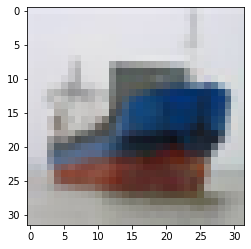

In [ ]:
# get some random training images
dataiter = iter(trainloader)
image, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(image))

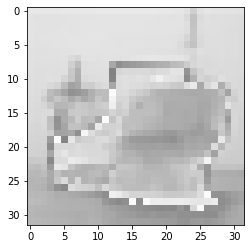

In [ ]:
imshow(torchvision.utils.make_grid(to_gray_images(image)))

In [ ]:
image_gray = to_gray_images(image).to("cpu")
result_image = cifar10_gtc_model(image_gray)
result_image = result_image.to("cpu").detach()

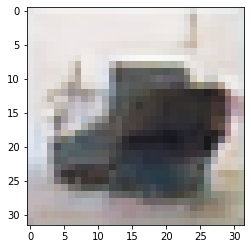

In [ ]:
imshow(torchvision.utils.make_grid(result_image))

Применим модель к тестовой картинке.

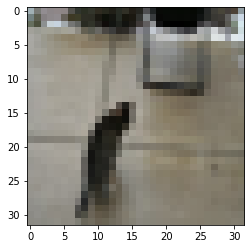

In [ ]:
# get some random testing images
dataiter = iter(testloader)
image, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(image))

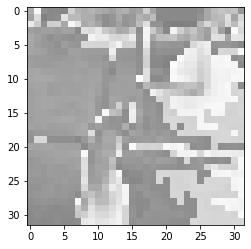

In [ ]:
imshow(torchvision.utils.make_grid(to_gray_images(image)))

In [ ]:
image_gray = to_gray_images(image).to("cpu")
result_image = cifar10_gtc_model(image_gray)
result_image = result_image.to("cpu").detach()

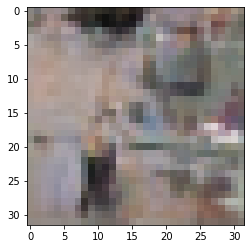

In [ ]:
imshow(torchvision.utils.make_grid(result_image))

Применим к картинке из интернета.

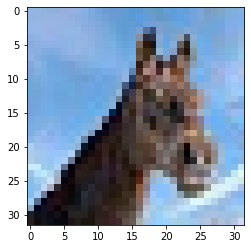

In [ ]:
# возьмём картинку из интернета 
from PIL import Image
import requests

image = Image.open(requests.get('https://github.com/alexk-git/dls-s1-project/blob/main/img/horse_head.jpg?raw=true', stream=True).raw)
image = transform(image)
image = image[None, :, :]
# show image
imshow(torchvision.utils.make_grid(image))

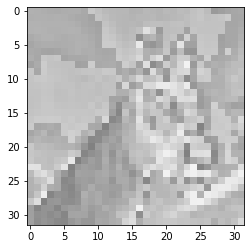

In [ ]:
imshow(torchvision.utils.make_grid(to_gray_images(image)))

In [ ]:
image_gray = to_gray_images(image).to("cpu")
result_image = cifar10_gtc_model(image_gray)
result_image = result_image.to("cpu").detach()

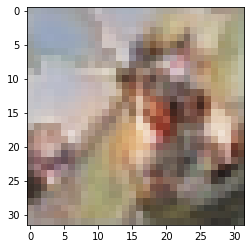

In [ ]:
imshow(torchvision.utils.make_grid(result_image))

In [ ]:
# # если нужно скачать модель:
# from google.colab import files
# files.download('pytorch_models/pix2pix_generator_cifar10_gtc.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>